In [ ]:
from google.cloud import translate_v2 as translate
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [ ]:
def translate_text(text, target_language):
    """Translates text into the target language."""
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language=target_language)
    return result['translatedText']

In [ ]:
def round_trip_translation(text, intermediate_language):
    """Performs round-trip translation of text via an intermediate language."""
    # Translate to intermediate language (e.g., English)
    translated_to_intermediate = translate_text(text, target_language=intermediate_language)

    # Translate back to the original language (e.g., Korean)
    translated_back = translate_text(translated_to_intermediate, target_language='ko')

    return translated_back

In [ ]:
# rtt 함수 선언

import requests
global url
url = f"https://translation.googleapis.com/language/translate/v2"

global api_key
api_key = ""


def translate_text(text, target_language):
    url = f"https://translation.googleapis.com/language/translate/v2"

    params = {
        'q': text,
        'target': target_language,
        'key': api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()['data']['translations'][0]['translatedText']
    else:
        return f"Error: {response.status_code}, {response.text}"

def rtt(text, intermediate_language, final_language):
    intermediate_text = translate_text(text, intermediate_language)
    final_text = translate_text(intermediate_text, final_language)

    return final_text

original_text = "스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~"
intermediate_language = "ja"
final_language = "ko"

print(rtt(original_text, intermediate_language, final_language))

스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~


In [ ]:
os.chdir("/content/drive/MyDrive/네이버 부스트캠프 AI Tech 7기/프로젝트 1 - 문장 간 유사도 측정")

In [ ]:
train_pd = pd.read_csv("train.csv")
dev_pd = pd.read_csv("dev.csv")
test_pd = pd.read_csv("test.csv")

print(train_pd.info(),end='\n\n')
print(dev_pd.info(),end='\n\n')
print(test_pd.info(),end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9324 entries, 0 to 9323
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9324 non-null   object 
 1   source        9324 non-null   object 
 2   sentence_1    9324 non-null   object 
 3   sentence_2    9324 non-null   object 
 4   label         9324 non-null   float64
 5   binary-label  9324 non-null   float64
dtypes: float64(2), object(4)
memory usage: 437.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            550 non-null    object 
 1   source        550 non-null    object 
 2   sentence_1    550 non-null    object 
 3   sentence_2    550 non-null    object 
 4   label         550 non-null    float64
 5   binary-label  550 non-null    float64
dtypes: float64(2), object(4)
memory usage

In [ ]:
print(train_pd["source"].unique())

['nsmc-sampled' 'slack-rtt' 'petition-sampled' 'slack-sampled' 'nsmc-rtt'
 'petition-rtt']


In [ ]:
print(train_pd.columns)

Index(['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label'], dtype='object')


sentence 2가 빈 frame을 만들어준다

In [ ]:
# rtt 데이터 df 선언

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

rtt_df = None

for i in range(len(train_pd)):
    source_name = train_pd.iloc[i]["source"]
    if source_name in rtt_categories_names:
        row = train_pd.iloc[i].copy()
        rtt_df = pd.concat([rtt_df, pd.DataFrame([row])], ignore_index=True)  # rtt_df에 해당 행 추가

rtt_df

id        source  \
0      boostcamp-sts-v1-train-001     slack-rtt   
1      boostcamp-sts-v1-train-005      nsmc-rtt   
2      boostcamp-sts-v1-train-006     slack-rtt   
3      boostcamp-sts-v1-train-010     slack-rtt   
4      boostcamp-sts-v1-train-012      nsmc-rtt   
...                           ...           ...   
2647  boostcamp-sts-v1-train-9297     slack-rtt   
2648  boostcamp-sts-v1-train-9298  petition-rtt   
2649  boostcamp-sts-v1-train-9304  petition-rtt   
2650  boostcamp-sts-v1-train-9307     slack-rtt   
2651  boostcamp-sts-v1-train-9318  petition-rtt   

                                        sentence_1  \
0                             앗 제가 접근권한이 없다고 뜹니다;;   
1                                   오마이가뜨지져스크롸이스트휏   
2                              전 암만 찍어도 까만 하늘.. ㅠㅠ   
3                               그 책부터 언능 꺼내봐야 겠어요!   
4                      오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!   
...                                            ...   
2647                         크 오늘 날씨 너무 좋았는데, 대박!!   
2648  북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//   
2649                                독도 표시된 한반도기 사용   
2650                    프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.   
2651                  워마드 회원에 대해 테러방지법 적용을 검토해주세요.   

                                       sentence_2  label  binary-label  
0                             오, 액세스 권한이 없다고 합니다.    4.2           1.0  
1                            오 마이 갓 지저스 스크론 이스트 팬    2.6           1.0  
2                             암만 찍어도 하늘은 까맣다.. ㅠㅠ    3.6           1.0  
3                                     책에서 꺼내야겠어요!    2.4           0.0  
4                  오랜만에 존 쿠삭의 연기를 보니 반갑다. 좋아요~~!!    3.8           1.0  
...                                           ...    ...           ...  
2647                         오늘은 날씨가 너무 좋았어, 굿굿!!    4.0           1.0  
2648  북한연락사무소 리모델링 97억8000만원???? 급하니까 나중에 계산할게 //    4.2           1.0  
2649                              독도가 표시된 한반도기 사용    5.0           1.0  
2650                  프로젝트 멘토를 만난 기분으로 인사를 받았습니다.    2.8           1.0  
2651             Warmad 회원에 대한 테러 방지법 적용을 검토하십시오.    4.4           1.0  

[2652 rows x 6 columns]

In [ ]:
# 기존 rtt되지 않은 데이터 일본어로 증강 될 데이터가 들어갈 데이터프레임 선언
aug_df_ja = None

not_rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] != "rtt":
        not_rtt_categories_names.append(name)

for i in tqdm(range(len(train_pd))):
    if train_pd.iloc[i]["source"] in not_rtt_categories_names:
        row = train_pd.iloc[i].copy()
        aug_df_ja = pd.concat([aug_df_ja, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "ja" # 일본어 언어코드 ja
final_language = "ko"

for i in tqdm(range(len(aug_df_ja))):
    text1 = rtt(aug_df_ja.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_ja.loc[i, "sentence_1"] = text1

    text2 = rtt(aug_df_ja.iloc[i]["sentence_2"], intermediate_language, final_language)
    aug_df_ja.loc[i, "sentence_2"] = text2

    print(aug_df_ja.loc[i])

aug_df_ja

  0%|          | 1/6672 [00:00<57:32,  1.93it/s]

id                              boostcamp-sts-v1-train-000
source                                        nsmc-sampled
sentence_1      스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~
sentence_2                           반전도 있고, 사랑도 있고 재미있네요.
label                                                  2.2
binary-label                                           0.0
Name: 0, dtype: object


  0%|          | 2/6672 [00:00<54:20,  2.05it/s]

id              boostcamp-sts-v1-train-002
source                    petition-sampled
sentence_1               주택 신청 조건을 변경하십시오.
sentence_2           주택 신청 무주택 기준 변경해 주세요.
label                                  2.4
binary-label                           0.0
Name: 1, dtype: object


  0%|          | 3/6672 [00:01<55:39,  2.00it/s]

id              boostcamp-sts-v1-train-003
source                       slack-sampled
sentence_1       입사 후 처음으로 대면으로 만나서 기뻤습니다.
sentence_2        화상만으로 리얼하게 만나서 정말 기뻤습니다.
label                                  3.0
binary-label                           1.0
Name: 2, dtype: object


  0%|          | 4/6672 [00:01<52:04,  2.13it/s]

id              boostcamp-sts-v1-train-004
source                       slack-sampled
sentence_1                        통통해 보인다!
sentence_2                  조금 실제로 한번 만나요!
label                                  0.0
binary-label                           0.0
Name: 3, dtype: object


  0%|          | 5/6672 [00:02<51:12,  2.17it/s]

id              boostcamp-sts-v1-train-007
source                        nsmc-sampled
sentence_1               이렇게 귀여운 쥐는 처음이군요.
sentence_2              이렇게 지친 공포 영화는 처음..
label                                  0.6
binary-label                           0.0
Name: 4, dtype: object


  0%|          | 6/6672 [00:02<48:22,  2.30it/s]

id              boostcamp-sts-v1-train-008
source                    petition-sampled
sentence_1          미세먼지 해결이 가장 긴급한 문제입니다!
sentence_2           가장 긴급한 것이 신생아실 관리입니다!
label                                  0.4
binary-label                           0.0
Name: 5, dtype: object


  0%|          | 7/6672 [00:03<48:35,  2.29it/s]

id              boostcamp-sts-v1-train-009
source                    petition-sampled
sentence_1                 크림하우스 환불을 해주세요.
sentence_2                 크림하우스 환불을 받으세요.
label                                  4.2
binary-label                           1.0
Name: 6, dtype: object


  0%|          | 8/6672 [00:03<47:00,  2.36it/s]

id              boostcamp-sts-v1-train-011
source                        nsmc-sampled
sentence_1                 극의 전개는 매우 느립니다.
sentence_2                배포가 너무 느려서 속습니다.
label                                  3.8
binary-label                           1.0
Name: 7, dtype: object


  0%|          | 9/6672 [00:04<55:07,  2.01it/s]

id              boostcamp-sts-v1-train-013
source                        nsmc-sampled
sentence_1                             글쎄.
sentence_2         큰 반전이 없었다는 것을 기억합니다 ...
label                                  1.8
binary-label                           0.0
Name: 8, dtype: object


  0%|          | 10/6672 [00:04<52:16,  2.12it/s]

id                       boostcamp-sts-v1-train-014
source                                slack-sampled
sentence_1          다음은 게임 내에서 함께 팀을 묶어 캡처한 이미지입니다.
sentence_2      여러분 사이에서 다양한 아이디어를 제안하고 공유하는 채널입니다.
label                                           0.0
binary-label                                    0.0
Name: 9, dtype: object


  0%|          | 11/6672 [00:05<49:43,  2.23it/s]

id              boostcamp-sts-v1-train-015
source                    petition-sampled
sentence_1              LG전자 스마트폰 생산 중지 청원
sentence_2       LG전자서비스 노동조합의 잔해를 살펴보십시오.
label                                  0.4
binary-label                           0.0
Name: 10, dtype: object


  0%|          | 12/6672 [00:05<49:50,  2.23it/s]

id                         boostcamp-sts-v1-train-016
source                                  slack-sampled
sentence_1      환력이라면? ㅎㅎㅎ 이런 재미있는 이야기를 하는 시간이 빨리 갔다.
sentence_2            엄청 즐거운 이야기를 하고 나서 시간이 빨리 가버렸어요.
label                                             3.0
binary-label                                      1.0
Name: 11, dtype: object


  0%|          | 13/6672 [00:05<48:51,  2.27it/s]

id               boostcamp-sts-v1-train-019
source                     petition-sampled
sentence_1        내년 러시아 월드컵 자발 포기를 부탁드립니다.
sentence_2      2023 아시아컵 유치에 공동 개최에 반대합니다.
label                                   0.0
binary-label                            0.0
Name: 12, dtype: object


  0%|          | 14/6672 [00:06<49:12,  2.26it/s]

id              boostcamp-sts-v1-train-020
source                       slack-sampled
sentence_1                앞머리가 새로워졌습니다. ^^
sentence_2              가방에 넣고 조금씩 먹는다. ^^
label                                  0.0
binary-label                           0.0
Name: 13, dtype: object


  0%|          | 15/6672 [00:06<51:12,  2.17it/s]

id                     boostcamp-sts-v1-train-022
source                              slack-sampled
sentence_1                어려울 때 보면 안이 퍼진다고 생각합니다.
sentence_2      양쪽 끝을 한입 먹은 순간, 고삐를 풀 것이라고 생각합니다.
label                                         0.0
binary-label                                  0.0
Name: 14, dtype: object


  0%|          | 16/6672 [00:07<50:48,  2.18it/s]

id                          boostcamp-sts-v1-train-023
source                                    nsmc-sampled
sentence_1      노래와 잘 어울리는 영상 덕분인지 짧지만 강한 인상이 남아 있습니다.
sentence_2                 조금 유치합니다만, 가볍게 볼 수 있는 영화군요!
label                                              0.0
binary-label                                       0.0
Name: 15, dtype: object


  0%|          | 17/6672 [00:07<49:24,  2.24it/s]

id              boostcamp-sts-v1-train-026
source                    petition-sampled
sentence_1                       전두환을 처벌하다
sentence_2                     이재영을 구속해주세요
label                                  0.2
binary-label                           0.0
Name: 16, dtype: object


  0%|          | 18/6672 [00:08<50:05,  2.21it/s]

id              boostcamp-sts-v1-train-032
source                       slack-sampled
sentence_1               저도 아주 좋아하는 노래입니다.
sentence_2                 아! 나도 좋아하는 노래ㅎㅎ
label                                  4.0
binary-label                           1.0
Name: 17, dtype: object


  0%|          | 19/6672 [00:08<48:33,  2.28it/s]

id              boostcamp-sts-v1-train-033
source                        nsmc-sampled
sentence_1                      잘 만든 영화군요.
sentence_2                 잘 만든 영화라고 생각한다.
label                                  3.6
binary-label                           1.0
Name: 18, dtype: object


  0%|          | 20/6672 [00:08<46:29,  2.38it/s]

id              boostcamp-sts-v1-train-035
source                       slack-sampled
sentence_1                      다시 먹고 싶네요.
sentence_2                   얼마나 먹고 싶다면...
label                                  1.2
binary-label                           0.0
Name: 19, dtype: object


  0%|          | 21/6672 [00:09<47:44,  2.32it/s]

id              boostcamp-sts-v1-train-038
source                        nsmc-sampled
sentence_1            얼마든지 걸어가는 설정은 조금-_-;
sentence_2       그러나 앨리슨 로만이 벗은 것은 충격-_-;;
label                                  0.0
binary-label                           0.0
Name: 20, dtype: object


  0%|          | 22/6672 [00:09<47:35,  2.33it/s]

id              boostcamp-sts-v1-train-039
source                    petition-sampled
sentence_1                     휴교령을 내려주세요.
sentence_2                대구광역시 휴교령을 내려주세요
label                                  2.8
binary-label                           1.0
Name: 21, dtype: object


  0%|          | 23/6672 [00:10<47:03,  2.35it/s]

id              boostcamp-sts-v1-train-040
source                        nsmc-sampled
sentence_1              이런 명작을 왜 지금 보았는지..
sentence_2                 왜 이런 명작을 지금 본거야
label                                  4.2
binary-label                           1.0
Name: 22, dtype: object


  0%|          | 24/6672 [00:10<50:03,  2.21it/s]

id              boostcamp-sts-v1-train-041
source                    petition-sampled
sentence_1                      나이가 문제입니까?
sentence_2                        나는 무엇인가?
label                                  0.0
binary-label                           0.0
Name: 23, dtype: object


  0%|          | 25/6672 [00:11<47:53,  2.31it/s]

id              boostcamp-sts-v1-train-042
source                    petition-sampled
sentence_1                    소년법을 폐지하십시오.
sentence_2                 청소년 보호법 폐지하십시오.
label                                  3.8
binary-label                           1.0
Name: 24, dtype: object


  0%|          | 26/6672 [00:11<48:33,  2.28it/s]

id                        boostcamp-sts-v1-train-044
source                              petition-sampled
sentence_1                공무원이 수당을 부정하게 받지 않도록 하십시오.
sentence_2      최저임금 인상으로 인한 정부지원금의 부정수급을 적발하여 처벌한다.
label                                            0.8
binary-label                                     0.0
Name: 25, dtype: object


  0%|          | 27/6672 [00:12<51:57,  2.13it/s]

id              boostcamp-sts-v1-train-046
source                       slack-sampled
sentence_1                  왜 내가 솥에 들어갔는가?
sentence_2          사과나 우유에 단백질을 먹고 있어요 ㅎㅎ
label                                  0.0
binary-label                           0.0
Name: 26, dtype: object


  0%|          | 28/6672 [00:12<51:26,  2.15it/s]

id                        boostcamp-sts-v1-train-047
source                                  nsmc-sampled
sentence_1      나의 형제와 같이 보았는데, 그것은 무서워서 잘 본 것 같습니다.
sentence_2                    내용도 그렇게 별로 마음에 들지 않는다…
label                                            0.0
binary-label                                     0.0
Name: 27, dtype: object


  0%|          | 29/6672 [00:13<49:30,  2.24it/s]

id              boostcamp-sts-v1-train-048
source                    petition-sampled
sentence_1             알코올 중독자가 기초 생활 수급자?
sentence_2              기초 생활 수급자 장애인을 위해.
label                                  1.0
binary-label                           0.0
Name: 28, dtype: object


  0%|          | 30/6672 [00:13<53:53,  2.05it/s]

id                                  boostcamp-sts-v1-train-049
source                                        petition-sampled
sentence_1                              구 의원, 시 의원 선거. 지금 그만두자
sentence_2      국회의원, 도의회, 시의원으로서 3회 이상 선거에 출마하는 것은 금지되어 있습니다.
label                                                      0.8
binary-label                                               0.0
Name: 29, dtype: object


  0%|          | 31/6672 [00:14<51:45,  2.14it/s]

id              boostcamp-sts-v1-train-051
source                        nsmc-sampled
sentence_1           우리 아이들이 보지 않았기를 바랍니다.
sentence_2              아이들과 봐도 좋다고 생각합니다.
label                                  0.6
binary-label                           0.0
Name: 30, dtype: object


  0%|          | 32/6672 [00:14<49:52,  2.22it/s]

id                               boostcamp-sts-v1-train-052
source                                        slack-sampled
sentence_1                     함께 이야기를 해보니 시간이 지나는지 모르겠습니다.
sentence_2      야영이 이야기와 함께 재미있는 이야기를 해보면 시간이 걸릴 것 같지 않았네요.
label                                                   3.0
binary-label                                            1.0
Name: 31, dtype: object


  0%|          | 33/6672 [00:14<49:33,  2.23it/s]

id                        boostcamp-sts-v1-train-053
source                                  nsmc-sampled
sentence_1                         다만 관객에 대한 배려가 없다.
sentence_2      이 정도 수준에서 영화관으로 내보내는 것은 관객에 대한 모독이다.
label                                            1.8
binary-label                                     0.0
Name: 32, dtype: object


  1%|          | 34/6672 [00:15<48:38,  2.27it/s]

id                           boostcamp-sts-v1-train-054
source                                 petition-sampled
sentence_1              지금 있는 시설 관리에서도 조금 잘 해 주었으면 합니다.
sentence_2      여성 가족부 폐지해 그 예산을 좀 더 올바르게 사용해 주었으면 합니다.
label                                               0.0
binary-label                                        0.0
Name: 33, dtype: object


  1%|          | 35/6672 [00:15<47:49,  2.31it/s]

id                  boostcamp-sts-v1-train-055
source                            nsmc-sampled
sentence_1                    그러나 멜로 연기는 영입니다.
sentence_2      유령이 나왔을 때 멜로디는 어렸을 때 충격적이었습니다.
label                                      0.0
binary-label                               0.0
Name: 34, dtype: object


  1%|          | 36/6672 [00:16<58:37,  1.89it/s]

id              boostcamp-sts-v1-train-056
source                        nsmc-sampled
sentence_1                 가장 좋은 것 같았지만 ..
sentence_2                 나는 이것이 가장 재미있다.
label                                  1.6
binary-label                           0.0
Name: 35, dtype: object


  1%|          | 37/6672 [00:16<55:13,  2.00it/s]

id              boostcamp-sts-v1-train-059
source                        nsmc-sampled
sentence_1                    이건 진짜 대히트 ㅇㅇ
sentence_2                   이것은 정말 최고입니다.
label                                  3.8
binary-label                           1.0
Name: 36, dtype: object


  1%|          | 38/6672 [00:17<1:01:09,  1.81it/s]

id                                    boostcamp-sts-v1-train-060
source                                             slack-sampled
sentence_1      책도 전반을 읽어 보면 우리 회사의 문화와 업무 스타일에 좋은 힌트가 들어 있었습니다!
sentence_2                      첫날부터 우리 회사의 좋은 문화를 가득 체험해 갑니다 ㅎㅎ
label                                                        1.0
binary-label                                                 0.0
Name: 37, dtype: object


  1%|          | 39/6672 [00:18<57:14,  1.93it/s]  

id                         boostcamp-sts-v1-train-061
source                               petition-sampled
sentence_1                          그루밍 성범죄법이 있어야합니다.
sentence_2      !! &quot;그루밍 범죄&quot;, 청소년 폭력 범죄로 절반!
label                                             1.0
binary-label                                      0.0
Name: 38, dtype: object


  1%|          | 40/6672 [00:18<1:00:17,  1.83it/s]

id                                     boostcamp-sts-v1-train-063
source                                              slack-sampled
sentence_1      부트 캠프 프로그램 이야기부터 추천 도메인 이야기까지 순식간에 시간이 지나서 죄송합니다.
sentence_2      각자의 업무와 부트캠프의 이야기로부터 앞으로 진로의 이야기까지 나누어 보면, 1시간...
label                                                         2.0
binary-label                                                  0.0
Name: 39, dtype: object


  1%|          | 41/6672 [00:19<1:01:33,  1.80it/s]

id                                     boostcamp-sts-v1-train-065
source                                              slack-sampled
sentence_1                                    아 어제<PERSON> 씨가 샀다!
sentence_2      누가? 나와<PERSON> 그리고 레이스에 가까운 분, 서울에 사는 분들도 놀 준비...
label                                                         0.4
binary-label                                                  0.0
Name: 40, dtype: object


  1%|          | 42/6672 [00:19<1:07:04,  1.65it/s]

id              boostcamp-sts-v1-train-066
source                       slack-sampled
sentence_1                 레스토랑도 정말 좋았습니다.
sentence_2                      정말 매우 멋지다!
label                                  2.8
binary-label                           1.0
Name: 41, dtype: object


  1%|          | 43/6672 [00:20<1:11:45,  1.54it/s]

id                 boostcamp-sts-v1-train-068
source                       petition-sampled
sentence_1              【주차장】무단주차 단속법규의 정비 요청
sentence_2      긴급 상황 출동 시 개인 재산(주차 차량) 침해 허가
label                                     0.4
binary-label                              0.0
Name: 42, dtype: object


  1%|          | 44/6672 [00:21<1:05:36,  1.68it/s]

id                  boostcamp-sts-v1-train-069
source                        petition-sampled
sentence_1              어린이 집의 지원금을 부모로 만드십시오.
sentence_2      어린이 집의 이용 시간을 현실적으로 조정하십시오 ...
label                                      0.8
binary-label                               0.0
Name: 43, dtype: object


  1%|          | 45/6672 [00:21<1:03:01,  1.75it/s]

id                   boostcamp-sts-v1-train-070
source                            slack-sampled
sentence_1           <PERSON>씨와 어제 저녁에 식사를했습니다!
sentence_2      <PERSON>씨와 어제 1시간의 이야기를 나누었습니다!
label                                       0.8
binary-label                                0.0
Name: 44, dtype: object


  1%|          | 46/6672 [00:22<56:50,  1.94it/s]  

id              boostcamp-sts-v1-train-071
source                       slack-sampled
sentence_1              나는 끝없는 리필 도전 중 격파!
sentence_2                 나도 데스카 사용 중입니다!
label                                  0.0
binary-label                           0.0
Name: 45, dtype: object


  1%|          | 47/6672 [00:22<53:30,  2.06it/s]

id                   boostcamp-sts-v1-train-072
source                            slack-sampled
sentence_1      Google meet에 맞는 크기로 크기를 조정했습니다.
sentence_2      스우파 리전 vs 시미즈에서 리전 배틀 송이기도 합니다.
label                                       0.0
binary-label                                0.0
Name: 46, dtype: object


  1%|          | 48/6672 [00:22<50:39,  2.18it/s]

id              boostcamp-sts-v1-train-073
source                        nsmc-sampled
sentence_1                   감성을 자극할 수 없다.
sentence_2                   감성을 자극한 좋은 영화
label                                  1.6
binary-label                           0.0
Name: 47, dtype: object


  1%|          | 49/6672 [00:23<49:49,  2.22it/s]

id              boostcamp-sts-v1-train-074
source                       slack-sampled
sentence_1               고화질 영상으로 수정합니다! ㅎ
sentence_2           하반신이지만 고관절 신청합니다 ...!
label                                  0.0
binary-label                           0.0
Name: 48, dtype: object


  1%|          | 50/6672 [00:23<49:29,  2.23it/s]

id              boostcamp-sts-v1-train-075
source                    petition-sampled
sentence_1                  문재인 불만을 하지 말라.
sentence_2                  문재인을 부탁하지 마세요.
label                                  1.6
binary-label                           0.0
Name: 49, dtype: object


  1%|          | 51/6672 [00:24<51:36,  2.14it/s]

id                boostcamp-sts-v1-train-076
source                          nsmc-sampled
sentence_1       후반에 들어가 법적 공방과 반전은 이영화의 묘미.
sentence_2      투혼과 함께 반담의 최고 영화. 복수의 칼날 반담~
label                                    0.0
binary-label                             0.0
Name: 50, dtype: object


  1%|          | 52/6672 [00:24<50:08,  2.20it/s]

id                 boostcamp-sts-v1-train-077
source                          slack-sampled
sentence_1      무언가 대나무처럼 큰 모양이라고 생각했는데 신기하다.
sentence_2      아 ㅎㅎ 새로 인터넷을 설치해야 한다고 생각했습니다.
label                                     0.0
binary-label                              0.0
Name: 51, dtype: object


  1%|          | 53/6672 [00:25<48:22,  2.28it/s]

id              boostcamp-sts-v1-train-079
source                    petition-sampled
sentence_1                      조동성 양을 늘리다
sentence_2               소년법 개정. 폐지를 청원합니다
label                                  0.0
binary-label                           0.0
Name: 52, dtype: object


  1%|          | 54/6672 [00:25<59:01,  1.87it/s]

id              boostcamp-sts-v1-train-080
source                    petition-sampled
sentence_1                    가상화 페 규제의 반대
sentence_2                가상화 페 거래소의 패권 반대
label                                  2.8
binary-label                           1.0
Name: 53, dtype: object


  1%|          | 55/6672 [00:26<55:55,  1.97it/s]

id                        boostcamp-sts-v1-train-081
source                                 slack-sampled
sentence_1      옛날 유럽의 한 전쟁 때 일단 군대가 마을에 진주하게 되었습니다.
sentence_2               각각이 살고있는 곳의 날씨 이야기로 시작했습니다.
label                                            0.0
binary-label                                     0.0
Name: 54, dtype: object


  1%|          | 56/6672 [00:26<53:23,  2.07it/s]

id              boostcamp-sts-v1-train-082
source                    petition-sampled
sentence_1            다이토가와 맥주의 수입을 기원합니다!
sentence_2               MBN을 강력하게 제재하십시오!
label                                  0.0
binary-label                           0.0
Name: 55, dtype: object


  1%|          | 57/6672 [00:27<51:27,  2.14it/s]

id              boostcamp-sts-v1-train-083
source                    petition-sampled
sentence_1             여자 아이스하키팀 싱글팀 구성 반대
sentence_2             여성 아이스하키 싱글팀은 절대 반대
label                                  3.2
binary-label                           1.0
Name: 56, dtype: object


  1%|          | 58/6672 [00:27<55:55,  1.97it/s]

id              boostcamp-sts-v1-train-086
source                       slack-sampled
sentence_1                       물은 대답을 알고
sentence_2                     물의 요정이다! 웃음
label                                  0.2
binary-label                           0.0
Name: 57, dtype: object


  1%|          | 59/6672 [00:28<54:03,  2.04it/s]

id                               boostcamp-sts-v1-train-087
source                                        slack-sampled
sentence_1                               우리도 빠른 워크숍 준비를 ..!
sentence_2      워크숍의 분위기의 아침 8시에 하기 어려웠지만 www 다음은 하프 챌린지~~!
label                                                   0.8
binary-label                                            0.0
Name: 58, dtype: object


  1%|          | 60/6672 [00:28<53:28,  2.06it/s]

id              boostcamp-sts-v1-train-088
source                    petition-sampled
sentence_1                      현실적인 통일안 2
sentence_2                   청소년 실업 해소안 제안
label                                  0.2
binary-label                           0.0
Name: 59, dtype: object


  1%|          | 61/6672 [00:29<54:11,  2.03it/s]

id                                boostcamp-sts-v1-train-089
source                                         slack-sampled
sentence_1                   여기서 왕 갈비를 드시고 이 광경을 보면 정말 멋집니다.
sentence_2      왕 갈비 최고였습니다. 정자에 부는 시원한 바람도 일품이었습니다. 최고 최고~~
label                                                    1.4
binary-label                                             0.0
Name: 60, dtype: object


  1%|          | 62/6672 [00:29<56:47,  1.94it/s]

id                       boostcamp-sts-v1-train-090
source                                slack-sampled
sentence_1      둘 다 낯설면서도 수다를 숨길 수없는 캐릭터라고 눈치 채고 ww
sentence_2           재미있는 콘셉트를 사용해도 숨길 수 없는 퀄리티 ㅠㅠㅠ
label                                           1.0
binary-label                                    0.0
Name: 61, dtype: object


  1%|          | 63/6672 [00:30<52:34,  2.09it/s]

id              boostcamp-sts-v1-train-091
source                    petition-sampled
sentence_1                      이민을 허용하십시오
sentence_2                    소년법을 폐지하십시오.
label                                  0.0
binary-label                           0.0
Name: 62, dtype: object


  1%|          | 64/6672 [00:30<50:17,  2.19it/s]

id              boostcamp-sts-v1-train-092
source                        nsmc-sampled
sentence_1                     그냥 재미 있습니다.
sentence_2                    재미 있으니 봐주세요.
label                                  2.8
binary-label                           1.0
Name: 63, dtype: object


  1%|          | 65/6672 [00:30<48:33,  2.27it/s]

id              boostcamp-sts-v1-train-093
source                        nsmc-sampled
sentence_1            할머니: 감독… 농구를 하고 싶어요.
sentence_2                   - 점이 없어서 유감~~
label                                  0.0
binary-label                           0.0
Name: 64, dtype: object


  1%|          | 66/6672 [00:31<52:45,  2.09it/s]

id              boostcamp-sts-v1-train-094
source                        nsmc-sampled
sentence_1      보면서 주인공의 아이가 정말 불쌍하다고 느꼈다.
sentence_2               친구가 무섭다고 추천해 주었다.
label                                  0.0
binary-label                           0.0
Name: 65, dtype: object


  1%|          | 67/6672 [00:31<51:32,  2.14it/s]

id              boostcamp-sts-v1-train-095
source                       slack-sampled
sentence_1                아 대화 시스템! 환영합니다!
sentence_2                   아, 기대하고 있어요~~
label                                  0.0
binary-label                           0.0
Name: 66, dtype: object


  1%|          | 68/6672 [00:32<50:42,  2.17it/s]

id                       boostcamp-sts-v1-train-096
source                                 nsmc-sampled
sentence_1         그 밖에도 스스로 자신에 대해 생각하고 되돌아보는 영화다.
sentence_2      모든 영화가 아닌 척하지만, 모두 우리 자신에 대한 위로입니다.
label                                           0.6
binary-label                                    0.0
Name: 67, dtype: object


  1%|          | 69/6672 [00:32<49:03,  2.24it/s]

id              boostcamp-sts-v1-train-097
source                       slack-sampled
sentence_1                  오 ㅎ ㅎ ㅎ 신기합니다.
sentence_2       오, 어째서 그런!! ㅋㅋㅋ 너무 신기합니다.
label                                  3.6
binary-label                           1.0
Name: 68, dtype: object


  1%|          | 70/6672 [00:33<51:30,  2.14it/s]

id                   boostcamp-sts-v1-train-098
source                            slack-sampled
sentence_1      오늘이 우리 회사에 입사한 지 100일이 되는 날입니다!
sentence_2                이미 입사한 지 4개월 정도 지났어요.
label                                       2.8
binary-label                                1.0
Name: 69, dtype: object


  1%|          | 71/6672 [00:33<51:12,  2.15it/s]

id              boostcamp-sts-v1-train-099
source                       slack-sampled
sentence_1                  이 말에 너무 공감됩니다.
sentence_2                       매우 공감합니다.
label                                  3.4
binary-label                           1.0
Name: 70, dtype: object


  1%|          | 72/6672 [00:34<50:52,  2.16it/s]

id              boostcamp-sts-v1-train-100
source                    petition-sampled
sentence_1             히딩크 감독을 맞이하러 와야 합니다
sentence_2           히딩크 감독을 다시 한국 축구 감독으로
label                                  3.2
binary-label                           1.0
Name: 71, dtype: object


  1%|          | 73/6672 [00:34<50:03,  2.20it/s]

id                      boostcamp-sts-v1-train-101
source                            petition-sampled
sentence_1      나라를 위해 하고 있나요, 돈을 벌기 위해 그 길을 갔습니까?
sentence_2                          자영업자는 모두 죽일까요?
label                                          0.0
binary-label                                   0.0
Name: 72, dtype: object


  1%|          | 74/6672 [00:35<51:12,  2.15it/s]

id                  boostcamp-sts-v1-train-102
source                           slack-sampled
sentence_1            건조기없이 매일 세탁하고 있지만 사이즈 오케
sentence_2      큰 사이즈의 모션 데스크를 사용하고 있지만 만족합니다.
label                                      0.4
binary-label                               0.0
Name: 73, dtype: object


  1%|          | 75/6672 [00:35<49:05,  2.24it/s]

id              boostcamp-sts-v1-train-104
source                    petition-sampled
sentence_1                 이명박 씨의 출장을 멈추세요
sentence_2                  이명박 출국을 금지하세요~
label                                  4.2
binary-label                           1.0
Name: 74, dtype: object


  1%|          | 76/6672 [00:35<47:41,  2.30it/s]

id              boostcamp-sts-v1-train-105
source                        nsmc-sampled
sentence_1             멈추면 갑자기 폭발해 버리는 느낌.
sentence_2                   후두부를 어울리는 느낌.
label                                  0.2
binary-label                           0.0
Name: 75, dtype: object


  1%|          | 77/6672 [00:36<49:15,  2.23it/s]

id                        boostcamp-sts-v1-train-107
source                              petition-sampled
sentence_1          경추 요추 척추 압박 골절시 시술 대기 기간을 제거하십시오
sentence_2      건강 보험 보장의 확대에 오자 반점 제거 시술도 포함해 주십시오.
label                                            0.0
binary-label                                     0.0
Name: 76, dtype: object


  1%|          | 78/6672 [00:36<49:31,  2.22it/s]

id                      boostcamp-sts-v1-train-108
source                            petition-sampled
sentence_1                      청화대학의 청원본명을 공개해주세요
sentence_2      청와대 국민청원 근거 없이 삭제직권 남용직원 형사처벌 바랍니다
label                                          1.2
binary-label                                   0.0
Name: 77, dtype: object


  1%|          | 79/6672 [00:37<54:47,  2.01it/s]

id                  boostcamp-sts-v1-train-109
source                            nsmc-sampled
sentence_1              영화의 즐거움보다 짚 라인을 타고 싶다.
sentence_2      가난한 영화가 넘치는 여운… 그녀의 말조차 듣고 싶다.
label                                      0.0
binary-label                               0.0
Name: 78, dtype: object


  1%|          | 80/6672 [00:37<53:22,  2.06it/s]

id                                  boostcamp-sts-v1-train-111
source                                            nsmc-sampled
sentence_1      나의 감정은 매일이기 때문에 모르겠지만 개인적으로는 귀찮고 재미 없었던 영화입니다.
sentence_2                                       매우 지루한 영화입니다.
label                                                      3.0
binary-label                                               1.0
Name: 79, dtype: object


  1%|          | 81/6672 [00:38<52:34,  2.09it/s]

id                        boostcamp-sts-v1-train-112
source                              petition-sampled
sentence_1      민간 어린이 집과 가정 어린이 집에 현장에 맞게 법을 만드십시오.
sentence_2          민간 어린이 가정과 가정 어린이 가정 운영비를 지원합니다.
label                                            2.0
binary-label                                     0.0
Name: 80, dtype: object


  1%|          | 82/6672 [00:38<50:34,  2.17it/s]

id              boostcamp-sts-v1-train-114
source                       slack-sampled
sentence_1                       다들 맛봤어~~~
sentence_2                     모두 함께 맛보세요~
label                                  2.8
binary-label                           1.0
Name: 81, dtype: object


  1%|          | 83/6672 [00:39<49:47,  2.21it/s]

id              boostcamp-sts-v1-train-115
source                        nsmc-sampled
sentence_1                간에서 최악의 영화를 보았다.
sentence_2                 간에서 좋은 영화를 보았다.
label                                  0.6
binary-label                           0.0
Name: 82, dtype: object


  1%|▏         | 84/6672 [00:39<49:40,  2.21it/s]

id                               boostcamp-sts-v1-train-116
source                                        slack-sampled
sentence_1        지금도 아침에 코칭하고, 가족도 자주 함께 다니는 가족 운동이라고 합니다!
sentence_2      그리고 그림도 그리는 것을 좋아해, 태블릿까지 구입해, 자주 그린다고 합니다!
label                                                   0.0
binary-label                                            0.0
Name: 83, dtype: object


  1%|▏         | 85/6672 [00:40<48:24,  2.27it/s]

id              boostcamp-sts-v1-train-119
source                    petition-sampled
sentence_1                   주 52시간 노동에 대해
sentence_2               주 52시간 근무제의 의견입니다
label                                  3.2
binary-label                           1.0
Name: 84, dtype: object


  1%|▏         | 86/6672 [00:40<49:52,  2.20it/s]

id              boostcamp-sts-v1-train-120
source                    petition-sampled
sentence_1                     둘만 낳아도 다자급여
sentence_2             타코 가구 부모의 공무원 우선 채용
label                                  0.6
binary-label                           0.0
Name: 85, dtype: object


  1%|▏         | 87/6672 [00:41<50:55,  2.16it/s]

id                 boostcamp-sts-v1-train-121
source                          slack-sampled
sentence_1      아이가 게임에 빠지지 않도록 하는 방법이라고 합니다.
sentence_2           ㅠㅠ 인도에서 비행 2주간 금지라고 합니다.
label                                     0.0
binary-label                              0.0
Name: 86, dtype: object


  1%|▏         | 88/6672 [00:41<51:24,  2.13it/s]

id                     boostcamp-sts-v1-train-122
source                              slack-sampled
sentence_1       건강한 취미에 이어 건강한 음식도 즐길 수 있다고 합니다.
sentence_2      다양한 공간에서 생활의 모습을 체험하는 것을 즐긴다고 한다.
label                                         0.4
binary-label                                  0.0
Name: 87, dtype: object


  1%|▏         | 89/6672 [00:42<49:17,  2.23it/s]

id              boostcamp-sts-v1-train-123
source                    petition-sampled
sentence_1                 주택가격 안정화에 관한 청원
sentence_2                주택 가격 안정화를 위한 제안
label                                  3.2
binary-label                           1.0
Name: 88, dtype: object


  1%|▏         | 90/6672 [00:42<48:49,  2.25it/s]

id              boostcamp-sts-v1-train-124
source                    petition-sampled
sentence_1                       황제로역을 없애라
sentence_2                  황제로역 폐지를 원합니다.
label                                  3.4
binary-label                           1.0
Name: 89, dtype: object


  1%|▏         | 91/6672 [00:42<49:05,  2.23it/s]

id                      boostcamp-sts-v1-train-125
source                            petition-sampled
sentence_1            욱일기~전범기 관련 사용금지법안을 지금 만들어주세요
sentence_2      풍등의 제작이나 비행의 행위를 법률로 금지할 필요가 있습니다.
label                                          0.0
binary-label                                   0.0
Name: 90, dtype: object


  1%|▏         | 92/6672 [00:43<53:34,  2.05it/s]

id              boostcamp-sts-v1-train-127
source                    petition-sampled
sentence_1               청원을 모으세요 중국 다리 미분
sentence_2             중국발의 미분진 대책을 해 주세요.
label                                  2.2
binary-label                           0.0
Name: 91, dtype: object


  1%|▏         | 93/6672 [00:43<50:46,  2.16it/s]

id               boostcamp-sts-v1-train-128
source                         nsmc-sampled
sentence_1        남주 식품 흡입 장면은 혐오감으로 편집 바람.
sentence_2      여배우 노출은 심했지만 재미있고 졸려서 본 영화.
label                                   0.0
binary-label                            0.0
Name: 92, dtype: object


  1%|▏         | 94/6672 [00:44<51:57,  2.11it/s]

id                       boostcamp-sts-v1-train-129
source                             petition-sampled
sentence_1      이동식 속도 단속 카메라 대신 속도 거래 cctv를 설치합니다.
sentence_2       5m 이동시의 휴대전화 액정 자동 소등 설치 의무화해 주세요.
label                                           0.0
binary-label                                    0.0
Name: 93, dtype: object


  1%|▏         | 95/6672 [00:44<52:23,  2.09it/s]

id                        boostcamp-sts-v1-train-132
source                                  nsmc-sampled
sentence_1        이런 종류의 영화가 지루하기 어렵지만, 드물게 지루하다 ...
sentence_2      상어가 나오는 영화가 이렇게 지루할 수 있는데 박수를 보낸다. .
label                                            2.0
binary-label                                     0.0
Name: 94, dtype: object


  1%|▏         | 96/6672 [00:45<49:59,  2.19it/s]

id              boostcamp-sts-v1-train-134
source                    petition-sampled
sentence_1                   무더위 대책을 해주세요.
sentence_2                지진 재해 방지책을 세워주세요
label                                  0.6
binary-label                           0.0
Name: 95, dtype: object


  1%|▏         | 97/6672 [00:45<47:08,  2.32it/s]

id              boostcamp-sts-v1-train-135
source                    petition-sampled
sentence_1                    조두성 출소 반대 서명
sentence_2                    조두순 출소 반대 청원
label                                  4.0
binary-label                           1.0
Name: 96, dtype: object


  1%|▏         | 98/6672 [00:46<50:34,  2.17it/s]

id              boostcamp-sts-v1-train-138
source                        nsmc-sampled
sentence_1               기대보다 기대보다… 우연한 과도
sentence_2                 영화보다 드라마 부작이 짱…
label                                  0.0
binary-label                           0.0
Name: 97, dtype: object


  1%|▏         | 99/6672 [00:46<48:22,  2.26it/s]

id              boostcamp-sts-v1-train-139
source                        nsmc-sampled
sentence_1                       달리고 또 달려,
sentence_2            공포감도 모호해.. 어쨌든 빛나는..
label                                  0.0
binary-label                           0.0
Name: 98, dtype: object


  1%|▏         | 100/6672 [00:47<47:11,  2.32it/s]

id              boostcamp-sts-v1-train-140
source                        nsmc-sampled
sentence_1                    이 영화도 그렇습니다.
sentence_2            이 감독의 영화는 모두 비추천입니다.
label                                  0.8
binary-label                           0.0
Name: 99, dtype: object


  2%|▏         | 101/6672 [00:47<47:58,  2.28it/s]

id                boostcamp-sts-v1-train-142
source                      petition-sampled
sentence_1                    국민연금 주식대여 전면금지
sentence_2      국민 연금 주식 대여를 금지하십시오 개미를 죽는다.
label                                    3.4
binary-label                             1.0
Name: 100, dtype: object


  2%|▏         | 102/6672 [00:47<47:50,  2.29it/s]

id                      boostcamp-sts-v1-train-143
source                               slack-sampled
sentence_1                오늘 오후 7시에 캠퍼에 공유될 예정입니다.
sentence_2      내일 오전 10시경에도 위와 같은 메시지가 달릴 예정입니다만!
label                                          0.4
binary-label                                   0.0
Name: 101, dtype: object


  2%|▏         | 103/6672 [00:48<47:26,  2.31it/s]

id              boostcamp-sts-v1-train-144
source                       slack-sampled
sentence_1                 금요일에 모인다는 첩보가..
sentence_2                  금요일에 더 논의합시다~!
label                                  1.4
binary-label                           0.0
Name: 102, dtype: object


  2%|▏         | 104/6672 [00:48<48:49,  2.24it/s]

id                                     boostcamp-sts-v1-train-147
source                                               nsmc-sampled
sentence_1                               영원한 시간 ... 그리고 영원한 사랑 ..
sentence_2      정말 재미있지 않아.......................................
label                                                         0.0
binary-label                                                  0.0
Name: 103, dtype: object


  2%|▏         | 105/6672 [00:49<47:07,  2.32it/s]

id              boostcamp-sts-v1-train-149
source                    petition-sampled
sentence_1                     김영란법을 폐지하세요
sentence_2                 김영란법 폐지해주세요! 제발
label                                  4.0
binary-label                           1.0
Name: 104, dtype: object


  2%|▏         | 106/6672 [00:49<46:46,  2.34it/s]

id              boostcamp-sts-v1-train-150
source                    petition-sampled
sentence_1             해외 MB 신청은 금지되어 있습니다
sentence_2                     이명박 출국금지 요청
label                                  3.6
binary-label                           1.0
Name: 105, dtype: object


  2%|▏         | 107/6672 [00:50<47:32,  2.30it/s]

id              boostcamp-sts-v1-train-151
source                    petition-sampled
sentence_1            아파트의 유출요금 감면을 청원합니다.
sentence_2         보육 교사 대 아동 비율 조정 청원합니다.
label                                  0.2
binary-label                           0.0
Name: 106, dtype: object


  2%|▏         | 108/6672 [00:50<47:49,  2.29it/s]

id              boostcamp-sts-v1-train-152
source                    petition-sampled
sentence_1            성범죄 공소 시효 폐지를 청원합니다.
sentence_2      청소년 보호법이나 소년법 등 폐지를 청원합니다.
label                                  0.2
binary-label                           0.0
Name: 107, dtype: object


  2%|▏         | 109/6672 [00:50<47:46,  2.29it/s]

id              boostcamp-sts-v1-train-154
source                        nsmc-sampled
sentence_1                    킬링 타임의 매우 ..
sentence_2            킬링 타임에 충분하지 않은 레벨 ..
label                                  1.2
binary-label                           0.0
Name: 108, dtype: object


  2%|▏         | 110/6672 [00:51<48:28,  2.26it/s]

id              boostcamp-sts-v1-train-155
source                    petition-sampled
sentence_1            엄청난 후 폭풍을 운전해 오는 개정.
sentence_2          많은 국민들이 큰 피해를 보고 있습니다.
label                                  0.0
binary-label                           0.0
Name: 109, dtype: object


  2%|▏         | 111/6672 [00:51<47:19,  2.31it/s]

id              boostcamp-sts-v1-train-157
source                    petition-sampled
sentence_1                 수시로 전형을 검토하십시오.
sentence_2                    수시로 전형 필수입니다
label                                  2.6
binary-label                           1.0
Name: 110, dtype: object


  2%|▏         | 112/6672 [00:52<45:59,  2.38it/s]

id                                boostcamp-sts-v1-train-159
source                                          nsmc-sampled
sentence_1                                    킬링 타임에 딱 맞습니다.
sentence_2      킬링 타임에 딱 맞다는 평가를 보았습니다만, 정말로 킬링 타임에는 딱 맞습니다.
label                                                    3.0
binary-label                                             1.0
Name: 111, dtype: object


  2%|▏         | 113/6672 [00:53<1:00:39,  1.80it/s]

id              boostcamp-sts-v1-train-160
source                        nsmc-sampled
sentence_1                 이런 전쟁 영화는 뾰족했다.
sentence_2                  이 드라마는 오랜만입니다.
label                                  0.4
binary-label                           0.0
Name: 112, dtype: object


  2%|▏         | 114/6672 [00:53<1:01:54,  1.77it/s]

id              boostcamp-sts-v1-train-162
source                       slack-sampled
sentence_1        큰 히트! 허리가 훨씬 편안하게 느껴지네요.
sentence_2               하늘색이 정말 푸르고 멋지네요.
label                                  0.0
binary-label                           0.0
Name: 113, dtype: object


  2%|▏         | 115/6672 [00:54<54:53,  1.99it/s]  

id              boostcamp-sts-v1-train-163
source                        nsmc-sampled
sentence_1               최고의 잼과 재미있는 영화 ..
sentence_2                 무심코 재미있는 영화입니다.
label                                  3.0
binary-label                           1.0
Name: 114, dtype: object


  2%|▏         | 116/6672 [00:54<50:15,  2.17it/s]

id              boostcamp-sts-v1-train-165
source                        nsmc-sampled
sentence_1                      평가에 속아요 ㅠㅠ
sentence_2                    오휴ㅅㅂ평가로 낚시지마
label                                  3.6
binary-label                           1.0
Name: 115, dtype: object


  2%|▏         | 117/6672 [00:54<49:24,  2.21it/s]

id              boostcamp-sts-v1-train-166
source                       slack-sampled
sentence_1                    찾아 넣어 두었습니다!
sentence_2                     예? 잘못되었습니다.
label                                  0.0
binary-label                           0.0
Name: 116, dtype: object


  2%|▏         | 118/6672 [00:55<47:58,  2.28it/s]

id                           boostcamp-sts-v1-train-168
source                                 petition-sampled
sentence_1              서울 모 초등학교 교감이. 학생의 개인정보를 팔았습니다!
sentence_2      서울도봉구에 있는 초등학교 교사의 폭력에 아이들이 병을 앓고 있습니다.
label                                               0.4
binary-label                                        0.0
Name: 117, dtype: object


  2%|▏         | 119/6672 [00:55<46:26,  2.35it/s]

id              boostcamp-sts-v1-train-169
source                    petition-sampled
sentence_1             7월 28일 난민 추방 촛불 만들기
sentence_2                6월 12일 광화문에 모이자!
label                                  0.0
binary-label                           0.0
Name: 118, dtype: object


  2%|▏         | 120/6672 [00:56<46:26,  2.35it/s]

id              boostcamp-sts-v1-train-170
source                       slack-sampled
sentence_1                 간의 세 번째 고양이의 자랑
sentence_2                     고양이 자랑하십시오!
label                                  1.4
binary-label                           0.0
Name: 119, dtype: object


  2%|▏         | 121/6672 [00:56<49:04,  2.22it/s]

id              boostcamp-sts-v1-train-171
source                        nsmc-sampled
sentence_1             무엇보다 시사회 환경은 최악이었다!
sentence_2             무엇보다 나오는 음악이 너무 많다.
label                                  0.4
binary-label                           0.0
Name: 120, dtype: object


  2%|▏         | 122/6672 [00:57<1:01:03,  1.79it/s]

id                boostcamp-sts-v1-train-172
source                      petition-sampled
sentence_1              청소년주, 담배, 폭행법의 엄격 강화
sentence_2      버스, 택시, 화물차의 안전 운전법을 강화하십시오.
label                                    0.4
binary-label                             0.0
Name: 121, dtype: object


  2%|▏         | 123/6672 [00:57<57:54,  1.89it/s]  

id              boostcamp-sts-v1-train-174
source                        nsmc-sampled
sentence_1                  잘 봐주셔서 감사합니다^^
sentence_2                     정말 재미있네요^^!
label                                  2.0
binary-label                           0.0
Name: 122, dtype: object


  2%|▏         | 124/6672 [00:58<54:22,  2.01it/s]

id              boostcamp-sts-v1-train-178
source                    petition-sampled
sentence_1                   자영업자를 활용하는 방법
sentence_2                 최저임금을 올리는 쉬운 방법
label                                  0.0
binary-label                           0.0
Name: 123, dtype: object


  2%|▏         | 125/6672 [00:58<51:09,  2.13it/s]

id              boostcamp-sts-v1-train-179
source                        nsmc-sampled
sentence_1                평가를 줄 때는 직접 봐준다.
sentence_2                  케이블로 보고 평가합니다.
label                                  0.8
binary-label                           0.0
Name: 124, dtype: object


  2%|▏         | 126/6672 [00:59<50:40,  2.15it/s]

id                       boostcamp-sts-v1-train-180
source                                 nsmc-sampled
sentence_1                        세계에 완벽한 세계가 없습니다.
sentence_2      이 때의 베이신어는 엔트리먼트의 제타 존스가 따라잡을 수 없다.
label                                           0.0
binary-label                                    0.0
Name: 125, dtype: object


  2%|▏         | 127/6672 [00:59<58:21,  1.87it/s]

id                                     boostcamp-sts-v1-train-182
source                                              slack-sampled
sentence_1                                  <PERSON>씨에게 압도적인 감사를!
sentence_2      <PERSON>이것은 매우 멋지고 아마도 수중이 아닌 육지에서도 사용할 수 있습니다...
label                                                         0.4
binary-label                                                  0.0
Name: 126, dtype: object


  2%|▏         | 128/6672 [01:00<1:02:04,  1.76it/s]

id                                     boostcamp-sts-v1-train-183
source                                           petition-sampled
sentence_1                                  이 나이에 군대에 가고 싶어요~~~^^
sentence_2      대통령에게 매일처럼 욕을 하는 녀석을 알고 있어요~~~~~~~~~~~~~~~~~~~...
label                                                         0.0
binary-label                                                  0.0
Name: 127, dtype: object


  2%|▏         | 129/6672 [01:00<58:48,  1.85it/s]  

id                            boostcamp-sts-v1-train-184
source                                      nsmc-sampled
sentence_1                         물론 아이들의 동화 같은 것은 아니다.
sentence_2      솔직히 돈을 들여 본 것이 아니라 돈이 끊어지는 소리는 할 수 없습니다.
label                                                0.0
binary-label                                         0.0
Name: 128, dtype: object


  2%|▏         | 130/6672 [01:01<55:50,  1.95it/s]

id              boostcamp-sts-v1-train-185
source                        nsmc-sampled
sentence_1                  제목에 잡히지 마세요...
sentence_2                       댓글로 잡은...
label                                  1.4
binary-label                           0.0
Name: 129, dtype: object


  2%|▏         | 131/6672 [01:01<53:49,  2.03it/s]

id              boostcamp-sts-v1-train-186
source                       slack-sampled
sentence_1                    목록이 큰 히트입니다.
sentence_2              최고의 숫자입니다. 큰 히트군요.
label                                  1.2
binary-label                           0.0
Name: 130, dtype: object


  2%|▏         | 132/6672 [01:02<51:28,  2.12it/s]

id              boostcamp-sts-v1-train-187
source                       slack-sampled
sentence_1                       와우, 안전하다.
sentence_2                     오오오오! 환영합니다
label                                  0.0
binary-label                           0.0
Name: 131, dtype: object


  2%|▏         | 133/6672 [01:02<49:47,  2.19it/s]

id              boostcamp-sts-v1-train-188
source                        nsmc-sampled
sentence_1                   무엇이 이렇게 외로운가?
sentence_2                왜 이렇게 영화가 있는지,,,
label                                  2.0
binary-label                           0.0
Name: 132, dtype: object


  2%|▏         | 134/6672 [01:03<48:14,  2.26it/s]

id                 boostcamp-sts-v1-train-189
source                          slack-sampled
sentence_1           이것보다 보면 회사의 생각이 많이 있습니다.
sentence_2      더 보면 우리 회사와 비슷한 부분이 많이 공유합니다.
label                                     2.0
binary-label                              0.0
Name: 133, dtype: object


  2%|▏         | 135/6672 [01:03<48:05,  2.27it/s]

id              boostcamp-sts-v1-train-190
source                       slack-sampled
sentence_1                  정말 신경이 쓰이는 제주!
sentence_2                        아, 신기하다.
label                                  0.0
binary-label                           0.0
Name: 134, dtype: object


  2%|▏         | 136/6672 [01:04<52:05,  2.09it/s]

id                                     boostcamp-sts-v1-train-191
source                                              slack-sampled
sentence_1      게다가 스우파-스걸파-쇼미를 연결하는 매우 즐거운 마음에 드는 공유 시간도 매우 즐...
sentence_2                   운동 이야기를 비롯해 직무에 대한 이야기까지! 매우 즐거웠습니다.
label                                                         1.2
binary-label                                                  0.0
Name: 135, dtype: object


  2%|▏         | 137/6672 [01:04<52:32,  2.07it/s]

id                                     boostcamp-sts-v1-train-193
source                                              slack-sampled
sentence_1      아무쪼록, 사내와 같은 취미를 가진 분들, 조금 계시는 것 같기 때문에, 관련해 자...
sentence_2                 시큐리티에 관해서 내용을 정리해, 향후 알림/당소별로 전해드릴게요~!
label                                                         0.0
binary-label                                                  0.0
Name: 136, dtype: object


  2%|▏         | 138/6672 [01:04<49:31,  2.20it/s]

id              boostcamp-sts-v1-train-194
source                    petition-sampled
sentence_1              실명 신청과 책임 회신 바랍니다.
sentence_2          청와대의 청원답변을 확실히 해 주십시오.
label                                  2.6
binary-label                           1.0
Name: 137, dtype: object


  2%|▏         | 139/6672 [01:05<46:52,  2.32it/s]

id              boostcamp-sts-v1-train-196
source                        nsmc-sampled
sentence_1                     지금 보면 너무 옛날
sentence_2                  오늘은 매우 즐거웠습니다.
label                                  0.6
binary-label                           0.0
Name: 138, dtype: object


  2%|▏         | 140/6672 [01:05<47:55,  2.27it/s]

id               boostcamp-sts-v1-train-197
source                        slack-sampled
sentence_1                 8월에는 꼭 피티에 갑니다ㅎㅎ
sentence_2      가까운 시일 내에 사무실을 방문하면 인사에 간다.
label                                   0.0
binary-label                            0.0
Name: 139, dtype: object


  2%|▏         | 141/6672 [01:06<47:38,  2.29it/s]

id              boostcamp-sts-v1-train-198
source                    petition-sampled
sentence_1                      이국종 교수의 분노
sentence_2                  이국 종교수를 도와주세요.
label                                  1.2
binary-label                           0.0
Name: 140, dtype: object


  2%|▏         | 142/6672 [01:06<56:19,  1.93it/s]

id                                     boostcamp-sts-v1-train-199
source                                           petition-sampled
sentence_1                   대여 거래, 계약에 관한 법률을 보완할 수 있는지 알고 싶습니다.
sentence_2      제1차~제2차 연평해전 및 천안함 사태에 구체적인 피해 보상과 재발 방지에 대해 문...
label                                                         0.0
binary-label                                                  0.0
Name: 141, dtype: object


  2%|▏         | 143/6672 [01:07<52:46,  2.06it/s]

id              boostcamp-sts-v1-train-203
source                    petition-sampled
sentence_1                      GMO 블록을 추천
sentence_2                한국GM 국영화를 제안합니다.
label                                  0.0
binary-label                           0.0
Name: 142, dtype: object


  2%|▏         | 144/6672 [01:07<52:32,  2.07it/s]

id                     boostcamp-sts-v1-train-204
source                           petition-sampled
sentence_1                 고등학생의 최소한의 운동시간을 주세요 ㅜ
sentence_2      학교 수업 시간을 단축하고 학생들에게도 인권을 부여하십시오.
label                                         0.4
binary-label                                  0.0
Name: 143, dtype: object


  2%|▏         | 145/6672 [01:08<55:13,  1.97it/s]

id                                  boostcamp-sts-v1-train-205
source                                        petition-sampled
sentence_1                한국인연금으로 - 병사, 교직원사학, 국민연금 모두를 합쳐 새롭게
sentence_2      국민연금을 받기 전에 사학, 공무원, 군인연금에서 개혁하고 국민연금을 건드리십시오.
label                                                      2.2
binary-label                                               0.0
Name: 144, dtype: object


  2%|▏         | 146/6672 [01:08<52:44,  2.06it/s]

id              boostcamp-sts-v1-train-206
source                    petition-sampled
sentence_1                지역 외상 센터의 꾸준한 관심
sentence_2                   이국정 교수권역 외상센터
label                                  1.2
binary-label                           0.0
Name: 145, dtype: object


  2%|▏         | 147/6672 [01:09<51:13,  2.12it/s]

id              boostcamp-sts-v1-train-207
source                        nsmc-sampled
sentence_1                지루할 때 보기에는 재미있다.
sentence_2              어른이 보는 것도 재미있었습니다.
label                                  2.8
binary-label                           1.0
Name: 146, dtype: object


  2%|▏         | 148/6672 [01:09<51:53,  2.10it/s]

id                     boostcamp-sts-v1-train-208
source                           petition-sampled
sentence_1                     국회 특별 활동비를 공개하고 반환
sentence_2      국회 검찰 국정원 등 특활비 내역 공개 및 특활비 제도 개선
label                                         2.2
binary-label                                  0.0
Name: 147, dtype: object


  2%|▏         | 149/6672 [01:10<52:18,  2.08it/s]

id              boostcamp-sts-v1-train-210
source                        nsmc-sampled
sentence_1               진짜 이영화는 현실을 잘 반영한
sentence_2                썩은 현실을 잘 반영한 수제!
label                                  2.8
binary-label                           1.0
Name: 148, dtype: object


  2%|▏         | 150/6672 [01:10<51:11,  2.12it/s]

id              boostcamp-sts-v1-train-212
source                        nsmc-sampled
sentence_1      시대에 타지 않는 명작…셰익스피어 원작 그 자체
sentence_2                  왜 광구가 생각하는지...
label                                  0.0
binary-label                           0.0
Name: 149, dtype: object


  2%|▏         | 151/6672 [01:11<52:11,  2.08it/s]

id              boostcamp-sts-v1-train-213
source                       slack-sampled
sentence_1            브로콜리와 로메인 모종을 심었습니다.
sentence_2               이것은 브로콜리가 아니었습니까?
label                                  1.0
binary-label                           0.0
Name: 150, dtype: object


  2%|▏         | 152/6672 [01:11<50:17,  2.16it/s]

id                boostcamp-sts-v1-train-214
source                      petition-sampled
sentence_1               참여연대를 위한 위원회의 국민이 없
sentence_2      자영업자와 노동자를 위한 수평 법 조정 절실입니다.
label                                    0.0
binary-label                             0.0
Name: 151, dtype: object


  2%|▏         | 153/6672 [01:12<49:40,  2.19it/s]

id                boostcamp-sts-v1-train-215
source                          nsmc-sampled
sentence_1            주온 시리즈를 한 번도 보지 않았습니다.
sentence_2      그냥 그렇네요 스릴러를 지나치게 보이는 것 같은데?
label                                    0.0
binary-label                             0.0
Name: 152, dtype: object


  2%|▏         | 154/6672 [01:12<49:06,  2.21it/s]

id              boostcamp-sts-v1-train-216
source                       slack-sampled
sentence_1             초절전모드로 무사히 도착했습니다ㅎㅎ
sentence_2             처음으로 초보자 모드로 들어갑니다.
label                                  0.4
binary-label                           0.0
Name: 153, dtype: object


  2%|▏         | 155/6672 [01:12<50:12,  2.16it/s]

id              boostcamp-sts-v1-train-218
source                    petition-sampled
sentence_1                   동물보호법 강화 및 개선
sentence_2              동물 보호법을 강화하고 싶습니다.
label                                  2.8
binary-label                           1.0
Name: 154, dtype: object


  2%|▏         | 156/6672 [01:13<47:35,  2.28it/s]

id              boostcamp-sts-v1-train-220
source                       slack-sampled
sentence_1            꼭 공연을 보시고 나중에 알려주세요.
sentence_2      만약 강의 일부 참가해 주시면 후기 부탁합니다.
label                                  1.4
binary-label                           0.0
Name: 155, dtype: object


  2%|▏         | 157/6672 [01:13<46:53,  2.32it/s]

id              boostcamp-sts-v1-train-221
source                    petition-sampled
sentence_1                     자유한국당 퇴출하자.
sentence_2                     나경원 의원이 파고들
label                                  0.0
binary-label                           0.0
Name: 156, dtype: object


  2%|▏         | 158/6672 [01:14<48:16,  2.25it/s]

id                          boostcamp-sts-v1-train-222
source                                   slack-sampled
sentence_1          디자인에 관한 신경이 쓰이는 것이 많았습니다만, 신기했습니다.
sentence_2      추천에 대해 궁금한 점이 있다고 들었습니다만, 언제라도 미팅을 잡자~
label                                              0.8
binary-label                                       0.0
Name: 157, dtype: object


  2%|▏         | 159/6672 [01:14<46:49,  2.32it/s]

id              boostcamp-sts-v1-train-223
source                    petition-sampled
sentence_1               장관급 인사는 재산을 공개하자.
sentence_2       고위 공직자의 재산 공개를 법률로 규제합시다.
label                                  2.2
binary-label                           0.0
Name: 158, dtype: object


  2%|▏         | 160/6672 [01:15<46:59,  2.31it/s]

id              boostcamp-sts-v1-train-227
source                        nsmc-sampled
sentence_1                수지 목소리는 아주 좋다ㅜㅜㅜ
sentence_2                        조금 웃긴 ㅜㅜ
label                                  0.0
binary-label                           0.0
Name: 159, dtype: object


  2%|▏         | 161/6672 [01:15<47:48,  2.27it/s]

id                                     boostcamp-sts-v1-train-228
source                                              slack-sampled
sentence_1      최근에는 깨끗한 코드에 관심이 많아 코드에 코를 넣어 다니고 있다고 해서 곧 Ser...
sentence_2                      UX Writing에 관심이 있고 관련 책을 읽고 있습니다.
label                                                         0.2
binary-label                                                  0.0
Name: 160, dtype: object


  2%|▏         | 162/6672 [01:16<50:21,  2.15it/s]

id                                     boostcamp-sts-v1-train-229
source                                              slack-sampled
sentence_1      이런 그런 회사의 이야기를 나누고, 장안의 화제인 오징어 게임의 이야기가 나왔습니다...
sentence_2        다음에 만났을 때는 오징어 게임 오일 남자 성대 모자를 받을 것을 기다리고 있습니다.
label                                                         1.0
binary-label                                                  0.0
Name: 161, dtype: object


  2%|▏         | 163/6672 [01:16<49:55,  2.17it/s]

id              boostcamp-sts-v1-train-230
source                       slack-sampled
sentence_1             단지 3개소만 알려드립니다! ㅎㅎㅎ
sentence_2                수정이 오면 보여드리겠습니다.
label                                  0.0
binary-label                           0.0
Name: 162, dtype: object


  2%|▏         | 164/6672 [01:16<48:17,  2.25it/s]

id              boostcamp-sts-v1-train-231
source                    petition-sampled
sentence_1            미투 운동에 자영업의 울고 있습니다.
sentence_2               적폐 청산에 회개를 호소합니다.
label                                  0.0
binary-label                           0.0
Name: 163, dtype: object


  2%|▏         | 165/6672 [01:17<50:30,  2.15it/s]

id                                     boostcamp-sts-v1-train-232
source                                           petition-sampled
sentence_1      환경부가 4대 하천 속에서 남한강의 이포보 개방으로 모래 톱에 노출되어 조개의 폐사...
sentence_2                               이슬람의 이집트 난민이 인천 공황에 몰렸다.
label                                                         0.0
binary-label                                                  0.0
Name: 164, dtype: object


  2%|▏         | 166/6672 [01:17<48:09,  2.25it/s]

id               boostcamp-sts-v1-train-234
source                        slack-sampled
sentence_1      <PERSON>님도 당근 ... 조이십니까? 웃음
sentence_2               <PERSON>님 오시나요? 웃음
label                                   0.4
binary-label                            0.0
Name: 165, dtype: object


  3%|▎         | 167/6672 [01:18<47:37,  2.28it/s]

id              boostcamp-sts-v1-train-236
source                    petition-sampled
sentence_1       나이가 많은 청년들이 살 수 있도록 해주세요.
sentence_2            청년들이 살기 좋은 나라가 되십시오.
label                                  2.0
binary-label                           0.0
Name: 166, dtype: object


  3%|▎         | 168/6672 [01:18<47:10,  2.30it/s]

id              boostcamp-sts-v1-train-237
source                       slack-sampled
sentence_1                 오, 제게 제대로 나왔어요.
sentence_2             몇번이나 이렇게 되면 또 찐다… .
label                                  0.0
binary-label                           0.0
Name: 167, dtype: object


  3%|▎         | 169/6672 [01:19<47:17,  2.29it/s]

id                            boostcamp-sts-v1-train-238
source                                  petition-sampled
sentence_1                                  기름비도 주유소와 함께
sentence_2      건설 기계 (덤프 트럭, 굴삭기, 지게차 등) 유류 세비 지원 바랍니다.
label                                                0.4
binary-label                                         0.0
Name: 168, dtype: object


  3%|▎         | 170/6672 [01:19<45:47,  2.37it/s]

id              boostcamp-sts-v1-train-239
source                        nsmc-sampled
sentence_1         이렇게 가슴을 괴롭게 하는 영화가 있었나?
sentence_2        드라마가 전해준 메시지가 가슴을 왜곡합니다.
label                                  0.4
binary-label                           0.0
Name: 169, dtype: object


  3%|▎         | 171/6672 [01:20<49:45,  2.18it/s]

id                                     boostcamp-sts-v1-train-240
source                                           petition-sampled
sentence_1      2018년 병사의 월급 인상 1월부터 적용할 수 없다는 것입니다만, 그렇다면 2월에...
sentence_2                     상가 임대차 보호법 소급 적용 및 소급 차분 적용 제안합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 170, dtype: object


  3%|▎         | 172/6672 [01:20<47:49,  2.27it/s]

id                       boostcamp-sts-v1-train-241
source                                 nsmc-sampled
sentence_1                        미국인은 재미있을지도 모릅니다.
sentence_2      일본인의 입장에서 이렇게 만드는 것은 쉽지 않았는데 대단하네요.
label                                           0.0
binary-label                                    0.0
Name: 171, dtype: object


  3%|▎         | 173/6672 [01:20<46:14,  2.34it/s]

id              boostcamp-sts-v1-train-243
source                        nsmc-sampled
sentence_1                      한심하지 않습니다.
sentence_2                       아이가 없습니다.
label                                  0.6
binary-label                           0.0
Name: 172, dtype: object


  3%|▎         | 174/6672 [01:21<47:02,  2.30it/s]

id                          boostcamp-sts-v1-train-244
source                                    nsmc-sampled
sentence_1                  플롯이 완전 스포일러. 엔딩까지 전부 나오네요…
sentence_2      일반적인 플롯의 명확한 반전에 별로 없지만, 영화가 끝난다. 헤헤＾＾
label                                              2.0
binary-label                                       0.0
Name: 173, dtype: object


  3%|▎         | 175/6672 [01:21<46:33,  2.33it/s]

id              boostcamp-sts-v1-train-246
source                        nsmc-sampled
sentence_1           더 이상의 액션 영화는 나오기 어렵다.
sentence_2        드라마는 안녕하세요 액션도 보이지 않습니다.
label                                  0.8
binary-label                           0.0
Name: 174, dtype: object


  3%|▎         | 176/6672 [01:22<46:25,  2.33it/s]

id                 boostcamp-sts-v1-train-247
source                       petition-sampled
sentence_1                강력한 사건 범죄자의 신념을 밝히다
sentence_2      범죄자의 신원을 공개하고 강력한 처벌을 부탁드립니다.
label                                     3.0
binary-label                              1.0
Name: 175, dtype: object


  3%|▎         | 177/6672 [01:22<43:25,  2.49it/s]

id              boostcamp-sts-v1-train-248
source                       slack-sampled
sentence_1                    333 매우 맛있습니다
sentence_2                       매우 맛있습니다.
label                                  4.0
binary-label                           1.0
Name: 176, dtype: object


  3%|▎         | 178/6672 [01:22<43:01,  2.52it/s]

id              boostcamp-sts-v1-train-249
source                    petition-sampled
sentence_1                      여성가족부를 없애자
sentence_2                     여성가족부는 사라져야
label                                  4.2
binary-label                           1.0
Name: 177, dtype: object


  3%|▎         | 179/6672 [01:23<43:58,  2.46it/s]

id              boostcamp-sts-v1-train-250
source                    petition-sampled
sentence_1                     이민에 가고 싶네요.
sentence_2                       모두 이민하자..
label                                  2.4
binary-label                           0.0
Name: 178, dtype: object


  3%|▎         | 180/6672 [01:23<43:32,  2.49it/s]

id              boostcamp-sts-v1-train-251
source                       slack-sampled
sentence_1                       이틀동안 당겼다.
sentence_2                   통지 없이 당겨졌습니다.
label                                  2.8
binary-label                           1.0
Name: 179, dtype: object


  3%|▎         | 181/6672 [01:24<44:50,  2.41it/s]

id                       boostcamp-sts-v1-train-253
source                                 nsmc-sampled
sentence_1                 화성인프로만 나오자마자 채널로 돌아갑니다^^
sentence_2      무심코 채널을 돌려 몇 번이나 본 적이 있었습니다만 최고입니다!
label                                           1.4
binary-label                                    0.0
Name: 180, dtype: object


  3%|▎         | 182/6672 [01:24<47:32,  2.28it/s]

id              boostcamp-sts-v1-train-255
source                    petition-sampled
sentence_1                    조두순 출소 반대/재심
sentence_2              조두순 출소금지 재심 청구합니다!
label                                  3.6
binary-label                           1.0
Name: 181, dtype: object


  3%|▎         | 183/6672 [01:25<47:04,  2.30it/s]

id              boostcamp-sts-v1-train-256
source                       slack-sampled
sentence_1                       완전히 보입니다.
sentence_2                     가족용처럼 보입니다.
label                                  0.0
binary-label                           0.0
Name: 182, dtype: object


  3%|▎         | 184/6672 [01:25<48:06,  2.25it/s]

id              boostcamp-sts-v1-train-258
source                        nsmc-sampled
sentence_1             보면서 얼마나 울었는지 모르겠다..
sentence_2             학교에서 보고 슬퍼서 울었는데...
label                                  3.0
binary-label                           1.0
Name: 183, dtype: object


  3%|▎         | 185/6672 [01:25<48:53,  2.21it/s]

id                   boostcamp-sts-v1-train-260
source                             nsmc-sampled
sentence_1      오페라 문외인데도 이 작품이 왜 유명한지 알 것 같네요.
sentence_2        이런 영화를 보면 주성치가 왜 대단한지 알 수 있다.
label                                       0.0
binary-label                                0.0
Name: 184, dtype: object


  3%|▎         | 186/6672 [01:26<47:02,  2.30it/s]

id              boostcamp-sts-v1-train-262
source                        nsmc-sampled
sentence_1                   현실성이 없는 일반 엔딩
sentence_2                  무엇을 할지 모르는 결말.
label                                  1.4
binary-label                           0.0
Name: 185, dtype: object


  3%|▎         | 187/6672 [01:26<46:40,  2.32it/s]

id                 boostcamp-sts-v1-train-265
source                          slack-sampled
sentence_1         ㅋㅋ 평범한 남자는 레깅스 + 반바지를 조합했다
sentence_2      우리 .. 옛날에는 아주 작은 인연이있었습니다 ...
label                                     0.0
binary-label                              0.0
Name: 186, dtype: object


  3%|▎         | 188/6672 [01:27<49:30,  2.18it/s]

id                           boostcamp-sts-v1-train-266
source                                    slack-sampled
sentence_1        와우.. j bout 갔습니다만, 동부 지구에는 계시지 않았습니다.
sentence_2      hoxy 동부에 사는 분이 계시다면 ... 조용히 당근을 흔들어주세요!
label                                               0.6
binary-label                                        0.0
Name: 187, dtype: object


  3%|▎         | 189/6672 [01:27<49:46,  2.17it/s]

id              boostcamp-sts-v1-train-267
source                       slack-sampled
sentence_1                   # 한 번만 누르십시오!
sentence_2                         함께 가세요!
label                                  0.0
binary-label                           0.0
Name: 188, dtype: object


  3%|▎         | 190/6672 [01:28<47:26,  2.28it/s]

id                         boostcamp-sts-v1-train-268
source                                   nsmc-sampled
sentence_1                             더 심각하고 어두웠습니다.
sentence_2      더 알고 있었고, 더 세련되게 너무 노골적으로 만들 수 없었습니다.
label                                             0.0
binary-label                                      0.0
Name: 189, dtype: object


  3%|▎         | 191/6672 [01:28<49:31,  2.18it/s]

id                                     boostcamp-sts-v1-train-270
source                                              slack-sampled
sentence_1      그러니까 「NF」를 보유하고 있는 분과 잘 맞는 분으로, ENFP의 친구가 특히 많...
sentence_2                                     네, ㅎㅎㅎ ENFP는 정말 많이
label                                                         1.6
binary-label                                                  0.0
Name: 190, dtype: object


  3%|▎         | 192/6672 [01:29<49:05,  2.20it/s]

id                 boostcamp-sts-v1-train-271
source                           nsmc-sampled
sentence_1      나는 당신이 이 영화를 보고 싶은 무슨을 알고 있다.
sentence_2                        이 영화를 보셨나요?
label                                     1.2
binary-label                              0.0
Name: 191, dtype: object


  3%|▎         | 193/6672 [01:29<50:47,  2.13it/s]

id               boostcamp-sts-v1-train-273
source                     petition-sampled
sentence_1          정확한 카페인 함량 표시를 의무화하십시오.
sentence_2      건물의 내진 설계를 더욱 강화하고 의무화하십시오.
label                                   0.4
binary-label                            0.0
Name: 192, dtype: object


  3%|▎         | 194/6672 [01:30<49:07,  2.20it/s]

id              boostcamp-sts-v1-train-274
source                    petition-sampled
sentence_1                   정말 고생하고 있습니다.
sentence_2                     대통령. 훌륭합니다.
label                                  0.0
binary-label                           0.0
Name: 193, dtype: object


  3%|▎         | 195/6672 [01:30<48:52,  2.21it/s]

id                                boostcamp-sts-v1-train-275
source                                          nsmc-sampled
sentence_1                     사람의 호흡이 매우 맞는 캐릭터가 재미 있습니다 ^^
sentence_2      황량할수록 퀄리티가 좋지만 사랑할 정도의 캐릭터가 없다는 것이 가장 큰 문제다.
label                                                    0.6
binary-label                                             0.0
Name: 194, dtype: object


  3%|▎         | 196/6672 [01:31<53:50,  2.00it/s]

id              boostcamp-sts-v1-train-277
source                       slack-sampled
sentence_1                나도 아침에 받았다. ㄷㄷ..
sentence_2                  해킹... 지금까지 고마워
label                                  0.0
binary-label                           0.0
Name: 195, dtype: object


  3%|▎         | 197/6672 [01:31<55:40,  1.94it/s]

id              boostcamp-sts-v1-train-278
source                    petition-sampled
sentence_1                   교감 공모 축제를합시다.
sentence_2             무자격 교장 공모제 전면 확대 폐지
label                                  1.0
binary-label                           0.0
Name: 196, dtype: object


  3%|▎         | 198/6672 [01:32<52:45,  2.05it/s]

id              boostcamp-sts-v1-train-281
source                        nsmc-sampled
sentence_1                 소재와 스토리의 완벽한 조화
sentence_2                스토리와 영상미의 완벽한 조화
label                                  2.0
binary-label                           0.0
Name: 197, dtype: object


  3%|▎         | 199/6672 [01:32<53:24,  2.02it/s]

id              boostcamp-sts-v1-train-282
source                       slack-sampled
sentence_1         개인적으로 가사가 공감되는 곡입니다..ㅎㅎ
sentence_2        뭔가 새벽의 갬슨에 맞는 곡 선정입니다...
label                                  0.8
binary-label                           0.0
Name: 198, dtype: object


  3%|▎         | 200/6672 [01:33<51:14,  2.10it/s]

id              boostcamp-sts-v1-train-284
source                       slack-sampled
sentence_1                 정말 재미있었어요~~~~~~
sentence_2                    정말 재미있었어요~~~
label                                  4.6
binary-label                           1.0
Name: 199, dtype: object


  3%|▎         | 201/6672 [01:33<46:22,  2.33it/s]

id              boostcamp-sts-v1-train-285
source                       slack-sampled
sentence_1                  앞으로도 잘 부탁드립니다.
sentence_2                앞으로도 도움이 될 것입니다.
label                                  0.4
binary-label                           0.0
Name: 200, dtype: object


  3%|▎         | 202/6672 [01:33<50:47,  2.12it/s]

id                      boostcamp-sts-v1-train-287
source                                nsmc-sampled
sentence_1            국산 스릴러 중, 이런 영화 나오는 것은 어렵지만…
sentence_2      왜! 한국 공포 스릴러폰 이후 획기적인 영화가 나오지 않는가?
label                                          1.2
binary-label                                   0.0
Name: 201, dtype: object


  3%|▎         | 203/6672 [01:34<48:49,  2.21it/s]

id              boostcamp-sts-v1-train-288
source                    petition-sampled
sentence_1                     징벌적 손해배상 청구
sentence_2           징벌적 손해배상제도 도입을 청원합니다!
label                                  4.0
binary-label                           1.0
Name: 202, dtype: object


  3%|▎         | 204/6672 [01:34<48:07,  2.24it/s]

id                   boostcamp-sts-v1-train-290
source                             nsmc-sampled
sentence_1                        아직 낯선 컬트식 영화.
sentence_2      매우 일본 스타일의 영화. 외국인에게는 천국보다 낯선다.
label                                       0.0
binary-label                                0.0
Name: 203, dtype: object


  3%|▎         | 205/6672 [01:35<48:05,  2.24it/s]

id              boostcamp-sts-v1-train-291
source                        nsmc-sampled
sentence_1          대장 금년에 보았을 때, 그 기분이네요…
sentence_2                    드라마를 보는 나까지.
label                                  0.0
binary-label                           0.0
Name: 204, dtype: object


  3%|▎         | 206/6672 [01:35<48:23,  2.23it/s]

id                                 boostcamp-sts-v1-train-292
source                                          slack-sampled
sentence_1                    책상 크기를 생각하면 iMax 환경에서 일하겠습니다 ㅎㄷ
sentence_2      그 사이즈의 터치 스크린이라면, 마이너리티 리포트의 느낌으로 일하는 것 같습니다.
label                                                     0.0
binary-label                                              0.0
Name: 205, dtype: object


  3%|▎         | 207/6672 [01:36<48:40,  2.21it/s]

id              boostcamp-sts-v1-train-295
source                    petition-sampled
sentence_1              정신건강교육을 의무화해달라는 청원
sentence_2                 여성군 복무의무화 청원합니다
label                                  0.6
binary-label                           0.0
Name: 206, dtype: object


  3%|▎         | 208/6672 [01:36<47:40,  2.26it/s]

id               boostcamp-sts-v1-train-296
source                         nsmc-sampled
sentence_1      가발도 완전히 허무하게 쓰고 들어오는 개미레벨ㅡㅡ
sentence_2               조자룡도 완전히 다른 사람으로 해
label                                   0.0
binary-label                            0.0
Name: 207, dtype: object


  3%|▎         | 209/6672 [01:36<45:31,  2.37it/s]

id              boostcamp-sts-v1-train-299
source                    petition-sampled
sentence_1                      편안하게 죽고 싶다
sentence_2                    편하게 살고 싶습니다.
label                                  0.4
binary-label                           0.0
Name: 208, dtype: object


  3%|▎         | 210/6672 [01:37<48:57,  2.20it/s]

id              boostcamp-sts-v1-train-301
source                    petition-sampled
sentence_1          그린벨트를 풀지 않고 금리를 올리십시오.
sentence_2              그린 벨트의 해제는 그만두십시오!
label                                  1.8
binary-label                           0.0
Name: 209, dtype: object


  3%|▎         | 211/6672 [01:37<48:26,  2.22it/s]

id              boostcamp-sts-v1-train-302
source                    petition-sampled
sentence_1               국회의원 축소법 발의해 주세요!
sentence_2         국회의원 급여 최저시급으로 적용해 주세요!
label                                  1.4
binary-label                           0.0
Name: 210, dtype: object


  3%|▎         | 212/6672 [01:38<47:35,  2.26it/s]

id              boostcamp-sts-v1-train-303
source                    petition-sampled
sentence_1              배우 장근석의 병역 부정을 조사해
sentence_2           권성동 국회의원 강원랜드 불법 취업조사
label                                  0.6
binary-label                           0.0
Name: 211, dtype: object


  3%|▎         | 213/6672 [01:38<47:57,  2.24it/s]

id              boostcamp-sts-v1-train-304
source                    petition-sampled
sentence_1                 가상화폐제도권 도입 찬성의견
sentence_2               가상화폐폐지반대/가상정부폐지찬성
label                                  1.2
binary-label                           0.0
Name: 212, dtype: object


  3%|▎         | 214/6672 [01:39<47:57,  2.24it/s]

id               boostcamp-sts-v1-train-306
source                         nsmc-sampled
sentence_1      시작하면서 끝까지 흐르는 쇼팽 음악은 점만점이다.
sentence_2       로맨틱한 재즈 음악이 흐르면 정말 아름답습니다.
label                                   0.6
binary-label                            0.0
Name: 213, dtype: object


  3%|▎         | 215/6672 [01:39<51:26,  2.09it/s]

id              boostcamp-sts-v1-train-308
source                       slack-sampled
sentence_1                      모니터 대단하네요!
sentence_2                      모니터 짱 괜찮아!
label                                  4.0
binary-label                           1.0
Name: 214, dtype: object


  3%|▎         | 216/6672 [01:40<51:13,  2.10it/s]

id                           boostcamp-sts-v1-train-309
source                                     nsmc-sampled
sentence_1                     목소리가 영화를 이렇게 망칠 수도 있습니다.
sentence_2      물론 영화 보고 묘한 느낌에 이런 식으로 접근할 수도 있다고 생각한다.
label                                               1.2
binary-label                                        0.0
Name: 215, dtype: object


  3%|▎         | 217/6672 [01:40<49:35,  2.17it/s]

id              boostcamp-sts-v1-train-310
source                       slack-sampled
sentence_1                       오, 휴가입니다.
sentence_2                  오, 이런 일이있었습니다.
label                                  0.6
binary-label                           0.0
Name: 216, dtype: object


  3%|▎         | 218/6672 [01:41<52:44,  2.04it/s]

id              boostcamp-sts-v1-train-312
source                    petition-sampled
sentence_1                여학생을 위한 교복 겨울 교복
sentence_2               중고등학생 교복자유화 교복자유화
label                                  1.5
binary-label                           0.0
Name: 217, dtype: object


  3%|▎         | 219/6672 [01:41<51:00,  2.11it/s]

id              boostcamp-sts-v1-train-313
source                       slack-sampled
sentence_1                 호호… 잘 말하고 있습니다.
sentence_2                호호암톤~ 흔히 티타임입니다.
label                                  1.4
binary-label                           0.0
Name: 218, dtype: object


  3%|▎         | 220/6672 [01:42<49:50,  2.16it/s]

id              boostcamp-sts-v1-train-314
source                       slack-sampled
sentence_1                   오래된 영화가 아닙니다.
sentence_2                  이것은 드라마보다 드라마.
label                                  0.0
binary-label                           0.0
Name: 219, dtype: object


  3%|▎         | 221/6672 [01:42<48:24,  2.22it/s]

id              boostcamp-sts-v1-train-315
source                        nsmc-sampled
sentence_1                   내 불면증을 해결합니다.
sentence_2                 불면증으로 적극적으로 추천.
label                                  2.6
binary-label                           1.0
Name: 220, dtype: object


  3%|▎         | 222/6672 [01:42<48:45,  2.21it/s]

id              boostcamp-sts-v1-train-316
source                    petition-sampled
sentence_1                  백화점 중간 관리자입니다.
sentence_2                        백화점의 실태.
label                                  0.6
binary-label                           0.0
Name: 221, dtype: object


  3%|▎         | 223/6672 [01:43<51:04,  2.10it/s]

id              boostcamp-sts-v1-train-317
source                    petition-sampled
sentence_1         민생법안과 판문점 국회의 합의안을 실시하자
sentence_2           국회 해산을 위한 대책을 마련하고 실행
label                                  0.6
binary-label                           0.0
Name: 222, dtype: object


  3%|▎         | 224/6672 [01:43<51:19,  2.09it/s]

id                                     boostcamp-sts-v1-train-318
source                                               nsmc-sampled
sentence_1                             일탈을 꿈꾸는 큰 소녀의 심리를 잘 그린 영화.
sentence_2      회화지처럼 하얀 미장센과 프레임을 통해 연인을 그리운 주인공의 심리가 아주 잘 연출...
label                                                         0.2
binary-label                                                  0.0
Name: 223, dtype: object


  3%|▎         | 225/6672 [01:44<50:18,  2.14it/s]

id              boostcamp-sts-v1-train-319
source                    petition-sampled
sentence_1                   각종 특혜를 없애주세요.
sentence_2            학생 봉사 활동 시간을 제거하십시오.
label                                  0.2
binary-label                           0.0
Name: 224, dtype: object


  3%|▎         | 226/6672 [01:44<49:02,  2.19it/s]

id              boostcamp-sts-v1-train-323
source                       slack-sampled
sentence_1                   깜박이고 지금 올리네요.
sentence_2      끝, 계속 회의가 있어 점멸하고 지금 올리네요.
label                                  3.0
binary-label                           1.0
Name: 225, dtype: object


  3%|▎         | 227/6672 [01:45<44:51,  2.39it/s]

id              boostcamp-sts-v1-train-324
source                       slack-sampled
sentence_1                         비가 많네요~
sentence_2                 의지가 활발하게 타오르네요!
label                                  0.0
binary-label                           0.0
Name: 226, dtype: object


  3%|▎         | 228/6672 [01:45<44:15,  2.43it/s]

id              boostcamp-sts-v1-train-325
source                    petition-sampled
sentence_1               미세먼지 합의를 잘 부탁드립니다
sentence_2              거리 흡연 문제 잘 부탁드립니다.
label                                  0.4
binary-label                           0.0
Name: 227, dtype: object


  3%|▎         | 229/6672 [01:46<44:05,  2.44it/s]

id              boostcamp-sts-v1-train-326
source                        nsmc-sampled
sentence_1                 킬링 타임 용도가 아닙니다.
sentence_2                무엇이 킬링 타임이 아닙니다.
label                                  3.4
binary-label                           1.0
Name: 228, dtype: object


  3%|▎         | 230/6672 [01:46<41:20,  2.60it/s]

id               boostcamp-sts-v1-train-327
source                         nsmc-sampled
sentence_1      영화 자체는 괜찮았지만 결론적으로 대중성이 없다.
sentence_2               기획은 괜찮았지만 영화로는 ...
label                                   1.2
binary-label                            0.0
Name: 229, dtype: object


  3%|▎         | 231/6672 [01:46<43:11,  2.49it/s]

id              boostcamp-sts-v1-train-329
source                        nsmc-sampled
sentence_1                      대단한 영화군요..
sentence_2                   정말 괜찮은 영화입니다.
label                                  3.0
binary-label                           1.0
Name: 230, dtype: object


  3%|▎         | 232/6672 [01:47<43:36,  2.46it/s]

id                             boostcamp-sts-v1-train-330
source                                      slack-sampled
sentence_1      종종 연구와 사업 사이에 신경이 쓰이는 점이 있을 때마다 리모션하겠습니다~
sentence_2                          문제에 대해 두 가지 질문이 있습니다.
label                                                 0.6
binary-label                                          0.0
Name: 231, dtype: object


  3%|▎         | 233/6672 [01:47<43:38,  2.46it/s]

id                   boostcamp-sts-v1-train-332
source                            slack-sampled
sentence_1      다음주에 진행하는 마스터 클래스 안내해 가는 정보입니다.
sentence_2             마스터 클래스의 반응은 폭발적으로 좋습니다.
label                                       1.2
binary-label                                0.0
Name: 232, dtype: object


  4%|▎         | 234/6672 [01:48<44:54,  2.39it/s]

id                 boostcamp-sts-v1-train-334
source                       petition-sampled
sentence_1              콜센터에 감정폭력이 있는 사람에게 처벌
sentence_2      거리 담배를 피우는 사람들에게도 과금을 부과하십시오.
label                                     0.0
binary-label                              0.0
Name: 233, dtype: object


  4%|▎         | 235/6672 [01:48<45:37,  2.35it/s]

id              boostcamp-sts-v1-train-335
source                        nsmc-sampled
sentence_1                      나름대로 짠 구성.
sentence_2      잘 된 시나리오, 재미있는 이야기, 유려한 편집
label                                  2.6
binary-label                           1.0
Name: 234, dtype: object


  4%|▎         | 236/6672 [01:48<46:10,  2.32it/s]

id              boostcamp-sts-v1-train-336
source                        nsmc-sampled
sentence_1                 테마 의식도 너무 느슨하다.
sentence_2           성행위 장면이 너무 더럽고 저렴합니다.
label                                  0.0
binary-label                           0.0
Name: 235, dtype: object


  4%|▎         | 237/6672 [01:49<46:37,  2.30it/s]

id                                     boostcamp-sts-v1-train-337
source                                           petition-sampled
sentence_1      여성 소방관의 체력 시험 기준의 상향은 불공평합니다만, 그럼 남녀 구별하지 않고 뽑...
sentence_2                 모든 공무원시험의 한국사과목은 한국사능력검정시험에서 통일해야 합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 236, dtype: object


  4%|▎         | 238/6672 [01:49<46:30,  2.31it/s]

id              boostcamp-sts-v1-train-338
source                    petition-sampled
sentence_1                 개를 가축에서 제외하십시오.
sentence_2        개를 가축에서 제외하려는 청원에 반대합니다.
label                                  1.0
binary-label                           0.0
Name: 237, dtype: object


  4%|▎         | 239/6672 [01:50<47:52,  2.24it/s]

id                boostcamp-sts-v1-train-339
source                         slack-sampled
sentence_1      테스트 중이므로 이 채널에 알람은 지워도 좋습니다!
sentence_2      빠진 프로젝트가 있으면 자유롭게 추가해도 좋습니다!
label                                    0.0
binary-label                             0.0
Name: 238, dtype: object


  4%|▎         | 240/6672 [01:50<46:53,  2.29it/s]

id              boostcamp-sts-v1-train-340
source                    petition-sampled
sentence_1                      정말 부탁드립니다.
sentence_2                       제발 읽어주세요.
label                                  2.6
binary-label                           1.0
Name: 239, dtype: object


  4%|▎         | 241/6672 [01:51<48:52,  2.19it/s]

id                  boostcamp-sts-v1-train-341
source                            nsmc-sampled
sentence_1      오늘이 마지막 시간이기 때문에 정말 x 유감입니다 ..
sentence_2             오늘이 마지막이니까 정말 안타깝습니다...
label                                      4.0
binary-label                               1.0
Name: 240, dtype: object


  4%|▎         | 242/6672 [01:51<49:03,  2.18it/s]

id              boostcamp-sts-v1-train-343
source                       slack-sampled
sentence_1                  그래 정말 멋진 포부군요!
sentence_2             와우! 너무 깨끗한 아이디어입니다!
label                                  1.2
binary-label                           0.0
Name: 241, dtype: object


  4%|▎         | 243/6672 [01:52<47:34,  2.25it/s]

id              boostcamp-sts-v1-train-345
source                    petition-sampled
sentence_1                 중고교 교복을 제거하십시오.
sentence_2          중고등학교에 미디어 과목을 만들어주세요.
label                                  0.6
binary-label                           0.0
Name: 242, dtype: object


  4%|▎         | 244/6672 [01:52<47:47,  2.24it/s]

id              boostcamp-sts-v1-train-346
source                    petition-sampled
sentence_1        심재철 회의 두 번에 9000만원 진짜인가?
sentence_2         생각해 보면 오늘은 12.12가 아닌가요?
label                                  0.0
binary-label                           0.0
Name: 243, dtype: object


  4%|▎         | 245/6672 [01:52<47:42,  2.25it/s]

id              boostcamp-sts-v1-train-347
source                        nsmc-sampled
sentence_1                       ㅋㅋ 재밌네요..
sentence_2                      아...재미있네요.
label                                  1.8
binary-label                           0.0
Name: 244, dtype: object


  4%|▎         | 246/6672 [01:53<47:19,  2.26it/s]

id              boostcamp-sts-v1-train-348
source                    petition-sampled
sentence_1                      일용 노동자의 상?
sentence_2                      일일 근로자의 사투
label                                  1.2
binary-label                           0.0
Name: 245, dtype: object


  4%|▎         | 247/6672 [01:53<45:28,  2.35it/s]

id              boostcamp-sts-v1-train-350
source                    petition-sampled
sentence_1                    현대 한국축구협회 장악
sentence_2                     현대축구협회를 조사해
label                                  0.8
binary-label                           0.0
Name: 246, dtype: object


  4%|▎         | 248/6672 [01:54<47:29,  2.25it/s]

id              boostcamp-sts-v1-train-351
source                    petition-sampled
sentence_1                         김보람 박지우
sentence_2                김보름, 박지우 국가대표 박탈
label                                  4.6
binary-label                           1.0
Name: 247, dtype: object


  4%|▎         | 249/6672 [01:54<46:29,  2.30it/s]

id              boostcamp-sts-v1-train-353
source                       slack-sampled
sentence_1             부끄럽다고 사진에는 나오지 않았다.
sentence_2                      메일이 아니었어요~
label                                  0.0
binary-label                           0.0
Name: 248, dtype: object


  4%|▎         | 250/6672 [01:55<46:43,  2.29it/s]

id                      boostcamp-sts-v1-train-355
source                               slack-sampled
sentence_1                                 함께 행복했어
sentence_2      함께 할 수 있어서 정말 기쁩니다, 앞으로도 잘 부탁드립니다.
label                                          2.4
binary-label                                   0.0
Name: 249, dtype: object


  4%|▍         | 251/6672 [01:55<47:00,  2.28it/s]

id                      boostcamp-sts-v1-train-356
source                            petition-sampled
sentence_1      [기고] 법원 마음대로 운용하는 개인회생제도/이상일 저널리스트
sentence_2        [청년실업문제] 외국인 노동자를 청년으로 대체하는 정책으로
label                                          0.0
binary-label                                   0.0
Name: 250, dtype: object


  4%|▍         | 252/6672 [01:56<47:26,  2.26it/s]

id              boostcamp-sts-v1-train-357
source                       slack-sampled
sentence_1                   오... 축하해요 ㅎㅎㅎ
sentence_2                        오, 몰랐어요.
label                                  0.0
binary-label                           0.0
Name: 251, dtype: object


  4%|▍         | 253/6672 [01:56<47:35,  2.25it/s]

id              boostcamp-sts-v1-train-358
source                    petition-sampled
sentence_1                 이병박 출국금지 청원합니다.
sentence_2                이명박 출국 금지 신청합니다.
label                                  5.0
binary-label                           1.0
Name: 252, dtype: object


  4%|▍         | 254/6672 [01:57<51:21,  2.08it/s]

id              boostcamp-sts-v1-train-362
source                        nsmc-sampled
sentence_1              진정한 평가는 모두 그라임입니다.
sentence_2                       평가에서 잡았다.
label                                  3.0
binary-label                           1.0
Name: 253, dtype: object


  4%|▍         | 255/6672 [01:57<48:18,  2.21it/s]

id              boostcamp-sts-v1-train-365
source                    petition-sampled
sentence_1                      음식물쓰레기처리방법
sentence_2                 식품 분리 수집에 관한 청원
label                                  0.8
binary-label                           0.0
Name: 254, dtype: object


  4%|▍         | 256/6672 [01:57<48:41,  2.20it/s]

id                          boostcamp-sts-v1-train-367
source                                   slack-sampled
sentence_1      나카 구 난방이었던 내 수다를 이렇게 멋지게 넣어 주셔서 감사합니다.
sentence_2                 다양한 화제를 오가며 수다를 즐긴 시간이었습니다.
label                                              1.2
binary-label                                       0.0
Name: 255, dtype: object


  4%|▍         | 257/6672 [01:58<48:40,  2.20it/s]

id              boostcamp-sts-v1-train-368
source                        nsmc-sampled
sentence_1      윤의 팬들은 런닝맨 멤버 중 유재석은 팬입니다.
sentence_2                      런닝맨의 팬입니다.
label                                  1.8
binary-label                           0.0
Name: 256, dtype: object


  4%|▍         | 258/6672 [01:58<47:35,  2.25it/s]

id              boostcamp-sts-v1-train-369
source                    petition-sampled
sentence_1                  소년법 청소년 보호법 폐지
sentence_2           청소년 보호법의 폐지. 교사 인권 보호
label                                  2.6
binary-label                           1.0
Name: 257, dtype: object


  4%|▍         | 259/6672 [01:59<47:06,  2.27it/s]

id              boostcamp-sts-v1-train-370
source                    petition-sampled
sentence_1                       취약층 예금 지원
sentence_2          저소득층 생활 수급 권자 예금 적립 청원
label                                  1.8
binary-label                           0.0
Name: 258, dtype: object


  4%|▍         | 260/6672 [01:59<48:51,  2.19it/s]

id               boostcamp-sts-v1-train-371
source                        slack-sampled
sentence_1      우연히 만우절에 참가했지만 첫날부터 즐거웠습니다.
sentence_2         만우절을 맞이하고 가볍게 준비해 보았습니다.
label                                   1.0
binary-label                            0.0
Name: 259, dtype: object


  4%|▍         | 261/6672 [02:00<47:56,  2.23it/s]

id                    boostcamp-sts-v1-train-372
source                             slack-sampled
sentence_1                     선현 사무실보다 거리가 가깝다!
sentence_2      이상하게도, 종종 사무실에 갈 때마다 만나서 매일 오는가?
label                                        0.8
binary-label                                 0.0
Name: 260, dtype: object


  4%|▍         | 262/6672 [02:00<47:15,  2.26it/s]

id              boostcamp-sts-v1-train-373
source                        nsmc-sampled
sentence_1                     시나리오 좋은. 봐,
sentence_2                    재미있네요...좋아..
label                                  2.0
binary-label                           0.0
Name: 261, dtype: object


  4%|▍         | 263/6672 [02:00<47:28,  2.25it/s]

id                 boostcamp-sts-v1-train-374
source                       petition-sampled
sentence_1               축구협회/국가대표감독/특정선수감사신청
sentence_2      축구협회 선수, 감독 선발 과정 투명화를 청원합니다.
label                                     1.4
binary-label                              0.0
Name: 262, dtype: object


  4%|▍         | 264/6672 [02:01<48:15,  2.21it/s]

id                        boostcamp-sts-v1-train-376
source                                  nsmc-sampled
sentence_1      자막 오르는 순간까지도 그들 중 누군가가 살아 걸어오기를 바랐다.
sentence_2                     영화 나오고 속편이 나오기를 바랍니다.
label                                            0.2
binary-label                                     0.0
Name: 263, dtype: object


  4%|▍         | 265/6672 [02:01<45:39,  2.34it/s]

id              boostcamp-sts-v1-train-379
source                       slack-sampled
sentence_1                    나도 손을 듣는다..!
sentence_2                        나도 손을 들어
label                                  4.4
binary-label                           1.0
Name: 264, dtype: object


  4%|▍         | 266/6672 [02:02<46:26,  2.30it/s]

id              boostcamp-sts-v1-train-380
source                    petition-sampled
sentence_1       부모와 자식 확인 의무화가 필요한 시대입니다.
sentence_2         인터넷 실명제가 반드시 필요한 시점입니다.
label                                  0.0
binary-label                           0.0
Name: 265, dtype: object


  4%|▍         | 267/6672 [02:02<52:22,  2.04it/s]

id              boostcamp-sts-v1-train-381
source                    petition-sampled
sentence_1                남북 단일 팀? 철회하십시오.
sentence_2              남북한 올림픽 싱글팀을 즉시 정지
label                                  3.6
binary-label                           1.0
Name: 266, dtype: object


  4%|▍         | 268/6672 [02:03<50:17,  2.12it/s]

id              boostcamp-sts-v1-train-382
source                    petition-sampled
sentence_1            사회 복무 요원의 자리를 늘리십시오.
sentence_2           사회 복무 요원이 입장을 만들어주세요.
label                                  2.6
binary-label                           1.0
Name: 267, dtype: object


  4%|▍         | 269/6672 [02:03<48:21,  2.21it/s]

id              boostcamp-sts-v1-train-383
source                    petition-sampled
sentence_1                   연례 법을 검토하십시오.
sentence_2                       연간 비용 지불!
label                                  0.8
binary-label                           0.0
Name: 268, dtype: object


  4%|▍         | 270/6672 [02:04<49:02,  2.18it/s]

id                  boostcamp-sts-v1-train-385
source                        petition-sampled
sentence_1      돌루킹에 재벌개혁정책을 부탁한 것은 국정농단이 아닌가?
sentence_2        평양에서 공연합니다. 북한인민에게는 고문이 아닌가?
label                                      0.0
binary-label                               0.0
Name: 269, dtype: object


  4%|▍         | 271/6672 [02:04<46:07,  2.31it/s]

id                                     boostcamp-sts-v1-train-386
source                                               nsmc-sampled
sentence_1      내가 지금까지 본 로맨스 영화 중 거의 일순위로 정말 달고 내용도 좋고 감동과 깨달...
sentence_2        아루바는 아니지만 정말로 내가 대작의 책 영화 중에서 최고로 들어가는 감동 영화 ..
label                                                         1.6
binary-label                                                  0.0
Name: 270, dtype: object


  4%|▍         | 272/6672 [02:05<48:32,  2.20it/s]

id              boostcamp-sts-v1-train-388
source                        nsmc-sampled
sentence_1              아버지에게 좀 더 잘해야 했는데…
sentence_2          터무니 없다”는 말밖에 생각하지 않는다.
label                                  0.4
binary-label                           0.0
Name: 271, dtype: object


  4%|▍         | 273/6672 [02:05<49:29,  2.16it/s]

id                                     boostcamp-sts-v1-train-389
source                                              slack-sampled
sentence_1      코로나를 극복한 후 치앙마이에서 우리 회사의 워크숍을 하는 그날을 기대하고 있습니다 ㅎㅎ
sentence_2      개인적으로 일본 요리를 매우 좋아하기 때문에 코로나가 빨리 진정하고 일본에서 워크숍...
label                                                         2.0
binary-label                                                  0.0
Name: 272, dtype: object


  4%|▍         | 274/6672 [02:06<49:08,  2.17it/s]

id                                     boostcamp-sts-v1-train-391
source                                              slack-sampled
sentence_1                   일요일, 공휴일에는 오피스 에어컨이 가동하고 있지 않다고 합니다.
sentence_2      지난 금요일 전사가 휴무를 하고 있음에도 불구하고 악마처럼 회사 사람들과 둥글게 되었다.
label                                                         0.0
binary-label                                                  0.0
Name: 273, dtype: object


  4%|▍         | 275/6672 [02:06<48:28,  2.20it/s]

id              boostcamp-sts-v1-train-392
source                       slack-sampled
sentence_1                  등단이므로 매우 멋집니다!
sentence_2                    작곡은 매우 좋습니다.
label                                  1.2
binary-label                           0.0
Name: 274, dtype: object


  4%|▍         | 276/6672 [02:06<46:38,  2.29it/s]

id              boostcamp-sts-v1-train-393
source                       slack-sampled
sentence_1         오늘 정신이 없어서 기억이 좀 껌갸루네요.
sentence_2                   오늘 만나서 기뻤습니다.
label                                  0.0
binary-label                           0.0
Name: 275, dtype: object


  4%|▍         | 277/6672 [02:07<57:59,  1.84it/s]

id              boostcamp-sts-v1-train-394
source                    petition-sampled
sentence_1              이것이 말할 것이라고 생각합니까?
sentence_2                     이거 말하니? ? ?
label                                  4.0
binary-label                           1.0
Name: 276, dtype: object


  4%|▍         | 278/6672 [02:08<55:29,  1.92it/s]

id              boostcamp-sts-v1-train-395
source                    petition-sampled
sentence_1               산후 조리원 특별 공제하십시오!
sentence_2              용산생태공원을 지켜주세요 대통령!
label                                  0.0
binary-label                           0.0
Name: 277, dtype: object


  4%|▍         | 279/6672 [02:08<53:09,  2.00it/s]

id                boostcamp-sts-v1-train-396
source                          nsmc-sampled
sentence_1      이번 주에 밀이 왜 방송되지 않았는지 기대했습니다.
sentence_2                왜 방송하지 않았는지 알려주세요.
label                                    1.8
binary-label                             0.0
Name: 278, dtype: object


  4%|▍         | 280/6672 [02:09<52:05,  2.05it/s]

id                           boostcamp-sts-v1-train-398
source                                    slack-sampled
sentence_1       오늘 아침에는 바위 벽 사이의 길과 일출로 유명한 향일 바위에 갔다.
sentence_2      제주에서 태양을 켜 왔는지 오늘은 매우 맑은 날씨로 산책이 좋았습니다.
label                                               0.0
binary-label                                        0.0
Name: 279, dtype: object


  4%|▍         | 281/6672 [02:09<50:19,  2.12it/s]

id                    boostcamp-sts-v1-train-400
source                          petition-sampled
sentence_1                 김보름, 박지우 국가대표 자격을 빼앗다
sentence_2      김보람, 박지우 양 선수의 국가대표 자격을 빼앗아 주세요.
label                                        4.0
binary-label                                 1.0
Name: 280, dtype: object


  4%|▍         | 282/6672 [02:09<50:47,  2.10it/s]

id                                 boostcamp-sts-v1-train-401
source                                          slack-sampled
sentence_1                              매우 거실에서 기대했던 먹이는 없었다.
sentence_2      신경이 쓰여 자리에서 일어나면 거실에 와 달라고 와서 거실에 함께 누워있었습니다.
label                                                     0.4
binary-label                                              0.0
Name: 281, dtype: object


  4%|▍         | 283/6672 [02:10<49:28,  2.15it/s]

id              boostcamp-sts-v1-train-402
source                        nsmc-sampled
sentence_1                      다시 본 마르깁슨,
sentence_2               오랜만에 본 적당한 가족 영화!
label                                  0.0
binary-label                           0.0
Name: 282, dtype: object


  4%|▍         | 284/6672 [02:10<47:58,  2.22it/s]

id              boostcamp-sts-v1-train-403
source                    petition-sampled
sentence_1                      국회의원 수의 절반
sentence_2                  국회의원 수를 줄이십시오.
label                                  3.4
binary-label                           1.0
Name: 283, dtype: object


  4%|▍         | 285/6672 [02:11<46:34,  2.29it/s]

id              boostcamp-sts-v1-train-406
source                    petition-sampled
sentence_1                 다주택도 선별이 필요합니다.
sentence_2           다자급여가 청소년 가정에도 필요합니다.
label                                  0.2
binary-label                           0.0
Name: 284, dtype: object


  4%|▍         | 286/6672 [02:11<44:24,  2.40it/s]

id              boostcamp-sts-v1-train-407
source                       slack-sampled
sentence_1                  귀여운 조르디 조르디...
sentence_2                그렇게 들었던 나르시스틱...
label                                  0.0
binary-label                           0.0
Name: 285, dtype: object


  4%|▍         | 287/6672 [02:12<44:51,  2.37it/s]

id              boostcamp-sts-v1-train-408
source                       slack-sampled
sentence_1                우리도 뭔가를 준비해야합니까?
sentence_2             우리도 이것을 지원할 수 있습니까?
label                                  0.0
binary-label                           0.0
Name: 286, dtype: object


  4%|▍         | 288/6672 [02:12<44:57,  2.37it/s]

id              boostcamp-sts-v1-train-409
source                    petition-sampled
sentence_1                 국민연금 종료를 요청합니다.
sentence_2             긴급 네이버의 폐쇄를 부탁드립니다.
label                                  0.4
binary-label                           0.0
Name: 287, dtype: object


  4%|▍         | 289/6672 [02:12<45:25,  2.34it/s]

id                                     boostcamp-sts-v1-train-410
source                                              slack-sampled
sentence_1      우리에게<PERSON> 님과<PERSON> 씨를 포함하여 크로스 피터가 꽤 있다고 ...
sentence_2       우리는 이 왕처럼 되었다<PERSON> 님과 조심하고 조용한 장소를 찾아서 만났습니다!
label                                                         0.4
binary-label                                                  0.0
Name: 288, dtype: object


  4%|▍         | 290/6672 [02:13<47:35,  2.23it/s]

id                            boostcamp-sts-v1-train-412
source                                  petition-sampled
sentence_1                      p2p 투자 사기업자는 펀딩 플랫폼의 희생자
sentence_2      P2P 회사의 루프 펀딩의 철저한 지도 감독으로 투자자의 손실 방지 제안
label                                                1.5
binary-label                                         0.0
Name: 289, dtype: object


  4%|▍         | 291/6672 [02:13<46:09,  2.30it/s]

id                 boostcamp-sts-v1-train-413
source                       petition-sampled
sentence_1                 의정부의 족곡고등학교 등 길 문제
sentence_2      대성고등학교 사망자 관련 학생 안전을 위한 학교 활동
label                                     0.2
binary-label                              0.0
Name: 290, dtype: object


  4%|▍         | 292/6672 [02:14<53:39,  1.98it/s]

id                 boostcamp-sts-v1-train-414
source                       petition-sampled
sentence_1                무주택자는 중도금 대출시켜 주세요.
sentence_2      9.13 이전의 분양권은 중도금 대출을 해방해 주세요
label                                     1.8
binary-label                              0.0
Name: 291, dtype: object


  4%|▍         | 293/6672 [02:14<51:48,  2.05it/s]

id              boostcamp-sts-v1-train-415
source                        nsmc-sampled
sentence_1          그가 없었다면 나는 튀어나올지도 모른다.
sentence_2            많은 아이들이 보는 것이 좋았습니다.
label                                  0.0
binary-label                           0.0
Name: 292, dtype: object


  4%|▍         | 294/6672 [02:15<48:47,  2.18it/s]

id                        boostcamp-sts-v1-train-416
source                              petition-sampled
sentence_1                  무분별한 me too 무죄죄를 수사하고 처벌
sentence_2      성폭력 사건 친고죄 부활, 성폭력 무죄죄 강력한 처벌을 청원합니다
label                                            1.8
binary-label                                     0.0
Name: 293, dtype: object


  4%|▍         | 295/6672 [02:15<50:18,  2.11it/s]

id                boostcamp-sts-v1-train-418
source                         slack-sampled
sentence_1              내일 사무실에 트리를 시작해야합니다.
sentence_2      이런... 내일 사무실을 찾아 메모를 붙여보자...
label                                    0.8
binary-label                             0.0
Name: 294, dtype: object


  4%|▍         | 296/6672 [02:16<49:26,  2.15it/s]

id              boostcamp-sts-v1-train-420
source                        nsmc-sampled
sentence_1        학교 오블록처럼 즐겁게 볼 수 있는 영화..
sentence_2           끝에 등을 돌리면서 볼 수 있는 영화.
label                                  2.0
binary-label                           0.0
Name: 295, dtype: object


  4%|▍         | 297/6672 [02:16<47:50,  2.22it/s]

id                boostcamp-sts-v1-train-421
source                          nsmc-sampled
sentence_1      지금은 할 수 없는 실제 물량과 인원을 동원한 역작
sentence_2                     알 수 없는 공포의 걸작
label                                    0.0
binary-label                             0.0
Name: 296, dtype: object


  4%|▍         | 298/6672 [02:17<46:23,  2.29it/s]

id               boostcamp-sts-v1-train-422
source                         nsmc-sampled
sentence_1                웃는 것보다 재미있어요...^^
sentence_2      오히려 공부가 더 재미있을지도 모릅니다....^^
label                                   0.0
binary-label                            0.0
Name: 297, dtype: object


  4%|▍         | 299/6672 [02:17<47:15,  2.25it/s]

id                             boostcamp-sts-v1-train-424
source                                   petition-sampled
sentence_1                모든 연금(국민연금, 공무원연금 등)을 통합해야 합니다.
sentence_2      국민연금 및 공무원, 사학 등. 연금 개혁 지금도 통폐합과 개혁 시행합시다
label                                                 2.4
binary-label                                          0.0
Name: 298, dtype: object


  4%|▍         | 300/6672 [02:18<49:06,  2.16it/s]

id                      boostcamp-sts-v1-train-425
source                               slack-sampled
sentence_1      이름만 보고 당연히 여자라고 생각했는데 남자 쪽이었어요!!ㅎㅎ
sentence_2                   YouTube에서 많이 본 사람입니다!
label                                          0.0
binary-label                                   0.0
Name: 299, dtype: object


  5%|▍         | 301/6672 [02:18<49:22,  2.15it/s]

id              boostcamp-sts-v1-train-426
source                    petition-sampled
sentence_1               안미현 검사의 징계에 반대한다.
sentence_2            안미현 검사는 즉시 해임해야 합니다.
label                                  1.2
binary-label                           0.0
Name: 300, dtype: object


  5%|▍         | 302/6672 [02:19<1:11:47,  1.48it/s]

id                            boostcamp-sts-v1-train-427
source                                     slack-sampled
sentence_1      iPhone 업데이트에서는 마스크 얼굴 인식 기능이 추가되었다고 합니다.
sentence_2                  최근 업데이트로 유니버설 컨트롤 기능을 지원하네요!
label                                                0.8
binary-label                                         0.0
Name: 301, dtype: object


  5%|▍         | 303/6672 [02:20<1:04:44,  1.64it/s]

id              boostcamp-sts-v1-train-429
source                        nsmc-sampled
sentence_1                     지루함을 견디면...
sentence_2       그래도 지루할 때 조금 지루해질 수 있는 영화
label                                  2.0
binary-label                           0.0
Name: 302, dtype: object


  5%|▍         | 304/6672 [02:20<59:47,  1.78it/s]  

id                           boostcamp-sts-v1-train-430
source                                     nsmc-sampled
sentence_1                                   영화가 나를 귀찮게
sentence_2      배우의 연기가 어색한 영화를 많이 봐도, 스토리까지 어색한 영화는 처음
label                                               1.8
binary-label                                        0.0
Name: 303, dtype: object


  5%|▍         | 305/6672 [02:21<55:33,  1.91it/s]

id              boostcamp-sts-v1-train-431
source                    petition-sampled
sentence_1                    무료급식 및 무료교통비
sentence_2                고교무상교육, 급식비 무상교육
label                                  2.6
binary-label                           1.0
Name: 304, dtype: object


  5%|▍         | 306/6672 [02:21<53:10,  2.00it/s]

id              boostcamp-sts-v1-train-432
source                       slack-sampled
sentence_1      그리고 두 사람 모두 오르는 경사가 굉장합니다.
sentence_2                  매우 명확하게 나왔습니다.
label                                  0.2
binary-label                           0.0
Name: 305, dtype: object


  5%|▍         | 307/6672 [02:21<53:49,  1.97it/s]

id                      boostcamp-sts-v1-train-433
source                               slack-sampled
sentence_1      <PERSON>님과 이야기 해 보면 거의 1 시간이 푹신 ..
sentence_2             <PERSON>와우, 이건 당첨된 적이 없어...
label                                          0.4
binary-label                                   0.0
Name: 306, dtype: object


  5%|▍         | 308/6672 [02:23<1:13:29,  1.44it/s]

id              boostcamp-sts-v1-train-434
source                    petition-sampled
sentence_1                 기초 의원 무보수로 하십시오
sentence_2         국회의원의 급료를 무보수로 하고 싶습니다.
label                                  2.2
binary-label                           0.0
Name: 307, dtype: object


  5%|▍         | 309/6672 [02:23<1:06:41,  1.59it/s]

id              boostcamp-sts-v1-train-435
source                       slack-sampled
sentence_1                         오, 귀엽다.
sentence_2                        아, 신기하다.
label                                  0.0
binary-label                           0.0
Name: 308, dtype: object


  5%|▍         | 310/6672 [02:24<1:01:43,  1.72it/s]

id              boostcamp-sts-v1-train-436
source                        nsmc-sampled
sentence_1        이런 상륙작전은 더 이상 하지 말아 주세요.
sentence_2              이런 소박함이 난 아주 좋은 ..
label                                  0.0
binary-label                           0.0
Name: 309, dtype: object


  5%|▍         | 311/6672 [02:24<1:08:48,  1.54it/s]

id              boostcamp-sts-v1-train-437
source                        nsmc-sampled
sentence_1                       현실적인 영화..
sentence_2                     살아있는 영화 ...
label                                  1.8
binary-label                           0.0
Name: 310, dtype: object


  5%|▍         | 312/6672 [02:25<1:04:25,  1.65it/s]

id              boostcamp-sts-v1-train-438
source                        nsmc-sampled
sentence_1                   너무 즐겁게 보았습니다.
sentence_2                   매우 즐겁게 보았습니다.
label                                  3.8
binary-label                           1.0
Name: 311, dtype: object


  5%|▍         | 313/6672 [02:25<58:43,  1.80it/s]  

id              boostcamp-sts-v1-train-439
source                        nsmc-sampled
sentence_1      보고 나서 마음이 깨끗해지는 영화는 처음처럼..
sentence_2          이렇게 보고 또 보는 드라마는 처음처럼~
label                                  1.0
binary-label                           0.0
Name: 312, dtype: object


  5%|▍         | 314/6672 [02:26<54:38,  1.94it/s]

id                   boostcamp-sts-v1-train-440
source                             nsmc-sampled
sentence_1      너무 흥미롭지 않고 잔인하고 어색하고 끔찍했습니다 ...
sentence_2                     ,, 중 최고 재미 있었다….
label                                       0.2
binary-label                                0.0
Name: 313, dtype: object


  5%|▍         | 315/6672 [02:26<51:11,  2.07it/s]

id              boostcamp-sts-v1-train-441
source                    petition-sampled
sentence_1                    대한항공검찰이 수사한다
sentence_2                        대한항공세무조사
label                                  1.4
binary-label                           0.0
Name: 314, dtype: object


  5%|▍         | 316/6672 [02:27<57:38,  1.84it/s]

id              boostcamp-sts-v1-train-442
source                       slack-sampled
sentence_1             나는 폰 스시도 매우 맛있었습니다.
sentence_2             마키와 폰스시가 사라져버렸어요 ㅠㅠ
label                                  1.0
binary-label                           0.0
Name: 315, dtype: object


  5%|▍         | 317/6672 [02:27<52:07,  2.03it/s]

id              boostcamp-sts-v1-train-443
source                       slack-sampled
sentence_1                        아! 맞습니다!
sentence_2                 아......모두 그렇네요!
label                                  3.6
binary-label                           1.0
Name: 316, dtype: object


  5%|▍         | 318/6672 [02:28<48:57,  2.16it/s]

id                    boostcamp-sts-v1-train-444
source                             slack-sampled
sentence_1      그리고 잇따라 회의의 3시간..!ㅋㅋㅋ가 기다리고 있네요!
sentence_2                         냥이 8시간 보는 방법.
label                                        0.0
binary-label                                 0.0
Name: 317, dtype: object


  5%|▍         | 319/6672 [02:28<52:30,  2.02it/s]

id                                     boostcamp-sts-v1-train-445
source                                              slack-sampled
sentence_1      서로 프로젝트 관련 이야기도 하고 어떻게 우리 회사를 알게 되었는가 등 다양한 이야...
sentence_2      어쨌든 학교에 다닐 때의 이야기도 하면서 지금은 비대면에서 수업을 진행해 유감스러운...
label                                                         0.0
binary-label                                                  0.0
Name: 318, dtype: object


  5%|▍         | 320/6672 [02:29<51:39,  2.05it/s]

id                  boostcamp-sts-v1-train-447
source                            nsmc-sampled
sentence_1      부드럽고 무거운 영화의 자연스러운 이야기를 따르십시오.
sentence_2                  벤하, 쿠바디스만큼 뛰어난 영화.
label                                      0.6
binary-label                               0.0
Name: 319, dtype: object


  5%|▍         | 321/6672 [02:29<49:53,  2.12it/s]

id              boostcamp-sts-v1-train-449
source                    petition-sampled
sentence_1                출산 장려를 위한 아파트 공급
sentence_2              출산 장려를 위한 수당 통합 통괄
label                                  1.4
binary-label                           0.0
Name: 320, dtype: object


  5%|▍         | 322/6672 [02:30<50:27,  2.10it/s]

id                       boostcamp-sts-v1-train-450
source                             petition-sampled
sentence_1      광주민주화 항쟁기념식 때는 고속버스, 기차를 무료로 이용합시다.
sentence_2      5.18 광주항쟁 시 성폭력을 가한 가해자를 찾아 처벌하십시오.
label                                           1.0
binary-label                                    0.0
Name: 321, dtype: object


  5%|▍         | 323/6672 [02:30<49:19,  2.15it/s]

id              boostcamp-sts-v1-train-453
source                        nsmc-sampled
sentence_1                      매우 감동적입니다.
sentence_2                  매우 감동적인 영화입니다.
label                                  3.0
binary-label                           1.0
Name: 322, dtype: object


  5%|▍         | 324/6672 [02:30<48:29,  2.18it/s]

id                  boostcamp-sts-v1-train-454
source                        petition-sampled
sentence_1                소년법 소년법 소년법을 폐지하고 싶다
sentence_2      소년법 폐지 청소년 보호법이 아니라 소년법 폐지입니다.
label                                      1.8
binary-label                               0.0
Name: 323, dtype: object


  5%|▍         | 325/6672 [02:31<49:12,  2.15it/s]

id              boostcamp-sts-v1-train-456
source                        nsmc-sampled
sentence_1                      올해 최고 걸작처럼
sentence_2          영웅 수중 최고 걸작이라고 할 수 있다.
label                                  2.4
binary-label                           0.0
Name: 324, dtype: object


  5%|▍         | 326/6672 [02:31<49:13,  2.15it/s]

id              boostcamp-sts-v1-train-457
source                    petition-sampled
sentence_1               자동차로 확장을 삼가해주십시오.
sentence_2        유치원 3 법이 아닌 강제 받아 들여주세요.
label                                  0.0
binary-label                           0.0
Name: 325, dtype: object


  5%|▍         | 327/6672 [02:32<48:52,  2.16it/s]

id                                     boostcamp-sts-v1-train-458
source                                              slack-sampled
sentence_1      평소 애정을 담고 있던 스타들이 점점 .. 말을 걸어 주시기 때문에 심장이 흔들리는군요.
sentence_2                                                     아…
label                                                         0.0
binary-label                                                  0.0
Name: 326, dtype: object


  5%|▍         | 328/6672 [02:32<48:21,  2.19it/s]

id              boostcamp-sts-v1-train-459
source                    petition-sampled
sentence_1                  식품위생법 위반 처벌 강화
sentence_2               동물 학대 처벌 및 보호법 강화
label                                  0.2
binary-label                           0.0
Name: 327, dtype: object


  5%|▍         | 329/6672 [02:33<47:41,  2.22it/s]

id              boostcamp-sts-v1-train-460
source                    petition-sampled
sentence_1                    번역청을 설립하십시오.
sentence_2              강남에 혐오 시설을 배치하십시오.
label                                  0.0
binary-label                           0.0
Name: 328, dtype: object


  5%|▍         | 330/6672 [02:33<45:59,  2.30it/s]

id              boostcamp-sts-v1-train-461
source                        nsmc-sampled
sentence_1                     아, 정말 짜증나네.
sentence_2                     아, 정말 짜증나네.
label                                  2.6
binary-label                           1.0
Name: 329, dtype: object


  5%|▍         | 331/6672 [02:34<48:57,  2.16it/s]

id                                     boostcamp-sts-v1-train-463
source                                              slack-sampled
sentence_1      가축이 집순리의 공감으로 시작되어 크라푸마가 이야기로 옮겨 재택근무 이야기까지 매우...
sentence_2      우리 회사서의 삶과 미래의 삶, 그리고 디자인 직무에 대한 이야기로 시간이 지나지 ...
label                                                         2.4
binary-label                                                  0.0
Name: 330, dtype: object


  5%|▍         | 332/6672 [02:34<47:30,  2.22it/s]

id              boostcamp-sts-v1-train-466
source                        nsmc-sampled
sentence_1          아이들은 드래곤에 환영하는 것 같습니다.
sentence_2              아무도 아이에게 관심이 없습니다.
label                                  0.0
binary-label                           0.0
Name: 331, dtype: object


  5%|▍         | 333/6672 [02:35<47:53,  2.21it/s]

id              boostcamp-sts-v1-train-468
source                        nsmc-sampled
sentence_1       마지막 장면에서 왜 그런 아빠가 떠오르는가~~
sentence_2             마지막 장면에서 아버지 눈빛 ㅠㅠㅠ
label                                  2.0
binary-label                           0.0
Name: 332, dtype: object


  5%|▌         | 334/6672 [02:35<47:16,  2.23it/s]

id              boostcamp-sts-v1-train-469
source                    petition-sampled
sentence_1                  이명박씨의 출국금지 요청.
sentence_2               이명박 출국 금지를 요청합니다.
label                                  4.2
binary-label                           1.0
Name: 333, dtype: object


  5%|▌         | 335/6672 [02:35<46:57,  2.25it/s]

id              boostcamp-sts-v1-train-470
source                    petition-sampled
sentence_1                     국회의원 무노동무임금
sentence_2           국회의원 무노동무임금 원칙을 적용한다.
label                                  3.2
binary-label                           1.0
Name: 334, dtype: object


  5%|▌         | 336/6672 [02:36<47:03,  2.24it/s]

id              boostcamp-sts-v1-train-471
source                        nsmc-sampled
sentence_1            네이버 관련 검색에서도 스포 그 자체
sentence_2              실화는 정말 충격 그 자체입니다.
label                                  0.4
binary-label                           0.0
Name: 335, dtype: object


  5%|▌         | 337/6672 [02:36<46:55,  2.25it/s]

id                boostcamp-sts-v1-train-472
source                          nsmc-sampled
sentence_1      연령에 관계없이 즐기고 감동할 수 있는 대작..^^
sentence_2                      매력적인 영화...^^
label                                    1.4
binary-label                             0.0
Name: 336, dtype: object


  5%|▌         | 338/6672 [02:37<46:31,  2.27it/s]

id              boostcamp-sts-v1-train-474
source                    petition-sampled
sentence_1            온라인 게임 배틀 그라운드 환불 요청
sentence_2       배틀 그라운드 게임 운영 및 관리에 관한 청원
label                                  1.6
binary-label                           0.0
Name: 337, dtype: object


  5%|▌         | 339/6672 [02:37<46:55,  2.25it/s]

id               boostcamp-sts-v1-train-475
source                     petition-sampled
sentence_1        양산 경찰서를 조작하여 커버하려고 청원합니다.
sentence_2      도루킹 수사보다 철저하게 수사할 것을 청원합니다.
label                                   0.4
binary-label                            0.0
Name: 338, dtype: object


  5%|▌         | 340/6672 [02:38<46:47,  2.26it/s]

id              boostcamp-sts-v1-train-476
source                    petition-sampled
sentence_1               국토 그린 벨트를 제거하십시오.
sentence_2          서울시 관악구 그린벨트 해제 긴급합니다.
label                                  2.4
binary-label                           0.0
Name: 339, dtype: object


  5%|▌         | 341/6672 [02:38<46:11,  2.28it/s]

id              boostcamp-sts-v1-train-477
source                        nsmc-sampled
sentence_1                 평가를 줄였지만 밖에 없다.
sentence_2                 와우..평가를 믿지 마세요.
label                                  1.0
binary-label                           0.0
Name: 340, dtype: object


  5%|▌         | 342/6672 [02:38<45:14,  2.33it/s]

id              boostcamp-sts-v1-train-479
source                    petition-sampled
sentence_1            「공정」한 사회 앞으로도 선언합시다.
sentence_2        ☼문재인 정부는 교육을 획기적으로 개혁하라!
label                                  0.0
binary-label                           0.0
Name: 341, dtype: object


  5%|▌         | 343/6672 [02:39<45:57,  2.30it/s]

id               boostcamp-sts-v1-train-480
source                         nsmc-sampled
sentence_1       내면의 욕망을 야한 장면 없이 잘 그려낸 영화.
sentence_2      사람의 욕망을 너무 아름답고 당연히 포장한 영화.
label                                   1.6
binary-label                            0.0
Name: 342, dtype: object


  5%|▌         | 344/6672 [02:39<47:31,  2.22it/s]

id              boostcamp-sts-v1-train-481
source                    petition-sampled
sentence_1                   공공기관의 모순된 평가법
sentence_2                 층간 소음의 획기적인 해결책
label                                  0.0
binary-label                           0.0
Name: 343, dtype: object


  5%|▌         | 345/6672 [02:40<47:05,  2.24it/s]

id                                     boostcamp-sts-v1-train-484
source                                           petition-sampled
sentence_1      현대 글로비스와 하청업체인 파인 글로벌 송료 부당 이득 편파 배차 갑질을 폭로하겠습니다!
sentence_2           대한항공 갑질재벌의 노동자 착취수단인 필수공익사업장 지정을 폐지해 주세요!!!!
label                                                         0.2
binary-label                                                  0.0
Name: 344, dtype: object


  5%|▌         | 346/6672 [02:40<46:06,  2.29it/s]

id               boostcamp-sts-v1-train-485
source                     petition-sampled
sentence_1              가상 통화를 하고 있는 서민입니다.
sentence_2      cryptocurrency 규정을 승인하는 청소년
label                                   1.0
binary-label                            0.0
Name: 345, dtype: object


  5%|▌         | 347/6672 [02:41<46:31,  2.27it/s]

id              boostcamp-sts-v1-train-486
source                    petition-sampled
sentence_1               대출 상담 전화를하지 마십시오.
sentence_2         세종시 주택담보대출 한도 조정해주세요 ㅠㅠ
label                                  0.2
binary-label                           0.0
Name: 346, dtype: object


  5%|▌         | 348/6672 [02:41<45:01,  2.34it/s]

id              boostcamp-sts-v1-train-487
source                    petition-sampled
sentence_1                 공식 판사가 의심스러운 파면
sentence_2            정형식 재판관의 드릴링이 필요합니다.
label                                  2.8
binary-label                           1.0
Name: 347, dtype: object


  5%|▌         | 349/6672 [02:41<43:46,  2.41it/s]

id              boostcamp-sts-v1-train-489
source                    petition-sampled
sentence_1                      연금을 통합하자~!
sentence_2                연금을 국민연금에 통합하자..
label                                  2.6
binary-label                           1.0
Name: 348, dtype: object


  5%|▌         | 350/6672 [02:42<43:46,  2.41it/s]

id                  boostcamp-sts-v1-train-490
source                           slack-sampled
sentence_1      담을 다시 만나면 더 찐 러시아의 이야기를 부탁합니다.
sentence_2              담에 또 다른 재미있는 이야기로 만나요.
label                                      2.4
binary-label                               0.0
Name: 349, dtype: object


  5%|▌         | 351/6672 [02:42<44:19,  2.38it/s]

id                                     boostcamp-sts-v1-train-493
source                                           petition-sampled
sentence_1      어머니의 병원에 다녀오면 국민건강보험공단에서 잘못되었기 때문에 58만원 벌금내라고 ...
sentence_2                       다이소가 무더위에 팔리고 밤 11시까지 운영한다고 합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 350, dtype: object


  5%|▌         | 352/6672 [02:43<44:43,  2.36it/s]

id              boostcamp-sts-v1-train-495
source                       slack-sampled
sentence_1                 추석에 고향에 가세요! ㅎㅎ
sentence_2                  의자를 한 번 선택하세요!
label                                  0.0
binary-label                           0.0
Name: 351, dtype: object


  5%|▌         | 353/6672 [02:43<41:28,  2.54it/s]

id              boostcamp-sts-v1-train-496
source                    petition-sampled
sentence_1                      토지 공개념에 대해
sentence_2                      토지공 개념에 반대
label                                  1.4
binary-label                           0.0
Name: 352, dtype: object


  5%|▌         | 354/6672 [02:44<42:44,  2.46it/s]

id              boostcamp-sts-v1-train-497
source                       slack-sampled
sentence_1                     제주 괜찮습니까? ?
sentence_2                 !!! 컨디션은 괜찮습니까?
label                                  0.4
binary-label                           0.0
Name: 353, dtype: object


  5%|▌         | 355/6672 [02:44<42:43,  2.46it/s]

id              boostcamp-sts-v1-train-499
source                    petition-sampled
sentence_1                      이명박 출국금지신청
sentence_2                      이명박 출국금지신청
label                                  4.8
binary-label                           1.0
Name: 354, dtype: object


  5%|▌         | 356/6672 [02:44<41:09,  2.56it/s]

id              boostcamp-sts-v1-train-501
source                    petition-sampled
sentence_1                       한국 표준시 변경
sentence_2           대한민국 표준시를 30분 조정하십시오.
label                                  2.6
binary-label                           1.0
Name: 355, dtype: object


  5%|▌         | 357/6672 [02:45<41:51,  2.51it/s]

id              boostcamp-sts-v1-train-502
source                    petition-sampled
sentence_1              포괄적 인 연봉제를 폐지하십시오.
sentence_2                       포괄임금제를 금지
label                                  3.2
binary-label                           1.0
Name: 356, dtype: object


  5%|▌         | 358/6672 [02:45<43:39,  2.41it/s]

id              boostcamp-sts-v1-train-503
source                       slack-sampled
sentence_1                모두 행복한 주말입니다!!!!
sentence_2                     모두 행복한 주말~!
label                                  4.2
binary-label                           1.0
Name: 357, dtype: object


  5%|▌         | 359/6672 [02:46<43:36,  2.41it/s]

id              boostcamp-sts-v1-train-506
source                       slack-sampled
sentence_1                  아이스크림인 것 같습니다.
sentence_2                   그것은 그렇지 않습니다.
label                                  1.4
binary-label                           0.0
Name: 358, dtype: object


  5%|▌         | 360/6672 [02:46<59:10,  1.78it/s]

id               boostcamp-sts-v1-train-507
source                         nsmc-sampled
sentence_1         주인공이 우리를 대변하고 있다고 생각합니다.
sentence_2      감독은 우리에게 두 가지 질문을하는 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 359, dtype: object


  5%|▌         | 361/6672 [02:47<58:13,  1.81it/s]

id              boostcamp-sts-v1-train-508
source                        nsmc-sampled
sentence_1                     전개도 마음에 든다.
sentence_2                  보는 계속 전율이 올랐다.
label                                  0.6
binary-label                           0.0
Name: 360, dtype: object


  5%|▌         | 362/6672 [02:47<54:34,  1.93it/s]

id              boostcamp-sts-v1-train-509
source                    petition-sampled
sentence_1               국민 여러분, 한국을 지킵시다.
sentence_2                   자유 대한민국을 지키자.
label                                  2.6
binary-label                           1.0
Name: 361, dtype: object


  5%|▌         | 363/6672 [02:48<54:34,  1.93it/s]

id              boostcamp-sts-v1-train-510
source                    petition-sampled
sentence_1            태양광발전설비 즉시 폐지하여야 한다.
sentence_2           태양광 발전 보조 사업 폐지해 주세요.
label                                  3.4
binary-label                           1.0
Name: 362, dtype: object


  5%|▌         | 364/6672 [02:48<51:14,  2.05it/s]

id              boostcamp-sts-v1-train-511
source                        nsmc-sampled
sentence_1         대결이 숨을 멈춰야 하지만 하품이 나온다.
sentence_2                빛이 없는데 그림자가 있을까.
label                                  0.0
binary-label                           0.0
Name: 363, dtype: object


  5%|▌         | 365/6672 [02:49<49:43,  2.11it/s]

id              boostcamp-sts-v1-train-512
source                    petition-sampled
sentence_1                          화재 참사시
sentence_2                      차량 번호판 변경시
label                                  0.0
binary-label                           0.0
Name: 364, dtype: object


  5%|▌         | 366/6672 [02:49<47:55,  2.19it/s]

id              boostcamp-sts-v1-train-513
source                    petition-sampled
sentence_1                       청소년법 재고요망
sentence_2                 청소년법 폐지·청소년법 강화
label                                  1.6
binary-label                           0.0
Name: 365, dtype: object


  6%|▌         | 367/6672 [02:50<46:27,  2.26it/s]

id              boostcamp-sts-v1-train-516
source                        nsmc-sampled
sentence_1                (재미있는 시걸 형제..ㅜㅠ)
sentence_2                 (..) 어리석은 .....
label                                  0.0
binary-label                           0.0
Name: 366, dtype: object


  6%|▌         | 368/6672 [02:50<49:38,  2.12it/s]

id              boostcamp-sts-v1-train-520
source                        nsmc-sampled
sentence_1                   기은정은 더 무서워...
sentence_2                        인성 때문인지…
label                                  0.0
binary-label                           0.0
Name: 367, dtype: object


  6%|▌         | 369/6672 [02:51<48:44,  2.16it/s]

id                  boostcamp-sts-v1-train-521
source                        petition-sampled
sentence_1      6.13 선거시에 사용한 스탠다드 스쿨에 보내주십시오.
sentence_2       6.13 지방선거대 개헌투표와 같이 실시하여야 한다.
label                                      1.0
binary-label                               0.0
Name: 368, dtype: object


  6%|▌         | 370/6672 [02:51<47:53,  2.19it/s]

id                 boostcamp-sts-v1-train-522
source                           nsmc-sampled
sentence_1      심은하의 작품을 보는 눈이 한때 있었던 것을 보여준다
sentence_2                      심은하는 외모를 죽인다.
label                                     0.8
binary-label                              0.0
Name: 369, dtype: object


  6%|▌         | 371/6672 [02:52<55:41,  1.89it/s]

id              boostcamp-sts-v1-train-525
source                    petition-sampled
sentence_1                   안전시설(가드레일) 관련
sentence_2              버스 정류장 가드레일, 폴대 설치
label                                  1.2
binary-label                           0.0
Name: 370, dtype: object


  6%|▌         | 372/6672 [02:52<53:09,  1.98it/s]

id              boostcamp-sts-v1-train-529
source                    petition-sampled
sentence_1                    누구를위한 정책입니까?
sentence_2              출산 정책 누구를위한 정책입니까?
label                                  2.6
binary-label                           1.0
Name: 371, dtype: object


  6%|▌         | 373/6672 [02:53<48:48,  2.15it/s]

id              boostcamp-sts-v1-train-530
source                        nsmc-sampled
sentence_1                 다시 만나고 싶어요~~ 시프
sentence_2                      다시 만나고 싶다!
label                                  4.0
binary-label                           1.0
Name: 372, dtype: object


  6%|▌         | 374/6672 [02:53<52:50,  1.99it/s]

id              boostcamp-sts-v1-train-531
source                       slack-sampled
sentence_1                최근 본문 중 가장 뜨거웠다…
sentence_2               요건뇌피셜 아이디어.....ㅎㅎ
label                                  0.0
binary-label                           0.0
Name: 373, dtype: object


  6%|▌         | 375/6672 [02:54<56:28,  1.86it/s]

id                         boostcamp-sts-v1-train-532
source                                  slack-sampled
sentence_1      더 인터넷 연결이 좋지 않아서 ㅠㅠ 어리석은 흐름이 유감이었습니다.
sentence_2         뒤에 스케줄이 있다고 해서 조금 짧게 진행해서 유감이었습니다.
label                                             1.2
binary-label                                      0.0
Name: 374, dtype: object


  6%|▌         | 376/6672 [02:54<54:47,  1.92it/s]

id              boostcamp-sts-v1-train-533
source                        nsmc-sampled
sentence_1        인상 x 재미 x 공포 x 연기 x 플롯 x
sentence_2              플롯도 연기도 흥미로운 잼입니까?
label                                  0.6
binary-label                           0.0
Name: 375, dtype: object


  6%|▌         | 377/6672 [02:55<52:05,  2.01it/s]

id              boostcamp-sts-v1-train-535
source                    petition-sampled
sentence_1                 이재명. 은수미를 일찍 거절
sentence_2                   이재명, 은수미를 꾸짖어
label                                  2.2
binary-label                           0.0
Name: 376, dtype: object


  6%|▌         | 378/6672 [02:55<50:39,  2.07it/s]

id              boostcamp-sts-v1-train-536
source                        nsmc-sampled
sentence_1                   정말 즐겁게 보았습니다.
sentence_2                 이것도 정말 재미 있습니다.
label                                  3.6
binary-label                           1.0
Name: 377, dtype: object


  6%|▌         | 379/6672 [02:56<50:00,  2.10it/s]

id              boostcamp-sts-v1-train-537
source                    petition-sampled
sentence_1                초등학생도 당신보다 낫습니다.
sentence_2                특검보다 추가한 것도 받는다.
label                                  0.0
binary-label                           0.0
Name: 378, dtype: object


  6%|▌         | 380/6672 [02:56<47:52,  2.19it/s]

id              boostcamp-sts-v1-train-538
source                    petition-sampled
sentence_1                   6.30 난민 반대 집회
sentence_2        난민 반대 촛불 집회 7.28 국민의 목소리
label                                  1.0
binary-label                           0.0
Name: 379, dtype: object


  6%|▌         | 381/6672 [02:56<47:41,  2.20it/s]

id                boostcamp-sts-v1-train-539
source                          nsmc-sampled
sentence_1                   이냐리투 감독도 굉장합니다!
sentence_2      이냐리투의 영화는 믿고 봐도 후회가 없는 것 같다.
label                                    1.6
binary-label                             0.0
Name: 380, dtype: object


  6%|▌         | 382/6672 [02:57<48:28,  2.16it/s]

id              boostcamp-sts-v1-train-540
source                    petition-sampled
sentence_1               보육 교사 휴식 시간 정책 실수
sentence_2               보육 교사의 휴식 시간에 대해.
label                                  1.2
binary-label                           0.0
Name: 381, dtype: object


  6%|▌         | 383/6672 [02:57<46:59,  2.23it/s]

id              boostcamp-sts-v1-train-542
source                       slack-sampled
sentence_1              모두 근무 환경이 다이나믹하네요!
sentence_2                    정말 모두 근면합니다!
label                                  0.0
binary-label                           0.0
Name: 382, dtype: object


  6%|▌         | 384/6672 [02:58<46:08,  2.27it/s]

id              boostcamp-sts-v1-train-543
source                    petition-sampled
sentence_1                  개성공단 여자 아이스하키팀
sentence_2             여자 아이스하키 남북 싱글팀 실화?
label                                  0.8
binary-label                           0.0
Name: 383, dtype: object


  6%|▌         | 385/6672 [02:58<45:46,  2.29it/s]

id              boostcamp-sts-v1-train-545
source                        nsmc-sampled
sentence_1                   풋 풋에서 볼거리입니다.
sentence_2              보기만 하면 됩니다. 현실적이고.
label                                  2.6
binary-label                           1.0
Name: 384, dtype: object


  6%|▌         | 386/6672 [02:59<46:53,  2.23it/s]

id                                     boostcamp-sts-v1-train-547
source                                              slack-sampled
sentence_1      서로 어떻게 지내고 있는지 안부를 묻는 시간과 함께 빠지지 않는 리모트 근무에서의 ...
sentence_2      자연스럽게 무슨 일이 일어났는지, 자신의 지종을 들으면서 서로의 경험과 경력에 대해...
label                                                         0.8
binary-label                                                  0.0
Name: 385, dtype: object


  6%|▌         | 387/6672 [02:59<46:17,  2.26it/s]

id                boostcamp-sts-v1-train-548
source                      petition-sampled
sentence_1           지방 부동산 거래 절벽 대책을 세우십시오.
sentence_2      부산 부동산 거래 가슴 .. 해결책을 제시하십시오.
label                                    2.4
binary-label                             0.0
Name: 386, dtype: object


  6%|▌         | 388/6672 [03:00<44:18,  2.36it/s]

id              boostcamp-sts-v1-train-549
source                    petition-sampled
sentence_1            자동차 전용 도로 안전 거리에 대해서
sentence_2              고속도로 안전 위반 대책에 대해서
label                                  0.2
binary-label                           0.0
Name: 387, dtype: object


  6%|▌         | 389/6672 [03:00<44:55,  2.33it/s]

id                 boostcamp-sts-v1-train-550
source                       petition-sampled
sentence_1            부동산 정책… 1개 있는 집을 팔고 싶다…
sentence_2      이혼 공화국 만들기… … 출산율 급감시키는 것일까요?
label                                     0.0
binary-label                              0.0
Name: 388, dtype: object


  6%|▌         | 390/6672 [03:00<47:22,  2.21it/s]

id                               boostcamp-sts-v1-train-552
source                                         nsmc-sampled
sentence_1                           좋은 직업! 친구와 다시 만나고 싶네요!
sentence_2      아주 잘 생겼다고 생각합니다!!!!!!!!!!!!!!!!!!!!!!!!!!!!
label                                                   1.2
binary-label                                            0.0
Name: 389, dtype: object


  6%|▌         | 391/6672 [03:01<48:19,  2.17it/s]

id                                  boostcamp-sts-v1-train-553
source                                            nsmc-sampled
sentence_1             약간의 재능을 불러온 과대망상에 의한 과대망상을 위한 과대망상의 영화,
sentence_2      평범하지만 평범하지 않은 우리의 일상을 약간의 반전과 함께 온화하게 끌려가는 영화~
label                                                      0.0
binary-label                                               0.0
Name: 390, dtype: object


  6%|▌         | 392/6672 [03:01<47:15,  2.21it/s]

id                       boostcamp-sts-v1-train-554
source                             petition-sampled
sentence_1                               정용식을 파헤쳐라.
sentence_2      정형식 판사 파면 12만명 청원 주소..특검과 파면 신청합니다.
label                                           1.8
binary-label                                    0.0
Name: 391, dtype: object


  6%|▌         | 393/6672 [03:02<47:51,  2.19it/s]

id                         boostcamp-sts-v1-train-555
source                                  slack-sampled
sentence_1      부트 캠프가 최고의 AI 선생님이라고 말했습니다.<PERSON> 님
sentence_2                          부트 캠프 멘토가 공유했습니다.
label                                             0.6
binary-label                                      0.0
Name: 392, dtype: object


  6%|▌         | 394/6672 [03:02<46:00,  2.27it/s]

id              boostcamp-sts-v1-train-556
source                       slack-sampled
sentence_1              영상을 보고 매우 문클이었습니다.
sentence_2                 물어 보면 정말 고클이군요.
label                                  0.0
binary-label                           0.0
Name: 393, dtype: object


  6%|▌         | 395/6672 [03:03<43:19,  2.41it/s]

id                     boostcamp-sts-v1-train-559
source                              slack-sampled
sentence_1               다음 태도가 작품이 되면 리뷰도 올려주세요!
sentence_2      다음번 기회가 되면 싱가포르와 홍콩의 이야기도 들어주세요~!
label                                         0.0
binary-label                                  0.0
Name: 394, dtype: object


  6%|▌         | 396/6672 [03:03<42:49,  2.44it/s]

id              boostcamp-sts-v1-train-560
source                       slack-sampled
sentence_1                 난 항상 진심입니다. ㅎㅎㅎ
sentence_2                        나는 오늘 바보
label                                  0.0
binary-label                           0.0
Name: 395, dtype: object


  6%|▌         | 397/6672 [03:03<42:35,  2.46it/s]

id              boostcamp-sts-v1-train-561
source                       slack-sampled
sentence_1        그리고 이것은 반대전이지만 1위는 무엇인가?
sentence_2      아. 이것은 5분마다 클론이지만 이와 겹칩니다.
label                                  0.0
binary-label                           0.0
Name: 396, dtype: object


  6%|▌         | 398/6672 [03:04<43:12,  2.42it/s]

id              boostcamp-sts-v1-train-563
source                        nsmc-sampled
sentence_1              처음은 괜찮았지만 중간에서 흠….
sentence_2               처음엔 좋았는데 죄송합니다...
label                                  2.2
binary-label                           0.0
Name: 397, dtype: object


  6%|▌         | 399/6672 [03:04<43:10,  2.42it/s]

id              boostcamp-sts-v1-train-565
source                        nsmc-sampled
sentence_1                슬프지만 액션이 부족해서 유감
sentence_2                매우 어두운 것이 유감입니다.
label                                  1.0
binary-label                           0.0
Name: 398, dtype: object


  6%|▌         | 400/6672 [03:05<43:29,  2.40it/s]

id              boostcamp-sts-v1-train-566
source                    petition-sampled
sentence_1                       낚시 부담에 대해
sentence_2                  아동 수당의 신청에 대해서
label                                  0.0
binary-label                           0.0
Name: 399, dtype: object


  6%|▌         | 401/6672 [03:05<43:03,  2.43it/s]

id              boostcamp-sts-v1-train-567
source                    petition-sampled
sentence_1                   코멘트 실명제로 해주세요
sentence_2        1인 1계정만 액세스 및 코멘트 실명제 신청
label                                  2.8
binary-label                           1.0
Name: 400, dtype: object


  6%|▌         | 402/6672 [03:05<43:33,  2.40it/s]

id                    boostcamp-sts-v1-train-568
source                              nsmc-sampled
sentence_1      귀요미 강예원을 본 그 밖에 무슨 말을 해야할지 모르겠다.
sentence_2               . 상어가 매우 부드럽게 생긴 귀요미. .
label                                        0.2
binary-label                                 0.0
Name: 401, dtype: object


  6%|▌         | 403/6672 [03:06<44:12,  2.36it/s]

id                 boostcamp-sts-v1-train-569
source                          slack-sampled
sentence_1      ㅋㅋ 사진은 커피를 마실 때까지 이야기를 했다는 의미
sentence_2          커피의 이야기를 더 알면 좋았다고 생각합니다.
label                                     1.4
binary-label                              0.0
Name: 402, dtype: object


  6%|▌         | 404/6672 [03:06<44:10,  2.36it/s]

id              boostcamp-sts-v1-train-570
source                       slack-sampled
sentence_1                      지진의 여파입니까?
sentence_2                 바람의 나라가 떠 있습니다.
label                                  0.0
binary-label                           0.0
Name: 403, dtype: object


  6%|▌         | 405/6672 [03:07<44:05,  2.37it/s]

id              boostcamp-sts-v1-train-571
source                    petition-sampled
sentence_1                재건 초과 이익 환원제 반대!
sentence_2               재건 초과 이익은 불소득입니다.
label                                  2.2
binary-label                           0.0
Name: 404, dtype: object


  6%|▌         | 406/6672 [03:07<44:15,  2.36it/s]

id              boostcamp-sts-v1-train-573
source                        nsmc-sampled
sentence_1       뭔가 알 수 없지만 조금 어려운 영화 ...?
sentence_2                    조금 이상한 영화...
label                                  1.4
binary-label                           0.0
Name: 405, dtype: object


  6%|▌         | 407/6672 [03:08<45:21,  2.30it/s]

id                        boostcamp-sts-v1-train-575
source                                  nsmc-sampled
sentence_1      간단한 이야기 .. 감동도 없고 아무것도 없기 때문에 아무것도..
sentence_2                          재미도 없고 감동도 없어...
label                                            2.4
binary-label                                     0.0
Name: 406, dtype: object


  6%|▌         | 408/6672 [03:08<45:04,  2.32it/s]

id              boostcamp-sts-v1-train-576
source                    petition-sampled
sentence_1            블록체인 기술을 후퇴시키지 마십시오.
sentence_2               국가 블록체인과 국민 투자 지원
label                                  1.2
binary-label                           0.0
Name: 407, dtype: object


  6%|▌         | 409/6672 [03:09<47:41,  2.19it/s]

id              boostcamp-sts-v1-train-577
source                       slack-sampled
sentence_1       빨리 m1x가 나올 때까지 기다리고 있습니다.
sentence_2                  방어철을 기다려보세요 ㅎㅎ
label                                  1.0
binary-label                           0.0
Name: 408, dtype: object


  6%|▌         | 410/6672 [03:09<47:23,  2.20it/s]

id              boostcamp-sts-v1-train-578
source                    petition-sampled
sentence_1                  네이버 수사를 촉구합니다.
sentence_2                이명박 전 대통령 수사를 촉구
label                                  1.2
binary-label                           0.0
Name: 409, dtype: object


  6%|▌         | 411/6672 [03:10<47:32,  2.19it/s]

id              boostcamp-sts-v1-train-579
source                    petition-sampled
sentence_1                   김성수 형제강력벌(사형)
sentence_2             살인범 김성수의 동생도 강하게 처벌
label                                  3.4
binary-label                           1.0
Name: 410, dtype: object


  6%|▌         | 412/6672 [03:10<49:19,  2.11it/s]

id              boostcamp-sts-v1-train-580
source                    petition-sampled
sentence_1                 김상민 방송 그대로 두세요.
sentence_2                 삼성김한수 감독을 사임하자~
label                                  0.0
binary-label                           0.0
Name: 411, dtype: object


  6%|▌         | 413/6672 [03:10<46:51,  2.23it/s]

id              boostcamp-sts-v1-train-581
source                        nsmc-sampled
sentence_1             일어나는 사람들은 알 수 있습니다.
sentence_2                아는 사람은 모두 공감합니다.
label                                  1.8
binary-label                           0.0
Name: 412, dtype: object


  6%|▌         | 414/6672 [03:11<47:30,  2.20it/s]

id              boostcamp-sts-v1-train-582
source                    petition-sampled
sentence_1             영양제주사에 가서 죽었다고 하는가?
sentence_2      중소기업의 연례는 공휴일로 대체할 수 있습니다.
label                                  0.2
binary-label                           0.0
Name: 413, dtype: object


  6%|▌         | 415/6672 [03:12<52:46,  1.98it/s]

id                 boostcamp-sts-v1-train-583
source                       petition-sampled
sentence_1                   MG손해보험회사를 신고합니다.
sentence_2      KB손해보험회사의 보험금 과소지급 횡폭을 고발합니다.
label                                     1.2
binary-label                              0.0
Name: 414, dtype: object


  6%|▌         | 416/6672 [03:12<49:04,  2.12it/s]

id              boostcamp-sts-v1-train-585
source                        nsmc-sampled
sentence_1        이것이 어떻게 3점을 넘는지, 조금 없네요.
sentence_2              이것이 왜 평가가 이렇게 높은가.
label                                  3.2
binary-label                           1.0
Name: 415, dtype: object


  6%|▋         | 417/6672 [03:12<45:31,  2.29it/s]

id              boostcamp-sts-v1-train-586
source                    petition-sampled
sentence_1                         부탁드립니다.
sentence_2           조동승을 재심사하고 출소일을 늦추세요.
label                                  2.6
binary-label                           1.0
Name: 416, dtype: object


  6%|▋         | 418/6672 [03:13<47:08,  2.21it/s]

id              boostcamp-sts-v1-train-587
source                        nsmc-sampled
sentence_1                       나는 재미있었다.
sentence_2           너무 즐겁게 보고 진짜는 아니지만 ㅜㅜ
label                                  1.4
binary-label                           0.0
Name: 417, dtype: object


  6%|▋         | 419/6672 [03:13<46:40,  2.23it/s]

id                       boostcamp-sts-v1-train-588
source                                 nsmc-sampled
sentence_1                             아들의 남자는 파이팅!
sentence_2      진심으로 존경하고 항상 응원하고 있기 때문에 최선을 다하십시오!
label                                           1.0
binary-label                                    0.0
Name: 418, dtype: object


  6%|▋         | 420/6672 [03:14<44:33,  2.34it/s]

id              boostcamp-sts-v1-train-591
source                        nsmc-sampled
sentence_1               세련된 영화에는 영상미가 있다.
sentence_2             항상 성룡의 영화에는 위트가 있다.
label                                  0.0
binary-label                           0.0
Name: 419, dtype: object


  6%|▋         | 421/6672 [03:14<44:22,  2.35it/s]

id              boostcamp-sts-v1-train-592
source                    petition-sampled
sentence_1                    김보름 선수 자격 박탈
sentence_2                     김보름국 대자격 박탈
label                                  3.6
binary-label                           1.0
Name: 420, dtype: object


  6%|▋         | 422/6672 [03:14<44:30,  2.34it/s]

id              boostcamp-sts-v1-train-594
source                       slack-sampled
sentence_1                   항상 쫓아보고 싶습니다.
sentence_2                      언제나 가볼까요..
label                                  0.6
binary-label                           0.0
Name: 421, dtype: object


  6%|▋         | 423/6672 [03:15<45:51,  2.27it/s]

id              boostcamp-sts-v1-train-597
source                       slack-sampled
sentence_1                  이것은 좋다고 생각합니다.
sentence_2                    이것은 아주 좋습니다.
label                                  4.0
binary-label                           1.0
Name: 422, dtype: object


  6%|▋         | 424/6672 [03:15<46:31,  2.24it/s]

id                      boostcamp-sts-v1-train-598
source                                nsmc-sampled
sentence_1                   생각보다 잘 만들어진 리메이크작이었다.
sentence_2      원작보다 재미있지 않은 리메이크작 도데체 왜 만들었는지..??
label                                          0.8
binary-label                                   0.0
Name: 423, dtype: object


  6%|▋         | 425/6672 [03:16<46:55,  2.22it/s]

id              boostcamp-sts-v1-train-599
source                    petition-sampled
sentence_1                  장애 3급 장애 연금 지불
sentence_2                     장애 연금 간이 지불
label                                  2.2
binary-label                           0.0
Name: 424, dtype: object


  6%|▋         | 426/6672 [03:16<46:01,  2.26it/s]

id                                boostcamp-sts-v1-train-600
source                                         slack-sampled
sentence_1      마지막 이야기로 가볍게 마무리되어 한국에서 함께 만나는 그 날을 기대해 봅니다.
sentence_2      오늘의 이야기는 매우 재미있었고, 다음에 다시 말하는 날을 기대하고 있습니다~!
label                                                    2.0
binary-label                                             0.0
Name: 425, dtype: object


  6%|▋         | 427/6672 [03:17<45:37,  2.28it/s]

id                boostcamp-sts-v1-train-602
source                          nsmc-sampled
sentence_1      오히려 수사 미드에 훨씬 어울린 소재와 연출과 각본
sentence_2               연출과 비디오 아름다움이 좋습니다.
label                                    0.6
binary-label                             0.0
Name: 426, dtype: object


  6%|▋         | 428/6672 [03:17<45:25,  2.29it/s]

id              boostcamp-sts-v1-train-604
source                        nsmc-sampled
sentence_1        여 주인공은 결국 살아남는 명백한 영화 ..
sentence_2              하지만 긴 여운이 남는 영화...
label                                  0.4
binary-label                           0.0
Name: 427, dtype: object


  6%|▋         | 429/6672 [03:18<47:54,  2.17it/s]

id              boostcamp-sts-v1-train-605
source                        nsmc-sampled
sentence_1           무지가 이어져 내가 연결되어 있습니다.
sentence_2                   아이가 집중되어 보였다.
label                                  0.0
binary-label                           0.0
Name: 428, dtype: object


  6%|▋         | 430/6672 [03:18<47:38,  2.18it/s]

id              boostcamp-sts-v1-train-608
source                        nsmc-sampled
sentence_1                  무협영 영화를 좋아한 영화
sentence_2          이제 탈옥 영화를 좋아하기 때문에 www
label                                  0.0
binary-label                           0.0
Name: 429, dtype: object


  6%|▋         | 431/6672 [03:18<46:19,  2.25it/s]

id              boostcamp-sts-v1-train-609
source                        nsmc-sampled
sentence_1            무료로 주어지는 것은 아무것도 없다.
sentence_2                아무것도 남아 있지 않습니다.
label                                  0.4
binary-label                           0.0
Name: 430, dtype: object


  6%|▋         | 432/6672 [03:19<45:23,  2.29it/s]

id                      boostcamp-sts-v1-train-611
source                                nsmc-sampled
sentence_1                      대사와 진행 모두 예상대로 조합.
sentence_2      소재와 테마 모두 공감이 가는 레벨이 높은 영화, 그리고 원작
label                                          0.4
binary-label                                   0.0
Name: 431, dtype: object


  6%|▋         | 433/6672 [03:19<45:05,  2.31it/s]

id                boostcamp-sts-v1-train-612
source                         slack-sampled
sentence_1      이번 주 초까지는 깨끗하게 피어 있다고 생각합니다!
sentence_2            이번 달까지 판매하고 있다고 생각합니다!
label                                    0.0
binary-label                             0.0
Name: 432, dtype: object


  7%|▋         | 434/6672 [03:20<48:09,  2.16it/s]

id              boostcamp-sts-v1-train-613
source                       slack-sampled
sentence_1                          감사합니다.
sentence_2              8 승무원을 여러분은 부럽습니다.
label                                  0.0
binary-label                           0.0
Name: 433, dtype: object


  7%|▋         | 435/6672 [03:20<47:12,  2.20it/s]

id              boostcamp-sts-v1-train-615
source                       slack-sampled
sentence_1              여기 가본 적이 있습니까? ㅎㄷㄷ
sentence_2                      어느 바다에 갔니?
label                                  0.8
binary-label                           0.0
Name: 434, dtype: object


  7%|▋         | 436/6672 [03:21<47:42,  2.18it/s]

id                                    boostcamp-sts-v1-train-616
source                                             slack-sampled
sentence_1                                저도 빨리 제주지부에 참여하고 싶습니다!
sentence_2      나도 현지의 학교 리스트와 교수를 알고 싶었습니다만! 공유해 주신 정보에 감사드립니다!
label                                                        0.0
binary-label                                                 0.0
Name: 435, dtype: object


  7%|▋         | 437/6672 [03:21<47:06,  2.21it/s]

id                 boostcamp-sts-v1-train-618
source                       petition-sampled
sentence_1           성폭력 처벌에 관한 특례법 개정을 요구합니다
sentence_2      적폐 중 적폐, 성폭력 처벌에 관한 특례법 개정 청원
label                                     3.4
binary-label                              1.0
Name: 436, dtype: object


  7%|▋         | 438/6672 [03:22<47:03,  2.21it/s]

id              boostcamp-sts-v1-train-619
source                    petition-sampled
sentence_1                     세상은 매우 무섭다.
sentence_2                 오토바이는 매우 무섭습니다.
label                                  0.6
binary-label                           0.0
Name: 437, dtype: object


  7%|▋         | 439/6672 [03:22<52:07,  1.99it/s]

id              boostcamp-sts-v1-train-620
source                    petition-sampled
sentence_1                       합격으로 받으세요
sentence_2                   군 복무를 3년으로 늘려
label                                  0.0
binary-label                           0.0
Name: 438, dtype: object


  7%|▋         | 440/6672 [03:23<48:19,  2.15it/s]

id              boostcamp-sts-v1-train-621
source                    petition-sampled
sentence_1                   청소년법을 폐지하십시오.
sentence_2                   청소년법을 폐지하십시오.
label                                  5.0
binary-label                           1.0
Name: 439, dtype: object


  7%|▋         | 441/6672 [03:23<47:53,  2.17it/s]

id              boostcamp-sts-v1-train-623
source                    petition-sampled
sentence_1                  항의조차 할 수 없습니까?
sentence_2                     농담을 하시겠습니까?
label                                  0.0
binary-label                           0.0
Name: 440, dtype: object


  7%|▋         | 442/6672 [03:24<47:41,  2.18it/s]

id                  boostcamp-sts-v1-train-625
source                        petition-sampled
sentence_1             중국의 한국 기자 폭행에 대해 화를냅니다.
sentence_2      일본, 중국의 잠재적인 위협에 대한 대책이 필요합니다.
label                                      0.6
binary-label                               0.0
Name: 441, dtype: object


  7%|▋         | 443/6672 [03:24<46:33,  2.23it/s]

id                      boostcamp-sts-v1-train-626
source                                nsmc-sampled
sentence_1      같은 영화를 봐도 내가 느낀 내가 받은 영향은 분명히 다르다.
sentence_2                시험적인 영화라기보다 내가 시도한 느낌이다.
label                                          0.2
binary-label                                   0.0
Name: 442, dtype: object


  7%|▋         | 444/6672 [03:24<46:46,  2.22it/s]

id                           boostcamp-sts-v1-train-628
source                                    slack-sampled
sentence_1                        아..바라라를 게시하는 날이 있습니다.
sentence_2      영화에서 나오는 장면이 단지 시나리오가 아니라 리얼하게 할 수 있네요.
label                                               0.0
binary-label                                        0.0
Name: 443, dtype: object


  7%|▋         | 445/6672 [03:25<44:36,  2.33it/s]

id              boostcamp-sts-v1-train-629
source                       slack-sampled
sentence_1               왜 이런 일이 일어나는가? 웃음
sentence_2                 왜 하지 않은 일을 하는가?
label                                  0.0
binary-label                           0.0
Name: 444, dtype: object


  7%|▋         | 446/6672 [03:25<45:13,  2.29it/s]

id                          boostcamp-sts-v1-train-630
source                                   slack-sampled
sentence_1                    요구사항 사람들 팀에서 잘 활용할 수 있도록
sentence_2      우리 피플 팀도 어깨를 나란히 할 수 있도록 분열을 계속 해 봅시다.
label                                              1.2
binary-label                                       0.0
Name: 445, dtype: object


  7%|▋         | 447/6672 [03:26<44:50,  2.31it/s]

id              boostcamp-sts-v1-train-631
source                        nsmc-sampled
sentence_1           흑백에도 불구하고 정말 재미 있습니다.
sentence_2                     매우 재미있었습니다.
label                                  3.0
binary-label                           1.0
Name: 446, dtype: object


  7%|▋         | 448/6672 [03:26<43:50,  2.37it/s]

id              boostcamp-sts-v1-train-632
source                        nsmc-sampled
sentence_1                     강시가 많이 나온다.
sentence_2                      박효신을 내주세요.
label                                  0.0
binary-label                           0.0
Name: 447, dtype: object


  7%|▋         | 449/6672 [03:27<44:20,  2.34it/s]

id              boostcamp-sts-v1-train-633
source                       slack-sampled
sentence_1                   (내 기준) 완벽합니다!
sentence_2        내 마음 보고 나도 (드디어) 도착했습니다!
label                                  0.0
binary-label                           0.0
Name: 448, dtype: object


  7%|▋         | 450/6672 [03:27<44:23,  2.34it/s]

id              boostcamp-sts-v1-train-634
source                    petition-sampled
sentence_1                 뉴스 기사에 댓글 자체 삭제
sentence_2                   쓸데없는 평가 인증 없음
label                                  0.0
binary-label                           0.0
Name: 449, dtype: object


  7%|▋         | 451/6672 [03:28<48:25,  2.14it/s]

id                                     boostcamp-sts-v1-train-635
source                                           petition-sampled
sentence_1      대통령 지정기록물은 다른 사람이 열람하기 위해서는 국회재적의원의 3분의 2 이상의 ...
sentence_2      법원에서 소송 서류 열람 사본 신청은 법원 직원이 직접하거나 옆에서 지켜 보도록 규...
label                                                         0.4
binary-label                                                  0.0
Name: 450, dtype: object


  7%|▋         | 452/6672 [03:28<47:09,  2.20it/s]

id              boostcamp-sts-v1-train-636
source                        nsmc-sampled
sentence_1                      통쾌하고 시원하다!
sentence_2                    간에서 통쾌하게 웃었다
label                                  3.0
binary-label                           1.0
Name: 451, dtype: object


  7%|▋         | 453/6672 [03:28<45:57,  2.26it/s]

id              boostcamp-sts-v1-train-637
source                       slack-sampled
sentence_1                     오늘은 즐거웠어요~!
sentence_2               이야기 이상 재미있었습니다 ~!
label                                  2.8
binary-label                           1.0
Name: 452, dtype: object


  7%|▋         | 454/6672 [03:29<45:49,  2.26it/s]

id              boostcamp-sts-v1-train-640
source                    petition-sampled
sentence_1      세금으로 평창올림픽 입장권 적폐를 처단하십시오.
sentence_2       2018 평창올림픽 한반도 공동입장 의견 철회
label                                  0.5
binary-label                           0.0
Name: 453, dtype: object


  7%|▋         | 455/6672 [03:29<46:36,  2.22it/s]

id                      boostcamp-sts-v1-train-642
source                            petition-sampled
sentence_1      이명박 전 대통령의 사법적 책임을 묻고 신속하게 구속하십시오.
sentence_2                최승실의 박근혜 재산 환급방법을 제정하세요.
label                                          0.0
binary-label                                   0.0
Name: 454, dtype: object


  7%|▋         | 456/6672 [03:30<46:17,  2.24it/s]

id              boostcamp-sts-v1-train-643
source                    petition-sampled
sentence_1                  부산 산타페 사고를 재조사
sentence_2            부산 산타페 사고 재조사 부탁드립니다
label                                  4.2
binary-label                           1.0
Name: 455, dtype: object


  7%|▋         | 457/6672 [03:30<46:20,  2.24it/s]

id              boostcamp-sts-v1-train-644
source                    petition-sampled
sentence_1                      억울한 내 남자친구
sentence_2                       그녀를 만들어라.
label                                  0.0
binary-label                           0.0
Name: 456, dtype: object


  7%|▋         | 458/6672 [03:31<46:03,  2.25it/s]

id              boostcamp-sts-v1-train-646
source                       slack-sampled
sentence_1                   담낭 사무실을 방문하면,
sentence_2              사무실에 오면 다시 이야기합시다!
label                                  2.6
binary-label                           1.0
Name: 457, dtype: object


  7%|▋         | 459/6672 [03:31<45:29,  2.28it/s]

id              boostcamp-sts-v1-train-647
source                        nsmc-sampled
sentence_1              바다 배경만 아름다웠어요~~~~~
sentence_2                 팔다리가 올라도 좋다~~~~
label                                  0.0
binary-label                           0.0
Name: 458, dtype: object


  7%|▋         | 460/6672 [03:31<45:29,  2.28it/s]

id              boostcamp-sts-v1-train-648
source                        nsmc-sampled
sentence_1                진짜... 훌륭하다고 말할 뿐
sentence_2                     아... 정말 보여줘
label                                  0.0
binary-label                           0.0
Name: 459, dtype: object


  7%|▋         | 461/6672 [03:32<45:01,  2.30it/s]

id              boostcamp-sts-v1-train-649
source                    petition-sampled
sentence_1                     조두순출소 반대합니다
sentence_2                  조두 순출소 반대입니다!!
label                                  4.8
binary-label                           1.0
Name: 460, dtype: object


  7%|▋         | 462/6672 [03:32<42:25,  2.44it/s]

id              boostcamp-sts-v1-train-650
source                        nsmc-sampled
sentence_1                역시 웨슬리 스냅스..좋은..
sentence_2             웨슬리 스냅스 농구는 정말 좋다~!
label                                  1.4
binary-label                           0.0
Name: 461, dtype: object


  7%|▋         | 463/6672 [03:33<43:41,  2.37it/s]

id              boostcamp-sts-v1-train-651
source                       slack-sampled
sentence_1      아직; 벌써 100일이 이상하고 자랑스럽습니다.
sentence_2                  약속이 있지만 유감입니다.
label                                  0.0
binary-label                           0.0
Name: 462, dtype: object


  7%|▋         | 464/6672 [03:33<43:45,  2.36it/s]

id                      boostcamp-sts-v1-train-653
source                               slack-sampled
sentence_1          나중에 B2C 서비스 만들면 이런 것을 만들고 싶네요.
sentence_2      다음에 우리 회사에서도 팀을 짜서 참가하면 좋다고 생각합니다.
label                                          0.0
binary-label                                   0.0
Name: 463, dtype: object


  7%|▋         | 465/6672 [03:33<42:13,  2.45it/s]

id                    boostcamp-sts-v1-train-656
source                             slack-sampled
sentence_1                        다음 회식에서 만나면 꼭!
sentence_2      다음은 진짜 제주도에서 음식을 먹을 수 있으면 좋겠네 ㅎㅎ
label                                        1.0
binary-label                                 0.0
Name: 464, dtype: object


  7%|▋         | 466/6672 [03:34<42:47,  2.42it/s]

id              boostcamp-sts-v1-train-659
source                       slack-sampled
sentence_1              언제까지 일지는 모르겠지만..ㅎㅎ
sentence_2              그러니까 언젠가 모르는 미래에..
label                                  1.8
binary-label                           0.0
Name: 465, dtype: object


  7%|▋         | 467/6672 [03:34<45:23,  2.28it/s]

id                                     boostcamp-sts-v1-train-663
source                                           petition-sampled
sentence_1                    수확 자원 외교는 사기, 누적 손실 4조: 철저히 조사해 주세요
sentence_2      무분별한 창업 사업화 자금 선정 철저, 미흡수 환수 철저(기술 혁신형 창업 기업 사...
label                                                         0.0
binary-label                                                  0.0
Name: 466, dtype: object


  7%|▋         | 468/6672 [03:35<45:59,  2.25it/s]

id              boostcamp-sts-v1-train-665
source                        nsmc-sampled
sentence_1        이걸 보면서 정말 울었던 정말 감동적인 영화
sentence_2       배고파서 웃었지만 정말 감동적인 영화였습니다.
label                                  3.2
binary-label                           1.0
Name: 467, dtype: object


  7%|▋         | 469/6672 [03:35<46:16,  2.23it/s]

id              boostcamp-sts-v1-train-666
source                    petition-sampled
sentence_1              건강 보험료 산정 기준 변경 요구
sentence_2         건강 보험료의 산정 기준은 2개 있습니까?
label                                  2.6
binary-label                           1.0
Name: 468, dtype: object


  7%|▋         | 470/6672 [03:36<44:55,  2.30it/s]

id                      boostcamp-sts-v1-train-669
source                               slack-sampled
sentence_1                     오랜만에 총총을 찾아야 해요 ㅎㅎㅎ
sentence_2      다음에 역시 업데이 트 뉴스를 듣기 위해 총총에 가겠습니다ㅎㅎ
label                                          0.6
binary-label                                   0.0
Name: 469, dtype: object


  7%|▋         | 471/6672 [03:36<42:58,  2.40it/s]

id              boostcamp-sts-v1-train-671
source                       slack-sampled
sentence_1           우리가 만든 기술이 소개됩니다! ㅎㅎㅎ
sentence_2                  우리는 금메달이군요ㅎㅎㅎ!
label                                  0.0
binary-label                           0.0
Name: 470, dtype: object


  7%|▋         | 472/6672 [03:36<41:40,  2.48it/s]

id               boostcamp-sts-v1-train-672
source                        slack-sampled
sentence_1      어제<PERSON> 오랜만에 만나서 식사했습니다!
sentence_2       <PERSON>님과 어제 회식 진행했습니다~~!
label                                   1.6
binary-label                            0.0
Name: 471, dtype: object


  7%|▋         | 473/6672 [03:37<44:03,  2.34it/s]

id                                     boostcamp-sts-v1-train-673
source                                           petition-sampled
sentence_1                             스포츠 토트 (배트맨)의 운영 방법에 항의합니다
sentence_2      (워마드, 일베, 메갈)와 같은 유해한 사이트에 대해 철저한 관리와 엄격한 처벌을 ...
label                                                         0.0
binary-label                                                  0.0
Name: 472, dtype: object


  7%|▋         | 474/6672 [03:37<43:26,  2.38it/s]

id              boostcamp-sts-v1-train-675
source                       slack-sampled
sentence_1                        자산? ㅎ. ㅎ
sentence_2                       비거리 자랑? ㅎ
label                                  0.0
binary-label                           0.0
Name: 473, dtype: object


  7%|▋         | 475/6672 [03:38<43:40,  2.36it/s]

id              boostcamp-sts-v1-train-676
source                    petition-sampled
sentence_1                 지금 가게 인터넷 사기 신고
sentence_2           인터넷 중고 거래 사기를 근절하십시오!
label                                  0.8
binary-label                           0.0
Name: 474, dtype: object


  7%|▋         | 476/6672 [03:38<41:40,  2.48it/s]

id              boostcamp-sts-v1-train-678
source                        nsmc-sampled
sentence_1                      난 최고입니다 봐.
sentence_2                 천재라는 소재를 좋아합니다.
label                                  0.0
binary-label                           0.0
Name: 475, dtype: object


  7%|▋         | 477/6672 [03:39<51:55,  1.99it/s]

id                                     boostcamp-sts-v1-train-679
source                                           petition-sampled
sentence_1                             국민특명, 초등학교 저학년 오후 3시 하교 철폐
sentence_2      초등 저학년 학교 수업 「오후 3사까지」연장 추진 찬성 및 돌보는 서비스 그레이드 ...
label                                                         1.4
binary-label                                                  0.0
Name: 476, dtype: object


  7%|▋         | 478/6672 [03:39<48:11,  2.14it/s]

id              boostcamp-sts-v1-train-680
source                    petition-sampled
sentence_1                     여가부 폐지해 주세요
sentence_2                     여성부를 폐지하십시오
label                                  3.8
binary-label                           1.0
Name: 477, dtype: object


  7%|▋         | 479/6672 [03:40<48:30,  2.13it/s]

id              boostcamp-sts-v1-train-681
source                       slack-sampled
sentence_1                  그것은 나루타 매점입니까?
sentence_2                     혹시 몇시입니까? ?
label                                  0.0
binary-label                           0.0
Name: 478, dtype: object


  7%|▋         | 480/6672 [03:40<46:28,  2.22it/s]

id              boostcamp-sts-v1-train-682
source                    petition-sampled
sentence_1                     국회의 윈 임금위원회
sentence_2                    국회의원 연봉인상 반대
label                                  1.5
binary-label                           0.0
Name: 479, dtype: object


  7%|▋         | 481/6672 [03:41<45:43,  2.26it/s]

id                  boostcamp-sts-v1-train-685
source                        petition-sampled
sentence_1               공무원 시험을 검토 중의 이상인입니다.
sentence_2      공무원 시험 결과 발표를 가능한 한 빨리 발표하십시오.
label                                      1.0
binary-label                               0.0
Name: 480, dtype: object


  7%|▋         | 482/6672 [03:41<46:13,  2.23it/s]

id              boostcamp-sts-v1-train-686
source                        nsmc-sampled
sentence_1                     대사도 보석 같았다.
sentence_2            주옥 같은 명대사도 많은 좋은 영화.
label                                  2.6
binary-label                           1.0
Name: 481, dtype: object


  7%|▋         | 483/6672 [03:41<46:29,  2.22it/s]

id              boostcamp-sts-v1-train-687
source                        nsmc-sampled
sentence_1        생각보다 별로 없었던 영화~ 많이 유감이다.
sentence_2                   왠지 매우 성가신 영화.
label                                  1.8
binary-label                           0.0
Name: 482, dtype: object


  7%|▋         | 484/6672 [03:42<47:04,  2.19it/s]

id                              boostcamp-sts-v1-train-688
source                                        nsmc-sampled
sentence_1      이 상태라면, 프레데터 외계인과 맞도록 떠오르고, 몇 초만에 OO가 됩니다.
sentence_2           프레데일리안과 늑대 프레데터라는 요소를 겨우 사용하는 것은 아깝다.
label                                                  1.2
binary-label                                           0.0
Name: 483, dtype: object


  7%|▋         | 485/6672 [03:42<47:22,  2.18it/s]

id                               boostcamp-sts-v1-train-690
source                                         nsmc-sampled
sentence_1      보는 사람마다 다르지만 분정도 보다가 매우 지루하고 재미도 없고 단지 견디는…
sentence_2                                        지루해 버렸다….
label                                                   2.8
binary-label                                            1.0
Name: 484, dtype: object


  7%|▋         | 486/6672 [03:43<48:07,  2.14it/s]

id                                 boostcamp-sts-v1-train-691
source                                           nsmc-sampled
sentence_1      몬스터가 나오지 않는 것은 문제가 아니고 스토리가 나오지 않는 것은 문제입니다ㅡㅡ
sentence_2                  김민정이 나왔기 때문에 엉망이 아니라 스토리가 즐거웠습니다.
label                                                     0.6
binary-label                                              0.0
Name: 485, dtype: object


  7%|▋         | 487/6672 [03:43<46:21,  2.22it/s]

id              boostcamp-sts-v1-train-692
source                        nsmc-sampled
sentence_1                    왜 지금 보았는지...
sentence_2                왜 봤는지 후회하는 영화...
label                                  1.4
binary-label                           0.0
Name: 486, dtype: object


  7%|▋         | 488/6672 [03:44<46:37,  2.21it/s]

id                  boostcamp-sts-v1-train-693
source                            nsmc-sampled
sentence_1      잭 에프론은 잘 자라고 레오나르도 디카프리오를 느낀다.
sentence_2               정말 재미있는 연기도 좋고, 디카프리오
label                                      0.6
binary-label                               0.0
Name: 487, dtype: object


  7%|▋         | 489/6672 [03:44<45:19,  2.27it/s]

id              boostcamp-sts-v1-train-697
source                       slack-sampled
sentence_1                      추천 감사합니다~!
sentence_2                    졸업 축하합니다. ^^
label                                  0.0
binary-label                           0.0
Name: 488, dtype: object


  7%|▋         | 490/6672 [03:45<45:20,  2.27it/s]

id              boostcamp-sts-v1-train-698
source                       slack-sampled
sentence_1                    그래도 재미있었습니다.
sentence_2                신경이 쓰인 것은 유감입니다.
label                                  0.0
binary-label                           0.0
Name: 489, dtype: object


  7%|▋         | 491/6672 [03:45<45:59,  2.24it/s]

id              boostcamp-sts-v1-train-699
source                        nsmc-sampled
sentence_1        이것을 보면 기분이 더럽고 살 수 없습니다.
sentence_2                     지쳐 보이지 않는다.
label                                  0.6
binary-label                           0.0
Name: 490, dtype: object


  7%|▋         | 492/6672 [03:46<48:35,  2.12it/s]

id                                     boostcamp-sts-v1-train-702
source                                           petition-sampled
sentence_1          내장 칩도 있는 도난 신고된 반려견을 식용으로 잡으려고 한 개장수를 처벌해 주세요
sentence_2      양식장의 김에 공업용 염산을 뿌리는 행위를 엄벌해 주셔, 이러한 선착세력에 배관하는...
label                                                         0.0
binary-label                                                  0.0
Name: 491, dtype: object


  7%|▋         | 493/6672 [03:46<59:30,  1.73it/s]

id              boostcamp-sts-v1-train-703
source                        nsmc-sampled
sentence_1          장엄하고 감동적인 내 인생 최고의 영화!
sentence_2                     정말 감동적인 영화~
label                                  2.4
binary-label                           0.0
Name: 492, dtype: object


  7%|▋         | 494/6672 [03:47<55:58,  1.84it/s]

id                                boostcamp-sts-v1-train-704
source                                      petition-sampled
sentence_1                전자 제품의 소음 기준을 KS/KC 인증에 반영시켜 주십시오.
sentence_2      남성/여성 혐오 조장의 프레스나 기자, 편집자 등의 제재 수단을 작성해 주세요.
label                                                    0.0
binary-label                                             0.0
Name: 493, dtype: object


  7%|▋         | 495/6672 [03:47<52:11,  1.97it/s]

id              boostcamp-sts-v1-train-706
source                        nsmc-sampled
sentence_1                 말할 필요가 없습니다. 명작
sentence_2                    말할 것도 없이 명작ㅠ
label                                  3.8
binary-label                           1.0
Name: 494, dtype: object


  7%|▋         | 496/6672 [03:48<49:21,  2.09it/s]

id                         boostcamp-sts-v1-train-708
source                               petition-sampled
sentence_1             강제로 동창회비를 걷기 위한 강력한 제재가 필요합니다.
sentence_2      한국 장학 재단의 국가 장학금 소득 분위 제도의 개선이 필요합니다.
label                                             0.0
binary-label                                      0.0
Name: 495, dtype: object


  7%|▋         | 497/6672 [03:48<47:12,  2.18it/s]

id               boostcamp-sts-v1-train-709
source                     petition-sampled
sentence_1       영매, 유체 이탈, 임사 체험에 의한 남북 통일
sentence_2      선지자, 유체 이탈, 임사 체험에 의한 남북 통일
label                                   4.0
binary-label                            1.0
Name: 496, dtype: object


  7%|▋         | 498/6672 [03:49<46:53,  2.19it/s]

id              boostcamp-sts-v1-train-711
source                        nsmc-sampled
sentence_1         전혀 고문하고 어떤 복수를 하는데 사람을.
sentence_2                 공포는 뭐...아이 영화다.
label                                  0.0
binary-label                           0.0
Name: 497, dtype: object


  7%|▋         | 499/6672 [03:49<46:46,  2.20it/s]

id              boostcamp-sts-v1-train-712
source                    petition-sampled
sentence_1            국가기술 자격증 시험 일일요일로 변경
sentence_2       오리 자격을 국가 인증 자격으로 인정하십시오.
label                                  0.2
binary-label                           0.0
Name: 498, dtype: object


  7%|▋         | 500/6672 [03:49<45:29,  2.26it/s]

id              boostcamp-sts-v1-train-713
source                        nsmc-sampled
sentence_1                   이번 주년과 편리한 애마
sentence_2                  아이들에게 좋은 애니메이션
label                                  0.0
binary-label                           0.0
Name: 499, dtype: object


  8%|▊         | 501/6672 [03:50<45:13,  2.27it/s]

id              boostcamp-sts-v1-train-714
source                    petition-sampled
sentence_1                 사기죄를 더욱 강화하십시오.
sentence_2                     사기범죄의 벌을 강화
label                                  4.2
binary-label                           1.0
Name: 500, dtype: object


  8%|▊         | 502/6672 [03:50<47:26,  2.17it/s]

id              boostcamp-sts-v1-train-715
source                        nsmc-sampled
sentence_1                     잠시 한국영화를 보지
sentence_2                  일본 영화의 질이 놓인다.
label                                  0.0
binary-label                           0.0
Name: 501, dtype: object


  8%|▊         | 503/6672 [03:51<46:51,  2.19it/s]

id              boostcamp-sts-v1-train-716
source                    petition-sampled
sentence_1              교권 정규화를 확실히 청원합니다.
sentence_2      부동산 임대 사업자 폐지를 대단히 부탁드립니다.
label                                  0.2
binary-label                           0.0
Name: 502, dtype: object


  8%|▊         | 504/6672 [03:51<50:17,  2.04it/s]

id              boostcamp-sts-v1-train-718
source                    petition-sampled
sentence_1                    누구를위한 나라입니까?
sentence_2                   누구를위한 올림픽입니까?
label                                  0.4
binary-label                           0.0
Name: 503, dtype: object


  8%|▊         | 505/6672 [03:52<47:43,  2.15it/s]

id              boostcamp-sts-v1-train-719
source                       slack-sampled
sentence_1                    저도 같은 생각입니다.
sentence_2                  나도 엿보는 경우가 많다ㅎ
label                                  1.2
binary-label                           0.0
Name: 504, dtype: object


  8%|▊         | 506/6672 [03:52<45:48,  2.24it/s]

id              boostcamp-sts-v1-train-720
source                        nsmc-sampled
sentence_1              간에 확실히 밤잠을 한 영화였다.
sentence_2                  간에서 더 잠들었던 영화.
label                                  1.4
binary-label                           0.0
Name: 505, dtype: object


  8%|▊         | 507/6672 [03:53<43:27,  2.36it/s]

id              boostcamp-sts-v1-train-722
source                    petition-sampled
sentence_1                  애완 동물을 처벌하십시오.
sentence_2               애완 동물 견해를 강화하십시오!
label                                  2.6
binary-label                           1.0
Name: 506, dtype: object


  8%|▊         | 508/6672 [03:53<48:19,  2.13it/s]

id              boostcamp-sts-v1-train-723
source                    petition-sampled
sentence_1                        공병 관련 제안
sentence_2               올림픽 관전에 대해 제안합니다.
label                                  0.4
binary-label                           0.0
Name: 507, dtype: object


  8%|▊         | 509/6672 [03:54<45:44,  2.25it/s]

id              boostcamp-sts-v1-train-724
source                        nsmc-sampled
sentence_1                     그것이 너무 무서워.
sentence_2             그런데 그것보다 훨씬 할 수 없다.
label                                  0.4
binary-label                           0.0
Name: 508, dtype: object


  8%|▊         | 510/6672 [03:54<43:05,  2.38it/s]

id              boostcamp-sts-v1-train-725
source                        nsmc-sampled
sentence_1                         괴롭지 않다.
sentence_2                        부끄럽지 않다.
label                                  1.6
binary-label                           0.0
Name: 509, dtype: object


  8%|▊         | 511/6672 [03:54<43:02,  2.39it/s]

id              boostcamp-sts-v1-train-727
source                       slack-sampled
sentence_1              합법적으로 차고 볼 수 있습니다!
sentence_2            서로 걷어차는 시간도 있다고 합니다!
label                                  1.6
binary-label                           0.0
Name: 510, dtype: object


  8%|▊         | 512/6672 [03:55<52:47,  1.94it/s]

id              boostcamp-sts-v1-train-728
source                        nsmc-sampled
sentence_1         그때까지 아는 사람만 아는 천재 감독...
sentence_2         무지한 시대와 그렇게 먹을 수 있었다...
label                                  0.0
binary-label                           0.0
Name: 511, dtype: object


  8%|▊         | 513/6672 [03:55<49:50,  2.06it/s]

id              boostcamp-sts-v1-train-729
source                        nsmc-sampled
sentence_1      할아버지를 보면 여러가지 생각이 교차하고 있다.
sentence_2                보면 볼수록 느낌이 다릅니다.
label                                  0.0
binary-label                           0.0
Name: 512, dtype: object


  8%|▊         | 514/6672 [03:56<49:45,  2.06it/s]

id              boostcamp-sts-v1-train-730
source                    petition-sampled
sentence_1                    지금 북한이 필요한 것
sentence_2                북한보다 대한민국이 앞입니다.
label                                  0.2
binary-label                           0.0
Name: 513, dtype: object


  8%|▊         | 515/6672 [03:56<46:52,  2.19it/s]

id              boostcamp-sts-v1-train-732
source                    petition-sampled
sentence_1               장병 휴대 전화의 사용에 대해서
sentence_2               네이버 신고 센터 운영에 대해서
label                                  0.0
binary-label                           0.0
Name: 514, dtype: object


  8%|▊         | 516/6672 [03:57<45:48,  2.24it/s]

id              boostcamp-sts-v1-train-733
source                        nsmc-sampled
sentence_1                   ㅋㅋ 왜 평가가 낮은가?
sentence_2                      왜 평가가 낮은가?
label                                  4.0
binary-label                           1.0
Name: 515, dtype: object


  8%|▊         | 517/6672 [03:57<45:36,  2.25it/s]

id              boostcamp-sts-v1-train-735
source                    petition-sampled
sentence_1                        사법 통지 폐지
sentence_2                 사법 통지를 부활시키십시오.
label                                  1.0
binary-label                           0.0
Name: 516, dtype: object


  8%|▊         | 518/6672 [03:58<45:26,  2.26it/s]

id              boostcamp-sts-v1-train-736
source                    petition-sampled
sentence_1                국민연금/의료보험의무가입 폐지
sentence_2        국민연금 폐지 또는 자유 가입을 요청합니다.
label                                  3.2
binary-label                           1.0
Name: 517, dtype: object


  8%|▊         | 519/6672 [03:58<45:01,  2.28it/s]

id              boostcamp-sts-v1-train-737
source                    petition-sampled
sentence_1              평양 동계올림픽으로 바뀝니다...
sentence_2         평창동계올림픽 북한의 단일 팀에 반대한다.
label                                  1.5
binary-label                           0.0
Name: 518, dtype: object


  8%|▊         | 520/6672 [03:59<45:07,  2.27it/s]

id                              boostcamp-sts-v1-train-738
source                                       slack-sampled
sentence_1                               문 옆의 상자 위에 올렸습니다.
sentence_2      문득 내 이전 직장 자리 앞에 붙여 놓은 포스트잇이 떠오르고 있습니다..ㅎㅎ
label                                                  0.0
binary-label                                           0.0
Name: 519, dtype: object


  8%|▊         | 521/6672 [03:59<43:17,  2.37it/s]

id                        boostcamp-sts-v1-train-740
source                              petition-sampled
sentence_1                     주택용 부동산 안정화를 위한 개인 소견
sentence_2      출산율 향상과 주택 가격 안정을 위한 용산공원의 일부 해제를 검토
label                                            1.2
binary-label                                     0.0
Name: 520, dtype: object


  8%|▊         | 522/6672 [03:59<43:14,  2.37it/s]

id                                     boostcamp-sts-v1-train-741
source                                               nsmc-sampled
sentence_1      조건과 편리함만을 묻는 최근 세대들이 &#39;진정한 사랑&#39;이 무엇인지 보고...
sentence_2                 역사적인 배경. 사회적 배경을 잘 아는 세대에 훨씬 가까워지는 영화.
label                                                         0.8
binary-label                                                  0.0
Name: 521, dtype: object


  8%|▊         | 523/6672 [04:00<43:34,  2.35it/s]

id                     boostcamp-sts-v1-train-742
source                              slack-sampled
sentence_1                   매우 멋진 뷰를 보여주고 놀랐습니다.
sentence_2      방안에 멋진 바를 가지고 계신 분은 매우 부러웠습니다… ㅎㅎ
label                                         0.0
binary-label                                  0.0
Name: 522, dtype: object


  8%|▊         | 524/6672 [04:00<44:34,  2.30it/s]

id              boostcamp-sts-v1-train-743
source                        nsmc-sampled
sentence_1           이것은 재미 있지만 쓰레기 영화는 매우
sentence_2          그냥 쓰레기 영화는 너무 흥미롭지 않다.
label                                  2.2
binary-label                           0.0
Name: 523, dtype: object


  8%|▊         | 525/6672 [04:01<42:40,  2.40it/s]

id              boostcamp-sts-v1-train-744
source                        nsmc-sampled
sentence_1      한 번 정도 이런 인연을 만나는 것도 다행이다.
sentence_2           가끔 이런 영화도 필요한 법이야..~!
label                                  0.0
binary-label                           0.0
Name: 524, dtype: object


  8%|▊         | 526/6672 [04:01<46:59,  2.18it/s]

id              boostcamp-sts-v1-train-745
source                    petition-sampled
sentence_1                    낮은 학교는 공정한가?
sentence_2                사법부 재판 과정이 공정한가?
label                                  0.2
binary-label                           0.0
Name: 525, dtype: object


  8%|▊         | 527/6672 [04:02<43:55,  2.33it/s]

id               boostcamp-sts-v1-train-747
source                     petition-sampled
sentence_1         감옥의 에어컨 시설은 적극적으로 반대합니다.
sentence_2      모든 교실에 공기 청정기의 설치를 의무화하십시오.
label                                   0.0
binary-label                            0.0
Name: 526, dtype: object


  8%|▊         | 528/6672 [04:02<44:28,  2.30it/s]

id              boostcamp-sts-v1-train-748
source                    petition-sampled
sentence_1                          부동산 정책
sentence_2               부동산 정책 왜 항상 후북인가?
label                                  2.6
binary-label                           1.0
Name: 527, dtype: object


  8%|▊         | 529/6672 [04:02<44:48,  2.28it/s]

id              boostcamp-sts-v1-train-749
source                       slack-sampled
sentence_1               아, 나도 빨리 구독했어! 웃음
sentence_2                 ㅋㅋ아 빨리 신청하겠습니다!
label                                  0.6
binary-label                           0.0
Name: 528, dtype: object


  8%|▊         | 530/6672 [04:03<43:54,  2.33it/s]

id              boostcamp-sts-v1-train-750
source                        nsmc-sampled
sentence_1                 무료로 봐도 시간 아쉽네요~
sentence_2                       비평조차 아깝다.
label                                  2.0
binary-label                           0.0
Name: 529, dtype: object


  8%|▊         | 531/6672 [04:03<43:23,  2.36it/s]

id              boostcamp-sts-v1-train-752
source                        nsmc-sampled
sentence_1                  후임 첫 주연 한준리 영화
sentence_2             두 사람의 주연 배우 연기 대히트!
label                                  0.8
binary-label                           0.0
Name: 530, dtype: object


  8%|▊         | 532/6672 [04:04<43:29,  2.35it/s]

id              boostcamp-sts-v1-train-753
source                        nsmc-sampled
sentence_1               노골적인 장면이 나오지만 ...
sentence_2           대사를 평소 대화하도록 하면 좋겠는데…
label                                  0.0
binary-label                           0.0
Name: 531, dtype: object


  8%|▊         | 533/6672 [04:04<43:29,  2.35it/s]

id              boostcamp-sts-v1-train-754
source                        nsmc-sampled
sentence_1               도중에 당길지 고민한 영화...
sentence_2           끔찍한 장소에서도 울게 한 영화 ...
label                                  0.2
binary-label                           0.0
Name: 532, dtype: object


  8%|▊         | 534/6672 [04:05<43:10,  2.37it/s]

id              boostcamp-sts-v1-train-756
source                        nsmc-sampled
sentence_1                        하지 마십시오.
sentence_2              아니요, 아이돌은 왜 넣어요;;;
label                                  0.0
binary-label                           0.0
Name: 533, dtype: object


  8%|▊         | 535/6672 [04:05<40:36,  2.52it/s]

id              boostcamp-sts-v1-train-757
source                    petition-sampled
sentence_1            cryptocurrency 폐지 반대
sentence_2                  암호화폐 거래소 폐지 반대
label                                  2.0
binary-label                           0.0
Name: 534, dtype: object


  8%|▊         | 536/6672 [04:05<43:21,  2.36it/s]

id              boostcamp-sts-v1-train-758
source                    petition-sampled
sentence_1                반대합니다 버튼도 만들어주세요
sentence_2             동의하지 않는 버튼도 만들어주세요.
label                                  4.0
binary-label                           1.0
Name: 535, dtype: object


  8%|▊         | 537/6672 [04:06<43:28,  2.35it/s]

id              boostcamp-sts-v1-train-759
source                       slack-sampled
sentence_1                    와우~ 여기는 어딨어?
sentence_2            여기는 암벽 등반 가능한 장소입니까?
label                                  0.0
binary-label                           0.0
Name: 536, dtype: object


  8%|▊         | 538/6672 [04:06<44:25,  2.30it/s]

id              boostcamp-sts-v1-train-761
source                        nsmc-sampled
sentence_1                     평범하지 않은 영화.
sentence_2                          하지만...
label                                  0.6
binary-label                           0.0
Name: 537, dtype: object


  8%|▊         | 539/6672 [04:07<44:56,  2.27it/s]

id              boostcamp-sts-v1-train-762
source                    petition-sampled
sentence_1                      대전광역시 생활임금
sentence_2                    광주광역시 투기판 단속
label                                  0.0
binary-label                           0.0
Name: 538, dtype: object


  8%|▊         | 540/6672 [04:07<45:56,  2.22it/s]

id                                     boostcamp-sts-v1-train-763
source                                               nsmc-sampled
sentence_1              불행히도 지금이 시대를 사는 우리에게 필요한 것은 써드와 같은 믿음입니다.
sentence_2      세상에 살고있는 모든 인격체라면,이 가슴을 찌르는 것만으로 불변의 진실을 반드시 접...
label                                                         0.0
binary-label                                                  0.0
Name: 539, dtype: object


  8%|▊         | 541/6672 [04:08<44:25,  2.30it/s]

id              boostcamp-sts-v1-train-764
source                        nsmc-sampled
sentence_1             아래의 아루바 평가 왜 이것입니까?
sentence_2                 네이버 평가는 이상하네요;;
label                                  1.6
binary-label                           0.0
Name: 540, dtype: object


  8%|▊         | 542/6672 [04:08<46:33,  2.19it/s]

id              boostcamp-sts-v1-train-766
source                        nsmc-sampled
sentence_1                인생이 힘들다면 꼭 봐주세요~
sentence_2                   잘못된 사람은 노래를 봐
label                                  0.6
binary-label                           0.0
Name: 541, dtype: object


  8%|▊         | 543/6672 [04:08<44:47,  2.28it/s]

id              boostcamp-sts-v1-train-767
source                    petition-sampled
sentence_1                  가해자 No00을 잡아라.
sentence_2                  사기죄의 양을 올리십시오.
label                                  0.0
binary-label                           0.0
Name: 542, dtype: object


  8%|▊         | 544/6672 [04:09<45:08,  2.26it/s]

id                                 boostcamp-sts-v1-train-768
source                                          slack-sampled
sentence_1                   그러나 스테이크를 팔지 않는다는 함정이있는 가게입니다 ㅎㅎ
sentence_2      무려 생 트뤼플 슬라이스 + 스테이크 + 굉장한 패티가 버거 안에 들어 있습니다.
label                                                     0.8
binary-label                                              0.0
Name: 543, dtype: object


  8%|▊         | 545/6672 [04:09<47:17,  2.16it/s]

id                    boostcamp-sts-v1-train-769
source                          petition-sampled
sentence_1          심재철 의원이 공개한 업무추진비를 적극 지지합니다.
sentence_2      청와대 업무 추진비 불법 사용한 종업원 명부를 밝히십시오.
label                                        0.8
binary-label                                 0.0
Name: 544, dtype: object


  8%|▊         | 546/6672 [04:10<46:12,  2.21it/s]

id              boostcamp-sts-v1-train-770
source                        nsmc-sampled
sentence_1                  명작입니다 꼭 봐 주세요!
sentence_2         꼭 봐 주세요! 정말 꼭 봐 주세요!!!!
label                                  3.2
binary-label                           1.0
Name: 545, dtype: object


  8%|▊         | 547/6672 [04:10<47:52,  2.13it/s]

id              boostcamp-sts-v1-train-772
source                    petition-sampled
sentence_1                      전기세 누진제 악법
sentence_2                      전기세 누진제 폐지
label                                  2.6
binary-label                           1.0
Name: 546, dtype: object


  8%|▊         | 548/6672 [04:11<46:55,  2.17it/s]

id              boostcamp-sts-v1-train-773
source                    petition-sampled
sentence_1              모든 국가는 법의 앞에 평등하다.
sentence_2       국민이 먼저다! 모든 권력은 국민에서 나온다!
label                                  1.0
binary-label                           0.0
Name: 547, dtype: object


  8%|▊         | 549/6672 [04:11<47:43,  2.14it/s]

id              boostcamp-sts-v1-train-776
source                    petition-sampled
sentence_1                 대한축구협회에 감사드립니다.
sentence_2          대한축구협회 대대적인 감사를 제기합니다.
label                                  3.8
binary-label                           1.0
Name: 548, dtype: object


  8%|▊         | 550/6672 [04:12<47:55,  2.13it/s]

id              boostcamp-sts-v1-train-777
source                       slack-sampled
sentence_1                       노트북을 닫아도…
sentence_2                이제 관리소는 폐쇄 중입니다.
label                                  0.0
binary-label                           0.0
Name: 549, dtype: object


  8%|▊         | 551/6672 [04:12<46:41,  2.19it/s]

id              boostcamp-sts-v1-train-778
source                    petition-sampled
sentence_1                      국민연금의무화 반대
sentence_2                       국민연금납부의무화
label                                  1.4
binary-label                           0.0
Name: 550, dtype: object


  8%|▊         | 552/6672 [04:13<47:03,  2.17it/s]

id                  boostcamp-sts-v1-train-779
source                            nsmc-sampled
sentence_1             강한 스토리에 배우들의 연기도 어색하다..
sentence_2      배우들의 연기도 어색하고, 타이틀만이 재미있다. .ㅠㅠ
label                                      2.8
binary-label                               1.0
Name: 551, dtype: object


  8%|▊         | 553/6672 [04:13<47:32,  2.15it/s]

id                                     boostcamp-sts-v1-train-780
source                                           petition-sampled
sentence_1                      금융개혁, 김기식을 &#39;수수께끼&#39;로 적어주세요.
sentence_2      양심적 병역 거부자라는 표현을 &#39;종교적 병역 거부자&#39;로 정정하고 공식...
label                                                         0.0
binary-label                                                  0.0
Name: 552, dtype: object


  8%|▊         | 554/6672 [04:14<45:54,  2.22it/s]

id                  boostcamp-sts-v1-train-782
source                           slack-sampled
sentence_1                  월요일 모닝 커피 리뷰~! ㅎㅎㅎ
sentence_2      어쩌면 이번 월요일 모닝 커피 스케줄이 진행 중입니까?
label                                      1.4
binary-label                               0.0
Name: 553, dtype: object


  8%|▊         | 555/6672 [04:14<45:19,  2.25it/s]

id              boostcamp-sts-v1-train-784
source                       slack-sampled
sentence_1            인상도 매우 좋고 기대가 큽니다!!!
sentence_2           주차장도 좋고 스탭도 매너도 좋습니다!
label                                  0.4
binary-label                           0.0
Name: 554, dtype: object


  8%|▊         | 556/6672 [04:14<45:32,  2.24it/s]

id              boostcamp-sts-v1-train-785
source                    petition-sampled
sentence_1                     자영업을 활용합시다.
sentence_2                   화폐개혁을 해야 합니다.
label                                  0.0
binary-label                           0.0
Name: 555, dtype: object


  8%|▊         | 557/6672 [04:15<45:34,  2.24it/s]

id              boostcamp-sts-v1-train-786
source                    petition-sampled
sentence_1                       사교육의 폐지란?
sentence_2              cryptocurrency 폐쇄?
label                                  0.2
binary-label                           0.0
Name: 556, dtype: object


  8%|▊         | 558/6672 [04:15<44:00,  2.32it/s]

id              boostcamp-sts-v1-train-787
source                        nsmc-sampled
sentence_1              영화 제작에 들어간 돈이 아쉽다.
sentence_2                  세계대영화에 들어가는 명작
label                                  0.2
binary-label                           0.0
Name: 557, dtype: object


  8%|▊         | 559/6672 [04:16<41:58,  2.43it/s]

id              boostcamp-sts-v1-train-788
source                    petition-sampled
sentence_1                   대책 만들기를 촉구합니다
sentence_2                      소년법 개정을 촉구
label                                  1.2
binary-label                           0.0
Name: 558, dtype: object


  8%|▊         | 560/6672 [04:16<43:50,  2.32it/s]

id              boostcamp-sts-v1-train-789
source                        nsmc-sampled
sentence_1             양말 ..-_- 색소폰 핀 만들기!
sentence_2                     중단판 로니인가-_-
label                                  0.0
binary-label                           0.0
Name: 559, dtype: object


  8%|▊         | 561/6672 [04:17<43:04,  2.36it/s]

id              boostcamp-sts-v1-train-791
source                       slack-sampled
sentence_1                 불행히도 다른 팀이었습니다.
sentence_2                좋다고도 말했지만 유감입니다.
label                                  0.4
binary-label                           0.0
Name: 560, dtype: object


  8%|▊         | 562/6672 [04:17<53:27,  1.90it/s]

id              boostcamp-sts-v1-train-792
source                    petition-sampled
sentence_1                         결혼해주세요ㅠ
sentence_2                     내 은퇴금을 받으세요
label                                  0.0
binary-label                           0.0
Name: 561, dtype: object


  8%|▊         | 563/6672 [04:18<50:38,  2.01it/s]

id              boostcamp-sts-v1-train-794
source                       slack-sampled
sentence_1                     이게 바로 바다인가?
sentence_2                아니면 눈 오리를 만드는거야?
label                                  0.0
binary-label                           0.0
Name: 562, dtype: object


  8%|▊         | 564/6672 [04:18<52:09,  1.95it/s]

id                                     boostcamp-sts-v1-train-795
source                                              slack-sampled
sentence_1      이번 주<PERSON> 님과 달, 물(만남), 금(만날 예정)을 만나면서 독자적인 ...
sentence_2      이번 주 주간 회의에서 종합된 UPSTAGE 로고 디자인 의견을 바탕으로 두 시안으...
label                                                         0.2
binary-label                                                  0.0
Name: 563, dtype: object


  8%|▊         | 565/6672 [04:19<50:07,  2.03it/s]

id              boostcamp-sts-v1-train-796
source                       slack-sampled
sentence_1           잘 자라는 식물만이 자라서 그렇습니다.
sentence_2               꽃이 피면 나온다고 생각합니다!
label                                  0.0
binary-label                           0.0
Name: 564, dtype: object


  8%|▊         | 566/6672 [04:19<48:23,  2.10it/s]

id              boostcamp-sts-v1-train-797
source                       slack-sampled
sentence_1                 다음에 다시 열고 싶습니다!
sentence_2                   지금부터 즐겁게 일하자!
label                                  0.0
binary-label                           0.0
Name: 565, dtype: object


  8%|▊         | 567/6672 [04:20<53:32,  1.90it/s]

id              boostcamp-sts-v1-train-798
source                    petition-sampled
sentence_1                      삼성증권 삼성바이오
sentence_2            삼성의 바이오 로직을 상쇄해야합니다.
label                                  1.8
binary-label                           0.0
Name: 566, dtype: object


  9%|▊         | 568/6672 [04:20<54:44,  1.86it/s]

id                         boostcamp-sts-v1-train-799
source                                   nsmc-sampled
sentence_1      주인공은 모두 같습니까? 작품성이 뛰어난 영화인지 모르겠습니다...
sentence_2           지루하다고 해도 작품성 있어 내면이 어떠한 일이 아니야..
label                                             0.4
binary-label                                      0.0
Name: 567, dtype: object


  9%|▊         | 569/6672 [04:21<49:23,  2.06it/s]

id              boostcamp-sts-v1-train-800
source                       slack-sampled
sentence_1                 호텔 격리 해제 추카합니다!
sentence_2                              웃음
label                                  1.0
binary-label                           0.0
Name: 568, dtype: object


  9%|▊         | 570/6672 [04:21<49:41,  2.05it/s]

id              boostcamp-sts-v1-train-801
source                        nsmc-sampled
sentence_1      지루한 내용이라도 정말 즐겁게 보았습니다 ...
sentence_2                  정말 재미있었습니다 ...
label                                  3.0
binary-label                           1.0
Name: 569, dtype: object


  9%|▊         | 571/6672 [04:22<48:14,  2.11it/s]

id              boostcamp-sts-v1-train-803
source                        nsmc-sampled
sentence_1           원...쓰레기 영화...(&gt;_보고
sentence_2              나에게는 맞지 않는다… o(｀)o
label                                  0.0
binary-label                           0.0
Name: 570, dtype: object


  9%|▊         | 572/6672 [04:22<44:29,  2.29it/s]

id              boostcamp-sts-v1-train-807
source                        nsmc-sampled
sentence_1             진짜 킬링 타임도 할 수 없는 작품
sentence_2               킬링 타임에서도 이것이 아니다.
label                                  3.0
binary-label                           1.0
Name: 571, dtype: object


  9%|▊         | 573/6672 [04:22<46:04,  2.21it/s]

id              boostcamp-sts-v1-train-808
source                        nsmc-sampled
sentence_1                  은혜자가 너무 기다리고~~
sentence_2                       미사키짱 예쁜~~
label                                  0.0
binary-label                           0.0
Name: 572, dtype: object


  9%|▊         | 574/6672 [04:23<45:53,  2.21it/s]

id              boostcamp-sts-v1-train-810
source                    petition-sampled
sentence_1             난민 문제를 신속하게 대답하십시오.
sentence_2            난민 문제 .. 정말 확실히 해주세요
label                                  1.2
binary-label                           0.0
Name: 573, dtype: object


  9%|▊         | 575/6672 [04:23<45:36,  2.23it/s]

id                    boostcamp-sts-v1-train-811
source                              nsmc-sampled
sentence_1      방대한 규모, 인생의 모든 군상을 압축해 둔 것 같은 작품
sentence_2            스케일, 작품, 연기 모든 면에서 최고의 드라마
label                                        2.4
binary-label                                 0.0
Name: 574, dtype: object


  9%|▊         | 576/6672 [04:24<45:16,  2.24it/s]

id              boostcamp-sts-v1-train-812
source                        nsmc-sampled
sentence_1                   정말 신선한 영화입니다.
sentence_2                정말 눈물이 있는 영화입니다.
label                                  1.2
binary-label                           0.0
Name: 575, dtype: object


  9%|▊         | 577/6672 [04:24<45:36,  2.23it/s]

id                            boostcamp-sts-v1-train-813
source                                     slack-sampled
sentence_1         오늘<PERSON> 와 주말 아침 등반 + 티타임이 있었습니다 ㅎㅎ
sentence_2      <PERSON>와 함께 한 달 전에 예약을 하고 한 걸음으로 달렸습니다.
label                                                0.4
binary-label                                         0.0
Name: 576, dtype: object


  9%|▊         | 578/6672 [04:25<44:50,  2.27it/s]

id                    boostcamp-sts-v1-train-817
source                             slack-sampled
sentence_1             상현에는 아직 두 개의 막대가 남아 있습니다.
sentence_2      이야기에 집중해보니 첫 음식은 두 장의 사진만 남았습니다~
label                                        0.4
binary-label                                 0.0
Name: 577, dtype: object


  9%|▊         | 579/6672 [04:25<45:34,  2.23it/s]

id                      boostcamp-sts-v1-train-818
source                                nsmc-sampled
sentence_1      내가 살았을 때 나왔지만, 개봉했을 때, 센세이션은 대단했다.
sentence_2                개봉 전에 애니메이션 페스티벌에서 본 작품.
label                                          0.5
binary-label                                   0.0
Name: 578, dtype: object


  9%|▊         | 580/6672 [04:26<44:54,  2.26it/s]

id                           boostcamp-sts-v1-train-819
source                                     nsmc-sampled
sentence_1              애국심에 난타를 홍보한다고 하는 것 같은 느낌이 듭니다.
sentence_2      최근 다시 방어하는데 너무 재미있지만… 왜 시청률은 저조한 것 같아요…
label                                               0.8
binary-label                                        0.0
Name: 579, dtype: object


  9%|▊         | 581/6672 [04:26<45:20,  2.24it/s]

id              boostcamp-sts-v1-train-821
source                    petition-sampled
sentence_1                   잃어버린ㅡ 외관을 고치다
sentence_2                  대구 수성구 아파트 투기ㅡ
label                                  0.0
binary-label                           0.0
Name: 580, dtype: object


  9%|▊         | 582/6672 [04:27<46:05,  2.20it/s]

id              boostcamp-sts-v1-train-822
source                        nsmc-sampled
sentence_1          개인적으로 엔딩을 벌고 있기 때문입니다.
sentence_2                   하지만 엔딩은 조금...
label                                  2.6
binary-label                           1.0
Name: 581, dtype: object


  9%|▊         | 583/6672 [04:27<45:22,  2.24it/s]

id                 boostcamp-sts-v1-train-823
source                          slack-sampled
sentence_1      강남 오피스를 할 수 있으면 좋다는 바람도 나눕니다.
sentence_2       빨리 코로나가 괜찮아지고 싶다는 이야기도 했습니다.
label                                     0.4
binary-label                              0.0
Name: 582, dtype: object


  9%|▉         | 584/6672 [04:28<54:40,  1.86it/s]

id              boostcamp-sts-v1-train-824
source                        nsmc-sampled
sentence_1                   구가의 책은 훨씬 낫다.
sentence_2              남자의 자격이 훨씬 더 재미있다.
label                                  1.2
binary-label                           0.0
Name: 583, dtype: object


  9%|▉         | 585/6672 [04:28<51:05,  1.99it/s]

id              boostcamp-sts-v1-train-825
source                        nsmc-sampled
sentence_1                   킬링 타임용 이하입니다.
sentence_2                킬링 타임용으로도 아쉽습니다.
label                                  3.6
binary-label                           1.0
Name: 584, dtype: object


  9%|▉         | 586/6672 [04:29<49:46,  2.04it/s]

id                   boostcamp-sts-v1-train-826
source                         petition-sampled
sentence_1              아시아게임 축구 싱글팀의 꿈도 보지 마세요
sentence_2      아시아 게임의 공동 입장과 싱글 팀 구성을 중지하십시오.
label                                       3.2
binary-label                                1.0
Name: 585, dtype: object


  9%|▉         | 587/6672 [04:29<48:23,  2.10it/s]

id              boostcamp-sts-v1-train-828
source                    petition-sampled
sentence_1                   민주당원의 철회 직전이다
sentence_2                       탈원전 취소 선언
label                                  0.0
binary-label                           0.0
Name: 586, dtype: object


  9%|▉         | 588/6672 [04:30<51:15,  1.98it/s]

id                                     boostcamp-sts-v1-train-831
source                                           petition-sampled
sentence_1         세금으로 충당하는 고용 창출 비용(예산)을 국민에게 직접, 균등 배분을 요구합니다.
sentence_2      국민이 나의 건강 보험료가 국가 건강 진단 기관(병·의원)의 수익 창출에 사용되는(...
label                                                         0.8
binary-label                                                  0.0
Name: 587, dtype: object


  9%|▉         | 589/6672 [04:30<48:04,  2.11it/s]

id              boostcamp-sts-v1-train-832
source                        nsmc-sampled
sentence_1               누군가에게 당연할지도 모른다….
sentence_2                         무엇이 뭐야…
label                                  0.0
binary-label                           0.0
Name: 588, dtype: object


  9%|▉         | 590/6672 [04:30<48:42,  2.08it/s]

id                             boostcamp-sts-v1-train-833
source                                      slack-sampled
sentence_1                 몰랐지만 매일 달리는 코스 근처에있는 이웃 사촌입니다.
sentence_2      몰랐습니다만, 오늘의 소식을 보면, 우리가 올스타전에서 같은 팀이었습니다.
label                                                 0.8
binary-label                                          0.0
Name: 589, dtype: object


  9%|▉         | 591/6672 [04:31<47:26,  2.14it/s]

id                   boostcamp-sts-v1-train-834
source                            slack-sampled
sentence_1                 100일 기적까지만 파이팅 해보자!!
sentence_2      100일 잔치 이상 좋은~~ 오늘의 취사회를 즐겨보세요!
label                                       1.0
binary-label                                0.0
Name: 590, dtype: object


  9%|▉         | 592/6672 [04:31<46:44,  2.17it/s]

id              boostcamp-sts-v1-train-835
source                        nsmc-sampled
sentence_1                         너무 귀엽다.
sentence_2                    어떻게 연기를 합니까?
label                                  3.0
binary-label                           1.0
Name: 591, dtype: object


  9%|▉         | 593/6672 [04:32<46:11,  2.19it/s]

id                          boostcamp-sts-v1-train-836
source                                    nsmc-sampled
sentence_1            대한민국에서 이런 색을 영화를 만든 기억은 한번도 없었다.
sentence_2      인생에서 영화화하고 싶은 순간을 찾은 적이 지금까지 한 번도 없었다.
label                                              0.8
binary-label                                       0.0
Name: 592, dtype: object


  9%|▉         | 594/6672 [04:32<45:35,  2.22it/s]

id              boostcamp-sts-v1-train-837
source                        nsmc-sampled
sentence_1               트리코 팬이지만 재미 있습니다.
sentence_2                        나는 흥미롭다.
label                                  2.8
binary-label                           1.0
Name: 593, dtype: object


  9%|▉         | 595/6672 [04:33<43:17,  2.34it/s]

id              boostcamp-sts-v1-train-839
source                        nsmc-sampled
sentence_1                  정말 긴장감이 최고입니다.
sentence_2                       너무 즐거웠어요~
label                                  2.8
binary-label                           1.0
Name: 594, dtype: object


  9%|▉         | 596/6672 [04:33<43:12,  2.34it/s]

id                     boostcamp-sts-v1-train-840
source                               nsmc-sampled
sentence_1      외국 영화보다 연기할 수 없다는 것을 깨달은 것은 처음이다.
sentence_2                        영화를 보고 쌍패를 해보았다
label                                         1.4
binary-label                                  0.0
Name: 595, dtype: object


  9%|▉         | 597/6672 [04:34<43:54,  2.31it/s]

id                 boostcamp-sts-v1-train-842
source                       petition-sampled
sentence_1          50만을 넘어 100만 동의까지 넘어 봅시다.
sentence_2      장수지 선수(21상주시청)와 체육계 적폐 퇴출합시다.
label                                     0.2
binary-label                              0.0
Name: 596, dtype: object


  9%|▉         | 598/6672 [04:34<43:32,  2.33it/s]

id              boostcamp-sts-v1-train-844
source                    petition-sampled
sentence_1                  동물 보호법을 강화하십시오
sentence_2                  동물 보호법을 강화하십시오
label                                  4.8
binary-label                           1.0
Name: 597, dtype: object


  9%|▉         | 599/6672 [04:34<44:09,  2.29it/s]

id                 boostcamp-sts-v1-train-845
source                       petition-sampled
sentence_1       회사에서 집에 오는 새벽 2시 반, 야근이 싫어요!
sentence_2      새벽 2시부터 신문 배달하는 사람은 노동자가 아니다.
label                                     0.0
binary-label                              0.0
Name: 598, dtype: object


  9%|▉         | 600/6672 [04:35<43:45,  2.31it/s]

id              boostcamp-sts-v1-train-848
source                        nsmc-sampled
sentence_1                    아, 너무 재미있네요.
sentence_2            오, 정말 다음은 재미있을 것입니다.
label                                  1.4
binary-label                           0.0
Name: 599, dtype: object


  9%|▉         | 601/6672 [04:35<43:01,  2.35it/s]

id              boostcamp-sts-v1-train-849
source                    petition-sampled
sentence_1                     소년법 폐지!!!!!
sentence_2               소년법 폐지해 주세요!!!!!!
label                                  4.2
binary-label                           1.0
Name: 600, dtype: object


  9%|▉         | 602/6672 [04:36<42:36,  2.37it/s]

id              boostcamp-sts-v1-train-850
source                    petition-sampled
sentence_1         정형 판사를 파면 한 곳에 의견을 모으자.
sentence_2         공식적인 판사를 파헤쳐야 하는 인간입니다.
label                                  3.0
binary-label                           1.0
Name: 601, dtype: object


  9%|▉         | 603/6672 [04:36<43:32,  2.32it/s]

id              boostcamp-sts-v1-train-852
source                        nsmc-sampled
sentence_1             감동… 열정… 환희… 사랑… 자존감
sentence_2                감동도 있어서…켄신도 멋지다…
label                                  0.2
binary-label                           0.0
Name: 602, dtype: object


  9%|▉         | 604/6672 [04:37<43:47,  2.31it/s]

id                             boostcamp-sts-v1-train-854
source                                      slack-sampled
sentence_1      음성은<PERSON> 님과도 함께 이야기를 나누어 보면 좋다고 생각하네요!
sentence_2           ㅎㅎㅎ<PERSON> 이 부분도 온보드 할 때 안내가 필요합니다.
label                                                 0.4
binary-label                                          0.0
Name: 603, dtype: object


  9%|▉         | 605/6672 [04:37<43:32,  2.32it/s]

id              boostcamp-sts-v1-train-855
source                       slack-sampled
sentence_1            차로 10분이면 달리면 15분 거리!
sentence_2                ㅋㅋ 집에서 도보 3분입니다!
label                                  0.0
binary-label                           0.0
Name: 604, dtype: object


  9%|▉         | 606/6672 [04:37<42:16,  2.39it/s]

id              boostcamp-sts-v1-train-856
source                        nsmc-sampled
sentence_1                  ㅋㅋ 정말 진짜 이야기..
sentence_2                   친절한 장막 공식 ...
label                                  0.0
binary-label                           0.0
Name: 605, dtype: object


  9%|▉         | 607/6672 [04:38<43:24,  2.33it/s]

id                      boostcamp-sts-v1-train-858
source                                nsmc-sampled
sentence_1         사랑에 대한 사색을 담은 것처럼 포장한 B급 에로 영화!
sentence_2      모두가 생각하고 행동 한 성에 대한 진지한 담화, 멋진 영화!
label                                          0.4
binary-label                                   0.0
Name: 606, dtype: object


  9%|▉         | 608/6672 [04:38<43:10,  2.34it/s]

id              boostcamp-sts-v1-train-859
source                       slack-sampled
sentence_1                    좋은 정보 감사합니다!
sentence_2                     아 소개 감사합니다!
label                                  1.8
binary-label                           0.0
Name: 607, dtype: object


  9%|▉         | 609/6672 [04:39<46:21,  2.18it/s]

id               boostcamp-sts-v1-train-860
source                        slack-sampled
sentence_1      와우~ 어제 밤비가 멈춘 후 하늘은 정말 좋네요!
sentence_2              진짜 오늘의 날씨는 아주 좋습니다!
label                                   2.4
binary-label                            0.0
Name: 608, dtype: object


  9%|▉         | 610/6672 [04:39<45:51,  2.20it/s]

id              boostcamp-sts-v1-train-861
source                    petition-sampled
sentence_1                 책을 사는 돈을주세요 ...
sentence_2                   연금을 어떻게 하십시오.
label                                  0.0
binary-label                           0.0
Name: 609, dtype: object


  9%|▉         | 611/6672 [04:40<45:04,  2.24it/s]

id                           boostcamp-sts-v1-train-863
source                                 petition-sampled
sentence_1      전화도받지 못하고 단속 인원이 없으면 모르세에서 받아 들여 엉망입니다.
sentence_2                            공론화도없고 미디어에도 몰라요.
label                                               0.0
binary-label                                        0.0
Name: 610, dtype: object


  9%|▉         | 612/6672 [04:40<45:14,  2.23it/s]

id              boostcamp-sts-v1-train-865
source                        nsmc-sampled
sentence_1                    내용은 굉장히 좋지만…
sentence_2                 배우는 것은 좋지만 영화는…
label                                  0.4
binary-label                           0.0
Name: 611, dtype: object


  9%|▉         | 613/6672 [04:40<42:56,  2.35it/s]

id              boostcamp-sts-v1-train-866
source                    petition-sampled
sentence_1                  친북파를 쫓아내야 합니다!
sentence_2                   페미니즘을 없애야합니다!
label                                  0.4
binary-label                           0.0
Name: 612, dtype: object


  9%|▉         | 614/6672 [04:41<42:57,  2.35it/s]

id              boostcamp-sts-v1-train-867
source                        nsmc-sampled
sentence_1                     가까운 특이한 수제.
sentence_2                가까운 장래 특이한 망상...
label                                  0.6
binary-label                           0.0
Name: 613, dtype: object


  9%|▉         | 615/6672 [04:41<43:30,  2.32it/s]

id                                     boostcamp-sts-v1-train-868
source                                              slack-sampled
sentence_1      대화를 시작하자마자 갑자기 내가 어제 샀던 4k 모니터 구입이 불가능하다는 전화를 ...
sentence_2      특히 와이드 모니터/더블 모니터를 사용하면 모니터 사이에서 창을 이동하는 데 매우 ...
label                                                         0.6
binary-label                                                  0.0
Name: 614, dtype: object


  9%|▉         | 616/6672 [04:42<42:57,  2.35it/s]

id                                 boostcamp-sts-v1-train-869
source                                           nsmc-sampled
sentence_1                           인간관계와 개인의 심리를 잘 표현해준 작품,
sentence_2      최근 영화는 매우 흥미롭지만, 이것은 온화하면서도 주인공의 심리를 잘 설명합니다.
label                                                     2.2
binary-label                                              0.0
Name: 615, dtype: object


  9%|▉         | 617/6672 [04:42<43:53,  2.30it/s]

id                                    boostcamp-sts-v1-train-870
source                                              nsmc-sampled
sentence_1                            영화는 그저였지만 범죄를 정당화하는 것 같아요.
sentence_2      영화보다 여배우에게 별을 주는 사람들 때문에 터무니없는 높은 별이 마음에 들지 않았다.
label                                                        0.8
binary-label                                                 0.0
Name: 616, dtype: object


  9%|▉         | 618/6672 [04:43<46:06,  2.19it/s]

id              boostcamp-sts-v1-train-871
source                        nsmc-sampled
sentence_1       평가 조정을 위한 외형 영화와 이 점수는 오바
sentence_2            재미는 별로 없지만 평가는 예의 바른
label                                  1.6
binary-label                           0.0
Name: 617, dtype: object


  9%|▉         | 619/6672 [04:43<45:37,  2.21it/s]

id              boostcamp-sts-v1-train-872
source                    petition-sampled
sentence_1                  조요옥 대위를 처벌해주세요
sentence_2                세월호 조요옥 대위를 처벌하다
label                                  3.8
binary-label                           1.0
Name: 618, dtype: object


  9%|▉         | 620/6672 [04:44<45:06,  2.24it/s]

id              boostcamp-sts-v1-train-873
source                    petition-sampled
sentence_1        강서 pc방 아루바 생살인 사건 범인 신공개
sentence_2        강서구 PC방 살인사건 피의자의 신공개 공개
label                                  3.8
binary-label                           1.0
Name: 619, dtype: object


  9%|▉         | 621/6672 [04:44<47:21,  2.13it/s]

id                                     boostcamp-sts-v1-train-875
source                                           petition-sampled
sentence_1                   국회의원 등 공직선거 후보자..다주택자...정당공천 배제해주세요!
sentence_2      무노동무임금국회에 정당한 이유 없이 등원하지 않는 국회의원은 세금을 지급하지 말아야...
label                                                         0.8
binary-label                                                  0.0
Name: 620, dtype: object


  9%|▉         | 622/6672 [04:45<46:38,  2.16it/s]

id                     boostcamp-sts-v1-train-877
source                               nsmc-sampled
sentence_1      평가로부터 포스터 등 마음에 들었던 적은 없었지만, 에라이!
sentence_2               평가를 남겨주세요 나는 참,,,,,,,,,,
label                                         1.4
binary-label                                  0.0
Name: 621, dtype: object


  9%|▉         | 623/6672 [04:45<46:20,  2.18it/s]

id                                     boostcamp-sts-v1-train-878
source                                              slack-sampled
sentence_1         30분이라는 짧은 시간이었지만, 오디오만 들으면 반은 웃음 소리였던 것 같습니다만!
sentence_2      업무 관련에서는 자주 만났습니다만 1:1에서 만난 것은 입사 후 처음이었던 것 같습...
label                                                         0.0
binary-label                                                  0.0
Name: 622, dtype: object


  9%|▉         | 624/6672 [04:45<45:14,  2.23it/s]

id              boostcamp-sts-v1-train-879
source                        nsmc-sampled
sentence_1        인터뷰에 한번도 칭찬하지 않는 것 같습니다.
sentence_2                     제목에 딱 맞는 영화
label                                  0.0
binary-label                           0.0
Name: 623, dtype: object


  9%|▉         | 625/6672 [04:46<45:26,  2.22it/s]

id                                     boostcamp-sts-v1-train-881
source                                           petition-sampled
sentence_1                  퀴어 문화 축제 반대 집회를 자원 봉사 활동으로 등록 해제하십시오!
sentence_2      대구 동성로/서울시청광장 퀴아이벤트(동성애제) 개최에 반대합니다. 입력란 제목의 청...
label                                                         1.8
binary-label                                                  0.0
Name: 624, dtype: object


  9%|▉         | 626/6672 [04:46<44:32,  2.26it/s]

id              boostcamp-sts-v1-train-882
source                        nsmc-sampled
sentence_1              서바이벌 영화인데 즐겁게 보았다…
sentence_2           이 영화가 되기를 두려워했다......
label                                  0.2
binary-label                           0.0
Name: 625, dtype: object


  9%|▉         | 627/6672 [04:47<44:23,  2.27it/s]

id              boostcamp-sts-v1-train-884
source                        nsmc-sampled
sentence_1                이것은 게임이 정말 잼이었다.
sentence_2                        정말 잼이었다.
label                                  2.0
binary-label                           0.0
Name: 626, dtype: object


  9%|▉         | 628/6672 [04:47<44:31,  2.26it/s]

id              boostcamp-sts-v1-train-885
source                        nsmc-sampled
sentence_1        이미 전에 있던 좀비의 이야기에 성가신 연출
sentence_2                 보고 있는 동안 성가신 영화
label                                  2.2
binary-label                           0.0
Name: 627, dtype: object


  9%|▉         | 629/6672 [04:48<43:59,  2.29it/s]

id                                boostcamp-sts-v1-train-887
source                                      petition-sampled
sentence_1                또한 민주당 광주광역시 서구 갑재보선 후보 선출전략 공천 반대
sentence_2      또한 민주당 양산시장 후보들에게 심경숙 양산시의회 부의장을 전략적으로 도입한다.
label                                                    0.8
binary-label                                             0.0
Name: 628, dtype: object


  9%|▉         | 630/6672 [04:48<50:29,  1.99it/s]

id              boostcamp-sts-v1-train-888
source                        nsmc-sampled
sentence_1                      울면서 본 영화다.
sentence_2                  울면서 보는 드라마입니다.
label                                  2.0
binary-label                           0.0
Name: 629, dtype: object


  9%|▉         | 631/6672 [04:49<48:05,  2.09it/s]

id              boostcamp-sts-v1-train-889
source                        nsmc-sampled
sentence_1                     정말 정말 좋다ㅌㅌㅌ
sentence_2                진짜는 아주 좋은 영화입니다.
label                                  3.0
binary-label                           1.0
Name: 630, dtype: object


  9%|▉         | 632/6672 [04:49<45:06,  2.23it/s]

id              boostcamp-sts-v1-train-892
source                       slack-sampled
sentence_1               배경화면을 다시 찍어야 합니다.
sentence_2         내 담을 만나면 기초 수업으로 돌아갑니다.
label                                  0.0
binary-label                           0.0
Name: 631, dtype: object


  9%|▉         | 633/6672 [04:50<46:58,  2.14it/s]

id               boostcamp-sts-v1-train-894
source                     petition-sampled
sentence_1           노란색 민간 방어복의 겉옷처럼 무서워요.
sentence_2      마크 컬러를 사용한 민간 방어복의 꿈을 꾸고...
label                                   0.5
binary-label                            0.0
Name: 632, dtype: object


 10%|▉         | 634/6672 [04:50<45:22,  2.22it/s]

id               boostcamp-sts-v1-train-895
source                        slack-sampled
sentence_1      그래, 우리 회사의 지원 스토리도 등장합니까? ㅎ
sentence_2                 우리 회사 Usam Usum!
label                                   0.8
binary-label                            0.0
Name: 633, dtype: object


 10%|▉         | 635/6672 [04:50<44:53,  2.24it/s]

id              boostcamp-sts-v1-train-896
source                       slack-sampled
sentence_1                    오, 오늘은 아니에요.
sentence_2                       오, 이게 뭐야?
label                                  0.0
binary-label                           0.0
Name: 634, dtype: object


 10%|▉         | 636/6672 [04:51<45:43,  2.20it/s]

id                            boostcamp-sts-v1-train-897
source                                     slack-sampled
sentence_1                        <PERSON>이것은 정말 조심하십시오.
sentence_2      이것만이라면 한라산 업힐 한 시간 반 가능한 것 같습니다.<PERSON>
label                                                0.4
binary-label                                         0.0
Name: 635, dtype: object


 10%|▉         | 637/6672 [04:51<45:49,  2.19it/s]

id              boostcamp-sts-v1-train-898
source                        nsmc-sampled
sentence_1      두 번째이지만 ... 다시 봐도 재미 없습니다.
sentence_2              예전엔 진짜 잼.... 코난핵 잼
label                                  1.6
binary-label                           0.0
Name: 636, dtype: object


 10%|▉         | 638/6672 [04:52<46:04,  2.18it/s]

id              boostcamp-sts-v1-train-899
source                       slack-sampled
sentence_1                    다음에 다시 말할게요.
sentence_2        다음 기회를 다시 만나서 함께 이야기합시다~
label                                  3.6
binary-label                           1.0
Name: 637, dtype: object


 10%|▉         | 639/6672 [04:52<47:14,  2.13it/s]

id                         boostcamp-sts-v1-train-900
source                               petition-sampled
sentence_1      외국인 노동자 전원 조사 및 불법 체류자 추방 및 전과자 추방 정책
sentence_2                 부체자 전수 조사 및 추방(예멘인 포함한다) /
label                                             2.8
binary-label                                      1.0
Name: 638, dtype: object


 10%|▉         | 640/6672 [04:53<46:37,  2.16it/s]

id              boostcamp-sts-v1-train-901
source                        nsmc-sampled
sentence_1                   정말 정말 재미있습니다.
sentence_2                     정말 재미 있습니다!
label                                  3.6
binary-label                           1.0
Name: 639, dtype: object


 10%|▉         | 641/6672 [04:53<46:03,  2.18it/s]

id              boostcamp-sts-v1-train-903
source                        nsmc-sampled
sentence_1                          수제입니다.
sentence_2                      이것은 충분히 수제
label                                  3.8
binary-label                           1.0
Name: 640, dtype: object


 10%|▉         | 642/6672 [04:54<47:03,  2.14it/s]

id                boostcamp-sts-v1-train-904
source                          nsmc-sampled
sentence_1                   두어도 다른 즐거움과 감동.
sentence_2      시간을 두고 보고 또 봐도 즐거움과 감동이 이어진다
label                                    3.4
binary-label                             1.0
Name: 641, dtype: object


 10%|▉         | 643/6672 [04:54<45:54,  2.19it/s]

id              boostcamp-sts-v1-train-906
source                        nsmc-sampled
sentence_1                  뒤로 가면서 10분만에 봄
sentence_2                 생각 난 금으로 돌아와 봄.
label                                  0.2
binary-label                           0.0
Name: 642, dtype: object


 10%|▉         | 644/6672 [04:55<44:38,  2.25it/s]

id                                     boostcamp-sts-v1-train-907
source                                               nsmc-sampled
sentence_1                                       가족의 의미, 부성애, 모성애
sentence_2      어렸을 때 보고 정말로, 무겁고 무거운 부성애와 사랑하는 사람과의 슬픔, 인생의 복...
label                                                         1.2
binary-label                                                  0.0
Name: 643, dtype: object


 10%|▉         | 645/6672 [04:55<43:52,  2.29it/s]

id              boostcamp-sts-v1-train-908
source                       slack-sampled
sentence_1                     운동을 해야 합니다.
sentence_2              잠시 나가서 산책을 해야 합니다!
label                                  1.8
binary-label                           0.0
Name: 644, dtype: object


 10%|▉         | 646/6672 [04:56<47:59,  2.09it/s]

id              boostcamp-sts-v1-train-909
source                        nsmc-sampled
sentence_1       침대 장면도 별로 없었지만 짧지는 않았습니다.
sentence_2          다소 박력은 없었지만 내용은 괜찮습니다.
label                                  0.4
binary-label                           0.0
Name: 645, dtype: object


 10%|▉         | 647/6672 [04:56<44:20,  2.27it/s]

id              boostcamp-sts-v1-train-910
source                        nsmc-sampled
sentence_1                          깨끗합니다.
sentence_2                      매우 재미있습니다.
label                                  3.0
binary-label                           1.0
Name: 646, dtype: object


 10%|▉         | 648/6672 [04:56<43:34,  2.30it/s]

id                        boostcamp-sts-v1-train-911
source                                 slack-sampled
sentence_1      <PERSON>이것도 당신의 책상에 무엇이 많으면 팔 운동합니까?
sentence_2                   <PERSON>이것은 꽤 인기가 있습니다.
label                                            0.4
binary-label                                     0.0
Name: 647, dtype: object


 10%|▉         | 649/6672 [04:57<40:33,  2.48it/s]

id                    boostcamp-sts-v1-train-912
source                             slack-sampled
sentence_1                    리프티드, 닥터 페퍼 최고입니다.
sentence_2      나는 일할 때 박하 잠자기 전에 유칼립투스, 라벤더입니다.
label                                        0.0
binary-label                                 0.0
Name: 648, dtype: object


 10%|▉         | 650/6672 [04:57<39:32,  2.54it/s]

id              boostcamp-sts-v1-train-913
source                    petition-sampled
sentence_1                      정말 부탁드립니다.
sentence_2                  아무쪼록 잘 부탁드립니다.
label                                  4.0
binary-label                           1.0
Name: 649, dtype: object


 10%|▉         | 651/6672 [04:57<41:55,  2.39it/s]

id              boostcamp-sts-v1-train-915
source                       slack-sampled
sentence_1            기타 두드리는 모습 굉장히 멋집니다!
sentence_2           그리고 턱을하는 모습이 매우 멋집니다!
label                                  1.4
binary-label                           0.0
Name: 650, dtype: object


 10%|▉         | 652/6672 [04:58<42:26,  2.36it/s]

id              boostcamp-sts-v1-train-917
source                        nsmc-sampled
sentence_1               내용도 연기도 배우도 갑입니다~
sentence_2               배우들의 연기도 장난이 아니다~
label                                  2.8
binary-label                           1.0
Name: 651, dtype: object


 10%|▉         | 653/6672 [04:58<43:40,  2.30it/s]

id              boostcamp-sts-v1-train-918
source                        nsmc-sampled
sentence_1             잘 만들면 흥행도 성공했을 것인데…
sentence_2             노출은 약해서…재미있는 것은 보통…
label                                  1.4
binary-label                           0.0
Name: 652, dtype: object


 10%|▉         | 654/6672 [04:59<43:18,  2.32it/s]

id              boostcamp-sts-v1-train-919
source                    petition-sampled
sentence_1              심각하다… … 청소년 보호법 폐지
sentence_2                   청소년법을 폐지하십시오.
label                                  3.2
binary-label                           1.0
Name: 653, dtype: object


 10%|▉         | 655/6672 [04:59<43:28,  2.31it/s]

id              boostcamp-sts-v1-train-922
source                       slack-sampled
sentence_1               인증샷으로 리뷰를 공유하세요~!
sentence_2        웃음좋은 스포츠웨어 쇼핑몰이라면 공유해요~~
label                                  0.6
binary-label                           0.0
Name: 654, dtype: object


 10%|▉         | 656/6672 [05:00<43:21,  2.31it/s]

id                                   boostcamp-sts-v1-train-923
source                                             nsmc-sampled
sentence_1                 타이틀에 반대하는 등장인물의 행동과 빠른 캐릭터의 설명은 좋았다.
sentence_2      아이들이 좋아하는 귀여운 캐릭터와 쉽게 사랑할 수 있는 스토리가 좋았다고 생각합니다~
label                                                       0.8
binary-label                                                0.0
Name: 655, dtype: object


 10%|▉         | 657/6672 [05:00<43:35,  2.30it/s]

id              boostcamp-sts-v1-train-925
source                    petition-sampled
sentence_1                   대통령에 게시하는 기사!
sentence_2                     문재인 대통령에게 말
label                                  2.4
binary-label                           0.0
Name: 656, dtype: object


 10%|▉         | 658/6672 [05:01<43:46,  2.29it/s]

id              boostcamp-sts-v1-train-926
source                       slack-sampled
sentence_1                    금요일 휴가를 갈까요?
sentence_2      금요일 휴가를 갈 것이라고 생각합니다! ㅋㅋㅎㅎ
label                                  2.8
binary-label                           1.0
Name: 657, dtype: object


 10%|▉         | 659/6672 [05:01<42:16,  2.37it/s]

id              boostcamp-sts-v1-train-927
source                    petition-sampled
sentence_1                      최소시기동결해주세요
sentence_2                   시급 만원으로 해주세요.
label                                  0.6
binary-label                           0.0
Name: 658, dtype: object


 10%|▉         | 660/6672 [05:02<52:31,  1.91it/s]

id                                    boostcamp-sts-v1-train-928
source                                             slack-sampled
sentence_1      그리고 더욱 발전하는데 서울대 교수팀이 창업한 회사인데 기술과 방향 좋은 것 같습니다.
sentence_2       그 밖에도 imt도 과즙이 살아 있어 괜찮은 분인데 품질이 균일하게 되지 않았어요..
label                                                        0.0
binary-label                                                 0.0
Name: 659, dtype: object


 10%|▉         | 661/6672 [05:02<50:17,  1.99it/s]

id                 boostcamp-sts-v1-train-929
source                          slack-sampled
sentence_1      신청서를 싣고 보지 않았습니다만, 들어가 있었습니다.
sentence_2                 디자인 고민하고 잊고 있었습니다.
label                                     0.0
binary-label                              0.0
Name: 660, dtype: object


 10%|▉         | 662/6672 [05:03<48:14,  2.08it/s]

id              boostcamp-sts-v1-train-930
source                       slack-sampled
sentence_1                  이번 주 1위입니다. 웃음
sentence_2         이번 주에도 금메달 목에 걸기 시작합니다.
label                                  1.0
binary-label                           0.0
Name: 661, dtype: object


 10%|▉         | 663/6672 [05:03<46:44,  2.14it/s]

id              boostcamp-sts-v1-train-931
source                       slack-sampled
sentence_1                    오! 단서 감사합니다!
sentence_2                     오 감사합니다..!!
label                                  3.0
binary-label                           1.0
Name: 662, dtype: object


 10%|▉         | 664/6672 [05:03<45:58,  2.18it/s]

id              boostcamp-sts-v1-train-934
source                    petition-sampled
sentence_1                     강원랜드를 확인하세요
sentence_2            강원랜드 외압수사 특검을 실시하세요~
label                                  3.5
binary-label                           1.0
Name: 663, dtype: object


 10%|▉         | 665/6672 [05:04<45:30,  2.20it/s]

id              boostcamp-sts-v1-train-935
source                        nsmc-sampled
sentence_1                  재미없는 진짜 쓰레기 영화
sentence_2                  진짜 재미없고 외로운 영화
label                                  2.8
binary-label                           1.0
Name: 664, dtype: object


 10%|▉         | 666/6672 [05:04<43:36,  2.30it/s]

id              boostcamp-sts-v1-train-937
source                        nsmc-sampled
sentence_1            계속 일관되는 것은 정말 어렵습니다.
sentence_2        너무 기대했기 때문에 정말 별로 없었습니다.
label                                  0.0
binary-label                           0.0
Name: 665, dtype: object


 10%|▉         | 667/6672 [05:05<40:52,  2.45it/s]

id              boostcamp-sts-v1-train-938
source                        nsmc-sampled
sentence_1                    평가에 제대로 잡았다.
sentence_2                    네이버 평가에 속았다.
label                                  2.2
binary-label                           0.0
Name: 666, dtype: object


 10%|█         | 668/6672 [05:05<39:19,  2.54it/s]

id              boostcamp-sts-v1-train-939
source                    petition-sampled
sentence_1                   육아 휴업 중 회사 폐업
sentence_2                   육아 휴업 후 복직 거부
label                                  1.0
binary-label                           0.0
Name: 667, dtype: object


 10%|█         | 669/6672 [05:06<43:20,  2.31it/s]

id              boostcamp-sts-v1-train-940
source                        nsmc-sampled
sentence_1         나는 이런 정적 영화와 맞지 않는 것보다.
sentence_2      jou 영화를 제대로 본 적이없는 것 같습니다.
label                                  0.2
binary-label                           0.0
Name: 668, dtype: object


 10%|█         | 670/6672 [05:06<45:05,  2.22it/s]

id                         boostcamp-sts-v1-train-941
source                               petition-sampled
sentence_1      북한이 개방하고 발전해도 반드시 지켜야 할 것은~~~~~~~~~^^
sentence_2         기초 수급자의 소득 기준을 높여야합니다. ~~~~~~~^^^^
label                                             0.0
binary-label                                      0.0
Name: 669, dtype: object


 10%|█         | 671/6672 [05:06<43:48,  2.28it/s]

id              boostcamp-sts-v1-train-943
source                        nsmc-sampled
sentence_1                    결말이 기쁜 이야기..
sentence_2                          결말이...
label                                  1.0
binary-label                           0.0
Name: 670, dtype: object


 10%|█         | 672/6672 [05:07<42:28,  2.35it/s]

id              boostcamp-sts-v1-train-944
source                        nsmc-sampled
sentence_1                      이런 시트콤도 없어
sentence_2                       그런 그런 시트콤
label                                  0.8
binary-label                           0.0
Name: 671, dtype: object


 10%|█         | 673/6672 [05:07<49:57,  2.00it/s]

id              boostcamp-sts-v1-train-945
source                    petition-sampled
sentence_1                   나는 한국에서 난민인가?
sentence_2            대한민국입니까? 조선인민공화국인가요?
label                                  0.4
binary-label                           0.0
Name: 672, dtype: object


 10%|█         | 674/6672 [05:08<48:54,  2.04it/s]

id              boostcamp-sts-v1-train-948
source                       slack-sampled
sentence_1                       왕님 축하합니다!
sentence_2                       와우 축하합니다!
label                                  4.4
binary-label                           1.0
Name: 673, dtype: object


 10%|█         | 675/6672 [05:08<48:41,  2.05it/s]

id                               boostcamp-sts-v1-train-950
source                                        slack-sampled
sentence_1      하기 구글 시트에 내일 17:00전까지 꼭 투표 및 정보 기재 부탁드립니다~!
sentence_2              바쁘지만 오전 중, 또는 오후 2시 전까지도 꼭 부탁드립니다~!
label                                                   0.4
binary-label                                            0.0
Name: 674, dtype: object


 10%|█         | 676/6672 [05:09<50:27,  1.98it/s]

id              boostcamp-sts-v1-train-951
source                    petition-sampled
sentence_1                 제인 아, 숨을 들이마시자!
sentence_2                미세먼지를 해결해주세요!!!!
label                                  1.0
binary-label                           0.0
Name: 675, dtype: object


 10%|█         | 677/6672 [05:09<50:54,  1.96it/s]

id              boostcamp-sts-v1-train-953
source                       slack-sampled
sentence_1            나는 요새 매직 키보드를 쓰고 있다.
sentence_2                  그건 그렇고, 내 키보드는
label                                  1.2
binary-label                           0.0
Name: 676, dtype: object


 10%|█         | 678/6672 [05:10<49:56,  2.00it/s]

id              boostcamp-sts-v1-train-955
source                       slack-sampled
sentence_1        인터뷰도 짧게 포함되어 들어갈 수 있습니다.
sentence_2         그리고 좋아하는 정답을 넣을 수 있습니다.
label                                  0.0
binary-label                           0.0
Name: 677, dtype: object


 10%|█         | 679/6672 [05:10<48:19,  2.07it/s]

id              boostcamp-sts-v1-train-956
source                       slack-sampled
sentence_1                       ㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                     팔렌티아! 배웁니다.
label                                  0.0
binary-label                           0.0
Name: 678, dtype: object


 10%|█         | 680/6672 [05:11<50:50,  1.96it/s]

id                                     boostcamp-sts-v1-train-961
source                                              slack-sampled
sentence_1      어쨌든 마소가 블리자드를 인수한 이야기가 나왔습니다만, 블리자드와 닌텐도를 비교해 ...
sentence_2               그린, 레드, 블루는 알았습니다만, 화이트가 있는지 처음으로 알았습니다!
label                                                         0.0
binary-label                                                  0.0
Name: 679, dtype: object


 10%|█         | 681/6672 [05:11<48:30,  2.06it/s]

id              boostcamp-sts-v1-train-962
source                        nsmc-sampled
sentence_1       그래도 아이들을 데리고 가서 꼭 보러 갑니다.
sentence_2           아이들과 함께 보면 어려워집니다. ^^
label                                  0.6
binary-label                           0.0
Name: 680, dtype: object


 10%|█         | 682/6672 [05:12<46:07,  2.16it/s]

id              boostcamp-sts-v1-train-964
source                    petition-sampled
sentence_1                  담배 판매를 중단하십시오.
sentence_2                    흡연과 담배 판매 금지
label                                  3.0
binary-label                           1.0
Name: 681, dtype: object


 10%|█         | 683/6672 [05:12<44:18,  2.25it/s]

id              boostcamp-sts-v1-train-965
source                       slack-sampled
sentence_1             곧 영희동 영화 냄비에서 만나요~~
sentence_2             다음 용산회의 때 함께 만났어요~~
label                                  0.4
binary-label                           0.0
Name: 682, dtype: object


 10%|█         | 684/6672 [05:13<43:36,  2.29it/s]

id              boostcamp-sts-v1-train-966
source                       slack-sampled
sentence_1              멀리서 격려해 주셔서 감사합니다.
sentence_2               모두 걱정해 주셔서 감사합니다!
label                                  1.8
binary-label                           0.0
Name: 683, dtype: object


 10%|█         | 685/6672 [05:13<42:44,  2.33it/s]

id              boostcamp-sts-v1-train-968
source                       slack-sampled
sentence_1          이렇게 잘생긴 아기가 있을 수 있을까요?
sentence_2                 그렇게 매달릴 수 있습니까?
label                                  0.0
binary-label                           0.0
Name: 684, dtype: object


 10%|█         | 686/6672 [05:13<42:52,  2.33it/s]

id              boostcamp-sts-v1-train-969
source                        nsmc-sampled
sentence_1                      즐겁게 보았습니다.
sentence_2                   매우 즐겁게 보았습니다.
label                                  3.8
binary-label                           1.0
Name: 685, dtype: object


 10%|█         | 687/6672 [05:14<41:53,  2.38it/s]

id              boostcamp-sts-v1-train-970
source                        nsmc-sampled
sentence_1        오경은 대부분의 영화에 악역으로 출연한다..
sentence_2      영화에 관대한 나도 이것을 보는 계속 욕망 ..
label                                  0.2
binary-label                           0.0
Name: 686, dtype: object


 10%|█         | 688/6672 [05:14<41:39,  2.39it/s]

id              boostcamp-sts-v1-train-971
source                        nsmc-sampled
sentence_1                        텍스트 투표 %
sentence_2                      이것을 추천합니다.
label                                  0.0
binary-label                           0.0
Name: 687, dtype: object


 10%|█         | 689/6672 [05:15<41:37,  2.40it/s]

id                                    boostcamp-sts-v1-train-972
source                                          petition-sampled
sentence_1                                  대주주 양도세는 합리적이지 않습니다.
sentence_2      밥을 먹고 나오면 밥을 먹어.................................
label                                                        0.0
binary-label                                                 0.0
Name: 688, dtype: object


 10%|█         | 690/6672 [05:15<42:11,  2.36it/s]

id                boostcamp-sts-v1-train-974
source                      petition-sampled
sentence_1                 깨끗한 해변을 위해 청원합니다.
sentence_2      커뮤니케이션을 위해 국민청원방식의 수정을 요청한다.
label                                    0.5
binary-label                             0.0
Name: 689, dtype: object


 10%|█         | 691/6672 [05:16<43:31,  2.29it/s]

id              boostcamp-sts-v1-train-975
source                    petition-sampled
sentence_1                슬리핑 어린이 벨 설치 의무화
sentence_2              수면 차일드 제도를 실시해 주세요
label                                  2.4
binary-label                           0.0
Name: 690, dtype: object


 10%|█         | 692/6672 [05:16<53:55,  1.85it/s]

id              boostcamp-sts-v1-train-976
source                        nsmc-sampled
sentence_1             열정만으로 돌진하고 싶어지는 영화.
sentence_2              오랜만에 조직 묶음을 던져 ...
label                                  1.0
binary-label                           0.0
Name: 691, dtype: object


 10%|█         | 693/6672 [05:17<51:37,  1.93it/s]

id                           boostcamp-sts-v1-train-978
source                                 petition-sampled
sentence_1      청소년 불법 도박 사이트의 이용을 보다 강하게 정부로부터 막아 주세요.
sentence_2       포털 사이트 코멘트 게시판을 19세 미만은 볼 수 없도록 해 주세요.
label                                               0.2
binary-label                                        0.0
Name: 692, dtype: object


 10%|█         | 694/6672 [05:17<48:32,  2.05it/s]

id              boostcamp-sts-v1-train-981
source                       slack-sampled
sentence_1               오른쪽 왕. 우리도 찍어주세요.
sentence_2                     좋은 주말 보내세요!
label                                  0.0
binary-label                           0.0
Name: 693, dtype: object


 10%|█         | 695/6672 [05:18<46:37,  2.14it/s]

id                                     boostcamp-sts-v1-train-982
source                                           petition-sampled
sentence_1                                           국가 검정 통지 관련!
sentence_2      국민의 의미입니다!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
label                                                         0.0
binary-label                                                  0.0
Name: 694, dtype: object


 10%|█         | 696/6672 [05:18<45:29,  2.19it/s]

id              boostcamp-sts-v1-train-984
source                       slack-sampled
sentence_1                  오, 경치 큰 히트입니다.
sentence_2                     오, 흥미 롭습니다.
label                                  0.0
binary-label                           0.0
Name: 695, dtype: object


 10%|█         | 697/6672 [05:19<44:53,  2.22it/s]

id              boostcamp-sts-v1-train-987
source                       slack-sampled
sentence_1                      가장 즐거운 표정?
sentence_2                    재미있는 대화였습니다!
label                                  0.4
binary-label                           0.0
Name: 696, dtype: object


 10%|█         | 698/6672 [05:19<46:20,  2.15it/s]

id              boostcamp-sts-v1-train-989
source                    petition-sampled
sentence_1                아이에게 아빠가 될 수 없어?
sentence_2      내 엄마의 억울함을 어디에서 구울 수 있습니까?
label                                  0.0
binary-label                           0.0
Name: 697, dtype: object


 10%|█         | 699/6672 [05:20<46:04,  2.16it/s]

id              boostcamp-sts-v1-train-991
source                       slack-sampled
sentence_1                   S 자수형이 품위있네요!
sentence_2                     와우~ 아주 멋져요!
label                                  2.4
binary-label                           0.0
Name: 698, dtype: object


 10%|█         | 700/6672 [05:20<45:57,  2.17it/s]

id              boostcamp-sts-v1-train-992
source                    petition-sampled
sentence_1            불량수사 본체 거제경찰서장 직위 해제
sentence_2      형사재판 배심원 제도와 검사장 직선제 도입 청원
label                                  0.0
binary-label                           0.0
Name: 699, dtype: object


 11%|█         | 701/6672 [05:20<45:53,  2.17it/s]

id              boostcamp-sts-v1-train-994
source                    petition-sampled
sentence_1                      장자연 재조사 촉구
sentence_2                       장자연사건 재조사
label                                  3.0
binary-label                           1.0
Name: 700, dtype: object


 11%|█         | 702/6672 [05:21<46:12,  2.15it/s]

id                boostcamp-sts-v1-train-995
source                         slack-sampled
sentence_1          어제는 매우 흥미롭고 맛있고 재미있었습니다!
sentence_2      장장 2시간이나 말했지만 계속 즐거웠습니다! ㅎㅎㅎ
label                                    2.2
binary-label                             0.0
Name: 701, dtype: object


 11%|█         | 703/6672 [05:21<47:37,  2.09it/s]

id               boostcamp-sts-v1-train-997
source                     petition-sampled
sentence_1           사법 농단에서 입은 사건을 수사하십시오.
sentence_2      고의사고로 2차 피해를 막는 사람의 피해를 보상해
label                                   0.0
binary-label                            0.0
Name: 702, dtype: object


 11%|█         | 704/6672 [05:22<47:31,  2.09it/s]

id                boostcamp-sts-v1-train-998
source                      petition-sampled
sentence_1         태극기 집회에 사용되는 태극기 훼손에 관한 벌
sentence_2      도로 통행 방해 행위에 대한 처벌 규제법 제정 요망
label                                    0.0
binary-label                             0.0
Name: 703, dtype: object


 11%|█         | 705/6672 [05:22<47:32,  2.09it/s]

id              boostcamp-sts-v1-train-999
source                    petition-sampled
sentence_1                  조요옥을 파면 징계해주세요
sentence_2                   조요옥 대리처벌하십시오.
label                                  3.0
binary-label                           1.0
Name: 704, dtype: object


 11%|█         | 706/6672 [05:23<46:11,  2.15it/s]

id              boostcamp-sts-v1-train-1000
source                     petition-sampled
sentence_1                   이재수 고인의 생명을 기원
sentence_2                양구 병사의 진실을 밝혀주세요.
label                                   0.0
binary-label                            0.0
Name: 705, dtype: object


 11%|█         | 707/6672 [05:23<45:12,  2.20it/s]

id              boostcamp-sts-v1-train-1001
source                     petition-sampled
sentence_1           평창 올림픽 자원 봉사의 실황 실화인가?
sentence_2        평창올림픽 이후 국가채무가 발생하지 않을까요?
label                                   0.8
binary-label                            0.0
Name: 706, dtype: object


 11%|█         | 708/6672 [05:24<44:10,  2.25it/s]

id                                 boostcamp-sts-v1-train-1002
source                                           slack-sampled
sentence_1                           앞서 알려진 사항대로 회식조편성은 4명입니다.
sentence_2      매우 흥미로운 이야기가 많았고 이야기 조각품이 전시된 박물관에 있는 기분이었습니다.
label                                                      0.0
binary-label                                               0.0
Name: 707, dtype: object


 11%|█         | 709/6672 [05:24<45:38,  2.18it/s]

id              boostcamp-sts-v1-train-1006
source                     petition-sampled
sentence_1                      부동산등기 특별조치법
sentence_2                 부동산 특별 조치법 조기 시행
label                                   2.8
binary-label                            1.0
Name: 708, dtype: object


 11%|█         | 710/6672 [05:25<45:19,  2.19it/s]

id              boostcamp-sts-v1-train-1007
source                     petition-sampled
sentence_1             공무원 시험 직업 상담사 가산점 제도
sentence_2         공무원 시험 가산점(전문 자격증) 제도 정비
label                                   2.0
binary-label                            0.0
Name: 709, dtype: object


 11%|█         | 711/6672 [05:25<44:45,  2.22it/s]

id                       boostcamp-sts-v1-train-1009
source                                  nsmc-sampled
sentence_1                   연출, 스토리, 작화 삼위일체로 최고였다.
sentence_2      지브리 애니메이션이라는 부끄러운 레벨의 연출, 스토리 전개력이다.
label                                            0.8
binary-label                                     0.0
Name: 710, dtype: object


 11%|█         | 712/6672 [05:25<44:16,  2.24it/s]

id              boostcamp-sts-v1-train-1011
source                         nsmc-sampled
sentence_1                       대학생편이 아닌가!
sentence_2                      평가만 봤어요!!!!
label                                   0.0
binary-label                            0.0
Name: 711, dtype: object


 11%|█         | 713/6672 [05:26<44:00,  2.26it/s]

id                     boostcamp-sts-v1-train-1013
source                               slack-sampled
sentence_1                 어느 정도 우리 회사 경험치(?)가 쌓이면
sentence_2      그리고 행복한 개인이 모여 더 행복한 우리 회사를 기대합니다.
label                                          1.0
binary-label                                   0.0
Name: 712, dtype: object


 11%|█         | 714/6672 [05:26<43:39,  2.27it/s]

id              boostcamp-sts-v1-train-1016
source                        slack-sampled
sentence_1                    백스매칭이 없다고 합니다
sentence_2             아, 몇 분 전에 초대되었다고합니다!
label                                   0.0
binary-label                            0.0
Name: 713, dtype: object


 11%|█         | 715/6672 [05:27<45:31,  2.18it/s]

id              boostcamp-sts-v1-train-1017
source                        slack-sampled
sentence_1       마지막 5단계의 프로세스가 너무 닿아 슬프네요…
sentence_2               날씨가 매우 따뜻하고 놀랐습니다.
label                                   0.0
binary-label                            0.0
Name: 714, dtype: object


 11%|█         | 716/6672 [05:27<44:26,  2.23it/s]

id                            boostcamp-sts-v1-train-1019
source                                      slack-sampled
sentence_1              이번 주 월요일<PERSON> 씨와 밥 무대를 진행했습니다!
sentence_2      비오는 1주일 첫날인 월요일<PERSON> 씨와 함께 밥 무대를 했습니다.
label                                                 3.2
binary-label                                          1.0
Name: 715, dtype: object


 11%|█         | 717/6672 [05:28<44:01,  2.25it/s]

id              boostcamp-sts-v1-train-1020
source                        slack-sampled
sentence_1               해킹? 알파벳은 든든합니다. ~!
sentence_2                아..메달은 항상 맞습니다. !
label                                   0.0
binary-label                            0.0
Name: 716, dtype: object


 11%|█         | 718/6672 [05:28<43:23,  2.29it/s]

id              boostcamp-sts-v1-train-1023
source                        slack-sampled
sentence_1                  브레드 &amp; 버터..?
sentence_2             땅콩 모래 + 버터링 + 생크림 조합
label                                   0.4
binary-label                            0.0
Name: 717, dtype: object


 11%|█         | 719/6672 [05:29<49:20,  2.01it/s]

id              boostcamp-sts-v1-train-1024
source                         nsmc-sampled
sentence_1                       ㅡㅡ; 평가는 왜?
sentence_2                    이것은 왜 평가입니다;;
label                                   4.0
binary-label                            1.0
Name: 718, dtype: object


 11%|█         | 720/6672 [05:29<48:35,  2.04it/s]

id                        boostcamp-sts-v1-train-1025
source                                  slack-sampled
sentence_1                   사진을 찍을 때 흔들리고 나만이 왜곡됩니다.
sentence_2      이번 논의 시에는 사진을 많이 찍을 수 없고, 산책 사진만이 많네요
label                                             0.8
binary-label                                      0.0
Name: 719, dtype: object


 11%|█         | 721/6672 [05:30<44:57,  2.21it/s]

id              boostcamp-sts-v1-train-1026
source                        slack-sampled
sentence_1                     시간이 빠르다! ㅠㅠㅠ
sentence_2               ㅎㅎㅎ 시간은 정말 지나갔습니다!
label                                   3.0
binary-label                            1.0
Name: 720, dtype: object


 11%|█         | 722/6672 [05:30<43:03,  2.30it/s]

id              boostcamp-sts-v1-train-1027
source                         nsmc-sampled
sentence_1                    글쎄... 재미있지 않아
sentence_2                     별로 두려워하지 않고…
label                                   0.8
binary-label                            0.0
Name: 721, dtype: object


 11%|█         | 723/6672 [05:30<42:34,  2.33it/s]

id              boostcamp-sts-v1-train-1028
source                        slack-sampled
sentence_1              왜 필수 채널이 아닌 무작위일까요?
sentence_2          우리는 지금 무작위로이 알려진 채널입니다.
label                                   1.4
binary-label                            0.0
Name: 722, dtype: object


 11%|█         | 724/6672 [05:31<42:41,  2.32it/s]

id              boostcamp-sts-v1-train-1029
source                         nsmc-sampled
sentence_1                       매우 재미있습니다.
sentence_2                       매우 즐거웠습니다.
label                                   3.4
binary-label                            1.0
Name: 723, dtype: object


 11%|█         | 725/6672 [05:31<42:11,  2.35it/s]

id              boostcamp-sts-v1-train-1031
source                         nsmc-sampled
sentence_1                       왜 만든 영화인가?
sentence_2                  이것도 영화구나… 만들었어?
label                                   2.6
binary-label                            1.0
Name: 724, dtype: object


 11%|█         | 726/6672 [05:32<40:44,  2.43it/s]

id              boostcamp-sts-v1-train-1033
source                     petition-sampled
sentence_1                   언제까지 기다려야 하나요?
sentence_2                    어디까지 있어야 합니까?
label                                   0.0
binary-label                            0.0
Name: 725, dtype: object


 11%|█         | 727/6672 [05:32<40:23,  2.45it/s]

id              boostcamp-sts-v1-train-1034
source                        slack-sampled
sentence_1               괜찮은 강의를 찾으면 공유하세요!
sentence_2                    저널이 되면 공유하세요!
label                                   1.8
binary-label                            0.0
Name: 726, dtype: object


 11%|█         | 728/6672 [05:33<41:57,  2.36it/s]

id              boostcamp-sts-v1-train-1035
source                     petition-sampled
sentence_1          성희롱 무마한 정현백 여성부장관 사퇴하라!
sentence_2       성희롱 무마한 정현백 레저 부장관을 거절하세요.
label                                   4.0
binary-label                            1.0
Name: 727, dtype: object


 11%|█         | 729/6672 [05:33<41:14,  2.40it/s]

id              boostcamp-sts-v1-train-1036
source                         nsmc-sampled
sentence_1                   화면에 빨리 날려 버렸다.
sentence_2                       명랑이 어두워졌다.
label                                   0.6
binary-label                            0.0
Name: 728, dtype: object


 11%|█         | 730/6672 [05:33<40:57,  2.42it/s]

id              boostcamp-sts-v1-train-1037
source                        slack-sampled
sentence_1                       매우 바뀌었습니다.
sentence_2                   한국은 고수의 영역입니다.
label                                   0.0
binary-label                            0.0
Name: 729, dtype: object


 11%|█         | 731/6672 [05:34<42:20,  2.34it/s]

id              boostcamp-sts-v1-train-1039
source                         nsmc-sampled
sentence_1               폭발한 기타노 타케의 오락 본능!
sentence_2                 기타노다케 감독의 최고 영화!
label                                   1.8
binary-label                            0.0
Name: 730, dtype: object


 11%|█         | 732/6672 [05:34<42:42,  2.32it/s]

id              boostcamp-sts-v1-train-1040
source                         nsmc-sampled
sentence_1                    아조 그냥 드세요....
sentence_2                     아, 이건 영화야...
label                                   1.2
binary-label                            0.0
Name: 731, dtype: object


 11%|█         | 733/6672 [05:35<41:26,  2.39it/s]

id              boostcamp-sts-v1-train-1041
source                        slack-sampled
sentence_1                       와~ 취미 대히트!
sentence_2                    와~ 단지 연예인입니다.
label                                   0.0
binary-label                            0.0
Name: 732, dtype: object


 11%|█         | 734/6672 [05:35<44:27,  2.23it/s]

id                                    boostcamp-sts-v1-train-1042
source                                              slack-sampled
sentence_1      내가 입사할 때 면접에서 만나서 처음 만났는데 역시 내가 처음으로 면접에 들어가 고...
sentence_2      작년 입사일에 온보딩에서 만났고 처음으로 인사를 했는데 그때의 기억이 신록이 되었습...
label                                                         1.4
binary-label                                                  0.0
Name: 733, dtype: object


 11%|█         | 735/6672 [05:36<45:10,  2.19it/s]

id              boostcamp-sts-v1-train-1043
source                        slack-sampled
sentence_1                ㅋㅋ 난 책임을 지고 밀어보자ㅎ
sentence_2                    ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 734, dtype: object


 11%|█         | 736/6672 [05:36<41:48,  2.37it/s]

id              boostcamp-sts-v1-train-1047
source                        slack-sampled
sentence_1                    5월의 어느 날 고고))
sentence_2                    내일 저녁에 한번 고고?
label                                   0.4
binary-label                            0.0
Name: 735, dtype: object


 11%|█         | 737/6672 [05:36<41:09,  2.40it/s]

id                  boostcamp-sts-v1-train-1049
source                            slack-sampled
sentence_1      허브를 얻는 것이 어려웠고 파를 대체했지만 맛있었습니다.
sentence_2                               죄송합니다.
label                                       0.8
binary-label                                0.0
Name: 736, dtype: object


 11%|█         | 738/6672 [05:37<42:05,  2.35it/s]

id              boostcamp-sts-v1-train-1050
source                         nsmc-sampled
sentence_1            지루하고 명백한 이야기 .. 쿠훈 ..
sentence_2      지루하고 애매한 결말에 전후가 맞지 않는 스토리.
label                                   2.2
binary-label                            0.0
Name: 737, dtype: object


 11%|█         | 739/6672 [05:37<41:30,  2.38it/s]

id              boostcamp-sts-v1-train-1051
source                     petition-sampled
sentence_1                 유기 동물을 위해 일하십시오.
sentence_2      애완 동물에 의한 소음 처벌 법안을 마련하십시오.
label                                   0.2
binary-label                            0.0
Name: 738, dtype: object


 11%|█         | 740/6672 [05:38<43:58,  2.25it/s]

id              boostcamp-sts-v1-train-1052
source                     petition-sampled
sentence_1                    부동산 보유세 시행하라!
sentence_2                       주택중기보유세 신설
label                                   2.6
binary-label                            1.0
Name: 739, dtype: object


 11%|█         | 741/6672 [05:38<49:19,  2.00it/s]

id              boostcamp-sts-v1-train-1053
source                        slack-sampled
sentence_1                ㅋㅋ 심각한 오독을 했다…민맨츠
sentence_2               오, 오징어가 아니라 사냥이었다.
label                                   0.0
binary-label                            0.0
Name: 740, dtype: object


 11%|█         | 742/6672 [05:39<48:12,  2.05it/s]

id              boostcamp-sts-v1-train-1055
source                         nsmc-sampled
sentence_1                  속편이 나오면 좋지만 www
sentence_2                    속편이 더 좋다..ㅎㅎㅎ
label                                   1.0
binary-label                            0.0
Name: 741, dtype: object


 11%|█         | 743/6672 [05:39<44:25,  2.22it/s]

id              boostcamp-sts-v1-train-1056
source                     petition-sampled
sentence_1                 다주택 차용인을 신속하게 회수
sentence_2       어린이 집의 보육 시간을 엄격하게 관리하십시오.
label                                   0.0
binary-label                            0.0
Name: 742, dtype: object


 11%|█         | 744/6672 [05:40<41:57,  2.35it/s]

id              boostcamp-sts-v1-train-1057
source                         nsmc-sampled
sentence_1                     ㅋㅋ 정말 대단해...
sentence_2                     그리고 조금 슬프네요…
label                                   0.0
binary-label                            0.0
Name: 743, dtype: object


 11%|█         | 745/6672 [05:40<43:05,  2.29it/s]

id              boostcamp-sts-v1-train-1058
source                         nsmc-sampled
sentence_1            어떤 각도에서 보지 않으면 재미있는가.
sentence_2                 영화관에서 본 적이 없다...
label                                   0.0
binary-label                            0.0
Name: 744, dtype: object


 11%|█         | 746/6672 [05:40<43:35,  2.27it/s]

id              boostcamp-sts-v1-train-1062
source                        slack-sampled
sentence_1                      회사에 시계도 준비!
sentence_2                       G팀 선물도 도착!
label                                   0.0
binary-label                            0.0
Name: 745, dtype: object


 11%|█         | 747/6672 [05:41<42:17,  2.34it/s]

id              boostcamp-sts-v1-train-1068
source                     petition-sampled
sentence_1                    천안함 사건 재조사 청원
sentence_2               천안함의 정말 중요한 의혹조사청원
label                                   3.5
binary-label                            1.0
Name: 746, dtype: object


 11%|█         | 748/6672 [05:41<42:31,  2.32it/s]

id              boostcamp-sts-v1-train-1069
source                     petition-sampled
sentence_1      생활적 패청산의 성공은 감사원에서 실시해야 한다.
sentence_2        감사원으로부터 적패 청산하고 철저한 인적 개혁
label                                   3.4
binary-label                            1.0
Name: 747, dtype: object


 11%|█         | 749/6672 [05:42<46:31,  2.12it/s]

id              boostcamp-sts-v1-train-1070
source                        slack-sampled
sentence_1          <PERSON>라고 금요일에 토론했습니다.
sentence_2         <PERSON>씨와 처음으로 이야기했습니다.
label                                   2.6
binary-label                            1.0
Name: 748, dtype: object


 11%|█         | 750/6672 [05:42<45:36,  2.16it/s]

id              boostcamp-sts-v1-train-1072
source                         nsmc-sampled
sentence_1                        매우 재미있지만…
sentence_2                  매우 흥미 롭습니다 ....
label                                   3.6
binary-label                            1.0
Name: 749, dtype: object


 11%|█▏        | 751/6672 [05:43<45:47,  2.16it/s]

id              boostcamp-sts-v1-train-1073
source                     petition-sampled
sentence_1                      대리 모합법화합시다.
sentence_2               이렇게 되면 성매매 합법화합시다.
label                                   0.6
binary-label                            0.0
Name: 750, dtype: object


 11%|█▏        | 752/6672 [05:43<46:37,  2.12it/s]

id                            boostcamp-sts-v1-train-1075
source                                       nsmc-sampled
sentence_1                          글쎄… 흥미롭지만 매우 신경이 쓰였다.
sentence_2      흥미롭지 않다는 영화도 꽤 흥미롭게 보았는데 이건 정말 .. 나는 젊다--
label                                                 0.8
binary-label                                          0.0
Name: 751, dtype: object


 11%|█▏        | 753/6672 [05:44<48:01,  2.05it/s]

id                                    boostcamp-sts-v1-train-1077
source                                              slack-sampled
sentence_1      선형, 플래그 허브는 내가 이해하지 못하지만 .. 프로젝트 관리 솔루션을 찾는 과정...
sentence_2      10월 말 프로젝트 발표를 앞두고 많이 바빠질 것 같지만 전문지식은 부족하지만 저도...
label                                                         0.2
binary-label                                                  0.0
Name: 752, dtype: object


 11%|█▏        | 754/6672 [05:44<45:35,  2.16it/s]

id              boostcamp-sts-v1-train-1078
source                        slack-sampled
sentence_1          <PERSON>씨와 이야기를 나누었습니다!
sentence_2       <PERSON>씨와 이야기 할 시간이있었습니다!
label                                   3.4
binary-label                            1.0
Name: 753, dtype: object


 11%|█▏        | 755/6672 [05:45<44:41,  2.21it/s]

id              boostcamp-sts-v1-train-1079
source                     petition-sampled
sentence_1                    강남아파트는 표정관리 중
sentence_2                       임대 아파트에 살고
label                                   0.2
binary-label                            0.0
Name: 754, dtype: object


 11%|█▏        | 756/6672 [05:45<44:14,  2.23it/s]

id              boostcamp-sts-v1-train-1080
source                         nsmc-sampled
sentence_1        영화별로 심각하게 한 장 연설하는 부분은 부디
sentence_2                그만 울고 동생의 연기를 제대로
label                                   0.0
binary-label                            0.0
Name: 755, dtype: object


 11%|█▏        | 757/6672 [05:46<45:46,  2.15it/s]

id              boostcamp-sts-v1-train-1081
source                     petition-sampled
sentence_1                     정치 거래 사법 판결!
sentence_2                        형사처벌과 선고!
label                                   0.0
binary-label                            0.0
Name: 756, dtype: object


 11%|█▏        | 758/6672 [05:46<44:41,  2.21it/s]

id                   boostcamp-sts-v1-train-1082
source                              nsmc-sampled
sentence_1          오리지널 사운드 트랙을 계속 보관하고 있습니다...
sentence_2      이와시로 타로의 오리지널 사운드 트랙을 앨범으로 소장 중.
label                                        3.0
binary-label                                 1.0
Name: 757, dtype: object


 11%|█▏        | 759/6672 [05:47<48:09,  2.05it/s]

id              boostcamp-sts-v1-train-1083
source                     petition-sampled
sentence_1                   장애인 수당을 올리십시오.
sentence_2                       성폭행의 양을 늘려
label                                   0.0
binary-label                            0.0
Name: 758, dtype: object


 11%|█▏        | 760/6672 [05:47<48:08,  2.05it/s]

id              boostcamp-sts-v1-train-1084
source                     petition-sampled
sentence_1                      청와대 국민청원 폐지
sentence_2            청와대 국민청원 게시판을 폐지하십시오.
label                                   4.0
binary-label                            1.0
Name: 759, dtype: object


 11%|█▏        | 761/6672 [05:47<45:14,  2.18it/s]

id                       boostcamp-sts-v1-train-1086
source                              petition-sampled
sentence_1                저공해 차량 스티커 지역의 차별을 개선하십시오.
sentence_2      유치원 통학차 어린이의 방치 문제의 가두기 방지 씰은 최선입니까?
label                                            0.2
binary-label                                     0.0
Name: 760, dtype: object


 11%|█▏        | 762/6672 [05:48<42:26,  2.32it/s]

id              boostcamp-sts-v1-train-1088
source                     petition-sampled
sentence_1                    이장 제도를 폐지하십시오
sentence_2                 이웃의 이장제도 폐지해 주세요
label                                   4.2
binary-label                            1.0
Name: 761, dtype: object


 11%|█▏        | 763/6672 [05:48<43:13,  2.28it/s]

id                boostcamp-sts-v1-train-1089
source                          slack-sampled
sentence_1      달달 달 조금 더 볶으면 달콤함이 더 올라갑니다ㅎㅎㅎ
sentence_2                  오랫동안 달리면 무릎이 아프다.
label                                     0.0
binary-label                              0.0
Name: 762, dtype: object


 11%|█▏        | 764/6672 [05:49<42:26,  2.32it/s]

id              boostcamp-sts-v1-train-1093
source                         nsmc-sampled
sentence_1                 라이언 레이놀즈 내 이상형 ㅠ
sentence_2              맥클리언 거북이 때문에 중간에 포기
label                                   0.2
binary-label                            0.0
Name: 763, dtype: object


 11%|█▏        | 765/6672 [05:49<43:10,  2.28it/s]

id              boostcamp-sts-v1-train-1094
source                        slack-sampled
sentence_1                   그냥 이미 예약했는데...
sentence_2                이윽고 ㅠㅠ 듣고 싶었는데...
label                                   0.0
binary-label                            0.0
Name: 764, dtype: object


 11%|█▏        | 766/6672 [05:50<43:49,  2.25it/s]

id                   boostcamp-sts-v1-train-1095
source                              nsmc-sampled
sentence_1      연기 더 시끄럽고 재미없는 평가가 높은 것은 파순들의 음모
sentence_2                           파순들의 평가 조작.
label                                        2.4
binary-label                                 0.0
Name: 765, dtype: object


 11%|█▏        | 767/6672 [05:50<45:42,  2.15it/s]

id              boostcamp-sts-v1-train-1096
source                         nsmc-sampled
sentence_1         엄마 카트리의 가슴이 너무 푹신푹신했습니다.
sentence_2          상현의 정해진 결말이 너무 가슴이 아팠다.
label                                   0.0
binary-label                            0.0
Name: 766, dtype: object


 12%|█▏        | 768/6672 [05:51<48:58,  2.01it/s]

id              boostcamp-sts-v1-train-1097
source                         nsmc-sampled
sentence_1                   더럽고 웃을 수 있습니까?
sentence_2                      한번도 웃지 않아..
label                                   1.4
binary-label                            0.0
Name: 767, dtype: object


 12%|█▏        | 769/6672 [05:51<47:37,  2.07it/s]

id              boostcamp-sts-v1-train-1098
source                         nsmc-sampled
sentence_1       킹콩이라면 도대체 콘진호가 얼마나 큰 것일까요?
sentence_2                     . 콘진호가 나옵니다!
label                                   1.0
binary-label                            0.0
Name: 768, dtype: object


 12%|█▏        | 770/6672 [05:52<47:56,  2.05it/s]

id              boostcamp-sts-v1-train-1099
source                         nsmc-sampled
sentence_1                 별 1개도 아쉬운 영화입니다.
sentence_2                      별 두개도 아쉽다….
label                                   2.8
binary-label                            1.0
Name: 769, dtype: object


 12%|█▏        | 771/6672 [05:52<48:25,  2.03it/s]

id               boostcamp-sts-v1-train-1100
source                          nsmc-sampled
sentence_1         이와 같이 재밋은 소재를 짜증낸 것도 대단하다
sentence_2      이 좋은 소재를 차례로 성가시게하는 것도 좋습니다.
label                                    3.6
binary-label                             1.0
Name: 770, dtype: object


 12%|█▏        | 772/6672 [05:53<47:20,  2.08it/s]

id                                    boostcamp-sts-v1-train-1101
source                                              slack-sampled
sentence_1                  실제로 거기서 스쿠버를 한 분은 처음으로 나가서 매우 즐거웠습니다.
sentence_2      새롭게 할 때 스킨 스쿠버 서클에서 활동하고 입영한 이래 스킨 스쿠버를 한 번도 할...
label                                                         1.2
binary-label                                                  0.0
Name: 771, dtype: object


 12%|█▏        | 773/6672 [05:53<43:35,  2.26it/s]

id              boostcamp-sts-v1-train-1102
source                         nsmc-sampled
sentence_1                          부탁드립니다.
sentence_2                 제발... 빨리 끝내세요...
label                                   0.2
binary-label                            0.0
Name: 772, dtype: object


 12%|█▏        | 774/6672 [05:53<43:20,  2.27it/s]

id              boostcamp-sts-v1-train-1103
source                     petition-sampled
sentence_1                사법성의 예산 독립을 청원합니다
sentence_2            여성 기업 지원법의 폐지를 청원합니다!
label                                   0.2
binary-label                            0.0
Name: 773, dtype: object


 12%|█▏        | 775/6672 [05:54<42:31,  2.31it/s]

id              boostcamp-sts-v1-train-1104
source                         nsmc-sampled
sentence_1                         조금이 아니다…
sentence_2                          음..완전..
label                                   1.4
binary-label                            0.0
Name: 774, dtype: object


 12%|█▏        | 776/6672 [05:54<43:00,  2.28it/s]

id              boostcamp-sts-v1-train-1105
source                        slack-sampled
sentence_1          어노테이션 툴이 끝나면 영희동으로 콕백을!
sentence_2                 어노테이션 도구 파이팅! 웃음
label                                   1.0
binary-label                            0.0
Name: 775, dtype: object


 12%|█▏        | 777/6672 [05:55<42:46,  2.30it/s]

id              boostcamp-sts-v1-train-1106
source                         nsmc-sampled
sentence_1              볼거리를 모르기 때문에 그렇습니까?
sentence_2                       일부로 그렇습니까?
label                                   0.0
binary-label                            0.0
Name: 776, dtype: object


 12%|█▏        | 778/6672 [05:55<42:14,  2.33it/s]

id                                  boostcamp-sts-v1-train-1107
source                                         petition-sampled
sentence_1      문재인 대통령님 진짜 유공자, 분개하고 빛을 볼 수 없는 유공자를 어둠에서 건네주세요
sentence_2                             대통령 전쟁이 일어나지 않도록 가르쳐주세요.
label                                                       0.2
binary-label                                                0.0
Name: 777, dtype: object


 12%|█▏        | 779/6672 [05:56<43:41,  2.25it/s]

id                                    boostcamp-sts-v1-train-1108
source                                              slack-sampled
sentence_1       ps 효율적인 재택근무를 위한 모션 데스크와 4K, 5K 모니터 구입을 추천합니다 ㅎㅎ
sentence_2      그리고 집에 모션 데스크와 모니터를 두고 카페에 나가서 일한다는 슬픈 이야기도 들었...
label                                                         0.8
binary-label                                                  0.0
Name: 778, dtype: object


 12%|█▏        | 780/6672 [05:56<42:52,  2.29it/s]

id              boostcamp-sts-v1-train-1109
source                        slack-sampled
sentence_1                 사진을 업로드할 수 없습니다.
sentence_2                    사진을 찍지 않았습니까?
label                                   1.0
binary-label                            0.0
Name: 779, dtype: object


 12%|█▏        | 781/6672 [05:56<40:42,  2.41it/s]

id              boostcamp-sts-v1-train-1110
source                     petition-sampled
sentence_1            관악구청 공평에 맞지 않는 행정을 잡아
sentence_2          불필요한 사립 중고등학교에 배정되지 않도록
label                                   0.0
binary-label                            0.0
Name: 780, dtype: object


 12%|█▏        | 782/6672 [05:57<41:33,  2.36it/s]

id              boostcamp-sts-v1-train-1111
source                         nsmc-sampled
sentence_1           거대한 산은 얼굴이 많다 - 김혜리 기자
sentence_2              다시 본 적이 있는 스텁업은 이진리
label                                   0.0
binary-label                            0.0
Name: 781, dtype: object


 12%|█▏        | 783/6672 [05:57<42:50,  2.29it/s]

id              boostcamp-sts-v1-train-1113
source                     petition-sampled
sentence_1                 취업자의 정의를 변경하십시오.
sentence_2                  근로계약서를 작성하겠습니다.
label                                   0.0
binary-label                            0.0
Name: 782, dtype: object


 12%|█▏        | 784/6672 [05:58<43:25,  2.26it/s]

id              boostcamp-sts-v1-train-1114
source                     petition-sampled
sentence_1                       가족관계증명서 발급
sentence_2           가족관계증명서의 부모를 위한 청원입니다.
label                                   1.4
binary-label                            0.0
Name: 783, dtype: object


 12%|█▏        | 785/6672 [05:58<44:31,  2.20it/s]

id                            boostcamp-sts-v1-train-1115
source                                      slack-sampled
sentence_1                    이번 주말은 만화 킹덤과 함께 해볼 예정입니다~!
sentence_2      하지만 정말 진짜입니다!!!! 결국 오늘 점심은 배달 민족과 함께했습니다.
label                                                 0.0
binary-label                                          0.0
Name: 784, dtype: object


 12%|█▏        | 786/6672 [05:59<43:46,  2.24it/s]

id              boostcamp-sts-v1-train-1116
source                        slack-sampled
sentence_1                   워크숍 소개에서..?ㅎㅎㅎ
sentence_2                     다음은 김포에서...?
label                                   0.0
binary-label                            0.0
Name: 785, dtype: object


 12%|█▏        | 787/6672 [05:59<42:46,  2.29it/s]

id              boostcamp-sts-v1-train-1118
source                        slack-sampled
sentence_1                           나도 몰라.
sentence_2       매우 좋았던 제주도, 비얀도 캠프하고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 786, dtype: object


 12%|█▏        | 788/6672 [06:00<52:06,  1.88it/s]

id               boostcamp-sts-v1-train-1120
source                          nsmc-sampled
sentence_1      앤드류는 정말 좋아하지만 너무 싫어하는 영화입니다.
sentence_2              정말 많은 생각을 시키는 영화입니다.
label                                    0.4
binary-label                             0.0
Name: 787, dtype: object


 12%|█▏        | 789/6672 [06:00<49:26,  1.98it/s]

id              boostcamp-sts-v1-train-1121
source                     petition-sampled
sentence_1                  청소년법 폐지가 우선입니다.
sentence_2               청소년 보호법 폐지가 정답입니다.
label                                   3.6
binary-label                            1.0
Name: 788, dtype: object


 12%|█▏        | 790/6672 [06:01<48:54,  2.00it/s]

id              boostcamp-sts-v1-train-1122
source                         nsmc-sampled
sentence_1          디카프리오의 반항적인 연기도 역시 좋네요~
sentence_2       다시 보더라도 디카프리오의 연기는 훌륭했습니다.
label                                   2.2
binary-label                            0.0
Name: 789, dtype: object


 12%|█▏        | 791/6672 [06:01<47:08,  2.08it/s]

id                     boostcamp-sts-v1-train-1124
source                                nsmc-sampled
sentence_1                  오랜만에 예쁜 영화 보고 기분이 좋네요!
sentence_2      오랜만에 현실적인 사랑의 한 영화를 본 것 같은 기분이 좋다.
label                                          2.8
binary-label                                   1.0
Name: 790, dtype: object


 12%|█▏        | 792/6672 [06:02<45:19,  2.16it/s]

id              boostcamp-sts-v1-train-1125
source                         nsmc-sampled
sentence_1                      이건 좀 끔찍한가요?
sentence_2                 정말, 정말 그렇지 않습니다.
label                                   3.4
binary-label                            1.0
Name: 791, dtype: object


 12%|█▏        | 793/6672 [06:02<46:03,  2.13it/s]

id              boostcamp-sts-v1-train-1126
source                     petition-sampled
sentence_1                 다세대 주택 가구주에게 희망을
sentence_2               많은 가족에게 학교 선택권을 부여
label                                   0.0
binary-label                            0.0
Name: 792, dtype: object


 12%|█▏        | 794/6672 [06:02<44:02,  2.22it/s]

id                   boostcamp-sts-v1-train-1128
source                          petition-sampled
sentence_1      남성의 신원 정보를 높이는 남혐의 범죄 정보를 제공합니다.
sentence_2          인터넷상의 폭언과 인신공격의 벌 강화를 청원합니다.
label                                        0.0
binary-label                                 0.0
Name: 793, dtype: object


 12%|█▏        | 795/6672 [06:03<43:43,  2.24it/s]

id              boostcamp-sts-v1-train-1129
source                     petition-sampled
sentence_1                    특검은 국민 앞에서 사과
sentence_2                국민생명은 국가가 지켜야 합니다
label                                   0.2
binary-label                            0.0
Name: 794, dtype: object


 12%|█▏        | 796/6672 [06:03<44:45,  2.19it/s]

id              boostcamp-sts-v1-train-1131
source                         nsmc-sampled
sentence_1           서로를 사랑하는 동안 관계를 유지합시다.
sentence_2            그를 사랑하고 그의 조건을 사랑하는가?
label                                   0.4
binary-label                            0.0
Name: 795, dtype: object


 12%|█▏        | 797/6672 [06:04<44:35,  2.20it/s]

id              boostcamp-sts-v1-train-1132
source                     petition-sampled
sentence_1            cryptocurrency 규정에 반대
sentence_2        cryptocurrency 규정에 반대합니다.
label                                   5.0
binary-label                            1.0
Name: 796, dtype: object


 12%|█▏        | 798/6672 [06:04<44:01,  2.22it/s]

id              boostcamp-sts-v1-train-1133
source                         nsmc-sampled
sentence_1                       조금 피곤한 것처럼
sentence_2                      이번엔 보고 있어요~
label                                   0.4
binary-label                            0.0
Name: 797, dtype: object


 12%|█▏        | 799/6672 [06:05<45:40,  2.14it/s]

id                          boostcamp-sts-v1-train-1134
source                                    slack-sampled
sentence_1      우리는 높은 확률로<PERSON> 이 주인이 될 것 같다고 추측하는데…
sentence_2                16번째로<PERSON> 씨와 이야기를 나누었습니다!
label                                               0.6
binary-label                                        0.0
Name: 798, dtype: object


 12%|█▏        | 800/6672 [06:05<44:40,  2.19it/s]

id              boostcamp-sts-v1-train-1135
source                         nsmc-sampled
sentence_1                       가장 공감이 간다.
sentence_2                          그래도 좋아.
label                                   0.8
binary-label                            0.0
Name: 799, dtype: object


 12%|█▏        | 801/6672 [06:06<44:14,  2.21it/s]

id              boostcamp-sts-v1-train-1136
source                        slack-sampled
sentence_1                   ㅋㅋ 내가 직접 / 슈팅!
sentence_2             나도 미팅중이지만 끝나자마자 갑니다!
label                                   0.0
binary-label                            0.0
Name: 800, dtype: object


 12%|█▏        | 802/6672 [06:06<44:22,  2.20it/s]

id              boostcamp-sts-v1-train-1137
source                         nsmc-sampled
sentence_1                  중간에 잠들고 내용을 놓쳤다
sentence_2            보면서 계속 잠을 자고 도중에 나온다.
label                                   2.0
binary-label                            0.0
Name: 801, dtype: object


 12%|█▏        | 803/6672 [06:07<43:51,  2.23it/s]

id              boostcamp-sts-v1-train-1138
source                         nsmc-sampled
sentence_1                          키아누…최고당
sentence_2               고바시 기조 ... 멋지다 ...
label                                   0.4
binary-label                            0.0
Name: 802, dtype: object


 12%|█▏        | 804/6672 [06:07<41:30,  2.36it/s]

id              boostcamp-sts-v1-train-1139
source                        slack-sampled
sentence_1                   아직 끝나지 않은 최종..
sentence_2                    아직 끝나지 않았습니다.
label                                   2.6
binary-label                            1.0
Name: 803, dtype: object


 12%|█▏        | 805/6672 [06:07<42:05,  2.32it/s]

id              boostcamp-sts-v1-train-1140
source                         nsmc-sampled
sentence_1                           김우빈 연기
sentence_2                       팔다리가 오구오..
label                                   2.6
binary-label                            1.0
Name: 804, dtype: object


 12%|█▏        | 806/6672 [06:08<45:12,  2.16it/s]

id              boostcamp-sts-v1-train-1142
source                     petition-sampled
sentence_1            기부액에 비례하여 투표권차분지급입법청원
sentence_2      납세액에 비례하여 투표권 차분을 지급하는 입법청원
label                                   2.4
binary-label                            0.0
Name: 805, dtype: object


 12%|█▏        | 807/6672 [06:08<44:56,  2.17it/s]

id              boostcamp-sts-v1-train-1143
source                     petition-sampled
sentence_1              경제팀에 경제학자가 없다고 하는가?
sentence_2           의료보험금이 70% 인상될 수 있을까요?
label                                   0.0
binary-label                            0.0
Name: 806, dtype: object


 12%|█▏        | 808/6672 [06:09<43:43,  2.24it/s]

id              boostcamp-sts-v1-train-1145
source                     petition-sampled
sentence_1                       군모병제 전환 청원
sentence_2        군대 남성 징병제에서 양성 평등 모병제로 전환
label                                   2.8
binary-label                            1.0
Name: 807, dtype: object


 12%|█▏        | 809/6672 [06:09<43:33,  2.24it/s]

id              boostcamp-sts-v1-train-1146
source                         nsmc-sampled
sentence_1               보는데 조금 스토리가 당황하네요.
sentence_2                   이야기가 너무 유치하다..
label                                   2.0
binary-label                            0.0
Name: 808, dtype: object


 12%|█▏        | 810/6672 [06:10<42:57,  2.27it/s]

id              boostcamp-sts-v1-train-1147
source                         nsmc-sampled
sentence_1                즐겁게 잘 보았습니다! 큰 히트
sentence_2                 정말 흥미롭고 잘 보았습니다!
label                                   4.0
binary-label                            1.0
Name: 809, dtype: object


 12%|█▏        | 811/6672 [06:10<43:11,  2.26it/s]

id              boostcamp-sts-v1-train-1149
source                         nsmc-sampled
sentence_1             처음에는 조금 긴장했지만 너무 ...
sentence_2                        처음만 흥미로운.
label                                   1.2
binary-label                            0.0
Name: 810, dtype: object


 12%|█▏        | 812/6672 [06:11<43:36,  2.24it/s]

id              boostcamp-sts-v1-train-1150
source                         nsmc-sampled
sentence_1                   TV에서 만났습니다! ~~
sentence_2                 기대하지 않았지만 좀 와요~!
label                                   2.6
binary-label                            1.0
Name: 811, dtype: object


 12%|█▏        | 813/6672 [06:11<43:22,  2.25it/s]

id                     boostcamp-sts-v1-train-1151
source                                nsmc-sampled
sentence_1      이런 영화는 보기 힘들지만 별로 떠오르지 않았지만 추천 영화!
sentence_2                  앞으로도 이런 영화보기 어려울 것 같다.
label                                          2.2
binary-label                                   0.0
Name: 812, dtype: object


 12%|█▏        | 814/6672 [06:11<44:08,  2.21it/s]

id              boostcamp-sts-v1-train-1153
source                        slack-sampled
sentence_1                       매우 아름답습니다!
sentence_2                      사진은 매우 멋지다.
label                                   1.2
binary-label                            0.0
Name: 813, dtype: object


 12%|█▏        | 815/6672 [06:12<42:04,  2.32it/s]

id              boostcamp-sts-v1-train-1154
source                         nsmc-sampled
sentence_1           꿈을 꾸고 있기 때문에 미치지 않습니다.
sentence_2              나는 지루함을 느꼈던 것보다 했다.
label                                   0.0
binary-label                            0.0
Name: 814, dtype: object


 12%|█▏        | 816/6672 [06:12<40:08,  2.43it/s]

id              boostcamp-sts-v1-train-1156
source                         nsmc-sampled
sentence_1                   진짜 잘 만들어진 시트콤.
sentence_2         잘 만든 영화는 아니지만 짜증나지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 815, dtype: object


 12%|█▏        | 817/6672 [06:13<41:13,  2.37it/s]

id              boostcamp-sts-v1-train-1157
source                     petition-sampled
sentence_1                  연합 뉴스 폐지를 청원합니다
sentence_2                 청와대 청원 폐지를 청원합니다
label                                   0.4
binary-label                            0.0
Name: 816, dtype: object


 12%|█▏        | 818/6672 [06:13<41:51,  2.33it/s]

id              boostcamp-sts-v1-train-1158
source                     petition-sampled
sentence_1                      김보름 선수국 대퇴장
sentence_2                      김보름 선수, 김보름
label                                   1.0
binary-label                            0.0
Name: 817, dtype: object


 12%|█▏        | 819/6672 [06:14<47:16,  2.06it/s]

id                 boostcamp-sts-v1-train-1163
source                        petition-sampled
sentence_1                     개인회생변제기간 단축재판소별
sentence_2      개인 회생 변제 단축법! 서울인만이 국민이고 사람인가?
label                                      1.4
binary-label                               0.0
Name: 818, dtype: object


 12%|█▏        | 820/6672 [06:14<48:04,  2.03it/s]

id              boostcamp-sts-v1-train-1164
source                         nsmc-sampled
sentence_1               친구가 재미있는 것을 보았습니다.
sentence_2                  방금 봤는데...재미있네요.
label                                   2.0
binary-label                            0.0
Name: 819, dtype: object


 12%|█▏        | 821/6672 [06:15<48:45,  2.00it/s]

id                                    boostcamp-sts-v1-train-1166
source                                               nsmc-sampled
sentence_1      나는 항상 역사에 관심이 있으며 이러한 보물을 찾는 알 수없는 모험을 여는 것을 좋...
sentence_2                           스토리, 영상미, 비지엠의 박자를 갖춘 명작입니다.
label                                                         0.0
binary-label                                                  0.0
Name: 820, dtype: object


 12%|█▏        | 822/6672 [06:15<47:40,  2.05it/s]

id                 boostcamp-sts-v1-train-1167
source                           slack-sampled
sentence_1          아마 내부에 스테핑하고 돌고 있는 것 같습니다.
sentence_2      이야기 해 보면 스테퍼에 영업되어 지금 찾고 있습니다.
label                                      0.0
binary-label                               0.0
Name: 821, dtype: object


 12%|█▏        | 823/6672 [06:16<46:55,  2.08it/s]

id              boostcamp-sts-v1-train-1168
source                         nsmc-sampled
sentence_1              아... 다시 보고 싶은 미드...
sentence_2                           아.....
label                                   0.0
binary-label                            0.0
Name: 822, dtype: object


 12%|█▏        | 824/6672 [06:16<45:26,  2.15it/s]

id              boostcamp-sts-v1-train-1169
source                         nsmc-sampled
sentence_1            이것은 진짜… 인생 영화라고 생각한다.
sentence_2               아… … 정말로 화가 난 영화다.
label                                   0.0
binary-label                            0.0
Name: 823, dtype: object


 12%|█▏        | 825/6672 [06:17<44:55,  2.17it/s]

id              boostcamp-sts-v1-train-1171
source                     petition-sampled
sentence_1                    대통령의 휴일입니다...
sentence_2                     대통령을 부탁드립니다.
label                                   0.8
binary-label                            0.0
Name: 824, dtype: object


 12%|█▏        | 826/6672 [06:17<50:00,  1.95it/s]

id              boostcamp-sts-v1-train-1172
source                         nsmc-sampled
sentence_1                      왜 지금 본 것인가.
sentence_2                      왜 지금 서야 했는지
label                                   3.8
binary-label                            1.0
Name: 825, dtype: object


 12%|█▏        | 827/6672 [06:18<47:52,  2.03it/s]

id              boostcamp-sts-v1-train-1173
source                     petition-sampled
sentence_1                     축사의 의미 적법 화란
sentence_2                    댓글의 반말 불법화 요청
label                                   0.0
binary-label                            0.0
Name: 826, dtype: object


 12%|█▏        | 828/6672 [06:18<45:19,  2.15it/s]

id              boostcamp-sts-v1-train-1175
source                     petition-sampled
sentence_1                 지역 인재 할당제를 확대하자.
sentence_2      국회의원 여성 할당제 금지 법안을 만들어 주세요.
label                                   0.0
binary-label                            0.0
Name: 827, dtype: object


 12%|█▏        | 829/6672 [06:18<44:13,  2.20it/s]

id              boostcamp-sts-v1-train-1177
source                         nsmc-sampled
sentence_1                   스토리가… 조금 더러워져…
sentence_2                        …별로～그렇네요…
label                                   0.6
binary-label                            0.0
Name: 828, dtype: object


 12%|█▏        | 830/6672 [06:19<43:20,  2.25it/s]

id              boostcamp-sts-v1-train-1178
source                         nsmc-sampled
sentence_1                      개졸은 최고의 명작!
sentence_2                 말로 표현할 수 없는 대작!!
label                                   3.4
binary-label                            1.0
Name: 829, dtype: object


 12%|█▏        | 831/6672 [06:19<44:20,  2.20it/s]

id                 boostcamp-sts-v1-train-1181
source                        petition-sampled
sentence_1                    비효율적인 2월 등교 폐지하자
sentence_2      수업 후 높은 3의 비효율적인 수업 일수를 줄이십시오.
label                                      1.6
binary-label                               0.0
Name: 830, dtype: object


 12%|█▏        | 832/6672 [06:20<43:55,  2.22it/s]

id              boostcamp-sts-v1-train-1182
source                         nsmc-sampled
sentence_1                     사무엘의 돋보이는 연기
sentence_2                  배우의 연기력이 두드러진다.
label                                   2.4
binary-label                            0.0
Name: 831, dtype: object


 12%|█▏        | 833/6672 [06:20<46:07,  2.11it/s]

id              boostcamp-sts-v1-train-1183
source                         nsmc-sampled
sentence_1                    이것은 매우 어렵습니다!
sentence_2          매우 재미있습니다~~!!!!!! 대히트!!
label                                   0.0
binary-label                            0.0
Name: 832, dtype: object


 12%|█▎        | 834/6672 [06:21<45:10,  2.15it/s]

id              boostcamp-sts-v1-train-1185
source                        slack-sampled
sentence_1             참가자의 코멘트 코멘트를 부탁합니다.
sentence_2                    가장 오른쪽 친구입니다.
label                                   0.0
binary-label                            0.0
Name: 833, dtype: object


 13%|█▎        | 835/6672 [06:21<39:29,  2.46it/s]

id              boostcamp-sts-v1-train-1186
source                        slack-sampled
sentence_1                     ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                           ㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 834, dtype: object


 13%|█▎        | 836/6672 [06:21<39:29,  2.46it/s]

id              boostcamp-sts-v1-train-1187
source                     petition-sampled
sentence_1                     네이버 코멘트는 심각한
sentence_2               네이버 코멘트 주셔서 감사합니다.
label                                   2.6
binary-label                            1.0
Name: 835, dtype: object


 13%|█▎        | 837/6672 [06:22<40:33,  2.40it/s]

id              boostcamp-sts-v1-train-1188
source                     petition-sampled
sentence_1                 기능 시험의 완화를 부탁합니다
sentence_2                     국어 맞춤법 규제 완화
label                                   0.4
binary-label                            0.0
Name: 836, dtype: object


 13%|█▎        | 838/6672 [06:22<42:28,  2.29it/s]

id              boostcamp-sts-v1-train-1189
source                         nsmc-sampled
sentence_1       정말 재미있었어요. &#39;-&#39;ㅎㅎ..
sentence_2               정말 잼에 봤어요. 집중도 되어.
label                                   3.2
binary-label                            1.0
Name: 837, dtype: object


 13%|█▎        | 839/6672 [06:23<43:10,  2.25it/s]

id                     boostcamp-sts-v1-train-1190
source                            petition-sampled
sentence_1                        좌회전 신호 또는 우회전 신호
sentence_2      교차 횡단 보도 동시 신호에서 차량의 비보호 우회전 실태 개선
label                                          1.2
binary-label                                   0.0
Name: 838, dtype: object


 13%|█▎        | 840/6672 [06:23<43:03,  2.26it/s]

id              boostcamp-sts-v1-train-1191
source                        slack-sampled
sentence_1                   여기 가고 싶은 곳입니다!
sentence_2                  나도 가고 싶었는데~~~!!
label                                   3.6
binary-label                            1.0
Name: 839, dtype: object


 13%|█▎        | 841/6672 [06:24<43:07,  2.25it/s]

id                 boostcamp-sts-v1-train-1192
source                            nsmc-sampled
sentence_1      니콜라스 케이지의 눈빛이 너무 슬프고 마음이 아프다..
sentence_2              니콜라스 케이지도 ... 재미 있습니다.
label                                      2.0
binary-label                               0.0
Name: 840, dtype: object


 13%|█▎        | 842/6672 [06:24<43:16,  2.24it/s]

id              boostcamp-sts-v1-train-1194
source                         nsmc-sampled
sentence_1             김재원의 형제를 위해 더 봐주세요^^
sentence_2                       민호형이잖아요~^^
label                                   0.0
binary-label                            0.0
Name: 841, dtype: object


 13%|█▎        | 843/6672 [06:25<42:22,  2.29it/s]

id              boostcamp-sts-v1-train-1196
source                         nsmc-sampled
sentence_1                           그래서 평가
sentence_2              그런 평가 절대로 나오지 않는 영화
label                                   1.2
binary-label                            0.0
Name: 842, dtype: object


 13%|█▎        | 844/6672 [06:25<42:55,  2.26it/s]

id                      boostcamp-sts-v1-train-1198
source                                slack-sampled
sentence_1            개인/팀 단위 참가 가능하며 1등시 250만원이네요.
sentence_2      그래서 OCR을 팀 단위까지 낮추는 것이 필요하다고 생각합니다.
label                                           0.0
binary-label                                    0.0
Name: 843, dtype: object


 13%|█▎        | 845/6672 [06:25<42:51,  2.27it/s]

id              boostcamp-sts-v1-train-1200
source                     petition-sampled
sentence_1                현대 굶주림 화재 조사하십시오.
sentence_2           대한민국의 복권 전수조사를 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 844, dtype: object


 13%|█▎        | 846/6672 [06:26<43:18,  2.24it/s]

id                      boostcamp-sts-v1-train-1201
source                                slack-sampled
sentence_1                몽크스 부처님이 분위기도 좋고 맛도 좋았어요.
sentence_2      레스토랑 뷰도 좋고, 제한적으로 손님을 받을 수 있습니다! :)
label                                           0.0
binary-label                                    0.0
Name: 845, dtype: object


 13%|█▎        | 847/6672 [06:26<44:46,  2.17it/s]

id                      boostcamp-sts-v1-train-1204
source                                slack-sampled
sentence_1                나의 척추와 경추도 곧바로 늘어나네요… 기대…
sentence_2      척추와 경추는 이제 변명을 찾을 수 없으며 곧게 뻗어 있습니다.
label                                           2.2
binary-label                                    0.0
Name: 846, dtype: object


 13%|█▎        | 848/6672 [06:27<43:09,  2.25it/s]

id                          boostcamp-sts-v1-train-1205
source                                     nsmc-sampled
sentence_1      라이벌이 어떤 의미인지 잘 보여주고 실화와 더 닿을 수 있는 좋은 영화
sentence_2                     폭탄이 발이기 때문에 기분 좋은 영화입니다.
label                                               0.2
binary-label                                        0.0
Name: 847, dtype: object


 13%|█▎        | 849/6672 [06:27<43:16,  2.24it/s]

id              boostcamp-sts-v1-train-1206
source                     petition-sampled
sentence_1                      대학원생의 처우 개선
sentence_2                       소방관의 처우 개선
label                                   0.8
binary-label                            0.0
Name: 848, dtype: object


 13%|█▎        | 850/6672 [06:28<43:56,  2.21it/s]

id              boostcamp-sts-v1-train-1207
source                     petition-sampled
sentence_1                     사실적 명예훼손죄 폐지
sentence_2          사기꾼에게 유리한 사실적 명예훼손, 모욕죄
label                                   1.6
binary-label                            0.0
Name: 849, dtype: object


 13%|█▎        | 851/6672 [06:28<42:43,  2.27it/s]

id              boostcamp-sts-v1-train-1208
source                         nsmc-sampled
sentence_1                   보고 다시 봐도 전설이다.
sentence_2                    이것은 이미 전설입니다!
label                                   3.6
binary-label                            1.0
Name: 850, dtype: object


 13%|█▎        | 852/6672 [06:28<39:49,  2.44it/s]

id              boostcamp-sts-v1-train-1209
source                         nsmc-sampled
sentence_1                 감동과 여운이 떠나지 않는다.
sentence_2                       감동과 여운이 좋아
label                                   3.4
binary-label                            1.0
Name: 851, dtype: object


 13%|█▎        | 853/6672 [06:29<41:34,  2.33it/s]

id                                 boostcamp-sts-v1-train-1210
source                                           slack-sampled
sentence_1      <PERSON>님과 맛있는 점심을 먹고 차를 마시는 정원에 티타임 만약에 왔습니다.
sentence_2        <PERSON>님과 도너츠하고 나의 영어명 또 이야기가 나왔습니다만 추천입니다.
label                                                      0.4
binary-label                                               0.0
Name: 852, dtype: object


 13%|█▎        | 854/6672 [06:30<46:46,  2.07it/s]

id              boostcamp-sts-v1-train-1211
source                         nsmc-sampled
sentence_1       자고 깨어서 대본을 쓰고 다시 자고 있었습니다.
sentence_2              그냥 티브가 하는 걸 보고 있어요.
label                                   0.6
binary-label                            0.0
Name: 853, dtype: object


 13%|█▎        | 855/6672 [06:30<47:25,  2.04it/s]

id                                    boostcamp-sts-v1-train-1214
source                                              slack-sampled
sentence_1             스타 분들의 생각도 시간이 될 때 스레드로 남겨 준 이상 좋다고 생각합니다!
sentence_2      하지만 생각했던 것 이상으로 괜찮으니까 다음에 제주에 오는 분에게 들러 봐도 좋다고...
label                                                         0.0
binary-label                                                  0.0
Name: 854, dtype: object


 13%|█▎        | 856/6672 [06:31<46:44,  2.07it/s]

id                      boostcamp-sts-v1-train-1215
source                                slack-sampled
sentence_1      아, 전회 1일 무료 체험을 할 수 있다고 말한 것 같습니다만!
sentence_2                    대~~ 모두 이상 즐거웠던 것 같네요!
label                                           0.0
binary-label                                    0.0
Name: 855, dtype: object


 13%|█▎        | 857/6672 [06:31<46:18,  2.09it/s]

id              boostcamp-sts-v1-train-1216
source                         nsmc-sampled
sentence_1              그래도 전 오독은 할 수 없습니다.
sentence_2            전편보다 약하지만, 그래도 눈은 호천.
label                                   0.0
binary-label                            0.0
Name: 856, dtype: object


 13%|█▎        | 858/6672 [06:31<46:49,  2.07it/s]

id                 boostcamp-sts-v1-train-1217
source                            nsmc-sampled
sentence_1      많은 사람들이 보고 신경이 쓰여 말해 주었으면 합니다.
sentence_2                    더 많은 사람들이보고 싶어요.
label                                      2.4
binary-label                               0.0
Name: 857, dtype: object


 13%|█▎        | 859/6672 [06:32<45:28,  2.13it/s]

id              boostcamp-sts-v1-train-1218
source                         nsmc-sampled
sentence_1                      포스터를 보았습니다.
sentence_2                    다른 포스터가 있습니다.
label                                   1.0
binary-label                            0.0
Name: 858, dtype: object


 13%|█▎        | 860/6672 [06:32<47:10,  2.05it/s]

id                                    boostcamp-sts-v1-train-1219
source                                              slack-sampled
sentence_1      이후 관심을 가지고 계속 지켜 온 우리 회사와 함께 할 기회가 생겨 합류하게 되었습니다.
sentence_2                               저희 회사와 함께 3주차 새로운 스타입니다.
label                                                         0.8
binary-label                                                  0.0
Name: 859, dtype: object


 13%|█▎        | 861/6672 [06:33<45:24,  2.13it/s]

id              boostcamp-sts-v1-train-1222
source                        slack-sampled
sentence_1            매우 맛있고 재미있는 시간이었습니다~!
sentence_2                    나도 즐거운 시간이었다!
label                                   3.0
binary-label                            1.0
Name: 860, dtype: object


 13%|█▎        | 862/6672 [06:33<44:22,  2.18it/s]

id              boostcamp-sts-v1-train-1224
source                        slack-sampled
sentence_1                 우~사진만 봐도 아주 좋네요.
sentence_2                  도중에만 45점이네요. ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 861, dtype: object


 13%|█▎        | 863/6672 [06:34<44:18,  2.18it/s]

id                 boostcamp-sts-v1-train-1225
source                        petition-sampled
sentence_1       노동기준법 위반 처벌이 너무 약해서 사업자는 매우 알
sentence_2      노동기준법 위반의 처벌은 너무 약하고 사용자는 매우 알
label                                      4.2
binary-label                               1.0
Name: 862, dtype: object


 13%|█▎        | 864/6672 [06:34<43:56,  2.20it/s]

id              boostcamp-sts-v1-train-1226
source                     petition-sampled
sentence_1               대구 수돗물 사태를 조사하십시오.
sentence_2               대구 수돗물을 자세히 알아보세요!
label                                   4.0
binary-label                            1.0
Name: 863, dtype: object


 13%|█▎        | 865/6672 [06:35<42:33,  2.27it/s]

id              boostcamp-sts-v1-train-1227
source                         nsmc-sampled
sentence_1              현실을 그대로 보여주는 음악 영화!
sentence_2                      시대를 선취한 영화!
label                                   0.2
binary-label                            0.0
Name: 864, dtype: object


 13%|█▎        | 866/6672 [06:35<52:26,  1.85it/s]

id                           boostcamp-sts-v1-train-1228
source                                     slack-sampled
sentence_1      최근, 후쿠쿠 빠진 아이키님 세바시 강연을 우연히 지금부터 보았습니다만,
sentence_2      최근 점심 저녁을 먹을 때마다 Netflix의 다큐멘터리를보고 있습니다.
label                                                0.0
binary-label                                         0.0
Name: 865, dtype: object


 13%|█▎        | 867/6672 [06:36<53:52,  1.80it/s]

id              boostcamp-sts-v1-train-1229
source                        slack-sampled
sentence_1                 이 더위에 어떻게 달렸습니까?
sentence_2                    어... 어떻게 알았어?
label                                   0.0
binary-label                            0.0
Name: 866, dtype: object


 13%|█▎        | 868/6672 [06:36<50:26,  1.92it/s]

id              boostcamp-sts-v1-train-1231
source                         nsmc-sampled
sentence_1                   드라마틱한 스릴러를 만지다
sentence_2                       엄청난 거친 스릴러
label                                   0.6
binary-label                            0.0
Name: 867, dtype: object


 13%|█▎        | 869/6672 [06:37<50:50,  1.90it/s]

id              boostcamp-sts-v1-train-1232
source                         nsmc-sampled
sentence_1              이렇게 디테일한 영화는 처음 본다.
sentence_2           이렇게도 끊김없이 어리석은 영화는 처음.
label                                   1.0
binary-label                            0.0
Name: 868, dtype: object


 13%|█▎        | 870/6672 [06:37<48:39,  1.99it/s]

id              boostcamp-sts-v1-train-1236
source                     petition-sampled
sentence_1                    지하철 정차역 표시 확대
sentence_2              의사 헬리콥터 응급 환자 지원 확대
label                                   0.0
binary-label                            0.0
Name: 869, dtype: object


 13%|█▎        | 871/6672 [06:38<47:26,  2.04it/s]

id                    boostcamp-sts-v1-train-1237
source                              slack-sampled
sentence_1                      옳다고 판단할 필요가 없습니다.
sentence_2      호칭과 태그를 위한 명칭을 구별해서는 안 된다고 생각합니다.
label                                         0.0
binary-label                                  0.0
Name: 870, dtype: object


 13%|█▎        | 872/6672 [06:38<45:47,  2.11it/s]

id              boostcamp-sts-v1-train-1238
source                        slack-sampled
sentence_1             모야모에게 물어 보는 것이 좋습니다!
sentence_2               유료 앱이지만 강력히 추천합니다!
label                                   0.2
binary-label                            0.0
Name: 871, dtype: object


 13%|█▎        | 873/6672 [06:39<43:56,  2.20it/s]

id              boostcamp-sts-v1-train-1239
source                     petition-sampled
sentence_1                   LPG 사용규제 폐지 신청
sentence_2        자동차 LPG 연료 사용 제한을 해제하십시오.
label                                   3.2
binary-label                            1.0
Name: 872, dtype: object


 13%|█▎        | 874/6672 [06:39<42:01,  2.30it/s]

id              boostcamp-sts-v1-train-1240
source                         nsmc-sampled
sentence_1                     무엇을 말하고 싶은가.
sentence_2                     무엇을 전하고 싶은지…
label                                   3.8
binary-label                            1.0
Name: 873, dtype: object


 13%|█▎        | 875/6672 [06:40<48:29,  1.99it/s]

id              boostcamp-sts-v1-train-1241
source                     petition-sampled
sentence_1                      송흥민을 보내주세요.
sentence_2                       우리 송흥민군 면제
label                                   1.2
binary-label                            0.0
Name: 874, dtype: object


 13%|█▎        | 876/6672 [06:40<46:43,  2.07it/s]

id              boostcamp-sts-v1-train-1242
source                         nsmc-sampled
sentence_1               나름대로 흥미 진진한 엔딩도 좋고
sentence_2                     지루하지 않고 흥미로운
label                                   2.6
binary-label                            1.0
Name: 875, dtype: object


 13%|█▎        | 877/6672 [06:41<45:04,  2.14it/s]

id                             boostcamp-sts-v1-train-1247
source                                       slack-sampled
sentence_1                       추가 승인이 필요한 경우 추가로 부탁드립니다.
sentence_2      그 부분은 피플 팀과 논의가 필요하다고 생각되고, 논의 후에 안내하겠습니다.
label                                                  0.0
binary-label                                           0.0
Name: 876, dtype: object


 13%|█▎        | 878/6672 [06:41<43:50,  2.20it/s]

id              boostcamp-sts-v1-train-1248
source                     petition-sampled
sentence_1                      산의 권력은 강하다.
sentence_2                    악마 공해가 심각합니다.
label                                   0.0
binary-label                            0.0
Name: 877, dtype: object


 13%|█▎        | 879/6672 [06:42<44:08,  2.19it/s]

id                         boostcamp-sts-v1-train-1249
source                                petition-sampled
sentence_1       국민청원되어도 안건에 대한 찬성만의 국민청원제도도 늘지 않도록 요청
sentence_2      가짜/과장 청원에 대한 처벌법 규제 제정으로 국민 분열을 줄이십시오.
label                                              0.6
binary-label                                       0.0
Name: 878, dtype: object


 13%|█▎        | 880/6672 [06:42<43:51,  2.20it/s]

id                     boostcamp-sts-v1-train-1250
source                               slack-sampled
sentence_1      두 강의에서 공통적으로 다음과 같은 메시지를 전하고 싶습니다.
sentence_2        그럼에도 불구하고 문장에 전한 메시지가 있다고 생각합니다.
label                                          1.2
binary-label                                   0.0
Name: 879, dtype: object


 13%|█▎        | 881/6672 [06:42<42:06,  2.29it/s]

id                               boostcamp-sts-v1-train-1251
source                                          nsmc-sampled
sentence_1      한마디로 이문화는 D입체 영상을 즐기려는 관객을 부추기는 매우 나쁜 영화입니다.
sentence_2                                       관객을 무시한 영화.
label                                                    1.6
binary-label                                             0.0
Name: 880, dtype: object


 13%|█▎        | 882/6672 [06:43<42:06,  2.29it/s]

id                                    boostcamp-sts-v1-train-1252
source                                           petition-sampled
sentence_1      일정 이용자 이상의 사용 토론 사이트에서 본인 인증을 하고 이름을 1자리 빼서 공개...
sentence_2                      청원방법을 공인증명서로 확실히 1인 1표로 변경해 주십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 881, dtype: object


 13%|█▎        | 883/6672 [06:43<44:50,  2.15it/s]

id                      boostcamp-sts-v1-train-1253
source                             petition-sampled
sentence_1      고용지표를 높이고 실업률을 낮추는 공무원은 어떻게 생각하십니까?
sentence_2            농협을 위해 일하는 계약직 직원을 어떻게 생각하는가.
label                                           0.4
binary-label                                    0.0
Name: 882, dtype: object


 13%|█▎        | 884/6672 [06:44<42:58,  2.24it/s]

id              boostcamp-sts-v1-train-1255
source                     petition-sampled
sentence_1                       서비스업 수준 향상
sentence_2              서비스업도 근무시간을 조정해 주세요
label                                   2.2
binary-label                            0.0
Name: 883, dtype: object


 13%|█▎        | 885/6672 [06:44<41:18,  2.34it/s]

id              boostcamp-sts-v1-train-1256
source                        slack-sampled
sentence_1                       무서운 시장입니다.
sentence_2                      초호화 캐스팅이군요.
label                                   0.0
binary-label                            0.0
Name: 884, dtype: object


 13%|█▎        | 886/6672 [06:45<41:40,  2.31it/s]

id                         boostcamp-sts-v1-train-1258
source                                petition-sampled
sentence_1                   음주운전 모든 공직자와 국회의원을 엄격히 처벌
sentence_2      -대통령과 국회의원의 부정과 부정을 엄격히 처벌하는 법률을 제정하라-
label                                              1.2
binary-label                                       0.0
Name: 885, dtype: object


 13%|█▎        | 887/6672 [06:45<43:04,  2.24it/s]

id                     boostcamp-sts-v1-train-1260
source                            petition-sampled
sentence_1      드문 질병으로 고통받는 동안 의료 사고로 어려운 어머니입니다.
sentence_2               두 번째 금융권 대출이며 고통받는 서민입니다.
label                                          0.0
binary-label                                   0.0
Name: 886, dtype: object


 13%|█▎        | 888/6672 [06:45<42:27,  2.27it/s]

id              boostcamp-sts-v1-train-1261
source                     petition-sampled
sentence_1                   고령자 복지 정책에 대해서
sentence_2                    서울 아파트급 등에 대해
label                                   0.0
binary-label                            0.0
Name: 887, dtype: object


 13%|█▎        | 889/6672 [06:46<42:42,  2.26it/s]

id              boostcamp-sts-v1-train-1263
source                     petition-sampled
sentence_1                      sns 무등록사업자벌
sentence_2                  허위광고 과장광고 벌벌 강화
label                                   0.2
binary-label                            0.0
Name: 888, dtype: object


 13%|█▎        | 890/6672 [06:46<44:13,  2.18it/s]

id              boostcamp-sts-v1-train-1265
source                     petition-sampled
sentence_1                        주식공매제도 폐지
sentence_2                   주식 공매도를 폐지합시다.
label                                   3.6
binary-label                            1.0
Name: 889, dtype: object


 13%|█▎        | 891/6672 [06:47<48:42,  1.98it/s]

id                    boostcamp-sts-v1-train-1266
source                               nsmc-sampled
sentence_1      경찰복 입은 살인범이니까 감독이 경찰 싫어하는 것은 알지만…
sentence_2                  원작이 일본이라고 감독까지 일본인인가?
label                                         0.4
binary-label                                  0.0
Name: 890, dtype: object


 13%|█▎        | 892/6672 [06:47<44:45,  2.15it/s]

id              boostcamp-sts-v1-train-1267
source                        slack-sampled
sentence_1                     일정은 빨리 날아갔다.
sentence_2                            고마워요.
label                                   0.0
binary-label                            0.0
Name: 891, dtype: object


 13%|█▎        | 893/6672 [06:48<45:38,  2.11it/s]

id              boostcamp-sts-v1-train-1268
source                     petition-sampled
sentence_1             대통령의 한국 발음을 똑바로 해주세요
sentence_2                  제주법무부의 일을 확실히 해
label                                   0.0
binary-label                            0.0
Name: 892, dtype: object


 13%|█▎        | 894/6672 [06:49<53:49,  1.79it/s]

id                boostcamp-sts-v1-train-1271
source                           nsmc-sampled
sentence_1              최근 이렇게 상냥한 영화가 또 어딘가…
sentence_2      요새 이런 영화가 나오지 않는 것은 매우 유감입니다.
label                                     2.4
binary-label                              0.0
Name: 893, dtype: object


 13%|█▎        | 895/6672 [06:49<51:32,  1.87it/s]

id                                    boostcamp-sts-v1-train-1272
source                                              slack-sampled
sentence_1      나의 고민도 들어주고 좋은 말도 많이 해주고, 마치 타로야에서 고민 상담을 받은 느...
sentence_2      늦은 시간까지 나의 고민을 들어 주셔서 비슷한 어려움을 어떻게 극복되었는지 가르쳐 ...
label                                                         2.2
binary-label                                                  0.0
Name: 894, dtype: object


 13%|█▎        | 896/6672 [06:50<50:03,  1.92it/s]

id                             boostcamp-sts-v1-train-1273
source                                       slack-sampled
sentence_1      여행한 나라마다 매력적인 것이 있었고, 그때 생각하면 내가 다르다고 합니다.
sentence_2                        입사할 때부터 신경이 쓰이는 것이 있습니다.
label                                                  0.0
binary-label                                           0.0
Name: 895, dtype: object


 13%|█▎        | 897/6672 [06:50<48:05,  2.00it/s]

id              boostcamp-sts-v1-train-1274
source                         nsmc-sampled
sentence_1                     일단 저도 참가합니다.
sentence_2           당신뿐만 아니라 저도 그렇게 생각합니다.
label                                   1.2
binary-label                            0.0
Name: 896, dtype: object


 13%|█▎        | 898/6672 [06:50<43:39,  2.20it/s]

id              boostcamp-sts-v1-train-1276
source                        slack-sampled
sentence_1                앞으로도 잘 부탁드립니다. ^^
sentence_2                   앞으로도 잘 부탁드립니다.
label                                   4.2
binary-label                            1.0
Name: 897, dtype: object


 13%|█▎        | 899/6672 [06:51<48:05,  2.00it/s]

id              boostcamp-sts-v1-train-1277
source                     petition-sampled
sentence_1                      문희상상을 대통령으로
sentence_2                 김진태를 대한민국 대통령으로!
label                                   0.6
binary-label                            0.0
Name: 898, dtype: object


 13%|█▎        | 900/6672 [06:52<51:37,  1.86it/s]

id                     boostcamp-sts-v1-train-1279
source                            petition-sampled
sentence_1      김현미를 ㅡㅡㅡ &gt; 선수로 빨리 change해야 합니다.
sentence_2          유시민님을 경제부총리에......빨리 임명해야 합니다.
label                                          0.4
binary-label                                   0.0
Name: 899, dtype: object


 14%|█▎        | 901/6672 [06:52<47:51,  2.01it/s]

id              boostcamp-sts-v1-train-1280
source                         nsmc-sampled
sentence_1           재미가 있지만 이것을 어떻게 계산합니까?
sentence_2          소설은 보았지만 영화가 나왔습니다 ...?
label                                   0.0
binary-label                            0.0
Name: 900, dtype: object


 14%|█▎        | 902/6672 [06:52<44:56,  2.14it/s]

id              boostcamp-sts-v1-train-1282
source                         nsmc-sampled
sentence_1               이상적인 이기성 씨 때문에 ...
sentence_2                      구두만 제외하고...
label                                   0.0
binary-label                            0.0
Name: 901, dtype: object


 14%|█▎        | 903/6672 [06:53<45:41,  2.10it/s]

id              boostcamp-sts-v1-train-1283
source                     petition-sampled
sentence_1                   청소년보호법의 폐지와 강화
sentence_2                청소년법 폐지, 청소년 벌 강화
label                                   4.0
binary-label                            1.0
Name: 902, dtype: object


 14%|█▎        | 904/6672 [06:53<44:25,  2.16it/s]

id              boostcamp-sts-v1-train-1286
source                     petition-sampled
sentence_1                   노선영 선수를 지켜주세요.
sentence_2        노선영 선수에게 진실을 말할 기회를 주십시오.
label                                   1.8
binary-label                            0.0
Name: 903, dtype: object


 14%|█▎        | 905/6672 [06:54<43:32,  2.21it/s]

id                 boostcamp-sts-v1-train-1287
source                        petition-sampled
sentence_1                현재 지지율 하락의 이유(암호화폐).
sentence_2      경제체질이 바뀌고... -&gt; 부동산투기경제로...
label                                      0.0
binary-label                               0.0
Name: 904, dtype: object


 14%|█▎        | 906/6672 [06:54<43:31,  2.21it/s]

id                           boostcamp-sts-v1-train-1289
source                                     slack-sampled
sentence_1      최근 블로그를 시작해 꾸준히 운영하는 것이 올해의 버킷리스트라고 합니다.
sentence_2        실제로는 tool을 이용하여 버그가 발생한 다양한 사항을 정리합니다.
label                                                0.0
binary-label                                         0.0
Name: 905, dtype: object


 14%|█▎        | 907/6672 [06:55<46:34,  2.06it/s]

id              boostcamp-sts-v1-train-1290
source                        slack-sampled
sentence_1                 이야기는 너무 즐거웠습니다ㅎㅎ
sentence_2                 이야기는 매우 재미있었습니다!
label                                   4.8
binary-label                            1.0
Name: 906, dtype: object


 14%|█▎        | 908/6672 [06:55<44:55,  2.14it/s]

id               boostcamp-sts-v1-train-1291
source                      petition-sampled
sentence_1                 테넌트 보호법 개정해주세요~~~
sentence_2      불법주차신고포상금제도청원하겠습니다~~~~~~~~~~
label                                    0.0
binary-label                             0.0
Name: 907, dtype: object


 14%|█▎        | 909/6672 [06:56<46:24,  2.07it/s]

id              boostcamp-sts-v1-train-1292
source                        slack-sampled
sentence_1                   사기꾼만을 모은 신인 여행
sentence_2              ‍‍ 지진의 여파인 것 같네요 ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 908, dtype: object


 14%|█▎        | 910/6672 [06:56<44:27,  2.16it/s]

id              boostcamp-sts-v1-train-1293
source                         nsmc-sampled
sentence_1                    킬링 타임용이 아닙니다.
sentence_2                    진짜 킬링 타임용입니다.
label                                   1.0
binary-label                            0.0
Name: 909, dtype: object


 14%|█▎        | 911/6672 [06:57<47:27,  2.02it/s]

id                                    boostcamp-sts-v1-train-1294
source                                              slack-sampled
sentence_1      저도 3년 전에 1km도 제대로 달릴 수 없었고, 불과 2주 전만 해도 3km도 숨...
sentence_2           매일 30분씩 하고 있는데 진짜 땀이 빨리 나와 운동도 능숙해진다고 생각합니다!
label                                                         0.6
binary-label                                                  0.0
Name: 910, dtype: object


 14%|█▎        | 912/6672 [06:57<46:15,  2.08it/s]

id               boostcamp-sts-v1-train-1295
source                         slack-sampled
sentence_1      스티커 같은 것이 가장 좋지만 지금 만들려고합니다.
sentence_2         스티커 그 무렵은 샘플로 나오는 것 같습니다!
label                                    1.0
binary-label                             0.0
Name: 911, dtype: object


 14%|█▎        | 913/6672 [06:58<45:33,  2.11it/s]

id              boostcamp-sts-v1-train-1296
source                     petition-sampled
sentence_1           김보름 박지우 국가의 취소를 부탁드립니다
sentence_2        김보름 박지우 선수 국가대표 박탈 청원합니다!
label                                   4.2
binary-label                            1.0
Name: 912, dtype: object


 14%|█▎        | 914/6672 [06:58<44:07,  2.18it/s]

id              boostcamp-sts-v1-train-1297
source                     petition-sampled
sentence_1                      가짜 뉴스 관련 처벌
sentence_2                      주식 가짜 뉴스 처벌
label                                   2.0
binary-label                            0.0
Name: 913, dtype: object


 14%|█▎        | 915/6672 [06:59<44:00,  2.18it/s]

id              boostcamp-sts-v1-train-1298
source                     petition-sampled
sentence_1                     근무시간 단축철회의 건
sentence_2                근무시간 단축 시스템 기간 반대
label                                   1.0
binary-label                            0.0
Name: 914, dtype: object


 14%|█▎        | 916/6672 [06:59<41:44,  2.30it/s]

id              boostcamp-sts-v1-train-1299
source                     petition-sampled
sentence_1                 여성가족부는 폐지되어야 한다.
sentence_2              청소년 보호법은 폐지되어야 합니다.
label                                   0.6
binary-label                            0.0
Name: 915, dtype: object


 14%|█▎        | 917/6672 [06:59<42:25,  2.26it/s]

id              boostcamp-sts-v1-train-1300
source                     petition-sampled
sentence_1                 청소년법 폐지를 부탁드립니다.
sentence_2              청소년 보호법 폐지를 부탁드립니다.
label                                   4.2
binary-label                            1.0
Name: 916, dtype: object


 14%|█▍        | 918/6672 [07:00<42:47,  2.24it/s]

id              boostcamp-sts-v1-train-1301
source                         nsmc-sampled
sentence_1            개인적으로 부천에서 말린 괜찮은 영화.
sentence_2            부천에서 발견한 보석! 오늘의 재관람.
label                                   1.6
binary-label                            0.0
Name: 917, dtype: object


 14%|█▍        | 919/6672 [07:00<39:45,  2.41it/s]

id              boostcamp-sts-v1-train-1302
source                        slack-sampled
sentence_1        바쁜 동안 모두에게 참가해 주셔서 감사합니다.
sentence_2           바쁘지만 오늘 시간을 주셔서 감사합니다.
label                                   3.4
binary-label                            1.0
Name: 918, dtype: object


 14%|█▍        | 920/6672 [07:01<40:08,  2.39it/s]

id              boostcamp-sts-v1-train-1304
source                     petition-sampled
sentence_1                             살아라.
sentence_2                      소년법을 폐지합니다.
label                                   0.0
binary-label                            0.0
Name: 919, dtype: object


 14%|█▍        | 921/6672 [07:01<41:28,  2.31it/s]

id              boostcamp-sts-v1-train-1305
source                         nsmc-sampled
sentence_1                 평가 왜 이렇게 낮게;;;;;
sentence_2                 평가는 생각보다 낮습니다;;;
label                                   3.8
binary-label                            1.0
Name: 920, dtype: object


 14%|█▍        | 922/6672 [07:02<42:04,  2.28it/s]

id              boostcamp-sts-v1-train-1306
source                         nsmc-sampled
sentence_1        정말 몰입감이 있고 꿀잼이지만 결말은..ㅠㅠㅠ
sentence_2             말이 필요 없어... 개 잼 꿀 잼!
label                                   1.2
binary-label                            0.0
Name: 921, dtype: object


 14%|█▍        | 923/6672 [07:02<42:22,  2.26it/s]

id              boostcamp-sts-v1-train-1307
source                     petition-sampled
sentence_1                 지금 내 영혼은 비정상입니다.
sentence_2           성희롱의 판단은 현재 매우 주관적입니다.
label                                   0.0
binary-label                            0.0
Name: 922, dtype: object


 14%|█▍        | 924/6672 [07:02<40:42,  2.35it/s]

id              boostcamp-sts-v1-train-1308
source                         nsmc-sampled
sentence_1                       음악영화가 아니고,
sentence_2                       류 영화가 아니다.
label                                   0.8
binary-label                            0.0
Name: 923, dtype: object


 14%|█▍        | 925/6672 [07:03<40:52,  2.34it/s]

id              boostcamp-sts-v1-train-1309
source                     petition-sampled
sentence_1                  청소년 보호 및 소년법 폐지
sentence_2            청소년보호법 폐지 및 청소년범죄벌 강화
label                                   2.8
binary-label                            1.0
Name: 924, dtype: object


 14%|█▍        | 926/6672 [07:03<39:55,  2.40it/s]

id              boostcamp-sts-v1-train-1310
source                         nsmc-sampled
sentence_1      라고 평가가 왜 낮은지 모른다는 코멘트에 잡았다.
sentence_2            평가가 왜 이렇게 높은지 모르겠습니다.
label                                   1.6
binary-label                            0.0
Name: 925, dtype: object


 14%|█▍        | 927/6672 [07:04<40:40,  2.35it/s]

id              boostcamp-sts-v1-train-1311
source                         nsmc-sampled
sentence_1             이창동이나 영화를 만들지 마세요...
sentence_2              이영규 영화는 말할 것도 없다...
label                                   0.0
binary-label                            0.0
Name: 926, dtype: object


 14%|█▍        | 928/6672 [07:04<41:26,  2.31it/s]

id              boostcamp-sts-v1-train-1312
source                     petition-sampled
sentence_1                    대통령을 조금 쉬십시오.
sentence_2                       대통령이 되십시오.
label                                   1.8
binary-label                            0.0
Name: 927, dtype: object


 14%|█▍        | 929/6672 [07:05<41:58,  2.28it/s]

id              boostcamp-sts-v1-train-1313
source                     petition-sampled
sentence_1                    싱글 팀을 부탁드립니다.
sentence_2                       올림픽 싱글팀 철회
label                                   3.8
binary-label                            1.0
Name: 928, dtype: object


 14%|█▍        | 930/6672 [07:05<42:17,  2.26it/s]

id              boostcamp-sts-v1-train-1314
source                     petition-sampled
sentence_1                       아이들은 위험해요~
sentence_2                     경제가 너무 불안하다.
label                                   0.0
binary-label                            0.0
Name: 929, dtype: object


 14%|█▍        | 931/6672 [07:05<42:14,  2.27it/s]

id              boostcamp-sts-v1-train-1315
source                         nsmc-sampled
sentence_1          최근 본 중국영화 중 가상인상이 깊은 영화
sentence_2                   지금까지 본 영화 중 최악
label                                   0.4
binary-label                            0.0
Name: 930, dtype: object


 14%|█▍        | 932/6672 [07:06<44:41,  2.14it/s]

id                            boostcamp-sts-v1-train-1316
source                                   petition-sampled
sentence_1                5명 미만의 회사는 직원을 마음대로 해고할 수 있습니까?
sentence_2      5명 미만의 사업소에도 연차 휴가를 줄 수 있도록 규정 변경을 요청합니다.
label                                                 0.8
binary-label                                          0.0
Name: 931, dtype: object


 14%|█▍        | 933/6672 [07:06<43:33,  2.20it/s]

id              boostcamp-sts-v1-train-1317
source                     petition-sampled
sentence_1                     더. 연은 누구입니까?
sentence_2                   최저임금은 누구를 위한가?
label                                   0.0
binary-label                            0.0
Name: 932, dtype: object


 14%|█▍        | 934/6672 [07:07<43:05,  2.22it/s]

id              boostcamp-sts-v1-train-1318
source                         nsmc-sampled
sentence_1       소방관 고귀한 희생 구조대가 국민을 구하고 희생
sentence_2                        석규현 TV 부활
label                                   0.0
binary-label                            0.0
Name: 933, dtype: object


 14%|█▍        | 935/6672 [07:07<42:29,  2.25it/s]

id              boostcamp-sts-v1-train-1319
source                     petition-sampled
sentence_1           집단 괴롭힘 처벌법이 반드시 필요합니다!
sentence_2          직장 괴롭힘 방지법을 부디 제정해 주세요!
label                                   3.0
binary-label                            1.0
Name: 934, dtype: object


 14%|█▍        | 936/6672 [07:08<42:04,  2.27it/s]

id              boostcamp-sts-v1-train-1320
source                         nsmc-sampled
sentence_1                       와우~ 감동적 ㅜㅜ
sentence_2                     ㅠㅠ 슬프고 감동 ㅜㅜ
label                                   3.2
binary-label                            1.0
Name: 935, dtype: object


 14%|█▍        | 937/6672 [07:08<50:59,  1.87it/s]

id                boostcamp-sts-v1-train-1322
source                           nsmc-sampled
sentence_1        개봉하네요! 감성 연기를 키우는 이방인들 파이팅!
sentence_2      영화 &#39;변검&#39; 못지않게 감동적이네요..
label                                     0.2
binary-label                              0.0
Name: 936, dtype: object


 14%|█▍        | 938/6672 [07:09<48:29,  1.97it/s]

id                           boostcamp-sts-v1-train-1323
source                                      nsmc-sampled
sentence_1                        마무리는 굉장했지만 반전은 번거로웠다 ㅎ
sentence_2      처음 중반의 지루함을 극복하는 반전은 괜찮았지만 마무리는 매우 허무하다.
label                                                3.0
binary-label                                         1.0
Name: 937, dtype: object


 14%|█▍        | 939/6672 [07:09<48:44,  1.96it/s]

id                boostcamp-sts-v1-train-1324
source                          slack-sampled
sentence_1      쾌활한 날씨만큼 좋은 주의 시작을 바란다 # 하우아유
sentence_2           오늘도 좋은 하루를 보내고 있습니다! 하우유
label                                     2.5
binary-label                              1.0
Name: 938, dtype: object


 14%|█▍        | 940/6672 [07:10<45:44,  2.09it/s]

id              boostcamp-sts-v1-train-1325
source                     petition-sampled
sentence_1                 정형재판관의 파면을 청원합니다
sentence_2                 정형 판사의 파면을 청원합니다
label                                   4.4
binary-label                            1.0
Name: 939, dtype: object


 14%|█▍        | 941/6672 [07:10<44:42,  2.14it/s]

id                 boostcamp-sts-v1-train-1328
source                           slack-sampled
sentence_1      오늘은 인턴 회의가 있었는데 즐거운 시간 보내세요~^^
sentence_2                  가족과 즐거운 시간을 보내십시오.
label                                      1.8
binary-label                               0.0
Name: 940, dtype: object


 14%|█▍        | 942/6672 [07:11<42:38,  2.24it/s]

id              boostcamp-sts-v1-train-1329
source                     petition-sampled
sentence_1                 미국의 오만함을 견딜 수 없는
sentence_2        더 이상의 차별은 더 이상 참을 수 없습니다.
label                                   0.5
binary-label                            0.0
Name: 941, dtype: object


 14%|█▍        | 943/6672 [07:11<42:38,  2.24it/s]

id              boostcamp-sts-v1-train-1330
source                     petition-sampled
sentence_1                   청소년에게 올바른 교육을!
sentence_2             청소년에게도 교육감 투표권을 주세요!
label                                   0.4
binary-label                            0.0
Name: 942, dtype: object


 14%|█▍        | 944/6672 [07:12<42:56,  2.22it/s]

id                boostcamp-sts-v1-train-1331
source                       petition-sampled
sentence_1                 총기 소지 허가 국민 투표합시다.
sentence_2      여성 총기 소지 허가 법안을 제정해 주셨으면 합니다.
label                                     1.4
binary-label                              0.0
Name: 943, dtype: object


 14%|█▍        | 945/6672 [07:12<41:52,  2.28it/s]

id              boostcamp-sts-v1-train-1332
source                         nsmc-sampled
sentence_1                        별반주기도 아쉽다
sentence_2                      (반성주기도 아깝다)
label                                   4.6
binary-label                            1.0
Name: 944, dtype: object


 14%|█▍        | 946/6672 [07:12<41:09,  2.32it/s]

id                 boostcamp-sts-v1-train-1334
source                            nsmc-sampled
sentence_1            위조 사무소에 배달된 것은 사실이 아닙니다.
sentence_2      비싼 돈으로 미국에서 촬영한 것은 좋은데 내용이 없다.
label                                      0.0
binary-label                               0.0
Name: 945, dtype: object


 14%|█▍        | 947/6672 [07:13<42:11,  2.26it/s]

id              boostcamp-sts-v1-train-1336
source                        slack-sampled
sentence_1                        오, 순서입니다.
sentence_2                       아 얼굴이네 ㅎㄷㄷ
label                                   0.0
binary-label                            0.0
Name: 946, dtype: object


 14%|█▍        | 948/6672 [07:13<41:58,  2.27it/s]

id              boostcamp-sts-v1-train-1338
source                     petition-sampled
sentence_1                        성폭력 처벌 강화
sentence_2               강력한 범죄 처벌을 강화하십시오.
label                                   1.4
binary-label                            0.0
Name: 947, dtype: object


 14%|█▍        | 949/6672 [07:14<41:29,  2.30it/s]

id              boostcamp-sts-v1-train-1339
source                        slack-sampled
sentence_1                        미리 축하합니다.
sentence_2                     미리 축하합니다! 웃음
label                                   2.6
binary-label                            1.0
Name: 948, dtype: object


 14%|█▍        | 950/6672 [07:14<41:44,  2.28it/s]

id                 boostcamp-sts-v1-train-1340
source                           slack-sampled
sentence_1      오히려 명예도민 수준의 지역력을 확인할 수 있었습니다.
sentence_2               약 94% 정도 동의할 수 있었습니다.
label                                      0.0
binary-label                               0.0
Name: 949, dtype: object


 14%|█▍        | 951/6672 [07:15<42:38,  2.24it/s]

id              boostcamp-sts-v1-train-1342
source                         nsmc-sampled
sentence_1           보면 볼수록 이해되고 가슴에 남는 영화.
sentence_2             그냥. 조금 기억에 많이 남는 영화.
label                                   1.8
binary-label                            0.0
Name: 950, dtype: object


 14%|█▍        | 952/6672 [07:15<43:13,  2.21it/s]

id              boostcamp-sts-v1-train-1343
source                         nsmc-sampled
sentence_1           지금 보면 유치하기 때문에 보지 않는다.
sentence_2                  그러나 지금 보면 유치한 봄
label                                   3.6
binary-label                            1.0
Name: 951, dtype: object


 14%|█▍        | 953/6672 [07:16<42:55,  2.22it/s]

id               boostcamp-sts-v1-train-1344
source                         slack-sampled
sentence_1                    누군가를 분석한 당사 정보
sentence_2      응원해 주신 분들이 꽤 참석해 주셨다고 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 952, dtype: object


 14%|█▍        | 954/6672 [07:16<42:39,  2.23it/s]

id                   boostcamp-sts-v1-train-1345
source                          petition-sampled
sentence_1           한국GM에 대한 공적자금(국가밈혈세) 지원에 반대
sentence_2      NCS의 인식을 바꾸기 위한 공익 광고(TV) 지원을 요청
label                                        0.0
binary-label                                 0.0
Name: 953, dtype: object


 14%|█▍        | 955/6672 [07:16<41:59,  2.27it/s]

id              boostcamp-sts-v1-train-1347
source                     petition-sampled
sentence_1                    중국의 미세먼지를 해결해
sentence_2                    중국의 미세먼지를 해결해
label                                   4.0
binary-label                            1.0
Name: 954, dtype: object


 14%|█▍        | 956/6672 [07:17<41:37,  2.29it/s]

id              boostcamp-sts-v1-train-1348
source                     petition-sampled
sentence_1       군대 복지 회관의 혁신이 필요하다고 생각합니다.
sentence_2           공교육 혁신과 학생 투표권이 필요합니다.
label                                   0.4
binary-label                            0.0
Name: 955, dtype: object


 14%|█▍        | 957/6672 [07:17<41:52,  2.27it/s]

id              boostcamp-sts-v1-train-1349
source                         nsmc-sampled
sentence_1                      메뚜기 무리만 좋았어
sentence_2                   연기력도 좋고 좋았습니다.
label                                   0.4
binary-label                            0.0
Name: 956, dtype: object


 14%|█▍        | 958/6672 [07:18<41:04,  2.32it/s]

id                boostcamp-sts-v1-train-1350
source                          slack-sampled
sentence_1      서핑에 가야하지만 미세 먼지는 매우 나쁘지 않습니다.
sentence_2       &quot;홍콩은 잘 내려온다&quot;고 말한다.
label                                     0.0
binary-label                              0.0
Name: 957, dtype: object


 14%|█▍        | 959/6672 [07:18<40:06,  2.37it/s]

id              boostcamp-sts-v1-train-1351
source                        slack-sampled
sentence_1                  저는 채식주의 꿈나무입니다.
sentence_2                그 표정은 연출이 아니다....
label                                   0.0
binary-label                            0.0
Name: 958, dtype: object


 14%|█▍        | 960/6672 [07:19<41:10,  2.31it/s]

id              boostcamp-sts-v1-train-1352
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                 소년법을 반드시 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 959, dtype: object


 14%|█▍        | 961/6672 [07:19<41:45,  2.28it/s]

id                            boostcamp-sts-v1-train-1353
source                                   petition-sampled
sentence_1                      국회의원 &amp; 청와대님은… 발발이었어요!
sentence_2      양심적 병역 거부가 합법화되면 병역 의무 중 한 명은 비양심적인 국민인가?
label                                                 0.0
binary-label                                          0.0
Name: 960, dtype: object


 14%|█▍        | 962/6672 [07:19<41:10,  2.31it/s]

id              boostcamp-sts-v1-train-1354
source                        slack-sampled
sentence_1                      다음에 다시 만나요!
sentence_2                      다음에 또 만나요~!
label                                   5.0
binary-label                            1.0
Name: 961, dtype: object


 14%|█▍        | 963/6672 [07:20<40:51,  2.33it/s]

id              boostcamp-sts-v1-train-1355
source                        slack-sampled
sentence_1                     정확한 한글 발음 인식
sentence_2                    하단 메뉴에 대한 접근성
label                                   0.0
binary-label                            0.0
Name: 962, dtype: object


 14%|█▍        | 964/6672 [07:20<46:05,  2.06it/s]

id              boostcamp-sts-v1-train-1356
source                         nsmc-sampled
sentence_1      어느 정도 보았지만 내용 자체가 너무 심각한 문제
sentence_2              소재는 괜찮고 유치한 장면도 봤다.
label                                   1.8
binary-label                            0.0
Name: 963, dtype: object


 14%|█▍        | 965/6672 [07:21<45:08,  2.11it/s]

id              boostcamp-sts-v1-train-1357
source                         nsmc-sampled
sentence_1                받아도 이태임이 받아야 합니까?
sentence_2                       성괴전쟁이 아닌가?
label                                   0.0
binary-label                            0.0
Name: 964, dtype: object


 14%|█▍        | 966/6672 [07:21<44:53,  2.12it/s]

id              boostcamp-sts-v1-train-1359
source                     petition-sampled
sentence_1             취업 시 서류 제출을 간소화하십시오.
sentence_2          보육 교사의 서류를 단순화하고 줄이십시오.
label                                   0.6
binary-label                            0.0
Name: 965, dtype: object


 14%|█▍        | 967/6672 [07:22<44:31,  2.14it/s]

id              boostcamp-sts-v1-train-1360
source                     petition-sampled
sentence_1                   국민 연금을 폐지하십시오.
sentence_2         국민연금 조금 법을 바꾸어 폐지시켜 주세요.
label                                   3.0
binary-label                            1.0
Name: 966, dtype: object


 15%|█▍        | 968/6672 [07:22<41:56,  2.27it/s]

id              boostcamp-sts-v1-train-1363
source                         nsmc-sampled
sentence_1                        여명이 불쌍했다.
sentence_2                 초딩 때 정말 무서운 ....
label                                   0.0
binary-label                            0.0
Name: 967, dtype: object


 15%|█▍        | 969/6672 [07:23<40:15,  2.36it/s]

id                boostcamp-sts-v1-train-1364
source                           nsmc-sampled
sentence_1                      초딩은 조금 흥미로웠다.
sentence_2      어렸을 때, 이것은 완전히 재미 있다고 생각했습니다.
label                                     3.2
binary-label                              1.0
Name: 968, dtype: object


 15%|█▍        | 970/6672 [07:23<39:26,  2.41it/s]

id              boostcamp-sts-v1-train-1365
source                        slack-sampled
sentence_1                    휴가를 보내십시오. ^^
sentence_2                     오늘도 즐기세요. ^^
label                                   0.0
binary-label                            0.0
Name: 969, dtype: object


 15%|█▍        | 971/6672 [07:23<40:11,  2.36it/s]

id              boostcamp-sts-v1-train-1366
source                        slack-sampled
sentence_1             청소는 지금 자율 주행 청소기입니다.
sentence_2              구운 향기가 아주 좋은 아침입니다.
label                                   0.0
binary-label                            0.0
Name: 970, dtype: object


 15%|█▍        | 972/6672 [07:24<42:49,  2.22it/s]

id                                    boostcamp-sts-v1-train-1367
source                                              slack-sampled
sentence_1      문자의 prefix 를 적용하면(자), 채널 리스트는 이하와 같이 abc 순서입니다...
sentence_2       향후 새롭게 채널이 만들어져도 기존의 접두사 중에서 적절한 장소에 배치되면 좋겠습니다.
label                                                         1.0
binary-label                                                  0.0
Name: 971, dtype: object


 15%|█▍        | 973/6672 [07:24<43:49,  2.17it/s]

id              boostcamp-sts-v1-train-1368
source                         nsmc-sampled
sentence_1                  이 프로그램이 정말 싫어요.
sentence_2           내가 봐도, 이 영화는 싫고 폭력적이다.
label                                   0.4
binary-label                            0.0
Name: 972, dtype: object


 15%|█▍        | 974/6672 [07:25<42:28,  2.24it/s]

id                                    boostcamp-sts-v1-train-1369
source                                           petition-sampled
sentence_1      김포맘카페 운영진과 허위 사실과 무단으로 실명 공개한 범죄자들에게 강력한 처벌을 부...
sentence_2                           무죄와 거짓으로 신고한 사람의 처벌을 강화하십시오.
label                                                         1.0
binary-label                                                  0.0
Name: 973, dtype: object


 15%|█▍        | 975/6672 [07:25<44:26,  2.14it/s]

id                                boostcamp-sts-v1-train-1370
source                                          slack-sampled
sentence_1      연휴 때는 부디! 눌러진 Netflix 콘텐츠를 모두 혼란스럽게 만듭니다. ㅎㅎㅎ
sentence_2                       이제 우리의 도전 팀에서 큰 역할을 기대합니다. !
label                                                     0.0
binary-label                                              0.0
Name: 974, dtype: object


 15%|█▍        | 976/6672 [07:26<43:38,  2.18it/s]

id              boostcamp-sts-v1-train-1372
source                     petition-sampled
sentence_1           북한을 부탁하는 대화와 김영철 방남 금지
sentence_2         김영철 방남 반대 청원을 한 곳으로 운전해야
label                                   2.0
binary-label                            0.0
Name: 975, dtype: object


 15%|█▍        | 977/6672 [07:26<41:57,  2.26it/s]

id              boostcamp-sts-v1-train-1373
source                     petition-sampled
sentence_1                       이명박 출국금지조사
sentence_2                         이명박 출국금지
label                                   3.2
binary-label                            1.0
Name: 976, dtype: object


 15%|█▍        | 978/6672 [07:27<42:06,  2.25it/s]

id              boostcamp-sts-v1-train-1375
source                     petition-sampled
sentence_1                 독일처럼 대학을 평준화합시다.
sentence_2                독일처럼 대학을 평준화하십시오.
label                                   4.0
binary-label                            1.0
Name: 977, dtype: object


 15%|█▍        | 979/6672 [07:27<43:27,  2.18it/s]

id               boostcamp-sts-v1-train-1377
source                          nsmc-sampled
sentence_1      반담과 노리스 앳킨스가 나왔고 더 활기가 났습니다.
sentence_2            소넨필드와 윌 스미스의 첫 만남은 성공.
label                                    0.0
binary-label                             0.0
Name: 978, dtype: object


 15%|█▍        | 980/6672 [07:28<42:08,  2.25it/s]

id                          boostcamp-sts-v1-train-1378
source                                     nsmc-sampled
sentence_1                          스토리의 흐름이 뭔가 부자연스럽다.
sentence_2      볼거리만 화려한 것만으로, 스토리의 개연성은 전혀 신경쓰지 않는 졸작.
label                                               1.6
binary-label                                        0.0
Name: 979, dtype: object


 15%|█▍        | 981/6672 [07:28<43:15,  2.19it/s]

id              boostcamp-sts-v1-train-1380
source                         nsmc-sampled
sentence_1               반전은 거의 순 억제 수준입니다.
sentence_2                     대단한 반전이었습니다.
label                                   1.2
binary-label                            0.0
Name: 980, dtype: object


 15%|█▍        | 982/6672 [07:28<42:14,  2.25it/s]

id              boostcamp-sts-v1-train-1381
source                         nsmc-sampled
sentence_1                       조금 지루하면 ..
sentence_2                 지루해도 지루해야 하는데...
label                                   2.6
binary-label                            1.0
Name: 981, dtype: object


 15%|█▍        | 983/6672 [07:29<40:43,  2.33it/s]

id              boostcamp-sts-v1-train-1384
source                        slack-sampled
sentence_1                     진짜 너무 맛있어요ㅠㅠ
sentence_2                   여기서 정말 가고 싶어..
label                                   0.0
binary-label                            0.0
Name: 982, dtype: object


 15%|█▍        | 984/6672 [07:29<41:37,  2.28it/s]

id              boostcamp-sts-v1-train-1386
source                         nsmc-sampled
sentence_1            그래도 이번에는 혼자 힘들지 않습니다.
sentence_2                    평가는 그리 높지 않다.
label                                   0.0
binary-label                            0.0
Name: 983, dtype: object


 15%|█▍        | 985/6672 [07:30<41:16,  2.30it/s]

id              boostcamp-sts-v1-train-1389
source                         nsmc-sampled
sentence_1              IU 때문에... 정말 즐거웠어요!
sentence_2                  봤는데 정말 재미있었습니다!
label                                   2.8
binary-label                            1.0
Name: 984, dtype: object


 15%|█▍        | 986/6672 [07:30<41:08,  2.30it/s]

id                      boostcamp-sts-v1-train-1390
source                                 nsmc-sampled
sentence_1                   그리고 그 안경을 쓴 아이는 정말 짜증나
sentence_2      나도 남자이지만 정말 그 장면에서 기분이 무서워서 더러웠습니다.
label                                           0.0
binary-label                                    0.0
Name: 985, dtype: object


 15%|█▍        | 987/6672 [07:31<47:05,  2.01it/s]

id              boostcamp-sts-v1-train-1392
source                        slack-sampled
sentence_1                  다음 번도 같이 만나요~~~
sentence_2                    담즙을 다시 만나요~~~
label                                   2.0
binary-label                            0.0
Name: 986, dtype: object


 15%|█▍        | 988/6672 [07:31<45:17,  2.09it/s]

id              boostcamp-sts-v1-train-1393
source                         nsmc-sampled
sentence_1             두려워? 이런 사랑을 하는 것이...
sentence_2                        종교란 무엇인가?
label                                   0.0
binary-label                            0.0
Name: 987, dtype: object


 15%|█▍        | 989/6672 [07:32<45:11,  2.10it/s]

id              boostcamp-sts-v1-train-1394
source                     petition-sampled
sentence_1                낙태 죄의 처벌을 강화하십시오.
sentence_2                동물 학대의 처벌을 강화하십시오
label                                   0.8
binary-label                            0.0
Name: 988, dtype: object


 15%|█▍        | 990/6672 [07:32<44:36,  2.12it/s]

id                        boostcamp-sts-v1-train-1395
source                                   nsmc-sampled
sentence_1             진짜 오래된 영화인 것이 무색하게 우울해 보이게 된다.
sentence_2      제임스 윌비에 꽂힌 영화인데, 진짜 남주의 끝에 왜 숨겨진 것인가…
label                                             0.0
binary-label                                      0.0
Name: 989, dtype: object


 15%|█▍        | 991/6672 [07:33<42:10,  2.24it/s]

id              boostcamp-sts-v1-train-1399
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   4.0
binary-label                            1.0
Name: 990, dtype: object


 15%|█▍        | 992/6672 [07:33<43:56,  2.15it/s]

id                  boostcamp-sts-v1-train-1400
source                             nsmc-sampled
sentence_1      아~ 조금 괴로워.. 뭐~ 싸우는 대사만으로.. 그래..
sentence_2                [점] 단지 웃음만 나오는 것만으로..
label                                       0.0
binary-label                                0.0
Name: 991, dtype: object


 15%|█▍        | 993/6672 [07:33<40:10,  2.36it/s]

id              boostcamp-sts-v1-train-1402
source                        slack-sampled
sentence_1               모두 환영 해 주셔서 감사합니다!
sentence_2                           축하합니다!
label                                   2.0
binary-label                            0.0
Name: 992, dtype: object


 15%|█▍        | 994/6672 [07:34<40:02,  2.36it/s]

id              boostcamp-sts-v1-train-1404
source                         nsmc-sampled
sentence_1       단어가 필요하십니까? 내 인생 최고의 영화였다.
sentence_2                   세나… 무엇이 필요합니까?
label                                   1.8
binary-label                            0.0
Name: 993, dtype: object


 15%|█▍        | 995/6672 [07:34<38:13,  2.48it/s]

id              boostcamp-sts-v1-train-1405
source                        slack-sampled
sentence_1                    오 페이스 그냥 좋네요.
sentence_2                     아 모양도 괜찮습니다.
label                                   0.6
binary-label                            0.0
Name: 994, dtype: object


 15%|█▍        | 996/6672 [07:35<38:51,  2.43it/s]

id              boostcamp-sts-v1-train-1406
source                        slack-sampled
sentence_1       밖에 보이는 건... 한.. 한강 다리? 와우!
sentence_2                    20km여! 와우...!
label                                   0.0
binary-label                            0.0
Name: 995, dtype: object


 15%|█▍        | 997/6672 [07:35<38:43,  2.44it/s]

id              boostcamp-sts-v1-train-1407
source                        slack-sampled
sentence_1           대부분이 CV 전문가를 모집하고 있네요.
sentence_2            이것은 강도를 조절하는 나사가 있네요.
label                                   0.0
binary-label                            0.0
Name: 996, dtype: object


 15%|█▍        | 998/6672 [07:35<39:28,  2.40it/s]

id                      boostcamp-sts-v1-train-1408
source                                 nsmc-sampled
sentence_1              모든 영화는 측면에서 끝나는 것이 가장 좋습니다.
sentence_2      별이 낮은 점은 사람들의 영화를 보는 기준이 다르기 때문입니다.
label                                           0.2
binary-label                                    0.0
Name: 997, dtype: object


 15%|█▍        | 999/6672 [07:36<41:12,  2.29it/s]

id                                    boostcamp-sts-v1-train-1410
source                                               nsmc-sampled
sentence_1      재미있는 것이 비디오 시대 쪽을(공포의 세계)에, 그 쪽을 조금 발매했다는 사실. ...
sentence_2      영화 속의 시대는 공감되어 절찬이었겠지만. 지금의 극찬은 무엇을 하는지 전해지지 않는다.
label                                                         0.0
binary-label                                                  0.0
Name: 998, dtype: object


 15%|█▍        | 1000/6672 [07:36<41:08,  2.30it/s]

id              boostcamp-sts-v1-train-1411
source                         nsmc-sampled
sentence_1                더빙판 자체가 싫은 사람이니까.
sentence_2                      더빙 버전이기 때문에
label                                   2.0
binary-label                            0.0
Name: 999, dtype: object


 15%|█▌        | 1001/6672 [07:37<41:43,  2.27it/s]

id                boostcamp-sts-v1-train-1412
source                           nsmc-sampled
sentence_1      이 OO도 더 지나친 영화인데 시대에 뒤지지 않는다.
sentence_2                 지금 봐도 시대에 늦지 않는 작품
label                                     3.2
binary-label                              1.0
Name: 1000, dtype: object


 15%|█▌        | 1002/6672 [07:37<43:08,  2.19it/s]

id              boostcamp-sts-v1-train-1413
source                         nsmc-sampled
sentence_1                   꼭 보고 배꼽 떨어진다..
sentence_2                  흔히 눈에는 눈물이 흘렀다…
label                                   0.0
binary-label                            0.0
Name: 1001, dtype: object


 15%|█▌        | 1003/6672 [07:38<38:52,  2.43it/s]

id              boostcamp-sts-v1-train-1414
source                        slack-sampled
sentence_1                               웃음
sentence_2                   정말 깨어나는 센스입니다.
label                                   2.0
binary-label                            0.0
Name: 1002, dtype: object


 15%|█▌        | 1004/6672 [07:38<39:22,  2.40it/s]

id              boostcamp-sts-v1-train-1415
source                         nsmc-sampled
sentence_1                      이것은 쓰레기입니다.
sentence_2             완전히 눈을 뜨고 홀릭이 엉망입니다.
label                                   0.0
binary-label                            0.0
Name: 1003, dtype: object


 15%|█▌        | 1005/6672 [07:38<40:55,  2.31it/s]

id              boostcamp-sts-v1-train-1418
source                     petition-sampled
sentence_1                  국민연금 공무원연금을 맞추다
sentence_2              군인공무원연금국민연금통합개혁국민청원
label                                   3.0
binary-label                            1.0
Name: 1004, dtype: object


 15%|█▌        | 1006/6672 [07:39<50:06,  1.88it/s]

id                    boostcamp-sts-v1-train-1419
source                              slack-sampled
sentence_1      앞으로 밖에서도 지금의 인연을 연결할 수 있으면 좋겠습니다!
sentence_2           다음은 해외에서 이렇게 모을 수 있으면 좋겠습니다.
label                                         0.4
binary-label                                  0.0
Name: 1005, dtype: object


 15%|█▌        | 1007/6672 [07:40<46:51,  2.02it/s]

id              boostcamp-sts-v1-train-1421
source                         nsmc-sampled
sentence_1                    시즌 부탁드립니다!!~~
sentence_2                    ss 시즌에 가자!!!!
label                                   2.6
binary-label                            1.0
Name: 1006, dtype: object


 15%|█▌        | 1008/6672 [07:40<46:08,  2.05it/s]

id                   boostcamp-sts-v1-train-1422
source                             slack-sampled
sentence_1      정말 좋은 루트라고 생각합니다만, 한번 시험해 보겠습니다!
sentence_2                          정말 필요한 부분처럼!
label                                        0.4
binary-label                                 0.0
Name: 1007, dtype: object


 15%|█▌        | 1009/6672 [07:41<44:58,  2.10it/s]

id              boostcamp-sts-v1-train-1424
source                         nsmc-sampled
sentence_1                    오랜만에 크게 웃은 영화
sentence_2                    나름대로 재미있는 영화.
label                                   1.8
binary-label                            0.0
Name: 1008, dtype: object


 15%|█▌        | 1010/6672 [07:41<44:44,  2.11it/s]

id              boostcamp-sts-v1-train-1426
source                     petition-sampled
sentence_1                      65세 이상 고용보험
sentence_2                 만 14세 만소년법 폐지 요청
label                                   0.0
binary-label                            0.0
Name: 1009, dtype: object


 15%|█▌        | 1011/6672 [07:41<43:22,  2.18it/s]

id              boostcamp-sts-v1-train-1428
source                        slack-sampled
sentence_1                    지금 이것을 보았습니다.
sentence_2               ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   3.2
binary-label                            1.0
Name: 1010, dtype: object


 15%|█▌        | 1012/6672 [07:42<45:24,  2.08it/s]

id                           boostcamp-sts-v1-train-1429
source                                      nsmc-sampled
sentence_1        나름 영화 / 이드 매니아로서 이렇게 무명 배우만 나오는 영화는 첨춘
sentence_2      토포마니아로서 토포는 정말 걸작이며 충격을 받은 영화를 다시 보고 싶다.
label                                                0.2
binary-label                                         0.0
Name: 1011, dtype: object


 15%|█▌        | 1013/6672 [07:43<45:48,  2.06it/s]

id              boostcamp-sts-v1-train-1430
source                         nsmc-sampled
sentence_1                  피트와 포드의 연기만 보니?
sentence_2              헬리스포드의 연기는 정말 좋습니다.
label                                   0.4
binary-label                            0.0
Name: 1012, dtype: object


 15%|█▌        | 1014/6672 [07:43<46:27,  2.03it/s]

id                                    boostcamp-sts-v1-train-1431
source                                              slack-sampled
sentence_1                               이런 우연이...세계가 좁은 것을 아는 순간
sentence_2      이야기하는 동안 서로가 알고 있는 mutual friends가 꽤 있는 것을 알고,...
label                                                         2.8
binary-label                                                  1.0
Name: 1013, dtype: object


 15%|█▌        | 1015/6672 [07:43<42:20,  2.23it/s]

id              boostcamp-sts-v1-train-1432
source                         nsmc-sampled
sentence_1                       도대체 이게 뭐야?
sentence_2                           이게 뭐야?
label                                   3.8
binary-label                            1.0
Name: 1014, dtype: object


 15%|█▌        | 1016/6672 [07:44<41:11,  2.29it/s]

id              boostcamp-sts-v1-train-1433
source                     petition-sampled
sentence_1                       이재명 은수미 거절
sentence_2                     이재명 은수미 정계은퇴
label                                   2.4
binary-label                            0.0
Name: 1015, dtype: object


 15%|█▌        | 1017/6672 [07:44<42:17,  2.23it/s]

id                                    boostcamp-sts-v1-train-1435
source                                           petition-sampled
sentence_1      사법부 재판관이 민주와 합리에 대해 정치적으로 중립할 수 있는 제도적 장치를 준비해...
sentence_2                         공중 보건 의사와 군 의관 제도를 중앙 집중화하십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 1016, dtype: object


 15%|█▌        | 1018/6672 [07:45<43:40,  2.16it/s]

id              boostcamp-sts-v1-train-1436
source                     petition-sampled
sentence_1                 가 연습장의 주류 판매를 허가
sentence_2               노래방 주류 판매를 허용하십시오.
label                                   4.2
binary-label                            1.0
Name: 1017, dtype: object


 15%|█▌        | 1019/6672 [07:45<41:41,  2.26it/s]

id              boostcamp-sts-v1-train-1438
source                        slack-sampled
sentence_1                    어디에 추가하시겠습니까?
sentence_2                 누가 성장하는 것이 좋습니까?
label                                   0.0
binary-label                            0.0
Name: 1018, dtype: object


 15%|█▌        | 1020/6672 [07:46<40:01,  2.35it/s]

id               boostcamp-sts-v1-train-1439
source                          nsmc-sampled
sentence_1                        고맙다는 말만...
sentence_2      요산의 시대극이라고 할 수 있는 것은 없습니다...
label                                    0.0
binary-label                             0.0
Name: 1019, dtype: object


 15%|█▌        | 1021/6672 [07:46<40:25,  2.33it/s]

id                                    boostcamp-sts-v1-train-1440
source                                               nsmc-sampled
sentence_1                                  매우 분위기있는 영화! 음악도 톤도..
sentence_2      영화 대히트!!!!!! 노래도 매우 좋고, 무엇보다 항상 노력하는 모습을 매우 좋아...
label                                                         1.0
binary-label                                                  0.0
Name: 1020, dtype: object


 15%|█▌        | 1022/6672 [07:46<39:18,  2.40it/s]

id              boostcamp-sts-v1-train-1441
source                     petition-sampled
sentence_1                   재건은 창백한 반대입니다.
sentence_2            아파트의 재건은 연장 연장 반대입니다.
label                                   3.0
binary-label                            1.0
Name: 1021, dtype: object


 15%|█▌        | 1023/6672 [07:47<39:15,  2.40it/s]

id              boostcamp-sts-v1-train-1442
source                     petition-sampled
sentence_1                   권역 외상 센터 처우 개선
sentence_2                 지역 외상 센터를 지키십시오.
label                                   3.0
binary-label                            1.0
Name: 1022, dtype: object


 15%|█▌        | 1024/6672 [07:47<39:29,  2.38it/s]

id              boostcamp-sts-v1-train-1443
source                         nsmc-sampled
sentence_1                  사랑이라는 것을 다시 생각해
sentence_2               엄마라는 존재에 정말 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 1023, dtype: object


 15%|█▌        | 1025/6672 [07:48<38:53,  2.42it/s]

id              boostcamp-sts-v1-train-1444
source                        slack-sampled
sentence_1                &#39;오, 그건 간단합니다.
sentence_2            아니… 같은 냥이 맞습니다… ㅋㅋ… .
label                                   0.4
binary-label                            0.0
Name: 1024, dtype: object


 15%|█▌        | 1026/6672 [07:48<38:52,  2.42it/s]

id              boostcamp-sts-v1-train-1445
source                     petition-sampled
sentence_1                 크림하우스 검사 부탁드립니다!
sentence_2                크림 하우스 조사 부탁드립니다!
label                                   4.0
binary-label                            1.0
Name: 1025, dtype: object


 15%|█▌        | 1027/6672 [07:48<38:21,  2.45it/s]

id              boostcamp-sts-v1-train-1446
source                     petition-sampled
sentence_1           음주운전 한동근은 집이 아니라 은퇴한다.
sentence_2            폭행, 음주운전 김현중 복귀 반대한다.
label                                   0.6
binary-label                            0.0
Name: 1026, dtype: object


 15%|█▌        | 1028/6672 [07:49<39:47,  2.36it/s]

id                                    boostcamp-sts-v1-train-1447
source                                              slack-sampled
sentence_1      이 컨버터를 사용하여 연결한 후 DisplayLink 드라이버를 설치하면 외부 모니...
sentence_2      일러스트레이터를 처리할 수 있다면 &#39;우리 회사 로고의 기본 최종 파일 .ai...
label                                                         0.0
binary-label                                                  0.0
Name: 1027, dtype: object


 15%|█▌        | 1029/6672 [07:49<42:07,  2.23it/s]

id              boostcamp-sts-v1-train-1448
source                         nsmc-sampled
sentence_1                         심하게 울었다.
sentence_2                     정말 미친 듯 울었다.
label                                   3.8
binary-label                            1.0
Name: 1028, dtype: object


 15%|█▌        | 1030/6672 [07:50<42:44,  2.20it/s]

id               boostcamp-sts-v1-train-1449
source                      petition-sampled
sentence_1                    청소년법 폐기 제안합니다.
sentence_2      청소년 보호법 폐지와 학생 자율화 폐지 제안합니다.
label                                    2.5
binary-label                             1.0
Name: 1029, dtype: object


 15%|█▌        | 1031/6672 [07:50<41:06,  2.29it/s]

id                            boostcamp-sts-v1-train-1450
source                                       nsmc-sampled
sentence_1                                보면서 재미없다고 생각했다.
sentence_2      흥미롭지 않다고 주변에서 말했던 것과는 달리, 나에게는 꽤 재미있었습니다.
label                                                 1.0
binary-label                                          0.0
Name: 1030, dtype: object


 15%|█▌        | 1032/6672 [07:51<40:56,  2.30it/s]

id              boostcamp-sts-v1-train-1452
source                         nsmc-sampled
sentence_1                  엘렌은 정말 사랑스럽다...
sentence_2                이것은 진짜 레알영화입니다...
label                                   0.0
binary-label                            0.0
Name: 1031, dtype: object


 15%|█▌        | 1033/6672 [07:51<40:01,  2.35it/s]

id              boostcamp-sts-v1-train-1453
source                     petition-sampled
sentence_1               우울증에 걸린 사람을 도와주세요.
sentence_2            피해를 입은 교사와 아이를 도와주세요.
label                                   0.4
binary-label                            0.0
Name: 1032, dtype: object


 15%|█▌        | 1034/6672 [07:52<44:00,  2.14it/s]

id                          boostcamp-sts-v1-train-1454
source                                    slack-sampled
sentence_1      오랜만에 모은 사진으로 우리 회사의 배경 화면을 만들어 공유합니다 ~!
sentence_2                           지금 요청하신 벚꽃 배경입니다~!
label                                               0.4
binary-label                                        0.0
Name: 1033, dtype: object


 16%|█▌        | 1035/6672 [07:52<43:09,  2.18it/s]

id              boostcamp-sts-v1-train-1455
source                     petition-sampled
sentence_1                     김정은 한국 방문 희망
sentence_2                    김정은은 한국을 방문하며
label                                   1.2
binary-label                            0.0
Name: 1034, dtype: object


 16%|█▌        | 1036/6672 [07:53<45:19,  2.07it/s]

id                boostcamp-sts-v1-train-1457
source                       petition-sampled
sentence_1         일일 고용은 외국인의 불법 고용으로 사라집니다.
sentence_2      일용직(기술직)도 정당한 취급이 필요하다고 생각합니다
label                                     1.0
binary-label                              0.0
Name: 1035, dtype: object


 16%|█▌        | 1037/6672 [07:53<50:27,  1.86it/s]

id              boostcamp-sts-v1-train-1459
source                     petition-sampled
sentence_1                       북한이 처음입니다.
sentence_2               문재인 정부는 북한이 먼저다. ?
label                                   3.5
binary-label                            1.0
Name: 1036, dtype: object


 16%|█▌        | 1038/6672 [07:54<45:16,  2.07it/s]

id              boostcamp-sts-v1-train-1460
source                        slack-sampled
sentence_1                 여기에서는 음식이라고 합니다.
sentence_2                 형 글리코 리어 글루메입니다.
label                                   2.0
binary-label                            0.0
Name: 1037, dtype: object


 16%|█▌        | 1039/6672 [07:54<44:17,  2.12it/s]

id              boostcamp-sts-v1-train-1461
source                     petition-sampled
sentence_1                     조두순출소 반대입니다.
sentence_2                 조두 순출 소결사 반대입니다.
label                                   3.8
binary-label                            1.0
Name: 1038, dtype: object


 16%|█▌        | 1040/6672 [07:55<43:07,  2.18it/s]

id              boostcamp-sts-v1-train-1462
source                     petition-sampled
sentence_1                       크림하우스 유해물질
sentence_2                크림하우스 유해물질을 청원합니다
label                                   3.0
binary-label                            1.0
Name: 1039, dtype: object


 16%|█▌        | 1041/6672 [07:55<41:44,  2.25it/s]

id                   boostcamp-sts-v1-train-1463
source                             slack-sampled
sentence_1                      언제 듣는 것도 소름 끼치다.
sentence_2      그래도 3월부터 슬슬 나카몬 해수욕장이 고조되고 있습니다.
label                                        0.8
binary-label                                 0.0
Name: 1040, dtype: object


 16%|█▌        | 1042/6672 [07:55<42:21,  2.22it/s]

id                     boostcamp-sts-v1-train-1464
source                               slack-sampled
sentence_1           몬스테라 뒤에 둔한 것. 아보카도씨를 심은 아이 ㅎㅎ
sentence_2      아보카도의 씨앗을 흙에 묻어 두면 면도 줄기가 올랐어요 www
label                                          1.2
binary-label                                   0.0
Name: 1041, dtype: object


 16%|█▌        | 1043/6672 [07:56<41:57,  2.24it/s]

id              boostcamp-sts-v1-train-1466
source                         nsmc-sampled
sentence_1          이것은 사실입니다. 정말 놀라운 일입니다.
sentence_2                  게다가… 실화는… 놀랍네요…
label                                   3.4
binary-label                            1.0
Name: 1042, dtype: object


 16%|█▌        | 1044/6672 [07:56<40:20,  2.32it/s]

id              boostcamp-sts-v1-train-1468
source                     petition-sampled
sentence_1            중국발발암 물질의 미세먼지 해결을 촉구
sentence_2                중국발미분진강력항의 및 대책방안
label                                   3.0
binary-label                            1.0
Name: 1043, dtype: object


 16%|█▌        | 1045/6672 [07:57<41:15,  2.27it/s]

id                          boostcamp-sts-v1-train-1469
source                                     nsmc-sampled
sentence_1             드러낼 수 없는 스토리지만 나름대로 맛본 꽃남 시리즈 ㅎㅎ
sentence_2      전편의 타이틀만을 빌려 와서 시리즈라고 하는 것은 무리가 있는 듣기라고
label                                               0.2
binary-label                                        0.0
Name: 1044, dtype: object


 16%|█▌        | 1046/6672 [07:57<41:17,  2.27it/s]

id              boostcamp-sts-v1-train-1470
source                     petition-sampled
sentence_1              부동산 감독원의 설립을 요청합니다.
sentence_2         금융감독원/법무부를 폐쇄하겠다고 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 1045, dtype: object


 16%|█▌        | 1047/6672 [07:58<41:28,  2.26it/s]

id              boostcamp-sts-v1-train-1472
source                         nsmc-sampled
sentence_1                      최고라도 정말 최고!
sentence_2        정말 많은 애니메이션을보고 있지만 과거 최고!
label                                   2.2
binary-label                            0.0
Name: 1046, dtype: object


 16%|█▌        | 1048/6672 [07:58<39:09,  2.39it/s]

id              boostcamp-sts-v1-train-1473
source                        slack-sampled
sentence_1            체험하고 싶다면 언제든지 연락해주세요~
sentence_2                     언제든지 연락주십시오.
label                                   2.8
binary-label                            1.0
Name: 1047, dtype: object


 16%|█▌        | 1049/6672 [07:58<39:41,  2.36it/s]

id                 boostcamp-sts-v1-train-1474
source                           slack-sampled
sentence_1      모각공이라는 것은 모여 각각 공부라는 말의 약자입니다.
sentence_2                    노장투혼이라는 말이 있습니다.
label                                      0.2
binary-label                               0.0
Name: 1048, dtype: object


 16%|█▌        | 1050/6672 [07:59<39:45,  2.36it/s]

id                 boostcamp-sts-v1-train-1475
source                        petition-sampled
sentence_1      국민 알 권리ㅡ 도루킹 코멘트 농단 끝까지 진실을 밝혀
sentence_2                  천안함 사건의 진실을 밝히십시오.
label                                      0.4
binary-label                               0.0
Name: 1049, dtype: object


 16%|█▌        | 1051/6672 [07:59<41:23,  2.26it/s]

id                                    boostcamp-sts-v1-train-1478
source                                           petition-sampled
sentence_1                                           주두순출소 반대!!!!
sentence_2      반대결사 반대!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
label                                                         0.6
binary-label                                                  0.0
Name: 1050, dtype: object


 16%|█▌        | 1052/6672 [08:00<40:28,  2.31it/s]

id              boostcamp-sts-v1-train-1479
source                     petition-sampled
sentence_1                     대통령에게 호소합니다.
sentence_2            대통령님께 절실한 마음으로 호소합니다.
label                                   4.0
binary-label                            1.0
Name: 1051, dtype: object


 16%|█▌        | 1053/6672 [08:00<40:15,  2.33it/s]

id                             boostcamp-sts-v1-train-1480
source                                    petition-sampled
sentence_1      김보름, 박지우 2선수의 실수는 지적하지만 포용해 안아주는 자세도 필요하다.
sentence_2                                   마녀 사냥을 중지합시다.
label                                                  2.2
binary-label                                           0.0
Name: 1052, dtype: object


 16%|█▌        | 1054/6672 [08:01<41:21,  2.26it/s]

id                           boostcamp-sts-v1-train-1481
source                                     slack-sampled
sentence_1      그리고 주말에는 꿀 같은 휴식과 약간의 밀어넣기 업무..! 말했다 ...
sentence_2                         그럼… 시퀀스 파괴 책의 이야기. 웃음
label                                                0.0
binary-label                                         0.0
Name: 1053, dtype: object


 16%|█▌        | 1055/6672 [08:01<41:54,  2.23it/s]

id              boostcamp-sts-v1-train-1484
source                     petition-sampled
sentence_1                   공무원을 조금 당겨주세요.
sentence_2             환경직의 공무원을 더 선택해 주세요.
label                                   2.6
binary-label                            1.0
Name: 1054, dtype: object


 16%|█▌        | 1056/6672 [08:02<44:17,  2.11it/s]

id                     boostcamp-sts-v1-train-1485
source                                nsmc-sampled
sentence_1                      그러나 지구인은 매우 나빠집니다.
sentence_2      그러나 외설적인 요소가 너무 많이 나왔기 때문에 조금 나쁘다.
label                                          0.0
binary-label                                   0.0
Name: 1055, dtype: object


 16%|█▌        | 1057/6672 [08:02<42:05,  2.22it/s]

id              boostcamp-sts-v1-train-1486
source                         nsmc-sampled
sentence_1              지금까지 배우 분들 수고하셨습니다.
sentence_2                      모두 수고하셨습니다.
label                                   3.2
binary-label                            1.0
Name: 1056, dtype: object


 16%|█▌        | 1058/6672 [08:02<38:58,  2.40it/s]

id              boostcamp-sts-v1-train-1488
source                         nsmc-sampled
sentence_1                 기대 이상으로 재미있었습니다.
sentence_2                    재미있었습니다. 진심으로
label                                   3.4
binary-label                            1.0
Name: 1057, dtype: object


 16%|█▌        | 1059/6672 [08:03<40:52,  2.29it/s]

id                          boostcamp-sts-v1-train-1489
source                                     nsmc-sampled
sentence_1      중반보다 보면 대체로 줄어들어도 파트너는 점점 집에 가서 성장해 ㅡ.ㅡ
sentence_2           중반까지는 가장 오래된 마지막에 가서 쓰레기로 전락해 버렸다…
label                                               0.8
binary-label                                        0.0
Name: 1058, dtype: object


 16%|█▌        | 1060/6672 [08:03<41:02,  2.28it/s]

id              boostcamp-sts-v1-train-1490
source                        slack-sampled
sentence_1                              하루.
sentence_2                              대박…
label                                   0.0
binary-label                            0.0
Name: 1059, dtype: object


 16%|█▌        | 1061/6672 [08:04<42:10,  2.22it/s]

id                                    boostcamp-sts-v1-train-1491
source                                           petition-sampled
sentence_1      체납임금을 모른다고 하는 원청 삼성디스플레이는 하청업체에게 체납임금의 지불을 강하게...
sentence_2              상습적인 임금체 불업자~! 영업을 중단하고 지속적인 근로자를 피하십시오~~
label                                                         1.2
binary-label                                                  0.0
Name: 1060, dtype: object


 16%|█▌        | 1062/6672 [08:04<41:22,  2.26it/s]

id                        boostcamp-sts-v1-train-1492
source                                   nsmc-sampled
sentence_1        이것은 음 제목만이 그렇게 싸게 되면 호기심으로 보인다는 것인가
sentence_2      어떤 쪽이 평평해 놓은 것처럼 계속 호기심 발동시키는 영상이군요..
label                                             0.6
binary-label                                      0.0
Name: 1061, dtype: object


 16%|█▌        | 1063/6672 [08:05<41:24,  2.26it/s]

id              boostcamp-sts-v1-train-1493
source                     petition-sampled
sentence_1                  부산지구의 대경위를 파헤치다
sentence_2                 안전환경 부산지구 대경위 탐구
label                                   3.0
binary-label                            1.0
Name: 1062, dtype: object


 16%|█▌        | 1064/6672 [08:05<40:56,  2.28it/s]

id              boostcamp-sts-v1-train-1495
source                     petition-sampled
sentence_1                     이명박 이명 출국 금지
sentence_2                    이명박 대통령 출국 금지
label                                   3.6
binary-label                            1.0
Name: 1063, dtype: object


 16%|█▌        | 1065/6672 [08:05<40:42,  2.30it/s]

id              boostcamp-sts-v1-train-1496
source                         nsmc-sampled
sentence_1                 오랜만에 드라마 본방 궁수처럼
sentence_2                      오늘도 실전 사수~!
label                                   2.8
binary-label                            1.0
Name: 1064, dtype: object


 16%|█▌        | 1066/6672 [08:06<40:34,  2.30it/s]

id              boostcamp-sts-v1-train-1497
source                         nsmc-sampled
sentence_1                         덜 설정 ㅡㅡ;
sentence_2                      잼입니다. 잼입니다.
label                                   0.0
binary-label                            0.0
Name: 1065, dtype: object


 16%|█▌        | 1067/6672 [08:06<40:16,  2.32it/s]

id              boostcamp-sts-v1-train-1498
source                         nsmc-sampled
sentence_1                   액션도 내용도… 이건 모야
sentence_2                             솔직히…
label                                   2.6
binary-label                            1.0
Name: 1066, dtype: object


 16%|█▌        | 1068/6672 [08:07<40:03,  2.33it/s]

id              boostcamp-sts-v1-train-1499
source                         nsmc-sampled
sentence_1                        원작 파괴하자..
sentence_2                          재미 없어요.
label                                   0.8
binary-label                            0.0
Name: 1067, dtype: object


 16%|█▌        | 1069/6672 [08:07<39:50,  2.34it/s]

id              boostcamp-sts-v1-train-1500
source                     petition-sampled
sentence_1             강아지 공장은 완전히 사라져야합니다!
sentence_2          소액 투자자만 죽이는 공매도는 사라집니다.
label                                   0.4
binary-label                            0.0
Name: 1068, dtype: object


 16%|█▌        | 1070/6672 [08:08<39:56,  2.34it/s]

id                boostcamp-sts-v1-train-1502
source                          slack-sampled
sentence_1      부끄러운<PERSON> 씨와 백스테이지에서 만났어요~
sentence_2             9번째,<PERSON> 씨를 만났습니다.
label                                     1.8
binary-label                              0.0
Name: 1069, dtype: object


 16%|█▌        | 1071/6672 [08:08<39:29,  2.36it/s]

id              boostcamp-sts-v1-train-1503
source                        slack-sampled
sentence_1                    와우 윈터원더랜드 ㅠㅠㅠ
sentence_2                        감동도가니 ㅠㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 1070, dtype: object


 16%|█▌        | 1072/6672 [08:08<39:56,  2.34it/s]

id              boostcamp-sts-v1-train-1505
source                         nsmc-sampled
sentence_1       우리가 어떤 세상에 살고 있는지… 불쾌한 진실.
sentence_2       그들의 삶은 지금 우리의 삶과 어떻게 다른가요?
label                                   0.0
binary-label                            0.0
Name: 1071, dtype: object


 16%|█▌        | 1073/6672 [08:09<40:34,  2.30it/s]

id              boostcamp-sts-v1-train-1506
source                     petition-sampled
sentence_1                      국회의원 특활 비폐지
sentence_2          국회 특활비 및 부처별 특활비 폐지합시다.
label                                   3.0
binary-label                            1.0
Name: 1072, dtype: object


 16%|█▌        | 1074/6672 [08:09<40:13,  2.32it/s]

id              boostcamp-sts-v1-train-1508
source                         nsmc-sampled
sentence_1                  시간이 걸리면 어려운 영화,
sentence_2                힘들고 지쳤을 때 보는 영화..
label                                   0.4
binary-label                            0.0
Name: 1073, dtype: object


 16%|█▌        | 1075/6672 [08:10<39:56,  2.34it/s]

id              boostcamp-sts-v1-train-1509
source                     petition-sampled
sentence_1                   평화 올림픽을 기원합니다.
sentence_2                       평화는 중요합니다.
label                                   0.0
binary-label                            0.0
Name: 1074, dtype: object


 16%|█▌        | 1076/6672 [08:10<38:23,  2.43it/s]

id              boostcamp-sts-v1-train-1511
source                        slack-sampled
sentence_1         세계에는 운동을 하는 사람이 정말 많습니다.
sentence_2                               웃음
label                                   0.4
binary-label                            0.0
Name: 1075, dtype: object


 16%|█▌        | 1077/6672 [08:11<39:43,  2.35it/s]

id                          boostcamp-sts-v1-train-1512
source                                    slack-sampled
sentence_1      오늘은 모자와 부스트 샷을 맞이하므로 쉽게 작업하고 휴식을 취하십시오!
sentence_2                             오.. 주말까지 완전히 휴가!
label                                               1.2
binary-label                                        0.0
Name: 1076, dtype: object


 16%|█▌        | 1078/6672 [08:11<41:33,  2.24it/s]

id              boostcamp-sts-v1-train-1513
source                     petition-sampled
sentence_1              대한민국의 표준시는 잘못되었습니다.
sentence_2                중소기업 정책이 잘못되었습니다.
label                                   0.4
binary-label                            0.0
Name: 1077, dtype: object


 16%|█▌        | 1079/6672 [08:11<40:24,  2.31it/s]

id               boostcamp-sts-v1-train-1514
source                         slack-sampled
sentence_1      바쁜 가운데 오늘 이야기하는 것은 매우 좋았습니다.
sentence_2            오늘의 이야기를 나누어 매우 좋았습니다.
label                                    3.0
binary-label                             1.0
Name: 1078, dtype: object


 16%|█▌        | 1080/6672 [08:12<40:24,  2.31it/s]

id              boostcamp-sts-v1-train-1515
source                         nsmc-sampled
sentence_1                 너무 걱정하고 국물이 굉장하다
sentence_2               매우 즐거운 드라마는 유감입니다.
label                                   0.0
binary-label                            0.0
Name: 1079, dtype: object


 16%|█▌        | 1081/6672 [08:12<40:33,  2.30it/s]

id              boostcamp-sts-v1-train-1516
source                         nsmc-sampled
sentence_1                         재미있지만...
sentence_2            중간에 웃거나 눈물이 오르는 영화...
label                                   2.6
binary-label                            1.0
Name: 1080, dtype: object


 16%|█▌        | 1082/6672 [08:13<40:41,  2.29it/s]

id              boostcamp-sts-v1-train-1517
source                        slack-sampled
sentence_1        공유가 필요한 페이지 링크 공유할 수 있나요?
sentence_2                 한 번 문의 할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 1081, dtype: object


 16%|█▌        | 1083/6672 [08:13<40:16,  2.31it/s]

id              boostcamp-sts-v1-train-1518
source                     petition-sampled
sentence_1             빙상 연맹의 부정 행위를 부탁드립니다
sentence_2                 빙상연맹을 갈아입어야 합니다.
label                                   3.4
binary-label                            1.0
Name: 1082, dtype: object


 16%|█▌        | 1084/6672 [08:14<38:51,  2.40it/s]

id              boostcamp-sts-v1-train-1519
source                     petition-sampled
sentence_1                  전철의 폭거를 제거하십시오.
sentence_2              지하철 임산부의 배려를 없애주세요.
label                                   0.5
binary-label                            0.0
Name: 1083, dtype: object


 16%|█▋        | 1085/6672 [08:14<38:25,  2.42it/s]

id                       boostcamp-sts-v1-train-1520
source                              petition-sampled
sentence_1                  해외수입병행구매 대리점의 불법천국 대한민국,
sentence_2      불법성 매매점이나 알선자, 구매자 단속 관련(꼭 서명해 주세요!)
label                                            0.2
binary-label                                     0.0
Name: 1084, dtype: object


 16%|█▋        | 1086/6672 [08:14<37:46,  2.46it/s]

id              boostcamp-sts-v1-train-1521
source                     petition-sampled
sentence_1                           손흥민 선수
sentence_2      송흥민 선수 덕분에 많은 사람들이 주말을 기다리고
label                                   1.2
binary-label                            0.0
Name: 1085, dtype: object


 16%|█▋        | 1087/6672 [08:15<38:50,  2.40it/s]

id                          boostcamp-sts-v1-train-1522
source                                     nsmc-sampled
sentence_1                초반의 지루함을 견디면 정말 마지막으로 통쾌해집니다.
sentence_2      초반의 지루함과 고통에 견디고 집중한다면. 엄청난 것을 얻을 것입니다.
label                                               2.6
binary-label                                        1.0
Name: 1086, dtype: object


 16%|█▋        | 1088/6672 [08:15<38:31,  2.42it/s]

id              boostcamp-sts-v1-train-1524
source                         nsmc-sampled
sentence_1                    정말 이것은 필견입니다.
sentence_2                  이것은 무조건 보아야합니다.
label                                   4.4
binary-label                            1.0
Name: 1087, dtype: object


 16%|█▋        | 1089/6672 [08:16<36:48,  2.53it/s]

id              boostcamp-sts-v1-train-1525
source                        slack-sampled
sentence_1                      신쿤 곡이군요. ^^
sentence_2                    건강한 느낌입니다. ^^
label                                   0.0
binary-label                            0.0
Name: 1088, dtype: object


 16%|█▋        | 1090/6672 [08:16<39:33,  2.35it/s]

id              boostcamp-sts-v1-train-1526
source                     petition-sampled
sentence_1                      환경미화마당 안전보장
sentence_2              환경미화원 근무 개선 및 급여 인상
label                                   2.2
binary-label                            0.0
Name: 1089, dtype: object


 16%|█▋        | 1091/6672 [08:16<39:59,  2.33it/s]

id              boostcamp-sts-v1-train-1528
source                         nsmc-sampled
sentence_1                         여운이 참아요.
sentence_2                   엔딩의 여운이 꽤 가네요.
label                                   3.6
binary-label                            1.0
Name: 1090, dtype: object


 16%|█▋        | 1092/6672 [08:17<39:37,  2.35it/s]

id                    boostcamp-sts-v1-train-1529
source                              slack-sampled
sentence_1      언제 어떻게 만나는지 모르겠지만, 기쁘게 인사하고 싶습니다!
sentence_2                다시 우리 회사에서 만나서 매우 기쁩니다!
label                                         0.6
binary-label                                  0.0
Name: 1091, dtype: object


 16%|█▋        | 1093/6672 [08:17<38:27,  2.42it/s]

id              boostcamp-sts-v1-train-1530
source                         nsmc-sampled
sentence_1                  원숭이를 믿을 수 있습니까?
sentence_2                 제 형제가 얼마나 좋아요...
label                                   0.0
binary-label                            0.0
Name: 1092, dtype: object


 16%|█▋        | 1094/6672 [08:18<43:50,  2.12it/s]

id                                    boostcamp-sts-v1-train-1531
source                                              slack-sampled
sentence_1               이번 주 PC 팀의 제주도 워크숍에 가고 싶다면 다음에 꼭 다시 만나요!
sentence_2      각자 팀과 진행하고 있는 업무에 대해서도 토론하고, 다음에 비즈 팀 공유 오피스를 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1093, dtype: object


 16%|█▋        | 1095/6672 [08:18<43:16,  2.15it/s]

id              boostcamp-sts-v1-train-1532
source                         nsmc-sampled
sentence_1              킬링 타임 영화는 재미있게 보았다.
sentence_2           이것은 킬링 타임을위한 영화가 아닙니다.
label                                   1.0
binary-label                            0.0
Name: 1094, dtype: object


 16%|█▋        | 1096/6672 [08:19<40:39,  2.29it/s]

id              boostcamp-sts-v1-train-1534
source                     petition-sampled
sentence_1                       근무시간 단축 관련
sentence_2                     근무 시간 단축에 대해
label                                   4.4
binary-label                            1.0
Name: 1095, dtype: object


 16%|█▋        | 1097/6672 [08:19<42:11,  2.20it/s]

id                          boostcamp-sts-v1-train-1535
source                                    slack-sampled
sentence_1                 <PERSON>님과 4월의 밥 무대를 가졌습니다~!
sentence_2      <PERSON>님과 3월월에 미수할 수 없었던 밥 무대를 진행했습니다!
label                                               2.4
binary-label                                        0.0
Name: 1096, dtype: object


 16%|█▋        | 1098/6672 [08:20<50:54,  1.83it/s]

id              boostcamp-sts-v1-train-1536
source                        slack-sampled
sentence_1                           감사합니다.
sentence_2                          고마워요~~!
label                                   3.2
binary-label                            1.0
Name: 1097, dtype: object


 16%|█▋        | 1099/6672 [08:20<47:39,  1.95it/s]

id              boostcamp-sts-v1-train-1537
source                         nsmc-sampled
sentence_1                 정말 깔끔하게 재미있지 않아.
sentence_2                        아 재미있어...
label                                   3.6
binary-label                            1.0
Name: 1098, dtype: object


 16%|█▋        | 1100/6672 [08:21<44:25,  2.09it/s]

id              boostcamp-sts-v1-train-1538
source                         nsmc-sampled
sentence_1                    정말 재미있지 않아...
sentence_2                       너무 재미있어...
label                                   3.0
binary-label                            1.0
Name: 1099, dtype: object


 17%|█▋        | 1101/6672 [08:21<42:00,  2.21it/s]

id              boostcamp-sts-v1-train-1539
source                     petition-sampled
sentence_1                 조금 괴로운 문재인 정부...
sentence_2                      점점 실망한 대통령…
label                                   1.8
binary-label                            0.0
Name: 1100, dtype: object


 17%|█▋        | 1102/6672 [08:22<41:06,  2.26it/s]

id              boostcamp-sts-v1-train-1541
source                        slack-sampled
sentence_1            그래픽은 원래 이렇게 좋았습니까? 웃음
sentence_2                    도넛은 매우 맛있습니까?
label                                   0.0
binary-label                            0.0
Name: 1101, dtype: object


 17%|█▋        | 1103/6672 [08:23<59:40,  1.56it/s]

id              boostcamp-sts-v1-train-1542
source                     petition-sampled
sentence_1              네이버가 부동산 농단의 90% 공헌
sentence_2          부동산 스타 강사가 투기 세력의 핵이었다!
label                                   0.4
binary-label                            0.0
Name: 1102, dtype: object


 17%|█▋        | 1104/6672 [08:23<53:32,  1.73it/s]

id                  boostcamp-sts-v1-train-1544
source                            slack-sampled
sentence_1                  취미 생활을 꾸준히하고 있습니다만!
sentence_2      호기심이 많아 다양한 취미 생활을 하고 있다고 합니다만.
label                                       2.8
binary-label                                1.0
Name: 1103, dtype: object


 17%|█▋        | 1105/6672 [08:24<48:00,  1.93it/s]

id              boostcamp-sts-v1-train-1546
source                     petition-sampled
sentence_1                     침묵으로 누진세를 폐지
sentence_2                        누진세 폐지 신청
label                                   3.4
binary-label                            1.0
Name: 1104, dtype: object


 17%|█▋        | 1106/6672 [08:24<45:50,  2.02it/s]

id              boostcamp-sts-v1-train-1548
source                     petition-sampled
sentence_1               납부한 6,500만원을 돌려주세요
sentence_2           납부한 6,500만원 선행 부탁드립니다.
label                                   2.6
binary-label                            1.0
Name: 1105, dtype: object


 17%|█▋        | 1107/6672 [08:24<42:20,  2.19it/s]

id              boostcamp-sts-v1-train-1549
source                        slack-sampled
sentence_1                          매우 귀엽다.
sentence_2                    아직 몸이 조금 뽑혔다…
label                                   0.0
binary-label                            0.0
Name: 1106, dtype: object


 17%|█▋        | 1108/6672 [08:25<41:40,  2.22it/s]

id              boostcamp-sts-v1-train-1550
source                        slack-sampled
sentence_1        가슴 속 새우(?)가 너무 살짝 보입니다...
sentence_2                와서 2분 이상 개운해 보세요!
label                                   0.0
binary-label                            0.0
Name: 1107, dtype: object


 17%|█▋        | 1109/6672 [08:25<41:37,  2.23it/s]

id              boostcamp-sts-v1-train-1552
source                     petition-sampled
sentence_1               대한민국 군대징병 폐지해야 합니다
sentence_2              징병제 폐지해야 한다고 생각합니다!
label                                   3.8
binary-label                            1.0
Name: 1108, dtype: object


 17%|█▋        | 1110/6672 [08:26<42:44,  2.17it/s]

id              boostcamp-sts-v1-train-1553
source                     petition-sampled
sentence_1                        주휴수당 폐지청원
sentence_2                 주휴수당 폐지를 부탁드립니다.
label                                   4.0
binary-label                            1.0
Name: 1109, dtype: object


 17%|█▋        | 1111/6672 [08:26<44:07,  2.10it/s]

id                  boostcamp-sts-v1-train-1554
source                         petition-sampled
sentence_1         국민연금 폐지：원금＋시중금리로 하루 종일 돌려주세요
sentence_2      임금 미지급 시효를 없애고 근속기간 전체의 손해액을 배상
label                                       0.0
binary-label                                0.0
Name: 1110, dtype: object


 17%|█▋        | 1112/6672 [08:27<42:56,  2.16it/s]

id              boostcamp-sts-v1-train-1555
source                     petition-sampled
sentence_1              비트 코인 규제 정책에 반대합니다!
sentence_2           비트 코인 규제하십시오. 사회 악입니다.
label                                   1.5
binary-label                            0.0
Name: 1111, dtype: object


 17%|█▋        | 1113/6672 [08:27<42:09,  2.20it/s]

id                             boostcamp-sts-v1-train-1557
source                                       slack-sampled
sentence_1                                   육상에서 쓰지 마십시오!
sentence_2      이것은 매우 멋지고 아마도 수중이 아닌 육지에서도 사용할 수 있습니다. 웃음
label                                                  0.6
binary-label                                           0.0
Name: 1112, dtype: object


 17%|█▋        | 1114/6672 [08:28<43:45,  2.12it/s]

id              boostcamp-sts-v1-train-1559
source                        slack-sampled
sentence_1                   아, 난 아주 빨리 갔다.
sentence_2                    시간이 너무 빨랐습니다.
label                                   3.6
binary-label                            1.0
Name: 1113, dtype: object


 17%|█▋        | 1115/6672 [08:28<42:59,  2.15it/s]

id              boostcamp-sts-v1-train-1560
source                     petition-sampled
sentence_1                  누구를 위한 52시간입니까?
sentence_2              주 52시간은 누구를 위한 법인가?
label                                   3.6
binary-label                            1.0
Name: 1114, dtype: object


 17%|█▋        | 1116/6672 [08:29<42:49,  2.16it/s]

id                                    boostcamp-sts-v1-train-1561
source                                           petition-sampled
sentence_1      학자금 대출을 받고 졸업 후 취업할 수 없으며 신용 불량이 된 청년 실업자의 채무를...
sentence_2      한국 장학재단학 자금 대출로 사회 출발점으로부터 채무자가 되는 젊은이를 위한 구제 ...
label                                                         2.5
binary-label                                                  1.0
Name: 1115, dtype: object


 17%|█▋        | 1117/6672 [08:29<42:40,  2.17it/s]

id                   boostcamp-sts-v1-train-1562
source                             slack-sampled
sentence_1      저도 어제 바꿨는데 변경하면서 유효기간을 보고 깜박입니다.
sentence_2                  나도 생각하고 가격을 보고 포기...
label                                        0.0
binary-label                                 0.0
Name: 1116, dtype: object


 17%|█▋        | 1118/6672 [08:29<42:26,  2.18it/s]

id              boostcamp-sts-v1-train-1563
source                         nsmc-sampled
sentence_1       알고도 속여주는 것은 알았지만, 이 정도라고는…
sentence_2               이런 영화라고는 생각하지 않았다…
label                                   0.8
binary-label                            0.0
Name: 1117, dtype: object


 17%|█▋        | 1119/6672 [08:30<41:15,  2.24it/s]

id              boostcamp-sts-v1-train-1565
source                     petition-sampled
sentence_1                  사이비 종교를 규제하십시오.
sentence_2                 사이버 프레스를 제작하십시오.
label                                   0.2
binary-label                            0.0
Name: 1118, dtype: object


 17%|█▋        | 1120/6672 [08:30<39:54,  2.32it/s]

id                                    boostcamp-sts-v1-train-1566
source                                              slack-sampled
sentence_1               내가 어떻게 운동에 취미를 붙이게 된지 이야기하고 거의 시간을 보냈어요.
sentence_2      언제나 PR에 대한 신경이 쓰이는 일도 해소해, 운동에 대해 이야기하는 시간이 있었...
label                                                         1.8
binary-label                                                  0.0
Name: 1119, dtype: object


 17%|█▋        | 1121/6672 [08:31<39:31,  2.34it/s]

id                                  boostcamp-sts-v1-train-1567
source                                            slack-sampled
sentence_1      이것은 사용 기간 3월 12일입니다만, 어쩌면 아직 변경되어 있지 않다고 생각합니다.
sentence_2                                        어쩌면 몇시 정도입니까?
label                                                       0.0
binary-label                                                0.0
Name: 1120, dtype: object


 17%|█▋        | 1122/6672 [08:31<39:35,  2.34it/s]

id              boostcamp-sts-v1-train-1568
source                     petition-sampled
sentence_1                    교통신호 등 타이머 설치
sentence_2              교통 신호 등 자동 센서 작동 요구
label                                   1.4
binary-label                            0.0
Name: 1121, dtype: object


 17%|█▋        | 1123/6672 [08:32<41:24,  2.23it/s]

id              boostcamp-sts-v1-train-1569
source                         nsmc-sampled
sentence_1                   감독의 자화상 같은 영화.
sentence_2                  감독의 의도를 모르는 영화.
label                                   1.0
binary-label                            0.0
Name: 1122, dtype: object


 17%|█▋        | 1124/6672 [08:32<38:27,  2.40it/s]

id              boostcamp-sts-v1-train-1570
source                         nsmc-sampled
sentence_1                  어두운 현실에서 만든 수제.
sentence_2              냉정한 현실, 냉소적이지 않은 시선
label                                   1.4
binary-label                            0.0
Name: 1123, dtype: object


 17%|█▋        | 1125/6672 [08:32<39:42,  2.33it/s]

id              boostcamp-sts-v1-train-1571
source                     petition-sampled
sentence_1               사법 행정권의 조사 결과에 대해서
sentence_2              사법부 만행에 대한 개선 조치 요구
label                                   0.4
binary-label                            0.0
Name: 1124, dtype: object


 17%|█▋        | 1126/6672 [08:33<38:25,  2.41it/s]

id              boostcamp-sts-v1-train-1572
source                        slack-sampled
sentence_1         나중에 문제가 발생하면 말씀을 드리겠습니다.
sentence_2                      귀에 문제가 발생하면
label                                   1.0
binary-label                            0.0
Name: 1125, dtype: object


 17%|█▋        | 1127/6672 [08:33<36:49,  2.51it/s]

id              boostcamp-sts-v1-train-1573
source                        slack-sampled
sentence_1           와우.. 정말 잘생산한 것을 축하합니다!
sentence_2         앞으로도 잘 부탁드립니다, 정말 축하합니다!
label                                   2.6
binary-label                            1.0
Name: 1126, dtype: object


 17%|█▋        | 1128/6672 [08:34<37:41,  2.45it/s]

id              boostcamp-sts-v1-train-1576
source                        slack-sampled
sentence_1                     균열 샷 정말 대단해!
sentence_2                       비비지리얼 기대!!
label                                   0.0
binary-label                            0.0
Name: 1127, dtype: object


 17%|█▋        | 1129/6672 [08:34<38:14,  2.42it/s]

id              boostcamp-sts-v1-train-1579
source                     petition-sampled
sentence_1                    채용 부정을 근절하십시오
sentence_2                    기획 부동산 근절하십시오
label                                   0.2
binary-label                            0.0
Name: 1128, dtype: object


 17%|█▋        | 1130/6672 [08:34<39:20,  2.35it/s]

id                               boostcamp-sts-v1-train-1580
source                                          nsmc-sampled
sentence_1              힌국의 건축에 대한 의식 개선에 관한 영화가 더 늘어나길 바란다.
sentence_2      . 영화인들의 특권 의식과 그들의 촬영하는 행위에 대한 미화가 듬뿍 담겨 있다.
label                                                    0.0
binary-label                                             0.0
Name: 1129, dtype: object


 17%|█▋        | 1131/6672 [08:35<40:02,  2.31it/s]

id                 boostcamp-sts-v1-train-1581
source                        petition-sampled
sentence_1         무소불위의 금융감독원의 조사역의 불만인의 갑상행위
sentence_2      보건복지부의 불만인을 무시하는 동문서답식 불만처리 방식
label                                      0.6
binary-label                               0.0
Name: 1130, dtype: object


 17%|█▋        | 1132/6672 [08:35<37:27,  2.46it/s]

id              boostcamp-sts-v1-train-1582
source                        slack-sampled
sentence_1                       완전 성공입니다~!
sentence_2                           안녕하세요!
label                                   0.0
binary-label                            0.0
Name: 1131, dtype: object


 17%|█▋        | 1133/6672 [08:36<38:33,  2.39it/s]

id              boostcamp-sts-v1-train-1583
source                     petition-sampled
sentence_1                 출산 주도 성장해주세요!!!!
sentence_2        언론에서 진짜 꿀을 해라!!!!!!!!!!!!
label                                   0.0
binary-label                            0.0
Name: 1132, dtype: object


 17%|█▋        | 1134/6672 [08:36<40:28,  2.28it/s]

id              boostcamp-sts-v1-train-1586
source                        slack-sampled
sentence_1            <PERSON>이것을 모르십니까? ^^
sentence_2             <PERSON>언제 사진이 될까요~~
label                                   0.4
binary-label                            0.0
Name: 1133, dtype: object


 17%|█▋        | 1135/6672 [08:37<39:59,  2.31it/s]

id              boostcamp-sts-v1-train-1588
source                     petition-sampled
sentence_1                   능력 최저 등급 폐지 반대
sentence_2               능력 최저 기준 폐지에 반대합니다
label                                   3.8
binary-label                            1.0
Name: 1134, dtype: object


 17%|█▋        | 1136/6672 [08:37<39:53,  2.31it/s]

id              boostcamp-sts-v1-train-1589
source                     petition-sampled
sentence_1                     지방광역시 투기근절요청
sentence_2                  강남발 부동산 폭등근 절방안
label                                   0.4
binary-label                            0.0
Name: 1135, dtype: object


 17%|█▋        | 1137/6672 [08:37<40:41,  2.27it/s]

id              boostcamp-sts-v1-train-1590
source                     petition-sampled
sentence_1                개인 신용 등급을 폐지하십시오.
sentence_2          실용성이 없는 청원 사이트 폐지해 주세요.
label                                   0.4
binary-label                            0.0
Name: 1136, dtype: object


 17%|█▋        | 1138/6672 [08:38<40:36,  2.27it/s]

id              boostcamp-sts-v1-train-1591
source                        slack-sampled
sentence_1        일단 내가 아는 멤버 중에는없는 것 같습니다.
sentence_2           그래! 그룹이라면 문제없는 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 1137, dtype: object


 17%|█▋        | 1139/6672 [08:38<40:36,  2.27it/s]

id              boostcamp-sts-v1-train-1592
source                         nsmc-sampled
sentence_1          한국영화를 다시 보고 싶지 않은 영화...
sentence_2               저희 영화를 사랑해요....^^;
label                                   0.2
binary-label                            0.0
Name: 1138, dtype: object


 17%|█▋        | 1140/6672 [08:39<39:39,  2.32it/s]

id              boostcamp-sts-v1-train-1593
source                         nsmc-sampled
sentence_1            첨부를 보지 못했지만 계속 보았습니다~
sentence_2                 너무… 분보다는 보지 않았다…
label                                   0.0
binary-label                            0.0
Name: 1139, dtype: object


 17%|█▋        | 1141/6672 [08:39<40:13,  2.29it/s]

id              boostcamp-sts-v1-train-1594
source                         nsmc-sampled
sentence_1             사람의 감정을 잘 처리한 영화! ^^
sentence_2            인간의 더러운 내면을 잘 표현한 영화!
label                                   1.2
binary-label                            0.0
Name: 1140, dtype: object


 17%|█▋        | 1142/6672 [08:40<39:34,  2.33it/s]

id                           boostcamp-sts-v1-train-1595
source                                  petition-sampled
sentence_1                  법무법인 김안장의 세무조사 및 회계조사를 청원합니다
sentence_2      국정원 직원의 여자 중생성 폭행 사건에 대한 수사 및 엄벌을 청원합니다.
label                                                0.2
binary-label                                         0.0
Name: 1141, dtype: object


 17%|█▋        | 1143/6672 [08:40<37:38,  2.45it/s]

id              boostcamp-sts-v1-train-1596
source                     petition-sampled
sentence_1                   용산전자상가 버블가격 폭주
sentence_2        용산전자상가 세무조사 및 유통구조 협의 가능성
label                                   1.8
binary-label                            0.0
Name: 1142, dtype: object


 17%|█▋        | 1144/6672 [08:40<36:14,  2.54it/s]

id              boostcamp-sts-v1-train-1597
source                     petition-sampled
sentence_1                        한전해체해야 한다
sentence_2                       국민연금 폐지하라!
label                                   0.0
binary-label                            0.0
Name: 1143, dtype: object


 17%|█▋        | 1145/6672 [08:41<37:33,  2.45it/s]

id              boostcamp-sts-v1-train-1598
source                        slack-sampled
sentence_1       고민을 함께 나눠주고 줌바를 추천해 주었습니다!
sentence_2           모르는 나를 위해 친절하게 설명했습니다!
label                                   0.0
binary-label                            0.0
Name: 1144, dtype: object


 17%|█▋        | 1146/6672 [08:41<36:59,  2.49it/s]

id              boostcamp-sts-v1-train-1599
source                     petition-sampled
sentence_1                      소년법 폐지하십시오.
sentence_2                      소년법 폐지하십시오!
label                                   4.6
binary-label                            1.0
Name: 1145, dtype: object


 17%|█▋        | 1147/6672 [08:42<37:45,  2.44it/s]

id              boostcamp-sts-v1-train-1600
source                         nsmc-sampled
sentence_1               작가가 이런 입장을 보내 자랐다.
sentence_2              이런 대공감 영화가 있는지 몰랐다…
label                                   0.0
binary-label                            0.0
Name: 1146, dtype: object


 17%|█▋        | 1148/6672 [08:42<39:02,  2.36it/s]

id                  boostcamp-sts-v1-train-1601
source                            slack-sampled
sentence_1      그냥 큰 무스톤을 살까라고 생각했지만 너무 냄새가 난다.
sentence_2       조금 내용을 보았습니다만, 매우 재미있을 것 같습니다.
label                                       0.0
binary-label                                0.0
Name: 1147, dtype: object


 17%|█▋        | 1149/6672 [08:43<40:21,  2.28it/s]

id                                    boostcamp-sts-v1-train-1602
source                                              slack-sampled
sentence_1      좋은 모델이 좋은 제품에 들어가 좋은 사용 용이성을 만들어내는 그 날이 빨리 와 주...
sentence_2                       빨리 자유롭게 해외 여행을 하는 날이 와 주었으면 합니다!
label                                                         1.4
binary-label                                                  0.0
Name: 1148, dtype: object


 17%|█▋        | 1150/6672 [08:43<40:49,  2.25it/s]

id              boostcamp-sts-v1-train-1603
source                     petition-sampled
sentence_1                  이국종교수권역 외상센터 지원
sentence_2                 이국종 교수와 권역 외상 센터
label                                   3.8
binary-label                            1.0
Name: 1149, dtype: object


 17%|█▋        | 1151/6672 [08:43<41:21,  2.23it/s]

id              boostcamp-sts-v1-train-1605
source                        slack-sampled
sentence_1      팀에 이런 아바타 기능이 이미 발매된 것 같네요.
sentence_2           이러한 기능이 필요한지 테스트 중입니다.
label                                   0.6
binary-label                            0.0
Name: 1150, dtype: object


 17%|█▋        | 1152/6672 [08:44<39:53,  2.31it/s]

id              boostcamp-sts-v1-train-1609
source                        slack-sampled
sentence_1                       나중에 만나자 ㅎㅎ
sentence_2                      나중에 다시 만나요!
label                                   4.0
binary-label                            1.0
Name: 1151, dtype: object


 17%|█▋        | 1153/6672 [08:44<41:15,  2.23it/s]

id              boostcamp-sts-v1-train-1610
source                        slack-sampled
sentence_1                   나를 합쳐서 서울로 가자!
sentence_2             경기도민인데 가끔 날 잡고 서울로 가
label                                   2.8
binary-label                            1.0
Name: 1152, dtype: object


 17%|█▋        | 1154/6672 [08:45<40:57,  2.25it/s]

id              boostcamp-sts-v1-train-1611
source                     petition-sampled
sentence_1                      문재인 대통령을 응원
sentence_2             문재인 대통령 존경합니다! 응원합니다
label                                   3.2
binary-label                            1.0
Name: 1153, dtype: object


 17%|█▋        | 1155/6672 [08:45<39:52,  2.31it/s]

id                        boostcamp-sts-v1-train-1614
source                                  slack-sampled
sentence_1      레고가 없기 때문에 할 수 없었습니다만, 어떻게 했는지 신기합니다.
sentence_2                             홀 .. 너무 신기합니다.
label                                             1.4
binary-label                                      0.0
Name: 1154, dtype: object


 17%|█▋        | 1156/6672 [08:46<41:13,  2.23it/s]

id              boostcamp-sts-v1-train-1615
source                     petition-sampled
sentence_1          이민의 경우, 국민연금의 환불은 있습니까?
sentence_2           국민연금 폐지 한번 생각해 보지 말아요?
label                                   1.2
binary-label                            0.0
Name: 1155, dtype: object


 17%|█▋        | 1157/6672 [08:46<40:51,  2.25it/s]

id                                    boostcamp-sts-v1-train-1616
source                                           petition-sampled
sentence_1                          의혹 투성이 대연 비치 재건축 과정 수사 청원합니다!
sentence_2      이명박의 아들 이시현 마약투약 혐의 재수사 및 고의 결락검찰 수사 관련자 처벌 청원...
label                                                         0.0
binary-label                                                  0.0
Name: 1156, dtype: object


 17%|█▋        | 1158/6672 [08:47<41:27,  2.22it/s]

id                                    boostcamp-sts-v1-train-1617
source                                               nsmc-sampled
sentence_1                                호오피의 수많은 감정이 심장에서 느껴졌다.
sentence_2      잔인한 살인 이야기일지도 모르지만, 내가 느끼는 것은 한 남자의 가슴의 절실한 사랑...
label                                                         0.4
binary-label                                                  0.0
Name: 1157, dtype: object


 17%|█▋        | 1159/6672 [08:47<40:55,  2.25it/s]

id              boostcamp-sts-v1-train-1618
source                     petition-sampled
sentence_1           노인 택시 운전사의 나이를 제한하십시오.
sentence_2                고령 운전자 면허증의 의무 반환
label                                   1.4
binary-label                            0.0
Name: 1158, dtype: object


 17%|█▋        | 1160/6672 [08:47<38:40,  2.38it/s]

id              boostcamp-sts-v1-train-1619
source                         nsmc-sampled
sentence_1                     거룡의 한국 대표작..
sentence_2                    폴란스키의 걸작..,,,
label                                   0.0
binary-label                            0.0
Name: 1159, dtype: object


 17%|█▋        | 1161/6672 [08:48<38:01,  2.42it/s]

id                           boostcamp-sts-v1-train-1620
source                                      nsmc-sampled
sentence_1      당시 공개했을 때는 획기적이었을지도 모르지만, 지금 보면 웃음만 나온다…
sentence_2                        개봉 당시 보면 재미 있었을지도 ...?
label                                                1.8
binary-label                                         0.0
Name: 1160, dtype: object


 17%|█▋        | 1162/6672 [08:48<38:22,  2.39it/s]

id               boostcamp-sts-v1-train-1622
source                      petition-sampled
sentence_1                    지역인재충남지역대학 역차별
sentence_2      허난 지역 초등학교의 돌보는 교실 확충 신청합니다.
label                                    0.0
binary-label                             0.0
Name: 1161, dtype: object


 17%|█▋        | 1163/6672 [08:49<39:35,  2.32it/s]

id                              boostcamp-sts-v1-train-1624
source                                         nsmc-sampled
sentence_1                             아직 신현준의 황장군 연기는 뭐...
sentence_2      정종철, 박준현 등 임리 사람들이 나오는 영화는 크게 성공하지 못했던 것처럼?
label                                                   0.0
binary-label                                            0.0
Name: 1162, dtype: object


 17%|█▋        | 1164/6672 [08:49<39:33,  2.32it/s]

id              boostcamp-sts-v1-train-1625
source                        slack-sampled
sentence_1                   조만간 다시 이야기합시다!
sentence_2        조만간 다시 만나서 많은 이야기를 들려주세요!
label                                   3.8
binary-label                            1.0
Name: 1163, dtype: object


 17%|█▋        | 1165/6672 [08:50<41:27,  2.21it/s]

id                                    boostcamp-sts-v1-train-1626
source                                              slack-sampled
sentence_1      어제, The Verge에서 소개한 휴대전화를 보고 조금 신기했지만, 위의 링크된 ...
sentence_2      어제 텔레비전으로 하는 「방구석 1열」방영하는 것을 보았습니다만, 기억에 관련되는 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1164, dtype: object


 17%|█▋        | 1166/6672 [08:50<42:25,  2.16it/s]

id              boostcamp-sts-v1-train-1628
source                     petition-sampled
sentence_1                       저는 지체장애 3급
sentence_2              저는 정신장애의 3급 장애인입니다.
label                                   0.6
binary-label                            0.0
Name: 1165, dtype: object


 17%|█▋        | 1167/6672 [08:50<40:31,  2.26it/s]

id                   boostcamp-sts-v1-train-1629
source                          petition-sampled
sentence_1      일체 지정 헌혈이란 무엇입니까? 그럼 헌혈을 하시겠습니까?
sentence_2            청소년 보호법이 과연 청소년을 지키고 있습니까?
label                                        0.0
binary-label                                 0.0
Name: 1166, dtype: object


 18%|█▊        | 1168/6672 [08:51<40:34,  2.26it/s]

id              boostcamp-sts-v1-train-1630
source                     petition-sampled
sentence_1            장애인 활동 보조에 관하여 요청합니다.
sentence_2          장애인 활동 보조 문제에 대해 신청합니다.
label                                   3.2
binary-label                            1.0
Name: 1167, dtype: object


 18%|█▊        | 1169/6672 [08:51<41:04,  2.23it/s]

id              boostcamp-sts-v1-train-1631
source                        slack-sampled
sentence_1                 도착해서 연락하시겠습니까? ~
sentence_2            잘 수 없을 때 전화 할 수 있습니까?
label                                   1.4
binary-label                            0.0
Name: 1168, dtype: object


 18%|█▊        | 1170/6672 [08:52<41:12,  2.23it/s]

id                    boostcamp-sts-v1-train-1633
source                               nsmc-sampled
sentence_1       우리 아이와 아이들의 학교 친구들은 흥미롭다고 말했습니다.
sentence_2      울의 아들로 보았습니다만, 매우 재미있고 또 보고 싶습니다.
label                                         2.6
binary-label                                  1.0
Name: 1169, dtype: object


 18%|█▊        | 1171/6672 [08:52<40:47,  2.25it/s]

id              boostcamp-sts-v1-train-1634
source                        slack-sampled
sentence_1                       제주도 플렉스 ㄷㄷ
sentence_2              그리고 저는 베이스를 좋아했습니다.
label                                   0.0
binary-label                            0.0
Name: 1170, dtype: object


 18%|█▊        | 1172/6672 [08:53<40:28,  2.26it/s]

id                          boostcamp-sts-v1-train-1635
source                                    slack-sampled
sentence_1                                     음, 고마워요!
sentence_2      타지로 가족 같은 사람이 있어 좋다는 말이 매우 부럽고 잘 보였습니다!
label                                               0.0
binary-label                                        0.0
Name: 1171, dtype: object


 18%|█▊        | 1173/6672 [08:53<40:30,  2.26it/s]

id              boostcamp-sts-v1-train-1636
source                         nsmc-sampled
sentence_1               진짜 아무리 코미디 영화인데 ww
sentence_2                  이것은 영화라고 생각합니다.
label                                   0.8
binary-label                            0.0
Name: 1172, dtype: object


 18%|█▊        | 1174/6672 [08:54<39:39,  2.31it/s]

id              boostcamp-sts-v1-train-1637
source                     petition-sampled
sentence_1               병역 면제는 상을 받지 마십시오.
sentence_2      국방의 의무… 어떠한 사유도 면제는 없어야 한다.
label                                   2.2
binary-label                            0.0
Name: 1173, dtype: object


 18%|█▊        | 1175/6672 [08:54<39:14,  2.33it/s]

id              boostcamp-sts-v1-train-1639
source                     petition-sampled
sentence_1                       국민을 버리는 한국
sentence_2                      국민을 같은 국민에게
label                                   0.6
binary-label                            0.0
Name: 1174, dtype: object


 18%|█▊        | 1176/6672 [08:54<37:56,  2.41it/s]

id              boostcamp-sts-v1-train-1640
source                         nsmc-sampled
sentence_1                          허리입니다ㅑㅋ
sentence_2                보지 못했지만 평가가 높고 ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 1175, dtype: object


 18%|█▊        | 1177/6672 [08:55<39:27,  2.32it/s]

id                    boostcamp-sts-v1-train-1641
source                               nsmc-sampled
sentence_1                     떠있는 구름을 잡아라.. 지쳤다.
sentence_2      아... 지구 안에서 죽은 사람들... 정말 감동했어요...
label                                         0.0
binary-label                                  0.0
Name: 1176, dtype: object


 18%|█▊        | 1178/6672 [08:55<39:57,  2.29it/s]

id                                  boostcamp-sts-v1-train-1642
source                                         petition-sampled
sentence_1      수능 연기를 하지만, 수능 고 사장으로 지정된 학교는, 일주일 휴교령을 내려 주세요.
sentence_2                                  서울시설공단 대표와 일주일동행 요청
label                                                       0.0
binary-label                                                0.0
Name: 1177, dtype: object


 18%|█▊        | 1179/6672 [08:56<36:29,  2.51it/s]

id              boostcamp-sts-v1-train-1645
source                         nsmc-sampled
sentence_1                  앞으로도 기대하고 있습니다.
sentence_2                     이번엔 기대했지만 역시
label                                   0.6
binary-label                            0.0
Name: 1178, dtype: object


 18%|█▊        | 1180/6672 [08:56<36:49,  2.49it/s]

id              boostcamp-sts-v1-train-1646
source                     petition-sampled
sentence_1                            기타 설정
sentence_2                        그럼 이해합니다.
label                                   0.0
binary-label                            0.0
Name: 1179, dtype: object


 18%|█▊        | 1181/6672 [08:57<42:21,  2.16it/s]

id              boostcamp-sts-v1-train-1648
source                     petition-sampled
sentence_1                     대우조선 해양지원 중단
sentence_2            대우조선해양대표이사에 주의해 주십시오.
label                                   0.8
binary-label                            0.0
Name: 1180, dtype: object


 18%|█▊        | 1182/6672 [08:57<41:33,  2.20it/s]

id              boostcamp-sts-v1-train-1650
source                         nsmc-sampled
sentence_1         조금 주인공이 성가시던 마지막도 그렇습니다.
sentence_2             제목도 그렇고 정말 성가신 영화였다.
label                                   2.2
binary-label                            0.0
Name: 1181, dtype: object


 18%|█▊        | 1183/6672 [08:57<41:01,  2.23it/s]

id              boostcamp-sts-v1-train-1651
source                     petition-sampled
sentence_1            세월호에 국민에게 마음을 모아 진상규명
sentence_2          세월호 관련 비용 일체 대국민 공개 청원.
label                                   1.0
binary-label                            0.0
Name: 1182, dtype: object


 18%|█▊        | 1184/6672 [08:58<40:13,  2.27it/s]

id              boostcamp-sts-v1-train-1653
source                     petition-sampled
sentence_1                  수요일을 휴일로 만드십시오.
sentence_2                   식목일의 휴일로 해주세요!
label                                   1.0
binary-label                            0.0
Name: 1183, dtype: object


 18%|█▊        | 1185/6672 [08:58<38:17,  2.39it/s]

id              boostcamp-sts-v1-train-1654
source                         nsmc-sampled
sentence_1                      와우 진심… 대히트!
sentence_2                       아주 좋은 !!!!
label                                   2.4
binary-label                            0.0
Name: 1184, dtype: object


 18%|█▊        | 1186/6672 [08:59<38:36,  2.37it/s]

id              boostcamp-sts-v1-train-1656
source                         nsmc-sampled
sentence_1            원작을 잘 살렸다고는 생각하지 않았다.
sentence_2                  원작의 느낌을 잘 살린 영화
label                                   3.0
binary-label                            1.0
Name: 1185, dtype: object


 18%|█▊        | 1187/6672 [08:59<36:46,  2.49it/s]

id              boostcamp-sts-v1-train-1657
source                        slack-sampled
sentence_1                               ㅋㅋ
sentence_2                주방 www 진짜 연예인이네요.
label                                   0.0
binary-label                            0.0
Name: 1186, dtype: object


 18%|█▊        | 1188/6672 [09:00<40:31,  2.25it/s]

id              boostcamp-sts-v1-train-1658
source                         nsmc-sampled
sentence_1                    의지가 돋보이는 영화였다
sentence_2                 눈물을 빼는 감동적인 영화였다
label                                   0.8
binary-label                            0.0
Name: 1187, dtype: object


 18%|█▊        | 1189/6672 [09:00<40:23,  2.26it/s]

id                                    boostcamp-sts-v1-train-1659
source                                               nsmc-sampled
sentence_1                                  왜 히치콕이 이름 감독인지 알았습니다.
sentence_2      아마 마이클만이 무명의 시절이었을지도 모르지만, 비디오 출시한 LA 강력한 클래스의...
label                                                         0.0
binary-label                                                  0.0
Name: 1188, dtype: object


 18%|█▊        | 1190/6672 [09:00<39:15,  2.33it/s]

id              boostcamp-sts-v1-train-1661
source                         nsmc-sampled
sentence_1                         가슴이 먹어..
sentence_2                  가슴을 먹을 수 있다… ;;
label                                   3.8
binary-label                            1.0
Name: 1189, dtype: object


 18%|█▊        | 1191/6672 [09:01<41:56,  2.18it/s]

id                                  boostcamp-sts-v1-train-1662
source                                            slack-sampled
sentence_1             이것 조금 본 때까지 입을 수 있는 얇은 버전으로 한층 더 100고고고.
sentence_2      다음에 다시 말했더니 좀 더 친해진 버전으로 입을 흔들어보자는 약속을 남겼습니다ㅎㅎㅎ
label                                                       0.0
binary-label                                                0.0
Name: 1190, dtype: object


 18%|█▊        | 1192/6672 [09:01<42:44,  2.14it/s]

id              boostcamp-sts-v1-train-1664
source                        slack-sampled
sentence_1                     슬픈 세상 이야기 ..
sentence_2                 코멘트도 흥미롭습니다. .ㅎㅎ
label                                   1.0
binary-label                            0.0
Name: 1191, dtype: object


 18%|█▊        | 1193/6672 [09:02<39:38,  2.30it/s]

id              boostcamp-sts-v1-train-1665
source                     petition-sampled
sentence_1              현성 월밥 가격 대 아이스하키 선수
sentence_2         한 달도 남지 않은 여자 아이스하키 싱글팀?
label                                   0.4
binary-label                            0.0
Name: 1192, dtype: object


 18%|█▊        | 1194/6672 [09:03<48:46,  1.87it/s]

id              boostcamp-sts-v1-train-1666
source                     petition-sampled
sentence_1                       이명박 출국을 금지
sentence_2                 이명박 출국을 금지해야합니다.
label                                   4.2
binary-label                            1.0
Name: 1193, dtype: object


 18%|█▊        | 1195/6672 [09:03<48:08,  1.90it/s]

id              boostcamp-sts-v1-train-1669
source                        slack-sampled
sentence_1         Oing 내가 했으면 좋겠지만 내용을 모른다
sentence_2               아... 먹고 운동하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 1194, dtype: object


 18%|█▊        | 1196/6672 [09:03<45:29,  2.01it/s]

id              boostcamp-sts-v1-train-1670
source                     petition-sampled
sentence_1                        이명박 출국 금지
sentence_2                   이명박씨를 출국금지하세요.
label                                   4.4
binary-label                            1.0
Name: 1195, dtype: object


 18%|█▊        | 1197/6672 [09:04<45:45,  1.99it/s]

id                                 boostcamp-sts-v1-train-1671
source                                           slack-sampled
sentence_1      스터디 Menu/ 나누고 싶은 정보가 있으면, Others에 링크를 추가해 둡니다.
sentence_2       <PERSON>만약 당신이 관심이 있는지 여부, 두 권은 상현 사무실에 넣어졌다.
label                                                      0.0
binary-label                                               0.0
Name: 1196, dtype: object


 18%|█▊        | 1198/6672 [09:04<43:22,  2.10it/s]

id              boostcamp-sts-v1-train-1673
source                         nsmc-sampled
sentence_1                 역대 시트콤 중 최고의 레전드
sentence_2                  말 그대로 영화 자체가 전설
label                                   0.8
binary-label                            0.0
Name: 1197, dtype: object


 18%|█▊        | 1199/6672 [09:05<41:11,  2.21it/s]

id              boostcamp-sts-v1-train-1674
source                     petition-sampled
sentence_1                     수도권 대출 규제 완화
sentence_2                   대출 규정을 완화하십시오.
label                                   2.8
binary-label                            1.0
Name: 1198, dtype: object


 18%|█▊        | 1200/6672 [09:05<42:13,  2.16it/s]

id                      boostcamp-sts-v1-train-1675
source                                slack-sampled
sentence_1      아, 그리고 쿠팡의 기사도 가득 무언가를 넣어 가서 이동합니다.
sentence_2                     제주도 근처에 올라가서 별을 보세요.
label                                           0.0
binary-label                                    0.0
Name: 1199, dtype: object


 18%|█▊        | 1201/6672 [09:06<41:42,  2.19it/s]

id              boostcamp-sts-v1-train-1676
source                         nsmc-sampled
sentence_1          오늘 밤, 모두 나쁜 체험을하고 있습니다.
sentence_2                        몸이 최고입니다.
label                                   0.0
binary-label                            0.0
Name: 1200, dtype: object


 18%|█▊        | 1202/6672 [09:06<41:21,  2.20it/s]

id              boostcamp-sts-v1-train-1677
source                        slack-sampled
sentence_1             이번에 살고 싶은 곳에서 살아야할까~
sentence_2                   하늘을 보고 살아야 ㅎㅎㅎ
label                                   0.2
binary-label                            0.0
Name: 1201, dtype: object


 18%|█▊        | 1203/6672 [09:07<41:13,  2.21it/s]

id                       boostcamp-sts-v1-train-1679
source                                  nsmc-sampled
sentence_1                             적위 오랜만에 보는 얼굴
sentence_2      전세계보다 중국 중심.. 신문 광고를 본 것은 과장 광고였습니다.
label                                            0.0
binary-label                                     0.0
Name: 1202, dtype: object


 18%|█▊        | 1204/6672 [09:07<40:03,  2.28it/s]

id              boostcamp-sts-v1-train-1683
source                     petition-sampled
sentence_1                레인보우 합창단을 살펴보십시오.
sentence_2          레인보우 합창단 관련 건 조사 제안합니다.
label                                   4.0
binary-label                            1.0
Name: 1203, dtype: object


 18%|█▊        | 1205/6672 [09:07<39:54,  2.28it/s]

id              boostcamp-sts-v1-train-1684
source                     petition-sampled
sentence_1                 불합리한 판매도 개선하십시오.
sentence_2       사회 분쟁을 초래하는 댓글 입력란을 삭제하세요.
label                                   0.0
binary-label                            0.0
Name: 1204, dtype: object


 18%|█▊        | 1206/6672 [09:08<38:08,  2.39it/s]

id                boostcamp-sts-v1-train-1685
source                       petition-sampled
sentence_1                  김보름 메달 연금을 받지 마세요
sentence_2      김보름 박지우 선수 감독 코치 등 자격 박탈해 주세요
label                                     1.2
binary-label                              0.0
Name: 1205, dtype: object


 18%|█▊        | 1207/6672 [09:08<37:54,  2.40it/s]

id              boostcamp-sts-v1-train-1686
source                         nsmc-sampled
sentence_1                         웃음이 들수록.
sentence_2                      그냥 웃음이 나온다.
label                                   2.6
binary-label                            1.0
Name: 1206, dtype: object


 18%|█▊        | 1208/6672 [09:09<36:07,  2.52it/s]

id              boostcamp-sts-v1-train-1689
source                         nsmc-sampled
sentence_1                      아...이탈리아...
sentence_2                             아...
label                                   0.0
binary-label                            0.0
Name: 1207, dtype: object


 18%|█▊        | 1209/6672 [09:09<37:17,  2.44it/s]

id              boostcamp-sts-v1-train-1691
source                         nsmc-sampled
sentence_1            천사도 입지만 스토리도 괜찮아요..^^
sentence_2               스토리도 좋고, 배우도 좋습니다.
label                                   1.8
binary-label                            0.0
Name: 1208, dtype: object


 18%|█▊        | 1210/6672 [09:10<49:20,  1.85it/s]

id                boostcamp-sts-v1-train-1692
source                          slack-sampled
sentence_1       나만 술에 취했다고 생각했는데… 나만이 아니었네요.
sentence_2      첨단에 노래 제목이 변심을 말한다고 생각했지만 ...
label                                     0.0
binary-label                              0.0
Name: 1209, dtype: object


 18%|█▊        | 1211/6672 [09:10<45:01,  2.02it/s]

id              boostcamp-sts-v1-train-1693
source                     petition-sampled
sentence_1              정형식 때, 나라는 혼란스럽습니다.
sentence_2                  정형의 정신 감정을 요구한다
label                                   1.4
binary-label                            0.0
Name: 1210, dtype: object


 18%|█▊        | 1212/6672 [09:11<45:07,  2.02it/s]

id              boostcamp-sts-v1-train-1695
source                     petition-sampled
sentence_1         이명박 전 대통령의 출국 금지를 청원합니다.
sentence_2                이명박 전 대통령 출국금지 청원
label                                   5.0
binary-label                            1.0
Name: 1211, dtype: object


 18%|█▊        | 1213/6672 [09:11<41:26,  2.20it/s]

id              boostcamp-sts-v1-train-1697
source                     petition-sampled
sentence_1              가상 계좌 부담 수수료(대리 운전)
sentence_2           ((가상화 패배 실명)) 통장 발행 거부
label                                   0.4
binary-label                            0.0
Name: 1212, dtype: object


 18%|█▊        | 1214/6672 [09:12<40:48,  2.23it/s]

id              boostcamp-sts-v1-train-1698
source                     petition-sampled
sentence_1          문재인 대통령의 임기를 충족하지 못합니다.
sentence_2         종합 부동산 세 부과 기준을 변경해야합니다.
label                                   0.0
binary-label                            0.0
Name: 1213, dtype: object


 18%|█▊        | 1215/6672 [09:12<41:39,  2.18it/s]

id              boostcamp-sts-v1-train-1699
source                     petition-sampled
sentence_1                    위안부를 재협상하십시오.
sentence_2         위안부(일본군성 노예) 문제에 관한 재협상.
label                                   3.6
binary-label                            1.0
Name: 1214, dtype: object


 18%|█▊        | 1216/6672 [09:12<40:56,  2.22it/s]

id              boostcamp-sts-v1-train-1701
source                         nsmc-sampled
sentence_1             웃으면서 슬픈 기도하면서 좋았습니다.
sentence_2                 흥미롭고 재미있게 보았습니다.
label                                   2.2
binary-label                            0.0
Name: 1215, dtype: object


 18%|█▊        | 1217/6672 [09:13<40:31,  2.24it/s]

id                boostcamp-sts-v1-train-1703
source                       petition-sampled
sentence_1                   동물 학대 벌을 강하게하십시오
sentence_2      동물 보호법에 의한 동물 학대의 처벌을 강화하십시오.
label                                     3.8
binary-label                              1.0
Name: 1216, dtype: object


 18%|█▊        | 1218/6672 [09:13<41:23,  2.20it/s]

id                          boostcamp-sts-v1-train-1704
source                                 petition-sampled
sentence_1       자동차 사고를 일으켰을 때 &#39;자기부담금&#39;이 너무 크다.
sentence_2      국민혈세 「점멸 지출」하는 국회의 정기적 외부 회계 감사를 청원합니다.
label                                               0.0
binary-label                                        0.0
Name: 1217, dtype: object


 18%|█▊        | 1219/6672 [09:14<41:44,  2.18it/s]

id              boostcamp-sts-v1-train-1705
source                         nsmc-sampled
sentence_1           무엇을 상상해도 그 아래를 볼 것입니다.
sentence_2              좋은 영화를 볼 수있어 영광입니다.
label                                   0.0
binary-label                            0.0
Name: 1218, dtype: object


 18%|█▊        | 1220/6672 [09:14<42:51,  2.12it/s]

id                              boostcamp-sts-v1-train-1706
source                                     petition-sampled
sentence_1      주권은 국민에게 있지만, 그 권한을 국회가 가지듯이 이것이 말이 되는 것인가?
sentence_2                                          이거 말하니?
label                                                   0.6
binary-label                                            0.0
Name: 1219, dtype: object


 18%|█▊        | 1221/6672 [09:15<42:35,  2.13it/s]

id                                 boostcamp-sts-v1-train-1707
source                                           slack-sampled
sentence_1                             쓰자마자 슬랙을 닫았지만 기록은 없습니다.
sentence_2      Slack 메시지를 확인했지만 답변은 생각하는 동안 사용할 이모티콘을 추가했습니다.
label                                                      0.6
binary-label                                               0.0
Name: 1220, dtype: object


 18%|█▊        | 1222/6672 [09:15<39:25,  2.30it/s]

id              boostcamp-sts-v1-train-1708
source                        slack-sampled
sentence_1               새우 완탄이라면 정말 맛있습니다.
sentence_2                     깡패라면 정말 맛있어.
label                                   1.4
binary-label                            0.0
Name: 1221, dtype: object


 18%|█▊        | 1223/6672 [09:16<38:04,  2.39it/s]

id                  boostcamp-sts-v1-train-1710
source                            slack-sampled
sentence_1      &quot;어떻게 하면 더 잘 할 수 있을까?&quot;
sentence_2                         도울 수 있는지 여부?
label                                       0.0
binary-label                                0.0
Name: 1222, dtype: object


 18%|█▊        | 1224/6672 [09:16<37:58,  2.39it/s]

id              boostcamp-sts-v1-train-1711
source                        slack-sampled
sentence_1                   키양~~ 조아요 조아~~~
sentence_2                         모두 될거야~~
label                                   0.0
binary-label                            0.0
Name: 1223, dtype: object


 18%|█▊        | 1225/6672 [09:16<38:07,  2.38it/s]

id              boostcamp-sts-v1-train-1712
source                     petition-sampled
sentence_1                    트럼프 사태를 해결하자.
sentence_2                 미세먼지 대책을 실시해 주세요
label                                   0.0
binary-label                            0.0
Name: 1224, dtype: object


 18%|█▊        | 1226/6672 [09:17<38:00,  2.39it/s]

id              boostcamp-sts-v1-train-1713
source                        slack-sampled
sentence_1               이중 무지개와 일몰이 깨끗합니다.
sentence_2                    단풍이 깨끗합니다! 웃음
label                                   1.2
binary-label                            0.0
Name: 1225, dtype: object


 18%|█▊        | 1227/6672 [09:17<39:42,  2.28it/s]

id                boostcamp-sts-v1-train-1714
source                       petition-sampled
sentence_1         정부는 웹하드 카르텔과 로비의 방관 의혹을 조사
sentence_2      공군사관학교 교수사관 채용 부정 및 업무처리 의문관련
label                                     0.0
binary-label                              0.0
Name: 1226, dtype: object


 18%|█▊        | 1228/6672 [09:18<37:40,  2.41it/s]

id              boostcamp-sts-v1-train-1717
source                         nsmc-sampled
sentence_1                음... 정말 좋은 영화인가요?
sentence_2               와우, ,,, 진짜 비디오 좋아.
label                                   1.8
binary-label                            0.0
Name: 1227, dtype: object


 18%|█▊        | 1229/6672 [09:18<38:09,  2.38it/s]

id                boostcamp-sts-v1-train-1718
source                           nsmc-sampled
sentence_1      그리고 살아, 꼭 한번 봐야 할 영화라고 생각합니다.
sentence_2                 한번은 반드시 봐야 할 영화네요~
label                                     3.4
binary-label                              1.0
Name: 1228, dtype: object


 18%|█▊        | 1230/6672 [09:19<40:01,  2.27it/s]

id                   boostcamp-sts-v1-train-1719
source                          petition-sampled
sentence_1                 지하 속도로 공사 지금도 중지하십시오.
sentence_2      세금을 늘리고 북한에 대한 전기 무료 지원을 중단하십시오.
label                                        0.2
binary-label                                 0.0
Name: 1229, dtype: object


 18%|█▊        | 1231/6672 [09:19<40:40,  2.23it/s]

id              boostcamp-sts-v1-train-1720
source                         nsmc-sampled
sentence_1                     돈을 내고 보면 후회.
sentence_2                 무료로 보면 만족했을 것이다.
label                                   2.6
binary-label                            1.0
Name: 1230, dtype: object


 18%|█▊        | 1232/6672 [09:19<40:13,  2.25it/s]

id              boostcamp-sts-v1-train-1721
source                         nsmc-sampled
sentence_1                하루하루 감사하며 살아야 한다.
sentence_2                        가슴이 아프다….
label                                   0.0
binary-label                            0.0
Name: 1231, dtype: object


 18%|█▊        | 1233/6672 [09:20<40:21,  2.25it/s]

id              boostcamp-sts-v1-train-1722
source                        slack-sampled
sentence_1            나는 움직이는 동안 일하는 사람입니다.
sentence_2            보통 나는 하락장 때만 사는 분이에요,
label                                   0.0
binary-label                            0.0
Name: 1232, dtype: object


 18%|█▊        | 1234/6672 [09:20<39:58,  2.27it/s]

id              boostcamp-sts-v1-train-1723
source                         nsmc-sampled
sentence_1               한국인으로서 부끄러운 애니메이션.
sentence_2                     같은 남자로 부끄러워…
label                                   0.0
binary-label                            0.0
Name: 1233, dtype: object


 19%|█▊        | 1235/6672 [09:21<40:37,  2.23it/s]

id              boostcamp-sts-v1-train-1724
source                        slack-sampled
sentence_1       아, 뭔가 에너지가 느껴집니다ㅎㅎ 환영합니다~!
sentence_2          푹신 푹신하고 주니어 이상 축하합니다 ~!
label                                   0.0
binary-label                            0.0
Name: 1234, dtype: object


 19%|█▊        | 1236/6672 [09:21<38:46,  2.34it/s]

id              boostcamp-sts-v1-train-1725
source                     petition-sampled
sentence_1                           도와주세요.
sentence_2                      범죄자가 되었습니다.
label                                   2.6
binary-label                            1.0
Name: 1235, dtype: object


 19%|█▊        | 1237/6672 [09:22<40:04,  2.26it/s]

id                                    boostcamp-sts-v1-train-1727
source                                              slack-sampled
sentence_1                새해 복 많이 받으세요.<PERSON> 님이 정규직으로 전환되었습니다.
sentence_2      업무환경지원금으로 재구입한 M1 MAX PRO 14인치가 2개월 만에 집에 도착했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1236, dtype: object


 19%|█▊        | 1238/6672 [09:22<38:06,  2.38it/s]

id              boostcamp-sts-v1-train-1729
source                        slack-sampled
sentence_1              ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2       오늘은 만나서 토론하는 것이 매우 즐거웠습니다!
label                                   3.0
binary-label                            1.0
Name: 1237, dtype: object


 19%|█▊        | 1239/6672 [09:22<38:42,  2.34it/s]

id              boostcamp-sts-v1-train-1730
source                        slack-sampled
sentence_1                 오늘도 한번 달려보겠습니다~!
sentence_2             기회가 있다면 한국에서 만나요~~!!
label                                   0.0
binary-label                            0.0
Name: 1238, dtype: object


 19%|█▊        | 1240/6672 [09:23<40:44,  2.22it/s]

id              boostcamp-sts-v1-train-1732
source                     petition-sampled
sentence_1             복권 당첨금의 과세 폐지를 주장합니다
sentence_2           복권 당첨금 과세는 서민을 차별하는 정책
label                                   2.2
binary-label                            0.0
Name: 1239, dtype: object


 19%|█▊        | 1241/6672 [09:23<41:22,  2.19it/s]

id              boostcamp-sts-v1-train-1733
source                     petition-sampled
sentence_1                  이명박 출국 금지 구속 수사
sentence_2                  이명박 출국 금지를 원한다.
label                                   2.8
binary-label                            1.0
Name: 1240, dtype: object


 19%|█▊        | 1242/6672 [09:24<41:19,  2.19it/s]

id              boostcamp-sts-v1-train-1734
source                        slack-sampled
sentence_1           49 인치 엔드 플레이트 왕 그렇습니다.
sentence_2          원하는 것이 32인치 듀얼이라면.. 음..
label                                   0.2
binary-label                            0.0
Name: 1241, dtype: object


 19%|█▊        | 1243/6672 [09:24<39:27,  2.29it/s]

id              boostcamp-sts-v1-train-1735
source                     petition-sampled
sentence_1                   이정렬 변호사 라디오 진행
sentence_2                  김오준 방송인의 편향적 진행
label                                   0.5
binary-label                            0.0
Name: 1242, dtype: object


 19%|█▊        | 1244/6672 [09:25<39:49,  2.27it/s]

id                          boostcamp-sts-v1-train-1736
source                                     nsmc-sampled
sentence_1      로맨틱보다 만화가 강하고 시간이 많이 걸린다...화장실 유머도 재미있다
sentence_2             코난과 김정일이 더 재미있다는 관객의 의견에 % 동의한다.
label                                               0.0
binary-label                                        0.0
Name: 1243, dtype: object


 19%|█▊        | 1245/6672 [09:25<40:00,  2.26it/s]

id              boostcamp-sts-v1-train-1737
source                     petition-sampled
sentence_1                    건강을 조금 얻으십시오.
sentence_2                  국민의 정신 건강을 가져라.
label                                   2.4
binary-label                            0.0
Name: 1244, dtype: object


 19%|█▊        | 1246/6672 [09:26<40:52,  2.21it/s]

id              boostcamp-sts-v1-train-1738
source                     petition-sampled
sentence_1                  개인 투자자는 눈물을 흘리고
sentence_2                   불법민주노총 시위로 고통받
label                                   0.0
binary-label                            0.0
Name: 1245, dtype: object


 19%|█▊        | 1247/6672 [09:26<45:55,  1.97it/s]

id              boostcamp-sts-v1-train-1740
source                        slack-sampled
sentence_1                     안주는 무엇이었습니까?
sentence_2                노란 친구는 무엇입니까? 이상한
label                                   0.0
binary-label                            0.0
Name: 1246, dtype: object


 19%|█▊        | 1248/6672 [09:27<45:09,  2.00it/s]

id              boostcamp-sts-v1-train-1742
source                     petition-sampled
sentence_1          위의 집은 내 집을 매우 어렵게 만듭니다.
sentence_2               실업급여는 자영업자를 더욱 어려워
label                                   0.0
binary-label                            0.0
Name: 1247, dtype: object


 19%|█▊        | 1249/6672 [09:27<43:16,  2.09it/s]

id              boostcamp-sts-v1-train-1743
source                        slack-sampled
sentence_1                         오, 동천동에!
sentence_2                      오, 가지 않았어요!
label                                   0.0
binary-label                            0.0
Name: 1248, dtype: object


 19%|█▊        | 1250/6672 [09:28<43:29,  2.08it/s]

id                                    boostcamp-sts-v1-train-1744
source                                              slack-sampled
sentence_1      그 전에는 매번 부탁으로 연락했습니다만, 오늘 할 수 없는 이야기를 나눌 수 있어서...
sentence_2                       할 수 없는 이야기를 나눌 기회가 꼭 다시 오기를 바란다!
label                                                         1.8
binary-label                                                  0.0
Name: 1249, dtype: object


 19%|█▉        | 1251/6672 [09:28<40:51,  2.21it/s]

id              boostcamp-sts-v1-train-1745
source                         nsmc-sampled
sentence_1                      완전히 다시 울었다.
sentence_2                     전혀 흥미 롭고 싶다.
label                                   0.0
binary-label                            0.0
Name: 1250, dtype: object


 19%|█▉        | 1252/6672 [09:29<39:59,  2.26it/s]

id              boostcamp-sts-v1-train-1746
source                        slack-sampled
sentence_1                   스스로 반성하게 되네요..
sentence_2                          아 이거네요.
label                                   0.0
binary-label                            0.0
Name: 1251, dtype: object


 19%|█▉        | 1253/6672 [09:29<38:47,  2.33it/s]

id              boostcamp-sts-v1-train-1747
source                     petition-sampled
sentence_1        종이 통장 유로로 바꾸거나 폐지하지 마십시오.
sentence_2      엄마의 아빠를 반의어가 아닌 유의어로 바꾸십시오.
label                                   0.0
binary-label                            0.0
Name: 1252, dtype: object


 19%|█▉        | 1254/6672 [09:29<39:04,  2.31it/s]

id                             boostcamp-sts-v1-train-1748
source                                    petition-sampled
sentence_1      미세먼지에 직접적인 요인인 중국산 공업품에 미세먼지 관세를 만들어 주십시오.
sentence_2                미분진의 이름을 대기중 1군 발암 물질로 변경해 주십시오.
label                                                  0.8
binary-label                                           0.0
Name: 1253, dtype: object


 19%|█▉        | 1255/6672 [09:30<40:41,  2.22it/s]

id              boostcamp-sts-v1-train-1750
source                     petition-sampled
sentence_1                 진경준 재판을 재심사하십시오.
sentence_2                 경찰 시험 영어 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 1254, dtype: object


 19%|█▉        | 1256/6672 [09:30<40:44,  2.22it/s]

id              boostcamp-sts-v1-train-1751
source                     petition-sampled
sentence_1                    김용철 방남에 반대한다.
sentence_2                   김영철은 방남에 절대 반대
label                                   4.2
binary-label                            1.0
Name: 1255, dtype: object


 19%|█▉        | 1257/6672 [09:31<41:09,  2.19it/s]

id              boostcamp-sts-v1-train-1752
source                     petition-sampled
sentence_1                     인명구조원 폭행벌 강화
sentence_2                  성범죄에 관한 무죄죄벌 강화
label                                   0.6
binary-label                            0.0
Name: 1256, dtype: object


 19%|█▉        | 1258/6672 [09:31<41:23,  2.18it/s]

id                    boostcamp-sts-v1-train-1753
source                           petition-sampled
sentence_1      택배 회사의 요코우라 정말 신경이 쓰인 택배 직원이 있네요.
sentence_2           포스코에서 억울하게 해고된 직원의 복직을 원합니다.
label                                         0.0
binary-label                                  0.0
Name: 1257, dtype: object


 19%|█▉        | 1259/6672 [09:32<40:24,  2.23it/s]

id                   boostcamp-sts-v1-train-1755
source                              nsmc-sampled
sentence_1      기대했던 것에 비해 너무 떨어지는 것은 사실 ~~~~~~~
sentence_2                             온다 정망~~~~
label                                        0.0
binary-label                                 0.0
Name: 1258, dtype: object


 19%|█▉        | 1260/6672 [09:32<40:43,  2.22it/s]

id              boostcamp-sts-v1-train-1759
source                     petition-sampled
sentence_1                       e아동 행복 시스템
sentence_2                      LH 행복 주택 개선
label                                   0.0
binary-label                            0.0
Name: 1259, dtype: object


 19%|█▉        | 1261/6672 [09:33<40:29,  2.23it/s]

id              boostcamp-sts-v1-train-1761
source                         nsmc-sampled
sentence_1             진짜 마이클 C. 홀을 위해 보았다.
sentence_2             콜린 퍼스를 위해 보았지만 정말 많이
label                                   1.0
binary-label                            0.0
Name: 1260, dtype: object


 19%|█▉        | 1262/6672 [09:33<39:28,  2.28it/s]

id              boostcamp-sts-v1-train-1762
source                        slack-sampled
sentence_1                     로고곡이나 bm 만들기
sentence_2              운송장 번호가 신경이 쓰이는 분은,
label                                   0.0
binary-label                            0.0
Name: 1261, dtype: object


 19%|█▉        | 1263/6672 [09:34<42:13,  2.13it/s]

id                          boostcamp-sts-v1-train-1763
source                                 petition-sampled
sentence_1             카카오톡 「야르미무늬에 시」의 이모티콘 삭제를 청원합니다.
sentence_2      노후화된 대전의 프로야구장 「이글 스파크」 이전 및 신축을 청원합니다.
label                                               0.4
binary-label                                        0.0
Name: 1262, dtype: object


 19%|█▉        | 1264/6672 [09:34<42:01,  2.14it/s]

id              boostcamp-sts-v1-train-1767
source                     petition-sampled
sentence_1                     누구를위한 연금입니까?
sentence_2                    누구를위한 정규직입니까?
label                                   0.4
binary-label                            0.0
Name: 1263, dtype: object


 19%|█▉        | 1265/6672 [09:34<41:25,  2.18it/s]

id              boostcamp-sts-v1-train-1769
source                         nsmc-sampled
sentence_1                 연기력도 좋은 것 같아요^-^
sentence_2            기분 전환용으로는 최고인 것 같네요^^
label                                   0.0
binary-label                            0.0
Name: 1264, dtype: object


 19%|█▉        | 1266/6672 [09:35<40:30,  2.22it/s]

id              boostcamp-sts-v1-train-1770
source                        slack-sampled
sentence_1                   찐빵의 마음이 우선입니다.
sentence_2                   조원선의 목소리가 좋네요.
label                                   0.0
binary-label                            0.0
Name: 1265, dtype: object


 19%|█▉        | 1267/6672 [09:35<39:05,  2.30it/s]

id              boostcamp-sts-v1-train-1771
source                     petition-sampled
sentence_1                     세금은 평등해야 합니다
sentence_2                         국민연금 불평등
label                                   0.2
binary-label                            0.0
Name: 1266, dtype: object


 19%|█▉        | 1268/6672 [09:36<36:29,  2.47it/s]

id              boostcamp-sts-v1-train-1773
source                         nsmc-sampled
sentence_1                왜 아직 속편이 나오지 않는가.
sentence_2                    왜 지금부터 본 것인가.
label                                   0.0
binary-label                            0.0
Name: 1267, dtype: object


 19%|█▉        | 1269/6672 [09:36<35:23,  2.54it/s]

id                boostcamp-sts-v1-train-1774
source                       petition-sampled
sentence_1              보행자 보호 지하 건널목을 만드십시오.
sentence_2      보행자 도로, 자전거 도로에 오토바이 출입 금지 방안
label                                     0.4
binary-label                              0.0
Name: 1268, dtype: object


 19%|█▉        | 1270/6672 [09:36<39:09,  2.30it/s]

id                                    boostcamp-sts-v1-train-1775
source                                              slack-sampled
sentence_1      브랜딩 디자인은 개발 직군과는 너무 다른 분야이므로, 정말 쉬지 않고 브랜딩 작업에...
sentence_2                      갑자기 중요한 voc에 대해 알아보면 시간이 되었네요. 웃음
label                                                         0.0
binary-label                                                  0.0
Name: 1269, dtype: object


 19%|█▉        | 1271/6672 [09:37<39:00,  2.31it/s]

id              boostcamp-sts-v1-train-1776
source                     petition-sampled
sentence_1      세계에 이런 백성의 수렴 창구가 있을까 생각했지만
sentence_2                 세상에 이런 일은 어디입니까?
label                                   0.4
binary-label                            0.0
Name: 1270, dtype: object


 19%|█▉        | 1272/6672 [09:37<38:19,  2.35it/s]

id              boostcamp-sts-v1-train-1778
source                     petition-sampled
sentence_1                       청소년 소년법 개정
sentence_2                 청소년 소년법을 폐지하십시오.
label                                   2.4
binary-label                            0.0
Name: 1271, dtype: object


 19%|█▉        | 1273/6672 [09:38<37:47,  2.38it/s]

id              boostcamp-sts-v1-train-1779
source                         nsmc-sampled
sentence_1            킬링 타임에서도 절대로 보지 마십시오.
sentence_2                   킬링 타임용으로 즐기세요!
label                                   1.0
binary-label                            0.0
Name: 1272, dtype: object


 19%|█▉        | 1274/6672 [09:38<38:07,  2.36it/s]

id              boostcamp-sts-v1-train-1781
source                         nsmc-sampled
sentence_1                  아무것도 흥미롭지 않은 영화
sentence_2             불행한 점도 있지만 나쁘지 않은 영화
label                                   0.2
binary-label                            0.0
Name: 1273, dtype: object


 19%|█▉        | 1275/6672 [09:39<37:54,  2.37it/s]

id                       boostcamp-sts-v1-train-1782
source                                 slack-sampled
sentence_1                    <PERSON>같은 밥은 잘 해먹합니다!
sentence_2      <PERSON>님,<PERSON> 씨와 저녁 식사를 해 왔습니다!
label                                            0.6
binary-label                                     0.0
Name: 1274, dtype: object


 19%|█▉        | 1276/6672 [09:39<39:01,  2.30it/s]

id                                  boostcamp-sts-v1-train-1784
source                                             nsmc-sampled
sentence_1          다른 영화에 밀려 영화관에서 상영을 많이 할 수 없었던 것이 매우 유감입니다.
sentence_2      영화관에서 보았을 때는 분명 매우 재미 있었기 때문에 DVD에서도 살려고했지만 ...
label                                                       0.4
binary-label                                                0.0
Name: 1275, dtype: object


 19%|█▉        | 1277/6672 [09:39<38:44,  2.32it/s]

id              boostcamp-sts-v1-train-1785
source                     petition-sampled
sentence_1                     대통령을 꼭 봐 주세요
sentence_2                      대통령을 도와주세요.
label                                   2.6
binary-label                            1.0
Name: 1276, dtype: object


 19%|█▉        | 1278/6672 [09:40<41:46,  2.15it/s]

id                        boostcamp-sts-v1-train-1786
source                               petition-sampled
sentence_1                      강서구 PC방 살인 엄격한 처벌을 제기
sentence_2      장시성 PC 해롤드 살인 사건의 가해자인 형제들의 새로운 공개 요청
label                                             1.4
binary-label                                      0.0
Name: 1277, dtype: object


 19%|█▉        | 1279/6672 [09:40<41:08,  2.18it/s]

id              boostcamp-sts-v1-train-1787
source                         nsmc-sampled
sentence_1               모든 것은 별로 없었습니다 ...
sentence_2                     모두는 생각에 걸렸다.
label                                   0.6
binary-label                            0.0
Name: 1278, dtype: object


 19%|█▉        | 1280/6672 [09:41<40:09,  2.24it/s]

id                            boostcamp-sts-v1-train-1788
source                                   petition-sampled
sentence_1                            한국인 차별 외국계 특혜 정책 폐지
sentence_2      여성 전용관 폐지 또는 여성 전용이라는 말의 사용 금지법을 만들어 주세요.
label                                                 0.0
binary-label                                          0.0
Name: 1279, dtype: object


 19%|█▉        | 1281/6672 [09:41<39:33,  2.27it/s]

id              boostcamp-sts-v1-train-1789
source                         nsmc-sampled
sentence_1                     추측대로 그만큼. 흠.
sentence_2                    그냥 그런 공포. 흠흠.
label                                   0.2
binary-label                            0.0
Name: 1280, dtype: object


 19%|█▉        | 1282/6672 [09:42<38:06,  2.36it/s]

id                 boostcamp-sts-v1-train-1790
source                            nsmc-sampled
sentence_1      가슴 짜기~~하면서 교감을 느낄 수 있는 영화였습니다.
sentence_2             정말 잘 만들어 감동이 있는 영화입니다..
label                                      2.0
binary-label                               0.0
Name: 1281, dtype: object


 19%|█▉        | 1283/6672 [09:42<37:46,  2.38it/s]

id              boostcamp-sts-v1-train-1793
source                         nsmc-sampled
sentence_1              정말 최진실의 연기력은 굉장합니다.
sentence_2                    레빗의 연기력도 일품..
label                                   1.0
binary-label                            0.0
Name: 1282, dtype: object


 19%|█▉        | 1284/6672 [09:43<37:33,  2.39it/s]

id               boostcamp-sts-v1-train-1794
source                          nsmc-sampled
sentence_1      아래에 아부다비 관광청이 만들었다는 말이 딱 맞다.
sentence_2              정말 간신히 보았다는 말이 딱입니다.
label                                    1.4
binary-label                             0.0
Name: 1283, dtype: object


 19%|█▉        | 1285/6672 [09:43<44:37,  2.01it/s]

id                               boostcamp-sts-v1-train-1795
source                                      petition-sampled
sentence_1                         여자 중학생 폭행 살인 미수!!! 소년법 폐지
sentence_2      부산여 중학생의 폭행사건 가해자의 처벌을 강화한다. 청소년법을 폐지해야 합니다.
label                                                    3.0
binary-label                                             1.0
Name: 1284, dtype: object


 19%|█▉        | 1286/6672 [09:44<42:30,  2.11it/s]

id                           boostcamp-sts-v1-train-1796
source                                     slack-sampled
sentence_1      코로나 격리에서 연기된 기자들과의 약속으로 매우 바쁜 상황이라고 합니다.
sentence_2             주변 확정 사례 주제로 시작되어 여행 이야기로 이어졌습니다.
label                                                0.0
binary-label                                         0.0
Name: 1285, dtype: object


 19%|█▉        | 1287/6672 [09:44<41:36,  2.16it/s]

id              boostcamp-sts-v1-train-1797
source                         nsmc-sampled
sentence_1               액션 영화 팬으로 - 최고입니다.
sentence_2       영화 아이언맨의 팬으로서 진짜 기분 더럽습니다.
label                                   0.4
binary-label                            0.0
Name: 1286, dtype: object


 19%|█▉        | 1288/6672 [09:44<40:35,  2.21it/s]

id              boostcamp-sts-v1-train-1798
source                         nsmc-sampled
sentence_1       배우를 죽이고 살리는 것은 역시 감독과 시나리오
sentence_2                    감독을 때리고 싶은 영화
label                                   0.8
binary-label                            0.0
Name: 1287, dtype: object


 19%|█▉        | 1289/6672 [09:45<39:32,  2.27it/s]

id              boostcamp-sts-v1-train-1799
source                     petition-sampled
sentence_1                제조업 자영업자를 활용하십시오.
sentence_2                     소상공인을 살려주세요.
label                                   1.2
binary-label                            0.0
Name: 1288, dtype: object


 19%|█▉        | 1290/6672 [09:45<40:10,  2.23it/s]

id                  boostcamp-sts-v1-train-1800
source                            slack-sampled
sentence_1           지브리를 좋아하는 사람은 안 보이지 않는 게임!
sentence_2      포카라에 가는 버스는 더 이상 벗지 않는다고 생각합니다.
label                                       0.0
binary-label                                0.0
Name: 1289, dtype: object


 19%|█▉        | 1291/6672 [09:46<45:24,  1.98it/s]

id              boostcamp-sts-v1-train-1801
source                         nsmc-sampled
sentence_1                     큰 기대하지 마십시오.
sentence_2                       기대하지 마십시오.
label                                   3.6
binary-label                            1.0
Name: 1290, dtype: object


 19%|█▉        | 1292/6672 [09:46<43:51,  2.04it/s]

id              boostcamp-sts-v1-train-1802
source                     petition-sampled
sentence_1               자주 집을 떠나는 엄마를 잡아라.
sentence_2                    고3 학생을 잡지 마라.
label                                   0.0
binary-label                            0.0
Name: 1291, dtype: object


 19%|█▉        | 1293/6672 [09:47<42:23,  2.11it/s]

id                        boostcamp-sts-v1-train-1803
source                                  slack-sampled
sentence_1            산소와 5mm 정장만 있으면 어디에서나 갈 수 있습니다.
sentence_2      &quot;맥북과 레몬만 있으면 어디서나 갈 수 있습니다&quot;
label                                             1.4
binary-label                                      0.0
Name: 1292, dtype: object


 19%|█▉        | 1294/6672 [09:47<42:12,  2.12it/s]

id                  boostcamp-sts-v1-train-1804
source                             nsmc-sampled
sentence_1      오리지널 극장판 샴버러가 더 좋은 것 같다. 개인적으로.
sentence_2             지금까지 본 원피스 극장판 중에서 우수하다.
label                                       0.4
binary-label                                0.0
Name: 1293, dtype: object


 19%|█▉        | 1295/6672 [09:48<41:21,  2.17it/s]

id              boostcamp-sts-v1-train-1805
source                         nsmc-sampled
sentence_1                보면서 쭉 어두워지는 진짜 ..
sentence_2                    나는 눈에 띄지 않는다.
label                                   2.0
binary-label                            0.0
Name: 1294, dtype: object


 19%|█▉        | 1296/6672 [09:48<38:52,  2.30it/s]

id              boostcamp-sts-v1-train-1806
source                     petition-sampled
sentence_1                   빙상 연맹에 감사드립니다.
sentence_2                      빙상 연맹 국정 감사
label                                   3.4
binary-label                            1.0
Name: 1295, dtype: object


 19%|█▉        | 1297/6672 [09:49<40:41,  2.20it/s]

id              boostcamp-sts-v1-train-1807
source                     petition-sampled
sentence_1              대한빙상연맹임원 공개 및 개혁 요청
sentence_2           현 빙상 연맹 관계자의 적립 조사의 철저
label                                   2.0
binary-label                            0.0
Name: 1296, dtype: object


 19%|█▉        | 1298/6672 [09:49<40:46,  2.20it/s]

id              boostcamp-sts-v1-train-1808
source                         nsmc-sampled
sentence_1               돈을 내고보고 아쉬운 영화입니다.
sentence_2          오랜만에 감동을 불러 일으키는 영화입니다.
label                                   0.6
binary-label                            0.0
Name: 1297, dtype: object


 19%|█▉        | 1299/6672 [09:50<39:16,  2.28it/s]

id              boostcamp-sts-v1-train-1809
source                     petition-sampled
sentence_1                     정중하게 부탁드립니다.
sentence_2           자유한국당의 해산을 정중하게 요청합니다.
label                                   0.2
binary-label                            0.0
Name: 1298, dtype: object


 19%|█▉        | 1300/6672 [09:50<39:42,  2.25it/s]

id                        boostcamp-sts-v1-train-1810
source                                  slack-sampled
sentence_1        할 수 없었던 이야기는 나중에 기회가 되면 더 하기로 했습니다!
sentence_2      할 수 없었던 이야기는 또한 조만간 기회를 마련하기로 결정했습니다.
label                                             3.4
binary-label                                      1.0
Name: 1299, dtype: object


 19%|█▉        | 1301/6672 [09:50<38:30,  2.32it/s]

id               boostcamp-sts-v1-train-1812
source                      petition-sampled
sentence_1                   모바일 테럼 계정 제작 관련
sentence_2      넷 마블 모바일 게임 레이븐 버그 악용자 액션 요청
label                                    0.2
binary-label                             0.0
Name: 1300, dtype: object


 20%|█▉        | 1302/6672 [09:51<37:31,  2.38it/s]

id              boostcamp-sts-v1-train-1813
source                        slack-sampled
sentence_1          다음에 또 상상의 나라를 함께 펼쳐 보자!
sentence_2       다양한 질문으로 상상의 나라와 함께 퍼졌습니다.
label                                   2.8
binary-label                            1.0
Name: 1301, dtype: object


 20%|█▉        | 1303/6672 [09:51<38:29,  2.32it/s]

id                     boostcamp-sts-v1-train-1814
source                                nsmc-sampled
sentence_1                 이 영화를 처음 보면 평가가 바뀌었습니다.
sentence_2      평가를 먼저 본다면 아쉬운 사람을 구할 수 있었을텐데...ㅜㅜ
label                                          1.0
binary-label                                   0.0
Name: 1302, dtype: object


 20%|█▉        | 1304/6672 [09:52<39:18,  2.28it/s]

id              boostcamp-sts-v1-train-1815
source                     petition-sampled
sentence_1                  흡연 등록증을 만들어주세요.
sentence_2                흡연 구역을 곳곳에 만드십시오.
label                                   0.6
binary-label                            0.0
Name: 1303, dtype: object


 20%|█▉        | 1305/6672 [09:52<38:18,  2.33it/s]

id                         boostcamp-sts-v1-train-1816
source                                    nsmc-sampled
sentence_1                   다큐멘터리 치고, 분명 즐겁게 연출되었습니다.
sentence_2      흥미롭고 자극적인 소재로 편집도 시원하고 재미있게 다큐멘터리 만들기.
label                                              0.8
binary-label                                       0.0
Name: 1304, dtype: object


 20%|█▉        | 1306/6672 [09:53<38:24,  2.33it/s]

id              boostcamp-sts-v1-train-1818
source                        slack-sampled
sentence_1                     즐거운 시간이었습니다!
sentence_2                    즐거운 시간 감사합니다.
label                                   3.0
binary-label                            1.0
Name: 1305, dtype: object


 20%|█▉        | 1307/6672 [09:53<38:42,  2.31it/s]

id                        boostcamp-sts-v1-train-1819
source                                   nsmc-sampled
sentence_1      보고 있으면 인간들의 바닥을 보게 되기 때문에 분노만 주는 드라마!
sentence_2                         너무 진심으로 어디까지 가는 영화
label                                             0.6
binary-label                                      0.0
Name: 1306, dtype: object


 20%|█▉        | 1308/6672 [09:53<36:05,  2.48it/s]

id              boostcamp-sts-v1-train-1821
source                        slack-sampled
sentence_1                 오른쪽 왕 기아 전기 자동차!
sentence_2                        우왕 날씨 대박…
label                                   0.2
binary-label                            0.0
Name: 1307, dtype: object


 20%|█▉        | 1309/6672 [09:54<36:22,  2.46it/s]

id              boostcamp-sts-v1-train-1822
source                         nsmc-sampled
sentence_1                 요나를 보는 것이 좋았습니다!
sentence_2              한번 보기 시작하면 멈출 수 없다!
label                                   0.0
binary-label                            0.0
Name: 1308, dtype: object


 20%|█▉        | 1310/6672 [09:54<37:53,  2.36it/s]

id              boostcamp-sts-v1-train-1825
source                        slack-sampled
sentence_1                   떡을 먹었는데 정말 왔니?
sentence_2           몇 가지 먹어 보았지만 매우 맛있습니다!
label                                   3.2
binary-label                            1.0
Name: 1309, dtype: object


 20%|█▉        | 1311/6672 [09:55<40:41,  2.20it/s]

id              boostcamp-sts-v1-train-1826
source                         nsmc-sampled
sentence_1                 갑자기 보고 싶어서 본 영화.
sentence_2                      다시 보고 싶은 영화
label                                   0.8
binary-label                            0.0
Name: 1310, dtype: object


 20%|█▉        | 1312/6672 [09:55<41:01,  2.18it/s]

id              boostcamp-sts-v1-train-1828
source                     petition-sampled
sentence_1                      공공판매주택 신청자격
sentence_2                  공공 임대 주택의 부지 선정
label                                   0.4
binary-label                            0.0
Name: 1311, dtype: object


 20%|█▉        | 1313/6672 [09:56<38:49,  2.30it/s]

id              boostcamp-sts-v1-train-1829
source                     petition-sampled
sentence_1                     복권 추첨 생방송으로!
sentence_2               복권 추첨 생방송으로 바꿔주세요.
label                                   4.5
binary-label                            1.0
Name: 1312, dtype: object


 20%|█▉        | 1314/6672 [09:56<39:42,  2.25it/s]

id                                    boostcamp-sts-v1-train-1830
source                                              slack-sampled
sentence_1      30분 가득해 우리 회사의 디자이너와 ux에 관한 이야기를 진행했습니다만, 오랜만이...
sentence_2                                       브랜드 디자이너를 소개합니다.
label                                                         0.2
binary-label                                                  0.0
Name: 1313, dtype: object


 20%|█▉        | 1315/6672 [09:56<39:07,  2.28it/s]

id              boostcamp-sts-v1-train-1833
source                     petition-sampled
sentence_1                       김영철은 안 된다.
sentence_2                   키타마츠는 절대 없습니다.
label                                   0.0
binary-label                            0.0
Name: 1314, dtype: object


 20%|█▉        | 1316/6672 [09:57<39:09,  2.28it/s]

id              boostcamp-sts-v1-train-1834
source                     petition-sampled
sentence_1                        PC 사건에 주장
sentence_2                    Nap 폐지를 청원합니다
label                                   0.0
binary-label                            0.0
Name: 1315, dtype: object


 20%|█▉        | 1317/6672 [09:57<40:03,  2.23it/s]

id               boostcamp-sts-v1-train-1835
source                          nsmc-sampled
sentence_1        선동 영화이지만 평가가 너무 높다고 생각합니다.
sentence_2      아무리 옛 영화이지만 평가도 과도하게 준 것처럼….
label                                    1.6
binary-label                             0.0
Name: 1316, dtype: object


 20%|█▉        | 1318/6672 [09:58<40:14,  2.22it/s]

id                  boostcamp-sts-v1-train-1836
source                             nsmc-sampled
sentence_1                 텔레비전보다 이렇게 팔린 것은 처음.
sentence_2      이전에 보고 이렇게 외로운 영화는 첨단이라고 생각했지만…
label                                       0.4
binary-label                                0.0
Name: 1317, dtype: object


 20%|█▉        | 1319/6672 [09:58<41:12,  2.17it/s]

id                boostcamp-sts-v1-train-1838
source                          slack-sampled
sentence_1      위의 메시지에 이모티콘을 붙여 주시면 감사하겠습니다!
sentence_2            스레드 코멘트를 사용해 주셔서 감사합니다.
label                                     1.8
binary-label                              0.0
Name: 1318, dtype: object


 20%|█▉        | 1320/6672 [09:59<41:04,  2.17it/s]

id                boostcamp-sts-v1-train-1839
source                       petition-sampled
sentence_1                   사실 확인이 없는 기자 처벌법
sentence_2      사실 관계를 묻지 않는 미투 보도 처벌 부탁드립니다.
label                                     1.6
binary-label                              0.0
Name: 1319, dtype: object


 20%|█▉        | 1321/6672 [09:59<42:29,  2.10it/s]

id              boostcamp-sts-v1-train-1840
source                     petition-sampled
sentence_1                       청소년 테스트 삭제
sentence_2                 경찰 시험 시간을 늘리십시오.
label                                   0.0
binary-label                            0.0
Name: 1320, dtype: object


 20%|█▉        | 1322/6672 [10:00<47:28,  1.88it/s]

id              boostcamp-sts-v1-train-1841
source                         nsmc-sampled
sentence_1                      더 암이 걸렸습니다.
sentence_2                         졸려서 죽었다.
label                                   0.4
binary-label                            0.0
Name: 1321, dtype: object


 20%|█▉        | 1323/6672 [10:00<46:04,  1.93it/s]

id                                    boostcamp-sts-v1-train-1842
source                                              slack-sampled
sentence_1         영상 소스가 많아질수록 영상 퀄리티는 ONE STEP MORE 좋아질 수 있습니다!
sentence_2      찍은 영상은 나에게 ZIP 파일로 DM에 전달해 주시면 영상 소스를 최대한 활용해 봅니다
label                                                         0.2
binary-label                                                  0.0
Name: 1322, dtype: object


 20%|█▉        | 1324/6672 [10:01<44:07,  2.02it/s]

id              boostcamp-sts-v1-train-1843
source                        slack-sampled
sentence_1                         매크로끼리 전쟁
sentence_2                      방언의 역사와 판별력
label                                   0.0
binary-label                            0.0
Name: 1323, dtype: object


 20%|█▉        | 1325/6672 [10:01<43:37,  2.04it/s]

id              boostcamp-sts-v1-train-1845
source                         nsmc-sampled
sentence_1                  깨진 이유가 있습니다 ...
sentence_2          그렇게 재미있지 않았는데 평이 최악이네요.
label                                   0.2
binary-label                            0.0
Name: 1324, dtype: object


 20%|█▉        | 1326/6672 [10:02<43:16,  2.06it/s]

id                    boostcamp-sts-v1-train-1846
source                              slack-sampled
sentence_1                      나는 턱의 수만으로 인증합니다!
sentence_2      턱수를 늘리기 위해서도 매일 운동이지만 공유하고 있습니다ㅎㅎ
label                                         1.4
binary-label                                  0.0
Name: 1325, dtype: object


 20%|█▉        | 1327/6672 [10:02<41:32,  2.14it/s]

id                 boostcamp-sts-v1-train-1847
source                           slack-sampled
sentence_1                호수 공원의 야경은 홍콩과 같습니다.
sentence_2      이번 주말에는 미츠바시코 공원 산책을 할까 생각합니다.
label                                      1.0
binary-label                               0.0
Name: 1326, dtype: object


 20%|█▉        | 1328/6672 [10:03<40:14,  2.21it/s]

id              boostcamp-sts-v1-train-1848
source                     petition-sampled
sentence_1         여성 가족부에 특별 집중 감사를 청원합니다.
sentence_2      여성가족부를 폐지하려고 하는 국민청원을 올립니다.
label                                   1.6
binary-label                            0.0
Name: 1327, dtype: object


 20%|█▉        | 1329/6672 [10:03<41:04,  2.17it/s]

id                                    boostcamp-sts-v1-train-1849
source                                               nsmc-sampled
sentence_1      솔직하게 침대 장면을 보려고 보았던 영화인데 중도중의 대사에 몰두해 처음부터 마지막...
sentence_2             한정된 공간에서 싸우고 끝나는 것이 많은 영화이지만 엄청나게 몰입하게 된다.
label                                                         1.0
binary-label                                                  0.0
Name: 1328, dtype: object


 20%|█▉        | 1330/6672 [10:04<43:05,  2.07it/s]

id              boostcamp-sts-v1-train-1850
source                        slack-sampled
sentence_1                    그래? 배우자가 있나요?
sentence_2               강아지의 이름이 배우자가 아닌가?
label                                   0.5
binary-label                            0.0
Name: 1329, dtype: object


 20%|█▉        | 1331/6672 [10:04<42:36,  2.09it/s]

id              boostcamp-sts-v1-train-1851
source                         nsmc-sampled
sentence_1            소시오 패스를 연기하는 것 자체가 모순
sentence_2          이런 것을 사랑으로 감싸는 것조차 역무겁다
label                                   0.0
binary-label                            0.0
Name: 1330, dtype: object


 20%|█▉        | 1332/6672 [10:05<41:18,  2.15it/s]

id               boostcamp-sts-v1-train-1852
source                         slack-sampled
sentence_1                     그리고 정말 대단합니다.
sentence_2      그 벌레를 끝내고 발견 한 사람도 정말 대단합니다.
label                                    1.6
binary-label                             0.0
Name: 1331, dtype: object


 20%|█▉        | 1333/6672 [10:05<39:20,  2.26it/s]

id              boostcamp-sts-v1-train-1854
source                         nsmc-sampled
sentence_1                - @ 인생 최고의 영화 @ -
sentence_2                   내 인생 최고의 영화! _
label                                   4.0
binary-label                            1.0
Name: 1332, dtype: object


 20%|█▉        | 1334/6672 [10:05<38:49,  2.29it/s]

id                  boostcamp-sts-v1-train-1855
source                         petition-sampled
sentence_1      슈프림 브랜드의 국경이 국내에 들어 가지 않도록하십시오.
sentence_2       하이브리드 자동차의 혜택을 줄이거나 제거하지 마십시오.
label                                       0.0
binary-label                                0.0
Name: 1333, dtype: object


 20%|██        | 1335/6672 [10:06<38:52,  2.29it/s]

id                           boostcamp-sts-v1-train-1857
source                                      nsmc-sampled
sentence_1                           조기 종료하는 것은 매우 빠릅니다.
sentence_2      지금 딱 보는 것만이니까 종영, 그것도 조기 종영이니까 매우 유감이네요.
label                                                3.4
binary-label                                         1.0
Name: 1334, dtype: object


 20%|██        | 1336/6672 [10:06<38:16,  2.32it/s]

id              boostcamp-sts-v1-train-1860
source                         nsmc-sampled
sentence_1           이것은 단지 포노가 아닙니다..;;;;;
sentence_2                :분의 영화입니다..:;;;;;
label                                   0.0
binary-label                            0.0
Name: 1335, dtype: object


 20%|██        | 1337/6672 [10:07<38:01,  2.34it/s]

id              boostcamp-sts-v1-train-1863
source                     petition-sampled
sentence_1                   소년법 폐지를 부탁드립니다
sentence_2                  청소년법 폐지를 부탁드립니다
label                                   3.4
binary-label                            1.0
Name: 1336, dtype: object


 20%|██        | 1338/6672 [10:07<42:52,  2.07it/s]

id               boostcamp-sts-v1-train-1864
source                         slack-sampled
sentence_1      큰 히트. 운동회 때 반드시 계류를 넣어야 합니다.
sentence_2                       잭팟 여기 가야 해!
label                                    0.8
binary-label                             0.0
Name: 1337, dtype: object


 20%|██        | 1339/6672 [10:08<41:35,  2.14it/s]

id              boostcamp-sts-v1-train-1865
source                        slack-sampled
sentence_1               졸업을 축하하고 다시 환영합니다.
sentence_2                    그리고 졸업 축하합니다!
label                                   3.0
binary-label                            1.0
Name: 1338, dtype: object


 20%|██        | 1340/6672 [10:08<41:13,  2.16it/s]

id                                    boostcamp-sts-v1-train-1866
source                                              slack-sampled
sentence_1      7월 16일 토요일 자크라임 양재점에서<PERSON> ,<PERSON> 씨와 함께 ...
sentence_2                      <PERSON>님 분당 이사해 주시면 꼭 함께 밥 먹습니다!
label                                                         0.4
binary-label                                                  0.0
Name: 1339, dtype: object


 20%|██        | 1341/6672 [10:09<40:45,  2.18it/s]

id              boostcamp-sts-v1-train-1868
source                         nsmc-sampled
sentence_1                   따뜻하고 정감있는 드라마.
sentence_2           힘과 강렬함 .. 정말 시원한 영화 ..
label                                   0.2
binary-label                            0.0
Name: 1340, dtype: object


 20%|██        | 1342/6672 [10:09<40:58,  2.17it/s]

id              boostcamp-sts-v1-train-1869
source                        slack-sampled
sentence_1                     해킹 바로 발을 풀어…
sentence_2                     헉… 다음에 나도… .
label                                   0.0
binary-label                            0.0
Name: 1341, dtype: object


 20%|██        | 1343/6672 [10:09<39:31,  2.25it/s]

id              boostcamp-sts-v1-train-1870
source                         nsmc-sampled
sentence_1            정기적으로 되돌아보더라도 재미있는 영화
sentence_2        조금 잘 작동하지만 다시 봐도 재미있는 드라마
label                                   2.8
binary-label                            1.0
Name: 1342, dtype: object


 20%|██        | 1344/6672 [10:10<38:56,  2.28it/s]

id              boostcamp-sts-v1-train-1871
source                         nsmc-sampled
sentence_1                       너무 슬픔..ㅜㅜ.
sentence_2            비극적인 현실은 매우 유감스럽다...ㅠ
label                                   0.6
binary-label                            0.0
Name: 1343, dtype: object


 20%|██        | 1345/6672 [10:10<38:37,  2.30it/s]

id              boostcamp-sts-v1-train-1872
source                     petition-sampled
sentence_1            AI 컴퓨터 재판의 도입을 청원합니다.
sentence_2       법원 개혁을 위해 배심원제의 도입을 청원합니다.
label                                   0.6
binary-label                            0.0
Name: 1344, dtype: object


 20%|██        | 1346/6672 [10:11<37:28,  2.37it/s]

id              boostcamp-sts-v1-train-1874
source                     petition-sampled
sentence_1                    주한미군 철수하지 마세요
sentence_2                       주한미군 철퇴 반대
label                                   4.0
binary-label                            1.0
Name: 1345, dtype: object


 20%|██        | 1347/6672 [10:11<37:55,  2.34it/s]

id              boostcamp-sts-v1-train-1875
source                         nsmc-sampled
sentence_1                    정말 잼으로 본 영화..
sentence_2                     정말 즐겁게 본 영화.
label                                   4.4
binary-label                            1.0
Name: 1346, dtype: object


 20%|██        | 1348/6672 [10:12<40:58,  2.17it/s]

id                                    boostcamp-sts-v1-train-1877
source                                              slack-sampled
sentence_1      ㅎㅎㅎ 이것으로 30분 노력하면 1천보, 조금 빨리 가면 20분천, 1시간 3천 정...
sentence_2                   3000미터를 넘으면 1시간 정도 쉬고 올라가야 한다고 했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1347, dtype: object


 20%|██        | 1349/6672 [10:12<40:17,  2.20it/s]

id                 boostcamp-sts-v1-train-1878
source                           slack-sampled
sentence_1          찰나의 대화에서도 덕질의 깊이는 곧 알았습니다.
sentence_2      오늘의 대화에서도 정말 많은 것을 배울 수 있었습니다.
label                                      0.6
binary-label                               0.0
Name: 1348, dtype: object


 20%|██        | 1350/6672 [10:13<40:37,  2.18it/s]

id              boostcamp-sts-v1-train-1879
source                        slack-sampled
sentence_1            할 수 없는 이야기 다음에 또 나누자!
sentence_2                    다음에 또 이야기합시다!
label                                   3.2
binary-label                            1.0
Name: 1349, dtype: object


 20%|██        | 1351/6672 [10:13<41:53,  2.12it/s]

id               boostcamp-sts-v1-train-1882
source                      petition-sampled
sentence_1                정부의 힘으로 반토막도 더 낸다.
sentence_2      누진세는 결국 이렇게 흐릿한 장소를 넘고 있습니다.
label                                    0.0
binary-label                             0.0
Name: 1350, dtype: object


 20%|██        | 1352/6672 [10:14<41:14,  2.15it/s]

id                           boostcamp-sts-v1-train-1884
source                                      nsmc-sampled
sentence_1      비행기 공중폭파사고편… 이걸 보면 자동으로 항공편이 보고 싶어질 것이다.
sentence_2                                    뒤 폭풍이 장난..
label                                                0.0
binary-label                                         0.0
Name: 1351, dtype: object


 20%|██        | 1353/6672 [10:14<41:10,  2.15it/s]

id              boostcamp-sts-v1-train-1886
source                         nsmc-sampled
sentence_1                  오, 이 광대한 이야기 ..
sentence_2        스타 워즈의 모든 것을 초월하는 이야기 ...
label                                   1.0
binary-label                            0.0
Name: 1352, dtype: object


 20%|██        | 1354/6672 [10:14<38:46,  2.29it/s]

id              boostcamp-sts-v1-train-1887
source                     petition-sampled
sentence_1                      물가만 올린 최저임금
sentence_2           워터 오일의 값만 한 번 내려 주십시오.
label                                   0.4
binary-label                            0.0
Name: 1353, dtype: object


 20%|██        | 1355/6672 [10:15<39:20,  2.25it/s]

id              boostcamp-sts-v1-train-1888
source                        slack-sampled
sentence_1                   오늘 밤은 흑돼지와 함께!
sentence_2        넵, 오늘의 기쁨은 맛있는 커피로 이어집니다.
label                                   0.0
binary-label                            0.0
Name: 1354, dtype: object


 20%|██        | 1356/6672 [10:15<38:49,  2.28it/s]

id              boostcamp-sts-v1-train-1890
source                         nsmc-sampled
sentence_1                    별로 흥미롭지 않습니다.
sentence_2                          별로 재미없어
label                                   3.8
binary-label                            1.0
Name: 1355, dtype: object


 20%|██        | 1357/6672 [10:16<38:36,  2.29it/s]

id              boostcamp-sts-v1-train-1892
source                     petition-sampled
sentence_1                최저 임금 누구를위한 최저 임금
sentence_2            52시간 제도 누구를 위한 제도입니까?
label                                   0.4
binary-label                            0.0
Name: 1356, dtype: object


 20%|██        | 1358/6672 [10:16<40:32,  2.18it/s]

id                                    boostcamp-sts-v1-train-1893
source                                              slack-sampled
sentence_1                   어제 저는 운영에 대한 두 가지 의견을 받았지만 공유하겠습니다ㅎㅎ
sentence_2      (만약 흥미가 있는 사람은 사용해 보고 피드백을 주면 정말로 감사하고 있다고 생각합니다.
label                                                         1.0
binary-label                                                  0.0
Name: 1357, dtype: object


 20%|██        | 1359/6672 [10:17<41:06,  2.15it/s]

id              boostcamp-sts-v1-train-1894
source                         nsmc-sampled
sentence_1                이제 주온시리즈는 끝입니다...
sentence_2                               나…
label                                   0.0
binary-label                            0.0
Name: 1358, dtype: object


 20%|██        | 1360/6672 [10:17<40:15,  2.20it/s]

id              boostcamp-sts-v1-train-1895
source                        slack-sampled
sentence_1                      멋진 워크숍 고고고!
sentence_2                    좋은 분에게 채용 고고!
label                                   0.2
binary-label                            0.0
Name: 1359, dtype: object


 20%|██        | 1361/6672 [10:18<40:31,  2.18it/s]

id              boostcamp-sts-v1-train-1897
source                        slack-sampled
sentence_1              패션에는 전혀 보기 개가 없습니다.
sentence_2              ㅜㅜㅜ 너무 귀여워... 정말...
label                                   0.0
binary-label                            0.0
Name: 1360, dtype: object


 20%|██        | 1362/6672 [10:18<39:59,  2.21it/s]

id              boostcamp-sts-v1-train-1898
source                     petition-sampled
sentence_1                       학생도 인간입니다.
sentence_2                      강아지도 생명입니다.
label                                   0.2
binary-label                            0.0
Name: 1361, dtype: object


 20%|██        | 1363/6672 [10:18<40:15,  2.20it/s]

id              boostcamp-sts-v1-train-1901
source                         nsmc-sampled
sentence_1                  또 준과 준수를 보고 싶다.
sentence_2                     다시 만나고 싶습니다.
label                                   3.0
binary-label                            1.0
Name: 1362, dtype: object


 20%|██        | 1364/6672 [10:19<39:16,  2.25it/s]

id              boostcamp-sts-v1-train-1902
source                     petition-sampled
sentence_1                    청원 목록을 정리하세요~
sentence_2            청와대를 청원하는 장소를 정리해 주세요
label                                   3.0
binary-label                            1.0
Name: 1363, dtype: object


 20%|██        | 1365/6672 [10:19<40:25,  2.19it/s]

id                                    boostcamp-sts-v1-train-1904
source                                              slack-sampled
sentence_1      코로나 시국의 취미 생활에 대해서 이야기하고, 크로스핏, 등산(관악산 등산 포트 모...
sentence_2      코로나를 위해 크로스핏을 할 수 없게 되는 대신에, 최근에는 관악산 등산을 잘 한다...
label                                                         1.6
binary-label                                                  0.0
Name: 1364, dtype: object


 20%|██        | 1366/6672 [10:20<42:05,  2.10it/s]

id              boostcamp-sts-v1-train-1905
source                         nsmc-sampled
sentence_1                    울고 울고 본 영화...
sentence_2                        아쉽게 본 영화.
label                                   0.4
binary-label                            0.0
Name: 1365, dtype: object


 20%|██        | 1367/6672 [10:20<41:29,  2.13it/s]

id                        boostcamp-sts-v1-train-1907
source                                  slack-sampled
sentence_1                       <PERSON>그리고 연결되었습니다!
sentence_2      <PERSON>와우...디지털 밀레니엄 저작권법을 알았어요...웃음
label                                             0.4
binary-label                                      0.0
Name: 1366, dtype: object


 21%|██        | 1368/6672 [10:21<40:39,  2.17it/s]

id              boostcamp-sts-v1-train-1908
source                     petition-sampled
sentence_1                   편의점 무차별 출점 해소안
sentence_2               부적절한 야당 비난에 대한 대응책
label                                   0.2
binary-label                            0.0
Name: 1367, dtype: object


 21%|██        | 1369/6672 [10:21<41:08,  2.15it/s]

id              boostcamp-sts-v1-train-1909
source                        slack-sampled
sentence_1               받을 수 있는지 부탁이 왔습니다.
sentence_2                 하는지 확인이 쉽다고 합니다.
label                                   0.0
binary-label                            0.0
Name: 1368, dtype: object


 21%|██        | 1370/6672 [10:22<37:50,  2.33it/s]

id              boostcamp-sts-v1-train-1910
source                        slack-sampled
sentence_1                    오! 코멘트 감사합니다!
sentence_2                         ㅋㅋ하지만 건샤
label                                   1.8
binary-label                            0.0
Name: 1369, dtype: object


 21%|██        | 1371/6672 [10:22<37:58,  2.33it/s]

id              boostcamp-sts-v1-train-1911
source                     petition-sampled
sentence_1                    월경대 값을 낮추십시오.
sentence_2                     월경대 가격을 낮추세요
label                                   4.6
binary-label                            1.0
Name: 1370, dtype: object


 21%|██        | 1372/6672 [10:22<38:18,  2.31it/s]

id              boostcamp-sts-v1-train-1912
source                         nsmc-sampled
sentence_1                       굉장히 기대했지만…
sentence_2                   정말... 기대했는데...
label                                   4.2
binary-label                            1.0
Name: 1371, dtype: object


 21%|██        | 1373/6672 [10:23<38:51,  2.27it/s]

id                      boostcamp-sts-v1-train-1914
source                             petition-sampled
sentence_1          교통범칙금의 과태료로 공무원의 급료는 없다고 생각합니다!
sentence_2      국회의원 무노동무임금 및 주민소환제 실시법으로 규정해야 합니다!
label                                           0.0
binary-label                                    0.0
Name: 1372, dtype: object


 21%|██        | 1374/6672 [10:23<37:46,  2.34it/s]

id              boostcamp-sts-v1-train-1915
source                     petition-sampled
sentence_1                      스폰서 단체 비 조사
sentence_2                보수 단체 집회 조사해 주세요.
label                                   0.0
binary-label                            0.0
Name: 1373, dtype: object


 21%|██        | 1375/6672 [10:24<43:12,  2.04it/s]

id                     boostcamp-sts-v1-train-1916
source                            petition-sampled
sentence_1                        개인재생 소급 적용, 지역차별
sentence_2      지역 차별이없는 개인 회생 허가 후 소급 적용을 부탁드립니다.
label                                          3.2
binary-label                                   1.0
Name: 1374, dtype: object


 21%|██        | 1376/6672 [10:24<41:38,  2.12it/s]

id              boostcamp-sts-v1-train-1917
source                     petition-sampled
sentence_1                   청소년 고용 정책에 관하여
sentence_2                  청소년 고용과 30~40 일
label                                   1.6
binary-label                            0.0
Name: 1375, dtype: object


 21%|██        | 1377/6672 [10:25<40:31,  2.18it/s]

id              boostcamp-sts-v1-train-1919
source                     petition-sampled
sentence_1             청소년 보호법 문제가 많이 있습니다.
sentence_2               청소년 보호법을 폐지해야 합니다.
label                                   1.6
binary-label                            0.0
Name: 1376, dtype: object


 21%|██        | 1378/6672 [10:25<39:24,  2.24it/s]

id              boostcamp-sts-v1-train-1920
source                        slack-sampled
sentence_1                      오, 이건 괜찮네요.
sentence_2                          오, 고마워.
label                                   0.0
binary-label                            0.0
Name: 1377, dtype: object


 21%|██        | 1379/6672 [10:26<39:12,  2.25it/s]

id                             boostcamp-sts-v1-train-1921
source                                        nsmc-sampled
sentence_1      길들여지고 있다는 것이 이렇게 무서울지도 모른다니..하지만 불쾌한 감정들..
sentence_2                우리 전통의 홍길 동전은 이렇게 쓰레기처럼 밟을 것 같아…
label                                                  0.0
binary-label                                           0.0
Name: 1378, dtype: object


 21%|██        | 1380/6672 [10:26<38:28,  2.29it/s]

id              boostcamp-sts-v1-train-1922
source                     petition-sampled
sentence_1                      암호화 통화를 제한?
sentence_2               암호화폐 거래 폐지에 반대합니다.
label                                   2.0
binary-label                            0.0
Name: 1379, dtype: object


 21%|██        | 1381/6672 [10:27<37:37,  2.34it/s]

id              boostcamp-sts-v1-train-1924
source                        slack-sampled
sentence_1                    하루 그런 의미였습니다!
sentence_2          하루의 YouTube를 본 적이 있습니다!
label                                   0.0
binary-label                            0.0
Name: 1380, dtype: object


 21%|██        | 1382/6672 [10:27<39:05,  2.26it/s]

id                                    boostcamp-sts-v1-train-1925
source                                              slack-sampled
sentence_1      역시 돈을 버는 사람과 할 수 없는 사람은 같은 것을 봐도 다른 생각을 하게 되네요...
sentence_2                 역시 실력자는 어떤 분야를 해도 곧 적응을 하고 있는 것 같네요 ㅎㅎ
label                                                         0.0
binary-label                                                  0.0
Name: 1381, dtype: object


 21%|██        | 1383/6672 [10:27<37:09,  2.37it/s]

id              boostcamp-sts-v1-train-1927
source                        slack-sampled
sentence_1                    포항 출신 시나이의 만남
sentence_2                    인기인 두 사람의 만남!
label                                   1.0
binary-label                            0.0
Name: 1382, dtype: object


 21%|██        | 1384/6672 [10:28<38:21,  2.30it/s]

id              boostcamp-sts-v1-train-1929
source                        slack-sampled
sentence_1                목소리가 제일 친절한 분이네요~
sentence_2            와우 .. 목소리가 아주 좋습니다. !
label                                   2.2
binary-label                            0.0
Name: 1383, dtype: object


 21%|██        | 1385/6672 [10:28<38:23,  2.30it/s]

id              boostcamp-sts-v1-train-1930
source                         nsmc-sampled
sentence_1                     진짜 감동적인 영화다!
sentence_2                      매우 감동적인 영화!
label                                   4.0
binary-label                            1.0
Name: 1384, dtype: object


 21%|██        | 1386/6672 [10:29<39:24,  2.24it/s]

id              boostcamp-sts-v1-train-1932
source                        slack-sampled
sentence_1         보통 그 대형 모니터 측에있었습니다 ...?
sentence_2               언제 그런 사진을 찍었나요..??
label                                   0.0
binary-label                            0.0
Name: 1385, dtype: object


 21%|██        | 1387/6672 [10:30<49:23,  1.78it/s]

id              boostcamp-sts-v1-train-1933
source                        slack-sampled
sentence_1                  그럼 난 블랙핑크에 갈거야.
sentence_2              그런 다음 황동을 덮고 날아갑니다.
label                                   0.0
binary-label                            0.0
Name: 1386, dtype: object


 21%|██        | 1388/6672 [10:30<46:52,  1.88it/s]

id                 boostcamp-sts-v1-train-1934
source                            nsmc-sampled
sentence_1      엄마 나오는 부분 dvd라고 보았는데, 모두 넘겨...
sentence_2          정말 좋아해서 DVD, ost, 책을 샀습니다.
label                                      0.6
binary-label                               0.0
Name: 1387, dtype: object


 21%|██        | 1389/6672 [10:31<45:15,  1.95it/s]

id              boostcamp-sts-v1-train-1936
source                        slack-sampled
sentence_1                     내일 촬영하세요. 웃음
sentence_2                     나중에 도전하자..ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 1388, dtype: object


 21%|██        | 1390/6672 [10:31<54:14,  1.62it/s]

id              boostcamp-sts-v1-train-1937
source                         nsmc-sampled
sentence_1                   시간이 아쉬운 영화 네요브
sentence_2                      시간이 아쉬운 영화.
label                                   4.0
binary-label                            1.0
Name: 1389, dtype: object


 21%|██        | 1391/6672 [10:32<56:05,  1.57it/s]

id              boostcamp-sts-v1-train-1938
source                        slack-sampled
sentence_1           개인정보와 상권보호를 위한 것일까요? ?
sentence_2        어쩌면 이것은 내 하드웨어 문제입니까 ...?
label                                   0.0
binary-label                            0.0
Name: 1390, dtype: object


 21%|██        | 1392/6672 [10:33<52:53,  1.66it/s]

id              boostcamp-sts-v1-train-1939
source                     petition-sampled
sentence_1               용인시 수구에 특별학교를 만드세요
sentence_2              광주양림동에 예술고등학교를 만드세요
label                                   0.0
binary-label                            0.0
Name: 1391, dtype: object


 21%|██        | 1393/6672 [10:33<49:18,  1.78it/s]

id              boostcamp-sts-v1-train-1940
source                         nsmc-sampled
sentence_1                     정말 좋은 영화입니다.
sentence_2                      정말 괜찮은 영화다.
label                                   3.6
binary-label                            1.0
Name: 1392, dtype: object


 21%|██        | 1394/6672 [10:33<46:11,  1.90it/s]

id              boostcamp-sts-v1-train-1941
source                        slack-sampled
sentence_1           녹화 책 등 오르면 함께 보고 싶습니다.
sentence_2       녹화책도 있다니 나중에 보면 좋을 것 같습니다.
label                                   3.0
binary-label                            1.0
Name: 1393, dtype: object


 21%|██        | 1395/6672 [10:34<43:10,  2.04it/s]

id                     boostcamp-sts-v1-train-1942
source                               slack-sampled
sentence_1      지금의 추세는 조금 떨어진다고 말하지만 여전히 너무 높습니다.
sentence_2                       와우.. 햇살이 너무 좋다...
label                                          0.0
binary-label                                   0.0
Name: 1394, dtype: object


 21%|██        | 1396/6672 [10:34<41:06,  2.14it/s]

id              boostcamp-sts-v1-train-1943
source                        slack-sampled
sentence_1        네, 보안을 위해 EXPORT는 막았습니다~!
sentence_2        <PERSON>씨와 처음으로 이야기했습니다~!
label                                   0.0
binary-label                            0.0
Name: 1395, dtype: object


 21%|██        | 1397/6672 [10:35<39:14,  2.24it/s]

id              boostcamp-sts-v1-train-1945
source                        slack-sampled
sentence_1                 나머지 날도 하얗게 해주세요!
sentence_2                   남은 날도 잘 완성해요~!
label                                   3.0
binary-label                            1.0
Name: 1396, dtype: object


 21%|██        | 1398/6672 [10:35<37:28,  2.35it/s]

id              boostcamp-sts-v1-train-1946
source                     petition-sampled
sentence_1                        매춘 사기 신고법
sentence_2                     성매매 여성지원법 폐지
label                                   0.4
binary-label                            0.0
Name: 1397, dtype: object


 21%|██        | 1399/6672 [10:35<36:04,  2.44it/s]

id              boostcamp-sts-v1-train-1949
source                     petition-sampled
sentence_1                    정부기관 신용카드 수수료
sentence_2        신용 카드 회사 수수료 답변 조사 요청 @!!
label                                   1.4
binary-label                            0.0
Name: 1398, dtype: object


 21%|██        | 1400/6672 [10:36<35:53,  2.45it/s]

id              boostcamp-sts-v1-train-1950
source                        slack-sampled
sentence_1                        완전 환영입니다!
sentence_2                    정말 격렬하게 환영합니다
label                                   4.0
binary-label                            1.0
Name: 1399, dtype: object


 21%|██        | 1401/6672 [10:36<37:57,  2.31it/s]

id                                    boostcamp-sts-v1-train-1951
source                                               nsmc-sampled
sentence_1                              로맨틱과 스릴러 코미디가 잘 섞인 블랙 코미디
sentence_2      유머가 가득한 유대계 총각과 아이들이 붙어 있는 유부녀와의 미국식 로맨틱한 코미디를...
label                                                         1.4
binary-label                                                  0.0
Name: 1400, dtype: object


 21%|██        | 1402/6672 [10:37<37:54,  2.32it/s]

id              boostcamp-sts-v1-train-1952
source                        slack-sampled
sentence_1                 마음 속에서 일등인이라면 ㅎㅎ
sentence_2                       꼭 질문하겠습니다.
label                                   0.0
binary-label                            0.0
Name: 1401, dtype: object


 21%|██        | 1403/6672 [10:37<38:23,  2.29it/s]

id              boostcamp-sts-v1-train-1955
source                     petition-sampled
sentence_1               데이트 폭력에 관한 특별법의 청원
sentence_2      성폭력 특별법 제정 또는 성폭력에 관한 형법 개정
label                                   0.5
binary-label                            0.0
Name: 1402, dtype: object


 21%|██        | 1404/6672 [10:38<39:23,  2.23it/s]

id              boostcamp-sts-v1-train-1956
source                     petition-sampled
sentence_1                 일간 베스트 저장소 폐지 청원
sentence_2             일일 베스트 스토어 사이트 폐쇄 요청
label                                   4.0
binary-label                            1.0
Name: 1403, dtype: object


 21%|██        | 1405/6672 [10:38<40:38,  2.16it/s]

id                                 boostcamp-sts-v1-train-1958
source                                           slack-sampled
sentence_1                        뮤직비디오를 아주 좋아하고 더 좋아하는 노래입니다.
sentence_2      뮤직 비디오가 그에 맞게 아름답게 선택되고 뮤직 비디오에서 시청하는 것이 좋습니다.
label                                                      1.2
binary-label                                               0.0
Name: 1404, dtype: object


 21%|██        | 1406/6672 [10:39<40:04,  2.19it/s]

id              boostcamp-sts-v1-train-1959
source                        slack-sampled
sentence_1             꼭 보여 주었으면 좋겠습니다 ...!
sentence_2                      지옥 .. 도전하자!
label                                   0.0
binary-label                            0.0
Name: 1405, dtype: object


 21%|██        | 1407/6672 [10:39<40:41,  2.16it/s]

id                          boostcamp-sts-v1-train-1960
source                                    slack-sampled
sentence_1             채널 이름을 바꾸면 봇 코드를 수정해야 한다고 해서 www
sentence_2      아 이 채널명을 바꾸면 봇 수정해야 한다고 들은 기억이 있습니다… ..
label                                               2.6
binary-label                                        1.0
Name: 1406, dtype: object


 21%|██        | 1408/6672 [10:40<40:55,  2.14it/s]

id                       boostcamp-sts-v1-train-1961
source                                  nsmc-sampled
sentence_1         특히 여주인공이 후반에 사자 뒤에 스킬을 썼을 때는 열렸다.
sentence_2      스톡홀름 증후군을 보여주는여 주인공처럼 나도 그에게 설득되었을까.
label                                            0.8
binary-label                                     0.0
Name: 1407, dtype: object


 21%|██        | 1409/6672 [10:40<40:52,  2.15it/s]

id              boostcamp-sts-v1-train-1962
source                        slack-sampled
sentence_1        이렇게 되돌아 보면 가장 깨끗하고 좋다. ㅎㅎ
sentence_2                   깨끗한 정리 감사합니다ㅎㅎ
label                                   0.4
binary-label                            0.0
Name: 1408, dtype: object


 21%|██        | 1410/6672 [10:40<39:56,  2.20it/s]

id                       boostcamp-sts-v1-train-1964
source                              petition-sampled
sentence_1      이주 아동 권리 보장 기본 법안 ㅡ 다시 한번 검토 부탁드립니다.
sentence_2          경찰 공개 채용 필기 시험 법과목 필수 과목화 신청합니다.
label                                            0.0
binary-label                                     0.0
Name: 1409, dtype: object


 21%|██        | 1411/6672 [10:41<39:19,  2.23it/s]

id              boostcamp-sts-v1-train-1965
source                        slack-sampled
sentence_1                얼굴이 익숙했지만 모세였습니다.
sentence_2           그 모습이 되는 것이 언리더십이었습니다!
label                                   0.0
binary-label                            0.0
Name: 1410, dtype: object


 21%|██        | 1412/6672 [10:41<39:43,  2.21it/s]

id                            boostcamp-sts-v1-train-1967
source                                       nsmc-sampled
sentence_1             현재 우료메나 프류슈만을 재미있게 보는 연령층이라면 권한이다.
sentence_2      초딩 학년 때 본 우뢰 시리즈 중 역대 최악의 작품으로 기억하고 있습니다.
label                                                 0.8
binary-label                                          0.0
Name: 1411, dtype: object


 21%|██        | 1413/6672 [10:42<38:38,  2.27it/s]

id              boostcamp-sts-v1-train-1968
source                     petition-sampled
sentence_1              광주광역이 경찰 폭행이 있었습니다.
sentence_2              회사 대표가 와이프를 폭행했습니다.
label                                   0.2
binary-label                            0.0
Name: 1412, dtype: object


 21%|██        | 1414/6672 [10:42<42:11,  2.08it/s]

id                                    boostcamp-sts-v1-train-1970
source                                               nsmc-sampled
sentence_1      이탈리아가 어떤 나라인지 더 신경이 쓰이거나, 행복을 재정의하게 되어, 단지 매우 ...
sentence_2                                         다시 봐도 아주 좋습니다.
label                                                         2.0
binary-label                                                  0.0
Name: 1413, dtype: object


 21%|██        | 1415/6672 [10:43<37:29,  2.34it/s]

id              boostcamp-sts-v1-train-1971
source                     petition-sampled
sentence_1                       우리는 질투입니다.
sentence_2                  청소년은 나라의 미래입니다.
label                                   0.0
binary-label                            0.0
Name: 1414, dtype: object


 21%|██        | 1416/6672 [10:43<37:19,  2.35it/s]

id              boostcamp-sts-v1-train-1972
source                     petition-sampled
sentence_1                 문재인 대통령에게 물어봅니다.
sentence_2            문재인 대통령의 지지자에게 물어봅니다.
label                                   2.0
binary-label                            0.0
Name: 1415, dtype: object


 21%|██        | 1417/6672 [10:44<39:29,  2.22it/s]

id              boostcamp-sts-v1-train-1973
source                     petition-sampled
sentence_1                       2019년 최저임금
sentence_2         2019년 최저임금 삭감 신청을 실시합니다.
label                                   1.2
binary-label                            0.0
Name: 1416, dtype: object


 21%|██▏       | 1418/6672 [10:44<39:41,  2.21it/s]

id              boostcamp-sts-v1-train-1974
source                     petition-sampled
sentence_1                    택시요금 인상 관련 내용
sentence_2              담배, 권선형 담배 가격 인상 건.
label                                   0.6
binary-label                            0.0
Name: 1417, dtype: object


 21%|██▏       | 1419/6672 [10:45<41:02,  2.13it/s]

id              boostcamp-sts-v1-train-1975
source                     petition-sampled
sentence_1             모든 카테고리에 남북 단일 팀은 반대
sentence_2          그래도 남북 단일 팀은 추진하지 마십시오.
label                                   2.4
binary-label                            0.0
Name: 1418, dtype: object


 21%|██▏       | 1420/6672 [10:45<41:07,  2.13it/s]

id              boostcamp-sts-v1-train-1976
source                     petition-sampled
sentence_1       초등학교 저학년 남자 선생님의 수를 늘려주세요!
sentence_2                조두순 무기징역입니다!!!!!!
label                                   0.0
binary-label                            0.0
Name: 1419, dtype: object


 21%|██▏       | 1421/6672 [10:45<40:13,  2.18it/s]

id                  boostcamp-sts-v1-train-1977
source                            slack-sampled
sentence_1      나도 오랜만에 매우 즐거운 이야기의 시간이었습니다! 웃음
sentence_2                    저도 너무 즐거운 대화였습니다.
label                                       3.4
binary-label                                1.0
Name: 1420, dtype: object


 21%|██▏       | 1422/6672 [10:46<39:32,  2.21it/s]

id                          boostcamp-sts-v1-train-1978
source                                    slack-sampled
sentence_1      마지막으로 커피를 쏟는 참사가 있었지만 ㅠㅠ 이 조합 재미있네요! 웃음
sentence_2                        아! ㅎㅎ 직장 이야기는 재미있었어요.
label                                               0.8
binary-label                                        0.0
Name: 1421, dtype: object


 21%|██▏       | 1423/6672 [10:46<39:32,  2.21it/s]

id                  boostcamp-sts-v1-train-1979
source                             nsmc-sampled
sentence_1      유명한 영화이기 때문에 평을 남기는 것이 술에 취해요..
sentence_2               드라마 집중하고 채널을 돌리기도 합니다.
label                                       0.0
binary-label                                0.0
Name: 1422, dtype: object


 21%|██▏       | 1424/6672 [10:47<39:12,  2.23it/s]

id              boostcamp-sts-v1-train-1980
source                        slack-sampled
sentence_1         우리 회사 내에 문과 내 조직을 꿈꾸십시오!
sentence_2                  문과 사조 냄비 모집! ㅎㅎ
label                                   1.8
binary-label                            0.0
Name: 1423, dtype: object


 21%|██▏       | 1425/6672 [10:47<42:20,  2.07it/s]

id              boostcamp-sts-v1-train-1981
source                         nsmc-sampled
sentence_1                 로렌스는 왜 그렇게 했습니까?
sentence_2                 ㅊ 최고의 로맨스 드라마 ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 1424, dtype: object


 21%|██▏       | 1426/6672 [10:48<42:26,  2.06it/s]

id                 boostcamp-sts-v1-train-1982
source                           slack-sampled
sentence_1      전문연회장이 생기면 서로 기뻐하고 인사하고 싶습니다ㅎㅎ
sentence_2         언젠가 관악산 정상에서 만나면 기쁘게 인사합시다!
label                                      1.6
binary-label                               0.0
Name: 1425, dtype: object


 21%|██▏       | 1427/6672 [10:48<41:05,  2.13it/s]

id                boostcamp-sts-v1-train-1983
source                       petition-sampled
sentence_1                     미국에 강하게 항의하십시오
sentence_2      중국발 미세먼지 중국에 반드시 항의할 필요가 있습니다
label                                     0.2
binary-label                              0.0
Name: 1426, dtype: object


 21%|██▏       | 1428/6672 [10:49<39:01,  2.24it/s]

id              boostcamp-sts-v1-train-1985
source                        slack-sampled
sentence_1                      디저트도 일품입니다!
sentence_2                기술 연습 메이트를 요구합니다!
label                                   0.0
binary-label                            0.0
Name: 1427, dtype: object


 21%|██▏       | 1429/6672 [10:49<37:41,  2.32it/s]

id              boostcamp-sts-v1-train-1986
source                     petition-sampled
sentence_1                        미디어를 국민에게
sentence_2              국민을 위태롭게 안전시스템을 만들어
label                                   0.2
binary-label                            0.0
Name: 1428, dtype: object


 21%|██▏       | 1430/6672 [10:49<36:33,  2.39it/s]

id              boostcamp-sts-v1-train-1987
source                         nsmc-sampled
sentence_1                  이것을 왜 액션으로 보는가.
sentence_2                      왜 본거야?.....
label                                   0.8
binary-label                            0.0
Name: 1429, dtype: object


 21%|██▏       | 1431/6672 [10:50<36:59,  2.36it/s]

id              boostcamp-sts-v1-train-1989
source                        slack-sampled
sentence_1          아마도 나와 같은 10 초대처럼 보입니다.
sentence_2                  아마도 여성을위한 것입니다.
label                                   0.0
binary-label                            0.0
Name: 1430, dtype: object


 21%|██▏       | 1432/6672 [10:50<38:34,  2.26it/s]

id              boostcamp-sts-v1-train-1990
source                         nsmc-sampled
sentence_1               먼저 본 분을 나중에 보았습니다~
sentence_2              개인적으로 너무 즐겁게 보았습니다~
label                                   0.2
binary-label                            0.0
Name: 1431, dtype: object


 21%|██▏       | 1433/6672 [10:51<49:18,  1.77it/s]

id                                  boostcamp-sts-v1-train-1992
source                                            slack-sampled
sentence_1                          관심이 있는 분들이 계시는지 생각하고 공유합니다~
sentence_2      제가 주로 보고 있는 영역입니다만, 어쩌면 흥미가 있는 분이 계실까라고 생각했습니다.
label                                                       2.6
binary-label                                                1.0
Name: 1432, dtype: object


 21%|██▏       | 1434/6672 [10:52<48:49,  1.79it/s]

id              boostcamp-sts-v1-train-1993
source                     petition-sampled
sentence_1                      이륜차 고속도로 출입
sentence_2                  이륜차 = 자동차 전용 도로
label                                   1.2
binary-label                            0.0
Name: 1433, dtype: object


 22%|██▏       | 1435/6672 [10:52<46:52,  1.86it/s]

id               boostcamp-sts-v1-train-1994
source                          nsmc-sampled
sentence_1          임권택 감독이 가장 후회하는 영화가 아닐까?
sentence_2      한국 드라마 사상 최고의 수작이 아닐까 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 1434, dtype: object


 22%|██▏       | 1436/6672 [10:53<45:37,  1.91it/s]

id                     boostcamp-sts-v1-train-1995
source                               slack-sampled
sentence_1      어제 뭔가 자주 숲장단 하루에 지금 코멘트를 남겨주세요 ㅎㅎㅎ
sentence_2                           첫 게시물을 남겨주세요.
label                                          1.0
binary-label                                   0.0
Name: 1435, dtype: object


 22%|██▏       | 1437/6672 [10:53<42:59,  2.03it/s]

id              boostcamp-sts-v1-train-1996
source                         nsmc-sampled
sentence_1              mbc 작가... 정말 이상합니다.
sentence_2                         정말 웃음...
label                                   0.0
binary-label                            0.0
Name: 1436, dtype: object


 22%|██▏       | 1438/6672 [10:54<41:44,  2.09it/s]

id              boostcamp-sts-v1-train-1998
source                        slack-sampled
sentence_1                    쿨타임 저도 솔직합니다.
sentence_2                  정말 모호하다고 생각합니다.
label                                   2.6
binary-label                            1.0
Name: 1437, dtype: object


 22%|██▏       | 1439/6672 [10:54<41:00,  2.13it/s]

id              boostcamp-sts-v1-train-2000
source                     petition-sampled
sentence_1                 어머니의 날 휴일 지정에 반대
sentence_2                 어머니의 날 휴일은 절대 반대
label                                   3.8
binary-label                            1.0
Name: 1438, dtype: object


 22%|██▏       | 1440/6672 [10:55<42:29,  2.05it/s]

id                                    boostcamp-sts-v1-train-2002
source                                              slack-sampled
sentence_1      해외에 갈 때(48시간) 내에 PCR 검사를 희망하는 나라가 있지만 최근 코로나 환...
sentence_2                     오늘 PCR 검사를 받았습니다만, 행을 1시간 기다렸군요… !
label                                                         1.0
binary-label                                                  0.0
Name: 1439, dtype: object


 22%|██▏       | 1441/6672 [10:55<41:58,  2.08it/s]

id                             boostcamp-sts-v1-train-2003
source                                       slack-sampled
sentence_1                  지난 주, 우리 팀 워크숍을 위해 월요일에 열렸습니다.
sentence_2      아, 금요일 nlp 워크샵 때 사용했기 때문에 월요일에 가져 가려고했습니다!
label                                                  0.8
binary-label                                           0.0
Name: 1440, dtype: object


 22%|██▏       | 1442/6672 [10:56<41:41,  2.09it/s]

id                               boostcamp-sts-v1-train-2004
source                                          nsmc-sampled
sentence_1                       조작한 것 같다고 의심하지 않고 그냥 공개합니다.
sentence_2      진짜 상대를 힘들지 않게 하고 싶다면 마음이 깊어지기 전에 똑바로 밝혀야 한다.
label                                                    0.0
binary-label                                             0.0
Name: 1441, dtype: object


 22%|██▏       | 1443/6672 [10:56<41:04,  2.12it/s]

id                 boostcamp-sts-v1-train-2005
source                            nsmc-sampled
sentence_1      예고 분위기에 보고 기대에 못 미치는 내용에 실망했다.
sentence_2             화려한 출연진에 미치지 않는 밝은 이야기.
label                                      1.0
binary-label                               0.0
Name: 1442, dtype: object


 22%|██▏       | 1444/6672 [10:56<39:39,  2.20it/s]

id              boostcamp-sts-v1-train-2006
source                         nsmc-sampled
sentence_1               별로 없지만 재미있는 것들이 많이
sentence_2                    너무나 너무 즐겁지 않아
label                                   1.2
binary-label                            0.0
Name: 1443, dtype: object


 22%|██▏       | 1445/6672 [10:57<38:41,  2.25it/s]

id              boostcamp-sts-v1-train-2007
source                        slack-sampled
sentence_1                    17개였나......ㅎㅎ
sentence_2                      삶의 고추였는데...
label                                   0.0
binary-label                            0.0
Name: 1444, dtype: object


 22%|██▏       | 1446/6672 [10:57<40:56,  2.13it/s]

id              boostcamp-sts-v1-train-2009
source                     petition-sampled
sentence_1                    존경하는 문재인 대통령!
sentence_2             존경하는 문재인 대통령! 응원합니다.
label                                   2.2
binary-label                            0.0
Name: 1445, dtype: object


 22%|██▏       | 1447/6672 [10:58<39:59,  2.18it/s]

id              boostcamp-sts-v1-train-2011
source                     petition-sampled
sentence_1                   의료 보험을 개선하십시오.
sentence_2                     국민연금을 반환합니다.
label                                   0.0
binary-label                            0.0
Name: 1446, dtype: object


 22%|██▏       | 1448/6672 [10:58<38:34,  2.26it/s]

id              boostcamp-sts-v1-train-2012
source                         nsmc-sampled
sentence_1                 서프라이즈를 보는 것 같았다.
sentence_2           재미있는데 교과서를 보는 느낌? 동일했다
label                                   0.0
binary-label                            0.0
Name: 1447, dtype: object


 22%|██▏       | 1449/6672 [10:59<37:54,  2.30it/s]

id              boostcamp-sts-v1-train-2013
source                     petition-sampled
sentence_1                     모든 센터가 없습니다.
sentence_2           체육의 군 면제 혜택을 모두 제거하십시오
label                                   0.4
binary-label                            0.0
Name: 1448, dtype: object


 22%|██▏       | 1450/6672 [10:59<38:26,  2.26it/s]

id                   boostcamp-sts-v1-train-2014
source                              nsmc-sampled
sentence_1                 송예진의 리즈 시대를 보면 충분합니다.
sentence_2      알 형제 카리스마는 대단한 영화였고 리즈 시대의 미셸 자매
label                                        0.4
binary-label                                 0.0
Name: 1449, dtype: object


 22%|██▏       | 1451/6672 [11:00<48:15,  1.80it/s]

id                   boostcamp-sts-v1-train-2015
source                          petition-sampled
sentence_1            국민이 선택한 국회의원이 틀렸다면 해고하십시오.
sentence_2      국민이 선출한 국회의원을 국민에게 직접 퇴출시켜 주십시오.
label                                        3.5
binary-label                                 1.0
Name: 1450, dtype: object


 22%|██▏       | 1452/6672 [11:00<44:36,  1.95it/s]

id              boostcamp-sts-v1-train-2016
source                        slack-sampled
sentence_1                      기대하고 응원합니다!
sentence_2             발표 잘 마무리되는 것을 응원합니다!
label                                   2.6
binary-label                            1.0
Name: 1451, dtype: object


 22%|██▏       | 1453/6672 [11:01<43:14,  2.01it/s]

id                   boostcamp-sts-v1-train-2017
source                              nsmc-sampled
sentence_1             쿠로사와 아키라의 최고작으로 이 영화를 선택!
sentence_2      사람의 사무라이와 함께, 쿠로사와 아키라 감독의 최고 명작
label                                        2.4
binary-label                                 0.0
Name: 1452, dtype: object


 22%|██▏       | 1454/6672 [11:01<41:53,  2.08it/s]

id              boostcamp-sts-v1-train-2018
source                         nsmc-sampled
sentence_1                       제작에 편리한 설정
sentence_2         어린이 설정 자체도 적절하고 재미 있습니다.
label                                   0.4
binary-label                            0.0
Name: 1453, dtype: object


 22%|██▏       | 1455/6672 [11:02<40:57,  2.12it/s]

id                       boostcamp-sts-v1-train-2022
source                                 slack-sampled
sentence_1                <PERSON>씨와 즐거운 대화를 했습니다 ㅎㅎ
sentence_2      <PERSON>씨와 1시간에 걸쳐 재미있는 이야기를 나누었습니다.
label                                            3.0
binary-label                                     1.0
Name: 1454, dtype: object


 22%|██▏       | 1456/6672 [11:02<39:16,  2.21it/s]

id              boostcamp-sts-v1-train-2023
source                         nsmc-sampled
sentence_1                       방대하지만 무디다.
sentence_2                       그냥 무난한 영화.
label                                   0.8
binary-label                            0.0
Name: 1455, dtype: object


 22%|██▏       | 1457/6672 [11:03<40:36,  2.14it/s]

id              boostcamp-sts-v1-train-2028
source                     petition-sampled
sentence_1                      청소년 보호법 폐지!
sentence_2                    청소년 보호법 폐지하라!
label                                   4.2
binary-label                            1.0
Name: 1456, dtype: object


 22%|██▏       | 1458/6672 [11:03<39:37,  2.19it/s]

id              boostcamp-sts-v1-train-2030
source                        slack-sampled
sentence_1                       하와이 고우! 업~
sentence_2       아이크! 이분 빠른 회복을 기원합니다! 업 업!
label                                   0.2
binary-label                            0.0
Name: 1457, dtype: object


 22%|██▏       | 1459/6672 [11:03<38:36,  2.25it/s]

id              boostcamp-sts-v1-train-2031
source                     petition-sampled
sentence_1                   충북 음성 교촌 치킨 폭행
sentence_2         교촌 치킨, 업주 집단 폭행 사건, 쌍방은?
label                                   1.8
binary-label                            0.0
Name: 1458, dtype: object


 22%|██▏       | 1460/6672 [11:04<39:12,  2.22it/s]

id              boostcamp-sts-v1-train-2032
source                        slack-sampled
sentence_1                       붉게 어울리는군요!
sentence_2                 여름에 딱 맞을 수 있습니다.
label                                   0.8
binary-label                            0.0
Name: 1459, dtype: object


 22%|██▏       | 1461/6672 [11:04<40:06,  2.17it/s]

id                                    boostcamp-sts-v1-train-2033
source                                               nsmc-sampled
sentence_1      이전에 보았지만 잊을 수 없어 다시 한 번 본 적이 있었지만, 볼 때마다 명작이라는...
sentence_2                        예전에는 재미있었다고 생각합니다만, 다시 보지 않습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 1460, dtype: object


 22%|██▏       | 1462/6672 [11:05<38:25,  2.26it/s]

id              boostcamp-sts-v1-train-2036
source                     petition-sampled
sentence_1                  교육 공무직을 제거하십시오!
sentence_2               관공서의 업무 시간을 늘려주세요!
label                                   0.0
binary-label                            0.0
Name: 1461, dtype: object


 22%|██▏       | 1463/6672 [11:05<39:53,  2.18it/s]

id              boostcamp-sts-v1-train-2037
source                         nsmc-sampled
sentence_1            개인적으로 레이미스테리오 팬입니다...
sentence_2               내가 처음으로 팬이 된 감독...
label                                   0.2
binary-label                            0.0
Name: 1462, dtype: object


 22%|██▏       | 1464/6672 [11:06<38:10,  2.27it/s]

id              boostcamp-sts-v1-train-2039
source                         nsmc-sampled
sentence_1                 과도하고 실수로 선택된 음악.
sentence_2             그럴듯하게 시작했지만 무리한 마무리.
label                                   0.0
binary-label                            0.0
Name: 1463, dtype: object


 22%|██▏       | 1465/6672 [11:06<36:28,  2.38it/s]

id              boostcamp-sts-v1-train-2041
source                        slack-sampled
sentence_1                     빨리 보러 가야합니다!
sentence_2                    오, 조만간 출장합니다.
label                                   0.4
binary-label                            0.0
Name: 1464, dtype: object


 22%|██▏       | 1466/6672 [11:06<36:29,  2.38it/s]

id              boostcamp-sts-v1-train-2043
source                         nsmc-sampled
sentence_1               이영한이기 때문에 가능한 영화다.
sentence_2         아이디어로 시작해 아이디어로 끝나는 영화다.
label                                   0.2
binary-label                            0.0
Name: 1465, dtype: object


 22%|██▏       | 1467/6672 [11:07<36:50,  2.35it/s]

id              boostcamp-sts-v1-train-2044
source                         nsmc-sampled
sentence_1             광고천재 이태백 드라마는 좋지 않다.
sentence_2                  레전드급 드라마 최고입니다.
label                                   0.4
binary-label                            0.0
Name: 1466, dtype: object


 22%|██▏       | 1468/6672 [11:07<36:23,  2.38it/s]

id              boostcamp-sts-v1-train-2045
source                     petition-sampled
sentence_1                     숭례문 방화범석방 반대
sentence_2              소방관의 방화복을 다시 만드십시오.
label                                   0.0
binary-label                            0.0
Name: 1467, dtype: object


 22%|██▏       | 1469/6672 [11:08<37:16,  2.33it/s]

id              boostcamp-sts-v1-train-2046
source                         nsmc-sampled
sentence_1               너무 많이했지만 감동이 있습니다.
sentence_2                   그러나 감동하고 있습니다.
label                                   2.2
binary-label                            0.0
Name: 1468, dtype: object


 22%|██▏       | 1470/6672 [11:08<36:36,  2.37it/s]

id              boostcamp-sts-v1-train-2047
source                     petition-sampled
sentence_1                    소비 기한 표기하십시오.
sentence_2                일본 전범기 공식 항의하십시오.
label                                   0.0
binary-label                            0.0
Name: 1469, dtype: object


 22%|██▏       | 1471/6672 [11:09<36:30,  2.37it/s]

id              boostcamp-sts-v1-train-2052
source                         nsmc-sampled
sentence_1                      잼을 본 프랑스 영화
sentence_2                      그래도 재미있게 영화
label                                   2.4
binary-label                            0.0
Name: 1470, dtype: object


 22%|██▏       | 1472/6672 [11:09<36:42,  2.36it/s]

id              boostcamp-sts-v1-train-2054
source                        slack-sampled
sentence_1                          파이팅입니다.
sentence_2                최선을 다해 주셔서 감사합니다!
label                                   0.0
binary-label                            0.0
Name: 1471, dtype: object


 22%|██▏       | 1473/6672 [11:09<38:26,  2.25it/s]

id              boostcamp-sts-v1-train-2056
source                         nsmc-sampled
sentence_1            영화관에서 돈을 들여 보고 낮게 했어?
sentence_2             이것도 영화관에서 상영하고 있습니까?
label                                   1.2
binary-label                            0.0
Name: 1472, dtype: object


 22%|██▏       | 1474/6672 [11:10<37:00,  2.34it/s]

id              boostcamp-sts-v1-train-2057
source                        slack-sampled
sentence_1                     노래 이상 좋아… ..
sentence_2                    밤은 조금 무서워… ..
label                                   0.0
binary-label                            0.0
Name: 1473, dtype: object


 22%|██▏       | 1475/6672 [11:10<38:57,  2.22it/s]

id               boostcamp-sts-v1-train-2058
source                      petition-sampled
sentence_1                   가해자를 위한 청소년법 개정
sentence_2      피해자가 아닌 가해자를 위한 소년법을 폐지하십시오.
label                                    2.4
binary-label                             0.0
Name: 1474, dtype: object


 22%|██▏       | 1476/6672 [11:11<40:27,  2.14it/s]

id                boostcamp-sts-v1-train-2059
source                       petition-sampled
sentence_1      김동영 경제부총리 지역에서 최저임금을 신속하게 적용해
sentence_2           김동연 총리가 대통령이라면 정말 좋을 것이다
label                                     0.6
binary-label                              0.0
Name: 1475, dtype: object


 22%|██▏       | 1477/6672 [11:11<39:28,  2.19it/s]

id              boostcamp-sts-v1-train-2064
source                         nsmc-sampled
sentence_1                    웃으며 보았던 영호ㅓㅜㅜ
sentence_2                  보는 동안 계속 꽉 영화 ㅏ
label                                   1.0
binary-label                            0.0
Name: 1476, dtype: object


 22%|██▏       | 1478/6672 [11:12<38:35,  2.24it/s]

id              boostcamp-sts-v1-train-2065
source                         nsmc-sampled
sentence_1                   좀 재미있지만 감동..ㅠㅠ
sentence_2                 조금 너무 좋네요 ... ㅡ.
label                                   0.0
binary-label                            0.0
Name: 1477, dtype: object


 22%|██▏       | 1479/6672 [11:12<38:54,  2.22it/s]

id              boostcamp-sts-v1-train-2066
source                     petition-sampled
sentence_1                제주도 환경을 보호해야 합니다.
sentence_2                  제주도의 난민을 돌려주세요.
label                                   0.2
binary-label                            0.0
Name: 1478, dtype: object


 22%|██▏       | 1480/6672 [11:13<38:49,  2.23it/s]

id              boostcamp-sts-v1-train-2067
source                     petition-sampled
sentence_1                       대통령 소년법 개정
sentence_2               소년법을 폐지하거나 개정하십시오.
label                                   3.2
binary-label                            1.0
Name: 1479, dtype: object


 22%|██▏       | 1481/6672 [11:13<38:56,  2.22it/s]

id              boostcamp-sts-v1-train-2068
source                         nsmc-sampled
sentence_1            정말 포인트를 주는 것도 아쉬운 영화.
sentence_2            진심 평가 포인트 사이클도 아쉬운 영화
label                                   3.2
binary-label                            1.0
Name: 1480, dtype: object


 22%|██▏       | 1482/6672 [11:14<42:48,  2.02it/s]

id              boostcamp-sts-v1-train-2069
source                        slack-sampled
sentence_1      인사기는 설무슬름 다시 나타나는 당사 티셔츠 담당
sentence_2                   준비는 우리 회사의 티셔츠
label                                   1.2
binary-label                            0.0
Name: 1481, dtype: object


 22%|██▏       | 1483/6672 [11:14<39:33,  2.19it/s]

id              boostcamp-sts-v1-train-2070
source                     petition-sampled
sentence_1                    시간외 수당을 아십니까?
sentence_2                        시간외 근무 수당
label                                   2.0
binary-label                            0.0
Name: 1482, dtype: object


 22%|██▏       | 1484/6672 [11:15<39:43,  2.18it/s]

id                             boostcamp-sts-v1-train-2073
source                                        nsmc-sampled
sentence_1      심슨은 좋지만 다시 한번 보겠다고 생각했던 것보다 더 재미있지 않습니다 ㅠ.
sentence_2                               다시 보면 매우 흥미 롭습니다.
label                                                  1.0
binary-label                                           0.0
Name: 1483, dtype: object


 22%|██▏       | 1485/6672 [11:15<37:58,  2.28it/s]

id              boostcamp-sts-v1-train-2074
source                         nsmc-sampled
sentence_1                    기분만 더러운 영화...
sentence_2                  기분만 나빠지는 영화ㅎ...
label                                   4.0
binary-label                            1.0
Name: 1484, dtype: object


 22%|██▏       | 1486/6672 [11:15<37:43,  2.29it/s]

id              boostcamp-sts-v1-train-2075
source                         nsmc-sampled
sentence_1                      달덴 형제 영화..,
sentence_2                 노르웨이의 이상한 영화 ...
label                                   0.2
binary-label                            0.0
Name: 1485, dtype: object


 22%|██▏       | 1487/6672 [11:16<44:23,  1.95it/s]

id              boostcamp-sts-v1-train-2076
source                        slack-sampled
sentence_1          만약 이중으로 좋아하는 디자인이 있는 분은
sentence_2             뒤쪽에 어느 정도의 대답이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 1486, dtype: object


 22%|██▏       | 1488/6672 [11:16<42:06,  2.05it/s]

id               boostcamp-sts-v1-train-2079
source                      petition-sampled
sentence_1      기업들 해외에 나가려고 한다(18년차 근무자가 쓴)
sentence_2           (전객차 중 1대의 객차 중 절반을 활용)
label                                    0.0
binary-label                             0.0
Name: 1487, dtype: object


 22%|██▏       | 1489/6672 [11:17<40:22,  2.14it/s]

id                          boostcamp-sts-v1-train-2083
source                                 petition-sampled
sentence_1      구적폐와 신적폐, 다배척해야 할 대상, 통상 국민을 표준으로 해 주세요
sentence_2                     경계성 지능 장애인도 일반 장애인과 동일하게
label                                               0.0
binary-label                                        0.0
Name: 1488, dtype: object


 22%|██▏       | 1490/6672 [11:17<39:59,  2.16it/s]

id                                    boostcamp-sts-v1-train-2084
source                                               nsmc-sampled
sentence_1      정말로 몇 가지 장르 소재의 테마가 있습니다만, 이것을 돈으로 보았던 사람은 어떤 ...
sentence_2                      이런 것을 보면서 즐기는 사람들은 어떤 생각을 가지고 있는지
label                                                         1.4
binary-label                                                  0.0
Name: 1489, dtype: object


 22%|██▏       | 1491/6672 [11:18<37:20,  2.31it/s]

id              boostcamp-sts-v1-train-2085
source                         nsmc-sampled
sentence_1                  데미 무어의 파격적인 변신.
sentence_2                     세련된 총격전의 진수!
label                                   0.0
binary-label                            0.0
Name: 1490, dtype: object


 22%|██▏       | 1492/6672 [11:18<35:50,  2.41it/s]

id                               boostcamp-sts-v1-train-2086
source                                         slack-sampled
sentence_1      최근 로우라이즈 재유행이니까 한번 누르고 싶지만.. 제대로 4회 눌러 갑니다ㅎㅎ
sentence_2                                              아...
label                                                    0.0
binary-label                                             0.0
Name: 1491, dtype: object


 22%|██▏       | 1493/6672 [11:19<36:50,  2.34it/s]

id              boostcamp-sts-v1-train-2088
source                        slack-sampled
sentence_1                해변의 이름은 매우 좋아합니다!
sentence_2               얼마나 눈에 띄는 이름이 있네요!
label                                   0.2
binary-label                            0.0
Name: 1492, dtype: object


 22%|██▏       | 1494/6672 [11:19<36:08,  2.39it/s]

id              boostcamp-sts-v1-train-2089
source                         nsmc-sampled
sentence_1                      액션은 역시 반담폰!
sentence_2                  역시 시갈 형의 액션은 짱!
label                                   1.4
binary-label                            0.0
Name: 1493, dtype: object


 22%|██▏       | 1495/6672 [11:19<36:17,  2.38it/s]

id              boostcamp-sts-v1-train-2090
source                     petition-sampled
sentence_1                  가상화 페 폐지 반대입니다.
sentence_2        cryptocurrency 폐지에 반대합니다.
label                                   5.0
binary-label                            1.0
Name: 1494, dtype: object


 22%|██▏       | 1496/6672 [11:20<36:03,  2.39it/s]

id              boostcamp-sts-v1-train-2092
source                     petition-sampled
sentence_1              이명박 전 대통령의 해외 출국 금지
sentence_2          이명박 전 대통령의 해외 출국을 막습니다.
label                                   4.0
binary-label                            1.0
Name: 1495, dtype: object


 22%|██▏       | 1497/6672 [11:20<37:04,  2.33it/s]

id              boostcamp-sts-v1-train-2093
source                         nsmc-sampled
sentence_1           별의 내용은 없고 여주인의 몸은 좋지만,
sentence_2                  나는여 주인공이 깨끗합니다.
label                                   1.8
binary-label                            0.0
Name: 1496, dtype: object


 22%|██▏       | 1498/6672 [11:21<37:11,  2.32it/s]

id              boostcamp-sts-v1-train-2096
source                        slack-sampled
sentence_1                    아 카페에서 받았습니다!
sentence_2      일차 여의도에 와서 카페에서 티타임을 가졌습니다!
label                                   1.0
binary-label                            0.0
Name: 1497, dtype: object


 22%|██▏       | 1499/6672 [11:21<38:28,  2.24it/s]

id              boostcamp-sts-v1-train-2097
source                         nsmc-sampled
sentence_1             기대를 버리지 마세요~~~~~ ㅎㄷㄷ
sentence_2           역시 영화는 아무도 하지 않아~~~~~~
label                                   0.0
binary-label                            0.0
Name: 1498, dtype: object


 22%|██▏       | 1500/6672 [11:22<38:40,  2.23it/s]

id                         boostcamp-sts-v1-train-2098
source                                    nsmc-sampled
sentence_1                               극장에 가서 돈을 냈다.
sentence_2      이것은 초등학생 때 가족과 함께 극장에 가 보았다. OOO 기계 영화
label                                              2.0
binary-label                                       0.0
Name: 1499, dtype: object


 22%|██▏       | 1501/6672 [11:22<38:15,  2.25it/s]

id              boostcamp-sts-v1-train-2100
source                         nsmc-sampled
sentence_1                   정말 깔끔한 시대극입니다.
sentence_2        제대로 된 악역을 한 번 맡아 주었으면 한다.
label                                   0.4
binary-label                            0.0
Name: 1500, dtype: object


 23%|██▎       | 1502/6672 [11:22<38:22,  2.25it/s]

id                             boostcamp-sts-v1-train-2101
source                                    petition-sampled
sentence_1                    다수 사립 유치원 폐원 협박 엄중하게 공부하십시오.
sentence_2      폐원 사립 유치원 정부가 사서 국립 유치원으로 하고, 원장은 형사 처벌하라!
label                                                  0.8
binary-label                                           0.0
Name: 1501, dtype: object


 23%|██▎       | 1503/6672 [11:23<38:54,  2.21it/s]

id              boostcamp-sts-v1-train-2102
source                     petition-sampled
sentence_1                   취업 수당을 제거하십시오.
sentence_2                  공무원 연금을 제거하십시오.
label                                   0.4
binary-label                            0.0
Name: 1502, dtype: object


 23%|██▎       | 1504/6672 [11:23<39:13,  2.20it/s]

id              boostcamp-sts-v1-train-2103
source                         nsmc-sampled
sentence_1          단지 성장영화 더 이상 그 이하도 아니다.
sentence_2         다만 쓰레기 영화 그 이상도 이하도 아니다…
label                                   2.0
binary-label                            0.0
Name: 1503, dtype: object


 23%|██▎       | 1505/6672 [11:24<38:29,  2.24it/s]

id              boostcamp-sts-v1-train-2104
source                     petition-sampled
sentence_1                     코멘트 부대 수사 청원
sentence_2                  코멘트 부대 전수 조사 청원
label                                   3.2
binary-label                            1.0
Name: 1504, dtype: object


 23%|██▎       | 1506/6672 [11:24<42:22,  2.03it/s]

id              boostcamp-sts-v1-train-2105
source                        slack-sampled
sentence_1              가드닝 채널에 한 번 초대했습니다.
sentence_2                         준을 추천했는데
label                                   0.0
binary-label                            0.0
Name: 1505, dtype: object


 23%|██▎       | 1507/6672 [11:25<41:23,  2.08it/s]

id               boostcamp-sts-v1-train-2106
source                          nsmc-sampled
sentence_1        왠지 평가가 없어..... 이건 조금 끔찍한가?
sentence_2      잠시 보이는 10점은………정신 상태가 의심스러운데.
label                                    0.8
binary-label                             0.0
Name: 1506, dtype: object


 23%|██▎       | 1508/6672 [11:25<41:25,  2.08it/s]

id                                  boostcamp-sts-v1-train-2107
source                                            slack-sampled
sentence_1                              초대했습니다! (오전 중에 한다는 것이…)
sentence_2      마지막으로 내 306090 응원도 잊어서는 안되었습니다 (언제나 끝내 올려 ..;;)
label                                                       0.0
binary-label                                                0.0
Name: 1507, dtype: object


 23%|██▎       | 1509/6672 [11:26<40:15,  2.14it/s]

id              boostcamp-sts-v1-train-2109
source                     petition-sampled
sentence_1                      중앙 방수 기업 임금
sentence_2                  중앙 방수 기업 고의적 임금
label                                   2.8
binary-label                            1.0
Name: 1508, dtype: object


 23%|██▎       | 1510/6672 [11:26<39:15,  2.19it/s]

id              boostcamp-sts-v1-train-2110
source                         nsmc-sampled
sentence_1                    정말 즐겁게 관람했습니다
sentence_2                    완전히 재미있게 보았다.
label                                   3.8
binary-label                            1.0
Name: 1509, dtype: object


 23%|██▎       | 1511/6672 [11:27<42:00,  2.05it/s]

id                                    boostcamp-sts-v1-train-2111
source                                           petition-sampled
sentence_1      초등학교 방과 후 1, 2학년 영어 수업을 일방적으로 금지하는 교육부 장관을 교환해...
sentence_2                   초등학생 1,2학년 방과후 영어교육을 법적으로 완전하게 허가한다.
label                                                         1.4
binary-label                                                  0.0
Name: 1510, dtype: object


 23%|██▎       | 1512/6672 [11:27<39:55,  2.15it/s]

id              boostcamp-sts-v1-train-2113
source                        slack-sampled
sentence_1                  정말 기분 좋은 소식입니다.
sentence_2                     아주 좋은 소식이네요.
label                                   3.4
binary-label                            1.0
Name: 1511, dtype: object


 23%|██▎       | 1513/6672 [11:28<38:55,  2.21it/s]

id              boostcamp-sts-v1-train-2114
source                     petition-sampled
sentence_1           20만명이 넘는 대통령에게 답을 들을 수
sentence_2       20만명이 넘는 대통령에게 대답할 수 있습니다.
label                                   5.0
binary-label                            1.0
Name: 1512, dtype: object


 23%|██▎       | 1514/6672 [11:28<38:17,  2.24it/s]

id              boostcamp-sts-v1-train-2115
source                         nsmc-sampled
sentence_1                       확실한 메시지를 준
sentence_2      수많은 비유와 상징에 대해 걱정하는 재미를 주었다
label                                   0.0
binary-label                            0.0
Name: 1513, dtype: object


 23%|██▎       | 1515/6672 [11:29<39:09,  2.20it/s]

id              boostcamp-sts-v1-train-2116
source                        slack-sampled
sentence_1       증서에 들어가는 사진이나 문구 추천 부탁드립니다
sentence_2         함께 먹고 채널에 사진과 함께 이야기하세요~
label                                   0.2
binary-label                            0.0
Name: 1514, dtype: object


 23%|██▎       | 1516/6672 [11:29<38:14,  2.25it/s]

id              boostcamp-sts-v1-train-2123
source                        slack-sampled
sentence_1               다음 번은 반드시 오프로 만나요.
sentence_2                     다음 번에는 꺼집니다.
label                                   4.2
binary-label                            1.0
Name: 1515, dtype: object


 23%|██▎       | 1517/6672 [11:29<37:52,  2.27it/s]

id               boostcamp-sts-v1-train-2124
source                      petition-sampled
sentence_1          전국의 소·중·고등학교 에어컨을 넣어 주세요
sentence_2      전국 소·중·고등학교에 공기청정기 설치 의무화 실시
label                                    1.2
binary-label                             0.0
Name: 1516, dtype: object


 23%|██▎       | 1518/6672 [11:30<37:36,  2.28it/s]

id              boostcamp-sts-v1-train-2125
source                         nsmc-sampled
sentence_1                      특히 샤워장면이 최고
sentence_2             특히 앤서니 퀸이 최고입니다 ㅠ 최고
label                                   0.6
binary-label                            0.0
Name: 1517, dtype: object


 23%|██▎       | 1519/6672 [11:30<38:15,  2.25it/s]

id               boostcamp-sts-v1-train-2127
source                          nsmc-sampled
sentence_1      다영이 엄마가 죽을 때 대마왕의 심장을 알려주세요.
sentence_2        젊은 이미영씨도 깨끗하고 좋지만 왜 비극적인가?
label                                    0.0
binary-label                             0.0
Name: 1518, dtype: object


 23%|██▎       | 1520/6672 [11:31<37:11,  2.31it/s]

id              boostcamp-sts-v1-train-2128
source                     petition-sampled
sentence_1                       공무원을 위한 국가
sentence_2                    부자를 위한 부동산 정책
label                                   0.0
binary-label                            0.0
Name: 1519, dtype: object


 23%|██▎       | 1521/6672 [11:31<37:39,  2.28it/s]

id              boostcamp-sts-v1-train-2129
source                     petition-sampled
sentence_1                 이명박 출국은 금지되어야 한다
sentence_2                  이명박 전 대통령 출국 금지
label                                   4.0
binary-label                            1.0
Name: 1520, dtype: object


 23%|██▎       | 1522/6672 [11:32<36:00,  2.38it/s]

id              boostcamp-sts-v1-train-2131
source                         nsmc-sampled
sentence_1             쓰는 것을 싫어하지만 왜 이런 이유로
sentence_2                            작가님 왜
label                                   0.6
binary-label                            0.0
Name: 1521, dtype: object


 23%|██▎       | 1523/6672 [11:32<35:58,  2.39it/s]

id                 boostcamp-sts-v1-train-2132
source                            nsmc-sampled
sentence_1       우피의 노래, 메리의 표정이 기억에서 사라지지 않는다
sentence_2      김인권의 슬픈 미소의 마지막 장면은 여전히 기억에 남아
label                                      0.6
binary-label                               0.0
Name: 1522, dtype: object


 23%|██▎       | 1524/6672 [11:32<37:25,  2.29it/s]

id              boostcamp-sts-v1-train-2134
source                        slack-sampled
sentence_1                둘 다 우리 회사와 풍부합니다.
sentence_2            모두 즐거운 돈과 주말이 될 것입니다.
label                                   0.4
binary-label                            0.0
Name: 1523, dtype: object


 23%|██▎       | 1525/6672 [11:33<38:16,  2.24it/s]

id                              boostcamp-sts-v1-train-2135
source                                         nsmc-sampled
sentence_1                              재미 있고 쉽게 완성도 있는 드라마
sentence_2      즐거움도 감동도 있어, 이런 종류의 영화는 그다지 좋지 않았지만 조금 바뀌었다
label                                                   2.0
binary-label                                            0.0
Name: 1524, dtype: object


 23%|██▎       | 1526/6672 [11:33<37:39,  2.28it/s]

id              boostcamp-sts-v1-train-2136
source                         nsmc-sampled
sentence_1                          마지막은 문클
sentence_2                        마지막으로 울었다
label                                   3.0
binary-label                            1.0
Name: 1525, dtype: object


 23%|██▎       | 1527/6672 [11:34<36:43,  2.33it/s]

id              boostcamp-sts-v1-train-2137
source                         nsmc-sampled
sentence_1               공포 영화의 그림을 그린 반지..
sentence_2              한국영화의 한 획을 그리는 영화다.
label                                   1.4
binary-label                            0.0
Name: 1526, dtype: object


 23%|██▎       | 1528/6672 [11:34<37:24,  2.29it/s]

id              boostcamp-sts-v1-train-2138
source                     petition-sampled
sentence_1                국민 연금의 지불을 돌려줍니다.
sentence_2           국민연금대출을 상환하고 환불해 주십시오.
label                                   2.8
binary-label                            1.0
Name: 1527, dtype: object


 23%|██▎       | 1529/6672 [11:35<36:39,  2.34it/s]

id              boostcamp-sts-v1-train-2139
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                      소년법을 개정하세요!
label                                   1.4
binary-label                            0.0
Name: 1528, dtype: object


 23%|██▎       | 1530/6672 [11:35<33:55,  2.53it/s]

id              boostcamp-sts-v1-train-2140
source                        slack-sampled
sentence_1                         ㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                         ㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 1529, dtype: object


 23%|██▎       | 1531/6672 [11:35<34:33,  2.48it/s]

id              boostcamp-sts-v1-train-2141
source                         nsmc-sampled
sentence_1                  한번 보면 후회하지 않는다~
sentence_2                    보고 후회하지 마십시오.
label                                   0.8
binary-label                            0.0
Name: 1530, dtype: object


 23%|██▎       | 1532/6672 [11:36<39:50,  2.15it/s]

id              boostcamp-sts-v1-train-2142
source                         nsmc-sampled
sentence_1                공포가 무서워하지 않으면 끝났어
sentence_2        공포 영화 공식에 따르지만 무섭지 않다는 것.
label                                   2.0
binary-label                            0.0
Name: 1531, dtype: object


 23%|██▎       | 1533/6672 [11:36<39:36,  2.16it/s]

id              boostcamp-sts-v1-train-2144
source                        slack-sampled
sentence_1                     한 번 테스트하십시오.
sentence_2              이것 서둘러 한 번 사용해보십시오.
label                                   1.0
binary-label                            0.0
Name: 1532, dtype: object


 23%|██▎       | 1534/6672 [11:37<37:22,  2.29it/s]

id                   boostcamp-sts-v1-train-2146
source                              nsmc-sampled
sentence_1      평론가의 득점이 나빠진 것은 부끄럽고 말이 나오지 않는다.
sentence_2                아이가 없기 때문에 말이 나오지 않는다.
label                                        2.6
binary-label                                 1.0
Name: 1533, dtype: object


 23%|██▎       | 1535/6672 [11:37<35:39,  2.40it/s]

id              boostcamp-sts-v1-train-2147
source                        slack-sampled
sentence_1                        감사합니다! 웃음
sentence_2                       감사합니다..!ㅎㅎ
label                                   4.2
binary-label                            1.0
Name: 1534, dtype: object


 23%|██▎       | 1536/6672 [11:38<34:33,  2.48it/s]

id              boostcamp-sts-v1-train-2148
source                         nsmc-sampled
sentence_1            즉 한국 시장에 치면 만관객이라는 말.
sentence_2               한마디로 수술 중 사용하면 즉사.
label                                   0.0
binary-label                            0.0
Name: 1535, dtype: object


 23%|██▎       | 1537/6672 [11:38<35:12,  2.43it/s]

id              boostcamp-sts-v1-train-2150
source                         nsmc-sampled
sentence_1                    무엇보다도 재미있지 않다
sentence_2                       그냥 즐겁지 않아.
label                                   3.2
binary-label                            1.0
Name: 1536, dtype: object


 23%|██▎       | 1538/6672 [11:38<36:19,  2.36it/s]

id              boostcamp-sts-v1-train-2151
source                         nsmc-sampled
sentence_1                   말이 필요없는 명작입니다.
sentence_2       말을 필요로 하지 않는 역대 최고의 명작입니다.
label                                   3.6
binary-label                            1.0
Name: 1537, dtype: object


 23%|██▎       | 1539/6672 [11:39<36:11,  2.36it/s]

id              boostcamp-sts-v1-train-2152
source                     petition-sampled
sentence_1                    정부 관계자를 보십시오.
sentence_2                      정부 및 고위 관계자
label                                   1.4
binary-label                            0.0
Name: 1538, dtype: object


 23%|██▎       | 1540/6672 [11:39<35:01,  2.44it/s]

id              boostcamp-sts-v1-train-2153
source                         nsmc-sampled
sentence_1                     최고의 SF 영화,..
sentence_2                  최고의 영화다 진짜 ....
label                                   2.2
binary-label                            0.0
Name: 1539, dtype: object


 23%|██▎       | 1541/6672 [11:40<37:03,  2.31it/s]

id                                    boostcamp-sts-v1-train-2154
source                                              slack-sampled
sentence_1      오는<PERSON> 무한히 감사합니다… 갑자기 저희 회사는 저에게 설명했습니다<PE...
sentence_2      나는 메뉴를 제안한다.<PERSON> 님이 레스토랑을 조사했습니다.<PERSON> ...
label                                                         0.4
binary-label                                                  0.0
Name: 1540, dtype: object


 23%|██▎       | 1542/6672 [11:40<36:58,  2.31it/s]

id               boostcamp-sts-v1-train-2155
source                         slack-sampled
sentence_1        마지막으로 이태원 클라츠에 나온 단야 포차까지!
sentence_2      오픈 클래스에 샹샹버거까지 기억해 정말 놀랐습니다.
label                                    0.0
binary-label                             0.0
Name: 1541, dtype: object


 23%|██▎       | 1543/6672 [11:41<36:22,  2.35it/s]

id              boostcamp-sts-v1-train-2156
source                     petition-sampled
sentence_1                      박원순의 다락방 정치
sentence_2               다락방 전기 누설세를 폐지하십시오
label                                   0.4
binary-label                            0.0
Name: 1542, dtype: object


 23%|██▎       | 1544/6672 [11:41<36:45,  2.32it/s]

id                boostcamp-sts-v1-train-2157
source                           nsmc-sampled
sentence_1             정말 많이 울고 많은 감동을 주는 영화.
sentence_2      역시 멋진 예술 작품은 많은 사람들에게 감동을줍니다.
label                                     2.0
binary-label                              0.0
Name: 1543, dtype: object


 23%|██▎       | 1545/6672 [11:41<38:57,  2.19it/s]

id              boostcamp-sts-v1-train-2158
source                     petition-sampled
sentence_1                        택배 트럭 재발행
sentence_2             대형 화물차의 가변 축압 조정 ...
label                                   0.2
binary-label                            0.0
Name: 1544, dtype: object


 23%|██▎       | 1546/6672 [11:42<36:45,  2.32it/s]

id              boostcamp-sts-v1-train-2159
source                     petition-sampled
sentence_1              65세 이상 상자 신복 위납 유예풍
sentence_2         65세 이상의 택시 자격 유지 입법안에 반대
label                                   0.2
binary-label                            0.0
Name: 1545, dtype: object


 23%|██▎       | 1547/6672 [11:42<37:02,  2.31it/s]

id                                    boostcamp-sts-v1-train-2160
source                                               nsmc-sampled
sentence_1      처음부터 무조건 다루는 유일한 드라마 시작 처음부터 끝날 때까지 어느새 얼굴에 미소...
sentence_2                               건맨으로 즐겁게 본드라마~~ 넘치는~~~^^
label                                                         1.8
binary-label                                                  0.0
Name: 1546, dtype: object


 23%|██▎       | 1548/6672 [11:43<38:37,  2.21it/s]

id                             boostcamp-sts-v1-train-2161
source                                       slack-sampled
sentence_1                  다른 의견이 있으시면 코멘트로 부담없이 남겨주세요 ~!
sentence_2      매우 초안인데 보고 추가하면 좋은 내용이나 의견이 있으면 편하게 해 주세요.
label                                                  2.6
binary-label                                           1.0
Name: 1547, dtype: object


 23%|██▎       | 1549/6672 [11:43<38:47,  2.20it/s]

id              boostcamp-sts-v1-train-2162
source                         nsmc-sampled
sentence_1               흥미롭지만 작은 언니는 성가시다.
sentence_2                   아, 하지만 나의 나머지.
label                                   0.0
binary-label                            0.0
Name: 1548, dtype: object


 23%|██▎       | 1550/6672 [11:44<36:55,  2.31it/s]

id              boostcamp-sts-v1-train-2163
source                         nsmc-sampled
sentence_1               진짜 TV 전기 요금이 아쉬웠다!
sentence_2                   tv 전기 요금이 아쉽다!
label                                   4.0
binary-label                            1.0
Name: 1549, dtype: object


 23%|██▎       | 1551/6672 [11:44<36:30,  2.34it/s]

id              boostcamp-sts-v1-train-2164
source                     petition-sampled
sentence_1               장자연 사건을 다시 조사해 주세요
sentence_2                   천안함 폭파 사건을 재조사
label                                   0.6
binary-label                            0.0
Name: 1550, dtype: object


 23%|██▎       | 1552/6672 [11:44<36:41,  2.33it/s]

id              boostcamp-sts-v1-train-2165
source                        slack-sampled
sentence_1             아 그렇네요… ㅎㅎ 설명 감사합니다.
sentence_2                  공유라고 생각했습니다 ...
label                                   0.0
binary-label                            0.0
Name: 1551, dtype: object


 23%|██▎       | 1553/6672 [11:45<37:16,  2.29it/s]

id              boostcamp-sts-v1-train-2166
source                         nsmc-sampled
sentence_1                        이런 영화도...
sentence_2                  세계에 이런 영화도 있네요!
label                                   3.8
binary-label                            1.0
Name: 1552, dtype: object


 23%|██▎       | 1554/6672 [11:46<50:44,  1.68it/s]

id                   boostcamp-sts-v1-train-2167
source                          petition-sampled
sentence_1                        소년법 폐지! 사형의 폐지
sentence_2      제발!! 소년법 폐지!!! 사형제도 부활시켜 주세요! !!
label                                        2.8
binary-label                                 1.0
Name: 1553, dtype: object


 23%|██▎       | 1555/6672 [11:46<49:14,  1.73it/s]

id              boostcamp-sts-v1-train-2168
source                        slack-sampled
sentence_1                   조개를 잡는 것이 아닌가?
sentence_2                     모두 설치했습니까? ㅎ
label                                   0.0
binary-label                            0.0
Name: 1554, dtype: object


 23%|██▎       | 1556/6672 [11:47<46:13,  1.84it/s]

id              boostcamp-sts-v1-train-2169
source                         nsmc-sampled
sentence_1                        성장통의 허무..
sentence_2                    연결된 우연한 비참함..
label                                   0.2
binary-label                            0.0
Name: 1555, dtype: object


 23%|██▎       | 1557/6672 [11:47<41:22,  2.06it/s]

id              boostcamp-sts-v1-train-2170
source                        slack-sampled
sentence_1                          한정판처럼 봐
sentence_2                            ㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 1556, dtype: object


 23%|██▎       | 1558/6672 [11:48<38:07,  2.24it/s]

id              boostcamp-sts-v1-train-2171
source                     petition-sampled
sentence_1                       자유한국당 해체요구
sentence_2                자유한국당 즉각 해체청원을 촉구
label                                   3.8
binary-label                            1.0
Name: 1557, dtype: object


 23%|██▎       | 1559/6672 [11:48<44:57,  1.90it/s]

id                                    boostcamp-sts-v1-train-2172
source                                               nsmc-sampled
sentence_1      우리 집도 가난하고 백색도 없고 좌절도 많았지만, 나는 부모를 원한 적은 한 번도 ...
sentence_2                                 아무런 정보 없이 갔다는 것을 후회했다.
label                                                         0.0
binary-label                                                  0.0
Name: 1558, dtype: object


 23%|██▎       | 1560/6672 [11:49<43:06,  1.98it/s]

id              boostcamp-sts-v1-train-2173
source                        slack-sampled
sentence_1             소유자는 즉시 내려오는 것 같습니다.
sentence_2                              아ㅋㅋ
label                                   0.8
binary-label                            0.0
Name: 1559, dtype: object


 23%|██▎       | 1561/6672 [11:49<40:49,  2.09it/s]

id              boostcamp-sts-v1-train-2174
source                     petition-sampled
sentence_1                         불량 시공 단속
sentence_2                     변법근로 단속해 주세요
label                                   0.4
binary-label                            0.0
Name: 1560, dtype: object


 23%|██▎       | 1562/6672 [11:50<40:25,  2.11it/s]

id              boostcamp-sts-v1-train-2175
source                        slack-sampled
sentence_1          예, 추가하십시오. 다시 테스트해 봅니다.
sentence_2          공동작업자를 추가했는데 다시 하시겠습니까?
label                                   0.6
binary-label                            0.0
Name: 1561, dtype: object


 23%|██▎       | 1563/6672 [11:50<40:09,  2.12it/s]

id              boostcamp-sts-v1-train-2176
source                        slack-sampled
sentence_1            그런 푹신푹신하고 귀엽고 귀여웠습니다!
sentence_2            아구창 꽃도 매우 깨끗하고 깨끗합니다!
label                                   1.8
binary-label                            0.0
Name: 1562, dtype: object


 23%|██▎       | 1564/6672 [11:51<39:52,  2.13it/s]

id               boostcamp-sts-v1-train-2177
source                          nsmc-sampled
sentence_1      내용 전개 좋게 해 결말을 꼭 원래로 했을 것인가…
sentence_2                시작해 전개되는 부분은 좋았지만…
label                                    2.0
binary-label                             0.0
Name: 1563, dtype: object


 23%|██▎       | 1565/6672 [11:51<39:51,  2.14it/s]

id              boostcamp-sts-v1-train-2179
source                     petition-sampled
sentence_1                      청소년법 폐지의 찬성
sentence_2                    청소년 보호법 폐지 찬성
label                                   3.8
binary-label                            1.0
Name: 1564, dtype: object


 23%|██▎       | 1566/6672 [11:51<38:16,  2.22it/s]

id              boostcamp-sts-v1-train-2180
source                     petition-sampled
sentence_1                   문신 법률을 개정하십시오.
sentence_2            정당 방위에 관한 법률을 개정하십시오.
label                                   0.6
binary-label                            0.0
Name: 1565, dtype: object


 23%|██▎       | 1567/6672 [11:52<37:04,  2.29it/s]

id              boostcamp-sts-v1-train-2181
source                     petition-sampled
sentence_1                   산업 연수생 제도의 문제점
sentence_2                     고용 촉진 지원금 문제
label                                   0.2
binary-label                            0.0
Name: 1566, dtype: object


 24%|██▎       | 1568/6672 [11:52<37:03,  2.30it/s]

id              boostcamp-sts-v1-train-2182
source                         nsmc-sampled
sentence_1             그 사람 중 하나가 막힌 영화입니다.
sentence_2                 진짜 멋진 작품의 영화입니다.
label                                   0.4
binary-label                            0.0
Name: 1567, dtype: object


 24%|██▎       | 1569/6672 [11:53<36:53,  2.31it/s]

id              boostcamp-sts-v1-train-2183
source                     petition-sampled
sentence_1           신혼부부 특별공급 금수저를 위한 특별공급
sentence_2               신혼부부 특별공급소득 한도를 없애
label                                   1.6
binary-label                            0.0
Name: 1568, dtype: object


 24%|██▎       | 1570/6672 [11:53<33:55,  2.51it/s]

id              boostcamp-sts-v1-train-2184
source                         nsmc-sampled
sentence_1                   내 인생의 최악의 한국영화
sentence_2                      내 평생 최악의 영화
label                                   3.4
binary-label                            1.0
Name: 1569, dtype: object


 24%|██▎       | 1571/6672 [11:54<36:21,  2.34it/s]

id              boostcamp-sts-v1-train-2185
source                         nsmc-sampled
sentence_1                 정말 즐거웠고 감동이었습니다.
sentence_2                       정말 재미있습니다.
label                                   2.8
binary-label                            1.0
Name: 1570, dtype: object


 24%|██▎       | 1572/6672 [11:54<36:17,  2.34it/s]

id              boostcamp-sts-v1-train-2187
source                         nsmc-sampled
sentence_1            원래도 조금 디질이라고 생각합니다 ㅠㅠ
sentence_2              현실에도 죤 커피가 있는 것 같다.
label                                   0.0
binary-label                            0.0
Name: 1571, dtype: object


 24%|██▎       | 1573/6672 [11:54<36:02,  2.36it/s]

id              boostcamp-sts-v1-train-2190
source                         nsmc-sampled
sentence_1        최근.. 다큐멘터리식 독립영화가 대세이므로..
sentence_2      음... 영화보다는 다큐멘터리라고 생각합니다...
label                                   1.4
binary-label                            0.0
Name: 1572, dtype: object


 24%|██▎       | 1574/6672 [11:55<37:14,  2.28it/s]

id              boostcamp-sts-v1-train-2191
source                         nsmc-sampled
sentence_1                  이것은 정말 재미 있습니다.
sentence_2         이것은 단지 내가 없을 때 진짜 자밋입니다.
label                                   2.8
binary-label                            1.0
Name: 1573, dtype: object


 24%|██▎       | 1575/6672 [11:55<37:14,  2.28it/s]

id                   boostcamp-sts-v1-train-2192
source                             slack-sampled
sentence_1      하지만 1000원이라면 한번 구입해 보지 않겠습니까? 웃음
sentence_2                    하지만 난 한복 스타일로 괜찮아?
label                                        0.0
binary-label                                 0.0
Name: 1574, dtype: object


 24%|██▎       | 1576/6672 [11:56<37:58,  2.24it/s]

id                     boostcamp-sts-v1-train-2193
source                               slack-sampled
sentence_1      흐릿한 상태로 시작되어 30분을 깨는 속성 코스를 밟았습니다.
sentence_2            카페에서 졸린 덕분에 다시 자고 활동을 시작합니다.
label                                          1.0
binary-label                                   0.0
Name: 1575, dtype: object


 24%|██▎       | 1577/6672 [11:56<36:36,  2.32it/s]

id              boostcamp-sts-v1-train-2194
source                     petition-sampled
sentence_1                          조동성의 석방
sentence_2                              조동성
label                                   3.4
binary-label                            1.0
Name: 1576, dtype: object


 24%|██▎       | 1578/6672 [11:57<44:51,  1.89it/s]

id                                    boostcamp-sts-v1-train-2196
source                                               nsmc-sampled
sentence_1                           대학 때 이영화에 리포트를 제출해 A를 받았는데요.
sentence_2      이영화 중학교 때 또 봤는데 학년 때 봤는데 진짜 남용암이 되는 신기하고 용암만 보...
label                                                         0.2
binary-label                                                  0.0
Name: 1577, dtype: object


 24%|██▎       | 1579/6672 [11:57<43:11,  1.96it/s]

id              boostcamp-sts-v1-train-2197
source                        slack-sampled
sentence_1                  이건 노래 완전 팬입니다ㅎㅎ
sentence_2                 제가 좋아하는 노래입니다 ㅎㅎ
label                                   1.8
binary-label                            0.0
Name: 1578, dtype: object


 24%|██▎       | 1580/6672 [11:58<40:05,  2.12it/s]

id              boostcamp-sts-v1-train-2198
source                         nsmc-sampled
sentence_1                  좋은 연기 좋은 작품입니다.
sentence_2                     좋은 프로 감사합니다ㅎ
label                                   1.2
binary-label                            0.0
Name: 1579, dtype: object


 24%|██▎       | 1581/6672 [11:58<39:01,  2.17it/s]

id              boostcamp-sts-v1-train-2199
source                     petition-sampled
sentence_1                       국민청원제도를 없애
sentence_2                   청와대 국민청원제도를 없애
label                                   4.2
binary-label                            1.0
Name: 1580, dtype: object


 24%|██▎       | 1582/6672 [11:59<38:55,  2.18it/s]

id                 boostcamp-sts-v1-train-2201
source                           slack-sampled
sentence_1      회사 근처에 사는 분, 제가 좋은 때는 꼭 가 주세요.
sentence_2          제주도 역시 제가 좋아할 때 다시 가고 싶어요~
label                                      0.0
binary-label                               0.0
Name: 1581, dtype: object


 24%|██▎       | 1583/6672 [11:59<39:44,  2.13it/s]

id                                    boostcamp-sts-v1-train-2205
source                                           petition-sampled
sentence_1                   문재인 대통령의 국립중앙박물관 사진을 보고 경천사 석탑 전시 개선
sentence_2      이명박 첫 재판에 나오는 과정에서 수갑을 채우지 않는 사진을 보고 사법부, 감옥도 ...
label                                                         0.0
binary-label                                                  0.0
Name: 1582, dtype: object


 24%|██▎       | 1584/6672 [12:00<40:32,  2.09it/s]

id                       boostcamp-sts-v1-train-2206
source                                  nsmc-sampled
sentence_1      편집했다고 하는 것이 블랙..팬츠 가면 편집된 것이 있다! ! !
sentence_2                           강지환 이지아의 조합 실패!
label                                            0.0
binary-label                                     0.0
Name: 1583, dtype: object


 24%|██▍       | 1585/6672 [12:00<39:09,  2.16it/s]

id              boostcamp-sts-v1-train-2207
source                         nsmc-sampled
sentence_1                기, 평자의 말을 듣지 마세요.
sentence_2                   처벌을 생각하지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 1584, dtype: object


 24%|██▍       | 1586/6672 [12:00<38:11,  2.22it/s]

id              boostcamp-sts-v1-train-2208
source                     petition-sampled
sentence_1               특검 수사 거부권 행사해 주세요.
sentence_2               돌루킹 사건 특검 실시해 주세요.
label                                   0.4
binary-label                            0.0
Name: 1585, dtype: object


 24%|██▍       | 1587/6672 [12:01<37:56,  2.23it/s]

id              boostcamp-sts-v1-train-2209
source                         nsmc-sampled
sentence_1        오히려 기대하지 않은 팔로우가 재미있었습니다.
sentence_2        전혀 기대하지 않았지만 정말 재미있지 않았다.
label                                   1.2
binary-label                            0.0
Name: 1586, dtype: object


 24%|██▍       | 1588/6672 [12:01<37:35,  2.25it/s]

id              boostcamp-sts-v1-train-2211
source                        slack-sampled
sentence_1             아... 좋아요, 구독을 눌렀습니다!
sentence_2            모자 ..! 나는 여기의 클래식입니다!
label                                   0.0
binary-label                            0.0
Name: 1587, dtype: object


 24%|██▍       | 1589/6672 [12:02<36:40,  2.31it/s]

id              boostcamp-sts-v1-train-2212
source                        slack-sampled
sentence_1                    꽤 정확하고 놀랐습니다.
sentence_2                  매우 똑똑하지만 차갑습니다.
label                                   0.0
binary-label                            0.0
Name: 1588, dtype: object


 24%|██▍       | 1590/6672 [12:02<37:05,  2.28it/s]

id                  boostcamp-sts-v1-train-2213
source                             nsmc-sampled
sentence_1      연대에 투구하는 공이 클로즈업이 되는 당시 중계 기술..
sentence_2                  못이 발사되는 그 공구는 대체 ..
label                                       0.0
binary-label                                0.0
Name: 1589, dtype: object


 24%|██▍       | 1591/6672 [12:03<35:51,  2.36it/s]

id              boostcamp-sts-v1-train-2214
source                         nsmc-sampled
sentence_1               이 영화를 모르는 사람이 많네요.
sentence_2                   이 영화를 보고 배고프다.
label                                   0.4
binary-label                            0.0
Name: 1590, dtype: object


 24%|██▍       | 1592/6672 [12:03<38:50,  2.18it/s]

id                                    boostcamp-sts-v1-train-2215
source                                               nsmc-sampled
sentence_1           CG 너무 부끄럽고 말이 나오지 않은 배우들의 연기는 .. 영어인데 어색한 느낌
sentence_2      에리크로바츠를 제외한 출연 배우들의 대부분의 매우 어색한 연기… 내용 전개, 설정,...
label                                                         2.4
binary-label                                                  0.0
Name: 1591, dtype: object


 24%|██▍       | 1593/6672 [12:04<37:57,  2.23it/s]

id              boostcamp-sts-v1-train-2216
source                     petition-sampled
sentence_1                 노동주 휴수당을 취소하십시오.
sentence_2              역학계의 최저 임금을 확보하십시오.
label                                   0.2
binary-label                            0.0
Name: 1592, dtype: object


 24%|██▍       | 1594/6672 [12:04<40:35,  2.08it/s]

id              boostcamp-sts-v1-train-2217
source                        slack-sampled
sentence_1            한 달 생각보다 짧고 유감입니다! 웃음
sentence_2                     짧고 유감스러웠습니다.
label                                   3.2
binary-label                            1.0
Name: 1593, dtype: object


 24%|██▍       | 1595/6672 [12:05<38:44,  2.18it/s]

id              boostcamp-sts-v1-train-2218
source                         nsmc-sampled
sentence_1                       내생 최고의 판타지
sentence_2                    내 인생에서 최고의 애니
label                                   1.8
binary-label                            0.0
Name: 1594, dtype: object


 24%|██▍       | 1596/6672 [12:05<38:23,  2.20it/s]

id              boostcamp-sts-v1-train-2220
source                        slack-sampled
sentence_1                   수줍음에 오늘의 운동을 봐
sentence_2             나도 부끄러워하는 노래를 추천합니다.
label                                   0.4
binary-label                            0.0
Name: 1595, dtype: object


 24%|██▍       | 1597/6672 [12:05<38:19,  2.21it/s]

id              boostcamp-sts-v1-train-2221
source                         nsmc-sampled
sentence_1                        몰입도가 나쁘다.
sentence_2                 스토리, 연기력, 관심, 몰입
label                                   2.0
binary-label                            0.0
Name: 1596, dtype: object


 24%|██▍       | 1598/6672 [12:06<39:59,  2.11it/s]

id                  boostcamp-sts-v1-train-2222
source                             nsmc-sampled
sentence_1      솔직히 한국영화는 연기력으로 먹고 살고 있다. 정말...
sentence_2                      역시 연기력은 조금 아쉬워…
label                                       1.2
binary-label                                0.0
Name: 1597, dtype: object


 24%|██▍       | 1599/6672 [12:06<38:42,  2.18it/s]

id              boostcamp-sts-v1-train-2223
source                     petition-sampled
sentence_1                   전안법 폐지를 요구합니다.
sentence_2                 전안법의 개정 및 폐지를 요청
label                                   2.8
binary-label                            1.0
Name: 1598, dtype: object


 24%|██▍       | 1600/6672 [12:07<40:45,  2.07it/s]

id                            boostcamp-sts-v1-train-2225
source                                      slack-sampled
sentence_1                           이 음악과 비슷하다고 생각했는데...
sentence_2      OMG...보다, 이 사람은 정말로 타이핑 빨리 한다고 생각하고 있었는데…
label                                                 0.4
binary-label                                          0.0
Name: 1599, dtype: object


 24%|██▍       | 1601/6672 [12:08<46:01,  1.84it/s]

id              boostcamp-sts-v1-train-2228
source                     petition-sampled
sentence_1                 장애인 대책을 정돈해 주세요!
sentence_2                    자영업 대책을 해주세요.
label                                   0.6
binary-label                            0.0
Name: 1600, dtype: object


 24%|██▍       | 1602/6672 [12:08<42:06,  2.01it/s]

id              boostcamp-sts-v1-train-2229
source                     petition-sampled
sentence_1                     의료보험의 인상에 반대
sentence_2                   다문화 정책에 반대합니다!
label                                   0.0
binary-label                            0.0
Name: 1601, dtype: object


 24%|██▍       | 1603/6672 [12:08<40:42,  2.08it/s]

id                  boostcamp-sts-v1-train-2231
source                         petition-sampled
sentence_1                         대한항공주인유한주식회사
sentence_2      삼성바이오로직스의 고의 분식 뒤는 한공회와 금융위를 고발
label                                       0.0
binary-label                                0.0
Name: 1602, dtype: object


 24%|██▍       | 1604/6672 [12:09<39:11,  2.15it/s]

id              boostcamp-sts-v1-train-2232
source                     petition-sampled
sentence_1                      청소년보호법 폐지청원
sentence_2                      청소년보호법 폐지청원
label                                   5.0
binary-label                            1.0
Name: 1603, dtype: object


 24%|██▍       | 1605/6672 [12:09<38:45,  2.18it/s]

id              boostcamp-sts-v1-train-2233
source                        slack-sampled
sentence_1           큰 히트 .... 여기는 아주 좋습니다.
sentence_2                     와우... 축하합니다!
label                                   0.0
binary-label                            0.0
Name: 1604, dtype: object


 24%|██▍       | 1606/6672 [12:10<37:33,  2.25it/s]

id              boostcamp-sts-v1-train-2234
source                         nsmc-sampled
sentence_1                        짧고 유감입니다.
sentence_2                       불행히도 화가났다.
label                                   2.2
binary-label                            0.0
Name: 1605, dtype: object


 24%|██▍       | 1607/6672 [12:10<35:30,  2.38it/s]

id              boostcamp-sts-v1-train-2235
source                        slack-sampled
sentence_1                        축하합니다!!ㅎㅎ
sentence_2                         축하합니다! ㅎ
label                                   5.0
binary-label                            1.0
Name: 1606, dtype: object


 24%|██▍       | 1608/6672 [12:10<34:33,  2.44it/s]

id                  boostcamp-sts-v1-train-2236
source                            slack-sampled
sentence_1      우리의 공유 문화가 채용에도 연결되어 있다는 반증이군요!
sentence_2                        아, 이 문화가 있었다!
label                                       0.6
binary-label                                0.0
Name: 1607, dtype: object


 24%|██▍       | 1609/6672 [12:11<39:05,  2.16it/s]

id              boostcamp-sts-v1-train-2237
source                     petition-sampled
sentence_1               대국민 인재 양성법을 제안합니다.
sentence_2                   국민연금혁신안 제안합니다!
label                                   0.0
binary-label                            0.0
Name: 1608, dtype: object


 24%|██▍       | 1610/6672 [12:11<36:47,  2.29it/s]

id              boostcamp-sts-v1-train-2238
source                         nsmc-sampled
sentence_1                          나만 재미있네
sentence_2                      나만 재밌어? ;;;
label                                   4.2
binary-label                            1.0
Name: 1609, dtype: object


 24%|██▍       | 1611/6672 [12:12<36:52,  2.29it/s]

id              boostcamp-sts-v1-train-2240
source                     petition-sampled
sentence_1          곧 사라지는 (태권도)를 국기에 제정하라!
sentence_2        유니폼 내 (재킷)를 제거하거나 교체하십시오.
label                                   0.0
binary-label                            0.0
Name: 1610, dtype: object


 24%|██▍       | 1612/6672 [12:12<37:58,  2.22it/s]

id                                    boostcamp-sts-v1-train-2241
source                                              slack-sampled
sentence_1      앞으로 자주(매주는 좀 그렇고 2주일에 한번 정도?) 모여 함께 하면 재미있을 것 ...
sentence_2                        다음은 (우려되지만) 러닝도 꼭 함께 해 주었으면 한다!
label                                                         0.4
binary-label                                                  0.0
Name: 1611, dtype: object


 24%|██▍       | 1613/6672 [12:13<36:18,  2.32it/s]

id              boostcamp-sts-v1-train-2242
source                     petition-sampled
sentence_1                  매춘의 합법화를 청원합니다.
sentence_2                청소년 보호법 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 1612, dtype: object


 24%|██▍       | 1614/6672 [12:13<36:42,  2.30it/s]

id              boostcamp-sts-v1-train-2244
source                     petition-sampled
sentence_1                   사실상 명예훼손을 없애라.
sentence_2           사실상 명예훼손죄가 폐지되기를 바랍니다.
label                                   4.2
binary-label                            1.0
Name: 1613, dtype: object


 24%|██▍       | 1615/6672 [12:14<40:30,  2.08it/s]

id              boostcamp-sts-v1-train-2245
source                         nsmc-sampled
sentence_1                일부러 해석하지 않았던 느낌도…
sentence_2               포스터에 강한 표정을 보세요...
label                                   0.0
binary-label                            0.0
Name: 1614, dtype: object


 24%|██▍       | 1616/6672 [12:14<35:30,  2.37it/s]

id              boostcamp-sts-v1-train-2246
source                         nsmc-sampled
sentence_1                    정말 재미있었습니다. ㅎ
sentence_2                      정말 재미있었습니다.
label                                   0.8
binary-label                            0.0
Name: 1615, dtype: object


 24%|██▍       | 1617/6672 [12:15<36:52,  2.28it/s]

id              boostcamp-sts-v1-train-2247
source                         nsmc-sampled
sentence_1       원작과 다른 것이 극화를 하면 감동이어야 한다.
sentence_2          적어도 원작의 분위기에서도 살렸을 것이다.
label                                   1.0
binary-label                            0.0
Name: 1616, dtype: object


 24%|██▍       | 1618/6672 [12:15<35:55,  2.34it/s]

id              boostcamp-sts-v1-train-2248
source                         nsmc-sampled
sentence_1                          이영화도...
sentence_2                        D도 혼란스럽다.
label                                   0.0
binary-label                            0.0
Name: 1617, dtype: object


 24%|██▍       | 1619/6672 [12:15<36:19,  2.32it/s]

id                boostcamp-sts-v1-train-2249
source                          slack-sampled
sentence_1      내가 너무 시끄러웠던 나머지… 기억에 남았을까… ㅎㅎ
sentence_2       가장 기억에 남은 이야기는 번아웃에 관한 것이었다.
label                                     1.0
binary-label                              0.0
Name: 1618, dtype: object


 24%|██▍       | 1620/6672 [12:16<34:36,  2.43it/s]

id              boostcamp-sts-v1-train-2250
source                         nsmc-sampled
sentence_1                           그냥 평가.
sentence_2            평가.가 가장 적합한 평가가 맞습니다.
label                                   3.0
binary-label                            1.0
Name: 1619, dtype: object


 24%|██▍       | 1621/6672 [12:16<36:17,  2.32it/s]

id                                    boostcamp-sts-v1-train-2251
source                                              slack-sampled
sentence_1      영어 이름 한글 이름 투 트랙에 가서 영어 이름은 &#39;님&#39;을 제외하고 ...
sentence_2                          모두 영어 이름을 붙여 &#39;당신&#39;을 끌어
label                                                         2.2
binary-label                                                  0.0
Name: 1620, dtype: object


 24%|██▍       | 1622/6672 [12:17<36:07,  2.33it/s]

id              boostcamp-sts-v1-train-2252
source                        slack-sampled
sentence_1                  뜻밖의 섬세함에 놀랐습니다.
sentence_2                   도입부를 듣고 놀랐습니다.
label                                   1.0
binary-label                            0.0
Name: 1621, dtype: object


 24%|██▍       | 1623/6672 [12:17<38:37,  2.18it/s]

id              boostcamp-sts-v1-train-2253
source                        slack-sampled
sentence_1                       오... 그렇네요!
sentence_2                        오와아 어딘가용!
label                                   0.0
binary-label                            0.0
Name: 1622, dtype: object


 24%|██▍       | 1624/6672 [12:18<37:29,  2.24it/s]

id                       boostcamp-sts-v1-train-2254
source                                 slack-sampled
sentence_1              그 내용을 간단하게 재현한 코드는 다음과 같습니다.
sentence_2      이 형태가 나올 때까지의 의견을 간단히 정리하면 다음과 같습니다.
label                                            2.0
binary-label                                     0.0
Name: 1623, dtype: object


 24%|██▍       | 1625/6672 [12:18<38:03,  2.21it/s]

id              boostcamp-sts-v1-train-2255
source                        slack-sampled
sentence_1                 우선 테라스를 활용해 주세요!
sentence_2      우선 기네스 맛있게 먹는 연기 연습에서 허시종!!
label                                   0.0
binary-label                            0.0
Name: 1624, dtype: object


 24%|██▍       | 1626/6672 [12:18<37:27,  2.25it/s]

id              boostcamp-sts-v1-train-2256
source                     petition-sampled
sentence_1                     세금 관련 청원입니다.
sentence_2                        공무원 관련 청원
label                                   0.4
binary-label                            0.0
Name: 1625, dtype: object


 24%|██▍       | 1627/6672 [12:19<37:38,  2.23it/s]

id                      boostcamp-sts-v1-train-2258
source                             petition-sampled
sentence_1                고용을 막는 대담한 규제혁신은 중단해야 한다.
sentence_2      대한민국성범죄의 &#39;면망이 벌&#39;을 개선해야 합니다.
label                                           0.0
binary-label                                    0.0
Name: 1626, dtype: object


 24%|██▍       | 1628/6672 [12:19<35:48,  2.35it/s]

id              boostcamp-sts-v1-train-2260
source                         nsmc-sampled
sentence_1              지루하지 않은 영화 점정도 영화다.
sentence_2                      노래만큼 지루한 영화
label                                   3.0
binary-label                            1.0
Name: 1627, dtype: object


 24%|██▍       | 1629/6672 [12:20<34:54,  2.41it/s]

id              boostcamp-sts-v1-train-2261
source                        slack-sampled
sentence_1                    꼭 사용해 봐야 합니다…
sentence_2                  나중에 반드시 읽어보십시오.
label                                   0.0
binary-label                            0.0
Name: 1628, dtype: object


 24%|██▍       | 1630/6672 [12:20<35:45,  2.35it/s]

id              boostcamp-sts-v1-train-2262
source                        slack-sampled
sentence_1           오, 직접 가면 살 수 있을 것 같네요!
sentence_2         오, 우리는 이런 좋은 제도를 만들었습니다!
label                                   0.0
binary-label                            0.0
Name: 1629, dtype: object


 24%|██▍       | 1631/6672 [12:21<36:06,  2.33it/s]

id              boostcamp-sts-v1-train-2263
source                         nsmc-sampled
sentence_1                 사랑스럽고 유쾌한 영화..^^
sentence_2            즐거운..재미있는 영화~순수한..사랑~
label                                   2.8
binary-label                            1.0
Name: 1630, dtype: object


 24%|██▍       | 1632/6672 [12:21<36:22,  2.31it/s]

id              boostcamp-sts-v1-train-2265
source                         nsmc-sampled
sentence_1          어떤 기준으로 기자, 평론가를 선택합니까?
sentence_2             기자평론가의 평가가 왜 그런지 궁금해
label                                   0.8
binary-label                            0.0
Name: 1631, dtype: object


 24%|██▍       | 1633/6672 [12:21<37:13,  2.26it/s]

id              boostcamp-sts-v1-train-2266
source                     petition-sampled
sentence_1                사실 시기적절한 명예훼손에 관한
sentence_2             사실상 명예훼손의 철폐를 요구합니다.
label                                   1.2
binary-label                            0.0
Name: 1632, dtype: object


 24%|██▍       | 1634/6672 [12:22<37:10,  2.26it/s]

id              boostcamp-sts-v1-train-2267
source                         nsmc-sampled
sentence_1               내용은 어렵지만 잼이 있었습니다.
sentence_2                     생각보다 즐거웠습니다.
label                                   2.6
binary-label                            1.0
Name: 1633, dtype: object


 25%|██▍       | 1635/6672 [12:22<37:23,  2.24it/s]

id                               boostcamp-sts-v1-train-2268
source                                          nsmc-sampled
sentence_1              드릴 유니폼 X와 같은 교육 현실 등 흉통의 추억이 절절한 영화.
sentence_2      감정을 절제하고 객관적으로 더 갑자기 울음을 여러 번 ..매우 가슴이 아픈 영화
label                                                    0.6
binary-label                                             0.0
Name: 1634, dtype: object


 25%|██▍       | 1636/6672 [12:23<36:46,  2.28it/s]

id              boostcamp-sts-v1-train-2269
source                         nsmc-sampled
sentence_1                   가족의 수난은 대작입니다.
sentence_2                   이것은 불후의 명작입니다.
label                                   0.6
binary-label                            0.0
Name: 1635, dtype: object


 25%|██▍       | 1637/6672 [12:23<36:04,  2.33it/s]

id              boostcamp-sts-v1-train-2270
source                     petition-sampled
sentence_1                       경제가 죽었습니다.
sentence_2                         서민경제가 죽은
label                                   2.8
binary-label                            1.0
Name: 1636, dtype: object


 25%|██▍       | 1638/6672 [12:24<36:31,  2.30it/s]

id               boostcamp-sts-v1-train-2273
source                      petition-sampled
sentence_1                   한반도에 독도를 반드시 넣어
sentence_2      한반도에 독도가 없는 경우 한반도에 쓰지 마십시오.
label                                    2.6
binary-label                             1.0
Name: 1637, dtype: object


 25%|██▍       | 1639/6672 [12:24<36:43,  2.28it/s]

id                                    boostcamp-sts-v1-train-2274
source                                              slack-sampled
sentence_1                라고 떡이 붙었을 때가 1년 전이라고 생각합니다만, 단 1년 전입니다.
sentence_2      함께 아몬아스하고 있었던 것이 이런 느낌입니다만, 이미 5개월 전이라는 것이 충격적...
label                                                         0.0
binary-label                                                  0.0
Name: 1638, dtype: object


 25%|██▍       | 1640/6672 [12:24<34:58,  2.40it/s]

id              boostcamp-sts-v1-train-2275
source                         nsmc-sampled
sentence_1                       매우 재미있습니다.
sentence_2                        진짜 웃음입니다.
label                                   3.8
binary-label                            1.0
Name: 1639, dtype: object


 25%|██▍       | 1641/6672 [12:25<35:19,  2.37it/s]

id                 boostcamp-sts-v1-train-2276
source                           slack-sampled
sentence_1               한번만 팔로우해도 효과는 제대로입니다~
sentence_2      하루 30분씩이라도 효과가 좋은데 진짜인지 시험해보자~
label                                      2.2
binary-label                               0.0
Name: 1640, dtype: object


 25%|██▍       | 1642/6672 [12:25<35:57,  2.33it/s]

id              boostcamp-sts-v1-train-2277
source                         nsmc-sampled
sentence_1               봄에 꼭 보시는 것을 추천합니다!
sentence_2                 어쨌든, 꼭 봐 주세요! ㅎㅎ
label                                   2.8
binary-label                            1.0
Name: 1641, dtype: object


 25%|██▍       | 1643/6672 [12:26<41:30,  2.02it/s]

id              boostcamp-sts-v1-train-2278
source                     petition-sampled
sentence_1                         남북통일에 반대
sentence_2                      남북철도 반대합니다.
label                                   0.8
binary-label                            0.0
Name: 1642, dtype: object


 25%|██▍       | 1644/6672 [12:26<39:35,  2.12it/s]

id              boostcamp-sts-v1-train-2279
source                        slack-sampled
sentence_1                  담엔 새 사무실에서 만나서!
sentence_2                  담에 또 사무실에서 만나요~
label                                   3.4
binary-label                            1.0
Name: 1643, dtype: object


 25%|██▍       | 1645/6672 [12:27<43:23,  1.93it/s]

id              boostcamp-sts-v1-train-2280
source                         nsmc-sampled
sentence_1         좋은데.. 똥 파리와는 완전히 다른 영화..
sentence_2                 이상한 .. 이상한 영화 ..
label                                   0.2
binary-label                            0.0
Name: 1644, dtype: object


 25%|██▍       | 1646/6672 [12:28<44:21,  1.89it/s]

id              boostcamp-sts-v1-train-2281
source                        slack-sampled
sentence_1             가장 가까운 분에게 선물합니다. 웃음
sentence_2           그 친구 분, 저에게 소개해주세요. 웃음
label                                   0.0
binary-label                            0.0
Name: 1645, dtype: object


 25%|██▍       | 1647/6672 [12:28<39:46,  2.11it/s]

id              boostcamp-sts-v1-train-2282
source                         nsmc-sampled
sentence_1                       웃긴~~재미있네~~
sentence_2                      재미있네요~~~~!!
label                                   3.6
binary-label                            1.0
Name: 1646, dtype: object


 25%|██▍       | 1648/6672 [12:28<41:40,  2.01it/s]

id                             boostcamp-sts-v1-train-2283
source                                       slack-sampled
sentence_1      어쨌든 꽃잎이 올라가면 생명을 다하거나 그렇게 아닌지 조금 찾아봐야 합니다!
sentence_2               내가 더 찾아 보면 프록시처럼 보이지만 실험을 조금보십시오.
label                                                  0.0
binary-label                                           0.0
Name: 1647, dtype: object


 25%|██▍       | 1649/6672 [12:29<40:21,  2.07it/s]

id              boostcamp-sts-v1-train-2285
source                     petition-sampled
sentence_1       cryptocurrency 거래 나도하고 싶다.
sentence_2       가상화폐거래소의 폐지와 규제 강화를 요구합니다.
label                                   1.0
binary-label                            0.0
Name: 1648, dtype: object


 25%|██▍       | 1650/6672 [12:29<40:02,  2.09it/s]

id              boostcamp-sts-v1-train-2287
source                     petition-sampled
sentence_1                   투표자 중 한 명으로...
sentence_2                  시험일 연기와 관련하여...
label                                   0.0
binary-label                            0.0
Name: 1649, dtype: object


 25%|██▍       | 1651/6672 [12:30<38:04,  2.20it/s]

id              boostcamp-sts-v1-train-2288
source                         nsmc-sampled
sentence_1                       양이 울 때 짠다.
sentence_2                 반전에. 슬프고 울었다…감동,
label                                   0.8
binary-label                            0.0
Name: 1650, dtype: object


 25%|██▍       | 1652/6672 [12:30<38:35,  2.17it/s]

id                            boostcamp-sts-v1-train-2290
source                                       nsmc-sampled
sentence_1      가장 싫었던 것은, 멀리 가도 좋은 이야기를 쓸데없는 반전으로 망치는 것.
sentence_2                                살아야 할 이유를 찾은 아담
label                                                 0.0
binary-label                                          0.0
Name: 1651, dtype: object


 25%|██▍       | 1653/6672 [12:31<38:36,  2.17it/s]

id                boostcamp-sts-v1-train-2291
source                           nsmc-sampled
sentence_1      무서운 영화라고 생각하는 것은 매우 감동적이었습니다.
sentence_2                실화라고 하면 더 감동적이었습니다.
label                                     2.2
binary-label                              0.0
Name: 1652, dtype: object


 25%|██▍       | 1654/6672 [12:31<40:01,  2.09it/s]

id              boostcamp-sts-v1-train-2293
source                     petition-sampled
sentence_1                국가대표병역 특례제도 개선 제안
sentence_2           공평성 문제에 의한 병역 특례 폐지 요청
label                                   2.0
binary-label                            0.0
Name: 1653, dtype: object


 25%|██▍       | 1655/6672 [12:32<39:29,  2.12it/s]

id                 boostcamp-sts-v1-train-2294
source                           slack-sampled
sentence_1      모두 먹고 나서 사진을 찍는 것을 기억해 사진이 조금…
sentence_2                  맞추면 인증샷이 혼란스러워집니다.
label                                      0.0
binary-label                               0.0
Name: 1654, dtype: object


 25%|██▍       | 1656/6672 [12:32<38:47,  2.15it/s]

id              boostcamp-sts-v1-train-2295
source                         nsmc-sampled
sentence_1          스토리가 측 대본처럼 중구 난방인데 점대?
sentence_2        나카구 난방 스토리에 설정은 때때로 무시한다.
label                                   2.4
binary-label                            0.0
Name: 1655, dtype: object


 25%|██▍       | 1657/6672 [12:33<38:46,  2.16it/s]

id                            boostcamp-sts-v1-train-2296
source                                      slack-sampled
sentence_1      우리 고양이는 한쪽 다리가 벽을 잡고 다른 한쪽 다리가 구부러져 있습니다.
sentence_2                    만약 여러분은 일주일을 회고하는 방법이 있습니까?
label                                                 0.0
binary-label                                          0.0
Name: 1656, dtype: object


 25%|██▍       | 1658/6672 [12:33<38:15,  2.18it/s]

id                boostcamp-sts-v1-train-2297
source                       petition-sampled
sentence_1              프로 선수의 군 면제 폐지를 청원합니다
sentence_2      운동선수 병역 특례(군 면제) 조항 폐지를 청원합니다
label                                     3.4
binary-label                              1.0
Name: 1657, dtype: object


 25%|██▍       | 1659/6672 [12:34<40:01,  2.09it/s]

id               boostcamp-sts-v1-train-2299
source                      petition-sampled
sentence_1      최다 추천이 아니라 중간 추천 청원에 대답하십시오.
sentence_2         청원에 답하는 대신 실행한 결과를 보여주세요!
label                                    0.4
binary-label                             0.0
Name: 1658, dtype: object


 25%|██▍       | 1660/6672 [12:34<38:03,  2.19it/s]

id              boostcamp-sts-v1-train-2300
source                        slack-sampled
sentence_1              또 이야기를 많이 알게 되었어요~!
sentence_2                채널만들기 지금 해보겠습니다~!
label                                   0.0
binary-label                            0.0
Name: 1659, dtype: object


 25%|██▍       | 1661/6672 [12:34<37:19,  2.24it/s]

id                        boostcamp-sts-v1-train-2301
source                               petition-sampled
sentence_1        천안시 버스 노선의 편중을 느끼고 이에 대한 개선을 청원합니다.
sentence_2      천안함 사건의 의문점에 대한 진상을 재조사해 주시도록 부탁드립니다.
label                                             0.0
binary-label                                      0.0
Name: 1660, dtype: object


 25%|██▍       | 1662/6672 [12:35<38:30,  2.17it/s]

id                   boostcamp-sts-v1-train-2302
source                              nsmc-sampled
sentence_1      정말로 해도 연기는 별로 할 수 없다 정말로 유감스럽게..
sentence_2      정말 이런 쓰레기 영화 진심으로 지금만 봄 ... 진짜 허
label                                        0.2
binary-label                                 0.0
Name: 1661, dtype: object


 25%|██▍       | 1663/6672 [12:36<41:58,  1.99it/s]

id              boostcamp-sts-v1-train-2303
source                     petition-sampled
sentence_1                     국민 공청회를 엽니다.
sentence_2           9월 평양공동선언을 위한 국민공청회 열기
label                                   2.0
binary-label                            0.0
Name: 1662, dtype: object


 25%|██▍       | 1664/6672 [12:36<40:29,  2.06it/s]

id              boostcamp-sts-v1-train-2304
source                        slack-sampled
sentence_1          일이 잠들 때에 들으면 딱 좋은 곡입니다.
sentence_2            한여름 지금쯤 듣는 딱 좋은 곡입니다.
label                                   1.8
binary-label                            0.0
Name: 1663, dtype: object


 25%|██▍       | 1665/6672 [12:36<40:27,  2.06it/s]

id                                   boostcamp-sts-v1-train-2306
source                                             slack-sampled
sentence_1      만약 기부에 흥미를 가지고 계신 분은 함께 참가해 좋은 영향력을 보여 주었으면 합니다!
sentence_2         아이들의 교육에 관심이 있는 많은 스타들에게는 나중에 한 자리를 마련해야 합니다!
label                                                        0.0
binary-label                                                 0.0
Name: 1664, dtype: object


 25%|██▍       | 1666/6672 [12:37<37:44,  2.21it/s]

id              boostcamp-sts-v1-train-2309
source                     petition-sampled
sentence_1                     미세먼지 대책을 서둘러
sentence_2            북핵보다 미세먼지의 해결이 긴급합니다.
label                                   3.6
binary-label                            1.0
Name: 1665, dtype: object


 25%|██▍       | 1667/6672 [12:37<37:26,  2.23it/s]

id                               boostcamp-sts-v1-train-2310
source                                         slack-sampled
sentence_1                      다양한 생각을 나눌 수 있었던 즐거운 시간이었다ㅎㅎ
sentence_2      이렇게 매주 여러분을 만나 이야기를 나누는 경험은 새롭고 즐거운 경험이었습니다!
label                                                    2.2
binary-label                                             0.0
Name: 1666, dtype: object


 25%|██▌       | 1668/6672 [12:38<38:24,  2.17it/s]

id              boostcamp-sts-v1-train-2313
source                     petition-sampled
sentence_1                        남북 싱글팀 반대
sentence_2                남북 단일 팀 구성의 반대 요청
label                                   4.0
binary-label                            1.0
Name: 1667, dtype: object


 25%|██▌       | 1669/6672 [12:38<36:11,  2.30it/s]

id              boostcamp-sts-v1-train-2315
source                        slack-sampled
sentence_1                 윈드 서핑은 매우 부럽습니다!
sentence_2                        굉장히 부러워요!
label                                   1.4
binary-label                            0.0
Name: 1668, dtype: object


 25%|██▌       | 1670/6672 [12:39<36:30,  2.28it/s]

id                           boostcamp-sts-v1-train-2316
source                                     slack-sampled
sentence_1                       내가 모르는 종목도 많이 알고 계셨습니다.
sentence_2      내가 있던 테이블에서도 너무 가슴을 달리는 아이디어도 많이 나누었습니다.
label                                                0.0
binary-label                                         0.0
Name: 1669, dtype: object


 25%|██▌       | 1671/6672 [12:39<36:07,  2.31it/s]

id              boostcamp-sts-v1-train-2317
source                     petition-sampled
sentence_1                    법은 만명 앞에 평등하다
sentence_2             법 앞에 만명이 평등한 사회를 만들어
label                                   2.8
binary-label                            1.0
Name: 1670, dtype: object


 25%|██▌       | 1672/6672 [12:39<36:06,  2.31it/s]

id              boostcamp-sts-v1-train-2318
source                     petition-sampled
sentence_1                        정원을 늘려주세요
sentence_2                  정시 비율을 더 늘리십시오.
label                                   4.2
binary-label                            1.0
Name: 1671, dtype: object


 25%|██▌       | 1673/6672 [12:40<35:31,  2.35it/s]

id              boostcamp-sts-v1-train-2320
source                     petition-sampled
sentence_1                      어린이집 차룡안전사고
sentence_2                  유치원 통학 차량 사고 방지
label                                   1.5
binary-label                            0.0
Name: 1672, dtype: object


 25%|██▌       | 1674/6672 [12:40<39:42,  2.10it/s]

id              boostcamp-sts-v1-train-2322
source                        slack-sampled
sentence_1                아, 소재가 너무 재미있어...
sentence_2                  아... 아주 좋아 보인다.
label                                   0.8
binary-label                            0.0
Name: 1673, dtype: object


 25%|██▌       | 1675/6672 [12:41<42:13,  1.97it/s]

id              boostcamp-sts-v1-train-2325
source                     petition-sampled
sentence_1                      아들에게 일하십시오.
sentence_2                 아이들은 부모에게 돌려주세요.
label                                   0.0
binary-label                            0.0
Name: 1674, dtype: object


 25%|██▌       | 1676/6672 [12:41<38:47,  2.15it/s]

id              boostcamp-sts-v1-train-2326
source                        slack-sampled
sentence_1                      매우 기쁩니다. 웃음
sentence_2                  시간은 정말 빠릅니다. ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 1675, dtype: object


 25%|██▌       | 1677/6672 [12:42<49:42,  1.67it/s]

id              boostcamp-sts-v1-train-2328
source                     petition-sampled
sentence_1              응원단에 가면 누구입니까? 국민청원
sentence_2        아니오 청와대 국민청원 게시판은 놀이터입니까?
label                                   0.4
binary-label                            0.0
Name: 1676, dtype: object


 25%|██▌       | 1678/6672 [12:43<45:21,  1.84it/s]

id              boostcamp-sts-v1-train-2331
source                     petition-sampled
sentence_1           크림하우스의 처벌과 환불을 부탁드립니다.
sentence_2                  크림하우스 매트 환불해주세요
label                                   3.2
binary-label                            1.0
Name: 1677, dtype: object


 25%|██▌       | 1679/6672 [12:43<44:32,  1.87it/s]

id                boostcamp-sts-v1-train-2332
source                       petition-sampled
sentence_1             대한민국대입입시선고 비율을 바꾸어 주세요
sentence_2      영어 시험을 제거하거나 영어 교육 방법을 변경하십시오
label                                     0.0
binary-label                              0.0
Name: 1678, dtype: object


 25%|██▌       | 1680/6672 [12:44<41:08,  2.02it/s]

id              boostcamp-sts-v1-train-2333
source                     petition-sampled
sentence_1                    수능 연기가 아니잖아요.
sentence_2                 수능 연기 취소 부탁드립니다.
label                                   2.0
binary-label                            0.0
Name: 1679, dtype: object


 25%|██▌       | 1681/6672 [12:44<38:48,  2.14it/s]

id              boostcamp-sts-v1-train-2335
source                         nsmc-sampled
sentence_1            현재 나에게 만족하는 법을 깨닫는 영화
sentence_2              진정한 행복이 무엇인지 깨닫는 영화
label                                   2.4
binary-label                            0.0
Name: 1680, dtype: object


 25%|██▌       | 1682/6672 [12:44<38:07,  2.18it/s]

id                                    boostcamp-sts-v1-train-2336
source                                              slack-sampled
sentence_1      참고로 하는 부분 참고로 해, 좋은 분들이 모인 곳에서 모두 멋진 문화 만들기에 가...
sentence_2           주말만은 탈탈, 좋은 것을 보고, 좋은 것을 드시고, 좋은 시간을 보내 주세요~
label                                                         0.0
binary-label                                                  0.0
Name: 1681, dtype: object


 25%|██▌       | 1683/6672 [12:45<37:36,  2.21it/s]

id              boostcamp-sts-v1-train-2337
source                         nsmc-sampled
sentence_1                왜 이것을 평가하지 않았습니까?
sentence_2                       평가가 왜인지...
label                                   0.8
binary-label                            0.0
Name: 1682, dtype: object


 25%|██▌       | 1684/6672 [12:46<41:17,  2.01it/s]

id              boostcamp-sts-v1-train-2338
source                     petition-sampled
sentence_1                  태극기 혁명을 일으키십시오.
sentence_2                태극기의 디자인을 변경하십시오.
label                                   0.6
binary-label                            0.0
Name: 1683, dtype: object


 25%|██▌       | 1685/6672 [12:46<40:33,  2.05it/s]

id              boostcamp-sts-v1-train-2341
source                         nsmc-sampled
sentence_1                    수다 끝나는 영화입니다.
sentence_2               정말 눈물만 흘러가는 영화입니다.
label                                   0.6
binary-label                            0.0
Name: 1684, dtype: object


 25%|██▌       | 1686/6672 [12:46<40:26,  2.05it/s]

id              boostcamp-sts-v1-train-2343
source                        slack-sampled
sentence_1      경상남도 사천에 있는 카페랑도 비슷하네요. ㅎㅎ!
sentence_2        강릉 사천 해안에 재미있는 카페가 생겼습니다.
label                                   1.4
binary-label                            0.0
Name: 1685, dtype: object


 25%|██▌       | 1687/6672 [12:47<38:27,  2.16it/s]

id              boostcamp-sts-v1-train-2345
source                         nsmc-sampled
sentence_1            무리하게 과장된 면은 다소 농후한 영화
sentence_2                    재미있는 영화입니다 ㅎㅎ
label                                   0.2
binary-label                            0.0
Name: 1686, dtype: object


 25%|██▌       | 1688/6672 [12:47<38:44,  2.14it/s]

id              boostcamp-sts-v1-train-2348
source                         nsmc-sampled
sentence_1              세상이 나를 파멸로 쫓으려고 해도…
sentence_2                     이때까지 해도… 진짜…
label                                   0.0
binary-label                            0.0
Name: 1687, dtype: object


 25%|██▌       | 1689/6672 [12:48<38:08,  2.18it/s]

id              boostcamp-sts-v1-train-2350
source                     petition-sampled
sentence_1                     사형이 대답이 아니다.
sentence_2                  사형제도도 집행해야 합니다.
label                                   1.2
binary-label                            0.0
Name: 1688, dtype: object


 25%|██▌       | 1690/6672 [12:48<37:01,  2.24it/s]

id                        boostcamp-sts-v1-train-2351
source                                  slack-sampled
sentence_1        나가 있는 회의실 jabra 마이크/스피커를 가지고 가는 사람?
sentence_2      나는 요새 yebba - dawn이라는 앨범을 많이 듣고 있습니다.
label                                             0.0
binary-label                                      0.0
Name: 1689, dtype: object


 25%|██▌       | 1691/6672 [12:49<36:37,  2.27it/s]

id              boostcamp-sts-v1-train-2353
source                         nsmc-sampled
sentence_1                 내가 본 영화 중 최고입니다.
sentence_2                 저는 책 영화에서 최고입니다.
label                                   4.8
binary-label                            1.0
Name: 1690, dtype: object


 25%|██▌       | 1692/6672 [12:49<37:36,  2.21it/s]

id                   boostcamp-sts-v1-train-2354
source                          petition-sampled
sentence_1      임대 사업자 등록 제도 폐지ㅡ국민 청원 2,600명 돌파~
sentence_2        약대입학정원 일본 13,000명 VS 한국 1,600명
label                                        0.0
binary-label                                 0.0
Name: 1691, dtype: object


 25%|██▌       | 1693/6672 [12:50<36:52,  2.25it/s]

id              boostcamp-sts-v1-train-2358
source                         nsmc-sampled
sentence_1                매우 행복한 영화였습니다. :)
sentence_2                  가슴이 따뜻해지는 영화 :)
label                                   2.0
binary-label                            0.0
Name: 1692, dtype: object


 25%|██▌       | 1694/6672 [12:50<39:03,  2.12it/s]

id                                    boostcamp-sts-v1-train-2359
source                                           petition-sampled
sentence_1      피해 학생을 두 번 죽이고 오히려 자살을 조장하는 허약한 학교 폭력위원회의 심각성을...
sentence_2                        각급 선거관리위원회의 예산낭비를 다음과 같이 고발합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1693, dtype: object


 25%|██▌       | 1695/6672 [12:51<38:50,  2.14it/s]

id                  boostcamp-sts-v1-train-2361
source                         petition-sampled
sentence_1      문 특보 외교 안보 특보에서 사퇴하고 국민에게 사과하라.
sentence_2        대한민국 특사에 대한 중국의 외교결례를 강하게 항의해
label                                       0.0
binary-label                                0.0
Name: 1694, dtype: object


 25%|██▌       | 1696/6672 [12:51<39:09,  2.12it/s]

id              boostcamp-sts-v1-train-2362
source                        slack-sampled
sentence_1            꺄 뜨거운 버드 나무의 불가리에 갔다!
sentence_2            시터 아줌마 자, 빨리 컴백 해주세요!
label                                   0.0
binary-label                            0.0
Name: 1695, dtype: object


 25%|██▌       | 1697/6672 [12:51<38:17,  2.17it/s]

id              boostcamp-sts-v1-train-2363
source                         nsmc-sampled
sentence_1              노출을 보려고 하는 큰 가슴 오일.
sentence_2                      구르면서 봄! 푸하하
label                                   0.2
binary-label                            0.0
Name: 1696, dtype: object


 25%|██▌       | 1698/6672 [12:52<37:18,  2.22it/s]

id                        boostcamp-sts-v1-train-2364
source                                   nsmc-sampled
sentence_1         배우들의 연기와 연출만으로도 이렇게 큰 감동을 줄 수 없구나…
sentence_2      이렇게 작위적인 설정과 대사에서도 영화를 만들 수 있다..한국영화계
label                                             0.2
binary-label                                      0.0
Name: 1697, dtype: object


 25%|██▌       | 1699/6672 [12:52<36:07,  2.29it/s]

id              boostcamp-sts-v1-train-2365
source                     petition-sampled
sentence_1                # 사람들은 정부의 개헌에 반대
sentence_2              국민은 국민소환제립법화를 원합니다.
label                                   0.2
binary-label                            0.0
Name: 1698, dtype: object


 25%|██▌       | 1700/6672 [12:53<37:04,  2.23it/s]

id                                 boostcamp-sts-v1-train-2366
source                                           slack-sampled
sentence_1                                바쁜 사람을 위해 당겨진 요약 코멘트
sentence_2      오늘 걱정해 주신 분들을 위해서 오늘 제주도의 별 사진을 업로드하고 밤을 마칩니다.
label                                                      0.0
binary-label                                               0.0
Name: 1699, dtype: object


 25%|██▌       | 1701/6672 [12:53<37:00,  2.24it/s]

id              boostcamp-sts-v1-train-2367
source                     petition-sampled
sentence_1               장애인 판정 기준을 변경하십시오.
sentence_2        CRPS 환자 장애 판정 기준을 정정하십시오.
label                                   1.6
binary-label                            0.0
Name: 1700, dtype: object


 26%|██▌       | 1702/6672 [12:54<36:13,  2.29it/s]

id              boostcamp-sts-v1-train-2368
source                     petition-sampled
sentence_1                        여론조작문화 개선
sentence_2                    경제민주주의의 왜곡 해명
label                                   0.0
binary-label                            0.0
Name: 1701, dtype: object


 26%|██▌       | 1703/6672 [12:54<39:04,  2.12it/s]

id                                    boostcamp-sts-v1-train-2369
source                                              slack-sampled
sentence_1      쇼킹한 오늘의 오전 확정자 9만 뉴스로부터 백신 관련의 이야기로 스타트를 끊고, 다...
sentence_2      가벼운 날씨의 이야기를 나누고, 건강과 운동에 관해 토론하거나, 최근 집중하고 있는...
label                                                         1.8
binary-label                                                  0.0
Name: 1702, dtype: object


 26%|██▌       | 1704/6672 [12:55<38:17,  2.16it/s]

id              boostcamp-sts-v1-train-2374
source                     petition-sampled
sentence_1                      국민연금재원 확충방안
sentence_2             공동 주택 층간 소음 대책 확충 요구
label                                   0.2
binary-label                            0.0
Name: 1703, dtype: object


 26%|██▌       | 1705/6672 [12:55<37:37,  2.20it/s]

id              boostcamp-sts-v1-train-2375
source                     petition-sampled
sentence_1                       법을 개정하십시오.
sentence_2                     소년법을 개정하십시오.
label                                   1.2
binary-label                            0.0
Name: 1704, dtype: object


 26%|██▌       | 1706/6672 [12:56<38:33,  2.15it/s]

id              boostcamp-sts-v1-train-2378
source                         nsmc-sampled
sentence_1       캐스팅은 잘 된 것 같지만 왜 그렇습니다 ...
sentence_2                       캐스팅 전용 영화.
label                                   2.4
binary-label                            0.0
Name: 1705, dtype: object


 26%|██▌       | 1707/6672 [12:56<36:46,  2.25it/s]

id              boostcamp-sts-v1-train-2381
source                        slack-sampled
sentence_1            워크숍도 여기서 하면 좋을 것 같네요!
sentence_2       그런 곳에서 리모트하면 이상 좋다고 생각합니다!
label                                   0.8
binary-label                            0.0
Name: 1706, dtype: object


 26%|██▌       | 1708/6672 [12:56<38:33,  2.15it/s]

id                         boostcamp-sts-v1-train-2384
source                                   slack-sampled
sentence_1                     최근 이 노래가 계속 귀에 머물고 있네요.
sentence_2      최근 제가 고민하는 부분에서도 배우는 점이 많아 귀에 푹 들어가네요.
label                                              0.0
binary-label                                       0.0
Name: 1707, dtype: object


 26%|██▌       | 1709/6672 [12:57<38:42,  2.14it/s]

id              boostcamp-sts-v1-train-2386
source                     petition-sampled
sentence_1                     정형식 파면/감사 요청
sentence_2             정형 판사의 득별 감사 및 파면 요청
label                                   4.0
binary-label                            1.0
Name: 1708, dtype: object


 26%|██▌       | 1710/6672 [12:57<39:32,  2.09it/s]

id              boostcamp-sts-v1-train-2387
source                         nsmc-sampled
sentence_1             학년 때 학교에서 처음 본 영화 ..
sentence_2            처음 본 영화로 지금까지 최고의 영화!
label                                   1.4
binary-label                            0.0
Name: 1709, dtype: object


 26%|██▌       | 1711/6672 [12:58<39:32,  2.09it/s]

id              boostcamp-sts-v1-train-2388
source                     petition-sampled
sentence_1                     기상청을 폐지하십시오.
sentence_2                     여성부 폐지시켜 주세요
label                                   0.6
binary-label                            0.0
Name: 1710, dtype: object


 26%|██▌       | 1712/6672 [12:58<37:45,  2.19it/s]

id              boostcamp-sts-v1-train-2389
source                        slack-sampled
sentence_1                 이제 분갈을 해야 할 것 같아
sentence_2               작업 가능한 분에게 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 1711, dtype: object


 26%|██▌       | 1713/6672 [12:59<37:09,  2.22it/s]

id              boostcamp-sts-v1-train-2390
source                     petition-sampled
sentence_1                       이명박 엄중한 조사
sentence_2                  이명박 출국 금지 철저 조사
label                                   2.8
binary-label                            1.0
Name: 1712, dtype: object


 26%|██▌       | 1714/6672 [12:59<36:54,  2.24it/s]

id              boostcamp-sts-v1-train-2391
source                        slack-sampled
sentence_1                     빈센조 그는 대체 ..
sentence_2                     과연 그의 선택은 ..
label                                   0.0
binary-label                            0.0
Name: 1713, dtype: object


 26%|██▌       | 1715/6672 [13:00<36:47,  2.25it/s]

id              boostcamp-sts-v1-train-2392
source                     petition-sampled
sentence_1                     담배 값을 낮추십시오.
sentence_2                    담배 가격이 너무 높다.
label                                   4.0
binary-label                            1.0
Name: 1714, dtype: object


 26%|██▌       | 1716/6672 [13:00<36:56,  2.24it/s]

id              boostcamp-sts-v1-train-2394
source                        slack-sampled
sentence_1                   6 시간도 굉장합니다 :)
sentence_2           전복 비누 밥이되는 것은 괜찮습니다 :)
label                                   0.0
binary-label                            0.0
Name: 1715, dtype: object


 26%|██▌       | 1717/6672 [13:01<38:20,  2.15it/s]

id              boostcamp-sts-v1-train-2396
source                         nsmc-sampled
sentence_1                  적어도 포인트는 가야합니다.
sentence_2                     원작은 이미 이상하다!
label                                   0.0
binary-label                            0.0
Name: 1716, dtype: object


 26%|██▌       | 1718/6672 [13:01<35:46,  2.31it/s]

id              boostcamp-sts-v1-train-2397
source                        slack-sampled
sentence_1                 저는 7명 이상의 무리입니다.
sentence_2                귀하의 헤드셋 정보입니다. 웃음
label                                   0.0
binary-label                            0.0
Name: 1717, dtype: object


 26%|██▌       | 1719/6672 [13:01<36:03,  2.29it/s]

id              boostcamp-sts-v1-train-2398
source                         nsmc-sampled
sentence_1              이 영화를 보고 아내와 싸웠다...
sentence_2              지금 보고 코멘트를 남겨주세요...
label                                   0.2
binary-label                            0.0
Name: 1718, dtype: object


 26%|██▌       | 1720/6672 [13:02<35:31,  2.32it/s]

id                boostcamp-sts-v1-train-2399
source                           nsmc-sampled
sentence_1             연기력 부족과 스토리의 외로움이 아쉽다.
sentence_2      화려한 행동과 아버지와 아들의 감동적인 이야기 ...
label                                     0.0
binary-label                              0.0
Name: 1719, dtype: object


 26%|██▌       | 1721/6672 [13:03<51:28,  1.60it/s]

id                boostcamp-sts-v1-train-2400
source                           nsmc-sampled
sentence_1           감동이라는 말로는 다 표현할 수 없는 감동,
sentence_2      정말 눈물과 감동 없이는 볼 수 없는 것 같았습니다.
label                                     3.2
binary-label                              1.0
Name: 1720, dtype: object


 26%|██▌       | 1722/6672 [13:03<47:26,  1.74it/s]

id                boostcamp-sts-v1-train-2406
source                       petition-sampled
sentence_1       전력 생산 파이를 키우고 삶의 질을 해소해야합니다.
sentence_2      공공기관의 지방이전으로 국토의 균형을 발전시켜 주세요
label                                     0.0
binary-label                              0.0
Name: 1721, dtype: object


 26%|██▌       | 1723/6672 [13:04<43:27,  1.90it/s]

id              boostcamp-sts-v1-train-2407
source                        slack-sampled
sentence_1                       아주 귀엽다, 센스
sentence_2                   아이의 공이 너무 귀엽다.
label                                   1.8
binary-label                            0.0
Name: 1722, dtype: object


 26%|██▌       | 1724/6672 [13:04<41:29,  1.99it/s]

id              boostcamp-sts-v1-train-2408
source                         nsmc-sampled
sentence_1                    굉장히 울고 나왔습니다.
sentence_2           음... 미안하지만... 자고 왔습니다.
label                                   0.6
binary-label                            0.0
Name: 1723, dtype: object


 26%|██▌       | 1725/6672 [13:05<40:47,  2.02it/s]

id              boostcamp-sts-v1-train-2410
source                         nsmc-sampled
sentence_1                      관심을 당황해서...
sentence_2                        망작이라고 밖에…
label                                   0.0
binary-label                            0.0
Name: 1724, dtype: object


 26%|██▌       | 1726/6672 [13:05<39:38,  2.08it/s]

id                     boostcamp-sts-v1-train-2411
source                                nsmc-sampled
sentence_1          가슴을 먹지만 그래도 여운이 깊은 영화라고 생각합니다.
sentence_2      왠지 끌리지 않아 보지 않아서 보았는데 여운이 남는 영화군요.
label                                          3.2
binary-label                                   1.0
Name: 1725, dtype: object


 26%|██▌       | 1727/6672 [13:06<37:55,  2.17it/s]

id                    boostcamp-sts-v1-train-2413
source                               nsmc-sampled
sentence_1        포스터에 나오는 스케일을 기대한 관객을 맥동시키는 영화.
sentence_2      주인공 두 사람의 사랑의 감정이 관객을 취할 수 있는 영화.
label                                         0.8
binary-label                                  0.0
Name: 1726, dtype: object


 26%|██▌       | 1728/6672 [13:06<36:03,  2.28it/s]

id              boostcamp-sts-v1-train-2415
source                        slack-sampled
sentence_1                           조기 교육?
sentence_2                          매우 귀엽다.
label                                   1.2
binary-label                            0.0
Name: 1727, dtype: object


 26%|██▌       | 1729/6672 [13:06<36:31,  2.26it/s]

id                 boostcamp-sts-v1-train-2417
source                           slack-sampled
sentence_1           그런 다음 잠시 준비하고 공식적으로 열립니다.
sentence_2      내일 관리 사무소에 연락하여 상황을 알리라고 말합니다.
label                                      0.0
binary-label                               0.0
Name: 1728, dtype: object


 26%|██▌       | 1730/6672 [13:07<35:38,  2.31it/s]

id              boostcamp-sts-v1-train-2418
source                     petition-sampled
sentence_1                  어린이 집, 개선해야합니다.
sentence_2               유치원, 아이의 집에 감사합시다.
label                                   1.2
binary-label                            0.0
Name: 1729, dtype: object


 26%|██▌       | 1731/6672 [13:07<35:51,  2.30it/s]

id                          boostcamp-sts-v1-train-2419
source                                    slack-sampled
sentence_1             오버오션 바다를 배경으로 9월 말 일정을 맞출 수 있을까…
sentence_2      마지막 사진은 체력을 채워 보자는 소원을 담은 달리는 말의 배경..!!
label                                               0.0
binary-label                                        0.0
Name: 1730, dtype: object


 26%|██▌       | 1732/6672 [13:08<34:31,  2.38it/s]

id              boostcamp-sts-v1-train-2420
source                        slack-sampled
sentence_1                      이미 흥미 롭습니다.
sentence_2                  이것은 정말 재미 있습니다.
label                                   3.2
binary-label                            1.0
Name: 1731, dtype: object


 26%|██▌       | 1733/6672 [13:08<34:58,  2.35it/s]

id              boostcamp-sts-v1-train-2421
source                         nsmc-sampled
sentence_1                        정말 최악의 최악
sentence_2                 최악 속에서 악 속에서 악~!
label                                   3.6
binary-label                            1.0
Name: 1732, dtype: object


 26%|██▌       | 1734/6672 [13:08<34:46,  2.37it/s]

id              boostcamp-sts-v1-train-2422
source                         nsmc-sampled
sentence_1                     원작 내용이 재미있다.
sentence_2                     원작이 읽기가 싫어..
label                                   0.8
binary-label                            0.0
Name: 1733, dtype: object


 26%|██▌       | 1735/6672 [13:09<34:38,  2.38it/s]

id              boostcamp-sts-v1-train-2427
source                     petition-sampled
sentence_1                     대학 기숙사 건설 찬성
sentence_2               대학가 기숙사 건설 및 임대 제한
label                                   2.0
binary-label                            0.0
Name: 1734, dtype: object


 26%|██▌       | 1736/6672 [13:09<34:26,  2.39it/s]

id                  boostcamp-sts-v1-train-2428
source                         petition-sampled
sentence_1                  교사도 1호봉으로 시작해야 합니다.
sentence_2      교사도 9호 막대가 아니라 1호 막대로 시작해야 합니다.
label                                       3.6
binary-label                                1.0
Name: 1735, dtype: object


 26%|██▌       | 1737/6672 [13:10<33:55,  2.42it/s]

id              boostcamp-sts-v1-train-2430
source                         nsmc-sampled
sentence_1                   말이 필요없는 최고의 영화
sentence_2                 두 말할 필요없는 최고의 만화
label                                   2.6
binary-label                            1.0
Name: 1736, dtype: object


 26%|██▌       | 1738/6672 [13:10<32:19,  2.54it/s]

id              boostcamp-sts-v1-train-2431
source                        slack-sampled
sentence_1                     아 www 괜찮습니다!
sentence_2                           죄송합니다.
label                                   4.2
binary-label                            1.0
Name: 1737, dtype: object


 26%|██▌       | 1739/6672 [13:10<34:12,  2.40it/s]

id                         boostcamp-sts-v1-train-2432
source                                   slack-sampled
sentence_1      T셔츠 재고 XL, XXL만 있지만 추가 주문이 필요할 것 같습니다.
sentence_2                            티셔츠 제작을 하려고 합니다.
label                                              1.2
binary-label                                       0.0
Name: 1738, dtype: object


 26%|██▌       | 1740/6672 [13:11<34:26,  2.39it/s]

id                  boostcamp-sts-v1-train-2433
source                             nsmc-sampled
sentence_1      이런 기법의 영화를 좋아하지만 이것은 정말 쓰레기입니다.
sentence_2       제라드 버틀러는 정말 좋아하지만 이 영화가 나와서 슬퍼
label                                       0.4
binary-label                                0.0
Name: 1739, dtype: object


 26%|██▌       | 1741/6672 [13:11<35:14,  2.33it/s]

id              boostcamp-sts-v1-train-2435
source                        slack-sampled
sentence_1                  power up 같은 느낌?
sentence_2           이 언젠가 아이디어 들었던 느낌이 ..?
label                                   0.0
binary-label                            0.0
Name: 1740, dtype: object


 26%|██▌       | 1742/6672 [13:12<35:55,  2.29it/s]

id              boostcamp-sts-v1-train-2437
source                         nsmc-sampled
sentence_1                      꽤 잘 만들어진 영화
sentence_2            다양한 해석이 가능한 잘 만들어진 영화
label                                   3.0
binary-label                            1.0
Name: 1741, dtype: object


 26%|██▌       | 1743/6672 [13:12<35:38,  2.31it/s]

id              boostcamp-sts-v1-train-2438
source                         nsmc-sampled
sentence_1               영화 자체는 배우와 제작비가 유감
sentence_2                        제작비가 아쉽다.
label                                   2.6
binary-label                            1.0
Name: 1742, dtype: object


 26%|██▌       | 1744/6672 [13:13<37:51,  2.17it/s]

id              boostcamp-sts-v1-train-2439
source                         nsmc-sampled
sentence_1               몰입도는 좋았지만 어떻게 끝나는지
sentence_2              몰입하고 즐거움도 있었고 무서웠다.
label                                   1.0
binary-label                            0.0
Name: 1743, dtype: object


 26%|██▌       | 1745/6672 [13:13<36:46,  2.23it/s]

id              boostcamp-sts-v1-train-2440
source                        slack-sampled
sentence_1                와우! 나도 이걸 사랑해 ㅎㅎㅎ
sentence_2                       오, 나도 좋아해.
label                                   0.8
binary-label                            0.0
Name: 1744, dtype: object


 26%|██▌       | 1746/6672 [13:14<36:41,  2.24it/s]

id              boostcamp-sts-v1-train-2441
source                        slack-sampled
sentence_1                       입사일은 같습니다!
sentence_2                     평범한 일이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 1745, dtype: object


 26%|██▌       | 1747/6672 [13:14<37:49,  2.17it/s]

id              boostcamp-sts-v1-train-2442
source                         nsmc-sampled
sentence_1                        대만족! 입니다!
sentence_2                     그래도 이테이크!!!!
label                                   0.0
binary-label                            0.0
Name: 1746, dtype: object


 26%|██▌       | 1748/6672 [13:15<37:12,  2.21it/s]

id              boostcamp-sts-v1-train-2443
source                     petition-sampled
sentence_1                         나경원을 파면,
sentence_2         김성태 의원이 폭행한 사람의 구속을 피해라.
label                                   0.0
binary-label                            0.0
Name: 1747, dtype: object


 26%|██▌       | 1749/6672 [13:15<37:52,  2.17it/s]

id                                    boostcamp-sts-v1-train-2444
source                                               nsmc-sampled
sentence_1                             앙헤사웨이는 정말 아름답다고 생각하지 않습니다.
sentence_2      충분히 재미 있었음에도 불구하고 평가가 낮은 이유는, 검투사가 넘치는 벽으로 명작이...
label                                                         0.0
binary-label                                                  0.0
Name: 1748, dtype: object


 26%|██▌       | 1750/6672 [13:15<37:05,  2.21it/s]

id              boostcamp-sts-v1-train-2446
source                     petition-sampled
sentence_1                  박지우김보름 선수 자격 박탈
sentence_2         김보름 박지우 선수의 자격을 빼앗지 마세요.
label                                   1.8
binary-label                            0.0
Name: 1749, dtype: object


 26%|██▌       | 1751/6672 [13:16<39:07,  2.10it/s]

id                                    boostcamp-sts-v1-train-2447
source                                              slack-sampled
sentence_1      매회 채용 업무에 관해 많은 도움과 아이디어를 받아 여러가지 감사 인사를 하고 싶었...
sentence_2      최근 고민하고 있던 것을 많이 보았습니다만, 아주 좋은 말을 많이 해 주셔서 30분...
label                                                         1.0
binary-label                                                  0.0
Name: 1750, dtype: object


 26%|██▋       | 1752/6672 [13:16<37:30,  2.19it/s]

id                           boostcamp-sts-v1-train-2448
source                                  petition-sampled
sentence_1                               산업과 공학을 조심하십시오!
sentence_2      조금 공교육의 질과 위상을 향상시켜주세요!!!!!!!!!!!!!!!!!!
label                                                0.0
binary-label                                         0.0
Name: 1751, dtype: object


 26%|██▋       | 1753/6672 [13:17<37:17,  2.20it/s]

id              boostcamp-sts-v1-train-2452
source                     petition-sampled
sentence_1             청소년 내일 채우기 공제를 위해 주장
sentence_2         청소년 내일 채우고 공제하고 싶지 않습니다.
label                                   1.0
binary-label                            0.0
Name: 1752, dtype: object


 26%|██▋       | 1754/6672 [13:17<36:05,  2.27it/s]

id              boostcamp-sts-v1-train-2453
source                        slack-sampled
sentence_1               모두 칭찬 해 주셔서 감사합니다!
sentence_2                    공유 주셔서 감사합니다!
label                                   1.4
binary-label                            0.0
Name: 1753, dtype: object


 26%|██▋       | 1755/6672 [13:18<34:26,  2.38it/s]

id              boostcamp-sts-v1-train-2454
source                        slack-sampled
sentence_1             오히려 구글 미트보다 좋은 것 같다.
sentence_2                 그래도 서울 집보다 낫습니다.
label                                   0.4
binary-label                            0.0
Name: 1754, dtype: object


 26%|██▋       | 1756/6672 [13:18<35:20,  2.32it/s]

id              boostcamp-sts-v1-train-2456
source                         nsmc-sampled
sentence_1            와우~ 시나라오 연출 연기 합계가 최고
sentence_2              짐 켈리의 그의 개그는 최고입니다.
label                                   0.8
binary-label                            0.0
Name: 1755, dtype: object


 26%|██▋       | 1757/6672 [13:19<35:26,  2.31it/s]

id              boostcamp-sts-v1-train-2457
source                     petition-sampled
sentence_1                사법부의 적립 청산을 부탁합니다
sentence_2                 적폐 청산을 위해 사법부 해체
label                                   1.8
binary-label                            0.0
Name: 1756, dtype: object


 26%|██▋       | 1758/6672 [13:19<35:50,  2.29it/s]

id              boostcamp-sts-v1-train-2458
source                         nsmc-sampled
sentence_1             정말 재미있었어요 영원한 힐러 ㅠㅠㅠ
sentence_2                     정말 재미있어요 ㅠㅠ!
label                                   3.0
binary-label                            1.0
Name: 1757, dtype: object


 26%|██▋       | 1759/6672 [13:19<36:50,  2.22it/s]

id                  boostcamp-sts-v1-train-2459
source                            slack-sampled
sentence_1                    혼자 가도 인원수는 상관없어요!
sentence_2      나도 언제 한 번 함께 출근하고 일을 하기로 약속했어요!
label                                       0.0
binary-label                                0.0
Name: 1758, dtype: object


 26%|██▋       | 1760/6672 [13:20<43:31,  1.88it/s]

id              boostcamp-sts-v1-train-2460
source                         nsmc-sampled
sentence_1                  소재는 좋았지만 마무리 ..
sentence_2        소재는 좋았지만 극 전개가 지루하고 더디 ..
label                                   2.4
binary-label                            0.0
Name: 1759, dtype: object


 26%|██▋       | 1761/6672 [13:21<46:46,  1.75it/s]

id                    boostcamp-sts-v1-train-2461
source                           petition-sampled
sentence_1        주식 전문가가 본 비트코인은 이미 전투를 하고 있습니다.
sentence_2      정부는 비트코인을 지연시킬 수 있지만 차단할 수는 없습니다.
label                                         0.8
binary-label                                  0.0
Name: 1760, dtype: object


 26%|██▋       | 1762/6672 [13:21<45:04,  1.82it/s]

id              boostcamp-sts-v1-train-2464
source                        slack-sampled
sentence_1            우왕 디자인 팀은 워크숍도 굉장하네요!
sentence_2                  웹페이지도 뭔가 잘못입니다.
label                                   1.0
binary-label                            0.0
Name: 1761, dtype: object


 26%|██▋       | 1763/6672 [13:22<42:28,  1.93it/s]

id                          boostcamp-sts-v1-train-2465
source                                 petition-sampled
sentence_1      사명감을 가지고 일하는 국제 결혼 회사 불법 영업 회사를 엄벌하십시오.
sentence_2                      그리고 사기 사단의 거래소를 폐쇄하십시오.
label                                               0.0
binary-label                                        0.0
Name: 1762, dtype: object


 26%|██▋       | 1764/6672 [13:22<42:32,  1.92it/s]

id              boostcamp-sts-v1-train-2466
source                     petition-sampled
sentence_1         부동산의 호가 오르는 실태 조사 부탁합니다.
sentence_2            공무원 실기 시험 평등하게 해 주세요.
label                                   0.0
binary-label                            0.0
Name: 1763, dtype: object


 26%|██▋       | 1765/6672 [13:23<41:15,  1.98it/s]

id                                    boostcamp-sts-v1-train-2468
source                                           petition-sampled
sentence_1                         이명박 죄가 확정되면 구속은 물론 유박탈청 청원합니다.
sentence_2      이효리가 출산율 저하에 미치는 영향을 고려하여 영향력 있는 인사의 방송 출연 적극제...
label                                                         0.0
binary-label                                                  0.0
Name: 1764, dtype: object


 26%|██▋       | 1766/6672 [13:23<39:32,  2.07it/s]

id              boostcamp-sts-v1-train-2469
source                         nsmc-sampled
sentence_1            진심으로 영화를 보는 것은 귀찮습니다.
sentence_2                    영화를 보는 내 성가신.
label                                   3.2
binary-label                            1.0
Name: 1765, dtype: object


 26%|██▋       | 1767/6672 [13:24<39:22,  2.08it/s]

id              boostcamp-sts-v1-train-2471
source                         nsmc-sampled
sentence_1                    여러 번 검토해도 좋다.
sentence_2                          다시 봐...
label                                   3.8
binary-label                            1.0
Name: 1766, dtype: object


 26%|██▋       | 1768/6672 [13:24<41:54,  1.95it/s]

id               boostcamp-sts-v1-train-2474
source                          nsmc-sampled
sentence_1      그냥 한 곳. 단 혼자 시간 분 동안 이별을 방지.
sentence_2         익숙한 공식으로 너무 많이 보이지 않게 했다.
label                                    0.0
binary-label                             0.0
Name: 1767, dtype: object


 27%|██▋       | 1769/6672 [13:25<39:40,  2.06it/s]

id              boostcamp-sts-v1-train-2475
source                         nsmc-sampled
sentence_1                      말이 필요 없어..!
sentence_2                   단어는 필요하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 1768, dtype: object


 27%|██▋       | 1770/6672 [13:25<38:59,  2.09it/s]

id              boostcamp-sts-v1-train-2476
source                        slack-sampled
sentence_1           줌이나 구글 미트도 곧 들어올까요? ^^
sentence_2              일단 구글 미트에 들어가세요...!
label                                   1.4
binary-label                            0.0
Name: 1769, dtype: object


 27%|██▋       | 1771/6672 [13:26<38:45,  2.11it/s]

id              boostcamp-sts-v1-train-2479
source                        slack-sampled
sentence_1                  지금 메일 출근하시겠습니까?
sentence_2               제가 이메일을 놓친 것 같아요~!
label                                   0.0
binary-label                            0.0
Name: 1770, dtype: object


 27%|██▋       | 1772/6672 [13:26<37:02,  2.21it/s]

id              boostcamp-sts-v1-train-2480
source                         nsmc-sampled
sentence_1                       가볍고 보기 쉽다.
sentence_2                     역시 충분히 재미있다.
label                                   1.0
binary-label                            0.0
Name: 1771, dtype: object


 27%|██▋       | 1773/6672 [13:26<35:33,  2.30it/s]

id              boostcamp-sts-v1-train-2481
source                     petition-sampled
sentence_1               이명박 출국 금지 청구 바랍니다.
sentence_2                 이명박 출국 금지 요청합니다.
label                                   4.6
binary-label                            1.0
Name: 1772, dtype: object


 27%|██▋       | 1774/6672 [13:27<35:49,  2.28it/s]

id              boostcamp-sts-v1-train-2482
source                     petition-sampled
sentence_1           (관련 기관의 현황 우선 알려주십시오.)
sentence_2                     (반드시 읽어주세요!)
label                                   0.0
binary-label                            0.0
Name: 1773, dtype: object


 27%|██▋       | 1775/6672 [13:27<38:02,  2.15it/s]

id              boostcamp-sts-v1-train-2483
source                     petition-sampled
sentence_1                    삼성전자조합 설립 합법화
sentence_2           중장비학원 설립 건축법상 용도 관련 질문
label                                   0.0
binary-label                            0.0
Name: 1774, dtype: object


 27%|██▋       | 1776/6672 [13:28<35:21,  2.31it/s]

id              boostcamp-sts-v1-train-2484
source                         nsmc-sampled
sentence_1             그리고 소름 끼쳤지만 재미 있습니다.
sentence_2                             박지성짱
label                                   0.6
binary-label                            0.0
Name: 1775, dtype: object


 27%|██▋       | 1777/6672 [13:28<35:37,  2.29it/s]

id              boostcamp-sts-v1-train-2485
source                         nsmc-sampled
sentence_1                     아, 캡틴! 내 캡틴!
sentence_2               아, 충격적입니다. 대단한 작품!
label                                   0.0
binary-label                            0.0
Name: 1776, dtype: object


 27%|██▋       | 1778/6672 [13:29<34:35,  2.36it/s]

id              boostcamp-sts-v1-train-2487
source                         nsmc-sampled
sentence_1                       제작진은 조심해..
sentence_2                매달아 빠지는 것도 좀 배워..
label                                   0.0
binary-label                            0.0
Name: 1777, dtype: object


 27%|██▋       | 1779/6672 [13:29<36:22,  2.24it/s]

id              boostcamp-sts-v1-train-2488
source                     petition-sampled
sentence_1                이명박 출국 금지 조사 후 출국
sentence_2           이명박 출국 금지 구속 수사 신청합니다.
label                                   3.2
binary-label                            1.0
Name: 1778, dtype: object


 27%|██▋       | 1780/6672 [13:30<36:11,  2.25it/s]

id                     boostcamp-sts-v1-train-2489
source                                nsmc-sampled
sentence_1      왜 컬트 영화? 판타지 여행? 그 의미에서 컬트에 가깝습니다.
sentence_2                  불가능을 가능하게 한 무한한 감동 영화!
label                                          0.0
binary-label                                   0.0
Name: 1779, dtype: object


 27%|██▋       | 1781/6672 [13:30<39:51,  2.05it/s]

id                        boostcamp-sts-v1-train-2491
source                               petition-sampled
sentence_1           서울시 종로구에 있는 동성고등학교 불량교사를 처벌하고 싶어
sentence_2      여가부에서 정책한 2019년 아이돌 폭탄 서비스의 잘못된 정책 개선
label                                             0.0
binary-label                                      0.0
Name: 1780, dtype: object


 27%|██▋       | 1782/6672 [13:31<38:34,  2.11it/s]

id              boostcamp-sts-v1-train-2492
source                         nsmc-sampled
sentence_1      한쪽을 보면서 한 번도 눈을 뗄 적이 없네요 ㄷㄷ
sentence_2             책을 보면서 그런 운적은 처음 ㅡㅡ.
label                                   0.0
binary-label                            0.0
Name: 1781, dtype: object


 27%|██▋       | 1783/6672 [13:31<37:07,  2.20it/s]

id              boostcamp-sts-v1-train-2494
source                        slack-sampled
sentence_1           바쁘지만 완전히 유익하게 잘 들었습니다.
sentence_2                   데려와서 편하게 왔습니다.
label                                   0.0
binary-label                            0.0
Name: 1782, dtype: object


 27%|██▋       | 1784/6672 [13:31<37:16,  2.19it/s]

id                 boostcamp-sts-v1-train-2496
source                            nsmc-sampled
sentence_1      침착하고 부드럽게 내레이션을 이끌면서 소름 끼치는 영화
sentence_2            여운없이 깨끗하게 해피 모드로 바꾸는 영화!
label                                      0.2
binary-label                               0.0
Name: 1783, dtype: object


 27%|██▋       | 1785/6672 [13:32<36:31,  2.23it/s]

id              boostcamp-sts-v1-train-2497
source                        slack-sampled
sentence_1            담에는 꼭 고조되고 먹으러 갑니다..!
sentence_2           아 사진! 다음은 반드시 함께 찍습니다.
label                                   0.4
binary-label                            0.0
Name: 1784, dtype: object


 27%|██▋       | 1786/6672 [13:32<36:27,  2.23it/s]

id              boostcamp-sts-v1-train-2498
source                     petition-sampled
sentence_1                 무비자 체류 시스템 규정 수정
sentence_2       환경 친화적인 조력 발전 시스템을 고려하십시오.
label                                   0.0
binary-label                            0.0
Name: 1785, dtype: object


 27%|██▋       | 1787/6672 [13:33<36:55,  2.20it/s]

id              boostcamp-sts-v1-train-2499
source                         nsmc-sampled
sentence_1      그래도 최하점에서 시작되기 때문에 별은 만들었다…
sentence_2      역시 이런 장르는 아무리 잘 만들어도 평이 낮네…
label                                   0.0
binary-label                            0.0
Name: 1786, dtype: object


 27%|██▋       | 1788/6672 [13:33<35:08,  2.32it/s]

id              boostcamp-sts-v1-train-2500
source                     petition-sampled
sentence_1                 학생의 인권법을 개설하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 1787, dtype: object


 27%|██▋       | 1789/6672 [13:34<34:05,  2.39it/s]

id              boostcamp-sts-v1-train-2501
source                         nsmc-sampled
sentence_1              반전은 혈식.. 이전에 사용한 기법
sentence_2                   재미있었어…반전도 있어서…
label                                   0.8
binary-label                            0.0
Name: 1788, dtype: object


 27%|██▋       | 1790/6672 [13:34<33:52,  2.40it/s]

id              boostcamp-sts-v1-train-2502
source                         nsmc-sampled
sentence_1                     평가를 올리자. .정도
sentence_2               평가가 올라가고 있습니다. 평가.
label                                   1.2
binary-label                            0.0
Name: 1789, dtype: object


 27%|██▋       | 1791/6672 [13:34<36:12,  2.25it/s]

id                boostcamp-sts-v1-train-2504
source                           nsmc-sampled
sentence_1      한국영화에 아무것도 기대하지 않게 된 결정적인 이유.
sentence_2      한국영화감독이라고 믿을 수 없을 정도로 감각이 있다.
label                                     0.2
binary-label                              0.0
Name: 1790, dtype: object


 27%|██▋       | 1792/6672 [13:35<37:41,  2.16it/s]

id                                   boostcamp-sts-v1-train-2505
source                                             slack-sampled
sentence_1      우선, 오늘 새롭게 오픈한 「AI 교육 컨텐츠 개발/운영 매니저」JD 공유 하겠습니다!
sentence_2       매니징과 개발/리서치와 개발/개발의 속도와 코드 퀄리티 밸런스의 이야기가 나왔습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 1791, dtype: object


 27%|██▋       | 1793/6672 [13:35<36:51,  2.21it/s]

id              boostcamp-sts-v1-train-2507
source                         nsmc-sampled
sentence_1                    샐리는 너무 멋져요 ㅠㅜ
sentence_2                     주인공은 매우 멋지다.
label                                   2.0
binary-label                            0.0
Name: 1792, dtype: object


 27%|██▋       | 1794/6672 [13:36<36:14,  2.24it/s]

id              boostcamp-sts-v1-train-2508
source                        slack-sampled
sentence_1               나도 몇 가지 사진을 추가합니다.
sentence_2              오른쪽 왕 나도 목록에 추가하려고!
label                                   0.8
binary-label                            0.0
Name: 1793, dtype: object


 27%|██▋       | 1795/6672 [13:36<36:50,  2.21it/s]

id              boostcamp-sts-v1-train-2510
source                     petition-sampled
sentence_1         대통령, .. 요즘 왜? 인사 검증이 싫어.
sentence_2                  조경태..김진태..이은주..
label                                   0.0
binary-label                            0.0
Name: 1794, dtype: object


 27%|██▋       | 1796/6672 [13:37<36:34,  2.22it/s]

id              boostcamp-sts-v1-train-2511
source                     petition-sampled
sentence_1            아이스하키 싱글팀 탈락 선수 구제 대책
sentence_2              여자 아이스하키 싱글팀 추진에 반대
label                                   1.0
binary-label                            0.0
Name: 1795, dtype: object


 27%|██▋       | 1797/6672 [13:37<36:37,  2.22it/s]

id              boostcamp-sts-v1-train-2512
source                        slack-sampled
sentence_1              그렇게 평생 독신으로 남았다고...
sentence_2                            왠지...
label                                   0.0
binary-label                            0.0
Name: 1796, dtype: object


 27%|██▋       | 1798/6672 [13:38<34:55,  2.33it/s]

id                       boostcamp-sts-v1-train-2513
source                                 slack-sampled
sentence_1                  네프 매뉴얼 매칭 해 주셔서 감사합니다 ~!
sentence_2      아 그 용도라면 가능한 한 텀블러로 잠시 주셔서 감사합니다 ㅠㅠ!
label                                            0.8
binary-label                                     0.0
Name: 1797, dtype: object


 27%|██▋       | 1799/6672 [13:38<34:22,  2.36it/s]

id              boostcamp-sts-v1-train-2514
source                         nsmc-sampled
sentence_1          저는 용사입니다... 이것은 끝까지입니다.
sentence_2                  슈발..자는 시간에 이보다…
label                                   1.2
binary-label                            0.0
Name: 1798, dtype: object


 27%|██▋       | 1800/6672 [13:38<35:49,  2.27it/s]

id              boostcamp-sts-v1-train-2515
source                         nsmc-sampled
sentence_1       지친 모르는 상투성… 이것도 작가라면 작가였다.
sentence_2        읽을지도 모르는 프랑스어 책을 읽는 느낌 ..
label                                   0.0
binary-label                            0.0
Name: 1799, dtype: object


 27%|██▋       | 1801/6672 [13:39<36:25,  2.23it/s]

id              boostcamp-sts-v1-train-2516
source                        slack-sampled
sentence_1       엘사라고 하면 겨울의 왕국이 떠오르고 있습니다.
sentence_2       울프강은 가겠다고 했으니 패스하겠습니다...ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 1800, dtype: object


 27%|██▋       | 1802/6672 [13:39<37:38,  2.16it/s]

id                                boostcamp-sts-v1-train-2518
source                                           nsmc-sampled
sentence_1      D 움직임이 진정해서 처음 보지 않는다고 했는데, 색감도 매우 깨끗하고 재미있다!
sentence_2               주인공도 그렇고 색감도 그렇고 영화가 아름답다고 생각했습니다 ㅎㅎ
label                                                     2.6
binary-label                                              1.0
Name: 1801, dtype: object


 27%|██▋       | 1803/6672 [13:40<36:19,  2.23it/s]

id                     boostcamp-sts-v1-train-2519
source                               slack-sampled
sentence_1      마지막 불금정자역에서<PERSON> 맛있는 쇠고기를 먹었어요~
sentence_2                <PERSON>그리고 커피 타임이있었습니다!
label                                          0.6
binary-label                                   0.0
Name: 1802, dtype: object


 27%|██▋       | 1804/6672 [13:40<36:14,  2.24it/s]

id              boostcamp-sts-v1-train-2520
source                     petition-sampled
sentence_1          야성장애인교류센터 사업을 확대해 주십시오.
sentence_2        밥슬레이 슬라이드 센터와 상비군을 지켜라...
label                                   0.0
binary-label                            0.0
Name: 1803, dtype: object


 27%|██▋       | 1805/6672 [13:41<36:40,  2.21it/s]

id                       boostcamp-sts-v1-train-2521
source                              petition-sampled
sentence_1      두 번째 벤처 붐으로 창업자에게 실질적인 도움이 되었으면 합니다.
sentence_2             치과 진료 측의 보험을 더욱 확대 해 주셨으면합니다.
label                                            0.0
binary-label                                     0.0
Name: 1804, dtype: object


 27%|██▋       | 1806/6672 [13:41<37:01,  2.19it/s]

id                          boostcamp-sts-v1-train-2522
source                                    slack-sampled
sentence_1                   또한 내 최근의 고민을 들어 주셔서 감사합니다!
sentence_2      희희! 신경이 쓰이는 점을 보았습니다만, 잘 설명해 주셔서 감사합니다!
label                                               0.8
binary-label                                        0.0
Name: 1805, dtype: object


 27%|██▋       | 1807/6672 [13:42<36:42,  2.21it/s]

id              boostcamp-sts-v1-train-2523
source                     petition-sampled
sentence_1            한국당 “의원정수 200명으로 줄이자”
sentence_2        로스쿨 입학 정원년 1만명으로 늘려야 합니다.
label                                   0.0
binary-label                            0.0
Name: 1806, dtype: object


 27%|██▋       | 1808/6672 [13:42<35:47,  2.27it/s]

id              boostcamp-sts-v1-train-2527
source                         nsmc-sampled
sentence_1           집중하지 않은 최근 본 최악의 영화...
sentence_2                이 영화 중 가장 화난 영화..
label                                   2.4
binary-label                            0.0
Name: 1807, dtype: object


 27%|██▋       | 1809/6672 [13:43<34:49,  2.33it/s]

id              boostcamp-sts-v1-train-2529
source                     petition-sampled
sentence_1           YouTube의 가짜 뉴스를 관리하세요.
sentence_2              무능한 문재인 정부를 심판하십시오.
label                                   0.0
binary-label                            0.0
Name: 1808, dtype: object


 27%|██▋       | 1810/6672 [13:43<34:27,  2.35it/s]

id              boostcamp-sts-v1-train-2531
source                         nsmc-sampled
sentence_1               아직 대전반이지만 많이 느꼈어요~
sentence_2                        많이 느꼈습니다.
label                                   3.2
binary-label                            1.0
Name: 1809, dtype: object


 27%|██▋       | 1811/6672 [13:43<33:27,  2.42it/s]

id                boostcamp-sts-v1-train-2532
source                           nsmc-sampled
sentence_1      중국 영화라고 기대가 낮았는데 완전히 재미있었습니다.
sentence_2                         꽤 재미있었습니다.
label                                     2.8
binary-label                              1.0
Name: 1810, dtype: object


 27%|██▋       | 1812/6672 [13:44<33:04,  2.45it/s]

id              boostcamp-sts-v1-train-2534
source                     petition-sampled
sentence_1                 정부 난임 정책을 응원합니다!
sentence_2                    독단적인 정책에 몸을 담
label                                   0.2
binary-label                            0.0
Name: 1811, dtype: object


 27%|██▋       | 1813/6672 [13:44<33:58,  2.38it/s]

id              boostcamp-sts-v1-train-2536
source                        slack-sampled
sentence_1                역시 트리 해체하지 않고 좋았다
sentence_2         왜 그것을 올리지 않는지 기다리고있었습니다.
label                                   0.0
binary-label                            0.0
Name: 1812, dtype: object


 27%|██▋       | 1814/6672 [13:45<33:29,  2.42it/s]

id              boostcamp-sts-v1-train-2538
source                     petition-sampled
sentence_1                       난임시술지원이에요~
sentence_2                  난임 지원이 너무 많습니다.
label                                   1.2
binary-label                            0.0
Name: 1813, dtype: object


 27%|██▋       | 1815/6672 [13:45<33:05,  2.45it/s]

id               boostcamp-sts-v1-train-2539
source                          nsmc-sampled
sentence_1          이 영화에서 정말 좋은 영화라고 생각합니다.
sentence_2      저는 아주 좋지만 이 영화를 많이 되돌아보았습니다.
label                                    1.0
binary-label                             0.0
Name: 1814, dtype: object


 27%|██▋       | 1816/6672 [13:45<34:15,  2.36it/s]

id              boostcamp-sts-v1-train-2541
source                     petition-sampled
sentence_1             미용실 가격도 국가에서 결정하십시오.
sentence_2           아파트 경비실 에어컨법으로 결정해 주세요
label                                   0.2
binary-label                            0.0
Name: 1815, dtype: object


 27%|██▋       | 1817/6672 [13:46<34:13,  2.36it/s]

id              boostcamp-sts-v1-train-2542
source                     petition-sampled
sentence_1             청소년법의 폐지를 대단히 부탁드립니다
sentence_2             청소년 보호법 폐지 잘 부탁드립니다.
label                                   4.2
binary-label                            1.0
Name: 1816, dtype: object


 27%|██▋       | 1818/6672 [13:46<34:21,  2.35it/s]

id                       boostcamp-sts-v1-train-2544
source                                  nsmc-sampled
sentence_1      이것은 정말로 몇번 눈을 보고 있는지 정말로 귀엽고 재미있습니다.
sentence_2                    진짜 웃음과 나중에 슬프고 진짜 재미있는
label                                            2.4
binary-label                                     0.0
Name: 1817, dtype: object


 27%|██▋       | 1819/6672 [13:47<33:51,  2.39it/s]

id              boostcamp-sts-v1-train-2545
source                         nsmc-sampled
sentence_1                      말이 필요 없어...
sentence_2                        말이 필요 없다…
label                                   4.0
binary-label                            1.0
Name: 1818, dtype: object


 27%|██▋       | 1820/6672 [13:47<35:54,  2.25it/s]

id              boostcamp-sts-v1-train-2546
source                         nsmc-sampled
sentence_1               모르겠어...말이 없어...-ㅅ-
sentence_2            와우...정말...말이 필요 없어...
label                                   1.4
binary-label                            0.0
Name: 1819, dtype: object


 27%|██▋       | 1821/6672 [13:48<35:50,  2.26it/s]

id              boostcamp-sts-v1-train-2548
source                         nsmc-sampled
sentence_1               볼거리도 없는 유치한 홍콩 영화.
sentence_2          화려한 영상을 제외하고는 보이지 않는 영화
label                                   0.6
binary-label                            0.0
Name: 1820, dtype: object


 27%|██▋       | 1822/6672 [13:48<36:24,  2.22it/s]

id              boostcamp-sts-v1-train-2549
source                        slack-sampled
sentence_1      기획+개발 속도 산업을 위한 계획을 논의했습니다.
sentence_2      업도 부탁합니다. Up, Up Up, Up Up!
label                                   0.6
binary-label                            0.0
Name: 1821, dtype: object


 27%|██▋       | 1823/6672 [13:48<35:34,  2.27it/s]

id              boostcamp-sts-v1-train-2550
source                         nsmc-sampled
sentence_1                     울프맨과 쌍벽을 이루다
sentence_2                  영화 드라마 왕 통키와 쌍벽
label                                   0.8
binary-label                            0.0
Name: 1822, dtype: object


 27%|██▋       | 1824/6672 [13:49<34:09,  2.37it/s]

id              boostcamp-sts-v1-train-2551
source                        slack-sampled
sentence_1            분위기를 추구하고 테라스에서 먹었지만,
sentence_2                   그러나 연재는 완료했지만,
label                                   0.0
binary-label                            0.0
Name: 1823, dtype: object


 27%|██▋       | 1825/6672 [13:49<35:16,  2.29it/s]

id                                    boostcamp-sts-v1-train-2553
source                                               nsmc-sampled
sentence_1                                  기타노의 색이 매우 잘 표현된 영화다.
sentence_2      아이들의 싸움이 어른의 싸움이 되었습니다만, 참으로 보면, 사람의 동맹 관계가 계속...
label                                                         0.0
binary-label                                                  0.0
Name: 1824, dtype: object


 27%|██▋       | 1826/6672 [13:50<35:47,  2.26it/s]

id              boostcamp-sts-v1-train-2555
source                         nsmc-sampled
sentence_1                   뜨겁고. 평가도 남깁니다.
sentence_2                재미 있었지만 평가가 낮습니다.
label                                   0.6
binary-label                            0.0
Name: 1825, dtype: object


 27%|██▋       | 1827/6672 [13:50<36:29,  2.21it/s]

id              boostcamp-sts-v1-train-2557
source                         nsmc-sampled
sentence_1                      아버지는 위대했다..
sentence_2         감독의 이름을 보고 잘못 선택했는데...ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 1826, dtype: object


 27%|██▋       | 1828/6672 [13:51<36:21,  2.22it/s]

id              boostcamp-sts-v1-train-2558
source                         nsmc-sampled
sentence_1                 진짜 본 사람을 꼭 봐 주세요
sentence_2             보고 있지 않은 분은 꼭 봐 주세요.
label                                   3.8
binary-label                            1.0
Name: 1827, dtype: object


 27%|██▋       | 1829/6672 [13:51<35:07,  2.30it/s]

id              boostcamp-sts-v1-train-2559
source                        slack-sampled
sentence_1                     나는 농구 파이입니다.
sentence_2                 저도 거의 태어났습니다..ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 1828, dtype: object


 27%|██▋       | 1830/6672 [13:51<33:25,  2.41it/s]

id              boostcamp-sts-v1-train-2562
source                        slack-sampled
sentence_1               정말 볼 때마다 내 마음이 아프다
sentence_2                       정말 먹고 싶어요.
label                                   0.0
binary-label                            0.0
Name: 1829, dtype: object


 27%|██▋       | 1831/6672 [13:52<35:28,  2.27it/s]

id                   boostcamp-sts-v1-train-2565
source                              nsmc-sampled
sentence_1      내용도 산에서 바다에도 갈 수 없고, 강천처럼 흐르는 기분
sentence_2              무작위로 짐을 넣고 바다에 가고 싶은 기분.
label                                        0.2
binary-label                                 0.0
Name: 1830, dtype: object


 27%|██▋       | 1832/6672 [13:52<37:10,  2.17it/s]

id              boostcamp-sts-v1-train-2566
source                     petition-sampled
sentence_1                  범죄자의 신원을 밝혀주세요.
sentence_2              범죄자의 얼굴과 신원을 밝혀주세요.
label                                   3.2
binary-label                            1.0
Name: 1831, dtype: object


 27%|██▋       | 1833/6672 [13:53<36:44,  2.20it/s]

id              boostcamp-sts-v1-train-2568
source                        slack-sampled
sentence_1              하지만 진동은 꽤 있었습니다! ㅠㅜ
sentence_2               와우… 근데 귀여워!!!!!!!ㅇ
label                                   0.0
binary-label                            0.0
Name: 1832, dtype: object


 27%|██▋       | 1834/6672 [13:53<35:41,  2.26it/s]

id              boostcamp-sts-v1-train-2569
source                         nsmc-sampled
sentence_1                      매우 재미있는 드라마
sentence_2                 매우 부럽을수록 재미있는 영화
label                                   2.4
binary-label                            0.0
Name: 1833, dtype: object


 28%|██▊       | 1835/6672 [13:54<34:16,  2.35it/s]

id              boostcamp-sts-v1-train-2570
source                        slack-sampled
sentence_1                  아 봄에 제주에 가자 ㅎㅎㅎ
sentence_2                      오, 큰 히트입니다.
label                                   0.8
binary-label                            0.0
Name: 1834, dtype: object


 28%|██▊       | 1836/6672 [13:54<34:30,  2.34it/s]

id              boostcamp-sts-v1-train-2571
source                     petition-sampled
sentence_1                       한은금통위원회 조사
sentence_2                        국내경제를 잘 봐
label                                   0.0
binary-label                            0.0
Name: 1835, dtype: object


 28%|██▊       | 1837/6672 [13:55<35:29,  2.27it/s]

id              boostcamp-sts-v1-train-2573
source                         nsmc-sampled
sentence_1                  고질라 레이저 빔 슈슈슈슈트
sentence_2                      레이스 시퀀스의 걸작
label                                   0.0
binary-label                            0.0
Name: 1836, dtype: object


 28%|██▊       | 1838/6672 [13:55<35:59,  2.24it/s]

id               boostcamp-sts-v1-train-2575
source                         slack-sampled
sentence_1      Clauma가 원데이 클래스에서도들을 수 있습니까?
sentence_2      이것이 등반 때문인지 클럽마 때문인지 모르겠습니다.
label                                    1.0
binary-label                             0.0
Name: 1837, dtype: object


 28%|██▊       | 1839/6672 [13:56<35:03,  2.30it/s]

id              boostcamp-sts-v1-train-2576
source                     petition-sampled
sentence_1                    난민 피해를 받았습니다.
sentence_2                 이슬람교도의 난민 반대입니다.
label                                   1.2
binary-label                            0.0
Name: 1838, dtype: object


 28%|██▊       | 1840/6672 [13:56<34:36,  2.33it/s]

id              boostcamp-sts-v1-train-2577
source                         nsmc-sampled
sentence_1                   흐리게 따뜻한 영화입니다.
sentence_2                영화 엔딩 후 마음이 아파요..
label                                   2.4
binary-label                            0.0
Name: 1839, dtype: object


 28%|██▊       | 1841/6672 [13:56<34:49,  2.31it/s]

id               boostcamp-sts-v1-train-2578
source                         slack-sampled
sentence_1      역시 오프로 처음 보는 것이 많다는 것이 이상하다.
sentence_2      이렇게 좋아하는 분이 많다고는 생각하지 않았다,,,
label                                    0.0
binary-label                             0.0
Name: 1840, dtype: object


 28%|██▊       | 1842/6672 [13:57<35:00,  2.30it/s]

id              boostcamp-sts-v1-train-2579
source                     petition-sampled
sentence_1        수도권 지하철 요금을 예전 1150원으로 변경
sentence_2      하계 적정 실내 온도를 24~25도로 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 1841, dtype: object


 28%|██▊       | 1843/6672 [13:57<34:27,  2.34it/s]

id              boostcamp-sts-v1-train-2580
source                        slack-sampled
sentence_1                   그럼 모두 불금이 되네요~
sentence_2                 그러니까 모두 불금이 됩니다.
label                                   4.4
binary-label                            1.0
Name: 1842, dtype: object


 28%|██▊       | 1844/6672 [13:58<33:01,  2.44it/s]

id              boostcamp-sts-v1-train-2581
source                         nsmc-sampled
sentence_1                    초딩도 보이지 않습니다.
sentence_2                   부끄러운...성인으로...
label                                   0.0
binary-label                            0.0
Name: 1843, dtype: object


 28%|██▊       | 1845/6672 [13:58<34:20,  2.34it/s]

id              boostcamp-sts-v1-train-2584
source                        slack-sampled
sentence_1         나중에 정말 재미있는 일을 기획합시다! 웃음
sentence_2                    천천히 준비합시다! 웃음
label                                   0.4
binary-label                            0.0
Name: 1844, dtype: object


 28%|██▊       | 1846/6672 [13:59<35:02,  2.30it/s]

id              boostcamp-sts-v1-train-2585
source                         nsmc-sampled
sentence_1              좋은 직업의 목적이 달성되었습니다!
sentence_2                       굿~잡삭 막막!!!
label                                   0.4
binary-label                            0.0
Name: 1845, dtype: object


 28%|██▊       | 1847/6672 [13:59<30:12,  2.66it/s]

id              boostcamp-sts-v1-train-2586
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다.
sentence_2                          확인하십시오.
label                                   0.4
binary-label                            0.0
Name: 1846, dtype: object


 28%|██▊       | 1848/6672 [13:59<32:25,  2.48it/s]

id              boostcamp-sts-v1-train-2587
source                     petition-sampled
sentence_1                 복권 복권세가 너무 많습니다.
sentence_2               복권 복권. 연금 복권 개혁 청원
label                                   1.2
binary-label                            0.0
Name: 1847, dtype: object


 28%|██▊       | 1849/6672 [14:00<33:59,  2.36it/s]

id                         boostcamp-sts-v1-train-2588
source                                    nsmc-sampled
sentence_1                  전쟁과 사랑에 대해 깊은 것을 깨닫게 해줍니다.
sentence_2      전쟁의 잔인함을 깨닫게 해주는 영화라는 점에서도 부족하다고 생각하는,
label                                              1.4
binary-label                                       0.0
Name: 1848, dtype: object


 28%|██▊       | 1850/6672 [14:00<33:37,  2.39it/s]

id              boostcamp-sts-v1-train-2590
source                        slack-sampled
sentence_1            1원도 받는 것으로 넣을 수 있습니다.
sentence_2                        조금 들어주세요.
label                                   0.0
binary-label                            0.0
Name: 1849, dtype: object


 28%|██▊       | 1851/6672 [14:01<34:00,  2.36it/s]

id              boostcamp-sts-v1-train-2592
source                     petition-sampled
sentence_1                      사형 제도 국민 투표
sentence_2                사형 제도를 다시 실시하십시오.
label                                   1.4
binary-label                            0.0
Name: 1850, dtype: object


 28%|██▊       | 1852/6672 [14:01<34:06,  2.36it/s]

id                               boostcamp-sts-v1-train-2593
source                                         slack-sampled
sentence_1      비슷한 시기에 입사해, 이미 처음으로 대화를 나눴다는 것이 매우 유감이었습니다.
sentence_2        인터뷰 이후 첫 1:1 대화를 나누고 있는 것 같아 감개가 새로워졌다..ㅎㅎ
label                                                    2.0
binary-label                                             0.0
Name: 1851, dtype: object


 28%|██▊       | 1853/6672 [14:01<35:16,  2.28it/s]

id                   boostcamp-sts-v1-train-2594
source                              nsmc-sampled
sentence_1      슬래시 무비도 액션도 그렇다면 개연성 있는 내용도 아니다.
sentence_2         스토리의 개연성 이런 것을 두드려 두는 공포. 고어.
label                                        1.6
binary-label                                 0.0
Name: 1852, dtype: object


 28%|██▊       | 1854/6672 [14:02<35:34,  2.26it/s]

id                          boostcamp-sts-v1-train-2595
source                                 petition-sampled
sentence_1                               국회의원 불체포 특권 제거
sentence_2      국회 해산 - 조기 총선 / 국회의원 불 체포 특권 폐지 / 세비 반환
label                                               2.8
binary-label                                        1.0
Name: 1853, dtype: object


 28%|██▊       | 1855/6672 [14:02<35:19,  2.27it/s]

id              boostcamp-sts-v1-train-2596
source                     petition-sampled
sentence_1                   감리 제도의 보완에 대해서
sentence_2              성범죄 수사 매뉴얼의 개정에 대해서
label                                   0.2
binary-label                            0.0
Name: 1854, dtype: object


 28%|██▊       | 1856/6672 [14:03<35:51,  2.24it/s]

id              boostcamp-sts-v1-train-2598
source                        slack-sampled
sentence_1                        아 영광의 소환…
sentence_2                         오마이! 어때?
label                                   0.0
binary-label                            0.0
Name: 1855, dtype: object


 28%|██▊       | 1857/6672 [14:03<35:29,  2.26it/s]

id                                boostcamp-sts-v1-train-2599
source                                          slack-sampled
sentence_1      우리 회사의 연극단에서 코믹 연극이 오르면 함께 우리 회사의 티셔츠를 입고 가자.
sentence_2                                 우리 회사 티셔츠 기념 샷 고고?
label                                                     1.4
binary-label                                              0.0
Name: 1856, dtype: object


 28%|██▊       | 1858/6672 [14:04<35:10,  2.28it/s]

id              boostcamp-sts-v1-train-2604
source                     petition-sampled
sentence_1                   경상북도의 두 번째 거짓말
sentence_2                   경상북도의 세 번째 거짓말
label                                   1.8
binary-label                            0.0
Name: 1857, dtype: object


 28%|██▊       | 1859/6672 [14:04<35:19,  2.27it/s]

id              boostcamp-sts-v1-train-2605
source                     petition-sampled
sentence_1                      한국축구협회를 살펴봐
sentence_2                    한국축구팀 군 면제 허용
label                                   0.8
binary-label                            0.0
Name: 1858, dtype: object


 28%|██▊       | 1860/6672 [14:05<41:22,  1.94it/s]

id                                   boostcamp-sts-v1-train-2606
source                                             slack-sampled
sentence_1                                  라자그라는 브랜드의 모션 데스크를 샀
sentence_2      내가 사용하는 제품은 모션 데스크가 아니지만 데스카라는 브랜드는 괜찮아 보였습니다 ㅎㅎ
label                                                        0.8
binary-label                                                 0.0
Name: 1859, dtype: object


 28%|██▊       | 1861/6672 [14:05<40:03,  2.00it/s]

id              boostcamp-sts-v1-train-2607
source                         nsmc-sampled
sentence_1              요즘 나오는 두려움보다 훨씬 보인다
sentence_2              최근 나온 멋진 액션 영화보다 재미
label                                   1.2
binary-label                            0.0
Name: 1860, dtype: object


 28%|██▊       | 1862/6672 [14:06<48:47,  1.64it/s]

id              boostcamp-sts-v1-train-2608
source                     petition-sampled
sentence_1                   송완정 리스트 재수사 청원
sentence_2              송완정리스트 특별수사를 요청합니다.
label                                   3.0
binary-label                            1.0
Name: 1861, dtype: object


 28%|██▊       | 1863/6672 [14:06<42:08,  1.90it/s]

id              boostcamp-sts-v1-train-2609
source                        slack-sampled
sentence_1                        미소의 천사 ㅠㅠ
sentence_2                              ㅋㅋ涙
label                                   0.0
binary-label                            0.0
Name: 1862, dtype: object


 28%|██▊       | 1864/6672 [14:07<38:45,  2.07it/s]

id              boostcamp-sts-v1-train-2611
source                     petition-sampled
sentence_1                      처벌을 부탁드립니다.
sentence_2                   아무쪼록 잘 부탁드립니다.
label                                   1.0
binary-label                            0.0
Name: 1863, dtype: object


 28%|██▊       | 1865/6672 [14:07<37:17,  2.15it/s]

id              boostcamp-sts-v1-train-2612
source                        slack-sampled
sentence_1                      내 자매 고양이 ㅎㅎ
sentence_2                          내 집 고양이
label                                   2.0
binary-label                            0.0
Name: 1864, dtype: object


 28%|██▊       | 1866/6672 [14:08<35:58,  2.23it/s]

id              boostcamp-sts-v1-train-2613
source                     petition-sampled
sentence_1               양육비를 지불하지 않는 아기 아빠
sentence_2            양육비 지급을 법적으로 의무화하십시오.
label                                   1.6
binary-label                            0.0
Name: 1865, dtype: object


 28%|██▊       | 1867/6672 [14:08<35:53,  2.23it/s]

id                   boostcamp-sts-v1-train-2614
source                             slack-sampled
sentence_1      음.. 아..! 음식의 시대가 장난이 아닙니다 .... !
sentence_2                          아.. 새우가 어딘가.
label                                        0.0
binary-label                                 0.0
Name: 1866, dtype: object


 28%|██▊       | 1868/6672 [14:09<35:44,  2.24it/s]

id              boostcamp-sts-v1-train-2615
source                         nsmc-sampled
sentence_1                    간에 집중해 본 영화..
sentence_2                     간에 설레게 본 영화!
label                                   2.4
binary-label                            0.0
Name: 1867, dtype: object


 28%|██▊       | 1869/6672 [14:09<35:37,  2.25it/s]

id                                    boostcamp-sts-v1-train-2617
source                                               nsmc-sampled
sentence_1      이상하게 응시 끝 장면에는 극장안은 누가 웃는 소리가 들려 매우 애틋하게 들리는 것...
sentence_2                              왜 내가 꿈의 바다 김필스크를 보는 것 같다.
label                                                         0.0
binary-label                                                  0.0
Name: 1868, dtype: object


 28%|██▊       | 1870/6672 [14:10<47:04,  1.70it/s]

id              boostcamp-sts-v1-train-2619
source                         nsmc-sampled
sentence_1                          재미 없어요.
sentence_2                      너무 즐거웠어요^-^
label                                   0.4
binary-label                            0.0
Name: 1869, dtype: object


 28%|██▊       | 1871/6672 [14:10<42:30,  1.88it/s]

id              boostcamp-sts-v1-train-2621
source                        slack-sampled
sentence_1               이것도 꼭 투표 부탁드립니다 :)
sentence_2                 최종 확인을 부탁드립니다 :)
label                                   0.0
binary-label                            0.0
Name: 1870, dtype: object


 28%|██▊       | 1872/6672 [14:11<39:34,  2.02it/s]

id              boostcamp-sts-v1-train-2624
source                     petition-sampled
sentence_1                    선거운동 방법 개선 요청
sentence_2                    의료보험 관련 개선 요청
label                                   0.6
binary-label                            0.0
Name: 1871, dtype: object


 28%|██▊       | 1873/6672 [14:11<38:12,  2.09it/s]

id               boostcamp-sts-v1-train-2626
source                          nsmc-sampled
sentence_1      선덕여왕 이래 이렇게 미친 드라마는 하나님뿐입니다.
sentence_2               우리도 선덕여왕 드라마가 아니었나?
label                                    1.0
binary-label                             0.0
Name: 1872, dtype: object


 28%|██▊       | 1874/6672 [14:12<36:40,  2.18it/s]

id              boostcamp-sts-v1-train-2629
source                         nsmc-sampled
sentence_1                  말을 필요로하지 않는 수제.
sentence_2                        말이 필요 없다…
label                                   2.8
binary-label                            1.0
Name: 1873, dtype: object


 28%|██▊       | 1875/6672 [14:12<35:26,  2.26it/s]

id              boostcamp-sts-v1-train-2630
source                        slack-sampled
sentence_1                        무사히 돌아와~!
sentence_2       아이가 건강하고 행복한 일생을 살기를 바랍니다!
label                                   0.0
binary-label                            0.0
Name: 1874, dtype: object


 28%|██▊       | 1876/6672 [14:12<35:24,  2.26it/s]

id              boostcamp-sts-v1-train-2632
source                         nsmc-sampled
sentence_1                    이문화는 정말 이상하다.
sentence_2                  이영화는 진짜 말이 필요하지
label                                   1.4
binary-label                            0.0
Name: 1875, dtype: object


 28%|██▊       | 1877/6672 [14:13<35:45,  2.24it/s]

id                            boostcamp-sts-v1-train-2633
source                                       nsmc-sampled
sentence_1      주성치 서유기를 보고 웃으면서 보니 한번 웃었지만 역시 초파시 오빠 최고!
sentence_2                안성기 최고의 연기~ 처음 보았을 때는 눈물이 나왔지만.
label                                                 0.6
binary-label                                          0.0
Name: 1876, dtype: object


 28%|██▊       | 1878/6672 [14:13<35:13,  2.27it/s]

id                   boostcamp-sts-v1-train-2634
source                              nsmc-sampled
sentence_1        킬링 타임 영화 중에서 최고로 선택해도 손색이 없도록…
sentence_2      내가 살았을 때의 영화이지만, 지금 봐도 손색이 없습니다.
label                                        1.6
binary-label                                 0.0
Name: 1877, dtype: object


 28%|██▊       | 1879/6672 [14:14<36:49,  2.17it/s]

id              boostcamp-sts-v1-train-2635
source                         nsmc-sampled
sentence_1              멋진 영상미와 대단한 오스트의 조합
sentence_2        미셸 파이퍼 송 스킬! ost에서 듣고 싶다.
label                                   1.0
binary-label                            0.0
Name: 1878, dtype: object


 28%|██▊       | 1880/6672 [14:14<36:01,  2.22it/s]

id              boostcamp-sts-v1-train-2636
source                     petition-sampled
sentence_1            공무원 혜택을 크게 줄일 수 있습니다.
sentence_2                 개헌으로 국회의원 수를 줄이자
label                                   0.0
binary-label                            0.0
Name: 1879, dtype: object


 28%|██▊       | 1881/6672 [14:15<36:08,  2.21it/s]

id                         boostcamp-sts-v1-train-2637
source                                petition-sampled
sentence_1      대통령님의 국정원, 대법원, 기무사의 사태로 국민의 분노는 한계였다.
sentence_2                          국민의 인내는 임계점을 넘어섰다.
label                                              1.8
binary-label                                       0.0
Name: 1880, dtype: object


 28%|██▊       | 1882/6672 [14:15<35:29,  2.25it/s]

id              boostcamp-sts-v1-train-2638
source                         nsmc-sampled
sentence_1           죄송합니다. 도하는 캐릭터를 맡았습니다.
sentence_2                김민희씨 연기는 정말 좋네요..
label                                   0.8
binary-label                            0.0
Name: 1881, dtype: object


 28%|██▊       | 1883/6672 [14:16<35:06,  2.27it/s]

id              boostcamp-sts-v1-train-2639
source                        slack-sampled
sentence_1                    아, 이 책을 원해 ㅎㅎ
sentence_2                   오, 이게 책에 와서...
label                                   1.2
binary-label                            0.0
Name: 1882, dtype: object


 28%|██▊       | 1884/6672 [14:16<34:21,  2.32it/s]

id              boostcamp-sts-v1-train-2640
source                     petition-sampled
sentence_1                    주52 실시해 주십시오.
sentence_2               주 40시간 시행 철저해 주세요.
label                                   0.8
binary-label                            0.0
Name: 1883, dtype: object


 28%|██▊       | 1885/6672 [14:16<35:06,  2.27it/s]

id              boostcamp-sts-v1-train-2641
source                     petition-sampled
sentence_1            여성을 남녀공학으로 전환하기를 바랍니다
sentence_2      여성을 남녀공학으로 전환하거나 폐지하기를 바랍니다
label                                   2.8
binary-label                            1.0
Name: 1884, dtype: object


 28%|██▊       | 1886/6672 [14:17<35:37,  2.24it/s]

id                boostcamp-sts-v1-train-2643
source                           nsmc-sampled
sentence_1        마지막으로 갑자기 러시아어를 할 때 멤븐 쓰나미.
sentence_2      마지막으로 밀란이 코난을 잡았을 때 눈물이 있습니다.
label                                     0.0
binary-label                              0.0
Name: 1885, dtype: object


 28%|██▊       | 1887/6672 [14:17<36:21,  2.19it/s]

id                                    boostcamp-sts-v1-train-2644
source                                               nsmc-sampled
sentence_1      또 봐도 또 보고 싶다ㅜㅜ유인나가 너무 미치듯 사랑스럽고 진심의 단맛에 녹을 것 같...
sentence_2                   아이들은 너무 사랑스럽고 보러 가야 해요~ 특히 알란과 줄스 ㅠㅠ
label                                                         1.0
binary-label                                                  0.0
Name: 1886, dtype: object


 28%|██▊       | 1888/6672 [14:18<36:58,  2.16it/s]

id              boostcamp-sts-v1-train-2646
source                         nsmc-sampled
sentence_1          헤어지고 나서 한번도 나오지 않는다..;;
sentence_2                    오마이갓 하치트라우마..
label                                   0.0
binary-label                            0.0
Name: 1887, dtype: object


 28%|██▊       | 1889/6672 [14:18<37:00,  2.15it/s]

id                        boostcamp-sts-v1-train-2648
source                                  slack-sampled
sentence_1                        우리는 갓 공식 두 주문을 먹었다.
sentence_2      좋은 품질의 소리를 위해 우리 모두 마이크를 구입하고 사용했습니다.
label                                             0.0
binary-label                                      0.0
Name: 1888, dtype: object


 28%|██▊       | 1890/6672 [14:19<35:57,  2.22it/s]

id              boostcamp-sts-v1-train-2649
source                         nsmc-sampled
sentence_1                  더 이상 흥미롭지 않습니다.
sentence_2             성가신 영화 이건 정말 재미있지 않아
label                                   3.0
binary-label                            1.0
Name: 1889, dtype: object


 28%|██▊       | 1891/6672 [14:19<34:44,  2.29it/s]

id                                    boostcamp-sts-v1-train-2653
source                                           petition-sampled
sentence_1      철도 사업을 실시하지만, B/C가 0.5 이상 밖에 나와도 무조건 경제성이 있도록 ...
sentence_2                 모성을 따르려고 하는 경우에도 개명 신청을 할 수 있도록 해 주세요.
label                                                         0.0
binary-label                                                  0.0
Name: 1890, dtype: object


 28%|██▊       | 1892/6672 [14:19<32:41,  2.44it/s]

id              boostcamp-sts-v1-train-2654
source                        slack-sampled
sentence_1            오, 큰 히트! 흥미 롭습니다! ㅎㅎㅎ
sentence_2                        ㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   3.8
binary-label                            1.0
Name: 1891, dtype: object


 28%|██▊       | 1893/6672 [14:20<33:01,  2.41it/s]

id              boostcamp-sts-v1-train-2655
source                         nsmc-sampled
sentence_1        왜 영화를 만들었는지… … 작품성도 없습니다.
sentence_2              왜 영화를 만들었는지 모르겠습니다.
label                                   3.0
binary-label                            1.0
Name: 1892, dtype: object


 28%|██▊       | 1894/6672 [14:20<34:15,  2.32it/s]

id                                  boostcamp-sts-v1-train-2656
source                                             nsmc-sampled
sentence_1             본 사람은 있어도 한 번만 본인은 없다는 그 전설의 애니메이션인가? 웃음
sentence_2      진지하게 보면 두 사람의 심리가 보이고 안타까울 때까지 한 사람 모두 왜 원하십니까?
label                                                       0.0
binary-label                                                0.0
Name: 1893, dtype: object


 28%|██▊       | 1895/6672 [14:21<34:48,  2.29it/s]

id              boostcamp-sts-v1-train-2658
source                     petition-sampled
sentence_1            성별이 없는 국가의 의무를 요구합니다.
sentence_2         성별 관계가 없는 국가의 의무를 요구합니다.
label                                   4.4
binary-label                            1.0
Name: 1894, dtype: object


 28%|██▊       | 1896/6672 [14:21<33:50,  2.35it/s]

id              boostcamp-sts-v1-train-2659
source                        slack-sampled
sentence_1             그리고 ... 맛이 매우 걱정됩니다!
sentence_2                    와우! 맛이 흐르는 맛!
label                                   1.0
binary-label                            0.0
Name: 1895, dtype: object


 28%|██▊       | 1897/6672 [14:22<32:21,  2.46it/s]

id              boostcamp-sts-v1-train-2661
source                        slack-sampled
sentence_1                     기다리고 신청했습니다.
sentence_2                   아, 이걸 업데이 트하자.
label                                   0.0
binary-label                            0.0
Name: 1896, dtype: object


 28%|██▊       | 1898/6672 [14:22<33:25,  2.38it/s]

id              boostcamp-sts-v1-train-2663
source                     petition-sampled
sentence_1                  아이들의 강력한 처벌을 추구
sentence_2          성매매된 경찰의 해임과 적절한 처벌을 요구
label                                   0.2
binary-label                            0.0
Name: 1897, dtype: object


 28%|██▊       | 1899/6672 [14:23<35:34,  2.24it/s]

id                   boostcamp-sts-v1-train-2664
source                              nsmc-sampled
sentence_1                송준기나레이션과 보는 사람은 정말 짜증나
sentence_2      이영화가 재밌다는 사람들은 굉장히 이해할 수 없다. 하아~
label                                        0.0
binary-label                                 0.0
Name: 1898, dtype: object


 28%|██▊       | 1900/6672 [14:23<36:01,  2.21it/s]

id              boostcamp-sts-v1-train-2665
source                     petition-sampled
sentence_1               C 크레딧 경고 3번으로 늘리세요
sentence_2             교육학의 중등도 고용사 선택으로 변경
label                                   0.0
binary-label                            0.0
Name: 1899, dtype: object


 28%|██▊       | 1901/6672 [14:23<36:23,  2.19it/s]

id                                    boostcamp-sts-v1-train-2666
source                                           petition-sampled
sentence_1                      게임 물 관리위원회 별명 게 등 위에 관한 감사를 신청합니다
sentence_2      증권거래소 기업심사위원회 등 수많은 각종 &#39;위원회 명부&#39; 공개를 원칙...
label                                                         0.0
binary-label                                                  0.0
Name: 1900, dtype: object


 29%|██▊       | 1902/6672 [14:24<36:35,  2.17it/s]

id              boostcamp-sts-v1-train-2668
source                     petition-sampled
sentence_1       운동 전문 학생은 수업을 들을 필요가 없습니다.
sentence_2            학교에서 급식을 제대로 먹지 못했습니다
label                                   0.0
binary-label                            0.0
Name: 1901, dtype: object


 29%|██▊       | 1903/6672 [14:24<36:26,  2.18it/s]

id                     boostcamp-sts-v1-train-2669
source                                nsmc-sampled
sentence_1             잠시 나오는 농담과 배우들의 연기도 매력적이었다.
sentence_2      도입부도 신선하고 배우들의 연기로 세트, 분장 모두 훌륭하다.
label                                          2.2
binary-label                                   0.0
Name: 1902, dtype: object


 29%|██▊       | 1904/6672 [14:25<35:50,  2.22it/s]

id                          boostcamp-sts-v1-train-2670
source                                    slack-sampled
sentence_1           8등~~~<PERSON> 님과 재미있는 이야기를 공유했습니다.
sentence_2      매일 보는 우리의 CE 팀<PERSON> 씨와 이야기를 나누었습니다~!
label                                               2.2
binary-label                                        0.0
Name: 1903, dtype: object


 29%|██▊       | 1905/6672 [14:25<34:46,  2.28it/s]

id              boostcamp-sts-v1-train-2671
source                     petition-sampled
sentence_1                     조두순 출소 반대 청원
sentence_2                 조두순 출소 반대 청원합니다.
label                                   4.2
binary-label                            1.0
Name: 1904, dtype: object


 29%|██▊       | 1906/6672 [14:26<35:21,  2.25it/s]

id                    boostcamp-sts-v1-train-2672
source                               nsmc-sampled
sentence_1      이 영화를 보고 나서 반성하는 시간과 계기를 갖게 되었네요.
sentence_2        이 한쪽의 영화를 보고 세계의 이치를 깨닫게 될 것이다.
label                                         1.0
binary-label                                  0.0
Name: 1905, dtype: object


 29%|██▊       | 1907/6672 [14:26<36:28,  2.18it/s]

id              boostcamp-sts-v1-train-2673
source                     petition-sampled
sentence_1                         국민연금 개편안
sentence_2                국민연금 개편안에 대한 반대의견
label                                   1.4
binary-label                            0.0
Name: 1906, dtype: object


 29%|██▊       | 1908/6672 [14:27<36:21,  2.18it/s]

id              boostcamp-sts-v1-train-2675
source                        slack-sampled
sentence_1             모기 .. 오늘은 꼭 숙면하겠습니다!
sentence_2                     오늘은 쇠고기 나왔다.
label                                   0.0
binary-label                            0.0
Name: 1907, dtype: object


 29%|██▊       | 1909/6672 [14:27<35:21,  2.24it/s]

id              boostcamp-sts-v1-train-2676
source                         nsmc-sampled
sentence_1         솔직히 돈을 들고 보는 것은 유감이었습니다.
sentence_2         개인적으로 내용도 크고 조금이 아니었습니다.
label                                   2.8
binary-label                            1.0
Name: 1908, dtype: object


 29%|██▊       | 1910/6672 [14:27<34:51,  2.28it/s]

id                   boostcamp-sts-v1-train-2678
source                             slack-sampled
sentence_1      사용자 테스트가 필요한 경우 언제든지 호출할 수 있습니다.
sentence_2                   한 손이 필요하면 부르십시오! 웃음
label                                        2.0
binary-label                                 0.0
Name: 1909, dtype: object


 29%|██▊       | 1911/6672 [14:28<34:30,  2.30it/s]

id                boostcamp-sts-v1-train-2679
source                           nsmc-sampled
sentence_1      스토리는 없고, 단지 죽이는데만 정신 팔리고 있군요.
sentence_2                 스토리는 없고, 죽어가는 영화..
label                                     2.8
binary-label                              1.0
Name: 1910, dtype: object


 29%|██▊       | 1912/6672 [14:28<34:24,  2.31it/s]

id              boostcamp-sts-v1-train-2681
source                        slack-sampled
sentence_1                  아 4 대 1 사건 ...!
sentence_2                         우선은 92회!
label                                   0.0
binary-label                            0.0
Name: 1911, dtype: object


 29%|██▊       | 1913/6672 [14:29<35:07,  2.26it/s]

id                           boostcamp-sts-v1-train-2686
source                                     slack-sampled
sentence_1      몇 가지 카테고리가 많이 있지만, 나는 아래의 카테고리가 눈에 들어왔다.
sentence_2               우리의 임의 채널의 모든 카테고리를 다루는 것 같습니다.
label                                                0.8
binary-label                                         0.0
Name: 1912, dtype: object


 29%|██▊       | 1914/6672 [14:29<34:46,  2.28it/s]

id              boostcamp-sts-v1-train-2687
source                         nsmc-sampled
sentence_1       액션 엔터테인먼트에서 최상급의 끝을주는 재미..
sentence_2                    끝내는 토나자의 액션!!
label                                   1.4
binary-label                            0.0
Name: 1913, dtype: object


 29%|██▊       | 1915/6672 [14:30<34:49,  2.28it/s]

id              boostcamp-sts-v1-train-2688
source                     petition-sampled
sentence_1         장애인에게 공식적으로 사과하고 인권교육을 받
sentence_2            고등학교 무료 교육을 실시하십시오. ~
label                                   0.0
binary-label                            0.0
Name: 1914, dtype: object


 29%|██▊       | 1916/6672 [14:30<36:54,  2.15it/s]

id                 boostcamp-sts-v1-train-2689
source                            nsmc-sampled
sentence_1         아주 어린 아이들이 많이 보고 시끄러웠지만...ㅎ
sentence_2      뭐 조금 어지러웠는지, 그만큼 빠지면 괜찮을 것 같다.
label                                      0.0
binary-label                               0.0
Name: 1915, dtype: object


 29%|██▊       | 1917/6672 [14:31<36:32,  2.17it/s]

id               boostcamp-sts-v1-train-2690
source                          nsmc-sampled
sentence_1      가끔 끊어져 버려 그렇게 영화는 정말 추억의 명화…
sentence_2          이전에 보았지만 정말 너무 좋은 영화 ...
label                                    1.6
binary-label                             0.0
Name: 1916, dtype: object


 29%|██▊       | 1918/6672 [14:31<35:52,  2.21it/s]

id              boostcamp-sts-v1-train-2691
source                     petition-sampled
sentence_1                  이명박 출국을 멈춰야 한다.
sentence_2            이명박 출국 금지하지 않으면 도망친다.
label                                   2.8
binary-label                            1.0
Name: 1917, dtype: object


 29%|██▉       | 1919/6672 [14:32<37:05,  2.14it/s]

id              boostcamp-sts-v1-train-2692
source                     petition-sampled
sentence_1                       이명박을 구속하자!
sentence_2                       이명박 출국 금지!
label                                   1.2
binary-label                            0.0
Name: 1918, dtype: object


 29%|██▉       | 1920/6672 [14:32<35:14,  2.25it/s]

id                           boostcamp-sts-v1-train-2693
source                                     slack-sampled
sentence_1      우리도 내부에 사용하는 오픈 소스 코드가 있다면 이것으로 반환해보십시오.
sentence_2      이 계정을 만들어 슬라이드에 넣고 관련 커뮤니케이션에 사용하고 싶습니다.
label                                                0.4
binary-label                                         0.0
Name: 1919, dtype: object


 29%|██▉       | 1921/6672 [14:32<34:29,  2.30it/s]

id              boostcamp-sts-v1-train-2694
source                         nsmc-sampled
sentence_1              이 영화를 놓치는 것은 아쉽습니다.
sentence_2         이런 영화에 노출되면 ... 너무 아쉽네요.
label                                   0.6
binary-label                            0.0
Name: 1920, dtype: object


 29%|██▉       | 1922/6672 [14:33<35:14,  2.25it/s]

id                      boostcamp-sts-v1-train-2696
source                                 nsmc-sampled
sentence_1               점점 슬퍼하고 감동하고 그만두고 눈물을 흘렸다.
sentence_2      처음에는 모르겠지만... 시간이 지나면서 슬픔이 쌓여 있습니다.
label                                           1.6
binary-label                                    0.0
Name: 1921, dtype: object


 29%|██▉       | 1923/6672 [14:33<33:57,  2.33it/s]

id              boostcamp-sts-v1-train-2697
source                        slack-sampled
sentence_1              달리고 있던 도중, 쌍무지의 포획!
sentence_2                      잠실 선착장도 도착!
label                                   0.0
binary-label                            0.0
Name: 1922, dtype: object


 29%|██▉       | 1924/6672 [14:34<34:41,  2.28it/s]

id              boostcamp-sts-v1-train-2699
source                     petition-sampled
sentence_1                     음주사고가중처벌법 제정
sentence_2               음주 운전 처벌법을 강화하십시오.
label                                   2.6
binary-label                            1.0
Name: 1923, dtype: object


 29%|██▉       | 1925/6672 [14:34<33:42,  2.35it/s]

id              boostcamp-sts-v1-train-2700
source                     petition-sampled
sentence_1                    청원 게시판은 없습니다.
sentence_2                   청원 게시판을 제거하십시오
label                                   5.0
binary-label                            1.0
Name: 1924, dtype: object


 29%|██▉       | 1926/6672 [14:35<33:22,  2.37it/s]

id                     boostcamp-sts-v1-train-2701
source                               slack-sampled
sentence_1                    가고 싶지만 산소 부족이 걱정입니다.
sentence_2      집 앞이었지만, 개인적으로 아래의 카페가 보고 싶었습니다… !
label                                          0.0
binary-label                                   0.0
Name: 1925, dtype: object


 29%|██▉       | 1927/6672 [14:35<33:57,  2.33it/s]

id              boostcamp-sts-v1-train-2702
source                     petition-sampled
sentence_1                공휴일 날짜를 짧게 해주세요~!
sentence_2                어머니의 날 휴일을 지정하세요~
label                                   0.8
binary-label                            0.0
Name: 1926, dtype: object


 29%|██▉       | 1928/6672 [14:35<32:44,  2.41it/s]

id              boostcamp-sts-v1-train-2703
source                         nsmc-sampled
sentence_1                        완전가족영화같아요
sentence_2                 단순한 불륜영화처럼 보입니다.
label                                   0.0
binary-label                            0.0
Name: 1927, dtype: object


 29%|██▉       | 1929/6672 [14:36<34:03,  2.32it/s]

id              boostcamp-sts-v1-train-2706
source                         nsmc-sampled
sentence_1                        킬링 타임에 추천
sentence_2                     킬링 타임용으로 추천!
label                                   4.2
binary-label                            1.0
Name: 1928, dtype: object


 29%|██▉       | 1930/6672 [14:36<34:12,  2.31it/s]

id              boostcamp-sts-v1-train-2709
source                     petition-sampled
sentence_1                       법무부장관 해임해야
sentence_2              탁상행정법무부장관은 파헤쳐야 한다.
label                                   3.2
binary-label                            1.0
Name: 1929, dtype: object


 29%|██▉       | 1931/6672 [14:37<34:45,  2.27it/s]

id              boostcamp-sts-v1-train-2710
source                        slack-sampled
sentence_1                       오, 그게 어디야?
sentence_2                       위치는 어디입니까?
label                                   4.0
binary-label                            1.0
Name: 1930, dtype: object


 29%|██▉       | 1932/6672 [14:37<35:31,  2.22it/s]

id                   boostcamp-sts-v1-train-2711
source                              nsmc-sampled
sentence_1                   그래서 사자가 왜 이렇게 느려지는지
sentence_2      요새 영화들 왠지, 모두 그렇게 한가운데는 하고 있었는데.
label                                        0.8
binary-label                                 0.0
Name: 1931, dtype: object


 29%|██▉       | 1933/6672 [14:38<34:43,  2.27it/s]

id              boostcamp-sts-v1-train-2714
source                     petition-sampled
sentence_1                  난민을 받아들이지 마십시오.
sentence_2           이슬람 난민을 받지 않았다면 생각합니다.
label                                   3.0
binary-label                            1.0
Name: 1932, dtype: object


 29%|██▉       | 1934/6672 [14:38<35:07,  2.25it/s]

id              boostcamp-sts-v1-train-2715
source                         nsmc-sampled
sentence_1                  인생의 소중함과 감사 ...
sentence_2                    더욱 강해진 잔인함...
label                                   0.0
binary-label                            0.0
Name: 1933, dtype: object


 29%|██▉       | 1935/6672 [14:38<34:02,  2.32it/s]

id              boostcamp-sts-v1-train-2717
source                         nsmc-sampled
sentence_1                       단 한마디로 쓰레기
sentence_2                    한마디로 걍쓰레기같네요.
label                                   4.0
binary-label                            1.0
Name: 1934, dtype: object


 29%|██▉       | 1936/6672 [14:39<35:07,  2.25it/s]

id              boostcamp-sts-v1-train-2718
source                     petition-sampled
sentence_1                 천안함 침몰 진실을 밝혀주세요
sentence_2             천안함의 진실 지금은 밝혀져야 합니다
label                                   4.2
binary-label                            1.0
Name: 1935, dtype: object


 29%|██▉       | 1937/6672 [14:39<35:42,  2.21it/s]

id                                    boostcamp-sts-v1-train-2719
source                                              slack-sampled
sentence_1                         아마 그런 것을 알게 된 것은 시력이 나빠진 후일까요?
sentence_2      뉴스와 같은 성형된 발화는 간단하지만, 아마도 감정을 담을 수 있다면 어려워질 것입니다.
label                                                         0.0
binary-label                                                  0.0
Name: 1936, dtype: object


 29%|██▉       | 1938/6672 [14:40<33:52,  2.33it/s]

id              boostcamp-sts-v1-train-2720
source                        slack-sampled
sentence_1            Uwaaa의 사진은 매우 아름답습니다.
sentence_2            그리고 ... 사진은 매우 훌륭합니까?
label                                   2.0
binary-label                            0.0
Name: 1937, dtype: object


 29%|██▉       | 1939/6672 [14:40<39:54,  1.98it/s]

id              boostcamp-sts-v1-train-2721
source                        slack-sampled
sentence_1                       꼭 여행에 가기로!
sentence_2                  담엔 사진 꼭 찍는 것으로!
label                                   0.0
binary-label                            0.0
Name: 1938, dtype: object


 29%|██▉       | 1940/6672 [14:41<38:21,  2.06it/s]

id              boostcamp-sts-v1-train-2723
source                     petition-sampled
sentence_1      톡톡 교육연구개발원에서 실시하는 법정정무교육 관련
sentence_2           경찰은 사과하고 배상하십시오 !!!!!!
label                                   0.0
binary-label                            0.0
Name: 1939, dtype: object


 29%|██▉       | 1941/6672 [14:41<36:10,  2.18it/s]

id              boostcamp-sts-v1-train-2726
source                        slack-sampled
sentence_1              아직 줌이 열리지 않습니까? ㅇㅅㅇ
sentence_2                    전혀 비슷하네요 ㅇㅅㅇ?
label                                   0.0
binary-label                            0.0
Name: 1940, dtype: object


 29%|██▉       | 1942/6672 [14:42<35:20,  2.23it/s]

id              boostcamp-sts-v1-train-2727
source                         nsmc-sampled
sentence_1               임심식의 영화 너무 성가신 남자.
sentence_2                 이런 카메라 기법 너무 싫다.
label                                   1.4
binary-label                            0.0
Name: 1941, dtype: object


 29%|██▉       | 1943/6672 [14:42<35:10,  2.24it/s]

id                             boostcamp-sts-v1-train-2729
source                                    petition-sampled
sentence_1                 청주 &#39;여자중학생집단폭행사건&#39;은 쌍방폭행…
sentence_2      소년법 개정에 관한 청원 : 부산여자 중학생 폭행사건에 대한 판결에 근거하여
label                                                  0.8
binary-label                                           0.0
Name: 1942, dtype: object


 29%|██▉       | 1944/6672 [14:43<35:47,  2.20it/s]

id                     boostcamp-sts-v1-train-2730
source                                nsmc-sampled
sentence_1      리암니슨 주연 영화 속에서 건만에게 스토리 제대로 한 영화네.
sentence_2                     리암니슨의 평가가 낮은 영화에 올라
label                                          1.0
binary-label                                   0.0
Name: 1943, dtype: object


 29%|██▉       | 1945/6672 [14:43<42:44,  1.84it/s]

id              boostcamp-sts-v1-train-2731
source                        slack-sampled
sentence_1                        .. 진짜네요 -
sentence_2                   와우... 정말 대단해요.
label                                   0.0
binary-label                            0.0
Name: 1944, dtype: object


 29%|██▉       | 1946/6672 [14:45<1:05:43,  1.20it/s]

id              boostcamp-sts-v1-train-2733
source                     petition-sampled
sentence_1                  청소년이 고통받고 있습니다.
sentence_2               청소년 보호법 폐지가 긴급합니다.
label                                   0.2
binary-label                            0.0
Name: 1945, dtype: object


 29%|██▉       | 1947/6672 [14:45<57:53,  1.36it/s]  

id                    boostcamp-sts-v1-train-2734
source                              slack-sampled
sentence_1                     오... 별로 검색하고 공부하자,
sentence_2      오. 여기에서는 잘 보이는 음료입니다만, 저도 오늘 마시자.
label                                         0.0
binary-label                                  0.0
Name: 1946, dtype: object


 29%|██▉       | 1948/6672 [14:46<51:14,  1.54it/s]

id                boostcamp-sts-v1-train-2735
source                          slack-sampled
sentence_1      <PERSON>씨와의 유쾌한 밥 무대를 실시했습니다.
sentence_2      <PERSON>씨의 누부반 매우 즐겁게 시청했습니다.
label                                     0.4
binary-label                              0.0
Name: 1947, dtype: object


 29%|██▉       | 1949/6672 [14:46<45:07,  1.74it/s]

id                     boostcamp-sts-v1-train-2736
source                               slack-sampled
sentence_1              어제<PERSON> 그리고 마시기 진행했습니다!
sentence_2      어제<PERSON> 님<PERSON> 님과 점심처럼 했습니다.
label                                          1.6
binary-label                                   0.0
Name: 1948, dtype: object


 29%|██▉       | 1950/6672 [14:47<43:12,  1.82it/s]

id              boostcamp-sts-v1-train-2737
source                         nsmc-sampled
sentence_1             아~~ 이게 뭐야~~~~~~~~~~~
sentence_2      나는~~~~~~~~~~~~ 혀를 물리치지 않았다.
label                                   0.0
binary-label                            0.0
Name: 1949, dtype: object


 29%|██▉       | 1951/6672 [14:47<39:53,  1.97it/s]

id              boostcamp-sts-v1-train-2738
source                     petition-sampled
sentence_1                       민주당 개헌의 반대
sentence_2                   정부 개헌안 분석(개선안)
label                                   0.8
binary-label                            0.0
Name: 1950, dtype: object


 29%|██▉       | 1952/6672 [14:48<38:49,  2.03it/s]

id              boostcamp-sts-v1-train-2740
source                         nsmc-sampled
sentence_1              가... 강호동을 본 것 같습니다.
sentence_2                   만화가 고우영의 전...ㅜ
label                                   0.0
binary-label                            0.0
Name: 1951, dtype: object


 29%|██▉       | 1953/6672 [14:48<36:57,  2.13it/s]

id              boostcamp-sts-v1-train-2741
source                        slack-sampled
sentence_1                        네, 괜찮습니다!
sentence_2                   네, 정말 재미있었습니다!
label                                   0.4
binary-label                            0.0
Name: 1952, dtype: object


 29%|██▉       | 1954/6672 [14:49<37:17,  2.11it/s]

id                                    boostcamp-sts-v1-train-2744
source                                              slack-sampled
sentence_1      일을 진행해 보면, 스스로 진행하는 것이 무엇이며, 시간을 얼마나 할애하는지를 tr...
sentence_2      해야 할 일이 많기 때문에 바쁘지만 계속되는 경우가 많아 성장하는 회사가 된다는 이...
label                                                         0.0
binary-label                                                  0.0
Name: 1953, dtype: object


 29%|██▉       | 1955/6672 [14:49<36:30,  2.15it/s]

id              boostcamp-sts-v1-train-2745
source                     petition-sampled
sentence_1                  전공의 특별법을 지키십시오.
sentence_2                   대학 축제 문화를 지켜라.
label                                   0.4
binary-label                            0.0
Name: 1954, dtype: object


 29%|██▉       | 1956/6672 [14:49<35:49,  2.19it/s]

id               boostcamp-sts-v1-train-2748
source                         slack-sampled
sentence_1                  와우! 어린이날의 선물이군요!
sentence_2      해킹 www 내년에도 모두 큰 히트 해 행복해지자!
label                                    0.0
binary-label                             0.0
Name: 1955, dtype: object


 29%|██▉       | 1957/6672 [14:50<34:48,  2.26it/s]

id                  boostcamp-sts-v1-train-2752
source                             nsmc-sampled
sentence_1      rocker 커플의 이야기를 여러가지 섞은 이야기 ...
sentence_2                  그냥 링의 내용을 설명하는 스토리.
label                                       1.0
binary-label                                0.0
Name: 1956, dtype: object


 29%|██▉       | 1958/6672 [14:50<33:46,  2.33it/s]

id                 boostcamp-sts-v1-train-2753
source                           slack-sampled
sentence_1                    매우 토론하는 시간이었습니다.
sentence_2      &#39;제주&#39;의 이야기로 매우 이야기했습니다.
label                                      2.2
binary-label                               0.0
Name: 1957, dtype: object


 29%|██▉       | 1959/6672 [14:51<33:52,  2.32it/s]

id              boostcamp-sts-v1-train-2755
source                         nsmc-sampled
sentence_1                  지금 봐도 꽤 재미있는 영화
sentence_2               다시 봐도 특이하고 재미있는 영화
label                                   3.0
binary-label                            1.0
Name: 1958, dtype: object


 29%|██▉       | 1960/6672 [14:51<32:57,  2.38it/s]

id              boostcamp-sts-v1-train-2756
source                     petition-sampled
sentence_1                사회 복무 요원 적체 해소 요청
sentence_2         사회 복무 요원 적체 현상을 해결해 주세요.
label                                   3.6
binary-label                            1.0
Name: 1959, dtype: object


 29%|██▉       | 1961/6672 [14:51<32:58,  2.38it/s]

id              boostcamp-sts-v1-train-2757
source                     petition-sampled
sentence_1                   단말기 완전 자급제의 함정
sentence_2                     단말 완전 자급제 도입
label                                   1.8
binary-label                            0.0
Name: 1960, dtype: object


 29%|██▉       | 1962/6672 [14:52<31:38,  2.48it/s]

id                      boostcamp-sts-v1-train-2758
source                                 nsmc-sampled
sentence_1                  건조한 여성 중 활력을 찾지 못하는 이야기
sentence_2      설득력이 없어도 즐거울 때까지 없는 배우들의 노력만이 가상 영화
label                                           0.2
binary-label                                    0.0
Name: 1961, dtype: object


 29%|██▉       | 1963/6672 [14:52<32:41,  2.40it/s]

id              boostcamp-sts-v1-train-2759
source                        slack-sampled
sentence_1               만족도 5점! 백점만이 아닙니다.
sentence_2         ㅎㅎㅎ 다른 것을 치면 -1포인트가 됩니다.
label                                   0.4
binary-label                            0.0
Name: 1962, dtype: object


 29%|██▉       | 1964/6672 [14:53<34:40,  2.26it/s]

id              boostcamp-sts-v1-train-2761
source                        slack-sampled
sentence_1             전체적으로 공감 가는 내용이 많네요.
sentence_2                 정말 동감이 가는 내용이군요.
label                                   3.6
binary-label                            1.0
Name: 1963, dtype: object


 29%|██▉       | 1965/6672 [14:53<32:57,  2.38it/s]

id              boostcamp-sts-v1-train-2762
source                         nsmc-sampled
sentence_1                   일본은 공포영화가 죽었다.
sentence_2                     영화가 공포를 잃었다.
label                                   1.2
binary-label                            0.0
Name: 1964, dtype: object


 29%|██▉       | 1966/6672 [14:54<45:22,  1.73it/s]

id              boostcamp-sts-v1-train-2766
source                         nsmc-sampled
sentence_1              슬퍼서 눈물을 흘렸다...-_-;;
sentence_2              무엇이 신예 발견인가??..-_-;
label                                   0.0
binary-label                            0.0
Name: 1965, dtype: object


 29%|██▉       | 1967/6672 [14:55<42:35,  1.84it/s]

id               boostcamp-sts-v1-train-2767
source                      petition-sampled
sentence_1                    건축법 개정이 필요합니다.
sentence_2      용역법.. 즉 감시이사에 관한 법개정이 필요합니다.
label                                    0.2
binary-label                             0.0
Name: 1966, dtype: object


 29%|██▉       | 1968/6672 [14:55<37:51,  2.07it/s]

id              boostcamp-sts-v1-train-2768
source                         nsmc-sampled
sentence_1                           다만 울다.
sentence_2                   마지막으로 울고 있습니다.
label                                   2.6
binary-label                            1.0
Name: 1967, dtype: object


 30%|██▉       | 1969/6672 [14:55<37:31,  2.09it/s]

id                                 boostcamp-sts-v1-train-2772
source                                        petition-sampled
sentence_1                                    공식 판사 청원 &gt; 검색
sentence_2      “정형식 판사에 대해서, 이 판결과 그 사이에 판결에 대한 특별 감사를 청원합니다.
label                                                      2.4
binary-label                                               0.0
Name: 1968, dtype: object


 30%|██▉       | 1970/6672 [14:56<35:34,  2.20it/s]

id              boostcamp-sts-v1-train-2773
source                     petition-sampled
sentence_1         정봉주와 격려의 진실 또는 거짓에 대한 청원
sentence_2                     국회의원 전주 조사하자
label                                   0.0
binary-label                            0.0
Name: 1969, dtype: object


 30%|██▉       | 1971/6672 [14:56<34:54,  2.24it/s]

id              boostcamp-sts-v1-train-2776
source                     petition-sampled
sentence_1        초등학생 심리치료 지원 사업 장애아가 아니어도
sentence_2              모반 치료는 성형 수술이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 1970, dtype: object


 30%|██▉       | 1972/6672 [14:57<35:43,  2.19it/s]

id              boostcamp-sts-v1-train-2778
source                        slack-sampled
sentence_1                  와~ 배경음이 파도소리인가?
sentence_2                 와우~ 허리가 비오는 건가요?
label                                   0.0
binary-label                            0.0
Name: 1971, dtype: object


 30%|██▉       | 1973/6672 [14:57<34:40,  2.26it/s]

id                      boostcamp-sts-v1-train-2779
source                             petition-sampled
sentence_1            일하지 않는 국회의원 급료 반환하라! (무노동무임금)
sentence_2      국회원 세비 인상을 철회하고 대국민사죄합니다(무노동무임금 원칙)
label                                           1.8
binary-label                                    0.0
Name: 1972, dtype: object


 30%|██▉       | 1974/6672 [14:58<35:05,  2.23it/s]

id                        boostcamp-sts-v1-train-2782
source                               petition-sampled
sentence_1                  기간제 정리해 정사원 채용이 고용 창출입니까!
sentence_2      지방직의 공무원도 육아기 단축 근무를 허가해 주세요~!!!!!!!!
label                                             0.0
binary-label                                      0.0
Name: 1973, dtype: object


 30%|██▉       | 1975/6672 [14:58<34:49,  2.25it/s]

id                 boostcamp-sts-v1-train-2783
source                        petition-sampled
sentence_1           체육이나 연예인의 군 면제에 대해 ... 제안
sentence_2      낮은 출산 문제를 예산으로 해결하는 정책에 대해 ...
label                                      0.0
binary-label                               0.0
Name: 1974, dtype: object


 30%|██▉       | 1976/6672 [14:58<32:38,  2.40it/s]

id              boostcamp-sts-v1-train-2785
source                        slack-sampled
sentence_1                       너무 맛있어요ㅠㅠ!
sentence_2                     오, 정말 맛있습니다.
label                                   3.8
binary-label                            1.0
Name: 1975, dtype: object


 30%|██▉       | 1977/6672 [14:59<32:50,  2.38it/s]

id              boostcamp-sts-v1-train-2786
source                         nsmc-sampled
sentence_1                바슈남의 멋이 있어요~(카와이)
sentence_2          보면 볼수록 더 재미있고 엄청 빠졌어요^^
label                                   0.0
binary-label                            0.0
Name: 1976, dtype: object


 30%|██▉       | 1978/6672 [14:59<32:03,  2.44it/s]

id              boostcamp-sts-v1-train-2787
source                         nsmc-sampled
sentence_1         펭귄 맨 짱 bb 최고의 영화 !!!!!!!
sentence_2                    뱀파이어 아이돌 영원히!
label                                   0.0
binary-label                            0.0
Name: 1977, dtype: object


 30%|██▉       | 1979/6672 [15:00<32:47,  2.39it/s]

id              boostcamp-sts-v1-train-2789
source                     petition-sampled
sentence_1         청소년법을 폐지하십시오. 반드시 읽어주세요.
sentence_2             청소년 보호법을 폐지하십시오! 제발!
label                                   3.2
binary-label                            1.0
Name: 1978, dtype: object


 30%|██▉       | 1980/6672 [15:00<34:06,  2.29it/s]

id              boostcamp-sts-v1-train-2791
source                         nsmc-sampled
sentence_1                     솔직히 흥미롭지 않다.
sentence_2         다른 사람들이 먹는 것은 흥미롭지 않습니다.
label                                   1.6
binary-label                            0.0
Name: 1979, dtype: object


 30%|██▉       | 1981/6672 [15:00<32:43,  2.39it/s]

id              boostcamp-sts-v1-train-2792
source                     petition-sampled
sentence_1                음주 운전 처벌을 강화하십시오.
sentence_2               음주 운전의 처벌을 강화하십시오!
label                                   4.4
binary-label                            1.0
Name: 1980, dtype: object


 30%|██▉       | 1982/6672 [15:01<33:52,  2.31it/s]

id              boostcamp-sts-v1-train-2794
source                         nsmc-sampled
sentence_1               여운이 오래 남아있는 영화입니다.
sentence_2                여운이 오래 남아있는 영화군요.
label                                   4.2
binary-label                            1.0
Name: 1981, dtype: object


 30%|██▉       | 1983/6672 [15:01<32:07,  2.43it/s]

id              boostcamp-sts-v1-train-2795
source                     petition-sampled
sentence_1                    보호자 필요한 병원 환경
sentence_2                      감정노동자보호법 관련
label                                   0.0
binary-label                            0.0
Name: 1982, dtype: object


 30%|██▉       | 1984/6672 [15:02<34:39,  2.25it/s]

id              boostcamp-sts-v1-train-2797
source                     petition-sampled
sentence_1                     사법부를 바로 세우자.
sentence_2               고급 공직자 단두대를 만드십시오.
label                                   0.0
binary-label                            0.0
Name: 1983, dtype: object


 30%|██▉       | 1985/6672 [15:02<34:07,  2.29it/s]

id                  boostcamp-sts-v1-train-2798
source                            slack-sampled
sentence_1      다음 기회가 되면 푸요푸요 테트리스도 함께 하겠네요...
sentence_2                 하루 자덥 요테트리스를 기다려주세요.
label                                       1.6
binary-label                                0.0
Name: 1984, dtype: object


 30%|██▉       | 1986/6672 [15:03<33:48,  2.31it/s]

id              boostcamp-sts-v1-train-2799
source                        slack-sampled
sentence_1              엄마, 나도 순대 쿠파 찐빵입니다!
sentence_2                   나도 교생 실습 출신인데!
label                                   0.0
binary-label                            0.0
Name: 1985, dtype: object


 30%|██▉       | 1987/6672 [15:03<34:30,  2.26it/s]

id                   boostcamp-sts-v1-train-2800
source                             slack-sampled
sentence_1      사진 속의 이분의 모습도 도토리리 보면 닮은 것 같습니다.
sentence_2                  2분의 인상도 비슷하다고 생각합니다.
label                                        3.0
binary-label                                 1.0
Name: 1986, dtype: object


 30%|██▉       | 1988/6672 [15:03<33:25,  2.34it/s]

id               boostcamp-sts-v1-train-2801
source                          nsmc-sampled
sentence_1      어차피 무조건 탐하는 사람은 뭐니 뭐니해도 탐한다.
sentence_2          어쩌면 깎아내면서까지까지는 없다고 생각한다.
label                                    1.2
binary-label                             0.0
Name: 1987, dtype: object


 30%|██▉       | 1989/6672 [15:04<34:21,  2.27it/s]

id                   boostcamp-sts-v1-train-2803
source                             slack-sampled
sentence_1      모두 오, 이것만으로 진짜 사쿠라미에 일어나면 일어나자..
sentence_2               해킹 이미 제주도에 벚꽃이 만개하네요...
label                                        1.2
binary-label                                 0.0
Name: 1988, dtype: object


 30%|██▉       | 1990/6672 [15:04<34:07,  2.29it/s]

id              boostcamp-sts-v1-train-2804
source                     petition-sampled
sentence_1                      민간 보육 교사 급여
sentence_2          유치원 교사와 보육 교사 교육 능력의 해소
label                                   1.2
binary-label                            0.0
Name: 1989, dtype: object


 30%|██▉       | 1991/6672 [15:05<34:27,  2.26it/s]

id              boostcamp-sts-v1-train-2806
source                        slack-sampled
sentence_1                나도 홍콩에서 리콜을 받았어 ㅎ
sentence_2                   나도 친구와 연결했습니다.
label                                   0.0
binary-label                            0.0
Name: 1990, dtype: object


 30%|██▉       | 1992/6672 [15:05<34:30,  2.26it/s]

id              boostcamp-sts-v1-train-2810
source                        slack-sampled
sentence_1                   다음 서울에 갈 때 보자!
sentence_2        다음에 강남사무소에 가면 화요일에 꼭 만나요.
label                                   1.6
binary-label                            0.0
Name: 1991, dtype: object


 30%|██▉       | 1993/6672 [15:06<35:27,  2.20it/s]

id              boostcamp-sts-v1-train-2814
source                         nsmc-sampled
sentence_1                    아직 눈물 하려고 한다.
sentence_2              아직 감동의 눈물이 멈추지 않는다.
label                                   3.0
binary-label                            1.0
Name: 1992, dtype: object


 30%|██▉       | 1994/6672 [15:06<34:38,  2.25it/s]

id              boostcamp-sts-v1-train-2816
source                        slack-sampled
sentence_1                        아.. 맛있어요!
sentence_2                   아이유! 오... 멋져요!
label                                   0.0
binary-label                            0.0
Name: 1993, dtype: object


 30%|██▉       | 1995/6672 [15:07<33:23,  2.33it/s]

id              boostcamp-sts-v1-train-2817
source                         nsmc-sampled
sentence_1                     기억하는 것은 음악뿐!
sentence_2         그래도 이 영화에서 남는 것은 CG만 같다.
label                                   0.6
binary-label                            0.0
Name: 1994, dtype: object


 30%|██▉       | 1996/6672 [15:07<33:46,  2.31it/s]

id              boostcamp-sts-v1-train-2818
source                     petition-sampled
sentence_1                       김영철 북상급 대표
sentence_2                  김용철 방한결사 반대입니다.
label                                   2.8
binary-label                            1.0
Name: 1995, dtype: object


 30%|██▉       | 1997/6672 [15:07<33:39,  2.32it/s]

id              boostcamp-sts-v1-train-2821
source                         nsmc-sampled
sentence_1              아마도 시대에 잘못 만난 작품처럼!
sentence_2                      세대를 선취한 작품.
label                                   0.8
binary-label                            0.0
Name: 1996, dtype: object


 30%|██▉       | 1998/6672 [15:08<32:41,  2.38it/s]

id              boostcamp-sts-v1-train-2822
source                         nsmc-sampled
sentence_1                시나리오가 혼란스러운 결말 최악
sentence_2                    전반적으로 허약하고 혼란
label                                   2.8
binary-label                            1.0
Name: 1997, dtype: object


 30%|██▉       | 1999/6672 [15:08<35:32,  2.19it/s]

id              boostcamp-sts-v1-train-2823
source                         nsmc-sampled
sentence_1          정말 잘 만들어진 영화라고 말하고 싶네요~
sentence_2                정말 좋은 영화라고 생각합니다.
label                                   3.4
binary-label                            1.0
Name: 1998, dtype: object


 30%|██▉       | 2000/6672 [15:09<34:58,  2.23it/s]

id              boostcamp-sts-v1-train-2824
source                     petition-sampled
sentence_1                  국민건강보험을 없애도록 청원
sentence_2      청와대 국민청원 게시판을 제거할 것을 청원합니다.
label                                   0.4
binary-label                            0.0
Name: 1999, dtype: object


 30%|██▉       | 2001/6672 [15:09<33:56,  2.29it/s]

id              boostcamp-sts-v1-train-2825
source                         nsmc-sampled
sentence_1                    이것은 잘 만들어진 속편
sentence_2                  오늘 사회를 잘 비추어준다.
label                                   0.0
binary-label                            0.0
Name: 2000, dtype: object


 30%|███       | 2002/6672 [15:10<35:05,  2.22it/s]

id              boostcamp-sts-v1-train-2827
source                         nsmc-sampled
sentence_1            비디오 때, 킬링 타임은 최고였습니다.
sentence_2                     킬링 타임용으로 추천!
label                                   3.2
binary-label                            1.0
Name: 2001, dtype: object


 30%|███       | 2003/6672 [15:10<35:45,  2.18it/s]

id                  boostcamp-sts-v1-train-2832
source                         petition-sampled
sentence_1      어린이 집의 미세먼지 농도에 따라 환기를 의무화하십시오.
sentence_2        아이의 집에 항상 보이는 카메라의 설치법제화해 주세요
label                                       0.6
binary-label                                0.0
Name: 2002, dtype: object


 30%|███       | 2004/6672 [15:11<34:29,  2.26it/s]

id                    boostcamp-sts-v1-train-2834
source                               nsmc-sampled
sentence_1                           좀 더 잠들었다 ㄷㄷㄷ
sentence_2      책을 읽어 보았습니다만, 매우 재미없기 때문에 잠들었습니다.
label                                         2.2
binary-label                                  0.0
Name: 2003, dtype: object


 30%|███       | 2005/6672 [15:11<39:36,  1.96it/s]

id                boostcamp-sts-v1-train-2835
source                           nsmc-sampled
sentence_1      정이, 광혜, 난천, 변수, 태도 모두 연기력도 짱.
sentence_2                     연기, 각본, 최악!!!!
label                                     0.4
binary-label                              0.0
Name: 2004, dtype: object


 30%|███       | 2006/6672 [15:12<39:09,  1.99it/s]

id                          boostcamp-sts-v1-train-2836
source                                    slack-sampled
sentence_1      유저의 입장에서 슬랙의 역사와 장점과 단점을 읽어 보는 것은 즐겁네요.
sentence_2                     당신은 슬랙의 많은 기사를 어떻게 읽습니까?
label                                               0.8
binary-label                                        0.0
Name: 2005, dtype: object


 30%|███       | 2007/6672 [15:12<38:13,  2.03it/s]

id              boostcamp-sts-v1-train-2837
source                     petition-sampled
sentence_1                 사기를 한 번 치는 것입니다.
sentence_2                  박근혜 정부 시즌2가 될까?
label                                   0.0
binary-label                            0.0
Name: 2006, dtype: object


 30%|███       | 2008/6672 [15:13<38:03,  2.04it/s]

id              boostcamp-sts-v1-train-2838
source                     petition-sampled
sentence_1                YouTube가 이용하는 한국당
sentence_2                       진실을 면한 청와대
label                                   0.0
binary-label                            0.0
Name: 2007, dtype: object


 30%|███       | 2009/6672 [15:13<37:24,  2.08it/s]

id              boostcamp-sts-v1-train-2839
source                     petition-sampled
sentence_1                  또한 가능한지 테스트합니다.
sentence_2        종이 통장을 계속 사용할 수 있도록 하십시오.
label                                   0.0
binary-label                            0.0
Name: 2008, dtype: object


 30%|███       | 2010/6672 [15:14<35:35,  2.18it/s]

id                         boostcamp-sts-v1-train-2840
source                                    nsmc-sampled
sentence_1      휴식하고 자고 놀라는 쥐의 표정&gt;. &lt;아직 잊지 못할 ㅎㅎ
sentence_2                          ㅡ,.ㅡ」 보다가 딱 닫은 영화.
label                                              0.0
binary-label                                       0.0
Name: 2009, dtype: object


 30%|███       | 2011/6672 [15:14<35:28,  2.19it/s]

id                                    boostcamp-sts-v1-train-2841
source                                              slack-sampled
sentence_1                   &quot;나는 나의 결혼 이야기만을 하는 것 같다;;&quot;
sentence_2      밥을 먹으면서 우리 이야기만을 즐겁게 하고 있었던 것 같습니다만.. (모두 괜찮았어...
label                                                         1.4
binary-label                                                  0.0
Name: 2010, dtype: object


 30%|███       | 2012/6672 [15:14<33:12,  2.34it/s]

id              boostcamp-sts-v1-train-2842
source                     petition-sampled
sentence_1                           방침이라면…
sentence_2                    세상에 이런 나쁜 형이…
label                                   0.0
binary-label                            0.0
Name: 2011, dtype: object


 30%|███       | 2013/6672 [15:15<32:54,  2.36it/s]

id                   boostcamp-sts-v1-train-2843
source                             slack-sampled
sentence_1                         우리의 미래입니까? ㅎㅎ
sentence_2      당신은 다만 우리의 회사 회사의 메일이라고 말하는가? 웃음
label                                        0.8
binary-label                                 0.0
Name: 2012, dtype: object


 30%|███       | 2014/6672 [15:15<33:45,  2.30it/s]

id              boostcamp-sts-v1-train-2844
source                        slack-sampled
sentence_1               음... YP같은 느낌도 합니다ㅠ
sentence_2                     글쎄.. 아마 나처럼.
label                                   0.0
binary-label                            0.0
Name: 2013, dtype: object


 30%|███       | 2015/6672 [15:16<35:44,  2.17it/s]

id                             boostcamp-sts-v1-train-2845
source                                        nsmc-sampled
sentence_1      오스틴 파워가 차를 돌리기 위해 앞뒤로 가거나 오기 위해 완전히 해냈습니다.
sentence_2                 필요가 재킷을 얻기 위해 포포를하는 장면은 충격적이었다.
label                                                  0.0
binary-label                                           0.0
Name: 2014, dtype: object


 30%|███       | 2016/6672 [15:16<34:59,  2.22it/s]

id              boostcamp-sts-v1-train-2846
source                     petition-sampled
sentence_1       미국의 51주째에 들어가는 것을 생각해 봅시다.
sentence_2            서울의 주택가격은 어떻게 생각하십니까?
label                                   0.0
binary-label                            0.0
Name: 2015, dtype: object


 30%|███       | 2017/6672 [15:17<33:18,  2.33it/s]

id              boostcamp-sts-v1-train-2848
source                     petition-sampled
sentence_1                          김보름 박지우
sentence_2                  김보름 박지우 국가대표 자격
label                                   1.6
binary-label                            0.0
Name: 2016, dtype: object


 30%|███       | 2018/6672 [15:17<34:40,  2.24it/s]

id              boostcamp-sts-v1-train-2849
source                        slack-sampled
sentence_1               황금볶음밥은 편하고 잘 먹는다..
sentence_2           우리는 고등어 정식을 먹고 있습니다 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2017, dtype: object


 30%|███       | 2019/6672 [15:17<33:52,  2.29it/s]

id              boostcamp-sts-v1-train-2850
source                        slack-sampled
sentence_1                     가는 곳은 어디입니까?
sentence_2                       여기는 어디입니까?
label                                   1.4
binary-label                            0.0
Name: 2018, dtype: object


 30%|███       | 2020/6672 [15:18<33:26,  2.32it/s]

id              boostcamp-sts-v1-train-2851
source                         nsmc-sampled
sentence_1                    재미있게 잘 보았습니다.
sentence_2                     즐겁게 잘 보았습니다!
label                                   4.2
binary-label                            1.0
Name: 2019, dtype: object


 30%|███       | 2021/6672 [15:18<29:19,  2.64it/s]

id              boostcamp-sts-v1-train-2852
source                         nsmc-sampled
sentence_1                      정말 재미있었습니다.
sentence_2                      정말 재미있었습니다.
label                                   4.4
binary-label                            1.0
Name: 2020, dtype: object


 30%|███       | 2022/6672 [15:19<31:53,  2.43it/s]

id                   boostcamp-sts-v1-train-2854
source                              nsmc-sampled
sentence_1      지금까지 미국이 내 머리 속을 지배했다는 생각에 화가났다…
sentence_2           쓰레기였던 느낌만 가득… 보는 관점은 자신이지만…
label                                        0.0
binary-label                                 0.0
Name: 2021, dtype: object


 30%|███       | 2023/6672 [15:19<33:52,  2.29it/s]

id              boostcamp-sts-v1-train-2855
source                         nsmc-sampled
sentence_1                       대답이 없는 음식.
sentence_2                      보니 계속 욕심이다.
label                                   0.0
binary-label                            0.0
Name: 2022, dtype: object


 30%|███       | 2024/6672 [15:20<34:09,  2.27it/s]

id              boostcamp-sts-v1-train-2856
source                         nsmc-sampled
sentence_1                     삶의 이유를 알린 영화
sentence_2         처음으로 일본 영화가 재미있는 것을 알렸다.
label                                   0.8
binary-label                            0.0
Name: 2023, dtype: object


 30%|███       | 2025/6672 [15:20<34:39,  2.23it/s]

id              boostcamp-sts-v1-train-2857
source                     petition-sampled
sentence_1                      무사 폐지가 정답이다
sentence_2                 사무라이의 해체가 절실합니다.
label                                   3.0
binary-label                            1.0
Name: 2024, dtype: object


 30%|███       | 2026/6672 [15:20<34:24,  2.25it/s]

id              boostcamp-sts-v1-train-2859
source                         nsmc-sampled
sentence_1                     참고로 보기 힘들었다.
sentence_2               매우 지루하고 힘들었습니다 ...
label                                   2.8
binary-label                            1.0
Name: 2025, dtype: object


 30%|███       | 2027/6672 [15:21<34:17,  2.26it/s]

id              boostcamp-sts-v1-train-2860
source                         nsmc-sampled
sentence_1                         미소 미소 미소
sentence_2                     웃음밖에 나오지 않는다
label                                   0.8
binary-label                            0.0
Name: 2026, dtype: object


 30%|███       | 2028/6672 [15:21<34:34,  2.24it/s]

id               boostcamp-sts-v1-train-2863
source                          nsmc-sampled
sentence_1          큰 히트 자체가 아주 좋은 디즈니이기 때문에
sentence_2      역대 디즈니 시리즈 중 가장 감동 없이 최악이었다.
label                                    0.8
binary-label                             0.0
Name: 2027, dtype: object


 30%|███       | 2029/6672 [15:22<34:54,  2.22it/s]

id                     boostcamp-sts-v1-train-2864
source                               slack-sampled
sentence_1                   도커 구독 정책이 바뀌는 것 같습니다.
sentence_2      가격 정책 정하고 있는 가운데 정해지면 갱신해 준다고 합니다.
label                                          0.6
binary-label                                   0.0
Name: 2028, dtype: object


 30%|███       | 2030/6672 [15:22<35:06,  2.20it/s]

id              boostcamp-sts-v1-train-2866
source                     petition-sampled
sentence_1                  크림 하우스를 처벌하십시오.
sentence_2                    크림하우스 처벌하고 싶다
label                                   4.4
binary-label                            1.0
Name: 2029, dtype: object


 30%|███       | 2031/6672 [15:23<34:10,  2.26it/s]

id              boostcamp-sts-v1-train-2867
source                        slack-sampled
sentence_1         매우 미안한 기분이 많이 걸리는 비디오군요.
sentence_2                   저도 아주 잘 들었습니다.
label                                   0.0
binary-label                            0.0
Name: 2030, dtype: object


 30%|███       | 2032/6672 [15:23<34:30,  2.24it/s]

id              boostcamp-sts-v1-train-2868
source                     petition-sampled
sentence_1                  문재인 대통령에게 부탁합니다
sentence_2                문재인 대통령에게 물어보고 싶다
label                                   2.0
binary-label                            0.0
Name: 2031, dtype: object


 30%|███       | 2033/6672 [15:24<34:55,  2.21it/s]

id                                    boostcamp-sts-v1-train-2870
source                                              slack-sampled
sentence_1      우연히 살고 있는 지역 관련 이야기가 나오고 학교 이야기가 나왔는데, 알면 나 같은...
sentence_2               연말 계획에 대해 이야기하고 같은 경상도 출신이라는 공통점을 발견했지요.
label                                                         0.8
binary-label                                                  0.0
Name: 2032, dtype: object


 30%|███       | 2034/6672 [15:24<32:30,  2.38it/s]

id               boostcamp-sts-v1-train-2872
source                          nsmc-sampled
sentence_1      부모님께 잘 가야 한다고 다시 느끼는 영화. . .
sentence_2              가슴을 찢는 슬픈, 감동적인 영화..
label                                    1.0
binary-label                             0.0
Name: 2033, dtype: object


 31%|███       | 2035/6672 [15:24<32:28,  2.38it/s]

id              boostcamp-sts-v1-train-2873
source                     petition-sampled
sentence_1                   중증 외상 센터 예산 증원
sentence_2           중증 외상 센터 지원 확대에 동의합니다.
label                                   3.0
binary-label                            1.0
Name: 2034, dtype: object


 31%|███       | 2036/6672 [15:25<34:11,  2.26it/s]

id                                    boostcamp-sts-v1-train-2874
source                                              slack-sampled
sentence_1            개인의 성장과 회사의 성장을 일치시키려는 노력을 늘려 그 일환인 것 같습니다.
sentence_2      아직도 많은 사람들에게 어렵게 느껴지는 AI라는 기술의 유익함을 알리고 많은 사람들...
label                                                         0.6
binary-label                                                  0.0
Name: 2035, dtype: object


 31%|███       | 2037/6672 [15:25<33:40,  2.29it/s]

id              boostcamp-sts-v1-train-2875
source                     petition-sampled
sentence_1                       소년법 개정을 촉구
sentence_2                        소년법 개정 요구
label                                   4.0
binary-label                            1.0
Name: 2036, dtype: object


 31%|███       | 2038/6672 [15:26<44:06,  1.75it/s]

id               boostcamp-sts-v1-train-2876
source                          nsmc-sampled
sentence_1      예전에는 극장에서 보았지만 정말 흥미롭지 않습니다.
sentence_2                     유선으로 해 보았습니다.
label                                    2.2
binary-label                             0.0
Name: 2037, dtype: object


 31%|███       | 2039/6672 [15:27<42:42,  1.81it/s]

id                     boostcamp-sts-v1-train-2877
source                                nsmc-sampled
sentence_1      재미있는 것과 다른 느낌이었기 때문에 더 좋았던 것 같습니다.
sentence_2      실제로 있는 것 같은 내용이므로 더 즐기고 있는 것 같습니다.
label                                          2.4
binary-label                                   0.0
Name: 2038, dtype: object


 31%|███       | 2040/6672 [15:27<39:56,  1.93it/s]

id              boostcamp-sts-v1-train-2878
source                         nsmc-sampled
sentence_1                     정말 재미있었습니다..
sentence_2                      매우 재미있었습니다.
label                                   4.6
binary-label                            1.0
Name: 2039, dtype: object


 31%|███       | 2041/6672 [15:28<38:11,  2.02it/s]

id              boostcamp-sts-v1-train-2879
source                         nsmc-sampled
sentence_1            할리우드식 킬링 타임용 영화가 아니다.
sentence_2          킬링 타임용 영화에도 정도라는 것이 있다.
label                                   1.4
binary-label                            0.0
Name: 2040, dtype: object


 31%|███       | 2042/6672 [15:28<37:13,  2.07it/s]

id              boostcamp-sts-v1-train-2881
source                        slack-sampled
sentence_1                       아무말도 웃어주고…
sentence_2                     아, 난 너무 놀랐어.
label                                   0.0
binary-label                            0.0
Name: 2041, dtype: object


 31%|███       | 2043/6672 [15:28<36:00,  2.14it/s]

id              boostcamp-sts-v1-train-2882
source                     petition-sampled
sentence_1         오토바이 전 세계 자유롭게 자동차 폐지 의뢰
sentence_2            공매도 폐지 요청 진심으로 말씀드립니다
label                                   0.0
binary-label                            0.0
Name: 2042, dtype: object


 31%|███       | 2044/6672 [15:29<37:11,  2.07it/s]

id                boostcamp-sts-v1-train-2883
source                          slack-sampled
sentence_1                      사진을 찍어주세요. ㅁ;
sentence_2      손을 올렸지만 스케줄을 보면 그 시간이 면접되어 블랙
label                                     0.0
binary-label                              0.0
Name: 2043, dtype: object


 31%|███       | 2045/6672 [15:29<37:10,  2.07it/s]

id                                    boostcamp-sts-v1-train-2884
source                                              slack-sampled
sentence_1         원래 오늘 점심을 함께 하기로 했는데 갑자기 괴로워하는 바람에 화상으로 말했습니다.
sentence_2      축제의 사탈레스를 어떻게 해소하는지 고민하고, 축제 후에 만나서 함께 식사하기로 결...
label                                                         0.4
binary-label                                                  0.0
Name: 2044, dtype: object


 31%|███       | 2046/6672 [15:30<36:34,  2.11it/s]

id              boostcamp-sts-v1-train-2885
source                        slack-sampled
sentence_1       그래도 처음으로 함께 말하는 좋은 시간이었어요~
sentence_2      오늘은 처음 만났는데 매우 즐거운 시간이었습니다!
label                                   3.0
binary-label                            1.0
Name: 2045, dtype: object


 31%|███       | 2047/6672 [15:30<35:55,  2.15it/s]

id              boostcamp-sts-v1-train-2887
source                         nsmc-sampled
sentence_1                어렸을 때 본 영화의 강추~~~
sentence_2                  어릴때 정말 무서운 영화~~
label                                   2.4
binary-label                            0.0
Name: 2046, dtype: object


 31%|███       | 2048/6672 [15:31<35:55,  2.14it/s]

id              boostcamp-sts-v1-train-2890
source                         nsmc-sampled
sentence_1                     이런 게 바로 영화다.
sentence_2                       이건 진짜 영화인데
label                                   4.0
binary-label                            1.0
Name: 2047, dtype: object


 31%|███       | 2049/6672 [15:31<36:08,  2.13it/s]

id              boostcamp-sts-v1-train-2891
source                         nsmc-sampled
sentence_1              어렸을 때 감동에 물결이 닿았는데…
sentence_2             어렸을 때 언니가 DVD로 빌려왔다.
label                                   0.0
binary-label                            0.0
Name: 2048, dtype: object


 31%|███       | 2050/6672 [15:32<35:46,  2.15it/s]

id              boostcamp-sts-v1-train-2892
source                         nsmc-sampled
sentence_1          매우 기대해 본 것인가… 정말 실망..;;
sentence_2                 SF로 너무 바뀌어 실망...
label                                   2.2
binary-label                            0.0
Name: 2049, dtype: object


 31%|███       | 2051/6672 [15:32<39:00,  1.97it/s]

id              boostcamp-sts-v1-train-2895
source                         nsmc-sampled
sentence_1             마음이 강해지고 요괴가 너무 귀엽다.
sentence_2                   아는 마나가 너무 귀엽다.
label                                   1.2
binary-label                            0.0
Name: 2050, dtype: object


 31%|███       | 2052/6672 [15:33<37:24,  2.06it/s]

id              boostcamp-sts-v1-train-2896
source                     petition-sampled
sentence_1              심신 미약 가해자에 대한 감형 폐지
sentence_2             음주 후 범죄에 대한 벌칙 기준 강화
label                                   1.0
binary-label                            0.0
Name: 2051, dtype: object


 31%|███       | 2053/6672 [15:33<36:11,  2.13it/s]

id                           boostcamp-sts-v1-train-2897
source                                  petition-sampled
sentence_1                   양봉을 위해 이미 정신적 고통까지 받고 있습니다.
sentence_2      군산 동백대교의 건설로 주변 시민은 하루 종일 고통 속에 살고 있습니다.
label                                                0.0
binary-label                                         0.0
Name: 2052, dtype: object


 31%|███       | 2054/6672 [15:34<36:38,  2.10it/s]

id                   boostcamp-sts-v1-train-2898
source                          petition-sampled
sentence_1      멀티 인텔리전스 이론을 교육에 전적으로 도입하기를 바랍니다
sentence_2            태현 도입 청원합니다. 피해자인권보호범죄자인권x
label                                        0.0
binary-label                                 0.0
Name: 2053, dtype: object


 31%|███       | 2055/6672 [15:34<35:08,  2.19it/s]

id                      boostcamp-sts-v1-train-2900
source                                 nsmc-sampled
sentence_1      시간의 영화이지만 대체로 넘기면서 보는 편이 좋다고 생각합니다.
sentence_2                    영화보다 그 친구를 보는 것이 좋았다.
label                                           0.2
binary-label                                    0.0
Name: 2054, dtype: object


 31%|███       | 2056/6672 [15:35<34:46,  2.21it/s]

id              boostcamp-sts-v1-train-2901
source                        slack-sampled
sentence_1                  와우우리회사선큐브대회도 한번
sentence_2                      당사 로켓도 고고고!
label                                   0.2
binary-label                            0.0
Name: 2055, dtype: object


 31%|███       | 2057/6672 [15:35<35:11,  2.19it/s]

id              boostcamp-sts-v1-train-2904
source                     petition-sampled
sentence_1                  난민을 받아들이는 것에 대해
sentence_2             난민을 한번 무인도에 받아들인 후..
label                                   1.0
binary-label                            0.0
Name: 2056, dtype: object


 31%|███       | 2058/6672 [15:36<42:35,  1.81it/s]

id              boostcamp-sts-v1-train-2905
source                     petition-sampled
sentence_1                    외상 환자를 살려주세요.
sentence_2                    외상 센터를 지원하십시오
label                                   1.4
binary-label                            0.0
Name: 2057, dtype: object


 31%|███       | 2059/6672 [15:36<39:47,  1.93it/s]

id              boostcamp-sts-v1-train-2906
source                         nsmc-sampled
sentence_1              이런 영화는 이렇게 만들어야 한다!
sentence_2          이런 영화는 정말 그만두지 말아야 할까..
label                                   0.2
binary-label                            0.0
Name: 2058, dtype: object


 31%|███       | 2060/6672 [15:37<36:43,  2.09it/s]

id              boostcamp-sts-v1-train-2907
source                        slack-sampled
sentence_1                      빨리 착수하겠습니다ㅜ
sentence_2                           괜찮아요ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 2059, dtype: object


 31%|███       | 2061/6672 [15:37<37:14,  2.06it/s]

id                                    boostcamp-sts-v1-train-2908
source                                              slack-sampled
sentence_1      이 말씀이 떠오르면 마음의 온도가 한 번 올라가고 안정된 진동을 찾고 다시 생각해 ...
sentence_2           아, 약속의 표현을 구체적으로 생각해보면 상상 이상으로 재미있다고 생각합니다ㅎㅎ
label                                                         0.0
binary-label                                                  0.0
Name: 2060, dtype: object


 31%|███       | 2062/6672 [15:38<36:43,  2.09it/s]

id              boostcamp-sts-v1-train-2910
source                         nsmc-sampled
sentence_1                사람은 너무 바꿀 수 있습니다.
sentence_2                   진지하게 생각해야 할 문제
label                                   0.0
binary-label                            0.0
Name: 2061, dtype: object


 31%|███       | 2063/6672 [15:38<36:21,  2.11it/s]

id                                    boostcamp-sts-v1-train-2912
source                                              slack-sampled
sentence_1      눈 뒤, 3~4일 이내에 도로 통제 해제되었을 때에 충분히 맞추면 가능합니다만, 육...
sentence_2                            강릉 1박2일이라면 시간이 많지 않은 것 같아요~
label                                                         0.0
binary-label                                                  0.0
Name: 2062, dtype: object


 31%|███       | 2064/6672 [15:39<36:29,  2.10it/s]

id                                    boostcamp-sts-v1-train-2913
source                                              slack-sampled
sentence_1      <PERSON>님과 두 번째 만남이지만 제대로 이야기를 나누고 볼 수 있는 것은 첫...
sentence_2      이번 주 홀수 관계로 티타임을 준비하지 못한 사람<PERSON> 씨에게 ping하십시오.
label                                                         0.4
binary-label                                                  0.0
Name: 2063, dtype: object


 31%|███       | 2065/6672 [15:39<34:12,  2.25it/s]

id              boostcamp-sts-v1-train-2914
source                        slack-sampled
sentence_1                        잘 부탁드립니다.
sentence_2                 잘 먹지 않으면 근육이됩니다.
label                                   0.0
binary-label                            0.0
Name: 2064, dtype: object


 31%|███       | 2066/6672 [15:39<34:28,  2.23it/s]

id                              boostcamp-sts-v1-train-2915
source                                        slack-sampled
sentence_1                아래의 notion에 사용 신청 가이드 문서를 작성했습니다.
sentence_2      Quest 2 없이도 데스크톱의 화상 통화를 통해 회의에 참가할 수 있습니다.
label                                                   0.0
binary-label                                            0.0
Name: 2065, dtype: object


 31%|███       | 2067/6672 [15:40<34:05,  2.25it/s]

id              boostcamp-sts-v1-train-2919
source                     petition-sampled
sentence_1                    학교 난방을 넣으십시오.
sentence_2                   학교 규정을 조정하십시오.
label                                   0.4
binary-label                            0.0
Name: 2066, dtype: object


 31%|███       | 2068/6672 [15:40<34:33,  2.22it/s]

id              boostcamp-sts-v1-train-2920
source                         nsmc-sampled
sentence_1                  후반 하니노래 우려를 먹는다
sentence_2           출연 배우들의 발연기를 보고 볼 수 있다
label                                   0.0
binary-label                            0.0
Name: 2067, dtype: object


 31%|███       | 2069/6672 [15:41<33:13,  2.31it/s]

id              boostcamp-sts-v1-train-2921
source                         nsmc-sampled
sentence_1                    지루하게 몰입한 영화,,
sentence_2                완전히 몰입해 본 연간 영화..
label                                   3.4
binary-label                            1.0
Name: 2068, dtype: object


 31%|███       | 2070/6672 [15:41<33:04,  2.32it/s]

id              boostcamp-sts-v1-train-2924
source                         nsmc-sampled
sentence_1                     완전히 귀여웠던 영화.
sentence_2                     정말 즐거웠던 드라마!
label                                   0.8
binary-label                            0.0
Name: 2069, dtype: object


 31%|███       | 2071/6672 [15:41<32:06,  2.39it/s]

id              boostcamp-sts-v1-train-2926
source                        slack-sampled
sentence_1                          실제로 갔다!
sentence_2                        정말 잘 왔어요!
label                                   0.0
binary-label                            0.0
Name: 2070, dtype: object


 31%|███       | 2072/6672 [15:42<31:30,  2.43it/s]

id              boostcamp-sts-v1-train-2928
source                         nsmc-sampled
sentence_1                    실화라면 가슴이 아프다…
sentence_2                     정말 너무 슬퍼요...
label                                   2.6
binary-label                            1.0
Name: 2071, dtype: object


 31%|███       | 2073/6672 [15:42<31:42,  2.42it/s]

id              boostcamp-sts-v1-train-2929
source                         nsmc-sampled
sentence_1              성가신 엑스트라 연기와 진부한 대사
sentence_2                  식욕과 진부한 대사와 코미디
label                                   2.2
binary-label                            0.0
Name: 2072, dtype: object


 31%|███       | 2074/6672 [15:43<33:30,  2.29it/s]

id              boostcamp-sts-v1-train-2930
source                         nsmc-sampled
sentence_1                   그것은 페인트를 썼습니까?
sentence_2                    왜 그것을 만들었습니까?
label                                   0.0
binary-label                            0.0
Name: 2073, dtype: object


 31%|███       | 2075/6672 [15:43<33:30,  2.29it/s]

id                 boostcamp-sts-v1-train-2931
source                           slack-sampled
sentence_1      아. 아쉽게 실수했습니다. (나도 초대할 수 없었다.)
sentence_2         어제부터 저도 (가상) 집사가되기로 결정했습니다.
label                                      0.0
binary-label                               0.0
Name: 2074, dtype: object


 31%|███       | 2076/6672 [15:44<33:10,  2.31it/s]

id                  boostcamp-sts-v1-train-2933
source                         petition-sampled
sentence_1                       능력 난이도를 낮추십시오.
sentence_2      정시를 늘리고 수능 절대 평가로 바꾸는 것을 떠나십시오.
label                                       0.0
binary-label                                0.0
Name: 2075, dtype: object


 31%|███       | 2077/6672 [15:44<33:55,  2.26it/s]

id                                    boostcamp-sts-v1-train-2934
source                                           petition-sampled
sentence_1      음주 운전도 중요하지만, 졸음 운전의 고령자와 심신 미약자의 운전 미숙도 조금 소중...
sentence_2                      수수료도 없고, 상품대만으로 카드 결제로 법제화해야 합니다,
label                                                         0.0
binary-label                                                  0.0
Name: 2076, dtype: object


 31%|███       | 2078/6672 [15:45<34:06,  2.24it/s]

id                boostcamp-sts-v1-train-2936
source                           nsmc-sampled
sentence_1      아내 폭행죄로 감옥 행동..감동이 싹트고 사라졌다..
sentence_2                 감동이… … 내 가슴에 전해진다…
label                                     0.6
binary-label                              0.0
Name: 2077, dtype: object


 31%|███       | 2079/6672 [15:45<37:10,  2.06it/s]

id                                    boostcamp-sts-v1-train-2937
source                                              slack-sampled
sentence_1      다음 회의가 있었으므로, 토론하면서 굉장한 완성되었습니다만, 담에 오피스에서 만나 ...
sentence_2        불행히도 완전히 쉬고 몸이 좋아지고 다음주에 맛있는 것을 먹기로 하고 마무리했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2078, dtype: object


 31%|███       | 2080/6672 [15:46<34:57,  2.19it/s]

id              boostcamp-sts-v1-train-2938
source                         nsmc-sampled
sentence_1                 솔직히, 아주 재미 있습니다.
sentence_2                     나는 이것이 재미있다.
label                                   3.8
binary-label                            1.0
Name: 2079, dtype: object


 31%|███       | 2081/6672 [15:46<34:45,  2.20it/s]

id                    boostcamp-sts-v1-train-2939
source                           petition-sampled
sentence_1          초등학교 케어 교실을 늘리십시오. 페널티는 죄입니까?
sentence_2      추첨제의 돌보는 교실 현 정권의 육아 정책과 맞는 것입니까?
label                                         1.6
binary-label                                  0.0
Name: 2080, dtype: object


 31%|███       | 2082/6672 [15:46<34:22,  2.23it/s]

id              boostcamp-sts-v1-train-2940
source                        slack-sampled
sentence_1                       메뉴 완벽하네요..
sentence_2                      네, 드문 일입니다.
label                                   0.0
binary-label                            0.0
Name: 2081, dtype: object


 31%|███       | 2083/6672 [15:47<34:29,  2.22it/s]

id              boostcamp-sts-v1-train-2942
source                     petition-sampled
sentence_1                  여자 하키 팀 싱글 팀 반대
sentence_2                  여자 아이스하키 싱글팀 반대
label                                   4.0
binary-label                            1.0
Name: 2082, dtype: object


 31%|███       | 2084/6672 [15:47<34:24,  2.22it/s]

id                        boostcamp-sts-v1-train-2943
source                                   nsmc-sampled
sentence_1                             가슴을 먹을 수 있는 영화
sentence_2      말이 필요 없어 수십번 볼 때마다 가슴을 먹을 수 있는 영화ㅜ. ㅜ
label                                             3.4
binary-label                                      1.0
Name: 2083, dtype: object


 31%|███▏      | 2085/6672 [15:48<34:27,  2.22it/s]

id                                    boostcamp-sts-v1-train-2944
source                                               nsmc-sampled
sentence_1      짱구 캐릭터가 진…재밌다고 감동의 두 개의 토끼를 한번에 잡으려고 하는 것이 눈에 ...
sentence_2             노력을 하지 않도록… 캐릭터가 모든 영화에서 보면 거기에 있는 것 같습니다.
label                                                         0.6
binary-label                                                  0.0
Name: 2084, dtype: object


 31%|███▏      | 2086/6672 [15:48<35:05,  2.18it/s]

id                    boostcamp-sts-v1-train-2945
source                           petition-sampled
sentence_1                        경기도를 골고루 걸어보세요.
sentence_2      150만원 이하 통장 압류 금지법...빨리 만들어주세요...
label                                         0.0
binary-label                                  0.0
Name: 2085, dtype: object


 31%|███▏      | 2087/6672 [15:49<35:11,  2.17it/s]

id                       boostcamp-sts-v1-train-2948
source                                 slack-sampled
sentence_1                  이웃 이야기, 회사 이야기는 재미있었습니다.
sentence_2      취미 이야기, 애플 제품 사용법, 경력 이야기 등을 나누었습니다.
label                                            0.8
binary-label                                     0.0
Name: 2086, dtype: object


 31%|███▏      | 2088/6672 [15:49<36:31,  2.09it/s]

id              boostcamp-sts-v1-train-2949
source                        slack-sampled
sentence_1                      오늘의 키워드 신앙…
sentence_2          오늘 키워드는 &#39;신앙&#39; ㅎㅎ
label                                   4.0
binary-label                            1.0
Name: 2087, dtype: object


 31%|███▏      | 2089/6672 [15:50<35:18,  2.16it/s]

id              boostcamp-sts-v1-train-2951
source                         nsmc-sampled
sentence_1        관객 스스로 결론을 추론해 나가야 하는 영화.
sentence_2                      관객을 비웃는 영화.
label                                   0.8
binary-label                            0.0
Name: 2088, dtype: object


 31%|███▏      | 2090/6672 [15:50<34:24,  2.22it/s]

id              boostcamp-sts-v1-train-2952
source                     petition-sampled
sentence_1               가상 화폐 거래소를 폐지하십시오.
sentence_2           # 가상 화폐 거래소를 폐지해야 합니다.
label                                   4.0
binary-label                            1.0
Name: 2089, dtype: object


 31%|███▏      | 2091/6672 [15:51<35:59,  2.12it/s]

id                boostcamp-sts-v1-train-2953
source                          slack-sampled
sentence_1      나는 냉장고의 이야기를 매우 열심히 했다고 생각한다.
sentence_2                 이름이 너무 아프다고 생각합니다.
label                                     0.0
binary-label                              0.0
Name: 2090, dtype: object


 31%|███▏      | 2092/6672 [15:51<36:02,  2.12it/s]

id              boostcamp-sts-v1-train-2954
source                     petition-sampled
sentence_1                   북한의 핵 위협 제거 방법
sentence_2             북한의 위협을 해소하는 방법이 있다.
label                                   2.4
binary-label                            0.0
Name: 2091, dtype: object


 31%|███▏      | 2093/6672 [15:52<34:56,  2.18it/s]

id              boostcamp-sts-v1-train-2955
source                     petition-sampled
sentence_1           국민의 몰락, 놓아서만 볼 수 있습니까?
sentence_2               제주도 난민, 어쨌든 계획일까요?
label                                   0.0
binary-label                            0.0
Name: 2092, dtype: object


 31%|███▏      | 2094/6672 [15:52<34:53,  2.19it/s]

id              boostcamp-sts-v1-train-2956
source                        slack-sampled
sentence_1          역시<PERSON> 태어난 방송인처럼..!
sentence_2            <PERSON>.. 역시 이 방 대장~
label                                   0.6
binary-label                            0.0
Name: 2093, dtype: object


 31%|███▏      | 2095/6672 [15:52<34:25,  2.22it/s]

id                   boostcamp-sts-v1-train-2957
source                          petition-sampled
sentence_1       수소차가 공기 정화의 기능이되면 서울시의 택시를 수소차로
sentence_2      혐오의 공간이 아니라 안식의 공간을 위한 요양원 체제 개선
label                                        0.0
binary-label                                 0.0
Name: 2094, dtype: object


 31%|███▏      | 2096/6672 [15:53<34:21,  2.22it/s]

id              boostcamp-sts-v1-train-2959
source                         nsmc-sampled
sentence_1                          솔직히 말해.
sentence_2                          솔직히 말해…
label                                   3.6
binary-label                            1.0
Name: 2095, dtype: object


 31%|███▏      | 2097/6672 [15:53<32:59,  2.31it/s]

id              boostcamp-sts-v1-train-2961
source                         nsmc-sampled
sentence_1                  고통스럽고 불편합니다 ...
sentence_2                       지금도 짜증나...
label                                   1.0
binary-label                            0.0
Name: 2096, dtype: object


 31%|███▏      | 2098/6672 [15:54<33:17,  2.29it/s]

id                                    boostcamp-sts-v1-train-2962
source                                              slack-sampled
sentence_1                    요즘은 너무 바쁜듯<PERSON> 씨와 이야기를 해 보았습니다.
sentence_2      <PERSON>님 이전에 한 문장을 받았습니다만, 최근 들어 필력이 다소 떨어졌다고...
label                                                         0.4
binary-label                                                  0.0
Name: 2097, dtype: object


 31%|███▏      | 2099/6672 [15:54<34:00,  2.24it/s]

id                                    boostcamp-sts-v1-train-2963
source                                           petition-sampled
sentence_1                        청원할 때 같은 내용의 청원을 여러 번 올리지 마십시오.
sentence_2      정부의 성의 없이 대답된 청원하에 국민이 코멘트를 붙이고 커뮤니케이션할 수 있도록 ...
label                                                         0.6
binary-label                                                  0.0
Name: 2098, dtype: object


 31%|███▏      | 2100/6672 [15:55<33:16,  2.29it/s]

id              boostcamp-sts-v1-train-2964
source                        slack-sampled
sentence_1                      따뜻하게 맞이합니다.
sentence_2         기록된 추억은 따뜻함을 더 길게 되었습니다.
label                                   0.4
binary-label                            0.0
Name: 2099, dtype: object


 31%|███▏      | 2101/6672 [15:55<33:45,  2.26it/s]

id              boostcamp-sts-v1-train-2965
source                         nsmc-sampled
sentence_1                    평가 왜 이렇게 낮은가?
sentence_2                       왜 평가가 낮은가?
label                                   4.4
binary-label                            1.0
Name: 2100, dtype: object


 32%|███▏      | 2102/6672 [15:55<33:46,  2.25it/s]

id                     boostcamp-sts-v1-train-2966
source                                nsmc-sampled
sentence_1              그 후 와이프가 나와 결국 나 혼자 바라보았다.
sentence_2      오타쿠 영화 같지만 점점 빠져나가는 나 자신을 발견했다...^
label                                          0.0
binary-label                                   0.0
Name: 2101, dtype: object


 32%|███▏      | 2103/6672 [15:56<32:58,  2.31it/s]

id              boostcamp-sts-v1-train-2967
source                         nsmc-sampled
sentence_1                     시즌 빨리 시작하세요!
sentence_2                          빨리 끝내자!
label                                   0.2
binary-label                            0.0
Name: 2102, dtype: object


 32%|███▏      | 2104/6672 [15:56<34:15,  2.22it/s]

id                                    boostcamp-sts-v1-train-2969
source                                              slack-sampled
sentence_1      디자인 + AI or 디자인 + 데이터 과학 분야에 대해 함께 고민해 보는 시간이있...
sentence_2         또한, 내 질문 폭격기가 시동이 걸려, 브랜드 디자인에 관해서 여러가지 있었습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 2103, dtype: object


 32%|███▏      | 2105/6672 [15:57<34:30,  2.21it/s]

id                      boostcamp-sts-v1-train-2971
source                                slack-sampled
sentence_1                      내가 작성한 앱 중에서 비슷합니다.
sentence_2      오, 내가 아는 무료 앱 중에는 아주 괜찮은 사람이 있습니다ㅎㅎ
label                                           1.6
binary-label                                    0.0
Name: 2104, dtype: object


 32%|███▏      | 2106/6672 [15:57<33:53,  2.25it/s]

id              boostcamp-sts-v1-train-2972
source                         nsmc-sampled
sentence_1                        성가신 영화...
sentence_2              비호감 주연의 소름 끼치는 영화..
label                                   3.0
binary-label                            1.0
Name: 2105, dtype: object


 32%|███▏      | 2107/6672 [15:58<32:41,  2.33it/s]

id              boostcamp-sts-v1-train-2973
source                        slack-sampled
sentence_1                         아바다 케다브라
sentence_2                    ㅋㅋ아, 정말 재미있어.
label                                   0.0
binary-label                            0.0
Name: 2106, dtype: object


 32%|███▏      | 2108/6672 [15:58<33:23,  2.28it/s]

id              boostcamp-sts-v1-train-2974
source                         nsmc-sampled
sentence_1                  자밋을 본 것을 기억합니다.
sentence_2                         자밋 컷용 연기
label                                   2.2
binary-label                            0.0
Name: 2107, dtype: object


 32%|███▏      | 2109/6672 [15:59<43:51,  1.73it/s]

id                       boostcamp-sts-v1-train-2975
source                                  nsmc-sampled
sentence_1      불행히도 처음부터 끝까지 완전히 이해할 수없는 내용의 연속 ...
sentence_2                          아 끝까지 본 적이 없어...
label                                            0.0
binary-label                                     0.0
Name: 2108, dtype: object


 32%|███▏      | 2110/6672 [15:59<40:47,  1.86it/s]

id              boostcamp-sts-v1-train-2977
source                        slack-sampled
sentence_1                2배 레버리지 상품입니다. 웃음
sentence_2                    마크 레벨을 올려주세요~
label                                   0.0
binary-label                            0.0
Name: 2109, dtype: object


 32%|███▏      | 2111/6672 [16:00<38:08,  1.99it/s]

id              boostcamp-sts-v1-train-2978
source                     petition-sampled
sentence_1                        탈원발폐지국민투표
sentence_2                       최저임금 인상 반대
label                                   0.0
binary-label                            0.0
Name: 2110, dtype: object


 32%|███▏      | 2112/6672 [16:00<36:25,  2.09it/s]

id              boostcamp-sts-v1-train-2980
source                     petition-sampled
sentence_1                    유은혜 장관에게 바란다.
sentence_2                  유은혜 장관 지명 철회하라.
label                                   1.2
binary-label                            0.0
Name: 2111, dtype: object


 32%|███▏      | 2113/6672 [16:01<35:07,  2.16it/s]

id              boostcamp-sts-v1-train-2981
source                        slack-sampled
sentence_1                  리모션을 교환할 수 있나요?
sentence_2               마지막으로 각각 몇 개 했습니까?
label                                   0.0
binary-label                            0.0
Name: 2112, dtype: object


 32%|███▏      | 2114/6672 [16:01<34:45,  2.19it/s]

id                    boostcamp-sts-v1-train-2982
source                           petition-sampled
sentence_1                   평창올림픽 한반도 기입장에 반대한다.
sentence_2      평창 올림픽 남북 싱글 팀 반대, 한반도기 사용 반대합니다.
label                                         2.8
binary-label                                  1.0
Name: 2113, dtype: object


 32%|███▏      | 2115/6672 [16:02<34:06,  2.23it/s]

id                           boostcamp-sts-v1-train-2983
source                                      nsmc-sampled
sentence_1      측면은 힐걸의 힐걸을 위한 히걸에게 영화를 범해야 하는데, 이건 돈인가?
sentence_2                               영웅 영화라고 말해야합니까?
label                                                1.0
binary-label                                         0.0
Name: 2114, dtype: object


 32%|███▏      | 2116/6672 [16:02<34:35,  2.20it/s]

id              boostcamp-sts-v1-train-2985
source                     petition-sampled
sentence_1                   신태연 감독의 퇴임식 준비
sentence_2                   신태영 감독소지품검사 실시
label                                   0.8
binary-label                            0.0
Name: 2115, dtype: object


 32%|███▏      | 2117/6672 [16:02<32:58,  2.30it/s]

id              boostcamp-sts-v1-train-2986
source                        slack-sampled
sentence_1                  문패는 어제 했습니다! ㅠㅠ
sentence_2                       문패 없어도 좋다.
label                                   1.0
binary-label                            0.0
Name: 2116, dtype: object


 32%|███▏      | 2118/6672 [16:03<34:02,  2.23it/s]

id                                  boostcamp-sts-v1-train-2987
source                                            slack-sampled
sentence_1                 그런데 수업을 들으면서 쓰면 제대로 사용할 수 있다고 생각합니다!
sentence_2      그리고, 부족한 부분이 있으면 보완할 수 있는 방법을 고민해 보면 좋다고 생각합니다.
label                                                       0.0
binary-label                                                0.0
Name: 2117, dtype: object


 32%|███▏      | 2119/6672 [16:03<33:08,  2.29it/s]

id              boostcamp-sts-v1-train-2988
source                        slack-sampled
sentence_1                   다음 주 월요일에 오세요!
sentence_2                       사진은 화요일 아침
label                                   0.0
binary-label                            0.0
Name: 2118, dtype: object


 32%|███▏      | 2120/6672 [16:04<32:49,  2.31it/s]

id              boostcamp-sts-v1-train-2989
source                         nsmc-sampled
sentence_1           생각보다는 그렇지 않았지만 감동적입니다.
sentence_2              두려워하지 않았지만 재미 있습니다.
label                                   0.8
binary-label                            0.0
Name: 2119, dtype: object


 32%|███▏      | 2121/6672 [16:04<34:19,  2.21it/s]

id              boostcamp-sts-v1-train-2990
source                     petition-sampled
sentence_1                주민 주택 부동산을 보호하십시오
sentence_2          국민 임대 주택 소득 기준을 완화하십시오.
label                                   0.2
binary-label                            0.0
Name: 2120, dtype: object


 32%|███▏      | 2122/6672 [16:05<39:38,  1.91it/s]

id              boostcamp-sts-v1-train-2992
source                     petition-sampled
sentence_1                       김영란법에 대해 3
sentence_2                      김영란법 개정 반대!
label                                   1.2
binary-label                            0.0
Name: 2121, dtype: object


 32%|███▏      | 2123/6672 [16:05<37:53,  2.00it/s]

id              boostcamp-sts-v1-train-2993
source                     petition-sampled
sentence_1                   김영란법 개정 절대 반대.
sentence_2              김영란법 개정하는 것은 반대합니다.
label                                   3.8
binary-label                            1.0
Name: 2122, dtype: object


 32%|███▏      | 2124/6672 [16:06<35:42,  2.12it/s]

id              boostcamp-sts-v1-train-2997
source                         nsmc-sampled
sentence_1                굿바이레닌에서 한국에서 사기..
sentence_2             그놈의 좋은 얼굴은 무엇입니까 ...
label                                   0.0
binary-label                            0.0
Name: 2123, dtype: object


 32%|███▏      | 2125/6672 [16:06<34:20,  2.21it/s]

id              boostcamp-sts-v1-train-2998
source                         nsmc-sampled
sentence_1                      에이트 그냥 튜 뿐.
sentence_2                       그냥 곧 끝납니다.
label                                   0.0
binary-label                            0.0
Name: 2124, dtype: object


 32%|███▏      | 2126/6672 [16:07<35:17,  2.15it/s]

id                              boostcamp-sts-v1-train-3000
source                                        slack-sampled
sentence_1                          이런 그런 이야기 모두 이상 즐거웠습니다.
sentence_2      모두 먹고 카페에 가서 이런 그런 이야기를 나누었습니다만, 매우 즐거웠습니다.
label                                                   2.8
binary-label                                            1.0
Name: 2125, dtype: object


 32%|███▏      | 2127/6672 [16:07<35:01,  2.16it/s]

id                        boostcamp-sts-v1-train-3003
source                               petition-sampled
sentence_1             등교 시간대(7시~8시 30분)의 공사를 제한해 주세요
sentence_2      출근 시간(08시 출근-17시 퇴근)을 변경하여 저녁 생활을 보내자
label                                             0.0
binary-label                                      0.0
Name: 2126, dtype: object


 32%|███▏      | 2128/6672 [16:08<34:08,  2.22it/s]

id              boostcamp-sts-v1-train-3004
source                         nsmc-sampled
sentence_1                   재미도 없고 시간도 아쉽다
sentence_2                  재미도없고 내용도 없습니다.
label                                   2.4
binary-label                            0.0
Name: 2127, dtype: object


 32%|███▏      | 2129/6672 [16:08<34:25,  2.20it/s]

id               boostcamp-sts-v1-train-3006
source                      petition-sampled
sentence_1                 (현직 변호사) 사법 피해 호소
sentence_2      (서울신문 기고문) 지방법원의 개인회생법 적용 실태
label                                    0.0
binary-label                             0.0
Name: 2128, dtype: object


 32%|███▏      | 2130/6672 [16:09<34:11,  2.21it/s]

id              boostcamp-sts-v1-train-3009
source                         nsmc-sampled
sentence_1                 그리고 진짜 휘성편 최고...
sentence_2        그리고 진짜 무언가가 혼란 스러웠습니다 ...
label                                   0.4
binary-label                            0.0
Name: 2129, dtype: object


 32%|███▏      | 2131/6672 [16:09<41:59,  1.80it/s]

id              boostcamp-sts-v1-train-3010
source                     petition-sampled
sentence_1             김기덕 조재현과 매니저 성폭범입니다.
sentence_2                직장 내의 성희롱 피해자입니다.
label                                   0.0
binary-label                            0.0
Name: 2130, dtype: object


 32%|███▏      | 2132/6672 [16:10<44:28,  1.70it/s]

id              boostcamp-sts-v1-train-3011
source                         nsmc-sampled
sentence_1                   재미도 감동도 여러분 소음
sentence_2                재미도 감동도 스릴도 없습니다.
label                                   1.2
binary-label                            0.0
Name: 2131, dtype: object


 32%|███▏      | 2133/6672 [16:10<41:27,  1.82it/s]

id               boostcamp-sts-v1-train-3013
source                      petition-sampled
sentence_1      국토부와 환경부는 서로 커뮤니케이션이 되는 것인가!
sentence_2       최저임금에 의한 최고임금연동제와 스톡옵션제도 도입
label                                    0.0
binary-label                             0.0
Name: 2132, dtype: object


 32%|███▏      | 2134/6672 [16:11<39:06,  1.93it/s]

id              boostcamp-sts-v1-train-3014
source                     petition-sampled
sentence_1                          조동승은 반대
sentence_2                    조두순 출소 반대입니다.
label                                   5.0
binary-label                            1.0
Name: 2133, dtype: object


 32%|███▏      | 2135/6672 [16:11<37:07,  2.04it/s]

id              boostcamp-sts-v1-train-3017
source                         nsmc-sampled
sentence_1                         이것으로 안돼…
sentence_2                 그럼 이걸 봐.........
label                                   0.0
binary-label                            0.0
Name: 2134, dtype: object


 32%|███▏      | 2136/6672 [16:12<36:46,  2.06it/s]

id                         boostcamp-sts-v1-train-3021
source                                   slack-sampled
sentence_1      총 18개 팀이 올라야 하므로 올릴 때 차례로 함께 올려보시겠습니까?
sentence_2                    올릴 때 차례로 올려 주시기를 부탁드립니다!
label                                              2.0
binary-label                                       0.0
Name: 2135, dtype: object


 32%|███▏      | 2137/6672 [16:12<35:24,  2.13it/s]

id              boostcamp-sts-v1-train-3022
source                     petition-sampled
sentence_1                   대한민국 경제를 살릴까요?
sentence_2               남북문제보다 국내제조업경제를 활용
label                                   1.6
binary-label                            0.0
Name: 2136, dtype: object


 32%|███▏      | 2138/6672 [16:13<35:43,  2.12it/s]

id              boostcamp-sts-v1-train-3023
source                     petition-sampled
sentence_1                    우리 아이들... 제발.
sentence_2            인생에서 부탁드립니다 우리 아이들...
label                                   1.8
binary-label                            0.0
Name: 2137, dtype: object


 32%|███▏      | 2139/6672 [16:13<34:56,  2.16it/s]

id              boostcamp-sts-v1-train-3024
source                         nsmc-sampled
sentence_1                       아, 존나가 없어.
sentence_2                         아나… 무서워.
label                                   1.6
binary-label                            0.0
Name: 2138, dtype: object


 32%|███▏      | 2140/6672 [16:14<34:34,  2.18it/s]

id              boostcamp-sts-v1-train-3025
source                        slack-sampled
sentence_1                       여러분, 아십니까?
sentence_2                 당신은 스윙 댄스를 아십니까?
label                                   1.4
binary-label                            0.0
Name: 2139, dtype: object


 32%|███▏      | 2141/6672 [16:14<34:48,  2.17it/s]

id              boostcamp-sts-v1-train-3026
source                     petition-sampled
sentence_1              불법 주차를 피하십시오 강력한 법률
sentence_2       불법 주차로 인한 피해를 줄일 필요가 있습니다.
label                                   1.8
binary-label                            0.0
Name: 2140, dtype: object


 32%|███▏      | 2142/6672 [16:14<33:46,  2.24it/s]

id              boostcamp-sts-v1-train-3027
source                     petition-sampled
sentence_1         중동이 아닌 검찰관에게... 이명박 출금청원
sentence_2            이명박 출금금지와 구속수사 청원입니다.
label                                   2.6
binary-label                            1.0
Name: 2141, dtype: object


 32%|███▏      | 2143/6672 [16:15<32:51,  2.30it/s]

id              boostcamp-sts-v1-train-3028
source                     petition-sampled
sentence_1        아이와 임신한 여자를 두고 군대에 가야합니다.
sentence_2      여성도 군역의 일부를 담당해야 한다고 생각합니다.
label                                   0.2
binary-label                            0.0
Name: 2142, dtype: object


 32%|███▏      | 2144/6672 [16:16<57:38,  1.31it/s]

id              boostcamp-sts-v1-train-3029
source                         nsmc-sampled
sentence_1                        평가.에 속았다.
sentence_2          평가에 속았다 ... 완전히 쓰레기입니다.
label                                   2.8
binary-label                            1.0
Name: 2143, dtype: object


 32%|███▏      | 2145/6672 [16:17<50:12,  1.50it/s]

id              boostcamp-sts-v1-train-3031
source                     petition-sampled
sentence_1                     정책 촉진이 가장 중요
sentence_2                       매우 긴급합니다~!
label                                   0.0
binary-label                            0.0
Name: 2144, dtype: object


 32%|███▏      | 2146/6672 [16:17<45:27,  1.66it/s]

id                                    boostcamp-sts-v1-train-3032
source                                               nsmc-sampled
sentence_1      다시 말해 기황후와 하나님의 선물에 맞아 이번 주부터 %대 시청률로 꾸준히 갈 것 같다.
sentence_2                사랑과 욕망이 파멸에 달려들다… 정말 배려가 많이 가는 캐릭터 강영길.
label                                                         0.0
binary-label                                                  0.0
Name: 2145, dtype: object


 32%|███▏      | 2147/6672 [16:18<40:56,  1.84it/s]

id              boostcamp-sts-v1-train-3034
source                        slack-sampled
sentence_1           저도 빛이 들어간 작품을 좋아합니다! )
sentence_2             여행 노래도 너무 좋아! 기분 상쾌!
label                                   0.4
binary-label                            0.0
Name: 2146, dtype: object


 32%|███▏      | 2148/6672 [16:18<38:11,  1.97it/s]

id              boostcamp-sts-v1-train-3036
source                        slack-sampled
sentence_1               방이 너무 큰 것 같습니다. ㅠㅠ
sentence_2                 출혈이 너무 심합니다. ㅠㅠ.
label                                   0.0
binary-label                            0.0
Name: 2147, dtype: object


 32%|███▏      | 2149/6672 [16:19<36:36,  2.06it/s]

id              boostcamp-sts-v1-train-3038
source                         nsmc-sampled
sentence_1                이상한 일본의 에로틱 한 상상.
sentence_2                  어쩔 수 없는 에로 영화..
label                                   1.4
binary-label                            0.0
Name: 2148, dtype: object


 32%|███▏      | 2150/6672 [16:19<35:04,  2.15it/s]

id              boostcamp-sts-v1-train-3039
source                     petition-sampled
sentence_1               어린이집 어린이 학대의 처벌 반대
sentence_2                  어린이의 성폭력 처벌을 강화
label                                   0.6
binary-label                            0.0
Name: 2149, dtype: object


 32%|███▏      | 2151/6672 [16:19<33:17,  2.26it/s]

id              boostcamp-sts-v1-train-3041
source                         nsmc-sampled
sentence_1                   잔상이 오래 남아있는 영화
sentence_2                   부드럽고 여운이 남는 영화
label                                   2.6
binary-label                            1.0
Name: 2150, dtype: object


 32%|███▏      | 2152/6672 [16:20<33:21,  2.26it/s]

id                           boostcamp-sts-v1-train-3042
source                                     slack-sampled
sentence_1      인스타 감성에 갈증하던 세츠나 밥 스테이지를 통해 갈증이 싸움하였습니다!
sentence_2                  작년 이어 엔드 워크숍의 밥 무대였다고 생각합니다!
label                                                1.2
binary-label                                         0.0
Name: 2151, dtype: object


 32%|███▏      | 2153/6672 [16:20<34:40,  2.17it/s]

id               boostcamp-sts-v1-train-3043
source                          nsmc-sampled
sentence_1       지금까지 본 드라마 중 가장 지루한 드라마입니다.
sentence_2      지금까지 본 드라마의 중독성이 가장 강했던 드라마.
label                                    1.4
binary-label                             0.0
Name: 2152, dtype: object


 32%|███▏      | 2154/6672 [16:21<34:51,  2.16it/s]

id              boostcamp-sts-v1-train-3045
source                        slack-sampled
sentence_1                   가능한 경우 문의하십시오.
sentence_2        혹시 그렇게 진행이 가능한지 문의해 주세요!!
label                                   3.0
binary-label                            1.0
Name: 2153, dtype: object


 32%|███▏      | 2155/6672 [16:21<33:39,  2.24it/s]

id              boostcamp-sts-v1-train-3046
source                         nsmc-sampled
sentence_1                    단번에 이해했지만 ...
sentence_2                          보고 싶은데…
label                                   0.0
binary-label                            0.0
Name: 2154, dtype: object


 32%|███▏      | 2156/6672 [16:22<33:26,  2.25it/s]

id              boostcamp-sts-v1-train-3047
source                        slack-sampled
sentence_1                   우리 이웃에 왔어요. .ㅎ
sentence_2               그리고 정상적으로 찍어 왔습니다!
label                                   0.4
binary-label                            0.0
Name: 2155, dtype: object


 32%|███▏      | 2157/6672 [16:22<32:44,  2.30it/s]

id              boostcamp-sts-v1-train-3048
source                         nsmc-sampled
sentence_1                  창가피라는 배우는 멋지다~~
sentence_2             그리고 사이먼친구가 너무 멋져요~~~
label                                   1.0
binary-label                            0.0
Name: 2156, dtype: object


 32%|███▏      | 2158/6672 [16:22<33:38,  2.24it/s]

id              boostcamp-sts-v1-train-3049
source                     petition-sampled
sentence_1                   청소년법 폐지에 동의합니다
sentence_2              청소년 보호법의 폐지에 동의합니다.
label                                   4.0
binary-label                            1.0
Name: 2157, dtype: object


 32%|███▏      | 2159/6672 [16:23<33:38,  2.24it/s]

id              boostcamp-sts-v1-train-3051
source                        slack-sampled
sentence_1                 5월에 사무실에서 나왔습니다.
sentence_2                   다음에 사무실에서 만나요~
label                                   3.0
binary-label                            1.0
Name: 2158, dtype: object


 32%|███▏      | 2160/6672 [16:23<32:27,  2.32it/s]

id              boostcamp-sts-v1-train-3052
source                        slack-sampled
sentence_1                       지도를 보여주세요.
sentence_2                         오, 고마워요!
label                                   0.0
binary-label                            0.0
Name: 2159, dtype: object


 32%|███▏      | 2161/6672 [16:24<34:02,  2.21it/s]

id              boostcamp-sts-v1-train-3053
source                     petition-sampled
sentence_1                    (바보도 아니니까!!!)
sentence_2                      (광저우 사람 ..)
label                                   0.0
binary-label                            0.0
Name: 2160, dtype: object


 32%|███▏      | 2162/6672 [16:24<33:57,  2.21it/s]

id              boostcamp-sts-v1-train-3054
source                         nsmc-sampled
sentence_1         시도는 좋았지만 실현시키는 능력이 부족하다.
sentence_2                    소재는 좋았지만 잘못됐다
label                                   2.0
binary-label                            0.0
Name: 2161, dtype: object


 32%|███▏      | 2163/6672 [16:25<32:31,  2.31it/s]

id              boostcamp-sts-v1-train-3055
source                         nsmc-sampled
sentence_1                      좋아요. 좋은~~~~
sentence_2           진짜 찬~~~~~~~~~~~~~~~~~~
label                                   3.4
binary-label                            1.0
Name: 2162, dtype: object


 32%|███▏      | 2164/6672 [16:25<31:45,  2.37it/s]

id              boostcamp-sts-v1-train-3058
source                     petition-sampled
sentence_1                         박수진, 배용준
sentence_2               박수진. 삼성병원 특혜 빌리 조사
label                                   2.2
binary-label                            0.0
Name: 2163, dtype: object


 32%|███▏      | 2165/6672 [16:26<32:39,  2.30it/s]

id              boostcamp-sts-v1-train-3060
source                         nsmc-sampled
sentence_1          지금까지 본 영화 중 이런 일은 없습니다.
sentence_2                   드라마에서 유일한 프로덕션
label                                   0.0
binary-label                            0.0
Name: 2164, dtype: object


 32%|███▏      | 2166/6672 [16:26<33:08,  2.27it/s]

id                boostcamp-sts-v1-train-3062
source                       petition-sampled
sentence_1           대한민국 스웨덴 심판을 어떻게 해주세요 ㅠㅠ
sentence_2      한국 근대사 좀 더 자세히 배울 수 있도록 해주세요.
label                                     0.0
binary-label                              0.0
Name: 2165, dtype: object


 32%|███▏      | 2167/6672 [16:26<33:32,  2.24it/s]

id                  boostcamp-sts-v1-train-3063
source                             nsmc-sampled
sentence_1      딸들을 변호하고 달려온 대부분의 시간이 부끄러워질 정도.
sentence_2              일제의 만행을 잘 보여주는 역사의 증거..
label                                       0.0
binary-label                                0.0
Name: 2166, dtype: object


 32%|███▏      | 2168/6672 [16:27<33:19,  2.25it/s]

id              boostcamp-sts-v1-train-3064
source                     petition-sampled
sentence_1          여성과 마찬가지로 국가 정책을 넓히십시오.
sentence_2           여성과 평등하게 국가 정책을 넓히십시오.
label                                   4.4
binary-label                            1.0
Name: 2167, dtype: object


 33%|███▎      | 2169/6672 [16:27<33:11,  2.26it/s]

id              boostcamp-sts-v1-train-3065
source                     petition-sampled
sentence_1                       서울 아파트 거품?
sentence_2              주택 가격을 잡는 정책이 맞습니까?
label                                   0.6
binary-label                            0.0
Name: 2168, dtype: object


 33%|███▎      | 2170/6672 [16:28<33:06,  2.27it/s]

id              boostcamp-sts-v1-train-3068
source                        slack-sampled
sentence_1                  아침에 듣는 것이 좋습니다.
sentence_2         새로운 사람을 만나는 느낌은 아주 좋습니다.
label                                   0.4
binary-label                            0.0
Name: 2169, dtype: object


 33%|███▎      | 2171/6672 [16:28<32:12,  2.33it/s]

id              boostcamp-sts-v1-train-3069
source                         nsmc-sampled
sentence_1                       MD는 어디입니까?
sentence_2                      주인공은 누구입니까?
label                                   0.0
binary-label                            0.0
Name: 2170, dtype: object


 33%|███▎      | 2172/6672 [16:29<33:27,  2.24it/s]

id                               boostcamp-sts-v1-train-3070
source                                         slack-sampled
sentence_1            내 사랑하는 메뉴임을 기억하고 메뉴를 선택해주는 센스..! 감동입니다
sentence_2      평소와는 달리, 매우 텐션을 올려 나를 맞이해 주었다는 걱정에… 두 번 감동을…
label                                                    0.6
binary-label                                             0.0
Name: 2171, dtype: object


 33%|███▎      | 2173/6672 [16:29<34:49,  2.15it/s]

id              boostcamp-sts-v1-train-3071
source                        slack-sampled
sentence_1             확실히 오늘의 날이 열리고 더 환상!
sentence_2                        역시 실물 맞이!
label                                   0.0
binary-label                            0.0
Name: 2172, dtype: object


 33%|███▎      | 2174/6672 [16:30<33:25,  2.24it/s]

id              boostcamp-sts-v1-train-3072
source                        slack-sampled
sentence_1                       건푸드 확인됩니다!
sentence_2                     총 6명이 만났습니다.
label                                   0.0
binary-label                            0.0
Name: 2173, dtype: object


 33%|███▎      | 2175/6672 [16:30<36:44,  2.04it/s]

id              boostcamp-sts-v1-train-3073
source                        slack-sampled
sentence_1                  오랜만에 만나서 좋았습니다!
sentence_2                 어쨌든 달리는 재미 있습니다!
label                                   0.0
binary-label                            0.0
Name: 2174, dtype: object


 33%|███▎      | 2176/6672 [16:31<36:05,  2.08it/s]

id              boostcamp-sts-v1-train-3075
source                        slack-sampled
sentence_1                  아하네 이것도 참고하십시오.
sentence_2                    아는 그런 의미였습니다.
label                                   0.0
binary-label                            0.0
Name: 2175, dtype: object


 33%|███▎      | 2177/6672 [16:31<35:23,  2.12it/s]

id              boostcamp-sts-v1-train-3078
source                        slack-sampled
sentence_1                        최선을 다합시다!
sentence_2       우리의 애니메이션 채널에 등장하기를 기대합니다.
label                                   0.0
binary-label                            0.0
Name: 2176, dtype: object


 33%|███▎      | 2178/6672 [16:31<34:16,  2.19it/s]

id              boostcamp-sts-v1-train-3079
source                     petition-sampled
sentence_1                동물 보호법은 개정되어야 한다.
sentence_2           반드시 청소년 보호법은 폐지해야 합니다.
label                                   0.2
binary-label                            0.0
Name: 2177, dtype: object


 33%|███▎      | 2179/6672 [16:32<33:42,  2.22it/s]

id               boostcamp-sts-v1-train-3081
source                          nsmc-sampled
sentence_1      주연 : 이승수에서… 대폭소! 감독, 당신의 호소!
sentence_2                            흠… 최고…
label                                    0.6
binary-label                             0.0
Name: 2178, dtype: object


 33%|███▎      | 2180/6672 [16:32<33:10,  2.26it/s]

id              boostcamp-sts-v1-train-3082
source                     petition-sampled
sentence_1                     조두승 출소결사의 반대
sentence_2                  조두순 출소 반대!!! 제발
label                                   4.2
binary-label                            1.0
Name: 2179, dtype: object


 33%|███▎      | 2181/6672 [16:33<32:10,  2.33it/s]

id              boostcamp-sts-v1-train-3083
source                     petition-sampled
sentence_1                    여론조사는 매우 스트레스
sentence_2                 선거운동은 매우 음악이 시끄럽
label                                   0.5
binary-label                            0.0
Name: 2180, dtype: object


 33%|███▎      | 2182/6672 [16:33<33:07,  2.26it/s]

id                                    boostcamp-sts-v1-train-3084
source                                               nsmc-sampled
sentence_1      도대체 스릴러의 긴장감을 시간분도 유지할 수 있다는 근거가 없는 자신감은 어디에서 ...
sentence_2                         손에 땀 한 방울 잡지 않는 긴장감 제로 스릴러 물..
label                                                         2.2
binary-label                                                  0.0
Name: 2181, dtype: object


 33%|███▎      | 2183/6672 [16:34<31:54,  2.34it/s]

id              boostcamp-sts-v1-train-3086
source                     petition-sampled
sentence_1                       디스패치 폐쇄 요청
sentence_2                  조선일보의 폐간을 요구합니다
label                                   1.0
binary-label                            0.0
Name: 2182, dtype: object


 33%|███▎      | 2184/6672 [16:34<32:05,  2.33it/s]

id              boostcamp-sts-v1-train-3087
source                        slack-sampled
sentence_1                나는 이 회식의 일원이 아니다.
sentence_2              4명 남성의 글로벌 회식이었습니다.
label                                   0.8
binary-label                            0.0
Name: 2183, dtype: object


 33%|███▎      | 2185/6672 [16:35<32:42,  2.29it/s]

id              boostcamp-sts-v1-train-3088
source                        slack-sampled
sentence_1                         와우, 축하해!
sentence_2              그리고 완전히 아름답게 보았습니다!
label                                   0.0
binary-label                            0.0
Name: 2184, dtype: object


 33%|███▎      | 2186/6672 [16:35<31:00,  2.41it/s]

id               boostcamp-sts-v1-train-3089
source                      petition-sampled
sentence_1                    한국장학재단 소득분위 개선
sentence_2      국가 장학금 소득 분위 책정 기준을 납득시켜 주세요
label                                    2.2
binary-label                             0.0
Name: 2185, dtype: object


 33%|███▎      | 2187/6672 [16:35<30:21,  2.46it/s]

id              boostcamp-sts-v1-train-3090
source                        slack-sampled
sentence_1              :) 부드러운 주말이 될 것입니다!
sentence_2                        환영합니다! :)
label                                   0.0
binary-label                            0.0
Name: 2186, dtype: object


 33%|███▎      | 2188/6672 [16:36<32:15,  2.32it/s]

id                                    boostcamp-sts-v1-train-3094
source                                              slack-sampled
sentence_1      제품, 서비스의 고도화에의 고민, 회사 문화/채용 등, 회사 자체에의 Feedbac...
sentence_2      평소 전혀 생각하지 않았던 Biz팀이 가지고 있는 숙제들과 AI기업의 생태에 관한 ...
label                                                         0.0
binary-label                                                  0.0
Name: 2187, dtype: object


 33%|███▎      | 2189/6672 [16:36<32:57,  2.27it/s]

id              boostcamp-sts-v1-train-3096
source                     petition-sampled
sentence_1              공기관여성 점수제 폐지를 청원합니다
sentence_2              수업 시수 제도 폐지를 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 2188, dtype: object


 33%|███▎      | 2190/6672 [16:37<32:00,  2.33it/s]

id              boostcamp-sts-v1-train-3097
source                     petition-sampled
sentence_1                사실상 천도도 변하지 않습니다.
sentence_2                 불편은 이것만 나만이 아니다.
label                                   0.0
binary-label                            0.0
Name: 2189, dtype: object


 33%|███▎      | 2191/6672 [16:37<32:55,  2.27it/s]

id              boostcamp-sts-v1-train-3098
source                         nsmc-sampled
sentence_1                    보러 갔지만 노잼입니다.
sentence_2             노잼 오브 노잼은 절대로 보지 말아야
label                                   2.8
binary-label                            1.0
Name: 2190, dtype: object


 33%|███▎      | 2192/6672 [16:38<32:54,  2.27it/s]

id              boostcamp-sts-v1-train-3100
source                     petition-sampled
sentence_1                       조동승 영원히 격리
sentence_2                     조두순 평생 감옥에 살
label                                   3.6
binary-label                            1.0
Name: 2191, dtype: object


 33%|███▎      | 2193/6672 [16:38<33:16,  2.24it/s]

id              boostcamp-sts-v1-train-3101
source                        slack-sampled
sentence_1       왜 인터넷이 다시 느린지 잠시 쳐다보았는데...
sentence_2            서명을 보면 이제 가장 좋네요 ...!
label                                   0.0
binary-label                            0.0
Name: 2192, dtype: object


 33%|███▎      | 2194/6672 [16:38<34:55,  2.14it/s]

id              boostcamp-sts-v1-train-3102
source                        slack-sampled
sentence_1                내년에도 기대하고 있습니다...
sentence_2        둘 다 발표되었지만 ... 고민했을 것입니다!
label                                   0.0
binary-label                            0.0
Name: 2193, dtype: object


 33%|███▎      | 2195/6672 [16:39<35:17,  2.11it/s]

id                      boostcamp-sts-v1-train-3104
source                                 nsmc-sampled
sentence_1      지금 살아있는 시간과 향후 살 시간에 대해 깊이 생각하게 된다.
sentence_2                       자연 속의 인간을 생각하게 한다.
label                                           1.2
binary-label                                    0.0
Name: 2194, dtype: object


 33%|███▎      | 2196/6672 [16:39<34:14,  2.18it/s]

id              boostcamp-sts-v1-train-3105
source                         nsmc-sampled
sentence_1               어떤 주인공이 이렇게 매력이 없어
sentence_2              어떤 코미디가 이렇게 웃지 않는다.
label                                   0.2
binary-label                            0.0
Name: 2195, dtype: object


 33%|███▎      | 2197/6672 [16:40<36:13,  2.06it/s]

id              boostcamp-sts-v1-train-3106
source                         nsmc-sampled
sentence_1                    점수주기도 아쉬운 쓰레기
sentence_2                         개주기도 아쉽다
label                                   3.0
binary-label                            1.0
Name: 2196, dtype: object


 33%|███▎      | 2198/6672 [16:40<34:45,  2.15it/s]

id              boostcamp-sts-v1-train-3107
source                         nsmc-sampled
sentence_1                  정말 감동적인 영화군요,,,
sentence_2                    정말 감동적인 드라마~!
label                                   1.8
binary-label                            0.0
Name: 2197, dtype: object


 33%|███▎      | 2199/6672 [16:41<34:10,  2.18it/s]

id              boostcamp-sts-v1-train-3108
source                         nsmc-sampled
sentence_1                        보지 못하고...
sentence_2         당신이 꼭 ..!!! 봐서는 안되는 영화….
label                                   0.0
binary-label                            0.0
Name: 2198, dtype: object


 33%|███▎      | 2200/6672 [16:41<33:51,  2.20it/s]

id              boostcamp-sts-v1-train-3109
source                        slack-sampled
sentence_1                    나도 나란히 있어..ㅎㅎ
sentence_2           나도 한락을 나란히 하고 있어, ,,ㅎㅎ
label                                   3.0
binary-label                            1.0
Name: 2199, dtype: object


 33%|███▎      | 2201/6672 [16:42<35:03,  2.13it/s]

id                boostcamp-sts-v1-train-3113
source                           nsmc-sampled
sentence_1      인생을 위해 다시 생각할 수 있는 멋진 시간이었어요~
sentence_2                인간의 본질에 대해 다시 생각한다!
label                                     2.0
binary-label                              0.0
Name: 2200, dtype: object


 33%|███▎      | 2202/6672 [16:42<33:50,  2.20it/s]

id              boostcamp-sts-v1-train-3114
source                     petition-sampled
sentence_1              애완 동물 개 대리점을 삭제하십시오
sentence_2              애완 동물 라이브러리를 제거하십시오
label                                   0.0
binary-label                            0.0
Name: 2201, dtype: object


 33%|███▎      | 2203/6672 [16:43<34:27,  2.16it/s]

id                    boostcamp-sts-v1-train-3115
source                              slack-sampled
sentence_1                  구독자가 천명을 넘는다니… 대단합니다!
sentence_2      가입자의 증가를 예상했지만 처음 가입자 수가 감소하면 ...
label                                         1.2
binary-label                                  0.0
Name: 2202, dtype: object


 33%|███▎      | 2204/6672 [16:43<34:02,  2.19it/s]

id              boostcamp-sts-v1-train-3116
source                     petition-sampled
sentence_1                    김보름과 빙상연맹에 대해
sentence_2      김보름 선수의 이름과 빙산연맹의 해체를 요구합니다
label                                   1.5
binary-label                            0.0
Name: 2203, dtype: object


 33%|███▎      | 2205/6672 [16:44<33:12,  2.24it/s]

id              boostcamp-sts-v1-train-3119
source                         nsmc-sampled
sentence_1                   말이 필요없는 명작 ...
sentence_2                     말할 필요가 없습니다…
label                                   3.0
binary-label                            1.0
Name: 2204, dtype: object


 33%|███▎      | 2206/6672 [16:44<33:35,  2.22it/s]

id                                    boostcamp-sts-v1-train-3121
source                                              slack-sampled
sentence_1           날은 너무 덥지만 바다 배경에서도 보면서 우리 회사 멤버 전원이 파이팅 해요~!
sentence_2      날은 우중충입니다만, 바다의 배경에서도 보면서, 우리의 회사 멤버 전원이 파이팅합니다~!
label                                                         3.4
binary-label                                                  1.0
Name: 2205, dtype: object


 33%|███▎      | 2207/6672 [16:44<33:50,  2.20it/s]

id                               boostcamp-sts-v1-train-3122
source                                         slack-sampled
sentence_1      무술을 꼭 배우고 싶었습니다만, 시간이 맞지 않았기 때문에 매우 유감이었습니다.
sentence_2                            해킹, 받을 수 없었지만 부러웠어요...
label                                                    0.0
binary-label                                             0.0
Name: 2206, dtype: object


 33%|███▎      | 2208/6672 [16:45<33:26,  2.23it/s]

id                       boostcamp-sts-v1-train-3123
source                                 slack-sampled
sentence_1      제프딘이 최근 TED에서 강연한 영상이 있었기 때문에 보았습니다.
sentence_2          페북보다 인공지능 관련 특허관련 자료가 있어 가져왔습니다.
label                                            0.0
binary-label                                     0.0
Name: 2207, dtype: object


 33%|███▎      | 2209/6672 [16:45<33:56,  2.19it/s]

id              boostcamp-sts-v1-train-3124
source                         nsmc-sampled
sentence_1             잘생긴 사이먼 베이커의 유쾌한 매력.
sentence_2       짧지만 강한 임팩트 즐거운 에피소드 연속~ㅎㅎㅎ
label                                   0.2
binary-label                            0.0
Name: 2208, dtype: object


 33%|███▎      | 2210/6672 [16:46<33:37,  2.21it/s]

id              boostcamp-sts-v1-train-3125
source                         nsmc-sampled
sentence_1                직원들에게 알려주지 마세요...
sentence_2                     여러분도 꼭 사주세요.
label                                   0.0
binary-label                            0.0
Name: 2209, dtype: object


 33%|███▎      | 2211/6672 [16:46<33:00,  2.25it/s]

id                         boostcamp-sts-v1-train-3127
source                                   slack-sampled
sentence_1      언제나 불철 밤낮으로 일하고 있습니다만, 건강을 취하면서 부탁합니다.
sentence_2      우리 회사의 모든 사람들은 건강을 취하면서 일하고 주말을 보내십시오!
label                                              2.4
binary-label                                       0.0
Name: 2210, dtype: object


 33%|███▎      | 2212/6672 [16:47<33:12,  2.24it/s]

id              boostcamp-sts-v1-train-3128
source                        slack-sampled
sentence_1          비포 - 애프터 - 미드 러닝 사진 포함.
sentence_2                8oz 라떼 사진도 첨부합니다.
label                                   1.2
binary-label                            0.0
Name: 2211, dtype: object


 33%|███▎      | 2213/6672 [16:47<32:49,  2.26it/s]

id              boostcamp-sts-v1-train-3129
source                        slack-sampled
sentence_1                        다시 환영합니다.
sentence_2                   여러분 환영 부탁드립니다.
label                                   2.0
binary-label                            0.0
Name: 2212, dtype: object


 33%|███▎      | 2214/6672 [16:48<32:04,  2.32it/s]

id                               boostcamp-sts-v1-train-3130
source                                         slack-sampled
sentence_1                       42.195는 할 수 없지만 건강에도 손에 넣자!
sentence_2      시간적으로 많이 먹을 수는 없지만 .. 강릉 음식 가능한 한 추천합니다! FYI
label                                                    0.0
binary-label                                             0.0
Name: 2213, dtype: object


 33%|███▎      | 2215/6672 [16:48<31:25,  2.36it/s]

id              boostcamp-sts-v1-train-3131
source                         nsmc-sampled
sentence_1                 돈과 시간이 너무 아쉬운 영화
sentence_2                   배우의 노력이 아쉬운 영화
label                                   2.0
binary-label                            0.0
Name: 2214, dtype: object


 33%|███▎      | 2216/6672 [16:48<29:53,  2.48it/s]

id                boostcamp-sts-v1-train-3132
source                       petition-sampled
sentence_1              층간 소음 해결책을 제시하고 싶습니다.
sentence_2      주식 시장 활성화에 대한 솔루션을 제시하고 싶습니다.
label                                     0.6
binary-label                              0.0
Name: 2215, dtype: object


 33%|███▎      | 2217/6672 [16:49<30:48,  2.41it/s]

id                 boostcamp-sts-v1-train-3133
source                           slack-sampled
sentence_1           나뭇잎이 꾸며져서 정말 신기하다고 생각합니다.
sentence_2      CV 측은 매우 재미있는 화제가 많은 것 같습니다. !
label                                      0.0
binary-label                               0.0
Name: 2216, dtype: object


 33%|███▎      | 2218/6672 [16:49<31:08,  2.38it/s]

id              boostcamp-sts-v1-train-3134
source                        slack-sampled
sentence_1                       그것을 알기 전에.
sentence_2          이전에는 Ullman의 특강을 들었습니다.
label                                   0.0
binary-label                            0.0
Name: 2217, dtype: object


 33%|███▎      | 2219/6672 [16:50<33:04,  2.24it/s]

id                   boostcamp-sts-v1-train-3136
source                          petition-sampled
sentence_1                     출산 장려금 지역별 차이를 없애
sentence_2      국가 장학금의 소득 분위별 지급 금액의 차이를 줄이십시오.
label                                        0.0
binary-label                                 0.0
Name: 2218, dtype: object


 33%|███▎      | 2220/6672 [16:50<34:19,  2.16it/s]

id              boostcamp-sts-v1-train-3138
source                         nsmc-sampled
sentence_1      친구는 후쿠베(핫토리)이지만 마츠다는 부활한 친구
sentence_2                         재미 있습니다.
label                                   1.8
binary-label                            0.0
Name: 2219, dtype: object


 33%|███▎      | 2221/6672 [16:51<52:31,  1.41it/s]

id              boostcamp-sts-v1-train-3141
source                     petition-sampled
sentence_1          국회를 해산하고 총선을 다시 시도하십시오.
sentence_2               국회를 해산하고 새로 선출합시다.
label                                   4.0
binary-label                            1.0
Name: 2220, dtype: object


 33%|███▎      | 2222/6672 [16:52<47:47,  1.55it/s]

id                                    boostcamp-sts-v1-train-3142
source                                           petition-sampled
sentence_1      공무원이 국가세의 마음대로 사용해, 형무소 몇년 가야 했던 일이 되는 현실을 공금을...
sentence_2             건물주의 마음대로 1년마다 3개 올릴 수 있는 임대차보호법을 없애주세요 ㅠㅠ
label                                                         0.0
binary-label                                                  0.0
Name: 2221, dtype: object


 33%|███▎      | 2223/6672 [16:52<42:54,  1.73it/s]

id              boostcamp-sts-v1-train-3143
source                         nsmc-sampled
sentence_1              이것으로 레이드가 나왔습니다 ...
sentence_2            그러니까 이렇게 아루바들이 떠들썩하다.
label                                   0.0
binary-label                            0.0
Name: 2222, dtype: object


 33%|███▎      | 2224/6672 [16:53<39:23,  1.88it/s]

id              boostcamp-sts-v1-train-3145
source                         nsmc-sampled
sentence_1               도대체 왜 평가가 그렇게 그런가?
sentence_2                  왜 이렇게 평가가 낮습니까?
label                                   4.0
binary-label                            1.0
Name: 2223, dtype: object


 33%|███▎      | 2225/6672 [16:53<36:58,  2.00it/s]

id                      boostcamp-sts-v1-train-3147
source                                 nsmc-sampled
sentence_1      진짜 절반도 보이지 않고 끌릴 수밖에 없는 매력 빵집 영화...
sentence_2                       제목과 달리 젊은 뒤의 영화...
label                                           0.8
binary-label                                    0.0
Name: 2224, dtype: object


 33%|███▎      | 2226/6672 [16:54<36:19,  2.04it/s]

id              boostcamp-sts-v1-train-3149
source                         nsmc-sampled
sentence_1                   아 또 보고싶은 영화...
sentence_2             아, 분명한 이야기......ㅡ..ㅡ
label                                   0.0
binary-label                            0.0
Name: 2225, dtype: object


 33%|███▎      | 2227/6672 [16:54<35:09,  2.11it/s]

id              boostcamp-sts-v1-train-3150
source                         nsmc-sampled
sentence_1                 너무 재미있어? 지금 봐도 돼
sentence_2                        너무 재미있어..
label                                   3.0
binary-label                            1.0
Name: 2226, dtype: object


 33%|███▎      | 2228/6672 [16:55<34:08,  2.17it/s]

id              boostcamp-sts-v1-train-3151
source                        slack-sampled
sentence_1                        공통점 있습니다!
sentence_2                      성별 관계 없습니다!
label                                   0.0
binary-label                            0.0
Name: 2227, dtype: object


 33%|███▎      | 2229/6672 [16:55<33:24,  2.22it/s]

id              boostcamp-sts-v1-train-3153
source                     petition-sampled
sentence_1                    점점 더 어려워지는 한국
sentence_2        서울에 사는 1주택은 점점 살기 어려워지네요.
label                                   1.2
binary-label                            0.0
Name: 2228, dtype: object


 33%|███▎      | 2230/6672 [16:55<33:22,  2.22it/s]

id              boostcamp-sts-v1-train-3154
source                         nsmc-sampled
sentence_1       아무리 B급이지만..킬링용으로도 아쉽다...ㅠㅠ
sentence_2                 아무리 돈벌이도 중요하지만..
label                                   1.0
binary-label                            0.0
Name: 2229, dtype: object


 33%|███▎      | 2231/6672 [16:56<34:10,  2.17it/s]

id              boostcamp-sts-v1-train-3155
source                         nsmc-sampled
sentence_1                 왜 이런 영화에 출연했는지..
sentence_2                    왜 영화관에서 본거야..
label                                   0.0
binary-label                            0.0
Name: 2230, dtype: object


 33%|███▎      | 2232/6672 [16:56<33:54,  2.18it/s]

id              boostcamp-sts-v1-train-3156
source                         nsmc-sampled
sentence_1         살인자도 나름대로 정당성을 항변할 수 있다.
sentence_2          용기를 가져야만 자신에게 존재할 수 있다.
label                                   0.0
binary-label                            0.0
Name: 2231, dtype: object


 33%|███▎      | 2233/6672 [16:58<1:01:19,  1.21it/s]

id              boostcamp-sts-v1-train-3159
source                     petition-sampled
sentence_1                         크림하우스 환불
sentence_2                    크림하우스 환불조치 청원
label                                   2.8
binary-label                            1.0
Name: 2232, dtype: object


 33%|███▎      | 2234/6672 [16:59<52:51,  1.40it/s]  

id                                boostcamp-sts-v1-train-3161
source                                          slack-sampled
sentence_1      식물에 관해서는 죽음의 손입니다만… 이번은 꼭! 꽃이 피는 것을 볼 수 있습니다!
sentence_2                             다음에는 꼭 함께 갈 수 있도록… !!!
label                                                     0.0
binary-label                                              0.0
Name: 2233, dtype: object


 33%|███▎      | 2235/6672 [16:59<45:21,  1.63it/s]

id                   boostcamp-sts-v1-train-3163
source                             slack-sampled
sentence_1      지금은 해체했습니다만,,,,, 밤에 혼자 듣기에 딱입니다.
sentence_2                         가볍게 듣기에 딱입니다.
label                                        1.6
binary-label                                 0.0
Name: 2234, dtype: object


 34%|███▎      | 2236/6672 [17:00<46:59,  1.57it/s]

id                      boostcamp-sts-v1-train-3164
source                             petition-sampled
sentence_1         대통령, 올 여름 7, 8월은 전기 누출세를 제거하십시오.
sentence_2      기록적인 무더위! 7, 8월에만 전기료의 누진세를 제거하십시오.
label                                           3.8
binary-label                                    1.0
Name: 2235, dtype: object


 34%|███▎      | 2237/6672 [17:00<43:39,  1.69it/s]

id                       boostcamp-sts-v1-train-3168
source                                 slack-sampled
sentence_1      비오는 날 무거운 몸을 이끌고 토요일 저녁에 한 시간 달렸습니다.
sentence_2               주말 빅스웰이 방문한 중문에서 서핑을 해왔습니다.
label                                            0.0
binary-label                                     0.0
Name: 2236, dtype: object


 34%|███▎      | 2238/6672 [17:00<38:09,  1.94it/s]

id              boostcamp-sts-v1-train-3169
source                        slack-sampled
sentence_1              빨리 돈을 받거나 벌 수 있습니다!
sentence_2               별도로 한마리 보내드립니다!!!!
label                                   0.0
binary-label                            0.0
Name: 2237, dtype: object


 34%|███▎      | 2239/6672 [17:01<37:02,  1.99it/s]

id                            boostcamp-sts-v1-train-3171
source                                      slack-sampled
sentence_1      연차 행사에 가는 법적인 가격이므로, 언제 또 갈 수 있을지는 모르겠네요.
sentence_2                           스쿠버 다이빙 언제 갈 수 있습니까?
label                                                 0.6
binary-label                                          0.0
Name: 2238, dtype: object


 34%|███▎      | 2240/6672 [17:01<35:25,  2.09it/s]

id              boostcamp-sts-v1-train-3172
source                         nsmc-sampled
sentence_1                    중하 정도의 레벨 영화.
sentence_2                      하품이 나오는 영화.
label                                   1.4
binary-label                            0.0
Name: 2239, dtype: object


 34%|███▎      | 2241/6672 [17:02<34:33,  2.14it/s]

id               boostcamp-sts-v1-train-3175
source                         slack-sampled
sentence_1             홀! 도움이 된 것은 매우 감사합니다.
sentence_2      아이코 내 이야기를 즐겁게 들어 주셔서 감사합니다.
label                                    1.8
binary-label                             0.0
Name: 2240, dtype: object


 34%|███▎      | 2242/6672 [17:02<33:24,  2.21it/s]

id              boostcamp-sts-v1-train-3176
source                         nsmc-sampled
sentence_1                      이야기가 정말 좋다~
sentence_2         시청률 % 드라마답게 스토리가 딱 보이고~~
label                                   1.4
binary-label                            0.0
Name: 2241, dtype: object


 34%|███▎      | 2243/6672 [17:02<30:34,  2.41it/s]

id              boostcamp-sts-v1-train-3177
source                         nsmc-sampled
sentence_1                   평가에 속지 마세요 ...
sentence_2                평가.. 리뷰에 속지 마세요..
label                                   3.6
binary-label                            1.0
Name: 2242, dtype: object


 34%|███▎      | 2244/6672 [17:03<31:25,  2.35it/s]

id                 boostcamp-sts-v1-train-3179
source                            nsmc-sampled
sentence_1                     개연성이라고는 볼 수 없다.
sentence_2      부끄럽다고 느낄 정도로 개방성이라고는 볼 수 없는 영화
label                                      3.0
binary-label                               1.0
Name: 2243, dtype: object


 34%|███▎      | 2245/6672 [17:03<32:39,  2.26it/s]

id              boostcamp-sts-v1-train-3180
source                        slack-sampled
sentence_1                     좋은 주말 보내세요~!
sentence_2                        주말을 즐기세요!
label                                   3.4
binary-label                            1.0
Name: 2244, dtype: object


 34%|███▎      | 2246/6672 [17:04<33:37,  2.19it/s]

id                                    boostcamp-sts-v1-train-3181
source                                               nsmc-sampled
sentence_1      지금까지 본 다큐멘터리 중 최고 몇 번이나 기억은 확실하지 않지만 천문학을 배우면 ...
sentence_2      조선의 가장 화려한 일간의 축제를 D로 복원한 다큐멘터리. 아이와 함께 보면 좋다고...
label                                                         0.2
binary-label                                                  0.0
Name: 2245, dtype: object


 34%|███▎      | 2247/6672 [17:04<30:41,  2.40it/s]

id              boostcamp-sts-v1-train-3182
source                         nsmc-sampled
sentence_1                 ㅉㅉ 오히려 천하대전이 좋다.
sentence_2                        전편보다 낫다..
label                                   0.6
binary-label                            0.0
Name: 2246, dtype: object


 34%|███▎      | 2248/6672 [17:05<31:44,  2.32it/s]

id              boostcamp-sts-v1-train-3183
source                         nsmc-sampled
sentence_1           그러니까 보니 나도 왠지 피곤했다..영화
sentence_2         내가 본 드라마 중 가장 재미있는 영화...
label                                   0.4
binary-label                            0.0
Name: 2247, dtype: object


 34%|███▎      | 2249/6672 [17:05<31:57,  2.31it/s]

id              boostcamp-sts-v1-train-3184
source                         nsmc-sampled
sentence_1         이영화는 무슨 말을 하고 싶었는지 모르겠다.
sentence_2               솔직히 무엇을 보았는지 모르겠다.
label                                   1.8
binary-label                            0.0
Name: 2248, dtype: object


 34%|███▎      | 2250/6672 [17:06<35:34,  2.07it/s]

id                          boostcamp-sts-v1-train-3187
source                                 petition-sampled
sentence_1               적립, 불법, 나타이 공무원의 처벌은 정확하고 신속하게
sentence_2      정부는 경제, 안보, 외교, 교육의 정확하고 정밀한 분석이 필요합니다.
label                                               0.0
binary-label                                        0.0
Name: 2249, dtype: object


 34%|███▎      | 2251/6672 [17:06<36:07,  2.04it/s]

id              boostcamp-sts-v1-train-3189
source                         nsmc-sampled
sentence_1                      키리의 연기력은 최고
sentence_2               마르는 것은 키리안 머피의 연기뿐
label                                   1.6
binary-label                            0.0
Name: 2250, dtype: object


 34%|███▍      | 2252/6672 [17:07<34:37,  2.13it/s]

id              boostcamp-sts-v1-train-3191
source                        slack-sampled
sentence_1                          어쩌면 어때?
sentence_2                         어느새 시간이!
label                                   0.0
binary-label                            0.0
Name: 2251, dtype: object


 34%|███▍      | 2253/6672 [17:07<34:23,  2.14it/s]

id              boostcamp-sts-v1-train-3192
source                        slack-sampled
sentence_1                 졸업과 정규직 축하합니다~~~
sentence_2                졸업과 정규직 전환 축하합니다!
label                                   4.0
binary-label                            1.0
Name: 2252, dtype: object


 34%|███▍      | 2254/6672 [17:08<33:47,  2.18it/s]

id              boostcamp-sts-v1-train-3193
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 2253, dtype: object


 34%|███▍      | 2255/6672 [17:08<32:21,  2.27it/s]

id               boostcamp-sts-v1-train-3194
source                      petition-sampled
sentence_1             신혼희망타운 신청 자격 조건 개선 요청
sentence_2      신혼희망 타운 월의 소득 기준을 더욱 확대해 주세요
label                                    2.6
binary-label                             1.0
Name: 2254, dtype: object


 34%|███▍      | 2256/6672 [17:08<31:24,  2.34it/s]

id              boostcamp-sts-v1-train-3195
source                     petition-sampled
sentence_1                        법 강화하십시오.
sentence_2                  동물 보호법을 강화하십시오.
label                                   1.6
binary-label                            0.0
Name: 2255, dtype: object


 34%|███▍      | 2257/6672 [17:09<31:16,  2.35it/s]

id              boostcamp-sts-v1-train-3198
source                     petition-sampled
sentence_1                술자리 금지법의 발을 해주세요.
sentence_2                  노동 기준법을 수정하십시오.
label                                   0.0
binary-label                            0.0
Name: 2256, dtype: object


 34%|███▍      | 2258/6672 [17:09<30:12,  2.44it/s]

id              boostcamp-sts-v1-train-3199
source                        slack-sampled
sentence_1               두 번째 사진은 검은 돼지입니다.
sentence_2               두 번째 사진은 검은 돼지입니다.
label                                   5.0
binary-label                            1.0
Name: 2257, dtype: object


 34%|███▍      | 2259/6672 [17:10<31:16,  2.35it/s]

id               boostcamp-sts-v1-train-3200
source                      petition-sampled
sentence_1      세세한 먼지를 많이 마시고 수술을 받은 사람입니다.
sentence_2          추천을 탭하여 이명박과 미세먼지에 동의하세요
label                                    0.6
binary-label                             0.0
Name: 2258, dtype: object


 34%|███▍      | 2260/6672 [17:10<33:07,  2.22it/s]

id              boostcamp-sts-v1-train-3201
source                     petition-sampled
sentence_1                    인천 퀴어페스티벌에 반대
sentence_2           퀴어 이벤트 (동성애 축제) 개최에 반대
label                                   3.6
binary-label                            1.0
Name: 2259, dtype: object


 34%|███▍      | 2261/6672 [17:11<33:31,  2.19it/s]

id                                    boostcamp-sts-v1-train-3203
source                                           petition-sampled
sentence_1      2018년 2월월에 발견된 일본 오사카에서 60대 한국인 회사원의 사망 사건 아직 ...
sentence_2      2월 월 일본 오사카에서 &#39;한국 샐러리맨&#39; 사망 사건의 범인은 아직입니까?
label                                                         3.2
binary-label                                                  1.0
Name: 2260, dtype: object


 34%|███▍      | 2262/6672 [17:11<32:55,  2.23it/s]

id                                    boostcamp-sts-v1-train-3208
source                                              slack-sampled
sentence_1                                            여러 프로젝트의 혼합
sentence_2      이것으로부터 유래해, 프로젝트 시간의 산정 방법과 팀의 운영 방법에 대해 이야기했습니다!
label                                                         0.8
binary-label                                                  0.0
Name: 2261, dtype: object


 34%|███▍      | 2263/6672 [17:11<32:09,  2.29it/s]

id                                 boostcamp-sts-v1-train-3210
source                                           slack-sampled
sentence_1      전체적인 그림을 파악하지 않으면 그 규칙이 왜 생겼는지를 파악하고 관리할 수 있다.
sentence_2                이러한 차이가 없으면 검토 세션 중에 분쟁이 발생할 수 있습니다.
label                                                      0.0
binary-label                                               0.0
Name: 2262, dtype: object


 34%|███▍      | 2264/6672 [17:12<31:46,  2.31it/s]

id                   boostcamp-sts-v1-train-3215
source                              nsmc-sampled
sentence_1                      흥미롭고 눈을 뗄 수 없었다.
sentence_2      우연히 보고 눈을 뗄 수가 없었다. 뛰어난 반은진의 연기…
label                                        2.4
binary-label                                 0.0
Name: 2263, dtype: object


 34%|███▍      | 2265/6672 [17:12<31:22,  2.34it/s]

id              boostcamp-sts-v1-train-3216
source                        slack-sampled
sentence_1      마지막 순서를 하지 마십시오. 언제든지 좋습니다.
sentence_2                   아, 청계산은 번개입니다.
label                                   0.4
binary-label                            0.0
Name: 2264, dtype: object


 34%|███▍      | 2266/6672 [17:13<32:23,  2.27it/s]

id              boostcamp-sts-v1-train-3217
source                         nsmc-sampled
sentence_1                      추천 유리 쿨!!!!
sentence_2          고모! 잘했다! 좋은 !!!!!!!!!!!
label                                   0.6
binary-label                            0.0
Name: 2265, dtype: object


 34%|███▍      | 2267/6672 [17:13<33:22,  2.20it/s]

id              boostcamp-sts-v1-train-3219
source                     petition-sampled
sentence_1                         가상 픽셀 폐지
sentence_2               가상 화폐 거래소 폐지 절대 반대
label                                   4.0
binary-label                            1.0
Name: 2266, dtype: object


 34%|███▍      | 2268/6672 [17:14<33:03,  2.22it/s]

id              boostcamp-sts-v1-train-3220
source                         nsmc-sampled
sentence_1         그건 그렇고, 나는 사업자가 아닙니다 ...
sentence_2              어쨌든 우리는 한민족이 아니다...
label                                   0.0
binary-label                            0.0
Name: 2267, dtype: object


 34%|███▍      | 2269/6672 [17:14<32:50,  2.23it/s]

id                     boostcamp-sts-v1-train-3221
source                               slack-sampled
sentence_1      미세먼지의 최악을 제외하고는 정말로 정말 좋은 시간이었습니다.
sentence_2                          아주 좋은 시간이었습니다.
label                                          2.8
binary-label                                   1.0
Name: 2268, dtype: object


 34%|███▍      | 2270/6672 [17:15<33:26,  2.19it/s]

id              boostcamp-sts-v1-train-3222
source                     petition-sampled
sentence_1         회사에서 반바지를 입을 수 있도록 해주세요.
sentence_2           남자들이 기분 좋게 걸어 다닐 수 있도록
label                                   0.0
binary-label                            0.0
Name: 2269, dtype: object


 34%|███▍      | 2271/6672 [17:15<32:29,  2.26it/s]

id              boostcamp-sts-v1-train-3223
source                         nsmc-sampled
sentence_1                     결국 주인공 씨입니다.
sentence_2                     역시 유명한 영화였어~
label                                   0.0
binary-label                            0.0
Name: 2270, dtype: object


 34%|███▍      | 2272/6672 [17:15<33:02,  2.22it/s]

id              boostcamp-sts-v1-train-3224
source                     petition-sampled
sentence_1                연봉제 최저시급 관련 신청합니다
sentence_2          최소 시급 관련 청원을 제출하고 싶습니다.
label                                   2.6
binary-label                            1.0
Name: 2271, dtype: object


 34%|███▍      | 2273/6672 [17:16<32:41,  2.24it/s]

id              boostcamp-sts-v1-train-3225
source                         nsmc-sampled
sentence_1             돈을 지불하면 절대로 보지 마십시오.
sentence_2              다시 서울에서 촬영하지 마세요...
label                                   0.0
binary-label                            0.0
Name: 2272, dtype: object


 34%|███▍      | 2274/6672 [17:16<32:13,  2.27it/s]

id              boostcamp-sts-v1-train-3228
source                         nsmc-sampled
sentence_1                       그냥 배우가 아쉽다
sentence_2                     배우 출연료가 아깝다.
label                                   2.0
binary-label                            0.0
Name: 2273, dtype: object


 34%|███▍      | 2275/6672 [17:17<30:31,  2.40it/s]

id              boostcamp-sts-v1-train-3229
source                     petition-sampled
sentence_1                       실제로 말해주세요.
sentence_2                      문재인에게 물어보세요
label                                   0.0
binary-label                            0.0
Name: 2274, dtype: object


 34%|███▍      | 2276/6672 [17:17<31:25,  2.33it/s]

id               boostcamp-sts-v1-train-3230
source                         slack-sampled
sentence_1           내가 말하지 않으면 계속 된 것 같습니다.
sentence_2      떡을 돌리는 것은 정말로 잘 작동하는 것 같습니다.
label                                    0.0
binary-label                             0.0
Name: 2275, dtype: object


 34%|███▍      | 2277/6672 [17:18<31:40,  2.31it/s]

id              boostcamp-sts-v1-train-3231
source                         nsmc-sampled
sentence_1                    웃음밖에 나오지 않는다.
sentence_2                그래, 나는 웃을 수밖에 없다.
label                                   3.2
binary-label                            1.0
Name: 2276, dtype: object


 34%|███▍      | 2278/6672 [17:18<32:33,  2.25it/s]

id              boostcamp-sts-v1-train-3232
source                     petition-sampled
sentence_1                      김무성의 대정부 질문
sentence_2                      국회의원 공항 갑자기
label                                   0.4
binary-label                            0.0
Name: 2277, dtype: object


 34%|███▍      | 2279/6672 [17:18<32:06,  2.28it/s]

id              boostcamp-sts-v1-train-3233
source                        slack-sampled
sentence_1                자전거를 타고 꼭 방문하십시오.
sentence_2                     꼭 신발을 신어주세요.
label                                   0.0
binary-label                            0.0
Name: 2278, dtype: object


 34%|███▍      | 2280/6672 [17:19<32:09,  2.28it/s]

id              boostcamp-sts-v1-train-3234
source                         nsmc-sampled
sentence_1               이것은 왜 만들었는가. 미스터리.
sentence_2            수수께끼의 물이 왜 이렇게 지루한지..
label                                   0.6
binary-label                            0.0
Name: 2279, dtype: object


 34%|███▍      | 2281/6672 [17:19<30:52,  2.37it/s]

id              boostcamp-sts-v1-train-3235
source                     petition-sampled
sentence_1                         국회 해산하자.
sentence_2               국민의 이름으로 국회 해산합시다.
label                                   2.8
binary-label                            1.0
Name: 2280, dtype: object


 34%|███▍      | 2282/6672 [17:20<32:16,  2.27it/s]

id              boostcamp-sts-v1-train-3236
source                         nsmc-sampled
sentence_1                         지쳐서 유치함.
sentence_2          너무 성가시고 개인적으로 재미있지 않았다.
label                                   2.6
binary-label                            1.0
Name: 2281, dtype: object


 34%|███▍      | 2283/6672 [17:20<32:11,  2.27it/s]

id              boostcamp-sts-v1-train-3238
source                         nsmc-sampled
sentence_1                    김기덕의 불쌍한 팔로워.
sentence_2                    김성모가 돌아온 럭키처럼
label                                   0.0
binary-label                            0.0
Name: 2282, dtype: object


 34%|███▍      | 2284/6672 [17:21<33:02,  2.21it/s]

id              boostcamp-sts-v1-train-3239
source                        slack-sampled
sentence_1           <PERSON>이것은 테스트입니까? 웃음
sentence_2           이것은 심하게 humor에 있어야합니다.
label                                   0.0
binary-label                            0.0
Name: 2283, dtype: object


 34%|███▍      | 2285/6672 [17:21<33:22,  2.19it/s]

id              boostcamp-sts-v1-train-3240
source                         nsmc-sampled
sentence_1        소음 때문에 잠을 잘 수 없었다. ㅤㅅㅞㅅ!!
sentence_2               어디서나 볼 수 없습니다! ! !
label                                   0.0
binary-label                            0.0
Name: 2284, dtype: object


 34%|███▍      | 2286/6672 [17:22<32:54,  2.22it/s]

id              boostcamp-sts-v1-train-3242
source                        slack-sampled
sentence_1                  아 풍정이 있는 것 같아요!
sentence_2                  아...여기 너무 맛있어요~
label                                   1.4
binary-label                            0.0
Name: 2285, dtype: object


 34%|███▍      | 2287/6672 [17:22<32:00,  2.28it/s]

id              boostcamp-sts-v1-train-3243
source                     petition-sampled
sentence_1            아동 수당 보편적 복지로 확대하십시오.
sentence_2                 보편적인 복지를 실현하십시오.
label                                   1.6
binary-label                            0.0
Name: 2286, dtype: object


 34%|███▍      | 2288/6672 [17:22<31:27,  2.32it/s]

id              boostcamp-sts-v1-train-3246
source                     petition-sampled
sentence_1                      최저임금 단속을 원하
sentence_2                  음주운전 강력한 처벌을 원해
label                                   0.0
binary-label                            0.0
Name: 2287, dtype: object


 34%|███▍      | 2289/6672 [17:23<40:38,  1.80it/s]

id              boostcamp-sts-v1-train-3248
source                         nsmc-sampled
sentence_1                 존재 인물의 평생이 아니다..
sentence_2                  심현레의 수준을 알았어요..
label                                   0.0
binary-label                            0.0
Name: 2288, dtype: object


 34%|███▍      | 2290/6672 [17:24<38:15,  1.91it/s]

id                   boostcamp-sts-v1-train-3249
source                             slack-sampled
sentence_1      우리 팀의 다음 주에 나와 함께 맛있는 것을 먹으러 가자.
sentence_2               담에 싱가포르 요리를 먹으러 가자~! 웃음
label                                        2.0
binary-label                                 0.0
Name: 2289, dtype: object


 34%|███▍      | 2291/6672 [17:24<36:12,  2.02it/s]

id              boostcamp-sts-v1-train-3250
source                         nsmc-sampled
sentence_1                   단어가 필요하십니까? 최고
sentence_2                 더 많은 단어가 필요하십니까?
label                                   3.4
binary-label                            1.0
Name: 2290, dtype: object


 34%|███▍      | 2292/6672 [17:25<34:39,  2.11it/s]

id                boostcamp-sts-v1-train-3251
source                           nsmc-sampled
sentence_1      우연히 보았는데 최소 시간으로 최대 효과를 낸 작품.
sentence_2                 가장 즐겁게 본 무어의 작품이다.
label                                     0.8
binary-label                              0.0
Name: 2291, dtype: object


 34%|███▍      | 2293/6672 [17:25<33:57,  2.15it/s]

id              boostcamp-sts-v1-train-3252
source                         nsmc-sampled
sentence_1               모두 이해했다고 말할 수 있을까?
sentence_2       내 미래에 남편과 아내가 그렇게 해주는 것일까?
label                                   0.0
binary-label                            0.0
Name: 2292, dtype: object


 34%|███▍      | 2294/6672 [17:25<31:55,  2.29it/s]

id              boostcamp-sts-v1-train-3254
source                     petition-sampled
sentence_1                    수능 연기에 반대합니다.
sentence_2                        수능 연기에 반대
label                                   5.0
binary-label                            1.0
Name: 2293, dtype: object


 34%|███▍      | 2295/6672 [17:26<32:27,  2.25it/s]

id                           boostcamp-sts-v1-train-3255
source                                  petition-sampled
sentence_1       골프장에 체육 시설의 설치 이용에 관한 법률 제21조를 준수시켜 주세요
sentence_2      검사장 출신 변호사 홍만표의 몰래 변론 62건을 검찰로 공개시켜 주세요.
label                                                0.0
binary-label                                         0.0
Name: 2294, dtype: object


 34%|███▍      | 2296/6672 [17:26<32:46,  2.22it/s]

id                boostcamp-sts-v1-train-3256
source                       petition-sampled
sentence_1                    성폭력 무죄죄벌 강화를 요구
sentence_2      성범죄, 성폭력 무죄죄 형량 강화 강하게 청원합니다!
label                                     3.4
binary-label                              1.0
Name: 2295, dtype: object


 34%|███▍      | 2297/6672 [17:27<32:29,  2.24it/s]

id                 boostcamp-sts-v1-train-3257
source                        petition-sampled
sentence_1      김성태 원내 대표 풍행 가해자에 대한 올바른 법집행청원
sentence_2       김성태 원내대표를 폭행한 폭행범의 강력한 처벌을 요구
label                                      3.2
binary-label                               1.0
Name: 2296, dtype: object


 34%|███▍      | 2298/6672 [17:27<31:00,  2.35it/s]

id              boostcamp-sts-v1-train-3258
source                         nsmc-sampled
sentence_1               정말 최고의 영화! 정말 큰 히트
sentence_2                       정말 최고의 영화!
label                                   3.6
binary-label                            1.0
Name: 2297, dtype: object


 34%|███▍      | 2299/6672 [17:28<31:39,  2.30it/s]

id              boostcamp-sts-v1-train-3259
source                         nsmc-sampled
sentence_1             멋지고 나이드한 시걸. 볼수록 부러워
sentence_2           흥미롭고 잘 보았지만 여전히 흐릿합니다.
label                                   2.0
binary-label                            0.0
Name: 2298, dtype: object


 34%|███▍      | 2300/6672 [17:28<30:21,  2.40it/s]

id              boostcamp-sts-v1-train-3260
source                        slack-sampled
sentence_1                     이것도 정말 좋습니다.
sentence_2                     이것도 아주 좋습니다.
label                                   4.0
binary-label                            1.0
Name: 2299, dtype: object


 34%|███▍      | 2301/6672 [17:28<31:01,  2.35it/s]

id              boostcamp-sts-v1-train-3262
source                     petition-sampled
sentence_1                 전기 요금 개선을 제안합니다.
sentence_2            사립 유치원의 부정 개선을 제안합니다!
label                                   0.4
binary-label                            0.0
Name: 2300, dtype: object


 35%|███▍      | 2302/6672 [17:29<31:48,  2.29it/s]

id                             boostcamp-sts-v1-train-3264
source                                       slack-sampled
sentence_1                      과도한 근육 운동의 부작용을 경험하십시오. ^^
sentence_2      과도한 근육 운동이라고 기억하는 것이 있으면 빵 대신 완도 전복입니다. ^^
label                                                  1.4
binary-label                                           0.0
Name: 2301, dtype: object


 35%|███▍      | 2303/6672 [17:29<33:29,  2.17it/s]

id              boostcamp-sts-v1-train-3265
source                     petition-sampled
sentence_1                      애완 동물 의료 보험
sentence_2                   애완 동물을 기르는 사람!
label                                   1.0
binary-label                            0.0
Name: 2302, dtype: object


 35%|███▍      | 2304/6672 [17:30<33:00,  2.21it/s]

id              boostcamp-sts-v1-train-3266
source                         nsmc-sampled
sentence_1                  첫사랑이니까 제일 소중한..
sentence_2                 예쁜 사랑하고 싶은 날이야..
label                                   0.6
binary-label                            0.0
Name: 2303, dtype: object


 35%|███▍      | 2305/6672 [17:30<32:39,  2.23it/s]

id              boostcamp-sts-v1-train-3268
source                     petition-sampled
sentence_1                   회원등록제로 변경해 주세요
sentence_2                  아파트 후분 양제로 바꾸세요
label                                   0.4
binary-label                            0.0
Name: 2304, dtype: object


 35%|███▍      | 2306/6672 [17:31<37:43,  1.93it/s]

id              boostcamp-sts-v1-train-3269
source                        slack-sampled
sentence_1                    음성 결과를 받았습니다!
sentence_2                   정도의 결과를 얻었습니다!
label                                   1.6
binary-label                            0.0
Name: 2305, dtype: object


 35%|███▍      | 2307/6672 [17:31<35:56,  2.02it/s]

id              boostcamp-sts-v1-train-3270
source                         nsmc-sampled
sentence_1                진부한 호주 관광 안내 카탈로그
sentence_2                   존 카펜터식 B급 소동극.
label                                   0.0
binary-label                            0.0
Name: 2306, dtype: object


 35%|███▍      | 2308/6672 [17:32<34:52,  2.09it/s]

id              boostcamp-sts-v1-train-3271
source                     petition-sampled
sentence_1                   대학 정원제 실시해 주세요
sentence_2                 상·하원제 도입 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 2307, dtype: object


 35%|███▍      | 2309/6672 [17:32<34:20,  2.12it/s]

id                       boostcamp-sts-v1-train-3274
source                              petition-sampled
sentence_1      대통령, 평등한 대한민국을 저해하는 여성 할당제 폐지, 청원합니다
sentence_2            대한민국인으로서, 친일반 민족 행위자 청산 청원합니다.
label                                            0.8
binary-label                                     0.0
Name: 2308, dtype: object


 35%|███▍      | 2310/6672 [17:33<32:35,  2.23it/s]

id              boostcamp-sts-v1-train-3277
source                     petition-sampled
sentence_1                        복권 복권 생방송
sentence_2                복권 복권의 진실을 밝혀주세요.
label                                   1.6
binary-label                            0.0
Name: 2309, dtype: object


 35%|███▍      | 2311/6672 [17:33<35:12,  2.06it/s]

id                            boostcamp-sts-v1-train-3278
source                                      slack-sampled
sentence_1                         AI 업계 종사자가 사전에 알 수 있다.
sentence_2      접근성이 어려웠던 서비스를 AI가 비용을 많이 낮추면서 보편화할 수 있다.
label                                                 0.6
binary-label                                          0.0
Name: 2310, dtype: object


 35%|███▍      | 2312/6672 [17:34<34:48,  2.09it/s]

id                      boostcamp-sts-v1-train-3279
source                                slack-sampled
sentence_1      얼마 전에, 내 집의 첫 아들 때와 비슷한 그림을 발견했습니다.
sentence_2                     1차시와 거의 비슷하다고 생각합니다!
label                                           0.0
binary-label                                    0.0
Name: 2311, dtype: object


 35%|███▍      | 2313/6672 [17:34<35:18,  2.06it/s]

id              boostcamp-sts-v1-train-3281
source                        slack-sampled
sentence_1                          나도 열었다.
sentence_2                    나도 주문 열차를 타고!
label                                   0.0
binary-label                            0.0
Name: 2312, dtype: object


 35%|███▍      | 2314/6672 [17:35<36:05,  2.01it/s]

id              boostcamp-sts-v1-train-3282
source                     petition-sampled
sentence_1                축구 협회의 반성이 필요합니다.
sentence_2                 청원 시스템을 개선해야합니다.
label                                   0.0
binary-label                            0.0
Name: 2313, dtype: object


 35%|███▍      | 2315/6672 [17:35<36:20,  2.00it/s]

id              boostcamp-sts-v1-train-3285
source                         nsmc-sampled
sentence_1             페드로 알모도바루, 또 다른 신세계.
sentence_2             캐러비안에 나온 유머감도 살아 있어.
label                                   0.0
binary-label                            0.0
Name: 2314, dtype: object


 35%|███▍      | 2316/6672 [17:36<36:23,  2.00it/s]

id                       boostcamp-sts-v1-train-3286
source                                 slack-sampled
sentence_1      CS는 그렇게 조금 드문 일도 있고, 알코올 도수도 들쭉날쭉하다.
sentence_2             영화도 재미있게 보이고 강추로, OST도 추천합니다.
label                                            0.0
binary-label                                     0.0
Name: 2315, dtype: object


 35%|███▍      | 2317/6672 [17:36<35:32,  2.04it/s]

id              boostcamp-sts-v1-train-3287
source                         nsmc-sampled
sentence_1              아이들이 나오는 이유는 무엇입니까?
sentence_2                 돈이니까 이런 건 왜 만들까.
label                                   0.8
binary-label                            0.0
Name: 2316, dtype: object


 35%|███▍      | 2318/6672 [17:37<34:00,  2.13it/s]

id                   boostcamp-sts-v1-train-3288
source                             slack-sampled
sentence_1             대학원의 후배가 이것을 찾아 내게 보냈습니다.
sentence_2      친구가 조지아로부터 선물을 받았다는 것을 나에게 선물했다.
label                                        0.0
binary-label                                 0.0
Name: 2317, dtype: object


 35%|███▍      | 2319/6672 [17:37<32:47,  2.21it/s]

id              boostcamp-sts-v1-train-3289
source                         nsmc-sampled
sentence_1                      역시 소간이군요!!!
sentence_2                     역시~연대 영화가 짱!
label                                   0.2
binary-label                            0.0
Name: 2318, dtype: object


 35%|███▍      | 2320/6672 [17:38<33:26,  2.17it/s]

id                   boostcamp-sts-v1-train-3290
source                          petition-sampled
sentence_1                    가상 화폐 활용 신생 창업자입니다
sentence_2      cryptocurrency는 세금 제외의 주요 원인입니다.
label                                        1.0
binary-label                                 0.0
Name: 2319, dtype: object


 35%|███▍      | 2321/6672 [17:38<31:55,  2.27it/s]

id              boostcamp-sts-v1-train-3291
source                     petition-sampled
sentence_1                      오쓰 베드 문제 해결
sentence_2            오쓰 베드의 수집 누출을 해결하십시오.
label                                   2.6
binary-label                            1.0
Name: 2320, dtype: object


 35%|███▍      | 2322/6672 [17:38<31:30,  2.30it/s]

id               boostcamp-sts-v1-train-3292
source                      petition-sampled
sentence_1               중국에 사과받는 문재인!!!!!!!
sentence_2      광화문에서 가즈아!!!!!!!!!!!!!!!!!!!
label                                    0.2
binary-label                             0.0
Name: 2321, dtype: object


 35%|███▍      | 2323/6672 [17:39<31:52,  2.27it/s]

id              boostcamp-sts-v1-train-3293
source                         nsmc-sampled
sentence_1                 드라토와 환상의 목소리가 ..
sentence_2                          발암 ....
label                                   0.0
binary-label                            0.0
Name: 2322, dtype: object


 35%|███▍      | 2324/6672 [17:39<32:44,  2.21it/s]

id              boostcamp-sts-v1-train-3294
source                        slack-sampled
sentence_1                      아주 좋은 말이네요.
sentence_2                  좋은 말을 많이 받았습니다.
label                                   3.2
binary-label                            1.0
Name: 2323, dtype: object


 35%|███▍      | 2325/6672 [17:40<32:14,  2.25it/s]

id              boostcamp-sts-v1-train-3295
source                     petition-sampled
sentence_1                 대통령의 한국을 깨끗한 도시로
sentence_2                  대통령의 자국민을 위한 정치
label                                   0.5
binary-label                            0.0
Name: 2324, dtype: object


 35%|███▍      | 2326/6672 [17:40<34:22,  2.11it/s]

id              boostcamp-sts-v1-train-3296
source                     petition-sampled
sentence_1              크림하우스 매트의 조사를 부탁합니다
sentence_2                   크림하우스 매트 관련 청원
label                                   1.5
binary-label                            0.0
Name: 2325, dtype: object


 35%|███▍      | 2327/6672 [17:41<33:54,  2.14it/s]

id              boostcamp-sts-v1-train-3299
source                        slack-sampled
sentence_1                       오, 난 야생지도?
sentence_2                       오잉 갑자기? 웃음
label                                   0.0
binary-label                            0.0
Name: 2326, dtype: object


 35%|███▍      | 2328/6672 [17:41<33:42,  2.15it/s]

id              boostcamp-sts-v1-train-3301
source                     petition-sampled
sentence_1              서울대병원에 소아암센터를 세워주세요
sentence_2            극동 대학에 기타리스트과를 만드십시오.
label                                   0.0
binary-label                            0.0
Name: 2327, dtype: object


 35%|███▍      | 2329/6672 [17:42<33:21,  2.17it/s]

id              boostcamp-sts-v1-train-3302
source                         nsmc-sampled
sentence_1              동영상도 깨끗합니다...추천입니다.
sentence_2              왕색도 깨끗하네요 연기도 능숙하게…
label                                   0.4
binary-label                            0.0
Name: 2328, dtype: object


 35%|███▍      | 2330/6672 [17:42<33:05,  2.19it/s]

id              boostcamp-sts-v1-train-3304
source                         nsmc-sampled
sentence_1            시대극은 추천하지만 재미 있습니다! !
sentence_2        이런 재미있는 성령 영화 처음 본!!!!!!!
label                                   0.8
binary-label                            0.0
Name: 2329, dtype: object


 35%|███▍      | 2331/6672 [17:43<33:26,  2.16it/s]

id              boostcamp-sts-v1-train-3307
source                     petition-sampled
sentence_1                     나경원 평창올림픽 파면
sentence_2                나경원 평창올림픽 위원장의 파면
label                                   3.8
binary-label                            1.0
Name: 2330, dtype: object


 35%|███▍      | 2332/6672 [17:43<32:16,  2.24it/s]

id              boostcamp-sts-v1-train-3309
source                     petition-sampled
sentence_1                      암호화폐 폐지에 반대
sentence_2        cryptocurrency 거래소 폐지에 반대
label                                   4.0
binary-label                            1.0
Name: 2331, dtype: object


 35%|███▍      | 2333/6672 [17:43<31:45,  2.28it/s]

id              boostcamp-sts-v1-train-3310
source                         nsmc-sampled
sentence_1                 내 인생의 최악의 쓰레기 영화
sentence_2                 정말 내 인생에서 최고의 영화
label                                   0.8
binary-label                            0.0
Name: 2332, dtype: object


 35%|███▍      | 2334/6672 [17:44<32:08,  2.25it/s]

id              boostcamp-sts-v1-train-3311
source                     petition-sampled
sentence_1            이국 종교수를 적극적으로 지원하십시오.
sentence_2                이국종 교수의 의견을 적극 반영
label                                   2.0
binary-label                            0.0
Name: 2333, dtype: object


 35%|███▍      | 2335/6672 [17:44<32:27,  2.23it/s]

id              boostcamp-sts-v1-train-3312
source                     petition-sampled
sentence_1          모든 지지층을 적대세력으로 돌리시겠습니까?
sentence_2          화장실 벽을 모두 대리석으로 교체하십시오.
label                                   0.0
binary-label                            0.0
Name: 2334, dtype: object


 35%|███▌      | 2336/6672 [17:45<30:59,  2.33it/s]

id              boostcamp-sts-v1-train-3313
source                         nsmc-sampled
sentence_1                        다음 반전 ...
sentence_2                  성실하지 않고 대책이 없다.
label                                   0.0
binary-label                            0.0
Name: 2335, dtype: object


 35%|███▌      | 2337/6672 [17:45<31:56,  2.26it/s]

id              boostcamp-sts-v1-train-3318
source                         nsmc-sampled
sentence_1          영원히 배우의 검은 역사로 기억하는 것처럼
sentence_2           내 인생 최악의 영화로 기억하는 것처럼.
label                                   1.8
binary-label                            0.0
Name: 2336, dtype: object


 35%|███▌      | 2338/6672 [17:46<32:00,  2.26it/s]

id              boostcamp-sts-v1-train-3319
source                         nsmc-sampled
sentence_1                    달고 재미있네요^^~~~
sentence_2        나혼지 낚시가 없습니다~~~~~~~~~~~~~
label                                   0.0
binary-label                            0.0
Name: 2337, dtype: object


 35%|███▌      | 2339/6672 [17:46<32:03,  2.25it/s]

id              boostcamp-sts-v1-train-3321
source                     petition-sampled
sentence_1                  어린이 가정 교사 휴식 시간
sentence_2                어린이 집 보육 교사 휴식 시간
label                                   4.4
binary-label                            1.0
Name: 2338, dtype: object


 35%|███▌      | 2340/6672 [17:46<30:45,  2.35it/s]

id              boostcamp-sts-v1-train-3323
source                        slack-sampled
sentence_1                    장난감을 새롭게했습니다.
sentence_2                장난감 가게! 신경이 쓰인 ㅎㅎ
label                                   0.8
binary-label                            0.0
Name: 2339, dtype: object


 35%|███▌      | 2341/6672 [17:47<32:07,  2.25it/s]

id              boostcamp-sts-v1-train-3324
source                         nsmc-sampled
sentence_1                    주인공이 죽고 싶은 영화
sentence_2             보면 시간이 아쉽다고 생각하는 영화.
label                                   0.8
binary-label                            0.0
Name: 2340, dtype: object


 35%|███▌      | 2342/6672 [17:47<32:28,  2.22it/s]

id                     boostcamp-sts-v1-train-3326
source                                nsmc-sampled
sentence_1      이런 국회의원이 나오면 대한민국 정치는 상당히 바뀔 것입니다.
sentence_2               오히려 이런 정치인들이 좋은 것도 마찬가지다.
label                                          1.8
binary-label                                   0.0
Name: 2341, dtype: object


 35%|███▌      | 2343/6672 [17:48<32:31,  2.22it/s]

id              boostcamp-sts-v1-train-3328
source                        slack-sampled
sentence_1      패키징 방법은 아니지만 방향성은 정말 비슷합니다.
sentence_2      재충전 타이밍이 정말 중요하다고 생각합니다! ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2342, dtype: object


 35%|███▌      | 2344/6672 [17:48<37:24,  1.93it/s]

id              boostcamp-sts-v1-train-3330
source                         nsmc-sampled
sentence_1                    왠지 큰 히트처럼..ㅎㅎ
sentence_2                근데 이상하게 재미있네...ㅎㅎ
label                                   1.6
binary-label                            0.0
Name: 2343, dtype: object


 35%|███▌      | 2345/6672 [17:49<35:37,  2.02it/s]

id              boostcamp-sts-v1-train-3334
source                         nsmc-sampled
sentence_1                    가슴 구석이 쓰여져...
sentence_2                   가슴 한쪽 구석이 쓴다..
label                                   4.0
binary-label                            1.0
Name: 2344, dtype: object


 35%|███▌      | 2346/6672 [17:49<32:44,  2.20it/s]

id              boostcamp-sts-v1-train-3335
source                        slack-sampled
sentence_1                <PERSON>라고 생각합니다.
sentence_2           <PERSON>님의 목소리도 들어갔어요!
label                                   0.4
binary-label                            0.0
Name: 2345, dtype: object


 35%|███▌      | 2347/6672 [17:50<33:05,  2.18it/s]

id              boostcamp-sts-v1-train-3336
source                         nsmc-sampled
sentence_1                    내용을 조금 말해주세요.
sentence_2              지나치게 끔찍한 일을하지 마십시오.
label                                   0.4
binary-label                            0.0
Name: 2346, dtype: object


 35%|███▌      | 2348/6672 [17:50<33:22,  2.16it/s]

id                               boostcamp-sts-v1-train-3337
source                                         slack-sampled
sentence_1               그 주말에 올리브 집사와 냥 집사의 타이틀을 동시에 얻었다ㅎㅎㅎ
sentence_2      우리는 또한 &quot;은평구, 진관사&quot;에서 추억을 함께 공유했습니다!
label                                                    0.0
binary-label                                             0.0
Name: 2347, dtype: object


 35%|███▌      | 2349/6672 [17:51<32:43,  2.20it/s]

id              boostcamp-sts-v1-train-3338
source                     petition-sampled
sentence_1                     대한민국 사법성에 필수
sentence_2                  한국법의 엄격함을 보여주세요
label                                   0.8
binary-label                            0.0
Name: 2348, dtype: object


 35%|███▌      | 2350/6672 [17:51<30:59,  2.32it/s]

id              boostcamp-sts-v1-train-3339
source                        slack-sampled
sentence_1                함께 할 수 없어서 유감입니다.
sentence_2              함께 할 수 없는 것이 유감입니다.
label                                   4.0
binary-label                            1.0
Name: 2349, dtype: object


 35%|███▌      | 2351/6672 [17:51<31:34,  2.28it/s]

id              boostcamp-sts-v1-train-3340
source                     petition-sampled
sentence_1                 부동산 대책에 관한 의견 제시
sentence_2      제4차 산업혁명에 관한 정부 차원의 대책에 대해서
label                                   0.2
binary-label                            0.0
Name: 2350, dtype: object


 35%|███▌      | 2352/6672 [17:52<33:15,  2.17it/s]

id                                    boostcamp-sts-v1-train-3341
source                                              slack-sampled
sentence_1      데이터 매니저의 면접을 본 후, 월화에 열심히 모시고 싶었던 분들, 그리고 이 업계...
sentence_2      마스터 클래스는 AI 업계에서 활발하게 활동하는 마스터와 학생이 직접 만나 이야기를...
label                                                         1.4
binary-label                                                  0.0
Name: 2351, dtype: object


 35%|███▌      | 2353/6672 [17:53<37:37,  1.91it/s]

id              boostcamp-sts-v1-train-3344
source                     petition-sampled
sentence_1                  최저임금국회에서 정해야 한다
sentence_2              최저임금국회에서 다시 결정해야 한다
label                                   3.6
binary-label                            1.0
Name: 2352, dtype: object


 35%|███▌      | 2354/6672 [17:53<35:30,  2.03it/s]

id              boostcamp-sts-v1-train-3350
source                     petition-sampled
sentence_1            모든 전세 테넌트에게 세금을 부과! ~
sentence_2      가칭 「거주세」신설해 전세 테넌트에도 세금 부과!
label                                   3.0
binary-label                            1.0
Name: 2353, dtype: object


 35%|███▌      | 2355/6672 [17:54<34:13,  2.10it/s]

id              boostcamp-sts-v1-train-3351
source                        slack-sampled
sentence_1                      다음은 밥을 먹는다.
sentence_2               다음에 사무실에 가면 밥을 먹자.
label                                   3.0
binary-label                            1.0
Name: 2354, dtype: object


 35%|███▌      | 2356/6672 [17:54<34:21,  2.09it/s]

id              boostcamp-sts-v1-train-3352
source                     petition-sampled
sentence_1                     대체 휴일 폐지합시다.
sentence_2                     대체 공휴일 폐지 신청
label                                   3.2
binary-label                            1.0
Name: 2355, dtype: object


 35%|███▌      | 2357/6672 [17:54<34:21,  2.09it/s]

id              boostcamp-sts-v1-train-3354
source                     petition-sampled
sentence_1         부동산에 투자하겠다는 생각은 이제 그만둔다.
sentence_2            대학 졸업을위한 강제 봉사 이제 그만!
label                                   0.0
binary-label                            0.0
Name: 2356, dtype: object


 35%|███▌      | 2358/6672 [17:55<35:10,  2.04it/s]

id              boostcamp-sts-v1-train-3357
source                        slack-sampled
sentence_1                         사야겠어 ㅎㅎㅎ
sentence_2                       한번 가야겠어 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2357, dtype: object


 35%|███▌      | 2359/6672 [17:55<35:02,  2.05it/s]

id                  boostcamp-sts-v1-train-3359
source                            slack-sampled
sentence_1      아, 뭔가 이렇게 꾸준히 하는 것이 정말로… 존경합니다.
sentence_2             정말 발표자료의 퀄리티가 너무 멋져요 ㅠㅠㅠ
label                                       0.0
binary-label                                0.0
Name: 2358, dtype: object


 35%|███▌      | 2360/6672 [17:56<34:07,  2.11it/s]

id              boostcamp-sts-v1-train-3360
source                     petition-sampled
sentence_1                      가상 통화 폐쇄 청원
sentence_2          cryptocurrency 거래 폐쇄 반대
label                                   1.2
binary-label                            0.0
Name: 2359, dtype: object


 35%|███▌      | 2361/6672 [17:56<33:47,  2.13it/s]

id              boostcamp-sts-v1-train-3361
source                        slack-sampled
sentence_1                   확인 한 번 부탁드립니다!
sentence_2                        한번 확인해주세요
label                                   4.6
binary-label                            1.0
Name: 2360, dtype: object


 35%|███▌      | 2362/6672 [17:57<32:53,  2.18it/s]

id              boostcamp-sts-v1-train-3362
source                        slack-sampled
sentence_1                  턱 30은 매우 가혹합니다.
sentence_2                 넓은 턱 30개 이야기? 웃음
label                                   1.8
binary-label                            0.0
Name: 2361, dtype: object


 35%|███▌      | 2363/6672 [17:57<33:03,  2.17it/s]

id              boostcamp-sts-v1-train-3363
source                        slack-sampled
sentence_1           할 수 없었다는 의미인 것 같습니다… .
sentence_2           유머가 아니라 진심인 것 같습니다. 웃음
label                                   0.0
binary-label                            0.0
Name: 2362, dtype: object


 35%|███▌      | 2364/6672 [17:58<33:38,  2.13it/s]

id              boostcamp-sts-v1-train-3365
source                         nsmc-sampled
sentence_1      일본계 판타지들은 신기하다는 것보다 심한 느낌이…
sentence_2       개인적으로 무서워하는 것보다는 조금 슬펐다...
label                                   0.0
binary-label                            0.0
Name: 2363, dtype: object


 35%|███▌      | 2365/6672 [17:58<32:24,  2.21it/s]

id              boostcamp-sts-v1-train-3366
source                        slack-sampled
sentence_1                     결론은 잘 작동합니다.
sentence_2                    난 잘 작동합니다. ㅎㅎ
label                                   2.6
binary-label                            1.0
Name: 2364, dtype: object


 35%|███▌      | 2366/6672 [17:59<31:06,  2.31it/s]

id              boostcamp-sts-v1-train-3367
source                         nsmc-sampled
sentence_1                   거기에 스토리도 좋습니다.
sentence_2                          그러나 스토리
label                                   0.8
binary-label                            0.0
Name: 2365, dtype: object


 35%|███▌      | 2367/6672 [17:59<33:55,  2.12it/s]

id               boostcamp-sts-v1-train-3368
source                      petition-sampled
sentence_1             송흥민 선수는 진심으로 군 면제를 신청
sentence_2      손흥민 선수군 복무 관련 병역법 개정을 청원합니다.
label                                    2.4
binary-label                             0.0
Name: 2366, dtype: object


 35%|███▌      | 2368/6672 [18:00<33:05,  2.17it/s]

id              boostcamp-sts-v1-train-3370
source                     petition-sampled
sentence_1                     기상청을 해체하십시오.
sentence_2                   금융위원회를 해체하십시오.
label                                   0.6
binary-label                            0.0
Name: 2367, dtype: object


 36%|███▌      | 2369/6672 [18:00<32:00,  2.24it/s]

id              boostcamp-sts-v1-train-3371
source                     petition-sampled
sentence_1              행복주택사업 등 저출산에 관한 제안
sentence_2           주택, 연금, 저출산 문제 해결책의 의견
label                                   2.4
binary-label                            0.0
Name: 2368, dtype: object


 36%|███▌      | 2370/6672 [18:00<31:30,  2.28it/s]

id              boostcamp-sts-v1-train-3372
source                        slack-sampled
sentence_1                        안주로 가득...
sentence_2                        와아아우체고체고!
label                                   2.0
binary-label                            0.0
Name: 2369, dtype: object


 36%|███▌      | 2371/6672 [18:01<30:33,  2.35it/s]

id              boostcamp-sts-v1-train-3373
source                         nsmc-sampled
sentence_1                          추천합니다ㅇㅇ
sentence_2                       강추...강추...
label                                   4.0
binary-label                            1.0
Name: 2370, dtype: object


 36%|███▌      | 2372/6672 [18:01<30:40,  2.34it/s]

id              boostcamp-sts-v1-train-3374
source                     petition-sampled
sentence_1                최소 시급 대책을 부탁드립니다.
sentence_2                  미세먼지에 대한 대책을 세워
label                                   0.2
binary-label                            0.0
Name: 2371, dtype: object


 36%|███▌      | 2373/6672 [18:02<31:47,  2.25it/s]

id                            boostcamp-sts-v1-train-3375
source                                   petition-sampled
sentence_1      대한민국의 여성도 어떠한 방법으로 국방의무의 이행, 국민투표를 청원합니다.
sentence_2            대한민국 여성들도 어떠한 방법으로 국방의무 이행, 국민투표 청원
label                                                 4.0
binary-label                                          1.0
Name: 2372, dtype: object


 36%|███▌      | 2374/6672 [18:02<32:01,  2.24it/s]

id              boostcamp-sts-v1-train-3376
source                         nsmc-sampled
sentence_1               로완 삼촌을 열고 재미 있습니다.
sentence_2             임창정도 재밌지만 옆 삼촌이 더웠다.
label                                   2.0
binary-label                            0.0
Name: 2373, dtype: object


 36%|███▌      | 2375/6672 [18:03<31:46,  2.25it/s]

id              boostcamp-sts-v1-train-3378
source                     petition-sampled
sentence_1            한국 표준시에는 반전하지 말아 주세요.
sentence_2            시정촌 시 의원 수를 늘리지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 2374, dtype: object


 36%|███▌      | 2376/6672 [18:03<32:08,  2.23it/s]

id              boostcamp-sts-v1-train-3380
source                        slack-sampled
sentence_1                         빨리 안정...
sentence_2            일단 누출 문제를 즉시 해결합니다. )
label                                   0.0
binary-label                            0.0
Name: 2375, dtype: object


 36%|███▌      | 2377/6672 [18:04<35:21,  2.02it/s]

id                           boostcamp-sts-v1-train-3381
source                                  petition-sampled
sentence_1      (주)아주의 대벤처 메딕스 ASF 닥터 에슬리 화장품 메이커 갑자기 고발
sentence_2                  셀림아이텍 옵셔널 벤처스와 효성을 재조사하라는 청원
label                                                0.0
binary-label                                         0.0
Name: 2376, dtype: object


 36%|███▌      | 2378/6672 [18:04<33:55,  2.11it/s]

id              boostcamp-sts-v1-train-3382
source                         nsmc-sampled
sentence_1               도중에 지울 수밖에 없었던 영화.
sentence_2              긴장감을 느낄 수 없는 범죄 영화.
label                                   0.6
binary-label                            0.0
Name: 2377, dtype: object


 36%|███▌      | 2379/6672 [18:05<32:56,  2.17it/s]

id              boostcamp-sts-v1-train-3383
source                        slack-sampled
sentence_1            되돌아보면 자라는 신기한 머리…..ㅎㅎ
sentence_2                    마시면 귀가 끊어집니다.
label                                   0.0
binary-label                            0.0
Name: 2378, dtype: object


 36%|███▌      | 2380/6672 [18:05<33:01,  2.17it/s]

id              boostcamp-sts-v1-train-3384
source                     petition-sampled
sentence_1                  여성 가족부를 해체하십시오.
sentence_2               여성 가족부의 해체를 부탁합니다.
label                                   4.0
binary-label                            1.0
Name: 2379, dtype: object


 36%|███▌      | 2381/6672 [18:05<32:15,  2.22it/s]

id              boostcamp-sts-v1-train-3385
source                     petition-sampled
sentence_1                        물리치료사의 주장
sentence_2                    사형 집행제도 청원합니다
label                                   0.0
binary-label                            0.0
Name: 2380, dtype: object


 36%|███▌      | 2382/6672 [18:06<32:36,  2.19it/s]

id              boostcamp-sts-v1-train-3386
source                         nsmc-sampled
sentence_1            파도에 또 무엇이 실려 오는지 모른다.
sentence_2                고질라 이후 .. 다시 졸려요.
label                                   0.0
binary-label                            0.0
Name: 2381, dtype: object


 36%|███▌      | 2383/6672 [18:06<32:32,  2.20it/s]

id              boostcamp-sts-v1-train-3388
source                         nsmc-sampled
sentence_1                처음부터 끝까지 재미있는 영화!
sentence_2                       대단한 영화!!!!
label                                   1.4
binary-label                            0.0
Name: 2382, dtype: object


 36%|███▌      | 2384/6672 [18:07<33:06,  2.16it/s]

id                          boostcamp-sts-v1-train-3389
source                                    slack-sampled
sentence_1                    리모션 셀카가 라이브 사진 기능도 제공하네요.
sentence_2      위의 프로모션에서 숙박하기 때문에 다음과 같은 gift를 주었습니다 ~
label                                               0.0
binary-label                                        0.0
Name: 2383, dtype: object


 36%|███▌      | 2385/6672 [18:07<31:14,  2.29it/s]

id              boostcamp-sts-v1-train-3390
source                        slack-sampled
sentence_1                           내가 구입!
sentence_2                      나는 고쳐줄 것이다.
label                                   0.0
binary-label                            0.0
Name: 2384, dtype: object


 36%|███▌      | 2386/6672 [18:08<31:36,  2.26it/s]

id              boostcamp-sts-v1-train-3393
source                     petition-sampled
sentence_1                     학생 교복 대신 생활복
sentence_2                     유니폼/생활복을 없애라
label                                   1.4
binary-label                            0.0
Name: 2385, dtype: object


 36%|███▌      | 2387/6672 [18:08<37:20,  1.91it/s]

id              boostcamp-sts-v1-train-3394
source                     petition-sampled
sentence_1            장애가 있는 사람의 폐쇄를 수정하세요.
sentence_2                    미투 운동을 규제하십시오
label                                   0.0
binary-label                            0.0
Name: 2386, dtype: object


 36%|███▌      | 2388/6672 [18:09<36:04,  1.98it/s]

id                                  boostcamp-sts-v1-train-3397
source                                         petition-sampled
sentence_1                           북한에 구류중인 한국인 6명의 송환을 기원합니다
sentence_2      문재인 대통령의 &#39;인권&#39;을 외치기 전에 북한에 구류된 6명을 송환한다.
label                                                       3.2
binary-label                                                1.0
Name: 2387, dtype: object


 36%|███▌      | 2389/6672 [18:09<34:20,  2.08it/s]

id              boostcamp-sts-v1-train-3398
source                     petition-sampled
sentence_1              한국은 트로이 목마인 것 같습니다.
sentence_2             현재 한국은 다크나이트의 고담입니다.
label                                   1.2
binary-label                            0.0
Name: 2388, dtype: object


 36%|███▌      | 2390/6672 [18:10<33:25,  2.14it/s]

id              boostcamp-sts-v1-train-3399
source                         nsmc-sampled
sentence_1                   이영화는 왜 매점에만...
sentence_2                         평가 이유 왜…
label                                   2.0
binary-label                            0.0
Name: 2389, dtype: object


 36%|███▌      | 2391/6672 [18:10<32:29,  2.20it/s]

id              boostcamp-sts-v1-train-3401
source                     petition-sampled
sentence_1                  공무원 연금을 줄여야합니다.
sentence_2                 국회의원의 절반이어야 합니다.
label                                   1.0
binary-label                            0.0
Name: 2390, dtype: object


 36%|███▌      | 2392/6672 [18:11<32:14,  2.21it/s]

id                    boostcamp-sts-v1-train-3402
source                           petition-sampled
sentence_1              어린이 집동학 버스 사고 예방 가장 쉬운 방법
sentence_2      키즈 하우스 통학 버스 사고 예방 가장 쉬운 방법과 cctv
label                                         2.8
binary-label                                  1.0
Name: 2391, dtype: object


 36%|███▌      | 2393/6672 [18:11<39:40,  1.80it/s]

id              boostcamp-sts-v1-train-3403
source                         nsmc-sampled
sentence_1                       이야기는 영입니다.
sentence_2                       이야기는 젊고...
label                                   2.8
binary-label                            1.0
Name: 2392, dtype: object


 36%|███▌      | 2394/6672 [18:12<36:11,  1.97it/s]

id              boostcamp-sts-v1-train-3404
source                     petition-sampled
sentence_1                    정형형 재판관 파기 요구
sentence_2                     공식 판사를 파헤쳐라.
label                                   4.0
binary-label                            1.0
Name: 2393, dtype: object


 36%|███▌      | 2395/6672 [18:12<33:40,  2.12it/s]

id              boostcamp-sts-v1-train-3405
source                     petition-sampled
sentence_1                부동산과 주택 가격을 잡는 방법
sentence_2             부동산을 잡을 수 있는 솔루션입니다.
label                                   4.0
binary-label                            1.0
Name: 2394, dtype: object


 36%|███▌      | 2396/6672 [18:13<33:23,  2.13it/s]

id              boostcamp-sts-v1-train-3407
source                         nsmc-sampled
sentence_1                      어머니 감사합니다ㅜㅜ
sentence_2                       즐거워요ㄱㅔ본영화용
label                                   0.0
binary-label                            0.0
Name: 2395, dtype: object


 36%|███▌      | 2397/6672 [18:13<30:53,  2.31it/s]

id              boostcamp-sts-v1-train-3409
source                     petition-sampled
sentence_1                 홍동역의 신설을 부탁드립니다.
sentence_2                   동남권 전철 광역화 요청.
label                                   0.2
binary-label                            0.0
Name: 2396, dtype: object


 36%|███▌      | 2398/6672 [18:13<30:01,  2.37it/s]

id                        boostcamp-sts-v1-train-3411
source                               petition-sampled
sentence_1      대한민국 &#39;고위직 공무원&#39;의 권위주의 의식을 없애라.
sentence_2           대한민국 제조업(생산직) 노동자의 상황 개선이 필요합니다.
label                                             0.4
binary-label                                      0.0
Name: 2397, dtype: object


 36%|███▌      | 2399/6672 [18:14<31:13,  2.28it/s]

id              boostcamp-sts-v1-train-3412
source                        slack-sampled
sentence_1        불을 켜고 돌려도 여전히 램이 남아 있습니다.
sentence_2              단행본은 아직 완결되지 않았습니다.
label                                   0.0
binary-label                            0.0
Name: 2398, dtype: object


 36%|███▌      | 2400/6672 [18:14<31:50,  2.24it/s]

id              boostcamp-sts-v1-train-3413
source                        slack-sampled
sentence_1               나도 시간이 괜찮다면 참가합니다!
sentence_2       ㅠㅠ 저는 백신을 위해 다음 기회에 참석합니다.
label                                   1.0
binary-label                            0.0
Name: 2399, dtype: object


 36%|███▌      | 2401/6672 [18:15<32:24,  2.20it/s]

id              boostcamp-sts-v1-train-3414
source                     petition-sampled
sentence_1          장애인 활동 보조자의 부모가 할 수 있도록
sentence_2           능력이 없는 국회의원은 해임할 수 있도록
label                                   0.0
binary-label                            0.0
Name: 2400, dtype: object


 36%|███▌      | 2402/6672 [18:15<32:06,  2.22it/s]

id              boostcamp-sts-v1-train-3416
source                     petition-sampled
sentence_1                   최소 시급 제도 개선 필요
sentence_2               최저 임금 정책의 방향 전환 필요
label                                   3.0
binary-label                            1.0
Name: 2401, dtype: object


 36%|███▌      | 2403/6672 [18:16<30:51,  2.31it/s]

id              boostcamp-sts-v1-train-3418
source                        slack-sampled
sentence_1                      잘 말하고 싶습니다.
sentence_2                           잘 말해요.
label                                   3.6
binary-label                            1.0
Name: 2402, dtype: object


 36%|███▌      | 2404/6672 [18:16<30:37,  2.32it/s]

id              boostcamp-sts-v1-train-3420
source                         nsmc-sampled
sentence_1                  그리고 모두 나와 같습니다.
sentence_2          그리고 진짜 아루바는 올바르게 사용합니다.
label                                   0.0
binary-label                            0.0
Name: 2403, dtype: object


 36%|███▌      | 2405/6672 [18:17<31:28,  2.26it/s]

id              boostcamp-sts-v1-train-3421
source                        slack-sampled
sentence_1                최인아 서점이 너무 좋다ㅠㅠㅠㅠ
sentence_2                  언니의 이발소를 사랑 해요!
label                                   0.8
binary-label                            0.0
Name: 2404, dtype: object


 36%|███▌      | 2406/6672 [18:17<32:16,  2.20it/s]

id              boostcamp-sts-v1-train-3422
source                         nsmc-sampled
sentence_1                    재미있고 잔인한 영화다~
sentence_2              매우 스릴하고 재미있는 영화입니다.
label                                   0.4
binary-label                            0.0
Name: 2405, dtype: object


 36%|███▌      | 2407/6672 [18:17<31:51,  2.23it/s]

id              boostcamp-sts-v1-train-3426
source                        slack-sampled
sentence_1       담에 커피와 맥주를 가득 채우면서 토론합니다 ㅎ
sentence_2              담에 또 이야기를 많이 나눴다ㅎㅎㅎ
label                                   3.0
binary-label                            1.0
Name: 2406, dtype: object


 36%|███▌      | 2408/6672 [18:18<31:58,  2.22it/s]

id              boostcamp-sts-v1-train-3427
source                     petition-sampled
sentence_1                      워머드를 닫으십시오.
sentence_2                 워머드 사이트를 폐쇄하십시오.
label                                   4.4
binary-label                            1.0
Name: 2407, dtype: object


 36%|███▌      | 2409/6672 [18:18<32:29,  2.19it/s]

id                             boostcamp-sts-v1-train-3428
source                                    petition-sampled
sentence_1              개인 파생 상품 양도 세부 부과의 합리적인 방안을 청원합니다.
sentence_2      소상공인 자영업자를 위해 임대료 및 관리비의 합리적인 일 계산을 청원합니다.
label                                                  0.0
binary-label                                           0.0
Name: 2408, dtype: object


 36%|███▌      | 2410/6672 [18:19<31:50,  2.23it/s]

id              boostcamp-sts-v1-train-3430
source                         nsmc-sampled
sentence_1                보면 안타깝고 분노의 눈물만..
sentence_2                  영화 쇼는 훨씬 유감입니다.
label                                   2.8
binary-label                            1.0
Name: 2409, dtype: object


 36%|███▌      | 2411/6672 [18:19<31:44,  2.24it/s]

id              boostcamp-sts-v1-train-3431
source                     petition-sampled
sentence_1                이명박 출국 금지 및 수사 필요
sentence_2               이명박 전 대통령 출국 금지 청원
label                                   2.8
binary-label                            1.0
Name: 2410, dtype: object


 36%|███▌      | 2412/6672 [18:20<31:03,  2.29it/s]

id              boostcamp-sts-v1-train-3434
source                         nsmc-sampled
sentence_1           할 수 없는 아이들은 집으로 돌아갑니다.
sentence_2              낮게 하는 것은 머리가 나쁘다...
label                                   0.0
binary-label                            0.0
Name: 2411, dtype: object


 36%|███▌      | 2413/6672 [18:20<31:02,  2.29it/s]

id              boostcamp-sts-v1-train-3436
source                        slack-sampled
sentence_1              나도 보는 순간 발견했습니다. 웃음
sentence_2                  보기 내가 부추기게 됩니다.
label                                   0.0
binary-label                            0.0
Name: 2412, dtype: object


 36%|███▌      | 2414/6672 [18:21<30:54,  2.30it/s]

id                               boostcamp-sts-v1-train-3437
source                                          nsmc-sampled
sentence_1      사실, 이들은 현재 다수가 블로그 등으로 유명인으로 행동하고 고조되고 있습니다.
sentence_2                당시 항구 사이에 유명하게 해봤지만 결과는 끔찍하다. 유치함.
label                                                    0.2
binary-label                                             0.0
Name: 2413, dtype: object


 36%|███▌      | 2415/6672 [18:21<30:02,  2.36it/s]

id              boostcamp-sts-v1-train-3438
source                         nsmc-sampled
sentence_1      진짜 경찰은 너무 외롭고 대답이 없는 전개입니다.
sentence_2                        매우 허약한 전개
label                                   2.4
binary-label                            0.0
Name: 2414, dtype: object


 36%|███▌      | 2416/6672 [18:21<30:11,  2.35it/s]

id              boostcamp-sts-v1-train-3439
source                         nsmc-sampled
sentence_1                 작품성. 생각하게 만드는 영화
sentence_2               내 미래를 생각하게 하는 영화~~
label                                   1.4
binary-label                            0.0
Name: 2415, dtype: object


 36%|███▌      | 2417/6672 [18:22<31:20,  2.26it/s]

id                            boostcamp-sts-v1-train-3441
source                                      slack-sampled
sentence_1      캠프 이야기로 시작되어 일상 대화 채팅봇에 대한 다양한 이야기가 왔습니다.
sentence_2         Web 개발의 이야기로 시작되어, 서로 사는 곳의 이야기로 끝났네요.
label                                                 0.4
binary-label                                          0.0
Name: 2416, dtype: object


 36%|███▌      | 2418/6672 [18:22<30:44,  2.31it/s]

id              boostcamp-sts-v1-train-3442
source                     petition-sampled
sentence_1                       부산 영도병원 실체
sentence_2                  제주도 영리병원을 멈추세요!
label                                   0.2
binary-label                            0.0
Name: 2417, dtype: object


 36%|███▋      | 2419/6672 [18:23<31:39,  2.24it/s]

id                                    boostcamp-sts-v1-train-3444
source                                              slack-sampled
sentence_1      크로스핏 특성상, 오늘 끝나야 하는 운동량이 있어, 운동할 때는 오늘의 운동을 끝낸...
sentence_2      생각이 없어져도 좋고, 힘들 밖에 없는 운동이기 때문에, 오히려 마친 후에는 기분이...
label                                                         2.2
binary-label                                                  0.0
Name: 2418, dtype: object


 36%|███▋      | 2420/6672 [18:23<32:05,  2.21it/s]

id              boostcamp-sts-v1-train-3445
source                        slack-sampled
sentence_1                 아이스 코나라테의 음식입니다.
sentence_2            보기에도 피나콜라다의 맛이 떠오릅니다!
label                                   0.0
binary-label                            0.0
Name: 2419, dtype: object


 36%|███▋      | 2421/6672 [18:24<31:46,  2.23it/s]

id              boostcamp-sts-v1-train-3446
source                         nsmc-sampled
sentence_1             결국 주인공은 첫사랑을 포기해야 했다
sentence_2                 마지막 장면은 나를 깨달았다.
label                                   0.0
binary-label                            0.0
Name: 2420, dtype: object


 36%|███▋      | 2422/6672 [18:24<29:59,  2.36it/s]

id                    boostcamp-sts-v1-train-3449
source                              slack-sampled
sentence_1                   메시지를 제출해도 채널에 추가되지만,
sentence_2      그룹에 회원을 추가하면 자동으로 채널에 초대할 수 있습니다.
label                                         1.0
binary-label                                  0.0
Name: 2421, dtype: object


 36%|███▋      | 2423/6672 [18:25<39:23,  1.80it/s]

id                  boostcamp-sts-v1-train-3450
source                             nsmc-sampled
sentence_1                     이전 TV 외화 시리즈 정도.
sentence_2      이전 택시 시리즈에 비해 레벨이 낮아졌다. 개그도 액션도
label                                       0.8
binary-label                                0.0
Name: 2422, dtype: object


 36%|███▋      | 2424/6672 [18:25<38:44,  1.83it/s]

id                                    boostcamp-sts-v1-train-3451
source                                           petition-sampled
sentence_1                          국민연금 폐지 또는 개편 요구(청원 한 곳에 모이자)
sentence_2      4월 29일에 청원했다(((국회의원 면책 특권 폐지 찬부를 국민 투표로 들어 주세요...
label                                                         0.0
binary-label                                                  0.0
Name: 2423, dtype: object


 36%|███▋      | 2425/6672 [18:26<37:29,  1.89it/s]

id              boostcamp-sts-v1-train-3452
source                     petition-sampled
sentence_1           청소년법을 조정할 때가 온 것 같습니다.
sentence_2           청소년법은 페지되어야 한다고 생각합니다.
label                                   2.5
binary-label                            1.0
Name: 2424, dtype: object


 36%|███▋      | 2426/6672 [18:26<35:40,  1.98it/s]

id              boostcamp-sts-v1-train-3453
source                         nsmc-sampled
sentence_1                    왜 이런 느낌으로 했니?
sentence_2                   작은 내용. 왜 만들었어?
label                                   2.6
binary-label                            1.0
Name: 2425, dtype: object


 36%|███▋      | 2427/6672 [18:27<34:00,  2.08it/s]

id              boostcamp-sts-v1-train-3455
source                     petition-sampled
sentence_1                     촉법소년&#39; 폐지
sentence_2                  소년 보호법을 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 2426, dtype: object


 36%|███▋      | 2428/6672 [18:27<32:56,  2.15it/s]

id              boostcamp-sts-v1-train-3456
source                         nsmc-sampled
sentence_1             이것을 보지 않으면 후회합니다 ...
sentence_2                      보면 후회합니다...
label                                   1.0
binary-label                            0.0
Name: 2427, dtype: object


 36%|███▋      | 2429/6672 [18:28<32:00,  2.21it/s]

id              boostcamp-sts-v1-train-3457
source                         nsmc-sampled
sentence_1                 이것은 정말 멋진 영화입니다.
sentence_2                와우… 정말로 최고의 드라마다.
label                                   1.6
binary-label                            0.0
Name: 2428, dtype: object


 36%|███▋      | 2430/6672 [18:28<31:41,  2.23it/s]

id              boostcamp-sts-v1-train-3458
source                         nsmc-sampled
sentence_1        상을 받은 영화 비판하면 영화의 눈이 낮을까?
sentence_2                   평가란 존재하는 영화인가?
label                                   0.2
binary-label                            0.0
Name: 2429, dtype: object


 36%|███▋      | 2431/6672 [18:28<31:07,  2.27it/s]

id              boostcamp-sts-v1-train-3459
source                     petition-sampled
sentence_1                     국민은 어리석지 않다.
sentence_2                      한국 국민은 어리석은
label                                   1.0
binary-label                            0.0
Name: 2430, dtype: object


 36%|███▋      | 2432/6672 [18:29<31:52,  2.22it/s]

id              boostcamp-sts-v1-train-3460
source                         nsmc-sampled
sentence_1                    진정한 원작 무시 영화화
sentence_2              과소평가된 진정한 숨겨진 명작 ㄷㄷ
label                                   0.0
binary-label                            0.0
Name: 2431, dtype: object


 36%|███▋      | 2433/6672 [18:29<32:10,  2.20it/s]

id              boostcamp-sts-v1-train-3461
source                     petition-sampled
sentence_1                           김현미 장관
sentence_2        마츠나가 무국 방부장관을 경질로 해야 합니다.
label                                   0.4
binary-label                            0.0
Name: 2432, dtype: object


 36%|███▋      | 2434/6672 [18:30<32:23,  2.18it/s]

id              boostcamp-sts-v1-train-3462
source                         nsmc-sampled
sentence_1                   크레이크와의 첫 대면 대박
sentence_2               신화는 진짜 큰 히트입니다. bb
label                                   0.8
binary-label                            0.0
Name: 2433, dtype: object


 36%|███▋      | 2435/6672 [18:30<32:11,  2.19it/s]

id                          boostcamp-sts-v1-train-3463
source                                 petition-sampled
sentence_1      조선민주주의인민공화국에의 누진세를 받고, 퍼포먼스 클래스의 잔치입니다.
sentence_2                                  전기요금 누진세...
label                                               1.6
binary-label                                        0.0
Name: 2434, dtype: object


 37%|███▋      | 2436/6672 [18:31<31:47,  2.22it/s]

id               boostcamp-sts-v1-train-3464
source                          nsmc-sampled
sentence_1             포장 마차에서 카드를 꺼내는 장면 압권
sentence_2      뭐니뭐니해도 차태현에게 지는 장면은 지금 봐도 압권
label                                    0.8
binary-label                             0.0
Name: 2435, dtype: object


 37%|███▋      | 2437/6672 [18:31<33:14,  2.12it/s]

id                            boostcamp-sts-v1-train-3465
source                                       nsmc-sampled
sentence_1                           지친 아이의 트릭이 정말 귀여웠다..
sentence_2      뜻밖의 반전과 재미있고 귀여운 베이맥스와 히로의 궁합은 정말 환상적이었다.
label                                                 0.4
binary-label                                          0.0
Name: 2436, dtype: object


 37%|███▋      | 2438/6672 [18:32<31:57,  2.21it/s]

id               boostcamp-sts-v1-train-3466
source                          nsmc-sampled
sentence_1       정말 대사도 매달 외칠 정도로 본 최고의 드라마!
sentence_2      즐거웠던 드라마! 유치였던 부분도 나름대로 웃었다!
label                                    1.2
binary-label                             0.0
Name: 2437, dtype: object


 37%|███▋      | 2439/6672 [18:32<31:26,  2.24it/s]

id              boostcamp-sts-v1-train-3467
source                         nsmc-sampled
sentence_1                  이것은 명작이라고 평가한다.
sentence_2                      이런 명작이 아니야?
label                                   0.8
binary-label                            0.0
Name: 2438, dtype: object


 37%|███▋      | 2440/6672 [18:32<30:39,  2.30it/s]

id              boostcamp-sts-v1-train-3468
source                     petition-sampled
sentence_1                           안녕 폐지!
sentence_2                   안녕하세요 문재인 대통령!
label                                   0.4
binary-label                            0.0
Name: 2439, dtype: object


 37%|███▋      | 2441/6672 [18:33<30:08,  2.34it/s]

id              boostcamp-sts-v1-train-3469
source                     petition-sampled
sentence_1                  나이를 높이도록 홍보하세요.
sentence_2           정부에서도 나이를 높이도록 홍보하십시오.
label                                   3.4
binary-label                            1.0
Name: 2440, dtype: object


 37%|███▋      | 2442/6672 [18:33<29:56,  2.35it/s]

id              boostcamp-sts-v1-train-3470
source                        slack-sampled
sentence_1                    내 집에 초대되었습니다.
sentence_2                       우리 RT에 초대?
label                                   1.4
binary-label                            0.0
Name: 2441, dtype: object


 37%|███▋      | 2443/6672 [18:34<28:57,  2.43it/s]

id              boostcamp-sts-v1-train-3471
source                         nsmc-sampled
sentence_1             시간을 통해 지루하고 현실성이 없다.
sentence_2           지루하고 이상한 분위기 이외에는 아무것도
label                                   2.0
binary-label                            0.0
Name: 2442, dtype: object


 37%|███▋      | 2444/6672 [18:34<29:35,  2.38it/s]

id                     boostcamp-sts-v1-train-3472
source                                nsmc-sampled
sentence_1            텔레비전으로 방영해 주기 때문에 우연히 보았습니다.
sentence_2      우연히 본 적이 있지만 정말 감동적입니다. 최고의 명작입니다!
label                                          2.2
binary-label                                   0.0
Name: 2443, dtype: object


 37%|███▋      | 2445/6672 [18:35<28:46,  2.45it/s]

id              boostcamp-sts-v1-train-3475
source                         nsmc-sampled
sentence_1                     광구는 이것에 따랐다.
sentence_2                      광구는 이것보다 우수
label                                   0.8
binary-label                            0.0
Name: 2444, dtype: object


 37%|███▋      | 2446/6672 [18:35<29:27,  2.39it/s]

id              boostcamp-sts-v1-train-3476
source                     petition-sampled
sentence_1               강서 PC방의 동생도 공범입니다.
sentence_2        장시 PC 룸 살인자 형제의 행위에 대한 판단
label                                   1.8
binary-label                            0.0
Name: 2445, dtype: object


 37%|███▋      | 2447/6672 [18:35<30:37,  2.30it/s]

id              boostcamp-sts-v1-train-3477
source                     petition-sampled
sentence_1                     이명박 출국 금지...
sentence_2                         이명박 출국금지
label                                   3.2
binary-label                            1.0
Name: 2446, dtype: object


 37%|███▋      | 2448/6672 [18:36<29:21,  2.40it/s]

id              boostcamp-sts-v1-train-3480
source                        slack-sampled
sentence_1               정리한 내용도 잘 보고 있습니다.
sentence_2                 말한 부분을 잘 이해했습니다.
label                                   0.0
binary-label                            0.0
Name: 2447, dtype: object


 37%|███▋      | 2449/6672 [18:36<29:29,  2.39it/s]

id              boostcamp-sts-v1-train-3481
source                        slack-sampled
sentence_1                 비비는...정말...신인가요?
sentence_2                        인플레이ㅅ...아
label                                   0.0
binary-label                            0.0
Name: 2448, dtype: object


 37%|███▋      | 2450/6672 [18:37<40:26,  1.74it/s]

id              boostcamp-sts-v1-train-3485
source                        slack-sampled
sentence_1       다른 대화 주제도 나무를 방대하게 만들었습니다.
sentence_2         기타 장비 세팅 허니 팁을 들었습니다 www
label                                   0.4
binary-label                            0.0
Name: 2449, dtype: object


 37%|███▋      | 2451/6672 [18:38<37:37,  1.87it/s]

id              boostcamp-sts-v1-train-3488
source                        slack-sampled
sentence_1                    아주 좋았어요...ㅎㅎㅎ
sentence_2         얼마나 웨이크 보드가 재미 있습니다 ...!
label                                   0.0
binary-label                            0.0
Name: 2450, dtype: object


 37%|███▋      | 2452/6672 [18:38<36:20,  1.94it/s]

id                                    boostcamp-sts-v1-train-3489
source                                              slack-sampled
sentence_1              지난번 강남사무소에서 약 1분 정도에 처음으로 대화할 시간이 있었습니다ㅎㅎ
sentence_2      일주일 전에 사무실에서 조금 본 것을 제외하고는 처음으로 이야기를 나누어 보는 것 ...
label                                                         3.0
binary-label                                                  1.0
Name: 2451, dtype: object


 37%|███▋      | 2453/6672 [18:39<34:51,  2.02it/s]

id              boostcamp-sts-v1-train-3490
source                         nsmc-sampled
sentence_1                        너무 잼. 완벽!
sentence_2                     너무 재밌어요ㅠㅠ!!!
label                                   3.4
binary-label                            1.0
Name: 2452, dtype: object


 37%|███▋      | 2454/6672 [18:39<33:08,  2.12it/s]

id              boostcamp-sts-v1-train-3491
source                         nsmc-sampled
sentence_1                    이런 영화라고 생각했다.
sentence_2                      나는 이 영화를 만들
label                                   1.0
binary-label                            0.0
Name: 2453, dtype: object


 37%|███▋      | 2455/6672 [18:39<31:36,  2.22it/s]

id              boostcamp-sts-v1-train-3494
source                        slack-sampled
sentence_1        떡 번개를 한번 하면 되는데 언제가 좋을까요?
sentence_2                      어떻게 해야 하나요?
label                                   0.4
binary-label                            0.0
Name: 2454, dtype: object


 37%|███▋      | 2456/6672 [18:40<31:00,  2.27it/s]

id              boostcamp-sts-v1-train-3495
source                         nsmc-sampled
sentence_1            역사상 최악의 핸드헬드 기법영화!!!!
sentence_2                      폴워커 최악의 영화!
label                                   0.6
binary-label                            0.0
Name: 2455, dtype: object


 37%|███▋      | 2457/6672 [18:40<30:15,  2.32it/s]

id              boostcamp-sts-v1-train-3497
source                         nsmc-sampled
sentence_1                       식객에 비해 ...
sentence_2              새로운 인공호흡이 그렇게 재미있다.
label                                   0.0
binary-label                            0.0
Name: 2456, dtype: object


 37%|███▋      | 2458/6672 [18:41<29:00,  2.42it/s]

id              boostcamp-sts-v1-train-3499
source                     petition-sampled
sentence_1                        운행 대출에 대해
sentence_2                         카카오카풀 정보
label                                   0.4
binary-label                            0.0
Name: 2457, dtype: object


 37%|███▋      | 2459/6672 [18:41<30:59,  2.27it/s]

id                                boostcamp-sts-v1-train-3500
source                                          slack-sampled
sentence_1      며칠 동안 모니터가 있는 공유 사무실이 필요했지만 서울에는 정말 별로 없었습니다.
sentence_2              저희 강남삼실에 있는 와이드모니터를 처음 사용한 신세계였습니다...
label                                                     0.2
binary-label                                              0.0
Name: 2458, dtype: object


 37%|███▋      | 2460/6672 [18:42<30:54,  2.27it/s]

id              boostcamp-sts-v1-train-3503
source                         nsmc-sampled
sentence_1          나이가 들면서 그런지 확실히하고 있습니다.
sentence_2                나이가 어려서 재미있지 않았다.
label                                   1.8
binary-label                            0.0
Name: 2459, dtype: object


 37%|███▋      | 2461/6672 [18:42<31:33,  2.22it/s]

id                      boostcamp-sts-v1-train-3504
source                                slack-sampled
sentence_1                  제주도에 오면 중문해수욕장처럼 가자! ㅎㅎ
sentence_2      설향수목원이나 마쓰이 해수욕장 솔밭 산책에도 추천하고 싶어요~~
label                                           0.6
binary-label                                    0.0
Name: 2460, dtype: object


 37%|███▋      | 2462/6672 [18:42<30:26,  2.31it/s]

id              boostcamp-sts-v1-train-3505
source                     petition-sampled
sentence_1               유해 사이트의 폐쇄를 청원합니다.
sentence_2          청와대 국민청원 페이지 폐지를 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 2461, dtype: object


 37%|███▋      | 2463/6672 [18:43<30:24,  2.31it/s]

id              boostcamp-sts-v1-train-3506
source                        slack-sampled
sentence_1                     좋은 게시 감사합니다.
sentence_2            좋은 소식을 공유해 주셔서 감사합니다!
label                                   3.5
binary-label                            1.0
Name: 2462, dtype: object


 37%|███▋      | 2464/6672 [18:43<30:36,  2.29it/s]

id                     boostcamp-sts-v1-train-3507
source                                nsmc-sampled
sentence_1          . 분량 시간 분. 내가 뭘 봤어? 레이오픈 실망...
sentence_2      나의 나이.. 너무 시간이 들렸는지.. 끝까지 보기 힘들다..
label                                          0.0
binary-label                                   0.0
Name: 2463, dtype: object


 37%|███▋      | 2465/6672 [18:44<30:08,  2.33it/s]

id              boostcamp-sts-v1-train-3509
source                        slack-sampled
sentence_1                  아? 아몬아즈 재미있네요~!
sentence_2                    오노이슈반슈타인 성? ?
label                                   0.0
binary-label                            0.0
Name: 2464, dtype: object


 37%|███▋      | 2466/6672 [18:44<30:53,  2.27it/s]

id                            boostcamp-sts-v1-train-3512
source                                       nsmc-sampled
sentence_1                                     어쨌든 추천 작품…
sentence_2      스토리.................................. 테라블
label                                                 0.0
binary-label                                          0.0
Name: 2465, dtype: object


 37%|███▋      | 2467/6672 [18:45<31:10,  2.25it/s]

id              boostcamp-sts-v1-train-3514
source                     petition-sampled
sentence_1             폭행죄 공소 시효의 폐지를 바랍니다.
sentence_2           난민법 37조 1항의 폐지를 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 2466, dtype: object


 37%|███▋      | 2468/6672 [18:45<32:06,  2.18it/s]

id              boostcamp-sts-v1-train-3515
source                         nsmc-sampled
sentence_1                     후반에 갈수록 코미디.
sentence_2             후반에 갈수록 힘이 떨어지는 영화..
label                                   1.4
binary-label                            0.0
Name: 2467, dtype: object


 37%|███▋      | 2469/6672 [18:45<30:10,  2.32it/s]

id                          boostcamp-sts-v1-train-3516
source                                     nsmc-sampled
sentence_1                                     재미있었어...
sentence_2      지금 ocn 액션(!?)으로 하고 있습니다만, 다시 봐도 재미있습니다.
label                                               0.6
binary-label                                        0.0
Name: 2468, dtype: object


 37%|███▋      | 2470/6672 [18:46<30:04,  2.33it/s]

id                boostcamp-sts-v1-train-3517
source                          slack-sampled
sentence_1      이 점을 기억하고 이번 주말에 나머지를 보아야합니다.
sentence_2      나의 다음 강의를 이분을 통해 만들어 보고 싶습니다.
label                                     0.0
binary-label                              0.0
Name: 2469, dtype: object


 37%|███▋      | 2471/6672 [18:46<30:44,  2.28it/s]

id              boostcamp-sts-v1-train-3518
source                         nsmc-sampled
sentence_1       이성균 연기/목소리 리톤은 언제나 발전이 없다!
sentence_2              신은경 접대 불연은 적은 것 같다.
label                                   0.0
binary-label                            0.0
Name: 2470, dtype: object


 37%|███▋      | 2472/6672 [18:47<29:38,  2.36it/s]

id              boostcamp-sts-v1-train-3519
source                     petition-sampled
sentence_1                      가상 통화 규제 신청
sentence_2                    암호화폐 규제 관련 의견
label                                   2.6
binary-label                            1.0
Name: 2471, dtype: object


 37%|███▋      | 2473/6672 [18:47<28:33,  2.45it/s]

id              boostcamp-sts-v1-train-3520
source                     petition-sampled
sentence_1                          정말 억울하다
sentence_2                               해도
label                                   0.6
binary-label                            0.0
Name: 2472, dtype: object


 37%|███▋      | 2474/6672 [18:48<29:15,  2.39it/s]

id              boostcamp-sts-v1-train-3522
source                         nsmc-sampled
sentence_1                    아무 말도 하지 않는다.
sentence_2                     정말 말하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 2473, dtype: object


 37%|███▋      | 2475/6672 [18:48<30:05,  2.32it/s]

id              boostcamp-sts-v1-train-3526
source                         nsmc-sampled
sentence_1                    액션은 삼류 수준입니다.
sentence_2                         액션은 별로 없
label                                   1.4
binary-label                            0.0
Name: 2474, dtype: object


 37%|███▋      | 2476/6672 [18:48<31:12,  2.24it/s]

id                                    boostcamp-sts-v1-train-3527
source                                              slack-sampled
sentence_1                  9번째<PERSON> 씨와 (어제) 먼저 이야기를 해보았습니다 ㅎㅎ
sentence_2      내일<PERSON> 님과 저녁에 강남-양재 부근에 번개가 있습니다. (테마는 모임,...
label                                                         0.4
binary-label                                                  0.0
Name: 2475, dtype: object


 37%|███▋      | 2477/6672 [18:49<30:19,  2.31it/s]

id              boostcamp-sts-v1-train-3528
source                     petition-sampled
sentence_1                    청소년 보호법을 폐지해야
sentence_2                    청소년 보호법을 폐지해야
label                                   4.8
binary-label                            1.0
Name: 2476, dtype: object


 37%|███▋      | 2478/6672 [18:49<29:42,  2.35it/s]

id              boostcamp-sts-v1-train-3530
source                        slack-sampled
sentence_1                       담화회에서 만나요.
sentence_2                          조금 만나자.
label                                   1.4
binary-label                            0.0
Name: 2477, dtype: object


 37%|███▋      | 2479/6672 [18:50<29:20,  2.38it/s]

id              boostcamp-sts-v1-train-3532
source                         nsmc-sampled
sentence_1                  마지막 대사를 수정했습니다.
sentence_2             에 또 보고 초대사로부터 울었습니다.
label                                   0.6
binary-label                            0.0
Name: 2478, dtype: object


 37%|███▋      | 2480/6672 [18:50<29:09,  2.40it/s]

id              boostcamp-sts-v1-train-3533
source                        slack-sampled
sentence_1         나는 아이폰의 기본 카메라로 수탉을 넣었다.
sentence_2                  중고로 8만원에 올렸습니다.
label                                   0.0
binary-label                            0.0
Name: 2479, dtype: object


 37%|███▋      | 2481/6672 [18:51<30:08,  2.32it/s]

id              boostcamp-sts-v1-train-3534
source                     petition-sampled
sentence_1         cryptocurrency를 합법화하십시오.
sentence_2               가상 화폐 거래소를 폐지하십시오.
label                                   1.0
binary-label                            0.0
Name: 2480, dtype: object


 37%|███▋      | 2482/6672 [18:51<29:59,  2.33it/s]

id              boostcamp-sts-v1-train-3535
source                     petition-sampled
sentence_1                  김성태 의원 폭행…법은 평등
sentence_2                  김성태 의원폭행범 구속 해제
label                                   1.2
binary-label                            0.0
Name: 2481, dtype: object


 37%|███▋      | 2483/6672 [18:51<28:57,  2.41it/s]

id              boostcamp-sts-v1-train-3537
source                         nsmc-sampled
sentence_1                   지난주 MBC 도요명화..
sentence_2                         안녕 자주 ..
label                                   0.0
binary-label                            0.0
Name: 2482, dtype: object


 37%|███▋      | 2484/6672 [18:52<28:22,  2.46it/s]

id                  boostcamp-sts-v1-train-3538
source                             nsmc-sampled
sentence_1      그런데 로드 투 패디션과 중요한 설정은 정확히 같습니다.
sentence_2           로드 투 페디션보다 재미 있고 의미가 있습니다.
label                                       1.0
binary-label                                0.0
Name: 2483, dtype: object


 37%|███▋      | 2485/6672 [18:52<28:46,  2.42it/s]

id                boostcamp-sts-v1-train-3539
source                           nsmc-sampled
sentence_1      이야기가 분산되지 않았다면 훨씬 더 좋았을 것입니다.
sentence_2                그래도 이뤄지면 더 좋았을 것이다…
label                                     1.4
binary-label                              0.0
Name: 2484, dtype: object


 37%|███▋      | 2486/6672 [18:53<29:01,  2.40it/s]

id              boostcamp-sts-v1-train-3542
source                     petition-sampled
sentence_1            집회에 태극기 금지 법점을 만드십시오.
sentence_2              청소년 스마트폰 사용 금지법을 작성
label                                   0.4
binary-label                            0.0
Name: 2485, dtype: object


 37%|███▋      | 2487/6672 [18:53<28:36,  2.44it/s]

id              boostcamp-sts-v1-train-3544
source                         nsmc-sampled
sentence_1               재미있지 않아 정말 재미있지 않아
sentence_2                      마쿠야… … 재미없다
label                                   3.6
binary-label                            1.0
Name: 2486, dtype: object


 37%|███▋      | 2488/6672 [18:54<32:23,  2.15it/s]

id              boostcamp-sts-v1-train-3545
source                     petition-sampled
sentence_1                     광주 집단 폭행에 대해
sentence_2                     광주집단폭행사건에 대해
label                                   4.8
binary-label                            1.0
Name: 2487, dtype: object


 37%|███▋      | 2489/6672 [18:55<53:43,  1.30it/s]

id                           boostcamp-sts-v1-train-3547
source                                     slack-sampled
sentence_1              스터디처럼 시도했지만... 끝나지 않았다<PERSON> 님
sentence_2      <PERSON>헤어스타일은 어디서 많이 보았는가... 천재개발자 빌게이츠
label                                                0.4
binary-label                                         0.0
Name: 2488, dtype: object


 37%|███▋      | 2490/6672 [18:56<47:18,  1.47it/s]

id              boostcamp-sts-v1-train-3548
source                         nsmc-sampled
sentence_1       미스터 백 강추!!모두 연기 잘 하고 재밌어용!
sentence_2                 연인과 보기 쉬운 영화입니다!
label                                   1.2
binary-label                            0.0
Name: 2489, dtype: object


 37%|███▋      | 2491/6672 [18:56<42:02,  1.66it/s]

id              boostcamp-sts-v1-train-3549
source                         nsmc-sampled
sentence_1        흥미 롭고 좋았지 만 와일리 평점이 낮습니까?
sentence_2          흥미롭고 좋은 영화인데 왜 평가가 낮은가?
label                                   3.8
binary-label                            1.0
Name: 2490, dtype: object


 37%|███▋      | 2492/6672 [18:56<38:18,  1.82it/s]

id              boostcamp-sts-v1-train-3550
source                     petition-sampled
sentence_1               머리카락의 규제를 제거해야합니다.
sentence_2               중고등학교의 머리카락 규정을 없애
label                                   3.4
binary-label                            1.0
Name: 2491, dtype: object


 37%|███▋      | 2493/6672 [18:57<35:45,  1.95it/s]

id              boostcamp-sts-v1-train-3551
source                         nsmc-sampled
sentence_1                        필요가 없습니다.
sentence_2              외롭고 저렴합니다. 그리고 아름다운
label                                   2.6
binary-label                            1.0
Name: 2492, dtype: object


 37%|███▋      | 2494/6672 [18:57<35:45,  1.95it/s]

id                               boostcamp-sts-v1-train-3552
source                                         slack-sampled
sentence_1         음성 분야에 대해 신경이 쓰이는 것이 많았습니다만, 저것 이것 좋았습니다.
sentence_2      해외 박사에 대해 신경이 쓰이는 내용이 많았는데 많이 가르쳐 주셔서 감사합니다!
label                                                    0.8
binary-label                                             0.0
Name: 2493, dtype: object


 37%|███▋      | 2495/6672 [18:58<34:15,  2.03it/s]

id                       boostcamp-sts-v1-train-3553
source                                 slack-sampled
sentence_1                 오늘부터 함께<PERSON> 씨를 소개합니다!
sentence_2      어제 우리 회사는 CE 팀에 참여<PERSON> 씨를 소개합니다!
label                                            3.0
binary-label                                     1.0
Name: 2494, dtype: object


 37%|███▋      | 2496/6672 [18:58<32:32,  2.14it/s]

id              boostcamp-sts-v1-train-3554
source                        slack-sampled
sentence_1                오, 타란이 당기는 코스입니까?
sentence_2             탕군은 북악 스카이로 한번 가시나요?
label                                   0.6
binary-label                            0.0
Name: 2495, dtype: object


 37%|███▋      | 2497/6672 [18:59<32:03,  2.17it/s]

id                         boostcamp-sts-v1-train-3555
source                                   slack-sampled
sentence_1                         본 목차는 매우 눈치채고 있습니다.
sentence_2      절반 읽고 포기한 책이 고양이 베개에서 매우 자주 사용되고 있습니다.
label                                              0.4
binary-label                                       0.0
Name: 2496, dtype: object


 37%|███▋      | 2498/6672 [18:59<31:03,  2.24it/s]

id              boostcamp-sts-v1-train-3556
source                        slack-sampled
sentence_1                이번 주에 안내해 드리겠습니다.
sentence_2                다음 주에 한 번 가자! ㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2497, dtype: object


 37%|███▋      | 2499/6672 [18:59<30:56,  2.25it/s]

id              boostcamp-sts-v1-train-3557
source                     petition-sampled
sentence_1                  청소년법 개정을 요구합니다.
sentence_2              청소년법 폐기법안 개정 청원합니다.
label                                   1.6
binary-label                            0.0
Name: 2498, dtype: object


 37%|███▋      | 2500/6672 [19:00<30:21,  2.29it/s]

id              boostcamp-sts-v1-train-3558
source                     petition-sampled
sentence_1                       동성애 동성혼 반대
sentence_2                  동성애 퀴어 페스티벌의 반대
label                                   2.4
binary-label                            0.0
Name: 2499, dtype: object


 37%|███▋      | 2501/6672 [19:00<31:48,  2.18it/s]

id              boostcamp-sts-v1-train-3563
source                        slack-sampled
sentence_1                      매우 다릅니다. 웃음
sentence_2                   ㅎㅎㅎ 이거 너무 귀여워요
label                                   0.0
binary-label                            0.0
Name: 2500, dtype: object


 38%|███▊      | 2502/6672 [19:01<31:20,  2.22it/s]

id              boostcamp-sts-v1-train-3564
source                     petition-sampled
sentence_1                  빌리 유치원 뒤에 빌리 원장
sentence_2           빌리 사립 유치원 세무 조사를 부탁합니다
label                                   2.4
binary-label                            0.0
Name: 2501, dtype: object


 38%|███▊      | 2503/6672 [19:01<31:42,  2.19it/s]

id                boostcamp-sts-v1-train-3565
source                       petition-sampled
sentence_1                             김동연장관.
sentence_2      장하성, 김동영 투톱 경도를 강력히 바라고 있습니다.
label                                     1.5
binary-label                              0.0
Name: 2502, dtype: object


 38%|███▊      | 2504/6672 [19:02<32:52,  2.11it/s]

id                  boostcamp-sts-v1-train-3568
source                         petition-sampled
sentence_1      삼성전자는 14kg 그란데 건조기의 불량을 고백하십시오.
sentence_2       문쟁인, 고용 노동부는 삼성전자 반도체를 보호하십시오.
label                                       0.4
binary-label                                0.0
Name: 2503, dtype: object


 38%|███▊      | 2505/6672 [19:02<31:52,  2.18it/s]

id              boostcamp-sts-v1-train-3569
source                        slack-sampled
sentence_1                    수린이 등장했습니다...
sentence_2                   캘린더에 들어가지 않았다…
label                                   0.0
binary-label                            0.0
Name: 2504, dtype: object


 38%|███▊      | 2506/6672 [19:03<30:50,  2.25it/s]

id                    boostcamp-sts-v1-train-3570
source                              slack-sampled
sentence_1      70대로 돌아가는 대부분의 원인은 40대가 되었다고 합니다.
sentence_2                      29일까지의 이벤트라고 합니다.
label                                         0.0
binary-label                                  0.0
Name: 2505, dtype: object


 38%|███▊      | 2507/6672 [19:03<31:09,  2.23it/s]

id              boostcamp-sts-v1-train-3572
source                         nsmc-sampled
sentence_1             이 영화를 본 사람은 알고 있습니다!
sentence_2               정말 이 영화를 본 사람이 피해자
label                                   1.8
binary-label                            0.0
Name: 2506, dtype: object


 38%|███▊      | 2508/6672 [19:04<30:41,  2.26it/s]

id              boostcamp-sts-v1-train-3575
source                         nsmc-sampled
sentence_1                       좋은 영화는 잘 보
sentence_2                영화 소녀 괴담 잘 보았습니다.
label                                   2.0
binary-label                            0.0
Name: 2507, dtype: object


 38%|███▊      | 2509/6672 [19:04<30:37,  2.27it/s]

id              boostcamp-sts-v1-train-3576
source                     petition-sampled
sentence_1       미투 운동을 경찰, 검찰에 길게 하고 싶습니다.
sentence_2                 담배 가격을 낮추고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 2508, dtype: object


 38%|███▊      | 2510/6672 [19:05<32:43,  2.12it/s]

id                                    boostcamp-sts-v1-train-3577
source                                           petition-sampled
sentence_1      김종남 사망관련자의 대한민국에서의 테러암살 기타 불법행위에 관련성에 관한 수사를 바...
sentence_2               국정원 직원의 여자 중생성 폭행 사건에 대한 수사 및 엄벌을 청원합니다.
label                                                         0.2
binary-label                                                  0.0
Name: 2509, dtype: object


 38%|███▊      | 2511/6672 [19:05<31:32,  2.20it/s]

id                       boostcamp-sts-v1-train-3578
source                                 slack-sampled
sentence_1              각 주소를 입력하면 중간 위치를 찾는 사이트입니다.
sentence_2      사용자의 위치를 입력하면 누구나 가까운 위치를 찾는 웹 앱입니다!
label                                            1.8
binary-label                                     0.0
Name: 2510, dtype: object


 38%|███▊      | 2512/6672 [19:05<31:01,  2.23it/s]

id                    boostcamp-sts-v1-train-3579
source                               nsmc-sampled
sentence_1      영어 문제를 해방한 후 영어 지문에 나와 검색해 보았습니다.
sentence_2          노래low를 듣고 갑자기 서둘러 보았는데 왜 봤는가?
label                                         0.0
binary-label                                  0.0
Name: 2511, dtype: object


 38%|███▊      | 2513/6672 [19:06<30:54,  2.24it/s]

id              boostcamp-sts-v1-train-3581
source                         nsmc-sampled
sentence_1               외로움과 외로운 판타지 로맨스..
sentence_2       여자의 외로움과 고통을 따뜻하게 위로하는 영화.
label                                   1.5
binary-label                            0.0
Name: 2512, dtype: object


 38%|███▊      | 2514/6672 [19:06<30:02,  2.31it/s]

id              boostcamp-sts-v1-train-3582
source                         nsmc-sampled
sentence_1                     눈물로 마무리되는 영화
sentence_2                한 줄로 마무리할 수 없는 영화
label                                   1.2
binary-label                            0.0
Name: 2513, dtype: object


 38%|███▊      | 2515/6672 [19:07<30:33,  2.27it/s]

id              boostcamp-sts-v1-train-3583
source                         nsmc-sampled
sentence_1             스토리도 좋았지만 결말이 유감이네요.
sentence_2                    마지막 끝은 미안해...
label                                   2.8
binary-label                            1.0
Name: 2514, dtype: object


 38%|███▊      | 2516/6672 [19:07<36:50,  1.88it/s]

id              boostcamp-sts-v1-train-3584
source                        slack-sampled
sentence_1              이번 주말 강의 수강 파이팅입니다!
sentence_2                  오늘의 하루도 파이팅입니다!
label                                   1.2
binary-label                            0.0
Name: 2515, dtype: object


 38%|███▊      | 2517/6672 [19:08<34:46,  1.99it/s]

id              boostcamp-sts-v1-train-3585
source                         nsmc-sampled
sentence_1                 너무 재미있고 단연한 영화^^
sentence_2        정말 재미있고 감동적인 영화였어요^^~ 강추!
label                                   2.6
binary-label                            1.0
Name: 2516, dtype: object


 38%|███▊      | 2518/6672 [19:08<33:42,  2.05it/s]

id                    boostcamp-sts-v1-train-3586
source                               nsmc-sampled
sentence_1        이나영 팬이니까 봤는데 보고 나서 이나영에게 급실망했다.
sentence_2      이수완씨 개인적으로 훌륭하게 보고 첫 데뷔작이니까 보았는데…
label                                         0.0
binary-label                                  0.0
Name: 2517, dtype: object


 38%|███▊      | 2519/6672 [19:09<32:50,  2.11it/s]

id              boostcamp-sts-v1-train-3587
source                        slack-sampled
sentence_1                       제주 분들을 보고!
sentence_2                       야채 가득한 고고!
label                                   0.4
binary-label                            0.0
Name: 2518, dtype: object


 38%|███▊      | 2520/6672 [19:09<32:01,  2.16it/s]

id              boostcamp-sts-v1-train-3588
source                        slack-sampled
sentence_1          함께 있어서 너무 기뻐서 환영합니다~~!!
sentence_2                     잠시 뉴욕 기분입니다.
label                                   1.8
binary-label                            0.0
Name: 2519, dtype: object


 38%|███▊      | 2521/6672 [19:10<33:22,  2.07it/s]

id                                 boostcamp-sts-v1-train-3589
source                                        petition-sampled
sentence_1                       데모에 의한 소음 공해 관련 피해 방지법을 요구합니다
sentence_2      합법 시위로 인한 소음 공해에 관계 없는 아파트 입주자는 왜 피해를 받아야 합니까?
label                                                      2.0
binary-label                                               0.0
Name: 2520, dtype: object


 38%|███▊      | 2522/6672 [19:10<32:37,  2.12it/s]

id                          boostcamp-sts-v1-train-3590
source                                 petition-sampled
sentence_1                    더 이상 어떤 당의 이야기를들을 수 없습니다.
sentence_2      특히 야당에게 말씀드리는 문장이므로 이제 문제가 되지 않기를 바랍니다.
label                                               0.0
binary-label                                        0.0
Name: 2521, dtype: object


 38%|███▊      | 2523/6672 [19:11<32:02,  2.16it/s]

id              boostcamp-sts-v1-train-3591
source                         nsmc-sampled
sentence_1                 시간을 아끼는 생활을 합시다.
sentence_2                       시간도 아쉽고...
label                                   0.8
binary-label                            0.0
Name: 2522, dtype: object


 38%|███▊      | 2524/6672 [19:11<31:27,  2.20it/s]

id              boostcamp-sts-v1-train-3593
source                     petition-sampled
sentence_1               9595 쇼는 폐기되어야 합니다.
sentence_2               진에어는 면허를 취소해야 합니다.
label                                   0.0
binary-label                            0.0
Name: 2523, dtype: object


 38%|███▊      | 2525/6672 [19:11<31:01,  2.23it/s]

id              boostcamp-sts-v1-train-3595
source                        slack-sampled
sentence_1               나머지 인턴 기간도 파이팅입니다!
sentence_2                   시험 기간도 파이팅입니다!
label                                   1.2
binary-label                            0.0
Name: 2524, dtype: object


 38%|███▊      | 2526/6672 [19:12<30:46,  2.25it/s]

id              boostcamp-sts-v1-train-3596
source                         nsmc-sampled
sentence_1       옆이 다시 나오는 것을 보는 영화 언제 나올까?
sentence_2                    이런 영화 또 안나오나?
label                                   1.8
binary-label                            0.0
Name: 2525, dtype: object


 38%|███▊      | 2527/6672 [19:12<31:04,  2.22it/s]

id                         boostcamp-sts-v1-train-3597
source                                    nsmc-sampled
sentence_1      오늘의 마지막 모임이라고 생각합니다만, 매우 즐겁게 보았습니다. 호팅
sentence_2                  이전에 보았지만 지금 생각해도 더럽고 재미있다.
label                                              0.2
binary-label                                       0.0
Name: 2526, dtype: object


 38%|███▊      | 2528/6672 [19:13<29:54,  2.31it/s]

id              boostcamp-sts-v1-train-3599
source                         nsmc-sampled
sentence_1              아이가 너무 귀엽다고 생각합니다^^
sentence_2                  춘희는 너무 귀엽다. ^-^
label                                   2.0
binary-label                            0.0
Name: 2527, dtype: object


 38%|███▊      | 2529/6672 [19:13<29:40,  2.33it/s]

id                   boostcamp-sts-v1-train-3600
source                          petition-sampled
sentence_1                          가상 통화 폐지! 찬성
sentence_2      cryptocurrencies의 규제와 폐쇄에 반대합니다!
label                                        1.0
binary-label                                 0.0
Name: 2528, dtype: object


 38%|███▊      | 2530/6672 [19:14<31:17,  2.21it/s]

id                                boostcamp-sts-v1-train-3601
source                                          slack-sampled
sentence_1      이번에도 콜라보레이터로 초대해 주시는 분들의 깃발 허브 ID를 확인 부탁드립니다.
sentence_2               다음에 라이딩하는 기자님과 함께 라이딩 회의를 만들어 초대합니다.
label                                                     0.0
binary-label                                              0.0
Name: 2529, dtype: object


 38%|███▊      | 2531/6672 [19:14<30:14,  2.28it/s]

id              boostcamp-sts-v1-train-3602
source                     petition-sampled
sentence_1                          탈원전에 반대
sentence_2                  최저임금 인상을 반대합니다.
label                                   0.4
binary-label                            0.0
Name: 2530, dtype: object


 38%|███▊      | 2532/6672 [19:15<29:21,  2.35it/s]

id              boostcamp-sts-v1-train-3603
source                     petition-sampled
sentence_1                반대 의견 기능도 만들어주세요.
sentence_2             그리고 범죄자의 정화도 해결하십시오.
label                                   0.0
binary-label                            0.0
Name: 2531, dtype: object


 38%|███▊      | 2533/6672 [19:15<29:12,  2.36it/s]

id              boostcamp-sts-v1-train-3604
source                     petition-sampled
sentence_1                         우리 지역 문제
sentence_2                       우리 지역의 문제!
label                                   4.2
binary-label                            1.0
Name: 2532, dtype: object


 38%|███▊      | 2534/6672 [19:15<29:49,  2.31it/s]

id                         boostcamp-sts-v1-train-3605
source                                petition-sampled
sentence_1      정걸 실명제로 체포되는 종자를 적폐로 규정하고 무분별한 비판을 허가해
sentence_2      YouTube에 등장하는 문 대통령의 악의적인 영상 유언 비아를 처벌
label                                              0.0
binary-label                                       0.0
Name: 2533, dtype: object


 38%|███▊      | 2535/6672 [19:16<29:27,  2.34it/s]

id              boostcamp-sts-v1-train-3607
source                        slack-sampled
sentence_1                     함께 해서 정말 좋다.
sentence_2                       우주 배경은 좋다!
label                                   0.4
binary-label                            0.0
Name: 2534, dtype: object


 38%|███▊      | 2536/6672 [19:16<30:00,  2.30it/s]

id              boostcamp-sts-v1-train-3608
source                         nsmc-sampled
sentence_1              영감은 누구나 좋아하는 영화입니다.
sentence_2               인문학도는 이 영화를 좋아합니다.
label                                   0.8
binary-label                            0.0
Name: 2535, dtype: object


 38%|███▊      | 2537/6672 [19:17<29:16,  2.35it/s]

id                   boostcamp-sts-v1-train-3609
source                             slack-sampled
sentence_1         어제<PERSON> 씨와 넘어 즐거운 시간이었습니다!
sentence_2      오늘<PERSON> 씨와 즐거운 donut 회식을했습니다!
label                                        1.8
binary-label                                 0.0
Name: 2536, dtype: object


 38%|███▊      | 2538/6672 [19:17<29:10,  2.36it/s]

id              boostcamp-sts-v1-train-3610
source                     petition-sampled
sentence_1        케어 교실 지자체의 에스컬레이션에 반대합니다.
sentence_2         초등 달러 봄 교실 지자체 이관 반대합니다.
label                                   3.4
binary-label                            1.0
Name: 2537, dtype: object


 38%|███▊      | 2539/6672 [19:18<29:38,  2.32it/s]

id              boostcamp-sts-v1-train-3611
source                     petition-sampled
sentence_1                      텀블러를 멈추십시오.
sentence_2                  텀블러 사이트를 닫으십시오.
label                                   2.2
binary-label                            0.0
Name: 2538, dtype: object


 38%|███▊      | 2540/6672 [19:18<29:42,  2.32it/s]

id                                    boostcamp-sts-v1-train-3612
source                                              slack-sampled
sentence_1      우리 회사를 선택한 이유로 캐글 할 수있는 회사! 그리고 우리 회사에서 다양한 데이...
sentence_2                                       집임출하고 입점할 수 있네요.
label                                                         0.0
binary-label                                                  0.0
Name: 2539, dtype: object


 38%|███▊      | 2541/6672 [19:18<30:08,  2.28it/s]

id              boostcamp-sts-v1-train-3613
source                     petition-sampled
sentence_1                     적립이명박 출국금지청원
sentence_2               이명박 전 대통령 출국 금지 청원
label                                   3.2
binary-label                            1.0
Name: 2540, dtype: object


 38%|███▊      | 2542/6672 [19:19<29:12,  2.36it/s]

id              boostcamp-sts-v1-train-3614
source                         nsmc-sampled
sentence_1                     매우 어려울 것입니다.
sentence_2             임신부인데 정말 최악의 영화입니다ㅡㅡ
label                                   0.0
binary-label                            0.0
Name: 2541, dtype: object


 38%|███▊      | 2543/6672 [19:19<31:35,  2.18it/s]

id              boostcamp-sts-v1-train-3615
source                     petition-sampled
sentence_1                   무기징역 또는 살인미수처벌
sentence_2          강력한 범죄자 성범죄자의 신공개와 무기징역
label                                   1.4
binary-label                            0.0
Name: 2542, dtype: object


 38%|███▊      | 2544/6672 [19:20<30:55,  2.22it/s]

id              boostcamp-sts-v1-train-3616
source                         nsmc-sampled
sentence_1             킬링타임에도 시간이 아쉬운 영화...
sentence_2             킬링 타임에서도 가치가 없는 영화..
label                                   3.2
binary-label                            1.0
Name: 2543, dtype: object


 38%|███▊      | 2545/6672 [19:20<30:57,  2.22it/s]

id              boostcamp-sts-v1-train-3617
source                     petition-sampled
sentence_1                  마트 치킨을 재발매하십시오.
sentence_2                축구국대석현준을 발탁해 주세요.
label                                   0.0
binary-label                            0.0
Name: 2544, dtype: object


 38%|███▊      | 2546/6672 [19:21<33:57,  2.02it/s]

id              boostcamp-sts-v1-train-3620
source                     petition-sampled
sentence_1                   중소기업 근로자 지원 정책
sentence_2                      지자체 취업지원 정책
label                                   0.2
binary-label                            0.0
Name: 2545, dtype: object


 38%|███▊      | 2547/6672 [19:21<32:43,  2.10it/s]

id              boostcamp-sts-v1-train-3621
source                         nsmc-sampled
sentence_1              내가 좋아하는 로맨틱 코미디 너..
sentence_2                     로맨틱 코미디의 여왕.
label                                   1.8
binary-label                            0.0
Name: 2546, dtype: object


 38%|███▊      | 2548/6672 [19:22<32:26,  2.12it/s]

id              boostcamp-sts-v1-train-3622
source                         nsmc-sampled
sentence_1                  성룡도 별로 나오지 않는다.
sentence_2                      여자도 영화도 따로…
label                                   0.0
binary-label                            0.0
Name: 2547, dtype: object


 38%|███▊      | 2549/6672 [19:22<32:03,  2.14it/s]

id              boostcamp-sts-v1-train-3623
source                         nsmc-sampled
sentence_1                억지감동을 강요하는 영화 같다.
sentence_2      강한 노래 강제 감동이 아니라 잘 만든 영화군요!
label                                   0.8
binary-label                            0.0
Name: 2548, dtype: object


 38%|███▊      | 2550/6672 [19:23<32:35,  2.11it/s]

id                      boostcamp-sts-v1-train-3624
source                                slack-sampled
sentence_1                  모기가 쫓겨나지 않는 속도로 Run Run
sentence_2      봄이기 때문에 올리브 나무와 베고니아가 무서운 속도로 자랍니다!
label                                           0.2
binary-label                                    0.0
Name: 2549, dtype: object


 38%|███▊      | 2551/6672 [19:23<32:13,  2.13it/s]

id              boostcamp-sts-v1-train-3625
source                        slack-sampled
sentence_1                     풍경이 너무 좋아요ㅠㅠ
sentence_2                   뒤 배경은 아주 좋습니다.
label                                   3.4
binary-label                            1.0
Name: 2550, dtype: object


 38%|███▊      | 2552/6672 [19:24<31:50,  2.16it/s]

id              boostcamp-sts-v1-train-3626
source                         nsmc-sampled
sentence_1              오랜만에 본 것은 괜찮았던 영화다.
sentence_2           오랜만에 본 일본 영화인데 정말 좋네요.
label                                   2.8
binary-label                            1.0
Name: 2551, dtype: object


 38%|███▊      | 2553/6672 [19:24<31:55,  2.15it/s]

id              boostcamp-sts-v1-train-3628
source                        slack-sampled
sentence_1                      이상한 스팸이 온다.
sentence_2               이상하네요. 저항이 왜 걸릴까..
label                                   0.4
binary-label                            0.0
Name: 2552, dtype: object


 38%|███▊      | 2554/6672 [19:25<32:27,  2.11it/s]

id              boostcamp-sts-v1-train-3629
source                         nsmc-sampled
sentence_1                    나에게 맞지 않는 영화.
sentence_2                   나에게는 너무 많은 영화.
label                                   3.2
binary-label                            1.0
Name: 2553, dtype: object


 38%|███▊      | 2555/6672 [19:25<31:22,  2.19it/s]

id                 boostcamp-sts-v1-train-3630
source                        petition-sampled
sentence_1      경찰은 수배자 건설 노조 나가야기를 즉시 체포하십시오!
sentence_2                  조직 폭력선을 제거하십시오 ...
label                                      0.0
binary-label                               0.0
Name: 2554, dtype: object


 38%|███▊      | 2556/6672 [19:25<29:44,  2.31it/s]

id              boostcamp-sts-v1-train-3632
source                     petition-sampled
sentence_1                의료용 대마 CBD 오일 합법화
sentence_2      의료용 대마 오일 전문 의약품을 허용할 수 있도록
label                                   3.6
binary-label                            1.0
Name: 2555, dtype: object


 38%|███▊      | 2557/6672 [19:26<33:39,  2.04it/s]

id              boostcamp-sts-v1-train-3633
source                     petition-sampled
sentence_1                   수술 요법은 왜 있습니까?
sentence_2           왜 범죄 조직에는 많은 이점이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 2556, dtype: object


 38%|███▊      | 2558/6672 [19:27<38:52,  1.76it/s]

id              boostcamp-sts-v1-train-3634
source                     petition-sampled
sentence_1               오히려 분양원가에 포함해 주세요.
sentence_2          대리 운전사도 대출 기회를 주어야 합니다.
label                                   0.0
binary-label                            0.0
Name: 2557, dtype: object


 38%|███▊      | 2559/6672 [19:27<34:17,  2.00it/s]

id              boostcamp-sts-v1-train-3635
source                        slack-sampled
sentence_1                           태닝. 웃음
sentence_2                               ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2558, dtype: object


 38%|███▊      | 2560/6672 [19:28<35:07,  1.95it/s]

id                 boostcamp-sts-v1-train-3637
source                            nsmc-sampled
sentence_1               한글의 우수성을 잘 알린 고급사극!!ㅎ
sentence_2      소재의 다양성을 가진 일본 영화의 감동적인 수제입니다.
label                                      0.4
binary-label                               0.0
Name: 2559, dtype: object


 38%|███▊      | 2561/6672 [19:28<33:33,  2.04it/s]

id              boostcamp-sts-v1-train-3638
source                         nsmc-sampled
sentence_1                  인가… … 굉장히 재미있어.
sentence_2                     진짜 .. 재미없어..
label                                   1.0
binary-label                            0.0
Name: 2560, dtype: object


 38%|███▊      | 2562/6672 [19:28<33:01,  2.07it/s]

id              boostcamp-sts-v1-train-3640
source                     petition-sampled
sentence_1             국민연금 폐지 촛불 집회에 참가합시다
sentence_2               국민연금 폐지, 납부 거부합시다.
label                                   1.2
binary-label                            0.0
Name: 2561, dtype: object


 38%|███▊      | 2563/6672 [19:29<32:03,  2.14it/s]

id              boostcamp-sts-v1-train-3641
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2                  청소년 보호법 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 2562, dtype: object


 38%|███▊      | 2564/6672 [19:29<33:16,  2.06it/s]

id                    boostcamp-sts-v1-train-3643
source                           petition-sampled
sentence_1      축구 국가대표팀에 계란을 던진 사람에게 신공개를 요청합니다.
sentence_2      2018 아시아 게임 축구 대표팀 명부 변경을 부탁드립니다.
label                                         0.4
binary-label                                  0.0
Name: 2563, dtype: object


 38%|███▊      | 2565/6672 [19:30<31:39,  2.16it/s]

id              boostcamp-sts-v1-train-3646
source                         nsmc-sampled
sentence_1          싫은 말도 있다는 게 충격이에요!!!!!!
sentence_2                      영화는 조금! ! !
label                                   0.0
binary-label                            0.0
Name: 2564, dtype: object


 38%|███▊      | 2566/6672 [19:30<30:58,  2.21it/s]

id              boostcamp-sts-v1-train-3647
source                         nsmc-sampled
sentence_1                     거의 완벽한 전기 영화
sentence_2                         아주 멋진 영화
label                                   1.4
binary-label                            0.0
Name: 2565, dtype: object


 38%|███▊      | 2567/6672 [19:31<30:36,  2.24it/s]

id              boostcamp-sts-v1-train-3650
source                     petition-sampled
sentence_1                     bcg 경피 대책 대책
sentence_2                       가상화폐대책안 제안
label                                   0.2
binary-label                            0.0
Name: 2566, dtype: object


 38%|███▊      | 2568/6672 [19:31<30:33,  2.24it/s]

id              boostcamp-sts-v1-train-3652
source                     petition-sampled
sentence_1               종교적 폐지는 일절하지 않습니까?
sentence_2            비정규직 정규직화는 언제 하시겠습니까?
label                                   0.0
binary-label                            0.0
Name: 2567, dtype: object


 39%|███▊      | 2569/6672 [19:32<29:42,  2.30it/s]

id              boostcamp-sts-v1-train-3654
source                     petition-sampled
sentence_1                      똑바로하십시오 ...
sentence_2                 기름을 조금 낮추십시오 ...
label                                   0.0
binary-label                            0.0
Name: 2568, dtype: object


 39%|███▊      | 2570/6672 [19:32<29:35,  2.31it/s]

id              boostcamp-sts-v1-train-3655
source                     petition-sampled
sentence_1                 청와대… 마지막으로 일해주세요
sentence_2              부모의 자녀의 집 순위 ... 지원
label                                   0.0
binary-label                            0.0
Name: 2569, dtype: object


 39%|███▊      | 2571/6672 [19:32<29:29,  2.32it/s]

id              boostcamp-sts-v1-train-3657
source                         nsmc-sampled
sentence_1                  숀빈이 낭비하지 않아도...
sentence_2                         여기서 멈춰도…
label                                   0.0
binary-label                            0.0
Name: 2570, dtype: object


 39%|███▊      | 2572/6672 [19:33<27:39,  2.47it/s]

id              boostcamp-sts-v1-train-3659
source                         nsmc-sampled
sentence_1                  뉴올리언스에 가고 싶은 영화
sentence_2                스포츠 영화가되고 싶은 코미디?
label                                   0.0
binary-label                            0.0
Name: 2571, dtype: object


 39%|███▊      | 2573/6672 [19:33<27:22,  2.50it/s]

id              boostcamp-sts-v1-train-3660
source                     petition-sampled
sentence_1                       도로 수리하십시오.
sentence_2                      적표를 청산하십시오.
label                                   0.0
binary-label                            0.0
Name: 2572, dtype: object


 39%|███▊      | 2574/6672 [19:34<29:12,  2.34it/s]

id                                    boostcamp-sts-v1-train-3661
source                                               nsmc-sampled
sentence_1      그러나 나치를 언급하기에 충분한 거대한 디비전은 보이지 않으며 몇몇 사람의 어린 친...
sentence_2              그때 주인공들은 무명 배우들이었지만 엄청난 카리스마가 느껴질 정도였습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2573, dtype: object


 39%|███▊      | 2575/6672 [19:34<30:42,  2.22it/s]

id              boostcamp-sts-v1-train-3662
source                     petition-sampled
sentence_1             외상 센터의 지원 방법을 강구하십시오
sentence_2         이국 종교 수중증 외상 센터 지원 대책 강구
label                                   3.0
binary-label                            1.0
Name: 2574, dtype: object


 39%|███▊      | 2576/6672 [19:34<27:34,  2.48it/s]

id              boostcamp-sts-v1-train-3663
source                     petition-sampled
sentence_1                          부탁드립니다.
sentence_2                   아무쪼록 잘 부탁드립니다.
label                                   3.6
binary-label                            1.0
Name: 2575, dtype: object


 39%|███▊      | 2577/6672 [19:35<27:58,  2.44it/s]

id              boostcamp-sts-v1-train-3664
source                         nsmc-sampled
sentence_1                  내가 본 최고의 시대 드라마
sentence_2                    내가 본 최고의 무협영화
label                                   2.0
binary-label                            0.0
Name: 2576, dtype: object


 39%|███▊      | 2578/6672 [19:35<27:37,  2.47it/s]

id              boostcamp-sts-v1-train-3665
source                         nsmc-sampled
sentence_1        시대적인 상황에 맞지 않는 분위기… 퓨전인가?
sentence_2                       결말… 뭐야~? ㅎ
label                                   0.0
binary-label                            0.0
Name: 2577, dtype: object


 39%|███▊      | 2579/6672 [19:36<28:27,  2.40it/s]

id                        boostcamp-sts-v1-train-3666
source                                   nsmc-sampled
sentence_1      갭을 만나면 아오이의 사진만 보고 탐욕하면서 연구한다고 생각합니다.
sentence_2                      기대하지 않는 것만 봐, 으스스했다;;
label                                             0.6
binary-label                                      0.0
Name: 2578, dtype: object


 39%|███▊      | 2580/6672 [19:36<30:40,  2.22it/s]

id                                    boostcamp-sts-v1-train-3668
source                                               nsmc-sampled
sentence_1      정말 흥미로워서 시온주의 유대인들이 드디어 나라를 얻었지만 상식적으로 생각해 보면 ...
sentence_2                                  측면은 유덕와 웜이었지만 왜 죽을까요?
label                                                         0.0
binary-label                                                  0.0
Name: 2579, dtype: object


 39%|███▊      | 2581/6672 [19:37<29:27,  2.31it/s]

id              boostcamp-sts-v1-train-3669
source                         nsmc-sampled
sentence_1                    이야기는 전혀 없다...
sentence_2            늘어놓는 것만으로 이야기가 전혀 없다.
label                                   3.0
binary-label                            1.0
Name: 2580, dtype: object


 39%|███▊      | 2582/6672 [19:37<29:48,  2.29it/s]

id              boostcamp-sts-v1-train-3670
source                        slack-sampled
sentence_1                      음식 시간이 있었다.
sentence_2          리우와 함께 즐거운 회식 시간이있었습니다!
label                                   2.8
binary-label                            1.0
Name: 2581, dtype: object


 39%|███▊      | 2583/6672 [19:38<29:48,  2.29it/s]

id                                  boostcamp-sts-v1-train-3671
source                                         petition-sampled
sentence_1      남성 인권을 보호하기 위해 ``꽃 뱀 알림 E&#39;&#39; 서비스가 필요합니다.
sentence_2                     시효 소급 등을 위한 「미투운동 특별법」을 만들어 주세요.
label                                                       0.0
binary-label                                                0.0
Name: 2582, dtype: object


 39%|███▊      | 2584/6672 [19:38<30:07,  2.26it/s]

id              boostcamp-sts-v1-train-3672
source                         nsmc-sampled
sentence_1            감동과 여운이 진하게 남는 작품입니다.
sentence_2                 진한 여운이 남는 영화입니다.
label                                   3.0
binary-label                            1.0
Name: 2583, dtype: object


 39%|███▊      | 2585/6672 [19:38<28:49,  2.36it/s]

id              boostcamp-sts-v1-train-3673
source                         nsmc-sampled
sentence_1                  영상미가 매우 뛰어난 것처럼
sentence_2                      영상미는 최고..,,
label                                   4.0
binary-label                            1.0
Name: 2584, dtype: object


 39%|███▉      | 2586/6672 [19:39<28:33,  2.39it/s]

id              boostcamp-sts-v1-train-3674
source                     petition-sampled
sentence_1                       참모를 바꾸십시오.
sentence_2                    커리큘럼을 변경하십시오.
label                                   0.4
binary-label                            0.0
Name: 2585, dtype: object


 39%|███▉      | 2587/6672 [19:39<28:49,  2.36it/s]

id              boostcamp-sts-v1-train-3676
source                         nsmc-sampled
sentence_1                    담백한 느낌이 좋네요..
sentence_2                   감동적인.. 가슴 영화..
label                                   0.2
binary-label                            0.0
Name: 2586, dtype: object


 39%|███▉      | 2588/6672 [19:40<30:02,  2.27it/s]

id              boostcamp-sts-v1-train-3677
source                        slack-sampled
sentence_1               화성의 하늘은 매우 아름답습니다.
sentence_2         퍼스트 클래스는 외롭지만 항상 아름답습니다.
label                                   0.8
binary-label                            0.0
Name: 2587, dtype: object


 39%|███▉      | 2589/6672 [19:40<29:28,  2.31it/s]

id                       boostcamp-sts-v1-train-3678
source                              petition-sampled
sentence_1             재해 재해 장소에 정치인들의 얼굴을 내밀지 마십시오.
sentence_2      성매매 여성들에게 2천만원 지급하는 일을 하지 않으면 좋겠습니다.
label                                            0.0
binary-label                                     0.0
Name: 2588, dtype: object


 39%|███▉      | 2590/6672 [19:41<29:36,  2.30it/s]

id               boostcamp-sts-v1-train-3680
source                         slack-sampled
sentence_1      하루 하루 전에 가르쳐 준 곳! 나! 데려가주세요.
sentence_2                     잭팟을 데리고 가십시오.
label                                    2.8
binary-label                             1.0
Name: 2589, dtype: object


 39%|███▉      | 2591/6672 [19:41<30:57,  2.20it/s]

id                                   boostcamp-sts-v1-train-3682
source                                             slack-sampled
sentence_1      나는 Intro를보고 구슬 관련 세션에 가는 우리가 가고 싶은 방향과 매우 유사합니다.
sentence_2            예약하기 전에 Safe2Go에 회원 가입해야 하지만 절차는 매우 복잡합니다.
label                                                        0.0
binary-label                                                 0.0
Name: 2590, dtype: object


 39%|███▉      | 2592/6672 [19:41<30:31,  2.23it/s]

id              boostcamp-sts-v1-train-3683
source                        slack-sampled
sentence_1                        조장 덕분입니다.
sentence_2                       조장, 안녕하세요.
label                                   1.0
binary-label                            0.0
Name: 2591, dtype: object


 39%|███▉      | 2593/6672 [19:42<31:31,  2.16it/s]

id                    boostcamp-sts-v1-train-3684
source                           petition-sampled
sentence_1      공공기관 기관장 및 사외 이사 낙하산의 인사를 금지하십시오.
sentence_2               선원의 복지를 위한 선원법으로 개정하십시오.
label                                         0.0
binary-label                                  0.0
Name: 2592, dtype: object


 39%|███▉      | 2594/6672 [19:42<31:33,  2.15it/s]

id              boostcamp-sts-v1-train-3685
source                     petition-sampled
sentence_1                  사건 처리가 너무 느립니다.
sentence_2              경찰의 강압 수사가 너무 심합니다.
label                                   0.5
binary-label                            0.0
Name: 2593, dtype: object


 39%|███▉      | 2595/6672 [19:43<30:29,  2.23it/s]

id              boostcamp-sts-v1-train-3686
source                         nsmc-sampled
sentence_1              소재가 그래도 귀찮다고 생각합니다.
sentence_2                     사실… 원작 훼손처럼…
label                                   0.0
binary-label                            0.0
Name: 2594, dtype: object


 39%|███▉      | 2596/6672 [19:43<30:24,  2.23it/s]

id              boostcamp-sts-v1-train-3689
source                     petition-sampled
sentence_1                     박수진과 삼성병원 조사
sentence_2              박수진 삼성병원 혜택을 살펴보세요.
label                                   3.4
binary-label                            1.0
Name: 2595, dtype: object


 39%|███▉      | 2597/6672 [19:44<30:10,  2.25it/s]

id              boostcamp-sts-v1-train-3690
source                     petition-sampled
sentence_1                   경남 양산시 양산 부산대전
sentence_2                부산시 메이지동 중학교 설립청원
label                                   0.0
binary-label                            0.0
Name: 2596, dtype: object


 39%|███▉      | 2598/6672 [19:44<29:12,  2.32it/s]

id              boostcamp-sts-v1-train-3691
source                         nsmc-sampled
sentence_1            정말 재미있고 감동적인 ㅠ영화였어요..
sentence_2                     정말 재미있는 영화..
label                                   3.2
binary-label                            1.0
Name: 2597, dtype: object


 39%|███▉      | 2599/6672 [19:45<29:33,  2.30it/s]

id                   boostcamp-sts-v1-train-3692
source                              nsmc-sampled
sentence_1        평가를 높이는 사람들은 거의 노래 + 낮은 나이입니다.
sentence_2      비평가 평가보다 낮은 영화는 볼 필요가 없을 수 있습니다.
label                                        0.8
binary-label                                 0.0
Name: 2598, dtype: object


 39%|███▉      | 2600/6672 [19:45<29:47,  2.28it/s]

id              boostcamp-sts-v1-train-3693
source                        slack-sampled
sentence_1                     매우 멋진 도전입니다!
sentence_2               아주 좋은 아이디어처럼 보입니다.
label                                   0.0
binary-label                            0.0
Name: 2599, dtype: object


 39%|███▉      | 2601/6672 [19:45<28:43,  2.36it/s]

id              boostcamp-sts-v1-train-3694
source                        slack-sampled
sentence_1             다시 한번 환영 인사를 부탁드립니다!
sentence_2                        다시 환영합니다.
label                                   2.2
binary-label                            0.0
Name: 2600, dtype: object


 39%|███▉      | 2602/6672 [19:46<29:30,  2.30it/s]

id              boostcamp-sts-v1-train-3695
source                        slack-sampled
sentence_1       업타운 펑크가 너무 그루비에 나와서 놀랐습니다.
sentence_2             와우 템플릿은 아주 예술적이네요 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2601, dtype: object


 39%|███▉      | 2603/6672 [19:46<31:34,  2.15it/s]

id                                    boostcamp-sts-v1-train-3696
source                                              slack-sampled
sentence_1      기존 회사에서 두 번처럼 써 왔기 때문에 익숙하기 때문에 그렇게 쓰고 있습니다만, ...
sentence_2      네. 나도 처음에는 뭔가 이상한 한글 같고 거부감이 있었습니다만, 그것도 사용해 보...
label                                                         0.0
binary-label                                                  0.0
Name: 2602, dtype: object


 39%|███▉      | 2604/6672 [19:47<30:53,  2.19it/s]

id              boostcamp-sts-v1-train-3699
source                        slack-sampled
sentence_1                    가능하지 않습니까? 웃음
sentence_2                    이것도 가능합니까? ㅎㅎ
label                                   2.0
binary-label                            0.0
Name: 2603, dtype: object


 39%|███▉      | 2605/6672 [19:47<32:27,  2.09it/s]

id              boostcamp-sts-v1-train-3700
source                        slack-sampled
sentence_1                        많이 환영합니다!
sentence_2                       모두 환영하세요~!
label                                   3.0
binary-label                            1.0
Name: 2604, dtype: object


 39%|███▉      | 2606/6672 [19:48<31:50,  2.13it/s]

id              boostcamp-sts-v1-train-3701
source                        slack-sampled
sentence_1                      좋은 하루 보내세요!
sentence_2                     좋은 하루 보내세요~!
label                                   4.0
binary-label                            1.0
Name: 2605, dtype: object


 39%|███▉      | 2607/6672 [19:48<31:05,  2.18it/s]

id              boostcamp-sts-v1-train-3703
source                        slack-sampled
sentence_1       어디서 많이 나오는 사람이 나온다ㅎ (2016)
sentence_2                    어디에서 마니를 본거야?
label                                   3.0
binary-label                            1.0
Name: 2606, dtype: object


 39%|███▉      | 2608/6672 [19:49<30:29,  2.22it/s]

id              boostcamp-sts-v1-train-3704
source                         nsmc-sampled
sentence_1                       언니, 사랑 해요.
sentence_2                       여러분 추천입니다!
label                                   0.0
binary-label                            0.0
Name: 2607, dtype: object


 39%|███▉      | 2609/6672 [19:49<31:11,  2.17it/s]

id              boostcamp-sts-v1-train-3707
source                     petition-sampled
sentence_1                    이른 학년의 죄없는 죄인
sentence_2                  초기 학년법을 개선하십시오.
label                                   1.5
binary-label                            0.0
Name: 2608, dtype: object


 39%|███▉      | 2610/6672 [19:50<30:42,  2.20it/s]

id              boostcamp-sts-v1-train-3709
source                         nsmc-sampled
sentence_1                아, 너무 섹시한 조지 크루니!
sentence_2                          지루~~~아!
label                                   0.0
binary-label                            0.0
Name: 2609, dtype: object


 39%|███▉      | 2611/6672 [19:50<29:23,  2.30it/s]

id                           boostcamp-sts-v1-train-3710
source                                      nsmc-sampled
sentence_1      내용이 어려워서 이해할 수 없는 영화가 아니라 설정 자체가 진정되어 이해
sentence_2                    설정이 복잡하고 캐릭터가 죽어서 마지막에 질리다
label                                                0.8
binary-label                                         0.0
Name: 2610, dtype: object


 39%|███▉      | 2612/6672 [19:50<29:30,  2.29it/s]

id                     boostcamp-sts-v1-train-3711
source                                nsmc-sampled
sentence_1                나오는 모두의 연기도 좋았고 소재도 좋았다.
sentence_2      연기 잘하는 것으로 알려진 조진은 씨의 절제된 연기도 좋았다!
label                                          2.0
binary-label                                   0.0
Name: 2611, dtype: object


 39%|███▉      | 2613/6672 [19:51<29:41,  2.28it/s]

id               boostcamp-sts-v1-train-3713
source                          nsmc-sampled
sentence_1       퇴근하고 자신 앞에 보는 무겁지 않고 좋은 프로~
sentence_2      몇번 봐도 너무 행복하고 즐겁고 깨어나 젖는 영화~
label                                    0.0
binary-label                             0.0
Name: 2612, dtype: object


 39%|███▉      | 2614/6672 [19:51<29:10,  2.32it/s]

id              boostcamp-sts-v1-train-3714
source                         nsmc-sampled
sentence_1                      처음부터 끝까지 참…
sentence_2                       아... 진짜...
label                                   1.8
binary-label                            0.0
Name: 2613, dtype: object


 39%|███▉      | 2615/6672 [19:52<30:37,  2.21it/s]

id              boostcamp-sts-v1-train-3715
source                     petition-sampled
sentence_1             [가상화폐] 토론을 보는 30대 심정
sentence_2           이번 가상통화 논란에 대한 청와대 입장.
label                                   1.2
binary-label                            0.0
Name: 2614, dtype: object


 39%|███▉      | 2616/6672 [19:53<39:18,  1.72it/s]

id              boostcamp-sts-v1-train-3718
source                        slack-sampled
sentence_1                      오 꿀팁 감사합니다!
sentence_2                       꿀팁 감사합니다~!
label                                   4.4
binary-label                            1.0
Name: 2615, dtype: object


 39%|███▉      | 2617/6672 [19:53<36:35,  1.85it/s]

id                            boostcamp-sts-v1-train-3719
source                                      slack-sampled
sentence_1      아... 제가 직접 만든 워크플로우이므로 다른 사람은 복사할 수 없습니다.
sentence_2            워크플로를 만드는 것은 어렵지 않으므로 스스로 할 수 있습니다.
label                                                 1.2
binary-label                                          0.0
Name: 2616, dtype: object


 39%|███▉      | 2618/6672 [19:54<34:36,  1.95it/s]

id                                boostcamp-sts-v1-train-3720
source                                          slack-sampled
sentence_1                          나도 올 여름은 계곡의 캠프 도전을 해보세요.
sentence_2      그리고 나도 캐글 전문가에게 죽기 전에는 꼭… ! 도전해 봐야 할 것이 목표군요!
label                                                     0.6
binary-label                                              0.0
Name: 2617, dtype: object


 39%|███▉      | 2619/6672 [19:54<32:58,  2.05it/s]

id              boostcamp-sts-v1-train-3721
source                         nsmc-sampled
sentence_1                       제시가 불쌍합니다.
sentence_2                         재미 없어...
label                                   0.0
binary-label                            0.0
Name: 2618, dtype: object


 39%|███▉      | 2620/6672 [19:54<32:30,  2.08it/s]

id              boostcamp-sts-v1-train-3723
source                     petition-sampled
sentence_1                      남녀간 처벌개정 강화
sentence_2           심신 미약 상태 범죄 처벌을 강화하십시오
label                                   0.2
binary-label                            0.0
Name: 2619, dtype: object


 39%|███▉      | 2621/6672 [19:55<32:31,  2.08it/s]

id                                    boostcamp-sts-v1-train-3724
source                                              slack-sampled
sentence_1         UI 메뉴에 뭔가 페이지 생성 메뉴가 있다고 생각했지만 보이지 않아서 말씀드립니다.
sentence_2      나는 비개발 직군만 그런 어려움이 있다고 생각했던 것이 아니었기 때문에 조금 놀랐습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2620, dtype: object


 39%|███▉      | 2622/6672 [19:55<31:09,  2.17it/s]

id                 boostcamp-sts-v1-train-3725
source                           slack-sampled
sentence_1          빨리 가까워지는 여름에는 종종 노를 식히십시오.
sentence_2      일찍 코로나가 끝나고 옛날처럼 자주 파티하고 싶습니다.
label                                      0.0
binary-label                               0.0
Name: 2621, dtype: object


 39%|███▉      | 2623/6672 [19:56<32:50,  2.06it/s]

id              boostcamp-sts-v1-train-3727
source                         nsmc-sampled
sentence_1                     누나처럼 되고 싶어요.
sentence_2                     좋은, 아주 좋습니다.
label                                   0.0
binary-label                            0.0
Name: 2622, dtype: object


 39%|███▉      | 2624/6672 [19:56<31:37,  2.13it/s]

id              boostcamp-sts-v1-train-3728
source                     petition-sampled
sentence_1                    암호화폐 모든 규제 해제
sentence_2                암호화폐를 철저히 규제하십시오.
label                                   1.6
binary-label                            0.0
Name: 2623, dtype: object


 39%|███▉      | 2625/6672 [19:57<30:02,  2.25it/s]

id              boostcamp-sts-v1-train-3729
source                     petition-sampled
sentence_1                     문신 (문신) 합법화!
sentence_2           가상 통화 필독!!(규제 반대입니다)!!
label                                   0.0
binary-label                            0.0
Name: 2624, dtype: object


 39%|███▉      | 2626/6672 [19:57<36:46,  1.83it/s]

id              boostcamp-sts-v1-train-3731
source                        slack-sampled
sentence_1                더 뜨거워지기 전에 가야 해요!
sentence_2                            가야 해!
label                                   2.8
binary-label                            1.0
Name: 2625, dtype: object


 39%|███▉      | 2627/6672 [19:58<34:51,  1.93it/s]

id                boostcamp-sts-v1-train-3732
source                       petition-sampled
sentence_1               4인 이하 사업장 출산 휴가 및 연차
sentence_2      5명 미만의 사업장 근로자에게도 연차 휴가를 주세요.
label                                     1.6
binary-label                              0.0
Name: 2626, dtype: object


 39%|███▉      | 2628/6672 [19:58<34:11,  1.97it/s]

id                                    boostcamp-sts-v1-train-3733
source                                               nsmc-sampled
sentence_1      비슷한 느낌의 영화를 찾아 헤마트이지만 아멜리에의 느낌을 따라잡을 수 있는 영화는 없다.
sentence_2            무성 영화의 매력을 가르쳐 준 영화. 연작이라는 것을 생각하면 믿을 수 없다.
label                                                         0.2
binary-label                                                  0.0
Name: 2627, dtype: object


 39%|███▉      | 2629/6672 [19:59<33:25,  2.02it/s]

id                      boostcamp-sts-v1-train-3736
source                                slack-sampled
sentence_1                     상위 리더를 포함한 멤버의 공감 형성
sentence_2      언제나 공감대의 형성이 가장 즐거운 대화의 테마이기 때문에 ㅎㅎ
label                                           1.2
binary-label                                    0.0
Name: 2628, dtype: object


 39%|███▉      | 2630/6672 [19:59<32:13,  2.09it/s]

id              boostcamp-sts-v1-train-3737
source                         nsmc-sampled
sentence_1                   내생 최고의 멜로 영화다.
sentence_2                    내생 최고의 드라마...
label                                   1.8
binary-label                            0.0
Name: 2629, dtype: object


 39%|███▉      | 2631/6672 [20:00<30:41,  2.19it/s]

id              boostcamp-sts-v1-train-3738
source                         nsmc-sampled
sentence_1               무엇이 영화의 이해입니까? ? ?
sentence_2                   어째서 이 성가신 영화는?
label                                   1.6
binary-label                            0.0
Name: 2630, dtype: object


 39%|███▉      | 2632/6672 [20:00<35:00,  1.92it/s]

id              boostcamp-sts-v1-train-3739
source                     petition-sampled
sentence_1                MB는 대통령 당선의 원인 무효
sentence_2              이명박 전 대통령 출국 절대 금지!
label                                   1.0
binary-label                            0.0
Name: 2631, dtype: object


 39%|███▉      | 2633/6672 [20:01<33:00,  2.04it/s]

id              boostcamp-sts-v1-train-3740
source                        slack-sampled
sentence_1                      해킹차 사고..ㅠㅠㅠ
sentence_2               자체 무선 LAN 성능 테스트..
label                                   0.0
binary-label                            0.0
Name: 2632, dtype: object


 39%|███▉      | 2634/6672 [20:01<32:05,  2.10it/s]

id                 boostcamp-sts-v1-train-3741
source                           slack-sampled
sentence_1      평소와 같이 이동수단으로 통영이 애용하고 있습니다ㅎㅎㅎ
sentence_2                      주말에 애용하고 있습니다ㅎ
label                                      1.2
binary-label                               0.0
Name: 2633, dtype: object


 39%|███▉      | 2635/6672 [20:02<30:04,  2.24it/s]

id              boostcamp-sts-v1-train-3742
source                         nsmc-sampled
sentence_1           참.. 이런 영화가 그저 돌파인 거야..
sentence_2            뭐, 왜 영화가 왜 점을 넘는 것인가…
label                                   2.0
binary-label                            0.0
Name: 2634, dtype: object


 40%|███▉      | 2636/6672 [20:02<29:05,  2.31it/s]

id              boostcamp-sts-v1-train-3743
source                         nsmc-sampled
sentence_1                  정말 가족을 위한 영화였다.
sentence_2                      최고의 영화였습니다.
label                                   1.4
binary-label                            0.0
Name: 2635, dtype: object


 40%|███▉      | 2637/6672 [20:02<29:04,  2.31it/s]

id              boostcamp-sts-v1-train-3744
source                        slack-sampled
sentence_1                         바디 요리하자!
sentence_2               너무 고생하고 푹신푹신!!!!!!
label                                   1.0
binary-label                            0.0
Name: 2636, dtype: object


 40%|███▉      | 2638/6672 [20:03<29:17,  2.29it/s]

id                boostcamp-sts-v1-train-3745
source                       petition-sampled
sentence_1               이재영 검사상고시 국민재판청원합니다.
sentence_2      이명박 출국 금지 및 자원외교 특별수사를 청원합니다.
label                                     0.0
binary-label                              0.0
Name: 2637, dtype: object


 40%|███▉      | 2639/6672 [20:03<30:22,  2.21it/s]

id                                    boostcamp-sts-v1-train-3746
source                                              slack-sampled
sentence_1      게임의 이야기부터, 일상의 이야기, YouTube의 이야기까지, 곧 일의 이야기가 ...
sentence_2      식도락부터 시작해 코딩, 구글 애널리틱스 등 다양한 테마를 오가며 이야기할 수 있었...
label                                                         1.4
binary-label                                                  0.0
Name: 2638, dtype: object


 40%|███▉      | 2640/6672 [20:04<32:49,  2.05it/s]

id                                   boostcamp-sts-v1-train-3747
source                                             slack-sampled
sentence_1      다시 한번 우리 회사에 참가한 것을 환영하고 다른 사람들도 뜨거운 환영을 부탁드립니다!
sentence_2                           우리 회사에 새롭게 참가하게 되어 매우 힘듭니다!
label                                                        2.2
binary-label                                                 0.0
Name: 2639, dtype: object


 40%|███▉      | 2641/6672 [20:04<32:46,  2.05it/s]

id                                    boostcamp-sts-v1-train-3748
source                                           petition-sampled
sentence_1      북한 인민은 잘 살 수 있다는 희망이기도 하지만, 우리는 노력해도 모인 채도 준비할...
sentence_2          어려운 서민, 시골의 노인이 주로 사용하고 있습니다만, 가격은 내리지 않았습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 2640, dtype: object


 40%|███▉      | 2642/6672 [20:05<31:04,  2.16it/s]

id              boostcamp-sts-v1-train-3749
source                     petition-sampled
sentence_1                    불충분한 부채감정 정책에
sentence_2                   빚진 방침 찬성이지만 ..
label                                   1.8
binary-label                            0.0
Name: 2641, dtype: object


 40%|███▉      | 2643/6672 [20:05<31:12,  2.15it/s]

id              boostcamp-sts-v1-train-3750
source                     petition-sampled
sentence_1       공인 중개사 자격 시험 제도 개선안의 책정 요구
sentence_2       공인 브로커 시험 문제의 오류 심각성 문제 해결
label                                   1.0
binary-label                            0.0
Name: 2642, dtype: object


 40%|███▉      | 2644/6672 [20:06<36:37,  1.83it/s]

id              boostcamp-sts-v1-train-3753
source                     petition-sampled
sentence_1              일회용 플라스틱은 정말 문제입니까?
sentence_2          휴대전화의 소액 결제를 없앨 수 없습니까?
label                                   0.0
binary-label                            0.0
Name: 2643, dtype: object


 40%|███▉      | 2645/6672 [20:07<40:20,  1.66it/s]

id              boostcamp-sts-v1-train-3754
source                     petition-sampled
sentence_1                   김현미_ 딱딱하게 해주세요
sentence_2                    교육부 장관을 굳게 하기
label                                   1.2
binary-label                            0.0
Name: 2644, dtype: object


 40%|███▉      | 2646/6672 [20:07<36:05,  1.86it/s]

id              boostcamp-sts-v1-train-3755
source                         nsmc-sampled
sentence_1               아니! 더 이상 보지 못했습니다.
sentence_2                       아, 정말 돈이야.
label                                   2.8
binary-label                            1.0
Name: 2645, dtype: object


 40%|███▉      | 2647/6672 [20:08<35:31,  1.89it/s]

id              boostcamp-sts-v1-train-3758
source                         nsmc-sampled
sentence_1      소지섭조차 깔끔하게 언급하는 것이 부끄러운 영화.
sentence_2       우도와 이서영의 매력이 돋보이는 영화라는 정도…
label                                   0.2
binary-label                            0.0
Name: 2646, dtype: object


 40%|███▉      | 2648/6672 [20:08<33:56,  1.98it/s]

id              boostcamp-sts-v1-train-3759
source                        slack-sampled
sentence_1                      매우 기뻤습니다. !
sentence_2                포지엄에 들어갈 수 없었습니다!
label                                   0.0
binary-label                            0.0
Name: 2647, dtype: object


 40%|███▉      | 2649/6672 [20:09<33:43,  1.99it/s]

id              boostcamp-sts-v1-train-3760
source                     petition-sampled
sentence_1      대통령, 김종숙 부인, 다음 사항을 검토하십시오.
sentence_2            문 대통령과 여당은 답변을 부탁합니다.
label                                   2.0
binary-label                            0.0
Name: 2648, dtype: object


 40%|███▉      | 2650/6672 [20:09<33:03,  2.03it/s]

id              boostcamp-sts-v1-train-3761
source                     petition-sampled
sentence_1         명분없는 KBS 시청료 왜? 강제로 걷는~~
sentence_2                왜 현대중공업공자를 폐쇄했는가?
label                                   0.0
binary-label                            0.0
Name: 2649, dtype: object


 40%|███▉      | 2651/6672 [20:10<31:44,  2.11it/s]

id              boostcamp-sts-v1-train-3762
source                         nsmc-sampled
sentence_1                     낮은 점수가 없습니까?
sentence_2                      점수가 너무 낮음..
label                                   1.0
binary-label                            0.0
Name: 2650, dtype: object


 40%|███▉      | 2652/6672 [20:10<30:52,  2.17it/s]

id                       boostcamp-sts-v1-train-3763
source                                 slack-sampled
sentence_1      내가 낸 최고의 난이도 수학 문제를 잡아 내 기분 좋은 딸의 모습
sentence_2                  또한 세계 최고의 맛을 자랑하는 선현의 자랑
label                                            0.0
binary-label                                     0.0
Name: 2651, dtype: object


 40%|███▉      | 2653/6672 [20:10<29:53,  2.24it/s]

id                                    boostcamp-sts-v1-train-3765
source                                              slack-sampled
sentence_1             <PERSON>추천으로 자주 쓰는 뮤즈 앱이 드디어 버전 2가 나왔습니다ㅎㅎ
sentence_2      이미 커뮤니케이션 f1 점수 97점<PERSON> 같은데 기어가 100점을 넘는 실...
label                                                         0.4
binary-label                                                  0.0
Name: 2652, dtype: object


 40%|███▉      | 2654/6672 [20:11<31:45,  2.11it/s]

id              boostcamp-sts-v1-train-3767
source                         nsmc-sampled
sentence_1                        후… 빠지는 샹나
sentence_2                        지금 편지중…후…
label                                   0.0
binary-label                            0.0
Name: 2653, dtype: object


 40%|███▉      | 2655/6672 [20:11<32:55,  2.03it/s]

id              boostcamp-sts-v1-train-3768
source                     petition-sampled
sentence_1            박원승 서울시장에게 물어보고 싶습니다.
sentence_2                서울시장… 조금 생각해 주세요.
label                                   1.4
binary-label                            0.0
Name: 2654, dtype: object


 40%|███▉      | 2656/6672 [20:12<31:04,  2.15it/s]

id              boostcamp-sts-v1-train-3770
source                     petition-sampled
sentence_1                   토지 공 개념 찬성입니다.
sentence_2             토지공개념 확대 시행을 부탁드립니다.
label                                   2.0
binary-label                            0.0
Name: 2655, dtype: object


 40%|███▉      | 2657/6672 [20:12<29:59,  2.23it/s]

id              boostcamp-sts-v1-train-3771
source                         nsmc-sampled
sentence_1       같은 감독 당하고 싶을 정도로 긴박감이 죽었다.
sentence_2                 실사 영화가 맞고 싶을 정도.
label                                   0.8
binary-label                            0.0
Name: 2656, dtype: object


 40%|███▉      | 2658/6672 [20:13<29:27,  2.27it/s]

id              boostcamp-sts-v1-train-3773
source                        slack-sampled
sentence_1                      화요일에 했는데...
sentence_2                블랙..일요일 밤의 꿈에서도..
label                                   0.0
binary-label                            0.0
Name: 2657, dtype: object


 40%|███▉      | 2659/6672 [20:13<29:05,  2.30it/s]

id              boostcamp-sts-v1-train-3775
source                         nsmc-sampled
sentence_1                          즐겁고 이상한
sentence_2               완전히 재미 있고 다시보고 싶다.
label                                   2.4
binary-label                            0.0
Name: 2658, dtype: object


 40%|███▉      | 2660/6672 [20:14<28:57,  2.31it/s]

id              boostcamp-sts-v1-train-3776
source                        slack-sampled
sentence_1                    아라보 이상의 맛입니다.
sentence_2                   저도 아라보를 좋아합니다.
label                                   2.6
binary-label                            1.0
Name: 2659, dtype: object


 40%|███▉      | 2661/6672 [20:14<28:28,  2.35it/s]

id              boostcamp-sts-v1-train-3777
source                         nsmc-sampled
sentence_1           여기가 TDN 성이 나온 그 영화입니까?
sentence_2                어머니에 나온 그 할머니? ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2660, dtype: object


 40%|███▉      | 2662/6672 [20:14<29:43,  2.25it/s]

id              boostcamp-sts-v1-train-3778
source                     petition-sampled
sentence_1             리비아에 피는 한국인을 잊지 마세요.
sentence_2       제발. 리비아에 피는 한국인 구출의 청원입니다.
label                                   3.4
binary-label                            1.0
Name: 2661, dtype: object


 40%|███▉      | 2663/6672 [20:15<30:40,  2.18it/s]

id              boostcamp-sts-v1-train-3779
source                        slack-sampled
sentence_1                    다음에 OFF로 만나요!
sentence_2                     다음은 오프로 만나자!
label                                   4.4
binary-label                            1.0
Name: 2662, dtype: object


 40%|███▉      | 2664/6672 [20:15<30:27,  2.19it/s]

id               boostcamp-sts-v1-train-3780
source                         slack-sampled
sentence_1      넣지 않아도 맛있지만 오렌지를 넣는 것이 찜입니다!
sentence_2         그런데 오렌지를 넣지 않으면 맛있지 않습니까?
label                                    1.8
binary-label                             0.0
Name: 2663, dtype: object


 40%|███▉      | 2665/6672 [20:16<30:09,  2.21it/s]

id              boostcamp-sts-v1-train-3781
source                        slack-sampled
sentence_1                     오늘 금메달을 싹트자!
sentence_2                        진행을 말합시다.
label                                   0.0
binary-label                            0.0
Name: 2664, dtype: object


 40%|███▉      | 2666/6672 [20:16<32:58,  2.03it/s]

id              boostcamp-sts-v1-train-3784
source                     petition-sampled
sentence_1                        소년법 폐지 강요
sentence_2                    소년법 폐지 신청합니다.
label                                   3.6
binary-label                            1.0
Name: 2665, dtype: object


 40%|███▉      | 2667/6672 [20:17<31:16,  2.13it/s]

id              boostcamp-sts-v1-train-3785
source                         nsmc-sampled
sentence_1        모란단 오빠……왜 이렇게 실력이 녹슬었어? ㅠ
sentence_2          전미선……당신은 이런 위대한 연기자였어요!
label                                   0.0
binary-label                            0.0
Name: 2666, dtype: object


 40%|███▉      | 2668/6672 [20:17<31:04,  2.15it/s]

id                    boostcamp-sts-v1-train-3786
source                              slack-sampled
sentence_1                     준비해 주신 여러분, 감사합니다!
sentence_2      이 분은 제외해 주셔, 새롭게 하 2분 추가 요청하겠습니다!
label                                         0.0
binary-label                                  0.0
Name: 2667, dtype: object


 40%|████      | 2669/6672 [20:18<30:21,  2.20it/s]

id              boostcamp-sts-v1-train-3787
source                        slack-sampled
sentence_1                    문을 열고 .... 웃음
sentence_2                           자고 깨어.
label                                   0.0
binary-label                            0.0
Name: 2668, dtype: object


 40%|████      | 2670/6672 [20:18<29:41,  2.25it/s]

id               boostcamp-sts-v1-train-3789
source                      petition-sampled
sentence_1               미세먼지의 논쟁을 멈추지 마십시오.
sentence_2      안녕하세요. 미분진 방지 대책을 고민해 보았습니다.
label                                    1.8
binary-label                             0.0
Name: 2669, dtype: object


 40%|████      | 2671/6672 [20:19<28:17,  2.36it/s]

id              boostcamp-sts-v1-train-3791
source                         nsmc-sampled
sentence_1                   시네필이라면 필견의 영화!
sentence_2        정말 아이들에게 꼭! 보여줘야 할 필독 영화!
label                                   0.6
binary-label                            0.0
Name: 2670, dtype: object


 40%|████      | 2672/6672 [20:19<28:51,  2.31it/s]

id              boostcamp-sts-v1-train-3794
source                        slack-sampled
sentence_1             의뢰 주시면 내용 공유 부탁드립니다!
sentence_2          더 좋은 의견이 있으면 댓글을 달아주세요!
label                                   0.0
binary-label                            0.0
Name: 2671, dtype: object


 40%|████      | 2673/6672 [20:19<30:05,  2.22it/s]

id                                 boostcamp-sts-v1-train-3795
source                                        petition-sampled
sentence_1                           국회의원(선출직) 사퇴시 선거 비용 배상하라.
sentence_2      고위 공무원(구청 국장)이 10년간 유부녀와 불륜관계는 구속기소로 처벌해야 합니다.
label                                                      0.0
binary-label                                               0.0
Name: 2672, dtype: object


 40%|████      | 2674/6672 [20:20<30:23,  2.19it/s]

id              boostcamp-sts-v1-train-3796
source                     petition-sampled
sentence_1                 청소년 보호법을 개정하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   2.0
binary-label                            0.0
Name: 2673, dtype: object


 40%|████      | 2675/6672 [20:20<29:54,  2.23it/s]

id              boostcamp-sts-v1-train-3797
source                        slack-sampled
sentence_1                      다음에 다시 만나요~
sentence_2                    다음으로 별도로 만나요!
label                                   3.2
binary-label                            1.0
Name: 2674, dtype: object


 40%|████      | 2676/6672 [20:21<30:12,  2.20it/s]

id                                    boostcamp-sts-v1-train-3799
source                                           petition-sampled
sentence_1                        정신적 심신음약이다”라는 말로 처벌이 줄어서는 안됩니다.
sentence_2      생명에 위협을 느끼는 욕설이나 전화, 미행 등의 위협에도 법적으로 해결할 수 있는 ...
label                                                         0.0
binary-label                                                  0.0
Name: 2675, dtype: object


 40%|████      | 2677/6672 [20:21<30:43,  2.17it/s]

id                  boostcamp-sts-v1-train-3801
source                         petition-sampled
sentence_1          전신 수술을 하지 않고 아픈 장소만 수술하십시오.
sentence_2      군인 군 병원이 아닌 일반 병원에 가서 치료할 수 있도록
label                                       0.2
binary-label                                0.0
Name: 2676, dtype: object


 40%|████      | 2678/6672 [20:22<30:37,  2.17it/s]

id              boostcamp-sts-v1-train-3802
source                         nsmc-sampled
sentence_1              뒤틀린 것은 재미있는가? ? ? ?
sentence_2                 이것은 영 홉입니까? ....
label                                   0.0
binary-label                            0.0
Name: 2677, dtype: object


 40%|████      | 2679/6672 [20:22<28:32,  2.33it/s]

id              boostcamp-sts-v1-train-3805
source                        slack-sampled
sentence_1                               ㅋㅋ
sentence_2                    이런 리뷰가 좋아요ㅎㅎㅎ
label                                   0.4
binary-label                            0.0
Name: 2678, dtype: object


 40%|████      | 2680/6672 [20:23<28:33,  2.33it/s]

id              boostcamp-sts-v1-train-3806
source                        slack-sampled
sentence_1              뜨거운 환영 해 주셔서 감사합니다!
sentence_2                 환영해 주셔서 감사합니다..!
label                                   2.8
binary-label                            1.0
Name: 2679, dtype: object


 40%|████      | 2681/6672 [20:23<30:58,  2.15it/s]

id              boostcamp-sts-v1-train-3808
source                     petition-sampled
sentence_1                 외국인을 원한다면 나라를 파는
sentence_2                 나라를 지키는 군인들을 위해!
label                                   0.0
binary-label                            0.0
Name: 2680, dtype: object


 40%|████      | 2682/6672 [20:23<29:22,  2.26it/s]

id              boostcamp-sts-v1-train-3809
source                         nsmc-sampled
sentence_1            음, 파리의 연인 뒤에 재미있었습니다.
sentence_2             신이 성형하기 전에 이렇게 즐거웠다.
label                                   0.2
binary-label                            0.0
Name: 2681, dtype: object


 40%|████      | 2683/6672 [20:24<28:42,  2.32it/s]

id              boostcamp-sts-v1-train-3811
source                     petition-sampled
sentence_1                  북한 세월호를 조심하고 경제
sentence_2                  북한 북한.. 경제에서 살다
label                                   2.0
binary-label                            0.0
Name: 2682, dtype: object


 40%|████      | 2684/6672 [20:24<30:21,  2.19it/s]

id              boostcamp-sts-v1-train-3812
source                     petition-sampled
sentence_1                     아이의 낳기가 무섭다.
sentence_2                    그들의 유전자가 무섭다.
label                                   0.4
binary-label                            0.0
Name: 2683, dtype: object


 40%|████      | 2685/6672 [20:25<28:56,  2.30it/s]

id              boostcamp-sts-v1-train-3816
source                         nsmc-sampled
sentence_1                   정말 %로 부족한 영화..
sentence_2             정말 거칠고 재미있는 영화입니다 ..
label                                   0.2
binary-label                            0.0
Name: 2684, dtype: object


 40%|████      | 2686/6672 [20:25<28:05,  2.37it/s]

id              boostcamp-sts-v1-train-3817
source                        slack-sampled
sentence_1            이전에는 11대였지만 현재 9대입니다.
sentence_2                 오늘이 8주째라는 것을 안다!
label                                   0.0
binary-label                            0.0
Name: 2685, dtype: object


 40%|████      | 2687/6672 [20:26<27:13,  2.44it/s]

id              boostcamp-sts-v1-train-3821
source                         nsmc-sampled
sentence_1                   쓸데없이 키스는 발케해대.
sentence_2                    왜 이런 식으로 사는가?
label                                   0.0
binary-label                            0.0
Name: 2686, dtype: object


 40%|████      | 2688/6672 [20:26<27:20,  2.43it/s]

id              boostcamp-sts-v1-train-3822
source                     petition-sampled
sentence_1                   대통령의 부탁이 있습니다.
sentence_2                      대통령을 도와주세요!
label                                   2.4
binary-label                            0.0
Name: 2687, dtype: object


 40%|████      | 2689/6672 [20:26<27:47,  2.39it/s]

id              boostcamp-sts-v1-train-3825
source                     petition-sampled
sentence_1                    청와대를 세종으로 옮기다
sentence_2                청와대를 전라도로 이전하십시오.
label                                   1.6
binary-label                            0.0
Name: 2688, dtype: object


 40%|████      | 2690/6672 [20:27<28:40,  2.32it/s]

id              boostcamp-sts-v1-train-3826
source                        slack-sampled
sentence_1          각성 같은 팁을 공유해주셔서 감사합니다ㅎㅎ
sentence_2          일어난 것 같은 업데이트 감지 감사합니다.
label                                   1.8
binary-label                            0.0
Name: 2689, dtype: object


 40%|████      | 2691/6672 [20:27<27:15,  2.43it/s]

id              boostcamp-sts-v1-train-3827
source                     petition-sampled
sentence_1                      예멘 난민 반대 청원
sentence_2               예멘 난민 제주도 수용 반대 청원
label                                   3.2
binary-label                            1.0
Name: 2690, dtype: object


 40%|████      | 2692/6672 [20:28<26:47,  2.48it/s]

id              boostcamp-sts-v1-train-3828
source                     petition-sampled
sentence_1                       내일 남북협의 목적
sentence_2               남북 정상회담에 관한 국민의 요구
label                                   1.5
binary-label                            0.0
Name: 2691, dtype: object


 40%|████      | 2693/6672 [20:28<26:02,  2.55it/s]

id              boostcamp-sts-v1-train-3829
source                         nsmc-sampled
sentence_1                     감독의 이름은 영화처럼
sentence_2                       이영화는 영화같다.
label                                   0.4
binary-label                            0.0
Name: 2692, dtype: object


 40%|████      | 2694/6672 [20:28<26:54,  2.46it/s]

id                                    boostcamp-sts-v1-train-3831
source                                              slack-sampled
sentence_1      ㅋㅋ &quot;갑자기&quot;, &quot;가게를 마시는&quot; 뉘앙스의 차...
sentence_2      영어 이름 뒤에 &#39;에&#39;, &#39;이&#39;와 같은 것을 붙이지 마...
label                                                         0.0
binary-label                                                  0.0
Name: 2693, dtype: object


 40%|████      | 2695/6672 [20:29<27:18,  2.43it/s]

id              boostcamp-sts-v1-train-3832
source                        slack-sampled
sentence_1         실시간보다 긴장하는 30분주기의 발표 효과.
sentence_2                    다트보다 힘들었다… ..
label                                   0.0
binary-label                            0.0
Name: 2694, dtype: object


 40%|████      | 2696/6672 [20:29<27:52,  2.38it/s]

id              boostcamp-sts-v1-train-3833
source                        slack-sampled
sentence_1                 ps 취미가 매우 다양하네요!
sentence_2                  면 과자. 정말 똑똑하네요.
label                                   0.0
binary-label                            0.0
Name: 2695, dtype: object


 40%|████      | 2697/6672 [20:30<28:24,  2.33it/s]

id                         boostcamp-sts-v1-train-3835
source                                petition-sampled
sentence_1      게다가 민주당은 남북경제협회가 황금알을 낳는 거위임을 알고 게시할까?
sentence_2              문재인 대통령은 지금 대한민국이 선진국이라고 생각하나?
label                                              0.0
binary-label                                       0.0
Name: 2696, dtype: object


 40%|████      | 2698/6672 [20:30<28:16,  2.34it/s]

id              boostcamp-sts-v1-train-3837
source                     petition-sampled
sentence_1            문 정부가 잘못된 점… 고치지 않으면…
sentence_2           문재인 대통령의 지지율..민주당 지옥..
label                                   1.0
binary-label                            0.0
Name: 2697, dtype: object


 40%|████      | 2699/6672 [20:31<28:40,  2.31it/s]

id                           boostcamp-sts-v1-train-3838
source                                  petition-sampled
sentence_1                                태풍으로 목숨을 잃기 전에
sentence_2      태풍에 의한 인명 피해가 오기 전에, 국민의 안전을 우선 생각해 주세요.
label                                                2.2
binary-label                                         0.0
Name: 2698, dtype: object


 40%|████      | 2700/6672 [20:31<27:47,  2.38it/s]

id              boostcamp-sts-v1-train-3839
source                     petition-sampled
sentence_1                        도르킹 특검 요청
sentence_2                      돌루킹 특검 발의하자
label                                   3.5
binary-label                            1.0
Name: 2699, dtype: object


 40%|████      | 2701/6672 [20:31<28:09,  2.35it/s]

id              boostcamp-sts-v1-train-3840
source                         nsmc-sampled
sentence_1                바다에서 올라갈 이유가 있나요?
sentence_2                후안 무치라는 단어를 아십니까?
label                                   0.0
binary-label                            0.0
Name: 2700, dtype: object


 40%|████      | 2702/6672 [20:32<27:22,  2.42it/s]

id              boostcamp-sts-v1-train-3842
source                     petition-sampled
sentence_1                       문재인에게 물어보기
sentence_2                   대통령에게 말하고 싶은 것
label                                   3.5
binary-label                            1.0
Name: 2701, dtype: object


 41%|████      | 2703/6672 [20:32<29:09,  2.27it/s]

id              boostcamp-sts-v1-train-3846
source                        slack-sampled
sentence_1                나는 양재이지만 접근성은 좋다!
sentence_2                           나는 좋다.
label                                   0.8
binary-label                            0.0
Name: 2702, dtype: object


 41%|████      | 2704/6672 [20:33<29:27,  2.25it/s]

id                                    boostcamp-sts-v1-train-3848
source                                              slack-sampled
sentence_1                          그 밖에도 이것이라도 이야기 할 수있어서 좋았습니다!
sentence_2      일 이야기에 빠지지만, 너무 원원처럼 요새 관심 있는 이것에 대해 말할 수 있어서 ...
label                                                         3.0
binary-label                                                  1.0
Name: 2703, dtype: object


 41%|████      | 2705/6672 [20:33<29:21,  2.25it/s]

id                                   boostcamp-sts-v1-train-3851
source                                             slack-sampled
sentence_1         자취 생활 이야기, 체력 강화를 위한 운동 이야기 등… 많은 대화를 나누었습니다!
sentence_2      살았던 장소, 사는 장소의 이야기부터 시작해, 인턴 칩까지 많은 이야기를 나누었습니다!
label                                                        1.6
binary-label                                                 0.0
Name: 2704, dtype: object


 41%|████      | 2706/6672 [20:34<29:37,  2.23it/s]

id              boostcamp-sts-v1-train-3854
source                         nsmc-sampled
sentence_1                        정말 부끄러워요.
sentence_2                  나중에 ..해도 괜찮습니다.
label                                   0.6
binary-label                            0.0
Name: 2705, dtype: object


 41%|████      | 2707/6672 [20:34<28:52,  2.29it/s]

id              boostcamp-sts-v1-train-3855
source                     petition-sampled
sentence_1      두 자매 JTBC 스포라이트로 조명하십시오 ...
sentence_2                    무궁화를 심어주세요...
label                                   0.0
binary-label                            0.0
Name: 2706, dtype: object


 41%|████      | 2708/6672 [20:35<29:06,  2.27it/s]

id              boostcamp-sts-v1-train-3856
source                        slack-sampled
sentence_1               그냥 마시자마자 물로 가득합니다.
sentence_2                 기본적인 것만 먹고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2707, dtype: object


 41%|████      | 2709/6672 [20:35<29:05,  2.27it/s]

id              boostcamp-sts-v1-train-3857
source                         nsmc-sampled
sentence_1                     가벼운 영화에는 너무.
sentence_2                 영화 코드가 별로 없는 경우.
label                                   0.8
binary-label                            0.0
Name: 2708, dtype: object


 41%|████      | 2710/6672 [20:36<30:19,  2.18it/s]

id                        boostcamp-sts-v1-train-3858
source                               petition-sampled
sentence_1           앞으로 한국 국민은 김정은에게 머리를 조여 살아야 합니다.
sentence_2      부모는 자녀를 유아 교육 전문가에게 교육할 의무와 권리가 있습니다.
label                                             0.0
binary-label                                      0.0
Name: 2709, dtype: object


 41%|████      | 2711/6672 [20:36<30:38,  2.15it/s]

id                boostcamp-sts-v1-train-3859
source                          slack-sampled
sentence_1      나도 등산하고 싶었는데 좋은 기회에 감사드립니다 ㅎㅎ
sentence_2                     나도 가고 싶었는데 유감.
label                                     0.0
binary-label                              0.0
Name: 2710, dtype: object


 41%|████      | 2712/6672 [20:36<30:50,  2.14it/s]

id              boostcamp-sts-v1-train-3860
source                         nsmc-sampled
sentence_1                        마지막을 몰랐다.
sentence_2               진짜 시간이 있다는 것을 몰라요.
label                                   1.2
binary-label                            0.0
Name: 2711, dtype: object


 41%|████      | 2713/6672 [20:37<30:28,  2.17it/s]

id              boostcamp-sts-v1-train-3861
source                        slack-sampled
sentence_1                   과연 능숙하게 키워 줄까!
sentence_2                        과연 감사합니다!
label                                   0.0
binary-label                            0.0
Name: 2712, dtype: object


 41%|████      | 2714/6672 [20:37<30:27,  2.17it/s]

id              boostcamp-sts-v1-train-3862
source                        slack-sampled
sentence_1                      세계에! ㅎㅎ 아구~
sentence_2           세계에 이렇게 실시간 보고 있다니!!!!
label                                   0.4
binary-label                            0.0
Name: 2713, dtype: object


 41%|████      | 2715/6672 [20:38<30:41,  2.15it/s]

id                   boostcamp-sts-v1-train-3863
source                              nsmc-sampled
sentence_1        친구가 대단한 미스터리 영화라고 추천해봤는데. 속았다.
sentence_2      교수님이 추천해 주어 보았습니다만… 즐겁게 잘 보았습니다.
label                                        0.8
binary-label                                 0.0
Name: 2714, dtype: object


 41%|████      | 2716/6672 [20:38<29:29,  2.24it/s]

id              boostcamp-sts-v1-train-3865
source                         nsmc-sampled
sentence_1                  스텝도 MC를 위해 힘들다.
sentence_2      스텝 업에서도 스트리트 댄스도 보고 즐거웠습니다.
label                                   0.0
binary-label                            0.0
Name: 2715, dtype: object


 41%|████      | 2717/6672 [20:39<29:16,  2.25it/s]

id                 boostcamp-sts-v1-train-3866
source                           slack-sampled
sentence_1                현재 참가 기업을 모집하고 있습니다.
sentence_2      그리고 아래와 같이 YouTube도 운영하고 있습니다.
label                                      0.0
binary-label                               0.0
Name: 2716, dtype: object


 41%|████      | 2718/6672 [20:39<31:37,  2.08it/s]

id              boostcamp-sts-v1-train-3867
source                         nsmc-sampled
sentence_1             로빈 윌리엄스는 내가 너무 외로웠다.
sentence_2                        에이스가 됩니다.
label                                   0.0
binary-label                            0.0
Name: 2717, dtype: object


 41%|████      | 2719/6672 [20:40<29:29,  2.23it/s]

id              boostcamp-sts-v1-train-3868
source                     petition-sampled
sentence_1                정부정책의 풍선효과제어력을 키워
sentence_2        불쾌한 용기 정책 참여 과정을 투명화하십시오.
label                                   0.0
binary-label                            0.0
Name: 2718, dtype: object


 41%|████      | 2720/6672 [20:40<28:51,  2.28it/s]

id                    boostcamp-sts-v1-train-3869
source                           petition-sampled
sentence_1                  동물학 대죄 강하게 처벌하고 싶습니다.
sentence_2      사기죄를 강력하게 처벌할 수 있도록 법 개정을 부탁드립니다.
label                                         0.2
binary-label                                  0.0
Name: 2719, dtype: object


 41%|████      | 2721/6672 [20:40<28:40,  2.30it/s]

id              boostcamp-sts-v1-train-3870
source                        slack-sampled
sentence_1                 데이케어를 추가할 수 있나요?
sentence_2              여기에 데이터가 게시되어 있습니까?
label                                   0.2
binary-label                            0.0
Name: 2720, dtype: object


 41%|████      | 2722/6672 [20:41<27:42,  2.38it/s]

id              boostcamp-sts-v1-train-3872
source                     petition-sampled
sentence_1        위헌 소지의 종교인 과세 시행 전 개정 요청.
sentence_2       또는 이중 과세적인 부분도 있네요. 위헌이네요.
label                                   0.2
binary-label                            0.0
Name: 2721, dtype: object


 41%|████      | 2723/6672 [20:41<27:21,  2.41it/s]

id              boostcamp-sts-v1-train-3873
source                     petition-sampled
sentence_1                     인터넷 본명제 긴급인듯
sentence_2              국민청원실명제의 도입이 필요합니다.
label                                   1.8
binary-label                            0.0
Name: 2722, dtype: object


 41%|████      | 2724/6672 [20:42<29:31,  2.23it/s]

id              boostcamp-sts-v1-train-3874
source                     petition-sampled
sentence_1                       화물차 번호판 지불
sentence_2               화물차 반입 제도도 폐지해 주세요
label                                   1.0
binary-label                            0.0
Name: 2723, dtype: object


 41%|████      | 2725/6672 [20:43<35:24,  1.86it/s]

id              boostcamp-sts-v1-train-3875
source                         nsmc-sampled
sentence_1                    폐지에 박수를 보냅니다!
sentence_2                과도한 폐지에 박수를 보냅니다!
label                                   3.4
binary-label                            1.0
Name: 2724, dtype: object


 41%|████      | 2726/6672 [20:43<38:14,  1.72it/s]

id                                    boostcamp-sts-v1-train-3877
source                                           petition-sampled
sentence_1         이 땅의 버려진 애국 지사의 후손을 방치하는 것은 역사에 죄를 짓는다고 생각합니다.
sentence_2      경기도민의 삶을 담당해야 하는 경기지사를 음모하는 것은 경기도민을 위협하는 것과 같...
label                                                         0.0
binary-label                                                  0.0
Name: 2725, dtype: object


 41%|████      | 2727/6672 [20:44<35:03,  1.88it/s]

id              boostcamp-sts-v1-train-3879
source                         nsmc-sampled
sentence_1                        참을 수 없는….
sentence_2                          많이 흘렀다.
label                                   2.0
binary-label                            0.0
Name: 2726, dtype: object


 41%|████      | 2728/6672 [20:44<33:25,  1.97it/s]

id              boostcamp-sts-v1-train-3880
source                         nsmc-sampled
sentence_1                  이영화도 정말 재미있었어요.
sentence_2                이영화 대박 흥미로울 것 같다.
label                                   1.4
binary-label                            0.0
Name: 2727, dtype: object


 41%|████      | 2729/6672 [20:45<32:02,  2.05it/s]

id              boostcamp-sts-v1-train-3884
source                         nsmc-sampled
sentence_1                        원시 진한 통찰.
sentence_2                    죽음에 대한 심각한 고찰
label                                   1.2
binary-label                            0.0
Name: 2728, dtype: object


 41%|████      | 2730/6672 [20:45<32:15,  2.04it/s]

id                    boostcamp-sts-v1-train-3886
source                               nsmc-sampled
sentence_1      와우~ 정말 초등학교 때 봤는데 건물을 깨는 걸 기억해 ㅎㅎ
sentence_2                           이건 초딩 때 봤는데~
label                                         2.2
binary-label                                  0.0
Name: 2729, dtype: object


 41%|████      | 2731/6672 [20:45<30:58,  2.12it/s]

id              boostcamp-sts-v1-train-3887
source                     petition-sampled
sentence_1               체육 특기생의 군 면제 방법 변경
sentence_2       군 면제자 취업 및 아루바 채용 인식 개선 신청
label                                   0.4
binary-label                            0.0
Name: 2730, dtype: object


 41%|████      | 2732/6672 [20:46<36:49,  1.78it/s]

id               boostcamp-sts-v1-train-3888
source                         slack-sampled
sentence_1             안녕하세요.. 요즘 골격이 된 것 같아
sentence_2      흡입 .. 나도 아마 참여하기 어려운 것 같습니다.
label                                    0.0
binary-label                             0.0
Name: 2731, dtype: object


 41%|████      | 2733/6672 [20:47<36:39,  1.79it/s]

id              boostcamp-sts-v1-train-3889
source                         nsmc-sampled
sentence_1       보통 영화는 만들어낼 수 없는 쿠로사와의 재능!
sentence_2      한국형 멜로의 시작이라고 할 수 있는 추억 영화.
label                                   0.0
binary-label                            0.0
Name: 2732, dtype: object


 41%|████      | 2734/6672 [20:47<35:29,  1.85it/s]

id                 boostcamp-sts-v1-train-3890
source                            nsmc-sampled
sentence_1                  이준기의 연기가 돋보이고 재미있다
sentence_2      요주는 약간 연기가 어색했지만 나름대로 재미있었습니다.
label                                      1.2
binary-label                               0.0
Name: 2733, dtype: object


 41%|████      | 2735/6672 [20:48<33:57,  1.93it/s]

id                    boostcamp-sts-v1-train-3892
source                              slack-sampled
sentence_1          첫 시작은 역시… 워크숍 리마인딩 시간이 있었습니다!
sentence_2      첫 시작을 워크숍에서 함께 할 수 있어서 매우 즐거웠습니다.
label                                         2.6
binary-label                                  1.0
Name: 2734, dtype: object


 41%|████      | 2736/6672 [20:48<32:34,  2.01it/s]

id                          boostcamp-sts-v1-train-3893
source                                     nsmc-sampled
sentence_1                          참고로 시도했지만 도중에 사라졌다.
sentence_2      도중에 뛰쳐나가고 싶은 것을 참고의 끝까지 봤는데...시간만 아쉬웠다.
label                                               1.4
binary-label                                        0.0
Name: 2735, dtype: object


 41%|████      | 2737/6672 [20:49<32:16,  2.03it/s]

id              boostcamp-sts-v1-train-3894
source                         nsmc-sampled
sentence_1      배구선수 김영경을 닮은 인디언 아이가 나온다...
sentence_2                     곽부선은 멋지다....
label                                   0.0
binary-label                            0.0
Name: 2736, dtype: object


 41%|████      | 2738/6672 [20:49<33:15,  1.97it/s]

id                   boostcamp-sts-v1-train-3895
source                              nsmc-sampled
sentence_1                             …평가에 속았다…
sentence_2      .................... 왜 평가가 이런가..
label                                        1.0
binary-label                                 0.0
Name: 2737, dtype: object


 41%|████      | 2739/6672 [20:50<30:21,  2.16it/s]

id              boostcamp-sts-v1-train-3896
source                     petition-sampled
sentence_1                  문무일 검찰 총장 사퇴 요구
sentence_2                    문무일검찰 총장 파면청원
label                                   3.5
binary-label                            1.0
Name: 2738, dtype: object


 41%|████      | 2740/6672 [20:50<28:54,  2.27it/s]

id              boostcamp-sts-v1-train-3897
source                         nsmc-sampled
sentence_1                       정말 잼이네요 ㅎㅎ
sentence_2                       매우 잼입니다...
label                                   4.2
binary-label                            1.0
Name: 2739, dtype: object


 41%|████      | 2741/6672 [20:50<27:53,  2.35it/s]

id              boostcamp-sts-v1-train-3898
source                         nsmc-sampled
sentence_1            현대 이기주의 속에서 빛을 발한다...
sentence_2                    액션의 진수를 보여...
label                                   0.0
binary-label                            0.0
Name: 2740, dtype: object


 41%|████      | 2742/6672 [20:51<27:53,  2.35it/s]

id              boostcamp-sts-v1-train-3900
source                     petition-sampled
sentence_1                       집행유예벌을 없애라
sentence_2                 말이 안되는 감형법을 없애라.
label                                   0.6
binary-label                            0.0
Name: 2741, dtype: object


 41%|████      | 2743/6672 [20:51<28:04,  2.33it/s]

id                         boostcamp-sts-v1-train-3902
source                                   slack-sampled
sentence_1      네 개의 비디오 등록 개념이 아니라 링크를 곱하면 슬랙이 포함됩니다.
sentence_2            O Slack을 업데이트하면 비디오와 오디오가 공유됩니다.
label                                              0.6
binary-label                                       0.0
Name: 2742, dtype: object


 41%|████      | 2744/6672 [20:52<28:45,  2.28it/s]

id                            boostcamp-sts-v1-train-3903
source                                       nsmc-sampled
sentence_1      TV에서 하는 일을 다시 봐도 정말 질리지 않는 영화는 정말 재미있습니다.
sentence_2            오랜만에 봐도 역시 그림에서 스토리까지 정말 즐겁고 즐겁습니다.
label                                                 2.4
binary-label                                          0.0
Name: 2743, dtype: object


 41%|████      | 2745/6672 [20:52<28:53,  2.27it/s]

id              boostcamp-sts-v1-train-3904
source                         nsmc-sampled
sentence_1                       평화의 시대보다 더
sentence_2              공포와 눈물은 영화보다 훨씬 낫다.
label                                   1.0
binary-label                            0.0
Name: 2744, dtype: object


 41%|████      | 2746/6672 [20:53<30:31,  2.14it/s]

id                             boostcamp-sts-v1-train-3906
source                                       slack-sampled
sentence_1                                 아마도<PERSON> 이렇게
sentence_2      왠지<PERSON> 씨가 아주 친절하게 잘 가르쳐주듯이… … … … ..ㅎㅎ
label                                                  0.6
binary-label                                           0.0
Name: 2745, dtype: object


 41%|████      | 2747/6672 [20:53<29:56,  2.18it/s]

id              boostcamp-sts-v1-train-3907
source                     petition-sampled
sentence_1                       연말 정산제도 개선
sentence_2               연말 정산교육비 초등학생까지 적용
label                                   1.0
binary-label                            0.0
Name: 2746, dtype: object


 41%|████      | 2748/6672 [20:54<29:35,  2.21it/s]

id              boostcamp-sts-v1-train-3909
source                     petition-sampled
sentence_1                     민주당의 문재인 대통령
sentence_2                  문재인 대통령에게 부탁합니다
label                                   1.6
binary-label                            0.0
Name: 2747, dtype: object


 41%|████      | 2749/6672 [20:54<29:16,  2.23it/s]

id              boostcamp-sts-v1-train-3910
source                        slack-sampled
sentence_1                         미소가 깨진 것
sentence_2                          쓸데없는 웃음
label                                   0.0
binary-label                            0.0
Name: 2748, dtype: object


 41%|████      | 2750/6672 [20:54<29:34,  2.21it/s]

id              boostcamp-sts-v1-train-3911
source                     petition-sampled
sentence_1             청원 운영 방식의 개선을 요구합니다.
sentence_2        집행 유예 관련 법 조항의 개선을 요구합니다.
label                                   0.4
binary-label                            0.0
Name: 2749, dtype: object


 41%|████      | 2751/6672 [20:55<29:02,  2.25it/s]

id              boostcamp-sts-v1-train-3912
source                     petition-sampled
sentence_1            이번 간호사 처우 개선안에 반대합니다.
sentence_2                비행기 테러에 대해 궁금합니다.
label                                   0.0
binary-label                            0.0
Name: 2750, dtype: object


 41%|████      | 2752/6672 [20:55<29:54,  2.18it/s]

id              boostcamp-sts-v1-train-3913
source                         nsmc-sampled
sentence_1            아무런 감동도 없고 아무 재미도 없다.
sentence_2                        난 그냥 봤어요.
label                                   3.4
binary-label                            1.0
Name: 2751, dtype: object


 41%|████▏     | 2753/6672 [20:56<31:46,  2.06it/s]

id                                    boostcamp-sts-v1-train-3914
source                                               nsmc-sampled
sentence_1                     그런 재미는 없지만, 속편이 기대되는 작품은 이것이 처음이다.
sentence_2      솔직히, 오래되고 기억이 정확하게 나오지 않았지만, 그렇게 훌륭한 작품이 아니었던 ...
label                                                         0.2
binary-label                                                  0.0
Name: 2752, dtype: object


 41%|████▏     | 2754/6672 [20:56<32:06,  2.03it/s]

id                  boostcamp-sts-v1-train-3916
source                            slack-sampled
sentence_1      아! 나도 최근 다양한 요리에 도전하고 있는데 멋집니다!
sentence_2                    흥분! 나도 여기가 너무 좋아!
label                                       0.0
binary-label                                0.0
Name: 2753, dtype: object


 41%|████▏     | 2755/6672 [20:57<30:54,  2.11it/s]

id              boostcamp-sts-v1-train-3918
source                         nsmc-sampled
sentence_1               간단한 전개에 지루함이 밀려온다.
sentence_2              지루하게 전개되는 주인공 사망 끝.
label                                   2.4
binary-label                            0.0
Name: 2754, dtype: object


 41%|████▏     | 2756/6672 [20:57<31:23,  2.08it/s]

id                                   boostcamp-sts-v1-train-3920
source                                              nsmc-sampled
sentence_1              클라이맥스까지 숨을 늦추는 일도 없고, 끝나고 나서 뭔가 몹시 떠올랐다.
sentence_2      문고 전개가 허무할만큼 클라이맥스로 빨리 끝나는 점점 뒤로 갈수록 갑자기 끝나는 느낌?
label                                                        1.0
binary-label                                                 0.0
Name: 2755, dtype: object


 41%|████▏     | 2757/6672 [20:58<30:26,  2.14it/s]

id              boostcamp-sts-v1-train-3921
source                         nsmc-sampled
sentence_1                  쇼를 해라! 쑈! 쑈! 쑈!
sentence_2                   마츠다 쇼타! 연기가 좋다
label                                   0.0
binary-label                            0.0
Name: 2756, dtype: object


 41%|████▏     | 2758/6672 [20:58<29:12,  2.23it/s]

id              boostcamp-sts-v1-train-3922
source                     petition-sampled
sentence_1                       사회복지사 실습청원
sentence_2            사회 복지사 업무 분장을 결정하십시오.
label                                   1.0
binary-label                            0.0
Name: 2757, dtype: object


 41%|████▏     | 2759/6672 [20:59<29:04,  2.24it/s]

id              boostcamp-sts-v1-train-3923
source                     petition-sampled
sentence_1                    대기업 선발신고제도 필요
sentence_2       국공립 대학의 지역 비례 선발 제도를 제안합니다
label                                   0.0
binary-label                            0.0
Name: 2758, dtype: object


 41%|████▏     | 2760/6672 [20:59<30:55,  2.11it/s]

id              boostcamp-sts-v1-train-3925
source                        slack-sampled
sentence_1                 질문 궁극적으로 불만이었다ㅎㅎ
sentence_2                 이해할 수 있는 질문이군요ㅎㅎ
label                                   0.4
binary-label                            0.0
Name: 2759, dtype: object


 41%|████▏     | 2761/6672 [21:00<29:55,  2.18it/s]

id              boostcamp-sts-v1-train-3926
source                     petition-sampled
sentence_1                 지지율이 조작하는 정부입니다.
sentence_2               문재인 대통령 지지율 조사입니다!
label                                   1.2
binary-label                            0.0
Name: 2760, dtype: object


 41%|████▏     | 2762/6672 [21:00<28:47,  2.26it/s]

id              boostcamp-sts-v1-train-3927
source                     petition-sampled
sentence_1                      김명수 대법원장 해임
sentence_2             김명수 대법원장의 입명에 반대합니다!
label                                   2.0
binary-label                            0.0
Name: 2761, dtype: object


 41%|████▏     | 2763/6672 [21:00<29:00,  2.25it/s]

id                 boostcamp-sts-v1-train-3928
source                           slack-sampled
sentence_1      나중에 업무적으로도 함께 일해 볼 수 있으면 기쁩니다!
sentence_2       다음 번보다 오래 말할 수 있으면 좋다고 생각합니다!
label                                      1.0
binary-label                               0.0
Name: 2762, dtype: object


 41%|████▏     | 2764/6672 [21:01<29:20,  2.22it/s]

id              boostcamp-sts-v1-train-3929
source                         nsmc-sampled
sentence_1           배우들이 나와서 기다렸지만 잠이 들었다.
sentence_2                    지루하고 더 잠들었어요.
label                                   2.6
binary-label                            1.0
Name: 2763, dtype: object


 41%|████▏     | 2765/6672 [21:01<27:49,  2.34it/s]

id              boostcamp-sts-v1-train-3930
source                         nsmc-sampled
sentence_1                       꽍쯤쯤....!!!
sentence_2                    역시 이영길..!!!!!
label                                   0.4
binary-label                            0.0
Name: 2764, dtype: object


 41%|████▏     | 2766/6672 [21:02<27:51,  2.34it/s]

id              boostcamp-sts-v1-train-3931
source                        slack-sampled
sentence_1                싱어 게인 2는 슈가맨급입니다.
sentence_2                 최근 가수 게인 2도 뜨겁다.
label                                   2.0
binary-label                            0.0
Name: 2765, dtype: object


 41%|████▏     | 2767/6672 [21:02<28:17,  2.30it/s]

id                  boostcamp-sts-v1-train-3932
source                             nsmc-sampled
sentence_1      진짜 한국 영화를 사랑하지만,, 이것은 없습니다 ....
sentence_2                  정말 아니에요... 이건 아니...
label                                       2.6
binary-label                                1.0
Name: 2766, dtype: object


 41%|████▏     | 2768/6672 [21:03<27:50,  2.34it/s]

id              boostcamp-sts-v1-train-3933
source                     petition-sampled
sentence_1                     공적 연금 통합 바람.
sentence_2                    공적연금 상한제 적용..
label                                   1.0
binary-label                            0.0
Name: 2767, dtype: object


 42%|████▏     | 2769/6672 [21:03<28:03,  2.32it/s]

id               boostcamp-sts-v1-train-3934
source                          nsmc-sampled
sentence_1                   몰입도도 좋고 재미 있네요.
sentence_2      몰입도도 좋고 재미 있지만 평가가 이렇게 낮습니까?
label                                    2.6
binary-label                             1.0
Name: 2768, dtype: object


 42%|████▏     | 2770/6672 [21:03<27:32,  2.36it/s]

id              boostcamp-sts-v1-train-3935
source                         nsmc-sampled
sentence_1                    제임스 우즈 연기 최고.
sentence_2              제임스 프랑코가 볼수록 괜찮은 배우
label                                   0.6
binary-label                            0.0
Name: 2769, dtype: object


 42%|████▏     | 2771/6672 [21:04<28:25,  2.29it/s]

id              boostcamp-sts-v1-train-3936
source                     petition-sampled
sentence_1                        국토 안보부 작성
sentence_2      여성 가족부를 없애 사회복지부를 만들어 주십시오.
label                                   0.4
binary-label                            0.0
Name: 2770, dtype: object


 42%|████▏     | 2772/6672 [21:04<28:23,  2.29it/s]

id              boostcamp-sts-v1-train-3937
source                     petition-sampled
sentence_1                      불만 24에 대해..
sentence_2                  에너지 전환에 대해.....
label                                   0.0
binary-label                            0.0
Name: 2771, dtype: object


 42%|████▏     | 2773/6672 [21:05<26:48,  2.42it/s]

id              boostcamp-sts-v1-train-3943
source                     petition-sampled
sentence_1                 제주도 예멘난민의 청원입니다.
sentence_2                    제주도 예멘난민입국 반대
label                                   1.4
binary-label                            0.0
Name: 2772, dtype: object


 42%|████▏     | 2774/6672 [21:05<26:51,  2.42it/s]

id              boostcamp-sts-v1-train-3944
source                     petition-sampled
sentence_1                가상 통화를 늘리는 반대입니다.
sentence_2             암호화폐 거래소의 폐쇄를 승인합니다.
label                                   1.4
binary-label                            0.0
Name: 2773, dtype: object


 42%|████▏     | 2775/6672 [21:05<26:23,  2.46it/s]

id              boostcamp-sts-v1-train-3945
source                     petition-sampled
sentence_1                        공식 판사를 파야
sentence_2                        공식 판사를 파고
label                                   4.0
binary-label                            1.0
Name: 2774, dtype: object


 42%|████▏     | 2776/6672 [21:06<25:11,  2.58it/s]

id              boostcamp-sts-v1-train-3947
source                     petition-sampled
sentence_1           대한항공대한, 태극마크 사용 불가의 청원
sentence_2             기업 비닐, 발포 스티롤 사용 규제.
label                                   0.4
binary-label                            0.0
Name: 2775, dtype: object


 42%|████▏     | 2777/6672 [21:06<26:30,  2.45it/s]

id              boostcamp-sts-v1-train-3948
source                        slack-sampled
sentence_1                 센유지마 공원은 깨끗했습니까?
sentence_2                아, 광경호공원은 정말 예뻐요!
label                                   1.2
binary-label                            0.0
Name: 2776, dtype: object


 42%|████▏     | 2778/6672 [21:07<27:25,  2.37it/s]

id                                   boostcamp-sts-v1-train-3949
source                                             slack-sampled
sentence_1      개발자의 연봉이 오르면 IT구조는 어떻게 변화하는지 잔디깎기를 통해 설명한 문장입니다.
sentence_2                            최근 개발자의 연봉 인상의 뉴스가 잘 들립니다.
label                                                        1.8
binary-label                                                 0.0
Name: 2777, dtype: object


 42%|████▏     | 2779/6672 [21:07<27:24,  2.37it/s]

id              boostcamp-sts-v1-train-3950
source                         nsmc-sampled
sentence_1                        이 영화 탓인지…
sentence_2                       정말 비극적입니다.
label                                   0.0
binary-label                            0.0
Name: 2778, dtype: object


 42%|████▏     | 2780/6672 [21:08<28:41,  2.26it/s]

id              boostcamp-sts-v1-train-3951
source                        slack-sampled
sentence_1                   언제 듣는 것도 좋습니다.
sentence_2                         아 이게 좋다ㅎ
label                                   2.6
binary-label                            1.0
Name: 2779, dtype: object


 42%|████▏     | 2781/6672 [21:08<28:45,  2.25it/s]

id              boostcamp-sts-v1-train-3952
source                        slack-sampled
sentence_1                   나는 모두 들어가 괜찮아!
sentence_2          이전의 것을 제출해 주신 것은 괜찮습니다!
label                                   0.8
binary-label                            0.0
Name: 2780, dtype: object


 42%|████▏     | 2782/6672 [21:08<28:31,  2.27it/s]

id                 boostcamp-sts-v1-train-3954
source                           slack-sampled
sentence_1            우리 집에서만 좋지만 인터넷에서 찾았습니다.
sentence_2      우리 회원들은 홍콩에 오면 만나고 싶은 레스토랑입니다.
label                                      0.0
binary-label                               0.0
Name: 2781, dtype: object


 42%|████▏     | 2783/6672 [21:09<27:36,  2.35it/s]

id              boostcamp-sts-v1-train-3956
source                     petition-sampled
sentence_1                  청소년법은 강화되어야 한다.
sentence_2                  청소년법은 폐지해야 합니다.
label                                   1.2
binary-label                            0.0
Name: 2782, dtype: object


 42%|████▏     | 2784/6672 [21:09<27:35,  2.35it/s]

id              boostcamp-sts-v1-train-3957
source                         nsmc-sampled
sentence_1                정말 알면 알수록 싫은 연예인!
sentence_2                정말 아직 가끔 기억하는 영화!
label                                   0.0
binary-label                            0.0
Name: 2783, dtype: object


 42%|████▏     | 2785/6672 [21:10<27:23,  2.36it/s]

id              boostcamp-sts-v1-train-3958
source                        slack-sampled
sentence_1           FYI 그림이 많기 때문에 매우 좋네요.
sentence_2              추천해주셔서 감사합니다 ㅜㅜ FYI
label                                   0.6
binary-label                            0.0
Name: 2784, dtype: object


 42%|████▏     | 2786/6672 [21:10<26:59,  2.40it/s]

id              boostcamp-sts-v1-train-3959
source                         nsmc-sampled
sentence_1                  연기자 대사에게 토나올 분명
sentence_2                     배우들의 연기는 볼거리
label                                   0.4
binary-label                            0.0
Name: 2785, dtype: object


 42%|████▏     | 2787/6672 [21:11<28:12,  2.30it/s]

id              boostcamp-sts-v1-train-3960
source                        slack-sampled
sentence_1         첫 사진은 마치 직조처럼 포즈가 각각입니다.
sentence_2             사진에서 내 포즈는 조금 익숙합니다.
label                                   1.0
binary-label                            0.0
Name: 2786, dtype: object


 42%|████▏     | 2788/6672 [21:11<27:33,  2.35it/s]

id              boostcamp-sts-v1-train-3961
source                        slack-sampled
sentence_1                   다음에 다시 이야기합시다!
sentence_2                   다음에 다시 이야기합시다!
label                                   4.6
binary-label                            1.0
Name: 2787, dtype: object


 42%|████▏     | 2789/6672 [21:12<28:43,  2.25it/s]

id                      boostcamp-sts-v1-train-3962
source                                slack-sampled
sentence_1      처음부터 끝까지 즐거운 이야기이므로 시간 가는 것도 몰랐습니다!
sentence_2            오늘은 정말 시간이 걸릴 것 같지 않고 즐거웠습니다!
label                                           3.0
binary-label                                    1.0
Name: 2788, dtype: object


 42%|████▏     | 2790/6672 [21:12<28:21,  2.28it/s]

id              boostcamp-sts-v1-train-3963
source                     petition-sampled
sentence_1       동물/반려 동물 보호법(1번이라도 봐 주세요.)
sentence_2        우리 아이들은 공정한 사회에 살 수 없습니까?
label                                   0.0
binary-label                            0.0
Name: 2789, dtype: object


 42%|████▏     | 2791/6672 [21:12<28:23,  2.28it/s]

id              boostcamp-sts-v1-train-3964
source                     petition-sampled
sentence_1                       대통령은 이것을 봐
sentence_2                 대통령의 재난자를 도와주세요.
label                                   0.5
binary-label                            0.0
Name: 2790, dtype: object


 42%|████▏     | 2792/6672 [21:13<28:23,  2.28it/s]

id              boostcamp-sts-v1-train-3965
source                     petition-sampled
sentence_1           국회가 열리지 않으면 국회의원 급여 중단
sentence_2         국회 출석과 재석률이 낮은 의원의 의원 제명
label                                   1.2
binary-label                            0.0
Name: 2791, dtype: object


 42%|████▏     | 2793/6672 [21:13<28:01,  2.31it/s]

id              boostcamp-sts-v1-train-3966
source                         nsmc-sampled
sentence_1               자믹 만이 모두 평가가 있습니다.
sentence_2                      영화는 재미있습니다.
label                                   1.0
binary-label                            0.0
Name: 2792, dtype: object


 42%|████▏     | 2794/6672 [21:14<28:16,  2.29it/s]

id              boostcamp-sts-v1-train-3967
source                        slack-sampled
sentence_1                  이하가 대표적이라고 합니다.
sentence_2                    예약이 필수라고 합니다!
label                                   0.0
binary-label                            0.0
Name: 2793, dtype: object


 42%|████▏     | 2795/6672 [21:14<27:37,  2.34it/s]

id              boostcamp-sts-v1-train-3968
source                        slack-sampled
sentence_1                       매우 재미있습니다.
sentence_2      3년 만의 축제이기 때문에 매우 즐거웠습니다ㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 2794, dtype: object


 42%|████▏     | 2796/6672 [21:15<27:32,  2.34it/s]

id              boostcamp-sts-v1-train-3969
source                         nsmc-sampled
sentence_1                  스토리 전개가 빠르고 좋다.
sentence_2       정말 연기가 좋고, 스토리가 좋고 전개 빠르다!
label                                   3.0
binary-label                            1.0
Name: 2795, dtype: object


 42%|████▏     | 2797/6672 [21:15<27:13,  2.37it/s]

id              boostcamp-sts-v1-train-3970
source                     petition-sampled
sentence_1                      문무일을 구속하십시오
sentence_2              분무 일 총장을 즉시 해임하십시오.
label                                   1.8
binary-label                            0.0
Name: 2796, dtype: object


 42%|████▏     | 2798/6672 [21:15<27:15,  2.37it/s]

id                boostcamp-sts-v1-train-3971
source                          slack-sampled
sentence_1                두 가지를 주면 밥 근처는 마사지.
sentence_2      2개이지만 20cm 떨어뜨리기 때문에 골고루 마신다.
label                                     0.4
binary-label                              0.0
Name: 2797, dtype: object


 42%|████▏     | 2799/6672 [21:16<28:54,  2.23it/s]

id               boostcamp-sts-v1-train-3972
source                      petition-sampled
sentence_1            청소년에게도 투표할 권리를 만들어주세요.
sentence_2      성인에게 성인 콘텐츠를 소비할 권리를 확보하십시오.
label                                    0.4
binary-label                             0.0
Name: 2798, dtype: object


 42%|████▏     | 2800/6672 [21:16<27:56,  2.31it/s]

id                 boostcamp-sts-v1-train-3973
source                            nsmc-sampled
sentence_1      대화만으로 영화가 끝나는 데 시간이 걸리지 않았습니다.
sentence_2                      영화를 보고 담배만 준다.
label                                      1.5
binary-label                               0.0
Name: 2799, dtype: object


 42%|████▏     | 2801/6672 [21:17<28:10,  2.29it/s]

id              boostcamp-sts-v1-train-3974
source                         nsmc-sampled
sentence_1          감독이 무슨 말을 하려고 하는지 모르겠다.
sentence_2          감독이 무엇을 전하고 싶은지 모르겠다...
label                                   4.2
binary-label                            1.0
Name: 2800, dtype: object


 42%|████▏     | 2802/6672 [21:17<29:03,  2.22it/s]

id                  boostcamp-sts-v1-train-3975
source                             nsmc-sampled
sentence_1      반전도 없고, 스토리도 분명하고 지루하고 죽을 것 같았다
sentence_2       이야기는 분명했지만 보는 동안 지루하지 않고 긴장한다.
label                                       1.4
binary-label                                0.0
Name: 2801, dtype: object


 42%|████▏     | 2803/6672 [21:18<27:44,  2.32it/s]

id              boostcamp-sts-v1-train-3977
source                     petition-sampled
sentence_1                      가슴에서 흐르는 눈물
sentence_2                너무 억울하기 때문에 올립니다.
label                                   0.6
binary-label                            0.0
Name: 2802, dtype: object


 42%|████▏     | 2804/6672 [21:18<28:57,  2.23it/s]

id              boostcamp-sts-v1-train-3979
source                         nsmc-sampled
sentence_1              시대가 바뀌어도 보고 싶은 영화다.
sentence_2      시대가 바뀌어도 빛을 발하는 그의 연기… 대단해!
label                                   2.6
binary-label                            1.0
Name: 2803, dtype: object


 42%|████▏     | 2805/6672 [21:18<29:00,  2.22it/s]

id              boostcamp-sts-v1-train-3980
source                         nsmc-sampled
sentence_1                  의리 의리 의리 의리!!!!
sentence_2                 민주화, 민주화, 민주화!!!
label                                   0.0
binary-label                            0.0
Name: 2804, dtype: object


 42%|████▏     | 2806/6672 [21:19<28:26,  2.27it/s]

id              boostcamp-sts-v1-train-3981
source                         nsmc-sampled
sentence_1                추억의 영화는 다시 바보입니다.
sentence_2             최근 본 영화 중 가장 흥미로운 영화
label                                   0.4
binary-label                            0.0
Name: 2805, dtype: object


 42%|████▏     | 2807/6672 [21:19<28:30,  2.26it/s]

id              boostcamp-sts-v1-train-3982
source                         nsmc-sampled
sentence_1                    아~ 뭔가 여운이 많다.
sentence_2                     여운이 많이 남아 ㅎㅎ
label                                   4.0
binary-label                            1.0
Name: 2806, dtype: object


 42%|████▏     | 2808/6672 [21:20<33:43,  1.91it/s]

id              boostcamp-sts-v1-train-3983
source                         nsmc-sampled
sentence_1                   올해 한국사극 영화는 왜?
sentence_2           일본 영화는 왜 이렇게 흥미롭지 않은가?
label                                   0.0
binary-label                            0.0
Name: 2807, dtype: object


 42%|████▏     | 2809/6672 [21:20<31:29,  2.04it/s]

id              boostcamp-sts-v1-train-3984
source                         nsmc-sampled
sentence_1         이런 개막장 스토리는 살아 처음으로 보았다.
sentence_2      이렇게 의상 감각이 있는 감독은 정말 처음이었다.
label                                   0.2
binary-label                            0.0
Name: 2808, dtype: object


 42%|████▏     | 2810/6672 [21:21<32:23,  1.99it/s]

id                 boostcamp-sts-v1-train-3985
source                            nsmc-sampled
sentence_1                     다크나이트 최고의 히어로워터
sentence_2      히트한 드라마인 각 시탈도 제대로 된 히어로 물입니다.
label                                      1.2
binary-label                               0.0
Name: 2809, dtype: object


 42%|████▏     | 2811/6672 [21:21<31:06,  2.07it/s]

id              boostcamp-sts-v1-train-3986
source                         nsmc-sampled
sentence_1       솔직히, 별로 무심코 보면 정말로 재밋은 영화.
sentence_2        그냥 생각하지 않고 보면 개는 재미 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2810, dtype: object


 42%|████▏     | 2812/6672 [21:22<30:39,  2.10it/s]

id              boostcamp-sts-v1-train-3987
source                         nsmc-sampled
sentence_1                     내 인생의 영화입니다.
sentence_2              완전 인생의 영화입니다 추천입니다.
label                                   3.0
binary-label                            1.0
Name: 2811, dtype: object


 42%|████▏     | 2813/6672 [21:22<30:27,  2.11it/s]

id              boostcamp-sts-v1-train-3989
source                        slack-sampled
sentence_1             밥과 물을 멀리 해 보는 것이 추천!
sentence_2          흥미가 있는 분은 한번 보는 것도 좋네요!
label                                   0.0
binary-label                            0.0
Name: 2812, dtype: object


 42%|████▏     | 2814/6672 [21:23<29:04,  2.21it/s]

id              boostcamp-sts-v1-train-3990
source                        slack-sampled
sentence_1         아… 정신… 결국 내 집 문제였기 때문에..
sentence_2                    아..점을 오른쪽으로..
label                                   0.0
binary-label                            0.0
Name: 2813, dtype: object


 42%|████▏     | 2815/6672 [21:23<28:42,  2.24it/s]

id              boostcamp-sts-v1-train-3993
source                        slack-sampled
sentence_1             포즈는 심신 안정을 위한 이너 피스~
sentence_2               번개의 위치는 상현 사무실입니까?
label                                   0.0
binary-label                            0.0
Name: 2814, dtype: object


 42%|████▏     | 2816/6672 [21:24<29:31,  2.18it/s]

id              boostcamp-sts-v1-train-3994
source                     petition-sampled
sentence_1                     건설업을 활용하십시오.
sentence_2                      살려주세요, 우리 삶
label                                   0.4
binary-label                            0.0
Name: 2815, dtype: object


 42%|████▏     | 2817/6672 [21:24<29:29,  2.18it/s]

id              boostcamp-sts-v1-train-3996
source                     petition-sampled
sentence_1                 미분진의 명칭 변경·해결 요청
sentence_2             미세먼지 채취 배출량 개발·보급 요청
label                                   1.0
binary-label                            0.0
Name: 2816, dtype: object


 42%|████▏     | 2818/6672 [21:25<29:42,  2.16it/s]

id                                    boostcamp-sts-v1-train-3998
source                                           petition-sampled
sentence_1                           진실이 아닌 선동적인 청원은 냉정하게 삭제하십시오.
sentence_2      30일간 20만 명 이상이 동의한 청원이 아니어도 모든 청원을 빠지지 않고 읽어 주...
label                                                         0.6
binary-label                                                  0.0
Name: 2817, dtype: object


 42%|████▏     | 2819/6672 [21:25<28:35,  2.25it/s]

id              boostcamp-sts-v1-train-3999
source                         nsmc-sampled
sentence_1                   로더 주 때문에 화가났다.
sentence_2                    真....오랜만에 로그인
label                                   0.0
binary-label                            0.0
Name: 2818, dtype: object


 42%|████▏     | 2820/6672 [21:25<28:34,  2.25it/s]

id              boostcamp-sts-v1-train-4001
source                     petition-sampled
sentence_1               이대목동병원은 강력한 조치가 필요
sentence_2         이대목동병원의 전방위적 특별감사를 실시한다.
label                                   2.0
binary-label                            0.0
Name: 2819, dtype: object


 42%|████▏     | 2821/6672 [21:26<32:43,  1.96it/s]

id                        boostcamp-sts-v1-train-4002
source                                  slack-sampled
sentence_1      외관에서 느껴지는 불안은 실내 분위기와 음식 맛 모두 부식했습니다.
sentence_2          표정에서 볼 수 있듯이 밀짚이 살아있는 최고의 고기였습니다.
label                                             0.0
binary-label                                      0.0
Name: 2820, dtype: object


 42%|████▏     | 2822/6672 [21:27<29:51,  2.15it/s]

id              boostcamp-sts-v1-train-4003
source                         nsmc-sampled
sentence_1                     그 말을하지 마십시오!
sentence_2                         ㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 2821, dtype: object


 42%|████▏     | 2823/6672 [21:27<29:11,  2.20it/s]

id              boostcamp-sts-v1-train-4004
source                     petition-sampled
sentence_1                   조기 총선거를 제안합니다.
sentence_2                     삼성 특검 제안합니다!
label                                   0.0
binary-label                            0.0
Name: 2822, dtype: object


 42%|████▏     | 2824/6672 [21:27<29:01,  2.21it/s]

id                     boostcamp-sts-v1-train-4005
source                                nsmc-sampled
sentence_1                            나름대로 호화 캐스팅?
sentence_2      내용이나 그래픽은 아주 좋은데, 대단한 미스 캐스팅 www..
label                                          0.6
binary-label                                   0.0
Name: 2823, dtype: object


 42%|████▏     | 2825/6672 [21:28<36:27,  1.76it/s]

id              boostcamp-sts-v1-train-4007
source                         nsmc-sampled
sentence_1                  꼭 올릴 수 있다! 확실히!
sentence_2                  문장...완전 모자! 강추!
label                                   0.0
binary-label                            0.0
Name: 2824, dtype: object


 42%|████▏     | 2826/6672 [21:29<33:17,  1.93it/s]

id              boostcamp-sts-v1-train-4009
source                         nsmc-sampled
sentence_1                     어떤 의도로 했습니까?
sentence_2                      왜 만든거야? 의문?
label                                   3.4
binary-label                            1.0
Name: 2825, dtype: object


 42%|████▏     | 2827/6672 [21:29<31:13,  2.05it/s]

id              boostcamp-sts-v1-train-4011
source                         nsmc-sampled
sentence_1               ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2          드라마 한쪽만 봐도 눈물이 많이 나오네요ㅎ
label                                   0.0
binary-label                            0.0
Name: 2826, dtype: object


 42%|████▏     | 2828/6672 [21:29<29:40,  2.16it/s]

id              boostcamp-sts-v1-train-4013
source                         nsmc-sampled
sentence_1                     홍 자매 작품 중 최악
sentence_2          지금까지 본 영화 속에서 최악인 것 같다.
label                                   2.0
binary-label                            0.0
Name: 2827, dtype: object


 42%|████▏     | 2829/6672 [21:30<29:45,  2.15it/s]

id              boostcamp-sts-v1-train-4014
source                     petition-sampled
sentence_1                 (동의하면 여기에 알려주세요)
sentence_2                  (20만명 동의해 주세요.)
label                                   2.0
binary-label                            0.0
Name: 2828, dtype: object


 42%|████▏     | 2830/6672 [21:30<29:52,  2.14it/s]

id                                  boostcamp-sts-v1-train-4015
source                                             nsmc-sampled
sentence_1                                           예전에 봤는데...
sentence_2      처음에는 이것이 무엇이라고 생각하면 나중에는 완전히 빠져 버렸다. 마사람 영화의 생존
label                                                       0.0
binary-label                                                0.0
Name: 2829, dtype: object


 42%|████▏     | 2831/6672 [21:31<29:11,  2.19it/s]

id              boostcamp-sts-v1-train-4016
source                         nsmc-sampled
sentence_1           까지 본 단편에서 가장 잘 잡힌 캐릭터!
sentence_2                     정말 즐거웠던 드라마.
label                                   0.0
binary-label                            0.0
Name: 2830, dtype: object


 42%|████▏     | 2832/6672 [21:31<27:23,  2.34it/s]

id              boostcamp-sts-v1-train-4018
source                     petition-sampled
sentence_1                      이명박 출국금지 신고
sentence_2                      이명박 출국금지 청원
label                                   5.0
binary-label                            1.0
Name: 2831, dtype: object


 42%|████▏     | 2833/6672 [21:32<29:27,  2.17it/s]

id              boostcamp-sts-v1-train-4019
source                     petition-sampled
sentence_1                      조동성의 무기징역으로
sentence_2                      조두승을 무기징역으로
label                                   4.8
binary-label                            1.0
Name: 2832, dtype: object


 42%|████▏     | 2834/6672 [21:32<31:25,  2.04it/s]

id                boostcamp-sts-v1-train-4020
source                           nsmc-sampled
sentence_1      두 명의 대표적인 섹시배우가 모였는데 그다지 섹시하지
sentence_2               정공법에 나오지만 전혀 지루하지 않다
label                                     0.0
binary-label                              0.0
Name: 2833, dtype: object


 42%|████▏     | 2835/6672 [21:33<30:05,  2.13it/s]

id                                 boostcamp-sts-v1-train-4021
source                                            nsmc-sampled
sentence_1      부족한 점이 있었습니다만, 성남의 여자를 볼 수 있어서 좋았던 영화인 것 같습니다.
sentence_2                              성장하는 모습을 볼 수있어서 좋았습니다.
label                                                      0.6
binary-label                                               0.0
Name: 2834, dtype: object


 43%|████▎     | 2836/6672 [21:33<29:52,  2.14it/s]

id              boostcamp-sts-v1-train-4022
source                         nsmc-sampled
sentence_1         그리고 지금 보면, 이것은 무슨 영화입니까?
sentence_2                  오, 지금 이걸 보았습니다.
label                                   3.8
binary-label                            1.0
Name: 2835, dtype: object


 43%|████▎     | 2837/6672 [21:34<29:05,  2.20it/s]

id              boostcamp-sts-v1-train-4023
source                         nsmc-sampled
sentence_1                   영화에 따라 괜찮습니다..
sentence_2                   이 영화는 아주 좋습니다.
label                                   2.4
binary-label                            0.0
Name: 2836, dtype: object


 43%|████▎     | 2838/6672 [21:34<28:19,  2.26it/s]

id              boostcamp-sts-v1-train-4024
source                        slack-sampled
sentence_1           그렇게 수작업을 줄이는 것이 기술의 힘?
sentence_2                요혁 멍하게 작게 잎이 나온다!
label                                   0.0
binary-label                            0.0
Name: 2837, dtype: object


 43%|████▎     | 2839/6672 [21:34<28:05,  2.27it/s]

id                      boostcamp-sts-v1-train-4025
source                                 nsmc-sampled
sentence_1      치매에 대한 불쾌한 공포와 편견이 사라지는 순간을 경험했습니다.
sentence_2                            존재의 부정에 대한 공포
label                                           0.8
binary-label                                    0.0
Name: 2838, dtype: object


 43%|████▎     | 2840/6672 [21:35<27:44,  2.30it/s]

id              boostcamp-sts-v1-train-4027
source                        slack-sampled
sentence_1                     다음 기회를 보자 ㅎㅎ
sentence_2                  만약 간다면, 부탁드립니다.
label                                   0.0
binary-label                            0.0
Name: 2839, dtype: object


 43%|████▎     | 2841/6672 [21:35<27:38,  2.31it/s]

id              boostcamp-sts-v1-train-4028
source                     petition-sampled
sentence_1                     화물차 기사를 살아라.
sentence_2              택시도 버스나 화물차처럼 속도 제어
label                                   0.0
binary-label                            0.0
Name: 2840, dtype: object


 43%|████▎     | 2842/6672 [21:36<28:28,  2.24it/s]

id               boostcamp-sts-v1-train-4029
source                      petition-sampled
sentence_1                       기초연금을 개혁하라!
sentence_2      문재인 대통령은 실수로 설계된 기초연금을 개혁하자!
label                                    2.6
binary-label                             1.0
Name: 2841, dtype: object


 43%|████▎     | 2843/6672 [21:36<31:23,  2.03it/s]

id                                    boostcamp-sts-v1-train-4030
source                                              slack-sampled
sentence_1      이번에 함께 할 수는 없지만, 본인이 채용 과정에서 경험한 경험을 공유해 주셔서 대...
sentence_2      연구개발 측의 이야기를 들을 수 있어 내가 익히고 고객과 커뮤니케이션하는데 큰 도움...
label                                                         0.4
binary-label                                                  0.0
Name: 2842, dtype: object


 43%|████▎     | 2844/6672 [21:37<30:50,  2.07it/s]

id                  boostcamp-sts-v1-train-4031
source                            slack-sampled
sentence_1      하나님과 함께의 등장 인물도 오랜만에 만나서 기뻤습니다.
sentence_2        이미지 미팅에서만 만난 분은 직접 만나서 기뻤습니다.
label                                       1.2
binary-label                                0.0
Name: 2843, dtype: object


 43%|████▎     | 2845/6672 [21:37<29:24,  2.17it/s]

id              boostcamp-sts-v1-train-4032
source                         nsmc-sampled
sentence_1            출연 중에 좋아하는 배우도 있지만 실망
sentence_2                 감독으로서도 배우로서도 최고.
label                                   0.2
binary-label                            0.0
Name: 2844, dtype: object


 43%|████▎     | 2846/6672 [21:38<27:35,  2.31it/s]

id              boostcamp-sts-v1-train-4033
source                         nsmc-sampled
sentence_1               도모토 츠요시 의외의 연기 실력…
sentence_2                   링 시리즈의 결정판 ...
label                                   0.0
binary-label                            0.0
Name: 2845, dtype: object


 43%|████▎     | 2847/6672 [21:38<28:03,  2.27it/s]

id              boostcamp-sts-v1-train-4034
source                     petition-sampled
sentence_1              태어나서 처음으로 청원을 남깁니다.
sentence_2             해외 인턴쉽에 대해 청원을 남깁니다.
label                                   0.4
binary-label                            0.0
Name: 2846, dtype: object


 43%|████▎     | 2848/6672 [21:38<27:16,  2.34it/s]

id              boostcamp-sts-v1-train-4035
source                     petition-sampled
sentence_1                     KBS국을 고발합니다!
sentence_2               JTBC의 종말 퇴출을 청원합니다
label                                   0.0
binary-label                            0.0
Name: 2847, dtype: object


 43%|████▎     | 2849/6672 [21:39<26:05,  2.44it/s]

id              boostcamp-sts-v1-train-4038
source                     petition-sampled
sentence_1                      크림하우스 리콜 액션
sentence_2                    크림하우스 리콜 및 환불
label                                   2.8
binary-label                            1.0
Name: 2848, dtype: object


 43%|████▎     | 2850/6672 [21:39<25:39,  2.48it/s]

id              boostcamp-sts-v1-train-4039
source                     petition-sampled
sentence_1              오케이 저축 은행 광고에 대한 의견
sentence_2                      불법축사양성계획 제안
label                                   0.0
binary-label                            0.0
Name: 2849, dtype: object


 43%|████▎     | 2851/6672 [21:40<25:44,  2.47it/s]

id              boostcamp-sts-v1-train-4041
source                     petition-sampled
sentence_1                      여성부 폐지해 주세요
sentence_2              청소년 보호법의 폐지를 부탁드립니다
label                                   0.6
binary-label                            0.0
Name: 2850, dtype: object


 43%|████▎     | 2852/6672 [21:40<26:02,  2.44it/s]

id              boostcamp-sts-v1-train-4042
source                     petition-sampled
sentence_1                   평등 교육을 실시하십시오.
sentence_2                 국민 투표제를 실시해 주세요!
label                                   0.2
binary-label                            0.0
Name: 2851, dtype: object


 43%|████▎     | 2853/6672 [21:41<26:58,  2.36it/s]

id                                 boostcamp-sts-v1-train-4043
source                                           slack-sampled
sentence_1               각각이 무엇을 하고 있어 고민이 있는지, 대화를 나누어 보았습니다.
sentence_2      서로 연구하고 있는 분야와, 각각의 미국 생활에 대해 다양한 이야기를 나누었습니다!
label                                                      1.8
binary-label                                               0.0
Name: 2852, dtype: object


 43%|████▎     | 2854/6672 [21:41<27:42,  2.30it/s]

id              boostcamp-sts-v1-train-4045
source                     petition-sampled
sentence_1             cryptocurrency 폐쇄 반대
sentence_2                   암호화폐 거래소 폐쇄 반대
label                                   3.8
binary-label                            1.0
Name: 2853, dtype: object


 43%|████▎     | 2855/6672 [21:41<26:19,  2.42it/s]

id              boostcamp-sts-v1-train-4046
source                     petition-sampled
sentence_1                    청원 제목이 필요합니까?
sentence_2                     청원 자체에 대한 청원
label                                   1.2
binary-label                            0.0
Name: 2854, dtype: object


 43%|████▎     | 2856/6672 [21:42<26:25,  2.41it/s]

id              boostcamp-sts-v1-train-4047
source                     petition-sampled
sentence_1                      아이스하키 싱글 반대
sentence_2                     아이스하키 싱글팀 반대
label                                   4.0
binary-label                            1.0
Name: 2855, dtype: object


 43%|████▎     | 2857/6672 [21:42<26:31,  2.40it/s]

id              boostcamp-sts-v1-train-4048
source                         nsmc-sampled
sentence_1                        즐거웠다.....
sentence_2                     재미 없어.......
label                                   0.8
binary-label                            0.0
Name: 2856, dtype: object


 43%|████▎     | 2858/6672 [21:43<27:37,  2.30it/s]

id                                    boostcamp-sts-v1-train-4050
source                                           petition-sampled
sentence_1                         이규리 교수의 가짜뉴스 생산과 재배포, 불법선거운동 벌
sentence_2      YouTube 등 동영상 사이트 기반의 가짜 뉴스 제작, 유포자에 대한 처벌 강화를...
label                                                         1.0
binary-label                                                  0.0
Name: 2857, dtype: object


 43%|████▎     | 2859/6672 [21:43<28:25,  2.24it/s]

id              boostcamp-sts-v1-train-4053
source                        slack-sampled
sentence_1      남편과 우연 언젠가는 인연에 따라 ... www!
sentence_2                       우연인지 운명인지…
label                                   0.6
binary-label                            0.0
Name: 2858, dtype: object


 43%|████▎     | 2860/6672 [21:44<27:58,  2.27it/s]

id              boostcamp-sts-v1-train-4054
source                        slack-sampled
sentence_1                       졸업 축하합니다~!
sentence_2                    오~ 생일 축하해요~~!
label                                   1.8
binary-label                            0.0
Name: 2859, dtype: object


 43%|████▎     | 2861/6672 [21:44<28:33,  2.22it/s]

id                          boostcamp-sts-v1-train-4055
source                                 petition-sampled
sentence_1               청와대는 고등학교 야간 자율학습을 하지 말아 주십시오.
sentence_2      공중파 방송에서 팩트 체크가 되지 않는 방송이 나오지 않도록 하십시오.
label                                               0.0
binary-label                                        0.0
Name: 2860, dtype: object


 43%|████▎     | 2862/6672 [21:44<28:27,  2.23it/s]

id              boostcamp-sts-v1-train-4057
source                     petition-sampled
sentence_1              작가는 빈곤을 먹고 살지 않습니다.
sentence_2      개고기는 개인의 취향에 불과하며 불법이 아닙니다.
label                                   0.0
binary-label                            0.0
Name: 2861, dtype: object


 43%|████▎     | 2863/6672 [21:45<28:31,  2.22it/s]

id              boostcamp-sts-v1-train-4058
source                        slack-sampled
sentence_1                          나도 조심해.
sentence_2                      나도 참여하겠습니다!
label                                   0.4
binary-label                            0.0
Name: 2862, dtype: object


 43%|████▎     | 2864/6672 [21:45<27:20,  2.32it/s]

id              boostcamp-sts-v1-train-4059
source                         nsmc-sampled
sentence_1                          빨리 개봉..
sentence_2                   후속작도 곧 공개해주세요!
label                                   2.6
binary-label                            1.0
Name: 2863, dtype: object


 43%|████▎     | 2865/6672 [21:46<26:09,  2.43it/s]

id              boostcamp-sts-v1-train-4060
source                     petition-sampled
sentence_1             러시아 월드컵 보이콧을 고려하십시오.
sentence_2            러시아 월드컵 방송을 중계 금지로 설정
label                                   2.2
binary-label                            0.0
Name: 2864, dtype: object


 43%|████▎     | 2866/6672 [21:46<26:10,  2.42it/s]

id              boostcamp-sts-v1-train-4061
source                     petition-sampled
sentence_1                     크림하우스를 살펴보세요
sentence_2                  크림하우스 매트를 살펴보세요
label                                   4.0
binary-label                            1.0
Name: 2865, dtype: object


 43%|████▎     | 2867/6672 [21:46<25:26,  2.49it/s]

id              boostcamp-sts-v1-train-4062
source                         nsmc-sampled
sentence_1         낮은 점수를 받은 사람들은 해안에 간다...
sentence_2                    평가가 낮은 이유입니다.
label                                   2.8
binary-label                            1.0
Name: 2866, dtype: object


 43%|████▎     | 2868/6672 [21:47<27:16,  2.32it/s]

id                                    boostcamp-sts-v1-train-4063
source                                               nsmc-sampled
sentence_1                       카메론 디아즈가 나오는 것을 보았지만 오랜만에 본 잼 영화
sentence_2      지금 봐도 웃는다는 것은 거대한 영화라는 증거에 더해, 카메론 디아스 뭔가 귀엽다? ㅜㅜ
label                                                         1.6
binary-label                                                  0.0
Name: 2867, dtype: object


 43%|████▎     | 2869/6672 [21:47<26:44,  2.37it/s]

id                  boostcamp-sts-v1-train-4064
source                             nsmc-sampled
sentence_1              당시 극장에서 보지 않았던 것은 다행이다.
sentence_2      이 영화를 극장에서 보지 못했던 것은 정말로 다행입니다.
label                                       3.6
binary-label                                1.0
Name: 2868, dtype: object


 43%|████▎     | 2870/6672 [21:48<27:12,  2.33it/s]

id              boostcamp-sts-v1-train-4065
source                         nsmc-sampled
sentence_1                 ㅉㅉ 공을 모르면 모두 조용히
sentence_2                   모두의 연기도 능숙합니다.
label                                   0.2
binary-label                            0.0
Name: 2869, dtype: object


 43%|████▎     | 2871/6672 [21:48<27:17,  2.32it/s]

id              boostcamp-sts-v1-train-4067
source                     petition-sampled
sentence_1                  문재인 대통령 기념일 기념비
sentence_2             장님이 없는 문재인 대통령의 광복절제
label                                   0.6
binary-label                            0.0
Name: 2870, dtype: object


 43%|████▎     | 2872/6672 [21:49<27:12,  2.33it/s]

id              boostcamp-sts-v1-train-4068
source                        slack-sampled
sentence_1                         아~ 놀랐어요.
sentence_2                          오, 고마워!
label                                   0.2
binary-label                            0.0
Name: 2871, dtype: object


 43%|████▎     | 2873/6672 [21:49<28:24,  2.23it/s]

id              boostcamp-sts-v1-train-4069
source                     petition-sampled
sentence_1                     개성공단 재가동 요청!
sentence_2                   원전 재가동에 동의합니다.
label                                   0.4
binary-label                            0.0
Name: 2872, dtype: object


 43%|████▎     | 2874/6672 [21:50<29:00,  2.18it/s]

id              boostcamp-sts-v1-train-4070
source                     petition-sampled
sentence_1                       한 중학생의 7시간
sentence_2                    부모님의 날 5월 10일
label                                   0.0
binary-label                            0.0
Name: 2873, dtype: object


 43%|████▎     | 2875/6672 [21:50<28:30,  2.22it/s]

id              boostcamp-sts-v1-train-4071
source                         nsmc-sampled
sentence_1                         매우 지루했다.
sentence_2      마지막 문 장면 때문에 너무 지루해 보였는데...
label                                   2.4
binary-label                            0.0
Name: 2874, dtype: object


 43%|████▎     | 2876/6672 [21:51<28:44,  2.20it/s]

id                                  boostcamp-sts-v1-train-4072
source                                         petition-sampled
sentence_1                           [디지털성범죄피해자집회] 일간 베스트사이트 폐쇄
sentence_2      워머드, 일간 베스트 등 성별 혐오로 타락하고 있는 사이트에 대해 처벌을 부탁합니다.
label                                                       2.2
binary-label                                                0.0
Name: 2875, dtype: object


 43%|████▎     | 2877/6672 [21:51<28:02,  2.26it/s]

id              boostcamp-sts-v1-train-4074
source                     petition-sampled
sentence_1              제헌절 공휴일 재 지정 부탁드립니다
sentence_2      개천절 (7/17) 공휴일 재 지정 즉시 실시하라
label                                   2.4
binary-label                            0.0
Name: 2876, dtype: object


 43%|████▎     | 2878/6672 [21:51<27:36,  2.29it/s]

id              boostcamp-sts-v1-train-4075
source                     petition-sampled
sentence_1            미용 업계에 현실에 대해 말씀드립니다.
sentence_2             장애인 카드에 대한 발언이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 2877, dtype: object


 43%|████▎     | 2879/6672 [21:52<26:37,  2.37it/s]

id                                    boostcamp-sts-v1-train-4076
source                                               nsmc-sampled
sentence_1                                               아, 엉망이야.
sentence_2      아.............. 내 돈..............................
label                                                         0.4
binary-label                                                  0.0
Name: 2878, dtype: object


 43%|████▎     | 2880/6672 [21:52<26:46,  2.36it/s]

id              boostcamp-sts-v1-train-4077
source                         nsmc-sampled
sentence_1                  엄청난 설정과 부드러운 연출
sentence_2                  매우 폴란드의 매력적인 작품
label                                   0.0
binary-label                            0.0
Name: 2879, dtype: object


 43%|████▎     | 2881/6672 [21:53<26:30,  2.38it/s]

id              boostcamp-sts-v1-train-4079
source                         nsmc-sampled
sentence_1            초반은 재미없고, 나중에 갈수록 감동.
sentence_2            처음엔 재밌지만… 볼수록 후회하는 영화
label                                   0.2
binary-label                            0.0
Name: 2880, dtype: object


 43%|████▎     | 2882/6672 [21:53<27:06,  2.33it/s]

id              boostcamp-sts-v1-train-4080
source                         nsmc-sampled
sentence_1           만화책이 더 많이 있는 건 사실이지만~~
sentence_2               원작 드라마가 더 즐거웠다 -_-
label                                   0.2
binary-label                            0.0
Name: 2881, dtype: object


 43%|████▎     | 2883/6672 [21:54<27:51,  2.27it/s]

id                              boostcamp-sts-v1-train-4081
source                                         nsmc-sampled
sentence_1                          중반에 웃으며 택시는 거의 나오지 않았다.
sentence_2      처음 시작한 판은 의외로 귀찮습니다만.. 도중부터는 그다지 깨끗하지 않습니다.
label                                                   1.2
binary-label                                            0.0
Name: 2882, dtype: object


 43%|████▎     | 2884/6672 [21:54<27:44,  2.28it/s]

id              boostcamp-sts-v1-train-4082
source                     petition-sampled
sentence_1                  공기업 비정규직 정규직 전환
sentence_2           공공기관 비정규직 정규직화 및 처우 개선
label                                   2.6
binary-label                            1.0
Name: 2883, dtype: object


 43%|████▎     | 2885/6672 [21:58<1:32:12,  1.46s/it]

id              boostcamp-sts-v1-train-4084
source                         nsmc-sampled
sentence_1                   휴ㅠㅠ.. 잘봤어요ㅠㅠ..
sentence_2                   개, 아니, 잼ㅡㅡ....
label                                   0.2
binary-label                            0.0
Name: 2884, dtype: object


 43%|████▎     | 2886/6672 [22:02<2:26:11,  2.32s/it]

id                 boostcamp-sts-v1-train-4088
source                           slack-sampled
sentence_1      운동은 주 2~3회 정도의 건강을 하고 있다고 합니다.
sentence_2        현재도 공유 오피스 주 2-3회 출근하고 있습니다.
label                                      0.2
binary-label                               0.0
Name: 2885, dtype: object


 43%|████▎     | 2887/6672 [22:03<1:50:55,  1.76s/it]

id                                    boostcamp-sts-v1-train-4089
source                                               nsmc-sampled
sentence_1                   감독의 의도는 대체로 알지만… 지루하고, 흥미가 없고, 재미없다.
sentence_2      범인의 정체를 너무 빨리 가르쳐주지만 진행은 느리고 쓸데없는 내용이 많아 지루하게 ...
label                                                         1.2
binary-label                                                  0.0
Name: 2886, dtype: object


 43%|████▎     | 2888/6672 [22:03<1:25:47,  1.36s/it]

id              boostcamp-sts-v1-train-4090
source                     petition-sampled
sentence_1               문 대통령 지지율 40%대로 추락
sentence_2       대통령 지지율 다시 50%대… 경제 불안의 영향
label                                   1.0
binary-label                            0.0
Name: 2887, dtype: object


 43%|████▎     | 2889/6672 [22:03<1:07:27,  1.07s/it]

id                       boostcamp-sts-v1-train-4092
source                                 slack-sampled
sentence_1               멋진 팀 멤버와 추천 팩을 만들어 갈 예정입니다!
sentence_2      좋은 여행에 좋은 우리 회사의 팀원과 함께 할 수있는 영광입니다.
label                                            0.4
binary-label                                     0.0
Name: 2888, dtype: object


 43%|████▎     | 2890/6672 [22:04<54:43,  1.15it/s]  

id              boostcamp-sts-v1-train-4093
source                     petition-sampled
sentence_1                         강제개종목사벌법
sentence_2       강제 개종 목사의 처벌과 강제 개종의 벌법 제정
label                                   2.8
binary-label                            1.0
Name: 2889, dtype: object


 43%|████▎     | 2891/6672 [22:04<46:38,  1.35it/s]

id                   boostcamp-sts-v1-train-4094
source                             slack-sampled
sentence_1              처음부터 이름과는 반대로 달콤한 ph-1~~
sentence_2      12번째~~ 이번 주<PERSON> 씨와 함께 있었어요~~
label                                        0.0
binary-label                                 0.0
Name: 2890, dtype: object


 43%|████▎     | 2892/6672 [22:05<41:01,  1.54it/s]

id              boostcamp-sts-v1-train-4096
source                         nsmc-sampled
sentence_1                 미래와 김신이 될 것 같아요.
sentence_2                  친구같은 선생님과 홍삼캔디ㅜ
label                                   0.0
binary-label                            0.0
Name: 2891, dtype: object


 43%|████▎     | 2893/6672 [22:05<39:09,  1.61it/s]

id              boostcamp-sts-v1-train-4097
source                     petition-sampled
sentence_1                     근무 시간 단축 허가.
sentence_2                  근무시간 단축으로 임금 절감
label                                   1.0
binary-label                            0.0
Name: 2892, dtype: object


 43%|████▎     | 2894/6672 [22:06<35:43,  1.76it/s]

id                boostcamp-sts-v1-train-4098
source                       petition-sampled
sentence_1                          문신 동의 합법화
sentence_2      문신의 불법 의료 행위 및 탈세 행위를 중단하십시오.
label                                     1.2
binary-label                              0.0
Name: 2893, dtype: object


 43%|████▎     | 2895/6672 [22:06<37:13,  1.69it/s]

id              boostcamp-sts-v1-train-4099
source                        slack-sampled
sentence_1                    jabra는 꽤 예쁘다.
sentence_2                  Ai가 발표도 도와드릴게요.
label                                   0.0
binary-label                            0.0
Name: 2894, dtype: object


 43%|████▎     | 2896/6672 [22:07<34:17,  1.83it/s]

id              boostcamp-sts-v1-train-4100
source                        slack-sampled
sentence_1                     함께 기획합시다! :)
sentence_2             방에서 함께 자는 두 번째입니다 :)
label                                   0.0
binary-label                            0.0
Name: 2895, dtype: object


 43%|████▎     | 2897/6672 [22:07<33:18,  1.89it/s]

id              boostcamp-sts-v1-train-4101
source                         nsmc-sampled
sentence_1                        박일보다 좋네요.
sentence_2                박하진이 그때는 그렇게 어렸다.
label                                   0.0
binary-label                            0.0
Name: 2896, dtype: object


 43%|████▎     | 2898/6672 [22:08<35:10,  1.79it/s]

id                             boostcamp-sts-v1-train-4102
source                                    petition-sampled
sentence_1                   3.3% 프리랜서학원 종사자 직원세 및 실업급여 관련
sentence_2      건설업 등 3D 업종 근로 환경 개선 및 주 5일제 미시행 사업장 처벌 강화
label                                                  0.0
binary-label                                           0.0
Name: 2897, dtype: object


 43%|████▎     | 2899/6672 [22:08<32:24,  1.94it/s]

id                          boostcamp-sts-v1-train-4103
source                                     nsmc-sampled
sentence_1      투모로우의 팔로우 업이라고 생각했습니다 ... 완전히 다른 버전입니다.
sentence_2                  이것 후속작을 기다리고 있던 사람이 많을 것 ..
label                                               0.6
binary-label                                        0.0
Name: 2898, dtype: object


 43%|████▎     | 2900/6672 [22:09<37:25,  1.68it/s]

id              boostcamp-sts-v1-train-4104
source                     petition-sampled
sentence_1                 음성 낚시를 절대 부탁합니다.
sentence_2                음성 낚시 범죄를 근절하십시오.
label                                   4.2
binary-label                            1.0
Name: 2899, dtype: object


 43%|████▎     | 2901/6672 [22:10<34:40,  1.81it/s]

id                     boostcamp-sts-v1-train-4105
source                                nsmc-sampled
sentence_1      정말 내가 이종현과 강민혁 공과 사봤는데 이건 조금이 아니다.
sentence_2                         나는 이것을 정말로 보았다.
label                                          0.0
binary-label                                   0.0
Name: 2900, dtype: object


 43%|████▎     | 2902/6672 [22:10<30:12,  2.08it/s]

id              boostcamp-sts-v1-train-4106
source                        slack-sampled
sentence_1                      ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                               웃다
label                                   0.0
binary-label                            0.0
Name: 2901, dtype: object


 44%|████▎     | 2903/6672 [22:10<29:41,  2.12it/s]

id              boostcamp-sts-v1-train-4107
source                     petition-sampled
sentence_1                        주취범죄 가중처벌
sentence_2                   술취한 형을 제거하십시오!
label                                   1.8
binary-label                            0.0
Name: 2902, dtype: object


 44%|████▎     | 2904/6672 [22:11<29:14,  2.15it/s]

id              boostcamp-sts-v1-train-4108
source                         nsmc-sampled
sentence_1              진짜 죽기 전에 봐야 할 걸작선~!
sentence_2             죽기 전에 반드시 봐야 할 영화 라인
label                                   3.8
binary-label                            1.0
Name: 2903, dtype: object


 44%|████▎     | 2905/6672 [22:11<28:21,  2.21it/s]

id              boostcamp-sts-v1-train-4110
source                        slack-sampled
sentence_1                     용호타코는 맛있습니다.
sentence_2                    소금구이가 맛있습니다ㅎㅎ
label                                   1.2
binary-label                            0.0
Name: 2904, dtype: object


 44%|████▎     | 2906/6672 [22:12<28:35,  2.19it/s]

id                     boostcamp-sts-v1-train-4111
source                               slack-sampled
sentence_1      두 사람도 링크드인 계정 알려 주시면 관리자 권한을 드립니다!
sentence_2        LinkedIn은 사람 팀에서 계정을 관리합니다! ㅠㅠㅎㅎ
label                                          0.8
binary-label                                   0.0
Name: 2905, dtype: object


 44%|████▎     | 2907/6672 [22:12<28:59,  2.16it/s]

id                      boostcamp-sts-v1-train-4114
source                                slack-sampled
sentence_1      나중에 기회가 되면 서핑 입문 과정 꼭 한번 배워보고 싶습니다.
sentence_2                        서핑의 매력을 알고 싶어 ㅎㅎㅎ
label                                           1.2
binary-label                                    0.0
Name: 2906, dtype: object


 44%|████▎     | 2908/6672 [22:13<27:50,  2.25it/s]

id              boostcamp-sts-v1-train-4115
source                     petition-sampled
sentence_1                    아이스하키 선수에게 사과
sentence_2        여자 아이스 하키 선수에게 욕심을 느껴보세요.
label                                   1.0
binary-label                            0.0
Name: 2907, dtype: object


 44%|████▎     | 2909/6672 [22:13<26:01,  2.41it/s]

id              boostcamp-sts-v1-train-4116
source                        slack-sampled
sentence_1                  다음에 또 이야기합시다~~~
sentence_2                   다음에 또 이야기합시다~!
label                                   5.0
binary-label                            1.0
Name: 2908, dtype: object


 44%|████▎     | 2910/6672 [22:13<25:54,  2.42it/s]

id              boostcamp-sts-v1-train-4118
source                     petition-sampled
sentence_1                     게임 확률 데이터 공개
sentence_2                 스마트폰 기기값 통신요금 하락
label                                   0.0
binary-label                            0.0
Name: 2909, dtype: object


 44%|████▎     | 2911/6672 [22:14<25:35,  2.45it/s]

id                                    boostcamp-sts-v1-train-4119
source                                               nsmc-sampled
sentence_1                                               지루한 시간..
sentence_2      아무리 끝나고 재미있는 연속극이 있으면 ㅠㅠ 아무쪼록 황금같은 시간 지루하게 보내지...
label                                                         0.8
binary-label                                                  0.0
Name: 2910, dtype: object


 44%|████▎     | 2912/6672 [22:14<25:26,  2.46it/s]

id              boostcamp-sts-v1-train-4120
source                     petition-sampled
sentence_1                    소방 안전 대책에 대해서
sentence_2                      배송업계안전에 대하여
label                                   0.2
binary-label                            0.0
Name: 2911, dtype: object


 44%|████▎     | 2913/6672 [22:14<25:32,  2.45it/s]

id              boostcamp-sts-v1-train-4121
source                        slack-sampled
sentence_1            그건 그렇고, 회사에서 차로 10 분.
sentence_2                내 집에서 220m 거리입니다!
label                                   0.8
binary-label                            0.0
Name: 2912, dtype: object


 44%|████▎     | 2914/6672 [22:15<24:59,  2.51it/s]

id              boostcamp-sts-v1-train-4122
source                        slack-sampled
sentence_1               좋은 게시물을 주셔서 감사합니다.
sentence_2                 좋은 게시물 공유 감사합니다.
label                                   3.2
binary-label                            1.0
Name: 2913, dtype: object


 44%|████▎     | 2915/6672 [22:15<25:35,  2.45it/s]

id              boostcamp-sts-v1-train-4123
source                        slack-sampled
sentence_1                 진짜 셔츠를 사고 싶어요..!
sentence_2      그 노래에 춤을 추고 노는 것을 상상했습니다..!
label                                   0.0
binary-label                            0.0
Name: 2914, dtype: object


 44%|████▎     | 2916/6672 [22:16<25:30,  2.45it/s]

id              boostcamp-sts-v1-train-4126
source                         nsmc-sampled
sentence_1                    여러 패러디 쇼트까지 골
sentence_2                 스크림 패러디는 재미있습니다.
label                                   1.0
binary-label                            0.0
Name: 2915, dtype: object


 44%|████▎     | 2917/6672 [22:16<26:38,  2.35it/s]

id                boostcamp-sts-v1-train-4127
source                       petition-sampled
sentence_1      아시아 게임 야구 선수들 군면제 특전 부여 취소 요청
sentence_2       아시아게임 야구대표팀 금메달 획득 시 군 면제 철회
label                                     2.8
binary-label                              1.0
Name: 2916, dtype: object


 44%|████▎     | 2918/6672 [22:17<27:07,  2.31it/s]

id              boostcamp-sts-v1-train-4128
source                     petition-sampled
sentence_1          4조원대 도박사이트 한국총책임자 정보 제공
sentence_2            1950년대 호주 한국 유권자에게 조언
label                                   0.0
binary-label                            0.0
Name: 2917, dtype: object


 44%|████▍     | 2919/6672 [22:17<27:32,  2.27it/s]

id              boostcamp-sts-v1-train-4130
source                        slack-sampled
sentence_1                 전문 코멘트를 듣고 있습니다!
sentence_2                 이 기세로 전문 연도 입니단!
label                                   0.4
binary-label                            0.0
Name: 2918, dtype: object


 44%|████▍     | 2920/6672 [22:18<27:37,  2.26it/s]

id              boostcamp-sts-v1-train-4131
source                     petition-sampled
sentence_1                 경범죄의 처벌을 집행하십시오.
sentence_2               범죄에 대한 처벌을 강화하십시오.
label                                   2.0
binary-label                            0.0
Name: 2919, dtype: object


 44%|████▍     | 2921/6672 [22:18<28:38,  2.18it/s]

id              boostcamp-sts-v1-train-4132
source                        slack-sampled
sentence_1       사진으로는 확인할 수 없지만 잭슨 피자였습니다.
sentence_2         유머라고 하기에는 취향에 탈 수 있습니다만…
label                                   0.0
binary-label                            0.0
Name: 2920, dtype: object


 44%|████▍     | 2922/6672 [22:18<27:49,  2.25it/s]

id              boostcamp-sts-v1-train-4133
source                         nsmc-sampled
sentence_1       열고 지루한 것은 별로 흥미롭지 않습니다 ...
sentence_2             왜 이렇게 지루하고 재미있는 것인가…
label                                   3.6
binary-label                            1.0
Name: 2921, dtype: object


 44%|████▍     | 2923/6672 [22:19<27:12,  2.30it/s]

id              boostcamp-sts-v1-train-4134
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   4.5
binary-label                            1.0
Name: 2922, dtype: object


 44%|████▍     | 2924/6672 [22:19<27:26,  2.28it/s]

id              boostcamp-sts-v1-train-4135
source                         nsmc-sampled
sentence_1                    사이먼은 정말 대단했다.
sentence_2            기대하지 않았는데 정말 재미있었습니다!
label                                   0.0
binary-label                            0.0
Name: 2923, dtype: object


 44%|████▍     | 2925/6672 [22:20<27:44,  2.25it/s]

id              boostcamp-sts-v1-train-4138
source                     petition-sampled
sentence_1                    소식 관리를 요청합니다.
sentence_2              이러한 게시판의 폐쇄를 청원합니다.
label                                   1.8
binary-label                            0.0
Name: 2924, dtype: object


 44%|████▍     | 2926/6672 [22:20<27:44,  2.25it/s]

id              boostcamp-sts-v1-train-4140
source                     petition-sampled
sentence_1           아산시 4명의 장애인을 구해주세요!!!!
sentence_2           대통령의 청각 장애인도 일할 수 있도록!
label                                   0.6
binary-label                            0.0
Name: 2925, dtype: object


 44%|████▍     | 2927/6672 [22:21<28:40,  2.18it/s]

id                           boostcamp-sts-v1-train-4141
source                                      nsmc-sampled
sentence_1      세기 「레니 하린, 작품은 『마인트 헌터, 그냥!? 연출이 tv판 레벨!
sentence_2               최종 대사 「차이치엔!」, 「빵!」 정말 감동이었습니다.
label                                                0.0
binary-label                                         0.0
Name: 2926, dtype: object


 44%|████▍     | 2928/6672 [22:21<28:16,  2.21it/s]

id                   boostcamp-sts-v1-train-4143
source                          petition-sampled
sentence_1           6.25 국가유공자 분들의 처우 개선을 부탁합니다
sentence_2      6.25 공산 군경의 국가 유공자 중 하나를 해방하십시오!
label                                        1.4
binary-label                                 0.0
Name: 2927, dtype: object


 44%|████▍     | 2929/6672 [22:22<27:14,  2.29it/s]

id              boostcamp-sts-v1-train-4144
source                         nsmc-sampled
sentence_1         이것도 그렇고, 주유소 습격 사건도 그렇다…
sentence_2         ..........이것은 영화가 아니다...
label                                   0.0
binary-label                            0.0
Name: 2928, dtype: object


 44%|████▍     | 2930/6672 [22:22<27:45,  2.25it/s]

id                               boostcamp-sts-v1-train-4146
source                                      petition-sampled
sentence_1                           아파트의 바닥 사이 흡연으로 고통받습니다.
sentence_2      층간 흡연과 관련하여 엄격하게 처벌 / 층간 흡연자 담배 구매 제한 신청합니다.
label                                                    1.6
binary-label                                             0.0
Name: 2929, dtype: object


 44%|████▍     | 2931/6672 [22:22<26:35,  2.35it/s]

id              boostcamp-sts-v1-train-4148
source                         nsmc-sampled
sentence_1                       이렇게 섬세한 연기
sentence_2                   존크삭의 섬세한 연기 굿!
label                                   2.6
binary-label                            1.0
Name: 2930, dtype: object


 44%|████▍     | 2932/6672 [22:23<26:43,  2.33it/s]

id                       boostcamp-sts-v1-train-4150
source                              petition-sampled
sentence_1      국회의 한전주주는 더 이상 살지 않은 국토부 전수조사해 주십시오.
sentence_2        세금으로 이미 배포하는 포 프리즘의 고용 정책을 중단하십시오.
label                                            0.0
binary-label                                     0.0
Name: 2931, dtype: object


 44%|████▍     | 2933/6672 [22:23<26:35,  2.34it/s]

id               boostcamp-sts-v1-train-4151
source                         slack-sampled
sentence_1      항상 관광객이 가는 카페에 매일 가는 것은 아니다.
sentence_2              인스타에 자주 등장하는 카페 ...!
label                                    1.0
binary-label                             0.0
Name: 2932, dtype: object


 44%|████▍     | 2934/6672 [22:24<27:26,  2.27it/s]

id              boostcamp-sts-v1-train-4152
source                        slack-sampled
sentence_1                     즐거운 시간이었습니다.
sentence_2                  매우 즐거운 시간이었습니다!
label                                   4.4
binary-label                            1.0
Name: 2933, dtype: object


 44%|████▍     | 2935/6672 [22:24<27:49,  2.24it/s]

id                          boostcamp-sts-v1-train-4154
source                                     nsmc-sampled
sentence_1      지리적인 일본 감성 영화 속에서 오랜만에 살아있는 청춘 영화를 만났다.
sentence_2                 그가 나오는 영화를 보면서 처음으로 영화를 지웠다.
label                                               0.2
binary-label                                        0.0
Name: 2934, dtype: object


 44%|████▍     | 2936/6672 [22:25<27:24,  2.27it/s]

id              boostcamp-sts-v1-train-4155
source                     petition-sampled
sentence_1                    아동 수당 모두에게 지불
sentence_2            아동 수당은 모두에게 지불해야 합니다.
label                                   4.0
binary-label                            1.0
Name: 2935, dtype: object


 44%|████▍     | 2937/6672 [22:25<29:41,  2.10it/s]

id              boostcamp-sts-v1-train-4157
source                     petition-sampled
sentence_1                     이명박 해외출국 금지!
sentence_2               이명박 해외출국 금지! 전면 금지
label                                   4.2
binary-label                            1.0
Name: 2936, dtype: object


 44%|████▍     | 2938/6672 [22:26<28:00,  2.22it/s]

id               boostcamp-sts-v1-train-4160
source                         slack-sampled
sentence_1              한번 사용해보고 싶은 생각이 듭니다.
sentence_2      최근 나온 소니 이어폰 한번 사용해보고 싶네요..!
label                                    2.2
binary-label                             0.0
Name: 2937, dtype: object


 44%|████▍     | 2939/6672 [22:26<28:14,  2.20it/s]

id                      boostcamp-sts-v1-train-4161
source                                 nsmc-sampled
sentence_1      중국 영화는 전혀 익숙하지 않았지만 찬사를 보낼 수밖에 없었다.
sentence_2                   러시아도 낯선 사람, 코미디도 낯선 사람
label                                           1.0
binary-label                                    0.0
Name: 2938, dtype: object


 44%|████▍     | 2940/6672 [22:26<28:01,  2.22it/s]

id              boostcamp-sts-v1-train-4162
source                         nsmc-sampled
sentence_1          모두 순간적인 재미를 느끼려고 영화를 봐.
sentence_2                       영화 적재는 무난.
label                                   1.2
binary-label                            0.0
Name: 2939, dtype: object


 44%|████▍     | 2941/6672 [22:27<25:48,  2.41it/s]

id              boostcamp-sts-v1-train-4164
source                        slack-sampled
sentence_1              한 달 안에 가내 공장을 돌립니다.
sentence_2                    나는 1km로 떨어졌다.
label                                   0.0
binary-label                            0.0
Name: 2940, dtype: object


 44%|████▍     | 2942/6672 [22:27<26:13,  2.37it/s]

id                   boostcamp-sts-v1-train-4165
source                             slack-sampled
sentence_1      기회가 되면, 선유도 만날 때까지, 한번 진행해 봅시다~!
sentence_2                   다음에 기회가 되면 함께 만나요~!
label                                        1.6
binary-label                                 0.0
Name: 2941, dtype: object


 44%|████▍     | 2943/6672 [22:28<26:50,  2.32it/s]

id                  boostcamp-sts-v1-train-4166
source                            slack-sampled
sentence_1                    <PERSON>이런 모습입니다.
sentence_2      <PERSON>이 포스트잇 잔상은 거의 문신 레벨입니다!
label                                       0.4
binary-label                                0.0
Name: 2942, dtype: object


 44%|████▍     | 2944/6672 [22:28<26:19,  2.36it/s]

id              boostcamp-sts-v1-train-4168
source                     petition-sampled
sentence_1                   자영업자입니다 도와주세요.
sentence_2                  고통스럽습니다. 도와주세요.
label                                   1.8
binary-label                            0.0
Name: 2943, dtype: object


 44%|████▍     | 2945/6672 [22:28<26:24,  2.35it/s]

id              boostcamp-sts-v1-train-4170
source                        slack-sampled
sentence_1             나도 들어가서 응원하도록 하겠습니다.
sentence_2                       나도 생각해 보자!
label                                   0.0
binary-label                            0.0
Name: 2944, dtype: object


 44%|████▍     | 2946/6672 [22:29<27:36,  2.25it/s]

id              boostcamp-sts-v1-train-4171
source                        slack-sampled
sentence_1              일을 하려고 하면 또 껴안고 울어…
sentence_2                 메시지를 보지 못했습니다...
label                                   0.0
binary-label                            0.0
Name: 2945, dtype: object


 44%|████▍     | 2947/6672 [22:29<26:25,  2.35it/s]

id              boostcamp-sts-v1-train-4172
source                     petition-sampled
sentence_1                  청소년 보호법 폐지하십시오!
sentence_2                  청소년 보호법 폐지하십시오!
label                                   5.0
binary-label                            1.0
Name: 2946, dtype: object


 44%|████▍     | 2948/6672 [22:30<26:32,  2.34it/s]

id              boostcamp-sts-v1-train-4173
source                         nsmc-sampled
sentence_1                     가장 재미있고 무가치.
sentence_2        흥미롭지 않다, 재미있지 않다, 재미있지 않다
label                                   2.8
binary-label                            1.0
Name: 2947, dtype: object


 44%|████▍     | 2949/6672 [22:30<26:54,  2.31it/s]

id                boostcamp-sts-v1-train-4175
source                           nsmc-sampled
sentence_1      초딩들에게는 수준이 떨어지는 것이 딱 맞습니까? ㅉㅉ
sentence_2                      초딩, 유아 수준입니다.
label                                     3.0
binary-label                              1.0
Name: 2948, dtype: object


 44%|████▍     | 2950/6672 [22:31<26:51,  2.31it/s]

id                         boostcamp-sts-v1-train-4176
source                                petition-sampled
sentence_1                           국회의원 피감기관 후원 해외출장
sentence_2      피감기관 스폰서 해외출장 국회의원 전수조사 &amp; 불법시법적 처리
label                                              1.5
binary-label                                       0.0
Name: 2949, dtype: object


 44%|████▍     | 2951/6672 [22:31<27:04,  2.29it/s]

id                      boostcamp-sts-v1-train-4177
source                                slack-sampled
sentence_1      실제로 참가할 것 같아 이모티콘을 새까맣게 해주셔서 감사합니다.
sentence_2       그럼, 해당 메시지에 이모티콘을 빙빙 눌러 주셔서 감사합니다!
label                                           3.0
binary-label                                    1.0
Name: 2950, dtype: object


 44%|████▍     | 2952/6672 [22:31<24:35,  2.52it/s]

id              boostcamp-sts-v1-train-4178
source                         nsmc-sampled
sentence_1                         꼭 봐 주세요.
sentence_2                         꼭 봐 주세요!
label                                   4.4
binary-label                            1.0
Name: 2951, dtype: object


 44%|████▍     | 2953/6672 [22:32<25:58,  2.39it/s]

id              boostcamp-sts-v1-train-4179
source                        slack-sampled
sentence_1         그럼 내일 우리 팀은 무조건 이길 것입니다.
sentence_2              영상의 날씨는 무조건 달려 봅니다.
label                                   0.0
binary-label                            0.0
Name: 2952, dtype: object


 44%|████▍     | 2954/6672 [22:32<26:26,  2.34it/s]

id              boostcamp-sts-v1-train-4181
source                        slack-sampled
sentence_1           나! 어제부터 보는데 너무 떨어졌습니다.
sentence_2               오! 진짜 무리가 많이 있습니다!
label                                   0.0
binary-label                            0.0
Name: 2953, dtype: object


 44%|████▍     | 2955/6672 [22:33<27:04,  2.29it/s]

id                                    boostcamp-sts-v1-train-4182
source                                              slack-sampled
sentence_1      제주도도 달에 사는 것에 흥미가 있다고 말해져, 꼭 운전 연습을 해 와 주세요라고 ...
sentence_2               좋은 시기에 제주도에 갈수록 일도 일이지만, 즐겁게 보내주면 좋겠습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 2954, dtype: object


 44%|████▍     | 2956/6672 [22:33<28:31,  2.17it/s]

id              boostcamp-sts-v1-train-4183
source                     petition-sampled
sentence_1                  애완 동물 동물 식용 금지법
sentence_2                        동물 학대 방지법
label                                   0.8
binary-label                            0.0
Name: 2955, dtype: object


 44%|████▍     | 2957/6672 [22:34<28:25,  2.18it/s]

id                         boostcamp-sts-v1-train-4184
source                                petition-sampled
sentence_1               이번에는 반드시 징벌적 손해배상제를 제정해 주십시오.
sentence_2      제2세월호 참사를 막으려면 강력한 징벌적 민형사 처벌제도를 마련한다.
label                                              0.4
binary-label                                       0.0
Name: 2956, dtype: object


 44%|████▍     | 2958/6672 [22:34<27:46,  2.23it/s]

id              boostcamp-sts-v1-train-4185
source                        slack-sampled
sentence_1               데뷔 2021 스케줄이 나왔네요!
sentence_2                   오늘 데뷔 시작했습니다~!
label                                   0.8
binary-label                            0.0
Name: 2957, dtype: object


 44%|████▍     | 2959/6672 [22:35<28:27,  2.17it/s]

id                        boostcamp-sts-v1-train-4186
source                                  slack-sampled
sentence_1                ㅎㅎㅎ 지금 소타에서 얼마나 나오는지 궁금하네요.
sentence_2      너무 변수가 많기 때문에 금리 인상으로 얼마나 잡히는지 궁금하네요…
label                                             0.8
binary-label                                      0.0
Name: 2958, dtype: object


 44%|████▍     | 2960/6672 [22:35<27:51,  2.22it/s]

id              boostcamp-sts-v1-train-4187
source                         nsmc-sampled
sentence_1                      대탕에서 왔어요~^^
sentence_2                  시사회에 다녀왔습니다. ^^
label                                   0.0
binary-label                            0.0
Name: 2959, dtype: object


 44%|████▍     | 2961/6672 [22:36<28:26,  2.17it/s]

id                                    boostcamp-sts-v1-train-4188
source                                           petition-sampled
sentence_1                             둘킹 특검을 대선 불복으로 이어 마른 정치쇼다.
sentence_2      도루킹 김경수를 구속 수사하고 특검연장을 하고 진실을 밝히지 않으면 대한민국이 살고...
label                                                         2.0
binary-label                                                  0.0
Name: 2960, dtype: object


 44%|████▍     | 2962/6672 [22:36<29:30,  2.09it/s]

id                     boostcamp-sts-v1-train-4189
source                                nsmc-sampled
sentence_1      어떤 뮤직비디오도 할 수 없기 때문에 무엇을 보고 있는지...
sentence_2                왜 만들었는지, 무엇을 말하고 싶은지 ...
label                                          1.2
binary-label                                   0.0
Name: 2961, dtype: object


 44%|████▍     | 2963/6672 [22:37<29:05,  2.13it/s]

id              boostcamp-sts-v1-train-4190
source                     petition-sampled
sentence_1                  스포츠 스타 군사 문제 해결
sentence_2      스포츠 분야의 병역 특혜 제도도 문제가 있습니다.
label                                   1.4
binary-label                            0.0
Name: 2962, dtype: object


 44%|████▍     | 2964/6672 [22:37<29:12,  2.12it/s]

id              boostcamp-sts-v1-train-4192
source                     petition-sampled
sentence_1                     암표상의 벌칙법을 강화
sentence_2        암표상의 근절에 대한 강력한 처벌을 원합니다.
label                                   3.6
binary-label                            1.0
Name: 2963, dtype: object


 44%|████▍     | 2965/6672 [22:37<28:33,  2.16it/s]

id              boostcamp-sts-v1-train-4194
source                     petition-sampled
sentence_1                      조동승 벌보다 강하게
sentence_2                  조두순 처벌을 추가해주세요!
label                                   4.0
binary-label                            1.0
Name: 2964, dtype: object


 44%|████▍     | 2966/6672 [22:38<26:45,  2.31it/s]

id              boostcamp-sts-v1-train-4196
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다!
sentence_2                    앞으로 잘 부탁드립니다!
label                                   4.8
binary-label                            1.0
Name: 2965, dtype: object


 44%|████▍     | 2967/6672 [22:38<27:49,  2.22it/s]

id              boostcamp-sts-v1-train-4197
source                     petition-sampled
sentence_1                     워머드를 폐지하십시오.
sentence_2             일베, 워머드 사이트를 폐지하십시오.
label                                   3.0
binary-label                            1.0
Name: 2966, dtype: object


 44%|████▍     | 2968/6672 [22:39<27:55,  2.21it/s]

id              boostcamp-sts-v1-train-4198
source                        slack-sampled
sentence_1       김포 또는 강남에서 바로 만나고 싶습니다! ㅎㅎ
sentence_2                      조만간 부탁드립니다!
label                                   2.8
binary-label                            1.0
Name: 2967, dtype: object


 44%|████▍     | 2969/6672 [22:39<27:42,  2.23it/s]

id              boostcamp-sts-v1-train-4199
source                     petition-sampled
sentence_1                      사람들의 잘못된 행동
sentence_2                   문재인 정부의 잘못된 정책
label                                   0.2
binary-label                            0.0
Name: 2968, dtype: object


 45%|████▍     | 2970/6672 [22:40<28:38,  2.15it/s]

id              boostcamp-sts-v1-train-4200
source                     petition-sampled
sentence_1                  청원비용을 5만원씩 받으세요
sentence_2                30일 청원기간을 60일로 연장
label                                   0.2
binary-label                            0.0
Name: 2969, dtype: object


 45%|████▍     | 2971/6672 [22:40<28:15,  2.18it/s]

id              boostcamp-sts-v1-train-4201
source                     petition-sampled
sentence_1           검은 고지 페지가 필요하다고 생각합니다.
sentence_2              블랙 알림이 페지되어야 한다고 생각
label                                   5.0
binary-label                            1.0
Name: 2970, dtype: object


 45%|████▍     | 2972/6672 [22:41<27:45,  2.22it/s]

id                  boostcamp-sts-v1-train-4202
source                             nsmc-sampled
sentence_1      이 시대에 여성 인권에 필수적인 여성 인권을 위해 ...
sentence_2                하지만 음악영화라고는 할 수 없다...
label                                       0.0
binary-label                                0.0
Name: 2971, dtype: object


 45%|████▍     | 2973/6672 [22:41<27:42,  2.22it/s]

id              boostcamp-sts-v1-train-4203
source                         nsmc-sampled
sentence_1              이 영화는 정말 미친 이야기입니다.
sentence_2             이 영화는 정말 감동 그 자체입니다.
label                                   1.8
binary-label                            0.0
Name: 2972, dtype: object


 45%|████▍     | 2974/6672 [22:41<27:22,  2.25it/s]

id              boostcamp-sts-v1-train-4205
source                         nsmc-sampled
sentence_1          자밋 용해 해피엔드가 맞습니까? ? ㅎㅎㅎ
sentence_2          매우 지루하고 망상적인 해피 엔드 (?).
label                                   1.2
binary-label                            0.0
Name: 2973, dtype: object


 45%|████▍     | 2975/6672 [22:43<38:28,  1.60it/s]

id               boostcamp-sts-v1-train-4207
source                      petition-sampled
sentence_1      대통령 국회의원 &#39;영남&#39; 동수의 청원
sentence_2         대통령, 국회의원 스케줄 웹사이트 법제화 요청
label                                    0.4
binary-label                             0.0
Name: 2974, dtype: object


 45%|████▍     | 2976/6672 [22:43<36:33,  1.68it/s]

id              boostcamp-sts-v1-train-4209
source                     petition-sampled
sentence_1                         축구협회에 청원
sentence_2                     국회 해산에 대한 청원
label                                   0.5
binary-label                            0.0
Name: 2975, dtype: object


 45%|████▍     | 2977/6672 [22:43<33:12,  1.85it/s]

id              boostcamp-sts-v1-train-4211
source                     petition-sampled
sentence_1                         서울집이란...
sentence_2              돈을 버는 것은 어렵습니다. . .
label                                   0.0
binary-label                            0.0
Name: 2976, dtype: object


 45%|████▍     | 2978/6672 [22:44<31:02,  1.98it/s]

id              boostcamp-sts-v1-train-4212
source                     petition-sampled
sentence_1                   천이명박 대통령 출국 금지
sentence_2                  이명박 전 대통령 출국 금지
label                                   5.0
binary-label                            1.0
Name: 2977, dtype: object


 45%|████▍     | 2979/6672 [22:44<28:42,  2.14it/s]

id              boostcamp-sts-v1-train-4213
source                     petition-sampled
sentence_1              부도덕한 건물에 지어진 타워 크레인
sentence_2           지폐에 그려진 인물 그림을 변경하십시오.
label                                   0.0
binary-label                            0.0
Name: 2978, dtype: object


 45%|████▍     | 2980/6672 [22:45<28:49,  2.13it/s]

id                   boostcamp-sts-v1-train-4216
source                             slack-sampled
sentence_1      두 사람 덕분에 부끄럽지만 최선을 다해 주셔서 감사합니다.
sentence_2             요새 매일 정보를 업로드해 주셔서 감사합니다.
label                                        0.5
binary-label                                 0.0
Name: 2979, dtype: object


 45%|████▍     | 2981/6672 [22:45<28:16,  2.18it/s]

id              boostcamp-sts-v1-train-4219
source                        slack-sampled
sentence_1                  @ 사무실 근처에 사는 사람
sentence_2                 제주청은 정말 사랑이에요 ㅎㅎ
label                                   0.6
binary-label                            0.0
Name: 2980, dtype: object


 45%|████▍     | 2982/6672 [22:46<27:32,  2.23it/s]

id              boostcamp-sts-v1-train-4220
source                        slack-sampled
sentence_1                함께 할 수 없어서 유감입니다.
sentence_2                        유료가 없습니다.
label                                   0.0
binary-label                            0.0
Name: 2981, dtype: object


 45%|████▍     | 2983/6672 [22:46<28:50,  2.13it/s]

id                                    boostcamp-sts-v1-train-4221
source                                              slack-sampled
sentence_1      CE팀 워크숍에 다녀온 이야기, 리더에 대한 동경, 추천에 대해 궁금한 점 등 다양...
sentence_2      특별했던 우리 회사의 참여 이야기, 삼성에 관한 이야기, AI와 개발자에 대한 이야...
label                                                         0.6
binary-label                                                  0.0
Name: 2982, dtype: object


 45%|████▍     | 2984/6672 [22:47<30:07,  2.04it/s]

id              boostcamp-sts-v1-train-4222
source                        slack-sampled
sentence_1                        잘 부탁드립니다!
sentence_2                   앞으로 잘 부탁드립니다~!
label                                   3.6
binary-label                            1.0
Name: 2983, dtype: object


 45%|████▍     | 2985/6672 [22:47<28:33,  2.15it/s]

id              boostcamp-sts-v1-train-4225
source                         nsmc-sampled
sentence_1         정말 보면서 웃고 죽을 거라고 생각했어요 ㅎ
sentence_2               난 쭉 재미있었어요 완전히 왕왕짱
label                                   3.6
binary-label                            1.0
Name: 2984, dtype: object


 45%|████▍     | 2986/6672 [22:48<38:53,  1.58it/s]

id                            boostcamp-sts-v1-train-4227
source                                      slack-sampled
sentence_1      도와 주시는 분은 쓰레드로 알려 주시거나, 나에게 DM 주셔서 감사합니다.
sentence_2                         댓글을 달거나 DM을 주셔서 감사합니다!
label                                                 3.0
binary-label                                          1.0
Name: 2985, dtype: object


 45%|████▍     | 2987/6672 [22:49<49:11,  1.25it/s]

id              boostcamp-sts-v1-train-4229
source                         nsmc-sampled
sentence_1                    정말 감명을 받았습니다.
sentence_2                       감명을 받았습니다.
label                                   3.8
binary-label                            1.0
Name: 2986, dtype: object


 45%|████▍     | 2988/6672 [22:50<44:59,  1.36it/s]

id              boostcamp-sts-v1-train-4230
source                        slack-sampled
sentence_1                    크게 정말 올라요! 웃음
sentence_2                          큰, 이정재!
label                                   0.0
binary-label                            0.0
Name: 2987, dtype: object


 45%|████▍     | 2989/6672 [22:50<40:26,  1.52it/s]

id              boostcamp-sts-v1-train-4231
source                        slack-sampled
sentence_1            : 파트 내고 다음 주에 다시 모인다.
sentence_2               : 어떻게든 사람을 더 모아본다.
label                                   1.2
binary-label                            0.0
Name: 2988, dtype: object


 45%|████▍     | 2990/6672 [22:51<36:27,  1.68it/s]

id              boostcamp-sts-v1-train-4232
source                         nsmc-sampled
sentence_1                     스토리는 유감스럽지만,
sentence_2      스토리도 괜찮고, 플로차트는 괜찮으니까 보입니다.
label                                   2.4
binary-label                            0.0
Name: 2989, dtype: object


 45%|████▍     | 2991/6672 [22:51<34:19,  1.79it/s]

id                 boostcamp-sts-v1-train-4236
source                            nsmc-sampled
sentence_1      아유 레이디는 무엇입니까 ... 당신에게 준비하십시오.
sentence_2                    뭐야… 경찰은 무엇을 하는가…
label                                      0.0
binary-label                               0.0
Name: 2990, dtype: object


 45%|████▍     | 2992/6672 [22:52<32:25,  1.89it/s]

id              boostcamp-sts-v1-train-4237
source                     petition-sampled
sentence_1        그렇다면 국회의원의 특별 활동비도 조사합시다.
sentence_2        국회의장, 상임위원 특수활동비도 전면폐지청원…
label                                   0.0
binary-label                            0.0
Name: 2991, dtype: object


 45%|████▍     | 2993/6672 [22:52<30:06,  2.04it/s]

id                   boostcamp-sts-v1-train-4239
source                              nsmc-sampled
sentence_1             느낌을 살리려면 영화관에서 바야미의 영화이다.
sentence_2      어제는 영화관에서 오늘은 집에서 레미 제라블을 보았습니다.
label                                        0.6
binary-label                                 0.0
Name: 2992, dtype: object


 45%|████▍     | 2994/6672 [22:53<28:57,  2.12it/s]

id                            boostcamp-sts-v1-train-4240
source                                   petition-sampled
sentence_1                              김치 프리미엄을 꼭 찍어주세요.
sentence_2      &quot;김치 프리미엄&quot;을 이용한 국가 수입 및 관광 산업 육성
label                                                 1.2
binary-label                                          0.0
Name: 2993, dtype: object


 45%|████▍     | 2995/6672 [22:53<27:43,  2.21it/s]

id              boostcamp-sts-v1-train-4241
source                     petition-sampled
sentence_1             지방 아파트가 자율률 65% 다가온다
sentence_2               카드회사의 26%에 육박하는 이자
label                                   0.0
binary-label                            0.0
Name: 2994, dtype: object


 45%|████▍     | 2996/6672 [22:53<25:35,  2.39it/s]

id              boostcamp-sts-v1-train-4242
source                        slack-sampled
sentence_1                         숨기려고 했는데
sentence_2                           죄송합니다.
label                                   0.0
binary-label                            0.0
Name: 2995, dtype: object


 45%|████▍     | 2997/6672 [22:54<26:45,  2.29it/s]

id                            boostcamp-sts-v1-train-4244
source                                   petition-sampled
sentence_1                                 요코하마 간사이구 살인사건
sentence_2      강서구 pc 방 알바 살인 사건의 공범과 진범인의 모든 처벌을 받으십시오.
label                                                 0.8
binary-label                                          0.0
Name: 2996, dtype: object


 45%|████▍     | 2998/6672 [22:54<27:28,  2.23it/s]

id                        boostcamp-sts-v1-train-4245
source                               petition-sampled
sentence_1           개인 회생 변제 기간 단축 제도를 전국에서 실시해 주세요.
sentence_2      개인 회생 변제 기간 단축 시행에 의한 기존 회생 진행자 소급 적용
label                                             1.4
binary-label                                      0.0
Name: 2997, dtype: object


 45%|████▍     | 2999/6672 [22:55<27:45,  2.21it/s]

id              boostcamp-sts-v1-train-4246
source                         nsmc-sampled
sentence_1              살펴보면 따끈따끈하고 불쾌한 영화.
sentence_2        푹신푹신하고 괴롭고 어리석은 영화 제대로 봄.
label                                   2.6
binary-label                            1.0
Name: 2998, dtype: object


 45%|████▍     | 3000/6672 [22:55<26:40,  2.29it/s]

id              boostcamp-sts-v1-train-4247
source                         nsmc-sampled
sentence_1            시리즈의 진화는 이렇게 하는 것입니다.
sentence_2          시리즈의 시작이기 때문에 점수 후에 준다.
label                                   0.8
binary-label                            0.0
Name: 2999, dtype: object


 45%|████▍     | 3001/6672 [22:56<33:20,  1.84it/s]

id              boostcamp-sts-v1-train-4248
source                         nsmc-sampled
sentence_1                      역시 잇포파이팅…^^
sentence_2                  역시~~~나가츠 감독~~^^
label                                   0.4
binary-label                            0.0
Name: 3000, dtype: object


 45%|████▍     | 3002/6672 [22:56<31:06,  1.97it/s]

id              boostcamp-sts-v1-train-4249
source                     petition-sampled
sentence_1                 암호화폐 거래소 폐쇄에 대하여
sentence_2              암호화폐 거래소 폐쇄에 반대합니다.
label                                   4.8
binary-label                            1.0
Name: 3001, dtype: object


 45%|████▌     | 3003/6672 [22:57<29:25,  2.08it/s]

id                       boostcamp-sts-v1-train-4251
source                              petition-sampled
sentence_1             중국이 아니라 정부가 인터넷 검열하는 것을 말합니까?
sentence_2      하루 전에도 아니고, 지금 이것이 말이 될 것이라고 생각하십니까?
label                                            0.0
binary-label                                     0.0
Name: 3002, dtype: object


 45%|████▌     | 3004/6672 [22:57<29:11,  2.09it/s]

id              boostcamp-sts-v1-train-4252
source                     petition-sampled
sentence_1                 외국 곤충의 허가를 원합니다.
sentence_2                 EXID의 재계약을 원합니다.
label                                   0.0
binary-label                            0.0
Name: 3003, dtype: object


 45%|████▌     | 3005/6672 [22:58<27:45,  2.20it/s]

id              boostcamp-sts-v1-train-4254
source                     petition-sampled
sentence_1                      대통령은 이것입니까?
sentence_2                   문재인 대통령은 나라인가?
label                                   3.2
binary-label                            1.0
Name: 3004, dtype: object


 45%|████▌     | 3006/6672 [22:58<28:04,  2.18it/s]

id              boostcamp-sts-v1-train-4255
source                     petition-sampled
sentence_1                    댓글 한도를 해제하세요.
sentence_2           담배 소매점의 거리 제한을 해제하십시오.
label                                   0.2
binary-label                            0.0
Name: 3005, dtype: object


 45%|████▌     | 3007/6672 [22:58<26:51,  2.27it/s]

id              boostcamp-sts-v1-train-4256
source                     petition-sampled
sentence_1                     소아성 범죄자 벌 강화
sentence_2                         아동범죄벌 강화
label                                   2.8
binary-label                            1.0
Name: 3006, dtype: object


 45%|████▌     | 3008/6672 [22:59<26:16,  2.32it/s]

id                                    boostcamp-sts-v1-train-4258
source                                              slack-sampled
sentence_1                      이 멤버가 ..매칭된 그 시점에는 &#39;우아데박 멤버다!
sentence_2      회식 이번 달은 2명 매칭 인가용!!<PERSON> 그리고 두 사람이 잡은 술 파티...
label                                                         0.4
binary-label                                                  0.0
Name: 3007, dtype: object


 45%|████▌     | 3009/6672 [22:59<25:34,  2.39it/s]

id              boostcamp-sts-v1-train-4259
source                        slack-sampled
sentence_1                      다른 리더도 고고고!
sentence_2                  다음으로 한국에서도 고고고!
label                                   0.8
binary-label                            0.0
Name: 3008, dtype: object


 45%|████▌     | 3010/6672 [23:00<24:47,  2.46it/s]

id              boostcamp-sts-v1-train-4260
source                     petition-sampled
sentence_1                      마을의 길을 찾아라.
sentence_2                        내 집을 찾아라.
label                                   0.5
binary-label                            0.0
Name: 3009, dtype: object


 45%|████▌     | 3011/6672 [23:00<25:33,  2.39it/s]

id               boostcamp-sts-v1-train-4262
source                         slack-sampled
sentence_1      언젠가 우리도 우리 IDC를 건설하는 날이 올까요?
sentence_2           이것을 내 눈으로 직접 보는 날이 올까요?
label                                    0.4
binary-label                             0.0
Name: 3010, dtype: object


 45%|████▌     | 3012/6672 [23:01<25:40,  2.38it/s]

id              boostcamp-sts-v1-train-4263
source                        slack-sampled
sentence_1                  정말 늦은 시간 죄송합니다.
sentence_2               늦은 시간까지 고생하고 있습니다!
label                                   1.4
binary-label                            0.0
Name: 3011, dtype: object


 45%|████▌     | 3013/6672 [23:01<25:59,  2.35it/s]

id              boostcamp-sts-v1-train-4264
source                     petition-sampled
sentence_1                        요양소 관련 제안
sentence_2                    조두순에 대해 제안합니다
label                                   0.2
binary-label                            0.0
Name: 3012, dtype: object


 45%|████▌     | 3014/6672 [23:01<25:16,  2.41it/s]

id               boostcamp-sts-v1-train-4266
source                      petition-sampled
sentence_1                동서평화고속도로에서 추진해 주세요
sentence_2      영동 고속도로에서 버스 전용 차량으로 폐지하십시오.
label                                    0.8
binary-label                             0.0
Name: 3013, dtype: object


 45%|████▌     | 3015/6672 [23:02<25:22,  2.40it/s]

id              boostcamp-sts-v1-train-4267
source                     petition-sampled
sentence_1                  오늘도 계속되는 유은혜 논의
sentence_2                  유은혜교육부장관 후보자 응원
label                                   1.0
binary-label                            0.0
Name: 3014, dtype: object


 45%|████▌     | 3016/6672 [23:02<24:21,  2.50it/s]

id              boostcamp-sts-v1-train-4268
source                         nsmc-sampled
sentence_1             그것은 아이폰 광고 영화입니다 ...
sentence_2                      기분 나쁜 영화였다…
label                                   0.2
binary-label                            0.0
Name: 3015, dtype: object


 45%|████▌     | 3017/6672 [23:03<25:06,  2.43it/s]

id              boostcamp-sts-v1-train-4269
source                     petition-sampled
sentence_1                     국민연금 해지(선택제)
sentence_2               국회의원 선출 방식 변경(양원제)
label                                   0.0
binary-label                            0.0
Name: 3016, dtype: object


 45%|████▌     | 3018/6672 [23:03<26:24,  2.31it/s]

id                            boostcamp-sts-v1-train-4270
source                                   petition-sampled
sentence_1              여수화양농공단지 공기오염해결과 학교석면제거 작업 철저화 촉진
sentence_2      권선 2동 농수산물 시장 소음 공해 및 광피해 조사 및 보상 즉시 실시하라
label                                                 0.0
binary-label                                          0.0
Name: 3017, dtype: object


 45%|████▌     | 3019/6672 [23:03<26:03,  2.34it/s]

id              boostcamp-sts-v1-train-4271
source                        slack-sampled
sentence_1                마치 내 미래의 이야기 같아요.
sentence_2        사무실 폰 부스는 마치 투표소처럼 보였습니다.
label                                   0.0
binary-label                            0.0
Name: 3018, dtype: object


 45%|████▌     | 3020/6672 [23:05<38:24,  1.58it/s]

id              boostcamp-sts-v1-train-4272
source                        slack-sampled
sentence_1                   미쿡에서 상품이 왔습니다.
sentence_2             사무실에 몇 가지 가습기가 왔습니다.
label                                   0.0
binary-label                            0.0
Name: 3019, dtype: object


 45%|████▌     | 3021/6672 [23:05<34:00,  1.79it/s]

id              boostcamp-sts-v1-train-4273
source                     petition-sampled
sentence_1                       암호화폐 규제 반대
sentence_2            cryptocurrency 금지 반대.
label                                   3.4
binary-label                            1.0
Name: 3020, dtype: object


 45%|████▌     | 3022/6672 [23:05<31:29,  1.93it/s]

id                  boostcamp-sts-v1-train-4274
source                             nsmc-sampled
sentence_1            영화관에서 아버지가 울는 모습을 처음 보았다.
sentence_2      유일하게 내가 졸려서 본 영화 ... 그것도 영화관에서.
label                                       1.0
binary-label                                0.0
Name: 3021, dtype: object


 45%|████▌     | 3023/6672 [23:06<29:38,  2.05it/s]

id              boostcamp-sts-v1-train-4275
source                         nsmc-sampled
sentence_1                   배우들의 연기만 본 것처럼
sentence_2            배우들의 연기력만 낭비된 것 같아...
label                                   2.4
binary-label                            0.0
Name: 3022, dtype: object


 45%|████▌     | 3024/6672 [23:06<28:37,  2.12it/s]

id               boostcamp-sts-v1-train-4276
source                          nsmc-sampled
sentence_1                     이런 영화를 지금보다는!
sentence_2      이것을 지금 본 것은 ... 정말 좋은 영화입니다.
label                                    3.0
binary-label                             1.0
Name: 3023, dtype: object


 45%|████▌     | 3025/6672 [23:07<26:19,  2.31it/s]

id              boostcamp-sts-v1-train-4277
source                     petition-sampled
sentence_1                    교토의 중앙선 배차 간격
sentence_2                 지하철 1호선 배차 간격 조정
label                                   1.0
binary-label                            0.0
Name: 3024, dtype: object


 45%|████▌     | 3026/6672 [23:07<26:24,  2.30it/s]

id              boostcamp-sts-v1-train-4278
source                     petition-sampled
sentence_1                   연합 뉴스를 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   0.2
binary-label                            0.0
Name: 3025, dtype: object


 45%|████▌     | 3027/6672 [23:07<26:03,  2.33it/s]

id              boostcamp-sts-v1-train-4279
source                         nsmc-sampled
sentence_1                 내 인생에서 최고의 만화 ..
sentence_2                  내 인생의 최악의 영화 ..
label                                   1.0
binary-label                            0.0
Name: 3026, dtype: object


 45%|████▌     | 3028/6672 [23:08<27:53,  2.18it/s]

id              boostcamp-sts-v1-train-4280
source                         nsmc-sampled
sentence_1              인간적으로 이것은 사실이 아닌 영화
sentence_2                영화는 정말 재미있지 않아 ㅡㅡ
label                                   2.0
binary-label                            0.0
Name: 3027, dtype: object


 45%|████▌     | 3029/6672 [23:08<27:31,  2.21it/s]

id              boostcamp-sts-v1-train-4281
source                        slack-sampled
sentence_1                    우왕 사무실의 석양이다!
sentence_2                       사무실 짐도 설치!
label                                   0.8
binary-label                            0.0
Name: 3028, dtype: object


 45%|████▌     | 3030/6672 [23:09<27:31,  2.20it/s]

id              boostcamp-sts-v1-train-4283
source                     petition-sampled
sentence_1      초등학교 앞에 등교 시간 교통 경찰을 적어주세요.
sentence_2       학생과 직장인의 출근과 등교 시간을 나누십시오.
label                                   0.8
binary-label                            0.0
Name: 3029, dtype: object


 45%|████▌     | 3031/6672 [23:09<27:08,  2.24it/s]

id              boostcamp-sts-v1-train-4285
source                     petition-sampled
sentence_1                  북한 지원금 800달러 반대
sentence_2            대북 800만 달러 지원 결사 반대!!
label                                   3.8
binary-label                            1.0
Name: 3030, dtype: object


 45%|████▌     | 3032/6672 [23:10<28:06,  2.16it/s]

id              boostcamp-sts-v1-train-4286
source                     petition-sampled
sentence_1              청소년 보호법을 즉시 폐지하십시오.
sentence_2               청소년 보호법 폐지 부탁드립니다!
label                                   4.0
binary-label                            1.0
Name: 3031, dtype: object


 45%|████▌     | 3033/6672 [23:10<27:26,  2.21it/s]

id              boostcamp-sts-v1-train-4288
source                     petition-sampled
sentence_1                        여성 인권과 낙태
sentence_2                      낙태죄의 폐지, 반대
label                                   1.4
binary-label                            0.0
Name: 3032, dtype: object


 45%|████▌     | 3034/6672 [23:11<27:32,  2.20it/s]

id                                    boostcamp-sts-v1-train-4289
source                                              slack-sampled
sentence_1      이를 통해 회원 모두가 최신 회사의 비전, 미션, 가치, 방향, 제품 등을 이해하고...
sentence_2      각 데이터마다 비영리적으로 사용 가능, 영리 이용 가능 등 다양한 규칙이 있음을 알...
label                                                         0.0
binary-label                                                  0.0
Name: 3033, dtype: object


 45%|████▌     | 3035/6672 [23:11<25:58,  2.33it/s]

id              boostcamp-sts-v1-train-4290
source                         nsmc-sampled
sentence_1                      정말 말이 없다,,,
sentence_2                      진짜 말이 없어...
label                                   4.4
binary-label                            1.0
Name: 3034, dtype: object


 46%|████▌     | 3036/6672 [23:12<26:38,  2.27it/s]

id                boostcamp-sts-v1-train-4293
source                          slack-sampled
sentence_1                        나는 오늘 일어났다.
sentence_2      제가 처음 낯선 사람을 조금 선택했습니다…………………
label                                     2.2
binary-label                              0.0
Name: 3035, dtype: object


 46%|████▌     | 3037/6672 [23:12<25:57,  2.33it/s]

id               boostcamp-sts-v1-train-4294
source                          nsmc-sampled
sentence_1                 어장 관리도 충분히 해야 한다.
sentence_2      그럼 총 지배인은 무엇입니까, 어장 관리되었습니까.
label                                    1.0
binary-label                             0.0
Name: 3036, dtype: object


 46%|████▌     | 3038/6672 [23:12<26:49,  2.26it/s]

id              boostcamp-sts-v1-train-4295
source                         nsmc-sampled
sentence_1                 TV 케이블을 사용해 봅니다.
sentence_2          이제 케이블로 작업하는 것을 보는 중 ..
label                                   4.2
binary-label                            1.0
Name: 3037, dtype: object


 46%|████▌     | 3039/6672 [23:13<26:59,  2.24it/s]

id              boostcamp-sts-v1-train-4296
source                     petition-sampled
sentence_1                     다산 신도시 실버 택배
sentence_2          산간 신도시 시베리아 택배가 철회되었습니다
label                                   2.2
binary-label                            0.0
Name: 3038, dtype: object


 46%|████▌     | 3040/6672 [23:13<26:16,  2.30it/s]

id              boostcamp-sts-v1-train-4297
source                        slack-sampled
sentence_1               드레스 코드 한살 산악 회 환영!
sentence_2                    점심 식사 대환영입니다!
label                                   1.0
binary-label                            0.0
Name: 3039, dtype: object


 46%|████▌     | 3041/6672 [23:14<27:47,  2.18it/s]

id                                    boostcamp-sts-v1-train-4298
source                                           petition-sampled
sentence_1      송전탑 직선 거리 220m 전 공립 유치원, 초등학교, 중학교 2천명의 학생...안...
sentence_2      어린이 장려금 소득 제한 상향 요청(2015년 시행 이후 4천만원 동결…최저임금은 ...
label                                                         0.0
binary-label                                                  0.0
Name: 3040, dtype: object


 46%|████▌     | 3042/6672 [23:14<27:42,  2.18it/s]

id              boostcamp-sts-v1-train-4299
source                        slack-sampled
sentence_1       중간에 온보딩해서 바쁘게 지내는 것 같았습니다.
sentence_2       많이 바빴던 것 같았는데, 건강하게 손에 넣자.
label                                   1.2
binary-label                            0.0
Name: 3041, dtype: object


 46%|████▌     | 3043/6672 [23:15<27:28,  2.20it/s]

id              boostcamp-sts-v1-train-4300
source                         nsmc-sampled
sentence_1           보고 나서 기분이 나빠지는 영화였습니다.
sentence_2                   보면 기분이 이상해진다..
label                                   1.0
binary-label                            0.0
Name: 3042, dtype: object


 46%|████▌     | 3044/6672 [23:15<26:40,  2.27it/s]

id              boostcamp-sts-v1-train-4302
source                         nsmc-sampled
sentence_1         마침내 평등을 이룬 마지막 장면이 인상적..
sentence_2                   마지막은 인상적입니다...
label                                   2.4
binary-label                            0.0
Name: 3043, dtype: object


 46%|████▌     | 3045/6672 [23:16<26:25,  2.29it/s]

id              boostcamp-sts-v1-train-4303
source                     petition-sampled
sentence_1             이 경우 청원 사이트를 폐지하십시오.
sentence_2              청와대 청원 게시판을 폐지하십시오.
label                                   3.2
binary-label                            1.0
Name: 3044, dtype: object


 46%|████▌     | 3046/6672 [23:16<26:18,  2.30it/s]

id              boostcamp-sts-v1-train-4304
source                        slack-sampled
sentence_1                    대체로 이런 느낌입니까?
sentence_2               그냥 모래만 많이 더 나온 느낌?
label                                   0.4
binary-label                            0.0
Name: 3045, dtype: object


 46%|████▌     | 3047/6672 [23:16<26:05,  2.32it/s]

id              boostcamp-sts-v1-train-4305
source                        slack-sampled
sentence_1         냥냥과는 사전 협의되지 않은 것 같습니다만?
sentence_2              냥냥이 둘러싸여 오른 것 같습니다.
label                                   1.2
binary-label                            0.0
Name: 3046, dtype: object


 46%|████▌     | 3048/6672 [23:17<27:00,  2.24it/s]

id              boostcamp-sts-v1-train-4306
source                     petition-sampled
sentence_1                  증권시장 양도증권거래세 폐지
sentence_2                확실한 증권 부양책 증권 거래세
label                                   1.8
binary-label                            0.0
Name: 3047, dtype: object


 46%|████▌     | 3049/6672 [23:17<27:20,  2.21it/s]

id              boostcamp-sts-v1-train-4307
source                     petition-sampled
sentence_1                  약국 입학 정원을 5천명으로
sentence_2         일본은 약학원 입학 정원이 1만3천명입니다.
label                                   1.0
binary-label                            0.0
Name: 3048, dtype: object


 46%|████▌     | 3050/6672 [23:18<27:50,  2.17it/s]

id              boostcamp-sts-v1-train-4308
source                     petition-sampled
sentence_1            방과후 영어 강사들 월급제로 해 주세요
sentence_2        방과 후 영어 수업 폐지 철회 요청하겠습니다.
label                                   0.8
binary-label                            0.0
Name: 3049, dtype: object


 46%|████▌     | 3051/6672 [23:18<26:00,  2.32it/s]

id              boostcamp-sts-v1-train-4310
source                        slack-sampled
sentence_1                 오늘도 좋은 하루가 되세요~!
sentence_2                     그러니까 좋은 밤이 되
label                                   1.2
binary-label                            0.0
Name: 3050, dtype: object


 46%|████▌     | 3052/6672 [23:19<25:23,  2.38it/s]

id              boostcamp-sts-v1-train-4311
source                     petition-sampled
sentence_1                      장애인 주차장의 보고
sentence_2            고속도로 휴게소 여성 전용 주차장 폐지
label                                   0.5
binary-label                            0.0
Name: 3051, dtype: object


 46%|████▌     | 3053/6672 [23:19<25:34,  2.36it/s]

id              boostcamp-sts-v1-train-4312
source                        slack-sampled
sentence_1                다행히 인명 피해는 없었습니다!
sentence_2              인명 피해는 없습니다. 다행입니다.
label                                   3.6
binary-label                            1.0
Name: 3052, dtype: object


 46%|████▌     | 3054/6672 [23:19<26:15,  2.30it/s]

id              boostcamp-sts-v1-train-4313
source                        slack-sampled
sentence_1               역시… 뭔가 인사에서 친근했지만!
sentence_2                   이름만 불러도 싱쿤…!!!
label                                   0.0
binary-label                            0.0
Name: 3053, dtype: object


 46%|████▌     | 3055/6672 [23:20<26:21,  2.29it/s]

id              boostcamp-sts-v1-train-4314
source                         nsmc-sampled
sentence_1            기차 추적 장면이 가장 재미 있습니다!
sentence_2          큰 히트 재미 있습니다! ㅎㅎ 강추입니다!
label                                   2.6
binary-label                            1.0
Name: 3054, dtype: object


 46%|████▌     | 3056/6672 [23:20<27:48,  2.17it/s]

id              boostcamp-sts-v1-train-4316
source                        slack-sampled
sentence_1                세상에 힘든 날을 선보였습니다!
sentence_2                 덕분에 많은 힘을 얻었습니다!
label                                   0.0
binary-label                            0.0
Name: 3055, dtype: object


 46%|████▌     | 3057/6672 [23:21<27:58,  2.15it/s]

id                               boostcamp-sts-v1-train-4317
source                                          nsmc-sampled
sentence_1      스토리의 진실의 가능성을 떠나 상상하는 즐거움만으로도 정말 감동 깊은 영화입니다
sentence_2                 원작 소설을 꼭 봐야 하는 영화는 정말 감동적이고 충격이었다
label                                                    1.6
binary-label                                             0.0
Name: 3056, dtype: object


 46%|████▌     | 3058/6672 [23:21<27:43,  2.17it/s]

id              boostcamp-sts-v1-train-4318
source                     petition-sampled
sentence_1               개헌안의 발의에 대해 신청합니다.
sentence_2             휴대전화와 관련된 청원을 요청합니다.
label                                   0.0
binary-label                            0.0
Name: 3057, dtype: object


 46%|████▌     | 3059/6672 [23:22<27:15,  2.21it/s]

id              boostcamp-sts-v1-train-4319
source                         nsmc-sampled
sentence_1                    흠, 다소 난해입니다ㅜㅜ
sentence_2                 조금 귀찮은 냄새 난해한 내용
label                                   2.0
binary-label                            0.0
Name: 3058, dtype: object


 46%|████▌     | 3060/6672 [23:22<26:21,  2.28it/s]

id              boostcamp-sts-v1-train-4321
source                     petition-sampled
sentence_1               아니면 관세법이 잘못 되었습니까?
sentence_2         과연 정상회담을 언론처럼 잘 해온 것일까요?
label                                   0.0
binary-label                            0.0
Name: 3059, dtype: object


 46%|████▌     | 3061/6672 [23:23<24:53,  2.42it/s]

id              boostcamp-sts-v1-train-4322
source                         nsmc-sampled
sentence_1                     내 사랑 장난감 이야기
sentence_2                      사랑 사랑 사랑 사랑
label                                   0.6
binary-label                            0.0
Name: 3060, dtype: object


 46%|████▌     | 3062/6672 [23:23<25:18,  2.38it/s]

id              boostcamp-sts-v1-train-4323
source                     petition-sampled
sentence_1                    유은혜의 임명을 강행하다
sentence_2                 유은혜 의원장관 임명철회 요청
label                                   2.4
binary-label                            0.0
Name: 3061, dtype: object


 46%|████▌     | 3063/6672 [23:24<30:08,  2.00it/s]

id              boostcamp-sts-v1-train-4324
source                     petition-sampled
sentence_1                       지정차로 단속 강화
sentence_2                     지정차 로제 단속 강화
label                                   4.4
binary-label                            1.0
Name: 3062, dtype: object


 46%|████▌     | 3064/6672 [23:25<46:51,  1.28it/s]

id              boostcamp-sts-v1-train-4325
source                         nsmc-sampled
sentence_1                  이렇게 진짜 멜로 드라마다.
sentence_2                      이건 치유 영화 ^^
label                                   1.0
binary-label                            0.0
Name: 3063, dtype: object


 46%|████▌     | 3065/6672 [23:26<42:05,  1.43it/s]

id                                 boostcamp-sts-v1-train-4327
source                                           slack-sampled
sentence_1      호린처럼 영상의 처음부터 끝까지 보고 앱도 설치해 호그마딜을 보고 있는 한사람...
sentence_2                               몇 번 봐도 힘들고 울음 영상이 여유…
label                                                      0.8
binary-label                                               0.0
Name: 3064, dtype: object


 46%|████▌     | 3066/6672 [23:26<36:50,  1.63it/s]

id              boostcamp-sts-v1-train-4328
source                        slack-sampled
sentence_1                    어제 받고 확인했습니다!
sentence_2                       오, 확인했습니다!
label                                   3.0
binary-label                            1.0
Name: 3065, dtype: object


 46%|████▌     | 3067/6672 [23:26<33:38,  1.79it/s]

id              boostcamp-sts-v1-train-4330
source                         nsmc-sampled
sentence_1          흑백에서도 재미있는 영화가 많이 있습니다.
sentence_2              매우 흥미로운 본 잘 만들어진 영화
label                                   0.4
binary-label                            0.0
Name: 3066, dtype: object


 46%|████▌     | 3068/6672 [23:27<31:23,  1.91it/s]

id              boostcamp-sts-v1-train-4331
source                     petition-sampled
sentence_1                        염상모반보험 적용
sentence_2                 고주파 온열 치료기 보험 적용
label                                   0.6
binary-label                            0.0
Name: 3067, dtype: object


 46%|████▌     | 3069/6672 [23:28<38:57,  1.54it/s]

id              boostcamp-sts-v1-train-4332
source                         nsmc-sampled
sentence_1       주인공의 얼굴을보고 싶은 사람은 사진을보십시오.
sentence_2                    웃고 싶은 사람을보세요.
label                                   0.2
binary-label                            0.0
Name: 3068, dtype: object


 46%|████▌     | 3070/6672 [23:28<34:28,  1.74it/s]

id              boostcamp-sts-v1-train-4333
source                        slack-sampled
sentence_1             오~ 한 뿌리까지 어디까지 달렸나요?
sentence_2              아 ~ 버터 소량으로도 가능합니까?
label                                   0.0
binary-label                            0.0
Name: 3069, dtype: object


 46%|████▌     | 3071/6672 [23:29<33:06,  1.81it/s]

id                      boostcamp-sts-v1-train-4334
source                                slack-sampled
sentence_1      주목을 받으면 힘들다고 해서 주목이 필요할 때는 나를 찾아주세요
sentence_2           어떤 문제가 발생하거나 도움이 필요할 때 활용하십시오!
label                                           0.0
binary-label                                    0.0
Name: 3070, dtype: object


 46%|████▌     | 3072/6672 [23:29<31:06,  1.93it/s]

id                         boostcamp-sts-v1-train-4335
source                                petition-sampled
sentence_1                    교육 제도를 중단하십시오. 혼란이 너무 커서
sentence_2      주 52시간 노동... 둘째 아이를 죽일까 살려야할까.. 고민입니다.
label                                              0.0
binary-label                                       0.0
Name: 3071, dtype: object


 46%|████▌     | 3073/6672 [23:30<30:04,  1.99it/s]

id                      boostcamp-sts-v1-train-4336
source                                 nsmc-sampled
sentence_1      우리는 떠나는 새가 아니라 새가 앉아서 쉴 수 있는 나무입니다.
sentence_2      특히 마지막 연설은 우리가 항상 이상적으로 꿈꾸던 리더 이상으로
label                                           0.0
binary-label                                    0.0
Name: 3072, dtype: object


 46%|████▌     | 3074/6672 [23:30<28:33,  2.10it/s]

id              boostcamp-sts-v1-train-4338
source                        slack-sampled
sentence_1                      아 소중한 이모티콘!
sentence_2                 아 너무 필요했던 이모티콘..
label                                   2.6
binary-label                            1.0
Name: 3073, dtype: object


 46%|████▌     | 3075/6672 [23:30<27:19,  2.19it/s]

id              boostcamp-sts-v1-train-4340
source                         nsmc-sampled
sentence_1               개인적으로는 정말 재미있었습니다.
sentence_2                개인적으로 매우 재미 있습니다.
label                                   4.6
binary-label                            1.0
Name: 3074, dtype: object


 46%|████▌     | 3076/6672 [23:31<25:56,  2.31it/s]

id              boostcamp-sts-v1-train-4341
source                        slack-sampled
sentence_1         와우..나도 언니 시라주쿠계의 아미입니다!!
sentence_2                   ㅋㅋㅋㅋㅋㅋㅋㅋ誰もが白宿！
label                                   1.2
binary-label                            0.0
Name: 3075, dtype: object


 46%|████▌     | 3077/6672 [23:32<35:24,  1.69it/s]

id              boostcamp-sts-v1-train-4343
source                     petition-sampled
sentence_1       미군 주둔 비용 협상과 북한 비핵화 제재의 격차
sentence_2              불법 체류 외국인을 추방해야합니다.
label                                   0.0
binary-label                            0.0
Name: 3076, dtype: object


 46%|████▌     | 3078/6672 [23:33<37:52,  1.58it/s]

id              boostcamp-sts-v1-train-4344
source                        slack-sampled
sentence_1               삼청동에는 힙한 곳이 많네요...
sentence_2                도기는 물 빠질 곳이 없네요..
label                                   0.0
binary-label                            0.0
Name: 3077, dtype: object


 46%|████▌     | 3079/6672 [23:33<34:13,  1.75it/s]

id              boostcamp-sts-v1-train-4345
source                         nsmc-sampled
sentence_1                     헐~~~ 큰 히트 재미
sentence_2                 헐.....대히트가 없어...
label                                   1.6
binary-label                            0.0
Name: 3078, dtype: object


 46%|████▌     | 3080/6672 [23:34<34:14,  1.75it/s]

id              boostcamp-sts-v1-train-4346
source                        slack-sampled
sentence_1                   오늘 하루 부탁드립니다~~
sentence_2                     대전에서 뜨거워주세요~
label                                   1.8
binary-label                            0.0
Name: 3079, dtype: object


 46%|████▌     | 3081/6672 [23:34<37:02,  1.62it/s]

id              boostcamp-sts-v1-train-4347
source                        slack-sampled
sentence_1                               왠지
sentence_2                          ㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 3080, dtype: object


 46%|████▌     | 3082/6672 [23:35<42:43,  1.40it/s]

id              boostcamp-sts-v1-train-4348
source                         nsmc-sampled
sentence_1                  이 감독은 천재일 것입니다.
sentence_2                    외형의 영화일 것입니다.
label                                   1.6
binary-label                            0.0
Name: 3081, dtype: object


 46%|████▌     | 3083/6672 [23:36<42:27,  1.41it/s]

id              boostcamp-sts-v1-train-4349
source                     petition-sampled
sentence_1                정형파면이 매우 바람직한 이유?
sentence_2           정식 판사는 파면에서 멈춰서는 안 된다.
label                                   2.5
binary-label                            1.0
Name: 3082, dtype: object


 46%|████▌     | 3084/6672 [23:38<1:05:50,  1.10s/it]

id              boostcamp-sts-v1-train-4351
source                         nsmc-sampled
sentence_1              이유는 모르겠지만 그냥 먹는데...
sentence_2                        그냥 달콤한...
label                                   0.5
binary-label                            0.0
Name: 3083, dtype: object


 46%|████▌     | 3085/6672 [23:39<1:00:36,  1.01s/it]

id                     boostcamp-sts-v1-train-4352
source                            petition-sampled
sentence_1                 사건이 해결되지 않은 숨겨진 피해자입니다.
sentence_2      cryptocurrency 거래하지 않는 사람이 대부분입니다.
label                                          0.0
binary-label                                   0.0
Name: 3084, dtype: object


 46%|████▋     | 3086/6672 [23:39<50:17,  1.19it/s]  

id              boostcamp-sts-v1-train-4354
source                     petition-sampled
sentence_1           김기식 김 감원장의 임명은 잘 되었나요?
sentence_2             김기 식금 감독장이 무엇을 잘못했는지
label                                   2.0
binary-label                            0.0
Name: 3085, dtype: object


 46%|████▋     | 3087/6672 [23:40<42:15,  1.41it/s]

id              boostcamp-sts-v1-train-4355
source                     petition-sampled
sentence_1                방포 중학교 휴가를 늘리십시오.
sentence_2                    정시 비율을 높이십시오.
label                                   0.0
binary-label                            0.0
Name: 3086, dtype: object


 46%|████▋     | 3088/6672 [23:40<36:10,  1.65it/s]

id              boostcamp-sts-v1-train-4356
source                         nsmc-sampled
sentence_1                 자밋 다자미트 자미트 다자미트
sentence_2                  쟈미트 쟈미트 쟈미트 쟈미트
label                                   4.2
binary-label                            1.0
Name: 3087, dtype: object


 46%|████▋     | 3089/6672 [23:40<32:57,  1.81it/s]

id              boostcamp-sts-v1-train-4357
source                         nsmc-sampled
sentence_1               침묵 속의 대화… … 이색적일까.
sentence_2                    이승신: 명량… 영화야?
label                                   0.0
binary-label                            0.0
Name: 3088, dtype: object


 46%|████▋     | 3090/6672 [23:41<37:04,  1.61it/s]

id              boostcamp-sts-v1-train-4358
source                         nsmc-sampled
sentence_1                그러나 즐거운 일이 없다는 함정
sentence_2                 그래도 즐거운 일은 없습니다.
label                                   3.2
binary-label                            1.0
Name: 3089, dtype: object


 46%|████▋     | 3091/6672 [23:42<33:19,  1.79it/s]

id                    boostcamp-sts-v1-train-4359
source                               nsmc-sampled
sentence_1      일본 영화는 쓸데없는 오버도 많아, 와르케콘트 같은 것인가.
sentence_2                         군인들의 연기가 왜?;;;
label                                         0.0
binary-label                                  0.0
Name: 3090, dtype: object


 46%|████▋     | 3092/6672 [23:42<30:55,  1.93it/s]

id              boostcamp-sts-v1-train-4361
source                        slack-sampled
sentence_1                   옴므메는 매우 깨끗합니다.
sentence_2                      와우~ 너무 예뻐요!
label                                   4.2
binary-label                            1.0
Name: 3091, dtype: object


 46%|████▋     | 3093/6672 [23:42<29:21,  2.03it/s]

id              boostcamp-sts-v1-train-4362
source                         nsmc-sampled
sentence_1                   지금 피곤해.. 익숙한 것
sentence_2                         눈물이 흘렀다.
label                                   1.6
binary-label                            0.0
Name: 3092, dtype: object


 46%|████▋     | 3094/6672 [23:43<28:42,  2.08it/s]

id                   boostcamp-sts-v1-train-4363
source                              nsmc-sampled
sentence_1      마지막 가족의 말이 없다 ..... 행동은 매우 불편했다!
sentence_2              ........최악의 기억이 다시 부상했다.
label                                        0.0
binary-label                                 0.0
Name: 3093, dtype: object


 46%|████▋     | 3095/6672 [23:43<25:58,  2.30it/s]

id              boostcamp-sts-v1-train-4364
source                         nsmc-sampled
sentence_1       하물며, 옆에 보고 있던 아이들도 웃지 않았다.
sentence_2                이것은 나도 따라갈 수 있었다.
label                                   0.0
binary-label                            0.0
Name: 3094, dtype: object


 46%|████▋     | 3096/6672 [23:44<26:26,  2.25it/s]

id                                    boostcamp-sts-v1-train-4365
source                                              slack-sampled
sentence_1      그리고, 앞으로 운동을 꾸준히 하려고 맹세했지만, 모두 건강을 취하면서 오랫동안 파...
sentence_2                                   모두 건강해지면서 일관되고 있습니다.
label                                                         2.0
binary-label                                                  0.0
Name: 3095, dtype: object


 46%|████▋     | 3097/6672 [23:44<24:51,  2.40it/s]

id              boostcamp-sts-v1-train-4367
source                     petition-sampled
sentence_1               대포전화 및 대포통장에 대한 의견
sentence_2      불법 스포츠 도박 사이트 및 통장 대포 통장 처벌
label                                   0.8
binary-label                            0.0
Name: 3096, dtype: object


 46%|████▋     | 3098/6672 [23:44<25:18,  2.35it/s]

id                    boostcamp-sts-v1-train-4368
source                               nsmc-sampled
sentence_1                           약간의 내용과 설정..
sentence_2      젊음과 열정 격정과 공포 .. 모든 것이 묻혀있는 영화 ..
label                                         0.0
binary-label                                  0.0
Name: 3097, dtype: object


 46%|████▋     | 3099/6672 [23:45<26:00,  2.29it/s]

id              boostcamp-sts-v1-train-4369
source                         nsmc-sampled
sentence_1          정체성? 글쎄 그런 모든 것을 멀리 쉽게.
sentence_2           이념을 전부 떨어져 즐거움이 거의 없다.
label                                   0.8
binary-label                            0.0
Name: 3098, dtype: object


 46%|████▋     | 3100/6672 [23:45<25:42,  2.32it/s]

id              boostcamp-sts-v1-train-4370
source                        slack-sampled
sentence_1            상현사무실 진행도 옵션으로 넣어주세요!
sentence_2                   롯데 타워 오피스를 입수!
label                                   0.4
binary-label                            0.0
Name: 3099, dtype: object


 46%|████▋     | 3101/6672 [23:46<25:07,  2.37it/s]

id              boostcamp-sts-v1-train-4371
source                     petition-sampled
sentence_1                 문재인 대통령에게 청원합니다.
sentence_2                 문재인 대통령에게 신청합니다.
label                                   5.0
binary-label                            1.0
Name: 3100, dtype: object


 46%|████▋     | 3102/6672 [23:46<27:37,  2.15it/s]

id                          boostcamp-sts-v1-train-4372
source                                     nsmc-sampled
sentence_1      내가 외국에 있을 때 이것은 일어났지만, 이것은 정말로 흥미롭지 않다.
sentence_2                  왜냐하면 이런 것은 싸지만… 정말 재미있지 않아…
label                                               2.4
binary-label                                        0.0
Name: 3101, dtype: object


 47%|████▋     | 3103/6672 [23:47<27:04,  2.20it/s]

id              boostcamp-sts-v1-train-4373
source                     petition-sampled
sentence_1      6.25 참전 용사 국가 유공자 지원금 올려주세요
sentence_2       625 참전 용사 할아버지 지원금을 올려주세요.
label                                   4.2
binary-label                            1.0
Name: 3102, dtype: object


 47%|████▋     | 3104/6672 [23:47<27:14,  2.18it/s]

id                boostcamp-sts-v1-train-4374
source                       petition-sampled
sentence_1      cryptocurrencies 거래소 폐쇄 절대 반대
sentence_2          가상 화폐 거래소의 폐쇄안은 절대로 없습니다!
label                                     3.8
binary-label                              1.0
Name: 3103, dtype: object


 47%|████▋     | 3105/6672 [23:48<26:37,  2.23it/s]

id              boostcamp-sts-v1-train-4375
source                         nsmc-sampled
sentence_1                          킥 바나나 킥
sentence_2                        나중에 봐야겠다.
label                                   0.0
binary-label                            0.0
Name: 3104, dtype: object


 47%|████▋     | 3106/6672 [23:48<27:16,  2.18it/s]

id                           boostcamp-sts-v1-train-4376
source                                     slack-sampled
sentence_1      내 집의 아기는 잘 큰 것처럼 보였고, 세 사람은 먼저 분갈이를했습니다.
sentence_2              우리집에서는 왠지 식물이 들어오면 전부 죽어가는데.....
label                                                0.8
binary-label                                         0.0
Name: 3105, dtype: object


 47%|████▋     | 3107/6672 [23:49<27:37,  2.15it/s]

id                                  boostcamp-sts-v1-train-4377
source                                            slack-sampled
sentence_1                  해보면 문자는 안되고 사람? 만 탐지하고 증강 현실로 해줍니다.
sentence_2      단지 그 주가 벚꽃 만개의 시즌이므로, 함께 코워킹하는 번개를 모집해 보려고 합니다.
label                                                       0.0
binary-label                                                0.0
Name: 3106, dtype: object


 47%|████▋     | 3108/6672 [23:49<28:26,  2.09it/s]

id              boostcamp-sts-v1-train-4378
source                     petition-sampled
sentence_1         조원진을 국가내 난죄로 처벌하지 않겠습니까?
sentence_2        MBC113 수사본부 이경실 국가내 난죄 적용
label                                   0.2
binary-label                            0.0
Name: 3107, dtype: object


 47%|████▋     | 3109/6672 [23:49<26:37,  2.23it/s]

id              boostcamp-sts-v1-train-4379
source                         nsmc-sampled
sentence_1                   연기력, 내용 모두 좋다.
sentence_2                연기 연출 스토리는 모두 좋다.
label                                   3.6
binary-label                            1.0
Name: 3108, dtype: object


 47%|████▋     | 3110/6672 [23:50<26:10,  2.27it/s]

id              boostcamp-sts-v1-train-4380
source                        slack-sampled
sentence_1                추천 팀 캐글 파이팅입니다!!!
sentence_2               인생 최초의 마라톤 성공했습니다!
label                                   0.0
binary-label                            0.0
Name: 3109, dtype: object


 47%|████▋     | 3111/6672 [23:50<26:45,  2.22it/s]

id              boostcamp-sts-v1-train-4382
source                         nsmc-sampled
sentence_1                 무엇 어디서 놀라서 무서운가?
sentence_2                  최근 어디서 볼 수 있나요?
label                                   0.0
binary-label                            0.0
Name: 3110, dtype: object


 47%|████▋     | 3112/6672 [23:51<26:04,  2.28it/s]

id              boostcamp-sts-v1-train-4385
source                     petition-sampled
sentence_1                    금융위원장.. 이건 아니
sentence_2         계좌 통합 관리 .... 개선을 부탁드립니다
label                                   0.0
binary-label                            0.0
Name: 3111, dtype: object


 47%|████▋     | 3113/6672 [23:51<27:09,  2.18it/s]

id              boostcamp-sts-v1-train-4386
source                     petition-sampled
sentence_1                         국회 해산 신청
sentence_2                   애국당의 해산을 청원합니다
label                                   1.2
binary-label                            0.0
Name: 3112, dtype: object


 47%|████▋     | 3114/6672 [23:52<26:57,  2.20it/s]

id              boostcamp-sts-v1-train-4388
source                        slack-sampled
sentence_1                       언제든지 환영합니다
sentence_2                      당연히 언제든지 공지
label                                   1.8
binary-label                            0.0
Name: 3113, dtype: object


 47%|████▋     | 3115/6672 [23:52<26:56,  2.20it/s]

id                         boostcamp-sts-v1-train-4391
source                                petition-sampled
sentence_1      일하고 하청타령만 하는 건설회사 노동부 신고도 별로 소득이 없습니다.
sentence_2              KT가 하도급업자에게 일을 하고 수금을 하지 않습니다.
label                                              0.4
binary-label                                       0.0
Name: 3114, dtype: object


 47%|████▋     | 3116/6672 [23:53<27:11,  2.18it/s]

id                            boostcamp-sts-v1-train-4392
source                                       nsmc-sampled
sentence_1      모두가 아루바입니다. 원작이 훨씬 뛰어나 애니메이션 버전이 훨씬 뛰어나다.
sentence_2                               ~ 쪽이 훨씬 낫습니다 ...
label                                                 1.0
binary-label                                          0.0
Name: 3115, dtype: object


 47%|████▋     | 3117/6672 [23:53<26:36,  2.23it/s]

id              boostcamp-sts-v1-train-4394
source                         nsmc-sampled
sentence_1           당신과 나와 함께라면 우리는 최고입니다.
sentence_2                최고 최고 최고 최고 최고 최고
label                                   2.0
binary-label                            0.0
Name: 3116, dtype: object


 47%|████▋     | 3118/6672 [23:54<26:27,  2.24it/s]

id                         boostcamp-sts-v1-train-4395
source                                   slack-sampled
sentence_1                     사실, 내 반팔도 우리 회사의 반팔입니다!
sentence_2      4:1 우리 회사에 웃음을 준 ㅎㅎㅎ 우리 회사의 로고슨도 즐거워요!
label                                              0.6
binary-label                                       0.0
Name: 3117, dtype: object


 47%|████▋     | 3119/6672 [23:54<27:14,  2.17it/s]

id                                    boostcamp-sts-v1-train-4396
source                                              slack-sampled
sentence_1      혹시 참가 의사가 있습니다만, 12월 3일 금요일의 저녁 식사가 되지 않는 분은 있...
sentence_2                 만약 우리 회사에 에타글 투고 가능한 분은 얼마나 좋을까요!..!!!
label                                                         0.0
binary-label                                                  0.0
Name: 3118, dtype: object


 47%|████▋     | 3120/6672 [23:55<28:29,  2.08it/s]

id                                    boostcamp-sts-v1-train-4397
source                                               nsmc-sampled
sentence_1      점점 기억하는 이미지의 연속… 그래도 소노시온 감독 영화 속에서 유일하게 희망을 말한다.
sentence_2                                      내가 본 영화 중 최악이다...
label                                                         0.2
binary-label                                                  0.0
Name: 3119, dtype: object


 47%|████▋     | 3121/6672 [23:55<27:19,  2.17it/s]

id              boostcamp-sts-v1-train-4398
source                     petition-sampled
sentence_1                        김양식장 허가제한
sentence_2                  불법 금 양식의 근절을 추구
label                                   1.2
binary-label                            0.0
Name: 3120, dtype: object


 47%|████▋     | 3122/6672 [23:55<26:31,  2.23it/s]

id                        boostcamp-sts-v1-train-4400
source                               petition-sampled
sentence_1           개인회생 3년 단축 왜 부산지방법원은 지역별로 차별하는가?
sentence_2      지방 법원의 만행과 개인 회생 36 개월 단축 소급 전국에 시행하라
label                                             2.0
binary-label                                      0.0
Name: 3121, dtype: object


 47%|████▋     | 3123/6672 [23:56<26:58,  2.19it/s]

id              boostcamp-sts-v1-train-4401
source                        slack-sampled
sentence_1          앞으로도 흥미로운 이야기 잘 알고 있어요!
sentence_2       앞으로도 함께 재미있는 것을 많이 만들어 보자!
label                                   1.4
binary-label                            0.0
Name: 3122, dtype: object


 47%|████▋     | 3124/6672 [23:56<26:47,  2.21it/s]

id              boostcamp-sts-v1-train-4402
source                         nsmc-sampled
sentence_1                      빨리 퇴장시켜주세요.
sentence_2                    함께 곧바로 극장에 단련
label                                   0.0
binary-label                            0.0
Name: 3123, dtype: object


 47%|████▋     | 3125/6672 [23:57<26:59,  2.19it/s]

id                                    boostcamp-sts-v1-train-4404
source                                              slack-sampled
sentence_1      말씀을 나누어 보면, 작년 9월에 들어 왔습니다만, 체감하는 곳은 적어도 2년은 함...
sentence_2               처음 대면하는 것 같았습니다만, 들어가고 1개월 조금 이상이 되었습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 3124, dtype: object


 47%|████▋     | 3126/6672 [23:57<26:42,  2.21it/s]

id              boostcamp-sts-v1-train-4405
source                     petition-sampled
sentence_1                노동자로 사는 것은 어렵습니다.
sentence_2             학원 때문에 세상이 살기 어렵습니다.
label                                   0.4
binary-label                            0.0
Name: 3125, dtype: object


 47%|████▋     | 3127/6672 [23:58<25:06,  2.35it/s]

id              boostcamp-sts-v1-train-4406
source                        slack-sampled
sentence_1                           감사합니다!
sentence_2                     앞으로도 파이팅입니다!
label                                   0.0
binary-label                            0.0
Name: 3126, dtype: object


 47%|████▋     | 3128/6672 [23:58<25:40,  2.30it/s]

id              boostcamp-sts-v1-train-4407
source                         nsmc-sampled
sentence_1               찬나라씨 오랜만에 봐도 좋습니다.
sentence_2         오랜만에 보았습니다만, 역시 매우 멋집니다.
label                                   1.2
binary-label                            0.0
Name: 3127, dtype: object


 47%|████▋     | 3129/6672 [23:59<27:05,  2.18it/s]

id              boostcamp-sts-v1-train-4408
source                     petition-sampled
sentence_1                    조두순 출소 반대입니다.
sentence_2                조두순 출소 반대를 청원합니다.
label                                   4.0
binary-label                            1.0
Name: 3128, dtype: object


 47%|████▋     | 3130/6672 [23:59<26:09,  2.26it/s]

id              boostcamp-sts-v1-train-4409
source                        slack-sampled
sentence_1                      리뷰를 부탁드립니다!
sentence_2                        백합의 캐기처럼!
label                                   0.0
binary-label                            0.0
Name: 3129, dtype: object


 47%|████▋     | 3131/6672 [23:59<26:29,  2.23it/s]

id                  boostcamp-sts-v1-train-4410
source                            slack-sampled
sentence_1                        ㅋㅋ 완전히 검게 잊었어
sentence_2      원래 그렇습니다만, 조명의 탓인지 매우 검게 나왔습니다.
label                                       0.4
binary-label                                0.0
Name: 3130, dtype: object


 47%|████▋     | 3132/6672 [24:00<26:59,  2.19it/s]

id              boostcamp-sts-v1-train-4411
source                         nsmc-sampled
sentence_1               분만큼 자리에서 일어나지 않았다.
sentence_2            이보다 재미있는 영화를 볼 수 없었다.
label                                   0.4
binary-label                            0.0
Name: 3131, dtype: object


 47%|████▋     | 3133/6672 [24:00<24:32,  2.40it/s]

id              boostcamp-sts-v1-train-4412
source                         nsmc-sampled
sentence_1             하지만 무엇을보고 드라마를 영화라고?
sentence_2                 이것이 영화라고 생각하십니까?
label                                   0.6
binary-label                            0.0
Name: 3132, dtype: object


 47%|████▋     | 3134/6672 [24:01<25:19,  2.33it/s]

id              boostcamp-sts-v1-train-4414
source                     petition-sampled
sentence_1          청소년 내일 충전 공제는 의미가 없습니다.
sentence_2           청소년 내일 채워 공제 관련 불만입니다.
label                                   1.0
binary-label                            0.0
Name: 3133, dtype: object


 47%|████▋     | 3135/6672 [24:01<25:34,  2.30it/s]

id              boostcamp-sts-v1-train-4415
source                        slack-sampled
sentence_1            마지막 사진까지 마음이 남지 않습니다.
sentence_2                  그러나 마지막 사진 ...!
label                                   1.2
binary-label                            0.0
Name: 3134, dtype: object


 47%|████▋     | 3136/6672 [24:02<25:36,  2.30it/s]

id              boostcamp-sts-v1-train-4418
source                         nsmc-sampled
sentence_1              진짜 발언을 잃는 해의 영화입니다.
sentence_2                헐~대히트 발언을 잃어버린다..
label                                   2.4
binary-label                            0.0
Name: 3135, dtype: object


 47%|████▋     | 3137/6672 [24:02<27:13,  2.16it/s]

id              boostcamp-sts-v1-train-4419
source                         nsmc-sampled
sentence_1                       곧 끝납니다 ...
sentence_2                    빨리 끝내라 ㅜㅜ....
label                                   3.8
binary-label                            1.0
Name: 3136, dtype: object


 47%|████▋     | 3138/6672 [24:03<26:56,  2.19it/s]

id              boostcamp-sts-v1-train-4420
source                     petition-sampled
sentence_1                    이대신생아 사망사건 영장
sentence_2      이대목동병원 신생아 사망사건 책임자 의사직박탈청원
label                                   1.8
binary-label                            0.0
Name: 3137, dtype: object


 47%|████▋     | 3139/6672 [24:03<26:44,  2.20it/s]

id               boostcamp-sts-v1-train-4422
source                          nsmc-sampled
sentence_1                  아오이 유우시의 잼 줌 ...
sentence_2      아... 나이가 들기 위해 풀에서 자고 있었어...
label                                    0.0
binary-label                             0.0
Name: 3138, dtype: object


 47%|████▋     | 3140/6672 [24:03<26:57,  2.18it/s]

id                  boostcamp-sts-v1-train-4423
source                         petition-sampled
sentence_1                인터넷 휴대폰을 사면 정말 불행한 부분
sentence_2      차량을 구입할 때 실제 사용자가 차량을 구입해야 합니다.
label                                       0.0
binary-label                                0.0
Name: 3139, dtype: object


 47%|████▋     | 3141/6672 [24:04<26:18,  2.24it/s]

id              boostcamp-sts-v1-train-4424
source                         nsmc-sampled
sentence_1                   올해 최고의 카우깅 영화!
sentence_2               올해 극장에서 본 영화 중 최고!
label                                   2.0
binary-label                            0.0
Name: 3140, dtype: object


 47%|████▋     | 3142/6672 [24:04<25:39,  2.29it/s]

id              boostcamp-sts-v1-train-4426
source                     petition-sampled
sentence_1            아무리 법률로 친권보육권이 없어도 부모
sentence_2                  성적 자기결정권 기준은 모호
label                                   0.0
binary-label                            0.0
Name: 3141, dtype: object


 47%|████▋     | 3143/6672 [24:05<35:34,  1.65it/s]

id              boostcamp-sts-v1-train-4427
source                        slack-sampled
sentence_1                     자, 시작입니다. 웃음
sentence_2                 맛있다! 엄청 귀엽다! ㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 3142, dtype: object


 47%|████▋     | 3144/6672 [24:08<1:20:44,  1.37s/it]

id              boostcamp-sts-v1-train-4428
source                        slack-sampled
sentence_1          저녁 맛있게 드세요. 다음에 다시 만나요!
sentence_2           이상 즐겁습니다!! 다음에 또 만나요~!
label                                   2.2
binary-label                            0.0
Name: 3143, dtype: object


 47%|████▋     | 3145/6672 [24:09<1:13:28,  1.25s/it]

id              boostcamp-sts-v1-train-4429
source                         nsmc-sampled
sentence_1         임베디드 같은 시나리오에 박힌 정두헌식 액션
sentence_2            무리한 스토리와 불필요하게 화려한 액션
label                                   1.4
binary-label                            0.0
Name: 3144, dtype: object


 47%|████▋     | 3146/6672 [24:10<58:35,  1.00it/s]  

id              boostcamp-sts-v1-train-4430
source                     petition-sampled
sentence_1                   무죄의 형량을 늘리십시오!
sentence_2                    죄없는 피해자를 지켜라!
label                                   1.4
binary-label                            0.0
Name: 3145, dtype: object


 47%|████▋     | 3147/6672 [24:11<54:34,  1.08it/s]

id                      boostcamp-sts-v1-train-4432
source                             petition-sampled
sentence_1      층간 소음이 발생하면 경찰관이 직접 출동할 수 있도록 하십시오.
sentence_2                     층간 소음 법적 기준을 강화하십시오.
label                                           1.4
binary-label                                    0.0
Name: 3146, dtype: object


 47%|████▋     | 3148/6672 [24:11<53:58,  1.09it/s]

id                              boostcamp-sts-v1-train-4433
source                                        slack-sampled
sentence_1          up 로고를 활용하여 UP이 들어간 다채로운 문구도 좋다고 생각합니다!
sentence_2      이것에 의해 ENFP가 또 한명 추가되어 보다 활기찬 CE팀이 될 것 같네요!
label                                                   0.0
binary-label                                            0.0
Name: 3147, dtype: object


 47%|████▋     | 3149/6672 [24:12<51:12,  1.15it/s]

id              boostcamp-sts-v1-train-4434
source                        slack-sampled
sentence_1                       잘라서 알았습니다.
sentence_2                       생각도 들었습니다.
label                                   0.0
binary-label                            0.0
Name: 3148, dtype: object


 47%|████▋     | 3150/6672 [24:13<43:30,  1.35it/s]

id              boostcamp-sts-v1-train-4437
source                         nsmc-sampled
sentence_1           철이 없는 고기이지만 공감이 되는 영화.
sentence_2                   나는 공감이 될 영화였다.
label                                   2.8
binary-label                            1.0
Name: 3149, dtype: object


 47%|████▋     | 3151/6672 [24:13<38:14,  1.53it/s]

id              boostcamp-sts-v1-train-4439
source                        slack-sampled
sentence_1                      이 게임도 추천 ㅎㅎ
sentence_2                 롤파티 한번 해도 좋네요 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 3150, dtype: object


 47%|████▋     | 3152/6672 [24:14<45:44,  1.28it/s]

id                                    boostcamp-sts-v1-train-4440
source                                               nsmc-sampled
sentence_1                     너무 무난한 스토리 전개 전혀 개방성이 없는 매우 무난한 영화
sentence_2      확실히 마지막도 그렇고, 스토리 전개나 개연성에 있어서는 폭망단지 시각적 잔상이 너...
label                                                         1.2
binary-label                                                  0.0
Name: 3151, dtype: object


 47%|████▋     | 3153/6672 [24:15<39:58,  1.47it/s]

id              boostcamp-sts-v1-train-4441
source                        slack-sampled
sentence_1                        아 ㅎㅎ 괜찮아!
sentence_2            아! 빠른 초대해 주셔서 감사합니다~!
label                                   0.0
binary-label                            0.0
Name: 3152, dtype: object


 47%|████▋     | 3154/6672 [24:15<41:18,  1.42it/s]

id              boostcamp-sts-v1-train-4443
source                        slack-sampled
sentence_1            큰… 좋네요… 청량감과 온화함의 만남!
sentence_2            완전 청량… 해산물과 딱 맞네요…!!!
label                                   0.4
binary-label                            0.0
Name: 3153, dtype: object


 47%|████▋     | 3155/6672 [24:16<36:33,  1.60it/s]

id              boostcamp-sts-v1-train-4444
source                     petition-sampled
sentence_1             선거 철 유세 운동 소음 규제하십시오
sentence_2           선거운동에 관한 소음에 법적 규제를 마련
label                                   3.5
binary-label                            1.0
Name: 3154, dtype: object


 47%|████▋     | 3156/6672 [24:16<34:17,  1.71it/s]

id              boostcamp-sts-v1-train-4445
source                         nsmc-sampled
sentence_1                   최진혁 왜 이렇게 멋지다!
sentence_2                      최수정! 최철호! 갑
label                                   0.4
binary-label                            0.0
Name: 3155, dtype: object


 47%|████▋     | 3157/6672 [24:17<31:54,  1.84it/s]

id              boostcamp-sts-v1-train-4446
source                        slack-sampled
sentence_1                    강동원도 잘하네요. ^^
sentence_2        빠른 수정 속도가 최고라는 의미였습니다. ^^
label                                   0.0
binary-label                            0.0
Name: 3156, dtype: object


 47%|████▋     | 3158/6672 [24:17<31:21,  1.87it/s]

id              boostcamp-sts-v1-train-4449
source                     petition-sampled
sentence_1                    데델 차량을 중지합시다.
sentence_2             집을 팝하자... 양도세 때문에...
label                                   0.0
binary-label                            0.0
Name: 3157, dtype: object


 47%|████▋     | 3159/6672 [24:18<34:52,  1.68it/s]

id              boostcamp-sts-v1-train-4451
source                         nsmc-sampled
sentence_1            최고의 드라마 시즌 투기를 기대합니다.
sentence_2               최고의 프로그램이라고 생각합니다.
label                                   0.4
binary-label                            0.0
Name: 3158, dtype: object


 47%|████▋     | 3160/6672 [24:19<35:37,  1.64it/s]

id              boostcamp-sts-v1-train-4452
source                         nsmc-sampled
sentence_1           애니메이션은 매우 놀랐지만 실망했습니다.
sentence_2              오, 정말 성가신 애니메이션입니다.
label                                   1.6
binary-label                            0.0
Name: 3159, dtype: object


 47%|████▋     | 3161/6672 [24:19<32:15,  1.81it/s]

id              boostcamp-sts-v1-train-4453
source                     petition-sampled
sentence_1                        흡연 음주세 확대
sentence_2                    청소년 흡연과 음주 처벌
label                                   0.4
binary-label                            0.0
Name: 3160, dtype: object


 47%|████▋     | 3162/6672 [24:20<33:47,  1.73it/s]

id              boostcamp-sts-v1-train-4455
source                        slack-sampled
sentence_1                   아직 작동하지 않았습니다.
sentence_2                가고 싶은 곳이 많이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3161, dtype: object


 47%|████▋     | 3163/6672 [24:20<35:47,  1.63it/s]

id                                    boostcamp-sts-v1-train-4456
source                                           petition-sampled
sentence_1                2019년 1월 1일 새해 특집 JTBC 뉴스룸을 청와대에서 방송하세요
sentence_2      2018년 3월 22일 오전 2시, 아들의 31세에 아버지와 같은 64세 성인이 폭...
label                                                         0.0
binary-label                                                  0.0
Name: 3162, dtype: object


 47%|████▋     | 3164/6672 [24:21<33:13,  1.76it/s]

id              boostcamp-sts-v1-train-4457
source                     petition-sampled
sentence_1                택배우편의 처우를 개선해 주세요
sentence_2         택배 기사는 기본적인 처우 개선이 필요합니다
label                                   3.8
binary-label                            1.0
Name: 3163, dtype: object


 47%|████▋     | 3165/6672 [24:21<31:07,  1.88it/s]

id                   boostcamp-sts-v1-train-4459
source                          petition-sampled
sentence_1                       자영업자 정책이 필요합니다.
sentence_2      지방의 균형을 발전시키기 위한 경기부양 정책이 필요합니다.
label                                        0.2
binary-label                                 0.0
Name: 3164, dtype: object


 47%|████▋     | 3166/6672 [24:22<31:10,  1.87it/s]

id                   boostcamp-sts-v1-train-4461
source                          petition-sampled
sentence_1                     반민족행위 특별조사위원회를 재개
sentence_2      누진제 일시적 완화 에너지 특별 자금 특별법으로 정합니다.
label                                        0.0
binary-label                                 0.0
Name: 3165, dtype: object


 47%|████▋     | 3167/6672 [24:22<29:05,  2.01it/s]

id                       boostcamp-sts-v1-train-4463
source                              petition-sampled
sentence_1      증권 회사도 개혁하지 않으면 투자 활성화로 경제 활동이 좋아지도록
sentence_2       다주택 부동산 정책과 대출 규정에 따라 지방 부동산은 죽습니다.
label                                            0.0
binary-label                                     0.0
Name: 3166, dtype: object


 47%|████▋     | 3168/6672 [24:23<36:19,  1.61it/s]

id                          boostcamp-sts-v1-train-4464
source                                 petition-sampled
sentence_1      통신 사업자 포인트는 오히려, 이웃에게도 사용할 수 있도록 해 주세요.
sentence_2                           LPG 차량 일반인도 적어주세요.
label                                               0.0
binary-label                                        0.0
Name: 3167, dtype: object


 47%|████▋     | 3169/6672 [24:24<33:11,  1.76it/s]

id              boostcamp-sts-v1-train-4465
source                     petition-sampled
sentence_1                광주사태의 유공자 명단을 밝히다
sentence_2                518 유공자 명단을 밝혀주세요
label                                   4.0
binary-label                            1.0
Name: 3168, dtype: object


 48%|████▊     | 3170/6672 [24:24<31:28,  1.85it/s]

id              boostcamp-sts-v1-train-4466
source                        slack-sampled
sentence_1                  우왕인증샷 이상 감사합니다!
sentence_2                    오, 여러분 감사합니다!
label                                   1.8
binary-label                            0.0
Name: 3169, dtype: object


 48%|████▊     | 3171/6672 [24:25<29:47,  1.96it/s]

id              boostcamp-sts-v1-train-4467
source                         nsmc-sampled
sentence_1      그러나 season 밖에 없기 때문에 유감입니다.
sentence_2            내용 전개가 짧은 것이 유감입니다...
label                                   1.6
binary-label                            0.0
Name: 3170, dtype: object


 48%|████▊     | 3172/6672 [24:25<27:54,  2.09it/s]

id              boostcamp-sts-v1-train-4468
source                        slack-sampled
sentence_1                   다시하면 1로 바뀝니다..
sentence_2                 훅 팀의 공연도 한 번보세요.
label                                   0.0
binary-label                            0.0
Name: 3171, dtype: object


 48%|████▊     | 3173/6672 [24:25<27:12,  2.14it/s]

id              boostcamp-sts-v1-train-4469
source                         nsmc-sampled
sentence_1                      한마디로 쓰레기 영화
sentence_2                      한마디로 쓰레기 영화
label                                   5.0
binary-label                            1.0
Name: 3172, dtype: object


 48%|████▊     | 3174/6672 [24:26<27:47,  2.10it/s]

id                     boostcamp-sts-v1-train-4470
source                            petition-sampled
sentence_1      대통령은 대국민 담화를 하고 국민을 안심시키고 비전을 제시하라
sentence_2        대통령 일정을 공개하고 대통령 기자 회견을 자주 가십시오.
label                                          1.0
binary-label                                   0.0
Name: 3173, dtype: object


 48%|████▊     | 3175/6672 [24:26<27:00,  2.16it/s]

id              boostcamp-sts-v1-train-4471
source                     petition-sampled
sentence_1                  대한항공의 이름을 바꾸세요.
sentence_2                  대한항공의 이름을 바꾸세요.
label                                   4.0
binary-label                            1.0
Name: 3174, dtype: object


 48%|████▊     | 3176/6672 [24:27<26:49,  2.17it/s]

id              boostcamp-sts-v1-train-4472
source                        slack-sampled
sentence_1            7월에 하늘의 시간이 나온다고 한다…ㄷ
sentence_2                     라고 이미 다음 달도…
label                                   0.0
binary-label                            0.0
Name: 3175, dtype: object


 48%|████▊     | 3177/6672 [24:27<26:39,  2.18it/s]

id              boostcamp-sts-v1-train-4473
source                         nsmc-sampled
sentence_1           가벼운 마음으로 보면 정말 최고의 영화!
sentence_2                    정말 최고의 영화입니다!
label                                   3.0
binary-label                            1.0
Name: 3176, dtype: object


 48%|████▊     | 3178/6672 [24:28<25:46,  2.26it/s]

id              boostcamp-sts-v1-train-4475
source                         nsmc-sampled
sentence_1             식상의 테마를 난해하게 다룬 고전..
sentence_2          의미를 모르는 난해한 장면의 반복, 지루…
label                                   1.4
binary-label                            0.0
Name: 3177, dtype: object


 48%|████▊     | 3179/6672 [24:28<26:42,  2.18it/s]

id              boostcamp-sts-v1-train-4477
source                        slack-sampled
sentence_1                  그래도 또 찾아봐야겠어 ㅎㅎ
sentence_2                   한 장 손으로 그려야 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 3178, dtype: object


 48%|████▊     | 3180/6672 [24:29<26:00,  2.24it/s]

id              boostcamp-sts-v1-train-4482
source                     petition-sampled
sentence_1                   중학생 등교 시간을 늘리자
sentence_2                    청소년학교 하교시간 단축
label                                   0.4
binary-label                            0.0
Name: 3179, dtype: object


 48%|████▊     | 3181/6672 [24:29<24:33,  2.37it/s]

id              boostcamp-sts-v1-train-4484
source                     petition-sampled
sentence_1                      네이버 코멘트 본명제
sentence_2                   네이버 코멘트 본명제 요청
label                                   2.4
binary-label                            0.0
Name: 3180, dtype: object


 48%|████▊     | 3182/6672 [24:29<25:19,  2.30it/s]

id                boostcamp-sts-v1-train-4487
source                          slack-sampled
sentence_1      이 부분의 소식에 좀 더 잘 보이도록 명기해 둡니다!
sentence_2                      이렇게 추가하겠습니다~!
label                                     0.0
binary-label                              0.0
Name: 3181, dtype: object


 48%|████▊     | 3183/6672 [24:30<24:03,  2.42it/s]

id              boostcamp-sts-v1-train-4489
source                     petition-sampled
sentence_1                           감사합니다.
sentence_2                   아무쪼록 잘 부탁드립니다.
label                                   4.0
binary-label                            1.0
Name: 3182, dtype: object


 48%|████▊     | 3184/6672 [24:30<23:43,  2.45it/s]

id              boostcamp-sts-v1-train-4491
source                         nsmc-sampled
sentence_1              완전 실제 액션 작. ,,,,,,.
sentence_2                    한마디로 실망 그 자체…
label                                   0.0
binary-label                            0.0
Name: 3183, dtype: object


 48%|████▊     | 3185/6672 [24:30<22:56,  2.53it/s]

id              boostcamp-sts-v1-train-4492
source                     petition-sampled
sentence_1                 잘 부탁드립니다. 도와주세요.
sentence_2       사업소에서 하루 아침에 철수됩니다. 도와주세요!
label                                   1.5
binary-label                            0.0
Name: 3184, dtype: object


 48%|████▊     | 3186/6672 [24:31<23:09,  2.51it/s]

id              boostcamp-sts-v1-train-4493
source                     petition-sampled
sentence_1                  중국 불법 어선 대응법 강화
sentence_2             불법 중국어선 강력 대응(격침 요구)
label                                   3.2
binary-label                            1.0
Name: 3185, dtype: object


 48%|████▊     | 3187/6672 [24:31<25:26,  2.28it/s]

id                  boostcamp-sts-v1-train-4496
source                             nsmc-sampled
sentence_1             왜 이 두 사람을 데리고 가서 똥을 주는가.
sentence_2      좋은 배우를 데리고 가서 이렇게 밖에 활용할 수 없다니.
label                                       2.0
binary-label                                0.0
Name: 3186, dtype: object


 48%|████▊     | 3188/6672 [24:32<25:36,  2.27it/s]

id              boostcamp-sts-v1-train-4497
source                         nsmc-sampled
sentence_1               위대한 개츠비를 잘 보여주는 영화
sentence_2               테러의 진실을 잘 드러내는 영화!
label                                   0.8
binary-label                            0.0
Name: 3187, dtype: object


 48%|████▊     | 3189/6672 [24:32<25:16,  2.30it/s]

id              boostcamp-sts-v1-train-4499
source                        slack-sampled
sentence_1                   오늘은 휴일이었나요? ㅠㅠ
sentence_2                      이것이 어려웠습니까?
label                                   0.0
binary-label                            0.0
Name: 3188, dtype: object


 48%|████▊     | 3190/6672 [24:33<25:33,  2.27it/s]

id              boostcamp-sts-v1-train-4500
source                     petition-sampled
sentence_1                     수시 반대의 정시 확대
sentence_2                정시 확대 수시 최저 폐지 반대
label                                   2.5
binary-label                            1.0
Name: 3189, dtype: object


 48%|████▊     | 3191/6672 [24:33<24:56,  2.33it/s]

id              boostcamp-sts-v1-train-4501
source                         nsmc-sampled
sentence_1                         이보다 피곤하지
sentence_2                    이것보다 흥미롭지 않아.
label                                   1.6
binary-label                            0.0
Name: 3190, dtype: object


 48%|████▊     | 3192/6672 [24:34<24:05,  2.41it/s]

id              boostcamp-sts-v1-train-4502
source                         nsmc-sampled
sentence_1                      극장에서 보고 싶다.
sentence_2                    영화관에서 보기 어렵다.
label                                   4.4
binary-label                            1.0
Name: 3191, dtype: object


 48%|████▊     | 3193/6672 [24:34<24:19,  2.38it/s]

id              boostcamp-sts-v1-train-4503
source                        slack-sampled
sentence_1      날씨 조금 따뜻해지면 진정한 고감을 부탁드립니다!
sentence_2        기침을하고 있지만 코로나가 아니기를 바랍니다!
label                                   0.0
binary-label                            0.0
Name: 3192, dtype: object


 48%|████▊     | 3194/6672 [24:34<24:31,  2.36it/s]

id              boostcamp-sts-v1-train-4504
source                         nsmc-sampled
sentence_1                하품을 몇 번 했는지 모르겠다.
sentence_2              무엇을 보여주려고 하는지 모르겠다.
label                                   1.4
binary-label                            0.0
Name: 3193, dtype: object


 48%|████▊     | 3195/6672 [24:35<24:39,  2.35it/s]

id                 boostcamp-sts-v1-train-4506
source                            nsmc-sampled
sentence_1      낮은 예산에서도 이런 영화는 나오지 않는 것 같습니다.
sentence_2                 다시 이 영화를 보고 싶지 않아요.
label                                      1.4
binary-label                               0.0
Name: 3194, dtype: object


 48%|████▊     | 3196/6672 [24:35<25:16,  2.29it/s]

id              boostcamp-sts-v1-train-4508
source                     petition-sampled
sentence_1       밤의 자율 학습이 진정한 자율이되기를 바랍니다.
sentence_2       고등학교 야간 자율 학습 자율화를 강화하십시오.
label                                   3.0
binary-label                            1.0
Name: 3195, dtype: object


 48%|████▊     | 3197/6672 [24:36<24:30,  2.36it/s]

id              boostcamp-sts-v1-train-4509
source                     petition-sampled
sentence_1                    고등학생도 휴업하십시오.
sentence_2                 노동자의 휴게권을 찾으십시오.
label                                   0.0
binary-label                            0.0
Name: 3196, dtype: object


 48%|████▊     | 3198/6672 [24:36<23:34,  2.46it/s]

id              boostcamp-sts-v1-train-4511
source                         nsmc-sampled
sentence_1                  기대 이상의 평범한 인질극.
sentence_2                      슬픈 영혼의 이야기.
label                                   0.0
binary-label                            0.0
Name: 3197, dtype: object


 48%|████▊     | 3199/6672 [24:36<23:47,  2.43it/s]

id                       boostcamp-sts-v1-train-4512
source                                 slack-sampled
sentence_1                            타운홀 회의는 어떻습니까?
sentence_2      목요일 오전에 잡힌 타운홀의 회의 일정이 정리된 노션이 있습니까?
label                                            1.0
binary-label                                     0.0
Name: 3198, dtype: object


 48%|████▊     | 3200/6672 [24:37<23:36,  2.45it/s]

id                boostcamp-sts-v1-train-4513
source                          slack-sampled
sentence_1              아카이브에 많이 도움이 될 것 같아요!
sentence_2      나중에 내가 새롭게 공부할 때 도움이 될 것 같아요!
label                                     1.8
binary-label                              0.0
Name: 3199, dtype: object


 48%|████▊     | 3201/6672 [24:37<24:31,  2.36it/s]

id                                    boostcamp-sts-v1-train-4514
source                                               nsmc-sampled
sentence_1                      배우의 연기에 정말 고흐가 그랬던 것 같은 느낌을 받았어요.
sentence_2      저는 .. 나만이 박현 지역활동의 연기를 볼 수 없다고 느꼈다고 생각했지만 대부분의...
label                                                         0.5
binary-label                                                  0.0
Name: 3200, dtype: object


 48%|████▊     | 3202/6672 [24:38<25:06,  2.30it/s]

id                      boostcamp-sts-v1-train-4516
source                             petition-sampled
sentence_1      지금 경북 안동에 쌓여 대상이 안동지방선거에 활약하고 있습니다.
sentence_2           김재원 국회의원과 청원받은 안동 출신의 여검사 처벌하자
label                                           0.4
binary-label                                    0.0
Name: 3201, dtype: object


 48%|████▊     | 3203/6672 [24:38<24:41,  2.34it/s]

id              boostcamp-sts-v1-train-4517
source                     petition-sampled
sentence_1                     실질적인 평등을 구하다
sentence_2                국방부의 적폐청산을 요구합니다.
label                                   0.2
binary-label                            0.0
Name: 3202, dtype: object


 48%|████▊     | 3204/6672 [24:39<24:45,  2.34it/s]

id              boostcamp-sts-v1-train-4519
source                        slack-sampled
sentence_1                  샌프란에서 모히토도 좋네요!
sentence_2                꺄아아아모나!!!!매우 예뻐요!
label                                   0.0
binary-label                            0.0
Name: 3203, dtype: object


 48%|████▊     | 3205/6672 [24:39<25:08,  2.30it/s]

id              boostcamp-sts-v1-train-4520
source                     petition-sampled
sentence_1             대출 규정보다 강하게해야합니다!!!!
sentence_2      환경 관리가 보다 철저하게 이루어지도록 하십시오!
label                                   0.0
binary-label                            0.0
Name: 3204, dtype: object


 48%|████▊     | 3206/6672 [24:40<24:53,  2.32it/s]

id              boostcamp-sts-v1-train-4521
source                        slack-sampled
sentence_1                 좋은 오후를 보내고 있습니까?
sentence_2                 좋은 오후를 보내고 있습니다!
label                                   4.2
binary-label                            1.0
Name: 3205, dtype: object


 48%|████▊     | 3207/6672 [24:40<25:48,  2.24it/s]

id              boostcamp-sts-v1-train-4522
source                         nsmc-sampled
sentence_1                     드라마에 감사드립니다.
sentence_2       드라마를 원래 보지 않는 사람인데 재미있습니다.
label                                   1.4
binary-label                            0.0
Name: 3206, dtype: object


 48%|████▊     | 3208/6672 [24:40<25:51,  2.23it/s]

id                         boostcamp-sts-v1-train-4526
source                                   slack-sampled
sentence_1      직접 Google 지도에서 우리 집이 있는 도시를 탐험했습니다. ㅎㅎ
sentence_2                    Google 드라이브에 폴더를 만들었습니다.
label                                              0.4
binary-label                                       0.0
Name: 3207, dtype: object


 48%|████▊     | 3209/6672 [24:41<24:30,  2.36it/s]

id              boostcamp-sts-v1-train-4527
source                     petition-sampled
sentence_1                       거래소 폐지를 금지
sentence_2                  암호화폐 거래소 폐지에 반대
label                                   3.6
binary-label                            1.0
Name: 3208, dtype: object


 48%|████▊     | 3210/6672 [24:41<25:09,  2.29it/s]

id              boostcamp-sts-v1-train-4528
source                         nsmc-sampled
sentence_1                     나만 낚을 생각은 없어
sentence_2                   저에게는 사실이 아닙니다.
label                                   3.4
binary-label                            1.0
Name: 3209, dtype: object


 48%|████▊     | 3211/6672 [24:42<25:33,  2.26it/s]

id              boostcamp-sts-v1-train-4531
source                        slack-sampled
sentence_1       내가 호스팅하기 때문에 시간이 있으면 오십시오.
sentence_2             근처에 오면 무조건 차를 맞이합니다.
label                                   0.0
binary-label                            0.0
Name: 3210, dtype: object


 48%|████▊     | 3212/6672 [24:42<27:33,  2.09it/s]

id              boostcamp-sts-v1-train-4532
source                        slack-sampled
sentence_1                      ㅎㅎ 반성하고 걷자.
sentence_2               나도 파티를 만날 수 있어요~~!
label                                   0.0
binary-label                            0.0
Name: 3211, dtype: object


 48%|████▊     | 3213/6672 [24:43<25:05,  2.30it/s]

id              boostcamp-sts-v1-train-4534
source                         nsmc-sampled
sentence_1                   정말 재미있는 진짜 최고!
sentence_2                           정말 재미!
label                                   3.6
binary-label                            1.0
Name: 3212, dtype: object


 48%|████▊     | 3214/6672 [24:43<25:40,  2.25it/s]

id                           boostcamp-sts-v1-train-4536
source                                     slack-sampled
sentence_1      고용보험 및 노동복지공단에 관한 문의는 어떤 분에게 부탁할 수 있습니까?
sentence_2              스웨트셔츠에 관해서 배송 문의는 어느 쪽에 연락하겠습니까?
label                                                1.0
binary-label                                         0.0
Name: 3213, dtype: object


 48%|████▊     | 3215/6672 [24:44<25:35,  2.25it/s]

id              boostcamp-sts-v1-train-4537
source                         nsmc-sampled
sentence_1       그리스도인으로서 많은 생각을 시키는 영화입니다.
sentence_2                    완벽하게 연상시키는 경고
label                                   0.6
binary-label                            0.0
Name: 3214, dtype: object


 48%|████▊     | 3216/6672 [24:44<23:42,  2.43it/s]

id              boostcamp-sts-v1-train-4539
source                         nsmc-sampled
sentence_1                  신세경을 위해 다시 방문..
sentence_2                      신세경...이종현..
label                                   1.0
binary-label                            0.0
Name: 3215, dtype: object


 48%|████▊     | 3217/6672 [24:44<23:57,  2.40it/s]

id              boostcamp-sts-v1-train-4541
source                     petition-sampled
sentence_1                    김기식 퇴직 대통령 신문
sentence_2        김기식씨를 처벌하도록 녀석들을 조사해 주세요.
label                                   1.0
binary-label                            0.0
Name: 3216, dtype: object


 48%|████▊     | 3218/6672 [24:45<23:44,  2.43it/s]

id              boostcamp-sts-v1-train-4543
source                         nsmc-sampled
sentence_1            결국 시청률을 가르쳐 줄 것입니다 ..
sentence_2                   그래서 결론은 무엇입니까?
label                                   0.0
binary-label                            0.0
Name: 3217, dtype: object


 48%|████▊     | 3219/6672 [24:45<23:45,  2.42it/s]

id                                    boostcamp-sts-v1-train-4545
source                                              slack-sampled
sentence_1      모델이 경쟁력이 아니라 모델의 편의성이 경쟁력이 되는 시점임을 분명히 알고 있는 것...
sentence_2      이러한 점을 방지하기 위해 AI 모델에도 UX적인 관점이 필요하다는 것이 분명해지고...
label                                                         0.2
binary-label                                                  0.0
Name: 3218, dtype: object


 48%|████▊     | 3220/6672 [24:46<23:52,  2.41it/s]

id              boostcamp-sts-v1-train-4546
source                     petition-sampled
sentence_1                  법무부 장관 조치 바랍니다.
sentence_2                    KT 관련 검토하십시오.
label                                   0.0
binary-label                            0.0
Name: 3219, dtype: object


 48%|████▊     | 3221/6672 [24:46<25:00,  2.30it/s]

id              boostcamp-sts-v1-train-4550
source                         nsmc-sampled
sentence_1                       그래픽을 제외하고,
sentence_2                그러나 그래픽은 조금 이상하다.
label                                   1.4
binary-label                            0.0
Name: 3220, dtype: object


 48%|████▊     | 3222/6672 [24:46<23:30,  2.45it/s]

id              boostcamp-sts-v1-train-4554
source                        slack-sampled
sentence_1                      여러분 안녕하세요~~
sentence_2                       안녕하세요! 여러분
label                                   2.0
binary-label                            0.0
Name: 3221, dtype: object


 48%|████▊     | 3223/6672 [24:47<25:18,  2.27it/s]

id              boostcamp-sts-v1-train-4555
source                         nsmc-sampled
sentence_1                   스토리 배포는 어떻습니까?
sentence_2             앞으로의 스토리 전개가 기대됩니다^^
label                                   1.0
binary-label                            0.0
Name: 3222, dtype: object


 48%|████▊     | 3224/6672 [24:47<23:26,  2.45it/s]

id              boostcamp-sts-v1-train-4557
source                         nsmc-sampled
sentence_1                       음악도 좋다~~^^
sentence_2                    음악도 아주 좋아요~@@
label                                   3.8
binary-label                            1.0
Name: 3223, dtype: object


 48%|████▊     | 3225/6672 [24:48<22:47,  2.52it/s]

id              boostcamp-sts-v1-train-4558
source                        slack-sampled
sentence_1        내 눈에 일부는 여전히 괜찮아 보인다...웃음
sentence_2            왠지 내 강습반에 언제나 혼자 남겨져…
label                                   0.0
binary-label                            0.0
Name: 3224, dtype: object


 48%|████▊     | 3226/6672 [24:48<24:43,  2.32it/s]

id                boostcamp-sts-v1-train-4559
source                       petition-sampled
sentence_1         초등 달러 봄 교실 지자체의 이관에 반대합니다.
sentence_2      초등 달러 봄 교실 지자체 이관에는 절대 반대합니다.
label                                     4.2
binary-label                              1.0
Name: 3225, dtype: object


 48%|████▊     | 3227/6672 [24:49<24:56,  2.30it/s]

id              boostcamp-sts-v1-train-4560
source                     petition-sampled
sentence_1                  용두산공영주차장 종업원 고발
sentence_2              용산에 영구 임대 아파트 건설 제안
label                                   0.0
binary-label                            0.0
Name: 3226, dtype: object


 48%|████▊     | 3228/6672 [24:49<25:42,  2.23it/s]

id              boostcamp-sts-v1-train-4563
source                         nsmc-sampled
sentence_1                    마침내 매우 울었습니다.
sentence_2          영화를 보고 울지 않는 나를 울게 했어요~
label                                   2.4
binary-label                            0.0
Name: 3227, dtype: object


 48%|████▊     | 3229/6672 [24:50<30:25,  1.89it/s]

id              boostcamp-sts-v1-train-4565
source                     petition-sampled
sentence_1                    김광영 지사 2차 거짓말
sentence_2                   김광영 길지사 셋째 거짓말
label                                   2.0
binary-label                            0.0
Name: 3228, dtype: object


 48%|████▊     | 3230/6672 [24:50<28:22,  2.02it/s]

id              boostcamp-sts-v1-train-4568
source                         nsmc-sampled
sentence_1                    재미있었는데 왜 그렇다.
sentence_2              재미있었는데. 무엇을 진지하게 봐.
label                                   2.8
binary-label                            1.0
Name: 3229, dtype: object


 48%|████▊     | 3231/6672 [24:51<27:17,  2.10it/s]

id              boostcamp-sts-v1-train-4569
source                        slack-sampled
sentence_1                  아주 좋은 가족과 함께,,,
sentence_2                  장소 다시 가고 싶네요,,,
label                                   0.0
binary-label                            0.0
Name: 3230, dtype: object


 48%|████▊     | 3232/6672 [24:51<28:36,  2.00it/s]

id              boostcamp-sts-v1-train-4570
source                        slack-sampled
sentence_1                   송장은 여기에 모였습니다.
sentence_2         고해상도 버전의 사진이 요기에 놓여졌습니다.
label                                   0.0
binary-label                            0.0
Name: 3231, dtype: object


 48%|████▊     | 3233/6672 [24:52<28:32,  2.01it/s]

id              boostcamp-sts-v1-train-4571
source                         nsmc-sampled
sentence_1               쓰레기는 아니지만 재미 있습니다.
sentence_2              정치색은 두 번째로 흥미롭지 않다.
label                                   2.2
binary-label                            0.0
Name: 3232, dtype: object


 48%|████▊     | 3234/6672 [24:52<27:49,  2.06it/s]

id              boostcamp-sts-v1-train-4572
source                     petition-sampled
sentence_1               대한축구협회 신개편을 요청합니다!
sentence_2          대한축구협회에 대한 국정감사를 강력히 촉구
label                                   1.8
binary-label                            0.0
Name: 3233, dtype: object


 48%|████▊     | 3235/6672 [24:53<28:57,  1.98it/s]

id                         boostcamp-sts-v1-train-4573
source                                petition-sampled
sentence_1                    문재인 정권은 곧바로 김기식 사임 발표하고,
sentence_2      청와대 특감 클래스의 진실을 밝혀 조국/임종석은 곧바로 파면조치하라!
label                                              0.0
binary-label                                       0.0
Name: 3234, dtype: object


 49%|████▊     | 3236/6672 [24:53<28:33,  2.00it/s]

id              boostcamp-sts-v1-train-4574
source                     petition-sampled
sentence_1          학교에도 직장의 아이의 집을 신설해 주세요
sentence_2      미용 업계 종사자에게도 최저 임금을 보장하십시오.
label                                   0.0
binary-label                            0.0
Name: 3235, dtype: object


 49%|████▊     | 3237/6672 [24:54<28:07,  2.04it/s]

id              boostcamp-sts-v1-train-4575
source                     petition-sampled
sentence_1                         나경원을 파다.
sentence_2                        나경원을 파야 돼
label                                   3.8
binary-label                            1.0
Name: 3236, dtype: object


 49%|████▊     | 3238/6672 [24:54<29:09,  1.96it/s]

id                                    boostcamp-sts-v1-train-4576
source                                           petition-sampled
sentence_1                          평창올림픽 오뎅호톡 가격 논란, 호톡 2개 5000원
sentence_2      이상호 2억원, 여자컬링 0원… 경기단체 상금 &#39;천차만별&#39; 이게 현실인가?
label                                                         0.0
binary-label                                                  0.0
Name: 3237, dtype: object


 49%|████▊     | 3239/6672 [24:55<29:17,  1.95it/s]

id              boostcamp-sts-v1-train-4577
source                     petition-sampled
sentence_1                   나는 문재인 대통령을 사랑
sentence_2                    문재인 대통령 이걸 추천
label                                   0.6
binary-label                            0.0
Name: 3238, dtype: object


 49%|████▊     | 3240/6672 [24:56<35:16,  1.62it/s]

id                     boostcamp-sts-v1-train-4578
source                            petition-sampled
sentence_1       국가 원수에 대한 예의에 반하는 문장은 원천 차단해 주세요.
sentence_2      다문화 가족에 대한 무분별한 이익을 중단하십시오. &quot;
label                                          0.0
binary-label                                   0.0
Name: 3239, dtype: object


 49%|████▊     | 3241/6672 [24:56<33:00,  1.73it/s]

id              boostcamp-sts-v1-train-4579
source                     petition-sampled
sentence_1                비트 코인이라는 것이 있습니다.
sentence_2                      비트코인을 폐쇄 반대
label                                   0.8
binary-label                            0.0
Name: 3240, dtype: object


 49%|████▊     | 3242/6672 [24:57<32:15,  1.77it/s]

id                   boostcamp-sts-v1-train-4580
source                              nsmc-sampled
sentence_1                        이런 일을 정식 공개한다니
sentence_2      이런 것을 만들고 개봉할 생각이기 때문에 감독도 대단하다.
label                                        3.0
binary-label                                 1.0
Name: 3241, dtype: object


 49%|████▊     | 3243/6672 [24:57<30:23,  1.88it/s]

id              boostcamp-sts-v1-train-4581
source                     petition-sampled
sentence_1                   국가 정원의 플라스틱 사건
sentence_2               장자연 사건의 재조사를 원합니다ㅣ
label                                   0.0
binary-label                            0.0
Name: 3242, dtype: object


 49%|████▊     | 3244/6672 [24:58<33:46,  1.69it/s]

id              boostcamp-sts-v1-train-4582
source                         nsmc-sampled
sentence_1       보고 나서 재미없다고 말하는 사람, 많은 영화,
sentence_2                 결론은 보면 허무해지는 영화.
label                                   0.8
binary-label                            0.0
Name: 3243, dtype: object


 49%|████▊     | 3245/6672 [24:58<32:38,  1.75it/s]

id              boostcamp-sts-v1-train-4583
source                        slack-sampled
sentence_1              새롭게...김치떡볶이란...!!!!
sentence_2         떡볶이 매니아.. 타액이 주루프 주루프…..
label                                   1.4
binary-label                            0.0
Name: 3244, dtype: object


 49%|████▊     | 3246/6672 [24:59<31:26,  1.82it/s]

id                     boostcamp-sts-v1-train-4585
source                            petition-sampled
sentence_1        여객기를 국내 제작하여 조선소의 인재를 흡수하여 고용 창출
sentence_2      군 병원을 이용하지 않고 외부 병원을 이용해 주었으면 합니다.
label                                          0.0
binary-label                                   0.0
Name: 3245, dtype: object


 49%|████▊     | 3247/6672 [24:59<30:45,  1.86it/s]

id              boostcamp-sts-v1-train-4588
source                        slack-sampled
sentence_1             저녁에는 후기 리플로 남아 있습니다.
sentence_2               알려 주신 것처럼 남아 있습니다.
label                                   2.8
binary-label                            1.0
Name: 3246, dtype: object


 49%|████▊     | 3248/6672 [25:00<33:34,  1.70it/s]

id              boostcamp-sts-v1-train-4589
source                     petition-sampled
sentence_1                   장시성 PC 룸 살인 사건
sentence_2                    장시성 PC 료 살인사건
label                                   3.6
binary-label                            1.0
Name: 3247, dtype: object


 49%|████▊     | 3249/6672 [25:00<30:21,  1.88it/s]

id              boostcamp-sts-v1-train-4590
source                     petition-sampled
sentence_1                청소년 관련 법을 폐지하십시오.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 3248, dtype: object


 49%|████▊     | 3250/6672 [25:01<30:11,  1.89it/s]

id              boostcamp-sts-v1-train-4591
source                        slack-sampled
sentence_1                 다음은 맛있는 커피를 마시자!
sentence_2                    이것을 들어 출근합니다!
label                                   0.0
binary-label                            0.0
Name: 3249, dtype: object


 49%|████▊     | 3251/6672 [25:01<28:49,  1.98it/s]

id              boostcamp-sts-v1-train-4592
source                        slack-sampled
sentence_1       그런데 다이쇼읍에 비해 서귀포시청은 도시군요..
sentence_2                      서귀포의 상황입니다.
label                                   1.0
binary-label                            0.0
Name: 3250, dtype: object


 49%|████▊     | 3252/6672 [25:02<28:04,  2.03it/s]

id              boostcamp-sts-v1-train-4593
source                         nsmc-sampled
sentence_1                         무언 영화 ㅡㅡ
sentence_2                     시즌이 끝났습니다 ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 3251, dtype: object


 49%|████▉     | 3253/6672 [25:02<28:35,  1.99it/s]

id              boostcamp-sts-v1-train-4595
source                     petition-sampled
sentence_1                  친일 재산 환산법 제정 청원
sentence_2             김성수의 친일재산조사와 환수조치 청원
label                                   2.8
binary-label                            1.0
Name: 3252, dtype: object


 49%|████▉     | 3254/6672 [25:03<29:01,  1.96it/s]

id                boostcamp-sts-v1-train-4596
source                       petition-sampled
sentence_1              다산신도시 택배상황 국민세 투입에 반대
sentence_2      다산 신도시 정부 지원의 반대 의견을 모아야 합니다!
label                                     2.0
binary-label                              0.0
Name: 3253, dtype: object


 49%|████▉     | 3255/6672 [25:03<29:03,  1.96it/s]

id              boostcamp-sts-v1-train-4598
source                         nsmc-sampled
sentence_1                    정말 .. 인상 깊었다.
sentence_2                   정말 인상적으로 본 영화…
label                                   3.0
binary-label                            1.0
Name: 3254, dtype: object


 49%|████▉     | 3256/6672 [25:04<27:34,  2.06it/s]

id              boostcamp-sts-v1-train-4599
source                        slack-sampled
sentence_1                    무사히 귀환을 바라...
sentence_2                      실현되기를 바랍니다!
label                                   0.4
binary-label                            0.0
Name: 3255, dtype: object


 49%|████▉     | 3257/6672 [25:04<26:24,  2.16it/s]

id                    boostcamp-sts-v1-train-4600
source                               nsmc-sampled
sentence_1          간 적이없는 거기의 향수, 느낌 ...... 그리운!
sentence_2      사랑을 느끼게 하는 영화....................
label                                         0.0
binary-label                                  0.0
Name: 3256, dtype: object


 49%|████▉     | 3258/6672 [25:05<26:12,  2.17it/s]

id               boostcamp-sts-v1-train-4601
source                      petition-sampled
sentence_1             지지율이 40%대라고? 믿을 수 없어!
sentence_2      국민은 50만원 공무원은 200만원! 웃지 않는다!
label                                    0.0
binary-label                             0.0
Name: 3257, dtype: object


 49%|████▉     | 3259/6672 [25:05<26:12,  2.17it/s]

id              boostcamp-sts-v1-train-4603
source                         nsmc-sampled
sentence_1               완전히 히트 가난한 여자..ㅠㅠ%
sentence_2        완전한 스토리도 엉망이야, 완전히 비추어..ㅜ
label                                   0.0
binary-label                            0.0
Name: 3258, dtype: object


 49%|████▉     | 3260/6672 [25:06<27:07,  2.10it/s]

id                                    boostcamp-sts-v1-train-4604
source                                               nsmc-sampled
sentence_1                                                대작! 대작!
sentence_2      전작은 흥미롭지 않지만 흥미롭다고 생각해도 흥미롭지 않은 것을 본 것만으로도 실망감...
label                                                         1.6
binary-label                                                  0.0
Name: 3259, dtype: object


 49%|████▉     | 3261/6672 [25:06<33:10,  1.71it/s]

id              boostcamp-sts-v1-train-4605
source                     petition-sampled
sentence_1                   문재이기 때문에 대통령에게
sentence_2                  문재인 대통령에게 부탁합니다
label                                   1.8
binary-label                            0.0
Name: 3260, dtype: object


 49%|████▉     | 3262/6672 [25:07<31:04,  1.83it/s]

id              boostcamp-sts-v1-train-4608
source                         nsmc-sampled
sentence_1                  보기에 영화가 왜 영화인가?
sentence_2              나는 이 영화가 왜 이렇게 웃는가?
label                                   0.6
binary-label                            0.0
Name: 3261, dtype: object


 49%|████▉     | 3263/6672 [25:07<29:15,  1.94it/s]

id                   boostcamp-sts-v1-train-4609
source                              nsmc-sampled
sentence_1      왜 인간은 인간답지 않은 행동을 반복해서 살아가는 것인가…
sentence_2              비슷한 상황이기 때문에 기대가 컷된 것일까…
label                                        0.0
binary-label                                 0.0
Name: 3262, dtype: object


 49%|████▉     | 3264/6672 [25:08<27:47,  2.04it/s]

id              boostcamp-sts-v1-train-4610
source                     petition-sampled
sentence_1                   삼성전자임원의 감독에 대해
sentence_2                    선원의 자격 시험에 대해
label                                   0.0
binary-label                            0.0
Name: 3263, dtype: object


 49%|████▉     | 3265/6672 [25:08<27:35,  2.06it/s]

id              boostcamp-sts-v1-train-4611
source                     petition-sampled
sentence_1                정말 아기의 낳은 것 같습니다.
sentence_2                 아이를 키우는 집은 없습니다.
label                                   0.2
binary-label                            0.0
Name: 3264, dtype: object


 49%|████▉     | 3266/6672 [25:09<27:51,  2.04it/s]

id                                    boostcamp-sts-v1-train-4613
source                                              slack-sampled
sentence_1      건강의 중요성, 스트레스 해소법, 음식 이야기, MBTI 등 다양한 주제에서 이야기...
sentence_2                    계속해서 성장과 투명성/자기 주도/공감 등의 단어가 모였습니다!
label                                                         0.0
binary-label                                                  0.0
Name: 3265, dtype: object


 49%|████▉     | 3267/6672 [25:09<26:37,  2.13it/s]

id                            boostcamp-sts-v1-train-4614
source                                      slack-sampled
sentence_1                                 ㅠㅠㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2      참가를 원하시는 분은 3시간 이내에 좋아하는 이모티콘을 새까맣게 해주세요!
label                                                 0.0
binary-label                                          0.0
Name: 3266, dtype: object


 49%|████▉     | 3268/6672 [25:10<25:38,  2.21it/s]

id                boostcamp-sts-v1-train-4615
source                       petition-sampled
sentence_1                     전국의 모든 학교를 휴교하
sentence_2      서울 수도권 모든 학교, 회사 휴교령을 부탁드립니다.
label                                     2.8
binary-label                              1.0
Name: 3267, dtype: object


 49%|████▉     | 3269/6672 [25:10<24:05,  2.35it/s]

id                 boostcamp-sts-v1-train-4618
source                            nsmc-sampled
sentence_1                너무 반전에 목숨을 건 것 같은 기분
sentence_2      정말 대항하고 시대의 게임을 즐긴 것 같은 기분이네요.
label                                      0.6
binary-label                               0.0
Name: 3268, dtype: object


 49%|████▉     | 3270/6672 [25:10<24:36,  2.30it/s]

id              boostcamp-sts-v1-train-4619
source                        slack-sampled
sentence_1                    또한 만날 수 있습니다.
sentence_2                    앞으로 자주 인사합니다.
label                                   1.6
binary-label                            0.0
Name: 3269, dtype: object


 49%|████▉     | 3271/6672 [25:11<24:11,  2.34it/s]

id              boostcamp-sts-v1-train-4620
source                         nsmc-sampled
sentence_1            전혀 조화를 느낄 수 없는 연기 앙상블
sentence_2                전혀 스릴감이 느껴지지 않는다.
label                                   1.2
binary-label                            0.0
Name: 3270, dtype: object


 49%|████▉     | 3272/6672 [25:11<24:33,  2.31it/s]

id                 boostcamp-sts-v1-train-4621
source                           slack-sampled
sentence_1              나도 이번 달 언젠가 졸업하겠습니다..!
sentence_2      내가 눈물의 손해를 보면서 양보를 하는 것입니다. ㅠㅠ
label                                      0.0
binary-label                               0.0
Name: 3271, dtype: object


 49%|████▉     | 3273/6672 [25:12<24:44,  2.29it/s]

id              boostcamp-sts-v1-train-4622
source                        slack-sampled
sentence_1                @ 갱의 배달 음식을 아는 사람
sentence_2               @ 사무실에 출근하는 빈번한 사람
label                                   0.0
binary-label                            0.0
Name: 3272, dtype: object


 49%|████▉     | 3274/6672 [25:12<24:13,  2.34it/s]

id              boostcamp-sts-v1-train-4623
source                         nsmc-sampled
sentence_1            난 그냥 좋지만 연기는 아주 잘합니다.
sentence_2                  전 최문탁 팬비혼이 좋았어요
label                                   0.6
binary-label                            0.0
Name: 3273, dtype: object


 49%|████▉     | 3275/6672 [25:13<24:11,  2.34it/s]

id              boostcamp-sts-v1-train-4624
source                         nsmc-sampled
sentence_1                   이런 영화 왜 만들었는가?
sentence_2                    이런 영화 왜 만들었어?
label                                   4.2
binary-label                            1.0
Name: 3274, dtype: object


 49%|████▉     | 3276/6672 [25:13<24:48,  2.28it/s]

id                boostcamp-sts-v1-train-4625
source                           nsmc-sampled
sentence_1      처음부터 나오는 성형 자매의 드립에서 너무 부끄럽다.
sentence_2               특히 입단 테스트 때 정말 재미있다.
label                                     0.0
binary-label                              0.0
Name: 3275, dtype: object


 49%|████▉     | 3277/6672 [25:13<24:53,  2.27it/s]

id              boostcamp-sts-v1-train-4626
source                     petition-sampled
sentence_1             성범죄자의 처벌은 더욱 강력해야 한다
sentence_2      청소년 보호법을 폐지하고 강력한 처벌을 바랍니다.
label                                   0.6
binary-label                            0.0
Name: 3276, dtype: object


 49%|████▉     | 3278/6672 [25:14<23:56,  2.36it/s]

id              boostcamp-sts-v1-train-4627
source                     petition-sampled
sentence_1                       광주수완지역폭행사건
sentence_2                     광주수완지구집단폭행사건
label                                   3.6
binary-label                            1.0
Name: 3277, dtype: object


 49%|████▉     | 3279/6672 [25:14<23:08,  2.44it/s]

id              boostcamp-sts-v1-train-4628
source                        slack-sampled
sentence_1             다음 기회에 꼭 다시 이야기합시다~!
sentence_2                   다음에 다시 이야기합시다!
label                                   3.6
binary-label                            1.0
Name: 3278, dtype: object


 49%|████▉     | 3280/6672 [25:15<24:50,  2.28it/s]

id              boostcamp-sts-v1-train-4629
source                         nsmc-sampled
sentence_1        작품성도 좋고 멋지지만 행복한 끝이 아닙니다.
sentence_2      분명 행복한 끝이지만 뭔가 슬프다. 감동적인 영화
label                                   1.0
binary-label                            0.0
Name: 3279, dtype: object


 49%|████▉     | 3281/6672 [25:15<24:44,  2.28it/s]

id              boostcamp-sts-v1-train-4630
source                        slack-sampled
sentence_1                        아, 난 잡았다.
sentence_2                   아, 정말 장난이 아니야.
label                                   0.0
binary-label                            0.0
Name: 3280, dtype: object


 49%|████▉     | 3282/6672 [25:16<25:06,  2.25it/s]

id              boostcamp-sts-v1-train-4631
source                         nsmc-sampled
sentence_1                        아, 무서웠어요.
sentence_2            아~ 정말 기괴한 느낌의 드라마입니다~
label                                   0.6
binary-label                            0.0
Name: 3281, dtype: object


 49%|████▉     | 3283/6672 [25:16<25:06,  2.25it/s]

id              boostcamp-sts-v1-train-4632
source                         nsmc-sampled
sentence_1              공포는 어떤 다큐멘터리 영화 같다.
sentence_2       영화는 영화인것 같지만 이건 다큐멘터리같아...
label                                   2.6
binary-label                            1.0
Name: 3282, dtype: object


 49%|████▉     | 3284/6672 [25:16<23:13,  2.43it/s]

id              boostcamp-sts-v1-train-4634
source                        slack-sampled
sentence_1                    와우, 머신은 뭐야..!
sentence_2          이 사장의 강추는 정말 믿을 수 없는데…!
label                                   0.0
binary-label                            0.0
Name: 3283, dtype: object


 49%|████▉     | 3285/6672 [25:17<22:15,  2.54it/s]

id              boostcamp-sts-v1-train-4635
source                         nsmc-sampled
sentence_1                       무서운 영화입니다.
sentence_2                              ㅋㅋㅋ
label                                   0.8
binary-label                            0.0
Name: 3284, dtype: object


 49%|████▉     | 3286/6672 [25:17<23:09,  2.44it/s]

id              boostcamp-sts-v1-train-4637
source                         nsmc-sampled
sentence_1                   아이들에게 관심을 가져라.
sentence_2              아이들에게 꿈과 희망을 심어주세요.
label                                   1.2
binary-label                            0.0
Name: 3285, dtype: object


 49%|████▉     | 3287/6672 [25:18<23:45,  2.37it/s]

id                boostcamp-sts-v1-train-4640
source                       petition-sampled
sentence_1                      아이가 없는 커플을 위해
sentence_2      아이가 원하는 부부에 대한 난임 지원을 확대하십시오.
label                                     2.0
binary-label                              0.0
Name: 3286, dtype: object


 49%|████▉     | 3288/6672 [25:18<23:42,  2.38it/s]

id              boostcamp-sts-v1-train-4641
source                     petition-sampled
sentence_1                      세금 사용원에 대해서
sentence_2                   보유세 부과에 대해 ...
label                                   1.0
binary-label                            0.0
Name: 3287, dtype: object


 49%|████▉     | 3289/6672 [25:19<24:36,  2.29it/s]

id                   boostcamp-sts-v1-train-4642
source                              nsmc-sampled
sentence_1        나는 밥 딜런을 몰랐고 영화를 본 후에도 그를 모른다.
sentence_2      이 영화를 보고 왜 대한민국의 여성부가 생각나는지 모른다.
label                                        0.6
binary-label                                 0.0
Name: 3288, dtype: object


 49%|████▉     | 3290/6672 [25:19<24:30,  2.30it/s]

id              boostcamp-sts-v1-train-4643
source                     petition-sampled
sentence_1                        파산법을 없애라.
sentence_2                        김영란법을 없애라
label                                   0.2
binary-label                            0.0
Name: 3289, dtype: object


 49%|████▉     | 3291/6672 [25:19<24:23,  2.31it/s]

id              boostcamp-sts-v1-train-4644
source                     petition-sampled
sentence_1             개헌&amp;지상파 방송국 1곳 추가
sentence_2              문재인 정부와 지상파 방송사를 희망
label                                   0.6
binary-label                            0.0
Name: 3290, dtype: object


 49%|████▉     | 3292/6672 [25:20<24:07,  2.33it/s]

id              boostcamp-sts-v1-train-4646
source                         nsmc-sampled
sentence_1                 아만다의 몸이 좋다고 합니다.
sentence_2                      아이가 너무 귀엽다.
label                                   0.2
binary-label                            0.0
Name: 3291, dtype: object


 49%|████▉     | 3293/6672 [25:20<24:26,  2.30it/s]

id              boostcamp-sts-v1-train-4647
source                        slack-sampled
sentence_1             내일 여기서 일등해 주었으면 합니다.
sentence_2           다음에 한국에 올 때 함께 하면 됩니다.
label                                   0.4
binary-label                            0.0
Name: 3292, dtype: object


 49%|████▉     | 3294/6672 [25:21<24:32,  2.29it/s]

id                      boostcamp-sts-v1-train-4648
source                                slack-sampled
sentence_1      아니, 이런 신성한 채널이 있는지 입사 3개월 만에 알았습니다!
sentence_2          빅뱅에 이어 2NE1이 7년 만에 완전체로 단결했다..!
label                                           0.0
binary-label                                    0.0
Name: 3293, dtype: object


 49%|████▉     | 3295/6672 [25:21<24:57,  2.25it/s]

id              boostcamp-sts-v1-train-4650
source                     petition-sampled
sentence_1      축제의 날은 수돗물의 단수입니까? (전남 곡성군)
sentence_2         대통령 대구 수성구 계동은 수성구가 아니다.
label                                   0.0
binary-label                            0.0
Name: 3294, dtype: object


 49%|████▉     | 3296/6672 [25:22<26:14,  2.14it/s]

id              boostcamp-sts-v1-train-4651
source                        slack-sampled
sentence_1                     이것을 시도해보십시오.
sentence_2         별도로 보이지 않지만 이것을 시도해보십시오.
label                                   0.6
binary-label                            0.0
Name: 3295, dtype: object


 49%|████▉     | 3297/6672 [25:22<25:51,  2.18it/s]

id              boostcamp-sts-v1-train-4653
source                        slack-sampled
sentence_1                엄마, 현빈은 어디 있니? 웃음
sentence_2                 아, 정말 좋아 보인다! 웃음
label                                   0.0
binary-label                            0.0
Name: 3296, dtype: object


 49%|████▉     | 3298/6672 [25:23<25:19,  2.22it/s]

id                    boostcamp-sts-v1-train-4654
source                           petition-sampled
sentence_1               카드 수수료를 카드 사용자에게 알려주십시오.
sentence_2      카드 수수료를 폐지 할 수없는 경우 부담 주체를 변경합시다.
label                                         1.8
binary-label                                  0.0
Name: 3297, dtype: object


 49%|████▉     | 3299/6672 [25:23<26:18,  2.14it/s]

id                        boostcamp-sts-v1-train-4655
source                                  slack-sampled
sentence_1              지금은 할 수 없지만 한때 고무로 일어나도 치유하려고
sentence_2      개인적으로 익숙해졌지만 추억이 주는 즐거움으로 맛볼 수 있었습니다.
label                                             0.0
binary-label                                      0.0
Name: 3298, dtype: object


 49%|████▉     | 3300/6672 [25:23<25:13,  2.23it/s]

id              boostcamp-sts-v1-train-4656
source                         nsmc-sampled
sentence_1                      괜찮았던 작품입니다.
sentence_2                 여운이 많이 남는 작품입니다.
label                                   1.8
binary-label                            0.0
Name: 3299, dtype: object


 49%|████▉     | 3301/6672 [25:24<23:58,  2.34it/s]

id               boostcamp-sts-v1-train-4657
source                         slack-sampled
sentence_1                       매우 재미있었습니다!
sentence_2      매우 재미 있었기 때문에 점심 시간이 끊어졌습니다!
label                                    2.4
binary-label                             0.0
Name: 3300, dtype: object


 49%|████▉     | 3302/6672 [25:24<24:27,  2.30it/s]

id              boostcamp-sts-v1-train-4660
source                     petition-sampled
sentence_1          내일 만재 청년 제도의 개선을 기원합니다.
sentence_2                  청소년 내일충전공제제도 개선
label                                   4.2
binary-label                            1.0
Name: 3301, dtype: object


 50%|████▉     | 3303/6672 [25:25<23:30,  2.39it/s]

id              boostcamp-sts-v1-train-4661
source                         nsmc-sampled
sentence_1                      영화관이 별로 없다.
sentence_2                      시대를 지나버린 영화
label                                   0.2
binary-label                            0.0
Name: 3302, dtype: object


 50%|████▉     | 3304/6672 [25:25<23:57,  2.34it/s]

id              boostcamp-sts-v1-train-4663
source                        slack-sampled
sentence_1          코로나가 풀리면 도쿄도 한 번 와주세요 ~
sentence_2              날씨를 풀면 자주 밖에서 일하세요~
label                                   0.4
binary-label                            0.0
Name: 3303, dtype: object


 50%|████▉     | 3305/6672 [25:26<22:55,  2.45it/s]

id              boostcamp-sts-v1-train-4664
source                         nsmc-sampled
sentence_1                  지금 내가 하고 싶은 말..
sentence_2                 제가 가장 좋아하는 로빈...
label                                   0.0
binary-label                            0.0
Name: 3304, dtype: object


 50%|████▉     | 3306/6672 [25:26<22:53,  2.45it/s]

id              boostcamp-sts-v1-train-4665
source                        slack-sampled
sentence_1                        마셔 보았습니다.
sentence_2                이것은 사용할 수 있습니다. ㅎ
label                                   0.0
binary-label                            0.0
Name: 3305, dtype: object


 50%|████▉     | 3307/6672 [25:26<23:53,  2.35it/s]

id                              boostcamp-sts-v1-train-4666
source                                        slack-sampled
sentence_1      저도 하루 2끼 정도로 해결해 보려고 합니다만, 피부는 좋아지는 것 같습니다.
sentence_2                      내 덕분에 오늘 오후의 일이 잘 될 것 같아요~!
label                                                   0.0
binary-label                                            0.0
Name: 3306, dtype: object


 50%|████▉     | 3308/6672 [25:27<24:06,  2.33it/s]

id                    boostcamp-sts-v1-train-4667
source                              slack-sampled
sentence_1      그런데 캡처해 둔 이미지가 다른 것을 복사하면서 생각했어요.
sentence_2            사실 어제와 캡처했지만 이미지가 날아 버렸습니다.
label                                         3.0
binary-label                                  1.0
Name: 3307, dtype: object


 50%|████▉     | 3309/6672 [25:27<23:57,  2.34it/s]

id              boostcamp-sts-v1-train-4669
source                         nsmc-sampled
sentence_1                          무엇을 할까?
sentence_2                      이것에 머물겠습니까?
label                                   3.8
binary-label                            1.0
Name: 3308, dtype: object


 50%|████▉     | 3310/6672 [25:28<25:37,  2.19it/s]

id                   boostcamp-sts-v1-train-4670
source                              nsmc-sampled
sentence_1      이혜는 당시 이영화 솔더 때 자신의 체제를 늘렸다고 한다.
sentence_2               왜 이 영화를 끝까지 봤는지 후회하고...
label                                        0.2
binary-label                                 0.0
Name: 3309, dtype: object


 50%|████▉     | 3311/6672 [25:28<24:18,  2.30it/s]

id              boostcamp-sts-v1-train-4672
source                     petition-sampled
sentence_1                 강의 보조 인력을 늘려주세요.
sentence_2           대학 입학으로 정시 전형률을 늘려주세요.
label                                   0.0
binary-label                            0.0
Name: 3310, dtype: object


 50%|████▉     | 3312/6672 [25:29<24:51,  2.25it/s]

id                                boostcamp-sts-v1-train-4673
source                                          slack-sampled
sentence_1                 시간이 걸린다고는 생각하지 않고 매우 재미있는 이야기를 했다.
sentence_2      모두 바쁜 가운데 밥 무대에서 만나 점심을 먹으면서 다양한 이야기를 나누었습니다.
label                                                     2.0
binary-label                                              0.0
Name: 3311, dtype: object


 50%|████▉     | 3313/6672 [25:29<25:42,  2.18it/s]

id              boostcamp-sts-v1-train-4675
source                         nsmc-sampled
sentence_1                  제 아버지는 생각합니다...
sentence_2                     매우 무서운 영화군요…
label                                   0.0
binary-label                            0.0
Name: 3312, dtype: object


 50%|████▉     | 3314/6672 [25:30<26:07,  2.14it/s]

id              boostcamp-sts-v1-train-4676
source                         nsmc-sampled
sentence_1                       정말 기대 이하다.
sentence_2                  음... 뭔가 기대하고 있어
label                                   3.6
binary-label                            1.0
Name: 3313, dtype: object


 50%|████▉     | 3315/6672 [25:30<25:41,  2.18it/s]

id              boostcamp-sts-v1-train-4677
source                        slack-sampled
sentence_1                     슈퍼스타가 한 자리에…
sentence_2                장점과 단점이 분명하다 ㅛㅓㅠㅜ
label                                   0.0
binary-label                            0.0
Name: 3314, dtype: object


 50%|████▉     | 3316/6672 [25:31<26:06,  2.14it/s]

id              boostcamp-sts-v1-train-4678
source                         nsmc-sampled
sentence_1                         결말이 불충분…
sentence_2        단지 결말이 공기 펀치를 날려 끝나는지…………
label                                   1.8
binary-label                            0.0
Name: 3315, dtype: object


 50%|████▉     | 3317/6672 [25:31<25:42,  2.18it/s]

id              boostcamp-sts-v1-train-4683
source                         nsmc-sampled
sentence_1               처음부터 끝까지 매우 좋았습니다.
sentence_2                  처음부터 끝까지 지루합니다.
label                                   0.8
binary-label                            0.0
Name: 3316, dtype: object


 50%|████▉     | 3318/6672 [25:31<25:13,  2.22it/s]

id              boostcamp-sts-v1-train-4684
source                         nsmc-sampled
sentence_1                  그 결과 볼거리 없이 지루함
sentence_2                         재미없고 지루함
label                                   2.6
binary-label                            1.0
Name: 3317, dtype: object


 50%|████▉     | 3319/6672 [25:32<25:24,  2.20it/s]

id                         boostcamp-sts-v1-train-4688
source                                    nsmc-sampled
sentence_1      완전OOO기영화는 분명한 결말과 분명한 스토리 억제성 설정......
sentence_2                               분명한 이야기....ㅡㅡ
label                                              2.2
binary-label                                       0.0
Name: 3318, dtype: object


 50%|████▉     | 3320/6672 [25:32<25:10,  2.22it/s]

id              boostcamp-sts-v1-train-4689
source                         nsmc-sampled
sentence_1               이수근 한 사람이 나오는 건 웃음
sentence_2           예를 들어, 소년은 왜 나왔는지 모른다.
label                                   0.0
binary-label                            0.0
Name: 3319, dtype: object


 50%|████▉     | 3321/6672 [25:33<25:07,  2.22it/s]

id              boostcamp-sts-v1-train-4690
source                         nsmc-sampled
sentence_1                   이 영화만의 색이 분명하다
sentence_2            이 한마디로 이 영화의 모든 것을 설명
label                                   0.8
binary-label                            0.0
Name: 3320, dtype: object


 50%|████▉     | 3322/6672 [25:33<25:13,  2.21it/s]

id                                    boostcamp-sts-v1-train-4691
source                                           petition-sampled
sentence_1                  동의가 몇 초 안에 30명! 이쪽도 드디어 코멘트 부대도 등장하네요
sentence_2      국민청원 20만 기준이 1개의 주제가 20만명이 동의했을 경우, 통과가 되었다고 합니다.
label                                                         0.4
binary-label                                                  0.0
Name: 3321, dtype: object


 50%|████▉     | 3323/6672 [25:34<25:48,  2.16it/s]

id                         boostcamp-sts-v1-train-4692
source                                   slack-sampled
sentence_1      다르무티보드게임을 널리 퍼뜨렸는데 다음 워크숍 때 다시 한번 해보면!
sentence_2          다음 달에 있는 비즈 워크숍 때, 또 조밀한 이야기를 합시다!
label                                              1.2
binary-label                                       0.0
Name: 3322, dtype: object


 50%|████▉     | 3324/6672 [25:34<25:13,  2.21it/s]

id                     boostcamp-sts-v1-train-4694
source                               slack-sampled
sentence_1                     신규 맨션 그룹 작성 완료했습니다.
sentence_2      브랜드 디자인 팀 슬랙 맨션 그룹 작성 요청 드립니 당!!!!
label                                          1.2
binary-label                                   0.0
Name: 3323, dtype: object


 50%|████▉     | 3325/6672 [25:35<26:16,  2.12it/s]

id              boostcamp-sts-v1-train-4695
source                         nsmc-sampled
sentence_1                  조기 종료 단어도 없습니다.
sentence_2                             박성영?
label                                   0.0
binary-label                            0.0
Name: 3324, dtype: object


 50%|████▉     | 3326/6672 [25:35<31:30,  1.77it/s]

id                       boostcamp-sts-v1-train-4696
source                                 slack-sampled
sentence_1                            여기서도 수정 가능합니다.
sentence_2      두 번째로 가르쳐 준 방법도 완전히 검토할 수 있다고 생각합니다.
label                                            0.0
binary-label                                     0.0
Name: 3325, dtype: object


 50%|████▉     | 3327/6672 [25:36<31:23,  1.78it/s]

id                                    boostcamp-sts-v1-train-4697
source                                           petition-sampled
sentence_1                                       재수생 전형을 만들어 주세요!
sentence_2      정철영(전국철거민연합회)의 횡포를 막아주세요!!!!!!!!!!!!!!!!!!!!!!...
label                                                         0.0
binary-label                                                  0.0
Name: 3326, dtype: object


 50%|████▉     | 3328/6672 [25:36<29:24,  1.90it/s]

id              boostcamp-sts-v1-train-4698
source                         nsmc-sampled
sentence_1              정말 푸른 만장이었던 것처럼 평생…
sentence_2                     당시는 정말 대단했다.
label                                   0.0
binary-label                            0.0
Name: 3327, dtype: object


 50%|████▉     | 3329/6672 [25:37<27:56,  1.99it/s]

id              boostcamp-sts-v1-train-4699
source                         nsmc-sampled
sentence_1             우리 마음 속에 갇혀 있는 바벨탑~!
sentence_2           아~~~!!! 이치노미야 창에 빠진 느낌
label                                   0.0
binary-label                            0.0
Name: 3328, dtype: object


 50%|████▉     | 3330/6672 [25:38<34:10,  1.63it/s]

id              boostcamp-sts-v1-train-4700
source                        slack-sampled
sentence_1       이 테마와 함께 이야기하고 싶은 것이 있습니다.
sentence_2        작고 사소하지만 제안하고 싶은 것이 있습니다.
label                                   0.4
binary-label                            0.0
Name: 3329, dtype: object


 50%|████▉     | 3331/6672 [25:38<31:43,  1.75it/s]

id              boostcamp-sts-v1-train-4701
source                         nsmc-sampled
sentence_1              이게 뭐야... 슈퍼 능력 코미디?
sentence_2                      이것은 .. 머 ..
label                                   0.0
binary-label                            0.0
Name: 3330, dtype: object


 50%|████▉     | 3332/6672 [25:39<30:06,  1.85it/s]

id              boostcamp-sts-v1-train-4703
source                         nsmc-sampled
sentence_1              클레만타인과 함께 한국 최고의 영화
sentence_2                     장화 홍련 최고의 영화
label                                   1.6
binary-label                            0.0
Name: 3331, dtype: object


 50%|████▉     | 3333/6672 [25:40<34:49,  1.60it/s]

id              boostcamp-sts-v1-train-4704
source                     petition-sampled
sentence_1                       국회의원 3선까지만
sentence_2                     국회의원 의원활동 공개
label                                   0.6
binary-label                            0.0
Name: 3332, dtype: object


 50%|████▉     | 3334/6672 [25:40<37:08,  1.50it/s]

id                boostcamp-sts-v1-train-4705
source                       petition-sampled
sentence_1         정부는 왜 북한에 과도한 지원을 주려고 하는가?
sentence_2      왜 정부는 스스로 자기지지 세력을 걷어차려고 하는가?
label                                     0.4
binary-label                              0.0
Name: 3333, dtype: object


 50%|████▉     | 3335/6672 [25:41<34:37,  1.61it/s]

id              boostcamp-sts-v1-train-4707
source                        slack-sampled
sentence_1             아, 비주얼은 짱짱이지만 맛은 어때?
sentence_2               오징어 튀김과 오뎅도 맛있습니다.
label                                   0.4
binary-label                            0.0
Name: 3334, dtype: object


 50%|█████     | 3336/6672 [25:41<31:33,  1.76it/s]

id              boostcamp-sts-v1-train-4708
source                         nsmc-sampled
sentence_1                긴 머리 박신양은 볼 수 없다.
sentence_2                  언제나 깨어나 볼 수 없다.
label                                   2.4
binary-label                            0.0
Name: 3335, dtype: object


 50%|█████     | 3337/6672 [25:42<32:29,  1.71it/s]

id              boostcamp-sts-v1-train-4710
source                     petition-sampled
sentence_1                     이명박 출국금지하세요!
sentence_2            문 대통령의 이명박 출국 금지를 하자!
label                                   3.2
binary-label                            1.0
Name: 3336, dtype: object


 50%|█████     | 3338/6672 [25:42<30:15,  1.84it/s]

id              boostcamp-sts-v1-train-4713
source                     petition-sampled
sentence_1                       국회를 제거하십시오
sentence_2                     국회의원을 제거하십시오
label                                   1.6
binary-label                            0.0
Name: 3337, dtype: object


 50%|█████     | 3339/6672 [25:43<27:17,  2.04it/s]

id              boostcamp-sts-v1-train-4714
source                     petition-sampled
sentence_1               언론의 활약 방법 공감해 주세요!
sentence_2                   비슷한 사안을 모아주세요.
label                                   0.0
binary-label                            0.0
Name: 3338, dtype: object


 50%|█████     | 3340/6672 [25:43<27:09,  2.04it/s]

id              boostcamp-sts-v1-train-4715
source                         nsmc-sampled
sentence_1                   진짜 낮아질 수밖에 없다.
sentence_2      전자라고 생각하면 실제 평가는 낮을 수 있습니다.
label                                   3.2
binary-label                            1.0
Name: 3339, dtype: object


 50%|█████     | 3341/6672 [25:44<26:19,  2.11it/s]

id              boostcamp-sts-v1-train-4716
source                         nsmc-sampled
sentence_1                      마지막으로 결국은..
sentence_2               아 마지막에 가슴ㅜㅜ.......
label                                   1.8
binary-label                            0.0
Name: 3340, dtype: object


 50%|█████     | 3342/6672 [25:44<26:38,  2.08it/s]

id              boostcamp-sts-v1-train-4717
source                     petition-sampled
sentence_1                      수시로 축소하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 3341, dtype: object


 50%|█████     | 3343/6672 [25:45<26:30,  2.09it/s]

id                                 boostcamp-sts-v1-train-4718
source                                           slack-sampled
sentence_1      대화 중 계속 웃고 즐겁게 대화를 나눈 것 같아서 아침부터 기분이 매우 좋았습니다!
sentence_2      오늘 대화를 나누어 매우 즐거웠고, 다음에 다시 대화를 나눌 수 있으면 좋겠습니다!
label                                                      2.8
binary-label                                               1.0
Name: 3342, dtype: object


 50%|█████     | 3344/6672 [25:45<25:46,  2.15it/s]

id              boostcamp-sts-v1-train-4719
source                        slack-sampled
sentence_1        저도 몇번이나 찍어 오거나 받고 있었습니다만…
sentence_2                   오토보이로 다가가는데...
label                                   0.0
binary-label                            0.0
Name: 3343, dtype: object


 50%|█████     | 3345/6672 [25:45<24:48,  2.23it/s]

id               boostcamp-sts-v1-train-4721
source                      petition-sampled
sentence_1           만민중앙교회는 이단이라고 말한 국민입니다.
sentence_2      만민중앙교회 이재록 목사의 불구속 수사를 청원합니다
label                                    1.0
binary-label                             0.0
Name: 3344, dtype: object


 50%|█████     | 3346/6672 [25:46<23:53,  2.32it/s]

id              boostcamp-sts-v1-train-4722
source                     petition-sampled
sentence_1                   암호화폐 거래소 폐쇄 반대
sentence_2              암호화폐 거래소 폐지에 반대합니다.
label                                   4.0
binary-label                            1.0
Name: 3345, dtype: object


 50%|█████     | 3347/6672 [25:46<23:51,  2.32it/s]

id              boostcamp-sts-v1-train-4723
source                     petition-sampled
sentence_1                   부가지요금과 암표처벌 요구
sentence_2         평창의 숙박 시설 버거지 요금 단속 및 규제
label                                   2.2
binary-label                            0.0
Name: 3346, dtype: object


 50%|█████     | 3348/6672 [25:47<24:26,  2.27it/s]

id                            boostcamp-sts-v1-train-4724
source                                   petition-sampled
sentence_1         해외에서 동성 결혼하여 부부로 인정되는 경우 국내에서도 인정하십시오.
sentence_2      이슬람이 공식 종교라면 신천지 증산도 통일교도 공식 종교로 삼아 주십시오.
label                                                 0.0
binary-label                                          0.0
Name: 3347, dtype: object


 50%|█████     | 3349/6672 [25:47<26:38,  2.08it/s]

id              boostcamp-sts-v1-train-4726
source                     petition-sampled
sentence_1            아동수당 30만원으로 해서는 안됩니다!
sentence_2           아동 수당 100%의 지불을 부탁합니다!
label                                   1.2
binary-label                            0.0
Name: 3348, dtype: object


 50%|█████     | 3350/6672 [25:48<25:50,  2.14it/s]

id              boostcamp-sts-v1-train-4727
source                         nsmc-sampled
sentence_1                      영화를 보고 싶었는데
sentence_2          내 인생의 영화는 한 번 보았을 것입니다.
label                                   0.2
binary-label                            0.0
Name: 3349, dtype: object


 50%|█████     | 3351/6672 [25:48<26:40,  2.07it/s]

id                      boostcamp-sts-v1-train-4729
source                                 nsmc-sampled
sentence_1             좋아하는 연륜 있는 두 배우의 연기에 빠져 보았다.
sentence_2      한국 최초의 잠수함 영화라는데 한 표, 두 배우의 연기에 한 표
label                                           1.6
binary-label                                    0.0
Name: 3350, dtype: object


 50%|█████     | 3352/6672 [25:49<26:41,  2.07it/s]

id                    boostcamp-sts-v1-train-4730
source                               nsmc-sampled
sentence_1      한마디로 &quot;아! 마이… 갓!!!!!&quot;이다.
sentence_2                             아나… 이런 잎~!
label                                         0.0
binary-label                                  0.0
Name: 3351, dtype: object


 50%|█████     | 3353/6672 [25:49<26:10,  2.11it/s]

id              boostcamp-sts-v1-train-4733
source                     petition-sampled
sentence_1                        무언의 청원 요청
sentence_2                신청 및 제안 게시판 수정 요청
label                                   0.8
binary-label                            0.0
Name: 3352, dtype: object


 50%|█████     | 3354/6672 [25:50<26:31,  2.09it/s]

id              boostcamp-sts-v1-train-4734
source                         nsmc-sampled
sentence_1      진짜 .. 영화 자체로 보면 두 사람도 없는 명작
sentence_2                      잊을 수 없는… 명작
label                                   3.0
binary-label                            1.0
Name: 3353, dtype: object


 50%|█████     | 3355/6672 [25:50<25:02,  2.21it/s]

id              boostcamp-sts-v1-train-4735
source                        slack-sampled
sentence_1                   담에 꼭 초대합니다! ㅎㅎ
sentence_2                    담에 꼭 같이 있어요^^
label                                   2.4
binary-label                            0.0
Name: 3354, dtype: object


 50%|█████     | 3356/6672 [25:51<25:12,  2.19it/s]

id              boostcamp-sts-v1-train-4736
source                     petition-sampled
sentence_1                   조두순 출처는 무조건 반대
sentence_2                   조두순 출처에 강하게 반대
label                                   3.8
binary-label                            1.0
Name: 3355, dtype: object


 50%|█████     | 3357/6672 [25:51<25:22,  2.18it/s]

id              boostcamp-sts-v1-train-4738
source                         nsmc-sampled
sentence_1                낯선 곳에 가도 변하지 않았다.
sentence_2           뭔가 있다고 생각했는데 아무것도 없었다.
label                                   0.2
binary-label                            0.0
Name: 3356, dtype: object


 50%|█████     | 3358/6672 [25:51<25:16,  2.19it/s]

id              boostcamp-sts-v1-train-4740
source                     petition-sampled
sentence_1             수험 시험 온라인 접수, 응원역 자유
sentence_2           수험 시험 온라인 접수, 수험 지역 자유
label                                   5.0
binary-label                            1.0
Name: 3357, dtype: object


 50%|█████     | 3359/6672 [25:52<25:40,  2.15it/s]

id                  boostcamp-sts-v1-train-4741
source                            slack-sampled
sentence_1                    포도의 녹색이 매우 요론입니다.
sentence_2      이웃 친구 한 명도없는 나에게는 매우 이상적인 곳입니다.
label                                       0.0
binary-label                                0.0
Name: 3358, dtype: object


 50%|█████     | 3360/6672 [25:52<26:08,  2.11it/s]

id              boostcamp-sts-v1-train-4742
source                     petition-sampled
sentence_1          코멘트 조작단 수사 착수해 뿌리 뽑습니다.
sentence_2      돌루킹 특검 수사를 연장하고 정확하게 밝히십시오.
label                                   1.8
binary-label                            0.0
Name: 3359, dtype: object


 50%|█████     | 3361/6672 [25:53<25:27,  2.17it/s]

id                                    boostcamp-sts-v1-train-4743
source                                              slack-sampled
sentence_1      <PERSON>님이 식당까지 예약해 주셨습니다만, 갑작스러운 사정으로 만날 수 없어...
sentence_2      <PERSON>씨가 사 주시고 먹어 보았습니다만, 한입 먹자마자 천국의 향기와 맛을...
label                                                         0.4
binary-label                                                  0.0
Name: 3360, dtype: object


 50%|█████     | 3362/6672 [25:53<24:56,  2.21it/s]

id              boostcamp-sts-v1-train-4744
source                     petition-sampled
sentence_1               남 싫어하는 사이트 삭제 및 처벌
sentence_2        성인 사이트의 폐쇄와 벌의 강화를 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 3361, dtype: object


 50%|█████     | 3363/6672 [25:54<24:39,  2.24it/s]

id              boostcamp-sts-v1-train-4746
source                     petition-sampled
sentence_1                  노키즈 존을 합법화하십시오.
sentence_2                    노키즈 존에 반대합니다.
label                                   1.2
binary-label                            0.0
Name: 3362, dtype: object


 50%|█████     | 3364/6672 [25:54<24:10,  2.28it/s]

id                          boostcamp-sts-v1-train-4747
source                                     nsmc-sampled
sentence_1      유명한 영화라면 이해할 수 없어도 무조건점을 주는 개티즌들이 훌륭해지고
sentence_2                                        상남 영화
label                                               0.0
binary-label                                        0.0
Name: 3363, dtype: object


 50%|█████     | 3365/6672 [25:55<24:05,  2.29it/s]

id                   boostcamp-sts-v1-train-4749
source                             slack-sampled
sentence_1      아래 그림 1과 같이 다른 사람의 일정을 볼 수 있습니다.
sentence_2                비슷한 전략을 취할 수있는 것 같습니다.
label                                        0.0
binary-label                                 0.0
Name: 3364, dtype: object


 50%|█████     | 3366/6672 [25:55<24:08,  2.28it/s]

id                              boostcamp-sts-v1-train-4750
source                                         nsmc-sampled
sentence_1                                         자밋~~ 정종명
sentence_2      이상하게 천정명을 주지 않고 밉산이었지만, 군대 잘 갔다 온 후에, 좋아진다.
label                                                   1.4
binary-label                                            0.0
Name: 3365, dtype: object


 50%|█████     | 3367/6672 [25:55<23:02,  2.39it/s]

id              boostcamp-sts-v1-train-4751
source                     petition-sampled
sentence_1                     학생부 종합 전형 폐지
sentence_2               학생부 종합 전형을 제거해 주세요
label                                   3.8
binary-label                            1.0
Name: 3366, dtype: object


 50%|█████     | 3368/6672 [25:56<23:49,  2.31it/s]

id                                boostcamp-sts-v1-train-4753
source                                          slack-sampled
sentence_1                 코로나 확정으로 몸이 아프는데도 시간을 보내주셔서 감사합니다.
sentence_2      일정을 맞춰 보면 너무 늦은 시간인지 죄송합니다만, 밝게 맞아 주셔서 감사합니다.
label                                                     0.8
binary-label                                              0.0
Name: 3367, dtype: object


 50%|█████     | 3369/6672 [25:56<24:50,  2.22it/s]

id              boostcamp-sts-v1-train-4754
source                        slack-sampled
sentence_1                챕터 타이틀은 이런 느낌입니다.
sentence_2            큰 모니터는 정말 중요한 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 3368, dtype: object


 51%|█████     | 3370/6672 [25:57<25:40,  2.14it/s]

id              boostcamp-sts-v1-train-4756
source                         nsmc-sampled
sentence_1         차를 보여주는 것만으로 열정적인 한심한 작품
sentence_2                 정말 보여줄만한 영화(빛좋아~
label                                   2.0
binary-label                            0.0
Name: 3369, dtype: object


 51%|█████     | 3371/6672 [25:57<25:17,  2.18it/s]

id                   boostcamp-sts-v1-train-4757
source                          petition-sampled
sentence_1         저를 20년 전에 굴욕한 선생님은 교감 선생님입니다.
sentence_2      저는 4년제 사회복지학과를 8월에 졸업한 취업준비생입니다.
label                                        0.0
binary-label                                 0.0
Name: 3370, dtype: object


 51%|█████     | 3372/6672 [25:58<24:43,  2.22it/s]

id              boostcamp-sts-v1-train-4758
source                         nsmc-sampled
sentence_1               양심이없는 시리즈의 거친 마무리.
sentence_2            아이들의 폭풍우 성장에서 시리즈의 전환
label                                   0.2
binary-label                            0.0
Name: 3371, dtype: object


 51%|█████     | 3373/6672 [25:58<25:52,  2.12it/s]

id              boostcamp-sts-v1-train-4760
source                         nsmc-sampled
sentence_1        잭 레몬과 알 파치노의 불길이 튀는 연기 대결
sentence_2                   알파치노 연기는 대단해..
label                                   1.8
binary-label                            0.0
Name: 3372, dtype: object


 51%|█████     | 3374/6672 [25:59<25:18,  2.17it/s]

id              boostcamp-sts-v1-train-4763
source                     petition-sampled
sentence_1              청소년 보호법 폐지 반드시 행해지면
sentence_2             청소년 보호법 꼭 폐지해 주세요 ^^
label                                   4.0
binary-label                            1.0
Name: 3373, dtype: object


 51%|█████     | 3375/6672 [25:59<23:51,  2.30it/s]

id              boostcamp-sts-v1-train-4764
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오!
sentence_2                  청소년 보호법 폐지하십시오!
label                                   4.0
binary-label                            1.0
Name: 3374, dtype: object


 51%|█████     | 3376/6672 [25:59<24:29,  2.24it/s]

id              boostcamp-sts-v1-train-4765
source                     petition-sampled
sentence_1              이명박 전 대통령 바레인 출국 금지
sentence_2         이명박 전 대통령의 출국 금지를 요청합니다.
label                                   3.0
binary-label                            1.0
Name: 3375, dtype: object


 51%|█████     | 3377/6672 [26:00<24:40,  2.23it/s]

id                       boostcamp-sts-v1-train-4766
source                                 slack-sampled
sentence_1      매우 맛있고 먹으면 정신 팔리고 나중에 나온 음식은 좋지 않았다.
sentence_2             음식은 정말 맛있었기 때문에 눈물을 흘려 먹었습니다.
label                                            2.4
binary-label                                     0.0
Name: 3376, dtype: object


 51%|█████     | 3378/6672 [26:00<24:24,  2.25it/s]

id              boostcamp-sts-v1-train-4767
source                         nsmc-sampled
sentence_1                     다시 하고 싶습니다ㅜ.
sentence_2                            다시 봐.
label                                   0.2
binary-label                            0.0
Name: 3377, dtype: object


 51%|█████     | 3379/6672 [26:01<23:36,  2.33it/s]

id              boostcamp-sts-v1-train-4768
source                         nsmc-sampled
sentence_1        완전히 감동적이고 여운이 많이 남아 있군요!!
sentence_2           가장 감동적이고 여운이 긴 영화였습니다.
label                                   3.4
binary-label                            1.0
Name: 3378, dtype: object


 51%|█████     | 3380/6672 [26:01<23:58,  2.29it/s]

id              boostcamp-sts-v1-train-4769
source                     petition-sampled
sentence_1                       나경원 올림픽위원회
sentence_2                      나경원 페럴림픽위원회
label                                   4.2
binary-label                            1.0
Name: 3379, dtype: object


 51%|█████     | 3381/6672 [26:02<23:24,  2.34it/s]

id               boostcamp-sts-v1-train-4770
source                          nsmc-sampled
sentence_1      요리사들 케미도 떨어지고 요리 자체도 떨어지고...
sentence_2                  화면도 어둡고 재미 있습니다.
label                                    0.0
binary-label                             0.0
Name: 3380, dtype: object


 51%|█████     | 3382/6672 [26:02<23:18,  2.35it/s]

id                    boostcamp-sts-v1-train-4771
source                              slack-sampled
sentence_1      워크숍 영상 편집하고 공유하고 싶은 포인트가 있어 공유합니다
sentence_2                 드디어! 워크숍의 영상이 완성되었습니다.
label                                         1.2
binary-label                                  0.0
Name: 3381, dtype: object


 51%|█████     | 3383/6672 [26:02<22:23,  2.45it/s]

id              boostcamp-sts-v1-train-4772
source                     petition-sampled
sentence_1           여성 국가 대표 관료의 경쟁력! 대단해!
sentence_2            여성 가족부 폐지를 강하게 촉구합니다!
label                                   0.0
binary-label                            0.0
Name: 3382, dtype: object


 51%|█████     | 3384/6672 [26:03<23:05,  2.37it/s]

id              boostcamp-sts-v1-train-4773
source                     petition-sampled
sentence_1                    커리큘럼을 변경하십시오.
sentence_2                100대 커리큘럼을 삭제하세요.
label                                   2.2
binary-label                            0.0
Name: 3383, dtype: object


 51%|█████     | 3385/6672 [26:03<23:18,  2.35it/s]

id              boostcamp-sts-v1-train-4775
source                        slack-sampled
sentence_1                내는 저녁급 번개를..?? ㅎㅎ
sentence_2         아침 운동 전에 무엇을 먹으면 좋을까요? ㅠ
label                                   0.0
binary-label                            0.0
Name: 3384, dtype: object


 51%|█████     | 3386/6672 [26:04<23:21,  2.34it/s]

id              boostcamp-sts-v1-train-4776
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                    청소년법을 폐지하십시오.
label                                   5.0
binary-label                            1.0
Name: 3385, dtype: object


 51%|█████     | 3387/6672 [26:04<25:14,  2.17it/s]

id                boostcamp-sts-v1-train-4777
source                           nsmc-sampled
sentence_1      그냥 아무것도 생각하지 않고 보면 좋은 영화 ....
sentence_2            그리고 작가의 꿈이라면 봐야 할 영화...
label                                     0.4
binary-label                              0.0
Name: 3386, dtype: object


 51%|█████     | 3388/6672 [26:05<25:10,  2.17it/s]

id              boostcamp-sts-v1-train-4778
source                     petition-sampled
sentence_1                  청원 게시판을 폐쇄하십시오.
sentence_2                    청와대 청원 게시판 삭제
label                                   4.2
binary-label                            1.0
Name: 3387, dtype: object


 51%|█████     | 3389/6672 [26:05<24:40,  2.22it/s]

id               boostcamp-sts-v1-train-4781
source                      petition-sampled
sentence_1      실효성이 없는 기상청의 해체로 국민혈세를 지켜주세요
sentence_2          중국의 발진을 국제적인 관심으로 해결하세요!
label                                    0.0
binary-label                             0.0
Name: 3388, dtype: object


 51%|█████     | 3390/6672 [26:06<24:27,  2.24it/s]

id                            boostcamp-sts-v1-train-4785
source                                   petition-sampled
sentence_1      육안 확인이 분명한 하자 차량을 출고, 판매하는 쌍용차(노조)를 고발한다.
sentence_2             산업은행이 대주주인 기업(대우건설)의 관리실태를 확인하십시오.
label                                                 0.0
binary-label                                          0.0
Name: 3389, dtype: object


 51%|█████     | 3391/6672 [26:06<24:23,  2.24it/s]

id              boostcamp-sts-v1-train-4788
source                     petition-sampled
sentence_1                     사기꾼을 처벌하십시오.
sentence_2                   사기 처벌을 강화하십시오.
label                                   3.6
binary-label                            1.0
Name: 3390, dtype: object


 51%|█████     | 3392/6672 [26:07<25:04,  2.18it/s]

id              boostcamp-sts-v1-train-4789
source                     petition-sampled
sentence_1          수급자가 대학 병원에 쉽게 가도록하십시오.
sentence_2          군 병원 폐지하고 민간 병원에 위탁합시다.
label                                   0.0
binary-label                            0.0
Name: 3391, dtype: object


 51%|█████     | 3393/6672 [26:07<27:34,  1.98it/s]

id              boostcamp-sts-v1-train-4790
source                         nsmc-sampled
sentence_1          어린.. 내 입가에 미소를 퍼뜨린 영화..
sentence_2       당시 중학생이었던 나를 울린 너무 슬픈 영화..
label                                   0.6
binary-label                            0.0
Name: 3392, dtype: object


 51%|█████     | 3394/6672 [26:08<26:56,  2.03it/s]

id              boostcamp-sts-v1-train-4792
source                        slack-sampled
sentence_1                  둘 다 웃지 않습니다! 웃음
sentence_2         그리고 데이터 팀은 더 이상 2분 없습니까?
label                                   0.4
binary-label                            0.0
Name: 3393, dtype: object


 51%|█████     | 3395/6672 [26:08<25:56,  2.11it/s]

id              boostcamp-sts-v1-train-4794
source                     petition-sampled
sentence_1                    층간 소음법적 벌칙 강화
sentence_2             층간 소음 법적 처벌을 부탁드립니다!
label                                   3.2
binary-label                            1.0
Name: 3394, dtype: object


 51%|█████     | 3396/6672 [26:08<25:15,  2.16it/s]

id              boostcamp-sts-v1-train-4795
source                     petition-sampled
sentence_1                    공소 시효를 폐지합시다.
sentence_2              성범죄의 공소 시효를 폐지하십시오.
label                                   1.8
binary-label                            0.0
Name: 3395, dtype: object


 51%|█████     | 3397/6672 [26:09<24:52,  2.19it/s]

id              boostcamp-sts-v1-train-4796
source                        slack-sampled
sentence_1          이번 주에도 모두 즐거운 시간이 되십시오.
sentence_2                 모두 즐거운 돈을 보내십시오.
label                                   1.4
binary-label                            0.0
Name: 3396, dtype: object


 51%|█████     | 3398/6672 [26:09<25:55,  2.10it/s]

id                             boostcamp-sts-v1-train-4797
source                                        nsmc-sampled
sentence_1      깨끗하게 보이는 도로는 보이지 않는 수많은 피와 죽음으로 더럽고 끔찍합니다.
sentence_2      보이지 않는 곳의 이런 희생이 있으므로 우리가 안전하게 살 수 있는 것이다.
label                                                  0.6
binary-label                                           0.0
Name: 3397, dtype: object


 51%|█████     | 3399/6672 [26:10<26:06,  2.09it/s]

id                                    boostcamp-sts-v1-train-4798
source                                           petition-sampled
sentence_1      MBC 야구 중계 캐스터는 한명재 정병문 정용감 캐스터여야 합니다. 원래 상태로 되...
sentence_2                   아이돌 협상에 반대하고 정구호님을 올림픽 감독에 재임임해 주세요.
label                                                         0.0
binary-label                                                  0.0
Name: 3398, dtype: object


 51%|█████     | 3400/6672 [26:10<25:53,  2.11it/s]

id               boostcamp-sts-v1-train-4803
source                          nsmc-sampled
sentence_1      영화에 내용을 읽는 것을 알아야 할 이런 결말일까?
sentence_2               이것은 목적에 맞는 영화가 아닌가?
label                                    0.2
binary-label                             0.0
Name: 3399, dtype: object


 51%|█████     | 3401/6672 [26:11<24:37,  2.21it/s]

id              boostcamp-sts-v1-train-4804
source                         nsmc-sampled
sentence_1            브래들리 쿠퍼 때문에 보는 사람 www
sentence_2         케네스 브래너에서 마이클 키튼까지 웃으세요.
label                                   0.0
binary-label                            0.0
Name: 3400, dtype: object


 51%|█████     | 3402/6672 [26:11<24:12,  2.25it/s]

id              boostcamp-sts-v1-train-4805
source                         nsmc-sampled
sentence_1                   끝나지 않는 그들의 노래.
sentence_2                      끝나지 않았던 방황…
label                                   0.4
binary-label                            0.0
Name: 3401, dtype: object


 51%|█████     | 3403/6672 [26:12<24:02,  2.27it/s]

id                boostcamp-sts-v1-train-4806
source                           nsmc-sampled
sentence_1                 신등장하는 주연의 카리스마 부족.
sentence_2      스토리도 잘 영상미에 인물들의 카리스마까지 만점이다.
label                                     1.0
binary-label                              0.0
Name: 3402, dtype: object


 51%|█████     | 3404/6672 [26:12<24:40,  2.21it/s]

id              boostcamp-sts-v1-train-4807
source                         nsmc-sampled
sentence_1                       정말 재미있고 공감
sentence_2               정말 오랜만에 즐겁게 보았습니다.
label                                   2.2
binary-label                            0.0
Name: 3403, dtype: object


 51%|█████     | 3405/6672 [26:13<25:01,  2.18it/s]

id              boostcamp-sts-v1-train-4808
source                     petition-sampled
sentence_1                     전세 테넌트를 지켜라.
sentence_2           임차인의 땀을 흘린 보증금을 지키십시오.
label                                   3.0
binary-label                            1.0
Name: 3404, dtype: object


 51%|█████     | 3406/6672 [26:13<25:42,  2.12it/s]

id                           boostcamp-sts-v1-train-4809
source                                     slack-sampled
sentence_1       이러한 이벤트 전에 브랜드 디자인 팀에 자산을 미리 공유할 수 있나요?
sentence_2      <PERSON>님~! 이것도 캐비닛에 들어가면 거기에 넣을 수 있습니까?
label                                                0.0
binary-label                                         0.0
Name: 3405, dtype: object


 51%|█████     | 3407/6672 [26:14<25:22,  2.14it/s]

id              boostcamp-sts-v1-train-4810
source                     petition-sampled
sentence_1                  스크린 독점을 폐지하십시오.
sentence_2        대형 마트의 강제 휴일 실시를 폐지해 주세요.
label                                   0.0
binary-label                            0.0
Name: 3406, dtype: object


 51%|█████     | 3408/6672 [26:14<25:27,  2.14it/s]

id                    boostcamp-sts-v1-train-4811
source                               nsmc-sampled
sentence_1      강간된 부분에서의 연기는 압권이었지만 전체적인 스토리 엉망.
sentence_2              전체적으로 드라마 스토리의 질을 높여야 한다.
label                                         1.2
binary-label                                  0.0
Name: 3407, dtype: object


 51%|█████     | 3409/6672 [26:14<24:57,  2.18it/s]

id              boostcamp-sts-v1-train-4812
source                        slack-sampled
sentence_1                   장소는 성유도라고 하네요.
sentence_2                  위치는 두 가지 후보입니다.
label                                   1.0
binary-label                            0.0
Name: 3408, dtype: object


 51%|█████     | 3410/6672 [26:15<24:29,  2.22it/s]

id                           boostcamp-sts-v1-train-4813
source                                     slack-sampled
sentence_1      그렇지만, 정말로 여기의 광고를 여러분에게 먹을 수 있는 것은 가용..?
sentence_2                     신규 입사자이므로 따로 그렇게 설정된 것일까…
label                                                0.0
binary-label                                         0.0
Name: 3409, dtype: object


 51%|█████     | 3411/6672 [26:16<32:23,  1.68it/s]

id              boostcamp-sts-v1-train-4816
source                     petition-sampled
sentence_1                     사람이 처음입니다...
sentence_2                       서민은 힘들다...
label                                   0.0
binary-label                            0.0
Name: 3410, dtype: object


 51%|█████     | 3412/6672 [26:16<30:03,  1.81it/s]

id               boostcamp-sts-v1-train-4817
source                      petition-sampled
sentence_1       직업문제 중 소소상공인 문제 해결 왜 안 하는가?
sentence_2      장애인 고용 심각성 장애인 고용 정부가 해결해야 함
label                                    0.6
binary-label                             0.0
Name: 3411, dtype: object


 51%|█████     | 3413/6672 [26:17<26:56,  2.02it/s]

id              boostcamp-sts-v1-train-4818
source                         nsmc-sampled
sentence_1                  다음주엔 너무 기대...ㅠㅠ
sentence_2                     기대가 너무 커서...
label                                   0.6
binary-label                            0.0
Name: 3412, dtype: object


 51%|█████     | 3414/6672 [26:17<26:39,  2.04it/s]

id              boostcamp-sts-v1-train-4820
source                         nsmc-sampled
sentence_1           최근 TV에서 조금 유치하게 됩니다^^;
sentence_2               최근 나온 큰 영화보다 재미있다.
label                                   0.0
binary-label                            0.0
Name: 3413, dtype: object


 51%|█████     | 3415/6672 [26:18<25:38,  2.12it/s]

id              boostcamp-sts-v1-train-4821
source                         nsmc-sampled
sentence_1                      하지만 아직 ㅉㅉㄱ~
sentence_2                    그러나 평판이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3414, dtype: object


 51%|█████     | 3416/6672 [26:18<25:27,  2.13it/s]

id              boostcamp-sts-v1-train-4822
source                         nsmc-sampled
sentence_1                 ET+ 외계인과 지저분한 군인
sentence_2           다만, 조금 지루한 거짓말이었을 것일까.
label                                   0.0
binary-label                            0.0
Name: 3415, dtype: object


 51%|█████     | 3417/6672 [26:18<25:00,  2.17it/s]

id              boostcamp-sts-v1-train-4823
source                         nsmc-sampled
sentence_1               내용도 없고 무술도 그냥 같아요…
sentence_2                       레벨 이하… 에휴~
label                                   1.0
binary-label                            0.0
Name: 3416, dtype: object


 51%|█████     | 3418/6672 [26:19<24:31,  2.21it/s]

id              boostcamp-sts-v1-train-4825
source                         nsmc-sampled
sentence_1                   진짜 진짜 재미있는 책영화
sentence_2                       정말 재미있는 영화
label                                   4.2
binary-label                            1.0
Name: 3417, dtype: object


 51%|█████     | 3419/6672 [26:20<30:52,  1.76it/s]

id              boostcamp-sts-v1-train-4826
source                         nsmc-sampled
sentence_1             자메이카의 흑성 영화는 침묵으로 만점
sentence_2                        인간영화처럼 만점
label                                   0.6
binary-label                            0.0
Name: 3418, dtype: object


 51%|█████▏    | 3420/6672 [26:20<29:16,  1.85it/s]

id              boostcamp-sts-v1-train-4827
source                         nsmc-sampled
sentence_1           나도 swee씨와 같은 생각을 했습니다.
sentence_2                  오랜만에 많은 생각을 했다.
label                                   0.4
binary-label                            0.0
Name: 3419, dtype: object


 51%|█████▏    | 3421/6672 [26:21<26:29,  2.05it/s]

id              boostcamp-sts-v1-train-4828
source                        slack-sampled
sentence_1                   성지 순례! 찍어 갑니다.
sentence_2                               ㅋㅋ
label                                   3.6
binary-label                            1.0
Name: 3420, dtype: object


 51%|█████▏    | 3422/6672 [26:21<25:32,  2.12it/s]

id                    boostcamp-sts-v1-train-4830
source                              slack-sampled
sentence_1                     코로나 검사 2 프레임으로 사전에
sentence_2      그리고 코로나 검사도 1주일에 2회씩 총 4회한다고 합니다.
label                                         1.2
binary-label                                  0.0
Name: 3421, dtype: object


 51%|█████▏    | 3423/6672 [26:21<24:27,  2.21it/s]

id              boostcamp-sts-v1-train-4831
source                     petition-sampled
sentence_1                   20만 화물 자동차 운송료
sentence_2                  화물 수송 사업에 관한 청원
label                                   0.4
binary-label                            0.0
Name: 3422, dtype: object


 51%|█████▏    | 3424/6672 [26:22<28:30,  1.90it/s]

id              boostcamp-sts-v1-train-4833
source                     petition-sampled
sentence_1           이명박 전 대통령의 출국금지로 해주세요.
sentence_2            이명박 전 대통령을 출국 금지하십시오.
label                                   5.0
binary-label                            1.0
Name: 3423, dtype: object


 51%|█████▏    | 3425/6672 [26:23<26:52,  2.01it/s]

id              boostcamp-sts-v1-train-4834
source                     petition-sampled
sentence_1                         꼭 읽어주세요.
sentence_2         학생 여러분, 한 번만 반드시 읽어 주세요.
label                                   2.2
binary-label                            0.0
Name: 3424, dtype: object


 51%|█████▏    | 3426/6672 [26:23<25:59,  2.08it/s]

id              boostcamp-sts-v1-train-4835
source                        slack-sampled
sentence_1                  와우~ 날씨 정말 짱입니다!
sentence_2                   와우~ 정말 좋아요! !!
label                                   3.0
binary-label                            1.0
Name: 3425, dtype: object


 51%|█████▏    | 3427/6672 [26:23<26:02,  2.08it/s]

id                                 boostcamp-sts-v1-train-4836
source                                           slack-sampled
sentence_1      우리 회사의 많은 사람들과 함께 여행하고, 여행지에서 사진을 찍는 것을 좋아합니다.
sentence_2              조만간 우리 회사와 함께하는 풋살! 총을 씌워서 사람들을 모아보세요~
label                                                      0.4
binary-label                                               0.0
Name: 3426, dtype: object


 51%|█████▏    | 3428/6672 [26:24<25:15,  2.14it/s]

id                     boostcamp-sts-v1-train-4838
source                               slack-sampled
sentence_1                          하늘이 매우 맑아서 좋다.
sentence_2      정말 따뜻하고 좋네요. 밝은 표정 따뜻한 공간의 맛있는 요리.
label                                          0.4
binary-label                                   0.0
Name: 3427, dtype: object


 51%|█████▏    | 3429/6672 [26:24<23:48,  2.27it/s]

id              boostcamp-sts-v1-train-4840
source                     petition-sampled
sentence_1                       청소년 보호법 페지
sentence_2                 청소년 보호법을 페지하십시오.
label                                   3.6
binary-label                            1.0
Name: 3428, dtype: object


 51%|█████▏    | 3430/6672 [26:25<23:13,  2.33it/s]

id              boostcamp-sts-v1-train-4841
source                         nsmc-sampled
sentence_1             자밋하는데~~ 엘형을 많이 내주세요!
sentence_2          오랜만에 진짜 재밋은 드라마를 보았습니다!
label                                   1.0
binary-label                            0.0
Name: 3429, dtype: object


 51%|█████▏    | 3431/6672 [26:25<24:09,  2.24it/s]

id              boostcamp-sts-v1-train-4842
source                        slack-sampled
sentence_1        다음에 다시 이야기 할 곳이 있길 바래요 ㅎㅎ
sentence_2             다음에 다시 만날 수 있으면 좋겠다.
label                                   2.8
binary-label                            1.0
Name: 3430, dtype: object


 51%|█████▏    | 3432/6672 [26:26<25:28,  2.12it/s]

id              boostcamp-sts-v1-train-4843
source                         nsmc-sampled
sentence_1                 평작이지만 질리지 않는 영화.
sentence_2                 명작보다 역작에 가까운 영화,
label                                   0.6
binary-label                            0.0
Name: 3431, dtype: object


 51%|█████▏    | 3433/6672 [26:26<25:21,  2.13it/s]

id              boostcamp-sts-v1-train-4844
source                         nsmc-sampled
sentence_1          어리석은 흥미로운 장면에서 관심을 끌었다.
sentence_2             어리석은 음악 선곡이 가장 재미있다.
label                                   0.8
binary-label                            0.0
Name: 3432, dtype: object


 51%|█████▏    | 3434/6672 [26:26<22:39,  2.38it/s]

id              boostcamp-sts-v1-train-4845
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다!
sentence_2                   앞으로도 잘 부탁드립니다!
label                                   4.6
binary-label                            1.0
Name: 3433, dtype: object


 51%|█████▏    | 3435/6672 [26:27<21:05,  2.56it/s]

id              boostcamp-sts-v1-train-4846
source                        slack-sampled
sentence_1                         예 www :)
sentence_2                 예, 그것을 추가합니다! :)
label                                   0.0
binary-label                            0.0
Name: 3434, dtype: object


 51%|█████▏    | 3436/6672 [26:27<21:43,  2.48it/s]

id              boostcamp-sts-v1-train-4847
source                     petition-sampled
sentence_1                      국민청원 게시판 폐지
sentence_2                국민청원 게시판을 폐지해 주세요
label                                   3.8
binary-label                            1.0
Name: 3435, dtype: object


 52%|█████▏    | 3437/6672 [26:28<22:09,  2.43it/s]

id              boostcamp-sts-v1-train-4848
source                     petition-sampled
sentence_1                  보증 시스템을 철회하십시오.
sentence_2                    청소년법을 폐지하십시오!
label                                   0.2
binary-label                            0.0
Name: 3436, dtype: object


 52%|█████▏    | 3438/6672 [26:28<21:57,  2.46it/s]

id                    boostcamp-sts-v1-train-4850
source                              slack-sampled
sentence_1      즐거움과 의미를 모두 가지고 편안함을 더해 즐거웠어요~~ㅎㅎ
sentence_2               매우 유익하고 즐거운 시간이었습니다 ~~~!
label                                         2.0
binary-label                                  0.0
Name: 3437, dtype: object


 52%|█████▏    | 3439/6672 [26:28<22:08,  2.43it/s]

id              boostcamp-sts-v1-train-4851
source                     petition-sampled
sentence_1              부영무주덕 유산 리조트 부당한 대우
sentence_2         6급 이하 호본 리미트 제도를 만들어 주세요
label                                   0.0
binary-label                            0.0
Name: 3438, dtype: object


 52%|█████▏    | 3440/6672 [26:29<23:58,  2.25it/s]

id                                    boostcamp-sts-v1-train-4852
source                                              slack-sampled
sentence_1      코로나에 대한 이야기도 하고, 내가 달리기를 ~라고 말하고 ~하고 있고 달리기에 대...
sentence_2      서로 전공의 이야기도 하고 업무의 이야기도 했습니다만, 무엇보다 올스타전에의 기대가...
label                                                         0.0
binary-label                                                  0.0
Name: 3439, dtype: object


 52%|█████▏    | 3441/6672 [26:29<23:56,  2.25it/s]

id                            boostcamp-sts-v1-train-4854
source                                   petition-sampled
sentence_1      열정 축구를 그만두세요 왜냐하면 지금 선수들의 연골이 망가졌기 때문입니다.
sentence_2               방문 요양 보호자 도움이 되는 가족의 현실적인 입장입니다.
label                                                 0.0
binary-label                                          0.0
Name: 3440, dtype: object


 52%|█████▏    | 3442/6672 [26:30<24:51,  2.17it/s]

id                           boostcamp-sts-v1-train-4855
source                                  petition-sampled
sentence_1      도르킹, 김경수에게 “개성공단 2천만평 개발정책”도 제안했다” 진짜인가?
sentence_2        전국 밸런스의 발전과 「거점 국립 대학 통합」공약을 언제 실천합니까?
label                                                0.0
binary-label                                         0.0
Name: 3441, dtype: object


 52%|█████▏    | 3443/6672 [26:30<23:14,  2.32it/s]

id              boostcamp-sts-v1-train-4856
source                     petition-sampled
sentence_1                  신성한 방어 의무는 공정하게
sentence_2           여성도 헌법에 규정된 방어의 의무를 진다
label                                   2.6
binary-label                            1.0
Name: 3442, dtype: object


 52%|█████▏    | 3444/6672 [26:31<24:03,  2.24it/s]

id                                   boostcamp-sts-v1-train-4857
source                                             slack-sampled
sentence_1                      싸게 사면 2만원에 살 수 있다는 정보를 입수했습니다 ㅎㅎ
sentence_2      요리를 한 번 먹으면 비슷한 맛을 구현하고 낼 수 있는 능력자라고 불려 부러워요 ㅎㅎ.
label                                                        0.0
binary-label                                                 0.0
Name: 3443, dtype: object


 52%|█████▏    | 3445/6672 [26:31<24:12,  2.22it/s]

id                                    boostcamp-sts-v1-train-4859
source                                              slack-sampled
sentence_1      평소의 추천에 관해서 신경이 쓰이는 점을 편하게 들을 수 있는 자리이므로 매우 즐거...
sentence_2           일상의 공유로부터 평소 신경이 쓰이는 것을 편하게 들을 수 있는 시간이었습니다.
label                                                         2.6
binary-label                                                  1.0
Name: 3444, dtype: object


 52%|█████▏    | 3446/6672 [26:32<24:31,  2.19it/s]

id               boostcamp-sts-v1-train-4860
source                         slack-sampled
sentence_1      레몬베이스라고합니다 ... 리뷰 플랫폼 활용 ..?
sentence_2           대학. 원격을 상징하는 텅빈 사무실? ㅠㅠ
label                                    0.0
binary-label                             0.0
Name: 3445, dtype: object


 52%|█████▏    | 3447/6672 [26:32<23:47,  2.26it/s]

id                              boostcamp-sts-v1-train-4861
source                                         nsmc-sampled
sentence_1         대리석 만화 팬으로, 주인공들도 좋아하고, 주제가도 록이므로 좋아합니다.
sentence_2      왜 지금 보고 싶었던 정도, 에이미 아담스의 매력의 폭발. 리페스도 멋집니다.
label                                                   0.4
binary-label                                            0.0
Name: 3446, dtype: object


 52%|█████▏    | 3448/6672 [26:33<24:46,  2.17it/s]

id              boostcamp-sts-v1-train-4862
source                     petition-sampled
sentence_1                      크림하우스를 보세요.
sentence_2                 크림하우스 매트를 살펴보세요~
label                                   4.0
binary-label                            1.0
Name: 3447, dtype: object


 52%|█████▏    | 3449/6672 [26:33<25:28,  2.11it/s]

id                                    boostcamp-sts-v1-train-4863
source                                              slack-sampled
sentence_1      많은 분들이 보다 적극적으로 코멘트해 주시고, 많은 정보를 공유하는 좋은 문화를 계...
sentence_2      좋은 AI 모델이 나오기 위해서는 좋은 데이터가 필수이지만, 그 부분에서 항상 노력...
label                                                         0.0
binary-label                                                  0.0
Name: 3448, dtype: object


 52%|█████▏    | 3450/6672 [26:34<24:32,  2.19it/s]

id              boostcamp-sts-v1-train-4864
source                        slack-sampled
sentence_1        와우 미니언스의 음성 분석은 매우 걱정됩니다.
sentence_2                  아이디어는 매우 걱정됩니다.
label                                   1.4
binary-label                            0.0
Name: 3449, dtype: object


 52%|█████▏    | 3451/6672 [26:34<24:04,  2.23it/s]

id              boostcamp-sts-v1-train-4865
source                     petition-sampled
sentence_1               대통령 문재인의 사퇴를 청원한다.
sentence_2             문희상 국회의장의 파면을 청원합니다.
label                                   0.0
binary-label                            0.0
Name: 3450, dtype: object


 52%|█████▏    | 3452/6672 [26:34<23:04,  2.33it/s]

id              boostcamp-sts-v1-train-4866
source                        slack-sampled
sentence_1                   이미 이미 소진되었습니다!
sentence_2                  해킹 당신은 구입 했습니까?
label                                   0.0
binary-label                            0.0
Name: 3451, dtype: object


 52%|█████▏    | 3453/6672 [26:35<23:34,  2.28it/s]

id                           boostcamp-sts-v1-train-4868
source                                     slack-sampled
sentence_1                      비공개 계정의 아바타를 보고 알고 계십니까?
sentence_2      &#39;adobe 구독 계정&#39;에 공유할 수 있는 계정이 있나요?
label                                                0.2
binary-label                                         0.0
Name: 3452, dtype: object


 52%|█████▏    | 3454/6672 [26:35<24:30,  2.19it/s]

id              boostcamp-sts-v1-train-4869
source                        slack-sampled
sentence_1                    함께 등반 한 번 가자!
sentence_2                 담에 등반 한 번 같이 가자!
label                                   3.8
binary-label                            1.0
Name: 3453, dtype: object


 52%|█████▏    | 3455/6672 [26:36<24:03,  2.23it/s]

id              boostcamp-sts-v1-train-4870
source                         nsmc-sampled
sentence_1                     완전히 재미 있습니다.
sentence_2                       진짜 재미있어...
label                                   3.6
binary-label                            1.0
Name: 3454, dtype: object


 52%|█████▏    | 3456/6672 [26:36<24:04,  2.23it/s]

id              boostcamp-sts-v1-train-4871
source                     petition-sampled
sentence_1               학교의 재정 감사를 강화하십시오!
sentence_2           국민연금 등 4대 연금을 통합해 주세요.
label                                   0.0
binary-label                            0.0
Name: 3455, dtype: object


 52%|█████▏    | 3457/6672 [26:37<23:56,  2.24it/s]

id                 boostcamp-sts-v1-train-4872
source                           slack-sampled
sentence_1      다음에 사무실에 가면 함께 식사와 티타임이 있어요~~!
sentence_2                :) 다음에 사무실에서 다시 만나요!
label                                      2.2
binary-label                               0.0
Name: 3456, dtype: object


 52%|█████▏    | 3458/6672 [26:37<24:07,  2.22it/s]

id              boostcamp-sts-v1-train-4873
source                         nsmc-sampled
sentence_1         마지막 장면을 제외하고 볼 가치가 없습니다.
sentence_2                      내용도 볼거리도 없다
label                                   0.8
binary-label                            0.0
Name: 3457, dtype: object


 52%|█████▏    | 3459/6672 [26:38<23:56,  2.24it/s]

id              boostcamp-sts-v1-train-4874
source                         nsmc-sampled
sentence_1                예기치 않게 빵빵 오는 영화~!
sentence_2          매번 볼 때마다 따뜻함이 넘치는 드라마~~
label                                   0.0
binary-label                            0.0
Name: 3458, dtype: object


 52%|█████▏    | 3460/6672 [26:38<24:12,  2.21it/s]

id              boostcamp-sts-v1-train-4875
source                     petition-sampled
sentence_1                    적립판사 감사청구(공식)
sentence_2                정형 판사 파면 또는 감사 추진
label                                   3.2
binary-label                            1.0
Name: 3459, dtype: object


 52%|█████▏    | 3461/6672 [26:39<25:13,  2.12it/s]

id                                    boostcamp-sts-v1-train-4876
source                                              slack-sampled
sentence_1                       다수결의 원칙에 따라 예약할 예정이므로 투표 부탁드립니다!
sentence_2      미팅의 결과 2개의 부분에 대해서는 투표로 방향성을 결정해야 하는 것 같아 투표 부...
label                                                         2.6
binary-label                                                  1.0
Name: 3460, dtype: object


 52%|█████▏    | 3462/6672 [26:39<24:57,  2.14it/s]

id              boostcamp-sts-v1-train-4877
source                        slack-sampled
sentence_1                   그런 연인을 만나보면~~~
sentence_2                     다음에 또 만나요~~~
label                                   0.0
binary-label                            0.0
Name: 3461, dtype: object


 52%|█████▏    | 3463/6672 [26:39<25:15,  2.12it/s]

id                              boostcamp-sts-v1-train-4878
source                                        slack-sampled
sentence_1            두 사람만으로 베란다의 창가 가장자리에 있던 아이는 잎이 말랐어요.
sentence_2      여름이 되면 베란다에 태양이 별로 들어가지 않고 인공 광원 아래에 두었습니다.
label                                                   0.8
binary-label                                            0.0
Name: 3462, dtype: object


 52%|█████▏    | 3464/6672 [26:40<24:45,  2.16it/s]

id              boostcamp-sts-v1-train-4879
source                     petition-sampled
sentence_1                          천안함 재구축
sentence_2                  천안함 사건을 수사하십시오.
label                                   4.0
binary-label                            1.0
Name: 3463, dtype: object


 52%|█████▏    | 3465/6672 [26:40<25:44,  2.08it/s]

id                       boostcamp-sts-v1-train-4880
source                              petition-sampled
sentence_1         이명박 전 대통령의 재산 30조를 압류하고 생태계를 살리자.
sentence_2      이명박 전 대통령의 가족 불법은 엄정한 법에 따라 사법처리를 청원
label                                            1.4
binary-label                                     0.0
Name: 3464, dtype: object


 52%|█████▏    | 3466/6672 [26:41<25:22,  2.11it/s]

id              boostcamp-sts-v1-train-4881
source                     petition-sampled
sentence_1                양심적 병역 거부의 무죄에 대해
sentence_2             양심적 병역 거부 무죄 판결의 문제점
label                                   2.6
binary-label                            1.0
Name: 3465, dtype: object


 52%|█████▏    | 3467/6672 [26:41<24:26,  2.18it/s]

id              boostcamp-sts-v1-train-4883
source                     petition-sampled
sentence_1             장애 등급 판정 기준을 강화하십시오.
sentence_2           장애 등급의 1차 병원에서도 진료를 받아
label                                   1.2
binary-label                            0.0
Name: 3466, dtype: object


 52%|█████▏    | 3468/6672 [26:42<24:07,  2.21it/s]

id              boostcamp-sts-v1-train-4884
source                         nsmc-sampled
sentence_1                      실화로 더욱 감동적!
sentence_2                  진짜라고 하는 것보다 감동적
label                                   4.2
binary-label                            1.0
Name: 3467, dtype: object


 52%|█████▏    | 3469/6672 [26:42<24:13,  2.20it/s]

id              boostcamp-sts-v1-train-4885
source                     petition-sampled
sentence_1           서민을 위한 큰 별이 있었는데....ㅜㅜ
sentence_2          이제 무서워서 사회생활을 할 수 없어...
label                                   0.0
binary-label                            0.0
Name: 3468, dtype: object


 52%|█████▏    | 3470/6672 [26:43<25:23,  2.10it/s]

id              boostcamp-sts-v1-train-4886
source                        slack-sampled
sentence_1               다행히 조금 기다리지 않고 먹는다
sentence_2                       다행히 받았습니다.
label                                   2.0
binary-label                            0.0
Name: 3469, dtype: object


 52%|█████▏    | 3471/6672 [26:43<26:18,  2.03it/s]

id                      boostcamp-sts-v1-train-4887
source                             petition-sampled
sentence_1              스윙의 의사 사제대와 랩 과외에 의한 수익 활동!
sentence_2      모든 백신(예방 주사)의 성분 분석 및 부작용 사례 전수 조사,
label                                           0.0
binary-label                                    0.0
Name: 3470, dtype: object


 52%|█████▏    | 3472/6672 [26:44<25:18,  2.11it/s]

id              boostcamp-sts-v1-train-4888
source                        slack-sampled
sentence_1                   카메라가 정말 신기하네요!
sentence_2                   사무실은 정말 편안합니다!
label                                   0.0
binary-label                            0.0
Name: 3471, dtype: object


 52%|█████▏    | 3473/6672 [26:44<24:28,  2.18it/s]

id                   boostcamp-sts-v1-train-4890
source                              nsmc-sampled
sentence_1               분명한 것은 묘한 매력이 계속된다는 것..
sentence_2      분명한 것은 금연운동에 그다지 도움이 되지 않는 것 같다.
label                                        0.6
binary-label                                 0.0
Name: 3472, dtype: object


 52%|█████▏    | 3474/6672 [26:45<24:12,  2.20it/s]

id              boostcamp-sts-v1-train-4891
source                     petition-sampled
sentence_1                  청소년법 폐지를 부탁드립니다
sentence_2                  청소년법 폐지를 부탁드립니다
label                                   5.0
binary-label                            1.0
Name: 3473, dtype: object


 52%|█████▏    | 3475/6672 [26:45<23:47,  2.24it/s]

id              boostcamp-sts-v1-train-4893
source                     petition-sampled
sentence_1                      북한의 철도를 멈추다
sentence_2                     북한 지원을 즉시 철회
label                                   1.2
binary-label                            0.0
Name: 3474, dtype: object


 52%|█████▏    | 3476/6672 [26:45<21:25,  2.49it/s]

id              boostcamp-sts-v1-train-4895
source                        slack-sampled
sentence_1                              ㄴㅋㅋ
sentence_2                              ㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 3475, dtype: object


 52%|█████▏    | 3477/6672 [26:46<21:58,  2.42it/s]

id              boostcamp-sts-v1-train-4896
source                        slack-sampled
sentence_1                   건강 관리에 주의하십시오.
sentence_2         계절의 건강에 주의해서 다음에 다시 만나요!
label                                   2.4
binary-label                            0.0
Name: 3476, dtype: object


 52%|█████▏    | 3478/6672 [26:46<22:30,  2.37it/s]

id                       boostcamp-sts-v1-train-4897
source                                  nsmc-sampled
sentence_1      정말 열심히 하려고 하는 한티는 나이지만 시나리오는… 영잼은 없어
sentence_2                             정말 흥미롭지 않다...
label                                            2.6
binary-label                                     1.0
Name: 3477, dtype: object


 52%|█████▏    | 3479/6672 [26:47<22:50,  2.33it/s]

id              boostcamp-sts-v1-train-4898
source                        slack-sampled
sentence_1               그 해, 우리는 볼 수 없습니까?
sentence_2              그 중 개발 노가리 방도 있습니까?
label                                   0.0
binary-label                            0.0
Name: 3478, dtype: object


 52%|█████▏    | 3480/6672 [26:47<23:44,  2.24it/s]

id              boostcamp-sts-v1-train-4899
source                        slack-sampled
sentence_1              열매를 먹을 수 있습니까? 궁금해]
sentence_2                 팔은 언제 꺼낼 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 3479, dtype: object


 52%|█████▏    | 3481/6672 [26:48<24:03,  2.21it/s]

id                                    boostcamp-sts-v1-train-4900
source                                              slack-sampled
sentence_1      필요에 따라 다시 업그레이드 할 수 있으므로 현재 editor 권한이 필요하지 않은...
sentence_2                            참여하고 싶다면 스레드에 댓글을 달 수 있습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 3480, dtype: object


 52%|█████▏    | 3482/6672 [26:48<24:06,  2.21it/s]

id              boostcamp-sts-v1-train-4901
source                     petition-sampled
sentence_1                        김경수를 구속하다
sentence_2                   심재철 의원을 구속하세요!
label                                   1.2
binary-label                            0.0
Name: 3481, dtype: object


 52%|█████▏    | 3483/6672 [26:49<24:29,  2.17it/s]

id                        boostcamp-sts-v1-train-4902
source                                  slack-sampled
sentence_1                 추가할 김에 우리 팀<PERSON> 제발 ㅎㅎㅎ
sentence_2      <PERSON>님,<PERSON> 씨와 회식 시간이있었습니다 ..!
label                                             0.6
binary-label                                      0.0
Name: 3482, dtype: object


 52%|█████▏    | 3484/6672 [26:49<24:23,  2.18it/s]

id                    boostcamp-sts-v1-train-4903
source                              slack-sampled
sentence_1      이 라벨의 첫 번째 그룹이므로 이미 많은 기대를 받았습니다.
sentence_2           많은 인공지능기업에서 산학협력을 추진하고 있습니다.
label                                         0.0
binary-label                                  0.0
Name: 3483, dtype: object


 52%|█████▏    | 3485/6672 [26:49<23:59,  2.21it/s]

id              boostcamp-sts-v1-train-4905
source                     petition-sampled
sentence_1                      국회의원 연금법 철회
sentence_2                     국회의원 연금법 무효화
label                                   3.8
binary-label                            1.0
Name: 3484, dtype: object


 52%|█████▏    | 3486/6672 [26:50<25:35,  2.08it/s]

id                           boostcamp-sts-v1-train-4907
source                                      nsmc-sampled
sentence_1      개인적으로 멜기브슨 독립영화 투톱은 브레이브하트 램파트리엇; 늪 여우처럼
sentence_2                              브레이브하트에 가까운 중세영화
label                                                0.8
binary-label                                         0.0
Name: 3485, dtype: object


 52%|█████▏    | 3487/6672 [26:50<25:18,  2.10it/s]

id              boostcamp-sts-v1-train-4909
source                     petition-sampled
sentence_1                 국민연금소득별 상한제 폐지…?
sentence_2           대국민 사기극! 가상 통화 실명제 도입!
label                                   0.0
binary-label                            0.0
Name: 3486, dtype: object


 52%|█████▏    | 3488/6672 [26:51<24:59,  2.12it/s]

id              boostcamp-sts-v1-train-4910
source                         nsmc-sampled
sentence_1                     세련된 뱀파이어 영화.
sentence_2        뱀파이어의 공식에 충실하게 잘 만들어진 영화.
label                                   1.6
binary-label                            0.0
Name: 3487, dtype: object


 52%|█████▏    | 3489/6672 [26:51<25:40,  2.07it/s]

id              boostcamp-sts-v1-train-4911
source                     petition-sampled
sentence_1                         주옥순 체포신청
sentence_2                    박사의 해체를 청원합니다
label                                   0.0
binary-label                            0.0
Name: 3488, dtype: object


 52%|█████▏    | 3490/6672 [26:52<25:00,  2.12it/s]

id              boostcamp-sts-v1-train-4912
source                         nsmc-sampled
sentence_1                     그러나 기분 좋은 영화
sentence_2                       기분만 더러운 영화
label                                   0.6
binary-label                            0.0
Name: 3489, dtype: object


 52%|█████▏    | 3491/6672 [26:52<25:22,  2.09it/s]

id              boostcamp-sts-v1-train-4913
source                     petition-sampled
sentence_1                     전라도 - 강원도 개발
sentence_2                      부산광주 KTX 청원
label                                   0.0
binary-label                            0.0
Name: 3490, dtype: object


 52%|█████▏    | 3492/6672 [26:53<25:02,  2.12it/s]

id                          boostcamp-sts-v1-train-4915
source                                    slack-sampled
sentence_1      아마 기사님이 픽업하는 시간은 4시 30분 이후가 좋은 것 같습니다..
sentence_2                 제가 스케줄을 마치고 집에 들어가면 4시쯤 됩니다.
label                                               0.0
binary-label                                        0.0
Name: 3491, dtype: object


 52%|█████▏    | 3493/6672 [26:53<25:22,  2.09it/s]

id              boostcamp-sts-v1-train-4916
source                        slack-sampled
sentence_1         부드러운 우유 버터 크림에 꿀을 먹는 느낌!
sentence_2                 우유 크림 도넛이 맛있습니다!
label                                   0.6
binary-label                            0.0
Name: 3492, dtype: object


 52%|█████▏    | 3494/6672 [26:54<25:18,  2.09it/s]

id              boostcamp-sts-v1-train-4918
source                         nsmc-sampled
sentence_1                     그래도 불륜이 아닌가?
sentence_2                     책임감 때문이 아니다!
label                                   0.0
binary-label                            0.0
Name: 3493, dtype: object


 52%|█████▏    | 3495/6672 [26:54<24:34,  2.15it/s]

id                  boostcamp-sts-v1-train-4919
source                             nsmc-sampled
sentence_1         이렇게 집중해서 영화를 보는 것은 처음입니다~ 굿굿
sentence_2      영화를 보면서 심리적으로 소름 끼치는 처음이군요 - 좋은
label                                       1.2
binary-label                                0.0
Name: 3494, dtype: object


 52%|█████▏    | 3496/6672 [26:55<23:32,  2.25it/s]

id              boostcamp-sts-v1-train-4920
source                     petition-sampled
sentence_1                  군 위수 지역 철폐하십시오.
sentence_2           군대 위수 지역을 폐지하고 확대하십시오.
label                                   2.6
binary-label                            1.0
Name: 3495, dtype: object


 52%|█████▏    | 3497/6672 [26:55<23:11,  2.28it/s]

id              boostcamp-sts-v1-train-4922
source                         nsmc-sampled
sentence_1          웃음을 주면서 마음에 뭔가 뭉클 남는 작품
sentence_2              부드럽게 무언가 깊게 남아있는 영화
label                                   2.2
binary-label                            0.0
Name: 3496, dtype: object


 52%|█████▏    | 3498/6672 [26:55<23:33,  2.24it/s]

id              boostcamp-sts-v1-train-4924
source                         nsmc-sampled
sentence_1                  정말 재미있는 외화 드라마!
sentence_2                     정말 재미있는 드라마!
label                                   3.4
binary-label                            1.0
Name: 3497, dtype: object


 52%|█████▏    | 3499/6672 [26:56<25:52,  2.04it/s]

id              boostcamp-sts-v1-train-4925
source                        slack-sampled
sentence_1                 모두 좋은 하루 보내세요 :)
sentence_2                모두 식사를 맛있게하십시오 :)
label                                   0.0
binary-label                            0.0
Name: 3498, dtype: object


 52%|█████▏    | 3500/6672 [26:57<24:56,  2.12it/s]

id                          boostcamp-sts-v1-train-4926
source                                     nsmc-sampled
sentence_1                     함께 온 팀에게 잔인한 선택을 하게 합니다.
sentence_2      함께 사랑하는 것보다 사랑을 소중히 하고 싶다는 간절함이 느껴지는 영화
label                                               0.2
binary-label                                        0.0
Name: 3499, dtype: object


 52%|█████▏    | 3501/6672 [26:57<25:32,  2.07it/s]

id              boostcamp-sts-v1-train-4928
source                     petition-sampled
sentence_1      주택가격담보신고센터ㅡㅡㅡ&gt;(온라인) 신고방법
sentence_2      (삭제할 수 없다면 왜 안내하지 않았나요 ㅠㅠㅠ)
label                                   0.0
binary-label                            0.0
Name: 3500, dtype: object


 52%|█████▏    | 3502/6672 [26:58<25:47,  2.05it/s]

id                                   boostcamp-sts-v1-train-4929
source                                             slack-sampled
sentence_1      입하하면 순차적으로 발송됩니다만, 3월의 제2주, 늦으면 제3주에 받게 된다고 합니다.
sentence_2                    책상은 다음 주 동안 의자는 6월 초에 설치될 예정입니다. )
label                                                        0.0
binary-label                                                 0.0
Name: 3501, dtype: object


 53%|█████▎    | 3503/6672 [26:58<24:47,  2.13it/s]

id              boostcamp-sts-v1-train-4930
source                        slack-sampled
sentence_1                ㅋㅋ 와인과 삶의 공통점입니까?
sentence_2                      나는 상사와 직원처럼
label                                   0.0
binary-label                            0.0
Name: 3502, dtype: object


 53%|█████▎    | 3504/6672 [26:58<24:21,  2.17it/s]

id              boostcamp-sts-v1-train-4931
source                         nsmc-sampled
sentence_1                       카톨릭....?ㅡㅡ
sentence_2                      망작입니다...~.~
label                                   0.0
binary-label                            0.0
Name: 3503, dtype: object


 53%|█████▎    | 3505/6672 [26:59<27:18,  1.93it/s]

id              boostcamp-sts-v1-train-4935
source                        slack-sampled
sentence_1                     그래도 죽지 않습니다.
sentence_2               그래도 정말 하루 종일 바뀌네요.
label                                   0.0
binary-label                            0.0
Name: 3504, dtype: object


 53%|█████▎    | 3506/6672 [26:59<25:45,  2.05it/s]

id              boostcamp-sts-v1-train-4936
source                        slack-sampled
sentence_1            회식을 통해 웃고 끝났다고 생각합니다.
sentence_2       시간이 가는 건 몰라서 계속 웃으며 끝났습니다.
label                                   2.8
binary-label                            1.0
Name: 3505, dtype: object


 53%|█████▎    | 3507/6672 [27:00<24:39,  2.14it/s]

id                        boostcamp-sts-v1-train-4938
source                                  slack-sampled
sentence_1      3 그런데 따로따로 주었는데 이렇게 모여서 먹는 이유는 무엇입니까?
sentence_2                     그러나 50k가 아니라 25k만 받았다.
label                                             0.0
binary-label                                      0.0
Name: 3506, dtype: object


 53%|█████▎    | 3508/6672 [27:00<23:35,  2.24it/s]

id              boostcamp-sts-v1-train-4939
source                     petition-sampled
sentence_1                   암호화폐 거래소 폐쇄 찬성
sentence_2                   암호화폐 거래소 폐쇄 반대
label                                   1.4
binary-label                            0.0
Name: 3507, dtype: object


 53%|█████▎    | 3509/6672 [27:01<23:14,  2.27it/s]

id              boostcamp-sts-v1-train-4940
source                         nsmc-sampled
sentence_1              나도 평가에서 낚시를 한 사람 ..
sentence_2            초반에 노출이라는 평가로 잡아 보았다.
label                                   2.4
binary-label                            0.0
Name: 3508, dtype: object


 53%|█████▎    | 3510/6672 [27:01<24:02,  2.19it/s]

id              boostcamp-sts-v1-train-4942
source                     petition-sampled
sentence_1           제주도 중국인의 문제에 신경을 써주세요.
sentence_2      미세한 먼지를 개선하십시오. 정말 고통스럽습니다.
label                                   0.0
binary-label                            0.0
Name: 3509, dtype: object


 53%|█████▎    | 3511/6672 [27:02<23:31,  2.24it/s]

id              boostcamp-sts-v1-train-4944
source                         nsmc-sampled
sentence_1                 강동원 영상사진을 잘 보았다.
sentence_2                   인상적으로 잘 보았습니다.
label                                   2.0
binary-label                            0.0
Name: 3510, dtype: object


 53%|█████▎    | 3512/6672 [27:02<23:30,  2.24it/s]

id              boostcamp-sts-v1-train-4945
source                         nsmc-sampled
sentence_1                      이평점이 됐는데...
sentence_2               왜 이보다 더 자고 있었는지...
label                                   0.6
binary-label                            0.0
Name: 3511, dtype: object


 53%|█████▎    | 3513/6672 [27:03<29:28,  1.79it/s]

id              boostcamp-sts-v1-train-4946
source                         nsmc-sampled
sentence_1               그리고 뭔가 집중할 수 없어...
sentence_2                      깔끔하게 정이 안감…
label                                   0.6
binary-label                            0.0
Name: 3512, dtype: object


 53%|█████▎    | 3514/6672 [27:04<31:46,  1.66it/s]

id                                    boostcamp-sts-v1-train-4948
source                                           petition-sampled
sentence_1      독도는 대한민국의 영토이며, 독도의 주인은 대한민국 국민이다”라는 공식적인 발언 한...
sentence_2                                           평화통일만을 원합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 3513, dtype: object


 53%|█████▎    | 3515/6672 [27:04<35:13,  1.49it/s]

id              boostcamp-sts-v1-train-4950
source                         nsmc-sampled
sentence_1                  그래도 재미있었습니다 : D
sentence_2                         즐거웠습니다ㅎㅎ
label                                   3.6
binary-label                            1.0
Name: 3514, dtype: object


 53%|█████▎    | 3516/6672 [27:05<31:31,  1.67it/s]

id                     boostcamp-sts-v1-train-4951
source                                nsmc-sampled
sentence_1        다양한 등장 인물에 맞추어 진부한 스토리만이 계속될 뿐..
sentence_2      어디에서 많이 본 것 같은 밝은 스토리와 진부한 표현 전개..
label                                          2.0
binary-label                                   0.0
Name: 3515, dtype: object


 53%|█████▎    | 3517/6672 [27:05<29:09,  1.80it/s]

id              boostcamp-sts-v1-train-4952
source                        slack-sampled
sentence_1               배낭 성지에서 매우 유명했습니다.
sentence_2                굉장히 향기 맛도 풍부했습니다.
label                                   0.0
binary-label                            0.0
Name: 3516, dtype: object


 53%|█████▎    | 3518/6672 [27:06<27:33,  1.91it/s]

id              boostcamp-sts-v1-train-4953
source                        slack-sampled
sentence_1                      10초 운동 좋네요!
sentence_2                     토분도 종류가 초다양!
label                                   0.0
binary-label                            0.0
Name: 3517, dtype: object


 53%|█████▎    | 3519/6672 [27:06<25:01,  2.10it/s]

id              boostcamp-sts-v1-train-4954
source                        slack-sampled
sentence_1                   ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                   와 양양이 너무 귀여워ㅎㅎ
label                                   1.6
binary-label                            0.0
Name: 3518, dtype: object


 53%|█████▎    | 3520/6672 [27:07<25:27,  2.06it/s]

id                                    boostcamp-sts-v1-train-4955
source                                           petition-sampled
sentence_1      경제활동화 돈의 조기집행 좋지만 단기성과급급이 아니라 내실정책요망, 고용예산집행누수...
sentence_2                                         언론에게 자유도 좋지만..
label                                                         0.0
binary-label                                                  0.0
Name: 3519, dtype: object


 53%|█████▎    | 3521/6672 [27:07<24:52,  2.11it/s]

id              boostcamp-sts-v1-train-4956
source                         nsmc-sampled
sentence_1          정말 오랜만에 평가를 남기고 있습니다...
sentence_2                 태어나서 처음으로 평가합니다.
label                                   1.6
binary-label                            0.0
Name: 3520, dtype: object


 53%|█████▎    | 3522/6672 [27:08<24:54,  2.11it/s]

id                                boostcamp-sts-v1-train-4957
source                                          slack-sampled
sentence_1        마지막이 축하로 끝날 수 있었고, 우리 회사다운 마무리였다! 라고 느꼈습니다~
sentence_2      마지막은 이런 경험을 할 수 있는 우리 회사의 업무로 끝나고 사진을 촬영했는데요.
label                                                     0.6
binary-label                                              0.0
Name: 3521, dtype: object


 53%|█████▎    | 3523/6672 [27:08<23:38,  2.22it/s]

id              boostcamp-sts-v1-train-4958
source                         nsmc-sampled
sentence_1                     하..평가를 먼저 쓴다
sentence_2                 평가 알바 ㅡㅡ.. 대답 없음
label                                   1.2
binary-label                            0.0
Name: 3522, dtype: object


 53%|█████▎    | 3524/6672 [27:08<22:53,  2.29it/s]

id              boostcamp-sts-v1-train-4960
source                     petition-sampled
sentence_1                   행정 수도는 통일 후 개성
sentence_2                세종시 행정 수도에서 완성하자.
label                                   0.6
binary-label                            0.0
Name: 3523, dtype: object


 53%|█████▎    | 3525/6672 [27:09<22:39,  2.31it/s]

id              boostcamp-sts-v1-train-4962
source                     petition-sampled
sentence_1                          청소년법 폐지
sentence_2                     청소년법을 폐지합시다.
label                                   4.2
binary-label                            1.0
Name: 3524, dtype: object


 53%|█████▎    | 3526/6672 [27:09<23:09,  2.26it/s]

id                                    boostcamp-sts-v1-train-4963
source                                              slack-sampled
sentence_1      【숨겨진 냥을 찾는다】 삼청동 지붕의 풍경.<PERSON> 씨는 바로 찾고있는 것 ...
sentence_2                                 첫사진에서는<PERSON> 님을 찾아라!
label                                                         0.8
binary-label                                                  0.0
Name: 3525, dtype: object


 53%|█████▎    | 3527/6672 [27:10<23:38,  2.22it/s]

id              boostcamp-sts-v1-train-4964
source                     petition-sampled
sentence_1               생리용 냅킨의 가격을 낮추십시오.
sentence_2              여성 위생 용품 가격을 낮추십시오.
label                                   3.6
binary-label                            1.0
Name: 3526, dtype: object


 53%|█████▎    | 3528/6672 [27:10<23:24,  2.24it/s]

id               boostcamp-sts-v1-train-4965
source                         slack-sampled
sentence_1      그리고 이것 정도로 한 일과 진정하지 않는다! ㅎㅎ
sentence_2                   그리고. 초초초대대대히트!!
label                                    0.0
binary-label                             0.0
Name: 3527, dtype: object


 53%|█████▎    | 3529/6672 [27:11<23:22,  2.24it/s]

id              boostcamp-sts-v1-train-4966
source                         nsmc-sampled
sentence_1               최고였습니다! 소름 끼치게 ...
sentence_2                         진짜 최고...
label                                   3.4
binary-label                            1.0
Name: 3528, dtype: object


 53%|█████▎    | 3530/6672 [27:11<24:09,  2.17it/s]

id              boostcamp-sts-v1-train-4967
source                         nsmc-sampled
sentence_1                 흥미로운데 보고 싶네요. ^^
sentence_2                         즐겁게 봐요^^
label                                   1.8
binary-label                            0.0
Name: 3529, dtype: object


 53%|█████▎    | 3531/6672 [27:11<22:53,  2.29it/s]

id              boostcamp-sts-v1-train-4968
source                     petition-sampled
sentence_1                       무료 치킨을주세요.
sentence_2                 전면 무상료 정책 시행하십시오
label                                   0.0
binary-label                            0.0
Name: 3530, dtype: object


 53%|█████▎    | 3532/6672 [27:12<22:54,  2.28it/s]

id              boostcamp-sts-v1-train-4969
source                     petition-sampled
sentence_1              한국 외대에 대한 대규모 특검 신청
sentence_2              청와대의 대대적인 수사를 청원한다.
label                                   1.0
binary-label                            0.0
Name: 3531, dtype: object


 53%|█████▎    | 3533/6672 [27:12<23:46,  2.20it/s]

id                 boostcamp-sts-v1-train-4970
source                            nsmc-sampled
sentence_1      싼 냄새가 있지만, 의외로 작품성이 있는 굉장한 수작.
sentence_2           작품성이 있는 영화는 아니지만, 상쾌한 영화.
label                                      1.2
binary-label                               0.0
Name: 3532, dtype: object


 53%|█████▎    | 3534/6672 [27:13<25:29,  2.05it/s]

id              boostcamp-sts-v1-train-4972
source                         nsmc-sampled
sentence_1                이렇게 하려면 왜 만들었나요ㅡㅡ
sentence_2                        아아아ㅠㅠㅜㅜㅜㅜ
label                                   0.0
binary-label                            0.0
Name: 3533, dtype: object


 53%|█████▎    | 3535/6672 [27:13<24:26,  2.14it/s]

id               boostcamp-sts-v1-train-4973
source                         slack-sampled
sentence_1      다음번 전문연구요원 회식시 다시 부탁드립니다~~!!
sentence_2                      다음에 또 나왔어요~!
label                                    2.8
binary-label                             1.0
Name: 3534, dtype: object


 53%|█████▎    | 3536/6672 [27:14<23:44,  2.20it/s]

id              boostcamp-sts-v1-train-4974
source                     petition-sampled
sentence_1                           송흥민 선수
sentence_2           송흥민 선수의 군대를 5년간 연기하세요.
label                                   1.0
binary-label                            0.0
Name: 3535, dtype: object


 53%|█████▎    | 3537/6672 [27:14<23:38,  2.21it/s]

id              boostcamp-sts-v1-train-4975
source                     petition-sampled
sentence_1                      실시간 재해 상황 앱
sentence_2                    긴급구조 차량 관련 법률
label                                   0.0
binary-label                            0.0
Name: 3536, dtype: object


 53%|█████▎    | 3538/6672 [27:15<23:19,  2.24it/s]

id              boostcamp-sts-v1-train-4976
source                         nsmc-sampled
sentence_1      그들은 즐겁게 춤을 추는데 왜 흥미롭지 않습니까?
sentence_2                     이영화는 도대체 모지?
label                                   0.0
binary-label                            0.0
Name: 3537, dtype: object


 53%|█████▎    | 3539/6672 [27:15<23:47,  2.20it/s]

id              boostcamp-sts-v1-train-4977
source                     petition-sampled
sentence_1                남자 육아 휴업을 부탁드립니다.
sentence_2        육아 휴업 기간을 현실을 고려하여 늘리십시오.
label                                   1.6
binary-label                            0.0
Name: 3538, dtype: object


 53%|█████▎    | 3540/6672 [27:16<24:54,  2.10it/s]

id                 boostcamp-sts-v1-train-4978
source                        petition-sampled
sentence_1        중등 교사 교원 자격의 발행 남발 문제에 대해 신청
sentence_2      공립 초등학교 교사 임용 시험 객관식으로 해 주세요 -
label                                      0.2
binary-label                               0.0
Name: 3539, dtype: object


 53%|█████▎    | 3541/6672 [27:16<24:36,  2.12it/s]

id              boostcamp-sts-v1-train-4979
source                         nsmc-sampled
sentence_1                   시기는 모르는 드라마군요~
sentence_2                 시간이 걸린다는 것을 몰랐다.
label                                   3.2
binary-label                            1.0
Name: 3540, dtype: object


 53%|█████▎    | 3542/6672 [27:17<24:29,  2.13it/s]

id              boostcamp-sts-v1-train-4980
source                         nsmc-sampled
sentence_1                          .점이 되자!
sentence_2                   돈을 벌어! 복권이 되자!
label                                   0.0
binary-label                            0.0
Name: 3541, dtype: object


 53%|█████▎    | 3543/6672 [27:17<23:26,  2.22it/s]

id              boostcamp-sts-v1-train-4982
source                        slack-sampled
sentence_1                <PERSON>님도 지금이에요!
sentence_2            다음<PERSON> 씨도 함께 만나요!
label                                   0.4
binary-label                            0.0
Name: 3542, dtype: object


 53%|█████▎    | 3544/6672 [27:17<22:47,  2.29it/s]

id              boostcamp-sts-v1-train-4984
source                         nsmc-sampled
sentence_1                      전편이 훨씬 잼이었다
sentence_2                   전편보다 훨씬 괜찮습니다.
label                                   1.0
binary-label                            0.0
Name: 3543, dtype: object


 53%|█████▎    | 3545/6672 [27:18<21:58,  2.37it/s]

id              boostcamp-sts-v1-train-4985
source                         nsmc-sampled
sentence_1              장애인에게 박수를 보내고 싶습니다.
sentence_2                 닷 포인트를 주고 싶습니다만…
label                                   0.0
binary-label                            0.0
Name: 3544, dtype: object


 53%|█████▎    | 3546/6672 [27:18<21:57,  2.37it/s]

id              boostcamp-sts-v1-train-4986
source                     petition-sampled
sentence_1                  공동주택 애완동물 사육 금지
sentence_2               아동 수당 다문화 양육 수당 금지
label                                   0.2
binary-label                            0.0
Name: 3545, dtype: object


 53%|█████▎    | 3547/6672 [27:19<22:28,  2.32it/s]

id                             boostcamp-sts-v1-train-4989
source                                    petition-sampled
sentence_1                   대량 종전선언과 대한민국의 일방적인 무장 해제에 반대
sentence_2      권력과 재력을 가진 자는 일반 서민보다 훨씬 엄격한 법 집행을 해야 합니다.
label                                                  0.0
binary-label                                           0.0
Name: 3546, dtype: object


 53%|█████▎    | 3548/6672 [27:19<22:33,  2.31it/s]

id                boostcamp-sts-v1-train-4991
source                          slack-sampled
sentence_1      아… 생산성 신동과 화술의 신동 두 사람이 만났어요.
sentence_2                고토 주민 분들 여기에 계셨습니다!
label                                     0.0
binary-label                              0.0
Name: 3547, dtype: object


 53%|█████▎    | 3549/6672 [27:20<22:32,  2.31it/s]

id              boostcamp-sts-v1-train-4992
source                     petition-sampled
sentence_1                   지방 분권에 반대하십시오.
sentence_2                 공공기관 지방 이전 결사 반대
label                                   1.8
binary-label                            0.0
Name: 3548, dtype: object


 53%|█████▎    | 3550/6672 [27:20<22:05,  2.36it/s]

id              boostcamp-sts-v1-train-4994
source                     petition-sampled
sentence_1                      송영무 국방장관 해임
sentence_2             성영무 국방장관의 해임을 요청합니다.
label                                   4.2
binary-label                            1.0
Name: 3549, dtype: object


 53%|█████▎    | 3551/6672 [27:20<22:22,  2.33it/s]

id              boostcamp-sts-v1-train-4995
source                         nsmc-sampled
sentence_1                휴가 중에는 보이지 않았습니다.
sentence_2                   정말 지루했다…ㅡ;;ㅡ;;
label                                   0.0
binary-label                            0.0
Name: 3550, dtype: object


 53%|█████▎    | 3552/6672 [27:21<21:50,  2.38it/s]

id              boostcamp-sts-v1-train-4996
source                     petition-sampled
sentence_1                자동차 풀 서비스는 반대입니다.
sentence_2                   카카오 카풀은 찬성입니다.
label                                   1.2
binary-label                            0.0
Name: 3551, dtype: object


 53%|█████▎    | 3553/6672 [27:21<22:02,  2.36it/s]

id              boostcamp-sts-v1-train-4997
source                     petition-sampled
sentence_1                     국회 해산, 조기 총선
sentence_2               국회 해산과 조기 총선을 원한다.
label                                   2.8
binary-label                            1.0
Name: 3552, dtype: object


 53%|█████▎    | 3554/6672 [27:22<22:10,  2.34it/s]

id               boostcamp-sts-v1-train-4998
source                         slack-sampled
sentence_1      ㅋㅋㅋ 기사사진 보고 얼굴만 나랑 강아지로 바꿔줬어
sentence_2         마지막 사진사진관에서 찍은 것처럼 나왔습니다.
label                                    0.4
binary-label                             0.0
Name: 3553, dtype: object


 53%|█████▎    | 3555/6672 [27:22<22:43,  2.29it/s]

id              boostcamp-sts-v1-train-4999
source                     petition-sampled
sentence_1           아래의 흡연 관련 법안을 마련해 주세요!
sentence_2         아파트 실내 금연 관련 법안을 마련하십시오.
label                                   2.6
binary-label                            1.0
Name: 3554, dtype: object


 53%|█████▎    | 3556/6672 [27:23<22:22,  2.32it/s]

id              boostcamp-sts-v1-train-5000
source                     petition-sampled
sentence_1                            금리 인상
sentence_2                      금리를 올려야합니다.
label                                   4.2
binary-label                            1.0
Name: 3555, dtype: object


 53%|█████▎    | 3557/6672 [27:23<23:22,  2.22it/s]

id                                    boostcamp-sts-v1-train-5001
source                                           petition-sampled
sentence_1      대부분은 군인 신분으로 파견되어 입적할 때까지 &#39;임무 수행중 전사&#39;가...
sentence_2      자주포폭발사건 관련) 군복무간 상해를 입은 사람들에 대한 지원과 국가유공자 등록에 ...
label                                                         0.6
binary-label                                                  0.0
Name: 3556, dtype: object


 53%|█████▎    | 3558/6672 [27:23<23:18,  2.23it/s]

id              boostcamp-sts-v1-train-5002
source                     petition-sampled
sentence_1                  이명박 출국 금지하겠습니다.
sentence_2                  이명박 출국 금지하겠습니다.
label                                   4.0
binary-label                            1.0
Name: 3557, dtype: object


 53%|█████▎    | 3559/6672 [27:24<23:26,  2.21it/s]

id              boostcamp-sts-v1-train-5004
source                     petition-sampled
sentence_1                이명박 출국을 금지해야 합니다.
sentence_2                 이명박 출국 금지 부탁입니다.
label                                   3.4
binary-label                            1.0
Name: 3558, dtype: object


 53%|█████▎    | 3560/6672 [27:24<23:11,  2.24it/s]

id                   boostcamp-sts-v1-train-5005
source                              nsmc-sampled
sentence_1      당신이 만든 영화는 벌거 벗은 후 볼 수없는 것 같습니다.
sentence_2                        평가는 조금 올라야합니다.
label                                        0.0
binary-label                                 0.0
Name: 3559, dtype: object


 53%|█████▎    | 3561/6672 [27:25<23:12,  2.23it/s]

id              boostcamp-sts-v1-train-5007
source                         nsmc-sampled
sentence_1                       너무 즐거웠습니다ㅎ
sentence_2                      너무 즐거웠습니다ㅎㅎ
label                                   4.8
binary-label                            1.0
Name: 3560, dtype: object


 53%|█████▎    | 3562/6672 [27:25<23:05,  2.24it/s]

id              boostcamp-sts-v1-train-5008
source                         nsmc-sampled
sentence_1                     그냥 그런 영화를 보지
sentence_2                그리고 영화는 보이지 않습니다.
label                                   2.8
binary-label                            1.0
Name: 3561, dtype: object


 53%|█████▎    | 3563/6672 [27:26<22:29,  2.30it/s]

id              boostcamp-sts-v1-train-5010
source                     petition-sampled
sentence_1                      김기식을 지지합니다.
sentence_2                     김기테 경질을 원한다!
label                                   0.0
binary-label                            0.0
Name: 3562, dtype: object


 53%|█████▎    | 3564/6672 [27:26<21:38,  2.39it/s]

id              boostcamp-sts-v1-train-5011
source                         nsmc-sampled
sentence_1                글쎄, 이 모든 것이 있습니까?
sentence_2                    그러나 무엇이 별입니까?
label                                   0.0
binary-label                            0.0
Name: 3563, dtype: object


 53%|█████▎    | 3565/6672 [27:26<21:20,  2.43it/s]

id              boostcamp-sts-v1-train-5012
source                     petition-sampled
sentence_1                    정형형 재판관 특별 수사
sentence_2              정형식 판사 파면 및 특별 감사!!
label                                   3.2
binary-label                            1.0
Name: 3564, dtype: object


 53%|█████▎    | 3566/6672 [27:27<21:10,  2.44it/s]

id              boostcamp-sts-v1-train-5013
source                         nsmc-sampled
sentence_1                    시간이 너무 아쉬워...
sentence_2                       시간이 아쉬워...
label                                   4.0
binary-label                            1.0
Name: 3565, dtype: object


 53%|█████▎    | 3567/6672 [27:27<20:46,  2.49it/s]

id              boostcamp-sts-v1-train-5014
source                     petition-sampled
sentence_1                   남성 복지도 만들어주세요.
sentence_2                남성 가족 부서도 만들어주세요.
label                                   2.0
binary-label                            0.0
Name: 3566, dtype: object


 53%|█████▎    | 3568/6672 [27:28<21:20,  2.42it/s]

id              boostcamp-sts-v1-train-5016
source                        slack-sampled
sentence_1                        아! 전화하자ㅎㅎ
sentence_2                      아, 한번 해보자~!
label                                   0.8
binary-label                            0.0
Name: 3567, dtype: object


 53%|█████▎    | 3569/6672 [27:28<26:59,  1.92it/s]

id              boostcamp-sts-v1-train-5017
source                         nsmc-sampled
sentence_1                   평화는 생각보다 낮습니다.
sentence_2                   평가는 생각보다 높습니다.
label                                   1.0
binary-label                            0.0
Name: 3568, dtype: object


 54%|█████▎    | 3570/6672 [27:29<25:52,  2.00it/s]

id              boostcamp-sts-v1-train-5018
source                     petition-sampled
sentence_1             누구나 알바를 할 수 있도록하십시오.
sentence_2         대학 취업계를 제출할 수 있도록 해 주세요.
label                                   0.0
binary-label                            0.0
Name: 3569, dtype: object


 54%|█████▎    | 3571/6672 [27:29<25:16,  2.05it/s]

id                      boostcamp-sts-v1-train-5020
source                             petition-sampled
sentence_1      GDI 엔진 엔진 오일 감소 현상의 조사와 조사 과정의 공론화.
sentence_2              최저임금 인상 전 물가안정화안과 최저임금 진상조사
label                                           0.0
binary-label                                    0.0
Name: 3570, dtype: object


 54%|█████▎    | 3572/6672 [27:30<25:35,  2.02it/s]

id              boostcamp-sts-v1-train-5022
source                         nsmc-sampled
sentence_1            의미를 찾고 있는 사람에게 주는 영화.
sentence_2                 영화를보고 플롯을 찾는 영화.
label                                   0.2
binary-label                            0.0
Name: 3571, dtype: object


 54%|█████▎    | 3573/6672 [27:30<26:53,  1.92it/s]

id              boostcamp-sts-v1-train-5027
source                        slack-sampled
sentence_1                       재미 있네요! ㅎㅎ
sentence_2                   오늘은 매우 즐거웠습니다.
label                                   3.6
binary-label                            1.0
Name: 3572, dtype: object


 54%|█████▎    | 3574/6672 [27:31<27:44,  1.86it/s]

id              boostcamp-sts-v1-train-5028
source                         nsmc-sampled
sentence_1              좀비 좀비 같지만 좀비는 아닙니다.
sentence_2                      소프트 포르노입니다.
label                                   0.0
binary-label                            0.0
Name: 3573, dtype: object


 54%|█████▎    | 3575/6672 [27:31<26:36,  1.94it/s]

id                                    boostcamp-sts-v1-train-5029
source                                           petition-sampled
sentence_1      지금까지 모든 대통령이 실패한 것은 제도가 잘못된 것이 아니라 사람이 잘못되었기 때문에,
sentence_2               타인의 문제로 인식한다는 것은 문제를 제대로 이해하지 못했다는 것 같다.
label                                                         0.0
binary-label                                                  0.0
Name: 3574, dtype: object


 54%|█████▎    | 3576/6672 [27:32<26:59,  1.91it/s]

id              boostcamp-sts-v1-train-5031
source                     petition-sampled
sentence_1                     우리나라를 먼저 생각해
sentence_2                  /국민을 먼저 생각해 주세요
label                                   1.8
binary-label                            0.0
Name: 3575, dtype: object


 54%|█████▎    | 3577/6672 [27:32<25:45,  2.00it/s]

id                 boostcamp-sts-v1-train-5032
source                            nsmc-sampled
sentence_1      S 다이어리가 명작이라면 이 작품도 꽤 괜찮은 코미디!
sentence_2              코미디로서, 이 정도면은 꽤 괜찮습니다.
label                                      2.2
binary-label                               0.0
Name: 3576, dtype: object


 54%|█████▎    | 3578/6672 [27:33<24:40,  2.09it/s]

id              boostcamp-sts-v1-train-5035
source                        slack-sampled
sentence_1                     시력 빵빵은 덤! 웃음
sentence_2                 추진력의 계산식은 비슷합니다.
label                                   0.0
binary-label                            0.0
Name: 3577, dtype: object


 54%|█████▎    | 3579/6672 [27:33<25:41,  2.01it/s]

id              boostcamp-sts-v1-train-5038
source                         nsmc-sampled
sentence_1           리비드 자체를 갈망하는 극단적인 인물들.
sentence_2                  설명을 허락하지 않는 드라마
label                                   0.0
binary-label                            0.0
Name: 3578, dtype: object


 54%|█████▎    | 3580/6672 [27:34<24:54,  2.07it/s]

id              boostcamp-sts-v1-train-5039
source                         nsmc-sampled
sentence_1                 여배우는 완전히 매력적이네요.
sentence_2                  로빈 라이트 매력적인 배우.
label                                   1.8
binary-label                            0.0
Name: 3579, dtype: object


 54%|█████▎    | 3581/6672 [27:34<23:40,  2.18it/s]

id                boostcamp-sts-v1-train-5040
source                           nsmc-sampled
sentence_1           상위 %와 하위 %가 낳은 최상급 %의 감동
sentence_2      .%의 사람들과 정신세계가 다른 사람에게 추천합니다.
label                                     0.6
binary-label                              0.0
Name: 3580, dtype: object


 54%|█████▎    | 3582/6672 [27:35<23:22,  2.20it/s]

id              boostcamp-sts-v1-train-5041
source                         nsmc-sampled
sentence_1                   완전 관객 사기 영화...
sentence_2            정말 시간 아쉬운 최악의 영화 ....
label                                   1.4
binary-label                            0.0
Name: 3581, dtype: object


 54%|█████▎    | 3583/6672 [27:35<23:04,  2.23it/s]

id              boostcamp-sts-v1-train-5043
source                     petition-sampled
sentence_1                한국에서 태어난 것은 죄입니까?
sentence_2                     동물인 것은 죄입니까?
label                                   0.4
binary-label                            0.0
Name: 3582, dtype: object


 54%|█████▎    | 3584/6672 [27:36<22:22,  2.30it/s]

id              boostcamp-sts-v1-train-5044
source                     petition-sampled
sentence_1                문재인 대통령은 아주 좋습니다.
sentence_2                    문재인 대통령이어야 한다
label                                   1.8
binary-label                            0.0
Name: 3583, dtype: object


 54%|█████▎    | 3585/6672 [27:36<22:59,  2.24it/s]

id                 boostcamp-sts-v1-train-5045
source                           slack-sampled
sentence_1      스스로 해보고 생생한 후기를 전달해 주셔서 감사합니다!
sentence_2                     한 번 시도하고 나중에 공유
label                                      3.4
binary-label                               1.0
Name: 3584, dtype: object


 54%|█████▎    | 3586/6672 [27:36<22:03,  2.33it/s]

id              boostcamp-sts-v1-train-5046
source                        slack-sampled
sentence_1                      오늘도 파이팅입니다!
sentence_2                     오늘도 그럼 싸우세요!
label                                   4.2
binary-label                            1.0
Name: 3585, dtype: object


 54%|█████▍    | 3587/6672 [27:37<22:27,  2.29it/s]

id              boostcamp-sts-v1-train-5048
source                     petition-sampled
sentence_1         국민을 생각한다면 난민 허가를 금지하십시오.
sentence_2       한국인 차별하는 외국인 의료 특혜 폐지해 주세요
label                                   0.0
binary-label                            0.0
Name: 3586, dtype: object


 54%|█████▍    | 3588/6672 [27:37<23:11,  2.22it/s]

id                      boostcamp-sts-v1-train-5049
source                             petition-sampled
sentence_1                 cryptocurrency 폐지 절대 반대.
sentence_2      cryptocurrency 폐지는 절대 반대하고 있습니다 ...
label                                           4.4
binary-label                                    1.0
Name: 3587, dtype: object


 54%|█████▍    | 3589/6672 [27:38<22:51,  2.25it/s]

id                 boostcamp-sts-v1-train-5052
source                            nsmc-sampled
sentence_1            수많은 단축키를 잘라 붙인 엉망진창의 영상.
sentence_2      다양한 영상미를 넣은 것은 좋았지만 정말 루즈한 영화.
label                                      0.0
binary-label                               0.0
Name: 3588, dtype: object


 54%|█████▍    | 3590/6672 [27:38<23:07,  2.22it/s]

id               boostcamp-sts-v1-train-5053
source                      petition-sampled
sentence_1                      산간 신도시 택배 문제
sentence_2      다산 신도시 등 아파트 단지의 택배를 금지하십시오.
label                                    1.5
binary-label                             0.0
Name: 3589, dtype: object


 54%|█████▍    | 3591/6672 [27:39<21:58,  2.34it/s]

id              boostcamp-sts-v1-train-5056
source                         nsmc-sampled
sentence_1                이것이었어요, 찾았어~ 카카카!
sentence_2                  범인 죽을 때 카타르시스~!
label                                   0.0
binary-label                            0.0
Name: 3590, dtype: object


 54%|█████▍    | 3592/6672 [27:39<22:03,  2.33it/s]

id              boostcamp-sts-v1-train-5057
source                     petition-sampled
sentence_1                      게임 이용 연령 제한
sentence_2                전 연령 렌터카 법률 개정 필요
label                                   0.0
binary-label                            0.0
Name: 3591, dtype: object


 54%|█████▍    | 3593/6672 [27:40<22:08,  2.32it/s]

id                       boostcamp-sts-v1-train-5058
source                                 slack-sampled
sentence_1      이 크림 감자 닭과 바람 피자는 진짜 큰 소금 맛입니다 ....!
sentence_2           헐의 큰 히트 여기에서 완전히 맛볼 미나리 크림 파스타.
label                                            1.0
binary-label                                     0.0
Name: 3592, dtype: object


 54%|█████▍    | 3594/6672 [27:40<23:46,  2.16it/s]

id                                    boostcamp-sts-v1-train-5060
source                                           petition-sampled
sentence_1                                「화살의 교감」의 징계 감정은 부당합니다.
sentence_2      인천화살표 교감사건 피해자의 회개를 풀고 가해자 교육계 퇴출로 교육계의 적폐청산이 ...
label                                                         1.8
binary-label                                                  0.0
Name: 3593, dtype: object


 54%|█████▍    | 3595/6672 [27:40<23:15,  2.20it/s]

id              boostcamp-sts-v1-train-5062
source                     petition-sampled
sentence_1         cryptocurrency 문제가 있습니다.
sentence_2                 가상 통화 정당 설립 추진!!
label                                   1.2
binary-label                            0.0
Name: 3594, dtype: object


 54%|█████▍    | 3596/6672 [27:41<22:54,  2.24it/s]

id              boostcamp-sts-v1-train-5067
source                     petition-sampled
sentence_1        집의 핵심 (방사능) 문제에도 관심을 가져라.
sentence_2                 청소년 보호범을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 3595, dtype: object


 54%|█████▍    | 3597/6672 [27:41<23:19,  2.20it/s]

id                                boostcamp-sts-v1-train-5068
source                                           nsmc-sampled
sentence_1      현실의 영 로고의 종반에 무리하게 감동 준거에 눈물이 나오는 것은 또 먼 이야기?
sentence_2                          놀라울 정도로 부드러운 영화의 끝은 만화 수준
label                                                     1.2
binary-label                                              0.0
Name: 3596, dtype: object


 54%|█████▍    | 3598/6672 [27:42<23:15,  2.20it/s]

id              boostcamp-sts-v1-train-5069
source                     petition-sampled
sentence_1                        정말 듣고 싶어요
sentence_2                     정말 신경이 쓰입니다.
label                                   4.0
binary-label                            1.0
Name: 3597, dtype: object


 54%|█████▍    | 3599/6672 [27:42<22:40,  2.26it/s]

id              boostcamp-sts-v1-train-5071
source                         nsmc-sampled
sentence_1                엘처럼 사랑스럽게 나도 살아요.
sentence_2                  팀원의 생각은 매우 멋지다.
label                                   0.0
binary-label                            0.0
Name: 3598, dtype: object


 54%|█████▍    | 3600/6672 [27:43<23:31,  2.18it/s]

id              boostcamp-sts-v1-train-5072
source                        slack-sampled
sentence_1          그리고 위의 과도한 단어이지만 감사합니다.
sentence_2        다들 격렬한 환영과 응원의 말씀 부탁드립니다~
label                                   0.6
binary-label                            0.0
Name: 3599, dtype: object


 54%|█████▍    | 3601/6672 [27:43<23:25,  2.18it/s]

id              boostcamp-sts-v1-train-5074
source                         nsmc-sampled
sentence_1       나는 매니아가 아니지만 재미 있다고 생각합니다.
sentence_2                      흠.. 제대로 봤어요
label                                   2.2
binary-label                            0.0
Name: 3600, dtype: object


 54%|█████▍    | 3602/6672 [27:44<23:52,  2.14it/s]

id              boostcamp-sts-v1-train-5075
source                        slack-sampled
sentence_1                          여기 만나요.
sentence_2                 유머가 아니라 여기에서 보자.
label                                   0.8
binary-label                            0.0
Name: 3601, dtype: object


 54%|█████▍    | 3603/6672 [27:44<24:08,  2.12it/s]

id              boostcamp-sts-v1-train-5076
source                         nsmc-sampled
sentence_1      마음에 휴식과 여유를 주는 따뜻하고 유쾌한 영화!
sentence_2              보기 훨씬 재미 있고 유쾌한 영화.
label                                   3.0
binary-label                            1.0
Name: 3602, dtype: object


 54%|█████▍    | 3604/6672 [27:45<24:22,  2.10it/s]

id              boostcamp-sts-v1-train-5077
source                     petition-sampled
sentence_1                제발 작은 상공인을 살려주세요.
sentence_2                존경하는 대통령을 부탁드립니다.
label                                   1.2
binary-label                            0.0
Name: 3603, dtype: object


 54%|█████▍    | 3605/6672 [27:45<23:50,  2.14it/s]

id                   boostcamp-sts-v1-train-5078
source                          petition-sampled
sentence_1                     케이트 토클린 통합 콜센터 고발
sentence_2      국민에게 피해를 주는 스포츠 토트 회사 케이트를 고발합니다
label                                        2.2
binary-label                                 0.0
Name: 3604, dtype: object


 54%|█████▍    | 3606/6672 [27:46<23:43,  2.15it/s]

id              boostcamp-sts-v1-train-5079
source                         nsmc-sampled
sentence_1              그녀에게 진정한 자유는 무엇입니까?
sentence_2                  당신에게 바다는 무엇입니까?
label                                   0.4
binary-label                            0.0
Name: 3605, dtype: object


 54%|█████▍    | 3607/6672 [27:46<23:49,  2.14it/s]

id               boostcamp-sts-v1-train-5080
source                          nsmc-sampled
sentence_1            뭔가 비밀이 있다고 생각했는데, 없음ㅡㅡ
sentence_2      도망치는 것만으로 뭔가 나오는 것 같았지만 끝이야.
label                                    1.2
binary-label                             0.0
Name: 3606, dtype: object


 54%|█████▍    | 3608/6672 [27:46<22:17,  2.29it/s]

id              boostcamp-sts-v1-train-5081
source                        slack-sampled
sentence_1                    나도 빨리 나오길 바래.
sentence_2                      내 계정이 없습니다.
label                                   0.0
binary-label                            0.0
Name: 3607, dtype: object


 54%|█████▍    | 3609/6672 [27:47<22:19,  2.29it/s]

id              boostcamp-sts-v1-train-5082
source                     petition-sampled
sentence_1          국가대표박사 탈빙상 연맹 처벌을 청원합니다
sentence_2             빙상연맹의 엄중한 처벌을 청원합니다.
label                                   3.0
binary-label                            1.0
Name: 3608, dtype: object


 54%|█████▍    | 3610/6672 [27:47<22:28,  2.27it/s]

id                                    boostcamp-sts-v1-train-5083
source                                              slack-sampled
sentence_1                                   음성과 화면 공유만 볼 수 있습니다.
sentence_2      내가 그럴지도 모르지만 업데이트하면 Chrome에서 Google Met 화면을 공유...
label                                                         1.0
binary-label                                                  0.0
Name: 3609, dtype: object


 54%|█████▍    | 3611/6672 [27:48<21:55,  2.33it/s]

id              boostcamp-sts-v1-train-5085
source                     petition-sampled
sentence_1                     청소년법을 폐지합시다.
sentence_2                  청소년 보호법을 폐지합시다.
label                                   3.6
binary-label                            1.0
Name: 3610, dtype: object


 54%|█████▍    | 3612/6672 [27:48<21:55,  2.33it/s]

id              boostcamp-sts-v1-train-5086
source                     petition-sampled
sentence_1               국회의원별 선물 내용과 명부 공개
sentence_2             국회의원 세비와 부가해설에 관한 내용
label                                   1.0
binary-label                            0.0
Name: 3611, dtype: object


 54%|█████▍    | 3613/6672 [27:49<24:16,  2.10it/s]

id              boostcamp-sts-v1-train-5088
source                         nsmc-sampled
sentence_1            초등학교 때 정말 재미있는 영화입니다.
sentence_2                 어렸을 때 정말 재미있는 영화
label                                   3.0
binary-label                            1.0
Name: 3612, dtype: object


 54%|█████▍    | 3614/6672 [27:49<23:14,  2.19it/s]

id              boostcamp-sts-v1-train-5089
source                     petition-sampled
sentence_1              공무원의 급여와 연금을 줄이십시오.
sentence_2             국회의원의 급여와 급여를 줄이십시오.
label                                   2.0
binary-label                            0.0
Name: 3613, dtype: object


 54%|█████▍    | 3615/6672 [27:50<23:03,  2.21it/s]

id              boostcamp-sts-v1-train-5091
source                        slack-sampled
sentence_1                  아... 진짜 꿀 팁입니다.
sentence_2                 나는 진짜 인생 프라이드였다.
label                                   0.0
binary-label                            0.0
Name: 3614, dtype: object


 54%|█████▍    | 3616/6672 [27:50<23:18,  2.19it/s]

id              boostcamp-sts-v1-train-5092
source                        slack-sampled
sentence_1      다음으로 우리 회사의 연극 서클을 모집해 봅시다.
sentence_2        언젠가 우리 회사에 문학 서클 만들기! +_+
label                                   1.4
binary-label                            0.0
Name: 3615, dtype: object


 54%|█████▍    | 3617/6672 [27:50<22:28,  2.27it/s]

id              boostcamp-sts-v1-train-5093
source                        slack-sampled
sentence_1      여러가지 의견도 듣고 많이 배울 수 있었습니다~!
sentence_2          서로 웹툰의 추천도 교환해 즐거웠습니다~!
label                                   0.0
binary-label                            0.0
Name: 3616, dtype: object


 54%|█████▍    | 3618/6672 [27:51<22:23,  2.27it/s]

id              boostcamp-sts-v1-train-5094
source                        slack-sampled
sentence_1                  완료되면 다시 알려드립니다.
sentence_2              제작 완료대로 다시 공유하겠습니다.
label                                   3.2
binary-label                            1.0
Name: 3617, dtype: object


 54%|█████▍    | 3619/6672 [27:51<22:13,  2.29it/s]

id              boostcamp-sts-v1-train-5095
source                     petition-sampled
sentence_1                       법 개정 바랍니다.
sentence_2         장관 스코어제 의무화 제도도 신설 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 3618, dtype: object


 54%|█████▍    | 3620/6672 [27:52<21:29,  2.37it/s]

id              boostcamp-sts-v1-train-5096
source                     petition-sampled
sentence_1                 김기식은 김감원장 자격이 없다
sentence_2                  김기식 김 감원장은 거절해야
label                                   2.6
binary-label                            1.0
Name: 3619, dtype: object


 54%|█████▍    | 3621/6672 [27:52<21:12,  2.40it/s]

id                       boostcamp-sts-v1-train-5097
source                                  nsmc-sampled
sentence_1      외관 지상주의에 대한 통렬한 비판과 풍자를 기대했지만 너무 어설트
sentence_2                사랑의 철학적, 심리적 분석은 매우 훌륭합니다.
label                                            0.0
binary-label                                     0.0
Name: 3620, dtype: object


 54%|█████▍    | 3622/6672 [27:53<22:33,  2.25it/s]

id                                    boostcamp-sts-v1-train-5098
source                                           petition-sampled
sentence_1      국민70프로 이상 절대 다수의 지지를 받은 촛불집회시 군출동 등 검토한 관련자 조속...
sentence_2                       해임처분된 울산시 공무원 사건을 엄정하게 수사해 주십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 3621, dtype: object


 54%|█████▍    | 3623/6672 [27:53<22:50,  2.22it/s]

id              boostcamp-sts-v1-train-5099
source                         nsmc-sampled
sentence_1                       최악의 영화입니다.
sentence_2                         네, 정말...
label                                   1.6
binary-label                            0.0
Name: 3622, dtype: object


 54%|█████▍    | 3624/6672 [27:54<23:12,  2.19it/s]

id              boostcamp-sts-v1-train-5103
source                         nsmc-sampled
sentence_1                   여자의 사랑은 오로지 감정
sentence_2                         두 번째 만남은
label                                   0.0
binary-label                            0.0
Name: 3623, dtype: object


 54%|█████▍    | 3625/6672 [27:54<22:47,  2.23it/s]

id              boostcamp-sts-v1-train-5104
source                        slack-sampled
sentence_1                        오, 내 집처럼!
sentence_2             아..집 분위기와 아주 어울리는데..
label                                   0.6
binary-label                            0.0
Name: 3624, dtype: object


 54%|█████▍    | 3626/6672 [27:54<22:54,  2.22it/s]

id              boostcamp-sts-v1-train-5106
source                         nsmc-sampled
sentence_1      아카데미 주연상 수상자들의 연기는 역시 각별하다.
sentence_2          키싱 그래미 그 은유는 정말 환상이었다..
label                                   0.0
binary-label                            0.0
Name: 3625, dtype: object


 54%|█████▍    | 3627/6672 [27:55<23:01,  2.20it/s]

id              boostcamp-sts-v1-train-5107
source                        slack-sampled
sentence_1       다소 길게 1개와 2개로 나누어 올립니다. ㅎㅎ
sentence_2         1편에 이어 곧바로 2편으로 돌아왔다..ㅎㅎ
label                                   1.2
binary-label                            0.0
Name: 3626, dtype: object


 54%|█████▍    | 3628/6672 [27:55<22:29,  2.26it/s]

id              boostcamp-sts-v1-train-5108
source                         nsmc-sampled
sentence_1                       정도는 되는 영화.
sentence_2                   많이 생각하게 되는 영화.
label                                   1.2
binary-label                            0.0
Name: 3627, dtype: object


 54%|█████▍    | 3629/6672 [27:56<22:23,  2.26it/s]

id              boostcamp-sts-v1-train-5109
source                        slack-sampled
sentence_1          그 와중에 일어난 순간을 캡처해 버렸네요…
sentence_2               그 중 다시 P를 거꾸로 했어요.
label                                   0.0
binary-label                            0.0
Name: 3628, dtype: object


 54%|█████▍    | 3630/6672 [27:56<22:01,  2.30it/s]

id              boostcamp-sts-v1-train-5110
source                     petition-sampled
sentence_1                      국민청원 본명제 요청
sentence_2                   국민청원실명제를 제안합니다
label                                   4.0
binary-label                            1.0
Name: 3629, dtype: object


 54%|█████▍    | 3631/6672 [27:57<22:04,  2.30it/s]

id                   boostcamp-sts-v1-train-5111
source                          petition-sampled
sentence_1              동의하지 않을 수 있지만 반드시 읽으십시오.
sentence_2      미세먼지를 해결하십시오. 대통령님은 반드시 읽어 주십시오.
label                                        0.0
binary-label                                 0.0
Name: 3630, dtype: object


 54%|█████▍    | 3632/6672 [27:57<21:52,  2.32it/s]

id              boostcamp-sts-v1-train-5112
source                         nsmc-sampled
sentence_1                YouTube에서 보았습니다..
sentence_2                       슬프게 봤는데...
label                                   0.0
binary-label                            0.0
Name: 3631, dtype: object


 54%|█████▍    | 3633/6672 [27:57<21:56,  2.31it/s]

id              boostcamp-sts-v1-train-5113
source                         nsmc-sampled
sentence_1               지금의 평가도 너무 높습니다 ..
sentence_2                     평가는 그냥 스포...
label                                   1.4
binary-label                            0.0
Name: 3632, dtype: object


 54%|█████▍    | 3634/6672 [27:58<22:50,  2.22it/s]

id              boostcamp-sts-v1-train-5115
source                     petition-sampled
sentence_1                     방화 책임 스리랑카인?
sentence_2                    스리랑카 농업 한류 확대
label                                   0.2
binary-label                            0.0
Name: 3633, dtype: object


 54%|█████▍    | 3635/6672 [27:58<22:42,  2.23it/s]

id              boostcamp-sts-v1-train-5117
source                        slack-sampled
sentence_1                ㅋㅋㅋ 서프라이즈가 나갔다...
sentence_2           ㅎㅎ 카메라를 가진 자의 권력입니다...
label                                   0.0
binary-label                            0.0
Name: 3634, dtype: object


 54%|█████▍    | 3636/6672 [27:59<22:52,  2.21it/s]

id                         boostcamp-sts-v1-train-5118
source                                    nsmc-sampled
sentence_1      조금 영화를 볼 수 있는 사람이라면 얼마나 망상인지 알 수 있습니다.
sentence_2                   회사 생활이 얼마나 힘든지 조금 알았던 영화,
label                                              0.2
binary-label                                       0.0
Name: 3635, dtype: object


 55%|█████▍    | 3637/6672 [27:59<22:22,  2.26it/s]

id              boostcamp-sts-v1-train-5119
source                         nsmc-sampled
sentence_1                    다음 영화를 기대합니다.
sentence_2               이런 영화를. 세계에 출품한다니.
label                                   0.4
binary-label                            0.0
Name: 3636, dtype: object


 55%|█████▍    | 3638/6672 [28:00<23:30,  2.15it/s]

id              boostcamp-sts-v1-train-5120
source                     petition-sampled
sentence_1                  경찰보다 CCTV가 강하다.
sentence_2          경찰 인원 증원보다 CCTV를 늘려주세요.
label                                   2.6
binary-label                            1.0
Name: 3637, dtype: object


 55%|█████▍    | 3639/6672 [28:00<22:17,  2.27it/s]

id              boostcamp-sts-v1-train-5121
source                        slack-sampled
sentence_1                   광주 십자가를 기대합니다.
sentence_2                 사무실에서 기다리고 있습니다.
label                                   1.0
binary-label                            0.0
Name: 3638, dtype: object


 55%|█████▍    | 3640/6672 [28:01<23:42,  2.13it/s]

id              boostcamp-sts-v1-train-5124
source                        slack-sampled
sentence_1       가능하면 내일 모두로 찍으면 좋은 것 같습니다!
sentence_2                    완료되면 햄 초대합니다!
label                                   0.0
binary-label                            0.0
Name: 3639, dtype: object


 55%|█████▍    | 3641/6672 [28:01<25:49,  1.96it/s]

id              boostcamp-sts-v1-train-5125
source                        slack-sampled
sentence_1          함께 크로스핏 박스 드롭인에 가면 좋다ㅎㅎ
sentence_2         오, 모두 박스 드롭이라고 생각합니다! 웃음
label                                   2.6
binary-label                            1.0
Name: 3640, dtype: object


 55%|█████▍    | 3642/6672 [28:02<25:36,  1.97it/s]

id              boostcamp-sts-v1-train-5127
source                     petition-sampled
sentence_1                청소년 보호법 폐지 요청합니다.
sentence_2             청소년 보호법의 폐지를 부탁드립니다.
label                                   4.8
binary-label                            1.0
Name: 3641, dtype: object


 55%|█████▍    | 3643/6672 [28:02<25:48,  1.96it/s]

id                boostcamp-sts-v1-train-5128
source                       petition-sampled
sentence_1            성매매 합법화 또는 비범죄화를 논의합시다.
sentence_2      매춘 특별법을 폐지하고 유럽처럼 합법화시켜 주십시오.
label                                     2.6
binary-label                              1.0
Name: 3642, dtype: object


 55%|█████▍    | 3644/6672 [28:03<28:47,  1.75it/s]

id              boostcamp-sts-v1-train-5129
source                     petition-sampled
sentence_1                북한에 퍼지는 예산은 모두 삭감
sentence_2                북한에 퍼지는 예산을 모두 삭감
label                                   4.6
binary-label                            1.0
Name: 3643, dtype: object


 55%|█████▍    | 3645/6672 [28:04<27:01,  1.87it/s]

id              boostcamp-sts-v1-train-5130
source                        slack-sampled
sentence_1        어쩌면 의왕 백운 호수 근처에 살고 있습니까?
sentence_2                       제주도는 언제까지?
label                                   0.0
binary-label                            0.0
Name: 3644, dtype: object


 55%|█████▍    | 3646/6672 [28:04<25:34,  1.97it/s]

id                        boostcamp-sts-v1-train-5131
source                                  slack-sampled
sentence_1                      사진은 모두 머리 짧은 기념으로 (?)
sentence_2      채널 리브랜드(?)를 기념하여 다리가 없는 레어 사진을 공유합니다.
label                                             0.2
binary-label                                      0.0
Name: 3645, dtype: object


 55%|█████▍    | 3647/6672 [28:04<24:19,  2.07it/s]

id              boostcamp-sts-v1-train-5132
source                         nsmc-sampled
sentence_1        한 여배우를 죽음으로 몰아넣은 영적 감독...
sentence_2            이렇게 좋은 소재를 이렇게 엉망으로….
label                                   0.0
binary-label                            0.0
Name: 3646, dtype: object


 55%|█████▍    | 3648/6672 [28:05<23:42,  2.13it/s]

id                 boostcamp-sts-v1-train-5133
source                           slack-sampled
sentence_1      와우, 정말 멋지다...마터호른을 보고 스킬러...ㅠㅠ
sentence_2                  야호... 호야호와 귀가 예뻐요.
label                                      0.0
binary-label                               0.0
Name: 3647, dtype: object


 55%|█████▍    | 3649/6672 [28:05<22:19,  2.26it/s]

id              boostcamp-sts-v1-train-5134
source                     petition-sampled
sentence_1                   국가대표 솔리 유명 선수단
sentence_2                 주 52시간 근무제와 유통업…
label                                   0.0
binary-label                            0.0
Name: 3648, dtype: object


 55%|█████▍    | 3650/6672 [28:06<22:59,  2.19it/s]

id                      boostcamp-sts-v1-train-5135
source                                slack-sampled
sentence_1       원격 근무 덕분에 옵션이 많기 때문에 고민이 너무 많습니다 ㅎ
sentence_2      원격 근무를위한 자세에 대해 토론 한 것도 인상 깊었 네요 :)
label                                           1.2
binary-label                                    0.0
Name: 3649, dtype: object


 55%|█████▍    | 3651/6672 [28:06<22:56,  2.19it/s]

id              boostcamp-sts-v1-train-5136
source                     petition-sampled
sentence_1        모두가 공정하게 살 수있는 나라를 만드십시오.
sentence_2           국민과 공무원이 함께 사는 나라를 만들어
label                                   2.2
binary-label                            0.0
Name: 3650, dtype: object


 55%|█████▍    | 3652/6672 [28:07<22:07,  2.28it/s]

id              boostcamp-sts-v1-train-5137
source                         nsmc-sampled
sentence_1       전화 속도 퀴즈를 할 때는 매우 재미있었습니다.
sentence_2         영화 그 고양이가 오는 것은 재미 있습니다.
label                                   0.4
binary-label                            0.0
Name: 3651, dtype: object


 55%|█████▍    | 3653/6672 [28:07<21:02,  2.39it/s]

id              boostcamp-sts-v1-train-5138
source                     petition-sampled
sentence_1                      한국축구협회 적폐청산
sentence_2                        한국축구협회에 가
label                                   2.8
binary-label                            1.0
Name: 3652, dtype: object


 55%|█████▍    | 3654/6672 [28:07<22:25,  2.24it/s]

id                                    boostcamp-sts-v1-train-5143
source                                              slack-sampled
sentence_1      로컬 스티치! 라고 하는 공유 오피스가 있습니다만, 곧바로 신사, 가로수길점이 태어...
sentence_2                          근처에 「안다스 제주」라는 카페도 넘어서 좋았습니다!
label                                                         0.0
binary-label                                                  0.0
Name: 3653, dtype: object


 55%|█████▍    | 3655/6672 [28:08<21:57,  2.29it/s]

id              boostcamp-sts-v1-train-5144
source                         nsmc-sampled
sentence_1                 par도 빨리 보고 싶어...
sentence_2                     조작도 충분히 ....
label                                   0.0
binary-label                            0.0
Name: 3654, dtype: object


 55%|█████▍    | 3656/6672 [28:08<22:40,  2.22it/s]

id                                    boostcamp-sts-v1-train-5146
source                                           petition-sampled
sentence_1                                          잊어버린 세월호.....
sentence_2      33년 공직생활이 허무합니다..................................
label                                                         0.0
binary-label                                                  0.0
Name: 3655, dtype: object


 55%|█████▍    | 3657/6672 [28:09<22:46,  2.21it/s]

id              boostcamp-sts-v1-train-5147
source                     petition-sampled
sentence_1                      법이 강화되면 좋은데
sentence_2                 동물법을 확실히 강화하십시오.
label                                   1.2
binary-label                            0.0
Name: 3656, dtype: object


 55%|█████▍    | 3658/6672 [28:09<22:16,  2.26it/s]

id                              boostcamp-sts-v1-train-5148
source                                        slack-sampled
sentence_1      그 중에서도 중심을 잡고, 저변을 넓히는 것이 좋다는 것을 기억하고 있습니다!
sentence_2                        매우 다양한 이야기를 나누는 것이 좋았습니다!
label                                                   0.0
binary-label                                            0.0
Name: 3657, dtype: object


 55%|█████▍    | 3659/6672 [28:10<22:42,  2.21it/s]

id              boostcamp-sts-v1-train-5149
source                     petition-sampled
sentence_1                  국민연금에 임대사업의 혜택을
sentence_2                   청소년에게 교육감상표 제공
label                                   0.0
binary-label                            0.0
Name: 3658, dtype: object


 55%|█████▍    | 3660/6672 [28:10<22:24,  2.24it/s]

id              boostcamp-sts-v1-train-5150
source                        slack-sampled
sentence_1                 12시 10분 전에 끝납니다!
sentence_2                     4시 반 기상? @_@
label                                   0.0
binary-label                            0.0
Name: 3659, dtype: object


 55%|█████▍    | 3661/6672 [28:11<25:28,  1.97it/s]

id              boostcamp-sts-v1-train-5151
source                        slack-sampled
sentence_1          이번 봄에 대규모 가드닝? 계획 중입니다.
sentence_2            가마솥의 닭 백숙을 기다리고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 3660, dtype: object


 55%|█████▍    | 3662/6672 [28:11<24:24,  2.06it/s]

id              boostcamp-sts-v1-train-5153
source                         nsmc-sampled
sentence_1                      아~ 아주 좋아요~!
sentence_2                     즐겁고 좋네요~! ^^
label                                   3.2
binary-label                            1.0
Name: 3661, dtype: object


 55%|█████▍    | 3663/6672 [28:12<23:40,  2.12it/s]

id              boostcamp-sts-v1-train-5154
source                        slack-sampled
sentence_1                    음성 제어도 환영합니다.
sentence_2                숙제무사 제출 바랍니다...웃음
label                                   0.0
binary-label                            0.0
Name: 3662, dtype: object


 55%|█████▍    | 3664/6672 [28:12<22:52,  2.19it/s]

id                                    boostcamp-sts-v1-train-5155
source                                              slack-sampled
sentence_1               앙케이트 회답할 수 없는 분은, 오늘 중에 소중한 1표 부탁드리겠습니다!
sentence_2      핵심 가치 조사에 중요한 의견을 받은 여러분께 내일중 이벤트 상품 멜론 발송 예정입...
label                                                         0.0
binary-label                                                  0.0
Name: 3663, dtype: object


 55%|█████▍    | 3665/6672 [28:13<22:47,  2.20it/s]

id              boostcamp-sts-v1-train-5156
source                         nsmc-sampled
sentence_1               묵직한 울림으로 발언을 잃는 영화
sentence_2               위대함을 넘어 경외심을 품은 영화
label                                   1.2
binary-label                            0.0
Name: 3664, dtype: object


 55%|█████▍    | 3666/6672 [28:13<22:18,  2.25it/s]

id              boostcamp-sts-v1-train-5157
source                     petition-sampled
sentence_1        편의점, 시장의 진상은 왜 처벌하지 않습니까?
sentence_2          중고차의 매매 사기는 왜 근절하지 않는가?
label                                   0.0
binary-label                            0.0
Name: 3665, dtype: object


 55%|█████▍    | 3667/6672 [28:13<21:43,  2.30it/s]

id              boostcamp-sts-v1-train-5158
source                         nsmc-sampled
sentence_1                       기대 이상이었어요~
sentence_2                기대 이상입니다 허니 잼!! :
label                                   3.8
binary-label                            1.0
Name: 3666, dtype: object


 55%|█████▍    | 3668/6672 [28:14<21:44,  2.30it/s]

id                boostcamp-sts-v1-train-5159
source                           nsmc-sampled
sentence_1      사기당한 것은 마고, 복수는 마고, 쓸데없는 전개..
sentence_2      주연 배우는 너무 피곤해, 너무 무리한 압축... 음
label                                     0.0
binary-label                              0.0
Name: 3667, dtype: object


 55%|█████▍    | 3669/6672 [28:14<20:31,  2.44it/s]

id              boostcamp-sts-v1-train-5160
source                        slack-sampled
sentence_1                           곧 만나자!
sentence_2                     한국에서 만나요!!ㅎㅎ
label                                   2.0
binary-label                            0.0
Name: 3668, dtype: object


 55%|█████▌    | 3670/6672 [28:15<20:49,  2.40it/s]

id              boostcamp-sts-v1-train-5161
source                     petition-sampled
sentence_1          나눔으로 다시 인터넷 복권을 금지하십시오.
sentence_2                공유 로또 생방송을 진행하세요.
label                                   1.5
binary-label                            0.0
Name: 3669, dtype: object


 55%|█████▌    | 3671/6672 [28:15<20:39,  2.42it/s]

id                  boostcamp-sts-v1-train-5162
source                         petition-sampled
sentence_1      회사 교육을 조장하는 각종 대회 교육청에서 자제하십시오.
sentence_2         고용 창출 전에 고용 촉진 지원금에서 폐지하십시오.
label                                       0.0
binary-label                                0.0
Name: 3670, dtype: object


 55%|█████▌    | 3672/6672 [28:15<20:45,  2.41it/s]

id              boostcamp-sts-v1-train-5164
source                     petition-sampled
sentence_1                 미세한 먼지를 신경 써주세요.
sentence_2                   미세먼지 대책을 해주세요.
label                                   3.4
binary-label                            1.0
Name: 3671, dtype: object


 55%|█████▌    | 3673/6672 [28:16<21:16,  2.35it/s]

id              boostcamp-sts-v1-train-5165
source                         nsmc-sampled
sentence_1                3번째를 보면서 눈물을 흘린,,
sentence_2             역시 기억하지 못하지만 재미있는,,,
label                                   0.0
binary-label                            0.0
Name: 3672, dtype: object


 55%|█████▌    | 3674/6672 [28:16<20:01,  2.50it/s]

id              boostcamp-sts-v1-train-5166
source                         nsmc-sampled
sentence_1                     완전히 완성되었습니다.
sentence_2                      매우 재미 있습니다.
label                                   4.0
binary-label                            1.0
Name: 3673, dtype: object


 55%|█████▌    | 3675/6672 [28:17<20:43,  2.41it/s]

id              boostcamp-sts-v1-train-5167
source                     petition-sampled
sentence_1                   여성 가족부를 폐지하십시오
sentence_2               여성 가족부 폐지를 부탁드립니다.
label                                   4.2
binary-label                            1.0
Name: 3674, dtype: object


 55%|█████▌    | 3676/6672 [28:17<20:33,  2.43it/s]

id               boostcamp-sts-v1-train-5168
source                         slack-sampled
sentence_1                    조만간 만나면 좋겠다 :)
sentence_2      :) 다음에 또 만날 수 있는 기회가 되면 좋겠다!
label                                    2.8
binary-label                             1.0
Name: 3675, dtype: object


 55%|█████▌    | 3677/6672 [28:17<20:35,  2.42it/s]

id              boostcamp-sts-v1-train-5169
source                     petition-sampled
sentence_1                   광주폭행 사건이 아닙니다.
sentence_2                  광주폭행사건 진상규명 철저히
label                                   3.0
binary-label                            1.0
Name: 3676, dtype: object


 55%|█████▌    | 3678/6672 [28:18<21:15,  2.35it/s]

id                                boostcamp-sts-v1-train-5170
source                                          slack-sampled
sentence_1                 바람을 원하시면 강남공유오피스(퍼스트파이브3호점)를 찾아보세요
sentence_2      방탈출을 좋아하는 분 산현 오피스 출근할 때 즐기세요! (ex:<PERSON> )
label                                                     0.4
binary-label                                              0.0
Name: 3677, dtype: object


 55%|█████▌    | 3679/6672 [28:18<21:15,  2.35it/s]

id              boostcamp-sts-v1-train-5171
source                     petition-sampled
sentence_1                    권역 외상 센터 만들기!
sentence_2                 지역 외상 센터를 세우십시오.
label                                   3.2
binary-label                            1.0
Name: 3678, dtype: object


 55%|█████▌    | 3680/6672 [28:19<22:13,  2.24it/s]

id                                    boostcamp-sts-v1-train-5172
source                                               nsmc-sampled
sentence_1      오히려 마이너리티 리포트와 같이 미리 범죄자 잡는 영상물을 만들어 주었으면 하는 재...
sentence_2                        마더가 이 작품을 리메이크 형식으로 제작했으면 좋았는데…
label                                                         0.4
binary-label                                                  0.0
Name: 3679, dtype: object


 55%|█████▌    | 3681/6672 [28:19<24:50,  2.01it/s]

id              boostcamp-sts-v1-train-5173
source                        slack-sampled
sentence_1                 사이즈가 낮아질수록 커지나요?
sentence_2            자연스럽게 아래에서 찍을 것 같습니다.
label                                   0.2
binary-label                            0.0
Name: 3680, dtype: object


 55%|█████▌    | 3682/6672 [28:20<22:53,  2.18it/s]

id              boostcamp-sts-v1-train-5174
source                        slack-sampled
sentence_1                    이것은 처음입니다 ...
sentence_2                          나쁘지 않아…
label                                   0.0
binary-label                            0.0
Name: 3681, dtype: object


 55%|█████▌    | 3683/6672 [28:20<22:02,  2.26it/s]

id                        boostcamp-sts-v1-train-5176
source                                  slack-sampled
sentence_1                또한 재텍 관련으로 즐겁게 이야기를 나누었습니다.
sentence_2      고민 속에서 좋은 길을 결국 선택하게 된다고 이야기를 나누었습니다.
label                                             0.5
binary-label                                      0.0
Name: 3682, dtype: object


 55%|█████▌    | 3684/6672 [28:21<25:43,  1.94it/s]

id              boostcamp-sts-v1-train-5178
source                     petition-sampled
sentence_1                    안락사를 합법화하십시오.
sentence_2                     동성애 합법화하십시오.
label                                   0.6
binary-label                            0.0
Name: 3683, dtype: object


 55%|█████▌    | 3685/6672 [28:21<24:25,  2.04it/s]

id              boostcamp-sts-v1-train-5180
source                     petition-sampled
sentence_1                폭력범은 무조건 구속 수사합시다
sentence_2                  군인 폭력 가중 처벌합시다.
label                                   0.2
binary-label                            0.0
Name: 3684, dtype: object


 55%|█████▌    | 3686/6672 [28:22<23:32,  2.11it/s]

id                  boostcamp-sts-v1-train-5181
source                             nsmc-sampled
sentence_1      아이유의 연기는 잘 작동했지만 작가의 솔더가 깨졌습니다.
sentence_2                      강동원의 연기는 정말 좋다.
label                                       1.2
binary-label                                0.0
Name: 3685, dtype: object


 55%|█████▌    | 3687/6672 [28:22<24:20,  2.04it/s]

id              boostcamp-sts-v1-train-5182
source                     petition-sampled
sentence_1         음식점에 인터뷰 한 공무원에게 경고하십시오.
sentence_2          세종시 공무원, 점심 시간을 확인하십시오.
label                                   0.2
binary-label                            0.0
Name: 3686, dtype: object


 55%|█████▌    | 3688/6672 [28:23<23:01,  2.16it/s]

id              boostcamp-sts-v1-train-5183
source                         nsmc-sampled
sentence_1               개가 찍어도 이것보다 날았을거야.
sentence_2          내가 만들어도 이것이 무서울 수 있습니다.
label                                   1.8
binary-label                            0.0
Name: 3687, dtype: object


 55%|█████▌    | 3689/6672 [28:23<22:13,  2.24it/s]

id              boostcamp-sts-v1-train-5184
source                         nsmc-sampled
sentence_1                         정, 말, 잼,
sentence_2                  그리고 진, 차, 제, 미.
label                                   3.4
binary-label                            1.0
Name: 3688, dtype: object


 55%|█████▌    | 3690/6672 [28:23<21:09,  2.35it/s]

id              boostcamp-sts-v1-train-5185
source                        slack-sampled
sentence_1      만약 공연 회장에서 보시면, 잘 부탁드립니다~~!
sentence_2                        잘 부탁드립니다~
label                                   2.2
binary-label                            0.0
Name: 3689, dtype: object


 55%|█████▌    | 3691/6672 [28:24<21:01,  2.36it/s]

id                         boostcamp-sts-v1-train-5186
source                                   slack-sampled
sentence_1               A: 전체 그림을 한 장으로 그리는 것이 중요합니다.
sentence_2      여러가지 재미있는 취미를 가지는 것이 좋지 않을까 의견이 나왔습니다.
label                                              0.0
binary-label                                       0.0
Name: 3690, dtype: object


 55%|█████▌    | 3692/6672 [28:24<20:54,  2.37it/s]

id              boostcamp-sts-v1-train-5188
source                         nsmc-sampled
sentence_1                이것은 어떻게 이런 느낌입니까?
sentence_2                     아...주가 됐어...
label                                   0.4
binary-label                            0.0
Name: 3691, dtype: object


 55%|█████▌    | 3693/6672 [28:25<21:52,  2.27it/s]

id              boostcamp-sts-v1-train-5189
source                     petition-sampled
sentence_1                누가 장 하성 씨를 말리십시오.
sentence_2                장하성씨를 어떻게 해주세요~~~
label                                   3.6
binary-label                            1.0
Name: 3692, dtype: object


 55%|█████▌    | 3694/6672 [28:25<21:09,  2.35it/s]

id              boostcamp-sts-v1-train-5191
source                        slack-sampled
sentence_1                        그래도 걱정? :
sentence_2                    갑자기 이런 이유는? :
label                                   0.0
binary-label                            0.0
Name: 3693, dtype: object


 55%|█████▌    | 3695/6672 [28:26<21:08,  2.35it/s]

id              boostcamp-sts-v1-train-5192
source                        slack-sampled
sentence_1                        잘 만들어 보자!
sentence_2                   따뜻하고 잘 만들어 보자.
label                                   0.6
binary-label                            0.0
Name: 3694, dtype: object


 55%|█████▌    | 3696/6672 [28:26<20:51,  2.38it/s]

id              boostcamp-sts-v1-train-5193
source                        slack-sampled
sentence_1                     아~ 대환영입니다. !
sentence_2                            대환영~~
label                                   4.8
binary-label                            1.0
Name: 3695, dtype: object


 55%|█████▌    | 3697/6672 [28:26<21:35,  2.30it/s]

id                               boostcamp-sts-v1-train-5195
source                                          nsmc-sampled
sentence_1      나는 왜 이것을 보는가?&quot;라고 생각하는 10 번도 추가한 것 같습니다.
sentence_2                           나를 다시 생각해보는 영화였던 것 같아요~
label                                                    0.4
binary-label                                             0.0
Name: 3696, dtype: object


 55%|█████▌    | 3698/6672 [28:27<22:25,  2.21it/s]

id              boostcamp-sts-v1-train-5196
source                     petition-sampled
sentence_1         사회적 약자 여성들의 귀를 기울여야 합니다!
sentence_2              보육 교직원의 목소리를 들어보세요!
label                                   0.8
binary-label                            0.0
Name: 3697, dtype: object


 55%|█████▌    | 3699/6672 [28:27<21:52,  2.27it/s]

id              boostcamp-sts-v1-train-5198
source                         nsmc-sampled
sentence_1                 이해할 수 없는 사이코 영화~
sentence_2                별로 보지 못하는 유령영화~_~
label                                   0.2
binary-label                            0.0
Name: 3698, dtype: object


 55%|█████▌    | 3700/6672 [28:28<21:58,  2.25it/s]

id                 boostcamp-sts-v1-train-5199
source                           slack-sampled
sentence_1                그런 다음 운동에 한 번 놀러갑니다!
sentence_2      코로나 백신에서 만나서 함께 운동하는 날을 기다립니다!
label                                      1.2
binary-label                               0.0
Name: 3699, dtype: object


 55%|█████▌    | 3701/6672 [28:28<22:04,  2.24it/s]

id                             boostcamp-sts-v1-train-5200
source                                        nsmc-sampled
sentence_1                            김희철과 연예심판자는 서로 맞게 ..
sentence_2      상속자들..김은숙 작가님의 작품 중 가장 감성미 넘치는 드라마였던 것처럼..
label                                                  0.0
binary-label                                           0.0
Name: 3700, dtype: object


 55%|█████▌    | 3702/6672 [28:29<22:13,  2.23it/s]

id              boostcamp-sts-v1-train-5201
source                     petition-sampled
sentence_1              동일한 업무거리 한도를 만드십시오.
sentence_2               IT 업계에도 주의해 주세요...
label                                   0.0
binary-label                            0.0
Name: 3701, dtype: object


 56%|█████▌    | 3703/6672 [28:29<22:42,  2.18it/s]

id                            boostcamp-sts-v1-train-5202
source                                       nsmc-sampled
sentence_1                          이야기는 젊은 신부와 비슷합니다 ...
sentence_2      스토리도 재미있고 연기도 잘 .. 또 본 그런 드라마라고 생각합니다..^^
label                                                 0.6
binary-label                                          0.0
Name: 3702, dtype: object


 56%|█████▌    | 3704/6672 [28:30<21:49,  2.27it/s]

id              boostcamp-sts-v1-train-5203
source                         nsmc-sampled
sentence_1                       흑백이라면 다냑..
sentence_2                            그래...
label                                   0.0
binary-label                            0.0
Name: 3703, dtype: object


 56%|█████▌    | 3705/6672 [28:30<23:04,  2.14it/s]

id              boostcamp-sts-v1-train-5204
source                        slack-sampled
sentence_1                             헐...
sentence_2             그리고 경복궁을 달리는 훌륭한 코스.
label                                   0.4
binary-label                            0.0
Name: 3704, dtype: object


 56%|█████▌    | 3706/6672 [28:31<21:11,  2.33it/s]

id              boostcamp-sts-v1-train-5205
source                         nsmc-sampled
sentence_1                완전히 재미 있습니다 추천 추천
sentence_2                       너무 즐거워요 ㅎㅎ
label                                   3.0
binary-label                            1.0
Name: 3705, dtype: object


 56%|█████▌    | 3707/6672 [28:31<21:53,  2.26it/s]

id                                    boostcamp-sts-v1-train-5206
source                                              slack-sampled
sentence_1      github co-pilot은 내가 깜박이기 쉬운 param을 넣어주거나 if와 같...
sentence_2      와우 notion 정말 필요한 기능을 잘 제공해주면서 성장하는 것 같네요… 다른 기...
label                                                         0.0
binary-label                                                  0.0
Name: 3706, dtype: object


 56%|█████▌    | 3708/6672 [28:31<21:40,  2.28it/s]

id              boostcamp-sts-v1-train-5207
source                     petition-sampled
sentence_1                 유니폼의 재질을 변경하십시오.
sentence_2                   유니폼 가격을 낮추십시오.
label                                   1.0
binary-label                            0.0
Name: 3707, dtype: object


 56%|█████▌    | 3709/6672 [28:32<21:04,  2.34it/s]

id              boostcamp-sts-v1-train-5210
source                         nsmc-sampled
sentence_1                    로버트 이상 멋지네요~~
sentence_2           감독 배우의 이야기는 매우 멋지다~~^^
label                                   1.8
binary-label                            0.0
Name: 3708, dtype: object


 56%|█████▌    | 3710/6672 [28:32<21:22,  2.31it/s]

id                 boostcamp-sts-v1-train-5213
source                            nsmc-sampled
sentence_1      내면에 귀를 기울이면 아는 지성이라면 시간이 아쉽다는…
sentence_2       오늘 나를 괴롭히는 어리석은 말에 귀를 들어야 할까?
label                                      0.4
binary-label                               0.0
Name: 3709, dtype: object


 56%|█████▌    | 3711/6672 [28:33<22:04,  2.23it/s]

id              boostcamp-sts-v1-train-5214
source                         nsmc-sampled
sentence_1       조니 뎁을 좋아하지만이 영화는 사실이 아닙니다.
sentence_2      홍상수를 좋아하지만 이 영화는 솔직히 많지 않다.
label                                   1.6
binary-label                            0.0
Name: 3710, dtype: object


 56%|█████▌    | 3712/6672 [28:33<21:50,  2.26it/s]

id              boostcamp-sts-v1-train-5218
source                        slack-sampled
sentence_1                   그런데 아무리 짧아도 ..
sentence_2                 그러나 내 지인을 통해 ...
label                                   0.0
binary-label                            0.0
Name: 3711, dtype: object


 56%|█████▌    | 3713/6672 [28:34<21:56,  2.25it/s]

id                             boostcamp-sts-v1-train-5219
source                                    petition-sampled
sentence_1      연말에 남는 예산으로 도로 공사하는 폐쇄를 없애 세금의 낭비를 막아 주세요.
sentence_2                 북한에 도로와 철도를 건설하는 사업을 즉시 중단하십시오.
label                                                  0.0
binary-label                                           0.0
Name: 3712, dtype: object


 56%|█████▌    | 3714/6672 [28:34<23:06,  2.13it/s]

id                                    boostcamp-sts-v1-train-5220
source                                              slack-sampled
sentence_1      개인적으로는 사이드 프로젝트를 하지 않았습니다만, 여러가지 아이디어를 알고 보니, ...
sentence_2                               프로젝트 관리 도구도 많아지는 느낌이네요ㅎㅎ
label                                                         0.2
binary-label                                                  0.0
Name: 3713, dtype: object


 56%|█████▌    | 3715/6672 [28:35<22:53,  2.15it/s]

id              boostcamp-sts-v1-train-5221
source                         nsmc-sampled
sentence_1          하지원은 뭐든지 어울리는 영화계의 블루칩.
sentence_2        그리고 베티블루와 비교하는 것이 범죄인 영화.
label                                   0.0
binary-label                            0.0
Name: 3714, dtype: object


 56%|█████▌    | 3716/6672 [28:35<22:29,  2.19it/s]

id              boostcamp-sts-v1-train-5222
source                         nsmc-sampled
sentence_1           프로도 어렸을 때 본 것으로 만족합니다.
sentence_2                   공연을 본 기분이지만 만족
label                                   0.4
binary-label                            0.0
Name: 3715, dtype: object


 56%|█████▌    | 3717/6672 [28:35<22:17,  2.21it/s]

id                   boostcamp-sts-v1-train-5223
source                             slack-sampled
sentence_1      차가 좁은 관계로.. 함께 가는 분 삼분 더 모아요!!!!
sentence_2                       아침처럼 달려 실분대 모집.
label                                        0.0
binary-label                                 0.0
Name: 3716, dtype: object


 56%|█████▌    | 3718/6672 [28:36<20:41,  2.38it/s]

id              boostcamp-sts-v1-train-5227
source                     petition-sampled
sentence_1                 자국민을위한 나라가 되십시오.
sentence_2       국민을 먼저 보호하고 지원하는 정부가 되십시오.
label                                   3.0
binary-label                            1.0
Name: 3717, dtype: object


 56%|█████▌    | 3719/6672 [28:36<21:08,  2.33it/s]

id              boostcamp-sts-v1-train-5228
source                         nsmc-sampled
sentence_1        그러니까 내 말은 다음 시즌도 기획해 주세요.
sentence_2      다음 시즌은 더 길어질게요~~ 길어도 괜찮아요^^
label                                   1.0
binary-label                            0.0
Name: 3718, dtype: object


 56%|█████▌    | 3720/6672 [28:37<21:12,  2.32it/s]

id              boostcamp-sts-v1-train-5229
source                        slack-sampled
sentence_1       너무 오랫동안 많은 주제에 대해 이야기했습니다.
sentence_2       30분 동안 30개의 주제를 말한 것 같습니다.
label                                   2.6
binary-label                            1.0
Name: 3719, dtype: object


 56%|█████▌    | 3721/6672 [28:37<21:04,  2.33it/s]

id              boostcamp-sts-v1-train-5230
source                         nsmc-sampled
sentence_1                   그래도 마법은 존재한다~ㅎ
sentence_2                 미야는 마법일까, 이상해~~~
label                                   0.6
binary-label                            0.0
Name: 3720, dtype: object


 56%|█████▌    | 3722/6672 [28:38<21:26,  2.29it/s]

id              boostcamp-sts-v1-train-5231
source                        slack-sampled
sentence_1                      나는 즐거웠다! 웃음
sentence_2              두 개의 탈출 게임을 기부했습니다.
label                                   0.0
binary-label                            0.0
Name: 3721, dtype: object


 56%|█████▌    | 3723/6672 [28:38<21:54,  2.24it/s]

id                                    boostcamp-sts-v1-train-5232
source                                           petition-sampled
sentence_1                             7년 무사고 2종 보통자동면허도 1종 면허 발행
sentence_2      운전면허시험 1종 오토를 만들어 2종 오토 무사고 10년이라면 1종 오토로 변경할 ...
label                                                         1.4
binary-label                                                  0.0
Name: 3722, dtype: object


 56%|█████▌    | 3724/6672 [28:38<21:27,  2.29it/s]

id              boostcamp-sts-v1-train-5233
source                        slack-sampled
sentence_1                  어깨에 앉은 꿀벌이 아닌가?
sentence_2                  집사의 저택의 춤이 아닌가?
label                                   0.0
binary-label                            0.0
Name: 3723, dtype: object


 56%|█████▌    | 3725/6672 [28:39<24:50,  1.98it/s]

id              boostcamp-sts-v1-train-5234
source                         nsmc-sampled
sentence_1                         배우들이 엉망.
sentence_2                      배우가 아쉬울 정도.
label                                   3.8
binary-label                            1.0
Name: 3724, dtype: object


 56%|█████▌    | 3726/6672 [28:40<29:51,  1.64it/s]

id              boostcamp-sts-v1-train-5235
source                         nsmc-sampled
sentence_1                    재미있게 잘 보았습니다.
sentence_2                  재미있게 잘 보았습니다. ,
label                                   4.8
binary-label                            1.0
Name: 3725, dtype: object


 56%|█████▌    | 3727/6672 [28:41<32:39,  1.50it/s]

id              boostcamp-sts-v1-train-5238
source                     petition-sampled
sentence_1                   대입 관련으로 청원합니다.
sentence_2                국민연금과 관련하여 호소합니다.
label                                   0.0
binary-label                            0.0
Name: 3726, dtype: object


 56%|█████▌    | 3728/6672 [28:41<29:21,  1.67it/s]

id              boostcamp-sts-v1-train-5240
source                     petition-sampled
sentence_1                    청소년법 폐지해 주세요!
sentence_2                    청소년법 폐지해 주세요!
label                                   5.0
binary-label                            1.0
Name: 3727, dtype: object


 56%|█████▌    | 3729/6672 [28:42<25:52,  1.90it/s]

id              boostcamp-sts-v1-train-5241
source                        slack-sampled
sentence_1                이런 아기는 다섯 번 자랍니다.
sentence_2                       아기가 괜찮아요ㅠㅠ
label                                   0.8
binary-label                            0.0
Name: 3728, dtype: object


 56%|█████▌    | 3730/6672 [28:42<25:37,  1.91it/s]

id                          boostcamp-sts-v1-train-5242
source                                     nsmc-sampled
sentence_1      불륜에 불륜 임신을 넘어 가볍게 생각해 보니, 나는 훨씬 불편했습니다.
sentence_2             왠지 오프닝에서 포츠가 느껴져 끝까지 봤는데… 이건 뭐야…
label                                               0.2
binary-label                                        0.0
Name: 3729, dtype: object


 56%|█████▌    | 3731/6672 [28:42<23:42,  2.07it/s]

id              boostcamp-sts-v1-train-5243
source                     petition-sampled
sentence_1                      이것도 신고하십시오.
sentence_2                      인증없이 청원해주세요
label                                   0.0
binary-label                            0.0
Name: 3730, dtype: object


 56%|█████▌    | 3732/6672 [28:43<22:15,  2.20it/s]

id                boostcamp-sts-v1-train-5245
source                           nsmc-sampled
sentence_1        단지 명예회 손죄로 고소되어도 발언이 없을 정도.
sentence_2      정말 입을 닫을 수 없을 정도로 충격 그 자체 ...
label                                     0.0
binary-label                              0.0
Name: 3731, dtype: object


 56%|█████▌    | 3733/6672 [28:44<25:51,  1.89it/s]

id              boostcamp-sts-v1-train-5246
source                     petition-sampled
sentence_1                  경남의약품은 거래를 재개해야
sentence_2                 경남제약은 상쇄되어야 하는가?
label                                   2.0
binary-label                            0.0
Name: 3732, dtype: object


 56%|█████▌    | 3734/6672 [28:44<26:30,  1.85it/s]

id              boostcamp-sts-v1-train-5247
source                         nsmc-sampled
sentence_1                     대출하면 좋은 것인가…
sentence_2                  컴퓨터를 사용하지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 3733, dtype: object


 56%|█████▌    | 3735/6672 [28:45<25:09,  1.95it/s]

id              boostcamp-sts-v1-train-5249
source                     petition-sampled
sentence_1                     신호등을 만들어주세요.
sentence_2                   안전한 도로를 만드십시오.
label                                   0.5
binary-label                            0.0
Name: 3734, dtype: object


 56%|█████▌    | 3736/6672 [28:45<25:04,  1.95it/s]

id              boostcamp-sts-v1-train-5250
source                         nsmc-sampled
sentence_1                   배우 연기도 좋았어요 ㅎㅎ
sentence_2                    배우들의 연기도 좋다..
label                                   3.8
binary-label                            1.0
Name: 3735, dtype: object


 56%|█████▌    | 3737/6672 [28:46<23:36,  2.07it/s]

id              boostcamp-sts-v1-train-5251
source                         nsmc-sampled
sentence_1        무리가 없고 잘 안 되었기 때문에 좋았습니다.
sentence_2          나는 무서워하지 않고 만족하고 괜찮습니다.
label                                   1.0
binary-label                            0.0
Name: 3736, dtype: object


 56%|█████▌    | 3738/6672 [28:46<22:49,  2.14it/s]

id              boostcamp-sts-v1-train-5252
source                         nsmc-sampled
sentence_1             한마디로 tv 전기 요금이 아쉬웠다!
sentence_2            TV 전기 요금이 심하게 아쉬웠습니다.
label                                   3.8
binary-label                            1.0
Name: 3737, dtype: object


 56%|█████▌    | 3739/6672 [28:46<22:18,  2.19it/s]

id                                boostcamp-sts-v1-train-5254
source                                       petition-sampled
sentence_1      민주당 정권대표는 20년은 추가해야 하지만 좀 더 분발하여 30년은 해야 합니다.
sentence_2                       대통령의 임기기간과 국회의원 강한 처벌법을 만들어야
label                                                     0.0
binary-label                                              0.0
Name: 3738, dtype: object


 56%|█████▌    | 3740/6672 [28:47<21:55,  2.23it/s]

id               boostcamp-sts-v1-train-5255
source                      petition-sampled
sentence_1                국민연금 해지가 되도록 하십시오.
sentence_2      무주택자만 1위의 신청을 할 수 있도록 해 주세요.
label                                    0.0
binary-label                             0.0
Name: 3739, dtype: object


 56%|█████▌    | 3741/6672 [28:47<21:10,  2.31it/s]

id              boostcamp-sts-v1-train-5257
source                         nsmc-sampled
sentence_1                       매우 즐거웠습니다.
sentence_2                       매우 즐거웠습니다.
label                                   3.8
binary-label                            1.0
Name: 3740, dtype: object


 56%|█████▌    | 3742/6672 [28:48<20:55,  2.33it/s]

id              boostcamp-sts-v1-train-5258
source                        slack-sampled
sentence_1                      심장이 너무 아프다!
sentence_2            사진이 우울한 것 같지만 별로 아니야!
label                                   0.0
binary-label                            0.0
Name: 3741, dtype: object


 56%|█████▌    | 3743/6672 [28:48<21:08,  2.31it/s]

id              boostcamp-sts-v1-train-5259
source                         nsmc-sampled
sentence_1         그렇게 점점 사라지는 깊은 의미가 있습니다.
sentence_2               변신의 뒤에는 항상 통증이 있다.
label                                   0.0
binary-label                            0.0
Name: 3742, dtype: object


 56%|█████▌    | 3744/6672 [28:48<20:58,  2.33it/s]

id                                 boostcamp-sts-v1-train-5260
source                                            nsmc-sampled
sentence_1                                    그는 항상 제단을 들었습니다.
sentence_2      아버지도 내 형제가 아니라 어머니도 함께하지 않았을 때 끝까지 제 형제였던 선생님.
label                                                      1.0
binary-label                                               0.0
Name: 3743, dtype: object


 56%|█████▌    | 3745/6672 [28:49<20:27,  2.38it/s]

id                     boostcamp-sts-v1-train-5262
source                               slack-sampled
sentence_1      인프라 구축에 관한 것이라면<PERSON> 씨가 전문가예요~!
sentence_2                     <PERSON>오, 아마도 있나요?
label                                          0.6
binary-label                                   0.0
Name: 3744, dtype: object


 56%|█████▌    | 3746/6672 [28:49<20:23,  2.39it/s]

id              boostcamp-sts-v1-train-5264
source                         nsmc-sampled
sentence_1                  우연히 접한 별로 리얼한….
sentence_2                   우울하지만 너무 달다...
label                                   0.0
binary-label                            0.0
Name: 3745, dtype: object


 56%|█████▌    | 3747/6672 [28:50<20:51,  2.34it/s]

id              boostcamp-sts-v1-train-5266
source                        slack-sampled
sentence_1            다음 뜨거울 때 천에 떨어질 것입니다.
sentence_2                       나중에 함께 가자!
label                                   0.8
binary-label                            0.0
Name: 3746, dtype: object


 56%|█████▌    | 3748/6672 [28:50<21:08,  2.31it/s]

id              boostcamp-sts-v1-train-5267
source                         nsmc-sampled
sentence_1                       봐야할 영화..ㅎㅎ
sentence_2           굉장히 기대하는 영화는 빛나는데...ㅎㅎ
label                                   1.2
binary-label                            0.0
Name: 3747, dtype: object


 56%|█████▌    | 3749/6672 [28:51<21:49,  2.23it/s]

id              boostcamp-sts-v1-train-5268
source                     petition-sampled
sentence_1                   정식 판사 감사 청구 청구
sentence_2             정형식 재판관의 특별 감사를 요구한다
label                                   3.4
binary-label                            1.0
Name: 3748, dtype: object


 56%|█████▌    | 3750/6672 [28:51<21:48,  2.23it/s]

id              boostcamp-sts-v1-train-5269
source                         nsmc-sampled
sentence_1                      로완 앳 킨슨 최고!
sentence_2                 앤드류 로이드 웨버에게 박수!
label                                   0.6
binary-label                            0.0
Name: 3749, dtype: object


 56%|█████▌    | 3751/6672 [28:52<20:56,  2.32it/s]

id               boostcamp-sts-v1-train-5270
source                          nsmc-sampled
sentence_1      죄없는 정신을 가지고 체포되어 악인은 지옥에 간다.
sentence_2                      와서 아리아만 남는다.
label                                    0.0
binary-label                             0.0
Name: 3750, dtype: object


 56%|█████▌    | 3752/6672 [28:52<21:22,  2.28it/s]

id                 boostcamp-sts-v1-train-5271
source                            nsmc-sampled
sentence_1      그리고 이 영화를 끝까지 본 사람은 간디 그 이상이다.
sentence_2       학기 중반에 보았습니다만, 아직 이 영화를 생각하면,
label                                      0.2
binary-label                               0.0
Name: 3751, dtype: object


 56%|█████▋    | 3753/6672 [28:52<21:33,  2.26it/s]

id               boostcamp-sts-v1-train-5272
source                         slack-sampled
sentence_1             전문연의 세계에 오신 것을 환영합니다!
sentence_2      꺄아~ 멋진 팀에 참가한 것을 진심으로 축하합니다!
label                                    1.2
binary-label                             0.0
Name: 3752, dtype: object


 56%|█████▋    | 3754/6672 [28:53<23:16,  2.09it/s]

id              boostcamp-sts-v1-train-5274
source                     petition-sampled
sentence_1                    국회 해산 국민투표 제안
sentence_2                    국회의원 국민소환제 도입
label                                   1.2
binary-label                            0.0
Name: 3753, dtype: object


 56%|█████▋    | 3755/6672 [28:53<22:37,  2.15it/s]

id              boostcamp-sts-v1-train-5275
source                     petition-sampled
sentence_1                     비트코 공인 화폐 소폐
sentence_2                   암호화폐 거래소 폐쇄 금지
label                                   1.6
binary-label                            0.0
Name: 3754, dtype: object


 56%|█████▋    | 3756/6672 [28:54<22:40,  2.14it/s]

id                     boostcamp-sts-v1-train-5276
source                               slack-sampled
sentence_1                  42점 이상은 번아웃의 위험이 있는 상태
sentence_2      한 번에 드시면 질식의 위험이 있으므로 조금씩 나누어 드세요.
label                                          0.2
binary-label                                   0.0
Name: 3755, dtype: object


 56%|█████▋    | 3757/6672 [28:54<22:09,  2.19it/s]

id              boostcamp-sts-v1-train-5277
source                        slack-sampled
sentence_1                     일반 해변 조식 메뉴.
sentence_2                위치가 대히트. 남쪽 해변 앞!
label                                   0.8
binary-label                            0.0
Name: 3756, dtype: object


 56%|█████▋    | 3758/6672 [28:55<21:44,  2.23it/s]

id              boostcamp-sts-v1-train-5278
source                         nsmc-sampled
sentence_1                   B급 코미디 영화의 대표.
sentence_2      &lt;코미디의 왕&gt;과 비슷한 것 같습니다.
label                                   0.8
binary-label                            0.0
Name: 3757, dtype: object


 56%|█████▋    | 3759/6672 [28:55<21:52,  2.22it/s]

id                                boostcamp-sts-v1-train-5279
source                                          slack-sampled
sentence_1      또 즐겁게 달리기에 좋은 프렌즈 테마송 1920년대부터 시대별 편곡을 보내드립니다
sentence_2                      아이즈키에 위치한 분위기 있는 프렌치 레스토랑입니다.
label                                                     0.0
binary-label                                              0.0
Name: 3758, dtype: object


 56%|█████▋    | 3760/6672 [28:56<22:08,  2.19it/s]

id              boostcamp-sts-v1-train-5281
source                        slack-sampled
sentence_1            나도 지루한 녀석이 조금 도착했습니다.
sentence_2                 갑자기 쿠팡에 떠 버렸습니다.
label                                   0.8
binary-label                            0.0
Name: 3759, dtype: object


 56%|█████▋    | 3761/6672 [28:56<26:17,  1.85it/s]

id                                    boostcamp-sts-v1-train-5283
source                                              slack-sampled
sentence_1            결합할 수 있습니까? (라고 패배하도록 외쳤지만 코멘트를 보니까…… 깔끔하게…
sentence_2      / &#39;타고 일반 페이지를 추가 할 수 있지만 ... 혹시 할 수 없습니까? ;ㅁ;
label                                                         0.0
binary-label                                                  0.0
Name: 3760, dtype: object


 56%|█████▋    | 3762/6672 [28:57<24:31,  1.98it/s]

id               boostcamp-sts-v1-train-5284
source                         slack-sampled
sentence_1          여름방학은 꼭 시간을 들여 잘 가고 싶어요~
sentence_2      제주도에서 좋은 시간을 보내고 건강으로 돌아갑니다~
label                                    0.6
binary-label                             0.0
Name: 3761, dtype: object


 56%|█████▋    | 3763/6672 [28:57<24:56,  1.94it/s]

id              boostcamp-sts-v1-train-5285
source                     petition-sampled
sentence_1                       청와대 국민청원검역
sentence_2                    청와대 청원 게시판 제거
label                                   1.2
binary-label                            0.0
Name: 3762, dtype: object


 56%|█████▋    | 3764/6672 [28:58<24:13,  2.00it/s]

id              boostcamp-sts-v1-train-5287
source                     petition-sampled
sentence_1                 검사, 판사는 개정해야합니다.
sentence_2         한국에 중심의 검사, 경찰 보호해야 합니다.
label                                   0.4
binary-label                            0.0
Name: 3763, dtype: object


 56%|█████▋    | 3765/6672 [28:58<25:12,  1.92it/s]

id              boostcamp-sts-v1-train-5290
source                     petition-sampled
sentence_1                         특별지진법 제정
sentence_2         범죄에 대한 강력한 처벌에 관한 특별법 제정
label                                   0.5
binary-label                            0.0
Name: 3764, dtype: object


 56%|█████▋    | 3766/6672 [28:59<22:46,  2.13it/s]

id              boostcamp-sts-v1-train-5292
source                        slack-sampled
sentence_1                두 번 받으면 1번은 사라집니다
sentence_2                     한 번 두 번은 해결!
label                                   0.2
binary-label                            0.0
Name: 3765, dtype: object


 56%|█████▋    | 3767/6672 [28:59<21:05,  2.30it/s]

id              boostcamp-sts-v1-train-5295
source                     petition-sampled
sentence_1                    청소년 리더의 처우 개선
sentence_2                 간호사 처우 개선 부탁드립니다
label                                   0.4
binary-label                            0.0
Name: 3766, dtype: object


 56%|█████▋    | 3768/6672 [29:00<21:30,  2.25it/s]

id                                boostcamp-sts-v1-train-5296
source                                           nsmc-sampled
sentence_1      영화뿐만 아니라 실제로도 일어날 수 있다고 생각하기 때문에, 소름 끼치고 무섭다.
sentence_2                      영화뿐만 아니라 그의 삶은 진정한 해피 엔드였습니다.
label                                                     0.8
binary-label                                              0.0
Name: 3767, dtype: object


 56%|█████▋    | 3769/6672 [29:00<22:03,  2.19it/s]

id                                    boostcamp-sts-v1-train-5300
source                                              slack-sampled
sentence_1                                         어떤 사람인지 알려주세요.
sentence_2      개인 페이지에 내가 느낀 것처럼 정리해 보고 있습니다만 많은 분이 도와 주시면 다행...
label                                                         0.0
binary-label                                                  0.0
Name: 3768, dtype: object


 57%|█████▋    | 3770/6672 [29:00<21:32,  2.25it/s]

id              boostcamp-sts-v1-train-5301
source                         nsmc-sampled
sentence_1               마치 캠프해왔다고 생각합니다...
sentence_2                       최고인 것 같지만…
label                                   0.0
binary-label                            0.0
Name: 3769, dtype: object


 57%|█████▋    | 3771/6672 [29:01<20:55,  2.31it/s]

id              boostcamp-sts-v1-train-5302
source                     petition-sampled
sentence_1                       혼자 사회가 아니다
sentence_2               혼자 생활은 미혼 여성에게도 기회
label                                   0.0
binary-label                            0.0
Name: 3770, dtype: object


 57%|█████▋    | 3772/6672 [29:01<20:11,  2.39it/s]

id              boostcamp-sts-v1-train-5303
source                         nsmc-sampled
sentence_1                 공으로 만든 건 알겠지만...
sentence_2                         열심히 했는데…
label                                   3.0
binary-label                            1.0
Name: 3771, dtype: object


 57%|█████▋    | 3773/6672 [29:02<20:24,  2.37it/s]

id              boostcamp-sts-v1-train-5304
source                     petition-sampled
sentence_1               국민청원에 많은 참여를 부탁합니다
sentence_2                청원에 많은 참여를 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 3772, dtype: object


 57%|█████▋    | 3774/6672 [29:02<21:02,  2.30it/s]

id              boostcamp-sts-v1-train-5305
source                     petition-sampled
sentence_1            한전 심야 보일러 지원 정책 문제 제기
sentence_2       분광부 중소기업 노동자 여행경비 지원 방침 취소
label                                   0.2
binary-label                            0.0
Name: 3773, dtype: object


 57%|█████▋    | 3775/6672 [29:03<21:15,  2.27it/s]

id                             boostcamp-sts-v1-train-5306
source                                       slack-sampled
sentence_1            잠시 후 11시부터 부트캠프 2기 교육기획 관련 RT가 있습니다!
sentence_2      무려 「부트 캠프」로부터 계속되어 온 인연이므로, 더 특별한 것 같습니다~!
label                                                  1.0
binary-label                                           0.0
Name: 3774, dtype: object


 57%|█████▋    | 3776/6672 [29:03<21:26,  2.25it/s]

id              boostcamp-sts-v1-train-5307
source                         nsmc-sampled
sentence_1               성괴전쟁..평가는 왜 없는지...
sentence_2             평가가 왜 이렇게 높은가. ..ㅎㅎㅎ
label                                   1.0
binary-label                            0.0
Name: 3775, dtype: object


 57%|█████▋    | 3777/6672 [29:04<22:10,  2.18it/s]

id                                    boostcamp-sts-v1-train-5308
source                                           petition-sampled
sentence_1      이미 여러 번 실패한 단계적 보상 조치 후 비핵화는 의미가 없으며 시간을 빼는 가짜...
sentence_2      실제로 화학적 거세는 생명에 지장이 없고, 미국이나 프랑스 등 선진국에서는 시행하는...
label                                                         0.0
binary-label                                                  0.0
Name: 3776, dtype: object


 57%|█████▋    | 3778/6672 [29:04<22:06,  2.18it/s]

id                               boostcamp-sts-v1-train-5309
source                                         slack-sampled
sentence_1      <PERSON>방금 제주에 다녀 왔기 때문에 정말 밝은 얼굴이 매우 좋았습니다.
sentence_2                            자세한 리뷰는 최근에<PERSON> ㅎㅎ
label                                                    0.4
binary-label                                             0.0
Name: 3777, dtype: object


 57%|█████▋    | 3779/6672 [29:04<21:37,  2.23it/s]

id              boostcamp-sts-v1-train-5310
source                         nsmc-sampled
sentence_1                 저는 킹스맨보다 재미있습니다.
sentence_2              개인적으로는 인터스텔라보다 좋았다.
label                                   1.8
binary-label                            0.0
Name: 3778, dtype: object


 57%|█████▋    | 3780/6672 [29:05<21:48,  2.21it/s]

id                   boostcamp-sts-v1-train-5312
source                             slack-sampled
sentence_1                   <PERSON>씨, 나 대신 갈까?
sentence_2      <PERSON>그리고 나는 왜 회사의 옷만을 입고 있는가?
label                                        0.4
binary-label                                 0.0
Name: 3779, dtype: object


 57%|█████▋    | 3781/6672 [29:05<21:43,  2.22it/s]

id                        boostcamp-sts-v1-train-5315
source                                  slack-sampled
sentence_1           <PERSON>사랑하는 영화관은 Cine Cubra입니다.
sentence_2      <PERSON>님프 서스니핏으로 보면… 디즈니 남주 캐릭터 같네요!
label                                             0.4
binary-label                                      0.0
Name: 3780, dtype: object


 57%|█████▋    | 3782/6672 [29:06<21:40,  2.22it/s]

id                          boostcamp-sts-v1-train-5316
source                                    slack-sampled
sentence_1             부트 캠프의 조련과 마스터가 하고 싶어서 미리 파악해 보자
sentence_2      부트캠프 콘텐츠에서 AI를 공부하고 싶었는데 포기한 사람에게 조심하세요
label                                               1.0
binary-label                                        0.0
Name: 3781, dtype: object


 57%|█████▋    | 3783/6672 [29:06<20:45,  2.32it/s]

id              boostcamp-sts-v1-train-5317
source                         nsmc-sampled
sentence_1                     극장에서 보았지만,,,
sentence_2               TV에서 마지막 분을 봤는데...
label                                   0.4
binary-label                            0.0
Name: 3782, dtype: object


 57%|█████▋    | 3784/6672 [29:07<21:36,  2.23it/s]

id                            boostcamp-sts-v1-train-5321
source                                       nsmc-sampled
sentence_1                          카우프만의 영화라면 설명이 필요 없다.
sentence_2      비평가들이 말했듯이, 이것이 가장 미국적인 영화라면, 미국은 전망이 없다!
label                                                 0.0
binary-label                                          0.0
Name: 3783, dtype: object


 57%|█████▋    | 3785/6672 [29:07<21:12,  2.27it/s]

id              boostcamp-sts-v1-train-5322
source                     petition-sampled
sentence_1                       사교육에 몰린 이유
sentence_2                     최저임금이 어려운 이유
label                                   0.0
binary-label                            0.0
Name: 3784, dtype: object


 57%|█████▋    | 3786/6672 [29:08<21:29,  2.24it/s]

id                     boostcamp-sts-v1-train-5323
source                               slack-sampled
sentence_1              주말 밤에 재즈바에서 보사노바를 듣고 이것이다!
sentence_2      모두 이번 주에도 보사노바와 함께 커피를 마시면서! 화이트잉!
label                                          1.2
binary-label                                   0.0
Name: 3785, dtype: object


 57%|█████▋    | 3787/6672 [29:08<21:31,  2.23it/s]

id              boostcamp-sts-v1-train-5324
source                        slack-sampled
sentence_1                정말 시간이 걸릴 줄 몰랐어요.
sentence_2        어제는 정말 시간이 걸릴 것 같지 않았습니다.
label                                   3.4
binary-label                            1.0
Name: 3786, dtype: object


 57%|█████▋    | 3788/6672 [29:08<21:31,  2.23it/s]

id              boostcamp-sts-v1-train-5326
source                         nsmc-sampled
sentence_1                   정말 볼 수 있습니다...
sentence_2                      쪽보다 너무 외형..
label                                   2.2
binary-label                            0.0
Name: 3787, dtype: object


 57%|█████▋    | 3789/6672 [29:09<21:14,  2.26it/s]

id              boostcamp-sts-v1-train-5328
source                     petition-sampled
sentence_1                  국민연금 폐지를 부탁드립니다
sentence_2                  국민연금 폐지 신청 바랍니다
label                                   3.6
binary-label                            1.0
Name: 3788, dtype: object


 57%|█████▋    | 3790/6672 [29:09<20:27,  2.35it/s]

id              boostcamp-sts-v1-train-5329
source                        slack-sampled
sentence_1                            역시...
sentence_2                              ㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 3789, dtype: object


 57%|█████▋    | 3791/6672 [29:10<21:04,  2.28it/s]

id                             boostcamp-sts-v1-train-5331
source                                       slack-sampled
sentence_1       스트레칭의 중요성과 다이어트에 대해 이야기하는 것은 즐거운 시간이었습니다.
sentence_2      스타트업이나 회사 생활 등에 대해서도 여러가지 들을 수 있는 시간이었습니다.
label                                                  0.4
binary-label                                           0.0
Name: 3790, dtype: object


 57%|█████▋    | 3792/6672 [29:10<20:31,  2.34it/s]

id                    boostcamp-sts-v1-train-5332
source                               nsmc-sampled
sentence_1      서양 사고로 동양 마인드론을 이해하지 못하는 부분도 있지만,
sentence_2         나름대로 괜찮은 부분도 있지만 문자 그대로 부분입니다.
label                                         0.4
binary-label                                  0.0
Name: 3791, dtype: object


 57%|█████▋    | 3793/6672 [29:11<20:47,  2.31it/s]

id                      boostcamp-sts-v1-train-5333
source                                 nsmc-sampled
sentence_1      냄새를 보는 시지는 뭔가 하고 싶었지만 상상 이상으로 훌륭해~~
sentence_2           군대가 있었을 때 정말 즐겁게 보았는데 감동적입니다~~
label                                           0.8
binary-label                                    0.0
Name: 3792, dtype: object


 57%|█████▋    | 3794/6672 [29:11<20:30,  2.34it/s]

id              boostcamp-sts-v1-train-5334
source                     petition-sampled
sentence_1                   서민이 매우 살기 어렵다.
sentence_2           물가 때문에 사는 것은 매우 어렵습니다.
label                                   2.8
binary-label                            1.0
Name: 3793, dtype: object


 57%|█████▋    | 3795/6672 [29:11<20:33,  2.33it/s]

id              boostcamp-sts-v1-train-5335
source                        slack-sampled
sentence_1                       첫 디엠을 이렇게…
sentence_2               나는 지금 폴 바셋입니다… … .
label                                   0.0
binary-label                            0.0
Name: 3794, dtype: object


 57%|█████▋    | 3796/6672 [29:12<19:30,  2.46it/s]

id              boostcamp-sts-v1-train-5337
source                        slack-sampled
sentence_1                             와우..
sentence_2                   와우..사진은 훌륭합니다!
label                                   0.0
binary-label                            0.0
Name: 3795, dtype: object


 57%|█████▋    | 3797/6672 [29:12<19:43,  2.43it/s]

id              boostcamp-sts-v1-train-5339
source                         nsmc-sampled
sentence_1           특히 가족 간의 이야기가 매우 좋습니다.
sentence_2                      이 영화는 아주 좋은
label                                   1.8
binary-label                            0.0
Name: 3796, dtype: object


 57%|█████▋    | 3798/6672 [29:13<19:44,  2.43it/s]

id              boostcamp-sts-v1-train-5340
source                         nsmc-sampled
sentence_1                      색깔이 너무 아름다워
sentence_2               정말 보면서 아름다움에 매료됐다.
label                                   2.2
binary-label                            0.0
Name: 3797, dtype: object


 57%|█████▋    | 3799/6672 [29:13<19:55,  2.40it/s]

id              boostcamp-sts-v1-train-5341
source                     petition-sampled
sentence_1                    아기 엄마. 들어주세요.
sentence_2                    조동성 출처 관련입니다.
label                                   0.6
binary-label                            0.0
Name: 3798, dtype: object


 57%|█████▋    | 3800/6672 [29:14<20:52,  2.29it/s]

id              boostcamp-sts-v1-train-5342
source                        slack-sampled
sentence_1             모두 편안한 수요일 밤을 보내십시오.
sentence_2                   느긋한 저녁으로 돌아가자!
label                                   1.6
binary-label                            0.0
Name: 3799, dtype: object


 57%|█████▋    | 3801/6672 [29:14<21:10,  2.26it/s]

id                      boostcamp-sts-v1-train-5343
source                             petition-sampled
sentence_1            사회 복지의 그림자. 종사자에게도 복지가 필요합니다.
sentence_2      직장인이 아닌 서비스직 일을 하는 사람에게도 휴업이 필요합니다.
label                                           1.0
binary-label                                    0.0
Name: 3800, dtype: object


 57%|█████▋    | 3802/6672 [29:14<20:46,  2.30it/s]

id              boostcamp-sts-v1-train-5344
source                         nsmc-sampled
sentence_1              저는 연월일 [양력] 생일입니다^^
sentence_2                     정말 매력적입니다~^^
label                                   0.0
binary-label                            0.0
Name: 3801, dtype: object


 57%|█████▋    | 3803/6672 [29:15<21:05,  2.27it/s]

id              boostcamp-sts-v1-train-5345
source                     petition-sampled
sentence_1                    혼자 남겨진 군인의 아들
sentence_2                      박수진 삼성병원 혜택
label                                   0.0
binary-label                            0.0
Name: 3802, dtype: object


 57%|█████▋    | 3804/6672 [29:15<21:06,  2.26it/s]

id               boostcamp-sts-v1-train-5346
source                         slack-sampled
sentence_1      연예 + 교양을 섞어야 사람들이 길고 즐겁게 본다.
sentence_2              다양한 화제로 즐겁게 이야기했습니다.
label                                    0.0
binary-label                             0.0
Name: 3803, dtype: object


 57%|█████▋    | 3805/6672 [29:16<20:50,  2.29it/s]

id              boostcamp-sts-v1-train-5347
source                     petition-sampled
sentence_1                   암호화폐 거래소 폐지 반대
sentence_2               가상화폐규제 반대거래소 폐지 반대
label                                   3.2
binary-label                            1.0
Name: 3804, dtype: object


 57%|█████▋    | 3806/6672 [29:16<21:09,  2.26it/s]

id              boostcamp-sts-v1-train-5348
source                         nsmc-sampled
sentence_1               화씨와 함께 눈물을 흘리는 영화.
sentence_2                      감동까지 주는 영화.
label                                   1.4
binary-label                            0.0
Name: 3805, dtype: object


 57%|█████▋    | 3807/6672 [29:17<20:35,  2.32it/s]

id              boostcamp-sts-v1-train-5349
source                     petition-sampled
sentence_1          토끼 샌더스를 미국 대통령으로 만드십시오.
sentence_2           아이돌 마스터 밀리언 라이브 애니메이션.
label                                   0.0
binary-label                            0.0
Name: 3806, dtype: object


 57%|█████▋    | 3808/6672 [29:17<20:04,  2.38it/s]

id              boostcamp-sts-v1-train-5350
source                         nsmc-sampled
sentence_1          진짜 지금까지 본 영화 중 최고의 쓰레기.
sentence_2        내가 본 영화 중 완전히 최악의 영화 ㅡㅡ;;
label                                   3.4
binary-label                            1.0
Name: 3807, dtype: object


 57%|█████▋    | 3809/6672 [29:17<21:00,  2.27it/s]

id              boostcamp-sts-v1-train-5352
source                         nsmc-sampled
sentence_1             안성기는 김규리에 반한다니… 무리수.
sentence_2            창만옥. 이렇다니 출연한다니… 에미야.
label                                   0.0
binary-label                            0.0
Name: 3808, dtype: object


 57%|█████▋    | 3810/6672 [29:18<20:42,  2.30it/s]

id                 boostcamp-sts-v1-train-5353
source                        petition-sampled
sentence_1                 유니폼을 편안한 옷으로 바꾸십시오.
sentence_2      유니폼 값보다 높은 학생 아우터 유니폼으로 만드십시오.
label                                      1.2
binary-label                               0.0
Name: 3809, dtype: object


 57%|█████▋    | 3811/6672 [29:18<20:48,  2.29it/s]

id              boostcamp-sts-v1-train-5356
source                        slack-sampled
sentence_1                      아아 너무 귀여워ㅜㅜ
sentence_2                     무슨 일을 할까 ...
label                                   0.0
binary-label                            0.0
Name: 3810, dtype: object


 57%|█████▋    | 3812/6672 [29:19<20:56,  2.28it/s]

id              boostcamp-sts-v1-train-5357
source                         nsmc-sampled
sentence_1                왜 이때 내가 어렸을까...ㅠㅠ
sentence_2                 어렸을 때 보고 재미있었는지…
label                                   0.6
binary-label                            0.0
Name: 3811, dtype: object


 57%|█████▋    | 3813/6672 [29:19<21:12,  2.25it/s]

id                 boostcamp-sts-v1-train-5358
source                           slack-sampled
sentence_1           슬프지만 코멘트를 남길 수 없는 것 같다;ㅁ;
sentence_2      오, 휴가 관계로 불행히도 참석할 수없는 것 같습니다!
label                                      0.0
binary-label                               0.0
Name: 3812, dtype: object


 57%|█████▋    | 3814/6672 [29:20<20:12,  2.36it/s]

id              boostcamp-sts-v1-train-5363
source                        slack-sampled
sentence_1                    지금은 괜찮습니다! ㅎㅎ
sentence_2                    그래도 대응이 빠르네요!
label                                   0.0
binary-label                            0.0
Name: 3813, dtype: object


 57%|█████▋    | 3815/6672 [29:20<20:52,  2.28it/s]

id                               boostcamp-sts-v1-train-5366
source                                          nsmc-sampled
sentence_1                공포 영화가 포스터와 포스터의 문구 정도는 무서웠으면 좋겠다.
sentence_2      그런데 그런 영화가 언제나 그렇듯이 멋진 포스터와 달리 내용은 멋지지 않습니다.
label                                                    0.8
binary-label                                             0.0
Name: 3814, dtype: object


 57%|█████▋    | 3816/6672 [29:21<21:23,  2.23it/s]

id                           boostcamp-sts-v1-train-5367
source                                      nsmc-sampled
sentence_1      무엇보다 역순으로 전개되는 시간 진행과 5가지 다른 관점에서 보는 관점은
sentence_2                     그러나 결말은 나의 예상과 정반대로 전개했다.
label                                                0.2
binary-label                                         0.0
Name: 3815, dtype: object


 57%|█████▋    | 3817/6672 [29:21<21:35,  2.20it/s]

id                        boostcamp-sts-v1-train-5368
source                               petition-sampled
sentence_1                                  삼성을 해체하라!
sentence_2      아이의 집을 늘리십시오!!!!!!!!!!!!!!!!!!!!!!!!!
label                                             0.0
binary-label                                      0.0
Name: 3816, dtype: object


 57%|█████▋    | 3818/6672 [29:22<22:07,  2.15it/s]

id                 boostcamp-sts-v1-train-5370
source                            nsmc-sampled
sentence_1      이야기를 이해할 수 없다면 자신을 비난해야합니다 ...
sentence_2                  하지만 소재와 스토리는 어리...
label                                      1.2
binary-label                               0.0
Name: 3817, dtype: object


 57%|█████▋    | 3819/6672 [29:22<21:50,  2.18it/s]

id              boostcamp-sts-v1-train-5371
source                         nsmc-sampled
sentence_1               진짜 왕왕짱은 엉망입니다^^^^^
sentence_2             앞으로도 이런 걸 많이 찍어달라 ^^
label                                   1.2
binary-label                            0.0
Name: 3818, dtype: object


 57%|█████▋    | 3820/6672 [29:22<21:21,  2.23it/s]

id              boostcamp-sts-v1-train-5372
source                     petition-sampled
sentence_1                     정형식 판사 파면 청원
sentence_2                     정형형 재판관 파면청원
label                                   5.0
binary-label                            1.0
Name: 3819, dtype: object


 57%|█████▋    | 3821/6672 [29:23<22:20,  2.13it/s]

id                boostcamp-sts-v1-train-5373
source                          slack-sampled
sentence_1         :) 처리는 월요일 11시까지 할 수 있습니까?
sentence_2      참여하는 분은 오늘 오후 6시까지 만날 수 있습니다~
label                                     0.0
binary-label                              0.0
Name: 3820, dtype: object


 57%|█████▋    | 3822/6672 [29:23<21:48,  2.18it/s]

id              boostcamp-sts-v1-train-5375
source                         nsmc-sampled
sentence_1                   그러나 결말은 유령입니다.
sentence_2            와우..이것은 정말 신선한 충격입니다.
label                                   0.2
binary-label                            0.0
Name: 3821, dtype: object


 57%|█████▋    | 3823/6672 [29:24<20:26,  2.32it/s]

id              boostcamp-sts-v1-train-5376
source                         nsmc-sampled
sentence_1                     아, 이 영화는 좋다.
sentence_2                       아, 정말 이 영화
label                                   0.8
binary-label                            0.0
Name: 3822, dtype: object


 57%|█████▋    | 3824/6672 [29:24<24:53,  1.91it/s]

id              boostcamp-sts-v1-train-5378
source                     petition-sampled
sentence_1                       인천 서구의 문제점
sentence_2                       인천문제 10511
label                                   2.0
binary-label                            0.0
Name: 3823, dtype: object


 57%|█████▋    | 3825/6672 [29:25<23:12,  2.04it/s]

id              boostcamp-sts-v1-train-5379
source                        slack-sampled
sentence_1            그리고 협력 용서 협력 이것도 좋네요.
sentence_2                   이 공유는 아주 좋습니다!
label                                   0.4
binary-label                            0.0
Name: 3824, dtype: object


 57%|█████▋    | 3826/6672 [29:25<21:49,  2.17it/s]

id              boostcamp-sts-v1-train-5380
source                     petition-sampled
sentence_1                 자유학년제 폐지를 요청합니다.
sentence_2                임금 피크제 폐지를 요구합니다.
label                                   0.4
binary-label                            0.0
Name: 3825, dtype: object


 57%|█████▋    | 3827/6672 [29:26<21:51,  2.17it/s]

id              boostcamp-sts-v1-train-5381
source                         nsmc-sampled
sentence_1                     기분이 좋아지는 영화.
sentence_2              보면 기분이 좋아지는 유쾌한 영화~
label                                   3.0
binary-label                            1.0
Name: 3826, dtype: object


 57%|█████▋    | 3828/6672 [29:26<22:16,  2.13it/s]

id              boostcamp-sts-v1-train-5382
source                     petition-sampled
sentence_1                      공정성법을 만들어라.
sentence_2                   기자의 특별법을 만들어라.
label                                   1.0
binary-label                            0.0
Name: 3827, dtype: object


 57%|█████▋    | 3829/6672 [29:27<21:46,  2.18it/s]

id              boostcamp-sts-v1-train-5383
source                        slack-sampled
sentence_1                   오늘 오후도 파이팅입니다!
sentence_2            오늘은 많이 이야기하고 재미있었습니다!
label                                   0.4
binary-label                            0.0
Name: 3828, dtype: object


 57%|█████▋    | 3830/6672 [29:27<21:32,  2.20it/s]

id                                boostcamp-sts-v1-train-5384
source                                           nsmc-sampled
sentence_1      꿈을 찾는 큰 여성의 이야기입니까, 가족의 중요성입니까, 동성애를 말하려고합니까?
sentence_2                                  계속 신경이 쓰이는 이야기...
label                                                     0.4
binary-label                                              0.0
Name: 3829, dtype: object


 57%|█████▋    | 3831/6672 [29:27<20:31,  2.31it/s]

id              boostcamp-sts-v1-train-5386
source                         nsmc-sampled
sentence_1               특수 효과 중 일부는 훌륭합니다.
sentence_2               성가신 특수 효과가 영화의 백미.
label                                   1.4
binary-label                            0.0
Name: 3830, dtype: object


 57%|█████▋    | 3832/6672 [29:28<20:29,  2.31it/s]

id              boostcamp-sts-v1-train-5387
source                        slack-sampled
sentence_1            사다리는 밥, 달걀이 담당합니까? 웃음
sentence_2                          닭갈비/구이?
label                                   0.0
binary-label                            0.0
Name: 3831, dtype: object


 57%|█████▋    | 3833/6672 [29:28<20:36,  2.30it/s]

id              boostcamp-sts-v1-train-5388
source                         nsmc-sampled
sentence_1                 여기 -&gt; 사고, 우연히
sentence_2                 주말 극장 데이트 선택한 영화
label                                   0.0
binary-label                            0.0
Name: 3832, dtype: object


 57%|█████▋    | 3834/6672 [29:29<20:39,  2.29it/s]

id              boostcamp-sts-v1-train-5389
source                        slack-sampled
sentence_1                  그리고. 이것은 정말입니다.
sentence_2               그리고 이것은 완전히 편리합니다.
label                                   0.0
binary-label                            0.0
Name: 3833, dtype: object


 57%|█████▋    | 3835/6672 [29:29<21:44,  2.17it/s]

id                                    boostcamp-sts-v1-train-5391
source                                              slack-sampled
sentence_1      진로에 대해서는 곧바로 결정하지 않고, 열심히 해 보고 고민해도 늦지 않다고 하는 ...
sentence_2                   가장 중요한 조언을 받았기 때문에, 선배로서 곧바로 인정했습니다.
label                                                         1.0
binary-label                                                  0.0
Name: 3834, dtype: object


 57%|█████▋    | 3836/6672 [29:30<22:17,  2.12it/s]

id              boostcamp-sts-v1-train-5394
source                        slack-sampled
sentence_1                      제주는 다음 기회에…
sentence_2                      마지막 날 제주 하늘
label                                   0.8
binary-label                            0.0
Name: 3835, dtype: object


 58%|█████▊    | 3837/6672 [29:30<21:38,  2.18it/s]

id              boostcamp-sts-v1-train-5395
source                     petition-sampled
sentence_1                      비둘기를 키우십시오.
sentence_2                       수달을 키우십시오.
label                                   0.8
binary-label                            0.0
Name: 3836, dtype: object


 58%|█████▊    | 3838/6672 [29:31<21:00,  2.25it/s]

id              boostcamp-sts-v1-train-5396
source                        slack-sampled
sentence_1                   날짜를 별도로 설정합시다.
sentence_2                     날짜부터 결정하십시오.
label                                   2.8
binary-label                            1.0
Name: 3837, dtype: object


 58%|█████▊    | 3839/6672 [29:31<21:49,  2.16it/s]

id              boostcamp-sts-v1-train-5397
source                         nsmc-sampled
sentence_1          아.. 진짜... 보고 욕망에 나왔다...
sentence_2            정말 죄송하지만 즐거웠어요 ㅠㅠ...힌
label                                   1.2
binary-label                            0.0
Name: 3838, dtype: object


 58%|█████▊    | 3840/6672 [29:32<21:21,  2.21it/s]

id              boostcamp-sts-v1-train-5398
source                     petition-sampled
sentence_1              올빼미 바위를 관광지로 만드십시오.
sentence_2           휴대 전화의 태양의 힘으로 충전하십시오.
label                                   0.0
binary-label                            0.0
Name: 3839, dtype: object


 58%|█████▊    | 3841/6672 [29:32<20:42,  2.28it/s]

id              boostcamp-sts-v1-train-5399
source                     petition-sampled
sentence_1                  사형 제도를 부활시켜주세요.
sentence_2                  사형 제도를 부활시켜주세요.
label                                   4.8
binary-label                            1.0
Name: 3840, dtype: object


 58%|█████▊    | 3842/6672 [29:33<25:16,  1.87it/s]

id              boostcamp-sts-v1-train-5401
source                     petition-sampled
sentence_1                여성 단체의 예산을 줄이십시오.
sentence_2                 국회의원의 연봉을 줄여주세요!
label                                   0.6
binary-label                            0.0
Name: 3841, dtype: object


 58%|█████▊    | 3843/6672 [29:33<23:28,  2.01it/s]

id              boostcamp-sts-v1-train-5402
source                         nsmc-sampled
sentence_1        원작에 대한 예우차원으로 저득점에서도 주는 것
sentence_2                     나도 원주율 때문에..
label                                   0.0
binary-label                            0.0
Name: 3842, dtype: object


 58%|█████▊    | 3844/6672 [29:34<22:26,  2.10it/s]

id              boostcamp-sts-v1-train-5403
source                         nsmc-sampled
sentence_1            이렇게 만들면 무엇을 보고 있는 거야?
sentence_2                        무슨 일이 있니?
label                                   0.6
binary-label                            0.0
Name: 3843, dtype: object


 58%|█████▊    | 3845/6672 [29:34<22:06,  2.13it/s]

id              boostcamp-sts-v1-train-5404
source                     petition-sampled
sentence_1           수시로 폐지하고 정기적으로 대학에 간다.
sentence_2          불공평한 학종을 줄이고 시간을 늘리십시오.
label                                   2.0
binary-label                            0.0
Name: 3844, dtype: object


 58%|█████▊    | 3846/6672 [29:35<22:41,  2.08it/s]

id                              boostcamp-sts-v1-train-5406
source                                     petition-sampled
sentence_1      교사의 성과급 등급별 지급 폐지 및 일괄 지급 또는 일괄 수당으로의 전환 요청
sentence_2                  실버 택배가 지원되는지 확인하고 지원하는 경우 지원 철회
label                                                   0.0
binary-label                                            0.0
Name: 3845, dtype: object


 58%|█████▊    | 3847/6672 [29:35<22:59,  2.05it/s]

id              boostcamp-sts-v1-train-5407
source                     petition-sampled
sentence_1                     국민연금공단 감사 요청
sentence_2                  국민연금 및 관리공단폐지청원
label                                   1.4
binary-label                            0.0
Name: 3846, dtype: object


 58%|█████▊    | 3848/6672 [29:35<22:22,  2.10it/s]

id              boostcamp-sts-v1-train-5409
source                         nsmc-sampled
sentence_1              아름다운 정초홍~ 그리고 홍금보..
sentence_2                   임정정은 순수하게 보였다.
label                                   0.0
binary-label                            0.0
Name: 3847, dtype: object


 58%|█████▊    | 3849/6672 [29:36<22:02,  2.14it/s]

id              boostcamp-sts-v1-train-5410
source                     petition-sampled
sentence_1                Google Play 환불 관련
sentence_2       Google Play 결제 환불을 단순화하세요.
label                                   2.2
binary-label                            0.0
Name: 3848, dtype: object


 58%|█████▊    | 3850/6672 [29:36<21:13,  2.22it/s]

id              boostcamp-sts-v1-train-5411
source                     petition-sampled
sentence_1             이렇게 어렵다고 죽는다고 생각합니다.
sentence_2                   대통령 경찰 때문에 죽는듯
label                                   1.6
binary-label                            0.0
Name: 3849, dtype: object


 58%|█████▊    | 3851/6672 [29:37<21:28,  2.19it/s]

id                      boostcamp-sts-v1-train-5412
source                             petition-sampled
sentence_1              본인이 무엇인데 가상 통화 규제하기 때문에 매니?
sentence_2      주식, 부동산은 왜 폐지하지 않습니까? (가상 통화 규제 반대)
label                                           1.4
binary-label                                    0.0
Name: 3850, dtype: object


 58%|█████▊    | 3852/6672 [29:37<20:14,  2.32it/s]

id              boostcamp-sts-v1-train-5413
source                        slack-sampled
sentence_1                        아, 잘 보인다.
sentence_2                        오. 감사합니다.
label                                   0.2
binary-label                            0.0
Name: 3851, dtype: object


 58%|█████▊    | 3853/6672 [29:38<21:30,  2.18it/s]

id              boostcamp-sts-v1-train-5414
source                         nsmc-sampled
sentence_1                    사람들의 말이 모두 맞다
sentence_2                 말은 필요 없다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 3852, dtype: object


 58%|█████▊    | 3854/6672 [29:38<20:39,  2.27it/s]

id               boostcamp-sts-v1-train-5416
source                      petition-sampled
sentence_1             SNS와 1인 미디어 콘텐츠 규제 강화
sentence_2      아프리카와 유사한 유형의 인터넷 방송 사이트를 폐지
label                                    0.8
binary-label                             0.0
Name: 3853, dtype: object


 58%|█████▊    | 3855/6672 [29:39<20:31,  2.29it/s]

id              boostcamp-sts-v1-train-5418
source                     petition-sampled
sentence_1                     술 판매 금지하십시오.
sentence_2                   거리 담배를 금지하십시오.
label                                   0.4
binary-label                            0.0
Name: 3854, dtype: object


 58%|█████▊    | 3856/6672 [29:39<21:13,  2.21it/s]

id                                    boostcamp-sts-v1-train-5420
source                                              slack-sampled
sentence_1      서로 개인적인 첫 만남에서 각각의 역할/팀에 대한 질문이 많아서 의도하지 않고 업무...
sentence_2      우리가 하는 업무가 너무 다르고, 각각의 업무에 대해 신경이 쓰이는 점을 묻고 대답...
label                                                         1.8
binary-label                                                  0.0
Name: 3855, dtype: object


 58%|█████▊    | 3857/6672 [29:39<20:44,  2.26it/s]

id              boostcamp-sts-v1-train-5425
source                     petition-sampled
sentence_1                      청소년법을 강화하세요
sentence_2                   동물 보호법을 강화하십시오
label                                   0.6
binary-label                            0.0
Name: 3856, dtype: object


 58%|█████▊    | 3858/6672 [29:40<20:34,  2.28it/s]

id              boostcamp-sts-v1-train-5426
source                        slack-sampled
sentence_1                       그의 노동인가? ㅎ
sentence_2                   그 모임! ! 빛이 나온다
label                                   0.2
binary-label                            0.0
Name: 3857, dtype: object


 58%|█████▊    | 3859/6672 [29:40<20:55,  2.24it/s]

id              boostcamp-sts-v1-train-5427
source                     petition-sampled
sentence_1                       이춘희를 구속해라.
sentence_2                 김현희를 북한으로 추방하세요!
label                                   0.0
binary-label                            0.0
Name: 3858, dtype: object


 58%|█████▊    | 3860/6672 [29:41<20:28,  2.29it/s]

id                   boostcamp-sts-v1-train-5428
source                             slack-sampled
sentence_1      코로나를 풀면 배드민턴이 한 번 같이 치기로 결정했습니다.
sentence_2                          배드민턴 함께 있어요~
label                                        2.0
binary-label                                 0.0
Name: 3859, dtype: object


 58%|█████▊    | 3861/6672 [29:41<20:51,  2.25it/s]

id                     boostcamp-sts-v1-train-5430
source                               slack-sampled
sentence_1           모두 맛있는 점심을 먹고 오늘 하루를 하얗게하십시오.
sentence_2      온보딩 파이팅하고 다음에 또 맛있는 식사를 하고 티타임이에요!
label                                          1.8
binary-label                                   0.0
Name: 3860, dtype: object


 58%|█████▊    | 3862/6672 [29:42<21:11,  2.21it/s]

id              boostcamp-sts-v1-train-5432
source                     petition-sampled
sentence_1                   공교육 수준을 낮추십시오.
sentence_2                 영어 교육 방식을 바꿔주세요.
label                                   0.2
binary-label                            0.0
Name: 3861, dtype: object


 58%|█████▊    | 3863/6672 [29:42<20:16,  2.31it/s]

id                 boostcamp-sts-v1-train-5435
source                           slack-sampled
sentence_1      앞으로 법률을 써 반드시 반드시 규칙대로 기입하겠습니다
sentence_2                   담에는 꼭 오프로 만나겠습니다.
label                                      0.0
binary-label                               0.0
Name: 3862, dtype: object


 58%|█████▊    | 3864/6672 [29:43<26:29,  1.77it/s]

id                                    boostcamp-sts-v1-train-5436
source                                              slack-sampled
sentence_1      이번에 당사를 통해 기업 고객, 내부 멤버뿐만 아니라 AI 에코시스템에 공헌하고 사...
sentence_2      포부는 우리 회사의 팀원과 함께 AI 팩의 개발을 잘하고 싶다고 말하지만, 이미부터...
label                                                         0.8
binary-label                                                  0.0
Name: 3863, dtype: object


 58%|█████▊    | 3865/6672 [29:43<24:23,  1.92it/s]

id              boostcamp-sts-v1-train-5437
source                         nsmc-sampled
sentence_1                  잘 만들었지만 꿀 잼입니다.
sentence_2              영화는 잘 작동하고 재미 있습니다.
label                                   3.4
binary-label                            1.0
Name: 3864, dtype: object


 58%|█████▊    | 3866/6672 [29:44<23:28,  1.99it/s]

id              boostcamp-sts-v1-train-5438
source                         nsmc-sampled
sentence_1         마지막 장면은 인상적이지만 전반적으로 지루함
sentence_2            철학적인 것은 그렇게 심하게 지루하다.
label                                   2.4
binary-label                            0.0
Name: 3865, dtype: object


 58%|█████▊    | 3867/6672 [29:44<24:39,  1.90it/s]

id              boostcamp-sts-v1-train-5439
source                     petition-sampled
sentence_1                    장시성 PC 방사능 사건
sentence_2                 장시 지구 PC 룸 퀼트 의자
label                                   1.8
binary-label                            0.0
Name: 3866, dtype: object


 58%|█████▊    | 3868/6672 [29:45<23:15,  2.01it/s]

id              boostcamp-sts-v1-train-5440
source                         nsmc-sampled
sentence_1                      이게 정말 뭐야...
sentence_2                  이게 뭐야..........
label                                   3.8
binary-label                            1.0
Name: 3867, dtype: object


 58%|█████▊    | 3869/6672 [29:45<21:43,  2.15it/s]

id              boostcamp-sts-v1-train-5441
source                     petition-sampled
sentence_1                 성평등을 위해 평가기준을 올려
sentence_2            청원의 답변을 받는 기준을 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 3868, dtype: object


 58%|█████▊    | 3870/6672 [29:46<25:17,  1.85it/s]

id              boostcamp-sts-v1-train-5442
source                        slack-sampled
sentence_1       아 대히트, 그 담에는 꼭 참가합니다!!!!!!
sentence_2              헐 대히트ㅎㅎ 두바이여행에 가야지!
label                                   0.4
binary-label                            0.0
Name: 3869, dtype: object


 58%|█████▊    | 3871/6672 [29:46<23:57,  1.95it/s]

id                boostcamp-sts-v1-train-5443
source                       petition-sampled
sentence_1                  소방 공무원의 임용에 관한 문제
sentence_2      경찰, 소방공무원에 대한 폭력행사에 대한 법처벌 강화
label                                     0.6
binary-label                              0.0
Name: 3870, dtype: object


 58%|█████▊    | 3872/6672 [29:47<22:21,  2.09it/s]

id              boostcamp-sts-v1-train-5444
source                        slack-sampled
sentence_1                 대단한 데이터 세트군요...!
sentence_2             와우, 비주얼 장난이 아닙니다...!
label                                   0.0
binary-label                            0.0
Name: 3871, dtype: object


 58%|█████▊    | 3873/6672 [29:47<22:00,  2.12it/s]

id              boostcamp-sts-v1-train-5446
source                         nsmc-sampled
sentence_1           구급 구조의 입장에서 본 영화라면 최고!
sentence_2                  지금까지 본 영화 중 최고!
label                                   2.4
binary-label                            0.0
Name: 3872, dtype: object


 58%|█████▊    | 3874/6672 [29:48<20:01,  2.33it/s]

id              boostcamp-sts-v1-train-5449
source                        slack-sampled
sentence_1                      진짜 큰 히트입니다.
sentence_2                   ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 3873, dtype: object


 58%|█████▊    | 3875/6672 [29:48<20:16,  2.30it/s]

id                 boostcamp-sts-v1-train-5450
source                           slack-sampled
sentence_1      빨리 멋진 버프를 찍고 치팅 데이를 즐길 수 있습니다.
sentence_2                   오늘의 하루 순간이 쉬어집니다.
label                                      0.8
binary-label                               0.0
Name: 3874, dtype: object


 58%|█████▊    | 3876/6672 [29:49<20:56,  2.23it/s]

id              boostcamp-sts-v1-train-5452
source                         nsmc-sampled
sentence_1             제 세상은 업스트림 사회가 아닙니다.
sentence_2              개 이하가 없어서 정말 유감입니다.
label                                   0.0
binary-label                            0.0
Name: 3875, dtype: object


 58%|█████▊    | 3877/6672 [29:49<20:30,  2.27it/s]

id              boostcamp-sts-v1-train-5453
source                         nsmc-sampled
sentence_1               이탈리아를 대표하는 영화라고 생각
sentence_2                 다큐멘터리를 영화화하여 불편.
label                                   0.0
binary-label                            0.0
Name: 3876, dtype: object


 58%|█████▊    | 3878/6672 [29:49<20:42,  2.25it/s]

id                            boostcamp-sts-v1-train-5454
source                                      slack-sampled
sentence_1      이것은 웃지 말아야하지만 아마도 만우절의 최고의 장난이 아닐까 생각합니다.
sentence_2            이것이 때때로 그러한 경우가 있습니다. 아마 크롬 + 맥 조합.
label                                                 0.0
binary-label                                          0.0
Name: 3877, dtype: object


 58%|█████▊    | 3879/6672 [29:50<20:27,  2.27it/s]

id              boostcamp-sts-v1-train-5455
source                        slack-sampled
sentence_1                   나도 친구와 연결했습니다.
sentence_2                  나는 또한 사진을 좋아한다.
label                                   0.0
binary-label                            0.0
Name: 3878, dtype: object


 58%|█████▊    | 3880/6672 [29:50<20:34,  2.26it/s]

id              boostcamp-sts-v1-train-5458
source                         nsmc-sampled
sentence_1               평가가 이렇게 낮아도 어렵습니다.
sentence_2                     평가가 그다지 낮을수록
label                                   1.2
binary-label                            0.0
Name: 3879, dtype: object


 58%|█████▊    | 3881/6672 [29:51<20:45,  2.24it/s]

id                               boostcamp-sts-v1-train-5459
source                                         slack-sampled
sentence_1      나름대로의 사정으로 업무와 함께 지내게 되는 해리데이 계획을 서로 공유했습니다.
sentence_2                  자기 소개와 함께 각자의 업무에 대한 생각을 나누었습니다.
label                                                    0.6
binary-label                                             0.0
Name: 3880, dtype: object


 58%|█████▊    | 3882/6672 [29:51<20:54,  2.22it/s]

id              boostcamp-sts-v1-train-5460
source                        slack-sampled
sentence_1                      다음에 다시 만나요!
sentence_2                   싸우세요 다시 만나요! !
label                                   2.6
binary-label                            1.0
Name: 3881, dtype: object


 58%|█████▊    | 3883/6672 [29:52<20:44,  2.24it/s]

id                                  boostcamp-sts-v1-train-5461
source                                            slack-sampled
sentence_1      핑크 핑크 워크숍 장소에서<PERSON> 님과 함께 찍은 사진 부스 샷도 추가합니다.
sentence_2                     워크숍 프로그램을 준비했습니다.<PERSON> 감사합니다!
label                                                       0.8
binary-label                                                0.0
Name: 3882, dtype: object


 58%|█████▊    | 3884/6672 [29:52<20:24,  2.28it/s]

id              boostcamp-sts-v1-train-5462
source                     petition-sampled
sentence_1              흥덕역의 설치를 갈망하고 있습니다.
sentence_2             위수 지역 폐지를 강하게 요청합니다.
label                                   0.0
binary-label                            0.0
Name: 3883, dtype: object


 58%|█████▊    | 3885/6672 [29:53<20:46,  2.24it/s]

id              boostcamp-sts-v1-train-5465
source                         nsmc-sampled
sentence_1                  스티븐 스필버그인 것 같다.
sentence_2                     역시 스티븐 스필버그!
label                                   3.4
binary-label                            1.0
Name: 3884, dtype: object


 58%|█████▊    | 3886/6672 [29:53<20:08,  2.31it/s]

id                   boostcamp-sts-v1-train-5466
source                              nsmc-sampled
sentence_1                     뮤지컬 영화의 대명사 맘마미아!
sentence_2      마마미아와 헤어 스프레이 이후 깔끔한 뮤지컬 영화는 없다.
label                                        1.8
binary-label                                 0.0
Name: 3885, dtype: object


 58%|█████▊    | 3887/6672 [29:53<20:07,  2.31it/s]

id              boostcamp-sts-v1-train-5467
source                         nsmc-sampled
sentence_1            이런 아이들 놀이를 보고 싶지 않았는데
sentence_2               원래 이것은 남아 있지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 3886, dtype: object


 58%|█████▊    | 3888/6672 [29:54<21:35,  2.15it/s]

id                   boostcamp-sts-v1-train-5468
source                             slack-sampled
sentence_1                 아, 나는 나비를 일단 모셔왔다! ㅎㅎ
sentence_2      오, 나는 그물 큐를 찾고 있습니다. 추천 감사합니다ㅎㅎㅎ
label                                        0.0
binary-label                                 0.0
Name: 3887, dtype: object


 58%|█████▊    | 3889/6672 [29:54<21:11,  2.19it/s]

id                  boostcamp-sts-v1-train-5469
source                         petition-sampled
sentence_1          우리 아이들이 출생을 보고할 수 있도록 하십시오.
sentence_2      아이들이 법적 보호자를 신청/변경할 수 있도록 하십시오!
label                                       0.0
binary-label                                0.0
Name: 3888, dtype: object


 58%|█████▊    | 3890/6672 [29:55<20:41,  2.24it/s]

id                   boostcamp-sts-v1-train-5470
source                              nsmc-sampled
sentence_1          화산 폭발에 비유한 크로노스는 정말 압권이었습니다.
sentence_2      프레디 크루거 캐스팅 만 제대로되면 나쁘지 않았던 영화다.
label                                        0.0
binary-label                                 0.0
Name: 3889, dtype: object


 58%|█████▊    | 3891/6672 [29:55<20:29,  2.26it/s]

id              boostcamp-sts-v1-train-5471
source                         nsmc-sampled
sentence_1                  정체는 헬로맨의 유령이라고…
sentence_2                         무엇이 웃는지…
label                                   0.0
binary-label                            0.0
Name: 3890, dtype: object


 58%|█████▊    | 3892/6672 [29:56<20:02,  2.31it/s]

id              boostcamp-sts-v1-train-5472
source                         nsmc-sampled
sentence_1             브루스 윌리스 그는 나에게 전설 ..
sentence_2               해리슨 포드는 아직 살아있는 전설
label                                   0.8
binary-label                            0.0
Name: 3891, dtype: object


 58%|█████▊    | 3893/6672 [29:56<20:39,  2.24it/s]

id                                    boostcamp-sts-v1-train-5473
source                                              slack-sampled
sentence_1      이야기해 보면 시간이 있다고는 모르고, 1시간도 웃고 소란스러워 받을 수 있는 시간...
sentence_2          시간이 걸리는 것도 모르고, 계속 이야기하고 있으므로, 벌써 1시간이나 말했어요!
label                                                         3.0
binary-label                                                  1.0
Name: 3892, dtype: object


 58%|█████▊    | 3894/6672 [29:57<20:42,  2.24it/s]

id              boostcamp-sts-v1-train-5475
source                        slack-sampled
sentence_1                        최대 수용은 왜?
sentence_2              관대한 10키로 하시겠습니까? 웃음
label                                   0.0
binary-label                            0.0
Name: 3893, dtype: object


 58%|█████▊    | 3895/6672 [29:57<21:01,  2.20it/s]

id                            boostcamp-sts-v1-train-5476
source                                      slack-sampled
sentence_1                                     밤하늘에 퍼지는~~
sentence_2      봄바람이 날아가~~~~ 흩날리는 벚꽃잎이~~~ 울려 퍼지는 이 도시를~~~
label                                                 0.0
binary-label                                          0.0
Name: 3894, dtype: object


 58%|█████▊    | 3896/6672 [29:57<20:25,  2.27it/s]

id              boostcamp-sts-v1-train-5477
source                     petition-sampled
sentence_1                   사립 유치원을 지켜주세요.
sentence_2                   지정 주차장을 지키십시오.
label                                   0.4
binary-label                            0.0
Name: 3895, dtype: object


 58%|█████▊    | 3897/6672 [29:58<20:22,  2.27it/s]

id                      boostcamp-sts-v1-train-5478
source                                 nsmc-sampled
sentence_1      반전이 있을지도 모르기 때문에 끝까지 보았습니다만, 시나리오..
sentence_2                 어쨌든 결말을 보려고 했는데… 충격적이네요.
label                                           0.4
binary-label                                    0.0
Name: 3896, dtype: object


 58%|█████▊    | 3898/6672 [29:58<20:34,  2.25it/s]

id              boostcamp-sts-v1-train-5479
source                     petition-sampled
sentence_1              북한이 아주 좋다면 북한에 살아라.
sentence_2          북쪽이 그렇게 좋으면 혼자 가서 사주세요.
label                                   3.8
binary-label                            1.0
Name: 3897, dtype: object


 58%|█████▊    | 3899/6672 [29:59<20:31,  2.25it/s]

id              boostcamp-sts-v1-train-5480
source                         nsmc-sampled
sentence_1              나라를 전복시키려는 이 사건입니다.
sentence_2                 대한민국을 부정한 사건입니다.
label                                   1.2
binary-label                            0.0
Name: 3898, dtype: object


 58%|█████▊    | 3900/6672 [29:59<19:48,  2.33it/s]

id              boostcamp-sts-v1-train-5483
source                     petition-sampled
sentence_1           Google 지도 내보내기를 허용하세요.
sentence_2            국내 지도 내보내기를 허용해야 합니다.
label                                   2.0
binary-label                            0.0
Name: 3899, dtype: object


 58%|█████▊    | 3901/6672 [30:00<19:53,  2.32it/s]

id              boostcamp-sts-v1-train-5485
source                         nsmc-sampled
sentence_1             달콤한 삶. 이터널 선샤인과 이 영화
sentence_2      삼촌 + 책 궁극 + 달콤한 인생을 합친 펨무비임
label                                   0.6
binary-label                            0.0
Name: 3900, dtype: object


 58%|█████▊    | 3902/6672 [30:00<20:02,  2.30it/s]

id              boostcamp-sts-v1-train-5486
source                     petition-sampled
sentence_1          경찰 코멘트 부대의 조사를 철저히하십시오.
sentence_2                  수사기관이 조사하도록 한다.
label                                   0.2
binary-label                            0.0
Name: 3901, dtype: object


 58%|█████▊    | 3903/6672 [30:00<20:27,  2.26it/s]

id              boostcamp-sts-v1-train-5487
source                     petition-sampled
sentence_1                   난민의 수용에 반대합니다.
sentence_2                 난민의 수용은 절대 반대한다.
label                                   3.8
binary-label                            1.0
Name: 3902, dtype: object


 59%|█████▊    | 3904/6672 [30:01<21:01,  2.19it/s]

id              boostcamp-sts-v1-train-5488
source                         nsmc-sampled
sentence_1         정말 기대하지 않고 보았지만 많이 느낀 영화
sentence_2             정말 기대했지만 완전히 실망했습니다.
label                                   0.8
binary-label                            0.0
Name: 3903, dtype: object


 59%|█████▊    | 3905/6672 [30:01<20:42,  2.23it/s]

id              boostcamp-sts-v1-train-5489
source                     petition-sampled
sentence_1                         갑자기 멈추세요
sentence_2               GS 건설 갑상선을 엄벌하십시오.
label                                   1.0
binary-label                            0.0
Name: 3904, dtype: object


 59%|█████▊    | 3906/6672 [30:02<20:18,  2.27it/s]

id              boostcamp-sts-v1-train-5490
source                     petition-sampled
sentence_1                      남녀차별법을 강화해야
sentence_2               청소년 보호법을 폐지해야 합니다.
label                                   0.0
binary-label                            0.0
Name: 3905, dtype: object


 59%|█████▊    | 3907/6672 [30:02<20:28,  2.25it/s]

id              boostcamp-sts-v1-train-5491
source                     petition-sampled
sentence_1               휴대폰 번호를 폐지하지 마십시오.
sentence_2        cryptocurrency 폐지하지 마십시오.
label                                   0.4
binary-label                            0.0
Name: 3906, dtype: object


 59%|█████▊    | 3908/6672 [30:03<19:25,  2.37it/s]

id              boostcamp-sts-v1-train-5493
source                        slack-sampled
sentence_1                           ㅋㅋㅋㅋㅋㅋ
sentence_2               네넥! 필요한 경우 말씀드립니다!
label                                   0.0
binary-label                            0.0
Name: 3907, dtype: object


 59%|█████▊    | 3909/6672 [30:03<19:03,  2.42it/s]

id              boostcamp-sts-v1-train-5494
source                         nsmc-sampled
sentence_1                    볼수록 더 유치해진다..
sentence_2                          점점 피곤해…
label                                   0.8
binary-label                            0.0
Name: 3908, dtype: object


 59%|█████▊    | 3910/6672 [30:04<20:04,  2.29it/s]

id              boostcamp-sts-v1-train-5497
source                     petition-sampled
sentence_1           학살 요괴 정두환의 즉각 구속을 바라라!
sentence_2                 이명박 대통령 해외 출국 금지
label                                   0.0
binary-label                            0.0
Name: 3909, dtype: object


 59%|█████▊    | 3911/6672 [30:04<19:42,  2.33it/s]

id              boostcamp-sts-v1-train-5498
source                        slack-sampled
sentence_1        나도 망고의 킬링을 잘 할 수 있습니다 ...
sentence_2              금요일인데 편하게 할 수 있겠네요.
label                                   0.0
binary-label                            0.0
Name: 3910, dtype: object


 59%|█████▊    | 3912/6672 [30:04<20:11,  2.28it/s]

id              boostcamp-sts-v1-train-5499
source                        slack-sampled
sentence_1       이것이 5만원 정도 하는데 괜찮을 것 같습니다.
sentence_2        그 명함이 200장 정도 필요한 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 3911, dtype: object


 59%|█████▊    | 3913/6672 [30:05<20:19,  2.26it/s]

id              boostcamp-sts-v1-train-5500
source                     petition-sampled
sentence_1                        안녕하세요 대통령
sentence_2                      안녕하세요? 대통령!
label                                   4.2
binary-label                            1.0
Name: 3912, dtype: object


 59%|█████▊    | 3914/6672 [30:05<20:19,  2.26it/s]

id              boostcamp-sts-v1-train-5503
source                         nsmc-sampled
sentence_1        3 미만의 아이가 보면 적당한 것 같은 영화.
sentence_2            여성들과 남성들의 의견이 분명한 영화.
label                                   0.2
binary-label                            0.0
Name: 3913, dtype: object


 59%|█████▊    | 3915/6672 [30:06<19:37,  2.34it/s]

id                boostcamp-sts-v1-train-5504
source                          slack-sampled
sentence_1         내일부터 레스토랑 카페도 방역 패스 없어집니다!
sentence_2      내일부터 연휴가 시작되는데 즐거운 연휴를 보내세요~!
label                                     0.5
binary-label                              0.0
Name: 3914, dtype: object


 59%|█████▊    | 3916/6672 [30:06<19:05,  2.41it/s]

id              boostcamp-sts-v1-train-5506
source                        slack-sampled
sentence_1                좋은 복지를 쌓아준 회사에 감사
sentence_2           좋은 통찰력을 공유해 주셔서 감사합니다!
label                                   0.6
binary-label                            0.0
Name: 3915, dtype: object


 59%|█████▊    | 3917/6672 [30:06<19:08,  2.40it/s]

id              boostcamp-sts-v1-train-5507
source                     petition-sampled
sentence_1                  손흥민 선수의 병역문제 해결
sentence_2            송흥민 선수의 병역 문제를 해결하세요.
label                                   4.2
binary-label                            1.0
Name: 3916, dtype: object


 59%|█████▊    | 3918/6672 [30:07<19:18,  2.38it/s]

id              boostcamp-sts-v1-train-5510
source                        slack-sampled
sentence_1                 멋진 활약 기대하고 있습니다!
sentence_2               놀라운 활약을 기대하고 있습니다~
label                                   4.4
binary-label                            1.0
Name: 3917, dtype: object


 59%|█████▊    | 3919/6672 [30:07<18:10,  2.53it/s]

id              boostcamp-sts-v1-train-5511
source                         nsmc-sampled
sentence_1                  평가가 좋은 이유를 모른다.
sentence_2            왜 평가가 이렇게 낮은지 모르겠다 ..
label                                   1.0
binary-label                            0.0
Name: 3918, dtype: object


 59%|█████▉    | 3920/6672 [30:08<19:03,  2.41it/s]

id              boostcamp-sts-v1-train-5512
source                     petition-sampled
sentence_1                       조두순을 아십니까?
sentence_2                      푸른 새를 아십니까?
label                                   0.4
binary-label                            0.0
Name: 3919, dtype: object


 59%|█████▉    | 3921/6672 [30:08<19:06,  2.40it/s]

id              boostcamp-sts-v1-train-5514
source                        slack-sampled
sentence_1                    오잉 서핑이 가능합니까?
sentence_2                        묘안이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 3920, dtype: object


 59%|█████▉    | 3922/6672 [30:09<21:12,  2.16it/s]

id              boostcamp-sts-v1-train-5515
source                        slack-sampled
sentence_1            나도 실제로 보자마자 이것이 떠올랐다…
sentence_2                      나도 이 두가지...
label                                   0.0
binary-label                            0.0
Name: 3921, dtype: object


 59%|█████▉    | 3923/6672 [30:09<20:49,  2.20it/s]

id              boostcamp-sts-v1-train-5516
source                     petition-sampled
sentence_1                   주민센터, 복지관, 도서관
sentence_2                공공 도서관의 건축을 원합니다.
label                                   0.4
binary-label                            0.0
Name: 3922, dtype: object


 59%|█████▉    | 3924/6672 [30:10<20:27,  2.24it/s]

id              boostcamp-sts-v1-train-5517
source                     petition-sampled
sentence_1                       워머드 사이트 폐지
sentence_2                 워머드 사이트를 폐지하십시오.
label                                   3.6
binary-label                            1.0
Name: 3923, dtype: object


 59%|█████▉    | 3925/6672 [30:10<20:55,  2.19it/s]

id                                    boostcamp-sts-v1-train-5518
source                                              slack-sampled
sentence_1      비지니스적인 관점에서 제가 담당하고 있는 CE팀 업무에 대한 이야기도 했습니다만, ...
sentence_2      라운지에서 무료 커피를 마시면서 여러가지 이야기를 들었습니다만, 비즈팀의 분들의 이...
label                                                         0.4
binary-label                                                  0.0
Name: 3924, dtype: object


 59%|█████▉    | 3926/6672 [30:10<20:44,  2.21it/s]

id              boostcamp-sts-v1-train-5519
source                        slack-sampled
sentence_1               경기도 우산이 AI교육도시였어요!
sentence_2                아, 뭔가 아빠와 닮았다...!
label                                   0.0
binary-label                            0.0
Name: 3925, dtype: object


 59%|█████▉    | 3927/6672 [30:11<20:34,  2.22it/s]

id                      boostcamp-sts-v1-train-5520
source                             petition-sampled
sentence_1                    전국지굴 탐사 개시 및 탐사 현황 공개
sentence_2      전국 아파트 실버 택배 운용 상황 전수 조사 및 자료 공개 요청
label                                           0.0
binary-label                                    0.0
Name: 3926, dtype: object


 59%|█████▉    | 3928/6672 [30:11<20:53,  2.19it/s]

id              boostcamp-sts-v1-train-5521
source                         nsmc-sampled
sentence_1                      마이너스가 없습니까?
sentence_2                   별 개행은 없습니까? 웃음
label                                   0.6
binary-label                            0.0
Name: 3927, dtype: object


 59%|█████▉    | 3929/6672 [30:12<19:48,  2.31it/s]

id              boostcamp-sts-v1-train-5522
source                     petition-sampled
sentence_1                    임산부와 양육 여성 취업
sentence_2                   임산부와 유아 전용 주차장
label                                   0.8
binary-label                            0.0
Name: 3928, dtype: object


 59%|█████▉    | 3930/6672 [30:12<19:48,  2.31it/s]

id              boostcamp-sts-v1-train-5523
source                     petition-sampled
sentence_1             중국의 원자력 발전소를 폐지하십시오.
sentence_2       원자력 발전소를 줄이고 안전 조치를 취하십시오.
label                                   1.2
binary-label                            0.0
Name: 3929, dtype: object


 59%|█████▉    | 3931/6672 [30:13<18:36,  2.46it/s]

id              boostcamp-sts-v1-train-5524
source                         nsmc-sampled
sentence_1               흥미롭고 자주 보았습니다... 점
sentence_2                  매우 즐겁고 잘 보았습니다.
label                                   3.6
binary-label                            1.0
Name: 3930, dtype: object


 59%|█████▉    | 3932/6672 [30:13<18:40,  2.45it/s]

id                                    boostcamp-sts-v1-train-5525
source                                              slack-sampled
sentence_1      의식의 흐름으로 천천히 갑자기 오리를 검색해 보았지만, 그 이상 귀여운 영상이 있으...
sentence_2                                       ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                                         1.2
binary-label                                                  0.0
Name: 3931, dtype: object


 59%|█████▉    | 3933/6672 [30:13<18:14,  2.50it/s]

id              boostcamp-sts-v1-train-5527
source                        slack-sampled
sentence_1                          나는 찾는다.
sentence_2                   생각하는 종을 심었습니다.
label                                   0.0
binary-label                            0.0
Name: 3932, dtype: object


 59%|█████▉    | 3934/6672 [30:14<21:00,  2.17it/s]

id              boostcamp-sts-v1-train-5529
source                     petition-sampled
sentence_1                  한반도 공동입장은 절대 반대
sentence_2             한반도, 단일 팀 결사에 반대합니다.
label                                   2.6
binary-label                            1.0
Name: 3933, dtype: object


 59%|█████▉    | 3935/6672 [30:14<21:32,  2.12it/s]

id              boostcamp-sts-v1-train-5530
source                     petition-sampled
sentence_1                     기념일 야간 명소 휴업
sentence_2             대형 마트 휴업일은 매우 어렵습니다.
label                                   0.4
binary-label                            0.0
Name: 3934, dtype: object


 59%|█████▉    | 3936/6672 [30:15<21:47,  2.09it/s]

id                                    boostcamp-sts-v1-train-5531
source                                              slack-sampled
sentence_1      최근 등반을 열심히 해준다는 이야기에 .. 나도 한번 체험해보고 겨울 취미로 낙찰해...
sentence_2                         오늘 도착해 사용해 보다 성능 테스트를 해 보았습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 3935, dtype: object


 59%|█████▉    | 3937/6672 [30:15<19:40,  2.32it/s]

id              boostcamp-sts-v1-train-5532
source                        slack-sampled
sentence_1                   유리 문은 아주 좋습니다.
sentence_2                      별로 좋지 않았어요!
label                                   1.8
binary-label                            0.0
Name: 3936, dtype: object


 59%|█████▉    | 3938/6672 [30:16<18:50,  2.42it/s]

id              boostcamp-sts-v1-train-5533
source                        slack-sampled
sentence_1                   건강한! 건강한! 건강한!
sentence_2                      건강을 조심하십시오!
label                                   1.6
binary-label                            0.0
Name: 3937, dtype: object


 59%|█████▉    | 3939/6672 [30:16<19:11,  2.37it/s]

id              boostcamp-sts-v1-train-5534
source                         nsmc-sampled
sentence_1                       우리 아들을 사랑해
sentence_2                           이것도 사랑
label                                   0.4
binary-label                            0.0
Name: 3938, dtype: object


 59%|█████▉    | 3940/6672 [30:17<20:04,  2.27it/s]

id                boostcamp-sts-v1-train-5535
source                           nsmc-sampled
sentence_1      글쎄, 정말 내 편견과 시야를 바꾼 좋은 영화! ㅠㅠ
sentence_2      처음과 끝이 너무 다른 영화이기 때문에 더 좋습니다.
label                                     0.8
binary-label                              0.0
Name: 3939, dtype: object


 59%|█████▉    | 3941/6672 [30:17<21:10,  2.15it/s]

id                 boostcamp-sts-v1-train-5536
source                        petition-sampled
sentence_1                    유아교육과 정교사 자격에 관한
sentence_2      유치원과 어린이 가정 교사 유아 교육 전공자 처우 개선
label                                      0.4
binary-label                               0.0
Name: 3940, dtype: object


 59%|█████▉    | 3942/6672 [30:17<19:55,  2.28it/s]

id              boostcamp-sts-v1-train-5537
source                        slack-sampled
sentence_1          능력자 분들의 많은 존재감을 과시하십시오.
sentence_2                여러분 관심, 참가 부탁드립니다
label                                   0.6
binary-label                            0.0
Name: 3941, dtype: object


 59%|█████▉    | 3943/6672 [30:18<19:08,  2.38it/s]

id              boostcamp-sts-v1-train-5539
source                        slack-sampled
sentence_1                       여러분 안녕하세요.
sentence_2                  지금 만족하거나 조용하네요.
label                                   0.0
binary-label                            0.0
Name: 3942, dtype: object


 59%|█████▉    | 3944/6672 [30:18<20:06,  2.26it/s]

id              boostcamp-sts-v1-train-5540
source                     petition-sampled
sentence_1                   휴대전화로 선거운동을 금지
sentence_2         위장 전입으로받은 건축 허가를 취소하십시오.
label                                   0.0
binary-label                            0.0
Name: 3943, dtype: object


 59%|█████▉    | 3945/6672 [30:19<20:28,  2.22it/s]

id                boostcamp-sts-v1-train-5541
source                           nsmc-sampled
sentence_1       맥보이를 보는 눈은 필스뷰 전후에 완전히 바뀌었다.
sentence_2      레밍턴 스틸 이후 뾰족해 정말 즐겁다고 느꼈던 드라마
label                                     0.0
binary-label                              0.0
Name: 3944, dtype: object


 59%|█████▉    | 3946/6672 [30:19<19:59,  2.27it/s]

id              boostcamp-sts-v1-train-5542
source                     petition-sampled
sentence_1                     부동산 실제 거래 문제
sentence_2               부동산 실거래 공개 웹사이트 개설
label                                   1.2
binary-label                            0.0
Name: 3945, dtype: object


 59%|█████▉    | 3947/6672 [30:20<19:55,  2.28it/s]

id              boostcamp-sts-v1-train-5543
source                     petition-sampled
sentence_1                     문재인 정권 기간...
sentence_2              문재인 정부의 문제점……역대 최악…
label                                   1.0
binary-label                            0.0
Name: 3946, dtype: object


 59%|█████▉    | 3948/6672 [30:20<19:11,  2.37it/s]

id              boostcamp-sts-v1-train-5545
source                        slack-sampled
sentence_1                   아마 그것이기 때문입니다.
sentence_2                         알고 계십니까?
label                                   0.0
binary-label                            0.0
Name: 3947, dtype: object


 59%|█████▉    | 3949/6672 [30:20<19:24,  2.34it/s]

id              boostcamp-sts-v1-train-5546
source                        slack-sampled
sentence_1          초계면... 최근 날씨에 딱 맞는데...?
sentence_2       와우! 은봉원정대~~ 최근 날씨에 딱 맞습니다.
label                                   1.4
binary-label                            0.0
Name: 3948, dtype: object


 59%|█████▉    | 3950/6672 [30:21<19:15,  2.35it/s]

id              boostcamp-sts-v1-train-5547
source                        slack-sampled
sentence_1                   그리고 건강한 음식입니다.
sentence_2                        와~완전 건강식!
label                                   3.8
binary-label                            1.0
Name: 3949, dtype: object


 59%|█████▉    | 3951/6672 [30:21<19:29,  2.33it/s]

id              boostcamp-sts-v1-train-5548
source                     petition-sampled
sentence_1             학교폭력과 청소년범죄를 강력히 다스려
sentence_2             김정일 사망 7주년 기념 이벤트 추진
label                                   0.0
binary-label                            0.0
Name: 3950, dtype: object


 59%|█████▉    | 3952/6672 [30:22<19:30,  2.32it/s]

id              boostcamp-sts-v1-train-5549
source                     petition-sampled
sentence_1              도대체 얼마나 사형제도 부활합니까?
sentence_2               대한민국 사형제도 부활해 주세요!
label                                   3.2
binary-label                            1.0
Name: 3951, dtype: object


 59%|█████▉    | 3953/6672 [30:22<19:46,  2.29it/s]

id              boostcamp-sts-v1-train-5550
source                         nsmc-sampled
sentence_1                      상쾌한 할랄 코미디.
sentence_2          다만 발연하는 사람이 없어 편하게 보았다.
label                                   0.0
binary-label                            0.0
Name: 3952, dtype: object


 59%|█████▉    | 3954/6672 [30:23<22:33,  2.01it/s]

id              boostcamp-sts-v1-train-5551
source                     petition-sampled
sentence_1              안철수의 사전선거운동을 막아주세요.
sentence_2        조원진의 막부말ㅡ200조에 대해 수사해주세요.
label                                   0.0
binary-label                            0.0
Name: 3953, dtype: object


 59%|█████▉    | 3955/6672 [30:23<21:40,  2.09it/s]

id              boostcamp-sts-v1-train-5552
source                         nsmc-sampled
sentence_1                    그만큼 재미있는 드라마.
sentence_2          그만큼 정말 즐겁고 충실한 내용의 영화였다
label                                   2.8
binary-label                            1.0
Name: 3954, dtype: object


 59%|█████▉    | 3956/6672 [30:24<24:06,  1.88it/s]

id                                  boostcamp-sts-v1-train-5553
source                                             nsmc-sampled
sentence_1                              송룡이 칼레서처럼 했던 것 자체가 어색하다
sentence_2      사무이라의 연기는 콧구멍조차 어색하지 않지만 내용은 매우 파격으로 피부색의 향연이다!
label                                                       0.0
binary-label                                                0.0
Name: 3955, dtype: object


 59%|█████▉    | 3957/6672 [30:24<22:16,  2.03it/s]

id                      boostcamp-sts-v1-train-5554
source                                slack-sampled
sentence_1      바다가 매우 깨끗합니다만, 사람은 별로 없고 한적하다고 하네요!
sentence_2                            공기도 시원하고 좋네요!
label                                           0.0
binary-label                                    0.0
Name: 3956, dtype: object


 59%|█████▉    | 3958/6672 [30:25<21:30,  2.10it/s]

id               boostcamp-sts-v1-train-5556
source                         slack-sampled
sentence_1        매우 즐거운 시간이었습니다.<PERSON> 님!
sentence_2      <PERSON>님 ~ 어제 잘 해결되어 좋았습니다!
label                                    0.4
binary-label                             0.0
Name: 3957, dtype: object


 59%|█████▉    | 3959/6672 [30:25<20:20,  2.22it/s]

id              boostcamp-sts-v1-train-5557
source                         nsmc-sampled
sentence_1             드라마 스피드감 km/h 느꼈습니까?
sentence_2        영화 제목의 오리진이 아니라 오류가 아닌가요?
label                                   0.0
binary-label                            0.0
Name: 3958, dtype: object


 59%|█████▉    | 3960/6672 [30:26<19:46,  2.29it/s]

id              boostcamp-sts-v1-train-5558
source                         nsmc-sampled
sentence_1                   내 인생에서 최고의 역작.
sentence_2                내 인생에서 최고의 명작입니다.
label                                   4.2
binary-label                            1.0
Name: 3959, dtype: object


 59%|█████▉    | 3961/6672 [30:26<18:01,  2.51it/s]

id              boostcamp-sts-v1-train-5559
source                     petition-sampled
sentence_1                  화성 영어 네이티브 프로그램
sentence_2             화성시청 공무원의 안이하고 부당한 일
label                                   0.0
binary-label                            0.0
Name: 3960, dtype: object


 59%|█████▉    | 3962/6672 [30:26<18:26,  2.45it/s]

id              boostcamp-sts-v1-train-5560
source                        slack-sampled
sentence_1                    이분을 이분 연결했나요?
sentence_2                 함께 식사를 하면 어때? ^^
label                                   0.6
binary-label                            0.0
Name: 3961, dtype: object


 59%|█████▉    | 3963/6672 [30:27<18:34,  2.43it/s]

id              boostcamp-sts-v1-train-5561
source                     petition-sampled
sentence_1                        양질의 고용 창출
sentence_2                   축산 분야 관련 고용 창출
label                                   1.8
binary-label                            0.0
Name: 3962, dtype: object


 59%|█████▉    | 3964/6672 [30:27<18:57,  2.38it/s]

id              boostcamp-sts-v1-train-5562
source                         nsmc-sampled
sentence_1            지금 보면 성우는 똑같이 보입니다...
sentence_2                     아오이 유우가 아쉽다…
label                                   0.0
binary-label                            0.0
Name: 3963, dtype: object


 59%|█████▉    | 3965/6672 [30:28<18:40,  2.42it/s]

id              boostcamp-sts-v1-train-5563
source                     petition-sampled
sentence_1                       공식 판사는 듣는다
sentence_2                     공식 판사를 파헤쳐라.
label                                   1.2
binary-label                            0.0
Name: 3964, dtype: object


 59%|█████▉    | 3966/6672 [30:28<17:50,  2.53it/s]

id              boostcamp-sts-v1-train-5564
source                     petition-sampled
sentence_1             55세의 국민연금 지불이 정답입니다.
sentence_2           국민연금 수급 시기를 60세로 해 주세요
label                                   1.2
binary-label                            0.0
Name: 3965, dtype: object


 59%|█████▉    | 3967/6672 [30:28<19:05,  2.36it/s]

id              boostcamp-sts-v1-train-5566
source                         nsmc-sampled
sentence_1         레벨은 떨어지지만 인생을 즐기는 느낌의 영화
sentence_2                  음식이 느껴지는 영화입니다.
label                                   0.8
binary-label                            0.0
Name: 3966, dtype: object


 59%|█████▉    | 3968/6672 [30:29<19:32,  2.31it/s]

id              boostcamp-sts-v1-train-5567
source                         nsmc-sampled
sentence_1            성가신 스릴러는 관객을 성가시게 한다.
sentence_2                      스릴러로서는 너무다.
label                                   2.4
binary-label                            0.0
Name: 3967, dtype: object


 59%|█████▉    | 3969/6672 [30:29<18:38,  2.42it/s]

id              boostcamp-sts-v1-train-5568
source                         nsmc-sampled
sentence_1                        아직 어려운 영화
sentence_2                  영화의 연속은 소름 끼치다.
label                                   0.0
binary-label                            0.0
Name: 3968, dtype: object


 60%|█████▉    | 3970/6672 [30:30<18:52,  2.39it/s]

id                           boostcamp-sts-v1-train-5569
source                                     slack-sampled
sentence_1                        ㅇㅇ<PERSON> 님이 열어 주시도록!
sentence_2      <PERSON>님~! 이 부분 앞에<PERSON> 도움을 줄 예정입니다.
label                                                0.6
binary-label                                         0.0
Name: 3969, dtype: object


 60%|█████▉    | 3971/6672 [30:30<19:40,  2.29it/s]

id                         boostcamp-sts-v1-train-5570
source                                   slack-sampled
sentence_1                             노트북을 들고 코딩 고고고!
sentence_2      조만간 미국이든 캐나다든지 어디서나 12개월 살을 가자!!!!!!!!
label                                              0.0
binary-label                                       0.0
Name: 3970, dtype: object


 60%|█████▉    | 3972/6672 [30:31<19:01,  2.37it/s]

id              boostcamp-sts-v1-train-5571
source                     petition-sampled
sentence_1               울타리 규칙 합법화를 촉구합니다.
sentence_2              이지메 방지법의 개정을 촉구합니다.
label                                   0.2
binary-label                            0.0
Name: 3971, dtype: object


 60%|█████▉    | 3973/6672 [30:31<19:15,  2.34it/s]

id              boostcamp-sts-v1-train-5576
source                        slack-sampled
sentence_1                 다음에 또 이야기하겠습니다~!
sentence_2                   다음에 또 이야기합시다~!
label                                   4.4
binary-label                            1.0
Name: 3972, dtype: object


 60%|█████▉    | 3974/6672 [30:31<20:08,  2.23it/s]

id              boostcamp-sts-v1-train-5579
source                        slack-sampled
sentence_1                         나도 알아보자.
sentence_2                       너처럼 더 알아보자
label                                   2.8
binary-label                            1.0
Name: 3973, dtype: object


 60%|█████▉    | 3975/6672 [30:32<20:00,  2.25it/s]

id              boostcamp-sts-v1-train-5581
source                         nsmc-sampled
sentence_1               얼마나 출연하는 것이 힘들었다면.
sentence_2                    얼마나 대단한 작품인가…
label                                   0.0
binary-label                            0.0
Name: 3974, dtype: object


 60%|█████▉    | 3976/6672 [30:32<20:24,  2.20it/s]

id              boostcamp-sts-v1-train-5582
source                         nsmc-sampled
sentence_1                      여운이 많이 남아..
sentence_2                    여운이 많이 남는 작품.
label                                   3.4
binary-label                            1.0
Name: 3975, dtype: object


 60%|█████▉    | 3977/6672 [30:33<20:49,  2.16it/s]

id                     boostcamp-sts-v1-train-5583
source                            petition-sampled
sentence_1            떠나는 행정… 이것이 아직 잔인한 것은 충격입니다.
sentence_2      대한민국 정부가 하는 적폐청산… 현재 이것이 올바른 행동인가?
label                                          0.0
binary-label                                   0.0
Name: 3976, dtype: object


 60%|█████▉    | 3978/6672 [30:33<21:03,  2.13it/s]

id                          boostcamp-sts-v1-train-5585
source                                     nsmc-sampled
sentence_1               소재는 신선한데 연출의 일관성이 없고 신경을 흩뜨린다.
sentence_2      또, 부끄러움이 없는 장면은 연출의 기본을 모르는 감독이라고 전해 줘.
label                                               1.2
binary-label                                        0.0
Name: 3977, dtype: object


 60%|█████▉    | 3979/6672 [30:34<19:51,  2.26it/s]

id              boostcamp-sts-v1-train-5586
source                     petition-sampled
sentence_1                      여자검사 성희롱 사건
sentence_2                      부산여자중학생폭행사건
label                                   0.2
binary-label                            0.0
Name: 3978, dtype: object


 60%|█████▉    | 3980/6672 [30:34<20:42,  2.17it/s]

id              boostcamp-sts-v1-train-5587
source                        slack-sampled
sentence_1                     지금 가야할까요? 웃음
sentence_2                     나도 가야할까 ㅎ, ㅎ
label                                   2.8
binary-label                            1.0
Name: 3979, dtype: object


 60%|█████▉    | 3981/6672 [30:35<19:39,  2.28it/s]

id              boostcamp-sts-v1-train-5589
source                     petition-sampled
sentence_1                       여성징병제의 의무화
sentence_2                     여성징병제란 무엇인가?
label                                   1.5
binary-label                            0.0
Name: 3980, dtype: object


 60%|█████▉    | 3982/6672 [30:35<19:37,  2.28it/s]

id              boostcamp-sts-v1-train-5590
source                         nsmc-sampled
sentence_1                 컴퓨터의 전기 요금이 아쉽다!
sentence_2              텔레비전 전기 요금이 아깝다 ㅉㅉㅉ
label                                   2.6
binary-label                            1.0
Name: 3981, dtype: object


 60%|█████▉    | 3983/6672 [30:35<19:24,  2.31it/s]

id              boostcamp-sts-v1-train-5591
source                     petition-sampled
sentence_1                        분한 사정입니다.
sentence_2                              너무.
label                                   1.4
binary-label                            0.0
Name: 3982, dtype: object


 60%|█████▉    | 3984/6672 [30:36<19:11,  2.33it/s]

id              boostcamp-sts-v1-train-5592
source                     petition-sampled
sentence_1                       청소년법 폐지 긴급
sentence_2                   청소년법 폐지 신청합니다.
label                                   4.0
binary-label                            1.0
Name: 3983, dtype: object


 60%|█████▉    | 3985/6672 [30:36<20:05,  2.23it/s]

id                                boostcamp-sts-v1-train-5593
source                                          slack-sampled
sentence_1                  여러 패밀리가 있지만 가격대별로 다음 두 가지를 권장합니다.
sentence_2      각 탭마다 가격대가 있지만 하단으로 내려가면 최신 2021 가격 정보가 있습니다.
label                                                     0.6
binary-label                                              0.0
Name: 3984, dtype: object


 60%|█████▉    | 3986/6672 [30:37<19:49,  2.26it/s]

id              boostcamp-sts-v1-train-5594
source                     petition-sampled
sentence_1                       임대주택등록제 폐지
sentence_2                    임대 사업 등록제 폐지안
label                                   1.2
binary-label                            0.0
Name: 3985, dtype: object


 60%|█████▉    | 3987/6672 [30:37<19:22,  2.31it/s]

id              boostcamp-sts-v1-train-5596
source                        slack-sampled
sentence_1                 그 채널도 귀엽고 좋아합니다!
sentence_2                    보드 렌탈도 가능합니다!
label                                   0.0
binary-label                            0.0
Name: 3986, dtype: object


 60%|█████▉    | 3988/6672 [30:38<20:09,  2.22it/s]

id                                boostcamp-sts-v1-train-5599
source                                           nsmc-sampled
sentence_1                 각본도 뒤틀린 그들은 알고 있지만, 우리는 모르는 것만 ...
sentence_2      이것은 어떤 이야기가 전혀 혼란스러워하는지, 그것을 쓸 때 아무것도하지 않습니다.
label                                                     1.8
binary-label                                              0.0
Name: 3987, dtype: object


 60%|█████▉    | 3989/6672 [30:38<19:51,  2.25it/s]

id              boostcamp-sts-v1-train-5600
source                     petition-sampled
sentence_1                       폐지 부탁드립니다.
sentence_2              청소년 보호법 폐지를 부탁드립니다.
label                                   1.2
binary-label                            0.0
Name: 3988, dtype: object


 60%|█████▉    | 3990/6672 [30:39<19:44,  2.26it/s]

id              boostcamp-sts-v1-train-5601
source                        slack-sampled
sentence_1                   와우 넘치는 것 같습니다.
sentence_2                      맛있어 보이네요ㅎㅎㅎ
label                                   3.8
binary-label                            1.0
Name: 3989, dtype: object


 60%|█████▉    | 3991/6672 [30:39<19:03,  2.34it/s]

id              boostcamp-sts-v1-train-5604
source                         nsmc-sampled
sentence_1                 빨리 영화관 나왔으면 좋겠어.
sentence_2                  이런 드라마도 나오면 좋다.
label                                   0.8
binary-label                            0.0
Name: 3990, dtype: object


 60%|█████▉    | 3992/6672 [30:39<19:23,  2.30it/s]

id              boostcamp-sts-v1-train-5605
source                         nsmc-sampled
sentence_1          굉장히 재미있었는데 이건 한국이었는데...
sentence_2                   Ocn으로 해 주었지만….
label                                   0.0
binary-label                            0.0
Name: 3991, dtype: object


 60%|█████▉    | 3993/6672 [30:40<19:51,  2.25it/s]

id                                    boostcamp-sts-v1-train-5606
source                                              slack-sampled
sentence_1      오토 리크루팅에 대해 많이 만났습니다만, 이번뿐만 아니라, 항상 세련되지 않은 질문...
sentence_2      쿠버네티스에 대해서도 많이 보고, 분산 시스템, 면접 등 다양한 분야의 질문, 잘 ...
label                                                         1.0
binary-label                                                  0.0
Name: 3992, dtype: object


 60%|█████▉    | 3994/6672 [30:40<19:44,  2.26it/s]

id              boostcamp-sts-v1-train-5608
source                         nsmc-sampled
sentence_1               나는 반전 영화임을 알고 있었다.
sentence_2           중학교 때 반전이라는 것을 알게 된 영화
label                                   0.8
binary-label                            0.0
Name: 3993, dtype: object


 60%|█████▉    | 3995/6672 [30:41<19:50,  2.25it/s]

id                              boostcamp-sts-v1-train-5609
source                                        slack-sampled
sentence_1                              숙소에서 사무실 공간은 무료입니다.
sentence_2      오피스의 숙박 시설은 1실 2베드로, 7월의 프로모션은 12만원이라고 합니다.
label                                                   0.8
binary-label                                            0.0
Name: 3994, dtype: object


 60%|█████▉    | 3996/6672 [30:41<20:06,  2.22it/s]

id              boostcamp-sts-v1-train-5611
source                     petition-sampled
sentence_1                      학교 체벌을 없애라.
sentence_2                  학교 행정실을 제거하십시오.
label                                   0.5
binary-label                            0.0
Name: 3995, dtype: object


 60%|█████▉    | 3997/6672 [30:42<19:46,  2.26it/s]

id              boostcamp-sts-v1-train-5612
source                         nsmc-sampled
sentence_1                    간에 본 적이 없는 영화
sentence_2                      간에서 재미있는 영화
label                                   1.2
binary-label                            0.0
Name: 3996, dtype: object


 60%|█████▉    | 3998/6672 [30:42<20:09,  2.21it/s]

id                boostcamp-sts-v1-train-5614
source                       petition-sampled
sentence_1         변호사 알자리년 1만명 수준으로 늘려야 합니다.
sentence_2      연 1만명 규모로 방송국의 로스쿨 설치를 청원합니다.
label                                     1.4
binary-label                              0.0
Name: 3997, dtype: object


 60%|█████▉    | 3999/6672 [30:43<20:05,  2.22it/s]

id              boostcamp-sts-v1-train-5615
source                         nsmc-sampled
sentence_1          이 영화는 내 왼쪽 다리로 만들어졌습니다.
sentence_2          이 영화는 우리에게 의리를 지키지 않았다.
label                                   0.2
binary-label                            0.0
Name: 3998, dtype: object


 60%|█████▉    | 4000/6672 [30:43<19:57,  2.23it/s]

id              boostcamp-sts-v1-train-5616
source                        slack-sampled
sentence_1                     편안한 밤을 보내세요~
sentence_2                     편안한 주말 보내세요~
label                                   2.0
binary-label                            0.0
Name: 3999, dtype: object


 60%|█████▉    | 4001/6672 [30:44<20:16,  2.20it/s]

id              boostcamp-sts-v1-train-5617
source                        slack-sampled
sentence_1                와우오오오오오 오늘은 치킨치킨!
sentence_2          와~ 타일에 격자에! 옆에 창마!! 와우!
label                                   0.0
binary-label                            0.0
Name: 4000, dtype: object


 60%|█████▉    | 4002/6672 [30:44<20:02,  2.22it/s]

id              boostcamp-sts-v1-train-5618
source                     petition-sampled
sentence_1                 국민연금 폐지하고 돌려주세요!
sentence_2           국민 연금을 폐지하고 내 돈을 내주세요!
label                                   3.6
binary-label                            1.0
Name: 4001, dtype: object


 60%|█████▉    | 4003/6672 [30:44<19:47,  2.25it/s]

id              boostcamp-sts-v1-train-5622
source                     petition-sampled
sentence_1                 전석 안전벨트 과태료 부과대상
sentence_2       전석 안전 벨트 착용은 분명히 문제가 있습니다.
label                                   1.2
binary-label                            0.0
Name: 4002, dtype: object


 60%|██████    | 4004/6672 [30:45<19:55,  2.23it/s]

id              boostcamp-sts-v1-train-5623
source                     petition-sampled
sentence_1                국민연금도 약관 대출해 주세요.
sentence_2          장애인도 보험 가입할 수 있도록 하십시오.
label                                   0.0
binary-label                            0.0
Name: 4003, dtype: object


 60%|██████    | 4005/6672 [30:45<19:32,  2.27it/s]

id              boostcamp-sts-v1-train-5625
source                        slack-sampled
sentence_1                    설마 다른 정답이 있나?
sentence_2                  필력 실화라고 생각합니다ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4004, dtype: object


 60%|██████    | 4006/6672 [30:46<19:36,  2.27it/s]

id                                  boostcamp-sts-v1-train-5626
source                                         petition-sampled
sentence_1              보유세 개편한다면, 「거래세. 상속세. 증여세」도 공평하게 개편합니다!
sentence_2      보유세만으로 물을 마시지 마세요! ~~ 「상속세. 증여세」도 공평하게 개편해 주세요!
label                                                       3.8
binary-label                                                1.0
Name: 4005, dtype: object


 60%|██████    | 4007/6672 [30:46<19:11,  2.31it/s]

id              boostcamp-sts-v1-train-5629
source                        slack-sampled
sentence_1           당사 여러분, 앞으로도 잘 부탁드립니다!
sentence_2                안녕하세요 저희 회사 여러분~!
label                                   1.8
binary-label                            0.0
Name: 4006, dtype: object


 60%|██████    | 4008/6672 [30:47<20:40,  2.15it/s]

id              boostcamp-sts-v1-train-5630
source                         nsmc-sampled
sentence_1                     약간의 재미있는 이야기
sentence_2                 사소한 재미로 매력있는 영화!
label                                   3.0
binary-label                            1.0
Name: 4007, dtype: object


 60%|██████    | 4009/6672 [30:47<20:12,  2.20it/s]

id              boostcamp-sts-v1-train-5632
source                     petition-sampled
sentence_1                    공주 중학교 휴교를 원해
sentence_2         8월 23일 전국 학교에 휴교령을 부탁합니다
label                                   1.4
binary-label                            0.0
Name: 4008, dtype: object


 60%|██████    | 4010/6672 [30:48<20:15,  2.19it/s]

id              boostcamp-sts-v1-train-5633
source                         nsmc-sampled
sentence_1                 존잼 영화관에서 본 것이 유감
sentence_2             영화관에서 본 것이 정말 불행한 영화
label                                   3.4
binary-label                            1.0
Name: 4009, dtype: object


 60%|██████    | 4011/6672 [30:48<20:15,  2.19it/s]

id              boostcamp-sts-v1-train-5635
source                     petition-sampled
sentence_1                        한국 엄마로 게시
sentence_2                 국민 중 한 명으로 짧게 쓰다
label                                   1.4
binary-label                            0.0
Name: 4010, dtype: object


 60%|██████    | 4012/6672 [30:48<20:03,  2.21it/s]

id              boostcamp-sts-v1-train-5636
source                        slack-sampled
sentence_1         너무 좋은 책으로 추천하고 읽기 시작합니다.
sentence_2       추천하고 선물해 주신 책이 열심히 읽어 봅시다.
label                                   2.4
binary-label                            0.0
Name: 4011, dtype: object


 60%|██████    | 4013/6672 [30:49<19:14,  2.30it/s]

id              boostcamp-sts-v1-train-5637
source                         nsmc-sampled
sentence_1                   코믹한 면이 많은 영화..
sentence_2                    공포로 고통받는 영화..
label                                   0.4
binary-label                            0.0
Name: 4012, dtype: object


 60%|██████    | 4014/6672 [30:49<20:14,  2.19it/s]

id                                   boostcamp-sts-v1-train-5638
source                                             slack-sampled
sentence_1      실제로 우리 가운데 제일 좋은 홈 가드닝 환경을 가지고 있는 이야기가 제일 기대된다ㅎㅎ
sentence_2                          개인적으로 채널 기능이 가장 강력하다고 생각합니다.
label                                                        0.0
binary-label                                                 0.0
Name: 4013, dtype: object


 60%|██████    | 4015/6672 [30:50<19:19,  2.29it/s]

id              boostcamp-sts-v1-train-5639
source                     petition-sampled
sentence_1                    청소년 보호법을 폐지해야
sentence_2               청소년 보호법을 폐지해야 합니다.
label                                   5.0
binary-label                            1.0
Name: 4014, dtype: object


 60%|██████    | 4016/6672 [30:50<18:03,  2.45it/s]

id              boostcamp-sts-v1-train-5640
source                         nsmc-sampled
sentence_1                      평가는 꽤 좋다 ..
sentence_2                      평가가 왜 낮습니다.
label                                   1.2
binary-label                            0.0
Name: 4015, dtype: object


 60%|██████    | 4017/6672 [30:51<19:20,  2.29it/s]

id              boostcamp-sts-v1-train-5642
source                     petition-sampled
sentence_1                       국민청원 폐쇄 요청
sentence_2                     청원 시스템 개선 요청
label                                   1.2
binary-label                            0.0
Name: 4016, dtype: object


 60%|██████    | 4018/6672 [30:51<20:19,  2.18it/s]

id              boostcamp-sts-v1-train-5643
source                     petition-sampled
sentence_1                    주택 가격을 반환합니다.
sentence_2                  주택 가격을 안정시키십시오!
label                                   2.6
binary-label                            1.0
Name: 4017, dtype: object


 60%|██████    | 4019/6672 [30:51<18:13,  2.43it/s]

id              boostcamp-sts-v1-train-5644
source                         nsmc-sampled
sentence_1                  여운은 매우 남아 있습니다.
sentence_2                       여운은 매우 길다.
label                                   4.0
binary-label                            1.0
Name: 4018, dtype: object


 60%|██████    | 4020/6672 [30:52<23:56,  1.85it/s]

id              boostcamp-sts-v1-train-5645
source                     petition-sampled
sentence_1                     미세먼지를 줄이는 방법
sentence_2                   미세먼지나 황사 제거 방법
label                                   2.0
binary-label                            0.0
Name: 4019, dtype: object


 60%|██████    | 4021/6672 [30:53<27:08,  1.63it/s]

id                                boostcamp-sts-v1-train-5646
source                                       petition-sampled
sentence_1      리얼 미터 전국 조사 503명이 전체를 전국 대표한다고 공표할 수 없게 해 주세요
sentence_2            전국 연합 학력 평가의 시행 횟수를 전국적으로 동일하게 맞추어 주세요.
label                                                     0.0
binary-label                                              0.0
Name: 4020, dtype: object


 60%|██████    | 4022/6672 [30:53<24:39,  1.79it/s]

id                 boostcamp-sts-v1-train-5647
source                           slack-sampled
sentence_1      타시타슈…사진을 어딘가 잃고 돌아온 프로필 자랑 타임!
sentence_2        스시 가게 ... 또 ... 가고 싶습니다 www!
label                                      0.0
binary-label                               0.0
Name: 4021, dtype: object


 60%|██████    | 4023/6672 [30:54<23:38,  1.87it/s]

id              boostcamp-sts-v1-train-5649
source                        slack-sampled
sentence_1                    동빈이나 채널까지 협상!
sentence_2      여세를 몰아내고 이태원 클래스까지 시작했다는...
label                                   0.0
binary-label                            0.0
Name: 4022, dtype: object


 60%|██████    | 4024/6672 [30:54<22:22,  1.97it/s]

id                           boostcamp-sts-v1-train-5652
source                                  petition-sampled
sentence_1            신평원, 한전회식 카드 지출비 해외출장비 지원 자금조사 의뢰건
sentence_2      공동주택고용안정자금에 관한 문제점(미화원, 경비원 2019년 임금동결건)
label                                                0.0
binary-label                                         0.0
Name: 4023, dtype: object


 60%|██████    | 4025/6672 [30:55<21:18,  2.07it/s]

id              boostcamp-sts-v1-train-5653
source                        slack-sampled
sentence_1                  오, 이건 정말 진실입니다!
sentence_2             오~20개라면 정말 정말 잘 됩니다.
label                                   0.0
binary-label                            0.0
Name: 4024, dtype: object


 60%|██████    | 4026/6672 [30:55<21:15,  2.07it/s]

id              boostcamp-sts-v1-train-5654
source                         nsmc-sampled
sentence_1               눈물이 나오지 않을 수 없습니다.
sentence_2         차마욕은 사용할 수 없어.. 한숨만 나온다.
label                                   0.0
binary-label                            0.0
Name: 4025, dtype: object


 60%|██████    | 4027/6672 [30:56<19:58,  2.21it/s]

id              boostcamp-sts-v1-train-5656
source                        slack-sampled
sentence_1                        조심해서 이번주…
sentence_2                      유감… 다음주는 꼭!
label                                   0.0
binary-label                            0.0
Name: 4026, dtype: object


 60%|██████    | 4028/6672 [30:56<23:13,  1.90it/s]

id              boostcamp-sts-v1-train-5657
source                     petition-sampled
sentence_1                    문제 많은 상점 임대차법
sentence_2                 상점 임대차법 임대인 요코우라
label                                   2.0
binary-label                            0.0
Name: 4027, dtype: object


 60%|██████    | 4029/6672 [30:57<20:38,  2.13it/s]

id              boostcamp-sts-v1-train-5658
source                        slack-sampled
sentence_1                            축하합니다
sentence_2                           축하합니다!
label                                   4.0
binary-label                            1.0
Name: 4028, dtype: object


 60%|██████    | 4030/6672 [30:57<19:37,  2.24it/s]

id              boostcamp-sts-v1-train-5662
source                         nsmc-sampled
sentence_1                       정말 좋은 영화..
sentence_2                 그것은 멋진 영화입니다 ...
label                                   3.6
binary-label                            1.0
Name: 4029, dtype: object


 60%|██████    | 4031/6672 [30:58<20:29,  2.15it/s]

id              boostcamp-sts-v1-train-5663
source                     petition-sampled
sentence_1              새만금에 태양광을 설치하는 이유는?
sentence_2           새만금 태양광발전소 공청회 열기~!!!!
label                                   1.2
binary-label                            0.0
Name: 4030, dtype: object


 60%|██████    | 4032/6672 [30:58<19:25,  2.27it/s]

id              boostcamp-sts-v1-train-5664
source                        slack-sampled
sentence_1                   다들 즐거운 시간이었어요~
sentence_2                  매우 즐거운 시간이었습니다.
label                                   4.0
binary-label                            1.0
Name: 4031, dtype: object


 60%|██████    | 4033/6672 [30:58<19:48,  2.22it/s]

id                 boostcamp-sts-v1-train-5667
source                           slack-sampled
sentence_1      나도 꼭 긴 머리 연맹? 에 들어가도록 노력하겠습니다.
sentence_2        네! 다른 분들도 참고할 수 있도록 공유하겠습니다!
label                                      0.0
binary-label                               0.0
Name: 4032, dtype: object


 60%|██████    | 4034/6672 [30:59<21:25,  2.05it/s]

id              boostcamp-sts-v1-train-5668
source                        slack-sampled
sentence_1             놀고 싶어서 이것으로 놀고 있습니다.
sentence_2               그래도 올라갈 때는 써야 합니다.
label                                   0.0
binary-label                            0.0
Name: 4033, dtype: object


 60%|██████    | 4035/6672 [30:59<20:45,  2.12it/s]

id              boostcamp-sts-v1-train-5669
source                     petition-sampled
sentence_1               청주검찰청 불만실 불편 개선 요청
sentence_2          어린이 가정 평가 인증 개선을 요구합니다.
label                                   0.2
binary-label                            0.0
Name: 4034, dtype: object


 60%|██████    | 4036/6672 [31:00<19:49,  2.22it/s]

id              boostcamp-sts-v1-train-5671
source                     petition-sampled
sentence_1                           읽어주세요~
sentence_2                      부르고 정리하십시오!
label                                   0.0
binary-label                            0.0
Name: 4035, dtype: object


 61%|██████    | 4037/6672 [31:01<28:13,  1.56it/s]

id              boostcamp-sts-v1-train-5672
source                     petition-sampled
sentence_1           히가시다 2 한국 서버를 부활시켜주세요.
sentence_2             예약 닷컴 한국 연결을 중지하십시오.
label                                   0.2
binary-label                            0.0
Name: 4036, dtype: object


 61%|██████    | 4038/6672 [31:01<25:16,  1.74it/s]

id              boostcamp-sts-v1-train-5673
source                     petition-sampled
sentence_1             자동차 전용 도로 오토바이 진입 문제
sentence_2         자동차 전용 도로 앞에서는 놀 수 없습니다.
label                                   1.0
binary-label                            0.0
Name: 4037, dtype: object


 61%|██████    | 4039/6672 [31:02<24:03,  1.82it/s]

id              boostcamp-sts-v1-train-5675
source                        slack-sampled
sentence_1                      조편성은 랜덤입니까?
sentence_2           탐을 조금 길게 해도 좋을 것입니다 ~?
label                                   0.0
binary-label                            0.0
Name: 4038, dtype: object


 61%|██████    | 4040/6672 [31:02<22:33,  1.94it/s]

id                         boostcamp-sts-v1-train-5677
source                                   slack-sampled
sentence_1                몇번이나 동녀 매도로 결국 같아지는 가운데 예영ww
sentence_2      1단계 1단계 올라가기 때문에 스스로 건강하게 하고 있습니다...ㅎㅎ
label                                              0.0
binary-label                                       0.0
Name: 4039, dtype: object


 61%|██████    | 4041/6672 [31:03<22:30,  1.95it/s]

id              boostcamp-sts-v1-train-5678
source                     petition-sampled
sentence_1                 사내 하청을 직접 고용 법제화
sentence_2            「인도내 보행」을 의무법제화해 주세요.
label                                   0.2
binary-label                            0.0
Name: 4040, dtype: object


 61%|██████    | 4042/6672 [31:03<21:33,  2.03it/s]

id              boostcamp-sts-v1-train-5681
source                         nsmc-sampled
sentence_1           그렇다면 컨더링 애너벨은 왜 삽입되는가?
sentence_2               그러나 무서운 것은 컨더링보다 적
label                                   0.8
binary-label                            0.0
Name: 4041, dtype: object


 61%|██████    | 4043/6672 [31:04<21:19,  2.05it/s]

id                                   boostcamp-sts-v1-train-5682
source                                             slack-sampled
sentence_1                                    역시 영화의 이야기로 시작됩니다.
sentence_2      업무의 이야기로 스타트를 하고 나서야 안된다고 당황해서 크로스핏의 이야기로 옮겼습니다.
label                                                        0.6
binary-label                                                 0.0
Name: 4042, dtype: object


 61%|██████    | 4044/6672 [31:05<26:02,  1.68it/s]

id                     boostcamp-sts-v1-train-5683
source                            petition-sampled
sentence_1            KBS &#39;나미미리&#39; 프로그램을 없애라
sentence_2      청원 코멘트에 &#39;반대합니다&#39; 옵션을 넣으십시오.
label                                          0.0
binary-label                                   0.0
Name: 4043, dtype: object


 61%|██████    | 4045/6672 [31:05<24:54,  1.76it/s]

id                                    boostcamp-sts-v1-train-5684
source                                               nsmc-sampled
sentence_1                사지 오그라드는 어색함이 두 번째로, 연기가 왜 이렇게 작위적인가...
sentence_2      가볍게 웃으며 건너오는 섹시한 코미디를 보여주려 하지만 손발이 중얼할 정도로 지루하...
label                                                         2.6
binary-label                                                  1.0
Name: 4044, dtype: object


 61%|██████    | 4046/6672 [31:06<23:06,  1.89it/s]

id              boostcamp-sts-v1-train-5685
source                        slack-sampled
sentence_1                 오, 이제 4명이 되었습니다.
sentence_2                      곧 90명이 됩니다.
label                                   0.0
binary-label                            0.0
Name: 4045, dtype: object


 61%|██████    | 4047/6672 [31:06<22:23,  1.95it/s]

id                                 boostcamp-sts-v1-train-5686
source                                            nsmc-sampled
sentence_1      루이스 보르고안은 숨을 쉴 만큼 아름다웠지만 영화는 그녀를 밝은 개집으로 만들었다.
sentence_2                          화면은 아름다웠지만 붓는 졸음은 어쩔 수 없다.
label                                                      0.0
binary-label                                               0.0
Name: 4046, dtype: object


 61%|██████    | 4048/6672 [31:06<21:22,  2.05it/s]

id                              boostcamp-sts-v1-train-5687
source                                         nsmc-sampled
sentence_1      텔레비전에서 한 일을 봤는데 어쩌면 끝까지 본 시간이 아쉽다는 생각이 들었다.
sentence_2             영화를 보면서 처음으로 내 시간과 영화표가 아쉽다는 생각이 들었다
label                                                   2.6
binary-label                                            1.0
Name: 4047, dtype: object


 61%|██████    | 4049/6672 [31:07<20:30,  2.13it/s]

id                   boostcamp-sts-v1-train-5688
source                             slack-sampled
sentence_1      뷰어가 아닌 파일로 별도로 제공하는 것이 좋은 방법이지요.
sentence_2             파일로 저장하고 전달하는 방법으로 진행합니다!
label                                        2.6
binary-label                                 1.0
Name: 4048, dtype: object


 61%|██████    | 4050/6672 [31:07<18:49,  2.32it/s]

id              boostcamp-sts-v1-train-5689
source                         nsmc-sampled
sentence_1        그냥 처음만 재밌어요 - 자동차 질주와 총질만
sentence_2                  ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   1.6
binary-label                            0.0
Name: 4049, dtype: object


 61%|██████    | 4051/6672 [31:08<18:37,  2.35it/s]

id                     boostcamp-sts-v1-train-5690
source                               slack-sampled
sentence_1      그리고 달에 단편 소설을 쓴다 .. 대단해! 신경이 쓰입니다!
sentence_2                       그리고 진짜 꿀 팁 .. 얻을!
label                                          0.0
binary-label                                   0.0
Name: 4050, dtype: object


 61%|██████    | 4052/6672 [31:08<19:44,  2.21it/s]

id              boostcamp-sts-v1-train-5691
source                     petition-sampled
sentence_1                     5만원권을 없애주세요.
sentence_2                    10만원 수표를 없애라.
label                                   1.0
binary-label                            0.0
Name: 4051, dtype: object


 61%|██████    | 4053/6672 [31:09<19:56,  2.19it/s]

id              boostcamp-sts-v1-train-5693
source                         nsmc-sampled
sentence_1                왜 평가가 높은지 모르겠습니다.
sentence_2            왜 이렇게 평가가 낮은지 모르겠습니다.
label                                   1.0
binary-label                            0.0
Name: 4052, dtype: object


 61%|██████    | 4054/6672 [31:09<18:48,  2.32it/s]

id              boostcamp-sts-v1-train-5694
source                        slack-sampled
sentence_1                     취미로 우쿨렐레 라니!
sentence_2        하루 1마사지! 나쁘다! 매우 부럽다! ㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4053, dtype: object


 61%|██████    | 4055/6672 [31:09<18:28,  2.36it/s]

id                   boostcamp-sts-v1-train-5695
source                          petition-sampled
sentence_1      이나라 사법권이 언제부터 이렇게 발바닥까지 미끄러졌습니까?
sentence_2            얼마나 TV 후원 광고가 이렇게 많이 있습니까?
label                                        0.0
binary-label                                 0.0
Name: 4054, dtype: object


 61%|██████    | 4056/6672 [31:10<17:46,  2.45it/s]

id              boostcamp-sts-v1-train-5697
source                     petition-sampled
sentence_1                     사회 복무 요원의 회개
sentence_2                    사회 복무 요원에 대해서
label                                   1.2
binary-label                            0.0
Name: 4055, dtype: object


 61%|██████    | 4057/6672 [31:10<18:13,  2.39it/s]

id               boostcamp-sts-v1-train-5698
source                         slack-sampled
sentence_1      단체 보험 가입 확인서의 발행을 받을 수 있습니까?
sentence_2           치료 센터에 가서 잘 치료할 수 있습니까?
label                                    0.0
binary-label                             0.0
Name: 4056, dtype: object


 61%|██████    | 4058/6672 [31:11<18:25,  2.36it/s]

id              boostcamp-sts-v1-train-5701
source                         nsmc-sampled
sentence_1                액션만 봐도 평균 잠시 밑이다.
sentence_2                    액션만 너무 치우치는 듯
label                                   1.4
binary-label                            0.0
Name: 4057, dtype: object


 61%|██████    | 4059/6672 [31:11<18:41,  2.33it/s]

id              boostcamp-sts-v1-train-5703
source                        slack-sampled
sentence_1              상현 사무실에서 보면 밥을 먹는다.
sentence_2          상현 사무실에서 만나고 싶다고 생각합니다!
label                                   1.8
binary-label                            0.0
Name: 4058, dtype: object


 61%|██████    | 4060/6672 [31:12<18:49,  2.31it/s]

id              boostcamp-sts-v1-train-5706
source                        slack-sampled
sentence_1      오랜만에 음악 추천 서울 지하철 오랜만에 타고..
sentence_2          강하게 떠오르는 음악..내적 댄스 폭발..
label                                   1.8
binary-label                            0.0
Name: 4059, dtype: object


 61%|██████    | 4061/6672 [31:12<19:49,  2.19it/s]

id                                    boostcamp-sts-v1-train-5707
source                                              slack-sampled
sentence_1      제가 기술 사회학에 관심이 있다고 말하기 때문에, 쿠버네티스 다큐멘터리와 쿠버네티스...
sentence_2                                    아직 리쿨티와 깃털에 초대되지 않은
label                                                         0.0
binary-label                                                  0.0
Name: 4060, dtype: object


 61%|██████    | 4062/6672 [31:13<20:10,  2.16it/s]

id              boostcamp-sts-v1-train-5708
source                         nsmc-sampled
sentence_1                 기타노 다케시에 관한 모든 것
sentence_2                  과연 믿고 보는 기타노 타케
label                                   1.8
binary-label                            0.0
Name: 4061, dtype: object


 61%|██████    | 4063/6672 [31:13<19:50,  2.19it/s]

id              boostcamp-sts-v1-train-5709
source                         nsmc-sampled
sentence_1                      박일맘바 전부 파이팅
sentence_2                      등장인물 모두 짱~~
label                                   0.6
binary-label                            0.0
Name: 4062, dtype: object


 61%|██████    | 4064/6672 [31:13<19:29,  2.23it/s]

id                             boostcamp-sts-v1-train-5710
source                                    petition-sampled
sentence_1              운전 면허를 2~5년의 갱신이 필요한 자격 면허로 해 주세요.
sentence_2      모든 선거에서 후보자의 전과 기록을 판례집과 같이 상세하게 기재하도록 한다.
label                                                  0.0
binary-label                                           0.0
Name: 4063, dtype: object


 61%|██████    | 4065/6672 [31:14<19:44,  2.20it/s]

id              boostcamp-sts-v1-train-5711
source                         nsmc-sampled
sentence_1                       완전히 정말 뻗어.
sentence_2                모든 것이 과잉으로 넘쳐납니다.
label                                   0.0
binary-label                            0.0
Name: 4064, dtype: object


 61%|██████    | 4066/6672 [31:14<20:13,  2.15it/s]

id                    boostcamp-sts-v1-train-5712
source                               nsmc-sampled
sentence_1      드래곤을 구현 한 CG 만 훌륭했고 특별한 영감은 없습니다.
sentence_2                      좋은 영화지만 영감은 없는 영화
label                                         2.8
binary-label                                  1.0
Name: 4065, dtype: object


 61%|██████    | 4067/6672 [31:15<20:18,  2.14it/s]

id                    boostcamp-sts-v1-train-5713
source                               nsmc-sampled
sentence_1      배우만이 남는 작품 악역 작가가 내용이 극단적으로 그려 너무
sentence_2                비주얼, 내용, 배우들만으로 가득한 영화!
label                                         0.8
binary-label                                  0.0
Name: 4066, dtype: object


 61%|██████    | 4068/6672 [31:15<21:27,  2.02it/s]

id                                 boostcamp-sts-v1-train-5715
source                                        petition-sampled
sentence_1      김보름 선수와 박지우 선수 백철기 감독의 자격 박탈과 빙산연맹의 해체를 청원합니다.
sentence_2              김보름, 박지우 선수의 자격박탈과 적폐빙상연맹의 엄중처벌을 청원합니다
label                                                      3.0
binary-label                                               1.0
Name: 4067, dtype: object


 61%|██████    | 4069/6672 [31:16<20:56,  2.07it/s]

id              boostcamp-sts-v1-train-5716
source                     petition-sampled
sentence_1          초등 달러 봄 교실 지자체 이관 반대합니다
sentence_2        소등석 봄 교실 지자체 이관 절대 반대입니다!
label                                   4.0
binary-label                            1.0
Name: 4068, dtype: object


 61%|██████    | 4070/6672 [31:16<20:57,  2.07it/s]

id              boostcamp-sts-v1-train-5718
source                     petition-sampled
sentence_1            옵션 열기 코멘트 부대 진행 중인 청원
sentence_2            민주당의 인터넷 코멘트 조작 특검 청원
label                                   0.2
binary-label                            0.0
Name: 4069, dtype: object


 61%|██████    | 4071/6672 [31:17<20:29,  2.12it/s]

id                 boostcamp-sts-v1-train-5719
source                        petition-sampled
sentence_1           다수 3명 이상의 대학 등록금 지원 졸업 행정
sentence_2      국가 장학금 다자(3명) 소득 구간 제한 완화 및 폐지
label                                      1.4
binary-label                               0.0
Name: 4070, dtype: object


 61%|██████    | 4072/6672 [31:17<20:38,  2.10it/s]

id                                    boostcamp-sts-v1-train-5721
source                                               nsmc-sampled
sentence_1                                    결말이 허무하다고 하는 사람들...
sentence_2      지금 결말 예측했다고 잘 곤란하고 있는 분이 많습니다만 솔직히, 이 영화는 반전이 ...
label                                                         0.8
binary-label                                                  0.0
Name: 4071, dtype: object


 61%|██████    | 4073/6672 [31:18<20:52,  2.08it/s]

id              boostcamp-sts-v1-train-5722
source                     petition-sampled
sentence_1                     유튜브 규제 강화 청원
sentence_2                    범죄벌 강화에 관한 청원
label                                   0.6
binary-label                            0.0
Name: 4072, dtype: object


 61%|██████    | 4074/6672 [31:18<20:02,  2.16it/s]

id              boostcamp-sts-v1-train-5723
source                     petition-sampled
sentence_1                태극기를 올바르게 해설하십시오.
sentence_2         서울대학교에 초등학교 교육과를 설치하십시오.
label                                   0.0
binary-label                            0.0
Name: 4073, dtype: object


 61%|██████    | 4075/6672 [31:19<19:39,  2.20it/s]

id              boostcamp-sts-v1-train-5724
source                         nsmc-sampled
sentence_1            이 영화를보고 베티 블루 빌리러 갔다.
sentence_2              이 영화를 보면서 분노로 가득...
label                                   0.8
binary-label                            0.0
Name: 4074, dtype: object


 61%|██████    | 4076/6672 [31:19<19:28,  2.22it/s]

id              boostcamp-sts-v1-train-5726
source                        slack-sampled
sentence_1                       헐서울역 콩카암~!
sentence_2                  하루의 앞머리를 사랑 해요.
label                                   0.0
binary-label                            0.0
Name: 4075, dtype: object


 61%|██████    | 4077/6672 [31:19<19:36,  2.21it/s]

id              boostcamp-sts-v1-train-5727
source                         nsmc-sampled
sentence_1        중딩 때 극장에 가서 가슴~ 반해버린 영화..
sentence_2                 극장에 가서 책을 받은 영화~
label                                   0.8
binary-label                            0.0
Name: 4076, dtype: object


 61%|██████    | 4078/6672 [31:20<20:30,  2.11it/s]

id                                 boostcamp-sts-v1-train-5728
source                                           slack-sampled
sentence_1      오해되고 있는 것 같다고 말할지 어떨지를 알고, 더 잘 한다는 의미로 파악했습니다.
sentence_2                                       거짓말이라고 생각합니다.
label                                                      0.0
binary-label                                               0.0
Name: 4077, dtype: object


 61%|██████    | 4079/6672 [31:20<20:02,  2.16it/s]

id              boostcamp-sts-v1-train-5729
source                        slack-sampled
sentence_1                    ㅎㅎㅎ 정말 재미있어요.
sentence_2                  그리고 정말 재미 있습니다!
label                                   4.4
binary-label                            1.0
Name: 4078, dtype: object


 61%|██████    | 4080/6672 [31:21<19:20,  2.23it/s]

id              boostcamp-sts-v1-train-5730
source                     petition-sampled
sentence_1                     손흥민 조현우 국방문제
sentence_2                           손흥민 선수
label                                   1.8
binary-label                            0.0
Name: 4079, dtype: object


 61%|██████    | 4081/6672 [31:21<19:07,  2.26it/s]

id              boostcamp-sts-v1-train-5731
source                         nsmc-sampled
sentence_1                   스타트 분만에 반한 영화.
sentence_2                    후즐근한 분위기의 영화.
label                                   0.4
binary-label                            0.0
Name: 4080, dtype: object


 61%|██████    | 4082/6672 [31:22<18:17,  2.36it/s]

id               boostcamp-sts-v1-train-5733
source                         slack-sampled
sentence_1      실제 배경이었습니다 ...! 멋진 뷰에 살았습니다!
sentence_2                병원에서도 같은 것을 말했습니다.
label                                    0.0
binary-label                             0.0
Name: 4081, dtype: object


 61%|██████    | 4083/6672 [31:22<17:58,  2.40it/s]

id              boostcamp-sts-v1-train-5734
source                     petition-sampled
sentence_1                       다주택 보유세 강화
sentence_2                  다주택에 보유세를 강화하세요
label                                   4.0
binary-label                            1.0
Name: 4082, dtype: object


 61%|██████    | 4084/6672 [31:23<18:19,  2.35it/s]

id              boostcamp-sts-v1-train-5735
source                     petition-sampled
sentence_1                       국민연금 폐지!!!
sentence_2                      소년법 폐지하십시오!
label                                   0.6
binary-label                            0.0
Name: 4083, dtype: object


 61%|██████    | 4085/6672 [31:23<18:39,  2.31it/s]

id              boostcamp-sts-v1-train-5738
source                         nsmc-sampled
sentence_1        푸하하하~ 코미디라는 장르에 매우 충실합니다.
sentence_2            장르 코미디가 아닌 것은 확실하다 ..
label                                   1.0
binary-label                            0.0
Name: 4084, dtype: object


 61%|██████    | 4086/6672 [31:23<18:27,  2.34it/s]

id              boostcamp-sts-v1-train-5740
source                         nsmc-sampled
sentence_1                    이 말이 아주 어울린다.
sentence_2                    캐릭터가 정말 어울린다.
label                                   0.8
binary-label                            0.0
Name: 4085, dtype: object


 61%|██████▏   | 4087/6672 [31:24<18:30,  2.33it/s]

id              boostcamp-sts-v1-train-5741
source                         nsmc-sampled
sentence_1                         꼭 한번보세요.
sentence_2                      그렇다면 꼭보십시오.
label                                   3.4
binary-label                            1.0
Name: 4086, dtype: object


 61%|██████▏   | 4088/6672 [31:24<18:43,  2.30it/s]

id                   boostcamp-sts-v1-train-5742
source                             slack-sampled
sentence_1      <PERSON>님과 매우 오랜만에 이야기 할 수있었습니다!
sentence_2      <PERSON>그리고 연휴 끝에 아침 인사를 나눴습니다 ~
label                                        1.2
binary-label                                 0.0
Name: 4087, dtype: object


 61%|██████▏   | 4089/6672 [31:25<19:06,  2.25it/s]

id                   boostcamp-sts-v1-train-5743
source                              nsmc-sampled
sentence_1                어렸을 때의 일상사의 자화상…공감 백배…
sentence_2      창조와 모방의 경계에서 방황하는 우리의 슬픈 자화상 ...
label                                        1.8
binary-label                                 0.0
Name: 4088, dtype: object


 61%|██████▏   | 4090/6672 [31:25<18:54,  2.28it/s]

id              boostcamp-sts-v1-train-5744
source                        slack-sampled
sentence_1                     아, 거의 동일합니다.
sentence_2                  아, 이런 것들이 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4089, dtype: object


 61%|██████▏   | 4091/6672 [31:26<19:01,  2.26it/s]

id              boostcamp-sts-v1-train-5745
source                         nsmc-sampled
sentence_1                      왜 그렇게 했습니까?
sentence_2                 가득 검은 코미디 ㅡ. ㅡ;;
label                                   0.0
binary-label                            0.0
Name: 4090, dtype: object


 61%|██████▏   | 4092/6672 [31:26<18:38,  2.31it/s]

id              boostcamp-sts-v1-train-5746
source                     petition-sampled
sentence_1                    국민연금의 중간결제 가능
sentence_2           은퇴금 중간결제법적으로 가능하게 해주세요
label                                   0.5
binary-label                            0.0
Name: 4091, dtype: object


 61%|██████▏   | 4093/6672 [31:27<19:41,  2.18it/s]

id              boostcamp-sts-v1-train-5748
source                     petition-sampled
sentence_1                      미세먼지 대책을 촉진
sentence_2                     미세먼지 대책 아이디어
label                                   2.6
binary-label                            1.0
Name: 4092, dtype: object


 61%|██████▏   | 4094/6672 [31:27<19:09,  2.24it/s]

id              boostcamp-sts-v1-train-5749
source                     petition-sampled
sentence_1                       장애인 주차장 문재
sentence_2                       장애인 주차장 정비
label                                   1.8
binary-label                            0.0
Name: 4093, dtype: object


 61%|██████▏   | 4095/6672 [31:27<18:24,  2.33it/s]

id                        boostcamp-sts-v1-train-5752
source                                  slack-sampled
sentence_1      반성과 자숙 기간을 3일간 가져와 다음 주 월요일에 복귀합니다 ww
sentence_2                     다음 주가 아니라 다음 주 목요일입니다.
label                                             0.4
binary-label                                      0.0
Name: 4094, dtype: object


 61%|██████▏   | 4096/6672 [31:28<18:37,  2.30it/s]

id                      boostcamp-sts-v1-train-5753
source                                 nsmc-sampled
sentence_1      재가 없는 재가 없는 재가 없는 재가 없는 재가 없는 재가 없음
sentence_2                          흥미롭지 않아 재미없어 ㅉㅉ
label                                           3.0
binary-label                                    1.0
Name: 4095, dtype: object


 61%|██████▏   | 4097/6672 [31:28<18:59,  2.26it/s]

id              boostcamp-sts-v1-train-5755
source                     petition-sampled
sentence_1                   국내 산업을 보호하십시오.
sentence_2               사립유치원의 선생님을 살려주세요.
label                                   0.0
binary-label                            0.0
Name: 4096, dtype: object


 61%|██████▏   | 4098/6672 [31:29<19:00,  2.26it/s]

id              boostcamp-sts-v1-train-5756
source                         nsmc-sampled
sentence_1      사랑과 삶에 대해 많이 생각할 수 있는 좋은 영화
sentence_2              우리를 이해하는 좋은 영화였습니다.
label                                   1.6
binary-label                            0.0
Name: 4097, dtype: object


 61%|██████▏   | 4099/6672 [31:29<19:47,  2.17it/s]

id              boostcamp-sts-v1-train-5757
source                         nsmc-sampled
sentence_1              내용을 남기고 편집을 똑바로 만들기
sentence_2                 시나리오를 수정하지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 4098, dtype: object


 61%|██████▏   | 4100/6672 [31:30<20:15,  2.12it/s]

id              boostcamp-sts-v1-train-5758
source                         nsmc-sampled
sentence_1                  돌아오겠다고 생각했는데...
sentence_2                  지루하고 죽는다고 생각했다…
label                                   1.6
binary-label                            0.0
Name: 4099, dtype: object


 61%|██████▏   | 4101/6672 [31:30<20:02,  2.14it/s]

id              boostcamp-sts-v1-train-5759
source                         nsmc-sampled
sentence_1                중학교에 다니면서 진자만 봤는데
sentence_2                   어렸을 때 즐겁게 보았다.
label                                   1.0
binary-label                            0.0
Name: 4100, dtype: object


 61%|██████▏   | 4102/6672 [31:31<18:58,  2.26it/s]

id              boostcamp-sts-v1-train-5760
source                     petition-sampled
sentence_1                 김보름 박지우 선수 자격 박탈
sentence_2             김보름, 박지우 선수 대표 자격 박탈
label                                   3.6
binary-label                            1.0
Name: 4101, dtype: object


 61%|██████▏   | 4103/6672 [31:31<19:47,  2.16it/s]

id                                 boostcamp-sts-v1-train-5761
source                                           slack-sampled
sentence_1      사진은 회의를 하고 캡처를 잃고 지난 주 디피스트에서 찍은 단독 샷으로 바꿔보세요~
sentence_2                   함께 사진을 찍는 것을 잊고 시원한 바다 사진으로 바꿉니다!
label                                                      0.6
binary-label                                               0.0
Name: 4102, dtype: object


 62%|██████▏   | 4104/6672 [31:31<19:21,  2.21it/s]

id                boostcamp-sts-v1-train-5762
source                           nsmc-sampled
sentence_1      토미 리 존스! 당신의 경력과 명예를 생각해보십시오!
sentence_2               토미 리 존스의 연륜과 미소에 점만.
label                                     2.0
binary-label                              0.0
Name: 4103, dtype: object


 62%|██████▏   | 4105/6672 [31:32<19:13,  2.23it/s]

id                 boostcamp-sts-v1-train-5763
source                           slack-sampled
sentence_1      요리도 잘하고 킴밥, 케밥, 닭갈비를 만든다고 합니다.
sentence_2                 돼지 쿠퍼; 부추, 누르면 좋다 ㅎ
label                                      0.0
binary-label                               0.0
Name: 4104, dtype: object


 62%|██████▏   | 4106/6672 [31:32<18:59,  2.25it/s]

id              boostcamp-sts-v1-train-5764
source                        slack-sampled
sentence_1                      오, 그런 인연이..
sentence_2                      둘 다 거기에..ㅎㅎ
label                                   0.4
binary-label                            0.0
Name: 4105, dtype: object


 62%|██████▏   | 4107/6672 [31:33<19:01,  2.25it/s]

id              boostcamp-sts-v1-train-5765
source                     petition-sampled
sentence_1                     전기료 누진제에 오야마
sentence_2                    전기세 누진제 개선 청원
label                                   2.0
binary-label                            0.0
Name: 4106, dtype: object


 62%|██████▏   | 4108/6672 [31:33<18:19,  2.33it/s]

id              boostcamp-sts-v1-train-5766
source                         nsmc-sampled
sentence_1                       보는 시간이 아쉽다
sentence_2                      너무 시간이 안타까워
label                                   3.6
binary-label                            1.0
Name: 4107, dtype: object


 62%|██████▏   | 4109/6672 [31:34<18:56,  2.25it/s]

id              boostcamp-sts-v1-train-5767
source                     petition-sampled
sentence_1               보육료 인상 및 반별 인건비 지원
sentence_2           어린이 집의 반별 인건비를 지원하십시오.
label                                   2.8
binary-label                            1.0
Name: 4108, dtype: object


 62%|██████▏   | 4110/6672 [31:34<18:08,  2.35it/s]

id               boostcamp-sts-v1-train-5768
source                          nsmc-sampled
sentence_1      이런 작품은 만화에서 보지 않으면 진지하게 보았다.
sentence_2                그때까지의 감동도 만화로 사라진다
label                                    1.8
binary-label                             0.0
Name: 4109, dtype: object


 62%|██████▏   | 4111/6672 [31:34<18:27,  2.31it/s]

id                          boostcamp-sts-v1-train-5769
source                                 petition-sampled
sentence_1      나라를 위해 피해를 입은 분에게 더 보상해 주는 법안을 만들어 주세요.
sentence_2      인터넷상의 성적 유해 콘텐츠로부터 청소년을 보호하는 법안을 만드십시오.
label                                               0.4
binary-label                                        0.0
Name: 4110, dtype: object


 62%|██████▏   | 4112/6672 [31:35<22:28,  1.90it/s]

id              boostcamp-sts-v1-train-5771
source                        slack-sampled
sentence_1        오늘은 바쁘지만 시간을 주셔서 감사합니다 :)
sentence_2             재미있게 읽은 책을 공유하십시오 :)
label                                   0.0
binary-label                            0.0
Name: 4111, dtype: object


 62%|██████▏   | 4113/6672 [31:37<36:28,  1.17it/s]

id                         boostcamp-sts-v1-train-5774
source                                    nsmc-sampled
sentence_1                    오래 전에 본 영화이지만 틈이 떠오르는 영화
sentence_2      아주 옛날에 본 영화인데, 지금의 기억에서는 재미있지 않았던 기억이…
label                                              1.8
binary-label                                       0.0
Name: 4112, dtype: object


 62%|██████▏   | 4114/6672 [31:37<31:37,  1.35it/s]

id                   boostcamp-sts-v1-train-5775
source                          petition-sampled
sentence_1        1톤 개인용 월자영업자 의료보험료 노동자수가 적용 청원
sentence_2      12세 이상의 여성 자궁 경부암 예방 접종 의료 보험 급여
label                                        0.2
binary-label                                 0.0
Name: 4113, dtype: object


 62%|██████▏   | 4115/6672 [31:38<28:47,  1.48it/s]

id                           boostcamp-sts-v1-train-5776
source                                      nsmc-sampled
sentence_1                  액션을 정말 이렇게 맛있게 표현할 수 있다..!!!
sentence_2      호주를 질주하는 것처럼, 토니자의 액션은 정말 시원하고 시원했던 최고다!
label                                                1.4
binary-label                                         0.0
Name: 4114, dtype: object


 62%|██████▏   | 4116/6672 [31:38<26:50,  1.59it/s]

id              boostcamp-sts-v1-train-5778
source                         nsmc-sampled
sentence_1             오, 잠이 들지 않을 시간이 없어요.
sentence_2                아나..시간도 없어...진짜..
label                                   2.6
binary-label                            1.0
Name: 4115, dtype: object


 62%|██████▏   | 4117/6672 [31:39<24:35,  1.73it/s]

id              boostcamp-sts-v1-train-5779
source                     petition-sampled
sentence_1                      세월호처럼 안되나요?
sentence_2          세월호족 보상금 어떤 기준으로 정했습니까?
label                                   0.6
binary-label                            0.0
Name: 4116, dtype: object


 62%|██████▏   | 4118/6672 [31:40<29:57,  1.42it/s]

id              boostcamp-sts-v1-train-5782
source                     petition-sampled
sentence_1         얼음상 연맹의 물방울이 할 때가 되었습니다.
sentence_2             빙상연맹의 사과와 해체를 청원합니다.
label                                   2.2
binary-label                            0.0
Name: 4117, dtype: object


 62%|██████▏   | 4119/6672 [31:40<29:19,  1.45it/s]

id              boostcamp-sts-v1-train-5783
source                        slack-sampled
sentence_1      와우, 여기에 문자가 올라가면 조명이 비춰집니다.
sentence_2      문자 이모티콘은 여기에서 쉽게 만들 수 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4118, dtype: object


 62%|██████▏   | 4120/6672 [31:41<26:55,  1.58it/s]

id               boostcamp-sts-v1-train-5784
source                      petition-sampled
sentence_1         국민연금의무가입의 폐지 및 중도상환에 관한 일
sentence_2      국세와 지방세의 비율과 공공기관의 이전에 관한 질문
label                                    0.0
binary-label                             0.0
Name: 4119, dtype: object


 62%|██████▏   | 4121/6672 [31:41<24:08,  1.76it/s]

id                          boostcamp-sts-v1-train-5785
source                                 petition-sampled
sentence_1      빗삼원 출금 금지 해방해 주셔, 해킹이 맞는지 압수 검색 부탁드립니다.
sentence_2              일베의 배후 자금에 국정원이 개입했는지 조사 부탁합니다.
label                                               0.0
binary-label                                        0.0
Name: 4120, dtype: object


 62%|██████▏   | 4122/6672 [31:42<22:59,  1.85it/s]

id              boostcamp-sts-v1-train-5787
source                        slack-sampled
sentence_1             어제 저녁에는 발과 함께 먹었습니다.
sentence_2      오늘은 아침에 아기 시간에 커피를 놓쳤습니다 ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 4121, dtype: object


 62%|██████▏   | 4123/6672 [31:42<21:46,  1.95it/s]

id              boostcamp-sts-v1-train-5788
source                         nsmc-sampled
sentence_1                 한국영화의 발전을 기원합니다.
sentence_2                 한국영화의 힘이다 이야말로..
label                                   1.0
binary-label                            0.0
Name: 4122, dtype: object


 62%|██████▏   | 4124/6672 [31:43<20:48,  2.04it/s]

id              boostcamp-sts-v1-train-5789
source                         nsmc-sampled
sentence_1                    짱! 멋지네요. 카리스마
sentence_2                루카스 베스트 .. 정말 멋지다
label                                   1.6
binary-label                            0.0
Name: 4123, dtype: object


 62%|██████▏   | 4125/6672 [31:43<20:16,  2.09it/s]

id                 boostcamp-sts-v1-train-5791
source                           slack-sampled
sentence_1        그러고 보면 거의 단순한 메이커의 글라스군요. 웃음
sentence_2      ㅎㅎ 이렇게 하면 드디어 516 Cal 소모군요. 웃음
label                                      0.0
binary-label                               0.0
Name: 4124, dtype: object


 62%|██████▏   | 4126/6672 [31:44<20:07,  2.11it/s]

id               boostcamp-sts-v1-train-5793
source                      petition-sampled
sentence_1      내 기사를 대한민국의 국민이라면 반드시 읽어주세요.
sentence_2                문 대통령님 반드시 읽어 주세요.
label                                    0.6
binary-label                             0.0
Name: 4125, dtype: object


 62%|██████▏   | 4127/6672 [31:44<19:26,  2.18it/s]

id              boostcamp-sts-v1-train-5794
source                         nsmc-sampled
sentence_1                      정말 오래된 영화 ㅎ
sentence_2                     정말 보고 싶은 영화!
label                                   1.2
binary-label                            0.0
Name: 4126, dtype: object


 62%|██████▏   | 4128/6672 [31:45<19:56,  2.13it/s]

id              boostcamp-sts-v1-train-5795
source                         nsmc-sampled
sentence_1                     인디언 비하 애니메이션
sentence_2                   성인을위한 동화 애니메이션
label                                   0.8
binary-label                            0.0
Name: 4127, dtype: object


 62%|██████▏   | 4129/6672 [31:45<19:12,  2.21it/s]

id              boostcamp-sts-v1-train-5796
source                        slack-sampled
sentence_1                    예, 직접 연결했습니다.
sentence_2                예, 확인해 주셔서 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 4128, dtype: object


 62%|██████▏   | 4130/6672 [31:45<18:49,  2.25it/s]

id              boostcamp-sts-v1-train-5797
source                         nsmc-sampled
sentence_1                        별 반도 아쉽다.
sentence_2                       별의 절반도 아쉽다
label                                   4.4
binary-label                            1.0
Name: 4129, dtype: object


 62%|██████▏   | 4131/6672 [31:46<19:17,  2.19it/s]

id                                    boostcamp-sts-v1-train-5798
source                                              slack-sampled
sentence_1      그러니까 사업자 번호 및 회사 전화 번호를 -(대시)를 제외하고 입력되어 있으면 어떨까.
sentence_2      인터넷을 할 수 없기 때문에 전화라도 해야 하는데 전화번호도 슬랙에 들어가지 않으면...
label                                                         0.0
binary-label                                                  0.0
Name: 4130, dtype: object


 62%|██████▏   | 4132/6672 [31:46<18:40,  2.27it/s]

id              boostcamp-sts-v1-train-5799
source                     petition-sampled
sentence_1                   경남제약에 관심을 가져라.
sentence_2               경남제약에 다시 한번 기회를 줘.
label                                   2.0
binary-label                            0.0
Name: 4131, dtype: object


 62%|██████▏   | 4133/6672 [31:47<18:04,  2.34it/s]

id              boostcamp-sts-v1-train-5800
source                         nsmc-sampled
sentence_1                       평가 낯선 성공ㅅㄱ
sentence_2                      평가 낯선 성공 ㅅㄳ
label                                   4.6
binary-label                            1.0
Name: 4132, dtype: object


 62%|██████▏   | 4134/6672 [31:47<18:00,  2.35it/s]

id              boostcamp-sts-v1-train-5801
source                     petition-sampled
sentence_1                     기초 생활 수급자 관련
sentence_2                    기초 생활 수급자의 노동
label                                   1.4
binary-label                            0.0
Name: 4133, dtype: object


 62%|██████▏   | 4135/6672 [31:48<19:43,  2.14it/s]

id              boostcamp-sts-v1-train-5802
source                         nsmc-sampled
sentence_1                  여러가지 행위를 하는 영화.
sentence_2               많은 생각을 시켜주는 영화입니다!
label                                   2.8
binary-label                            1.0
Name: 4134, dtype: object


 62%|██████▏   | 4136/6672 [31:48<19:53,  2.12it/s]

id                          boostcamp-sts-v1-train-5803
source                                    slack-sampled
sentence_1                        날씨가 굉장히 좋고 봄이 온 것 같고,
sentence_2      완벽한 봄을 넘어 ~ 바로 여름이 시작되는 날씨 ... 실화입니까. ㅎ
label                                               0.8
binary-label                                        0.0
Name: 4135, dtype: object


 62%|██████▏   | 4137/6672 [31:49<19:11,  2.20it/s]

id              boostcamp-sts-v1-train-5804
source                     petition-sampled
sentence_1                      대통령, 감사합니다.
sentence_2                 문재인 대통령! 생일 축하해.
label                                   1.0
binary-label                            0.0
Name: 4136, dtype: object


 62%|██████▏   | 4138/6672 [31:49<19:12,  2.20it/s]

id              boostcamp-sts-v1-train-5806
source                     petition-sampled
sentence_1               다산 신도시 실버 택배 지원 철회
sentence_2                다산 실버 택배 지원금의 철회!
label                                   4.0
binary-label                            1.0
Name: 4137, dtype: object


 62%|██████▏   | 4139/6672 [31:50<18:57,  2.23it/s]

id              boostcamp-sts-v1-train-5807
source                     petition-sampled
sentence_1                    황제노조민주노총을 없애라
sentence_2       민주노총산 아래 건설노조 불법 중국인 고용 방지
label                                   0.2
binary-label                            0.0
Name: 4138, dtype: object


 62%|██████▏   | 4140/6672 [31:50<19:24,  2.17it/s]

id                              boostcamp-sts-v1-train-5808
source                                         nsmc-sampled
sentence_1      여기서 사라지는 것은 나이가 들면 병에 걸려 죽어도 죽음을 의미하는 것입니다.
sentence_2                     결국 상황이 어쨌든 제가 올바른 판단을 하면 된다.
label                                                   0.0
binary-label                                            0.0
Name: 4139, dtype: object


 62%|██████▏   | 4141/6672 [31:50<19:07,  2.21it/s]

id              boostcamp-sts-v1-train-5810
source                     petition-sampled
sentence_1          문재인 정부는 재벌을 근본적으로 개혁하라!
sentence_2          문재인 정부는 교육을 혁명적으로 개혁하라!
label                                   1.2
binary-label                            0.0
Name: 4140, dtype: object


 62%|██████▏   | 4142/6672 [31:51<18:58,  2.22it/s]

id                boostcamp-sts-v1-train-5811
source                       petition-sampled
sentence_1                   세타 2 엔진 청원 링크 있음
sentence_2      세타 2 엔진의 동의를 부탁드립니다 ... 링크 있음
label                                     2.8
binary-label                              1.0
Name: 4141, dtype: object


 62%|██████▏   | 4143/6672 [31:51<18:54,  2.23it/s]

id              boostcamp-sts-v1-train-5812
source                        slack-sampled
sentence_1                  아!!그래서 매우 기쁩니다.
sentence_2              다행입니다. 여진에도 주의하십시오.
label                                   2.2
binary-label                            0.0
Name: 4142, dtype: object


 62%|██████▏   | 4144/6672 [31:52<22:23,  1.88it/s]

id                 boostcamp-sts-v1-train-5813
source                        petition-sampled
sentence_1                        택시회사의 처벌을 처벌
sentence_2      아파트와 별장 관리비를 엄격히 처벌할 방법은 없습니다.
label                                      0.4
binary-label                               0.0
Name: 4143, dtype: object


 62%|██████▏   | 4145/6672 [31:53<22:18,  1.89it/s]

id                                    boostcamp-sts-v1-train-5814
source                                           petition-sampled
sentence_1             문재인 대통령의 삼성 바이오로직스를 반드시 상장 폐지시켜야 하는 이유입니다.
sentence_2      문재인 대통령, 삼성, 삼성바이오 분식회계 등 법적 사회적 책임을 완수해야 하며 삼...
label                                                         2.8
binary-label                                                  1.0
Name: 4144, dtype: object


 62%|██████▏   | 4146/6672 [31:53<21:48,  1.93it/s]

id                                    boostcamp-sts-v1-train-5816
source                                              slack-sampled
sentence_1      다음 단계에서 슬랙, 노션, 구글 작업 공간에서 업무 효율화를 위한 표기 통일 작업...
sentence_2      저도 비슷한 맥락에서 ... 슬랙 등에서 주로 부르는 이름과 구글 메일상 검색 가능...
label                                                         0.6
binary-label                                                  0.0
Name: 4145, dtype: object


 62%|██████▏   | 4147/6672 [31:53<20:21,  2.07it/s]

id              boostcamp-sts-v1-train-5817
source                     petition-sampled
sentence_1             그렇지 않으면 여성부를 폐지하십시오.
sentence_2                     국민청원을 폐지하십시오
label                                   0.6
binary-label                            0.0
Name: 4146, dtype: object


 62%|██████▏   | 4148/6672 [31:54<19:57,  2.11it/s]

id              boostcamp-sts-v1-train-5818
source                         nsmc-sampled
sentence_1                     생각처럼 보지 마세요.
sentence_2                       정말 보지 마세요~
label                                   2.6
binary-label                            1.0
Name: 4147, dtype: object


 62%|██████▏   | 4149/6672 [31:54<19:41,  2.14it/s]

id              boostcamp-sts-v1-train-5819
source                         nsmc-sampled
sentence_1          대체 플롯도 그림도.. 너무 지루해..ㅠㅠ
sentence_2        조금 지루했지만 피아노 소리도 매우 좋습니다.
label                                   1.0
binary-label                            0.0
Name: 4148, dtype: object


 62%|██████▏   | 4150/6672 [31:55<19:38,  2.14it/s]

id              boostcamp-sts-v1-train-5822
source                        slack-sampled
sentence_1         어디서 이렇게 하얀 솜털 먼지가 쌓여있는가!
sentence_2      이런 데이터가 쌓이면 대단하다고 생각합니다! 웃음
label                                   0.4
binary-label                            0.0
Name: 4149, dtype: object


 62%|██████▏   | 4151/6672 [31:55<19:31,  2.15it/s]

id              boostcamp-sts-v1-train-5824
source                         nsmc-sampled
sentence_1                    최고의 코미디 영화 ~!
sentence_2                      최고의 드라마~~!!
label                                   1.8
binary-label                            0.0
Name: 4150, dtype: object


 62%|██████▏   | 4152/6672 [31:56<19:12,  2.19it/s]

id              boostcamp-sts-v1-train-5825
source                     petition-sampled
sentence_1                    양육비의 미지급에 대해서
sentence_2              (주) - 교육비 미지급 건에 대해
label                                   0.8
binary-label                            0.0
Name: 4151, dtype: object


 62%|██████▏   | 4153/6672 [31:56<20:03,  2.09it/s]

id              boostcamp-sts-v1-train-5826
source                     petition-sampled
sentence_1        일본, F-35 100대 이상 추가 구매 확인
sentence_2      한국이지스함 SM-3 도입 결정 미국 MD편입^^
label                                   0.5
binary-label                            0.0
Name: 4152, dtype: object


 62%|██████▏   | 4154/6672 [31:57<19:30,  2.15it/s]

id              boostcamp-sts-v1-train-5827
source                     petition-sampled
sentence_1                   공공기관의 비정규직의 슬픔
sentence_2                     공공기관 정규직화 소원
label                                   1.0
binary-label                            0.0
Name: 4153, dtype: object


 62%|██████▏   | 4155/6672 [31:57<18:45,  2.24it/s]

id              boostcamp-sts-v1-train-5828
source                        slack-sampled
sentence_1                   변동성이 대단하네요. 웃음
sentence_2                   장수촌은 정말 대단해...
label                                   1.2
binary-label                            0.0
Name: 4154, dtype: object


 62%|██████▏   | 4156/6672 [31:57<18:04,  2.32it/s]

id              boostcamp-sts-v1-train-5829
source                         nsmc-sampled
sentence_1                      독특한 매력이 있다.
sentence_2              주인공만의 독특한 매력도 있습니다.
label                                   3.0
binary-label                            1.0
Name: 4155, dtype: object


 62%|██████▏   | 4157/6672 [31:58<18:04,  2.32it/s]

id              boostcamp-sts-v1-train-5830
source                         nsmc-sampled
sentence_1               한국 공포 영화 희대의 명작이다.
sentence_2                  너무 유명한 고전 명작이다.
label                                   1.4
binary-label                            0.0
Name: 4156, dtype: object


 62%|██████▏   | 4158/6672 [31:58<18:18,  2.29it/s]

id              boostcamp-sts-v1-train-5831
source                        slack-sampled
sentence_1               덕분에 오랜만에 나갔습니다! ㅎㅎ
sentence_2              아 오랜만에 실력을 발휘했습니다^^
label                                   0.2
binary-label                            0.0
Name: 4157, dtype: object


 62%|██████▏   | 4159/6672 [31:59<18:18,  2.29it/s]

id              boostcamp-sts-v1-train-5832
source                     petition-sampled
sentence_1                          손흥민군 면제
sentence_2                손흥민 선수군 면제를 청원합니다
label                                   4.2
binary-label                            1.0
Name: 4158, dtype: object


 62%|██████▏   | 4160/6672 [31:59<18:50,  2.22it/s]

id                          boostcamp-sts-v1-train-5833
source                                     nsmc-sampled
sentence_1           배우들 연기도 발연기로 진부한 스토리에 전투신도 진짜 허무함.
sentence_2      온화한 감동 스토리나 배우들의 연기도 좋았고, 영상미가 압도적인 영화.
label                                               0.4
binary-label                                        0.0
Name: 4159, dtype: object


 62%|██████▏   | 4161/6672 [32:00<18:28,  2.26it/s]

id              boostcamp-sts-v1-train-5834
source                        slack-sampled
sentence_1               바이러스가 일어난다니 감격하네요!
sentence_2                 다섯 가지 원칙이 깨닫습니다!
label                                   0.0
binary-label                            0.0
Name: 4160, dtype: object


 62%|██████▏   | 4162/6672 [32:00<18:54,  2.21it/s]

id                boostcamp-sts-v1-train-5835
source                       petition-sampled
sentence_1             7,8월 임시 누진세 폐지를 요청합니다.
sentence_2      전기 요금 누진세 6.7.8월에서도 폐지 부탁드립니다
label                                     3.2
binary-label                              1.0
Name: 4161, dtype: object


 62%|██████▏   | 4163/6672 [32:01<18:44,  2.23it/s]

id              boostcamp-sts-v1-train-5836
source                        slack-sampled
sentence_1        다음은 와인 숍에서 만날 수 있으면 좋네요~!
sentence_2      언젠가 화성에서 워크숍하는 날도 오면 좋네요..!
label                                   0.0
binary-label                            0.0
Name: 4162, dtype: object


 62%|██████▏   | 4164/6672 [32:01<18:41,  2.24it/s]

id              boostcamp-sts-v1-train-5837
source                         nsmc-sampled
sentence_1         하~~ 이런 것 라스라고 말할 수 있을까….
sentence_2         최고의 예요~ 말이 필요 없어........
label                                   0.0
binary-label                            0.0
Name: 4163, dtype: object


 62%|██████▏   | 4165/6672 [32:02<18:48,  2.22it/s]

id                 boostcamp-sts-v1-train-5838
source                           slack-sampled
sentence_1      즐거운 커피 채팅으로 이번 주도 시작됩니다! 레고~~!
sentence_2       오늘은 즐거운 데이터 팀을 만나 에너지 가득했습니다!
label                                      0.4
binary-label                               0.0
Name: 4164, dtype: object


 62%|██████▏   | 4166/6672 [32:02<19:15,  2.17it/s]

id              boostcamp-sts-v1-train-5839
source                     petition-sampled
sentence_1                      네이버를 지켜주세요!
sentence_2                  네이버 액풀을 제거하십시오.
label                                   0.8
binary-label                            0.0
Name: 4165, dtype: object


 62%|██████▏   | 4167/6672 [32:02<18:56,  2.20it/s]

id                boostcamp-sts-v1-train-5840
source                           nsmc-sampled
sentence_1                  정말 집중하고 즐겁게 본 영화!
sentence_2      오랜만에 정말 감동 깊이 본 영화입니다~ 정말 강추!
label                                     2.0
binary-label                              0.0
Name: 4166, dtype: object


 62%|██████▏   | 4168/6672 [32:03<18:40,  2.23it/s]

id              boostcamp-sts-v1-train-5844
source                     petition-sampled
sentence_1                     이명희 해방 반대 청원
sentence_2                대한항공 이명희 사건 구속 수사
label                                   1.0
binary-label                            0.0
Name: 4167, dtype: object


 62%|██████▏   | 4169/6672 [32:03<19:05,  2.19it/s]

id              boostcamp-sts-v1-train-5846
source                     petition-sampled
sentence_1                   교실 CCTV 설치 의무화
sentence_2                   학교공기청정기 설치 의무화
label                                   0.6
binary-label                            0.0
Name: 4168, dtype: object


 62%|██████▎   | 4170/6672 [32:04<18:31,  2.25it/s]

id              boostcamp-sts-v1-train-5848
source                     petition-sampled
sentence_1                   판결을 AI에 맡기십시오.
sentence_2         국회의원의 파면을 할 수 있도록 해 주세요.
label                                   0.0
binary-label                            0.0
Name: 4169, dtype: object


 63%|██████▎   | 4171/6672 [32:04<18:34,  2.24it/s]

id                                    boostcamp-sts-v1-train-5849
source                                               nsmc-sampled
sentence_1      플롯을 보고 명준, 만갑, 천수, 강 선생 총회 이상의 정사 장면이 나와 보고 별 ...
sentence_2                         명예 아직 언번 사람들이 보고 명예를 보는 것을 추천!
label                                                         0.0
binary-label                                                  0.0
Name: 4170, dtype: object


 63%|██████▎   | 4172/6672 [32:05<18:49,  2.21it/s]

id              boostcamp-sts-v1-train-5850
source                        slack-sampled
sentence_1                      고민 중입니다 ㅎㅎ)
sentence_2                        그래! 완료 :)
label                                   0.0
binary-label                            0.0
Name: 4171, dtype: object


 63%|██████▎   | 4173/6672 [32:05<18:11,  2.29it/s]

id              boostcamp-sts-v1-train-5851
source                        slack-sampled
sentence_1                       다음은 또 할게요~
sentence_2                     함께 다시 가는 사람?
label                                   0.0
binary-label                            0.0
Name: 4172, dtype: object


 63%|██████▎   | 4174/6672 [32:06<18:14,  2.28it/s]

id               boostcamp-sts-v1-train-5852
source                          nsmc-sampled
sentence_1      절대로 &#39;테이쿤&#39;을 넘지 않는다...
sentence_2                    테이쿤이라는 말에 속았다…
label                                    1.4
binary-label                             0.0
Name: 4173, dtype: object


 63%|██████▎   | 4175/6672 [32:06<17:46,  2.34it/s]

id                   boostcamp-sts-v1-train-5853
source                              nsmc-sampled
sentence_1      그런 것을 보면, 엄살이 심하다는 생각도 없는 것은 아니다
sentence_2                        어메이징은 나쁘지 않았다.
label                                        0.0
binary-label                                 0.0
Name: 4174, dtype: object


 63%|██████▎   | 4176/6672 [32:06<17:44,  2.34it/s]

id                boostcamp-sts-v1-train-5856
source                           nsmc-sampled
sentence_1      아래쪽의 말을 빌리면 제목을 아내의 유혹 : 루비 링
sentence_2                        끝난 후 여운이란..
label                                     0.0
binary-label                              0.0
Name: 4175, dtype: object


 63%|██████▎   | 4177/6672 [32:07<17:39,  2.35it/s]

id                         boostcamp-sts-v1-train-5857
source                                   slack-sampled
sentence_1           마지막 무렵 갑자기 딸이 들어와 아빠의 생존을 확인했습니다.
sentence_2      어제의 밤에 집에 참새가 들어와 가족 전원이 섞여 백산이 되었습니다.
label                                              0.0
binary-label                                       0.0
Name: 4176, dtype: object


 63%|██████▎   | 4178/6672 [32:07<17:47,  2.34it/s]

id              boostcamp-sts-v1-train-5858
source                         nsmc-sampled
sentence_1             여름방학 때 이걸 보고 즐거웠습니다.
sentence_2         어렸을 때 이것을 보면서 매우 즐거웠습니다.
label                                   3.0
binary-label                            1.0
Name: 4177, dtype: object


 63%|██████▎   | 4179/6672 [32:08<17:48,  2.33it/s]

id              boostcamp-sts-v1-train-5861
source                        slack-sampled
sentence_1                       아이스 필수 ㅎㅎㅎ
sentence_2                 헥스 난 이거 눈물버튼 ㅠㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 4178, dtype: object


 63%|██████▎   | 4180/6672 [32:08<17:25,  2.38it/s]

id              boostcamp-sts-v1-train-5862
source                         nsmc-sampled
sentence_1                  등 평가도 놓칠 수 없었다.
sentence_2               후 .. 평가는 정말 끔찍한 ..
label                                   1.0
binary-label                            0.0
Name: 4179, dtype: object


 63%|██████▎   | 4181/6672 [32:08<17:36,  2.36it/s]

id              boostcamp-sts-v1-train-5863
source                         nsmc-sampled
sentence_1            정말 좋은 애니메이션 공룡 영화입니다.
sentence_2             정말 재미없는 애니메이션 영화입니다.
label                                   0.6
binary-label                            0.0
Name: 4180, dtype: object


 63%|██████▎   | 4182/6672 [32:09<18:00,  2.30it/s]

id                             boostcamp-sts-v1-train-5865
source                                       slack-sampled
sentence_1        회사 이야기 DKT 이야기 인생 이야기 등 많은 이야기를 했습니다 ㅎㅎㅎ
sentence_2      아무래도 DKT와 대학원, 연구 활동처럼 공부의 이야기를 나누게 되었습니다.
label                                                  2.4
binary-label                                           0.0
Name: 4181, dtype: object


 63%|██████▎   | 4183/6672 [32:09<17:29,  2.37it/s]

id              boostcamp-sts-v1-train-5867
source                         nsmc-sampled
sentence_1               그럼 정말 재밌다고 생각했습니다.
sentence_2                   굉장히 재밌다고 생각했는데
label                                   3.6
binary-label                            1.0
Name: 4182, dtype: object


 63%|██████▎   | 4184/6672 [32:10<17:46,  2.33it/s]

id                boostcamp-sts-v1-train-5868
source                           nsmc-sampled
sentence_1                 히스레저 최악의 걸작-.-테리!!
sentence_2      롭+아담=최강 코미디!!!!!!!!!!!!!!!!!!
label                                     0.0
binary-label                              0.0
Name: 4183, dtype: object


 63%|██████▎   | 4185/6672 [32:10<18:47,  2.21it/s]

id              boostcamp-sts-v1-train-5869
source                         nsmc-sampled
sentence_1        테마파크 설명회라는 말이 정말 어울리는 영화.
sentence_2              힐러리더프 연기만 살아남은 영화..
label                                   0.4
binary-label                            0.0
Name: 4184, dtype: object


 63%|██████▎   | 4186/6672 [32:11<18:06,  2.29it/s]

id              boostcamp-sts-v1-train-5870
source                         nsmc-sampled
sentence_1                   상당히 재미있게 보았지만.
sentence_2                     진짜 재미있게 보았다.
label                                   3.8
binary-label                            1.0
Name: 4185, dtype: object


 63%|██████▎   | 4187/6672 [32:11<18:17,  2.26it/s]

id              boostcamp-sts-v1-train-5872
source                        slack-sampled
sentence_1        우리 회사의 분들과 점심 게자링 진행했습니다!
sentence_2            우리 회사의 크로스 피터와 함께 가자!
label                                   0.6
binary-label                            0.0
Name: 4186, dtype: object


 63%|██████▎   | 4188/6672 [32:12<19:09,  2.16it/s]

id              boostcamp-sts-v1-train-5873
source                         nsmc-sampled
sentence_1             무언가를 생각하게 해주는 평온한 영화
sentence_2       아이러니 한 구 창식의 삶을 통한 온화한 이야기
label                                   0.6
binary-label                            0.0
Name: 4187, dtype: object


 63%|██████▎   | 4189/6672 [32:12<18:28,  2.24it/s]

id              boostcamp-sts-v1-train-5874
source                         nsmc-sampled
sentence_1                     신선함이 사라진 시리즈
sentence_2           Robocap 시리즈의 정체성을 잃은 분
label                                   0.6
binary-label                            0.0
Name: 4188, dtype: object


 63%|██████▎   | 4190/6672 [32:13<18:21,  2.25it/s]

id                                    boostcamp-sts-v1-train-5875
source                                               nsmc-sampled
sentence_1      악인을 징벌하는 것은 슬프게 느껴진 결말은 연출, 각본, 연기를 모두 좋아했을 것입니다.
sentence_2                              자연스럽게 맑은 그 여름이 슬프게 느껴집니다.
label                                                         0.4
binary-label                                                  0.0
Name: 4189, dtype: object


 63%|██████▎   | 4191/6672 [32:13<18:33,  2.23it/s]

id              boostcamp-sts-v1-train-5876
source                         nsmc-sampled
sentence_1        갑작스런 형제의 등장에 무리하게 눈물을 흘린다
sentence_2             갑작스런 이야기 전개에 놀랄 뿐이다.
label                                   1.4
binary-label                            0.0
Name: 4190, dtype: object


 63%|██████▎   | 4192/6672 [32:13<19:14,  2.15it/s]

id                              boostcamp-sts-v1-train-5877
source                                        slack-sampled
sentence_1                          2월에는 더 업그레이드된 모습으로 만나요.
sentence_2      3/5일 온다고 하기 때문에, 그 때부터 보다 밝은 표정을 보여 드리겠습니다.
label                                                   0.0
binary-label                                            0.0
Name: 4191, dtype: object


 63%|██████▎   | 4193/6672 [32:14<18:56,  2.18it/s]

id              boostcamp-sts-v1-train-5878
source                        slack-sampled
sentence_1        빨리 받는 셔츠 모델 피트 앞으로 봐 주세요.
sentence_2             지금부터 데이터/모델처럼 잘 다루자!
label                                   0.0
binary-label                            0.0
Name: 4192, dtype: object


 63%|██████▎   | 4194/6672 [32:14<19:31,  2.12it/s]

id              boostcamp-sts-v1-train-5879
source                         nsmc-sampled
sentence_1        볼트리가를 끝낼 수 있었다고 생각했지만 ...
sentence_2        스페인어로 말하는 것을 알고 싶었습니다 ...
label                                   0.0
binary-label                            0.0
Name: 4193, dtype: object


 63%|██████▎   | 4195/6672 [32:15<19:17,  2.14it/s]

id              boostcamp-sts-v1-train-5880
source                         nsmc-sampled
sentence_1               제작 스태프와 일부 참가자를 반성
sentence_2                     제작진 작가가 반성해야
label                                   3.2
binary-label                            1.0
Name: 4194, dtype: object


 63%|██████▎   | 4196/6672 [32:15<20:47,  1.98it/s]

id                                    boostcamp-sts-v1-train-5883
source                                              slack-sampled
sentence_1        레트로 느낌으로 한글 버전을 담고 싶었지만 어딘가 모르는 아름다운 디자인으로 탈락..
sentence_2      일주일에 5분씩 줌으로 만나면, 뭔가 친숙한 느낌의 느낌 ... 앞으로도 잘 갈 것...
label                                                         0.0
binary-label                                                  0.0
Name: 4195, dtype: object


 63%|██████▎   | 4197/6672 [32:16<19:46,  2.09it/s]

id                boostcamp-sts-v1-train-5884
source                       petition-sampled
sentence_1        기소 중지자 공소 시효 만료 제도를 파기하십시오!
sentence_2      비위면직자 5년 취업 제한 10년으로 연장해 주세요!
label                                     0.0
binary-label                              0.0
Name: 4196, dtype: object


 63%|██████▎   | 4198/6672 [32:17<22:32,  1.83it/s]

id              boostcamp-sts-v1-train-5885
source                         nsmc-sampled
sentence_1            이것을 보면서 나는 똥을 참았다 ...
sentence_2                더... 이걸 보고 싶어서...
label                                   0.8
binary-label                            0.0
Name: 4197, dtype: object


 63%|██████▎   | 4199/6672 [32:17<22:23,  1.84it/s]

id              boostcamp-sts-v1-train-5886
source                     petition-sampled
sentence_1                       16세 투표권 보장
sentence_2                만 16세에도 선거권을 주세요!
label                                   4.0
binary-label                            1.0
Name: 4198, dtype: object


 63%|██████▎   | 4200/6672 [32:17<20:03,  2.05it/s]

id              boostcamp-sts-v1-train-5887
source                        slack-sampled
sentence_1                    그 내일 오전에 가보자!
sentence_2              내일 예약 가능한 것처럼 보입니다!
label                                   0.4
binary-label                            0.0
Name: 4199, dtype: object


 63%|██████▎   | 4201/6672 [32:18<19:12,  2.14it/s]

id              boostcamp-sts-v1-train-5888
source                        slack-sampled
sentence_1         역시 우리 회사 스타들… 3 해결되었습니다!
sentence_2           여기에 우리 회사의 마크만 붙이면 완벽!
label                                   1.2
binary-label                            0.0
Name: 4200, dtype: object


 63%|██████▎   | 4202/6672 [32:18<19:13,  2.14it/s]

id                     boostcamp-sts-v1-train-5889
source                            petition-sampled
sentence_1           중년 고령자인 신혼희망타운처럼 싸게 판매를 희망합니다
sentence_2      사라지지 않는 노인채는 이미 정부에 가서 강하게 처벌하십시오.
label                                          0.0
binary-label                                   0.0
Name: 4201, dtype: object


 63%|██████▎   | 4203/6672 [32:19<18:32,  2.22it/s]

id              boostcamp-sts-v1-train-5890
source                         nsmc-sampled
sentence_1                   그래서 재미도 감동도 없고
sentence_2                   감동도 올라 재미도 없었다
label                                   3.6
binary-label                            1.0
Name: 4202, dtype: object


 63%|██████▎   | 4204/6672 [32:19<19:22,  2.12it/s]

id              boostcamp-sts-v1-train-5891
source                        slack-sampled
sentence_1                 피드 포워드는 매우 좋습니다.
sentence_2            우리도 서로 많은 피드 포워드에 가자.
label                                   1.2
binary-label                            0.0
Name: 4203, dtype: object


 63%|██████▎   | 4205/6672 [32:20<18:55,  2.17it/s]

id              boostcamp-sts-v1-train-5892
source                         nsmc-sampled
sentence_1              좋은 .... 매우 재미있었습니다.
sentence_2          너무 재미있었는데 좋은 가족영화입니다...
label                                   3.0
binary-label                            1.0
Name: 4204, dtype: object


 63%|██████▎   | 4206/6672 [32:20<19:08,  2.15it/s]

id              boostcamp-sts-v1-train-5893
source                     petition-sampled
sentence_1            울릉도와 독도 사이에 다리를 두십시오.
sentence_2            남북 정상회담을 울릉도와 독도에서...
label                                   0.8
binary-label                            0.0
Name: 4205, dtype: object


 63%|██████▎   | 4207/6672 [32:21<22:20,  1.84it/s]

id              boostcamp-sts-v1-train-5894
source                        slack-sampled
sentence_1                    코멘트에서 함께 할게요.
sentence_2                열심히 즐겁게 함께 합니다 ;)
label                                   1.8
binary-label                            0.0
Name: 4206, dtype: object


 63%|██████▎   | 4208/6672 [32:22<23:30,  1.75it/s]

id                                    boostcamp-sts-v1-train-5895
source                                              slack-sampled
sentence_1      마지막으로 사진도 찍었습니다만, 가르쳐 준 내용을 정리해 클립보드로부터 날아 버렸습니다.
sentence_2                캡처를 남기고 다른 일을 했기 때문에 클립보드에서 사진이 사라졌습니다.
label                                                         2.6
binary-label                                                  1.0
Name: 4207, dtype: object


 63%|██████▎   | 4209/6672 [32:22<21:44,  1.89it/s]

id              boostcamp-sts-v1-train-5896
source                         nsmc-sampled
sentence_1          사실에 근거해 만들어진 영화이지만 조금….
sentence_2                볼거리만 이어지는 영화 너무….
label                                   2.0
binary-label                            0.0
Name: 4208, dtype: object


 63%|██████▎   | 4210/6672 [32:22<19:24,  2.11it/s]

id              boostcamp-sts-v1-train-5897
source                        slack-sampled
sentence_1      MacBook m 칩 희망하시는 분은 참고입니다.
sentence_2              모니터 구입하시는 분은 참고입니다.
label                                   1.0
binary-label                            0.0
Name: 4209, dtype: object


 63%|██████▎   | 4211/6672 [32:23<21:24,  1.92it/s]

id              boostcamp-sts-v1-train-5899
source                         nsmc-sampled
sentence_1                     스토리의 가난함 ...
sentence_2               너무 간단한 연출과 이야기 ...
label                                   2.0
binary-label                            0.0
Name: 4210, dtype: object


 63%|██████▎   | 4212/6672 [32:23<20:16,  2.02it/s]

id              boostcamp-sts-v1-train-5900
source                         nsmc-sampled
sentence_1                    이유는 없습니다. 호호홉
sentence_2                 나는 이해하지 못한다. ㅡ.ㅡ
label                                   0.0
binary-label                            0.0
Name: 4211, dtype: object


 63%|██████▎   | 4213/6672 [32:24<20:14,  2.02it/s]

id                                    boostcamp-sts-v1-train-5901
source                                              slack-sampled
sentence_1         나도 고민하고 또 같은 질문도 몇번이나 받았기 때문에 꽤 공감하면서 읽었습니다 ㅎㅎ
sentence_2      사전 질문도 훌륭했지만 현장 질문도 많이 들어와! 대부분의 학생들이 끝까지 집중하고...
label                                                         0.0
binary-label                                                  0.0
Name: 4212, dtype: object


 63%|██████▎   | 4214/6672 [32:24<20:08,  2.03it/s]

id                   boostcamp-sts-v1-train-5902
source                          petition-sampled
sentence_1       포스코의 진실을 말하고 면직된 정민우 전 팀장을 복직시켜
sentence_2      10월 국정감사에 정몽규 대한축구협회 회장을 반드시 참석하
label                                        0.0
binary-label                                 0.0
Name: 4213, dtype: object


 63%|██████▎   | 4215/6672 [32:25<21:02,  1.95it/s]

id              boostcamp-sts-v1-train-5903
source                     petition-sampled
sentence_1                    음주 감정의 이유를 폐지
sentence_2                   조두순의 주취감감형을 폐지
label                                   1.8
binary-label                            0.0
Name: 4214, dtype: object


 63%|██████▎   | 4216/6672 [32:25<20:37,  1.98it/s]

id              boostcamp-sts-v1-train-5904
source                         nsmc-sampled
sentence_1         시간을 넘는 닥터 지바고도 살짝 보는 내가.
sentence_2         최근 영화표 가격이 올랐다는 것을 아십니까?
label                                   0.0
binary-label                            0.0
Name: 4215, dtype: object


 63%|██████▎   | 4217/6672 [32:26<24:14,  1.69it/s]

id              boostcamp-sts-v1-train-5905
source                         nsmc-sampled
sentence_1                       폐급 영화의 오마주
sentence_2      동양의 무협 액션에 대한 탈란티노의 완벽한 오마주
label                                   1.0
binary-label                            0.0
Name: 4216, dtype: object


 63%|██████▎   | 4218/6672 [32:27<22:19,  1.83it/s]

id              boostcamp-sts-v1-train-5907
source                        slack-sampled
sentence_1                      오... 다행이네요.
sentence_2                 별로 없기 때문에 좋았습니다.
label                                   2.8
binary-label                            1.0
Name: 4217, dtype: object


 63%|██████▎   | 4219/6672 [32:27<20:19,  2.01it/s]

id              boostcamp-sts-v1-train-5909
source                     petition-sampled
sentence_1                 국민연금소득 재분배기능 없애기
sentence_2           국민연금노후소득보장기능을 대폭 강화하라.
label                                   1.0
binary-label                            0.0
Name: 4218, dtype: object


 63%|██████▎   | 4220/6672 [32:28<19:44,  2.07it/s]

id                    boostcamp-sts-v1-train-5910
source                           petition-sampled
sentence_1      페지를 뽑은 50대 여성을 죽인 피의자는 강력한 처벌을 해야
sentence_2             임산부 강제실험을 실시한 서울대병원 의사를 처벌
label                                         0.4
binary-label                                  0.0
Name: 4219, dtype: object


 63%|██████▎   | 4221/6672 [32:28<20:15,  2.02it/s]

id                                    boostcamp-sts-v1-train-5911
source                                              slack-sampled
sentence_1      우리 회사를 알고 들어온 계기, 입사 후에 바뀐 하루 루틴의 이야기, 각각의 취미 ...
sentence_2      기계 학습에 접한 계기부터 취미 생활까지 다양한 이야기를 나누었지만, 생각했던 것보...
label                                                         1.6
binary-label                                                  0.0
Name: 4220, dtype: object


 63%|██████▎   | 4222/6672 [32:28<18:52,  2.16it/s]

id              boostcamp-sts-v1-train-5912
source                         nsmc-sampled
sentence_1                     이것은 영화라고 ㅡㅡ.
sentence_2                 이것이 영화라고 생각하십니까?
label                                   3.4
binary-label                            1.0
Name: 4221, dtype: object


 63%|██████▎   | 4223/6672 [32:29<18:47,  2.17it/s]

id                          boostcamp-sts-v1-train-5914
source                                 petition-sampled
sentence_1      축제, 제사장 식품 유성 식품의 가짜 수를 줄이는 캠페인을 요청합니다.
sentence_2       1차 농산물 생산, 유통의 면세 폐지, 과세 후의 환급을 청원합니다.
label                                               0.0
binary-label                                        0.0
Name: 4222, dtype: object


 63%|██████▎   | 4224/6672 [32:29<18:06,  2.25it/s]

id              boostcamp-sts-v1-train-5915
source                         nsmc-sampled
sentence_1                지금 보면 너무 보이지 않는다.
sentence_2                    지금 또 보면 대히트다.
label                                   0.6
binary-label                            0.0
Name: 4223, dtype: object


 63%|██████▎   | 4225/6672 [32:30<19:34,  2.08it/s]

id               boostcamp-sts-v1-train-5916
source                         slack-sampled
sentence_1                  신곡 오르토 구름도 좋습니다.
sentence_2      해킹 .. 간단한 파이썬 스크립트는 완전히 좋습니다
label                                    0.4
binary-label                             0.0
Name: 4224, dtype: object


 63%|██████▎   | 4226/6672 [32:30<18:51,  2.16it/s]

id              boostcamp-sts-v1-train-5921
source                         nsmc-sampled
sentence_1                 가슴은 따뜻한 이야기였습니다.
sentence_2                가슴이 따뜻해지는 드라마였어요~
label                                   2.8
binary-label                            1.0
Name: 4225, dtype: object


 63%|██████▎   | 4227/6672 [32:31<18:45,  2.17it/s]

id                       boostcamp-sts-v1-train-5922
source                                 slack-sampled
sentence_1      옆에 있어주고 누군가의 이야기를 들어주는 매우 큰 일을 하는군요.
sentence_2                          내 이야기를 듣고 싶다 ...
label                                            1.4
binary-label                                     0.0
Name: 4226, dtype: object


 63%|██████▎   | 4228/6672 [32:31<18:25,  2.21it/s]

id              boostcamp-sts-v1-train-5925
source                         nsmc-sampled
sentence_1                   미스진은 깨끗하지 않았다.
sentence_2                    재미있지만 가볍지 않다.
label                                   0.0
binary-label                            0.0
Name: 4227, dtype: object


 63%|██████▎   | 4229/6672 [32:32<18:04,  2.25it/s]

id              boostcamp-sts-v1-train-5926
source                        slack-sampled
sentence_1            헉ㅠㅠ한국요리로 치유된 게 다행입니다.
sentence_2                     안전하다면 다행입니다.
label                                   1.0
binary-label                            0.0
Name: 4228, dtype: object


 63%|██████▎   | 4230/6672 [32:32<18:03,  2.25it/s]

id              boostcamp-sts-v1-train-5927
source                     petition-sampled
sentence_1         공부할 수 없는 아이가 태어나서 죄송합니다.
sentence_2                      나는 낳기가 어렵다.
label                                   0.2
binary-label                            0.0
Name: 4229, dtype: object


 63%|██████▎   | 4231/6672 [32:32<18:12,  2.24it/s]

id                boostcamp-sts-v1-train-5929
source                       petition-sampled
sentence_1      미세먼지 대책의 노력 - 우리는 다시 모여야 합니다.
sentence_2             우리의 토지독도, 우리가 지켜야 합니다.
label                                     0.0
binary-label                              0.0
Name: 4230, dtype: object


 63%|██████▎   | 4232/6672 [32:33<17:48,  2.28it/s]

id              boostcamp-sts-v1-train-5930
source                         nsmc-sampled
sentence_1                    제시카 알바의 몸을 봐.
sentence_2               제시카 알바는 너무 아름답습니다~
label                                   1.8
binary-label                            0.0
Name: 4231, dtype: object


 63%|██████▎   | 4233/6672 [32:33<18:01,  2.25it/s]

id              boostcamp-sts-v1-train-5931
source                         nsmc-sampled
sentence_1         이것을 공군이 보면 얼마나 타이트한 것일까.
sentence_2               토지를 보면 얼마나 부끄러울까..
label                                   0.0
binary-label                            0.0
Name: 4232, dtype: object


 63%|██████▎   | 4234/6672 [32:34<17:57,  2.26it/s]

id                                    boostcamp-sts-v1-train-5932
source                                              slack-sampled
sentence_1      <PERSON>마시는 모임이 모여 곧 첫 말이 &#39;오늘 일의 이야기를 금지&#...
sentence_2                              <PERSON>는 다음 주 화요일 오전 11시
label                                                         0.4
binary-label                                                  0.0
Name: 4233, dtype: object


 63%|██████▎   | 4235/6672 [32:34<17:55,  2.27it/s]

id              boostcamp-sts-v1-train-5933
source                     petition-sampled
sentence_1                      이것은 박근혜입니다.
sentence_2                  이것이 제대로 된 국가가..
label                                   0.0
binary-label                            0.0
Name: 4234, dtype: object


 63%|██████▎   | 4236/6672 [32:35<17:59,  2.26it/s]

id              boostcamp-sts-v1-train-5934
source                        slack-sampled
sentence_1             이번에는 조금 떨어져 10K 코스에.
sentence_2               우선 맛을 보기 위해 12종으로.
label                                   0.0
binary-label                            0.0
Name: 4235, dtype: object


 64%|██████▎   | 4237/6672 [32:35<17:42,  2.29it/s]

id              boostcamp-sts-v1-train-5936
source                     petition-sampled
sentence_1              박상기 법무장관 파면과 청문회 청원
sentence_2      박상기 아들 연세대법학과 편입 의혹 특검 바랍니다
label                                   0.2
binary-label                            0.0
Name: 4236, dtype: object


 64%|██████▎   | 4238/6672 [32:36<17:42,  2.29it/s]

id              boostcamp-sts-v1-train-5937
source                         nsmc-sampled
sentence_1                        진짜 최고입니다.
sentence_2                       아..매우좋아요ㅠㅠ
label                                   3.2
binary-label                            1.0
Name: 4237, dtype: object


 64%|██████▎   | 4239/6672 [32:36<17:45,  2.28it/s]

id              boostcamp-sts-v1-train-5938
source                        slack-sampled
sentence_1                       일 노력해야 한다!
sentence_2                   1일 1일 1주일의 주의?
label                                   0.0
binary-label                            0.0
Name: 4238, dtype: object


 64%|██████▎   | 4240/6672 [32:36<17:32,  2.31it/s]

id               boostcamp-sts-v1-train-5939
source                      petition-sampled
sentence_1                   청소년 행복주택건설법안 추진
sentence_2      청소년 임대 주택 건설로 청소년의 꿈을 키워주세요!
label                                    1.8
binary-label                             0.0
Name: 4239, dtype: object


 64%|██████▎   | 4241/6672 [32:37<18:10,  2.23it/s]

id                  boostcamp-sts-v1-train-5940
source                            slack-sampled
sentence_1      일찍 미국 지부가 생기면, 그것을 넘어 주었으면 합니다.
sentence_2                    빨리 그 날이 오기를 바랍니다.
label                                       1.4
binary-label                                0.0
Name: 4240, dtype: object


 64%|██████▎   | 4242/6672 [32:37<17:16,  2.34it/s]

id              boostcamp-sts-v1-train-5941
source                        slack-sampled
sentence_1                  고양이는 항상 조심하세요~~
sentence_2                       다들 조심하세요~~
label                                   1.4
binary-label                            0.0
Name: 4241, dtype: object


 64%|██████▎   | 4243/6672 [32:38<17:57,  2.26it/s]

id              boostcamp-sts-v1-train-5942
source                     petition-sampled
sentence_1                   국민 연금을 재고하십시오.
sentence_2                   국민 연금을 폐지하십시오.
label                                   2.2
binary-label                            0.0
Name: 4242, dtype: object


 64%|██████▎   | 4244/6672 [32:38<17:55,  2.26it/s]

id              boostcamp-sts-v1-train-5945
source                        slack-sampled
sentence_1                      모두 같이 고고고ㅎㅎ
sentence_2                   우리 모두 함께 언제 모여
label                                   1.0
binary-label                            0.0
Name: 4243, dtype: object


 64%|██████▎   | 4245/6672 [32:39<17:38,  2.29it/s]

id              boostcamp-sts-v1-train-5946
source                         nsmc-sampled
sentence_1               편리한 해리보다 조금 다른 느낌?
sentence_2               거의 완벽하지만 조금 부족한 느낌
label                                   0.8
binary-label                            0.0
Name: 4244, dtype: object


 64%|██████▎   | 4246/6672 [32:39<17:18,  2.34it/s]

id              boostcamp-sts-v1-train-5948
source                     petition-sampled
sentence_1          수입을 늘리는 방법? 노동소득세를 줄이세요
sentence_2             건강 보험료의 부담을 경감해 주세요.
label                                   0.4
binary-label                            0.0
Name: 4245, dtype: object


 64%|██████▎   | 4247/6672 [32:40<20:29,  1.97it/s]

id              boostcamp-sts-v1-train-5949
source                         nsmc-sampled
sentence_1               그리고 이영화는 이미 풀려났다..
sentence_2          특히 대사 대신 음악을 쓰는데 지쳐서...
label                                   0.0
binary-label                            0.0
Name: 4246, dtype: object


 64%|██████▎   | 4248/6672 [32:40<19:08,  2.11it/s]

id              boostcamp-sts-v1-train-5950
source                         nsmc-sampled
sentence_1                    실감도 없고, 재미없다.
sentence_2                       무서워도 재미 없어
label                                   2.8
binary-label                            1.0
Name: 4247, dtype: object


 64%|██████▎   | 4249/6672 [32:41<18:21,  2.20it/s]

id              boostcamp-sts-v1-train-5951
source                         nsmc-sampled
sentence_1      개장 왕승박이 다음에 뭘 하는지 궁금해하는 드라마
sentence_2             いいえㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.8
binary-label                            0.0
Name: 4248, dtype: object


 64%|██████▎   | 4250/6672 [32:41<18:46,  2.15it/s]

id              boostcamp-sts-v1-train-5954
source                     petition-sampled
sentence_1                       조두순 출소 반대!
sentence_2                      출처 반대!!!!!!
label                                   2.0
binary-label                            0.0
Name: 4249, dtype: object


 64%|██████▎   | 4251/6672 [32:41<18:33,  2.17it/s]

id               boostcamp-sts-v1-train-5955
source                      petition-sampled
sentence_1        부산여자중생사건 - 청소년법 폐지와 엄중한 처벌
sentence_2      부산여자 중학생 폭행사건 “소년법 폐지를 외치세요!
label                                    2.8
binary-label                             1.0
Name: 4250, dtype: object


 64%|██████▎   | 4252/6672 [32:42<18:11,  2.22it/s]

id              boostcamp-sts-v1-train-5956
source                         nsmc-sampled
sentence_1              포스터는 소위 에로틱하지 않습니다.
sentence_2                포스터처럼 리얼 스펙터클입니다.
label                                   1.2
binary-label                            0.0
Name: 4251, dtype: object


 64%|██████▎   | 4253/6672 [32:42<17:56,  2.25it/s]

id              boostcamp-sts-v1-train-5957
source                        slack-sampled
sentence_1                            숨이 찬!
sentence_2                        강아지 연기짱짱ㅜ
label                                   0.4
binary-label                            0.0
Name: 4252, dtype: object


 64%|██████▍   | 4254/6672 [32:43<18:52,  2.13it/s]

id                    boostcamp-sts-v1-train-5958
source                               nsmc-sampled
sentence_1                      나고미가 왜 들었는지 모르겠다.
sentence_2      엔도 떨어지지만, 이런 쓰레기를 왜 어떻게 만드는지 모른다.
label                                         2.8
binary-label                                  1.0
Name: 4253, dtype: object


 64%|██████▍   | 4255/6672 [32:43<17:55,  2.25it/s]

id              boostcamp-sts-v1-train-5959
source                        slack-sampled
sentence_1                        네, 알겠습니다!
sentence_2                           참가할게요!
label                                   0.0
binary-label                            0.0
Name: 4254, dtype: object


 64%|██████▍   | 4256/6672 [32:44<18:23,  2.19it/s]

id                                    boostcamp-sts-v1-train-5960
source                                               nsmc-sampled
sentence_1      한국에서 느낄 수 없는 로맨틱함을 느끼게 해 주연들 조연의 연기가 영화를 더 몰입시...
sentence_2                  주연 배우들이 연기를 완전히 소화하고 작품이 더 빛난 것 같습니다.
label                                                         2.4
binary-label                                                  0.0
Name: 4255, dtype: object


 64%|██████▍   | 4257/6672 [32:44<18:05,  2.22it/s]

id              boostcamp-sts-v1-train-5961
source                         nsmc-sampled
sentence_1               매장된 영화가 되기는 유감입니다.
sentence_2           이러한 걸작이 매장되는 것은 유감입니다.
label                                   3.4
binary-label                            1.0
Name: 4256, dtype: object


 64%|██████▍   | 4258/6672 [32:45<18:26,  2.18it/s]

id              boostcamp-sts-v1-train-5962
source                        slack-sampled
sentence_1           2 분 생각하고 편의점에서 청소했습니다.
sentence_2            9시에 카페에서 쫓겨나서 불행했습니다.
label                                   0.0
binary-label                            0.0
Name: 4257, dtype: object


 64%|██████▍   | 4259/6672 [32:45<17:33,  2.29it/s]

id              boostcamp-sts-v1-train-5963
source                     petition-sampled
sentence_1                  삼청교육대부활을 간청합니다!
sentence_2                소년법 폐지를 명확히 청원합니다
label                                   0.0
binary-label                            0.0
Name: 4258, dtype: object


 64%|██████▍   | 4260/6672 [32:45<17:24,  2.31it/s]

id              boostcamp-sts-v1-train-5965
source                        slack-sampled
sentence_1               얼굴에 마이크를 표시합니다. 웃음
sentence_2               그리고 거의 가수의 마이크 ...
label                                   0.8
binary-label                            0.0
Name: 4259, dtype: object


 64%|██████▍   | 4261/6672 [32:46<17:01,  2.36it/s]

id              boostcamp-sts-v1-train-5966
source                        slack-sampled
sentence_1                          다음도 다시!
sentence_2                   그리고 여행도 좋아하지만!
label                                   0.0
binary-label                            0.0
Name: 4260, dtype: object


 64%|██████▍   | 4262/6672 [32:46<17:51,  2.25it/s]

id              boostcamp-sts-v1-train-5967
source                        slack-sampled
sentence_1                   이 노래를 넘어 조입니다.
sentence_2                  ㅎㅎㅎ드라마를 넘어도 좋다!
label                                   1.4
binary-label                            0.0
Name: 4261, dtype: object


 64%|██████▍   | 4263/6672 [32:47<17:06,  2.35it/s]

id              boostcamp-sts-v1-train-5968
source                         nsmc-sampled
sentence_1                  다시 재개해 주었으면 한다…
sentence_2          정기적으로 재개봉을 계속해 주었으면 한다.
label                                   3.2
binary-label                            1.0
Name: 4262, dtype: object


 64%|██████▍   | 4264/6672 [32:47<16:58,  2.36it/s]

id                                    boostcamp-sts-v1-train-5969
source                                               nsmc-sampled
sentence_1                           승려들 솔직하고 텐진의 모습에 마음이 따뜻해졌어요.
sentence_2      보면 부모님에게 잘 해야 한다는 생각도 가지고 의외로 밝고 희망적인 영화이므로 마음...
label                                                         0.4
binary-label                                                  0.0
Name: 4263, dtype: object


 64%|██████▍   | 4265/6672 [32:48<18:05,  2.22it/s]

id              boostcamp-sts-v1-train-5970
source                     petition-sampled
sentence_1        cryptocurrency 규정에 반대합니다!
sentence_2              가상 화폐 거래소 폐쇄 반대입니다!
label                                   3.2
binary-label                            1.0
Name: 4264, dtype: object


 64%|██████▍   | 4266/6672 [32:48<17:50,  2.25it/s]

id              boostcamp-sts-v1-train-5971
source                     petition-sampled
sentence_1                    적립 판사를 교환하십시오
sentence_2                     정형 판사를 어기세요~
label                                   2.5
binary-label                            1.0
Name: 4265, dtype: object


 64%|██████▍   | 4267/6672 [32:49<18:07,  2.21it/s]

id                                    boostcamp-sts-v1-train-5972
source                                               nsmc-sampled
sentence_1      전회 극장에 가면, 어쩐지 되고 있지 않은 영화만이 극장에 가득 사전에 설레는 광고...
sentence_2                             애니메이션을 본 사람은 꼭 극장판을 봐 주세요!
label                                                         0.0
binary-label                                                  0.0
Name: 4266, dtype: object


 64%|██████▍   | 4268/6672 [32:49<17:56,  2.23it/s]

id              boostcamp-sts-v1-train-5973
source                         nsmc-sampled
sentence_1          끝까지 기대했지만 반전도 웃지 않아 www
sentence_2               반전도 전혀 예상할 수 없습니다.
label                                   0.6
binary-label                            0.0
Name: 4267, dtype: object


 64%|██████▍   | 4269/6672 [32:49<17:39,  2.27it/s]

id              boostcamp-sts-v1-train-5974
source                     petition-sampled
sentence_1                        광주투기지역 지정
sentence_2                  광주광역시 투기지역으로 지정
label                                   3.0
binary-label                            1.0
Name: 4268, dtype: object


 64%|██████▍   | 4270/6672 [32:50<17:39,  2.27it/s]

id              boostcamp-sts-v1-train-5975
source                         nsmc-sampled
sentence_1                         헤매어 버렸다…
sentence_2                     라고 생각할 뿐입니다…
label                                   0.0
binary-label                            0.0
Name: 4269, dtype: object


 64%|██████▍   | 4271/6672 [32:50<18:19,  2.18it/s]

id                                 boostcamp-sts-v1-train-5976
source                                           slack-sampled
sentence_1      원하는 시간, 원하는 장소를 결정하고 점심 / 저녁 / 티 타임 시간을 가져주세요!
sentence_2              다양한 팀의 팀원을 만나 티타임/점심/저녁 시간을 즐길 수 있습니다.
label                                                      2.6
binary-label                                               1.0
Name: 4270, dtype: object


 64%|██████▍   | 4272/6672 [32:51<18:02,  2.22it/s]

id              boostcamp-sts-v1-train-5977
source                         nsmc-sampled
sentence_1           이것은 단지 일반적인 일본식 야동입니다.
sentence_2                      언뜻 보면 유치인데…
label                                   0.0
binary-label                            0.0
Name: 4271, dtype: object


 64%|██████▍   | 4273/6672 [32:51<17:25,  2.30it/s]

id              boostcamp-sts-v1-train-5978
source                     petition-sampled
sentence_1                         국민연금의무폐지
sentence_2                       국민연금 폐지하라!
label                                   4.0
binary-label                            1.0
Name: 4272, dtype: object


 64%|██████▍   | 4274/6672 [32:52<18:50,  2.12it/s]

id              boostcamp-sts-v1-train-5980
source                        slack-sampled
sentence_1             한 달에 한 번 정도 좋지 않습니까?
sentence_2       집도 가까운데 한번 만날 수 있으면 부탁합니다!
label                                   0.2
binary-label                            0.0
Name: 4273, dtype: object


 64%|██████▍   | 4275/6672 [32:52<18:21,  2.18it/s]

id              boostcamp-sts-v1-train-5981
source                         nsmc-sampled
sentence_1      이상한 나라의 앨리스 다시 해 주었으면 좋겠어요.
sentence_2                   아이와 함께 즐거웠습니다.
label                                   2.0
binary-label                            0.0
Name: 4274, dtype: object


 64%|██████▍   | 4276/6672 [32:53<19:25,  2.06it/s]

id                                 boostcamp-sts-v1-train-5983
source                                           slack-sampled
sentence_1       스타트업 스토리, 너무 먼 광산, 타카코의 아들 덕분에 생각보다 어렵지 않습니다.
sentence_2      고양이 이야기, 직장 이야기, 가정의 장점을 말하고 매우 즐거운 시간을 보냈습니다!
label                                                      0.0
binary-label                                               0.0
Name: 4275, dtype: object


 64%|██████▍   | 4277/6672 [32:53<18:49,  2.12it/s]

id              boostcamp-sts-v1-train-5986
source                     petition-sampled
sentence_1                  TV 조선을 조사해야합니다.
sentence_2                 텔레비전 한국 채널을 닫으세요
label                                   2.8
binary-label                            1.0
Name: 4276, dtype: object


 64%|██████▍   | 4278/6672 [32:54<19:25,  2.05it/s]

id                                    boostcamp-sts-v1-train-5987
source                                              slack-sampled
sentence_1      우리 회사가 좋은 점, 핵심가치, 조직문화, 비대면 업무의 장점과 단점 등 여러가지...
sentence_2      포켓몬 빵에서 우리 회사의 번개 문화, 재택의 장점과 단점 등 정말 정말 다양한 분...
label                                                         1.0
binary-label                                                  0.0
Name: 4277, dtype: object


 64%|██████▍   | 4279/6672 [32:54<19:04,  2.09it/s]

id                                    boostcamp-sts-v1-train-5988
source                                              slack-sampled
sentence_1                      그리고 우리는 꼭 우리 회사에서 드실 수 있다고 생각합니다.
sentence_2      팀원들의 &quot;작은 아이디어&quot;가 모이는 리포지토리를 만들 수 있다는 ...
label                                                         0.6
binary-label                                                  0.0
Name: 4278, dtype: object


 64%|██████▍   | 4280/6672 [32:55<18:03,  2.21it/s]

id              boostcamp-sts-v1-train-5989
source                         nsmc-sampled
sentence_1                  여운이 오래 남아있는 영화.
sentence_2             즐거웠습니다 여운이 남는 좋은 영화.
label                                   3.4
binary-label                            1.0
Name: 4279, dtype: object


 64%|██████▍   | 4281/6672 [32:55<17:54,  2.23it/s]

id              boostcamp-sts-v1-train-5990
source                        slack-sampled
sentence_1                  격렬한 환영을 부탁드립니다.
sentence_2                격렬한 환영, 잘 부탁드립니다~
label                                   4.0
binary-label                            1.0
Name: 4280, dtype: object


 64%|██████▍   | 4282/6672 [32:55<18:03,  2.21it/s]

id              boostcamp-sts-v1-train-5993
source                     petition-sampled
sentence_1                              김정은
sentence_2                    김정은 대답은 정말 환영
label                                   1.4
binary-label                            0.0
Name: 4281, dtype: object


 64%|██████▍   | 4283/6672 [32:56<17:45,  2.24it/s]

id                  boostcamp-sts-v1-train-5995
source                             nsmc-sampled
sentence_1      텔레비전에서 나올 때 한번 보자고 분만에 사라져 버린다.
sentence_2       공포가 필요하면 밤에 거울 앞에서 플래시를 돌리십시오.
label                                       0.0
binary-label                                0.0
Name: 4282, dtype: object


 64%|██████▍   | 4284/6672 [32:56<17:43,  2.24it/s]

id                               boostcamp-sts-v1-train-5996
source                                      petition-sampled
sentence_1                 폐지란? 미래 기술의 가상 통화를 건전하게 성장시켜 주세요!
sentence_2      대한민국이 선진국이 되는 길, ,, 제4차 산업인 가상 통화를 국책 사업으로서,
label                                                    2.2
binary-label                                             0.0
Name: 4283, dtype: object


 64%|██████▍   | 4285/6672 [32:57<18:00,  2.21it/s]

id              boostcamp-sts-v1-train-5997
source                        slack-sampled
sentence_1               うわーㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅜㅜ
sentence_2             우아아가 움직이는 것보다 더 귀엽다.
label                                   2.8
binary-label                            1.0
Name: 4284, dtype: object


 64%|██████▍   | 4286/6672 [32:57<18:17,  2.17it/s]

id              boostcamp-sts-v1-train-5998
source                     petition-sampled
sentence_1           취약 다중 이용 시설 소방 난연 등급 업
sentence_2           공공 시설. 다중 이용 시설의 소방 관련
label                                   0.4
binary-label                            0.0
Name: 4285, dtype: object


 64%|██████▍   | 4287/6672 [32:58<17:15,  2.30it/s]

id              boostcamp-sts-v1-train-5999
source                     petition-sampled
sentence_1                       인터넷 실명제 도입
sentence_2                 인터넷 실명제를 도입하십시오.
label                                   3.4
binary-label                            1.0
Name: 4286, dtype: object


 64%|██████▍   | 4288/6672 [32:58<17:25,  2.28it/s]

id                 boostcamp-sts-v1-train-6001
source                        petition-sampled
sentence_1      강남 부동산 투기를 잡을 수 없거나 잡을 수 없습니까?
sentence_2              서초, 강남, 송파, 강서, 마포, 쿨렌
label                                      1.8
binary-label                               0.0
Name: 4287, dtype: object


 64%|██████▍   | 4289/6672 [32:58<17:00,  2.33it/s]

id              boostcamp-sts-v1-train-6002
source                        slack-sampled
sentence_1                    정말 재미있었어요~~!!
sentence_2                    마치 인삼처럼 보입니다.
label                                   0.0
binary-label                            0.0
Name: 4288, dtype: object


 64%|██████▍   | 4290/6672 [32:59<16:33,  2.40it/s]

id              boostcamp-sts-v1-train-6003
source                     petition-sampled
sentence_1              아침 폭포와의 전쟁을 선언하십시오.
sentence_2          범죄와 전쟁 선언하십시오. 국민을 지켜라.
label                                   3.0
binary-label                            1.0
Name: 4289, dtype: object


 64%|██████▍   | 4291/6672 [32:59<17:26,  2.28it/s]

id                                    boostcamp-sts-v1-train-6007
source                                              slack-sampled
sentence_1      어떤 장점과 단점이 있는지 지금 불편한 점은 어떤 부분인지, 비용이 얼마인지 알려주세요.
sentence_2                     우리에게 혜택을 받을 수 있는 정책이 있는지 한 번 보십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 4290, dtype: object


 64%|██████▍   | 4292/6672 [33:00<16:56,  2.34it/s]

id              boostcamp-sts-v1-train-6008
source                     petition-sampled
sentence_1                      근무 시간 52시간?
sentence_2                 근무 시간 단축(주 52시간)
label                                   2.8
binary-label                            1.0
Name: 4291, dtype: object


 64%|██████▍   | 4293/6672 [33:00<17:23,  2.28it/s]

id                 boostcamp-sts-v1-train-6009
source                            nsmc-sampled
sentence_1                에, 평가 왜 왜 이렇게 태어나는지.
sentence_2      연령별 평가가 대가가 높은 이유는 또 무엇인가…비추천…
label                                      0.8
binary-label                               0.0
Name: 4292, dtype: object


 64%|██████▍   | 4294/6672 [33:01<16:32,  2.39it/s]

id              boostcamp-sts-v1-train-6010
source                        slack-sampled
sentence_1       시간이 되는 전문연(분)편도 꼭 함께 있습니다~
sentence_2               시간이 되는 분은 함께 해주세요.
label                                   2.6
binary-label                            1.0
Name: 4293, dtype: object


 64%|██████▍   | 4295/6672 [33:01<17:06,  2.32it/s]

id                                    boostcamp-sts-v1-train-6011
source                                           petition-sampled
sentence_1                          온라인 카지노 게임 현금화 및 모바일 방송 전송 문제
sentence_2      모바일 게임 회사 (넥슨, 진주 어비스)의 방탕한 관리와 사용자에 대한 비상식 적재...
label                                                         0.0
binary-label                                                  0.0
Name: 4294, dtype: object


 64%|██████▍   | 4296/6672 [33:02<17:49,  2.22it/s]

id                                    boostcamp-sts-v1-train-6012
source                                              slack-sampled
sentence_1      부르기 쉬운 영어 닉네임 등 다양한 방안을 열어 두고 고민해 스타의 의견을 모으게 ...
sentence_2      반대로 한국의 스타들이 발음하기 어려운 글로벌 스타들의 각국어 본명 대신 영어 닉네...
label                                                         1.8
binary-label                                                  0.0
Name: 4295, dtype: object


 64%|██████▍   | 4297/6672 [33:02<18:49,  2.10it/s]

id                        boostcamp-sts-v1-train-6013
source                                   nsmc-sampled
sentence_1                       「악마의 씨앗」을 만든 감독 그럴까?
sentence_2      미녀 &#39;는 조금이 아니라 &#39;여성 삼총사&#39; w.
label                                             0.0
binary-label                                      0.0
Name: 4296, dtype: object


 64%|██████▍   | 4298/6672 [33:03<18:48,  2.10it/s]

id              boostcamp-sts-v1-train-6014
source                         nsmc-sampled
sentence_1                    아, 진짜 고현정이 좋아
sentence_2              진짜 설정은 매우 좋았습니다 ...
label                                   0.2
binary-label                            0.0
Name: 4297, dtype: object


 64%|██████▍   | 4299/6672 [33:03<19:26,  2.03it/s]

id                                    boostcamp-sts-v1-train-6019
source                                              slack-sampled
sentence_1      나는 얼마 전에 Netflix를 지불했지만 OTT를 즐겼고 다른 OTT에 대한 팁도...
sentence_2      무엇보다 넷플릭스 집중력 10분인 나에게 너무 필요했던 쇼트 박스와 나달트, 그리고...
label                                                         0.8
binary-label                                                  0.0
Name: 4298, dtype: object


 64%|██████▍   | 4300/6672 [33:04<18:42,  2.11it/s]

id              boostcamp-sts-v1-train-6020
source                         nsmc-sampled
sentence_1                      최고의 개 맛 영화.
sentence_2             아주 좋은 예로 남아있는 팝콘 영화.
label                                   0.4
binary-label                            0.0
Name: 4299, dtype: object


 64%|██████▍   | 4301/6672 [33:05<25:57,  1.52it/s]

id              boostcamp-sts-v1-train-6021
source                        slack-sampled
sentence_1              월요일부터 좋은 에너지를 받습니다.
sentence_2                  아침부터 좋은 에너지를 얻었
label                                   2.6
binary-label                            1.0
Name: 4300, dtype: object


 64%|██████▍   | 4302/6672 [33:05<24:35,  1.61it/s]

id              boostcamp-sts-v1-train-6023
source                     petition-sampled
sentence_1                       군인연금등급제 제안
sentence_2                      정부장애인등급제 폐지
label                                   0.8
binary-label                            0.0
Name: 4301, dtype: object


 64%|██████▍   | 4303/6672 [33:06<22:13,  1.78it/s]

id                                boostcamp-sts-v1-train-6024
source                                           nsmc-sampled
sentence_1      대부분의 게이 캐릭터를 여성처럼 만들고, 스토리도 이해할 수 없는 부분이 많네요.
sentence_2                         여러 캐릭터들로 모두 내 모습을 발견하게 됐다.
label                                                     0.4
binary-label                                              0.0
Name: 4302, dtype: object


 65%|██████▍   | 4304/6672 [33:06<21:21,  1.85it/s]

id                            boostcamp-sts-v1-train-6029
source                                   petition-sampled
sentence_1                         이번에는 광주쌍촌동이 일어난 사건입니다.
sentence_2      광주 쌍촌동 교통사고 운전자의 무혐의 처분과 무단횡단강력처벌법을 청원합니다
label                                                 0.6
binary-label                                          0.0
Name: 4303, dtype: object


 65%|██████▍   | 4305/6672 [33:07<20:43,  1.90it/s]

id              boostcamp-sts-v1-train-6030
source                         nsmc-sampled
sentence_1       나는 한영화감독의 파산을 이영화를 통해 보았다.
sentence_2       영화를 보면서 감독을 하지 않고 저주를 받았다.
label                                   1.2
binary-label                            0.0
Name: 4304, dtype: object


 65%|██████▍   | 4306/6672 [33:07<19:31,  2.02it/s]

id              boostcamp-sts-v1-train-6031
source                        slack-sampled
sentence_1                       다음에 또 찍어요!
sentence_2                       다음은 더 말한다!
label                                   0.0
binary-label                            0.0
Name: 4305, dtype: object


 65%|██████▍   | 4307/6672 [33:07<19:03,  2.07it/s]

id                 boostcamp-sts-v1-train-6033
source                            nsmc-sampled
sentence_1               미라가 열연했지만 정체를 모르는 영화.
sentence_2      무슨 이야기를 하고 싶은지 인도 통지하지 않는 영화군.
label                                      2.0
binary-label                               0.0
Name: 4306, dtype: object


 65%|██████▍   | 4308/6672 [33:08<20:58,  1.88it/s]

id                      boostcamp-sts-v1-train-6034
source                                slack-sampled
sentence_1      요게 자신이 그룹 메일로 보내면, 본인에게는 메인이 계셨습니다.
sentence_2       내 개인 메일로 그룹에 메일을 보내면 이렇게 대답이 오는군요.
label                                           1.8
binary-label                                    0.0
Name: 4307, dtype: object


 65%|██████▍   | 4309/6672 [33:08<19:31,  2.02it/s]

id                       boostcamp-sts-v1-train-6035
source                              petition-sampled
sentence_1                    경제방송 연체부동산 투기조장 전문가 단속
sentence_2      전국민이 시청하고 연결하는 방송 부동산 투기 조장을 단속하십시오.
label                                            3.2
binary-label                                     1.0
Name: 4308, dtype: object


 65%|██████▍   | 4310/6672 [33:09<18:20,  2.15it/s]

id              boostcamp-sts-v1-train-6036
source                     petition-sampled
sentence_1            어린이 통학버스를 정기적으로 교육한다.
sentence_2              어린이 통학버스 창문을 태워서는 안
label                                   1.0
binary-label                            0.0
Name: 4309, dtype: object


 65%|██████▍   | 4311/6672 [33:09<17:40,  2.23it/s]

id              boostcamp-sts-v1-train-6037
source                         nsmc-sampled
sentence_1                  기억에 남는 닌자 영화...
sentence_2                  기억에 남는 장면도 없다..
label                                   0.8
binary-label                            0.0
Name: 4310, dtype: object


 65%|██████▍   | 4312/6672 [33:10<17:40,  2.23it/s]

id                              boostcamp-sts-v1-train-6038
source                                        slack-sampled
sentence_1      재미 있다고 생각합니다만, 땀을 흘린다고 생각하면 하고 싶어지는 것 같습니다.
sentence_2                    그건 그렇고, 사진이 너무 오래된 것 같습니다 ...
label                                                   0.0
binary-label                                            0.0
Name: 4311, dtype: object


 65%|██████▍   | 4313/6672 [33:10<17:37,  2.23it/s]

id              boostcamp-sts-v1-train-6039
source                         nsmc-sampled
sentence_1         불편한 고객의 생명이 끝난 후 이야기는 시작
sentence_2            그런데 약이 나온 후 문제가 시작된다.
label                                   0.0
binary-label                            0.0
Name: 4312, dtype: object


 65%|██████▍   | 4314/6672 [33:11<17:43,  2.22it/s]

id                    boostcamp-sts-v1-train-6040
source                              slack-sampled
sentence_1                              나중에 고고하자.
sentence_2      창원의 자랑까지 안고 경남지부 집회를 한 번 추진해 봅시다.
label                                         0.0
binary-label                                  0.0
Name: 4313, dtype: object


 65%|██████▍   | 4315/6672 [33:11<17:23,  2.26it/s]

id              boostcamp-sts-v1-train-6041
source                         nsmc-sampled
sentence_1                     측면은 여전히 보였다.
sentence_2                           재미있었는데
label                                   3.2
binary-label                            1.0
Name: 4314, dtype: object


 65%|██████▍   | 4316/6672 [33:12<17:45,  2.21it/s]

id              boostcamp-sts-v1-train-6042
source                        slack-sampled
sentence_1                 여기서 스킬을 만들었습니다만.
sentence_2                     아하 브루프가 있었어.
label                                   0.0
binary-label                            0.0
Name: 4315, dtype: object


 65%|██████▍   | 4317/6672 [33:12<18:25,  2.13it/s]

id                                    boostcamp-sts-v1-train-6043
source                                              slack-sampled
sentence_1      결혼 후에는 요리에 관심이 생겨 다양한 요리에 도전했지만, 다양한 식재료로 김밥을 ...
sentence_2            서로 취미생활을 공유하고 둘 다 취미생활에 열정을 쏟는 공통점을 발견했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 4316, dtype: object


 65%|██████▍   | 4318/6672 [33:13<18:51,  2.08it/s]

id              boostcamp-sts-v1-train-6044
source                     petition-sampled
sentence_1                       수리 통계 2 폐쇄
sentence_2                중고 기계의 수입을 방지합니다.
label                                   0.0
binary-label                            0.0
Name: 4317, dtype: object


 65%|██████▍   | 4319/6672 [33:13<18:24,  2.13it/s]

id              boostcamp-sts-v1-train-6046
source                     petition-sampled
sentence_1         cryptocurrency 관련 솔루션 제안
sentence_2              암호화폐 거래소 폐지 반대 및 제안
label                                   1.6
binary-label                            0.0
Name: 4318, dtype: object


 65%|██████▍   | 4320/6672 [33:13<18:21,  2.13it/s]

id                              boostcamp-sts-v1-train-6047
source                                     petition-sampled
sentence_1              등기항 전부 증명서(일명 등기부 등본) 공신력 인정을 해 주세요
sentence_2      관공서, 기업 대표 전화 (1588, 1544 등)를 제거하거나 개선하십시오.
label                                                   0.0
binary-label                                            0.0
Name: 4319, dtype: object


 65%|██████▍   | 4321/6672 [33:14<20:06,  1.95it/s]

id              boostcamp-sts-v1-train-6049
source                     petition-sampled
sentence_1                      인권 침해 큐얼 폐지
sentence_2                    인권 유린에 대한 어필.
label                                   0.8
binary-label                            0.0
Name: 4320, dtype: object


 65%|██████▍   | 4322/6672 [33:15<19:02,  2.06it/s]

id              boostcamp-sts-v1-train-6052
source                     petition-sampled
sentence_1       조동성 출처를 막는 방법은 현실적으로 없을까요?
sentence_2       대통령 부탁드립니다... 미세먼지 해결방법 효과
label                                   0.0
binary-label                            0.0
Name: 4321, dtype: object


 65%|██████▍   | 4323/6672 [33:15<18:29,  2.12it/s]

id              boostcamp-sts-v1-train-6053
source                         nsmc-sampled
sentence_1              마지막으로 다시 의자로 돌아갑니다.
sentence_2                  마지막으로 정말 감동입니다.
label                                   1.4
binary-label                            0.0
Name: 4322, dtype: object


 65%|██████▍   | 4324/6672 [33:15<17:44,  2.20it/s]

id              boostcamp-sts-v1-train-6054
source                         nsmc-sampled
sentence_1                   정말 재미있었습니다! ^^
sentence_2                      정말 재밌어요~~^^
label                                   4.4
binary-label                            1.0
Name: 4323, dtype: object


 65%|██████▍   | 4325/6672 [33:16<21:33,  1.81it/s]

id              boostcamp-sts-v1-train-6055
source                         nsmc-sampled
sentence_1                        하늘에서 휴식..
sentence_2                     오랫동안 간다...ㄷㄷ
label                                   0.0
binary-label                            0.0
Name: 4324, dtype: object


 65%|██████▍   | 4326/6672 [33:17<21:14,  1.84it/s]

id                                    boostcamp-sts-v1-train-6059
source                                               nsmc-sampled
sentence_1                             스토리가 되기 위해 주인공을 어리석은 영화 ㅉㅉ
sentence_2      감독 전작만을 믿고 예매했지만, 왜 이 배우들을 데리고 만들어진 영화를 만들었는지 ...
label                                                         1.6
binary-label                                                  0.0
Name: 4325, dtype: object


 65%|██████▍   | 4327/6672 [33:17<20:49,  1.88it/s]

id                     boostcamp-sts-v1-train-6060
source                               slack-sampled
sentence_1                   왜 인기인지 알 수 있다고 생각합니다.
sentence_2      왜 이런 것이 인기가 있는지 분석해 볼 수 있을 것 같습니다.
label                                          1.2
binary-label                                   0.0
Name: 4326, dtype: object


 65%|██████▍   | 4328/6672 [33:18<19:49,  1.97it/s]

id              boostcamp-sts-v1-train-6061
source                     petition-sampled
sentence_1           모든 증권 회사 정밀 조사를 실시합니다.
sentence_2         국민연금에 부과하는 소득세를 폐지해 주세요.
label                                   0.0
binary-label                            0.0
Name: 4327, dtype: object


 65%|██████▍   | 4329/6672 [33:18<19:24,  2.01it/s]

id                           boostcamp-sts-v1-train-6065
source                                     slack-sampled
sentence_1                     과반수를 넘지 않고 프로 계정을 쓰면 ㅠ_ㅎㅎ
sentence_2      아마도<PERSON> 님? 또는 Sleak 관리자 계정으로 문의하십시오.
label                                                0.0
binary-label                                         0.0
Name: 4328, dtype: object


 65%|██████▍   | 4330/6672 [33:19<21:36,  1.81it/s]

id               boostcamp-sts-v1-train-6066
source                          nsmc-sampled
sentence_1           그냥 어떻게 죽는지 보여주는 영화 참...
sentence_2      정말… 아무 말도 하지 않는다… 절대로 보지 마라.
label                                    2.0
binary-label                             0.0
Name: 4329, dtype: object


 65%|██████▍   | 4331/6672 [33:19<20:13,  1.93it/s]

id              boostcamp-sts-v1-train-6067
source                        slack-sampled
sentence_1                        배경색도 그렇다!
sentence_2                내 뒤의 가상 배경이 아닙니다!
label                                   1.0
binary-label                            0.0
Name: 4330, dtype: object


 65%|██████▍   | 4332/6672 [33:20<19:59,  1.95it/s]

id                             boostcamp-sts-v1-train-6068
source                                       slack-sampled
sentence_1      이 정도 난이도의 프레임워크 트라이얼 신청자들은 약 40명 내외라고 합니다.
sentence_2                  주로 서로의 배경+하는 것에 대해 많이 이야기했습니다.
label                                                  0.0
binary-label                                           0.0
Name: 4331, dtype: object


 65%|██████▍   | 4333/6672 [33:20<18:47,  2.07it/s]

id              boostcamp-sts-v1-train-6073
source                     petition-sampled
sentence_1                 난민으로 인해 지지율이 저하됨
sentence_2         난민 문제로 인해 아기의 산란은 불안합니다.
label                                   1.2
binary-label                            0.0
Name: 4332, dtype: object


 65%|██████▍   | 4334/6672 [33:21<18:24,  2.12it/s]

id                        boostcamp-sts-v1-train-6075
source                                  slack-sampled
sentence_1             오랜 제주 체재(?)에서 재미있는 이야기를 들었습니다.
sentence_2      우리 회사 창업건국신화 이전의 이야기를 들어주고 즐겁게 들었습니다.
label                                             1.2
binary-label                                      0.0
Name: 4333, dtype: object


 65%|██████▍   | 4335/6672 [33:21<17:36,  2.21it/s]

id              boostcamp-sts-v1-train-6076
source                        slack-sampled
sentence_1                 오늘의 햇살은 아주 좋습니다.
sentence_2                 오늘의 날씨는 정말 좋네요~!
label                                   2.2
binary-label                            0.0
Name: 4334, dtype: object


 65%|██████▍   | 4336/6672 [33:22<18:34,  2.10it/s]

id                                boostcamp-sts-v1-train-6077
source                                          slack-sampled
sentence_1          그렇기 때문에 나는 한옥, 기와와 같은 것을 생각했지만 매우 현대적입니다.
sentence_2      그 저 여기를 좋아했고, 그냥 생일 엄마 아빠와 가서 그런데 사라져 섭섭했습니다!
label                                                     0.0
binary-label                                              0.0
Name: 4335, dtype: object


 65%|██████▌   | 4337/6672 [33:22<17:24,  2.24it/s]

id              boostcamp-sts-v1-train-6079
source                     petition-sampled
sentence_1                    공공 적 공공 장소 ..
sentence_2                   흡연장소 단속에 관한 청원
label                                   0.0
binary-label                            0.0
Name: 4336, dtype: object


 65%|██████▌   | 4338/6672 [33:23<19:51,  1.96it/s]

id                                 boostcamp-sts-v1-train-6080
source                                            nsmc-sampled
sentence_1       벨라, 제이콥, 에드워드의 삼각 관계로 시작하여 삼각 관계로 끝나는 로맨스 영화.
sentence_2      센터 에드워드의 출연분은 많지 않고, 삼각관계는 시간을 넘어 해결되지 않고 끝난다.
label                                                      2.0
binary-label                                               0.0
Name: 4337, dtype: object


 65%|██████▌   | 4339/6672 [33:23<19:45,  1.97it/s]

id              boostcamp-sts-v1-train-6081
source                         nsmc-sampled
sentence_1                   그리고 돈도 시간도 아쉽다
sentence_2                       돈 낭비 시간 낭비
label                                   3.6
binary-label                            1.0
Name: 4338, dtype: object


 65%|██████▌   | 4340/6672 [33:23<18:14,  2.13it/s]

id              boostcamp-sts-v1-train-6082
source                     petition-sampled
sentence_1                              조동성
sentence_2                   조두순 출처에 반대합니다.
label                                   5.0
binary-label                            1.0
Name: 4339, dtype: object


 65%|██████▌   | 4341/6672 [33:24<18:09,  2.14it/s]

id                           boostcamp-sts-v1-train-6084
source                                     slack-sampled
sentence_1      신경이 쓰이고 discussion 보면 사진과 같은 문장이 있네요 www
sentence_2                   touchbar에서 실행중인 앱도 있으면 좋네요.
label                                                0.0
binary-label                                         0.0
Name: 4340, dtype: object


 65%|██████▌   | 4342/6672 [33:24<18:26,  2.11it/s]

id              boostcamp-sts-v1-train-6086
source                     petition-sampled
sentence_1                대리 운전 법안을 작성하십시오.
sentence_2                   가짜 뉴스 규제 법안 작성
label                                   0.6
binary-label                            0.0
Name: 4341, dtype: object


 65%|██████▌   | 4343/6672 [33:25<17:45,  2.19it/s]

id              boostcamp-sts-v1-train-6087
source                         nsmc-sampled
sentence_1                   신 솔류 베드 신 없음..
sentence_2                     별로 즐겁지 않아...
label                                   0.0
binary-label                            0.0
Name: 4342, dtype: object


 65%|██████▌   | 4344/6672 [33:25<16:26,  2.36it/s]

id              boostcamp-sts-v1-train-6088
source                        slack-sampled
sentence_1                출근하고 듣기 쉬운 음악입니다.
sentence_2                  나도 밤에 듣고 좋은 노래!
label                                   1.8
binary-label                            0.0
Name: 4343, dtype: object


 65%|██████▌   | 4345/6672 [33:26<16:42,  2.32it/s]

id              boostcamp-sts-v1-train-6089
source                     petition-sampled
sentence_1            평창올림픽아이스하키여자남북 싱글팀 반대
sentence_2                  아이스하키 남북 싱글팀 반대
label                                   3.0
binary-label                            1.0
Name: 4344, dtype: object


 65%|██████▌   | 4346/6672 [33:26<16:23,  2.37it/s]

id              boostcamp-sts-v1-train-6091
source                     petition-sampled
sentence_1                   동물 보호법을 강화하십시오
sentence_2                동물 학대 보호법을 강화하십시오
label                                   4.0
binary-label                            1.0
Name: 4345, dtype: object


 65%|██████▌   | 4347/6672 [33:27<17:54,  2.16it/s]

id                     boostcamp-sts-v1-train-6092
source                                nsmc-sampled
sentence_1             그것도 놀라운 일이 아니고, 음... 그렇습니다.
sentence_2      그냥~!! 특별히 뭐라고 말하지 않았던 영화였다고 생각합니다.
label                                          1.6
binary-label                                   0.0
Name: 4346, dtype: object


 65%|██████▌   | 4348/6672 [33:27<18:02,  2.15it/s]

id              boostcamp-sts-v1-train-6093
source                     petition-sampled
sentence_1                     적패 판사 정원식 파면
sentence_2                    정원재판관의 파면강력촉진
label                                   3.0
binary-label                            1.0
Name: 4347, dtype: object


 65%|██████▌   | 4349/6672 [33:27<17:12,  2.25it/s]

id              boostcamp-sts-v1-train-6094
source                     petition-sampled
sentence_1                      고용과 소득의 양극화
sentence_2                    노인 고령화와 고용 문제
label                                   0.6
binary-label                            0.0
Name: 4348, dtype: object


 65%|██████▌   | 4350/6672 [33:28<16:38,  2.32it/s]

id              boostcamp-sts-v1-train-6096
source                        slack-sampled
sentence_1            키워드 주신자 검색하여 더 찾았습니다.
sentence_2                       키워드 검색입니다.
label                                   1.6
binary-label                            0.0
Name: 4349, dtype: object


 65%|██████▌   | 4351/6672 [33:28<16:30,  2.34it/s]

id              boostcamp-sts-v1-train-6097
source                         nsmc-sampled
sentence_1            성룡이 나왔을 터였다… 김보군은 무엇?
sentence_2                  성룡이 주연이라고 생각했다…
label                                   1.4
binary-label                            0.0
Name: 4350, dtype: object


 65%|██████▌   | 4352/6672 [33:29<16:42,  2.31it/s]

id              boostcamp-sts-v1-train-6098
source                        slack-sampled
sentence_1                          고마워요 ㅠㅠ
sentence_2                         너무 부러워ㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 4351, dtype: object


 65%|██████▌   | 4353/6672 [33:29<16:14,  2.38it/s]

id              boostcamp-sts-v1-train-6100
source                         nsmc-sampled
sentence_1                   부자연스러운 전개의 개방성
sentence_2                    전개, 개연성 모두 대답
label                                   3.2
binary-label                            1.0
Name: 4352, dtype: object


 65%|██████▌   | 4354/6672 [33:29<15:53,  2.43it/s]

id              boostcamp-sts-v1-train-6101
source                         nsmc-sampled
sentence_1                      최고의 드라마..ㅎㅎ
sentence_2                시즌 모두 최고의 드라마....
label                                   3.2
binary-label                            1.0
Name: 4353, dtype: object


 65%|██████▌   | 4355/6672 [33:30<16:02,  2.41it/s]

id              boostcamp-sts-v1-train-6102
source                     petition-sampled
sentence_1                    경찰 제도를 개선하십시오
sentence_2                 경찰 지원 제도를 늘려주세요.
label                                   2.0
binary-label                            0.0
Name: 4354, dtype: object


 65%|██████▌   | 4356/6672 [33:30<16:23,  2.35it/s]

id                          boostcamp-sts-v1-train-6103
source                                     nsmc-sampled
sentence_1      B급 영화에서도 안되는 작품에 레벨 낮은 B급 배우들의 섹스 향연...
sentence_2                           B급 영화, 매우 평가가 높네요…
label                                               1.2
binary-label                                        0.0
Name: 4355, dtype: object


 65%|██████▌   | 4357/6672 [33:31<15:38,  2.47it/s]

id              boostcamp-sts-v1-train-6104
source                        slack-sampled
sentence_1                    앞으로 잘 만나겠습니다ㅎ
sentence_2                    다음에 다시 만나요 ㅎㅎ
label                                   2.8
binary-label                            1.0
Name: 4356, dtype: object


 65%|██████▌   | 4358/6672 [33:31<16:25,  2.35it/s]

id                     boostcamp-sts-v1-train-6106
source                               slack-sampled
sentence_1      쿠크 나도 생각해 보았습니다만, 어떤 팩을 넣을 수 있습니까?
sentence_2       그렇다면 스티커를 주문할 때 어디에서 하는지 알 수 있나요?
label                                          0.0
binary-label                                   0.0
Name: 4357, dtype: object


 65%|██████▌   | 4359/6672 [33:32<17:00,  2.27it/s]

id              boostcamp-sts-v1-train-6107
source                         nsmc-sampled
sentence_1                  내 인생에서 최고의 시트콤!
sentence_2                   내 인생에서 최고의 시트콤
label                                   4.6
binary-label                            1.0
Name: 4358, dtype: object


 65%|██████▌   | 4360/6672 [33:32<16:59,  2.27it/s]

id              boostcamp-sts-v1-train-6108
source                     petition-sampled
sentence_1                     도크 1호 특별법 신청
sentence_2                     음성 낚시 특별법 신청
label                                   0.6
binary-label                            0.0
Name: 4359, dtype: object


 65%|██████▌   | 4361/6672 [33:33<16:51,  2.28it/s]

id              boostcamp-sts-v1-train-6109
source                     petition-sampled
sentence_1                   천안함 재조사 요구합니다!
sentence_2               천안함 사건 재조사를 부탁합니다!
label                                   4.2
binary-label                            1.0
Name: 4360, dtype: object


 65%|██████▌   | 4362/6672 [33:33<17:22,  2.21it/s]

id                    boostcamp-sts-v1-train-6111
source                              slack-sampled
sentence_1                 미팅을 초대한 시점의 회원만 초대됩니다.
sentence_2      따라서 미팅을 수정하고 all을 다시 넣어 주셨으면 합니다.
label                                         1.0
binary-label                                  0.0
Name: 4361, dtype: object


 65%|██████▌   | 4363/6672 [33:33<17:11,  2.24it/s]

id              boostcamp-sts-v1-train-6113
source                     petition-sampled
sentence_1                      국내 공항 활용 방법
sentence_2                      과천정부청사 활용방법
label                                   0.4
binary-label                            0.0
Name: 4362, dtype: object


 65%|██████▌   | 4364/6672 [33:34<16:49,  2.29it/s]

id              boostcamp-sts-v1-train-6116
source                        slack-sampled
sentence_1           앞으로도 파이탄 해피 연휴를 보내주세요!
sentence_2                     즐거운 휴가 보내세요~
label                                   3.2
binary-label                            1.0
Name: 4363, dtype: object


 65%|██████▌   | 4365/6672 [33:34<17:31,  2.19it/s]

id              boostcamp-sts-v1-train-6119
source                        slack-sampled
sentence_1                    원곡도 한번 들어보자ㅎ-
sentence_2       <PERSON>당신도 한번 생각해 봅시다! ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4364, dtype: object


 65%|██████▌   | 4366/6672 [33:35<17:35,  2.19it/s]

id              boostcamp-sts-v1-train-6122
source                     petition-sampled
sentence_1        cryptocurrency 규정은 정답입니까?
sentence_2            가상 화폐 거래소의 폐지는 무엇입니까?
label                                   2.0
binary-label                            0.0
Name: 4365, dtype: object


 65%|██████▌   | 4367/6672 [33:35<17:51,  2.15it/s]

id              boostcamp-sts-v1-train-6125
source                     petition-sampled
sentence_1                  김명수 대법원장 후보자 반대
sentence_2               무능한 폐지 김명수 대법원장 해임
label                                   1.0
binary-label                            0.0
Name: 4366, dtype: object


 65%|██████▌   | 4368/6672 [33:36<18:20,  2.09it/s]

id              boostcamp-sts-v1-train-6126
source                     petition-sampled
sentence_1      박근혜 정권 때가 좋았다고 느껴지는 것은 왜일까.
sentence_2           박근혜, 최승실이 그리워지는 정권이군요.
label                                   3.6
binary-label                            1.0
Name: 4367, dtype: object


 65%|██████▌   | 4369/6672 [33:36<17:18,  2.22it/s]

id              boostcamp-sts-v1-train-6128
source                         nsmc-sampled
sentence_1                         너무 치셨나요?
sentence_2             어제~ 점수가 너무 나중에 주었나요?
label                                   3.4
binary-label                            1.0
Name: 4368, dtype: object


 65%|██████▌   | 4370/6672 [33:37<17:20,  2.21it/s]

id              boostcamp-sts-v1-train-6129
source                     petition-sampled
sentence_1              대한민국의 멤버는 남녀 전원입니다.
sentence_2              남자 강제 군대 징병은 위헌입니다.
label                                   0.0
binary-label                            0.0
Name: 4369, dtype: object


 66%|██████▌   | 4371/6672 [33:37<17:17,  2.22it/s]

id                            boostcamp-sts-v1-train-6130
source                                   petition-sampled
sentence_1           내가 이렇게하려고 지난 겨울에 촛불을 들었는지 자괴감이 있습니다.
sentence_2      김감원 직원 정부 발표 전 비트코인 매각 기사에 대해 해명하지 않겠습니까?
label                                                 1.2
binary-label                                          0.0
Name: 4370, dtype: object


 66%|██████▌   | 4372/6672 [33:38<17:15,  2.22it/s]

id                      boostcamp-sts-v1-train-6132
source                                 nsmc-sampled
sentence_1                  지적인 마추카와 콘트라스트는 격렬한 영화.
sentence_2      엑스맨과 비교한 감독의 발언…슈퍼맨을 기대해 우레메를 본 느낌…
label                                           0.0
binary-label                                    0.0
Name: 4371, dtype: object


 66%|██████▌   | 4373/6672 [33:38<17:11,  2.23it/s]

id              boostcamp-sts-v1-train-6133
source                     petition-sampled
sentence_1                      사형제 폐지에 대해서
sentence_2                 현행의 벌금제도 개선에 대해서
label                                   0.0
binary-label                            0.0
Name: 4372, dtype: object


 66%|██████▌   | 4374/6672 [33:38<17:11,  2.23it/s]

id              boostcamp-sts-v1-train-6134
source                        slack-sampled
sentence_1             그리고 큰 히트 무엇 엽서 사진처럼!
sentence_2                    밀탕 냄비 진짜 꽃처럼!
label                                   0.0
binary-label                            0.0
Name: 4373, dtype: object


 66%|██████▌   | 4375/6672 [33:39<17:02,  2.25it/s]

id              boostcamp-sts-v1-train-6135
source                        slack-sampled
sentence_1                   오늘은 근처의 조개 음식!
sentence_2                     두 사람이 맛있습니다!
label                                   0.0
binary-label                            0.0
Name: 4374, dtype: object


 66%|██████▌   | 4376/6672 [33:39<16:57,  2.26it/s]

id                   boostcamp-sts-v1-train-6136
source                             slack-sampled
sentence_1      근육 손실을 방지하기 위해 의자 대신 치마 자세로 드세요?
sentence_2                              6개만 먹나요?
label                                        0.0
binary-label                                 0.0
Name: 4375, dtype: object


 66%|██████▌   | 4377/6672 [33:40<17:27,  2.19it/s]

id               boostcamp-sts-v1-train-6137
source                      petition-sampled
sentence_1            이공계 대체 복무 제도도 유지해 주세요.
sentence_2      생명권적 병역 거부자를 위한 대체 복무 제도를 마련
label                                    1.0
binary-label                             0.0
Name: 4376, dtype: object


 66%|██████▌   | 4378/6672 [33:40<17:23,  2.20it/s]

id              boostcamp-sts-v1-train-6138
source                         nsmc-sampled
sentence_1                    마지막 반전은 진짜 지림
sentence_2                     마지막 반전은 무엇..
label                                   1.2
binary-label                            0.0
Name: 4377, dtype: object


 66%|██████▌   | 4379/6672 [33:41<17:25,  2.19it/s]

id              boostcamp-sts-v1-train-6142
source                        slack-sampled
sentence_1                 다양한 이야기를 나누었습니다.
sentence_2              진짜 다양한 이야기를 공유했습니다.
label                                   4.0
binary-label                            1.0
Name: 4378, dtype: object


 66%|██████▌   | 4380/6672 [33:41<17:16,  2.21it/s]

id              boostcamp-sts-v1-train-6143
source                     petition-sampled
sentence_1              공식적인 자격이 없는 사람을 파헤쳐
sentence_2                    정형식 판사를 파헤쳐라.
label                                   3.6
binary-label                            1.0
Name: 4379, dtype: object


 66%|██████▌   | 4381/6672 [33:42<17:40,  2.16it/s]

id              boostcamp-sts-v1-train-6145
source                     petition-sampled
sentence_1             김기덕 조재현은 왜 조사하지 않는가?
sentence_2            조재현 김기덕 두 악마는 왜 평온한가?
label                                   2.6
binary-label                            1.0
Name: 4380, dtype: object


 66%|██████▌   | 4382/6672 [33:42<19:19,  1.98it/s]

id              boostcamp-sts-v1-train-6146
source                        slack-sampled
sentence_1         지금까지 만들어진 채널 중 가장 설레는 채널
sentence_2       최근 본 운동의 유튠 가운데 가장 도움이 된다.
label                                   0.4
binary-label                            0.0
Name: 4381, dtype: object


 66%|██████▌   | 4383/6672 [33:43<19:11,  1.99it/s]

id                         boostcamp-sts-v1-train-6148
source                                    nsmc-sampled
sentence_1      오삼영화를 보면서 정교한 스토리 설정이나 카메라원을 기대하지 않는다.
sentence_2           마법 소재 영화는 스토리와 cg만이 좋으면 당연히 성공한다.
label                                              0.0
binary-label                                       0.0
Name: 4382, dtype: object


 66%|██████▌   | 4384/6672 [33:43<21:01,  1.81it/s]

id              boostcamp-sts-v1-train-6149
source                        slack-sampled
sentence_1                     연봉 톱 1% 고고고!
sentence_2                       우리 회사 고고고!
label                                   0.2
binary-label                            0.0
Name: 4383, dtype: object


 66%|██████▌   | 4385/6672 [33:44<20:42,  1.84it/s]

id                   boostcamp-sts-v1-train-6150
source                             slack-sampled
sentence_1             나는 향기를 마시고 한 번도 마실 수 없었다.
sentence_2      최근에는 옛 대체 고기와는 크게 달랐지만 먹지 않았습니다.
label                                        0.4
binary-label                                 0.0
Name: 4384, dtype: object


 66%|██████▌   | 4386/6672 [33:44<18:42,  2.04it/s]

id              boostcamp-sts-v1-train-6152
source                     petition-sampled
sentence_1                       오민석 판사가 파고
sentence_2                 공식 판사를 즉시 파고 싶다.
label                                   1.6
binary-label                            0.0
Name: 4385, dtype: object


 66%|██████▌   | 4387/6672 [33:45<17:44,  2.15it/s]

id                         boostcamp-sts-v1-train-6153
source                                    nsmc-sampled
sentence_1                                   너무 그런 영화.
sentence_2      당시 기준으로 보면 괜찮은 영화 지금 기준으로 보면 그냥 그런 영화.
label                                              2.8
binary-label                                       1.0
Name: 4386, dtype: object


 66%|██████▌   | 4388/6672 [33:45<18:36,  2.05it/s]

id              boostcamp-sts-v1-train-6154
source                         nsmc-sampled
sentence_1            공진은 놀라운 액션과 김희선의 미모만.
sentence_2      재미없는 유머와 지루한 액션을 아낌없이 보여준다.
label                                   0.6
binary-label                            0.0
Name: 4387, dtype: object


 66%|██████▌   | 4389/6672 [33:46<18:27,  2.06it/s]

id                              boostcamp-sts-v1-train-6155
source                                        slack-sampled
sentence_1          Google은 최대 20일 이내의 계정만 복원할 수 있도록 안내합니다.
sentence_2      Magnet은 화면 분할을 단축키로 0.3초로 착용할 수 있게 되는 앱입니다.
label                                                   0.0
binary-label                                            0.0
Name: 4388, dtype: object


 66%|██████▌   | 4390/6672 [33:46<19:40,  1.93it/s]

id              boostcamp-sts-v1-train-6156
source                         nsmc-sampled
sentence_1                    특히 연필이 어떻게 되면
sentence_2                 뉴스가 오히려 치유된다는 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4389, dtype: object


 66%|██████▌   | 4391/6672 [33:47<19:40,  1.93it/s]

id              boostcamp-sts-v1-train-6157
source                        slack-sampled
sentence_1                  내가 갔지만 자전거를 타고.
sentence_2        점심 시간 간격 자전거를 타고 한강에 갔지만,
label                                   1.4
binary-label                            0.0
Name: 4390, dtype: object


 66%|██████▌   | 4392/6672 [33:47<17:59,  2.11it/s]

id              boostcamp-sts-v1-train-6158
source                         nsmc-sampled
sentence_1                   사실을 가상으로 만들었다.
sentence_2                         너무 불쌍했다…
label                                   0.4
binary-label                            0.0
Name: 4391, dtype: object


 66%|██████▌   | 4393/6672 [33:48<18:30,  2.05it/s]

id              boostcamp-sts-v1-train-6159
source                     petition-sampled
sentence_1                          성폭력벌 강화
sentence_2                   가정폭력 가해자의 벌 강화
label                                   0.6
binary-label                            0.0
Name: 4392, dtype: object


 66%|██████▌   | 4394/6672 [33:48<18:36,  2.04it/s]

id              boostcamp-sts-v1-train-6160
source                     petition-sampled
sentence_1             핵실험장이 아닌 핵폐기를 유엔에 봐야
sentence_2          압박에 의한 아이들의 보호를 간절히 바라고
label                                   0.0
binary-label                            0.0
Name: 4393, dtype: object


 66%|██████▌   | 4395/6672 [33:49<17:41,  2.15it/s]

id              boostcamp-sts-v1-train-6161
source                        slack-sampled
sentence_1              이번에도 잘 사용할 수 있습니다ㅎㅎ
sentence_2                 이후 나도 잘 활용하겠습니다.
label                                   2.8
binary-label                            1.0
Name: 4394, dtype: object


 66%|██████▌   | 4396/6672 [33:49<17:25,  2.18it/s]

id              boostcamp-sts-v1-train-6162
source                         nsmc-sampled
sentence_1                     정말 말없이 하는 영화
sentence_2                  정말.. 잊을 수 없는 영화
label                                   0.6
binary-label                            0.0
Name: 4395, dtype: object


 66%|██████▌   | 4397/6672 [33:49<17:00,  2.23it/s]

id              boostcamp-sts-v1-train-6163
source                     petition-sampled
sentence_1                    창원아동성폭행범 10년형
sentence_2                  아이의 폭행범을 부탁합니다.
label                                   1.2
binary-label                            0.0
Name: 4396, dtype: object


 66%|██████▌   | 4398/6672 [33:50<17:17,  2.19it/s]

id                                    boostcamp-sts-v1-train-6164
source                                           petition-sampled
sentence_1      이명박 정권 때 살인자 320명을 용서해주신 적이 있으며, 이들 중 이명박이 관련성...
sentence_2                                         전 대통령도 조사하십시오.
label                                                         0.2
binary-label                                                  0.0
Name: 4397, dtype: object


 66%|██████▌   | 4399/6672 [33:50<16:53,  2.24it/s]

id              boostcamp-sts-v1-train-6165
source                        slack-sampled
sentence_1                      ㅋㅋ 오늘 유키호 강
sentence_2                        설운이 왔습니다.
label                                   0.0
binary-label                            0.0
Name: 4398, dtype: object


 66%|██████▌   | 4400/6672 [33:51<16:54,  2.24it/s]

id                boostcamp-sts-v1-train-6167
source                          slack-sampled
sentence_1                    바닥에 떨어지는 다육 잎이?
sentence_2      허브 정원? 다육이 동산? 과수..? 너무 부러워요~
label                                     0.4
binary-label                              0.0
Name: 4399, dtype: object


 66%|██████▌   | 4401/6672 [33:51<16:54,  2.24it/s]

id               boostcamp-sts-v1-train-6168
source                      petition-sampled
sentence_1       전체 공동 주택 관리비 통장 월 1회 공개 의무화
sentence_2      여성도 군대를 의무적으로 가야 하는 페미니즘 출발선
label                                    0.0
binary-label                             0.0
Name: 4400, dtype: object


 66%|██████▌   | 4402/6672 [33:52<17:25,  2.17it/s]

id                                   boostcamp-sts-v1-train-6169
source                                              nsmc-sampled
sentence_1                                         김빈정 채실라 등ㅈ 더빙
sentence_2      알프레드 히치콕 찰리 채플린 등 저는 흑백 영화를 정말 좋아했지만 정말 재미있었습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 4401, dtype: object


 66%|██████▌   | 4403/6672 [33:52<18:05,  2.09it/s]

id              boostcamp-sts-v1-train-6170
source                         nsmc-sampled
sentence_1                       더 중간에 나왔다.
sentence_2               내용 괜찮고 매우 흥미 롭습니다.
label                                   0.0
binary-label                            0.0
Name: 4402, dtype: object


 66%|██████▌   | 4404/6672 [33:53<17:05,  2.21it/s]

id              boostcamp-sts-v1-train-6171
source                     petition-sampled
sentence_1                    층간 소음을 해결하십시오
sentence_2                층간 소음법의 강화를 부탁합니다
label                                   2.0
binary-label                            0.0
Name: 4403, dtype: object


 66%|██████▌   | 4405/6672 [33:53<17:27,  2.16it/s]

id              boostcamp-sts-v1-train-6172
source                        slack-sampled
sentence_1                거의 워크숍의 연장과 같습니다.
sentence_2                     워크숍 호스텔 치유 쥐
label                                   0.8
binary-label                            0.0
Name: 4404, dtype: object


 66%|██████▌   | 4406/6672 [33:54<18:40,  2.02it/s]

id              boostcamp-sts-v1-train-6173
source                        slack-sampled
sentence_1               ㅎㅎㅎ 잘 작동하도록 도와주세요.
sentence_2                    아 ㅎ 잘 부탁드립니다!
label                                   0.0
binary-label                            0.0
Name: 4405, dtype: object


 66%|██████▌   | 4407/6672 [33:54<17:54,  2.11it/s]

id              boostcamp-sts-v1-train-6174
source                     petition-sampled
sentence_1                     자폭한당 강제해산 신청
sentence_2                   민주당의 해산을 청원합니다
label                                   0.6
binary-label                            0.0
Name: 4406, dtype: object


 66%|██████▌   | 4408/6672 [33:55<17:22,  2.17it/s]

id              boostcamp-sts-v1-train-6175
source                         nsmc-sampled
sentence_1            큰 히트... 내 인생에서 최고의 영화
sentence_2             내 인생을 아프는 최고의 영화 ...
label                                   4.0
binary-label                            1.0
Name: 4407, dtype: object


 66%|██████▌   | 4409/6672 [33:55<16:42,  2.26it/s]

id              boostcamp-sts-v1-train-6176
source                         nsmc-sampled
sentence_1                   후회하지 마라! 대히트!!
sentence_2                   완전 대히트!! 재미있다!
label                                   2.6
binary-label                            1.0
Name: 4408, dtype: object


 66%|██████▌   | 4410/6672 [33:55<16:35,  2.27it/s]

id              boostcamp-sts-v1-train-6178
source                         nsmc-sampled
sentence_1             나는 항상 내가 가슴을 아프게 했다.
sentence_2               보고 계속 낭비로 내가 다 아프다
label                                   2.4
binary-label                            0.0
Name: 4409, dtype: object


 66%|██████▌   | 4411/6672 [33:56<16:54,  2.23it/s]

id                                    boostcamp-sts-v1-train-6179
source                                               nsmc-sampled
sentence_1                   그렇게 긴 런닝타임도 아니었지만, 빨리 끝날 뿐을 바라고 있었다.
sentence_2      목적 없이 표류하는 것은 나름대로 의미가 있을지도 모르지만, 심미적으로는 기대가 있...
label                                                         2.0
binary-label                                                  0.0
Name: 4410, dtype: object


 66%|██████▌   | 4412/6672 [33:56<16:43,  2.25it/s]

id                                 boostcamp-sts-v1-train-6181
source                                           slack-sampled
sentence_1       그리고, 아마 오징어 게임의 이야기도 하게 되었지만, 아직 보지 않았다고 합니다!
sentence_2      오징어 게임 아직 전부 보고 있지 않지만, 나도 이번 주말에 꼭 정주 실시합니다~!
label                                                      1.6
binary-label                                               0.0
Name: 4411, dtype: object


 66%|██████▌   | 4413/6672 [33:57<16:57,  2.22it/s]

id              boostcamp-sts-v1-train-6182
source                         nsmc-sampled
sentence_1      하루 .. 아나운서는 진짜 점수가 너무 많습니다.
sentence_2                 와우, 정말 영화가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4412, dtype: object


 66%|██████▌   | 4414/6672 [33:57<16:53,  2.23it/s]

id               boostcamp-sts-v1-train-6183
source                      petition-sampled
sentence_1           민병두 의원의 사퇴 철회를 잘 부탁드립니다
sentence_2      사회 복무 요원 적체 현상 해소를 잘 부탁드립니다.
label                                    0.4
binary-label                             0.0
Name: 4413, dtype: object


 66%|██████▌   | 4415/6672 [33:58<17:07,  2.20it/s]

id              boostcamp-sts-v1-train-6185
source                        slack-sampled
sentence_1                          퍼트와 매트.
sentence_2          와 닭갈비와 맥국수...조합... 살게 ㅎ
label                                   0.0
binary-label                            0.0
Name: 4414, dtype: object


 66%|██████▌   | 4416/6672 [33:58<16:51,  2.23it/s]

id              boostcamp-sts-v1-train-6186
source                        slack-sampled
sentence_1       27인치 모니터만으로 완벽한 몰입이 가능합니다.
sentence_2        내가 생각하는 몇 가지 주요 장을 발췌합니다.
label                                   0.0
binary-label                            0.0
Name: 4415, dtype: object


 66%|██████▌   | 4417/6672 [33:59<16:40,  2.25it/s]

id              boostcamp-sts-v1-train-6187
source                        slack-sampled
sentence_1             다시 보면 회사 이름이 좋아졌습니다.
sentence_2               정말 우리 회사의 회원의 대단한.
label                                   0.8
binary-label                            0.0
Name: 4416, dtype: object


 66%|██████▌   | 4418/6672 [33:59<15:47,  2.38it/s]

id              boostcamp-sts-v1-train-6188
source                     petition-sampled
sentence_1                       이명박 출국 금지!
sentence_2                       이명박 출국 금지!
label                                   5.0
binary-label                            1.0
Name: 4417, dtype: object


 66%|██████▌   | 4419/6672 [33:59<16:07,  2.33it/s]

id                boostcamp-sts-v1-train-6190
source                          slack-sampled
sentence_1      일하는 도중에 가볍게 운동해주는 것이 100배 좋다.
sentence_2      모두 건강하게 일하고 일을 할 수 있으면 좋겠습니다.
label                                     0.4
binary-label                              0.0
Name: 4418, dtype: object


 66%|██████▌   | 4420/6672 [34:00<16:33,  2.27it/s]

id              boostcamp-sts-v1-train-6191
source                        slack-sampled
sentence_1                     날씨가 아주 좋습니다.
sentence_2                  더 가까워지면 좋네요 ㅎㅎㅎ
label                                   0.4
binary-label                            0.0
Name: 4419, dtype: object


 66%|██████▋   | 4421/6672 [34:00<16:28,  2.28it/s]

id              boostcamp-sts-v1-train-6192
source                     petition-sampled
sentence_1                    북미 정상회담에 반대해야
sentence_2        북미 정상회담 판문점 개최를 실현시켜 주세요!
label                                   1.2
binary-label                            0.0
Name: 4420, dtype: object


 66%|██████▋   | 4422/6672 [34:01<17:46,  2.11it/s]

id              boostcamp-sts-v1-train-6193
source                         nsmc-sampled
sentence_1                      이것도 그렇지 않다.
sentence_2               이것도 아니고..그것도 아니다..
label                                   3.8
binary-label                            1.0
Name: 4421, dtype: object


 66%|██████▋   | 4423/6672 [34:02<20:44,  1.81it/s]

id                            boostcamp-sts-v1-train-6194
source                                       nsmc-sampled
sentence_1                            전투 장면은 용의 눈물뿐만 아니라.
sentence_2      정말 무서운 사실 실제 이야기의 주인공은 거의 보호 관찰 처분만을 받았다.
label                                                 0.0
binary-label                                          0.0
Name: 4422, dtype: object


 66%|██████▋   | 4424/6672 [34:02<19:44,  1.90it/s]

id                                    boostcamp-sts-v1-train-6195
source                                               nsmc-sampled
sentence_1                          이 영화는 남자라면 무모한 방충은 봐야 한다. 대작!
sentence_2      그냥! 이 영화는 남성 성인이 보면 사지가 올라가 가슴이 괴로워질 수 있습니다. (...
label                                                         0.6
binary-label                                                  0.0
Name: 4423, dtype: object


 66%|██████▋   | 4425/6672 [34:03<19:17,  1.94it/s]

id              boostcamp-sts-v1-train-6199
source                     petition-sampled
sentence_1                    사실 발표는 처벌입니까?
sentence_2            어느 나라가 불체자 노조를 인정하는가?
label                                   0.0
binary-label                            0.0
Name: 4424, dtype: object


 66%|██████▋   | 4426/6672 [34:03<18:39,  2.01it/s]

id              boostcamp-sts-v1-train-6200
source                         nsmc-sampled
sentence_1       매우 잼으로 이재는 어떻게 해야할지 알았습니다.
sentence_2                 나는 개인적으로 별로 없었다.
label                                   0.0
binary-label                            0.0
Name: 4425, dtype: object


 66%|██████▋   | 4427/6672 [34:04<21:45,  1.72it/s]

id              boostcamp-sts-v1-train-6201
source                         nsmc-sampled
sentence_1                 정신병원판 쇼산크 탈출입니다.
sentence_2                쇼산크 탈출 후 최고 감동 영화
label                                   0.8
binary-label                            0.0
Name: 4426, dtype: object


 66%|██████▋   | 4428/6672 [34:05<23:51,  1.57it/s]

id                                  boostcamp-sts-v1-train-6202
source                                            slack-sampled
sentence_1                                      역시 이런 스타트업도 등장.
sentence_2      이런 그런 고민도 알고 주시고, 스타트업에서의 기분 등 좋은 조언을 많이 들었습니다.
label                                                       0.8
binary-label                                                0.0
Name: 4427, dtype: object


 66%|██████▋   | 4429/6672 [34:05<21:57,  1.70it/s]

id                                    boostcamp-sts-v1-train-6204
source                                              slack-sampled
sentence_1      저는 직장에서 저희 회사에 오기까지의 여행과 앞으로의 고민을 나누는 소중한 시간이었...
sentence_2             지금 막 경력을 시작하는 데 어려움을 겪은 나는 매우 소중한 시간이었다..!
label                                                         2.4
binary-label                                                  0.0
Name: 4428, dtype: object


 66%|██████▋   | 4430/6672 [34:05<19:25,  1.92it/s]

id              boostcamp-sts-v1-train-6206
source                         nsmc-sampled
sentence_1                시간 아쉽지 않은 그런 영화다.
sentence_2                 돈이 아쉽지 않은 영화입니다.
label                                   2.8
binary-label                            1.0
Name: 4429, dtype: object


 66%|██████▋   | 4431/6672 [34:06<18:10,  2.06it/s]

id              boostcamp-sts-v1-train-6207
source                        slack-sampled
sentence_1                오, 조만간 분기가 필요합니다.
sentence_2                   조심해서 찍고 싶어요 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4430, dtype: object


 66%|██████▋   | 4432/6672 [34:06<17:53,  2.09it/s]

id              boostcamp-sts-v1-train-6209
source                     petition-sampled
sentence_1                   사형 제도도 부활하십시오.
sentence_2                   사형 제도 부활시켜주세요!
label                                   4.2
binary-label                            1.0
Name: 4431, dtype: object


 66%|██████▋   | 4433/6672 [34:07<18:03,  2.07it/s]

id              boostcamp-sts-v1-train-6210
source                         nsmc-sampled
sentence_1                솔직히, 전기 요금이 아쉬웠다!
sentence_2                  TV 전기 요금이 아쉬웠다!
label                                   3.0
binary-label                            1.0
Name: 4432, dtype: object


 66%|██████▋   | 4434/6672 [34:07<17:42,  2.11it/s]

id               boostcamp-sts-v1-train-6211
source                      petition-sampled
sentence_1           전파무기(뇌신경실험)법 제정을 요청합니다.
sentence_2      의료용 대마 합법화(오창희법)의 의결을 촉진합니다.
label                                    0.0
binary-label                             0.0
Name: 4433, dtype: object


 66%|██████▋   | 4435/6672 [34:08<16:37,  2.24it/s]

id              boostcamp-sts-v1-train-6212
source                        slack-sampled
sentence_1                     모두 잘 부탁드립니다!
sentence_2                   앞으로도 잘 부탁드립니다!
label                                   3.6
binary-label                            1.0
Name: 4434, dtype: object


 66%|██████▋   | 4436/6672 [34:08<16:14,  2.29it/s]

id              boostcamp-sts-v1-train-6213
source                        slack-sampled
sentence_1             스피커와 내용도 좋은 것 같습니다..
sentence_2        다음 정보가 좋다고 생각하므로 공유하겠습니다.
label                                   1.0
binary-label                            0.0
Name: 4435, dtype: object


 67%|██████▋   | 4437/6672 [34:08<16:03,  2.32it/s]

id              boostcamp-sts-v1-train-6215
source                        slack-sampled
sentence_1                  와우. 기타 큰 히트입니다.
sentence_2                  그리고. 이것은 훌륭합니다.
label                                   1.4
binary-label                            0.0
Name: 4436, dtype: object


 67%|██████▋   | 4438/6672 [34:09<17:08,  2.17it/s]

id                                    boostcamp-sts-v1-train-6216
source                                               nsmc-sampled
sentence_1      레이첼 맥아담스는 &lt;어바웃 타임&gt;도 그렇고, 시간 여행 이야기를 어떻게 ...
sentence_2                        나중에 남편을 기다리는 레이첼 맥아담스의 모습이 아프다.
label                                                         0.8
binary-label                                                  0.0
Name: 4437, dtype: object


 67%|██████▋   | 4439/6672 [34:09<17:00,  2.19it/s]

id              boostcamp-sts-v1-train-6217
source                        slack-sampled
sentence_1                   일등이 조금 남았습니다~~
sentence_2                        또 시간을 봐~~
label                                   0.0
binary-label                            0.0
Name: 4438, dtype: object


 67%|██████▋   | 4440/6672 [34:10<16:56,  2.20it/s]

id              boostcamp-sts-v1-train-6218
source                     petition-sampled
sentence_1                       목동 이대병원 폐쇄
sentence_2                 이대목동 병원 사건 관련 청원
label                                   1.0
binary-label                            0.0
Name: 4439, dtype: object


 67%|██████▋   | 4441/6672 [34:11<20:40,  1.80it/s]

id                                boostcamp-sts-v1-train-6219
source                                           nsmc-sampled
sentence_1                         모험의 상쾌한 요소가 심하게 부족한 거친 상황.
sentence_2      도중에 지루한 요소가 많아 스토리 요소가 말할 수 없는 것이 하나, 둘이 아니다.
label                                                     0.6
binary-label                                              0.0
Name: 4440, dtype: object


 67%|██████▋   | 4442/6672 [34:11<19:35,  1.90it/s]

id                                    boostcamp-sts-v1-train-6220
source                                               nsmc-sampled
sentence_1      단지 설렘, 그런 일이 없어서 매우 아쉽고 알렉스 오로린은 멋진데 스턴은 조금 지루...
sentence_2                           임창정이라는 배우는 지금은 뭔가 조금 아쉽지만...
label                                                         0.4
binary-label                                                  0.0
Name: 4441, dtype: object


 67%|██████▋   | 4443/6672 [34:12<18:39,  1.99it/s]

id              boostcamp-sts-v1-train-6221
source                         nsmc-sampled
sentence_1         재밌다고 생각했는데 어리석은데......ㄱ-
sentence_2             재밌다고 생각했는데....;;;;ㅡㅡ
label                                   0.2
binary-label                            0.0
Name: 4442, dtype: object


 67%|██████▋   | 4444/6672 [34:12<18:22,  2.02it/s]

id              boostcamp-sts-v1-train-6223
source                     petition-sampled
sentence_1                   무능한 대통령이 되십시오.
sentence_2                     대통령을 부탁드립니다!
label                                   1.2
binary-label                            0.0
Name: 4443, dtype: object


 67%|██████▋   | 4445/6672 [34:12<18:03,  2.05it/s]

id              boostcamp-sts-v1-train-6224
source                     petition-sampled
sentence_1                편파 수사 및 공원 행위의 위험
sentence_2           검찰의 편파 수사 및 축소 수사에 대해서
label                                   1.4
binary-label                            0.0
Name: 4444, dtype: object


 67%|██████▋   | 4446/6672 [34:13<17:38,  2.10it/s]

id              boostcamp-sts-v1-train-6225
source                        slack-sampled
sentence_1                        나도 참가해요~!
sentence_2                 나도 약간의 용돈 벌었습니다!
label                                   0.0
binary-label                            0.0
Name: 4445, dtype: object


 67%|██████▋   | 4447/6672 [34:13<18:34,  2.00it/s]

id              boostcamp-sts-v1-train-6226
source                     petition-sampled
sentence_1                   코멘트 아루바를 살펴보세요
sentence_2         문재인 대통령의 코멘트 부대도 수사해 주세요
label                                   2.4
binary-label                            0.0
Name: 4446, dtype: object


 67%|██████▋   | 4448/6672 [34:14<18:12,  2.04it/s]

id              boostcamp-sts-v1-train-6227
source                         nsmc-sampled
sentence_1               끝난 후에도 일어나지 않는 영화,
sentence_2               어렸을 때 지금도 다시 보는 영화
label                                   1.2
binary-label                            0.0
Name: 4447, dtype: object


 67%|██████▋   | 4449/6672 [34:14<17:48,  2.08it/s]

id              boostcamp-sts-v1-train-6229
source                         nsmc-sampled
sentence_1                   어디에도 들른 곳이 없다.
sentence_2               재정신으로는 절대 만들 수 없다.
label                                   0.0
binary-label                            0.0
Name: 4448, dtype: object


 67%|██████▋   | 4450/6672 [34:15<18:23,  2.01it/s]

id              boostcamp-sts-v1-train-6230
source                         nsmc-sampled
sentence_1                       돈이 너무 아쉽다.
sentence_2                      개도 솔직히 아쉽다.
label                                   0.8
binary-label                            0.0
Name: 4449, dtype: object


 67%|██████▋   | 4451/6672 [34:15<17:46,  2.08it/s]

id              boostcamp-sts-v1-train-6231
source                     petition-sampled
sentence_1                       자유한국당 해산청원
sentence_2                     자유한국당 해산명령청원
label                                   4.2
binary-label                            1.0
Name: 4450, dtype: object


 67%|██████▋   | 4452/6672 [34:16<17:31,  2.11it/s]

id              boostcamp-sts-v1-train-6233
source                         nsmc-sampled
sentence_1           진짜 자연 다큐멘터리보다 재미 있습니다.
sentence_2                 진짜 진짜 진짜 재밌는..ㅜㅜ
label                                   1.6
binary-label                            0.0
Name: 4451, dtype: object


 67%|██████▋   | 4453/6672 [34:16<17:22,  2.13it/s]

id                          boostcamp-sts-v1-train-6235
source                                    slack-sampled
sentence_1                        4월 18일, 아시아 1등 식당 예약!
sentence_2      이번 주 수요일 저녁 6시에 상현역 근처 레스토랑을 예약하려고 합니다.
label                                               1.0
binary-label                                        0.0
Name: 4452, dtype: object


 67%|██████▋   | 4454/6672 [34:17<17:08,  2.16it/s]

id              boostcamp-sts-v1-train-6236
source                     petition-sampled
sentence_1                       사형제도 폐지 반대
sentence_2                사형 제도 폐지 반대 청원합니다
label                                   3.0
binary-label                            1.0
Name: 4453, dtype: object


 67%|██████▋   | 4455/6672 [34:17<16:24,  2.25it/s]

id              boostcamp-sts-v1-train-6237
source                        slack-sampled
sentence_1                    식사석을 추진해 봅시다.
sentence_2                          조폐기입니다.
label                                   1.4
binary-label                            0.0
Name: 4454, dtype: object


 67%|██████▋   | 4456/6672 [34:18<16:51,  2.19it/s]

id              boostcamp-sts-v1-train-6238
source                     petition-sampled
sentence_1                  연간 사용 촉진 제도의 악용
sentence_2                연차 사용 촉진 제도 폐지 요청
label                                   1.0
binary-label                            0.0
Name: 4455, dtype: object


 67%|██████▋   | 4457/6672 [34:18<16:48,  2.20it/s]

id              boostcamp-sts-v1-train-6239
source                        slack-sampled
sentence_1                  코로나가 연말에 찬물을...
sentence_2          코로나가 저쪽에서도 이미지하지 않습니다..
label                                   1.4
binary-label                            0.0
Name: 4456, dtype: object


 67%|██████▋   | 4458/6672 [34:19<16:15,  2.27it/s]

id              boostcamp-sts-v1-train-6240
source                     petition-sampled
sentence_1             대한민국의 정의를 곧바로 세워주세요~
sentence_2            미세먼지 대책을 적극적으로 세워주세요!
label                                   0.2
binary-label                            0.0
Name: 4457, dtype: object


 67%|██████▋   | 4459/6672 [34:19<16:16,  2.27it/s]

id              boostcamp-sts-v1-train-6241
source                         nsmc-sampled
sentence_1                   정말 이런 남편이 있나요?
sentence_2                    이런 남자가 있을까...
label                                   2.4
binary-label                            0.0
Name: 4458, dtype: object


 67%|██████▋   | 4460/6672 [34:19<16:03,  2.30it/s]

id              boostcamp-sts-v1-train-6242
source                         nsmc-sampled
sentence_1                 .... 섭플 세트를 보세요.
sentence_2                 네, 잘 작동합니다......
label                                   0.0
binary-label                            0.0
Name: 4459, dtype: object


 67%|██████▋   | 4461/6672 [34:20<16:24,  2.25it/s]

id              boostcamp-sts-v1-train-6243
source                     petition-sampled
sentence_1                     제주도 난민 수용 반대
sentence_2                      제주난민 수용에 반대
label                                   4.2
binary-label                            1.0
Name: 4460, dtype: object


 67%|██████▋   | 4462/6672 [34:20<17:04,  2.16it/s]

id                       boostcamp-sts-v1-train-6244
source                              petition-sampled
sentence_1          나중에 강서구 피시반 살인범 김성수도 무기징역을 받습니다.
sentence_2      강서구 PC방 아루바 생살인 사건 용의자 동생 재수사 부탁드립니다
label                                            1.4
binary-label                                     0.0
Name: 4461, dtype: object


 67%|██████▋   | 4463/6672 [34:21<18:12,  2.02it/s]

id                                 boostcamp-sts-v1-train-6245
source                                           slack-sampled
sentence_1      두 번째 만남이므로 그렇게 짧은 시간이지만 편안하게 다양한 이야기를 나눴습니다 :)
sentence_2                           다양한 화제에 대해 가볍게 토론하고 있습니다.
label                                                      2.6
binary-label                                               1.0
Name: 4462, dtype: object


 67%|██████▋   | 4464/6672 [34:21<18:02,  2.04it/s]

id              boostcamp-sts-v1-train-6246
source                     petition-sampled
sentence_1                나경원 의원을 파고 싶은 사람은
sentence_2            나경원 의원 평창올림픽 위원직을 파헤쳐
label                                   1.8
binary-label                            0.0
Name: 4463, dtype: object


 67%|██████▋   | 4465/6672 [34:22<18:02,  2.04it/s]

id                 boostcamp-sts-v1-train-6247
source                           slack-sampled
sentence_1      웃음소리도 유쾌하고 짧지만 매우 즐거운 시간이었습니다~
sentence_2        서로에 대해 아는 시간이 너무 즐겁고 즐거웠어요~~
label                                      1.6
binary-label                               0.0
Name: 4464, dtype: object


 67%|██████▋   | 4466/6672 [34:22<17:07,  2.15it/s]

id              boostcamp-sts-v1-train-6249
source                     petition-sampled
sentence_1                비삼의 공식 조사를 청원합니다.
sentence_2           대한항공 조사가 아닌 수사를 요청합니다.
label                                   0.2
binary-label                            0.0
Name: 4465, dtype: object


 67%|██████▋   | 4467/6672 [34:23<17:18,  2.12it/s]

id                        boostcamp-sts-v1-train-6250
source                                  slack-sampled
sentence_1      여기저기에 눈이 꽤 온 것 같습니다만, 모두 건강에 주의해 주세요.
sentence_2        아직 적응하기 위해 많은 정신이 없지만 건강 관리에주의하십시오.
label                                             2.2
binary-label                                      0.0
Name: 4466, dtype: object


 67%|██████▋   | 4468/6672 [34:23<20:02,  1.83it/s]

id                                    boostcamp-sts-v1-train-6251
source                                              slack-sampled
sentence_1       매우 따뜻하고 친절하게 가르쳐주고 매우 큰 힘과 깨달음을 얻을 수 있는 시간이었습니다.
sentence_2      또, 아이에게 맞는 쪽을 찾는데 돈을 아끼지 말라고 하는 조언도 해 주었습니다만, ...
label                                                         0.6
binary-label                                                  0.0
Name: 4467, dtype: object


 67%|██████▋   | 4469/6672 [34:24<18:53,  1.94it/s]

id                 boostcamp-sts-v1-train-6252
source                            nsmc-sampled
sentence_1      계속 도망쳤기 때문에 어차피 나라의 손바닥에 있습니다.
sentence_2                    찾고있는 것은 쉽지 않습니다.
label                                      0.0
binary-label                               0.0
Name: 4468, dtype: object


 67%|██████▋   | 4470/6672 [34:24<18:30,  1.98it/s]

id              boostcamp-sts-v1-train-6253
source                     petition-sampled
sentence_1                부동산 계약 위반을 피하십시오.
sentence_2            저축은행 대부업체의 대출을 피하십시오.
label                                   0.4
binary-label                            0.0
Name: 4469, dtype: object


 67%|██████▋   | 4471/6672 [34:25<17:34,  2.09it/s]

id              boostcamp-sts-v1-train-6254
source                     petition-sampled
sentence_1                          뭐하고 있니?
sentence_2                      내가 뭘 잘못했나요?
label                                   0.0
binary-label                            0.0
Name: 4470, dtype: object


 67%|██████▋   | 4472/6672 [34:25<15:55,  2.30it/s]

id              boostcamp-sts-v1-train-6255
source                     petition-sampled
sentence_1                       저는 한국인입니다.
sentence_2                   저도 대한민국 시민입니다.
label                                   3.0
binary-label                            1.0
Name: 4471, dtype: object


 67%|██████▋   | 4473/6672 [34:26<16:54,  2.17it/s]

id               boostcamp-sts-v1-train-6257
source                      petition-sampled
sentence_1      살아있는 생명을 그대로 요리하는 것을 금지하십시오.
sentence_2             한국에서 의료용 대마를 사용하도록 허용
label                                    0.0
binary-label                             0.0
Name: 4472, dtype: object


 67%|██████▋   | 4474/6672 [34:26<16:45,  2.18it/s]

id                                 boostcamp-sts-v1-train-6258
source                                           slack-sampled
sentence_1      스팀 침구 추가도 하고, 나중에 재미있는 게임 추천도 받을 것 같아서 행복했습니다.
sentence_2                        3080을 제대로 활용할 수 있는 게임 추천입니다.
label                                                      0.8
binary-label                                               0.0
Name: 4473, dtype: object


 67%|██████▋   | 4475/6672 [34:27<16:33,  2.21it/s]

id              boostcamp-sts-v1-train-6259
source                     petition-sampled
sentence_1                     자동차 보험 자동 연장
sentence_2                    보험금 자동 지불 시스템
label                                   0.4
binary-label                            0.0
Name: 4474, dtype: object


 67%|██████▋   | 4476/6672 [34:27<17:08,  2.14it/s]

id              boostcamp-sts-v1-train-6260
source                         nsmc-sampled
sentence_1                         불행히도 ...
sentence_2                          진짜 팬텀 갱
label                                   0.0
binary-label                            0.0
Name: 4475, dtype: object


 67%|██████▋   | 4477/6672 [34:27<16:24,  2.23it/s]

id                   boostcamp-sts-v1-train-6263
source                             slack-sampled
sentence_1      다음 시즌부터 기획자에 참가하기로 한 것은 아닐까요? 웃음
sentence_2            곧 잘 할 수있는 분이 합류하는 것 같습니다만,
label                                        0.8
binary-label                                 0.0
Name: 4476, dtype: object


 67%|██████▋   | 4478/6672 [34:28<16:28,  2.22it/s]

id                boostcamp-sts-v1-train-6264
source                          slack-sampled
sentence_1       다양한 화제에 대해 대화할 수 있어서 즐거웠습니다!
sentence_2      모두 이런 이야기를 할 수 있어서 정말 즐거웠습니다!
label                                     3.0
binary-label                              1.0
Name: 4477, dtype: object


 67%|██████▋   | 4479/6672 [34:28<17:17,  2.11it/s]

id                     boostcamp-sts-v1-train-6267
source                               slack-sampled
sentence_1      앞으로 사무실에서 만나면 더 편안하게 인사하기로 결정했습니다.
sentence_2           2R 때는 좀 더 여유를 가지고 보다 편하게 만나요!
label                                          1.0
binary-label                                   0.0
Name: 4478, dtype: object


 67%|██████▋   | 4480/6672 [34:29<19:20,  1.89it/s]

id              boostcamp-sts-v1-train-6270
source                        slack-sampled
sentence_1                       바로 출하가 되자!
sentence_2              역시 숨길 수 없다고 생각합니다ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4479, dtype: object


 67%|██████▋   | 4481/6672 [34:30<20:12,  1.81it/s]

id                                    boostcamp-sts-v1-train-6271
source                                           petition-sampled
sentence_1      BBK가 이명박이라면 검찰은 BBK 공금과 주가조작한 돈이 이명박 계좌로 흘러든 증...
sentence_2               이명박 대통령 및 이명박 관계자, 다스/BBK 관련자, 적폐부역자를 처벌
label                                                         1.8
binary-label                                                  0.0
Name: 4480, dtype: object


 67%|██████▋   | 4482/6672 [34:30<18:40,  1.95it/s]

id              boostcamp-sts-v1-train-6273
source                     petition-sampled
sentence_1                신규 택지 개발지 17개소 발표
sentence_2                 서울시내 대규모 택지개발 제안
label                                   1.0
binary-label                            0.0
Name: 4481, dtype: object


 67%|██████▋   | 4483/6672 [34:31<17:32,  2.08it/s]

id              boostcamp-sts-v1-train-6274
source                         nsmc-sampled
sentence_1           명확하고 당연한 만남이지만 불가능한 민족
sentence_2                      재현할 수 없는 작품
label                                   0.0
binary-label                            0.0
Name: 4482, dtype: object


 67%|██████▋   | 4484/6672 [34:31<16:52,  2.16it/s]

id              boostcamp-sts-v1-train-6276
source                         nsmc-sampled
sentence_1                         완전히 실망..
sentence_2                     너무 불행한 후반 ..
label                                   2.2
binary-label                            0.0
Name: 4483, dtype: object


 67%|██████▋   | 4485/6672 [34:31<16:48,  2.17it/s]

id              boostcamp-sts-v1-train-6277
source                     petition-sampled
sentence_1                     장애인 활동 보조 개선
sentence_2                장애인 활동 보조인의 부당 수급
label                                   1.2
binary-label                            0.0
Name: 4484, dtype: object


 67%|██████▋   | 4486/6672 [34:32<16:25,  2.22it/s]

id              boostcamp-sts-v1-train-6279
source                         nsmc-sampled
sentence_1                     진짜 이렇게 충분하다.
sentence_2                 이것은 진짜 역대 최고입니다.
label                                   2.0
binary-label                            0.0
Name: 4485, dtype: object


 67%|██████▋   | 4487/6672 [34:32<16:07,  2.26it/s]

id              boostcamp-sts-v1-train-6280
source                        slack-sampled
sentence_1         현금결제 시 현금영수증이 필요하지 않은 경우
sentence_2      카드나 세금계산서의 현금영수증 발급이 필요한 경우
label                                   1.4
binary-label                            0.0
Name: 4486, dtype: object


 67%|██████▋   | 4488/6672 [34:33<16:18,  2.23it/s]

id               boostcamp-sts-v1-train-6282
source                      petition-sampled
sentence_1           남성에 대한 고정관념과 차별에 반대합니다.
sentence_2      자발적 퇴사에 의한 실업 급여의 지불에 반대합니다.
label                                    0.2
binary-label                             0.0
Name: 4487, dtype: object


 67%|██████▋   | 4489/6672 [34:33<17:12,  2.11it/s]

id                                    boostcamp-sts-v1-train-6283
source                                              slack-sampled
sentence_1      학교 이야기에서 부트캠프, 각 팀의 일하는 방법 등 많은 이야기를 나눌 수 있어서 ...
sentence_2      분식 파티하면서, poc의 이야기, 입사전에 입사하도록 설득한 추억 등 많은 이야기...
label                                                         0.8
binary-label                                                  0.0
Name: 4488, dtype: object


 67%|██████▋   | 4490/6672 [34:34<16:59,  2.14it/s]

id              boostcamp-sts-v1-train-6284
source                        slack-sampled
sentence_1                 다음 주 발표의 파이팅입니다.
sentence_2          주말 잘 부탁해, 다음 주도 파이팅입니다!
label                                   2.2
binary-label                            0.0
Name: 4489, dtype: object


 67%|██████▋   | 4491/6672 [34:34<16:53,  2.15it/s]

id              boostcamp-sts-v1-train-6285
source                     petition-sampled
sentence_1                     국방 의무의 남녀 평등
sentence_2                        방어의무/병역의무
label                                   1.0
binary-label                            0.0
Name: 4490, dtype: object


 67%|██████▋   | 4492/6672 [34:35<16:55,  2.15it/s]

id              boostcamp-sts-v1-train-6286
source                     petition-sampled
sentence_1            계곡에 평소 불법입니다. 철거하십시오.
sentence_2         계곡 주변의 불법 평상 영업을 시켜 주세요.
label                                   3.0
binary-label                            1.0
Name: 4491, dtype: object


 67%|██████▋   | 4493/6672 [34:35<16:32,  2.19it/s]

id              boostcamp-sts-v1-train-6287
source                         nsmc-sampled
sentence_1            웃지 않고 감동도 없고 왜 보았는지 먼
sentence_2                           왜 본거야?
label                                   2.6
binary-label                            1.0
Name: 4492, dtype: object


 67%|██████▋   | 4494/6672 [34:36<16:49,  2.16it/s]

id                                    boostcamp-sts-v1-train-6288
source                                           petition-sampled
sentence_1                                      하~~~~환경성의 대답이 없다.
sentence_2      ~~~~~~~~~~~ cryptocurrency ~ 폐쇄 주장 ~~~~~~~~~~~...
label                                                         0.0
binary-label                                                  0.0
Name: 4493, dtype: object


 67%|██████▋   | 4495/6672 [34:36<15:31,  2.34it/s]

id              boostcamp-sts-v1-train-6290
source                        slack-sampled
sentence_1                  7명 중 선착순 6명입니다!
sentence_2                      선착순 판매입니다 ㅠ
label                                   1.0
binary-label                            0.0
Name: 4494, dtype: object


 67%|██████▋   | 4496/6672 [34:36<15:50,  2.29it/s]

id                                    boostcamp-sts-v1-train-6291
source                                           petition-sampled
sentence_1                                    과로와 스트레스로 암에도 걸립니다.
sentence_2      직장 내 상사의 갑상선과 과도한 음식 후에 일어나는 환락에 금지를 회사원의 참가를 ...
label                                                         0.0
binary-label                                                  0.0
Name: 4495, dtype: object


 67%|██████▋   | 4497/6672 [34:37<16:51,  2.15it/s]

id              boostcamp-sts-v1-train-6292
source                        slack-sampled
sentence_1                     ㅠㅠ 이건 아주 좋다.
sentence_2             음악이 나오지 않는 건 아주 좋다ㅎㅎ
label                                   1.2
binary-label                            0.0
Name: 4496, dtype: object


 67%|██████▋   | 4498/6672 [34:37<16:24,  2.21it/s]

id              boostcamp-sts-v1-train-6293
source                     petition-sampled
sentence_1                          한진그룹 해체
sentence_2                        한진일가 구속수사
label                                   2.0
binary-label                            0.0
Name: 4497, dtype: object


 67%|██████▋   | 4499/6672 [34:38<16:07,  2.25it/s]

id              boostcamp-sts-v1-train-6296
source                         nsmc-sampled
sentence_1                보이지 않았지만 재미 있습니다.
sentence_2               오랜만에 보았지만 역시 재미있다.
label                                   3.2
binary-label                            1.0
Name: 4498, dtype: object


 67%|██████▋   | 4500/6672 [34:38<16:02,  2.26it/s]

id              boostcamp-sts-v1-train-6297
source                     petition-sampled
sentence_1                     미세먼지를 해결해주세요
sentence_2                    미세먼지를 해결하십시오.
label                                   5.0
binary-label                            1.0
Name: 4499, dtype: object


 67%|██████▋   | 4501/6672 [34:39<16:21,  2.21it/s]

id                                   boostcamp-sts-v1-train-6299
source                                             slack-sampled
sentence_1      다음에 또 만날 때까지 나도 책 읽고 느낀 점에 대해 이야기하면 재미있다고 생각합니다.
sentence_2                       다음에 또 토론할 기회가 있으면 매우 좋다고 생각합니다!
label                                                        2.4
binary-label                                                 0.0
Name: 4500, dtype: object


 67%|██████▋   | 4502/6672 [34:39<16:09,  2.24it/s]

id              boostcamp-sts-v1-train-6300
source                     petition-sampled
sentence_1                  이명막 출국 금지 구속 수사
sentence_2             이명박 출국 금지! 바로 구속 수사!
label                                   4.0
binary-label                            1.0
Name: 4501, dtype: object


 67%|██████▋   | 4503/6672 [34:40<16:23,  2.21it/s]

id              boostcamp-sts-v1-train-6301
source                         nsmc-sampled
sentence_1                    어떻게 할 수 있습니까?
sentence_2                   필은 어떻게 해야 하나요?
label                                   0.0
binary-label                            0.0
Name: 4502, dtype: object


 68%|██████▊   | 4504/6672 [34:40<16:01,  2.26it/s]

id              boostcamp-sts-v1-train-6304
source                         nsmc-sampled
sentence_1             현실성이 너무 강한 것은 유감입니다.
sentence_2                   현실성이 너무 떨어집니다.
label                                   1.0
binary-label                            0.0
Name: 4503, dtype: object


 68%|██████▊   | 4505/6672 [34:40<15:44,  2.29it/s]

id              boostcamp-sts-v1-train-6307
source                         nsmc-sampled
sentence_1          가끔 코믹해도 지루하지 않은 괜찮았던 영화
sentence_2          매우 지루한 일상에서 지루하지 않은 결말.
label                                   2.0
binary-label                            0.0
Name: 4504, dtype: object


 68%|██████▊   | 4506/6672 [34:41<15:23,  2.35it/s]

id              boostcamp-sts-v1-train-6308
source                     petition-sampled
sentence_1                공매도 5 적을 추구하고 싶다.
sentence_2              공매도를 폐지해야 할 가장 큰 이유
label                                   2.0
binary-label                            0.0
Name: 4505, dtype: object


 68%|██████▊   | 4507/6672 [34:41<15:39,  2.30it/s]

id                              boostcamp-sts-v1-train-6309
source                                         nsmc-sampled
sentence_1      언제나 모든 작품은 각각의 입장이 있음을 인식하지만 정말 이해할 수 없는 작품
sentence_2                       아주 이해할 수 없는 그녀가 배운 교육의 가치.
label                                                   1.0
binary-label                                            0.0
Name: 4506, dtype: object


 68%|██████▊   | 4508/6672 [34:42<16:10,  2.23it/s]

id                                boostcamp-sts-v1-train-6311
source                                       petition-sampled
sentence_1                   미세한 먼지가 매우 나쁜 경우 중학교 고등학교도 쉬십시오.
sentence_2      중학교 이하의 휴대전화 8시 이후는, 인터넷을 사용하지 않게 법으로 막아 주세요.
label                                                     0.0
binary-label                                              0.0
Name: 4507, dtype: object


 68%|██████▊   | 4509/6672 [34:42<16:28,  2.19it/s]

id              boostcamp-sts-v1-train-6312
source                     petition-sampled
sentence_1                      정형형 판사 아웃!!
sentence_2                     정형식 재판관을 파다!
label                                   4.0
binary-label                            1.0
Name: 4508, dtype: object


 68%|██████▊   | 4510/6672 [34:43<17:03,  2.11it/s]

id              boostcamp-sts-v1-train-6313
source                         nsmc-sampled
sentence_1             쥬몬과 함께 시작하면 이기세요!!!!
sentence_2                       주준영 내 워너비!
label                                   0.0
binary-label                            0.0
Name: 4509, dtype: object


 68%|██████▊   | 4511/6672 [34:43<16:37,  2.17it/s]

id                boostcamp-sts-v1-train-6314
source                       petition-sampled
sentence_1                 어린이집 보육의 질향상을 원한다.
sentence_2      영어 교육의 질 향상은 영어 교사의 증가에 있습니다.
label                                     0.2
binary-label                              0.0
Name: 4510, dtype: object


 68%|██████▊   | 4512/6672 [34:44<16:47,  2.14it/s]

id                 boostcamp-sts-v1-train-6315
source                            nsmc-sampled
sentence_1      다만… 처음 보았을 때보다 감동이 적고 유치한 것 같다
sentence_2                          처음 본 때는...
label                                      1.4
binary-label                               0.0
Name: 4511, dtype: object


 68%|██████▊   | 4513/6672 [34:44<16:24,  2.19it/s]

id              boostcamp-sts-v1-train-6316
source                        slack-sampled
sentence_1               닭을 먹는 asmr은 너무 크다.
sentence_2              Phum Viphurit 좋아요 ㅠ
label                                   0.0
binary-label                            0.0
Name: 4512, dtype: object


 68%|██████▊   | 4514/6672 [34:45<16:02,  2.24it/s]

id              boostcamp-sts-v1-train-6317
source                        slack-sampled
sentence_1           1시간의 기술 이야기만 많이 있었습니다.
sentence_2                  지금까지 잡담만 했어요. ^
label                                   0.4
binary-label                            0.0
Name: 4513, dtype: object


 68%|██████▊   | 4515/6672 [34:45<15:58,  2.25it/s]

id                      boostcamp-sts-v1-train-6318
source                                slack-sampled
sentence_1      기타 연주 기반에 캐롤 엘 폭탄으로 활기찬? 그것은 당신입니다.
sentence_2        등장과 동시에 호화로운 웃음과 활기찬 텐션을 보여주었습니다!
label                                           0.4
binary-label                                    0.0
Name: 4514, dtype: object


 68%|██████▊   | 4516/6672 [34:46<19:56,  1.80it/s]

id                           boostcamp-sts-v1-train-6319
source                                  petition-sampled
sentence_1      주 52시간? 저녁 생활? 휴식 시간만 늘리고 퇴근 시간만 늦어지는군요…
sentence_2              주 52시간 근무로 상근 근무가 3교대로 바뀌었습니다...
label                                                1.6
binary-label                                         0.0
Name: 4515, dtype: object


 68%|██████▊   | 4517/6672 [34:46<18:45,  1.91it/s]

id                                    boostcamp-sts-v1-train-6321
source                                              slack-sampled
sentence_1      쇠고기가 들어간 음식이 아니라면 모두 먹을 수 있으므로 언제든지 부르시면 함께 하겠...
sentence_2                                     체력이 다하지 않으면 참가합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 4516, dtype: object


 68%|██████▊   | 4518/6672 [34:47<17:30,  2.05it/s]

id              boostcamp-sts-v1-train-6322
source                     petition-sampled
sentence_1                        이명박 출국 금지
sentence_2                이명박 출국금지로 해야 합니다.
label                                   5.0
binary-label                            1.0
Name: 4517, dtype: object


 68%|██████▊   | 4519/6672 [34:47<16:37,  2.16it/s]

id              boostcamp-sts-v1-train-6325
source                         nsmc-sampled
sentence_1                     이민기의 형은 멋지다.
sentence_2                    나의 형제는 더 멋지다.
label                                   2.0
binary-label                            0.0
Name: 4518, dtype: object


 68%|██████▊   | 4520/6672 [34:47<15:50,  2.26it/s]

id              boostcamp-sts-v1-train-6326
source                         nsmc-sampled
sentence_1                하나만 말하면, 지루해도 하고.
sentence_2                         좀 지루해...
label                                   2.8
binary-label                            1.0
Name: 4519, dtype: object


 68%|██████▊   | 4521/6672 [34:48<17:48,  2.01it/s]

id                                    boostcamp-sts-v1-train-6329
source                                              slack-sampled
sentence_1                          생산성 국가의 왕자<PERSON> 님을 수락했습니다.
sentence_2      내가 어제 좋은 꿈에서도 본 것! 평소 이야기를 나누고 싶었어<PERSON> 그리고...
label                                                         0.4
binary-label                                                  0.0
Name: 4520, dtype: object


 68%|██████▊   | 4522/6672 [34:48<17:05,  2.10it/s]

id              boostcamp-sts-v1-train-6330
source                         nsmc-sampled
sentence_1                   그냥 마지막 미드 ...;
sentence_2             죄송합니다, 정말 죄송합니다..!!!
label                                   0.0
binary-label                            0.0
Name: 4521, dtype: object


 68%|██████▊   | 4523/6672 [34:49<16:18,  2.20it/s]

id              boostcamp-sts-v1-train-6331
source                     petition-sampled
sentence_1                  보육 현실 개선을 위한 권고
sentence_2                  국가 균형 발전을 위한 제안
label                                   0.2
binary-label                            0.0
Name: 4522, dtype: object


 68%|██████▊   | 4524/6672 [34:49<16:21,  2.19it/s]

id              boostcamp-sts-v1-train-6332
source                        slack-sampled
sentence_1              사무실에 오면 항상 음료를 말한다!
sentence_2             편안하고 사무실에 오면 다시 만나요!
label                                   1.2
binary-label                            0.0
Name: 4523, dtype: object


 68%|██████▊   | 4525/6672 [34:50<16:55,  2.11it/s]

id              boostcamp-sts-v1-train-6333
source                     petition-sampled
sentence_1                     경기 활성화 대책 필요
sentence_2                부동산 추가 대책이 필요합니다.
label                                   0.6
binary-label                            0.0
Name: 4524, dtype: object


 68%|██████▊   | 4526/6672 [34:50<16:37,  2.15it/s]

id              boostcamp-sts-v1-train-6334
source                     petition-sampled
sentence_1             올림픽 후 북한 실업팀을 도와주세요.
sentence_2        평창올림픽 동시 입장, 싱글팀 철회해 주세요.
label                                   0.2
binary-label                            0.0
Name: 4525, dtype: object


 68%|██████▊   | 4527/6672 [34:51<17:08,  2.08it/s]

id                                    boostcamp-sts-v1-train-6335
source                                              slack-sampled
sentence_1      푸른 잔디가 펼쳐진 GMF에서 안테나 뮤직 세션 어딘가에 누워있는 기분을 만끽했습니다 ~
sentence_2                  흙에 숨어 있던 버섯이 자라는 진정한 장면을 볼 수있었습니다 www
label                                                         0.0
binary-label                                                  0.0
Name: 4526, dtype: object


 68%|██████▊   | 4528/6672 [34:51<16:24,  2.18it/s]

id              boostcamp-sts-v1-train-6336
source                        slack-sampled
sentence_1                  모두 즐거운 휴일이 되세요!
sentence_2                    모두 즐거운 장소입니다.
label                                   1.2
binary-label                            0.0
Name: 4527, dtype: object


 68%|██████▊   | 4529/6672 [34:52<15:45,  2.27it/s]

id              boostcamp-sts-v1-train-6337
source                        slack-sampled
sentence_1                ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                  나도 이것을 해 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 4528, dtype: object


 68%|██████▊   | 4530/6672 [34:52<15:08,  2.36it/s]

id              boostcamp-sts-v1-train-6338
source                     petition-sampled
sentence_1                여성 가족 부서를 페지하십시오.
sentence_2                 남성 가족 부를 설립하십시오.
label                                   0.2
binary-label                            0.0
Name: 4529, dtype: object


 68%|██████▊   | 4531/6672 [34:52<15:48,  2.26it/s]

id                        boostcamp-sts-v1-train-6340
source                                  slack-sampled
sentence_1                 새로 사면 무리로 오피스 모니터를 사고 싶네요.
sentence_2      갑자기 모니터가 나오고 이번에는 모니터를 새로 구입할까 걱정합니다.
label                                             1.8
binary-label                                      0.0
Name: 4530, dtype: object


 68%|██████▊   | 4532/6672 [34:53<15:19,  2.33it/s]

id              boostcamp-sts-v1-train-6341
source                         nsmc-sampled
sentence_1               기억 상실이라고 말하지 마십시오.
sentence_2                      기억 상실은 나쁘다.
label                                   2.8
binary-label                            1.0
Name: 4531, dtype: object


 68%|██████▊   | 4533/6672 [34:53<15:30,  2.30it/s]

id                        boostcamp-sts-v1-train-6342
source                                  slack-sampled
sentence_1        VR이 있지만 PS4 용이므로 도움이되지 않는 것 같습니다. ㅠ
sentence_2      이것은 MTB용입니다만, 신발과 접지가 넓고 효율이 좋다고 합니다.
label                                             0.0
binary-label                                      0.0
Name: 4532, dtype: object


 68%|██████▊   | 4534/6672 [34:54<16:00,  2.23it/s]

id                 boostcamp-sts-v1-train-6343
source                        petition-sampled
sentence_1                      아이대공원을 국민의 회에!
sentence_2      한국철도시설공단은 국민의 행복추구권, 기본권을 보장하라
label                                      0.0
binary-label                               0.0
Name: 4533, dtype: object


 68%|██████▊   | 4535/6672 [34:54<15:36,  2.28it/s]

id              boostcamp-sts-v1-train-6347
source                     petition-sampled
sentence_1                     주류세 인상해 주세요.
sentence_2                    담배 가격을 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 4534, dtype: object


 68%|██████▊   | 4536/6672 [34:55<16:36,  2.14it/s]

id              boostcamp-sts-v1-train-6348
source                        slack-sampled
sentence_1               우리는 이러한 질문에 익숙합니다.
sentence_2            대부분의 삶은 이런 것들이 섞여 있다.
label                                   0.0
binary-label                            0.0
Name: 4535, dtype: object


 68%|██████▊   | 4537/6672 [34:55<16:13,  2.19it/s]

id              boostcamp-sts-v1-train-6349
source                     petition-sampled
sentence_1                    지방 부동산 규제를 풀다
sentence_2               지방 부동산 대출 규제 지금 해방
label                                   3.4
binary-label                            1.0
Name: 4536, dtype: object


 68%|██████▊   | 4538/6672 [34:56<15:26,  2.30it/s]

id              boostcamp-sts-v1-train-6350
source                        slack-sampled
sentence_1       ㅋㅋㅋ… ㅋㅋ 야심적으로 5등 노리고 있었는데…
sentence_2                       ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 4537, dtype: object


 68%|██████▊   | 4539/6672 [34:56<15:40,  2.27it/s]

id              boostcamp-sts-v1-train-6352
source                         nsmc-sampled
sentence_1                        믿음이 부족했다.
sentence_2      억지로 맞는데 힘들었어… 이건 아무 내용도 없어…
label                                   0.4
binary-label                            0.0
Name: 4538, dtype: object


 68%|██████▊   | 4540/6672 [34:56<15:02,  2.36it/s]

id              boostcamp-sts-v1-train-6353
source                     petition-sampled
sentence_1                 크림하우스의 실태를 살펴보세요
sentence_2                   크림하우스를 철저히 조사해
label                                   3.8
binary-label                            1.0
Name: 4539, dtype: object


 68%|██████▊   | 4541/6672 [34:57<15:17,  2.32it/s]

id              boostcamp-sts-v1-train-6355
source                     petition-sampled
sentence_1                  일산버스 전용차로 폐지의 건
sentence_2         지하철 남성 전용 칸, 남성 전용 버스 필요
label                                   0.0
binary-label                            0.0
Name: 4540, dtype: object


 68%|██████▊   | 4542/6672 [34:57<15:08,  2.34it/s]

id              boostcamp-sts-v1-train-6356
source                     petition-sampled
sentence_1                    유커 관광 상품의 정상화
sentence_2                    관광업을 활성화하십시오.
label                                   0.8
binary-label                            0.0
Name: 4541, dtype: object


 68%|██████▊   | 4543/6672 [34:58<15:21,  2.31it/s]

id              boostcamp-sts-v1-train-6357
source                        slack-sampled
sentence_1                    그냥 주목을 받았습니다.
sentence_2                         나는 도착했다.
label                                   0.0
binary-label                            0.0
Name: 4542, dtype: object


 68%|██████▊   | 4544/6672 [34:58<14:40,  2.42it/s]

id              boostcamp-sts-v1-train-6359
source                     petition-sampled
sentence_1                               제발
sentence_2                       다만 해야 합니다.
label                                   3.6
binary-label                            1.0
Name: 4543, dtype: object


 68%|██████▊   | 4545/6672 [34:59<17:08,  2.07it/s]

id              boostcamp-sts-v1-train-6360
source                     petition-sampled
sentence_1                 공수 수사관은 경찰도 포함해야
sentence_2          청소년 보호법은 반드시 폐지되어야 합니다!
label                                   0.0
binary-label                            0.0
Name: 4544, dtype: object


 68%|██████▊   | 4546/6672 [34:59<16:22,  2.16it/s]

id              boostcamp-sts-v1-train-6362
source                     petition-sampled
sentence_1                  비정규직 계약직 정규직 전환
sentence_2               8개월 계약직 노동자 정규직 전환
label                                   3.0
binary-label                            1.0
Name: 4545, dtype: object


 68%|██████▊   | 4547/6672 [35:00<16:15,  2.18it/s]

id              boostcamp-sts-v1-train-6363
source                         nsmc-sampled
sentence_1                 모두가 본 경로는 비슷합니다.
sentence_2                 역시 이신보다 강신우가 진리!
label                                   0.0
binary-label                            0.0
Name: 4546, dtype: object


 68%|██████▊   | 4548/6672 [35:00<15:49,  2.24it/s]

id              boostcamp-sts-v1-train-6364
source                         nsmc-sampled
sentence_1                  부족한 느낌이 있고 어둡다.
sentence_2                    독특하고 재미 있습니다.
label                                   0.0
binary-label                            0.0
Name: 4547, dtype: object


 68%|██████▊   | 4549/6672 [35:00<15:52,  2.23it/s]

id              boostcamp-sts-v1-train-6367
source                     petition-sampled
sentence_1       김무겸장관 경기도청 방문 &#39;취소&#39;
sentence_2           김무 겸 장관, 소방청장을 물리치세요^^
label                                   0.8
binary-label                            0.0
Name: 4548, dtype: object


 68%|██████▊   | 4550/6672 [35:01<15:39,  2.26it/s]

id                boostcamp-sts-v1-train-6369
source                          slack-sampled
sentence_1      창조적인 드립력에<PERSON> 에 한 표 던집니다.
sentence_2              <PERSON>손목이 강철로 바뀝니다.
label                                     0.4
binary-label                              0.0
Name: 4549, dtype: object


 68%|██████▊   | 4551/6672 [35:01<16:18,  2.17it/s]

id              boostcamp-sts-v1-train-6371
source                         nsmc-sampled
sentence_1                        로그인하세요...
sentence_2                        나를 로그인하자!
label                                   3.8
binary-label                            1.0
Name: 4550, dtype: object


 68%|██████▊   | 4552/6672 [35:02<16:30,  2.14it/s]

id                boostcamp-sts-v1-train-6372
source                          slack-sampled
sentence_1                   경치가 아름다운 카페였습니다.
sentence_2      온보딩 미팅 이후 첫 원온원이었지만 매우 기뻤습니다.
label                                     0.0
binary-label                              0.0
Name: 4551, dtype: object


 68%|██████▊   | 4553/6672 [35:03<19:32,  1.81it/s]

id              boostcamp-sts-v1-train-6373
source                        slack-sampled
sentence_1                           또 만나요~
sentence_2      또 만날 수 있는 시간이 있다고 생각합니다!!ㅎㅎ
label                                   2.8
binary-label                            1.0
Name: 4552, dtype: object


 68%|██████▊   | 4554/6672 [35:03<18:28,  1.91it/s]

id              boostcamp-sts-v1-train-6374
source                         nsmc-sampled
sentence_1               복선도 없는 미완의 스토리. 휴~
sentence_2                   명백한 스토리 조금 에휴~
label                                   1.8
binary-label                            0.0
Name: 4553, dtype: object


 68%|██████▊   | 4555/6672 [35:04<17:19,  2.04it/s]

id              boostcamp-sts-v1-train-6375
source                        slack-sampled
sentence_1                    생각보다 굉장히 크네요.
sentence_2                      여기는 목성 같네요.
label                                   0.0
binary-label                            0.0
Name: 4554, dtype: object


 68%|██████▊   | 4556/6672 [35:04<16:38,  2.12it/s]

id              boostcamp-sts-v1-train-6376
source                     petition-sampled
sentence_1                       천안함 재수사 의뢰
sentence_2                  천안함 재조사를 요구합니다.
label                                   4.0
binary-label                            1.0
Name: 4555, dtype: object


 68%|██████▊   | 4557/6672 [35:04<16:39,  2.12it/s]

id                        boostcamp-sts-v1-train-6377
source                                   nsmc-sampled
sentence_1               극장에서 영화보다 보고 다시 영화를 보았을 것이다.
sentence_2      TV에서 많이 보았습니다. 극장에서 본 적이 없는 것이 유감입니다.
label                                             0.6
binary-label                                      0.0
Name: 4556, dtype: object


 68%|██████▊   | 4558/6672 [35:05<15:53,  2.22it/s]

id              boostcamp-sts-v1-train-6378
source                     petition-sampled
sentence_1             5.18 유공자의 공개는 필수입니다.
sentence_2                     왜 유공자 중 5.18
label                                   3.4
binary-label                            1.0
Name: 4557, dtype: object


 68%|██████▊   | 4559/6672 [35:05<15:36,  2.26it/s]

id              boostcamp-sts-v1-train-6379
source                         nsmc-sampled
sentence_1                   작품이라는 단어도 아깝다.
sentence_2                     한주기도 완전 아쉬워!
label                                   2.0
binary-label                            0.0
Name: 4558, dtype: object


 68%|██████▊   | 4560/6672 [35:06<15:33,  2.26it/s]

id                         boostcamp-sts-v1-train-6381
source                                   slack-sampled
sentence_1                다음은 조금 오랫동안 토론 할 수 있기를 바랍니다.
sentence_2      다음에, 꼭 업무 이외에 다양한 이야기를 나눌 수 있도록 해 주세요.
label                                              2.6
binary-label                                       1.0
Name: 4559, dtype: object


 68%|██████▊   | 4561/6672 [35:07<19:37,  1.79it/s]

id              boostcamp-sts-v1-train-6383
source                         nsmc-sampled
sentence_1          이것을 자밋이라고 말하는 것을 보면 오..
sentence_2                 정말 재미있게 본 작품이다..
label                                   0.5
binary-label                            0.0
Name: 4560, dtype: object


 68%|██████▊   | 4562/6672 [35:07<17:50,  1.97it/s]

id              boostcamp-sts-v1-train-6384
source                         nsmc-sampled
sentence_1                  저자가 낮은 자를 섬기는 삶
sentence_2                꿈만 보는 사람에게 미래는 없다
label                                   0.0
binary-label                            0.0
Name: 4561, dtype: object


 68%|██████▊   | 4563/6672 [35:07<17:32,  2.00it/s]

id              boostcamp-sts-v1-train-6385
source                     petition-sampled
sentence_1                      인생 역전 복권!!!
sentence_2          노동환경 개선 의무화!!!!!!!!!!!!
label                                   0.0
binary-label                            0.0
Name: 4562, dtype: object


 68%|██████▊   | 4564/6672 [35:08<16:57,  2.07it/s]

id                 boostcamp-sts-v1-train-6387
source                           slack-sampled
sentence_1                 단, 기계가 더 가벼워질 것입니다.
sentence_2      지분이 많았을 것입니다만, 조금 친구이므로 유감입니다.
label                                      0.0
binary-label                               0.0
Name: 4563, dtype: object


 68%|██████▊   | 4565/6672 [35:08<16:35,  2.12it/s]

id                 boostcamp-sts-v1-train-6388
source                        petition-sampled
sentence_1      검색 코인에 의해 지속적인 피해자가 발생하고 있습니다.
sentence_2      홍대 누드 모델에 대한 2차 가해가 계속되고 있습니다.
label                                      0.0
binary-label                               0.0
Name: 4564, dtype: object


 68%|██████▊   | 4566/6672 [35:09<15:43,  2.23it/s]

id                 boostcamp-sts-v1-train-6389
source                            nsmc-sampled
sentence_1      ㅇㅇ..슬픈 이야기였다..재미있는 부분도 조금 있었지만
sentence_2                  다만… 유치한 감각이 있었습니다.
label                                      0.5
binary-label                               0.0
Name: 4565, dtype: object


 68%|██████▊   | 4567/6672 [35:09<16:27,  2.13it/s]

id                  boostcamp-sts-v1-train-6391
source                            slack-sampled
sentence_1      누구에게나 감상을 들으면 대답을 받을 수 있네요...ㅎㅎ
sentence_2                웃음 두 사람의 전화는 연결될까… ..
label                                       0.0
binary-label                                0.0
Name: 4566, dtype: object


 68%|██████▊   | 4568/6672 [35:10<16:16,  2.16it/s]

id                  boostcamp-sts-v1-train-6392
source                            slack-sampled
sentence_1         다음은 선현 사무소에서 만날 수 있다고 생각합니다!
sentence_2      시간이 되면 산현 사무실에서 만나면 좋겠다고 생각합니다!
label                                       3.2
binary-label                                1.0
Name: 4567, dtype: object


 68%|██████▊   | 4569/6672 [35:10<15:38,  2.24it/s]

id              boostcamp-sts-v1-train-6394
source                     petition-sampled
sentence_1              부산여자중생사건 강력처벌 부탁합니다
sentence_2      부산여자중학생폭력사건 강력한 처벌을 부탁드립니다.
label                                   4.4
binary-label                            1.0
Name: 4568, dtype: object


 68%|██████▊   | 4570/6672 [35:10<15:28,  2.26it/s]

id              boostcamp-sts-v1-train-6397
source                     petition-sampled
sentence_1                 이명박 출국 금지를 청원합니다
sentence_2                      이명박 출금금지 청원
label                                   5.0
binary-label                            1.0
Name: 4569, dtype: object


 69%|██████▊   | 4571/6672 [35:11<15:17,  2.29it/s]

id              boostcamp-sts-v1-train-6399
source                         nsmc-sampled
sentence_1             한국영화는 매우 재미있게 보았습니다!
sentence_2                   완전히 즐겁게 본 기억이!
label                                   2.6
binary-label                            1.0
Name: 4570, dtype: object


 69%|██████▊   | 4572/6672 [35:11<15:21,  2.28it/s]

id              boostcamp-sts-v1-train-6400
source                        slack-sampled
sentence_1         우와 덴에카도 집에서 자라는 군용 신기방기!
sentence_2                 우와아 아운평까지 가는 거야!
label                                   0.0
binary-label                            0.0
Name: 4571, dtype: object


 69%|██████▊   | 4573/6672 [35:12<17:24,  2.01it/s]

id              boostcamp-sts-v1-train-6402
source                        slack-sampled
sentence_1      빨리 지치지 않도록 페이스를 조절해 가면 좋겠다!
sentence_2        하루라도 빨리 완전히 회복해 주었으면 합니다.
label                                   0.5
binary-label                            0.0
Name: 4572, dtype: object


 69%|██████▊   | 4574/6672 [35:12<17:18,  2.02it/s]

id                   boostcamp-sts-v1-train-6403
source                          petition-sampled
sentence_1      보건소 복지 정책 어느 지역에서도 동등하게 되기를 바랍니다
sentence_2          부정요양병원의 척도와 요양의료법의 개정을 요구합니다
label                                        0.0
binary-label                                 0.0
Name: 4573, dtype: object


 69%|██████▊   | 4575/6672 [35:13<17:28,  2.00it/s]

id              boostcamp-sts-v1-train-6404
source                         nsmc-sampled
sentence_1                     왜 일본에 가라앉는가?
sentence_2                    왜 TV가 아닌가? ㅡㅡ
label                                   0.4
binary-label                            0.0
Name: 4574, dtype: object


 69%|██████▊   | 4576/6672 [35:13<17:40,  1.98it/s]

id                             boostcamp-sts-v1-train-6405
source                                       slack-sampled
sentence_1      3번을 한번 더 누르면 0표가 되어 사라져… 마지막으로 가버렸어요 ㅠㅜㅠㅜㅠ
sentence_2                               가야겠지만 지갑이 없었어..ㅜㅜ
label                                                  0.0
binary-label                                           0.0
Name: 4575, dtype: object


 69%|██████▊   | 4577/6672 [35:14<17:06,  2.04it/s]

id              boostcamp-sts-v1-train-6407
source                        slack-sampled
sentence_1                      나도 너무 즐거웠다!
sentence_2                      나도 재미있었습니다!
label                                   4.4
binary-label                            1.0
Name: 4576, dtype: object


 69%|██████▊   | 4578/6672 [35:14<16:47,  2.08it/s]

id              boostcamp-sts-v1-train-6408
source                         nsmc-sampled
sentence_1                 딸을 지키는 아빠의 사투,,,
sentence_2          마지막 반전을 위한 시간 지루함...-,-
label                                   0.0
binary-label                            0.0
Name: 4577, dtype: object


 69%|██████▊   | 4579/6672 [35:15<15:56,  2.19it/s]

id              boostcamp-sts-v1-train-6409
source                     petition-sampled
sentence_1                      최저임금에 대한 의견
sentence_2                최저 임금 재고를 부탁드립니다.
label                                   2.8
binary-label                            1.0
Name: 4578, dtype: object


 69%|██████▊   | 4580/6672 [35:15<17:59,  1.94it/s]

id              boostcamp-sts-v1-train-6410
source                     petition-sampled
sentence_1                대한민국 국민을 위한 정치를 해
sentence_2            대한민국 국민분열시키는 사람들을 조사해
label                                   0.6
binary-label                            0.0
Name: 4579, dtype: object


 69%|██████▊   | 4581/6672 [35:16<17:54,  1.95it/s]

id                                 boostcamp-sts-v1-train-6411
source                                        petition-sampled
sentence_1        공지) 청원은 위에 추천 눌러 올라가고 있는 투고 들어 동의하면 동의가 됩니다.
sentence_2      개별 청원하지 말고, 추천 순서대로 가서, 이명박 출국 금지 청원에 동의해 주세요!
label                                                      0.4
binary-label                                               0.0
Name: 4580, dtype: object


 69%|██████▊   | 4582/6672 [35:16<16:54,  2.06it/s]

id                   boostcamp-sts-v1-train-6412
source                             slack-sampled
sentence_1      여덟번째<PERSON> 씨와 즐겁게 이야기를 나누었습니다!
sentence_2      15번째로<PERSON> 씨와 매우 즐겁게 이야기했습니다!
label                                        2.8
binary-label                                 1.0
Name: 4581, dtype: object


 69%|██████▊   | 4583/6672 [35:17<16:09,  2.15it/s]

id              boostcamp-sts-v1-train-6414
source                         nsmc-sampled
sentence_1                     진짜 잼이 있습니다~!
sentence_2                    정말 재미있습니다!!!!
label                                   4.2
binary-label                            1.0
Name: 4582, dtype: object


 69%|██████▊   | 4584/6672 [35:17<16:22,  2.12it/s]

id                               boostcamp-sts-v1-train-6415
source                                          nsmc-sampled
sentence_1                             메릴 스트립이 영원히 살기를 바랍니다.
sentence_2      나는 정말 이기적이지만. 내가 살아있는 동안 메릴 스트립 연기를 계속하고 싶다.
label                                                    1.8
binary-label                                             0.0
Name: 4583, dtype: object


 69%|██████▊   | 4585/6672 [35:18<15:12,  2.29it/s]

id              boostcamp-sts-v1-train-6416
source                        slack-sampled
sentence_1                   해산물 라면은 사랑입니다.
sentence_2                제주 해산물은 매우 풍부합니다.
label                                   1.2
binary-label                            0.0
Name: 4584, dtype: object


 69%|██████▊   | 4586/6672 [35:18<14:44,  2.36it/s]

id              boostcamp-sts-v1-train-6417
source                     petition-sampled
sentence_1                      게시판 운영에 관하여
sentence_2                   국민청원 게시판 운영 개선
label                                   0.8
binary-label                            0.0
Name: 4585, dtype: object


 69%|██████▉   | 4587/6672 [35:18<14:46,  2.35it/s]

id              boostcamp-sts-v1-train-6418
source                     petition-sampled
sentence_1                   선생님의 눈물을 아십니까?
sentence_2              동전이 뭔가는 10이라도 아십니까?
label                                   0.0
binary-label                            0.0
Name: 4586, dtype: object


 69%|██████▉   | 4588/6672 [35:19<15:00,  2.31it/s]

id                         boostcamp-sts-v1-train-6419
source                                petition-sampled
sentence_1              밤의 토끼뿐만 아니라 모든 불법 사이트를 처벌하십시오.
sentence_2      cryptocurrency 거래소뿐만 아니라 완전한 폐지를 원합니다.
label                                              0.0
binary-label                                       0.0
Name: 4587, dtype: object


 69%|██████▉   | 4589/6672 [35:19<14:55,  2.33it/s]

id              boostcamp-sts-v1-train-6421
source                        slack-sampled
sentence_1                       팀 대항전에 가자!
sentence_2                      역시 파리는 바게트!
label                                   0.0
binary-label                            0.0
Name: 4588, dtype: object


 69%|██████▉   | 4590/6672 [35:20<15:01,  2.31it/s]

id              boostcamp-sts-v1-train-6422
source                     petition-sampled
sentence_1                        평창올림픽 한반도
sentence_2                        평창올림픽 한반도
label                                   5.0
binary-label                            1.0
Name: 4589, dtype: object


 69%|██████▉   | 4591/6672 [35:20<14:54,  2.33it/s]

id                   boostcamp-sts-v1-train-6423
source                             slack-sampled
sentence_1      도전되는 바단 요가도 쏟아지면 코가 닿는 거리에 있습니다.
sentence_2                  함께 도전되는 분을 한번 찾아보세요!
label                                        1.0
binary-label                                 0.0
Name: 4590, dtype: object


 69%|██████▉   | 4592/6672 [35:21<15:45,  2.20it/s]

id              boostcamp-sts-v1-train-6425
source                         nsmc-sampled
sentence_1                       몬스터 차셈!!!!
sentence_2                   있을거야~~ 커뮤니케이션!
label                                   0.0
binary-label                            0.0
Name: 4591, dtype: object


 69%|██████▉   | 4593/6672 [35:21<15:13,  2.28it/s]

id              boostcamp-sts-v1-train-6426
source                     petition-sampled
sentence_1               나는 아빠입니다. 봐... 제발.
sentence_2         한 번만 .. 제발 5분만 투자해보세요...
label                                   1.0
binary-label                            0.0
Name: 4592, dtype: object


 69%|██████▉   | 4594/6672 [35:22<14:56,  2.32it/s]

id              boostcamp-sts-v1-train-6427
source                     petition-sampled
sentence_1                입시제도 곧바로 바꾸어 주세요.
sentence_2                 추가 합격 제도를 변경하십시오
label                                   1.0
binary-label                            0.0
Name: 4593, dtype: object


 69%|██████▉   | 4595/6672 [35:22<15:20,  2.26it/s]

id                            boostcamp-sts-v1-train-6428
source                                      slack-sampled
sentence_1      한국으로 돌아오면<PERSON> 당신이 추진해주는 Mtti에서 나왔습니다.
sentence_2                     <PERSON>카메오에서 가장 많이 나온 것처럼
label                                                 0.4
binary-label                                          0.0
Name: 4594, dtype: object


 69%|██████▉   | 4596/6672 [35:23<16:20,  2.12it/s]

id                                    boostcamp-sts-v1-train-6430
source                                              slack-sampled
sentence_1      아무래도 처음 보면 주로 우리 회사에서 어떤 일을 하고 있는지 캐치업하는 자리였던 ...
sentence_2                  두 사람의 배경이 같기 때문에 어떤 사무실에있는 것 같습니다. ^^
label                                                         0.0
binary-label                                                  0.0
Name: 4595, dtype: object


 69%|██████▉   | 4597/6672 [35:23<16:14,  2.13it/s]

id              boostcamp-sts-v1-train-6431
source                         nsmc-sampled
sentence_1               세월은 매우 빠르다고 생각합니다.
sentence_2                             이민기,
label                                   0.4
binary-label                            0.0
Name: 4596, dtype: object


 69%|██████▉   | 4598/6672 [35:23<15:59,  2.16it/s]

id              boostcamp-sts-v1-train-6433
source                        slack-sampled
sentence_1                      이 분들 대단하네요.
sentence_2             이 사람들은 모두 드립에 진심입니다.
label                                   0.2
binary-label                            0.0
Name: 4597, dtype: object


 69%|██████▉   | 4599/6672 [35:24<15:51,  2.18it/s]

id              boostcamp-sts-v1-train-6434
source                     petition-sampled
sentence_1                  서울 주택 가격을 받으세요.
sentence_2                  서울 아파트 가격을 받으세요
label                                   4.0
binary-label                            1.0
Name: 4598, dtype: object


 69%|██████▉   | 4600/6672 [35:24<15:22,  2.25it/s]

id              boostcamp-sts-v1-train-6435
source                        slack-sampled
sentence_1      내일 출근하는데 내가 갈 때 맞춰 폭설이 검은..
sentence_2      월요일에 내가 한번 파트 내고 오늘 진행했는데..
label                                   0.0
binary-label                            0.0
Name: 4599, dtype: object


 69%|██████▉   | 4601/6672 [35:25<15:16,  2.26it/s]

id              boostcamp-sts-v1-train-6436
source                         nsmc-sampled
sentence_1                     역시 일본의 것입니다.
sentence_2                       조금 전개하십시오.
label                                   0.0
binary-label                            0.0
Name: 4600, dtype: object


 69%|██████▉   | 4602/6672 [35:25<14:31,  2.37it/s]

id              boostcamp-sts-v1-train-6437
source                         nsmc-sampled
sentence_1                               웃음
sentence_2                   이건 .. 이 영화인가요?
label                                   3.6
binary-label                            1.0
Name: 4601, dtype: object


 69%|██████▉   | 4603/6672 [35:26<14:52,  2.32it/s]

id                                 boostcamp-sts-v1-train-6439
source                                            nsmc-sampled
sentence_1      소박하지만 청순하면서도 아름다운 매력을 가진 주연은 매우 흥미를 가지고 보았습니다.
sentence_2                    천진 어려웠지만 끔찍한 아이들이 매우 매력적이었습니다 ~!
label                                                      0.8
binary-label                                               0.0
Name: 4602, dtype: object


 69%|██████▉   | 4604/6672 [35:26<14:50,  2.32it/s]

id                        boostcamp-sts-v1-train-6440
source                                  slack-sampled
sentence_1          항상 일내외에서 좋은 이야기를 많이 해주셔서 감사합니다 ㅠㅠ
sentence_2      언제나 일에 대해 많이 만나겠지만 좋은 코멘트 많이 감사합니다~~!
label                                             2.2
binary-label                                      0.0
Name: 4603, dtype: object


 69%|██████▉   | 4605/6672 [35:27<15:34,  2.21it/s]

id              boostcamp-sts-v1-train-6442
source                         nsmc-sampled
sentence_1                 이것은 글쎄 류드가 아니야..
sentence_2                  특별한 내용은 없습니다...
label                                   0.2
binary-label                            0.0
Name: 4604, dtype: object


 69%|██████▉   | 4606/6672 [35:27<17:38,  1.95it/s]

id               boostcamp-sts-v1-train-6443
source                      petition-sampled
sentence_1           긴 기대기 사회 복무 요원 소집 해제 대신
sentence_2      사회 복무 요원 소집과 관련된 문제를 해결하십시오.
label                                    1.2
binary-label                             0.0
Name: 4605, dtype: object


 69%|██████▉   | 4607/6672 [35:28<17:55,  1.92it/s]

id              boostcamp-sts-v1-train-6446
source                     petition-sampled
sentence_1                    교통 가치를 낮추십시오.
sentence_2                  담배 값을 천원으로 낮추세요
label                                   0.4
binary-label                            0.0
Name: 4606, dtype: object


 69%|██████▉   | 4608/6672 [35:28<16:41,  2.06it/s]

id              boostcamp-sts-v1-train-6447
source                         nsmc-sampled
sentence_1            지금까지 본 영화 중에서 손에 든 영화
sentence_2       지금까지이 영화에서 최고의 병 맛을 느꼈던 영화
label                                   0.8
binary-label                            0.0
Name: 4607, dtype: object


 69%|██████▉   | 4609/6672 [35:29<15:47,  2.18it/s]

id              boostcamp-sts-v1-train-6448
source                     petition-sampled
sentence_1                수행 평가 전면 폐지해 주세요.
sentence_2               어린이 집의 평가를 확인하십시오.
label                                   0.2
binary-label                            0.0
Name: 4608, dtype: object


 69%|██████▉   | 4610/6672 [35:29<15:40,  2.19it/s]

id                   boostcamp-sts-v1-train-6449
source                              nsmc-sampled
sentence_1        보고 싶거나 망설이는 사람은 다른 좋은 영화를 보세요.
sentence_2      보시겠습니까? 만화책을 보는 것이 추천 스토리 전개입니다.
label                                        1.4
binary-label                                 0.0
Name: 4609, dtype: object


 69%|██████▉   | 4611/6672 [35:29<15:13,  2.26it/s]

id              boostcamp-sts-v1-train-6450
source                     petition-sampled
sentence_1                   지구 온난화 문제의 심각성
sentence_2                지구 온난화의 긴급 대책 만들기
label                                   1.6
binary-label                            0.0
Name: 4610, dtype: object


 69%|██████▉   | 4612/6672 [35:30<15:13,  2.25it/s]

id              boostcamp-sts-v1-train-6451
source                        slack-sampled
sentence_1               그렇지 않으면 나로서 감사합니다.
sentence_2             만들까는 무조건 끼우는 것으로. 웃음
label                                   0.0
binary-label                            0.0
Name: 4611, dtype: object


 69%|██████▉   | 4613/6672 [35:30<14:55,  2.30it/s]

id              boostcamp-sts-v1-train-6453
source                         nsmc-sampled
sentence_1              어렸을 때 정말 인상 깊게 보았다.
sentence_2         어렸을 때 보았을 때 매우 충격적이었습니다.
label                                   3.0
binary-label                            1.0
Name: 4612, dtype: object


 69%|██████▉   | 4614/6672 [35:31<14:58,  2.29it/s]

id               boostcamp-sts-v1-train-6456
source                          nsmc-sampled
sentence_1      본씨 리즈를 건너뛰어도 이보다는 재미있을 것 같다.
sentence_2             어릴 때 매우 즐겁게 본 시리즈입니다.
label                                    0.2
binary-label                             0.0
Name: 4613, dtype: object


 69%|██████▉   | 4615/6672 [35:31<14:55,  2.30it/s]

id              boostcamp-sts-v1-train-6457
source                         nsmc-sampled
sentence_1               상투적으로 레트로를 목표로 한다.
sentence_2                      상쾌하고 신선합니다.
label                                   0.0
binary-label                            0.0
Name: 4614, dtype: object


 69%|██████▉   | 4616/6672 [35:31<14:32,  2.36it/s]

id                           boostcamp-sts-v1-train-6459
source                                      nsmc-sampled
sentence_1      일반인도 할 수 있는 연기에 고등학교의 애인도 사용할 수 있는 시나리오.
sentence_2                             지금의 눈에서도 멋진 시나리오.
label                                                0.4
binary-label                                         0.0
Name: 4615, dtype: object


 69%|██████▉   | 4617/6672 [35:32<14:33,  2.35it/s]

id              boostcamp-sts-v1-train-6460
source                        slack-sampled
sentence_1             결국, 링거의 올바른 호랑이가 ...
sentence_2                        정말 ㅠㅠ 치명적
label                                   0.0
binary-label                            0.0
Name: 4616, dtype: object


 69%|██████▉   | 4618/6672 [35:33<17:39,  1.94it/s]

id              boostcamp-sts-v1-train-6461
source                         nsmc-sampled
sentence_1          정말 환상적인 음악과 엔딩 장면 .....
sentence_2                    진짜 근접 사진 ....
label                                   0.0
binary-label                            0.0
Name: 4617, dtype: object


 69%|██████▉   | 4619/6672 [35:33<17:23,  1.97it/s]

id                                 boostcamp-sts-v1-train-6462
source                                           slack-sampled
sentence_1                   오늘은 10시경에 마감하고 알고리즘 코티 단계로 진행합니다.
sentence_2      내일(화) 오전 9시~10시경 테스트에서 봇이 위와 같이 메시지를 날릴 예정입니다.
label                                                      0.4
binary-label                                               0.0
Name: 4618, dtype: object


 69%|██████▉   | 4620/6672 [35:34<16:37,  2.06it/s]

id              boostcamp-sts-v1-train-6463
source                     petition-sampled
sentence_1              자유 대한민국 적립 1위 검찰 해체
sentence_2                     대한민국 3심제도 개혁
label                                   0.4
binary-label                            0.0
Name: 4619, dtype: object


 69%|██████▉   | 4621/6672 [35:34<16:25,  2.08it/s]

id              boostcamp-sts-v1-train-6465
source                     petition-sampled
sentence_1                     사법성 알파 고대 신청
sentence_2               사법부에 ai의 도입을 요구합니다
label                                   3.8
binary-label                            1.0
Name: 4620, dtype: object


 69%|██████▉   | 4622/6672 [35:34<16:05,  2.12it/s]

id                          boostcamp-sts-v1-train-6466
source                                 petition-sampled
sentence_1      논산여교사 그루밍 성범죄의 A군의 친구 B군에 대한 진실을 요구합니다.
sentence_2            울진군 근남면 오산리의 어촌계의 권리 남용에 대해 청원합니다
label                                               0.0
binary-label                                        0.0
Name: 4621, dtype: object


 69%|██████▉   | 4623/6672 [35:35<15:28,  2.21it/s]

id                 boostcamp-sts-v1-train-6467
source                            nsmc-sampled
sentence_1                 시간의 아쉬움/미들 미들 코미디..
sentence_2      헐 //// 이런 연기로 .. 헐할 .. 총 집합 ..
label                                      0.4
binary-label                               0.0
Name: 4622, dtype: object


 69%|██████▉   | 4624/6672 [35:35<15:09,  2.25it/s]

id                   boostcamp-sts-v1-train-6469
source                             slack-sampled
sentence_1         덕분에 사무실의 구경을 잘 + 당당하게 잘 왔습니다.
sentence_2      사무실 한번도 갈 수 없었는데 덕분에 구경도 해도 좋네요!
label                                        2.6
binary-label                                 1.0
Name: 4623, dtype: object


 69%|██████▉   | 4625/6672 [35:36<14:37,  2.33it/s]

id              boostcamp-sts-v1-train-6470
source                     petition-sampled
sentence_1                   소중한 생명을 지켜주세요.
sentence_2                     약자의 생명을 지켜라.
label                                   2.4
binary-label                            0.0
Name: 4624, dtype: object


 69%|██████▉   | 4626/6672 [35:37<19:53,  1.71it/s]

id              boostcamp-sts-v1-train-6471
source                        slack-sampled
sentence_1                   후안 그림이 너무 귀엽다.
sentence_2         예쁜 감각을 가진 선물을 주셔서 감사합니다.
label                                   1.6
binary-label                            0.0
Name: 4625, dtype: object


 69%|██████▉   | 4627/6672 [35:37<18:40,  1.82it/s]

id              boostcamp-sts-v1-train-6472
source                        slack-sampled
sentence_1                    다바아악~~ 환영합니다!
sentence_2                      초대장. 환영합니다.
label                                   4.2
binary-label                            1.0
Name: 4626, dtype: object


 69%|██████▉   | 4628/6672 [35:38<17:20,  1.97it/s]

id              boostcamp-sts-v1-train-6474
source                     petition-sampled
sentence_1                   태극권 민심을 존중하십시오
sentence_2                 태극기의 남용을 금지하십시오.
label                                   0.8
binary-label                            0.0
Name: 4627, dtype: object


 69%|██████▉   | 4629/6672 [35:38<16:42,  2.04it/s]

id              boostcamp-sts-v1-train-6475
source                     petition-sampled
sentence_1                  이명박 출국 금지~! 제발.
sentence_2        이명박 해외 출국 금지 강력 요청 하겠습니다!
label                                   4.0
binary-label                            1.0
Name: 4628, dtype: object


 69%|██████▉   | 4630/6672 [35:38<16:30,  2.06it/s]

id              boostcamp-sts-v1-train-6476
source                     petition-sampled
sentence_1           하계 7, 8월에는 누진세를 없애주세요.
sentence_2         7,8월 일시적으로라도 누진세를 없애주세요!
label                                   3.8
binary-label                            1.0
Name: 4629, dtype: object


 69%|██████▉   | 4631/6672 [35:39<16:04,  2.12it/s]

id              boostcamp-sts-v1-train-6477
source                     petition-sampled
sentence_1                   이 웹사이트를 닫으십시오!
sentence_2           일간 최고의 사이트를 폐지하십시오 ..!
label                                   2.0
binary-label                            0.0
Name: 4630, dtype: object


 69%|██████▉   | 4632/6672 [35:39<15:35,  2.18it/s]

id              boostcamp-sts-v1-train-6478
source                     petition-sampled
sentence_1                     오늘날의 대한민국 사회
sentence_2               이것이 지금 대한민국의 현실이다!
label                                   3.0
binary-label                            1.0
Name: 4631, dtype: object


 69%|██████▉   | 4633/6672 [35:40<15:28,  2.19it/s]

id              boostcamp-sts-v1-train-6479
source                     petition-sampled
sentence_1                시험 시험 시간을 연기하십시오.
sentence_2                    수능 연기를 부탁드립니다
label                                   2.8
binary-label                            1.0
Name: 4632, dtype: object


 69%|██████▉   | 4634/6672 [35:40<15:30,  2.19it/s]

id              boostcamp-sts-v1-train-6480
source                     petition-sampled
sentence_1                     묘지 정비법 제정 요청
sentence_2                  특허침해에 관한 법제정 요청
label                                   0.6
binary-label                            0.0
Name: 4633, dtype: object


 69%|██████▉   | 4635/6672 [35:41<15:08,  2.24it/s]

id              boostcamp-sts-v1-train-6481
source                         nsmc-sampled
sentence_1                       플롯 구성도 베스트
sentence_2          제로 다크 서티보다 완성도가 떨어지는 영화
label                                   0.0
binary-label                            0.0
Name: 4634, dtype: object


 69%|██████▉   | 4636/6672 [35:41<14:10,  2.39it/s]

id              boostcamp-sts-v1-train-6482
source                     petition-sampled
sentence_1                       홍준표와 자유한국당
sentence_2                      자한당과 홍준표...
label                                   3.2
binary-label                            1.0
Name: 4635, dtype: object


 69%|██████▉   | 4637/6672 [35:41<14:28,  2.34it/s]

id              boostcamp-sts-v1-train-6483
source                     petition-sampled
sentence_1                       평창동계올림픽...
sentence_2                     평창 올림픽 데모...
label                                   1.2
binary-label                            0.0
Name: 4636, dtype: object


 70%|██████▉   | 4638/6672 [35:42<14:39,  2.31it/s]

id              boostcamp-sts-v1-train-6484
source                        slack-sampled
sentence_1            방을 찾기 위해 DM 방을 열어보세요!
sentence_2                   질문 많이 가지고 갈거야!
label                                   0.0
binary-label                            0.0
Name: 4637, dtype: object


 70%|██████▉   | 4639/6672 [35:42<14:35,  2.32it/s]

id              boostcamp-sts-v1-train-6485
source                        slack-sampled
sentence_1                      대답 감사합니다 ㅎㅎ
sentence_2                     엄마가 말해주었습니다.
label                                   0.0
binary-label                            0.0
Name: 4638, dtype: object


 70%|██████▉   | 4640/6672 [35:43<15:12,  2.23it/s]

id              boostcamp-sts-v1-train-6487
source                        slack-sampled
sentence_1       우리<PERSON> 당신은 다음 오후에 왔어요~
sentence_2       <PERSON>님의 다음은 오프로 함께 만나요!
label                                   0.8
binary-label                            0.0
Name: 4639, dtype: object


 70%|██████▉   | 4641/6672 [35:43<15:07,  2.24it/s]

id                                    boostcamp-sts-v1-train-6488
source                                               nsmc-sampled
sentence_1                                  배우 스토리, 동영상, 모두 신경 쓰다
sentence_2      제대로 집중할 수 없는 영화, , 전투 장면, 스토리, 그래픽 등 모든 것이 최악의 영화
label                                                         1.8
binary-label                                                  0.0
Name: 4640, dtype: object


 70%|██████▉   | 4642/6672 [35:44<15:04,  2.24it/s]

id              boostcamp-sts-v1-train-6490
source                         nsmc-sampled
sentence_1               아니 술을 마시면서 봐도 될까..
sentence_2                  여성들이 잘 보지 않으니까…
label                                   0.0
binary-label                            0.0
Name: 4641, dtype: object


 70%|██████▉   | 4643/6672 [35:44<14:50,  2.28it/s]

id                     boostcamp-sts-v1-train-6492
source                               slack-sampled
sentence_1             아, 나도 잊어서 주문열차로 갈게~~~~!!!!!
sentence_2      챌린지 와이드 풀업 9개 올립니다 조만간 15개 갑니다!!!!
label                                          0.0
binary-label                                   0.0
Name: 4642, dtype: object


 70%|██████▉   | 4644/6672 [35:45<14:39,  2.31it/s]

id              boostcamp-sts-v1-train-6493
source                     petition-sampled
sentence_1                운전 면허 시험을 수정하십시오.
sentence_2               운전면허시험내용 및 합격기준 강화
label                                   1.8
binary-label                            0.0
Name: 4643, dtype: object


 70%|██████▉   | 4645/6672 [35:45<15:09,  2.23it/s]

id               boostcamp-sts-v1-train-6494
source                          nsmc-sampled
sentence_1         한 영화에 이렇게 많은 내용을 넣을 수 있다니
sentence_2      영화의 한쪽이 이렇게 굉장히 가까워질 수 있습니다.
label                                    1.8
binary-label                             0.0
Name: 4644, dtype: object


 70%|██████▉   | 4646/6672 [35:45<14:13,  2.37it/s]

id              boostcamp-sts-v1-train-6496
source                        slack-sampled
sentence_1         걷는 것만으로도 기분이 좋아지는 날씨입니다.
sentence_2          이야기만으로도 세계 일주를 한 기분입니다.
label                                   0.2
binary-label                            0.0
Name: 4645, dtype: object


 70%|██████▉   | 4647/6672 [35:46<15:04,  2.24it/s]

id              boostcamp-sts-v1-train-6497
source                     petition-sampled
sentence_1                      무능한 관리 및 감독
sentence_2                    수능연기대학 스케줄 연기
label                                   0.4
binary-label                            0.0
Name: 4646, dtype: object


 70%|██████▉   | 4648/6672 [35:46<15:19,  2.20it/s]

id              boostcamp-sts-v1-train-6498
source                        slack-sampled
sentence_1              이유가 걱정되는 사람은 ... 링크
sentence_2       신경이 쓰이는 분은 여기서 함께하실 수 있어요!
label                                   2.0
binary-label                            0.0
Name: 4647, dtype: object


 70%|██████▉   | 4649/6672 [35:47<15:10,  2.22it/s]

id              boostcamp-sts-v1-train-6500
source                         nsmc-sampled
sentence_1                하지만 만화 이야기가 있습니다.
sentence_2                    너무 피곤한 이야기...
label                                   0.6
binary-label                            0.0
Name: 4648, dtype: object


 70%|██████▉   | 4650/6672 [35:47<14:43,  2.29it/s]

id              boostcamp-sts-v1-train-6501
source                         nsmc-sampled
sentence_1                  아페네 페넬로페 크루즈...
sentence_2              내가 페제처럼 좋아하는 작품 ...
label                                   0.0
binary-label                            0.0
Name: 4649, dtype: object


 70%|██████▉   | 4651/6672 [35:48<14:30,  2.32it/s]

id                                    boostcamp-sts-v1-train-6503
source                                              slack-sampled
sentence_1                                                    ㅋㅋㅋ
sentence_2      마라톤 토크에 이어 미팅에서도 유익하고 재미있는 이야기를 쏟아 부어 주셔서 감사합니...
label                                                         0.2
binary-label                                                  0.0
Name: 4650, dtype: object


 70%|██████▉   | 4652/6672 [35:48<14:37,  2.30it/s]

id                boostcamp-sts-v1-train-6504
source                       petition-sampled
sentence_1               판문점 회담 기록하는 시를 제안합니다
sentence_2      남북 정상회담의 비준을 국민이 직접하도록 청원합니다!
label                                     0.0
binary-label                              0.0
Name: 4651, dtype: object


 70%|██████▉   | 4653/6672 [35:49<14:30,  2.32it/s]

id              boostcamp-sts-v1-train-6505
source                         nsmc-sampled
sentence_1            봉만대씨가 정말 이름감독이라고 느꼈다.
sentence_2       이 영화를 보고 심현레 감독의 위대함을 느꼈다.
label                                   0.6
binary-label                            0.0
Name: 4652, dtype: object


 70%|██████▉   | 4654/6672 [35:49<14:16,  2.36it/s]

id              boostcamp-sts-v1-train-6507
source                         nsmc-sampled
sentence_1                         아..따뜻한..
sentence_2                      아..한숨을 쉬다..
label                                   0.0
binary-label                            0.0
Name: 4653, dtype: object


 70%|██████▉   | 4655/6672 [35:50<16:13,  2.07it/s]

id                           boostcamp-sts-v1-train-6508
source                                      nsmc-sampled
sentence_1                 평범한 디즈니 영화라고 생각했지만 마지막으로 샀다..
sentence_2      그냥 유치한 영화라고 생각했는데 마지막에 그런 감동이 있다고 생각합니다.
label                                                1.8
binary-label                                         0.0
Name: 4654, dtype: object


 70%|██████▉   | 4656/6672 [35:50<16:16,  2.06it/s]

id              boostcamp-sts-v1-train-6509
source                        slack-sampled
sentence_1                       먹어도 될까요? ?
sentence_2                   안주보다는 술이군요...?
label                                   0.0
binary-label                            0.0
Name: 4655, dtype: object


 70%|██████▉   | 4657/6672 [35:50<15:37,  2.15it/s]

id              boostcamp-sts-v1-train-6510
source                         nsmc-sampled
sentence_1             아주 아기와 귀여운 동화 같은 이야기
sentence_2                    작은 아기의 귀여운 영화
label                                   3.2
binary-label                            1.0
Name: 4656, dtype: object


 70%|██████▉   | 4658/6672 [35:51<15:44,  2.13it/s]

id              boostcamp-sts-v1-train-6512
source                        slack-sampled
sentence_1                 조금 기다리면 어떨까요? ㅎㅎ
sentence_2                참고로 해도 좋다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 4657, dtype: object


 70%|██████▉   | 4659/6672 [35:51<15:50,  2.12it/s]

id                                    boostcamp-sts-v1-train-6513
source                                               nsmc-sampled
sentence_1                      키에스로프스키 감독의 영화는 제목에서 절반은 먹고 들어간다.
sentence_2      메시지는 분명하고 영화가 끝난 순간 다렌 알로노프스키 크레딧이 떠오른 순간 소름 끼...
label                                                         0.0
binary-label                                                  0.0
Name: 4658, dtype: object


 70%|██████▉   | 4660/6672 [35:52<15:20,  2.19it/s]

id              boostcamp-sts-v1-train-6515
source                         nsmc-sampled
sentence_1                      개인적으로 좋아하는~
sentence_2                     이런 영화를 좋아해요~
label                                   2.2
binary-label                            0.0
Name: 4659, dtype: object


 70%|██████▉   | 4661/6672 [35:52<15:31,  2.16it/s]

id                         boostcamp-sts-v1-train-6517
source                                   slack-sampled
sentence_1               직접 외부 사용자를 뷰어에 초대하는 것도 괜찮습니까?
sentence_2      내부에서 한 번 사용해보고 괜찮다면 확대하는 것도 좋다고 생각합니까?
label                                              0.0
binary-label                                       0.0
Name: 4660, dtype: object


 70%|██████▉   | 4662/6672 [35:53<15:23,  2.18it/s]

id              boostcamp-sts-v1-train-6519
source                        slack-sampled
sentence_1                    ㅋㅋ 이런 멋진 서비스가
sentence_2           이런 귀여운 이메일 주소가 있네요. 웃음
label                                   0.0
binary-label                            0.0
Name: 4661, dtype: object


 70%|██████▉   | 4663/6672 [35:53<16:34,  2.02it/s]

id              boostcamp-sts-v1-train-6520
source                     petition-sampled
sentence_1                      경남제약을 살려주세요
sentence_2             지방 기업 경남 제약을 활용하십시오.
label                                   3.6
binary-label                            1.0
Name: 4662, dtype: object


 70%|██████▉   | 4664/6672 [35:54<16:37,  2.01it/s]

id                            boostcamp-sts-v1-train-6521
source                                   petition-sampled
sentence_1               문 대통령! 고로 회찬님의 가는 방법에 꼭 참가해 주세요!
sentence_2      대통령! 고 노무현 대통령이 못했던 친일의 인사사전을 다시 만들어 보세요.
label                                                 1.0
binary-label                                          0.0
Name: 4663, dtype: object


 70%|██████▉   | 4665/6672 [35:54<16:06,  2.08it/s]

id              boostcamp-sts-v1-train-6522
source                         nsmc-sampled
sentence_1                완전히 신선하고 재미 있습니다.
sentence_2                   깔끔하면서도 재미있습니다.
label                                   3.0
binary-label                            1.0
Name: 4664, dtype: object


 70%|██████▉   | 4666/6672 [35:55<16:28,  2.03it/s]

id              boostcamp-sts-v1-train-6524
source                     petition-sampled
sentence_1                  법률은 누구를 위해 있는가?
sentence_2                     청소년법 누구를 위해?
label                                   0.6
binary-label                            0.0
Name: 4665, dtype: object


 70%|██████▉   | 4667/6672 [35:55<15:51,  2.11it/s]

id                boostcamp-sts-v1-train-6526
source                          slack-sampled
sentence_1      그래도 패스가 필요한 경우<PERSON> 감사합니다.
sentence_2               피드백 제공<PERSON> 감사합니다
label                                     0.4
binary-label                              0.0
Name: 4666, dtype: object


 70%|██████▉   | 4668/6672 [35:56<15:45,  2.12it/s]

id              boostcamp-sts-v1-train-6527
source                        slack-sampled
sentence_1        밥을 먹을 수 있으므로 적극적으로 협력합니다.
sentence_2       두 번 폭발 할 수 있으므로주의하시기 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 4667, dtype: object


 70%|██████▉   | 4669/6672 [35:56<15:52,  2.10it/s]

id                             boostcamp-sts-v1-train-6529
source                                       slack-sampled
sentence_1      중간 난입해 주었다<PERSON> 처럼 감사의 마음을 담아 총 200 !!!
sentence_2                     매우 멋진 식사를했습니다. 놀란<PERSON> 님
label                                                  0.4
binary-label                                           0.0
Name: 4668, dtype: object


 70%|██████▉   | 4670/6672 [35:57<15:28,  2.16it/s]

id              boostcamp-sts-v1-train-6530
source                        slack-sampled
sentence_1                머리카락을 비우고 최고였습니다.
sentence_2             헤어스타일 이야기도 열심히 했습니다.
label                                   0.2
binary-label                            0.0
Name: 4669, dtype: object


 70%|███████   | 4671/6672 [35:57<15:00,  2.22it/s]

id              boostcamp-sts-v1-train-6531
source                     petition-sampled
sentence_1                       무분별한 청원 해결
sentence_2                     무분별한 재건축 재개발
label                                   0.0
binary-label                            0.0
Name: 4670, dtype: object


 70%|███████   | 4672/6672 [35:58<15:14,  2.19it/s]

id                   boostcamp-sts-v1-train-6534
source                              nsmc-sampled
sentence_1      가터볼의 삶과 커뮤니티의 갈등 안녕하세요, 기지 커밍 아웃
sentence_2               양립할 수 없는 워킹맘의 일탈과 가족주의.
label                                        0.0
binary-label                                 0.0
Name: 4671, dtype: object


 70%|███████   | 4673/6672 [35:58<14:57,  2.23it/s]

id              boostcamp-sts-v1-train-6535
source                        slack-sampled
sentence_1             참가한 종이 포스터 발표도 있습니다.
sentence_2           주말에 본 우영우에 대해 이야기했습니다.
label                                   0.0
binary-label                            0.0
Name: 4672, dtype: object


 70%|███████   | 4674/6672 [35:58<14:17,  2.33it/s]

id              boostcamp-sts-v1-train-6536
source                     petition-sampled
sentence_1               여성 전용 주차장을 폐지하십시오.
sentence_2             여성 전용 주차장을 폐지해야 합니다.
label                                   4.2
binary-label                            1.0
Name: 4673, dtype: object


 70%|███████   | 4675/6672 [35:59<14:48,  2.25it/s]

id              boostcamp-sts-v1-train-6538
source                     petition-sampled
sentence_1                     미친 집 값을 잡아라.
sentence_2               상승하는 주택 가격을 잡으십시오.
label                                   3.8
binary-label                            1.0
Name: 4674, dtype: object


 70%|███████   | 4676/6672 [35:59<14:10,  2.35it/s]

id              boostcamp-sts-v1-train-6539
source                        slack-sampled
sentence_1                       어떻게 될지 보자.
sentence_2                      어떻게 해야 하나요?
label                                   0.4
binary-label                            0.0
Name: 4675, dtype: object


 70%|███████   | 4677/6672 [36:00<13:50,  2.40it/s]

id                         boostcamp-sts-v1-train-6541
source                                   slack-sampled
sentence_1                     우아아 추천해 주셔서 감사합니다! !!!!
sentence_2      여기서 우리 아파트의 체육관과 유사도가 너무 높습니다...!!!!ㄷㄷ
label                                              0.0
binary-label                                       0.0
Name: 4676, dtype: object


 70%|███████   | 4678/6672 [36:00<13:28,  2.47it/s]

id              boostcamp-sts-v1-train-6542
source                         nsmc-sampled
sentence_1                 아, 나도 그 사랑이 찾아오면
sentence_2            나에게도 이런 사랑이 찾아오길 바란다.
label                                   3.6
binary-label                            1.0
Name: 4677, dtype: object


 70%|███████   | 4679/6672 [36:00<12:29,  2.66it/s]

id              boostcamp-sts-v1-train-6543
source                        slack-sampled
sentence_1                        정말 축하합니다!
sentence_2                           축하합니다!
label                                   4.2
binary-label                            1.0
Name: 4678, dtype: object


 70%|███████   | 4680/6672 [36:01<12:58,  2.56it/s]

id              boostcamp-sts-v1-train-6545
source                     petition-sampled
sentence_1                 소년 법범죄자를위한 법입니까?
sentence_2               누구를위한 대체 공휴일입니까? ㅠ
label                                   0.0
binary-label                            0.0
Name: 4679, dtype: object


 70%|███████   | 4681/6672 [36:01<13:25,  2.47it/s]

id              boostcamp-sts-v1-train-6548
source                         nsmc-sampled
sentence_1               정말 한번 보고 싶은 영화입니다.
sentence_2                   정말 영화 지루해졌어요..
label                                   0.2
binary-label                            0.0
Name: 4680, dtype: object


 70%|███████   | 4682/6672 [36:02<13:37,  2.43it/s]

id                    boostcamp-sts-v1-train-6549
source                               nsmc-sampled
sentence_1      신선하고 상쾌한 미소와 행복한 결말, 좋은 메시지가 좋다..
sentence_2                   오랜만에 귀엽고 상쾌한 영화였습니다~
label                                         1.8
binary-label                                  0.0
Name: 4681, dtype: object


 70%|███████   | 4683/6672 [36:02<13:58,  2.37it/s]

id              boostcamp-sts-v1-train-6552
source                        slack-sampled
sentence_1                   3천만원은 무슨 뜻인가요?
sentence_2              소급 적용은 할 수 없습니까? 웃음
label                                   0.0
binary-label                            0.0
Name: 4682, dtype: object


 70%|███████   | 4684/6672 [36:02<14:11,  2.34it/s]

id              boostcamp-sts-v1-train-6553
source                         nsmc-sampled
sentence_1                           개방성 부족
sentence_2                        개방성 없이 최악
label                                   2.8
binary-label                            1.0
Name: 4683, dtype: object


 70%|███████   | 4685/6672 [36:03<13:59,  2.37it/s]

id              boostcamp-sts-v1-train-6554
source                        slack-sampled
sentence_1                   다음에 또 이야기합시다~!
sentence_2           다음에 또 만나서 즐겁게 이야기합시다~!
label                                   3.6
binary-label                            1.0
Name: 4684, dtype: object


 70%|███████   | 4686/6672 [36:03<15:32,  2.13it/s]

id              boostcamp-sts-v1-train-6555
source                     petition-sampled
sentence_1                     TV 시청료 납부 거부
sentence_2                    kbs 시청료 결제 거부
label                                   3.6
binary-label                            1.0
Name: 4685, dtype: object


 70%|███████   | 4687/6672 [36:04<18:03,  1.83it/s]

id                                    boostcamp-sts-v1-train-6557
source                                              slack-sampled
sentence_1      여행의 이야기도 했습니다만, 양쪽 모두 혼자 여행도 많이 다니고 있었습니다만, 지금...
sentence_2      개발자가 훨씬 들어오면 좋다고 말하거나, 마지막에는 서로 건강하게 일하려고 맹세하면...
label                                                         0.0
binary-label                                                  0.0
Name: 4686, dtype: object


 70%|███████   | 4688/6672 [36:05<16:43,  1.98it/s]

id              boostcamp-sts-v1-train-6558
source                         nsmc-sampled
sentence_1           무서운 일도 없고 더 재미있지 않습니다.
sentence_2             생각보다 재미있지 않아… 특히 초반에
label                                   2.4
binary-label                            0.0
Name: 4687, dtype: object


 70%|███████   | 4689/6672 [36:05<16:02,  2.06it/s]

id              boostcamp-sts-v1-train-6559
source                         nsmc-sampled
sentence_1                   다음 이야기가 걱정됩니다.
sentence_2                      다음 작품이 기대된다
label                                   1.8
binary-label                            0.0
Name: 4688, dtype: object


 70%|███████   | 4690/6672 [36:05<16:09,  2.04it/s]

id              boostcamp-sts-v1-train-6561
source                     petition-sampled
sentence_1                       국회의원 연금 폐기
sentence_2                   국회의원 세비를 중단하자.
label                                   1.2
binary-label                            0.0
Name: 4689, dtype: object


 70%|███████   | 4691/6672 [36:06<15:14,  2.17it/s]

id              boostcamp-sts-v1-train-6562
source                     petition-sampled
sentence_1                  중소기업 청소년세 감면 특전
sentence_2             중소기업 임금격차, 복지 등 지원정책
label                                   1.2
binary-label                            0.0
Name: 4690, dtype: object


 70%|███████   | 4692/6672 [36:06<15:31,  2.13it/s]

id              boostcamp-sts-v1-train-6563
source                        slack-sampled
sentence_1         우아! 매우 필요하고 좋은 정보입니다 ~~!
sentence_2                    우아! 감사합니다~~!!
label                                   0.2
binary-label                            0.0
Name: 4691, dtype: object


 70%|███████   | 4693/6672 [36:07<15:19,  2.15it/s]

id              boostcamp-sts-v1-train-6564
source                        slack-sampled
sentence_1                 덕분에 꽃이 보람이 있습니다.
sentence_2                   운봉 열차 11명으로 마감
label                                   0.0
binary-label                            0.0
Name: 4692, dtype: object


 70%|███████   | 4694/6672 [36:07<15:16,  2.16it/s]

id              boostcamp-sts-v1-train-6565
source                     petition-sampled
sentence_1        애국가 변경을 부탁드립니다. (할머니의 의견)
sentence_2          살인자, 성범죄자 강력한 처벌 요구합니다.
label                                   0.0
binary-label                            0.0
Name: 4693, dtype: object


 70%|███████   | 4695/6672 [36:08<15:25,  2.14it/s]

id              boostcamp-sts-v1-train-6566
source                        slack-sampled
sentence_1                    쓸데없이 잃어버렸습니다ㅠ
sentence_2                         사진을 멈췄다.
label                                   0.0
binary-label                            0.0
Name: 4694, dtype: object


 70%|███████   | 4696/6672 [36:09<22:15,  1.48it/s]

id                              boostcamp-sts-v1-train-6567
source                                        slack-sampled
sentence_1            <PERSON>라고 조금 성실하면서도 즐거운 이야기를 나누었습니다.
sentence_2      <PERSON>와 함께 추천과 검색과 관련하여 여러가지 이야기를 나누었습니다.
label                                                   2.4
binary-label                                            0.0
Name: 4695, dtype: object


 70%|███████   | 4697/6672 [36:09<19:24,  1.70it/s]

id               boostcamp-sts-v1-train-6569
source                          nsmc-sampled
sentence_1      솔직히, 이것은 캐스트에서 영화가이 형태라면 ...
sentence_2                               진짜!
label                                    0.8
binary-label                             0.0
Name: 4696, dtype: object


 70%|███████   | 4698/6672 [36:10<18:23,  1.79it/s]

id                                    boostcamp-sts-v1-train-6571
source                                              slack-sampled
sentence_1      그리고 인턴의 사람들은 굉장합니다 ... 부트 캠프 졸업생은 훌륭합니다 ... 생각...
sentence_2      부트 캠프 출신 인턴 분들이 30-60-90이 아무리 남아 있지 않기 때문에 모두 ...
label                                                         1.2
binary-label                                                  0.0
Name: 4697, dtype: object


 70%|███████   | 4699/6672 [36:10<17:38,  1.86it/s]

id                  boostcamp-sts-v1-train-6573
source                         petition-sampled
sentence_1                 특별 교사의 책임 약속을 지키십시오.
sentence_2      국가 수준의 대학 교원 충원/지원 시스템을 만들어 주세요
label                                       0.6
binary-label                                0.0
Name: 4698, dtype: object


 70%|███████   | 4700/6672 [36:11<16:45,  1.96it/s]

id                         boostcamp-sts-v1-train-6574
source                                petition-sampled
sentence_1      국내 학교 정기 시험, 종이 필 평가 시험 찬성 세력을 설득하십시오.
sentence_2         대통령님, 고육지책이라는 운전 면허 시험 제도를 개선해 주세요.
label                                              0.0
binary-label                                       0.0
Name: 4699, dtype: object


 70%|███████   | 4701/6672 [36:11<15:12,  2.16it/s]

id              boostcamp-sts-v1-train-6575
source                     petition-sampled
sentence_1       65세가 아니라 지금 사용하는 돈이 필요합니다.
sentence_2          양도세 100% 과세 지금 실시해 주세요!
label                                   0.0
binary-label                            0.0
Name: 4700, dtype: object


 70%|███████   | 4702/6672 [36:12<14:58,  2.19it/s]

id              boostcamp-sts-v1-train-6576
source                        slack-sampled
sentence_1                      즐거운 금요일입니다!
sentence_2         진차 귀여운 아이와 함께 일주일 시작됩니다!
label                                   0.0
binary-label                            0.0
Name: 4701, dtype: object


 70%|███████   | 4703/6672 [36:12<15:37,  2.10it/s]

id              boostcamp-sts-v1-train-6577
source                        slack-sampled
sentence_1            ㅎㅎ.. 저는 이미 6년 전이었습니다.
sentence_2                   그리고 벌써 10년입니다…
label                                   0.0
binary-label                            0.0
Name: 4702, dtype: object


 71%|███████   | 4704/6672 [36:13<21:26,  1.53it/s]

id                                    boostcamp-sts-v1-train-6578
source                                              slack-sampled
sentence_1                               매우 즐거운 시간으로 다음 달도 기대됩니다!
sentence_2      자주 만날 기회가 없어서 매우 귀중한 시간이며, 앞으로도 이러한 기회를 만들어 주었...
label                                                         1.0
binary-label                                                  0.0
Name: 4703, dtype: object


 71%|███████   | 4705/6672 [36:14<19:08,  1.71it/s]

id              boostcamp-sts-v1-train-6579
source                         nsmc-sampled
sentence_1                   물이 흐르도록 ..,,..
sentence_2                          웃거나 울지…
label                                   0.0
binary-label                            0.0
Name: 4704, dtype: object


 71%|███████   | 4706/6672 [36:14<18:04,  1.81it/s]

id              boostcamp-sts-v1-train-6580
source                        slack-sampled
sentence_1               모두가 아는 사실이었습니까? ㅎㅎ
sentence_2                       어떻게 알았어? ㅎ
label                                   0.6
binary-label                            0.0
Name: 4705, dtype: object


 71%|███████   | 4707/6672 [36:14<16:20,  2.00it/s]

id              boostcamp-sts-v1-train-6581
source                     petition-sampled
sentence_1                    공무원 수를 줄이십시오.
sentence_2                   국회의원 수를 줄이십시오.
label                                   1.0
binary-label                            0.0
Name: 4706, dtype: object


 71%|███████   | 4708/6672 [36:15<15:09,  2.16it/s]

id              boostcamp-sts-v1-train-6582
source                     petition-sampled
sentence_1            법정 공휴일 &amp; 법정 노동 휴일
sentence_2              노동기준법 개정법정 공휴일 유급휴무
label                                   1.0
binary-label                            0.0
Name: 4707, dtype: object


 71%|███████   | 4709/6672 [36:15<14:40,  2.23it/s]

id              boostcamp-sts-v1-train-6583
source                         nsmc-sampled
sentence_1                    마음이 따뜻해지는 영화…
sentence_2                     따뜻한 눈물 영화...
label                                   2.0
binary-label                            0.0
Name: 4708, dtype: object


 71%|███████   | 4710/6672 [36:16<14:50,  2.20it/s]

id              boostcamp-sts-v1-train-6584
source                         nsmc-sampled
sentence_1                작가가 무엇을 말하려고 하는가?
sentence_2                 감독의 의도는 무엇을 말하려고
label                                   2.0
binary-label                            0.0
Name: 4709, dtype: object


 71%|███████   | 4711/6672 [36:16<16:40,  1.96it/s]

id              boostcamp-sts-v1-train-6585
source                        slack-sampled
sentence_1                    좋은 결과를 기대합니다.
sentence_2                    좋은 장소를 공유하세요.
label                                   0.0
binary-label                            0.0
Name: 4710, dtype: object


 71%|███████   | 4712/6672 [36:17<16:10,  2.02it/s]

id              boostcamp-sts-v1-train-6586
source                     petition-sampled
sentence_1                    이명박 출국 금지와 구속
sentence_2                    이명박 출국 금지와 구속
label                                   5.0
binary-label                            1.0
Name: 4711, dtype: object


 71%|███████   | 4713/6672 [36:17<16:09,  2.02it/s]

id              boostcamp-sts-v1-train-6587
source                         nsmc-sampled
sentence_1                정말 흥미롭지 않습니다. ;;;
sentence_2                    정말 재미있지 않아...
label                                   4.2
binary-label                            1.0
Name: 4712, dtype: object


 71%|███████   | 4714/6672 [36:18<15:36,  2.09it/s]

id              boostcamp-sts-v1-train-6588
source                        slack-sampled
sentence_1           회식에도 만우절을 설정해 놓았는가? 웃음
sentence_2                        이건 만우절이야?
label                                   1.2
binary-label                            0.0
Name: 4713, dtype: object


 71%|███████   | 4715/6672 [36:18<15:04,  2.16it/s]

id              boostcamp-sts-v1-train-6590
source                        slack-sampled
sentence_1                ㅎㅎㅎ 첫 댓글의 중요성. 웃음
sentence_2                 ㅎㅎㅎ 마지막 반전주의. 웃음
label                                   0.0
binary-label                            0.0
Name: 4714, dtype: object


 71%|███████   | 4716/6672 [36:19<15:09,  2.15it/s]

id              boostcamp-sts-v1-train-6591
source                         nsmc-sampled
sentence_1              단지 일상생활의 속삭임은 느껴졌다.
sentence_2             조금 작은 유머만이 조금 나온다...
label                                   1.2
binary-label                            0.0
Name: 4715, dtype: object


 71%|███████   | 4717/6672 [36:19<14:41,  2.22it/s]

id              boostcamp-sts-v1-train-6593
source                         nsmc-sampled
sentence_1                      바티스타 지모미...
sentence_2                    아.. 로리타지 전나무.
label                                   0.8
binary-label                            0.0
Name: 4716, dtype: object


 71%|███████   | 4718/6672 [36:19<14:42,  2.22it/s]

id              boostcamp-sts-v1-train-6594
source                        slack-sampled
sentence_1         ㅋㅋ아 다른 모임에 초대해주면 달려요! 웃음
sentence_2                               웃음
label                                   2.8
binary-label                            1.0
Name: 4717, dtype: object


 71%|███████   | 4719/6672 [36:20<15:22,  2.12it/s]

id                  boostcamp-sts-v1-train-6595
source                            slack-sampled
sentence_1        게시할 때 신청자에게 질문하도록 등록할 수 있습니다.
sentence_2      요청한 내용을 처리할 때 작성할 이모티콘을 추가했습니다.
label                                       0.0
binary-label                                0.0
Name: 4718, dtype: object


 71%|███████   | 4720/6672 [36:20<15:07,  2.15it/s]

id              boostcamp-sts-v1-train-6598
source                         nsmc-sampled
sentence_1      아... 어린 추억의 향수에 완전히 떨어졌다...
sentence_2          꽃보다 시리즈 어태치먼트를 보았습니다...
label                                   0.0
binary-label                            0.0
Name: 4719, dtype: object


 71%|███████   | 4721/6672 [36:21<14:58,  2.17it/s]

id              boostcamp-sts-v1-train-6599
source                        slack-sampled
sentence_1       두 사람 덕분에 뮤직 채널에서 항상 치유됩니다.
sentence_2         뭔가 사진을 보면 정말 치유되는 채널입니다.
label                                   1.2
binary-label                            0.0
Name: 4720, dtype: object


 71%|███████   | 4722/6672 [36:21<15:11,  2.14it/s]

id              boostcamp-sts-v1-train-6600
source                         nsmc-sampled
sentence_1                       이것도 영화라고..
sentence_2                       이것도 영화인가..
label                                   4.2
binary-label                            1.0
Name: 4721, dtype: object


 71%|███████   | 4723/6672 [36:22<14:34,  2.23it/s]

id              boostcamp-sts-v1-train-6601
source                         nsmc-sampled
sentence_1                   사람은 별로 모르지만...
sentence_2                아이들은 매우 가난합니다 ...
label                                   0.0
binary-label                            0.0
Name: 4722, dtype: object


 71%|███████   | 4724/6672 [36:22<14:47,  2.20it/s]

id              boostcamp-sts-v1-train-6602
source                         nsmc-sampled
sentence_1            구성. 스토리. 배우들까지 정말 최고!
sentence_2      대사, 이야기, 구성 모두가 너무 유치하다 ...
label                                   1.0
binary-label                            0.0
Name: 4723, dtype: object


 71%|███████   | 4725/6672 [36:23<14:55,  2.17it/s]

id              boostcamp-sts-v1-train-6603
source                         nsmc-sampled
sentence_1          지금까지 영화 속에서 최고인 것 같습니다.
sentence_2             제가 본 드라마 영화 중 최고입니다.
label                                   3.2
binary-label                            1.0
Name: 4724, dtype: object


 71%|███████   | 4726/6672 [36:23<14:19,  2.27it/s]

id              boostcamp-sts-v1-train-6604
source                     petition-sampled
sentence_1               고용 창출. ? 근무 시간 단축.
sentence_2             최저 시급 인상과 노동시간 단축...
label                                   2.0
binary-label                            0.0
Name: 4725, dtype: object


 71%|███████   | 4727/6672 [36:24<14:53,  2.18it/s]

id                             boostcamp-sts-v1-train-6605
source                                    petition-sampled
sentence_1                 눈을 감아도 미세먼지는 우리 폐에 차례로 쌓여 있습니다.
sentence_2      숨이 가득한 미세한 먼지, 지역별 &#39;공기 청소탑&#39;을 만드세요.
label                                                  1.4
binary-label                                           0.0
Name: 4726, dtype: object


 71%|███████   | 4728/6672 [36:24<15:06,  2.14it/s]

id                                    boostcamp-sts-v1-train-6606
source                                           petition-sampled
sentence_1         주제ㅡ안양호계2동호계온천지구 재개발의 황후 무계한 제도와 체계의 폐단을 근절하겠다.
sentence_2      HUG 주택도시보증공사는 대구 수성W의 분양가격을 현실에 맞추어 합리적으로 책정해 ...
label                                                         0.0
binary-label                                                  0.0
Name: 4727, dtype: object


 71%|███████   | 4729/6672 [36:24<14:12,  2.28it/s]

id              boostcamp-sts-v1-train-6607
source                     petition-sampled
sentence_1                          법벌벌금%하자
sentence_2              애견 처벌 법을 강화하십시오 강하게
label                                   0.8
binary-label                            0.0
Name: 4728, dtype: object


 71%|███████   | 4730/6672 [36:25<17:27,  1.85it/s]

id              boostcamp-sts-v1-train-6608
source                     petition-sampled
sentence_1                        소년법 폐지 신청
sentence_2                        소년법 개정 신고
label                                   2.4
binary-label                            0.0
Name: 4729, dtype: object


 71%|███████   | 4731/6672 [36:26<16:56,  1.91it/s]

id              boostcamp-sts-v1-train-6610
source                     petition-sampled
sentence_1           국방부 공사에 의한 목장 피해 보상 요구
sentence_2             보이 피싱으로 인한 피해 보상금 환원
label                                   0.0
binary-label                            0.0
Name: 4730, dtype: object


 71%|███████   | 4732/6672 [36:26<16:45,  1.93it/s]

id                                    boostcamp-sts-v1-train-6611
source                                              slack-sampled
sentence_1               많이 늦으면 미팅을 약 5~10분 정도 늦추는 것도 방법일지도 모릅니다!
sentence_2      몇 주 후, 2월 중순경, 졸업과 전문연편입이 완료되면, 오피스에서 잘 만날 수 있...
label                                                         0.0
binary-label                                                  0.0
Name: 4731, dtype: object


 71%|███████   | 4733/6672 [36:27<17:28,  1.85it/s]

id                  boostcamp-sts-v1-train-6612
source                         petition-sampled
sentence_1      일부 손해 보험 회사의 소비자 사기 행위를 수정하십시오.
sentence_2          소비자 사기 기업을위한 강력한 시정 명령 및 제형
label                                       0.6
binary-label                                0.0
Name: 4732, dtype: object


 71%|███████   | 4734/6672 [36:27<16:30,  1.96it/s]

id              boostcamp-sts-v1-train-6613
source                     petition-sampled
sentence_1                       조두승 특별법 제정
sentence_2               가짜 미투 특별법을 만들어주세요.
label                                   0.2
binary-label                            0.0
Name: 4733, dtype: object


 71%|███████   | 4735/6672 [36:28<15:53,  2.03it/s]

id                  boostcamp-sts-v1-train-6614
source                             nsmc-sampled
sentence_1      트로이와 코델리아의 목소리는 정말 미스 캐스팅이었습니다.
sentence_2             원작과 너무 먼 히로인 캐스팅은 빅 미스테잼
label                                       1.4
binary-label                                0.0
Name: 4734, dtype: object


 71%|███████   | 4736/6672 [36:28<16:40,  1.93it/s]

id                     boostcamp-sts-v1-train-6615
source                               slack-sampled
sentence_1                  12위! 좋은 토론이 많아진 것 같아요.
sentence_2      1시간 정기권이 너무 짧아서 이번에는 2시간으로 바뀌었습니다.
label                                          0.0
binary-label                                   0.0
Name: 4735, dtype: object


 71%|███████   | 4737/6672 [36:29<15:43,  2.05it/s]

id              boostcamp-sts-v1-train-6616
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                   이명박 출국금지 감옥 장성
label                                   2.8
binary-label                            1.0
Name: 4736, dtype: object


 71%|███████   | 4738/6672 [36:29<15:16,  2.11it/s]

id                                    boostcamp-sts-v1-train-6617
source                                              slack-sampled
sentence_1          말한 후 일정을 위해 서둘러 마무리를 했는데 정말 유익하고 즐거운 시간이었습니다.
sentence_2      그리고 오랜만에 여행의 이야기를 했습니다만, 이야기를 하는 것만으로도 매우 설레고 ...
label                                                         0.8
binary-label                                                  0.0
Name: 4737, dtype: object


 71%|███████   | 4739/6672 [36:30<14:29,  2.22it/s]

id              boostcamp-sts-v1-train-6618
source                     petition-sampled
sentence_1                부동산 대책 이것은 무엇입니까?
sentence_2                    강력한 부동산 대책 강구
label                                   2.0
binary-label                            0.0
Name: 4738, dtype: object


 71%|███████   | 4740/6672 [36:30<14:10,  2.27it/s]

id                 boostcamp-sts-v1-train-6619
source                           slack-sampled
sentence_1      전문 연기해 열심히 언제 또 만날 수 있으면 좋네요~!
sentence_2              다음에 또 만날 수 있으면 좋네요~~!!
label                                      2.8
binary-label                               1.0
Name: 4739, dtype: object


 71%|███████   | 4741/6672 [36:30<14:13,  2.26it/s]

id                            boostcamp-sts-v1-train-6621
source                                   petition-sampled
sentence_1                 가짜 농어민을 찾아 적절한 건강 보험료를 청구하십시오.
sentence_2      유치원 및 보육원의 정부 지원금을 해당 부모에게 직접 지원하도록 하십시오.
label                                                 0.0
binary-label                                          0.0
Name: 4740, dtype: object


 71%|███████   | 4742/6672 [36:31<14:12,  2.26it/s]

id              boostcamp-sts-v1-train-6622
source                     petition-sampled
sentence_1                    광주선박난동범 사형 선고
sentence_2                   광주폭행가해자 무기징역 벌
label                                   2.5
binary-label                            1.0
Name: 4741, dtype: object


 71%|███████   | 4743/6672 [36:31<13:38,  2.36it/s]

id              boostcamp-sts-v1-train-6624
source                     petition-sampled
sentence_1                 중국발 미세먼지를 해결해주세요
sentence_2                       미세먼지 문제 해결
label                                   3.2
binary-label                            1.0
Name: 4742, dtype: object


 71%|███████   | 4744/6672 [36:32<14:01,  2.29it/s]

id              boostcamp-sts-v1-train-6625
source                         nsmc-sampled
sentence_1       온화하고 반전한 이 영화 연기도 연출도 완벽했다
sentence_2                      부드럽고 심각한 영화
label                                   2.6
binary-label                            1.0
Name: 4743, dtype: object


 71%|███████   | 4745/6672 [36:32<14:01,  2.29it/s]

id              boostcamp-sts-v1-train-6629
source                         nsmc-sampled
sentence_1                평가가 높기 때문에 놀랐습니다.
sentence_2               평가가 높고 보았지만 속은 것처럼
label                                   2.2
binary-label                            0.0
Name: 4744, dtype: object


 71%|███████   | 4746/6672 [36:33<14:13,  2.26it/s]

id              boostcamp-sts-v1-train-6630
source                         nsmc-sampled
sentence_1            물체가 움직이거나 무슨 일이 일어나는지
sentence_2        물체가 움직이거나 무슨 일이 일어나는지 빨리.
label                                   5.0
binary-label                            1.0
Name: 4745, dtype: object


 71%|███████   | 4747/6672 [36:33<14:03,  2.28it/s]

id              boostcamp-sts-v1-train-6631
source                         nsmc-sampled
sentence_1              결혼식에서 신랑을 바꾸는 멋진 영화
sentence_2           달콤하지만 단맛은 쓴맛, 사탕 같은 영화
label                                   0.2
binary-label                            0.0
Name: 4746, dtype: object


 71%|███████   | 4748/6672 [36:34<14:38,  2.19it/s]

id              boostcamp-sts-v1-train-6632
source                     petition-sampled
sentence_1                록히트마틴사 군사위성제공청원^^
sentence_2               F-35A 정비창 한국유치청원^^
label                                   0.2
binary-label                            0.0
Name: 4747, dtype: object


 71%|███████   | 4749/6672 [36:34<13:47,  2.32it/s]

id              boostcamp-sts-v1-train-6633
source                     petition-sampled
sentence_1                  정부는 서울에서만 보이는가?
sentence_2                  수도권 서울인만 국민입니까?
label                                   3.0
binary-label                            1.0
Name: 4748, dtype: object


 71%|███████   | 4750/6672 [36:34<14:23,  2.23it/s]

id              boostcamp-sts-v1-train-6634
source                         nsmc-sampled
sentence_1                사랑에 다른 인생을 포기한다니.
sentence_2        마지막으로 사랑을 자아내고 유감스럽게 끝났다.
label                                   0.4
binary-label                            0.0
Name: 4749, dtype: object


 71%|███████   | 4751/6672 [36:35<15:34,  2.06it/s]

id                                    boostcamp-sts-v1-train-6637
source                                              slack-sampled
sentence_1      다음 식사 시간 주위의 다른 전문 연분과 마찬가지로 또 실개천 티타임 가지고 보면 ...
sentence_2      앞으로 업무상에서도 공동 협업할 기회가 많은 것 같고, 이미 기대되어 열심히 하겠습니다!
label                                                         0.0
binary-label                                                  0.0
Name: 4750, dtype: object


 71%|███████   | 4752/6672 [36:35<15:09,  2.11it/s]

id                      boostcamp-sts-v1-train-6638
source                                slack-sampled
sentence_1      유튠에서도 보면서! 도구의 사용법을 기억하면 좋다고 생각합니다!
sentence_2                  그래! 그렇게되면 매우 좋다고 생각합니다!
label                                           0.4
binary-label                                    0.0
Name: 4751, dtype: object


 71%|███████   | 4753/6672 [36:36<14:29,  2.21it/s]

id              boostcamp-sts-v1-train-6639
source                     petition-sampled
sentence_1                     이명박은 왜 무죄인가?
sentence_2                   담배는 왜 불법이 아닌가?
label                                   0.0
binary-label                            0.0
Name: 4752, dtype: object


 71%|███████▏  | 4754/6672 [36:36<14:45,  2.17it/s]

id              boostcamp-sts-v1-train-6640
source                     petition-sampled
sentence_1                        근무시간 제한으로
sentence_2            긴급인상..노동시간 단축으로 인한 피해
label                                   1.4
binary-label                            0.0
Name: 4753, dtype: object


 71%|███████▏  | 4755/6672 [36:37<15:03,  2.12it/s]

id               boostcamp-sts-v1-train-6642
source                      petition-sampled
sentence_1           양심적 병역 거부 - 명칭 개칭 바랍니다.
sentence_2      양심적 병역 거부자 -&gt; 비양심적 병역 거부자
label                                    2.6
binary-label                             1.0
Name: 4754, dtype: object


 71%|███████▏  | 4756/6672 [36:37<14:33,  2.19it/s]

id                          boostcamp-sts-v1-train-6643
source                                    slack-sampled
sentence_1      최근 Kindle의 초기 버전을 발굴하고 사용하는 것이 매우 좋습니다!
sentence_2                            Kindle 버전을 읽으십시오.
label                                               1.0
binary-label                                        0.0
Name: 4755, dtype: object


 71%|███████▏  | 4757/6672 [36:38<14:41,  2.17it/s]

id              boostcamp-sts-v1-train-6644
source                     petition-sampled
sentence_1              2018년 2월 눈연휴 대체 공휴일
sentence_2                   2018년 새해 대체 연휴
label                                   3.0
binary-label                            1.0
Name: 4756, dtype: object


 71%|███████▏  | 4758/6672 [36:38<15:05,  2.11it/s]

id                    boostcamp-sts-v1-train-6645
source                              slack-sampled
sentence_1           맛있는 샤인 머스켓과 사진 한 장을 남겼습니다ㅎㅎㅎ
sentence_2      또한 샤인 머스켓에 대한 예의로 많은 이야기를 나누었습니다.
label                                         1.2
binary-label                                  0.0
Name: 4757, dtype: object


 71%|███████▏  | 4759/6672 [36:38<13:28,  2.37it/s]

id              boostcamp-sts-v1-train-6646
source                        slack-sampled
sentence_1                            맞습니다.
sentence_2                    ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 4758, dtype: object


 71%|███████▏  | 4760/6672 [36:39<13:56,  2.29it/s]

id                 boostcamp-sts-v1-train-6647
source                            nsmc-sampled
sentence_1      솔직히, 이것은 속편이 아니라 마음껏 만든 영화입니다.
sentence_2                  솔직히 이것이 아니라고 생각한다…
label                                      1.2
binary-label                               0.0
Name: 4759, dtype: object


 71%|███████▏  | 4761/6672 [36:39<13:30,  2.36it/s]

id              boostcamp-sts-v1-train-6650
source                        slack-sampled
sentence_1                  그리고 ~ 감사합니다. ~!
sentence_2                      와우. 축하합니다~~
label                                   0.0
binary-label                            0.0
Name: 4760, dtype: object


 71%|███████▏  | 4762/6672 [36:40<13:41,  2.32it/s]

id              boostcamp-sts-v1-train-6652
source                        slack-sampled
sentence_1                이분 나날링 합성은 좋았어 ㅎㅎ
sentence_2                        합성 감사합니다.
label                                   0.8
binary-label                            0.0
Name: 4761, dtype: object


 71%|███████▏  | 4763/6672 [36:40<13:41,  2.32it/s]

id              boostcamp-sts-v1-train-6654
source                     petition-sampled
sentence_1                  7월 8월에만 누진제를 폐지
sentence_2        7월 8월 전기 사용료의 누진세를 제거합니다.
label                                   4.0
binary-label                            1.0
Name: 4762, dtype: object


 71%|███████▏  | 4764/6672 [36:41<14:26,  2.20it/s]

id              boostcamp-sts-v1-train-6655
source                     petition-sampled
sentence_1                         청년고용안정기금
sentence_2                       고용안정자금 미처리
label                                   1.2
binary-label                            0.0
Name: 4763, dtype: object


 71%|███████▏  | 4765/6672 [36:41<14:26,  2.20it/s]

id              boostcamp-sts-v1-train-6656
source                     petition-sampled
sentence_1            청소년 내일 학습공제제도를 보완해주세요
sentence_2       청소년 내일 충전 공제 2017년 12월 입사자
label                                   1.2
binary-label                            0.0
Name: 4764, dtype: object


 71%|███████▏  | 4766/6672 [36:42<14:53,  2.13it/s]

id                                 boostcamp-sts-v1-train-6657
source                                            nsmc-sampled
sentence_1      그리고 모두가 이런 식으로 시간을 되돌릴 수 있다면 살인을 그만두지 않을 것입니다.
sentence_2                          그러나 통제할 수 있다면 애초에 사랑이 아니다.
label                                                      0.0
binary-label                                               0.0
Name: 4765, dtype: object


 71%|███████▏  | 4767/6672 [36:42<14:17,  2.22it/s]

id              boostcamp-sts-v1-train-6658
source                         nsmc-sampled
sentence_1                     평가가 너무 낮습니다.
sentence_2                  평가가 너무 낮습니다 ...
label                                   3.6
binary-label                            1.0
Name: 4766, dtype: object


 71%|███████▏  | 4768/6672 [36:43<14:03,  2.26it/s]

id              boostcamp-sts-v1-train-6661
source                     petition-sampled
sentence_1            cryptocurrency 규정을 지원
sentence_2        cryptocurrency 규정에 반대합니다.
label                                   1.0
binary-label                            0.0
Name: 4767, dtype: object


 71%|███████▏  | 4769/6672 [36:43<14:30,  2.19it/s]

id              boostcamp-sts-v1-train-6662
source                     petition-sampled
sentence_1                     자영업자도 국민입니다.
sentence_2                  여성도 대한민국 국민입니다.
label                                   0.6
binary-label                            0.0
Name: 4768, dtype: object


 71%|███████▏  | 4770/6672 [36:43<14:01,  2.26it/s]

id              boostcamp-sts-v1-train-6667
source                     petition-sampled
sentence_1                      북일회담에 대해...
sentence_2               KT 경력증명서 발급에 대해...
label                                   0.0
binary-label                            0.0
Name: 4769, dtype: object


 72%|███████▏  | 4771/6672 [36:44<13:51,  2.29it/s]

id                  boostcamp-sts-v1-train-6668
source                             nsmc-sampled
sentence_1                            음울하고 무서워.
sentence_2      이 명백하고 끔찍한 공포 영화의 공식이 더 소름 끼치게.
label                                       1.0
binary-label                                0.0
Name: 4770, dtype: object


 72%|███████▏  | 4772/6672 [36:44<13:59,  2.26it/s]

id              boostcamp-sts-v1-train-6671
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2               청소년 보호법의 폐지를 요구합니다
label                                   4.2
binary-label                            1.0
Name: 4771, dtype: object


 72%|███████▏  | 4773/6672 [36:45<13:25,  2.36it/s]

id              boostcamp-sts-v1-train-6672
source                     petition-sampled
sentence_1                      예금 금리 차이 제한
sentence_2                 생리 냅킨 가격을 낮추십시오.
label                                   0.0
binary-label                            0.0
Name: 4772, dtype: object


 72%|███████▏  | 4774/6672 [36:45<13:49,  2.29it/s]

id                    boostcamp-sts-v1-train-6673
source                           petition-sampled
sentence_1      천안함 사건을 외국의 저명한 전문가를 불러, 다시 부탁합니다
sentence_2        남북한 통일표준시, 통일을 서울표준시로 하는 것을 재검토
label                                         0.0
binary-label                                  0.0
Name: 4773, dtype: object


 72%|███████▏  | 4775/6672 [36:46<13:28,  2.35it/s]

id              boostcamp-sts-v1-train-6674
source                     petition-sampled
sentence_1                 청소년 보호법을 폐지하십시오.
sentence_2              청소년 보호법 폐지 신청해 주세요.
label                                   3.6
binary-label                            1.0
Name: 4774, dtype: object


 72%|███████▏  | 4776/6672 [36:46<15:04,  2.10it/s]

id              boostcamp-sts-v1-train-6675
source                        slack-sampled
sentence_1                 본인의 의지가 가장 중요하다.
sentence_2                       시간이 필요합니다.
label                                   0.0
binary-label                            0.0
Name: 4775, dtype: object


 72%|███████▏  | 4777/6672 [36:47<14:41,  2.15it/s]

id              boostcamp-sts-v1-train-6678
source                        slack-sampled
sentence_1                   많이 피곤한 것 같습니다.
sentence_2               스시가 도착했다고 생각했습니다..
label                                   0.0
binary-label                            0.0
Name: 4776, dtype: object


 72%|███████▏  | 4778/6672 [36:47<14:40,  2.15it/s]

id              boostcamp-sts-v1-train-6680
source                        slack-sampled
sentence_1                  요론의 제안은 계속하십시오.
sentence_2                       천천히 알려주세요~
label                                   0.0
binary-label                            0.0
Name: 4777, dtype: object


 72%|███████▏  | 4779/6672 [36:48<14:49,  2.13it/s]

id              boostcamp-sts-v1-train-6681
source                     petition-sampled
sentence_1                           사형수 처형
sentence_2                      미집행 사형수형 집행
label                                   3.8
binary-label                            1.0
Name: 4778, dtype: object


 72%|███████▏  | 4780/6672 [36:48<14:28,  2.18it/s]

id              boostcamp-sts-v1-train-6682
source                     petition-sampled
sentence_1                        광주폭행은 살인죄
sentence_2                     광주폭행의 엄벌을 요구
label                                   2.6
binary-label                            1.0
Name: 4779, dtype: object


 72%|███████▏  | 4781/6672 [36:48<14:44,  2.14it/s]

id              boostcamp-sts-v1-train-6683
source                         nsmc-sampled
sentence_1          마지막으로 너무 퍼즐이 갖추어진 느낌 ..
sentence_2               마지막으로 열고 흥미로운...웃음
label                                   0.4
binary-label                            0.0
Name: 4780, dtype: object


 72%|███████▏  | 4782/6672 [36:49<14:39,  2.15it/s]

id              boostcamp-sts-v1-train-6686
source                         nsmc-sampled
sentence_1                   정말 최고로 재미있습니다.
sentence_2         진짜 최고의 시리즈 중 가장 재미 있습니다.
label                                   3.4
binary-label                            1.0
Name: 4781, dtype: object


 72%|███████▏  | 4783/6672 [36:49<13:57,  2.25it/s]

id              boostcamp-sts-v1-train-6687
source                     petition-sampled
sentence_1                        이데 닫아주세요.
sentence_2                         이명박 출국금지
label                                   0.0
binary-label                            0.0
Name: 4782, dtype: object


 72%|███████▏  | 4784/6672 [36:50<14:06,  2.23it/s]

id              boostcamp-sts-v1-train-6688
source                     petition-sampled
sentence_1                   앞으로도 서울가의 가격폭동
sentence_2               서울의 주택가격 중 하나에서 해결
label                                   1.2
binary-label                            0.0
Name: 4783, dtype: object


 72%|███████▏  | 4785/6672 [36:50<14:07,  2.23it/s]

id              boostcamp-sts-v1-train-6689
source                         nsmc-sampled
sentence_1                      정은택의 연기력...
sentence_2            김현중은 너무 폼을 잡고 연기가...!
label                                   0.6
binary-label                            0.0
Name: 4784, dtype: object


 72%|███████▏  | 4786/6672 [36:51<13:47,  2.28it/s]

id                               boostcamp-sts-v1-train-6690
source                                          nsmc-sampled
sentence_1                        정말로 영화 타이틀을 그대로 표현한 결말이군요.
sentence_2      정말 영화 속의 내용을 떠나 현실과 비유를 해봐야 할 부분이 몇 가지 있었어요.
label                                                    0.6
binary-label                                             0.0
Name: 4785, dtype: object


 72%|███████▏  | 4787/6672 [36:51<14:00,  2.24it/s]

id              boostcamp-sts-v1-train-6693
source                     petition-sampled
sentence_1           국군의 날을 광복군 창건일로 바꾸십시오.
sentence_2          존경하는 대통령 독도의 날을 국경일로 지정
label                                   0.4
binary-label                            0.0
Name: 4786, dtype: object


 72%|███████▏  | 4788/6672 [36:52<14:18,  2.20it/s]

id              boostcamp-sts-v1-train-6695
source                         nsmc-sampled
sentence_1              완전 범죄는 매우 간단합니다 ...
sentence_2              진짜 죽음의 법률은 없습니다 ...
label                                   0.0
binary-label                            0.0
Name: 4787, dtype: object


 72%|███████▏  | 4789/6672 [36:52<13:59,  2.24it/s]

id              boostcamp-sts-v1-train-6697
source                     petition-sampled
sentence_1                   이국 종교수를 도와주세요.
sentence_2                   이국 종교수를 도와주세요.
label                                   5.0
binary-label                            1.0
Name: 4788, dtype: object


 72%|███████▏  | 4790/6672 [36:52<14:13,  2.21it/s]

id              boostcamp-sts-v1-train-6698
source                     petition-sampled
sentence_1               나경원 평창올림픽위원회 자격 박탈
sentence_2                     나경원 평창올림픽위원회
label                                   3.4
binary-label                            1.0
Name: 4789, dtype: object


 72%|███████▏  | 4791/6672 [36:53<13:18,  2.36it/s]

id              boostcamp-sts-v1-train-6701
source                         nsmc-sampled
sentence_1                    공포영화이지만 공포가 없
sentence_2        장르는 두려워하지만 영화를 통해 울고 있었다.
label                                   2.0
binary-label                            0.0
Name: 4790, dtype: object


 72%|███████▏  | 4792/6672 [36:53<13:07,  2.39it/s]

id              boostcamp-sts-v1-train-6703
source                     petition-sampled
sentence_1                      채용 부정 고발 제도
sentence_2                   채용 부정 의혹 국정 조사
label                                   2.5
binary-label                            1.0
Name: 4791, dtype: object


 72%|███████▏  | 4793/6672 [36:54<12:54,  2.43it/s]

id              boostcamp-sts-v1-train-6706
source                         nsmc-sampled
sentence_1                       아 맛있게 보였다.
sentence_2                    영화 즐겁게 보았습니다!
label                                   0.0
binary-label                            0.0
Name: 4792, dtype: object


 72%|███████▏  | 4794/6672 [36:54<13:04,  2.39it/s]

id              boostcamp-sts-v1-train-6707
source                     petition-sampled
sentence_1          전기 요금을 낮추고 누진제를 제거하십시오.
sentence_2           누진제, 국민연금, 특활비 폐지해 주세요
label                                   2.0
binary-label                            0.0
Name: 4793, dtype: object


 72%|███████▏  | 4795/6672 [36:54<13:16,  2.36it/s]

id              boostcamp-sts-v1-train-6708
source                         nsmc-sampled
sentence_1               정말 좋았습니다. 연기도 연출도.
sentence_2                   정말 즐겁고 좋았던 영화.
label                                   2.2
binary-label                            0.0
Name: 4794, dtype: object


 72%|███████▏  | 4796/6672 [36:55<13:37,  2.29it/s]

id              boostcamp-sts-v1-train-6709
source                     petition-sampled
sentence_1               에이즈 치료 지원을 중단하십시오.
sentence_2            에이즈 치료비 전액 지원 철회하십시오.
label                                   3.8
binary-label                            1.0
Name: 4795, dtype: object


 72%|███████▏  | 4797/6672 [36:56<19:49,  1.58it/s]

id              boostcamp-sts-v1-train-6710
source                         nsmc-sampled
sentence_1                이런 영화가 잘 나오길 바래요.
sentence_2             전세계 사람들이 이 영화를 보고 싶어
label                                   1.2
binary-label                            0.0
Name: 4796, dtype: object


 72%|███████▏  | 4798/6672 [36:57<22:33,  1.38it/s]

id                boostcamp-sts-v1-train-6711
source                           nsmc-sampled
sentence_1      광우병 좀비들의 폭동만 확실히 제압해 주었으면 한다.
sentence_2                   초반 대량 자살까지는 좋았다.
label                                     0.0
binary-label                              0.0
Name: 4797, dtype: object


 72%|███████▏  | 4799/6672 [36:57<19:51,  1.57it/s]

id                     boostcamp-sts-v1-train-6712
source                            petition-sampled
sentence_1           고령자의 장기 요양 보험 보장성의 확대를 부탁합니다.
sentence_2      치매 장기 요양 등급 복지 도구에 기저귀 제품을 포함하십시오.
label                                          1.2
binary-label                                   0.0
Name: 4798, dtype: object


 72%|███████▏  | 4800/6672 [36:58<18:27,  1.69it/s]

id                  boostcamp-sts-v1-train-6713
source                             nsmc-sampled
sentence_1                    매력은 쥐만큼도 보이지 않는다.
sentence_2      재능이 없는 감독과는 전혀 듣지 않는 마취약인 것 같다.
label                                       0.0
binary-label                                0.0
Name: 4799, dtype: object


 72%|███████▏  | 4801/6672 [36:58<17:06,  1.82it/s]

id                                    boostcamp-sts-v1-train-6714
source                                              slack-sampled
sentence_1                        분야는 다르지만 다양한 통찰력을주는 인터뷰처럼 보입니다.
sentence_2      Pack을 만들지만, 다른 기술군의 Pack이므로, 다른 뷰를 공유하면서 말하는 시...
label                                                         0.0
binary-label                                                  0.0
Name: 4800, dtype: object


 72%|███████▏  | 4802/6672 [36:59<15:50,  1.97it/s]

id              boostcamp-sts-v1-train-6715
source                         nsmc-sampled
sentence_1                  흠......이게 아닌가요?
sentence_2                   와우... 정말 한번 봐.
label                                   0.0
binary-label                            0.0
Name: 4801, dtype: object


 72%|███████▏  | 4803/6672 [36:59<14:55,  2.09it/s]

id              boostcamp-sts-v1-train-6717
source                     petition-sampled
sentence_1                  법을 올바르게 집행하십시오.
sentence_2                정의를 똑바로 알고 말하십시오.
label                                   0.0
binary-label                            0.0
Name: 4802, dtype: object


 72%|███████▏  | 4804/6672 [37:00<14:29,  2.15it/s]

id                                    boostcamp-sts-v1-train-6718
source                                           petition-sampled
sentence_1                                             쥐를 잡자~~~~~
sentence_2      음주운전에 적발되면~~~~~~~~~~~~ 운전전 과자가 됩니다~~~~~~~~~~~~...
label                                                         0.0
binary-label                                                  0.0
Name: 4803, dtype: object


 72%|███████▏  | 4805/6672 [37:00<14:34,  2.14it/s]

id                     boostcamp-sts-v1-train-6719
source                               slack-sampled
sentence_1       시리즈 A 덱 스토리 조에서 만난 것은 이미 반년 전이군요!
sentence_2      얼마 전에 사무소에서 만났다고 생각했던 것은 작년 연말입니다.
label                                          1.0
binary-label                                   0.0
Name: 4804, dtype: object


 72%|███████▏  | 4806/6672 [37:01<14:24,  2.16it/s]

id                                   boostcamp-sts-v1-train-6723
source                                             slack-sampled
sentence_1      전문 연관 관련 업무에서 DM으로 나누어 얼굴을보고 이야기 한 것은 처음이었습니다 ㅎㅎ
sentence_2              업무 관련 이야기를 나누고 디지털 노마드의 삶에 대해서도 이야기했습니다.
label                                                        0.4
binary-label                                                 0.0
Name: 4805, dtype: object


 72%|███████▏  | 4807/6672 [37:01<13:42,  2.27it/s]

id              boostcamp-sts-v1-train-6724
source                     petition-sampled
sentence_1                     한국국가대표로 병역면제
sentence_2            러시아 월드컵 축구 선수에게 병역 면제
label                                   2.2
binary-label                            0.0
Name: 4806, dtype: object


 72%|███████▏  | 4808/6672 [37:01<13:23,  2.32it/s]

id              boostcamp-sts-v1-train-6726
source                         nsmc-sampled
sentence_1               난 그냥 대답하지만 기대는 컸다.
sentence_2                    매우 기대가 컸던가...
label                                   2.8
binary-label                            1.0
Name: 4807, dtype: object


 72%|███████▏  | 4809/6672 [37:02<14:12,  2.19it/s]

id                                    boostcamp-sts-v1-train-6727
source                                              slack-sampled
sentence_1      상수에 있는 제로 비건이라는 팝업 레스토랑에서 만나고, 매우 맛있는 신마츠가 강정을...
sentence_2              맛있는 라떼를 먹으면서 AI 전문가가 되는 길에 대한 담소를 나누었습니다.
label                                                         0.4
binary-label                                                  0.0
Name: 4808, dtype: object


 72%|███████▏  | 4810/6672 [37:02<14:16,  2.18it/s]

id               boostcamp-sts-v1-train-6730
source                      petition-sampled
sentence_1                           동의하십시오.
sentence_2      국민에게 잘 부탁드립니다. 동의하는 사람이 먼저다.
label                                    3.2
binary-label                             1.0
Name: 4809, dtype: object


 72%|███████▏  | 4811/6672 [37:03<14:20,  2.16it/s]

id                          boostcamp-sts-v1-train-6732
source                                     nsmc-sampled
sentence_1                       전편부터 계속 봤는데 스토리를 좋아해요~
sentence_2      저는 영화광장이지만 한 편도 별로 없었는데 2개의 예고편만 보았습니다.
label                                               0.4
binary-label                                        0.0
Name: 4810, dtype: object


 72%|███████▏  | 4812/6672 [37:03<14:28,  2.14it/s]

id                  boostcamp-sts-v1-train-6734
source                             nsmc-sampled
sentence_1      진정한 자유는 관심이나 파괴도 사랑도 아닌 망각임을 ..
sentence_2           사랑을 잊지 않는 사람에게는 추억 같은 영화..
label                                       0.0
binary-label                                0.0
Name: 4811, dtype: object


 72%|███████▏  | 4813/6672 [37:04<14:53,  2.08it/s]

id                    boostcamp-sts-v1-train-6736
source                           petition-sampled
sentence_1           마지막 정부의 희망 임대 주택 리츠? 절망이네요..
sentence_2      전 전권의 희망 임대 주택? 토론방에서 토론을 부탁드립니다.
label                                         1.4
binary-label                                  0.0
Name: 4812, dtype: object


 72%|███████▏  | 4814/6672 [37:04<14:17,  2.17it/s]

id              boostcamp-sts-v1-train-6737
source                         nsmc-sampled
sentence_1                 이것은 왜 이 평가가 낮은가?
sentence_2                  왜 이것이 평가가 낮습니까?
label                                   4.0
binary-label                            1.0
Name: 4813, dtype: object


 72%|███████▏  | 4815/6672 [37:05<14:09,  2.19it/s]

id              boostcamp-sts-v1-train-6738
source                     petition-sampled
sentence_1                    꼭 소년법 폐지해 주세요
sentence_2                 소년법 폐지 부디 부탁드립니다
label                                   4.0
binary-label                            1.0
Name: 4814, dtype: object


 72%|███████▏  | 4816/6672 [37:05<13:53,  2.23it/s]

id                  boostcamp-sts-v1-train-6739
source                             nsmc-sampled
sentence_1           페킴파와 오삼의 레벨 차이가 여기에 나타납니다.
sentence_2      도라에몽의 다른 시리즈와 달리 내용이 흥미롭지 않습니다.
label                                       0.0
binary-label                                0.0
Name: 4815, dtype: object


 72%|███████▏  | 4817/6672 [37:05<13:10,  2.35it/s]

id              boostcamp-sts-v1-train-6740
source                        slack-sampled
sentence_1                      다시 모아야 합니다.
sentence_2                         ㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   1.6
binary-label                            0.0
Name: 4816, dtype: object


 72%|███████▏  | 4818/6672 [37:06<15:40,  1.97it/s]

id                               boostcamp-sts-v1-train-6742
source                                      petition-sampled
sentence_1      용산 기지의 부지. 군인과 국가 유공자를 위한 고시원(스터디 센터) 개조 청원.
sentence_2                        은평자원순환센터(쓰레기 수거장) 건설백지화 요구
label                                                    0.0
binary-label                                             0.0
Name: 4817, dtype: object


 72%|███████▏  | 4819/6672 [37:07<15:02,  2.05it/s]

id              boostcamp-sts-v1-train-6743
source                         nsmc-sampled
sentence_1                   나도 프랭크가 되고 싶다.
sentence_2             나도 운명 같은 사람을 만나고 싶다.
label                                   0.6
binary-label                            0.0
Name: 4818, dtype: object


 72%|███████▏  | 4820/6672 [37:07<14:39,  2.11it/s]

id                                 boostcamp-sts-v1-train-6746
source                                           slack-sampled
sentence_1              확실히 생각해 보면, 이전에 그러한 룰이 있던 기억이 점점 나오네요.
sentence_2      처음에는 이런 시스템이 전혀 없는 것이 만들어지는 모습을 보면 매우 기분이 좋네요.
label                                                      0.0
binary-label                                               0.0
Name: 4819, dtype: object


 72%|███████▏  | 4821/6672 [37:07<14:12,  2.17it/s]

id              boostcamp-sts-v1-train-6749
source                         nsmc-sampled
sentence_1                         흥미 롭습니다.
sentence_2                         흥미 롭습니다.
label                                   4.2
binary-label                            1.0
Name: 4820, dtype: object


 72%|███████▏  | 4822/6672 [37:08<14:00,  2.20it/s]

id                    boostcamp-sts-v1-train-6752
source                               nsmc-sampled
sentence_1      배우들의 연기력과 촬영 기법이 정말 잘 만들어진 영화입니다.
sentence_2             아..이거..배우 연기는...정말 진짜 같아 -
label                                         2.0
binary-label                                  0.0
Name: 4821, dtype: object


 72%|███████▏  | 4823/6672 [37:08<13:36,  2.27it/s]

id              boostcamp-sts-v1-train-6753
source                        slack-sampled
sentence_1              최선을 다하고 참가하고 있습니다ㅎㅎ
sentence_2             만들어준 배경은 잘 쓰고 있습니다ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4822, dtype: object


 72%|███████▏  | 4824/6672 [37:09<13:28,  2.28it/s]

id              boostcamp-sts-v1-train-6754
source                        slack-sampled
sentence_1                 주프 고양이도 듣고 있습니다.
sentence_2                   내일 산책 준비 중입니다.
label                                   0.0
binary-label                            0.0
Name: 4823, dtype: object


 72%|███████▏  | 4825/6672 [37:09<13:35,  2.26it/s]

id                                    boostcamp-sts-v1-train-6755
source                                           petition-sampled
sentence_1      2018년 29회 공인 중개사 시험 이의문제 제기. 지금뿐만 아니라 앞으로를 위해 ...
sentence_2               남북 과제의 최우선 항목 중 역사 공동 조사 부분을 반드시 포함하십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 4824, dtype: object


 72%|███████▏  | 4826/6672 [37:10<13:58,  2.20it/s]

id                   boostcamp-sts-v1-train-6756
source                              nsmc-sampled
sentence_1                        나는 잼을 가지고 있었다.
sentence_2      외형의 드라마였지만..누구 탓에 조기 종영되었어.. ;;;
label                                        1.2
binary-label                                 0.0
Name: 4825, dtype: object


 72%|███████▏  | 4827/6672 [37:10<16:02,  1.92it/s]

id              boostcamp-sts-v1-train-6757
source                         nsmc-sampled
sentence_1                       불행한 도니에서..
sentence_2         동영상에서는 죄수처럼 보였지만 실망.....
label                                   0.4
binary-label                            0.0
Name: 4826, dtype: object


 72%|███████▏  | 4828/6672 [37:11<15:25,  1.99it/s]

id              boostcamp-sts-v1-train-6759
source                        slack-sampled
sentence_1      기존 계정을 삭제한 후 새 계정에 초대되었습니다.
sentence_2                  두 개의 계정을 만드십시오.
label                                   1.0
binary-label                            0.0
Name: 4827, dtype: object


 72%|███████▏  | 4829/6672 [37:11<16:04,  1.91it/s]

id              boostcamp-sts-v1-train-6760
source                        slack-sampled
sentence_1              이렇게 트렌드를 따라잡는 모양이다…
sentence_2                   이런 컵을 따라야 합니다.
label                                   0.4
binary-label                            0.0
Name: 4828, dtype: object


 72%|███████▏  | 4830/6672 [37:12<15:08,  2.03it/s]

id                          boostcamp-sts-v1-train-6762
source                                     nsmc-sampled
sentence_1                     와우 국민 분노시키는 생각으로 제작한 영화!
sentence_2      정말 말할 필요가 없습니다 깊게 생각하는 영화!!!!!!!!!그냥 최고
label                                               1.0
binary-label                                        0.0
Name: 4829, dtype: object


 72%|███████▏  | 4831/6672 [37:12<14:25,  2.13it/s]

id              boostcamp-sts-v1-train-6763
source                        slack-sampled
sentence_1                    이것을 테스트해보십시오.
sentence_2                 이것 한번 사용해보고 싶네요.
label                                   1.8
binary-label                            0.0
Name: 4830, dtype: object


 72%|███████▏  | 4832/6672 [37:13<15:14,  2.01it/s]

id              boostcamp-sts-v1-train-6766
source                         nsmc-sampled
sentence_1                   그러니까 애착이 가는 영화
sentence_2         영화를 하는 영화를 좋아해서 감사합니다 영화
label                                   0.8
binary-label                            0.0
Name: 4831, dtype: object


 72%|███████▏  | 4833/6672 [37:13<15:50,  1.93it/s]

id                          boostcamp-sts-v1-train-6767
source                                 petition-sampled
sentence_1      cryptocurrency 관련 강력한 규제와 완벽한 법률을 만듭니다.
sentence_2                            가상 통화 법률을 제정하십시오.
label                                               3.0
binary-label                                        1.0
Name: 4832, dtype: object


 72%|███████▏  | 4834/6672 [37:14<14:54,  2.05it/s]

id              boostcamp-sts-v1-train-6768
source                     petition-sampled
sentence_1              은진싱크빅의 유상증자를 수사하세요.
sentence_2           소방 진화용 드론 로봇을 만들어 주세요.
label                                   0.0
binary-label                            0.0
Name: 4833, dtype: object


 72%|███████▏  | 4835/6672 [37:14<14:57,  2.05it/s]

id              boostcamp-sts-v1-train-6769
source                         nsmc-sampled
sentence_1            한니발 시리즈 중 가장 재미있었습니다.
sentence_2                   방문자 시리즈 중 재미..
label                                   1.2
binary-label                            0.0
Name: 4834, dtype: object


 72%|███████▏  | 4836/6672 [37:15<14:18,  2.14it/s]

id              boostcamp-sts-v1-train-6770
source                     petition-sampled
sentence_1                    자원외교 부정수사를 촉구
sentence_2                  포스코 자원 외교 부정 수사
label                                   2.8
binary-label                            1.0
Name: 4835, dtype: object


 72%|███████▏  | 4837/6672 [37:15<14:27,  2.12it/s]

id                         boostcamp-sts-v1-train-6771
source                                   slack-sampled
sentence_1      흠스는 한 번도 먹지 않았지만, 당신이 도움이되는 조리법이 있습니까?
sentence_2        만약 모니터 있는 코워킹 스페이스나 공유 오피스 아시는 분입니까?
label                                              0.0
binary-label                                       0.0
Name: 4836, dtype: object


 73%|███████▎  | 4838/6672 [37:16<14:16,  2.14it/s]

id                        boostcamp-sts-v1-train-6772
source                                  slack-sampled
sentence_1             나는...사진을 남길 수 없고 각각의 푸사를 합성한다.
sentence_2      1번 사진을 확대해 보기 전까지는 합성이 아니라 똑바로 알고 있다.
label                                             0.6
binary-label                                      0.0
Name: 4837, dtype: object


 73%|███████▎  | 4839/6672 [37:16<14:11,  2.15it/s]

id              boostcamp-sts-v1-train-6773
source                     petition-sampled
sentence_1                      서둘러 확대하십시오.
sentence_2                할당 가능한 시간을 늘리십시오.
label                                   4.0
binary-label                            1.0
Name: 4838, dtype: object


 73%|███████▎  | 4840/6672 [37:17<14:01,  2.18it/s]

id              boostcamp-sts-v1-train-6774
source                        slack-sampled
sentence_1                      제 대신 가세요...
sentence_2                      살려서만 보내주세요.
label                                   0.0
binary-label                            0.0
Name: 4839, dtype: object


 73%|███████▎  | 4841/6672 [37:17<14:08,  2.16it/s]

id              boostcamp-sts-v1-train-6775
source                         nsmc-sampled
sentence_1             시청자를 속이는 쇼 사업은 옳지 않다
sentence_2                   시청자를 부추긴 죄의 가치
label                                   2.5
binary-label                            1.0
Name: 4840, dtype: object


 73%|███████▎  | 4842/6672 [37:17<14:09,  2.15it/s]

id                                    boostcamp-sts-v1-train-6780
source                                               nsmc-sampled
sentence_1      슬퍼하려고 하면 노래하고… 뮤지컬 영화였지만, 전개가 어느 정도 되어야 했다고 생각...
sentence_2                   게다가 뮤지컬처럼 노래로 내용을 대신하는 것이 몇번이나 계속됐다.
label                                                         1.6
binary-label                                                  0.0
Name: 4841, dtype: object


 73%|███████▎  | 4843/6672 [37:18<13:37,  2.24it/s]

id              boostcamp-sts-v1-train-6781
source                     petition-sampled
sentence_1             이 나라입니까? ? 청와대에 모이자.
sentence_2             공매도 폐지하십시오! 이 나라입니까?
label                                   0.8
binary-label                            0.0
Name: 4842, dtype: object


 73%|███████▎  | 4844/6672 [37:18<13:46,  2.21it/s]

id                             boostcamp-sts-v1-train-6782
source                                    petition-sampled
sentence_1                      하이브리드 자동차로 고속도로 통행료 절감에 대해
sentence_2      고속도로를 포함한 유료 도로 또는 터널의 정체로 인한 시간 지연시 요금 절감
label                                                  1.0
binary-label                                           0.0
Name: 4843, dtype: object


 73%|███████▎  | 4845/6672 [37:19<13:01,  2.34it/s]

id              boostcamp-sts-v1-train-6784
source                        slack-sampled
sentence_1                      여러분, 감사합니다!
sentence_2                     당신을위한 문장입니다!
label                                   0.4
binary-label                            0.0
Name: 4844, dtype: object


 73%|███████▎  | 4846/6672 [37:19<13:39,  2.23it/s]

id                                    boostcamp-sts-v1-train-6785
source                                              slack-sampled
sentence_1                 자취, 와인, love, 파티 등 정말 다양한 이야기를 나누었습니다!
sentence_2      대학, 대학원 이야기에서 취미 이야기, 컴퓨터 하드웨어 이야기 등 다양한 이야기를 ...
label                                                         1.4
binary-label                                                  0.0
Name: 4845, dtype: object


 73%|███████▎  | 4847/6672 [37:20<13:02,  2.33it/s]

id              boostcamp-sts-v1-train-6786
source                     petition-sampled
sentence_1                  김정은의 서울 방문을 추진!
sentence_2                    제주도난민추방!!!!!!
label                                   0.0
binary-label                            0.0
Name: 4846, dtype: object


 73%|███████▎  | 4848/6672 [37:20<13:10,  2.31it/s]

id              boostcamp-sts-v1-train-6787
source                     petition-sampled
sentence_1               구립 어린이가 집을 퇴소했습니다.
sentence_2          민간 어린이집과 국공립 어린이집 급식 문제
label                                   0.6
binary-label                            0.0
Name: 4847, dtype: object


 73%|███████▎  | 4849/6672 [37:20<13:20,  2.28it/s]

id              boostcamp-sts-v1-train-6788
source                     petition-sampled
sentence_1               발달 장애인 복지를 촉진하십시오.
sentence_2             발달 장애인, 원격 의료 시행하십시오
label                                   1.6
binary-label                            0.0
Name: 4848, dtype: object


 73%|███████▎  | 4850/6672 [37:21<13:18,  2.28it/s]

id              boostcamp-sts-v1-train-6789
source                         nsmc-sampled
sentence_1                    볼수록 재미있는 마의!!
sentence_2                       너무 재미있었어요!
label                                   2.0
binary-label                            0.0
Name: 4849, dtype: object


 73%|███████▎  | 4851/6672 [37:21<13:01,  2.33it/s]

id              boostcamp-sts-v1-train-6790
source                     petition-sampled
sentence_1                         자유한국당 해체
sentence_2                     자유한국당의 정당해산!
label                                   3.6
binary-label                            1.0
Name: 4850, dtype: object


 73%|███████▎  | 4852/6672 [37:22<11:57,  2.54it/s]

id              boostcamp-sts-v1-train-6791
source                         nsmc-sampled
sentence_1                              ㅋㅋㅋ
sentence_2                    ., 나는 평가를 올린다
label                                   0.8
binary-label                            0.0
Name: 4851, dtype: object


 73%|███████▎  | 4853/6672 [37:22<12:33,  2.41it/s]

id              boostcamp-sts-v1-train-6792
source                         nsmc-sampled
sentence_1                        ㄹㅇ 꿀잼은 봐야
sentence_2                         웃고 있습니다.
label                                   2.8
binary-label                            1.0
Name: 4852, dtype: object


 73%|███████▎  | 4854/6672 [37:22<11:39,  2.60it/s]

id              boostcamp-sts-v1-train-6793
source                        slack-sampled
sentence_1          아, 그렇네요, 예로 든 것에 초점을 맞춰
sentence_2               ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 4853, dtype: object


 73%|███████▎  | 4855/6672 [37:23<12:14,  2.47it/s]

id              boostcamp-sts-v1-train-6795
source                         nsmc-sampled
sentence_1               사우나도 어떤 강남 최신식으로..
sentence_2                아니요, 왜 시청률이 높습니까?
label                                   0.0
binary-label                            0.0
Name: 4854, dtype: object


 73%|███████▎  | 4856/6672 [37:23<12:34,  2.41it/s]

id              boostcamp-sts-v1-train-6796
source                         nsmc-sampled
sentence_1                 진짜 내용도 잘 연기도 좋다!
sentence_2                 음악도 좋고, 스토리도 좋다.
label                                   1.4
binary-label                            0.0
Name: 4855, dtype: object


 73%|███████▎  | 4857/6672 [37:24<12:45,  2.37it/s]

id              boostcamp-sts-v1-train-6799
source                     petition-sampled
sentence_1                         중국을 처벌하다
sentence_2                   범죄처벌을 제대로 해주세요
label                                   0.0
binary-label                            0.0
Name: 4856, dtype: object


 73%|███████▎  | 4858/6672 [37:24<12:48,  2.36it/s]

id              boostcamp-sts-v1-train-6800
source                     petition-sampled
sentence_1            방송 개혁에 대한 재청구(내용문 수정)
sentence_2          고용창출에 관한 의견(국민주해운회사 설립)
label                                   0.0
binary-label                            0.0
Name: 4857, dtype: object


 73%|███████▎  | 4859/6672 [37:25<12:44,  2.37it/s]

id                           boostcamp-sts-v1-train-6801
source                                      nsmc-sampled
sentence_1                          영원히 달성할 수 없게 된 핀첼 커플
sentence_2      여성은 오늘도 체크호이크 속에서 빠져나갈 수 없는 현실로부터의 도피를 꿈
label                                                0.0
binary-label                                         0.0
Name: 4858, dtype: object


 73%|███████▎  | 4860/6672 [37:25<12:42,  2.38it/s]

id              boostcamp-sts-v1-train-6803
source                     petition-sampled
sentence_1                     난민을 받지 마십시오!
sentence_2                     난민을 받지 마십시오!
label                                   4.0
binary-label                            1.0
Name: 4859, dtype: object


 73%|███████▎  | 4861/6672 [37:25<12:49,  2.35it/s]

id              boostcamp-sts-v1-train-6804
source                        slack-sampled
sentence_1                   다만, 장소가 남단인 것.
sentence_2           TT 간단한 수정인지 확실하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 4860, dtype: object


 73%|███████▎  | 4862/6672 [37:26<13:08,  2.29it/s]

id              boostcamp-sts-v1-train-6807
source                         nsmc-sampled
sentence_1                      매우 재미있었습니다.
sentence_2                굉장히 재밌다고 생각했어 ㅎㅎㅎ
label                                   4.2
binary-label                            1.0
Name: 4861, dtype: object


 73%|███████▎  | 4863/6672 [37:26<13:29,  2.23it/s]

id                               boostcamp-sts-v1-train-6808
source                                         slack-sampled
sentence_1                  효과 정도가 아니라 30분하면 땀이 굉장히 많이 나옵니다.
sentence_2      좋은 좋은. 이런 더운 날에 운동하면 땀도 많이 나오고 더 큰 보람이 있습니다.
label                                                    2.0
binary-label                                             0.0
Name: 4862, dtype: object


 73%|███████▎  | 4864/6672 [37:27<12:02,  2.50it/s]

id              boostcamp-sts-v1-train-6809
source                        slack-sampled
sentence_1                               웃음
sentence_2                               웃음
label                                   0.0
binary-label                            0.0
Name: 4863, dtype: object


 73%|███████▎  | 4865/6672 [37:27<12:23,  2.43it/s]

id              boostcamp-sts-v1-train-6811
source                         nsmc-sampled
sentence_1          시대에 손에 든 무범 애니메이션입니다 :)
sentence_2                     최고의 애니메이션이다.
label                                   2.4
binary-label                            0.0
Name: 4864, dtype: object


 73%|███████▎  | 4866/6672 [37:28<12:32,  2.40it/s]

id              boostcamp-sts-v1-train-6812
source                     petition-sampled
sentence_1             근무 시간의 단축은 살인 행위입니다.
sentence_2             근무시간 주 52시간 단축 페기 신청
label                                   2.5
binary-label                            1.0
Name: 4865, dtype: object


 73%|███████▎  | 4867/6672 [37:28<12:43,  2.36it/s]

id              boostcamp-sts-v1-train-6813
source                         nsmc-sampled
sentence_1                그들의 노력에 박수를 보냅니다.
sentence_2             그들의 꿈과 열정에 박수를 보냅니다!
label                                   2.4
binary-label                            0.0
Name: 4866, dtype: object


 73%|███████▎  | 4868/6672 [37:28<12:29,  2.41it/s]

id              boostcamp-sts-v1-train-6816
source                         nsmc-sampled
sentence_1           기독교 영화도 판타지 영화도 아니다...
sentence_2                      영화라는 것도 없다…
label                                   0.6
binary-label                            0.0
Name: 4867, dtype: object


 73%|███████▎  | 4869/6672 [37:29<12:41,  2.37it/s]

id              boostcamp-sts-v1-train-6818
source                     petition-sampled
sentence_1           대구광역시교육청의 태풍안전규칙문에 대해서
sentence_2                    방화 시스템 개선에 대해
label                                   0.0
binary-label                            0.0
Name: 4868, dtype: object


 73%|███████▎  | 4870/6672 [37:30<15:15,  1.97it/s]

id              boostcamp-sts-v1-train-6819
source                         nsmc-sampled
sentence_1                     뭐야ㅡㅡ빛나는 알릭ㅡㅡ
sentence_2          정말 재미있지만 시청률은 항상 유감입니다.
label                                   0.0
binary-label                            0.0
Name: 4869, dtype: object


 73%|███████▎  | 4871/6672 [37:30<14:12,  2.11it/s]

id              boostcamp-sts-v1-train-6820
source                        slack-sampled
sentence_1                  로망이라는 것이 폭발한다!!
sentence_2            그리고 이번에는 난이도가 높았다!!!!
label                                   0.0
binary-label                            0.0
Name: 4870, dtype: object


 73%|███████▎  | 4872/6672 [37:30<14:12,  2.11it/s]

id                     boostcamp-sts-v1-train-6821
source                               slack-sampled
sentence_1      스위스의 융프라호에서 컵이라면 먹는 것은 한때 유행이었습니다.
sentence_2          마지막으로 보여준 휴대용 모니터는 어떤 제품이었습니까?
label                                          0.0
binary-label                                   0.0
Name: 4871, dtype: object


 73%|███████▎  | 4873/6672 [37:31<13:56,  2.15it/s]

id              boostcamp-sts-v1-train-6823
source                     petition-sampled
sentence_1                     여기 한국은 맞습니까?
sentence_2                     여기는 대한민국입니까?
label                                   3.8
binary-label                            1.0
Name: 4872, dtype: object


 73%|███████▎  | 4874/6672 [37:31<13:27,  2.23it/s]

id                 boostcamp-sts-v1-train-6824
source                           slack-sampled
sentence_1                        역시 고속까지 디자이너
sentence_2      완전 디자이너 쪽이라고 생각했지만, 그렇지 않았습니다.
label                                      1.0
binary-label                               0.0
Name: 4873, dtype: object


 73%|███████▎  | 4875/6672 [37:32<13:44,  2.18it/s]

id              boostcamp-sts-v1-train-6825
source                        slack-sampled
sentence_1              이번 주 하루에 제주를 다시 만나요
sentence_2                    담에 또 어딘가 만나요!
label                                   1.8
binary-label                            0.0
Name: 4874, dtype: object


 73%|███████▎  | 4876/6672 [37:32<14:23,  2.08it/s]

id              boostcamp-sts-v1-train-6827
source                     petition-sampled
sentence_1                     검찰 총장 직선제...
sentence_2                      사법부도 똑바로 해야
label                                   1.2
binary-label                            0.0
Name: 4875, dtype: object


 73%|███████▎  | 4877/6672 [37:33<14:45,  2.03it/s]

id                        boostcamp-sts-v1-train-6828
source                               petition-sampled
sentence_1      처음부터 삼성바이오로직스가 적자기업이라는 사실은 알고 있었는데...
sentence_2               삼성바이오로직스는 그렇고 지금은 잘못... 투자자만
label                                             1.2
binary-label                                      0.0
Name: 4876, dtype: object


 73%|███████▎  | 4878/6672 [37:33<14:38,  2.04it/s]

id                    boostcamp-sts-v1-train-6829
source                               nsmc-sampled
sentence_1      무협 최고의 시나리오의 코미디 각색, 그리고 초호화 캐스팅.
sentence_2              화려한 비주얼과 럭셔리 캐스팅이지만 모든 것이
label                                         1.6
binary-label                                  0.0
Name: 4877, dtype: object


 73%|███████▎  | 4879/6672 [37:34<14:10,  2.11it/s]

id              boostcamp-sts-v1-train-6831
source                         nsmc-sampled
sentence_1              대결 장면 때 엉덩이도 맞지 않는다
sentence_2                    주인공 더빙도 너무 ..
label                                   0.0
binary-label                            0.0
Name: 4878, dtype: object


 73%|███████▎  | 4880/6672 [37:34<14:22,  2.08it/s]

id                           boostcamp-sts-v1-train-6833
source                                     slack-sampled
sentence_1            오늘은<PERSON> 씨와 매우 즐거운 이야기를 나누었습니다.
sentence_2      술자리 덕분에<PERSON> 씨와 함께 사원에 모여 인도 요리를 즐겼다.
label                                                0.8
binary-label                                         0.0
Name: 4879, dtype: object


 73%|███████▎  | 4881/6672 [37:35<13:57,  2.14it/s]

id              boostcamp-sts-v1-train-6836
source                     petition-sampled
sentence_1          일본 여행의 유의국으로 지정해 주세요...
sentence_2        노동자의 날, 법정 휴일로 결정하십시오 ...
label                                   0.0
binary-label                            0.0
Name: 4880, dtype: object


 73%|███████▎  | 4882/6672 [37:35<13:32,  2.20it/s]

id              boostcamp-sts-v1-train-6837
source                         nsmc-sampled
sentence_1                       다양한 불행한 영화
sentence_2          좋은 배우로 류영화를 찍은 유감스러운 영화
label                                   3.0
binary-label                            1.0
Name: 4881, dtype: object


 73%|███████▎  | 4883/6672 [37:36<13:41,  2.18it/s]

id              boostcamp-sts-v1-train-6838
source                     petition-sampled
sentence_1                    조두순 출소 반대합니다.
sentence_2                   조두순 출처에 반대합니다.
label                                   5.0
binary-label                            1.0
Name: 4882, dtype: object


 73%|███████▎  | 4884/6672 [37:36<17:43,  1.68it/s]

id              boostcamp-sts-v1-train-6839
source                     petition-sampled
sentence_1                         문재인은 물러나
sentence_2            국정을 농단하고 있는 문재인은 물러나!
label                                   2.8
binary-label                            1.0
Name: 4883, dtype: object


 73%|███████▎  | 4885/6672 [37:37<16:54,  1.76it/s]

id                boostcamp-sts-v1-train-6840
source                       petition-sampled
sentence_1          병원 4명 이하의 근로 기준법 개선 바랍니다.
sentence_2      5명 미만의 사업소 근로 기준법 예외 적용 삭제 요청
label                                     0.8
binary-label                              0.0
Name: 4884, dtype: object


 73%|███████▎  | 4886/6672 [37:37<16:33,  1.80it/s]

id              boostcamp-sts-v1-train-6841
source                     petition-sampled
sentence_1                     부산의 현대해상을 고발
sentence_2                    대전세무서장을 고발합니다
label                                   0.6
binary-label                            0.0
Name: 4885, dtype: object


 73%|███████▎  | 4887/6672 [37:38<15:17,  1.95it/s]

id              boostcamp-sts-v1-train-6842
source                         nsmc-sampled
sentence_1                       졸려서 기대했지만,
sentence_2            진짜 재미있는 액션 물을 기대하십시오.
label                                   1.2
binary-label                            0.0
Name: 4886, dtype: object


 73%|███████▎  | 4888/6672 [37:39<18:34,  1.60it/s]

id              boostcamp-sts-v1-train-6843
source                        slack-sampled
sentence_1                 이거 수입 회사는 아영입니다!
sentence_2                       와우. 이게 뭐야!
label                                   0.0
binary-label                            0.0
Name: 4887, dtype: object


 73%|███████▎  | 4889/6672 [37:39<18:47,  1.58it/s]

id              boostcamp-sts-v1-train-6844
source                     petition-sampled
sentence_1              주진현씨를 김감원장으로 추천합니다.
sentence_2            차기금 감원장에게 주진현씨 추천입니다.
label                                   4.0
binary-label                            1.0
Name: 4888, dtype: object


 73%|███████▎  | 4890/6672 [37:40<17:38,  1.68it/s]

id              boostcamp-sts-v1-train-6845
source                     petition-sampled
sentence_1               기무사령부의 해체를 부탁드립니다.
sentence_2            사무라이 해체 및 국민연금 폐지하세요~
label                                   2.6
binary-label                            1.0
Name: 4889, dtype: object


 73%|███████▎  | 4891/6672 [37:40<15:51,  1.87it/s]

id              boostcamp-sts-v1-train-6846
source                         nsmc-sampled
sentence_1                   주위에 추천하고 싶습니다.
sentence_2           정말 주위의 사람에게 추천하고 싶습니다.
label                                   3.6
binary-label                            1.0
Name: 4890, dtype: object


 73%|███████▎  | 4892/6672 [37:41<15:37,  1.90it/s]

id              boostcamp-sts-v1-train-6847
source                        slack-sampled
sentence_1         드디어 냉동고에 하나 있어 꺼내 보았습니다.
sentence_2                   찬장에서 일부 꺼내보세요.
label                                   1.4
binary-label                            0.0
Name: 4891, dtype: object


 73%|███████▎  | 4893/6672 [37:41<15:20,  1.93it/s]

id              boostcamp-sts-v1-train-6848
source                        slack-sampled
sentence_1                         바람은 없지만,
sentence_2                   또한 매우 재미있었습니다!
label                                   1.6
binary-label                            0.0
Name: 4892, dtype: object


 73%|███████▎  | 4894/6672 [37:42<14:41,  2.02it/s]

id              boostcamp-sts-v1-train-6850
source                     petition-sampled
sentence_1              정치인의 최저시 급제를 실시하십시오
sentence_2               국민 소환제 빨리 시행해 주세요!
label                                   0.0
binary-label                            0.0
Name: 4893, dtype: object


 73%|███████▎  | 4895/6672 [37:42<14:09,  2.09it/s]

id              boostcamp-sts-v1-train-6852
source                     petition-sampled
sentence_1                    이명박 대통령 출국금지청
sentence_2                 이명박 대통령 출국 금지하자!
label                                   3.8
binary-label                            1.0
Name: 4894, dtype: object


 73%|███████▎  | 4896/6672 [37:43<14:21,  2.06it/s]

id                           boostcamp-sts-v1-train-6853
source                                     slack-sampled
sentence_1            그 전에 관련하여 우리의 이해도를 높여두면 좋다고 생각합니다.
sentence_2      우리 회사도 한번 사용해 보면 좋다고 생각하기 때문에 함께 가져왔습니다.
label                                                0.4
binary-label                                         0.0
Name: 4895, dtype: object


 73%|███████▎  | 4897/6672 [37:44<17:55,  1.65it/s]

id                           boostcamp-sts-v1-train-6854
source                                  petition-sampled
sentence_1               장애 6등급도 장애인차 주차 가능하게 해서는 안 됩니까?
sentence_2      법정 휴일을 근로자도 휴식할 수 있도록 법정 휴일로 지정해 주시겠습니까?
label                                                0.0
binary-label                                         0.0
Name: 4896, dtype: object


 73%|███████▎  | 4898/6672 [37:44<17:11,  1.72it/s]

id                          boostcamp-sts-v1-train-6855
source                                     nsmc-sampled
sentence_1                          제네시스 소개 장면에서 폭풍 감동.
sentence_2      세나가 브라질에서 이겼을 때의 감동, 후반의 장면에서 눈물… 최고군요.
label                                               0.2
binary-label                                        0.0
Name: 4897, dtype: object


 73%|███████▎  | 4899/6672 [37:45<18:12,  1.62it/s]

id                 boostcamp-sts-v1-train-6856
source                            nsmc-sampled
sentence_1                                 보면,
sentence_2      우리가 알고 싶은 것을 가르쳐주지 않는 혼란스러운 영화
label                                      1.6
binary-label                               0.0
Name: 4898, dtype: object


 73%|███████▎  | 4900/6672 [37:45<17:21,  1.70it/s]

id              boostcamp-sts-v1-train-6858
source                        slack-sampled
sentence_1                      응! 찬 맛있습니다.
sentence_2        와.. 조선의 맛.. 핵 맛있을 것 같아요!!
label                                   1.4
binary-label                            0.0
Name: 4899, dtype: object


 73%|███████▎  | 4901/6672 [37:46<16:01,  1.84it/s]

id              boostcamp-sts-v1-train-6859
source                         nsmc-sampled
sentence_1                    야구 모르는데 재미있다.
sentence_2                           재미있지만,
label                                   1.8
binary-label                            0.0
Name: 4900, dtype: object


 73%|███████▎  | 4902/6672 [37:46<15:12,  1.94it/s]

id              boostcamp-sts-v1-train-6861
source                     petition-sampled
sentence_1          소년법 개정… 무서워서 아이들을 키우나요?
sentence_2       소년법 개정 및 강화, 필요하다면 폐지하십시오.
label                                   2.0
binary-label                            0.0
Name: 4901, dtype: object


 73%|███████▎  | 4903/6672 [37:47<15:55,  1.85it/s]

id              boostcamp-sts-v1-train-6863
source                        slack-sampled
sentence_1                         언제 넣었나요?
sentence_2                  대박 사진 어떻게 찍은거야?
label                                   0.0
binary-label                            0.0
Name: 4902, dtype: object


 74%|███████▎  | 4904/6672 [37:47<15:22,  1.92it/s]

id              boostcamp-sts-v1-train-6865
source                     petition-sampled
sentence_1                      초등학교 부모회 폐지
sentence_2                    초등학교 휴가 폐지 청원
label                                   1.0
binary-label                            0.0
Name: 4903, dtype: object


 74%|███████▎  | 4905/6672 [37:48<16:26,  1.79it/s]

id              boostcamp-sts-v1-train-6866
source                     petition-sampled
sentence_1                   야구부의 머리카락의 자유화
sentence_2                    학생의 머리 의류 자유화
label                                   1.2
binary-label                            0.0
Name: 4904, dtype: object


 74%|███████▎  | 4906/6672 [37:49<17:01,  1.73it/s]

id                            boostcamp-sts-v1-train-6868
source                                      slack-sampled
sentence_1      업무 관련의 이야기도 매우 즐겁고 언젠가 있는 잡담 타임도 기대가 되네요!
sentence_2             일의 이야기도 매우 즐거웠습니다만, 잡담도 매우 즐거웠습니다!
label                                                 2.6
binary-label                                          1.0
Name: 4905, dtype: object


 74%|███████▎  | 4907/6672 [37:49<15:31,  1.90it/s]

id              boostcamp-sts-v1-train-6869
source                         nsmc-sampled
sentence_1                     결국 나는 울고 있니?
sentence_2                        아루바에게 낚시~
label                                   0.0
binary-label                            0.0
Name: 4906, dtype: object


 74%|███████▎  | 4908/6672 [37:50<16:08,  1.82it/s]

id                boostcamp-sts-v1-train-6872
source                           nsmc-sampled
sentence_1      장난감 이야기 이외에, 나는 명작이라고 칭찬받습니다.
sentence_2      장난감 이야기를 보면 이영화도 감동적으로 보입니다^^
label                                     2.0
binary-label                              0.0
Name: 4907, dtype: object


 74%|███████▎  | 4909/6672 [37:50<14:40,  2.00it/s]

id                   boostcamp-sts-v1-train-6873
source                              nsmc-sampled
sentence_1                                   아니.
sentence_2      아니, 이렇게 흥미롭지 않은 것은 왜 흥미로운가? 정말..
label                                        0.0
binary-label                                 0.0
Name: 4908, dtype: object


 74%|███████▎  | 4910/6672 [37:50<14:27,  2.03it/s]

id              boostcamp-sts-v1-train-6874
source                     petition-sampled
sentence_1                  모기지에 걸고 청원을 올리다
sentence_2        공무원 추가 합격에 관하여 청원문을 올립니다.
label                                   0.2
binary-label                            0.0
Name: 4909, dtype: object


 74%|███████▎  | 4911/6672 [37:51<14:50,  1.98it/s]

id              boostcamp-sts-v1-train-6878
source                         nsmc-sampled
sentence_1                    어쩐지 손이 잘 안됐네…
sentence_2                  목욕을 보러 가서 실망 ..
label                                   0.0
binary-label                            0.0
Name: 4910, dtype: object


 74%|███████▎  | 4912/6672 [37:51<14:08,  2.07it/s]

id              boostcamp-sts-v1-train-6880
source                        slack-sampled
sentence_1         떡볶이 이상으로 맛있게 만들어진 진짜 ..!
sentence_2            아웃백 Tuumba는 맛있습니다 ...
label                                   0.4
binary-label                            0.0
Name: 4911, dtype: object


 74%|███████▎  | 4913/6672 [37:52<14:07,  2.08it/s]

id                     boostcamp-sts-v1-train-6883
source                                nsmc-sampled
sentence_1               부득이하게 깨어나는 웃음 포인트가 넘치는 영화
sentence_2      온화하고 감동도 있었고, 각성과 같은 대사도 매우 좋았습니다.
label                                          1.8
binary-label                                   0.0
Name: 4912, dtype: object


 74%|███████▎  | 4914/6672 [37:52<13:44,  2.13it/s]

id              boostcamp-sts-v1-train-6884
source                        slack-sampled
sentence_1                그 티백의 상태 그대로 같은데!
sentence_2                         그릭 요구르트?
label                                   0.0
binary-label                            0.0
Name: 4913, dtype: object


 74%|███████▎  | 4915/6672 [37:53<14:23,  2.03it/s]

id                              boostcamp-sts-v1-train-6885
source                                        slack-sampled
sentence_1      덕분에 서로 몰랐던 부분을 많이 알 수 있어 단번에 친해진 나만의 기분? 웃음
sentence_2      디자인 분야에 대해 아무것도 몰랐던 나에게 너무 많은 것을 가르쳐 주었습니다!
label                                                   0.0
binary-label                                            0.0
Name: 4914, dtype: object


 74%|███████▎  | 4916/6672 [37:53<14:12,  2.06it/s]

id              boostcamp-sts-v1-train-6887
source                     petition-sampled
sentence_1                    8월 24일 공휴일 지정
sentence_2          8월 24일 임시 공휴일 지정 부탁드립니다
label                                   3.0
binary-label                            1.0
Name: 4915, dtype: object


 74%|███████▎  | 4917/6672 [37:54<13:47,  2.12it/s]

id              boostcamp-sts-v1-train-6888
source                         nsmc-sampled
sentence_1                        돈이 남았습니까?
sentence_2                      돈을 주지 마십시오.
label                                   0.6
binary-label                            0.0
Name: 4916, dtype: object


 74%|███████▎  | 4918/6672 [37:54<13:15,  2.21it/s]

id              boostcamp-sts-v1-train-6890
source                     petition-sampled
sentence_1                   지방 선거일을 늦추십시오.
sentence_2                 학교 등교 시간을 늦추십시오.
label                                   0.6
binary-label                            0.0
Name: 4917, dtype: object


 74%|███████▎  | 4919/6672 [37:55<14:01,  2.08it/s]

id                                    boostcamp-sts-v1-train-6891
source                                               nsmc-sampled
sentence_1      군대에 갔는데 개인에 의해 단체 생활에 피해가 되지만, 그래서 분량 채우고 있는 것인가?
sentence_2                                 꼭 달성감은 희생으로 이루어지는 것일까.
label                                                         0.0
binary-label                                                  0.0
Name: 4918, dtype: object


 74%|███████▎  | 4920/6672 [37:55<13:25,  2.18it/s]

id              boostcamp-sts-v1-train-6892
source                     petition-sampled
sentence_1                      휴지통을 늘리십시오.
sentence_2                    정시 비율을 늘리십시오.
label                                   0.4
binary-label                            0.0
Name: 4919, dtype: object


 74%|███████▍  | 4921/6672 [37:56<13:45,  2.12it/s]

id                                   boostcamp-sts-v1-train-6893
source                                             slack-sampled
sentence_1      <PERSON>와 함께 얼굴을 보면서 논의하는 내용이 있어, 어제 강남에서 만났습니다!
sentence_2                        <PERSON>와 함께 점심하면서 티타임 진행했습니다!
label                                                        0.8
binary-label                                                 0.0
Name: 4920, dtype: object


 74%|███████▍  | 4922/6672 [37:56<13:08,  2.22it/s]

id                 boostcamp-sts-v1-train-6894
source                           slack-sampled
sentence_1      아시아 요리 총 출동 = 일본 + 대만 + 중국 + 등
sentence_2                  요구르트 + 우유 + 치즈입니다.
label                                      0.0
binary-label                               0.0
Name: 4921, dtype: object


 74%|███████▍  | 4923/6672 [37:57<14:12,  2.05it/s]

id              boostcamp-sts-v1-train-6895
source                         nsmc-sampled
sentence_1                           매우 좋다.
sentence_2                     미스킴~ 돌아올게~ㅜㅜ
label                                   0.0
binary-label                            0.0
Name: 4922, dtype: object


 74%|███████▍  | 4924/6672 [37:57<13:23,  2.18it/s]

id              boostcamp-sts-v1-train-6896
source                     petition-sampled
sentence_1                    비무장지대 이벤트장 건설
sentence_2                 촛불 집회 상징의 건설을 추구
label                                   0.2
binary-label                            0.0
Name: 4923, dtype: object


 74%|███████▍  | 4925/6672 [37:57<13:01,  2.24it/s]

id              boostcamp-sts-v1-train-6897
source                     petition-sampled
sentence_1                       축구 국대선수 예우
sentence_2                         한국 축구 경기
label                                   0.6
binary-label                            0.0
Name: 4924, dtype: object


 74%|███████▍  | 4926/6672 [37:58<12:58,  2.24it/s]

id              boostcamp-sts-v1-train-6899
source                        slack-sampled
sentence_1               모두 뜨거운 환영을 부탁드립니다.
sentence_2                   뜨거운 환영을 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 4925, dtype: object


 74%|███████▍  | 4927/6672 [37:59<16:01,  1.82it/s]

id              boostcamp-sts-v1-train-6900
source                     petition-sampled
sentence_1                   고용주 입장도 들어주세요.
sentence_2       남성도 국민입니다. 남성의 목소리도 들어주세요.
label                                   0.2
binary-label                            0.0
Name: 4926, dtype: object


 74%|███████▍  | 4928/6672 [37:59<14:55,  1.95it/s]

id                          boostcamp-sts-v1-train-6901
source                                 petition-sampled
sentence_1                  서울교통공사 사례공기업 전수조사 실시하여 적폐청산
sentence_2      대한항공의 부정을 철저히 수사하고 처벌을 받아 경영에서 퇴진시켜 주세요
label                                               0.0
binary-label                                        0.0
Name: 4927, dtype: object


 74%|███████▍  | 4929/6672 [38:00<14:22,  2.02it/s]

id              boostcamp-sts-v1-train-6902
source                     petition-sampled
sentence_1               주식 시장의 규제를 해제하십시오.
sentence_2            전기 자동차 개조 규제를 해제하십시오.
label                                   0.6
binary-label                            0.0
Name: 4928, dtype: object


 74%|███████▍  | 4930/6672 [38:00<13:27,  2.16it/s]

id              boostcamp-sts-v1-train-6903
source                         nsmc-sampled
sentence_1                       무엇이 필요합니까?
sentence_2              무엇이 필요한지 상관하지 않습니다.
label                                   2.8
binary-label                            1.0
Name: 4929, dtype: object


 74%|███████▍  | 4931/6672 [38:00<13:31,  2.15it/s]

id                                    boostcamp-sts-v1-train-6904
source                                               nsmc-sampled
sentence_1      글쎄, 원래 고통을 당했을 뿐 장르는 아니지만 ... 그것은 둘째로 해도 원래 재미...
sentence_2                        흥미롭다고 했던 선곡은 아니겠지만… 정말 관심이 없어요…
label                                                         1.0
binary-label                                                  0.0
Name: 4930, dtype: object


 74%|███████▍  | 4932/6672 [38:01<12:37,  2.30it/s]

id              boostcamp-sts-v1-train-6905
source                        slack-sampled
sentence_1                 오, 정말 오래된 느낌입니다.
sentence_2            ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 4931, dtype: object


 74%|███████▍  | 4933/6672 [38:01<12:31,  2.31it/s]

id                        boostcamp-sts-v1-train-6906
source                                  slack-sampled
sentence_1      자, 다른 Upstage 분들과 함께 풋살한 경기를 하고 싶어...
sentence_2                         Upstage에서 만나서 기뻐요~
label                                             0.6
binary-label                                      0.0
Name: 4932, dtype: object


 74%|███████▍  | 4934/6672 [38:02<11:49,  2.45it/s]

id              boostcamp-sts-v1-train-6908
source                         nsmc-sampled
sentence_1                        오만원을 보세요.
sentence_2                    ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 4933, dtype: object


 74%|███████▍  | 4935/6672 [38:02<12:00,  2.41it/s]

id              boostcamp-sts-v1-train-6912
source                         nsmc-sampled
sentence_1                              하루!
sentence_2                         아, 정말...
label                                   0.0
binary-label                            0.0
Name: 4934, dtype: object


 74%|███████▍  | 4936/6672 [38:02<12:29,  2.32it/s]

id              boostcamp-sts-v1-train-6913
source                         nsmc-sampled
sentence_1           마지막 위안부를 보고 있다고 생각합니다.
sentence_2              인간적으로 보고 화나...ㅡㅡ...
label                                   0.0
binary-label                            0.0
Name: 4935, dtype: object


 74%|███████▍  | 4937/6672 [38:03<12:25,  2.33it/s]

id              boostcamp-sts-v1-train-6914
source                         nsmc-sampled
sentence_1                      한마디로 즐겁습니다.
sentence_2                          재미 없지요.
label                                   0.8
binary-label                            0.0
Name: 4936, dtype: object


 74%|███████▍  | 4938/6672 [38:03<12:19,  2.34it/s]

id              boostcamp-sts-v1-train-6915
source                         nsmc-sampled
sentence_1             잘 알려지지 않았지만 재미 있습니다.
sentence_2        매우 재미 있다고 생각하지 않는 것 같습니다.
label                                   0.6
binary-label                            0.0
Name: 4937, dtype: object


 74%|███████▍  | 4939/6672 [38:04<11:52,  2.43it/s]

id              boostcamp-sts-v1-train-6917
source                        slack-sampled
sentence_1        풀업 가득한 첼시 워드처럼 하면 재미있습니다.
sentence_2                   내 사랑 첼시 워드 ...
label                                   1.2
binary-label                            0.0
Name: 4938, dtype: object


 74%|███████▍  | 4940/6672 [38:04<12:10,  2.37it/s]

id              boostcamp-sts-v1-train-6918
source                        slack-sampled
sentence_1           점심 시간이 끝나기 전에 호다닥을 보자.
sentence_2         시간이 조금 지났지만 7월의 회식을 나누자!
label                                   0.0
binary-label                            0.0
Name: 4939, dtype: object


 74%|███████▍  | 4941/6672 [38:05<12:46,  2.26it/s]

id              boostcamp-sts-v1-train-6919
source                        slack-sampled
sentence_1                     다시 한번 축하해요~~
sentence_2                           다시 고마워
label                                   1.2
binary-label                            0.0
Name: 4940, dtype: object


 74%|███████▍  | 4942/6672 [38:05<12:46,  2.26it/s]

id              boostcamp-sts-v1-train-6920
source                         nsmc-sampled
sentence_1                   아래에 아루바를 뿌린다..
sentence_2                 아래에 말하는 레벨을보십시오.
label                                   0.4
binary-label                            0.0
Name: 4941, dtype: object


 74%|███████▍  | 4943/6672 [38:05<12:17,  2.34it/s]

id              boostcamp-sts-v1-train-6922
source                         nsmc-sampled
sentence_1            이것으로 점수를주는 사람은 무엇입니까?
sentence_2                  이 영화는 무엇입니까? 웃음
label                                   0.6
binary-label                            0.0
Name: 4942, dtype: object


 74%|███████▍  | 4944/6672 [38:06<12:37,  2.28it/s]

id              boostcamp-sts-v1-train-6923
source                     petition-sampled
sentence_1                  이국종 교수와 외상센터 지원
sentence_2                 이국종 교수의 외상 센터 지원
label                                   4.0
binary-label                            1.0
Name: 4943, dtype: object


 74%|███████▍  | 4945/6672 [38:06<11:52,  2.43it/s]

id              boostcamp-sts-v1-train-6924
source                        slack-sampled
sentence_1                      나도 재미있었습니다.
sentence_2                     코멘트가 재미있습니다.
label                                   2.0
binary-label                            0.0
Name: 4944, dtype: object


 74%|███████▍  | 4946/6672 [38:07<12:37,  2.28it/s]

id              boostcamp-sts-v1-train-6925
source                        slack-sampled
sentence_1            하루도 빨리 약한 손목을 강화해야 ㅎㅎ
sentence_2             아...! 이사를 빨리 가야 합니다.
label                                   0.0
binary-label                            0.0
Name: 4945, dtype: object


 74%|███████▍  | 4947/6672 [38:07<13:14,  2.17it/s]

id              boostcamp-sts-v1-train-6926
source                         nsmc-sampled
sentence_1              반데라스 출연을 보지 마세요 ...
sentence_2           한니발은 단지 조연인데 그렇게 괜찮았다.
label                                   0.0
binary-label                            0.0
Name: 4946, dtype: object


 74%|███████▍  | 4948/6672 [38:08<13:09,  2.18it/s]

id              boostcamp-sts-v1-train-6930
source                        slack-sampled
sentence_1          나와 함께… 한번 더 들어주세요… ? 웃음
sentence_2          앞으로도 함께 즐겁게 일하자 (사진을 봐.
label                                   0.0
binary-label                            0.0
Name: 4947, dtype: object


 74%|███████▍  | 4949/6672 [38:08<12:59,  2.21it/s]

id              boostcamp-sts-v1-train-6932
source                     petition-sampled
sentence_1                       용문동 재건에 반대
sentence_2                        길동신동아삼차재건
label                                   0.4
binary-label                            0.0
Name: 4948, dtype: object


 74%|███████▍  | 4950/6672 [38:09<13:02,  2.20it/s]

id                   boostcamp-sts-v1-train-6934
source                          petition-sampled
sentence_1      6.25 전몰 군경 미수당 유녀 여례대 및 지원 차별 철폐
sentence_2               국가유공자 등 예우 및 지원에 관한 법률상
label                                        2.0
binary-label                                 0.0
Name: 4949, dtype: object


 74%|███████▍  | 4951/6672 [38:09<13:42,  2.09it/s]

id              boostcamp-sts-v1-train-6935
source                         nsmc-sampled
sentence_1            이보다 사랑과 전쟁이 더 재미있다...
sentence_2      에휴.. 오히려 사랑과 전쟁이 더 흥미롭다는...
label                                   3.6
binary-label                            1.0
Name: 4950, dtype: object


 74%|███████▍  | 4952/6672 [38:10<13:18,  2.15it/s]

id              boostcamp-sts-v1-train-6936
source                        slack-sampled
sentence_1                  무슨 말을 하는지 모르겠다.
sentence_2                    그는 진짜 파괴왕이다..
label                                   0.0
binary-label                            0.0
Name: 4951, dtype: object


 74%|███████▍  | 4953/6672 [38:10<13:08,  2.18it/s]

id                      boostcamp-sts-v1-train-6937
source                                slack-sampled
sentence_1                  평일 낮에 이야기를 나누고 재미있었습니다.
sentence_2      이날 이 시간에 차로 이동 중 참석할 수 없어서 유감이었습니다.
label                                           0.0
binary-label                                    0.0
Name: 4952, dtype: object


 74%|███████▍  | 4954/6672 [38:10<12:55,  2.21it/s]

id              boostcamp-sts-v1-train-6938
source                         nsmc-sampled
sentence_1                        애슐리 쥬드 영화
sentence_2                 스탠리 큐브릭의 마지막 영화.
label                                   0.4
binary-label                            0.0
Name: 4953, dtype: object


 74%|███████▍  | 4955/6672 [38:11<12:53,  2.22it/s]

id              boostcamp-sts-v1-train-6939
source                     petition-sampled
sentence_1           케어 교실 학교 밖으로 나가지 마십시오.
sentence_2                  성범죄의 처벌을 가중하십시오
label                                   0.0
binary-label                            0.0
Name: 4954, dtype: object


 74%|███████▍  | 4956/6672 [38:11<12:36,  2.27it/s]

id              boostcamp-sts-v1-train-6940
source                        slack-sampled
sentence_1                   너무 힘들다고 생각합니다.
sentence_2                 제주보다는 작은 것 같습니다.
label                                   0.0
binary-label                            0.0
Name: 4955, dtype: object


 74%|███████▍  | 4957/6672 [38:12<13:41,  2.09it/s]

id              boostcamp-sts-v1-train-6943
source                         nsmc-sampled
sentence_1                    ㅋㅋ 초등학생 엄마만 봐
sentence_2         그냥 아무것도 생각하지 않고 보면 잼합니다.
label                                   0.0
binary-label                            0.0
Name: 4956, dtype: object


 74%|███████▍  | 4958/6672 [38:12<13:09,  2.17it/s]

id              boostcamp-sts-v1-train-6945
source                        slack-sampled
sentence_1              울산은 오늘 날씨가 봄날씨네요..!
sentence_2         시간이 지남에 따라 각 제품을 보아야합니다.
label                                   0.0
binary-label                            0.0
Name: 4957, dtype: object


 74%|███████▍  | 4959/6672 [38:13<12:29,  2.28it/s]

id                  boostcamp-sts-v1-train-6947
source                             nsmc-sampled
sentence_1                           흥미롭게 본 영화.
sentence_2      모니카 탓에 보았지만 재미있게 보는 영화가 아니다 ...
label                                       0.6
binary-label                                0.0
Name: 4958, dtype: object


 74%|███████▍  | 4960/6672 [38:13<13:27,  2.12it/s]

id              boostcamp-sts-v1-train-6948
source                        slack-sampled
sentence_1                    타고 싶지만 비싸다 ㅎㅎ
sentence_2      부모님의 집에서 받았지만 매우 맛있습니다! ㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 4959, dtype: object


 74%|███████▍  | 4961/6672 [38:14<13:19,  2.14it/s]

id              boostcamp-sts-v1-train-6949
source                        slack-sampled
sentence_1                        제주에 매장된 냥
sentence_2                제주도 다시 내리고 싶네요 ㅎㅎ
label                                   1.0
binary-label                            0.0
Name: 4960, dtype: object


 74%|███████▍  | 4962/6672 [38:14<13:13,  2.15it/s]

id                                    boostcamp-sts-v1-train-6952
source                                              slack-sampled
sentence_1                   선택적으로 참여할 수 있으며 시간과 장소는 자유롭게 정해주세요^^
sentence_2      봇이 정해 주는 조장님은 시간과 장소를 조정해 구글 미트 스케줄을 만들어 초대해 주세요.
label                                                         1.0
binary-label                                                  0.0
Name: 4961, dtype: object


 74%|███████▍  | 4963/6672 [38:15<13:04,  2.18it/s]

id              boostcamp-sts-v1-train-6953
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                     이명박 출국금지하세요!
label                                   4.6
binary-label                            1.0
Name: 4962, dtype: object


 74%|███████▍  | 4964/6672 [38:15<12:53,  2.21it/s]

id               boostcamp-sts-v1-train-6954
source                         slack-sampled
sentence_1      그리고 정말 센스있는 프로모션 문구. 맛도 대히트.
sentence_2                   마지막 코멘트 센스 있네요.
label                                    1.6
binary-label                             0.0
Name: 4963, dtype: object


 74%|███████▍  | 4965/6672 [38:16<12:58,  2.19it/s]

id                boostcamp-sts-v1-train-6955
source                       petition-sampled
sentence_1                IMF보다 더 어려운 것 같습니다.
sentence_2      이명박 근혜보다 커뮤니케이션을 할 수 없는 것 같다.
label                                     0.0
binary-label                              0.0
Name: 4964, dtype: object


 74%|███████▍  | 4966/6672 [38:16<12:55,  2.20it/s]

id                             boostcamp-sts-v1-train-6956
source                                       slack-sampled
sentence_1      진짜 간단한 호기심의 질문에 여러가지 말해 주셔서 감사합니다, 즐거웠습니다.
sentence_2                        시작하기 전에 환영 채널 소개를 읽어보세요.
label                                                  0.6
binary-label                                           0.0
Name: 4965, dtype: object


 74%|███████▍  | 4967/6672 [38:16<12:54,  2.20it/s]

id                    boostcamp-sts-v1-train-6958
source                               nsmc-sampled
sentence_1           남녀간의 불꽃과 같으면서도 어리석고 무지꿈 본 사랑
sentence_2      첫사랑도 지금도 그 상쾌함도 절망감도 마약 같은 그것 사랑.
label                                         1.0
binary-label                                  0.0
Name: 4966, dtype: object


 74%|███████▍  | 4968/6672 [38:17<13:07,  2.16it/s]

id              boostcamp-sts-v1-train-6959
source                     petition-sampled
sentence_1             장애인의 불평등 사례를 해결하십시오.
sentence_2       장애인의 자동차 면세제도 보완을 고려해 주세요.
label                                   1.0
binary-label                            0.0
Name: 4967, dtype: object


 74%|███████▍  | 4969/6672 [38:18<16:28,  1.72it/s]

id                                    boostcamp-sts-v1-train-6960
source                                           petition-sampled
sentence_1      한국의 영구적인 평화통일을 위해서는 연방제 등이 아니라 에이브러햄 링컨식 자유민주주...
sentence_2                       북미 정상회담은 반드시 판문점 또는 서울에서 개최해야 한다
label                                                         0.0
binary-label                                                  0.0
Name: 4968, dtype: object


 74%|███████▍  | 4970/6672 [38:18<15:15,  1.86it/s]

id              boostcamp-sts-v1-train-6961
source                         nsmc-sampled
sentence_1                 그렇게 흉내만 내놓을 정도로,
sentence_2                발연기는 꽤 심한 내용도 너무~
label                                   1.6
binary-label                            0.0
Name: 4969, dtype: object


 75%|███████▍  | 4971/6672 [38:19<14:51,  1.91it/s]

id                 boostcamp-sts-v1-train-6964
source                            nsmc-sampled
sentence_1                      만화 연기도 능숙한 팔색조
sentence_2      영정아의 연기는 너무 귀찮아서 더 이상 보이지 않는다.
label                                      1.0
binary-label                               0.0
Name: 4970, dtype: object


 75%|███████▍  | 4972/6672 [38:19<14:16,  1.98it/s]

id              boostcamp-sts-v1-train-6965
source                         nsmc-sampled
sentence_1                할머니 엔딩에서 여운이 남는다.
sentence_2                  그리고 잠시 여운이 남는다.
label                                   2.6
binary-label                            1.0
Name: 4971, dtype: object


 75%|███████▍  | 4973/6672 [38:20<13:33,  2.09it/s]

id              boostcamp-sts-v1-train-6966
source                         nsmc-sampled
sentence_1                   도대체 무엇을 몰랐던 영화
sentence_2                   뭐가 뭔지 모르는 영화..
label                                   3.6
binary-label                            1.0
Name: 4972, dtype: object


 75%|███████▍  | 4974/6672 [38:20<13:05,  2.16it/s]

id              boostcamp-sts-v1-train-6967
source                         nsmc-sampled
sentence_1                           그냥 보면서
sentence_2                    이것을 보고 아주 웃음.
label                                   0.4
binary-label                            0.0
Name: 4973, dtype: object


 75%|███████▍  | 4975/6672 [38:21<15:40,  1.80it/s]

id                                    boostcamp-sts-v1-train-6969
source                                              slack-sampled
sentence_1      <PERSON>당신과 어제 시도해 보았습니다.<ADDRESS> 호게더 타운에서 만나...
sentence_2              폭우가 쏟아지는 화요일, 기쁘다.<PERSON> 그리고 갤로 스킬로 점심!
label                                                         0.4
binary-label                                                  0.0
Name: 4974, dtype: object


 75%|███████▍  | 4976/6672 [38:21<14:47,  1.91it/s]

id              boostcamp-sts-v1-train-6971
source                     petition-sampled
sentence_1          중증 외상 환자 응급 의료 센터 지원 확대
sentence_2      중증 외상 긴급 병원의 신설이 서두르고 있습니다.
label                                   1.6
binary-label                            0.0
Name: 4975, dtype: object


 75%|███████▍  | 4977/6672 [38:22<15:13,  1.85it/s]

id               boostcamp-sts-v1-train-6973
source                          nsmc-sampled
sentence_1      본인도 이영화에게 냉담한 반응을 보였다~~~~~~~
sentence_2          이영화를 기점으로 아놀드 하락세~~~~~~~
label                                    0.2
binary-label                             0.0
Name: 4976, dtype: object


 75%|███████▍  | 4978/6672 [38:22<15:04,  1.87it/s]

id               boostcamp-sts-v1-train-6974
source                         slack-sampled
sentence_1         다음에 또 함께 토론하면 영광이라고 생각해요~
sentence_2      다음에 다시 만나서 많은 이야기를 나누고 싶어요ㅎㅎ
label                                    3.6
binary-label                             1.0
Name: 4977, dtype: object


 75%|███████▍  | 4979/6672 [38:23<14:17,  1.97it/s]

id              boostcamp-sts-v1-train-6977
source                         nsmc-sampled
sentence_1                   이영화는 조금 아쉬워 ㅎㅎ
sentence_2                     끔찍한 이영화...ㅡㅡ
label                                   0.6
binary-label                            0.0
Name: 4978, dtype: object


 75%|███████▍  | 4980/6672 [38:23<13:23,  2.11it/s]

id              boostcamp-sts-v1-train-6978
source                     petition-sampled
sentence_1                 무능한 교육부를 삭제하십시오.
sentence_2                  무책임한 학교를 제거하십시오
label                                   0.8
binary-label                            0.0
Name: 4979, dtype: object


 75%|███████▍  | 4981/6672 [38:24<14:36,  1.93it/s]

id              boostcamp-sts-v1-train-6979
source                     petition-sampled
sentence_1        남북한 연해주 프로젝트 - 고려인 자치주 건설
sentence_2       연해주 고려인 자치주 건설하고 미래 성장동력으로
label                                   2.0
binary-label                            0.0
Name: 4980, dtype: object


 75%|███████▍  | 4982/6672 [38:24<13:32,  2.08it/s]

id              boostcamp-sts-v1-train-6982
source                     petition-sampled
sentence_1                      대통령이 청원합니다.
sentence_2                문재인 대통령 하야를 청원합니다
label                                   3.8
binary-label                            1.0
Name: 4981, dtype: object


 75%|███████▍  | 4983/6672 [38:25<13:20,  2.11it/s]

id              boostcamp-sts-v1-train-6983
source                     petition-sampled
sentence_1                         이명박 출국금지
sentence_2                         이명박 출국금지
label                                   3.8
binary-label                            1.0
Name: 4982, dtype: object


 75%|███████▍  | 4984/6672 [38:25<12:36,  2.23it/s]

id              boostcamp-sts-v1-train-6984
source                        slack-sampled
sentence_1                   불행히도 연락이 없습니다.
sentence_2                   불행히도 4위입니다 ㅠㅡㅠ
label                                   0.4
binary-label                            0.0
Name: 4983, dtype: object


 75%|███████▍  | 4985/6672 [38:25<12:40,  2.22it/s]

id              boostcamp-sts-v1-train-6985
source                     petition-sampled
sentence_1                 페미니스트 단속에 찬성합니다.
sentence_2            매춘 처벌법 단속의 강화를 요구합니다.
label                                   0.2
binary-label                            0.0
Name: 4984, dtype: object


 75%|███████▍  | 4986/6672 [38:26<12:37,  2.23it/s]

id              boostcamp-sts-v1-train-6986
source                     petition-sampled
sentence_1               인공 서핑장의 도입이 긴급합니다.
sentence_2                  동물의료보험제도 도입이 긴급
label                                   0.2
binary-label                            0.0
Name: 4985, dtype: object


 75%|███████▍  | 4987/6672 [38:26<12:34,  2.23it/s]

id              boostcamp-sts-v1-train-6988
source                        slack-sampled
sentence_1                   굉장히 맛있을 것 같네요!
sentence_2                  매우 맛있을 것 같네요. ㅎ
label                                   4.4
binary-label                            1.0
Name: 4986, dtype: object


 75%|███████▍  | 4988/6672 [38:27<12:25,  2.26it/s]

id              boostcamp-sts-v1-train-6989
source                     petition-sampled
sentence_1        남쪽과 북쪽을 분리하려는 학자들을 떠나십시오.
sentence_2                      반드시 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 4987, dtype: object


 75%|███████▍  | 4989/6672 [38:27<12:11,  2.30it/s]

id              boostcamp-sts-v1-train-6990
source                         nsmc-sampled
sentence_1            한마디로, 단지 계속 보고 싶은 영화!
sentence_2                    다시 만나고 싶은 영화!
label                                   2.2
binary-label                            0.0
Name: 4988, dtype: object


 75%|███████▍  | 4990/6672 [38:28<13:04,  2.15it/s]

id                   boostcamp-sts-v1-train-6991
source                          petition-sampled
sentence_1                 국회의원 세대교체시 급제능력제 책임경영
sentence_2      국회의원 국민소환제+국회의원 최저시 급제헌법에 넣어야 한다
label                                        1.4
binary-label                                 0.0
Name: 4989, dtype: object


 75%|███████▍  | 4991/6672 [38:28<13:05,  2.14it/s]

id              boostcamp-sts-v1-train-6995
source                        slack-sampled
sentence_1            <PERSON>님 다음주는 괜찮습니까?
sentence_2          헛간<PERSON> 씨 오늘 필요하십니까?
label                                   0.6
binary-label                            0.0
Name: 4990, dtype: object


 75%|███████▍  | 4992/6672 [38:29<13:15,  2.11it/s]

id                  boostcamp-sts-v1-train-6996
source                             nsmc-sampled
sentence_1        와.. 이 영화를 극장에서 본 것은 벌써 년전이야..
sentence_2      허...영화를 보기 전에 듣지 못한 건 1000만명...
label                                       0.4
binary-label                                0.0
Name: 4991, dtype: object


 75%|███████▍  | 4993/6672 [38:29<13:21,  2.10it/s]

id               boostcamp-sts-v1-train-6997
source                      petition-sampled
sentence_1                 야간 자율 학습을 폐지하십시오.
sentence_2      고등학교의 야간 자율 학습 완전 폐지를 요청합니다.
label                                    4.2
binary-label                             1.0
Name: 4992, dtype: object


 75%|███████▍  | 4994/6672 [38:30<12:58,  2.16it/s]

id              boostcamp-sts-v1-train-6998
source                        slack-sampled
sentence_1                   딱 달려 모집합시다! 웃음
sentence_2               내년은 여기에서 모두 모집합시다.
label                                   2.2
binary-label                            0.0
Name: 4993, dtype: object


 75%|███████▍  | 4995/6672 [38:30<12:52,  2.17it/s]

id              boostcamp-sts-v1-train-7001
source                        slack-sampled
sentence_1                    다른 사람은 괜찮습니까?
sentence_2                다른 사람의 생각은 어떻습니까?
label                                   1.4
binary-label                            0.0
Name: 4994, dtype: object


 75%|███████▍  | 4996/6672 [38:30<12:36,  2.21it/s]

id              boostcamp-sts-v1-train-7003
source                     petition-sampled
sentence_1                 교육 제도가 미치고 있습니다.
sentence_2             지금 서울교육청이 미쳐가는..!!!!
label                                   1.0
binary-label                            0.0
Name: 4995, dtype: object


 75%|███████▍  | 4997/6672 [38:31<13:03,  2.14it/s]

id              boostcamp-sts-v1-train-7004
source                        slack-sampled
sentence_1         구리 메달!!<PERSON> 함께 했어요~~
sentence_2               버프됨<PERSON> 그리고 먹다
label                                   0.4
binary-label                            0.0
Name: 4996, dtype: object


 75%|███████▍  | 4998/6672 [38:31<12:58,  2.15it/s]

id                               boostcamp-sts-v1-train-7005
source                                      petition-sampled
sentence_1                      소방 관련! 중국보다 나쁜 소방 학습, 준비, 법안
sentence_2      심장 건강을 위한 &#39;진단, 예방, 긴급 대응&#39; 사회적 시스템 가동
label                                                    0.0
binary-label                                             0.0
Name: 4997, dtype: object


 75%|███████▍  | 4999/6672 [38:32<13:00,  2.14it/s]

id                                    boostcamp-sts-v1-train-7006
source                                               nsmc-sampled
sentence_1      이것은 어렸을 때, 텔레비전으로 해주는 것을 녹화 테이프로 녹화해 놓고, 나는 항상...
sentence_2                               딸은 교회 캠프에서 이것을 보았습니다 ...
label                                                         0.6
binary-label                                                  0.0
Name: 4998, dtype: object


 75%|███████▍  | 5000/6672 [38:32<12:54,  2.16it/s]

id              boostcamp-sts-v1-train-7007
source                     petition-sampled
sentence_1                    남성 가족의 부도 만든다
sentence_2                 남성 가족 부서를 만드십시오.
label                                   4.4
binary-label                            1.0
Name: 4999, dtype: object


 75%|███████▍  | 5001/6672 [38:33<13:45,  2.03it/s]

id              boostcamp-sts-v1-train-7008
source                     petition-sampled
sentence_1            중범죄자 이명박 청원하러 해외출국 금지
sentence_2                 이명박 출국금지청원 반대청원!
label                                   2.4
binary-label                            0.0
Name: 5000, dtype: object


 75%|███████▍  | 5002/6672 [38:33<13:54,  2.00it/s]

id                                    boostcamp-sts-v1-train-7009
source                                              slack-sampled
sentence_1      조만간 리뉴얼되는 홈페이지와 올스타전 블로그 이야기를 들었지만 16일을 기대하게 되...
sentence_2        나는 최근에 나를보고 추천 이야기와 우리가 빨리 함께 갈 등반 이야기를 공유했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5001, dtype: object


 75%|███████▍  | 5003/6672 [38:34<13:44,  2.03it/s]

id              boostcamp-sts-v1-train-7010
source                         nsmc-sampled
sentence_1               네, 퀵은 정말 즐거웠어요 ㅎㅡㅎ
sentence_2                     그래, 재미있는 영화에
label                                   2.8
binary-label                            1.0
Name: 5002, dtype: object


 75%|███████▌  | 5004/6672 [38:34<12:46,  2.18it/s]

id               boostcamp-sts-v1-train-7011
source                         slack-sampled
sentence_1      지난 토요일 첫 공식 하프 21.1k를 날렸습니다.
sentence_2              이번 주말 집을 달리는 10k 도전.
label                                    0.4
binary-label                             0.0
Name: 5003, dtype: object


 75%|███████▌  | 5005/6672 [38:35<13:42,  2.03it/s]

id              boostcamp-sts-v1-train-7013
source                        slack-sampled
sentence_1                        아주 좋아하는 멩
sentence_2                    매우 깨끗한 풍경입니다.
label                                   0.0
binary-label                            0.0
Name: 5004, dtype: object


 75%|███████▌  | 5006/6672 [38:35<13:06,  2.12it/s]

id              boostcamp-sts-v1-train-7014
source                     petition-sampled
sentence_1                      민감하게 들어보세요.
sentence_2           문 대통령의 국민의 목소리를 들어보세요.
label                                   3.0
binary-label                            1.0
Name: 5005, dtype: object


 75%|███████▌  | 5007/6672 [38:36<12:18,  2.25it/s]

id                        boostcamp-sts-v1-train-7015
source                                  slack-sampled
sentence_1      주차 지원 방법은 향후 변경될 가능성이 있는 것을 참고에 부탁합니다
sentence_2             신청 가능한 목록에서만 선택할 수 있음을 참조하십시오.
label                                             1.2
binary-label                                      0.0
Name: 5006, dtype: object


 75%|███████▌  | 5008/6672 [38:36<12:45,  2.18it/s]

id              boostcamp-sts-v1-train-7018
source                        slack-sampled
sentence_1                  제 첫회식의 일원이었습니다.
sentence_2               아, 나도 그 자리에 있었다...
label                                   0.0
binary-label                            0.0
Name: 5007, dtype: object


 75%|███████▌  | 5009/6672 [38:37<12:29,  2.22it/s]

id              boostcamp-sts-v1-train-7019
source                         nsmc-sampled
sentence_1                 고인의 생명을 기원합니다...
sentence_2                   고인의 생명을 기원합니다.
label                                   5.0
binary-label                            1.0
Name: 5008, dtype: object


 75%|███████▌  | 5010/6672 [38:37<13:09,  2.10it/s]

id               boostcamp-sts-v1-train-7022
source                         slack-sampled
sentence_1      같은 동료에 비해 더 잘 먹고 크고 있다고 합니다.
sentence_2              다른 나라들에 비해 높은 수준이라면…
label                                    0.0
binary-label                             0.0
Name: 5009, dtype: object


 75%|███████▌  | 5011/6672 [38:38<12:45,  2.17it/s]

id              boostcamp-sts-v1-train-7023
source                        slack-sampled
sentence_1               오 감사합니다<PERSON> 님!
sentence_2          오!<PERSON> 이 코로나리니까! 웃음
label                                   0.4
binary-label                            0.0
Name: 5010, dtype: object


 75%|███████▌  | 5012/6672 [38:38<12:17,  2.25it/s]

id              boostcamp-sts-v1-train-7025
source                     petition-sampled
sentence_1                        국회의원의 갑자기
sentence_2                       국회의원 특권 조정
label                                   1.2
binary-label                            0.0
Name: 5011, dtype: object


 75%|███████▌  | 5013/6672 [38:38<11:53,  2.32it/s]

id              boostcamp-sts-v1-train-7027
source                         nsmc-sampled
sentence_1            생각대로 잘 되지 않을 때도 있으니까.
sentence_2              그 시대가 가끔 그리운 때도 있다.
label                                   0.0
binary-label                            0.0
Name: 5012, dtype: object


 75%|███████▌  | 5014/6672 [38:39<11:35,  2.38it/s]

id              boostcamp-sts-v1-train-7028
source                     petition-sampled
sentence_1              미세먼지 공기청정기탑을 세우십시오.
sentence_2           미분진 대책으로 공기 청정탑 설치합시다!
label                                   3.0
binary-label                            1.0
Name: 5013, dtype: object


 75%|███████▌  | 5015/6672 [38:39<12:09,  2.27it/s]

id              boostcamp-sts-v1-train-7029
source                        slack-sampled
sentence_1                하와이의 아이의 집입니다 ...
sentence_2                  싸이월드가 부활했습니다...
label                                   0.0
binary-label                            0.0
Name: 5014, dtype: object


 75%|███████▌  | 5016/6672 [38:40<11:33,  2.39it/s]

id              boostcamp-sts-v1-train-7030
source                     petition-sampled
sentence_1                 케어 서비스 지자체 이관 반대
sentence_2               초등 케어 교실 지자체 이관 반대
label                                   3.6
binary-label                            1.0
Name: 5015, dtype: object


 75%|███████▌  | 5017/6672 [38:40<12:07,  2.27it/s]

id              boostcamp-sts-v1-train-7032
source                     petition-sampled
sentence_1      투영 도박. 둘 다 불법적인 강력한 처벌을 준다.
sentence_2                스팸 전화, 문자를 강하게 처벌
label                                   0.6
binary-label                            0.0
Name: 5016, dtype: object


 75%|███████▌  | 5018/6672 [38:41<12:04,  2.28it/s]

id               boostcamp-sts-v1-train-7034
source                         slack-sampled
sentence_1              아 폴 바셋 수박 주스는 맛있습니다.
sentence_2      아... 그 수박 주스가 맛있는 카페가 어디 있니?
label                                    1.0
binary-label                             0.0
Name: 5017, dtype: object


 75%|███████▌  | 5019/6672 [38:41<12:41,  2.17it/s]

id              boostcamp-sts-v1-train-7035
source                     petition-sampled
sentence_1                    이명박 대통령 출국 금지
sentence_2                  이명박 전 대통령 출국 금지
label                                   4.8
binary-label                            1.0
Name: 5018, dtype: object


 75%|███████▌  | 5020/6672 [38:42<12:29,  2.21it/s]

id              boostcamp-sts-v1-train-7036
source                        slack-sampled
sentence_1                   정말 빨리 써주셨습니다ㅎㅎ
sentence_2                   도와주시면 감사합니다 ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 5019, dtype: object


 75%|███████▌  | 5021/6672 [38:42<12:09,  2.26it/s]

id              boostcamp-sts-v1-train-7038
source                        slack-sampled
sentence_1                      모두가 고생했습니다.
sentence_2           모두 열심히 달려오니 정말 고생했습니다!
label                                   2.8
binary-label                            1.0
Name: 5020, dtype: object


 75%|███████▌  | 5022/6672 [38:42<11:31,  2.39it/s]

id              boostcamp-sts-v1-train-7040
source                        slack-sampled
sentence_1                      이 녀석입니다! ㅎㅎ
sentence_2                        강추입니다! ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 5021, dtype: object


 75%|███████▌  | 5023/6672 [38:43<12:36,  2.18it/s]

id              boostcamp-sts-v1-train-7041
source                        slack-sampled
sentence_1              어제는 했지만 지금은 올리겠습니다.
sentence_2            지금이야말로 환영에 인사를 남기는군요.
label                                   0.0
binary-label                            0.0
Name: 5022, dtype: object


 75%|███████▌  | 5024/6672 [38:44<14:52,  1.85it/s]

id              boostcamp-sts-v1-train-7043
source                         nsmc-sampled
sentence_1                        돈이 불행합니다.
sentence_2                  오, 난 대답하고 있습니다.
label                                   1.0
binary-label                            0.0
Name: 5023, dtype: object


 75%|███████▌  | 5025/6672 [38:44<15:23,  1.78it/s]

id              boostcamp-sts-v1-train-7044
source                        slack-sampled
sentence_1                      이런 대회도 있네요!
sentence_2                      이런 인증도 있네요!
label                                   0.2
binary-label                            0.0
Name: 5024, dtype: object


 75%|███████▌  | 5026/6672 [38:45<14:01,  1.96it/s]

id              boostcamp-sts-v1-train-7045
source                        slack-sampled
sentence_1                정말 인생의 갈비 가게였습니다.
sentence_2                       전복 떡은 부럽다.
label                                   0.0
binary-label                            0.0
Name: 5025, dtype: object


 75%|███████▌  | 5027/6672 [38:45<13:58,  1.96it/s]

id              boostcamp-sts-v1-train-7046
source                         nsmc-sampled
sentence_1      패션왕 코리아가 매번 시즌을 이어가면 다행입니다.
sentence_2         인피니트의 무한한 발전을 기대하고 있습니다!
label                                   0.0
binary-label                            0.0
Name: 5026, dtype: object


 75%|███████▌  | 5028/6672 [38:46<13:39,  2.01it/s]

id              boostcamp-sts-v1-train-7049
source                        slack-sampled
sentence_1                        아~~ 지금 봐.
sentence_2                 오, 당첨된 여러분 축하해요~
label                                   0.0
binary-label                            0.0
Name: 5027, dtype: object


 75%|███████▌  | 5029/6672 [38:46<13:04,  2.09it/s]

id              boostcamp-sts-v1-train-7050
source                         nsmc-sampled
sentence_1               공포 영화 게의 영원한 넘치는 벽
sentence_2                     공포 영화 매니아 지침
label                                   1.4
binary-label                            0.0
Name: 5028, dtype: object


 75%|███████▌  | 5030/6672 [38:46<12:16,  2.23it/s]

id                      boostcamp-sts-v1-train-7051
source                             petition-sampled
sentence_1      일본 복권에는 세금이 없지만 왜 한국 복권에는 세금이 있습니까?
sentence_2                              미국의 시민권입니다.
label                                           0.0
binary-label                                    0.0
Name: 5029, dtype: object


 75%|███████▌  | 5031/6672 [38:47<12:09,  2.25it/s]

id              boostcamp-sts-v1-train-7052
source                         nsmc-sampled
sentence_1                       모냐 이거...ㅡㅡ
sentence_2                               흠…
label                                   3.4
binary-label                            1.0
Name: 5030, dtype: object


 75%|███████▌  | 5032/6672 [38:47<12:17,  2.22it/s]

id              boostcamp-sts-v1-train-7054
source                         nsmc-sampled
sentence_1                            이런...
sentence_2        .................. 지루함 자체
label                                   0.6
binary-label                            0.0
Name: 5031, dtype: object


 75%|███████▌  | 5033/6672 [38:48<12:03,  2.26it/s]

id                    boostcamp-sts-v1-train-7055
source                           petition-sampled
sentence_1      잘 생긴 국정 조사 대리점과 본사의 싸움에 피해는 소비자 분
sentence_2      에이스베드 본사의 갑작스럽게 파멸된 대행사 주인의 분한 사정
label                                         0.0
binary-label                                  0.0
Name: 5032, dtype: object


 75%|███████▌  | 5034/6672 [38:48<12:02,  2.27it/s]

id              boostcamp-sts-v1-train-7056
source                         nsmc-sampled
sentence_1                 예상보다 즐겁고 만족합니다~!
sentence_2             예상했던 것보다 훨씬 재미있었습니다.
label                                   3.6
binary-label                            1.0
Name: 5033, dtype: object


 75%|███████▌  | 5035/6672 [38:49<11:53,  2.29it/s]

id              boostcamp-sts-v1-train-7058
source                     petition-sampled
sentence_1                   유치원의 수를 늘리십시오.
sentence_2                  초등학교 교실을 늘리십시오.
label                                   0.2
binary-label                            0.0
Name: 5034, dtype: object


 75%|███████▌  | 5036/6672 [38:49<12:03,  2.26it/s]

id              boostcamp-sts-v1-train-7059
source                        slack-sampled
sentence_1                집에 오는 날만 기다려 봅시다!
sentence_2            담에 나의 좋은 날 다시 오고 싶네요!
label                                   0.0
binary-label                            0.0
Name: 5035, dtype: object


 75%|███████▌  | 5037/6672 [38:49<11:39,  2.34it/s]

id              boostcamp-sts-v1-train-7060
source                         nsmc-sampled
sentence_1                 한다는 말밖에 말하지 않아~~
sentence_2                      대히트라는 말밖에~~
label                                   3.8
binary-label                            1.0
Name: 5036, dtype: object


 76%|███████▌  | 5038/6672 [38:50<11:35,  2.35it/s]

id              boostcamp-sts-v1-train-7061
source                     petition-sampled
sentence_1                       노동기준법 적용범위
sentence_2                         노동기준법 강화
label                                   1.0
binary-label                            0.0
Name: 5037, dtype: object


 76%|███████▌  | 5039/6672 [38:50<12:16,  2.22it/s]

id              boostcamp-sts-v1-train-7063
source                         nsmc-sampled
sentence_1               저도 정말 감동적으로 보았습니다.
sentence_2               아이들만큼 나도 빠져 보았습니다.
label                                   1.0
binary-label                            0.0
Name: 5038, dtype: object


 76%|███████▌  | 5040/6672 [38:51<12:38,  2.15it/s]

id              boostcamp-sts-v1-train-7065
source                         nsmc-sampled
sentence_1                      본 적이 없었던 영화
sentence_2                      기자만 좋아하는 영화
label                                   0.2
binary-label                            0.0
Name: 5039, dtype: object


 76%|███████▌  | 5041/6672 [38:51<12:18,  2.21it/s]

id              boostcamp-sts-v1-train-7066
source                         nsmc-sampled
sentence_1              이렇게 멋진 영화는 평가가 너무 낮
sentence_2             괜찮은 영화. 평가가 너무 낮다ㅡㅡ;
label                                   3.5
binary-label                            1.0
Name: 5040, dtype: object


 76%|███████▌  | 5042/6672 [38:52<12:47,  2.12it/s]

id                   boostcamp-sts-v1-train-7067
source                              nsmc-sampled
sentence_1            초반에는 지루함이 있었지만 마지막은 굉장합니다.
sentence_2      온화한 흐름 .. 연기는 좋았지만 지루함은 어쩔 수 없다.
label                                        1.2
binary-label                                 0.0
Name: 5041, dtype: object


 76%|███████▌  | 5043/6672 [38:52<12:25,  2.19it/s]

id              boostcamp-sts-v1-train-7068
source                     petition-sampled
sentence_1       청소년 보호법을 폐지하거나 내용을 변경하십시오.
sentence_2        청소년법을 폐지하거나 청소년법을 강화하십시오.
label                                   3.2
binary-label                            1.0
Name: 5042, dtype: object


 76%|███████▌  | 5044/6672 [38:53<12:05,  2.24it/s]

id              boostcamp-sts-v1-train-7071
source                         nsmc-sampled
sentence_1                    조금 유치한 청춘 영화.
sentence_2              즐거운 시간을 보내기에 적합한 영화
label                                   0.2
binary-label                            0.0
Name: 5043, dtype: object


 76%|███████▌  | 5045/6672 [38:53<11:39,  2.33it/s]

id              boostcamp-sts-v1-train-7072
source                     petition-sampled
sentence_1               정형형 재판관의 파면 반대입니다.
sentence_2                     정형재판관의 파면 반대
label                                   5.0
binary-label                            1.0
Name: 5044, dtype: object


 76%|███████▌  | 5046/6672 [38:53<11:52,  2.28it/s]

id              boostcamp-sts-v1-train-7074
source                     petition-sampled
sentence_1              권리금을 회수하는 데 도움이됩니다.
sentence_2         임차인의 권리금 회수를 반드시 지켜주십시오.
label                                   2.4
binary-label                            0.0
Name: 5045, dtype: object


 76%|███████▌  | 5047/6672 [38:54<12:40,  2.14it/s]

id                           boostcamp-sts-v1-train-7075
source                                      nsmc-sampled
sentence_1               낮은 품질. 낮은 품질. 낮은 품질. 하지만 매우 만화.
sentence_2      장르 : 액션, 공포, 공상 과학 -&gt; 만화, 다큐멘터리, 미스터리
label                                                0.4
binary-label                                         0.0
Name: 5046, dtype: object


 76%|███████▌  | 5048/6672 [38:54<12:35,  2.15it/s]

id                   boostcamp-sts-v1-train-7076
source                             slack-sampled
sentence_1                     키트 검사의 목소리도 나옵니다.
sentence_2      지인이 키트 검사 3~4회 음성 나왔는데도 확인되었습니다.
label                                        2.2
binary-label                                 0.0
Name: 5047, dtype: object


 76%|███████▌  | 5049/6672 [38:55<12:21,  2.19it/s]

id              boostcamp-sts-v1-train-7077
source                        slack-sampled
sentence_1                  건강 토크에서 또 만나요~~
sentence_2                  다음은 사무실에서 만나요~!
label                                   1.2
binary-label                            0.0
Name: 5048, dtype: object


 76%|███████▌  | 5050/6672 [38:56<17:37,  1.53it/s]

id              boostcamp-sts-v1-train-7080
source                        slack-sampled
sentence_1               오늘부터 부드럽게 살아야 합니다.
sentence_2                      아, 빨리 봐야겠어.
label                                   0.0
binary-label                            0.0
Name: 5049, dtype: object


 76%|███████▌  | 5051/6672 [38:56<15:15,  1.77it/s]

id              boostcamp-sts-v1-train-7081
source                     petition-sampled
sentence_1                      국민연금을 개선합시다
sentence_2                          국민연금 개혁
label                                   3.8
binary-label                            1.0
Name: 5050, dtype: object


 76%|███████▌  | 5052/6672 [38:57<14:43,  1.83it/s]

id              boostcamp-sts-v1-train-7082
source                        slack-sampled
sentence_1                  일본어는 할 수 없지만...
sentence_2                       곧 전화했는데...
label                                   0.0
binary-label                            0.0
Name: 5051, dtype: object


 76%|███████▌  | 5053/6672 [38:57<13:40,  1.97it/s]

id                   boostcamp-sts-v1-train-7083
source                              nsmc-sampled
sentence_1      뭔가 모르겠지만 내 눈을 슬프게하는 것은 용서할 수 없다.
sentence_2                          계속 가슴을 울린다..
label                                        1.2
binary-label                                 0.0
Name: 5052, dtype: object


 76%|███████▌  | 5054/6672 [38:58<15:24,  1.75it/s]

id              boostcamp-sts-v1-train-7087
source                         nsmc-sampled
sentence_1             아, 돈이 죄송합니다. 리뷰를 보자.
sentence_2              리뷰만 읽어보자.. 아 내 시간..
label                                   2.8
binary-label                            1.0
Name: 5053, dtype: object


 76%|███████▌  | 5055/6672 [38:58<13:37,  1.98it/s]

id              boostcamp-sts-v1-train-7088
source                         nsmc-sampled
sentence_1                        반전이 짱입니다!
sentence_2                         힐러 짱!!!!
label                                   1.0
binary-label                            0.0
Name: 5054, dtype: object


 76%|███████▌  | 5056/6672 [38:59<13:07,  2.05it/s]

id              boostcamp-sts-v1-train-7089
source                        slack-sampled
sentence_1                    그리고 진짜 로켓입니다.
sentence_2         와우? ㅋㅋ 정말 믿고 싶어지는 소문입니다.
label                                   0.0
binary-label                            0.0
Name: 5055, dtype: object


 76%|███████▌  | 5057/6672 [38:59<12:48,  2.10it/s]

id              boostcamp-sts-v1-train-7090
source                     petition-sampled
sentence_1            박능 후 해임으로 인한 출산 장려 운동
sentence_2           아동 학대 방지를 위한 제도 개선이 필요
label                                   0.0
binary-label                            0.0
Name: 5056, dtype: object


 76%|███████▌  | 5058/6672 [39:00<11:54,  2.26it/s]

id              boostcamp-sts-v1-train-7091
source                         nsmc-sampled
sentence_1                             뭐라고…
sentence_2                       글쎄, 그게 다야.
label                                   0.6
binary-label                            0.0
Name: 5057, dtype: object


 76%|███████▌  | 5059/6672 [39:00<11:56,  2.25it/s]

id                 boostcamp-sts-v1-train-7092
source                           slack-sampled
sentence_1                      오~ 확실히 시청자를 봐!
sentence_2      오, 큰 히트! 먹고 싶은 사람은 언제든지 부르십시오.
label                                      0.0
binary-label                               0.0
Name: 5058, dtype: object


 76%|███████▌  | 5060/6672 [39:00<11:26,  2.35it/s]

id              boostcamp-sts-v1-train-7093
source                        slack-sampled
sentence_1                               웃음
sentence_2             ㅋㅋ 사진은 제가 메인이 되었습니다.
label                                   0.0
binary-label                            0.0
Name: 5059, dtype: object


 76%|███████▌  | 5061/6672 [39:01<11:57,  2.25it/s]

id              boostcamp-sts-v1-train-7094
source                        slack-sampled
sentence_1         오늘부터 7월 15일까지의 신청 기간입니다.
sentence_2                   오늘부터 본격 시작합니다.
label                                   0.4
binary-label                            0.0
Name: 5060, dtype: object


 76%|███████▌  | 5062/6672 [39:01<11:41,  2.29it/s]

id              boostcamp-sts-v1-train-7095
source                     petition-sampled
sentence_1          이미 기상청 공중 분해해 주었으면 합니다.
sentence_2                 공매도 요건 강화 부탁입니다.
label                                   0.0
binary-label                            0.0
Name: 5061, dtype: object


 76%|███████▌  | 5063/6672 [39:02<12:02,  2.23it/s]

id              boostcamp-sts-v1-train-7096
source                     petition-sampled
sentence_1                      보너스 최저인금 포함
sentence_2                 최저임금 보너스를 포함한 반대
label                                   1.6
binary-label                            0.0
Name: 5062, dtype: object


 76%|███████▌  | 5064/6672 [39:02<11:41,  2.29it/s]

id              boostcamp-sts-v1-train-7097
source                     petition-sampled
sentence_1                  천안함의 진실을 밝혀주세요.
sentence_2               천안함 폭침의 진실을 밝히십시오.
label                                   4.2
binary-label                            1.0
Name: 5063, dtype: object


 76%|███████▌  | 5065/6672 [39:03<11:38,  2.30it/s]

id              boostcamp-sts-v1-train-7098
source                         nsmc-sampled
sentence_1                     아이들은 재미있네요^^
sentence_2                   아이는 너무 재미있네요^^
label                                   4.2
binary-label                            1.0
Name: 5064, dtype: object


 76%|███████▌  | 5066/6672 [39:03<11:15,  2.38it/s]

id              boostcamp-sts-v1-train-7100
source                         nsmc-sampled
sentence_1               전부 짜고 있는 것을 알지 못한다
sentence_2                  모두 최악이라고 말했습니다.
label                                   0.0
binary-label                            0.0
Name: 5065, dtype: object


 76%|███████▌  | 5067/6672 [39:03<11:23,  2.35it/s]

id              boostcamp-sts-v1-train-7103
source                         nsmc-sampled
sentence_1                       감독은 사실입니다.
sentence_2             감독은 정말로 존경하고 있습니다...
label                                   1.0
binary-label                            0.0
Name: 5066, dtype: object


 76%|███████▌  | 5068/6672 [39:04<11:21,  2.35it/s]

id                     boostcamp-sts-v1-train-7104
source                               slack-sampled
sentence_1               등반에 이어 주지텔 함께 하는 사람들 모여라!
sentence_2      ps: 아침 루틴에서 한강/양재천을 조깅하는 사람에게 모여라!
label                                          0.4
binary-label                                   0.0
Name: 5067, dtype: object


 76%|███████▌  | 5069/6672 [39:04<11:49,  2.26it/s]

id                              boostcamp-sts-v1-train-7105
source                                         nsmc-sampled
sentence_1      성인 유머지만 지금도 갖고 있는 어린아이의 감성 때문에 더 신경이 쓰인다~^^
sentence_2                                  엄마와 열심히 봐요~~~^^
label                                                   1.0
binary-label                                            0.0
Name: 5068, dtype: object


 76%|███████▌  | 5070/6672 [39:05<11:47,  2.26it/s]

id              boostcamp-sts-v1-train-7107
source                        slack-sampled
sentence_1               나의 모습 영상으로 남긴 것… …
sentence_2            가능한 한 비슷한 형태로 찾는다. 웃음
label                                   0.0
binary-label                            0.0
Name: 5069, dtype: object


 76%|███████▌  | 5071/6672 [39:05<11:34,  2.31it/s]

id                               boostcamp-sts-v1-train-7109
source                                         slack-sampled
sentence_1      영업이 아니라 영업하고 있었던 것 같습니다만, 언제쯤 볼 수 있는지 궁금합니다.
sentence_2                               어떻게 인기를 얻었는지 궁금합니다.
label                                                    0.6
binary-label                                             0.0
Name: 5070, dtype: object


 76%|███████▌  | 5072/6672 [39:06<11:23,  2.34it/s]

id              boostcamp-sts-v1-train-7110
source                     petition-sampled
sentence_1            국민청원 게시판을 폐지해 주었으면 한다
sentence_2         국민청원 게시판 스마트폰 앱을 만들어 주세요
label                                   1.2
binary-label                            0.0
Name: 5071, dtype: object


 76%|███████▌  | 5073/6672 [39:06<11:35,  2.30it/s]

id              boostcamp-sts-v1-train-7111
source                        slack-sampled
sentence_1           만약 참가하시는 분은 코멘트 남겨주세요!
sentence_2       참가하는 분들 코멘트와 즐거운 날을 남겨주세요!
label                                   3.0
binary-label                            1.0
Name: 5072, dtype: object


 76%|███████▌  | 5074/6672 [39:07<11:20,  2.35it/s]

id              boostcamp-sts-v1-train-7115
source                     petition-sampled
sentence_1                      문재인 대통령직 사퇴
sentence_2                 문재인 대통령 자주인 것이다.
label                                   3.8
binary-label                            1.0
Name: 5073, dtype: object


 76%|███████▌  | 5075/6672 [39:07<11:18,  2.35it/s]

id              boostcamp-sts-v1-train-7117
source                         nsmc-sampled
sentence_1                   매우 재미있습니다..,,,
sentence_2                            평가 이유
label                                   0.0
binary-label                            0.0
Name: 5074, dtype: object


 76%|███████▌  | 5076/6672 [39:07<12:08,  2.19it/s]

id              boostcamp-sts-v1-train-7118
source                        slack-sampled
sentence_1       추천해 준 사세오를 포함한 골고루 사 봤습니다.
sentence_2        추천하는 파이썬의 기초 자료를 잘 공부합시다.
label                                   0.8
binary-label                            0.0
Name: 5075, dtype: object


 76%|███████▌  | 5077/6672 [39:08<16:00,  1.66it/s]

id              boostcamp-sts-v1-train-7119
source                         nsmc-sampled
sentence_1              신문을 거꾸로 들었을 때 정말...
sentence_2                     뭐야… 짠다. 정말..
label                                   0.4
binary-label                            0.0
Name: 5076, dtype: object


 76%|███████▌  | 5078/6672 [39:09<16:01,  1.66it/s]

id              boostcamp-sts-v1-train-7120
source                     petition-sampled
sentence_1                     메갈리아와 워머드 폐지
sentence_2               엄마 카페와 워머드, 일베의 처벌
label                                   1.2
binary-label                            0.0
Name: 5077, dtype: object


 76%|███████▌  | 5079/6672 [39:09<14:54,  1.78it/s]

id              boostcamp-sts-v1-train-7121
source                     petition-sampled
sentence_1                 소년법 폐지 강하게 원합니다.
sentence_2              소년법의 폐지나 개안을 희망합니다.
label                                   3.0
binary-label                            1.0
Name: 5078, dtype: object


 76%|███████▌  | 5080/6672 [39:10<14:02,  1.89it/s]

id              boostcamp-sts-v1-train-7122
source                         nsmc-sampled
sentence_1                  유치하고 보는 것은 어렵다.
sentence_2                   그리고 이것을 유치합니다.
label                                   2.4
binary-label                            0.0
Name: 5079, dtype: object


 76%|███████▌  | 5081/6672 [39:10<13:27,  1.97it/s]

id              boostcamp-sts-v1-train-7124
source                     petition-sampled
sentence_1                        판사 피의자 재판
sentence_2                 고위 공직자 재판 재판관 수입
label                                   0.2
binary-label                            0.0
Name: 5080, dtype: object


 76%|███████▌  | 5082/6672 [39:11<13:22,  1.98it/s]

id                    boostcamp-sts-v1-train-7125
source                              slack-sampled
sentence_1                       쿨하게 이해해 주셨나요? ㅎㅎ
sentence_2      꽃 수분 ... 그렇습니까? 꽃생방.. 아무것도 하지마 ㅎㅎ
label                                         0.0
binary-label                                  0.0
Name: 5081, dtype: object


 76%|███████▌  | 5083/6672 [39:11<13:12,  2.00it/s]

id              boostcamp-sts-v1-train-7126
source                        slack-sampled
sentence_1                   PC팀 8분 초대했습니다~
sentence_2                   사람들 팀에서 안내합니다.
label                                   0.0
binary-label                            0.0
Name: 5082, dtype: object


 76%|███████▌  | 5084/6672 [39:12<11:32,  2.29it/s]

id              boostcamp-sts-v1-train-7128
source                        slack-sampled
sentence_1                ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                         ㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 5083, dtype: object


 76%|███████▌  | 5085/6672 [39:12<11:48,  2.24it/s]

id                   boostcamp-sts-v1-train-7129
source                             slack-sampled
sentence_1        놀라운 장소와 훌륭한 회원과 훌륭한 워크샵이있었습니다!
sentence_2      그러나 요리가 잘 되었는지, 양념은 매우 환상적이었습니다.
label                                        0.4
binary-label                                 0.0
Name: 5084, dtype: object


 76%|███████▌  | 5086/6672 [39:13<11:41,  2.26it/s]

id                  boostcamp-sts-v1-train-7130
source                         petition-sampled
sentence_1             건강 진단 결과의 시력은 인정되지 않습니까?
sentence_2      장기 입원 환자는 왜 건강 보험 적용을 받을 수 없는가?
label                                       0.0
binary-label                                0.0
Name: 5085, dtype: object


 76%|███████▌  | 5087/6672 [39:13<11:49,  2.23it/s]

id              boostcamp-sts-v1-train-7131
source                         nsmc-sampled
sentence_1              공포감이나 긴장감은 전혀 없습니다.
sentence_2                        긴장감이 덜...
label                                   3.0
binary-label                            1.0
Name: 5086, dtype: object


 76%|███████▋  | 5088/6672 [39:13<11:38,  2.27it/s]

id              boostcamp-sts-v1-train-7132
source                        slack-sampled
sentence_1           좋은 시간이었다고 생각합니다! 어버법!!
sentence_2                  좋은 에너지를 받아 갑니다!
label                                   0.4
binary-label                            0.0
Name: 5087, dtype: object


 76%|███████▋  | 5089/6672 [39:14<11:29,  2.30it/s]

id                boostcamp-sts-v1-train-7133
source                          slack-sampled
sentence_1         골프가 힘들었을 때 보면 ... 더 어렵습니다.
sentence_2      다음에 만날 날이 될 때는 열심히 따라 봅시다..ㅎㅎ
label                                     0.0
binary-label                              0.0
Name: 5088, dtype: object


 76%|███████▋  | 5090/6672 [39:14<12:09,  2.17it/s]

id              boostcamp-sts-v1-train-7134
source                         nsmc-sampled
sentence_1                 이것은 감독의 전작 모자 로커
sentence_2            지금 보면, 주인공도 폴 워커였습니다.
label                                   0.0
binary-label                            0.0
Name: 5089, dtype: object


 76%|███████▋  | 5091/6672 [39:15<12:01,  2.19it/s]

id              boostcamp-sts-v1-train-7135
source                         nsmc-sampled
sentence_1            서하준은 정말 작품운이 없는 것 같다.
sentence_2        오정세는 연기 잘하지만 작품운이 없는 것일까?
label                                   1.2
binary-label                            0.0
Name: 5090, dtype: object


 76%|███████▋  | 5092/6672 [39:15<11:49,  2.23it/s]

id              boostcamp-sts-v1-train-7136
source                     petition-sampled
sentence_1                  청소년 보호법 폐지하십시오.
sentence_2                  청소년 보호법 개정하십시오.
label                                   1.8
binary-label                            0.0
Name: 5091, dtype: object


 76%|███████▋  | 5093/6672 [39:16<11:56,  2.20it/s]

id                 boostcamp-sts-v1-train-7137
source                        petition-sampled
sentence_1      청소년이라도 옳은 일과 올바른 판단은 정확해야 합니다.
sentence_2                     대중의 힘을 보여야 합니다.
label                                      0.0
binary-label                               0.0
Name: 5092, dtype: object


 76%|███████▋  | 5094/6672 [39:16<11:37,  2.26it/s]

id              boostcamp-sts-v1-train-7139
source                         nsmc-sampled
sentence_1                     말할 것도 없이 최고.
sentence_2         말할 필요도 없이, 성룡 영화 중에서 최고!
label                                   3.0
binary-label                            1.0
Name: 5093, dtype: object


 76%|███████▋  | 5095/6672 [39:17<11:57,  2.20it/s]

id                  boostcamp-sts-v1-train-7140
source                            slack-sampled
sentence_1            나는 햄버거였지만 가격은 진짜 쪽이 적습니다.
sentence_2      감상평은 가격도 맛도 이것은 햄버거가 아닌 것 같습니다.
label                                       1.4
binary-label                                0.0
Name: 5094, dtype: object


 76%|███████▋  | 5096/6672 [39:17<11:29,  2.29it/s]

id              boostcamp-sts-v1-train-7141
source                         nsmc-sampled
sentence_1                     K팝스타 시즌 재미없어
sentence_2                      음식x파일은 재미없어
label                                   1.0
binary-label                            0.0
Name: 5095, dtype: object


 76%|███████▋  | 5097/6672 [39:17<11:29,  2.28it/s]

id              boostcamp-sts-v1-train-7142
source                         nsmc-sampled
sentence_1            그것보다 드라마를 보고 있는 것입니다.
sentence_2             이미 할 영화 제목까지 복사해주세요.
label                                   0.0
binary-label                            0.0
Name: 5096, dtype: object


 76%|███████▋  | 5098/6672 [39:18<11:26,  2.29it/s]

id              boostcamp-sts-v1-train-7143
source                        slack-sampled
sentence_1            마음 같은 많은 분들과 놀고 싶지만….
sentence_2        평소처럼 보이지만 항상 새로운 것입니다 ...
label                                   0.0
binary-label                            0.0
Name: 5097, dtype: object


 76%|███████▋  | 5099/6672 [39:18<11:28,  2.29it/s]

id              boostcamp-sts-v1-train-7144
source                         nsmc-sampled
sentence_1                      에피소드 때문에...
sentence_2       첫 번째 에피소드는 그냥 두 번째 에피소드가 꿀
label                                   0.8
binary-label                            0.0
Name: 5098, dtype: object


 76%|███████▋  | 5100/6672 [39:19<11:35,  2.26it/s]

id              boostcamp-sts-v1-train-7145
source                        slack-sampled
sentence_1             전자 서명 이외에 필요할 때 대히트!
sentence_2               가끔 천천히 하고 싶을 때 추천!
label                                   0.0
binary-label                            0.0
Name: 5099, dtype: object


 76%|███████▋  | 5101/6672 [39:19<11:16,  2.32it/s]

id              boostcamp-sts-v1-train-7147
source                     petition-sampled
sentence_1                       가상화 페이지 반대
sentence_2                    가상화 페파지 반대 청원
label                                   3.2
binary-label                            1.0
Name: 5100, dtype: object


 76%|███████▋  | 5102/6672 [39:20<11:31,  2.27it/s]

id              boostcamp-sts-v1-train-7148
source                         nsmc-sampled
sentence_1                      한국영화의 정점의리!
sentence_2                한국 액션 영화의 새로운 기원!
label                                   0.6
binary-label                            0.0
Name: 5101, dtype: object


 76%|███████▋  | 5103/6672 [39:20<11:24,  2.29it/s]

id                           boostcamp-sts-v1-train-7149
source                                      nsmc-sampled
sentence_1                                   성룡, 너 최고야~!
sentence_2      러시아 워편에서 성룡을 방치해 둔 이 영화를 공개년에 본점 깊이 반성해…
label                                                2.8
binary-label                                         1.0
Name: 5102, dtype: object


 76%|███████▋  | 5104/6672 [39:21<11:47,  2.21it/s]

id                                    boostcamp-sts-v1-train-7150
source                                           petition-sampled
sentence_1                       삼성전자서비스 비호년 고용노동부 정부의 감사를 촉구합니다.
sentence_2      대학원 생인건비 착취 등에 대한 대학 교수의 부정에 대해 국가적 전수 조사를 요청합니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5103, dtype: object


 77%|███████▋  | 5105/6672 [39:21<11:31,  2.27it/s]

id                  boostcamp-sts-v1-train-7155
source                            slack-sampled
sentence_1                      오...맛은 괜찮아요...?
sentence_2      아마도 과습을위한 것 같지만 꽃은 약간의 물을 먹습니까?
label                                       0.0
binary-label                                0.0
Name: 5104, dtype: object


 77%|███████▋  | 5106/6672 [39:21<11:27,  2.28it/s]

id              boostcamp-sts-v1-train-7157
source                     petition-sampled
sentence_1                     경남제약 소액주주 활용
sentence_2              경남 제약 소액 주주 보호하십시오.
label                                   3.6
binary-label                            1.0
Name: 5105, dtype: object


 77%|███████▋  | 5107/6672 [39:22<11:25,  2.28it/s]

id              boostcamp-sts-v1-train-7158
source                         nsmc-sampled
sentence_1        무엇보다 영상미가 첫 번째로 이어지는 영화다.
sentence_2      진짜 강추…… 영상의 아름다움은 너무 귀여워…ㅠㅜ
label                                   3.0
binary-label                            1.0
Name: 5106, dtype: object


 77%|███████▋  | 5108/6672 [39:22<11:49,  2.21it/s]

id              boostcamp-sts-v1-train-7159
source                         nsmc-sampled
sentence_1              요즘은 빠져 매주 다루고 있습니다.
sentence_2             최근 TV에서 즐겁게 보고 있습니다.
label                                   1.4
binary-label                            0.0
Name: 5107, dtype: object


 77%|███████▋  | 5109/6672 [39:23<11:48,  2.21it/s]

id              boostcamp-sts-v1-train-7160
source                     petition-sampled
sentence_1               표시. 광고의 공정화에 관한 법률
sentence_2                 10대 범죄에 관한 법률 강화
label                                   0.5
binary-label                            0.0
Name: 5108, dtype: object


 77%|███████▋  | 5110/6672 [39:23<10:58,  2.37it/s]

id              boostcamp-sts-v1-train-7161
source                     petition-sampled
sentence_1                       비례대표제 폐지!!
sentence_2                      청소년법 폐지!!!!
label                                   0.6
binary-label                            0.0
Name: 5109, dtype: object


 77%|███████▋  | 5111/6672 [39:24<11:18,  2.30it/s]

id              boostcamp-sts-v1-train-7166
source                        slack-sampled
sentence_1                 모두 스케줄을 조정해보십시오.
sentence_2           막상 보면 잘 할 수 있을지도 모르니까!
label                                   0.0
binary-label                            0.0
Name: 5110, dtype: object


 77%|███████▋  | 5112/6672 [39:24<11:48,  2.20it/s]

id              boostcamp-sts-v1-train-7168
source                     petition-sampled
sentence_1                   문재인 파도를 청원합니다.
sentence_2               문재인 대통령 하야를 청원합니다.
label                                   3.0
binary-label                            1.0
Name: 5111, dtype: object


 77%|███████▋  | 5113/6672 [39:25<11:24,  2.28it/s]

id                        boostcamp-sts-v1-train-7169
source                                  slack-sampled
sentence_1               더 많은 이야기를 나온 개발자의 유머를 공유합니다.
sentence_2      그리고 잊고 살았던 제탁에 대해 깨어난 정말 유익한 시간이었습니다.
label                                             0.0
binary-label                                      0.0
Name: 5112, dtype: object


 77%|███████▋  | 5114/6672 [39:25<12:21,  2.10it/s]

id              boostcamp-sts-v1-train-7170
source                     petition-sampled
sentence_1                     균형을 발전시켜주세요.
sentence_2                  야근 예방을 실현시켜주세요.
label                                   0.0
binary-label                            0.0
Name: 5113, dtype: object


 77%|███████▋  | 5115/6672 [39:26<13:31,  1.92it/s]

id                boostcamp-sts-v1-train-7172
source                       petition-sampled
sentence_1               #최저임금 결정방법 재편에 대한 의견
sentence_2      노동자퇴직급여보장법 시행령의 일부 개정안에 대한 의견
label                                     0.0
binary-label                              0.0
Name: 5114, dtype: object


 77%|███████▋  | 5116/6672 [39:26<12:44,  2.04it/s]

id                              boostcamp-sts-v1-train-7173
source                                        slack-sampled
sentence_1      곧 문장을 쓴다는 것은 이런 것에 정신을 빼앗겨서 지금이야말로 공유합니다 ㅠㅜ
sentence_2                          오늘은 점심에 먹은 것을 지금 공유합니다.
label                                                   1.0
binary-label                                            0.0
Name: 5115, dtype: object


 77%|███████▋  | 5117/6672 [39:27<12:13,  2.12it/s]

id              boostcamp-sts-v1-train-7174
source                     petition-sampled
sentence_1             연말 정산 신용카드 공제 현실화 청원
sentence_2      어린이의 신세 비용의 연말 정산에 공제해 주세요!
label                                   0.6
binary-label                            0.0
Name: 5116, dtype: object


 77%|███████▋  | 5118/6672 [39:27<11:34,  2.24it/s]

id              boostcamp-sts-v1-train-7175
source                     petition-sampled
sentence_1                  국회의원의 안건에 관한 보고
sentence_2      비례대표제국회위원 360명으로 하자는 안건에 대해
label                                   1.2
binary-label                            0.0
Name: 5117, dtype: object


 77%|███████▋  | 5119/6672 [39:27<11:08,  2.32it/s]

id              boostcamp-sts-v1-train-7176
source                         nsmc-sampled
sentence_1      숨기고 싶었던 이야기가 공감이 되어 치유가 된다.
sentence_2               너무 이상해서 끝까지 보게 된다.
label                                   0.0
binary-label                            0.0
Name: 5118, dtype: object


 77%|███████▋  | 5120/6672 [39:28<11:37,  2.22it/s]

id                                    boostcamp-sts-v1-train-7177
source                                               nsmc-sampled
sentence_1      분노만 하고 있던 데렉, 그리고 그것을 보고 자란 대니를 바탕으로 되돌리려고 했지만...
sentence_2                 아이들과 부보님, 그리고 그 시대를 보낸 모든 사람들에게 강추한다~!
label                                                         0.0
binary-label                                                  0.0
Name: 5119, dtype: object


 77%|███████▋  | 5121/6672 [39:28<11:29,  2.25it/s]

id              boostcamp-sts-v1-train-7179
source                         nsmc-sampled
sentence_1                 북한의 굶주림을 잘 표현했다.
sentence_2                백인의 우월주의를 잘 표현했다.
label                                   0.6
binary-label                            0.0
Name: 5120, dtype: object


 77%|███████▋  | 5122/6672 [39:29<11:02,  2.34it/s]

id              boostcamp-sts-v1-train-7180
source                     petition-sampled
sentence_1                       성희롱 사건에 대해
sentence_2                      페미니즘 정책에 대해
label                                   0.0
binary-label                            0.0
Name: 5121, dtype: object


 77%|███████▋  | 5123/6672 [39:29<11:04,  2.33it/s]

id              boostcamp-sts-v1-train-7183
source                     petition-sampled
sentence_1                       코스닥을 활성화하면
sentence_2                 코스닥을 활성화하고 있습니까?
label                                   3.8
binary-label                            1.0
Name: 5122, dtype: object


 77%|███████▋  | 5124/6672 [39:30<11:04,  2.33it/s]

id              boostcamp-sts-v1-train-7185
source                        slack-sampled
sentence_1              앞으로도 잘 이야기하고 싶네요 ㅎㅎ
sentence_2                  다음에 또 이야기하고 싶다!
label                                   3.6
binary-label                            1.0
Name: 5123, dtype: object


 77%|███████▋  | 5125/6672 [39:30<11:21,  2.27it/s]

id                    boostcamp-sts-v1-train-7186
source                              slack-sampled
sentence_1      캠퍼와 함께 성장해 주시는 분이 계시다면 추천 부탁드립니다!
sentence_2                 추천 팀 멋진 분과 점심을 함께했습니다!
label                                         0.2
binary-label                                  0.0
Name: 5124, dtype: object


 77%|███████▋  | 5126/6672 [39:30<11:33,  2.23it/s]

id              boostcamp-sts-v1-train-7187
source                     petition-sampled
sentence_1                         공식 판사 폐쇄
sentence_2                        공식 판사를 파다
label                                   2.2
binary-label                            0.0
Name: 5125, dtype: object


 77%|███████▋  | 5127/6672 [39:31<11:13,  2.29it/s]

id              boostcamp-sts-v1-train-7191
source                         nsmc-sampled
sentence_1                그냥 그 수준의 드라마였습니다.
sentence_2         다시 생각해도 정말 재미있는 드라마였어요^^
label                                   0.6
binary-label                            0.0
Name: 5126, dtype: object


 77%|███████▋  | 5128/6672 [39:31<11:25,  2.25it/s]

id              boostcamp-sts-v1-train-7192
source                     petition-sampled
sentence_1                  삼성은 국민이 사랑하는 기업
sentence_2             국가위에 삼성… 대통령위원회에 이재영
label                                   1.2
binary-label                            0.0
Name: 5127, dtype: object


 77%|███████▋  | 5129/6672 [39:32<11:30,  2.23it/s]

id              boostcamp-sts-v1-train-7193
source                        slack-sampled
sentence_1                   바에서 해적까지 해 버린다
sentence_2       제주에서 겨울이 된다 (눈썰매로 보드를 태우기)
label                                   0.0
binary-label                            0.0
Name: 5128, dtype: object


 77%|███████▋  | 5130/6672 [39:32<11:08,  2.31it/s]

id              boostcamp-sts-v1-train-7195
source                     petition-sampled
sentence_1                  소년번 폐지를 부탁드립니다.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   1.8
binary-label                            0.0
Name: 5129, dtype: object


 77%|███████▋  | 5131/6672 [39:33<11:28,  2.24it/s]

id              boostcamp-sts-v1-train-7197
source                         nsmc-sampled
sentence_1                 평생 영화를 본 가운데 최악.
sentence_2            지금까지 영화관에서 본 영화 중 최악.
label                                   3.2
binary-label                            1.0
Name: 5130, dtype: object


 77%|███████▋  | 5132/6672 [39:33<11:53,  2.16it/s]

id              boostcamp-sts-v1-train-7198
source                     petition-sampled
sentence_1                   난민, 다문화를 확실히 해
sentence_2               난민.. 인도주의 체재ㅠㅠㅠ 취소
label                                   1.6
binary-label                            0.0
Name: 5131, dtype: object


 77%|███████▋  | 5133/6672 [39:34<12:10,  2.11it/s]

id              boostcamp-sts-v1-train-7200
source                        slack-sampled
sentence_1                  부끄러워서 나와서...ㅎㅎㅎ
sentence_2                           이런 착각…
label                                   0.0
binary-label                            0.0
Name: 5132, dtype: object


 77%|███████▋  | 5134/6672 [39:34<11:58,  2.14it/s]

id              boostcamp-sts-v1-train-7201
source                     petition-sampled
sentence_1                 부녀회집가격단체 조사해 주세요
sentence_2       주택 가격 담합하는 부녀회 강력 처벌해 주세요.
label                                   2.6
binary-label                            1.0
Name: 5133, dtype: object


 77%|███████▋  | 5135/6672 [39:35<11:59,  2.14it/s]

id              boostcamp-sts-v1-train-7202
source                        slack-sampled
sentence_1               나도 갑자기 Wi-Fi를 그만두고
sentence_2        해킹 나는 뉴스를 듣고 들어가자마자 끝납니다.
label                                   0.0
binary-label                            0.0
Name: 5134, dtype: object


 77%|███████▋  | 5136/6672 [39:35<12:58,  1.97it/s]

id              boostcamp-sts-v1-train-7203
source                     petition-sampled
sentence_1                     부양의무제 폐지에 반대
sentence_2                가능한 최소 폐지에 반대합니다.
label                                   1.0
binary-label                            0.0
Name: 5135, dtype: object


 77%|███████▋  | 5137/6672 [39:36<12:13,  2.09it/s]

id              boostcamp-sts-v1-train-7206
source                     petition-sampled
sentence_1                     역대 최악의 정부...
sentence_2                     지지율은 내려간다...
label                                   0.0
binary-label                            0.0
Name: 5136, dtype: object


 77%|███████▋  | 5138/6672 [39:36<12:29,  2.05it/s]

id                     boostcamp-sts-v1-train-7207
source                                nsmc-sampled
sentence_1                 쿠퍼의 사진을 찍는 것처럼 아름답게 갔다.
sentence_2      동경과 질투. 시기를 매우 아름답고 담담하게 흐르게 그린 영화
label                                          0.0
binary-label                                   0.0
Name: 5137, dtype: object


 77%|███████▋  | 5139/6672 [39:37<12:06,  2.11it/s]

id              boostcamp-sts-v1-train-7208
source                     petition-sampled
sentence_1                    학교에 공기청정기를 설치
sentence_2                   초등학교 공기청정기를 설치
label                                   3.4
binary-label                            1.0
Name: 5138, dtype: object


 77%|███████▋  | 5140/6672 [39:37<11:34,  2.20it/s]

id              boostcamp-sts-v1-train-7209
source                        slack-sampled
sentence_1          우왕 나도 가상 오피스 출근하고 싶습니다!
sentence_2      우와 나도 포지엄! 마지막 구리 메달을 복용 :)
label                                   0.0
binary-label                            0.0
Name: 5139, dtype: object


 77%|███████▋  | 5141/6672 [39:38<12:53,  1.98it/s]

id              boostcamp-sts-v1-train-7210
source                     petition-sampled
sentence_1                       국회의원 세비 반대
sentence_2                국회의원 세비의 인상 반대...
label                                   3.0
binary-label                            1.0
Name: 5140, dtype: object


 77%|███████▋  | 5142/6672 [39:38<12:19,  2.07it/s]

id              boostcamp-sts-v1-train-7211
source                     petition-sampled
sentence_1                 KBS 수신료를 제거해 주세요
sentence_2          kbs TV 수신료를 선택하여 지불하세요.
label                                   2.0
binary-label                            0.0
Name: 5141, dtype: object


 77%|███████▋  | 5143/6672 [39:38<11:43,  2.17it/s]

id                                    boostcamp-sts-v1-train-7212
source                                               nsmc-sampled
sentence_1      지난주 몇 번이고 여러 번 보여주고 다이빙을 하면 기본 프로그램을 다시 보여주고 다...
sentence_2                       다시 한번 보았을 때 며칠 동안 며칠 동안 울고있었습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5142, dtype: object


 77%|███████▋  | 5144/6672 [39:39<11:28,  2.22it/s]

id              boostcamp-sts-v1-train-7213
source                     petition-sampled
sentence_1                        세금 압류ㅜ...
sentence_2                     국회의원... 연봉..
label                                   0.0
binary-label                            0.0
Name: 5143, dtype: object


 77%|███████▋  | 5145/6672 [39:39<11:25,  2.23it/s]

id                          boostcamp-sts-v1-train-7214
source                                 petition-sampled
sentence_1                    아이들의 공간만으로도 편하게 호흡할 수 있다‥
sentence_2      아이들이 안전하게 성장할 수 있는 나라를 만들어라... 대통령...ㅜㅜ
label                                               1.4
binary-label                                        0.0
Name: 5144, dtype: object


 77%|███████▋  | 5146/6672 [39:40<11:35,  2.19it/s]

id              boostcamp-sts-v1-train-7215
source                         nsmc-sampled
sentence_1             재미 있은 재미 있은 재미 있은 웃음
sentence_2                     이것은 흥미 롭습니다.
label                                   3.6
binary-label                            1.0
Name: 5145, dtype: object


 77%|███████▋  | 5147/6672 [39:40<11:17,  2.25it/s]

id              boostcamp-sts-v1-train-7216
source                        slack-sampled
sentence_1           자신에게 자주 말하는 말씀이라고 합니다!
sentence_2           듣는 것뿐만 아니라하는 것도 좋아합니다.
label                                   0.0
binary-label                            0.0
Name: 5146, dtype: object


 77%|███████▋  | 5148/6672 [39:41<11:45,  2.16it/s]

id                     boostcamp-sts-v1-train-7217
source                            petition-sampled
sentence_1      미세먼지 저감을 위한 LPG/LNG 차량 규제 철폐 의뢰의 건
sentence_2              음성군 음성읍 평곡리 LNG 발전소 유치 반대!
label                                          0.0
binary-label                                   0.0
Name: 5147, dtype: object


 77%|███████▋  | 5149/6672 [39:41<11:18,  2.25it/s]

id                    boostcamp-sts-v1-train-7219
source                              slack-sampled
sentence_1      그동안 나는 키보드처럼 쓰고 있지만 핑크는 매우 깨끗합니다.
sentence_2                      그리고 사진은 매우 깨끗합니다.
label                                         0.8
binary-label                                  0.0
Name: 5148, dtype: object


 77%|███████▋  | 5150/6672 [39:42<12:34,  2.02it/s]

id                                   boostcamp-sts-v1-train-7220
source                                          petition-sampled
sentence_1                       북미회담 6.13 지방선거 하루 전에 절묘하게 조립했다.
sentence_2      (고용제공) 613 지방선거사무원 및 개표사무원을 일반시민에게 신청을 받아 근무하게 해
label                                                        0.4
binary-label                                                 0.0
Name: 5149, dtype: object


 77%|███████▋  | 5151/6672 [39:42<12:00,  2.11it/s]

id              boostcamp-sts-v1-train-7223
source                     petition-sampled
sentence_1                     죄없는 죄장 공개 청원
sentence_2                  죄없는 처벌을 강화하십시오.
label                                   1.6
binary-label                            0.0
Name: 5150, dtype: object


 77%|███████▋  | 5152/6672 [39:43<12:06,  2.09it/s]

id              boostcamp-sts-v1-train-7224
source                        slack-sampled
sentence_1       와 ~ 이것을 위해 그 내일 사무실 출근합니다!
sentence_2                      하루쟈 내고 갑니다!
label                                   0.6
binary-label                            0.0
Name: 5151, dtype: object


 77%|███████▋  | 5153/6672 [39:43<11:54,  2.13it/s]

id              boostcamp-sts-v1-train-7227
source                        slack-sampled
sentence_1            가장 든든한 이 순간 모두 행복한 연말
sentence_2                       모두 행복한 연말!
label                                   3.0
binary-label                            1.0
Name: 5152, dtype: object


 77%|███████▋  | 5154/6672 [39:43<11:08,  2.27it/s]

id              boostcamp-sts-v1-train-7228
source                        slack-sampled
sentence_1                    해킹, 우리도해야합니다.
sentence_2                       그리고. 맞습니다.
label                                   0.0
binary-label                            0.0
Name: 5153, dtype: object


 77%|███████▋  | 5155/6672 [39:44<10:58,  2.30it/s]

id              boostcamp-sts-v1-train-7229
source                         nsmc-sampled
sentence_1                   너무 많이 보이지 않네요.
sentence_2              끝까지 봐도 보이지 않아 사라졌다.
label                                   2.8
binary-label                            1.0
Name: 5154, dtype: object


 77%|███████▋  | 5156/6672 [39:44<11:08,  2.27it/s]

id                     boostcamp-sts-v1-train-7230
source                            petition-sampled
sentence_1                   주택 가격의 정확한 방법을 제시합니다.
sentence_2      주택 가격을 잡으려면 주택 거래 허가 제도를 실시해야 합니다.
label                                          1.6
binary-label                                   0.0
Name: 5155, dtype: object


 77%|███████▋  | 5157/6672 [39:45<11:09,  2.26it/s]

id              boostcamp-sts-v1-train-7232
source                     petition-sampled
sentence_1                  청소년 보호법을 폐지합시다.
sentence_2               청소년 보호법을 폐지해야 합니다.
label                                   4.0
binary-label                            1.0
Name: 5156, dtype: object


 77%|███████▋  | 5158/6672 [39:45<11:08,  2.26it/s]

id              boostcamp-sts-v1-train-7234
source                     petition-sampled
sentence_1                    무급급의 반대를 바랍니다
sentence_2                 조두순 출소 반대 청원입니다.
label                                   0.4
binary-label                            0.0
Name: 5157, dtype: object


 77%|███████▋  | 5159/6672 [39:46<11:00,  2.29it/s]

id              boostcamp-sts-v1-train-7236
source                        slack-sampled
sentence_1                       저렴하지 않습니다.
sentence_2                        매우 귀엽다;ㅁ;
label                                   0.0
binary-label                            0.0
Name: 5158, dtype: object


 77%|███████▋  | 5160/6672 [39:46<10:34,  2.38it/s]

id              boostcamp-sts-v1-train-7237
source                     petition-sampled
sentence_1                 국민 청원 게시판 응원합니다.
sentence_2               청원 게시판의 수정을 청원합니다.
label                                   1.2
binary-label                            0.0
Name: 5159, dtype: object


 77%|███████▋  | 5161/6672 [39:47<11:09,  2.26it/s]

id                 boostcamp-sts-v1-train-7238
source                        petition-sampled
sentence_1                성남시장의 월급지역 통화로 결제합시다
sentence_2      성남시 공무원의 급여의 일부를 지역 통화로 지불하십시오
label                                      2.4
binary-label                               0.0
Name: 5160, dtype: object


 77%|███████▋  | 5162/6672 [39:47<11:49,  2.13it/s]

id              boostcamp-sts-v1-train-7239
source                        slack-sampled
sentence_1                  와서… … . 매우 귀엽다.
sentence_2            음... 너무 너무 약해서 걱정합니다.
label                                   0.0
binary-label                            0.0
Name: 5161, dtype: object


 77%|███████▋  | 5163/6672 [39:48<15:41,  1.60it/s]

id                                    boostcamp-sts-v1-train-7240
source                                              slack-sampled
sentence_1      내가 고민했던 기업의 독특한 비즈니스에 AI 솔루션을 통합했을 때 가장 중요한 &q...
sentence_2      갑작스런 질문에 많은 당황했지만 비즈니스 커뮤니케이션뿐만 아니라 경력을 쌓는 방법까...
label                                                         0.0
binary-label                                                  0.0
Name: 5162, dtype: object


 77%|███████▋  | 5164/6672 [39:48<14:02,  1.79it/s]

id              boostcamp-sts-v1-train-7242
source                        slack-sampled
sentence_1                 네! 잠시 전에 시작했습니다.
sentence_2                     드디어 회복했습니다ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 5163, dtype: object


 77%|███████▋  | 5165/6672 [39:49<13:28,  1.86it/s]

id              boostcamp-sts-v1-train-7244
source                        slack-sampled
sentence_1                 내일 무료 체험은 오후 2시~
sentence_2          네프, 한 번만 무료 체험 가능합니다 ~!
label                                   1.4
binary-label                            0.0
Name: 5164, dtype: object


 77%|███████▋  | 5166/6672 [39:49<12:45,  1.97it/s]

id                boostcamp-sts-v1-train-7245
source                           nsmc-sampled
sentence_1             지중해에서 보내는 휴가 같은 애니메이션~
sentence_2      소니로 만든 애니메이션은 예외없이 흩어져 실망합니다.
label                                     0.6
binary-label                              0.0
Name: 5165, dtype: object


 77%|███████▋  | 5167/6672 [39:50<12:20,  2.03it/s]

id              boostcamp-sts-v1-train-7246
source                     petition-sampled
sentence_1                       이재영 불구속재판관
sentence_2                유전무죄 이재영 형식재판관 감사
label                                   3.0
binary-label                            1.0
Name: 5166, dtype: object


 77%|███████▋  | 5168/6672 [39:50<12:04,  2.08it/s]

id              boostcamp-sts-v1-train-7247
source                     petition-sampled
sentence_1                     소년법을 폐지하고 싶다
sentence_2                        소년법 폐지 신청
label                                   3.4
binary-label                            1.0
Name: 5167, dtype: object


 77%|███████▋  | 5169/6672 [39:51<11:39,  2.15it/s]

id              boostcamp-sts-v1-train-7248
source                         nsmc-sampled
sentence_1                흥미롭지 않은 행동도 없습니다.
sentence_2               무섭지도 않고 몰입도도 떨어진다.
label                                   1.2
binary-label                            0.0
Name: 5168, dtype: object


 77%|███████▋  | 5170/6672 [39:51<11:49,  2.12it/s]

id              boostcamp-sts-v1-train-7249
source                        slack-sampled
sentence_1                 제주도도 도착했습니다~! ~!
sentence_2        제주도에 가면 제주 브런치 1번 놀러갈게요~!
label                                   1.0
binary-label                            0.0
Name: 5169, dtype: object


 78%|███████▊  | 5171/6672 [39:52<12:34,  1.99it/s]

id                 boostcamp-sts-v1-train-7250
source                           slack-sampled
sentence_1      이것을 보면서 집에서 물 병 웨이트를 시작합니다. ^^
sentence_2       이것 10분 이상 걸고 있는 것이 힘들었습니다. ^^
label                                      0.0
binary-label                               0.0
Name: 5170, dtype: object


 78%|███████▊  | 5172/6672 [39:52<12:38,  1.98it/s]

id                         boostcamp-sts-v1-train-7251
source                                   slack-sampled
sentence_1      언젠가 함께 일할 수 있는 날도 오기를 기대하고 다음에 다시 만나요!
sentence_2                  또 피렌체에 갈 수 있는 날을 기원합니다! 웃음
label                                              0.4
binary-label                                       0.0
Name: 5171, dtype: object


 78%|███████▊  | 5173/6672 [39:53<12:17,  2.03it/s]

id              boostcamp-sts-v1-train-7253
source                         nsmc-sampled
sentence_1                    그를 누가 죽였는지...
sentence_2               역시 어떻게 찍었는지 궁금할 뿐…
label                                   0.0
binary-label                            0.0
Name: 5172, dtype: object


 78%|███████▊  | 5174/6672 [39:53<12:18,  2.03it/s]

id              boostcamp-sts-v1-train-7255
source                     petition-sampled
sentence_1              고금리 상환 실시로 서민경제 활성화
sentence_2       비트코인의 심각한 국소유출과 서민경제 파괴 우려
label                                   0.6
binary-label                            0.0
Name: 5173, dtype: object


 78%|███████▊  | 5175/6672 [39:54<13:01,  1.92it/s]

id                    boostcamp-sts-v1-train-7256
source                              slack-sampled
sentence_1      어제 아침 바다를 보러 온 분이 부러워서 우리도 나왔습니다.
sentence_2                어제 들어온 뜨거운 분을 만날 수 있어요.
label                                         0.0
binary-label                                  0.0
Name: 5174, dtype: object


 78%|███████▊  | 5176/6672 [39:54<13:39,  1.83it/s]

id                                    boostcamp-sts-v1-train-7258
source                                           petition-sampled
sentence_1      대통령의 문재인이 북한의 김일성편인지 대한민국의 편인지, 대통령의 문재인은 그 정체...
sentence_2                 문재인은 대한민국의 대통령이 아니라 대한민국의 역적이라고 생각합니다.
label                                                         2.2
binary-label                                                  0.0
Name: 5175, dtype: object


 78%|███████▊  | 5177/6672 [39:55<12:34,  1.98it/s]

id              boostcamp-sts-v1-train-7261
source                     petition-sampled
sentence_1                     누진제 폐기 or 개편
sentence_2                      누진제를 폐지하십시오
label                                   2.6
binary-label                            1.0
Name: 5176, dtype: object


 78%|███████▊  | 5178/6672 [39:55<12:06,  2.06it/s]

id              boostcamp-sts-v1-train-7263
source                        slack-sampled
sentence_1                    아이와 그런 비밀 ...
sentence_2                         진리란 그런가…
label                                   0.0
binary-label                            0.0
Name: 5177, dtype: object


 78%|███████▊  | 5179/6672 [39:56<11:50,  2.10it/s]

id                                   boostcamp-sts-v1-train-7264
source                                          petition-sampled
sentence_1                  독도가 일본의 땅이라는 주장에 군사적 대응으로 단호하게 경고하자.
sentence_2      일본이 독도가 자신들의 소유물이었다고 강하게 제시할 수 있는 시간이 다가오고 있습니다.
label                                                        2.0
binary-label                                                 0.0
Name: 5178, dtype: object


 78%|███████▊  | 5180/6672 [39:56<11:19,  2.20it/s]

id              boostcamp-sts-v1-train-7265
source                        slack-sampled
sentence_1              시애틀은 지금 금요일이 되었습니다!
sentence_2                    어느새 금요일이었습니다!
label                                   2.0
binary-label                            0.0
Name: 5179, dtype: object


 78%|███████▊  | 5181/6672 [39:56<10:40,  2.33it/s]

id              boostcamp-sts-v1-train-7266
source                     petition-sampled
sentence_1                        저출산 정책 제안
sentence_2               낮은 출산 문제 해결에 대한 의견
label                                   3.4
binary-label                            1.0
Name: 5180, dtype: object


 78%|███████▊  | 5182/6672 [39:57<10:14,  2.42it/s]

id              boostcamp-sts-v1-train-7267
source                        slack-sampled
sentence_1                    전망대의 커피 숍입니다.
sentence_2             이름이 정말 전망대 카페입니다. 웃음
label                                   2.4
binary-label                            0.0
Name: 5181, dtype: object


 78%|███████▊  | 5183/6672 [39:57<10:18,  2.41it/s]

id              boostcamp-sts-v1-train-7268
source                     petition-sampled
sentence_1                     임대 사업자 특전 폐지
sentence_2               임대 사업자 등록 특전 폐지하라!
label                                   3.4
binary-label                            1.0
Name: 5182, dtype: object


 78%|███████▊  | 5184/6672 [39:58<10:01,  2.48it/s]

id              boostcamp-sts-v1-train-7269
source                     petition-sampled
sentence_1                     국민연금 폐지해 주세요
sentence_2                   공매도 제도 폐지해 주세요
label                                   0.0
binary-label                            0.0
Name: 5183, dtype: object


 78%|███████▊  | 5185/6672 [39:58<10:59,  2.26it/s]

id                       boostcamp-sts-v1-train-7270
source                                 slack-sampled
sentence_1      슬랙의 내용을 조사하면 약 6개월 전에 요청된 것으로 추정되네요.
sentence_2                        오, 하루! 찾아 보면 그렇네요!
label                                            0.8
binary-label                                     0.0
Name: 5184, dtype: object


 78%|███████▊  | 5186/6672 [39:59<10:45,  2.30it/s]

id              boostcamp-sts-v1-train-7271
source                     petition-sampled
sentence_1                   장애 방과 후 돌보는 교실
sentence_2                 소등석 봄 교실 지자체 이관공
label                                   0.4
binary-label                            0.0
Name: 5185, dtype: object


 78%|███████▊  | 5187/6672 [39:59<10:55,  2.27it/s]

id              boostcamp-sts-v1-train-7272
source                     petition-sampled
sentence_1                  청와대는 특활비 내역을 공개
sentence_2          국회 특활비 내역 공개하지 않는 이유가..
label                                   3.0
binary-label                            1.0
Name: 5186, dtype: object


 78%|███████▊  | 5188/6672 [39:59<10:42,  2.31it/s]

id              boostcamp-sts-v1-train-7273
source                     petition-sampled
sentence_1                       조두순 사건에 대해
sentence_2                 조두순 사건 내용에 대한 청원
label                                   2.8
binary-label                            1.0
Name: 5187, dtype: object


 78%|███████▊  | 5189/6672 [40:00<10:58,  2.25it/s]

id                        boostcamp-sts-v1-train-7275
source                               petition-sampled
sentence_1                     불륜 때문에 마음을 아파하는 사람이 많다
sentence_2      최저임금으로 거지가 되는 청년이나 사회취약층 왕따 양산이 있습니다.
label                                             0.0
binary-label                                      0.0
Name: 5188, dtype: object


 78%|███████▊  | 5190/6672 [40:00<10:21,  2.38it/s]

id              boostcamp-sts-v1-train-7276
source                         nsmc-sampled
sentence_1               스파르타 나름대로 즐겁게 보았다.
sentence_2              조금 재미있는 것은 재미 있습니다.
label                                   2.6
binary-label                            1.0
Name: 5189, dtype: object


 78%|███████▊  | 5191/6672 [40:01<10:20,  2.39it/s]

id              boostcamp-sts-v1-train-7277
source                         nsmc-sampled
sentence_1          내가 본 영화 중에서 가장 재미있었습니다.
sentence_2              내가 본 영화 중에서 가장 좋았다.
label                                   3.8
binary-label                            1.0
Name: 5190, dtype: object


 78%|███████▊  | 5192/6672 [40:01<10:22,  2.38it/s]

id              boostcamp-sts-v1-train-7278
source                         nsmc-sampled
sentence_1                     평가가 너무 높습니다.
sentence_2                 평가가 너무 낮아 보인다;;;
label                                   0.8
binary-label                            0.0
Name: 5191, dtype: object


 78%|███████▊  | 5193/6672 [40:02<10:33,  2.34it/s]

id              boostcamp-sts-v1-train-7279
source                         nsmc-sampled
sentence_1                   알츠 해리머 병자를 위해?
sentence_2                알츠하이머에게 더 현실적이었다.
label                                   1.4
binary-label                            0.0
Name: 5192, dtype: object


 78%|███████▊  | 5194/6672 [40:02<11:02,  2.23it/s]

id              boostcamp-sts-v1-train-7280
source                     petition-sampled
sentence_1               조선족의 입국 특전을 제한합시다.
sentence_2       조선족, 중국인의 의료보험 혜택을 제한하십시오.
label                                   2.0
binary-label                            0.0
Name: 5193, dtype: object


 78%|███████▊  | 5195/6672 [40:02<10:23,  2.37it/s]

id              boostcamp-sts-v1-train-7281
source                         nsmc-sampled
sentence_1                  끝까지 보고 정말 힘들군요.
sentence_2                    끝까지 보기 쉽지 않다.
label                                   4.0
binary-label                            1.0
Name: 5194, dtype: object


 78%|███████▊  | 5196/6672 [40:03<10:26,  2.35it/s]

id              boostcamp-sts-v1-train-7282
source                        slack-sampled
sentence_1                     오, 모두 감사합니다.
sentence_2                      오, 고마워요! 웃음
label                                   3.8
binary-label                            1.0
Name: 5195, dtype: object


 78%|███████▊  | 5197/6672 [40:03<10:37,  2.31it/s]

id                                    boostcamp-sts-v1-train-7283
source                                               nsmc-sampled
sentence_1      영화가 원하는 방향으로 중반까지는 매우 괜찮지만, 해피엔드만을 위한 결말은 정말 별...
sentence_2                   결말은 유감이었지만 이러한 비극도 아니고 해피 엔드도 아닌 결말은
label                                                         1.2
binary-label                                                  0.0
Name: 5196, dtype: object


 78%|███████▊  | 5198/6672 [40:04<11:04,  2.22it/s]

id               boostcamp-sts-v1-train-7285
source                      petition-sampled
sentence_1                   우체국 직원의 불만은 어디에
sentence_2      판매 가격보다 떨어진 주택 가격 대책은 무엇입니까?
label                                    0.0
binary-label                             0.0
Name: 5197, dtype: object


 78%|███████▊  | 5199/6672 [40:04<11:11,  2.19it/s]

id              boostcamp-sts-v1-train-7286
source                     petition-sampled
sentence_1                      이명박 출국 절대금지
sentence_2                   이명박 출국은 반드시 금지
label                                   4.4
binary-label                            1.0
Name: 5198, dtype: object


 78%|███████▊  | 5200/6672 [40:05<11:52,  2.07it/s]

id              boostcamp-sts-v1-train-7288
source                         nsmc-sampled
sentence_1            한번 봤는데... 먼저 감동한 한국영화
sentence_2                     시간을 보았다...감동
label                                   2.2
binary-label                            0.0
Name: 5199, dtype: object


 78%|███████▊  | 5201/6672 [40:05<12:12,  2.01it/s]

id              boostcamp-sts-v1-train-7289
source                        slack-sampled
sentence_1                    <PERSON>목마른다.
sentence_2               <PERSON>눈이 촉촉해집니다.
label                                   0.6
binary-label                            0.0
Name: 5200, dtype: object


 78%|███████▊  | 5202/6672 [40:06<11:41,  2.09it/s]

id              boostcamp-sts-v1-train-7290
source                     petition-sampled
sentence_1                      사고, 외고, 국제고
sentence_2                국민연금 폐지, 육아 지원, 집
label                                   0.0
binary-label                            0.0
Name: 5201, dtype: object


 78%|███████▊  | 5203/6672 [40:06<11:25,  2.14it/s]

id              boostcamp-sts-v1-train-7291
source                     petition-sampled
sentence_1             자동차 선정 규제 강화를 부탁드립니다
sentence_2        한 차선을 멈추는 저속 차선 단속을 해주세요.
label                                   0.0
binary-label                            0.0
Name: 5202, dtype: object


 78%|███████▊  | 5204/6672 [40:07<12:00,  2.04it/s]

id                                 boostcamp-sts-v1-train-7292
source                                           slack-sampled
sentence_1       주문한 음식이 나오자마자 연신사진을 찍고 서로 인스타를 맞출 때까지 놓치지 않았다
sentence_2      마침내 내가 즐기는 YouTube 채널에서도 모닝 루틴을 찾는 영상이 올라왔습니다!
label                                                      0.0
binary-label                                               0.0
Name: 5203, dtype: object


 78%|███████▊  | 5205/6672 [40:07<11:35,  2.11it/s]

id              boostcamp-sts-v1-train-7293
source                         nsmc-sampled
sentence_1                 정말 아름답고 감동적인 이야기
sentence_2              음악과 영상 없이 아름답고 감동적~
label                                   2.8
binary-label                            1.0
Name: 5204, dtype: object


 78%|███████▊  | 5206/6672 [40:08<11:38,  2.10it/s]

id                               boostcamp-sts-v1-train-7295
source                                         slack-sampled
sentence_1      인터넷에 좋은 정보가 많이 있지만, 돌아서 책을 넘기는 마음이 매우 편안합니다.
sentence_2        최근에 데이터를 수집하는 데 어려움을 겪었지만 너무 공감하기가 어려웠습니다.
label                                                    0.0
binary-label                                             0.0
Name: 5205, dtype: object


 78%|███████▊  | 5207/6672 [40:08<11:23,  2.14it/s]

id              boostcamp-sts-v1-train-7296
source                        slack-sampled
sentence_1                ㅋㅋ 오늘도 아침부터 손목을 펴
sentence_2                    이미 기대되고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 5206, dtype: object


 78%|███████▊  | 5208/6672 [40:09<11:53,  2.05it/s]

id                               boostcamp-sts-v1-train-7297
source                                         slack-sampled
sentence_1         2박 3일 동안 우리의 추억을 볼 수 있도록 다음 폴더에 모두 넣었습니다.
sentence_2      앞으로 핵심가치를 세우는 과정에 여러분의 생각을 잘 담을 수 있도록 하겠습니다.
label                                                    0.0
binary-label                                             0.0
Name: 5207, dtype: object


 78%|███████▊  | 5209/6672 [40:09<11:32,  2.11it/s]

id              boostcamp-sts-v1-train-7298
source                     petition-sampled
sentence_1                사회 복무 요원 만족도 앙케이트
sentence_2                사회 복무 요원의 신청에 대해.
label                                   0.6
binary-label                            0.0
Name: 5208, dtype: object


 78%|███████▊  | 5210/6672 [40:10<11:21,  2.15it/s]

id              boostcamp-sts-v1-train-7301
source                         nsmc-sampled
sentence_1                   당시는 상당히 감동적이었다
sentence_2                    정말 감동적이었다. ㅠㅠ
label                                   3.6
binary-label                            1.0
Name: 5209, dtype: object


 78%|███████▊  | 5211/6672 [40:10<10:56,  2.23it/s]

id              boostcamp-sts-v1-train-7302
source                        slack-sampled
sentence_1                      PS팀 파이팅 파이팅
sentence_2                     ㅎㅎㅎ피플팀 파이팅~~
label                                   2.6
binary-label                            1.0
Name: 5210, dtype: object


 78%|███████▊  | 5212/6672 [40:10<11:01,  2.21it/s]

id              boostcamp-sts-v1-train-7303
source                     petition-sampled
sentence_1                     대법원 세종시로 이전~
sentence_2                      국회를 세종시로 이전
label                                   1.0
binary-label                            0.0
Name: 5211, dtype: object


 78%|███████▊  | 5213/6672 [40:11<11:08,  2.18it/s]

id                            boostcamp-sts-v1-train-7304
source                                       nsmc-sampled
sentence_1      일반적인 패턴이라면 일반적이지만 엄마와 함께 다시 보고 싶은 영화였습니다.
sentence_2                     낡은 영화이지만 다시 보고 열려있는 영화입니다.
label                                                 1.6
binary-label                                          0.0
Name: 5212, dtype: object


 78%|███████▊  | 5214/6672 [40:11<10:17,  2.36it/s]

id              boostcamp-sts-v1-train-7306
source                        slack-sampled
sentence_1              이야기하고 책 이야기가 나왔습니다.
sentence_2              재택근무에 대한 이야기도 했습니다.
label                                   0.8
binary-label                            0.0
Name: 5213, dtype: object


 78%|███████▊  | 5215/6672 [40:12<10:09,  2.39it/s]

id                boostcamp-sts-v1-train-7307
source                          slack-sampled
sentence_1            올해는 반드시 비행기를 타자 ㅠ_ㅠ!!!!
sentence_2      나중에 한국에 오면 원포인트 레슨 부탁드립니다… !!
label                                     0.0
binary-label                              0.0
Name: 5214, dtype: object


 78%|███████▊  | 5216/6672 [40:12<10:09,  2.39it/s]

id                     boostcamp-sts-v1-train-7310
source                                nsmc-sampled
sentence_1      나는 브라이언이라는 인물을 잘 모르고 전혀 재미없고 지루했다.
sentence_2         생각보다 지루하고 재미 없었기 때문에 조금 실망했습니다.
label                                          2.2
binary-label                                   0.0
Name: 5215, dtype: object


 78%|███████▊  | 5217/6672 [40:13<10:17,  2.36it/s]

id              boostcamp-sts-v1-train-7311
source                     petition-sampled
sentence_1                    1호선 에어컨을 끄십시오
sentence_2             서울 1호선의 운행시간을 지켜주세요.
label                                   0.6
binary-label                            0.0
Name: 5216, dtype: object


 78%|███████▊  | 5218/6672 [40:14<15:42,  1.54it/s]

id              boostcamp-sts-v1-train-7312
source                         nsmc-sampled
sentence_1                    큰 히트 재미 있습니다.
sentence_2            이거 봤는데 완전히 대박이 즐거워요^^
label                                   3.2
binary-label                            1.0
Name: 5217, dtype: object


 78%|███████▊  | 5219/6672 [40:14<14:01,  1.73it/s]

id              boostcamp-sts-v1-train-7313
source                     petition-sampled
sentence_1               초·중·고 남성 인권교육의 의무화
sentence_2           초·중·고교 페미니즘 교육 의무화에 반대
label                                   0.8
binary-label                            0.0
Name: 5218, dtype: object


 78%|███████▊  | 5220/6672 [40:15<13:17,  1.82it/s]

id              boostcamp-sts-v1-train-7314
source                        slack-sampled
sentence_1                     그래! 켜져 있습니다.
sentence_2                         지쳐. 좋아요.
label                                   0.0
binary-label                            0.0
Name: 5219, dtype: object


 78%|███████▊  | 5221/6672 [40:15<13:07,  1.84it/s]

id              boostcamp-sts-v1-train-7315
source                     petition-sampled
sentence_1                        공식 판사를 파다
sentence_2                 정형식 재판관을 파헤쳐주세요!
label                                   4.2
binary-label                            1.0
Name: 5220, dtype: object


 78%|███████▊  | 5222/6672 [40:16<12:20,  1.96it/s]

id                    boostcamp-sts-v1-train-7316
source                           petition-sampled
sentence_1           모든 대학생 알바비(월 100만원 이하) 비과세청원
sentence_2      간이 과세 제외 업종 미용업 (네일) 간이 과세 적용하십시오
label                                         0.0
binary-label                                  0.0
Name: 5221, dtype: object


 78%|███████▊  | 5223/6672 [40:16<12:45,  1.89it/s]

id              boostcamp-sts-v1-train-7317
source                         nsmc-sampled
sentence_1                    분명하지만 강렬한 메시지
sentence_2                    대체로 강렬한 어조처럼.
label                                   1.0
binary-label                            0.0
Name: 5222, dtype: object


 78%|███████▊  | 5224/6672 [40:16<11:27,  2.11it/s]

id              boostcamp-sts-v1-train-7318
source                        slack-sampled
sentence_1                  진짜 기여하고 있습니다ㅜㅜㅜ
sentence_2                      진짜는 너무 귀엽다.
label                                   4.0
binary-label                            1.0
Name: 5223, dtype: object


 78%|███████▊  | 5225/6672 [40:17<10:26,  2.31it/s]

id              boostcamp-sts-v1-train-7319
source                        slack-sampled
sentence_1               ㅋㅋ 깨달음의 회식 시간이었지요.
sentence_2                               웃음
label                                   0.0
binary-label                            0.0
Name: 5224, dtype: object


 78%|███████▊  | 5226/6672 [40:17<10:14,  2.35it/s]

id              boostcamp-sts-v1-train-7321
source                        slack-sampled
sentence_1          ㅋㅋㅋ 공식 오픈은 아직 조금 멀다. 웃음
sentence_2                  MBTI는 정반대였다. 웃음
label                                   0.0
binary-label                            0.0
Name: 5225, dtype: object


 78%|███████▊  | 5227/6672 [40:18<11:07,  2.17it/s]

id                                    boostcamp-sts-v1-train-7322
source                                               nsmc-sampled
sentence_1      모든 편견을 날려 버리는 가슴 따뜻한 영화. 로버트 드 니로, 필립 세이모어 호프만...
sentence_2      가슴 따뜻한 감동을주는 영화, 한쪽의 좋은 연극 ~, 함께 좋은 노래 If I di...
label                                                         0.6
binary-label                                                  0.0
Name: 5226, dtype: object


 78%|███████▊  | 5228/6672 [40:18<10:48,  2.23it/s]

id              boostcamp-sts-v1-train-7323
source                         nsmc-sampled
sentence_1            감독의 정신 산태가 신경이 쓰이는 영화
sentence_2       퍼니스와 조선소에서의 장면은 사람을 긴장시켰다.
label                                   0.0
binary-label                            0.0
Name: 5227, dtype: object


 78%|███████▊  | 5229/6672 [40:19<10:46,  2.23it/s]

id              boostcamp-sts-v1-train-7324
source                     petition-sampled
sentence_1        잘못된 제도를 바꾸기 위해 최선을 다하십시오.
sentence_2               휴전이 종전이 되도록 부탁합니다.
label                                   0.2
binary-label                            0.0
Name: 5228, dtype: object


 78%|███████▊  | 5230/6672 [40:19<11:09,  2.15it/s]

id              boostcamp-sts-v1-train-7328
source                     petition-sampled
sentence_1                    북한만 신경쓰지 마세요.
sentence_2                     미세 먼지 .. 제발.
label                                   0.0
binary-label                            0.0
Name: 5229, dtype: object


 78%|███████▊  | 5231/6672 [40:20<10:36,  2.26it/s]

id              boostcamp-sts-v1-train-7330
source                     petition-sampled
sentence_1                    대통령 하야촛불 데모하자
sentence_2                    문재인 대통령 하야 청원
label                                   3.0
binary-label                            1.0
Name: 5230, dtype: object


 78%|███████▊  | 5232/6672 [40:20<10:09,  2.36it/s]

id                boostcamp-sts-v1-train-7332
source                           nsmc-sampled
sentence_1      미스트는 철학의 말이기도 하다…… 이것은 의미도 없다
sentence_2                   의미도 몇시나 딕도 아무것도…
label                                     2.0
binary-label                              0.0
Name: 5231, dtype: object


 78%|███████▊  | 5233/6672 [40:20<10:31,  2.28it/s]

id              boostcamp-sts-v1-train-7333
source                     petition-sampled
sentence_1                     치과 병원 정보 ...
sentence_2                   운전면허 허점에 대해...
label                                   0.0
binary-label                            0.0
Name: 5232, dtype: object


 78%|███████▊  | 5234/6672 [40:21<10:27,  2.29it/s]

id              boostcamp-sts-v1-train-7335
source                        slack-sampled
sentence_1                       와우, 아주 좋아!
sentence_2                          매우 멋지다!
label                                   3.2
binary-label                            1.0
Name: 5233, dtype: object


 78%|███████▊  | 5235/6672 [40:21<10:32,  2.27it/s]

id                 boostcamp-sts-v1-train-7336
source                           slack-sampled
sentence_1      만약 상품에 대해 어떤 분에게 문의해 주시면 좋습니까?
sentence_2             만약 당신은 어떤 사람에게 연락해야합니까?
label                                      3.0
binary-label                               1.0
Name: 5234, dtype: object


 78%|███████▊  | 5236/6672 [40:22<10:44,  2.23it/s]

id              boostcamp-sts-v1-train-7337
source                         nsmc-sampled
sentence_1                박평식이 오랜만에 괜찮은 영화평
sentence_2               오랜만에 지역에 영화를 냈습니다.
label                                   0.6
binary-label                            0.0
Name: 5235, dtype: object


 78%|███████▊  | 5237/6672 [40:22<10:31,  2.27it/s]

id              boostcamp-sts-v1-train-7338
source                     petition-sampled
sentence_1                   가상 통화 거인 소멸 금지
sentence_2                   암호화폐 거래소 폐지 반대
label                                   3.0
binary-label                            1.0
Name: 5236, dtype: object


 79%|███████▊  | 5238/6672 [40:23<10:24,  2.30it/s]

id              boostcamp-sts-v1-train-7339
source                         nsmc-sampled
sentence_1                   전혀 공감하지 않는 유머.
sentence_2                  전혀 흥분하지 않는 몸매..
label                                   0.2
binary-label                            0.0
Name: 5237, dtype: object


 79%|███████▊  | 5239/6672 [40:23<10:29,  2.28it/s]

id              boostcamp-sts-v1-train-7340
source                     petition-sampled
sentence_1          부산 가해자 두 명을 엄격히 처벌하십시오.
sentence_2              부산 사하구 여중학생 폭행사건 제안
label                                   1.6
binary-label                            0.0
Name: 5238, dtype: object


 79%|███████▊  | 5240/6672 [40:23<10:24,  2.29it/s]

id              boostcamp-sts-v1-train-7341
source                        slack-sampled
sentence_1        그래도 얻을 수 있는 것이 뉴스 도메인이지만,
sentence_2          비슷한 것 같다고 말할 수 있는 회사군요.
label                                   0.0
binary-label                            0.0
Name: 5239, dtype: object


 79%|███████▊  | 5241/6672 [40:24<10:16,  2.32it/s]

id              boostcamp-sts-v1-train-7342
source                         nsmc-sampled
sentence_1               픽사는 나를 실망시킨 적이 없다.
sentence_2             역시 안나! 나를 실망시키지 않는다.
label                                   1.8
binary-label                            0.0
Name: 5240, dtype: object


 79%|███████▊  | 5242/6672 [40:24<09:51,  2.42it/s]

id              boostcamp-sts-v1-train-7343
source                     petition-sampled
sentence_1                        평화통일교육 강화
sentence_2                동물 학대 처벌법을 강화하십시오
label                                   0.2
binary-label                            0.0
Name: 5241, dtype: object


 79%|███████▊  | 5243/6672 [40:25<09:31,  2.50it/s]

id              boostcamp-sts-v1-train-7344
source                     petition-sampled
sentence_1                미세먼지 레벨 강화를 청원합니다
sentence_2                경찰의 공권력 강화를 청원합니다
label                                   0.4
binary-label                            0.0
Name: 5242, dtype: object


 79%|███████▊  | 5244/6672 [40:25<09:52,  2.41it/s]

id              boostcamp-sts-v1-train-7345
source                     petition-sampled
sentence_1                       조동성 출처에 반대
sentence_2                   조두순 출처를 지극히 반대
label                                   3.8
binary-label                            1.0
Name: 5243, dtype: object


 79%|███████▊  | 5245/6672 [40:26<10:05,  2.36it/s]

id                    boostcamp-sts-v1-train-7346
source                           petition-sampled
sentence_1              전기요금문제화 지금 그만두고 벌써 도루킹 특검
sentence_2      고용 예산은 이제 그만! 현재 중소기업 재직중인 청년입니다.
label                                         0.0
binary-label                                  0.0
Name: 5244, dtype: object


 79%|███████▊  | 5246/6672 [40:26<10:08,  2.34it/s]

id                 boostcamp-sts-v1-train-7347
source                            nsmc-sampled
sentence_1                  신선한 소재의 노래도 좋았습니다.
sentence_2      신선한 소재에 좋은 배우들이 나와서 재미있게 됐어요~~
label                                      2.0
binary-label                               0.0
Name: 5245, dtype: object


 79%|███████▊  | 5247/6672 [40:26<10:18,  2.31it/s]

id                               boostcamp-sts-v1-train-7348
source                                         slack-sampled
sentence_1      오, 의도적으로 그렇게 찍은 것이 아니라 두 사람도 이미 알고 계십니까? ㅎㅎㅎ
sentence_2                                     이것을 얻었습니까? 웃음
label                                                    0.0
binary-label                                             0.0
Name: 5246, dtype: object


 79%|███████▊  | 5248/6672 [40:27<10:26,  2.27it/s]

id              boostcamp-sts-v1-train-7349
source                         nsmc-sampled
sentence_1                  강동원 강동원 강동원 강동원
sentence_2        강동원의 강동원에 의한 강동원을 위한 청춘영화
label                                   2.2
binary-label                            0.0
Name: 5247, dtype: object


 79%|███████▊  | 5249/6672 [40:27<10:38,  2.23it/s]

id              boostcamp-sts-v1-train-7350
source                         nsmc-sampled
sentence_1                 여자이니까 더 긴장했어요 ㅠㅠ
sentence_2                      정말 긴장감을 보았다
label                                   3.2
binary-label                            1.0
Name: 5248, dtype: object


 79%|███████▊  | 5250/6672 [40:28<11:28,  2.07it/s]

id              boostcamp-sts-v1-train-7351
source                     petition-sampled
sentence_1       왜 당평책이 없는지, 왜 좌경적 경향이 진한가?
sentence_2         고영주의의 의도에 대해 왜 그렇게 관대한가.
label                                   0.0
binary-label                            0.0
Name: 5249, dtype: object


 79%|███████▊  | 5251/6672 [40:28<11:02,  2.15it/s]

id              boostcamp-sts-v1-train-7352
source                         nsmc-sampled
sentence_1              귀향? 이란의 제목도 억울하다...
sentence_2                   같은 이름의 다른 몰입도…
label                                   0.0
binary-label                            0.0
Name: 5250, dtype: object


 79%|███████▊  | 5252/6672 [40:29<10:58,  2.16it/s]

id                 boostcamp-sts-v1-train-7353
source                           slack-sampled
sentence_1      아... 맞아요! 사천 난카이 .. 아주 좋은데 ...
sentence_2                                  오…
label                                      0.0
binary-label                               0.0
Name: 5251, dtype: object


 79%|███████▊  | 5253/6672 [40:29<10:38,  2.22it/s]

id              boostcamp-sts-v1-train-7354
source                        slack-sampled
sentence_1                   지금 잠시 쉬고 있습니다.
sentence_2           지금 kt인터넷에 이상이 있다고 합니다!
label                                   0.0
binary-label                            0.0
Name: 5252, dtype: object


 79%|███████▊  | 5254/6672 [40:30<10:35,  2.23it/s]

id              boostcamp-sts-v1-train-7356
source                        slack-sampled
sentence_1              아아 아직 추천하고 지금 깔고 ㅎㅎ
sentence_2                               오홍
label                                   0.0
binary-label                            0.0
Name: 5253, dtype: object


 79%|███████▉  | 5255/6672 [40:30<10:33,  2.24it/s]

id              boostcamp-sts-v1-train-7358
source                     petition-sampled
sentence_1          [링크] 천안함 폭침의 주범 김영철을 막자
sentence_2       천안함 폭침의 주범 김영철의 폐막식 참여일 반대
label                                   2.2
binary-label                            0.0
Name: 5254, dtype: object


 79%|███████▉  | 5256/6672 [40:30<10:14,  2.31it/s]

id              boostcamp-sts-v1-train-7360
source                        slack-sampled
sentence_1                  그리고 아무래도 여기도 등장
sentence_2                      또 다른 등장입니다.
label                                   2.4
binary-label                            0.0
Name: 5255, dtype: object


 79%|███████▉  | 5257/6672 [40:31<10:16,  2.29it/s]

id              boostcamp-sts-v1-train-7361
source                     petition-sampled
sentence_1                  카카오카풀의 원칙을 없애려고
sentence_2                 카카오카풀 불법유상수송방조죄벌
label                                   1.0
binary-label                            0.0
Name: 5256, dtype: object


 79%|███████▉  | 5258/6672 [40:31<10:25,  2.26it/s]

id              boostcamp-sts-v1-train-7362
source                     petition-sampled
sentence_1                  정형식 재판관 파면 국민청원
sentence_2                        정형식 판사를 파
label                                   3.2
binary-label                            1.0
Name: 5257, dtype: object


 79%|███████▉  | 5259/6672 [40:32<11:12,  2.10it/s]

id                              boostcamp-sts-v1-train-7363
source                                        slack-sampled
sentence_1                           아까 사진 보고 아기가 있었군요. ㅎㅎㅎ
sentence_2      가는 방법을 찍기 위해 대체 사진을 어디에 쓰려고했는데 모든 목적이있었습니다.
label                                                   0.2
binary-label                                            0.0
Name: 5258, dtype: object


 79%|███████▉  | 5260/6672 [40:32<10:46,  2.18it/s]

id              boostcamp-sts-v1-train-7364
source                        slack-sampled
sentence_1                   사무실에서 밥 스테이 쥐!
sentence_2                    사무실에서 잘 만나요ㅎㅎ
label                                   1.2
binary-label                            0.0
Name: 5259, dtype: object


 79%|███████▉  | 5261/6672 [40:33<10:43,  2.19it/s]

id              boostcamp-sts-v1-train-7365
source                     petition-sampled
sentence_1              미혼 어머니의 권리를 확보하십시오.
sentence_2             아루바의 인권을 법으로 보장하십시오.
label                                   0.6
binary-label                            0.0
Name: 5260, dtype: object


 79%|███████▉  | 5262/6672 [40:33<10:19,  2.28it/s]

id              boostcamp-sts-v1-train-7366
source                        slack-sampled
sentence_1                      따뜻한 햇살~~~~~
sentence_2                    아, 아주 좋아요~~~~
label                                   0.0
binary-label                            0.0
Name: 5261, dtype: object


 79%|███████▉  | 5263/6672 [40:34<10:14,  2.29it/s]

id                 boostcamp-sts-v1-train-7368
source                        petition-sampled
sentence_1                 무자 여자 연금 대책이 필요합니다.
sentence_2      국회의원의 임기 중에 재검증 제도를 마련할 필요가 있다
label                                      0.2
binary-label                               0.0
Name: 5262, dtype: object


 79%|███████▉  | 5264/6672 [40:34<10:07,  2.32it/s]

id              boostcamp-sts-v1-train-7369
source                     petition-sampled
sentence_1               대마 합법화 법안을 제출하십시오.
sentence_2                   담배 불법화와 대마 합법화
label                                   3.0
binary-label                            1.0
Name: 5263, dtype: object


 79%|███████▉  | 5265/6672 [40:35<10:28,  2.24it/s]

id              boostcamp-sts-v1-train-7370
source                         nsmc-sampled
sentence_1          코멘트를 알아보려면 좀 더 영화를 보세요.
sentence_2              영화는 보고 있다고 생각합니다...
label                                   3.0
binary-label                            1.0
Name: 5264, dtype: object


 79%|███████▉  | 5266/6672 [40:35<10:29,  2.23it/s]

id              boostcamp-sts-v1-train-7371
source                     petition-sampled
sentence_1                      LH 전세 대여 제안
sentence_2            LH 전세 임대 주택 및 아파트. 빌라
label                                   1.6
binary-label                            0.0
Name: 5265, dtype: object


 79%|███████▉  | 5267/6672 [40:35<10:26,  2.24it/s]

id                                    boostcamp-sts-v1-train-7372
source                                               nsmc-sampled
sentence_1       볼수록 빠지는 마약 같은 드라마 1화에서 24화까지 지루하지 않은 드라마였던 것 같다.
sentence_2      별로 개연성도 없고... 영화 한 편을 보았는데 두 책 같다. 그것도 흥미롭지 않은...
label                                                         0.0
binary-label                                                  0.0
Name: 5266, dtype: object


 79%|███████▉  | 5268/6672 [40:36<10:34,  2.21it/s]

id              boostcamp-sts-v1-train-7373
source                         nsmc-sampled
sentence_1                    실비아 존니가 귀엽다..
sentence_2            그냥...왕님만......귀엽네요...
label                                   1.2
binary-label                            0.0
Name: 5267, dtype: object


 79%|███████▉  | 5269/6672 [40:36<10:32,  2.22it/s]

id              boostcamp-sts-v1-train-7374
source                     petition-sampled
sentence_1                      소년법 폐지하십시오!
sentence_2                      소년법 폐지하십시오!
label                                   4.8
binary-label                            1.0
Name: 5268, dtype: object


 79%|███████▉  | 5270/6672 [40:37<10:05,  2.32it/s]

id              boostcamp-sts-v1-train-7376
source                         nsmc-sampled
sentence_1                   재치있는 불륜 (?) 영화
sentence_2                재치있는 대사! 현실적인 연기!
label                                   1.6
binary-label                            0.0
Name: 5269, dtype: object


 79%|███████▉  | 5271/6672 [40:37<10:02,  2.32it/s]

id              boostcamp-sts-v1-train-7377
source                        slack-sampled
sentence_1        주행 중에 가자! (with<PERSON> )
sentence_2            8번째 with<PERSON> 님!!!
label                                   0.4
binary-label                            0.0
Name: 5270, dtype: object


 79%|███████▉  | 5272/6672 [40:38<10:06,  2.31it/s]

id              boostcamp-sts-v1-train-7378
source                        slack-sampled
sentence_1                  담을 모두 다시 만났습니다!
sentence_2                     담에 다시 토론합니다!
label                                   1.6
binary-label                            0.0
Name: 5271, dtype: object


 79%|███████▉  | 5273/6672 [40:38<09:53,  2.36it/s]

id              boostcamp-sts-v1-train-7379
source                         nsmc-sampled
sentence_1                    나와라 위더보드 소환술!
sentence_2              어리석은 오버창지환, 국어책 장근석
label                                   0.0
binary-label                            0.0
Name: 5272, dtype: object


 79%|███████▉  | 5274/6672 [40:38<09:26,  2.47it/s]

id              boostcamp-sts-v1-train-7380
source                        slack-sampled
sentence_1       아? ㅎㅎ 결혼 기념일 한 번 넣어 보았습니다!
sentence_2                               웃음
label                                   0.0
binary-label                            0.0
Name: 5273, dtype: object


 79%|███████▉  | 5275/6672 [40:39<09:17,  2.50it/s]

id              boostcamp-sts-v1-train-7381
source                     petition-sampled
sentence_1                 대체 공휴일을 모두 쉬십시오.
sentence_2           공휴일 (대체 공휴일) 휴식을 취하십시오
label                                   3.6
binary-label                            1.0
Name: 5274, dtype: object


 79%|███████▉  | 5276/6672 [40:39<09:26,  2.46it/s]

id              boostcamp-sts-v1-train-7382
source                        slack-sampled
sentence_1                     대체 왜 플레이할까요?
sentence_2            그러나 갑자기 올라간 이유가 있습니까?
label                                   1.4
binary-label                            0.0
Name: 5275, dtype: object


 79%|███████▉  | 5277/6672 [40:40<09:02,  2.57it/s]

id              boostcamp-sts-v1-train-7384
source                        slack-sampled
sentence_1               아! 나는 예술 나인을 사랑한다.
sentence_2                 그 호박은 완전히 좋아합니다.
label                                   1.0
binary-label                            0.0
Name: 5276, dtype: object


 79%|███████▉  | 5278/6672 [40:40<09:23,  2.47it/s]

id              boostcamp-sts-v1-train-7386
source                     petition-sampled
sentence_1                   주 52시간 철회하십시오.
sentence_2                  태양광 사업을 중단하십시오.
label                                   0.0
binary-label                            0.0
Name: 5277, dtype: object


 79%|███████▉  | 5279/6672 [40:41<10:35,  2.19it/s]

id              boostcamp-sts-v1-train-7387
source                     petition-sampled
sentence_1      화재 재해를 방지하는 장기적인 대책을 세우십시오.
sentence_2       화재 등 긴급시 경찰관에게 긴급총기 사용을 허용
label                                   0.4
binary-label                            0.0
Name: 5278, dtype: object


 79%|███████▉  | 5280/6672 [40:41<10:19,  2.25it/s]

id              boostcamp-sts-v1-train-7389
source                        slack-sampled
sentence_1                  마이갓 아이라빗...,,,,
sentence_2                     백이진은 정말 유죄다.
label                                   0.0
binary-label                            0.0
Name: 5279, dtype: object


 79%|███████▉  | 5281/6672 [40:41<10:14,  2.26it/s]

id              boostcamp-sts-v1-train-7392
source                        slack-sampled
sentence_1                목 건강은 정말 조심하세요 ㅠㅠ
sentence_2                     비행기가 고장났습니다.
label                                   0.0
binary-label                            0.0
Name: 5280, dtype: object


 79%|███████▉  | 5282/6672 [40:42<10:28,  2.21it/s]

id                                 boostcamp-sts-v1-train-7393
source                                            nsmc-sampled
sentence_1                          어려운 경제에… 제작비가 정말 아쉬워지는 영화!
sentence_2      소름 끼치는 대사와..연출..연기...올드보이 인생의 다양한 합작의 진짜!!강추!!
label                                                      0.0
binary-label                                               0.0
Name: 5281, dtype: object


 79%|███████▉  | 5283/6672 [40:42<10:14,  2.26it/s]

id              boostcamp-sts-v1-train-7394
source                     petition-sampled
sentence_1                          대통령의 청원
sentence_2                    대통령님께 부탁드립니다.
label                                   4.2
binary-label                            1.0
Name: 5282, dtype: object


 79%|███████▉  | 5284/6672 [40:43<10:07,  2.28it/s]

id              boostcamp-sts-v1-train-7395
source                     petition-sampled
sentence_1           이런 것이 정사원 전환이라고 생각합니다.
sentence_2          물류 쪽에서 일하는 사람도 쉬고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 5283, dtype: object


 79%|███████▉  | 5285/6672 [40:43<10:31,  2.20it/s]

id                                    boostcamp-sts-v1-train-7396
source                                              slack-sampled
sentence_1              <PERSON>씨와 항상 일은 연결되어 있었기 때문에, 잘 이야기했습니다!
sentence_2      금메달!<PERSON> 씨와는 아니지만 항상 이야기를 잘하는 분이었지만 개인적인 이...
label                                                         2.2
binary-label                                                  0.0
Name: 5284, dtype: object


 79%|███████▉  | 5286/6672 [40:44<10:42,  2.16it/s]

id                                  boostcamp-sts-v1-train-7397
source                                            slack-sampled
sentence_1      그냥 에듀 팀도 곧 제주도에 워크숍에 가는 것으로 알려져 제주 이야기 많이 했습니다!
sentence_2                       워크숍도 가서, 회식도 잘 하는 추천 팀 열려 있습니다
label                                                       0.8
binary-label                                                0.0
Name: 5285, dtype: object


 79%|███████▉  | 5287/6672 [40:44<10:35,  2.18it/s]

id                 boostcamp-sts-v1-train-7398
source                           slack-sampled
sentence_1      X50까지는 잘 지키지 않을 가능성이 있는 것 같지만.
sentence_2                      버피 100이 될 것인데.
label                                      0.0
binary-label                               0.0
Name: 5286, dtype: object


 79%|███████▉  | 5288/6672 [40:45<10:23,  2.22it/s]

id              boostcamp-sts-v1-train-7401
source                     petition-sampled
sentence_1                       신용카드 발급 여부
sentence_2                대학생 신용카드 발급 요건 강화
label                                   1.8
binary-label                            0.0
Name: 5287, dtype: object


 79%|███████▉  | 5289/6672 [40:45<10:38,  2.17it/s]

id              boostcamp-sts-v1-train-7402
source                        slack-sampled
sentence_1                   닉네임은 사전에 사과..ㅎ
sentence_2              스마트 샷이므로 자동 필터링 ...
label                                   0.0
binary-label                            0.0
Name: 5288, dtype: object


 79%|███████▉  | 5290/6672 [40:45<10:21,  2.22it/s]

id              boostcamp-sts-v1-train-7403
source                     petition-sampled
sentence_1                  제천 소방서장을 풀어주세요.
sentence_2              제천 소방서장. 지휘팀 장립건 반대
label                                   3.2
binary-label                            1.0
Name: 5289, dtype: object


 79%|███████▉  | 5291/6672 [40:46<10:48,  2.13it/s]

id              boostcamp-sts-v1-train-7404
source                        slack-sampled
sentence_1            어쨌든 많이 걷는 것이 최고입니다. ㅎ
sentence_2                어쨌든 모두 몸을 잘 해주세요!
label                                   0.0
binary-label                            0.0
Name: 5290, dtype: object


 79%|███████▉  | 5292/6672 [40:46<10:29,  2.19it/s]

id              boostcamp-sts-v1-train-7406
source                     petition-sampled
sentence_1                       주식거래세를 없애라
sentence_2                      주식거래세 즉시 폐지
label                                   4.0
binary-label                            1.0
Name: 5291, dtype: object


 79%|███████▉  | 5293/6672 [40:47<10:31,  2.19it/s]

id              boostcamp-sts-v1-train-7407
source                     petition-sampled
sentence_1                    모든 물류 센터, 택배로
sentence_2                     택배회사 물류센터 개선
label                                   0.8
binary-label                            0.0
Name: 5292, dtype: object


 79%|███████▉  | 5294/6672 [40:47<10:35,  2.17it/s]

id                     boostcamp-sts-v1-train-7408
source                            petition-sampled
sentence_1      공매도가 악용되는 주식 결제 기일…당일 결제로 바꾸어 주세요!
sentence_2              용산전쟁기념관의 이름을 전쟁역사관으로 바꾸세요.
label                                          0.0
binary-label                                   0.0
Name: 5293, dtype: object


 79%|███████▉  | 5295/6672 [40:48<10:18,  2.23it/s]

id              boostcamp-sts-v1-train-7410
source                        slack-sampled
sentence_1                 나도 그래 샤오미 사이클로..
sentence_2               나도 처음 이걸 몇 달 걸렸다..
label                                   0.0
binary-label                            0.0
Name: 5294, dtype: object


 79%|███████▉  | 5296/6672 [40:48<10:11,  2.25it/s]

id              boostcamp-sts-v1-train-7411
source                     petition-sampled
sentence_1                          이국종의 존경
sentence_2                          소방관의 존경
label                                   0.2
binary-label                            0.0
Name: 5295, dtype: object


 79%|███████▉  | 5297/6672 [40:49<10:08,  2.26it/s]

id              boostcamp-sts-v1-train-7413
source                     petition-sampled
sentence_1                  사랑하고 존경하는 대통령에게
sentence_2             존경하는 대통령님께 잘 부탁드립니다.
label                                   2.4
binary-label                            0.0
Name: 5296, dtype: object


 79%|███████▉  | 5298/6672 [40:49<10:08,  2.26it/s]

id              boostcamp-sts-v1-train-7414
source                        slack-sampled
sentence_1                       오, 아, 기뻐요.
sentence_2                       푸푸~~ 기쁘네요.
label                                   3.2
binary-label                            1.0
Name: 5297, dtype: object


 79%|███████▉  | 5299/6672 [40:50<10:09,  2.25it/s]

id                     boostcamp-sts-v1-train-7415
source                               slack-sampled
sentence_1      써 보면 일과 관련된 이야기만 했던 것 같습니다. 죄송합니다.
sentence_2              이렇게 쓰면 너무 말을 걸었던 것처럼 반성이..
label                                          0.4
binary-label                                   0.0
Name: 5298, dtype: object


 79%|███████▉  | 5300/6672 [40:50<10:27,  2.19it/s]

id                                    boostcamp-sts-v1-train-7418
source                                              slack-sampled
sentence_1                           약혼도 최근했다고 말했지만 다시 한 번 축하합니다.
sentence_2      그 외에도 재미있는 이야기를 많이 해주었습니다만, 아직 신경이 쓰이는 것이 많이 남...
label                                                         0.8
binary-label                                                  0.0
Name: 5299, dtype: object


 79%|███████▉  | 5301/6672 [40:50<10:03,  2.27it/s]

id                   boostcamp-sts-v1-train-7419
source                             slack-sampled
sentence_1                 봄을 이렇게 맞추는 것이 즐거웠습니다.
sentence_2      오늘 같이 이야기를 할 수 있어서 매우 즐거웠습니다! 웃음
label                                        1.8
binary-label                                 0.0
Name: 5300, dtype: object


 79%|███████▉  | 5302/6672 [40:51<10:08,  2.25it/s]

id              boostcamp-sts-v1-train-7420
source                        slack-sampled
sentence_1         2022년 파이팅! 새해 복 많이 받으세요!
sentence_2                      선수!! 축하합니다!
label                                   0.0
binary-label                            0.0
Name: 5301, dtype: object


 79%|███████▉  | 5303/6672 [40:51<11:21,  2.01it/s]

id              boostcamp-sts-v1-train-7421
source                     petition-sampled
sentence_1          중대한 항공권 취소료 문제(천재지변 관련)
sentence_2      신재생에너지발전설비(태양광) 자격증명 활성화 요청
label                                   0.0
binary-label                            0.0
Name: 5302, dtype: object


 79%|███████▉  | 5304/6672 [40:52<11:15,  2.02it/s]

id                      boostcamp-sts-v1-train-7422
source                                slack-sampled
sentence_1      아는 사람과 이야기하는 동안 MacBook의 온도는 어땠습니까?
sentence_2                 나도 1년 정도 여러가지 시험해 보았습니다.
label                                           0.0
binary-label                                    0.0
Name: 5303, dtype: object


 80%|███████▉  | 5305/6672 [40:52<10:42,  2.13it/s]

id              boostcamp-sts-v1-train-7424
source                        slack-sampled
sentence_1                 나도 천천히 향기가 난다...
sentence_2              저도 조명을 사야한다고 생각합니다.
label                                   1.4
binary-label                            0.0
Name: 5304, dtype: object


 80%|███████▉  | 5306/6672 [40:53<10:32,  2.16it/s]

id              boostcamp-sts-v1-train-7427
source                        slack-sampled
sentence_1                       면..이번에..!!
sentence_2                       조심하세요..!웃음
label                                   0.0
binary-label                            0.0
Name: 5305, dtype: object


 80%|███████▉  | 5307/6672 [40:53<10:18,  2.21it/s]

id              boostcamp-sts-v1-train-7428
source                         nsmc-sampled
sentence_1                      대체 왜 매일 할까?
sentence_2                한국공군은 왜 그것을 지원했는가
label                                   0.0
binary-label                            0.0
Name: 5306, dtype: object


 80%|███████▉  | 5308/6672 [40:54<09:50,  2.31it/s]

id              boostcamp-sts-v1-train-7433
source                        slack-sampled
sentence_1                다음 번에도 일정을 잡아주세요!
sentence_2                      우리도 안아주세요..
label                                   0.0
binary-label                            0.0
Name: 5307, dtype: object


 80%|███████▉  | 5309/6672 [40:54<09:42,  2.34it/s]

id              boostcamp-sts-v1-train-7434
source                         nsmc-sampled
sentence_1                    완전한 액션이 죽습니다.
sentence_2               그리고 이것은 거대한 행동입니다.
label                                   3.2
binary-label                            1.0
Name: 5308, dtype: object


 80%|███████▉  | 5310/6672 [40:55<10:34,  2.15it/s]

id              boostcamp-sts-v1-train-7435
source                     petition-sampled
sentence_1                    교복이 매우 불편합니다.
sentence_2           여학생 유니폼(하복)이 너무 불편합니다.
label                                   2.8
binary-label                            1.0
Name: 5309, dtype: object


 80%|███████▉  | 5311/6672 [40:55<10:30,  2.16it/s]

id                          boostcamp-sts-v1-train-7441
source                                 petition-sampled
sentence_1      SK하이닉스 반도체 증설 청주 공장 책임자에게 배달 책임을 부탁드립니다
sentence_2                  청소년 내일 충전 공제 신청 자격을 확대하십시오.
label                                               0.0
binary-label                                        0.0
Name: 5310, dtype: object


 80%|███████▉  | 5312/6672 [40:56<10:15,  2.21it/s]

id              boostcamp-sts-v1-train-7443
source                         nsmc-sampled
sentence_1                  에고. 정말 큰 문제입니다.
sentence_2                      하아~ 정말 짜증나!
label                                   0.0
binary-label                            0.0
Name: 5311, dtype: object


 80%|███████▉  | 5313/6672 [40:56<10:23,  2.18it/s]

id                            boostcamp-sts-v1-train-7444
source                                      slack-sampled
sentence_1      어제는 YouTube에서도 만났고 오늘은 벅스에서 만나서 매우 기뻤습니다.
sentence_2                             (오늘은 만나서 매우 기뻤습니다!
label                                                 2.6
binary-label                                          1.0
Name: 5312, dtype: object


 80%|███████▉  | 5314/6672 [40:56<10:25,  2.17it/s]

id                       boostcamp-sts-v1-train-7447
source                                 slack-sampled
sentence_1      대기업에서 스타트업의 이직을 고민할 때 많이 나오는 이야기 5개!
sentence_2       스타트업이나 대기업 문화 등 재미있는 이야기가 많이 있었습니다.
label                                            1.2
binary-label                                     0.0
Name: 5313, dtype: object


 80%|███████▉  | 5315/6672 [40:57<10:01,  2.25it/s]

id                                    boostcamp-sts-v1-train-7449
source                                              slack-sampled
sentence_1      제주의 자연의 바닷바람에 닿아 혼탁한 서울의 공기가 괜찮을까 걱정되고 있는데 잘 키...
sentence_2                            땅이 촉촉한 것을 보면 올해의 농업이 잘 되네요.
label                                                         0.0
binary-label                                                  0.0
Name: 5314, dtype: object


 80%|███████▉  | 5316/6672 [40:57<10:03,  2.25it/s]

id              boostcamp-sts-v1-train-7450
source                        slack-sampled
sentence_1                 남성 척 객관적인 척 ....
sentence_2                     나름대로 진심을 담아…
label                                   0.0
binary-label                            0.0
Name: 5315, dtype: object


 80%|███████▉  | 5317/6672 [40:58<09:38,  2.34it/s]

id              boostcamp-sts-v1-train-7451
source                        slack-sampled
sentence_1                 개인 스킬과 경력 목표를 위해
sentence_2       여러분의 건강과 행복, 경력 성장을 기원합니다~
label                                   2.0
binary-label                            0.0
Name: 5316, dtype: object


 80%|███████▉  | 5318/6672 [40:58<09:25,  2.40it/s]

id              boostcamp-sts-v1-train-7454
source                        slack-sampled
sentence_1                 그런 다음 나도 데려가. !!
sentence_2             오오와아아의 사진은 정말 고쿠입니다!
label                                   0.0
binary-label                            0.0
Name: 5317, dtype: object


 80%|███████▉  | 5319/6672 [40:59<09:28,  2.38it/s]

id              boostcamp-sts-v1-train-7455
source                     petition-sampled
sentence_1                           정형을 파다
sentence_2                       정형식 파고 주세요
label                                   4.0
binary-label                            1.0
Name: 5318, dtype: object


 80%|███████▉  | 5320/6672 [40:59<09:41,  2.32it/s]

id              boostcamp-sts-v1-train-7456
source                         nsmc-sampled
sentence_1                   쓰레기 영화를 추가합니다.
sentence_2                       영화도 마찬가지다.
label                                   0.4
binary-label                            0.0
Name: 5319, dtype: object


 80%|███████▉  | 5321/6672 [40:59<09:47,  2.30it/s]

id              boostcamp-sts-v1-train-7457
source                     petition-sampled
sentence_1           국회의원의 임금조정은 반드시 필요합니다~
sentence_2            반드시 필요합니다. 공무원 인력 감소.
label                                   0.4
binary-label                            0.0
Name: 5320, dtype: object


 80%|███████▉  | 5322/6672 [41:00<09:50,  2.29it/s]

id              boostcamp-sts-v1-train-7458
source                        slack-sampled
sentence_1                  가능한 한 오랫동안 머물자!
sentence_2             오랫동안 보기 위해 건강도 잘 받자!
label                                   0.4
binary-label                            0.0
Name: 5321, dtype: object


 80%|███████▉  | 5323/6672 [41:00<09:42,  2.31it/s]

id              boostcamp-sts-v1-train-7460
source                     petition-sampled
sentence_1                   암호화폐는 위헌이 아닌가?
sentence_2                   왜 가상화폐를 규제하는가?
label                                   1.2
binary-label                            0.0
Name: 5322, dtype: object


 80%|███████▉  | 5324/6672 [41:01<09:46,  2.30it/s]

id                        boostcamp-sts-v1-train-7461
source                               petition-sampled
sentence_1             한국감정원의 실거래가 시스템 전면의 페쇄를 요청합니다.
sentence_2      법무부, 금융 감독원 가상 통화 관련 은행 계좌 조사를 요청합니다.
label                                             0.0
binary-label                                      0.0
Name: 5323, dtype: object


 80%|███████▉  | 5325/6672 [41:01<09:40,  2.32it/s]

id              boostcamp-sts-v1-train-7462
source                     petition-sampled
sentence_1                        청원 게시판 닫기
sentence_2                   청원 게시판을 폐지하십시오
label                                   4.0
binary-label                            1.0
Name: 5324, dtype: object


 80%|███████▉  | 5326/6672 [41:02<10:13,  2.19it/s]

id                 boostcamp-sts-v1-train-7463
source                        petition-sampled
sentence_1      2019 고등학교 입학 전형 경기도 교육청 정책에 대해
sentence_2        12월에 발족하는 인터넷 BJ 정책 협의체에 대해서
label                                      0.0
binary-label                               0.0
Name: 5325, dtype: object


 80%|███████▉  | 5327/6672 [41:02<10:19,  2.17it/s]

id                                  boostcamp-sts-v1-train-7464
source                                            slack-sampled
sentence_1                                        나도 만나서 기뻤어요~~
sentence_2      저도 반대의 필요가 있었고 잠시 이야기가 왔지만.. 쉽게 대답을 찾을 수 없었어요~~
label                                                       0.0
binary-label                                                0.0
Name: 5326, dtype: object


 80%|███████▉  | 5328/6672 [41:03<09:58,  2.25it/s]

id              boostcamp-sts-v1-train-7466
source                     petition-sampled
sentence_1                     부동산은 포기했습니까?
sentence_2                  그러나 부동산은 어떻습니까?
label                                   3.2
binary-label                            1.0
Name: 5327, dtype: object


 80%|███████▉  | 5329/6672 [41:03<09:52,  2.27it/s]

id                boostcamp-sts-v1-train-7467
source                           nsmc-sampled
sentence_1      정말 처음은 괜찮았지만, 왜 나중에 갈수록 개판인가?
sentence_2        나도 가면 받고 싶어졌지만, 어른은 왜 안주인가?
label                                     0.0
binary-label                              0.0
Name: 5328, dtype: object


 80%|███████▉  | 5330/6672 [41:03<09:28,  2.36it/s]

id              boostcamp-sts-v1-train-7468
source                        slack-sampled
sentence_1                      조금 웃습니다. ㅠㅠ
sentence_2                               웃음
label                                   2.8
binary-label                            1.0
Name: 5329, dtype: object


 80%|███████▉  | 5331/6672 [41:04<09:46,  2.29it/s]

id              boostcamp-sts-v1-train-7469
source                         nsmc-sampled
sentence_1                릴리 콜린스는 깨끗하게 나온다.
sentence_2                릴리콜린스를 보는 맛에 봄...
label                                   1.4
binary-label                            0.0
Name: 5330, dtype: object


 80%|███████▉  | 5332/6672 [41:04<10:58,  2.04it/s]

id                            boostcamp-sts-v1-train-7472
source                                   petition-sampled
sentence_1                각 정당과 의원과 관련된 문자 메시지를 보내지 마십시오.
sentence_2      주민 센터 등 지방 자치 단체 근무 공무원 등 명찰 붙여 근무시켜 주세요.
label                                                 0.0
binary-label                                          0.0
Name: 5331, dtype: object


 80%|███████▉  | 5333/6672 [41:05<12:05,  1.85it/s]

id                boostcamp-sts-v1-train-7473
source                           nsmc-sampled
sentence_1      순수하고 아름다운, ost도 영화에 한 역할을 사도록
sentence_2                      ost도 아주 좋습니다.
label                                     2.2
binary-label                              0.0
Name: 5332, dtype: object


 80%|███████▉  | 5334/6672 [41:05<11:08,  2.00it/s]

id              boostcamp-sts-v1-train-7474
source                         nsmc-sampled
sentence_1           비디오 음악 스토리 헤어스타일 모두...
sentence_2         내용, 연출, 음악...모두 불량...;;;
label                                   1.4
binary-label                            0.0
Name: 5333, dtype: object


 80%|███████▉  | 5335/6672 [41:06<10:50,  2.05it/s]

id              boostcamp-sts-v1-train-7478
source                        slack-sampled
sentence_1              오, 캠프는 무조건 참여해야합니다.
sentence_2                      아, 난 함께 있어.
label                                   0.6
binary-label                            0.0
Name: 5334, dtype: object


 80%|███████▉  | 5336/6672 [41:06<10:38,  2.09it/s]

id              boostcamp-sts-v1-train-7480
source                     petition-sampled
sentence_1                 최저임금 인상으로 인한 급여.
sentence_2                최저임금 인상으로 가계소득 감소
label                                   1.4
binary-label                            0.0
Name: 5335, dtype: object


 80%|███████▉  | 5337/6672 [41:07<10:29,  2.12it/s]

id                          boostcamp-sts-v1-train-7481
source                                     nsmc-sampled
sentence_1      아래의 악평은 방영전 아루바가 떠오른 것 같고, 이 작품 제대로 했다.
sentence_2                         모란단거를 보고 곧바로 감상을 쓴다.
label                                               0.0
binary-label                                        0.0
Name: 5336, dtype: object


 80%|████████  | 5338/6672 [41:07<10:17,  2.16it/s]

id              boostcamp-sts-v1-train-7482
source                     petition-sampled
sentence_1                    파파라치 처벌을하십시오.
sentence_2                 고장. 태현법. 만들어주세요.
label                                   0.2
binary-label                            0.0
Name: 5337, dtype: object


 80%|████████  | 5339/6672 [41:08<10:09,  2.19it/s]

id                          boostcamp-sts-v1-train-7483
source                                     nsmc-sampled
sentence_1      영화가 끝나자마자 사는 아들 - 와우~ 재밌는 엄마 다시 만나러 와~~
sentence_2                        많은 생각은 영화였습니다. 잘자요~^^
label                                               1.6
binary-label                                        0.0
Name: 5338, dtype: object


 80%|████████  | 5340/6672 [41:08<10:16,  2.16it/s]

id              boostcamp-sts-v1-train-7484
source                     petition-sampled
sentence_1                공공보험재정을 위한 의료인력관리
sentence_2         지역 의료 보험의 산정 방법을 변경하십시오.
label                                   0.2
binary-label                            0.0
Name: 5339, dtype: object


 80%|████████  | 5341/6672 [41:09<10:12,  2.17it/s]

id               boostcamp-sts-v1-train-7485
source                         slack-sampled
sentence_1      정부 출판물, 정부 보고서가 코퍼스라고 생각합니다.
sentence_2       정부 간행물이므로 아마 공개된 데이터는 없을까요?
label                                    1.2
binary-label                             0.0
Name: 5340, dtype: object


 80%|████████  | 5342/6672 [41:09<09:53,  2.24it/s]

id              boostcamp-sts-v1-train-7486
source                         nsmc-sampled
sentence_1                 이것은 우려를 먹는다 ....
sentence_2                         벌써 그만...
label                                   0.6
binary-label                            0.0
Name: 5341, dtype: object


 80%|████████  | 5343/6672 [41:10<09:47,  2.26it/s]

id              boostcamp-sts-v1-train-7487
source                        slack-sampled
sentence_1                          너무 좋아~~
sentence_2                      매우 분위기가 좋다!
label                                   2.2
binary-label                            0.0
Name: 5342, dtype: object


 80%|████████  | 5344/6672 [41:10<09:53,  2.24it/s]

id              boostcamp-sts-v1-train-7488
source                         nsmc-sampled
sentence_1                이 영화를 다시 보고 싶습니다.
sentence_2           이 영화를 보고 태어나 리뷰를 먼저 남겨
label                                   0.4
binary-label                            0.0
Name: 5343, dtype: object


 80%|████████  | 5345/6672 [41:10<09:57,  2.22it/s]

id                  boostcamp-sts-v1-train-7489
source                             nsmc-sampled
sentence_1                    왜 구세주의 후속작을 내놓았는가
sentence_2      마틴 스코르세지 감독의 작품을 찾는데 왜 이것이 오르는지
label                                       0.0
binary-label                                0.0
Name: 5344, dtype: object


 80%|████████  | 5346/6672 [41:11<09:28,  2.33it/s]

id              boostcamp-sts-v1-train-7492
source                         nsmc-sampled
sentence_1            남상미는 매번 .. 평가를 올려야 ..
sentence_2                       별점이지만...ㅠ.
label                                   0.4
binary-label                            0.0
Name: 5345, dtype: object


 80%|████████  | 5347/6672 [41:11<09:42,  2.28it/s]

id              boostcamp-sts-v1-train-7493
source                        slack-sampled
sentence_1                금요일 마지막까지 서류입니다~!
sentence_2               매주 일요일 오전 10시에 간다!
label                                   0.0
binary-label                            0.0
Name: 5346, dtype: object


 80%|████████  | 5348/6672 [41:12<09:32,  2.31it/s]

id              boostcamp-sts-v1-train-7494
source                         nsmc-sampled
sentence_1                 처음 보고 폭풍우를 흘린 영화
sentence_2                      정말 눈이 강한 영화
label                                   1.0
binary-label                            0.0
Name: 5347, dtype: object


 80%|████████  | 5349/6672 [41:12<09:02,  2.44it/s]

id              boostcamp-sts-v1-train-7495
source                     petition-sampled
sentence_1            아동 학대와 마찬가지로 노인 학대 관리
sentence_2      동물 학대 벌 강화 및 동물 학대 방지 교육 실시
label                                   0.4
binary-label                            0.0
Name: 5348, dtype: object


 80%|████████  | 5350/6672 [41:13<09:24,  2.34it/s]

id                                    boostcamp-sts-v1-train-7496
source                                               nsmc-sampled
sentence_1      그리고 내 밑의 평가 코멘트에 비행기가 무서워서 등을 타고 제주도에 가야 한다는 사...
sentence_2                                  평가가 높기 때문에 실망했습니다 ...
label                                                         0.8
binary-label                                                  0.0
Name: 5349, dtype: object


 80%|████████  | 5351/6672 [41:13<09:24,  2.34it/s]

id              boostcamp-sts-v1-train-7500
source                     petition-sampled
sentence_1                그냥 한 소리 줄이고 싶은 쓰기
sentence_2                       참을 수 없습니다.
label                                   1.8
binary-label                            0.0
Name: 5350, dtype: object


 80%|████████  | 5352/6672 [41:13<09:19,  2.36it/s]

id              boostcamp-sts-v1-train-7501
source                        slack-sampled
sentence_1                한국에도 이런 곳이 있네요… !
sentence_2                         아, 이건...
label                                   1.6
binary-label                            0.0
Name: 5351, dtype: object


 80%|████████  | 5353/6672 [41:14<09:11,  2.39it/s]

id              boostcamp-sts-v1-train-7503
source                        slack-sampled
sentence_1       썸네일을 보고 한 번 클릭해 볼 수 없었던 프리
sentence_2      부르고 싶은 닉네임을 활용할 수 없는 경우가 있다
label                                   0.0
binary-label                            0.0
Name: 5352, dtype: object


 80%|████████  | 5354/6672 [41:14<09:48,  2.24it/s]

id              boostcamp-sts-v1-train-7504
source                         nsmc-sampled
sentence_1                       끝났다고 생각했는데
sentence_2         학년 때 본 영화이지만 내용이 너무 즐거워서
label                                   0.5
binary-label                            0.0
Name: 5353, dtype: object


 80%|████████  | 5355/6672 [41:15<09:55,  2.21it/s]

id                              boostcamp-sts-v1-train-7506
source                                        slack-sampled
sentence_1                        커피를 내려 옆에 넣어두면 카페 분위기입니다.
sentence_2      기념으로 커피를 가득 채워 갈대밭에서 가을의 기분을 담아 사진 찍었습니다 ㅎㅎ
label                                                   0.8
binary-label                                            0.0
Name: 5354, dtype: object


 80%|████████  | 5356/6672 [41:15<09:49,  2.23it/s]

id                  boostcamp-sts-v1-train-7508
source                             nsmc-sampled
sentence_1      중국 스타일의 편집은 옛날에는 보았지만 지금은 영 ...
sentence_2                        아무튼 대략 볼 뿐이다.
label                                       1.2
binary-label                                0.0
Name: 5355, dtype: object


 80%|████████  | 5357/6672 [41:16<09:55,  2.21it/s]

id                                 boostcamp-sts-v1-train-7511
source                                           slack-sampled
sentence_1         여러 프로젝트의 간조도 많이 가르쳐주고 테도톡 쪽을 들은 것 같았습니다 www
sentence_2      솔직하게 여러가지 피드백을 받아, 내년의 준비에도 대단히 도움이 된다고 생각합니다.
label                                                      0.0
binary-label                                               0.0
Name: 5356, dtype: object


 80%|████████  | 5358/6672 [41:16<09:44,  2.25it/s]

id              boostcamp-sts-v1-train-7512
source                     petition-sampled
sentence_1                     송흥민 선수에게 최적.
sentence_2                           손흥민 선수
label                                   1.2
binary-label                            0.0
Name: 5357, dtype: object


 80%|████████  | 5359/6672 [41:17<09:39,  2.27it/s]

id              boostcamp-sts-v1-train-7514
source                        slack-sampled
sentence_1                       그럼 진짜 은메달!
sentence_2                     2번째, 은메달이군요!
label                                   1.2
binary-label                            0.0
Name: 5358, dtype: object


 80%|████████  | 5360/6672 [41:17<09:30,  2.30it/s]

id              boostcamp-sts-v1-train-7515
source                        slack-sampled
sentence_1                  「꿈과 열정이 있는 회사」!
sentence_2            「색이 있는 것이 좋다!」 당신은 1회
label                                   0.0
binary-label                            0.0
Name: 5359, dtype: object


 80%|████████  | 5361/6672 [41:17<09:28,  2.31it/s]

id              boostcamp-sts-v1-train-7516
source                         nsmc-sampled
sentence_1                       진짜 영화가 아니다
sentence_2          영화도 아니고, 진정으로 대답하지 않는다.
label                                   2.6
binary-label                            1.0
Name: 5360, dtype: object


 80%|████████  | 5362/6672 [41:18<09:34,  2.28it/s]

id                  boostcamp-sts-v1-train-7518
source                         petition-sampled
sentence_1                평창올림픽 성공을 위한 작은 홍보 제안
sentence_2      대한민국 자존심 회복을 위한 스웨덴과의 스포츠 대결 제안
label                                       0.0
binary-label                                0.0
Name: 5361, dtype: object


 80%|████████  | 5363/6672 [41:18<09:36,  2.27it/s]

id              boostcamp-sts-v1-train-7519
source                         nsmc-sampled
sentence_1                  아이들이 보는 영화가 아니다
sentence_2             돈을 주고 봐야 할 영화는 절대 아니
label                                   0.8
binary-label                            0.0
Name: 5362, dtype: object


 80%|████████  | 5364/6672 [41:19<09:35,  2.27it/s]

id              boostcamp-sts-v1-train-7520
source                        slack-sampled
sentence_1                   모두 좋은 하루가 되세요!
sentence_2                     좋은 하루가 되세요~!
label                                   4.2
binary-label                            1.0
Name: 5363, dtype: object


 80%|████████  | 5365/6672 [41:19<10:12,  2.13it/s]

id              boostcamp-sts-v1-train-7523
source                         nsmc-sampled
sentence_1           코멘트를 잘 알지만 한번은 봐야 할 영화
sentence_2       보고 느끼고 생각하는 정말 잘 만든 영화입니다.
label                                   1.8
binary-label                            0.0
Name: 5364, dtype: object


 80%|████████  | 5366/6672 [41:20<09:54,  2.20it/s]

id              boostcamp-sts-v1-train-7524
source                     petition-sampled
sentence_1                   경찰에 보고해 보았습니다.
sentence_2                나는 아빠에게 성폭력을 받았다.
label                                   0.6
binary-label                            0.0
Name: 5365, dtype: object


 80%|████████  | 5367/6672 [41:20<09:41,  2.24it/s]

id              boostcamp-sts-v1-train-7527
source                         nsmc-sampled
sentence_1                    악녀가 좀 더 예쁘다..
sentence_2              무엇보다도 여자는 정말 예쁘다...
label                                   0.4
binary-label                            0.0
Name: 5366, dtype: object


 80%|████████  | 5368/6672 [41:21<09:59,  2.18it/s]

id              boostcamp-sts-v1-train-7530
source                         nsmc-sampled
sentence_1           (사람이 이 불면증의 사람의 빵이었어요)
sentence_2         (그러나 볼 때 아이를 데려 가지 마십시오)
label                                   0.0
binary-label                            0.0
Name: 5367, dtype: object


 80%|████████  | 5369/6672 [41:21<09:30,  2.28it/s]

id              boostcamp-sts-v1-train-7531
source                        slack-sampled
sentence_1           <PERSON>와 함께 스시를 먹었다ㅎㅎ
sentence_2       이번에는<PERSON> 씨와 함께 했습니다 ㅎㅎ
label                                   1.4
binary-label                            0.0
Name: 5368, dtype: object


 80%|████████  | 5370/6672 [41:21<09:51,  2.20it/s]

id                          boostcamp-sts-v1-train-7534
source                                 petition-sampled
sentence_1          나는 큰 태풍에 편안한 대처가 화를 내는 것에 대해 걱정합니다.
sentence_2      삼성 휴대전화 배터리 폭발에 대한 삼성의 불쾌한 대처에 대한 사과 요청
label                                               0.2
binary-label                                        0.0
Name: 5369, dtype: object


 81%|████████  | 5371/6672 [41:22<09:43,  2.23it/s]

id              boostcamp-sts-v1-train-7538
source                         nsmc-sampled
sentence_1                   굳이 논리적일 필요는 없다
sentence_2        반드시 가족만이 정답일 필요는 없는 것 같다.
label                                   0.0
binary-label                            0.0
Name: 5370, dtype: object


 81%|████████  | 5372/6672 [41:22<09:48,  2.21it/s]

id              boostcamp-sts-v1-train-7539
source                     petition-sampled
sentence_1                        카카오택시에 반대
sentence_2                      암호화폐 폐지에 반대
label                                   0.4
binary-label                            0.0
Name: 5371, dtype: object


 81%|████████  | 5373/6672 [41:23<09:41,  2.23it/s]

id              boostcamp-sts-v1-train-7540
source                         nsmc-sampled
sentence_1             간에서 보았는데 내용이 그대로 네요.
sentence_2                  내가 본 것만으로 재미있다.
label                                   2.2
binary-label                            0.0
Name: 5372, dtype: object


 81%|████████  | 5374/6672 [41:23<09:34,  2.26it/s]

id              boostcamp-sts-v1-train-7543
source                     petition-sampled
sentence_1        수질 오염을 방지하는 간단한 방법이 있습니다!
sentence_2           생존 가능한 수면을 취할 시간을 주세요.
label                                   0.0
binary-label                            0.0
Name: 5373, dtype: object


 81%|████████  | 5375/6672 [41:24<09:14,  2.34it/s]

id              boostcamp-sts-v1-train-7544
source                     petition-sampled
sentence_1                 임금채는 변호사와 상담하세요!
sentence_2         임금체납을 상습적으로 하는 회사가 있습니다.
label                                   1.0
binary-label                            0.0
Name: 5374, dtype: object


 81%|████████  | 5376/6672 [41:24<09:08,  2.36it/s]

id              boostcamp-sts-v1-train-7545
source                     petition-sampled
sentence_1                  대형 마트 규제 반대입니다.
sentence_2                   국민청원규제에 반대합니다.
label                                   0.6
binary-label                            0.0
Name: 5375, dtype: object


 81%|████████  | 5377/6672 [41:24<09:12,  2.34it/s]

id                     boostcamp-sts-v1-train-7546
source                            petition-sampled
sentence_1           미세먼지 문제에 대한 실효성 있는 대책을 촉구합니다!
sentence_2      메르스 사태에 대해 전면 재조사 및 강력한 조치를 촉구합니다.
label                                          0.2
binary-label                                   0.0
Name: 5376, dtype: object


 81%|████████  | 5378/6672 [41:25<09:05,  2.37it/s]

id              boostcamp-sts-v1-train-7549
source                         nsmc-sampled
sentence_1              한마디로 장난스럽게 듣고 싶습니다.
sentence_2                 조금 말할 정도로 외롭습니다.
label                                   1.2
binary-label                            0.0
Name: 5377, dtype: object


 81%|████████  | 5379/6672 [41:25<09:01,  2.39it/s]

id              boostcamp-sts-v1-train-7550
source                         nsmc-sampled
sentence_1                  존시나의 연기에 놀랐습니다.
sentence_2                  알하님의 연기를 그만두었다.
label                                   1.0
binary-label                            0.0
Name: 5378, dtype: object


 81%|████████  | 5380/6672 [41:26<09:01,  2.39it/s]

id              boostcamp-sts-v1-train-7551
source                        slack-sampled
sentence_1               삶이 무료가 될 때 휴가를!!!!
sentence_2                오른쪽 왕점 수차를 넓혀 1위!
label                                   0.0
binary-label                            0.0
Name: 5379, dtype: object


 81%|████████  | 5381/6672 [41:26<09:18,  2.31it/s]

id              boostcamp-sts-v1-train-7552
source                     petition-sampled
sentence_1                     전국 9시 등교 의무화
sentence_2           대전고등학교 등교 시간 조정(9시 등교)
label                                   2.0
binary-label                            0.0
Name: 5380, dtype: object


 81%|████████  | 5382/6672 [41:27<10:04,  2.13it/s]

id                     boostcamp-sts-v1-train-7553
source                               slack-sampled
sentence_1                          만나서 정말 즐거웠어요~!
sentence_2      너무 즐거웠어요~! 좋은 날, 좋은 물건을 먹고 다시 만나요.
label                                          2.0
binary-label                                   0.0
Name: 5381, dtype: object


 81%|████████  | 5383/6672 [41:27<09:51,  2.18it/s]

id              boostcamp-sts-v1-train-7554
source                     petition-sampled
sentence_1               군의 관복무제도 폐지를 요청합니다
sentence_2                   대체 복무 기간 연장 요청
label                                   0.0
binary-label                            0.0
Name: 5382, dtype: object


 81%|████████  | 5384/6672 [41:28<09:41,  2.22it/s]

id              boostcamp-sts-v1-train-7555
source                     petition-sampled
sentence_1                              김영철
sentence_2                            북 김영철
label                                   4.0
binary-label                            1.0
Name: 5383, dtype: object


 81%|████████  | 5385/6672 [41:28<10:10,  2.11it/s]

id                                    boostcamp-sts-v1-train-7557
source                                           petition-sampled
sentence_1                      어린이 학대대의 원장이나 선생님은 인권이 필요하지 않습니다.
sentence_2      어린이집, 유치원 교사의 학대시 자격을 멈추고 어린이집을 일하지 못하도록 법을 조성...
label                                                         1.8
binary-label                                                  0.0
Name: 5384, dtype: object


 81%|████████  | 5386/6672 [41:29<09:58,  2.15it/s]

id                 boostcamp-sts-v1-train-7559
source                           slack-sampled
sentence_1      이 채널에 미리 들어온 분들이 혼란스러울 수 있습니다!
sentence_2       정말 재미있는 이야기를 나눌 수 있다고 생각해요~~!
label                                      0.0
binary-label                               0.0
Name: 5385, dtype: object


 81%|████████  | 5387/6672 [41:29<09:34,  2.24it/s]

id              boostcamp-sts-v1-train-7560
source                     petition-sampled
sentence_1               부천시 소재() 병원의 의료 행위
sentence_2                   집(집)에서 흡연 시 벌금
label                                   0.0
binary-label                            0.0
Name: 5386, dtype: object


 81%|████████  | 5388/6672 [41:29<09:10,  2.33it/s]

id              boostcamp-sts-v1-train-7563
source                        slack-sampled
sentence_1                       매우 즐거웠습니다.
sentence_2                      나도 재미있었습니다.
label                                   3.8
binary-label                            1.0
Name: 5387, dtype: object


 81%|████████  | 5389/6672 [41:30<09:04,  2.36it/s]

id              boostcamp-sts-v1-train-7564
source                        slack-sampled
sentence_1                    여러가지 생각을 하네요!
sentence_2                         작은 것입니다.
label                                   0.0
binary-label                            0.0
Name: 5388, dtype: object


 81%|████████  | 5390/6672 [41:30<09:16,  2.30it/s]

id                   boostcamp-sts-v1-train-7566
source                              nsmc-sampled
sentence_1      새해 복 많이 받으세요 가족 연인과 함께 보기에 딱! ㅎㅎ
sentence_2                아이들과 함께 볼 수 있다고 생각합니다.
label                                        1.8
binary-label                                 0.0
Name: 5389, dtype: object


 81%|████████  | 5391/6672 [41:31<09:30,  2.25it/s]

id              boostcamp-sts-v1-train-7568
source                         nsmc-sampled
sentence_1         송재림 김소는 카풀 완전히 좋아하고 새롭다.
sentence_2        특히 송재림의 형제들의 매력은 철로 넘쳐난다.
label                                   1.8
binary-label                            0.0
Name: 5390, dtype: object


 81%|████████  | 5392/6672 [41:31<10:04,  2.12it/s]

id              boostcamp-sts-v1-train-7569
source                         nsmc-sampled
sentence_1                      성인은 조금 졸린다.
sentence_2                    마무리는 조금 유감이지만
label                                   0.2
binary-label                            0.0
Name: 5391, dtype: object


 81%|████████  | 5393/6672 [41:32<09:52,  2.16it/s]

id              boostcamp-sts-v1-train-7571
source                         nsmc-sampled
sentence_1             많은 것을 생각하게 해주는 영화군요.
sentence_2                  많이 생각하는 영화 같아요.
label                                   4.2
binary-label                            1.0
Name: 5392, dtype: object


 81%|████████  | 5394/6672 [41:32<09:56,  2.14it/s]

id              boostcamp-sts-v1-train-7572
source                        slack-sampled
sentence_1               대전이었던 것은 몰랐습니다. 웃음
sentence_2                매우 분위기가 좋고 기뻤습니다!
label                                   1.6
binary-label                            0.0
Name: 5393, dtype: object


 81%|████████  | 5395/6672 [41:33<09:43,  2.19it/s]

id              boostcamp-sts-v1-train-7573
source                        slack-sampled
sentence_1                          나도 궁금해.
sentence_2                   나도 그것이 ... 의문.
label                                   3.8
binary-label                            1.0
Name: 5394, dtype: object


 81%|████████  | 5396/6672 [41:33<10:03,  2.12it/s]

id                          boostcamp-sts-v1-train-7574
source                                     nsmc-sampled
sentence_1      보는 얼마만큼 가슴이 괴롭고 슬픈지... 결말이 밝혀질 수밖에 없으니까
sentence_2             다만 보고 있는 동안 계속 성가신 영화 물론 결말도 조금…
label                                               0.8
binary-label                                        0.0
Name: 5395, dtype: object


 81%|████████  | 5397/6672 [41:33<09:37,  2.21it/s]

id              boostcamp-sts-v1-train-7575
source                         nsmc-sampled
sentence_1      라이브 라이브 이렇게 재미있는 영화는 처음입니다.
sentence_2        지금까지 이렇게 재미있지 않은 영화는 처음이었
label                                   4.2
binary-label                            1.0
Name: 5396, dtype: object


 81%|████████  | 5398/6672 [41:34<09:18,  2.28it/s]

id              boostcamp-sts-v1-train-7576
source                         nsmc-sampled
sentence_1                        영화, 더 가치.
sentence_2                      그 시대의 그 영화!
label                                   0.6
binary-label                            0.0
Name: 5397, dtype: object


 81%|████████  | 5399/6672 [41:34<09:25,  2.25it/s]

id                boostcamp-sts-v1-train-7578
source                          slack-sampled
sentence_1                큰 히트. 6분대라면 초대장입니다.
sentence_2      다른 사람들은 5 키로 7 분 안에 클리어되었습니다.
label                                     0.0
binary-label                              0.0
Name: 5398, dtype: object


 81%|████████  | 5400/6672 [41:35<09:22,  2.26it/s]

id                 boostcamp-sts-v1-train-7579
source                            nsmc-sampled
sentence_1      현실적이지만 나쁜 모습이 현실적이라면 기분만 나빠진다.
sentence_2                        감성적이고 좋았습니다.
label                                      0.0
binary-label                               0.0
Name: 5399, dtype: object


 81%|████████  | 5401/6672 [41:35<09:31,  2.22it/s]

id                      boostcamp-sts-v1-train-7580
source                                slack-sampled
sentence_1      직접 가서 먹으면 뜨거운 우동이 함께 나와서 또 한잔 먹었어요~
sentence_2      12월에 한번 더 맛있는 것을 먹으려고 말하면서 마무리했습니다!
label                                           0.0
binary-label                                    0.0
Name: 5400, dtype: object


 81%|████████  | 5402/6672 [41:36<09:24,  2.25it/s]

id                         boostcamp-sts-v1-train-7581
source                                petition-sampled
sentence_1                        장애인 주차장을 진짜 장애인에게 전달
sentence_2      기존 거주 지역의 소방차 전용 구역도 주차하면 벌금을 양도해 주세요!
label                                              0.2
binary-label                                       0.0
Name: 5401, dtype: object


 81%|████████  | 5403/6672 [41:36<09:20,  2.27it/s]

id                       boostcamp-sts-v1-train-7582
source                              petition-sampled
sentence_1      간판, 광고물, 홍보물 등에 반드시 한글 무기를 원칙으로 해주세요
sentence_2                 파견직, 도급직, 비정규집위법 하도급 특별단속
label                                            0.0
binary-label                                     0.0
Name: 5402, dtype: object


 81%|████████  | 5404/6672 [41:37<09:29,  2.23it/s]

id              boostcamp-sts-v1-train-7583
source                         nsmc-sampled
sentence_1                  극장에서 보면 매우 좋네요!
sentence_2        가볍게 보면 재미 있습니다! 역시 스타덤! !
label                                   1.6
binary-label                            0.0
Name: 5403, dtype: object


 81%|████████  | 5405/6672 [41:37<09:23,  2.25it/s]

id              boostcamp-sts-v1-train-7584
source                     petition-sampled
sentence_1                     성폭행과 폭행과 갑상선
sentence_2                    갑질금지와 갑상원 소거법
label                                   0.8
binary-label                            0.0
Name: 5404, dtype: object


 81%|████████  | 5406/6672 [41:37<09:25,  2.24it/s]

id              boostcamp-sts-v1-train-7585
source                     petition-sampled
sentence_1                청소년법을 다시 생각해 보세요.
sentence_2                  청소년 보호법 폐지하십시오.
label                                   1.2
binary-label                            0.0
Name: 5405, dtype: object


 81%|████████  | 5407/6672 [41:38<09:17,  2.27it/s]

id              boostcamp-sts-v1-train-7587
source                         nsmc-sampled
sentence_1      오리지널 영어판은 영국풍의 발음이 정말 좋습니다.
sentence_2                 . 감독판은 시간이 지나지만…
label                                   0.0
binary-label                            0.0
Name: 5406, dtype: object


 81%|████████  | 5408/6672 [41:38<09:04,  2.32it/s]

id                    boostcamp-sts-v1-train-7589
source                              slack-sampled
sentence_1                그러나 길의 날씨는 계속 이런 느낌입니다.
sentence_2      오늘의 날씨가 좋았기 때문에 밤에 별이 매우 잘 보였습니다.
label                                         0.8
binary-label                                  0.0
Name: 5407, dtype: object


 81%|████████  | 5409/6672 [41:39<09:01,  2.33it/s]

id              boostcamp-sts-v1-train-7590
source                     petition-sampled
sentence_1                 세월호 보수 관련 청원입니다.
sentence_2               대구 수질 오염 관련 청원입니다.
label                                   0.2
binary-label                            0.0
Name: 5408, dtype: object


 81%|████████  | 5410/6672 [41:39<08:58,  2.34it/s]

id              boostcamp-sts-v1-train-7591
source                         nsmc-sampled
sentence_1                         무조건 사랑해,
sentence_2                   응원하고 다시 사랑합니다.
label                                   2.6
binary-label                            1.0
Name: 5409, dtype: object


 81%|████████  | 5411/6672 [41:40<09:03,  2.32it/s]

id                       boostcamp-sts-v1-train-7592
source                                  nsmc-sampled
sentence_1                B급 영화 같은 CG가 오히려 팬을 잡는 느낌!
sentence_2      한수간 올드스타를 등장시켜 올드팬들의 향수를 자극하는 B급 탐정!
label                                            0.8
binary-label                                     0.0
Name: 5410, dtype: object


 81%|████████  | 5412/6672 [41:40<09:36,  2.19it/s]

id              boostcamp-sts-v1-train-7593
source                     petition-sampled
sentence_1             청소년 보호법이 아니라 소년법입니다.
sentence_2        청소년 보호법이 아닌 소년법 폐지를 원합니다.
label                                   2.0
binary-label                            0.0
Name: 5411, dtype: object


 81%|████████  | 5413/6672 [41:40<09:06,  2.31it/s]

id              boostcamp-sts-v1-train-7594
source                        slack-sampled
sentence_1                        접어서 아름답다!
sentence_2                    와우, 매우 환영합니다.
label                                   0.0
binary-label                            0.0
Name: 5412, dtype: object


 81%|████████  | 5414/6672 [41:41<09:18,  2.25it/s]

id              boostcamp-sts-v1-train-7597
source                        slack-sampled
sentence_1                 확인 후 안내해도 괜찮습니까?
sentence_2                   그때 작업해도 괜찮습니까?
label                                   1.2
binary-label                            0.0
Name: 5413, dtype: object


 81%|████████  | 5415/6672 [41:41<09:09,  2.29it/s]

id              boostcamp-sts-v1-train-7600
source                        slack-sampled
sentence_1                      어디가 좋습니까? ~
sentence_2                     어떻게 진행해야합니까?
label                                   0.4
binary-label                            0.0
Name: 5414, dtype: object


 81%|████████  | 5416/6672 [41:42<08:50,  2.37it/s]

id              boostcamp-sts-v1-train-7601
source                     petition-sampled
sentence_1                 부모 가족 지원 사업의 현실화
sentence_2             부모의 기초 수급자의 차량 기준 완화
label                                   0.8
binary-label                            0.0
Name: 5415, dtype: object


 81%|████████  | 5417/6672 [41:42<08:46,  2.38it/s]

id              boostcamp-sts-v1-train-7602
source                         nsmc-sampled
sentence_1                    어떤 영화인지 모르겠다.
sentence_2                    도대체 무슨 영화인가..
label                                   3.8
binary-label                            1.0
Name: 5416, dtype: object


 81%|████████  | 5418/6672 [41:43<09:00,  2.32it/s]

id              boostcamp-sts-v1-train-7603
source                     petition-sampled
sentence_1                   교과서를 가볍게 해주세요.
sentence_2             초등학교의 체육 시간을 만들어주세요.
label                                   0.0
binary-label                            0.0
Name: 5417, dtype: object


 81%|████████  | 5419/6672 [41:43<09:03,  2.31it/s]

id              boostcamp-sts-v1-train-7604
source                     petition-sampled
sentence_1         국정원 특활비로 명품~적폐 청산 향후의 방침
sentence_2          김정은의 조상에 의한 평화~지겨워요. !!
label                                   0.0
binary-label                            0.0
Name: 5418, dtype: object


 81%|████████  | 5420/6672 [41:44<09:04,  2.30it/s]

id              boostcamp-sts-v1-train-7605
source                     petition-sampled
sentence_1                  운전자의 인권도 찾아보세요.
sentence_2               실험 동물의 안락사를 방지합니다.
label                                   0.0
binary-label                            0.0
Name: 5419, dtype: object


 81%|████████▏ | 5421/6672 [41:44<09:16,  2.25it/s]

id                                 boostcamp-sts-v1-train-7607
source                                        petition-sampled
sentence_1           토종벌로 건강한 농촌을, 농업인이 풍부하게 사는 나라 만들기를 청원합니다.
sentence_2      사립유치원 비리굴결법으로 국가지원금을 부모에게 지원하여 유치원을 선택하도록 합니다.
label                                                      0.2
binary-label                                               0.0
Name: 5420, dtype: object


 81%|████████▏ | 5422/6672 [41:44<09:33,  2.18it/s]

id              boostcamp-sts-v1-train-7608
source                         nsmc-sampled
sentence_1                   나름대로 호라마니아인데..
sentence_2            피라니아는 즐겁게 보고 기대했는데...
label                                   0.6
binary-label                            0.0
Name: 5421, dtype: object


 81%|████████▏ | 5423/6672 [41:45<09:19,  2.23it/s]

id              boostcamp-sts-v1-train-7610
source                         nsmc-sampled
sentence_1           어떤 공익자가 교관 조교하는 느낌이다..
sentence_2      그리고 대학생이 어느 시골에 가서 찍은 느낌 ..
label                                   0.0
binary-label                            0.0
Name: 5422, dtype: object


 81%|████████▏ | 5424/6672 [41:45<09:00,  2.31it/s]

id              boostcamp-sts-v1-train-7611
source                     petition-sampled
sentence_1                      적폐 청산 언제까지?
sentence_2                    우병우 징역 5년????
label                                   0.5
binary-label                            0.0
Name: 5423, dtype: object


 81%|████████▏ | 5425/6672 [41:46<09:26,  2.20it/s]

id                              boostcamp-sts-v1-train-7612
source                                     petition-sampled
sentence_1      방북 요청이 있으면 방북하지 않고 김정은을 서울에 역 초대할 의향은 없을까요?
sentence_2                   공정거래위원회는 인원보강 요청과 누구를 위한 기관인가?
label                                                   0.0
binary-label                                            0.0
Name: 5424, dtype: object


 81%|████████▏ | 5426/6672 [41:46<09:04,  2.29it/s]

id              boostcamp-sts-v1-train-7613
source                     petition-sampled
sentence_1                      노동자를 보호하십시오
sentence_2                      청소년을 보호하십시오
label                                   0.5
binary-label                            0.0
Name: 5425, dtype: object


 81%|████████▏ | 5427/6672 [41:47<08:58,  2.31it/s]

id              boostcamp-sts-v1-train-7614
source                     petition-sampled
sentence_1                   시험 시험을 제거하십시오.
sentence_2            자격 시험의 학력 제한을 제거하십시오.
label                                   0.4
binary-label                            0.0
Name: 5426, dtype: object


 81%|████████▏ | 5428/6672 [41:47<08:50,  2.34it/s]

id              boostcamp-sts-v1-train-7615
source                     petition-sampled
sentence_1                          국방총성 방위
sentence_2                   방산 빌리 징역 2년...
label                                   1.2
binary-label                            0.0
Name: 5427, dtype: object


 81%|████████▏ | 5429/6672 [41:47<08:33,  2.42it/s]

id              boostcamp-sts-v1-train-7617
source                        slack-sampled
sentence_1                    옷 나도 무지개 한 컷!
sentence_2                 처음 본 완벽한 반원 무지개!
label                                   1.2
binary-label                            0.0
Name: 5428, dtype: object


 81%|████████▏ | 5430/6672 [41:48<08:45,  2.36it/s]

id              boostcamp-sts-v1-train-7619
source                     petition-sampled
sentence_1                       한국어를 써주세요.
sentence_2                     법을 조금 바꾸십시오.
label                                   0.0
binary-label                            0.0
Name: 5429, dtype: object


 81%|████████▏ | 5431/6672 [41:48<09:01,  2.29it/s]

id                 boostcamp-sts-v1-train-7620
source                        petition-sampled
sentence_1      공립유치원 방과후 코스 선생님의 울음소리를 들어보세요.
sentence_2        국민의 [평창올림픽 관련 반대] 소리를 들어보세요!
label                                      0.4
binary-label                               0.0
Name: 5430, dtype: object


 81%|████████▏ | 5432/6672 [41:49<08:27,  2.45it/s]

id              boostcamp-sts-v1-train-7621
source                         nsmc-sampled
sentence_1                      단편적인 이유가 머리
sentence_2                     단막극이 존재하는 이유
label                                   0.0
binary-label                            0.0
Name: 5431, dtype: object


 81%|████████▏ | 5433/6672 [41:49<08:19,  2.48it/s]

id              boostcamp-sts-v1-train-7622
source                         nsmc-sampled
sentence_1           그것을 믿고 한국에서 고가로 수입했지만…
sentence_2                아.. 이거 왜 지금 본거야..
label                                   0.0
binary-label                            0.0
Name: 5432, dtype: object


 81%|████████▏ | 5434/6672 [41:50<08:47,  2.35it/s]

id              boostcamp-sts-v1-train-7623
source                         nsmc-sampled
sentence_1                 아니면 내가 악몽을 보는거야?
sentence_2                    생명의 위협을 받았을까?
label                                   0.0
binary-label                            0.0
Name: 5433, dtype: object


 81%|████████▏ | 5435/6672 [41:50<08:55,  2.31it/s]

id                    boostcamp-sts-v1-train-7625
source                           petition-sampled
sentence_1                  경비원의 최저임금 인상에 주민 수가..
sentence_2      국회의원의 커뮤니케이션에 화가 난다. (급료 인상에 반대!)
label                                         0.0
binary-label                                  0.0
Name: 5434, dtype: object


 81%|████████▏ | 5436/6672 [41:50<08:49,  2.33it/s]

id              boostcamp-sts-v1-train-7626
source                     petition-sampled
sentence_1                       PC방 흡연이 싫어
sentence_2                       PC방 흡연실 없음
label                                   2.4
binary-label                            0.0
Name: 5435, dtype: object


 81%|████████▏ | 5437/6672 [41:51<08:30,  2.42it/s]

id              boostcamp-sts-v1-train-7627
source                        slack-sampled
sentence_1                   잘 부탁드립니다, 파이팅!
sentence_2                        잘 부탁드립니다!
label                                   3.2
binary-label                            1.0
Name: 5436, dtype: object


 82%|████████▏ | 5438/6672 [41:51<08:46,  2.34it/s]

id              boostcamp-sts-v1-train-7628
source                     petition-sampled
sentence_1           중간 시험이 끝나면 시험을 삭제하십시오.
sentence_2           초중고 중고, 기말 시험을 폐지하십시오.
label                                   3.8
binary-label                            1.0
Name: 5437, dtype: object


 82%|████████▏ | 5439/6672 [41:52<08:30,  2.41it/s]

id              boostcamp-sts-v1-train-7629
source                         nsmc-sampled
sentence_1                  스토리를 상상할 수 없는 잼
sentence_2                  정말 재미있는 이야기입니다.
label                                   0.8
binary-label                            0.0
Name: 5438, dtype: object


 82%|████████▏ | 5440/6672 [41:52<08:35,  2.39it/s]

id                     boostcamp-sts-v1-train-7631
source                               slack-sampled
sentence_1      그리고 열심히 했습니다만, 사진의 비율은 어쩔 수 없었습니다.
sentence_2                        ㅋㅋ 커피는 잘 먹었는데...
label                                          0.0
binary-label                                   0.0
Name: 5439, dtype: object


 82%|████████▏ | 5441/6672 [41:52<08:29,  2.41it/s]

id              boostcamp-sts-v1-train-7633
source                        slack-sampled
sentence_1                       그 상태에서 살아?
sentence_2                     ?? 정말 하고 싶어?
label                                   0.0
binary-label                            0.0
Name: 5440, dtype: object


 82%|████████▏ | 5442/6672 [41:53<08:58,  2.29it/s]

id                  boostcamp-sts-v1-train-7634
source                             nsmc-sampled
sentence_1                 여성은 추측만으로 움직이지 않습니다.
sentence_2      형사에는 디저트가 없다”고는 또 다른 즐거움이 있습니다.
label                                       0.0
binary-label                                0.0
Name: 5441, dtype: object


 82%|████████▏ | 5443/6672 [41:53<08:58,  2.28it/s]

id              boostcamp-sts-v1-train-7636
source                         nsmc-sampled
sentence_1                         역시 잼입니다ㅓ
sentence_2                정말 즐겁고 감동적입니다 ㅠㅡㅜ
label                                   2.5
binary-label                            1.0
Name: 5442, dtype: object


 82%|████████▏ | 5444/6672 [41:54<09:17,  2.20it/s]

id                     boostcamp-sts-v1-train-7637
source                               slack-sampled
sentence_1                      물론 실물도 아이돌처럼 보입니다.
sentence_2      첫 번째 사진은 AI 모델러가 아닌 단순한 모델처럼 보입니다.
label                                          0.0
binary-label                                   0.0
Name: 5443, dtype: object


 82%|████████▏ | 5445/6672 [41:54<09:22,  2.18it/s]

id              boostcamp-sts-v1-train-7638
source                         nsmc-sampled
sentence_1        디즈니보다 훨씬 교육적인 아동 애니메이션이다.
sentence_2            영화보다 영화 같은 애니메이션의 걸작.
label                                   0.8
binary-label                            0.0
Name: 5444, dtype: object


 82%|████████▏ | 5446/6672 [41:55<08:57,  2.28it/s]

id              boostcamp-sts-v1-train-7639
source                        slack-sampled
sentence_1            오션 뷰는 아니지만 뷰가 아름다운 곳!
sentence_2                  오! 보기가 매우 좋습니다!
label                                   2.0
binary-label                            0.0
Name: 5445, dtype: object


 82%|████████▏ | 5447/6672 [41:55<09:14,  2.21it/s]

id              boostcamp-sts-v1-train-7640
source                     petition-sampled
sentence_1               이른 학년을 위한 법을 만들어라.
sentence_2               택배업자를 위한 법률을 만드십시오
label                                   0.4
binary-label                            0.0
Name: 5446, dtype: object


 82%|████████▏ | 5448/6672 [41:56<09:15,  2.20it/s]

id              boostcamp-sts-v1-train-7641
source                         nsmc-sampled
sentence_1                 정말 나쁜 것은 별로 없어..
sentence_2                   저질하고 불충분한 영화..
label                                   2.0
binary-label                            0.0
Name: 5447, dtype: object


 82%|████████▏ | 5449/6672 [41:56<09:21,  2.18it/s]

id                               boostcamp-sts-v1-train-7643
source                                         slack-sampled
sentence_1      아직 워크숍 마무리 중이라고 들었습니다만, 어쨌든 계속 건강 관리가 능숙합니다.
sentence_2                   곧 워크숍도 예정되어 있다고 들었는데 조심스럽게 가세요.
label                                                    0.8
binary-label                                             0.0
Name: 5448, dtype: object


 82%|████████▏ | 5450/6672 [41:57<09:50,  2.07it/s]

id                         boostcamp-sts-v1-train-7645
source                                   slack-sampled
sentence_1      그림을 그리는 동안 시간이 걸린다고 생각하지 않고 몰입하고 있습니다.
sentence_2                  정말 시간 가는 건 모르고 말했다고 생각합니다.
label                                              1.8
binary-label                                       0.0
Name: 5449, dtype: object


 82%|████████▏ | 5451/6672 [41:57<09:28,  2.15it/s]

id              boostcamp-sts-v1-train-7649
source                         nsmc-sampled
sentence_1               마지막 장면은 정말 인상적입니다.
sentence_2                마지막 장면은 여전히 생각한다.
label                                   2.8
binary-label                            1.0
Name: 5450, dtype: object


 82%|████████▏ | 5452/6672 [41:58<08:54,  2.28it/s]

id              boostcamp-sts-v1-train-7650
source                         nsmc-sampled
sentence_1                    정말 당신도 기자입니까?
sentence_2                         무슨 뜻인가요?
label                                   0.0
binary-label                            0.0
Name: 5451, dtype: object


 82%|████████▏ | 5453/6672 [41:58<09:23,  2.17it/s]

id                   boostcamp-sts-v1-train-7651
source                          petition-sampled
sentence_1          매년 빼앗기는 연차를 돌려줄 수 있도록 해 주세요.
sentence_2      은퇴금의 중간 결제, 언제나 받을 수 있도록 개량하십시오.
label                                        0.0
binary-label                                 0.0
Name: 5452, dtype: object


 82%|████████▏ | 5454/6672 [41:59<09:33,  2.12it/s]

id              boostcamp-sts-v1-train-7654
source                        slack-sampled
sentence_1                      월 10개까지 무료.
sentence_2                  50개 중 11개가 홍콩에.
label                                   0.0
binary-label                            0.0
Name: 5453, dtype: object


 82%|████████▏ | 5455/6672 [41:59<09:41,  2.09it/s]

id              boostcamp-sts-v1-train-7656
source                        slack-sampled
sentence_1          별도 필요한 사유가 있으면 말씀해 주세요!
sentence_2        나중에 더 신경이 쓰이면 언제든지 환영합니다!
label                                   0.6
binary-label                            0.0
Name: 5454, dtype: object


 82%|████████▏ | 5456/6672 [41:59<09:23,  2.16it/s]

id              boostcamp-sts-v1-train-7658
source                     petition-sampled
sentence_1                          손흥민 조현우
sentence_2                   손흥민군 면제를 부탁합니다
label                                   3.0
binary-label                            1.0
Name: 5455, dtype: object


 82%|████████▏ | 5457/6672 [42:00<09:27,  2.14it/s]

id                                  boostcamp-sts-v1-train-7659
source                                             nsmc-sampled
sentence_1                     감정 묘사도 훌륭하고, 어딘지 모르게, 묵직한 여운을 준다
sentence_2      현실적인 묘사도 좋지만, 얼마나 관객에게 친절한지, 늘어놓는 것만으로 지루하고 괴롭다
label                                                       0.4
binary-label                                                0.0
Name: 5456, dtype: object


 82%|████████▏ | 5458/6672 [42:00<09:32,  2.12it/s]

id                               boostcamp-sts-v1-train-7660
source                                          nsmc-sampled
sentence_1      주온팬이었지만 감독이 주온티를 버리지 않으면 어떤 영화라도 멸망할 수밖에 없다.
sentence_2                     감독이 의도한 내용이 보이면 이평점이 나올 수 없다.
label                                                    0.2
binary-label                                             0.0
Name: 5457, dtype: object


 82%|████████▏ | 5459/6672 [42:01<09:17,  2.18it/s]

id              boostcamp-sts-v1-train-7661
source                         nsmc-sampled
sentence_1                        영화는 역시 개취
sentence_2                   영화는 흥미롭지 않습니다.
label                                   0.6
binary-label                            0.0
Name: 5458, dtype: object


 82%|████████▏ | 5460/6672 [42:01<09:06,  2.22it/s]

id              boostcamp-sts-v1-train-7662
source                         nsmc-sampled
sentence_1                 수준급 감독이 대체로 날린다.
sentence_2               b급 영화는 이렇게 만드는 거야!
label                                   0.0
binary-label                            0.0
Name: 5459, dtype: object


 82%|████████▏ | 5461/6672 [42:02<09:04,  2.22it/s]

id                                   boostcamp-sts-v1-train-7663
source                                             slack-sampled
sentence_1      경사 7~8도로 40마일 정도 가서 입구에서 조금 갑자기 되어 고산병 증상 주문입니다.
sentence_2                     해외 직구인데 2, 3일 정도로 와서 싸게 살 수 있습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 5460, dtype: object


 82%|████████▏ | 5462/6672 [42:02<09:01,  2.24it/s]

id                boostcamp-sts-v1-train-7664
source                       petition-sampled
sentence_1                   준공 임원 공약을 지키십시오.
sentence_2      문 대통령은 기초연금 지급 대통령 공약을 지켜주세요!
label                                     0.8
binary-label                              0.0
Name: 5461, dtype: object


 82%|████████▏ | 5463/6672 [42:03<09:09,  2.20it/s]

id              boostcamp-sts-v1-train-7665
source                     petition-sampled
sentence_1        감형 법원의 패배와 평등한 형 집행을 원한다.
sentence_2          조두순 출소 반대와 사형의 구형을 원한다.
label                                   0.2
binary-label                            0.0
Name: 5462, dtype: object


 82%|████████▏ | 5464/6672 [42:03<08:44,  2.30it/s]

id              boostcamp-sts-v1-train-7666
source                         nsmc-sampled
sentence_1                    재방송 나오면… 좋네요…
sentence_2                      했어요...^^...
label                                   0.6
binary-label                            0.0
Name: 5463, dtype: object


 82%|████████▏ | 5465/6672 [42:03<09:06,  2.21it/s]

id                                    boostcamp-sts-v1-train-7667
source                                              slack-sampled
sentence_1             술집에서 모인 신선한 조합으로 시간이 걸릴지 모르는 점심 시간을 보냈습니다!
sentence_2      OCR인식기 측의 이야기도 들을 수 있어 시간이 지나간다는 것을 모르고 이야기를 나...
label                                                         1.2
binary-label                                                  0.0
Name: 5464, dtype: object


 82%|████████▏ | 5466/6672 [42:04<08:46,  2.29it/s]

id              boostcamp-sts-v1-train-7668
source                         nsmc-sampled
sentence_1                 또한이 조합을보고 싶다! 웃음
sentence_2                       또 재미있었어요~!
label                                   0.6
binary-label                            0.0
Name: 5465, dtype: object


 82%|████████▏ | 5467/6672 [42:04<08:43,  2.30it/s]

id              boostcamp-sts-v1-train-7669
source                        slack-sampled
sentence_1                        많이 추천해주세요
sentence_2                        많이 환영합니다.
label                                   0.4
binary-label                            0.0
Name: 5466, dtype: object


 82%|████████▏ | 5468/6672 [42:05<08:44,  2.30it/s]

id              boostcamp-sts-v1-train-7670
source                     petition-sampled
sentence_1                  국민연금의 납세를 거부합니다
sentence_2                  나도 납세 의무를 거부한다.
label                                   1.8
binary-label                            0.0
Name: 5467, dtype: object


 82%|████████▏ | 5469/6672 [42:05<08:36,  2.33it/s]

id              boostcamp-sts-v1-train-7671
source                         nsmc-sampled
sentence_1         값으로 헤아릴 수 없는 보물은 바로 역사다.
sentence_2         욕심과 선정성만으로 대중을 잡을 수는 없다.
label                                   0.0
binary-label                            0.0
Name: 5468, dtype: object


 82%|████████▏ | 5470/6672 [42:06<08:54,  2.25it/s]

id              boostcamp-sts-v1-train-7675
source                        slack-sampled
sentence_1                 ㅎㅎㅎ 난 등장할 수 없었다.
sentence_2                거기까지 생각할 수 없었습니다.
label                                   0.4
binary-label                            0.0
Name: 5469, dtype: object


 82%|████████▏ | 5471/6672 [42:06<08:50,  2.26it/s]

id                  boostcamp-sts-v1-train-7676
source                             nsmc-sampled
sentence_1                       실제 군대는 조금 다르지만
sentence_2      테마는 다르지만 케빈에 대해 보면서 이 영화가 떠올랐다.
label                                       0.0
binary-label                                0.0
Name: 5470, dtype: object


 82%|████████▏ | 5472/6672 [42:07<08:39,  2.31it/s]

id              boostcamp-sts-v1-train-7677
source                         nsmc-sampled
sentence_1                    오, 다시 보고 싶어요.
sentence_2                    다시 보고 다시 보세요.
label                                   1.8
binary-label                            0.0
Name: 5471, dtype: object


 82%|████████▏ | 5473/6672 [42:07<08:58,  2.23it/s]

id              boostcamp-sts-v1-train-7678
source                     petition-sampled
sentence_1         이명박은 절대로 출국하지 마세요! 출국 금지
sentence_2            이명박카카를 출국금지와 무료급식하세요!
label                                   2.8
binary-label                            1.0
Name: 5472, dtype: object


 82%|████████▏ | 5474/6672 [42:07<08:53,  2.24it/s]

id              boostcamp-sts-v1-train-7680
source                         nsmc-sampled
sentence_1                     벅스 라이프로 캣 관광
sentence_2           랄프 파인즈가 나와서 좋은 것을 제외하고
label                                   0.0
binary-label                            0.0
Name: 5473, dtype: object


 82%|████████▏ | 5475/6672 [42:08<08:32,  2.34it/s]

id              boostcamp-sts-v1-train-7681
source                        slack-sampled
sentence_1         개발하면서 필요한 것을 모두 띄우게 됩니다.
sentence_2      디자인 이번 주에 끝나고 개발 시작할 수 있어요!
label                                   0.8
binary-label                            0.0
Name: 5474, dtype: object


 82%|████████▏ | 5476/6672 [42:08<09:03,  2.20it/s]

id              boostcamp-sts-v1-train-7682
source                        slack-sampled
sentence_1           오, 담에 양상추 샐러드를 함께 먹는다.
sentence_2                     담에 다시 먹어! ㅎㅎ
label                                   2.2
binary-label                            0.0
Name: 5475, dtype: object


 82%|████████▏ | 5477/6672 [42:09<08:58,  2.22it/s]

id              boostcamp-sts-v1-train-7683
source                        slack-sampled
sentence_1                          나는 갈거야!
sentence_2                     허리댄스에 당근 가자!
label                                   1.2
binary-label                            0.0
Name: 5476, dtype: object


 82%|████████▏ | 5478/6672 [42:09<08:54,  2.23it/s]

id              boostcamp-sts-v1-train-7686
source                     petition-sampled
sentence_1         스키장의 남녀 차등 요금 방침을 비판합니다.
sentence_2       불법주, 정차에 관해서 요금을 지불해 드립니다.
label                                   0.2
binary-label                            0.0
Name: 5477, dtype: object


 82%|████████▏ | 5479/6672 [42:10<09:00,  2.21it/s]

id              boostcamp-sts-v1-train-7687
source                     petition-sampled
sentence_1                     CBS정보도 청원합니다
sentence_2                   CBS정보보도에 관한 청원
label                                   4.0
binary-label                            1.0
Name: 5478, dtype: object


 82%|████████▏ | 5480/6672 [42:10<08:58,  2.21it/s]

id              boostcamp-sts-v1-train-7688
source                        slack-sampled
sentence_1        <PERSON>그리고 밥 무대를 진행했습니다!
sentence_2      <PERSON>그리고 밥 무대를 진행했습니다 ~!
label                                   5.0
binary-label                            1.0
Name: 5479, dtype: object


 82%|████████▏ | 5481/6672 [42:11<09:01,  2.20it/s]

id                  boostcamp-sts-v1-train-7689
source                             nsmc-sampled
sentence_1                여기저기의 편입에 시나리오도 아살파..
sentence_2      결론도 없었던 드라마나 예고편의 편입과 같은 영화나...
label                                       0.6
binary-label                                0.0
Name: 5480, dtype: object


 82%|████████▏ | 5482/6672 [42:11<08:34,  2.31it/s]

id              boostcamp-sts-v1-train-7690
source                         nsmc-sampled
sentence_1                   드물게 영화보다 낫다...
sentence_2              영화는 정말 좋다..........
label                                   1.4
binary-label                            0.0
Name: 5481, dtype: object


 82%|████████▏ | 5483/6672 [42:11<08:26,  2.35it/s]

id              boostcamp-sts-v1-train-7692
source                         nsmc-sampled
sentence_1              이것은 한쿡 영화의 현실입니다...
sentence_2                    이것은 한쿡 영화의 현실
label                                   4.0
binary-label                            1.0
Name: 5482, dtype: object


 82%|████████▏ | 5484/6672 [42:12<08:41,  2.28it/s]

id                                    boostcamp-sts-v1-train-7693
source                                               nsmc-sampled
sentence_1      황혼의 커플뿐만 아니라 결혼 한 커플이라면이 영화를 통해 많은 것을 느낄 수 있습니...
sentence_2                             이 영화를 보면서 많은 것을 알고 싶어졌습니다.
label                                                         1.0
binary-label                                                  0.0
Name: 5483, dtype: object


 82%|████████▏ | 5485/6672 [42:12<08:50,  2.24it/s]

id                                    boostcamp-sts-v1-train-7694
source                                              slack-sampled
sentence_1      역시 초반의 테마는 채용에 관한 내용이었습니다만, 피플 팀의 걱정을 많이 주셔서 정...
sentence_2                           오랜만에 모델 관련 토크를 하면 매우 즐거웠습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5484, dtype: object


 82%|████████▏ | 5486/6672 [42:13<08:47,  2.25it/s]

id              boostcamp-sts-v1-train-7696
source                         nsmc-sampled
sentence_1                     어린이 영화로는 좋다.
sentence_2                      소재는 좋았지만 ..
label                                   0.0
binary-label                            0.0
Name: 5485, dtype: object


 82%|████████▏ | 5487/6672 [42:13<08:47,  2.25it/s]

id                    boostcamp-sts-v1-train-7699
source                           petition-sampled
sentence_1                    인터넷 계정을 1인 1개 계정 생성
sentence_2      1인 1계정만 액세스 및 코멘트 실명제를 추진하기를 바랍니다
label                                         1.6
binary-label                                  0.0
Name: 5486, dtype: object


 82%|████████▏ | 5488/6672 [42:14<08:57,  2.20it/s]

id              boostcamp-sts-v1-train-7700
source                        slack-sampled
sentence_1                  외계인의 방해받은 맛입니다.
sentence_2         덧붙여서 옆에 외계인 방어가도 맛있습니다ㅎㅎ
label                                   3.2
binary-label                            1.0
Name: 5487, dtype: object


 82%|████████▏ | 5489/6672 [42:14<09:17,  2.12it/s]

id                          boostcamp-sts-v1-train-7701
source                                    slack-sampled
sentence_1                 그리고 쉐이크와 감동도 어나더 레벨에서 맛있습니다.
sentence_2      코멘트가 무섭지만 매우 맛있을 것 같아서, 나도 한번 참가해 봅시다…!
label                                               1.0
binary-label                                        0.0
Name: 5488, dtype: object


 82%|████████▏ | 5490/6672 [42:15<09:03,  2.18it/s]

id              boostcamp-sts-v1-train-7702
source                     petition-sampled
sentence_1              워머드의 폐쇄와 숨겨진 범죄를 처벌
sentence_2           숨겨진 도촬에 대한 처벌을 강화하십시오.
label                                   2.4
binary-label                            0.0
Name: 5489, dtype: object


 82%|████████▏ | 5491/6672 [42:15<08:38,  2.28it/s]

id              boostcamp-sts-v1-train-7703
source                         nsmc-sampled
sentence_1                 다음에 꼭~~~ 보러 가자^^
sentence_2              현빈 형제는 너무 시원해요~~~^^
label                                   0.0
binary-label                            0.0
Name: 5490, dtype: object


 82%|████████▏ | 5492/6672 [42:15<08:39,  2.27it/s]

id              boostcamp-sts-v1-train-7704
source                        slack-sampled
sentence_1                      내 친구도 주문하자!
sentence_2                  나의 픽도 밥솥에 들어갔다!
label                                   0.0
binary-label                            0.0
Name: 5491, dtype: object


 82%|████████▏ | 5493/6672 [42:16<08:36,  2.28it/s]

id              boostcamp-sts-v1-train-7705
source                         nsmc-sampled
sentence_1                 -^재미있을지도 모릅니다ㅎㅡㅎ
sentence_2                 재미없지만 장기까지 한다ㅡㅡ.
label                                   0.6
binary-label                            0.0
Name: 5492, dtype: object


 82%|████████▏ | 5494/6672 [42:16<08:16,  2.37it/s]

id                 boostcamp-sts-v1-train-7706
source                            nsmc-sampled
sentence_1                         사람답게 살고 싶다.
sentence_2      사람을 죽이는 것은 조금은 아니었지만. 재미 있습니다.
label                                      0.4
binary-label                               0.0
Name: 5493, dtype: object


 82%|████████▏ | 5495/6672 [42:17<08:40,  2.26it/s]

id              boostcamp-sts-v1-train-7707
source                        slack-sampled
sentence_1              그래도 실적이 나쁜 것은 아닙니다.
sentence_2              팔지 않으면 로스가 아니다 ...!
label                                   0.0
binary-label                            0.0
Name: 5494, dtype: object


 82%|████████▏ | 5496/6672 [42:17<09:07,  2.15it/s]

id              boostcamp-sts-v1-train-7708
source                         nsmc-sampled
sentence_1                    원피스가 최고입니다 ㅠㅠ
sentence_2                    해피엔딩으로 해주세요ㅜㅜ
label                                   0.0
binary-label                            0.0
Name: 5495, dtype: object


 82%|████████▏ | 5497/6672 [42:18<08:57,  2.19it/s]

id              boostcamp-sts-v1-train-7710
source                     petition-sampled
sentence_1                     유죄 추정 원칙의 폐지
sentence_2       성범죄 유죄 추정의 원칙 적용 금지 신청합니다.
label                                   2.6
binary-label                            1.0
Name: 5496, dtype: object


 82%|████████▏ | 5498/6672 [42:18<08:47,  2.23it/s]

id              boostcamp-sts-v1-train-7711
source                     petition-sampled
sentence_1            아동 학대 기관의 운영을 금지하십시오.
sentence_2       아이 가원장이 보육 교사의 겸임을 시켜 주세요.
label                                   0.0
binary-label                            0.0
Name: 5497, dtype: object


 82%|████████▏ | 5499/6672 [42:19<08:17,  2.36it/s]

id               boostcamp-sts-v1-train-7712
source                      petition-sampled
sentence_1          초등학교 저학년 영어 교육 관련 청원입니다.
sentence_2      꼭 봐 주세요. 온라인상의 코멘트 관련 청원입니다.
label                                    0.0
binary-label                             0.0
Name: 5498, dtype: object


 82%|████████▏ | 5500/6672 [42:19<08:25,  2.32it/s]

id              boostcamp-sts-v1-train-7713
source                        slack-sampled
sentence_1           3명이 한 달 정도 하면 만들 수 있다.
sentence_2      키가 크고 거의 끝에서 끝까지 올려 내려야합니다.
label                                   0.0
binary-label                            0.0
Name: 5499, dtype: object


 82%|████████▏ | 5501/6672 [42:19<08:13,  2.37it/s]

id              boostcamp-sts-v1-train-7715
source                         nsmc-sampled
sentence_1                     유쾌하고 상쾌한 영화~
sentence_2                 정말 즐겁고 재미있는 드라마!
label                                   2.4
binary-label                            0.0
Name: 5500, dtype: object


 82%|████████▏ | 5502/6672 [42:20<08:16,  2.35it/s]

id              boostcamp-sts-v1-train-7716
source                         nsmc-sampled
sentence_1                 얻기 위해서는 싸워야 합니다.
sentence_2                   모든 것을 내려보면 좋다.
label                                   0.0
binary-label                            0.0
Name: 5501, dtype: object


 82%|████████▏ | 5503/6672 [42:20<08:08,  2.39it/s]

id              boostcamp-sts-v1-train-7718
source                     petition-sampled
sentence_1        가운데, 높은 넘김 실행 평가를 수정하십시오.
sentence_2      중·고등학교 내의 봉사 시간 제도를 개선해 주세요
label                                   0.6
binary-label                            0.0
Name: 5502, dtype: object


 82%|████████▏ | 5504/6672 [42:21<08:34,  2.27it/s]

id              boostcamp-sts-v1-train-7719
source                     petition-sampled
sentence_1                         여성 병역 승인
sentence_2                   여성 징병제에 찬성합니다.
label                                   4.2
binary-label                            1.0
Name: 5503, dtype: object


 83%|████████▎ | 5505/6672 [42:21<08:23,  2.32it/s]

id              boostcamp-sts-v1-train-7722
source                     petition-sampled
sentence_1                  국공립 유치원 방과 후 코스
sentence_2       유치원 방과 후 영어 금지를 다시 생각하십시오.
label                                   0.8
binary-label                            0.0
Name: 5504, dtype: object


 83%|████████▎ | 5506/6672 [42:22<08:33,  2.27it/s]

id              boostcamp-sts-v1-train-7723
source                         nsmc-sampled
sentence_1                  키드맨은 깨끗하고 영화를 보
sentence_2                  여배우의 체형이 되어 보인다
label                                   2.6
binary-label                            1.0
Name: 5505, dtype: object


 83%|████████▎ | 5507/6672 [42:22<08:17,  2.34it/s]

id              boostcamp-sts-v1-train-7724
source                        slack-sampled
sentence_1             회의가 모두 연주하는 경험을 했어요.
sentence_2            차세대 인식기 이상의 멋진 말이군요..
label                                   0.0
binary-label                            0.0
Name: 5506, dtype: object


 83%|████████▎ | 5508/6672 [42:22<08:09,  2.38it/s]

id              boostcamp-sts-v1-train-7728
source                         nsmc-sampled
sentence_1                        매우 괜찮습니다.
sentence_2                      즐겁게 보았습니다~~
label                                   3.4
binary-label                            1.0
Name: 5507, dtype: object


 83%|████████▎ | 5509/6672 [42:23<08:32,  2.27it/s]

id              boostcamp-sts-v1-train-7729
source                     petition-sampled
sentence_1          남부 지방으로 발전하기 위해 노력하십시오.
sentence_2            바다 오염과 자원 관리에 노력하십시오.
label                                   0.2
binary-label                            0.0
Name: 5508, dtype: object


 83%|████████▎ | 5510/6672 [42:24<10:40,  1.81it/s]

id                              boostcamp-sts-v1-train-7730
source                                        slack-sampled
sentence_1      사무실 출근을 원하는 이유에 대해 간단히 코멘트로 남겨 주시면 감사하겠습니다.
sentence_2                       관련 코멘트가 있으면 부담없이 코멘트 해주세요!
label                                                   1.2
binary-label                                            0.0
Name: 5509, dtype: object


 83%|████████▎ | 5511/6672 [42:24<10:07,  1.91it/s]

id                        boostcamp-sts-v1-train-7731
source                                   nsmc-sampled
sentence_1                      모두 노출에 두꺼운 점수를 받았습니다.
sentence_2      저도 그렇게 하려고 생각했는데, 생각보다 나중에 점수를 가리킵니다.
label                                             1.6
binary-label                                      0.0
Name: 5510, dtype: object


 83%|████████▎ | 5512/6672 [42:25<09:42,  1.99it/s]

id              boostcamp-sts-v1-train-7732
source                         nsmc-sampled
sentence_1               캐스팅이나 제작진은 메이저급인데…
sentence_2       재미있었어요 캐스팅된 배우들도 완전히 빵빵해..
label                                   1.0
binary-label                            0.0
Name: 5511, dtype: object


 83%|████████▎ | 5513/6672 [42:25<09:16,  2.08it/s]

id              boostcamp-sts-v1-train-7733
source                        slack-sampled
sentence_1                   다음은 네 번째 팀입니다.
sentence_2               ㅎㅎㅎ3, 네 번째 코멘트 주의.
label                                   0.6
binary-label                            0.0
Name: 5512, dtype: object


 83%|████████▎ | 5514/6672 [42:25<09:02,  2.13it/s]

id              boostcamp-sts-v1-train-7734
source                     petition-sampled
sentence_1                     대통령은 조심해야 한다
sentence_2       문 대통령 서울 집 가격을 정신적으로 해야 한다
label                                   1.2
binary-label                            0.0
Name: 5513, dtype: object


 83%|████████▎ | 5515/6672 [42:26<09:05,  2.12it/s]

id                                    boostcamp-sts-v1-train-7735
source                                              slack-sampled
sentence_1      추천 기술/비즈니스에 관심이 많은 분은, 꼭 참가해 주셔, 의견을 나누어 주셨으면 ...
sentence_2                                오, 당신은 채식 생활에 관심이 있습니까?
label                                                         0.4
binary-label                                                  0.0
Name: 5514, dtype: object


 83%|████████▎ | 5516/6672 [42:26<08:45,  2.20it/s]

id              boostcamp-sts-v1-train-7736
source                         nsmc-sampled
sentence_1                       고흐 싱크로율 %!
sentence_2                    최고의로드 코미디 영화!
label                                   0.0
binary-label                            0.0
Name: 5515, dtype: object


 83%|████████▎ | 5517/6672 [42:27<08:28,  2.27it/s]

id              boostcamp-sts-v1-train-7737
source                        slack-sampled
sentence_1                 운동 다음 음식은 정말 최고.
sentence_2               허벅지 근육량은 정말 중요합니다.
label                                   0.0
binary-label                            0.0
Name: 5516, dtype: object


 83%|████████▎ | 5518/6672 [42:27<08:32,  2.25it/s]

id                 boostcamp-sts-v1-train-7738
source                            nsmc-sampled
sentence_1      이런 재미있는 드라마는 게이죠 스캔들 이후 처음입니다!
sentence_2               아주 재미있는 만화를 처음 보았습니다.
label                                      1.0
binary-label                               0.0
Name: 5517, dtype: object


 83%|████████▎ | 5519/6672 [42:28<08:33,  2.24it/s]

id               boostcamp-sts-v1-train-7739
source                          nsmc-sampled
sentence_1        나의 대를 다시 생각하게 하는 좋은 영화입니다.
sentence_2      사랑에 대해 다시 생각하게 하는 영화군요. 좋아요.
label                                    1.6
binary-label                             0.0
Name: 5518, dtype: object


 83%|████████▎ | 5520/6672 [42:28<08:41,  2.21it/s]

id              boostcamp-sts-v1-train-7740
source                         nsmc-sampled
sentence_1              이것은... 이런 이야기가 있나요?
sentence_2             음... 이런 영화가 있나요...ㅜㅡ
label                                   2.2
binary-label                            0.0
Name: 5519, dtype: object


 83%|████████▎ | 5521/6672 [42:29<08:42,  2.20it/s]

id              boostcamp-sts-v1-train-7741
source                         nsmc-sampled
sentence_1                       매우 감동적입니다.
sentence_2                          감동적 ㅜㅅㅜ
label                                   4.2
binary-label                            1.0
Name: 5520, dtype: object


 83%|████████▎ | 5522/6672 [42:29<08:39,  2.22it/s]

id              boostcamp-sts-v1-train-7742
source                        slack-sampled
sentence_1                 이거 나오자마자 들었는데...
sentence_2              아, 이걸 사고 싶은데......!
label                                   0.0
binary-label                            0.0
Name: 5521, dtype: object


 83%|████████▎ | 5523/6672 [42:30<08:55,  2.14it/s]

id                               boostcamp-sts-v1-train-7743
source                                          nsmc-sampled
sentence_1                     돌고래 편은 감동이지만 옛날 정도의 재미가 없도록..
sentence_2      약간 자극적이지만 그만큼의 감동이 상쇄되어 인상 깊은 영화로 기억 속에 남았다…
label                                                    0.2
binary-label                                             0.0
Name: 5522, dtype: object


 83%|████████▎ | 5524/6672 [42:30<09:38,  1.98it/s]

id              boostcamp-sts-v1-train-7744
source                         nsmc-sampled
sentence_1                      좋아하는 영화입니다~
sentence_2             평가보다 훨씬 좋아하는 영화였습니다.
label                                   3.0
binary-label                            1.0
Name: 5523, dtype: object


 83%|████████▎ | 5525/6672 [42:31<09:10,  2.08it/s]

id              boostcamp-sts-v1-train-7746
source                         nsmc-sampled
sentence_1           정말 이것은 흥미롭지 않을 수 있습니다.
sentence_2                    정말 흥미롭지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 5524, dtype: object


 83%|████████▎ | 5526/6672 [42:31<09:02,  2.11it/s]

id              boostcamp-sts-v1-train-7747
source                     petition-sampled
sentence_1        경부선, 경인선, 경원선 등의 명칭 변경 요구
sentence_2                미세먼지 예보 단어를 명칭 변경
label                                   0.6
binary-label                            0.0
Name: 5525, dtype: object


 83%|████████▎ | 5527/6672 [42:31<08:52,  2.15it/s]

id              boostcamp-sts-v1-train-7749
source                        slack-sampled
sentence_1                  아, 이 기사를 보고… ㅎㅎ
sentence_2             아, 세계에… 그런 오븐은… 세계에…
label                                   0.0
binary-label                            0.0
Name: 5526, dtype: object


 83%|████████▎ | 5528/6672 [42:32<07:52,  2.42it/s]

id              boostcamp-sts-v1-train-7750
source                         nsmc-sampled
sentence_1                         재미 있습니다.
sentence_2                         재미 있습니다.
label                                   3.0
binary-label                            1.0
Name: 5527, dtype: object


 83%|████████▎ | 5529/6672 [42:32<08:04,  2.36it/s]

id              boostcamp-sts-v1-train-7751
source                         nsmc-sampled
sentence_1            역대 시리즈 중에서 가장 잼 있습니다!
sentence_2         죽은 캠프 시리즈 중에서 가장 좋아했습니다.
label                                   1.8
binary-label                            0.0
Name: 5528, dtype: object


 83%|████████▎ | 5530/6672 [42:33<08:29,  2.24it/s]

id                           boostcamp-sts-v1-train-7752
source                                      nsmc-sampled
sentence_1                      이 영화를 보는 것은 슈타인즈 게이트의 의미
sentence_2      이 영화는 리암니슨의 완벽한 내면 연기를 보는 차가운 범죄 스릴러입니다.
label                                                0.6
binary-label                                         0.0
Name: 5529, dtype: object


 83%|████████▎ | 5531/6672 [42:33<08:22,  2.27it/s]

id              boostcamp-sts-v1-train-7753
source                     petition-sampled
sentence_1                  길판 금지법을 만들어주세요.
sentence_2                 야근 금지 법안을 만드십시오.
label                                   0.4
binary-label                            0.0
Name: 5530, dtype: object


 83%|████████▎ | 5532/6672 [42:34<08:34,  2.22it/s]

id                    boostcamp-sts-v1-train-7755
source                              slack-sampled
sentence_1       최근 계속 많이 먹는 것 같아서 운동을 시작했다고 합니다.
sentence_2      운동 열심히 하지 않는 둘이서 운동 이야기만 잠시 했어요ww
label                                         1.0
binary-label                                  0.0
Name: 5531, dtype: object


 83%|████████▎ | 5533/6672 [42:34<08:31,  2.23it/s]

id              boostcamp-sts-v1-train-7757
source                         nsmc-sampled
sentence_1        방금 보았습니다만, 왜 이런 영화가 있습니까?
sentence_2                하루 .. 무슨 영화가 있나요?
label                                   3.2
binary-label                            1.0
Name: 5532, dtype: object


 83%|████████▎ | 5534/6672 [42:34<08:13,  2.31it/s]

id                         boostcamp-sts-v1-train-7759
source                                petition-sampled
sentence_1              오늘 태양의 신전 오픈 / 토벌권 하한을 조정하십시오.
sentence_2      분당-강남역-서울역 연결해준 1005-1 심야시간 부활 부탁드립니다!
label                                              0.0
binary-label                                       0.0
Name: 5533, dtype: object


 83%|████████▎ | 5535/6672 [42:35<08:29,  2.23it/s]

id                          boostcamp-sts-v1-train-7760
source                                     nsmc-sampled
sentence_1      영화가 끝나는 것이 무서울 정도로 영화 속에 빠져 버려 영상미가 빠진다
sentence_2              영화가 끝난 뒤에도 머리카락의 총성이 뇌리에 울려퍼진다.
label                                               0.6
binary-label                                        0.0
Name: 5534, dtype: object


 83%|████████▎ | 5536/6672 [42:35<08:16,  2.29it/s]

id                 boostcamp-sts-v1-train-7761
source                            nsmc-sampled
sentence_1      한마디로 &quot;지렁이도 밟으면 미쳤다&quot;.
sentence_2                온화한 가운데 큰 삶의 꿈이 느껴진다
label                                      0.0
binary-label                               0.0
Name: 5535, dtype: object


 83%|████████▎ | 5537/6672 [42:36<08:20,  2.27it/s]

id                              boostcamp-sts-v1-train-7763
source                                         nsmc-sampled
sentence_1      감독의 이름을 믿어 보았습니다. 역시 재미 있네요. 마음이 따뜻해지는 영화였다
sentence_2                          정말 잘 만든 영화. 정말 재미있었습니다.
label                                                   2.4
binary-label                                            0.0
Name: 5536, dtype: object


 83%|████████▎ | 5538/6672 [42:36<07:59,  2.37it/s]

id              boostcamp-sts-v1-train-7764
source                         nsmc-sampled
sentence_1                   따뜻한 감성 영화네요...
sentence_2                전형적인 B급영화입니다...ㅠㅠ
label                                   0.4
binary-label                            0.0
Name: 5537, dtype: object


 83%|████████▎ | 5539/6672 [42:36<07:30,  2.52it/s]

id              boostcamp-sts-v1-train-7765
source                         nsmc-sampled
sentence_1                   ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                어렸을 때 정말 재미있었습니다.
label                                   3.4
binary-label                            1.0
Name: 5538, dtype: object


 83%|████████▎ | 5540/6672 [42:37<07:57,  2.37it/s]

id              boostcamp-sts-v1-train-7766
source                        slack-sampled
sentence_1                일단 맛이 최고인 것 같습니다!
sentence_2           또한 맛있는 것들이 있습니다 말해주세요!
label                                   0.4
binary-label                            0.0
Name: 5539, dtype: object


 83%|████████▎ | 5541/6672 [42:37<08:05,  2.33it/s]

id                 boostcamp-sts-v1-train-7767
source                           slack-sampled
sentence_1          이렇게하면 자연스럽게 헤드셋에 영업됩니다 ...
sentence_2      이런 식으로 우리 회사의 웨이 교육을 받게됩니다 ...
label                                      0.0
binary-label                               0.0
Name: 5540, dtype: object


 83%|████████▎ | 5542/6672 [42:38<07:49,  2.41it/s]

id              boostcamp-sts-v1-train-7768
source                     petition-sampled
sentence_1                     음주 운전 면허 취소자
sentence_2           면책 사항 관련 면허 취소자 청원입니다.
label                                   1.0
binary-label                            0.0
Name: 5541, dtype: object


 83%|████████▎ | 5543/6672 [42:38<07:38,  2.46it/s]

id              boostcamp-sts-v1-train-7769
source                     petition-sampled
sentence_1            장난으로 제기 한 청원은 처벌하십시오.
sentence_2          장난 청원하는 사람은 엄격히 처벌하십시오.
label                                   3.6
binary-label                            1.0
Name: 5542, dtype: object


 83%|████████▎ | 5544/6672 [42:39<07:26,  2.53it/s]

id              boostcamp-sts-v1-train-7770
source                        slack-sampled
sentence_1                지금은 괜찮다고 생각합니다. ㅜ
sentence_2                  해킹… . 괜찮습니까? ㅜㅜ
label                                   3.4
binary-label                            1.0
Name: 5543, dtype: object


 83%|████████▎ | 5545/6672 [42:39<07:57,  2.36it/s]

id              boostcamp-sts-v1-train-7771
source                         nsmc-sampled
sentence_1                   당시에는 나름대로 보였다.
sentence_2                  당시는 사병이 더 많았고..
label                                   0.8
binary-label                            0.0
Name: 5544, dtype: object


 83%|████████▎ | 5546/6672 [42:39<07:51,  2.39it/s]

id              boostcamp-sts-v1-train-7773
source                        slack-sampled
sentence_1                마침내 gv60을 검색했습니다.
sentence_2            처음으로 흑백 필름 현상해 보았습니다.
label                                   0.0
binary-label                            0.0
Name: 5545, dtype: object


 83%|████████▎ | 5547/6672 [42:40<07:45,  2.42it/s]

id                 boostcamp-sts-v1-train-7774
source                        petition-sampled
sentence_1            국민이 반대하는 난민 수용 이유는 무엇인가?
sentence_2      대한민국 국민이 난민을 반대하는데 정부는 왜 찬성하는가
label                                      3.6
binary-label                               1.0
Name: 5546, dtype: object


 83%|████████▎ | 5548/6672 [42:40<07:50,  2.39it/s]

id              boostcamp-sts-v1-train-7775
source                        slack-sampled
sentence_1                             교대역…
sentence_2         어쨌든 우리 두 사람은 만날 것입니다. .ㅎ
label                                   0.0
binary-label                            0.0
Name: 5547, dtype: object


 83%|████████▎ | 5549/6672 [42:41<07:47,  2.40it/s]

id              boostcamp-sts-v1-train-7776
source                         nsmc-sampled
sentence_1                     삼림욕하는 기분이었다.
sentence_2                        더 신경 쓰였다.
label                                   0.0
binary-label                            0.0
Name: 5548, dtype: object


 83%|████████▎ | 5550/6672 [42:41<08:01,  2.33it/s]

id              boostcamp-sts-v1-train-7778
source                     petition-sampled
sentence_1                    평창올림픽 공동입장 반대
sentence_2             평창올림픽 남북공동 입장하지 마세요.
label                                   4.2
binary-label                            1.0
Name: 5549, dtype: object


 83%|████████▎ | 5551/6672 [42:42<08:16,  2.26it/s]

id              boostcamp-sts-v1-train-7779
source                         nsmc-sampled
sentence_1            나에게 많은 것을 느끼게 해준 영화 -
sentence_2               많이 생각하게 해준 영화였습니다.
label                                   3.4
binary-label                            1.0
Name: 5550, dtype: object


 83%|████████▎ | 5552/6672 [42:42<08:16,  2.25it/s]

id                boostcamp-sts-v1-train-7780
source                           nsmc-sampled
sentence_1               깨진 우주를 되돌아 보는 멋진 재미.
sentence_2      어리석은 영구와 한 걸음 웃을 수 있는 즐거운 영화.
label                                     0.2
binary-label                              0.0
Name: 5551, dtype: object


 83%|████████▎ | 5553/6672 [42:43<08:21,  2.23it/s]

id                                    boostcamp-sts-v1-train-7781
source                                           petition-sampled
sentence_1                    악의적인 보도로 국민을 부추긴 텔레비전 조선앵커와 가짜뉴스 기자
sentence_2      언론의 자유도 중요하지만, 대신 공식 보도와 가짜 뉴스를 양산하는 기자와 언론의 법...
label                                                         1.2
binary-label                                                  0.0
Name: 5552, dtype: object


 83%|████████▎ | 5554/6672 [42:43<08:20,  2.24it/s]

id                  boostcamp-sts-v1-train-7782
source                         petition-sampled
sentence_1       대규모 공공 매각원가 공개로 반액 이하로 분양하면 투기
sentence_2      대규모 공급 과반값 이하로 분양하므로 조금 기다리십시오.
label                                       2.2
binary-label                                0.0
Name: 5553, dtype: object


 83%|████████▎ | 5555/6672 [42:43<08:07,  2.29it/s]

id              boostcamp-sts-v1-train-7783
source                         nsmc-sampled
sentence_1                      너무 분명했어ㅡㅡ;;
sentence_2                      무심코 보아야 ㅡㅡ;
label                                   1.2
binary-label                            0.0
Name: 5554, dtype: object


 83%|████████▎ | 5556/6672 [42:44<08:19,  2.23it/s]

id              boostcamp-sts-v1-train-7784
source                     petition-sampled
sentence_1               북한이야말로 또 미사일을 날릴까?
sentence_2        문재인씨 올림픽을 남북올림픽으로 변질시킬까요?
label                                   0.0
binary-label                            0.0
Name: 5555, dtype: object


 83%|████████▎ | 5557/6672 [42:44<08:18,  2.24it/s]

id              boostcamp-sts-v1-train-7785
source                         nsmc-sampled
sentence_1                   남자의 사랑은 고기와 진실
sentence_2                  고기와 진실은 대답이 정해져
label                                   0.8
binary-label                            0.0
Name: 5556, dtype: object


 83%|████████▎ | 5558/6672 [42:45<08:16,  2.24it/s]

id              boostcamp-sts-v1-train-7786
source                     petition-sampled
sentence_1                   보육 교사만이 문제일까요?
sentence_2            보육 교사의 자질과 인성이 문제입니까?
label                                   1.8
binary-label                            0.0
Name: 5557, dtype: object


 83%|████████▎ | 5559/6672 [42:45<08:06,  2.29it/s]

id              boostcamp-sts-v1-train-7787
source                         nsmc-sampled
sentence_1                   보라카이... 생각해...
sentence_2                     지금 장난이야………….
label                                   0.0
binary-label                            0.0
Name: 5558, dtype: object


 83%|████████▎ | 5560/6672 [42:46<07:53,  2.35it/s]

id                 boostcamp-sts-v1-train-7788
source                            nsmc-sampled
sentence_1              그리고 결말 부분은 매우 재미있었습니다.
sentence_2      그러나 결말이 너무 허무하고 갑자기 전개돼 대실망했다.
label                                      1.0
binary-label                               0.0
Name: 5559, dtype: object


 83%|████████▎ | 5561/6672 [42:46<07:48,  2.37it/s]

id              boostcamp-sts-v1-train-7789
source                        slack-sampled
sentence_1                  그렇게 조용한 스백이다 ㅎㅎ
sentence_2                   당신의 스피커의 힘? ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 5560, dtype: object


 83%|████████▎ | 5562/6672 [42:46<07:36,  2.43it/s]

id              boostcamp-sts-v1-train-7790
source                     petition-sampled
sentence_1                      한국당 자격은 없다.
sentence_2                       자유한국당 대표사표
label                                   1.0
binary-label                            0.0
Name: 5561, dtype: object


 83%|████████▎ | 5563/6672 [42:47<07:38,  2.42it/s]

id              boostcamp-sts-v1-train-7791
source                         nsmc-sampled
sentence_1          만화와 액션 .. 진짜 균형이 최고입니다.
sentence_2          일본식…고스트…아니, 일본판 식스 센스~!
label                                   0.0
binary-label                            0.0
Name: 5562, dtype: object


 83%|████████▎ | 5564/6672 [42:47<07:57,  2.32it/s]

id                           boostcamp-sts-v1-train-7792
source                                  petition-sampled
sentence_1      Jiangmen University 신임 청와대 사회 조정 비서관에 대해
sentence_2                      인천공항공사 신임사장 취임건 -낙하산 인사-
label                                                0.0
binary-label                                         0.0
Name: 5563, dtype: object


 83%|████████▎ | 5565/6672 [42:48<07:57,  2.32it/s]

id              boostcamp-sts-v1-train-7793
source                        slack-sampled
sentence_1                     한번 문의하겠습니다~~
sentence_2            담엔 전사의 소식 한번 맞이해 주세요!
label                                   0.0
binary-label                            0.0
Name: 5564, dtype: object


 83%|████████▎ | 5566/6672 [42:48<07:42,  2.39it/s]

id              boostcamp-sts-v1-train-7794
source                     petition-sampled
sentence_1                    상속세 폐지 신청합니다.
sentence_2                    공매도 폐지 신청합니다.
label                                   0.6
binary-label                            0.0
Name: 5565, dtype: object


 83%|████████▎ | 5567/6672 [42:49<07:53,  2.34it/s]

id                                    boostcamp-sts-v1-train-7795
source                                               nsmc-sampled
sentence_1          이야기가 진행되고 느껴지는 쾌락, 슬픔, 사회 풍자적 요소는 정말 재미있었습니다.
sentence_2      산자의 슬픔과 절망, 그리고 그리움, 애틋한 느낌이 느껴지는, 기대하고 있던 것보다...
label                                                         0.6
binary-label                                                  0.0
Name: 5566, dtype: object


 83%|████████▎ | 5568/6672 [42:49<07:59,  2.30it/s]

id              boostcamp-sts-v1-train-7796
source                         nsmc-sampled
sentence_1                제가 만들어도 이보다 잘 만들어
sentence_2                내가 만들어도 이보다 잘 만들어
label                                   4.2
binary-label                            1.0
Name: 5567, dtype: object


 83%|████████▎ | 5569/6672 [42:49<08:07,  2.26it/s]

id              boostcamp-sts-v1-train-7798
source                     petition-sampled
sentence_1                      지방자치단체 폐지신청
sentence_2                 도서 정가제 폐지를 청원합니다
label                                   0.6
binary-label                            0.0
Name: 5568, dtype: object


 83%|████████▎ | 5570/6672 [42:50<07:49,  2.35it/s]

id              boostcamp-sts-v1-train-7799
source                        slack-sampled
sentence_1                   아니면 국내에 위치합니까?
sentence_2                     회사에 안효섭 있나요?
label                                   0.0
binary-label                            0.0
Name: 5569, dtype: object


 83%|████████▎ | 5571/6672 [42:50<07:56,  2.31it/s]

id              boostcamp-sts-v1-train-7800
source                     petition-sampled
sentence_1              국가조선기도회의 폐지를 청원합니다.
sentence_2           연차 휴가 의무 사용 폐지를 청원합니다.
label                                   0.5
binary-label                            0.0
Name: 5570, dtype: object


 84%|████████▎ | 5572/6672 [42:51<07:57,  2.30it/s]

id              boostcamp-sts-v1-train-7801
source                         nsmc-sampled
sentence_1                         아, 이걸 쓰면
sentence_2                       이건 먼 영화 ㅡㅡ
label                                   0.0
binary-label                            0.0
Name: 5571, dtype: object


 84%|████████▎ | 5573/6672 [42:51<08:13,  2.23it/s]

id                                    boostcamp-sts-v1-train-7802
source                                           petition-sampled
sentence_1                               이마트, 롯데마트 일요일은 휴가를 없애주세요
sentence_2      휴일 근무 금지라면, 지하철, 버스 등의 근로자, 식당 근로자, 가사 노동자, 학생...
label                                                         0.4
binary-label                                                  0.0
Name: 5572, dtype: object


 84%|████████▎ | 5574/6672 [42:52<08:17,  2.21it/s]

id              boostcamp-sts-v1-train-7803
source                     petition-sampled
sentence_1            지구 단위 계획 구역에서 해방해 주세요
sentence_2                판매 번호 규제로 해제하십시오.
label                                   0.0
binary-label                            0.0
Name: 5573, dtype: object


 84%|████████▎ | 5575/6672 [42:52<08:01,  2.28it/s]

id                            boostcamp-sts-v1-train-7804
source                                      slack-sampled
sentence_1                    리버스 프록시를 이용해도 할 수 있을 것 같네요.
sentence_2      관련 논의나 컨소시엄의 구축에도 우리가 참가할 수 있으면 좋다고 생각합니다
label                                                 0.0
binary-label                                          0.0
Name: 5574, dtype: object


 84%|████████▎ | 5576/6672 [42:53<08:35,  2.13it/s]

id              boostcamp-sts-v1-train-7805
source                         nsmc-sampled
sentence_1             아~~ 독일 영화도 다시 소개하는 듯
sentence_2                       타~악 프랑스 영화
label                                   0.2
binary-label                            0.0
Name: 5575, dtype: object


 84%|████████▎ | 5577/6672 [42:53<08:15,  2.21it/s]

id              boostcamp-sts-v1-train-7806
source                     petition-sampled
sentence_1                       손흥민군 입대 청원
sentence_2                  손흥민군 면제를 청원합니다.
label                                   2.0
binary-label                            0.0
Name: 5576, dtype: object


 84%|████████▎ | 5578/6672 [42:53<07:56,  2.30it/s]

id              boostcamp-sts-v1-train-7807
source                        slack-sampled
sentence_1                   이것은 정말로 위험합니다.
sentence_2                    정말 불가능하지 않네요.
label                                   0.0
binary-label                            0.0
Name: 5577, dtype: object


 84%|████████▎ | 5579/6672 [42:54<07:49,  2.33it/s]

id              boostcamp-sts-v1-train-7809
source                     petition-sampled
sentence_1                 교통사고의 피해자입니다. 최고
sentence_2                       이슬람 때문입니다.
label                                   0.0
binary-label                            0.0
Name: 5578, dtype: object


 84%|████████▎ | 5580/6672 [42:54<07:56,  2.29it/s]

id              boostcamp-sts-v1-train-7810
source                        slack-sampled
sentence_1                         축제…재미있네요
sentence_2            내용 이상 재미있게 잘 듣고 있습니다.
label                                   0.2
binary-label                            0.0
Name: 5579, dtype: object


 84%|████████▎ | 5581/6672 [42:55<08:05,  2.25it/s]

id              boostcamp-sts-v1-train-7812
source                         nsmc-sampled
sentence_1                     나는 아주 잘 보았다.
sentence_2                       너무 즐거웠어요~~
label                                   4.0
binary-label                            1.0
Name: 5580, dtype: object


 84%|████████▎ | 5582/6672 [42:55<07:55,  2.29it/s]

id                               boostcamp-sts-v1-train-7813
source                                         slack-sampled
sentence_1       다음 번은 롤도 함께 하는 것을 약속해 짧았지만 즐거운 이야기 시간이었습니다!
sentence_2      언젠가 꼭 즐거운 취미 생활에 정착하게 되면 서로 알리기로 하고 마무리했습니다!
label                                                    0.0
binary-label                                             0.0
Name: 5581, dtype: object


 84%|████████▎ | 5583/6672 [42:56<07:52,  2.31it/s]

id              boostcamp-sts-v1-train-7816
source                         nsmc-sampled
sentence_1                        정말 최고입니다!
sentence_2                      정말 최고입니다...
label                                   4.4
binary-label                            1.0
Name: 5582, dtype: object


 84%|████████▎ | 5584/6672 [42:56<07:55,  2.29it/s]

id              boostcamp-sts-v1-train-7817
source                     petition-sampled
sentence_1                불법근로자 왜 한국에서 일하는가
sentence_2       왜 군필자의 남성들은 군대 가는 것은 당연한가?
label                                   0.0
binary-label                            0.0
Name: 5583, dtype: object


 84%|████████▎ | 5585/6672 [42:56<07:49,  2.32it/s]

id              boostcamp-sts-v1-train-7820
source                        slack-sampled
sentence_1                     데스카도 구입했습니다.
sentence_2                  데스카가 많이 사용되는군요!
label                                   1.2
binary-label                            0.0
Name: 5584, dtype: object


 84%|████████▎ | 5586/6672 [42:57<07:51,  2.30it/s]

id              boostcamp-sts-v1-train-7822
source                         nsmc-sampled
sentence_1                       문명게임 같은 느낌
sentence_2                        모순 같은 느낌.
label                                   0.4
binary-label                            0.0
Name: 5585, dtype: object


 84%|████████▎ | 5587/6672 [42:57<07:48,  2.32it/s]

id              boostcamp-sts-v1-train-7823
source                     petition-sampled
sentence_1                       공직자 선거 개선안
sentence_2                   공직자 선거 개입 벌 강화
label                                   1.4
binary-label                            0.0
Name: 5586, dtype: object


 84%|████████▍ | 5588/6672 [42:58<07:57,  2.27it/s]

id              boostcamp-sts-v1-train-7824
source                        slack-sampled
sentence_1                  웰컴 환영 난모 환영합니다!
sentence_2                     환영합니다~ 환영 환영
label                                   3.4
binary-label                            1.0
Name: 5587, dtype: object


 84%|████████▍ | 5589/6672 [42:58<08:31,  2.12it/s]

id                                 boostcamp-sts-v1-train-7826
source                                            nsmc-sampled
sentence_1                엔딩 크레딧이 오르고 달 동안 지켜온 금연에 심각한 위기가 온다.
sentence_2      주인공간의 발전에 개연성도 떨어지고, 화면, 내용이 다양한 영화의 통합인 것 같다.
label                                                      0.0
binary-label                                               0.0
Name: 5588, dtype: object


 84%|████████▍ | 5590/6672 [42:59<08:24,  2.14it/s]

id              boostcamp-sts-v1-train-7827
source                        slack-sampled
sentence_1              잔디를 밟아가야 하는 것 같지만 ㅎ
sentence_2               나는 카누를 가지고 갈거야! 웃음
label                                   0.0
binary-label                            0.0
Name: 5589, dtype: object


 84%|████████▍ | 5591/6672 [42:59<08:28,  2.13it/s]

id              boostcamp-sts-v1-train-7829
source                     petition-sampled
sentence_1          제천화재, 제천시청… 적당히 조금 합시다.
sentence_2            제천 화재현장 책임자를 처벌하기 전에…
label                                   1.2
binary-label                            0.0
Name: 5590, dtype: object


 84%|████████▍ | 5592/6672 [43:00<08:10,  2.20it/s]

id              boostcamp-sts-v1-train-7830
source                        slack-sampled
sentence_1                               웃음
sentence_2           단체 촬영을 돕는 분을 구합니다 ...!
label                                   0.0
binary-label                            0.0
Name: 5591, dtype: object


 84%|████████▍ | 5593/6672 [43:00<08:09,  2.21it/s]

id                    boostcamp-sts-v1-train-7831
source                           petition-sampled
sentence_1          cryptocurrency 젊은이는 일하지 않습니다.
sentence_2      cryptocurrency 때문에 사람들은 일하지 않습니다.
label                                         2.8
binary-label                                  1.0
Name: 5592, dtype: object


 84%|████████▍ | 5594/6672 [43:01<08:00,  2.24it/s]

id              boostcamp-sts-v1-train-7832
source                         nsmc-sampled
sentence_1                   스타워즈에 대한 모욕이다.
sentence_2                  다만 원작에 대한 모욕이다.
label                                   1.8
binary-label                            0.0
Name: 5593, dtype: object


 84%|████████▍ | 5595/6672 [43:01<08:10,  2.20it/s]

id              boostcamp-sts-v1-train-7833
source                     petition-sampled
sentence_1                       삼성바이오로직스주주
sentence_2                삼성 바이오로직스의 주주를 보호
label                                   1.4
binary-label                            0.0
Name: 5594, dtype: object


 84%|████████▍ | 5596/6672 [43:01<08:14,  2.18it/s]

id                        boostcamp-sts-v1-train-7834
source                               petition-sampled
sentence_1             대한민국에 긴급의료센터와 이를 위한 시스템을 더욱 확충
sentence_2      공정한 국가, 공정한 기회를 위한 국장 입찰 시스템을 개선하십시오.
label                                             0.0
binary-label                                      0.0
Name: 5595, dtype: object


 84%|████████▍ | 5597/6672 [43:02<07:53,  2.27it/s]

id              boostcamp-sts-v1-train-7835
source                         nsmc-sampled
sentence_1                         분명하고 참신?
sentence_2                    내용도 조금 신선한가요?
label                                   1.8
binary-label                            0.0
Name: 5596, dtype: object


 84%|████████▍ | 5598/6672 [43:02<07:46,  2.30it/s]

id              boostcamp-sts-v1-train-7836
source                         nsmc-sampled
sentence_1      무엇이 무인이고 무엇이 위협 받고 있습니다 ...
sentence_2                   무엇이 분명하다는 것인가…
label                                   0.2
binary-label                            0.0
Name: 5597, dtype: object


 84%|████████▍ | 5599/6672 [43:03<07:46,  2.30it/s]

id               boostcamp-sts-v1-train-7838
source                          nsmc-sampled
sentence_1      왜 이 느낌을 한 줄의 문장으로 표현할 수 있을까…
sentence_2          나이가 만나면 무슨 말을 할 수 있을까...
label                                    0.0
binary-label                             0.0
Name: 5598, dtype: object


 84%|████████▍ | 5600/6672 [43:03<07:55,  2.26it/s]

id                boostcamp-sts-v1-train-7839
source                       petition-sampled
sentence_1            큐넷 시험 시간중 화장실 이용시켜 주세요!
sentence_2      어린이 집 CCTV 실시간 모니터링을 사용하도록 설정
label                                     0.0
binary-label                              0.0
Name: 5599, dtype: object


 84%|████████▍ | 5601/6672 [43:04<07:49,  2.28it/s]

id              boostcamp-sts-v1-train-7840
source                        slack-sampled
sentence_1                     예 충전을 진행합니다!
sentence_2                         네 예! 추가!
label                                   0.0
binary-label                            0.0
Name: 5600, dtype: object


 84%|████████▍ | 5602/6672 [43:04<07:39,  2.33it/s]

id              boostcamp-sts-v1-train-7841
source                     petition-sampled
sentence_1           왜 우리 선수는 태극기를 붙이지 않는가?
sentence_2        왜 공공기관의 실수를 우리가 뒤집어야 하는가?
label                                   0.0
binary-label                            0.0
Name: 5601, dtype: object


 84%|████████▍ | 5603/6672 [43:04<07:18,  2.44it/s]

id              boostcamp-sts-v1-train-7842
source                         nsmc-sampled
sentence_1                  내 천사를 돌려주세요 ...
sentence_2             내 아이의 교육에 이상적입니다 ...
label                                   0.0
binary-label                            0.0
Name: 5602, dtype: object


 84%|████████▍ | 5604/6672 [43:05<07:33,  2.36it/s]

id              boostcamp-sts-v1-train-7844
source                        slack-sampled
sentence_1                   자세한 내용은 비디오 ..
sentence_2          더 자세한 소개는 이 블로그로 대체됩니다.
label                                   1.2
binary-label                            0.0
Name: 5603, dtype: object


 84%|████████▍ | 5605/6672 [43:05<07:22,  2.41it/s]

id              boostcamp-sts-v1-train-7846
source                     petition-sampled
sentence_1               1년 만에 이렇게 될 수 있을까?
sentence_2             1년 회계연도를 변경할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5604, dtype: object


 84%|████████▍ | 5606/6672 [43:06<07:24,  2.40it/s]

id              boostcamp-sts-v1-train-7851
source                        slack-sampled
sentence_1                       다음에 꼭 만나요.
sentence_2                   다음에 밖에서 꼭 만나요!
label                                   3.4
binary-label                            1.0
Name: 5605, dtype: object


 84%|████████▍ | 5607/6672 [43:06<07:25,  2.39it/s]

id              boostcamp-sts-v1-train-7852
source                     petition-sampled
sentence_1                        소득주도성장 포기
sentence_2                    국민연금을 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 5606, dtype: object


 84%|████████▍ | 5608/6672 [43:07<07:26,  2.39it/s]

id              boostcamp-sts-v1-train-7853
source                         nsmc-sampled
sentence_1         ㅠㅠ 그냥 보고 싶지 않아서 봤는데 역시..
sentence_2                 보이지 않기 때문에 봄 ...
label                                   3.2
binary-label                            1.0
Name: 5607, dtype: object


 84%|████████▍ | 5609/6672 [43:07<07:30,  2.36it/s]

id              boostcamp-sts-v1-train-7854
source                        slack-sampled
sentence_1                        부럽네요...ㅠㅎ
sentence_2         큰 히트 ... 조만간 갈 것입니다 ....
label                                   0.0
binary-label                            0.0
Name: 5608, dtype: object


 84%|████████▍ | 5610/6672 [43:07<07:33,  2.34it/s]

id              boostcamp-sts-v1-train-7855
source                        slack-sampled
sentence_1                     오마이!! 축하합니다!
sentence_2          세계에! 음, 세상에.. 축하합니다!!!!
label                                   4.0
binary-label                            1.0
Name: 5609, dtype: object


 84%|████████▍ | 5611/6672 [43:08<07:42,  2.29it/s]

id              boostcamp-sts-v1-train-7858
source                         nsmc-sampled
sentence_1                        아직 소름끼치다.
sentence_2                     주인공 같은 것입니다.
label                                   2.0
binary-label                            0.0
Name: 5610, dtype: object


 84%|████████▍ | 5612/6672 [43:08<07:38,  2.31it/s]

id                         boostcamp-sts-v1-train-7859
source                                   slack-sampled
sentence_1      현재 게재하고 있는 내용에 근거해 ver1.1 페이지를 작성했습니다.
sentence_2              오늘 점심<PERSON> 님과 1:1 식사를 했습니다.
label                                              0.0
binary-label                                       0.0
Name: 5611, dtype: object


 84%|████████▍ | 5613/6672 [43:09<07:34,  2.33it/s]

id                  boostcamp-sts-v1-train-7860
source                             nsmc-sampled
sentence_1      훌륭하지만 역시 정상적으로 살고있는 것이 가장 좋습니다.
sentence_2      한국 경찰은 정말 편안하고 안전하게 일하는 것 같습니다.
label                                       0.0
binary-label                                0.0
Name: 5612, dtype: object


 84%|████████▍ | 5614/6672 [43:09<07:56,  2.22it/s]

id                   boostcamp-sts-v1-train-7861
source                             slack-sampled
sentence_1      추천 팀 파워가 얼마나 가까워지는지, 이미 기대가 되네요.
sentence_2                              더 기대됩니다!
label                                        2.4
binary-label                                 0.0
Name: 5613, dtype: object


 84%|████████▍ | 5615/6672 [43:10<07:35,  2.32it/s]

id              boostcamp-sts-v1-train-7862
source                     petition-sampled
sentence_1                   교사 정년 단축해야합니다.
sentence_2      임용 절벽의 해결책 교사는 정년 단축에 있습니다.
label                                   2.6
binary-label                            1.0
Name: 5614, dtype: object


 84%|████████▍ | 5616/6672 [43:10<07:46,  2.26it/s]

id              boostcamp-sts-v1-train-7863
source                        slack-sampled
sentence_1           더위가 오기 전에 반드시 만나요~~~~~
sentence_2             나도 다음은 꼭 함께 만나요~! ㅎㅎ
label                                   2.2
binary-label                            0.0
Name: 5615, dtype: object


 84%|████████▍ | 5617/6672 [43:11<08:01,  2.19it/s]

id              boostcamp-sts-v1-train-7864
source                     petition-sampled
sentence_1               국회의원 한석도 늘리지 마십시오.
sentence_2             국회의원의 보좌관을 늘리는 것에 반대
label                                   1.4
binary-label                            0.0
Name: 5616, dtype: object


 84%|████████▍ | 5618/6672 [43:11<07:51,  2.23it/s]

id                 boostcamp-sts-v1-train-7865
source                           slack-sampled
sentence_1                    이번 석사 졸업했다고 합니다!
sentence_2      그래! 지금 한 사람이 대답을 주고 기다리고있었습니다!
label                                      0.0
binary-label                               0.0
Name: 5617, dtype: object


 84%|████████▍ | 5619/6672 [43:11<07:57,  2.20it/s]

id              boostcamp-sts-v1-train-7867
source                         nsmc-sampled
sentence_1                 균신의 나레이션도 좋았습니다.
sentence_2                 톰 루즈의 연기도 좋았습니다.
label                                   1.2
binary-label                            0.0
Name: 5618, dtype: object


 84%|████████▍ | 5620/6672 [43:12<07:54,  2.22it/s]

id              boostcamp-sts-v1-train-7869
source                        slack-sampled
sentence_1                       나에 가입하고 싶다
sentence_2                   아, 나도 참여하고 싶다.
label                                   4.0
binary-label                            1.0
Name: 5619, dtype: object


 84%|████████▍ | 5621/6672 [43:12<07:38,  2.29it/s]

id              boostcamp-sts-v1-train-7871
source                        slack-sampled
sentence_1             나는 그것을 쫓고 그냥하지 마십시오.
sentence_2              나중에 취소하자 취소했습니다 ..!
label                                   0.0
binary-label                            0.0
Name: 5620, dtype: object


 84%|████████▍ | 5622/6672 [43:13<07:35,  2.31it/s]

id              boostcamp-sts-v1-train-7873
source                     petition-sampled
sentence_1          피크 시즌 수수료 .. 왜 이것은 비싼가?
sentence_2           번호판 판매 의혹 .. 과연 우연일까요?
label                                   0.0
binary-label                            0.0
Name: 5621, dtype: object


 84%|████████▍ | 5623/6672 [43:13<07:32,  2.32it/s]

id                        boostcamp-sts-v1-train-7874
source                                   nsmc-sampled
sentence_1                               일본인만의 어색한 연기
sentence_2      일본 특유의 슬림함과 어색함을 담을 수 있는 것은 당연하다고 봄ㅎㅎ
label                                             2.0
binary-label                                      0.0
Name: 5622, dtype: object


 84%|████████▍ | 5624/6672 [43:14<07:24,  2.36it/s]

id                          boostcamp-sts-v1-train-7877
source                                    slack-sampled
sentence_1      너무 웃으면서 즐거운 시간을 보낼 수 있었고 오늘은 꽤 성공했습니다 ㅎ
sentence_2          그때, 고생했던 만큼 지금 더 웃고 즐거운 나날을 즐기자! ㅎㅎ
label                                               0.0
binary-label                                        0.0
Name: 5623, dtype: object


 84%|████████▍ | 5625/6672 [43:14<07:28,  2.33it/s]

id                           boostcamp-sts-v1-train-7878
source                                     slack-sampled
sentence_1            우리의 외부 이벤트가 있으므로, 꼭 공식 로고를 사용해주세요!
sentence_2      우리뿐만 아니라 비슷한 고민을하는 분들도 파이팅 해 주셨으면합니다! 웃음
label                                                0.0
binary-label                                         0.0
Name: 5624, dtype: object


 84%|████████▍ | 5626/6672 [43:14<07:45,  2.25it/s]

id                               boostcamp-sts-v1-train-7879
source                                          nsmc-sampled
sentence_1                            담낭이므로 괜찮지만 무엇을하고 있습니다.
sentence_2      매우 반항적이지 않고 만화처럼 박력감 넘치지만 CG 효과가없는 현실적인 영화..
label                                                    0.4
binary-label                                             0.0
Name: 5625, dtype: object


 84%|████████▍ | 5627/6672 [43:15<07:29,  2.32it/s]

id              boostcamp-sts-v1-train-7880
source                     petition-sampled
sentence_1                 빙상연맹은 이대로 두겠습니까?
sentence_2                적폐 빙상 연맹을 조사하십시오.
label                                   2.5
binary-label                            1.0
Name: 5626, dtype: object


 84%|████████▍ | 5628/6672 [43:15<07:25,  2.34it/s]

id              boostcamp-sts-v1-train-7881
source                        slack-sampled
sentence_1        저도 극장에서 의상을 담당하고 있었습니다...
sentence_2         나도 몰아서 소의 무리를 만난 적이 있지만…
label                                   0.0
binary-label                            0.0
Name: 5627, dtype: object


 84%|████████▍ | 5629/6672 [43:16<07:23,  2.35it/s]

id                 boostcamp-sts-v1-train-7883
source                            nsmc-sampled
sentence_1      나의 평생에 최고의 반전 영화 ... 핑크 펜더 ...
sentence_2                    최고의 베트맨 시리즈 ....
label                                      1.0
binary-label                               0.0
Name: 5628, dtype: object


 84%|████████▍ | 5630/6672 [43:16<07:33,  2.30it/s]

id                                    boostcamp-sts-v1-train-7885
source                                              slack-sampled
sentence_1                           관리자가 즉시 변경할 수 있으므로 내가 시도합니다.
sentence_2      <PERSON>님 연동이 완료해, 지금, admin 권한을 없앨 수도 있을 것 같습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 5629, dtype: object


 84%|████████▍ | 5631/6672 [43:17<07:21,  2.36it/s]

id              boostcamp-sts-v1-train-7887
source                     petition-sampled
sentence_1                 평창올림픽 싱글팀 구성에 대해
sentence_2               평창올림픽 싱글팀 단독 독도 관련
label                                   1.2
binary-label                            0.0
Name: 5630, dtype: object


 84%|████████▍ | 5632/6672 [43:17<07:28,  2.32it/s]

id              boostcamp-sts-v1-train-7888
source                     petition-sampled
sentence_1          소액주주보호는 경남제약을 살리는 것입니다…
sentence_2      경남제약상장폐지거래소는 소액주주 대표를 만났는가?
label                                   1.2
binary-label                            0.0
Name: 5631, dtype: object


 84%|████████▍ | 5633/6672 [43:17<07:32,  2.30it/s]

id              boostcamp-sts-v1-train-7889
source                     petition-sampled
sentence_1                     학교내의 교칙에 대해서
sentence_2                      성평등과 고용에 대해
label                                   0.0
binary-label                            0.0
Name: 5632, dtype: object


 84%|████████▍ | 5634/6672 [43:18<07:23,  2.34it/s]

id              boostcamp-sts-v1-train-7891
source                        slack-sampled
sentence_1                 오, 그렇게 할 수 있습니다!
sentence_2                     케바케일지도 모릅니다)
label                                   0.0
binary-label                            0.0
Name: 5633, dtype: object


 84%|████████▍ | 5635/6672 [43:18<07:28,  2.31it/s]

id                boostcamp-sts-v1-train-7893
source                          slack-sampled
sentence_1      오늘 게이더티 채팅을 하는 사람은 당신을 믿습니다~~
sentence_2        만약 오늘 산현 사무소에서 일하는 분은 계십니까?
label                                     0.0
binary-label                              0.0
Name: 5634, dtype: object


 84%|████████▍ | 5636/6672 [43:19<07:14,  2.38it/s]

id              boostcamp-sts-v1-train-7894
source                     petition-sampled
sentence_1                     성남시의 환경개선 요구
sentence_2                   성범죄 친고죄 부활을 요구
label                                   0.0
binary-label                            0.0
Name: 5635, dtype: object


 84%|████████▍ | 5637/6672 [43:19<07:14,  2.38it/s]

id              boostcamp-sts-v1-train-7895
source                     petition-sampled
sentence_1               최저임금경제 상황에 맞춰 끌어올려
sentence_2         주휴수당을 없애고 최저임금 1만원 공약 이행
label                                   1.2
binary-label                            0.0
Name: 5636, dtype: object


 85%|████████▍ | 5638/6672 [43:20<07:24,  2.33it/s]

id              boostcamp-sts-v1-train-7899
source                         nsmc-sampled
sentence_1                   개인차이지만 정말 지루했다
sentence_2                       차분하고 지루했다.
label                                   2.8
binary-label                            1.0
Name: 5637, dtype: object


 85%|████████▍ | 5639/6672 [43:20<07:38,  2.25it/s]

id                  boostcamp-sts-v1-train-7901
source                             nsmc-sampled
sentence_1      나름 재미있었던 옴니버스식이지만 같은 내용의 드라마??ㅎ
sentence_2                    그렇게 즐거웠는데 한 점 정도?
label                                       2.0
binary-label                                0.0
Name: 5638, dtype: object


 85%|████████▍ | 5640/6672 [43:20<07:25,  2.32it/s]

id              boostcamp-sts-v1-train-7904
source                         nsmc-sampled
sentence_1        꿈을 소재로 한 것도 매우 좋다고 생각합니다!
sentence_2                너무 신선한 소재처럼 보입니다.
label                                   2.2
binary-label                            0.0
Name: 5639, dtype: object


 85%|████████▍ | 5641/6672 [43:21<07:28,  2.30it/s]

id              boostcamp-sts-v1-train-7906
source                         nsmc-sampled
sentence_1                의미도 있고 즐거움도있었습니다.
sentence_2                    의미도 있고 재미있어요~
label                                   4.4
binary-label                            1.0
Name: 5640, dtype: object


 85%|████████▍ | 5642/6672 [43:21<07:24,  2.32it/s]

id              boostcamp-sts-v1-train-7907
source                     petition-sampled
sentence_1                     적재 청산을 해주세요.
sentence_2                         이명박 출국금지
label                                   0.4
binary-label                            0.0
Name: 5641, dtype: object


 85%|████████▍ | 5643/6672 [43:22<07:24,  2.31it/s]

id              boostcamp-sts-v1-train-7911
source                         nsmc-sampled
sentence_1                유쾌하고 통쾌하게 보는 영화..
sentence_2                    유쾌하고 재미있는 영화!
label                                   2.8
binary-label                            1.0
Name: 5642, dtype: object


 85%|████████▍ | 5644/6672 [43:22<07:35,  2.26it/s]

id                         boostcamp-sts-v1-train-7912
source                                    nsmc-sampled
sentence_1                     올해 나온 전쟁 영화 중에서 가장 좋네요.
sentence_2      내 인생에서 본 전쟁 영화 중 가장 현실적이고 재미있는 영화였습니다.
label                                              2.4
binary-label                                       0.0
Name: 5643, dtype: object


 85%|████████▍ | 5645/6672 [43:23<07:17,  2.35it/s]

id              boostcamp-sts-v1-train-7913
source                     petition-sampled
sentence_1               대통령의 평창올림픽 개회식!!!!
sentence_2               남북 정상회담을 독도 선언으로~!
label                                   0.0
binary-label                            0.0
Name: 5644, dtype: object


 85%|████████▍ | 5646/6672 [43:23<07:22,  2.32it/s]

id                  boostcamp-sts-v1-train-7914
source                         petition-sampled
sentence_1            어린이용 차량에 수면 차일드 체크 시스템 도입
sentence_2      선거운동차량에 소음과 도로교통 위반에 대한 청원을 올린다
label                                       0.0
binary-label                                0.0
Name: 5645, dtype: object


 85%|████████▍ | 5647/6672 [43:23<07:11,  2.38it/s]

id              boostcamp-sts-v1-train-7915
source                     petition-sampled
sentence_1                    의료비 지원 제도에 개헌
sentence_2             기초 수급자 부양 의무자 의료비 지원
label                                   1.0
binary-label                            0.0
Name: 5646, dtype: object


 85%|████████▍ | 5648/6672 [43:24<07:29,  2.28it/s]

id                           boostcamp-sts-v1-train-7916
source                                     slack-sampled
sentence_1      오프에서는 처음 만났습니다만 수다 미우메경에 시간 가는 것은 몰랐습니다.
sentence_2                         :) 시간이 지나는 것을 모르고, 수다
label                                                2.8
binary-label                                         1.0
Name: 5647, dtype: object


 85%|████████▍ | 5649/6672 [43:24<07:35,  2.25it/s]

id                      boostcamp-sts-v1-train-7917
source                                 nsmc-sampled
sentence_1      축구를 별로 좋아하지 않았지만 정말 굉장히 재미있게 보았다. ㅎ
sentence_2                      정말 즐겁고 잘 즐겨 보았습니다 ㅎ
label                                           3.0
binary-label                                    1.0
Name: 5648, dtype: object


 85%|████████▍ | 5650/6672 [43:25<07:26,  2.29it/s]

id              boostcamp-sts-v1-train-7918
source                         nsmc-sampled
sentence_1                     오늘 이걸 보고 후회중
sentence_2                       모두 보고 깨달았다
label                                   0.2
binary-label                            0.0
Name: 5649, dtype: object


 85%|████████▍ | 5651/6672 [43:25<07:43,  2.20it/s]

id              boostcamp-sts-v1-train-7920
source                         nsmc-sampled
sentence_1           확장 복선의 끝 다 예측 가능한 수준..
sentence_2                      예측 가능한 범인..
label                                   1.8
binary-label                            0.0
Name: 5650, dtype: object


 85%|████████▍ | 5652/6672 [43:26<07:55,  2.14it/s]

id              boostcamp-sts-v1-train-7921
source                         nsmc-sampled
sentence_1                 평가를 처음 등록해 보았지만,
sentence_2                 왜 평가가 낮은지 모르겠다ㅡㅡ
label                                   3.4
binary-label                            1.0
Name: 5651, dtype: object


 85%|████████▍ | 5653/6672 [43:26<07:55,  2.14it/s]

id              boostcamp-sts-v1-train-7922
source                     petition-sampled
sentence_1       통학 차량 사고와 어린이 가정 교사의 처벌 강화
sentence_2        통학 안전 리스크 방관 공무원 강력 징계 의뢰
label                                   1.2
binary-label                            0.0
Name: 5652, dtype: object


 85%|████████▍ | 5654/6672 [43:27<08:05,  2.10it/s]

id                    boostcamp-sts-v1-train-7923
source                           petition-sampled
sentence_1                  3기 도시의 지역 발표 서둘러 주세요!
sentence_2      영덕 수해 지역을 도와 특별 재해 지역 선포 검토해 주세요!
label                                         0.0
binary-label                                  0.0
Name: 5653, dtype: object


 85%|████████▍ | 5655/6672 [43:27<07:42,  2.20it/s]

id              boostcamp-sts-v1-train-7924
source                         nsmc-sampled
sentence_1                  우는 아들이 흥미 롭습니다.
sentence_2             오랜만에 보았지만 더 재미 있습니다.
label                                   2.6
binary-label                            1.0
Name: 5654, dtype: object


 85%|████████▍ | 5656/6672 [43:28<07:40,  2.21it/s]

id              boostcamp-sts-v1-train-7927
source                        slack-sampled
sentence_1       다음으로 조금 더 여유있는 시간을 만들어 보자.
sentence_2                 더 여유있는 시간을 보자 :)
label                                   3.4
binary-label                            1.0
Name: 5655, dtype: object


 85%|████████▍ | 5657/6672 [43:28<07:50,  2.16it/s]

id                  boostcamp-sts-v1-train-7929
source                             nsmc-sampled
sentence_1          나름대로 즐거움은 있지만, 가치는 재미없는 영화.
sentence_2      무슨 내용에 의미를 두려고 하는지는 알지만 재미는 없다.
label                                       1.2
binary-label                                0.0
Name: 5656, dtype: object


 85%|████████▍ | 5658/6672 [43:29<07:43,  2.19it/s]

id              boostcamp-sts-v1-train-7930
source                     petition-sampled
sentence_1                 이명박의 출국금지를 청원합니다
sentence_2                 이명박의 출국금지를 청원합니다
label                                   5.0
binary-label                            1.0
Name: 5657, dtype: object


 85%|████████▍ | 5659/6672 [43:29<07:46,  2.17it/s]

id                         boostcamp-sts-v1-train-7931
source                                    nsmc-sampled
sentence_1      처음에는 단지 탄웨이가 깨끗하고 본 것입니다만, 몰입감이 대단하네요.
sentence_2                 연기도 좋고 스토리도 좋은데 몰입감이 떨어지네요.
label                                              1.4
binary-label                                       0.0
Name: 5658, dtype: object


 85%|████████▍ | 5660/6672 [43:29<07:34,  2.22it/s]

id              boostcamp-sts-v1-train-7932
source                         nsmc-sampled
sentence_1                    조금 살아남았습니다...
sentence_2                       조금 화가났다...
label                                   0.0
binary-label                            0.0
Name: 5659, dtype: object


 85%|████████▍ | 5661/6672 [43:30<07:29,  2.25it/s]

id              boostcamp-sts-v1-train-7933
source                         nsmc-sampled
sentence_1                 오, 내일 기다리고 있습니다.
sentence_2                         오, 그리워요.
label                                   0.0
binary-label                            0.0
Name: 5660, dtype: object


 85%|████████▍ | 5662/6672 [43:30<07:33,  2.23it/s]

id              boostcamp-sts-v1-train-7934
source                     petition-sampled
sentence_1         불법 체류자 출입국 사무소에 꼭 전달합시다.
sentence_2       노숙자 시설 강제 퇴장 긴급 지원을 도와주세요.
label                                   0.0
binary-label                            0.0
Name: 5661, dtype: object


 85%|████████▍ | 5663/6672 [43:31<06:58,  2.41it/s]

id              boostcamp-sts-v1-train-7935
source                         nsmc-sampled
sentence_1                   네티즌 리뷰까지 쓴 영화.
sentence_2              영화를 보면서 리뷰를 쓰는 중...
label                                   2.0
binary-label                            0.0
Name: 5662, dtype: object


 85%|████████▍ | 5664/6672 [43:31<06:47,  2.48it/s]

id              boostcamp-sts-v1-train-7936
source                        slack-sampled
sentence_1                 아, 큰 복이 내렸다...ㅎㅎ
sentence_2              ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 5663, dtype: object


 85%|████████▍ | 5665/6672 [43:31<06:59,  2.40it/s]

id              boostcamp-sts-v1-train-7937
source                     petition-sampled
sentence_1                       조동성 출처에 반대
sentence_2                      조동성의 출처에 반대
label                                   4.6
binary-label                            1.0
Name: 5664, dtype: object


 85%|████████▍ | 5666/6672 [43:32<06:59,  2.40it/s]

id              boostcamp-sts-v1-train-7938
source                     petition-sampled
sentence_1                      연방제를 실시하십시오
sentence_2                    종전협정을 추진해 주세요
label                                   0.0
binary-label                            0.0
Name: 5665, dtype: object


 85%|████████▍ | 5667/6672 [43:32<07:05,  2.36it/s]

id              boostcamp-sts-v1-train-7939
source                     petition-sampled
sentence_1                       국회의원 임기단임제
sentence_2                    국회의원 2년단임제 개헌
label                                   2.6
binary-label                            1.0
Name: 5666, dtype: object


 85%|████████▍ | 5668/6672 [43:33<07:05,  2.36it/s]

id              boostcamp-sts-v1-train-7940
source                        slack-sampled
sentence_1            그러나 약속 시간은 내일 12시입니다.
sentence_2                     그럼 다음 기회에...
label                                   0.0
binary-label                            0.0
Name: 5667, dtype: object


 85%|████████▍ | 5669/6672 [43:33<07:10,  2.33it/s]

id              boostcamp-sts-v1-train-7941
source                         nsmc-sampled
sentence_1                      잘 살아있는 미남..
sentence_2                        보는 사람은 봐.
label                                   0.0
binary-label                            0.0
Name: 5668, dtype: object


 85%|████████▍ | 5670/6672 [43:34<06:57,  2.40it/s]

id              boostcamp-sts-v1-train-7942
source                         nsmc-sampled
sentence_1                         왜 이걸 봤어?
sentence_2                     이게 왜 내가 본거야?
label                                   4.4
binary-label                            1.0
Name: 5669, dtype: object


 85%|████████▍ | 5671/6672 [43:34<06:55,  2.41it/s]

id              boostcamp-sts-v1-train-7943
source                         nsmc-sampled
sentence_1              어렸을 때 매우 즐거웠던 내 로맨스
sentence_2                어렸을 때 정말 재미있었습니다.
label                                   2.8
binary-label                            1.0
Name: 5670, dtype: object


 85%|████████▌ | 5672/6672 [43:34<06:51,  2.43it/s]

id              boostcamp-sts-v1-train-7946
source                     petition-sampled
sentence_1                 병설 유치원 급식, 식사 개선
sentence_2          병설 유치원 등. 하원 시간을 변경하십시오
label                                   1.0
binary-label                            0.0
Name: 5671, dtype: object


 85%|████████▌ | 5673/6672 [43:35<07:01,  2.37it/s]

id              boostcamp-sts-v1-train-7947
source                        slack-sampled
sentence_1             만약 당신이 얼마나 늦은 것 같아요?
sentence_2                  어쩌면 그때도 사무실입니까?
label                                   0.0
binary-label                            0.0
Name: 5672, dtype: object


 85%|████████▌ | 5674/6672 [43:35<07:12,  2.31it/s]

id              boostcamp-sts-v1-train-7948
source                         nsmc-sampled
sentence_1                     정말 돈이 유감입니다.
sentence_2                    정말 시간이 유감입니다.
label                                   2.2
binary-label                            0.0
Name: 5673, dtype: object


 85%|████████▌ | 5675/6672 [43:36<07:20,  2.26it/s]

id              boostcamp-sts-v1-train-7949
source                     petition-sampled
sentence_1              공개하십시오. 기본권을 찾아봅시다.
sentence_2             전화하는 선거의 유세를 제거하십시오.
label                                   0.0
binary-label                            0.0
Name: 5674, dtype: object


 85%|████████▌ | 5676/6672 [43:36<07:19,  2.27it/s]

id              boostcamp-sts-v1-train-7954
source                     petition-sampled
sentence_1                유행하고 국회의원 퇴출시켜주세요
sentence_2              중국 선수들 자국에 퇴출시켜주세요.
label                                   0.4
binary-label                            0.0
Name: 5675, dtype: object


 85%|████████▌ | 5677/6672 [43:37<07:01,  2.36it/s]

id              boostcamp-sts-v1-train-7956
source                         nsmc-sampled
sentence_1                간에서 웃고 잼에게 잘 보았다.
sentence_2                  정말 즐겁고 잘 보았습니다.
label                                   3.2
binary-label                            1.0
Name: 5676, dtype: object


 85%|████████▌ | 5678/6672 [43:37<07:40,  2.16it/s]

id                                    boostcamp-sts-v1-train-7958
source                                              slack-sampled
sentence_1      시뮬레이션을 위해 대화에서 약속 장소와 시간도 한 번 결정해 보고, 나에게 피드백해...
sentence_2      정답이 없는 길에서 언제나 최선을 다해 더 나은 방향을 찾아주신 피플팀에 대한 감사...
label                                                         0.6
binary-label                                                  0.0
Name: 5677, dtype: object


 85%|████████▌ | 5679/6672 [43:38<07:29,  2.21it/s]

id              boostcamp-sts-v1-train-7959
source                     petition-sampled
sentence_1                      서울지방법원 공익근무
sentence_2                     부산시청 작업차량 단속
label                                   0.0
binary-label                            0.0
Name: 5678, dtype: object


 85%|████████▌ | 5680/6672 [43:38<07:04,  2.33it/s]

id              boostcamp-sts-v1-train-7961
source                     petition-sampled
sentence_1                               제발
sentence_2                         문재인 대통령,
label                                   2.2
binary-label                            0.0
Name: 5679, dtype: object


 85%|████████▌ | 5681/6672 [43:38<07:21,  2.24it/s]

id              boostcamp-sts-v1-train-7963
source                        slack-sampled
sentence_1                연말을 위해 다시 파이팅입니다!
sentence_2                        다시 환영합니다!
label                                   0.8
binary-label                            0.0
Name: 5680, dtype: object


 85%|████████▌ | 5682/6672 [43:39<07:12,  2.29it/s]

id              boostcamp-sts-v1-train-7964
source                         nsmc-sampled
sentence_1                     그냥 재미있는 책 영화
sentence_2           범인은 잭 바우어 정말 재미있는 책 영화
label                                   2.8
binary-label                            1.0
Name: 5681, dtype: object


 85%|████████▌ | 5683/6672 [43:39<07:06,  2.32it/s]

id              boostcamp-sts-v1-train-7965
source                         nsmc-sampled
sentence_1                       재밌고 풍부합니다.
sentence_2              메시지를 던져주는 영화는 풍부하다.
label                                   1.8
binary-label                            0.0
Name: 5682, dtype: object


 85%|████████▌ | 5684/6672 [43:40<07:09,  2.30it/s]

id              boostcamp-sts-v1-train-7968
source                         nsmc-sampled
sentence_1             곁들이는 재미있다고 생각합니다 ...
sentence_2         재미 있다고 생각했지만 조금 별로 없습니다.
label                                   1.6
binary-label                            0.0
Name: 5683, dtype: object


 85%|████████▌ | 5685/6672 [43:40<07:30,  2.19it/s]

id              boostcamp-sts-v1-train-7970
source                        slack-sampled
sentence_1          군대 하루 전에 챠를 여기로 옮기고 싶다.
sentence_2               ㅋㅋ 방문 일정을 잡고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 5684, dtype: object


 85%|████████▌ | 5686/6672 [43:41<07:42,  2.13it/s]

id                                    boostcamp-sts-v1-train-7971
source                                              slack-sampled
sentence_1      면접관에서 면접자의 입장을 최대한으로 생각해 주셔서, 우리 회사의 이미지를 잘 보여...
sentence_2      앞으로 더욱 멋진 문화를 만들어 나가기 위해 이것을 우리 회사에 맞추어 적용해 보는...
label                                                         0.4
binary-label                                                  0.0
Name: 5685, dtype: object


 85%|████████▌ | 5687/6672 [43:41<07:35,  2.16it/s]

id              boostcamp-sts-v1-train-7973
source                        slack-sampled
sentence_1                 앞으로도 모두 파이팅입니다~!
sentence_2                      모두가 파이팅입니다!
label                                   3.4
binary-label                            1.0
Name: 5686, dtype: object


 85%|████████▌ | 5688/6672 [43:42<07:32,  2.18it/s]

id                   boostcamp-sts-v1-train-7974
source                          petition-sampled
sentence_1                      문재인 정부 지원 철회합니다.
sentence_2      현 정권을 지지한 사람으로서 현시간부에서 지지 철회합니다.
label                                        3.4
binary-label                                 1.0
Name: 5687, dtype: object


 85%|████████▌ | 5689/6672 [43:42<07:27,  2.20it/s]

id                  boostcamp-sts-v1-train-7975
source                             nsmc-sampled
sentence_1                          장르는 코미디입니다.
sentence_2      장르가 코미디라 할 수 있을 정도로 과장이 너무 심하다.
label                                       2.2
binary-label                                0.0
Name: 5688, dtype: object


 85%|████████▌ | 5690/6672 [43:43<07:25,  2.20it/s]

id                                   boostcamp-sts-v1-train-7976
source                                             slack-sampled
sentence_1      이전에 술 마시는 도시 여성들을 보고 양고기의 육아 이야기를 해 나온 정복지군요! 웃음
sentence_2                                               사무실입니다!
label                                                        0.0
binary-label                                                 0.0
Name: 5689, dtype: object


 85%|████████▌ | 5691/6672 [43:43<07:19,  2.23it/s]

id              boostcamp-sts-v1-train-7978
source                        slack-sampled
sentence_1                    강렬한 노래 릴레이 추천
sentence_2                     1곡씩 선택해 주세요!
label                                   1.2
binary-label                            0.0
Name: 5690, dtype: object


 85%|████████▌ | 5692/6672 [43:43<07:21,  2.22it/s]

id                  boostcamp-sts-v1-train-7979
source                         petition-sampled
sentence_1                    청와대 청원 게시판을 닫아주세요
sentence_2      청와대 국민청원 게시판의 실명으로 올리도록 변경해 주세요
label                                       1.4
binary-label                                0.0
Name: 5691, dtype: object


 85%|████████▌ | 5693/6672 [43:44<07:24,  2.20it/s]

id                          boostcamp-sts-v1-train-7980
source                                     nsmc-sampled
sentence_1      드라마는 흥미롭지만 왠지 MBC가 한 건 신경이 쓰이지 않는다...ㅡㅡ
sentence_2                    시험해 보는 것이 좋았지만 결국 ... 졸작!
label                                               0.0
binary-label                                        0.0
Name: 5692, dtype: object


 85%|████████▌ | 5694/6672 [43:44<07:33,  2.16it/s]

id                                    boostcamp-sts-v1-train-7981
source                                           petition-sampled
sentence_1                                저자를 철저히 조사하고 대응하는 벌칙을 주
sentence_2      불법 강아지 공장을 제거하고 동물을 학대하고 유기하는 무책임한 주인에게 이에 따른 ...
label                                                         0.4
binary-label                                                  0.0
Name: 5693, dtype: object


 85%|████████▌ | 5695/6672 [43:45<07:24,  2.20it/s]

id                                    boostcamp-sts-v1-train-7983
source                                              slack-sampled
sentence_1      처음으로 인사하고 대화를 나누는데 너무 재미있는 화제로 이야기를 해보니 시간이 걸렸...
sentence_2               서프라이즈 이벤트에서 감독이 있었다는 이야기를 들으면서 부러웠습니다 ㅎㅎ
label                                                         0.2
binary-label                                                  0.0
Name: 5694, dtype: object


 85%|████████▌ | 5696/6672 [43:45<07:26,  2.19it/s]

id                                    boostcamp-sts-v1-train-7986
source                                               nsmc-sampled
sentence_1                   단지 웃으려고 중얼거리는 사람을 지켜보는 것은 외로운 기분이라도.
sentence_2      기대하지 않고 단지 웃을 수 있다고 생각했을 뿐입니다만, 코메디 멜로는 정말로 좋은...
label                                                         0.0
binary-label                                                  0.0
Name: 5695, dtype: object


 85%|████████▌ | 5697/6672 [43:46<07:14,  2.25it/s]

id                              boostcamp-sts-v1-train-7987
source                                         nsmc-sampled
sentence_1                                  새드였지만 해피엔딩으로~^^
sentence_2      아, , , 해피 엔드 (찬스에는 사드 엔드입니다만)로 끝나서 매우 기쁩니다.
label                                                   2.2
binary-label                                            0.0
Name: 5696, dtype: object


 85%|████████▌ | 5698/6672 [43:46<07:06,  2.28it/s]

id              boostcamp-sts-v1-train-7990
source                         nsmc-sampled
sentence_1                        썩은 현실이...
sentence_2        장 의사. 정말 위대한 일처럼 보입니다 ...
label                                   0.0
binary-label                            0.0
Name: 5697, dtype: object


 85%|████████▌ | 5699/6672 [43:47<07:06,  2.28it/s]

id               boostcamp-sts-v1-train-7992
source                          nsmc-sampled
sentence_1      내용은 멋지지만~배우들의 연기력이 부족한 것 같다…
sentence_2            배우들의 연기력도 조금 닿지 않아 실망.
label                                    2.6
binary-label                             1.0
Name: 5698, dtype: object


 85%|████████▌ | 5700/6672 [43:47<07:12,  2.25it/s]

id                                    boostcamp-sts-v1-train-7994
source                                               nsmc-sampled
sentence_1                              이것은 흥미로운 것이 아니며 감동이 없습니다.
sentence_2      이것은 흥미 롭지 않다 ... 감동이있는 것은 아닙니다 ... 정말로 시간 만이 아...
label                                                         2.8
binary-label                                                  1.0
Name: 5699, dtype: object


 85%|████████▌ | 5701/6672 [43:48<07:39,  2.12it/s]

id                  boostcamp-sts-v1-train-7995
source                         petition-sampled
sentence_1      주 52시간 때문에 삶의 만족도가 떨어지는 것 같습니다.
sentence_2       여성가족부 폐지하면 저출산 문제가 해결될 것 같습니다.
label                                       0.0
binary-label                                0.0
Name: 5700, dtype: object


 85%|████████▌ | 5702/6672 [43:48<07:52,  2.05it/s]

id                         boostcamp-sts-v1-train-7997
source                                    nsmc-sampled
sentence_1      진짜 공포영화에 한번도 앉는 것을 그만두는 것은 무서웠던 영화입니다.
sentence_2                       전주영화제 상영 당시 가고 싶었던 졸업
label                                              0.0
binary-label                                       0.0
Name: 5701, dtype: object


 85%|████████▌ | 5703/6672 [43:48<07:34,  2.13it/s]

id              boostcamp-sts-v1-train-7999
source                     petition-sampled
sentence_1                          현지인을 살려
sentence_2                  지방 부동산을 활용하십시오.
label                                   1.2
binary-label                            0.0
Name: 5702, dtype: object


 85%|████████▌ | 5704/6672 [43:49<07:33,  2.14it/s]

id              boostcamp-sts-v1-train-8000
source                        slack-sampled
sentence_1                     나중에 나도해야합니다.
sentence_2                   아... 무조건 가야 해.
label                                   0.0
binary-label                            0.0
Name: 5703, dtype: object


 86%|████████▌ | 5705/6672 [43:49<07:23,  2.18it/s]

id              boostcamp-sts-v1-train-8001
source                     petition-sampled
sentence_1               주식시장 활성화 계획은 말뿐인가?
sentence_2             공익 사업의 개발은 무엇 때문입니까?
label                                   0.0
binary-label                            0.0
Name: 5704, dtype: object


 86%|████████▌ | 5706/6672 [43:50<06:59,  2.30it/s]

id              boostcamp-sts-v1-train-8002
source                         nsmc-sampled
sentence_1                  시간 내에서 보기에 아쉽다.
sentence_2        킬링 타임용으로 보기에도 시간이 조금 아쉽다.
label                                   3.2
binary-label                            1.0
Name: 5705, dtype: object


 86%|████████▌ | 5707/6672 [43:50<07:05,  2.27it/s]

id                 boostcamp-sts-v1-train-8003
source                           slack-sampled
sentence_1      대히트! 아니요, 비주얼은 매우 충격적으로 시원한가요?
sentence_2              하지만 인형이 너무 귀엽다! 코알라라니!
label                                      0.0
binary-label                               0.0
Name: 5706, dtype: object


 86%|████████▌ | 5708/6672 [43:51<07:19,  2.19it/s]

id                                    boostcamp-sts-v1-train-8004
source                                               nsmc-sampled
sentence_1      천국에 살고 있어도 어떤 곳일지도 모르지만, 이런 아이들이 천국에 없으면 거기는 천...
sentence_2                        이런 일이 일반화되면 국가의 어느 구석에도 희망은 없다.
label                                                         0.0
binary-label                                                  0.0
Name: 5707, dtype: object


 86%|████████▌ | 5709/6672 [43:51<07:10,  2.24it/s]

id              boostcamp-sts-v1-train-8005
source                     petition-sampled
sentence_1            신태연 감독의 각료에 들어가지 마세요.
sentence_2       신태영 감독의 해임과 축협 부정청산을 부탁합니다
label                                   2.0
binary-label                            0.0
Name: 5708, dtype: object


 86%|████████▌ | 5710/6672 [43:52<06:54,  2.32it/s]

id              boostcamp-sts-v1-train-8006
source                     petition-sampled
sentence_1                       다아동대학교육지원금
sentence_2                      타코 가정 지원 확대
label                                   2.0
binary-label                            0.0
Name: 5709, dtype: object


 86%|████████▌ | 5711/6672 [43:52<06:58,  2.30it/s]

id              boostcamp-sts-v1-train-8007
source                         nsmc-sampled
sentence_1                   감동적인 결말만을 노렸다.
sentence_2                     감동적인 이야기...ㅠ
label                                   1.2
binary-label                            0.0
Name: 5710, dtype: object


 86%|████████▌ | 5712/6672 [43:52<06:50,  2.34it/s]

id              boostcamp-sts-v1-train-8008
source                         nsmc-sampled
sentence_1                어쨌든 평가를 등록하지 않지만,
sentence_2                 왜냐하면 평가가 남지 않는데…
label                                   3.0
binary-label                            1.0
Name: 5711, dtype: object


 86%|████████▌ | 5713/6672 [43:53<06:39,  2.40it/s]

id              boostcamp-sts-v1-train-8010
source                         nsmc-sampled
sentence_1                  매우 만족스러운 영화입니다.
sentence_2               주변에 추천하고 싶은 영화입니다.
label                                   1.8
binary-label                            0.0
Name: 5712, dtype: object


 86%|████████▌ | 5714/6672 [43:53<06:56,  2.30it/s]

id                   boostcamp-sts-v1-train-8013
source                             slack-sampled
sentence_1      부트 캠프 콘텐츠를 수강할 수 있는지 확실하지 않았습니다.
sentence_2      부트 캠프 콘텐츠를 어디에서 수강할 수 있는지 몰랐습니다.
label                                        3.4
binary-label                                 1.0
Name: 5713, dtype: object


 86%|████████▌ | 5715/6672 [43:54<06:53,  2.32it/s]

id              boostcamp-sts-v1-train-8014
source                        slack-sampled
sentence_1                  채널 두 개를 만들었습니다.
sentence_2                   슬랙 채널은 개설했습니다.
label                                   1.6
binary-label                            0.0
Name: 5714, dtype: object


 86%|████████▌ | 5716/6672 [43:54<06:36,  2.41it/s]

id              boostcamp-sts-v1-train-8015
source                         nsmc-sampled
sentence_1                       이것은 가득합니다.
sentence_2                   이것은 더 재미 있습니다.
label                                   3.2
binary-label                            1.0
Name: 5715, dtype: object


 86%|████████▌ | 5717/6672 [43:55<07:19,  2.17it/s]

id              boostcamp-sts-v1-train-8016
source                     petition-sampled
sentence_1                   양심적 병역 거부, 대법원
sentence_2             양심적 업무 거부, 양심적 세금 거부
label                                   0.2
binary-label                            0.0
Name: 5716, dtype: object


 86%|████████▌ | 5718/6672 [43:55<07:22,  2.16it/s]

id                                 boostcamp-sts-v1-train-8018
source                                            nsmc-sampled
sentence_1      인디애나 존스 시리즈 배열도 &gt;&gt;&gt; 마지막 사원은 진짜 전설의 전설
sentence_2                                         레전드 오브 레전드.
label                                                      1.6
binary-label                                               0.0
Name: 5717, dtype: object


 86%|████████▌ | 5719/6672 [43:55<06:59,  2.27it/s]

id              boostcamp-sts-v1-train-8019
source                         nsmc-sampled
sentence_1             내용도 조금 아쉽고 연기도 아쉽고..
sentence_2                   해로운 연기도 매우 ...
label                                   0.6
binary-label                            0.0
Name: 5718, dtype: object


 86%|████████▌ | 5720/6672 [43:56<07:03,  2.25it/s]

id                                   boostcamp-sts-v1-train-8020
source                                             slack-sampled
sentence_1       일을 잘 하기 위해서, 제 주위의 안정화도 중요하다는 생각을 다시 할 수 있었습니다.
sentence_2      단순히 높이 가자는 것만을 의미하는 것이 아니라 공생과 회복의 의미도 가지고 있습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 5719, dtype: object


 86%|████████▌ | 5721/6672 [43:56<07:07,  2.22it/s]

id                                    boostcamp-sts-v1-train-8021
source                                              slack-sampled
sentence_1      구리 메달<PERSON> 님과 처음 토론했는데 시간이 걸린다고는 모르고, 50분도 ...
sentence_2                 입사 1개월 선배<PERSON> 씨와 함께 즐거운 시간을 보냈습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 5720, dtype: object


 86%|████████▌ | 5722/6672 [43:57<07:17,  2.17it/s]

id                boostcamp-sts-v1-train-8022
source                       petition-sampled
sentence_1                         노후건강보험료 관련
sentence_2      육아 휴업 후의 건강 보험료 관련 및 육아 관련 문의
label                                     0.6
binary-label                              0.0
Name: 5721, dtype: object


 86%|████████▌ | 5723/6672 [43:57<07:10,  2.20it/s]

id              boostcamp-sts-v1-train-8025
source                         nsmc-sampled
sentence_1             가족과 함께 볼 때마다 눈물이,,,,
sentence_2                    유치한, 지루한,,,,,
label                                   0.0
binary-label                            0.0
Name: 5722, dtype: object


 86%|████████▌ | 5724/6672 [43:58<07:00,  2.25it/s]

id              boostcamp-sts-v1-train-8026
source                         nsmc-sampled
sentence_1               그래도 나중에는 할 수 없습니다.
sentence_2                      그래도 잘 했어...
label                                   0.0
binary-label                            0.0
Name: 5723, dtype: object


 86%|████████▌ | 5725/6672 [43:58<06:48,  2.32it/s]

id              boostcamp-sts-v1-train-8027
source                         nsmc-sampled
sentence_1                      나야말로 자기 분열.
sentence_2           자고 자는 것만으로는 필요하지 않습니다.
label                                   0.0
binary-label                            0.0
Name: 5724, dtype: object


 86%|████████▌ | 5726/6672 [43:59<07:04,  2.23it/s]

id              boostcamp-sts-v1-train-8029
source                         nsmc-sampled
sentence_1                이 영화를 왜 지금 본 것인가.
sentence_2             이 영화를 왜 지금부터 보고 싶은가.
label                                   4.2
binary-label                            1.0
Name: 5725, dtype: object


 86%|████████▌ | 5727/6672 [43:59<06:41,  2.36it/s]

id              boostcamp-sts-v1-train-8030
source                         nsmc-sampled
sentence_1                        (조금 지루했다)
sentence_2          분위기는 좋지만 지루한 것은 지루했습니다.
label                                   2.8
binary-label                            1.0
Name: 5726, dtype: object


 86%|████████▌ | 5728/6672 [43:59<07:00,  2.25it/s]

id                         boostcamp-sts-v1-train-8031
source                                petition-sampled
sentence_1      귤 상자에 감귤 이외의 것이 포함되어 있다는 의혹은 합리적 의심이다.
sentence_2         안희정 조사는 정말 부끄러운 대한민국 총체적인 불량을 보여준다.
label                                              0.0
binary-label                                       0.0
Name: 5727, dtype: object


 86%|████████▌ | 5729/6672 [44:00<06:58,  2.25it/s]

id                         boostcamp-sts-v1-train-8032
source                                    nsmc-sampled
sentence_1               보통의 로맨틱한 코미디지만, 마음을 끄는 것이 있다.
sentence_2      폼은 나오지만, 납득 염가는 몰입도가 설정의 진부함을 느끼게 해준다.
label                                              0.0
binary-label                                       0.0
Name: 5728, dtype: object


 86%|████████▌ | 5730/6672 [44:00<06:53,  2.28it/s]

id              boostcamp-sts-v1-train-8033
source                     petition-sampled
sentence_1                    자영업자를 활용하십시오.
sentence_2                  대통령의 서민을 살려주세요.
label                                   0.6
binary-label                            0.0
Name: 5729, dtype: object


 86%|████████▌ | 5731/6672 [44:01<06:52,  2.28it/s]

id              boostcamp-sts-v1-train-8039
source                         nsmc-sampled
sentence_1              꿈을 향해 힘을 낼 수 있는 용기!
sentence_2          젊음이란 꿈을 이룰 수 있는 충분한 시간!
label                                   0.8
binary-label                            0.0
Name: 5730, dtype: object


 86%|████████▌ | 5732/6672 [44:01<07:32,  2.08it/s]

id                    boostcamp-sts-v1-train-8040
source                           petition-sampled
sentence_1      국민신문고는 민간운영하는 것이 오히려 국민에게 도움이 된다.
sentence_2                              국민신문고 개선안
label                                         2.0
binary-label                                  0.0
Name: 5731, dtype: object


 86%|████████▌ | 5733/6672 [44:02<07:12,  2.17it/s]

id                    boostcamp-sts-v1-train-8041
source                               nsmc-sampled
sentence_1           사라지는 것에 대한 살아있는 사람들의 심각한 태도.
sentence_2      인간적인 생활이란 무엇인가에 대해 진지한 의문을 던져 준다.
label                                         0.6
binary-label                                  0.0
Name: 5732, dtype: object


 86%|████████▌ | 5734/6672 [44:02<07:07,  2.19it/s]

id                               boostcamp-sts-v1-train-8042
source                                         slack-sampled
sentence_1      내가 의심한다는 사실을 제외하고 모든 것을 의심하는 데카르트 전술에 가야합니다.
sentence_2                             링 피트 이야기에서 추측 할 수 있도록
label                                                    0.0
binary-label                                             0.0
Name: 5733, dtype: object


 86%|████████▌ | 5735/6672 [44:03<07:05,  2.20it/s]

id              boostcamp-sts-v1-train-8043
source                     petition-sampled
sentence_1                        국가기술자격증제도
sentence_2                     국가기술자격증명제도청원
label                                   2.6
binary-label                            1.0
Name: 5734, dtype: object


 86%|████████▌ | 5736/6672 [44:03<07:12,  2.16it/s]

id              boostcamp-sts-v1-train-8044
source                        slack-sampled
sentence_1          사진 촬영으로 즐거운 수다를 완성했습니다!
sentence_2        다양한 화제로 이야기하는 것이 재미있었습니다!
label                                   1.0
binary-label                            0.0
Name: 5735, dtype: object


 86%|████████▌ | 5737/6672 [44:04<07:02,  2.21it/s]

id              boostcamp-sts-v1-train-8045
source                     petition-sampled
sentence_1                      경제를 활용하십시오.
sentence_2                      경제를 활용하십시오.
label                                   4.2
binary-label                            1.0
Name: 5736, dtype: object


 86%|████████▌ | 5738/6672 [44:04<07:09,  2.18it/s]

id              boostcamp-sts-v1-train-8046
source                        slack-sampled
sentence_1                      신세계를 선물합니다.
sentence_2          송파 주민 분들을 신중하게 소환해 봅니다.
label                                   0.0
binary-label                            0.0
Name: 5737, dtype: object


 86%|████████▌ | 5739/6672 [44:04<06:37,  2.35it/s]

id              boostcamp-sts-v1-train-8047
source                        slack-sampled
sentence_1                     시도해 보았습니다 ~!
sentence_2            아.. 모두 아주 잘 나왔다. ~! !
label                                   0.0
binary-label                            0.0
Name: 5738, dtype: object


 86%|████████▌ | 5740/6672 [44:05<06:37,  2.35it/s]

id              boostcamp-sts-v1-train-8048
source                         nsmc-sampled
sentence_1        기대하지 않았지만 예상외로 재미있네요...^^
sentence_2                        정말 재미있네요…
label                                   2.6
binary-label                            1.0
Name: 5739, dtype: object


 86%|████████▌ | 5741/6672 [44:05<06:41,  2.32it/s]

id              boostcamp-sts-v1-train-8051
source                        slack-sampled
sentence_1                나도 택배 도착하고 받았습니다.
sentence_2                 월식을 바라보면서 퇴근합니다.
label                                   0.0
binary-label                            0.0
Name: 5740, dtype: object


 86%|████████▌ | 5742/6672 [44:06<06:39,  2.33it/s]

id              boostcamp-sts-v1-train-8053
source                        slack-sampled
sentence_1                서로 즐거운 일을 나눠주셨어요~
sentence_2                     재미있는 내용을 공유!
label                                   3.4
binary-label                            1.0
Name: 5741, dtype: object


 86%|████████▌ | 5743/6672 [44:06<06:23,  2.42it/s]

id              boostcamp-sts-v1-train-8054
source                         nsmc-sampled
sentence_1                         우리는 웃었다.
sentence_2               지금 생각해 보면 얼굴이 다르다.
label                                   0.8
binary-label                            0.0
Name: 5742, dtype: object


 86%|████████▌ | 5744/6672 [44:07<06:46,  2.28it/s]

id              boostcamp-sts-v1-train-8055
source                     petition-sampled
sentence_1                      외상외과 시스템 지원
sentence_2                외과 외상 센터의 국가에서 지원
label                                   3.2
binary-label                            1.0
Name: 5743, dtype: object


 86%|████████▌ | 5745/6672 [44:07<06:58,  2.22it/s]

id                                    boostcamp-sts-v1-train-8056
source                                               nsmc-sampled
sentence_1      시청률을 신경 쓰지 않는 사람인 것 같지만, 어차피 대중을 위해서라면 대중의 의견에...
sentence_2      올해 젊은 엄마는 감독이 연기보다 벗고 있는 만큼 신경쓰고 연기는 전혀 신경쓰지 않는다.
label                                                         0.4
binary-label                                                  0.0
Name: 5744, dtype: object


 86%|████████▌ | 5746/6672 [44:07<06:34,  2.35it/s]

id              boostcamp-sts-v1-train-8057
source                        slack-sampled
sentence_1                             ㅋㅋㅋㅋ
sentence_2                        두 달 만난 행운
label                                   0.4
binary-label                            0.0
Name: 5745, dtype: object


 86%|████████▌ | 5747/6672 [44:08<06:40,  2.31it/s]

id                          boostcamp-sts-v1-train-8058
source                                     nsmc-sampled
sentence_1        기대하고 있던 영화에만 후회하지 않고 지루하게 자밋 해 보았습니다!
sentence_2      발레는 사람이 아니지만 충분히 공감하고 지루하지 않도록 잘 보았습니다!
label                                               2.8
binary-label                                        1.0
Name: 5746, dtype: object


 86%|████████▌ | 5748/6672 [44:08<06:29,  2.37it/s]

id              boostcamp-sts-v1-train-8059
source                         nsmc-sampled
sentence_1          그래서 무슨 말을 하려고 하는지 모르겠다.
sentence_2                무슨 말을 하고 싶은지 모르겠다
label                                   2.8
binary-label                            1.0
Name: 5747, dtype: object


 86%|████████▌ | 5749/6672 [44:09<06:14,  2.46it/s]

id              boostcamp-sts-v1-train-8061
source                     petition-sampled
sentence_1                     포항지진지역 원룸 매매
sentence_2           포항지역의 지진과 관련하여 내일 수능대책
label                                   1.2
binary-label                            0.0
Name: 5748, dtype: object


 86%|████████▌ | 5750/6672 [44:09<06:11,  2.48it/s]

id              boostcamp-sts-v1-train-8063
source                     petition-sampled
sentence_1                       성범죄 예방과 처벌
sentence_2                      성범죄 관련 벌 강화
label                                   2.8
binary-label                            1.0
Name: 5749, dtype: object


 86%|████████▌ | 5751/6672 [44:09<06:20,  2.42it/s]

id              boostcamp-sts-v1-train-8065
source                        slack-sampled
sentence_1            거의 한 시간의 이야기를 나누었습니다!
sentence_2                 모두 주말에 휴식이 있었나요?
label                                   0.0
binary-label                            0.0
Name: 5750, dtype: object


 86%|████████▌ | 5752/6672 [44:10<06:37,  2.31it/s]

id                               boostcamp-sts-v1-train-8067
source                                          nsmc-sampled
sentence_1                     꿈을 찾는 젊은이들의 이야기가 희망적이고 좋았습니다.
sentence_2      과거의 이야기가 조금 부족했기 때문에, 유감스러운 것을 제외하고는 매우 좋았다.
label                                                    0.8
binary-label                                             0.0
Name: 5751, dtype: object


 86%|████████▌ | 5753/6672 [44:10<06:27,  2.37it/s]

id              boostcamp-sts-v1-train-8068
source                     petition-sampled
sentence_1                  청소년 보호법 폐지로 가해자
sentence_2                 청소년보호법의 폐지와 벌 강화
label                                   4.0
binary-label                            1.0
Name: 5752, dtype: object


 86%|████████▌ | 5754/6672 [44:11<06:33,  2.33it/s]

id               boostcamp-sts-v1-train-8069
source                      petition-sampled
sentence_1      주택 가격을 잡는 큰 가슴? 잡히지 않는 큰 가슴?
sentence_2             집의 가격을 잡아? 잡을 수 없습니까?
label                                    4.0
binary-label                             1.0
Name: 5753, dtype: object


 86%|████████▋ | 5755/6672 [44:11<06:35,  2.32it/s]

id                boostcamp-sts-v1-train-8070
source                          slack-sampled
sentence_1          있을 뿐만 아니라 단계를 세고 있습니다. 웃음
sentence_2      군중심리학이라는 스테이지인데 망가지지 않았습니다...
label                                     0.0
binary-label                              0.0
Name: 5754, dtype: object


 86%|████████▋ | 5756/6672 [44:12<06:39,  2.29it/s]

id                           boostcamp-sts-v1-train-8072
source                                     slack-sampled
sentence_1      남은 시간은 더 행복해지고 싶어요! 담에도 하와이의 이야기를 들어주세요!
sentence_2                   다음 기회가 되면 이번 여행 이야기도 들어주세요!
label                                                1.8
binary-label                                         0.0
Name: 5755, dtype: object


 86%|████████▋ | 5757/6672 [44:12<06:35,  2.31it/s]

id              boostcamp-sts-v1-train-8073
source                        slack-sampled
sentence_1                        감사합니다! :)
sentence_2                       잘 부탁드립니다~!
label                                   5.0
binary-label                            1.0
Name: 5756, dtype: object


 86%|████████▋ | 5758/6672 [44:13<06:33,  2.32it/s]

id              boostcamp-sts-v1-train-8074
source                        slack-sampled
sentence_1                      6분 만석이군요! ㅎ
sentence_2                       이렇게 6분입니다!
label                                   1.0
binary-label                            0.0
Name: 5757, dtype: object


 86%|████████▋ | 5759/6672 [44:13<06:28,  2.35it/s]

id              boostcamp-sts-v1-train-8075
source                         nsmc-sampled
sentence_1                        딸을 좋아합니다.
sentence_2                   아이들은 매우 좋아합니다.
label                                   3.0
binary-label                            1.0
Name: 5758, dtype: object


 86%|████████▋ | 5760/6672 [44:13<06:36,  2.30it/s]

id              boostcamp-sts-v1-train-8076
source                     petition-sampled
sentence_1                        제주도 서귀포개발
sentence_2                       제주도 관함식 관련
label                                   0.4
binary-label                            0.0
Name: 5759, dtype: object


 86%|████████▋ | 5761/6672 [44:14<06:16,  2.42it/s]

id              boostcamp-sts-v1-train-8077
source                         nsmc-sampled
sentence_1                    박한별 연기는 좋은가요?
sentence_2               하지원은 정말 연기가 잘 돼...
label                                   1.2
binary-label                            0.0
Name: 5760, dtype: object


 86%|████████▋ | 5762/6672 [44:14<06:24,  2.37it/s]

id                boostcamp-sts-v1-train-8078
source                           nsmc-sampled
sentence_1               벤허가 이런 작품이라고 생각했습니다.
sentence_2      실제 화이트 고릴라가 있었다는 것을 처음 알았습니다.
label                                     0.4
binary-label                              0.0
Name: 5761, dtype: object


 86%|████████▋ | 5763/6672 [44:15<06:37,  2.29it/s]

id              boostcamp-sts-v1-train-8079
source                         nsmc-sampled
sentence_1               컨셉의 콘텐츠는 다소 부족합니다.
sentence_2             감독의 필자 중에서는 약간 떨어진다.
label                                   0.4
binary-label                            0.0
Name: 5762, dtype: object


 86%|████████▋ | 5764/6672 [44:15<06:44,  2.25it/s]

id              boostcamp-sts-v1-train-8080
source                     petition-sampled
sentence_1      청소년 보호법으로 무고한 피해자는 그만두었습니다.
sentence_2      기존 청소년 보호법을 폐지하고 개정하고 싶습니다.
label                                   1.4
binary-label                            0.0
Name: 5763, dtype: object


 86%|████████▋ | 5765/6672 [44:16<06:48,  2.22it/s]

id              boostcamp-sts-v1-train-8082
source                        slack-sampled
sentence_1               이런 것은 정말 멋진 기획이군요.
sentence_2                   그것은 훌륭한 비유입니다.
label                                   0.0
binary-label                            0.0
Name: 5764, dtype: object


 86%|████████▋ | 5766/6672 [44:16<08:22,  1.80it/s]

id              boostcamp-sts-v1-train-8083
source                     petition-sampled
sentence_1                     소년법 즉시 폐지 요청
sentence_2                   소년법 폐지를 부탁드립니다
label                                   3.8
binary-label                            1.0
Name: 5765, dtype: object


 86%|████████▋ | 5767/6672 [44:17<09:22,  1.61it/s]

id                                    boostcamp-sts-v1-train-8084
source                                              slack-sampled
sentence_1      회사 생활에 관련된 다양한 이야기를 나누고, 또 힘들었던 부분에 대해서도 도움이 되...
sentence_2      ocr팀 분들 한 번도 따로 이야기한 적이 없는 분들과 인사할 수 있어서 좋았고, ...
label                                                         0.6
binary-label                                                  0.0
Name: 5766, dtype: object


 86%|████████▋ | 5768/6672 [44:18<09:03,  1.66it/s]

id              boostcamp-sts-v1-train-8085
source                     petition-sampled
sentence_1             강력한 범죄 구속 수사를 청원합니다.
sentence_2               음주 운전 강력 벌을 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 5767, dtype: object


 86%|████████▋ | 5769/6672 [44:18<08:27,  1.78it/s]

id              boostcamp-sts-v1-train-8086
source                     petition-sampled
sentence_1                     70세 이상도 기초연금
sentence_2            30세 이상 여성 취업자 보조금을 지급
label                                   0.0
binary-label                            0.0
Name: 5768, dtype: object


 86%|████████▋ | 5770/6672 [44:19<07:47,  1.93it/s]

id              boostcamp-sts-v1-train-8087
source                         nsmc-sampled
sentence_1                     진짜 최고의 명작입니다
sentence_2                   역시 아직 진짜 명작이다.
label                                   4.0
binary-label                            1.0
Name: 5769, dtype: object


 86%|████████▋ | 5771/6672 [44:19<07:28,  2.01it/s]

id              boostcamp-sts-v1-train-8088
source                     petition-sampled
sentence_1            김기덕, 조재현, 매니저를 빨리 수사해
sentence_2              김기덕 조재현의 시급한 수사와 처벌
label                                   3.2
binary-label                            1.0
Name: 5770, dtype: object


 87%|████████▋ | 5772/6672 [44:19<07:04,  2.12it/s]

id              boostcamp-sts-v1-train-8089
source                         nsmc-sampled
sentence_1                    문근영의 연기만 빛난다.
sentence_2          나에게는 꿈처럼 시작되어 미련처럼 끝났다.
label                                   0.0
binary-label                            0.0
Name: 5771, dtype: object


 87%|████████▋ | 5773/6672 [44:20<06:42,  2.24it/s]

id              boostcamp-sts-v1-train-8091
source                         nsmc-sampled
sentence_1                          무슨 일이야?
sentence_2                무엇을 보여주려고 했는지~!??
label                                   0.8
binary-label                            0.0
Name: 5772, dtype: object


 87%|████████▋ | 5774/6672 [44:20<06:28,  2.31it/s]

id              boostcamp-sts-v1-train-8092
source                     petition-sampled
sentence_1                     박근혜 전 대통령 재판
sentence_2            긴급 이명박 전 대통령 박근혜정 대통령
label                                   1.0
binary-label                            0.0
Name: 5773, dtype: object


 87%|████████▋ | 5775/6672 [44:21<06:23,  2.34it/s]

id                     boostcamp-sts-v1-train-8093
source                                nsmc-sampled
sentence_1                             진주만보다 재미있다.
sentence_2      유치한 미야자키 하야마 만화보다 훨씬 더 재미있다.....!!
label                                          0.8
binary-label                                   0.0
Name: 5774, dtype: object


 87%|████████▋ | 5776/6672 [44:21<06:17,  2.37it/s]

id              boostcamp-sts-v1-train-8095
source                     petition-sampled
sentence_1                     은행나무를 관리하십시오
sentence_2                 불법 체류자의 단속을하십시오.
label                                   0.0
binary-label                            0.0
Name: 5775, dtype: object


 87%|████████▋ | 5777/6672 [44:21<06:08,  2.43it/s]

id              boostcamp-sts-v1-train-8097
source                     petition-sampled
sentence_1                         개인 교육 제안
sentence_2                     특별 공급을 제안합니다
label                                   0.2
binary-label                            0.0
Name: 5776, dtype: object


 87%|████████▋ | 5778/6672 [44:22<06:22,  2.34it/s]

id                                    boostcamp-sts-v1-train-8098
source                                              slack-sampled
sentence_1      넓은 턱 10개, 팔굽혀펴기 100개, 버핏 100개, 스쿼트 100개, 얼마나 어...
sentence_2           팔굽혀펴기 100레벨로 하려면, 다른 것의 수를 몇개로 올리면 거의 비슷합니까?
label                                                         1.0
binary-label                                                  0.0
Name: 5777, dtype: object


 87%|████████▋ | 5779/6672 [44:22<06:23,  2.33it/s]

id                                    boostcamp-sts-v1-train-8099
source                                              slack-sampled
sentence_1      만약 여러 개의 외장 모니터를 고려하고 있는 분은, 한 번 관련 정보를 보실 수도 ...
sentence_2                                   흥미가 있는 분은 참고로 해 주세요.
label                                                         1.6
binary-label                                                  0.0
Name: 5778, dtype: object


 87%|████████▋ | 5780/6672 [44:23<06:20,  2.35it/s]

id              boostcamp-sts-v1-train-8100
source                     petition-sampled
sentence_1                농민을 위한 방법을 준비하십시오
sentence_2           아기를위한 미세 먼지 대책을 세우십시오.
label                                   0.4
binary-label                            0.0
Name: 5779, dtype: object


 87%|████████▋ | 5781/6672 [44:23<06:20,  2.34it/s]

id              boostcamp-sts-v1-train-8101
source                         nsmc-sampled
sentence_1                       희생정신도 한국인ㅜ
sentence_2                          너무 맞는ㅡㅡ
label                                   0.4
binary-label                            0.0
Name: 5780, dtype: object


 87%|████████▋ | 5782/6672 [44:24<06:15,  2.37it/s]

id              boostcamp-sts-v1-train-8102
source                     petition-sampled
sentence_1            어린이, 학생 출석 상황을 강화하십시오
sentence_2          어린이 보호 차량 공영제를 실시해 주세요.
label                                   0.2
binary-label                            0.0
Name: 5781, dtype: object


 87%|████████▋ | 5783/6672 [44:24<06:37,  2.24it/s]

id              boostcamp-sts-v1-train-8103
source                         nsmc-sampled
sentence_1                 영화가 왜 이렇게 거들 식대.
sentence_2       캐서리 헤이글 영화는 왜 모든 것이 계속됩니까?
label                                   0.8
binary-label                            0.0
Name: 5782, dtype: object


 87%|████████▋ | 5784/6672 [44:25<06:30,  2.27it/s]

id                  boostcamp-sts-v1-train-8104
source                             nsmc-sampled
sentence_1      내가 왜 이런 것을 보고 있는지 생각할 정도로 한심하다.
sentence_2                          왜 이걸 봤는데...
label                                       2.6
binary-label                                1.0
Name: 5783, dtype: object


 87%|████████▋ | 5785/6672 [44:25<06:28,  2.28it/s]

id              boostcamp-sts-v1-train-8106
source                     petition-sampled
sentence_1                          손흥민군 면제
sentence_2                          손흥민군 면제
label                                   4.4
binary-label                            1.0
Name: 5784, dtype: object


 87%|████████▋ | 5786/6672 [44:25<06:24,  2.30it/s]

id              boostcamp-sts-v1-train-8108
source                     petition-sampled
sentence_1                   간통죄 회복을 청원합니다.
sentence_2                  간통죄를 다시 제정하십시오.
label                                   3.8
binary-label                            1.0
Name: 5785, dtype: object


 87%|████████▋ | 5787/6672 [44:26<06:30,  2.27it/s]

id                 boostcamp-sts-v1-train-8109
source                            nsmc-sampled
sentence_1      어머니의 고마움을 알 수 있는 영화에 감동했습니다 ㅠㅠ
sentence_2                 감각의 확대를 체험할 수 있는 영화
label                                      0.2
binary-label                               0.0
Name: 5786, dtype: object


 87%|████████▋ | 5788/6672 [44:26<06:23,  2.31it/s]

id                             boostcamp-sts-v1-train-8112
source                                        nsmc-sampled
sentence_1      유덕화는 불사신이며, 보고 단지 좋은 사람이 되려고 나쁜 사람이 되는 느낌.
sentence_2                        CG 또 엉망이 될 때까지 볼 수 없는 영화
label                                                  1.0
binary-label                                           0.0
Name: 5787, dtype: object


 87%|████████▋ | 5789/6672 [44:27<06:32,  2.25it/s]

id              boostcamp-sts-v1-train-8115
source                     petition-sampled
sentence_1                     소년법을 폐지하십시오.
sentence_2                     소년법을 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 5788, dtype: object


 87%|████████▋ | 5790/6672 [44:27<06:42,  2.19it/s]

id              boostcamp-sts-v1-train-8116
source                     petition-sampled
sentence_1           파울 자동차 반입 시스템도 폐지하십시오.
sentence_2                  오토바이 자동차 용도로 허용
label                                   0.0
binary-label                            0.0
Name: 5789, dtype: object


 87%|████████▋ | 5791/6672 [44:28<06:38,  2.21it/s]

id                       boostcamp-sts-v1-train-8117
source                                 slack-sampled
sentence_1      <PERSON>씨와 강남에서 만나 즐거운 식사 시간을 보냈습니다.
sentence_2                  <PERSON>씨와 즐거운 시간이있었습니다.
label                                            2.6
binary-label                                     1.0
Name: 5790, dtype: object


 87%|████████▋ | 5792/6672 [44:28<06:35,  2.23it/s]

id              boostcamp-sts-v1-train-8118
source                     petition-sampled
sentence_1            탈취된 자산 100억원 대회를 찾아라.
sentence_2                 KBS 수신료를 폐지하십시오.
label                                   0.0
binary-label                            0.0
Name: 5791, dtype: object


 87%|████████▋ | 5793/6672 [44:29<06:39,  2.20it/s]

id              boostcamp-sts-v1-train-8119
source                     petition-sampled
sentence_1                   청소년 실업 솔루션입니다.
sentence_2          실업 급여 문제 해결 방법을 알려드립니다.
label                                   0.8
binary-label                            0.0
Name: 5792, dtype: object


 87%|████████▋ | 5794/6672 [44:29<06:33,  2.23it/s]

id              boostcamp-sts-v1-train-8121
source                     petition-sampled
sentence_1                  조두승 무기 징역 바랍니다.
sentence_2                조동성의 무기징역으로 바꿔주세요
label                                   3.8
binary-label                            1.0
Name: 5793, dtype: object


 87%|████████▋ | 5795/6672 [44:29<06:28,  2.26it/s]

id              boostcamp-sts-v1-train-8122
source                         nsmc-sampled
sentence_1                     최강 코미디다… 대히트
sentence_2                  정말 잘 본 영화같은데...
label                                   1.2
binary-label                            0.0
Name: 5794, dtype: object


 87%|████████▋ | 5796/6672 [44:30<06:24,  2.28it/s]

id              boostcamp-sts-v1-train-8126
source                         nsmc-sampled
sentence_1                      다만 조종조타 조타ㅡ
sentence_2                         아이유의 핥기!
label                                   1.6
binary-label                            0.0
Name: 5795, dtype: object


 87%|████████▋ | 5797/6672 [44:30<06:27,  2.26it/s]

id                boostcamp-sts-v1-train-8129
source                           nsmc-sampled
sentence_1      도입부 음악만 들려도 가슴이 묵직해지는 뜨거운 울림,
sentence_2                감동 웃음 반전 가슴이 커지는 영화
label                                     2.6
binary-label                              1.0
Name: 5796, dtype: object


 87%|████████▋ | 5798/6672 [44:31<07:28,  1.95it/s]

id              boostcamp-sts-v1-train-8131
source                         nsmc-sampled
sentence_1                    책에서 다시 봐야 한다.
sentence_2                    성장영화로 봐도 괜찮다.
label                                   0.0
binary-label                            0.0
Name: 5797, dtype: object


 87%|████████▋ | 5799/6672 [44:32<07:33,  1.92it/s]

id                boostcamp-sts-v1-train-8133
source                           nsmc-sampled
sentence_1      마약 중독의 경계심을 확실히 깨우는 소름 끼치는 영화
sentence_2          아이들에게 집에 소중함을 깨우는 영화였습니다.
label                                     0.8
binary-label                              0.0
Name: 5798, dtype: object


 87%|████████▋ | 5800/6672 [44:32<08:02,  1.81it/s]

id                             boostcamp-sts-v1-train-8134
source                                        nsmc-sampled
sentence_1       청소년이 만든 영화 수준의 점수를 몹시 보았습니다만, 정말로 낚시했습니다.
sentence_2      평소 영재오닐씨를 아주 좋아해서 흥미를 가지고 보았는데 매우 감동이었습니다!
label                                                  0.0
binary-label                                           0.0
Name: 5799, dtype: object


 87%|████████▋ | 5801/6672 [44:33<07:27,  1.95it/s]

id              boostcamp-sts-v1-train-8136
source                     petition-sampled
sentence_1                    상점 임대차 보호법 개정
sentence_2                 상점 임대차 보호법 소급 적용
label                                   2.2
binary-label                            0.0
Name: 5800, dtype: object


 87%|████████▋ | 5802/6672 [44:33<07:19,  1.98it/s]

id              boostcamp-sts-v1-train-8137
source                         nsmc-sampled
sentence_1                   어렸을 때는 꽤 무서웠다.
sentence_2       지금 보면 유치입니다만 그렇게 꽤 괜찮았습니다.
label                                   0.2
binary-label                            0.0
Name: 5801, dtype: object


 87%|████████▋ | 5803/6672 [44:34<07:16,  1.99it/s]

id              boostcamp-sts-v1-train-8139
source                     petition-sampled
sentence_1                    양육비 이행 평가원이란?
sentence_2         양육비, 가정법원 감독, 양육비 이행 관리원
label                                   1.0
binary-label                            0.0
Name: 5802, dtype: object


 87%|████████▋ | 5804/6672 [44:34<07:04,  2.05it/s]

id              boostcamp-sts-v1-train-8141
source                     petition-sampled
sentence_1              정형 재판관 지구에서 보내주십시오.
sentence_2            정형식 재판관 특별 감사를 요구합니다.
label                                   2.0
binary-label                            0.0
Name: 5803, dtype: object


 87%|████████▋ | 5805/6672 [44:35<06:56,  2.08it/s]

id              boostcamp-sts-v1-train-8142
source                         nsmc-sampled
sentence_1                   정말 열고 즐겁지 않아..
sentence_2                    정말 재미있지 않아...
label                                   3.6
binary-label                            1.0
Name: 5804, dtype: object


 87%|████████▋ | 5806/6672 [44:35<06:44,  2.14it/s]

id              boostcamp-sts-v1-train-8144
source                         nsmc-sampled
sentence_1                      너무... 난 몰라.
sentence_2                             평가는.
label                                   1.4
binary-label                            0.0
Name: 5805, dtype: object


 87%|████████▋ | 5807/6672 [44:35<06:46,  2.13it/s]

id              boostcamp-sts-v1-train-8145
source                     petition-sampled
sentence_1                   지구 온난화에 대해 ...
sentence_2                지구 온난화 현상을 줄이십시오.
label                                   2.0
binary-label                            0.0
Name: 5806, dtype: object


 87%|████████▋ | 5808/6672 [44:36<06:39,  2.16it/s]

id                  boostcamp-sts-v1-train-8146
source                            slack-sampled
sentence_1      게터 타운의 탈출은 무엇입니까? ! ? ! ? ! ? !
sentence_2                        게더 타운과 비슷합니까?
label                                       1.2
binary-label                                0.0
Name: 5807, dtype: object


 87%|████████▋ | 5809/6672 [44:36<06:28,  2.22it/s]

id              boostcamp-sts-v1-train-8148
source                        slack-sampled
sentence_1                   그리고 디자인 깨끗합니다!
sentence_2              화분이 크고 매우 깨끗합니다! ㅎㅎ
label                                   1.4
binary-label                            0.0
Name: 5808, dtype: object


 87%|████████▋ | 5810/6672 [44:37<06:19,  2.27it/s]

id              boostcamp-sts-v1-train-8149
source                         nsmc-sampled
sentence_1               시원하게 시작하고 용서해 버린다.
sentence_2               섹스로 시작하고 섹스로 끝납니다.
label                                   0.6
binary-label                            0.0
Name: 5809, dtype: object


 87%|████████▋ | 5811/6672 [44:37<06:33,  2.19it/s]

id              boostcamp-sts-v1-train-8150
source                        slack-sampled
sentence_1               다음에 사무실에서 다시 만나요~!
sentence_2                      내일 다시 만나요~!
label                                   2.4
binary-label                            0.0
Name: 5810, dtype: object


 87%|████████▋ | 5812/6672 [44:38<06:28,  2.22it/s]

id              boostcamp-sts-v1-train-8151
source                     petition-sampled
sentence_1                    청소년법을 폐지하세요~~
sentence_2                  청소년보호법을 폐지하세요~~
label                                   3.8
binary-label                            1.0
Name: 5811, dtype: object


 87%|████████▋ | 5813/6672 [44:38<06:24,  2.24it/s]

id              boostcamp-sts-v1-train-8152
source                     petition-sampled
sentence_1                    현장 실습 폐지에 대해서
sentence_2      현장 실천 폐지에 대해 진지한 청원을 들어주세요.
label                                   2.2
binary-label                            0.0
Name: 5812, dtype: object


 87%|████████▋ | 5814/6672 [44:39<06:31,  2.19it/s]

id                                boostcamp-sts-v1-train-8153
source                                          slack-sampled
sentence_1         여러가지 생각을 가진 사람이 모여야 impact가 큰 일을 할 수 있습니다.
sentence_2      DisplayLink라는 기술을 사용하면 여러 외부 모니터를 사용할 수 있습니다.
label                                                     0.0
binary-label                                              0.0
Name: 5813, dtype: object


 87%|████████▋ | 5815/6672 [44:39<06:29,  2.20it/s]

id              boostcamp-sts-v1-train-8155
source                     petition-sampled
sentence_1            차량에서 사고를 일으키면 양이 너무 약
sentence_2           김성태 의원폭행범징역 1년은 너무 심하다
label                                   0.0
binary-label                            0.0
Name: 5814, dtype: object


 87%|████████▋ | 5816/6672 [44:40<06:36,  2.16it/s]

id              boostcamp-sts-v1-train-8156
source                     petition-sampled
sentence_1              IBK 국책 은행 기업 은행 진실!
sentence_2      IBK 국책 은행 기업 은행 자회사 진실!!!!!
label                                   3.6
binary-label                            1.0
Name: 5815, dtype: object


 87%|████████▋ | 5817/6672 [44:40<06:42,  2.12it/s]

id                  boostcamp-sts-v1-train-8157
source                         petition-sampled
sentence_1      동의합니다만, 매우 재미있기 때문에 동의할 수 없습니다.
sentence_2            조두순 출소에 반대하고 무기징역을 찬성합니다.
label                                       0.0
binary-label                                0.0
Name: 5816, dtype: object


 87%|████████▋ | 5818/6672 [44:40<06:37,  2.15it/s]

id              boostcamp-sts-v1-train-8158
source                     petition-sampled
sentence_1                    외상 센터를 지원하십시오
sentence_2           이국 종교수의 외상 센터를 지원하십시오.
label                                   2.8
binary-label                            1.0
Name: 5817, dtype: object


 87%|████████▋ | 5819/6672 [44:41<06:33,  2.17it/s]

id                     boostcamp-sts-v1-train-8160
source                                nsmc-sampled
sentence_1      상처받지 않는 영화이지만, 한고은 때문에 영화가 망쳐졌습니다.
sentence_2          작동하지 않는 영화이지만 전문가가 너무 많습니다 ...
label                                          2.2
binary-label                                   0.0
Name: 5818, dtype: object


 87%|████████▋ | 5820/6672 [44:41<06:29,  2.19it/s]

id              boostcamp-sts-v1-train-8161
source                     petition-sampled
sentence_1                   의료시장 개방을 청원합니다
sentence_2                 반일 교육의 폐지를 청원합니다
label                                   0.2
binary-label                            0.0
Name: 5819, dtype: object


 87%|████████▋ | 5821/6672 [44:42<06:22,  2.22it/s]

id              boostcamp-sts-v1-train-8162
source                         nsmc-sampled
sentence_1                   현실성도 너무 떨어집니다.
sentence_2             현실성이 뛰어나 스토리도 좋았습니다.
label                                   0.6
binary-label                            0.0
Name: 5820, dtype: object


 87%|████████▋ | 5822/6672 [44:42<06:32,  2.16it/s]

id              boostcamp-sts-v1-train-8163
source                         nsmc-sampled
sentence_1             시즌이 마지막이었던 것이 유감입니다.
sentence_2            마지막으로 헤어진 것은 유감이었습니다.
label                                   1.0
binary-label                            0.0
Name: 5821, dtype: object


 87%|████████▋ | 5823/6672 [44:43<06:40,  2.12it/s]

id              boostcamp-sts-v1-train-8164
source                     petition-sampled
sentence_1                        난민법 폐지 신고
sentence_2                  난민법 폐지를 부탁드립니다.
label                                   3.8
binary-label                            1.0
Name: 5822, dtype: object


 87%|████████▋ | 5824/6672 [44:43<06:35,  2.15it/s]

id              boostcamp-sts-v1-train-8165
source                        slack-sampled
sentence_1                  수술 비용 또는 단순히 벌금
sentence_2      허리 디스크의 평균 수술 비용은 200만원입니다.
label                                   0.8
binary-label                            0.0
Name: 5823, dtype: object


 87%|████████▋ | 5825/6672 [44:44<06:41,  2.11it/s]

id                                    boostcamp-sts-v1-train-8166
source                                           petition-sampled
sentence_1                               무분별한 근육 증가제의 사용을 억제하십시오.
sentence_2      DMZ 지역의 가치를 역사에 남기기 위해 무분별한 개발을 중단하고 생물권을 보존하십시오.
label                                                         0.0
binary-label                                                  0.0
Name: 5824, dtype: object


 87%|████████▋ | 5826/6672 [44:44<06:33,  2.15it/s]

id              boostcamp-sts-v1-train-8167
source                     petition-sampled
sentence_1                    전국민 땅콩 회원 가용화
sentence_2                   땅콩회항 조현아의 경영복귀
label                                   0.8
binary-label                            0.0
Name: 5825, dtype: object


 87%|████████▋ | 5827/6672 [44:45<06:37,  2.13it/s]

id                boostcamp-sts-v1-train-8168
source                           nsmc-sampled
sentence_1                   이 영화만 볼 수 있다면...
sentence_2      ...? 정말...? 이 영화가 이렇게 평이 높으면…
label                                     0.2
binary-label                              0.0
Name: 5826, dtype: object


 87%|████████▋ | 5828/6672 [44:45<06:19,  2.22it/s]

id              boostcamp-sts-v1-train-8171
source                     petition-sampled
sentence_1                     출처는 말하지 않는다.
sentence_2                     조두순 출처는 결코 없
label                                   2.0
binary-label                            0.0
Name: 5827, dtype: object


 87%|████████▋ | 5829/6672 [44:45<06:11,  2.27it/s]

id              boostcamp-sts-v1-train-8173
source                        slack-sampled
sentence_1                     오늘은 즐거웠습니다ㅎㅎ
sentence_2                      오늘은 즐거웠어요~~
label                                   4.6
binary-label                            1.0
Name: 5828, dtype: object


 87%|████████▋ | 5830/6672 [44:46<06:08,  2.28it/s]

id                       boostcamp-sts-v1-train-8176
source                              petition-sampled
sentence_1      대한민국 축구 감독(4,50대)들의 대폭적인 워터걸을 요청합니다.
sentence_2             공직선거법 제47조 3,4,5항의 폐지를 요구합니다.
label                                            0.0
binary-label                                     0.0
Name: 5829, dtype: object


 87%|████████▋ | 5831/6672 [44:46<06:07,  2.29it/s]

id              boostcamp-sts-v1-train-8178
source                         nsmc-sampled
sentence_1                       정말 보시겠습니까?
sentence_2             이것을 보고 광구를 보면 좋겠네요..
label                                   0.2
binary-label                            0.0
Name: 5830, dtype: object


 87%|████████▋ | 5832/6672 [44:47<05:57,  2.35it/s]

id              boostcamp-sts-v1-train-8180
source                     petition-sampled
sentence_1                4월 양도세중과 조치 유예 청원
sentence_2                  1가구 1주택보유세중과 반대
label                                   0.0
binary-label                            0.0
Name: 5831, dtype: object


 87%|████████▋ | 5833/6672 [44:47<05:56,  2.35it/s]

id              boostcamp-sts-v1-train-8181
source                         nsmc-sampled
sentence_1       팜므 파타르? 단지 지루하고 재미 없을 뿐이다.
sentence_2                        지루하고 재미없다
label                                   3.2
binary-label                            1.0
Name: 5832, dtype: object


 87%|████████▋ | 5834/6672 [44:48<05:48,  2.40it/s]

id              boostcamp-sts-v1-train-8182
source                         nsmc-sampled
sentence_1                   전형적인 미국 코미디 영화
sentence_2                      전형적인 지루한 얼굴
label                                   0.8
binary-label                            0.0
Name: 5833, dtype: object


 87%|████████▋ | 5835/6672 [44:48<05:45,  2.42it/s]

id                                 boostcamp-sts-v1-train-8184
source                                           slack-sampled
sentence_1                             거기서 그런 느낌을 받았을지도 모르겠네요…
sentence_2      나중에 함께 놀려고도 제안했는데, 뭔가 내가 놀고 쓰러지지 않을까 걱정이 있었군요…
label                                                      0.0
binary-label                                               0.0
Name: 5834, dtype: object


 87%|████████▋ | 5836/6672 [44:48<05:37,  2.48it/s]

id              boostcamp-sts-v1-train-8185
source                         nsmc-sampled
sentence_1                  시청률이 낮아서 폐지한다니…
sentence_2                  어떻게 연기가 좋을까...ㅎ
label                                   0.0
binary-label                            0.0
Name: 5835, dtype: object


 87%|████████▋ | 5837/6672 [44:49<05:48,  2.39it/s]

id              boostcamp-sts-v1-train-8186
source                         nsmc-sampled
sentence_1                      아쉬운 작품이다...
sentence_2                 보고 또 봐도 어려운 영화다…
label                                   0.0
binary-label                            0.0
Name: 5836, dtype: object


 88%|████████▊ | 5838/6672 [44:49<05:37,  2.47it/s]

id              boostcamp-sts-v1-train-8187
source                     petition-sampled
sentence_1                부정선거범법재판장 최고형사청원!
sentence_2               사형제도 부활, 범죄자 인권 소멸
label                                   1.0
binary-label                            0.0
Name: 5837, dtype: object


 88%|████████▊ | 5839/6672 [44:50<05:35,  2.48it/s]

id                      boostcamp-sts-v1-train-8188
source                                 nsmc-sampled
sentence_1                       억지로 감동을 끌어내려는 영화..
sentence_2      억지에 의한 억지를 위한 억지의 영화.. 정말 재미있지 않아..
label                                           2.2
binary-label                                    0.0
Name: 5838, dtype: object


 88%|████████▊ | 5840/6672 [44:50<05:41,  2.44it/s]

id              boostcamp-sts-v1-train-8190
source                        slack-sampled
sentence_1                    만나서 정말 기뻤습니다.
sentence_2                 오늘 만나서 정말 기뻤습니다.
label                                   3.8
binary-label                            1.0
Name: 5839, dtype: object


 88%|████████▊ | 5841/6672 [44:50<05:55,  2.34it/s]

id              boostcamp-sts-v1-train-8191
source                         nsmc-sampled
sentence_1                 에드워드 노턴을 보기 위해 본
sentence_2                 에드워드 노턴의 연기력에 박수
label                                   1.8
binary-label                            0.0
Name: 5840, dtype: object


 88%|████████▊ | 5842/6672 [44:51<05:41,  2.43it/s]

id              boostcamp-sts-v1-train-8193
source                     petition-sampled
sentence_1                       이명박 출국 금지!
sentence_2                   이명박 출국 금지! 제발!
label                                   4.0
binary-label                            1.0
Name: 5841, dtype: object


 88%|████████▊ | 5843/6672 [44:51<05:46,  2.39it/s]

id                        boostcamp-sts-v1-train-8194
source                               petition-sampled
sentence_1           이러한 사람을 국민 소환할 수 있는 법 발의를 촉구합니다.
sentence_2      음주 운전 전 과자는 공직에 출마할 수 없도록 법 개정 청원합니다.
label                                             0.2
binary-label                                      0.0
Name: 5842, dtype: object


 88%|████████▊ | 5844/6672 [44:52<05:48,  2.37it/s]

id              boostcamp-sts-v1-train-8195
source                         nsmc-sampled
sentence_1                     영애씨 짱! ! ! !
sentence_2                     연수 누나의 노래 짱!
label                                   0.6
binary-label                            0.0
Name: 5843, dtype: object


 88%|████████▊ | 5845/6672 [44:52<05:53,  2.34it/s]

id                                    boostcamp-sts-v1-train-8196
source                                           petition-sampled
sentence_1                           교정 시설 내에 있던 인권 침해에 대해 청원합니다.
sentence_2      아동, 청소년 대상성 범죄의 처벌과 절차에 관한 특례법 형량 기준을 높이는 것에 청...
label                                                         0.0
binary-label                                                  0.0
Name: 5844, dtype: object


 88%|████████▊ | 5846/6672 [44:53<05:44,  2.40it/s]

id              boostcamp-sts-v1-train-8197
source                         nsmc-sampled
sentence_1                      오랫동안 오세요~~~
sentence_2             마지막 공익 요원을 만들어주세요~~~
label                                   0.0
binary-label                            0.0
Name: 5845, dtype: object


 88%|████████▊ | 5847/6672 [44:53<05:37,  2.44it/s]

id              boostcamp-sts-v1-train-8198
source                        slack-sampled
sentence_1           조만간 사무실에 가서 직접 다시 만나요!
sentence_2                   나중에 사무실에서 나왔다!
label                                   3.4
binary-label                            1.0
Name: 5846, dtype: object


 88%|████████▊ | 5848/6672 [44:53<05:47,  2.37it/s]

id              boostcamp-sts-v1-train-8200
source                        slack-sampled
sentence_1                             맛있어?
sentence_2                  굉장히 맛있을 것 같습니다!
label                                   0.0
binary-label                            0.0
Name: 5847, dtype: object


 88%|████████▊ | 5849/6672 [44:54<05:48,  2.36it/s]

id              boostcamp-sts-v1-train-8202
source                     petition-sampled
sentence_1                   주차 중단을 적당히합시다.
sentence_2                 불법 주차 단속과 주차장 설립
label                                   1.0
binary-label                            0.0
Name: 5848, dtype: object


 88%|████████▊ | 5850/6672 [44:54<05:50,  2.34it/s]

id              boostcamp-sts-v1-train-8204
source                         nsmc-sampled
sentence_1                      소재도 신선하고 흥미
sentence_2       소재도 신선하고 매우 흥미롭고 계속 봐주네요~!
label                                   2.6
binary-label                            1.0
Name: 5849, dtype: object


 88%|████████▊ | 5851/6672 [44:55<06:08,  2.23it/s]

id              boostcamp-sts-v1-train-8205
source                         nsmc-sampled
sentence_1               오, 이건 정말 재미있지 않아요.
sentence_2               아, 이건 정말 재미있지 않았다.
label                                   3.6
binary-label                            1.0
Name: 5850, dtype: object


 88%|████████▊ | 5852/6672 [44:55<06:14,  2.19it/s]

id              boostcamp-sts-v1-train-8207
source                     petition-sampled
sentence_1                              박근혜
sentence_2                    이명박 출국 반대합니다.
label                                   0.2
binary-label                            0.0
Name: 5851, dtype: object


 88%|████████▊ | 5853/6672 [44:56<06:07,  2.23it/s]

id              boostcamp-sts-v1-train-8208
source                     petition-sampled
sentence_1            여자 하키 남북 싱글 팀에 반대합니다.
sentence_2        소녀 아이스 하키 남북 단일 팀을 반대합니다.
label                                   4.0
binary-label                            1.0
Name: 5852, dtype: object


 88%|████████▊ | 5854/6672 [44:56<05:58,  2.28it/s]

id              boostcamp-sts-v1-train-8210
source                         nsmc-sampled
sentence_1                     무엇을 하려고 하는가.
sentence_2              무엇을 하려고 하는지 모르겠습니다.
label                                   1.8
binary-label                            0.0
Name: 5853, dtype: object


 88%|████████▊ | 5855/6672 [44:56<06:00,  2.27it/s]

id              boostcamp-sts-v1-train-8211
source                         nsmc-sampled
sentence_1                    병 맛이지만 따뜻합니다.
sentence_2               재미있는데 왜… 이상이 적합하다.
label                                   0.0
binary-label                            0.0
Name: 5854, dtype: object


 88%|████████▊ | 5856/6672 [44:57<06:01,  2.25it/s]

id              boostcamp-sts-v1-train-8212
source                     petition-sampled
sentence_1                           국민의 심한
sentence_2                 성인용품의 처방을 풀어주세요.
label                                   0.0
binary-label                            0.0
Name: 5855, dtype: object


 88%|████████▊ | 5857/6672 [44:57<06:07,  2.22it/s]

id              boostcamp-sts-v1-train-8213
source                         nsmc-sampled
sentence_1            오랜만에 몰두 해 본 액션 영화입니다.
sentence_2                    간에 몰두해 보았습니다.
label                                   2.4
binary-label                            0.0
Name: 5856, dtype: object


 88%|████████▊ | 5858/6672 [44:58<06:03,  2.24it/s]

id              boostcamp-sts-v1-train-8215
source                     petition-sampled
sentence_1                    심신 미약을 제거하십시오
sentence_2                심신 미약의 감형을 제거하십시오
label                                   4.0
binary-label                            1.0
Name: 5857, dtype: object


 88%|████████▊ | 5859/6672 [44:58<06:01,  2.25it/s]

id              boostcamp-sts-v1-train-8216
source                     petition-sampled
sentence_1                서울 주택가격을 잡는 방법 제안
sentence_2                 주택가격 안정화 대책으로 제언
label                                   3.2
binary-label                            1.0
Name: 5858, dtype: object


 88%|████████▊ | 5860/6672 [44:59<05:51,  2.31it/s]

id              boostcamp-sts-v1-train-8222
source                         nsmc-sampled
sentence_1               10자를 채우는 것이 아쉬운 영화
sentence_2                       진짜 벌목이 아쉽다
label                                   0.0
binary-label                            0.0
Name: 5859, dtype: object


 88%|████████▊ | 5861/6672 [44:59<05:57,  2.27it/s]

id               boostcamp-sts-v1-train-8223
source                         slack-sampled
sentence_1                               오….
sentence_2      아... 의자가 정말 소중한 것이었다고 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 5860, dtype: object


 88%|████████▊ | 5862/6672 [45:00<05:42,  2.37it/s]

id              boostcamp-sts-v1-train-8225
source                         nsmc-sampled
sentence_1                   성가시기 때문에 그만둬 ㅡ
sentence_2                 とても良いㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ
label                                   0.0
binary-label                            0.0
Name: 5861, dtype: object


 88%|████████▊ | 5863/6672 [45:00<06:25,  2.10it/s]

id              boostcamp-sts-v1-train-8226
source                     petition-sampled
sentence_1                 여성 가족부의 이름 변경 요청
sentence_2                 여성 가족부의 명칭 변경 사안
label                                   3.4
binary-label                            1.0
Name: 5862, dtype: object


 88%|████████▊ | 5864/6672 [45:01<06:03,  2.23it/s]

id              boostcamp-sts-v1-train-8227
source                     petition-sampled
sentence_1                  많은 직장에서 바쁘지만...
sentence_2                 요즘 이상한 사람이 많이...
label                                   0.0
binary-label                            0.0
Name: 5863, dtype: object


 88%|████████▊ | 5865/6672 [45:01<05:52,  2.29it/s]

id              boostcamp-sts-v1-train-8228
source                     petition-sampled
sentence_1        자동차세를 올려 공영 주차장을 충분히 주세요.
sentence_2                 장애인 전용 주차장을 없애고,
label                                   0.0
binary-label                            0.0
Name: 5864, dtype: object


 88%|████████▊ | 5866/6672 [45:01<05:43,  2.34it/s]

id                          boostcamp-sts-v1-train-8229
source                                     nsmc-sampled
sentence_1      이 정도의 수준은 언제 보았는지 기억하지 못할 정도로 드문 졸작이었다.
sentence_2                   뭐야.. 정말 이런 명작을 왜 지금 봤는지...
label                                               0.4
binary-label                                        0.0
Name: 5865, dtype: object


 88%|████████▊ | 5867/6672 [45:02<05:55,  2.26it/s]

id              boostcamp-sts-v1-train-8230
source                         nsmc-sampled
sentence_1        배경은 화려하지만. 이야기는 너무 불편합니다.
sentence_2                배경은 좋았지만 이야기는 쓰레기
label                                   3.6
binary-label                            1.0
Name: 5866, dtype: object


 88%|████████▊ | 5868/6672 [45:02<05:55,  2.26it/s]

id              boostcamp-sts-v1-train-8231
source                        slack-sampled
sentence_1                   다음은 함께 발리로 보자!
sentence_2                         지루할 때 봐!
label                                   0.6
binary-label                            0.0
Name: 5867, dtype: object


 88%|████████▊ | 5869/6672 [45:03<05:47,  2.31it/s]

id              boostcamp-sts-v1-train-8232
source                         nsmc-sampled
sentence_1                      의외로 가볍지 않다.
sentence_2              의외로 평가가 낮은 것이 이상하다.
label                                   1.6
binary-label                            0.0
Name: 5868, dtype: object


 88%|████████▊ | 5870/6672 [45:03<05:48,  2.30it/s]

id              boostcamp-sts-v1-train-8234
source                        slack-sampled
sentence_1       아, 판교롯데마트빌딩에도 커스텀 커피가 있네요.
sentence_2                   카우스 피라시도있었습니다.
label                                   0.0
binary-label                            0.0
Name: 5869, dtype: object


 88%|████████▊ | 5871/6672 [45:04<06:01,  2.22it/s]

id              boostcamp-sts-v1-train-8235
source                         nsmc-sampled
sentence_1             감동과 액션 모두를 갖춘 영화입니다.
sentence_2          액션뿐만 아니라 감동까지 있는 영화. 최고
label                                   3.4
binary-label                            1.0
Name: 5870, dtype: object


 88%|████████▊ | 5872/6672 [45:04<06:03,  2.20it/s]

id              boostcamp-sts-v1-train-8237
source                         nsmc-sampled
sentence_1                  그리고 딸은 어떤 죄입니까?
sentence_2                     그리고 열린 결말이란?
label                                   0.0
binary-label                            0.0
Name: 5871, dtype: object


 88%|████████▊ | 5873/6672 [45:04<05:52,  2.27it/s]

id              boostcamp-sts-v1-train-8238
source                         nsmc-sampled
sentence_1                  재미있는데 왜 그래요~~??
sentence_2                 카악~~퉷~~ 재미없어~~!!
label                                   0.4
binary-label                            0.0
Name: 5872, dtype: object


 88%|████████▊ | 5874/6672 [45:05<05:51,  2.27it/s]

id              boostcamp-sts-v1-train-8239
source                     petition-sampled
sentence_1          대학 입시의 정시 비율을 조금 높여주세요.
sentence_2           대학 입시 제도를 시험에서만 통일하십시오
label                                   1.0
binary-label                            0.0
Name: 5873, dtype: object


 88%|████████▊ | 5875/6672 [45:05<05:54,  2.25it/s]

id              boostcamp-sts-v1-train-8240
source                     petition-sampled
sentence_1               음료의 캔 점자에 도움이 되나요?
sentence_2           3백만 명의 투자자에게 책임이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5874, dtype: object


 88%|████████▊ | 5876/6672 [45:06<05:49,  2.28it/s]

id              boostcamp-sts-v1-train-8242
source                         nsmc-sampled
sentence_1                     우리의 의는 없습니다.
sentence_2                    전혀 노출이 없었습니다.
label                                   0.0
binary-label                            0.0
Name: 5875, dtype: object


 88%|████████▊ | 5877/6672 [45:06<05:58,  2.22it/s]

id              boostcamp-sts-v1-train-8243
source                        slack-sampled
sentence_1                      타눈이 아주 좋다ㅜㅜ
sentence_2        오늘의 채소밭의 수확이 조금 좋았다고 합니다…
label                                   0.0
binary-label                            0.0
Name: 5876, dtype: object


 88%|████████▊ | 5878/6672 [45:07<05:42,  2.32it/s]

id              boostcamp-sts-v1-train-8245
source                        slack-sampled
sentence_1                          아, 미국인…
sentence_2                아, 햇볕이 잘 드는 냥! ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 5877, dtype: object


 88%|████████▊ | 5879/6672 [45:07<05:20,  2.48it/s]

id              boostcamp-sts-v1-train-8246
source                     petition-sampled
sentence_1                        누진제 조정 신청
sentence_2               누진제 폐지를 강하게 부탁합니다.
label                                   1.6
binary-label                            0.0
Name: 5878, dtype: object


 88%|████████▊ | 5880/6672 [45:07<05:20,  2.47it/s]

id              boostcamp-sts-v1-train-8247
source                     petition-sampled
sentence_1               청소년법 폐지를 반드시 하십시오.
sentence_2                  청소년법 폐지를 촉구합니다.
label                                   3.8
binary-label                            1.0
Name: 5879, dtype: object


 88%|████████▊ | 5881/6672 [45:08<05:47,  2.27it/s]

id                         boostcamp-sts-v1-train-8248
source                                petition-sampled
sentence_1      비무장지대 관광산업을 육성하고 평화와 번영을 실현해 주시길 바랍니다.
sentence_2          남북 비대칭 전력을 고려하지 않은 군사 합의 무효 청원 ...
label                                              0.2
binary-label                                       0.0
Name: 5880, dtype: object


 88%|████████▊ | 5882/6672 [45:08<05:54,  2.23it/s]

id              boostcamp-sts-v1-train-8249
source                         nsmc-sampled
sentence_1                 몇 번 봐도 여운이 남는 영화
sentence_2                 정말 여운이 남는 영화입니다.
label                                   3.8
binary-label                            1.0
Name: 5881, dtype: object


 88%|████████▊ | 5883/6672 [45:09<05:52,  2.24it/s]

id              boostcamp-sts-v1-train-8250
source                        slack-sampled
sentence_1                       축구 회의 작곡 중
sentence_2                  이것은 즉시 사용 중입니다.
label                                   0.0
binary-label                            0.0
Name: 5882, dtype: object


 88%|████████▊ | 5884/6672 [45:09<05:50,  2.25it/s]

id              boostcamp-sts-v1-train-8251
source                     petition-sampled
sentence_1                      국민연금 폐지에 찬성
sentence_2                       암호화폐 폐지 승인
label                                   0.4
binary-label                            0.0
Name: 5883, dtype: object


 88%|████████▊ | 5885/6672 [45:10<06:02,  2.17it/s]

id              boostcamp-sts-v1-train-8253
source                     petition-sampled
sentence_1                  청소년법 개정을 부탁드립니다
sentence_2         청소년 보호법의 개정 및 폐지를 요청합니다.
label                                   3.0
binary-label                            1.0
Name: 5884, dtype: object


 88%|████████▊ | 5886/6672 [45:10<05:50,  2.24it/s]

id              boostcamp-sts-v1-train-8254
source                     petition-sampled
sentence_1                  나현욱의 복직을 막아주세요.
sentence_2           이명박 전 대통령의 출국을 금지하십시오.
label                                   0.0
binary-label                            0.0
Name: 5885, dtype: object


 88%|████████▊ | 5887/6672 [45:11<05:39,  2.31it/s]

id              boostcamp-sts-v1-train-8255
source                         nsmc-sampled
sentence_1                이 쓰레기는 정말 오랜만입니까?
sentence_2                아주 이런 일도 따로 해야 돼?
label                                   1.8
binary-label                            0.0
Name: 5886, dtype: object


 88%|████████▊ | 5888/6672 [45:11<05:41,  2.30it/s]

id              boostcamp-sts-v1-train-8256
source                     petition-sampled
sentence_1                   고등학교 휴가를 늘려주세요
sentence_2                 유치원 휴가를 짧게 해주세요.
label                                   1.0
binary-label                            0.0
Name: 5887, dtype: object


 88%|████████▊ | 5889/6672 [45:11<05:36,  2.33it/s]

id              boostcamp-sts-v1-train-8257
source                        slack-sampled
sentence_1                      행복한 금요일이 되길
sentence_2                재미있는 금요일이 될 것입니다.
label                                   3.6
binary-label                            1.0
Name: 5888, dtype: object


 88%|████████▊ | 5890/6672 [45:12<05:24,  2.41it/s]

id                boostcamp-sts-v1-train-8258
source                       petition-sampled
sentence_1                        평창패딩 생산을 늘려
sentence_2      평창 올림픽 자원 봉사자에게 긴 패딩을 전달하십시오.
label                                     0.4
binary-label                              0.0
Name: 5889, dtype: object


 88%|████████▊ | 5891/6672 [45:12<05:05,  2.55it/s]

id              boostcamp-sts-v1-train-8260
source                        slack-sampled
sentence_1                      40 킬로라니. ㅠㅠ
sentence_2                         5.3은...ㅠ
label                                   0.0
binary-label                            0.0
Name: 5890, dtype: object


 88%|████████▊ | 5892/6672 [45:13<05:15,  2.48it/s]

id              boostcamp-sts-v1-train-8263
source                     petition-sampled
sentence_1                      학교 두발 규제 완화
sentence_2                       중·고교 두발 규정
label                                   2.0
binary-label                            0.0
Name: 5891, dtype: object


 88%|████████▊ | 5893/6672 [45:13<05:16,  2.46it/s]

id              boostcamp-sts-v1-train-8264
source                     petition-sampled
sentence_1                   국민 여러분을 도와주세요.
sentence_2                  문재인 대통령을 도와주세요!
label                                   0.4
binary-label                            0.0
Name: 5892, dtype: object


 88%|████████▊ | 5894/6672 [45:13<05:24,  2.40it/s]

id                boostcamp-sts-v1-train-8265
source                       petition-sampled
sentence_1                국회는 왜 압수 수색하지 않습니까?
sentence_2      왜 국회는 청원 사이트와 같은 것을 만들지 않습니까?
label                                     0.8
binary-label                              0.0
Name: 5893, dtype: object


 88%|████████▊ | 5895/6672 [45:14<05:29,  2.36it/s]

id               boostcamp-sts-v1-train-8267
source                          nsmc-sampled
sentence_1              고은아프렌드 연기가 두드러진 영화..
sentence_2      다리 킬머의 발랄한 적 연기가 두드러진 작품입니다.
label                                    1.4
binary-label                             0.0
Name: 5894, dtype: object


 88%|████████▊ | 5896/6672 [45:14<05:31,  2.34it/s]

id              boostcamp-sts-v1-train-8268
source                        slack-sampled
sentence_1                여러분의 의견을 다시 모아보자!
sentence_2                    당신의 아이디어를 저장!
label                                   2.6
binary-label                            1.0
Name: 5895, dtype: object


 88%|████████▊ | 5897/6672 [45:15<05:39,  2.29it/s]

id              boostcamp-sts-v1-train-8269
source                         nsmc-sampled
sentence_1                       노조미 완전귀요미ㅠ
sentence_2                사사키 노조미가 정말 귀여워ㅜㅜ
label                                   2.8
binary-label                            1.0
Name: 5896, dtype: object


 88%|████████▊ | 5898/6672 [45:15<05:37,  2.29it/s]

id              boostcamp-sts-v1-train-8271
source                         nsmc-sampled
sentence_1            내가 원하는 스타일! 즐거운 영화~좋아
sentence_2           도스리 형제!!!!!!ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 5897, dtype: object


 88%|████████▊ | 5899/6672 [45:16<05:40,  2.27it/s]

id                         boostcamp-sts-v1-train-8273
source                                petition-sampled
sentence_1      수년간 같은 장소에서 사업자만을 바꾸어 동성매매가 행해지고 있습니다.
sentence_2          군부대에서 간부가 일반 병사를 이유 없이 몇 번 폭행했습니다.
label                                              0.0
binary-label                                       0.0
Name: 5898, dtype: object


 88%|████████▊ | 5900/6672 [45:16<05:43,  2.24it/s]

id              boostcamp-sts-v1-train-8274
source                     petition-sampled
sentence_1                     조두순을 격리하십시오.
sentence_2                       조두순을 사형 집행
label                                   1.4
binary-label                            0.0
Name: 5899, dtype: object


 88%|████████▊ | 5901/6672 [45:17<05:55,  2.17it/s]

id              boostcamp-sts-v1-train-8275
source                        slack-sampled
sentence_1              헌치가 가득한 것은 흥미 롭습니다.
sentence_2          모두 당근을 갖고 있는 것은 매우 귀엽다.
label                                   0.0
binary-label                            0.0
Name: 5900, dtype: object


 88%|████████▊ | 5902/6672 [45:17<05:38,  2.28it/s]

id                    boostcamp-sts-v1-train-8276
source                               nsmc-sampled
sentence_1      하지만 난 도대체 배트맨 시리즈의 마커가 다른지 모르겠어요.
sentence_2                    시리즈 중 최고라고 말할 수 없다.
label                                         0.8
binary-label                                  0.0
Name: 5901, dtype: object


 88%|████████▊ | 5903/6672 [45:17<05:17,  2.42it/s]

id              boostcamp-sts-v1-train-8277
source                     petition-sampled
sentence_1                   암호화폐 제재에 대한 청원
sentence_2            암호화폐 거래소의 파쇄 반대와 암호화폐
label                                   1.0
binary-label                            0.0
Name: 5902, dtype: object


 88%|████████▊ | 5904/6672 [45:18<05:22,  2.38it/s]

id              boostcamp-sts-v1-train-8278
source                        slack-sampled
sentence_1             만약 긍정적인 변화가 많이 있습니까?
sentence_2             만약 해결책을 아는 사람이 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5903, dtype: object


 89%|████████▊ | 5905/6672 [45:18<05:16,  2.42it/s]

id                       boostcamp-sts-v1-train-8279
source                                  nsmc-sampled
sentence_1      가능합니다… 가능할 것입니다… 가능할 것입니다… 바보가 아닙니다.
sentence_2                      뭐...옛날도 지금도 조금 이상...
label                                            0.0
binary-label                                     0.0
Name: 5904, dtype: object


 89%|████████▊ | 5906/6672 [45:19<05:37,  2.27it/s]

id                  boostcamp-sts-v1-train-8280
source                            slack-sampled
sentence_1              커리어를 말해 보니 곧 갔던 것 같습니다.
sentence_2      뭔가 쭉 집 이야기만 한 것 같은 느낌이네요 wwwwww
label                                       0.6
binary-label                                0.0
Name: 5905, dtype: object


 89%|████████▊ | 5907/6672 [45:19<05:37,  2.27it/s]

id              boostcamp-sts-v1-train-8282
source                        slack-sampled
sentence_1                      추가 완료했습니다~!
sentence_2                     발행이 완료되었습니다~
label                                   1.0
binary-label                            0.0
Name: 5906, dtype: object


 89%|████████▊ | 5908/6672 [45:20<05:29,  2.32it/s]

id              boostcamp-sts-v1-train-8284
source                         nsmc-sampled
sentence_1                   밀라요보 비치가 아니었다.
sentence_2                   안젤라 아기만 귀여운 영화
label                                   0.6
binary-label                            0.0
Name: 5907, dtype: object


 89%|████████▊ | 5909/6672 [45:20<05:27,  2.33it/s]

id              boostcamp-sts-v1-train-8286
source                        slack-sampled
sentence_1               그래서 z에서 포즈를 취했습니다.
sentence_2            손가락을 맞추는 포즈도 찍었지요? 웃음
label                                   1.4
binary-label                            0.0
Name: 5908, dtype: object


 89%|████████▊ | 5910/6672 [45:20<05:21,  2.37it/s]

id              boostcamp-sts-v1-train-8291
source                         nsmc-sampled
sentence_1                      모두 리플이 뜨겁다.
sentence_2                   코멘트는 더 재미있습니다.
label                                   3.2
binary-label                            1.0
Name: 5909, dtype: object


 89%|████████▊ | 5911/6672 [45:21<05:24,  2.35it/s]

id              boostcamp-sts-v1-train-8292
source                     petition-sampled
sentence_1           대한민국 국군의 전력증강을 신속하게 실시
sentence_2      대한민국 소방관의 근무 환경과 장비를 부탁드립니다
label                                   0.2
binary-label                            0.0
Name: 5910, dtype: object


 89%|████████▊ | 5912/6672 [45:21<05:15,  2.41it/s]

id              boostcamp-sts-v1-train-8294
source                         nsmc-sampled
sentence_1               마지막 장면은 정말 멋졌지만 굿굿
sentence_2                 마지막 장면은 정말 괴로웠다.
label                                   1.0
binary-label                            0.0
Name: 5911, dtype: object


 89%|████████▊ | 5913/6672 [45:22<05:22,  2.35it/s]

id              boostcamp-sts-v1-train-8295
source                         nsmc-sampled
sentence_1                  감사합니다. 잘 보았습니다.
sentence_2                        더워 보았습니다.
label                                   2.8
binary-label                            1.0
Name: 5912, dtype: object


 89%|████████▊ | 5914/6672 [45:22<05:33,  2.27it/s]

id                                    boostcamp-sts-v1-train-8296
source                                               nsmc-sampled
sentence_1      세상에서 가장 사랑하는 사람들로부터 이해하기 어려운 위대한 사명감을 가진 사람의 슬...
sentence_2            지금도 알게 되어 느낄 수 있고 다행이라는 행복감을 준 매우 좋은 영화입니다.
label                                                         0.0
binary-label                                                  0.0
Name: 5913, dtype: object


 89%|████████▊ | 5915/6672 [45:23<05:23,  2.34it/s]

id              boostcamp-sts-v1-train-8297
source                     petition-sampled
sentence_1                    병설 유치원을 늘려주세요
sentence_2                   국공립 유치원을 늘려주세요
label                                   3.4
binary-label                            1.0
Name: 5914, dtype: object


 89%|████████▊ | 5916/6672 [45:23<05:21,  2.35it/s]

id                       boostcamp-sts-v1-train-8298
source                                  nsmc-sampled
sentence_1      감동한 사람들 본인이 피해자가 되어도 감동했다고 말할 수 있을까…
sentence_2                                   감동한 분들…
label                                            1.4
binary-label                                     0.0
Name: 5915, dtype: object


 89%|████████▊ | 5917/6672 [45:23<05:23,  2.33it/s]

id              boostcamp-sts-v1-train-8299
source                     petition-sampled
sentence_1                   국회의원의 인금 인상 반대
sentence_2                    국회의원 세비 인상 취소
label                                   2.8
binary-label                            1.0
Name: 5916, dtype: object


 89%|████████▊ | 5918/6672 [45:24<05:17,  2.37it/s]

id              boostcamp-sts-v1-train-8300
source                     petition-sampled
sentence_1              식용유의 안전성에 대해 걱정됩니다.
sentence_2           식용 종합법적인 도살안을 마련해 주세요.
label                                   0.0
binary-label                            0.0
Name: 5917, dtype: object


 89%|████████▊ | 5919/6672 [45:24<05:34,  2.25it/s]

id              boostcamp-sts-v1-train-8301
source                         nsmc-sampled
sentence_1                 문근영은 정말 아쉬웠던 드라마
sentence_2                 그리고 문근영은 너무 귀엽다.
label                                   1.2
binary-label                            0.0
Name: 5918, dtype: object


 89%|████████▊ | 5920/6672 [45:25<05:46,  2.17it/s]

id              boostcamp-sts-v1-train-8302
source                     petition-sampled
sentence_1                     언론 개혁 긴급합니다.
sentence_2                   보유세의 강화 긴급입니다.
label                                   0.2
binary-label                            0.0
Name: 5919, dtype: object


 89%|████████▊ | 5921/6672 [45:25<05:51,  2.13it/s]

id              boostcamp-sts-v1-train-8303
source                        slack-sampled
sentence_1               마지막 기억이 매우 즐거웠습니다.
sentence_2                 두 사람이 아주 잘 어울리고,
label                                   0.5
binary-label                            0.0
Name: 5920, dtype: object


 89%|████████▉ | 5922/6672 [45:26<05:39,  2.21it/s]

id              boostcamp-sts-v1-train-8304
source                     petition-sampled
sentence_1              국가 인증 가상 화폐를 만드십시오.
sentence_2                   성교 동의 앱을 만듭니다.
label                                   0.4
binary-label                            0.0
Name: 5921, dtype: object


 89%|████████▉ | 5923/6672 [45:26<05:29,  2.28it/s]

id              boostcamp-sts-v1-train-8306
source                     petition-sampled
sentence_1                 보육사의 생존권을 지키십시오.
sentence_2                   1가구의 안전을 지키십시오
label                                   0.4
binary-label                            0.0
Name: 5922, dtype: object


 89%|████████▉ | 5924/6672 [45:27<05:25,  2.30it/s]

id              boostcamp-sts-v1-train-8307
source                         nsmc-sampled
sentence_1                       에휴 진짜 삼류영화
sentence_2                        진짜 삼류영화처럼
label                                   3.8
binary-label                            1.0
Name: 5923, dtype: object


 89%|████████▉ | 5925/6672 [45:27<05:32,  2.25it/s]

id              boostcamp-sts-v1-train-8310
source                        slack-sampled
sentence_1                 이렇게 보이게 해줘서 고마워.
sentence_2          아 좋은 자료를 공유해 주셔서 감사합니다!
label                                   1.8
binary-label                            0.0
Name: 5924, dtype: object


 89%|████████▉ | 5926/6672 [45:27<05:37,  2.21it/s]

id              boostcamp-sts-v1-train-8311
source                     petition-sampled
sentence_1                  김해공군부대, 해군 6역사단
sentence_2                   김해공군부대를 살펴보세요.
label                                   1.4
binary-label                            0.0
Name: 5925, dtype: object


 89%|████████▉ | 5927/6672 [45:28<05:38,  2.20it/s]

id              boostcamp-sts-v1-train-8313
source                     petition-sampled
sentence_1           한국GM에 어떠한 지원도 하지 마십시오.
sentence_2      한국GM에 대응하지 않는 것이 맞는 것 같습니다.
label                                   3.6
binary-label                            1.0
Name: 5926, dtype: object


 89%|████████▉ | 5928/6672 [45:28<05:29,  2.26it/s]

id              boostcamp-sts-v1-train-8314
source                         nsmc-sampled
sentence_1                  당시는 흥미롭다고 생각했다…
sentence_2             그 당시에도 유치한 일을 했는데...
label                                   2.0
binary-label                            0.0
Name: 5927, dtype: object


 89%|████████▉ | 5929/6672 [45:29<05:26,  2.28it/s]

id              boostcamp-sts-v1-train-8316
source                     petition-sampled
sentence_1                   최저인금 빛이 좋은 개고기
sentence_2                   빛이 좋은 게, 무기 계약
label                                   1.2
binary-label                            0.0
Name: 5928, dtype: object


 89%|████████▉ | 5930/6672 [45:29<05:32,  2.23it/s]

id              boostcamp-sts-v1-train-8318
source                     petition-sampled
sentence_1                  정책연구비 횡령 및 부정사용
sentence_2            사기경쟁 방지 및 영업비밀보호처벌 강화
label                                   0.0
binary-label                            0.0
Name: 5929, dtype: object


 89%|████████▉ | 5931/6672 [45:30<05:31,  2.23it/s]

id              boostcamp-sts-v1-train-8319
source                         nsmc-sampled
sentence_1       모란단을 데리고 이것밖에 할 수 없는지 진짜..
sentence_2                    모란단이 나오지 않는데…
label                                   0.8
binary-label                            0.0
Name: 5930, dtype: object


 89%|████████▉ | 5932/6672 [45:30<05:28,  2.26it/s]

id              boostcamp-sts-v1-train-8322
source                         nsmc-sampled
sentence_1                   대단히 딱 맞는 영화였다.
sentence_2                  이영철에게 딱 맞는 영화다.
label                                   2.0
binary-label                            0.0
Name: 5931, dtype: object


 89%|████████▉ | 5933/6672 [45:31<05:30,  2.23it/s]

id              boostcamp-sts-v1-train-8324
source                         nsmc-sampled
sentence_1                      아루바 평가에 맞게~
sentence_2          네이버 평가에는 이유가 있는 것 같습니다.
label                                   0.8
binary-label                            0.0
Name: 5932, dtype: object


 89%|████████▉ | 5934/6672 [45:31<05:19,  2.31it/s]

id              boostcamp-sts-v1-train-8325
source                     petition-sampled
sentence_1                   정형 판사를 해임하십시오.
sentence_2                     정형형 판사 해임 요구
label                                   4.2
binary-label                            1.0
Name: 5933, dtype: object


 89%|████████▉ | 5935/6672 [45:31<05:23,  2.28it/s]

id                                  boostcamp-sts-v1-train-8326
source                                         petition-sampled
sentence_1                    경찰관과 소방관의 처우를 관할 국회의원과 동일하게 하십시오.
sentence_2      경찰, 장교, 소방관 등 체력이 필요한 공직에 일관된 체력 측정 기준을 적용하십시오.
label                                                       0.2
binary-label                                                0.0
Name: 5934, dtype: object


 89%|████████▉ | 5936/6672 [45:32<05:20,  2.29it/s]

id              boostcamp-sts-v1-train-8327
source                         nsmc-sampled
sentence_1            마지막은 영화 중 하나를 잡았다 ...
sentence_2                 헉스 영화에서도 나오네요...
label                                   0.2
binary-label                            0.0
Name: 5935, dtype: object


 89%|████████▉ | 5937/6672 [45:32<05:20,  2.29it/s]

id              boostcamp-sts-v1-train-8328
source                     petition-sampled
sentence_1                         입양 규제 완화
sentence_2                    난민신청에 대한 규제완화
label                                   0.6
binary-label                            0.0
Name: 5936, dtype: object


 89%|████████▉ | 5938/6672 [45:33<05:21,  2.28it/s]

id              boostcamp-sts-v1-train-8329
source                        slack-sampled
sentence_1                  현재까지 정리된 질문입니다.
sentence_2           최근에 알게 된 어린 소년 합창단입니다.
label                                   0.0
binary-label                            0.0
Name: 5937, dtype: object


 89%|████████▉ | 5939/6672 [45:33<05:21,  2.28it/s]

id              boostcamp-sts-v1-train-8330
source                         nsmc-sampled
sentence_1       류 영화이기 때문에 연기력은 기대하지 않았지만.
sentence_2        심현레의 영화이기 때문에 그것을 기대했습니다.
label                                   0.2
binary-label                            0.0
Name: 5938, dtype: object


 89%|████████▉ | 5940/6672 [45:34<08:13,  1.48it/s]

id                      boostcamp-sts-v1-train-8333
source                                slack-sampled
sentence_1         만약 선현 사무실에서 모니터 대여하고 계신 분은 계십니까?
sentence_2      상현사무소를 가지고 계신 분은 퀵을 받은 분을 확인해 주십시오.
label                                           0.8
binary-label                                    0.0
Name: 5939, dtype: object


 89%|████████▉ | 5941/6672 [45:35<07:42,  1.58it/s]

id              boostcamp-sts-v1-train-8334
source                        slack-sampled
sentence_1                 모두들 건강한 하루가 되세요!
sentence_2         사진처럼 크게 도약하는 해가 되길 바랍니다.
label                                   0.4
binary-label                            0.0
Name: 5940, dtype: object


 89%|████████▉ | 5942/6672 [45:35<06:53,  1.76it/s]

id               boostcamp-sts-v1-train-8335
source                         slack-sampled
sentence_1      그러나 지금은 엄청나게 발전하고 있다고 생각합니다.
sentence_2              그런데 자리가 바뀌었다고 생각합니다.
label                                    0.0
binary-label                             0.0
Name: 5941, dtype: object


 89%|████████▉ | 5943/6672 [45:36<06:14,  1.94it/s]

id              boostcamp-sts-v1-train-8336
source                     petition-sampled
sentence_1                      축구협회 특별감사신청
sentence_2                 정형식 재판관 특별 감사 신청
label                                   0.8
binary-label                            0.0
Name: 5942, dtype: object


 89%|████████▉ | 5944/6672 [45:36<06:06,  1.99it/s]

id              boostcamp-sts-v1-train-8338
source                     petition-sampled
sentence_1                이재명 은수미 사퇴 및 수사청원
sentence_2                 이재명 은수미 조폭 관련 특검
label                                   1.4
binary-label                            0.0
Name: 5943, dtype: object


 89%|████████▉ | 5945/6672 [45:37<05:48,  2.09it/s]

id              boostcamp-sts-v1-train-8339
source                     petition-sampled
sentence_1                     의료 사고시 처리 방법
sentence_2                   증가하는 의료 사고의 원인
label                                   1.0
binary-label                            0.0
Name: 5944, dtype: object


 89%|████████▉ | 5946/6672 [45:37<06:03,  2.00it/s]

id                               boostcamp-sts-v1-train-8341
source                                          nsmc-sampled
sentence_1      보니 불쌍하기 때문에 사랑해서 먹을 수 있고 포기하지 않았지만, 어떻게 먹었어?
sentence_2                                     숨도 쉬지 않았지만...
label                                                    0.0
binary-label                                             0.0
Name: 5945, dtype: object


 89%|████████▉ | 5947/6672 [45:38<06:42,  1.80it/s]

id              boostcamp-sts-v1-train-8343
source                         nsmc-sampled
sentence_1          그건 그렇고, 경리는 무엇을하고 있습니까?
sentence_2                  오늘의 연애보다 즐겁습니까?
label                                   0.0
binary-label                            0.0
Name: 5946, dtype: object


 89%|████████▉ | 5948/6672 [45:38<06:04,  1.99it/s]

id              boostcamp-sts-v1-train-8344
source                         nsmc-sampled
sentence_1                 흥미롭지 않은 아이들만 귀여운
sentence_2                    난 좀 알고 재미 없어.
label                                   1.8
binary-label                            0.0
Name: 5947, dtype: object


 89%|████████▉ | 5949/6672 [45:39<05:47,  2.08it/s]

id               boostcamp-sts-v1-train-8345
source                         slack-sampled
sentence_1           <PERSON>씨와 이야기를 나누었습니다.
sentence_2      <PERSON>당신은 실제로 들었을 것입니다 ...
label                                    0.4
binary-label                             0.0
Name: 5948, dtype: object


 89%|████████▉ | 5950/6672 [45:39<05:42,  2.11it/s]

id                           boostcamp-sts-v1-train-8346
source                                  petition-sampled
sentence_1           변호사시험 5 탈제도가 사법고시보다 훨씬 타격도 크고 나쁜 제도
sentence_2      주 52시간 근무제도가 아무런 도움이 되지 않아 더욱 고통받고 있습니다.
label                                                0.0
binary-label                                         0.0
Name: 5949, dtype: object


 89%|████████▉ | 5951/6672 [45:40<05:44,  2.10it/s]

id              boostcamp-sts-v1-train-8347
source                         nsmc-sampled
sentence_1                재미있고 웃음OOO의 끝도 좋아
sentence_2                 재미있는 w영화는 병맛이었고,
label                                   2.2
binary-label                            0.0
Name: 5950, dtype: object


 89%|████████▉ | 5952/6672 [45:40<05:33,  2.16it/s]

id                 boostcamp-sts-v1-train-8348
source                            nsmc-sampled
sentence_1      초반에는 스펙터클이지만, 결국은 빛이 좋은 개고기구..
sentence_2                      그러나 영상미는 좋다...
label                                      0.0
binary-label                               0.0
Name: 5951, dtype: object


 89%|████████▉ | 5953/6672 [45:41<05:33,  2.15it/s]

id              boostcamp-sts-v1-train-8349
source                     petition-sampled
sentence_1         선거철마다 오는 유세 문자를 절대 부탁합니다
sentence_2           개인정보를 훔친 선거문자의 근절을 바란다
label                                   3.2
binary-label                            1.0
Name: 5952, dtype: object


 89%|████████▉ | 5954/6672 [45:41<05:27,  2.19it/s]

id                 boostcamp-sts-v1-train-8350
source                            nsmc-sampled
sentence_1      SF영화란 아~라고 그렇게 할 수 있다고 만들면 좋다.
sentence_2           할리우드 sf 액션 영화로서의 명성을 다한다.
label                                      0.6
binary-label                               0.0
Name: 5953, dtype: object


 89%|████████▉ | 5955/6672 [45:41<05:16,  2.26it/s]

id              boostcamp-sts-v1-train-8351
source                         nsmc-sampled
sentence_1          생각해보면 정말 슬픈 영화인 것 같습니다.
sentence_2                        슬픈 영화입니다.
label                                   3.4
binary-label                            1.0
Name: 5954, dtype: object


 89%|████████▉ | 5956/6672 [45:42<05:25,  2.20it/s]

id                            boostcamp-sts-v1-train-8353
source                                   petition-sampled
sentence_1       2018 폭염으로 고시원 계약 전력 초과에 예외 규정 적용을 청원합니다.
sentence_2      자녀의 대출건에 대출자로 부적절한 사용지방재정법 위반으로 형사처벌하고 싶다
label                                                 0.0
binary-label                                          0.0
Name: 5955, dtype: object


 89%|████████▉ | 5957/6672 [45:42<05:22,  2.21it/s]

id              boostcamp-sts-v1-train-8354
source                         nsmc-sampled
sentence_1          아~ 그 영화라고 생각할 정도의 영화...
sentence_2                 영원히 기억하는 영화의 흡연…
label                                   0.4
binary-label                            0.0
Name: 5956, dtype: object


 89%|████████▉ | 5958/6672 [45:43<05:27,  2.18it/s]

id              boostcamp-sts-v1-train-8355
source                     petition-sampled
sentence_1                   아사카미 순출소 반대 청원
sentence_2                조두순출소 반대 절대 반대합니다
label                                   3.6
binary-label                            1.0
Name: 5957, dtype: object


 89%|████████▉ | 5959/6672 [45:43<05:19,  2.23it/s]

id              boostcamp-sts-v1-train-8356
source                         nsmc-sampled
sentence_1                   정말 큰 히트입니다 ...
sentence_2                    심각한 정말. . . .
label                                   0.2
binary-label                            0.0
Name: 5958, dtype: object


 89%|████████▉ | 5960/6672 [45:44<05:13,  2.27it/s]

id              boostcamp-sts-v1-train-8357
source                     petition-sampled
sentence_1                       최저임금을 낮추세요
sentence_2                  부동산 수수료를 지불하십시오
label                                   0.4
binary-label                            0.0
Name: 5959, dtype: object


 89%|████████▉ | 5961/6672 [45:44<05:09,  2.29it/s]

id              boostcamp-sts-v1-train-8358
source                     petition-sampled
sentence_1                      2020 도쿄 올림픽
sentence_2                   도쿄올림픽 2020에 참가
label                                   1.0
binary-label                            0.0
Name: 5960, dtype: object


 89%|████████▉ | 5962/6672 [45:45<05:26,  2.18it/s]

id              boostcamp-sts-v1-train-8359
source                     petition-sampled
sentence_1                태연호씨를 보호해야 하는 이유.
sentence_2                   태연호는 보호할 권리가 없
label                                   1.2
binary-label                            0.0
Name: 5961, dtype: object


 89%|████████▉ | 5963/6672 [45:45<05:17,  2.23it/s]

id              boostcamp-sts-v1-train-8362
source                        slack-sampled
sentence_1                    풋살 멤버 한 명 추가!
sentence_2             경험이 풍부한 사람 중 한 명입니다.
label                                   0.6
binary-label                            0.0
Name: 5962, dtype: object


 89%|████████▉ | 5964/6672 [45:45<05:15,  2.25it/s]

id              boostcamp-sts-v1-train-8363
source                     petition-sampled
sentence_1                       군대특혜면제폐지청원
sentence_2             군 면제, 대체 근무 전면 폐지 청원
label                                   2.8
binary-label                            1.0
Name: 5963, dtype: object


 89%|████████▉ | 5965/6672 [45:46<05:12,  2.26it/s]

id              boostcamp-sts-v1-train-8364
source                     petition-sampled
sentence_1                메인 사진을 조금 변경하십시오.
sentence_2                배가 가득한 그림을 바꿔주세요.
label                                   0.0
binary-label                            0.0
Name: 5964, dtype: object


 89%|████████▉ | 5966/6672 [45:46<05:20,  2.20it/s]

id                  boostcamp-sts-v1-train-8366
source                         petition-sampled
sentence_1              워머드 사이트의 폐쇄 요청을 부탁드립니다.
sentence_2      일베나 워머드 등의 성혐오 사이트의 폐쇄를 부탁드립니다.
label                                       3.2
binary-label                                1.0
Name: 5965, dtype: object


 89%|████████▉ | 5967/6672 [45:47<05:12,  2.26it/s]

id               boostcamp-sts-v1-train-8367
source                      petition-sampled
sentence_1                    제천소방관 사법처리에 반대
sentence_2      제천 소방서 관련 소방관 처벌은 하지 말아 주세요.
label                                    3.2
binary-label                             1.0
Name: 5966, dtype: object


 89%|████████▉ | 5968/6672 [45:47<05:16,  2.22it/s]

id              boostcamp-sts-v1-train-8369
source                        slack-sampled
sentence_1                추천 새우트럭은 꼭 가보자 ㅎㅎ
sentence_2                  추천 장소를 꼭 가보자~~~
label                                   2.8
binary-label                            1.0
Name: 5967, dtype: object


 89%|████████▉ | 5969/6672 [45:48<05:12,  2.25it/s]

id               boostcamp-sts-v1-train-8371
source                         slack-sampled
sentence_1                       아스가르드로가는 길!
sentence_2      우와아안 대히트! 미리 큰 히트 축하합니다!!!!!
label                                    0.0
binary-label                             0.0
Name: 5968, dtype: object


 89%|████████▉ | 5970/6672 [45:48<05:17,  2.21it/s]

id              boostcamp-sts-v1-train-8372
source                     petition-sampled
sentence_1                      송흥민을 면제해주세요
sentence_2           손흥민 선수의 군대 면제를 부탁드립니다!
label                                   4.0
binary-label                            1.0
Name: 5969, dtype: object


 89%|████████▉ | 5971/6672 [45:49<05:16,  2.21it/s]

id              boostcamp-sts-v1-train-8374
source                         nsmc-sampled
sentence_1                  초반에 보여준 것이 전부였다
sentence_2                  매우 생생한 경험이었습니다.
label                                   0.0
binary-label                            0.0
Name: 5970, dtype: object


 90%|████████▉ | 5972/6672 [45:49<05:06,  2.29it/s]

id              boostcamp-sts-v1-train-8375
source                     petition-sampled
sentence_1                신문고제도 이대로 두는 것인가?
sentence_2                국민은 모피아로 남아 있을까요?
label                                   0.4
binary-label                            0.0
Name: 5971, dtype: object


 90%|████████▉ | 5973/6672 [45:49<05:01,  2.32it/s]

id              boostcamp-sts-v1-train-8376
source                        slack-sampled
sentence_1              이것은 좋은 아이디어처럼 보입니다.
sentence_2                       괜찮은 모티브처럼!
label                                   1.4
binary-label                            0.0
Name: 5972, dtype: object


 90%|████████▉ | 5974/6672 [45:50<04:59,  2.33it/s]

id              boostcamp-sts-v1-train-8377
source                        slack-sampled
sentence_1                지역 관련의 중첩이 많았습니다!
sentence_2             건강 보험료에 관한 질문이 있습니다!
label                                   0.0
binary-label                            0.0
Name: 5973, dtype: object


 90%|████████▉ | 5975/6672 [45:50<05:03,  2.30it/s]

id              boostcamp-sts-v1-train-8381
source                         nsmc-sampled
sentence_1                           계속 웃음.
sentence_2               마지막 부분에서는 웃음이 나온다.
label                                   2.8
binary-label                            1.0
Name: 5974, dtype: object


 90%|████████▉ | 5976/6672 [45:51<05:03,  2.30it/s]

id                   boostcamp-sts-v1-train-8382
source                              nsmc-sampled
sentence_1      갑자기 주파수가 잡히고 음악이 나오는 것이 재미있었습니다.
sentence_2                  옛날에 뾰족했을 때 웃고 죽었습니다.
label                                        1.8
binary-label                                 0.0
Name: 5975, dtype: object


 90%|████████▉ | 5977/6672 [45:51<04:49,  2.40it/s]

id                                    boostcamp-sts-v1-train-8383
source                                               nsmc-sampled
sentence_1                                   극장판은 실망하는 각오로 봐 주세요.
sentence_2      우로부치 빠진 기계는 조금 너무 많았습니다만, 역시 우로부치가 참가한 극장판은 최고군요.
label                                                         0.6
binary-label                                                  0.0
Name: 5976, dtype: object


 90%|████████▉ | 5978/6672 [45:51<04:38,  2.49it/s]

id              boostcamp-sts-v1-train-8385
source                         nsmc-sampled
sentence_1                        그리고 불사신ㅡㅡ
sentence_2                     박시후는 너무 귀엽다.
label                                   0.0
binary-label                            0.0
Name: 5977, dtype: object


 90%|████████▉ | 5979/6672 [45:52<05:13,  2.21it/s]

id                                 boostcamp-sts-v1-train-8388
source                                           slack-sampled
sentence_1      아직 오픈 전이기 때문에지도에있는 사진은 이전 디저트 숍 때의 리뷰와 사진이 많다.
sentence_2                      운명의 데스티니… 바람의 바람… 사막의 디저트… ㅎㅎㅎ
label                                                      0.0
binary-label                                               0.0
Name: 5978, dtype: object


 90%|████████▉ | 5980/6672 [45:52<05:10,  2.23it/s]

id              boostcamp-sts-v1-train-8389
source                        slack-sampled
sentence_1                       풍경, 음식, 사람
sentence_2                  햇빛, 바람, 야생화, 사랑
label                                   0.4
binary-label                            0.0
Name: 5979, dtype: object


 90%|████████▉ | 5981/6672 [45:53<05:11,  2.22it/s]

id                          boostcamp-sts-v1-train-8391
source                                     nsmc-sampled
sentence_1                            유명한데 모두 이유가 있었어요~
sentence_2      아이들은 애니에서 재미있지 않았던 영화가 없었다. 이 영화를 제외하고~
label                                               0.0
binary-label                                        0.0
Name: 5980, dtype: object


 90%|████████▉ | 5982/6672 [45:54<06:56,  1.66it/s]

id              boostcamp-sts-v1-train-8394
source                     petition-sampled
sentence_1                  전임 대통령을 용서하십시오.
sentence_2                  이명박 전 대통령 출국 금지
label                                   0.6
binary-label                            0.0
Name: 5981, dtype: object


 90%|████████▉ | 5983/6672 [46:03<34:57,  3.04s/it]

id              boostcamp-sts-v1-train-8396
source                     petition-sampled
sentence_1              정형식 판사파라면 국민의 명령이다.
sentence_2             정형식 판사 특별 감사를 청원합니다.
label                                   2.0
binary-label                            0.0
Name: 5982, dtype: object


 90%|████████▉ | 5984/6672 [46:03<26:28,  2.31s/it]

id                                    boostcamp-sts-v1-train-8397
source                                              slack-sampled
sentence_1      바쁜 중에도 매번 좋은 아이디어를 받고, 여러가지 많은 도움을 받고 있었기 때문에 ...
sentence_2                      나의 피어이며, 멘토로서 약 1년여 많은 도움을 받았습니다.
label                                                         0.2
binary-label                                                  0.0
Name: 5983, dtype: object


 90%|████████▉ | 5985/6672 [46:04<20:05,  1.75s/it]

id                      boostcamp-sts-v1-train-8398
source                                 nsmc-sampled
sentence_1      솔직히 완전히 재미있는데… 감동도 있어서. 비평가의 평가는 왜?
sentence_2                  정말 재미있지만 왜 평가가 이렇게 ..;;
label                                           3.4
binary-label                                    1.0
Name: 5984, dtype: object


 90%|████████▉ | 5986/6672 [46:04<15:57,  1.40s/it]

id              boostcamp-sts-v1-train-8399
source                     petition-sampled
sentence_1                    별도의 파견 서비스 없음
sentence_2                대기업 파견직 노동자 연장 근무
label                                   1.4
binary-label                            0.0
Name: 5985, dtype: object


 90%|████████▉ | 5987/6672 [46:05<12:38,  1.11s/it]

id              boostcamp-sts-v1-train-8400
source                         nsmc-sampled
sentence_1             동례는 의외로 연기가 좋고 3점 준다
sentence_2                    연기는 조금 어색합니다.
label                                   1.0
binary-label                            0.0
Name: 5986, dtype: object


 90%|████████▉ | 5988/6672 [46:05<10:33,  1.08it/s]

id              boostcamp-sts-v1-train-8401
source                         nsmc-sampled
sentence_1                  어렸을 때 봤는데 평온하다.
sentence_2                어렸을 때는 매우 무서웠습니다.
label                                   0.6
binary-label                            0.0
Name: 5987, dtype: object


 90%|████████▉ | 5989/6672 [46:06<09:02,  1.26it/s]

id                                    boostcamp-sts-v1-train-8403
source                                              slack-sampled
sentence_1      덕분에, 어떻게 하면 좋은 인원을 잘 선발할 수 있는지에 대한 힌트를 얻을 수 있었...
sentence_2      정말 시간적 여유가 더 있으면 더 높은 점수를 획득할 수 있었던 것 같습니다만 유감...
label                                                         0.0
binary-label                                                  0.0
Name: 5988, dtype: object


 90%|████████▉ | 5990/6672 [46:06<08:00,  1.42it/s]

id                                    boostcamp-sts-v1-train-8404
source                                              slack-sampled
sentence_1      ~3080에 어울리는 고사양 게임이라면 역시 커스텀 셰이더와 함께 하는 마인크래프트...
sentence_2            드디어 사무실에서 만나서 사랑하는 커스텀 다치라테와 함께 하자… 좋은 마음이…
label                                                         0.2
binary-label                                                  0.0
Name: 5989, dtype: object


 90%|████████▉ | 5991/6672 [46:07<07:05,  1.60it/s]

id               boostcamp-sts-v1-train-8405
source                          nsmc-sampled
sentence_1      정말 말이 되지 않도록 에너지 부글과 이상한 영화.
sentence_2                      너무 달콤한 영화...
label                                    0.4
binary-label                             0.0
Name: 5990, dtype: object


 90%|████████▉ | 5992/6672 [46:07<06:23,  1.77it/s]

id              boostcamp-sts-v1-train-8406
source                     petition-sampled
sentence_1                   나라의 사랑을 청원합니다.
sentence_2                대한민국 군대 선택제청원합니다.
label                                   0.2
binary-label                            0.0
Name: 5991, dtype: object


 90%|████████▉ | 5993/6672 [46:07<06:01,  1.88it/s]

id                 boostcamp-sts-v1-train-8408
source                        petition-sampled
sentence_1             대한민국 불체자 강력한 대대적인 단속을 해
sentence_2      횡단 보도에서 오토바이의 무분별한 운행을 차단하십시오.
label                                      0.0
binary-label                               0.0
Name: 5992, dtype: object


 90%|████████▉ | 5994/6672 [46:08<05:37,  2.01it/s]

id              boostcamp-sts-v1-train-8409
source                     petition-sampled
sentence_1             장기 전세 제도의 개선이 필요합니다.
sentence_2             체납임금경고제도의 도입이 필요합니다.
label                                   0.2
binary-label                            0.0
Name: 5993, dtype: object


 90%|████████▉ | 5995/6672 [46:08<05:42,  1.98it/s]

id                     boostcamp-sts-v1-train-8410
source                               slack-sampled
sentence_1       <PERSON>씨와 슬랙 문화를 테마로 짧게 이야기했습니다.
sentence_2      언제나 롤모델로 하고 있었다<PERSON> 씨와 일치했습니다.
label                                          0.4
binary-label                                   0.0
Name: 5994, dtype: object


 90%|████████▉ | 5996/6672 [46:09<05:20,  2.11it/s]

id              boostcamp-sts-v1-train-8411
source                     petition-sampled
sentence_1                            용인흥덕역
sentence_2                 인덕원선 흥덕역이 필요합니다.
label                                   2.6
binary-label                            1.0
Name: 5995, dtype: object


 90%|████████▉ | 5997/6672 [46:09<05:16,  2.13it/s]

id              boostcamp-sts-v1-train-8412
source                        slack-sampled
sentence_1             함께 보면 좋은 자료도 나눠줄게 ㅎㅎ
sentence_2                    정보를 공유합니다 ㅎㅎㅎ
label                                   2.6
binary-label                            1.0
Name: 5996, dtype: object


 90%|████████▉ | 5998/6672 [46:10<05:10,  2.17it/s]

id              boostcamp-sts-v1-train-8413
source                        slack-sampled
sentence_1                언제 삭제했는지 알 수 있나요?
sentence_2        이모티콘의 원본은 어디에서 구할 수 있습니까?
label                                   0.0
binary-label                            0.0
Name: 5997, dtype: object


 90%|████████▉ | 5999/6672 [46:10<05:10,  2.17it/s]

id              boostcamp-sts-v1-train-8414
source                        slack-sampled
sentence_1                 오는 주말, 코풍이 될거야~!
sentence_2      시원한 여름의 야급 마사지 코튼풍에 가고 싶네요.
label                                   1.8
binary-label                            0.0
Name: 5998, dtype: object


 90%|████████▉ | 6000/6672 [46:11<05:03,  2.21it/s]

id              boostcamp-sts-v1-train-8415
source                         nsmc-sampled
sentence_1                       정말 재미있습니다.
sentence_2                          완전 재미..
label                                   3.8
binary-label                            1.0
Name: 5999, dtype: object


 90%|████████▉ | 6001/6672 [46:11<05:08,  2.18it/s]

id               boostcamp-sts-v1-train-8416
source                         slack-sampled
sentence_1      만두의 사진을보십시오. 저녁에 만두를 먹어야합니다.
sentence_2      오…마트에서 보고 신경이 쓰였지만 도전해야 합니다.
label                                    0.0
binary-label                             0.0
Name: 6000, dtype: object


 90%|████████▉ | 6002/6672 [46:11<05:00,  2.23it/s]

id              boostcamp-sts-v1-train-8417
source                     petition-sampled
sentence_1               음주 범죄 처벌 강화를 바랍니다!
sentence_2                 악의적인 코멘트 처벌을 강화!
label                                   0.8
binary-label                            0.0
Name: 6001, dtype: object


 90%|████████▉ | 6003/6672 [46:12<04:57,  2.25it/s]

id              boostcamp-sts-v1-train-8418
source                         nsmc-sampled
sentence_1         오카다 마사키 때문에 사라지지 않고 보았다.
sentence_2                        하오카는 기쁘다.
label                                   0.0
binary-label                            0.0
Name: 6002, dtype: object


 90%|████████▉ | 6004/6672 [46:12<04:53,  2.28it/s]

id              boostcamp-sts-v1-train-8420
source                     petition-sampled
sentence_1                   문재인 대통령 헌법 개정안
sentence_2                  6월 헌법 개정안 투표 관련
label                                   1.4
binary-label                            0.0
Name: 6003, dtype: object


 90%|█████████ | 6005/6672 [46:13<05:06,  2.18it/s]

id                         boostcamp-sts-v1-train-8422
source                                    nsmc-sampled
sentence_1      정말 이드라에몽 스탠바이미는 절대 잊을 수 없는 영화인 것 같습니다.
sentence_2                                     감동적입니다.
label                                              2.2
binary-label                                       0.0
Name: 6004, dtype: object


 90%|█████████ | 6006/6672 [46:13<05:05,  2.18it/s]

id                              boostcamp-sts-v1-train-8423
source                                        slack-sampled
sentence_1      맛있는 음식과 즐거운 대화에 잠시 여행한 것 같은 기분을 느낄 수 있었습니다!
sentence_2                    맛있는 음식과 즐거운 이야기가 가득한 시간이었습니다.
label                                                   2.8
binary-label                                            1.0
Name: 6005, dtype: object


 90%|█████████ | 6007/6672 [46:14<04:57,  2.24it/s]

id              boostcamp-sts-v1-train-8424
source                     petition-sampled
sentence_1                     심신 미약이라는 이유로
sentence_2                  심신 미약 감형 폐지하십시오
label                                   2.8
binary-label                            1.0
Name: 6006, dtype: object


 90%|█████████ | 6008/6672 [46:14<05:03,  2.19it/s]

id                          boostcamp-sts-v1-train-8426
source                                    slack-sampled
sentence_1                     내가 좋아하는 백예린의 커버앨범이 나왔네요.
sentence_2      뮤직비디오를 보는 것도 좋아하지만 이번 뮤직비디오가 아주 잘 나왔네요.
label                                               0.0
binary-label                                        0.0
Name: 6007, dtype: object


 90%|█████████ | 6009/6672 [46:15<05:00,  2.20it/s]

id              boostcamp-sts-v1-train-8427
source                         nsmc-sampled
sentence_1            주인공의 연기는 별로 할 수 없습니다.
sentence_2            여주인공 4명의 연기가 아주 좋습니다.
label                                   1.0
binary-label                            0.0
Name: 6008, dtype: object


 90%|█████████ | 6010/6672 [46:15<05:09,  2.14it/s]

id              boostcamp-sts-v1-train-8428
source                         nsmc-sampled
sentence_1      드라마의 내용은 좋고, 주연진도 괜찮은데 박요예…
sentence_2        Albino의 가족은 더 재미있다 ... 웃음
label                                   0.0
binary-label                            0.0
Name: 6009, dtype: object


 90%|█████████ | 6011/6672 [46:16<04:54,  2.24it/s]

id              boostcamp-sts-v1-train-8429
source                        slack-sampled
sentence_1               음... 일은 다음에 해야 합니다
sentence_2                   이 기사는 빵이어야합니다!
label                                   0.4
binary-label                            0.0
Name: 6010, dtype: object


 90%|█████████ | 6012/6672 [46:16<04:45,  2.31it/s]

id              boostcamp-sts-v1-train-8430
source                     petition-sampled
sentence_1           참여 연대 정확히 무엇을하는 조직입니까?
sentence_2         공정 거래 위원회는 누구를 위한 위원회인가?
label                                   0.0
binary-label                            0.0
Name: 6011, dtype: object


 90%|█████████ | 6013/6672 [46:16<04:58,  2.21it/s]

id              boostcamp-sts-v1-train-8431
source                         nsmc-sampled
sentence_1                 최강노조..좋은..좋은..!!
sentence_2          한마디로 힘들어요...%~~좋아~~!!^^
label                                   1.2
binary-label                            0.0
Name: 6012, dtype: object


 90%|█████████ | 6014/6672 [46:17<05:19,  2.06it/s]

id              boostcamp-sts-v1-train-8432
source                         nsmc-sampled
sentence_1       연예인이 내리는 것이 아니라 PD가 내려야 한다
sentence_2                      본인은 부에서 하차!
label                                   0.6
binary-label                            0.0
Name: 6013, dtype: object


 90%|█████████ | 6015/6672 [46:18<05:48,  1.89it/s]

id                   boostcamp-sts-v1-train-8433
source                             slack-sampled
sentence_1          문;ㅁ;시간이 없어서 시도해도 사실은 못했는데...
sentence_2      음, 불행히도 어린 시절부터 운동을 피하고 있습니다 ...
label                                        0.0
binary-label                                 0.0
Name: 6014, dtype: object


 90%|█████████ | 6016/6672 [46:18<05:55,  1.85it/s]

id              boostcamp-sts-v1-train-8435
source                        slack-sampled
sentence_1                     조만간 다시 만나요~!
sentence_2               오늘 회의에서 바로 만나요! ㅎㅎ
label                                   2.6
binary-label                            1.0
Name: 6015, dtype: object


 90%|█████████ | 6017/6672 [46:19<05:49,  1.87it/s]

id              boostcamp-sts-v1-train-8436
source                     petition-sampled
sentence_1                      일베사이트 폐쇄 청원
sentence_2                  일베 사이트를 폐쇄하십시오.
label                                   3.8
binary-label                            1.0
Name: 6016, dtype: object


 90%|█████████ | 6018/6672 [46:19<05:43,  1.90it/s]

id              boostcamp-sts-v1-train-8437
source                        slack-sampled
sentence_1                    원하는 채널이있었습니다!
sentence_2                 와우! 캠프 채널도 생겼어요!
label                                   1.4
binary-label                            0.0
Name: 6017, dtype: object


 90%|█████████ | 6019/6672 [46:20<05:55,  1.83it/s]

id              boostcamp-sts-v1-train-8438
source                     petition-sampled
sentence_1                  4대 연금 개혁을 청원합니다
sentence_2                 공무원 실적 제도를 청원합니다
label                                   0.4
binary-label                            0.0
Name: 6018, dtype: object


 90%|█████████ | 6020/6672 [46:20<05:44,  1.90it/s]

id                       boostcamp-sts-v1-train-8439
source                                  nsmc-sampled
sentence_1      아, 별로 기대하지 않고 본 영화인데 간에 수작업을 가한 것처럼~
sentence_2          굉장히 옛날에 본 영화인데 아직 잊을 수 없는 수작!!!!
label                                            1.8
binary-label                                     0.0
Name: 6019, dtype: object


 90%|█████████ | 6021/6672 [46:21<05:48,  1.87it/s]

id              boostcamp-sts-v1-train-8440
source                     petition-sampled
sentence_1        애완 동물 가게 축소, 철폐, 입양 절차 강화
sentence_2          동물 분비 절차 강화 + 강아지 공장 폐쇄
label                                   3.0
binary-label                            1.0
Name: 6020, dtype: object


 90%|█████████ | 6022/6672 [46:21<05:46,  1.87it/s]

id                       boostcamp-sts-v1-train-8441
source                              petition-sampled
sentence_1                 회사 내 규칙에 따라 &#39;를 삭제합시다!
sentence_2      회사 내 연차 사용시 &quot;이유&quot;란을 제거하십시오.
label                                            0.8
binary-label                                     0.0
Name: 6021, dtype: object


 90%|█████████ | 6023/6672 [46:22<05:30,  1.96it/s]

id              boostcamp-sts-v1-train-8442
source                        slack-sampled
sentence_1              최소 1인당 3개의 피드백 사이클!
sentence_2              많이 들어보고 피드백을 남겨주세요!
label                                   2.4
binary-label                            0.0
Name: 6022, dtype: object


 90%|█████████ | 6024/6672 [46:22<05:44,  1.88it/s]

id                   boostcamp-sts-v1-train-8443
source                          petition-sampled
sentence_1                      국회의원은 2년으로 하십시오.
sentence_2      국회의원, 광역 의원, 기초 의원 임기를 2년으로 줄인다.
label                                        2.8
binary-label                                 1.0
Name: 6023, dtype: object


 90%|█████████ | 6025/6672 [46:23<05:38,  1.91it/s]

id              boostcamp-sts-v1-train-8444
source                        slack-sampled
sentence_1             이 채널에서 좋은 음악에 눈을 뜬다.
sentence_2           국세청 사이트에 이런 안내문이 나왔네요.
label                                   0.0
binary-label                            0.0
Name: 6024, dtype: object


 90%|█████████ | 6026/6672 [46:23<05:41,  1.89it/s]

id              boostcamp-sts-v1-train-8445
source                     petition-sampled
sentence_1                   대출 규정을 해제하십시오.
sentence_2                    서민 대출을 풀어주세요.
label                                   2.4
binary-label                            0.0
Name: 6025, dtype: object


 90%|█████████ | 6027/6672 [46:24<05:47,  1.86it/s]

id              boostcamp-sts-v1-train-8448
source                     petition-sampled
sentence_1                        정의를 위해 처벌
sentence_2                   미래를 위해 소년법을 폐지
label                                   0.0
binary-label                            0.0
Name: 6026, dtype: object


 90%|█████████ | 6028/6672 [46:25<05:58,  1.80it/s]

id              boostcamp-sts-v1-train-8449
source                         nsmc-sampled
sentence_1                  올해 쓰레기극 배우만이 좋다
sentence_2       졸업하기 전에 좋은 영화를 보고 기분이 좋다 -
label                                   0.2
binary-label                            0.0
Name: 6027, dtype: object


 90%|█████████ | 6029/6672 [46:25<05:57,  1.80it/s]

id              boostcamp-sts-v1-train-8450
source                        slack-sampled
sentence_1        일자를 잡을 때는 매우 관대한 마음입니다 ㅠㅜ
sentence_2           건맨에게 추억 소환받아서 좋았어요 ㅠㅠ!
label                                   0.0
binary-label                            0.0
Name: 6028, dtype: object


 90%|█████████ | 6030/6672 [46:26<05:35,  1.91it/s]

id              boostcamp-sts-v1-train-8451
source                         nsmc-sampled
sentence_1               너무 잔인해서 이해도 어렵습니다.
sentence_2                    중간에 너무 잔인한 ..
label                                   2.4
binary-label                            0.0
Name: 6029, dtype: object


 90%|█████████ | 6031/6672 [46:26<05:23,  1.98it/s]

id              boostcamp-sts-v1-train-8452
source                     petition-sampled
sentence_1                 보육교사의 인권을 지켜주세요~
sentence_2         어린이 집 보육 교사의 인권을 존중하십시오.
label                                   3.4
binary-label                            1.0
Name: 6030, dtype: object


 90%|█████████ | 6032/6672 [46:27<05:16,  2.02it/s]

id              boostcamp-sts-v1-train-8454
source                     petition-sampled
sentence_1                    광주폭행 기사를 그만둬.
sentence_2             그래서 조두순에 관한 기사를 그만둬.
label                                   0.4
binary-label                            0.0
Name: 6031, dtype: object


 90%|█████████ | 6033/6672 [46:27<05:13,  2.04it/s]

id                      boostcamp-sts-v1-train-8456
source                                 nsmc-sampled
sentence_1      내가 헛되게 샀던 오늘을 꾸짖는 것처럼 인생의 어려움을 깨웠다.
sentence_2                    가족과 사춘기의 중요성을 깨우는 수제!
label                                           0.4
binary-label                                    0.0
Name: 6032, dtype: object


 90%|█████████ | 6034/6672 [46:27<04:41,  2.27it/s]

id               boostcamp-sts-v1-train-8457
source                         slack-sampled
sentence_1                          수고하셨습니다!
sentence_2      좋은 프로그램을 만드는 데 어려움을 겪고 있습니다!
label                                    2.4
binary-label                             0.0
Name: 6033, dtype: object


 90%|█████████ | 6035/6672 [46:28<04:44,  2.24it/s]

id                boostcamp-sts-v1-train-8458
source                       petition-sampled
sentence_1            수능과학 출제의 방향을 재검토해야 합니다.
sentence_2      문재인 정부의 부동산 대책은 전면 재검토해야 합니다.
label                                     0.6
binary-label                              0.0
Name: 6034, dtype: object


 90%|█████████ | 6036/6672 [46:28<04:59,  2.12it/s]

id              boostcamp-sts-v1-train-8461
source                         nsmc-sampled
sentence_1                   잼나게보다 평가가 없어진다
sentence_2            재미있을 뿐이지만 왜 평가가 낮습니까?
label                                   2.4
binary-label                            0.0
Name: 6035, dtype: object


 90%|█████████ | 6037/6672 [46:29<05:03,  2.09it/s]

id              boostcamp-sts-v1-train-8462
source                     petition-sampled
sentence_1                      어머니를 찾고 싶다.
sentence_2               돌아온 부모님을 만나고 싶습니다.
label                                   0.2
binary-label                            0.0
Name: 6036, dtype: object


 90%|█████████ | 6038/6672 [46:29<05:22,  1.97it/s]

id                    boostcamp-sts-v1-train-8463
source                               nsmc-sampled
sentence_1      제목은 기술자이지만 시나리오는 초보자에 의해 작성되었습니다.
sentence_2                      영화는 자텍의 수단이 아닙니다.
label                                         0.0
binary-label                                  0.0
Name: 6037, dtype: object


 91%|█████████ | 6039/6672 [46:30<05:19,  1.98it/s]

id              boostcamp-sts-v1-train-8464
source                         nsmc-sampled
sentence_1                  후담화는 단지 후담화에 머물
sentence_2                    현실적이고 담담한 비극.
label                                   0.0
binary-label                            0.0
Name: 6038, dtype: object


 91%|█████████ | 6040/6672 [46:31<05:34,  1.89it/s]

id                                  boostcamp-sts-v1-train-8465
source                                         petition-sampled
sentence_1                      국토지의 임대 후, 그 토지를 전대해 이득을 취하는 사람
sentence_2      촛불집회에 무력진압을 계획한 기사를 옹호한 SBS에 감사해야 한다고 촉구하는 곳이다!
label                                                       0.0
binary-label                                                0.0
Name: 6039, dtype: object


 91%|█████████ | 6041/6672 [46:31<05:08,  2.05it/s]

id                 boostcamp-sts-v1-train-8467
source                        petition-sampled
sentence_1                           GP 철수에 반대
sentence_2      지금 GP 철수는 무엇입니까? GP 철수에 반대합니다.
label                                      3.6
binary-label                               1.0
Name: 6040, dtype: object


 91%|█████████ | 6042/6672 [46:31<05:03,  2.08it/s]

id                 boostcamp-sts-v1-train-8468
source                            nsmc-sampled
sentence_1      아이, 어른에 관계없이 볼 수 있는 스피드한 애니메이션
sentence_2      어린 시절 엄마와 함께 영화관에서 본 최고의 애니메이션
label                                      0.8
binary-label                               0.0
Name: 6041, dtype: object


 91%|█████████ | 6043/6672 [46:32<04:52,  2.15it/s]

id              boostcamp-sts-v1-train-8470
source                         nsmc-sampled
sentence_1                  스릴러와 형제 사랑의 짬뽕.
sentence_2                      스릴러 교과서 영화.
label                                   1.4
binary-label                            0.0
Name: 6042, dtype: object


 91%|█████████ | 6044/6672 [46:32<05:00,  2.09it/s]

id                                    boostcamp-sts-v1-train-8472
source                                              slack-sampled
sentence_1      그 주스 기계 이전에 롯데 호텔에서 본 적이 있지만, 맛 / 기능을 매우 좋아하고 ...
sentence_2                                  밝은 확장으로 했지만 기능이 있습니다.
label                                                         0.4
binary-label                                                  0.0
Name: 6043, dtype: object


 91%|█████████ | 6045/6672 [46:33<04:58,  2.10it/s]

id                         boostcamp-sts-v1-train-8473
source                                   slack-sampled
sentence_1               같은 팀이므로 앞으로도 계속 함께 해주셔서 기쁘네요.
sentence_2      우리 회사 안에서 이렇게 함께 일하게 되어 놀라울 정도로 기뻤습니다.
label                                              1.4
binary-label                                       0.0
Name: 6044, dtype: object


 91%|█████████ | 6046/6672 [46:33<05:05,  2.05it/s]

id                 boostcamp-sts-v1-train-8475
source                           slack-sampled
sentence_1      그건 그렇고, 내 집의 아이들은 나란히 먹습니다. 웃음
sentence_2              우리의 닦음도 덕분에 히트했습니다. ㅎㅎ
label                                      0.0
binary-label                               0.0
Name: 6045, dtype: object


 91%|█████████ | 6047/6672 [46:34<05:03,  2.06it/s]

id              boostcamp-sts-v1-train-8476
source                        slack-sampled
sentence_1                함께 한번 한강 달리기를 말해!
sentence_2                     그럼 단체복 주문고고!
label                                   0.2
binary-label                            0.0
Name: 6046, dtype: object


 91%|█████████ | 6048/6672 [46:34<04:55,  2.11it/s]

id              boostcamp-sts-v1-train-8477
source                     petition-sampled
sentence_1                      합리적인 부동산 정책
sentence_2              강남 아파트 급등 관련 부동산 정책
label                                   1.2
binary-label                            0.0
Name: 6047, dtype: object


 91%|█████████ | 6049/6672 [46:35<04:40,  2.22it/s]

id              boostcamp-sts-v1-train-8478
source                         nsmc-sampled
sentence_1                  프랑스 영화를 좋아했습니다.
sentence_2             유럽 영화를 탐내고 있다는 목소리다,
label                                   0.4
binary-label                            0.0
Name: 6048, dtype: object


 91%|█████████ | 6050/6672 [46:35<05:03,  2.05it/s]

id                                    boostcamp-sts-v1-train-8480
source                                              slack-sampled
sentence_1      슬랙에서 몇 가지 말로 나눈 게 다가서 언젠가 만날 수 있으면 좋았다고 생각했지만 ...
sentence_2      오랜만에 만나서 기뻤지만, 개인적으로 신경이 쓰여 있던 내용을 즐겁게 토론하는 것이...
label                                                         2.6
binary-label                                                  1.0
Name: 6049, dtype: object


 91%|█████████ | 6051/6672 [46:36<04:55,  2.10it/s]

id              boostcamp-sts-v1-train-8481
source                     petition-sampled
sentence_1               평창올림픽 대통령 국민통합담화문.
sentence_2              북한인민공화국 평창올림픽 무혈입성.
label                                   0.6
binary-label                            0.0
Name: 6050, dtype: object


 91%|█████████ | 6052/6672 [46:36<04:54,  2.10it/s]

id                                   boostcamp-sts-v1-train-8482
source                                             slack-sampled
sentence_1                 연휴 동안에 읽고 공유하면 좋은 구문을 바리바리에 감싸 와 봅시다.
sentence_2      50분 동안 많은 내용을 다루고 있습니다만, 개발자라면 전체를 보면 좋을 것 같습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 6051, dtype: object


 91%|█████████ | 6053/6672 [46:37<05:01,  2.06it/s]

id                    boostcamp-sts-v1-train-8483
source                           petition-sampled
sentence_1                3층 서기실의 암호책을 구입하고 싶습니다.
sentence_2      사라지는 위기의 새마을호 태극실 열차에 관심을 부탁드립니다.
label                                         0.0
binary-label                                  0.0
Name: 6052, dtype: object


 91%|█████████ | 6054/6672 [46:37<04:57,  2.08it/s]

id                   boostcamp-sts-v1-train-8484
source                              nsmc-sampled
sentence_1                 진정으로 믿어야 한다는 것이 아름답다.
sentence_2      자유와 사랑을 꿈꾸는 사람이라면...세계는 정말 아름답다.
label                                        1.2
binary-label                                 0.0
Name: 6053, dtype: object


 91%|█████████ | 6055/6672 [46:38<04:46,  2.16it/s]

id              boostcamp-sts-v1-train-8485
source                     petition-sampled
sentence_1               대통령의 담배 가격을 낮추십시오.
sentence_2                대통령의 노동법을 강화하십시오.
label                                   0.2
binary-label                            0.0
Name: 6054, dtype: object


 91%|█████████ | 6056/6672 [46:38<04:42,  2.18it/s]

id              boostcamp-sts-v1-train-8486
source                         nsmc-sampled
sentence_1                  매우 즐겁고 잘 보았습니다.
sentence_2                      충분히 즐거웠습니다.
label                                   3.8
binary-label                            1.0
Name: 6055, dtype: object


 91%|█████████ | 6057/6672 [46:38<04:48,  2.13it/s]

id                            boostcamp-sts-v1-train-8488
source                                      slack-sampled
sentence_1      그 중에서도 두 번의 더블 웨이브로 인간의 아름다움을 최대한 자랑했습니다.
sentence_2      그동안 이렇게 보석 같은 문장을 모두 모아서 한 권의 책으로 정리했습니다.
label                                                 0.0
binary-label                                          0.0
Name: 6056, dtype: object


 91%|█████████ | 6058/6672 [46:39<04:52,  2.10it/s]

id                                   boostcamp-sts-v1-train-8489
source                                              nsmc-sampled
sentence_1      미친 뷰티풀 영화를 보는 동안 타이틀 선정이 매우 좋았다는 생각이 든다. 미친 뷰티 풀
sentence_2                         모텔 영화의 정체성이었지만 그보다 긴장감이 있습니다.
label                                                        0.0
binary-label                                                 0.0
Name: 6057, dtype: object


 91%|█████████ | 6059/6672 [46:39<04:38,  2.20it/s]

id              boostcamp-sts-v1-train-8490
source                         nsmc-sampled
sentence_1                     얼마나 말해야 하는가?
sentence_2                        어떤 말이 되는지
label                                   3.2
binary-label                            1.0
Name: 6058, dtype: object


 91%|█████████ | 6060/6672 [46:40<04:36,  2.21it/s]

id                            boostcamp-sts-v1-train-8491
source                                      slack-sampled
sentence_1      프로젝트 이야기, 대학원 이야기 등 많은 이야기를 나누어 보았습니다~~!!
sentence_2        회사 이야기, 학회 이야기 등 재미있는 뒷 이야기를 많이 나누었습니다!
label                                                 2.6
binary-label                                          1.0
Name: 6059, dtype: object


 91%|█████████ | 6061/6672 [46:40<04:20,  2.35it/s]

id                           boostcamp-sts-v1-train-8492
source                                      nsmc-sampled
sentence_1      아 너무 코미디 웃음을 주려고 할 때는 파악했지만 웃음이 나오지 않는다.
sentence_2                           매우 재미있습니다. 재미 있습니다.
label                                                2.4
binary-label                                         0.0
Name: 6060, dtype: object


 91%|█████████ | 6062/6672 [46:41<05:02,  2.02it/s]

id              boostcamp-sts-v1-train-8493
source                         nsmc-sampled
sentence_1      네이버 등급은 왜? .. 궁금해? 궁금하다면 원~
sentence_2              왜 이렇게 높은 평가를 받았는지..
label                                   1.2
binary-label                            0.0
Name: 6061, dtype: object


 91%|█████████ | 6063/6672 [46:41<05:01,  2.02it/s]

id              boostcamp-sts-v1-train-8494
source                        slack-sampled
sentence_1                 모두 점심을 맛있게 해주세요!
sentence_2               나중에 천천히 식사를 함께합시다ㅎ
label                                   1.4
binary-label                            0.0
Name: 6062, dtype: object


 91%|█████████ | 6064/6672 [46:42<04:58,  2.04it/s]

id              boostcamp-sts-v1-train-8495
source                        slack-sampled
sentence_1                야식을 먹고 힘들다! 파이팅~~
sentence_2                       아이고 포시라기~~
label                                   0.0
binary-label                            0.0
Name: 6063, dtype: object


 91%|█████████ | 6065/6672 [46:42<04:56,  2.05it/s]

id              boostcamp-sts-v1-train-8496
source                        slack-sampled
sentence_1                     찾고 있던 제품입니다.
sentence_2        요가안에서도 이제 이야기하고 있던 상황입니다.
label                                   0.0
binary-label                            0.0
Name: 6064, dtype: object


 91%|█████████ | 6066/6672 [46:43<04:48,  2.10it/s]

id              boostcamp-sts-v1-train-8499
source                        slack-sampled
sentence_1        와우! 첫 캠프는 매우 제대로 시작되었습니다!
sentence_2            머리카락은 매우 빨리 다시 놀랐습니다!
label                                   0.0
binary-label                            0.0
Name: 6065, dtype: object


 91%|█████████ | 6067/6672 [46:43<04:51,  2.08it/s]

id              boostcamp-sts-v1-train-8500
source                     petition-sampled
sentence_1                  책임 총리 선출을 직선제로!
sentence_2              교육부 장관도 직선제로 해야 한다!
label                                   0.6
binary-label                            0.0
Name: 6066, dtype: object


 91%|█████████ | 6068/6672 [46:44<04:52,  2.07it/s]

id                     boostcamp-sts-v1-train-8501
source                               slack-sampled
sentence_1      오늘 하루 행복한 시간을 보내고, 휴일도 즐겁게 보내고 싶다!
sentence_2              오늘은 하루를 보내고 즐거운 주말을 맞이합시다!
label                                          3.4
binary-label                                   1.0
Name: 6067, dtype: object


 91%|█████████ | 6069/6672 [46:44<04:40,  2.15it/s]

id              boostcamp-sts-v1-train-8503
source                         nsmc-sampled
sentence_1            지금 보면 그만큼… 다른 자극은 없다.
sentence_2          상상의 공간 ... 그러나 별로 없습니다.
label                                   1.8
binary-label                            0.0
Name: 6068, dtype: object


 91%|█████████ | 6070/6672 [46:45<04:37,  2.17it/s]

id              boostcamp-sts-v1-train-8504
source                         nsmc-sampled
sentence_1                  정말 고통스럽고 감동과 슬픔
sentence_2                정말 슬프고 감동적이고 울었다.
label                                   2.8
binary-label                            1.0
Name: 6069, dtype: object


 91%|█████████ | 6071/6672 [46:45<04:48,  2.08it/s]

id              boostcamp-sts-v1-train-8506
source                     petition-sampled
sentence_1                    학생들에게도 자유를 줘!
sentence_2             하나의 주택을 보호하십시오! !!!!
label                                   0.0
binary-label                            0.0
Name: 6070, dtype: object


 91%|█████████ | 6072/6672 [46:46<04:45,  2.10it/s]

id              boostcamp-sts-v1-train-8507
source                         nsmc-sampled
sentence_1                        너무 웃었어요~~
sentence_2                        간간히 웃었다~!
label                                   3.8
binary-label                            1.0
Name: 6071, dtype: object


 91%|█████████ | 6073/6672 [46:46<04:47,  2.09it/s]

id              boostcamp-sts-v1-train-8508
source                        slack-sampled
sentence_1                      건강을 조심하세요 ㅜ
sentence_2              모두와 함께 안전하게 조심하십시오!
label                                   1.6
binary-label                            0.0
Name: 6072, dtype: object


 91%|█████████ | 6074/6672 [46:46<04:36,  2.16it/s]

id              boostcamp-sts-v1-train-8509
source                        slack-sampled
sentence_1                        반드시 맞을거야!
sentence_2                        부스트 샷에 딱!
label                                   0.0
binary-label                            0.0
Name: 6073, dtype: object


 91%|█████████ | 6075/6672 [46:47<04:40,  2.13it/s]

id              boostcamp-sts-v1-train-8510
source                         nsmc-sampled
sentence_1                  그러나 나는 완전히 무섭다.
sentence_2                    완전히 감동했습니다 ㅠㅠ
label                                   0.4
binary-label                            0.0
Name: 6074, dtype: object


 91%|█████████ | 6076/6672 [46:47<04:39,  2.13it/s]

id              boostcamp-sts-v1-train-8511
source                         nsmc-sampled
sentence_1                       나중에 보고 가면,
sentence_2           애니메이션 버전을 본 것은 정말 슬프다.
label                                   0.0
binary-label                            0.0
Name: 6075, dtype: object


 91%|█████████ | 6077/6672 [46:48<04:39,  2.13it/s]

id              boostcamp-sts-v1-train-8512
source                         nsmc-sampled
sentence_1           그러나 단순히 재미있는 영화가 아닙니다.
sentence_2                  단순한 에로 영화가 아니다.
label                                   1.4
binary-label                            0.0
Name: 6076, dtype: object


 91%|█████████ | 6078/6672 [46:48<04:39,  2.13it/s]

id                boostcamp-sts-v1-train-8515
source                       petition-sampled
sentence_1      영어를 듣고 싶습니다. 시험이 아닌 진짜 영어입니다.
sentence_2        지방선거에 서울을 투표하는 이유를 듣고 싶습니다.
label                                     0.0
binary-label                              0.0
Name: 6077, dtype: object


 91%|█████████ | 6079/6672 [46:49<04:30,  2.19it/s]

id              boostcamp-sts-v1-train-8517
source                        slack-sampled
sentence_1                      즐거운 벅스였습니다.
sentence_2         <PERSON>당신과 재미있는 벅스였습니다!
label                                   2.4
binary-label                            0.0
Name: 6078, dtype: object


 91%|█████████ | 6080/6672 [46:49<04:27,  2.21it/s]

id                  boostcamp-sts-v1-train-8518
source                         petition-sampled
sentence_1      내가 다리로 디자인해도 725억개보다 잘 만들 수 있다.
sentence_2                  내 이메일은 ipin보다 편합니다.
label                                       0.0
binary-label                                0.0
Name: 6079, dtype: object


 91%|█████████ | 6081/6672 [46:50<04:36,  2.14it/s]

id              boostcamp-sts-v1-train-8519
source                         nsmc-sampled
sentence_1            영화평가를 쓴 사람은 왜 재미있습니다.
sentence_2                           비평가 평가
label                                   0.6
binary-label                            0.0
Name: 6080, dtype: object


 91%|█████████ | 6082/6672 [46:50<04:30,  2.18it/s]

id              boostcamp-sts-v1-train-8521
source                         nsmc-sampled
sentence_1                      슈퍼맨 시리즈의 최악
sentence_2                      링 시리즈 중 최악.
label                                   1.0
binary-label                            0.0
Name: 6081, dtype: object


 91%|█████████ | 6083/6672 [46:51<04:41,  2.10it/s]

id                 boostcamp-sts-v1-train-8523
source                           slack-sampled
sentence_1                    세계 #1은 항상 설렘입니다.
sentence_2      세계에서 가장 높고 힘든 세계 #1 자전거 업힐 코스.
label                                      0.8
binary-label                               0.0
Name: 6082, dtype: object


 91%|█████████ | 6084/6672 [46:51<04:31,  2.17it/s]

id              boostcamp-sts-v1-train-8525
source                        slack-sampled
sentence_1                인턴 마무리까지 파이팅입니다^^
sentence_2                   마무리까지 파이팅입니다!!
label                                   3.0
binary-label                            1.0
Name: 6083, dtype: object


 91%|█████████ | 6085/6672 [46:52<05:07,  1.91it/s]

id              boostcamp-sts-v1-train-8526
source                     petition-sampled
sentence_1                     장시성 PC 살인 사건
sentence_2              장시성 PC 롤라 살인 사건 용의자
label                                   2.6
binary-label                            1.0
Name: 6084, dtype: object


 91%|█████████ | 6086/6672 [46:52<05:03,  1.93it/s]

id                              boostcamp-sts-v1-train-8527
source                                     petition-sampled
sentence_1      국민의 의무를 다했을 때 그 의무에 대한 책임을 국가가 다해 주셨으면 합니다.
sentence_2       모든 국민의 국방 의무의 공정한 부과와 이행을 위한 대안이 논의되어야 한다.
label                                                   1.5
binary-label                                            0.0
Name: 6085, dtype: object


 91%|█████████ | 6087/6672 [46:53<04:47,  2.03it/s]

id              boostcamp-sts-v1-train-8528
source                     petition-sampled
sentence_1              도쿄 올림픽 남북 싱글 팀 No!!
sentence_2              평창올림픽 남북단일팀 부탁드립니다~
label                                   0.8
binary-label                            0.0
Name: 6086, dtype: object


 91%|█████████ | 6088/6672 [46:53<04:50,  2.01it/s]

id              boostcamp-sts-v1-train-8529
source                         nsmc-sampled
sentence_1                보면 기분 좋은 여운이 남는다.
sentence_2                   부드럽고 여운이 진합니다.
label                                   2.6
binary-label                            1.0
Name: 6087, dtype: object


 91%|█████████▏| 6089/6672 [46:54<04:43,  2.05it/s]

id              boostcamp-sts-v1-train-8530
source                         nsmc-sampled
sentence_1                      내용도별로 없습니다.
sentence_2                   초반 완벽한 성가신 지루함
label                                   2.8
binary-label                            1.0
Name: 6088, dtype: object


 91%|█████████▏| 6090/6672 [46:54<04:25,  2.19it/s]

id              boostcamp-sts-v1-train-8531
source                        slack-sampled
sentence_1           아.. 힘들지만 지금 많이 안아주세요^^
sentence_2                 좋은 하루를 보내십시오. ^^
label                                   0.0
binary-label                            0.0
Name: 6089, dtype: object


 91%|█████████▏| 6091/6672 [46:55<04:47,  2.02it/s]

id              boostcamp-sts-v1-train-8532
source                     petition-sampled
sentence_1              보건 복지부 장관 해임을 청원합니다
sentence_2             박상기 법무장관의 해임을 청원합니다.
label                                   1.2
binary-label                            0.0
Name: 6090, dtype: object


 91%|█████████▏| 6092/6672 [46:55<04:42,  2.05it/s]

id              boostcamp-sts-v1-train-8533
source                         nsmc-sampled
sentence_1                제 어머니는 특별 출연했습니다.
sentence_2               아이들은 그다지 재미있지 않았다.
label                                   0.0
binary-label                            0.0
Name: 6091, dtype: object


 91%|█████████▏| 6093/6672 [46:56<04:50,  2.00it/s]

id              boostcamp-sts-v1-train-8534
source                     petition-sampled
sentence_1                      기본소득형 토지보유세
sentence_2                    1가구 2주택 양도소득세
label                                   0.2
binary-label                            0.0
Name: 6092, dtype: object


 91%|█████████▏| 6094/6672 [46:56<04:40,  2.06it/s]

id              boostcamp-sts-v1-train-8535
source                     petition-sampled
sentence_1             국회의원의 임기 단축을 고려하십시오.
sentence_2                국회의원 배지 개선 요청입니다!
label                                   0.2
binary-label                            0.0
Name: 6093, dtype: object


 91%|█████████▏| 6095/6672 [46:57<04:38,  2.07it/s]

id              boostcamp-sts-v1-train-8537
source                     petition-sampled
sentence_1                8월 24일 휴무를 요청합니다.
sentence_2      백화점 주 2회 일요일 휴업 의무화 부탁드립니다.
label                                   0.4
binary-label                            0.0
Name: 6094, dtype: object


 91%|█████████▏| 6096/6672 [46:57<04:34,  2.10it/s]

id                           boostcamp-sts-v1-train-8538
source                                     slack-sampled
sentence_1      용기를 내고 발표해 준 캠퍼에게 감사와 격려의 표시도 충분히 해 주세요!
sentence_2                        또한 캡처도 업로드해 주셔서 감사합니다!
label                                                0.0
binary-label                                         0.0
Name: 6095, dtype: object


 91%|█████████▏| 6097/6672 [46:57<04:17,  2.23it/s]

id              boostcamp-sts-v1-train-8540
source                         nsmc-sampled
sentence_1                  대본을 초딩이 쓴 것처럼..
sentence_2                    영화가 저평가된 것처럼…
label                                   0.2
binary-label                            0.0
Name: 6096, dtype: object


 91%|█████████▏| 6098/6672 [46:58<04:14,  2.25it/s]

id              boostcamp-sts-v1-train-8542
source                     petition-sampled
sentence_1            챠브 라이프 라이프 대표를 교환하십시오
sentence_2                  제이스테 팬 상장 폐지 중지
label                                   0.0
binary-label                            0.0
Name: 6097, dtype: object


 91%|█████████▏| 6099/6672 [46:58<04:17,  2.23it/s]

id                  boostcamp-sts-v1-train-8544
source                         petition-sampled
sentence_1         가습기 살균제 피해자를 위해 치료 지원을 부탁합니다
sentence_2      가습기 살균제 참사 전 가슴 SK케미칼을 수사해 주세요!
label                                       1.0
binary-label                                0.0
Name: 6098, dtype: object


 91%|█████████▏| 6100/6672 [46:59<04:25,  2.15it/s]

id              boostcamp-sts-v1-train-8545
source                         nsmc-sampled
sentence_1                     돈만 좀 더 쓰고...
sentence_2      돈은 많이 들었던 것 같지만… 좀 실망스러워...
label                                   0.6
binary-label                            0.0
Name: 6099, dtype: object


 91%|█████████▏| 6101/6672 [46:59<04:18,  2.21it/s]

id              boostcamp-sts-v1-train-8546
source                     petition-sampled
sentence_1           법! 개 같은 법! 정말 너무하는 방법!
sentence_2              폐지 희망 !!! 이것도 힘들군요!
label                                   0.2
binary-label                            0.0
Name: 6100, dtype: object


 91%|█████████▏| 6102/6672 [47:00<04:29,  2.12it/s]

id              boostcamp-sts-v1-train-8547
source                         nsmc-sampled
sentence_1                    스카이 형제 얼굴 좋은!
sentence_2                  마지막 ost까지 굿!!!!
label                                   0.8
binary-label                            0.0
Name: 6101, dtype: object


 91%|█████████▏| 6103/6672 [47:00<04:17,  2.21it/s]

id              boostcamp-sts-v1-train-8548
source                         nsmc-sampled
sentence_1                       볼수록 심취합니다.
sentence_2                  개인적으로 조금 질리지...
label                                   0.2
binary-label                            0.0
Name: 6102, dtype: object


 91%|█████████▏| 6104/6672 [47:01<04:10,  2.26it/s]

id              boostcamp-sts-v1-train-8550
source                        slack-sampled
sentence_1               아.. 진짜 10년 전 같은 느낌
sentence_2            하아… 정말 마음을 녹이는 영상입니다…
label                                   0.0
binary-label                            0.0
Name: 6103, dtype: object


 92%|█████████▏| 6105/6672 [47:01<04:11,  2.26it/s]

id              boostcamp-sts-v1-train-8551
source                        slack-sampled
sentence_1            흠, 내일 바로 충전하겠습니다ㅠㅠ!!!
sentence_2                     오늘은 ㅈㅔ이~! 흠!
label                                   0.0
binary-label                            0.0
Name: 6104, dtype: object


 92%|█████████▏| 6106/6672 [47:01<04:02,  2.33it/s]

id              boostcamp-sts-v1-train-8552
source                        slack-sampled
sentence_1                    오늘밖에 나가지 마세요~
sentence_2                        올해 꼭 가보자.
label                                   0.0
binary-label                            0.0
Name: 6105, dtype: object


 92%|█████████▏| 6107/6672 [47:02<04:06,  2.30it/s]

id              boostcamp-sts-v1-train-8553
source                        slack-sampled
sentence_1                  얼마나 업데이트해야 합니까?
sentence_2               노트북의 리스타트만이 대답일까요…
label                                   0.0
binary-label                            0.0
Name: 6106, dtype: object


 92%|█████████▏| 6108/6672 [47:02<04:09,  2.26it/s]

id              boostcamp-sts-v1-train-8554
source                     petition-sampled
sentence_1              암호화폐 거래소를 폐지해야 합니다.
sentence_2           암호화폐 거래소를 즉시 폐지해야 합니다.
label                                   4.0
binary-label                            1.0
Name: 6107, dtype: object


 92%|█████████▏| 6109/6672 [47:03<04:17,  2.18it/s]

id              boostcamp-sts-v1-train-8555
source                         nsmc-sampled
sentence_1                 올해도 용월은 내여행 순위다.
sentence_2              배쉬는 어렸을 때 내 아이돌이었다.
label                                   0.0
binary-label                            0.0
Name: 6108, dtype: object


 92%|█████████▏| 6110/6672 [47:03<04:15,  2.20it/s]

id                  boostcamp-sts-v1-train-8556
source                            slack-sampled
sentence_1                나중에 꼭 한국에 와 보기로 했습니다!
sentence_2      다음으로 서울에서 한 번 모이는 시간을 걸기로 했습니다.
label                                       2.4
binary-label                                0.0
Name: 6109, dtype: object


 92%|█████████▏| 6111/6672 [47:04<04:10,  2.24it/s]

id              boostcamp-sts-v1-train-8557
source                         nsmc-sampled
sentence_1                       난 너무 재미있어.
sentence_2                      ㅡㅡ; 별로 재미없어
label                                   0.2
binary-label                            0.0
Name: 6110, dtype: object


 92%|█████████▏| 6112/6672 [47:04<04:04,  2.29it/s]

id              boostcamp-sts-v1-train-8558
source                        slack-sampled
sentence_1           이제 보라색 스웨트셔츠를 씻을 수 있다.
sentence_2                 건강하게 얻는 시간이었습니다.
label                                   0.0
binary-label                            0.0
Name: 6111, dtype: object


 92%|█████████▏| 6113/6672 [47:05<04:05,  2.27it/s]

id                   boostcamp-sts-v1-train-8559
source                              nsmc-sampled
sentence_1      초반에 유령이 나왔는데 돈이 없어서 조금 그랬지만...ㅎㅎ
sentence_2                      하지만 .. 연출이 조금 ..
label                                        0.6
binary-label                                 0.0
Name: 6112, dtype: object


 92%|█████████▏| 6114/6672 [47:05<04:03,  2.29it/s]

id              boostcamp-sts-v1-train-8561
source                     petition-sampled
sentence_1                       강원랜드 특검 필요
sentence_2                강원랜드의 직원을 처벌하십시오.
label                                   1.4
binary-label                            0.0
Name: 6113, dtype: object


 92%|█████████▏| 6115/6672 [47:05<04:08,  2.24it/s]

id                          boostcamp-sts-v1-train-8562
source                                    slack-sampled
sentence_1      <PERSON>씨와 양재 주민의 하나미 &amp; 코워킹을 실시했습니다
sentence_2                   <PERSON>씨와 함께 밥 무대를 가졌습니다.
label                                               1.0
binary-label                                        0.0
Name: 6114, dtype: object


 92%|█████████▏| 6116/6672 [47:06<04:12,  2.20it/s]

id              boostcamp-sts-v1-train-8563
source                         nsmc-sampled
sentence_1                    제이슨 리는 훌륭한 배우
sentence_2          Jason Stardem은 아주 좋습니다!
label                                   1.2
binary-label                            0.0
Name: 6115, dtype: object


 92%|█████████▏| 6117/6672 [47:06<04:17,  2.15it/s]

id                             boostcamp-sts-v1-train-8565
source                                       slack-sampled
sentence_1       온보딩 세션 후 무려 1개월이라는 시간이 흘렀다는 사실이 다시 놀랐습니다.
sentence_2      온보딩 때 잠시 얼굴을 낸 이후 처음으로 대화를 했지만 즐거운 시간이었어요~
label                                                  1.0
binary-label                                           0.0
Name: 6116, dtype: object


 92%|█████████▏| 6118/6672 [47:07<04:15,  2.17it/s]

id              boostcamp-sts-v1-train-8566
source                         nsmc-sampled
sentence_1        제목만 봐도 뭔지 모르고 보고 싶어지는 영화.
sentence_2          언딩까지 가면 갈수록 기분 나빠지는 영화.
label                                   1.4
binary-label                            0.0
Name: 6117, dtype: object


 92%|█████████▏| 6119/6672 [47:07<04:08,  2.22it/s]

id              boostcamp-sts-v1-train-8567
source                         nsmc-sampled
sentence_1                       돈 아쉬운 영화..
sentence_2              도대체 말이 안 되는 영화.....
label                                   1.2
binary-label                            0.0
Name: 6118, dtype: object


 92%|█████████▏| 6120/6672 [47:08<03:58,  2.31it/s]

id              boostcamp-sts-v1-train-8568
source                         nsmc-sampled
sentence_1                   그냥 최고의 다이는 ...
sentence_2                      앞으로도 없도록...
label                                   0.6
binary-label                            0.0
Name: 6119, dtype: object


 92%|█████████▏| 6121/6672 [47:08<04:00,  2.29it/s]

id                                    boostcamp-sts-v1-train-8569
source                                               nsmc-sampled
sentence_1                             첫 장면의 활발한 장면에 피식하여 점을 줍니다.
sentence_2      피라니아의 도심 폭격과 주인공이 양발로 피라니아를 걷어차는 장면은 영화사에 한 획을...
label                                                         0.2
binary-label                                                  0.0
Name: 6120, dtype: object


 92%|█████████▏| 6122/6672 [47:09<03:57,  2.32it/s]

id              boostcamp-sts-v1-train-8571
source                     petition-sampled
sentence_1                         구속 수사 찬성
sentence_2                       소년법 폐지에 찬성
label                                   0.4
binary-label                            0.0
Name: 6121, dtype: object


 92%|█████████▏| 6123/6672 [47:09<03:52,  2.36it/s]

id              boostcamp-sts-v1-train-8572
source                         nsmc-sampled
sentence_1                    2시간이 아쉬운 영화..
sentence_2             아 진짜 .. 시간이 아쉬운 영화;;
label                                   3.2
binary-label                            1.0
Name: 6122, dtype: object


 92%|█████████▏| 6124/6672 [47:09<04:04,  2.24it/s]

id                 boostcamp-sts-v1-train-8573
source                           slack-sampled
sentence_1      오, 모두가 광산 투어에서 애플 스토어에 갈까요? 웃음
sentence_2        <PERSON>와 함께 강남 오피스 투어 왔습니다!
label                                      0.4
binary-label                               0.0
Name: 6123, dtype: object


 92%|█████████▏| 6125/6672 [47:10<03:54,  2.34it/s]

id              boostcamp-sts-v1-train-8574
source                         nsmc-sampled
sentence_1           완전히 올해 들어 가장 흥미롭게 본 내용
sentence_2            꽤 보았다… 파격적이고 흥미로운 작품…
label                                   2.2
binary-label                            0.0
Name: 6124, dtype: object


 92%|█████████▏| 6126/6672 [47:10<03:55,  2.32it/s]

id              boostcamp-sts-v1-train-8575
source                     petition-sampled
sentence_1          집은 새로운 택지 공급으로 잡아야 합니다.
sentence_2              집의 가치금리재산세 인상을 받으세요
label                                   0.8
binary-label                            0.0
Name: 6125, dtype: object


 92%|█████████▏| 6127/6672 [47:11<04:01,  2.25it/s]

id              boostcamp-sts-v1-train-8577
source                        slack-sampled
sentence_1              오만한 이야기를 넘어 재미있습니다.
sentence_2             재미있는 이야기는 너무 들었어요 ㅎㅎ
label                                   2.2
binary-label                            0.0
Name: 6126, dtype: object


 92%|█████████▏| 6128/6672 [47:11<03:59,  2.27it/s]

id              boostcamp-sts-v1-train-8578
source                     petition-sampled
sentence_1                   권역 외상 센터 예산 지원
sentence_2                 지역 외상 센터를 지원하십시오
label                                   3.8
binary-label                            1.0
Name: 6127, dtype: object


 92%|█████████▏| 6129/6672 [47:12<03:57,  2.28it/s]

id              boostcamp-sts-v1-train-8581
source                        slack-sampled
sentence_1             그리고 키보드는 매우 귀엽다 !!!!
sentence_2             아, 이 사진은 영리하지 않아!!!!
label                                   0.0
binary-label                            0.0
Name: 6128, dtype: object


 92%|█████████▏| 6130/6672 [47:12<03:55,  2.30it/s]

id              boostcamp-sts-v1-train-8583
source                        slack-sampled
sentence_1                  가입할 수 있나요? ? ㅎㅎ
sentence_2               도와 주시는 분은 계십니까? ㅠㅠ
label                                   1.0
binary-label                            0.0
Name: 6129, dtype: object


 92%|█████████▏| 6131/6672 [47:13<03:59,  2.26it/s]

id              boostcamp-sts-v1-train-8585
source                     petition-sampled
sentence_1                        최저임금과 소상인
sentence_2                   공무원급여 최저임금과 연동
label                                   0.4
binary-label                            0.0
Name: 6130, dtype: object


 92%|█████████▏| 6132/6672 [47:13<04:06,  2.19it/s]

id              boostcamp-sts-v1-train-8586
source                         nsmc-sampled
sentence_1                   별로 기억에 남지 않는다.
sentence_2                        너무 추억에 남아
label                                   4.0
binary-label                            1.0
Name: 6131, dtype: object


 92%|█████████▏| 6133/6672 [47:13<04:01,  2.23it/s]

id              boostcamp-sts-v1-train-8590
source                         nsmc-sampled
sentence_1                   나도 흥미롭다고 생각했다.
sentence_2                       너무 즐거웠습니다.
label                                   3.8
binary-label                            1.0
Name: 6132, dtype: object


 92%|█████████▏| 6134/6672 [47:14<04:07,  2.17it/s]

id               boostcamp-sts-v1-train-8591
source                          nsmc-sampled
sentence_1      비현실적인 것으로 스토리를 만드는 것은 어렵습니다.
sentence_2       드라마를 비현실적인 세계에 완전히 각인시킨 작품.
label                                    1.2
binary-label                             0.0
Name: 6133, dtype: object


 92%|█████████▏| 6135/6672 [47:14<03:55,  2.28it/s]

id                                boostcamp-sts-v1-train-8593
source                                          slack-sampled
sentence_1      : 아일랜드어에서 유래해, 「미남」이라고 하는 의미를 가지는 영어명의 추천입니다.
sentence_2        아일랜드어에서 유래해, 「미남」이라고 하는 의미를 가지는 영어명의 추천입니다.
label                                                     5.0
binary-label                                              1.0
Name: 6134, dtype: object


 92%|█████████▏| 6136/6672 [47:15<03:55,  2.28it/s]

id              boostcamp-sts-v1-train-8596
source                        slack-sampled
sentence_1      하늘 만 보이는 것을 보면 최저 롯데 타워입니다.
sentence_2                  ㅜㅜ 작고 소중한 친구...
label                                   0.0
binary-label                            0.0
Name: 6135, dtype: object


 92%|█████████▏| 6137/6672 [47:15<04:03,  2.19it/s]

id              boostcamp-sts-v1-train-8597
source                         nsmc-sampled
sentence_1           흥미로운 평가가 낮은 이유는 무엇입니까?
sentence_2                     재미있는데 평가가 왜?
label                                   3.2
binary-label                            1.0
Name: 6136, dtype: object


 92%|█████████▏| 6138/6672 [47:16<04:05,  2.17it/s]

id                  boostcamp-sts-v1-train-8598
source                            slack-sampled
sentence_1          다양한 근황과 학교 이야기를 즐겁게 나누었습니다.
sentence_2      운동기구의 구입 간조와 기구의 사용 후기를 나누었습니다.
label                                       0.0
binary-label                                0.0
Name: 6137, dtype: object


 92%|█████████▏| 6139/6672 [47:16<03:59,  2.23it/s]

id              boostcamp-sts-v1-train-8599
source                         nsmc-sampled
sentence_1         오히려 완벽한 계획은 더 재미있지 않습니까?
sentence_2                    이것은 너무 무리입니까?
label                                   0.0
binary-label                            0.0
Name: 6138, dtype: object


 92%|█████████▏| 6140/6672 [47:17<04:03,  2.19it/s]

id              boostcamp-sts-v1-train-8600
source                     petition-sampled
sentence_1                       조수의 출처에 반대
sentence_2                       조동성 출처에 반대
label                                   4.2
binary-label                            1.0
Name: 6139, dtype: object


 92%|█████████▏| 6141/6672 [47:17<04:07,  2.14it/s]

id              boostcamp-sts-v1-train-8601
source                     petition-sampled
sentence_1                 부모 소득 기준을 높이십시오.
sentence_2           한 부모 가정의 소득 기준을 높이십시오!
label                                   4.2
binary-label                            1.0
Name: 6140, dtype: object


 92%|█████████▏| 6142/6672 [47:18<04:01,  2.20it/s]

id                 boostcamp-sts-v1-train-8603
source                            nsmc-sampled
sentence_1                       정말 좋은 이야기 같다.
sentence_2      스토리가 영화에 있어서 그다지 중요하지 않은 것 같다.
label                                      1.0
binary-label                               0.0
Name: 6141, dtype: object


 92%|█████████▏| 6143/6672 [47:18<03:50,  2.29it/s]

id              boostcamp-sts-v1-train-8604
source                         nsmc-sampled
sentence_1                소름 끼치는 원스 분위기 ...
sentence_2          참신한 아이디어지만 불충분한 시나리오...
label                                   0.0
binary-label                            0.0
Name: 6142, dtype: object


 92%|█████████▏| 6144/6672 [47:18<03:53,  2.26it/s]

id                           boostcamp-sts-v1-train-8606
source                                  petition-sampled
sentence_1                북한 ‘금강산 합동문화공연 취소’… 또 한밤중 일방신고
sentence_2      평창동계올림픽 &#39;팀장이 성희롱&#39;… 또 하나의 고발문도 등장
label                                                0.0
binary-label                                         0.0
Name: 6143, dtype: object


 92%|█████████▏| 6145/6672 [47:19<03:58,  2.21it/s]

id              boostcamp-sts-v1-train-8607
source                        slack-sampled
sentence_1                      나는 찬성이다! 웃음
sentence_2                          등록했습니다!
label                                   0.4
binary-label                            0.0
Name: 6144, dtype: object


 92%|█████████▏| 6146/6672 [47:19<04:09,  2.11it/s]

id              boostcamp-sts-v1-train-8608
source                         nsmc-sampled
sentence_1                        느낌이 그냥...
sentence_2            출연 배우 이미지가 이렇게 중요하네요…
label                                   0.0
binary-label                            0.0
Name: 6145, dtype: object


 92%|█████████▏| 6147/6672 [47:20<05:28,  1.60it/s]

id              boostcamp-sts-v1-train-8613
source                     petition-sampled
sentence_1                     친애하는 문재인 대통령
sentence_2             친애하는 대한민국 정부에게 말합니다.
label                                   0.2
binary-label                            0.0
Name: 6146, dtype: object


 92%|█████████▏| 6148/6672 [47:21<05:32,  1.57it/s]

id              boostcamp-sts-v1-train-8614
source                     petition-sampled
sentence_1         월라발 보장 제도를 구축해 주셨으면 합니다.
sentence_2      공공재 및 문화재 보호 대책을 마련하고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 6147, dtype: object


 92%|█████████▏| 6149/6672 [47:21<04:54,  1.77it/s]

id              boostcamp-sts-v1-train-8615
source                         nsmc-sampled
sentence_1          감동 재미있는 치유 영화를 잘 보았습니다.
sentence_2                 좋은 영화 멋진 연기는 잘 보
label                                   1.8
binary-label                            0.0
Name: 6148, dtype: object


 92%|█████████▏| 6150/6672 [47:22<05:02,  1.72it/s]

id              boostcamp-sts-v1-train-8616
source                     petition-sampled
sentence_1        [가상화폐] 민주당은 영원히 재집권할 수 없게
sentence_2             군사 쿠데타를 절대 멈추지 마십시오.
label                                   0.0
binary-label                            0.0
Name: 6149, dtype: object


 92%|█████████▏| 6151/6672 [47:22<04:32,  1.91it/s]

id              boostcamp-sts-v1-train-8619
source                     petition-sampled
sentence_1                         연습제도 그만둬
sentence_2                     어음도 조금 없애주세요
label                                   0.0
binary-label                            0.0
Name: 6150, dtype: object


 92%|█████████▏| 6152/6672 [47:23<04:23,  1.97it/s]

id                                  boostcamp-sts-v1-train-8620
source                                            slack-sampled
sentence_1                원활한 시청을 위해 안정적인 네트워크 환경에서 PC에 연결하십시오.
sentence_2      영상에서 설명은 창의성이 높은 사람은 이하의 3개의 네트워크의 접속성이 높다고 한다.
label                                                       0.6
binary-label                                                0.0
Name: 6151, dtype: object


 92%|█████████▏| 6153/6672 [47:23<04:15,  2.03it/s]

id              boostcamp-sts-v1-train-8621
source                     petition-sampled
sentence_1                   국회의원의 연봉인상에 반대
sentence_2      내년 국회의원 연봉 2천만원의 인상에 반대합니다.
label                                   3.2
binary-label                            1.0
Name: 6152, dtype: object


 92%|█████████▏| 6154/6672 [47:24<04:07,  2.10it/s]

id                 boostcamp-sts-v1-train-8622
source                        petition-sampled
sentence_1      국민혈세의 낭비만을 하는 여성가족부가 없어지길 바란다.
sentence_2             여성 가족부는 폐지해야 한다고 생각합니다.
label                                      3.0
binary-label                               1.0
Name: 6153, dtype: object


 92%|█████████▏| 6155/6672 [47:24<03:55,  2.19it/s]

id               boostcamp-sts-v1-train-8623
source                          nsmc-sampled
sentence_1      애니메이션에 대한 편견을 모르는 영화 감동적입니다.
sentence_2            오랜만에 보는 한국적인 애니메이션 영화.
label                                    1.0
binary-label                             0.0
Name: 6154, dtype: object


 92%|█████████▏| 6156/6672 [47:25<03:45,  2.28it/s]

id              boostcamp-sts-v1-train-8624
source                         nsmc-sampled
sentence_1                       너무 즐거웠습니다.
sentence_2                  개인적으로 정말 재미있었다.
label                                   3.4
binary-label                            1.0
Name: 6155, dtype: object


 92%|█████████▏| 6157/6672 [47:25<03:43,  2.30it/s]

id               boostcamp-sts-v1-train-8625
source                         slack-sampled
sentence_1            저도 3km부터 조금 연습해봐야 합니다.
sentence_2      나도 괜찮다면 돈이 나오면서 사용해 보아야 합니다.
label                                    0.0
binary-label                             0.0
Name: 6156, dtype: object


 92%|█████████▏| 6158/6672 [47:25<03:39,  2.34it/s]

id              boostcamp-sts-v1-train-8626
source                        slack-sampled
sentence_1                      꽃은 정말 예쁘네요.
sentence_2                   그리고 정말 아름답습니다.
label                                   2.8
binary-label                            1.0
Name: 6157, dtype: object


 92%|█████████▏| 6159/6672 [47:26<03:43,  2.30it/s]

id              boostcamp-sts-v1-train-8627
source                     petition-sampled
sentence_1                   국가기술자격제도 개선 요구
sentence_2                 국가배상심의회 제도 개선 요청
label                                   1.4
binary-label                            0.0
Name: 6158, dtype: object


 92%|█████████▏| 6160/6672 [47:26<03:38,  2.34it/s]

id              boostcamp-sts-v1-train-8629
source                        slack-sampled
sentence_1                    아, 난 부끄럽지 않아.
sentence_2       하지만 실력이 부족한 나는 도전하지 않는 것에!
label                                   0.0
binary-label                            0.0
Name: 6159, dtype: object


 92%|█████████▏| 6161/6672 [47:27<03:34,  2.39it/s]

id              boostcamp-sts-v1-train-8631
source                         nsmc-sampled
sentence_1              어떤 생각으로 스토리를 만들었나요?
sentence_2                    무슨 생각으로 만들었어?
label                                   3.2
binary-label                            1.0
Name: 6160, dtype: object


 92%|█████████▏| 6162/6672 [47:27<03:40,  2.31it/s]

id              boostcamp-sts-v1-train-8632
source                        slack-sampled
sentence_1              나도 샌드립 후 검색 ...! 웃음
sentence_2                       정말 추천해요...
label                                   0.0
binary-label                            0.0
Name: 6161, dtype: object


 92%|█████████▏| 6163/6672 [47:28<03:46,  2.25it/s]

id                        boostcamp-sts-v1-train-8633
source                                  slack-sampled
sentence_1      뭔가 이야기를 많이 한 것 같지만 내 이야기만 계속한 것 같습니다.
sentence_2                            나는 이 생각을 많이 했다.
label                                             0.0
binary-label                                      0.0
Name: 6162, dtype: object


 92%|█████████▏| 6164/6672 [47:28<03:44,  2.27it/s]

id              boostcamp-sts-v1-train-8634
source                        slack-sampled
sentence_1                     오, 이건 어렵습니다.
sentence_2                   오, 이건 정말 힘들어요.
label                                   2.0
binary-label                            0.0
Name: 6163, dtype: object


 92%|█████████▏| 6165/6672 [47:29<04:01,  2.10it/s]

id              boostcamp-sts-v1-train-8639
source                     petition-sampled
sentence_1                  광화문 대통령에 청원합니다.
sentence_2             대통령의 공개 대토론회를 청원합니다.
label                                   0.8
binary-label                            0.0
Name: 6164, dtype: object


 92%|█████████▏| 6166/6672 [47:29<03:49,  2.21it/s]

id              boostcamp-sts-v1-train-8640
source                     petition-sampled
sentence_1                       시티건설을 고발하다
sentence_2              LH 주택 공사 사장을 고발합니다.
label                                   0.4
binary-label                            0.0
Name: 6165, dtype: object


 92%|█████████▏| 6167/6672 [47:30<03:50,  2.19it/s]

id              boostcamp-sts-v1-train-8641
source                     petition-sampled
sentence_1                  공매도 세력을 처벌해야 한다
sentence_2                    공매도가 사라져야합니다.
label                                   1.8
binary-label                            0.0
Name: 6166, dtype: object


 92%|█████████▏| 6168/6672 [47:30<03:59,  2.11it/s]

id                             boostcamp-sts-v1-train-8642
source                                       slack-sampled
sentence_1                  나는 이번 주 금요일에 아난티 남해에 둥근 패턴입니다.
sentence_2      토요일에 Jisan CC에서 반올림되었지만 매우 날씨가 좋고 재미있었습니다.
label                                                  0.4
binary-label                                           0.0
Name: 6167, dtype: object


 92%|█████████▏| 6169/6672 [47:30<03:51,  2.17it/s]

id              boostcamp-sts-v1-train-8643
source                         nsmc-sampled
sentence_1                  다른 영화보다 완전히 무서워
sentence_2                태어나 본 영화 중 가장 무서운
label                                   2.8
binary-label                            1.0
Name: 6168, dtype: object


 92%|█████████▏| 6170/6672 [47:31<03:49,  2.19it/s]

id              boostcamp-sts-v1-train-8644
source                     petition-sampled
sentence_1           sbs 알고 싶다! 축구 협회를보십시오.
sentence_2                여성에게 국방세를 부과하십시오.
label                                   0.0
binary-label                            0.0
Name: 6169, dtype: object


 92%|█████████▏| 6171/6672 [47:31<04:00,  2.08it/s]

id                                    boostcamp-sts-v1-train-8646
source                                               nsmc-sampled
sentence_1      성룡의 모든 영화 + 스파이 키드 성룡 아저씨가 실망한 적은 없지만 이번에는 다릅니...
sentence_2                   성룡의 몸을 아끼지 않는 혼신의 연기… 정말로 멋진 영화도 잼나고
label                                                         1.2
binary-label                                                  0.0
Name: 6170, dtype: object


 93%|█████████▎| 6172/6672 [47:32<03:52,  2.15it/s]

id              boostcamp-sts-v1-train-8647
source                        slack-sampled
sentence_1                  와우 유튜브 보러 가요~~~
sentence_2                  독보적으로 능숙했어요. ~!
label                                   0.0
binary-label                            0.0
Name: 6171, dtype: object


 93%|█████████▎| 6173/6672 [47:32<03:44,  2.22it/s]

id               boostcamp-sts-v1-train-8648
source                          nsmc-sampled
sentence_1      평가가 영화에 비해 왜 이렇게 좋은지 모르겠습니다.
sentence_2          이것이 평가 왜 이렇게 낮은지 모르겠습니다.
label                                    1.4
binary-label                             0.0
Name: 6172, dtype: object


 93%|█████████▎| 6174/6672 [47:33<03:41,  2.25it/s]

id                              boostcamp-sts-v1-train-8649
source                                         nsmc-sampled
sentence_1                  처음 보았을 때 인터넷 소설을 영화화했다고 생각했습니다.
sentence_2      이 영화를 두 번 본데 처음 보았을 때는 이준의 연기와 스토리 중점으로 보았다
label                                                   0.8
binary-label                                            0.0
Name: 6173, dtype: object


 93%|█████████▎| 6175/6672 [47:33<03:45,  2.20it/s]

id                             boostcamp-sts-v1-train-8650
source                                    petition-sampled
sentence_1            일하는 국회, 국회의원에게만 월급을, 국민세가 집행되어야 합니다.
sentence_2      국회의원에 대한 법 발의, 상정, 제정은 국민이 참가할 수 있도록 해 주세요
label                                                  0.4
binary-label                                           0.0
Name: 6174, dtype: object


 93%|█████████▎| 6176/6672 [47:34<03:42,  2.23it/s]

id              boostcamp-sts-v1-train-8651
source                     petition-sampled
sentence_1           문화, 예술, 체육불합리 등 미디어 자유
sentence_2            한국의 음주문화 개선과 처벌은 엄중히…
label                                   0.0
binary-label                            0.0
Name: 6175, dtype: object


 93%|█████████▎| 6177/6672 [47:34<03:45,  2.20it/s]

id              boostcamp-sts-v1-train-8653
source                     petition-sampled
sentence_1                   소등석 봄 교실 이관 반대
sentence_2               소등석 봄 교실 지자체 이관 반대
label                                   3.2
binary-label                            1.0
Name: 6176, dtype: object


 93%|█████████▎| 6178/6672 [47:35<03:47,  2.17it/s]

id              boostcamp-sts-v1-train-8654
source                        slack-sampled
sentence_1               아, 나도 택배를 받았는데 책처럼
sentence_2                    오, 나도 주말에 봤어!
label                                   0.0
binary-label                            0.0
Name: 6177, dtype: object


 93%|█████████▎| 6179/6672 [47:35<03:49,  2.15it/s]

id                       boostcamp-sts-v1-train-8655
source                                 slack-sampled
sentence_1      나중에 잠실에 가면 나도 등반 포트에 참가해 보는 것으로 ...?
sentence_2                   자른 후 .. 함께 키우는 것으로 ...?
label                                            0.0
binary-label                                     0.0
Name: 6178, dtype: object


 93%|█████████▎| 6180/6672 [47:35<03:43,  2.20it/s]

id              boostcamp-sts-v1-train-8656
source                         nsmc-sampled
sentence_1          아... 정말 더 이상 보이지 않는다...
sentence_2               아... 정말 재미있지 않아...
label                                   1.6
binary-label                            0.0
Name: 6179, dtype: object


 93%|█████████▎| 6181/6672 [47:36<03:53,  2.10it/s]

id              boostcamp-sts-v1-train-8657
source                         nsmc-sampled
sentence_1              이 영화는 조금 썩은 것 같습니까?
sentence_2                 음? 영화가 나쁘지 않습니까?
label                                   0.6
binary-label                            0.0
Name: 6180, dtype: object


 93%|█████████▎| 6182/6672 [47:36<03:44,  2.18it/s]

id              boostcamp-sts-v1-train-8658
source                     petition-sampled
sentence_1                    소년법 폐지 절실입니다.
sentence_2                소년법 폐지 강하게 청원합니다.
label                                   4.0
binary-label                            1.0
Name: 6181, dtype: object


 93%|█████████▎| 6183/6672 [47:37<03:34,  2.28it/s]

id                        boostcamp-sts-v1-train-8661
source                               petition-sampled
sentence_1      주택가의 도로에 일부러 소리를 내는 오토바이, 차량 단속을 합시다.
sentence_2        차고 증명서를 실시하고 도로에 차를 주차 할 수 없도록하십시오.
label                                             0.0
binary-label                                      0.0
Name: 6182, dtype: object


 93%|█████████▎| 6184/6672 [47:37<03:36,  2.26it/s]

id              boostcamp-sts-v1-train-8662
source                        slack-sampled
sentence_1            % 연산자를 불필요하게 사용 중입니다.
sentence_2               이번에는 연간 구독을 마쳤습니다.
label                                   0.0
binary-label                            0.0
Name: 6183, dtype: object


 93%|█████████▎| 6185/6672 [47:38<03:38,  2.23it/s]

id              boostcamp-sts-v1-train-8663
source                     petition-sampled
sentence_1                    음주운전의 벌금을 올려야
sentence_2                    소년법을 폐지해야합니다.
label                                   0.0
binary-label                            0.0
Name: 6184, dtype: object


 93%|█████████▎| 6186/6672 [47:38<03:34,  2.26it/s]

id              boostcamp-sts-v1-train-8664
source                     petition-sampled
sentence_1                 나의 나라에 있는데 불편하다.
sentence_2                   한국 여성도 군 복무 가능
label                                   0.0
binary-label                            0.0
Name: 6185, dtype: object


 93%|█████████▎| 6187/6672 [47:39<03:31,  2.30it/s]

id              boostcamp-sts-v1-train-8665
source                     petition-sampled
sentence_1                 부동산 정책 바르게 하십시오.
sentence_2               부동산 대책 초강력하게 하십시오.
label                                   3.2
binary-label                            1.0
Name: 6186, dtype: object


 93%|█████████▎| 6188/6672 [47:39<03:31,  2.29it/s]

id              boostcamp-sts-v1-train-8668
source                     petition-sampled
sentence_1                  소년법 폐지를 부탁드립니다.
sentence_2               자사고 폐지의 철회를 요청합니다.
label                                   0.6
binary-label                            0.0
Name: 6187, dtype: object


 93%|█████████▎| 6189/6672 [47:39<03:29,  2.30it/s]

id              boostcamp-sts-v1-train-8669
source                     petition-sampled
sentence_1              국민연금 폐지의 소식을 봐 주세요.
sentence_2              부동산 정책자의 TV 토론을 보세요
label                                   0.0
binary-label                            0.0
Name: 6188, dtype: object


 93%|█████████▎| 6190/6672 [47:40<03:30,  2.29it/s]

id                              boostcamp-sts-v1-train-8671
source                                        slack-sampled
sentence_1                            <PERSON>와 강남에서 만났습니다.
sentence_2      <PERSON>만나서 서로 지우고 있는 발등의 불에 대해 조금 이야기했습니다.
label                                                   1.4
binary-label                                            0.0
Name: 6189, dtype: object


 93%|█████████▎| 6191/6672 [47:40<03:39,  2.19it/s]

id              boostcamp-sts-v1-train-8672
source                     petition-sampled
sentence_1                   경남제약 상장 폐지에 반대
sentence_2           경남제약까지 상장폐지는 할 수 없습니다.
label                                   2.8
binary-label                            1.0
Name: 6190, dtype: object


 93%|█████████▎| 6192/6672 [47:41<03:37,  2.21it/s]

id              boostcamp-sts-v1-train-8673
source                         nsmc-sampled
sentence_1                    진짜 아루바가 있습니까?
sentence_2                     쓰레기는 아니지만...
label                                   0.6
binary-label                            0.0
Name: 6191, dtype: object


 93%|█████████▎| 6193/6672 [47:41<03:26,  2.32it/s]

id              boostcamp-sts-v1-train-8674
source                         nsmc-sampled
sentence_1      코우는 죽게 되어 인지의 역할이 딱 맞습니다^^;
sentence_2                     사람을 쓰러뜨리세요^^
label                                   0.0
binary-label                            0.0
Name: 6192, dtype: object


 93%|█████████▎| 6194/6672 [47:42<03:31,  2.26it/s]

id              boostcamp-sts-v1-train-8675
source                         nsmc-sampled
sentence_1               극장에서 봐서는 안되는 영화였다.
sentence_2                  절대 봐서는 안되는 영화..
label                                   2.8
binary-label                            1.0
Name: 6193, dtype: object


 93%|█████████▎| 6195/6672 [47:42<03:30,  2.26it/s]

id              boostcamp-sts-v1-train-8677
source                         nsmc-sampled
sentence_1       도대체 무엇인지 모르는 것은 나만 그런 것일까?
sentence_2              도대체 무슨 내용인지 모르겠습니다.
label                                   3.4
binary-label                            1.0
Name: 6194, dtype: object


 93%|█████████▎| 6196/6672 [47:42<03:18,  2.40it/s]

id              boostcamp-sts-v1-train-8678
source                        slack-sampled
sentence_1                            おおㅎㅎㅎ
sentence_2                     오 히트! 재미입니다!
label                                   0.0
binary-label                            0.0
Name: 6195, dtype: object


 93%|█████████▎| 6197/6672 [47:43<03:27,  2.29it/s]

id              boostcamp-sts-v1-train-8681
source                         nsmc-sampled
sentence_1                         해도 힘들군요.
sentence_2                           최악입니다.
label                                   1.2
binary-label                            0.0
Name: 6196, dtype: object


 93%|█████████▎| 6198/6672 [47:43<03:22,  2.34it/s]

id              boostcamp-sts-v1-train-8682
source                         nsmc-sampled
sentence_1                      그렇게 재미 없지요.
sentence_2                   그런데 매우 즐거웠습니다.
label                                   0.8
binary-label                            0.0
Name: 6197, dtype: object


 93%|█████████▎| 6199/6672 [47:44<03:16,  2.41it/s]

id              boostcamp-sts-v1-train-8683
source                     petition-sampled
sentence_1                       음성 낚시 벌 강화
sentence_2             음성 낚시 관련 처벌을 강화하십시오.
label                                   4.2
binary-label                            1.0
Name: 6198, dtype: object


 93%|█████████▎| 6200/6672 [47:44<03:24,  2.31it/s]

id                              boostcamp-sts-v1-train-8684
source                                        slack-sampled
sentence_1      헉스... 내가 매일 달걀 튀김 꽃이라고 부르는 아이들의 이름은 마가렛이었다.
sentence_2                         전기카모… 밀리는 건 나만이 아니었다… ㅎㅎ
label                                                   0.0
binary-label                                            0.0
Name: 6199, dtype: object


 93%|█████████▎| 6201/6672 [47:45<03:26,  2.28it/s]

id              boostcamp-sts-v1-train-8685
source                         nsmc-sampled
sentence_1           이상하게 이 작품을 매주 보았다(중간만)
sentence_2      이 영화가 당대 가지고 있다는 것을 괴력을 안다.
label                                   0.0
binary-label                            0.0
Name: 6200, dtype: object


 93%|█████████▎| 6202/6672 [47:45<03:23,  2.31it/s]

id              boostcamp-sts-v1-train-8687
source                     petition-sampled
sentence_1                 서비스직 노동자의 관리를 강화
sentence_2           일일 근로자에게도 정당한 취급을하십시오.
label                                   0.8
binary-label                            0.0
Name: 6201, dtype: object


 93%|█████████▎| 6203/6672 [47:46<03:36,  2.17it/s]

id                 boostcamp-sts-v1-train-8688
source                           slack-sampled
sentence_1                  바를 가지고 계신 분은 이미 3분
sentence_2      에너지를 가지고 계신 분들을 연속으로 만나고 있습니다.
label                                      0.0
binary-label                               0.0
Name: 6202, dtype: object


 93%|█████████▎| 6204/6672 [47:46<03:30,  2.22it/s]

id              boostcamp-sts-v1-train-8689
source                        slack-sampled
sentence_1                   안녕하세요 기리야마입니까?
sentence_2                      우동 나가기산입니다!
label                                   1.2
binary-label                            0.0
Name: 6203, dtype: object


 93%|█████████▎| 6205/6672 [47:46<03:26,  2.26it/s]

id              boostcamp-sts-v1-train-8691
source                     petition-sampled
sentence_1                       태극기를 함께 설치
sentence_2           태극기를 국민 전원의 국기로 되돌려주세요
label                                   1.0
binary-label                            0.0
Name: 6204, dtype: object


 93%|█████████▎| 6206/6672 [47:47<03:34,  2.17it/s]

id              boostcamp-sts-v1-train-8692
source                     petition-sampled
sentence_1        %%% 문재인과 민주당 지지 철회회 결성%%%
sentence_2                      71%가 원전 찬성,
label                                   0.0
binary-label                            0.0
Name: 6205, dtype: object


 93%|█████████▎| 6207/6672 [47:47<03:34,  2.16it/s]

id              boostcamp-sts-v1-train-8693
source                         nsmc-sampled
sentence_1          모든 것이 잘 어우러진 멋진 영화였습니다.
sentence_2                    정말 멋진 영화입니다^^
label                                   3.0
binary-label                            1.0
Name: 6206, dtype: object


 93%|█████████▎| 6208/6672 [47:48<03:31,  2.20it/s]

id              boostcamp-sts-v1-train-8694
source                         nsmc-sampled
sentence_1                         어리석은 웃음?
sentence_2              약간 무겁지만 어리석은 빵 굽기 ~
label                                   2.6
binary-label                            1.0
Name: 6207, dtype: object


 93%|█████████▎| 6209/6672 [47:48<03:25,  2.26it/s]

id              boostcamp-sts-v1-train-8695
source                        slack-sampled
sentence_1                             큰 가을
sentence_2                 날씨가 매우 맑습니다! 하우유
label                                   0.8
binary-label                            0.0
Name: 6208, dtype: object


 93%|█████████▎| 6210/6672 [47:49<03:27,  2.23it/s]

id              boostcamp-sts-v1-train-8697
source                         nsmc-sampled
sentence_1                          많이 알려지면
sentence_2                      많이 .. .. 유감
label                                   0.6
binary-label                            0.0
Name: 6209, dtype: object


 93%|█████████▎| 6211/6672 [47:49<03:46,  2.03it/s]

id                    boostcamp-sts-v1-train-8698
source                              slack-sampled
sentence_1                       곧 나도 캠핑카가 될거야...
sentence_2      나도 프로젝트가 끝나는 그날을 조심하십시오 ... 실행하자.
label                                         0.0
binary-label                                  0.0
Name: 6210, dtype: object


 93%|█████████▎| 6212/6672 [47:50<03:42,  2.06it/s]

id              boostcamp-sts-v1-train-8700
source                     petition-sampled
sentence_1                 공무원 친절법 제정해 주세요.
sentence_2          국회의원 단식 투쟁 금지법 발의해 주세요.
label                                   0.0
binary-label                            0.0
Name: 6211, dtype: object


 93%|█████████▎| 6213/6672 [47:50<03:34,  2.14it/s]

id              boostcamp-sts-v1-train-8701
source                     petition-sampled
sentence_1                        대통령 문제가 있
sentence_2                 서울시 차량2 부제 문제 있음
label                                   0.4
binary-label                            0.0
Name: 6212, dtype: object


 93%|█████████▎| 6214/6672 [47:51<03:33,  2.15it/s]

id              boostcamp-sts-v1-train-8702
source                         nsmc-sampled
sentence_1           이사벨 아자니가 많이 묻혀있는 느낌 ..
sentence_2                원 포자 머니 이후 처음이야..
label                                   0.2
binary-label                            0.0
Name: 6213, dtype: object


 93%|█████████▎| 6215/6672 [47:51<03:36,  2.11it/s]

id              boostcamp-sts-v1-train-8704
source                        slack-sampled
sentence_1                    해킹 이것은 그렇습니다.
sentence_2                        ㅋㅋ 이게 뭐야?
label                                   4.2
binary-label                            1.0
Name: 6214, dtype: object


 93%|█████████▎| 6216/6672 [47:52<03:28,  2.18it/s]

id              boostcamp-sts-v1-train-8706
source                        slack-sampled
sentence_1                비가 와도 즐거운 금요일입니다~
sentence_2                    모두 즐거운 주말입니다!
label                                   1.4
binary-label                            0.0
Name: 6215, dtype: object


 93%|█████████▎| 6217/6672 [47:52<03:39,  2.08it/s]

id              boostcamp-sts-v1-train-8707
source                     petition-sampled
sentence_1                   읽고 이대로 실시하십시오.
sentence_2                읽어주세요 .. 내 인생입니다.
label                                   2.2
binary-label                            0.0
Name: 6216, dtype: object


 93%|█████████▎| 6218/6672 [47:53<03:31,  2.15it/s]

id                  boostcamp-sts-v1-train-8708
source                             nsmc-sampled
sentence_1      가족..가족이 많으면 힘든 면도 있지만..좋을지도 모른다
sentence_2                          매운... 나도...
label                                       0.0
binary-label                                0.0
Name: 6217, dtype: object


 93%|█████████▎| 6219/6672 [47:53<03:30,  2.16it/s]

id                       boostcamp-sts-v1-train-8710
source                                 slack-sampled
sentence_1                          지금은 진짜 지인이 된 느낌!
sentence_2      점점 축구 인원이 늘어나는가? 정말 한 번 모일 때가 된 것처럼!
label                                            0.0
binary-label                                     0.0
Name: 6218, dtype: object


 93%|█████████▎| 6220/6672 [47:53<03:25,  2.20it/s]

id              boostcamp-sts-v1-train-8711
source                     petition-sampled
sentence_1             현재 상황이 타당하다고 생각하십니까?
sentence_2                대한민국 경제 이렇게 힘들까요?
label                                   0.0
binary-label                            0.0
Name: 6219, dtype: object


 93%|█████████▎| 6221/6672 [47:54<03:22,  2.23it/s]

id              boostcamp-sts-v1-train-8713
source                        slack-sampled
sentence_1                   마라도로 향하고 있습니다.
sentence_2                   백엔드 개발자를 원합니다.
label                                   0.0
binary-label                            0.0
Name: 6220, dtype: object


 93%|█████████▎| 6222/6672 [47:54<03:17,  2.28it/s]

id              boostcamp-sts-v1-train-8714
source                     petition-sampled
sentence_1                   학교폭력해결의 3가지 제안
sentence_2              학교 폭력과 왕따 방지 대책을 마련
label                                   2.6
binary-label                            1.0
Name: 6221, dtype: object


 93%|█████████▎| 6223/6672 [47:55<03:18,  2.27it/s]

id              boostcamp-sts-v1-train-8715
source                        slack-sampled
sentence_1          우리 회사는 배드민턴 대회를 열어야합니다.
sentence_2          우리 회사의 달리기 대회도 만들어 봅시다.
label                                   1.8
binary-label                            0.0
Name: 6222, dtype: object


 93%|█████████▎| 6224/6672 [47:55<03:16,  2.27it/s]

id              boostcamp-sts-v1-train-8716
source                         nsmc-sampled
sentence_1             제대로 놓여있는 중고 영화 푸네 ..
sentence_2         너무 두고 방송하려고 하는 사람들만 모였다.
label                                   0.4
binary-label                            0.0
Name: 6223, dtype: object


 93%|█████████▎| 6225/6672 [47:56<03:14,  2.29it/s]

id              boostcamp-sts-v1-train-8717
source                     petition-sampled
sentence_1                 남성 가족 부서를 만드십시오.
sentence_2                 남성 가족 부서를 만드십시오.
label                                   4.6
binary-label                            1.0
Name: 6224, dtype: object


 93%|█████████▎| 6226/6672 [47:56<03:19,  2.24it/s]

id              boostcamp-sts-v1-train-8718
source                     petition-sampled
sentence_1                      전기 누설 미세 폐지
sentence_2                      전기요금 누진제 폐지
label                                   3.0
binary-label                            1.0
Name: 6225, dtype: object


 93%|█████████▎| 6227/6672 [47:57<03:18,  2.24it/s]

id              boostcamp-sts-v1-train-8719
source                     petition-sampled
sentence_1                     중고차 가짜 미끼 광고
sentence_2                 인천 부천지역 중고차 허위판매
label                                   2.2
binary-label                            0.0
Name: 6226, dtype: object


 93%|█████████▎| 6228/6672 [47:57<03:11,  2.31it/s]

id              boostcamp-sts-v1-train-8720
source                         nsmc-sampled
sentence_1                 사람들과 비교하면 괜찮습니다.
sentence_2                 쪽과 비교하면 많이 유감이다.
label                                   0.8
binary-label                            0.0
Name: 6227, dtype: object


 93%|█████████▎| 6229/6672 [47:57<03:11,  2.31it/s]

id              boostcamp-sts-v1-train-8721
source                        slack-sampled
sentence_1             역시 스마트한 인공 지능 모델입니다.
sentence_2                       자연도 최고입니다.
label                                   0.0
binary-label                            0.0
Name: 6228, dtype: object


 93%|█████████▎| 6230/6672 [47:58<03:21,  2.19it/s]

id              boostcamp-sts-v1-train-8722
source                         nsmc-sampled
sentence_1                   정말 이기적인 주인공 헥터
sentence_2             정말 프레데터는 희귀한 캐릭터입니다.
label                                   0.0
binary-label                            0.0
Name: 6229, dtype: object


 93%|█████████▎| 6231/6672 [47:59<03:42,  1.98it/s]

id                                    boostcamp-sts-v1-train-8723
source                                              slack-sampled
sentence_1      특히 유럽에서 좋은 기억을 가지고 있다고 들었습니다만, 이야기를 들으면서 저도 교환...
sentence_2      그 중에서 특히 주택가격이 매우 높다고 했지만, 주택가격이 높은 것으로 유명한 일본...
label                                                         0.0
binary-label                                                  0.0
Name: 6230, dtype: object


 93%|█████████▎| 6232/6672 [47:59<03:38,  2.02it/s]

id                       boostcamp-sts-v1-train-8725
source                                  nsmc-sampled
sentence_1      수술할 정도로 고통스러운 사람만이 확실히 동감할 수 있는 영화..
sentence_2                 나이가 조금 들은 사람이 보면 공감하는 내용.
label                                            1.6
binary-label                                     0.0
Name: 6231, dtype: object


 93%|█████████▎| 6233/6672 [47:59<03:31,  2.07it/s]

id              boostcamp-sts-v1-train-8726
source                        slack-sampled
sentence_1              오, 잠자기 전에 알려주세요! 웃음
sentence_2           아, 정말 함께 이태원에 갈게요~! ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 6232, dtype: object


 93%|█████████▎| 6234/6672 [48:00<03:26,  2.12it/s]

id                     boostcamp-sts-v1-train-8727
source                               slack-sampled
sentence_1      조만간 옴므로 맛있는 닭갈비와 맥국수 먹을 수 있으면 좋네요!
sentence_2      처음에는 서천도 양갈비로 양갈비와 양꼬치를 먹기 시작했습니다!
label                                          0.0
binary-label                                   0.0
Name: 6233, dtype: object


 93%|█████████▎| 6235/6672 [48:00<03:25,  2.13it/s]

id                                boostcamp-sts-v1-train-8728
source                                          slack-sampled
sentence_1      앞으로 우리 회사에 어떤 분이 오면 좋을지 생각을 나눌 수 있었던 시간이었습니다.
sentence_2        여행 선배에게 다음은 어디로 가야 할지 조언을 요구하는 즐거운 시간이었습니다.
label                                                     0.4
binary-label                                              0.0
Name: 6234, dtype: object


 93%|█████████▎| 6236/6672 [48:01<03:16,  2.22it/s]

id               boostcamp-sts-v1-train-8729
source                          nsmc-sampled
sentence_1      아이와 함께 보는데 내 아이만 나가고 싶지 않아..
sentence_2        내 딸과 함께 보고 내 집 개를 껴안고 울었다.
label                                    0.6
binary-label                             0.0
Name: 6235, dtype: object


 93%|█████████▎| 6237/6672 [48:01<03:21,  2.16it/s]

id                    boostcamp-sts-v1-train-8731
source                               nsmc-sampled
sentence_1      브레이크의 시처럼 환상적이고 예이츠의 시처럼 몽환적인 죽음.
sentence_2                      음모론과 무리수의 환상의 조화.
label                                         0.2
binary-label                                  0.0
Name: 6236, dtype: object


 93%|█████████▎| 6238/6672 [48:02<03:23,  2.13it/s]

id                                  boostcamp-sts-v1-train-8733
source                                             nsmc-sampled
sentence_1                                            조금 정해진 느낌
sentence_2      무엇을 보려고 하는 것 같습니다만, 마지막으로 밝은 감동으로 완성하는 느낌이었습니다.
label                                                       1.2
binary-label                                                0.0
Name: 6237, dtype: object


 94%|█████████▎| 6239/6672 [48:02<03:10,  2.27it/s]

id              boostcamp-sts-v1-train-8734
source                        slack-sampled
sentence_1                           환영합니다!
sentence_2          큰 바규 ㅠㅠ! 지금 콘서트도 하는 근영!
label                                   0.0
binary-label                            0.0
Name: 6238, dtype: object


 94%|█████████▎| 6240/6672 [48:02<03:01,  2.38it/s]

id              boostcamp-sts-v1-train-8735
source                        slack-sampled
sentence_1                      아, 사진구도는...
sentence_2                       ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 6239, dtype: object


 94%|█████████▎| 6241/6672 [48:03<03:01,  2.38it/s]

id              boostcamp-sts-v1-train-8736
source                        slack-sampled
sentence_1                     육아는 쉽지 않습니다.
sentence_2                오, 그렇게 간단하지 않습니다.
label                                   1.0
binary-label                            0.0
Name: 6240, dtype: object


 94%|█████████▎| 6242/6672 [48:03<03:02,  2.36it/s]

id              boostcamp-sts-v1-train-8737
source                     petition-sampled
sentence_1        긍정적인 것에 초점을 맞추십시오. 감사합니다.
sentence_2          상점임대차] 한번만 읽어주셔서 감사합니다.
label                                   0.0
binary-label                            0.0
Name: 6241, dtype: object


 94%|█████████▎| 6243/6672 [48:04<03:07,  2.29it/s]

id                     boostcamp-sts-v1-train-8739
source                                nsmc-sampled
sentence_1      매우 아름답고 우아한 용서와 진정성에 관련된 영화 위대한 영화
sentence_2       그냥 보는 것만으로도 아름답고 가슴이 퍼지는 그런 멋진 영화
label                                          0.4
binary-label                                   0.0
Name: 6242, dtype: object


 94%|█████████▎| 6244/6672 [48:04<03:05,  2.31it/s]

id              boostcamp-sts-v1-train-8740
source                         nsmc-sampled
sentence_1                           왜 평가가.
sentence_2                   왜 이렇게 평가가 낮은가?
label                                   1.8
binary-label                            0.0
Name: 6243, dtype: object


 94%|█████████▎| 6245/6672 [48:05<03:14,  2.19it/s]

id                                    boostcamp-sts-v1-train-8741
source                                              slack-sampled
sentence_1      그 후, 다양한 회사의 이야기나 ML팀 구성에 관한 이야기도 몹시 유익하고 즐겁게 ...
sentence_2      일상부터 시작해, 다양한 브랜드에 대한 이야기도 나누어, 브랜딩에 관한 레퍼런스도 ...
label                                                         2.0
binary-label                                                  0.0
Name: 6244, dtype: object


 94%|█████████▎| 6246/6672 [48:05<03:12,  2.22it/s]

id              boostcamp-sts-v1-train-8742
source                         nsmc-sampled
sentence_1                     꽤 신선한 접근이었다.
sentence_2                   정말 충격적인 장면이었다.
label                                   0.4
binary-label                            0.0
Name: 6245, dtype: object


 94%|█████████▎| 6247/6672 [48:06<03:14,  2.19it/s]

id              boostcamp-sts-v1-train-8743
source                     petition-sampled
sentence_1            다른 국가의 외상 센터를 지원하십시오.
sentence_2      중증 외상 센터 이국 종교수를 후원을 청원합니다.
label                                   2.6
binary-label                            1.0
Name: 6246, dtype: object


 94%|█████████▎| 6248/6672 [48:06<03:09,  2.24it/s]

id              boostcamp-sts-v1-train-8745
source                        slack-sampled
sentence_1                  즐거운 시간이었습니다! ㅎㅎ
sentence_2                  즐거운 시간이었습니다! 웃음
label                                   4.4
binary-label                            1.0
Name: 6247, dtype: object


 94%|█████████▎| 6249/6672 [48:07<03:14,  2.17it/s]

id              boostcamp-sts-v1-train-8748
source                     petition-sampled
sentence_1                    선거운동문화를 바꿔보자.
sentence_2                  라는 용어를로 변경하십시오.
label                                   0.0
binary-label                            0.0
Name: 6248, dtype: object


 94%|█████████▎| 6250/6672 [48:07<03:09,  2.23it/s]

id                  boostcamp-sts-v1-train-8750
source                            slack-sampled
sentence_1                     나도 바람 바람을 찍고 싶다.
sentence_2      나도 따로따로 밖의 햇살을 받아 와야 하는 것 같습니다.
label                                       1.4
binary-label                                0.0
Name: 6249, dtype: object


 94%|█████████▎| 6251/6672 [48:08<03:18,  2.12it/s]

id                               boostcamp-sts-v1-train-8752
source                                      petition-sampled
sentence_1      규제만 할 수 있는 정부. 세금으로 월급을 드립니다. 아무것도 하지 않겠습니까?
sentence_2                    건설일용 국민연금 시행령, 세금을 채울 생각이 아닐까요
label                                                    0.4
binary-label                                             0.0
Name: 6250, dtype: object


 94%|█████████▎| 6252/6672 [48:08<03:15,  2.15it/s]

id                       boostcamp-sts-v1-train-8755
source                              petition-sampled
sentence_1                               그 중단을 청원한다.
sentence_2      범죄 용의자가 마시고 사건을 일으켰다면 벌의 가중치를 요구합니다.
label                                            0.0
binary-label                                     0.0
Name: 6251, dtype: object


 94%|█████████▎| 6253/6672 [48:08<03:10,  2.20it/s]

id              boostcamp-sts-v1-train-8756
source                        slack-sampled
sentence_1                격리가 끝나자마자 만나요!!ㅎㅎ
sentence_2                   다음에 다시 만나요!!ㅎㅎ
label                                   1.6
binary-label                            0.0
Name: 6252, dtype: object


 94%|█████████▎| 6254/6672 [48:09<03:05,  2.25it/s]

id              boostcamp-sts-v1-train-8757
source                        slack-sampled
sentence_1                    와우~ 잘 자랐어요 ㅎㅎ
sentence_2                 와~~~ 잘 즐겨 몸에 조심해
label                                   0.0
binary-label                            0.0
Name: 6253, dtype: object


 94%|█████████▍| 6255/6672 [48:09<03:00,  2.32it/s]

id              boostcamp-sts-v1-train-8758
source                     petition-sampled
sentence_1                   청원조건을 조금 올려주세요
sentence_2                 모든 벌금과 양을 늘리십시오.
label                                   0.4
binary-label                            0.0
Name: 6254, dtype: object


 94%|█████████▍| 6256/6672 [48:10<02:58,  2.33it/s]

id              boostcamp-sts-v1-train-8759
source                         nsmc-sampled
sentence_1                  신속한 배포를 부탁드립니다.
sentence_2                 빠른 배포를 부탁드립니다...
label                                   4.0
binary-label                            1.0
Name: 6255, dtype: object


 94%|█████████▍| 6257/6672 [48:10<03:00,  2.29it/s]

id              boostcamp-sts-v1-train-8760
source                     petition-sampled
sentence_1               도쿄 올림픽 보이콧을 요청합니다.
sentence_2                 평창올림픽 북한 참여철회 청원
label                                   0.0
binary-label                            0.0
Name: 6256, dtype: object


 94%|█████████▍| 6258/6672 [48:11<02:59,  2.30it/s]

id              boostcamp-sts-v1-train-8761
source                         nsmc-sampled
sentence_1                 왜 이렇게 만들 수 없었는지.
sentence_2                   이런 영화를 부탁하면 ..
label                                   1.2
binary-label                            0.0
Name: 6257, dtype: object


 94%|█████████▍| 6259/6672 [48:11<03:02,  2.27it/s]

id                                  boostcamp-sts-v1-train-8762
source                                             nsmc-sampled
sentence_1      내용이 허무 맹렬하더라도 독특한 유쾌함과 풋풋함으로 충분히 커버되는 것 같습니다 ㅎㅎ
sentence_2                                         확실히 재미 있고 재미
label                                                       2.2
binary-label                                                0.0
Name: 6258, dtype: object


 94%|█████████▍| 6260/6672 [48:11<03:00,  2.28it/s]

id              boostcamp-sts-v1-train-8764
source                     petition-sampled
sentence_1                      조동성의 화학적 거세
sentence_2                   조동승을 신청하지 마세요.
label                                   0.8
binary-label                            0.0
Name: 6259, dtype: object


 94%|█████████▍| 6261/6672 [48:12<03:04,  2.22it/s]

id              boostcamp-sts-v1-train-8766
source                         nsmc-sampled
sentence_1          보는 건 그렇게 많지 않다고 생각했습니다.
sentence_2                    진짜 보는 쭉 소름끼쳤다
label                                   0.8
binary-label                            0.0
Name: 6260, dtype: object


 94%|█████████▍| 6262/6672 [48:12<02:59,  2.28it/s]

id              boostcamp-sts-v1-train-8767
source                         nsmc-sampled
sentence_1                   순수하고 감동적이었다...
sentence_2                       정말 감동적이었다…
label                                   2.2
binary-label                            0.0
Name: 6261, dtype: object


 94%|█████████▍| 6263/6672 [48:13<03:10,  2.14it/s]

id              boostcamp-sts-v1-train-8768
source                     petition-sampled
sentence_1                        중,고등학생 교복
sentence_2                 중고등학생 교복을 바꿔주세요.
label                                   1.2
binary-label                            0.0
Name: 6262, dtype: object


 94%|█████████▍| 6264/6672 [48:13<03:05,  2.20it/s]

id              boostcamp-sts-v1-train-8769
source                        slack-sampled
sentence_1                       ㅎㅎ매우 재미있어!
sentence_2                      너무 즐거웠습니다ㅎㅎ
label                                   5.0
binary-label                            1.0
Name: 6263, dtype: object


 94%|█████████▍| 6265/6672 [48:14<03:06,  2.19it/s]

id              boostcamp-sts-v1-train-8770
source                         nsmc-sampled
sentence_1               유치하고 마을 사람들의 애니메이션
sentence_2          유일하게 질리지 않는 (영화) 애니메이션.
label                                   0.8
binary-label                            0.0
Name: 6264, dtype: object


 94%|█████████▍| 6266/6672 [48:14<02:59,  2.26it/s]

id              boostcamp-sts-v1-train-8771
source                        slack-sampled
sentence_1             집 앞의 풍경인데 정체는 무엇일까요?
sentence_2               오른쪽 그래프는 무엇입니까? 웃음
label                                   0.4
binary-label                            0.0
Name: 6265, dtype: object


 94%|█████████▍| 6267/6672 [48:15<02:59,  2.26it/s]

id                                    boostcamp-sts-v1-train-8772
source                                              slack-sampled
sentence_1            우선순위<PERSON> 당신이 검은 색을 선택하면, 나는 흰색 m을 걸릴거야!
sentence_2      <PERSON>만약, 클럽마가 참가한다고 생각되면, 나중에 일정 시간에 메시지를 드...
label                                                         0.0
binary-label                                                  0.0
Name: 6266, dtype: object


 94%|█████████▍| 6268/6672 [48:15<03:03,  2.20it/s]

id                       boostcamp-sts-v1-train-8774
source                                  nsmc-sampled
sentence_1             엄청난 원작 만화의 내용이 계속 영화에도 연결됩니다.
sentence_2      역시 .. 칸푸르 원작의 내용을 영화로 옮기는 힘이 있었는지 ..
label                                            1.8
binary-label                                     0.0
Name: 6267, dtype: object


 94%|█████████▍| 6269/6672 [48:16<03:06,  2.16it/s]

id                      boostcamp-sts-v1-train-8775
source                                slack-sampled
sentence_1                     개인적으로 크로스핏을 하는 분입니다!
sentence_2      야자수와 갱이 함께하는 크로스핏 박스로 오전 운동 완료했습니다!
label                                           0.6
binary-label                                    0.0
Name: 6268, dtype: object


 94%|█████████▍| 6270/6672 [48:16<02:58,  2.25it/s]

id              boostcamp-sts-v1-train-8776
source                     petition-sampled
sentence_1                     상식적이지 않은 자한당
sentence_2                상식에 맞는 규제를 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 6269, dtype: object


 94%|█████████▍| 6271/6672 [48:16<02:49,  2.37it/s]

id              boostcamp-sts-v1-train-8777
source                         nsmc-sampled
sentence_1                 다시 쿠라 방송 하시겠습니까?
sentence_2                   언제까지 이런 느낌입니까?
label                                   0.6
binary-label                            0.0
Name: 6270, dtype: object


 94%|█████████▍| 6272/6672 [48:17<02:59,  2.22it/s]

id                     boostcamp-sts-v1-train-8779
source                                nsmc-sampled
sentence_1                    이 영화를 보면서 암이 재발했습니다.
sentence_2      음식을 보고 암에 걸렸습니다만, 이것을 보고 암이 나왔습니다.
label                                          1.0
binary-label                                   0.0
Name: 6271, dtype: object


 94%|█████████▍| 6273/6672 [48:17<03:02,  2.18it/s]

id                      boostcamp-sts-v1-train-8782
source                                 nsmc-sampled
sentence_1      내 인생 최대의 실수를 꼽는다면, 이 영화를 이미 접한 것이다.
sentence_2               내 인생의 최악의 영화를 꼽자마자 떠오르는 영화
label                                           1.4
binary-label                                    0.0
Name: 6272, dtype: object


 94%|█████████▍| 6274/6672 [48:18<02:56,  2.26it/s]

id              boostcamp-sts-v1-train-8783
source                     petition-sampled
sentence_1               출산 장려를 위한 혜택 기준 완화
sentence_2             청소년 실업과 노동복지를 위한 개선안
label                                   0.0
binary-label                            0.0
Name: 6273, dtype: object


 94%|█████████▍| 6275/6672 [48:18<02:53,  2.29it/s]

id                  boostcamp-sts-v1-train-8784
source                         petition-sampled
sentence_1      광주광역시 무등산 무돌길 주변에 쓰레기통을 만들어주세요~
sentence_2                     이국 종교수에게 물어보십시오.
label                                       0.0
binary-label                                0.0
Name: 6274, dtype: object


 94%|█████████▍| 6276/6672 [48:19<02:54,  2.27it/s]

id              boostcamp-sts-v1-train-8786
source                        slack-sampled
sentence_1                오옹? 오히려 무릎에 좋습니까?
sentence_2                    오, 기대하고 있습니다.
label                                   0.0
binary-label                            0.0
Name: 6275, dtype: object


 94%|█████████▍| 6277/6672 [48:19<02:52,  2.29it/s]

id              boostcamp-sts-v1-train-8787
source                     petition-sampled
sentence_1                       투기를 이렇게 방지
sentence_2               정부는 투기를 조장하지 마십시오.
label                                   2.5
binary-label                            1.0
Name: 6276, dtype: object


 94%|█████████▍| 6278/6672 [48:19<02:55,  2.24it/s]

id              boostcamp-sts-v1-train-8788
source                        slack-sampled
sentence_1                   빨리 회복하고 다음 기회에
sentence_2                 빨리 회복하고 언제나 만나요!
label                                   3.5
binary-label                            1.0
Name: 6277, dtype: object


 94%|█████████▍| 6279/6672 [48:20<02:48,  2.34it/s]

id              boostcamp-sts-v1-train-8789
source                        slack-sampled
sentence_1                      정말 재미있었어요~~
sentence_2                     너무 재미있었어요~~~
label                                   4.2
binary-label                            1.0
Name: 6278, dtype: object


 94%|█████████▍| 6280/6672 [48:20<02:47,  2.34it/s]

id              boostcamp-sts-v1-train-8790
source                         nsmc-sampled
sentence_1            주인공은 완전히 깨끗하고 아름답습니다.
sentence_2         여 주인공이 조금 조금 길면 좋을 것입니다.
label                                   1.6
binary-label                            0.0
Name: 6279, dtype: object


 94%|█████████▍| 6281/6672 [48:21<02:46,  2.35it/s]

id              boostcamp-sts-v1-train-8791
source                     petition-sampled
sentence_1                  주식 시장 대책을 해주세요.
sentence_2                   주식 공매도 폐지하십시오!
label                                   0.8
binary-label                            0.0
Name: 6280, dtype: object


 94%|█████████▍| 6282/6672 [48:21<03:06,  2.09it/s]

id              boostcamp-sts-v1-train-8792
source                         nsmc-sampled
sentence_1                          사우케릭터 개
sentence_2                제가 가장 좋아하는 캐릭터 슈렉
label                                   0.6
binary-label                            0.0
Name: 6281, dtype: object


 94%|█████████▍| 6283/6672 [48:22<03:00,  2.16it/s]

id              boostcamp-sts-v1-train-8793
source                         nsmc-sampled
sentence_1             조용한 평이함 가운데 약간의 부산함.
sentence_2                      하탈의 극을 달린다.
label                                   0.0
binary-label                            0.0
Name: 6282, dtype: object


 94%|█████████▍| 6284/6672 [48:22<02:50,  2.27it/s]

id              boostcamp-sts-v1-train-8795
source                        slack-sampled
sentence_1                이 탈리 느낌은 좋습니까? 웃음
sentence_2                 왜 태깅을 했는지...? 웃음
label                                   0.0
binary-label                            0.0
Name: 6283, dtype: object


 94%|█████████▍| 6285/6672 [48:23<02:49,  2.28it/s]

id              boostcamp-sts-v1-train-8797
source                     petition-sampled
sentence_1                    자전거 도로 교통법 강화
sentence_2                   교통법 강화 부탁드립니다.
label                                   1.6
binary-label                            0.0
Name: 6284, dtype: object


 94%|█████████▍| 6286/6672 [48:23<02:50,  2.26it/s]

id              boostcamp-sts-v1-train-8798
source                        slack-sampled
sentence_1             OKR 관련 서적의 소개를 올립니다.
sentence_2                    소개문으로 깨끗했습니다.
label                                   0.2
binary-label                            0.0
Name: 6285, dtype: object


 94%|█████████▍| 6287/6672 [48:23<02:50,  2.26it/s]

id              boostcamp-sts-v1-train-8799
source                         nsmc-sampled
sentence_1             그 부분을 벗어 보면 재미있었습니다.
sentence_2                     당시는 재미있었습니다.
label                                   2.2
binary-label                            0.0
Name: 6286, dtype: object


 94%|█████████▍| 6288/6672 [48:24<03:00,  2.12it/s]

id              boostcamp-sts-v1-train-8800
source                         nsmc-sampled
sentence_1                단지, 나름대로 현실적인 아서왕
sentence_2                       그냥...엔딩 오픈
label                                   1.2
binary-label                            0.0
Name: 6287, dtype: object


 94%|█████████▍| 6289/6672 [48:24<02:41,  2.37it/s]

id              boostcamp-sts-v1-train-8801
source                        slack-sampled
sentence_1                    ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2       사진으로 보면 멋지기 때문에 잎바닥이 보입니다.
label                                   1.4
binary-label                            0.0
Name: 6288, dtype: object


 94%|█████████▍| 6290/6672 [48:25<02:41,  2.36it/s]

id              boostcamp-sts-v1-train-8802
source                         nsmc-sampled
sentence_1                         이영화진 ㄴㄱㅐ
sentence_2                    정말... 인간이란...
label                                   0.0
binary-label                            0.0
Name: 6289, dtype: object


 94%|█████████▍| 6291/6672 [48:25<02:39,  2.38it/s]

id              boostcamp-sts-v1-train-8803
source                     petition-sampled
sentence_1                       서울주택가격안정대책
sentence_2                      강남아파트 폭등 대책
label                                   1.8
binary-label                            0.0
Name: 6290, dtype: object


 94%|█████████▍| 6292/6672 [48:26<02:43,  2.32it/s]

id              boostcamp-sts-v1-train-8804
source                        slack-sampled
sentence_1                  뺨은 지금도 쓰고 있습니다.
sentence_2           그리고 이모티콘을 만든다 ... 제대로!
label                                   0.0
binary-label                            0.0
Name: 6291, dtype: object


 94%|█████████▍| 6293/6672 [48:26<02:46,  2.27it/s]

id                               boostcamp-sts-v1-train-8805
source                                         slack-sampled
sentence_1      루콜라는 그때 그때 수확이 잘 안 되면 곧바로 꽃대가 올라 버린다고 생각합니다.
sentence_2                          퀵 자체는 아침에 있으면 좋다고 생각합니다…
label                                                    0.0
binary-label                                             0.0
Name: 6292, dtype: object


 94%|█████████▍| 6294/6672 [48:27<02:48,  2.25it/s]

id                                    boostcamp-sts-v1-train-8806
source                                              slack-sampled
sentence_1                              지난 주 우리 회사에 가입한 새로운 베팅 ..
sentence_2      저도 전주에 합류한 입장에서 우리 회사 라이프에 대한 로맨스를 여기저기 이야기해 보...
label                                                         1.4
binary-label                                                  0.0
Name: 6293, dtype: object


 94%|█████████▍| 6295/6672 [48:27<02:41,  2.33it/s]

id              boostcamp-sts-v1-train-8807
source                     petition-sampled
sentence_1                       이혜찬 대표는 거절
sentence_2                        홍준표 대표사퇴X
label                                   0.4
binary-label                            0.0
Name: 6294, dtype: object


 94%|█████████▍| 6296/6672 [48:27<02:46,  2.25it/s]

id                                    boostcamp-sts-v1-train-8808
source                                              slack-sampled
sentence_1      SW, AI 인더스트리 중 일부 주체와 그 주체가 만들어 가는 인터랙션이 흥미롭다는...
sentence_2                                과학자의 협업을 보는 것도 흥미 롭습니다.
label                                                         0.8
binary-label                                                  0.0
Name: 6295, dtype: object


 94%|█████████▍| 6297/6672 [48:28<02:55,  2.13it/s]

id              boostcamp-sts-v1-train-8809
source                        slack-sampled
sentence_1        무엇이든 결정하면 끝을 보고 있는 것 같지만…
sentence_2       그것이 사정을 들어 보면 그리 많지 않았습니다.
label                                   0.0
binary-label                            0.0
Name: 6296, dtype: object


 94%|█████████▍| 6298/6672 [48:28<02:47,  2.23it/s]

id              boostcamp-sts-v1-train-8810
source                         nsmc-sampled
sentence_1                        추천하지 않습니다
sentence_2             다큐멘터리에서도 좋은 작품이 아니다.
label                                   1.0
binary-label                            0.0
Name: 6297, dtype: object


 94%|█████████▍| 6299/6672 [48:29<03:01,  2.06it/s]

id              boostcamp-sts-v1-train-8812
source                        slack-sampled
sentence_1                   다시 토론하겠습니다!!ㅎㅎ
sentence_2                         곧 얘기하자ㅎㅎ
label                                   4.0
binary-label                            1.0
Name: 6298, dtype: object


 94%|█████████▍| 6300/6672 [48:29<03:04,  2.02it/s]

id              boostcamp-sts-v1-train-8813
source                     petition-sampled
sentence_1                 중증 외상 센터를 지원하십시오
sentence_2                 중증 외상자를 지원해야합니다.
label                                   1.8
binary-label                            0.0
Name: 6299, dtype: object


 94%|█████████▍| 6301/6672 [48:30<03:11,  1.94it/s]

id              boostcamp-sts-v1-train-8814
source                     petition-sampled
sentence_1        BMW 리콜 대상 차량 전부 환불 리퀘스트~!
sentence_2             재구속과 사형 또는 무기 징역벌!!!
label                                   0.0
binary-label                            0.0
Name: 6300, dtype: object


 94%|█████████▍| 6302/6672 [48:31<03:27,  1.78it/s]

id              boostcamp-sts-v1-train-8815
source                        slack-sampled
sentence_1                   이미 실험을 완료했습니다!
sentence_2                 CE 팀 초대 완료되었습니다!
label                                   0.6
binary-label                            0.0
Name: 6301, dtype: object


 94%|█████████▍| 6303/6672 [48:31<03:16,  1.88it/s]

id              boostcamp-sts-v1-train-8816
source                     petition-sampled
sentence_1                         공매도 폐지해야
sentence_2                     공매도 폐지 신청합니다
label                                   3.6
binary-label                            1.0
Name: 6302, dtype: object


 94%|█████████▍| 6304/6672 [48:31<02:57,  2.07it/s]

id              boostcamp-sts-v1-train-8817
source                         nsmc-sampled
sentence_1                          봐짱...ㅠㅠ
sentence_2                        보이네요..!!!
label                                   3.4
binary-label                            1.0
Name: 6303, dtype: object


 94%|█████████▍| 6305/6672 [48:32<02:54,  2.11it/s]

id              boostcamp-sts-v1-train-8818
source                         nsmc-sampled
sentence_1             학생은 조작한 사회에만 따를 것이다.
sentence_2        다양한 입력을 통해 다양한 출력이 표시됩니다.
label                                   0.0
binary-label                            0.0
Name: 6304, dtype: object


 95%|█████████▍| 6306/6672 [48:32<02:52,  2.12it/s]

id              boostcamp-sts-v1-train-8821
source                     petition-sampled
sentence_1                    청와대 기자단 해체 제안
sentence_2                    청와대 기자단 해체 신청
label                                   4.0
binary-label                            1.0
Name: 6305, dtype: object


 95%|█████████▍| 6307/6672 [48:33<02:52,  2.12it/s]

id              boostcamp-sts-v1-train-8822
source                        slack-sampled
sentence_1                 한 달 동안 설레고 싶습니다.
sentence_2                    월영갭 차이는 어때?..
label                                   0.0
binary-label                            0.0
Name: 6306, dtype: object


 95%|█████████▍| 6308/6672 [48:33<02:53,  2.10it/s]

id                     boostcamp-sts-v1-train-8823
source                                nsmc-sampled
sentence_1      젬블러 영화를 좋아하지만 오랜만에 재미있는 영화를 보았습니다.
sentence_2          내용도 참신하고 오랜만에 즐거운 잇 영화를 보았습니다.
label                                          2.8
binary-label                                   1.0
Name: 6307, dtype: object


 95%|█████████▍| 6309/6672 [48:34<02:49,  2.14it/s]

id               boostcamp-sts-v1-train-8824
source                          nsmc-sampled
sentence_1                  케이트 윈슬릿 바디 잘 보았다
sentence_2      박스오피스 돈을 많이 벌었던 작품만큼 즐겁고 무서워
label                                    0.0
binary-label                             0.0
Name: 6308, dtype: object


 95%|█████████▍| 6310/6672 [48:34<02:43,  2.21it/s]

id              boostcamp-sts-v1-train-8825
source                     petition-sampled
sentence_1                  한 기업의 계약 직원입니다.
sentence_2                국가직업직도 같은 공무원입니다.
label                                   0.0
binary-label                            0.0
Name: 6309, dtype: object


 95%|█████████▍| 6311/6672 [48:35<02:47,  2.15it/s]

id                        boostcamp-sts-v1-train-8826
source                                  slack-sampled
sentence_1      그것을 앉아서 응시하고 있던 나도... 함께 핀을 보여줄까.....
sentence_2             해킹ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ
label                                             0.0
binary-label                                      0.0
Name: 6310, dtype: object


 95%|█████████▍| 6312/6672 [48:35<02:41,  2.23it/s]

id              boostcamp-sts-v1-train-8827
source                         nsmc-sampled
sentence_1                   주인공 아저씨 팔뚝… 어…
sentence_2                       초대장 드라마...
label                                   0.0
binary-label                            0.0
Name: 6311, dtype: object


 95%|█████████▍| 6313/6672 [48:36<02:55,  2.04it/s]

id                                   boostcamp-sts-v1-train-8830
source                                              nsmc-sampled
sentence_1      프랑스 혁명군의 이야기도 에포닌의 비참한 사랑 이야기도 없는 이 영화는 점도 부족하다.
sentence_2                        이 영화를 보고 본 적도 없는 프랑스를 사랑하게 됐다.
label                                                        0.6
binary-label                                                 0.0
Name: 6312, dtype: object


 95%|█████████▍| 6314/6672 [48:36<02:48,  2.13it/s]

id                    boostcamp-sts-v1-train-8831
source                           petition-sampled
sentence_1         독립유공자 손자지원책의 전면 재수정 확대를 요청합니다.
sentence_2      국회의원 및 지방자치체장의 도덕성 검증의 도입을 요청합니다.
label                                         0.0
binary-label                                  0.0
Name: 6313, dtype: object


 95%|█████████▍| 6315/6672 [48:37<02:39,  2.23it/s]

id              boostcamp-sts-v1-train-8833
source                     petition-sampled
sentence_1                   대기업은 점점 오만합니다.
sentence_2                  증가하는 이자로 파산 ...
label                                   0.0
binary-label                            0.0
Name: 6314, dtype: object


 95%|█████████▍| 6316/6672 [48:37<02:36,  2.28it/s]

id              boostcamp-sts-v1-train-8834
source                     petition-sampled
sentence_1              중세 게임 갤러리 폐지를 청원합니다
sentence_2      김유식 구속과 국내 야구 갤러리 폐쇄를 청원합니다
label                                   0.6
binary-label                            0.0
Name: 6315, dtype: object


 95%|█████████▍| 6317/6672 [48:38<02:51,  2.07it/s]

id              boostcamp-sts-v1-train-8835
source                        slack-sampled
sentence_1                  화면 다리가 아주 좋습니다.
sentence_2                    강아지는 너무 귀여워ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 6316, dtype: object


 95%|█████████▍| 6318/6672 [48:38<02:45,  2.14it/s]

id              boostcamp-sts-v1-train-8836
source                     petition-sampled
sentence_1           의료원 앞 플라자의 갑상선을 고발합니다.
sentence_2             서울 아산병원 의료사고를 고발합니다.
label                                   0.0
binary-label                            0.0
Name: 6317, dtype: object


 95%|█████████▍| 6319/6672 [48:38<02:47,  2.11it/s]

id              boostcamp-sts-v1-train-8837
source                        slack-sampled
sentence_1                  하루는 아주 잘 가르치는가?
sentence_2                     엄청 큰 과일이네요..
label                                   0.0
binary-label                            0.0
Name: 6318, dtype: object


 95%|█████████▍| 6320/6672 [48:39<02:42,  2.17it/s]

id              boostcamp-sts-v1-train-8838
source                         nsmc-sampled
sentence_1                아, 이건 영화라고 한다-_-;
sentence_2                    이 영화인가요? - -;
label                                   3.6
binary-label                            1.0
Name: 6319, dtype: object


 95%|█████████▍| 6321/6672 [48:39<02:35,  2.25it/s]

id              boostcamp-sts-v1-train-8839
source                         nsmc-sampled
sentence_1                 아니면 바빠서 정말... 정말
sentence_2                보고 배우는 건 정말 없어...
label                                   0.0
binary-label                            0.0
Name: 6320, dtype: object


 95%|█████████▍| 6322/6672 [48:40<02:34,  2.27it/s]

id              boostcamp-sts-v1-train-8840
source                     petition-sampled
sentence_1               난민 불법 체류자를 보내주십시오.
sentence_2              난민, 불법 체류자를 추방하십시오.
label                                   4.0
binary-label                            1.0
Name: 6321, dtype: object


 95%|█████████▍| 6323/6672 [48:40<02:35,  2.25it/s]

id              boostcamp-sts-v1-train-8841
source                         nsmc-sampled
sentence_1          한 번 한 번 이상 재미있게보고 있습니다.
sentence_2         드라마틱한 면이 강조되어 너무 재미있었어요~
label                                   2.2
binary-label                            0.0
Name: 6322, dtype: object


 95%|█████████▍| 6324/6672 [48:41<02:32,  2.28it/s]

id              boostcamp-sts-v1-train-8842
source                        slack-sampled
sentence_1                  여러분, 고생하고 있습니다.
sentence_2                    이상 고생했습니다! ㅎㅎ
label                                   2.8
binary-label                            1.0
Name: 6323, dtype: object


 95%|█████████▍| 6325/6672 [48:41<02:37,  2.21it/s]

id                                    boostcamp-sts-v1-train-8843
source                                               nsmc-sampled
sentence_1                          꼭 초심을 잃지 않고, 재미있는 드라마를 부탁합니다.
sentence_2      영화 내용의 시작과 끝처럼 초심을 잃는 것이 아니라 열심히 일하는 이준씨가 되고 싶...
label                                                         1.4
binary-label                                                  0.0
Name: 6324, dtype: object


 95%|█████████▍| 6326/6672 [48:42<02:47,  2.07it/s]

id              boostcamp-sts-v1-train-8845
source                         nsmc-sampled
sentence_1                       매우 만족했습니다.
sentence_2                           만족 안녕.
label                                   2.6
binary-label                            1.0
Name: 6325, dtype: object


 95%|█████████▍| 6327/6672 [48:42<02:43,  2.11it/s]

id                     boostcamp-sts-v1-train-8846
source                               slack-sampled
sentence_1      그건 그렇고, 내가 사는 마을 근처에서 찾기가 쉽지 않습니다.
sentence_2                       나는 이것도 먹기 어렵다. 웃음
label                                          0.4
binary-label                                   0.0
Name: 6326, dtype: object


 95%|█████████▍| 6328/6672 [48:43<02:50,  2.02it/s]

id              boostcamp-sts-v1-train-8847
source                     petition-sampled
sentence_1          이어지는 노무현 대통령에 대한 능욕을 봐야
sentence_2       교육정책에 대한 공론화의 결과를 그대로 받아들여
label                                   0.0
binary-label                            0.0
Name: 6327, dtype: object


 95%|█████████▍| 6329/6672 [48:43<02:46,  2.06it/s]

id              boostcamp-sts-v1-train-8848
source                         nsmc-sampled
sentence_1                       애초에 상대가 없어
sentence_2                   감정이입은 절대 안 된다.
label                                   0.0
binary-label                            0.0
Name: 6328, dtype: object


 95%|█████████▍| 6330/6672 [48:44<02:42,  2.11it/s]

id              boostcamp-sts-v1-train-8849
source                         nsmc-sampled
sentence_1                 두근두근 내 세금을 돌려 ^^
sentence_2               내 사랑 남나비 드리드? @^^@
label                                   0.4
binary-label                            0.0
Name: 6329, dtype: object


 95%|█████████▍| 6331/6672 [48:44<02:38,  2.15it/s]

id                    boostcamp-sts-v1-train-8852
source                               nsmc-sampled
sentence_1                    내 인생을 되돌아 볼 기회가 되었다
sentence_2      이주노동자의 삶과 꿈 .. 나 자신을 되돌아 볼 것이다 ..
label                                         2.6
binary-label                                  1.0
Name: 6330, dtype: object


 95%|█████████▍| 6332/6672 [48:44<02:42,  2.09it/s]

id                                 boostcamp-sts-v1-train-8853
source                                           slack-sampled
sentence_1        항상 우리 회사에 건강한 의견과 명확한 관점을 제공<PERSON> ! 기뻤어요~
sentence_2      진짜 실력자라고 잘 소문만 들었다<PERSON> 씨를 만나서 저도 매우 기뻤습니다!
label                                                      2.0
binary-label                                               0.0
Name: 6331, dtype: object


 95%|█████████▍| 6333/6672 [48:45<02:37,  2.15it/s]

id              boostcamp-sts-v1-train-8854
source                     petition-sampled
sentence_1                  백만호 공공임대주택자원준비안
sentence_2           10년 공공임대분 양전환 가격 산정 개선
label                                   0.6
binary-label                            0.0
Name: 6332, dtype: object


 95%|█████████▍| 6334/6672 [48:45<02:40,  2.11it/s]

id                    boostcamp-sts-v1-train-8856
source                              slack-sampled
sentence_1      알맞게 알고리즘을 활용하면서도 반드시 필요한 서비스인데..ㅎ
sentence_2         그래도 모니터를 여러 대 사용하기 때문에 좋네요 ...
label                                         0.0
binary-label                                  0.0
Name: 6333, dtype: object


 95%|█████████▍| 6335/6672 [48:46<02:34,  2.19it/s]

id              boostcamp-sts-v1-train-8859
source                        slack-sampled
sentence_1                          오, 대단해!
sentence_2                          오, 축하해!
label                                   0.6
binary-label                            0.0
Name: 6334, dtype: object


 95%|█████████▍| 6336/6672 [48:46<02:31,  2.21it/s]

id              boostcamp-sts-v1-train-8860
source                         nsmc-sampled
sentence_1                      왜 이렇게 지루한가…
sentence_2                        왜 재미 없을까…
label                                   0.6
binary-label                            0.0
Name: 6335, dtype: object


 95%|█████████▍| 6337/6672 [48:47<02:29,  2.24it/s]

id              boostcamp-sts-v1-train-8861
source                         nsmc-sampled
sentence_1                  발연기 발각본 발연출 교과서
sentence_2        발연기 발연 출족 스토리 한마디로 총제적 난국
label                                   2.8
binary-label                            1.0
Name: 6336, dtype: object


 95%|█████████▍| 6338/6672 [48:47<02:24,  2.31it/s]

id              boostcamp-sts-v1-train-8863
source                     petition-sampled
sentence_1                   오토바이 번호판 앞에 설치
sentence_2                  오토바이 번호판 앞뒤에 설치
label                                   2.8
binary-label                            1.0
Name: 6337, dtype: object


 95%|█████████▌| 6339/6672 [48:48<02:24,  2.30it/s]

id                                    boostcamp-sts-v1-train-8865
source                                              slack-sampled
sentence_1      나의 최근의 고민, 퇴근 후, 어떤 것을 계획하고 있는지 등, 여과없이 털어 버렸습니다.
sentence_2                        내 엄지 손가락이 나에게 어색한지 여부를 필터링했습니다.
label                                                         0.0
binary-label                                                  0.0
Name: 6338, dtype: object


 95%|█████████▌| 6340/6672 [48:48<02:21,  2.34it/s]

id              boostcamp-sts-v1-train-8866
source                     petition-sampled
sentence_1                      이명박 해외출국 불가
sentence_2                         이명박 출국금지
label                                   4.0
binary-label                            1.0
Name: 6339, dtype: object


 95%|█████████▌| 6341/6672 [48:48<02:21,  2.35it/s]

id              boostcamp-sts-v1-train-8867
source                        slack-sampled
sentence_1          멋진 분들로부터 에너지를 얻어 갑니다 ㅎㅎ
sentence_2           멋진 장소에서 다양한 메뉴를 먹고 싶다.
label                                   0.0
binary-label                            0.0
Name: 6340, dtype: object


 95%|█████████▌| 6342/6672 [48:49<02:24,  2.28it/s]

id              boostcamp-sts-v1-train-8868
source                     petition-sampled
sentence_1                 쌀값 상승 원인 해명해주세요?
sentence_2              천안함의 사고 원인을 확인하십시오.
label                                   0.0
binary-label                            0.0
Name: 6341, dtype: object


 95%|█████████▌| 6343/6672 [48:49<02:24,  2.27it/s]

id              boostcamp-sts-v1-train-8870
source                        slack-sampled
sentence_1               시도해 버그 보고서 부탁드립니다!
sentence_2                       다시 신청하십시오.
label                                   0.0
binary-label                            0.0
Name: 6342, dtype: object


 95%|█████████▌| 6344/6672 [48:50<02:22,  2.30it/s]

id              boostcamp-sts-v1-train-8872
source                         nsmc-sampled
sentence_1                     큰 기대 없이 보세요.
sentence_2                     초한지의 책을 봐...
label                                   0.4
binary-label                            0.0
Name: 6343, dtype: object


 95%|█████████▌| 6345/6672 [48:50<02:24,  2.26it/s]

id              boostcamp-sts-v1-train-8873
source                     petition-sampled
sentence_1            모든 백신의 개인 선택권을 존중하십시오
sentence_2                원래 계획대로 끌어 올려주세요!
label                                   0.0
binary-label                            0.0
Name: 6344, dtype: object


 95%|█████████▌| 6346/6672 [48:51<02:28,  2.20it/s]

id                                    boostcamp-sts-v1-train-8874
source                                              slack-sampled
sentence_1                                 건강 관리가 잘되고 긴 실행을 원합니다.
sentence_2      합류하고 나서 너무 바쁘게 일을 보고 계시는 것 같습니다만, 건강도 잘 손에 넣으면...
label                                                         2.0
binary-label                                                  0.0
Name: 6345, dtype: object


 95%|█████████▌| 6347/6672 [48:51<02:29,  2.17it/s]

id              boostcamp-sts-v1-train-8876
source                         nsmc-sampled
sentence_1       지금까지 본 공포영화 중 가장 무서웠던 반전영화
sentence_2       지금까지 본 영화에서 가장 쓰레기처럼 보입니다.
label                                   1.0
binary-label                            0.0
Name: 6346, dtype: object


 95%|█████████▌| 6348/6672 [48:52<02:20,  2.30it/s]

id              boostcamp-sts-v1-train-8878
source                         nsmc-sampled
sentence_1             그리고 캠 www 아 오랜만에 웃었다
sentence_2                      ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
label                                   2.8
binary-label                            1.0
Name: 6347, dtype: object


 95%|█████████▌| 6349/6672 [48:52<02:25,  2.22it/s]

id                                  boostcamp-sts-v1-train-8879
source                                            slack-sampled
sentence_1      난 항상 웨이팅 압박이 없기 때문에 이번에는 2 시간 웨이팅하지만 완전히 추천합니다.
sentence_2                 1시간 토론하는 미팅이 있어 마무리했습니다만, 매우 즐거웠습니다.
label                                                       0.0
binary-label                                                0.0
Name: 6348, dtype: object


 95%|█████████▌| 6350/6672 [48:52<02:18,  2.33it/s]

id              boostcamp-sts-v1-train-8880
source                         nsmc-sampled
sentence_1                 용기있는 사람의 무서운 외침.
sentence_2                        터무니없는 영화.
label                                   0.0
binary-label                            0.0
Name: 6349, dtype: object


 95%|█████████▌| 6351/6672 [48:53<02:17,  2.34it/s]

id              boostcamp-sts-v1-train-8881
source                         nsmc-sampled
sentence_1                      재미있는 영화예요^^
sentence_2                      즐겁게 본 영화~^^
label                                   4.4
binary-label                            1.0
Name: 6350, dtype: object


 95%|█████████▌| 6352/6672 [48:53<02:18,  2.31it/s]

id                         boostcamp-sts-v1-train-8884
source                                    nsmc-sampled
sentence_1      흥미로운 사람들 ... 본 적이없는 사람들은 골동품을 먹지 마십시오.
sentence_2                      이것은 흥미로운 것으로 알려져 있습니다.
label                                              2.0
binary-label                                       0.0
Name: 6351, dtype: object


 95%|█████████▌| 6353/6672 [48:54<02:29,  2.14it/s]

id              boostcamp-sts-v1-train-8885
source                     petition-sampled
sentence_1                  판결배심원제로 전환해야 한다
sentence_2        사법부 배심원 결정으로 판결하도록 개헌하십시오
label                                   1.8
binary-label                            0.0
Name: 6352, dtype: object


 95%|█████████▌| 6354/6672 [48:54<02:25,  2.19it/s]

id                                    boostcamp-sts-v1-train-8886
source                                              slack-sampled
sentence_1               내가 드라마를 많이 보지 않는 분이지만, 이 드라마는 진짜 큰 히트군요.
sentence_2      내가 운동 할 때 듣는 음악이지만 (내용에 F가 조금 떠 다니지만) 제목은 꽤 멋집니다.
label                                                         0.0
binary-label                                                  0.0
Name: 6353, dtype: object


 95%|█████████▌| 6355/6672 [48:55<02:21,  2.24it/s]

id                  boostcamp-sts-v1-train-8887
source                             nsmc-sampled
sentence_1                            시청자가 부끄러워
sentence_2      Mnet은 시청자와 출연자를 모두 보는 경향이 있습니다.
label                                       1.4
binary-label                                0.0
Name: 6354, dtype: object


 95%|█████████▌| 6356/6672 [48:55<02:20,  2.25it/s]

id              boostcamp-sts-v1-train-8888
source                         nsmc-sampled
sentence_1                       많이보고 싶습니다.
sentence_2                      또 보고 싶을 만큼…
label                                   2.4
binary-label                            0.0
Name: 6355, dtype: object


 95%|█████████▌| 6357/6672 [48:55<02:17,  2.30it/s]

id              boostcamp-sts-v1-train-8890
source                        slack-sampled
sentence_1                    ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2        중얼거린 상처를 입은 것을 보면, 그렇습니다.
label                                   1.8
binary-label                            0.0
Name: 6356, dtype: object


 95%|█████████▌| 6358/6672 [48:56<02:18,  2.27it/s]

id                 boostcamp-sts-v1-train-8892
source                            nsmc-sampled
sentence_1        영화 내용도 잡고 이를 공개했다는 자체가 이상하다.
sentence_2      이러한 작품이 국내 공개되었다는 것 자체가 더 수수께끼
label                                      2.0
binary-label                               0.0
Name: 6357, dtype: object


 95%|█████████▌| 6359/6672 [48:56<02:25,  2.16it/s]

id                           boostcamp-sts-v1-train-8893
source                                     slack-sampled
sentence_1                                         대단한..
sentence_2      모자 ... 영광입니다. 마스크를 사용해 조사하는 사람은 없겠지만. 웃음
label                                                1.4
binary-label                                         0.0
Name: 6358, dtype: object


 95%|█████████▌| 6360/6672 [48:57<02:23,  2.17it/s]

id              boostcamp-sts-v1-train-8894
source                         nsmc-sampled
sentence_1         영화는 보지 않았지만 평가를 낮추고 싶어서.
sentence_2            영화는 영화로 평가를 등록하려고합니다.
label                                   1.0
binary-label                            0.0
Name: 6359, dtype: object


 95%|█████████▌| 6361/6672 [48:57<02:20,  2.21it/s]

id                boostcamp-sts-v1-train-8895
source                           nsmc-sampled
sentence_1      안보린을 이렇게 소화할 수 있는 배우가 얼마나 될까.
sentence_2      브레이브하트가 될 기회가 있었는데... 배우가 아쉽다
label                                     0.6
binary-label                              0.0
Name: 6360, dtype: object


 95%|█████████▌| 6362/6672 [48:58<02:20,  2.21it/s]

id              boostcamp-sts-v1-train-8896
source                     petition-sampled
sentence_1               발코니 확장의 징수는 부당합니다.
sentence_2             대출 중도 상환 수수료는 부당합니다.
label                                   0.6
binary-label                            0.0
Name: 6361, dtype: object


 95%|█████████▌| 6363/6672 [48:58<02:21,  2.18it/s]

id              boostcamp-sts-v1-train-8897
source                     petition-sampled
sentence_1                      국민연금을 돌려주세요
sentence_2                     국민연금을 돌려주세요!
label                                   4.4
binary-label                            1.0
Name: 6362, dtype: object


 95%|█████████▌| 6364/6672 [48:59<02:13,  2.31it/s]

id              boostcamp-sts-v1-train-8898
source                        slack-sampled
sentence_1                      우리 회사에 오세요.
sentence_2                          어서 오세요~
label                                   3.0
binary-label                            1.0
Name: 6363, dtype: object


 95%|█████████▌| 6365/6672 [48:59<02:22,  2.15it/s]

id              boostcamp-sts-v1-train-8899
source                         nsmc-sampled
sentence_1                   달리기 시간은 사실입니다.
sentence_2                정말 샹네는 매우 기쁘다..;;
label                                   2.2
binary-label                            0.0
Name: 6364, dtype: object


 95%|█████████▌| 6366/6672 [49:00<02:15,  2.26it/s]

id              boostcamp-sts-v1-train-8900
source                        slack-sampled
sentence_1               ㅋㅋㄹㅇ의 순간이라고 생각합니다.
sentence_2                         ㄹㅇ 순간인가?
label                                   3.2
binary-label                            1.0
Name: 6365, dtype: object


 95%|█████████▌| 6367/6672 [49:00<02:13,  2.28it/s]

id              boostcamp-sts-v1-train-8901
source                     petition-sampled
sentence_1                 음악만을 위한 장소를 만드세요
sentence_2                니트족을위한 직업을 만드십시오.
label                                   0.0
binary-label                            0.0
Name: 6366, dtype: object


 95%|█████████▌| 6368/6672 [49:01<02:19,  2.18it/s]

id              boostcamp-sts-v1-train-8902
source                        slack-sampled
sentence_1               ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                   고양이는 매우 굉장합니다.
label                                   0.0
binary-label                            0.0
Name: 6367, dtype: object


 95%|█████████▌| 6369/6672 [49:01<02:19,  2.18it/s]

id              boostcamp-sts-v1-train-8903
source                        slack-sampled
sentence_1             무사히 잘 돌아와서 정말 다행입니다.
sentence_2                    다행히, 이미 돌아왔다.
label                                   0.0
binary-label                            0.0
Name: 6368, dtype: object


 95%|█████████▌| 6370/6672 [49:01<02:17,  2.19it/s]

id                   boostcamp-sts-v1-train-8904
source                             slack-sampled
sentence_1      <PERSON>와 함께 이웃 주민들의 모임을 개최했습니다.
sentence_2            오늘<PERSON> 와 함께 회식을 만났습니다!
label                                        2.2
binary-label                                 0.0
Name: 6369, dtype: object


 95%|█████████▌| 6371/6672 [49:02<02:12,  2.28it/s]

id              boostcamp-sts-v1-train-8905
source                     petition-sampled
sentence_1                           박현후 장관
sentence_2                  유은혜교육 부총리를 보세요.
label                                   0.2
binary-label                            0.0
Name: 6370, dtype: object


 96%|█████████▌| 6372/6672 [49:02<02:11,  2.28it/s]

id              boostcamp-sts-v1-train-8907
source                     petition-sampled
sentence_1                김보름 국가대표 자격 박탈 요청
sentence_2        김보름, 장수사, 박지우 국가대표를 빼앗아라.
label                                   2.8
binary-label                            1.0
Name: 6371, dtype: object


 96%|█████████▌| 6373/6672 [49:03<02:17,  2.18it/s]

id              boostcamp-sts-v1-train-8908
source                     petition-sampled
sentence_1                       민족과 통일을 생각
sentence_2                 국민은 평화와 평안을 원한다.
label                                   0.0
binary-label                            0.0
Name: 6372, dtype: object


 96%|█████████▌| 6374/6672 [49:03<02:18,  2.15it/s]

id              boostcamp-sts-v1-train-8910
source                         nsmc-sampled
sentence_1                     감동도 있어서 좋네요.
sentence_2                       재미도 감동도 좋다
label                                   3.2
binary-label                            1.0
Name: 6373, dtype: object


 96%|█████████▌| 6375/6672 [49:04<02:14,  2.20it/s]

id              boostcamp-sts-v1-train-8911
source                         nsmc-sampled
sentence_1                  괜찮지만 급여를 주는데...
sentence_2                      말이 나오지 않는다…
label                                   0.0
binary-label                            0.0
Name: 6374, dtype: object


 96%|█████████▌| 6376/6672 [49:04<02:11,  2.24it/s]

id              boostcamp-sts-v1-train-8913
source                         nsmc-sampled
sentence_1                이것은 영화가 아닌 비주얼 노벨
sentence_2                    이것은 영화가 아닙니다.
label                                   2.6
binary-label                            1.0
Name: 6375, dtype: object


 96%|█████████▌| 6377/6672 [49:05<02:14,  2.20it/s]

id                  boostcamp-sts-v1-train-8914
source                         petition-sampled
sentence_1            Cj 올리브 영 사고 관련을 알리고 싶습니다.
sentence_2      신한은행청부회사 신한서브갑질에 대하여 처벌을 요구합니다.
label                                       0.0
binary-label                                0.0
Name: 6376, dtype: object


 96%|█████████▌| 6378/6672 [49:05<02:15,  2.17it/s]

id                          boostcamp-sts-v1-train-8915
source                                    slack-sampled
sentence_1      원래 지난 주 금요일에 예정되었지만 인터넷 문제로 오늘까지 만났습니다.
sentence_2                               원래 지난주에 해야 했는데
label                                               2.6
binary-label                                        1.0
Name: 6377, dtype: object


 96%|█████████▌| 6379/6672 [49:05<02:10,  2.24it/s]

id              boostcamp-sts-v1-train-8916
source                     petition-sampled
sentence_1                대통령에게 주의를 기울이십시오.
sentence_2               국민 여러분의 관심을 보여주세요.
label                                   1.0
binary-label                            0.0
Name: 6378, dtype: object


 96%|█████████▌| 6380/6672 [49:06<02:12,  2.21it/s]

id              boostcamp-sts-v1-train-8917
source                     petition-sampled
sentence_1                      소년법 폐지하십시오.
sentence_2                    소년법 폐지시켜 주세요.
label                                   4.4
binary-label                            1.0
Name: 6379, dtype: object


 96%|█████████▌| 6381/6672 [49:06<02:05,  2.32it/s]

id               boostcamp-sts-v1-train-8918
source                      petition-sampled
sentence_1                   화재 조사에 대한 이의 신청
sentence_2      경찰의 과태료 단속에 대한 이의 신청은 어렵습니다.
label                                    0.2
binary-label                             0.0
Name: 6380, dtype: object


 96%|█████████▌| 6382/6672 [49:07<02:10,  2.22it/s]

id                                 boostcamp-sts-v1-train-8919
source                                           slack-sampled
sentence_1                 연구 경험의 이야기뿐이었지만, 곧 시간이 없어져 버렸습니다 ww
sentence_2      결국, 일의 이야기는 잠시 후 비행기의 시간이 되어 사진도 찍히지 않고 헤어졌어요!
label                                                      0.8
binary-label                                               0.0
Name: 6381, dtype: object


 96%|█████████▌| 6383/6672 [49:07<02:12,  2.19it/s]

id                             boostcamp-sts-v1-train-8920
source                                       slack-sampled
sentence_1                                  너무 작아서 응원하고...
sentence_2      개인적으로 확대 필기 기능과 체크 박스만을 추가했다면, 넘어 주었으면 한다.
label                                                  0.0
binary-label                                           0.0
Name: 6382, dtype: object


 96%|█████████▌| 6384/6672 [49:08<02:14,  2.14it/s]

id              boostcamp-sts-v1-train-8922
source                     petition-sampled
sentence_1                        한반도 게양 제안
sentence_2                       한반도 입장에 반대
label                                   1.0
binary-label                            0.0
Name: 6383, dtype: object


 96%|█████████▌| 6385/6672 [49:08<02:16,  2.10it/s]

id              boostcamp-sts-v1-train-8923
source                     petition-sampled
sentence_1                       부동산 정책에 대해
sentence_2                     비트코인 정책에 대하여
label                                   0.4
binary-label                            0.0
Name: 6384, dtype: object


 96%|█████████▌| 6386/6672 [49:09<02:16,  2.10it/s]

id              boostcamp-sts-v1-train-8924
source                         nsmc-sampled
sentence_1            극장에서 정말 큰 감동을 받아 나왔다…
sentence_2                     정말 감동이었는데...
label                                   2.6
binary-label                            1.0
Name: 6385, dtype: object


 96%|█████████▌| 6387/6672 [49:09<02:10,  2.18it/s]

id              boostcamp-sts-v1-train-8925
source                     petition-sampled
sentence_1                   JTBC에게 감사드립니다.
sentence_2            공식 판사에게 특별한 감사를 드립니다.
label                                   0.6
binary-label                            0.0
Name: 6386, dtype: object


 96%|█████████▌| 6388/6672 [49:10<02:08,  2.21it/s]

id                     boostcamp-sts-v1-train-8926
source                               slack-sampled
sentence_1      성북구에서 홍대까지 걸어서 여행됐다는 말을 듣고 깜짝 놀랐다.
sentence_2         학업과 업무를 병행하고 있다는 이야기를 듣고 놀랐습니다.
label                                          1.0
binary-label                                   0.0
Name: 6387, dtype: object


 96%|█████████▌| 6389/6672 [49:10<02:08,  2.21it/s]

id               boostcamp-sts-v1-train-8927
source                         slack-sampled
sentence_1      요즈음 인기가 있다는 바라쿠라바 실 착용 샷입니다.
sentence_2       요즈음 즐겁게 보는 좋은 의사의 물 시리즈입니다.
label                                    0.0
binary-label                             0.0
Name: 6388, dtype: object


 96%|█████████▌| 6390/6672 [49:10<02:06,  2.23it/s]

id                                    boostcamp-sts-v1-train-8928
source                                               nsmc-sampled
sentence_1      어쨌든 마지막 봉태규 씨가 유치원에서 오후하는 장면은 두고, 마음에 새겨지네요 강추...
sentence_2                                           진짜 재미! ! 칸추!
label                                                         1.2
binary-label                                                  0.0
Name: 6389, dtype: object


 96%|█████████▌| 6391/6672 [49:11<02:04,  2.26it/s]

id               boostcamp-sts-v1-train-8930
source                      petition-sampled
sentence_1      다른 사람의 휴일에 일하는 사람들의 권익을 지켜라!
sentence_2                     중소 상인을 도와주세요.
label                                    0.0
binary-label                             0.0
Name: 6390, dtype: object


 96%|█████████▌| 6392/6672 [49:11<02:03,  2.28it/s]

id              boostcamp-sts-v1-train-8931
source                     petition-sampled
sentence_1                      엄격히 처벌하십시오.
sentence_2                        한 게임하십시오.
label                                   1.4
binary-label                            0.0
Name: 6391, dtype: object


 96%|█████████▌| 6393/6672 [49:12<02:04,  2.24it/s]

id              boostcamp-sts-v1-train-8932
source                     petition-sampled
sentence_1                    나경원 올림픽 조직위원회
sentence_2                  나경원 평창올림픽 조직위원회
label                                   3.2
binary-label                            1.0
Name: 6392, dtype: object


 96%|█████████▌| 6394/6672 [49:12<02:05,  2.22it/s]

id                        boostcamp-sts-v1-train-8933
source                                  slack-sampled
sentence_1      사람 팀 어떤 분에게 부탁하고 싶은지 모르기 때문에 여기에 둡니다!
sentence_2      이 내용은 어디에 공유하고 싶은지 모르기 때문에 여기에 공유합시다.
label                                             1.4
binary-label                                      0.0
Name: 6393, dtype: object


 96%|█████████▌| 6395/6672 [49:13<02:03,  2.24it/s]

id              boostcamp-sts-v1-train-8935
source                     petition-sampled
sentence_1                 모든 교사는 임용 통지로 채택
sentence_2        학교 폭력 업무를 교사 업무에서 제외하십시오.
label                                   0.2
binary-label                            0.0
Name: 6394, dtype: object


 96%|█████████▌| 6396/6672 [49:13<02:02,  2.26it/s]

id                                 boostcamp-sts-v1-train-8936
source                                        petition-sampled
sentence_1          정부는 모든 피해자에게 정신적, 물질적, 사회적 보상을 하루 종일 시행하라~
sentence_2      보건복지부는 연소방지법 및 간호사 1인당 적정 환자수 적용 의무화를 조속히 실시하고
label                                                      0.4
binary-label                                               0.0
Name: 6395, dtype: object


 96%|█████████▌| 6397/6672 [49:14<02:02,  2.24it/s]

id                boostcamp-sts-v1-train-8937
source                       petition-sampled
sentence_1      정부의 열렬한 지지자이지만 김영철의 방한에 절대 반대
sentence_2              국제사회와 일부 단체를 깨닫지 마세요.
label                                     0.0
binary-label                              0.0
Name: 6396, dtype: object


 96%|█████████▌| 6398/6672 [49:14<02:00,  2.27it/s]

id                     boostcamp-sts-v1-train-8938
source                            petition-sampled
sentence_1                           조두순은 그날 나영에게!
sentence_2      호경영을 다음 대통령에게 !!!!!!!!!!!!!!!!!!!!
label                                          0.0
binary-label                                   0.0
Name: 6397, dtype: object


 96%|█████████▌| 6399/6672 [49:14<01:59,  2.29it/s]

id                               boostcamp-sts-v1-train-8942
source                                          nsmc-sampled
sentence_1                                          흥미 롭습니다.
sentence_2      아하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하
label                                                    1.8
binary-label                                             0.0
Name: 6398, dtype: object


 96%|█████████▌| 6400/6672 [49:15<01:56,  2.34it/s]

id              boostcamp-sts-v1-train-8944
source                     petition-sampled
sentence_1                        오늘 아침 태어난
sentence_2                     오늘 노벨상을 받으면…
label                                   0.0
binary-label                            0.0
Name: 6399, dtype: object


 96%|█████████▌| 6401/6672 [49:15<01:55,  2.34it/s]

id              boostcamp-sts-v1-train-8945
source                     petition-sampled
sentence_1         월급 시스템에서 월급 시스템을 고려하십시오.
sentence_2        국민연금추납제도도 곧바로 중단시켜 주세요...
label                                   0.0
binary-label                            0.0
Name: 6400, dtype: object


 96%|█████████▌| 6402/6672 [49:16<01:57,  2.30it/s]

id                                 boostcamp-sts-v1-train-8946
source                                           slack-sampled
sentence_1      논문을 아카이브로 다운로드해 관리하고 있는 분은, 이하의 tool가 도움이 되네요.
sentence_2                        팀 내에 아카이브하는 장소가 있으면 거기도 좋네요!
label                                                      1.4
binary-label                                               0.0
Name: 6401, dtype: object


 96%|█████████▌| 6403/6672 [49:16<01:52,  2.40it/s]

id              boostcamp-sts-v1-train-8947
source                     petition-sampled
sentence_1                한반도기에 쓰시마를 포함합시다!
sentence_2                    기타마 섬을 포함합시다!
label                                   0.4
binary-label                            0.0
Name: 6402, dtype: object


 96%|█████████▌| 6404/6672 [49:17<01:58,  2.27it/s]

id              boostcamp-sts-v1-train-8948
source                         nsmc-sampled
sentence_1                       한자가 가깝습니다.
sentence_2                     저격은 재미 있습니다.
label                                   0.0
binary-label                            0.0
Name: 6403, dtype: object


 96%|█████████▌| 6405/6672 [49:17<02:03,  2.17it/s]

id              boostcamp-sts-v1-train-8950
source                        slack-sampled
sentence_1            다시 말하는 것은<PERSON> 버그?
sentence_2                 <PERSON>여기서 만나요?
label                                   0.4
binary-label                            0.0
Name: 6404, dtype: object


 96%|█████████▌| 6406/6672 [49:18<01:58,  2.25it/s]

id              boostcamp-sts-v1-train-8951
source                         nsmc-sampled
sentence_1               더 진하고 우려한 키쿠지로의 여름
sentence_2        타티의 시선으로 풀려난 회색 도시의 이상한 춤
label                                   0.0
binary-label                            0.0
Name: 6405, dtype: object


 96%|█████████▌| 6407/6672 [49:18<02:02,  2.16it/s]

id                       boostcamp-sts-v1-train-8953
source                              petition-sampled
sentence_1            임신해도 퇴사되지 않는 고용 시장이 저출산 대책입니다.
sentence_2      저출산 대책 페라다임을 바꾸지 않으면 절대로 해결할 수 없습니다.
label                                            1.6
binary-label                                     0.0
Name: 6406, dtype: object


 96%|█████████▌| 6408/6672 [49:18<02:01,  2.18it/s]

id              boostcamp-sts-v1-train-8955
source                         nsmc-sampled
sentence_1                진짜 유쾌 그 자체!!!&gt;
sentence_2              이영하짱 잼 없음!!!!!!!!ㅡㅡ
label                                   0.2
binary-label                            0.0
Name: 6407, dtype: object


 96%|█████████▌| 6409/6672 [49:19<01:53,  2.31it/s]

id              boostcamp-sts-v1-train-8956
source                        slack-sampled
sentence_1           다음은 커피로 이야기 해보면 좋네요~~~
sentence_2         다음 기회에 다시 얘기하면 좋을 것 같아요~
label                                   3.0
binary-label                            1.0
Name: 6408, dtype: object


 96%|█████████▌| 6410/6672 [49:19<01:53,  2.31it/s]

id              boostcamp-sts-v1-train-8957
source                     petition-sampled
sentence_1                 토토 판매 중단 해제하십시오.
sentence_2          염산 등 위험물질 판매 불가로 해 주세요.
label                                   0.0
binary-label                            0.0
Name: 6409, dtype: object


 96%|█████████▌| 6411/6672 [49:20<01:49,  2.38it/s]

id              boostcamp-sts-v1-train-8959
source                     petition-sampled
sentence_1          의료 분쟁 조정법 개정 및 검토해 주세요.
sentence_2                 동물 보호법의 개정 및 추가.
label                                   0.4
binary-label                            0.0
Name: 6410, dtype: object


 96%|█████████▌| 6412/6672 [49:20<01:49,  2.37it/s]

id              boostcamp-sts-v1-train-8961
source                     petition-sampled
sentence_1               청소년 범죄자의 형량을 올립니다.
sentence_2             청소년법은 강력한 강화, 청원합니다.
label                                   2.5
binary-label                            1.0
Name: 6411, dtype: object


 96%|█████████▌| 6413/6672 [49:21<01:50,  2.35it/s]

id              boostcamp-sts-v1-train-8963
source                        slack-sampled
sentence_1                 오타는 매우 중요합니다. 웃음
sentence_2               교육의 관점에서 매우 중요합니다.
label                                   1.0
binary-label                            0.0
Name: 6412, dtype: object


 96%|█████████▌| 6414/6672 [49:21<01:50,  2.34it/s]

id                                   boostcamp-sts-v1-train-8964
source                                          petition-sampled
sentence_1                        향후의 답변은 「청와대가 이렇게 합니다」로 해 주세요.
sentence_2      청와대의 직접 커뮤니케이션은 “국민이 물으면 정부가 대답한다”는 철학을 목표로 합니다.
label                                                        1.0
binary-label                                                 0.0
Name: 6413, dtype: object


 96%|█████████▌| 6415/6672 [49:21<01:46,  2.40it/s]

id              boostcamp-sts-v1-train-8965
source                     petition-sampled
sentence_1                    미세먼지, 잃어버린 권리
sentence_2                  미세먼지 대책이 필요합니다.
label                                   1.4
binary-label                            0.0
Name: 6414, dtype: object


 96%|█████████▌| 6416/6672 [49:22<01:48,  2.37it/s]

id                 boostcamp-sts-v1-train-8966
source                            nsmc-sampled
sentence_1                    조재현보다 손창민 연기가 좋다
sentence_2      김레원 조재현을 포함한 모든 연기자들이 연기 대박이다!
label                                      0.8
binary-label                               0.0
Name: 6415, dtype: object


 96%|█████████▌| 6417/6672 [49:22<01:48,  2.36it/s]

id              boostcamp-sts-v1-train-8967
source                     petition-sampled
sentence_1                 인터넷 실명제를 도입하십시오.
sentence_2            인터넷 실명제가 필요하다고 생각합니다.
label                                   3.8
binary-label                            1.0
Name: 6416, dtype: object


 96%|█████████▌| 6418/6672 [49:23<01:52,  2.25it/s]

id                               boostcamp-sts-v1-train-8968
source                                          nsmc-sampled
sentence_1      케이블로 할 때마다 끝까지 보이지 않고 채널을 돌려 버리는 불명한 이상한 영화.
sentence_2       이런 드라마를 지상파를 고집하면 케이블의 완성도 있는 드라마에 밀리는 것이다.
label                                                    0.8
binary-label                                             0.0
Name: 6417, dtype: object


 96%|█████████▌| 6419/6672 [49:23<01:51,  2.27it/s]

id              boostcamp-sts-v1-train-8969
source                         nsmc-sampled
sentence_1                   연기도 최고 감동 영화였다
sentence_2                     배우들의 연기도 최고~
label                                   2.4
binary-label                            0.0
Name: 6418, dtype: object


 96%|█████████▌| 6420/6672 [49:24<01:55,  2.18it/s]

id              boostcamp-sts-v1-train-8970
source                        slack-sampled
sentence_1                근데 이것이 워크아웃이 아닌가?
sentence_2                    둘 다 작업 홀릭입니까?
label                                   0.4
binary-label                            0.0
Name: 6419, dtype: object


 96%|█████████▌| 6421/6672 [49:24<01:41,  2.46it/s]

id              boostcamp-sts-v1-train-8971
source                        slack-sampled
sentence_1                        잘 부탁드립니다!
sentence_2                  즐기세요. 감사합니다. ^^
label                                   1.2
binary-label                            0.0
Name: 6420, dtype: object


 96%|█████████▋| 6422/6672 [49:24<01:41,  2.45it/s]

id              boostcamp-sts-v1-train-8972
source                        slack-sampled
sentence_1                     모자 나도 궁금해 ㅜㅜ
sentence_2                       나는 무슨 죄인가?
label                                   0.0
binary-label                            0.0
Name: 6421, dtype: object


 96%|█████████▋| 6423/6672 [49:25<01:51,  2.23it/s]

id                   boostcamp-sts-v1-train-8973
source                          petition-sampled
sentence_1      소비자의 선택을 제한하고 가파른 경력 횡포를 방지하십시오.
sentence_2       소수에게 혜택을 주는 기관장의 권한 행사를 금지하십시오.
label                                        0.0
binary-label                                 0.0
Name: 6422, dtype: object


 96%|█████████▋| 6424/6672 [49:25<01:49,  2.26it/s]

id              boostcamp-sts-v1-train-8974
source                     petition-sampled
sentence_1                            하박 조사
sentence_2                     국민을 위해 일하는 쇼
label                                   0.0
binary-label                            0.0
Name: 6423, dtype: object


 96%|█████████▋| 6425/6672 [49:26<01:48,  2.27it/s]

id              boostcamp-sts-v1-train-8976
source                        slack-sampled
sentence_1                다들 즐거운 주말 보내세요~~~
sentence_2                 다들 즐거운 휴가가 되세요~!
label                                   2.2
binary-label                            0.0
Name: 6424, dtype: object


 96%|█████████▋| 6426/6672 [49:26<01:47,  2.28it/s]

id              boostcamp-sts-v1-train-8977
source                     petition-sampled
sentence_1               교사에게 재직 기간을 줄이십시오.
sentence_2               학생의 공부 시간을 단축하십시오.
label                                   0.4
binary-label                            0.0
Name: 6425, dtype: object


 96%|█████████▋| 6427/6672 [49:27<01:47,  2.27it/s]

id              boostcamp-sts-v1-train-8978
source                         nsmc-sampled
sentence_1       모두 좋지만 내 롤 모델의 끝이 죽는 것은 정말
sentence_2                살 곳이 없다... 어디에도..
label                                   0.0
binary-label                            0.0
Name: 6426, dtype: object


 96%|█████████▋| 6428/6672 [49:27<01:44,  2.35it/s]

id              boostcamp-sts-v1-train-8979
source                        slack-sampled
sentence_1          가정에서 일상적으로 많은 변화가 있습니다.
sentence_2               (대체 호스트에 제한이 있는가…!
label                                   0.0
binary-label                            0.0
Name: 6427, dtype: object


 96%|█████████▋| 6429/6672 [49:28<01:48,  2.24it/s]

id              boostcamp-sts-v1-train-8981
source                     petition-sampled
sentence_1                 우리 경제는 지금 괜찮습니까?
sentence_2                 내수 경제는 언제 활용됩니까?
label                                   1.8
binary-label                            0.0
Name: 6428, dtype: object


 96%|█████████▋| 6430/6672 [49:28<01:47,  2.26it/s]

id              boostcamp-sts-v1-train-8982
source                     petition-sampled
sentence_1                    아파트 임대료 개선 요구
sentence_2                    아파트 신청 임대료 개선
label                                   3.2
binary-label                            1.0
Name: 6429, dtype: object


 96%|█████████▋| 6431/6672 [49:28<01:44,  2.30it/s]

id              boostcamp-sts-v1-train-8983
source                         nsmc-sampled
sentence_1                         5회는 볼거리.
sentence_2                  액션 장면은 조금 보입니다.
label                                   1.2
binary-label                            0.0
Name: 6430, dtype: object


 96%|█████████▋| 6432/6672 [49:29<01:43,  2.32it/s]

id                        boostcamp-sts-v1-train-8984
source                                  slack-sampled
sentence_1      <PERSON>씨와 5개월(?)에서 또 만나 이야기를 나누었습니다!
sentence_2                      <PERSON>과 감격 (?)의 재회!
label                                             1.5
binary-label                                      0.0
Name: 6431, dtype: object


 96%|█████████▋| 6433/6672 [49:29<01:38,  2.42it/s]

id              boostcamp-sts-v1-train-8985
source                         nsmc-sampled
sentence_1                  영화의 끝에는 유감스러웠다.
sentence_2            영화도 끝날 때까지 끝난 것은 아니다.
label                                   1.0
binary-label                            0.0
Name: 6432, dtype: object


 96%|█████████▋| 6434/6672 [49:30<01:40,  2.38it/s]

id              boostcamp-sts-v1-train-8986
source                         nsmc-sampled
sentence_1            네이버 영화 평가는 믿을 수 없습니다.
sentence_2               () 네이버 평가가 믿을 수 없다
label                                   4.0
binary-label                            1.0
Name: 6433, dtype: object


 96%|█████████▋| 6435/6672 [49:30<01:42,  2.32it/s]

id              boostcamp-sts-v1-train-8987
source                        slack-sampled
sentence_1                     눈길을 끄기 위해...
sentence_2                      음악은 세대를 찢어!
label                                   0.0
binary-label                            0.0
Name: 6434, dtype: object


 96%|█████████▋| 6436/6672 [49:30<01:40,  2.35it/s]

id                         boostcamp-sts-v1-train-8988
source                                    nsmc-sampled
sentence_1      과학적으로 말할 수 없다고 말해 영화가 스트레스를 받도록 왜 봄?..
sentence_2               왜 국내에서 이런 영화는 평가를 받기가 어려운가..?
label                                              0.2
binary-label                                       0.0
Name: 6435, dtype: object


 96%|█████████▋| 6437/6672 [49:31<01:38,  2.38it/s]

id              boostcamp-sts-v1-train-8989
source                         nsmc-sampled
sentence_1                 용두 사미의 대표적인 영화..
sentence_2              서부 엔터테인먼트 영화의 시원...
label                                   0.0
binary-label                            0.0
Name: 6436, dtype: object


 96%|█████████▋| 6438/6672 [49:31<01:39,  2.35it/s]

id              boostcamp-sts-v1-train-8990
source                         nsmc-sampled
sentence_1                             아~영팔
sentence_2                 그래~ 아침은 어쩔 수 없어.
label                                   0.0
binary-label                            0.0
Name: 6437, dtype: object


 97%|█████████▋| 6439/6672 [49:32<01:38,  2.36it/s]

id              boostcamp-sts-v1-train-8992
source                        slack-sampled
sentence_1                  또 이야기를 많이 나눠요~~
sentence_2          다음에 또 흥미로운 이야기를 보여드리자~~
label                                   3.2
binary-label                            1.0
Name: 6438, dtype: object


 97%|█████████▋| 6440/6672 [49:32<01:39,  2.34it/s]

id              boostcamp-sts-v1-train-8993
source                     petition-sampled
sentence_1           진짜 청소년인가요? 청소년 폐지하십시오.
sentence_2        청소년 보호법 강화와 소년법 폐지 청원합니다.
label                                   1.2
binary-label                            0.0
Name: 6439, dtype: object


 97%|█████████▋| 6441/6672 [49:33<01:36,  2.40it/s]

id              boostcamp-sts-v1-train-8995
source                         nsmc-sampled
sentence_1                 진실한 이 시기 영화의 동경.
sentence_2                    이 영화는 정말 좋다ㅠㅠ
label                                   0.8
binary-label                            0.0
Name: 6440, dtype: object


 97%|█████████▋| 6442/6672 [49:33<01:42,  2.25it/s]

id              boostcamp-sts-v1-train-8996
source                        slack-sampled
sentence_1                  ㅋㅋ 태어난 마케팅 담당자로
sentence_2                    오, 나는 아드민입니다.
label                                   0.0
binary-label                            0.0
Name: 6441, dtype: object


 97%|█████████▋| 6443/6672 [49:33<01:38,  2.31it/s]

id              boostcamp-sts-v1-train-8999
source                         nsmc-sampled
sentence_1                   우리는 동료를 보지 마라.
sentence_2                내 친구의 친구를 가리 킵니다!
label                                   0.0
binary-label                            0.0
Name: 6442, dtype: object


 97%|█████████▋| 6444/6672 [49:34<01:36,  2.37it/s]

id              boostcamp-sts-v1-train-9001
source                     petition-sampled
sentence_1                   세월호 특집위 2기가 필요
sentence_2            팬 파워 특집 위원의 박탈을 청원합니다
label                                   0.0
binary-label                            0.0
Name: 6443, dtype: object


 97%|█████████▋| 6445/6672 [49:34<01:40,  2.25it/s]

id              boostcamp-sts-v1-train-9002
source                        slack-sampled
sentence_1                      반찬 진짜 잭팟...
sentence_2               진짜 사이에서 산책.....ㅎㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 6444, dtype: object


 97%|█████████▋| 6446/6672 [49:35<01:38,  2.29it/s]

id              boostcamp-sts-v1-train-9003
source                         nsmc-sampled
sentence_1                       퓨전 사극의 걸작.
sentence_2                    예술 영화 장르의 걸작!
label                                   1.8
binary-label                            0.0
Name: 6445, dtype: object


 97%|█████████▋| 6447/6672 [49:35<01:39,  2.27it/s]

id                        boostcamp-sts-v1-train-9004
source                               petition-sampled
sentence_1           고등학교에 학생 평가 자료를 요구하는 것, 그만해 주세요.
sentence_2      버스의 비상등을 좌우로 마음대로 차선 변경하는 것을 금지해 주세요.
label                                             0.0
binary-label                                      0.0
Name: 6446, dtype: object


 97%|█████████▋| 6448/6672 [49:36<01:39,  2.26it/s]

id              boostcamp-sts-v1-train-9007
source                         nsmc-sampled
sentence_1                       문서 자체였습니다.
sentence_2                 이 다큐멘터리를 보면 나온다.
label                                   1.2
binary-label                            0.0
Name: 6447, dtype: object


 97%|█████████▋| 6449/6672 [49:36<01:40,  2.21it/s]

id              boostcamp-sts-v1-train-9008
source                        slack-sampled
sentence_1         FitHub 사용 계정을 변경하고 싶습니다.
sentence_2               네 가지 노션에 FigHub 추가
label                                   0.4
binary-label                            0.0
Name: 6448, dtype: object


 97%|█████████▋| 6450/6672 [49:37<01:39,  2.23it/s]

id              boostcamp-sts-v1-train-9009
source                     petition-sampled
sentence_1              사제의 성범죄는 가중처벌해야 한다.
sentence_2            취한 범죄는 가중치를 처벌해야 합니다.
label                                   1.0
binary-label                            0.0
Name: 6449, dtype: object


 97%|█████████▋| 6451/6672 [49:37<01:37,  2.26it/s]

id              boostcamp-sts-v1-train-9010
source                         nsmc-sampled
sentence_1          친구와 영화관에 가서 돈이 아쉽고 울었다.
sentence_2                    이거 보고 울었는데...
label                                   3.0
binary-label                            1.0
Name: 6450, dtype: object


 97%|█████████▋| 6452/6672 [49:37<01:37,  2.25it/s]

id              boostcamp-sts-v1-train-9011
source                        slack-sampled
sentence_1             어머니는 신기하고 웃음을 짓는데...
sentence_2               언제나 신경이 쓰여 신기했습니다.
label                                   0.8
binary-label                            0.0
Name: 6451, dtype: object


 97%|█████████▋| 6453/6672 [49:38<01:33,  2.33it/s]

id              boostcamp-sts-v1-train-9013
source                        slack-sampled
sentence_1                   ㅋㅋ 나중에 시도해보세요!
sentence_2                  한번 응모해 가르쳐 주세요!
label                                   1.0
binary-label                            0.0
Name: 6452, dtype: object


 97%|█████████▋| 6454/6672 [49:38<01:35,  2.29it/s]

id              boostcamp-sts-v1-train-9014
source                     petition-sampled
sentence_1                 크림하우스 성분 조사 및 환불
sentence_2      크림 하우스 매트의 조사와 환불 조사를 부탁합니다
label                                   3.2
binary-label                            1.0
Name: 6453, dtype: object


 97%|█████████▋| 6455/6672 [49:39<01:35,  2.26it/s]

id                    boostcamp-sts-v1-train-9015
source                              slack-sampled
sentence_1      최근 틱트릴 반바지에서 졸업 식용 댄스로 유명했던 곡입니다.
sentence_2          재미있는 영화와 Netflix의 추천을 교환했습니다.
label                                         0.0
binary-label                                  0.0
Name: 6454, dtype: object


 97%|█████████▋| 6456/6672 [49:39<01:31,  2.37it/s]

id               boostcamp-sts-v1-train-9016
source                      petition-sampled
sentence_1         가상 화폐 거래소의 폐쇄 조치를 부탁드립니다.
sentence_2      가상 화폐 거래소 및 투기 강력 규제 부탁드립니다.
label                                    1.8
binary-label                             0.0
Name: 6455, dtype: object


 97%|█████████▋| 6457/6672 [49:40<01:34,  2.28it/s]

id                     boostcamp-sts-v1-train-9017
source                                nsmc-sampled
sentence_1                      중후반까지보다 기가 차고 확실히.
sentence_2      중반부가 너무 괴로워서 욕이 자연스럽게 나와 화면에 몰입했다.
label                                          0.6
binary-label                                   0.0
Name: 6456, dtype: object


 97%|█████████▋| 6458/6672 [49:40<01:35,  2.24it/s]

id                  boostcamp-sts-v1-train-9018
source                            slack-sampled
sentence_1      <PERSON>씨와 몹시 오랜만에 이야기를 나누었습니다.
sentence_2         <PERSON>씨와 오랜만에 이야기를 나누었습니다!
label                                       4.0
binary-label                                1.0
Name: 6457, dtype: object


 97%|█████████▋| 6459/6672 [49:41<01:35,  2.22it/s]

id                              boostcamp-sts-v1-train-9019
source                                        slack-sampled
sentence_1      또한 취미 부자가 모여있는 우리 회사에서 우리도 취미를 빨리 개발해 보자 ~.
sentence_2           취미 부자 우리 회사에 생산성 도구를 찾는 취미 홀더가 나타났습니다!
label                                                   1.0
binary-label                                            0.0
Name: 6458, dtype: object


 97%|█████████▋| 6460/6672 [49:41<01:34,  2.24it/s]

id              boostcamp-sts-v1-train-9021
source                     petition-sampled
sentence_1                            국민연금…
sentence_2                     국민연금은 도대체...
label                                   1.6
binary-label                            0.0
Name: 6459, dtype: object


 97%|█████████▋| 6461/6672 [49:41<01:34,  2.23it/s]

id              boostcamp-sts-v1-train-9023
source                        slack-sampled
sentence_1               굉장히 재미있는 밥 무대였어 ㅎㅎ
sentence_2                   ㅋㅋ 정말 재미있었습니다.
label                                   2.0
binary-label                            0.0
Name: 6460, dtype: object


 97%|█████████▋| 6462/6672 [49:42<01:33,  2.26it/s]

id              boostcamp-sts-v1-train-9024
source                     petition-sampled
sentence_1                    조선/중앙/동아/적폐매체
sentence_2           조선일보, 한국경제신문 경제통계 조작보도
label                                   1.0
binary-label                            0.0
Name: 6461, dtype: object


 97%|█████████▋| 6463/6672 [49:42<01:32,  2.27it/s]

id              boostcamp-sts-v1-train-9026
source                     petition-sampled
sentence_1                       강력한 처벌과 단속
sentence_2                 음주 후 범죄보다 강력한 처벌
label                                   1.6
binary-label                            0.0
Name: 6462, dtype: object


 97%|█████████▋| 6464/6672 [49:43<01:31,  2.27it/s]

id                            boostcamp-sts-v1-train-9027
source                                       nsmc-sampled
sentence_1                          이 영화를 사랑할 수밖에 없는 이유다.
sentence_2      너무 인간적인... 그래서 사랑할 수밖에 없는 그의 이름.... 록키발보아
label                                                 1.0
binary-label                                          0.0
Name: 6463, dtype: object


 97%|█████████▋| 6465/6672 [49:43<01:27,  2.36it/s]

id              boostcamp-sts-v1-train-9028
source                        slack-sampled
sentence_1            앞으로 우리는 커지는 경우가 많을까요?
sentence_2         앞으로 자주 등장하는 것 같지만 감사합니다.
label                                   0.8
binary-label                            0.0
Name: 6464, dtype: object


 97%|█████████▋| 6466/6672 [49:44<01:32,  2.23it/s]

id              boostcamp-sts-v1-train-9030
source                     petition-sampled
sentence_1                    환경 규정의 개정을 촉구
sentence_2                     자동차세법 개정을 촉구
label                                   0.6
binary-label                            0.0
Name: 6465, dtype: object


 97%|█████████▋| 6467/6672 [49:44<01:28,  2.32it/s]

id              boostcamp-sts-v1-train-9031
source                     petition-sampled
sentence_1                   타코 가정에서 제안합니다.
sentence_2                다자 가족은 도움이 필요합니다.
label                                   1.0
binary-label                            0.0
Name: 6466, dtype: object


 97%|█████████▋| 6468/6672 [49:44<01:26,  2.35it/s]

id              boostcamp-sts-v1-train-9032
source                         nsmc-sampled
sentence_1                      얼굴 대머리 같아요.
sentence_2                     하지만 이야기 같아요.
label                                   0.0
binary-label                            0.0
Name: 6467, dtype: object


 97%|█████████▋| 6469/6672 [49:45<01:26,  2.34it/s]

id              boostcamp-sts-v1-train-9034
source                     petition-sampled
sentence_1               삼성은 노동 조합을 평가하십시오.
sentence_2                삼성이재영 부회장을 풀어주세요.
label                                   0.6
binary-label                            0.0
Name: 6468, dtype: object


 97%|█████████▋| 6470/6672 [49:45<01:25,  2.37it/s]

id              boostcamp-sts-v1-train-9035
source                     petition-sampled
sentence_1                  평창올림픽 한반도 독도 추가
sentence_2               평창동계패럴림픽 한반도의 독도표기
label                                   3.0
binary-label                            1.0
Name: 6469, dtype: object


 97%|█████████▋| 6471/6672 [49:46<01:27,  2.30it/s]

id              boostcamp-sts-v1-train-9036
source                        slack-sampled
sentence_1                  즐거운 연휴가 됩니다ㅎ. ㅎ
sentence_2                     즐거운 주말 보내세요.
label                                   2.4
binary-label                            0.0
Name: 6470, dtype: object


 97%|█████████▋| 6472/6672 [49:46<01:29,  2.24it/s]

id                             boostcamp-sts-v1-train-9037
source                                       slack-sampled
sentence_1      그냥 토마토가 아니라 트리토마토 (tomatillo) 품종이라고 말했습니다.
sentence_2                    집은 트리트마토의 열매를 달리기 시작했습니다 ㅎㅎㅎ
label                                                  1.2
binary-label                                           0.0
Name: 6471, dtype: object


 97%|█████████▋| 6473/6672 [49:47<01:29,  2.23it/s]

id              boostcamp-sts-v1-train-9039
source                        slack-sampled
sentence_1                  이 정도는 갖추어져야 한다…
sentence_2                서평이 이 정도라면 내용은..?
label                                   0.0
binary-label                            0.0
Name: 6472, dtype: object


 97%|█████████▋| 6474/6672 [49:47<01:24,  2.34it/s]

id                boostcamp-sts-v1-train-9040
source                       petition-sampled
sentence_1          cryptocurrency 폐지에 반대합니다.
sentence_2      cryptocurrency 거래의 폐지에 반대합니다.
label                                     4.2
binary-label                              1.0
Name: 6473, dtype: object


 97%|█████████▋| 6475/6672 [49:47<01:23,  2.36it/s]

id                    boostcamp-sts-v1-train-9043
source                           petition-sampled
sentence_1          양로원 진입로에 갑자기 흙을 쏟아 진입로를 막은 사건
sentence_2      모든 도로에 중앙 분리대를 설치하고 횡단보도에 분리봉을 설치
label                                         0.0
binary-label                                  0.0
Name: 6474, dtype: object


 97%|█████████▋| 6476/6672 [49:48<01:24,  2.32it/s]

id              boostcamp-sts-v1-train-9044
source                         nsmc-sampled
sentence_1       소금통이 딸꾹질하는 썰매와 시원하게 끓는 조화!
sentence_2             미지의 묘한 긴장감이 조여지는 영화.
label                                   1.0
binary-label                            0.0
Name: 6475, dtype: object


 97%|█████████▋| 6477/6672 [49:48<01:24,  2.31it/s]

id              boostcamp-sts-v1-train-9046
source                     petition-sampled
sentence_1                   특성화 고등학교 시험 폐지
sentence_2               강릉고등학교 휴대전화 제출에 반대
label                                   0.0
binary-label                            0.0
Name: 6476, dtype: object


 97%|█████████▋| 6478/6672 [49:49<01:20,  2.42it/s]

id              boostcamp-sts-v1-train-9047
source                         nsmc-sampled
sentence_1                           훌륭합니다.
sentence_2                    놀라운 놀라운 정말 ..
label                                   3.6
binary-label                            1.0
Name: 6477, dtype: object


 97%|█████████▋| 6479/6672 [49:49<01:23,  2.32it/s]

id              boostcamp-sts-v1-train-9048
source                         nsmc-sampled
sentence_1                      심은경씨 응원합니다!
sentence_2                        김은경가님 최고.
label                                   0.4
binary-label                            0.0
Name: 6478, dtype: object


 97%|█████████▋| 6480/6672 [49:50<01:24,  2.28it/s]

id              boostcamp-sts-v1-train-9049
source                     petition-sampled
sentence_1         낮은 수준의 고려는 연방 정부를 지원합니다.
sentence_2      주 52시간 노동제의 신속한 개선안을 요구합니다.
label                                   0.0
binary-label                            0.0
Name: 6479, dtype: object


 97%|█████████▋| 6481/6672 [49:50<01:22,  2.33it/s]

id              boostcamp-sts-v1-train-9052
source                         nsmc-sampled
sentence_1          꽃향기를 맡으면 힘이 솟는 소아차..!!!
sentence_2                아주 멋진 연주 잘 들었습니다.
label                                   0.0
binary-label                            0.0
Name: 6480, dtype: object


 97%|█████████▋| 6482/6672 [49:51<01:24,  2.25it/s]

id              boostcamp-sts-v1-train-9053
source                         nsmc-sampled
sentence_1                     박정민을 다시 본 영화
sentence_2                 오랜만에 즐길 수 있는 드라마
label                                   0.0
binary-label                            0.0
Name: 6481, dtype: object


 97%|█████████▋| 6483/6672 [49:51<01:21,  2.33it/s]

id              boostcamp-sts-v1-train-9054
source                     petition-sampled
sentence_1             2년간 취직할 수 없는 취업생입니다.
sentence_2       이번 2019년도 수학 능력 평가 수험생입니다.
label                                   0.0
binary-label                            0.0
Name: 6482, dtype: object


 97%|█████████▋| 6484/6672 [49:51<01:20,  2.35it/s]

id                boostcamp-sts-v1-train-9055
source                          slack-sampled
sentence_1                    환영 해 주셔서 감사합니다!
sentence_2      복직하자마자 이 비타민의 역할을 해주셔서 감사합니다.
label                                     1.2
binary-label                              0.0
Name: 6483, dtype: object


 97%|█████████▋| 6485/6672 [49:52<01:20,  2.31it/s]

id                           boostcamp-sts-v1-train-9058
source                                      nsmc-sampled
sentence_1                           마음에 남는 생각을 많이 하는 영화
sentence_2      많이 생각해 준 영화이고, 앞으로도 계속 생각해 오는 영화라고 생각합니다
label                                                2.6
binary-label                                         1.0
Name: 6484, dtype: object


 97%|█████████▋| 6486/6672 [49:52<01:20,  2.31it/s]

id              boostcamp-sts-v1-train-9059
source                         nsmc-sampled
sentence_1                  이런 영화는 대체로 무엇..
sentence_2                   무슨 이런 영화가 있나..
label                                   2.6
binary-label                            1.0
Name: 6485, dtype: object


 97%|█████████▋| 6487/6672 [49:53<01:25,  2.16it/s]

id                                    boostcamp-sts-v1-train-9061
source                                               nsmc-sampled
sentence_1                                    무작위로 차분한 이야기에 화가났다.
sentence_2      강용 본연의 드라마가 사라지면 작위적인 이야기에 한숨만 나오는 스토리라인. TV 버...
label                                                         2.4
binary-label                                                  0.0
Name: 6486, dtype: object


 97%|█████████▋| 6488/6672 [49:53<01:21,  2.26it/s]

id              boostcamp-sts-v1-train-9063
source                        slack-sampled
sentence_1                    함께 해보는 것이 좋다.
sentence_2                    함께 주셔서 감사합니다.
label                                   2.2
binary-label                            0.0
Name: 6487, dtype: object


 97%|█████████▋| 6489/6672 [49:54<01:22,  2.23it/s]

id                           boostcamp-sts-v1-train-9066
source                                     slack-sampled
sentence_1                          툭툭 덕쿰~~ 전 아침부터 툭툭 돔칫
sentence_2      날씨가 좋은 아침, 흥미 진진한베이스 연주곡으로 시작합시다! 돔칫 뭉치트
label                                                1.8
binary-label                                         0.0
Name: 6488, dtype: object


 97%|█████████▋| 6490/6672 [49:54<01:17,  2.34it/s]

id              boostcamp-sts-v1-train-9068
source                        slack-sampled
sentence_1                       모두 매우 귀엽다.
sentence_2                      ㅠㅠㅠ 너무 예뻐요.
label                                   0.6
binary-label                            0.0
Name: 6489, dtype: object


 97%|█████████▋| 6491/6672 [49:54<01:18,  2.31it/s]

id              boostcamp-sts-v1-train-9069
source                         nsmc-sampled
sentence_1              사랑하는 사람 뒤에 통증이 아니다!
sentence_2                   절대 절대 보지 마십시오!
label                                   0.0
binary-label                            0.0
Name: 6490, dtype: object


 97%|█████████▋| 6492/6672 [49:55<01:18,  2.30it/s]

id              boostcamp-sts-v1-train-9070
source                        slack-sampled
sentence_1                   나는 한복 스타일이 좋다.
sentence_2                      나는 어디서나 좋다.
label                                   0.4
binary-label                            0.0
Name: 6491, dtype: object


 97%|█████████▋| 6493/6672 [49:55<01:21,  2.21it/s]

id                    boostcamp-sts-v1-train-9072
source                              slack-sampled
sentence_1      해크아몬드클로어상 ㅜㅜ 아메리카 메이드 아몬드크로어상이란 ㅜ
sentence_2               네고 왕과 협업하여 버프 아몬드 세일 하네용
label                                         0.0
binary-label                                  0.0
Name: 6492, dtype: object


 97%|█████████▋| 6494/6672 [49:56<01:21,  2.20it/s]

id                                   boostcamp-sts-v1-train-9073
source                                             slack-sampled
sentence_1                            나도 화면 주석 때문에 장애물은 거의 썼습니다.
sentence_2      아... 저도 최근 리모션보다 장애물을 쓰게 되지만 어노테이션을 한번 사용해봐야겠어요~
label                                                        1.4
binary-label                                                 0.0
Name: 6493, dtype: object


 97%|█████████▋| 6495/6672 [49:56<01:17,  2.27it/s]

id              boostcamp-sts-v1-train-9074
source                         nsmc-sampled
sentence_1                      정말 재미있었어요~~
sentence_2                      정말 재미있었습니다!
label                                   4.8
binary-label                            1.0
Name: 6494, dtype: object


 97%|█████████▋| 6496/6672 [49:57<01:20,  2.19it/s]

id              boostcamp-sts-v1-train-9076
source                     petition-sampled
sentence_1             음주운전 전과 삭제할 수 없습니다~~
sentence_2                     (음주운전벌이 약해~~
label                                   1.0
binary-label                            0.0
Name: 6495, dtype: object


 97%|█████████▋| 6497/6672 [49:57<01:23,  2.11it/s]

id                 boostcamp-sts-v1-train-9077
source                        petition-sampled
sentence_1              암호화폐 관련 공정한 관리를 청원합니다.
sentence_2      암호화폐에 관한 정부의 일관성 없는 정책은 유감스럽다.
label                                      1.5
binary-label                               0.0
Name: 6496, dtype: object


 97%|█████████▋| 6498/6672 [49:58<01:19,  2.19it/s]

id              boostcamp-sts-v1-train-9078
source                         nsmc-sampled
sentence_1                 이 느낌이 생각을 기억합니다.
sentence_2                    이 생각으로 끝났어...
label                                   1.0
binary-label                            0.0
Name: 6497, dtype: object


 97%|█████████▋| 6499/6672 [49:58<01:18,  2.20it/s]

id                 boostcamp-sts-v1-train-9080
source                            nsmc-sampled
sentence_1      수학 여행을 선생님에게 속여 수련회에 다녀 온 느낌이다
sentence_2                   지루한 수업을 받는 기분이었다.
label                                      0.4
binary-label                               0.0
Name: 6498, dtype: object


 97%|█████████▋| 6500/6672 [49:59<01:21,  2.11it/s]

id                                    boostcamp-sts-v1-train-9081
source                                              slack-sampled
sentence_1      처음 만났기 때문에, 각각 소개에서 하는 것, 그리고 운동에 대한 이야기, 어떻게 ...
sentence_2      그 밖에도 재택근무의 이야기, 전주에 들은 온 콜 문화에 대해서 이야기해 보면, 시...
label                                                         0.0
binary-label                                                  0.0
Name: 6499, dtype: object


 97%|█████████▋| 6501/6672 [49:59<01:19,  2.14it/s]

id              boostcamp-sts-v1-train-9082
source                     petition-sampled
sentence_1                공무원 무책임과 의료 체계 개선
sentence_2              건강 보험료 부과 시스템 탁상 해결
label                                   0.0
binary-label                            0.0
Name: 6500, dtype: object


 97%|█████████▋| 6502/6672 [50:00<01:16,  2.23it/s]

id              boostcamp-sts-v1-train-9084
source                     petition-sampled
sentence_1         종편 2개 행해 주세요(TV 조선 포함한다)
sentence_2            초등학교 휴가에 가십시오 (오빠 커플)
label                                   0.0
binary-label                            0.0
Name: 6501, dtype: object


 97%|█████████▋| 6503/6672 [50:00<01:15,  2.23it/s]

id                  boostcamp-sts-v1-train-9085
source                         petition-sampled
sentence_1      다시 가장 장기 요양 재무 회계. 84.3 너무 심하다.
sentence_2      1544,1577,1588 등 대표 전화를 제거하십시오.
label                                       0.0
binary-label                                0.0
Name: 6502, dtype: object


 97%|█████████▋| 6504/6672 [50:00<01:19,  2.12it/s]

id              boostcamp-sts-v1-train-9086
source                         nsmc-sampled
sentence_1            독립 선언문의 위대함을 찬양하는 영화.
sentence_2           처음으로 독립 영화를 좋아하게 된 영화.
label                                   0.8
binary-label                            0.0
Name: 6503, dtype: object


 97%|█████████▋| 6505/6672 [50:01<01:15,  2.20it/s]

id              boostcamp-sts-v1-train-9087
source                        slack-sampled
sentence_1                   검색팀 채널에 많이 웃음.
sentence_2                채널에 다시 화력을 모으십시오.
label                                   0.2
binary-label                            0.0
Name: 6504, dtype: object


 98%|█████████▊| 6506/6672 [50:01<01:13,  2.26it/s]

id              boostcamp-sts-v1-train-9088
source                         nsmc-sampled
sentence_1                    내 인생 최고의 드라마!
sentence_2                  내 인생에서 최고의 드라마!
label                                   5.0
binary-label                            1.0
Name: 6505, dtype: object


 98%|█████████▊| 6507/6672 [50:02<01:12,  2.27it/s]

id              boostcamp-sts-v1-train-9089
source                        slack-sampled
sentence_1      세계에… . 부천의 인재들은 모두 모였다! ㅎㅎㅎ
sentence_2           해킹! 전기 오리 동료가 여기 있습니까?
label                                   0.8
binary-label                            0.0
Name: 6506, dtype: object


 98%|█████████▊| 6508/6672 [50:02<01:13,  2.22it/s]

id                       boostcamp-sts-v1-train-9090
source                                 slack-sampled
sentence_1                    그럼 오늘도 좋은 하루가 되길 바랍니다.
sentence_2      입사 첫주 즐거운 온보딩이 되고 싶고, 좋은 하루가 되어 주세요!
label                                            1.8
binary-label                                     0.0
Name: 6507, dtype: object


 98%|█████████▊| 6509/6672 [50:03<01:12,  2.25it/s]

id              boostcamp-sts-v1-train-9091
source                         nsmc-sampled
sentence_1                      큰 히트입니다 오늘도
sentence_2                      굉장히 재미있네요ㅎㅎ
label                                   2.2
binary-label                            0.0
Name: 6508, dtype: object


 98%|█████████▊| 6510/6672 [50:03<01:12,  2.24it/s]

id                     boostcamp-sts-v1-train-9092
source                            petition-sampled
sentence_1                       선거홍보물 배포에 관한 정책제안
sentence_2      모든 선거 홍보물에는 학력사항 삭제, 경력 및 전과기록만 포함
label                                          0.8
binary-label                                   0.0
Name: 6509, dtype: object


 98%|█████████▊| 6511/6672 [50:04<01:13,  2.20it/s]

id              boostcamp-sts-v1-train-9095
source                     petition-sampled
sentence_1                  제조물 책임법 강화하십시오.
sentence_2             간접 흡연 관련 법률을 제정하십시오.
label                                   0.0
binary-label                            0.0
Name: 6510, dtype: object


 98%|█████████▊| 6512/6672 [50:04<01:11,  2.22it/s]

id                      boostcamp-sts-v1-train-9097
source                                 nsmc-sampled
sentence_1               내용에 관계없는 타이틀, 사기에 가까운 포스터.
sentence_2      포스터에 영화의 중요한 내용을 모두 보여주는 분명한 이야기 ..
label                                           0.8
binary-label                                    0.0
Name: 6511, dtype: object


 98%|█████████▊| 6513/6672 [50:04<01:12,  2.20it/s]

id                         boostcamp-sts-v1-train-9098
source                                petition-sampled
sentence_1          국가 운전 직렬도 공개 경쟁(캐리어) 시험으로 선발해 주세요.
sentence_2      교육은 평생 무제한(유학 포함) 국가 지원(무상 교육)으로 해 주세요
label                                              0.0
binary-label                                       0.0
Name: 6512, dtype: object


 98%|█████████▊| 6514/6672 [50:05<01:10,  2.23it/s]

id              boostcamp-sts-v1-train-9099
source                        slack-sampled
sentence_1                   앞으로도 잘 부탁드립니다.
sentence_2                 앞으로도 잘 부탁드립니다 :)
label                                   4.4
binary-label                            1.0
Name: 6513, dtype: object


 98%|█████████▊| 6515/6672 [50:05<01:11,  2.19it/s]

id                        boostcamp-sts-v1-train-9100
source                                   nsmc-sampled
sentence_1      고급 만년필을 코를 파는데 사용한 격인 스케일이 크고 기뻐 차지한다
sentence_2                          평판이 등장해 스케일이 커졌다.
label                                             1.8
binary-label                                      0.0
Name: 6514, dtype: object


 98%|█████████▊| 6516/6672 [50:06<01:11,  2.18it/s]

id                              boostcamp-sts-v1-train-9101
source                                        slack-sampled
sentence_1                     관심이 있으시면 댓글을 달거나 DM에 감사드립니다!
sentence_2      관심이 있으시면 dm을 보내 주시거나 스레드에 댓글을 달아 주셔서 감사합니다!
label                                                   3.4
binary-label                                            1.0
Name: 6515, dtype: object


 98%|█████████▊| 6517/6672 [50:06<01:12,  2.14it/s]

id              boostcamp-sts-v1-train-9103
source                         nsmc-sampled
sentence_1                  배두나도 아주 좋아.....
sentence_2                   하....좋아 좋아....
label                                   2.0
binary-label                            0.0
Name: 6516, dtype: object


 98%|█████████▊| 6518/6672 [50:07<01:10,  2.18it/s]

id              boostcamp-sts-v1-train-9104
source                         nsmc-sampled
sentence_1                  감독의 뇌가 옮겨졌는지보다…
sentence_2                   볼 때 고생하고 있습니다…
label                                   1.2
binary-label                            0.0
Name: 6517, dtype: object


 98%|█████████▊| 6519/6672 [50:07<01:12,  2.12it/s]

id              boostcamp-sts-v1-train-9105
source                         nsmc-sampled
sentence_1             생각하는 거리를 많이 던져주는 영화.
sentence_2           생각할 거리를 주는 나름대로 괜찮은 영화
label                                   3.4
binary-label                            1.0
Name: 6518, dtype: object


 98%|█████████▊| 6520/6672 [50:08<01:07,  2.25it/s]

id                boostcamp-sts-v1-train-9106
source                       petition-sampled
sentence_1                  SPC 삼곡식품은 지금도 갑자기
sentence_2      GMO 식품의 지속적인 발전과 이용을 급감 또는 금지
label                                     0.2
binary-label                              0.0
Name: 6519, dtype: object


 98%|█████████▊| 6521/6672 [50:08<01:05,  2.32it/s]

id              boostcamp-sts-v1-train-9107
source                     petition-sampled
sentence_1                        공무원 연금 제거
sentence_2                  공무원 연금을 없애야합니다.
label                                   4.2
binary-label                            1.0
Name: 6520, dtype: object


 98%|█████████▊| 6522/6672 [50:08<01:02,  2.38it/s]

id              boostcamp-sts-v1-train-9108
source                     petition-sampled
sentence_1                       경남제약주주입니다.
sentence_2                경남제약은 강소 중소기업입니다.
label                                   1.0
binary-label                            0.0
Name: 6521, dtype: object


 98%|█████████▊| 6523/6672 [50:09<01:01,  2.41it/s]

id              boostcamp-sts-v1-train-9109
source                        slack-sampled
sentence_1                   미소가 숨겨진 킬포입니다.
sentence_2                      헤드폰은 킬포입니다.
label                                   0.4
binary-label                            0.0
Name: 6522, dtype: object


 98%|█████████▊| 6524/6672 [50:09<01:01,  2.40it/s]

id              boostcamp-sts-v1-train-9110
source                         nsmc-sampled
sentence_1                    이것이 장르가 코미디다.
sentence_2               장르가 코메디라 보았는데. 아니.
label                                   2.6
binary-label                            1.0
Name: 6523, dtype: object


 98%|█████████▊| 6525/6672 [50:10<01:03,  2.30it/s]

id              boostcamp-sts-v1-train-9111
source                        slack-sampled
sentence_1                     열렬한 두 사람입니다.
sentence_2                        최선을 다합시다!
label                                   0.8
binary-label                            0.0
Name: 6524, dtype: object


 98%|█████████▊| 6526/6672 [50:10<01:03,  2.30it/s]

id              boostcamp-sts-v1-train-9112
source                     petition-sampled
sentence_1                    이대로 해서는 안됩니다.
sentence_2           문재인 대통령은 이대로 해서는 안됩니다!
label                                   2.4
binary-label                            0.0
Name: 6525, dtype: object


 98%|█████████▊| 6527/6672 [50:11<01:04,  2.23it/s]

id              boostcamp-sts-v1-train-9114
source                        slack-sampled
sentence_1               언젠가 선현에서 직접 만나보세요!
sentence_2       다음에 또 대면에서 만날 수 있으면 좋겠습니다!
label                                   3.0
binary-label                            1.0
Name: 6526, dtype: object


 98%|█████████▊| 6528/6672 [50:11<01:01,  2.35it/s]

id              boostcamp-sts-v1-train-9115
source                     petition-sampled
sentence_1               토지 국유화 찬성 여성 공유 유화
sentence_2            축구협회 국유화 및 한국 사회문화 개선
label                                   0.0
binary-label                            0.0
Name: 6527, dtype: object


 98%|█████████▊| 6529/6672 [50:12<01:06,  2.15it/s]

id                                  boostcamp-sts-v1-train-9116
source                                            slack-sampled
sentence_1      오피스에 계시는 분들이 회의가 아직 끝나고 나서 6시쯤 출발할 수 있는 것 같습니다.
sentence_2                아… 오늘은 다른 스케줄이 있어 사무실에 갈 수 없다고 생각합니다.
label                                                       0.4
binary-label                                                0.0
Name: 6528, dtype: object


 98%|█████████▊| 6530/6672 [50:12<01:04,  2.20it/s]

id              boostcamp-sts-v1-train-9117
source                     petition-sampled
sentence_1                      미디어를 수정하세요.
sentence_2                 공정한 미디어를 만들어주세요.
label                                   2.6
binary-label                            1.0
Name: 6529, dtype: object


 98%|█████████▊| 6531/6672 [50:12<01:04,  2.18it/s]

id                                    boostcamp-sts-v1-train-9118
source                                              slack-sampled
sentence_1      이번 토크를 통해, 추천 비즈니스나 추천 시스템으로 고민하는 다양한 문제에 접할 수...
sentence_2      지금은 접점은 없습니다만, 나중에 추천하는 분을 만날 수 있도록 콜라보레이션 기대하...
label                                                         1.0
binary-label                                                  0.0
Name: 6530, dtype: object


 98%|█████████▊| 6532/6672 [50:13<01:03,  2.20it/s]

id                                 boostcamp-sts-v1-train-9120
source                                           slack-sampled
sentence_1      내일 보내도 괜찮은 스케줄이라면 타운홀 미팅에서 사진을 딸깍해도 좋다고 생각합니다!
sentence_2                   타운홀 미팅 때만 만나 처음으로 이야기를 나눈 자리였습니다.
label                                                      1.2
binary-label                                               0.0
Name: 6531, dtype: object


 98%|█████████▊| 6533/6672 [50:14<01:10,  1.96it/s]

id                          boostcamp-sts-v1-train-9121
source                                 petition-sampled
sentence_1                  삼성증권의 힘든 사태, 무차입 공매도 신뢰도...
sentence_2      채무자의 금전 소비 대차의 공증서의 회생. 파산, 면책신청 무의미...
label                                               0.0
binary-label                                        0.0
Name: 6532, dtype: object


 98%|█████████▊| 6534/6672 [50:14<01:06,  2.07it/s]

id              boostcamp-sts-v1-train-9122
source                     petition-sampled
sentence_1         주거 지역에 흡연 부스를 설치하기 위한 제안
sentence_2             거리에 흡연 부스를 더 설치하십시오!
label                                   2.0
binary-label                            0.0
Name: 6533, dtype: object


 98%|█████████▊| 6535/6672 [50:15<01:10,  1.94it/s]

id              boostcamp-sts-v1-train-9124
source                         nsmc-sampled
sentence_1                 정말 유쾌하고 재미 있습니다.
sentence_2                    유쾌하고 재미 있습니다.
label                                   3.8
binary-label                            1.0
Name: 6534, dtype: object


 98%|█████████▊| 6536/6672 [50:15<01:05,  2.09it/s]

id              boostcamp-sts-v1-train-9125
source                     petition-sampled
sentence_1                   청소년 보호법을 폐지하자.
sentence_2                 청소년 보호법을 폐지하십시오.
label                                   4.2
binary-label                            1.0
Name: 6535, dtype: object


 98%|█████████▊| 6537/6672 [50:15<01:03,  2.14it/s]

id              boostcamp-sts-v1-train-9126
source                         nsmc-sampled
sentence_1       뿌려 담아 정중하게 먹는 소박한 인생이 부럽다.
sentence_2         화려한 명품과 경쾌한 음악뿐이었던 것 같다.
label                                   0.0
binary-label                            0.0
Name: 6536, dtype: object


 98%|█████████▊| 6538/6672 [50:16<01:02,  2.15it/s]

id              boostcamp-sts-v1-train-9127
source                        slack-sampled
sentence_1                  운봉산장에 가고 싶습니다만…
sentence_2                  나는 강제 처리를 .....
label                                   0.0
binary-label                            0.0
Name: 6537, dtype: object


 98%|█████████▊| 6539/6672 [50:16<01:02,  2.12it/s]

id                 boostcamp-sts-v1-train-9129
source                            nsmc-sampled
sentence_1      영화 내용에 비해 평가 점수가 너무 높아 조정하십시오.
sentence_2            영화 내용에 따라 평가 점수가 딱 좋습니다.
label                                      1.8
binary-label                               0.0
Name: 6538, dtype: object


 98%|█████████▊| 6540/6672 [50:17<01:01,  2.16it/s]

id              boostcamp-sts-v1-train-9131
source                     petition-sampled
sentence_1              빨리 금리를 올리고 매매도 폐지하라
sentence_2               주식 공매도 폐지해서는 안됩니다.
label                                   2.4
binary-label                            0.0
Name: 6539, dtype: object


 98%|█████████▊| 6541/6672 [50:17<01:02,  2.11it/s]

id                                    boostcamp-sts-v1-train-9132
source                                              slack-sampled
sentence_1      최근 어떻게 보내는지, 각각의 취미, 그리고 각각 어떻게 우리의 회사 생활에 적응해...
sentence_2      평소 서로 먹을 수 없는 음식, 그리고 요새 유행의 스우파, 구교환 배우에 대해서 ...
label                                                         2.0
binary-label                                                  0.0
Name: 6540, dtype: object


 98%|█████████▊| 6542/6672 [50:18<00:58,  2.23it/s]

id              boostcamp-sts-v1-train-9133
source                        slack-sampled
sentence_1                      주말 마무리하십시오.
sentence_2                     하루를 완성해주세요~~
label                                   1.8
binary-label                            0.0
Name: 6541, dtype: object


 98%|█████████▊| 6543/6672 [50:18<00:58,  2.20it/s]

id              boostcamp-sts-v1-train-9134
source                         nsmc-sampled
sentence_1              흥미로운 .. 한 번 본 영화 ..
sentence_2                        진짜 재미있는….
label                                   3.0
binary-label                            1.0
Name: 6542, dtype: object


 98%|█████████▊| 6544/6672 [50:19<00:57,  2.23it/s]

id              boostcamp-sts-v1-train-9135
source                        slack-sampled
sentence_1                       그래, 나도 나야!
sentence_2                        나도 곧 만났다!
label                                   0.0
binary-label                            0.0
Name: 6543, dtype: object


 98%|█████████▊| 6545/6672 [50:19<00:56,  2.25it/s]

id              boostcamp-sts-v1-train-9137
source                         nsmc-sampled
sentence_1           그리고 진짜 영화가 끝나고 스트레스를 받
sentence_2                  와우! 지금은 정말 나쁘다.
label                                   1.4
binary-label                            0.0
Name: 6544, dtype: object


 98%|█████████▊| 6546/6672 [50:19<00:56,  2.24it/s]

id              boostcamp-sts-v1-train-9138
source                     petition-sampled
sentence_1                   청와대 관람을 희망합니다.
sentence_2                 사법 고시 부활을 청원합니다.
label                                   0.2
binary-label                            0.0
Name: 6545, dtype: object


 98%|█████████▊| 6547/6672 [50:20<00:56,  2.22it/s]

id                                    boostcamp-sts-v1-train-9140
source                                              slack-sampled
sentence_1                                   개발 요정<PERSON> 감사합니다!
sentence_2      linkedIn 관리자 계정 공유하시면 저는 한번 이 내용을 넣어 보겠습니다.<PE...
label                                                         0.4
binary-label                                                  0.0
Name: 6546, dtype: object


 98%|█████████▊| 6548/6672 [50:20<00:54,  2.26it/s]

id              boostcamp-sts-v1-train-9141
source                         nsmc-sampled
sentence_1                      다시 보고 싶은 영화
sentence_2                     다시 보고 싶은 영화!
label                                   4.8
binary-label                            1.0
Name: 6547, dtype: object


 98%|█████████▊| 6549/6672 [50:21<00:53,  2.28it/s]

id              boostcamp-sts-v1-train-9145
source                        slack-sampled
sentence_1                  피자는 정말 큰 히트 음식!
sentence_2                   그리고 정말 놀라운 음식.
label                                   2.4
binary-label                            0.0
Name: 6548, dtype: object


 98%|█████████▊| 6550/6672 [50:21<00:54,  2.25it/s]

id                              boostcamp-sts-v1-train-9148
source                                        slack-sampled
sentence_1      제주도에서 맛있는 것을 함께 먹고 게임도 했던 추억이 있어서 정말 좋았습니다.
sentence_2                함께 운동하고 맛있는 것도 먹고 매우 즐거운 시간이었습니다!
label                                                   0.4
binary-label                                            0.0
Name: 6549, dtype: object


 98%|█████████▊| 6551/6672 [50:22<00:53,  2.26it/s]

id                 boostcamp-sts-v1-train-9151
source                           slack-sampled
sentence_1      자기 소개만 했을 뿐인데 한 시간 반이 부족했던 회식!
sentence_2                 자기 소개하고 끝나는 것 같습니다.
label                                      1.6
binary-label                               0.0
Name: 6550, dtype: object


 98%|█████████▊| 6552/6672 [50:22<00:53,  2.22it/s]

id              boostcamp-sts-v1-train-9152
source                         nsmc-sampled
sentence_1                 흥행에 실패하는 이유가 있다.
sentence_2            흥행하지 못한 것이 유감스러운 영화다.
label                                   1.4
binary-label                            0.0
Name: 6551, dtype: object


 98%|█████████▊| 6553/6672 [50:23<00:52,  2.27it/s]

id              boostcamp-sts-v1-train-9153
source                        slack-sampled
sentence_1                       당신도 한번 해봐.
sentence_2                      다시! 공부해야 한다
label                                   0.0
binary-label                            0.0
Name: 6552, dtype: object


 98%|█████████▊| 6554/6672 [50:23<00:56,  2.10it/s]

id                      boostcamp-sts-v1-train-9154
source                                 nsmc-sampled
sentence_1      초등학교 학년도 저도 재미있지만 아기가 완전히 흥미로워요~ 니코
sentence_2           주원형의 목소리도 녹아~니코스트리도 매우 재미있습니다!
label                                           1.0
binary-label                                    0.0
Name: 6553, dtype: object


 98%|█████████▊| 6555/6672 [50:24<00:56,  2.09it/s]

id              boostcamp-sts-v1-train-9155
source                         nsmc-sampled
sentence_1                   정말 흥미롭다고 생각해요~
sentence_2                     너무 과도한 잼입니다.
label                                   4.2
binary-label                            1.0
Name: 6554, dtype: object


 98%|█████████▊| 6556/6672 [50:24<00:53,  2.15it/s]

id              boostcamp-sts-v1-train-9156
source                     petition-sampled
sentence_1                    특활비를 외상 센터에..
sentence_2                  외상 센터 지원을.....!
label                                   2.6
binary-label                            1.0
Name: 6555, dtype: object


 98%|█████████▊| 6557/6672 [50:24<00:51,  2.22it/s]

id              boostcamp-sts-v1-train-9157
source                     petition-sampled
sentence_1                    암호화폐 광고 중단 요청
sentence_2                  가상 화폐 거래소 폐지 금지
label                                   0.6
binary-label                            0.0
Name: 6556, dtype: object


 98%|█████████▊| 6558/6672 [50:25<00:51,  2.23it/s]

id              boostcamp-sts-v1-train-9160
source                     petition-sampled
sentence_1              주 52시간 근무 시간에 관한 질문
sentence_2               보육 교사 휴식 시간에 대한 불만
label                                   0.2
binary-label                            0.0
Name: 6557, dtype: object


 98%|█████████▊| 6559/6672 [50:25<00:50,  2.22it/s]

id              boostcamp-sts-v1-train-9161
source                         nsmc-sampled
sentence_1               국어 책을 읽어도 이것보다 낫다.
sentence_2          제가 만들어도 이것보다 잘 만들었습니다..
label                                   0.4
binary-label                            0.0
Name: 6558, dtype: object


 98%|█████████▊| 6560/6672 [50:26<00:50,  2.23it/s]

id              boostcamp-sts-v1-train-9163
source                         nsmc-sampled
sentence_1          그냥 좋은 영화 단어는 필요하지 않습니다.
sentence_2           큰 히트 영화의 말은 필요하지 않습니다.
label                                   4.0
binary-label                            1.0
Name: 6559, dtype: object


 98%|█████████▊| 6561/6672 [50:26<00:48,  2.30it/s]

id              boostcamp-sts-v1-train-9165
source                        slack-sampled
sentence_1                마음 따뜻해지는 시간이었습니다.
sentence_2                마음 따뜻해지는 시간이었습니다.
label                                   5.0
binary-label                            1.0
Name: 6560, dtype: object


 98%|█████████▊| 6562/6672 [50:27<00:48,  2.26it/s]

id              boostcamp-sts-v1-train-9166
source                         nsmc-sampled
sentence_1               실망할거야.&quot;이게 뭐야?
sentence_2                        이게 뭐하는거야?
label                                   0.6
binary-label                            0.0
Name: 6561, dtype: object


 98%|█████████▊| 6563/6672 [50:27<00:48,  2.27it/s]

id              boostcamp-sts-v1-train-9167
source                        slack-sampled
sentence_1                        이런 모습입니다.
sentence_2                     이런 사례가 있습니다.
label                                   0.0
binary-label                            0.0
Name: 6562, dtype: object


 98%|█████████▊| 6564/6672 [50:28<00:47,  2.28it/s]

id              boostcamp-sts-v1-train-9168
source                         nsmc-sampled
sentence_1                    나^^ 너무 좋았어요^^
sentence_2                         아주 좋아요^^
label                                   4.0
binary-label                            1.0
Name: 6563, dtype: object


 98%|█████████▊| 6565/6672 [50:28<00:46,  2.29it/s]

id              boostcamp-sts-v1-train-9169
source                     petition-sampled
sentence_1           광화문 광장에 문재인 동상을 세워주세요.
sentence_2       광화문 광장에 김정은 국방위원장 동상을.....
label                                   1.8
binary-label                            0.0
Name: 6564, dtype: object


 98%|█████████▊| 6566/6672 [50:28<00:46,  2.30it/s]

id              boostcamp-sts-v1-train-9171
source                        slack-sampled
sentence_1                제2조에 규정된 보유기간과 일치
sentence_2                   23일 오전에 발표합니다.
label                                   0.0
binary-label                            0.0
Name: 6565, dtype: object


 98%|█████████▊| 6567/6672 [50:29<00:44,  2.37it/s]

id              boostcamp-sts-v1-train-9172
source                         nsmc-sampled
sentence_1                사람의 손가락이 너무 무서워요.
sentence_2                     산은 매우 위험합니다.
label                                   0.0
binary-label                            0.0
Name: 6566, dtype: object


 98%|█████████▊| 6568/6672 [50:29<00:45,  2.27it/s]

id                    boostcamp-sts-v1-train-9173
source                               nsmc-sampled
sentence_1       짧은 감이 있어서 유감이지만 여전히 재미있는 영화입니다~~
sentence_2      영화이기 때문에 말할 수 없는 허구이지만, 그래도 재미있다.
label                                         1.2
binary-label                                  0.0
Name: 6567, dtype: object


 98%|█████████▊| 6569/6672 [50:30<00:48,  2.14it/s]

id              boostcamp-sts-v1-train-9174
source                        slack-sampled
sentence_1            와우~~를 써보면 따라가고 싶어 ㅎㅎㅎ
sentence_2                  으~~빨리 만나고 싶습니다.
label                                   0.0
binary-label                            0.0
Name: 6568, dtype: object


 98%|█████████▊| 6570/6672 [50:30<00:47,  2.15it/s]

id                   boostcamp-sts-v1-train-9175
source                              nsmc-sampled
sentence_1                                  고나정…
sentence_2      김조광수의 돌진도 높게 사지만… 영화도 잘 만든 것 같아…
label                                        0.0
binary-label                                 0.0
Name: 6569, dtype: object


 98%|█████████▊| 6571/6672 [50:31<00:46,  2.16it/s]

id              boostcamp-sts-v1-train-9176
source                     petition-sampled
sentence_1                  테러 방지법을 제거하십시오.
sentence_2                  보복 방지법을 만들어주세요.
label                                   0.0
binary-label                            0.0
Name: 6570, dtype: object


 99%|█████████▊| 6572/6672 [50:31<00:45,  2.22it/s]

id              boostcamp-sts-v1-train-9179
source                        slack-sampled
sentence_1         그러나 인테리어는 매우 넓고 멋진 레스토랑.
sentence_2                        주스에 삶은 당근
label                                   0.0
binary-label                            0.0
Name: 6571, dtype: object


 99%|█████████▊| 6573/6672 [50:32<00:43,  2.26it/s]

id              boostcamp-sts-v1-train-9180
source                         nsmc-sampled
sentence_1           음 여자 웃음 때문에 집중도도 떨어졌다…
sentence_2                재미도 보장할 수 없습니다...
label                                   0.0
binary-label                            0.0
Name: 6572, dtype: object


 99%|█████████▊| 6574/6672 [50:32<00:40,  2.40it/s]

id              boostcamp-sts-v1-train-9182
source                        slack-sampled
sentence_1                      나도 내일 졸업해요~
sentence_2                        나도 필요 없어~
label                                   0.0
binary-label                            0.0
Name: 6573, dtype: object


 99%|█████████▊| 6575/6672 [50:32<00:41,  2.34it/s]

id              boostcamp-sts-v1-train-9184
source                     petition-sampled
sentence_1                카풀 사업을 택시 조합으로 추진
sentence_2               카풀 서비스를 전면 합법화합시다!
label                                   1.2
binary-label                            0.0
Name: 6574, dtype: object


 99%|█████████▊| 6576/6672 [50:33<00:40,  2.36it/s]

id              boostcamp-sts-v1-train-9185
source                         nsmc-sampled
sentence_1                     아이언이 가장 좋네요.
sentence_2              박정민은 능숙합니다. 정말 좋네요.
label                                   1.0
binary-label                            0.0
Name: 6575, dtype: object


 99%|█████████▊| 6577/6672 [50:33<00:39,  2.41it/s]

id              boostcamp-sts-v1-train-9186
source                         nsmc-sampled
sentence_1          감동도 재미도 이상한도 어둠도 없는 영화다
sentence_2                    재미도 감동도 없는 영화
label                                   3.0
binary-label                            1.0
Name: 6576, dtype: object


 99%|█████████▊| 6578/6672 [50:34<00:38,  2.44it/s]

id              boostcamp-sts-v1-train-9187
source                         nsmc-sampled
sentence_1                  후반부터 봐도 즐거웠습니다.
sentence_2              동생들과 보니 정말 재미있었습니다!
label                                   2.8
binary-label                            1.0
Name: 6577, dtype: object


 99%|█████████▊| 6579/6672 [50:34<00:38,  2.41it/s]

id              boostcamp-sts-v1-train-9188
source                        slack-sampled
sentence_1                좋은 계절, 좋은 사람들 ...
sentence_2                  아주 좋은 채널입니다 ...
label                                   0.0
binary-label                            0.0
Name: 6578, dtype: object


 99%|█████████▊| 6580/6672 [50:34<00:39,  2.36it/s]

id              boostcamp-sts-v1-train-9190
source                     petition-sampled
sentence_1                경남제약을 상장 유지시켜주세요!
sentence_2            강소기업 경남제약을 꼭 활용해 주세요.
label                                   2.4
binary-label                            0.0
Name: 6579, dtype: object


 99%|█████████▊| 6581/6672 [50:35<00:41,  2.19it/s]

id                                    boostcamp-sts-v1-train-9192
source                                               nsmc-sampled
sentence_1                         영화 전체가 어딘가에서 본 것 같은 장면의 내장 ...
sentence_2      흥미 진진하게 시작되지만 시간이 지남에 따라 즐거움이 사라지고 어디에서 본 것처럼 ...
label                                                         2.6
binary-label                                                  1.0
Name: 6580, dtype: object


 99%|█████████▊| 6582/6672 [50:35<00:41,  2.19it/s]

id                      boostcamp-sts-v1-train-9193
source                                 nsmc-sampled
sentence_1      오래전에 강변 cgv에서 보았지만, 꽤 재미있게 본 숨겨진 명작
sentence_2                 이전에는 영화관에서 보았지만 잼이있었습니다.
label                                           3.0
binary-label                                    1.0
Name: 6581, dtype: object


 99%|█████████▊| 6583/6672 [50:36<00:40,  2.20it/s]

id                         boostcamp-sts-v1-train-9195
source                                petition-sampled
sentence_1                  소득 주도 성장의 가상 그리고 국가 주도의 발전
sentence_2      소득 주도 성장의 가공과 국가 주도 발전 전략 및 문화 입국의 필요성
label                                              2.8
binary-label                                       1.0
Name: 6582, dtype: object


 99%|█████████▊| 6584/6672 [50:36<00:39,  2.22it/s]

id               boostcamp-sts-v1-train-9196
source                      petition-sampled
sentence_1                문재인 와인 한 잔씩 해주세요^^
sentence_2      대통령 이하~ 청원이 아닌 청원을 한번 해주세요^^
label                                    0.2
binary-label                             0.0
Name: 6583, dtype: object


 99%|█████████▊| 6585/6672 [50:37<00:36,  2.38it/s]

id              boostcamp-sts-v1-train-9197
source                        slack-sampled
sentence_1                    아......유감입니다ㅎ
sentence_2                     세상은 매우 좁습니다.
label                                   0.0
binary-label                            0.0
Name: 6584, dtype: object


 99%|█████████▊| 6586/6672 [50:37<00:36,  2.37it/s]

id              boostcamp-sts-v1-train-9198
source                        slack-sampled
sentence_1                        잘 지켜야합니다.
sentence_2                 작동하지 않는다고 생각합니다.
label                                   0.0
binary-label                            0.0
Name: 6585, dtype: object


 99%|█████████▊| 6587/6672 [50:38<00:36,  2.34it/s]

id              boostcamp-sts-v1-train-9199
source                     petition-sampled
sentence_1              이재오 전 국회의원을 처벌하십시오.
sentence_2              김태연 전국 방장관을 처벌해주세요.
label                                   0.6
binary-label                            0.0
Name: 6586, dtype: object


 99%|█████████▊| 6588/6672 [50:38<00:35,  2.38it/s]

id              boostcamp-sts-v1-train-9200
source                         nsmc-sampled
sentence_1              니콜라스 케이지 전성기 시대 작품.
sentence_2      올해 메이저리 가류현진 선수 방어율로 가자. ㄱㄱ
label                                   0.0
binary-label                            0.0
Name: 6587, dtype: object


 99%|█████████▉| 6589/6672 [50:39<00:38,  2.18it/s]

id              boostcamp-sts-v1-train-9203
source                     petition-sampled
sentence_1                   사단돈pc 무료 살인 사건
sentence_2                 장시성 PC 료 살인사건...
label                                   1.2
binary-label                            0.0
Name: 6588, dtype: object


 99%|█████████▉| 6590/6672 [50:39<00:36,  2.24it/s]

id              boostcamp-sts-v1-train-9204
source                     petition-sampled
sentence_1                      비노조원을 도와주세요
sentence_2                      소방관을 도와주세요.
label                                   0.4
binary-label                            0.0
Name: 6589, dtype: object


 99%|█████████▉| 6591/6672 [50:39<00:35,  2.26it/s]

id              boostcamp-sts-v1-train-9205
source                        slack-sampled
sentence_1           <PERSON>의 날개뼈가 시원해집니다.
sentence_2        <PERSON>의 흉쇄 유석근이 시원해집니다.
label                                   3.2
binary-label                            1.0
Name: 6590, dtype: object


 99%|█████████▉| 6592/6672 [50:40<00:34,  2.31it/s]

id              boostcamp-sts-v1-train-9206
source                     petition-sampled
sentence_1             sns 이수정 양사건에 진실을 드러내
sentence_2          양구 병사 사건에 대해 철저히 밝히십시오.
label                                   0.0
binary-label                            0.0
Name: 6591, dtype: object


 99%|█████████▉| 6593/6672 [50:40<00:32,  2.43it/s]

id              boostcamp-sts-v1-train-9207
source                         nsmc-sampled
sentence_1                 부드러운 오프닝 장면에서 작품
sentence_2                     밀 영화. 밀 1만분.
label                                   0.0
binary-label                            0.0
Name: 6592, dtype: object


 99%|█████████▉| 6594/6672 [50:41<00:32,  2.41it/s]

id              boostcamp-sts-v1-train-9208
source                        slack-sampled
sentence_1                      아이디어 불패의 법칙
sentence_2                       아이디어 은행 인정
label                                   0.8
binary-label                            0.0
Name: 6593, dtype: object


 99%|█████████▉| 6595/6672 [50:41<00:32,  2.38it/s]

id              boostcamp-sts-v1-train-9209
source                        slack-sampled
sentence_1                       다음과 같이 고고!
sentence_2      그래. 끝까지 가면 무조건 대히트합니다. 업고고!
label                                   0.4
binary-label                            0.0
Name: 6594, dtype: object


 99%|█████████▉| 6596/6672 [50:41<00:28,  2.65it/s]

id              boostcamp-sts-v1-train-9211
source                        slack-sampled
sentence_1                     ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
sentence_2                                흠
label                                   0.0
binary-label                            0.0
Name: 6595, dtype: object


 99%|█████████▉| 6597/6672 [50:42<00:29,  2.54it/s]

id              boostcamp-sts-v1-train-9213
source                     petition-sampled
sentence_1                       선거운동 차량 폐지
sentence_2                   선거 홍보와 운동방식 개선
label                                   2.0
binary-label                            0.0
Name: 6596, dtype: object


 99%|█████████▉| 6598/6672 [50:42<00:30,  2.44it/s]

id              boostcamp-sts-v1-train-9214
source                         nsmc-sampled
sentence_1            뭔가 모르는 것이 좋다. 분위기가 특히
sentence_2                    분위기에서 뭔가 다르다.
label                                   1.8
binary-label                            0.0
Name: 6597, dtype: object


 99%|█████████▉| 6599/6672 [50:43<00:31,  2.33it/s]

id              boostcamp-sts-v1-train-9215
source                     petition-sampled
sentence_1                        높은 도덕성이다.
sentence_2                   이명박 출국 금지.....
label                                   0.0
binary-label                            0.0
Name: 6598, dtype: object


 99%|█████████▉| 6600/6672 [50:43<00:31,  2.30it/s]

id              boostcamp-sts-v1-train-9217
source                     petition-sampled
sentence_1                          나현욱을 파면
sentence_2                       나현욱을 파헤쳐라.
label                                   4.0
binary-label                            1.0
Name: 6599, dtype: object


 99%|█████████▉| 6601/6672 [50:44<00:31,  2.28it/s]

id              boostcamp-sts-v1-train-9218
source                         nsmc-sampled
sentence_1            조용하고 따뜻한 영화가 재미 있습니다.
sentence_2                   따뜻하고 마음에 남는 영화
label                                   2.6
binary-label                            1.0
Name: 6600, dtype: object


 99%|█████████▉| 6602/6672 [50:44<00:30,  2.28it/s]

id              boostcamp-sts-v1-train-9219
source                         nsmc-sampled
sentence_1                         조금 지루했다.
sentence_2                       난 계속 지루했다.
label                                   3.4
binary-label                            1.0
Name: 6601, dtype: object


 99%|█████████▉| 6603/6672 [50:44<00:30,  2.29it/s]

id              boostcamp-sts-v1-train-9220
source                         nsmc-sampled
sentence_1              OOO기 드라마 언제까지 할까...
sentence_2                      강유발 드라마……하…
label                                   0.4
binary-label                            0.0
Name: 6602, dtype: object


 99%|█████████▉| 6604/6672 [50:45<00:29,  2.29it/s]

id              boostcamp-sts-v1-train-9221
source                         nsmc-sampled
sentence_1                     매력적인 마티닉스~ㅎㅎ
sentence_2            매력적인 뱀파이어 영화!!!~ 굿굿ㅎㅎ
label                                   0.8
binary-label                            0.0
Name: 6603, dtype: object


 99%|█████████▉| 6605/6672 [50:45<00:29,  2.30it/s]

id              boostcamp-sts-v1-train-9224
source                         nsmc-sampled
sentence_1              아.. 시간동안 난 지옥을 보았다.
sentence_2                      아.. 졸려서 간신히
label                                   0.4
binary-label                            0.0
Name: 6604, dtype: object


 99%|█████████▉| 6606/6672 [50:46<00:28,  2.30it/s]

id              boostcamp-sts-v1-train-9225
source                     petition-sampled
sentence_1                   9호선 개선 신청하겠습니다
sentence_2           9호선 4단계 신속한 진행을 부탁드립니다
label                                   1.8
binary-label                            0.0
Name: 6605, dtype: object


 99%|█████████▉| 6607/6672 [50:46<00:27,  2.37it/s]

id              boostcamp-sts-v1-train-9226
source                        slack-sampled
sentence_1                        입사 축하합니다!
sentence_2                  Pulls 구입 축하합니다!
label                                   1.2
binary-label                            0.0
Name: 6606, dtype: object


 99%|█████████▉| 6608/6672 [50:47<00:27,  2.32it/s]

id              boostcamp-sts-v1-train-9228
source                         nsmc-sampled
sentence_1                      세룡 신데렐라 스토리
sentence_2                        세이산답게 유치짱
label                                   0.0
binary-label                            0.0
Name: 6607, dtype: object


 99%|█████████▉| 6609/6672 [50:47<00:29,  2.13it/s]

id                  boostcamp-sts-v1-train-9229
source                             nsmc-sampled
sentence_1      사위가 시어머니에게 반말을 예의없이 배운 적이 없습니까?
sentence_2                과연 유령영화는 미국인에게 어울리는가?
label                                       0.0
binary-label                                0.0
Name: 6608, dtype: object


 99%|█████████▉| 6610/6672 [50:47<00:25,  2.40it/s]

id              boostcamp-sts-v1-train-9231
source                        slack-sampled
sentence_1                               웃음
sentence_2                               웃음
label                                   2.8
binary-label                            1.0
Name: 6609, dtype: object


 99%|█████████▉| 6611/6672 [50:48<00:25,  2.42it/s]

id               boostcamp-sts-v1-train-9232
source                          nsmc-sampled
sentence_1                    무섭고 지루하고 재미없다.
sentence_2      유치한 .. 어쨌든 무지 엄청 지루하고 재미 없어!
label                                    3.4
binary-label                             1.0
Name: 6610, dtype: object


 99%|█████████▉| 6612/6672 [50:48<00:24,  2.42it/s]

id              boostcamp-sts-v1-train-9233
source                        slack-sampled
sentence_1                   비디오 인증도 새롭습니다.
sentence_2           5년 전의 동영상이니까 너무 부끄럽네요.
label                                   0.2
binary-label                            0.0
Name: 6611, dtype: object


 99%|█████████▉| 6613/6672 [50:49<00:24,  2.38it/s]

id              boostcamp-sts-v1-train-9235
source                     petition-sampled
sentence_1               도서정가제 4년 실험은 실패했다.
sentence_2       4년간 도서정가제 실험은 실패했다. 폐지해야 할
label                                   3.2
binary-label                            1.0
Name: 6612, dtype: object


 99%|█████████▉| 6614/6672 [50:49<00:24,  2.35it/s]

id              boostcamp-sts-v1-train-9236
source                         nsmc-sampled
sentence_1                        몇 번 되돌아볼까
sentence_2                     여러 번 계속 보는 힘
label                                   2.8
binary-label                            1.0
Name: 6613, dtype: object


 99%|█████████▉| 6615/6672 [50:49<00:22,  2.53it/s]

id              boostcamp-sts-v1-train-9237
source                        slack-sampled
sentence_1                 다음은 하와이에서 보니? 웃음
sentence_2                               ㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 6614, dtype: object


 99%|█████████▉| 6616/6672 [50:50<00:22,  2.45it/s]

id              boostcamp-sts-v1-train-9238
source                         nsmc-sampled
sentence_1                   네이버 등급을 믿지 마라.
sentence_2                   네이버 등급을 믿지 마라.
label                                   4.0
binary-label                            1.0
Name: 6615, dtype: object


 99%|█████████▉| 6617/6672 [50:50<00:22,  2.40it/s]

id              boostcamp-sts-v1-train-9239
source                     petition-sampled
sentence_1                    청소년법을 폐지하십시오.
sentence_2                     청소년법 폐지하십시오.
label                                   4.6
binary-label                            1.0
Name: 6616, dtype: object


 99%|█████████▉| 6618/6672 [50:51<00:23,  2.33it/s]

id              boostcamp-sts-v1-train-9240
source                        slack-sampled
sentence_1                        기쁜 날이네요ㅎㅎ
sentence_2                          정말 좋네요.
label                                   0.6
binary-label                            0.0
Name: 6617, dtype: object


 99%|█████████▉| 6619/6672 [50:51<00:23,  2.26it/s]

id              boostcamp-sts-v1-train-9245
source                     petition-sampled
sentence_1               코멘트 실명 제약을 추진해 주세요
sentence_2           코멘트 실명제의 도입에 힘을 모으십시오.
label                                   3.4
binary-label                            1.0
Name: 6618, dtype: object


 99%|█████████▉| 6620/6672 [50:52<00:22,  2.32it/s]

id                  boostcamp-sts-v1-train-9246
source                            slack-sampled
sentence_1              좋은 하루를 보내고 나서 다시 나왔습니다.
sentence_2      이른 3월이 되어 데이터를 충전하고 다음에 다시 만나요~
label                                       2.2
binary-label                                0.0
Name: 6619, dtype: object


 99%|█████████▉| 6621/6672 [50:52<00:21,  2.36it/s]

id              boostcamp-sts-v1-train-9247
source                     petition-sampled
sentence_1                  박현식 판사에게 처벌이 필요
sentence_2              정형 판사 국보법으로 처벌하십시오.
label                                   1.4
binary-label                            0.0
Name: 6620, dtype: object


 99%|█████████▉| 6622/6672 [50:52<00:20,  2.46it/s]

id              boostcamp-sts-v1-train-9248
source                         nsmc-sampled
sentence_1                평가해 보았지만 흥미롭지 않다.
sentence_2                솔직히 재미있지 않아…평가 조정
label                                   2.4
binary-label                            0.0
Name: 6621, dtype: object


 99%|█████████▉| 6623/6672 [50:53<00:19,  2.50it/s]

id              boostcamp-sts-v1-train-9249
source                     petition-sampled
sentence_1                      사형 집행을하십시오.
sentence_2                   사형 집행을 재개하십시오.
label                                   3.6
binary-label                            1.0
Name: 6622, dtype: object


 99%|█████████▉| 6624/6672 [50:53<00:19,  2.47it/s]

id              boostcamp-sts-v1-train-9250
source                     petition-sampled
sentence_1         형광 페인트로 안전하게 보이도록 도와주세요.
sentence_2              우리 각자의 인권을 찾기 위해 참여
label                                   0.0
binary-label                            0.0
Name: 6623, dtype: object


 99%|█████████▉| 6625/6672 [50:54<00:19,  2.40it/s]

id              boostcamp-sts-v1-train-9251
source                         nsmc-sampled
sentence_1                 조금 유치하고 결말도 허무하다
sentence_2                       결말은 사실입니다.
label                                   2.0
binary-label                            0.0
Name: 6624, dtype: object


 99%|█████████▉| 6626/6672 [50:54<00:20,  2.29it/s]

id                boostcamp-sts-v1-train-9253
source                          slack-sampled
sentence_1      9시 반에 일어나는 우리는 조금 일찍 일어나야합니다.
sentence_2                9시쯤 전후에 도착한 것 같아요~!
label                                     0.4
binary-label                              0.0
Name: 6625, dtype: object


 99%|█████████▉| 6627/6672 [50:55<00:20,  2.22it/s]

id                        boostcamp-sts-v1-train-9254
source                               petition-sampled
sentence_1                           딸꾹질 아들을 보고 있습니다.
sentence_2      나라가 멸망하고 있는 것을 젊은 24세의 청년도 느끼고 있는 것은…
label                                             0.0
binary-label                                      0.0
Name: 6626, dtype: object


 99%|█████████▉| 6628/6672 [50:55<00:20,  2.14it/s]

id                         boostcamp-sts-v1-train-9257
source                                    nsmc-sampled
sentence_1      뭔가 세월을 잘 담은 것도 여러가지 영상미가 제일 좋은 시리즈 중에서
sentence_2          원작의 감동을 그대로 살린 제인 에어 시리즈 중 최고의 영화!
label                                              1.0
binary-label                                       0.0
Name: 6627, dtype: object


 99%|█████████▉| 6629/6672 [50:56<00:19,  2.21it/s]

id              boostcamp-sts-v1-train-9258
source                        slack-sampled
sentence_1                         멋지고 멋지다!
sentence_2                          매우 멋지다.
label                                   4.0
binary-label                            1.0
Name: 6628, dtype: object


 99%|█████████▉| 6630/6672 [50:56<00:18,  2.30it/s]

id              boostcamp-sts-v1-train-9260
source                        slack-sampled
sentence_1                   동부 모임을 사랑해요~~!
sentence_2          동부지부 다시 모여 함께 식사하면 됩니다!
label                                   1.2
binary-label                            0.0
Name: 6629, dtype: object


 99%|█████████▉| 6631/6672 [50:56<00:17,  2.35it/s]

id              boostcamp-sts-v1-train-9262
source                     petition-sampled
sentence_1                      축구 경쟁력을 갖자.
sentence_2          국민을 살리기 위해 관광산업을 기르십시오.
label                                   0.0
binary-label                            0.0
Name: 6630, dtype: object


 99%|█████████▉| 6632/6672 [50:57<00:17,  2.34it/s]

id                   boostcamp-sts-v1-train-9263
source                              nsmc-sampled
sentence_1      아니, 내가 반전이라고 말하는 것은 무엇인가, 끝도 젊다.
sentence_2                      영화라고 해도 너무 부끄럽다.
label                                        1.0
binary-label                                 0.0
Name: 6631, dtype: object


 99%|█████████▉| 6633/6672 [50:57<00:16,  2.30it/s]

id                         boostcamp-sts-v1-train-9266
source                                petition-sampled
sentence_1             국민연금..어려운 사람에게는 희망이 되도록 자율하도록..
sentence_2      병원비 2000만원, 나머지는 집뿐입니다만, 팔리는 것을 도와주세요.
label                                              0.0
binary-label                                       0.0
Name: 6632, dtype: object


 99%|█████████▉| 6634/6672 [50:58<00:16,  2.26it/s]

id                                    boostcamp-sts-v1-train-9267
source                                           petition-sampled
sentence_1                  청원 게시판에 쓸 수 없는 글을 올리는 사람을 조금 처벌해 주세요.
sentence_2      청원이나 악의가 있는 쌍둥이의 코멘트 입에 넣을 수 없는 코멘트가 있는 사람을 찾아...
label                                                         1.6
binary-label                                                  0.0
Name: 6633, dtype: object


 99%|█████████▉| 6635/6672 [50:58<00:16,  2.18it/s]

id              boostcamp-sts-v1-train-9268
source                        slack-sampled
sentence_1                홍콩에 가서 만나면 경례합니다.
sentence_2            담에 오프로 만나면, 잘 부탁드립니다!
label                                   1.0
binary-label                            0.0
Name: 6634, dtype: object


 99%|█████████▉| 6636/6672 [50:59<00:16,  2.18it/s]

id              boostcamp-sts-v1-train-9270
source                     petition-sampled
sentence_1                  제주의 가짜 난민을 추방하자
sentence_2             가짜 난민 불법 체류자를 추방합시다.
label                                   2.8
binary-label                            1.0
Name: 6635, dtype: object


 99%|█████████▉| 6637/6672 [50:59<00:16,  2.13it/s]

id                                    boostcamp-sts-v1-train-9271
source                                              slack-sampled
sentence_1           최근에 온/오프로 잘 만나고 있어 캐주얼에 의식의 흐름대로 이야기했습니다 www
sentence_2      차량 캠프 / 남성 로맨스 자동차 이야기 / 그리고 캐글과 비즈니스 접목에 대해 캐...
label                                                         1.2
binary-label                                                  0.0
Name: 6636, dtype: object


 99%|█████████▉| 6638/6672 [51:00<00:15,  2.26it/s]

id               boostcamp-sts-v1-train-9272
source                         slack-sampled
sentence_1                      담엔 사무실에서 보아용
sentence_2      다음에 사무실에서 다시 얼굴을 보고 점심을 먹는다.
label                                    2.6
binary-label                             1.0
Name: 6637, dtype: object


100%|█████████▉| 6639/6672 [51:00<00:13,  2.37it/s]

id              boostcamp-sts-v1-train-9274
source                         nsmc-sampled
sentence_1              영화는 괜찮았지만 소란스럽다 -_-
sentence_2         대만박스오피스 1위 대만클래스 방총-_-;;
label                                   0.0
binary-label                            0.0
Name: 6638, dtype: object


100%|█████████▉| 6640/6672 [51:00<00:14,  2.28it/s]

id               boostcamp-sts-v1-train-9277
source                         slack-sampled
sentence_1            연휴에 스우파메가 크루 미션 전부 봐~~
sentence_2      스우파 홀리반 메가 크루 미션을 보고 알게 된 명곡
label                                    1.6
binary-label                             0.0
Name: 6639, dtype: object


100%|█████████▉| 6641/6672 [51:01<00:13,  2.27it/s]

id              boostcamp-sts-v1-train-9278
source                     petition-sampled
sentence_1                  대한민국 정치인은 정말~~~
sentence_2        조국 아~~~ 조국 아~~~ 내 조국 아~~~
label                                   0.0
binary-label                            0.0
Name: 6640, dtype: object


100%|█████████▉| 6642/6672 [51:01<00:13,  2.24it/s]

id                                   boostcamp-sts-v1-train-9281
source                                             slack-sampled
sentence_1                앞으로 언젠가 본인의 스타트업을 꿈꾸고 있는 스타트업의 꿈나무입니다.
sentence_2      또, 초기 스타트업의 성공 스토리를 끝까지 함께 사용해 가는 열망과 패기로 가득합니다.
label                                                        1.6
binary-label                                                 0.0
Name: 6641, dtype: object


100%|█████████▉| 6643/6672 [51:02<00:13,  2.17it/s]

id              boostcamp-sts-v1-train-9284
source                     petition-sampled
sentence_1          어린이를 위험한 콘텐츠로부터 보호하십시오.
sentence_2         청소년의 유해 콘텐츠를 강력하게 방지하세요.
label                                   2.6
binary-label                            1.0
Name: 6642, dtype: object


100%|█████████▉| 6644/6672 [51:02<00:12,  2.20it/s]

id              boostcamp-sts-v1-train-9285
source                     petition-sampled
sentence_1                장애인 올림픽을 생중계하십시오.
sentence_2                     평창패럴림픽방송에서 봐
label                                   3.2
binary-label                            1.0
Name: 6643, dtype: object


100%|█████████▉| 6645/6672 [51:03<00:11,  2.28it/s]

id               boostcamp-sts-v1-train-9287
source                          nsmc-sampled
sentence_1              전혀 섹시하지 않고 새롭지 않고__-
sentence_2      다만 섹시하게 보이지 않고 액션은 초딩 레벨에서..
label                                    2.4
binary-label                             0.0
Name: 6644, dtype: object


100%|█████████▉| 6646/6672 [51:03<00:11,  2.22it/s]

id              boostcamp-sts-v1-train-9288
source                         nsmc-sampled
sentence_1         감독만이 바뀌어도 최고의 작품이 되는 영화.
sentence_2           두 사람만의 세계에서 끝나야 하는 영화.
label                                   0.2
binary-label                            0.0
Name: 6645, dtype: object


100%|█████████▉| 6647/6672 [51:03<00:11,  2.26it/s]

id              boostcamp-sts-v1-train-9289
source                         nsmc-sampled
sentence_1             트레일러 중 첫 번째로 마지막입니다.
sentence_2                      예고편에서 엄청 느낌
label                                   1.0
binary-label                            0.0
Name: 6646, dtype: object


100%|█████████▉| 6648/6672 [51:04<00:10,  2.27it/s]

id              boostcamp-sts-v1-train-9291
source                         nsmc-sampled
sentence_1               직장인이라면 반드시 봐야 할 영화
sentence_2            흔들리는 사람들이 반드시 봐야 할 영화
label                                   1.6
binary-label                            0.0
Name: 6647, dtype: object


100%|█████████▉| 6649/6672 [51:04<00:10,  2.27it/s]

id              boostcamp-sts-v1-train-9292
source                         nsmc-sampled
sentence_1                       히히히히히히히히히히
sentence_2                     우히히히 완전 잼 있음
label                                   1.4
binary-label                            0.0
Name: 6648, dtype: object


100%|█████████▉| 6650/6672 [51:05<00:09,  2.32it/s]

id              boostcamp-sts-v1-train-9293
source                        slack-sampled
sentence_1                   하늘도 매우 아름답습니다.
sentence_2            저녁 하늘과 무지개가 매우 깨끗합니다.
label                                   2.4
binary-label                            0.0
Name: 6649, dtype: object


100%|█████████▉| 6651/6672 [51:05<00:09,  2.32it/s]

id              boostcamp-sts-v1-train-9299
source                     petition-sampled
sentence_1                 공인 중개사 수수료가 미쳤다.
sentence_2               29회 공인 중개사 시험에 대해서
label                                   0.8
binary-label                            0.0
Name: 6650, dtype: object


100%|█████████▉| 6652/6672 [51:06<00:08,  2.36it/s]

id              boostcamp-sts-v1-train-9300
source                         nsmc-sampled
sentence_1                   매우 재미 있습니다. 추천
sentence_2                영화는 매우 즐겁게 보았습니다.
label                                   3.4
binary-label                            1.0
Name: 6651, dtype: object


100%|█████████▉| 6653/6672 [51:06<00:08,  2.34it/s]

id              boostcamp-sts-v1-train-9301
source                     petition-sampled
sentence_1              청와대 업무 추진비를 특검해 주세요
sentence_2           청와대의 업무 추진비를 충분히 공개하라!
label                                   2.5
binary-label                            1.0
Name: 6652, dtype: object


100%|█████████▉| 6654/6672 [51:07<00:07,  2.31it/s]

id              boostcamp-sts-v1-train-9302
source                     petition-sampled
sentence_1                  비양심적인 군 복무자입니다.
sentence_2             양심적 병역 거부자 전원 면제합시다.
label                                   0.2
binary-label                            0.0
Name: 6653, dtype: object


100%|█████████▉| 6655/6672 [51:07<00:07,  2.29it/s]

id              boostcamp-sts-v1-train-9303
source                        slack-sampled
sentence_1             산과 식욕과 내 만화가 좋다고합니다.
sentence_2        먹는 일도 많아 남산보기가 좋다고 들었습니다.
label                                   0.4
binary-label                            0.0
Name: 6654, dtype: object


100%|█████████▉| 6656/6672 [51:08<00:07,  2.12it/s]

id              boostcamp-sts-v1-train-9305
source                     petition-sampled
sentence_1                  암호화폐를 차단해야 합니다.
sentence_2        cryptocurrency 규정을 승인합니다.
label                                   3.4
binary-label                            1.0
Name: 6655, dtype: object


100%|█████████▉| 6657/6672 [51:08<00:06,  2.23it/s]

id              boostcamp-sts-v1-train-9306
source                         nsmc-sampled
sentence_1           너무~Eing~~ 시간이 걸리지 않아요~
sentence_2                      효효. 시간 아쉽다.
label                                   3.6
binary-label                            1.0
Name: 6656, dtype: object


100%|█████████▉| 6658/6672 [51:08<00:06,  2.27it/s]

id              boostcamp-sts-v1-train-9308
source                        slack-sampled
sentence_1          아기 필터를 사이에 두고 찍어 보았습니다.
sentence_2                        매우 기뻤습니다.
label                                   0.0
binary-label                            0.0
Name: 6657, dtype: object


100%|█████████▉| 6659/6672 [51:09<00:05,  2.21it/s]

id              boostcamp-sts-v1-train-9309
source                     petition-sampled
sentence_1                      누진세를 폐지하십시오
sentence_2                전기요금의 누진세를 완전히 폐지
label                                   3.6
binary-label                            1.0
Name: 6658, dtype: object


100%|█████████▉| 6660/6672 [51:09<00:05,  2.29it/s]

id              boostcamp-sts-v1-train-9310
source                     petition-sampled
sentence_1                         음주운전벌 강화
sentence_2                 음주 운전 벌을 강화하십시오.
label                                   4.0
binary-label                            1.0
Name: 6659, dtype: object


100%|█████████▉| 6661/6672 [51:10<00:04,  2.29it/s]

id                                    boostcamp-sts-v1-train-9311
source                                              slack-sampled
sentence_1                                          기쁩니다.<PERSON>
sentence_2      누구와?<PERSON> 안녕하세요! 어차피… 움직이게 되는 것 담에는 추리닝 입고 ...
label                                                         0.4
binary-label                                                  0.0
Name: 6660, dtype: object


100%|█████████▉| 6662/6672 [51:10<00:04,  2.14it/s]

id                                    boostcamp-sts-v1-train-9312
source                                              slack-sampled
sentence_1      말해 보면, 피플 팀의 일의 이야기도 잠시 나왔습니다만, 정말 많은 것을 케어해 주...
sentence_2      콘텐츠 팀에서 하는 일에 대해 이야기하고, 인턴할 때 느낀 것, 힌트도 주셔서 감사...
label                                                         0.6
binary-label                                                  0.0
Name: 6661, dtype: object


100%|█████████▉| 6663/6672 [51:11<00:04,  2.12it/s]

id                     boostcamp-sts-v1-train-9313
source                                nsmc-sampled
sentence_1               엘호야의 탓에 보고 있지만… 느낌이 있습니다.
sentence_2      .. 글쎄 ... 충격하지만 노골적으로해야합니까? 엽기적이다.
label                                          0.0
binary-label                                   0.0
Name: 6662, dtype: object


100%|█████████▉| 6664/6672 [51:11<00:03,  2.17it/s]

id              boostcamp-sts-v1-train-9314
source                     petition-sampled
sentence_1                    박상기현 법무부장관 해임
sentence_2                         박상기 법무장관
label                                   3.8
binary-label                            1.0
Name: 6663, dtype: object


100%|█████████▉| 6665/6672 [51:11<00:03,  2.25it/s]

id                         boostcamp-sts-v1-train-9315
source                                   slack-sampled
sentence_1             코멘트 1) 내 회사는 6-a 크리에이터라고 생각합니다!
sentence_2      당신의 서귀포가 20일이었던 것을 보면 7-10일 걸리는 것 같네요.
label                                              0.0
binary-label                                       0.0
Name: 6664, dtype: object


100%|█████████▉| 6666/6672 [51:12<00:02,  2.24it/s]

id                              boostcamp-sts-v1-train-9316
source                                        slack-sampled
sentence_1      어쨌든 사람이 들어간 사진은 찍을 수 없었는데 매우 맛있었고, 재미있었습니다!
sentence_2                               매우 맛있고 다시 가고 싶은 집!
label                                                   1.6
binary-label                                            0.0
Name: 6665, dtype: object


100%|█████████▉| 6667/6672 [51:12<00:02,  2.30it/s]

id              boostcamp-sts-v1-train-9317
source                     petition-sampled
sentence_1                   동물 보호법을 강화하십시오
sentence_2                      동물원법을 강화하세요
label                                   1.5
binary-label                            0.0
Name: 6666, dtype: object


100%|█████████▉| 6668/6672 [51:13<00:01,  2.38it/s]

id                                boostcamp-sts-v1-train-9319
source                                       petition-sampled
sentence_1            교사 능력 개발 평가에서 교사가 보호할 수 있는 장치를 마련해야 한다.
sentence_2      본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요
label                                                     0.2
binary-label                                              0.0
Name: 6667, dtype: object


100%|█████████▉| 6669/6672 [51:13<00:01,  2.45it/s]

id              boostcamp-sts-v1-train-9320
source                     petition-sampled
sentence_1                여성 가족부의 폐지를 원합 니드
sentence_2                여성 가족부 폐지를 청원합니다.
label                                   4.2
binary-label                            1.0
Name: 6668, dtype: object


100%|█████████▉| 6670/6672 [51:13<00:00,  2.51it/s]

id              boostcamp-sts-v1-train-9321
source                     petition-sampled
sentence_1                   국회의원의 월급을 줄이세요
sentence_2                공무원 급여를 줄이지 마십시오.
label                                   0.6
binary-label                            0.0
Name: 6669, dtype: object


100%|█████████▉| 6671/6672 [51:14<00:00,  2.44it/s]

id                      boostcamp-sts-v1-train-9322
source                                slack-sampled
sentence_1      오늘 할 수 없었던 점심은 다음에 다시 튜라이하기로 하겠습니다!
sentence_2          오늘 먹을 수 없는 밥은 반드시 담에 먹기로 하겠습니다!
label                                           3.2
binary-label                                    1.0
Name: 6670, dtype: object


100%|██████████| 6672/6672 [51:14<00:00,  2.17it/s]

id              boostcamp-sts-v1-train-9323
source                     petition-sampled
sentence_1                법정 공휴일 휴업 관련(근로자)
sentence_2          법정 공휴일 유급 휴가를 방지해야 합니다.
label                                   1.4
binary-label                            0.0
Name: 6671, dtype: object


id            source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled   
1      boostcamp-sts-v1-train-002  petition-sampled   
2      boostcamp-sts-v1-train-003     slack-sampled   
3      boostcamp-sts-v1-train-004     slack-sampled   
4      boostcamp-sts-v1-train-007      nsmc-sampled   
...                           ...               ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled   
6668  boostcamp-sts-v1-train-9320  petition-sampled   
6669  boostcamp-sts-v1-train-9321  petition-sampled   
6670  boostcamp-sts-v1-train-9322     slack-sampled   
6671  boostcamp-sts-v1-train-9323  petition-sampled   

                                      sentence_1  \
0     스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~   
1                              주택 신청 조건을 변경하십시오.   
2                      입사 후 처음으로 대면으로 만나서 기뻤습니다.   
3                                       통통해 보인다!   
4                              이렇게 귀여운 쥐는 처음이군요.   
...                                          ...   
6667     교사 능력 개발 평가에서 교사가 보호할 수 있는 장치를 마련해야 한다.   
6668                           여성 가족부의 폐지를 원합 니드   
6669                              국회의원의 월급을 줄이세요   
6670         오늘 할 수 없었던 점심은 다음에 다시 튜라이하기로 하겠습니다!   
6671                           법정 공휴일 휴업 관련(근로자)   

                                         sentence_2  label  binary-label  
0                             반전도 있고, 사랑도 있고 재미있네요.    2.2           0.0  
1                             주택 신청 무주택 기준 변경해 주세요.    2.4           0.0  
2                          화상만으로 리얼하게 만나서 정말 기뻤습니다.    3.0           1.0  
3                                    조금 실제로 한번 만나요!    0.0           0.0  
4                                이렇게 지친 공포 영화는 처음..    0.6           0.0  
...                                             ...    ...           ...  
6667  본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요    0.2           0.0  
6668                              여성 가족부 폐지를 청원합니다.    4.2           1.0  
6669                              공무원 급여를 줄이지 마십시오.    0.6           0.0  
6670                오늘 먹을 수 없는 밥은 반드시 담에 먹기로 하겠습니다!    3.2           1.0  
6671                        법정 공휴일 유급 휴가를 방지해야 합니다.    1.4           0.0  

[6672 rows x 6 columns]

In [ ]:
# 증강 될 데이터가 들어갈 데이터프레임 선언 (독일어)
aug_df_de = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(rtt_df))):
    row = rtt_df.iloc[i].copy()
    row["sentence_2"] = "tba"  # 새로 RTT 될 부분만 제거 후 복붙
    aug_df_de = pd.concat([aug_df_de, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

# RTT 된 문장 추가
intermediate_language = "de" # 독일어 언어코드: de
final_language = "ko"

for i in tqdm(range(len(aug_df_de))):
    print(aug_df_de.loc[i])
    text = rtt(aug_df_de.iloc[i]["sentence_1"], intermediate_language, final_language)
    aug_df_de.loc[i, "sentence_2"] = text
    print(aug_df_de.loc[i])

aug_df_de

  0%|          | 1/2652 [00:00<15:27,  2.86it/s]

id              boostcamp-sts-v1-train-001
source                           slack-rtt
sentence_1            앗 제가 접근권한이 없다고 뜹니다;;
sentence_2             아, 접근 권한이 없다고 나오네요.
label                                  4.2
binary-label                           1.0
Name: 0, dtype: object


  0%|          | 2/2652 [00:00<15:04,  2.93it/s]

id              boostcamp-sts-v1-train-005
source                            nsmc-rtt
sentence_1                  오마이가뜨지져스크롸이스트휏
sentence_2                  오 맙소사, 예수 그리스도
label                                  2.6
binary-label                           1.0
Name: 1, dtype: object


  0%|          | 3/2652 [00:01<15:49,  2.79it/s]

id                boostcamp-sts-v1-train-006
source                             slack-rtt
sentence_1               전 암만 찍어도 까만 하늘.. ㅠㅠ
sentence_2      어두운 하늘만 촬영했는데도 하늘이 까맣더군요. ㅠㅠ
label                                    3.6
binary-label                             1.0
Name: 2, dtype: object


  0%|          | 4/2652 [00:01<15:30,  2.84it/s]

id              boostcamp-sts-v1-train-010
source                           slack-rtt
sentence_1              그 책부터 언능 꺼내봐야 겠어요!
sentence_2              책을 먼저 구해야 할 것 같아요!
label                                  2.4
binary-label                           0.0
Name: 3, dtype: object


  0%|          | 5/2652 [00:01<15:01,  2.94it/s]

id               boostcamp-sts-v1-train-012
source                             nsmc-rtt
sentence_1      오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!
sentence_2          오랜만에 존 쿠삭의 연기를 보니 반갑네요.
label                                   3.8
binary-label                            1.0
Name: 4, dtype: object


  0%|          | 6/2652 [00:02<16:06,  2.74it/s]

id              boostcamp-sts-v1-train-017
source                        petition-rtt
sentence_1                최종구 금융위원장을 파면하라!
sentence_2                금융위원회 최종구 소방위원장!
label                                  3.8
binary-label                           1.0
Name: 5, dtype: object


  0%|          | 7/2652 [00:02<15:37,  2.82it/s]

id              boostcamp-sts-v1-train-018
source                        petition-rtt
sentence_1           정말 간절히 정부의 도움이 필요합니다.
sentence_2           정부의 긴급한 도움이 정말 필요합니다.
label                                  4.0
binary-label                           1.0
Name: 6, dtype: object


  0%|          | 8/2652 [00:02<16:18,  2.70it/s]

id               boostcamp-sts-v1-train-021
source                         petition-rtt
sentence_1          김기덕 조재현 성폭행 철저히 수사해주세요!
sentence_2      김기덕, 조재현 성폭행 사건 철저히 조사해주세요!
label                                   4.2
binary-label                            1.0
Name: 7, dtype: object


  0%|          | 9/2652 [00:03<16:22,  2.69it/s]

id                                     boostcamp-sts-v1-train-024
source                                                   nsmc-rtt
sentence_1      군대가기전에 봤었는데 진짜 윈터스같은 사람이 상관이면 목숨걸고 싸워도 후회는 없지 ...
sentence_2      군대 가기 전에 봤던 건데, 윈터스 같은 사람이 상사라면 목숨을 걸고 전투를 하더라...
label                                                         4.2
binary-label                                                  1.0
Name: 8, dtype: object


  0%|          | 10/2652 [00:03<16:59,  2.59it/s]

id                                     boostcamp-sts-v1-train-025
source                                               petition-rtt
sentence_1      국민청원에 올린글 삭제하는 청와대뉴미디어정책실은 억울한 피해자를 죽이고 경찰에게 증...
sentence_2      국민청원 게시물을 삭제하는 청와대 뉴미디어정책실은 부당한 피해자 살해, 경찰에 증거...
label                                                         4.0
binary-label                                                  1.0
Name: 9, dtype: object


  0%|          | 11/2652 [00:04<16:55,  2.60it/s]

id                                     boostcamp-sts-v1-train-027
source                                                  slack-rtt
sentence_1      마지막으로 리모트 근무의 장점에 대해 이야기했는데, 시간을 효율적으로 사용할 수 있...
sentence_2      마지막으로 원격근무의 장점에 대해 이야기를 나눴는데, 시간을 효율적으로 쓸 수 있고...
label                                                         4.2
binary-label                                                  1.0
Name: 10, dtype: object


  0%|          | 12/2652 [00:04<16:55,  2.60it/s]

id                        boostcamp-sts-v1-train-028
source                                     slack-rtt
sentence_1              겨울산이 예쁘지만 산을 잘 못타서 대리만족 중입니당
sentence_2      겨울 산은 아름답지만, 나는 산을 잘 오르지 못해서 대리만족한다.
label                                            3.2
binary-label                                     1.0
Name: 11, dtype: object


  0%|          | 13/2652 [00:04<16:50,  2.61it/s]

id              boostcamp-sts-v1-train-029
source                            nsmc-rtt
sentence_1         한사람의 파멸을 적나라하게 드러내 준 영화
sentence_2            사람의 파멸을 여실히 보여주는 영화.
label                                  3.6
binary-label                           1.0
Name: 12, dtype: object


  1%|          | 14/2652 [00:05<16:51,  2.61it/s]

id                       boostcamp-sts-v1-train-030
source                                 petition-rtt
sentence_1           금융워원회의 공모주 개인 배정 축소(폐지)를 막아주세요
sentence_2      금융위원회가 공모주 개별배정을 축소(폐지)하는 것을 막아주세요.
label                                           4.4
binary-label                                    1.0
Name: 13, dtype: object


  1%|          | 15/2652 [00:05<16:26,  2.67it/s]

id              boostcamp-sts-v1-train-031
source                           slack-rtt
sentence_1                     지금 아주 만족해요.
sentence_2             나는 지금 매우 만족하고 있습니다.
label                                  4.4
binary-label                           1.0
Name: 14, dtype: object


  1%|          | 16/2652 [00:05<16:09,  2.72it/s]

id                                     boostcamp-sts-v1-train-034
source                                                   nsmc-rtt
sentence_1      전설따라 삼천리(삼만리인가?)에 의하면 이 영화가 꽤 괜찮다고 할뿐 아니라 내가 좋...
sentence_2      삼천리 전설(3만마일인가?) 에 따르면 이 영화도 꽤 괜찮을 뿐만 아니라 제가 제일...
label                                                         4.0
binary-label                                                  1.0
Name: 15, dtype: object


  1%|          | 17/2652 [00:06<16:38,  2.64it/s]

id              boostcamp-sts-v1-train-036
source                        petition-rtt
sentence_1         보험이 재산압류를 해서는 안 될 일입니다.
sentence_2             보험은 재산을 압수해서는 안됩니다.
label                                  3.4
binary-label                           1.0
Name: 16, dtype: object


  1%|          | 18/2652 [00:06<15:56,  2.75it/s]

id              boostcamp-sts-v1-train-037
source                        petition-rtt
sentence_1                   엑소엘 전광판사건 공론화
sentence_2       엑소엘(EXO-L) 전자방패 사건이 공개됐다.
label                                  0.8
binary-label                           0.0
Name: 17, dtype: object


  1%|          | 19/2652 [00:06<15:50,  2.77it/s]

id                     boostcamp-sts-v1-train-043
source                               petition-rtt
sentence_1             의료계 환경 개선 및 경찰소방공무원 지원해주세요
sentence_2      의료환경을 개선하고 경찰, 소방서에 지원해 주시기 바랍니다.
label                                         4.4
binary-label                                  1.0
Name: 18, dtype: object


  1%|          | 20/2652 [00:07<15:20,  2.86it/s]

id              boostcamp-sts-v1-train-045
source                           slack-rtt
sentence_1                   낮 산책 무조건 추천~!
sentence_2                 당일 산책은 꼭 추천합니다!
label                                  4.0
binary-label                           1.0
Name: 19, dtype: object


  1%|          | 21/2652 [00:07<15:21,  2.85it/s]

id              boostcamp-sts-v1-train-050
source                        petition-rtt
sentence_1        아이스하키 단일팀을 이루는 것에 반대합니다.
sentence_2      나는 단일 아이스하키팀을 만드는 것에 반대한다.
label                                  4.0
binary-label                           1.0
Name: 20, dtype: object


  1%|          | 22/2652 [00:08<15:26,  2.84it/s]

id               boostcamp-sts-v1-train-057
source                         petition-rtt
sentence_1                 청소년법 폐지 적극 참여합니다
sentence_2      청소년형사법 폐지에 적극적으로 참여하고 있습니다.
label                                   4.0
binary-label                            1.0
Name: 21, dtype: object


  1%|          | 23/2652 [00:08<15:27,  2.83it/s]

id              boostcamp-sts-v1-train-058
source                            nsmc-rtt
sentence_1                 중첩되는 장면들이 재밌다ㅋㅋ
sentence_2                 겹치는 장면이 재밌네요 ㅎㅎ
label                                  3.6
binary-label                           1.0
Name: 22, dtype: object


  1%|          | 24/2652 [00:08<14:47,  2.96it/s]

id              boostcamp-sts-v1-train-062
source                           slack-rtt
sentence_1                  네 다행히 업종이 다름!!
sentence_2               네, 다행히 업종이 다릅니다!!
label                                  4.0
binary-label                           1.0
Name: 23, dtype: object


  1%|          | 25/2652 [00:09<14:58,  2.92it/s]

id                                     boostcamp-sts-v1-train-064
source                                                   nsmc-rtt
sentence_1      변호사 시절 찍은 사진, 그렉으로 전시한 사진, 범죄현장을 포착한 사진마저 폴은 자...
sentence_2      변호사로 찍은 사진, 그렉으로 보여준 사진, 범죄현장에서 찍은 사진까지 폴은 이름을...
label                                                         3.8
binary-label                                                  1.0
Name: 24, dtype: object


  1%|          | 26/2652 [00:09<14:47,  2.96it/s]

id              boostcamp-sts-v1-train-067
source                           slack-rtt
sentence_1            뮤직비디오 감상하는 걸 추천드립니다.
sentence_2              뮤직비디오를 보시길 추천드립니다.
label                                  4.2
binary-label                           1.0
Name: 25, dtype: object


  1%|          | 27/2652 [00:09<15:00,  2.92it/s]

id                                 boostcamp-sts-v1-train-078
source                                              slack-rtt
sentence_1      과연 나중에 다시 작업을 통해 만나 뵙게 될 수 있을지 궁금해하며 마무리했습니다.
sentence_2               결국 우리가 앞으로 직업적으로 다시 만날 수 있을지 궁금했습니다.
label                                                     2.4
binary-label                                              0.0
Name: 26, dtype: object


  1%|          | 28/2652 [00:10<15:14,  2.87it/s]

id              boostcamp-sts-v1-train-084
source                           slack-rtt
sentence_1                   천천히 회복하면서 쉬어요
sentence_2              휴식을 취하고 천천히 회복하세요.
label                                  3.8
binary-label                           1.0
Name: 27, dtype: object


  1%|          | 29/2652 [00:10<15:40,  2.79it/s]

id                                  boostcamp-sts-v1-train-085
source                                               slack-rtt
sentence_1      저도 클라이밍 너무 배우고 싶은데, 기회가 된다면 함께 하면 좋을 것 같습니다!!!
sentence_2       저도 클라이밍을 꼭 배우고 싶은데 기회가 된다면 같이 해보면 좋을 것 같아요!!!
label                                                      4.4
binary-label                                               1.0
Name: 28, dtype: object


  1%|          | 30/2652 [00:10<16:11,  2.70it/s]

id              boostcamp-sts-v1-train-103
source                            nsmc-rtt
sentence_1                   걍 회사이름도 얘기하지.
sentence_2                     회사명만 알려주세요.
label                                  1.0
binary-label                           0.0
Name: 29, dtype: object


  1%|          | 31/2652 [00:11<15:35,  2.80it/s]

id                             boostcamp-sts-v1-train-106
source                                           nsmc-rtt
sentence_1      더 해피엔딩이였으면 좋았겠지만 근로 복지의 과제를 남겨준거 같아 좋습니다.
sentence_2            해피엔딩이었다면 좋았겠지만, 근로복지 문제는 빠진 것 같습니다.
label                                                 4.2
binary-label                                          1.0
Name: 30, dtype: object


  1%|          | 32/2652 [00:11<15:51,  2.75it/s]

id                                     boostcamp-sts-v1-train-110
source                                                   nsmc-rtt
sentence_1                        한국의 '귀신이 산다'나 '시실리ㅇkm'가 완성도 높다.
sentence_2      한국의 &#39;고스트 라이브&#39;와 &#39;시칠리아 ㅇkm&#39;은 정말 ...
label                                                         3.8
binary-label                                                  1.0
Name: 31, dtype: object


  1%|          | 33/2652 [00:11<16:29,  2.65it/s]

id                                     boostcamp-sts-v1-train-113
source                                                   nsmc-rtt
sentence_1      무엇보다 최대한 원작의 분위기와 환경, 스토리를 살려야했는데 셋 다 정말 다른이야기...
sentence_2      무엇보다 원작의 분위기와 설정, 스토리를 최대한 살려야 했는데, 세 사람 모두 서로...
label                                                         3.8
binary-label                                                  1.0
Name: 32, dtype: object


  1%|▏         | 34/2652 [00:12<16:29,  2.65it/s]

id                                   boostcamp-sts-v1-train-117
source                                             petition-rtt
sentence_1                     나경원비서 욕설건으로 나경원비서와 나경원의원 특검요청합니다
sentence_2      나경원 장관 공세 사건과 관련해 나경원 장관과 나경원 의원에 대한 특검을 촉구합니다.
label                                                       2.6
binary-label                                                1.0
Name: 33, dtype: object


  1%|▏         | 35/2652 [00:12<16:36,  2.63it/s]

id                     boostcamp-sts-v1-train-118
source                                  slack-rtt
sentence_1      뭔지는 모르지만 그냥 드라마에서 저런 잔에다가 마셔요 ㅋㅋㅋ
sentence_2         뭔지는 모르겠지만 그냥 드라마에서처럼 컵에 마셔요 ㅎㅎ
label                                         3.8
binary-label                                  1.0
Name: 34, dtype: object


  1%|▏         | 36/2652 [00:13<15:53,  2.74it/s]

id              boostcamp-sts-v1-train-126
source                           slack-rtt
sentence_1            ㅋㅋ글 보다가 뻘하게 웃고 갑니다..
sentence_2           하하, 이 글을 읽고 크게 웃었습니다.
label                                  3.2
binary-label                           1.0
Name: 35, dtype: object


  1%|▏         | 37/2652 [00:13<16:28,  2.64it/s]

id              boostcamp-sts-v1-train-130
source                           slack-rtt
sentence_1              저희가 지향하는 바가 비슷했었는데
sentence_2                 우리의 목표는 비슷했습니다.
label                                  2.0
binary-label                           0.0
Name: 36, dtype: object


  1%|▏         | 38/2652 [00:13<15:51,  2.75it/s]

id              boostcamp-sts-v1-train-131
source                           slack-rtt
sentence_1                (저도 잘 맞아드릴 수 있음)
sentence_2             (나도 당신을 수용할 수 있습니다)
label                                  0.0
binary-label                           0.0
Name: 37, dtype: object


  1%|▏         | 39/2652 [00:14<15:59,  2.72it/s]

id                                     boostcamp-sts-v1-train-133
source                                                  slack-rtt
sentence_1      저도 부트캠프 2기 수강생 중에 고등학교 선배가 있어서 깜짝 놀랐던 경험이 있어서 ...
sentence_2                2기 부트캠프 수강생 중 한 분이 선배여서 놀랐던 경험도 공유했습니다.
label                                                         3.0
binary-label                                                  1.0
Name: 38, dtype: object


  2%|▏         | 40/2652 [00:14<16:04,  2.71it/s]

id                                     boostcamp-sts-v1-train-136
source                                                   nsmc-rtt
sentence_1      이 작품의 주제는, 전쟁의 미화가 아니라 세계를 적으로 돌리며 전쟁을 하면 안된다는...
sentence_2      이 작품의 주제는 전쟁을 미화하는 것이 아니라, 전쟁이 세계를 적으로 만들어서는 안...
label                                                         3.6
binary-label                                                  1.0
Name: 39, dtype: object


  2%|▏         | 41/2652 [00:14<16:05,  2.70it/s]

id              boostcamp-sts-v1-train-137
source                           slack-rtt
sentence_1                평화로 어딘가일 경우, 한수위
sentence_2               어딘가 평화가 있을 때, 한수위
label                                  2.5
binary-label                           1.0
Name: 40, dtype: object


  2%|▏         | 42/2652 [00:15<15:45,  2.76it/s]

id              boostcamp-sts-v1-train-141
source                        petition-rtt
sentence_1           송파구청장 헬리오시티 비리연루 공익제보
sentence_2        송파구청장 헬리오시티 비리 국민적 관심 보고
label                                  4.2
binary-label                           1.0
Name: 41, dtype: object


  2%|▏         | 43/2652 [00:15<16:00,  2.72it/s]

id                                     boostcamp-sts-v1-train-145
source                                               petition-rtt
sentence_1      [제발]이명박 개별청원하지 마시고 추천수로 정렬하셔서 3만명대 나오는 청원에 참여하...
sentence_2      [부탁드립니다] 이명박 청원을 개별적으로가 아니라 추천수별로 정리해서 3만 명 정도...
label                                                         4.5
binary-label                                                  1.0
Name: 42, dtype: object


  2%|▏         | 44/2652 [00:15<15:29,  2.80it/s]

id              boostcamp-sts-v1-train-146
source                           slack-rtt
sentence_1                 배터리 우려때문에 그러는지.
sentence_2                   배터리 문제 때문인가요?
label                                  2.8
binary-label                           1.0
Name: 43, dtype: object


  2%|▏         | 45/2652 [00:16<18:45,  2.32it/s]

id              boostcamp-sts-v1-train-148
source                           slack-rtt
sentence_1                어린이날에 산 선인장이 왔어요
sentence_2           어린이날에 구매한 선인장이 도착했어요.
label                                  4.6
binary-label                           1.0
Name: 44, dtype: object


  2%|▏         | 46/2652 [00:16<17:48,  2.44it/s]

id              boostcamp-sts-v1-train-153
source                            nsmc-rtt
sentence_1                      결론은 완전 노잼.
sentence_2                    결론은 완전 지루하다.
label                                  1.8
binary-label                           0.0
Name: 45, dtype: object


  2%|▏         | 47/2652 [00:17<17:03,  2.54it/s]

id                              boostcamp-sts-v1-train-156
source                                           slack-rtt
sentence_1      시력과 라식에 대한 이야기로 시작해서.. 업무 이야기로 마무리되었습니다 ㅋㅋ
sentence_2        시력과 라식에 대한 이야기로 시작해서... 직장 이야기로 끝났네요 ㅎㅎ.
label                                                  4.0
binary-label                                           1.0
Name: 46, dtype: object


  2%|▏         | 48/2652 [00:17<16:48,  2.58it/s]

id                    boostcamp-sts-v1-train-158
source                                 slack-rtt
sentence_1        처음 뵌 분들과 빠르게 친해질 수 있을 것 같은 느낌!
sentence_2      처음 만난 사람들과도 금방 친해질 수 있을 것 같은 느낌!
label                                        3.4
binary-label                                 1.0
Name: 47, dtype: object


  2%|▏         | 49/2652 [00:18<16:04,  2.70it/s]

id              boostcamp-sts-v1-train-161
source                        petition-rtt
sentence_1                국회의원 7530시급 지급하라
sentence_2          국회의원들에게 시간당 75~30임금 지급
label                                  3.4
binary-label                           1.0
Name: 48, dtype: object


  2%|▏         | 50/2652 [00:18<16:27,  2.64it/s]

id                boostcamp-sts-v1-train-164
source                          petition-rtt
sentence_1       우리 PK시민들은 문재인 대통령을 적극 지지한다.
sentence_2      우리 PK시민들은 문재인 대통령을 적극 지지합니다.
label                                    0.2
binary-label                             0.0
Name: 49, dtype: object


  2%|▏         | 51/2652 [00:18<16:03,  2.70it/s]

id              boostcamp-sts-v1-train-167
source                        petition-rtt
sentence_1      학생들도 투표에 참여 할 수 있게 해야 합니다.
sentence_2         학생들도 투표에 참여할 수 있어야 합니다.
label                                  4.5
binary-label                           1.0
Name: 50, dtype: object


  2%|▏         | 52/2652 [00:19<15:26,  2.81it/s]

id              boostcamp-sts-v1-train-173
source                           slack-rtt
sentence_1               다음에 다시 재밌는 이야기해요!
sentence_2           다음에도 또 재미있는 이야기를 합시다!
label                                  3.6
binary-label                           1.0
Name: 51, dtype: object


  2%|▏         | 53/2652 [00:19<15:01,  2.88it/s]

id              boostcamp-sts-v1-train-175
source                        petition-rtt
sentence_1                    반드시 특검 바랍니다.
sentence_2            반드시 특별조사를 기대하고 있습니다.
label                                  1.4
binary-label                           0.0
Name: 52, dtype: object


  2%|▏         | 54/2652 [00:19<15:12,  2.85it/s]

id              boostcamp-sts-v1-train-176
source                        petition-rtt
sentence_1                    선거유세 차량 소음공해
sentence_2                   캠페인 차량의 소음 공해
label                                  4.4
binary-label                           1.0
Name: 53, dtype: object


  2%|▏         | 55/2652 [00:20<15:26,  2.80it/s]

id                boostcamp-sts-v1-train-177
source                          petition-rtt
sentence_1              나경원 의원 평창 올림픽 위원직 파면
sentence_2      나경원 의원이 평창올림픽위원회 위원장에서 해임됐다.
label                                    4.4
binary-label                             1.0
Name: 54, dtype: object


  2%|▏         | 56/2652 [00:20<15:14,  2.84it/s]

id              boostcamp-sts-v1-train-181
source                            nsmc-rtt
sentence_1             전여잔데 감독진짜 또라이같네요 ㅎㅎ
sentence_2        저는 여자인데 감독님이 진짜 바보같네요 ㅎㅎ
label                                  3.8
binary-label                           1.0
Name: 55, dtype: object


  2%|▏         | 57/2652 [00:20<15:02,  2.88it/s]

id              boostcamp-sts-v1-train-192
source                        petition-rtt
sentence_1                   교육에 신경 좀 써주세요
sentence_2                교육에 더욱 관심을 가져주세요
label                                  4.4
binary-label                           1.0
Name: 56, dtype: object


  2%|▏         | 58/2652 [00:21<16:17,  2.65it/s]

id                                     boostcamp-sts-v1-train-195
source                                               petition-rtt
sentence_1      지금의 한국이 비상시국임에도 허위사실유포,진실은폐로 국민을 개돼지로 만드는자들 방송...
sentence_2      대한민국이 비상사태에 처해 있음에도 불구하고 허위사실을 유포하고 진실을 은폐하여 국...
label                                                         1.8
binary-label                                                  0.0
Name: 57, dtype: object


  2%|▏         | 59/2652 [00:21<15:56,  2.71it/s]

id                  boostcamp-sts-v1-train-200
source                            petition-rtt
sentence_1           옆집에 누가 사는데 뭐하시는 분인지 진짜...
sentence_2      옆집에는 누가 살고, 무슨 일을 하는지 궁금하네요...
label                                      3.0
binary-label                               1.0
Name: 58, dtype: object


  2%|▏         | 60/2652 [00:21<15:28,  2.79it/s]

id              boostcamp-sts-v1-train-201
source                           slack-rtt
sentence_1            Ost는 도 좋고.. 도 좋은데 ㅋㅋ
sentence_2            OST도 좋고...역시 좋아요 ㅎㅎ.
label                                  3.4
binary-label                           1.0
Name: 59, dtype: object


  2%|▏         | 61/2652 [00:22<15:33,  2.77it/s]

id                                     boostcamp-sts-v1-train-202
source                                                  slack-rtt
sentence_1      여기다 올려도 될지 모르겠지만… 제가 일부러 찾아본건 아닌데, 유튜브에서 이런걸 추...
sentence_2      여기에 올려도 되는지 모르겠네요... 일부러 검색하진 않았는데 유튜브에서 이런걸 추...
label                                                         3.4
binary-label                                                  1.0
Name: 60, dtype: object


  2%|▏         | 62/2652 [00:22<16:42,  2.58it/s]

id                                     boostcamp-sts-v1-train-209
source                                               petition-rtt
sentence_1      부동산,공정과세, 성장동력, 저출산,고령화, 육아, 국민연금, 경제민주화 대책으로 ...
sentence_2      부동산, 공정과세, 성장동력, 저출산, 노령화, 보육, 국민연금, 경제민주화 등의 ...
label                                                         4.2
binary-label                                                  1.0
Name: 61, dtype: object


  2%|▏         | 63/2652 [00:23<16:42,  2.58it/s]

id                                     boostcamp-sts-v1-train-211
source                                                   nsmc-rtt
sentence_1      파리, 밤풍경, 소녀, 도둑, 고양이... 보여지는 배경의 절반 이상이 담장이나 지...
sentence_2      파리, 밤 풍경, 소녀, 도둑, 고양이... 배경의 절반 이상이 벽이나 지붕일지라도...
label                                                         4.2
binary-label                                                  1.0
Name: 62, dtype: object


  2%|▏         | 64/2652 [00:23<16:25,  2.63it/s]

id              boostcamp-sts-v1-train-217
source                        petition-rtt
sentence_1          손해보험 생명 보험 회사 모두 폐지 하라
sentence_2        모든 재산 및 생명 보험 회사를 폐지합니다.
label                                  3.0
binary-label                           1.0
Name: 63, dtype: object


  2%|▏         | 65/2652 [00:23<16:14,  2.65it/s]

id              boostcamp-sts-v1-train-219
source                        petition-rtt
sentence_1          주52시간 근로 제도 수정 요청드립니다.
sentence_2              주 52시간제 개정을 요구합니다.
label                                  4.2
binary-label                           1.0
Name: 64, dtype: object


  2%|▏         | 66/2652 [00:24<14:57,  2.88it/s]

id              boostcamp-sts-v1-train-224
source                        petition-rtt
sentence_1                    꽃에 물을 줘야합니다~
sentence_2                      꽃에 물을 줘야지~
label                                  4.6
binary-label                           1.0
Name: 65, dtype: object


  3%|▎         | 67/2652 [00:24<16:38,  2.59it/s]

id              boostcamp-sts-v1-train-225
source                        petition-rtt
sentence_1                     예산낭비를 막아주세요
sentence_2                   예산 낭비를 멈춰주세요.
label                                  4.0
binary-label                           1.0
Name: 66, dtype: object


  3%|▎         | 68/2652 [00:25<18:01,  2.39it/s]

id                                     boostcamp-sts-v1-train-226
source                                                   nsmc-rtt
sentence_1      그런거 보면,배우란,해내면,참 좋은 직업갖기도 하고,실제 현장에서,고생하는거 보면,...
sentence_2      배우가 하면 정말 잘할 수 있지만, 실제 현장에서 겪는 어려움을 보면 그게 아닌 것...
label                                                         2.8
binary-label                                                  1.0
Name: 67, dtype: object


  3%|▎         | 69/2652 [00:25<16:28,  2.61it/s]

id              boostcamp-sts-v1-train-233
source                            nsmc-rtt
sentence_1                      끝이너무허무해...
sentence_2                  결말이 너무 의미없어...
label                                  3.6
binary-label                           1.0
Name: 68, dtype: object


  3%|▎         | 70/2652 [00:25<15:39,  2.75it/s]

id              boostcamp-sts-v1-train-235
source                        petition-rtt
sentence_1          대한민국 국민들이 궁금해 하고 있습니다.
sentence_2                 한국 사람들은 궁금해합니다.
label                                  2.0
binary-label                           0.0
Name: 69, dtype: object


  3%|▎         | 71/2652 [00:26<15:48,  2.72it/s]

id               boostcamp-sts-v1-train-242
source                            slack-rtt
sentence_1      각자 식사를 하면서 느긋(?)하게 진행하였습니다.
sentence_2        각자 식사를 하면서 여유롭게(?) 걸었습니다.
label                                   3.0
binary-label                            1.0
Name: 70, dtype: object


  3%|▎         | 72/2652 [00:26<15:27,  2.78it/s]

id              boostcamp-sts-v1-train-245
source                            nsmc-rtt
sentence_1                      스토리정말유치하다,
sentence_2                   스토리가 정말 유치하네요
label                                  4.2
binary-label                           1.0
Name: 71, dtype: object


  3%|▎         | 73/2652 [00:26<14:47,  2.91it/s]

id              boostcamp-sts-v1-train-252
source                           slack-rtt
sentence_1         참으로 모든 냥님들은 츄르를 좋아하시나요?
sentence_2           모든 고양이는 정말 쿠어를 좋아하나요?
label                                  4.0
binary-label                           1.0
Name: 72, dtype: object


  3%|▎         | 74/2652 [00:27<13:45,  3.12it/s]

id              boostcamp-sts-v1-train-254
source                            nsmc-rtt
sentence_1              노래는 좋았으나 스토리가 말아먹음
sentence_2             노래는 좋은데 스토리가 부족했어요.
label                                  3.8
binary-label                           1.0
Name: 73, dtype: object


  3%|▎         | 75/2652 [00:27<13:31,  3.18it/s]

id              boostcamp-sts-v1-train-257
source                           slack-rtt
sentence_1           무려 한시간 동안 이야기 나눴습니다ㅋㅋ
sentence_2           한 시간 동안 이야기를 나눴어요 하하.
label                                  3.4
binary-label                           1.0
Name: 74, dtype: object


  3%|▎         | 76/2652 [00:27<14:26,  2.97it/s]

id                 boostcamp-sts-v1-train-259
source                           petition-rtt
sentence_1      오토바이(이륜차) 보행자 횡단보도 사용금지 입법 조치
sentence_2       오토바이(이륜차) 및 횡단보도 이용 금지 법적 조치
label                                     4.8
binary-label                              1.0
Name: 75, dtype: object


  3%|▎         | 77/2652 [00:28<14:48,  2.90it/s]

id              boostcamp-sts-v1-train-261
source                           slack-rtt
sentence_1        클라이밍도 언제 한 번 배워보고 싶네요 ㅎㅎ
sentence_2        저도 언젠가는 등산을 배우고 싶어요, 하하.
label                                  3.8
binary-label                           1.0
Name: 76, dtype: object


  3%|▎         | 78/2652 [00:28<14:59,  2.86it/s]

id                                  boostcamp-sts-v1-train-263
source                                               slack-rtt
sentence_1      먼저 들어온 사람들은 야외 왼쪽 피크닉존에 옹기종기 모여서 캠프파이어 중입니다 ㅎㅎ
sentence_2            야외 공간 왼편 피크닉 공간에 첫 손님이 모여 캠프파이어를 피우고 있다.
label                                                      4.0
binary-label                                               1.0
Name: 77, dtype: object


  3%|▎         | 79/2652 [00:28<14:13,  3.01it/s]

id              boostcamp-sts-v1-train-264
source                            nsmc-rtt
sentence_1               어느놈이 이거만들었냐 -__-+
sentence_2                  누가 그랬나요? -__-+
label                                  3.4
binary-label                           1.0
Name: 78, dtype: object


  3%|▎         | 80/2652 [00:29<14:11,  3.02it/s]

id               boostcamp-sts-v1-train-269
source                             nsmc-rtt
sentence_1         진짜 별로;;;스토리도그렇고 배우구성도그렇고
sentence_2      정말 별로네요 ;; 스토리나 출연진도 그렇습니다.
label                                   3.2
binary-label                            1.0
Name: 79, dtype: object


  3%|▎         | 81/2652 [00:29<14:29,  2.96it/s]

id                                boostcamp-sts-v1-train-272
source                                             slack-rtt
sentence_1      서울에 두고 오는 바람에 많이 사용하지 못하고 있지만 가성비 좋은 것 같습니다.
sentence_2              서울에 맡겨서 많이 사용하진 못했는데 가격대비 좋은 것 같습니다.
label                                                    4.2
binary-label                                             1.0
Name: 80, dtype: object


  3%|▎         | 82/2652 [00:29<15:25,  2.78it/s]

id              boostcamp-sts-v1-train-276
source                        petition-rtt
sentence_1        블라인드 채용 하는곳이 많았으면 좋겠습니다.
sentence_2              빈자리가 더 많았으면 좋겠습니다.
label                                  0.6
binary-label                           0.0
Name: 81, dtype: object


  3%|▎         | 83/2652 [00:30<16:36,  2.58it/s]

id              boostcamp-sts-v1-train-279
source                            nsmc-rtt
sentence_1                 이거보고재밋다고한혹우잇는가?
sentence_2              이거 보는 게 재미있을 것 같아?
label                                  0.4
binary-label                           0.0
Name: 82, dtype: object


  3%|▎         | 84/2652 [00:30<15:59,  2.68it/s]

id              boostcamp-sts-v1-train-280
source                            nsmc-rtt
sentence_1               기대하고 봣는데 기대이하인것아요
sentence_2            기대하고 있었는데 기대에 못미쳤네요.
label                                  4.4
binary-label                           1.0
Name: 83, dtype: object


  3%|▎         | 85/2652 [00:31<16:47,  2.55it/s]

id              boostcamp-sts-v1-train-283
source                            nsmc-rtt
sentence_1              인생이란 어떻게 될지 모르는 듯.
sentence_2          인생이 어떻게 될지 모르는 것 같습니다.
label                                  3.4
binary-label                           1.0
Name: 84, dtype: object


  3%|▎         | 86/2652 [00:31<16:38,  2.57it/s]

id              boostcamp-sts-v1-train-286
source                        petition-rtt
sentence_1               국민연금 중도반환도 검토해주세요
sentence_2         국민연금 조기환급도 고려해보시기 바랍니다.
label                                  2.2
binary-label                           0.0
Name: 85, dtype: object


  3%|▎         | 87/2652 [00:31<16:17,  2.62it/s]

id              boostcamp-sts-v1-train-289
source                           slack-rtt
sentence_1                당 충전 지원비 지지합니다!!
sentence_2             후원금을 받는 정당을 지지합니다!!
label                                  2.8
binary-label                           1.0
Name: 86, dtype: object


  3%|▎         | 88/2652 [00:32<16:45,  2.55it/s]

id                                     boostcamp-sts-v1-train-293
source                                                  slack-rtt
sentence_1      우악 넘 산뜻한 이느낌 무엇 두분 함께 흥분출끼발산하시면 오피스 쯤은 가벼이 들었다...
sentence_2      와, 정말 상쾌한 기분이네요, 둘이 함께 열정을 보여주면 편하게 회사에 드나들 수 ...
label                                                         2.6
binary-label                                                  1.0
Name: 87, dtype: object


  3%|▎         | 89/2652 [00:32<16:08,  2.65it/s]

id              boostcamp-sts-v1-train-294
source                           slack-rtt
sentence_1         <PERSON> 님과 지난주 산책했습니다!
sentence_2          <PERSON>지난주에 같이 산책했어요!
label                                  4.2
binary-label                           1.0
Name: 88, dtype: object


  3%|▎         | 90/2652 [00:32<15:40,  2.72it/s]

id              boostcamp-sts-v1-train-297
source                            nsmc-rtt
sentence_1                두명이서이렇게끌고나갈수있다니!
sentence_2               2명이서 이렇게 할 수 있어요!
label                                  2.2
binary-label                           0.0
Name: 89, dtype: object


  3%|▎         | 91/2652 [00:33<15:27,  2.76it/s]

id               boostcamp-sts-v1-train-298
source                            slack-rtt
sentence_1      앗 저는 권한이 없는지 안 보이는 것 같네요 ㅠㅠ
sentence_2                 아, 권한이 없는 것 같네요.
label                                   2.8
binary-label                            1.0
Name: 90, dtype: object


  3%|▎         | 92/2652 [00:33<14:41,  2.91it/s]

id              boostcamp-sts-v1-train-300
source                        petition-rtt
sentence_1                대한민국 미래 IMF 경제부도
sentence_2                 한국의 미래 IMF 경제파산
label                                  4.0
binary-label                           1.0
Name: 91, dtype: object


  4%|▎         | 93/2652 [00:33<15:20,  2.78it/s]

id                boostcamp-sts-v1-train-305
source                              nsmc-rtt
sentence_1      영화라는 매체가 줄 수 있는 해야만 하는 강력한 힘
sentence_2                 영화라는 매체가 주는 엄청난 힘
label                                    3.6
binary-label                             1.0
Name: 92, dtype: object


  4%|▎         | 94/2652 [00:34<14:42,  2.90it/s]

id              boostcamp-sts-v1-train-307
source                           slack-rtt
sentence_1                엇 넵 바로 아시는군요 ..!
sentence_2                아 그렇군요 바로 아시죠..!
label                                  2.8
binary-label                           1.0
Name: 93, dtype: object


  4%|▎         | 95/2652 [00:34<15:52,  2.69it/s]

id                                     boostcamp-sts-v1-train-311
source                                                   nsmc-rtt
sentence_1      그냥 별 생각없이 기대없이 봤는데 초반 살짝 지루했는데 볼수록 재밌고 빠져들고 막판...
sentence_2      별 기대 없이 봤는데 별 생각 없이 봤습니다. 처음에는 조금 지루했지만, 보면 볼수...
label                                                         3.0
binary-label                                                  1.0
Name: 94, dtype: object


  4%|▎         | 96/2652 [00:35<15:16,  2.79it/s]

id              boostcamp-sts-v1-train-320
source                        petition-rtt
sentence_1             대북정책을 강경노선으로 바꿔주세요.
sentence_2             대북정책을 강경노선으로 바꿔주세요.
label                                  4.2
binary-label                           1.0
Name: 95, dtype: object


  4%|▎         | 97/2652 [00:35<14:16,  2.98it/s]

id              boostcamp-sts-v1-train-321
source                           slack-rtt
sentence_1                      언제나 감사드립니다
sentence_2                         항상 고마워요
label                                  4.2
binary-label                           1.0
Name: 96, dtype: object


  4%|▎         | 98/2652 [00:35<14:00,  3.04it/s]

id              boostcamp-sts-v1-train-322
source                           slack-rtt
sentence_1                후기 알려드리겠습니다 ㅎㅎ..
sentence_2                     후기 공유할게요 ㅎㅎ
label                                  4.0
binary-label                           1.0
Name: 97, dtype: object


  4%|▎         | 99/2652 [00:36<18:10,  2.34it/s]

id                   boostcamp-sts-v1-train-328
source                             petition-rtt
sentence_1               산재근로자 비급여 인정과 사업주 형사책임
sentence_2      산재보상 근로자의 임금 미지급 및 고용주의 형사책임 인정
label                                       1.6
binary-label                                0.0
Name: 98, dtype: object


  4%|▍         | 100/2652 [00:36<17:45,  2.40it/s]

id                                     boostcamp-sts-v1-train-331
source                                                  slack-rtt
sentence_1      요즘은 어떤 일들을 진행하고 있는지 더불어 소소한 동네 이야기를 나눴는데 알고보니 ...
sentence_2      동네의 소소한 이야기와 당시 어떤 일이 벌어지고 있는지 이야기를 나눴는데, 알고 보...
label                                                         3.6
binary-label                                                  1.0
Name: 99, dtype: object


  4%|▍         | 101/2652 [00:37<16:53,  2.52it/s]

id                         boostcamp-sts-v1-train-333
source                                      slack-rtt
sentence_1               한국말 너무 유창하시고 wow도 정말 유창하십니다.
sentence_2      한국어를 정말 유창하게 하시네요. 와, 정말 유창하게 말씀하시네요.
label                                             4.0
binary-label                                      1.0
Name: 100, dtype: object


  4%|▍         | 102/2652 [00:37<15:26,  2.75it/s]

id              boostcamp-sts-v1-train-342
source                        petition-rtt
sentence_1                      정형식판사 감사요청
sentence_2                    정형식 판사의 심사청구
label                                  5.0
binary-label                           1.0
Name: 101, dtype: object


  4%|▍         | 103/2652 [00:37<15:33,  2.73it/s]

id                boostcamp-sts-v1-train-344
source                              nsmc-rtt
sentence_1          폭력영화, 자극적이고 실험적이라고 예술인가?
sentence_2      도발적이고 실험적인 폭력 영화는 예술로 간주됩니까?
label                                    3.4
binary-label                             1.0
Name: 102, dtype: object


  4%|▍         | 104/2652 [00:38<15:16,  2.78it/s]

id                  boostcamp-sts-v1-train-349
source                               slack-rtt
sentence_1      저하고는 하늘과 땅 차이라고 저는 생각하고 있었어요..
sentence_2      나는 당신과 나의 차이가 하늘과 땅이라고 생각했습니다.
label                                      4.0
binary-label                               1.0
Name: 103, dtype: object


  4%|▍         | 105/2652 [00:38<15:03,  2.82it/s]

id              boostcamp-sts-v1-train-352
source                        petition-rtt
sentence_1                    책임지는 사람이 없네요
sentence_2                    담당하는 사람이 없어요
label                                  0.8
binary-label                           0.0
Name: 104, dtype: object


  4%|▍         | 106/2652 [00:38<15:01,  2.82it/s]

id                    boostcamp-sts-v1-train-354
source                                 slack-rtt
sentence_1                   멤버 홀수면 안될수 있습니다. ㅋㅋ
sentence_2      멤버 수가 홀수일 경우 작동하지 않을 수 있습니다. ㅋㅋㅋ
label                                        4.2
binary-label                                 1.0
Name: 105, dtype: object


  4%|▍         | 107/2652 [00:39<14:43,  2.88it/s]

id                boostcamp-sts-v1-train-359
source                             slack-rtt
sentence_1        <PERSON> 에게 너무 쉬워보이는 챌린지네요
sentence_2      <PERSON>나에게는 너무 쉬워 보이는 도전이다.
label                                    4.0
binary-label                             1.0
Name: 106, dtype: object


  4%|▍         | 108/2652 [00:39<14:40,  2.89it/s]

id              boostcamp-sts-v1-train-360
source                        petition-rtt
sentence_1           저희 같은 판매 영업직도 쉬게 해주세요
sentence_2           우리 같은 판매자들에게 휴식을 주세요.
label                                  2.5
binary-label                           1.0
Name: 107, dtype: object


  4%|▍         | 109/2652 [00:39<14:32,  2.92it/s]

id              boostcamp-sts-v1-train-361
source                           slack-rtt
sentence_1        이렇듯 사람마다, 환경마다 달라질 수 있다.
sentence_2      그러므로 사람마다, 환경마다 다를 수 있습니다.
label                                  4.2
binary-label                           1.0
Name: 108, dtype: object


  4%|▍         | 110/2652 [00:40<14:29,  2.92it/s]

id                                boostcamp-sts-v1-train-363
source                                          petition-rtt
sentence_1           난민문제와 해결에 조금이나마 도움을 주고자 좋은 아이디어를 건의드립니다
sentence_2      난민 문제 해결에 조금이나마 기여할 수 있는 좋은 아이디어를 제안하고 싶습니다.
label                                                    4.4
binary-label                                             1.0
Name: 109, dtype: object


  4%|▍         | 111/2652 [00:40<16:02,  2.64it/s]

id                                     boostcamp-sts-v1-train-364
source                                                  slack-rtt
sentence_1      전 회사 경험부터 입사하게 된 과정까지 너무 재밌는 얘기들을 많이 들려주셔서 너무 ...
sentence_2        이전 회사 경험부터 입사까지 흥미로운 이야기를 너무 많이 들을 수 있어서 좋았습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 110, dtype: object


  4%|▍         | 112/2652 [00:40<16:07,  2.62it/s]

id                  boostcamp-sts-v1-train-366
source                                nsmc-rtt
sentence_1      사무라이 픽션'이라는 제목을 왜 붙였는지 이해가 안감.
sentence_2           왜 사무라이 소설이라고 부르는지 모르겠습니다.
label                                      3.6
binary-label                               1.0
Name: 111, dtype: object


  4%|▍         | 113/2652 [00:41<15:52,  2.67it/s]

id                                     boostcamp-sts-v1-train-375
source                                                   nsmc-rtt
sentence_1        처음엔 뭐야 라고 하지만 보면볼수록 눈을 뗄수없는 재미 정말 재미있다~ 최고!~!!!
sentence_2      처음에는 그것이 무엇인지 궁금할 수도 있지만, 보면 볼수록 눈을 뗄 수 없게 됩니다...
label                                                         3.6
binary-label                                                  1.0
Name: 112, dtype: object


  4%|▍         | 114/2652 [00:41<16:42,  2.53it/s]

id              boostcamp-sts-v1-train-377
source                        petition-rtt
sentence_1                  천안함 원인규명 밝혀주세요
sentence_2                  천안함 원인을 밝혀주세요.
label                                  4.2
binary-label                           1.0
Name: 113, dtype: object


  4%|▍         | 115/2652 [00:42<17:33,  2.41it/s]

id                                     boostcamp-sts-v1-train-378
source                                                  slack-rtt
sentence_1      투스텝이라는 말처럼 두발만 가면 바로 수심이 3~5m로 깊어지는 곳인데 들어가면 산...
sentence_2      두 걸음만 걸으면 수심이 바로 3~5m가 된다는 속담처럼, 안으로 들어가면 산호가 ...
label                                                         3.8
binary-label                                                  1.0
Name: 114, dtype: object


  4%|▍         | 116/2652 [00:42<16:58,  2.49it/s]

id                   boostcamp-sts-v1-train-384
source                             petition-rtt
sentence_1      가상화폐를 법의 테두리 안으로! 규제 필요, 금지 반대!
sentence_2         법 속의 암호화폐! 금지가 아닌 규제가 필요합니다!
label                                       2.8
binary-label                                1.0
Name: 115, dtype: object


  4%|▍         | 117/2652 [00:43<17:23,  2.43it/s]

id                    boostcamp-sts-v1-train-387
source                                 slack-rtt
sentence_1      퐈이야!! 잘 마치시고 재충전타임 꼭 가지셨으면 좋겠어요~
sentence_2      우와!! 마무리 잘하시고 재충전의 시간 가지시길 바랍니다~
label                                        2.2
binary-label                                 0.0
Name: 116, dtype: object


  4%|▍         | 118/2652 [00:43<16:10,  2.61it/s]

id              boostcamp-sts-v1-train-390
source                           slack-rtt
sentence_1             뭘 이리 매몰차게 거절하셨어요 ㅋㅋ
sentence_2                왜 그렇게 차갑게 거절했나요?
label                                  3.2
binary-label                           1.0
Name: 117, dtype: object


  4%|▍         | 119/2652 [00:43<15:08,  2.79it/s]

id              boostcamp-sts-v1-train-397
source                           slack-rtt
sentence_1                     ㅋㅋ물안경 뭔데욬ㅋㅋ
sentence_2                   하하, 이 물잔은 뭐죠?
label                                  0.0
binary-label                           0.0
Name: 118, dtype: object


  5%|▍         | 120/2652 [00:43<15:13,  2.77it/s]

id                                     boostcamp-sts-v1-train-399
source                                               petition-rtt
sentence_1      공무원 시험-영어면접을 전에 서울시가 했던것처럼 다시 시행한다면, 정말로 전국민 영...
sentence_2      서울시가 예전처럼 공무원 시험 면접과 영어를 다시 도입한다면, 우리나라의 영어 능력...
label                                                         4.2
binary-label                                                  1.0
Name: 119, dtype: object


  5%|▍         | 121/2652 [00:44<15:20,  2.75it/s]

id                                boostcamp-sts-v1-train-404
source                                             slack-rtt
sentence_1                 이미지#1에 커뮤니티;모임 취지가 짤막하게 들어가있긴 합니다
sentence_2      이미지 #1에는 커뮤니티와 회의의 목적에 대한 간략한 설명이 포함되어 있습니다.
label                                                    3.6
binary-label                                             1.0
Name: 120, dtype: object


  5%|▍         | 122/2652 [00:44<15:43,  2.68it/s]

id              boostcamp-sts-v1-train-405
source                           slack-rtt
sentence_1                   ㅋㅋ 이름도 같네여 ㄷㄷ
sentence_2                   하하, 이름도 똑같네요.
label                                  3.6
binary-label                           1.0
Name: 121, dtype: object


  5%|▍         | 123/2652 [00:45<15:42,  2.68it/s]

id              boostcamp-sts-v1-train-411
source                        petition-rtt
sentence_1                  운전면허 안전교육 불합리화
sentence_2                 운전면허 안전교육의 불합리화
label                                  3.8
binary-label                           1.0
Name: 122, dtype: object


  5%|▍         | 124/2652 [00:45<15:01,  2.80it/s]

id              boostcamp-sts-v1-train-417
source                            nsmc-rtt
sentence_1               신인배우들의 상큼한 이야기였어요
sentence_2         신인 배우들에 대한 신선한 이야기였습니다.
label                                  3.6
binary-label                           1.0
Name: 123, dtype: object


  5%|▍         | 125/2652 [00:45<15:05,  2.79it/s]

id              boostcamp-sts-v1-train-419
source                           slack-rtt
sentence_1                  진ㅉ ㅏ심장 너무 아파요…
sentence_2                   마음이 너무 아프다...
label                                  3.0
binary-label                           1.0
Name: 124, dtype: object


  5%|▍         | 126/2652 [00:46<14:20,  2.94it/s]

id                            boostcamp-sts-v1-train-423
source                                         slack-rtt
sentence_1      어제 <PERSON> 랑 같이 방문했는데, 맛있었고 가격대도 좋았습니다.
sentence_2              어제<PERSON> 방문했는데 맛있고 가격도 괜찮더라구요.
label                                                4.0
binary-label                                         1.0
Name: 125, dtype: object


  5%|▍         | 127/2652 [00:46<13:55,  3.02it/s]

id                boostcamp-sts-v1-train-428
source                              nsmc-rtt
sentence_1        그치만 그래도 만드느라수고했단의미의점수라생각된다
sentence_2      그래도 열심히 노력했다는 의미의 점수라고 생각해요.
label                                    3.4
binary-label                             1.0
Name: 126, dtype: object


  5%|▍         | 128/2652 [00:46<14:07,  2.98it/s]

id                                     boostcamp-sts-v1-train-446
source                                                   nsmc-rtt
sentence_1      편은 말도 안되는 설정과 유치한 느낌을 과한 색감과 액션으로 무마시켰다면 편은 지루...
sentence_2      에피소드의 우스꽝스러운 설정과 어린애 같은 느낌이 과도한 색상과 액션으로 가려지면 ...
label                                                         3.6
binary-label                                                  1.0
Name: 127, dtype: object


  5%|▍         | 129/2652 [00:47<14:25,  2.91it/s]

id              boostcamp-sts-v1-train-448
source                        petition-rtt
sentence_1                제주도 가정용lpg통가스보일러
sentence_2               제주도 가정용 LPG 가스보일러
label                                  5.0
binary-label                           1.0
Name: 128, dtype: object


  5%|▍         | 130/2652 [00:47<14:22,  2.92it/s]

id              boostcamp-sts-v1-train-451
source                           slack-rtt
sentence_1                 엇.. 그렇다면 고장났나..
sentence_2                  아...그럼 깨졌는데...
label                                  3.6
binary-label                           1.0
Name: 129, dtype: object


  5%|▍         | 131/2652 [00:47<15:30,  2.71it/s]

id                 boostcamp-sts-v1-train-452
source                              slack-rtt
sentence_1      요즘이라기엔 작년 포스팅이지만 노래들이 다 좋은..!
sentence_2          요즘은 작년 포스팅인데 노래는 다 좋아요..!
label                                     3.5
binary-label                              1.0
Name: 130, dtype: object


  5%|▍         | 132/2652 [00:48<15:43,  2.67it/s]

id                   boostcamp-sts-v1-train-455
source                                slack-rtt
sentence_1                    종로엔 종로 냥이가 기다릴듯요.
sentence_2      종로고양이가 종로에서 당신을 기다리고 있는 것 같습니다.
label                                       3.2
binary-label                                1.0
Name: 131, dtype: object


  5%|▌         | 133/2652 [00:48<15:48,  2.66it/s]

id              boostcamp-sts-v1-train-462
source                            nsmc-rtt
sentence_1                이래서 브래드피트 하는구나..
sentence_2              그래서 브래드피트를 하는구나...
label                                  3.8
binary-label                           1.0
Name: 132, dtype: object


  5%|▌         | 134/2652 [00:48<15:00,  2.80it/s]

id                              boostcamp-sts-v1-train-464
source                                           slack-rtt
sentence_1      헤드레스트는 별도 배송으로 의자보다는 늦어져 3월 말쯤으로 예상 된다고 합니
sentence_2       헤드레스트는 별도로 제공되며, 의자보다 늦어지는 3월말쯤 도착할 예정이다.
label                                                  3.4
binary-label                                           1.0
Name: 133, dtype: object


  5%|▌         | 135/2652 [00:49<15:23,  2.72it/s]

id                                     boostcamp-sts-v1-train-465
source                                               petition-rtt
sentence_1      어린이집 유치원 초등학교 중학교 고등학교 각학원에 청원경찰 2명씩 배치 의무화해주시...
sentence_2      어린이집, 유치원, 초등학교, 중학교, 고등학교마다 경찰관 2명 배치를 의무화하고,...
label                                                         2.8
binary-label                                                  1.0
Name: 134, dtype: object


  5%|▌         | 136/2652 [00:49<14:31,  2.89it/s]

id              boostcamp-sts-v1-train-467
source                            nsmc-rtt
sentence_1               늦은 밤, 감성에 젖었습니다..
sentence_2               늦은 밤엔 감정이 북받쳤는데..
label                                  3.6
binary-label                           1.0
Name: 135, dtype: object


  5%|▌         | 137/2652 [00:50<17:20,  2.42it/s]

id                                     boostcamp-sts-v1-train-473
source                                                  slack-rtt
sentence_1      그런데 여기서 상위 row에서 matched된 분들은 더이상 select되면 안되어...
sentence_2      그런데 맨 윗줄에 일치하는 것들은 더 이상 선택할 수 없기 때문에 SQL을 이용해서...
label                                                         3.6
binary-label                                                  1.0
Name: 136, dtype: object


  5%|▌         | 138/2652 [00:50<17:02,  2.46it/s]

id                               boostcamp-sts-v1-train-478
source                                            slack-rtt
sentence_1              아무튼. 다음에 같이 달리기 연습합시다 ㅎ 백만원 따러~~ ㅎㅎ
sentence_2      그럼에도 불구하고. 다음엔 같이 달리기 연습하자 ㅎㅎ 100만원 따기~~ㅋㅋㅋ
label                                                   3.2
binary-label                                            1.0
Name: 137, dtype: object


  5%|▌         | 139/2652 [00:50<16:29,  2.54it/s]

id              boostcamp-sts-v1-train-482
source                        petition-rtt
sentence_1           국가대표도 프로듀스 101로 뽑아주세요
sentence_2        프로듀스101을 할 국가대표도 선택해주세요.
label                                  4.0
binary-label                           1.0
Name: 138, dtype: object


  5%|▌         | 140/2652 [00:51<17:31,  2.39it/s]

id                                     boostcamp-sts-v1-train-483
source                                               petition-rtt
sentence_1      다음, 네이버, 유튜브 상의 일부 개인 사용자의 범법행위를 해당 사이트에서 강력히 ...
sentence_2      다음으로 이번 사건 이후 네이버와 유튜브 등에서 일부 개인 이용자들이 저지른 범죄 ...
label                                                         4.2
binary-label                                                  1.0
Name: 139, dtype: object


  5%|▌         | 141/2652 [00:52<20:29,  2.04it/s]

id                      boostcamp-sts-v1-train-488
source                                    nsmc-rtt
sentence_1      시나리오는 독특 했다... 근데... 몰입이 전혀 안된다...
sentence_2           시나리오가 독특했는데... 전혀 몰입이 안됐는데...
label                                          3.6
binary-label                                   1.0
Name: 140, dtype: object


  5%|▌         | 142/2652 [00:52<19:02,  2.20it/s]

id              boostcamp-sts-v1-train-491
source                           slack-rtt
sentence_1                   아 그렇게 먹어야하는군요
sentence_2                  아, 그건 꼭 먹어야 해.
label                                  3.8
binary-label                           1.0
Name: 141, dtype: object


  5%|▌         | 143/2652 [00:52<17:34,  2.38it/s]

id                                   boostcamp-sts-v1-train-492
source                                             petition-rtt
sentence_1                자동차 뒷자석 카시트 2개 이상 설치는 한국 실정에 맞지 않는 제도
sentence_2      자동차 뒷좌석에 카시트를 2개 이상 설치하는 것은 우리나라 실정에 맞지 않는 제도다.
label                                                       3.4
binary-label                                                1.0
Name: 142, dtype: object


  5%|▌         | 144/2652 [00:53<16:44,  2.50it/s]

id                                     boostcamp-sts-v1-train-494
source                                                   nsmc-rtt
sentence_1           보는 내내 할아버지의 사랑스러운(?)표정 때문에 내얼굴에 미소가 가시지 않았다.
sentence_2      할아버지의 얼굴에는 내내 사랑스러운(?) 표정이 있었기 때문에 내 얼굴에는 미소가 ...
label                                                         3.8
binary-label                                                  1.0
Name: 143, dtype: object


  5%|▌         | 145/2652 [00:53<16:07,  2.59it/s]

id                 boostcamp-sts-v1-train-498
source                              slack-rtt
sentence_1         2월 22일 20시에 임진록 있다고 합니다 ㅋㅋ
sentence_2      임진록은 2월 22일 오후 8시에 진행된다고 합니다.
label                                     3.8
binary-label                              1.0
Name: 144, dtype: object


  6%|▌         | 146/2652 [00:53<15:51,  2.64it/s]

id              boostcamp-sts-v1-train-500
source                            nsmc-rtt
sentence_1          오버하지 않아도 자연스레 느껴지는 감동.
sentence_2         과장하지 않아도 자연스럽게 느껴지는 느낌.
label                                  2.8
binary-label                           1.0
Name: 145, dtype: object


  6%|▌         | 147/2652 [00:54<15:44,  2.65it/s]

id                                     boostcamp-sts-v1-train-504
source                                                   nsmc-rtt
sentence_1      만약 소개를 그렇게 안했으면 괜찮았을지도 모르겠는 데, 워낙 소개를 긴박감 넘치는 ...
sentence_2      서론이 아니었으면 괜찮았을 텐데 서론이 너무 긴장한 것 같더라고요... 다큐라면 괜...
label                                                         3.2
binary-label                                                  1.0
Name: 146, dtype: object


  6%|▌         | 148/2652 [00:54<15:32,  2.69it/s]

id                   boostcamp-sts-v1-train-505
source                             petition-rtt
sentence_1                      한국여성들 성교육강화 절실!
sentence_2      한국 여성에게는 더욱 강력한 성교육이 절실히 필요합니다!
label                                       4.2
binary-label                                1.0
Name: 147, dtype: object


  6%|▌         | 149/2652 [00:55<15:32,  2.69it/s]

id              boostcamp-sts-v1-train-514
source                        petition-rtt
sentence_1         국민의 목소리에 안중에도 없는 문 대통령-
sentence_2             국민의 표를 무시하는 문 대통령 -
label                                  4.0
binary-label                           1.0
Name: 148, dtype: object


  6%|▌         | 150/2652 [00:55<15:40,  2.66it/s]

id              boostcamp-sts-v1-train-515
source                            nsmc-rtt
sentence_1                    시청률막올라갓으면좋겟다
sentence_2             시청률만 올라가면 좋을 것 같아요.
label                                  0.6
binary-label                           0.0
Name: 149, dtype: object


  6%|▌         | 151/2652 [00:55<15:10,  2.75it/s]

id                                     boostcamp-sts-v1-train-517
source                                                  slack-rtt
sentence_1      어제 플랫폼팀 미니 워크샵을 마치고, <PERSON> 님과 함께 맛있는 조개전골을 ...
sentence_2      어제 플랫폼팀 미니 워크숍을 마치고,<PERSON> 나는 당신과 함께 맛있는 홍합 ...
label                                                         4.8
binary-label                                                  1.0
Name: 150, dtype: object


  6%|▌         | 152/2652 [00:56<14:15,  2.92it/s]

id              boostcamp-sts-v1-train-518
source                        petition-rtt
sentence_1                     기무사 재창단 말아야
sentence_2            국군기무사령부는 복원되어서는 안 된다
label                                  0.0
binary-label                           0.0
Name: 151, dtype: object


  6%|▌         | 153/2652 [00:56<13:58,  2.98it/s]

id                    boostcamp-sts-v1-train-519
source                                 slack-rtt
sentence_1           앗 인비보내드리려고했는데 먼저 보내주셔서 감사해요
sentence_2      아, 초대장을 보내고 싶었는데 먼저 보내주셔서 감사합니다.
label                                        4.2
binary-label                                 1.0
Name: 152, dtype: object


  6%|▌         | 154/2652 [00:56<16:20,  2.55it/s]

id                                     boostcamp-sts-v1-train-523
source                                                  slack-rtt
sentence_1      다행히 아직은 염증 생기는걸 경험하지 못했는데 (오히려 귀가 가려워서 파다가 염증이...
sentence_2      다행히 아직까지 감염은 없었지만(귀가 더 가려워서 파다가 감염됐네요;;) 그래도 가...
label                                                         3.6
binary-label                                                  1.0
Name: 153, dtype: object


  6%|▌         | 155/2652 [00:57<15:49,  2.63it/s]

id              boostcamp-sts-v1-train-524
source                        petition-rtt
sentence_1               아트록스 리메이크를 막아주세요.
sentence_2              아트록스 리메이크를 중단해주세요.
label                                  4.4
binary-label                           1.0
Name: 154, dtype: object


  6%|▌         | 157/2652 [00:57<12:36,  3.30it/s]

id                       boostcamp-sts-v1-train-526
source                                    slack-rtt
sentence_1                일상, 업무 등 자유주제로 이야기를 나눕니다.
sentence_2      우리는 일상 생활이나 일 등 어떤 주제에 대해서도 이야기합니다.
label                                           3.8
binary-label                                    1.0
Name: 155, dtype: object
id              boostcamp-sts-v1-train-527
source                           slack-rtt
sentence_1                      ?! 뭘하려는걸까요
sentence_2                ?! 무엇을 하려고 하시나요?
label                                  3.8
binary-label                           1.0
Name: 156, dtype: object


  6%|▌         | 158/2652 [00:58<12:48,  3.25it/s]

id                       boostcamp-sts-v1-train-528
source                                    slack-rtt
sentence_1              아이가 열이 난다고 하셨는데 금방 괜찮아지기를…!
sentence_2      아이가 열이 난다고 하더군요. 그가 곧 나아지기를 바랍니다. !
label                                           4.2
binary-label                                    1.0
Name: 157, dtype: object


  6%|▌         | 159/2652 [00:58<14:04,  2.95it/s]

id                                     boostcamp-sts-v1-train-534
source                                                   nsmc-rtt
sentence_1      다만 막판에 실화라는 사실을 알고 뒷통수 후려맞은 이 기분이란.. 실화라고 하기엔 ...
sentence_2      막판에 실화라는 걸 알고 뒤통수를 치는 그 기분.. 영화임에도 불구하고 너무 비현실...
label                                                         3.6
binary-label                                                  1.0
Name: 158, dtype: object


  6%|▌         | 160/2652 [00:58<14:33,  2.85it/s]

id              boostcamp-sts-v1-train-541
source                            nsmc-rtt
sentence_1       순진+어리버리 연기를 했던 이완.. 짱 귀여움
sentence_2        이완의 천진하고 멍청한 행동...너무 귀여워
label                                  3.0
binary-label                           1.0
Name: 159, dtype: object


  6%|▌         | 161/2652 [00:59<13:32,  3.07it/s]

id                       boostcamp-sts-v1-train-544
source                                 petition-rtt
sentence_1          군부대에서 일하다 숨진 포크레인 기사 산제 받게 해주세요
sentence_2      군부대 근무 중 사망한 굴삭기 기사에 대한 보상을 부탁드립니다.
label                                           1.0
binary-label                                    0.0
Name: 160, dtype: object


  6%|▌         | 162/2652 [00:59<14:04,  2.95it/s]

id                          boostcamp-sts-v1-train-546
source                                       slack-rtt
sentence_1          제가 정말 좋아 하는 과자인데 한국에서는 많이 못본듯 합니다.
sentence_2      제가 정말 좋아하는 간식인데 한국에서는 자주 볼 수 없는 것 같아요.
label                                              3.6
binary-label                                       1.0
Name: 161, dtype: object


  6%|▌         | 163/2652 [00:59<14:27,  2.87it/s]

id                                     boostcamp-sts-v1-train-551
source                                               petition-rtt
sentence_1      우리 보육교사들이 아이들을 잘 보살피고 교육 할수 있는 법적 제도 개편을 요청 합니다!!
sentence_2       우리 교육자들이 우리 아이들을 잘 돌보고 교육할 수 있도록 법제도 개혁을 요구합니다!!
label                                                         4.6
binary-label                                                  1.0
Name: 162, dtype: object


  6%|▌         | 164/2652 [01:00<16:20,  2.54it/s]

id                                     boostcamp-sts-v1-train-557
source                                                   nsmc-rtt
sentence_1      비록 요즘 영화처럼 자극적인 과장은 없지만 황신혜를 향한 안성기의 진심어린 연기에 ...
sentence_2      요즘 영화처럼 자극적인 과장은 없지만, 황신혜와 상대하는 안성기의 진솔한 연기를 이...
label                                                         2.6
binary-label                                                  1.0
Name: 163, dtype: object


  6%|▌         | 165/2652 [01:00<16:02,  2.58it/s]

id              boostcamp-sts-v1-train-558
source                        petition-rtt
sentence_1           건설 노동자 신혼집 마련하기 어려워요.
sentence_2      건설 노동자들이 새 집을 찾는 것은 어렵습니다.
label                                  1.8
binary-label                           0.0
Name: 164, dtype: object


  6%|▋         | 166/2652 [01:01<16:07,  2.57it/s]

id              boostcamp-sts-v1-train-562
source                        petition-rtt
sentence_1                공병수거로 피해보는 지역마트들
sentence_2       지역 슈퍼마켓은 빈병 수거로 몸살을 앓고 있다
label                                  2.0
binary-label                           0.0
Name: 165, dtype: object


  6%|▋         | 167/2652 [01:01<15:43,  2.63it/s]

id               boostcamp-sts-v1-train-564
source                             nsmc-rtt
sentence_1       진저브리짓이라니..의외ㅋ어쩐지동생이늙어보인다니ㅋ
sentence_2      진저 브리짓... 왠지 내 여동생이 늙어보이네요.
label                                   2.2
binary-label                            0.0
Name: 166, dtype: object


  6%|▋         | 168/2652 [01:01<15:44,  2.63it/s]

id                   boostcamp-sts-v1-train-572
source                                slack-rtt
sentence_1       (게시글 에 조금씩 변화를 주면 되는 것 같기도합니다)
sentence_2      (게시물에 약간의 수정이 필요할 수도 있을 것 같습니다)
label                                       1.8
binary-label                                0.0
Name: 167, dtype: object


  6%|▋         | 169/2652 [01:02<15:23,  2.69it/s]

id                      boostcamp-sts-v1-train-574
source                                    nsmc-rtt
sentence_1             신하균이랑 이요원 뮤비도 같이 찍었는대잘어울리네요
sentence_2      신하균과 이요원은 뮤직비디오도 함께 촬영해 더욱 잘 어울린다.
label                                          3.8
binary-label                                   1.0
Name: 168, dtype: object


  6%|▋         | 170/2652 [01:02<13:55,  2.97it/s]

id              boostcamp-sts-v1-train-584
source                           slack-rtt
sentence_1                  혹시 더 안 계신가요 ㅠㅠ
sentence_2                          더 있나요?
label                                  2.4
binary-label                           0.0
Name: 169, dtype: object


  6%|▋         | 171/2652 [01:02<13:59,  2.96it/s]

id              boostcamp-sts-v1-train-589
source                            nsmc-rtt
sentence_1        스토리와 관계 없이 분위기가 참 멋있는 영화
sentence_2           스토리와 상관없이 분위기가 좋은 영화.
label                                  3.8
binary-label                           1.0
Name: 170, dtype: object


  6%|▋         | 172/2652 [01:03<13:43,  3.01it/s]

id              boostcamp-sts-v1-train-590
source                           slack-rtt
sentence_1             네! 너무 맛있게 먹고 있어요 ㅎㅎ
sentence_2                  네, 정말 즐거웠어요 하하
label                                  4.0
binary-label                           1.0
Name: 171, dtype: object


  7%|▋         | 173/2652 [01:03<13:10,  3.14it/s]

id              boostcamp-sts-v1-train-593
source                            nsmc-rtt
sentence_1               프랑스영화치고 진짜 웃기네요!!
sentence_2            프랑스영화 치고는 정말 재미있어요!!
label                                  4.4
binary-label                           1.0
Name: 172, dtype: object


  7%|▋         | 174/2652 [01:03<13:07,  3.15it/s]

id              boostcamp-sts-v1-train-595
source                        petition-rtt
sentence_1                     국방의의무 에 대하여
sentence_2                       국방업무에 대해서
label                                  3.2
binary-label                           1.0
Name: 173, dtype: object


  7%|▋         | 176/2652 [01:04<11:22,  3.63it/s]

id              boostcamp-sts-v1-train-596
source                        petition-rtt
sentence_1              출산지원금 좋은제도라고 생각합니다
sentence_2             출산수당은 좋은 제도인 것 같아요.
label                                  4.0
binary-label                           1.0
Name: 174, dtype: object
id              boostcamp-sts-v1-train-601
source                           slack-rtt
sentence_1                      다음에 또 뵈어요!
sentence_2                      다음에 또 만나요!
label                                  4.0
binary-label                           1.0
Name: 175, dtype: object


  7%|▋         | 177/2652 [01:04<12:26,  3.31it/s]

id                                   boostcamp-sts-v1-train-603
source                                                slack-rtt
sentence_1      작년 여름 에어컨을 6월에 주문 했는데 8월 말에 설치 했어요… 얼른 설치하세요 ㅋㅋ
sentence_2        지난여름 에어컨을 6월에 주문했는데 8월말에 설치했네요... 빨리 설치하세요 ㅎㅎ
label                                                       3.6
binary-label                                                1.0
Name: 176, dtype: object


  7%|▋         | 178/2652 [01:04<13:28,  3.06it/s]

id              boostcamp-sts-v1-train-606
source                           slack-rtt
sentence_1              요렇게 기입이 되어있더라구요 ㅠㅠ
sentence_2                    이렇게 써있었어요 ㅠㅠ
label                                  1.4
binary-label                           0.0
Name: 177, dtype: object


  7%|▋         | 179/2652 [01:05<13:18,  3.10it/s]

id              boostcamp-sts-v1-train-607
source                            nsmc-rtt
sentence_1         도대체 어는 지점에서 감동하면 되는거냐!!
sentence_2              감동해도 괜찮아지는 때는 언제?!
label                                  2.8
binary-label                           1.0
Name: 178, dtype: object


  7%|▋         | 180/2652 [01:05<13:07,  3.14it/s]

id              boostcamp-sts-v1-train-610
source                        petition-rtt
sentence_1                      휴교령이 시급합니다
sentence_2                     학교 폐쇄가 시급하다
label                                  0.8
binary-label                           0.0
Name: 179, dtype: object


  7%|▋         | 181/2652 [01:06<14:27,  2.85it/s]

id                                     boostcamp-sts-v1-train-614
source                                                   nsmc-rtt
sentence_1      통일은 선택조건이 아닌 필수 조건 , 최고의 케미 아하커플과 신이 내린 연기력의 배...
sentence_2      통일은 선택이 아닌 필수조건이다. 최고의 케미스트리를 자랑하는 아하커플과 신이 주신...
label                                                         2.8
binary-label                                                  1.0
Name: 180, dtype: object


  7%|▋         | 182/2652 [01:06<15:29,  2.66it/s]

id                                     boostcamp-sts-v1-train-617
source                                               petition-rtt
sentence_1      제주 난민관련해서 지원금? 뉴스만 봐도 6.25참전 용사분들 유가족들 마음찢어지며 ...
sentence_2      제주 난민 지원? 뉴스만 봐도 참전용사 생존 유족들의 마음이 아프다. 그들을 위한 ...
label                                                         4.2
binary-label                                                  1.0
Name: 181, dtype: object


  7%|▋         | 183/2652 [01:06<14:11,  2.90it/s]

id              boostcamp-sts-v1-train-622
source                        petition-rtt
sentence_1                     중벌에 처해야합니다.
sentence_2                그는 엄중히 처벌받아야 한다.
label                                  4.2
binary-label                           1.0
Name: 182, dtype: object


  7%|▋         | 184/2652 [01:07<14:23,  2.86it/s]

id              boostcamp-sts-v1-train-624
source                            nsmc-rtt
sentence_1                 잔잔한 감동으로 다가온영화,
sentence_2                잔잔한 감동을 선사하는 영화,
label                                  5.0
binary-label                           1.0
Name: 183, dtype: object


  7%|▋         | 185/2652 [01:07<14:27,  2.84it/s]

id              boostcamp-sts-v1-train-627
source                            nsmc-rtt
sentence_1              이영화에 살아이 진짜 이름 뭐죠?
sentence_2           이 영화에서 사례의 본명은 무엇입니까?
label                                  2.4
binary-label                           0.0
Name: 184, dtype: object


  7%|▋         | 186/2652 [01:07<14:30,  2.83it/s]

id                                     boostcamp-sts-v1-train-638
source                                                  slack-rtt
sentence_1      지난 번 면담 때에는 우리 회사에 합류하고 얼마 안됐을 때여서 모르는 것도 많고 심...
sentence_2             마지막 면접 때는 막 입사한 터라 아는 것도 없고 조금 긴장되기도 했습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 185, dtype: object


  7%|▋         | 187/2652 [01:08<14:42,  2.79it/s]

id                                boostcamp-sts-v1-train-639
source                                             slack-rtt
sentence_1      초보 분들은 쭈뼛쭈뼛 하며 요청, 중수는 자연스럽게 요청, 고수는 눈빛으로 요청
sentence_2       초보자는 머뭇거리며 묻고, 중도자는 자연스럽게 묻고, 전문가는 눈으로 묻는다.
label                                                    2.2
binary-label                                             0.0
Name: 186, dtype: object


  7%|▋         | 188/2652 [01:08<15:13,  2.70it/s]

id                          boostcamp-sts-v1-train-641
source                                       slack-rtt
sentence_1                  역시나 공통 주제인 운동얘기를 한참 나눴습니다.
sentence_2      우리는 당연히 공통된 주제였던 운동에 관해 잠시 이야기를 나눴습니다.
label                                              3.8
binary-label                                       1.0
Name: 187, dtype: object


  7%|▋         | 189/2652 [01:08<14:01,  2.93it/s]

id              boostcamp-sts-v1-train-645
source                           slack-rtt
sentence_1                 오오.. 차박코워킹이라니!!
sentence_2                   와.. 자동 공동작업!!
label                                  3.6
binary-label                           1.0
Name: 188, dtype: object


  7%|▋         | 190/2652 [01:09<13:57,  2.94it/s]

id              boostcamp-sts-v1-train-652
source                            nsmc-rtt
sentence_1         기억 속 추억의 영화. 적어도 나에겐...
sentence_2         잊을 수 없는 영화. 적어도 나에게는...
label                                  4.0
binary-label                           1.0
Name: 189, dtype: object


  7%|▋         | 191/2652 [01:09<15:29,  2.65it/s]

id                   boostcamp-sts-v1-train-654
source                                slack-rtt
sentence_1      얼굴 보면서 대화 하는 것의 소중함을 느끼게 됩니다. ㅎ
sentence_2             개인적인 대화가 얼마나 중요한지 느껴요. 그
label                                       2.8
binary-label                                1.0
Name: 190, dtype: object


  7%|▋         | 192/2652 [01:10<15:28,  2.65it/s]

id                                boostcamp-sts-v1-train-655
source                                             slack-rtt
sentence_1       일로는 직접 뵐 일이 없었는데 이번 기회에 얘기 나눠볼 수 있어서 좋았습니다!
sentence_2      일이 있어서 직접 만나뵙지는 못했는데, 이렇게 이야기 나눌 수 있어서 좋았어요!
label                                                    3.5
binary-label                                             1.0
Name: 191, dtype: object


  7%|▋         | 193/2652 [01:10<15:52,  2.58it/s]

id              boostcamp-sts-v1-train-657
source                            nsmc-rtt
sentence_1            그들의 이야기 그리고 우리들의 이야기
sentence_2                당신의 이야기와 우리의 이야기
label                                  4.4
binary-label                           1.0
Name: 192, dtype: object


  7%|▋         | 194/2652 [01:10<15:13,  2.69it/s]

id              boostcamp-sts-v1-train-658
source                           slack-rtt
sentence_1                 다른 방법을 찾았으면 합니다
sentence_2                다른 방법을 찾으시길 바랍니다
label                                  3.8
binary-label                           1.0
Name: 193, dtype: object


  7%|▋         | 195/2652 [01:11<14:32,  2.82it/s]

id              boostcamp-sts-v1-train-660
source                            nsmc-rtt
sentence_1          대사 한 줄 한 줄이 예술, 소름이 돋음
sentence_2           대사 하나하나가 예술이라 소름이 돋네요
label                                  2.4
binary-label                           0.0
Name: 194, dtype: object


  7%|▋         | 197/2652 [01:11<12:19,  3.32it/s]

id                    boostcamp-sts-v1-train-661
source                                  nsmc-rtt
sentence_1       멋진 모멘텀...그리고 산드라블럭....술과 사랑....
sentence_2      엄청난 기세... 그리고 산드라 블록... 술과 사랑...
label                                        4.0
binary-label                                 1.0
Name: 195, dtype: object
id              boostcamp-sts-v1-train-662
source                            nsmc-rtt
sentence_1                      재미있습니다!!!!
sentence_2                        재미있다!!!!
label                                  4.2
binary-label                           1.0
Name: 196, dtype: object


  7%|▋         | 198/2652 [01:11<13:12,  3.10it/s]

id                             boostcamp-sts-v1-train-664
source                                       petition-rtt
sentence_1                 신도시가 아니 지하철 순화선등 지하철 노선을 늘려주세요
sentence_2      다음과 같은 지하철 노선 수를 늘려주세요. B. 신도시 건설 대신 선화선.
label                                                 4.6
binary-label                                          1.0
Name: 197, dtype: object


  8%|▊         | 199/2652 [01:12<13:15,  3.08it/s]

id              boostcamp-sts-v1-train-667
source                            nsmc-rtt
sentence_1          특히 오늘 서지석 점슛 대박 멋졌습니다.
sentence_2         오늘 서지석의 포인트슛은 특히나 놀라웠다.
label                                  3.6
binary-label                           1.0
Name: 198, dtype: object


  8%|▊         | 200/2652 [01:12<12:49,  3.19it/s]

id                       boostcamp-sts-v1-train-668
source                                     nsmc-rtt
sentence_1                 여운이 너무남아서 잠자기전에 봣는데 잠도안옴
sentence_2      여운이 너무 오래 지속되어 자기 전에 봤지만 잠이 오지 않았다.
label                                           3.8
binary-label                                    1.0
Name: 199, dtype: object


  8%|▊         | 201/2652 [01:12<13:18,  3.07it/s]

id                boostcamp-sts-v1-train-670
source                          petition-rtt
sentence_1                 청와대 특수활동비 공개부탁합니다
sentence_2      청와대 특별활동에 소요되는 비용을 기재해 주십시오.
label                                    4.2
binary-label                             1.0
Name: 200, dtype: object


  8%|▊         | 202/2652 [01:13<13:55,  2.93it/s]

id              boostcamp-sts-v1-train-674
source                        petition-rtt
sentence_1                부동산보유세.다주택세도입하세요
sentence_2                    재산세, 아파트세 도입
label                                  2.8
binary-label                           1.0
Name: 201, dtype: object


  8%|▊         | 203/2652 [01:13<13:14,  3.08it/s]

id              boostcamp-sts-v1-train-677
source                           slack-rtt
sentence_1                   오 슬리퍼 진짜 예쁘네요
sentence_2                 아, 슬리퍼 정말 예쁘네요.
label                                  4.0
binary-label                           1.0
Name: 202, dtype: object


  8%|▊         | 204/2652 [01:13<13:41,  2.98it/s]

id               boostcamp-sts-v1-train-683
source                            slack-rtt
sentence_1      같이 그룹 피티 체험하고, 단백질 보충했습니당 ㅎ
sentence_2        그룹PT를 함께 경험하고 단백질을 보충했어요.
label                                   4.0
binary-label                            1.0
Name: 203, dtype: object


  8%|▊         | 205/2652 [01:14<13:50,  2.95it/s]

id                 boostcamp-sts-v1-train-684
source                              slack-rtt
sentence_1       우리 솨장님은 나이키나 아디돠스 광고모델로~~ ㅋㅋ
sentence_2      우리 사장님은 나이키나 아디다스 광고모델이세요~~ㅎㅎ
label                                     2.0
binary-label                              0.0
Name: 204, dtype: object


  8%|▊         | 206/2652 [01:14<14:07,  2.88it/s]

id              boostcamp-sts-v1-train-689
source                           slack-rtt
sentence_1                  꼭고치고싶은 식습관입니돠아
sentence_2               정말 바꾸고 싶은 식습관이네요.
label                                  3.0
binary-label                           1.0
Name: 205, dtype: object


  8%|▊         | 207/2652 [01:15<13:52,  2.94it/s]

id              boostcamp-sts-v1-train-694
source                           slack-rtt
sentence_1              인턴 멘토분들에게 공지 드립니다.
sentence_2              인턴 멘토를 위한 참고사항입니다.
label                                  4.0
binary-label                           1.0
Name: 206, dtype: object


  8%|▊         | 208/2652 [01:15<14:09,  2.88it/s]

id                            boostcamp-sts-v1-train-695
source                                         slack-rtt
sentence_1        이 키보드는 이제 적응돼서 다른 키보드를 이제 못치는 지경이 되었네요
sentence_2      이제 이 키보드에 익숙해져서 더 이상 다른 키보드를 사용할 수 없습니다.
label                                                3.2
binary-label                                         1.0
Name: 207, dtype: object


  8%|▊         | 209/2652 [01:15<14:15,  2.85it/s]

id                                     boostcamp-sts-v1-train-696
source                                                  slack-rtt
sentence_1      추후에 어떤 기준으로 사람을 뽑는지+면접 관련해서 이야기를 해주실 예정이라고 하시니...
sentence_2      앞으로 인물 선발 기준과 면접 기준에 대해 이야기할 예정이라고 하니, 궁금하신 분들...
label                                                         3.6
binary-label                                                  1.0
Name: 208, dtype: object


  8%|▊         | 210/2652 [01:16<14:11,  2.87it/s]

id                                     boostcamp-sts-v1-train-700
source                                                   nsmc-rtt
sentence_1          이해 못한 놈들은 재미없다고할 영화고, 영화에 빠져든사람은 재밌게봤을영화임....
sentence_2      영화를 이해하지 못하는 사람은 재미없다고 할 테지만, 영화를 좋아하는 사람은 재밌게...
label                                                         3.6
binary-label                                                  1.0
Name: 209, dtype: object


  8%|▊         | 211/2652 [01:16<13:59,  2.91it/s]

id              boostcamp-sts-v1-train-701
source                           slack-rtt
sentence_1                서로 그러면 안돼 느낌이 ㅋㅋ
sentence_2      우리 서로한테 이러면 안 될 것 같아요, 하하.
label                                  3.4
binary-label                           1.0
Name: 210, dtype: object


  8%|▊         | 212/2652 [01:16<14:18,  2.84it/s]

id                 boostcamp-sts-v1-train-705
source                              slack-rtt
sentence_1           큰 결정전에 제가 홍콩에서 리뷰해 드릴께요.
sentence_2      큰 결정을 내리기 전에 홍콩에서 먼저 확인하겠습니다.
label                                     4.2
binary-label                              1.0
Name: 211, dtype: object


  8%|▊         | 213/2652 [01:17<13:41,  2.97it/s]

id              boostcamp-sts-v1-train-707
source                        petition-rtt
sentence_1               포괄임금제 폐지 언제 진행될까요
sentence_2                 총임금제는 언제 폐지되나요?
label                                  3.4
binary-label                           1.0
Name: 212, dtype: object


  8%|▊         | 214/2652 [01:17<14:00,  2.90it/s]

id              boostcamp-sts-v1-train-710
source                           slack-rtt
sentence_1               얼른 다시 스케줄해서 가시죠~~
sentence_2           빨리 새로운 약속을 잡고 시작해보자~~
label                                  3.0
binary-label                           1.0
Name: 213, dtype: object


  8%|▊         | 215/2652 [01:17<13:55,  2.92it/s]

id              boostcamp-sts-v1-train-717
source                           slack-rtt
sentence_1                제가 정말 아끼는 앨범입니다.
sentence_2               제가 정말 좋아하는 앨범입니다.
label                                  4.0
binary-label                           1.0
Name: 214, dtype: object


  8%|▊         | 216/2652 [01:18<13:43,  2.96it/s]

id                                boostcamp-sts-v1-train-721
source                                             slack-rtt
sentence_1      아직 못다한 재미난 생각들이 있으면 댓글로 더 나누어 보면 어떨까 싶습니다 :)
sentence_2      아직 확정되지 않은 흥미로운 아이디어가 있다면 댓글로 공유해 드리겠습니다. :)
label                                                    3.6
binary-label                                             1.0
Name: 215, dtype: object


  8%|▊         | 217/2652 [01:18<13:14,  3.06it/s]

id               boostcamp-sts-v1-train-726
source                             nsmc-rtt
sentence_1          전문가는 개뿔 아는게 있어야 이해를 하지.
sentence_2      전문가는 이해하기 위해 모든 것을 알아야 합니다.
label                                   1.8
binary-label                            0.0
Name: 216, dtype: object


  8%|▊         | 218/2652 [01:18<13:56,  2.91it/s]

id                                     boostcamp-sts-v1-train-731
source                                                  slack-rtt
sentence_1      엇 근데 셔틀버스는 어떻게 되나 링크로 들어가보니 꽤 비싼가격으로 별도 구매해야하는...
sentence_2      아 그런데 링크에 셔틀버스 무슨 일이 있나 보니까 꽤 비싼 가격에 따로 사야 한다는...
label                                                         3.4
binary-label                                                  1.0
Name: 217, dtype: object


  8%|▊         | 219/2652 [01:19<14:09,  2.87it/s]

id                                     boostcamp-sts-v1-train-734
source                                               petition-rtt
sentence_1              서울시 미세먼지대책 -2.5T이하 모든경유차(13년이상) 운행제한 행정예고
sentence_2      서울시 미세먼지 대책 - 2.5톤 미만(13세 이상) 경유자동차 전체 운행 제한 행정고시
label                                                         4.0
binary-label                                                  1.0
Name: 218, dtype: object


  8%|▊         | 220/2652 [01:19<14:33,  2.78it/s]

id              boostcamp-sts-v1-train-739
source                           slack-rtt
sentence_1           위험성에 대한 경고를 날리는… ㅋㅋㅋ)
sentence_2                     위험 경고..ㅋㅋㅋ)
label                                  2.4
binary-label                           0.0
Name: 219, dtype: object


  8%|▊         | 221/2652 [01:19<14:04,  2.88it/s]

id              boostcamp-sts-v1-train-746
source                        petition-rtt
sentence_1               연차 휴가 제도 개선 바랍니다.
sentence_2                  휴가 제도를 개선해주세요.
label                                  4.2
binary-label                           1.0
Name: 220, dtype: object


  8%|▊         | 222/2652 [01:20<14:37,  2.77it/s]

id                     boostcamp-sts-v1-train-751
source                               petition-rtt
sentence_1           화천군 일가족 참변 이등병에 대한 지원 방안입니다.
sentence_2      화천군 일가족 참사에 연루된 장병들을 위한 지원 방안입니다.
label                                         3.8
binary-label                                  1.0
Name: 221, dtype: object


  8%|▊         | 223/2652 [01:20<15:07,  2.68it/s]

id                                 boostcamp-sts-v1-train-755
source                                              slack-rtt
sentence_1      Pack 세일즈 준비 얘기, 겨울 놀러갈 계획 등 재미난 얘기를 많이 나눴습니다.
sentence_2            패키지 판매 준비, 겨울방학 계획 등 재미있는 대화를 많이 나눴습니다.
label                                                     4.2
binary-label                                              1.0
Name: 222, dtype: object


  8%|▊         | 224/2652 [01:20<14:29,  2.79it/s]

id              boostcamp-sts-v1-train-760
source                            nsmc-rtt
sentence_1                      그냥재미없음;;;;
sentence_2                       그냥 재미없어;;
label                                  5.0
binary-label                           1.0
Name: 223, dtype: object


  9%|▊         | 226/2652 [01:21<12:17,  3.29it/s]

id                   boostcamp-sts-v1-train-765
source                                slack-rtt
sentence_1      혹시 집에서 할만한 간단한 요리 추천해주실 수 있을까요?
sentence_2      집에서 쉽게 만들 수 있는 요리 추천해 주실 수 있나요?
label                                       4.2
binary-label                                1.0
Name: 224, dtype: object
id              boostcamp-sts-v1-train-771
source                           slack-rtt
sentence_1                     좀 괜찮으신가요.^^
sentence_2                       괜찮으세요? ^^
label                                  4.0
binary-label                           1.0
Name: 225, dtype: object


  9%|▊         | 227/2652 [01:21<13:21,  3.02it/s]

id                                     boostcamp-sts-v1-train-774
source                                                   nsmc-rtt
sentence_1      추운 냉동창고에 홀딱벗고들어가서촬영하는거까지는 좋은데 제작진들이 추워하는사람을 가지...
sentence_2      알몸으로 냉동고에 들어가 촬영하는 것도 좋은데, 제작진이 추운 사람들과 장난을 치고...
label                                                         3.2
binary-label                                                  1.0
Name: 226, dtype: object


  9%|▊         | 228/2652 [01:22<13:43,  2.94it/s]

id                            boostcamp-sts-v1-train-775
source                                      petition-rtt
sentence_1               검찰과 법원이 뭐가 두려운지 판결문이 증거가 아니랍니다.
sentence_2      이번 판결은 검찰과 법원이 무엇을 두려워하는지를 보여주는 증거가 아니다.
label                                                2.0
binary-label                                         0.0
Name: 227, dtype: object


  9%|▊         | 229/2652 [01:22<14:11,  2.85it/s]

id                                     boostcamp-sts-v1-train-781
source                                               petition-rtt
sentence_1      IMF전 연대보증 구상금 채무; SGI서울보증,신용보증기금, 아직도 제왕적 채무관리...
sentence_2      IMF 이전 채무 배상을 위한 연대 보증; SGI-서울보증, 신용보증기금, 여전히 ...
label                                                         4.4
binary-label                                                  1.0
Name: 228, dtype: object


  9%|▊         | 230/2652 [01:22<14:05,  2.87it/s]

id                boostcamp-sts-v1-train-783
source                             slack-rtt
sentence_1      우리의 열정과 따뜻함으로 하늘에 피어오르게 한 불꽃
sentence_2        우리의 열정과 따뜻함으로 하늘에 피어나게 한 불
label                                    3.6
binary-label                             1.0
Name: 229, dtype: object


  9%|▊         | 231/2652 [01:23<14:43,  2.74it/s]

id                                     boostcamp-sts-v1-train-790
source                                                   nsmc-rtt
sentence_1      내용과 전개는 오직 TV에서만 어울리는 막장 드라마고, 몰입할 수 없을 정도로 모든...
sentence_2      내용과 줄거리가 텔레비전에만 맞는 드라마인데, 배우들이 모두 연기를 너무 못해 몰입...
label                                                         3.8
binary-label                                                  1.0
Name: 230, dtype: object


  9%|▊         | 232/2652 [01:23<14:21,  2.81it/s]

id                     boostcamp-sts-v1-train-793
source                               petition-rtt
sentence_1         김성태 원내대표를 폭행한 폭행범의 강력처벌을 요구합니다
sentence_2      계파 지도자 김성태를 공격한 가해자에 대한 엄벌을 요구한다.
label                                         4.0
binary-label                                  1.0
Name: 231, dtype: object


  9%|▉         | 233/2652 [01:24<14:50,  2.72it/s]

id                                     boostcamp-sts-v1-train-802
source                                                   nsmc-rtt
sentence_1      성룡은 좋아하지만 평가는 감성적이지 말자 스토리 헛점은 어쩔수 없지만 아이들 말고 ...
sentence_2      나는 성룡을 좋아하지만 리뷰에서 감정적으로 반응하지 말자. 스토리상 아쉬운 부분도 ...
label                                                         2.2
binary-label                                                  0.0
Name: 232, dtype: object


  9%|▉         | 234/2652 [01:24<14:51,  2.71it/s]

id                              boostcamp-sts-v1-train-804
source                                           slack-rtt
sentence_1               <PERSON> 이미 우주로 가는 우주선 타고 있는 줄 ㅋㅋ
sentence_2      <PERSON>벌써 우주로 날아가는 우주선에 탑승한 것 같은 느낌이 듭니다.
label                                                  3.2
binary-label                                           1.0
Name: 233, dtype: object


  9%|▉         | 235/2652 [01:24<14:03,  2.87it/s]

id              boostcamp-sts-v1-train-805
source                           slack-rtt
sentence_1                서로 사이 좋으신거죠? ㅋㅋㅋ
sentence_2                  서로 잘 지내나요? ㅋㅋㅋ
label                                  3.8
binary-label                           1.0
Name: 234, dtype: object


  9%|▉         | 236/2652 [01:25<14:27,  2.79it/s]

id                                     boostcamp-sts-v1-train-806
source                                                   nsmc-rtt
sentence_1      창자가 하고픈 이야기가 분명이 있지만 그내용자체도 흔한 고민이고 로봇을 해체하기위해...
sentence_2      배짱이 하고 싶은 이야기는 분명 있지만, 내용 자체는 일반적인 관심사이고, 로봇을 ...
label                                                         2.6
binary-label                                                  1.0
Name: 235, dtype: object


  9%|▉         | 237/2652 [01:25<14:47,  2.72it/s]

id              boostcamp-sts-v1-train-809
source                           slack-rtt
sentence_1                      아아 언니셨죠 ㅋㅋ
sentence_2                 아, 내 여동생이었어, 하하
label                                  3.4
binary-label                           1.0
Name: 236, dtype: object


  9%|▉         | 238/2652 [01:25<14:46,  2.72it/s]

id                            boostcamp-sts-v1-train-814
source                                          nsmc-rtt
sentence_1      감각적인..시각으로...바라보는..색다른...느낌의...사랑...문학적이
sentence_2              감각적인...풍경...다른...느낌...사랑...문학...
label                                                0.0
binary-label                                         0.0
Name: 237, dtype: object


  9%|▉         | 239/2652 [01:26<15:27,  2.60it/s]

id                                     boostcamp-sts-v1-train-815
source                                                   nsmc-rtt
sentence_1      고증은 엉망이며 리얼리티또한 떨어지고 감독은 GP과 알포인트의 퀼리티를 노렸으나 그...
sentence_2      역사 연구가 엉망이고, 현실이 열악하고, 감독이 GP와 알포인트의 퀄리티를 목표로 ...
label                                                         4.0
binary-label                                                  1.0
Name: 238, dtype: object


  9%|▉         | 240/2652 [01:26<15:00,  2.68it/s]

id               boostcamp-sts-v1-train-816
source                            slack-rtt
sentence_1              정말 운동화만 신고 나가면됩니다ㅎㅎ
sentence_2      정말 운동화만 신고 밖에 나가시면 됩니다, 하하.
label                                   3.8
binary-label                            1.0
Name: 239, dtype: object


  9%|▉         | 241/2652 [01:27<14:53,  2.70it/s]

id                  boostcamp-sts-v1-train-820
source                            petition-rtt
sentence_1      2017년도 의무기록사 국가고시에 대해 할말이있습니다.
sentence_2        2017년 의무기록사 시험에 대해 말씀드리겠습니다.
label                                      4.4
binary-label                               1.0
Name: 240, dtype: object


  9%|▉         | 242/2652 [01:27<14:49,  2.71it/s]

id              boostcamp-sts-v1-train-827
source                        petition-rtt
sentence_1              서민들 그만좀 힘들게 해주십시요!
sentence_2              서민들을 힘들게 하지 말아주세요!
label                                  4.0
binary-label                           1.0
Name: 241, dtype: object


  9%|▉         | 243/2652 [01:27<14:36,  2.75it/s]

id              boostcamp-sts-v1-train-829
source                        petition-rtt
sentence_1                  사법부 개혁을 청원 합니다
sentence_2                         사법개혁 청원
label                                  3.8
binary-label                           1.0
Name: 242, dtype: object


  9%|▉         | 244/2652 [01:28<14:11,  2.83it/s]

id                       boostcamp-sts-v1-train-830
source                                 petition-rtt
sentence_1          개인(민간,가정) 어린이집 원장 인건비는 받게 해 주세요
sentence_2      인건비는 사립(사립,가정)어린이집 관리자가 부담하도록 해주세요.
label                                           3.4
binary-label                                    1.0
Name: 243, dtype: object


  9%|▉         | 245/2652 [01:28<14:06,  2.84it/s]

id              boostcamp-sts-v1-train-838
source                            nsmc-rtt
sentence_1             이런 드라마가 왜 뜨지를 못했을까?
sentence_2            왜 이런 드라마는 시작하지 못했을까?
label                                  2.0
binary-label                           0.0
Name: 244, dtype: object


  9%|▉         | 246/2652 [01:28<13:44,  2.92it/s]

id                 boostcamp-sts-v1-train-841
source                               nsmc-rtt
sentence_1       와- 정말 류 감독.... 본인이 창피하지도 않나?
sentence_2      와 - 정말 류 감독님... 당신도 당황하지 않나요?
label                                     3.4
binary-label                              1.0
Name: 245, dtype: object


  9%|▉         | 247/2652 [01:29<13:48,  2.90it/s]

id              boostcamp-sts-v1-train-843
source                           slack-rtt
sentence_1               한강에서도 탈 수 있답니당 !!
sentence_2                 한강에서도 탈 수 있어요!!
label                                  3.8
binary-label                           1.0
Name: 246, dtype: object


  9%|▉         | 248/2652 [01:29<14:15,  2.81it/s]

id              boostcamp-sts-v1-train-846
source                        petition-rtt
sentence_1                  미친 부동산(서울 아파트)
sentence_2                  크레이지부동산(서울아파트)
label                                  5.0
binary-label                           1.0
Name: 247, dtype: object


  9%|▉         | 249/2652 [01:29<14:41,  2.73it/s]

id              boostcamp-sts-v1-train-847
source                           slack-rtt
sentence_1                세상에나… 두분다 진짜 고수…
sentence_2        맙소사... 둘 다 정말 전문가들이군요...
label                                  1.4
binary-label                           0.0
Name: 248, dtype: object


  9%|▉         | 250/2652 [01:30<14:33,  2.75it/s]

id              boostcamp-sts-v1-train-851
source                            nsmc-rtt
sentence_1        이 영화가 왜 이렇게 저평가 받는지 모르겠다
sentence_2       이 영화가 왜 이렇게 과소평가되는지 모르겠어요
label                                  4.2
binary-label                           1.0
Name: 249, dtype: object


  9%|▉         | 251/2652 [01:30<14:44,  2.71it/s]

id              boostcamp-sts-v1-train-853
source                        petition-rtt
sentence_1              검찰 개혁 이제라도 해야 됩니다.
sentence_2          법 집행 개혁은 지금 이루어져야 합니다.
label                                  3.5
binary-label                           1.0
Name: 250, dtype: object


 10%|▉         | 252/2652 [01:30<13:37,  2.94it/s]

id                         boostcamp-sts-v1-train-857
source                                      slack-rtt
sentence_1      열일해서 돈을 많이 번다음 광교에 살아야겠다는 목표를 갖게되었습니다
sentence_2       제 목표는 열심히 일해서 돈을 많이 벌어서 광교에서 사는 거예요.
label                                             2.4
binary-label                                      0.0
Name: 251, dtype: object


 10%|▉         | 253/2652 [01:31<13:51,  2.88it/s]

id                                     boostcamp-sts-v1-train-862
source                                                   nsmc-rtt
sentence_1      저예산에 괜찮다고 할수 있지만 영화라면 몰입력과 공감능력이 좀 중요한데 많이 떨어진...
sentence_2      저예산이면 괜찮다고 할 수 있지만 영화는 몰입도와 공감도 중요하지만 많이 부족한 게...
label                                                         3.6
binary-label                                                  1.0
Name: 252, dtype: object


 10%|▉         | 254/2652 [01:31<14:37,  2.73it/s]

id              boostcamp-sts-v1-train-864
source                           slack-rtt
sentence_1               담백하고 깔끔한 행사 였습니다.
sentence_2                간단하고 깔끔한 행사였습니다.
label                                  3.4
binary-label                           1.0
Name: 253, dtype: object


 10%|▉         | 255/2652 [01:32<14:22,  2.78it/s]

id              boostcamp-sts-v1-train-874
source                           slack-rtt
sentence_1              너무 분위기 좋았고 반가웠어요!!
sentence_2          분위기도 너무 좋고 만나서 반가웠어요!!
label                                  3.0
binary-label                           1.0
Name: 254, dtype: object


 10%|▉         | 256/2652 [01:32<14:18,  2.79it/s]

id              boostcamp-sts-v1-train-876
source                        petition-rtt
sentence_1                    삼성적폐에 대답해주세요
sentence_2             삼성의 뿌리 깊은 비리에 답해주세요
label                                  0.8
binary-label                           0.0
Name: 255, dtype: object


 10%|▉         | 257/2652 [01:32<14:40,  2.72it/s]

id                       boostcamp-sts-v1-train-880
source                                    slack-rtt
sentence_1                     오큘러스 있으신 분들 이거 해봅시다.
sentence_2      오큘러스(Oculus)를 갖고 계신 분들은 한번 사용해 보세요.
label                                           4.0
binary-label                                    1.0
Name: 256, dtype: object


 10%|▉         | 258/2652 [01:33<14:22,  2.77it/s]

id              boostcamp-sts-v1-train-883
source                           slack-rtt
sentence_1                   미리 웰컴투아빠월드!!ㅎ
sentence_2          아빠월드에 미리 오신 것을 환영합니다!!
label                                  3.6
binary-label                           1.0
Name: 257, dtype: object


 10%|▉         | 259/2652 [01:33<14:07,  2.82it/s]

id              boostcamp-sts-v1-train-886
source                           slack-rtt
sentence_1                 7월에 제대로 인사드릴게요.
sentence_2              7월에는 제대로 인사드리겠습니다.
label                                  4.2
binary-label                           1.0
Name: 258, dtype: object


 10%|▉         | 260/2652 [01:33<14:55,  2.67it/s]

id                                  boostcamp-sts-v1-train-890
source                                            petition-rtt
sentence_1      남북 철도 시대, 열차 운행 횟수 과다 (선로용량 부족) 지역 지하화를 요청합니다.
sentence_2      남북철도시대에는 열차교통량이 많은 지역(선로용량 부족)에 지하철 이전 수요가 있다.
label                                                      2.8
binary-label                                               1.0
Name: 259, dtype: object


 10%|▉         | 261/2652 [01:34<15:23,  2.59it/s]

id                                     boostcamp-sts-v1-train-891
source                                                   nsmc-rtt
sentence_1      여배우 전도연씨의 연기에 대단함을 또 한번 느꼈으며 앞으로도 작품성있는 연기를 계속...
sentence_2      전도연 배우님의 연기력이 대단하다는 걸 다시 한 번 느꼈고, 앞으로도 좋은 연기 보...
label                                                         4.2
binary-label                                                  1.0
Name: 260, dtype: object


 10%|▉         | 262/2652 [01:34<14:49,  2.69it/s]

id              boostcamp-sts-v1-train-893
source                        petition-rtt
sentence_1               어린이집 등원시스템 도입 의무화
sentence_2                   어린이집 출석제도 의무화
label                                  0.2
binary-label                           0.0
Name: 261, dtype: object


 10%|▉         | 263/2652 [01:34<14:33,  2.73it/s]

id              boostcamp-sts-v1-train-902
source                        petition-rtt
sentence_1                이명박 외 가족및측근 재산몰수
sentence_2              이명박 등 가족, 측근 재산 압류
label                                  3.4
binary-label                           1.0
Name: 262, dtype: object


 10%|▉         | 264/2652 [01:35<14:12,  2.80it/s]

id              boostcamp-sts-v1-train-905
source                        petition-rtt
sentence_1                  대통령각하 청원드리옵니다.
sentence_2             대통령님, 청원서를 제출하겠습니다.
label                                  3.0
binary-label                           1.0
Name: 263, dtype: object


 10%|▉         | 265/2652 [01:35<13:19,  2.98it/s]

id                boostcamp-sts-v1-train-914
source                          petition-rtt
sentence_1           아이들용 스마트폰 사용환경 잘 만들어주세요
sentence_2      아이들에게 좋은 스마트폰 사용 환경을 만들어주세요.
label                                    4.2
binary-label                             1.0
Name: 264, dtype: object


 10%|█         | 266/2652 [01:35<13:29,  2.95it/s]

id                          boostcamp-sts-v1-train-916
source                                       slack-rtt
sentence_1          대학원 생활 열심히하시고 기회되면 다시 우리 회사에서 뵈어요!
sentence_2      오늘도 즐거운 공부생활 되시고 기회되면 저희 회사에서 또 뵙겠습니다!
label                                              3.8
binary-label                                       1.0
Name: 265, dtype: object


 10%|█         | 267/2652 [01:36<13:58,  2.85it/s]

id                    boostcamp-sts-v1-train-920
source                                 slack-rtt
sentence_1             고구마는 감자가 아니라 “감저” 인걸로 ㅋㅋㅋ
sentence_2      고구마는 감자가 아니라 &#39;감저&#39;예요, 하하.
label                                        3.8
binary-label                                 1.0
Name: 266, dtype: object


 10%|█         | 268/2652 [01:36<14:51,  2.67it/s]

id                              boostcamp-sts-v1-train-921
source                                            nsmc-rtt
sentence_1          오죽하면 이 시대에 이 영화 DVD조차 안 나왔다면 할 말 다 했지.
sentence_2      오히려 이 영화가 당시 DVD로 나오지 않았다면 무슨 말이라도 했을 것이다.
label                                                  2.4
binary-label                                           0.0
Name: 267, dtype: object


 10%|█         | 269/2652 [01:37<14:54,  2.67it/s]

id              boostcamp-sts-v1-train-924
source                           slack-rtt
sentence_1                  가볍게가서 다 사입으세요.
sentence_2             편하게 가서 모든 것을 구입하세요.
label                                  2.8
binary-label                           1.0
Name: 268, dtype: object


 10%|█         | 270/2652 [01:37<14:01,  2.83it/s]

id              boostcamp-sts-v1-train-932
source                            nsmc-rtt
sentence_1                     기가 막히는구나...
sentence_2                     정말 놀랍습니다...
label                                  2.0
binary-label                           0.0
Name: 269, dtype: object


 10%|█         | 271/2652 [01:38<18:01,  2.20it/s]

id              boostcamp-sts-v1-train-933
source                           slack-rtt
sentence_1             넘흐 항상 좋은 말씀 감사드립니다.
sentence_2                항상 좋은 말씀 감사드립니다.
label                                  3.8
binary-label                           1.0
Name: 270, dtype: object


 10%|█         | 272/2652 [01:38<17:01,  2.33it/s]

id                                 boostcamp-sts-v1-train-936
source                                              slack-rtt
sentence_1            아래 이미지 참고하여 계정 용도에 맞는 엑세스 설정 말씀 부탁드립니다.
sentence_2      아래 이미지를 보시고 귀하의 계정 목적에 맞게 접근권한을 설정해 주시기 바랍니다.
label                                                     3.6
binary-label                                              1.0
Name: 271, dtype: object


 10%|█         | 273/2652 [01:38<15:51,  2.50it/s]

id                               boostcamp-sts-v1-train-942
source                                            slack-rtt
sentence_1                      그와중에 피플팀 바쁠 걱정도 해주셔서 넘 따뜻..
sentence_2      그 와중에 인사팀에서 제가 너무 바쁜걸 걱정해주시는 모습이 너무 훈훈했습니다.
label                                                   0.8
binary-label                                            0.0
Name: 272, dtype: object


 10%|█         | 274/2652 [01:39<15:12,  2.61it/s]

id                         boostcamp-sts-v1-train-946
source                                       nsmc-rtt
sentence_1      태진이 얘기부터 너무 말도 안되는 스토리에 채널 돌리게 된다. ㅎㅎ
sentence_2       태진이한테 시작해서 너무 황당한 이야기로 채널을 바꿨어요. ㅋㅋㅋ
label                                             3.0
binary-label                                      1.0
Name: 273, dtype: object


 10%|█         | 275/2652 [01:39<14:35,  2.72it/s]

id                                     boostcamp-sts-v1-train-947
source                                                   nsmc-rtt
sentence_1                 기대 이하.. 그래서인지 평소 눈물 달고 사는데 한방울도 안나더라고요
sentence_2      내 기대에 미치지 못했습니다. 그래서인지 평소 눈물을 흘리며 살아왔는데 한 방울도 ...
label                                                         4.2
binary-label                                                  1.0
Name: 274, dtype: object


 10%|█         | 276/2652 [01:39<14:32,  2.72it/s]

id              boostcamp-sts-v1-train-949
source                           slack-rtt
sentence_1              새삼 저희 단체티 정말 아름답군요
sentence_2         이번에도 우리 단체 티셔츠가 정말 예뻐요.
label                                  3.8
binary-label                           1.0
Name: 275, dtype: object


 10%|█         | 277/2652 [01:40<14:33,  2.72it/s]

id               boostcamp-sts-v1-train-952
source                         petition-rtt
sentence_1       지리산 국립공원 50주년을 영상으로 축하해주세요
sentence_2      지리산국립공원 50주년을 영상으로 축하해 보세요.
label                                   2.6
binary-label                            1.0
Name: 276, dtype: object


 10%|█         | 278/2652 [01:40<14:55,  2.65it/s]

id                                     boostcamp-sts-v1-train-954
source                                                   nsmc-rtt
sentence_1      영화를 보는 내내 영화의 이야기와 나의 삶이 비슷하게 전개가 되어서 한편으로는 영화...
sentence_2      영화를 보면서 영화의 이야기와 나의 삶이 비슷한 방식으로 전개되었고, 한편으로는 나...
label                                                         4.0
binary-label                                                  1.0
Name: 277, dtype: object


 11%|█         | 279/2652 [01:41<14:54,  2.65it/s]

id                                     boostcamp-sts-v1-train-957
source                                                   nsmc-rtt
sentence_1      영화화 할 만큼 인상적이거나 흥미로울 원작도 아니지만, 결과적으론 브루스 로빈슨에게...
sentence_2      영화로 만들어질 만큼 인상적이거나 흥미로운 원작은 아니었지만, 결국 문제는 브루스 ...
label                                                         4.2
binary-label                                                  1.0
Name: 278, dtype: object


 11%|█         | 280/2652 [01:41<14:43,  2.68it/s]

id                 boostcamp-sts-v1-train-958
source                           petition-rtt
sentence_1         이제 더이상 법원을 믿지못하니 AI 도입하세요.
sentence_2      더 이상 법원을 신뢰하지 않으니 AI를 도입해주세요.
label                                     4.6
binary-label                              1.0
Name: 279, dtype: object


 11%|█         | 281/2652 [01:41<14:53,  2.65it/s]

id                                     boostcamp-sts-v1-train-959
source                                                   nsmc-rtt
sentence_1      나름 머리좋고 학식이 높다는 경제학자들이 어떻게 서민들의 생활을 파괴하면서까지 돈을...
sentence_2      똑똑하고 지식이 풍부한 경제학자들이 평범한 사람들의 삶을 파괴하여 돈을 버는 방법을...
label                                                         3.6
binary-label                                                  1.0
Name: 280, dtype: object


 11%|█         | 282/2652 [01:42<14:50,  2.66it/s]

id                                     boostcamp-sts-v1-train-960
source                                                   nsmc-rtt
sentence_1      더러운걸 더럽게 표현해야 관객이 그 안에서 아름다움을 찾을텐데 감독이 그걸 회피하고...
sentence_2      더러운 것을 더럽게 표현해야 관객이 아름다움을 찾을 수 있지만, 감독이 이를 기피하...
label                                                         4.2
binary-label                                                  1.0
Name: 281, dtype: object


 11%|█         | 283/2652 [01:42<14:55,  2.64it/s]

id                                     boostcamp-sts-v1-train-963
source                                                  slack-rtt
sentence_1       <PERSON> 이번에 성남시에서 80대 추가 보조금 나왔는데 거기에 들어가서 됬어요.
sentence_2      <PERSON>이번에 성남시에서 제가 신청한 80세 이상 노인들에게 추가 지원금을 ...
label                                                         3.2
binary-label                                                  1.0
Name: 282, dtype: object


 11%|█         | 284/2652 [01:43<16:04,  2.46it/s]

id                                boostcamp-sts-v1-train-967
source                                          petition-rtt
sentence_1      사유지 내 주차장에 외부차량이 주차하였을 시 견인을 할 수 있는 권한을 주세요.
sentence_2         타인의 차량이 사유지 주차장에 주차된 경우 견인을 허가해 주시기 바랍니다.
label                                                    3.5
binary-label                                             1.0
Name: 283, dtype: object


 11%|█         | 285/2652 [01:43<14:59,  2.63it/s]

id              boostcamp-sts-v1-train-973
source                           slack-rtt
sentence_1               김밥은 정말 항상 맛있죠. ㅎㅎ
sentence_2               김밥은 언제나 맛있어요. ㅋㅋㅋ
label                                  3.8
binary-label                           1.0
Name: 284, dtype: object


 11%|█         | 286/2652 [01:43<14:46,  2.67it/s]

id              boostcamp-sts-v1-train-977
source                            nsmc-rtt
sentence_1                    지금은 보면 웃을듯ㅋㅋ
sentence_2              지금 보면 웃을 것 같아요 ㅎㅎ.
label                                  3.8
binary-label                           1.0
Name: 285, dtype: object


 11%|█         | 287/2652 [01:44<14:45,  2.67it/s]

id                                     boostcamp-sts-v1-train-979
source                                                   nsmc-rtt
sentence_1      어거지로 끼워맞춘듯한 스토리는 보는 내내 짜증났고 우리의 규범과 맞지 않는 주인공의...
sentence_2      겉보기에 합성된 이야기는 보는 내내 짜증났고, 우리의 기준에 맞지 않는 주인공의 행...
label                                                         3.8
binary-label                                                  1.0
Name: 286, dtype: object


 11%|█         | 288/2652 [01:44<14:16,  2.76it/s]

id              boostcamp-sts-v1-train-980
source                            nsmc-rtt
sentence_1                  강아지가 가장 재밌는 영화
sentence_2                개에 관한 가장 재미있는 영화
label                                  1.2
binary-label                           0.0
Name: 287, dtype: object


 11%|█         | 289/2652 [01:44<14:42,  2.68it/s]

id                     boostcamp-sts-v1-train-983
source                               petition-rtt
sentence_1      신인균 국방네트워크 대표를 국방부 장관으로 임명해 주십시요!
sentence_2       신신균 국방네트워크 대표를 국방부장관으로 임명해 주십시오!
label                                         4.2
binary-label                                  1.0
Name: 288, dtype: object


 11%|█         | 290/2652 [01:45<14:42,  2.68it/s]

id                 boostcamp-sts-v1-train-985
source                           petition-rtt
sentence_1           어린이 차량용 비상장치 개발해서 보급해주세요
sentence_2      어린이용 차량용 비상장치를 개발하여 보급해 주십시오.
label                                     3.6
binary-label                              1.0
Name: 289, dtype: object


 11%|█         | 291/2652 [01:45<13:29,  2.92it/s]

id              boostcamp-sts-v1-train-986
source                        petition-rtt
sentence_1         나경원 파면..거짓말, 말바꾸기하고있습니다
sentence_2       나경원이 해고되면 거짓말을 하고 말을 바꾼다.
label                                  3.6
binary-label                           1.0
Name: 290, dtype: object


 11%|█         | 292/2652 [01:45<13:48,  2.85it/s]

id                   boostcamp-sts-v1-train-988
source                                slack-rtt
sentence_1                네넵! 10분 정도 미팅 늦추겠습니다!
sentence_2      예, 그렇습니다! 회의를 약 10분 정도 연기하겠습니다!
label                                       3.6
binary-label                                1.0
Name: 291, dtype: object


 11%|█         | 293/2652 [01:46<14:28,  2.72it/s]

id                                     boostcamp-sts-v1-train-990
source                                                   nsmc-rtt
sentence_1      소설을 보지 않고 영화를 본 나는,, 마지막 '잘가라 은교야 ' 라는 눈물주루룩 떨...
sentence_2      소설도 읽지 않고 영화를 보았는데, 마지막에 눈물을 글썽이며 “안녕, 은교”라고 말...
label                                                         3.8
binary-label                                                  1.0
Name: 292, dtype: object


 11%|█         | 294/2652 [01:46<14:25,  2.73it/s]

id                              boostcamp-sts-v1-train-993
source                                        petition-rtt
sentence_1            국민이뽑은 국회의원. 국민이 끌어내릴수 있는 방법은 없는건가요??
sentence_2      대중적으로 선출된 국회의원. 사람들이 그를 쓰러뜨릴 수 있는 방법은 없을까?
label                                                  3.8
binary-label                                           1.0
Name: 293, dtype: object


 11%|█         | 295/2652 [01:46<15:01,  2.62it/s]

id                                     boostcamp-sts-v1-train-996
source                                               petition-rtt
sentence_1      이명박 출국금지 구속수사!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
sentence_2      이명박은 출국금지, 구속되어 조사중!!!!!!!!!!!!!!!!!!!!!!!!!!!...
label                                                         5.0
binary-label                                                  1.0
Name: 294, dtype: object


 11%|█         | 296/2652 [01:47<15:15,  2.57it/s]

id                    boostcamp-sts-v1-train-1003
source                               petition-rtt
sentence_1                   사법부 농단 철저히 수사 하기 바란다
sentence_2      이런 넌센스에 대해 사법부가 철저히 조사해 주기를 바랍니다.
label                                         2.2
binary-label                                  0.0
Name: 295, dtype: object


 11%|█         | 297/2652 [01:47<15:23,  2.55it/s]

id                   boostcamp-sts-v1-train-1004
source                                  nsmc-rtt
sentence_1              정말 진부한 스토리인데 보다 보면 빠져 듬.
sentence_2      정말 진부한 이야기지만 보면 볼수록 매력에 빠지게 됩니다.
label                                        3.0
binary-label                                 1.0
Name: 296, dtype: object


 11%|█         | 298/2652 [01:48<14:56,  2.63it/s]

id              boostcamp-sts-v1-train-1005
source                             nsmc-rtt
sentence_1                       육중완씨 넘 좋아용
sentence_2               저는 육중완 씨를 정말 좋아해요.
label                                   3.2
binary-label                            1.0
Name: 297, dtype: object


 11%|█▏        | 299/2652 [01:48<14:48,  2.65it/s]

id                                    boostcamp-sts-v1-train-1008
source                                                  slack-rtt
sentence_1               이론적으로는 이걸 무한대로 먹으면 무한 다이어트 (감량) 됩니다. FYI
sentence_2      이것을 무한정 먹으면 이론적으로 무한정 다이어트(체중 감량)가 가능하다. 귀하의 정...
label                                                         3.5
binary-label                                                  1.0
Name: 298, dtype: object


 11%|█▏        | 300/2652 [01:48<14:52,  2.64it/s]

id                                    boostcamp-sts-v1-train-1010
source                                                  slack-rtt
sentence_1      평소에 멋진 신문 기사들이 나올 때마다 엄청난 능력자이시라고 생각하고 있었는데요, ...
sentence_2      훌륭한 신문 기사를 볼 때마다 정말 대단한 재능을 지닌 사람임에 틀림없다는 생각이 ...
label                                                         3.8
binary-label                                                  1.0
Name: 299, dtype: object


 11%|█▏        | 301/2652 [01:49<15:01,  2.61it/s]

id                    boostcamp-sts-v1-train-1012
source                               petition-rtt
sentence_1              주민소득지원. 생활안정자금 융자지원 있으나마나
sentence_2      입주민 소득지원. 생활비 안정을 위한 금융지원이 가능합니다.
label                                         2.0
binary-label                                  0.0
Name: 300, dtype: object


 11%|█▏        | 302/2652 [01:49<14:05,  2.78it/s]

id                   boostcamp-sts-v1-train-1014
source                              petition-rtt
sentence_1      기찬수 병무청장 지금 그거 고려할꺼면 왜 청장직 하고있어.
sentence_2          기찬수 병무청장 지금 생각해보면 왜 병무청장입니까?
label                                        3.4
binary-label                                 1.0
Name: 301, dtype: object


 11%|█▏        | 303/2652 [01:49<14:15,  2.74it/s]

id              boostcamp-sts-v1-train-1015
source                         petition-rtt
sentence_1            카쉐어링 업체의 무료편도를 제한해주세요
sentence_2       카셰어링 업체의 편도 무료 이용을 제한해주세요.
label                                   5.0
binary-label                            1.0
Name: 302, dtype: object


 11%|█▏        | 304/2652 [01:50<14:25,  2.71it/s]

id              boostcamp-sts-v1-train-1018
source                            slack-rtt
sentence_1                   하루만에 책이 이동했군요!
sentence_2                   하루만에 책이 옮겨졌어요!
label                                   3.4
binary-label                            1.0
Name: 303, dtype: object


 12%|█▏        | 305/2652 [01:50<14:01,  2.79it/s]

id              boostcamp-sts-v1-train-1021
source                            slack-rtt
sentence_1               무성한 소문과 팩트 사이 어딘가~
sentence_2                 루머와 사실 사이 그 어딘가~
label                                   3.8
binary-label                            1.0
Name: 304, dtype: object


 12%|█▏        | 306/2652 [01:51<14:20,  2.73it/s]

id                    boostcamp-sts-v1-train-1022
source                               petition-rtt
sentence_1          고층건물 화재시 민간 사다리차 및 고소작업차 연계출동
sentence_2      고층빌딩 화재시 전용사다리차, 작업팔레트트럭과 연계하여 사용
label                                         4.2
binary-label                                  1.0
Name: 305, dtype: object


 12%|█▏        | 307/2652 [01:51<14:21,  2.72it/s]

id                           boostcamp-sts-v1-train-1030
source                                      petition-rtt
sentence_1                 남소암 표적 항암제 린파자 건강 보험 중단에 대하여.
sentence_2      남성 및 여성 암 표적항암제 린파자(Lynparza) 건강보험 중단 관련
label                                                4.2
binary-label                                         1.0
Name: 306, dtype: object


 12%|█▏        | 308/2652 [01:51<14:10,  2.75it/s]

id                       boostcamp-sts-v1-train-1032
source                                  petition-rtt
sentence_1                  영세민의 생계수단 1톤트럭의 퇴출반대합니다.
sentence_2      우리는 가난한 사람들의 생계수단인 1톤 트럭의 폐지를 반대합니다.
label                                            4.0
binary-label                                     1.0
Name: 307, dtype: object


 12%|█▏        | 309/2652 [01:52<14:07,  2.77it/s]

id                                    boostcamp-sts-v1-train-1038
source                                               petition-rtt
sentence_1      그게 법으로도 지정이 되어있고 예전에도 국가에서 국민들에게 만으로 나이를 세라고 공...
sentence_2      법으로 정한 것으로 과거 정부에서는 국민의 나이를 수만 단위로 세도록 요구했지만, ...
label                                                         1.8
binary-label                                                  0.0
Name: 308, dtype: object


 12%|█▏        | 310/2652 [01:52<14:42,  2.65it/s]

id              boostcamp-sts-v1-train-1044
source                             nsmc-rtt
sentence_1                       와 연기력 소름이다
sentence_2                      와 연기력이 무섭네요
label                                   4.0
binary-label                            1.0
Name: 309, dtype: object


 12%|█▏        | 311/2652 [01:52<15:01,  2.60it/s]

id              boostcamp-sts-v1-train-1045
source                         petition-rtt
sentence_1          세월호 민간 잠수사분들 아픔을 함께해주세요
sentence_2         세월호 민간잠수사의 아픔을 함께 나눠주세요.
label                                   4.0
binary-label                            1.0
Name: 310, dtype: object


 12%|█▏        | 312/2652 [01:53<14:18,  2.73it/s]

id              boostcamp-sts-v1-train-1046
source                             nsmc-rtt
sentence_1                    재미 있구만 정말로...
sentence_2                      정말 재미있어요...
label                                   4.0
binary-label                            1.0
Name: 311, dtype: object


 12%|█▏        | 313/2652 [01:53<14:11,  2.75it/s]

id              boostcamp-sts-v1-train-1048
source                         petition-rtt
sentence_1              문재인만 두둔하는 Kbs 역겹습니다
sentence_2          KBS가 문재인만을 지지한다는 게 역겹다.
label                                   2.6
binary-label                            1.0
Name: 312, dtype: object


 12%|█▏        | 314/2652 [01:54<14:01,  2.78it/s]

id              boostcamp-sts-v1-train-1054
source                         petition-rtt
sentence_1            이수역 폭행 피해자 코스프레 제대로수사
sentence_2       ISU 역폭격 피해자 코스프레, 정식으로 조사돼
label                                   5.0
binary-label                            1.0
Name: 313, dtype: object


 12%|█▏        | 315/2652 [01:54<14:08,  2.75it/s]

id                                    boostcamp-sts-v1-train-1059
source                                               petition-rtt
sentence_1      이제는 여성들도 병역의 의무를 지기 위해 군대를 가지 않더라도 다른 대체 복무를 해...
sentence_2      여성이 병역의무를 이행하기 위해 입대하지 않더라도 대체복무를 수행하거나 국방세를 납...
label                                                         4.2
binary-label                                                  1.0
Name: 314, dtype: object


 12%|█▏        | 316/2652 [01:54<14:38,  2.66it/s]

id              boostcamp-sts-v1-train-1060
source                            slack-rtt
sentence_1                   요정도 위치면 괜찮을까요?
sentence_2                     요정이어도 괜찮을까요?
label                                   3.6
binary-label                            1.0
Name: 315, dtype: object


 12%|█▏        | 317/2652 [01:55<13:48,  2.82it/s]

id              boostcamp-sts-v1-train-1061
source                            slack-rtt
sentence_1                    (서울 아직 개화전인듯)
sentence_2           (서울은 아직도 번성하고 있는 것 같다)
label                                   1.6
binary-label                            0.0
Name: 316, dtype: object


 12%|█▏        | 318/2652 [01:55<13:55,  2.79it/s]

id              boostcamp-sts-v1-train-1063
source                         petition-rtt
sentence_1                     가산세 부과 알림 개선
sentence_2                   추가 세금 징수 알림 개선
label                                   3.8
binary-label                            1.0
Name: 317, dtype: object


 12%|█▏        | 319/2652 [01:55<13:48,  2.82it/s]

id              boostcamp-sts-v1-train-1064
source                         petition-rtt
sentence_1              청소년 폭행 가해자들 처벌높여주세요
sentence_2       청소년 폭력 가해자에 대한 처벌을 강화해주세요.
label                                   1.8
binary-label                            0.0
Name: 318, dtype: object


 12%|█▏        | 320/2652 [01:56<13:26,  2.89it/s]

id              boostcamp-sts-v1-train-1065
source                         petition-rtt
sentence_1           챔피언 '마스터 이' 버프를 요구합니다.
sentence_2             마스터 이 챔피언 버프를 획득합니다.
label                                   3.8
binary-label                            1.0
Name: 319, dtype: object


 12%|█▏        | 321/2652 [01:56<13:35,  2.86it/s]

id                                    boostcamp-sts-v1-train-1066
source                                                   nsmc-rtt
sentence_1      임수정 그 연기 잘하는 배우가 여기선 왜이렇게 오바 일색에. 스토리는 헛웃음 나오게...
sentence_2      임수정: 연기를 잘하는 여배우가 여기서 왜 이렇게 과장된 걸까요? 이야기가 너무 엉...
label                                                         3.0
binary-label                                                  1.0
Name: 320, dtype: object


 12%|█▏        | 322/2652 [01:56<13:36,  2.85it/s]

id              boostcamp-sts-v1-train-1067
source                            slack-rtt
sentence_1           저는 집, 휴대폰 둘 다 kt 였는데..
sentence_2            집에도, 휴대폰에도 KT가 있었는데..
label                                   1.4
binary-label                            0.0
Name: 321, dtype: object


 12%|█▏        | 323/2652 [01:57<13:29,  2.88it/s]

id              boostcamp-sts-v1-train-1071
source                            slack-rtt
sentence_1                 와~ 고등어가 살아 있네요!!
sentence_2                   와 고등어가 살아있네요!!
label                                   4.0
binary-label                            1.0
Name: 322, dtype: object


 12%|█▏        | 324/2652 [01:57<13:04,  2.97it/s]

id              boostcamp-sts-v1-train-1074
source                            slack-rtt
sentence_1               <PERSON> 와~ 촉있는데요~
sentence_2         <PERSON>와, 유머 감각이 좋으시네요.
label                                   0.4
binary-label                            0.0
Name: 323, dtype: object


 12%|█▏        | 325/2652 [01:57<13:00,  2.98it/s]

id              boostcamp-sts-v1-train-1076
source                         petition-rtt
sentence_1                신용불량자 결혼하고 싶습니다..
sentence_2                 신용불량자랑 결혼하고 싶어요.
label                                   2.0
binary-label                            0.0
Name: 324, dtype: object


 12%|█▏        | 326/2652 [01:58<13:55,  2.78it/s]

id                                    boostcamp-sts-v1-train-1085
source                                               petition-rtt
sentence_1      미리 입을맞추어 공매도 제도를 악용하는 기관들, 공매도 제도의 폐지와 금감원의 모니...
sentence_2      사전 키스 등 공매도 제도를 악용하는 기관들은 공매도 제도 폐지와 금융감독원의 감독...
label                                                         3.6
binary-label                                                  1.0
Name: 325, dtype: object


 12%|█▏        | 327/2652 [01:58<14:28,  2.68it/s]

id                                    boostcamp-sts-v1-train-1087
source                                               petition-rtt
sentence_1      시장경제질서를 붕괴시키는 해수부의 편파행정과 수협의 경제갑질때문에 영세상가가 도산하...
sentence_2      해양수산부의 편향된 경영과 어업협동조합의 경제적 남용으로 시장경제질서를 파괴하고 있...
label                                                         3.2
binary-label                                                  1.0
Name: 326, dtype: object


 12%|█▏        | 328/2652 [01:59<14:22,  2.69it/s]

id                    boostcamp-sts-v1-train-1090
source                               petition-rtt
sentence_1          대구 발암 수돗물 저희도 국민입니다!! 살려주세요!!
sentence_2      대구 발암성 수돗물. 우리도 시민이다!! 저를 구해주세요!!
label                                         4.2
binary-label                                  1.0
Name: 327, dtype: object


 12%|█▏        | 329/2652 [01:59<14:49,  2.61it/s]

id              boostcamp-sts-v1-train-1091
source                             nsmc-rtt
sentence_1        사람은 누구나 실수를 한다 이 영화처럼 말이다
sentence_2          이 영화처럼 사람은 누구나 실수를 합니다.
label                                   4.2
binary-label                            1.0
Name: 328, dtype: object


 12%|█▏        | 330/2652 [01:59<14:23,  2.69it/s]

id                  boostcamp-sts-v1-train-1092
source                                 nsmc-rtt
sentence_1                    페이크다큐로는 포스카인드가 낫다
sentence_2      Forcekind는 가짜 다큐멘터리로 더 잘 작동합니다.
label                                       4.4
binary-label                                1.0
Name: 329, dtype: object


 12%|█▏        | 331/2652 [02:00<14:15,  2.71it/s]

id                                    boostcamp-sts-v1-train-1112
source                                                   nsmc-rtt
sentence_1      영화도 참신하게 시작했지만 원작에 한참 못미친다 에이리언, 프레데터를 잘 아는 사람...
sentence_2      영화는 신선하게 시작했지만 원작에 비해 많이 부족하다. 에일리언과 프레데터를 잘 아...
label                                                         4.2
binary-label                                                  1.0
Name: 330, dtype: object


 13%|█▎        | 332/2652 [02:00<13:40,  2.83it/s]

id               boostcamp-sts-v1-train-1117
source                             slack-rtt
sentence_1                   달리기 자세는 뭐 보샸나요?
sentence_2      당신의 달리기 자세는 당신에게 어떤 역할을 합니까?
label                                    1.4
binary-label                             0.0
Name: 331, dtype: object


 13%|█▎        | 333/2652 [02:00<13:42,  2.82it/s]

id              boostcamp-sts-v1-train-1119
source                            slack-rtt
sentence_1               ㅋㅋ 뒤에 저도 나왔네요! ㅋㅋㅋ
sentence_2              하하 저도 나중에 나왔어요! ㅋㅋㅋ
label                                   3.0
binary-label                            1.0
Name: 332, dtype: object


 13%|█▎        | 334/2652 [02:01<13:48,  2.80it/s]

id                 boostcamp-sts-v1-train-1123
source                                nsmc-rtt
sentence_1                 기대안하고 봐서 더 큰 감동이었나.
sentence_2      별로 기대하지 않았기 때문에 더욱 인상적이었던 걸까요?
label                                      2.8
binary-label                               1.0
Name: 333, dtype: object


 13%|█▎        | 335/2652 [02:01<14:16,  2.70it/s]

id                                    boostcamp-sts-v1-train-1127
source                                                   nsmc-rtt
sentence_1      프랑스 혁명을 앞둔 시대와 거울가면을 쓴 살인마는 흥미롭지만, 후반부 밝혀지는 사건...
sentence_2      프랑스 혁명 이전 시대와 거울 가면을 쓴 살인자의 모습은 흥미롭지만 후반부에서 드러...
label                                                         3.8
binary-label                                                  1.0
Name: 334, dtype: object


 13%|█▎        | 336/2652 [02:01<14:16,  2.70it/s]

id              boostcamp-sts-v1-train-1130
source                             nsmc-rtt
sentence_1                  그의 수준은 항상 이 정도.
sentence_2              그 사람의 수준은 항상 이렇습니다.
label                                   3.8
binary-label                            1.0
Name: 335, dtype: object


 13%|█▎        | 337/2652 [02:02<14:31,  2.66it/s]

id                                    boostcamp-sts-v1-train-1141
source                                               petition-rtt
sentence_1      한 가정의 모든 재산을 사기치고도 죄값은 커녕 개인회생 신청으로 법적인 처벌을 받지...
sentence_2      가족의 재산을 모두 빼앗고 법적 처벌도 받지 못한 사기꾼을 벌금은 고사하고 개인회생...
label                                                         3.6
binary-label                                                  1.0
Name: 336, dtype: object


 13%|█▎        | 338/2652 [02:02<14:32,  2.65it/s]

id                               boostcamp-sts-v1-train-1144
source                                             slack-rtt
sentence_1      사실 브랜드 디자인이나 팀 매니징 관련해서 더 여쭤보고 싶은게 있었는데요...!
sentence_2             사실 브랜드 디자인과 팀 관리에 관해 궁금한 점이 더 많아요...!
label                                                    4.2
binary-label                                             1.0
Name: 337, dtype: object


 13%|█▎        | 339/2652 [02:03<13:50,  2.78it/s]

id                                    boostcamp-sts-v1-train-1148
source                                                   nsmc-rtt
sentence_1      평점에낚엿어...........................................
sentence_2      평점보고 놀랐습니다.......................................
label                                                         1.4
binary-label                                                  0.0
Name: 338, dtype: object


 13%|█▎        | 340/2652 [02:03<13:57,  2.76it/s]

id              boostcamp-sts-v1-train-1152
source                            slack-rtt
sentence_1                   두분 웃음이 너무 좋아요.
sentence_2            나는 너희 둘이 웃는 모습을 좋아한다.
label                                   3.6
binary-label                            1.0
Name: 339, dtype: object


 13%|█▎        | 341/2652 [02:03<13:19,  2.89it/s]

id                     boostcamp-sts-v1-train-1155
source                                   slack-rtt
sentence_1             두 분 인연은 상당한 스토리텔링이 있어 보입니다.
sentence_2      두 사람의 관계는 스토리텔링 가능성이 매우 높은 것 같습니다.
label                                          3.4
binary-label                                   1.0
Name: 340, dtype: object


 13%|█▎        | 342/2652 [02:04<14:05,  2.73it/s]

id                                    boostcamp-sts-v1-train-1159
source                                                   nsmc-rtt
sentence_1      짧은 시간동안 미국의 보통 소년의 삶을 체험하며, 인생은 연속된 선이 아니라 매순간...
sentence_2      평범한 미국 소년의 삶을 잠시 경험하면서 나는 인생은 연속적인 선이 아니라 매 순간...
label                                                         4.6
binary-label                                                  1.0
Name: 341, dtype: object


 13%|█▎        | 343/2652 [02:04<13:08,  2.93it/s]

id              boostcamp-sts-v1-train-1160
source                            slack-rtt
sentence_1                       이 집은 사랑이죠!
sentence_2                      이 집은 사랑이에요!
label                                   4.2
binary-label                            1.0
Name: 342, dtype: object


 13%|█▎        | 344/2652 [02:04<13:49,  2.78it/s]

id                                    boostcamp-sts-v1-train-1161
source                                               petition-rtt
sentence_1      언론에 허위사실을 유포 (주)패밀리와 본인을 두 번 세 번 네 번을 죽이고 있는 삼...
sentence_2      이는 삼성화재가 언론과 (주)패밀리에 허위 사실을 유포하는 양면적인 뻔뻔함이다. 그...
label                                                         3.8
binary-label                                                  1.0
Name: 343, dtype: object


 13%|█▎        | 345/2652 [02:05<12:45,  3.01it/s]

id              boostcamp-sts-v1-train-1162
source                             nsmc-rtt
sentence_1                     청소년들을 위한 영화ㅋ
sentence_2                       청소년을 위한 영화
label                                   3.4
binary-label                            1.0
Name: 344, dtype: object


 13%|█▎        | 346/2652 [02:05<16:02,  2.40it/s]

id              boostcamp-sts-v1-train-1165
source                            slack-rtt
sentence_1              저도 이동중이라 참여 못했는데 ㅠㅠ
sentence_2                 이사하느라 참석하지 못했어요.
label                                   3.8
binary-label                            1.0
Name: 345, dtype: object


 13%|█▎        | 347/2652 [02:06<15:58,  2.40it/s]

id                  boostcamp-sts-v1-train-1170
source                                slack-rtt
sentence_1      <PERSON> 과 즐거운 금요일을 같이 마무리했습니다.
sentence_2       <PERSON>우리는 즐거운 금요일을 함께 마쳤습니다.
label                                       3.8
binary-label                                1.0
Name: 346, dtype: object


 13%|█▎        | 348/2652 [02:06<15:29,  2.48it/s]

id              boostcamp-sts-v1-train-1174
source                         petition-rtt
sentence_1          국회의원들이 국회 출석을 의무화 시킵시다.
sentence_2                  국회의원 출석을 의무화하자.
label                                   4.6
binary-label                            1.0
Name: 347, dtype: object


 13%|█▎        | 349/2652 [02:06<14:40,  2.62it/s]

id              boostcamp-sts-v1-train-1176
source                             nsmc-rtt
sentence_1              책을 제대로 읽고 영화를 만든걸까?
sentence_2             책을 제대로 읽고 영화를 만들었나요?
label                                   4.2
binary-label                            1.0
Name: 348, dtype: object


 13%|█▎        | 350/2652 [02:07<13:27,  2.85it/s]

id              boostcamp-sts-v1-train-1179
source                         petition-rtt
sentence_1            근로시간 단축후 정부의 강한 규제 필요
sentence_2          근로시간 단축 이후 강력한 정부 규제 필요
label                                   4.8
binary-label                            1.0
Name: 349, dtype: object


 13%|█▎        | 351/2652 [02:07<13:13,  2.90it/s]

id                                    boostcamp-sts-v1-train-1180
source                                                   nsmc-rtt
sentence_1                     결말도 재미없고 무엇보다 개연성이 떨어짐 ,, 신얘기나 나오고
sentence_2      결말은 흥미롭지 않고, 무엇보다 가능성이 희박해, 이에 대한 얘기가 계속 반복되고 있다.
label                                                         2.8
binary-label                                                  1.0
Name: 350, dtype: object


 13%|█▎        | 352/2652 [02:07<13:23,  2.86it/s]

id              boostcamp-sts-v1-train-1184
source                             nsmc-rtt
sentence_1                   말로 표현할 수 없는 재미
sentence_2                      형언할 수 없는 재미
label                                   4.4
binary-label                            1.0
Name: 351, dtype: object


 13%|█▎        | 353/2652 [02:08<13:21,  2.87it/s]

id              boostcamp-sts-v1-train-1193
source                            slack-rtt
sentence_1              제안 아닌 제안을 드려보려 합니다.
sentence_2             제안이 아닌 제안을 드리고 싶습니다.
label                                   3.2
binary-label                            1.0
Name: 352, dtype: object


 13%|█▎        | 354/2652 [02:08<13:03,  2.93it/s]

id              boostcamp-sts-v1-train-1195
source                            slack-rtt
sentence_1                대창덮밥의 대창이 아주 실하네요
sentence_2              대창덮밥의 대창이 아주 맛있습니다.
label                                   3.8
binary-label                            1.0
Name: 353, dtype: object


 13%|█▎        | 355/2652 [02:08<12:18,  3.11it/s]

id                       boostcamp-sts-v1-train-1197
source                                     slack-rtt
sentence_1         다음에 <PERSON> 님과 같이 뵙기를 기대하고 있겠습니다
sentence_2      다음번<PERSON> 나는 당신을 알게 되기를 고대하고 있습니다.
label                                            4.0
binary-label                                     1.0
Name: 354, dtype: object


 13%|█▎        | 356/2652 [02:09<12:49,  2.98it/s]

id                     boostcamp-sts-v1-train-1199
source                                   slack-rtt
sentence_1          캐글 성적을 내기 위해서는 쉴 새 없이 실험해야 한다.
sentence_2      Kaggle로 좋은 결과를 얻으려면 끊임없이 실험해야 합니다.
label                                          4.0
binary-label                                   1.0
Name: 355, dtype: object


 13%|█▎        | 357/2652 [02:09<13:18,  2.87it/s]

id                  boostcamp-sts-v1-train-1202
source                             petition-rtt
sentence_1        여성가족부 실정 인정! 남성인권피해자 보상해야....
sentence_2      여성가족부가 진실을 인정합니다! 남성인권피해자 배상해야…
label                                       4.0
binary-label                                1.0
Name: 356, dtype: object


 13%|█▎        | 358/2652 [02:09<13:10,  2.90it/s]

id              boostcamp-sts-v1-train-1203
source                             nsmc-rtt
sentence_1               내 심장을 어루만져줘서 고마워..
sentence_2               마음을 만져주셔서 감사합니다...
label                                   2.2
binary-label                            0.0
Name: 357, dtype: object


 14%|█▎        | 359/2652 [02:10<13:20,  2.86it/s]

id              boostcamp-sts-v1-train-1212
source                             nsmc-rtt
sentence_1                    키아누리브스 진짜멋있다.
sentence_2                키아누 리브스는 정말 멋지네요.
label                                   4.4
binary-label                            1.0
Name: 358, dtype: object


 14%|█▎        | 360/2652 [02:10<13:06,  2.92it/s]

id              boostcamp-sts-v1-train-1213
source                             nsmc-rtt
sentence_1          스토리는엉성하지만 조문탁의 액션이 볼만하다
sentence_2       스토리는 엉성하지만 조문탁의 전개는 볼 만하다.
label                                   5.0
binary-label                            1.0
Name: 359, dtype: object


 14%|█▎        | 361/2652 [02:10<13:07,  2.91it/s]

id                                 boostcamp-sts-v1-train-1220
source                                               slack-rtt
sentence_1        박씨를 물어다주진 않았지만 우리 회사의 성공을 위해 조심히 잡아서 놓아주었어요.
sentence_2      박씨를 다시 데려오지는 않았지만 회사의 성공을 위해 조심스럽게 붙잡아 석방했습니다.
label                                                      3.8
binary-label                                               1.0
Name: 360, dtype: object


 14%|█▎        | 362/2652 [02:11<14:21,  2.66it/s]

id                                    boostcamp-sts-v1-train-1221
source                                                   nsmc-rtt
sentence_1      시장경제, 자유민주주의에서 노력한만큼 얻는 것은 당연한것인데 그 세상에 적응 못하고...
sentence_2      시장경제와 자유민주주의 사회에서는 노력한 만큼 승리하는 것이 당연하지만, 이 세상에...
label                                                         3.2
binary-label                                                  1.0
Name: 361, dtype: object


 14%|█▎        | 363/2652 [02:11<14:06,  2.71it/s]

id              boostcamp-sts-v1-train-1223
source                             nsmc-rtt
sentence_1                      홍철이 형. 힘내요.
sentence_2                      홍철형. 머리 위로.
label                                   2.2
binary-label                            0.0
Name: 362, dtype: object


 14%|█▎        | 364/2652 [02:11<13:42,  2.78it/s]

id                         boostcamp-sts-v1-train-1230
source                                    petition-rtt
sentence_1              요양원, 양로원 입소의 실질적 자격 조건을 바꿔주세요.
sentence_2      노인요양원 및 요양원 입학에 대한 현행 입학 요건을 변경해 주십시오.
label                                              4.0
binary-label                                       1.0
Name: 363, dtype: object


 14%|█▍        | 365/2652 [02:12<13:35,  2.81it/s]

id                        boostcamp-sts-v1-train-1233
source                                      slack-rtt
sentence_1            (제가 지난번 사무실에 뵙고 어색하게 인사할 만했군요…)
sentence_2      (저번에 사무실에서 봤을 때 어색하게 인사할 가치가 있었는데...)
label                                             2.8
binary-label                                      1.0
Name: 364, dtype: object


 14%|█▍        | 366/2652 [02:12<13:57,  2.73it/s]

id                                    boostcamp-sts-v1-train-1234
source                                               petition-rtt
sentence_1      그러나 형식적인 답방이 아니라 완전한 비핵화. 북한 인권에 대한 인간회복 개혁개방에...
sentence_2      그러나 이는 공식적인 답방이 아니라 완전한 비핵화다. 그들은 북한의 인권 개혁과 개...
label                                                         4.4
binary-label                                                  1.0
Name: 365, dtype: object


 14%|█▍        | 367/2652 [02:13<13:40,  2.79it/s]

id                          boostcamp-sts-v1-train-1235
source                                     petition-rtt
sentence_1      서울에 있는 전문대인 한국폴리텍대학을 고양 덕양와 김포로 이전해주세요.
sentence_2      서울 전문대학인 한국산업기술대학교를 고양시 덕양과 김포로 이전해주세요.
label                                               3.2
binary-label                                        1.0
Name: 366, dtype: object


 14%|█▍        | 368/2652 [02:13<13:46,  2.76it/s]

id              boostcamp-sts-v1-train-1243
source                            slack-rtt
sentence_1                    다음에 꼭 참여하겠습니당
sentence_2                   다음에는 꼭 참여하겠습니다
label                                   4.4
binary-label                            1.0
Name: 367, dtype: object


 14%|█▍        | 369/2652 [02:13<12:30,  3.04it/s]

id              boostcamp-sts-v1-train-1244
source                         petition-rtt
sentence_1                     너무 힘들어 못살네요.
sentence_2                   너무 힘들어서 못살겠어요.
label                                   4.2
binary-label                            1.0
Name: 368, dtype: object


 14%|█▍        | 370/2652 [02:14<13:02,  2.92it/s]

id              boostcamp-sts-v1-train-1245
source                            slack-rtt
sentence_1            모니터 가격도 무시 못하겠더라구요...
sentence_2                  모니터 가격 무시 못해요..
label                                   4.2
binary-label                            1.0
Name: 369, dtype: object


 14%|█▍        | 371/2652 [02:14<13:11,  2.88it/s]

id              boostcamp-sts-v1-train-1246
source                            slack-rtt
sentence_1                    그런데 이분들 누구시죠?
sentence_2                그런데 이 사람들은 누구입니까?
label                                   4.2
binary-label                            1.0
Name: 370, dtype: object


 14%|█▍        | 372/2652 [02:14<13:31,  2.81it/s]

id              boostcamp-sts-v1-train-1254
source                         petition-rtt
sentence_1                   사이버 범죄집단 잡아주세요
sentence_2                  사이버범죄집단을 잡아주세요.
label                                   0.8
binary-label                            0.0
Name: 371, dtype: object


 14%|█▍        | 373/2652 [02:15<13:51,  2.74it/s]

id              boostcamp-sts-v1-train-1257
source                            slack-rtt
sentence_1      자전거 겨울 장갑은 자전거 옆에 부탁드리겠습니다.
sentence_2            겨울용 장갑을 자전거 옆에 놓아주세요.
label                                   4.0
binary-label                            1.0
Name: 372, dtype: object


 14%|█▍        | 374/2652 [02:15<13:46,  2.76it/s]

id               boostcamp-sts-v1-train-1259
source                              nsmc-rtt
sentence_1         별로. 영화제에서는 가끔 중국버프라는게 있다.
sentence_2      설마. 가끔 영화제에 가면 중국 팬 같은 게 있다.
label                                    3.4
binary-label                             1.0
Name: 373, dtype: object


 14%|█▍        | 375/2652 [02:15<13:36,  2.79it/s]

id              boostcamp-sts-v1-train-1262
source                         petition-rtt
sentence_1                       외국인 노동자 감축
sentence_2                        외국인근로자 감축
label                                   4.8
binary-label                            1.0
Name: 374, dtype: object


 14%|█▍        | 376/2652 [02:16<14:43,  2.58it/s]

id                boostcamp-sts-v1-train-1264
source                           petition-rtt
sentence_1              국민소환제 1호 홍준표씨를 추천합니다.
sentence_2      국민이 가장 먼저 기억하는 인물 홍준표를 추천합니다.
label                                     4.4
binary-label                              1.0
Name: 375, dtype: object


 14%|█▍        | 377/2652 [02:16<15:23,  2.46it/s]

id                                    boostcamp-sts-v1-train-1269
source                                               petition-rtt
sentence_1      적폐청산을 위해 지위고하와 상관없는 즉 성역없는검찰수사를 위해 문무일 검찰총장의 나...
sentence_2      뿌리깊은 적폐를 청산하기 위해 문무일 법무장관에게 신분과 무관한, 즉 성역 없는 검...
label                                                         4.2
binary-label                                                  1.0
Name: 376, dtype: object


 14%|█▍        | 378/2652 [02:17<14:13,  2.66it/s]

id              boostcamp-sts-v1-train-1270
source                         petition-rtt
sentence_1                       보기는 보는건가요?
sentence_2                        전망이 보이나요?
label                                   4.2
binary-label                            1.0
Name: 377, dtype: object


 14%|█▍        | 379/2652 [02:17<13:50,  2.74it/s]

id              boostcamp-sts-v1-train-1275
source                            slack-rtt
sentence_1                 아 헐! 찾아보니 그렇네요!!
sentence_2              아 와! 확인해 보니 이렇습니다!!
label                                   0.6
binary-label                            0.0
Name: 378, dtype: object


 14%|█▍        | 380/2652 [02:17<15:42,  2.41it/s]

id                               boostcamp-sts-v1-train-1278
source                                              nsmc-rtt
sentence_1             어쩌다가 첫방송을 보게 됫는데 그 뒤로 수,목만 기다리고 있다...
sentence_2      우연히 첫 방송을 보게 됐는데 그 이후로 수요일과 목요일을 기다리고 있었는데..
label                                                    3.8
binary-label                                             1.0
Name: 379, dtype: object


 14%|█▍        | 381/2652 [02:18<15:04,  2.51it/s]

id              boostcamp-sts-v1-train-1281
source                            slack-rtt
sentence_1                      저녁 맛있게 드세용!
sentence_2                     저녁 식사를 즐기세요!
label                                   3.2
binary-label                            1.0
Name: 380, dtype: object


 14%|█▍        | 382/2652 [02:18<14:34,  2.60it/s]

id                                 boostcamp-sts-v1-train-1284
source                                            petition-rtt
sentence_1             부모님들이 일하러 같을때 아이들을 맡아줄곳이 있다면 저출사 해결될겁니다
sentence_2      부모가 출근할 때 아이를 돌볼 수 있는 곳이 있다면 낮은 취학률은 해결될 수 있다.
label                                                      4.4
binary-label                                               1.0
Name: 381, dtype: object


 14%|█▍        | 383/2652 [02:19<14:36,  2.59it/s]

id                        boostcamp-sts-v1-train-1285
source                                      slack-rtt
sentence_1       종종 이런 자리 마련하고 다양한 아이디어 많이 나누면 좋겠습니다.
sentence_2      이런 자리를 자주 갖고 다양한 생각을 많이 나누면 좋을 것 같아요.
label                                             3.6
binary-label                                      1.0
Name: 382, dtype: object


 14%|█▍        | 384/2652 [02:19<13:52,  2.73it/s]

id              boostcamp-sts-v1-train-1288
source                         petition-rtt
sentence_1                      태양광 발전에 대하여
sentence_2                      태양광 발전에 대해서
label                                   4.8
binary-label                            1.0
Name: 383, dtype: object


 15%|█▍        | 385/2652 [02:19<13:34,  2.78it/s]

id              boostcamp-sts-v1-train-1303
source                            slack-rtt
sentence_1        이게 서울과 광교가 갈라져야 할것 같은....
sentence_2         서울과 광교를 나누어야 할 것 같습니다...
label                                   3.8
binary-label                            1.0
Name: 384, dtype: object


 15%|█▍        | 386/2652 [02:20<13:49,  2.73it/s]

id              boostcamp-sts-v1-train-1321
source                            slack-rtt
sentence_1             ㅋㅋ 우리 회사 텀블러 넘 소중해요…
sentence_2              ㅎㅎ 우리 회사 컵이 참 귀한데..
label                                   2.8
binary-label                            1.0
Name: 385, dtype: object


 15%|█▍        | 387/2652 [02:20<13:34,  2.78it/s]

id              boostcamp-sts-v1-train-1326
source                         petition-rtt
sentence_1                미세먼지때문에 너무고통스럽습니다
sentence_2            미세먼지 때문에 너무 마음이 아프네요.
label                                   3.8
binary-label                            1.0
Name: 386, dtype: object


 15%|█▍        | 388/2652 [02:20<13:29,  2.80it/s]

id                boostcamp-sts-v1-train-1327
source                              slack-rtt
sentence_1         버티시는 데 힘이 되실만한 영상입니다. ! ㅎㅎ
sentence_2      인내심을 가지는데 도움이 되는 영상입니다. ! ㅋㅋㅋ
label                                     4.0
binary-label                              1.0
Name: 387, dtype: object


 15%|█▍        | 389/2652 [02:21<12:50,  2.94it/s]

id              boostcamp-sts-v1-train-1333
source                            slack-rtt
sentence_1                     제가 잘못배운 걸까요)
sentence_2                    내가 잘못 배운 걸까?)
label                                   3.6
binary-label                            1.0
Name: 388, dtype: object


 15%|█▍        | 390/2652 [02:21<13:11,  2.86it/s]

id                                    boostcamp-sts-v1-train-1335
source                                                  slack-rtt
sentence_1      요번에 졸-Up! 하시는 분들과 시간되시는 분들 모여서 상현/or anywhere에...
sentence_2      이번엔 졸업! 시간이 되시는 분들, 여유가 되시는 분들은 상현이나 다른 곳에서 케이...
label                                                         2.8
binary-label                                                  1.0
Name: 389, dtype: object


 15%|█▍        | 391/2652 [02:21<12:55,  2.92it/s]

id                 boostcamp-sts-v1-train-1337
source                            petition-rtt
sentence_1             유치원 보조금 부모가 바로 받도록 해주세요
sentence_2      부모가 즉시 유치원 보조금을 받을 수 있도록 하십시오.
label                                      2.6
binary-label                               1.0
Name: 390, dtype: object


 15%|█▍        | 392/2652 [02:22<12:58,  2.90it/s]

id                     boostcamp-sts-v1-train-1341
source                                petition-rtt
sentence_1                   택시도 버스전용 차선에서 달리게해주세요
sentence_2      택시가 버스 전용 차선으로 운행할 수 있도록 허용해 주십시오.
label                                          4.4
binary-label                                   1.0
Name: 391, dtype: object


 15%|█▍        | 393/2652 [02:22<13:11,  2.85it/s]

id                                    boostcamp-sts-v1-train-1346
source                                                  slack-rtt
sentence_1                     저희 다 우리 회사에 1, 2주밖에 되지 않은 새내기였습니다.
sentence_2      회사에 온 지 1~2주 밖에 되지 않았기 때문에 우리는 모두 회사에 처음 온 사람들...
label                                                         3.6
binary-label                                                  1.0
Name: 392, dtype: object


 15%|█▍        | 394/2652 [02:22<13:12,  2.85it/s]

id              boostcamp-sts-v1-train-1358
source                            slack-rtt
sentence_1               ㅋㅋ 뒤늦게 고생하셨습니다. ㅋㅋ
sentence_2       하하, 뒤늦게 수고해 주셔서 감사합니다. ㅋㅋㅋ
label                                   3.2
binary-label                            1.0
Name: 393, dtype: object


 15%|█▍        | 395/2652 [02:23<13:32,  2.78it/s]

id                          boostcamp-sts-v1-train-1361
source                                         nsmc-rtt
sentence_1      정말 최고다.....장나라와 양동근... 아직도 못 빠져나오고 있다..
sentence_2        진짜 최고다... 장나라 양동근... 아직도 헤어나올 수 없어...
label                                               3.6
binary-label                                        1.0
Name: 394, dtype: object


 15%|█▍        | 396/2652 [02:23<13:27,  2.79it/s]

id              boostcamp-sts-v1-train-1362
source                             nsmc-rtt
sentence_1                    보나 안 보나 마찬가지.
sentence_2                   보든 안 보든 똑같습니다.
label                                   3.8
binary-label                            1.0
Name: 395, dtype: object


 15%|█▍        | 397/2652 [02:23<13:50,  2.72it/s]

id              boostcamp-sts-v1-train-1371
source                         petition-rtt
sentence_1           군사 쿠데타를 절대로 막아서는 안 됩니다
sentence_2               군사쿠데타는 절대 막아선 안 된다
label                                   3.8
binary-label                            1.0
Name: 396, dtype: object


 15%|█▌        | 398/2652 [02:24<13:38,  2.75it/s]

id              boostcamp-sts-v1-train-1374
source                            slack-rtt
sentence_1      듣고보니 지금 아이가 더욱 귀염뽀쨕해보이네요 ㅎㅎ
sentence_2        듣고 보니 아이가 더 귀여워 보이네요, 하하.
label                                   4.2
binary-label                            1.0
Name: 397, dtype: object


 15%|█▌        | 399/2652 [02:24<13:52,  2.70it/s]

id              boostcamp-sts-v1-train-1376
source                             nsmc-rtt
sentence_1                무협지를 영화로 보는거 같았다!
sentence_2       마치 영화 속 무협 이야기를 보는 것 같았어요!
label                                   2.0
binary-label                            0.0
Name: 398, dtype: object


 15%|█▌        | 400/2652 [02:25<14:19,  2.62it/s]

id                                    boostcamp-sts-v1-train-1379
source                                                  slack-rtt
sentence_1      :) ZOOM이나 GOOGLE MEET에서 각자 마이크 끄고 카메라(자윱니다)키고 ...
sentence_2      :) ZOOM이나 GOOGLE MEET을 하면서 모두 마이크를 끄고, 카메라를 켜고...
label                                                         2.6
binary-label                                                  1.0
Name: 399, dtype: object


 15%|█▌        | 401/2652 [02:25<13:58,  2.68it/s]

id              boostcamp-sts-v1-train-1382
source                             nsmc-rtt
sentence_1            내가본 막장 영화중 최고의 막장영화다.
sentence_2                  내가 본 최고의 영화입니다.
label                                   0.8
binary-label                            0.0
Name: 400, dtype: object


 15%|█▌        | 402/2652 [02:25<13:42,  2.73it/s]

id              boostcamp-sts-v1-train-1383
source                             nsmc-rtt
sentence_1        범인은 궁금하지도 않다, 빨리 끝나기만 바랄뿐
sentence_2      범인은 궁금하지 않고 빨리 끝나길 바랄 뿐입니다.
label                                   3.6
binary-label                            1.0
Name: 401, dtype: object


 15%|█▌        | 403/2652 [02:26<13:14,  2.83it/s]

id              boostcamp-sts-v1-train-1385
source                             nsmc-rtt
sentence_1                     편재밌게봤는데 이건뭐임
sentence_2            에피소드는 마음에 들었는데 그게 뭐죠?
label                                   3.8
binary-label                            1.0
Name: 402, dtype: object


 15%|█▌        | 404/2652 [02:26<13:42,  2.73it/s]

id                              boostcamp-sts-v1-train-1387
source                                            slack-rtt
sentence_1             매주 월요일, 화요일 입틀막+심장 간질간질하게 해주는 명작입니다아
sentence_2      매주 월요일, 화요일마다 입에 군침이 돌고 심장이 쿵쾅쿵쾅 뛰게 될 명작이다.
label                                                   3.6
binary-label                                            1.0
Name: 403, dtype: object


 15%|█▌        | 405/2652 [02:26<13:48,  2.71it/s]

id                    boostcamp-sts-v1-train-1388
source                                  slack-rtt
sentence_1      아 쓰고나서 자세히 보니 moonlander가 저거였군요ㅋㅋ
sentence_2           아, 이거 쓰고 자세히 보니 달착륙선이군요, 하하.
label                                         2.8
binary-label                                  1.0
Name: 404, dtype: object


 15%|█▌        | 406/2652 [02:27<15:17,  2.45it/s]

id                                    boostcamp-sts-v1-train-1391
source                                                   nsmc-rtt
sentence_1      쿨 한 척 재밌는 척 온갖 폼은 다 잡지만, 정작 난잡한 진행과 불쾌한 캐릭터 때문...
sentence_2      멋있고 재미있는 척 하기 위해 온갖 꼼수를 구사하지만, 실제로는 혼란스러운 흐름과 ...
label                                                         4.4
binary-label                                                  1.0
Name: 405, dtype: object


 15%|█▌        | 407/2652 [02:27<14:59,  2.50it/s]

id              boostcamp-sts-v1-train-1396
source                            slack-rtt
sentence_1        여수 올 때 마다 방문 하는 일몰 맛집입니다~
sentence_2           여수에 올 때마다 꼭 찾는 선셋맛집이에요
label                                   3.6
binary-label                            1.0
Name: 406, dtype: object


 15%|█▌        | 408/2652 [02:28<14:08,  2.65it/s]

id                boostcamp-sts-v1-train-1397
source                               nsmc-rtt
sentence_1       맘 고생 많으셨던 만큼 앞으로 행복하시길 바래요^^
sentence_2      고생 많으셨습니다 앞으로도 행복하시길 바라겠습니다^^
label                                     3.8
binary-label                              1.0
Name: 407, dtype: object


 15%|█▌        | 409/2652 [02:28<14:17,  2.62it/s]

id                     boostcamp-sts-v1-train-1398
source                                   slack-rtt
sentence_1         정신없이 얘기하다보니 어느새 1시간을 훌쩍 넘겨버렸군요…
sentence_2      너무 정신없이 얘기하다보니 벌써 한시간이 넘게 지나갔네요...
label                                          3.6
binary-label                                   1.0
Name: 408, dtype: object


 15%|█▌        | 410/2652 [02:28<13:23,  2.79it/s]

id              boostcamp-sts-v1-train-1401
source                             nsmc-rtt
sentence_1      이정도면 잘만든건대 왜 비판을하는지 어휴.....
sentence_2                잘됐네요. 왜 비판하는 겁니까?
label                                   3.6
binary-label                            1.0
Name: 409, dtype: object


 15%|█▌        | 411/2652 [02:29<12:51,  2.91it/s]

id                  boostcamp-sts-v1-train-1403
source                             petition-rtt
sentence_1             직업상담사 가점은 아닌것같아요.(공무원시험)
sentence_2      진로상담사(공무원고사)로 일해도 가점은 없을 것 같아요.
label                                       4.2
binary-label                                1.0
Name: 410, dtype: object


 16%|█▌        | 412/2652 [02:29<13:18,  2.81it/s]

id                         boostcamp-sts-v1-train-1409
source                                    petition-rtt
sentence_1            복지국가를 향한 첫걸음. 증세. 그 대상확대를 요구합니다.
sentence_2      복지국가를 향한 첫걸음. 세금 증상. 우리는 대상 확대를 요구합니다.
label                                              3.8
binary-label                                       1.0
Name: 411, dtype: object


 16%|█▌        | 413/2652 [02:29<13:17,  2.81it/s]

id              boostcamp-sts-v1-train-1416
source                         petition-rtt
sentence_1                 공동주택에서 악기 연주 관련.
sentence_2                아파트단지 내 악기연주에 대하여
label                                   3.6
binary-label                            1.0
Name: 412, dtype: object


 16%|█▌        | 414/2652 [02:30<12:40,  2.94it/s]

id              boostcamp-sts-v1-train-1417
source                             nsmc-rtt
sentence_1                     끼워맞추기 식의 감동.
sentence_2                         딱 맞는 느낌.
label                                   1.2
binary-label                            0.0
Name: 413, dtype: object


 16%|█▌        | 415/2652 [02:30<13:32,  2.75it/s]

id              boostcamp-sts-v1-train-1420
source                             nsmc-rtt
sentence_1                군인으로서 판단과 숭고한 희생.
sentence_2               군인으로서의 심판과 숭고한 희생.
label                                   3.6
binary-label                            1.0
Name: 414, dtype: object


 16%|█▌        | 416/2652 [02:30<13:43,  2.71it/s]

id              boostcamp-sts-v1-train-1423
source                         petition-rtt
sentence_1          주식 공매도 정말 계속 이대로 둘 겁니까?
sentence_2        정말 이런 식으로 주식을 계속 매도할 건가요?
label                                   3.6
binary-label                            1.0
Name: 415, dtype: object


 16%|█▌        | 417/2652 [02:31<13:27,  2.77it/s]

id              boostcamp-sts-v1-train-1425
source                            slack-rtt
sentence_1       담주에 오실 분들을 위해 리스트업 해보려 해요!
sentence_2        다음 주에 오시는 분들의 목록을 만들겠습니다!
label                                   3.8
binary-label                            1.0
Name: 416, dtype: object


 16%|█▌        | 418/2652 [02:31<13:29,  2.76it/s]

id              boostcamp-sts-v1-train-1427
source                         petition-rtt
sentence_1                      금융권 채용비리 관련
sentence_2                     금융권 채용 비리 관련
label                                   4.4
binary-label                            1.0
Name: 417, dtype: object


 16%|█▌        | 419/2652 [02:32<13:21,  2.79it/s]

id              boostcamp-sts-v1-train-1434
source                             nsmc-rtt
sentence_1                존나 재밋다..ㅋㅋ존나웃겨ㅋㅋㅋ
sentence_2           존나 재밌어...ㅋㅋㅋ 존나 재밌어 하하
label                                   3.6
binary-label                            1.0
Name: 418, dtype: object


 16%|█▌        | 420/2652 [02:32<11:45,  3.16it/s]

id              boostcamp-sts-v1-train-1437
source                             nsmc-rtt
sentence_1                      존나재미없어ㅡㅡ지루해
sentence_2                   너무 지루해요. 지루해요.
label                                   4.0
binary-label                            1.0
Name: 419, dtype: object


 16%|█▌        | 421/2652 [02:32<12:47,  2.91it/s]

id              boostcamp-sts-v1-train-1451
source                            slack-rtt
sentence_1                 생각보다 자주 출근하게 되네요
sentence_2              생각보다 자주 출근하게 되더라구요.
label                                   3.6
binary-label                            1.0
Name: 420, dtype: object


 16%|█▌        | 422/2652 [02:33<12:52,  2.89it/s]

id              boostcamp-sts-v1-train-1456
source                             nsmc-rtt
sentence_1                       유쾌한 명작이예요.
sentence_2                     기분 좋은 걸작입니다.
label                                   4.0
binary-label                            1.0
Name: 421, dtype: object


 16%|█▌        | 423/2652 [02:33<13:19,  2.79it/s]

id                   boostcamp-sts-v1-train-1458
source                                 slack-rtt
sentence_1                     (사람도 제대로 못한다는 얘기)
sentence_2      (이것은 인간조차도 제대로 할 수 없다는 것을 의미합니다)
label                                        0.0
binary-label                                 0.0
Name: 422, dtype: object


 16%|█▌        | 424/2652 [02:33<12:51,  2.89it/s]

id                        boostcamp-sts-v1-train-1465
source                                      slack-rtt
sentence_1      오늘 오시기로 하신 분들은 식당으로 바로 와주시면 될 것 같습니다.
sentence_2           오늘 오실 예정이시라면 직접 레스토랑으로 오시기 바랍니다.
label                                             4.0
binary-label                                      1.0
Name: 423, dtype: object


 16%|█▌        | 425/2652 [02:34<13:33,  2.74it/s]

id                      boostcamp-sts-v1-train-1467
source                                    slack-rtt
sentence_1              사라지거나 무의미한 경험은 없다는 생각을 했네요.
sentence_2      상실되거나 의미 없는 경험 같은 것은 없다는 생각이 들었습니다.
label                                           4.0
binary-label                                    1.0
Name: 424, dtype: object


 16%|█▌        | 426/2652 [02:34<13:13,  2.81it/s]

id              boostcamp-sts-v1-train-1471
source                             nsmc-rtt
sentence_1             남매의 모습이 너무나 아름다웠어요^^
sentence_2                   동생들이 너무 예뻤어요^^
label                                   2.4
binary-label                            0.0
Name: 425, dtype: object


 16%|█▌        | 427/2652 [02:34<12:59,  2.86it/s]

id              boostcamp-sts-v1-train-1476
source                         petition-rtt
sentence_1           남는 초등교실 활용하여 국공립유치원 신설
sentence_2         잉여 초등학교 수업을 활용한 공립유치원 신설
label                                   4.0
binary-label                            1.0
Name: 426, dtype: object


 16%|█▌        | 428/2652 [02:35<13:01,  2.84it/s]

id              boostcamp-sts-v1-train-1477
source                            slack-rtt
sentence_1                기존 일정은 삭제해주셔도 됩니다
sentence_2               기존 일정을 삭제할 수 있습니다.
label                                   3.0
binary-label                            1.0
Name: 427, dtype: object


 16%|█▌        | 429/2652 [02:35<13:03,  2.84it/s]

id              boostcamp-sts-v1-train-1482
source                         petition-rtt
sentence_1        인천과 서울의 광역버스 폐선 대책이 시급합니다
sentence_2         인천과 서울 시내버스 폐지 대책이 시급하다.
label                                   3.4
binary-label                            1.0
Name: 428, dtype: object


 16%|█▌        | 430/2652 [02:35<13:29,  2.74it/s]

id                                    boostcamp-sts-v1-train-1483
source                                                   nsmc-rtt
sentence_1      난 웃다가 눈물까지 찔끔 흘렸는데, 요즘처럼 잔혹함이나 선정성없으면 관심도 못끄는 ...
sentence_2      웃으면서 눈물도 좀 흘렸지만, 잔인하고 선동적이지 않으면 큰 주목을 받을 수 없는 ...
label                                                         3.8
binary-label                                                  1.0
Name: 429, dtype: object


 16%|█▋        | 431/2652 [02:36<13:52,  2.67it/s]

id                    boostcamp-sts-v1-train-1487
source                               petition-rtt
sentence_1                 문재인대통령,정부,여당의 여론악화 조직.
sentence_2      문재인 대통령과 정부·여당이 조직해 여론을 악화시키고 있다.
label                                         5.0
binary-label                                  1.0
Name: 430, dtype: object


 16%|█▋        | 432/2652 [02:36<13:13,  2.80it/s]

id              boostcamp-sts-v1-train-1494
source                             nsmc-rtt
sentence_1            터미네이터 시리즈는 에서 끝났어야 했다
sentence_2              터미네이터 시리즈가 끝났어야 했는데
label                                   1.2
binary-label                            0.0
Name: 431, dtype: object


 16%|█▋        | 433/2652 [02:36<13:12,  2.80it/s]

id                          boostcamp-sts-v1-train-1501
source                                     petition-rtt
sentence_1                 설마 김수현을 정책실장으로 올리는것아냐 실패한사람을
sentence_2      김수현 정책실장 승진했다는 게 사실 아닌가요? 그는 실패한 사람입니다.
label                                               1.6
binary-label                                        0.0
Name: 432, dtype: object


 16%|█▋        | 434/2652 [02:37<13:00,  2.84it/s]

id              boostcamp-sts-v1-train-1504
source                             nsmc-rtt
sentence_1                  끝맺음까지 나와..무슨..ㅋ
sentence_2                 끝까지 가는군요..뭐..ㅋㅋㅋ
label                                   1.4
binary-label                            0.0
Name: 433, dtype: object


 16%|█▋        | 435/2652 [02:37<13:13,  2.80it/s]

id                   boostcamp-sts-v1-train-1507
source                                  nsmc-rtt
sentence_1      지옥의 특전대 뿐만 아니라 주옥같은 작품들을 모아놨습니다.
sentence_2       지옥의 특수부대 뿐만 아니라 다른 보석들도 모아봤습니다.
label                                        2.8
binary-label                                 1.0
Name: 434, dtype: object


 16%|█▋        | 436/2652 [02:38<13:24,  2.76it/s]

id                               boostcamp-sts-v1-train-1510
source                                             slack-rtt
sentence_1      딱 이 생각 ㅋㅋㅋ 그나저나 마당이... 우아한 공작에게 너무 잘 어울리고요??
sentence_2       그냥 그런 생각 ㅋㅋ 아무튼 정원이... 우아한 공작새와 너무 잘 어울리죠??
label                                                    4.0
binary-label                                             1.0
Name: 435, dtype: object


 16%|█▋        | 437/2652 [02:38<13:21,  2.76it/s]

id                 boostcamp-sts-v1-train-1523
source                                nsmc-rtt
sentence_1                   내생의 최고의걸작드라마이도다ㅋㅋ
sentence_2      이건 내 인생 최대의 마스터 드라마이기도 하다. 하하.
label                                      3.8
binary-label                               1.0
Name: 436, dtype: object


 17%|█▋        | 438/2652 [02:38<12:41,  2.91it/s]

id              boostcamp-sts-v1-train-1527
source                         petition-rtt
sentence_1                  농어촌의료진..수급상황을점검
sentence_2                   농촌 의료진…수급상황 점검
label                                   4.0
binary-label                            1.0
Name: 437, dtype: object


 17%|█▋        | 439/2652 [02:39<12:48,  2.88it/s]

id                           boostcamp-sts-v1-train-1533
source                                         slack-rtt
sentence_1                 못먹는건 심지말자 주의로 가지 않을까 싶습니다 ㅋㅋㅋ
sentence_2      우리가 먹을 수 없는 것을 키우지 않도록 조심해야 할 것 같아요, 하하.
label                                                2.6
binary-label                                         1.0
Name: 438, dtype: object


 17%|█▋        | 440/2652 [02:39<13:52,  2.66it/s]

id              boostcamp-sts-v1-train-1540
source                            slack-rtt
sentence_1                  조립할 때 좀 힘들었지만..
sentence_2                   조립은 조금 힘들었지만..
label                                   3.2
binary-label                            1.0
Name: 439, dtype: object


 17%|█▋        | 441/2652 [02:40<15:31,  2.37it/s]

id                                    boostcamp-sts-v1-train-1543
source                                               petition-rtt
sentence_1      기존 사건들에 대한 변제기간 단축의 경우 아직까지도 서울과 대전 외에는 받아 주는 ...
sentence_2      기존 사건에 대한 상환기간 단축에 대해서는 현재까지 서울과 대전 외에는 이를 받아들...
label                                                         3.8
binary-label                                                  1.0
Name: 440, dtype: object


 17%|█▋        | 442/2652 [02:40<15:16,  2.41it/s]

id              boostcamp-sts-v1-train-1545
source                             nsmc-rtt
sentence_1                    저당시 최고의 영화였어!
sentence_2                  그 시대 최고의 영화였어요!
label                                   4.4
binary-label                            1.0
Name: 441, dtype: object


 17%|█▋        | 443/2652 [02:40<13:47,  2.67it/s]

id              boostcamp-sts-v1-train-1547
source                            slack-rtt
sentence_1                 와~ 음식 너무 초대박이네요!
sentence_2                  와, 음식이 정말 훌륭해요!
label                                   3.0
binary-label                            1.0
Name: 442, dtype: object


 17%|█▋        | 444/2652 [02:41<14:16,  2.58it/s]

id                   boostcamp-sts-v1-train-1551
source                                 slack-rtt
sentence_1      꺄아! 저 진짜 눈치도 없이 냅따 따라 붙을거에요!! ㅋㅋ
sentence_2        우와! 눈치채지 못한 채 바로 따라가겠습니다!! ㅋㅋㅋ
label                                        0.0
binary-label                                 0.0
Name: 443, dtype: object


 17%|█▋        | 445/2652 [02:41<14:19,  2.57it/s]

id              boostcamp-sts-v1-train-1556
source                         petition-rtt
sentence_1              국민연금적폐개서내지 폐지하라 !!!
sentence_2                국민연금을 열거나 폐지하라!!!
label                                   3.2
binary-label                            1.0
Name: 444, dtype: object


 17%|█▋        | 446/2652 [02:41<14:04,  2.61it/s]

id                                    boostcamp-sts-v1-train-1558
source                                                  slack-rtt
sentence_1      전에 다니던 회사에서의 업무 형태라던가 각자 선호하는 업무 형태들에 대해서 이야기 ...
sentence_2      우리는 이전 회사에서 했던 업무 유형과 각자가 선호하는 업무 유형에 대해 이야기했습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 445, dtype: object


 17%|█▋        | 447/2652 [02:42<12:05,  3.04it/s]

id              boostcamp-sts-v1-train-1564
source                             nsmc-rtt
sentence_1                   나한테 무슨 일이 생긴거야
sentence_2                 나에게 무슨 일이 일어났나요?
label                                   3.6
binary-label                            1.0
Name: 446, dtype: object


 17%|█▋        | 448/2652 [02:42<12:02,  3.05it/s]

id              boostcamp-sts-v1-train-1574
source                             nsmc-rtt
sentence_1        특수효과는 단지 효과적인 도구일뿐이고 말이야.
sentence_2             특수효과는 효과적인 도구일 뿐입니다.
label                                   4.0
binary-label                            1.0
Name: 447, dtype: object


 17%|█▋        | 449/2652 [02:42<12:50,  2.86it/s]

id                                    boostcamp-sts-v1-train-1575
source                                                   nsmc-rtt
sentence_1      주연배우들의 호연, 적절한 사회의식의 조화..거기에 적절한 에로티시즘의 결합...신...
sentence_2      주연배우들의 뛰어난 연기, 사회의식의 적절한 조화, 그리고 에로티시즘의 적절한 조합...
label                                                         4.2
binary-label                                                  1.0
Name: 448, dtype: object


 17%|█▋        | 450/2652 [02:43<12:48,  2.86it/s]

id              boostcamp-sts-v1-train-1577
source                            slack-rtt
sentence_1            저희에게도 케릭터 선정이 필요?? ㅋㅋ
sentence_2               캐릭터도 선택해야 하나요? ㅋㅋㅋ
label                                   3.4
binary-label                            1.0
Name: 449, dtype: object


 17%|█▋        | 451/2652 [02:43<12:59,  2.83it/s]

id                    boostcamp-sts-v1-train-1578
source                                  slack-rtt
sentence_1                    아쉽게도 없는 것 같으니 사진이라도
sentence_2      불행히도 아무 것도 없는 것 같으니 최소한 사진은 있습니다.
label                                         0.8
binary-label                                  0.0
Name: 450, dtype: object


 17%|█▋        | 452/2652 [02:43<13:33,  2.71it/s]

id                                    boostcamp-sts-v1-train-1584
source                                               petition-rtt
sentence_1      외국인 범죄를 국가별, 종교별, 범죄유형별로 통계해 주시고 외국인범죄에 대한 경각심...
sentence_2      외국인 대상 범죄에 대한 경각심을 높이기 위해 국가별, 종교별, 범죄 유형별로 외국...
label                                                         3.8
binary-label                                                  1.0
Name: 451, dtype: object


 17%|█▋        | 453/2652 [02:44<14:35,  2.51it/s]

id                                    boostcamp-sts-v1-train-1585
source                                                   nsmc-rtt
sentence_1      평점 진짜 뭐같이 주네 이잡것들이!! 시걸 형님 영화는 눈으로 보는게 아니라 마음으...
sentence_2      리뷰가 정말 이렇습니다!! 시걸 형제님, 영화를 눈으로 보는 것이 아니라 마음으로 ...
label                                                         3.4
binary-label                                                  1.0
Name: 452, dtype: object


 17%|█▋        | 454/2652 [02:44<15:42,  2.33it/s]

id              boostcamp-sts-v1-train-1587
source                            slack-rtt
sentence_1            환영의 이모지 많이많이 부탁드려요~!!
sentence_2               환영이모지를 많이 보내주세요~!!
label                                   4.0
binary-label                            1.0
Name: 453, dtype: object


 17%|█▋        | 455/2652 [02:45<15:03,  2.43it/s]

id                                    boostcamp-sts-v1-train-1604
source                                                   nsmc-rtt
sentence_1      영화처럼 오페라를 감상하는 것도 초보자에게는 좋은 방법이었고 멀리 짤즈부르크의 축제...
sentence_2      초보자들에게는 오페라를 영화처럼 감상할 수 있는 좋은 방법이었고, 잘츠부르크 페스티...
label                                                         4.0
binary-label                                                  1.0
Name: 454, dtype: object


 17%|█▋        | 456/2652 [02:45<14:17,  2.56it/s]

id              boostcamp-sts-v1-train-1606
source                            slack-rtt
sentence_1               아 이거 그냥 당기니 열었습니다!
sentence_2                  아 이거 뽑았더니 열렸네요!
label                                   0.0
binary-label                            0.0
Name: 455, dtype: object


 17%|█▋        | 457/2652 [02:46<14:03,  2.60it/s]

id              boostcamp-sts-v1-train-1607
source                         petition-rtt
sentence_1            독도 를 한반도기에 " 표기 청원합니다
sentence_2      한반도 국기에 독도를 표시해 줄 것을 요청합니다.
label                                   3.6
binary-label                            1.0
Name: 456, dtype: object


 17%|█▋        | 458/2652 [02:46<13:12,  2.77it/s]

id              boostcamp-sts-v1-train-1608
source                             nsmc-rtt
sentence_1                       재밌으면 그만이다.
sentence_2                  재미있다면 그걸로 충분해요.
label                                   3.6
binary-label                            1.0
Name: 457, dtype: object


 17%|█▋        | 460/2652 [02:46<10:37,  3.44it/s]

id                       boostcamp-sts-v1-train-1612
source                                  petition-rtt
sentence_1             마음놓고 아이를 키울수 있는 대한민국을 만들어주세요.
sentence_2      국민이 안심하고 아이를 키울 수 있는 대한민국을 만들어 주십시오.
label                                            3.8
binary-label                                     1.0
Name: 458, dtype: object
id              boostcamp-sts-v1-train-1613
source                            slack-rtt
sentence_1                       destiny..?
sentence_2                           목적지..?
label                                   4.6
binary-label                            1.0
Name: 459, dtype: object


 17%|█▋        | 461/2652 [02:47<11:51,  3.08it/s]

id              boostcamp-sts-v1-train-1621
source                             nsmc-rtt
sentence_1            각본 짜고 시나리오 쓴 넘이 불쌍하다.
sentence_2              대본과 각본을 쓴 사람이 안타깝다.
label                                   2.0
binary-label                            0.0
Name: 460, dtype: object


 17%|█▋        | 462/2652 [02:47<13:34,  2.69it/s]

id                  boostcamp-sts-v1-train-1623
source                             petition-rtt
sentence_1         어린이집 CCTV 실시간 혹은 의무적으로 방영하도록
sentence_2      어린이집의 영상감시를 실시간 또는 의무적으로 방송합니다.
label                                       3.0
binary-label                                1.0
Name: 461, dtype: object


 17%|█▋        | 463/2652 [02:47<12:43,  2.87it/s]

id              boostcamp-sts-v1-train-1627
source                             nsmc-rtt
sentence_1                  완전 무삭...대단한..영화
sentence_2                완전 무삭제...훌륭한...영화
label                                   2.6
binary-label                            1.0
Name: 462, dtype: object


 17%|█▋        | 464/2652 [02:48<12:51,  2.83it/s]

id                                    boostcamp-sts-v1-train-1632
source                                                   nsmc-rtt
sentence_1      누구나 자신의 마음에 관심을 갖고 귀기울여 들려오는 이야기와 깊이있는 바라봄을 통해...
sentence_2      자신의 마음에 주의를 기울이고, 듣는 이야기에 귀를 기울이고, 깊은 시선을 통해 이...
label                                                         4.4
binary-label                                                  1.0
Name: 463, dtype: object


 18%|█▊        | 465/2652 [02:48<12:28,  2.92it/s]

id              boostcamp-sts-v1-train-1638
source                            slack-rtt
sentence_1            제가 제일 좋아하는 두 뮤지션의 조합.
sentence_2               내가 좋아하는 두 뮤지션의 조합.
label                                   4.2
binary-label                            1.0
Name: 464, dtype: object


 18%|█▊        | 466/2652 [02:48<11:53,  3.06it/s]

id              boostcamp-sts-v1-train-1643
source                             nsmc-rtt
sentence_1                      결코 싸구려 영화아님
sentence_2                     결코 싼 영화는 아니다
label                                   4.0
binary-label                            1.0
Name: 465, dtype: object


 18%|█▊        | 467/2652 [02:49<12:08,  3.00it/s]

id              boostcamp-sts-v1-train-1644
source                         petition-rtt
sentence_1                 통일대통령?자유통일해보지 ㅋㅋ
sentence_2                협회장? 자유연상을 시도해보자.
label                                   4.0
binary-label                            1.0
Name: 466, dtype: object


 18%|█▊        | 468/2652 [02:49<12:26,  2.93it/s]

id                                    boostcamp-sts-v1-train-1647
source                                                  slack-rtt
sentence_1      기나긴 연휴를 보내고 왔음에도 모두들 많이 준비를 해오셔서 생각보다 빠르게 이야기가...
sentence_2       긴 휴가임에도 불구하고 다들 잘 준비해주셔서 생각보다 스토리가 빠르게 진행되었습니다!!
label                                                         3.8
binary-label                                                  1.0
Name: 467, dtype: object


 18%|█▊        | 469/2652 [02:50<12:57,  2.81it/s]

id                          boostcamp-sts-v1-train-1649
source                                        slack-rtt
sentence_1      해저 이인종을 불시 침입을 막기 위해 결계를 치고 계시는 것 같습니다.
sentence_2      수중외계인의 예상치 못한 침입을 막기 위해 장벽을 세우는 것 같습니다.
label                                               1.4
binary-label                                        0.0
Name: 468, dtype: object


 18%|█▊        | 470/2652 [02:50<13:34,  2.68it/s]

id                 boostcamp-sts-v1-train-1652
source                               slack-rtt
sentence_1            세탁기-건조기에도 전혀 줄지 않았다! 앗싸.
sentence_2      세탁기 건조기에 돌려도 전혀 줄어들지 않았어요! 우와.
label                                      2.8
binary-label                               1.0
Name: 469, dtype: object


 18%|█▊        | 471/2652 [02:50<13:33,  2.68it/s]

id                                    boostcamp-sts-v1-train-1655
source                                                  slack-rtt
sentence_1      주말에 가면 주차도 꼭 주차장에 할 필요없이 도로 우측에 세울 수 있도록 되어있어서...
sentence_2      주말에 오시는 분들은 따로 주차장에 주차하실 필요 없이 길가 오른쪽에 주차하시면 주...
label                                                         3.6
binary-label                                                  1.0
Name: 470, dtype: object


 18%|█▊        | 472/2652 [02:51<13:29,  2.69it/s]

id              boostcamp-sts-v1-train-1660
source                            slack-rtt
sentence_1                   <PERSON>님과 티타임
sentence_2             <PERSON>당신과 함께하는 티타임
label                                   4.6
binary-label                            1.0
Name: 471, dtype: object


 18%|█▊        | 473/2652 [02:51<13:12,  2.75it/s]

id              boostcamp-sts-v1-train-1663
source                             nsmc-rtt
sentence_1                기대를 안하고 봐서 그런가...
sentence_2         어쩌면 기대가 없었기 때문일지도 모르지만..
label                                   0.0
binary-label                            0.0
Name: 472, dtype: object


 18%|█▊        | 474/2652 [02:51<13:30,  2.69it/s]

id              boostcamp-sts-v1-train-1667
source                             nsmc-rtt
sentence_1                두 사람이 연기 호흡이 괜찮았다
sentence_2             두 사람의 연기 케미스트리가 좋았다.
label                                   0.0
binary-label                            0.0
Name: 473, dtype: object


 18%|█▊        | 476/2652 [02:52<11:28,  3.16it/s]

id                            boostcamp-sts-v1-train-1668
source                                          slack-rtt
sentence_1       제주 공항 파리바게트에서만 파는 빵? 샌드?인데 커피랑 완전 잘 어울려용
sentence_2      빵은 제주 파리바게뜨 공항에서만 판다? 샌드위치지만 커피와 찰떡궁합이네요.
label                                                 4.0
binary-label                                          1.0
Name: 474, dtype: object
id              boostcamp-sts-v1-train-1672
source                             nsmc-rtt
sentence_1                       재밌게봤는데 진짜!
sentence_2                        정말 즐거웠어요!
label                                   3.8
binary-label                            1.0
Name: 475, dtype: object


 18%|█▊        | 477/2652 [02:52<11:26,  3.17it/s]

id              boostcamp-sts-v1-train-1678
source                         petition-rtt
sentence_1              다주택자들의 공직진출을 막아주십시오
sentence_2       다주택자 등이 공직에 출입하는 것을 막아주세요.
label                                   1.0
binary-label                            0.0
Name: 476, dtype: object


 18%|█▊        | 478/2652 [02:53<11:24,  3.17it/s]

id               boostcamp-sts-v1-train-1680
source                             slack-rtt
sentence_1       음식보단 대화가 예상외로 너무 재밌고 웃겼는데요.
sentence_2      예상외로 음식보다 대화가 더 흥미롭고 즐거웠습니다.
label                                    3.4
binary-label                             1.0
Name: 477, dtype: object


 18%|█▊        | 479/2652 [02:53<11:46,  3.08it/s]

id              boostcamp-sts-v1-train-1681
source                            slack-rtt
sentence_1                (아침부터 고생하셨어요….ㅎㅎ)
sentence_2              (아침부터 고생하셨어요...ㅋㅋㅋ)
label                                   4.8
binary-label                            1.0
Name: 478, dtype: object


 18%|█▊        | 480/2652 [02:53<11:44,  3.08it/s]

id              boostcamp-sts-v1-train-1682
source                            slack-rtt
sentence_1             와~ 대박축하 드리고 환영합니다!!!
sentence_2                  와~ 축하하고 환영해요!!!
label                                   3.8
binary-label                            1.0
Name: 479, dtype: object


 18%|█▊        | 481/2652 [02:54<11:38,  3.11it/s]

id              boostcamp-sts-v1-train-1687
source                            slack-rtt
sentence_1                국문과분도 반갑습니다 !! ㅋㅋ
sentence_2            한국어학과도 만나서 반가워요!! ㅋㅋㅋ
label                                   1.0
binary-label                            0.0
Name: 480, dtype: object


 18%|█▊        | 482/2652 [02:54<12:06,  2.99it/s]

id                                    boostcamp-sts-v1-train-1688
source                                               petition-rtt
sentence_1      글로벌 시대에 세계인들 모두가 동참하여 우리 아이들의 정신적 신체적 학대에 대해 쵯...
sentence_2      글로벌 시대에 우리 아이들이 겪는 정신적, 육체적 학대로부터 최소한 인권을 지켜줄 ...
label                                                         4.0
binary-label                                                  1.0
Name: 481, dtype: object


 18%|█▊        | 483/2652 [02:54<11:55,  3.03it/s]

id              boostcamp-sts-v1-train-1690
source                         petition-rtt
sentence_1                사이트 로그인 핸드폰 구입 할때
sentence_2              홈페이지 로그인 시 휴대폰 구매 시
label                                   4.6
binary-label                            1.0
Name: 482, dtype: object


 18%|█▊        | 484/2652 [02:55<12:15,  2.95it/s]

id              boostcamp-sts-v1-train-1694
source                         petition-rtt
sentence_1                   조두순 출소 반대 무기지멱
sentence_2                 조두순 석방에 대한 무력 저항
label                                   3.0
binary-label                            1.0
Name: 483, dtype: object


 18%|█▊        | 485/2652 [02:55<11:37,  3.11it/s]

id              boostcamp-sts-v1-train-1696
source                            slack-rtt
sentence_1                   고양이들 직무가 뭐려나ㅋㅋ
sentence_2                    고양이는 무엇을 하나요?
label                                   3.4
binary-label                            1.0
Name: 484, dtype: object


 18%|█▊        | 486/2652 [02:55<12:22,  2.92it/s]

id              boostcamp-sts-v1-train-1700
source                         petition-rtt
sentence_1                당적변경의 경우 국민소환제 청원
sentence_2                 당당 변경시 국민소환제도 신청
label                                   3.4
binary-label                            1.0
Name: 485, dtype: object


 18%|█▊        | 487/2652 [02:56<12:51,  2.81it/s]

id              boostcamp-sts-v1-train-1702
source                         petition-rtt
sentence_1            벼랑끝에 매달린 개발기업을 살려주세요.
sentence_2           벼랑 끝에 매달린 개발회사를 살려주세요.
label                                   4.0
binary-label                            1.0
Name: 486, dtype: object


 18%|█▊        | 488/2652 [02:56<12:36,  2.86it/s]

id              boostcamp-sts-v1-train-1709
source                            slack-rtt
sentence_1                   이게 무언의 암시였을까요?
sentence_2                       무언의 힌트였나요?
label                                   4.2
binary-label                            1.0
Name: 487, dtype: object


 18%|█▊        | 489/2652 [02:56<12:47,  2.82it/s]

id              boostcamp-sts-v1-train-1715
source                             nsmc-rtt
sentence_1          두개의 내용이 똑같으면 어쩌자는건지 실망!
sentence_2            두 내용이 똑같아서 너무 실망스럽네요!
label                                   3.2
binary-label                            1.0
Name: 488, dtype: object


 18%|█▊        | 490/2652 [02:57<13:19,  2.71it/s]

id                                    boostcamp-sts-v1-train-1716
source                                                  slack-rtt
sentence_1      제주도 이야기가 나온김에 제주도 워케이션 계획을 말씀드렸는데 좋은 아이디어라고 해주...
sentence_2          제주도 이야기를 하다가 제주도 하이킹 계획을 언급했는데 좋은 생각이라고 하더군요.
label                                                         3.8
binary-label                                                  1.0
Name: 489, dtype: object


 19%|█▊        | 491/2652 [02:57<12:27,  2.89it/s]

id              boostcamp-sts-v1-train-1726
source                            slack-rtt
sentence_1           보니까 저한테도 권한이 있는 것 같네요.
sentence_2                나에게도 권한이 있는 것 같다.
label                                   1.2
binary-label                            0.0
Name: 490, dtype: object


 19%|█▊        | 492/2652 [02:58<13:27,  2.68it/s]

id                            boostcamp-sts-v1-train-1728
source                                          slack-rtt
sentence_1       면접 때 뵙고 처음으로 이야기를 나누는 거라 일주일 내내 설랬습니다 ㅎㅎ
sentence_2      인터뷰 때 만난 이후 처음으로 얘기를 나눠봐서 일주일 내내 설렜어요 ㅎㅎ.
label                                                 3.4
binary-label                                          1.0
Name: 491, dtype: object


 19%|█▊        | 493/2652 [02:58<13:16,  2.71it/s]

id              boostcamp-sts-v1-train-1731
source                         petition-rtt
sentence_1          쇼미더머니 슈퍼비 탈락 재심사 부탁드립니다
sentence_2      쇼미더머니 슈퍼비 탈락을 다시 한번 평가해주세요.
label                                   2.2
binary-label                            0.0
Name: 492, dtype: object


 19%|█▊        | 494/2652 [02:58<13:02,  2.76it/s]

id              boostcamp-sts-v1-train-1739
source                             nsmc-rtt
sentence_1                       완전 극혐 레알ㅡㅡ
sentence_2                       정말 역겹다, 정말
label                                   3.8
binary-label                            1.0
Name: 493, dtype: object


 19%|█▊        | 495/2652 [02:59<12:16,  2.93it/s]

id              boostcamp-sts-v1-train-1741
source                             nsmc-rtt
sentence_1                     일본전범기가 아무렇게나
sentence_2                         일본 전범 깃발
label                                   2.0
binary-label                            0.0
Name: 494, dtype: object


 19%|█▊        | 496/2652 [02:59<12:20,  2.91it/s]

id                                  boostcamp-sts-v1-train-1749
source                                             petition-rtt
sentence_1      사건 은폐 축소하는 지방 경찰청, 공무원 조직에 대한 사회적 감사 시스템을 만듭시다.
sentence_2        사건 은폐를 줄이는 지역 경찰서와 공무원 조직을 위한 사회 감사 시스템을 만들자.
label                                                       4.0
binary-label                                                1.0
Name: 495, dtype: object


 19%|█▊        | 497/2652 [02:59<13:16,  2.71it/s]

id                    boostcamp-sts-v1-train-1754
source                                  slack-rtt
sentence_1      다음에 홈 오피스 꾸리는 노하우도 알려달라고 요청드렸습니다.
sentence_2      다음에는 홈오피스 구축 노하우를 공유해 달라고 부탁했습니다.
label                                         3.6
binary-label                                  1.0
Name: 496, dtype: object


 19%|█▉        | 498/2652 [03:00<13:12,  2.72it/s]

id              boostcamp-sts-v1-train-1756
source                            slack-rtt
sentence_1                       고마워요 척추요정!
sentence_2                     고마워요, 척추요정님!
label                                   4.0
binary-label                            1.0
Name: 497, dtype: object


 19%|█▉        | 499/2652 [03:00<14:16,  2.51it/s]

id                boostcamp-sts-v1-train-1757
source                           petition-rtt
sentence_1           북한에 인도적 지원 결사 반대합니다!!!!!
sentence_2      우리는 대북 인도적 지원을 강력히 거부합니다!!!!!
label                                     3.2
binary-label                              1.0
Name: 498, dtype: object


 19%|█▉        | 500/2652 [03:01<14:44,  2.43it/s]

id                                    boostcamp-sts-v1-train-1758
source                                                   nsmc-rtt
sentence_1      어렸을때 보고 참 특이한 영화라고 생각했었는데 그동안 잊고 지내다 우연히 영화 제목...
sentence_2      어렸을 때 보고 굉장히 독특한 영화라고 생각했는데 한동안 잊고 있었는데 영화 제목이...
label                                                         4.2
binary-label                                                  1.0
Name: 499, dtype: object


 19%|█▉        | 501/2652 [03:01<14:17,  2.51it/s]

id              boostcamp-sts-v1-train-1760
source                            slack-rtt
sentence_1            저번에 말씀하신 전기차 픽업트럽이군요…
sentence_2            지난번에 말씀하신 전기차 픽업이군요..
label                                   3.4
binary-label                            1.0
Name: 500, dtype: object


 19%|█▉        | 502/2652 [03:01<14:39,  2.44it/s]

id                      boostcamp-sts-v1-train-1764
source                                    slack-rtt
sentence_1      저희도 리더보드 결과 나오기 전에 항상 초긴장긴장 모드죠. ㅎㅎ
sentence_2       리더보드 결과가 공개되기 전까지 우리는 늘 긴장합니다. ㅋㅋㅋ
label                                           1.8
binary-label                                    0.0
Name: 501, dtype: object


 19%|█▉        | 503/2652 [03:02<13:59,  2.56it/s]

id                 boostcamp-sts-v1-train-1765
source                               slack-rtt
sentence_1        최근에는 bts의 다이너마이트도 리메이크했습니다 ㅋ
sentence_2      최근에는 방탄소년단의 Dynamite도 재발매했습니다.
label                                      3.4
binary-label                               1.0
Name: 502, dtype: object


 19%|█▉        | 504/2652 [03:02<13:41,  2.62it/s]

id                  boostcamp-sts-v1-train-1766
source                             petition-rtt
sentence_1         남북 경협 하려면 국회 동의 얻어서 하시기 바랍니다
sentence_2      남북경제협력에 참여하고 싶다면 국회의 승인을 받아주세요.
label                                       4.2
binary-label                                1.0
Name: 503, dtype: object


 19%|█▉        | 505/2652 [03:03<13:59,  2.56it/s]

id                                    boostcamp-sts-v1-train-1768
source                                               petition-rtt
sentence_1      유치원, 어린이집 영어수업 금지법 철회 해주시고 유치원, 어린이집 영어강사들을 보호...
sentence_2      유치원, 어린이집 영어교육 금지를 철폐하고, 유치원, 어린이집 영어교사를 보호해 주...
label                                                         4.4
binary-label                                                  1.0
Name: 504, dtype: object


 19%|█▉        | 506/2652 [03:03<13:34,  2.63it/s]

id              boostcamp-sts-v1-train-1772
source                         petition-rtt
sentence_1         난민법 및 기타 외국인정책 개정안 청원합니다
sentence_2       난민법 및 기타 이민 정책의 변경을 요청합니다.
label                                   3.8
binary-label                            1.0
Name: 505, dtype: object


 19%|█▉        | 507/2652 [03:03<12:58,  2.76it/s]

id                               boostcamp-sts-v1-train-1777
source                                              nsmc-rtt
sentence_1                    정말 재미있게봤던 시트콤 하이킥 보다 더 재미있다 ㅎㅎ
sentence_2      제가 정말 재밌게 봤던 시트콤 &#39;하이킥&#39;보다 더 재밌네요, 하하.
label                                                    3.8
binary-label                                             1.0
Name: 506, dtype: object


 19%|█▉        | 508/2652 [03:04<12:14,  2.92it/s]

id              boostcamp-sts-v1-train-1780
source                             nsmc-rtt
sentence_1        어느날 시리즈중에서는 그나마 수작인 것 같은데
sentence_2       원데이 시리즈 중 최고의 작품이라고 생각합니다.
label                                   3.0
binary-label                            1.0
Name: 507, dtype: object


 19%|█▉        | 509/2652 [03:04<12:35,  2.84it/s]

id                               boostcamp-sts-v1-train-1783
source                                              nsmc-rtt
sentence_1                         윌이죽다니 아 잭스패로우 매력은어디까지냐 ㅋㅋ
sentence_2      윌이 죽었다는 게 믿어지지 않아요. 아, 잭 스패로우의 매력은 얼마나 대단한가?
label                                                    4.2
binary-label                                             1.0
Name: 508, dtype: object


 19%|█▉        | 510/2652 [03:04<12:54,  2.77it/s]

id                                  boostcamp-sts-v1-train-1791
source                                                slack-rtt
sentence_1                 업무에 필요한 지원은 언제든지 말하라고 하셔서 너무나 든든합니다.
sentence_2      나는 내 업무에 필요한 지원을 언제든지 요청할 수 있다는 점에서 매우 안심이 됩니다.
label                                                       2.4
binary-label                                                0.0
Name: 509, dtype: object


 19%|█▉        | 511/2652 [03:05<13:02,  2.73it/s]

id                        boostcamp-sts-v1-train-1792
source                                      slack-rtt
sentence_1       NF와 NT유형은 서로기질이 비슷해서인지 서로 아주 잘 맞으며..
sentence_2      NF와 NT 유형은 기질이 비슷하기 때문에 서로 매우 잘 맞습니다.
label                                             3.6
binary-label                                      1.0
Name: 510, dtype: object


 19%|█▉        | 512/2652 [03:05<12:47,  2.79it/s]

id                   boostcamp-sts-v1-train-1811
source                                 slack-rtt
sentence_1      그리고 조만간 다른 팀과 같이 일 많이 하게 될겁니다.ㅎㅎ
sentence_2         그리고 곧 다른 팀들과도 많은 일을 하게 될 거예요.
label                                        4.0
binary-label                                 1.0
Name: 511, dtype: object


 19%|█▉        | 513/2652 [03:05<12:39,  2.81it/s]

id                                    boostcamp-sts-v1-train-1817
source                                                   nsmc-rtt
sentence_1      가끔 진실이 개인의 안위에 위협이 될 때도 있지만, 국민 개개인은 그 커다란 위험을...
sentence_2      때로는 진실이 개인의 안전을 위협하기도 하지만, 모든 시민은 큰 위험 속에서도 권력...
label                                                         3.6
binary-label                                                  1.0
Name: 512, dtype: object


 19%|█▉        | 514/2652 [03:06<12:34,  2.83it/s]

id              boostcamp-sts-v1-train-1820
source                             nsmc-rtt
sentence_1                      감독의 연출력 입증.
sentence_2                 감독의 연출력이 입증된 작품.
label                                   3.8
binary-label                            1.0
Name: 513, dtype: object


 19%|█▉        | 515/2652 [03:06<12:46,  2.79it/s]

id                         boostcamp-sts-v1-train-1823
source                                       slack-rtt
sentence_1          두분 기사 사진과 사뭇다른 밝은 표정 너무 보기 좋습니다! ㅎ
sentence_2      기사 사진과는 너무 다른 두 분의 환한 표정이 너무 보기 좋네요! 그
label                                              4.2
binary-label                                       1.0
Name: 514, dtype: object


 19%|█▉        | 516/2652 [03:06<12:51,  2.77it/s]

id              boostcamp-sts-v1-train-1824
source                         petition-rtt
sentence_1            미세먼지...국민들 다 죽길 바라나요?
sentence_2         미세먼지... 모든 국민이 죽기를 바라는가?
label                                   3.4
binary-label                            1.0
Name: 515, dtype: object


 20%|█▉        | 518/2652 [03:07<10:04,  3.53it/s]

id                   boostcamp-sts-v1-train-1827
source                              petition-rtt
sentence_1          국회의원 임금을 최저 임금으로 지급하는 청원 입니다
sentence_2      국회의원들의 급여를 최저임금으로 지급해 달라는 청원입니다.
label                                        4.2
binary-label                                 1.0
Name: 516, dtype: object
id              boostcamp-sts-v1-train-1831
source                            slack-rtt
sentence_1                      다음에 또 뵙겠습니다
sentence_2                        다음에 또 만나요
label                                   4.0
binary-label                            1.0
Name: 517, dtype: object


 20%|█▉        | 519/2652 [03:07<11:04,  3.21it/s]

id                      boostcamp-sts-v1-train-1832
source                                 petition-rtt
sentence_1          부패, 무능 관료들을 강하게 처벌하는 법을 만들어주세요.
sentence_2      부패하고 무능한 공직자를 엄중히 처벌하는 법을 제정해 주십시오.
label                                           4.8
binary-label                                    1.0
Name: 518, dtype: object


 20%|█▉        | 520/2652 [03:08<12:18,  2.89it/s]

id                                    boostcamp-sts-v1-train-1837
source                                                   nsmc-rtt
sentence_1      결국 절대악도 절대선도 없으며 생존을 위한 서로간의 투쟁만이 있을 뿐이며 생존이 아...
sentence_2      결국 절대악도 절대선도 없고 생존을 위한 서로의 싸움만 있을 뿐이며, 생존 아니면 ...
label                                                         2.6
binary-label                                                  1.0
Name: 519, dtype: object


 20%|█▉        | 521/2652 [03:08<12:29,  2.84it/s]

id              boostcamp-sts-v1-train-1844
source                            slack-rtt
sentence_1       (그래도 한국에서는 끼니를 잘 챙겨 먹네요 ㅎ)
sentence_2           (그래도 한국 사람들은 잘 먹어요 ㅎㅎ)
label                                   3.8
binary-label                            1.0
Name: 520, dtype: object


 20%|█▉        | 522/2652 [03:08<12:20,  2.88it/s]

id                       boostcamp-sts-v1-train-1853
source                                  petition-rtt
sentence_1                     집값 폭등으로 인한 국민의 울부짐 소리
sentence_2      사람들은 부동산 가격이 치솟는 것에 대해 비명을 지르고 있습니다.
label                                            4.4
binary-label                                     1.0
Name: 521, dtype: object


 20%|█▉        | 523/2652 [03:09<12:10,  2.92it/s]

id              boostcamp-sts-v1-train-1856
source                            slack-rtt
sentence_1                 여기 우리 아지트로 사용가능?
sentence_2           이곳을 우리의 은신처로 사용해도 될까요?
label                                   4.0
binary-label                            1.0
Name: 522, dtype: object


 20%|█▉        | 524/2652 [03:09<12:28,  2.84it/s]

id                         boostcamp-sts-v1-train-1858
source                                    petition-rtt
sentence_1                   미세먼지가 많은날, 학교에서 실외활동 금지방안
sentence_2      미세먼지 농도가 높은 날에는 학교에서 야외 활동을 금지할 계획입니다.
label                                              4.2
binary-label                                       1.0
Name: 523, dtype: object


 20%|█▉        | 525/2652 [03:10<13:02,  2.72it/s]

id                                boostcamp-sts-v1-train-1859
source                                              slack-rtt
sentence_1         저는 1번도 심플해서 좋긴한데 좀 더 통통튀는 이미지의 2이 눈길이 가네요.
sentence_2      1번은 심플해서 좋은데, 좀 더 생생한 이미지가 있는 2번이 단번에 눈에 띕니다.
label                                                     4.0
binary-label                                              1.0
Name: 524, dtype: object


 20%|█▉        | 526/2652 [03:10<13:21,  2.65it/s]

id              boostcamp-sts-v1-train-1861
source                             nsmc-rtt
sentence_1                  개막장 막장영화 영화아닌영화
sentence_2         오프닝 장면은 끔찍한 영화, 영화 아닌 영화
label                                   0.4
binary-label                            0.0
Name: 525, dtype: object


 20%|█▉        | 527/2652 [03:10<12:53,  2.75it/s]

id              boostcamp-sts-v1-train-1862
source                         petition-rtt
sentence_1                      소년법 폐지해야합니다
sentence_2                    소년법은 폐지되어야 한다
label                                   4.2
binary-label                            1.0
Name: 526, dtype: object


 20%|█▉        | 528/2652 [03:11<12:50,  2.76it/s]

id                               boostcamp-sts-v1-train-1867
source                                             slack-rtt
sentence_1          집들렸다 다시 상현가야하는거라.. 사무실 도착은 6시는 넘을거같아여 ㅠㅠ
sentence_2      집을 구한 뒤 상현으로 돌아가야 합니다. 6시 이후에 사무실에 도착할 것 같아요
label                                                    3.2
binary-label                                             1.0
Name: 527, dtype: object


 20%|█▉        | 529/2652 [03:11<12:58,  2.73it/s]

id              boostcamp-sts-v1-train-1873
source                         petition-rtt
sentence_1                   직무 태만한 국회의원 징계
sentence_2              직무를 소홀히 한 의원에 대한 징계
label                                   3.2
binary-label                            1.0
Name: 528, dtype: object


 20%|█▉        | 530/2652 [03:11<13:36,  2.60it/s]

id                                    boostcamp-sts-v1-train-1876
source                                                   nsmc-rtt
sentence_1      내가 보고 싶어서 본게 아니라 영화관에서 단체관람으로 본 영화라 처음부터 보기 싫어...
sentence_2      보고 싶어서 본 게 아니라 영화관에서 단체영화로 봤기 때문에 처음부터 보고 싶지는 ...
label                                                         3.6
binary-label                                                  1.0
Name: 529, dtype: object


 20%|██        | 531/2652 [03:12<12:53,  2.74it/s]

id              boostcamp-sts-v1-train-1880
source                             nsmc-rtt
sentence_1          그만 좀 울고 동생연기 좀 제대로 시키세요
sentence_2                울지 말고 동생처럼 행동하세요.
label                                   1.8
binary-label                            0.0
Name: 530, dtype: object


 20%|██        | 532/2652 [03:12<13:06,  2.70it/s]

id              boostcamp-sts-v1-train-1881
source                             nsmc-rtt
sentence_1                   한대 올려붙였으면 좋겠다.
sentence_2            위에 하나 올려주시면 좋을 것 같아요.
label                                   2.8
binary-label                            1.0
Name: 531, dtype: object


 20%|██        | 533/2652 [03:12<12:35,  2.81it/s]

id              boostcamp-sts-v1-train-1883
source                            slack-rtt
sentence_1                      뒷 배경 짱짱이네요.
sentence_2                       배경이 훌륭합니다.
label                                   3.8
binary-label                            1.0
Name: 532, dtype: object


 20%|██        | 534/2652 [03:13<12:46,  2.76it/s]

id                              boostcamp-sts-v1-train-1885
source                                            slack-rtt
sentence_1         코로나 규정으로 실내 취식 금지라서, 점심은 제공을 못하게 되었습니다ㅠㅠ
sentence_2      코로나19 규정으로 인해 실내 식사가 금지되어 점심 식사가 제공되지 않습니다.
label                                                   4.0
binary-label                                            1.0
Name: 533, dtype: object


 20%|██        | 535/2652 [03:13<12:47,  2.76it/s]

id              boostcamp-sts-v1-train-1889
source                            slack-rtt
sentence_1                     즐거운 주말되세영ㅋㅋㅋ
sentence_2                   즐거운 주말 보내세요 하하
label                                   4.2
binary-label                            1.0
Name: 534, dtype: object


 20%|██        | 536/2652 [03:14<13:00,  2.71it/s]

id                                    boostcamp-sts-v1-train-1891
source                                               petition-rtt
sentence_1      군대개선과 군가산점제도를 해주시거나 아니면 징병제를 폐지하고 모병제로 해주시거나 아...
sentence_2      군대를 개선하고 병역상여금 제도를 도입하거나, 징병제를 폐지하고 자원봉사제로 대체하...
label                                                         3.8
binary-label                                                  1.0
Name: 535, dtype: object


 20%|██        | 537/2652 [03:14<12:34,  2.80it/s]

id              boostcamp-sts-v1-train-1896
source                         petition-rtt
sentence_1               아파트 후분양제 도입이 시급합니다
sentence_2             아파트 사후분양제도 도입이 시급하다.
label                                   1.0
binary-label                            0.0
Name: 536, dtype: object


 20%|██        | 538/2652 [03:14<12:25,  2.83it/s]

id                      boostcamp-sts-v1-train-1899
source                                 petition-rtt
sentence_1             안산,시흥,부천 시민여러분 소사원시선이 위험합니다.
sentence_2      안산시민, 시흥시민, 부천시민, 소사원시선이 위험에 빠졌습니다.
label                                           3.8
binary-label                                    1.0
Name: 537, dtype: object


 20%|██        | 539/2652 [03:15<12:39,  2.78it/s]

id              boostcamp-sts-v1-train-1900
source                         petition-rtt
sentence_1        최종구 금융위원회(위원장)을 사퇴 시켜주세요.
sentence_2              최종구 금융위원장 사퇴를 요구하라.
label                                   4.2
binary-label                            1.0
Name: 538, dtype: object


 20%|██        | 540/2652 [03:15<13:14,  2.66it/s]

id                   boostcamp-sts-v1-train-1903
source                                 slack-rtt
sentence_1       건강히 잘 챙겨먹고 운동하고 다니길 서로 노력해요! ㅋㅋ
sentence_2      우리 모두 건강한 식생활, 운동, 여행을 해보세요! ㅋㅋㅋ
label                                        3.2
binary-label                                 1.0
Name: 539, dtype: object


 20%|██        | 541/2652 [03:15<13:16,  2.65it/s]

id                                    boostcamp-sts-v1-train-1906
source                                                   nsmc-rtt
sentence_1      코미디는 인위적이라 재밌기보단 지루하고, 로맨스는 무척이나 뻔해서 사랑스럽지 않으며...
sentence_2      코미디는 인위적이어서 재미있기보다는 지루하고, 로맨스는 예측할 수 없을 만큼 사랑스...
label                                                         4.4
binary-label                                                  1.0
Name: 540, dtype: object


 20%|██        | 542/2652 [03:16<13:00,  2.70it/s]

id                   boostcamp-sts-v1-train-1913
source                                 slack-rtt
sentence_1              너무 멋집니다. 7개만 해도 되는데 9개나.
sentence_2      정말 멋지다. 7개만 할 수 있는데 9개만 할 수 있어요.
label                                        2.4
binary-label                                 0.0
Name: 541, dtype: object


 20%|██        | 543/2652 [03:16<12:23,  2.84it/s]

id              boostcamp-sts-v1-train-1918
source                            slack-rtt
sentence_1           흑흑. 다음에 또 자리 마련해보겠습니다!
sentence_2         흑백. 다음에는 또 공간을 마련해보겠습니다!
label                                   3.8
binary-label                            1.0
Name: 542, dtype: object


 21%|██        | 544/2652 [03:16<12:23,  2.84it/s]

id              boostcamp-sts-v1-train-1923
source                            slack-rtt
sentence_1                      최근에 잘랐어요!!!
sentence_2                      최근에 잘랐어요!!!
label                                   1.6
binary-label                            0.0
Name: 543, dtype: object


 21%|██        | 545/2652 [03:17<12:26,  2.82it/s]

id                                    boostcamp-sts-v1-train-1926
source                                                  slack-rtt
sentence_1                한두개만 읽었는데도 공감되고 도움되는 글이 많아서 정주행 해야겠습니다!
sentence_2      비록 한두 권 읽었지만 도움이 되고 공감되는 글이 너무 많아서 계속 읽어야 할 것 ...
label                                                         3.4
binary-label                                                  1.0
Name: 544, dtype: object


 21%|██        | 546/2652 [03:17<12:21,  2.84it/s]

id              boostcamp-sts-v1-train-1928
source                            slack-rtt
sentence_1               (다음에는 김포에서...?ㅋㅋㅋ)
sentence_2               (다음에는 김포로...? ㅋㅋㅋ)
label                                   4.0
binary-label                            1.0
Name: 545, dtype: object


 21%|██        | 547/2652 [03:18<12:58,  2.70it/s]

id                                    boostcamp-sts-v1-train-1931
source                                                  slack-rtt
sentence_1      헐… D.Ark 저 잔머리며 프릴의 움직임이며.. 그림자며… 따라부르는 입이며.. ...
sentence_2      헐... D.Ark 가느다란 머리카락, 러플의 움직임... 그리고 그림자... 입이...
label                                                         3.2
binary-label                                                  1.0
Name: 546, dtype: object


 21%|██        | 548/2652 [03:18<12:16,  2.86it/s]

id              boostcamp-sts-v1-train-1935
source                            slack-rtt
sentence_1              근데 디제잉도 복식으로 가능한가요?
sentence_2            그런데 복식에서도 디제잉이 가능한가요?
label                                   3.8
binary-label                            1.0
Name: 547, dtype: object


 21%|██        | 549/2652 [03:18<12:20,  2.84it/s]

id                   boostcamp-sts-v1-train-1944
source                              petition-rtt
sentence_1        현대BS&C 의 정대선 사장이 만든 hdac(현대코인)
sentence_2      현대BS&amp;C 정대선 사장이 만든 hdac(현대코인)
label                                        5.0
binary-label                                 1.0
Name: 548, dtype: object


 21%|██        | 550/2652 [03:18<11:34,  3.03it/s]

id              boostcamp-sts-v1-train-1947
source                             nsmc-rtt
sentence_1                  이런감동으로울어보기도 첨이네
sentence_2           이렇게 감정적으로 울어본 건 처음이에요.
label                                   3.6
binary-label                            1.0
Name: 549, dtype: object


 21%|██        | 551/2652 [03:19<11:47,  2.97it/s]

id                          boostcamp-sts-v1-train-1948
source                                         nsmc-rtt
sentence_1         긴박감 느끼기 힘들고 예상하긴 쉽고,,, 넘 흔해빠진 스토리...
sentence_2      긴박감을 느끼기도 어렵고, 예측하기도 쉽고, 아주 흔한 이야기인데...
label                                               4.0
binary-label                                        1.0
Name: 550, dtype: object


 21%|██        | 552/2652 [03:19<12:08,  2.88it/s]

id                                    boostcamp-sts-v1-train-1953
source                                                   nsmc-rtt
sentence_1           사람들끼리농담하는것두 지루하지않게만들고 자연. 영상도너무멋지고 생각을많이하는영화
sentence_2      서로 농담을 하면 자연스럽고 지루하지 않게 된다. 영상도 훌륭하고 많은 생각을 하게...
label                                                         3.4
binary-label                                                  1.0
Name: 551, dtype: object


 21%|██        | 553/2652 [03:20<12:16,  2.85it/s]

id                    boostcamp-sts-v1-train-1954
source                               petition-rtt
sentence_1       공무원 연금에 대한 대 국민 사기극을 이제 멈추어 주십시요
sentence_2      공무원연금 분야의 국민에 대한 사기 행위를 이제 멈춰주세요.
label                                         3.6
binary-label                                  1.0
Name: 552, dtype: object


 21%|██        | 554/2652 [03:20<12:36,  2.77it/s]

id              boostcamp-sts-v1-train-1957
source                            slack-rtt
sentence_1                   회사에 마련해놓겠습니다 ㅋ
sentence_2                    회사에서 준비하겠습니다.
label                                   2.8
binary-label                            1.0
Name: 553, dtype: object


 21%|██        | 555/2652 [03:20<12:32,  2.79it/s]

id                                    boostcamp-sts-v1-train-1963
source                                               petition-rtt
sentence_1      모바일 및 온라인 게임회사가 편법으로 확률형 아이템에 대한 규제를 회피하여 소비자들...
sentence_2      모바일 및 온라인 게임업체가 편법으로 개연성 규제를 회피하여 소비자에게 피해를 주지...
label                                                         4.2
binary-label                                                  1.0
Name: 554, dtype: object


 21%|██        | 556/2652 [03:21<13:39,  2.56it/s]

id                                    boostcamp-sts-v1-train-1966
source                                                   nsmc-rtt
sentence_1      스필버그 팬이지만... E.T를 상당히 유치하게 본 사람으로서 "E.T와 더불어 가...
sentence_2      저는 스필버그 팬이지만, &#39;ET&#39;를 아주 유치하게 봤던 사람으로서, ...
label                                                         1.8
binary-label                                                  0.0
Name: 555, dtype: object


 21%|██        | 557/2652 [03:21<13:22,  2.61it/s]

id                            boostcamp-sts-v1-train-1969
source                                          slack-rtt
sentence_1      추천 서비스 분야가 매우 재밌다고 추천해주시던 모습이 너무 인상적이었어요.
sentence_2                   추천 서비스 지역이 매우 흥미로워서 감동받았습니다.
label                                                 2.8
binary-label                                          1.0
Name: 556, dtype: object


 21%|██        | 558/2652 [03:21<12:48,  2.72it/s]

id              boostcamp-sts-v1-train-1984
source                         petition-rtt
sentence_1               모로코 여행 위험 경보 내려주세요
sentence_2         모로코에 여행 위험 경고를 발령해 주십시오.
label                                   3.6
binary-label                            1.0
Name: 557, dtype: object


 21%|██        | 559/2652 [03:22<12:42,  2.75it/s]

id              boostcamp-sts-v1-train-1988
source                             nsmc-rtt
sentence_1                전수진과 이은우의 연기가 일품!
sentence_2            전수진, 이은우의 연기력이 돋보이네요!
label                                   4.0
binary-label                            1.0
Name: 558, dtype: object


 21%|██        | 560/2652 [03:22<13:07,  2.66it/s]

id                                    boostcamp-sts-v1-train-1991
source                                                   nsmc-rtt
sentence_1      주인공 연기력 안타깝고, 여자주인공보다 그냥 친구A로 나온 여자애가 더 이쁘다면 이...
sentence_2      주인공의 연기력도 아쉽고, 친구 A 역을 맡은 여자 주인공이 여주인공보다 예쁘다면 ...
label                                                         3.8
binary-label                                                  1.0
Name: 559, dtype: object


 21%|██        | 561/2652 [03:23<12:32,  2.78it/s]

id              boostcamp-sts-v1-train-1997
source                             nsmc-rtt
sentence_1                       진짜 별로더라...
sentence_2                       정말 나빴어요...
label                                   0.4
binary-label                            0.0
Name: 560, dtype: object


 21%|██        | 562/2652 [03:23<12:44,  2.73it/s]

id                                    boostcamp-sts-v1-train-1999
source                                                   nsmc-rtt
sentence_1      누구나 자기가 진정으로 원하는 삶을 살면, 겉으로 보기에는 남루할 지라도 본인은 참...
sentence_2      누군가가 자신이 정말로 원하는 삶을 살면 겉으로는 초라해 보일지라도 진정한 행복을 ...
label                                                         3.6
binary-label                                                  1.0
Name: 561, dtype: object


 21%|██        | 563/2652 [03:23<12:28,  2.79it/s]

id              boostcamp-sts-v1-train-2001
source                            slack-rtt
sentence_1       속상하네요... 역시 과잉보호는 독인가봐요...
sentence_2           속상해요... 과잉보호가 독인가봐요...
label                                   4.0
binary-label                            1.0
Name: 562, dtype: object


 21%|██▏       | 564/2652 [03:24<13:00,  2.68it/s]

id              boostcamp-sts-v1-train-2008
source                             nsmc-rtt
sentence_1         대 배우님들의 여년전 모습도 새롭웠고. ㅋ.
sentence_2      몇 년 전의 대배우들의 등장도 새로웠다. ㅋㅋㅋ.
label                                   4.0
binary-label                            1.0
Name: 563, dtype: object


 21%|██▏       | 565/2652 [03:24<12:40,  2.74it/s]

id                                    boostcamp-sts-v1-train-2010
source                                                  slack-rtt
sentence_1      더불어 강릉 뿐만 아니라 서울 맛집들도 이것저것 추천해 주셨는데, 사진만 봐도 다 ...
sentence_2      게다가 강릉뿐만 아니라 서울에도 다양한 맛집을 추천해주셨는데, 사진만 봐도 다 맛있...
label                                                         3.8
binary-label                                                  1.0
Name: 564, dtype: object


 21%|██▏       | 566/2652 [03:24<12:11,  2.85it/s]

id                                    boostcamp-sts-v1-train-2019
source                                                  slack-rtt
sentence_1      입사 후 현재까지 느낀 점, 진행중인 업무 등 서로 같은 듯 다른 이야기를 공유할 ...
sentence_2      입사 후 느낀 점, 진행 중인 작업 등 비슷하면서도 다른 이야기를 할 수 있어서 좋...
label                                                         4.4
binary-label                                                  1.0
Name: 565, dtype: object


 21%|██▏       | 567/2652 [03:25<11:47,  2.95it/s]

id              boostcamp-sts-v1-train-2020
source                            slack-rtt
sentence_1          다음에는 여행했던 얘기 좀 듣고 싶습니다.
sentence_2        다음에는 당신의 여행 이야기를 듣고 싶습니다.
label                                   4.2
binary-label                            1.0
Name: 566, dtype: object


 21%|██▏       | 568/2652 [03:25<12:01,  2.89it/s]

id              boostcamp-sts-v1-train-2021
source                             nsmc-rtt
sentence_1                 마터스 이후로 전무후무하다..
sentence_2            이는 마투스 이후 유례가 없는 일이다.
label                                   4.0
binary-label                            1.0
Name: 567, dtype: object


 21%|██▏       | 569/2652 [03:25<12:17,  2.83it/s]

id                        boostcamp-sts-v1-train-2024
source                                       nsmc-rtt
sentence_1            이 영화보느니 차라리 정무문 한 번 더 보는 게 낫겠다~
sentence_2      이 영화를 보는 것보다 정무문을 다시 보는 게 더 좋을 것 같아요~
label                                             3.2
binary-label                                      1.0
Name: 568, dtype: object


 21%|██▏       | 570/2652 [03:26<12:40,  2.74it/s]

id                                    boostcamp-sts-v1-train-2025
source                                                  slack-rtt
sentence_1          우리 회사에서는 읽고싶은 책, 법카로 자유롭게 구매하실 수 있다는 점 환기드리며!
sentence_2      법카를 통해 우리 회사에서 읽고 싶은 책을 자유롭게 구매하실 수 있다는 점 참고해주세요!
label                                                         3.6
binary-label                                                  1.0
Name: 569, dtype: object


 22%|██▏       | 571/2652 [03:26<12:47,  2.71it/s]

id                                    boostcamp-sts-v1-train-2026
source                                                   nsmc-rtt
sentence_1      기존 시리즈에서 데비존스랑 크라켄, 그리고 세상의끝에서 마지막 전투장면이 너무 초대...
sentence_2      기존 시리즈에서는 데비 존스와 크라켄의 최후의 전투 장면, 그리고 세상의 끝에서 벌...
label                                                         3.0
binary-label                                                  1.0
Name: 570, dtype: object


 22%|██▏       | 572/2652 [03:27<13:10,  2.63it/s]

id                                    boostcamp-sts-v1-train-2027
source                                                   nsmc-rtt
sentence_1      외국인들을 위한 한국어 교과서에나 나올 것 같은 영혼없는 대사들, 상투적이고 독창성...
sentence_2      외국인을 위한 한국어 교과서에서 튀어나온 듯한 영혼 없는 대사와 진부하고 독창적이지...
label                                                         3.6
binary-label                                                  1.0
Name: 571, dtype: object


 22%|██▏       | 573/2652 [03:27<12:44,  2.72it/s]

id              boostcamp-sts-v1-train-2029
source                             nsmc-rtt
sentence_1             귀여운 영화이면서 감동도 있구 좋았다
sentence_2               달달하면서도 감동적인 영화였어요.
label                                   3.0
binary-label                            1.0
Name: 572, dtype: object


 22%|██▏       | 574/2652 [03:27<12:21,  2.80it/s]

id                        boostcamp-sts-v1-train-2034
source                                   petition-rtt
sentence_1             빌라에 사는데 다달이 관리비로 10만원씩 내고 있습니다
sentence_2      저는 빌라에 거주하고 있으며 관리비로 월 10만원을 내고 있습니다.
label                                             0.0
binary-label                                      0.0
Name: 573, dtype: object


 22%|██▏       | 575/2652 [03:28<13:01,  2.66it/s]

id                                    boostcamp-sts-v1-train-2035
source                                                   nsmc-rtt
sentence_1      그냥 눈에 익은 연예인 모아놓고 '아오늘뭐하고놀지? 일단밥먹으면서 얘기해볼까?' 하...
sentence_2      유명 연예인들끼리 모여서 “야, 오늘 뭐해?”, “저녁 같이 얘기할까?”라고 말해보세요.
label                                                         3.8
binary-label                                                  1.0
Name: 574, dtype: object


 22%|██▏       | 576/2652 [03:28<12:54,  2.68it/s]

id              boostcamp-sts-v1-train-2038
source                            slack-rtt
sentence_1              그 사이에 또 많은게 변했다니 업쓰
sentence_2                그 동안 많은 것이 변했습니다.
label                                   3.2
binary-label                            1.0
Name: 575, dtype: object


 22%|██▏       | 577/2652 [03:28<12:48,  2.70it/s]

id              boostcamp-sts-v1-train-2040
source                             nsmc-rtt
sentence_1             최강재미 ㅋㅋ 근데 좀 짧아서 아쉽다
sentence_2      가장 재밌어요 하하, 하지만 좀 짧아서 아쉽네요.
label                                   3.4
binary-label                            1.0
Name: 576, dtype: object


 22%|██▏       | 578/2652 [03:29<12:26,  2.78it/s]

id              boostcamp-sts-v1-train-2042
source                         petition-rtt
sentence_1                     나이셈법 통일필요합니다
sentence_2               나이 계산 방식을 통일해야 한다.
label                                   3.0
binary-label                            1.0
Name: 577, dtype: object


 22%|██▏       | 579/2652 [03:29<13:44,  2.51it/s]

id              boostcamp-sts-v1-train-2048
source                         petition-rtt
sentence_1               아이들에 삶의 터전을 지켜주세요.
sentence_2                   아이들의 집을 지켜주세요.
label                                   3.0
binary-label                            1.0
Name: 578, dtype: object


 22%|██▏       | 580/2652 [03:30<14:27,  2.39it/s]

id                                  boostcamp-sts-v1-train-2049
source                                                 nsmc-rtt
sentence_1                 그러나 쉬즈 더 맨에서 보았던 통통 튀는 매력이 없어서 아쉬웠음.
sentence_2      다만 아쉬운 점은 &lt;그녀가 그 남자다&gt;의 발랄한 매력이 부족했다는 점이다.
label                                                       4.0
binary-label                                                1.0
Name: 579, dtype: object


 22%|██▏       | 581/2652 [03:30<14:42,  2.35it/s]

id                                    boostcamp-sts-v1-train-2050
source                                               petition-rtt
sentence_1      아동 통학차량에 차량 안전벨트 미착용 알람 대신, 착용 중일 때 시동을 끌 경우 알...
sentence_2      안전벨트를 착용하지 않은 어린이에게 통학 차량에 대한 경보음 대신에 안전벨트를 착용...
label                                                         4.2
binary-label                                                  1.0
Name: 580, dtype: object


 22%|██▏       | 582/2652 [03:30<13:30,  2.55it/s]

id              boostcamp-sts-v1-train-2051
source                         petition-rtt
sentence_1                저에게는 정신병자들로 보이네요.
sentence_2       내가 보기엔 그 사람들이 사이코패스처럼 보여요.
label                                   2.2
binary-label                            0.0
Name: 581, dtype: object


 22%|██▏       | 583/2652 [03:31<13:17,  2.60it/s]

id                             boostcamp-sts-v1-train-2053
source                                           slack-rtt
sentence_1      엌ㅋㅋㅋ맞아요 어제 가격에 홀려 젓갈 3종에 고구마까지 주문해버린 1인...
sentence_2       ㅋㅋㅋㅋㅋㅋ 맞다 어제 가격에 반해서 젓갈 3종과 고구마를 주문했는데...
label                                                  3.0
binary-label                                           1.0
Name: 582, dtype: object


 22%|██▏       | 584/2652 [03:31<13:06,  2.63it/s]

id                 boostcamp-sts-v1-train-2055
source                               slack-rtt
sentence_1       ㅋㅋ 한시간! 진짜 별별 많은 얘기를 나눴네여 ㅋㅋㅋ
sentence_2      하하, 한 시간! 정말 다양한 이야기를 나눴어요 하하.
label                                      3.6
binary-label                               1.0
Name: 583, dtype: object


 22%|██▏       | 585/2652 [03:31<12:18,  2.80it/s]

id                        boostcamp-sts-v1-train-2060
source                                   petition-rtt
sentence_1          문재인정권 정책에 국민들은 피눈물을 흘리고 죽어나가고 있다.
sentence_2      문재인 정부의 정책 때문에 국민들이 피눈물을 흘리며 죽어가고 있다.
label                                             4.2
binary-label                                      1.0
Name: 584, dtype: object


 22%|██▏       | 586/2652 [03:32<12:20,  2.79it/s]

id              boostcamp-sts-v1-train-2061
source                             nsmc-rtt
sentence_1                       절대 기대는 금물.
sentence_2                      절대 기대지 마세요.
label                                   2.8
binary-label                            1.0
Name: 585, dtype: object


 22%|██▏       | 587/2652 [03:32<12:32,  2.74it/s]

id                                    boostcamp-sts-v1-train-2062
source                                                  slack-rtt
sentence_1          나름 잘 크던 성목? 까지도 .. 햇볕과 바람 많이 보라고 베란다에 뒀는데.. .
sentence_2      잘 자란 성숙한 나무? 심지어... 햇빛과 바람도 많이 보려고 베란다에 놓아두었는데...
label                                                         3.2
binary-label                                                  1.0
Name: 586, dtype: object


 22%|██▏       | 588/2652 [03:33<12:41,  2.71it/s]

id                           boostcamp-sts-v1-train-2063
source                                          nsmc-rtt
sentence_1       전도현, 김남길 배우님을 비롯한 조연, 단역 배우님들 연기 잘봤습니다.
sentence_2      배우 전도현, 김남길씨는 물론, 조연, 조연 배우들도 마음에 들었습니다.
label                                                3.6
binary-label                                         1.0
Name: 587, dtype: object


 22%|██▏       | 589/2652 [03:33<12:42,  2.71it/s]

id                    boostcamp-sts-v1-train-2071
source                               petition-rtt
sentence_1            저는가정폭력과.아이아동학대때문에 이렇게문을두드려요
sentence_2      가정폭력과 아동학대에 관해 여러분의 문을 두드리고 있습니다.
label                                         3.6
binary-label                                  1.0
Name: 588, dtype: object


 22%|██▏       | 590/2652 [03:33<13:52,  2.48it/s]

id              boostcamp-sts-v1-train-2072
source                            slack-rtt
sentence_1                   헉 ㅠㅠ 다들 무사하시길…
sentence_2              와 ㅠㅠ 다들 무사하길 바라요...
label                                   4.2
binary-label                            1.0
Name: 589, dtype: object


 22%|██▏       | 591/2652 [03:34<13:15,  2.59it/s]

id              boostcamp-sts-v1-train-2077
source                            slack-rtt
sentence_1                       ㅋㅋ 커플체험 ㅠㅠ
sentence_2                       ㅎㅎ 커플체험 ㅠㅠ
label                                   4.0
binary-label                            1.0
Name: 590, dtype: object


 22%|██▏       | 592/2652 [03:34<12:53,  2.66it/s]

id              boostcamp-sts-v1-train-2078
source                         petition-rtt
sentence_1                반려견자유구역지정을 청원합니다.
sentence_2           반려견금지구역 지정을 신청하고 있습니다.
label                                   3.6
binary-label                            1.0
Name: 591, dtype: object


 22%|██▏       | 593/2652 [03:34<12:48,  2.68it/s]

id              boostcamp-sts-v1-train-2080
source                         petition-rtt
sentence_1               청소년법을 폐지 혹은 조정해주세요
sentence_2              소년형법을 폐지하거나 개정해주세요.
label                                   3.8
binary-label                            1.0
Name: 592, dtype: object


 22%|██▏       | 594/2652 [03:35<12:40,  2.71it/s]

id              boostcamp-sts-v1-train-2081
source                            slack-rtt
sentence_1               진지하게 전향을 고민해볼까...'
sentence_2           진지하게 이직을 고려해볼까...&#39;
label                                   1.4
binary-label                            0.0
Name: 593, dtype: object


 22%|██▏       | 595/2652 [03:35<12:40,  2.70it/s]

id              boostcamp-sts-v1-train-2082
source                         petition-rtt
sentence_1              이주노동자도 잘 살 권리가 있습니다
sentence_2        이주노동자도 좋은 삶을 누릴 권리가 있습니다.
label                                   4.0
binary-label                            1.0
Name: 594, dtype: object


 22%|██▏       | 596/2652 [03:36<12:40,  2.70it/s]

id                                    boostcamp-sts-v1-train-2087
source                                                  slack-rtt
sentence_1      가끔은 심지어 같은 멜로디 샘플을 써서 노래의 일부가 같은 경우도 있는데 이런 경우...
sentence_2      같은 멜로디를 사용해서 곡의 일부가 같은 경우도 있는데, 이 경우에도 표절이 아니라...
label                                                         4.0
binary-label                                                  1.0
Name: 595, dtype: object


 23%|██▎       | 597/2652 [03:36<11:51,  2.89it/s]

id              boostcamp-sts-v1-train-2091
source                             nsmc-rtt
sentence_1                  눈물이 펑펑 쏟아 진다능..
sentence_2                       눈물이 흐른다...
label                                   4.0
binary-label                            1.0
Name: 596, dtype: object


 23%|██▎       | 598/2652 [03:36<11:48,  2.90it/s]

id              boostcamp-sts-v1-train-2094
source                            slack-rtt
sentence_1                   와. 두분 너무 멋지네요.
sentence_2               그리고. 너희 둘은 정말 멋지다.
label                                   4.2
binary-label                            1.0
Name: 597, dtype: object


 23%|██▎       | 599/2652 [03:37<11:29,  2.98it/s]

id              boostcamp-sts-v1-train-2095
source                             nsmc-rtt
sentence_1                    많이 유치하고 어설프다.
sentence_2                     참 유치하고 서툴러요.
label                                   3.4
binary-label                            1.0
Name: 598, dtype: object


 23%|██▎       | 600/2652 [03:37<12:25,  2.75it/s]

id                boostcamp-sts-v1-train-2099
source                              slack-rtt
sentence_1      추후 알게 되었는데 같은.. 학교 동문이더라구요(?)
sentence_2               나중에 알고보니 같은 학교 동창(?)
label                                     4.2
binary-label                              1.0
Name: 599, dtype: object


 23%|██▎       | 601/2652 [03:37<12:00,  2.85it/s]

id              boostcamp-sts-v1-train-2108
source                            slack-rtt
sentence_1                       저도 곧 등록합니다
sentence_2                        나도 곧 등록할게
label                                   3.6
binary-label                            1.0
Name: 600, dtype: object


 23%|██▎       | 602/2652 [03:38<12:11,  2.80it/s]

id              boostcamp-sts-v1-train-2112
source                             nsmc-rtt
sentence_1                     생각보다 유쾌한영화였음
sentence_2          기대했던 것보다 더 재미있는 영화였습니다.
label                                   2.6
binary-label                            1.0
Name: 601, dtype: object


 23%|██▎       | 603/2652 [03:38<11:55,  2.86it/s]

id              boostcamp-sts-v1-train-2117
source                             nsmc-rtt
sentence_1         주차장 버드아이 컷은 정말 엄청난 연출이었다
sentence_2             주차장의 조감도는 정말 훌륭했습니다.
label                                   2.2
binary-label                            0.0
Name: 602, dtype: object


 23%|██▎       | 604/2652 [03:38<13:04,  2.61it/s]

id                                    boostcamp-sts-v1-train-2118
source                                                   nsmc-rtt
sentence_1      채플린 영화를 검색하다 우연히 보게되었는데 정말 채플린 인생 역경을 로버트 다우니 ...
sentence_2      채플린 영화를 검색하던 중 이 작품을 접하게 되었는데, 채플린의 고난을 그린 로버트...
label                                                         3.6
binary-label                                                  1.0
Name: 603, dtype: object


 23%|██▎       | 605/2652 [03:39<13:12,  2.58it/s]

id                              boostcamp-sts-v1-train-2119
source                                            slack-rtt
sentence_1      먼저, 낙서하기 그림 그리기는 너무 거창해보여서 낙서하기라고 소개해주셨다는데…
sentence_2             처음엔 낙서랑 그림이 너무 커졌다고 해서 낙서라고 소개했는데...
label                                                   3.6
binary-label                                            1.0
Name: 604, dtype: object


 23%|██▎       | 606/2652 [03:39<12:26,  2.74it/s]

id                                    boostcamp-sts-v1-train-2120
source                                                   nsmc-rtt
sentence_1      영화를 찍은 건지... 그럴싸하게 포장된 광고를 찍은 건지... 트란 안 홍의 영화...
sentence_2      영화를 만들었나요... 아니면 잘 포장된 광고를 만들었나요? 나는 Tran An H...
label                                                         3.8
binary-label                                                  1.0
Name: 605, dtype: object


 23%|██▎       | 607/2652 [03:40<13:13,  2.58it/s]

id                                    boostcamp-sts-v1-train-2121
source                                                   nsmc-rtt
sentence_1      출연진들은 잘못이 없지만 제작진들은 잘못이 많으니 제작진들에게만 욕을 해주면 좋겠다...
sentence_2      출연진의 잘못이 아니라 제작진의 잘못이니까 제작진에 대한 질책만 하시길 바랍니다^^...
label                                                         3.6
binary-label                                                  1.0
Name: 606, dtype: object


 23%|██▎       | 608/2652 [03:40<12:40,  2.69it/s]

id              boostcamp-sts-v1-train-2122
source                             nsmc-rtt
sentence_1              이딴걸 어떻게 가족들이 함께 보냐?
sentence_2        어떻게 가족이 이런 것을 함께 볼 수 있나요?
label                                   3.6
binary-label                            1.0
Name: 607, dtype: object


 23%|██▎       | 609/2652 [03:40<13:14,  2.57it/s]

id              boostcamp-sts-v1-train-2126
source                         petition-rtt
sentence_1                 저출산의 이유... 아시나요?
sentence_2                저출산 이유.. 알고 계시나요?
label                                   4.2
binary-label                            1.0
Name: 608, dtype: object


 23%|██▎       | 610/2652 [03:41<13:02,  2.61it/s]

id               boostcamp-sts-v1-train-2130
source                          petition-rtt
sentence_1      이른 아침 6시부터 미세먼지가 너무심해 답답합니다.
sentence_2       오전 6시부터 미세먼지가 너무 강해서 답답하네요.
label                                    4.6
binary-label                             1.0
Name: 609, dtype: object


 23%|██▎       | 611/2652 [03:41<12:20,  2.76it/s]

id              boostcamp-sts-v1-train-2133
source                            slack-rtt
sentence_1                     5시간 후부터 생중계!
sentence_2                       5시간부터 생방송!
label                                   4.4
binary-label                            1.0
Name: 610, dtype: object


 23%|██▎       | 612/2652 [03:41<12:03,  2.82it/s]

id              boostcamp-sts-v1-train-2143
source                            slack-rtt
sentence_1                다음에 모모 같이 먹는 걸로..
sentence_2                 다음에는 모모를 같이 먹어요.
label                                   0.8
binary-label                            0.0
Name: 611, dtype: object


 23%|██▎       | 613/2652 [03:42<12:07,  2.80it/s]

id              boostcamp-sts-v1-train-2145
source                         petition-rtt
sentence_1                   반드시 분양금지 시켜주세요
sentence_2              판매를 반드시 금지하시기 바랍니다.
label                                   0.0
binary-label                            0.0
Name: 612, dtype: object


 23%|██▎       | 614/2652 [03:42<13:26,  2.53it/s]

id                               boostcamp-sts-v1-train-2149
source                                              nsmc-rtt
sentence_1                  불필요한것에까지욕심을버리지못했던저를반성해보는시간이였습니다.
sentence_2      불필요한 것에 대한 욕심을 버리지 못하는 나의 무능함을 반성하는 시간이었습니다.
label                                                    3.8
binary-label                                             1.0
Name: 613, dtype: object


 23%|██▎       | 615/2652 [03:43<12:44,  2.66it/s]

id              boostcamp-sts-v1-train-2178
source                             nsmc-rtt
sentence_1                     나중엔 애기가 졸았어요
sentence_2                아기는 나중에 잠이 들었습니다.
label                                   3.6
binary-label                            1.0
Name: 614, dtype: object


 23%|██▎       | 616/2652 [03:43<12:50,  2.64it/s]

id                                    boostcamp-sts-v1-train-2186
source                                                  slack-rtt
sentence_1      이야기 하다보니 홍콩, 대만에 대한 추억도 나눴는데, 이사할 돈 모아서 동아시아 지...
sentence_2      이야기를 나누며 홍콩과 대만에 대한 추억도 나누었습니다. 동아시아로 이주하기 위해 ...
label                                                         2.4
binary-label                                                  0.0
Name: 615, dtype: object


 23%|██▎       | 617/2652 [03:43<13:29,  2.51it/s]

id                                    boostcamp-sts-v1-train-2188
source                                                   nsmc-rtt
sentence_1      썩은 정경유착, 썩은 검차를 통랄하게 풍자하는 수작, 긴박감 넘치는 시나리오, 배우...
sentence_2      부패한 정경유착, 썩은 검체제, 긴박감 가득한 시나리오와 배우들의 연기를 최고로 풍...
label                                                         3.6
binary-label                                                  1.0
Name: 616, dtype: object


 23%|██▎       | 618/2652 [03:44<13:50,  2.45it/s]

id              boostcamp-sts-v1-train-2189
source                         petition-rtt
sentence_1                 특례업종 완전 폐지 요구합니다
sentence_2             특수산업의 완전한 폐지를 요구합니다.
label                                   3.8
binary-label                            1.0
Name: 617, dtype: object


 23%|██▎       | 619/2652 [03:44<13:34,  2.49it/s]

id               boostcamp-sts-v1-train-2195
source                             slack-rtt
sentence_1      혹시 이 이미지 원본도 공유해주실 수 있으면 감사…
sentence_2        원본 이미지도 공유해 주시면 감사하겠습니다...
label                                    3.8
binary-label                             1.0
Name: 618, dtype: object


 23%|██▎       | 620/2652 [03:45<14:08,  2.39it/s]

id                                    boostcamp-sts-v1-train-2200
source                                               petition-rtt
sentence_1      이번 전두환 전대통령의 출판물관련 사자명예훼손 기소과정에서 보인 검찰 수뇌부의 움직...
sentence_2      전두환 전 대통령을 저작물 명예훼손 혐의로 기소하는 검찰의 태도를 고려하면 강원랜드...
label                                                         4.0
binary-label                                                  1.0
Name: 619, dtype: object


 23%|██▎       | 621/2652 [03:45<12:43,  2.66it/s]

id              boostcamp-sts-v1-train-2202
source                             nsmc-rtt
sentence_1                    좋아.. 아주 좋았다..
sentence_2                      좋아..아주 좋아..
label                                   4.0
binary-label                            1.0
Name: 620, dtype: object


 23%|██▎       | 622/2652 [03:45<12:02,  2.81it/s]

id              boostcamp-sts-v1-train-2203
source                             nsmc-rtt
sentence_1                    그당시엔완전 재미있엇음~
sentence_2                   그때는 정말 재미있었어요~
label                                   3.8
binary-label                            1.0
Name: 621, dtype: object


 23%|██▎       | 623/2652 [03:46<11:59,  2.82it/s]

id                                   boostcamp-sts-v1-train-2204
source                                                 slack-rtt
sentence_1      사족으로, 저는 오피스는 물론이고 상현역 인근이 아예 처음이라 신기해하면서 다녔습니다.
sentence_2                  친척으로서는 사무실은커녕 상현역 근처에도 처음 가봐서 놀랐습니다.
label                                                        2.8
binary-label                                                 1.0
Name: 622, dtype: object


 24%|██▎       | 624/2652 [03:46<11:41,  2.89it/s]

id              boostcamp-sts-v1-train-2210
source                            slack-rtt
sentence_1                   전사 워크샵 때 고고? ㅋ
sentence_2               전사 작업장은 어떻습니까? ㅋㅋㅋ
label                                   1.8
binary-label                            0.0
Name: 623, dtype: object


 24%|██▎       | 625/2652 [03:46<13:04,  2.58it/s]

id              boostcamp-sts-v1-train-2219
source                            slack-rtt
sentence_1               앗 그냥 궁금해서 여쭤본건데 ㅋㅋ
sentence_2               아, 그냥 궁금해서 물어봤습니다.
label                                   4.0
binary-label                            1.0
Name: 624, dtype: object


 24%|██▎       | 626/2652 [03:47<12:51,  2.63it/s]

id                boostcamp-sts-v1-train-2224
source                           petition-rtt
sentence_1         공무원연금 국민연금 차별없는 세상 만들어 주세요
sentence_2      공무원연금, 국민연금 차별 없는 세상을 만들어주세요.
label                                     4.6
binary-label                              1.0
Name: 625, dtype: object


 24%|██▎       | 627/2652 [03:47<12:30,  2.70it/s]

id              boostcamp-sts-v1-train-2226
source                            slack-rtt
sentence_1            남은 시간 행복하게 보내고 오세여!!!
sentence_2              남은 시간도 행복하게 보내세요!!!
label                                   4.0
binary-label                            1.0
Name: 626, dtype: object


 24%|██▎       | 628/2652 [03:47<11:57,  2.82it/s]

id                                  boostcamp-sts-v1-train-2227
source                                             petition-rtt
sentence_1           징벌적손해배상법 10배~무한대 청원(미국징벌적손해배상법) 20만명 가즈아~!
sentence_2      징벌적 손해배상법 제10조 말 ~ 무한 청원(미국 징벌적 손해배상법) 20만 멘센~!
label                                                       2.8
binary-label                                                1.0
Name: 627, dtype: object


 24%|██▎       | 629/2652 [03:48<11:51,  2.84it/s]

id              boostcamp-sts-v1-train-2230
source                             nsmc-rtt
sentence_1                   왜 이런식으로 만들었을까?
sentence_2                      왜 이렇게 되었나요?
label                                   4.8
binary-label                            1.0
Name: 628, dtype: object


 24%|██▍       | 630/2652 [03:48<12:21,  2.73it/s]

id                           boostcamp-sts-v1-train-2239
source                                          nsmc-rtt
sentence_1            맨날 느와르 코믹에 시덥잖은 공포영화나 만들고 센송합니다...
sentence_2      나는 언제나 느와르 만화와 가벼운 공포영화를 만드는 것을 좋아합니다...
label                                                2.2
binary-label                                         0.0
Name: 629, dtype: object


 24%|██▍       | 631/2652 [03:49<12:41,  2.65it/s]

id                boostcamp-sts-v1-train-2243
source                               nsmc-rtt
sentence_1              하암~ 지루해..의상제작비가 아깝다..
sentence_2      하암~ 심심해요. 의상을 만드는 것은 돈 낭비입니다.
label                                     4.0
binary-label                              1.0
Name: 630, dtype: object


 24%|██▍       | 632/2652 [03:49<12:30,  2.69it/s]

id              boostcamp-sts-v1-train-2257
source                            slack-rtt
sentence_1          전복 딱새우장 정식, 전복 해물 볶음밥 등
sentence_2              전복새우장 메뉴, 전복해물볶음밥 등
label                                   4.4
binary-label                            1.0
Name: 631, dtype: object


 24%|██▍       | 633/2652 [03:49<12:44,  2.64it/s]

id              boostcamp-sts-v1-train-2259
source                         petition-rtt
sentence_1      소액주주 천명 이상 기업에 대한 강제 상장 의무화
sentence_2         소액주주 1,000명 이상 기업 상장 의무화
label                                   4.4
binary-label                            1.0
Name: 632, dtype: object


 24%|██▍       | 634/2652 [03:50<12:27,  2.70it/s]

id              boostcamp-sts-v1-train-2264
source                             nsmc-rtt
sentence_1                     대박대박ㅎㅎ완전욱겨요ㅡ
sentence_2           좋아요, 좋아요, 하하, 너무 기대되요ㅡ
label                                   3.0
binary-label                            1.0
Name: 633, dtype: object


 24%|██▍       | 635/2652 [03:50<11:54,  2.82it/s]

id              boostcamp-sts-v1-train-2271
source                            slack-rtt
sentence_1                     혹시 어떤 커밋인지요?
sentence_2            우연히 이것은 어떤 유형의 커밋입니까?
label                                   3.8
binary-label                            1.0
Name: 634, dtype: object


 24%|██▍       | 636/2652 [03:50<11:56,  2.81it/s]

id              boostcamp-sts-v1-train-2272
source                            slack-rtt
sentence_1             아 네 분 포즈 너무 든든하네요ㅋㅋㅋ
sentence_2                 아 포즈가 참 차분하네요 ㅎㅎ
label                                   3.4
binary-label                            1.0
Name: 635, dtype: object


 24%|██▍       | 637/2652 [03:51<12:04,  2.78it/s]

id                                 boostcamp-sts-v1-train-2284
source                                               slack-rtt
sentence_1      여긴 금전적인 지원보다 GPU 인프라 지원, 마케팅, 할인 지원을 해주고 있어요~!
sentence_2           금전적 지원 대신 GPU 인프라 지원, 마케팅, 할인 지원까지 제공합니다!
label                                                      3.8
binary-label                                               1.0
Name: 636, dtype: object


 24%|██▍       | 638/2652 [03:51<11:46,  2.85it/s]

id              boostcamp-sts-v1-train-2286
source                            slack-rtt
sentence_1                       앗ㅋㅋㅋ 아니에요!
sentence_2                          아하하 안돼!
label                                   0.8
binary-label                            0.0
Name: 637, dtype: object


 24%|██▍       | 639/2652 [03:51<11:24,  2.94it/s]

id              boostcamp-sts-v1-train-2289
source                            slack-rtt
sentence_1              주말에 한번 시도해보겠습니다 ㅋㅋㅋ
sentence_2               이번 주말에 해봐야겠습니다 하하.
label                                   3.8
binary-label                            1.0
Name: 638, dtype: object


 24%|██▍       | 640/2652 [03:52<11:19,  2.96it/s]

id              boostcamp-sts-v1-train-2292
source                         petition-rtt
sentence_1                     행복에 나라는 올까요?
sentence_2                      나라가 행복해질까요?
label                                   2.2
binary-label                            0.0
Name: 639, dtype: object


 24%|██▍       | 641/2652 [03:52<11:16,  2.97it/s]

id              boostcamp-sts-v1-train-2298
source                             nsmc-rtt
sentence_1                      박철수 감독의 유작.
sentence_2                      박철수 감독의 유작.
label                                   2.4
binary-label                            0.0
Name: 640, dtype: object


 24%|██▍       | 642/2652 [03:53<13:24,  2.50it/s]

id              boostcamp-sts-v1-train-2305
source                             nsmc-rtt
sentence_1                   영화가 아주 후덜덜 합니다
sentence_2                      영화는 매우 불안하다
label                                   0.8
binary-label                            0.0
Name: 641, dtype: object


 24%|██▍       | 643/2652 [03:53<13:43,  2.44it/s]

id              boostcamp-sts-v1-train-2307
source                            slack-rtt
sentence_1                 웨이크보드 완전 도전입니다ㅎㅎ
sentence_2             웨이크보드는 진짜 도전이에요, 하하.
label                                   4.0
binary-label                            1.0
Name: 642, dtype: object


 24%|██▍       | 644/2652 [03:53<13:35,  2.46it/s]

id                                    boostcamp-sts-v1-train-2308
source                                               petition-rtt
sentence_1      정부는 미발굴독립유공자 시신없는 애국지사 (부부) 위패라도 국민현충원에 안장 할 수...
sentence_2      정부는 독립유공자의 시신을 숨기지 않고 국립묘지에 애국유사(부부) 추모패를 안장할 ...
label                                                         3.8
binary-label                                                  1.0
Name: 643, dtype: object


 24%|██▍       | 645/2652 [03:54<13:50,  2.42it/s]

id                                    boostcamp-sts-v1-train-2311
source                                                   nsmc-rtt
sentence_1      사람을위한 건축, 자연을 사랑하는 건축, 건축학도로서 건축의 본질은 무엇인가 다시한...
sentence_2      건축학도인 나에게 사람을 위한 건축, 자연을 사랑하기 위한 건축, 건축의 본질에 대...
label                                                         4.0
binary-label                                                  1.0
Name: 644, dtype: object


 24%|██▍       | 646/2652 [03:54<13:31,  2.47it/s]

id                     boostcamp-sts-v1-train-2312
source                                petition-rtt
sentence_1                네이버조사하고 포털도 방송.신문법 적용해야함
sentence_2      네이버가 설문조사를 하고, 포털도 방송신문법을 적용해야 한다.
label                                          3.8
binary-label                                   1.0
Name: 645, dtype: object


 24%|██▍       | 647/2652 [03:55<13:13,  2.53it/s]

id              boostcamp-sts-v1-train-2314
source                            slack-rtt
sentence_1                  쌀쌀한데 건강유의하세요.^^
sentence_2                멋지네요 건강 조심하세요. ^^
label                                   4.0
binary-label                            1.0
Name: 646, dtype: object


 24%|██▍       | 648/2652 [03:55<12:09,  2.75it/s]

id              boostcamp-sts-v1-train-2319
source                         petition-rtt
sentence_1           검찰청과 법원의 차관급대우제도를 개선하라
sentence_2          차관급 검찰과 법원의 처우체계를 개선한다.
label                                   2.8
binary-label                            1.0
Name: 647, dtype: object


 24%|██▍       | 649/2652 [03:55<13:10,  2.53it/s]

id                 boostcamp-sts-v1-train-2321
source                               slack-rtt
sentence_1            제품 특성일 수 있겠지만 개밥먹기 쵝오네요.
sentence_2      제품특징일지도 모르지만, 강아지사료가 먹고 싶어지네요.
label                                      2.2
binary-label                               0.0
Name: 648, dtype: object


 25%|██▍       | 650/2652 [03:57<20:36,  1.62it/s]

id              boostcamp-sts-v1-train-2323
source                            slack-rtt
sentence_1              홀 오늘 저녁은 치킨 너로 정했다!
sentence_2            홀, 오늘 저녁은 치킨으로 결정했어요!
label                                   3.6
binary-label                            1.0
Name: 649, dtype: object


 25%|██▍       | 651/2652 [03:57<20:55,  1.59it/s]

id              boostcamp-sts-v1-train-2324
source                            slack-rtt
sentence_1                  어머머 큰일날 뻔 했네요!!
sentence_2                   맙소사, 큰일날뻔했어요!!
label                                   4.0
binary-label                            1.0
Name: 650, dtype: object


 25%|██▍       | 652/2652 [03:58<18:39,  1.79it/s]

id                                    boostcamp-sts-v1-train-2327
source                                                   nsmc-rtt
sentence_1                시간 넘는 애니도 많은데 너무 많은 내용을 짧은 시간에 담으려고 했슴.
sentence_2      시간이 지나면서 등장하는 애니메이션이 많이 있는데, 짧은 시간 안에 너무 많은 내용...
label                                                         2.2
binary-label                                                  0.0
Name: 651, dtype: object


 25%|██▍       | 653/2652 [03:58<16:55,  1.97it/s]

id                                    boostcamp-sts-v1-train-2329
source                                               petition-rtt
sentence_1      원전축소와 신재생에너지 태양광발전을 위한 특허출원중인 신기술 태양광발전모듈 설치부지...
sentence_2      원자력 발전소 수와 신재생 태양광 발전량을 줄이기 위해 신규 특허 출원 중인 태양광...
label                                                         4.2
binary-label                                                  1.0
Name: 652, dtype: object


 25%|██▍       | 654/2652 [03:58<15:45,  2.11it/s]

id              boostcamp-sts-v1-train-2330
source                         petition-rtt
sentence_1                저는 SNS 성폭행 피해자입니다
sentence_2             나는 소셜 미디어에서 성폭행을 당했다
label                                   4.6
binary-label                            1.0
Name: 653, dtype: object


 25%|██▍       | 655/2652 [03:59<14:22,  2.32it/s]

id              boostcamp-sts-v1-train-2334
source                             nsmc-rtt
sentence_1               처키보다 이놈이 더 무서웠었죠..
sentence_2          난 처키보다 이 남자가 더 무서웠는데...
label                                   4.0
binary-label                            1.0
Name: 654, dtype: object


 25%|██▍       | 656/2652 [03:59<13:16,  2.51it/s]

id              boostcamp-sts-v1-train-2339
source                         petition-rtt
sentence_1          핸드폰 단말기 할부 무이자로 전환해주세요.
sentence_2              휴대폰 무이자요금으로 전환해주세요.
label                                   4.4
binary-label                            1.0
Name: 655, dtype: object


 25%|██▍       | 657/2652 [03:59<12:17,  2.71it/s]

id              boostcamp-sts-v1-train-2340
source                         petition-rtt
sentence_1                   주식시장 개선이 필요합니다
sentence_2                   주식시장은 개선되어야 한다
label                                   4.6
binary-label                            1.0
Name: 656, dtype: object


 25%|██▍       | 658/2652 [04:00<12:17,  2.70it/s]

id                                    boostcamp-sts-v1-train-2342
source                                                   nsmc-rtt
sentence_1      인생이라는 긴 여행을 조금이라도 덜 외롭고 힘들지 않게 보내기 위해선 너와 나, 우...
sentence_2      인생이라는 긴 여정을 덜 외롭고 덜 힘들게 보내기 위해 여러분과 나는 가능한 한 자...
label                                                         3.4
binary-label                                                  1.0
Name: 657, dtype: object


 25%|██▍       | 659/2652 [04:00<12:03,  2.76it/s]

id                 boostcamp-sts-v1-train-2344
source                                nsmc-rtt
sentence_1             이정재연기는 정말 이영화가 최고인듯 합니다
sentence_2      이 영화에서 이정재의 연기는 정말 최고라고 생각합니다.
label                                      3.6
binary-label                               1.0
Name: 658, dtype: object


 25%|██▍       | 660/2652 [04:00<11:57,  2.78it/s]

id              boostcamp-sts-v1-train-2346
source                             nsmc-rtt
sentence_1                      최악의영화..ㅋㄱㅅㄷ
sentence_2                      최악의 영화..ㅋㅋㅋ
label                                   4.0
binary-label                            1.0
Name: 659, dtype: object


 25%|██▍       | 661/2652 [04:01<11:43,  2.83it/s]

id              boostcamp-sts-v1-train-2347
source                            slack-rtt
sentence_1                    끊어서 착착 올리겠습니다
sentence_2               조금씩 나누어서 업로드하겠습니다.
label                                   3.0
binary-label                            1.0
Name: 660, dtype: object


 25%|██▍       | 662/2652 [04:01<11:37,  2.85it/s]

id              boostcamp-sts-v1-train-2349
source                             nsmc-rtt
sentence_1                   용만이는 엠씨나 봐야한다.
sentence_2                    용만은 MC라도 봐야지.
label                                   3.0
binary-label                            1.0
Name: 661, dtype: object


 25%|██▌       | 663/2652 [04:01<11:39,  2.84it/s]

id              boostcamp-sts-v1-train-2352
source                            slack-rtt
sentence_1            어디서 사랑꾼 스멜 나지 않나요~? )
sentence_2           사랑하는 사람의 냄새가 나지 않나요? )
label                                   0.2
binary-label                            0.0
Name: 662, dtype: object


 25%|██▌       | 664/2652 [04:02<12:05,  2.74it/s]

id                                    boostcamp-sts-v1-train-2355
source                                                  slack-rtt
sentence_1      가운데가 ergonomic으로 뻥뚤려있고 살짝 공간이 띄워져 있어서 맥북 키보드에 ...
sentence_2      센터는 인체공학적이며 어느 정도 공간을 제공하기 때문에 맥북 키보드 위에 올려놓고 ...
label                                                         4.0
binary-label                                                  1.0
Name: 663, dtype: object


 25%|██▌       | 665/2652 [04:02<12:20,  2.68it/s]

id                      boostcamp-sts-v1-train-2356
source                                 petition-rtt
sentence_1           미세먼지 관련 정책 개정 및 관련 연구를 진행해 주세요
sentence_2      미세먼지 지침을 개정하고 적절한 조사를 실시해 주시기 바랍니다.
label                                           4.2
binary-label                                    1.0
Name: 664, dtype: object


 25%|██▌       | 666/2652 [04:03<12:00,  2.76it/s]

id              boostcamp-sts-v1-train-2357
source                            slack-rtt
sentence_1                      레드벨벳 신곡입니다.
sentence_2                     레드벨벳의 신곡입니다.
label                                   4.0
binary-label                            1.0
Name: 665, dtype: object


 25%|██▌       | 667/2652 [04:03<11:53,  2.78it/s]

id                                  boostcamp-sts-v1-train-2360
source                                                 nsmc-rtt
sentence_1                   아무리 영화가 호불호 갈린다지만... 이걸보고 명작이라니...
sentence_2      아무리 많은 사람들이 영화를 좋아하고 싫어해도... 명작이라는 게 믿기지 않아요...
label                                                       2.4
binary-label                                                0.0
Name: 666, dtype: object


 25%|██▌       | 668/2652 [04:03<12:45,  2.59it/s]

id                     boostcamp-sts-v1-train-2370
source                                   slack-rtt
sentence_1      뒤에 미팅 일정때문에 짧게 끝냈지만 재밌는 시간이었습니다ㅎㅎㅎ
sentence_2      뒤늦은 일정으로 인해 짧게 끝났지만 즐거운 시간이었습니다 ㅎㅎ
label                                          4.0
binary-label                                   1.0
Name: 667, dtype: object


 25%|██▌       | 669/2652 [04:04<12:09,  2.72it/s]

id              boostcamp-sts-v1-train-2371
source                         petition-rtt
sentence_1                      박주민의원처럼....
sentence_2                     박주민 의원처럼....
label                                   4.0
binary-label                            1.0
Name: 668, dtype: object


 25%|██▌       | 670/2652 [04:04<11:49,  2.79it/s]

id               boostcamp-sts-v1-train-2372
source                             slack-rtt
sentence_1             (저도 여기서 체험해보고 살걸 ㅜㅜ )
sentence_2      (여기서도 체험해보고 구매도 했으면 좋겠어요 ㅜㅜ)
label                                    0.4
binary-label                             0.0
Name: 669, dtype: object


 25%|██▌       | 671/2652 [04:04<12:12,  2.70it/s]

id              boostcamp-sts-v1-train-2373
source                         petition-rtt
sentence_1            16일날에 예정대로 수능치르게 해주세요
sentence_2          예정대로 16일에 수능을 치르게 해주세요.
label                                   0.0
binary-label                            0.0
Name: 670, dtype: object


 25%|██▌       | 672/2652 [04:05<12:21,  2.67it/s]

id              boostcamp-sts-v1-train-2376
source                         petition-rtt
sentence_1             김동연 부총리야 말로 정말 솔직하다.
sentence_2                김동연 부총리는 정말 솔직하다.
label                                   3.0
binary-label                            1.0
Name: 671, dtype: object


 25%|██▌       | 673/2652 [04:05<11:50,  2.79it/s]

id              boostcamp-sts-v1-train-2377
source                             nsmc-rtt
sentence_1                      절대극장가서보지마세요
sentence_2                 절대 극장에 가서 보지 마세요
label                                   2.8
binary-label                            1.0
Name: 672, dtype: object


 25%|██▌       | 674/2652 [04:05<11:12,  2.94it/s]

id              boostcamp-sts-v1-train-2379
source                            slack-rtt
sentence_1                      화면도 넘나 예쁘네요
sentence_2                     화면도 너무 예쁘네요.
label                                   4.4
binary-label                            1.0
Name: 673, dtype: object


 25%|██▌       | 675/2652 [04:06<11:21,  2.90it/s]

id                              boostcamp-sts-v1-train-2380
source                                             nsmc-rtt
sentence_1                       근데 어이없게도 청소년관람불가라니.. 어이없다.
sentence_2      그런데 젊은 사람들한테는 안 맞는다는 게 우스꽝스럽습니다.. 우스꽝스럽습니다.
label                                                   3.4
binary-label                                            1.0
Name: 674, dtype: object


 25%|██▌       | 676/2652 [04:06<11:35,  2.84it/s]

id              boostcamp-sts-v1-train-2382
source                            slack-rtt
sentence_1              국물맛이 궁금합니다 ㅠㅠㅠ 맛있겠다
sentence_2             국물 맛이 궁금해요. 맛있어 보여요.
label                                   3.2
binary-label                            1.0
Name: 675, dtype: object


 26%|██▌       | 677/2652 [04:07<12:17,  2.68it/s]

id              boostcamp-sts-v1-train-2383
source                         petition-rtt
sentence_1                 여성 가족부를 폐지해 주십시요
sentence_2                    여성가족부 폐지해주세요.
label                                   4.6
binary-label                            1.0
Name: 676, dtype: object


 26%|██▌       | 678/2652 [04:07<12:05,  2.72it/s]

id                            boostcamp-sts-v1-train-2385
source                                          slack-rtt
sentence_1      연달아서 화상미팅하는 것이 스트레스를 올리고 집중력을 떨어뜨린다고 합니다.
sentence_2        연속적인 화상회의는 스트레스를 증가시키고 집중력을 감소시킨다고 합니다.
label                                                 4.6
binary-label                                          1.0
Name: 677, dtype: object


 26%|██▌       | 679/2652 [04:07<11:53,  2.77it/s]

id              boostcamp-sts-v1-train-2393
source                         petition-rtt
sentence_1                 학교교사의 권위를 세워주세요.
sentence_2               학교 선생님의 권위를 세워주세요.
label                                   5.0
binary-label                            1.0
Name: 678, dtype: object


 26%|██▌       | 680/2652 [04:08<11:32,  2.85it/s]

id                    boostcamp-sts-v1-train-2395
source                               petition-rtt
sentence_1      범죄좌 모자이크처리않하기 경찰만 신분보호로모이크처리해주십시오
sentence_2      신원을 보호하기 위해 범죄 현장을 모자이크 처리하지 마세요.
label                                         1.4
binary-label                                  0.0
Name: 679, dtype: object


 26%|██▌       | 681/2652 [04:08<11:37,  2.83it/s]

id                   boostcamp-sts-v1-train-2401
source                                 slack-rtt
sentence_1             내일은 드뎌 첫 상봉의날이네요 ㅎㅎ내일 봬요!
sentence_2      내일이 드디어 첫 동창회 날이군요, 하하. 아침에 만나요!
label                                        4.0
binary-label                                 1.0
Name: 680, dtype: object


 26%|██▌       | 682/2652 [04:08<11:41,  2.81it/s]

id              boostcamp-sts-v1-train-2402
source                         petition-rtt
sentence_1                      가상화폐폐지반대합니다
sentence_2                나는 가상화폐 폐지에 반대한다.
label                                   5.0
binary-label                            1.0
Name: 681, dtype: object


 26%|██▌       | 683/2652 [04:09<12:27,  2.63it/s]

id                  boostcamp-sts-v1-train-2403
source                                 nsmc-rtt
sentence_1                  보고 또 보고.. 헤어날수가 없다.
sentence_2      나는 그것을 계속해서 본다. 나는 그것을 떠날 수 없다.
label                                       0.6
binary-label                                0.0
Name: 682, dtype: object


 26%|██▌       | 684/2652 [04:09<12:58,  2.53it/s]

id                 boostcamp-sts-v1-train-2404
source                                nsmc-rtt
sentence_1      저는 관람객으로써 개인적으로 볼만한 영화라고생각합니다.
sentence_2         관객으로서 개인적으로 볼만한 영화라고 생각합니다.
label                                      4.4
binary-label                               1.0
Name: 683, dtype: object


 26%|██▌       | 685/2652 [04:10<12:28,  2.63it/s]

id                                boostcamp-sts-v1-train-2405
source                                           petition-rtt
sentence_1      국회의원 정족수를 100명정도로 줄이고 유럽처럼 무보수 봉사직으로 바꿔야 합니다.
sentence_2      국회 정족수를 100명 내외로 줄이고, 유럽처럼 무급 자원봉사자로 대체해야 한다.
label                                                     4.2
binary-label                                              1.0
Name: 684, dtype: object


 26%|██▌       | 686/2652 [04:10<12:02,  2.72it/s]

id              boostcamp-sts-v1-train-2409
source                            slack-rtt
sentence_1                      뭔가 억울하네요(?)
sentence_2                     좀 불공평한 느낌(?)
label                                   0.4
binary-label                            0.0
Name: 685, dtype: object


 26%|██▌       | 687/2652 [04:10<12:29,  2.62it/s]

id                                    boostcamp-sts-v1-train-2412
source                                                   nsmc-rtt
sentence_1      ‥ 김민희를알수록 의심되는 정체. 완벽한연기. 완벽한몰입과스릴. 작은반전. 무엇보다...
sentence_2      ‥ 김민희에 대해 알면 알수록 그녀의 정체를 의심하게 된다. 완벽한 연기. 완벽한 ...
label                                                         4.0
binary-label                                                  1.0
Name: 686, dtype: object


 26%|██▌       | 688/2652 [04:11<12:28,  2.62it/s]

id              boostcamp-sts-v1-train-2414
source                             nsmc-rtt
sentence_1                 나는 강박증이라는 병을앓고있다
sentence_2          저는 강박 장애라는 질환을 앓고 있습니다.
label                                   3.4
binary-label                            1.0
Name: 687, dtype: object


 26%|██▌       | 689/2652 [04:11<12:25,  2.63it/s]

id              boostcamp-sts-v1-train-2416
source                            slack-rtt
sentence_1                  오늘 넘 재밌었어요!! ㅎㅎ
sentence_2                오늘 너무 즐거웠어요!! ㅋㅋㅋ
label                                   4.2
binary-label                            1.0
Name: 688, dtype: object


 26%|██▌       | 690/2652 [04:11<13:10,  2.48it/s]

id              boostcamp-sts-v1-train-2423
source                         petition-rtt
sentence_1              1가구 1주택 비과세를 철폐해주세요
sentence_2          1가구 1주택에 대한 면세를 폐지해주세요.
label                                   3.0
binary-label                            1.0
Name: 689, dtype: object


 26%|██▌       | 691/2652 [04:12<13:07,  2.49it/s]

id                                    boostcamp-sts-v1-train-2424
source                                                  slack-rtt
sentence_1      재택의 장단점 및 워라벨 부터 저의 여러 고민거리들까지 진득하게 이야기하고 사진 찍...
sentence_2      재택근무의 장단점부터 일과 삶의 균형, 다양한 고민까지 모두 이야기를 나누고 사진도...
label                                                         3.4
binary-label                                                  1.0
Name: 690, dtype: object


 26%|██▌       | 692/2652 [04:12<12:37,  2.59it/s]

id              boostcamp-sts-v1-train-2425
source                            slack-rtt
sentence_1                    ㅎㅎ 재밌을 것 같네요!
sentence_2                  하하, 재미있을 것 같아요!
label                                   4.2
binary-label                            1.0
Name: 691, dtype: object


 26%|██▌       | 693/2652 [04:13<12:36,  2.59it/s]

id              boostcamp-sts-v1-train-2426
source                         petition-rtt
sentence_1                   농촌 신생아를 지켜 주세요
sentence_2                 시골의 신생아들을 보호해주세요
label                                   3.6
binary-label                            1.0
Name: 692, dtype: object


 26%|██▌       | 694/2652 [04:13<12:13,  2.67it/s]

id               boostcamp-sts-v1-train-2429
source                          petition-rtt
sentence_1      새마을금고 공제 불공정 경쟁및 RBC비율 강화 요청
sentence_2      새마을금고 부정경쟁공제 및 RBC 할당량 강화 신청
label                                    3.0
binary-label                             1.0
Name: 693, dtype: object


 26%|██▌       | 695/2652 [04:13<11:58,  2.72it/s]

id              boostcamp-sts-v1-train-2434
source                            slack-rtt
sentence_1           왕 대박!! 멋진 분들 멋진 이름이네요!
sentence_2         왕 좋아요!! 훌륭한 사람들, 훌륭한 이름!
label                                   3.4
binary-label                            1.0
Name: 694, dtype: object


 26%|██▌       | 696/2652 [04:14<11:57,  2.73it/s]

id                                    boostcamp-sts-v1-train-2436
source                                                  slack-rtt
sentence_1      제가 가본 외국 중 유일하게 하와이에서만, ‘이곳에서 살거나 최소 신혼 여행을 오고...
sentence_2      제가 가본 외국 중에서 살고 싶다거나, 최소한 신혼여행이라도 보내고 싶다고 느낀 곳...
label                                                         3.6
binary-label                                                  1.0
Name: 695, dtype: object


 26%|██▋       | 697/2652 [04:14<12:29,  2.61it/s]

id                                    boostcamp-sts-v1-train-2445
source                                                   nsmc-rtt
sentence_1      이야기가 짜임새있는 것도 아니고 긴장감 넘치지도 않고, 아군이나 적군이나 액션이 멋...
sentence_2      스토리가 잘 구성되지 않았고, 긴장감이 넘치지 않았으며, 액션이 아군이나 적군에게 ...
label                                                         2.6
binary-label                                                  1.0
Name: 696, dtype: object


 26%|██▋       | 698/2652 [04:14<12:23,  2.63it/s]

id              boostcamp-sts-v1-train-2449
source                             nsmc-rtt
sentence_1             진짜 재미없다 시즌이랑 비교가 않된다
sentence_2            정말 재미없고 시즌과 비교도 안 돼요.
label                                   3.0
binary-label                            1.0
Name: 697, dtype: object


 26%|██▋       | 699/2652 [04:15<12:37,  2.58it/s]

id                        boostcamp-sts-v1-train-2450
source                                      slack-rtt
sentence_1       우선 U 밑에 점은 제외하고 첨부 이미지와 같이 사용하려 합니다.
sentence_2      먼저 U 아래의 점을 제외하고 첨부된 이미지와 같이 사용하겠습니다.
label                                             3.8
binary-label                                      1.0
Name: 698, dtype: object


 26%|██▋       | 700/2652 [04:15<13:52,  2.34it/s]

id              boostcamp-sts-v1-train-2451
source                            slack-rtt
sentence_1         분당은 평지라 라이딩하기도 좋을 것 같아요~
sentence_2             분당은 평지가 있어서 승마하기 좋아요
label                                   4.0
binary-label                            1.0
Name: 699, dtype: object


 26%|██▋       | 701/2652 [04:16<13:06,  2.48it/s]

id               boostcamp-sts-v1-train-2455
source                             slack-rtt
sentence_1                 ㅋㅋ 추가제작 수요조사 받습니다
sentence_2      ㅎㅎ 추가생산을 위해 수요조사를 진행하고 있습니다.
label                                    4.0
binary-label                             1.0
Name: 700, dtype: object


 26%|██▋       | 702/2652 [04:16<12:05,  2.69it/s]

id              boostcamp-sts-v1-train-2462
source                         petition-rtt
sentence_1              학생인권조레에 대한 페지 청원합니다
sentence_2               학생인권정책의 폐지를 요구합니다.
label                                   3.6
binary-label                            1.0
Name: 701, dtype: object


 27%|██▋       | 703/2652 [04:16<12:05,  2.69it/s]

id                                    boostcamp-sts-v1-train-2463
source                                                   nsmc-rtt
sentence_1      전 그 몽환적인 영상과 신세경의 분위기가 잘어울려 인상깊게 남아 오랜만에 다시보고 ...
sentence_2      신세경님의 몽환적인 영상과 분위기가 너무 잘 어울려서 감동받았고, 오랜만에 다시 보...
label                                                         3.8
binary-label                                                  1.0
Name: 702, dtype: object


 27%|██▋       | 704/2652 [04:17<12:10,  2.67it/s]

id                                    boostcamp-sts-v1-train-2467
source                                                   nsmc-rtt
sentence_1                       정작사건당일이나주인공이범인이아니라는증거도안나오고그냥넘어감.
sentence_2      사실 사건 당일부터 아무런 증거도 없고, 주인공이 가해자가 아니라는 점은 그냥 넘어...
label                                                         3.6
binary-label                                                  1.0
Name: 703, dtype: object


 27%|██▋       | 705/2652 [04:17<11:58,  2.71it/s]

id              boostcamp-sts-v1-train-2470
source                            slack-rtt
sentence_1                    반드시 기름에 볶아 먹기
sentence_2                      꼭 기름에 튀겨주세요
label                                   1.8
binary-label                            0.0
Name: 704, dtype: object


 27%|██▋       | 706/2652 [04:18<12:07,  2.68it/s]

id                          boostcamp-sts-v1-train-2472
source                                         nsmc-rtt
sentence_1      그러고보니 마코토와 킹의 연기력을 커버할 또래 남자배우가 한국엔 없네.
sentence_2       생각해보면 마코토와 킹의 연기력을 따라잡을 남자 배우는 국내에 없다.
label                                               3.2
binary-label                                        1.0
Name: 705, dtype: object


 27%|██▋       | 707/2652 [04:18<12:08,  2.67it/s]

id                       boostcamp-sts-v1-train-2473
source                                     slack-rtt
sentence_1        간만에 SQL질문. 제가 도넛을 대치할 봇을 만드는 중인데요.
sentence_2      오랜만에 SQL 질문입니다. 도넛을 대체할 봇을 만들고 있습니다.
label                                            3.2
binary-label                                     1.0
Name: 706, dtype: object


 27%|██▋       | 708/2652 [04:18<11:48,  2.74it/s]

id              boostcamp-sts-v1-train-2477
source                             nsmc-rtt
sentence_1                    좋아했던 여자랑 본영화.
sentence_2                   좋아하는 여자랑 본 영화.
label                                   3.4
binary-label                            1.0
Name: 707, dtype: object


 27%|██▋       | 709/2652 [04:19<11:26,  2.83it/s]

id              boostcamp-sts-v1-train-2478
source                            slack-rtt
sentence_1       워크샵이 생각했던 것 보다 너무너무 재미있었다!
sentence_2             생각보다 워크숍이 너무 재미있었어요!
label                                   4.0
binary-label                            1.0
Name: 708, dtype: object


 27%|██▋       | 710/2652 [04:19<11:15,  2.87it/s]

id              boostcamp-sts-v1-train-2486
source                             nsmc-rtt
sentence_1              이나영은 진짜 최고의 여배우....
sentence_2            이나영은 정말 최고의 배우입니다....
label                                   4.0
binary-label                            1.0
Name: 709, dtype: object


 27%|██▋       | 711/2652 [04:19<11:30,  2.81it/s]

id                                    boostcamp-sts-v1-train-2490
source                                                  slack-rtt
sentence_1      이 경우 작업자분들을 게스트로 초대하여 해당 채널만 오픈하려고 하였는데, 이 경우 ...
sentence_2      이 경우에는 직원을 게스트로 초대하여 이 채널만 개설하려고 했는데, 이 경우에는 유...
label                                                         3.6
binary-label                                                  1.0
Name: 710, dtype: object


 27%|██▋       | 712/2652 [04:20<11:02,  2.93it/s]

id              boostcamp-sts-v1-train-2493
source                             nsmc-rtt
sentence_1                 제발 이러지마.........
sentence_2                 제발 그러지 마세요......
label                                   5.0
binary-label                            1.0
Name: 711, dtype: object


 27%|██▋       | 713/2652 [04:20<11:36,  2.78it/s]

id              boostcamp-sts-v1-train-2495
source                            slack-rtt
sentence_1                (cash 라고 네이밍해뒀슴다)
sentence_2                   (저는 현금이라고 했어요)
label                                   2.2
binary-label                            0.0
Name: 712, dtype: object


 27%|██▋       | 714/2652 [04:20<12:38,  2.56it/s]

id                                    boostcamp-sts-v1-train-2503
source                                                   nsmc-rtt
sentence_1      마음한켠에, 저렇게 어른스럽고 성숙한 살이 있을까 하면서, 그건 중요치 않다 생각하...
sentence_2      마음속에는 이렇게 어른스럽고 성숙한 사람이 있을까 하는 생각이 들지만, 상관없다고 ...
label                                                         3.6
binary-label                                                  1.0
Name: 713, dtype: object


 27%|██▋       | 715/2652 [04:21<11:21,  2.84it/s]

id              boostcamp-sts-v1-train-2506
source                         petition-rtt
sentence_1                    고등학교 수학여행에 관한
sentence_2                        수학여행에 대해서
label                                   4.0
binary-label                            1.0
Name: 714, dtype: object


 27%|██▋       | 716/2652 [04:21<11:44,  2.75it/s]

id              boostcamp-sts-v1-train-2509
source                             nsmc-rtt
sentence_1                배우는 괜찮은데 스토리가 쓰레기
sentence_2            배우들은 괜찮은데 스토리가 엉망이네요.
label                                   4.6
binary-label                            1.0
Name: 715, dtype: object


 27%|██▋       | 717/2652 [04:22<12:01,  2.68it/s]

id                                    boostcamp-sts-v1-train-2517
source                                                   nsmc-rtt
sentence_1      어딘가 우울하고, 지저분하고, 하지만 어딘가 우리의 삶이 보이는것 같기도 하고. '...
sentence_2      조금은 우울하고 혼란스럽기도 하지만 어딘가에서 우리의 삶이 보이는 것 같기도 하다....
label                                                         3.4
binary-label                                                  1.0
Name: 716, dtype: object


 27%|██▋       | 718/2652 [04:22<11:29,  2.81it/s]

id              boostcamp-sts-v1-train-2524
source                             nsmc-rtt
sentence_1                아무리 좋게 봐도 이건 아니다.
sentence_2               아무리 살펴봐도 그렇지 않습니다.
label                                   4.2
binary-label                            1.0
Name: 717, dtype: object


 27%|██▋       | 719/2652 [04:22<10:41,  3.01it/s]

id              boostcamp-sts-v1-train-2525
source                            slack-rtt
sentence_1          (겨울서핑은 굳이 권하고 싶지 않습니다..
sentence_2         (꼭 겨울 서핑을 추천하는 것은 아닙니다.)
label                                   3.6
binary-label                            1.0
Name: 718, dtype: object


 27%|██▋       | 720/2652 [04:22<11:02,  2.91it/s]

id                         boostcamp-sts-v1-train-2526
source                                        nsmc-rtt
sentence_1         특히 채민서랑 명계남 베드신에서 채민서 감정연기 정말 잘하더라.
sentence_2      특히 채민서와 명계남의 베드신에서는 채민서의 감정연기가 정말 좋았다.
label                                              4.0
binary-label                                       1.0
Name: 719, dtype: object


 27%|██▋       | 721/2652 [04:23<11:16,  2.85it/s]

id                            boostcamp-sts-v1-train-2528
source                                          slack-rtt
sentence_1      강아지와 고양이에 치우치치 않고 굉장히 다양한 동물들이 등장하는 모습..!
sentence_2            개와 고양이가 중심은 아니지만, 다양한 동물들이 있습니다...!
label                                                 3.8
binary-label                                          1.0
Name: 720, dtype: object


 27%|██▋       | 722/2652 [04:23<11:28,  2.80it/s]

id                 boostcamp-sts-v1-train-2530
source                                nsmc-rtt
sentence_1         스포일러가 될수 있기 때문에 더말하지 않겠습니다.
sentence_2      스포일러가 될 수 있으므로 더 이상 말하지 않겠습니다.
label                                      4.4
binary-label                               1.0
Name: 721, dtype: object


 27%|██▋       | 723/2652 [04:24<12:07,  2.65it/s]

id                                    boostcamp-sts-v1-train-2533
source                                                   nsmc-rtt
sentence_1      평점을낮게 깍는분들중에는 단순한 재미가있냐 없냐만으로 평점을 정하시는분들이 많은데 ...
sentence_2      등급을 내리시는 분들 중에는 오로지 재미만 보고 등급을 매기는 분들이 많은데, 등급...
label                                                         3.6
binary-label                                                  1.0
Name: 722, dtype: object


 27%|██▋       | 724/2652 [04:24<12:13,  2.63it/s]

id              boostcamp-sts-v1-train-2535
source                         petition-rtt
sentence_1           산봉우리에있는 봉수대 복원을 제안합니다.
sentence_2       우리는 산꼭대기의 등대를 복원하자고 제안합니다.
label                                   3.8
binary-label                            1.0
Name: 723, dtype: object


 27%|██▋       | 725/2652 [04:24<12:45,  2.52it/s]

id                                    boostcamp-sts-v1-train-2537
source                                                   nsmc-rtt
sentence_1      비에도 지지않고 바람에도 지지않고..(중략) 모두에게 바보라고 불리며 칭찬받지않고 ...
sentence_2      비에도, 바람에도 지지 않는 사람이 되고 싶다... (중략) 누구에게나 바보라고 불...
label                                                         2.6
binary-label                                                  1.0
Name: 724, dtype: object


 27%|██▋       | 726/2652 [04:25<12:27,  2.58it/s]

id               boostcamp-sts-v1-train-2540
source                              nsmc-rtt
sentence_1         아..초등학교때 비디오로 정말 재밌게 봤었는뎅
sentence_2      아... 초등학생 때 영상을 정말 재밌게 봤거든요.
label                                    3.6
binary-label                             1.0
Name: 725, dtype: object


 27%|██▋       | 727/2652 [04:25<12:09,  2.64it/s]

id                          boostcamp-sts-v1-train-2543
source                                        slack-rtt
sentence_1      (저 음원들이 모두 upload되어 있는지는 확인해보지 않았습니다. )
sentence_2               (모든 음원이 업로드 되었는지는 확인하지 못했습니다.)
label                                               4.0
binary-label                                        1.0
Name: 726, dtype: object


 27%|██▋       | 728/2652 [04:26<11:47,  2.72it/s]

id              boostcamp-sts-v1-train-2547
source                            slack-rtt
sentence_1             <PERSON> 님과 회식 했습니다!
sentence_2            <PERSON>나 너랑 회사 회식했어!
label                                   2.4
binary-label                            0.0
Name: 727, dtype: object


 27%|██▋       | 729/2652 [04:26<11:26,  2.80it/s]

id                                    boostcamp-sts-v1-train-2552
source                                                   nsmc-rtt
sentence_1      [ 스토리 , 비주얼 , 연출 , 연기  ] 표절도 문제지만.. 후반부로 갈 수록 ...
sentence_2      [스토리, 비주얼, 연출, 연기] 표절도 문제인데... 마지막 부분에서 정체성을 잃...
label                                                         4.2
binary-label                                                  1.0
Name: 728, dtype: object


 28%|██▊       | 730/2652 [04:26<10:39,  3.00it/s]

id              boostcamp-sts-v1-train-2554
source                            slack-rtt
sentence_1                아우 증말 잊지못할 표현이네요.
sentence_2                와, 잊을 수 없는 간증이네요.
label                                   4.2
binary-label                            1.0
Name: 729, dtype: object


 28%|██▊       | 731/2652 [04:26<10:46,  2.97it/s]

id              boostcamp-sts-v1-train-2556
source                             nsmc-rtt
sentence_1                   아놔 진짜 더럽게 재미없네
sentence_2                     아 진짜 너무 지루하다
label                                   3.8
binary-label                            1.0
Name: 730, dtype: object


 28%|██▊       | 732/2652 [04:27<11:46,  2.72it/s]

id                                    boostcamp-sts-v1-train-2560
source                                                   nsmc-rtt
sentence_1      지금 나에게 과거로 돌아갈 수 있는 능력이 생기면 2시간 전으로 돌아가서 전편만한 ...
sentence_2      시간을 되돌릴 수 있는 기회가 있었다면 두 시간 뒤로 스크롤하여 전편만큼 좋은 속편...
label                                                         3.8
binary-label                                                  1.0
Name: 731, dtype: object


 28%|██▊       | 733/2652 [04:27<11:39,  2.74it/s]

id              boostcamp-sts-v1-train-2561
source                            slack-rtt
sentence_1           대회 때문에 정신 없어서 오늘 올립니다.
sentence_2      오늘은 대회 때문에 바빠서 이렇게 글을 올립니다.
label                                   2.0
binary-label                            0.0
Name: 732, dtype: object


 28%|██▊       | 734/2652 [04:28<11:38,  2.75it/s]

id              boostcamp-sts-v1-train-2563
source                             nsmc-rtt
sentence_1              삐요가 부르는 노래 정말 좋네요^^
sentence_2             피요가 부르는 노래 정말 좋아해요^^
label                                   2.6
binary-label                            1.0
Name: 733, dtype: object


 28%|██▊       | 735/2652 [04:28<12:10,  2.62it/s]

id              boostcamp-sts-v1-train-2564
source                            slack-rtt
sentence_1                   듣고 있는데 너무 좋네요.
sentence_2                   듣고 있는데 너무 좋네요.
label                                   4.4
binary-label                            1.0
Name: 734, dtype: object


 28%|██▊       | 736/2652 [04:28<11:50,  2.70it/s]

id              boostcamp-sts-v1-train-2567
source                            slack-rtt
sentence_1              너무 예뻐서 먹을 수가 없어요 ㅠㅠ
sentence_2                너무 예뻐서 못 먹을 것 같아요
label                                   4.0
binary-label                            1.0
Name: 735, dtype: object


 28%|██▊       | 737/2652 [04:29<11:36,  2.75it/s]

id              boostcamp-sts-v1-train-2572
source                            slack-rtt
sentence_1                  관심있으시면 선물 나갑니다.
sentence_2       관심이 있으시면 기꺼이 선물을 보내드리겠습니다.
label                                   4.2
binary-label                            1.0
Name: 736, dtype: object


 28%|██▊       | 738/2652 [04:29<11:47,  2.70it/s]

id                   boostcamp-sts-v1-train-2574
source                                 slack-rtt
sentence_1      워낙 운동도 꾸준히 하고 계시지만 건강관리도 잘챙기시구요.
sentence_2         규칙적으로 운동을 하시면서도 건강관리도 잘 하십니다.
label                                        2.6
binary-label                                 1.0
Name: 737, dtype: object


 28%|██▊       | 739/2652 [04:29<11:29,  2.77it/s]

id                  boostcamp-sts-v1-train-2582
source                                 nsmc-rtt
sentence_1      연인들 끼리보다는 가족끼리 보면 정말 좋을듯한 영화였어요
sentence_2          커플보다는 가족과 함께 보기에 좋은 영화였습니다.
label                                       2.8
binary-label                                1.0
Name: 738, dtype: object


 28%|██▊       | 740/2652 [04:30<11:59,  2.66it/s]

id                                    boostcamp-sts-v1-train-2583
source                                                  slack-rtt
sentence_1      앞으로도 우리 회사에 많은 분들이 합류하실텐데 원팀으로 일하기 위한 문화를 지속적으...
sentence_2      앞으로는 많은 사람들이 우리 회사에 입사하게 될 것이며 이것이 팀워크 문화를 더욱 ...
label                                                         3.8
binary-label                                                  1.0
Name: 739, dtype: object


 28%|██▊       | 741/2652 [04:30<11:58,  2.66it/s]

id                          boostcamp-sts-v1-train-2589
source                                         nsmc-rtt
sentence_1                 이 영화를 극장가에서 개봉당시 본건 행운이었죠...
sentence_2      이 영화가 개봉했을 때 극장에서 볼 수 있었던 것은 행운이었습니다...
label                                               2.6
binary-label                                        1.0
Name: 740, dtype: object


 28%|██▊       | 742/2652 [04:31<11:54,  2.67it/s]

id              boostcamp-sts-v1-train-2591
source                            slack-rtt
sentence_1                     성공하시면 인증 고고~
sentence_2                      성공하면 알려주세요~
label                                   3.8
binary-label                            1.0
Name: 741, dtype: object


 28%|██▊       | 743/2652 [04:31<11:48,  2.70it/s]

id                                  boostcamp-sts-v1-train-2597
source                                                slack-rtt
sentence_1      우왕 나중에 회사 버스로 이런거 여러대 사서, 단체 캠핑/워크샵 이동하면 재밌겠네요~
sentence_2       와 나중에 회사버스에서 여러개 사서 단체캠핑/워크숍에 가져가도 재미있을 것 같아요~
label                                                       3.8
binary-label                                                1.0
Name: 742, dtype: object


 28%|██▊       | 744/2652 [04:31<11:29,  2.77it/s]

id                                    boostcamp-sts-v1-train-2600
source                                                   nsmc-rtt
sentence_1            그저 처음부터 끝까지 춤만추는것을 카메라로 찍고 그걸 영사기 돌려서 파는거다.
sentence_2      당신이 해야 할 일은 댄스를 처음부터 끝까지 카메라로 촬영하고 프로젝터로 실행한 후...
label                                                         3.6
binary-label                                                  1.0
Name: 743, dtype: object


 28%|██▊       | 745/2652 [04:32<11:20,  2.80it/s]

id              boostcamp-sts-v1-train-2601
source                             nsmc-rtt
sentence_1             솔까말, 중국 무협외화가 더 재밌다.
sentence_2            솔직히 중국 무술영화가 더 재미있어요.
label                                   3.4
binary-label                            1.0
Name: 744, dtype: object


 28%|██▊       | 746/2652 [04:32<11:11,  2.84it/s]

id                                  boostcamp-sts-v1-train-2602
source                                                slack-rtt
sentence_1      미국 생활에 만족하시면서 지낸다는 이야기에 저도 미국에서 살고 싶은 마음이 들었습니다
sentence_2       미국에 있는 사람들이 삶에 만족한다는 말을 들었을 때, 나도 그곳에서 살고 싶었다.
label                                                       3.8
binary-label                                                1.0
Name: 745, dtype: object


 28%|██▊       | 747/2652 [04:32<10:25,  3.04it/s]

id              boostcamp-sts-v1-train-2603
source                             nsmc-rtt
sentence_1        정말 재밌습니다.베리굿!!!!!!!!!!!!!
sentence_2      정말 재미있어요. 매우 좋은!!!!!!!!!!!!
label                                   4.0
binary-label                            1.0
Name: 746, dtype: object


 28%|██▊       | 748/2652 [04:33<10:48,  2.94it/s]

id               boostcamp-sts-v1-train-2610
source                             slack-rtt
sentence_1               만보 채우기 직전인데 잘 되시나요?
sentence_2      10,000걸음 완료에 가까워졌습니다. 괜찮으세요?
label                                    2.4
binary-label                             0.0
Name: 747, dtype: object


 28%|██▊       | 749/2652 [04:33<10:52,  2.92it/s]

id                               boostcamp-sts-v1-train-2616
source                                          petition-rtt
sentence_1                   현 경제상황및 경제비전 대통령님의 직접 브리핑요청합니다.
sentence_2      현 경제 상황과 경제 비전에 대해 대통령님께 직접 브리핑을 요청드리고 싶습니다.
label                                                    4.4
binary-label                                             1.0
Name: 748, dtype: object


 28%|██▊       | 750/2652 [04:33<11:01,  2.88it/s]

id                boostcamp-sts-v1-train-2618
source                           petition-rtt
sentence_1      !술먹고 취했다는 이유로 형량을 줄이지 말아주세요.!
sentence_2      !술을 마시고 취했다고 해서 형량을 줄이지 마세요.!
label                                     3.4
binary-label                              1.0
Name: 749, dtype: object


 28%|██▊       | 751/2652 [04:34<11:08,  2.85it/s]

id              boostcamp-sts-v1-train-2620
source                            slack-rtt
sentence_1          소바 우동 한치까스만 살아남았더라구요 ㅠㅠ
sentence_2                 소바우동 돈까스만 남았습니다.
label                                   1.0
binary-label                            0.0
Name: 750, dtype: object


 28%|██▊       | 752/2652 [04:34<11:16,  2.81it/s]

id                                    boostcamp-sts-v1-train-2622
source                                                   nsmc-rtt
sentence_1      초반엔 몰입도가 조금 떨어졌으나 영상미와 음악으로 사로잡고 너무나 일상적인 얘기를 ...
sentence_2      처음에는 주제에 대한 몰입도가 조금 떨어졌지만, 이미지와 음악이 나를 매료시켰고 아...
label                                                         3.6
binary-label                                                  1.0
Name: 751, dtype: object


 28%|██▊       | 753/2652 [04:35<12:20,  2.56it/s]

id                                    boostcamp-sts-v1-train-2623
source                                                   nsmc-rtt
sentence_1      원작을 안읽은 사람이라면 초반부에 자칫 지루할수있으나, 후반부의 모리와티와의 대결부...
sentence_2      원작을 읽지 않은 분들이라면 전반부가 지루하다고 느낄 수도 있겠지만, 후반부의 모리...
label                                                         3.8
binary-label                                                  1.0
Name: 752, dtype: object


 28%|██▊       | 754/2652 [04:35<12:06,  2.61it/s]

id                          boostcamp-sts-v1-train-2625
source                                        slack-rtt
sentence_1        사실 자신만의 구매 철학(?)이 있으면 그것을 지켜 가면 좋습니다.
sentence_2      자신만의 쇼핑 철학(?)이 있다면, 사실 그걸 고수하는 것이 좋습니다.
label                                               4.2
binary-label                                        1.0
Name: 753, dtype: object


 28%|██▊       | 755/2652 [04:35<11:47,  2.68it/s]

id                                    boostcamp-sts-v1-train-2627
source                                                   nsmc-rtt
sentence_1      훌륭한 배우들의 연기 훌륭한 OST, 잘 짜여진 스토리 다 떠나서 게리 올드만의 연...
sentence_2      훌륭한 배우들의 훌륭한 연기, 훌륭한 오리지널 사운드 트랙, 잘 쓰여진 스토리 외에...
label                                                         4.0
binary-label                                                  1.0
Name: 754, dtype: object


 29%|██▊       | 756/2652 [04:36<11:56,  2.65it/s]

id              boostcamp-sts-v1-train-2628
source                            slack-rtt
sentence_1                     행운의 편지…? ㅋㅋㅋ
sentence_2                   행운의 편지...? ㅋㅋㅋ
label                                   4.4
binary-label                            1.0
Name: 755, dtype: object


 29%|██▊       | 757/2652 [04:36<12:22,  2.55it/s]

id                                    boostcamp-sts-v1-train-2631
source                                               petition-rtt
sentence_1      상수도 사업본부는 왜 소방수 임의사용으로 세금이 세어나가는데 왜 관련부서에서는 묵과...
sentence_2      상수도센터에서 소방용수를 임의로 사용하여 세금을 부과하는 이유에 대해 정확한 답변을...
label                                                         4.2
binary-label                                                  1.0
Name: 756, dtype: object


 29%|██▊       | 758/2652 [04:36<12:14,  2.58it/s]

id              boostcamp-sts-v1-train-2642
source                         petition-rtt
sentence_1            서비스직도 국민연금 잘 내고 싶습니다.
sentence_2         나도 서비스업에서 국민연금을 잘 내고 싶다.
label                                   4.2
binary-label                            1.0
Name: 757, dtype: object


 29%|██▊       | 759/2652 [04:37<11:40,  2.70it/s]

id              boostcamp-sts-v1-train-2645
source                            slack-rtt
sentence_1                   우리 모두 화이팅입니다!!
sentence_2                    우리 모두 화이팅해요!!
label                                   4.4
binary-label                            1.0
Name: 758, dtype: object


 29%|██▊       | 760/2652 [04:37<11:25,  2.76it/s]

id                     boostcamp-sts-v1-train-2647
source                                   slack-rtt
sentence_1                 3/4월 다 가보고 먹방 찍어 올려봅니다.
sentence_2      3월/4월에 그곳에 가서 먹방 사진 몇 장을 올릴 예정입니다.
label                                          4.2
binary-label                                   1.0
Name: 759, dtype: object


 29%|██▊       | 761/2652 [04:38<11:26,  2.75it/s]

id              boostcamp-sts-v1-train-2650
source                            slack-rtt
sentence_1               금요일이 되어서야 올려봅니다 ㅎㅎ
sentence_2                금요일까지는 안 올릴게요, 하하
label                                   2.8
binary-label                            1.0
Name: 760, dtype: object


 29%|██▊       | 762/2652 [04:38<11:29,  2.74it/s]

id              boostcamp-sts-v1-train-2651
source                         petition-rtt
sentence_1             가상화폐 관련주 투자한 사람입니다,.
sentence_2        저는 가상화폐 관련 주식에 투자한 사람입니다.
label                                   4.4
binary-label                            1.0
Name: 761, dtype: object


 29%|██▉       | 763/2652 [04:38<12:11,  2.58it/s]

id               boostcamp-sts-v1-train-2652
source                             slack-rtt
sentence_1      회사에서 공식적으로 진행하는 프로그램으로 보입니다.
sentence_2           해당 회사의 공식 프로그램인 것 같습니다.
label                                    4.2
binary-label                             1.0
Name: 762, dtype: object


 29%|██▉       | 764/2652 [04:39<11:52,  2.65it/s]

id                boostcamp-sts-v1-train-2657
source                               nsmc-rtt
sentence_1       진짜 이런 드라마는 이제 없어질때 되지 않았나???
sentence_2      이제 이런 드라마는 이제 사라질 때가 되지 않았나요?
label                                     3.8
binary-label                              1.0
Name: 763, dtype: object


 29%|██▉       | 765/2652 [04:39<12:20,  2.55it/s]

id                       boostcamp-sts-v1-train-2660
source                                     slack-rtt
sentence_1       (SNS 많이 하시는 분들이 보면 좋은 컨텐츠인 것 같습니다.)
sentence_2      (SNS를 많이 사용하시는 분들에게 좋은 컨텐츠인 것 같습니다.)
label                                            4.2
binary-label                                     1.0
Name: 764, dtype: object


 29%|██▉       | 766/2652 [04:39<12:19,  2.55it/s]

id              boostcamp-sts-v1-train-2662
source                         petition-rtt
sentence_1            가정폭력 가해자를 강력처벌 요구합니다.
sentence_2      가정폭력 가해자에 대한 엄중한 처벌을 촉구합니다.
label                                   4.8
binary-label                            1.0
Name: 765, dtype: object


 29%|██▉       | 767/2652 [04:40<12:16,  2.56it/s]

id                                    boostcamp-sts-v1-train-2667
source                                                   nsmc-rtt
sentence_1                 이전 영화 블라인드 때도 느꼈는데, 연출이나 진행이 어설프고 과한 듯
sentence_2      전작 &lt;블라인드&gt;에서도 느꼈지만, 연출과 속도감이 너무 무겁고 과하게 느...
label                                                         4.2
binary-label                                                  1.0
Name: 766, dtype: object


 29%|██▉       | 768/2652 [04:40<11:56,  2.63it/s]

id                      boostcamp-sts-v1-train-2674
source                                    slack-rtt
sentence_1           미팅 제목부터 왠지 설레는 인스턴트 미팅 초대장이 와서
sentence_2      바로 미팅 초대장을 받았는데, 미팅 제목 때문에 좀 설렜습니다.
label                                           3.6
binary-label                                    1.0
Name: 767, dtype: object


 29%|██▉       | 769/2652 [04:41<11:50,  2.65it/s]

id                 boostcamp-sts-v1-train-2677
source                                nsmc-rtt
sentence_1           얼굴이랑 몸은 딸이라 좀 보기 불쾌했다 그것뿐
sentence_2      여자라서 얼굴이나 몸이 좀 보기 불편했던 것 뿐이에요.
label                                      4.2
binary-label                               1.0
Name: 768, dtype: object


 29%|██▉       | 770/2652 [04:41<11:51,  2.64it/s]

id              boostcamp-sts-v1-train-2680
source                            slack-rtt
sentence_1              오피스에 모니터 3대 도착했습니다~
sentence_2              모니터 3대가 사무실에 도착했어요~
label                                   4.0
binary-label                            1.0
Name: 769, dtype: object


 29%|██▉       | 771/2652 [04:41<11:32,  2.72it/s]

id              boostcamp-sts-v1-train-2682
source                         petition-rtt
sentence_1                   타시도 교육공무직 경력인정
sentence_2          다른 도시에서도 공교육 경험을 인정합니다.
label                                   4.6
binary-label                            1.0
Name: 770, dtype: object


 29%|██▉       | 772/2652 [04:42<11:23,  2.75it/s]

id                   boostcamp-sts-v1-train-2683
source                              petition-rtt
sentence_1                 기무사 수장 민간인이 말이 됩니까!!!
sentence_2      국군기무사령부 사령관이 민간인이라는 것이 말이 됩니까!!!
label                                        0.4
binary-label                                 0.0
Name: 771, dtype: object


 29%|██▉       | 773/2652 [04:42<10:58,  2.85it/s]

id              boostcamp-sts-v1-train-2684
source                            slack-rtt
sentence_1        참 멋진 곳에서 많이 배우고 성장하고 있구나~
sentence_2       정말 멋진 곳에서 많이 배우고 성장하고 있어요.
label                                   3.5
binary-label                            1.0
Name: 772, dtype: object


 29%|██▉       | 774/2652 [04:42<11:04,  2.83it/s]

id              boostcamp-sts-v1-train-2685
source                         petition-rtt
sentence_1              간호조무사 자격신고 기간늘려주세요.
sentence_2           간호조무사 교육 등록기간을 연장해주세요.
label                                   3.5
binary-label                            1.0
Name: 773, dtype: object


 29%|██▉       | 775/2652 [04:43<11:28,  2.73it/s]

id                                    boostcamp-sts-v1-train-2695
source                                               petition-rtt
sentence_1      삼성증권을 폐지하고 대표자와 전 직원을 구속하고 공매도를 폐지하라 전 증권사와 외국...
sentence_2      삼성증권 폐지하라, 삼성증권 대표와 직원 전원 구속하라, 공매도 폐지하라, 모든 증...
label                                                         3.6
binary-label                                                  1.0
Name: 774, dtype: object


 29%|██▉       | 776/2652 [04:43<10:53,  2.87it/s]

id              boostcamp-sts-v1-train-2698
source                         petition-rtt
sentence_1                  대통령 자리에서 내려오십시오
sentence_2                      대통령직 사퇴해주세요
label                                   3.6
binary-label                            1.0
Name: 775, dtype: object


 29%|██▉       | 777/2652 [04:43<11:02,  2.83it/s]

id              boostcamp-sts-v1-train-2704
source                            slack-rtt
sentence_1            회사근처에 아쿠아플래닛도 생겼습니다!!
sentence_2            사무실 근처에 아쿠아플라넷도 있어요!!
label                                   4.4
binary-label                            1.0
Name: 776, dtype: object


 29%|██▉       | 778/2652 [04:44<11:15,  2.77it/s]

id                         boostcamp-sts-v1-train-2705
source                                    petition-rtt
sentence_1      보행자 도로(인도) 위의 무법 오토바이 언제까지 사람이 필해야 합니까
sentence_2         불법 오토바이는 언제까지 보행자 도로(인도)에 주차해야 합니까?
label                                              2.2
binary-label                                       0.0
Name: 777, dtype: object


 29%|██▉       | 779/2652 [04:44<12:21,  2.53it/s]

id                      boostcamp-sts-v1-train-2707
source                                 petition-rtt
sentence_1      대한민국 군대, 이제 모병으로 전환 해라!!!!!!!!!!!!!
sentence_2          대한민국 육군, 지금 모집으로 전환!!!!!!!!!!!!
label                                           1.6
binary-label                                    0.0
Name: 778, dtype: object


 29%|██▉       | 780/2652 [04:45<12:27,  2.51it/s]

id                                    boostcamp-sts-v1-train-2708
source                                                  slack-rtt
sentence_1      여기서 나오는 메트릭(efficacy)이 뉴스같은데도 자주 나오고 해서 어떤 메트릭...
sentence_2      뉴스에 많이 나오니까 어떤 지표(효과)인지 항상 궁금했는데, 최근에 유튜브에서 이를...
label                                                         2.4
binary-label                                                  0.0
Name: 779, dtype: object


 29%|██▉       | 781/2652 [04:45<12:25,  2.51it/s]

id                                    boostcamp-sts-v1-train-2712
source                                                  slack-rtt
sentence_1      헌혈은 헌혈 횟수대로 상장을 주고, 적십자는 특정 금액대를 달성하면 또 감사의 무언...
sentence_2      헌혈하면 헌혈 횟수에 따라 상을 주는데, 적십자에서는 일정 금액이 있으면 감사할 일...
label                                                         3.8
binary-label                                                  1.0
Name: 780, dtype: object


 29%|██▉       | 782/2652 [04:45<11:29,  2.71it/s]

id              boostcamp-sts-v1-train-2713
source                            slack-rtt
sentence_1                이번 주말 즐겨보겠습니닷!ㅎㅎ)
sentence_2               이번 주말에는 신나게 놀아볼게요!
label                                   4.0
binary-label                            1.0
Name: 781, dtype: object


 30%|██▉       | 783/2652 [04:46<11:22,  2.74it/s]

id                                    boostcamp-sts-v1-train-2716
source                                                   nsmc-rtt
sentence_1        의상 덕분에 눈도 즐거웠고 시대적 배경인 남북전쟁에 대해서도 잘 표현해준 것 같아요.
sentence_2      의상은 시각적으로 매력적이었고 역사적 배경인 남북전쟁을 잘 표현하고 있다고 생각했습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 782, dtype: object


 30%|██▉       | 784/2652 [04:46<11:13,  2.77it/s]

id              boostcamp-sts-v1-train-2722
source                             nsmc-rtt
sentence_1             캐스트 어웨이 배낀 면이 드러난다..
sentence_2               캐스트 어웨이의 이면이 드러난다…
label                                   3.4
binary-label                            1.0
Name: 783, dtype: object


 30%|██▉       | 785/2652 [04:46<11:27,  2.71it/s]

id                 boostcamp-sts-v1-train-2724
source                               slack-rtt
sentence_1         ㅋㅋ하 이렇게 공표되어버리다니 진짜 해야겟네요….
sentence_2      하하하, 이렇게 공개하려면 꼭 이렇게 해야 하는데...
label                                      2.4
binary-label                               0.0
Name: 784, dtype: object


 30%|██▉       | 786/2652 [04:47<11:05,  2.80it/s]

id              boostcamp-sts-v1-train-2725
source                            slack-rtt
sentence_1         두분 정말 오늘 너무너무 고생많으셨습니다!!
sentence_2             두 분 오늘 정말 고생 많으셨어요!!
label                                   4.2
binary-label                            1.0
Name: 785, dtype: object


 30%|██▉       | 787/2652 [04:47<11:07,  2.79it/s]

id                    boostcamp-sts-v1-train-2728
source                                   nsmc-rtt
sentence_1              디즈니 치고는 코미디 요소가 적은점에선 신선.
sentence_2      디즈니 캐릭터 치고는 코믹한 요소가 거의 없어서 신선하네요.
label                                         4.2
binary-label                                  1.0
Name: 786, dtype: object


 30%|██▉       | 788/2652 [04:47<10:34,  2.94it/s]

id              boostcamp-sts-v1-train-2732
source                            slack-rtt
sentence_1              쉽지 않을 것 같은데 요청드려볼까요
sentence_2           쉽지 않을 것 같은데, 물어봐야 할까요?
label                                   1.6
binary-label                            0.0
Name: 787, dtype: object


 30%|██▉       | 789/2652 [04:48<10:16,  3.02it/s]

id              boostcamp-sts-v1-train-2739
source                            slack-rtt
sentence_1                 헐 진짜 인디음악가 포스 ㅋㅋ
sentence_2               와 진짜 인디뮤지션 포즈네요 ㅎㅎ
label                                   3.6
binary-label                            1.0
Name: 788, dtype: object


 30%|██▉       | 790/2652 [04:48<10:18,  3.01it/s]

id              boostcamp-sts-v1-train-2742
source                            slack-rtt
sentence_1                   불금을 이거로 태워보려구요
sentence_2              이걸 이용해 불을 붙여볼까 합니다.
label                                   2.6
binary-label                            1.0
Name: 789, dtype: object


 30%|██▉       | 791/2652 [04:48<10:04,  3.08it/s]

id                      boostcamp-sts-v1-train-2743
source                                    slack-rtt
sentence_1               제가 사투리가 심해서 따라할까봐 살짝 걱정이 ㅋ
sentence_2      저는 사투리가 강해서 사람들이 저를 따라할까봐 조금 겁이 나요.
label                                           4.0
binary-label                                    1.0
Name: 790, dtype: object


 30%|██▉       | 792/2652 [04:49<10:23,  2.98it/s]

id              boostcamp-sts-v1-train-2746
source                            slack-rtt
sentence_1       저희끼리 얼굴 나온 사진은 정작 안찍었네요...
sentence_2            사실 저희는 얼굴 사진을 안찍었는데..
label                                   2.6
binary-label                            1.0
Name: 791, dtype: object


 30%|██▉       | 793/2652 [04:49<09:54,  3.13it/s]

id              boostcamp-sts-v1-train-2747
source                         petition-rtt
sentence_1                     존댓말을 폐지해주세요.
sentence_2                    명예칭호를 폐지해주세요.
label                                   0.0
binary-label                            0.0
Name: 792, dtype: object


 30%|██▉       | 794/2652 [04:49<10:34,  2.93it/s]

id              boostcamp-sts-v1-train-2749
source                         petition-rtt
sentence_1                      대한민국 통일해주세요
sentence_2                 대한민국을 하나로 묶어주세요.
label                                   0.0
binary-label                            0.0
Name: 793, dtype: object


 30%|██▉       | 795/2652 [04:50<10:51,  2.85it/s]

id              boostcamp-sts-v1-train-2750
source                            slack-rtt
sentence_1            유투브 추천 비디오로 올라와서 봤는데요
sentence_2            유튜브 추천영상이라 시청하게 되었어요.
label                                   3.6
binary-label                            1.0
Name: 794, dtype: object


 30%|███       | 796/2652 [04:50<10:39,  2.90it/s]

id                           boostcamp-sts-v1-train-2751
source                                         slack-rtt
sentence_1          오! 저도 몇년 전까지는 잘 되었는데, 지금도 될지는 모르겠네요.
sentence_2      오! 몇 년 전까지만 해도 잘 작동했는데 지금도 작동하는지 모르겠습니다.
label                                                3.2
binary-label                                         1.0
Name: 795, dtype: object


 30%|███       | 797/2652 [04:51<12:36,  2.45it/s]

id                     boostcamp-sts-v1-train-2754
source                                    nsmc-rtt
sentence_1               영화자체로는 별점개주고싶지만 레오때문에 개준다
sentence_2      영화 자체에 별점을 주고 싶은데 레오 때문에 별점을 주는군요.
label                                          2.2
binary-label                                   0.0
Name: 796, dtype: object


 30%|███       | 798/2652 [04:51<12:04,  2.56it/s]

id               boostcamp-sts-v1-train-2760
source                             slack-rtt
sentence_1      예시 혹은 정답 코드 함께 전달도 부탁드리겠습니다!
sentence_2                샘플이나 응답 코드도 보내주세요!
label                                    4.0
binary-label                             1.0
Name: 797, dtype: object


 30%|███       | 799/2652 [04:51<12:19,  2.51it/s]

id              boostcamp-sts-v1-train-2763
source                            slack-rtt
sentence_1         먹느라 바빠서 사진을 너무 대충찍었네요 ㅎㅎ
sentence_2        먹느라 바빠서 사진을 너무 많이 찍었어요 ㅎㅎ
label                                   2.6
binary-label                            1.0
Name: 798, dtype: object


 30%|███       | 800/2652 [04:52<13:15,  2.33it/s]

id                                    boostcamp-sts-v1-train-2764
source                                                   nsmc-rtt
sentence_1      전작들하고 달리 문제점을 지적하며 선동하는 것에서 벗어나 시스템 하에서 아픔을 겪는...
sentence_2      전작들과 달리 문제를 지적하고 동요하는 것을 넘어 체제 하에서 고통받는 사람들을 각...
label                                                         3.2
binary-label                                                  1.0
Name: 799, dtype: object


 30%|███       | 801/2652 [04:52<12:26,  2.48it/s]

id              boostcamp-sts-v1-train-2765
source                            slack-rtt
sentence_1      아래 다큐본 후에 그 의미를 알게 되었네요.. ㅠ
sentence_2        다음 다큐를 보고 그 의미를 알았습니다.. ㅠ
label                                   4.0
binary-label                            1.0
Name: 800, dtype: object


 30%|███       | 802/2652 [04:53<14:23,  2.14it/s]

id              boostcamp-sts-v1-train-2769
source                             nsmc-rtt
sentence_1                    현실에 맞설 수 있을까?
sentence_2                   현실을 직시할 수 있나요?
label                                   3.8
binary-label                            1.0
Name: 801, dtype: object


 30%|███       | 803/2652 [04:54<17:41,  1.74it/s]

id                       boostcamp-sts-v1-train-2770
source                                     slack-rtt
sentence_1         이게 책자에 실릴거라 화질을 고화질로 부탁하셨는데..! ㅎㅎ
sentence_2      원래 책자에 실릴 예정이라 고화질 사진을 요청했는데...! ㅋㅋㅋ
label                                            3.5
binary-label                                     1.0
Name: 802, dtype: object


 30%|███       | 804/2652 [04:54<15:47,  1.95it/s]

id                                boostcamp-sts-v1-train-2771
source                                               nsmc-rtt
sentence_1                        이영화 imdb나 로튼토마토에서는 평점 꽤 높은데
sentence_2      이 영화는 imdb와 Rotten Tomatoes에서 꽤 높은 평점을 받았습니다.
label                                                     3.4
binary-label                                              1.0
Name: 803, dtype: object


 30%|███       | 805/2652 [04:54<14:15,  2.16it/s]

id                                    boostcamp-sts-v1-train-2774
source                                               petition-rtt
sentence_1                        할말은하고 해야하는데 물론 정부포상안받아도그만 받아도그만
sentence_2      하고 싶은 말을 해야 하지만, 당연히 국가상을 받지 못하더라도 수락을 거부할 수 있...
label                                                         1.6
binary-label                                                  0.0
Name: 804, dtype: object


 30%|███       | 806/2652 [04:55<12:42,  2.42it/s]

id              boostcamp-sts-v1-train-2775
source                            slack-rtt
sentence_1                 우리 모두 대박 나길 바라며!
sentence_2                 우리 모두 성공하길 바랍니다!
label                                   0.0
binary-label                            0.0
Name: 805, dtype: object


 30%|███       | 807/2652 [04:55<12:09,  2.53it/s]

id              boostcamp-sts-v1-train-2777
source                            slack-rtt
sentence_1                  조르디 아시는분 아이콘 부탁
sentence_2              조르디 아시는 분 아이콘 좀 주세요
label                                   4.2
binary-label                            1.0
Name: 806, dtype: object


 30%|███       | 808/2652 [04:56<11:56,  2.57it/s]

id              boostcamp-sts-v1-train-2780
source                            slack-rtt
sentence_1            오오 신사역 신분당 분위기 궁금하네요.
sentence_2           아, 신사역 신문당 분위기가 궁금하네요.
label                                   4.4
binary-label                            1.0
Name: 807, dtype: object


 31%|███       | 809/2652 [04:56<11:54,  2.58it/s]

id               boostcamp-sts-v1-train-2781
source                             slack-rtt
sentence_1      제때 안하고 있으면 리마인드도 알아서 좀 해주고요.
sentence_2      제 시간에 하지 않으면 알림을 받을 수도 있습니다.
label                                    1.8
binary-label                             0.0
Name: 808, dtype: object


 31%|███       | 810/2652 [04:56<11:08,  2.76it/s]

id              boostcamp-sts-v1-train-2784
source                         petition-rtt
sentence_1                       기사 실시간 평과제
sentence_2                        기사 실시간 평가
label                                   3.8
binary-label                            1.0
Name: 809, dtype: object


 31%|███       | 811/2652 [04:57<10:39,  2.88it/s]

id              boostcamp-sts-v1-train-2788
source                         petition-rtt
sentence_1                    대학 학자금대출 에대하여
sentence_2                       학자금대출에 대해서
label                                   4.8
binary-label                            1.0
Name: 810, dtype: object


 31%|███       | 812/2652 [04:57<10:34,  2.90it/s]

id              boostcamp-sts-v1-train-2790
source                            slack-rtt
sentence_1                여기서 과연 제가 들어간다면?!
sentence_2            내가 실제로 여기에 들어오면 어쩌지?!
label                                   2.2
binary-label                            0.0
Name: 811, dtype: object


 31%|███       | 813/2652 [04:57<11:07,  2.75it/s]

id                   boostcamp-sts-v1-train-2793
source                                  nsmc-rtt
sentence_1         액션은 기대이하이고 여주 예쁜것 빼고는 볼것도 없음.
sentence_2      액션도 기대에 못 미치고, 예쁜 여주 외에는 볼 게 없다.
label                                        4.2
binary-label                                 1.0
Name: 812, dtype: object


 31%|███       | 814/2652 [04:58<10:57,  2.80it/s]

id                 boostcamp-sts-v1-train-2796
source                            petition-rtt
sentence_1      [제안] 5월, 어린이 날 및 어버이 날 시행 건...
sentence_2              [제안] 5월 어린이날, 어버이날 시행…
label                                      2.2
binary-label                               0.0
Name: 813, dtype: object


 31%|███       | 815/2652 [04:58<10:41,  2.86it/s]

id              boostcamp-sts-v1-train-2802
source                         petition-rtt
sentence_1                     외상쎈터예산좀늘려주세요
sentence_2                  외상센터 예산을 늘려주세요.
label                                   3.4
binary-label                            1.0
Name: 814, dtype: object


 31%|███       | 816/2652 [04:58<10:59,  2.79it/s]

id                      boostcamp-sts-v1-train-2805
source                                 petition-rtt
sentence_1             모바일게임 강력규제 이제는필요합니다. 힘을 모읍시다
sentence_2      이제 모바일 게임에 대한 강력한 규제가 필요합니다. 힘을 합치자
label                                           4.2
binary-label                                    1.0
Name: 815, dtype: object


 31%|███       | 817/2652 [04:59<11:37,  2.63it/s]

id              boostcamp-sts-v1-train-2807
source                            slack-rtt
sentence_1            와우~ 저한테는 거의 신급 페이스네요…
sentence_2             와~ 거의 신 수준의 페이스네요...
label                                   1.4
binary-label                            0.0
Name: 816, dtype: object


 31%|███       | 818/2652 [04:59<10:55,  2.80it/s]

id              boostcamp-sts-v1-train-2808
source                             nsmc-rtt
sentence_1                      별--점 영화보긴했냐
sentence_2          스타닷(Star Dot) 영화를 보셨나요?
label                                   2.0
binary-label                            0.0
Name: 817, dtype: object


 31%|███       | 819/2652 [04:59<10:40,  2.86it/s]

id              boostcamp-sts-v1-train-2809
source                            slack-rtt
sentence_1                    잘 부탁 드리겠습니다!!
sentence_2                        꼭 챙겨주세요!!
label                                   0.0
binary-label                            0.0
Name: 818, dtype: object


 31%|███       | 820/2652 [05:00<10:51,  2.81it/s]

id              boostcamp-sts-v1-train-2811
source                         petition-rtt
sentence_1       도로명 주소 표지판을 잘 보이는 곳에 부착합시다
sentence_2       거리명과 주소 표시를 눈에 잘 띄는 곳에 두자.
label                                   4.2
binary-label                            1.0
Name: 819, dtype: object


 31%|███       | 821/2652 [05:00<11:20,  2.69it/s]

id              boostcamp-sts-v1-train-2812
source                            slack-rtt
sentence_1                 커뮤니케이션 스터디 응원합니다
sentence_2                 커뮤니케이션 연구를 지원합니다
label                                   2.6
binary-label                            1.0
Name: 820, dtype: object


 31%|███       | 822/2652 [05:00<11:00,  2.77it/s]

id              boostcamp-sts-v1-train-2813
source                            slack-rtt
sentence_1             이번에 나온 LOCO~ 도 좋더라구요
sentence_2                 이번에 나온 로코도 좋았어요.
label                                   4.0
binary-label                            1.0
Name: 821, dtype: object


 31%|███       | 823/2652 [05:01<10:59,  2.77it/s]

id                               boostcamp-sts-v1-train-2815
source                                             slack-rtt
sentence_1      오늘 백스 많이 기대했었는데 지쳐가던 금요일에 활력을 확실히 불어넣어주셨습니다!
sentence_2         오늘 백스에 대한 기대가 컸는데, 바쁜 금요일에 확실히 에너지를 주셨네요!
label                                                    3.8
binary-label                                             1.0
Name: 822, dtype: object


 31%|███       | 824/2652 [05:01<10:51,  2.81it/s]

id              boostcamp-sts-v1-train-2819
source                         petition-rtt
sentence_1                   바둑 김성룡 2차강간 실패
sentence_2               바둑김성룡, 두 번째 성폭행 실패
label                                   4.0
binary-label                            1.0
Name: 823, dtype: object


 31%|███       | 825/2652 [05:02<11:12,  2.72it/s]

id              boostcamp-sts-v1-train-2820
source                         petition-rtt
sentence_1                   태풍인데 휴교를 안합니다.
sentence_2           태풍이 와도 학교는 문을 닫지 않습니다.
label                                   3.8
binary-label                            1.0
Name: 824, dtype: object


 31%|███       | 826/2652 [05:02<11:10,  2.73it/s]

id                                    boostcamp-sts-v1-train-2826
source                                               petition-rtt
sentence_1      10년 공공임대 분양 ..............언론도, 대통령님도, 관련 부처 담당...
sentence_2      10년 공공임대분양 ..........언론, 대통령, 관계부처 관계자 여러분께서는 ...
label                                                         4.2
binary-label                                                  1.0
Name: 825, dtype: object


 31%|███       | 827/2652 [05:02<10:32,  2.88it/s]

id              boostcamp-sts-v1-train-2828
source                             nsmc-rtt
sentence_1                       좀 그만 질질끌어요
sentence_2                     더 이상 끌지 마세요.
label                                   4.0
binary-label                            1.0
Name: 826, dtype: object


 31%|███       | 828/2652 [05:03<10:31,  2.89it/s]

id                            boostcamp-sts-v1-train-2829
source                                          slack-rtt
sentence_1                 그때로부터 저 정도 기간으로 예상하시면 될 것 같습니다
sentence_2      나는 거기에서 그것이 그 기간 쯤 될 것으로 예상할 수 있다고 생각합니다.
label                                                 1.4
binary-label                                          0.0
Name: 827, dtype: object


 31%|███▏      | 829/2652 [05:03<10:33,  2.88it/s]

id              boostcamp-sts-v1-train-2830
source                            slack-rtt
sentence_1           여기를 참고해서 했었는데 실패하였습니다.
sentence_2            여기서 참고하려고 했으나 실패했습니다.
label                                   3.6
binary-label                            1.0
Name: 828, dtype: object


 31%|███▏      | 830/2652 [05:03<11:22,  2.67it/s]

id                  boostcamp-sts-v1-train-2831
source                                 nsmc-rtt
sentence_1         뻔한 이야기지만 전개나 배우들의 연기가 너무 좋았음
sentence_2      뻔한 이야기지만, 줄거리와 배우들의 연기가 너무 좋았다.
label                                       4.0
binary-label                                1.0
Name: 829, dtype: object


 31%|███▏      | 831/2652 [05:04<11:11,  2.71it/s]

id              boostcamp-sts-v1-train-2833
source                            slack-rtt
sentence_1                  강점 혁명해보고 싶네요ㅎㅎㅎ
sentence_2            나는 내 강점을 혁신하고 싶다. 하하.
label                                   3.6
binary-label                            1.0
Name: 830, dtype: object


 31%|███▏      | 832/2652 [05:04<09:59,  3.04it/s]

id              boostcamp-sts-v1-train-2847
source                            slack-rtt
sentence_1                     제가 몰라뵙고..!ㅋㅋ
sentence_2                    나는 당신을 모른다..!
label                                   0.0
binary-label                            0.0
Name: 831, dtype: object


 31%|███▏      | 833/2652 [05:04<09:58,  3.04it/s]

id              boostcamp-sts-v1-train-2853
source                             nsmc-rtt
sentence_1        그래도 추천하는 분 있어서 봤는데 비추입니다.
sentence_2      그래도 누군가 추천하는 걸 보고 추천하게 됐어요.
label                                   0.2
binary-label                            0.0
Name: 832, dtype: object


 31%|███▏      | 834/2652 [05:05<10:19,  2.93it/s]

id              boostcamp-sts-v1-train-2858
source                             nsmc-rtt
sentence_1                      새벽에 보면 좋은영화
sentence_2                     새벽에 보기 좋은 영화
label                                   2.0
binary-label                            0.0
Name: 833, dtype: object


 31%|███▏      | 835/2652 [05:05<10:42,  2.83it/s]

id              boostcamp-sts-v1-train-2861
source                             nsmc-rtt
sentence_1        독수리 형제 몇번에서 그리고 몇 시에 나와요.
sentence_2            이글브라더스는 몇시에 몇시에 나올까요.
label                                   2.8
binary-label                            1.0
Name: 834, dtype: object


 32%|███▏      | 836/2652 [05:06<11:44,  2.58it/s]

id                            boostcamp-sts-v1-train-2862
source                                           nsmc-rtt
sentence_1      웃기도하고울기도하는 시각장애인을 바라보는 눈을 다르게 만들어줄 최고의 영화
sentence_2          때로는 웃고 울기도 하는 시각장애인들의 시선을 바꿔줄 최고의 영화.
label                                                 3.2
binary-label                                          1.0
Name: 835, dtype: object


 32%|███▏      | 837/2652 [05:06<12:07,  2.49it/s]

id                                    boostcamp-sts-v1-train-2865
source                                                   nsmc-rtt
sentence_1      요즘 관객들을 호구로 아나 확실하게 벗거나 극적인 스토리던가 이도 저도 아닌 영화는...
sentence_2      요즘에는 관객을 방해하는 것으로 간주되고 명백히 과도한 노출이 있거나 극적인 이야기...
label                                                         3.2
binary-label                                                  1.0
Name: 836, dtype: object


 32%|███▏      | 838/2652 [05:06<11:38,  2.60it/s]

id                      boostcamp-sts-v1-train-2869
source                                     nsmc-rtt
sentence_1          그냥 최고,, 완전,, 못보신분들 꼭!!!!!!보시길,,
sentence_2      그냥 최고에요 단연 아직 못보신 분들은 꼭 보세요!!!!!!!!
label                                           1.2
binary-label                                    0.0
Name: 837, dtype: object


 32%|███▏      | 839/2652 [05:07<11:02,  2.74it/s]

id              boostcamp-sts-v1-train-2871
source                         petition-rtt
sentence_1                      공매폐지 합시다 좀!
sentence_2                      공개경매를 폐지하자!
label                                   3.8
binary-label                            1.0
Name: 838, dtype: object


 32%|███▏      | 840/2652 [05:07<10:36,  2.85it/s]

id              boostcamp-sts-v1-train-2880
source                            slack-rtt
sentence_1          재미난 일 가득한 온보딩 되시길 바랍니다.
sentence_2                   즐거운 입학을 기원합니다.
label                                   4.0
binary-label                            1.0
Name: 839, dtype: object


 32%|███▏      | 841/2652 [05:07<11:02,  2.73it/s]

id                      boostcamp-sts-v1-train-2886
source                                 petition-rtt
sentence_1                   당직비 의무화'를 노동법에 명시해주세요.
sentence_2      노동법에 &#39;의무적 대기비&#39;를 명시하시기 바랍니다.
label                                           0.6
binary-label                                    0.0
Name: 840, dtype: object


 32%|███▏      | 842/2652 [05:08<11:10,  2.70it/s]

id                                 boostcamp-sts-v1-train-2888
source                                               slack-rtt
sentence_1      어디서 저렇게 많이 나오는지 알면 거긴 더 적극적으로 피하고 그럴텐데 좀 아쉬워요.
sentence_2              어디서 왔는지 알았더라면 좀 더 적극적으로 피했을텐데 조금 아쉽네요.
label                                                      4.0
binary-label                                               1.0
Name: 841, dtype: object


 32%|███▏      | 843/2652 [05:08<11:02,  2.73it/s]

id              boostcamp-sts-v1-train-2889
source                             nsmc-rtt
sentence_1                      믿고보는 리암니슨!!
sentence_2                리암 니슨은 믿을 수 있어요!!
label                                   1.8
binary-label                            0.0
Name: 842, dtype: object


 32%|███▏      | 844/2652 [05:08<10:51,  2.77it/s]

id              boostcamp-sts-v1-train-2893
source                             nsmc-rtt
sentence_1                 아까운 내 두시간ㅋㅋ OOㅋㅋ
sentence_2                 내 2시간이 아까웠어 하하하하
label                                   3.2
binary-label                            1.0
Name: 843, dtype: object


 32%|███▏      | 845/2652 [05:09<10:42,  2.81it/s]

id                    boostcamp-sts-v1-train-2894
source                                   nsmc-rtt
sentence_1                    이거보고 우연히 쓰리데이즈 봤는데.
sentence_2      이거 보다가 우연히 &lt;쓰리데이즈&gt;를 보게 됐어요.
label                                         3.2
binary-label                                  1.0
Name: 844, dtype: object


 32%|███▏      | 846/2652 [05:09<10:49,  2.78it/s]

id              boostcamp-sts-v1-train-2899
source                            slack-rtt
sentence_1              대박. 3월에 자율주행 한라산 고고
sentence_2             맙소사. 3월 자체 추진 한라산 고고
label                                   4.0
binary-label                            1.0
Name: 845, dtype: object


 32%|███▏      | 847/2652 [05:09<10:26,  2.88it/s]

id                  boostcamp-sts-v1-train-2902
source                             petition-rtt
sentence_1                  일에 대한 합당한 댓가를 바랍니다.
sentence_2      나는 내가 한 일에 대해 정당한 보상을 받기를 희망한다.
label                                       3.2
binary-label                                1.0
Name: 846, dtype: object


 32%|███▏      | 848/2652 [05:10<10:54,  2.75it/s]

id                                    boostcamp-sts-v1-train-2903
source                                                   nsmc-rtt
sentence_1      중반부 까지의 흥미로움을 한거번에 깨부수는 후반부와 엉성한 CG과 불친절한 연출들에...
sentence_2      후반부의 엉성한 컴퓨터 그래픽과 불친절한 연출이 중반부의 재미를 모두 망쳐버려 당황...
label                                                         4.0
binary-label                                                  1.0
Name: 847, dtype: object


 32%|███▏      | 849/2652 [05:10<10:59,  2.73it/s]

id              boostcamp-sts-v1-train-2909
source                            slack-rtt
sentence_1             연극부 출신이 여럿 있다는 소문이!!
sentence_2         연극부 출신이 여럿 있다는 소문이 있어요!!
label                                   2.5
binary-label                            1.0
Name: 848, dtype: object


 32%|███▏      | 850/2652 [05:11<10:42,  2.81it/s]

id              boostcamp-sts-v1-train-2911
source                             nsmc-rtt
sentence_1                 당신이길 바랬어요.... ㅎㅎ
sentence_2            너였으면 좋겠다고 생각했는데... 하하
label                                   3.0
binary-label                            1.0
Name: 849, dtype: object


 32%|███▏      | 851/2652 [05:11<10:50,  2.77it/s]

id                                    boostcamp-sts-v1-train-2916
source                                                  slack-rtt
sentence_1      밥스테이지는 remote 환경에서 일하는 star들이 직접 만나 점심 시간을 가질 ...
sentence_2      Bob Stage는 원격 환경에서 일하는 스타들에게 직접 만나 점심을 먹을 수 있는...
label                                                         4.2
binary-label                                                  1.0
Name: 850, dtype: object


 32%|███▏      | 852/2652 [05:11<11:15,  2.66it/s]

id                  boostcamp-sts-v1-train-2917
source                                slack-rtt
sentence_1            오늘 부터 하루만 식단 들어 갑니다. 고고!!
sentence_2      오늘부터 딱 하루만 다이어트를 하려고 합니다. 가 가!!
label                                       1.6
binary-label                                0.0
Name: 851, dtype: object


 32%|███▏      | 853/2652 [05:12<11:31,  2.60it/s]

id                                    boostcamp-sts-v1-train-2918
source                                                  slack-rtt
sentence_1                브랜드에 대한 인사이트를 뿜뿜해주시길 기대하며.. 다시한번 환영합니다!
sentence_2      우리는 브랜드에 대한 귀하의 통찰력을 귀하와 공유하기를 기대합니다. 다시 오신 것을...
label                                                         3.6
binary-label                                                  1.0
Name: 852, dtype: object


 32%|███▏      | 854/2652 [05:12<11:12,  2.67it/s]

id              boostcamp-sts-v1-train-2922
source                             nsmc-rtt
sentence_1                    여러번 반복해서 본 영화
sentence_2                   두고두고 보고 또 본 영화
label                                   3.4
binary-label                            1.0
Name: 853, dtype: object


 32%|███▏      | 855/2652 [05:12<11:06,  2.69it/s]

id                                    boostcamp-sts-v1-train-2923
source                                               petition-rtt
sentence_1      소비자 기망하는 서비스 센터의 영업 행태에 대하여 조사하여 사실이라면 시정될수 있도...
sentence_2      소비자를 기만하는 서비스센터의 영업관행에 대해 조사해 보시고, 사실로 판명될 경우 ...
label                                                         4.0
binary-label                                                  1.0
Name: 854, dtype: object


 32%|███▏      | 856/2652 [05:13<11:30,  2.60it/s]

id                   boostcamp-sts-v1-train-2925
source                                 slack-rtt
sentence_1      나중에는 좋아하신다는 맥주도 마시면서 즐겁게 이야기해요~!
sentence_2           나중에 좋아하는 맥주 마시면서 즐겁게 이야기하자!
label                                        3.2
binary-label                                 1.0
Name: 855, dtype: object


 32%|███▏      | 857/2652 [05:13<11:32,  2.59it/s]

id              boostcamp-sts-v1-train-2927
source                             nsmc-rtt
sentence_1                 속지말자 미로같은거 안나온다.
sentence_2            속지 마세요. 미로 같은 건 없습니다.
label                                   4.2
binary-label                            1.0
Name: 856, dtype: object


 32%|███▏      | 858/2652 [05:14<10:51,  2.75it/s]

id                                    boostcamp-sts-v1-train-2932
source                                                  slack-rtt
sentence_1          참고로 제주도에서는 고구마를 '감자'라고 부르고 감자를 '지슬'이라 부른답니다;;
sentence_2      참고로 제주도에서는 고구마를 &#39;감자&#39;, 감자를 &#39;지슬&#39;...
label                                                         4.4
binary-label                                                  1.0
Name: 857, dtype: object


 32%|███▏      | 859/2652 [05:14<12:03,  2.48it/s]

id              boostcamp-sts-v1-train-2935
source                            slack-rtt
sentence_1                    또 뵙고 이야기 나누어요
sentence_2                      다시 만나서 얘기하자
label                                   3.8
binary-label                            1.0
Name: 858, dtype: object


 32%|███▏      | 860/2652 [05:14<12:05,  2.47it/s]

id                   boostcamp-sts-v1-train-2941
source                              petition-rtt
sentence_1             부정부폐비리의천국 전정부 인전못합니다.[펌옴]
sentence_2      나는 부패와 부패의 천국인 이전 정부를 참을 수 없습니다.
label                                        1.4
binary-label                                 0.0
Name: 859, dtype: object


 32%|███▏      | 861/2652 [05:15<11:52,  2.51it/s]

id                                    boostcamp-sts-v1-train-2946
source                                                   nsmc-rtt
sentence_1              처음에 이감독의영화는 뭔가 지루할듯 무거울듯 하지만보는순간 어느새빠져버린다
sentence_2      언뜻 보면 이 감독의 영화는 지루하고 무거워 보일 수도 있지만, 한 번 보면 사랑에...
label                                                         3.8
binary-label                                                  1.0
Name: 860, dtype: object


 33%|███▎      | 862/2652 [05:15<11:33,  2.58it/s]

id                                    boostcamp-sts-v1-train-2947
source                                               petition-rtt
sentence_1      대한민국 모든 기술자는 기술자를 관리한다고 하는 관리기관과 협회가 등골을 빼먹는 기...
sentence_2      한국의 모든 엔지니어들에게 엔지니어를 관리한다고 주장하는 경영단체와 협회는 그들에게...
label                                                         0.0
binary-label                                                  0.0
Name: 861, dtype: object


 33%|███▎      | 863/2652 [05:16<11:21,  2.62it/s]

id                          boostcamp-sts-v1-train-2950
source                                     petition-rtt
sentence_1      TV조선 2030에게 길을 묻다를 보면서 대한민국의 희망을 보았습니다.
sentence_2       조선의 Ask 2030 TV를 보면서 한국에 대한 희망을 보았습니다.
label                                               4.8
binary-label                                        1.0
Name: 862, dtype: object


 33%|███▎      | 864/2652 [05:16<11:38,  2.56it/s]

id              boostcamp-sts-v1-train-2958
source                         petition-rtt
sentence_1       중소기업이 살아갈 수 있도록 정책을 써주십시요.
sentence_2       중소기업이 살아남을 수 있도록 정책을 써주세요.
label                                   4.2
binary-label                            1.0
Name: 863, dtype: object


 33%|███▎      | 865/2652 [05:16<12:19,  2.42it/s]

id                    boostcamp-sts-v1-train-2960
source                               petition-rtt
sentence_1      대한민국의 성장을 위해 공교육을 하루빨리 정상화 시켜주세요!
sentence_2        대한민국의 성장을 위해 하루빨리 공교육을 정상화해주세요!
label                                         4.8
binary-label                                  1.0
Name: 864, dtype: object


 33%|███▎      | 866/2652 [05:17<11:55,  2.50it/s]

id                 boostcamp-sts-v1-train-2968
source                            petition-rtt
sentence_1      존경하는 대통령님! 사업자 과세기준을 수정해 주십시요.
sentence_2          친애하는 대통령님! 법인세 기준을 개정해주세요.
label                                      4.2
binary-label                               1.0
Name: 865, dtype: object


 33%|███▎      | 867/2652 [05:17<12:22,  2.41it/s]

id                boostcamp-sts-v1-train-2970
source                           petition-rtt
sentence_1         청와대 경호처는 태영호 공사를 적극 경호하라!!
sentence_2      청와대 경호원은 태영호 장관을 적극 보호해야 한다!!
label                                     4.4
binary-label                              1.0
Name: 866, dtype: object


 33%|███▎      | 868/2652 [05:18<11:52,  2.50it/s]

id                    boostcamp-sts-v1-train-2976
source                                  slack-rtt
sentence_1      지금은 더현대서울 팝업스토어에서 구매할 수 있다고 합니다!!
sentence_2         이제 현대서울 팝업스토어에서도 구매하실 수 있습니다!!
label                                         2.8
binary-label                                  1.0
Name: 867, dtype: object


 33%|███▎      | 869/2652 [05:18<11:51,  2.51it/s]

id                                    boostcamp-sts-v1-train-2979
source                                                   nsmc-rtt
sentence_1      어머니세대의 생각과 정을 많이 느낄 수 있었으며 좋은곳에서 재밌는 얘기도 하고 미션...
sentence_2      어머니 세대의 생각과 애정을 많이 느낄 수 있었고 아름다운 곳에서 흥미로운 이야기와...
label                                                         4.0
binary-label                                                  1.0
Name: 868, dtype: object


 33%|███▎      | 870/2652 [05:18<11:23,  2.61it/s]

id              boostcamp-sts-v1-train-2984
source                            slack-rtt
sentence_1                 OCR 강의 감사합ㄴㅣ다 ㅋㅋ
sentence_2                 OCR 토크 감사합니다, 하하
label                                   4.6
binary-label                            1.0
Name: 869, dtype: object


 33%|███▎      | 871/2652 [05:19<11:10,  2.66it/s]

id              boostcamp-sts-v1-train-2991
source                         petition-rtt
sentence_1           부실 태양광 발전 누굴 위하는 것인가??
sentence_2           열악한 태양광발전은 누구를 위한 것인가?
label                                   4.8
binary-label                            1.0
Name: 870, dtype: object


 33%|███▎      | 872/2652 [05:19<11:29,  2.58it/s]

id                          boostcamp-sts-v1-train-2994
source                                     petition-rtt
sentence_1               양성평등 성평등 확실한 뜻을 제대로 밝히고 정치해주세요
sentence_2      성평등에 대한 명확한 의사를 밝히고, 정책을 명확히 해주시기 바랍니다.
label                                               2.8
binary-label                                        1.0
Name: 871, dtype: object


 33%|███▎      | 873/2652 [05:20<11:16,  2.63it/s]

id              boostcamp-sts-v1-train-2995
source                         petition-rtt
sentence_1                  아동학대 신고 종료해 주세요
sentence_2                 아동학대 신고를 중단해주세요.
label                                   4.0
binary-label                            1.0
Name: 872, dtype: object


 33%|███▎      | 874/2652 [05:20<10:30,  2.82it/s]

id              boostcamp-sts-v1-train-2996
source                            slack-rtt
sentence_1                     넵! 권한 해제했습니다
sentence_2                   예! 허가가 취소되었습니다
label                                   3.8
binary-label                            1.0
Name: 873, dtype: object


 33%|███▎      | 875/2652 [05:20<10:29,  2.83it/s]

id                                 boostcamp-sts-v1-train-2999
source                                                nsmc-rtt
sentence_1                장애극복이 아닌 또다른언어로 사랑을 소통하는 얘기라 너무 좋았어요
sentence_2      장애를 극복하는 이야기가 아닌 다른 언어로 사랑을 전하는 이야기라서 정말 좋았어요.
label                                                      3.8
binary-label                                               1.0
Name: 874, dtype: object


 33%|███▎      | 876/2652 [05:21<10:10,  2.91it/s]

id              boostcamp-sts-v1-train-3001
source                         petition-rtt
sentence_1            국회의원 불법해외관광 전수조사 적극요구
sentence_2       국회의원들, 외국인 불법관광 전면조사 적극 촉구
label                                   4.4
binary-label                            1.0
Name: 875, dtype: object


 33%|███▎      | 877/2652 [05:21<10:11,  2.90it/s]

id              boostcamp-sts-v1-train-3002
source                            slack-rtt
sentence_1                     제주도에서 잘 있습니다
sentence_2                제주도에서 즐거운 시간 보내세요
label                                   1.4
binary-label                            0.0
Name: 876, dtype: object


 33%|███▎      | 878/2652 [05:21<10:24,  2.84it/s]

id              boostcamp-sts-v1-train-3005
source                             nsmc-rtt
sentence_1                   에휴,...미국이 잘못이지
sentence_2                       아...미국 탓이다
label                                   3.8
binary-label                            1.0
Name: 877, dtype: object


 33%|███▎      | 879/2652 [05:22<10:26,  2.83it/s]

id                              boostcamp-sts-v1-train-3007
source                                            slack-rtt
sentence_1      프로덕트와 연구 사이에서의 밸런스 포인트가 중요한 분이시란 인상을 받았는데요.
sentence_2                제품과 연구의 균형을 중시하는 사람이라는 인상을 받았습니다.
label                                                   3.0
binary-label                                            1.0
Name: 878, dtype: object


 33%|███▎      | 880/2652 [05:22<10:44,  2.75it/s]

id                          boostcamp-sts-v1-train-3008
source                                        slack-rtt
sentence_1              오오! ㅋㅋ앞으로 손글씨 사진 더 많이 모아봅니다 ㅋㅋㅋ
sentence_2      오오오! 하하, 앞으로도 손글씨 사진을 더 많이 모아보겠습니다, 하하.
label                                               3.6
binary-label                                        1.0
Name: 879, dtype: object


 33%|███▎      | 881/2652 [05:22<10:23,  2.84it/s]

id              boostcamp-sts-v1-train-3012
source                             nsmc-rtt
sentence_1                       보면 화가나네 줸쟝
sentence_2                     그걸 보면 화가 난다.
label                                   2.6
binary-label                            1.0
Name: 880, dtype: object


 33%|███▎      | 882/2652 [05:23<10:35,  2.79it/s]

id                                boostcamp-sts-v1-train-3015
source                                               nsmc-rtt
sentence_1        갑갑한 마음에 한순만 쉬었던 영화 작품성 배우연기력 몰입도 결론 잊고 싶은영화
sentence_2      잠시 퀴퀴한 느낌을 주었던 영화, 작품성, 연기, 몰입도, 결말, 잊고 싶은 영화
label                                                     2.2
binary-label                                              0.0
Name: 881, dtype: object


 33%|███▎      | 883/2652 [05:23<11:25,  2.58it/s]

id                                    boostcamp-sts-v1-train-3016
source                                               petition-rtt
sentence_1      집없는 서민들이 모여서 "내가 내집을 짓는 지역주택조합(대구 수성범어W)" 분양가를...
sentence_2      노숙자들을 모아 &#39;내가 내 집을 짓는 지역주택공사(대구수성범어W)&#39; ...
label                                                         2.4
binary-label                                                  0.0
Name: 882, dtype: object


 33%|███▎      | 884/2652 [05:23<10:47,  2.73it/s]

id                                   boostcamp-sts-v1-train-3018
source                                                 slack-rtt
sentence_1                       대박…5분대인데 24/46위라니 다들 얼마나 잘 뛰는거죠
sentence_2      맙소사… 그들은 5부대에 속해 있으며 순위는 24/46입니다. 다들 얼마나 잘 놀아요?
label                                                        0.0
binary-label                                                 0.0
Name: 883, dtype: object


 33%|███▎      | 885/2652 [05:24<10:39,  2.76it/s]

id              boostcamp-sts-v1-train-3019
source                         petition-rtt
sentence_1                    교사정년 65세 환원하라
sentence_2                  교사 정년을 65세로 낮추다
label                                   4.0
binary-label                            1.0
Name: 884, dtype: object


 33%|███▎      | 886/2652 [05:24<11:13,  2.62it/s]

id              boostcamp-sts-v1-train-3020
source                         petition-rtt
sentence_1       잠실야구장에 가면 사은품으로 홈팀 유니폼 주세요
sentence_2            잠실야구장 가시면 홈팀 유니폼 주세요.
label                                   1.8
binary-label                            0.0
Name: 885, dtype: object


 33%|███▎      | 887/2652 [05:25<10:57,  2.68it/s]

id                                    boostcamp-sts-v1-train-3030
source                                               petition-rtt
sentence_1      화물차 과적 단속을 현행 운전자 과태료 부과에서 화주와 알선 운송 회사 그리고 운전...
sentence_2      트럭 과적에 대한 접근 방식을 현재 운전자에게 벌금을 부과하는 방식에서 화주, 운송...
label                                                         3.8
binary-label                                                  1.0
Name: 886, dtype: object


 33%|███▎      | 888/2652 [05:25<10:53,  2.70it/s]

id              boostcamp-sts-v1-train-3033
source                         petition-rtt
sentence_1          법이 모든 국민에게 평등함을 바로 세우자.
sentence_2       법이 모든 시민에게 동일하다는 것을 확립합시다.
label                                   3.8
binary-label                            1.0
Name: 887, dtype: object


 34%|███▎      | 889/2652 [05:25<10:46,  2.73it/s]

id              boostcamp-sts-v1-train-3035
source                         petition-rtt
sentence_1       역사 교과서 가르치는 방식을 시대순으로 해주세요
sentence_2               역사책은 시간순으로 가르쳐주세요.
label                                   3.2
binary-label                            1.0
Name: 888, dtype: object


 34%|███▎      | 890/2652 [05:26<11:50,  2.48it/s]

id                                    boostcamp-sts-v1-train-3037
source                                               petition-rtt
sentence_1              대한민국의 적폐중 "연맹, 협회,연합회등등" 단체들의 적폐청산도 시급합니다
sentence_2      한국의 적폐에는 &#39;협회, 협회, 노동조합 등&#39; 등 조직의 적폐를 시급...
label                                                         3.8
binary-label                                                  1.0
Name: 889, dtype: object


 34%|███▎      | 891/2652 [05:26<12:06,  2.43it/s]

id                                    boostcamp-sts-v1-train-3040
source                                                   nsmc-rtt
sentence_1      이미 일본에서 써먹었지만 능력 소재도 참신하고 아역 연기 까지 재미있었는데 후반부터...
sentence_2      일본에서는 이미 쓰이고 있는 소재인데 소재도 참신하고 아역 배우들마저도 흥미로웠지만...
label                                                         3.6
binary-label                                                  1.0
Name: 890, dtype: object


 34%|███▎      | 892/2652 [05:27<11:16,  2.60it/s]

id              boostcamp-sts-v1-train-3044
source                         petition-rtt
sentence_1                    수능 연기를 부탁드립니다
sentence_2                    대학입시를 연기해주세요.
label                                   1.0
binary-label                            0.0
Name: 891, dtype: object


 34%|███▎      | 893/2652 [05:27<10:12,  2.87it/s]

id              boostcamp-sts-v1-train-3050
source                         petition-rtt
sentence_1               범죄자들신상공개및얼굴공개해주세요!
sentence_2               범인의 신원과 얼굴을 밝혀주세요!
label                                   4.4
binary-label                            1.0
Name: 892, dtype: object


 34%|███▎      | 894/2652 [05:27<09:44,  3.01it/s]

id              boostcamp-sts-v1-train-3056
source                         petition-rtt
sentence_1                       아파트 단지내 흡연
sentence_2                      아파트 단지 내 흡연
label                                   5.0
binary-label                            1.0
Name: 893, dtype: object


 34%|███▎      | 895/2652 [05:27<10:16,  2.85it/s]

id                    boostcamp-sts-v1-train-3057
source                                   nsmc-rtt
sentence_1         반전영화임에도 상업영화로서의 정체성 또한 잃지 않았다.
sentence_2      반전영화임에도 불구하고 광고영화로서의 정체성을 잃지 않았다.
label                                         4.4
binary-label                                  1.0
Name: 894, dtype: object


 34%|███▍      | 896/2652 [05:28<10:53,  2.69it/s]

id                                    boostcamp-sts-v1-train-3059
source                                                   nsmc-rtt
sentence_1      티비에서. 인터넷에서 맛집이라고 추천을 해도 무조건 적으로 믿지말아야 겠다는 생각을...
sentence_2      TV에서. 인터넷에서 추천하는 맛집이라 하더라도 맹목적으로 믿으면 안 된다는 결론에...
label                                                         3.6
binary-label                                                  1.0
Name: 895, dtype: object


 34%|███▍      | 897/2652 [05:28<10:27,  2.80it/s]

id              boostcamp-sts-v1-train-3061
source                         petition-rtt
sentence_1                 건축물 초기진압 해결방안 제안
sentence_2            건물의 초기 진압을 위한 제안된 솔루션
label                                   4.6
binary-label                            1.0
Name: 896, dtype: object


 34%|███▍      | 898/2652 [05:29<10:10,  2.87it/s]

id              boostcamp-sts-v1-train-3066
source                             nsmc-rtt
sentence_1             모든 면에서 완벽한 밀리터리물 종결판
sentence_2             모든 면에서 완벽한 군용 제품입니다.
label                                   2.8
binary-label                            1.0
Name: 897, dtype: object


 34%|███▍      | 899/2652 [05:29<10:02,  2.91it/s]

id              boostcamp-sts-v1-train-3067
source                         petition-rtt
sentence_1                      행정기관을 알려주세요
sentence_2                      관리기관을 알려주세요
label                                   1.4
binary-label                            0.0
Name: 898, dtype: object


 34%|███▍      | 900/2652 [05:29<10:47,  2.71it/s]

id              boostcamp-sts-v1-train-3074
source                             nsmc-rtt
sentence_1                     평점완벽하게점준적은처음
sentence_2               만점을 준 것은 이번이 처음이다.
label                                   1.6
binary-label                            0.0
Name: 899, dtype: object


 34%|███▍      | 901/2652 [05:30<10:43,  2.72it/s]

id              boostcamp-sts-v1-train-3076
source                         petition-rtt
sentence_1            모로코 포르투갈전 심판을 처벌해 주세요
sentence_2          포르투갈과의 모로코전 심판을 처벌해주세요.
label                                   3.5
binary-label                            1.0
Name: 900, dtype: object


 34%|███▍      | 902/2652 [05:30<10:23,  2.81it/s]

id              boostcamp-sts-v1-train-3077
source                             nsmc-rtt
sentence_1                 영화에 사용된 개그는 날카로움
sentence_2                영화에 사용된 개그는 날카롭다.
label                                   4.2
binary-label                            1.0
Name: 901, dtype: object


 34%|███▍      | 903/2652 [05:30<10:10,  2.86it/s]

id                               boostcamp-sts-v1-train-3080
source                                             slack-rtt
sentence_1            저 생각해보니 팔 근육량 0%라 가봤자 멍때리고 있을 것 같더라구요!
sentence_2      생각해보니 팔에 근육량이 0%라서 그냥 가도 텅 비어버릴 것 같은 느낌이었어요!
label                                                    2.4
binary-label                                             0.0
Name: 902, dtype: object


 34%|███▍      | 904/2652 [05:31<10:27,  2.79it/s]

id               boostcamp-sts-v1-train-3085
source                              nsmc-rtt
sentence_1      강렬한 내용을 재미없게 만들어버린 허탈한 연출력..
sentence_2        강렬한 내용을 재미없게 만드는 잘못된 연출...
label                                    3.8
binary-label                             1.0
Name: 903, dtype: object


 34%|███▍      | 905/2652 [05:31<10:27,  2.79it/s]

id              boostcamp-sts-v1-train-3091
source                             nsmc-rtt
sentence_1                    다시보는데 눈물샘아련아련
sentence_2                   다시 보니 눈물이 나네요.
label                                   2.8
binary-label                            1.0
Name: 904, dtype: object


 34%|███▍      | 906/2652 [05:31<09:10,  3.17it/s]

id              boostcamp-sts-v1-train-3092
source                            slack-rtt
sentence_1                 우왁! 너어무 귀엽습니다!!!
sentence_2               우와! 당신은 정말 달콤해요!!!
label                                   3.4
binary-label                            1.0
Name: 905, dtype: object


 34%|███▍      | 907/2652 [05:32<08:31,  3.41it/s]

id                   boostcamp-sts-v1-train-3093
source                                  nsmc-rtt
sentence_1                      그래 나 젝키 파스니다 ㄷㄷㄷ
sentence_2      Ja, ich bin Sechs Kies Pasun ㄷㄷㄷ
label                                        1.0
binary-label                                 0.0
Name: 906, dtype: object


 34%|███▍      | 908/2652 [05:32<09:05,  3.19it/s]

id              boostcamp-sts-v1-train-3095
source                            slack-rtt
sentence_1                먼저 쓰는 사람이 임자래요 ㅎㅎ
sentence_2        먼저 쓰는 사람이 바로 그 사람이에요, 헤헤.
label                                   2.2
binary-label                            0.0
Name: 907, dtype: object


 34%|███▍      | 909/2652 [05:32<09:24,  3.09it/s]

id                 boostcamp-sts-v1-train-3099
source                               slack-rtt
sentence_1         덕분에 잠시 캘리포니아 여행하고 온 기분입니다ㅎㅎ
sentence_2      덕분에 캘리포니아로 빠르게 여행을 떠난 기분이네요 ㅎㅎ
label                                      3.6
binary-label                               1.0
Name: 908, dtype: object


 34%|███▍      | 910/2652 [05:33<11:20,  2.56it/s]

id                      boostcamp-sts-v1-train-3103
source                                    slack-rtt
sentence_1      뭐가 그리 신나는지 제가 엄청 웃으면서 와장창 떠들었는데요 ㅎㅎ
sentence_2           너무 웃으면서 큰 소리로 얘기해서 너무 신났어요 하하.
label                                           3.0
binary-label                                    1.0
Name: 909, dtype: object


 34%|███▍      | 911/2652 [05:33<11:12,  2.59it/s]

id              boostcamp-sts-v1-train-3110
source                            slack-rtt
sentence_1           배고픈데 흑흑 현금이 없어서 기다리는 즁
sentence_2             배는 고픈데 현금이 없어서 기다려요.
label                                   4.0
binary-label                            1.0
Name: 910, dtype: object


 34%|███▍      | 912/2652 [05:34<10:58,  2.64it/s]

id              boostcamp-sts-v1-train-3111
source                         petition-rtt
sentence_1          티몬사의 횡포에 너무 억울해서 청원합니다.
sentence_2           티몬사의 폭정에 너무 슬퍼서 청원합니다.
label                                   3.4
binary-label                            1.0
Name: 911, dtype: object


 34%|███▍      | 913/2652 [05:34<09:58,  2.90it/s]

id              boostcamp-sts-v1-train-3112
source                            slack-rtt
sentence_1                  그냥 추리닝 입고 고? ㅋㅋ
sentence_2               그냥 스웨트팬츠만 입나요? ㅋㅋㅋ
label                                   1.2
binary-label                            0.0
Name: 912, dtype: object


 34%|███▍      | 914/2652 [05:34<09:47,  2.96it/s]

id                             boostcamp-sts-v1-train-3117
source                                        petition-rtt
sentence_1                            영어유치원은 올바른 표기법이 아닙니다
sentence_2      영어 &quot;Kindergarten&quot;은 올바른 철자가 아닙니다.
label                                                  4.6
binary-label                                           1.0
Name: 913, dtype: object


 35%|███▍      | 915/2652 [05:35<10:21,  2.79it/s]

id                 boostcamp-sts-v1-train-3118
source                               slack-rtt
sentence_1         멋쟁이 뵌다고 나름 ootd 신경써봤지 말입니다!
sentence_2      멋진 남자를 봤기 때문에 ootd에 관심을 가졌습니다!
label                                      0.0
binary-label                               0.0
Name: 914, dtype: object


 35%|███▍      | 916/2652 [05:35<10:08,  2.85it/s]

id              boostcamp-sts-v1-train-3120
source                         petition-rtt
sentence_1                   지진피해를 이용하는건가여?
sentence_2                    지진 피해를 사용합니까?
label                                   2.8
binary-label                            1.0
Name: 915, dtype: object


 35%|███▍      | 917/2652 [05:35<09:45,  2.96it/s]

id              boostcamp-sts-v1-train-3126
source                         petition-rtt
sentence_1                    이언주의원 공부좀 합시다
sentence_2                   이언주와 함께 배워볼까요?
label                                   2.4
binary-label                            0.0
Name: 916, dtype: object


 35%|███▍      | 918/2652 [05:36<10:39,  2.71it/s]

id                        boostcamp-sts-v1-train-3135
source                                       nsmc-rtt
sentence_1           뉴페이스들도, 그리고 아역에서 성장한 배우도 다 좋았네요.
sentence_2      나는 새로운 얼굴들과 아역을 연기하며 자란 배우들을 모두 좋아했다.
label                                             3.8
binary-label                                      1.0
Name: 917, dtype: object


 35%|███▍      | 919/2652 [05:36<10:16,  2.81it/s]

id              boostcamp-sts-v1-train-3137
source                             nsmc-rtt
sentence_1                      예고가 더 재미있음.
sentence_2                    예고편이 더 재미있네요.
label                                   2.0
binary-label                            0.0
Name: 918, dtype: object


 35%|███▍      | 920/2652 [05:36<10:22,  2.78it/s]

id                          boostcamp-sts-v1-train-3139
source                                         nsmc-rtt
sentence_1                        우린 너무 많은것을 '말하며'살고있다.
sentence_2      우리는 너무 많은 것에 대해 &quot;말하기&quot;를 좋아합니다.
label                                               3.4
binary-label                                        1.0
Name: 919, dtype: object


 35%|███▍      | 921/2652 [05:37<10:08,  2.85it/s]

id                   boostcamp-sts-v1-train-3140
source                                  nsmc-rtt
sentence_1                      라이언킹보다 더 친숙한 듯..
sentence_2      나에게는 &lt;라이온 킹&gt;보다 더 친숙한 것 같다.
label                                        4.0
binary-label                                 1.0
Name: 920, dtype: object


 35%|███▍      | 922/2652 [05:37<09:42,  2.97it/s]

id              boostcamp-sts-v1-train-3144
source                         petition-rtt
sentence_1              여러분 도와주세요.. 절박합니다..
sentence_2              모두 도와주세요. 나는 필사적이다.
label                                   3.4
binary-label                            1.0
Name: 921, dtype: object


 35%|███▍      | 923/2652 [05:37<09:46,  2.95it/s]

id              boostcamp-sts-v1-train-3146
source                             nsmc-rtt
sentence_1                   그래도 많이 유들유들해졌네
sentence_2       그럼에도 불구하고 나는 훨씬 더 편안해졌습니다.
label                                   1.4
binary-label                            0.0
Name: 922, dtype: object


 35%|███▍      | 924/2652 [05:38<10:21,  2.78it/s]

id                                    boostcamp-sts-v1-train-3148
source                                               petition-rtt
sentence_1      긴급차량(소방차, 응급차 등) 길 비켜주는 방법에 대해 전국민이 정확히 알 수 있도...
sentence_2      긴급차량(소방차, 구급차 등)을 피하는 방법을 온 국민이 정확히 알 수 있도록 적극...
label                                                         4.5
binary-label                                                  1.0
Name: 923, dtype: object


 35%|███▍      | 925/2652 [05:38<11:07,  2.59it/s]

id              boostcamp-sts-v1-train-3152
source                         petition-rtt
sentence_1          아이돌봄서비스 소득과 상관없이 지원해주세요
sentence_2             소득에 관계없이 보육을 지원해주세요.
label                                   3.5
binary-label                            1.0
Name: 924, dtype: object


 35%|███▍      | 926/2652 [05:38<10:24,  2.76it/s]

id                      boostcamp-sts-v1-train-3157
source                                    slack-rtt
sentence_1      참여 방법 : <PERSON> 에게 DM 또는 댓글 달아주세요.
sentence_2           참여 방법:<PERSON> DM이나 댓글 부탁드립니다.
label                                           3.2
binary-label                                    1.0
Name: 925, dtype: object


 35%|███▍      | 927/2652 [05:39<10:31,  2.73it/s]

id              boostcamp-sts-v1-train-3158
source                             nsmc-rtt
sentence_1                  아찔할 정도로 재밌는 영화.
sentence_2                어지러울 정도로 재미있는 영화.
label                                   3.4
binary-label                            1.0
Name: 926, dtype: object


 35%|███▍      | 928/2652 [05:39<09:22,  3.06it/s]

id              boostcamp-sts-v1-train-3160
source                             nsmc-rtt
sentence_1                    cg가 너무허접하네...
sentence_2                   CG가 너무 안좋네요...
label                                   3.8
binary-label                            1.0
Name: 927, dtype: object


 35%|███▌      | 929/2652 [05:39<09:44,  2.95it/s]

id              boostcamp-sts-v1-train-3162
source                         petition-rtt
sentence_1            정치 의무교육이 필요하다고 생각합니다.
sentence_2        나는 의무적인 정치교육이 필요하다고 생각한다.
label                                   4.0
binary-label                            1.0
Name: 928, dtype: object


 35%|███▌      | 930/2652 [05:40<10:13,  2.81it/s]

id              boostcamp-sts-v1-train-3165
source                         petition-rtt
sentence_1               한국에서 아이키우며 살기 힘들어요
sentence_2      한국에서 아이를 키우며 산다는 것은 힘든 일이다.
label                                   4.0
binary-label                            1.0
Name: 929, dtype: object


 35%|███▌      | 931/2652 [05:40<10:44,  2.67it/s]

id                              boostcamp-sts-v1-train-3166
source                                            slack-rtt
sentence_1                    가벼운 아이스브레이킹 후에 서로의 근황을 물었습니다.
sentence_2      가벼운 아이스브레이커를 마친 후, 우리는 서로 무엇을 하고 있는지 물었습니다.
label                                                   4.2
binary-label                                            1.0
Name: 930, dtype: object


 35%|███▌      | 932/2652 [05:41<10:39,  2.69it/s]

id                                    boostcamp-sts-v1-train-3167
source                                                  slack-rtt
sentence_1      참고하시어 17일까지는 1월 1일~1월 12일까지의 법인카드 사용 내역도 고위드에서...
sentence_2      1월 1일부터 12일까지의 법인카드 사용 데이터도 고위드에 17일까지 입력해야 한다...
label                                                         3.6
binary-label                                                  1.0
Name: 931, dtype: object


 35%|███▌      | 933/2652 [05:41<10:06,  2.83it/s]

id                      boostcamp-sts-v1-train-3170
source                                 petition-rtt
sentence_1                     직업군인들의 관사 입주를 반대합니다.
sentence_2      우리는 전문 군인들이 서비스 아파트로 이주하는 것을 반대합니다.
label                                           2.4
binary-label                                    0.0
Name: 932, dtype: object


 35%|███▌      | 934/2652 [05:41<10:14,  2.80it/s]

id                                    boostcamp-sts-v1-train-3173
source                                               petition-rtt
sentence_1      존경하는 문재인 대통령님 이 글좀 확인해주셔서 이 생명보험사를 대한민국에서 영원히 ...
sentence_2      친애하는 문재인 대통령님, 이 글을 읽고 이 생명보험회사를 대한민국에서 영원히 없애...
label                                                         4.4
binary-label                                                  1.0
Name: 933, dtype: object


 35%|███▌      | 935/2652 [05:42<10:01,  2.85it/s]

id              boostcamp-sts-v1-train-3174
source                             nsmc-rtt
sentence_1                 보자마자 어머니께 연락드렸다.
sentence_2                 보자마자 엄마한테 전화했어요.
label                                   4.0
binary-label                            1.0
Name: 934, dtype: object


 35%|███▌      | 936/2652 [05:42<10:09,  2.81it/s]

id                         boostcamp-sts-v1-train-3178
source                                        nsmc-rtt
sentence_1      사서 고생하고 스릴을 즐기는 여주와 미친돌아이와의 로맨스 그리고 분화
sentence_2      인생의 스릴을 괴로워하며 즐기는 여주와 미친 아이의 로맨스와 차별화.
label                                              2.8
binary-label                                       1.0
Name: 935, dtype: object


 35%|███▌      | 937/2652 [05:42<09:40,  2.95it/s]

id              boostcamp-sts-v1-train-3185
source                             nsmc-rtt
sentence_1              배우분들도 너무 멋지시고 재밌으세요
sentence_2               배우들도 너무 멋지고 재미있어요.
label                                   4.0
binary-label                            1.0
Name: 936, dtype: object


 35%|███▌      | 938/2652 [05:43<09:20,  3.06it/s]

id              boostcamp-sts-v1-train-3186
source                            slack-rtt
sentence_1                      오오 꿀팁 감사합니당
sentence_2                         아 팁 고마워요
label                                   3.8
binary-label                            1.0
Name: 937, dtype: object


 35%|███▌      | 939/2652 [05:43<09:38,  2.96it/s]

id                                    boostcamp-sts-v1-train-3188
source                                                  slack-rtt
sentence_1      기차타고 가면서 듣는데 뭔가 트렌치 코트 입고 계란에 사이다 마시며 창 밖을 바라봐...
sentence_2      기차타면서 들으면 트렌치코트 입고 계란먹고 사과주 마시고 창밖을 내다봐야할 것 같은...
label                                                         3.8
binary-label                                                  1.0
Name: 938, dtype: object


 35%|███▌      | 940/2652 [05:43<09:45,  2.92it/s]

id              boostcamp-sts-v1-train-3190
source                         petition-rtt
sentence_1             드루킹 국정농단사건 특검 언제하는데?
sentence_2       드루킹 정부 비리 사건 특검은 언제쯤 이뤄지나.
label                                   3.6
binary-label                            1.0
Name: 939, dtype: object


 35%|███▌      | 941/2652 [05:44<11:10,  2.55it/s]

id                                    boostcamp-sts-v1-train-3196
source                                                   nsmc-rtt
sentence_1      아빠와의 관계가 너무 애틋하고 따뜻해서 영화 전반 내내 엄마미소로 보다가 후반부에서...
sentence_2      아버지와의 관계가 너무 사랑스럽고 따뜻해서 영화 전반부는 어머니의 미소처럼 보이지만...
label                                                         3.2
binary-label                                                  1.0
Name: 940, dtype: object


 36%|███▌      | 942/2652 [05:44<11:38,  2.45it/s]

id                                    boostcamp-sts-v1-train-3197
source                                               petition-rtt
sentence_1      이런 어렵고 힘든상황처지의 분들 글을 뭍게 만들려는 더러운 악귀 것들의 글을 수사 ...
sentence_2      이렇게 어렵고 힘든 상황 속에서 사람들의 글을 묻어버리려는 더러운 마귀들의 글을 심...
label                                                         4.4
binary-label                                                  1.0
Name: 941, dtype: object


 36%|███▌      | 943/2652 [05:45<11:38,  2.45it/s]

id                                    boostcamp-sts-v1-train-3202
source                                                  slack-rtt
sentence_1      예시에 작성 주신 것처럼 확실히 파이썬 기초와 AI 수학은 초보자가 넘어가기에는 너...
sentence_2      예시에 적어주신 것처럼 부트캠프뿐만 아니라 AI 관련 강의를 들을 때마다 Pytho...
label                                                         4.2
binary-label                                                  1.0
Name: 942, dtype: object


 36%|███▌      | 944/2652 [05:45<11:53,  2.39it/s]

id              boostcamp-sts-v1-train-3204
source                         petition-rtt
sentence_1            이거 못봐서 참여못하신분들많을듯합니다~
sentence_2            못 보신 분들이 많이 계실 것 같아요~
label                                   4.2
binary-label                            1.0
Name: 943, dtype: object


 36%|███▌      | 945/2652 [05:45<10:56,  2.60it/s]

id              boostcamp-sts-v1-train-3205
source                         petition-rtt
sentence_1       술의 구매 장소와 구매 가능 시간을 제한 하자.
sentence_2       술을 구입할 수 있는 장소와 시기를 제한합시다.
label                                   3.6
binary-label                            1.0
Name: 944, dtype: object


 36%|███▌      | 946/2652 [05:46<10:52,  2.61it/s]

id              boostcamp-sts-v1-train-3206
source                         petition-rtt
sentence_1               아파트 주변 레미콘공장 신설 관련
sentence_2          아파트 단지 인근 레미콘 공장 건립과 관련
label                                   4.6
binary-label                            1.0
Name: 945, dtype: object


 36%|███▌      | 947/2652 [05:46<11:07,  2.55it/s]

id                                    boostcamp-sts-v1-train-3207
source                                                  slack-rtt
sentence_1      열한번째! 이번주에는 <PERSON> 님과 함께 업무와는 직접적으로 관련 없는 이야...
sentence_2      케이! 이번주<PERSON> 업무와 직접적인 관련이 없는 대화를 오랜만에 하게 되었...
label                                                         3.0
binary-label                                                  1.0
Name: 946, dtype: object


 36%|███▌      | 948/2652 [05:47<10:50,  2.62it/s]

id              boostcamp-sts-v1-train-3209
source                         petition-rtt
sentence_1                박원순시장님은 공약을 지켜주세요
sentence_2              박원순 시장님, 약속을 지켜주세요.
label                                   4.0
binary-label                            1.0
Name: 947, dtype: object


 36%|███▌      | 949/2652 [05:47<11:19,  2.50it/s]

id              boostcamp-sts-v1-train-3211
source                             nsmc-rtt
sentence_1       언어를 뛰어넘은 너무 따스하고 좋은영화였습니다.
sentence_2      언어를 뛰어넘는 아주 따뜻하고 좋은 영화였습니다.
label                                   4.4
binary-label                            1.0
Name: 948, dtype: object


 36%|███▌      | 950/2652 [05:47<11:04,  2.56it/s]

id              boostcamp-sts-v1-train-3212
source                         petition-rtt
sentence_1                 비닐봉투 사용을 제한해 주세요
sentence_2                  비닐봉지 사용을 자제해주세요
label                                   3.6
binary-label                            1.0
Name: 949, dtype: object


 36%|███▌      | 951/2652 [05:48<11:31,  2.46it/s]

id              boostcamp-sts-v1-train-3213
source                            slack-rtt
sentence_1                 입사하고 드디어 만나뵀습니다!
sentence_2                 입사 후, 드디어 만났습니다!
label                                   4.0
binary-label                            1.0
Name: 950, dtype: object


 36%|███▌      | 952/2652 [05:48<11:04,  2.56it/s]

id              boostcamp-sts-v1-train-3214
source                            slack-rtt
sentence_1             오 엑셀의 기능은 무궁무진하군요…….
sentence_2             아 엑셀의 기능은 무궁무진하네요...
label                                   3.8
binary-label                            1.0
Name: 951, dtype: object


 36%|███▌      | 953/2652 [05:49<10:57,  2.59it/s]

id              boostcamp-sts-v1-train-3218
source                            slack-rtt
sentence_1          다음에 또 꿀정보 있음 가져오겠습니당 ㅋㅋ
sentence_2         다음에도 유용한 정보 들고 오겠습니다 ㅎㅎ.
label                                   4.2
binary-label                            1.0
Name: 952, dtype: object


 36%|███▌      | 954/2652 [05:49<10:22,  2.73it/s]

id              boostcamp-sts-v1-train-3226
source                            slack-rtt
sentence_1                     네네넵! 확인해볼게요!
sentence_2             예 예 예! 한번 시험해 보겠습니다!
label                                   3.4
binary-label                            1.0
Name: 953, dtype: object


 36%|███▌      | 955/2652 [05:49<09:21,  3.02it/s]

id              boostcamp-sts-v1-train-3227
source                             nsmc-rtt
sentence_1                       평점 안주면 안되냐
sentence_2                   리뷰 좀 주실 수 없나요?
label                                   1.4
binary-label                            0.0
Name: 954, dtype: object


 36%|███▌      | 956/2652 [05:50<09:59,  2.83it/s]

id                boostcamp-sts-v1-train-3237
source                           petition-rtt
sentence_1       태풍에 대비해 전국 대학교에 휴교령을 내려주세요 !
sentence_2      태풍에 대비해 전국 모든 대학에 휴교를 명령해주세요!
label                                     2.8
binary-label                              1.0
Name: 955, dtype: object


 36%|███▌      | 957/2652 [05:50<09:56,  2.84it/s]

id                    boostcamp-sts-v1-train-3241
source                               petition-rtt
sentence_1        태권도나 예술단 공연 대신 이산가족 상봉을 요청해야 한다
sentence_2      태권도나 예술단체 공연 대신 이산가족 상봉을 요구해야 한다.
label                                         4.6
binary-label                                  1.0
Name: 956, dtype: object


 36%|███▌      | 958/2652 [05:50<10:36,  2.66it/s]

id                                    boostcamp-sts-v1-train-3244
source                                                   nsmc-rtt
sentence_1      절망을 극복하기 위한 몸부림, 한 인간의 무모한 도전을 이겨내는 내용에 큰 감동을 ...
sentence_2      절망을 극복하고 무자비한 도전을 이겨내기 위해 한 사람이 분투하는 이야기에 한 인간...
label                                                         3.0
binary-label                                                  1.0
Name: 957, dtype: object


 36%|███▌      | 959/2652 [05:51<10:25,  2.71it/s]

id               boostcamp-sts-v1-train-3245
source                          petition-rtt
sentence_1               차량2부제? 자동차세 왜내나요그럼?
sentence_2      2차 시스템? 그렇다면 자동차세는 왜 내는 걸까요?
label                                    3.2
binary-label                             1.0
Name: 958, dtype: object


 36%|███▌      | 960/2652 [05:51<10:00,  2.82it/s]

id              boostcamp-sts-v1-train-3247
source                         petition-rtt
sentence_1            북한인 정대세 티비 출연 좀 막아주세요
sentence_2           북한 정태세씨의 방송 출연을 막아주세요.
label                                   4.5
binary-label                            1.0
Name: 959, dtype: object


 36%|███▌      | 961/2652 [05:51<10:35,  2.66it/s]

id              boostcamp-sts-v1-train-3253
source                         petition-rtt
sentence_1           기독교 인들의 종교활동 때문에 불쾌합니다
sentence_2       나는 기독교인의 종교 활동에 불쾌감을 느낍니다.
label                                   3.8
binary-label                            1.0
Name: 960, dtype: object


 36%|███▋      | 962/2652 [05:52<10:24,  2.71it/s]

id                         boostcamp-sts-v1-train-3261
source                                       slack-rtt
sentence_1      이쯤 되면 우리 회사 러닝크루 결성을 시도해봐야 한다고 생각했습니다.
sentence_2         이때 우리 회사에 학습 크루를 구성해야겠다는 생각이 들었습니다.
label                                              4.2
binary-label                                       1.0
Name: 961, dtype: object


 36%|███▋      | 963/2652 [05:52<09:55,  2.84it/s]

id                                  boostcamp-sts-v1-train-3263
source                                             petition-rtt
sentence_1                 가구원수를 고려한 주택보유세/전기요금 등 공공요금 정책 세워주세요
sentence_2      공공 유틸리티 정책을 설정하십시오. 나. 가구원 수를 고려한 주거용 재산세/전기요금.
label                                                       4.4
binary-label                                                1.0
Name: 962, dtype: object


 36%|███▋      | 964/2652 [05:52<10:08,  2.77it/s]

id                     boostcamp-sts-v1-train-3267
source                                    nsmc-rtt
sentence_1                   그중 썬더볼트가 가장 기억에 남는다..
sentence_2      그 중 썬더볼트(Thunderbolt)가 가장 기억에 남는다.
label                                          4.4
binary-label                                   1.0
Name: 963, dtype: object


 36%|███▋      | 965/2652 [05:53<09:39,  2.91it/s]

id              boostcamp-sts-v1-train-3272
source                             nsmc-rtt
sentence_1                   줄게 없어 별반개 드립니다
sentence_2            딱히 드릴게 없어서 별 반개 드립니다.
label                                   3.6
binary-label                            1.0
Name: 964, dtype: object


 36%|███▋      | 966/2652 [05:53<09:06,  3.08it/s]

id              boostcamp-sts-v1-train-3273
source                         petition-rtt
sentence_1                가정용 등유도 세금을 낮춰주세요
sentence_2                가정용 등유 세금도 줄여주세요.
label                                   4.0
binary-label                            1.0
Name: 965, dtype: object


 36%|███▋      | 967/2652 [05:53<09:32,  2.94it/s]

id                                    boostcamp-sts-v1-train-3275
source                                               petition-rtt
sentence_1      대통령님, 미국사람들이 미군철수 시위하는 대대적 촛불시위라도 열리면 미군은 그냥 철...
sentence_2      대통령님, 만약 미국 국민들이 미군 철수에 항의하기 위해 대규모 촛불 집회를 연다면...
label                                                         3.6
binary-label                                                  1.0
Name: 966, dtype: object


 37%|███▋      | 968/2652 [05:54<09:26,  2.97it/s]

id               boostcamp-sts-v1-train-3276
source                             slack-rtt
sentence_1             주말 중요 미션 잘 수행하고 오시길!!
sentence_2      이번 주말 중요한 임무 잘 마무리하시길 바랍니다!!
label                                    2.6
binary-label                             1.0
Name: 967, dtype: object


 37%|███▋      | 969/2652 [05:54<09:39,  2.90it/s]

id                       boostcamp-sts-v1-train-3280
source                                  petition-rtt
sentence_1       난민 관련 대응들 보다가 울화가 치밀어서... 꼭 읽어봐 주세요
sentence_2      난민에 대한 답변을 보고 너무 화가 났습니다... 꼭 읽어주세요.
label                                            3.6
binary-label                                     1.0
Name: 968, dtype: object


 37%|███▋      | 970/2652 [05:54<09:35,  2.92it/s]

id              boostcamp-sts-v1-train-3283
source                            slack-rtt
sentence_1                  회사 경영에서도 마찬가지다.
sentence_2                     기업경영도 마찬가지다.
label                                   4.0
binary-label                            1.0
Name: 969, dtype: object


 37%|███▋      | 971/2652 [05:55<09:50,  2.85it/s]

id                 boostcamp-sts-v1-train-3284
source                               slack-rtt
sentence_1        저번 동부모임에서 말씀하신 서버에서 만든 것이죠??
sentence_2      지난 East 미팅때 말씀하신 서버에서 생성된거 맞죠?
label                                      4.0
binary-label                               1.0
Name: 970, dtype: object


 37%|███▋      | 972/2652 [05:55<10:48,  2.59it/s]

id                                    boostcamp-sts-v1-train-3297
source                                               petition-rtt
sentence_1      지진이나 다른 재난 재해에 재난약자(장애인, 임산부, 노약자, 아동 등)의 대피방법...
sentence_2      지진 등 재해가 발생한 경우에는 취약계층(장애인, 임산부, 노약자, 어린이 등)의 ...
label                                                         4.4
binary-label                                                  1.0
Name: 971, dtype: object


 37%|███▋      | 973/2652 [05:56<10:42,  2.61it/s]

id              boostcamp-sts-v1-train-3298
source                            slack-rtt
sentence_1                      오 전용차로 시원시원
sentence_2               아, 자가용이 있으면 상쾌하네요.
label                                   1.0
binary-label                            0.0
Name: 972, dtype: object


 37%|███▋      | 974/2652 [05:56<10:13,  2.74it/s]

id              boostcamp-sts-v1-train-3300
source                            slack-rtt
sentence_1                    와 정말 얹어놓기만 ㅋㅋ
sentence_2                와, 사실 그냥 붙였어요 하하.
label                                   2.8
binary-label                            1.0
Name: 973, dtype: object


 37%|███▋      | 975/2652 [05:56<10:25,  2.68it/s]

id                                    boostcamp-sts-v1-train-3303
source                                                   nsmc-rtt
sentence_1      잘못된 권력과 물질만능이 지배하는 한국사회에도 이런 가치관을 담은 영화가 영화스럽다...
sentence_2      잘못된 권력과 물질만능주의가 지배하는 한국 사회에서도 이러한 가치관을 담은 영화가 ...
label                                                         3.6
binary-label                                                  1.0
Name: 974, dtype: object


 37%|███▋      | 976/2652 [05:57<10:36,  2.63it/s]

id                      boostcamp-sts-v1-train-3305
source                                 petition-rtt
sentence_1               공유토지(25제곱미터) 분할측량 하게 도와주세요
sentence_2      공유 부동산(25제곱미터)의 배치를 측정하는 데 도움을 주세요.
label                                           3.8
binary-label                                    1.0
Name: 975, dtype: object


 37%|███▋      | 977/2652 [05:57<10:32,  2.65it/s]

id                  boostcamp-sts-v1-train-3306
source                                slack-rtt
sentence_1      저의 최애 커피숍 중 한 곳으로 멤버들 데리고 왔습니다~
sentence_2            제가 좋아하는 카페에 멤버들을 데리고 갔어요~
label                                       3.0
binary-label                                1.0
Name: 976, dtype: object


 37%|███▋      | 978/2652 [05:57<10:09,  2.75it/s]

id                                    boostcamp-sts-v1-train-3308
source                                                   nsmc-rtt
sentence_1      마지막에 코난이 했던 키드는 쭉 같이 있었다는 말 듣고 나서야 키드가 하쿠바로 변장...
sentence_2      코난이 키드가 항상 그와 함께 있었다고 말하는 것을 듣고서야 키드가 하쿠바로 변장했...
label                                                         3.2
binary-label                                                  1.0
Name: 977, dtype: object


 37%|███▋      | 979/2652 [05:58<10:28,  2.66it/s]

id              boostcamp-sts-v1-train-3314
source                         petition-rtt
sentence_1                     청소년법 시정바랍니다.
sentence_2                청소년사법제도를 바로잡아주세요.
label                                   4.2
binary-label                            1.0
Name: 978, dtype: object


 37%|███▋      | 980/2652 [05:58<10:37,  2.62it/s]

id                                    boostcamp-sts-v1-train-3315
source                                                   nsmc-rtt
sentence_1      굉장히 가슴 뭉클한 설정이긴 하지만, 이웃집 베트남 아이를 위해서 자기 목숨을 바치...
sentence_2      매우 감동적인 설정인데, 이웃의 베트남 아이를 위해 목숨을 바치는 보수적인 미국 할...
label                                                         3.6
binary-label                                                  1.0
Name: 979, dtype: object


 37%|███▋      | 981/2652 [05:59<10:22,  2.68it/s]

id                                    boostcamp-sts-v1-train-3316
source                                                   nsmc-rtt
sentence_1      가족애를 보여주고 싶은건지 춤을 보여주고 싶은건지 노래 잘하는걸 보여주고 싶은건지 ...
sentence_2      가족애를 보여주고 싶어도, 춤을 잘 추고, 노래를 잘하고 싶어도, 아무것도 이루지 ...
label                                                         3.8
binary-label                                                  1.0
Name: 980, dtype: object


 37%|███▋      | 982/2652 [05:59<09:30,  2.93it/s]

id              boostcamp-sts-v1-train-3317
source                            slack-rtt
sentence_1            소유하고 싶으신 분들 말씀해주세요 ㅋㅋ
sentence_2                갖고 싶으시면 알려주세요 하하.
label                                   3.6
binary-label                            1.0
Name: 981, dtype: object


 37%|███▋      | 983/2652 [05:59<09:28,  2.93it/s]

id              boostcamp-sts-v1-train-3320
source                             nsmc-rtt
sentence_1                 월트디즈니 어린이용 드라마인듯
sentence_2         월트 디즈니의 어린이 드라마인 것 같습니다.
label                                   3.8
binary-label                            1.0
Name: 982, dtype: object


 37%|███▋      | 984/2652 [06:00<09:45,  2.85it/s]

id                     boostcamp-sts-v1-train-3322
source                                   slack-rtt
sentence_1      자동으로 4명씩 조가 편성되어 DM 방이 만들어질 예정입니다.
sentence_2           자동으로 4인의 그룹이 형성되고 DM방이 생성됩니다.
label                                          3.4
binary-label                                   1.0
Name: 983, dtype: object


 37%|███▋      | 985/2652 [06:00<09:37,  2.89it/s]

id                    boostcamp-sts-v1-train-3325
source                                  slack-rtt
sentence_1             머리 예쁘다고 해주셔서 아주 뿌듯했습니다 ㅎㅎㅎ
sentence_2      사람들이 내 머리가 예쁘다고 했을 때 정말 뿌듯했어요 하하.
label                                         4.6
binary-label                                  1.0
Name: 984, dtype: object


 37%|███▋      | 986/2652 [06:00<08:30,  3.27it/s]

id              boostcamp-sts-v1-train-3327
source                            slack-rtt
sentence_1                    저녁 식사 맛있게 하세요
sentence_2                      저녁 식사를 즐기세요
label                                   3.8
binary-label                            1.0
Name: 985, dtype: object


 37%|███▋      | 987/2652 [06:01<09:00,  3.08it/s]

id                                   boostcamp-sts-v1-train-3329
source                                                  nsmc-rtt
sentence_1             영화내용에 대한 평가없이, 동성애자 옹호하기 위한 평점 정말 안타깝습니다.
sentence_2      영화의 내용을 평가하지 않고 동성애자를 옹호하기 위한 리뷰라는 점은 정말 안타깝습니다.
label                                                        3.4
binary-label                                                 1.0
Name: 986, dtype: object


 37%|███▋      | 988/2652 [06:01<09:58,  2.78it/s]

id                             boostcamp-sts-v1-train-3331
source                                        petition-rtt
sentence_1           체육진흥투표권의 비위사실과 문화체육관광부의 태업에대한 진상조사 청원
sentence_2      문화체육관광부의 스포츠 진흥을 위한 선거부정행위 및 방해행위에 관한 조사청원
label                                                  1.8
binary-label                                           0.0
Name: 987, dtype: object


 37%|███▋      | 989/2652 [06:01<10:28,  2.64it/s]

id                   boostcamp-sts-v1-train-3332
source                                 slack-rtt
sentence_1         이쯤 되면 의자가 아니라 의료기기가 아닌가..?하구요
sentence_2      이쯤되면 의자가 아니라 의료기기인가 하는 생각이 듭니다.?
label                                        3.0
binary-label                                 1.0
Name: 988, dtype: object


 37%|███▋      | 990/2652 [06:02<10:43,  2.58it/s]

id                     boostcamp-sts-v1-train-3333
source                                    nsmc-rtt
sentence_1      난 델피같지 않다고 생각하는데, 왜이리 그녀가 이해가 되는건가
sentence_2         델파이 같지는 않은데 왜 이렇게 잘 이해가 되는 걸까요?
label                                          2.6
binary-label                                   1.0
Name: 989, dtype: object


 37%|███▋      | 991/2652 [06:02<10:26,  2.65it/s]

id              boostcamp-sts-v1-train-3342
source                         petition-rtt
sentence_1        국회의원 영수증 이중처리자 전원 사법처리 요청
sentence_2      중복 영수증 처리한 국회의원 전원 법적 조치 촉구
label                                   4.6
binary-label                            1.0
Name: 990, dtype: object


 37%|███▋      | 992/2652 [06:02<09:41,  2.85it/s]

id              boostcamp-sts-v1-train-3343
source                             nsmc-rtt
sentence_1                욕나와요. 혹시나? 역시나에요.
sentence_2                 맹세해요. 아마도? 예상대로.
label                                   0.0
binary-label                            0.0
Name: 991, dtype: object


 37%|███▋      | 993/2652 [06:03<09:54,  2.79it/s]

id                                    boostcamp-sts-v1-train-3345
source                                                   nsmc-rtt
sentence_1      이런 고풍스럽고 복고틱한 촬영기법으로 만들어진 전통 한국 에로티시즘을 그저 벗기기에...
sentence_2      이러한 고풍스럽고 복고적인 영화 제작 기법을 사용하여 제작된 한국의 전통 에로티카를...
label                                                         3.6
binary-label                                                  1.0
Name: 992, dtype: object


 37%|███▋      | 994/2652 [06:03<10:02,  2.75it/s]

id              boostcamp-sts-v1-train-3346
source                            slack-rtt
sentence_1        벚꽃이 흩날려서 더 기분 좋은 하루였습니다!!
sentence_2          벚꽃이 떨어져서 더 기분좋은 하루였어요!!
label                                   4.2
binary-label                            1.0
Name: 993, dtype: object


 38%|███▊      | 995/2652 [06:04<10:12,  2.70it/s]

id                                    boostcamp-sts-v1-train-3347
source                                                  slack-rtt
sentence_1      피드백 편향은 사람들이 평가 받는 모델이나 조직 문화의 우선순위에 따라 제도적으로 ...
sentence_2      피드백 편향은 사람들을 평가하는 모델이나 조직 문화의 우선순위에 따라 제도적으로 나...
label                                                         4.0
binary-label                                                  1.0
Name: 994, dtype: object


 38%|███▊      | 996/2652 [06:04<11:13,  2.46it/s]

id                                    boostcamp-sts-v1-train-3348
source                                                  slack-rtt
sentence_1      금요일 오후 눈정화하시길 바라며! 차 타고 가면 30분도 안걸리는 거리를.. 둘 다...
sentence_2      금요일 오후에는 눈 정화를 하시길 바랍니다! 거리는 차로 30분도 채 안걸립니다. ...
label                                                         3.8
binary-label                                                  1.0
Name: 995, dtype: object


 38%|███▊      | 997/2652 [06:04<10:45,  2.56it/s]

id                         boostcamp-sts-v1-train-3349
source                                       slack-rtt
sentence_1                언능 코시국이 끝나고 다같이 즐기는 날이 오기를!!
sentence_2      코시국이 끝나고 모두가 함께 즐길 수 있는 날이 왔으면 좋겠습니다!!
label                                              3.6
binary-label                                       1.0
Name: 996, dtype: object


 38%|███▊      | 998/2652 [06:05<10:28,  2.63it/s]

id                                    boostcamp-sts-v1-train-3353
source                                                  slack-rtt
sentence_1      오후에 회의가 많으시다고 들었는데 잘 마치시고 또 (어쩌면 스팀 상에서 ㅎㅎ) 즐겁...
sentence_2      오후에 회의가 많다고 들었는데 잘 마무리하시고 또 즐겁게 얘기 나누셨으면 좋겠습니다...
label                                                         3.2
binary-label                                                  1.0
Name: 997, dtype: object


 38%|███▊      | 999/2652 [06:05<09:44,  2.83it/s]

id              boostcamp-sts-v1-train-3355
source                         petition-rtt
sentence_1               청소년 보호법 폐지 해주세요!!!
sentence_2                청소년보호법을 폐지해주세요!!!
label                                   5.0
binary-label                            1.0
Name: 998, dtype: object


 38%|███▊      | 1000/2652 [06:05<09:48,  2.81it/s]

id              boostcamp-sts-v1-train-3356
source                            slack-rtt
sentence_1                   너무 잘찍으신 것 같습니다
sentence_2                 정말 잘 포착하신 것 같아요.
label                                   0.6
binary-label                            0.0
Name: 999, dtype: object


 38%|███▊      | 1001/2652 [06:06<10:11,  2.70it/s]

id                  boostcamp-sts-v1-train-3358
source                                slack-rtt
sentence_1      헉 바쁘실 것 같아서 고민하다가 그만... ㅠㅠㅠ ㅋㅋㅋ
sentence_2      와, 바쁘실 것 같아서 생각을 멈췄는데...ㅠㅠㅠ ㅋㅋㅋ
label                                       3.0
binary-label                                1.0
Name: 1000, dtype: object


 38%|███▊      | 1002/2652 [06:06<10:52,  2.53it/s]

id                                    boostcamp-sts-v1-train-3364
source                                                  slack-rtt
sentence_1                   <PERSON> 님~! 새로 추가할 분들 멜주소 확인 부탁드립니당
sentence_2      <PERSON>안녕하세요~! 새로운 사람을 추가하고 싶은 분들의 이메일 주소를 확인...
label                                                         2.4
binary-label                                                  0.0
Name: 1001, dtype: object


 38%|███▊      | 1003/2652 [06:07<10:26,  2.63it/s]

id              boostcamp-sts-v1-train-3369
source                            slack-rtt
sentence_1             재택하니깐 밖을 볼 새가 앖네여...
sentence_2          집에만 있다보니 밖을 볼 시간도 없고...
label                                   2.6
binary-label                            1.0
Name: 1002, dtype: object


 38%|███▊      | 1004/2652 [06:07<10:50,  2.53it/s]

id                                    boostcamp-sts-v1-train-3377
source                                                  slack-rtt
sentence_1        한 방에 동접자 25명까지는 무료이니, 혹시 초대 원하시는 분 계시면 알려주세요 ㅎㅎ
sentence_2      한 방에 최대 25명까지 무료입니다. 그러니 누구든지 초대하고 싶다면 저에게 알려주...
label                                                         3.8
binary-label                                                  1.0
Name: 1003, dtype: object


 38%|███▊      | 1005/2652 [06:07<11:11,  2.45it/s]

id              boostcamp-sts-v1-train-3379
source                            slack-rtt
sentence_1                유산균만 넣어주면 요거트로..?
sentence_2             유산균만 넣으면 요구르트가 된다..?
label                                   2.2
binary-label                            0.0
Name: 1004, dtype: object


 38%|███▊      | 1006/2652 [06:08<10:43,  2.56it/s]

id              boostcamp-sts-v1-train-3387
source                             nsmc-rtt
sentence_1                   월일에 보고 댓글단다 ㅋㅋ
sentence_2             매달 매일 보고 댓글 달겠습니다 ㅎㅎ
label                                   2.2
binary-label                            0.0
Name: 1005, dtype: object


 38%|███▊      | 1007/2652 [06:08<10:36,  2.58it/s]

id              boostcamp-sts-v1-train-3391
source                         petition-rtt
sentence_1                    집값이 내리고 있다고요?
sentence_2                부동산 가격이 하락하고 있나요?
label                                   4.2
binary-label                            1.0
Name: 1006, dtype: object


 38%|███▊      | 1008/2652 [06:09<11:03,  2.48it/s]

id                                   boostcamp-sts-v1-train-3392
source                                                 slack-rtt
sentence_1           우리 회사 방학 짧은 시간 동안에 이렇게 유용한걸 믓찌게 만들어내셨군요 ㅎㅎㅎ
sentence_2      우리 회사가 휴가 기간 동안 짧은 시간 동안 유용한 것들을 많이 생각해 냈네요, 하하.
label                                                        4.0
binary-label                                                 1.0
Name: 1007, dtype: object


 38%|███▊      | 1009/2652 [06:09<11:00,  2.49it/s]

id              boostcamp-sts-v1-train-3395
source                             nsmc-rtt
sentence_1                    성룡스타일이란 이런거다!
sentence_2                    그게 성룡 스타일이에요!
label                                   4.2
binary-label                            1.0
Name: 1008, dtype: object


 38%|███▊      | 1010/2652 [06:09<10:59,  2.49it/s]

id                                    boostcamp-sts-v1-train-3396
source                                                  slack-rtt
sentence_1      지난 분기를 되돌아보고 2021년은 어떻게 발 맞춰 나갈지를 다같이 얘기도 해볼 겸...
sentence_2      지난 분기를 되돌아보고 2021년에는 어떻게 경쟁할 수 있을지 논의하는 워크숍을 열...
label                                                         4.0
binary-label                                                  1.0
Name: 1009, dtype: object


 38%|███▊      | 1011/2652 [06:10<10:28,  2.61it/s]

id              boostcamp-sts-v1-train-3400
source                            slack-rtt
sentence_1            저는 평소 찜해둔 아이크림을 질렀습니다
sentence_2             평소 갖고 싶었던 아이크림을 샀어요.
label                                   2.0
binary-label                            0.0
Name: 1010, dtype: object


 38%|███▊      | 1012/2652 [06:10<10:25,  2.62it/s]

id              boostcamp-sts-v1-train-3406
source                             nsmc-rtt
sentence_1                  가족의 사랑을 느낄 수 있다
sentence_2                 가족의 사랑을 느낄 수 있어요
label                                   4.4
binary-label                            1.0
Name: 1011, dtype: object


 38%|███▊      | 1013/2652 [06:10<09:53,  2.76it/s]

id                 boostcamp-sts-v1-train-3408
source                               slack-rtt
sentence_1          사실 저는 캠린이고… 캠핑 한번도 해본적 없지만
sentence_2      제 이름은 사실 캠린이에요… 캠핑장에 가본 적도 없어요
label                                      3.8
binary-label                               1.0
Name: 1012, dtype: object


 38%|███▊      | 1014/2652 [06:11<10:07,  2.70it/s]

id                                    boostcamp-sts-v1-train-3410
source                                                   nsmc-rtt
sentence_1      성룡 마지막에 화살 다리에 맞고 넘어지지않기위해 창뒷부분을 허리에 대는대 그장면보고...
sentence_2      결국 성룡은 화살에 다리를 맞고 넘어지는 것을 피하기 위해 창 뒷면을 허리에 대고 ...
label                                                         3.4
binary-label                                                  1.0
Name: 1013, dtype: object


 38%|███▊      | 1015/2652 [06:11<09:57,  2.74it/s]

id              boostcamp-sts-v1-train-3415
source                            slack-rtt
sentence_1          30분동안 너무나도 즐거운 시간이었습니다~
sentence_2                  정말 즐거운 30분이었습니다
label                                   3.4
binary-label                            1.0
Name: 1014, dtype: object


 38%|███▊      | 1016/2652 [06:12<12:23,  2.20it/s]

id              boostcamp-sts-v1-train-3417
source                            slack-rtt
sentence_1        ㅎㅎ 정말 이때만 해도 많이 젊으신듯. ㅋㅋㅋ
sentence_2          하하, 지금은 정말 어려보이시네요. ㅋㅋㅋ
label                                   4.0
binary-label                            1.0
Name: 1015, dtype: object


 38%|███▊      | 1017/2652 [06:12<11:37,  2.34it/s]

id                 boostcamp-sts-v1-train-3419
source                               slack-rtt
sentence_1        사실 사진이 제얼굴만 이렇게 크게 나올줄 몰랐어요…
sentence_2      사실 사진에 얼굴만 이렇게 크게 나올줄은 몰랐는데...
label                                      4.2
binary-label                               1.0
Name: 1016, dtype: object


 38%|███▊      | 1018/2652 [06:13<11:02,  2.47it/s]

id              boostcamp-sts-v1-train-3423
source                            slack-rtt
sentence_1            (라떼 맛집…! + 와인샵도 있음…!)
sentence_2             (라떼 레스토랑…! + 와인숍도…!)
label                                   4.2
binary-label                            1.0
Name: 1017, dtype: object


 38%|███▊      | 1019/2652 [06:13<10:47,  2.52it/s]

id              boostcamp-sts-v1-train-3424
source                            slack-rtt
sentence_1          오늘 바로 주차요금 충전 요청드리겠습니다!
sentence_2           오늘은 주차요금 충전을 신청해보겠습니다!
label                                   1.8
binary-label                            0.0
Name: 1018, dtype: object


 38%|███▊      | 1020/2652 [06:13<09:37,  2.83it/s]

id              boostcamp-sts-v1-train-3425
source                            slack-rtt
sentence_1                     오 맛있어 보입니다..
sentence_2                    아 맛있어 보이는데...
label                                   4.0
binary-label                            1.0
Name: 1019, dtype: object


 38%|███▊      | 1021/2652 [06:14<10:13,  2.66it/s]

id                     boostcamp-sts-v1-train-3429
source                                   slack-rtt
sentence_1                좋은 기회 주셔서 매일 턱걸이하게 됐습니다.
sentence_2      이런 좋은 기회 덕분에 저는 매일 풀업을 시작하게 되었습니다.
label                                          2.2
binary-label                                   0.0
Name: 1020, dtype: object


 39%|███▊      | 1022/2652 [06:14<10:03,  2.70it/s]

id                                    boostcamp-sts-v1-train-3432
source                                               petition-rtt
sentence_1      정부는 개도국-후진국민에게 주어지는 관광무비자등을 폐지하고 외국인을 위한 전자정부 ...
sentence_2      정부는 개발도상국과 저개발국 국민에 대한 관광비자 면제를 폐지하고 외국인을 위한 전...
label                                                         3.5
binary-label                                                  1.0
Name: 1021, dtype: object


 39%|███▊      | 1023/2652 [06:14<09:39,  2.81it/s]

id                 boostcamp-sts-v1-train-3433
source                                nsmc-rtt
sentence_1         진짜별억개라도아깝지않을만큼의 그런드라마였던거같아요
sentence_2      1억 원이 아깝지 않을 정도로 드라마틱했던 것 같아요.
label                                      3.6
binary-label                               1.0
Name: 1022, dtype: object


 39%|███▊      | 1024/2652 [06:15<09:36,  2.82it/s]

id              boostcamp-sts-v1-train-3435
source                             nsmc-rtt
sentence_1                       아하자카파카타타라아
sentence_2                        아하자카카타타라아
label                                   3.0
binary-label                            1.0
Name: 1023, dtype: object


 39%|███▊      | 1025/2652 [06:15<09:17,  2.92it/s]

id              boostcamp-sts-v1-train-3440
source                            slack-rtt
sentence_1                       이번주 화이팅입니다
sentence_2                      이번주도 화이팅하세요
label                                   4.0
binary-label                            1.0
Name: 1024, dtype: object


 39%|███▊      | 1026/2652 [06:15<09:14,  2.93it/s]

id              boostcamp-sts-v1-train-3443
source                         petition-rtt
sentence_1                      대통령비서실의 무능함
sentence_2                       대통령비서실의 무능
label                                   4.4
binary-label                            1.0
Name: 1025, dtype: object


 39%|███▊      | 1027/2652 [06:16<09:18,  2.91it/s]

id              boostcamp-sts-v1-train-3447
source                            slack-rtt
sentence_1              헐 ㅋㅋ 이런걸 하시다니 멋있군요.
sentence_2           와, 그런 일을 하시다니 정말 멋지네요.
label                                   1.6
binary-label                            0.0
Name: 1026, dtype: object


 39%|███▉      | 1028/2652 [06:16<10:07,  2.67it/s]

id              boostcamp-sts-v1-train-3448
source                         petition-rtt
sentence_1             주식관리와 거래제도 확 바꿔야 됩니다
sentence_2         재고관리와 거래시스템을 대폭 바꿔야 합니다.
label                                   3.6
binary-label                            1.0
Name: 1027, dtype: object


 39%|███▉      | 1029/2652 [06:16<09:36,  2.81it/s]

id              boostcamp-sts-v1-train-3454
source                         petition-rtt
sentence_1               삼성바이오로직스 거래정지에 대하여
sentence_2                 삼성바이오로직스 거래정지 관련
label                                   3.2
binary-label                            1.0
Name: 1028, dtype: object


 39%|███▉      | 1030/2652 [06:17<09:24,  2.87it/s]

id                                 boostcamp-sts-v1-train-3473
source                                                nsmc-rtt
sentence_1                         제이슨 스타뎀의 액션을 기대하면 많이 실망할 듯.
sentence_2      Jason Statham의 액션을 기대하는 사람이라면 누구나 매우 실망할 것입니다.
label                                                      4.4
binary-label                                               1.0
Name: 1029, dtype: object


 39%|███▉      | 1031/2652 [06:17<10:36,  2.54it/s]

id              boostcamp-sts-v1-train-3474
source                         petition-rtt
sentence_1          김기식 금융원장을 사퇴하게 하지 말아주세요
sentence_2      김기식 금융위원장을 사퇴시키라고 강요하지 마세요.
label                                   4.4
binary-label                            1.0
Name: 1030, dtype: object
id              boostcamp-sts-v1-train-3478
source                            slack-rtt
sentence_1                       참고 부탁드립니다!
sentence_2                           참고하세요!
label                                   3.8
binary-label                            1.0
Name: 1031, dtype: object


 39%|███▉      | 1033/2652 [06:18<08:45,  3.08it/s]

id                                    boostcamp-sts-v1-train-3479
source                                                   nsmc-rtt
sentence_1         저는 원래 동물 좋아하는데,이거 보고 더 좋아하게 됨 우리 강아지살 암컷 임신중..
sentence_2      평소에 동물을 좋아하는데, 이걸 보니 더욱 마음에 드네요. 내 강아지(암컷)가 임신...
label                                                         3.6
binary-label                                                  1.0
Name: 1032, dtype: object


 39%|███▉      | 1034/2652 [06:18<09:01,  2.99it/s]

id                          boostcamp-sts-v1-train-3482
source                                     petition-rtt
sentence_1       가상화폐에 대한 몰상식한 접근... 이정부의 수준을 이제 알았습니다.
sentence_2      가상화폐에 대한 불법적인 접근... 이제 이 정부의 수준을 알겠습니다.
label                                               4.0
binary-label                                        1.0
Name: 1033, dtype: object


 39%|███▉      | 1035/2652 [06:18<08:45,  3.08it/s]

id              boostcamp-sts-v1-train-3483
source                            slack-rtt
sentence_1                      다 싫다 그 외 추천
sentence_2                      다 싫어 다른 추천도
label                                   1.4
binary-label                            0.0
Name: 1034, dtype: object


 39%|███▉      | 1036/2652 [06:19<08:53,  3.03it/s]

id              boostcamp-sts-v1-train-3484
source                             nsmc-rtt
sentence_1              후반의 약간 이상했지만 재밌네요ㅋㅋ
sentence_2          후반부는 좀 낯설긴 했지만 재밌었어요 ㅎㅎ
label                                   4.4
binary-label                            1.0
Name: 1035, dtype: object


 39%|███▉      | 1037/2652 [06:19<09:06,  2.95it/s]

id                       boostcamp-sts-v1-train-3486
source                                     slack-rtt
sentence_1         요새 왜 이렇게 찍었던 사진을 잘 날려먹는지 모르겠네요 ㅠㅠ
sentence_2      요즘 찍은 사진을 왜 이렇게 낭비하는 경향이 있는지 모르겠습니다.
label                                            1.8
binary-label                                     0.0
Name: 1036, dtype: object


 39%|███▉      | 1038/2652 [06:19<09:06,  2.95it/s]

id                         boostcamp-sts-v1-train-3487
source                                       slack-rtt
sentence_1      우리 회사의 전사적 스크럼 마스터가 되시는게 어떻겠냐고 여쭤봤습니다.
sentence_2            우리 회사의 기업 스크럼 마스터가 되고 싶은지 물었습니다.
label                                              3.4
binary-label                                       1.0
Name: 1037, dtype: object


 39%|███▉      | 1039/2652 [06:20<09:48,  2.74it/s]

id              boostcamp-sts-v1-train-3492
source                             nsmc-rtt
sentence_1      상영작이라고 뜨는데 볼 수 있는 영화관이 없네요.
sentence_2      상영 중이라고 하는데 볼 수 있는 극장이 없어요.
label                                   4.2
binary-label                            1.0
Name: 1038, dtype: object


 39%|███▉      | 1040/2652 [06:20<09:48,  2.74it/s]

id                                    boostcamp-sts-v1-train-3493
source                                               petition-rtt
sentence_1      유튜브와 협의하여 가짜 뉴스로 국민을 현혹하고 내분을 일으키는 자들을 제한하고, 가...
sentence_2      가짜 뉴스로 대중을 호도하고 내부 불안을 조성하는 이들을 제한하고, 최대한 엄중하게...
label                                                         2.8
binary-label                                                  1.0
Name: 1039, dtype: object


 39%|███▉      | 1041/2652 [06:21<11:15,  2.38it/s]

id                        boostcamp-sts-v1-train-3496
source                                      slack-rtt
sentence_1      ㅋㅋ 로드와 픽시의 차이에 대해 같이 알아보고 재밌는 시간이었습니다
sentence_2             하하, 로드와 픽시의 차이점을 알아가는 게 즐거웠어요.
label                                             3.4
binary-label                                      1.0
Name: 1040, dtype: object


 39%|███▉      | 1042/2652 [06:21<11:17,  2.37it/s]

id                                    boostcamp-sts-v1-train-3498
source                                                  slack-rtt
sentence_1      클리어워트베이2 인데 지금 문을 닫아서 가드는 따로 없기 때문에 내일 부터는 저희 ...
sentence_2      Clearwater Bay 2는 지금 폐쇄되어 경비원이 없어서 내일부터 학교 앞 해...
label                                                         3.8
binary-label                                                  1.0
Name: 1041, dtype: object


 39%|███▉      | 1043/2652 [06:22<10:53,  2.46it/s]

id                                    boostcamp-sts-v1-train-3501
source                                               petition-rtt
sentence_1      다자녀 아파트 담보대출 공급면적(수도권 85 /지방 100제한) -담보대출 제한 현...
sentence_2      다세대 주택담보대출 서비스 지역(광역시 85개, 도 100개로 제한) - 담보대출 ...
label                                                         2.0
binary-label                                                  0.0
Name: 1042, dtype: object


 39%|███▉      | 1044/2652 [06:22<11:02,  2.43it/s]

id              boostcamp-sts-v1-train-3502
source                            slack-rtt
sentence_1           오… 의외의 포인트 뭔지 넘나 궁금합니다
sentence_2       아... 의외의 포인트가 뭔지 정말 궁금하네요.
label                                   3.6
binary-label                            1.0
Name: 1043, dtype: object


 39%|███▉      | 1045/2652 [06:22<10:55,  2.45it/s]

id                                    boostcamp-sts-v1-train-3508
source                                                   nsmc-rtt
sentence_1      산전 수전 다 겪은 분들이라 입담들도 있으시고 편집을 그렇게 해서 그런지 자칫 지루...
sentence_2      온갖 태교 검진을 다 겪어본 분들이다 보니 유머도 많고, 편집 때문에 조금 지루할 ...
label                                                         3.4
binary-label                                                  1.0
Name: 1044, dtype: object


 39%|███▉      | 1046/2652 [06:23<10:31,  2.54it/s]

id                       boostcamp-sts-v1-train-3510
source                                  petition-rtt
sentence_1      업무추진비를 모든 국민이 한눈에 볼수 있게 사이트를 만들어 주세요
sentence_2         누구나 사업비를 한눈에 볼 수 있는 홈페이지를 만들어주세요.
label                                            4.4
binary-label                                     1.0
Name: 1045, dtype: object


 39%|███▉      | 1047/2652 [06:23<10:15,  2.61it/s]

id                  boostcamp-sts-v1-train-3511
source                                 nsmc-rtt
sentence_1                복잡한 특수효과 없이도 스펙타클한 촬영
sentence_2      복잡한 특수 효과 없이도 멋진 사진을 찍을 수 있습니다.
label                                       4.2
binary-label                                1.0
Name: 1046, dtype: object


 40%|███▉      | 1048/2652 [06:24<10:37,  2.52it/s]

id                                    boostcamp-sts-v1-train-3513
source                                                   nsmc-rtt
sentence_1      인생의 여러 일면들을 보여준다지만 점점 망가져가는 사람들을 보면서 함께 우울해지는 ...
sentence_2      삶의 다양한 모습을 보여주지만 점점 망가져가는 사람들을 보면 우울해지는 것도 사실이...
label                                                         3.8
binary-label                                                  1.0
Name: 1047, dtype: object


 40%|███▉      | 1049/2652 [06:24<10:31,  2.54it/s]

id                                    boostcamp-sts-v1-train-3521
source                                                   nsmc-rtt
sentence_1      같은 남자가 봐도 어처구니 없을 정도로 잘생긴 세기의 미남 배우도 맞춤 옷을 입은 ...
sentence_2      같은 남자에게조차 믿기지 않을 만큼 멋진 세기의 미남배우가, 맞춤옷을 입은 듯한 톰...
label                                                         4.2
binary-label                                                  1.0
Name: 1048, dtype: object


 40%|███▉      | 1050/2652 [06:24<10:02,  2.66it/s]

id              boostcamp-sts-v1-train-3523
source                            slack-rtt
sentence_1             데이터팀 반지 단체샷 기대해 봅니다.
sentence_2              데이터팀 반지 단체사진 기대됩니다.
label                                   4.2
binary-label                            1.0
Name: 1049, dtype: object


 40%|███▉      | 1051/2652 [06:25<09:28,  2.82it/s]

id                boostcamp-sts-v1-train-3524
source                              slack-rtt
sentence_1      이런저런 이야기 하다보니 40분이 훌쩍 지났더라고요.
sentence_2           이런저런 얘기를 나누던 중 40분이 지났다.
label                                     3.8
binary-label                              1.0
Name: 1050, dtype: object


 40%|███▉      | 1052/2652 [06:25<09:12,  2.90it/s]

id              boostcamp-sts-v1-train-3525
source                         petition-rtt
sentence_1                     서방님 호칭 개선 요청
sentence_2                        서부호칭 개량신청
label                                   0.6
binary-label                            0.0
Name: 1051, dtype: object


 40%|███▉      | 1053/2652 [06:25<09:12,  2.90it/s]

id              boostcamp-sts-v1-train-3529
source                            slack-rtt
sentence_1              다음은 내 집 마련이 주제였습니다.
sentence_2              다음은 내 집을 사는 일이었습니다.
label                                   3.0
binary-label                            1.0
Name: 1052, dtype: object


 40%|███▉      | 1054/2652 [06:26<09:11,  2.90it/s]

id                   boostcamp-sts-v1-train-3531
source                              petition-rtt
sentence_1        국내 자동차 대리점 직원들의 최저 시급을 보장바랍니다.
sentence_2      국내 자동차 대리점 직원의 시간당 최저임금을 보장해주세요.
label                                        4.4
binary-label                                 1.0
Name: 1053, dtype: object


 40%|███▉      | 1055/2652 [06:26<09:38,  2.76it/s]

id                                    boostcamp-sts-v1-train-3536
source                                                   nsmc-rtt
sentence_1      이때 필요한건 내가 좋아하는 음료나 간식...그런 것들과 초속 센티미터 한편이면 편...
sentence_2      이때 필요한 것은 내가 가장 좋아하는 음료나 간식... 이것과 초속센티미터가 있어야...
label                                                         4.2
binary-label                                                  1.0
Name: 1054, dtype: object


 40%|███▉      | 1056/2652 [06:26<09:36,  2.77it/s]

id                  boostcamp-sts-v1-train-3540
source                             petition-rtt
sentence_1             무고죄 강화,시설 공용화, 여성가족부 폐지.
sentence_2      무고를 늘리고, 기관을 홍보하고, 여성가족부를 폐지하라.
label                                       2.4
binary-label                                0.0
Name: 1055, dtype: object


 40%|███▉      | 1057/2652 [06:27<09:44,  2.73it/s]

id                      boostcamp-sts-v1-train-3541
source                                    slack-rtt
sentence_1             ㅎㅎㅎ 커스텀 쉐이더같은걸 적용하면 저렇게 됩니다!
sentence_2      하하, 커스텀 셰이더 같은 것을 적용하면 이런 일이 발생합니다!
label                                           2.6
binary-label                                    1.0
Name: 1056, dtype: object


 40%|███▉      | 1058/2652 [06:27<09:48,  2.71it/s]

id                       boostcamp-sts-v1-train-3543
source                                     slack-rtt
sentence_1      얼마전 처음으로 팀원이 전부 모이게 되어 기념 사진을 찍었습니다.
sentence_2         얼마 전 처음으로 팀원들이 모두 모여 기념사진을 찍었습니다.
label                                            4.4
binary-label                                     1.0
Name: 1057, dtype: object


 40%|███▉      | 1059/2652 [06:28<10:05,  2.63it/s]

id                                    boostcamp-sts-v1-train-3546
source                                                  slack-rtt
sentence_1      바다 배경으로 이런저런 이야기를 나누면서 걷다가 걷다가 걷다가… 제주 시내 한복판인...
sentence_2      바다를 배경으로 걷고 또 걷고 걷고 이런저런 이야기도 나눴다.. 우리는 제주 시내 ...
label                                                         2.2
binary-label                                                  0.0
Name: 1058, dtype: object


 40%|███▉      | 1060/2652 [06:28<09:27,  2.80it/s]

id              boostcamp-sts-v1-train-3559
source                            slack-rtt
sentence_1                오! 이 키보드 너무 좋죠!!!
sentence_2                오! 나는이 키보드를 좋아한다!
label                                   3.6
binary-label                            1.0
Name: 1059, dtype: object


 40%|████      | 1061/2652 [06:28<09:12,  2.88it/s]

id              boostcamp-sts-v1-train-3560
source                            slack-rtt
sentence_1                아 팔은 확실히 더 아프더라구요
sentence_2                 아 확실히 팔이 더 아프네요.
label                                   3.2
binary-label                            1.0
Name: 1060, dtype: object


 40%|████      | 1062/2652 [06:29<09:16,  2.86it/s]

id              boostcamp-sts-v1-train-3561
source                         petition-rtt
sentence_1               영업용 화물차량 적재초과 단속요망
sentence_2                   상용차 과적방지 대책 촉구
label                                   3.8
binary-label                            1.0
Name: 1061, dtype: object


 40%|████      | 1063/2652 [06:29<09:37,  2.75it/s]

id                                    boostcamp-sts-v1-train-3562
source                                                  slack-rtt
sentence_1      우리 회사 합류하게 된 이야기와 놀라운 취미 활동 그리고 인생 이야기까지 너무 소중...
sentence_2      우리 회사에 입사하게 된 이야기와 멋진 취미생활, 인생 이야기 등 매우 귀중한 시간...
label                                                         4.4
binary-label                                                  1.0
Name: 1062, dtype: object


 40%|████      | 1064/2652 [06:29<09:36,  2.75it/s]

id              boostcamp-sts-v1-train-3566
source                            slack-rtt
sentence_1                       터닝포인트 추가요!
sentence_2                      전환점을 추가하세요!
label                                   4.2
binary-label                            1.0
Name: 1063, dtype: object


 40%|████      | 1065/2652 [06:30<09:15,  2.86it/s]

id              boostcamp-sts-v1-train-3567
source                            slack-rtt
sentence_1            (까먹고 있다가 이제 생각이 나서..)
sentence_2              (깜빡했는데 이제 생각나네요...)
label                                   2.4
binary-label                            0.0
Name: 1064, dtype: object


 40%|████      | 1066/2652 [06:30<09:24,  2.81it/s]

id              boostcamp-sts-v1-train-3571
source                         petition-rtt
sentence_1                   서민을 더 힘들게하는 정부
sentence_2                서민들을 더 힘들게 만드는 정부
label                                   4.2
binary-label                            1.0
Name: 1065, dtype: object


 40%|████      | 1067/2652 [06:30<09:23,  2.81it/s]

id                              boostcamp-sts-v1-train-3573
source                                            slack-rtt
sentence_1                     정신차려보니 우리가 한시간이나 이야기를 했더라고요!
sentence_2      정신을 차렸을 때 우리가 한 시간 동안 이야기를 나누었다는 것을 깨달았습니다!
label                                                   3.6
binary-label                                            1.0
Name: 1066, dtype: object


 40%|████      | 1068/2652 [06:31<09:13,  2.86it/s]

id                                    boostcamp-sts-v1-train-3574
source                                               petition-rtt
sentence_1      청와대 국민청원에 장난글이나 얼토당토하지않는 청원, 특정개인 또는 집단을 비하하고 ...
sentence_2      농담, 무의미한 청원, 특정 개인이나 집단을 비하하고 공격하려는 의도로 하는 청원에...
label                                                         4.0
binary-label                                                  1.0
Name: 1067, dtype: object


 40%|████      | 1069/2652 [06:31<10:17,  2.56it/s]

id                      boostcamp-sts-v1-train-3580
source                                    slack-rtt
sentence_1      오 ! 안그래도 기다리고 있던 서류가!! 수령해주셔서 감사합니다
sentence_2            아! 기다리고 기다리던 서류!! 받아주셔서 감사합니다
label                                           3.6
binary-label                                    1.0
Name: 1068, dtype: object


 40%|████      | 1070/2652 [06:32<10:09,  2.60it/s]

id              boostcamp-sts-v1-train-3592
source                             nsmc-rtt
sentence_1            사람이라면 꼭 봐야 될 영화 맞습니다.
sentence_2                모두가 꼭 봐야 할 영화입니다.
label                                   3.4
binary-label                            1.0
Name: 1069, dtype: object


 40%|████      | 1071/2652 [06:32<09:50,  2.68it/s]

id                 boostcamp-sts-v1-train-3594
source                            petition-rtt
sentence_1       평창동계올림픽 개막식에 보수단체들의 시위를 막아주세요
sentence_2      평창동계올림픽 개막식에서 보수단체의 시위를 멈춰주세요.
label                                      3.8
binary-label                               1.0
Name: 1070, dtype: object


 40%|████      | 1072/2652 [06:32<09:30,  2.77it/s]

id                    boostcamp-sts-v1-train-3598
source                                   nsmc-rtt
sentence_1              최고의 배우와 코믹적인 요소 기발함 다 갖췃다
sentence_2      최고의 배우들과 모든 코믹 요소와 독창성을 갖추고 있습니다.
label                                         1.8
binary-label                                  0.0
Name: 1071, dtype: object


 40%|████      | 1073/2652 [06:32<08:48,  2.99it/s]

id              boostcamp-sts-v1-train-3606
source                            slack-rtt
sentence_1                     애기가 너무 이뻐요~~
sentence_2                     아이가 너무 예뻐요~~
label                                   5.0
binary-label                            1.0
Name: 1072, dtype: object


 40%|████      | 1074/2652 [06:33<08:48,  2.98it/s]

id              boostcamp-sts-v1-train-3618
source                         petition-rtt
sentence_1                 개인회생법안 소급적용에 관한건
sentence_2                  개인회생법 소급적용에 대하여
label                                   4.2
binary-label                            1.0
Name: 1073, dtype: object


 41%|████      | 1075/2652 [06:33<08:53,  2.95it/s]

id                                    boostcamp-sts-v1-train-3619
source                                                  slack-rtt
sentence_1      긴문장이나 짧은 몇문장을 뉴스 제목 형태로 잘 뽑아주는 것을 보고 저도 처음에 상당...
sentence_2      처음에는 뉴스 제목 형태로 긴 문장이나 짧은 문장 몇 개를 잘 추출할 수 있다는 사...
label                                                         3.2
binary-label                                                  1.0
Name: 1074, dtype: object


 41%|████      | 1076/2652 [06:34<08:55,  2.94it/s]

id                                    boostcamp-sts-v1-train-3627
source                                                  slack-rtt
sentence_1             그런 개념을 도입한듯한데 우리가 리딩하고 어젠다를 세팅한다는 점에서 멋지네요
sentence_2      우리가 이 개념을 도입한 것 같고, 우리가 의제를 주도하고 설정하고 있기 때문에 멋...
label                                                         3.6
binary-label                                                  1.0
Name: 1075, dtype: object


 41%|████      | 1077/2652 [06:34<09:25,  2.79it/s]

id                                    boostcamp-sts-v1-train-3631
source                                               petition-rtt
sentence_1      법무부 장관 김상기가 가상화폐거래소 패지 추진 발언전 전국 8도 가상화폐를 급 처분...
sentence_2      김상기 법무부 장관이 가상화폐 거래소 폐지 방안을 언급하기에 앞서 전국 8개 도의 ...
label                                                         1.8
binary-label                                                  0.0
Name: 1076, dtype: object


 41%|████      | 1078/2652 [06:34<09:23,  2.79it/s]

id               boostcamp-sts-v1-train-3636
source                             slack-rtt
sentence_1           네 분과 입사후 첨으로 오프로 만남을 ㅠㅠ
sentence_2      입사 후 처음으로 오프라인에서 네 분을 만났습니다.
label                                    3.8
binary-label                             1.0
Name: 1077, dtype: object


 41%|████      | 1079/2652 [06:35<08:59,  2.91it/s]

id                  boostcamp-sts-v1-train-3639
source                                 nsmc-rtt
sentence_1      몇몇 scene은 설정임.. 세족식, 첫 골 세러모니 등
sentence_2       일부 장면은 설정...세족식, 첫 번째 문식 등입니다.
label                                       4.0
binary-label                                1.0
Name: 1078, dtype: object


 41%|████      | 1080/2652 [06:35<09:49,  2.67it/s]

id                                    boostcamp-sts-v1-train-3642
source                                                   nsmc-rtt
sentence_1      일제와 분단때문에 생겨난 일본의 조총련이라는 동포들은 한국의 지원도 받지못하고 소외...
sentence_2      일제의 식민통치와 분단으로 인해 탄생한 일본의 총련이라 불리는 동포들은 한국으로부터...
label                                                         3.8
binary-label                                                  1.0
Name: 1079, dtype: object


 41%|████      | 1081/2652 [06:35<09:52,  2.65it/s]

id                       boostcamp-sts-v1-train-3644
source                                      nsmc-rtt
sentence_1      정신병원 이야기는 기본점을 먹고 들어가는 건데.. 이건 왜이러냐.
sentence_2           정신병원 이야기는 기본부터 시작하는데... 왜 그럴까요?
label                                            3.0
binary-label                                     1.0
Name: 1080, dtype: object


 41%|████      | 1082/2652 [06:36<09:19,  2.80it/s]

id              boostcamp-sts-v1-train-3645
source                         petition-rtt
sentence_1                      최저임금 차별화 적용
sentence_2                       최저임금 차등 적용
label                                   4.0
binary-label                            1.0
Name: 1081, dtype: object


 41%|████      | 1083/2652 [06:36<08:39,  3.02it/s]

id              boostcamp-sts-v1-train-3648
source                             nsmc-rtt
sentence_1                  이미지로 말하는 감독 이명세
sentence_2              이명세 감독은 이미지를 통해 말한다
label                                   5.0
binary-label                            1.0
Name: 1082, dtype: object


 41%|████      | 1084/2652 [06:36<08:53,  2.94it/s]

id                                   boostcamp-sts-v1-train-3649
source                                                 slack-rtt
sentence_1                       비행기 타기가 귀찮아서 여행 안가는 저에겐 신기할 따름.
sentence_2      비행기를 타고 싶지 않아서 여행을 하지 않는 나 같은 사람에게는 이것이 놀라운 일이다.
label                                                        3.2
binary-label                                                 1.0
Name: 1083, dtype: object


 41%|████      | 1085/2652 [06:37<09:22,  2.79it/s]

id                                    boostcamp-sts-v1-train-3651
source                                               petition-rtt
sentence_1         대체 부모~자식간에도 안되는 이유가 무엇인가? (통신사의 데이타 선물하기 금지 등)
sentence_2      도대체 왜 부모와 자식 사이에는 있을 수 없는 걸까요? (통신사 등의 데이터 전달 금지)
label                                                         4.0
binary-label                                                  1.0
Name: 1084, dtype: object


 41%|████      | 1086/2652 [06:37<10:08,  2.57it/s]

id                                    boostcamp-sts-v1-train-3653
source                                                  slack-rtt
sentence_1      부트캠프 분들은 비전공자가 들어와도 6개월 간 풀 강의 및 공부를 하는 상황이고, ...
sentence_2      비전공자가 부트캠프를 가도 전체 강의를 듣고 6개월 동안 공부하기 때문에 강의 내용...
label                                                         4.2
binary-label                                                  1.0
Name: 1085, dtype: object


 41%|████      | 1087/2652 [06:38<09:37,  2.71it/s]

id                   boostcamp-sts-v1-train-3656
source                                 slack-rtt
sentence_1          뛰어난 창의성을 발휘하려면 순간의 영감이 필요하다?
sentence_2      뛰어난 창의성을 발휘하기 위해 영감의 순간이 필요하십니까?
label                                        3.4
binary-label                                 1.0
Name: 1086, dtype: object


 41%|████      | 1088/2652 [06:38<09:29,  2.75it/s]

id                                    boostcamp-sts-v1-train-3658
source                                                  slack-rtt
sentence_1      여러 업무에 참여 중이셔서 어려움을 겪고 있다는 말씀으로 시작하여 GPU장비를 효율...
sentence_2      우리는 여러 작업에 참여하기 때문에 어려움이 있다는 말로 시작했고, GPU 장치를 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1087, dtype: object


 41%|████      | 1089/2652 [06:38<09:59,  2.61it/s]

id                 boostcamp-sts-v1-train-3667
source                                nsmc-rtt
sentence_1      내나이 마흔.. 완전 공감되고... 그래서 슬프다...
sentence_2       40대인데..완전한 연민이 있어서..그래서 슬프다..
label                                      4.0
binary-label                               1.0
Name: 1088, dtype: object


 41%|████      | 1090/2652 [06:39<09:48,  2.65it/s]

id              boostcamp-sts-v1-train-3675
source                             nsmc-rtt
sentence_1                휴로리님 진짜 왜이렇게 귀요미ㅜ
sentence_2                 휴 로리, 왜 이렇게 귀여워?
label                                   3.4
binary-label                            1.0
Name: 1089, dtype: object


 41%|████      | 1091/2652 [06:39<09:58,  2.61it/s]

id               boostcamp-sts-v1-train-3679
source                             slack-rtt
sentence_1          워크숍 중에 만나서 즐겁게 대화 나누었습니다
sentence_2      우리는 워크숍 중에 만나서 좋은 대화를 나눴습니다.
label                                    4.4
binary-label                             1.0
Name: 1090, dtype: object


 41%|████      | 1092/2652 [06:39<10:12,  2.55it/s]

id                                    boostcamp-sts-v1-train-3681
source                                               petition-rtt
sentence_1      2016년도 4월1이후 퇴직한 지방,국가공무원들님에게 우리할말은하고 해야하는데 가만...
sentence_2      2016년 4월 1일 이후 퇴직한 지자체와 국가 공무원들에게 할 말을 해야 하는데 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1091, dtype: object


 41%|████      | 1093/2652 [06:40<10:19,  2.52it/s]

id              boostcamp-sts-v1-train-3687
source                            slack-rtt
sentence_1       오늘 디자인팀의 커피챗 넘 재밌게 끝냈습니다!!
sentence_2          오늘 디자인팀 커피채팅 정말 즐거웠어요!!
label                                   2.4
binary-label                            0.0
Name: 1092, dtype: object


 41%|████▏     | 1094/2652 [06:40<09:57,  2.61it/s]

id                boostcamp-sts-v1-train-3688
source                              slack-rtt
sentence_1         항상 미소를 짓게 만드는 <PERSON> 님~!
sentence_2      항상 나를 웃게 만들어요<PERSON> 안녕하세요~!
label                                     4.4
binary-label                              1.0
Name: 1093, dtype: object


 41%|████▏     | 1095/2652 [06:41<10:06,  2.57it/s]

id                 boostcamp-sts-v1-train-3697
source                                nsmc-rtt
sentence_1       주연 배우 둘 연기 말고 진짜 막장의 막장의 연속이다
sentence_2      두 주연의 연기를 빼면 정말 안타까운 장면의 연속이다.
label                                      2.2
binary-label                               0.0
Name: 1094, dtype: object


 41%|████▏     | 1096/2652 [06:41<10:13,  2.54it/s]

id              boostcamp-sts-v1-train-3698
source                             nsmc-rtt
sentence_1                  차라리 배드엔딩이었으면...
sentence_2                결말이 안좋았으면 좋겠는데...
label                                   4.2
binary-label                            1.0
Name: 1095, dtype: object


 41%|████▏     | 1097/2652 [06:41<09:13,  2.81it/s]

id              boostcamp-sts-v1-train-3702
source                            slack-rtt
sentence_1                      저는 이만…. ㅎㅎㅎ
sentence_2                      난 끝났어... 헤헤
label                                   0.0
binary-label                            0.0
Name: 1096, dtype: object


 41%|████▏     | 1098/2652 [06:42<08:52,  2.92it/s]

id              boostcamp-sts-v1-train-3705
source                             nsmc-rtt
sentence_1                  행복하지만 긴 여운이 남는다
sentence_2             행복하지만 지속적인 인상을 남깁니다.
label                                   3.0
binary-label                            1.0
Name: 1097, dtype: object


 41%|████▏     | 1099/2652 [06:42<09:15,  2.79it/s]

id                                    boostcamp-sts-v1-train-3706
source                                                  slack-rtt
sentence_1                          저는 닥터드레 이어폰을, 수는 애플워치를 뽐냈습니다.
sentence_2      나는 내 박사님을 보여주었다. Dre 헤드폰과 Sue가 Apple Watch를 선보...
label                                                         3.8
binary-label                                                  1.0
Name: 1098, dtype: object


 41%|████▏     | 1100/2652 [06:42<09:10,  2.82it/s]

id              boostcamp-sts-v1-train-3708
source                            slack-rtt
sentence_1                      (갑자기 삼천포 ㅎ)
sentence_2                     (갑자기 삼천포ㅋㅋㅋ)
label                                   4.8
binary-label                            1.0
Name: 1099, dtype: object


 42%|████▏     | 1101/2652 [06:43<09:01,  2.87it/s]

id              boostcamp-sts-v1-train-3712
source                             nsmc-rtt
sentence_1                     화려하진 않지만 따뜻한
sentence_2                    화려하진 않지만 따뜻해요
label                                   4.8
binary-label                            1.0
Name: 1100, dtype: object


 42%|████▏     | 1102/2652 [06:43<09:12,  2.80it/s]

id              boostcamp-sts-v1-train-3716
source                            slack-rtt
sentence_1           마지막사진ㅋㅋㅋ 90년대 아이돌너낌ㅋㅋㅋ
sentence_2        마지막 사진 ㅋㅋㅋ 90년대 아이돌같네요 ㅋㅋ
label                                   3.0
binary-label                            1.0
Name: 1101, dtype: object


 42%|████▏     | 1103/2652 [06:43<08:30,  3.03it/s]

id              boostcamp-sts-v1-train-3717
source                            slack-rtt
sentence_1                 카페트 색감이 예쁘네요 퍼렇게
sentence_2                     카펫 색깔이 이쁘네요.
label                                   3.0
binary-label                            1.0
Name: 1102, dtype: object


 42%|████▏     | 1104/2652 [06:44<08:50,  2.92it/s]

id                                    boostcamp-sts-v1-train-3722
source                                               petition-rtt
sentence_1      잇단 화제사고에 대해 병원 및 학교 그리고 공공건물에 준불연 또는 불연 자재 필수 ...
sentence_2      잇따른 화재사고에 대응해 병원, 학교, 공공건물 등에서 반가연성 또는 불연성 자재 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1103, dtype: object


 42%|████▏     | 1105/2652 [06:44<09:29,  2.72it/s]

id                                    boostcamp-sts-v1-train-3726
source                                                   nsmc-rtt
sentence_1      뭐 이런 영화도 있는거지 최고가 있으면 최하도 있듯이 혹여 이런류의 영화를 보고 싶...
sentence_2      아, 이런 영화도 있군요. 이런 종류의 영화를 보고 싶다면 1998년에 나온 Spa...
label                                                         2.2
binary-label                                                  0.0
Name: 1104, dtype: object


 42%|████▏     | 1106/2652 [06:45<15:16,  1.69it/s]

id              boostcamp-sts-v1-train-3730
source                             nsmc-rtt
sentence_1            징그러운 주연 덕분에 끝까지 못 보다.
sentence_2         역겨운 주인공 때문에 끝까지 볼 수 없었다.
label                                   1.4
binary-label                            0.0
Name: 1105, dtype: object


 42%|████▏     | 1107/2652 [06:49<39:49,  1.55s/it]

id                          boostcamp-sts-v1-train-3734
source                                         nsmc-rtt
sentence_1                초반의 지루함만 극복하면 멋진 시간여행을 경험한다!!
sentence_2      처음의 지루함을 극복하고 나면, 멋진 시간여행을 경험할 수 있습니다!!
label                                               4.0
binary-label                                        1.0
Name: 1106, dtype: object


 42%|████▏     | 1108/2652 [06:51<40:26,  1.57s/it]

id              boostcamp-sts-v1-train-3735
source                         petition-rtt
sentence_1                     누가 누구를 특검합니까
sentence_2                 누가 누구를 전문으로 하는가?
label                                   0.6
binary-label                            0.0
Name: 1107, dtype: object


 42%|████▏     | 1109/2652 [06:51<31:31,  1.23s/it]

id              boostcamp-sts-v1-train-3751
source                         petition-rtt
sentence_1             경찰 공권력 강화가 절실 합니다 !!
sentence_2                  경찰력 강화가 시급합니다!!
label                                   4.0
binary-label                            1.0
Name: 1108, dtype: object


 42%|████▏     | 1110/2652 [06:51<24:38,  1.04it/s]

id              boostcamp-sts-v1-train-3752
source                             nsmc-rtt
sentence_1          최고!!! 누가 적이고 누가 내 편인가..
sentence_2         즐겨!!! 적은 누구이고 내 편은 누구인가?
label                                   3.6
binary-label                            1.0
Name: 1109, dtype: object


 42%|████▏     | 1111/2652 [06:52<19:34,  1.31it/s]

id              boostcamp-sts-v1-train-3756
source                             nsmc-rtt
sentence_1                  절대 후회하지않을 영화;-)
sentence_2                절대 후회하지 않을 영화 ;-)
label                                   1.0
binary-label                            0.0
Name: 1110, dtype: object


 42%|████▏     | 1112/2652 [06:52<15:59,  1.61it/s]

id              boostcamp-sts-v1-train-3757
source                             nsmc-rtt
sentence_1                일등일드라나나나ㅏ나나아아ㅏㅁ아마
sentence_2                        일류 직업이군요.
label                                   0.0
binary-label                            0.0
Name: 1111, dtype: object


 42%|████▏     | 1113/2652 [06:52<13:44,  1.87it/s]

id                    boostcamp-sts-v1-train-3764
source                                  slack-rtt
sentence_1            오늘의 결론: 혼자든 둘이든 행복하니 됐다~~!!
sentence_2      오늘의 결론 : 혼자라도 커플이라도 행복하니까 그것뿐~~!!
label                                         3.4
binary-label                                  1.0
Name: 1112, dtype: object


 42%|████▏     | 1114/2652 [06:53<12:22,  2.07it/s]

id              boostcamp-sts-v1-train-3766
source                         petition-rtt
sentence_1            쓰레기 분리수거 공익광고 제작해주세요.
sentence_2         폐기물 분리를 위한 공개입찰을 작성해주세요.
label                                   3.8
binary-label                            1.0
Name: 1113, dtype: object


 42%|████▏     | 1115/2652 [06:53<11:17,  2.27it/s]

id               boostcamp-sts-v1-train-3769
source                              nsmc-rtt
sentence_1            골든글러브? 문화적 충격 말고는 없었다.
sentence_2      골든 글러브? 문화충격 외에는 아무것도 없었습니다.
label                                    4.0
binary-label                             1.0
Name: 1114, dtype: object


 42%|████▏     | 1116/2652 [06:53<11:09,  2.30it/s]

id                                    boostcamp-sts-v1-train-3772
source                                               petition-rtt
sentence_1      페북 트위터 카톡 등 음란성(성인,유해) 성매매 조장 및 알선행위 및 댓글알바 발견...
sentence_2      페이스북, 트위터, 카카오톡 등 음란(성인, 유해) 성매매 행위 발견 시 신고 조치...
label                                                         3.6
binary-label                                                  1.0
Name: 1115, dtype: object


 42%|████▏     | 1117/2652 [06:54<10:31,  2.43it/s]

id              boostcamp-sts-v1-train-3774
source                             nsmc-rtt
sentence_1                     맹목적으로 좋다하지마라
sentence_2                 무턱대고 좋다고 말하지 마세요
label                                   3.6
binary-label                            1.0
Name: 1116, dtype: object


 42%|████▏     | 1118/2652 [06:54<09:43,  2.63it/s]

id              boostcamp-sts-v1-train-3782
source                            slack-rtt
sentence_1            지금들어오신분들은ㅈ식당사장님이신가하겠다
sentence_2      지금 들어와 있는 사람들이 식당 주인인가 봅니다.
label                                   2.4
binary-label                            0.0
Name: 1117, dtype: object


 42%|████▏     | 1119/2652 [06:55<10:04,  2.53it/s]

id              boostcamp-sts-v1-train-3783
source                            slack-rtt
sentence_1                 와~ 이쁜 꽃이 기대 됩니다.
sentence_2             와, 아름다운 꽃을 기대하고 있어요.
label                                   4.0
binary-label                            1.0
Name: 1118, dtype: object


 42%|████▏     | 1120/2652 [06:55<09:14,  2.76it/s]

id              boostcamp-sts-v1-train-3788
source                            slack-rtt
sentence_1                      ㅋㅋ아니 왜케귀여워요
sentence_2                  하하, 왜 이렇게 귀엽나요?
label                                   4.0
binary-label                            1.0
Name: 1119, dtype: object


 42%|████▏     | 1121/2652 [06:55<08:58,  2.84it/s]

id              boostcamp-sts-v1-train-3790
source                            slack-rtt
sentence_1                    (꼭 신발신고 하세요.)
sentence_2                    (신발을 꼭 신으세요.)
label                                   3.4
binary-label                            1.0
Name: 1120, dtype: object


 42%|████▏     | 1122/2652 [06:56<09:25,  2.70it/s]

id                                    boostcamp-sts-v1-train-3792
source                                                   nsmc-rtt
sentence_1      감정의 골이 패여 생긴 마음속 주름이던, 세월의 흔적이 보여지는 얼굴위 주름이던 과...
sentence_2      감정의 우울로 인한 심장의 주름이든, 노화의 흔적이 보이는 얼굴의 주름이든, 너무 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1121, dtype: object


 42%|████▏     | 1123/2652 [06:56<09:30,  2.68it/s]

id                           boostcamp-sts-v1-train-3793
source                                         slack-rtt
sentence_1      F1!! 오늘은 속도감이 좀 무섭지만.. 다음에 룰 설명 부탁드립니다 ㅋ
sentence_2        F1!! 오늘은 속도가 좀 무서운데...다음에는 규칙을 설명해주세요.
label                                                4.0
binary-label                                         1.0
Name: 1122, dtype: object


 42%|████▏     | 1124/2652 [06:56<09:24,  2.71it/s]

id              boostcamp-sts-v1-train-3798
source                            slack-rtt
sentence_1             넘 후다닥 간거 같아 아쉽네여 ㅜㅜㅜ
sentence_2           너무 빨리 일어난 것 같아 안타깝습니다.
label                                   0.8
binary-label                            0.0
Name: 1123, dtype: object


 42%|████▏     | 1125/2652 [06:57<09:18,  2.73it/s]

id                   boostcamp-sts-v1-train-3800
source                              petition-rtt
sentence_1               포항 지진피해 대책 좀 제대로 해주십시오.
sentence_2      포항지진 피해에 대비해 적절한 조치를 취해주시기 바랍니다.
label                                        3.6
binary-label                                 1.0
Name: 1124, dtype: object


 42%|████▏     | 1126/2652 [06:57<09:18,  2.73it/s]

id              boostcamp-sts-v1-train-3803
source                             nsmc-rtt
sentence_1                       근데 지루하다...
sentence_2                      하지만 지루하다...
label                                   4.0
binary-label                            1.0
Name: 1125, dtype: object


 42%|████▏     | 1127/2652 [06:57<08:50,  2.88it/s]

id              boostcamp-sts-v1-train-3804
source                         petition-rtt
sentence_1         문재인 대통령이 자신 사퇴하기를 청원합니다.
sentence_2            문재인 대통령이 사퇴를 요구하고 있다.
label                                   2.0
binary-label                            0.0
Name: 1126, dtype: object


 43%|████▎     | 1128/2652 [06:58<09:04,  2.80it/s]

id                       boostcamp-sts-v1-train-3807
source                                  petition-rtt
sentence_1      영어유치원 교사 채용시, 범죄사실 확인 서류 징구 의무 부과 필요
sentence_2        영어권 유치원교사를 채용할 때에는 범죄경력증명서가 필요합니다.
label                                            4.0
binary-label                                     1.0
Name: 1127, dtype: object


 43%|████▎     | 1129/2652 [06:58<08:47,  2.89it/s]

id                        boostcamp-sts-v1-train-3810
source                                       nsmc-rtt
sentence_1                  어릴때 너무 재밌게봤던...하 옛날생각난다ㅎㅎ
sentence_2      어렸을때 너무 재미있게 봤었는데...하, 옛날 생각이 나네요 하하.
label                                             4.2
binary-label                                      1.0
Name: 1128, dtype: object


 43%|████▎     | 1130/2652 [06:58<08:48,  2.88it/s]

id              boostcamp-sts-v1-train-3813
source                         petition-rtt
sentence_1                    공무원언론인터뷰자제령청원
sentence_2           공직자 및 언론 인터뷰 금지 가처분 신청
label                                   2.0
binary-label                            0.0
Name: 1129, dtype: object


 43%|████▎     | 1131/2652 [06:59<08:40,  2.92it/s]

id                   boostcamp-sts-v1-train-3814
source                                  nsmc-rtt
sentence_1          그리고 신 에너지에 대해 너무 부정적인 것 아닌지.
sentence_2      그리고 새로운 에너지에 대한 태도가 너무 부정적인 걸까요?
label                                        3.0
binary-label                                 1.0
Name: 1130, dtype: object


 43%|████▎     | 1132/2652 [06:59<08:43,  2.90it/s]

id                                    boostcamp-sts-v1-train-3815
source                                               petition-rtt
sentence_1                 안철수씨 대머리 발언 진정성 있는 사과 없이는 시장 후보 말되 안되요
sentence_2      안철수는 자신의 무뚝뚝한 발언에 대해 진심으로 사과하지 않고는 시장 후보가 될 수 없다.
label                                                         3.0
binary-label                                                  1.0
Name: 1131, dtype: object


 43%|████▎     | 1133/2652 [07:00<09:03,  2.80it/s]

id              boostcamp-sts-v1-train-3818
source                            slack-rtt
sentence_1               ㅋㅋ 조만간 자리 만들어보겠습니다
sentence_2               하하, 곧 자리를 마련하겠습니다.
label                                   4.0
binary-label                            1.0
Name: 1132, dtype: object


 43%|████▎     | 1134/2652 [07:00<08:59,  2.81it/s]

id              boostcamp-sts-v1-train-3819
source                            slack-rtt
sentence_1          저도 알러지성 비염으로 고생하는중인데...
sentence_2             저도 알레르기 비염으로 고생중인데..
label                                   4.2
binary-label                            1.0
Name: 1133, dtype: object


 43%|████▎     | 1135/2652 [07:00<09:22,  2.70it/s]

id                      boostcamp-sts-v1-train-3820
source                                 petition-rtt
sentence_1         장애인 활동보조인을 사회복지사나 요양보호사로 편입시켜주세요
sentence_2      장애인 활동 보조원을 사회 복지사 또는 간병인에게 소개하십시오.
label                                           3.0
binary-label                                    1.0
Name: 1134, dtype: object


 43%|████▎     | 1136/2652 [07:01<08:56,  2.82it/s]

id              boostcamp-sts-v1-train-3823
source                            slack-rtt
sentence_1                서로의 생각에 크게 동의했구요!
sentence_2           우리는 서로의 의견에 매우 동의했습니다!
label                                   3.8
binary-label                            1.0
Name: 1135, dtype: object


 43%|████▎     | 1137/2652 [07:01<09:26,  2.68it/s]

id                       boostcamp-sts-v1-train-3824
source                                     slack-rtt
sentence_1                     향이 천리가 간다고 해서 -- 천리향!
sentence_2      그 향기는 수천 마일 지속된다고 합니다. 바로 천국의 향기입니다!
label                                            1.8
binary-label                                     0.0
Name: 1136, dtype: object


 43%|████▎     | 1138/2652 [07:01<09:22,  2.69it/s]

id                               boostcamp-sts-v1-train-3830
source                                          petition-rtt
sentence_1       부지중 예비군화 판매로 인한 약식기소 벌금 50 만원을 구제해 주시기 바랍니다
sentence_2      예비 군화를 모르고 판매한 혐의에 대해 벌금 50만원을 면제해 주시기 바랍니다.
label                                                    3.8
binary-label                                             1.0
Name: 1137, dtype: object


 43%|████▎     | 1139/2652 [07:02<09:23,  2.68it/s]

id                             boostcamp-sts-v1-train-3834
source                                           slack-rtt
sentence_1         이 문서가 있으면 홍콩으로 돌아올 때 호텔에서 7일만 격리하면 됩니다.
sentence_2      이 서류가 있으면 홍콩으로 돌아올 때 7일 동안만 호텔에서 격리하면 됩니다.
label                                                  4.6
binary-label                                           1.0
Name: 1138, dtype: object


 43%|████▎     | 1140/2652 [07:02<09:35,  2.63it/s]

id              boostcamp-sts-v1-train-3836
source                         petition-rtt
sentence_1               콜센터의 내부환경을 개선 해주세요
sentence_2               콜센터 내부 환경을 개선해주세요.
label                                   4.4
binary-label                            1.0
Name: 1139, dtype: object


 43%|████▎     | 1141/2652 [07:03<09:47,  2.57it/s]

id              boostcamp-sts-v1-train-3841
source                             nsmc-rtt
sentence_1               정말 너무 사랑스러운 브리짓...
sentence_2                    브리짓 너무 예뻐요...
label                                   2.2
binary-label                            0.0
Name: 1140, dtype: object


 43%|████▎     | 1142/2652 [07:03<09:36,  2.62it/s]

id                                    boostcamp-sts-v1-train-3843
source                                                   nsmc-rtt
sentence_1      철없는 마약 중독자 엄마...어린 의붓 여동생... 천재(?) 피아니스트의 버거운 ...
sentence_2      철없는 마약중독 엄마... 어린 이복자매... 천재(?) 피아니스트의 험난한 삶.....
label                                                         3.6
binary-label                                                  1.0
Name: 1141, dtype: object


 43%|████▎     | 1143/2652 [07:03<09:48,  2.57it/s]

id                                    boostcamp-sts-v1-train-3844
source                                               petition-rtt
sentence_1      제가 정말 존경하는 아주대병원 이국종교수님 일하는 환경이 조금이라도 개선되고 본인의...
sentence_2      제가 정말 존경하는 아주대학교병원 이국종 교수님은 근무환경이 조금이라도 개선되고 몸...
label                                                         3.0
binary-label                                                  1.0
Name: 1142, dtype: object


 43%|████▎     | 1144/2652 [07:04<09:00,  2.79it/s]

id              boostcamp-sts-v1-train-3845
source                            slack-rtt
sentence_1          너무나도 즐겁게 게임이야기로 시작했는데요!
sentence_2         매우 재미있는 게임 스토리로 시작되었습니다!
label                                   3.8
binary-label                            1.0
Name: 1143, dtype: object


 43%|████▎     | 1145/2652 [07:04<08:33,  2.94it/s]

id              boostcamp-sts-v1-train-3847
source                             nsmc-rtt
sentence_1                     이영화는 꼭 봐야한다.
sentence_2              이 영화는 꼭 봐야 할 영화입니다.
label                                   5.0
binary-label                            1.0
Name: 1144, dtype: object


 43%|████▎     | 1146/2652 [07:04<09:07,  2.75it/s]

id                                    boostcamp-sts-v1-train-3849
source                                               petition-rtt
sentence_1      부동산간에 친목회라는사적단체를 조직하고 이를 빌미로 신규부동산의 입점방해 및 기존 ...
sentence_2      이들은 &#39;부동산중개사회협회&#39;라는 민간단체를 만들어 이를 빌미로 신규 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1145, dtype: object


 43%|████▎     | 1147/2652 [07:05<09:24,  2.67it/s]

id              boostcamp-sts-v1-train-3850
source                         petition-rtt
sentence_1         2종소형 운전면허시험 제도개선이 시급합니다.
sentence_2         2종 소형운전면허 시험제도 개선이 시급하다.
label                                   3.2
binary-label                            1.0
Name: 1146, dtype: object


 43%|████▎     | 1148/2652 [07:05<09:31,  2.63it/s]

id              boostcamp-sts-v1-train-3852
source                         petition-rtt
sentence_1                   중국에서 날아오는 미세먼지
sentence_2                   중국에서 미세먼지 날라온다
label                                   4.2
binary-label                            1.0
Name: 1147, dtype: object


 43%|████▎     | 1149/2652 [07:06<09:44,  2.57it/s]

id                boostcamp-sts-v1-train-3853
source                           petition-rtt
sentence_1      검찰은 조 에밀리 리 가족 수사 보고만 있을 겁니까?
sentence_2      검찰은 조에밀리리 가족에 대한 수사만 보고할 것인가.
label                                     2.0
binary-label                              0.0
Name: 1148, dtype: object


 43%|████▎     | 1150/2652 [07:06<09:54,  2.53it/s]

id                                    boostcamp-sts-v1-train-3864
source                                               petition-rtt
sentence_1      이력서/면접에서 결혼 여부, 부모님의 학력과 직위, 체중, 신장 등 직무와 무관한 ...
sentence_2      이력서/면접에서 결혼여부, 부모교육 및 신분, 몸무게, 키 등 직무와 관련 없는 질...
label                                                         4.0
binary-label                                                  1.0
Name: 1149, dtype: object


 43%|████▎     | 1151/2652 [07:06<11:06,  2.25it/s]

id                                    boostcamp-sts-v1-train-3871
source                                                   nsmc-rtt
sentence_1      유럽 스릴러물의 최대 장점이라 생각되는 부분은 다음 장면이 어떻게 묘사될지 전혀 연...
sentence_2      유럽 스릴러의 가장 큰 장점은 다음 장면이 어떻게 전개될지 상상조차 할 수 없을 정...
label                                                         3.6
binary-label                                                  1.0
Name: 1150, dtype: object


 43%|████▎     | 1152/2652 [07:07<10:46,  2.32it/s]

id              boostcamp-sts-v1-train-3876
source                             nsmc-rtt
sentence_1                 연출력이 느껴지지 않는 영화;
sentence_2                     방향성이 부족한 영화;
label                                   4.4
binary-label                            1.0
Name: 1151, dtype: object


 43%|████▎     | 1153/2652 [07:07<10:22,  2.41it/s]

id              boostcamp-sts-v1-train-3878
source                             nsmc-rtt
sentence_1                      아만다만 돋보인다..
sentence_2                     아만다만이 눈에 띈다.
label                                   3.2
binary-label                            1.0
Name: 1152, dtype: object


 44%|████▎     | 1154/2652 [07:08<09:48,  2.55it/s]

id                                    boostcamp-sts-v1-train-3881
source                                                  slack-rtt
sentence_1                       내친김에 ‘물구나무서서걷기’도 오랜만에 도전해봤는데 됩니다
sentence_2      그러는 동안 오랜만에 &quot;거꾸로 걷기&quot;를 시도해 보았는데 효과가 있...
label                                                         1.0
binary-label                                                  0.0
Name: 1153, dtype: object


 44%|████▎     | 1155/2652 [07:08<09:31,  2.62it/s]

id                                    boostcamp-sts-v1-train-3882
source                                                  slack-rtt
sentence_1      참조하셔서 인턴분들이 저희들과 일하시는 동안 폭풍성장하고 최고의 경험을 할수 있도록...
sentence_2      우리 인턴들이 빠르게 발전하고, 우리와 함께 일하면서 최고의 경험을 할 수 있도록 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1154, dtype: object


 44%|████▎     | 1156/2652 [07:08<09:07,  2.73it/s]

id               boostcamp-sts-v1-train-3883
source                             slack-rtt
sentence_1       흐흐 시간 되실때 함께 건대호수 벤치로 고고!!!
sentence_2      ㅎㅎ 시간나면 같이 건대 호수 벤치로 놀러가자!!!
label                                    4.0
binary-label                             1.0
Name: 1155, dtype: object


 44%|████▎     | 1157/2652 [07:09<08:49,  2.82it/s]

id              boostcamp-sts-v1-train-3885
source                            slack-rtt
sentence_1                      밥은 먹어야 하니 ㅎ
sentence_2                      밥을 먹어야지, 하하
label                                   3.2
binary-label                            1.0
Name: 1156, dtype: object


 44%|████▎     | 1158/2652 [07:09<08:52,  2.80it/s]

id                boostcamp-sts-v1-train-3891
source                               nsmc-rtt
sentence_1            그리고 인물관계도도 두주인공말고는 다틀리다
sentence_2      그리고 두 주인공을 제외하고는 인물 관계도 다릅니다.
label                                     0.6
binary-label                              0.0
Name: 1157, dtype: object


 44%|████▎     | 1159/2652 [07:09<09:36,  2.59it/s]

id                       boostcamp-sts-v1-train-3899
source                                     slack-rtt
sentence_1                          찐으로 신나신게 느껴져요 ㅋㅋ
sentence_2      당신이 이것에 대해 흥분하고 있다는 것을 알 수 있습니다, 하하.
label                                            0.2
binary-label                                     0.0
Name: 1158, dtype: object


 44%|████▎     | 1160/2652 [07:10<09:58,  2.49it/s]

id                     boostcamp-sts-v1-train-3901
source                                petition-rtt
sentence_1             569만 자영업자 세무조사 한시유예 취소해주십시오
sentence_2      자영업자 569만 명에 대한 세무조사 잠정 연기를 풀어주세요.
label                                          3.8
binary-label                                   1.0
Name: 1159, dtype: object


 44%|████▍     | 1161/2652 [07:10<09:41,  2.56it/s]

id                                  boostcamp-sts-v1-train-3905
source                                                slack-rtt
sentence_1                둘다 집에 있는 걸 좋아하는 집돌이 성향이라는 공통점을 확인했습니다
sentence_2      우리는 둘 다 공통점이 있다는 것을 발견했습니다. 그들은 집에 있는 것을 좋아합니다.
label                                                       2.0
binary-label                                                0.0
Name: 1160, dtype: object


 44%|████▍     | 1162/2652 [07:11<09:20,  2.66it/s]

id                                    boostcamp-sts-v1-train-3908
source                                               petition-rtt
sentence_1      요즘 농촌에 대기업 우유대리점이 사은품 증정을 주면서 장기간 우유를 판매하는 것이 ...
sentence_2      요즘 대형 우유 소매업체가 농촌 지역에 우유를 장기간 판매하면서 경품을 제공하는 것...
label                                                         3.8
binary-label                                                  1.0
Name: 1161, dtype: object


 44%|████▍     | 1163/2652 [07:11<12:11,  2.04it/s]

id              boostcamp-sts-v1-train-3915
source                         petition-rtt
sentence_1                   국토부를 적폐청산해야합니다
sentence_2          국토부는 뿌리 깊은 부패를 척결해야 한다.
label                                   4.0
binary-label                            1.0
Name: 1162, dtype: object


 44%|████▍     | 1164/2652 [07:12<11:28,  2.16it/s]

id                     boostcamp-sts-v1-train-3917
source                                   slack-rtt
sentence_1                      (이걸로 청혼하셨다는… 쏘서윗…)
sentence_2      (그렇게 나한테 프러포즈를 하신거군요...너무 귀엽네요...)
label                                          3.8
binary-label                                   1.0
Name: 1163, dtype: object


 44%|████▍     | 1165/2652 [07:12<10:32,  2.35it/s]

id              boostcamp-sts-v1-train-3919
source                            slack-rtt
sentence_1                  관심있는 분들 재미로 보세요
sentence_2               관심있으신 분들은 재밌게 봐주세요
label                                   2.0
binary-label                            0.0
Name: 1164, dtype: object


 44%|████▍     | 1166/2652 [07:12<10:23,  2.38it/s]

id                                    boostcamp-sts-v1-train-3924
source                                               petition-rtt
sentence_1      e-sports나 아시안게임, 월드컵에서 1등을 하면 군대를 안가듯이 다른 국제 대...
sentence_2      e스포츠나 아시안게임, 월드컵에서 우승하면 군입대를 꺼리는 것처럼, 다른 국제대회에...
label                                                         4.4
binary-label                                                  1.0
Name: 1165, dtype: object


 44%|████▍     | 1167/2652 [07:13<10:04,  2.46it/s]

id                    boostcamp-sts-v1-train-3938
source                                  slack-rtt
sentence_1        부트캠프 운영하시면서 생긴 에피소드들 너무 재밌었습니다!
sentence_2      부트캠프를 진행하면서 있었던 에피소드들이 너무 재미있었어요!
label                                         4.2
binary-label                                  1.0
Name: 1166, dtype: object


 44%|████▍     | 1168/2652 [07:13<10:22,  2.38it/s]

id              boostcamp-sts-v1-train-3939
source                             nsmc-rtt
sentence_1                       딸이랑 단둘이봤네요
sentence_2                   딸이랑 단 둘이서 봤어요.
label                                   4.0
binary-label                            1.0
Name: 1167, dtype: object


 44%|████▍     | 1169/2652 [07:14<10:18,  2.40it/s]

id               boostcamp-sts-v1-train-3940
source                             slack-rtt
sentence_1       어릴 때 사진 오랜만에 찾은 김에... 투척...
sentence_2      오랜만에 어린시절 사진을 발견해서.. 버렸습니다..
label                                    3.4
binary-label                             1.0
Name: 1168, dtype: object


 44%|████▍     | 1170/2652 [07:14<09:55,  2.49it/s]

id              boostcamp-sts-v1-train-3941
source                            slack-rtt
sentence_1            더 궁금한게 생기면 꼭 말씀 주셔요!!
sentence_2             더 궁금한 점이 있으면 알려주세요!!
label                                   3.6
binary-label                            1.0
Name: 1169, dtype: object


 44%|████▍     | 1171/2652 [07:14<09:41,  2.55it/s]

id                              boostcamp-sts-v1-train-3942
source                                            slack-rtt
sentence_1      일상을 여행처럼 살고 싶어서, 매일 다른 장소의 카페로 나가 일해봅니다 ㅋㅋㅋ
sentence_2        일상을 여행처럼 살고 싶어서 매일 다른 곳에 있는 카페에 출근하고 있어요.
label                                                   4.0
binary-label                                            1.0
Name: 1170, dtype: object


 44%|████▍     | 1172/2652 [07:15<09:25,  2.62it/s]

id              boostcamp-sts-v1-train-3946
source                             nsmc-rtt
sentence_1          최고의 영화지만, 연출이 조금은 아쉬웠다.
sentence_2         최고의 영화였지만 연출이 조금 아쉬웠습니다.
label                                   3.6
binary-label                            1.0
Name: 1171, dtype: object


 44%|████▍     | 1173/2652 [07:15<09:21,  2.63it/s]

id                                   boostcamp-sts-v1-train-3953
source                                              petition-rtt
sentence_1            초중고학교수업시간에 노동법,청소년 범죄시 처벌및그에따른처분등을 가르쳐야합니다
sentence_2      노동법, 청소년범죄의 처벌, 그에 따른 처분 등은 초·중·고교 교실에서 가르쳐야 한다.
label                                                        4.4
binary-label                                                 1.0
Name: 1172, dtype: object


 44%|████▍     | 1174/2652 [07:15<08:21,  2.95it/s]

id              boostcamp-sts-v1-train-3955
source                            slack-rtt
sentence_1                       멋집니다. 업업업!
sentence_2                멋지네요. 위로, 위로, 위로!
label                                   0.6
binary-label                            0.0
Name: 1173, dtype: object


 44%|████▍     | 1175/2652 [07:16<08:41,  2.83it/s]

id                       boostcamp-sts-v1-train-3976
source                                      nsmc-rtt
sentence_1         막장인생 바니 결국 사랑으로 구원 받고,죽음으로 용서받았다.
sentence_2      힘들게 살아온 바니는 결국 사랑으로 구원받고 죽음으로 용서받았다.
label                                            3.4
binary-label                                     1.0
Name: 1174, dtype: object


 44%|████▍     | 1176/2652 [07:16<09:21,  2.63it/s]

id              boostcamp-sts-v1-train-3978
source                         petition-rtt
sentence_1            환경친화적 개발 팀 500명 구성 제안
sentence_2           500명 규모의 친환경 개발팀 구성 제안
label                                   4.6
binary-label                            1.0
Name: 1175, dtype: object


 44%|████▍     | 1177/2652 [07:17<09:10,  2.68it/s]

id                      boostcamp-sts-v1-train-3988
source                                    slack-rtt
sentence_1      이거 한번 확인해보시고 괜찮으시다면 공유드려도 될 것 같습니다!
sentence_2           확인해보시고 마음에 드시면 공유하셔도 좋을 것 같아요!
label                                           3.6
binary-label                                    1.0
Name: 1176, dtype: object


 44%|████▍     | 1178/2652 [07:17<08:49,  2.78it/s]

id              boostcamp-sts-v1-train-3991
source                         petition-rtt
sentence_1                   북한인권유린을 기억해주세요
sentence_2                북한의 인권침해를 기억해주세요.
label                                   4.2
binary-label                            1.0
Name: 1177, dtype: object


 44%|████▍     | 1179/2652 [07:17<09:12,  2.67it/s]

id              boostcamp-sts-v1-train-3992
source                         petition-rtt
sentence_1                       대학병원 PA간호사
sentence_2                      대학병원 PA 간호사
label                                   5.0
binary-label                            1.0
Name: 1178, dtype: object


 44%|████▍     | 1180/2652 [07:18<08:44,  2.81it/s]

id              boostcamp-sts-v1-train-3995
source                            slack-rtt
sentence_1                 우와 정말 집 같이 생겼네요!
sentence_2                     와, 정말 집 같군요!
label                                   3.8
binary-label                            1.0
Name: 1179, dtype: object


 45%|████▍     | 1181/2652 [07:18<08:40,  2.83it/s]

id              boostcamp-sts-v1-train-3997
source                         petition-rtt
sentence_1              국민연금 오늘까지 적자 얼마입니까?
sentence_2           오늘날 국민연금 적자액은 얼마나 됩니까?
label                                   4.8
binary-label                            1.0
Name: 1180, dtype: object


 45%|████▍     | 1182/2652 [07:18<09:02,  2.71it/s]

id              boostcamp-sts-v1-train-4000
source                         petition-rtt
sentence_1      차보험 과실비율 및 할증제도에 대해 수정해주십시오
sentence_2        자동차보험 오류율과 할증제도를 바로잡아주세요.
label                                   4.0
binary-label                            1.0
Name: 1181, dtype: object


 45%|████▍     | 1183/2652 [07:19<09:08,  2.68it/s]

id                                    boostcamp-sts-v1-train-4006
source                                                   nsmc-rtt
sentence_1      아무리 저예산 영화라고 해도 좀더 짜임새 있게 했으면 괜찮았을 텐데 무슨 생각을 가...
sentence_2      저예산 영화라지만 좀 더 체계적으로 구성했다면 좋았을 텐데, 무슨 생각을 하는지 모...
label                                                         3.8
binary-label                                                  1.0
Name: 1182, dtype: object


 45%|████▍     | 1184/2652 [07:19<09:06,  2.69it/s]

id              boostcamp-sts-v1-train-4008
source                            slack-rtt
sentence_1               영상에서 데이터만 뽑아내는 제품.
sentence_2           영상에서만 데이터를 추출하는 제품입니다.
label                                   4.0
binary-label                            1.0
Name: 1183, dtype: object


 45%|████▍     | 1185/2652 [07:20<09:07,  2.68it/s]

id                boostcamp-sts-v1-train-4010
source                           petition-rtt
sentence_1      고용노동부 근로감독감들 정신상태/근로상태가 썩었습니다
sentence_2      고용노동부 근로감독관의 정신적, 근로조건은 열악하다.
label                                     3.2
binary-label                              1.0
Name: 1184, dtype: object


 45%|████▍     | 1186/2652 [07:20<09:16,  2.64it/s]

id              boostcamp-sts-v1-train-4012
source                         petition-rtt
sentence_1                 [제안]일자리 창출방안의 개선
sentence_2                [제안] 일자리 창출 대책 개선
label                                   4.8
binary-label                            1.0
Name: 1185, dtype: object


 45%|████▍     | 1187/2652 [07:21<13:42,  1.78it/s]

id              boostcamp-sts-v1-train-4017
source                            slack-rtt
sentence_1           우리 회사모임은 운동복으로 모이는걸루~!
sentence_2       우리 회사 축하 행사는 운동복을 입고 열립니다!
label                                   2.6
binary-label                            1.0
Name: 1186, dtype: object


 45%|████▍     | 1188/2652 [07:22<14:10,  1.72it/s]

id                                    boostcamp-sts-v1-train-4026
source                                                   nsmc-rtt
sentence_1      순수했던 한 청년이 돈의 힘과 대한민국의 굴절된 현대사에 의해 철저히 파괴되가는 과...
sentence_2      한때 순진했던 청년이 돈의 힘과 왜곡된 대한민국 현대사에 의해 완전히 멸망해가는 과...
label                                                         4.2
binary-label                                                  1.0
Name: 1187, dtype: object


 45%|████▍     | 1189/2652 [07:22<12:30,  1.95it/s]

id              boostcamp-sts-v1-train-4036
source                            slack-rtt
sentence_1               번창하라 우리 회사위동아리..ㅋㅋ
sentence_2             우리 회사 협회가 번영하길... ㅎㅎ
label                                   3.2
binary-label                            1.0
Name: 1188, dtype: object


 45%|████▍     | 1190/2652 [07:22<11:24,  2.13it/s]

id                  boostcamp-sts-v1-train-4037
source                                 nsmc-rtt
sentence_1         처음부터 끝까지 리얼리티하다긴장감을 놓을 수 없었다
sentence_2      처음부터 끝까지 현실적이어서 긴장감을 놓을 수가 없었다.
label                                       4.2
binary-label                                1.0
Name: 1189, dtype: object


 45%|████▍     | 1191/2652 [07:23<10:28,  2.33it/s]

id              boostcamp-sts-v1-train-4040
source                            slack-rtt
sentence_1                홍콩 맛집 탐방 함께 하시죠 ㅎ
sentence_2             홍콩 레스토랑을 함께 탐험해 보세요.
label                                   2.6
binary-label                            1.0
Name: 1190, dtype: object


 45%|████▍     | 1192/2652 [07:23<10:09,  2.40it/s]

id              boostcamp-sts-v1-train-4044
source                            slack-rtt
sentence_1          환영합니다~!! 엄청난 취미 부자시군요…!
sentence_2      어서오세요~!! 좋은 취미를 갖고 계시네요...!
label                                   3.0
binary-label                            1.0
Name: 1191, dtype: object


 45%|████▍     | 1193/2652 [07:23<09:52,  2.46it/s]

id                            boostcamp-sts-v1-train-4049
source                                          slack-rtt
sentence_1              저는 이진아님 곡 중에 '여기저기 시끄럽게'를 자주 들었는데
sentence_2      이진아 씨의 &#39;여기저기 시끄럽다&#39;라는 노래를 자주 들었어요.
label                                                 3.8
binary-label                                          1.0
Name: 1192, dtype: object


 45%|████▌     | 1194/2652 [07:24<09:59,  2.43it/s]

id                       boostcamp-sts-v1-train-4051
source                                      nsmc-rtt
sentence_1                이발소에서 개웃기네 '드루와' '니가 드루와'.
sentence_2      미용실에서 사람들이 “어서 어서”, “너 온다”라고 웃게 만든다.
label                                            0.4
binary-label                                     0.0
Name: 1193, dtype: object


 45%|████▌     | 1195/2652 [07:24<10:08,  2.39it/s]

id                                    boostcamp-sts-v1-train-4052
source                                                   nsmc-rtt
sentence_1      예전에 광동 헛갯잎차 tv cf때도 아예 떡을 버스 좌석에 놓고 광고를 찍더니, 좀...
sentence_2      예전에 광동화엽차 광고가 나올 때 광고를 찍기 위해 버스 좌석에 떡을 올려두는 경우...
label                                                         3.8
binary-label                                                  1.0
Name: 1194, dtype: object


 45%|████▌     | 1196/2652 [07:25<09:46,  2.48it/s]

id              boostcamp-sts-v1-train-4056
source                             nsmc-rtt
sentence_1             천하무적 람보의 매력이 흠씬 풍긴다.
sentence_2               무적의 람보의 매력을 발산합니다.
label                                   4.2
binary-label                            1.0
Name: 1195, dtype: object


 45%|████▌     | 1197/2652 [07:25<09:51,  2.46it/s]

id              boostcamp-sts-v1-train-4066
source                            slack-rtt
sentence_1            요즘 새가수 노래들 다 너무 좋습니다!
sentence_2             요즘 신인가수 노래 다 너무 좋아요!
label                                   3.4
binary-label                            1.0
Name: 1196, dtype: object


 45%|████▌     | 1198/2652 [07:25<09:33,  2.54it/s]

id                                    boostcamp-sts-v1-train-4073
source                                                  slack-rtt
sentence_1      입사하고 bx팀과 미팅이 많았는데 실제로 만나니 내적 친밀감이 이루 말 할 수 없을...
sentence_2      입사 후 BX팀과 미팅을 많이 했었는데, 막상 만나보니 말로 표현할 수 없을 만큼 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1197, dtype: object


 45%|████▌     | 1199/2652 [07:26<09:29,  2.55it/s]

id              boostcamp-sts-v1-train-4078
source                             nsmc-rtt
sentence_1                 이거 시즌 제작 가능성있다며?
sentence_2        이번 시즌에도 생산 가능성이 있다고 들었는데?
label                                   3.6
binary-label                            1.0
Name: 1198, dtype: object


 45%|████▌     | 1200/2652 [07:26<09:59,  2.42it/s]

id              boostcamp-sts-v1-train-4083
source                            slack-rtt
sentence_1                다음 번에 여기 같이 가요~!!
sentence_2                다음엔 여기로 같이 갑시다~!!
label                                   4.0
binary-label                            1.0
Name: 1199, dtype: object


 45%|████▌     | 1201/2652 [07:27<10:03,  2.41it/s]

id                                    boostcamp-sts-v1-train-4085
source                                                  slack-rtt
sentence_1      일본 개발자 책인데 이북으로 읽어서 간략하게 공유드립니다 인상적이었던건 줄 그었는데...
sentence_2      일본 개발자 도서인데, 전자책으로 읽은 후 간략하게 공유드립니다. 인상 깊었던 내용...
label                                                         4.0
binary-label                                                  1.0
Name: 1200, dtype: object


 45%|████▌     | 1202/2652 [07:27<09:42,  2.49it/s]

id                                    boostcamp-sts-v1-train-4086
source                                                  slack-rtt
sentence_1       오가는 시간이 소요되지만 ‘집’이라는 공간보다 업무 퍼포먼스는 확실히 좋은 것 같아요.
sentence_2      왔다 갔다 하는 시간이 좀 걸리긴 하지만, &#39;집&#39;이라는 공간에 있는 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1201, dtype: object


 45%|████▌     | 1203/2652 [07:27<09:12,  2.62it/s]

id              boostcamp-sts-v1-train-4087
source                         petition-rtt
sentence_1                     이명박 출국금지해주세요
sentence_2                  이명박의 출국을 막아주세요.
label                                   5.0
binary-label                            1.0
Name: 1202, dtype: object


 45%|████▌     | 1204/2652 [07:28<09:19,  2.59it/s]

id              boostcamp-sts-v1-train-4091
source                            slack-rtt
sentence_1                      데이터를 만다! ㅋㅋ
sentence_2                   데이터를 만들어라! ㅋㅋㅋ
label                                   1.2
binary-label                            0.0
Name: 1203, dtype: object


 45%|████▌     | 1205/2652 [07:28<09:23,  2.57it/s]

id              boostcamp-sts-v1-train-4095
source                         petition-rtt
sentence_1        작금의 부동산 정책에 따른 실거주자 피해 우려
sentence_2         현 부동산 정책으로 인해 실거주자 피해 우려
label                                   4.0
binary-label                            1.0
Name: 1204, dtype: object


 45%|████▌     | 1206/2652 [07:29<09:08,  2.64it/s]

id                       boostcamp-sts-v1-train-4109
source                                  petition-rtt
sentence_1           모든 신문 방송기사 문재인 대통령 모자이크 처리 바랍니다
sentence_2      모든 신문, 방송 기사에 문재인 대통령을 모자이크 처리해 주세요.
label                                            1.8
binary-label                                     0.0
Name: 1205, dtype: object


 46%|████▌     | 1207/2652 [07:29<08:55,  2.70it/s]

id              boostcamp-sts-v1-train-4112
source                            slack-rtt
sentence_1          ㅋㅋㅋ 그러게요 뭔가 곰팡이 먹은거였을까요
sentence_2              하하, 뭔가 곰팡이 핀 것 같아요.
label                                   0.4
binary-label                            0.0
Name: 1206, dtype: object


 46%|████▌     | 1208/2652 [07:29<07:54,  3.04it/s]

id              boostcamp-sts-v1-train-4113
source                            slack-rtt
sentence_1                   해피해피한 연휴 보내세요~
sentence_2                      즐거운 휴일 보내세요
label                                   3.0
binary-label                            1.0
Name: 1207, dtype: object


 46%|████▌     | 1209/2652 [07:29<07:46,  3.09it/s]

id              boostcamp-sts-v1-train-4117
source                         petition-rtt
sentence_1                삭제조치하지 말것을 요구합니다.
sentence_2                   삭제하지 마시기 바랍니다.
label                                   3.8
binary-label                            1.0
Name: 1208, dtype: object


 46%|████▌     | 1210/2652 [07:30<08:14,  2.91it/s]

id                            boostcamp-sts-v1-train-4124
source                                          slack-rtt
sentence_1           1/27(수) 오전 청계산행 혹시 참석하고 싶은 분들은 알려주세요
sentence_2      1월 27일(수) 오전 청계산 산행. 참여하고 싶다면 알려주시기 바랍니다.
label                                                 4.0
binary-label                                          1.0
Name: 1209, dtype: object


 46%|████▌     | 1211/2652 [07:30<08:52,  2.71it/s]

id                               boostcamp-sts-v1-train-4125
source                                          petition-rtt
sentence_1      청와대 업무추진비 사용 개선 및 이낙연 국무총리 발언에 대해 대해 대국민 사과!
sentence_2             청와대 업무비 활용 개선하고 이낙연 국무총리 발언 대국민 사과하라!
label                                                    4.2
binary-label                                             1.0
Name: 1210, dtype: object


 46%|████▌     | 1212/2652 [07:31<08:27,  2.84it/s]

id              boostcamp-sts-v1-train-4129
source                            slack-rtt
sentence_1                      꺄아 테니스 조아요-
sentence_2                       와, 테니스 치자-
label                                   1.0
binary-label                            0.0
Name: 1211, dtype: object


 46%|████▌     | 1213/2652 [07:31<08:58,  2.67it/s]

id                                    boostcamp-sts-v1-train-4136
source                                                   nsmc-rtt
sentence_1      그보다는 현대사의 단편과 함께 애잔한 노인의 인생을 조망하며, 감동을 느끼고 세대를...
sentence_2      오히려 현대사의 단편과 함께 노인의 슬픈 삶을 바라보는 모습이 감동을 주고, 세대를...
label                                                         3.6
binary-label                                                  1.0
Name: 1212, dtype: object


 46%|████▌     | 1214/2652 [07:31<08:38,  2.77it/s]

id                                    boostcamp-sts-v1-train-4137
source                                                  slack-rtt
sentence_1      인상 안 쓴 모습이라기엔 여전히 시크하긴 한데... 수리 이렇게 보니까 진짜 잘생겼...
sentence_2        감동이 없었다고 하기엔 아직 그럴싸하지만... 수리가 이렇게 보니 정말 잘생겼네요!!
label                                                         3.6
binary-label                                                  1.0
Name: 1213, dtype: object


 46%|████▌     | 1215/2652 [07:32<08:45,  2.74it/s]

id                    boostcamp-sts-v1-train-4139
source                                   nsmc-rtt
sentence_1          비싼돈으로 극장서 봤는데 티비에서 똑같은걸 방송하네요
sentence_2      영화관에서 보려고 돈을 많이 냈는데, TV에서도 마찬가지다.
label                                         3.8
binary-label                                  1.0
Name: 1214, dtype: object


 46%|████▌     | 1216/2652 [07:32<08:48,  2.72it/s]

id              boostcamp-sts-v1-train-4142
source                         petition-rtt
sentence_1                  30프로도안되는 남녀공학학교
sentence_2                  30% 미만의 남녀공학 학교
label                                   3.4
binary-label                            1.0
Name: 1215, dtype: object


 46%|████▌     | 1217/2652 [07:32<08:53,  2.69it/s]

id              boostcamp-sts-v1-train-4145
source                            slack-rtt
sentence_1           ㅋㅋ 캡쳐할때 마우스커서 밖으로 빼기..
sentence_2       ㅎㅎ 녹음할 땐 커서를 바깥쪽으로 움직여보세요.
label                                   2.2
binary-label                            0.0
Name: 1216, dtype: object


 46%|████▌     | 1218/2652 [07:33<09:09,  2.61it/s]

id              boostcamp-sts-v1-train-4147
source                         petition-rtt
sentence_1           양육수당도 어린이집 보육료만큼 올려주세요
sentence_2               보육료만큼 보육료를 인상해주세요.
label                                   3.2
binary-label                            1.0
Name: 1217, dtype: object


 46%|████▌     | 1219/2652 [07:33<09:16,  2.58it/s]

id                    boostcamp-sts-v1-train-4149
source                                   nsmc-rtt
sentence_1           메세지를 위해 무참히 희생되는 개연성,도덕성,현실성
sentence_2      메시지를 위해 확률, 도덕성, 현실이 무자비하게 희생됩니다.
label                                         3.4
binary-label                                  1.0
Name: 1218, dtype: object


 46%|████▌     | 1220/2652 [07:34<09:29,  2.51it/s]

id                                    boostcamp-sts-v1-train-4153
source                                                  slack-rtt
sentence_1      2차로는 죠은 추천으로 커피 맛집에 들러 라운지를 빌린 것같은 호화 테이블에 앉아 ...
sentence_2      2차에는 조가 추천한 커피집을 방문하고, 마치 라운지를 빌려온 듯한 고급스러운 테이...
label                                                         2.4
binary-label                                                  0.0
Name: 1219, dtype: object


 46%|████▌     | 1221/2652 [07:34<08:59,  2.65it/s]

id              boostcamp-sts-v1-train-4156
source                            slack-rtt
sentence_1                    헉 명동교자… 클래식이죠
sentence_2                와 명동교자... 클래식이네요.
label                                   3.2
binary-label                            1.0
Name: 1220, dtype: object


 46%|████▌     | 1222/2652 [07:34<08:35,  2.78it/s]

id              boostcamp-sts-v1-train-4158
source                         petition-rtt
sentence_1                       국민연금2060고갈
sentence_2                    2060년 국민연금 고갈
label                                   4.4
binary-label                            1.0
Name: 1221, dtype: object


 46%|████▌     | 1223/2652 [07:35<08:24,  2.84it/s]

id              boostcamp-sts-v1-train-4159
source                             nsmc-rtt
sentence_1                      액션 영화를 원했나?
sentence_2                     액션 영화를 원했나요?
label                                   4.2
binary-label                            1.0
Name: 1222, dtype: object


 46%|████▌     | 1224/2652 [07:35<08:02,  2.96it/s]

id              boostcamp-sts-v1-train-4163
source                            slack-rtt
sentence_1                      조만간 접선하시죠!!
sentence_2                         빨리 만나자!!
label                                   2.8
binary-label                            1.0
Name: 1223, dtype: object


 46%|████▌     | 1225/2652 [07:35<08:25,  2.82it/s]

id                                    boostcamp-sts-v1-train-4167
source                                                   nsmc-rtt
sentence_1      제이슨 스타뎀이나 리암니슨이 나와서 처음부터 끝까지 치고받고 부수고 갈기고 이런류 ...
sentence_2      제이슨 스타뎀이나 리암 니슨이 등장해 싸우고, 부수고, 처음부터 끝까지 갈기갈기 찢...
label                                                         4.2
binary-label                                                  1.0
Name: 1224, dtype: object


 46%|████▌     | 1226/2652 [07:36<08:47,  2.70it/s]

id              boostcamp-sts-v1-train-4169
source                             nsmc-rtt
sentence_1                    지고는 못살아 화이팅!~
sentence_2            지고 싸우지 않고는 살 수가 없어요!~
label                                   3.0
binary-label                            1.0
Name: 1225, dtype: object


 46%|████▋     | 1227/2652 [07:36<09:23,  2.53it/s]

id                                    boostcamp-sts-v1-train-4174
source                                                   nsmc-rtt
sentence_1      진정 사랑해 본 사람만이 이 영화가 주는 감정과 육체적 사랑으로 인한 메시지를 이해...
sentence_2      진정으로 사랑해 본 사람만이 이 영화가 전하는 정서적, 육체적 사랑의 메시지를 이해...
label                                                         4.2
binary-label                                                  1.0
Name: 1226, dtype: object


 46%|████▋     | 1228/2652 [07:37<09:11,  2.58it/s]

id              boostcamp-sts-v1-train-4180
source                            slack-rtt
sentence_1         오.. 윙스팬 하시게된다면 말씀해주세요 ㅋㅋ
sentence_2           아...윙스팬이 있으면 알려주세요 하하.
label                                   4.0
binary-label                            1.0
Name: 1227, dtype: object


 46%|████▋     | 1229/2652 [07:37<08:55,  2.66it/s]

id                                    boostcamp-sts-v1-train-4191
source                                                  slack-rtt
sentence_1      멀리보고 시간을 효율적으로 사용하려면 우선순위 잘 정하고 자를 것은 자르고 쉴때는 ...
sentence_2      먼 미래를 내다보고 시간을 효율적으로 사용하려면 우선순위를 잘 정하고, 아껴야 할 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1228, dtype: object


 46%|████▋     | 1230/2652 [07:37<08:54,  2.66it/s]

id               boostcamp-sts-v1-train-4193
source                              nsmc-rtt
sentence_1      로버트 다우니 주니어라는 이름을 기억하게 만든 영화
sentence_2        로버트 다우니 주니어라는 이름이 생각나는 영화.
label                                    4.8
binary-label                             1.0
Name: 1229, dtype: object


 46%|████▋     | 1231/2652 [07:38<08:52,  2.67it/s]

id                                boostcamp-sts-v1-train-4195
source                                           petition-rtt
sentence_1         양심적이라며 병역을 거부하는 병역거부자들에게 법의 평등한 처벌을 요청합니다.
sentence_2      우리는 병역을 거부하는 양심적 병역거부자들에 대해 동등한 법적 처벌을 요구합니다.
label                                                     4.2
binary-label                                              1.0
Name: 1230, dtype: object


 46%|████▋     | 1232/2652 [07:38<08:20,  2.83it/s]

id                   boostcamp-sts-v1-train-4204
source                                  nsmc-rtt
sentence_1      어른이 된 지금도 살아가는데 힘이되고 의지되는 명작~~!!
sentence_2        어른이 되어서도 인생에 힘과 자신감을 주는 명작~~!!
label                                        4.0
binary-label                                 1.0
Name: 1231, dtype: object


 46%|████▋     | 1233/2652 [07:38<08:24,  2.81it/s]

id              boostcamp-sts-v1-train-4206
source                             nsmc-rtt
sentence_1      샤론 스톤을 뒷받침해줄 배우가 전혀 없는 아쉬움.
sentence_2        샤론스톤을 지지해줄 배우가 없다는게 아쉽네요.
label                                   0.4
binary-label                            0.0
Name: 1232, dtype: object


 47%|████▋     | 1234/2652 [07:39<08:25,  2.81it/s]

id              boostcamp-sts-v1-train-4208
source                            slack-rtt
sentence_1            오늘의 <PERSON> 님 웰컴 식사!
sentence_2                오늘<PERSON> 환영 만찬!
label                                   3.4
binary-label                            1.0
Name: 1233, dtype: object


 47%|████▋     | 1235/2652 [07:39<08:12,  2.88it/s]

id                 boostcamp-sts-v1-train-4210
source                            petition-rtt
sentence_1          대기업 통신사 횡포개선, 피해복구, 관련자 처벌
sentence_2      거대 통신사 횡포 강화, 손해배상 요구 및 관련자 처벌
label                                      4.4
binary-label                               1.0
Name: 1234, dtype: object


 47%|████▋     | 1236/2652 [07:39<08:20,  2.83it/s]

id                             boostcamp-sts-v1-train-4214
source                                        petition-rtt
sentence_1      세무서 직무 유기로 민원인 소송비용 손해 와 조세 징수 우선권 에 대한 청원
sentence_2             세무서의 의무위반으로 인한 소송비용 및 세금징수우선권 상실 신청
label                                                  2.8
binary-label                                           1.0
Name: 1235, dtype: object


 47%|████▋     | 1237/2652 [07:40<08:34,  2.75it/s]

id              boostcamp-sts-v1-train-4215
source                             nsmc-rtt
sentence_1                드라마가 가면 갈수록 재밌음..
sentence_2              드라마가 진행될수록 흥미진진해진다.
label                                   4.4
binary-label                            1.0
Name: 1236, dtype: object


 47%|████▋     | 1238/2652 [07:40<08:35,  2.74it/s]

id              boostcamp-sts-v1-train-4217
source                             nsmc-rtt
sentence_1               그들에게 거대의 위기가 닥쳐왔다!
sentence_2                그들에게 엄청난 위기가 닥쳤다!
label                                   4.0
binary-label                            1.0
Name: 1237, dtype: object


 47%|████▋     | 1239/2652 [07:40<08:27,  2.79it/s]

id                        boostcamp-sts-v1-train-4218
source                                   petition-rtt
sentence_1      중국으로부터 오는 황사,미세먼지,모래바람으로 부터 국민을 지켜주세요
sentence_2       중국발 황사, 미세먼지, 모래폭풍으로부터 우리 국민을 지켜주세요.
label                                             4.6
binary-label                                      1.0
Name: 1238, dtype: object


 47%|████▋     | 1240/2652 [07:41<08:58,  2.62it/s]

id              boostcamp-sts-v1-train-4223
source                             nsmc-rtt
sentence_1          태국영화 수준이 많이 낮구나 초딩급 스토리
sentence_2              태국 영화의 수준은 매우 낮습니다.
label                                   4.0
binary-label                            1.0
Name: 1239, dtype: object


 47%|████▋     | 1241/2652 [07:41<09:18,  2.53it/s]

id              boostcamp-sts-v1-train-4224
source                         petition-rtt
sentence_1                     대구전지역도 실환가요?
sentence_2                    대구 전역도 실화인가요?
label                                   0.8
binary-label                            0.0
Name: 1240, dtype: object


 47%|████▋     | 1242/2652 [07:42<08:53,  2.64it/s]

id              boostcamp-sts-v1-train-4226
source                            slack-rtt
sentence_1              ( + 차 있으신 분 정말 환영 )
sentence_2            (+자차 있으신 분 누구나 환영합니다)
label                                   4.0
binary-label                            1.0
Name: 1241, dtype: object


 47%|████▋     | 1243/2652 [07:42<08:42,  2.70it/s]

id              boostcamp-sts-v1-train-4228
source                             nsmc-rtt
sentence_1                  근데 막상끝나니아쉽네요...
sentence_2                    하지만 끝나면 쉽죠...
label                                   0.0
binary-label                            0.0
Name: 1242, dtype: object


 47%|████▋     | 1244/2652 [07:42<08:33,  2.74it/s]

id                                    boostcamp-sts-v1-train-4233
source                                                  slack-rtt
sentence_1      끊임없는 실험을 통해 발전시켜나가는 AI의 특성이 녹아져 있어서 그런것 같다고 하시...
sentence_2        끊임없는 실험을 통해 발전해 나가는 AI의 특성을 반영하기 때문이라고 하네요! ㅋㅋㅋ
label                                                         3.8
binary-label                                                  1.0
Name: 1243, dtype: object


 47%|████▋     | 1245/2652 [07:43<07:29,  3.13it/s]

id              boostcamp-sts-v1-train-4234
source                            slack-rtt
sentence_1                       네넵! 알겠습니닷!
sentence_2                   예, 그렇습니다! 좋아요!
label                                   2.2
binary-label                            0.0
Name: 1244, dtype: object


 47%|████▋     | 1246/2652 [07:43<07:35,  3.09it/s]

id              boostcamp-sts-v1-train-4235
source                             nsmc-rtt
sentence_1                 오래전 봤지만, 아직도 생생.
sentence_2          오래전에 본 것 같은데 아직도 살아있네요.
label                                   3.8
binary-label                            1.0
Name: 1245, dtype: object


 47%|████▋     | 1247/2652 [07:43<08:11,  2.86it/s]

id                                    boostcamp-sts-v1-train-4238
source                                               petition-rtt
sentence_1      대한축구협회의 “해외비자금”, 대한축구협회 와 KAM SPORTS 의 20여년 유착...
sentence_2      대한축구협회의 &#39;해외 흑자금 자금&#39;과 대한축구협회와 캄스포츠의 20년...
label                                                         3.4
binary-label                                                  1.0
Name: 1246, dtype: object


 47%|████▋     | 1248/2652 [07:44<07:45,  3.01it/s]

id              boostcamp-sts-v1-train-4243
source                         petition-rtt
sentence_1                   대체휴무 이름을 바꿔주세요
sentence_2                   대체휴일명을 변경해주세요.
label                                   4.2
binary-label                            1.0
Name: 1247, dtype: object


 47%|████▋     | 1249/2652 [07:44<07:41,  3.04it/s]

id              boostcamp-sts-v1-train-4250
source                            slack-rtt
sentence_1               우와 다람쥐 진짜 오랜만에 보네요
sentence_2                와, 다람쥐를 본지 꽤 됐네요.
label                                   3.2
binary-label                            1.0
Name: 1248, dtype: object


 47%|████▋     | 1250/2652 [07:44<08:08,  2.87it/s]

id                                    boostcamp-sts-v1-train-4253
source                                                   nsmc-rtt
sentence_1      그냥 재미없네 보던거니까 마저봐야지 이랬는데 갑자기 원주민생활하는건 진짜 어처구니가...
sentence_2      그냥 지루해서 다시 봐야 했는데 갑자기 원주민으로 살아보는 경험이 정말 황당했습니다...
label                                                         2.0
binary-label                                                  0.0
Name: 1249, dtype: object


 47%|████▋     | 1251/2652 [07:45<08:11,  2.85it/s]

id              boostcamp-sts-v1-train-4257
source                            slack-rtt
sentence_1            다음 워크샵에서는 같은 팀으로 뵈어요!
sentence_2             다음 워크숍에서 같은 팀으로 만나요!
label                                   4.6
binary-label                            1.0
Name: 1250, dtype: object


 47%|████▋     | 1252/2652 [07:45<08:38,  2.70it/s]

id                                    boostcamp-sts-v1-train-4261
source                                                   nsmc-rtt
sentence_1      초중반까지는 좋았는데 감독이 너무 많은것을 보여주려고 한것 같고.본인의 생각을 너무...
sentence_2      초반과 중반까지는 좋았으나 감독님이 너무 많은 걸 보여주고 싶었던 것 같다. 자기 ...
label                                                         2.4
binary-label                                                  0.0
Name: 1251, dtype: object


 47%|████▋     | 1253/2652 [07:45<08:33,  2.73it/s]

id              boostcamp-sts-v1-train-4265
source                            slack-rtt
sentence_1                   저기 끝판왕이있었군여,,,
sentence_2                  거기 사장님이 계셨는데,,,
label                                   0.8
binary-label                            0.0
Name: 1252, dtype: object


 47%|████▋     | 1254/2652 [07:46<08:02,  2.90it/s]

id              boostcamp-sts-v1-train-4282
source                             nsmc-rtt
sentence_1                 그 고요함과 평온한에 스며들다
sentence_2                   고요함과 평온함을 관통하다
label                                   3.4
binary-label                            1.0
Name: 1253, dtype: object


 47%|████▋     | 1255/2652 [07:46<08:01,  2.90it/s]

id              boostcamp-sts-v1-train-4284
source                            slack-rtt
sentence_1              맛있는거 많이 드시고 즐거운 주말!
sentence_2         맛있는거 많이 드시고 즐거운 주말 보내세요!
label                                   3.8
binary-label                            1.0
Name: 1254, dtype: object


 47%|████▋     | 1256/2652 [07:47<08:21,  2.78it/s]

id              boostcamp-sts-v1-train-4287
source                            slack-rtt
sentence_1         모 드라마에 나오는 이 헤드셋은 무엇일까요?
sentence_2           모 드라마에 나오는 이 헤드셋은 뭔가요?
label                                   4.2
binary-label                            1.0
Name: 1255, dtype: object


 47%|████▋     | 1257/2652 [07:47<08:28,  2.75it/s]

id              boostcamp-sts-v1-train-4291
source                         petition-rtt
sentence_1        경기도 양주시 종합병원 설립이 왜 어려운건가요
sentence_2         경기도 양주에 종합병원 건립이 왜 어려운가?
label                                   3.8
binary-label                            1.0
Name: 1256, dtype: object


 47%|████▋     | 1258/2652 [07:47<08:55,  2.60it/s]

id                boostcamp-sts-v1-train-4292
source                           petition-rtt
sentence_1              제발 심신미약자 접근금지 시행시켜주세요
sentence_2      정신적, 육체적으로 약한 사람의 입국을 금지해주세요.
label                                     4.0
binary-label                              1.0
Name: 1257, dtype: object


 47%|████▋     | 1259/2652 [07:48<08:33,  2.71it/s]

id              boostcamp-sts-v1-train-4301
source                         petition-rtt
sentence_1               백두칭송위원회, 위인 환영단 구속
sentence_2               백두찬양위원회, 빅맨 환영단 체포
label                                   3.0
binary-label                            1.0
Name: 1258, dtype: object


 48%|████▊     | 1260/2652 [07:48<08:25,  2.75it/s]

id                 boostcamp-sts-v1-train-4309
source                               slack-rtt
sentence_1      네네 제가 그냥 쓴거라서 저작권 문제는 없을 것 같아요
sentence_2      네, 그냥 썼기 때문에 저작권 문제는 없을 것 같아요.
label                                      4.0
binary-label                               1.0
Name: 1259, dtype: object


 48%|████▊     | 1261/2652 [07:48<08:31,  2.72it/s]

id              boostcamp-sts-v1-train-4315
source                         petition-rtt
sentence_1            가상화폐 폐지 설 , 대통령 해명하세요
sentence_2      대통령님, 가상화폐 폐지론에 대해 설명해 주세요.
label                                   3.6
binary-label                            1.0
Name: 1260, dtype: object


 48%|████▊     | 1262/2652 [07:49<08:31,  2.71it/s]

id              boostcamp-sts-v1-train-4320
source                         petition-rtt
sentence_1              귄성동 & 염동열을 즉각 소환하라.
sentence_2               즉시 군성동과 염동열을 소환한다.
label                                   4.2
binary-label                            1.0
Name: 1261, dtype: object


 48%|████▊     | 1263/2652 [07:49<08:41,  2.66it/s]

id                                    boostcamp-sts-v1-train-4326
source                                                  slack-rtt
sentence_1      녹록치 않은 일임에도 불하고 맡은 바 소임을 다하고 계시는 점에서 배울 점이 많다고...
sentence_2      쉽지 않은 일인데도 자신의 일을 잘 해내는 모습에서 많은 것을 배울 수 있었다는 생...
label                                                         3.4
binary-label                                                  1.0
Name: 1262, dtype: object


 48%|████▊     | 1264/2652 [07:50<09:01,  2.56it/s]

id                                    boostcamp-sts-v1-train-4329
source                                                  slack-rtt
sentence_1      각자 어떤 일을 하는지 얘기 나누었는데 인프라 구축을 너무 잘해주셔서 제가 서버를 ...
sentence_2      우리는 각자가 하는 일에 대해 이야기를 나눴고 그들이 인프라를 잘 구축해 주었기 때...
label                                                         4.2
binary-label                                                  1.0
Name: 1263, dtype: object


 48%|████▊     | 1265/2652 [07:50<08:49,  2.62it/s]

id                     boostcamp-sts-v1-train-4337
source                                   slack-rtt
sentence_1                 오 <PERSON> 님 후기 궁금하네요ㅋㅋ
sentence_2      오<PERSON> 여러분의 리뷰를 기대하고 있겠습니다, 하하.
label                                          4.2
binary-label                                   1.0
Name: 1264, dtype: object


 48%|████▊     | 1266/2652 [07:50<08:57,  2.58it/s]

id                        boostcamp-sts-v1-train-4339
source                                      slack-rtt
sentence_1           학교에서 사전신청받아 오픈한거라 멤버들께 공유를 못드렸네요
sentence_2      학교측의 사전등록으로 오픈이 되어서 회원들에게 공유는 못받았습니다.
label                                             4.0
binary-label                                      1.0
Name: 1265, dtype: object


 48%|████▊     | 1267/2652 [07:51<08:47,  2.62it/s]

id                                    boostcamp-sts-v1-train-4342
source                                                  slack-rtt
sentence_1      매니징 연습?을 하시면서 생각하시는 것들 많이 들려주셨고 개인적으로 공감가는 부분이...
sentence_2      경영인턴 시절 고민했던 것들을 많이 얘기해주셨는데, 개인적으로 공감되는 부분이 많아...
label                                                         4.2
binary-label                                                  1.0
Name: 1266, dtype: object


 48%|████▊     | 1268/2652 [07:51<09:12,  2.51it/s]

id                  boostcamp-sts-v1-train-4350
source                                slack-rtt
sentence_1            음. 양이 어마무시한데. 깊이는 얕겠죠? ㅋㅋ
sentence_2      흠. 그 양이 어마어마합니다. 깊이가 얕아야겠죠? ㅋㅋㅋ
label                                       1.6
binary-label                                0.0
Name: 1267, dtype: object


 48%|████▊     | 1269/2652 [07:52<09:26,  2.44it/s]

id                       boostcamp-sts-v1-train-4353
source                                  petition-rtt
sentence_1      또한 천연가스 버스와 분명내가만 든 대구 지하철 내가만들었습니다.
sentence_2            천연가스버스도 만들었고, 대구지하철도 내가 만들었지요.
label                                            3.6
binary-label                                     1.0
Name: 1268, dtype: object


 48%|████▊     | 1270/2652 [07:52<09:23,  2.45it/s]

id              boostcamp-sts-v1-train-4360
source                         petition-rtt
sentence_1                주4일제! 단, 조건이 있습니다
sentence_2              주 4일! 단, 조건이 하나 있어요
label                                   4.2
binary-label                            1.0
Name: 1269, dtype: object


 48%|████▊     | 1271/2652 [07:52<08:49,  2.61it/s]

id              boostcamp-sts-v1-train-4366
source                             nsmc-rtt
sentence_1                 자 이제 공포를 보여주세요 !
sentence_2               지금 당신의 두려움을 보여주세요!
label                                   3.2
binary-label                            1.0
Name: 1270, dtype: object


 48%|████▊     | 1272/2652 [07:53<08:43,  2.64it/s]

id              boostcamp-sts-v1-train-4381
source                         petition-rtt
sentence_1          부산 외국어 대학교 (구)우암 캠퍼스 개발
sentence_2            부산외국어대학교(구 우암캠퍼스)의 발전
label                                   5.0
binary-label                            1.0
Name: 1271, dtype: object


 48%|████▊     | 1273/2652 [07:53<08:50,  2.60it/s]

id                                    boostcamp-sts-v1-train-4383
source                                                   nsmc-rtt
sentence_1      난 남자라서 유아인 별로 좋아하진 않지만, 그래도 배우들 연기가 편집과 억지스런 설...
sentence_2      저는 남자라서 유아인을 별로 안 좋아하는데 배우들의 연기는 편집이나 인위적인 샷, ...
label                                                         3.8
binary-label                                                  1.0
Name: 1272, dtype: object


 48%|████▊     | 1274/2652 [07:53<08:24,  2.73it/s]

id                    boostcamp-sts-v1-train-4384
source                                  slack-rtt
sentence_1        혹시 퀘스트2는 있지만 알릭스는 안 해보신 분 계신가요?
sentence_2      퀘스트2는 갖고 있는데 아직 알릭스를 안해보신 분 계시나요?
label                                         4.0
binary-label                                  1.0
Name: 1273, dtype: object


 48%|████▊     | 1275/2652 [07:54<08:28,  2.71it/s]

id                 boostcamp-sts-v1-train-4387
source                               slack-rtt
sentence_1      추후 산학협력 진행 시 연구실 조사에 드는 시간 줄이기
sentence_2      향후 산학협력 진행시 실험실 연구에 소요되는 시간 단축
label                                      4.0
binary-label                               1.0
Name: 1274, dtype: object


 48%|████▊     | 1276/2652 [07:54<08:24,  2.73it/s]

id              boostcamp-sts-v1-train-4389
source                         petition-rtt
sentence_1                    이거 언제까지 표시되는데
sentence_2                   이거 언제까지 표시되나요?
label                                   2.6
binary-label                            1.0
Name: 1275, dtype: object


 48%|████▊     | 1277/2652 [07:54<08:02,  2.85it/s]

id              boostcamp-sts-v1-train-4390
source                         petition-rtt
sentence_1                      빈집세를 도입하세요.
sentence_2                      빈집세를 도입하세요.
label                                   4.0
binary-label                            1.0
Name: 1276, dtype: object


 48%|████▊     | 1278/2652 [07:55<07:59,  2.86it/s]

id                     boostcamp-sts-v1-train-4393
source                                   slack-rtt
sentence_1                  영상 보다가 를 잠시 본것만 같은… ㅎㅎ
sentence_2      영상을 보다가 잠시 보고있는 듯한 느낌이 들었습니다...ㅋㅋㅋ
label                                          2.2
binary-label                                   0.0
Name: 1277, dtype: object


 48%|████▊     | 1279/2652 [07:55<07:44,  2.95it/s]

id                   boostcamp-sts-v1-train-4399
source                                 slack-rtt
sentence_1      매우 젠틀하시고 이야기도 잘하셔서 시간이 금방 갔네요 ㅎㅎ
sentence_2       굉장히 젠틀하고 말을 잘해서 시간이 빨리 지나갔네요 ㅎㅎ
label                                        2.8
binary-label                                 1.0
Name: 1278, dtype: object


 48%|████▊     | 1280/2652 [07:55<08:08,  2.81it/s]

id                                    boostcamp-sts-v1-train-4403
source                                                   nsmc-rtt
sentence_1      요즘처럼 막장이난무하는 시대에 산소같은 드라마인데결국 시청률이란 패단때문에 밀려나서...
sentence_2      요즘 바쁜 시대에 산소같은 역할을 해주는 드라마인데 시청률 문제로 밀려서 너무 속상...
label                                                         2.6
binary-label                                                  1.0
Name: 1279, dtype: object


 48%|████▊     | 1281/2652 [07:56<08:07,  2.81it/s]

id                boostcamp-sts-v1-train-4413
source                              slack-rtt
sentence_1          얘기 하다보니 길어져서 40분이나 했네요 ㅋㅋ
sentence_2      이야기를 하다보니 길어져서 40분이나 걸렸네요 하하.
label                                     4.4
binary-label                              1.0
Name: 1280, dtype: object


 48%|████▊     | 1282/2652 [07:56<08:04,  2.83it/s]

id              boostcamp-sts-v1-train-4416
source                         petition-rtt
sentence_1                  이명박 출국금지 청원합니다.
sentence_2                이명박의 출국금지를 요청합니다.
label                                   4.0
binary-label                            1.0
Name: 1281, dtype: object


 48%|████▊     | 1283/2652 [07:57<08:04,  2.83it/s]

id                     boostcamp-sts-v1-train-4417
source                                petition-rtt
sentence_1         경기도 평택 아령사건의 범인인 7세 소녀를 처벌해주세요.
sentence_2      경기도 평택에서 아령 사건을 일으킨 7세 소녀를 처벌해주세요.
label                                          4.5
binary-label                                   1.0
Name: 1282, dtype: object


 48%|████▊     | 1284/2652 [07:57<07:59,  2.85it/s]

id                           boostcamp-sts-v1-train-4421
source                                      petition-rtt
sentence_1      숙명여대 경인중 논란과 관련하여, 경인중학교의 조치에 이의를 제기합니다.
sentence_2      숙명여대와 경인중 사이의 논란 속에서, 우리는 경인중의 행위를 배격한다.
label                                                3.4
binary-label                                         1.0
Name: 1283, dtype: object


 48%|████▊     | 1285/2652 [07:57<07:52,  2.89it/s]

id                 boostcamp-sts-v1-train-4425
source                            petition-rtt
sentence_1      국민연금으로 다른나라 기업에게 막 퍼 줘도 되는겁니까?
sentence_2       단순히 국민연금을 다른 나라 기업에 기부해도 되나요?
label                                      3.4
binary-label                               1.0
Name: 1284, dtype: object


 48%|████▊     | 1286/2652 [07:58<07:52,  2.89it/s]

id              boostcamp-sts-v1-train-4431
source                         petition-rtt
sentence_1                   국기원원장 오현득 구속수사
sentence_2                 오현득 국기원 원장 구속 수사
label                                   3.6
binary-label                            1.0
Name: 1285, dtype: object


 49%|████▊     | 1287/2652 [07:58<08:34,  2.65it/s]

id                boostcamp-sts-v1-train-4435
source                           petition-rtt
sentence_1                임대아파트는 모두 금연아파트로 지정
sentence_2      모든 임대 아파트는 금연 아파트로 지정되어 있습니다.
label                                     3.6
binary-label                              1.0
Name: 1286, dtype: object


 49%|████▊     | 1288/2652 [07:58<08:16,  2.75it/s]

id                     boostcamp-sts-v1-train-4436
source                                   slack-rtt
sentence_1          노래를 들었을 뿐인데 누가 귀청소해준 듯합니다… 와..
sentence_2      노래만 들었는데 누가 귀를 닦아준 느낌이랄까... 그리고...
label                                          4.2
binary-label                                   1.0
Name: 1287, dtype: object


 49%|████▊     | 1289/2652 [07:59<08:16,  2.74it/s]

id                   boostcamp-sts-v1-train-4438
source                              petition-rtt
sentence_1            한국에 있는 시리아 난민1200명 돌려보내주세요
sentence_2      한국에 있는 시리아 난민 1,200명을 돌려보내 주십시오.
label                                        4.0
binary-label                                 1.0
Name: 1288, dtype: object


 49%|████▊     | 1290/2652 [07:59<08:14,  2.76it/s]

id                                    boostcamp-sts-v1-train-4442
source                                               petition-rtt
sentence_1                30명 40명 규모 미니의대,약대,치대 정원 100명 이상 으로 늘려야
sentence_2      학생수 30~40명 규모의 의학, 약학, 치과 미니스쿨을 100명 이상으로 늘려야 한다.
label                                                         3.8
binary-label                                                  1.0
Name: 1289, dtype: object


 49%|████▊     | 1291/2652 [07:59<07:59,  2.84it/s]

id               boostcamp-sts-v1-train-4447
source                          petition-rtt
sentence_1      그것이알고싶다-염순덕상사미제사건-재조사 부탁드립니다
sentence_2            염순덕 경사 살인사건 재수사 부탁드립니다
label                                    3.8
binary-label                             1.0
Name: 1290, dtype: object


 49%|████▊     | 1292/2652 [08:00<09:23,  2.41it/s]

id              boostcamp-sts-v1-train-4448
source                         petition-rtt
sentence_1             도로에서 SK에너지 맨홀에 걸려 부상
sentence_2          길거리에서 SK에너지 샤프트에 넘어져 부상
label                                   4.6
binary-label                            1.0
Name: 1291, dtype: object


 49%|████▉     | 1293/2652 [08:00<09:45,  2.32it/s]

id                    boostcamp-sts-v1-train-4450
source                               petition-rtt
sentence_1           모두가 만족할 부동산 주택가격 최단시간 안정화 대책
sentence_2      모두가 만족할 수 있는 최단 시간 내 부동산 가격 안정 대책
label                                         4.0
binary-label                                  1.0
Name: 1292, dtype: object


 49%|████▉     | 1294/2652 [08:01<09:29,  2.38it/s]

id                                    boostcamp-sts-v1-train-4454
source                                                   nsmc-rtt
sentence_1      초반부 와이어로 광역기를 시전한 그장면만 기억에남지 그외엔 정말 볼품없고 시간아깝고...
sentence_2      처음에 와이어를 이용해 원거리 공격을 하던 장면만 기억나는데 그 외에는 정말 추악하...
label                                                         3.4
binary-label                                                  1.0
Name: 1293, dtype: object


 49%|████▉     | 1295/2652 [08:01<09:17,  2.43it/s]

id              boostcamp-sts-v1-train-4458
source                         petition-rtt
sentence_1                     홈쇼핑 최소화 해주세요
sentence_2                    홈쇼핑을 최소화해주세요.
label                                   3.6
binary-label                            1.0
Name: 1294, dtype: object


 49%|████▉     | 1296/2652 [08:02<09:04,  2.49it/s]

id                                    boostcamp-sts-v1-train-4460
source                                                  slack-rtt
sentence_1      우리 회사의 자랑이자 AI의 빛.. 챌린저스 팀과의 만남이라 더욱 긴장감 반, 기대...
sentence_2      우리 회사의 자부심과 AI의 빛.. 챌린저스 팀과의 만남이라 더욱 떨리고 반 설렘이...
label                                                         4.2
binary-label                                                  1.0
Name: 1295, dtype: object


 49%|████▉     | 1297/2652 [08:02<09:13,  2.45it/s]

id              boostcamp-sts-v1-train-4462
source                            slack-rtt
sentence_1        저도 넘 기대되어 선 공유 후 후기로 갑니다!
sentence_2         너무 기대되서 먼저 공유하고 후기 남길게요!
label                                   2.8
binary-label                            1.0
Name: 1296, dtype: object


 49%|████▉     | 1298/2652 [08:02<08:25,  2.68it/s]

id              boostcamp-sts-v1-train-4474
source                            slack-rtt
sentence_1                   와.. 세분 축하드립니다.
sentence_2                  와... 다들 축하드립니다.
label                                   4.8
binary-label                            1.0
Name: 1297, dtype: object


 49%|████▉     | 1299/2652 [08:03<08:19,  2.71it/s]

id               boostcamp-sts-v1-train-4476
source                             slack-rtt
sentence_1            우리 회사 합류를 두팔벌려 대환영합니다.
sentence_2      우리 회사에 합류하신 것을 두 팔 벌려 환영합니다.
label                                    3.8
binary-label                             1.0
Name: 1298, dtype: object


 49%|████▉     | 1300/2652 [08:03<08:19,  2.71it/s]

id                          boostcamp-sts-v1-train-4478
source                                        slack-rtt
sentence_1      확실히 스스로 메모하고 정리하는 힘이 대단한 것같다는 생각을 했습니다.
sentence_2             나는 확실히 메모를 하고 물건을 정리하는 것을 즐겼습니다.
label                                               4.0
binary-label                                        1.0
Name: 1299, dtype: object


 49%|████▉     | 1301/2652 [08:03<07:26,  3.02it/s]

id              boostcamp-sts-v1-train-4479
source                         petition-rtt
sentence_1            사람은 자리에 맞는곳에 있어야 하자나요
sentence_2              사람들은 올바른 장소에 있어야 한다
label                                   2.6
binary-label                            1.0
Name: 1300, dtype: object


 49%|████▉     | 1302/2652 [08:04<07:20,  3.06it/s]

id              boostcamp-sts-v1-train-4480
source                            slack-rtt
sentence_1               가을도 하고 여름도 해주세요!!!
sentence_2                   가을,여름에 해주세요!!!
label                                   1.8
binary-label                            0.0
Name: 1301, dtype: object


 49%|████▉     | 1303/2652 [08:04<07:31,  2.99it/s]

id                             boostcamp-sts-v1-train-4481
source                                           slack-rtt
sentence_1                제 설명이 맞으면 좋겠고 잘 아시는 분 계시면 알려주세요!
sentence_2      내 설명이 정확하길 바라며, 더 잘 아는 사람이 있으면 알려주시기 바랍니다!
label                                                  4.4
binary-label                                           1.0
Name: 1302, dtype: object


 49%|████▉     | 1304/2652 [08:04<07:34,  2.96it/s]

id              boostcamp-sts-v1-train-4483
source                            slack-rtt
sentence_1         씨앗으로부터 샐러드로 한 싸이클 돌았습니다!
sentence_2              씨앗부터 샐러드까지 완전한 사이클!
label                                   3.6
binary-label                            1.0
Name: 1303, dtype: object


 49%|████▉     | 1305/2652 [08:05<07:41,  2.92it/s]

id              boostcamp-sts-v1-train-4485
source                         petition-rtt
sentence_1            보육료를 기관이 아닌 학부모에게 주세요
sentence_2          보육료는 시설이 아닌 부모에게 맡기십시오.
label                                   4.0
binary-label                            1.0
Name: 1304, dtype: object


 49%|████▉     | 1306/2652 [08:05<07:36,  2.95it/s]

id                                    boostcamp-sts-v1-train-4486
source                                                   nsmc-rtt
sentence_1               지금 보면 어떨지 모르겠지만 적어도 개봉 당시 최고의 감동을 주었던 영화
sentence_2      지금은 어떤 느낌일지 모르겠지만, 적어도 개봉 당시 나에게 가장 인상 깊었던 영화는...
label                                                         3.2
binary-label                                                  1.0
Name: 1305, dtype: object


 49%|████▉     | 1307/2652 [08:05<07:46,  2.88it/s]

id              boostcamp-sts-v1-train-4488
source                         petition-rtt
sentence_1                   스포츠를 스포츠채널에서만~
sentence_2                 스포츠 채널에서만 스포츠 시청
label                                   3.0
binary-label                            1.0
Name: 1306, dtype: object


 49%|████▉     | 1308/2652 [08:06<07:55,  2.83it/s]

id              boostcamp-sts-v1-train-4490
source                            slack-rtt
sentence_1              주차가 조금 힘들 수 있다고 함ㅠㅠ
sentence_2             주차가 좀 힘들 수 있다고 하더군요.
label                                   3.6
binary-label                            1.0
Name: 1307, dtype: object


 49%|████▉     | 1309/2652 [08:06<08:18,  2.69it/s]

id              boostcamp-sts-v1-train-4494
source                            slack-rtt
sentence_1        (휴가를 길게 갔다와서.. 확인이 늦었습니다)
sentence_2          (휴가가 길어서 확인이 너무 늦었습니다.)
label                                   4.4
binary-label                            1.0
Name: 1308, dtype: object


 49%|████▉     | 1310/2652 [08:06<08:00,  2.79it/s]

id              boostcamp-sts-v1-train-4495
source                         petition-rtt
sentence_1                       만약 전쟁이 난다면
sentence_2                          전쟁이 터지면
label                                   1.4
binary-label                            0.0
Name: 1309, dtype: object


 49%|████▉     | 1311/2652 [08:07<07:47,  2.87it/s]

id              boostcamp-sts-v1-train-4498
source                             nsmc-rtt
sentence_1                     데미 무언데...그래도
sentence_2                      데미 뭐... 아직도
label                                   0.4
binary-label                            0.0
Name: 1310, dtype: object


 49%|████▉     | 1312/2652 [08:07<08:11,  2.73it/s]

id                                    boostcamp-sts-v1-train-4505
source                                                   nsmc-rtt
sentence_1      애들이랑 볼 영화는 아닌데 올 여름 아이들을 위한 환상의 소원 이루기라니 이 영화를...
sentence_2      아이들과 함께 볼 영화는 아니지만, 올 여름 아이들을 위한 환상의 성취이기 때문에 ...
label                                                         2.0
binary-label                                                  0.0
Name: 1311, dtype: object


 50%|████▉     | 1313/2652 [08:08<07:51,  2.84it/s]

id              boostcamp-sts-v1-train-4507
source                         petition-rtt
sentence_1               홍일표 행정관 부부 구속청원...
sentence_2                 홍일표 행정관 부부 구속신청…
label                                   3.8
binary-label                            1.0
Name: 1312, dtype: object


 50%|████▉     | 1314/2652 [08:08<08:45,  2.55it/s]

id                                    boostcamp-sts-v1-train-4510
source                                               petition-rtt
sentence_1      1883년 대한제국부터 1919년 임시정부를 거쳐 1948년 우리의 정식 국기가된 ...
sentence_2      1883년 대한제국으로 출발하여 1919년 임시정부를 거쳐 1948년 올림픽 개막식...
label                                                         4.2
binary-label                                                  1.0
Name: 1313, dtype: object


 50%|████▉     | 1315/2652 [08:08<08:39,  2.58it/s]

id                boostcamp-sts-v1-train-4515
source                              slack-rtt
sentence_1      음.. 아마도 향후에도 매번 그렇게 될 것 같아서..
sentence_2        흠... 아마 앞으로도 매번 그럴 것 같아요...
label                                     0.6
binary-label                              0.0
Name: 1314, dtype: object


 50%|████▉     | 1316/2652 [08:09<08:45,  2.54it/s]

id                             boostcamp-sts-v1-train-4518
source                                            nsmc-rtt
sentence_1      배우 연기력도 연출도 코폴라를 거장으로 만들어준 <대부 트릴로지>의 코스프레
sentence_2       코폴라를 연기와 연출의 대가로 만든 &lt;대부 3부작&gt;의 코스프레.
label                                                  3.6
binary-label                                           1.0
Name: 1315, dtype: object


 50%|████▉     | 1317/2652 [08:09<08:37,  2.58it/s]

id              boostcamp-sts-v1-train-4523
source                         petition-rtt
sentence_1                       청소년보호법 폐지요
sentence_2                   청소년보호법을 폐지합니다.
label                                   4.0
binary-label                            1.0
Name: 1316, dtype: object


 50%|████▉     | 1318/2652 [08:09<08:12,  2.71it/s]

id              boostcamp-sts-v1-train-4524
source                            slack-rtt
sentence_1            <PERSON> 님과의 운명적인 만남!
sentence_2            <PERSON>당신과의 운명적인 만남!
label                                   5.0
binary-label                            1.0
Name: 1317, dtype: object


 50%|████▉     | 1319/2652 [08:10<08:57,  2.48it/s]

id                                    boostcamp-sts-v1-train-4525
source                                               petition-rtt
sentence_1      차기 대통령 이재명 파이팅친일보수당 퇴치 킬러 이명박 파이팅내가 볼때 해경궁김씨 사...
sentence_2      차기 대통령 이재명을 위한 싸움. 친일보수당을 척결하기 위한 살인자 이명박을 위한 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1318, dtype: object


 50%|████▉     | 1320/2652 [08:10<09:14,  2.40it/s]

id                                    boostcamp-sts-v1-train-4529
source                                                   nsmc-rtt
sentence_1      남들 만드는 흔한 비주얼 무협영화나 만들고. 나름 왕가위식 표현력으로 차별화를 두려...
sentence_2      나는 단지 다른 사람들이 만드는 평범한 영상무술 영화를 만들 뿐이다. 왕가위식 표현...
label                                                         3.0
binary-label                                                  1.0
Name: 1319, dtype: object


 50%|████▉     | 1321/2652 [08:11<09:38,  2.30it/s]

id                                    boostcamp-sts-v1-train-4530
source                                               petition-rtt
sentence_1      가짜은매트가 판쳐서 특허난 진짜은매트 기술보증과 대출을 13년이나 거부하는 기술보증...
sentence_2      위조실버매트 확산으로 13년간 특허진짜실버매트에 대한 기술보증과 대출을 거부해 온 ...
label                                                         3.4
binary-label                                                  1.0
Name: 1320, dtype: object


 50%|████▉     | 1322/2652 [08:11<09:33,  2.32it/s]

id                 boostcamp-sts-v1-train-4533
source                               slack-rtt
sentence_1      여행사진 보니까 너무 부럽고 저도 떠나고 싶더라구요..
sentence_2       여행 사진을 보니 너무 부럽고 저도 가보고 싶었어요.
label                                      3.8
binary-label                               1.0
Name: 1321, dtype: object


 50%|████▉     | 1323/2652 [08:12<09:05,  2.44it/s]

id                 boostcamp-sts-v1-train-4535
source                            petition-rtt
sentence_1           국민연금 대기업 주식으로 재미좀 안봤나 ㅎㅎㅎ
sentence_2      국민연금에서 대기업 주식으로 재미있게 놀지 않으셨나요?
label                                      1.8
binary-label                               0.0
Name: 1322, dtype: object


 50%|████▉     | 1324/2652 [08:12<08:46,  2.52it/s]

id                     boostcamp-sts-v1-train-4538
source                                petition-rtt
sentence_1            문재인 대통령님 집값 폭등에 서민들이 죽어갑니다!!
sentence_2      문재인 대통령님, 집값 폭등으로 서민들이 죽어가고 있습니다!!
label                                          4.2
binary-label                                   1.0
Name: 1323, dtype: object


 50%|████▉     | 1325/2652 [08:12<08:31,  2.59it/s]

id              boostcamp-sts-v1-train-4540
source                            slack-rtt
sentence_1               다음에 회식에서 실제로 만나요~~
sentence_2               다음 디너파티에서 직접 만나요~~
label                                   2.8
binary-label                            1.0
Name: 1324, dtype: object


 50%|█████     | 1326/2652 [08:13<08:26,  2.62it/s]

id              boostcamp-sts-v1-train-4542
source                            slack-rtt
sentence_1          뉴스타에게 추천하고 싶은 도서를 알려주세요
sentence_2          뉴스타에게 추천하고 싶은 책을 알려주세요.
label                                   3.2
binary-label                            1.0
Name: 1325, dtype: object


 50%|█████     | 1327/2652 [08:13<07:53,  2.80it/s]

id              boostcamp-sts-v1-train-4544
source                            slack-rtt
sentence_1                모두들 격한 환영 부탁드립니다!
sentence_2       따뜻하게 환영해 주신 모든 분들께 감사드립니다!
label                                   1.6
binary-label                            0.0
Name: 1326, dtype: object


 50%|█████     | 1328/2652 [08:13<08:11,  2.70it/s]

id              boostcamp-sts-v1-train-4547
source                         petition-rtt
sentence_1             나경원 의원 올림픽위원 파면시켜주세요
sentence_2      나경원 의원을 올림픽위원회에서 퇴출시켜 주십시오.
label                                   3.6
binary-label                            1.0
Name: 1327, dtype: object


 50%|█████     | 1329/2652 [08:14<08:14,  2.68it/s]

id                                    boostcamp-sts-v1-train-4548
source                                                  slack-rtt
sentence_1      와 오일장에서 누가 나무를 사실까 했는데(마당있는 집 부러워서) 바로 제 옆에 계셨...
sentence_2      와, 석유시장에서 누가 나무를 살까 궁금했는데(정원이 있는 집이 부러웠어요) 바로 ...
label                                                         2.6
binary-label                                                  1.0
Name: 1328, dtype: object


 50%|█████     | 1330/2652 [08:14<07:52,  2.80it/s]

id              boostcamp-sts-v1-train-4549
source                            slack-rtt
sentence_1                   T4로 구동한다고 합니다.
sentence_2                   T4로 구동된다고 합니다.
label                                   3.8
binary-label                            1.0
Name: 1329, dtype: object


 50%|█████     | 1331/2652 [08:15<07:55,  2.78it/s]

id              boostcamp-sts-v1-train-4551
source                             nsmc-rtt
sentence_1           참 잘 만들어진 우리영화 추천...!!!
sentence_2         정말 잘 만든 한국영화 추천합니다...!!!
label                                   3.4
binary-label                            1.0
Name: 1330, dtype: object


 50%|█████     | 1332/2652 [08:15<07:38,  2.88it/s]

id              boostcamp-sts-v1-train-4552
source                            slack-rtt
sentence_1                       전 박수로 참여..
sentence_2                   박수를 치며 참여했습니다.
label                                   3.4
binary-label                            1.0
Name: 1331, dtype: object


 50%|█████     | 1333/2652 [08:15<08:11,  2.69it/s]

id              boostcamp-sts-v1-train-4553
source                            slack-rtt
sentence_1           그리고 멋진 화분들 사진을 보내주셨어요!
sentence_2            그리고 멋진 화분 사진도 보내주셨어요!
label                                   4.2
binary-label                            1.0
Name: 1332, dtype: object


 50%|█████     | 1334/2652 [08:16<08:34,  2.56it/s]

id                                   boostcamp-sts-v1-train-4556
source                                                 slack-rtt
sentence_1      구룡역 부근에서 홍콩섬 방향으로 바라본 하버뷰인데, 한강 잔디밭처럼 텐트들로 가득해요.
sentence_2                구룡역 근처 홍콩섬과 한강 잔디밭처럼 텐트가 가득한 항구 풍경입니다.
label                                                        3.8
binary-label                                                 1.0
Name: 1333, dtype: object


 50%|█████     | 1335/2652 [08:16<08:10,  2.69it/s]

id                   boostcamp-sts-v1-train-4561
source                              petition-rtt
sentence_1              청원 답변을 청원자및 동의자도 안보는 이유?
sentence_2      왜 청원자와 동의자는 청원서에 대한 응답을 볼 수 없나요?
label                                        0.8
binary-label                                 0.0
Name: 1334, dtype: object


 50%|█████     | 1336/2652 [08:16<07:53,  2.78it/s]

id              boostcamp-sts-v1-train-4562
source                         petition-rtt
sentence_1                    영천을 신도시로 지정해라
sentence_2                   영천을 신도시로 지정하다.
label                                   3.8
binary-label                            1.0
Name: 1335, dtype: object


 50%|█████     | 1337/2652 [08:17<07:32,  2.91it/s]

id              boostcamp-sts-v1-train-4564
source                            slack-rtt
sentence_1                       바닥이 안보여요..
sentence_2                     바닥이 안보이네요...
label                                   4.2
binary-label                            1.0
Name: 1336, dtype: object


 50%|█████     | 1338/2652 [08:17<07:41,  2.85it/s]

id                                    boostcamp-sts-v1-train-4566
source                                                   nsmc-rtt
sentence_1      보는 사람까지도 철저히 우울하고,기분나쁘게만드는데 정작 이런영화를 만든 감독, 연기...
sentence_2      보는 사람마저도 완전히 우울하고 기분이 나빠지고, 문득 이 영화를 만든 감독과 그를...
label                                                         3.4
binary-label                                                  1.0
Name: 1337, dtype: object


 50%|█████     | 1339/2652 [08:17<07:52,  2.78it/s]

id              boostcamp-sts-v1-train-4567
source                             nsmc-rtt
sentence_1              말도 안되는 스토리로 개연성도 없이
sentence_2        전혀 가능성이 없는 말도 안되는 이야기입니다.
label                                   2.2
binary-label                            0.0
Name: 1338, dtype: object


 51%|█████     | 1340/2652 [08:18<08:30,  2.57it/s]

id                                    boostcamp-sts-v1-train-4584
source                                                   nsmc-rtt
sentence_1      이 느린 이야기가 세계 감독들이 뽑았던 영화 역사상 최고의 영화일 수 있는 것은 모...
sentence_2      이 느린 전개의 이야기가 전 세계 감독들이 뽑은 영화 역사상 최고의 영화일 수 있는...
label                                                         0.0
binary-label                                                  0.0
Name: 1339, dtype: object


 51%|█████     | 1341/2652 [08:18<07:53,  2.77it/s]

id              boostcamp-sts-v1-train-4586
source                         petition-rtt
sentence_1               비트코인은 온라인게임머니이다...
sentence_2                  비트코인은 온라인 게임머니…
label                                   3.6
binary-label                            1.0
Name: 1340, dtype: object


 51%|█████     | 1342/2652 [08:19<08:02,  2.71it/s]

id              boostcamp-sts-v1-train-4587
source                         petition-rtt
sentence_1               김기식이 사퇴해야 할 이유서!!!
sentence_2                이래서 김기식은 사퇴해야해!!!
label                                   2.5
binary-label                            1.0
Name: 1341, dtype: object


 51%|█████     | 1343/2652 [08:19<08:12,  2.66it/s]

id               boostcamp-sts-v1-train-4594
source                          petition-rtt
sentence_1      전안법 개정 불발 절대!!!!!!!! 안됩니다~~~
sentence_2           국가보안법 개정은 없다!!!!!! 안돼~~
label                                    1.6
binary-label                             0.0
Name: 1342, dtype: object


 51%|█████     | 1344/2652 [08:19<08:08,  2.68it/s]

id              boostcamp-sts-v1-train-4597
source                             nsmc-rtt
sentence_1                본방사수해서 보기도 힘든데!!!
sentence_2                  라이브로 보기도 힘든데!!!
label                                   3.8
binary-label                            1.0
Name: 1343, dtype: object


 51%|█████     | 1345/2652 [08:20<08:08,  2.68it/s]

id                                   boostcamp-sts-v1-train-4602
source                                              petition-rtt
sentence_1                            대한민국 "건설안전사고" 안전교육만이 살길이다.
sentence_2      우리나라에서는 &#39;건설안전사고&#39;로부터 살아남는 유일한 방법은 안전교육이다.
label                                                        4.4
binary-label                                                 1.0
Name: 1344, dtype: object


 51%|█████     | 1346/2652 [08:20<08:05,  2.69it/s]

id              boostcamp-sts-v1-train-4606
source                            slack-rtt
sentence_1              아 진촤 너무 귀여운거 아늼니꽈??
sentence_2               아 진찬이 너무 귀엽지 않나요??
label                                   2.0
binary-label                            0.0
Name: 1345, dtype: object


 51%|█████     | 1347/2652 [08:20<08:14,  2.64it/s]

id              boostcamp-sts-v1-train-4607
source                            slack-rtt
sentence_1                세팅 완료되시면 다시 알려주세요
sentence_2                  설정이 완료되면 알려주세요.
label                                   3.2
binary-label                            1.0
Name: 1346, dtype: object


 51%|█████     | 1348/2652 [08:21<08:10,  2.66it/s]

id                                    boostcamp-sts-v1-train-4612
source                                                  slack-rtt
sentence_1      이야기하면서 놀랐던 포인트는 'Upstage'의 비전과 가치를 빼놓을 수 없을 것 ...
sentence_2            대화에서 제가 놀랐던 점은 &#39;업스테이지&#39;의 비전과 가치였습니다!
label                                                         3.4
binary-label                                                  1.0
Name: 1347, dtype: object


 51%|█████     | 1349/2652 [08:21<08:20,  2.60it/s]

id                  boostcamp-sts-v1-train-4616
source                                slack-rtt
sentence_1      <PERSON> 과 꽤 긴시간 동안 이야기를 나눴습니다.
sentence_2       <PERSON>우리는 꽤 오랫동안 이야기를 나눴습니다.
label                                       4.4
binary-label                                1.0
Name: 1348, dtype: object


 51%|█████     | 1350/2652 [08:22<08:31,  2.55it/s]

id              boostcamp-sts-v1-train-4617
source                            slack-rtt
sentence_1                     뷰로 만들었습니다 ㅎㅎ
sentence_2                    뷰로 만들어봤습니다 ㅎㅎ
label                                   0.8
binary-label                            0.0
Name: 1349, dtype: object


 51%|█████     | 1351/2652 [08:22<08:34,  2.53it/s]

id               boostcamp-sts-v1-train-4633
source                              nsmc-rtt
sentence_1          몸만 어른인 청춘들의 객기만을 보는듯....
sentence_2      어른의 몸을 가진 젊은이들의 용기만 보이는 듯...
label                                    0.0
binary-label                             0.0
Name: 1350, dtype: object


 51%|█████     | 1352/2652 [08:22<08:17,  2.62it/s]

id              boostcamp-sts-v1-train-4636
source                             nsmc-rtt
sentence_1               슬픈여운이 너무 길어서 슬픈영화.
sentence_2       슬픈 감정이 너무 오래 지속되어서 슬픈 영화다.
label                                   3.6
binary-label                            1.0
Name: 1351, dtype: object


 51%|█████     | 1353/2652 [08:23<07:34,  2.86it/s]

id              boostcamp-sts-v1-train-4638
source                             nsmc-rtt
sentence_1           진짜 지금까지 이만한 영화 거의 없어요.
sentence_2               사실 이런 영화는 많지 않습니다.
label                                   3.8
binary-label                            1.0
Name: 1352, dtype: object


 51%|█████     | 1354/2652 [08:23<08:04,  2.68it/s]

id                                    boostcamp-sts-v1-train-4639
source                                                   nsmc-rtt
sentence_1      진짜 오글거림ㄷ 포화속으로 보다가 김혜성 귀여워 보여서 이 영화 봤는데 진짜 이 영...
sentence_2      정말 무섭습니다. 홍수 속에 있는 김혜성을 보면 귀엽다고 생각해서 이 영화를 봤는데...
label                                                         1.8
binary-label                                                  0.0
Name: 1353, dtype: object


 51%|█████     | 1355/2652 [08:23<07:56,  2.72it/s]

id                boostcamp-sts-v1-train-4645
source                              slack-rtt
sentence_1      코로나로부터 하루 빨리 완전 회복하시길 기도하겠습니다
sentence_2        하루빨리 코로나로부터 완전히 회복되길 기도합니다.
label                                     4.4
binary-label                              1.0
Name: 1354, dtype: object


 51%|█████     | 1356/2652 [08:24<07:51,  2.75it/s]

id              boostcamp-sts-v1-train-4649
source                             nsmc-rtt
sentence_1                       계속 볼겁니다 흐흐
sentence_2                      계속 지켜볼게, 헤헤
label                                   3.0
binary-label                            1.0
Name: 1355, dtype: object


 51%|█████     | 1357/2652 [08:24<07:37,  2.83it/s]

id              boostcamp-sts-v1-train-4652
source                             nsmc-rtt
sentence_1                   최고. 책 읽었어도 재밌다
sentence_2                 즐겨. 책을 읽어도 재미있어요
label                                   4.2
binary-label                            1.0
Name: 1356, dtype: object


 51%|█████     | 1358/2652 [08:25<08:10,  2.64it/s]

id              boostcamp-sts-v1-train-4658
source                         petition-rtt
sentence_1              평창 썰매경기장 폐쇄를 막아주세요.
sentence_2            평창 터보건 경기장 폐쇄를 막아주세요.
label                                   2.4
binary-label                            0.0
Name: 1357, dtype: object


 51%|█████     | 1359/2652 [08:25<08:16,  2.60it/s]

id                                    boostcamp-sts-v1-train-4659
source                                                   nsmc-rtt
sentence_1      서로를 믿고 의지하며 서로에게 도움을주고 같이 경기에 임하는모습들이 연예인,방송인들...
sentence_2      서로 믿고 의지하고, 서로 돕고, 함께 게임을 하는 모습이 연예인이나 방송인이 아닌...
label                                                         3.4
binary-label                                                  1.0
Name: 1358, dtype: object


 51%|█████▏    | 1360/2652 [08:25<08:15,  2.61it/s]

id                                    boostcamp-sts-v1-train-4662
source                                                   nsmc-rtt
sentence_1      개인적인 생각으로 양들의 침묵의 '한니발 렉터'와 유일하게 비교될 수 있는 악역이 ...
sentence_2      개인적으로 &lt;양들의 침묵&gt; 속 한니발 렉터와 비교할 수 있는 빌런은 히스...
label                                                         4.2
binary-label                                                  1.0
Name: 1359, dtype: object


 51%|█████▏    | 1361/2652 [08:26<08:25,  2.55it/s]

id                                    boostcamp-sts-v1-train-4668
source                                               petition-rtt
sentence_1      국가 세금으로 해외연수를 빙자한 여행 다니는 각 단체의 공무원, 교수, 교사, 대학...
sentence_2      공무원, 교수, 교사, 각종 기관의 학생들이 교육을 빌미로 국세를 이용하여 해외여행...
label                                                         3.8
binary-label                                                  1.0
Name: 1360, dtype: object


 51%|█████▏    | 1362/2652 [08:26<08:24,  2.56it/s]

id              boostcamp-sts-v1-train-4671
source                             nsmc-rtt
sentence_1             하지만 불편하지 않고 그저 궁금하다.
sentence_2          하지만 불편한 건 아니고 그냥 궁금해서요.
label                                   3.6
binary-label                            1.0
Name: 1361, dtype: object


 51%|█████▏    | 1363/2652 [08:27<08:20,  2.57it/s]

id                               boostcamp-sts-v1-train-4674
source                                          petition-rtt
sentence_1           헌법에 규정된 '국민 재산권의 보호'는 나라 근간입니다 !(공용수용 )
sentence_2      헌법에 명시된 &#39;국민의 재산권 보호&#39;는 국가의 근본이다(국민수용)
label                                                    3.8
binary-label                                             1.0
Name: 1362, dtype: object


 51%|█████▏    | 1364/2652 [08:27<08:41,  2.47it/s]

id                                    boostcamp-sts-v1-train-4679
source                                                  slack-rtt
sentence_1      현재는 월로 결제하고 있으나($99) 서비스에 대한 신뢰가 더 생긴다면 연간 결제로...
sentence_2      현재는 월별 결제($99)를 하고 있지만, 서비스에 대한 신뢰도가 높아지면 연간 결...
label                                                         3.8
binary-label                                                  1.0
Name: 1363, dtype: object


 51%|█████▏    | 1365/2652 [08:27<08:10,  2.62it/s]

id              boostcamp-sts-v1-train-4680
source                            slack-rtt
sentence_1                       조개 캐기 같아요!
sentence_2              그것은 조개를 파는 것과 같습니다!
label                                   3.8
binary-label                            1.0
Name: 1364, dtype: object


 52%|█████▏    | 1366/2652 [08:28<07:43,  2.78it/s]

id              boostcamp-sts-v1-train-4681
source                         petition-rtt
sentence_1                 주택임대차보호법 강화해 주세요
sentence_2                주택임대차보호법을 강화해주세요.
label                                   4.6
binary-label                            1.0
Name: 1365, dtype: object


 52%|█████▏    | 1367/2652 [08:28<07:44,  2.77it/s]

id                                    boostcamp-sts-v1-train-4682
source                                               petition-rtt
sentence_1      흑우연맹 박창오 구속으로 북으로 피신한 박태명.박순명(일본동경대)이산 가족으로 후손...
sentence_2      흑소동맹 박창오 체포 후 월북한 박태명과 박순명(일본 도쿄대)은 후손들도 따로 가족...
label                                                         3.8
binary-label                                                  1.0
Name: 1366, dtype: object


 52%|█████▏    | 1368/2652 [08:28<07:42,  2.78it/s]

id              boostcamp-sts-v1-train-4685
source                             nsmc-rtt
sentence_1                      생각보다 별로였음ㅠㅠ
sentence_2                    생각보다 별로였어요 ㅠㅠ
label                                   4.2
binary-label                            1.0
Name: 1367, dtype: object


 52%|█████▏    | 1369/2652 [08:29<08:06,  2.64it/s]

id                             boostcamp-sts-v1-train-4686
source                                        petition-rtt
sentence_1      취직제안서 를 만들어서 퇴직할경우 불이익당하지 않게 법적 의무화로 해주세요.
sentence_2           채용 제안 생성을 법적으로 의무화하고, 퇴직 시 차별을 피해주세요.
label                                                  3.4
binary-label                                           1.0
Name: 1368, dtype: object


 52%|█████▏    | 1370/2652 [08:29<08:00,  2.67it/s]

id              boostcamp-sts-v1-train-4687
source                         petition-rtt
sentence_1             아이스하키 남북 단일팀 철회하세요!!
sentence_2                 남북아이스하키 단일팀 탈퇴!!
label                                   3.4
binary-label                            1.0
Name: 1369, dtype: object


 52%|█████▏    | 1371/2652 [08:30<08:22,  2.55it/s]

id                        boostcamp-sts-v1-train-4693
source                                       nsmc-rtt
sentence_1        국민학교 시절 내친구 집에서 부모님 나가신후 몰래봤던 영화...
sentence_2      초등학교때 부모님이 떠나신 뒤 친구 집에서 몰래 영화를 봤는데...
label                                             4.4
binary-label                                      1.0
Name: 1370, dtype: object


 52%|█████▏    | 1372/2652 [08:30<08:19,  2.56it/s]

id              boostcamp-sts-v1-train-4702
source                            slack-rtt
sentence_1          대부분 아마 봇 들일수도 있습니다..ㅋㅋㅋ
sentence_2             아마 대부분이 봇일 겁니다...ㅋㅋㅋ
label                                   3.8
binary-label                            1.0
Name: 1371, dtype: object


 52%|█████▏    | 1373/2652 [08:30<07:56,  2.69it/s]

id              boostcamp-sts-v1-train-4706
source                         petition-rtt
sentence_1                청소년 보호법 폐지 부탁드립니다
sentence_2                  청소년보호법을 폐지해주세요.
label                                   4.2
binary-label                            1.0
Name: 1372, dtype: object


 52%|█████▏    | 1374/2652 [08:31<07:19,  2.91it/s]

id              boostcamp-sts-v1-train-4709
source                             nsmc-rtt
sentence_1                      뭔 결말도 의미가없어
sentence_2                         결말이 의미없네
label                                   1.4
binary-label                            0.0
Name: 1373, dtype: object


 52%|█████▏    | 1375/2652 [08:31<07:20,  2.90it/s]

id              boostcamp-sts-v1-train-4711
source                         petition-rtt
sentence_1                      [편의점] 살려주세요
sentence_2                     [슈퍼마켓] 살려주세요
label                                   4.2
binary-label                            1.0
Name: 1374, dtype: object


 52%|█████▏    | 1376/2652 [08:31<07:21,  2.89it/s]

id                 boostcamp-sts-v1-train-4712
source                                nsmc-rtt
sentence_1      이야~ 내용도 좋고 영광의레이서 실사판 같은 느낌이랄까
sentence_2       아 내용도 좋고 글로리 레이서 실사판 느낌이 나네요.
label                                      3.8
binary-label                               1.0
Name: 1375, dtype: object


 52%|█████▏    | 1377/2652 [08:32<07:37,  2.79it/s]

id                                    boostcamp-sts-v1-train-4720
source                                                   nsmc-rtt
sentence_1      너무 뻔한 알레고리. 진부한 메세지. 진지함을 가장한 키치적뮤지컬은 키치도 진지함도...
sentence_2      매우 명백한 우화입니다. 진부한 메시지입니다. 진지함을 가장한 키치 뮤지컬은 키치도...
label                                                         4.0
binary-label                                                  1.0
Name: 1376, dtype: object


 52%|█████▏    | 1378/2652 [08:32<08:18,  2.56it/s]

id                                   boostcamp-sts-v1-train-4725
source                                                 slack-rtt
sentence_1       채널 정리한 기념으로 캠핑 채널 만들었고 캠핑에 관심 있으신 두 분 초대드렸습니다 ㅋ
sentence_2      채널 생성을 기념하여 캠핑 채널을 만들고 캠핑에 관심이 있는 두 분을 초대해보았습니다.
label                                                        4.0
binary-label                                                 1.0
Name: 1377, dtype: object


 52%|█████▏    | 1379/2652 [08:32<07:57,  2.67it/s]

id                   boostcamp-sts-v1-train-4728
source                                  nsmc-rtt
sentence_1      여행으로 인해 그사람의 가치관과 인생을 변화시킬수 있다니!
sentence_2             여행은 사람의 가치관과 인생을 바꿀 수 있다!
label                                        2.8
binary-label                                 1.0
Name: 1378, dtype: object


 52%|█████▏    | 1380/2652 [08:33<08:10,  2.59it/s]

id                                    boostcamp-sts-v1-train-4731
source                                                   nsmc-rtt
sentence_1      엄청난 사건을 암시하며 나이든 주인공이 회고에 빠지는 첫 장면은 결말 부분에 가서는...
sentence_2      선배 주인공이 기억 속으로 빠져드는 동시에 큰 사건을 지적하는 첫 장면은 마지막에 ...
label                                                         1.8
binary-label                                                  0.0
Name: 1379, dtype: object


 52%|█████▏    | 1381/2652 [08:33<08:15,  2.57it/s]

id                boostcamp-sts-v1-train-4732
source                              slack-rtt
sentence_1      와 진짜 산이 너무 커서 원근법 무시하는 것 같아요!
sentence_2        와, 산이 너무 커서 관점을 무시하는 것 같아요!
label                                     4.6
binary-label                              1.0
Name: 1380, dtype: object


 52%|█████▏    | 1382/2652 [08:34<08:27,  2.50it/s]

id                                    boostcamp-sts-v1-train-4737
source                                                   nsmc-rtt
sentence_1      감독, 작가, 배우, 그리고 OST의 거장 모리꼬네까지..이 영화에 참여한 모든 이...
sentence_2      감독이자 작가, 배우이자 OST의 주역인 모리꼬네... 이 영화에 참여해주신 모든 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1381, dtype: object


 52%|█████▏    | 1383/2652 [08:34<08:21,  2.53it/s]

id                 boostcamp-sts-v1-train-4739
source                               slack-rtt
sentence_1            메뉴 고민을 떠넘길 동지가 생긴다는거? ㅋㅋ
sentence_2      메뉴 고민을 함께 나눌 수 있는 친구가 있나요? ㅋㅋㅋ
label                                      1.6
binary-label                               0.0
Name: 1382, dtype: object


 52%|█████▏    | 1384/2652 [08:34<08:11,  2.58it/s]

id              boostcamp-sts-v1-train-4745
source                             nsmc-rtt
sentence_1             나는 관대하다..그것도 아주 ㅡㅡ;;
sentence_2                저는 관대하고...매우 ㅡㅡ;;
label                                   3.6
binary-label                            1.0
Name: 1383, dtype: object


 52%|█████▏    | 1385/2652 [08:35<08:06,  2.61it/s]

id                                    boostcamp-sts-v1-train-4748
source                                                   nsmc-rtt
sentence_1      그땐 어렸을때라 멋모르고 웃기만 했는데, 다시 생각해보니 재미와 스토리, 감동까지 ...
sentence_2      그땐 어려서 아무것도 모르고 웃기만 했는데 다시 생각해보면 재미와 스토리, 감동이 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1384, dtype: object


 52%|█████▏    | 1386/2652 [08:35<08:00,  2.63it/s]

id                   boostcamp-sts-v1-train-4752
source                                  nsmc-rtt
sentence_1       같이 보자고 한 사람들에게 미안한 마음이 드는 영화였다.
sentence_2      같이 보자고 한 사람들에게 미안한 마음이 들었던 영화였다.
label                                        3.4
binary-label                                 1.0
Name: 1385, dtype: object


 52%|█████▏    | 1387/2652 [08:36<08:12,  2.57it/s]

id                                    boostcamp-sts-v1-train-4755
source                                                  slack-rtt
sentence_1      책의 저자도 내용을 공개하기 전에 책 내용이 시장에서 먹힐 내용인지 pdf로 먼저 ...
sentence_2      나는 책의 저자가 책을 출판하기 전에 책의 내용이 시장에서 수용될 수 있는지 확인하...
label                                                         3.8
binary-label                                                  1.0
Name: 1386, dtype: object


 52%|█████▏    | 1388/2652 [08:36<07:39,  2.75it/s]

id              boostcamp-sts-v1-train-4759
source                            slack-rtt
sentence_1                    조명문제라고 생각하시지요
sentence_2                    조명 문제인 것 같나요?
label                                   3.2
binary-label                            1.0
Name: 1387, dtype: object


 52%|█████▏    | 1389/2652 [08:36<07:50,  2.68it/s]

id                                    boostcamp-sts-v1-train-4761
source                                                   nsmc-rtt
sentence_1             아 진짜 스릴 긴장감 제로.. 반전도 억지로 갖다붙혀서 이게 도데체 뭔지..
sentence_2      아 정말 신나고 긴장감이 없어요. 반전까지 강요했는데 도대체 무슨 일이 벌어지고 있...
label                                                         4.0
binary-label                                                  1.0
Name: 1388, dtype: object


 52%|█████▏    | 1390/2652 [08:37<07:36,  2.76it/s]

id              boostcamp-sts-v1-train-4762
source                             nsmc-rtt
sentence_1                  청소년들이 좋아할 만한 영화
sentence_2                     청소년들이 좋아할 영화
label                                   4.2
binary-label                            1.0
Name: 1389, dtype: object


 52%|█████▏    | 1391/2652 [08:37<07:45,  2.71it/s]

id                                    boostcamp-sts-v1-train-4774
source                                                  slack-rtt
sentence_1      이 외에도 많은 일화들을 들려주셨는데, 그 중에서 아내분을 만난 이야기가 가장 인상...
sentence_2              그 밖에도 많은 일화를 들려줬는데, 아내를 만난 일화가 가장 인상 깊었다.
label                                                         4.2
binary-label                                                  1.0
Name: 1390, dtype: object


 52%|█████▏    | 1392/2652 [08:37<07:31,  2.79it/s]

id                                boostcamp-sts-v1-train-4779
source                                              slack-rtt
sentence_1                   잘 안들리셨을텐데 끝까지 대화에 껴주셔서 감사합니다 ㅋㅋㅋ
sentence_2      제 말을 잘 이해하지 못하셨을 텐데 끝까지 대화에 참여해주셔서 감사합니다, 하하.
label                                                     3.6
binary-label                                              1.0
Name: 1391, dtype: object


 53%|█████▎    | 1393/2652 [08:38<07:30,  2.79it/s]

id              boostcamp-sts-v1-train-4780
source                             nsmc-rtt
sentence_1                       농구는역시좋은스포츠
sentence_2                      농구는 좋은 스포츠다
label                                   3.8
binary-label                            1.0
Name: 1392, dtype: object


 53%|█████▎    | 1394/2652 [08:38<07:35,  2.76it/s]

id              boostcamp-sts-v1-train-4782
source                             nsmc-rtt
sentence_1            예고편이 지루하게 느껴지다니... ㅋㅋ
sentence_2            예고편이 지루해 보였다니... ㅋㅋㅋ.
label                                   3.6
binary-label                            1.0
Name: 1393, dtype: object


 53%|█████▎    | 1395/2652 [08:38<07:29,  2.79it/s]

id                  boostcamp-sts-v1-train-4783
source                             petition-rtt
sentence_1          국민신문고 없애주세요. 필요없이 세금낭비하지 말고
sentence_2      국민신문을 꺼내주세요. 불필요하게 세금을 낭비하지 마세요
label                                       0.6
binary-label                                0.0
Name: 1394, dtype: object


 53%|█████▎    | 1396/2652 [08:39<07:34,  2.76it/s]

id                                boostcamp-sts-v1-train-4784
source                                               nsmc-rtt
sentence_1           제가 스토리이해를 프로못해서 그런건진 몰라도..나중에 한번 더 봐야겠네요
sentence_2      제가 스토리를 잘 이해하지 못해서 그럴지도 모르지만... 나중에 다시 봐야겠네요.
label                                                     4.0
binary-label                                              1.0
Name: 1395, dtype: object


 53%|█████▎    | 1397/2652 [08:39<07:21,  2.85it/s]

id              boostcamp-sts-v1-train-4786
source                            slack-rtt
sentence_1              여러분은 하루에 몇 끼를 드시나요?
sentence_2                    하루에 몇 끼를 먹나요?
label                                   3.8
binary-label                            1.0
Name: 1396, dtype: object


 53%|█████▎    | 1398/2652 [08:40<07:34,  2.76it/s]

id                                    boostcamp-sts-v1-train-4787
source                                                   nsmc-rtt
sentence_1      주인공이 겪어야했던 심적 공허함이 보는내내 마음속 깊이 전해져왔고, 영화가 말해주는...
sentence_2      주인공이 겪어야 했던 정서적 공허함은 영화 내내 마음 깊은 곳에서 느껴졌고, 영화가...
label                                                         4.4
binary-label                                                  1.0
Name: 1397, dtype: object


 53%|█████▎    | 1399/2652 [08:40<07:18,  2.86it/s]

id                              boostcamp-sts-v1-train-4791
source                                         petition-rtt
sentence_1      구로구 개봉동 구병원..마약류약물 주입으로인한 입원환자의 명예훼손으로 인한고발
sentence_2         구로구 개봉동 구병원이 마약 주사로 병원 환자 명예훼손 혐의로 고소했다.
label                                                   3.6
binary-label                                            1.0
Name: 1398, dtype: object


 53%|█████▎    | 1400/2652 [08:40<06:53,  3.03it/s]

id              boostcamp-sts-v1-train-4793
source                            slack-rtt
sentence_1                 대전은 세이클럽이었습니다 ㅋㅋ
sentence_2                   대전전쟁 세이클럽, 하하.
label                                   4.0
binary-label                            1.0
Name: 1399, dtype: object


 53%|█████▎    | 1401/2652 [08:40<07:06,  2.94it/s]

id              boostcamp-sts-v1-train-4799
source                         petition-rtt
sentence_1             기간제(전일제,시간제) 교사에 대하여
sentence_2            임시(풀타임, 파트타임) 교사에 대하여
label                                   5.0
binary-label                            1.0
Name: 1400, dtype: object


 53%|█████▎    | 1402/2652 [08:41<07:05,  2.94it/s]

id              boostcamp-sts-v1-train-4800
source                            slack-rtt
sentence_1                  미지근한 우유는 썩게 되죠-
sentence_2                   미지근한 우유는 썩는다 -
label                                   3.8
binary-label                            1.0
Name: 1401, dtype: object


 53%|█████▎    | 1403/2652 [08:41<07:04,  2.94it/s]

id              boostcamp-sts-v1-train-4801
source                             nsmc-rtt
sentence_1                       다음 편이 기대됨.
sentence_2               다음 에피소드를 기대하고 있어요.
label                                   3.6
binary-label                            1.0
Name: 1402, dtype: object


 53%|█████▎    | 1404/2652 [08:42<07:07,  2.92it/s]

id                  boostcamp-sts-v1-train-4802
source                                 nsmc-rtt
sentence_1                   지금 봐선 칼부림은 약간 구리다.
sentence_2      오늘날의 관점에서 볼 때 칼싸움은 다소 지루해 보입니다.
label                                       4.0
binary-label                                1.0
Name: 1403, dtype: object


 53%|█████▎    | 1405/2652 [08:42<07:12,  2.88it/s]

id              boostcamp-sts-v1-train-4814
source                            slack-rtt
sentence_1           일전 쓰레드가 있어서 공유 드립니다 ㅎㅎ
sentence_2           저번에 쓰레드가 있어서 공유합니다 ㅎㅎ.
label                                   3.0
binary-label                            1.0
Name: 1404, dtype: object


 53%|█████▎    | 1406/2652 [08:42<07:24,  2.80it/s]

id                        boostcamp-sts-v1-train-4815
source                                      slack-rtt
sentence_1      화요일 잡았다가 30/60/90 발표가 많아서 시간을 조정했습니다.
sentence_2       화요일에 봤는데 30/60/90 공지가 많아서 시간을 조정했어요.
label                                             4.2
binary-label                                      1.0
Name: 1405, dtype: object


 53%|█████▎    | 1407/2652 [08:43<07:46,  2.67it/s]

id              boostcamp-sts-v1-train-4819
source                            slack-rtt
sentence_1         자주 활용 안하신다면 이모지에 클릭해주세요!
sentence_2       자주 사용하지 않는다면 이모티콘을 클릭해주세요!
label                                   4.2
binary-label                            1.0
Name: 1406, dtype: object


 53%|█████▎    | 1408/2652 [08:43<07:29,  2.76it/s]

id              boostcamp-sts-v1-train-4824
source                             nsmc-rtt
sentence_1        왠만한 감성으로 들이대도 통속적으로 느껴진다.
sentence_2       최대한 민감하게 적용해도 기존의 느낌이 듭니다.
label                                   0.0
binary-label                            0.0
Name: 1407, dtype: object


 53%|█████▎    | 1409/2652 [08:43<07:33,  2.74it/s]

id              boostcamp-sts-v1-train-4829
source                             nsmc-rtt
sentence_1                 너무재밌음 갠적으로 최사보다더
sentence_2             너무 재밌어요 최사보다 나은거 같아요
label                                   2.2
binary-label                            0.0
Name: 1408, dtype: object


 53%|█████▎    | 1410/2652 [08:44<07:54,  2.62it/s]

id                                    boostcamp-sts-v1-train-4832
source                                                  slack-rtt
sentence_1      알고보니 같은 동네 출신이라서 반가웠는데요, 사는 곳 이야기를 하다가 조용하고 살기...
sentence_2      알고보니 같은 지역 출신이었는데 만나서 반가웠어요. 어디서 살까 얘기하다가 조용하고...
label                                                         3.8
binary-label                                                  1.0
Name: 1409, dtype: object


 53%|█████▎    | 1411/2652 [08:44<07:40,  2.70it/s]

id              boostcamp-sts-v1-train-4837
source                            slack-rtt
sentence_1                ㄴ 여기가 강릉인가 성수동인가,
sentence_2               ㄴ거긴 강릉인가요, 성수동인가요?
label                                   3.8
binary-label                            1.0
Name: 1410, dtype: object


 53%|█████▎    | 1412/2652 [08:44<07:30,  2.75it/s]

id              boostcamp-sts-v1-train-4839
source                            slack-rtt
sentence_1                   손 위치를 살짝 모으면??
sentence_2                 손을 살짝 움직이면 어떨까요?
label                                   3.8
binary-label                            1.0
Name: 1411, dtype: object


 53%|█████▎    | 1413/2652 [08:45<07:01,  2.94it/s]

id                     boostcamp-sts-v1-train-4849
source                                   slack-rtt
sentence_1      ㅎㅎ 반개 저랑 나눠 먹고 5키로 걸으면 되지 않을까요 ㅋㅋㅋ
sentence_2       하하, 나랑 반씩 나눠서 5km 정도 달려도 괜찮지 않을까?
label                                          3.8
binary-label                                   1.0
Name: 1412, dtype: object


 53%|█████▎    | 1414/2652 [08:45<07:01,  2.94it/s]

id              boostcamp-sts-v1-train-4853
source                         petition-rtt
sentence_1                  정판사 파면을 원하시면...
sentence_2                     정 판사를 해고하려면…
label                                   2.4
binary-label                            0.0
Name: 1413, dtype: object


 53%|█████▎    | 1415/2652 [08:45<07:06,  2.90it/s]

id              boostcamp-sts-v1-train-4858
source                             nsmc-rtt
sentence_1                 그 고마움이 파란 감동이 된다
sentence_2                이 감사는 푸른 느낌이 됩니다.
label                                   2.8
binary-label                            1.0
Name: 1414, dtype: object


 53%|█████▎    | 1416/2652 [08:46<07:08,  2.88it/s]

id              boostcamp-sts-v1-train-4867
source                         petition-rtt
sentence_1                     한국의 미래는 지옥이다
sentence_2                     한국의 미래는 지옥이다
label                                   5.0
binary-label                            1.0
Name: 1415, dtype: object


 53%|█████▎    | 1417/2652 [08:46<07:12,  2.85it/s]

id               boostcamp-sts-v1-train-4882
source                          petition-rtt
sentence_1      페미니스트분들께서 시위하시는걸 제재해 주셧으면합니다
sentence_2              페미니스트 시위가 승인되길 바랍니다.
label                                    3.2
binary-label                             1.0
Name: 1416, dtype: object


 53%|█████▎    | 1418/2652 [08:47<08:21,  2.46it/s]

id              boostcamp-sts-v1-train-4889
source                             nsmc-rtt
sentence_1                    결말도 여운있고 좋았다.
sentence_2                 결말도 감동적이고 좋았습니다.
label                                   2.4
binary-label                            0.0
Name: 1417, dtype: object


 54%|█████▎    | 1419/2652 [08:47<08:01,  2.56it/s]

id              boostcamp-sts-v1-train-4892
source                         petition-rtt
sentence_1        별 필요 없는 미국산 무기 수입에 반대합니다.
sentence_2        우리는 불필요한 미국 무기 수입을 반대합니다.
label                                   4.2
binary-label                            1.0
Name: 1418, dtype: object


 54%|█████▎    | 1420/2652 [08:47<07:59,  2.57it/s]

id              boostcamp-sts-v1-train-4894
source                            slack-rtt
sentence_1         오늘 캠핑 버킷리스트인 분들 다 데려가주세요
sentence_2        캠핑 버킷리스트가 있다면 오늘 함께 해주세요.
label                                   4.0
binary-label                            1.0
Name: 1419, dtype: object


 54%|█████▎    | 1421/2652 [08:48<07:54,  2.60it/s]

id                    boostcamp-sts-v1-train-4904
source                                   nsmc-rtt
sentence_1      요사이 이 재미있는 영화는 없고 쓰잘대기없는 영화만 마너..
sentence_2       요즘 재미있는 영화는 없고 쓸모없는 영화만 있을 뿐입니다.
label                                         3.6
binary-label                                  1.0
Name: 1420, dtype: object


 54%|█████▎    | 1422/2652 [08:48<07:40,  2.67it/s]

id                        boostcamp-sts-v1-train-4906
source                                   petition-rtt
sentence_1      강남순환로 사당IC 나가는곳 얌체운전자 매일매일 단속 부탁드립니다.
sentence_2        강남순환도로 사당IC출구에서 매일같이 난폭운전자를 단속해주세요.
label                                             2.6
binary-label                                      1.0
Name: 1421, dtype: object


 54%|█████▎    | 1423/2652 [08:49<07:32,  2.72it/s]

id              boostcamp-sts-v1-train-4908
source                             nsmc-rtt
sentence_1                  생명의 위협을 받았던 걸까?
sentence_2                 그의 생명이 위협을 받았나요?
label                                   3.4
binary-label                            1.0
Name: 1422, dtype: object


 54%|█████▎    | 1424/2652 [08:49<07:38,  2.68it/s]

id              boostcamp-sts-v1-train-4914
source                            slack-rtt
sentence_1                   거를 타선이없는....ㅎㅎ
sentence_2                 이길 타선이 없군요... ㅎㅎ
label                                   0.0
binary-label                            0.0
Name: 1423, dtype: object


 54%|█████▎    | 1425/2652 [08:49<07:42,  2.65it/s]

id                                    boostcamp-sts-v1-train-4917
source                                               petition-rtt
sentence_1      3년간 개를 데리고 출근 및 복무 엉망이었던 공립유치원 원장을 교육청에 고발했는데도...
sentence_2      공립유치원 원장을 교육청에 신고했는데도 3년째 애견 출근에 어려움을 겪고 있는데도 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1424, dtype: object


 54%|█████▍    | 1426/2652 [08:50<08:01,  2.55it/s]

id                 boostcamp-sts-v1-train-4921
source                                nsmc-rtt
sentence_1         어설픈.. 그래서 시간 아까운 느낌이 드는 영화.
sentence_2      어설픈 영화인데... 그래서 시간 낭비처럼 느껴집니다.
label                                      3.4
binary-label                               1.0
Name: 1425, dtype: object


 54%|█████▍    | 1427/2652 [08:50<07:15,  2.81it/s]

id               boostcamp-sts-v1-train-4923
source                             slack-rtt
sentence_1         이미지 배경이 투명해서 이미지 수정하겠습니다!
sentence_2      이미지 배경이 투명해서 이미지 편집을 해보겠습니다!
label                                    4.4
binary-label                             1.0
Name: 1426, dtype: object


 54%|█████▍    | 1428/2652 [08:50<07:23,  2.76it/s]

id              boostcamp-sts-v1-train-4927
source                         petition-rtt
sentence_1       대통령님! 지지도하락하는이유가 있습니다....:
sentence_2          대통령! 지지율이 떨어지는 이유가 있다..
label                                   1.8
binary-label                            0.0
Name: 1427, dtype: object


 54%|█████▍    | 1429/2652 [08:51<07:27,  2.73it/s]

id              boostcamp-sts-v1-train-4932
source                         petition-rtt
sentence_1                어버이날의 휴일화에 대하여,,,
sentence_2                  어버이날 휴무에 관하여,,,
label                                   4.0
binary-label                            1.0
Name: 1428, dtype: object


 54%|█████▍    | 1430/2652 [08:51<07:29,  2.72it/s]

id              boostcamp-sts-v1-train-4933
source                             nsmc-rtt
sentence_1             차마 떠나 보낼 수 없는 사랑의 기억
sentence_2                   놓을 수 없는 사랑의 추억
label                                   3.2
binary-label                            1.0
Name: 1429, dtype: object


 54%|█████▍    | 1431/2652 [08:52<07:51,  2.59it/s]

id                                    boostcamp-sts-v1-train-4934
source                                                  slack-rtt
sentence_1      함께하는 사람이 어떤 사람이고, 이 사람들과 함께 어떤 목표에 도달하려고 하는지 사...
sentence_2      사람과 함께 일하는 사람들, 그리고 함께 이루고 싶은 목표에 초점을 맞춘 우리 회사...
label                                                         3.6
binary-label                                                  1.0
Name: 1430, dtype: object


 54%|█████▍    | 1432/2652 [08:52<07:40,  2.65it/s]

id              boostcamp-sts-v1-train-4937
source                            slack-rtt
sentence_1                원래는 내년 초반에 받는거였네요
sentence_2          원래는 내년 초에 받기로 되어 있었는데요.
label                                   3.8
binary-label                            1.0
Name: 1431, dtype: object


 54%|█████▍    | 1433/2652 [08:52<07:44,  2.63it/s]

id              boostcamp-sts-v1-train-4941
source                            slack-rtt
sentence_1           상현역 근처 여기 돈까스 괜찮게 합니다.
sentence_2            여기 상현역 근처 돼지갈비가 맛있어요.
label                                   4.2
binary-label                            1.0
Name: 1432, dtype: object


 54%|█████▍    | 1434/2652 [08:53<08:27,  2.40it/s]

id                                    boostcamp-sts-v1-train-4943
source                                                   nsmc-rtt
sentence_1      공감할 상대-단한사람이라도 존재한다는 것, 자신의 순수열정에 몰두할 뿐이라는 것 그...
sentence_2      공감할 수 있는 사람은 오직 한 사람뿐이고, 순수한 열정에만 집중하면 나머지는 다 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1433, dtype: object


 54%|█████▍    | 1435/2652 [08:53<08:15,  2.45it/s]

id                                    boostcamp-sts-v1-train-4947
source                                                   nsmc-rtt
sentence_1      영화보러가기 전부터 감독의 병맛끼가 반영됐다고 들어서 혹시나 한국코드와 잘 안맞으면...
sentence_2      영화를 보기 전부터 감독님의 악의가 표현됐다는 얘기를 들어서 한국식 코드에 맞지 않...
label                                                         4.2
binary-label                                                  1.0
Name: 1434, dtype: object


 54%|█████▍    | 1436/2652 [08:54<08:13,  2.47it/s]

id                                    boostcamp-sts-v1-train-4949
source                                                   nsmc-rtt
sentence_1      초반에 몰아치고 중간쯤엔 속도감을 잃고 약간 느슨해짐은 있으나 밀레니엄 첫번째 스타...
sentence_2      처음에는 서두르다가 중간쯤 되니 속도감이 사라지고 조금 느슨해졌지만, 새천년의 첫 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1435, dtype: object


 54%|█████▍    | 1437/2652 [08:54<08:04,  2.51it/s]

id              boostcamp-sts-v1-train-4959
source                             nsmc-rtt
sentence_1          보다가 중간중간 소리내어 웃게 만드는 영화
sentence_2                  보는 내내 웃음이 나는 영화
label                                   3.0
binary-label                            1.0
Name: 1436, dtype: object


 54%|█████▍    | 1438/2652 [08:55<09:20,  2.17it/s]

id                                    boostcamp-sts-v1-train-4961
source                                                   nsmc-rtt
sentence_1      역사적 사실을 정확하게 전달했다고는 말하지못하겠으나예술에 대한 정신이나 마음가짐을 ...
sentence_2      역사적 사실을 정확하게 전달했다고는 할 수 없지만, 예술을 대하는 정신과 태도에 초...
label                                                         4.2
binary-label                                                  1.0
Name: 1437, dtype: object


 54%|█████▍    | 1439/2652 [08:55<09:09,  2.21it/s]

id              boostcamp-sts-v1-train-4971
source                            slack-rtt
sentence_1                       ㅋㅋ 찐친 인증!!
sentence_2                       ㅎㅎ 진친 인증!!
label                                   0.8
binary-label                            0.0
Name: 1438, dtype: object


 54%|█████▍    | 1440/2652 [08:55<08:43,  2.32it/s]

id              boostcamp-sts-v1-train-4981
source                         petition-rtt
sentence_1          대한 축구 협회를 싹 갈아 엎어야 합니다.
sentence_2              대한축구협회는 완전히 망해야 한다.
label                                   3.6
binary-label                            1.0
Name: 1439, dtype: object


 54%|█████▍    | 1441/2652 [08:56<08:17,  2.43it/s]

id                                    boostcamp-sts-v1-train-4983
source                                                   nsmc-rtt
sentence_1      전 아직 살 밖에 안되었지만 ... 훗날 나의 모습도 그려보게 되네요분다 진정성이 ...
sentence_2      저는 고작 한 살이지만... 미래를 상상할 수 있고... 대화를 통해 서로에 대한 ...
label                                                         2.2
binary-label                                                  0.0
Name: 1440, dtype: object


 54%|█████▍    | 1442/2652 [08:56<08:28,  2.38it/s]

id                                    boostcamp-sts-v1-train-4987
source                                                   nsmc-rtt
sentence_1      오리지날 버전이 스토리적 긴장감에 더해서 육감적 자극이 있었던 반면 최근 버전은 에...
sentence_2      원작이 이야기의 흥미로움과 함께 감각적 자극을 제공했다면, 최신 버전은 에로티시즘에...
label                                                         4.0
binary-label                                                  1.0
Name: 1441, dtype: object


 54%|█████▍    | 1443/2652 [08:57<08:12,  2.46it/s]

id              boostcamp-sts-v1-train-4988
source                            slack-rtt
sentence_1                아내가 방금 보내준 사진입니다.
sentence_2                방금 아내가 보내준 사진입니다.
label                                   4.6
binary-label                            1.0
Name: 1442, dtype: object


 54%|█████▍    | 1444/2652 [08:57<07:39,  2.63it/s]

id              boostcamp-sts-v1-train-4990
source                         petition-rtt
sentence_1        안녕하십니까. 대한민국에 살고있는 청년입니다.
sentence_2       안녕하세요. 저는 한국에 살고 있는 청년입니다.
label                                   5.0
binary-label                            1.0
Name: 1443, dtype: object


 54%|█████▍    | 1445/2652 [08:57<07:26,  2.70it/s]

id              boostcamp-sts-v1-train-4993
source                            slack-rtt
sentence_1                넵넵. 고무/스폰지는 금방 부식
sentence_2      예, 그렇습니다. 고무/스펀지는 빨리 부식됩니다.
label                                   4.0
binary-label                            1.0
Name: 1444, dtype: object


 55%|█████▍    | 1446/2652 [08:58<07:32,  2.66it/s]

id              boostcamp-sts-v1-train-5003
source                            slack-rtt
sentence_1            와! 우리 사무실에 설치되는 건가요!?
sentence_2          그리고! 이게 우리 사무실에 설치될까요!?
label                                   3.4
binary-label                            1.0
Name: 1445, dtype: object


 55%|█████▍    | 1447/2652 [08:58<07:34,  2.65it/s]

id                                    boostcamp-sts-v1-train-5006
source                                                   nsmc-rtt
sentence_1      미국인이 프랑스인으로 나오는 것부터 어색한데다 배경과 갈등, 감동 등의 요소들이 제...
sentence_2      미국인이 프랑스인을 연기하는 불쾌한 영화이고, 배경, 갈등, 감정 등의 요소를 제대...
label                                                         3.2
binary-label                                                  1.0
Name: 1446, dtype: object


 55%|█████▍    | 1448/2652 [08:58<07:37,  2.63it/s]

id              boostcamp-sts-v1-train-5009
source                            slack-rtt
sentence_1           진짜 오늘 자전거 타기 넘 좋은 날씨~~
sentence_2         오늘은 자전거 타기 정말 좋은 날씨입니다~~
label                                   4.2
binary-label                            1.0
Name: 1447, dtype: object


 55%|█████▍    | 1449/2652 [08:59<07:30,  2.67it/s]

id                  boostcamp-sts-v1-train-5015
source                                slack-rtt
sentence_1      카페에서 회의해도 크게 bother가 되지 않을듯하네요.
sentence_2        커피숍에서 미팅을 해도 크게 무리가 없을 것 같아요.
label                                       3.0
binary-label                                1.0
Name: 1448, dtype: object


 55%|█████▍    | 1450/2652 [08:59<07:23,  2.71it/s]

id                         boostcamp-sts-v1-train-5019
source                                    petition-rtt
sentence_1             임산부 배려석을 폐지하고 제대로 된 지원책을 내주십시오.
sentence_2      임산부 전용 좌석을 폐지하고 적절한 지원 조치를 취해주시기 바랍니다.
label                                              4.0
binary-label                                       1.0
Name: 1449, dtype: object


 55%|█████▍    | 1451/2652 [08:59<07:24,  2.70it/s]

id                                    boostcamp-sts-v1-train-5021
source                                                  slack-rtt
sentence_1      채용과 기업문화 그리고 각자 하고 있는 일, 여행과 휴식 그리고 운동에 대한 이야기...
sentence_2      채용, 회사 문화, 우리 모두가 하는 일, 여행, 휴식, 운동에 대해서도 이야기를 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1450, dtype: object


 55%|█████▍    | 1452/2652 [09:00<07:03,  2.84it/s]

id                      boostcamp-sts-v1-train-5023
source                                     nsmc-rtt
sentence_1          장태주와 최민재의 마지막 대화난 너랑 달라 . . .!!
sentence_2      장태주와 최민재의 마지막 대화는 당신의 것과 다르다. . .!!
label                                           4.2
binary-label                                    1.0
Name: 1451, dtype: object


 55%|█████▍    | 1453/2652 [09:00<07:09,  2.79it/s]

id                            boostcamp-sts-v1-train-5024
source                                          slack-rtt
sentence_1              크흡 고양이는 언제나 처음엔 호랑이다 생각하고 눈치봐야 ㅋㅋ
sentence_2      윽, 고양이는 늘 자기가 호랑이라고 먼저 생각하고 지켜봐야 하거든요 ㅎㅎ.
label                                                 1.8
binary-label                                          0.0
Name: 1452, dtype: object


 55%|█████▍    | 1454/2652 [09:01<07:39,  2.61it/s]

id                                    boostcamp-sts-v1-train-5025
source                                                  slack-rtt
sentence_1      디지털 노마드로 한달살기를 한다면 어디가 일하기 좋을까? 라는 이야기도 꽤 오래 나...
sentence_2      한 달간 디지털 노마드 생활을 한다면, 일하기 좋은 곳은 어디일까요? 우리는 이것에...
label                                                         3.8
binary-label                                                  1.0
Name: 1453, dtype: object


 55%|█████▍    | 1455/2652 [09:01<07:15,  2.75it/s]

id                                    boostcamp-sts-v1-train-5026
source                                                   nsmc-rtt
sentence_1      레이첼 니콜스땜에 봤는데 얼마 나오지도 않고 -_-;; 캐릭터 완성도 때문인지 살 ...
sentence_2      레이첼 니콜스 때문에 봤는데 오래 못가더라구요 -_-;; 캐릭터 완성도를 위해 살을...
label                                                         2.8
binary-label                                                  1.0
Name: 1454, dtype: object


 55%|█████▍    | 1456/2652 [09:01<07:17,  2.73it/s]

id              boostcamp-sts-v1-train-5030
source                             nsmc-rtt
sentence_1            나름 추리소설처럼 짜임이 있고 훌륭함.
sentence_2        범죄소설처럼 구성이 잘 되어 있고 훌륭합니다.
label                                   2.6
binary-label                            1.0
Name: 1455, dtype: object


 55%|█████▍    | 1457/2652 [09:02<08:00,  2.49it/s]

id                                    boostcamp-sts-v1-train-5033
source                                                   nsmc-rtt
sentence_1      기존의 스파게티 웨스턴이 다루던 주제들과는 달리 세 명의 주인공은 서로의 욕심을 위...
sentence_2      기존 스파게티 웨스턴에서 다루던 주제와는 달리, 세 주인공이 서로의 욕심에 따라 행...
label                                                         4.8
binary-label                                                  1.0
Name: 1456, dtype: object


 55%|█████▍    | 1458/2652 [09:02<08:57,  2.22it/s]

id                                    boostcamp-sts-v1-train-5034
source                                                  slack-rtt
sentence_1      (요즘 이사 준비하느라 옷을 뒤져서 싹 버려야한다는 말씀을 드리려다가.. 호롤롤롤 ...
sentence_2      (요즘 이사 준비로 옷을 정리하고 다 버려야 한다고 말씀드리고 싶었는데... 말이 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1457, dtype: object


 55%|█████▌    | 1459/2652 [09:03<08:31,  2.33it/s]

id                                    boostcamp-sts-v1-train-5036
source                                                   nsmc-rtt
sentence_1      답답함에 스트레스가 생길 지경이어서 더이상 읽지 못했고 그 후로도 가끔 유사한 스트...
sentence_2      너무 답답하고 스트레스를 받아서 더 이상 책을 읽을 수가 없었고, 그 후에도 가끔 ...
label                                                         2.2
binary-label                                                  0.0
Name: 1458, dtype: object


 55%|█████▌    | 1460/2652 [09:03<07:51,  2.53it/s]

id              boostcamp-sts-v1-train-5037
source                         petition-rtt
sentence_1                 김현미 장관님은 하얀고양입니다
sentence_2                  김현미 장관은 흰 고양이다.
label                                   4.6
binary-label                            1.0
Name: 1459, dtype: object


 55%|█████▌    | 1461/2652 [09:03<07:50,  2.53it/s]

id              boostcamp-sts-v1-train-5042
source                            slack-rtt
sentence_1                많이 사용해봅시다. 업업업!!!
sentence_2          자주 이용합시다. 위로, 위로, 위로!!!
label                                   4.0
binary-label                            1.0
Name: 1460, dtype: object


 55%|█████▌    | 1462/2652 [09:04<07:51,  2.52it/s]

id                       boostcamp-sts-v1-train-5047
source                                     slack-rtt
sentence_1      우와오 또 한분의 꿀보이스..! 주니어 미리 넘넘 축하드립니다!!
sentence_2            와, 또 감미로운 목소리! 미리 축하드려요 주니어님!!
label                                            4.2
binary-label                                     1.0
Name: 1461, dtype: object


 55%|█████▌    | 1463/2652 [09:04<07:57,  2.49it/s]

id                                    boostcamp-sts-v1-train-5050
source                                                   nsmc-rtt
sentence_1      코미디 영화를 보면서 소리 내어 웃은 적이 없었는데 이 영화를 보면서 웃음짓게 하는...
sentence_2      코미디를 보면서 크게 웃어본 적이 없는데, 이 영화를 보면 웃게 만드는 대사와 행동...
label                                                         4.0
binary-label                                                  1.0
Name: 1462, dtype: object


 55%|█████▌    | 1464/2652 [09:05<07:36,  2.61it/s]

id                         boostcamp-sts-v1-train-5051
source                                    petition-rtt
sentence_1          평창동계올림픽 한반도기, 아이스하키 대표팀 단일화 반대합니다.
sentence_2      우리는 평창동계올림픽에서 한반도기와 아이스하키팀의 통일을 반대합니다.
label                                              3.2
binary-label                                       1.0
Name: 1463, dtype: object


 55%|█████▌    | 1465/2652 [09:05<07:33,  2.62it/s]

id                                    boostcamp-sts-v1-train-5054
source                                                   nsmc-rtt
sentence_1      출연진의 너무 낮은 수준의 연기력과 그에 못지 않은 연출력 때문에 평점을 메기는것 ...
sentence_2      다만 배우들의 연기력이 너무 형편없고 연출력도 수준에 미치지 못해서 평점을 주기도 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1464, dtype: object


 55%|█████▌    | 1466/2652 [09:05<07:48,  2.53it/s]

id                                    boostcamp-sts-v1-train-5055
source                                                   nsmc-rtt
sentence_1                  영화 제대로 안 알아보고 본 내가 죄인가 하긴 어밧타임은 로맨스니까
sentence_2      &lt;어바웃 타임&gt;은 러브 스토리이기 때문에 철저하게 조사하지 않고 영화를 ...
label                                                         3.2
binary-label                                                  1.0
Name: 1465, dtype: object


 55%|█████▌    | 1467/2652 [09:06<07:14,  2.73it/s]

id              boostcamp-sts-v1-train-5059
source                         petition-rtt
sentence_1                    1가구1주택을 법제화해야
sentence_2                1가구 1가구는 법으로 보장돼야
label                                   1.4
binary-label                            0.0
Name: 1466, dtype: object


 55%|█████▌    | 1468/2652 [09:06<07:10,  2.75it/s]

id              boostcamp-sts-v1-train-5061
source                             nsmc-rtt
sentence_1              비열한 거리와 함께 걸짝 건달 영화
sentence_2        Mean Streets가 등장하는 갱스터 영화
label                                   1.0
binary-label                            0.0
Name: 1467, dtype: object


 55%|█████▌    | 1469/2652 [09:06<06:58,  2.83it/s]

id              boostcamp-sts-v1-train-5063
source                         petition-rtt
sentence_1                    흡연부스 좀 늘려주세요.
sentence_2                    흡연실 수를 늘려주세요.
label                                   4.0
binary-label                            1.0
Name: 1468, dtype: object


 55%|█████▌    | 1470/2652 [09:07<07:04,  2.79it/s]

id               boostcamp-sts-v1-train-5064
source                              nsmc-rtt
sentence_1         이 작가가 쓴 드라마는 앞으로 절대 안보려구요
sentence_2      나는 이 작가의 드라마를 다시는 보지 않을 것이다.
label                                    3.8
binary-label                             1.0
Name: 1469, dtype: object


 55%|█████▌    | 1471/2652 [09:07<07:16,  2.70it/s]

id              boostcamp-sts-v1-train-5065
source                         petition-rtt
sentence_1            형평성에 어긋난 연금 폐지가 답이다..
sentence_2        정답은 정의를 어기는 연금을 폐지하는 것이다.
label                                   4.0
binary-label                            1.0
Name: 1470, dtype: object


 56%|█████▌    | 1472/2652 [09:08<07:49,  2.51it/s]

id              boostcamp-sts-v1-train-5066
source                            slack-rtt
sentence_1                  저희 여기서 신청 가능해요!
sentence_2                   여기서 신청하시면 됩니다!
label                                   4.2
binary-label                            1.0
Name: 1471, dtype: object


 56%|█████▌    | 1473/2652 [09:08<08:11,  2.40it/s]

id              boostcamp-sts-v1-train-5070
source                            slack-rtt
sentence_1             우리회사가 일종의 메타버스 아닐까요?
sentence_2            우리 회사는 일종의 메타버스 아닌가요?
label                                   3.8
binary-label                            1.0
Name: 1472, dtype: object


 56%|█████▌    | 1474/2652 [09:08<07:48,  2.52it/s]

id              boostcamp-sts-v1-train-5073
source                            slack-rtt
sentence_1                사무실에 이거 회사건가요~~?!
sentence_2            사무실에 있는게 회사 물건인가요~~?!
label                                   2.6
binary-label                            1.0
Name: 1473, dtype: object


 56%|█████▌    | 1475/2652 [09:09<07:35,  2.58it/s]

id                             boostcamp-sts-v1-train-5084
source                                        petition-rtt
sentence_1                대튱령각하 알바몬 알바천국 개인 정보 유출 사건 신고합니다
sentence_2      대황제 각하, 알바몬 알바헤븐에서 발생한 개인정보 유출 사건을 보고드립니다.
label                                                  3.0
binary-label                                           1.0
Name: 1474, dtype: object


 56%|█████▌    | 1476/2652 [09:09<07:34,  2.58it/s]

id                                boostcamp-sts-v1-train-5087
source                                              slack-rtt
sentence_1      캠핑은 겨울이 아니라 5월에, 국립공원으로 가라는 꿀팁을 전해주셨습니다 :0 !!
sentence_2          겨울이 아닌 5월에 국립공원으로 캠핑을 가라는 꿀팁을 알려주셨어요 :0!!
label                                                     3.8
binary-label                                              1.0
Name: 1475, dtype: object


 56%|█████▌    | 1477/2652 [09:10<07:30,  2.61it/s]

id              boostcamp-sts-v1-train-5090
source                         petition-rtt
sentence_1               성매매는 비난 받을일이 아닙니다.
sentence_2                  매춘을 비판해서는 안 된다.
label                                   4.2
binary-label                            1.0
Name: 1476, dtype: object


 56%|█████▌    | 1478/2652 [09:10<07:28,  2.62it/s]

id               boostcamp-sts-v1-train-5100
source                          petition-rtt
sentence_1         가정어린이집 교사인건비 100프로 지원해주세요
sentence_2      가정어린이집 교사 인건비를 100% 지원해 주세요.
label                                    3.8
binary-label                             1.0
Name: 1477, dtype: object


 56%|█████▌    | 1479/2652 [09:10<07:20,  2.66it/s]

id                         boostcamp-sts-v1-train-5101
source                                       slack-rtt
sentence_1             결론은 40대 근처 분들은 일주일 3일 이상 운동 고고!
sentence_2      결론은 40대 분들은 일주일에 최소 3일은 운동을 하셔야 한다는 것!
label                                              3.6
binary-label                                       1.0
Name: 1478, dtype: object


 56%|█████▌    | 1480/2652 [09:11<07:29,  2.61it/s]

id                                    boostcamp-sts-v1-train-5102
source                                                  slack-rtt
sentence_1      평소에는 굉장히 많은 것들이 궁금했었는데 막상 직접 뵈니깐 질문이 기억이 안나서 슬...
sentence_2      평소에는 궁금한 게 많았는데, 실제로 직접 보니까 무슨 질문을 했는지 기억이 안 나...
label                                                         3.8
binary-label                                                  1.0
Name: 1479, dtype: object


 56%|█████▌    | 1481/2652 [09:11<07:19,  2.66it/s]

id                         boostcamp-sts-v1-train-5105
source                                    petition-rtt
sentence_1         시급 올려서 아파트 경비원분들 짤리게 하는게 국가 목표 입니까?
sentence_2      시간당 임금을 인상하고 주택 경비원을 해고하는 것이 국가 목표입니까?
label                                              4.0
binary-label                                       1.0
Name: 1480, dtype: object


 56%|█████▌    | 1482/2652 [09:11<07:38,  2.55it/s]

id              boostcamp-sts-v1-train-5114
source                         petition-rtt
sentence_1           미투운동 2차 가해자들을 처벌해 주세요.
sentence_2                  미투 가해자를 처벌해주세요.
label                                   4.2
binary-label                            1.0
Name: 1481, dtype: object


 56%|█████▌    | 1483/2652 [09:12<07:41,  2.54it/s]

id              boostcamp-sts-v1-train-5116
source                             nsmc-rtt
sentence_1                 긴장되고 숨막히고 개꿀잼이였슴
sentence_2               긴장되고, 벅차고, 즐거웠습니다.
label                                   3.8
binary-label                            1.0
Name: 1482, dtype: object


 56%|█████▌    | 1484/2652 [09:12<07:36,  2.56it/s]

id                             boostcamp-sts-v1-train-5122
source                                        petition-rtt
sentence_1                 다산신도시 택배 논란 실버택배 국민 세금으로 운용 반대.
sentence_2      다산택배 논란 뉴타운은 납세자들의 돈으로 실버택배를 운영하는 것을 반대한다.
label                                                  1.4
binary-label                                           0.0
Name: 1483, dtype: object


 56%|█████▌    | 1485/2652 [09:13<07:16,  2.67it/s]

id              boostcamp-sts-v1-train-5123
source                         petition-rtt
sentence_1       오프라인 오픈형 성인용품점을 업종관리 해주세요.
sentence_2          오프라인으로 오픈한 성인샵을 관리해주세요.
label                                   4.2
binary-label                            1.0
Name: 1484, dtype: object


 56%|█████▌    | 1486/2652 [09:13<07:21,  2.64it/s]

id              boostcamp-sts-v1-train-5126
source                         petition-rtt
sentence_1            아들의 군사고 관련 및 의료과실 사고서
sentence_2              군학교 사고 신고와 아들의 의료과실
label                                   0.4
binary-label                            0.0
Name: 1485, dtype: object


 56%|█████▌    | 1487/2652 [09:13<07:20,  2.64it/s]

id              boostcamp-sts-v1-train-5139
source                         petition-rtt
sentence_1                일자리 창출 관련하여 제안합니다
sentence_2                    일자리 창출을 제안합니다
label                                   4.0
binary-label                            1.0
Name: 1486, dtype: object


 56%|█████▌    | 1488/2652 [09:14<07:37,  2.54it/s]

id                                    boostcamp-sts-v1-train-5140
source                                                   nsmc-rtt
sentence_1      연기력도 망했고(특히 시걸 부인 역의 배우, 시걸보다 표정변화가 없음), 스토리도 ...
sentence_2      연기도 별로였고(특히 시걸 부인 역을 맡은 배우가 시걸만큼 표정변화도 잘 안됨) 스...
label                                                         4.0
binary-label                                                  1.0
Name: 1487, dtype: object


 56%|█████▌    | 1489/2652 [09:14<07:30,  2.58it/s]

id                                  boostcamp-sts-v1-train-5141
source                                                slack-rtt
sentence_1      그런것이 있으면 개별 팀에서 진행하는 소규모의 세미나도 함께 알릴 수 있을것 같네요.
sentence_2      이런 일이 있다면 개별 팀을 대상으로 소규모 세미나를 홍보하는 것도 가능할 것 같다.
label                                                       3.6
binary-label                                                1.0
Name: 1488, dtype: object


 56%|█████▌    | 1490/2652 [09:15<07:39,  2.53it/s]

id                   boostcamp-sts-v1-train-5142
source                                 slack-rtt
sentence_1      이런 저런 이야기를 하다보니, 한시간이 훌쩍 지났더라구요.
sentence_2         이런저런 얘기를 나누는 동안 한 시간이 넘게 흘렀다.
label                                        4.2
binary-label                                 1.0
Name: 1489, dtype: object


 56%|█████▌    | 1491/2652 [09:15<07:14,  2.67it/s]

id                     boostcamp-sts-v1-train-5145
source                                   slack-rtt
sentence_1      16인치 맥북 프로도 나온다고 하니 기대가 많이 됩니다 ㅎㅎㅎ
sentence_2           16인치 맥북 프로도 나온다니 정말 기쁘네요, 하하.
label                                          3.5
binary-label                                   1.0
Name: 1490, dtype: object


 56%|█████▋    | 1492/2652 [09:15<07:02,  2.75it/s]

id                 boostcamp-sts-v1-train-5152
source                                nsmc-rtt
sentence_1           즐겨보긴 하는데 수정이 캐릭 진짜 짜증나네요.
sentence_2      나는 그것을 좋아하지만 수정의 성격은 정말 짜증납니다.
label                                      3.8
binary-label                               1.0
Name: 1491, dtype: object


 56%|█████▋    | 1493/2652 [09:16<06:59,  2.77it/s]

id                                   boostcamp-sts-v1-train-5163
source                                                 slack-rtt
sentence_1          <PERSON> 의견을 받아 들여서 약 20cm 정도 이격시킨 후 결과 입니다.
sentence_2      <PERSON>고객님의 의견을 수용하고 20cm 정도의 거리를 유지한 후의 결과입니다.
label                                                        4.0
binary-label                                                 1.0
Name: 1492, dtype: object


 56%|█████▋    | 1494/2652 [09:16<06:52,  2.81it/s]

id                            boostcamp-sts-v1-train-5175
source                                           nsmc-rtt
sentence_1                    하 앞에 알바 시간 날렸네 눈물과 웃음 똥을 눠라
sentence_2      하, 아르바이트를 하면서 시간을 낭비했어요. 눈물과 웃음을 함께 나누세요.
label                                                 3.0
binary-label                                          1.0
Name: 1493, dtype: object


 56%|█████▋    | 1495/2652 [09:16<06:39,  2.89it/s]

id              boostcamp-sts-v1-train-5177
source                         petition-rtt
sentence_1                저희는 영어듣기기계가 아닙니다.
sentence_2             우리는 영어를 듣는 기계가 아닙니다.
label                                   4.4
binary-label                            1.0
Name: 1494, dtype: object


 56%|█████▋    | 1496/2652 [09:17<06:53,  2.80it/s]

id                                    boostcamp-sts-v1-train-5179
source                                                   nsmc-rtt
sentence_1      개봉당시에 한국영화 보고 평론 쓰는 과제가 있었는데 당시 개봉한 한국영화가 정말로 ...
sentence_2      한국영화가 극장에 개봉되면 감상하고 리뷰를 쓰는 일을 맡게 됐는데, 당시 한국영화가...
label                                                         3.8
binary-label                                                  1.0
Name: 1495, dtype: object


 56%|█████▋    | 1497/2652 [09:17<07:29,  2.57it/s]

id                    boostcamp-sts-v1-train-5187
source                                  slack-rtt
sentence_1      페북에 있는거 긁어왔더니 너무 resolution이 낮네요.
sentence_2         페이스북에 있던 걸 삭제했는데 해상도가 너무 낮았어요.
label                                         3.6
binary-label                                  1.0
Name: 1496, dtype: object


 56%|█████▋    | 1498/2652 [09:18<08:14,  2.33it/s]

id                                    boostcamp-sts-v1-train-5190
source                                                   nsmc-rtt
sentence_1      고소영의 캐스팅으로 이슈는 됏엇지만... 이영화의 흥행실패요인중 가장 일등공신이기도...
sentence_2      &#39;고소영&#39; 캐스팅이 화제를 모았지만..영화 흥행실패의 가장 큰 원인이...
label                                                         3.4
binary-label                                                  1.0
Name: 1497, dtype: object


 57%|█████▋    | 1499/2652 [09:18<07:51,  2.44it/s]

id              boostcamp-sts-v1-train-5194
source                            slack-rtt
sentence_1                       역시 힙하시네요..
sentence_2                     예상대로 힙하네요...
label                                   0.0
binary-label                            0.0
Name: 1498, dtype: object


 57%|█████▋    | 1500/2652 [09:18<07:31,  2.55it/s]

id               boostcamp-sts-v1-train-5197
source                             slack-rtt
sentence_1              상현 오피스 지하1층에 있는 바로담다
sentence_2      바로담다는 상현사옥 지하 1층에 위치하고 있습니다.
label                                    4.2
binary-label                             1.0
Name: 1499, dtype: object


 57%|█████▋    | 1501/2652 [09:19<07:09,  2.68it/s]

id              boostcamp-sts-v1-train-5208
source                         petition-rtt
sentence_1           친일파 후손들에게 친일세를 부과해주세요.
sentence_2         친일파 후손들에게 친일세를 부과해 주십시오.
label                                   4.6
binary-label                            1.0
Name: 1500, dtype: object


 57%|█████▋    | 1502/2652 [09:19<07:12,  2.66it/s]

id              boostcamp-sts-v1-train-5209
source                         petition-rtt
sentence_1                    소년법 폐지에 관한 청원
sentence_2                     청소년형사법 폐지 청원
label                                   3.8
binary-label                            1.0
Name: 1501, dtype: object


 57%|█████▋    | 1503/2652 [09:19<07:09,  2.67it/s]

id                                   boostcamp-sts-v1-train-5211
source                                              petition-rtt
sentence_1              국민연금 지금처럼 강제하지말고 가입유무는 철저히 국민의 자유의지에 맡기자
sentence_2      국민연금을 현행대로 강요하지 말고 연금 선택 여부를 전적으로 국민의 자유의지에 맡기자.
label                                                        4.2
binary-label                                                 1.0
Name: 1502, dtype: object


 57%|█████▋    | 1504/2652 [09:20<08:23,  2.28it/s]

id              boostcamp-sts-v1-train-5212
source                         petition-rtt
sentence_1              답이 없는 문답을 나누는 기막힌 쑈
sentence_2         답이 없는 질문과 답변을 공유하는 놀라운 쇼
label                                   2.4
binary-label                            0.0
Name: 1503, dtype: object


 57%|█████▋    | 1505/2652 [09:20<07:50,  2.44it/s]

id              boostcamp-sts-v1-train-5215
source                             nsmc-rtt
sentence_1             가면 무도회는 아직도 기억에 남는다.
sentence_2                가면무도회가 아직도 기억나네요.
label                                   2.6
binary-label                            1.0
Name: 1504, dtype: object


 57%|█████▋    | 1506/2652 [09:21<07:09,  2.67it/s]

id              boostcamp-sts-v1-train-5216
source                         petition-rtt
sentence_1                       현대차 세타엔진리콜
sentence_2                     현대차 세타 엔진 리콜
label                                   3.0
binary-label                            1.0
Name: 1505, dtype: object


 57%|█████▋    | 1507/2652 [09:21<07:28,  2.55it/s]

id                            boostcamp-sts-v1-train-5217
source                                          slack-rtt
sentence_1               대략 의견이 모인듯 한데 뭔가 멋진 웍샵을 만들어 봅시다.
sentence_2      대체적인 공감대가 있는 것 같습니다. 워크숍에서 멋진 것을 만들어 봅시다.
label                                                 4.4
binary-label                                          1.0
Name: 1506, dtype: object


 57%|█████▋    | 1508/2652 [09:22<07:39,  2.49it/s]

id              boostcamp-sts-v1-train-5224
source                            slack-rtt
sentence_1           저희 숙소 근처(협재)로 검색해 봤습니다
sentence_2             우리 숙소(협재) 근처를 검색했어요.
label                                   3.8
binary-label                            1.0
Name: 1507, dtype: object


 57%|█████▋    | 1509/2652 [09:22<07:16,  2.62it/s]

id                                    boostcamp-sts-v1-train-5225
source                                                  slack-rtt
sentence_1      미식가이신 만큼 맛집 리스트도 많으실 것 같은데 random-gourmet 맛난 음...
sentence_2      당신은 미식가이기 때문에 아마도 좋은 레스토랑 목록이 많이 있을 것입니다. 맛있는 ...
label                                                         3.8
binary-label                                                  1.0
Name: 1508, dtype: object


 57%|█████▋    | 1510/2652 [09:22<07:17,  2.61it/s]

id                                    boostcamp-sts-v1-train-5226
source                                               petition-rtt
sentence_1              유치원 어린이집 영어,수학학원 태권도 합기도 검도등 차량운행 금지시켜주세요
sentence_2      유치원, 어린이집, 영어, 수학 학원, 태권도, 합기도, 검도 등에서는 차량 이용을...
label                                                         3.8
binary-label                                                  1.0
Name: 1509, dtype: object


 57%|█████▋    | 1511/2652 [09:23<07:14,  2.63it/s]

id                                    boostcamp-sts-v1-train-5236
source                                                   nsmc-rtt
sentence_1                     파라노말은 앞에 왜 붙인거야 보면서 계속 왜라는 단어가 나온다
sentence_2      &#39;파라노말&#39;이라는 접두사가 붙은 이유를 보면 항상 &#39;왜&#39...
label                                                         2.4
binary-label                                                  0.0
Name: 1510, dtype: object


 57%|█████▋    | 1512/2652 [09:23<06:45,  2.81it/s]

id              boostcamp-sts-v1-train-5237
source                             nsmc-rtt
sentence_1                    배경이 너무 이뻐..,,
sentence_2                  배경이 너무 예뻐요...,,
label                                   4.4
binary-label                            1.0
Name: 1511, dtype: object


 57%|█████▋    | 1513/2652 [09:23<06:44,  2.81it/s]

id                        boostcamp-sts-v1-train-5239
source                                   petition-rtt
sentence_1                      카풀하는 사람들은 서비스가 다를꺼같나?
sentence_2      카풀을 이용하는 사람들에게는 서비스가 달라질 것이라고 생각하시나요?
label                                             2.2
binary-label                                      0.0
Name: 1512, dtype: object


 57%|█████▋    | 1514/2652 [09:24<06:24,  2.96it/s]

id              boostcamp-sts-v1-train-5244
source                            slack-rtt
sentence_1                     부디부디 조심하시기요-
sentence_2                          조심해주세요-
label                                   3.0
binary-label                            1.0
Name: 1513, dtype: object


 57%|█████▋    | 1515/2652 [09:24<06:42,  2.83it/s]

id              boostcamp-sts-v1-train-5248
source                         petition-rtt
sentence_1                 평가인증 때문에 너무 힘들어요
sentence_2             평가와 인증 때문에 너무 어렵습니다.
label                                   4.2
binary-label                            1.0
Name: 1514, dtype: object


 57%|█████▋    | 1516/2652 [09:24<07:25,  2.55it/s]

id                                    boostcamp-sts-v1-train-5253
source                                                   nsmc-rtt
sentence_1      제일 짜증났던건 남자 주인공과 여자주인공에 비쥬얼과 카리스마 없는 캐릭에 더하여 어...
sentence_2      가장 짜증났던 건 남주인공과 여주인공의 부족한 비주얼과 카리스마, 그리고 손목을 움...
label                                                         3.6
binary-label                                                  1.0
Name: 1515, dtype: object


 57%|█████▋    | 1517/2652 [09:25<07:24,  2.55it/s]

id                          boostcamp-sts-v1-train-5256
source                                        slack-rtt
sentence_1               덩생이 찍은 사진인데 혼자만 보긴 아까워서 공유합니다.
sentence_2      이 사진은 덩생님이 찍어주셨는데 혼자만 간직하기엔 아까워서 공유합니다.
label                                               4.0
binary-label                                        1.0
Name: 1516, dtype: object


 57%|█████▋    | 1518/2652 [09:25<07:10,  2.63it/s]

id              boostcamp-sts-v1-train-5261
source                             nsmc-rtt
sentence_1                       도나왔으면 좋겠네여
sentence_2                     그것도 나왔으면 좋겠다
label                                   0.4
binary-label                            0.0
Name: 1517, dtype: object


 57%|█████▋    | 1519/2652 [09:26<06:58,  2.71it/s]

id              boostcamp-sts-v1-train-5263
source                             nsmc-rtt
sentence_1              정말 일주일동안 줄곳 생각했습니다만
sentence_2            일주일 동안 당신에게 줄까 고민했어요.
label                                   2.6
binary-label                            1.0
Name: 1518, dtype: object


 57%|█████▋    | 1520/2652 [09:26<06:56,  2.72it/s]

id                boostcamp-sts-v1-train-5265
source                              slack-rtt
sentence_1                         합쳐도 될듯한데요.
sentence_2      내 생각엔 우리가 그것들을 결합할 수 있을 것 같아.
label                                     1.6
binary-label                              0.0
Name: 1519, dtype: object


 57%|█████▋    | 1521/2652 [09:26<06:52,  2.74it/s]

id               boostcamp-sts-v1-train-5273
source                             slack-rtt
sentence_1      요런거 잘쓰는 사람들 보면 존경스럽습니다...ㅎㅎㅎ
sentence_2       이런걸 잘 활용하시는 분들 존경합니다... 하하.
label                                    4.0
binary-label                             1.0
Name: 1520, dtype: object


 57%|█████▋    | 1522/2652 [09:27<07:09,  2.63it/s]

id                                    boostcamp-sts-v1-train-5280
source                                                   nsmc-rtt
sentence_1      남들 다 대놓고 자기 욕심 드러낼때 끝에 끝까지 최종적인 목적을 드러내지 않았던 마...
sentence_2      남들은 다 공개적으로 욕심을 드러냈는데, 마지막에 자신의 최종 목표만 공개하는 마카...
label                                                         3.8
binary-label                                                  1.0
Name: 1521, dtype: object


 57%|█████▋    | 1523/2652 [09:27<06:55,  2.72it/s]

id              boostcamp-sts-v1-train-5282
source                             nsmc-rtt
sentence_1                아역배우 김유빈양 연기갑이네!!
sentence_2         아역배우 김유빈은 정말 대단한 배우입니다!!
label                                   3.6
binary-label                            1.0
Name: 1522, dtype: object


 57%|█████▋    | 1524/2652 [09:27<07:09,  2.63it/s]

id              boostcamp-sts-v1-train-5286
source                         petition-rtt
sentence_1                여성 징병제 실시되었으면 합니다
sentence_2              여성 징병제도가 시행되길 바랍니다.
label                                   3.6
binary-label                            1.0
Name: 1523, dtype: object


 58%|█████▊    | 1525/2652 [09:28<07:01,  2.68it/s]

id                                    boostcamp-sts-v1-train-5288
source                                                   nsmc-rtt
sentence_1      액션을 싸이코처럼 만들려면 좀 더 과감하게 하던가, 아니면 심리적인 구성을 잔혹하게...
sentence_2      싸이코 같은 액션을 만들고 싶다면 좀 더 과감하게 하거나, 심리적 구조를 잔인하게 ...
label                                                         2.8
binary-label                                                  1.0
Name: 1524, dtype: object


 58%|█████▊    | 1526/2652 [09:28<06:48,  2.76it/s]

id                boostcamp-sts-v1-train-5289
source                              slack-rtt
sentence_1           여러분들의 이해를 위해 간단히 설명드리자면,
sentence_2      이해를 돕기 위해 간단히 설명하자면 다음과 같습니다.
label                                     3.8
binary-label                              1.0
Name: 1525, dtype: object


 58%|█████▊    | 1527/2652 [09:29<07:26,  2.52it/s]

id                                    boostcamp-sts-v1-train-5291
source                                                  slack-rtt
sentence_1      1주일 남은 격리기간 잘 마무리 하시고 하루 빨리 양질의 식사를 드실 수 있길 기원...
sentence_2             남은 일주일의 방역 잘 이겨내고 하루빨리 양질의 식사를 시작하시기 바랍니다!
label                                                         4.2
binary-label                                                  1.0
Name: 1526, dtype: object


 58%|█████▊    | 1528/2652 [09:29<07:06,  2.64it/s]

id              boostcamp-sts-v1-train-5293
source                            slack-rtt
sentence_1           다음에 또 활용할수 있을때 쓰겠습니다 ㅎ
sentence_2                다음에 가능하면 이용하겠습니다.
label                                   3.8
binary-label                            1.0
Name: 1527, dtype: object


 58%|█████▊    | 1529/2652 [09:29<06:49,  2.74it/s]

id              boostcamp-sts-v1-train-5294
source                             nsmc-rtt
sentence_1                  나를 다시생각하게 만드는..
sentence_2                  다시 생각하게 만드네요...
label                                   2.0
binary-label                            0.0
Name: 1528, dtype: object


 58%|█████▊    | 1530/2652 [09:30<06:49,  2.74it/s]

id              boostcamp-sts-v1-train-5297
source                         petition-rtt
sentence_1                      폭염시설 설치해주세요
sentence_2                   폭염시스템을 설치해주세요.
label                                   1.6
binary-label                            0.0
Name: 1529, dtype: object


 58%|█████▊    | 1531/2652 [09:30<06:49,  2.74it/s]

id                                    boostcamp-sts-v1-train-5298
source                                                   nsmc-rtt
sentence_1                 테이큰처럼 큰 액션씬이 있을거라고 생각하며 본다면 지루할수 있습니다.
sentence_2      영화를 보고 &lt;테이큰&gt;처럼 큰 액션 장면이 나올 거라고 생각하면 지루할 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1530, dtype: object


 58%|█████▊    | 1532/2652 [09:30<06:44,  2.77it/s]

id                         boostcamp-sts-v1-train-5299
source                                        nsmc-rtt
sentence_1      내가 믿음이 생기기까지 가졌던 생각들과 공감이 되어서 흥미롭게 봤다.
sentence_2          믿음이 생기기 전까지의 생각이 반영되어 있어서 흥미로웠습니다.
label                                              3.6
binary-label                                       1.0
Name: 1531, dtype: object


 58%|█████▊    | 1533/2652 [09:31<06:41,  2.79it/s]

id              boostcamp-sts-v1-train-5311
source                         petition-rtt
sentence_1             가상화폐 규제 및 코스닥 활성화 정책
sentence_2             암호화폐 규제 및 코스닥 활성화 정책
label                                   4.4
binary-label                            1.0
Name: 1532, dtype: object


 58%|█████▊    | 1534/2652 [09:31<06:37,  2.81it/s]

id              boostcamp-sts-v1-train-5313
source                         petition-rtt
sentence_1                  노동사각지대의 대학원생 조교
sentence_2                업무 사각지대에 놓인 학생 조교
label                                   4.8
binary-label                            1.0
Name: 1533, dtype: object


 58%|█████▊    | 1535/2652 [09:31<06:47,  2.74it/s]

id                   boostcamp-sts-v1-train-5314
source                                 slack-rtt
sentence_1          우왕 제 픽은 포남사골옹심이 인데…! 기회되시면…!
sentence_2      와, 내 선택은 포남사골옹심이...! 기회가 된다면...!
label                                        4.2
binary-label                                 1.0
Name: 1534, dtype: object


 58%|█████▊    | 1536/2652 [09:32<06:48,  2.73it/s]

id              boostcamp-sts-v1-train-5318
source                            slack-rtt
sentence_1           오늘 제대로 이태원 핫플 투어를 했습니다
sentence_2       오늘은 이태원 핫스팟 투어를 제대로 해봤습니다.
label                                   4.0
binary-label                            1.0
Name: 1535, dtype: object


 58%|█████▊    | 1537/2652 [09:32<06:39,  2.79it/s]

id                                  boostcamp-sts-v1-train-5319
source                                                 nsmc-rtt
sentence_1                 클레멘타인(년작) 이후 나에게 신선한 충격을 줄 것으로 기대된다.
sentence_2      &lt;클레멘타인&gt;(2018) 이후 나에게 신선한 충격이 되지 않을까 기대한다.
label                                                       3.6
binary-label                                                1.0
Name: 1536, dtype: object


 58%|█████▊    | 1538/2652 [09:32<06:38,  2.79it/s]

id                                    boostcamp-sts-v1-train-5320
source                                                   nsmc-rtt
sentence_1      그래픽은 봐 줄만 하지만 전체적으로 디즈니나 드림웍스 작품과 차이가 너무 난다 캐릭...
sentence_2      그래픽은 괜찮지만 전반적으로 디즈니나 드림웍스 작품과는 많이 다릅니다. 캐릭터도 매...
label                                                         4.0
binary-label                                                  1.0
Name: 1537, dtype: object


 58%|█████▊    | 1539/2652 [09:33<06:34,  2.82it/s]

id                      boostcamp-sts-v1-train-5325
source                                 petition-rtt
sentence_1      이재명,은수미씨 조폭관련뉴스접하는게 하는게 진정한 민주주의입니까
sentence_2       이재명과 은수미의 조폭 소식을 읽는 것이 진정한 민주주의인가?
label                                           4.0
binary-label                                    1.0
Name: 1538, dtype: object


 58%|█████▊    | 1540/2652 [09:33<06:15,  2.96it/s]

id              boostcamp-sts-v1-train-5327
source                             nsmc-rtt
sentence_1                 아..너무나 멋진 에어울프..
sentence_2                아... 에어울프 멋지네요...
label                                   3.6
binary-label                            1.0
Name: 1539, dtype: object


 58%|█████▊    | 1541/2652 [09:33<06:15,  2.96it/s]

id                                    boostcamp-sts-v1-train-5330
source                                                   nsmc-rtt
sentence_1      어휴... 내 시간.. 솔직히 말해서 진짜.. 끝까지 다 보고나서 내가 이 영화를 ...
sentence_2      으.. 내 시간이.. 솔직히 말해서 정말.. 다 보고 나니 이 영화를 왜 봤느냐 하...
label                                                         3.8
binary-label                                                  1.0
Name: 1540, dtype: object


 58%|█████▊    | 1542/2652 [09:34<06:20,  2.92it/s]

id                   boostcamp-sts-v1-train-5336
source                                 slack-rtt
sentence_1             육지에는 날릴 곳이 없어서 못하고 있어요. ㅜ
sentence_2      육지에서는 날 수 있는 곳이 없어서 할 수 없어요. 흐느낌
label                                        3.6
binary-label                                 1.0
Name: 1541, dtype: object


 58%|█████▊    | 1543/2652 [09:34<06:42,  2.75it/s]

id                                    boostcamp-sts-v1-train-5338
source                                                   nsmc-rtt
sentence_1                       백만송이백만송이백만송이백만송이백만송이백만송이백만송이백만송이
sentence_2      백만개의 꽃, 백만개의 꽃, 백만개의 꽃, 백만개의 꽃, 백만개의 꽃, 백만개의 꽃...
label                                                         0.2
binary-label                                                  0.0
Name: 1542, dtype: object


 58%|█████▊    | 1544/2652 [09:35<07:18,  2.53it/s]

id                                    boostcamp-sts-v1-train-5351
source                                                   nsmc-rtt
sentence_1      만화와 영화를 허접하게 왔다갔다 노래도 안맞고 딸아이도 지겨워하고 뽀로로는 돈은 정...
sentence_2      만화와 영화를 왔다 갔다 하다가 노래도 안 맞고 딸아이도 뽀로로가 돈 아깝다고 생각...
label                                                         3.8
binary-label                                                  1.0
Name: 1543, dtype: object


 58%|█████▊    | 1545/2652 [09:35<07:04,  2.61it/s]

id              boostcamp-sts-v1-train-5354
source                             nsmc-rtt
sentence_1           그러나 이연걸의 액션마저 어이없다....
sentence_2        하지만 이연걸의 행동조차 우스꽝스럽습니다...
label                                   2.4
binary-label                            0.0
Name: 1544, dtype: object


 58%|█████▊    | 1546/2652 [09:35<07:13,  2.55it/s]

id                     boostcamp-sts-v1-train-5355
source                                petition-rtt
sentence_1         참전명예수당이 호주는 월 250만원, 한국은 월 30만원
sentence_2      전쟁명예수당은 호주가 월 250만원, 한국이 월 30만원이다.
label                                          3.8
binary-label                                   1.0
Name: 1545, dtype: object


 58%|█████▊    | 1547/2652 [09:36<10:17,  1.79it/s]

id              boostcamp-sts-v1-train-5359
source                            slack-rtt
sentence_1             사람들에게 어떻게 알게 되었는지 묻기
sentence_2          나는 사람들에게 어떻게 알았는지 묻습니다.
label                                   4.0
binary-label                            1.0
Name: 1546, dtype: object


 58%|█████▊    | 1548/2652 [09:38<13:13,  1.39it/s]

id                                    boostcamp-sts-v1-train-5360
source                                                   nsmc-rtt
sentence_1      편을 안봤다면 괜찮았겠지만, 편을 본 사람들에게는 똑같은 포맷과 내용을 장소만 방콕...
sentence_2      해당 회차를 보지 않았다면 괜찮았겠지만, 보신 분들에게는 그냥 방콕으로 옮겨온 똑같...
label                                                         3.6
binary-label                                                  1.0
Name: 1547, dtype: object


 58%|█████▊    | 1549/2652 [09:38<10:53,  1.69it/s]

id              boostcamp-sts-v1-train-5361
source                             nsmc-rtt
sentence_1                      혼자 락을 고집하네.
sentence_2                그는 혼자 흔들기를 고집합니다.
label                                   0.6
binary-label                            0.0
Name: 1548, dtype: object


 58%|█████▊    | 1550/2652 [09:38<09:49,  1.87it/s]

id                  boostcamp-sts-v1-train-5362
source                                slack-rtt
sentence_1         다음에 서로 에피소드 공유하면 재밌을 것 같습니다!
sentence_2      다음번에도 함께 에피소드를 공유하면 재미있을 것 같아요!
label                                       4.2
binary-label                                1.0
Name: 1549, dtype: object


 58%|█████▊    | 1551/2652 [09:39<09:05,  2.02it/s]

id                                    boostcamp-sts-v1-train-5364
source                                                  slack-rtt
sentence_1      30분 동안 아주 편안하게 의식의 흐름대로 이야기를 나누었던 것 같은데요, 다음에 ...
sentence_2      우리는 30분 동안 아주 즐겁고 신중하게 대화를 나눴던 것 같아요. 다음번에도 또 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1550, dtype: object


 59%|█████▊    | 1552/2652 [09:39<08:01,  2.28it/s]

id              boostcamp-sts-v1-train-5365
source                         petition-rtt
sentence_1                삼성에 대한 청원은 왜 없나요?
sentence_2                왜 삼성에 대한 청원이 없나요?
label                                   3.8
binary-label                            1.0
Name: 1551, dtype: object


 59%|█████▊    | 1553/2652 [09:39<07:29,  2.44it/s]

id              boostcamp-sts-v1-train-5369
source                            slack-rtt
sentence_1                 일본어 능력자 분을 찾습니다.
sentence_2          일본어 능력이 있으신 분을 찾고 있습니다.
label                                   4.0
binary-label                            1.0
Name: 1552, dtype: object


 59%|█████▊    | 1554/2652 [09:40<07:20,  2.49it/s]

id                         boostcamp-sts-v1-train-5374
source                                       slack-rtt
sentence_1      낮에 불꽃 참여 후 서울 올라가는 새럼도 가능한가요..? ㅎ0ㅎ ㅜㅜ
sentence_2             낮에 불꽃놀이 관람 후 서울로 갈 수 있나요? ㅎㅎ ㅜㅜ
label                                              2.6
binary-label                                       1.0
Name: 1553, dtype: object


 59%|█████▊    | 1555/2652 [09:40<07:11,  2.54it/s]

id                                    boostcamp-sts-v1-train-5377
source                                                  slack-rtt
sentence_1      제가 이사를 가게되어 문에 붙일수 있는 자국이 남지 않는 2중 안전방치 턱걸이봉 나...
sentence_2      이사를 하기 때문에 문에 부착할 수 있는 자국이 남지 않는 이중 안전 풀업 바를 사...
label                                                         3.0
binary-label                                                  1.0
Name: 1554, dtype: object


 59%|█████▊    | 1556/2652 [09:40<06:31,  2.80it/s]

id              boostcamp-sts-v1-train-5385
source                         petition-rtt
sentence_1                   대한항공 그리고 조씨 일가
sentence_2                      대한항공과 조씨 일가
label                                   4.4
binary-label                            1.0
Name: 1555, dtype: object


 59%|█████▊    | 1557/2652 [09:41<06:36,  2.76it/s]

id                             boostcamp-sts-v1-train-5390
source                                           slack-rtt
sentence_1                   저 코비드 때 혼자 지낼때는후무스에 당근 샐러리 ㅋㅋ
sentence_2      코로나 기간 동안 혼자 있을 때는 후무스, 당근, 셀러리를 먹습니다. 하하.
label                                                  4.2
binary-label                                           1.0
Name: 1556, dtype: object


 59%|█████▊    | 1558/2652 [09:41<06:25,  2.84it/s]

id                        boostcamp-sts-v1-train-5392
source                                      slack-rtt
sentence_1          관찰레나 베이컨이있으시면 까르보나라(원래레시피) 도 좋아해요
sentence_2      베이컨이나 베이컨이 있으면 까르보나라(오리지널 레시피)도 좋아해요.
label                                             3.4
binary-label                                      1.0
Name: 1557, dtype: object


 59%|█████▉    | 1559/2652 [09:41<06:39,  2.74it/s]

id              boostcamp-sts-v1-train-5393
source                            slack-rtt
sentence_1        최대한 재료 겹치게 해서 도전하고 있어요 ㅋㅋ
sentence_2          최대한 재료를 겹치게 하려고 노력해요 ㅎㅎ
label                                   2.2
binary-label                            0.0
Name: 1558, dtype: object


 59%|█████▉    | 1560/2652 [09:42<06:41,  2.72it/s]

id                       boostcamp-sts-v1-train-5400
source                                     slack-rtt
sentence_1             말씀 나누며 저도 힘이나서 기운나누고자! 남겨보아요-
sentence_2      이야기를 나누다보니 힘이 나고 에너지를 공유하고 싶어요! 놔두자-
label                                            2.2
binary-label                                     0.0
Name: 1559, dtype: object


 59%|█████▉    | 1561/2652 [09:42<06:44,  2.70it/s]

id                                    boostcamp-sts-v1-train-5405
source                                                  slack-rtt
sentence_1      청년 뿐 아니라 청소년(체험, 상담, 전문 인력 X)까지 지역이탈 현상이 커지고 있...
sentence_2      청년층뿐만 아니라 청년층(경험, 조언, 전문인력) 사이에서도 지역이주 현상이 늘어나...
label                                                         3.2
binary-label                                                  1.0
Name: 1560, dtype: object


 59%|█████▉    | 1562/2652 [09:42<06:29,  2.80it/s]

id              boostcamp-sts-v1-train-5408
source                             nsmc-rtt
sentence_1                      난이게인셉션보다재밋음
sentence_2                인셉션보다 이게 더 재밌는거같아
label                                   3.2
binary-label                            1.0
Name: 1561, dtype: object


 59%|█████▉    | 1563/2652 [09:43<06:30,  2.79it/s]

id              boostcamp-sts-v1-train-5415
source                         petition-rtt
sentence_1                   일용직 노동자들의 체불임금
sentence_2                    일용근로자의 미지급 임금
label                                   4.4
binary-label                            1.0
Name: 1562, dtype: object


 59%|█████▉    | 1564/2652 [09:43<06:22,  2.85it/s]

id                boostcamp-sts-v1-train-5417
source                           petition-rtt
sentence_1      고객님 저희가 마스크를 착용하면 혐오감이 드시나요??
sentence_2         고객님, 마스크를 착용하면 혐오감을 느끼시나요?
label                                     3.2
binary-label                              1.0
Name: 1563, dtype: object


 59%|█████▉    | 1565/2652 [09:44<06:27,  2.80it/s]

id                                    boostcamp-sts-v1-train-5419
source                                                  slack-rtt
sentence_1      이미 보신 분들 계실 수 있지만.. 이 분 말씀통해 느껴지는 내공과 마음가짐이 무척...
sentence_2      이미 보신 분들도 있겠지만, 이 분의 말 속에 표현된 정신과 사고방식이 너무 마음에...
label                                                         4.2
binary-label                                                  1.0
Name: 1564, dtype: object


 59%|█████▉    | 1566/2652 [09:44<06:34,  2.75it/s]

id              boostcamp-sts-v1-train-5421
source                            slack-rtt
sentence_1               다른 이벤트로 또 뵈면 좋겠네요!
sentence_2              또 다른 이벤트로 또 뵙길 바라요!
label                                   4.0
binary-label                            1.0
Name: 1565, dtype: object


 59%|█████▉    | 1567/2652 [09:44<06:23,  2.83it/s]

id              boostcamp-sts-v1-train-5422
source                            slack-rtt
sentence_1          거의 모든 개발자가 다 쓰고 계십니다 ㅋㅋ
sentence_2                거의 모든 개발자가 사용합니다.
label                                   4.0
binary-label                            1.0
Name: 1566, dtype: object


 59%|█████▉    | 1568/2652 [09:45<06:30,  2.77it/s]

id                      boostcamp-sts-v1-train-5423
source                                    slack-rtt
sentence_1      구글 지도를 보면서 이 곳 저 곳 탐방한 재미있는 시간이었습니다
sentence_2          구글맵을 보면서 다양한 곳을 탐험하는 것이 즐거웠습니다.
label                                           3.8
binary-label                                    1.0
Name: 1567, dtype: object


 59%|█████▉    | 1569/2652 [09:45<06:28,  2.78it/s]

id              boostcamp-sts-v1-train-5424
source                            slack-rtt
sentence_1             세상에 너무나 탐스럽게 잘 컸네요!!
sentence_2            맙소사, 정말 아름답게 성장하셨네요!!
label                                   3.2
binary-label                            1.0
Name: 1568, dtype: object


 59%|█████▉    | 1570/2652 [09:45<06:26,  2.80it/s]

id                  boostcamp-sts-v1-train-5429
source                                 nsmc-rtt
sentence_1             화재가 발생했을때 온도가 몇도인지 궁금한가?
sentence_2      화재가 발생했을 때 온도가 어땠는지 궁금한 적이 있나요?
label                                       3.8
binary-label                                1.0
Name: 1569, dtype: object


 59%|█████▉    | 1571/2652 [09:46<06:17,  2.87it/s]

id              boostcamp-sts-v1-train-5431
source                         petition-rtt
sentence_1            이거는 봉사의 4대 원칙에 어긋납니다.
sentence_2       이는 사역의 네 가지 원칙을 위반하는 것입니다.
label                                   2.0
binary-label                            0.0
Name: 1570, dtype: object


 59%|█████▉    | 1572/2652 [09:46<06:11,  2.91it/s]

id                          boostcamp-sts-v1-train-5433
source                                        slack-rtt
sentence_1           월요일에 또 뵐텐데 이번 주에도 시간 내주셔서 감사합니다~!!
sentence_2      우리는 월요일에 다시 만나요. 이번 주도 시간 내주셔서 감사합니다~!!
label                                               4.8
binary-label                                        1.0
Name: 1571, dtype: object


 59%|█████▉    | 1573/2652 [09:46<05:47,  3.11it/s]

id                boostcamp-sts-v1-train-5434
source                           petition-rtt
sentence_1      개인회생 36개월 단축소급적용 전국으로 시행하라...
sentence_2             개인회생 소급적용 전국 36개월로 단축…
label                                     3.6
binary-label                              1.0
Name: 1572, dtype: object


 59%|█████▉    | 1574/2652 [09:47<06:07,  2.93it/s]

id                             boostcamp-sts-v1-train-5445
source                                           slack-rtt
sentence_1           이를 위해 필요한 아래 정보 대략적으로 답변 가능하신분이 계실까요?
sentence_2      혹시 아래에 필요한 정보에 대해 대략적인 답변을 주실 수 있는 분 계신가요?
label                                                  3.2
binary-label                                           1.0
Name: 1573, dtype: object


 59%|█████▉    | 1575/2652 [09:47<06:13,  2.89it/s]

id              boostcamp-sts-v1-train-5447
source                         petition-rtt
sentence_1          강서구 pc방 살인사건 피의자 신상공개하라
sentence_2       강서구 PC방 살인사건 용의자의 신원을 밝혀라.
label                                   2.6
binary-label                            1.0
Name: 1574, dtype: object


 59%|█████▉    | 1576/2652 [09:47<06:21,  2.82it/s]

id              boostcamp-sts-v1-train-5448
source                         petition-rtt
sentence_1             엘시티철저한 조사. 엘시티 없애주세요
sentence_2          L시티 철저한 조사. LCT를 제거해주세요
label                                   0.4
binary-label                            0.0
Name: 1575, dtype: object


 59%|█████▉    | 1577/2652 [09:48<06:17,  2.85it/s]

id              boostcamp-sts-v1-train-5451
source                             nsmc-rtt
sentence_1            공리의 작품중 최고로 쳐주고 싶은 영화
sentence_2          공리 작품 중 최고라고 말하고 싶은 영화.
label                                   3.6
binary-label                            1.0
Name: 1576, dtype: object


 60%|█████▉    | 1578/2652 [09:48<06:36,  2.71it/s]

id              boostcamp-sts-v1-train-5456
source                            slack-rtt
sentence_1              ㅋㅋ 전 진심으로 닮았다고 생각해요
sentence_2              하하, 우리 정말 닮은 것 같아요.
label                                   4.0
binary-label                            1.0
Name: 1577, dtype: object


 60%|█████▉    | 1579/2652 [09:48<06:13,  2.88it/s]

id              boostcamp-sts-v1-train-5457
source                         petition-rtt
sentence_1               경산 대부비행장 허가를 원합니다!
sentence_2                  경산대부공항 허가를 원해요!
label                                   5.0
binary-label                            1.0
Name: 1578, dtype: object


 60%|█████▉    | 1580/2652 [09:49<06:10,  2.89it/s]

id                boostcamp-sts-v1-train-5463
source                               nsmc-rtt
sentence_1         중간중간에 뭔가 생각해볼만한 장면들이 좀 있다.
sentence_2      그 사이에 생각해 볼 만한 몇 가지 장면이 있습니다.
label                                     4.0
binary-label                              1.0
Name: 1579, dtype: object


 60%|█████▉    | 1581/2652 [09:49<06:48,  2.62it/s]

id                          boostcamp-sts-v1-train-5464
source                                     petition-rtt
sentence_1       < 학생 인권 증진을 위한 두발 제한을 금지하는 법을 제정해주십시오>
sentence_2      &lt;학생 인권 증진을 위해 머리 제한 금지법을 통과시켜주세요&gt;
label                                               4.6
binary-label                                        1.0
Name: 1580, dtype: object


 60%|█████▉    | 1582/2652 [09:50<06:38,  2.68it/s]

id              boostcamp-sts-v1-train-5474
source                            slack-rtt
sentence_1                   눌러두고 나중에 하기~~~
sentence_2                  누르고 나중에 해보세요~~~
label                                   4.0
binary-label                            1.0
Name: 1581, dtype: object


 60%|█████▉    | 1583/2652 [09:50<06:49,  2.61it/s]

id                             boostcamp-sts-v1-train-5481
source                                        petition-rtt
sentence_1                     평창 롱페딩 받은 국회의원 전원 김영란법 위반처리
sentence_2      평창에서 장기 징역형을 선고받은 국회의원은 모두 김영란법 위반자로 처리됐다.
label                                                  4.4
binary-label                                           1.0
Name: 1582, dtype: object


 60%|█████▉    | 1584/2652 [09:50<06:34,  2.71it/s]

id               boostcamp-sts-v1-train-5482
source                              nsmc-rtt
sentence_1          영화도 좋고 배우도 좋고 음악도 참 좋네요!
sentence_2      영화도 좋고, 배우들도 좋고, 음악도 정말 좋아요!
label                                    4.2
binary-label                             1.0
Name: 1583, dtype: object


 60%|█████▉    | 1585/2652 [09:51<06:37,  2.68it/s]

id              boostcamp-sts-v1-train-5484
source                             nsmc-rtt
sentence_1                    허술한 트랩 완전 실망.
sentence_2              불쌍한 함정에 완전히 실망했습니다.
label                                   2.4
binary-label                            0.0
Name: 1584, dtype: object


 60%|█████▉    | 1586/2652 [09:51<06:02,  2.94it/s]

id              boostcamp-sts-v1-train-5492
source                         petition-rtt
sentence_1            노동부의 무소불위의 권한 축소바랍니다.
sentence_2               노동부의 전권을 축소해 주십시오.
label                                   3.6
binary-label                            1.0
Name: 1585, dtype: object


 60%|█████▉    | 1587/2652 [09:51<06:16,  2.83it/s]

id                                    boostcamp-sts-v1-train-5495
source                                                   nsmc-rtt
sentence_1      혹평하신분들은 로맨틱코메디를 얼마나 심오하게 보시는분들인지는 모르겠지만 개인적으로는...
sentence_2      얼마나 비판하는 사람들이 로맨틱 코미디를 보는 사람들인지는 모르겠지만, 개인적으로는...
label                                                         3.0
binary-label                                                  1.0
Name: 1586, dtype: object


 60%|█████▉    | 1588/2652 [09:52<06:46,  2.62it/s]

id                                    boostcamp-sts-v1-train-5496
source                                               petition-rtt
sentence_1      이명박 출국 금지라고 쓰시는 분들은 위에 추천순 버튼을 누르고 내리다 보면 있는데 ...
sentence_2      이명박 출국금지됐다고 쓰시면 위 추천버튼 누르고 스크롤 내려서 서명해주시면 감사하겠...
label                                                         4.5
binary-label                                                  1.0
Name: 1587, dtype: object


 60%|█████▉    | 1589/2652 [09:52<06:23,  2.77it/s]

id              boostcamp-sts-v1-train-5501
source                            slack-rtt
sentence_1                     도 같이가용 ㅋㅋㅎㅎㅎ
sentence_2                      같이 가자, 하하하하
label                                   3.4
binary-label                            1.0
Name: 1588, dtype: object


 60%|█████▉    | 1590/2652 [09:53<06:46,  2.61it/s]

id                                    boostcamp-sts-v1-train-5502
source                                                   nsmc-rtt
sentence_1      오락영화로써 그럭저럭 잘만들었다 할수도 있겠지만 막판 두 로봇의 대결씬을 제외하곤 ...
sentence_2      오락영화로서는 잘 만들었다고 할 수 있지만, 마지막에 두 로봇이 싸우는 장면 외에는...
label                                                         3.8
binary-label                                                  1.0
Name: 1589, dtype: object


 60%|█████▉    | 1591/2652 [09:53<06:28,  2.73it/s]

id              boostcamp-sts-v1-train-5505
source                             nsmc-rtt
sentence_1                  스토리가 너무 길어진다...
sentence_2                 이야기가 너무 길어지네요...
label                                   4.0
binary-label                            1.0
Name: 1590, dtype: object


 60%|██████    | 1592/2652 [09:53<06:29,  2.72it/s]

id              boostcamp-sts-v1-train-5508
source                             nsmc-rtt
sentence_1                 원본이 영어면 더빙 안봣다ㅡㅡ
sentence_2           원본이 영어라면 더빙판은 보지 않겠습니다
label                                   1.4
binary-label                            0.0
Name: 1591, dtype: object


 60%|██████    | 1593/2652 [09:54<06:33,  2.69it/s]

id              boostcamp-sts-v1-train-5509
source                             nsmc-rtt
sentence_1        말도 안되는 평점에 또 한번 놀라울 뿐이고!!
sentence_2          말도 안되는 평점에 또 한번 놀랐습니다!!
label                                   4.0
binary-label                            1.0
Name: 1592, dtype: object


 60%|██████    | 1594/2652 [09:54<06:22,  2.77it/s]

id              boostcamp-sts-v1-train-5513
source                             nsmc-rtt
sentence_1                    잠깐 봤는데. 재밌네요_
sentence_2            나는 그것을 잠시 보았다. 재미있어요_
label                                   2.4
binary-label                            0.0
Name: 1593, dtype: object


 60%|██████    | 1595/2652 [09:54<06:15,  2.82it/s]

id              boostcamp-sts-v1-train-5526
source                         petition-rtt
sentence_1                어설프게 하시면 역풍 맞습니다.
sentence_2                 함부로 하면 역효과가 납니다.
label                                   1.2
binary-label                            0.0
Name: 1594, dtype: object


 60%|██████    | 1596/2652 [09:55<06:06,  2.88it/s]

id                                    boostcamp-sts-v1-train-5528
source                                                  slack-rtt
sentence_1      분당 사시는 분들이 많아서 분당 모임을 가져보는 것도 좋을 거 같다는 의견을 나누었...
sentence_2        분당에는 사람이 많이 살고 있으니 분당에서 모임을 갖는 게 좋겠다고 논의를 했는데요.
label                                                         4.2
binary-label                                                  1.0
Name: 1595, dtype: object


 60%|██████    | 1597/2652 [09:55<05:59,  2.94it/s]

id              boostcamp-sts-v1-train-5538
source                            slack-rtt
sentence_1               <PERSON> 님 정말 팬이에요
sentence_2               <PERSON>나는 정말로 팬이다
label                                   2.8
binary-label                            1.0
Name: 1596, dtype: object


 60%|██████    | 1598/2652 [09:55<06:15,  2.80it/s]

id                   boostcamp-sts-v1-train-5544
source                                  nsmc-rtt
sentence_1                 애니 보고 울었다..디즈니 답다. 최고
sentence_2      애니메이션을 보다가 울었습니다. 마치 디즈니 같아요. 즐겨
label                                        4.2
binary-label                                 1.0
Name: 1597, dtype: object


 60%|██████    | 1599/2652 [09:56<06:03,  2.90it/s]

id                    boostcamp-sts-v1-train-5555
source                                  slack-rtt
sentence_1      연휴 맞이 와인 사실 분들 FYI 모두 해피 연휴입니다!!!
sentence_2                     참고: 즐거운 휴일 보내세요!!!
label                                         1.8
binary-label                                  0.0
Name: 1598, dtype: object


 60%|██████    | 1600/2652 [09:56<05:50,  3.00it/s]

id              boostcamp-sts-v1-train-5565
source                         petition-rtt
sentence_1                      출국금지 시급합니다!
sentence_2                    여행 금지가 시급합니다!
label                                   4.8
binary-label                            1.0
Name: 1599, dtype: object


 60%|██████    | 1601/2652 [09:56<05:44,  3.05it/s]

id              boostcamp-sts-v1-train-5572
source                             nsmc-rtt
sentence_1            앞뒤 안맞는 어색한 이야기에 실소를..
sentence_2       불쾌하고 일관성 없는 이야기에 웃음이 난다...
label                                   3.6
binary-label                            1.0
Name: 1600, dtype: object


 60%|██████    | 1602/2652 [09:57<06:00,  2.91it/s]

id                       boostcamp-sts-v1-train-5573
source                                     slack-rtt
sentence_1                 미사리경정장 소풍하기 날씨 지금 딱 좋네요 ㅎ
sentence_2      날씨는 미사리 모터보트 경마장에서 피크닉을 즐기기에 딱 좋습니다.
label                                            0.6
binary-label                                     0.0
Name: 1601, dtype: object


 60%|██████    | 1603/2652 [09:57<06:03,  2.89it/s]

id                            boostcamp-sts-v1-train-5574
source                                       petition-rtt
sentence_1                    중증외상센터를 늘리고 의료비 지원 확대 요청합니다
sentence_2      우리는 더 많은 외상 센터와 의료 비용에 대한 더 많은 지원을 요구합니다.
label                                                 3.0
binary-label                                          1.0
Name: 1602, dtype: object


 60%|██████    | 1604/2652 [09:57<05:55,  2.94it/s]

id                 boostcamp-sts-v1-train-5575
source                               slack-rtt
sentence_1           언젠가 같이 데이터 만질 날이 있으면 좋겠네요
sentence_2      언젠가 우리가 함께 데이터를 접할 수 있기를 바랍니다.
label                                      3.8
binary-label                               1.0
Name: 1603, dtype: object


 61%|██████    | 1605/2652 [09:58<06:13,  2.81it/s]

id                              boostcamp-sts-v1-train-5577
source                                            slack-rtt
sentence_1       앗 그리고 직접 포도를 담궈서 k-와인을 만드신다는 중요한 정보 얻었습니다.
sentence_2      아, 그리고 K-와인은 포도 자체를 담가서 만든다는 중요한 정보도 배웠습니다.
label                                                   3.8
binary-label                                            1.0
Name: 1604, dtype: object


 61%|██████    | 1606/2652 [09:58<06:04,  2.87it/s]

id                    boostcamp-sts-v1-train-5578
source                                   nsmc-rtt
sentence_1                  이 영화본지 꽤 지났지만 아직도 분하다
sentence_2      이 영화를 본지 꽤 시간이 지났는데도 여전히 마음이 아프다.
label                                         4.2
binary-label                                  1.0
Name: 1605, dtype: object


 61%|██████    | 1607/2652 [09:58<06:03,  2.88it/s]

id              boostcamp-sts-v1-train-5580
source                         petition-rtt
sentence_1                 가정 내 흡연을 처벌해 주세요
sentence_2                   집에서 흡연을 처벌해주세요
label                                   4.0
binary-label                            1.0
Name: 1606, dtype: object


 61%|██████    | 1608/2652 [09:59<05:56,  2.92it/s]

id                                   boostcamp-sts-v1-train-5584
source                                              petition-rtt
sentence_1                충북 음성 동거녀 살해 후 콘크리트 암매장 사건 재조사를 촉구합니다.
sentence_2      충북 음성에 살던 여성 살해 사건에 따른 구체적인 매장 사건에 대한 재수사를 촉구한다.
label                                                        4.2
binary-label                                                 1.0
Name: 1607, dtype: object


 61%|██████    | 1609/2652 [09:59<05:56,  2.92it/s]

id                                    boostcamp-sts-v1-train-5588
source                                                   nsmc-rtt
sentence_1      이 영화를 보면서 그들의 생각을 조금이나마 이해할수 있었고 몇몇 조선족의 잘못으로인...
sentence_2      이 영화를 보면서 그들의 생각을 조금이나마 이해할 수 있었고, 일부 조선족의 실수 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1608, dtype: object


 61%|██████    | 1610/2652 [09:59<05:58,  2.91it/s]

id                                    boostcamp-sts-v1-train-5595
source                                               petition-rtt
sentence_1       임산부석에 앉는 임산부 아닌 사람들 제지하거나 처벌 할 수있는 법안이 반드시 필요합니다
sentence_2      임신하지 않은 여성이 임신부의 자리에 앉는 것을 단념하거나 처벌할 수 있는 입법이 ...
label                                                         2.4
binary-label                                                  0.0
Name: 1609, dtype: object


 61%|██████    | 1611/2652 [10:00<05:56,  2.92it/s]

id              boostcamp-sts-v1-train-5597
source                             nsmc-rtt
sentence_1                내용은 전혀 머릿속에 안들어왔다
sentence_2               내용이 전혀 떠오르지 않았습니다.
label                                   1.8
binary-label                            0.0
Name: 1610, dtype: object


 61%|██████    | 1612/2652 [10:00<06:08,  2.82it/s]

id                                    boostcamp-sts-v1-train-5598
source                                               petition-rtt
sentence_1      개인회생소급적용, 전국동일 시행 촉구_소급불가사유는 업무량많아져서..._헌법 제 1...
sentence_2      개인회생 소급적용, 전국일률시급시행 _소급불가 이유는 업무량 증가 때문…_헌법 11...
label                                                         4.4
binary-label                                                  1.0
Name: 1611, dtype: object


 61%|██████    | 1613/2652 [10:01<06:03,  2.86it/s]

id                    boostcamp-sts-v1-train-5602
source                                   nsmc-rtt
sentence_1                    일부 매니아 층만 공감하고 즐길듯.
sentence_2      엄선된 매니아들만이 공감하고 즐길 수 있을 거라 생각합니다.
label                                         4.0
binary-label                                  1.0
Name: 1612, dtype: object


 61%|██████    | 1614/2652 [10:01<05:57,  2.90it/s]

id                 boostcamp-sts-v1-train-5603
source                            petition-rtt
sentence_1             건물에 등급을적용 간판컬러로 표시해주십시요
sentence_2      건물에 등급을 표시하고 표지판의 색상으로 식별하십시오.
label                                      4.4
binary-label                               1.0
Name: 1613, dtype: object


 61%|██████    | 1615/2652 [10:01<06:03,  2.85it/s]

id                                    boostcamp-sts-v1-train-5607
source                                                  slack-rtt
sentence_1      (그리고 사무실 상주 인원이 늘어났다는 제보주셔서 책상과 의자 각 4대 주문해두었습니다.
sentence_2      (그리고 사무실에 사는 사람이 늘었다는 소식에 저희는 책상 4개와 의자 4개를 각자...
label                                                         4.0
binary-label                                                  1.0
Name: 1614, dtype: object


 61%|██████    | 1616/2652 [10:02<06:13,  2.77it/s]

id                                    boostcamp-sts-v1-train-5610
source                                                  slack-rtt
sentence_1      제가 갑자기 신이 나서 업무 이야기를 막 던지다가 이런저런 이야기를 돌고 돌아 운동...
sentence_2      갑자기 신나서 일 얘기를 시작했는데, 이런저런 얘기를 하다보니 결국 스포츠 얘기가 ...
label                                                         3.0
binary-label                                                  1.0
Name: 1615, dtype: object


 61%|██████    | 1617/2652 [10:02<06:08,  2.81it/s]

id                     boostcamp-sts-v1-train-5613
source                                   slack-rtt
sentence_1      여러분 이런 분위기면 좋겠다는 아이디어 있으시면 던져주세요~~
sentence_2            이런 분위기에 대한 아이디어가 있다면 던져주세요~~
label                                          4.0
binary-label                                   1.0
Name: 1616, dtype: object


 61%|██████    | 1618/2652 [10:02<06:10,  2.79it/s]

id              boostcamp-sts-v1-train-5619
source                         petition-rtt
sentence_1      사람이 사람을 평가하는 평가 제도를 없애 주세요.
sentence_2       사람이 사람을 평가하는 평가제도를 폐지해주세요.
label                                   4.8
binary-label                            1.0
Name: 1617, dtype: object


 61%|██████    | 1619/2652 [10:03<06:09,  2.79it/s]

id                                boostcamp-sts-v1-train-5620
source                                              slack-rtt
sentence_1                     같은 곳에 있는 기분으로! 가상배경 한번 설정해봤습니다
sentence_2      우리가 같은 곳에 있는 것 같은 느낌이에요! 한번은 가상 배경을 설정해 봤습니다.
label                                                     4.2
binary-label                                              1.0
Name: 1618, dtype: object


 61%|██████    | 1620/2652 [10:03<05:53,  2.92it/s]

id              boostcamp-sts-v1-train-5621
source                             nsmc-rtt
sentence_1              포켓몬스터 게임 정말 재미 있어요.
sentence_2               포켓몬 게임은 정말 재미있습니다.
label                                   4.6
binary-label                            1.0
Name: 1619, dtype: object


 61%|██████    | 1621/2652 [10:03<05:52,  2.93it/s]

id                    boostcamp-sts-v1-train-5624
source                               petition-rtt
sentence_1          IT 노동자의 억울함을 반드시 해결바랍니다.!!!!!
sentence_2      IT직원에게 가해진 불의가 바로잡혀지도록 해주세요.!!!!!
label                                         3.4
binary-label                                  1.0
Name: 1620, dtype: object
id              boostcamp-sts-v1-train-5627
source                            slack-rtt
sentence_1                       오우! 감사합니다.
sentence_2                          오! 감사해요
label                                   4.8
binary-label                            1.0
Name: 1621, dtype: object


 61%|██████    | 1623/2652 [10:04<04:56,  3.47it/s]

id                           boostcamp-sts-v1-train-5628
source                                         slack-rtt
sentence_1           저희가 구성하고 있는 교육 방향에 대한 의견을 듣고 싶습니다 !
sentence_2      우리가 발전시키고 있는 교육 방향에 대한 여러분의 의견을 듣고 싶습니다!
label                                                4.0
binary-label                                         1.0
Name: 1622, dtype: object


 61%|██████    | 1624/2652 [10:04<06:10,  2.77it/s]

id                boostcamp-sts-v1-train-5631
source                              slack-rtt
sentence_1        클라이밍 or 테니스 도전해보고 후기 들려주세요!
sentence_2      등산이나 테니스를 해보고 여러분의 생각을 알려주세요!
label                                     4.2
binary-label                              1.0
Name: 1623, dtype: object


 61%|██████▏   | 1625/2652 [10:05<06:32,  2.62it/s]

id              boostcamp-sts-v1-train-5634
source                             nsmc-rtt
sentence_1      특히 주요 배역들이 그러니 총체적 난국이었습니다.
sentence_2          특히 주인공들에게는 완전히 엉망이었습니다.
label                                   3.8
binary-label                            1.0
Name: 1624, dtype: object


 61%|██████▏   | 1626/2652 [10:05<06:19,  2.70it/s]

id              boostcamp-sts-v1-train-5641
source                         petition-rtt
sentence_1                      삼성 에스원 검찰고발
sentence_2                  삼성S1 검찰, 고소장 제출
label                                   3.8
binary-label                            1.0
Name: 1625, dtype: object


 61%|██████▏   | 1627/2652 [10:05<06:15,  2.73it/s]

id                                 boostcamp-sts-v1-train-5648
source                                               slack-rtt
sentence_1                 높은 순위는 기대 안했지만 중하위일 줄이야 겸손함을 배워갑니다.
sentence_2      높은 자리를 기대한 건 아니지만, 중간이나 낮은 자리에 있으면서 겸손함을 배웠어요.
label                                                      3.4
binary-label                                               1.0
Name: 1626, dtype: object


 61%|██████▏   | 1628/2652 [10:06<06:12,  2.75it/s]

id              boostcamp-sts-v1-train-5650
source                            slack-rtt
sentence_1               이야기 나눠서 너무 재밌었습니다!
sentence_2          당신과 이야기하는 것은 정말 즐거웠습니다!
label                                   3.2
binary-label                            1.0
Name: 1627, dtype: object


 61%|██████▏   | 1629/2652 [10:06<06:27,  2.64it/s]

id                                    boostcamp-sts-v1-train-5651
source                                                   nsmc-rtt
sentence_1      깡패영화가 아니라 -년대 한국을 다룬 영화인데.. 대부가 단순한 웰메이드 느와르가 ...
sentence_2      조폭영화가 아니라 1990년대 한국을 다룬 영화... &lt;대부&gt;가 웰메이드...
label                                                         3.8
binary-label                                                  1.0
Name: 1628, dtype: object


 61%|██████▏   | 1630/2652 [10:07<06:23,  2.66it/s]

id                                    boostcamp-sts-v1-train-5655
source                                                   nsmc-rtt
sentence_1                        꼭 보시기를 한국 멜로영화중에서 이거보다 좋은건 아직못본
sentence_2      당신은 그것을보아야합니다. 나는 한국 멜로영화 중에서 이보다 더 좋은 것을 본 적이...
label                                                         3.8
binary-label                                                  1.0
Name: 1629, dtype: object


 62%|██████▏   | 1631/2652 [10:07<06:22,  2.67it/s]

id                                    boostcamp-sts-v1-train-5659
source                                                  slack-rtt
sentence_1      액체류도 사무실 내에서 쉽게 버릴 수 있도록 싱크대 설치를 위한 실측 예약해 둔 상...
sentence_2      사무실에서 액체류를 쉽게 처리할 수 있도록 싱크대 설치를 위한 구체적인 치수를 확보...
label                                                         3.8
binary-label                                                  1.0
Name: 1630, dtype: object


 62%|██████▏   | 1632/2652 [10:07<06:33,  2.60it/s]

id              boostcamp-sts-v1-train-5660
source                         petition-rtt
sentence_1               대인 존중 교육을 확대 해야합니다
sentence_2                 인간존중 교육을 확대해야 한다
label                                   4.0
binary-label                            1.0
Name: 1631, dtype: object


 62%|██████▏   | 1633/2652 [10:08<06:09,  2.76it/s]

id               boostcamp-sts-v1-train-5661
source                             slack-rtt
sentence_1                 아니 당근이 진짜 당근일줄은ㅋㅋ
sentence_2      아니, 당근이 실제로 당근인 줄은 몰랐어요, 하하.
label                                    1.2
binary-label                             0.0
Name: 1632, dtype: object


 62%|██████▏   | 1634/2652 [10:08<06:06,  2.78it/s]

id              boostcamp-sts-v1-train-5665
source                            slack-rtt
sentence_1                       (할말하않..ㅎㅎ)
sentence_2                   (할말이 없네요..ㅋㅋㅋ)
label                                   3.0
binary-label                            1.0
Name: 1633, dtype: object


 62%|██████▏   | 1635/2652 [10:08<06:26,  2.63it/s]

id                                boostcamp-sts-v1-train-5666
source                                           petition-rtt
sentence_1                   7/9급 공무원시험 국사 및 국어 과목 타 시험점수로 대체
sentence_2      7급, 9급 공무원 시험 국사와 국어 과목을 수업한다. 다른 테스트 결과로 대체됨
label                                                     4.4
binary-label                                              1.0
Name: 1634, dtype: object


 62%|██████▏   | 1636/2652 [10:09<06:23,  2.65it/s]

id                      boostcamp-sts-v1-train-5670
source                                 petition-rtt
sentence_1       자녀장려금 소득기준이 외식업 자영업자에게 너무 불합리 합니다.
sentence_2      요식업계 자영업자들의 경우 자녀 양육비 기준이 너무 불합리하다.
label                                           3.6
binary-label                                    1.0
Name: 1635, dtype: object


 62%|██████▏   | 1637/2652 [10:09<05:43,  2.96it/s]

id              boostcamp-sts-v1-train-5674
source                            slack-rtt
sentence_1                      모두 해피 주말 ~!
sentence_2                모두들 즐거운 주말 보내세요~!
label                                   4.0
binary-label                            1.0
Name: 1636, dtype: object


 62%|██████▏   | 1638/2652 [10:09<05:50,  2.89it/s]

id                        boostcamp-sts-v1-train-5676
source                                      slack-rtt
sentence_1             네 미니당근 ㅋㅋ 거의 뭐 실패작? 이라고 봐야죠 ㅋㅋ
sentence_2      네, 미니 당근이죠, 하하. 거의 실패입니다. 이렇게 볼까요, 하하
label                                             3.4
binary-label                                      1.0
Name: 1637, dtype: object


 62%|██████▏   | 1639/2652 [10:10<05:54,  2.86it/s]

id                                    boostcamp-sts-v1-train-5679
source                                                  slack-rtt
sentence_1      어떻게 하면 더 모듈화 된 코드 짤 수 있고 실험 관리 잘 수 있는지에 대한 좋은 ...
sentence_2      우리는 더 많은 모듈식 코드를 작성하고 실험을 더 잘 관리하는 방법에 대해 좋은 의...
label                                                         4.2
binary-label                                                  1.0
Name: 1638, dtype: object


 62%|██████▏   | 1640/2652 [10:10<05:51,  2.88it/s]

id                                    boostcamp-sts-v1-train-5680
source                                                  slack-rtt
sentence_1                   (두분 고차원적 솔루션 대화 너무 멋진데 이런 문의 죄송하지만…)
sentence_2      (두 분은 높은 수준의 해결책에 대해 좋은 대화를 나누고 계십니다. 이런 질문을 하...
label                                                         3.8
binary-label                                                  1.0
Name: 1639, dtype: object


 62%|██████▏   | 1641/2652 [10:11<05:57,  2.83it/s]

id                                    boostcamp-sts-v1-train-5692
source                                                   nsmc-rtt
sentence_1      프레데터중 울프 프레데터가 간지라고 해서 봤더니 AVP의 스카프레데터 만큼 인상적인...
sentence_2      프레데터 중에서는 울프 프레데터가 제일 멋있다고 들었는데, AVP의 스카프레데터만큼...
label                                                         3.4
binary-label                                                  1.0
Name: 1640, dtype: object


 62%|██████▏   | 1642/2652 [10:11<06:01,  2.80it/s]

id                        boostcamp-sts-v1-train-5696
source                                      slack-rtt
sentence_1        ㅎㅎ강아지 스우파 커리어 고민으로 이어지는 토크즐거웠습니다 ㅋㅋ
sentence_2      ㅎㅎ 강아지 수파의 진로 고민에 대해 이야기 나누는 게 즐거웠어요.
label                                             3.2
binary-label                                      1.0
Name: 1641, dtype: object


 62%|██████▏   | 1643/2652 [10:11<06:17,  2.67it/s]

id                                    boostcamp-sts-v1-train-5699
source                                               petition-rtt
sentence_1      소중한 문대통령님!이명박/박근혜정부 국고연구100조원지원,관련 비자금 들통나자/신고...
sentence_2      존경하는 문 대통령님! 이명박·박근혜 정부의 100조원 연구지원 및 관련 불법자금이...
label                                                         3.6
binary-label                                                  1.0
Name: 1642, dtype: object


 62%|██████▏   | 1644/2652 [10:12<06:07,  2.74it/s]

id              boostcamp-sts-v1-train-5700
source                             nsmc-rtt
sentence_1           나도 영화나 만들어볼까 싶은 생각이 든다
sentence_2              영화도 만들어 봐야 할 것 같아요.
label                                   2.8
binary-label                            1.0
Name: 1643, dtype: object


 62%|██████▏   | 1645/2652 [10:12<05:42,  2.94it/s]

id              boostcamp-sts-v1-train-5702
source                            slack-rtt
sentence_1                   달 아래 금성도 보인 하늘
sentence_2               하늘은 달 아래 금성을 보여줍니다
label                                   3.6
binary-label                            1.0
Name: 1644, dtype: object


 62%|██████▏   | 1646/2652 [10:12<05:42,  2.94it/s]

id              boostcamp-sts-v1-train-5704
source                            slack-rtt
sentence_1        연예기획사에서 일하면 이런 기분인걸까요....
sentence_2            연예기획사에서 일하면 이런 느낌일까요?
label                                   4.0
binary-label                            1.0
Name: 1645, dtype: object


 62%|██████▏   | 1647/2652 [10:13<05:34,  3.00it/s]

id                     boostcamp-sts-v1-train-5705
source                                    nsmc-rtt
sentence_1      B급은 영화의 처음부터 끝가지 즐길거리는 있기에 B급 인거다.
sentence_2           영화는 처음부터 끝까지 즐길거리가 있어서 B등급이다.
label                                          4.4
binary-label                                   1.0
Name: 1646, dtype: object


 62%|██████▏   | 1648/2652 [10:13<05:40,  2.95it/s]

id                        boostcamp-sts-v1-train-5714
source                                   petition-rtt
sentence_1      인천 인수초등학교 리모델링 현장공사하고 인금을 받지못하였습니다...
sentence_2        인천인수초등학교 리모델링을 했는데, 대금이 들어오지 않네요...
label                                             2.0
binary-label                                      0.0
Name: 1647, dtype: object


 62%|██████▏   | 1649/2652 [10:13<05:23,  3.10it/s]

id              boostcamp-sts-v1-train-5717
source                             nsmc-rtt
sentence_1                     아무튼 챙겨보겠습니다.
sentence_2                     어쨌든 내가 처리할게.
label                                   0.0
binary-label                            0.0
Name: 1648, dtype: object


 62%|██████▏   | 1650/2652 [10:14<05:30,  3.03it/s]

id              boostcamp-sts-v1-train-5720
source                             nsmc-rtt
sentence_1                      재미 감동 모두 굿굿
sentence_2                  재미있고 감동적이며 다 좋다
label                                   4.0
binary-label                            1.0
Name: 1649, dtype: object


 62%|██████▏   | 1651/2652 [10:14<05:25,  3.07it/s]

id              boostcamp-sts-v1-train-5725
source                             nsmc-rtt
sentence_1                      오늘의 유머 짱짱!!
sentence_2                    오늘 유머 대박이네요!!
label                                   4.2
binary-label                            1.0
Name: 1650, dtype: object


 62%|██████▏   | 1652/2652 [10:14<05:28,  3.05it/s]

id              boostcamp-sts-v1-train-5732
source                             nsmc-rtt
sentence_1                      보다가 빵터졌어요ㅋㅋ
sentence_2                 보고 나서 빵터졌습니다 하하.
label                                   0.2
binary-label                            0.0
Name: 1651, dtype: object


 62%|██████▏   | 1653/2652 [10:15<05:28,  3.04it/s]

id              boostcamp-sts-v1-train-5736
source                            slack-rtt
sentence_1               ㅋㅋ 넵. 집중력이 좀 올라가네요
sentence_2           하하, 그렇죠. 집중력이 좀 좋아졌네요.
label                                   4.0
binary-label                            1.0
Name: 1652, dtype: object


 62%|██████▏   | 1654/2652 [10:15<05:42,  2.92it/s]

id                              boostcamp-sts-v1-train-5737
source                                            slack-rtt
sentence_1         같이 OCR 검출기팀에 소속되어 있어 검출기 관련된 이야기를 계속 했네요
sentence_2      우리도 OCR 감지기 팀의 일원이기 때문에 감지기에 대해 계속 이야기했습니다.
label                                                   3.8
binary-label                                            1.0
Name: 1653, dtype: object


 62%|██████▏   | 1655/2652 [10:15<05:33,  2.99it/s]

id              boostcamp-sts-v1-train-5739
source                            slack-rtt
sentence_1                 버그없이 잘 매칭된듯 합니다.
sentence_2             오차 없이 잘 어울리는 것 같습니다.
label                                   2.8
binary-label                            1.0
Name: 1654, dtype: object


 62%|██████▏   | 1656/2652 [10:16<05:36,  2.96it/s]

id              boostcamp-sts-v1-train-5747
source                            slack-rtt
sentence_1                       천천히 가시죠...
sentence_2                        천천히 가자...
label                                   3.6
binary-label                            1.0
Name: 1655, dtype: object


 62%|██████▏   | 1657/2652 [10:16<05:24,  3.07it/s]

id              boostcamp-sts-v1-train-5750
source                            slack-rtt
sentence_1                     다들 어디사시나요???
sentence_2                     다들 어디 사세요???
label                                   4.4
binary-label                            1.0
Name: 1656, dtype: object


 63%|██████▎   | 1658/2652 [10:16<06:00,  2.76it/s]

id                                    boostcamp-sts-v1-train-5751
source                                                  slack-rtt
sentence_1      앞으로 추천팀과 전략팀이 어떻게 더 원활히 협업하고 서로에게 도움을 줄지 이야기 나누며,
sentence_2      추천팀과 전략팀이 어떻게 더 원활하게 협력하고, 앞으로 서로 도움이 될 수 있는지에...
label                                                         4.2
binary-label                                                  1.0
Name: 1657, dtype: object


 63%|██████▎   | 1659/2652 [10:17<05:52,  2.81it/s]

id                 boostcamp-sts-v1-train-5754
source                                nsmc-rtt
sentence_1      차라리 내가 만들고 싶다는 심정이 무엇인지 알런지..?
sentence_2             뭔가 하고 싶다는 느낌이 어떤지 아시나요?
label                                      0.4
binary-label                               0.0
Name: 1658, dtype: object


 63%|██████▎   | 1660/2652 [10:17<05:45,  2.87it/s]

id              boostcamp-sts-v1-train-5770
source                            slack-rtt
sentence_1                     다음에 또 뵈어요 ^^
sentence_2                        다음 시간까지^^
label                                   3.8
binary-label                            1.0
Name: 1659, dtype: object


 63%|██████▎   | 1661/2652 [10:17<06:02,  2.74it/s]

id                                    boostcamp-sts-v1-train-5772
source                                                  slack-rtt
sentence_1      정작 회사 정보 수정이나 로고를 바꾸지 않은 이유는.... 권한이 없어서 못한 겁니다!!
sentence_2         제가 회사 정보 수정이나 로고 변경을 하지 않은 이유는 권한이 없었기 때문입니다!!
label                                                         4.2
binary-label                                                  1.0
Name: 1660, dtype: object


 63%|██████▎   | 1662/2652 [10:18<05:55,  2.79it/s]

id                            boostcamp-sts-v1-train-5773
source                                          slack-rtt
sentence_1      저희 둘다 국내로도 워케이션을 많이 다녀오고 싶다는 욕망? 이 있는데요ㅋㅋ
sentence_2           우리 둘 다 한국으로 출장을 가고 싶은 걸까요? 이거 있네 ㅋㅋㅋ
label                                                 2.8
binary-label                                          1.0
Name: 1661, dtype: object


 63%|██████▎   | 1663/2652 [10:18<05:52,  2.81it/s]

id              boostcamp-sts-v1-train-5777
source                            slack-rtt
sentence_1           혹시 저희 둘이 다른 대화를 한걸까요ㅋㅋ
sentence_2         우리 둘 다 다른 대화를 나눴던 게 아닐까?
label                                   3.6
binary-label                            1.0
Name: 1662, dtype: object


 63%|██████▎   | 1664/2652 [10:18<05:36,  2.93it/s]

id              boostcamp-sts-v1-train-5780
source                            slack-rtt
sentence_1                       우리도 곧 업업!!
sentence_2             우리도 곧 업그레이드할 예정이에요!!
label                                   0.8
binary-label                            0.0
Name: 1663, dtype: object


 63%|██████▎   | 1665/2652 [10:19<06:08,  2.68it/s]

id                                    boostcamp-sts-v1-train-5781
source                                               petition-rtt
sentence_1      노원역 살인미수 경찰 만행 사건 cctv와 “19주 0619” 경찰차 블랙박스 투명...
sentence_2      사건의 정확한 진실이 밝혀질 수 있도록 노원역 살인미수 및 경찰 만행 사건 CCTV...
label                                                         3.6
binary-label                                                  1.0
Name: 1664, dtype: object


 63%|██████▎   | 1666/2652 [10:19<05:59,  2.74it/s]

id                      boostcamp-sts-v1-train-5786
source                                    slack-rtt
sentence_1          와~ 이제 마스크가 없어도 된다고 합니다!! 업업업!!!
sentence_2      와 이제 마스크가 필요없다고 하네요!! 위로, 위로, 위로!!!
label                                           4.0
binary-label                                    1.0
Name: 1665, dtype: object


 63%|██████▎   | 1667/2652 [10:20<06:22,  2.57it/s]

id              boostcamp-sts-v1-train-5790
source                             nsmc-rtt
sentence_1                  두 주인공모두 다 매력있어요
sentence_2                  두 주인공 모두 매력적이다.
label                                   4.2
binary-label                            1.0
Name: 1666, dtype: object


 63%|██████▎   | 1668/2652 [10:20<06:03,  2.70it/s]

id              boostcamp-sts-v1-train-5792
source                         petition-rtt
sentence_1       신호.속도 위반 단속 신호 체계 개선해 주세요.
sentence_2              과속 위반 신호체계를 개선해주세요.
label                                   4.4
binary-label                            1.0
Name: 1667, dtype: object


 63%|██████▎   | 1669/2652 [10:20<06:15,  2.62it/s]

id                   boostcamp-sts-v1-train-5805
source                                  nsmc-rtt
sentence_1             결말은 살짝아쉬웠지만 개인적으로 아주 만족!!
sentence_2      결말은 좀 아쉬웠지만 개인적으로는 매우 만족스러웠습니다!!
label                                        4.4
binary-label                                 1.0
Name: 1668, dtype: object


 63%|██████▎   | 1670/2652 [10:21<05:56,  2.75it/s]

id              boostcamp-sts-v1-train-5809
source                             nsmc-rtt
sentence_1                  비급 액션 블록버스터 ~~~
sentence_2                집단소송 없는 블록버스터 ~~~
label                                   0.8
binary-label                            0.0
Name: 1669, dtype: object


 63%|██████▎   | 1671/2652 [10:21<06:01,  2.71it/s]

id                                    boostcamp-sts-v1-train-5815
source                                                  slack-rtt
sentence_1      다들 바쁘셔서 그런지 생각보다 참여율이 높지 않다는 말씀에 양심이 조금 찔리긴 했지...
sentence_2      모두 바쁘신 탓인지 참여율이 생각보다 높지 않다는 소식을 듣고 마음이 아팠지만, 늦...
label                                                         3.6
binary-label                                                  1.0
Name: 1670, dtype: object


 63%|██████▎   | 1672/2652 [10:21<06:02,  2.70it/s]

id              boostcamp-sts-v1-train-5820
source                             nsmc-rtt
sentence_1               지금봐도 상큼하고 재밌음!! ㅋㅋ
sentence_2         지금봐도 여전히 상쾌하고 재밌네요!! ㅋㅋㅋ
label                                   3.6
binary-label                            1.0
Name: 1671, dtype: object


 63%|██████▎   | 1673/2652 [10:22<05:59,  2.72it/s]

id                boostcamp-sts-v1-train-5821
source                           petition-rtt
sentence_1          무허가축사적법화의 현실적인 방안을 촉구합니다.
sentence_2      무면허 축산을 합법화하는 현실적인 방안을 요구합니다.
label                                     3.8
binary-label                              1.0
Name: 1672, dtype: object


 63%|██████▎   | 1674/2652 [10:22<05:49,  2.80it/s]

id                  boostcamp-sts-v1-train-5823
source                                slack-rtt
sentence_1       지구는 구형이라서 내려가는 것으로 볼 수 있습니다 ㅋㅋ
sentence_2      지구는 구체이기 때문에 멸망할 것이라고 추측할 수 있다.
label                                       4.2
binary-label                                1.0
Name: 1673, dtype: object


 63%|██████▎   | 1675/2652 [10:23<05:44,  2.83it/s]

id              boostcamp-sts-v1-train-5841
source                         petition-rtt
sentence_1               가상화폐 거래소 폐지를 반대합니다
sentence_2            나는 가상화폐 거래소 폐지에 반대한다.
label                                   3.8
binary-label                            1.0
Name: 1674, dtype: object


 63%|██████▎   | 1676/2652 [10:23<05:45,  2.83it/s]

id                                    boostcamp-sts-v1-train-5842
source                                                  slack-rtt
sentence_1       새삼 우리 회사 컬러 저렇게 핫하고 이쁘게 뽑아주신 디쟌팀 다시 한번 숭배드리며....
sentence_2      저희 회사 컬러를 이렇게 힙하고 예쁘게 뽑아주신 DJ팀에게 다시 한 번 존경의 말씀...
label                                                         3.2
binary-label                                                  1.0
Name: 1675, dtype: object


 63%|██████▎   | 1677/2652 [10:23<05:34,  2.91it/s]

id              boostcamp-sts-v1-train-5843
source                             nsmc-rtt
sentence_1                    오인혜 그림은 참좋은듯.
sentence_2              오인혜님 그림 정말 잘 그리시네요.
label                                   3.6
binary-label                            1.0
Name: 1676, dtype: object


 63%|██████▎   | 1678/2652 [10:24<05:32,  2.93it/s]

id              boostcamp-sts-v1-train-5845
source                            slack-rtt
sentence_1                   마차 쿠키도 넘 맛있었어요
sentence_2                  말차쿠키도 너무 맛있었어요.
label                                   3.4
binary-label                            1.0
Name: 1677, dtype: object


 63%|██████▎   | 1679/2652 [10:24<05:48,  2.79it/s]

id                                    boostcamp-sts-v1-train-5847
source                                                  slack-rtt
sentence_1      제주시와 대정 중간인 환상의 위치 한림에서 모이는것도 좋고 ㅋㅋ 아니면 평화로가 잘...
sentence_2      제주시와 대정 사이에 있는 놀라운 곳, 한림에서 만나면 좋을 것 같습니다. 아니면 ...
label                                                         2.2
binary-label                                                  0.0
Name: 1678, dtype: object


 63%|██████▎   | 1680/2652 [10:24<06:13,  2.60it/s]

id                                    boostcamp-sts-v1-train-5854
source                                                  slack-rtt
sentence_1      연말까지는 계속 바쁘실 예정이라고 하시는데, 건강관리 유의하시고 그래도 연말인데 재...
sentence_2      연말까지 여전히 바쁘실 텐데요, 건강 잘 챙기시고 연말에도 즐거운 일들 많이 찾으시...
label                                                         3.8
binary-label                                                  1.0
Name: 1679, dtype: object


 63%|██████▎   | 1681/2652 [10:25<06:03,  2.67it/s]

id                                boostcamp-sts-v1-train-5855
source                                               nsmc-rtt
sentence_1           라스베가스는 반장님 바뀌고는,영~미국에서는,NCIS가 더 인기있더만...
sentence_2      라스베거스에서 NCIS는 주장이 바뀌면서 영국과 미국에서 점점 인기를 얻었습니다.
label                                                     3.6
binary-label                                              1.0
Name: 1680, dtype: object


 63%|██████▎   | 1682/2652 [10:25<06:06,  2.65it/s]

id                                    boostcamp-sts-v1-train-5859
source                                                   nsmc-rtt
sentence_1      진정 모범적인 우파보수 클린트 이스트우드... 박애적인 애국심과 충성심, 탁월한 무...
sentence_2      클린트 이스트우드는 정말 모범적인 우파 보수주의자... 자선애국심, 충성심, 뛰어난...
label                                                         4.0
binary-label                                                  1.0
Name: 1681, dtype: object


 63%|██████▎   | 1683/2652 [10:25<05:52,  2.75it/s]

id                                boostcamp-sts-v1-train-5860
source                                           petition-rtt
sentence_1                  청소년 금연, 금주를 위한 관련 법과 단속강화를 요청합니다.
sentence_2      우리는 청소년의 흡연과 음주를 예방하기 위해 관련 법규를 강화할 것을 요구합니다.
label                                                     4.0
binary-label                                              1.0
Name: 1682, dtype: object


 63%|██████▎   | 1684/2652 [10:26<05:57,  2.71it/s]

id              boostcamp-sts-v1-train-5864
source                             nsmc-rtt
sentence_1          SF 영화의 교과서라 할 수 있지 않을까.
sentence_2            SF영화의 교과서라고 할 수는 없을까?
label                                   3.8
binary-label                            1.0
Name: 1683, dtype: object


 64%|██████▎   | 1685/2652 [10:26<05:57,  2.70it/s]

id                                    boostcamp-sts-v1-train-5866
source                                                  slack-rtt
sentence_1      저희 모두 소소하게 집밥 / 샌드위치 / 도시락 정도로 식사를 해결하며 많은 대화를...
sentence_2           우리는 집밥/샌드위치/도시락 등 간단한 식사를 하면서 많은 이야기를 나눴습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 1684, dtype: object


 64%|██████▎   | 1686/2652 [10:27<05:55,  2.72it/s]

id                         boostcamp-sts-v1-train-5871
source                                        nsmc-rtt
sentence_1                  니콜 키드먼의 아름다움 이외에는 평범한 스릴러.
sentence_2      니콜 키드먼의 아름다움을 제외하면, 이 영화는 평범한 스릴러물입니다.
label                                              3.4
binary-label                                       1.0
Name: 1685, dtype: object


 64%|██████▎   | 1687/2652 [10:27<05:43,  2.81it/s]

id              boostcamp-sts-v1-train-5881
source                         petition-rtt
sentence_1                      국민청원을 없애주세요
sentence_2                    국민청원을 삭제해주세요.
label                                   4.2
binary-label                            1.0
Name: 1686, dtype: object


 64%|██████▎   | 1688/2652 [10:27<05:37,  2.86it/s]

id              boostcamp-sts-v1-train-5882
source                            slack-rtt
sentence_1                   GPU지원 뭔가 땅깁니다.
sentence_2                GPU 지원이 조금 부족합니다.
label                                   1.6
binary-label                            0.0
Name: 1687, dtype: object


 64%|██████▎   | 1689/2652 [10:28<05:22,  2.98it/s]

id              boostcamp-sts-v1-train-5898
source                            slack-rtt
sentence_1          오오?? 양배추라고 다 좋은건 아니었군요?
sentence_2            오?? 양배추가 다 좋은 건 아니겠죠?
label                                   1.8
binary-label                            0.0
Name: 1688, dtype: object


 64%|██████▎   | 1690/2652 [10:28<04:47,  3.35it/s]

id              boostcamp-sts-v1-train-5906
source                             nsmc-rtt
sentence_1                    와우!!! 정말 대단!!
sentence_2                 우와!!! 정말 놀랍습니다!!
label                                   4.2
binary-label                            1.0
Name: 1689, dtype: object


 64%|██████▍   | 1691/2652 [10:28<04:58,  3.22it/s]

id                       boostcamp-sts-v1-train-5908
source                                  petition-rtt
sentence_1            문재인 대통령님 집값 폭등에대한 한마디 말도 없으신가요
sentence_2      문재인 대통령님, 부동산 가격 폭등에 대해 할 말씀이 있으신가요?
label                                            3.8
binary-label                                     1.0
Name: 1690, dtype: object


 64%|██████▍   | 1692/2652 [10:28<05:03,  3.16it/s]

id                                    boostcamp-sts-v1-train-5913
source                                                   nsmc-rtt
sentence_1                       월드컵으로 아무것도 몰랐던 알려고도하지않았던 우리의부끄러움
sentence_2      월드컵에 대해 아무것도 모르고, 알아보려고도 하지 않는 것이 우리로서는 부끄러운 일이다.
label                                                         2.4
binary-label                                                  0.0
Name: 1691, dtype: object


 64%|██████▍   | 1693/2652 [10:29<05:21,  2.98it/s]

id                         boostcamp-sts-v1-train-5917
source                                       slack-rtt
sentence_1       올해 최고의 영화로 꼽을 수 있을 만큼 아주 인상적인 영화였습니다.
sentence_2      올해 최고의 영화라고 할 수 있을 정도로 매우 인상적인 영화였습니다.
label                                              3.0
binary-label                                       1.0
Name: 1692, dtype: object


 64%|██████▍   | 1694/2652 [10:29<05:21,  2.98it/s]

id              boostcamp-sts-v1-train-5918
source                             nsmc-rtt
sentence_1                     평점올려보기는 처음이네
sentence_2            등급을 올리는 것은 이번이 처음입니다.
label                                   0.8
binary-label                            0.0
Name: 1693, dtype: object


 64%|██████▍   | 1695/2652 [10:30<05:36,  2.84it/s]

id                            boostcamp-sts-v1-train-5919
source                                          slack-rtt
sentence_1      안그래도 이거 찍고 나서 이걸로 찍었어야 하는 거 아니냐고 얘기했는데!ㅋㅋ
sentence_2                         그걸 찍고 나서 그걸로 찍었어야 했는데!
label                                                 3.4
binary-label                                          1.0
Name: 1694, dtype: object


 64%|██████▍   | 1696/2652 [10:30<05:31,  2.89it/s]

id              boostcamp-sts-v1-train-5920
source                         petition-rtt
sentence_1          남북연락사무소 설치는 대북제재 위반이다!!
sentence_2          남북연락사무소 설치는 대북제재 위반이다!!
label                                   4.0
binary-label                            1.0
Name: 1695, dtype: object


 64%|██████▍   | 1697/2652 [10:30<05:15,  3.03it/s]

id              boostcamp-sts-v1-train-5923
source                            slack-rtt
sentence_1                전 옷이 사실 이것밖에 없어요.
sentence_2        사실 제가 가지고 있는 옷은 그거밖에 없어요.
label                                   3.8
binary-label                            1.0
Name: 1696, dtype: object


 64%|██████▍   | 1698/2652 [10:30<05:08,  3.09it/s]

id              boostcamp-sts-v1-train-5924
source                         petition-rtt
sentence_1               군대를 아직도 꼭 가야 합니까 ?
sentence_2                  그래도 군대에 가야 하나요?
label                                   3.2
binary-label                            1.0
Name: 1697, dtype: object


 64%|██████▍   | 1699/2652 [10:31<05:12,  3.05it/s]

id              boostcamp-sts-v1-train-5928
source                            slack-rtt
sentence_1                   뭐 걸고 해야합니다! ㅋㅋ
sentence_2                 위험을 감수해야 해요! ㅋㅋㅋ
label                                   1.8
binary-label                            0.0
Name: 1698, dtype: object


 64%|██████▍   | 1700/2652 [10:31<05:29,  2.89it/s]

id                      boostcamp-sts-v1-train-5935
source                                    slack-rtt
sentence_1      추가 정보 수정 필요한 부분에서 필요한 거 있으시면 알려주세요!
sentence_2            추가 정보나 수정이 필요한 경우 알려주시기 바랍니다!
label                                           3.4
binary-label                                    1.0
Name: 1699, dtype: object


 64%|██████▍   | 1701/2652 [10:32<05:35,  2.84it/s]

id                boostcamp-sts-v1-train-5943
source                           petition-rtt
sentence_1          청소년 정치활동 보장 법안 을 통과 시켜주세요
sentence_2      청년들의 정치활동이 보장되도록 법안을 통과시켜주세요.
label                                     4.2
binary-label                              1.0
Name: 1700, dtype: object


 64%|██████▍   | 1702/2652 [10:32<05:47,  2.73it/s]

id              boostcamp-sts-v1-train-5944
source                         petition-rtt
sentence_1                 가상화폐를 얼마전에 샀는데요.
sentence_2                 얼마전에 암호화폐를 샀습니다.
label                                   3.8
binary-label                            1.0
Name: 1701, dtype: object


 64%|██████▍   | 1703/2652 [10:32<05:46,  2.73it/s]

id                                    boostcamp-sts-v1-train-5947
source                                               petition-rtt
sentence_1      어린이집 영유아 사망관련 처리방안 - 초중고 처럼 어린이집 관련 전문청사를 두고 쳬...
sentence_2      어린이집 영유아 사망에 대한 대책 - 초·중·고와 마찬가지로 어린이집도 전문 사무실...
label                                                         4.2
binary-label                                                  1.0
Name: 1702, dtype: object


 64%|██████▍   | 1704/2652 [10:33<06:15,  2.52it/s]

id                                    boostcamp-sts-v1-train-5952
source                                               petition-rtt
sentence_1      대통령을 비롯한 여야 국개의원 그리고 모든 정치인과 거기에 관련된 공무원들은 나라와...
sentence_2      대통령과 여야, 국회의원, 모든 정치인, 관련 관료들이 나라와 국민을 위해 일할 자...
label                                                         4.0
binary-label                                                  1.0
Name: 1703, dtype: object


 64%|██████▍   | 1705/2652 [10:33<05:50,  2.70it/s]

id              boostcamp-sts-v1-train-5953
source                         petition-rtt
sentence_1                모든 문제는 장하성 실장입니다.
sentence_2            모든 문제는 장하성 이사가 처리합니다.
label                                   3.2
binary-label                            1.0
Name: 1704, dtype: object


 64%|██████▍   | 1706/2652 [10:33<05:35,  2.82it/s]

id              boostcamp-sts-v1-train-5964
source                         petition-rtt
sentence_1                       고등학교도 휴교하라
sentence_2                   고등학교도 문을 닫습니다.
label                                   2.8
binary-label                            1.0
Name: 1705, dtype: object


 64%|██████▍   | 1707/2652 [10:34<05:22,  2.93it/s]

id              boostcamp-sts-v1-train-5979
source                            slack-rtt
sentence_1                 ㅋㅋ 질문에 당황하시는 종업원
sentence_2        하하, 그 직원은 그 질문에 당황스러워합니다.
label                                   3.2
binary-label                            1.0
Name: 1706, dtype: object


 64%|██████▍   | 1708/2652 [10:34<05:52,  2.68it/s]

id                                    boostcamp-sts-v1-train-5982
source                                                   nsmc-rtt
sentence_1      본지 좀 됐던 영화인데..포스터 봤을때 뭔가 느낌이 괜찮아보여 봤는데..엔딩크레딧이...
sentence_2      이 영화를 본지 꽤 됐는데... 포스터를 보니 기분이 좋았는데... 크레딧이 올라가...
label                                                         1.8
binary-label                                                  0.0
Name: 1707, dtype: object


 64%|██████▍   | 1709/2652 [10:35<05:50,  2.69it/s]

id                             boostcamp-sts-v1-train-5984
source                                        petition-rtt
sentence_1              국토부 장관님! 투기 시작점 시세담합 중형으로 처벌해주세요 !
sentence_2      국토교통부 장관님! 투기의 시작점에서 가격담합을 엄중한 처벌로 처벌해주세요!
label                                                  2.6
binary-label                                           1.0
Name: 1708, dtype: object


 64%|██████▍   | 1710/2652 [10:35<06:11,  2.53it/s]

id                                    boostcamp-sts-v1-train-5985
source                                                   nsmc-rtt
sentence_1      그리고 막판 곡예사 대신 줄타기할때 웃기지만 웃을수없는., 중간에 사자사건 , 흥분...
sentence_2      그리고 마지막에는 곡예사 대신 줄타기를 하는 사람이 웃기지만 웃음이 나올 수밖에 없...
label                                                         3.0
binary-label                                                  1.0
Name: 1709, dtype: object


 65%|██████▍   | 1711/2652 [10:35<06:13,  2.52it/s]

id              boostcamp-sts-v1-train-5991
source                             nsmc-rtt
sentence_1                  보면서 계속 무표정으로 봤음
sentence_2             나는 계속 멍한 표정으로 바라보았다.
label                                   3.0
binary-label                            1.0
Name: 1710, dtype: object


 65%|██████▍   | 1712/2652 [10:36<06:26,  2.43it/s]

id               boostcamp-sts-v1-train-5992
source                             slack-rtt
sentence_1       이거 비슷한걸로 치킨과 강아지도 있었던 기억이..
sentence_2      닭이랑 개랑 비슷한 내용이 있던걸로 기억하는데...
label                                    3.6
binary-label                             1.0
Name: 1711, dtype: object


 65%|██████▍   | 1713/2652 [10:36<06:25,  2.44it/s]

id                boostcamp-sts-v1-train-5994
source                               nsmc-rtt
sentence_1               어설픈 코미디가 오히려 화만나게 했다
sentence_2      그 투박한 코미디는 실제로 나를 화나게 만들었습니다.
label                                     3.8
binary-label                              1.0
Name: 1712, dtype: object


 65%|██████▍   | 1714/2652 [10:37<06:09,  2.54it/s]

id                      boostcamp-sts-v1-train-6000
source                                     nsmc-rtt
sentence_1                다큐멘터리라서그런지 재미있는 영화는 아니였음.
sentence_2      어쩌면 다큐멘터리라서 재미있는 영화는 아니었을지도 모르겠습니다.
label                                           3.4
binary-label                                    1.0
Name: 1713, dtype: object


 65%|██████▍   | 1715/2652 [10:37<06:24,  2.44it/s]

id                       boostcamp-sts-v1-train-6004
source                                     slack-rtt
sentence_1          친하게 지내는 멤버 분들 얘기와 함께 나중에 어떻게 살지?
sentence_2      친하게 지내는 멤버들과 앞으로 어떻게 살아갈지 이야기 나눠보세요.
label                                            3.6
binary-label                                     1.0
Name: 1714, dtype: object


 65%|██████▍   | 1716/2652 [10:37<06:31,  2.39it/s]

id                          boostcamp-sts-v1-train-6005
source                                     petition-rtt
sentence_1           대한민국의 미래와 함께하는 청소년지도사의 처우를 개선해주세요.
sentence_2      대한민국의 미래를 위해 헌신하는 청년지도자들의 처우를 개선해 주십시오.
label                                               3.8
binary-label                                        1.0
Name: 1715, dtype: object


 65%|██████▍   | 1717/2652 [10:38<06:20,  2.46it/s]

id              boostcamp-sts-v1-train-6006
source                         petition-rtt
sentence_1                    국민연금법 개정반대 청원
sentence_2                   국민연금법 개정 반대 청원
label                                   2.8
binary-label                            1.0
Name: 1716, dtype: object


 65%|██████▍   | 1718/2652 [10:38<05:55,  2.63it/s]

id              boostcamp-sts-v1-train-6015
source                         petition-rtt
sentence_1                    세월호 아직도 아픕니다.
sentence_2                    세월호는 아직도 아프다.
label                                   4.2
binary-label                            1.0
Name: 1717, dtype: object


 65%|██████▍   | 1719/2652 [10:39<05:43,  2.72it/s]

id              boostcamp-sts-v1-train-6016
source                             nsmc-rtt
sentence_1                      끝까지 진정 멋졌어요
sentence_2                 마지막까지 정말 최고였습니다.
label                                   3.8
binary-label                            1.0
Name: 1718, dtype: object


 65%|██████▍   | 1720/2652 [10:39<05:45,  2.70it/s]

id              boostcamp-sts-v1-train-6017
source                             nsmc-rtt
sentence_1           찍소리라도 내야겠다는 마인드가 졸라 멋짐
sentence_2              시끄럽게 떠드는 태도가 정말 멋지다
label                                   1.8
binary-label                            0.0
Name: 1719, dtype: object


 65%|██████▍   | 1721/2652 [10:39<05:37,  2.76it/s]

id              boostcamp-sts-v1-train-6018
source                            slack-rtt
sentence_1            행사 기획 운영 꿀팁도 전수받았는데요!
sentence_2          행사 기획 및 실행 꿀팁도 전해드렸습니다!
label                                   3.8
binary-label                            1.0
Name: 1720, dtype: object


 65%|██████▍   | 1722/2652 [10:40<05:50,  2.65it/s]

id              boostcamp-sts-v1-train-6022
source                         petition-rtt
sentence_1             따돌림에 가담한학생은 무조건 강제전학
sentence_2        괴롭힘에 연루된 학생은 강제 퇴학 조치됩니다.
label                                   4.0
binary-label                            1.0
Name: 1721, dtype: object


 65%|██████▍   | 1723/2652 [10:40<05:40,  2.72it/s]

id              boostcamp-sts-v1-train-6025
source                             nsmc-rtt
sentence_1             이영화가 그냥커피라면스텝업는 티오피?
sentence_2          이 영화가 그냥 커피라면 스텝업 TOP은?
label                                   3.4
binary-label                            1.0
Name: 1722, dtype: object


 65%|██████▌   | 1724/2652 [10:40<05:33,  2.79it/s]

id                     boostcamp-sts-v1-train-6026
source                                   slack-rtt
sentence_1       뭔가 굉장히 감동적이고 마음이 벅찬 문장들… 멋져요 두 분!
sentence_2      정말 감동적이고 가슴 아픈 문장들... 두 분 정말 대단해요!
label                                          3.4
binary-label                                   1.0
Name: 1723, dtype: object


 65%|██████▌   | 1725/2652 [10:41<05:40,  2.72it/s]

id              boostcamp-sts-v1-train-6027
source                            slack-rtt
sentence_1            냥님들 정말.. 매력적인 것 같습니다…
sentence_2              고양이 정말 매력적인 것 같아요..
label                                   3.0
binary-label                            1.0
Name: 1724, dtype: object


 65%|██████▌   | 1726/2652 [10:41<05:15,  2.93it/s]

id              boostcamp-sts-v1-train-6028
source                            slack-rtt
sentence_1               다음에 또 대화했으면 좋겠습니다!
sentence_2             다음에 또 이야기 했으면 좋겠습니다!
label                                   4.6
binary-label                            1.0
Name: 1725, dtype: object


 65%|██████▌   | 1727/2652 [10:41<05:21,  2.88it/s]

id                                    boostcamp-sts-v1-train-6032
source                                                   nsmc-rtt
sentence_1                  좋은영화 좋은시간 갖게 해 주어서 감사한 마음을 전할 뿐 입니다^^
sentence_2      좋은 영화와 함께 즐거운 시간을 보낼 수 있게 해주셔서 감사하다는 말씀 전하고 싶습...
label                                                         4.2
binary-label                                                  1.0
Name: 1726, dtype: object


 65%|██████▌   | 1728/2652 [10:42<05:43,  2.69it/s]

id                                    boostcamp-sts-v1-train-6045
source                                                  slack-rtt
sentence_1      제가 사진 찍는걸 깜박해서 hoxy 어제 사진 찍으신 분들 계시면 업로드 살짝 부탁...
sentence_2        사진 찍는 걸 깜빡했어요. 그러니까 혹시 어제 사진 찍은 분 계시면 올려주세요 하하.
label                                                         3.6
binary-label                                                  1.0
Name: 1727, dtype: object


 65%|██████▌   | 1729/2652 [10:42<05:51,  2.62it/s]

id                     boostcamp-sts-v1-train-6048
source                                    nsmc-rtt
sentence_1             전혀 지루하지않았구 끝엔 뒷얘기가 궁금하기했어요~
sentence_2      전혀 지루하지 않았고, 결국에는 그 뒷이야기가 궁금해졌습니다.
label                                          3.8
binary-label                                   1.0
Name: 1728, dtype: object


 65%|██████▌   | 1730/2652 [10:43<05:52,  2.62it/s]

id                                    boostcamp-sts-v1-train-6050
source                                                   nsmc-rtt
sentence_1      영드를 보고 궁금해서 보게 됐는데, 드라마도 각색이 심해서 맘에 안들었지만 그래도 ...
sentence_2      영화는 호기심에 봤는데 드라마는 각색이 심해서 별로 안 좋아했는데 연기도 좋고 드라...
label                                                         2.4
binary-label                                                  0.0
Name: 1729, dtype: object


 65%|██████▌   | 1731/2652 [10:43<05:57,  2.58it/s]

id              boostcamp-sts-v1-train-6051
source                            slack-rtt
sentence_1          전에 듣고 싶으셨다고 전해들었기에..!!!
sentence_2           전부터 듣고 싶다고 들었으니까...!!!
label                                   3.6
binary-label                            1.0
Name: 1730, dtype: object


 65%|██████▌   | 1732/2652 [10:43<05:47,  2.65it/s]

id                boostcamp-sts-v1-train-6056
source                           petition-rtt
sentence_1      강남구 대치1지구 재건축 조합 비리 좀 밝혀주십시오.
sentence_2         강남구 대치1구 재건축조합의 비리를 밝혀주세요.
label                                     3.2
binary-label                              1.0
Name: 1731, dtype: object


 65%|██████▌   | 1733/2652 [10:44<05:23,  2.84it/s]

id              boostcamp-sts-v1-train-6057
source                            slack-rtt
sentence_1                  행복한 시간 보내고 오세요~
sentence_2                     즐거운 시간 보내세요~
label                                   3.2
binary-label                            1.0
Name: 1732, dtype: object


 65%|██████▌   | 1734/2652 [10:44<05:08,  2.97it/s]

id              boostcamp-sts-v1-train-6058
source                             nsmc-rtt
sentence_1                  시릴과 사만다 모두 순수하다
sentence_2               시릴과 사만다는 둘 다 순수하다.
label                                   2.4
binary-label                            0.0
Name: 1733, dtype: object


 65%|██████▌   | 1735/2652 [10:44<05:07,  2.98it/s]

id              boostcamp-sts-v1-train-6062
source                            slack-rtt
sentence_1                   일주일에 120분 무료네요
sentence_2                  주당 120분은 무료입니다.
label                                   4.0
binary-label                            1.0
Name: 1734, dtype: object


 65%|██████▌   | 1736/2652 [10:45<04:56,  3.09it/s]

id                 boostcamp-sts-v1-train-6063
source                            petition-rtt
sentence_1            남북러 가스관 PNG 어떤 이익을 있을까요?
sentence_2      PNG 남북 가스 파이프라인에는 어떤 이점이 있습니까?
label                                      2.4
binary-label                               0.0
Name: 1735, dtype: object


 65%|██████▌   | 1737/2652 [10:45<05:00,  3.05it/s]

id              boostcamp-sts-v1-train-6064
source                         petition-rtt
sentence_1                 난민들에 대한 불편한 진실 2
sentence_2                     난민의 불편한 진실 2
label                                   4.6
binary-label                            1.0
Name: 1736, dtype: object


 66%|██████▌   | 1738/2652 [10:45<05:00,  3.04it/s]

id              boostcamp-sts-v1-train-6069
source                            slack-rtt
sentence_1                    오늘도 모두들, 하우아유
sentence_2                오늘도 여러분, 잘 지내시나요?
label                                   3.6
binary-label                            1.0
Name: 1737, dtype: object


 66%|██████▌   | 1739/2652 [10:46<05:25,  2.81it/s]

id                                    boostcamp-sts-v1-train-6070
source                                               petition-rtt
sentence_1      정부는 부동산대책 관련 장관 및 실무진들을 강남거주자에서 배제하여 선발하고 특단의 ...
sentence_2      정부는 강남주민을 배제하고 특단의 대책을 세워 부동산 대책과 관련된 장관과 실무자를...
label                                                         3.2
binary-label                                                  1.0
Name: 1738, dtype: object


 66%|██████▌   | 1740/2652 [10:46<05:24,  2.81it/s]

id              boostcamp-sts-v1-train-6071
source                            slack-rtt
sentence_1                거기가 집인 친구 아닐까요 ㅋㅋ
sentence_2          그 사람은 거기 집이 있는 친구 아닌가요?
label                                   0.6
binary-label                            0.0
Name: 1739, dtype: object


 66%|██████▌   | 1741/2652 [10:46<05:26,  2.79it/s]

id              boostcamp-sts-v1-train-6072
source                             nsmc-rtt
sentence_1             웃다가 울다가 가슴에 콱 감동이...
sentence_2               웃고 울고 가슴이 뭉클했습니다..
label                                   3.8
binary-label                            1.0
Name: 1740, dtype: object


 66%|██████▌   | 1742/2652 [10:47<05:20,  2.84it/s]

id              boostcamp-sts-v1-train-6074
source                            slack-rtt
sentence_1                      시력을 찾는 여정ㅋㅋ
sentence_2                   명소를 찾아 떠나는 여행.
label                                   3.6
binary-label                            1.0
Name: 1741, dtype: object


 66%|██████▌   | 1743/2652 [10:47<05:12,  2.91it/s]

id              boostcamp-sts-v1-train-6078
source                         petition-rtt
sentence_1              아스팔트 색깔을 바꿀 수 없는지요?
sentence_2              아스팔트 색상을 변경할 수 없나요?
label                                   4.4
binary-label                            1.0
Name: 1742, dtype: object


 66%|██████▌   | 1744/2652 [10:47<05:03,  2.99it/s]

id              boostcamp-sts-v1-train-6083
source                             nsmc-rtt
sentence_1                     최고의 한국영화 !!!
sentence_2                      최고의 한국영화!!!
label                                   5.0
binary-label                            1.0
Name: 1743, dtype: object


 66%|██████▌   | 1745/2652 [10:48<05:07,  2.95it/s]

id                                 boostcamp-sts-v1-train-6085
source                                               slack-rtt
sentence_1                  방탈출 즐기신다니, 언제 한번 경기도 방탈출 깨러 가보고싶네요
sentence_2      당신이 방탈출을 좋아한다고 들었어요. 경기도에 가서 방탈출 체험을 해보고 싶습니다.
label                                                      1.8
binary-label                                               0.0
Name: 1744, dtype: object


 66%|██████▌   | 1746/2652 [10:48<06:02,  2.50it/s]

id              boostcamp-sts-v1-train-6090
source                            slack-rtt
sentence_1           싸인 코싸인 비유가 너무 찰떡이네요 ㅎㅎ
sentence_2            사인-코사인 비유가 완벽하네요, 하하.
label                                   3.2
binary-label                            1.0
Name: 1745, dtype: object


 66%|██████▌   | 1747/2652 [10:49<06:00,  2.51it/s]

id                       boostcamp-sts-v1-train-6095
source                                  petition-rtt
sentence_1                     탈원전 재검토하면 그게 진짜 소통입니다
sentence_2      단계적 핵 폐기에 다시 의문을 제기한다면 그것이 진정한 소통이다.
label                                            4.4
binary-label                                     1.0
Name: 1746, dtype: object


 66%|██████▌   | 1748/2652 [10:49<05:55,  2.54it/s]

id              boostcamp-sts-v1-train-6099
source                         petition-rtt
sentence_1                    코스닥 시장을 살려주세요
sentence_2                     코스닥시장을 살려주세요
label                                   4.8
binary-label                            1.0
Name: 1747, dtype: object


 66%|██████▌   | 1749/2652 [10:49<05:59,  2.51it/s]

id                                    boostcamp-sts-v1-train-6105
source                                                   nsmc-rtt
sentence_1      현빈씨의팬이되면서 오늘이영화를보게되었는데 평소 느껴던 멜로 보다 이런연기력있는 영화...
sentence_2      오늘 현빈 팬이 되면서 평소 느끼던 멜로가 아닌, 이런 연기력을 갖춘 영화가 있다는...
label                                                         4.2
binary-label                                                  1.0
Name: 1748, dtype: object


 66%|██████▌   | 1750/2652 [10:50<05:42,  2.63it/s]

id              boostcamp-sts-v1-train-6110
source                             nsmc-rtt
sentence_1                  고이되가는지금도못잊는드라마임
sentence_2              아직도 잊혀지지 않는 드라마입니다.
label                                   3.0
binary-label                            1.0
Name: 1749, dtype: object


 66%|██████▌   | 1751/2652 [10:50<05:31,  2.72it/s]

id              boostcamp-sts-v1-train-6112
source                            slack-rtt
sentence_1                      다 반영 해두었습니다
sentence_2                          다 반영됐어요
label                                   3.6
binary-label                            1.0
Name: 1750, dtype: object


 66%|██████▌   | 1752/2652 [10:50<05:23,  2.78it/s]

id              boostcamp-sts-v1-train-6114
source                            slack-rtt
sentence_1              저도 그래서 킁킁킁 해봤는데요 ㅋㅋ
sentence_2                 그래서 냄새가 났어요, 하하.
label                                   0.8
binary-label                            0.0
Name: 1751, dtype: object


 66%|██████▌   | 1753/2652 [10:51<05:16,  2.84it/s]

id                            boostcamp-sts-v1-train-6115
source                                          slack-rtt
sentence_1               쇼트트랙만이 아니라 여러 종목에서 문제가 생기는게 참 ㅜㅜ
sentence_2      단거리 스포츠뿐만 아니라 많은 스포츠에서 문제가 발생하는 것이 사실입니다.
label                                                 3.2
binary-label                                          1.0
Name: 1752, dtype: object


 66%|██████▌   | 1754/2652 [10:51<05:05,  2.94it/s]

id              boostcamp-sts-v1-train-6117
source                         petition-rtt
sentence_1                       국민청원을 실명제로
sentence_2               국민청원은 실명을 기반으로 한다.
label                                   3.6
binary-label                            1.0
Name: 1753, dtype: object


 66%|██████▌   | 1755/2652 [10:51<05:07,  2.91it/s]

id              boostcamp-sts-v1-train-6118
source                            slack-rtt
sentence_1                 다시 한번 생각하게 됐습니다.
sentence_2                    다시 생각해보게 됐어요.
label                                   3.4
binary-label                            1.0
Name: 1754, dtype: object


 66%|██████▌   | 1756/2652 [10:52<05:16,  2.83it/s]

id                   boostcamp-sts-v1-train-6120
source                                  nsmc-rtt
sentence_1             눈물샘 공격용 전형적 한국식 영화 작품성 제로
sentence_2      눈물샘을 공격하는 전형적인 한국형 영화. 품질이 0입니다.
label                                        3.6
binary-label                                 1.0
Name: 1755, dtype: object


 66%|██████▋   | 1757/2652 [10:52<05:22,  2.78it/s]

id              boostcamp-sts-v1-train-6121
source                            slack-rtt
sentence_1             저부터 소고기 섭취 대폭 줄이겠습니다
sentence_2          이제부터 쇠고기 소비를 대폭 줄이겠습니다.
label                                   3.6
binary-label                            1.0
Name: 1756, dtype: object


 66%|██████▋   | 1758/2652 [10:52<05:11,  2.87it/s]

id              boostcamp-sts-v1-train-6123
source                         petition-rtt
sentence_1               문재인 현직대통령을사퇴시켜야합니다
sentence_2             문재인 현직 대통령은 사퇴해야 한다.
label                                   4.2
binary-label                            1.0
Name: 1757, dtype: object


 66%|██████▋   | 1759/2652 [10:53<05:24,  2.75it/s]

id                          boostcamp-sts-v1-train-6124
source                                         nsmc-rtt
sentence_1      모든 사람이 감동적이다 해서 나에게도 감동적으로 느껴지는 건 아닌 듯.
sentence_2                모두가 감동받았다고 해서 나도 감동받는 것은 아니다.
label                                               0.0
binary-label                                        0.0
Name: 1758, dtype: object


 66%|██████▋   | 1760/2652 [10:53<05:10,  2.87it/s]

id              boostcamp-sts-v1-train-6127
source                             nsmc-rtt
sentence_1                   특별히 공감이가지 않았다.
sentence_2        나는 그것에 대해 특별한 동정심이 없었습니다.
label                                   1.0
binary-label                            0.0
Name: 1759, dtype: object


 66%|██████▋   | 1761/2652 [10:54<05:11,  2.86it/s]

id              boostcamp-sts-v1-train-6131
source                             nsmc-rtt
sentence_1         짧아서 아쉽긴 했지만 엔딩이 예뻐서 좋았다.
sentence_2          짧아서 아쉬웠지만 결말이 예뻐서 좋았어요.
label                                   3.6
binary-label                            1.0
Name: 1760, dtype: object


 66%|██████▋   | 1762/2652 [10:54<05:00,  2.96it/s]

id              boostcamp-sts-v1-train-6139
source                         petition-rtt
sentence_1                     미세먼지 대책 공유하라
sentence_2                       미세먼지 대책 공유
label                                   3.8
binary-label                            1.0
Name: 1761, dtype: object


 66%|██████▋   | 1763/2652 [10:54<05:15,  2.82it/s]

id              boostcamp-sts-v1-train-6140
source                         petition-rtt
sentence_1                       현행법령의 잘못됨점
sentence_2                 현행법에 어떤 문제가 있나요?
label                                   3.8
binary-label                            1.0
Name: 1762, dtype: object


 67%|██████▋   | 1764/2652 [10:55<05:13,  2.83it/s]

id                     boostcamp-sts-v1-train-6141
source                                   slack-rtt
sentence_1      전 지금까지 운 좋게도 다양한 회사를 경험해 볼 수 있었습니다
sentence_2       다양한 회사에서 경험을 쌓을 수 있었던 것은 행운이었습니다.
label                                          4.2
binary-label                                   1.0
Name: 1763, dtype: object


 67%|██████▋   | 1765/2652 [10:55<05:05,  2.91it/s]

id              boostcamp-sts-v1-train-6144
source                         petition-rtt
sentence_1                유시민씨가 옳은 소리 하셨네요.
sentence_2              유시민씨가 옳은 말씀을 하셨습니다.
label                                   4.0
binary-label                            1.0
Name: 1764, dtype: object


 67%|██████▋   | 1766/2652 [10:55<04:56,  2.99it/s]

id              boostcamp-sts-v1-train-6147
source                            slack-rtt
sentence_1                   볶음밥 찌개 파스타면 굿굿
sentence_2                   볶음밥 스튜면이 좋습니다.
label                                   2.8
binary-label                            1.0
Name: 1765, dtype: object


 67%|██████▋   | 1767/2652 [10:56<05:01,  2.94it/s]

id              boostcamp-sts-v1-train-6151
source                         petition-rtt
sentence_1         천안함침몰 의문점들을 정확히 밝혀주세요!!!
sentence_2          천안함 침몰 관련 궁금증을 밝혀주세요!!!
label                                   3.8
binary-label                            1.0
Name: 1766, dtype: object


 67%|██████▋   | 1768/2652 [10:56<05:15,  2.80it/s]

id                              boostcamp-sts-v1-train-6166
source                                         petition-rtt
sentence_1               그 어떠한 형태의 평창 올림픽 남북 단일팀 구성을 반대합니다.
sentence_2      우리는 평창 올림픽에서 어떤 형태로든 남북 단일팀을 구성하는 것에 반대합니다.
label                                                   4.4
binary-label                                            1.0
Name: 1767, dtype: object


 67%|██████▋   | 1769/2652 [10:56<05:06,  2.88it/s]

id              boostcamp-sts-v1-train-6177
source                         petition-rtt
sentence_1                  개발지역에 섬처럼 남아있는집
sentence_2                 시가지에 섬처럼 남아 있는 집
label                                   3.5
binary-label                            1.0
Name: 1768, dtype: object


 67%|██████▋   | 1770/2652 [10:57<05:13,  2.82it/s]

id               boostcamp-sts-v1-train-6180
source                             slack-rtt
sentence_1             조만간에 던전에서 헬프한번 치겠습니다.
sentence_2      조만간 던전에서 도와드릴 수 있도록 노력하겠습니다.
label                                    1.4
binary-label                             0.0
Name: 1769, dtype: object


 67%|██████▋   | 1771/2652 [10:57<05:09,  2.85it/s]

id              boostcamp-sts-v1-train-6184
source                            slack-rtt
sentence_1         <PERSON> 와의 톡은 언제나 즐겁군요!
sentence_2      <PERSON>우리와의 대화는 언제나 즐겁습니다!
label                                   4.2
binary-label                            1.0
Name: 1770, dtype: object


 67%|██████▋   | 1772/2652 [10:57<05:09,  2.84it/s]

id                           boostcamp-sts-v1-train-6189
source                                         slack-rtt
sentence_1      <PERSON> 님과 함께 시간 보내기 위해 많은 분들이 모여주셨습니다.
sentence_2      <PERSON>많은 사람들이 당신과 함께 시간을 보내기 위해 모였습니다.
label                                                4.4
binary-label                                         1.0
Name: 1771, dtype: object


 67%|██████▋   | 1773/2652 [10:58<05:23,  2.71it/s]

id                                    boostcamp-sts-v1-train-6196
source                                                   nsmc-rtt
sentence_1      오랫동안 자기 신념대로 살아가는 사람으로부터 받는 용기와 더불어 영화의 가장 원초적...
sentence_2      오랜 소신에 따라 살아온 사람에게서 나오는 용기와 더불어 영화의 가장 근본적인 즐거...
label                                                         3.8
binary-label                                                  1.0
Name: 1772, dtype: object


 67%|██████▋   | 1774/2652 [10:58<05:20,  2.74it/s]

id                                    boostcamp-sts-v1-train-6197
source                                                  slack-rtt
sentence_1      비즈니스 분야에 저도 관심이 있던 터라 저희 투자 받은 이야기를 포함하여 여러가지 ...
sentence_2      저도 사업분야에 관심이 있어서 투자 이력 등 여러 가지 질문을 드렸는데, 정말 친절...
label                                                         4.2
binary-label                                                  1.0
Name: 1773, dtype: object


 67%|██████▋   | 1775/2652 [10:59<05:26,  2.69it/s]

id                            boostcamp-sts-v1-train-6198
source                                          slack-rtt
sentence_1               크로스 스텝 이라는 기술로 보드에 스피드를 더해줍니다ㅎㅎㅎ
sentence_2      크로스 스텝(Cross Step)이라는 기술은 보드의 속도를 증가시킵니다.
label                                                 4.0
binary-label                                          1.0
Name: 1774, dtype: object


 67%|██████▋   | 1776/2652 [10:59<05:14,  2.79it/s]

id              boostcamp-sts-v1-train-6203
source                            slack-rtt
sentence_1                     와우 문장이 좋네요!!
sentence_2                     와 문장이 멋지네요!!
label                                   4.0
binary-label                            1.0
Name: 1775, dtype: object


 67%|██████▋   | 1777/2652 [10:59<04:59,  2.92it/s]

id              boostcamp-sts-v1-train-6205
source                             nsmc-rtt
sentence_1                       완전재밌기도하고 굿
sentence_2                      정말 재미있고 좋아요
label                                   3.0
binary-label                            1.0
Name: 1776, dtype: object


 67%|██████▋   | 1778/2652 [11:00<05:05,  2.86it/s]

id                     boostcamp-sts-v1-train-6208
source                                   slack-rtt
sentence_1            취업에 도움 되는 내용으로 컨텐츠가 기획되었습니다.
sentence_2      이 콘텐츠는 귀하의 구직 활동에 도움이 되도록 구성되었습니다.
label                                          4.2
binary-label                                   1.0
Name: 1777, dtype: object


 67%|██████▋   | 1779/2652 [11:00<05:18,  2.74it/s]

id                                    boostcamp-sts-v1-train-6214
source                                                  slack-rtt
sentence_1        그래도 빠르게 벌금, 재테크, 자동차, 진로, 캐글 등 수많은 이야기를 나누었습니다.
sentence_2      그래도 우리는 벌금, 재정, 자동차, 진로, Kaggle 등 많은 것에 대해 빠르게...
label                                                         3.8
binary-label                                                  1.0
Name: 1778, dtype: object


 67%|██████▋   | 1780/2652 [11:00<05:12,  2.79it/s]

id               boostcamp-sts-v1-train-6222
source                             slack-rtt
sentence_1           귀 뚫은 이유…아껴뒀다가 회식때 듣겠습니다
sentence_2      귀를 뚫은 이유는.. 저장해두고 회식때 들어볼게요.
label                                    4.0
binary-label                             1.0
Name: 1779, dtype: object


 67%|██████▋   | 1781/2652 [11:01<05:13,  2.78it/s]

id              boostcamp-sts-v1-train-6228
source                            slack-rtt
sentence_1                  올해 가장 위로가 됐던 글귀
sentence_2                  올해 가장 위로가 되는 문장
label                                   4.4
binary-label                            1.0
Name: 1780, dtype: object


 67%|██████▋   | 1782/2652 [11:01<05:00,  2.89it/s]

id              boostcamp-sts-v1-train-6232
source                             nsmc-rtt
sentence_1              영화에 정신이 말려드는 느낌ㅌㅋㅋㅋ
sentence_2           마음이 영화에 푹 빠져 있는 것 같아요.
label                                   1.8
binary-label                            0.0
Name: 1781, dtype: object


 67%|██████▋   | 1783/2652 [11:01<05:22,  2.69it/s]

id                             boostcamp-sts-v1-train-6234
source                                           slack-rtt
sentence_1      다음에 더 오래 이야기를 나누어보기로 하고 빨리 다음 미팅으로 보내드렸습니다
sentence_2          다음에는 좀 더 길게 얘기하기로 하고 빠르게 다음 회의로 보냈습니다.
label                                                  3.8
binary-label                                           1.0
Name: 1782, dtype: object


 67%|██████▋   | 1784/2652 [11:02<05:42,  2.53it/s]

id                         boostcamp-sts-v1-train-6248
source                                       slack-rtt
sentence_1      피드백에 대해서도 솔직한 입담과 이야기 들려주셔서 더욱 즐거웠습니다!
sentence_2        솔직한 의견과 피드백 이야기를 들을 수 있어서 더욱 즐거웠습니다!
label                                              4.2
binary-label                                       1.0
Name: 1783, dtype: object


 67%|██████▋   | 1785/2652 [11:02<05:56,  2.43it/s]

id              boostcamp-sts-v1-train-6256
source                            slack-rtt
sentence_1                     짐 싸기 거의 완료!!
sentence_2                  포장이 거의 다 끝났어요!!
label                                   2.8
binary-label                            1.0
Name: 1784, dtype: object


 67%|██████▋   | 1786/2652 [11:03<05:23,  2.68it/s]

id                    boostcamp-sts-v1-train-6261
source                                  slack-rtt
sentence_1        연인들이 만난 이야기는 모두 특별하거나 특이한것 같아요!
sentence_2      커플들의 만남의 이야기는 모두 특별하고 독특하다고 생각해요!
label                                         4.8
binary-label                                  1.0
Name: 1785, dtype: object


 67%|██████▋   | 1787/2652 [11:03<05:36,  2.57it/s]

id                        boostcamp-sts-v1-train-6262
source                                      slack-rtt
sentence_1      <PERSON> 님과 입사 이후로 오랜만에 만나서 얘기나누었습니다.
sentence_2               <PERSON>오랜만에 만나서 이야기를 나눴습니다.
label                                             4.4
binary-label                                      1.0
Name: 1786, dtype: object


 67%|██████▋   | 1788/2652 [11:03<05:29,  2.62it/s]

id                      boostcamp-sts-v1-train-6265
source                                    slack-rtt
sentence_1      이어지는 글쓰기 중요성에 대해서 서로 공감의 시간을 가졌습니다.
sentence_2         글쓰기의 의미에 대해 함께 생각해 보는 시간을 가졌습니다.
label                                           3.6
binary-label                                    1.0
Name: 1787, dtype: object


 67%|██████▋   | 1789/2652 [11:04<05:29,  2.62it/s]

id              boostcamp-sts-v1-train-6266
source                            slack-rtt
sentence_1          저도 아직 저기까지 가 본 적이 없습니다.
sentence_2                 나는 아직 거기에 없었습니다.
label                                   2.4
binary-label                            0.0
Name: 1788, dtype: object


 67%|██████▋   | 1790/2652 [11:04<05:25,  2.65it/s]

id               boostcamp-sts-v1-train-6268
source                             slack-rtt
sentence_1      숟가락도 들고오실 필요없이 몸만 오심 됨다ㅋ.ㅋ!!
sentence_2           숟가락도 필요없고 몸만 가져오세요 ㅎㅎ!!
label                                    4.0
binary-label                             1.0
Name: 1789, dtype: object


 68%|██████▊   | 1791/2652 [11:05<05:41,  2.52it/s]

id                                   boostcamp-sts-v1-train-6269
source                                                 slack-rtt
sentence_1      뉴커머 분들의 관심사인 업무환경 구축비 활용 방법에 대해서도 열띤 토론을 나눴네요 ㅋㅋ
sentence_2      또한, 신입사원들의 관심사인 공사비의 업무환경 활용에 대해서도 열띤 토론을 벌였습니다.
label                                                        3.6
binary-label                                                 1.0
Name: 1790, dtype: object


 68%|██████▊   | 1792/2652 [11:05<05:45,  2.49it/s]

id                                    boostcamp-sts-v1-train-6272
source                                                  slack-rtt
sentence_1                넵넵!! 금요일 밤에 와서 주말에 놀고 지금까지 쭉 있는 중입니다 ㅎㅎ
sentence_2      응, 응!! 나는 금요일 저녁에 와서 주말을 보내고 그 이후로 계속 여기에 머물고 ...
label                                                         3.0
binary-label                                                  1.0
Name: 1791, dtype: object


 68%|██████▊   | 1793/2652 [11:05<05:34,  2.57it/s]

id                                    boostcamp-sts-v1-train-6275
source                                               petition-rtt
sentence_1           이재명 전시장 지지자의 악의적 sns활동의 당과 청와대의 진상규명을 요구합니다.
sentence_2      전시장 내 이재명 지지자들의 악성 SNS 활동에 대해 당과 청와대가 조사할 것을 요...
label                                                         3.0
binary-label                                                  1.0
Name: 1792, dtype: object


 68%|██████▊   | 1794/2652 [11:06<05:13,  2.74it/s]

id              boostcamp-sts-v1-train-6278
source                            slack-rtt
sentence_1                     십년 받고 십년 더..
sentence_2                    10년, 또 10년...
label                                   3.4
binary-label                            1.0
Name: 1793, dtype: object


 68%|██████▊   | 1795/2652 [11:06<05:06,  2.80it/s]

id              boostcamp-sts-v1-train-6281
source                         petition-rtt
sentence_1                  대통령님, 고민을 들어주세요
sentence_2               대통령님, 제 고민을 들어주세요.
label                                   3.2
binary-label                            1.0
Name: 1794, dtype: object


 68%|██████▊   | 1796/2652 [11:06<04:49,  2.96it/s]

id              boostcamp-sts-v1-train-6289
source                            slack-rtt
sentence_1                      다음에 우리도 갑시당
sentence_2                          다음에도 가자
label                                   3.2
binary-label                            1.0
Name: 1795, dtype: object


 68%|██████▊   | 1797/2652 [11:07<04:56,  2.88it/s]

id                          boostcamp-sts-v1-train-6294
source                                         nsmc-rtt
sentence_1          그리고 저 세 영화와 함께 제가 가장 좋아하는 영화가 되었어요.
sentence_2      그리고 이 세 편의 영화와 함께 제가 가장 좋아하는 영화가 되었습니다.
label                                               4.6
binary-label                                        1.0
Name: 1796, dtype: object


 68%|██████▊   | 1798/2652 [11:07<04:57,  2.87it/s]

id                                    boostcamp-sts-v1-train-6295
source                                                  slack-rtt
sentence_1      오늘 설명회 이후 네트워킹데이 참석 / 네트워킹 이벤트 관련 문의 링크는 추가 공유...
sentence_2      오늘 브리핑 이후 네트워킹 데이/이벤트 참석 요청에 대한 추가 링크를 게시할 예정입니다.
label                                                         4.4
binary-label                                                  1.0
Name: 1797, dtype: object


 68%|██████▊   | 1799/2652 [11:07<05:11,  2.74it/s]

id              boostcamp-sts-v1-train-6298
source                         petition-rtt
sentence_1                  고교학점제를 앞당겨 주세요.
sentence_2            고등학교 학점제도를 업그레이드해주세요.
label                                   2.4
binary-label                            0.0
Name: 1798, dtype: object


 68%|██████▊   | 1800/2652 [11:08<05:20,  2.66it/s]

id              boostcamp-sts-v1-train-6302
source                            slack-rtt
sentence_1      이제는 제법 지근거리까지 다가온 코로나 ..;ㅁ;
sentence_2        이제 코로나가 꽤 성큼 다가왔습니다...;ㅁ;
label                                   2.6
binary-label                            1.0
Name: 1799, dtype: object


 68%|██████▊   | 1801/2652 [11:08<05:11,  2.73it/s]

id              boostcamp-sts-v1-train-6303
source                         petition-rtt
sentence_1               고위공직자와 주의 불법건축및 증축
sentence_2           고위공직자와 국가의 불법 신축·증설 조치
label                                   2.8
binary-label                            1.0
Name: 1800, dtype: object


 68%|██████▊   | 1802/2652 [11:09<05:18,  2.67it/s]

id              boostcamp-sts-v1-train-6305
source                            slack-rtt
sentence_1      집 구하려고 보니 내가 생각했던 집값이 아니었다,
sentence_2      집을 구할 당시에는 예상했던 가격이 아니었습니다.
label                                   2.6
binary-label                            1.0
Name: 1801, dtype: object


 68%|██████▊   | 1803/2652 [11:09<05:03,  2.80it/s]

id              boostcamp-sts-v1-train-6306
source                         petition-rtt
sentence_1                      국뽕방송만들어주세요.
sentence_2                      수프 쇼를 해주세요.
label                                   0.4
binary-label                            0.0
Name: 1802, dtype: object


 68%|██████▊   | 1804/2652 [11:09<04:51,  2.91it/s]

id              boostcamp-sts-v1-train-6310
source                             nsmc-rtt
sentence_1             작품성, CG, 모든게 완벽합니다..
sentence_2             작화, CG, 모든게 완벽하네요...
label                                   3.6
binary-label                            1.0
Name: 1803, dtype: object


 68%|██████▊   | 1805/2652 [11:10<04:52,  2.89it/s]

id                        boostcamp-sts-v1-train-6320
source                                   petition-rtt
sentence_1      한부모가정,개인회생-변호사사무실의 장난으로 살아갈 희망이 사라집니다
sentence_2         한부모가족, 개인회생 – 로펌의 장난으로 삶의 희망이 사라진다
label                                             4.4
binary-label                                      1.0
Name: 1804, dtype: object


 68%|██████▊   | 1806/2652 [11:10<04:56,  2.85it/s]

id                   boostcamp-sts-v1-train-6323
source                              petition-rtt
sentence_1             어린이 통학버스 "하차확인시스템" 설치 의무화
sentence_2      어린이통학버스에 &#39;퇴원확인시스템&#39; 의무 설치
label                                        4.4
binary-label                                 1.0
Name: 1805, dtype: object


 68%|██████▊   | 1807/2652 [11:10<04:52,  2.89it/s]

id              boostcamp-sts-v1-train-6324
source                             nsmc-rtt
sentence_1               관리자는 스포일러 관리 안합니까?
sentence_2             관리자가 스포일러를 관리하지 않나요?
label                                   4.2
binary-label                            1.0
Name: 1806, dtype: object


 68%|██████▊   | 1808/2652 [11:11<04:49,  2.92it/s]

id              boostcamp-sts-v1-train-6327
source                            slack-rtt
sentence_1                   사진 찍어 준 사람도 ㅋㅋ
sentence_2                       사진찍은 사람ㅋㅋㅋ
label                                   2.2
binary-label                            0.0
Name: 1807, dtype: object


 68%|██████▊   | 1809/2652 [11:11<04:53,  2.87it/s]

id              boostcamp-sts-v1-train-6328
source                            slack-rtt
sentence_1            이번엔 어떤 레전드 무대들이 나올런지~
sentence_2         이번에는 어떤 레전드 스테이지가 등장할까요?
label                                   4.0
binary-label                            1.0
Name: 1808, dtype: object


 68%|██████▊   | 1810/2652 [11:11<05:11,  2.70it/s]

id                      boostcamp-sts-v1-train-6339
source                                 petition-rtt
sentence_1      형사 소송법 상 주취범죄를 가중처벌죄로 개정해 주시길 청원합니다
sentence_2       음주범죄를 형사소송법상 보다 엄중하게 처벌할 것을 요청합니다.
label                                           3.8
binary-label                                    1.0
Name: 1809, dtype: object


 68%|██████▊   | 1811/2652 [11:12<05:15,  2.67it/s]

id                                    boostcamp-sts-v1-train-6344
source                                                  slack-rtt
sentence_1      오늘 사무실 이사 잘 하시고 짜장면도 맛있게 드시고 조만간 또 이야기 나누길 기대하...
sentence_2      오늘 사무실 이사 잘 하시고, 짜장면 맛있게 드시고, 곧 다시 만나뵙기를 기대하겠습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 1810, dtype: object


 68%|██████▊   | 1812/2652 [11:12<05:15,  2.66it/s]

id              boostcamp-sts-v1-train-6345
source                             nsmc-rtt
sentence_1             개봉당시에 너무 묻혀버려서 안타깝다.
sentence_2       출시되자마자 너무 빨리 묻혀버려서 안타깝습니다.
label                                   3.8
binary-label                            1.0
Name: 1811, dtype: object


 68%|██████▊   | 1813/2652 [11:12<05:18,  2.63it/s]

id                                    boostcamp-sts-v1-train-6346
source                                               petition-rtt
sentence_1      대통령님, 제발 집값정책 입안, 귀와 눈을 어둡게 하는 부자 위정 당국자들에 맡기지...
sentence_2      대통령님, 부동산 가격정책 기획을 귀막고 눈감고 있는 돈 많은 공직자들에게 맡기지 ...
label                                                         2.6
binary-label                                                  1.0
Name: 1812, dtype: object


 68%|██████▊   | 1814/2652 [11:13<04:58,  2.81it/s]

id              boostcamp-sts-v1-train-6351
source                             nsmc-rtt
sentence_1              그리고 다시한번 진심을 알앗어요 ㅠ
sentence_2      그리고 다시 한 번 진실이 나에게 분명해졌습니다.
label                                   3.0
binary-label                            1.0
Name: 1813, dtype: object


 68%|██████▊   | 1815/2652 [11:13<05:29,  2.54it/s]

id              boostcamp-sts-v1-train-6354
source                            slack-rtt
sentence_1                  항상 음식 사진 안 찍는..
sentence_2                항상 음식 사진은 안찍는데...
label                                   2.2
binary-label                            0.0
Name: 1814, dtype: object


 68%|██████▊   | 1816/2652 [11:14<05:25,  2.57it/s]

id                                    boostcamp-sts-v1-train-6358
source                                                   nsmc-rtt
sentence_1      일후 보다 빨라진 좀비 + 새벽의 황당한 저주 스토리를 웃음끼 싹빼고 각색한영화라고...
sentence_2      며칠 뒤보다 빨라진 좀비들 + 황당무계한 새벽의 저주 이야기를 웃음 없이 각색한 영...
label                                                         3.0
binary-label                                                  1.0
Name: 1815, dtype: object


 69%|██████▊   | 1817/2652 [11:14<05:25,  2.56it/s]

id                                    boostcamp-sts-v1-train-6361
source                                                   nsmc-rtt
sentence_1      개집 안에서 그로밋이 사진 볼때 그때나 지금이나 울컥하고그로밋 떠나고 펭귄이 전자바...
sentence_2      개집에 있는 그로밋 사진을 보면 그때도 지금도 눈물이 고이고, 그로밋이 떠나고 펭귄...
label                                                         3.0
binary-label                                                  1.0
Name: 1816, dtype: object


 69%|██████▊   | 1818/2652 [11:14<05:13,  2.66it/s]

id              boostcamp-sts-v1-train-6365
source                             nsmc-rtt
sentence_1                    정말 답이없다... ㅡㅡ
sentence_2                  정말 답이 없네요... ㅡㅡ
label                                   4.4
binary-label                            1.0
Name: 1817, dtype: object


 69%|██████▊   | 1819/2652 [11:15<05:28,  2.53it/s]

id              boostcamp-sts-v1-train-6366
source                             nsmc-rtt
sentence_1                   김기덕감독님 군대안가셨죠?
sentence_2              김기덕 감독은 군대에 가지 않았죠?
label                                   4.0
binary-label                            1.0
Name: 1818, dtype: object


 69%|██████▊   | 1820/2652 [11:15<05:20,  2.60it/s]

id              boostcamp-sts-v1-train-6368
source                            slack-rtt
sentence_1            토마토를 큼직하게 썰어서 그릇에 투하!
sentence_2          토마토를 큼직하게 썰어 그릇에 담아주세요!
label                                   4.0
binary-label                            1.0
Name: 1819, dtype: object


 69%|██████▊   | 1821/2652 [11:16<05:11,  2.66it/s]

id               boostcamp-sts-v1-train-6370
source                             slack-rtt
sentence_1      다음엔 꼭 여유있게 이야기 나눌수 있으면 좋겠네요!
sentence_2        다음에는 편안하게 얘기할 수 있었으면 좋겠어요!
label                                    3.4
binary-label                             1.0
Name: 1820, dtype: object


 69%|██████▊   | 1822/2652 [11:16<05:06,  2.71it/s]

id                         boostcamp-sts-v1-train-6380
source                                        nsmc-rtt
sentence_1           수채화같은 영상과 가슴을 울리는 음악이 조화된 잊지못할 명작
sentence_2      수채화 같은 이미지와 가슴 아픈 음악이 어우러진 잊을 수 없는 명작.
label                                              4.0
binary-label                                       1.0
Name: 1821, dtype: object


 69%|██████▊   | 1823/2652 [11:16<04:56,  2.80it/s]

id                                    boostcamp-sts-v1-train-6382
source                                                  slack-rtt
sentence_1      슬랙의 huddle 기능이 나쁘지 않아서 리모션 잘 안 사용하게 되는데 여러분은 어...
sentence_2      Slack의 허들 기능은 그리 나쁘지 않아서 ReMotion을 자주 사용하지 않습니...
label                                                         4.2
binary-label                                                  1.0
Name: 1822, dtype: object


 69%|██████▉   | 1824/2652 [11:17<04:54,  2.82it/s]

id              boostcamp-sts-v1-train-6386
source                         petition-rtt
sentence_1                국립중앙박물관 서비스마인드 적폐
sentence_2         국립중앙박물관의 봉사는 적폐와 연결되어 있다
label                                   4.0
binary-label                            1.0
Name: 1823, dtype: object


 69%|██████▉   | 1825/2652 [11:17<04:59,  2.76it/s]

id                    boostcamp-sts-v1-train-6390
source                                   nsmc-rtt
sentence_1      평점보구 댓글보구 본 영환데, 참... 한마디로 보지마세요~
sentence_2       영환님 리뷰랑 댓글 보고 봤는데.. 한마디로 보지 마세요~
label                                         0.0
binary-label                                  0.0
Name: 1824, dtype: object


 69%|██████▉   | 1826/2652 [11:17<05:01,  2.74it/s]

id              boostcamp-sts-v1-train-6393
source                            slack-rtt
sentence_1            전 이제 오래 앉으면 다리가 저리네요.
sentence_2           요즘은 오래 앉아 있으면 다리가 저려요.
label                                   3.8
binary-label                            1.0
Name: 1825, dtype: object


 69%|██████▉   | 1827/2652 [11:18<05:13,  2.63it/s]

id                                 boostcamp-sts-v1-train-6395
source                                            petition-rtt
sentence_1                          자국민이 우선이지 북한 인권 사업이 우선입니까?
sentence_2      당신은 국민을 먼저 생각하십니까, 아니면 북한의 인권 프로젝트를 먼저 생각하십니까?
label                                                      3.8
binary-label                                               1.0
Name: 1826, dtype: object


 69%|██████▉   | 1828/2652 [11:18<05:10,  2.66it/s]

id                          boostcamp-sts-v1-train-6396
source                                     petition-rtt
sentence_1           어린이집 cctv 핸드폰으로 실시간으로 볼수 있게 해주십시오.
sentence_2      어린이집의 영상 감시를 휴대폰을 통해 실시간으로 볼 수 있게 해주세요.
label                                               4.6
binary-label                                        1.0
Name: 1827, dtype: object


 69%|██████▉   | 1829/2652 [11:18<05:00,  2.73it/s]

id              boostcamp-sts-v1-train-6398
source                             nsmc-rtt
sentence_1                 마일즈텔러의 연기도 훌륭했다.
sentence_2              마일즈 텔러의 연기도 훌륭했습니다.
label                                   4.6
binary-label                            1.0
Name: 1828, dtype: object


 69%|██████▉   | 1830/2652 [11:19<04:55,  2.78it/s]

id              boostcamp-sts-v1-train-6401
source                            slack-rtt
sentence_1                    5분의 잠이 더 소중하다
sentence_2                    5분의 잠이 더 소중하다
label                                   4.8
binary-label                            1.0
Name: 1829, dtype: object


 69%|██████▉   | 1831/2652 [11:19<05:00,  2.73it/s]

id                        boostcamp-sts-v1-train-6406
source                                      slack-rtt
sentence_1       또 발레에 관해서 여쭈어보기도 했는데 발레 공연이 시각적인 즐거움
sentence_2      발레에 대해서도 물어봤는데 발레 공연은 시각적인 즐거움을 선사해요.
label                                             4.0
binary-label                                      1.0
Name: 1830, dtype: object


 69%|██████▉   | 1832/2652 [11:20<05:03,  2.70it/s]

id                       boostcamp-sts-v1-train-6413
source                                      nsmc-rtt
sentence_1              공포영화무서워하는데 진짜연기가어색해서 무서운지몰겠다
sentence_2      공포영화를 무서워하는데 실제 연기가 이상해서 무서운지 모르겠어요.
label                                            4.2
binary-label                                     1.0
Name: 1831, dtype: object


 69%|██████▉   | 1833/2652 [11:20<05:03,  2.70it/s]

id              boostcamp-sts-v1-train-6420
source                         petition-rtt
sentence_1         (한번씩봐주세요)저는 가정폭력 피해자입니다.
sentence_2          (꼭 보세요) 저는 가정폭력 피해자입니다.
label                                   4.6
binary-label                            1.0
Name: 1832, dtype: object


 69%|██████▉   | 1834/2652 [11:20<04:56,  2.76it/s]

id              boostcamp-sts-v1-train-6424
source                         petition-rtt
sentence_1                    대통령을 소통령으로 격하
sentence_2                     회장을 부회장에게 위임
label                                   2.0
binary-label                            0.0
Name: 1833, dtype: object


 69%|██████▉   | 1835/2652 [11:21<05:05,  2.67it/s]

id                                    boostcamp-sts-v1-train-6429
source                                                   nsmc-rtt
sentence_1      더더군다나 역사적 사실에 기초한것도아니고 인물만 갖다쓴 픽션 일뿐, 배우들에 연기도...
sentence_2      게다가 역사적 사실을 바탕으로 한 것도 아니고, 그냥 캐릭터를 바탕으로 한 픽션이고...
label                                                         3.8
binary-label                                                  1.0
Name: 1834, dtype: object


 69%|██████▉   | 1836/2652 [11:21<05:10,  2.63it/s]

id              boostcamp-sts-v1-train-6432
source                         petition-rtt
sentence_1       문대통령 미 순방 때 현지인턴 성희롱 파면 요청
sentence_2      문 대통령, 방미 중 성추행 현지 직원 해고 촉구
label                                   4.2
binary-label                            1.0
Name: 1835, dtype: object


 69%|██████▉   | 1837/2652 [11:21<05:00,  2.71it/s]

id                     boostcamp-sts-v1-train-6438
source                                    nsmc-rtt
sentence_1           영화 아니고 쇼 프로그램 정신없이 카메라 돌리고 에휴
sentence_2      영화가 아니라 쇼입니다. 그들은 카메라를 미친 듯이 돌립니다.
label                                          3.8
binary-label                                   1.0
Name: 1836, dtype: object


 69%|██████▉   | 1838/2652 [11:22<04:45,  2.85it/s]

id                             boostcamp-sts-v1-train-6441
source                                        petition-rtt
sentence_1      6월 지방 선거의 발목을 잡는 공직선거법 개정안 조속한 처리를 청원드립니다.
sentence_2          6월 지방선거를 방해할 공직선거법 개정안의 조속한 처리를 촉구합니다.
label                                                  3.8
binary-label                                           1.0
Name: 1837, dtype: object


 69%|██████▉   | 1839/2652 [11:22<05:03,  2.68it/s]

id              boostcamp-sts-v1-train-6444
source                         petition-rtt
sentence_1                      통계청장 경질이라뇨?
sentence_2                     통계청장이 해고되나요?
label                                   0.6
binary-label                            0.0
Name: 1838, dtype: object


 69%|██████▉   | 1840/2652 [11:23<05:21,  2.52it/s]

id              boostcamp-sts-v1-train-6445
source                            slack-rtt
sentence_1            킬링벌스 듣는데 증말 너무 좋네요 ㅠㅠ
sentence_2         킬링버스 들어봤는데 리뷰가 너무 좋아요 ㅠㅠ
label                                   2.4
binary-label                            0.0
Name: 1839, dtype: object


 69%|██████▉   | 1841/2652 [11:23<05:07,  2.64it/s]

id                    boostcamp-sts-v1-train-6452
source                               petition-rtt
sentence_1       최저 시급 인상에 따른 장애 3급자 의료비용 10배 인상!
sentence_2      최저시급 인상으로 인해 3급 장애인의 의료비는 10배 증가!
label                                         5.0
binary-label                                  1.0
Name: 1840, dtype: object


 69%|██████▉   | 1842/2652 [11:23<05:03,  2.67it/s]

id                      boostcamp-sts-v1-train-6454
source                                 petition-rtt
sentence_1               청소년 스마트폰 사용제한 법으로 재재해야 합니다
sentence_2      청소년의 스마트폰 사용을 제한하는 법이 다시 도입되어야 합니다.
label                                           3.8
binary-label                                    1.0
Name: 1841, dtype: object


 69%|██████▉   | 1843/2652 [11:24<04:47,  2.81it/s]

id              boostcamp-sts-v1-train-6455
source                            slack-rtt
sentence_1            남은 한주도 잘 마무리하시길 바랍니다.
sentence_2             남은 한주 잘 마무리하시길 바랍니다.
label                                   5.0
binary-label                            1.0
Name: 1842, dtype: object


 70%|██████▉   | 1844/2652 [11:24<04:44,  2.84it/s]

id                  boostcamp-sts-v1-train-6458
source                                slack-rtt
sentence_1        여기 데이타 받을수 있으면 저희들에게 도움이 될까요?
sentence_2      여기서 데이터를 얻을 수 있다면 우리에게 도움이 될까요?
label                                       3.6
binary-label                                1.0
Name: 1843, dtype: object


 70%|██████▉   | 1845/2652 [11:24<04:40,  2.87it/s]

id                                    boostcamp-sts-v1-train-6464
source                                                  slack-rtt
sentence_1      나중에 강아지를 진정으로 행복하게 해줄 수 있는 여건이 될때, 같이 지내고 싶으시다...
sentence_2             그는 나중에 상황이 정말 행복해지면 그 개와 함께 머물고 싶다고 말했습니다.
label                                                         4.0
binary-label                                                  1.0
Name: 1844, dtype: object


 70%|██████▉   | 1846/2652 [11:25<04:34,  2.94it/s]

id              boostcamp-sts-v1-train-6468
source                            slack-rtt
sentence_1                     아휴 너무 반갑습니다.
sentence_2                 아, 만나서 정말 반갑습니다.
label                                   3.4
binary-label                            1.0
Name: 1845, dtype: object


 70%|██████▉   | 1847/2652 [11:25<04:40,  2.87it/s]

id                       boostcamp-sts-v1-train-6473
source                                     slack-rtt
sentence_1      혹시 저희같은 템플스테이 메이트가 필요하셨던 분들은 스리슬쩍 예약
sentence_2      만약 당신이 우리처럼 성전 파트너가 필요하다면, 빨리 예약하세요.
label                                            3.6
binary-label                                     1.0
Name: 1846, dtype: object


 70%|██████▉   | 1848/2652 [11:25<04:35,  2.92it/s]

id              boostcamp-sts-v1-train-6486
source                            slack-rtt
sentence_1            사진은 왜때문인지 제가 작게 나왔군요.
sentence_2               왠지 사진 속 나는 작아 보였다.
label                                   3.6
binary-label                            1.0
Name: 1847, dtype: object


 70%|██████▉   | 1849/2652 [11:26<04:44,  2.83it/s]

id              boostcamp-sts-v1-train-6489
source                             nsmc-rtt
sentence_1                      그럴수밖에 없다.!!
sentence_2                         그래야지..!!
label                                   0.0
binary-label                            0.0
Name: 1848, dtype: object


 70%|██████▉   | 1850/2652 [11:26<04:46,  2.80it/s]

id              boostcamp-sts-v1-train-6491
source                            slack-rtt
sentence_1              생전 처음 사전예약이란 걸 해봤네용
sentence_2           사전예약을 해보는 건 이번이 처음이에요.
label                                   2.8
binary-label                            1.0
Name: 1849, dtype: object


 70%|██████▉   | 1851/2652 [11:26<04:38,  2.87it/s]

id                            boostcamp-sts-v1-train-6495
source                                          slack-rtt
sentence_1      채용 계획 중이신 훌륭한 분들이랑 같이 일할 생각에 너무 기대가 됩니다!!
sentence_2        우리가 채용하고 있는 멋진 사람들과 함께 일하게 되어 정말 기쁩니다!!
label                                                 3.6
binary-label                                          1.0
Name: 1850, dtype: object


 70%|██████▉   | 1852/2652 [11:27<04:20,  3.07it/s]

id              boostcamp-sts-v1-train-6499
source                             nsmc-rtt
sentence_1                   순 어거지밖에 없는 영화.
sentence_2              순전히 넌센스에 지나지 않는 영화.
label                                   1.4
binary-label                            0.0
Name: 1851, dtype: object


 70%|██████▉   | 1853/2652 [11:27<04:25,  3.01it/s]

id                                    boostcamp-sts-v1-train-6502
source                                                   nsmc-rtt
sentence_1                  살공주가얼마나좋아했는데,저도눈물흘리며본적얼마나많은데,이리끝내야해요?
sentence_2      나는 Sal 공주를 너무 사랑했습니다. 보면서 얼마나 많이 울었나요? 꼭 이대로 끝...
label                                                         4.0
binary-label                                                  1.0
Name: 1852, dtype: object


 70%|██████▉   | 1854/2652 [11:27<04:36,  2.88it/s]

id              boostcamp-sts-v1-train-6506
source                            slack-rtt
sentence_1                주변에 많은 홍보 부탁드릴게요~
sentence_2                  더욱 널리 널리 알려주세요~
label                                   4.2
binary-label                            1.0
Name: 1853, dtype: object


 70%|██████▉   | 1855/2652 [11:28<04:32,  2.93it/s]

id                                 boostcamp-sts-v1-train-6511
source                                            petition-rtt
sentence_1      실질적인 건설현장의 노동시간 단축을 위하여 당국의 철저한 관리, 감독을 요청합니다.
sentence_2       건설현장의 실제 노동시간 단축을 위해 당국의 철저한 관리와 모니터링을 요구합니다.
label                                                      4.4
binary-label                                               1.0
Name: 1854, dtype: object


 70%|██████▉   | 1856/2652 [11:28<04:28,  2.96it/s]

id              boostcamp-sts-v1-train-6514
source                             nsmc-rtt
sentence_1                몽땅 화이팅!! 짱 재미있음ㅋㅋ
sentence_2             모두와 싸워라!! 너무 재밌어요 하하
label                                   4.0
binary-label                            1.0
Name: 1855, dtype: object


 70%|███████   | 1857/2652 [11:28<04:34,  2.90it/s]

id              boostcamp-sts-v1-train-6516
source                             nsmc-rtt
sentence_1                케서방 이젠 진짜 별로네....
sentence_2            구내식당은 이제 별로 좋지 않아요...
label                                   2.6
binary-label                            1.0
Name: 1856, dtype: object


 70%|███████   | 1858/2652 [11:29<04:36,  2.87it/s]

id              boostcamp-sts-v1-train-6518
source                            slack-rtt
sentence_1         조만간 먹어봐야겠다는 생각을 했습니다!ㅋㅋㅋ
sentence_2         조만간 해봐야겠다는 생각이 들었습니다 하하.
label                                   1.0
binary-label                            0.0
Name: 1857, dtype: object


 70%|███████   | 1859/2652 [11:29<04:34,  2.89it/s]

id                            boostcamp-sts-v1-train-6523
source                                           nsmc-rtt
sentence_1               남는것도 없고 주는것도없고 별거없는데 그냥 보면 볼만하다.
sentence_2      남는 것도 없고 주어진 것도 없고 특별한 것도 없지만 볼만한 가치가 있다.
label                                                 2.6
binary-label                                          1.0
Name: 1858, dtype: object


 70%|███████   | 1860/2652 [11:29<04:37,  2.86it/s]

id                    boostcamp-sts-v1-train-6525
source                                  slack-rtt
sentence_1                 저도 예전에 산세베리아에 영양제를 줬더니
sentence_2      나는 또한 과거에 산세베리아 보충제를 투여한 적이 있습니다.
label                                         3.0
binary-label                                  1.0
Name: 1859, dtype: object


 70%|███████   | 1861/2652 [11:30<04:59,  2.64it/s]

id                    boostcamp-sts-v1-train-6528
source                               petition-rtt
sentence_1      무용지물인 물의 재이용 관련 법률의 시행령 개정을 제안합니다
sentence_2                 폐수재이용법 시행규칙 개정을 제안합니다.
label                                         4.2
binary-label                                  1.0
Name: 1860, dtype: object


 70%|███████   | 1862/2652 [11:30<04:57,  2.66it/s]

id              boostcamp-sts-v1-train-6532
source                             nsmc-rtt
sentence_1                   놀다가 보는데 재밌더라고요
sentence_2           게임 플레이를 보는 것은 재미있었습니다.
label                                   3.0
binary-label                            1.0
Name: 1861, dtype: object


 70%|███████   | 1863/2652 [11:31<04:58,  2.64it/s]

id                       boostcamp-sts-v1-train-6533
source                                  petition-rtt
sentence_1          청와대는 사상과 표현의 다양성을 존중합니다. 동시에 타인의
sentence_2      청와대는 생각과 표현의 다양성을 존중합니다. 다른 사람들도 동시에
label                                            4.0
binary-label                                     1.0
Name: 1862, dtype: object


 70%|███████   | 1864/2652 [11:31<04:58,  2.64it/s]

id              boostcamp-sts-v1-train-6537
source                             nsmc-rtt
sentence_1          보통사람들이 보기에는 너무 지루한 영화..
sentence_2            일반인이 보기에는 너무 지루한 영화..
label                                   4.0
binary-label                            1.0
Name: 1863, dtype: object


 70%|███████   | 1865/2652 [11:31<05:01,  2.61it/s]

id              boostcamp-sts-v1-train-6540
source                            slack-rtt
sentence_1              다음에 또 즐겁게 이야기 나누어요!
sentence_2                다음에도 또 재미있게 얘기하자!
label                                   4.4
binary-label                            1.0
Name: 1864, dtype: object


 70%|███████   | 1866/2652 [11:32<04:49,  2.72it/s]

id              boostcamp-sts-v1-train-6544
source                         petition-rtt
sentence_1         서울시 내의 불법 포장마차 단속해주세요 ㅠㅠ
sentence_2                서울 불법음식점을 단속해주세요.
label                                   3.8
binary-label                            1.0
Name: 1865, dtype: object


 70%|███████   | 1867/2652 [11:32<05:06,  2.56it/s]

id                               boostcamp-sts-v1-train-6546
source                                             slack-rtt
sentence_1         숙소에 짐을 풀고 빠르게 아침식사를 한 뒤 본격적인 워크샵을 시작했습니다.
sentence_2      숙소에서 짐을 풀고 간단한 아침 식사를 한 후 본격적인 워크숍이 시작되었습니다.
label                                                    4.2
binary-label                                             1.0
Name: 1866, dtype: object


 70%|███████   | 1868/2652 [11:33<04:50,  2.70it/s]

id              boostcamp-sts-v1-train-6547
source                         petition-rtt
sentence_1           국회의원 최저시급 및 활동비 제한해주세요
sentence_2       국회의원의 최저임금과 활동비를 제한해 주십시오.
label                                   4.4
binary-label                            1.0
Name: 1867, dtype: object


 70%|███████   | 1869/2652 [11:33<05:05,  2.56it/s]

id                boostcamp-sts-v1-train-6550
source                              slack-rtt
sentence_1      슬랙 내 유사 채널이 있다면 알려주시면 감사하겠습니다
sentence_2          Slack에 비슷한 채널이 있으면 알려주세요.
label                                     3.6
binary-label                              1.0
Name: 1868, dtype: object


 71%|███████   | 1870/2652 [11:33<04:44,  2.75it/s]

id              boostcamp-sts-v1-train-6551
source                             nsmc-rtt
sentence_1                   절대 안죽어서 더 짜증남.
sentence_2        그는 결코 죽지 않기 때문에 더욱 짜증납니다.
label                                   2.2
binary-label                            0.0
Name: 1869, dtype: object


 71%|███████   | 1871/2652 [11:34<04:51,  2.68it/s]

id                       boostcamp-sts-v1-train-6556
source                                  petition-rtt
sentence_1              일본욱일기를단 일본 자위대의 제주입항을 금해주십시오
sentence_2      욱일기를 들고 있는 일본 자위대의 제주항 진입을 금지해 주십시오.
label                                            4.2
binary-label                                     1.0
Name: 1870, dtype: object


 71%|███████   | 1872/2652 [11:34<04:50,  2.69it/s]

id              boostcamp-sts-v1-train-6560
source                             nsmc-rtt
sentence_1      실컷 웃다 만나게 되는 가슴 뭉클한 마지막 장면.
sentence_2        보는 이들을 웃게 만드는 훈훈한 마지막 장면.
label                                   2.8
binary-label                            1.0
Name: 1871, dtype: object


 71%|███████   | 1873/2652 [11:34<04:41,  2.77it/s]

id              boostcamp-sts-v1-train-6568
source                            slack-rtt
sentence_1                   우왕 진짜 힘나는 댓글!!
sentence_2              와, 정말 힘이 되는 댓글이네요!!
label                                   3.6
binary-label                            1.0
Name: 1872, dtype: object


 71%|███████   | 1874/2652 [11:35<04:40,  2.77it/s]

id              boostcamp-sts-v1-train-6570
source                         petition-rtt
sentence_1                      카풀을 반대 합니다.
sentence_2                     나는 카풀에 반대한다.
label                                   4.2
binary-label                            1.0
Name: 1873, dtype: object


 71%|███████   | 1875/2652 [11:35<04:34,  2.83it/s]

id              boostcamp-sts-v1-train-6572
source                         petition-rtt
sentence_1                   청원 게시판이 왜 있나요?
sentence_2                청원 게시판은 왜 있는 걸까요?
label                                   3.8
binary-label                            1.0
Name: 1874, dtype: object


 71%|███████   | 1876/2652 [11:35<04:23,  2.94it/s]

id              boostcamp-sts-v1-train-6589
source                            slack-rtt
sentence_1                뭔가 우리 회사 당근 마켓 같은
sentence_2           우리 회사 당근마켓이랑 비슷한 것 같아요
label                                   3.4
binary-label                            1.0
Name: 1875, dtype: object


 71%|███████   | 1877/2652 [11:36<04:25,  2.92it/s]

id               boostcamp-sts-v1-train-6592
source                             slack-rtt
sentence_1                 아내분 성함 완전 뇌새김! ㅎㅎ
sentence_2      내 아내의 이름이 완전히 기억에 남았습니다! ㅋㅋㅋ
label                                    3.2
binary-label                             1.0
Name: 1876, dtype: object


 71%|███████   | 1878/2652 [11:36<04:58,  2.59it/s]

id                                    boostcamp-sts-v1-train-6596
source                                               petition-rtt
sentence_1      수감중인 전직 대통령들에게는 노역대신 시설에서 봉사활동을 하여 삶의 의미를 깨닫는 ...
sentence_2      수감된 전직 대통령들이 일보다는 기관 봉사활동을 통해 반성의 시간을 갖고 삶의 의미...
label                                                         4.2
binary-label                                                  1.0
Name: 1877, dtype: object


 71%|███████   | 1879/2652 [11:37<05:08,  2.50it/s]

id                                    boostcamp-sts-v1-train-6597
source                                               petition-rtt
sentence_1      군인 간부가 민원이에게 " 앞으로 감찰부에 민원을 넣지 말라" 는 강요와 "병사들의...
sentence_2      군 장교는 공무원에게 “앞으로 검사당국에 민원을 제기하지 말라고” 강요했고, 민원인...
label                                                         2.6
binary-label                                                  1.0
Name: 1878, dtype: object


 71%|███████   | 1880/2652 [11:37<04:58,  2.59it/s]

id                   boostcamp-sts-v1-train-6609
source                              petition-rtt
sentence_1      저가 통신사 삼성전자,SK,KT,LGU+ 거가만들었습니다.
sentence_2       저가항공사 삼성전자, SK, KT, LGU+가 개발했다.
label                                        3.6
binary-label                                 1.0
Name: 1879, dtype: object


 71%|███████   | 1881/2652 [11:37<04:52,  2.64it/s]

id                                    boostcamp-sts-v1-train-6620
source                                                   nsmc-rtt
sentence_1      그럴일은 절대 없겠지만 코리안시리즈에서 꼴데가 회 사 만루 풀카운트에 이대호가 번트...
sentence_2      절대 일어나지 않을 일이지만, 한국시리즈에서 만루, 만루의 이대호를 보면 팬들이 느...
label                                                         2.6
binary-label                                                  1.0
Name: 1880, dtype: object


 71%|███████   | 1882/2652 [11:38<04:39,  2.75it/s]

id              boostcamp-sts-v1-train-6623
source                         petition-rtt
sentence_1          교사도 9호봉이 아니라 1호봉부터 시작해야
sentence_2      교사도 연봉 9급이 아닌 1급부터 시작해야 한다.
label                                   2.2
binary-label                            0.0
Name: 1881, dtype: object


 71%|███████   | 1883/2652 [11:38<04:16,  3.00it/s]

id              boostcamp-sts-v1-train-6626
source                         petition-rtt
sentence_1                       가상화폐 폐지합시다
sentence_2                        가상화폐를 없애자
label                                   4.2
binary-label                            1.0
Name: 1882, dtype: object


 71%|███████   | 1884/2652 [11:38<04:24,  2.91it/s]

id              boostcamp-sts-v1-train-6627
source                         petition-rtt
sentence_1                  양구군인 사망사건 밝혀주세요
sentence_2               양구군인의 사망사건을 밝혀주세요.
label                                   4.0
binary-label                            1.0
Name: 1883, dtype: object


 71%|███████   | 1885/2652 [11:39<04:22,  2.93it/s]

id                                    boostcamp-sts-v1-train-6628
source                                                  slack-rtt
sentence_1      항상 회의 시간에만 뵙다가 이렇게 1:1로 잡담을 하니깐 너무 새롭고 재미있는 시간...
sentence_2      그동안 미팅에서만 만났는데 이제는 1:1로 대화도 나눌 수 있어서 정말 새롭고 즐거...
label                                                         3.8
binary-label                                                  1.0
Name: 1884, dtype: object


 71%|███████   | 1886/2652 [11:39<04:23,  2.91it/s]

id              boostcamp-sts-v1-train-6635
source                         petition-rtt
sentence_1              대학생은 건강보험료 부과하지 말아야
sentence_2            대학생은 건강보험료를 내지 않아도 된다
label                                   4.0
binary-label                            1.0
Name: 1885, dtype: object


 71%|███████   | 1887/2652 [11:39<04:45,  2.68it/s]

id                                    boostcamp-sts-v1-train-6636
source                                                  slack-rtt
sentence_1      강, 천 쪽에 길이 보통 잘 닦여 있을 것이고, 물가가 없는 분들은 인근 공원도 괜...
sentence_2      일반적으로 강이나 하천을 따라 잘 포장된 도로가 있으며, 물이 없는 사람들은 근처 ...
label                                                         3.2
binary-label                                                  1.0
Name: 1886, dtype: object


 71%|███████   | 1888/2652 [11:40<04:37,  2.76it/s]

id              boostcamp-sts-v1-train-6641
source                         petition-rtt
sentence_1                탈북종업원들의 북송을 반대합니다
sentence_2              우리는 탈북자의 북송을 거부합니다.
label                                   3.4
binary-label                            1.0
Name: 1887, dtype: object


 71%|███████   | 1889/2652 [11:40<04:46,  2.67it/s]

id                            boostcamp-sts-v1-train-6648
source                                       petition-rtt
sentence_1       ,김포공항 국제선 계류장 항공기소음 및 항공기 매연부터 개선시켜 주십시요
sentence_2      ,김포공항 국제계류장 항공기 소음 및 항공기 배기가스 개선을 부탁드립니다.
label                                                 3.8
binary-label                                          1.0
Name: 1888, dtype: object


 71%|███████▏  | 1890/2652 [11:41<04:48,  2.64it/s]

id                          boostcamp-sts-v1-train-6649
source                                     petition-rtt
sentence_1         [긴급 필독 청원] 제천 사고 희생자들 보상금 8억이상 지급하라~
sentence_2      [긴급 필독 청원] 제천사고 피해자들에게 배상금 8억원 이상 지급하라~
label                                               3.4
binary-label                                        1.0
Name: 1889, dtype: object


 71%|███████▏  | 1891/2652 [11:41<04:34,  2.78it/s]

id              boostcamp-sts-v1-train-6651
source                         petition-rtt
sentence_1          교통사고, 더이상 그들만의 일이 아닙니다.
sentence_2        교통사고는 더 이상 그들만의 문제가 아닙니다.
label                                   1.2
binary-label                            0.0
Name: 1890, dtype: object


 71%|███████▏  | 1892/2652 [11:41<04:41,  2.70it/s]

id              boostcamp-sts-v1-train-6653
source                             nsmc-rtt
sentence_1                   강렬한 포스터 한장만으로도
sentence_2                       그냥 강렬한 포스터
label                                   2.8
binary-label                            1.0
Name: 1891, dtype: object


 71%|███████▏  | 1893/2652 [11:42<04:29,  2.82it/s]

id                           boostcamp-sts-v1-train-6659
source                                         slack-rtt
sentence_1        다음번에는 우리도 만나서 맛있는거 먹으며 또 이야기 나누면 좋겠어요~
sentence_2      다음에 또 만나서 맛있는 식사도 하고 수다도 떨 수 있었으면 좋겠습니다~
label                                                3.6
binary-label                                         1.0
Name: 1892, dtype: object


 71%|███████▏  | 1894/2652 [11:42<04:21,  2.90it/s]

id              boostcamp-sts-v1-train-6660
source                            slack-rtt
sentence_1            가격도 저렴한 편이라 가성비도 좋네요.
sentence_2          가격이 저렴해서 가격대비 성능이 좋습니다.
label                                   4.2
binary-label                            1.0
Name: 1893, dtype: object


 71%|███████▏  | 1895/2652 [11:42<04:24,  2.86it/s]

id                                    boostcamp-sts-v1-train-6663
source                                               petition-rtt
sentence_1      서울 한복판에서 국비 보조로 해커를 양산해내는 국내 보안학원 졸업생 실태 조사와 졸...
sentence_2      경찰에 지시해 서울 한복판에서 국고지원금을 받아 해커를 양산하는 국내 보안학원 졸업...
label                                                         4.5
binary-label                                                  1.0
Name: 1894, dtype: object


 71%|███████▏  | 1896/2652 [11:43<04:50,  2.60it/s]

id                                    boostcamp-sts-v1-train-6664
source                                               petition-rtt
sentence_1      가짜간첩 피해자들에 대한 보상과 당시 고문에 관련했던 가해자(법조인, 정치인 등)들...
sentence_2      가짜간첩 피해자에 대한 보상과 고문에 연루된 가해자(변호사, 정치인 등)에 대한 법...
label                                                         4.6
binary-label                                                  1.0
Name: 1895, dtype: object


 72%|███████▏  | 1897/2652 [11:43<04:53,  2.57it/s]

id              boostcamp-sts-v1-train-6665
source                             nsmc-rtt
sentence_1             그래도 후반 몰입도가 장난아니네요..
sentence_2           그래도 후반부 몰입감이 장난아니네요...
label                                   4.0
binary-label                            1.0
Name: 1896, dtype: object


 72%|███████▏  | 1898/2652 [11:44<04:59,  2.52it/s]

id                     boostcamp-sts-v1-train-6666
source                                   slack-rtt
sentence_1            튀겨서 먹거나 속을 채워서 찜 처럼 해먹기도 해요.
sentence_2      튀겨서 드셔도 되고, 소를 넣어 찌개처럼 끓여 드셔도 됩니다.
label                                          4.2
binary-label                                   1.0
Name: 1897, dtype: object


 72%|███████▏  | 1899/2652 [11:44<05:22,  2.33it/s]

id                                    boostcamp-sts-v1-train-6669
source                                                   nsmc-rtt
sentence_1      소재는 좋았으나 스토리는 많이 아쉽고 감독 연출은 한없이 어설프고 컷컷마다 본인의 ...
sentence_2      주제는 좋았으나 스토리가 너무 아쉬웠고, 감독님의 연출이 너무 서툴렀고, 컷마다 방...
label                                                         3.6
binary-label                                                  1.0
Name: 1898, dtype: object


 72%|███████▏  | 1900/2652 [11:44<05:01,  2.49it/s]

id              boostcamp-sts-v1-train-6670
source                         petition-rtt
sentence_1               핸드볼 지원 전면 확대 바랍니다.
sentence_2         핸드볼 지원이 본격적으로 확대되길 바랍니다.
label                                   4.4
binary-label                            1.0
Name: 1899, dtype: object


 72%|███████▏  | 1901/2652 [11:45<04:59,  2.50it/s]

id                                boostcamp-sts-v1-train-6676
source                                           petition-rtt
sentence_1                  아파트에 차가 마음대로 다니는 일반도로를 시공하고 있습니다.
sentence_2      아파트 단지 내를 자동차가 자유롭게 통행할 수 있는 공공도로를 건설하고 있습니다.
label                                                     4.4
binary-label                                              1.0
Name: 1900, dtype: object


 72%|███████▏  | 1902/2652 [11:45<04:40,  2.67it/s]

id              boostcamp-sts-v1-train-6677
source                            slack-rtt
sentence_1                       리모션 껐다 켜기!
sentence_2                  원격을 껐다가 다시 켜세요!
label                                   3.8
binary-label                            1.0
Name: 1901, dtype: object


 72%|███████▏  | 1903/2652 [11:46<05:04,  2.46it/s]

id                     boostcamp-sts-v1-train-6679
source                                    nsmc-rtt
sentence_1                  댓글 쓰려고 첨으로 로긴해서 리뷰씁니다.
sentence_2      댓글과 평가를 작성하기 위해 로그인한 것은 이번이 처음입니다.
label                                          3.4
binary-label                                   1.0
Name: 1902, dtype: object


 72%|███████▏  | 1904/2652 [11:46<04:47,  2.60it/s]

id              boostcamp-sts-v1-train-6684
source                         petition-rtt
sentence_1                   인공지능계발,무서워요!!!
sentence_2                 인공지능의 발전이 무섭다!!!
label                                   4.2
binary-label                            1.0
Name: 1903, dtype: object


 72%|███████▏  | 1905/2652 [11:46<04:57,  2.51it/s]

id                        boostcamp-sts-v1-train-6685
source                                       nsmc-rtt
sentence_1            극한 상황에서 생존하는 영화 좋아하시는분들께 추천합니다.
sentence_2      극한 상황에서의 생존을 다룬 영화를 좋아하시는 분들에게 추천합니다.
label                                             4.4
binary-label                                      1.0
Name: 1904, dtype: object


 72%|███████▏  | 1906/2652 [11:47<04:41,  2.65it/s]

id                           boostcamp-sts-v1-train-6691
source                                      petition-rtt
sentence_1      대한민국이 핵을 보유해야하는 이유는 한반도/한민족의 안전을 위해서입니다.
sentence_2       한국이 핵을 보유해야 하는 이유는 한반도와 민족의 안전을 위해서입니다.
label                                                5.0
binary-label                                         1.0
Name: 1905, dtype: object


 72%|███████▏  | 1907/2652 [11:47<04:30,  2.75it/s]

id              boostcamp-sts-v1-train-6692
source                         petition-rtt
sentence_1                      42세의신혼부부입니다
sentence_2                 저희는 42세 신혼부부입니다.
label                                   3.8
binary-label                            1.0
Name: 1906, dtype: object


 72%|███████▏  | 1908/2652 [11:47<04:33,  2.72it/s]

id              boostcamp-sts-v1-train-6694
source                         petition-rtt
sentence_1               한국은행장은 집에서 부동산 합니까
sentence_2        한국은행 총재가 집에서 부동산 관리를 한다고?
label                                   4.2
binary-label                            1.0
Name: 1907, dtype: object


 72%|███████▏  | 1909/2652 [11:48<04:36,  2.69it/s]

id                                    boostcamp-sts-v1-train-6696
source                                               petition-rtt
sentence_1         살인 , 성폭력 등 타인의 인권을 침해하는 일에 처벌을 나이 상관없이 높혀주세요 .
sentence_2      살인, 성폭력 등 타인의 인권을 침해하는 행위에 대해 연령에 관계없이 처벌을 강화해...
label                                                         4.6
binary-label                                                  1.0
Name: 1908, dtype: object


 72%|███████▏  | 1910/2652 [11:48<04:32,  2.72it/s]

id                    boostcamp-sts-v1-train-6699
source                                   nsmc-rtt
sentence_1                  라부 레타'로 표기하는게 낫지 않을까?
sentence_2      &quot;라부 레타&quot;라고 쓰는 게 낫지 않을까요?
label                                         3.8
binary-label                                  1.0
Name: 1909, dtype: object


 72%|███████▏  | 1911/2652 [11:48<04:26,  2.78it/s]

id              boostcamp-sts-v1-train-6700
source                            slack-rtt
sentence_1          마스크 벗는 장면에서 왜 코끝이 찡한지..
sentence_2       마스크를 벗는 장면에서 왜 코끝이 따끔거릴까요?
label                                   2.6
binary-label                            1.0
Name: 1910, dtype: object


 72%|███████▏  | 1912/2652 [11:49<04:27,  2.77it/s]

id              boostcamp-sts-v1-train-6702
source                             nsmc-rtt
sentence_1                     이런 장르 불호였는데.
sentence_2               나는 이 장르를 좋아하지 않았다.
label                                   3.2
binary-label                            1.0
Name: 1911, dtype: object


 72%|███████▏  | 1913/2652 [11:49<04:34,  2.69it/s]

id                          boostcamp-sts-v1-train-6704
source                                        slack-rtt
sentence_1        와...진짜 몸보신 제대로 될것 같은데.. 번개 한번 불러주세요!!
sentence_2      와... 몸 관리 정말 잘 할 것 같아요... 블리츠라고 불러주세요!!
label                                               0.4
binary-label                                        0.0
Name: 1912, dtype: object


 72%|███████▏  | 1914/2652 [11:50<04:35,  2.68it/s]

id                  boostcamp-sts-v1-train-6705
source                                 nsmc-rtt
sentence_1               보기전에는뭔가시시할거같았지만 그렇지않았다
sentence_2      보기 전에는 뭔가 심심할 것 같았는데 그렇지 않더라고요.
label                                       0.6
binary-label                                0.0
Name: 1913, dtype: object


 72%|███████▏  | 1915/2652 [11:50<04:26,  2.76it/s]

id              boostcamp-sts-v1-train-6716
source                            slack-rtt
sentence_1          그 때는 마스터클래스에서 뵙겠습니다! ㅎㅎ
sentence_2            그럼 마스터 클래스에서 만나요! ㅋㅋㅋ
label                                   3.8
binary-label                            1.0
Name: 1914, dtype: object


 72%|███████▏  | 1916/2652 [11:50<04:22,  2.81it/s]

id              boostcamp-sts-v1-train-6720
source                         petition-rtt
sentence_1                     MB출국금지 청원합니다
sentence_2                 MB의 출국금지를 요청합니다.
label                                   4.5
binary-label                            1.0
Name: 1915, dtype: object


 72%|███████▏  | 1917/2652 [11:51<04:18,  2.85it/s]

id              boostcamp-sts-v1-train-6721
source                         petition-rtt
sentence_1                    다단계 조치 취해주세요.
sentence_2              여러 단계에 걸쳐 조치를 취하세요.
label                                   4.2
binary-label                            1.0
Name: 1916, dtype: object


 72%|███████▏  | 1918/2652 [11:51<04:18,  2.84it/s]

id                        boostcamp-sts-v1-train-6722
source                                      slack-rtt
sentence_1                 오.. 단순 회의 참가는 VR이 없어도 되네요.
sentence_2      아... 단순히 회의에 참여하기 위해 VR이 필요한 것은 아닙니다.
label                                             3.8
binary-label                                      1.0
Name: 1917, dtype: object


 72%|███████▏  | 1919/2652 [11:51<04:29,  2.72it/s]

id                     boostcamp-sts-v1-train-6725
source                                petition-rtt
sentence_1                    소비자 배달료 부담 금지법만들어주세요
sentence_2      소비자가 배송비를 지불하는 것을 금지하는 법을 통과시켜주세요.
label                                          4.2
binary-label                                   1.0
Name: 1918, dtype: object


 72%|███████▏  | 1920/2652 [11:52<04:31,  2.69it/s]

id                                   boostcamp-sts-v1-train-6728
source                                                 slack-rtt
sentence_1         사진 남기는 걸 깜박했는데 다음에 nis 얘기 더 들을 수 있으면 좋겠네요! ㅎㅎ
sentence_2      사진을 남기는 걸 깜빡했는데 다음에는 nis에 대해 더 많이 배워보고 싶습니다! ㅋㅋㅋ
label                                                        3.6
binary-label                                                 1.0
Name: 1919, dtype: object


 72%|███████▏  | 1921/2652 [11:52<04:20,  2.81it/s]

id              boostcamp-sts-v1-train-6729
source                            slack-rtt
sentence_1                  장비만 있으면 오피스죠 ㅋㅋ
sentence_2      사무실을 마련하는데 필요한 장비만 있으면 됩니다.
label                                   4.2
binary-label                            1.0
Name: 1920, dtype: object


 72%|███████▏  | 1922/2652 [11:53<04:37,  2.63it/s]

id                                    boostcamp-sts-v1-train-6731
source                                                   nsmc-rtt
sentence_1      . 실제 주인공의 일대기를 보는 것과 같은 내용과 연출, 처음에 루즈하지만 가속이 ...
sentence_2      . 내용과 연출이 실제 주인공의 전기를 보는 것과 비슷하고, 처음에는 가볍지만 몰입...
label                                                         4.2
binary-label                                                  1.0
Name: 1921, dtype: object


 73%|███████▎  | 1923/2652 [11:53<04:28,  2.72it/s]

id                boostcamp-sts-v1-train-6733
source                              slack-rtt
sentence_1               동아리 선배들의 힘이었나봅니다. ㅎㅎ
sentence_2      그게 동아리 선배님들의 강점이었던 것 같아요. ㅋㅋㅋ
label                                     3.0
binary-label                              1.0
Name: 1922, dtype: object


 73%|███████▎  | 1924/2652 [11:53<04:20,  2.80it/s]

id                   boostcamp-sts-v1-train-6735
source                              petition-rtt
sentence_1             근로기준법 사산휴가(자궁외임신휴가) 늘려주세요
sentence_2      근로기준법에 의거 사산휴가(자궁외임신 휴가)를 늘려주세요.
label                                        5.0
binary-label                                 1.0
Name: 1923, dtype: object


 73%|███████▎  | 1925/2652 [11:54<04:15,  2.85it/s]

id              boostcamp-sts-v1-train-6741
source                             nsmc-rtt
sentence_1                   아름답다 두고두고 볼 영화
sentence_2            두고두고 보고 싶은 아름다운 영화입니다
label                                   3.2
binary-label                            1.0
Name: 1924, dtype: object


 73%|███████▎  | 1926/2652 [11:54<04:52,  2.48it/s]

id              boostcamp-sts-v1-train-6744
source                             nsmc-rtt
sentence_1         지금도 제 마음깊은곳에 남아있는 영화입니다.
sentence_2          아직도 마음속에 깊이 남아있는 영화입니다.
label                                   4.0
binary-label                            1.0
Name: 1925, dtype: object


 73%|███████▎  | 1927/2652 [11:54<04:46,  2.53it/s]

id              boostcamp-sts-v1-train-6745
source                             nsmc-rtt
sentence_1                   어설프고 황당한 마무리..
sentence_2                   어설프고 황당한 결말...
label                                   2.6
binary-label                            1.0
Name: 1926, dtype: object


 73%|███████▎  | 1928/2652 [11:55<04:42,  2.56it/s]

id                                    boostcamp-sts-v1-train-6747
source                                                   nsmc-rtt
sentence_1      다른 건 난 모르겠고 시댁에 치여사는 나에겐양쪽 시댁 모두에게 경조사 다 챙기고 돌...
sentence_2      다른 건 모르지만 시댁 식구들과 결혼한 제가 시댁 식구들 모두의 축하와 조의를 다 ...
label                                                         2.8
binary-label                                                  1.0
Name: 1927, dtype: object


 73%|███████▎  | 1929/2652 [11:55<05:00,  2.41it/s]

id                                    boostcamp-sts-v1-train-6748
source                                                  slack-rtt
sentence_1      운동도 열심히하기로 약속하고… (마우스 추천 받습니다) 버스 타러 가는 길에 있는 ...
sentence_2      열심히 훈련하겠다고 약속했는데... (마우스 추천) 버스타러 가는 길에 위스키 주류...
label                                                         3.8
binary-label                                                  1.0
Name: 1928, dtype: object


 73%|███████▎  | 1930/2652 [11:56<04:46,  2.52it/s]

id                 boostcamp-sts-v1-train-6750
source                            petition-rtt
sentence_1             간첩에 대한 현 정부의 정의를 부탁드립니다
sentence_2      우리는 현 정부에 간첩 행위를 정의할 것을 촉구합니다.
label                                      4.4
binary-label                               1.0
Name: 1929, dtype: object


 73%|███████▎  | 1931/2652 [11:56<04:32,  2.65it/s]

id                         boostcamp-sts-v1-train-6751
source                                    petition-rtt
sentence_1      국내 생산 라텍스 매트리스 전체 제품에 대한 라돈농도 긴급 측정 요청
sentence_2        국내 생산 라텍스 매트리스 전 제품에 대한 라돈농도 긴급측정 의뢰
label                                              4.6
binary-label                                       1.0
Name: 1930, dtype: object


 73%|███████▎  | 1932/2652 [11:56<04:21,  2.76it/s]

id                boostcamp-sts-v1-train-6758
source                               nsmc-rtt
sentence_1            제작비만 헐리웃처럼 투자했더라면 대작된다.
sentence_2      할리우드처럼 제작비를 투자했다면 대작이 됐을 것이다.
label                                     4.0
binary-label                              1.0
Name: 1931, dtype: object


 73%|███████▎  | 1933/2652 [11:57<04:09,  2.88it/s]

id              boostcamp-sts-v1-train-6761
source                         petition-rtt
sentence_1            한부모복지 개선될 수 있도록 도와주세요
sentence_2          한부모 가정의 복지 향상에 도움을 주세요.
label                                   3.8
binary-label                            1.0
Name: 1932, dtype: object


 73%|███████▎  | 1934/2652 [11:57<04:02,  2.96it/s]

id              boostcamp-sts-v1-train-6764
source                            slack-rtt
sentence_1                      대박 정보감사합니다.
sentence_2                  훌륭한 정보에 감사드립니다.
label                                   3.8
binary-label                            1.0
Name: 1933, dtype: object


 73%|███████▎  | 1935/2652 [11:57<04:10,  2.86it/s]

id                                    boostcamp-sts-v1-train-6765
source                                                  slack-rtt
sentence_1      저도 아카펠라 좋아해서 이 그룹 간간히 찾아서 듣는데 개인적으로 윈도우 사운드 아카...
sentence_2      저도 아카펠라 음악을 좋아해서 가끔 찾아 듣는 그룹인데 개인적으로 윈도우 사운드는 ...
label                                                         4.2
binary-label                                                  1.0
Name: 1934, dtype: object


 73%|███████▎  | 1936/2652 [11:58<04:11,  2.85it/s]

id              boostcamp-sts-v1-train-6776
source                         petition-rtt
sentence_1                     여상규 파면해 주세요.
sentence_2                     여상규를 해고해주세요.
label                                   2.8
binary-label                            1.0
Name: 1935, dtype: object


 73%|███████▎  | 1937/2652 [11:58<04:14,  2.81it/s]

id              boostcamp-sts-v1-train-6777
source                             nsmc-rtt
sentence_1        빌이 점점 변해 가는 모습을 보는재미가 쏠쏠~
sentence_2             빌이 점점 변해가는 모습이 재밌네요.
label                                   3.8
binary-label                            1.0
Name: 1936, dtype: object


 73%|███████▎  | 1938/2652 [11:58<04:17,  2.78it/s]

id                        boostcamp-sts-v1-train-6778
source                                   petition-rtt
sentence_1             거짓말 반복하는 정치인 다시는 정치 못하도록 해 주세요
sentence_2      거짓말을 반복하는 정치인이 다시는 정치에 나올 수 없도록 해주세요.
label                                             3.2
binary-label                                      1.0
Name: 1937, dtype: object


 73%|███████▎  | 1939/2652 [11:59<04:14,  2.80it/s]

id                   boostcamp-sts-v1-train-6779
source                                  nsmc-rtt
sentence_1         매체에서 MC가 솔선하지 않는건 옳다 생각되지 않네요
sentence_2      MC들이 언론을 주도하지 않는 것은 옳지 않다고 생각해요.
label                                        3.8
binary-label                                 1.0
Name: 1938, dtype: object


 73%|███████▎  | 1940/2652 [11:59<04:19,  2.75it/s]

id              boostcamp-sts-v1-train-6783
source                         petition-rtt
sentence_1        네이버 실시간 검색 여론조작을 수사해 주세요.
sentence_2      네이버의 실시간 여론조작에 대해 수사해 주십시오.
label                                   2.8
binary-label                            1.0
Name: 1939, dtype: object


 73%|███████▎  | 1941/2652 [11:59<04:19,  2.74it/s]

id                  boostcamp-sts-v1-train-6794
source                             petition-rtt
sentence_1      불법숙박영업과 불법영업행위 등에 대한 건의(꼭 봐주시길)
sentence_2         불법숙박업소 및 불법영업행위에 대한 건의사항(참조)
label                                       4.0
binary-label                                1.0
Name: 1940, dtype: object


 73%|███████▎  | 1942/2652 [12:00<04:31,  2.61it/s]

id              boostcamp-sts-v1-train-6797
source                         petition-rtt
sentence_1                  삼성에어컨 실외기 리콜 청원
sentence_2                  삼성 실외 에어컨 리콜 청원
label                                   5.0
binary-label                            1.0
Name: 1941, dtype: object


 73%|███████▎  | 1943/2652 [12:00<04:09,  2.84it/s]

id              boostcamp-sts-v1-train-6798
source                             nsmc-rtt
sentence_1                       전재미있기만한데;;
sentence_2                        그냥 재미있어요.
label                                   3.0
binary-label                            1.0
Name: 1942, dtype: object


 73%|███████▎  | 1944/2652 [12:01<04:06,  2.87it/s]

id              boostcamp-sts-v1-train-6802
source                            slack-rtt
sentence_1          요리가 다 너무 맛있어 보여서 배고파지네요
sentence_2       모든 요리가 너무 맛있어 보여서 배가 고프네요.
label                                   3.8
binary-label                            1.0
Name: 1943, dtype: object


 73%|███████▎  | 1945/2652 [12:01<04:28,  2.63it/s]

id                                    boostcamp-sts-v1-train-6805
source                                                   nsmc-rtt
sentence_1      디테일한 면에서 좀 아쉬웠던... 차라리 러닝타임을 조금 길게 하더라도 좀 매끄럽게...
sentence_2      디테일이 조금 아쉬웠는데... 런닝타임이 좀 더 길었어도 스토리가 좀 더 매끄럽게 ...
label                                                         4.0
binary-label                                                  1.0
Name: 1944, dtype: object


 73%|███████▎  | 1946/2652 [12:01<04:15,  2.77it/s]

id              boostcamp-sts-v1-train-6806
source                         petition-rtt
sentence_1                       케이티국제전화정액제
sentence_2                    KT 국제전화 정액요금제
label                                   5.0
binary-label                            1.0
Name: 1945, dtype: object


 73%|███████▎  | 1947/2652 [12:02<04:15,  2.76it/s]

id                               boostcamp-sts-v1-train-6810
source                                             slack-rtt
sentence_1                         아닌게 있을 거라 올리게되면 확인 부탁드려요~
sentence_2      어쩌면 뭔가가 올바르지 않을 수도 있습니다. 그러니 출판하실 때 꼭 확인해주세요
label                                                    2.4
binary-label                                             0.0
Name: 1946, dtype: object


 73%|███████▎  | 1948/2652 [12:02<04:17,  2.74it/s]

id                           boostcamp-sts-v1-train-6814
source                                         slack-rtt
sentence_1      크흠 제가 두서 없이 얘기한거를 굉장히 좋게 표현해주셔서 감동이에요 ㅋㅋ
sentence_2            와, 내가 얘기한 내용을 이렇게 잘 표현해주셔서 감동받았어요.
label                                                3.2
binary-label                                         1.0
Name: 1947, dtype: object


 73%|███████▎  | 1949/2652 [12:02<04:17,  2.73it/s]

id              boostcamp-sts-v1-train-6815
source                         petition-rtt
sentence_1            서민이 격고 있는 국가재난 무 정부..
sentence_2          서민들이 겪는 국가적 재앙과 정부의 부재…
label                                   4.2
binary-label                            1.0
Name: 1948, dtype: object


 74%|███████▎  | 1950/2652 [12:03<04:25,  2.65it/s]

id                                    boostcamp-sts-v1-train-6817
source                                               petition-rtt
sentence_1      공중파, 지상파, 종편 등의 강제적이고 무분별한 TV 광고 제한 및 시청료 폐지 청...
sentence_2      공영방송, 지상파, 종합방송사에 대한 의무적이고 무차별적인 광고제한과 방송료 폐지를...
label                                                         4.0
binary-label                                                  1.0
Name: 1949, dtype: object


 74%|███████▎  | 1951/2652 [12:03<04:03,  2.88it/s]

id              boostcamp-sts-v1-train-6822
source                            slack-rtt
sentence_1             와서 크라브마가 시범 보여주세요 ㅋㅋ
sentence_2                크라브마가 시연하러 오세요 ㅎㅎ
label                                   2.4
binary-label                            0.0
Name: 1950, dtype: object


 74%|███████▎  | 1952/2652 [12:04<04:19,  2.70it/s]

id                                    boostcamp-sts-v1-train-6826
source                                                   nsmc-rtt
sentence_1      다만 20년이자 지난 지금에서 보면 특수효과나 연출이 어색한 부분이 보이는데 어찌보...
sentence_2      그러나 20년이 지난 지금 보면 특수효과나 연출이 어찌 보면 낯설게 느껴지지만, 이...
label                                                         2.4
binary-label                                                  0.0
Name: 1951, dtype: object


 74%|███████▎  | 1953/2652 [12:04<04:23,  2.66it/s]

id                       boostcamp-sts-v1-train-6830
source                                     slack-rtt
sentence_1      두 번째 사진 보시면 지뢰찾기의 넓은 세계를 맛보실 수 있습니다.
sentence_2      두 번째 사진을 보시면 지뢰찾기의 넓은 세계를 엿볼 수 있습니다.
label                                            4.2
binary-label                                     1.0
Name: 1952, dtype: object


 74%|███████▎  | 1954/2652 [12:04<04:16,  2.72it/s]

id              boostcamp-sts-v1-train-6832
source                            slack-rtt
sentence_1              아 저도 매일 사용한다로 클릭 ㅋㅋ
sentence_2           아, 저도 매일 사용하니까 클릭해요 ㅎㅎ
label                                   1.0
binary-label                            0.0
Name: 1953, dtype: object


 74%|███████▎  | 1955/2652 [12:05<04:11,  2.77it/s]

id                                    boostcamp-sts-v1-train-6834
source                                                  slack-rtt
sentence_1       어제 <PERSON> 님과 즐거운 시간 보내고서는 까먹고 안올리고 있다가 올립니다. ㅋ
sentence_2      어제<PERSON> 여러분과 즐거운 시간을 보낸 뒤 잊어버리고 포스팅을 중단하게 되...
label                                                         3.6
binary-label                                                  1.0
Name: 1954, dtype: object


 74%|███████▍  | 1956/2652 [12:05<04:02,  2.87it/s]

id                    boostcamp-sts-v1-train-6835
source                               petition-rtt
sentence_1                  환경을위해 카페에서 일회용컵 유료화하기
sentence_2      환경을 위해 카페에서는 일회용 컵에 대해 요금을 부과합니다.
label                                         3.8
binary-label                                  1.0
Name: 1955, dtype: object


 74%|███████▍  | 1957/2652 [12:05<03:51,  3.00it/s]

id              boostcamp-sts-v1-train-6849
source                         petition-rtt
sentence_1          누가 자기재산에 이자를 내면서 갚아갑니까?
sentence_2               누가 이자와 함께 재산을 갚나요?
label                                   2.4
binary-label                            0.0
Name: 1956, dtype: object


 74%|███████▍  | 1958/2652 [12:06<03:54,  2.96it/s]

id                       boostcamp-sts-v1-train-6851
source                                  petition-rtt
sentence_1          한국 교통법. 벌금, 면허취소등 법제정 정말 필요합니다..
sentence_2      한국교통법. 벌금, 면허 취소 등에 관한 법률이 정말 필요합니다.
label                                            3.5
binary-label                                     1.0
Name: 1957, dtype: object


 74%|███████▍  | 1959/2652 [12:06<03:53,  2.97it/s]

id              boostcamp-sts-v1-train-6857
source                            slack-rtt
sentence_1                  ㅋㅋㅋ 부캐로 가입되어 있음
sentence_2                ㅋㅋㅋ 대체캐릭터로 등록했네요.
label                                   0.6
binary-label                            0.0
Name: 1958, dtype: object


 74%|███████▍  | 1960/2652 [12:06<03:55,  2.94it/s]

id              boostcamp-sts-v1-train-6860
source                            slack-rtt
sentence_1            직장생활을 위한 쏠쏠한 노하우 30가지
sentence_2             직장인 생활에 유용한 30가지 노하우
label                                   3.4
binary-label                            1.0
Name: 1959, dtype: object


 74%|███████▍  | 1961/2652 [12:07<03:55,  2.94it/s]

id              boostcamp-sts-v1-train-6862
source                            slack-rtt
sentence_1            저도 뵙자마자 그 얘기 했었는데 ㅋㅋㅋ
sentence_2         나도 그 사람을 보고 그렇게 말했지, 하하.
label                                   3.4
binary-label                            1.0
Name: 1960, dtype: object


 74%|███████▍  | 1962/2652 [12:07<04:32,  2.53it/s]

id                                   boostcamp-sts-v1-train-6864
source                                                  nsmc-rtt
sentence_1      어디로 가야할지 방황하는 이들에게 얘기한다~ 걱정하지마! 넌 어디든지 갈 수 있어라고!
sentence_2      방황하는 이들에게 어디로 가야 할지 알려드립니다. 걱정 마세요! 어디든 갈 수 있어요!
label                                                        4.0
binary-label                                                 1.0
Name: 1961, dtype: object


 74%|███████▍  | 1963/2652 [12:07<04:30,  2.54it/s]

id                          boostcamp-sts-v1-train-6867
source                                     petition-rtt
sentence_1      가상화폐 추천순으로 검색하여 제일 많이 추천된글에 뎃글 다셔야 합니다.
sentence_2      가상화폐 추천순으로 검색하시고, 가장 추천받는 글에 댓글을 남겨주세요.
label                                               2.4
binary-label                                        0.0
Name: 1962, dtype: object


 74%|███████▍  | 1964/2652 [12:08<04:18,  2.66it/s]

id              boostcamp-sts-v1-train-6870
source                         petition-rtt
sentence_1             가진자(투기세력)들 정말 무섭습니다.
sentence_2              부자(투기세력)가 정말 무섭습니다.
label                                   4.6
binary-label                            1.0
Name: 1963, dtype: object


 74%|███████▍  | 1965/2652 [12:08<04:17,  2.66it/s]

id              boostcamp-sts-v1-train-6871
source                         petition-rtt
sentence_1                 내일 컬링경기 빨리 보고싶네요
sentence_2             내일 컬링 경기를 빨리 보고 싶어요.
label                                   3.4
binary-label                            1.0
Name: 1964, dtype: object


 74%|███████▍  | 1966/2652 [12:09<04:07,  2.78it/s]

id              boostcamp-sts-v1-train-6875
source                             nsmc-rtt
sentence_1           여주인공이 주인공할만한 외모가 안되는 듯
sentence_2           여주인공이 주인공답지 않은 것 같습니다.
label                                   2.0
binary-label                            0.0
Name: 1965, dtype: object


 74%|███████▍  | 1967/2652 [12:09<04:11,  2.73it/s]

id              boostcamp-sts-v1-train-6876
source                         petition-rtt
sentence_1        자살을 해도, 내 집에서 할 수 있게 해주세요
sentence_2                자살하면 집에서 하게 해주세요.
label                                   4.2
binary-label                            1.0
Name: 1966, dtype: object


 74%|███████▍  | 1968/2652 [12:09<04:23,  2.59it/s]

id                                    boostcamp-sts-v1-train-6877
source                                                   nsmc-rtt
sentence_1      절대 비추천 영화, 실감나게 보이려 했겠지만 동네 아이들 캠코더로 찍은 영상을 돌리...
sentence_2      절대 추천하지 않는 영화입니다. 사실적으로 보이려고 노력했지만, 동네 어린이용 캠코...
label                                                         3.6
binary-label                                                  1.0
Name: 1967, dtype: object


 74%|███████▍  | 1969/2652 [12:10<04:30,  2.53it/s]

id              boostcamp-sts-v1-train-6879
source                            slack-rtt
sentence_1                주말밤에 나오면 더 무서움 ㄷㄷ
sentence_2             주말 저녁에 나오면 더욱 무섭습니다.
label                                   4.0
binary-label                            1.0
Name: 1968, dtype: object


 74%|███████▍  | 1970/2652 [12:10<04:26,  2.56it/s]

id                     boostcamp-sts-v1-train-6881
source                                petition-rtt
sentence_1           시대에 맞는 저소득층 지원책 언제나 만들시겁니까???
sentence_2      항상 저소득층에 대한 적시적 지원 대책을 마련하시겠습니까???
label                                          3.2
binary-label                                   1.0
Name: 1969, dtype: object


 74%|███████▍  | 1971/2652 [12:10<04:11,  2.70it/s]

id              boostcamp-sts-v1-train-6882
source                             nsmc-rtt
sentence_1         영화 분위기도 좋고 너무 사랑스러운영화 !!
sentence_2           분위기도 좋고 너무 아름다운 영화에요!!
label                                   3.2
binary-label                            1.0
Name: 1970, dtype: object


 74%|███████▍  | 1972/2652 [12:11<04:07,  2.74it/s]

id              boostcamp-sts-v1-train-6886
source                             nsmc-rtt
sentence_1                    고질라의위엄의압도당했다.
sentence_2                고질라의 위엄에 압도당했습니다.
label                                   3.6
binary-label                            1.0
Name: 1971, dtype: object


 74%|███████▍  | 1973/2652 [12:11<04:20,  2.61it/s]

id                                    boostcamp-sts-v1-train-6889
source                                                  slack-rtt
sentence_1      환절기에 날씨에 맞춰서 옷입는게 항상 어려운데 온도나 흐림정도 바람 등에 맞춰서 어...
sentence_2      계절이 바뀌면서 날씨에 따라 옷을 입는 것이 항상 어려운데, 기온, 구름, 바람 등...
label                                                         2.4
binary-label                                                  0.0
Name: 1972, dtype: object


 74%|███████▍  | 1974/2652 [12:12<04:17,  2.63it/s]

id               boostcamp-sts-v1-train-6898
source                             slack-rtt
sentence_1      울산엔 비가 많이 오는데 다른 지역은 어떤가요...
sentence_2       울산은 비가 많이 오는데, 다른 지역은 어떤가요?
label                                    2.8
binary-label                             1.0
Name: 1973, dtype: object


 74%|███████▍  | 1975/2652 [12:12<04:16,  2.64it/s]

id              boostcamp-sts-v1-train-6907
source                         petition-rtt
sentence_1             한양대병원은 영업정지 되어야 합니다.
sentence_2          한양대학교 병원은 운영을 중단해야 합니다.
label                                   2.6
binary-label                            1.0
Name: 1974, dtype: object


 75%|███████▍  | 1976/2652 [12:12<04:35,  2.45it/s]

id                                    boostcamp-sts-v1-train-6909
source                                                   nsmc-rtt
sentence_1      거참... 재난영화인데 긴박감 없고,,, 연기는 왜 이런... CG도.. ㅜㅜ, 지...
sentence_2      와... 재난영화인데 긴박감이 없군요. 연기는 왜 저러는지... CG마저도... ㅜ...
label                                                         3.8
binary-label                                                  1.0
Name: 1975, dtype: object


 75%|███████▍  | 1977/2652 [12:13<04:41,  2.40it/s]

id                                    boostcamp-sts-v1-train-6910
source                                               petition-rtt
sentence_1      금전적피해가 없어도 범죄과정에 고의성과 계획성과 사람이 사칭이면 `사기죄`로 처벌 ...
sentence_2      행위 배후에 타인의 고의와 사칭이 있으면 금전적 손실이 발생하지 않더라도 사기죄로 ...
label                                                         3.6
binary-label                                                  1.0
Name: 1976, dtype: object


 75%|███████▍  | 1978/2652 [12:13<04:34,  2.46it/s]

id                              boostcamp-sts-v1-train-6911
source                                         petition-rtt
sentence_1        재벌기업 owner의 자사주 보유지분에 대한 만관합 정밀 실사를 요구한다.
sentence_2      우리는 대기업 총수가 보유한 주식에 대해 포괄적이고 철저한 실사를 요구합니다.
label                                                   4.4
binary-label                                            1.0
Name: 1977, dtype: object


 75%|███████▍  | 1979/2652 [12:14<04:15,  2.64it/s]

id                   boostcamp-sts-v1-train-6916
source                                 slack-rtt
sentence_1           역시나 운동 얘기로 거의 시간을 채운것 같은데요,
sentence_2      역시 대부분의 시간을 운동 이야기로 보내는 것 같았습니다.
label                                        3.6
binary-label                                 1.0
Name: 1978, dtype: object


 75%|███████▍  | 1980/2652 [12:14<04:05,  2.73it/s]

id              boostcamp-sts-v1-train-6921
source                            slack-rtt
sentence_1                   한라산의 매력은 겨울이죠!
sentence_2                     한라산의 매력은 겨울!
label                                   4.0
binary-label                            1.0
Name: 1979, dtype: object


 75%|███████▍  | 1981/2652 [12:14<03:56,  2.84it/s]

id                 boostcamp-sts-v1-train-6927
source                               slack-rtt
sentence_1       혹시 관련해서 협업하고 계신분이 있다면 말씀바랍니다.
sentence_2      이 주제에 기여한 사람이 있으면 알려 주시기 바랍니다.
label                                      3.6
binary-label                               1.0
Name: 1980, dtype: object


 75%|███████▍  | 1982/2652 [12:14<03:27,  3.23it/s]

id              boostcamp-sts-v1-train-6928
source                            slack-rtt
sentence_1                   <PERSON> 이런거요?
sentence_2                    <PERSON>그런 것?
label                                   1.2
binary-label                            0.0
Name: 1981, dtype: object


 75%|███████▍  | 1983/2652 [12:15<03:40,  3.04it/s]

id                           boostcamp-sts-v1-train-6929
source                                         slack-rtt
sentence_1           홀린듯이 설치하려고 들어갔다 댓글보고 직업병적 의심이 생겼습니다
sentence_2      홀린 듯 설치하러 들어갔더니 댓글을 보니 직업병이 의심되기 시작했습니다.
label                                                3.8
binary-label                                         1.0
Name: 1982, dtype: object


 75%|███████▍  | 1984/2652 [12:16<05:01,  2.22it/s]

id                           boostcamp-sts-v1-train-6931
source                                         slack-rtt
sentence_1         문제는 감염자와 동석했다면 무조건 10일 격리소에서 생활해야.. ㅠ
sentence_2      문제는 감염자와 함께 있었다면 10일간 격리소에 있어야 한다는 점.. ㅠ
label                                                3.6
binary-label                                         1.0
Name: 1983, dtype: object


 75%|███████▍  | 1985/2652 [12:16<04:37,  2.40it/s]

id              boostcamp-sts-v1-train-6933
source                             nsmc-rtt
sentence_1                       눈물을주체할수없엇다
sentence_2                    눈물을 참을 수가 없었어
label                                   4.2
binary-label                            1.0
Name: 1984, dtype: object


 75%|███████▍  | 1986/2652 [12:16<04:27,  2.49it/s]

id               boostcamp-sts-v1-train-6941
source                          petition-rtt
sentence_1           국회의원 정수는 국민투표로만 정해야 한다.
sentence_2      국회의원 수는 국민투표에 의해서만 결정될 수 있다.
label                                    4.2
binary-label                             1.0
Name: 1985, dtype: object


 75%|███████▍  | 1987/2652 [12:17<04:23,  2.52it/s]

id                    boostcamp-sts-v1-train-6942
source                                  slack-rtt
sentence_1      <PERSON>님과 회사근처 521키친에서 식사했습니다!!!
sentence_2      <PERSON>회사 근처 521키친에서 함께 식사했어요!!!
label                                         4.0
binary-label                                  1.0
Name: 1986, dtype: object


 75%|███████▍  | 1988/2652 [12:17<04:23,  2.52it/s]

id              boostcamp-sts-v1-train-6944
source                         petition-rtt
sentence_1                박정희 스위스 은닉재산 환수하자
sentence_2             박정희의 스위스 숨은 자산을 되찾자.
label                                   4.2
binary-label                            1.0
Name: 1987, dtype: object


 75%|███████▌  | 1989/2652 [12:17<03:59,  2.77it/s]

id              boostcamp-sts-v1-train-6946
source                            slack-rtt
sentence_1             오피스에 한번 방문해야겠네요~~!!!
sentence_2                가끔 사무실에 들려야지~~!!!
label                                   3.6
binary-label                            1.0
Name: 1988, dtype: object


 75%|███████▌  | 1990/2652 [12:18<04:11,  2.63it/s]

id                           boostcamp-sts-v1-train-6950
source                                          nsmc-rtt
sentence_1      사실 우연하게 케이블 티비로 끝에만 봤지만 왠지 모르게 자꾸 끌리는 영화
sentence_2       사실 케이블 TV에서 우연히 보게 됐는데, 왠지 계속 보게 되더라구요.
label                                                3.6
binary-label                                         1.0
Name: 1989, dtype: object


 75%|███████▌  | 1991/2652 [12:18<04:08,  2.66it/s]

id                                    boostcamp-sts-v1-train-6951
source                                                   nsmc-rtt
sentence_1      원래 나같은 피터잭슨 매니아들 시선으로는 곱지 않을영화지만 헐리웃 진출작 치고는 나...
sentence_2      원래 나 같은 피터 잭슨 팬 입장에서는 좋은 영화는 아니겠지만, 헐리우드 출품작치고...
label                                                         3.8
binary-label                                                  1.0
Name: 1990, dtype: object


 75%|███████▌  | 1992/2652 [12:18<04:05,  2.69it/s]

id               boostcamp-sts-v1-train-6957
source                             slack-rtt
sentence_1      아앗!ㅋㅋ 저 이날 청계산 등반이 예정되어있는데ㅋㅋ
sentence_2        음! ㅎㅎ 오늘은 청계산에 오르기로 되어있네요.
label                                    3.8
binary-label                             1.0
Name: 1991, dtype: object


 75%|███████▌  | 1993/2652 [12:19<04:02,  2.72it/s]

id                             boostcamp-sts-v1-train-6962
source                                           slack-rtt
sentence_1        저희 P스테이지 보고에서 이부분도 넣어주셔서 멋진 리포트 만들어 봅시다.
sentence_2      이 부분을 P-Stage 보고서에 포함시켜 멋진 보고서를 만들어 보겠습니다.
label                                                  3.8
binary-label                                           1.0
Name: 1992, dtype: object


 75%|███████▌  | 1994/2652 [12:19<04:10,  2.63it/s]

id                                    boostcamp-sts-v1-train-6963
source                                                   nsmc-rtt
sentence_1      쓰레기같은 내용전개 감독이 뭘 말하고싶은건지 이해조차 안되는 영화 배우만 보고 영화...
sentence_2      감독이 무슨 말을 하고 싶은지조차 이해하지 못하는 멍청한 줄거리 전개의 영화. 배우...
label                                                         3.6
binary-label                                                  1.0
Name: 1993, dtype: object


 75%|███████▌  | 1995/2652 [12:20<04:10,  2.63it/s]

id                  boostcamp-sts-v1-train-6968
source                                 nsmc-rtt
sentence_1      진짜 옛날영화 별로라고생각했는데 진짜 그냥 이건 핵 소름
sentence_2        정말 오래된 영화인 줄 알았는데, 정말 소름끼칩니다.
label                                       2.2
binary-label                                0.0
Name: 1994, dtype: object


 75%|███████▌  | 1996/2652 [12:20<04:17,  2.54it/s]

id                 boostcamp-sts-v1-train-6970
source                            petition-rtt
sentence_1          여대 태x당에서 근무하고 있는 공장 직원입니다.
sentence_2      저는 공장 직원으로 태×당 여학교에 근무하고 있습니다.
label                                      3.0
binary-label                               1.0
Name: 1995, dtype: object


 75%|███████▌  | 1997/2652 [12:20<04:05,  2.67it/s]

id              boostcamp-sts-v1-train-6972
source                         petition-rtt
sentence_1       아프리카TV를 없애주시던지 경고조치좀 내려주세요
sentence_2        아프리카TV를 삭제하시거나 경고를 보내주세요.
label                                   4.2
binary-label                            1.0
Name: 1996, dtype: object


 75%|███████▌  | 1998/2652 [12:21<03:54,  2.79it/s]

id              boostcamp-sts-v1-train-6975
source                            slack-rtt
sentence_1           윗글에 이어서 <PERSON> 님입니다.
sentence_2         위에서 계속<PERSON> 바로 당신입니다.
label                                   4.2
binary-label                            1.0
Name: 1997, dtype: object


 75%|███████▌  | 1999/2652 [12:21<04:06,  2.65it/s]

id                       boostcamp-sts-v1-train-6976
source                                  petition-rtt
sentence_1      일반행정공무원과 운전공무원을 폐지해야 이 나라가 잘 살아갑니다.!
sentence_2             총무직과 운전직 공무원을 폐지해야 이 나라가 흥한다!
label                                            4.0
binary-label                                     1.0
Name: 1998, dtype: object


 75%|███████▌  | 2000/2652 [12:21<03:46,  2.87it/s]

id              boostcamp-sts-v1-train-6980
source                             nsmc-rtt
sentence_1                     무슨 말이 더 필요함?
sentence_2                  무슨 말을 더 해야 합니까?
label                                   4.2
binary-label                            1.0
Name: 1999, dtype: object


 75%|███████▌  | 2001/2652 [12:22<03:45,  2.89it/s]

id                         boostcamp-sts-v1-train-6981
source                                       slack-rtt
sentence_1        혹시 스탠딩 데스크 쓰시는 분들 추천 제품, 브랜드 있으신가요??
sentence_2      스탠딩 책상을 사용하는 사람들에게 추천하는 제품이나 브랜드가 있나요?
label                                              3.8
binary-label                                       1.0
Name: 2000, dtype: object


 75%|███████▌  | 2002/2652 [12:22<03:47,  2.86it/s]

id                   boostcamp-sts-v1-train-6987
source                              petition-rtt
sentence_1      국민대통합을 위한 특별사면인데 음주운전도 포함시켜주십시오.
sentence_2         국민통합을 위한 특별사면인데 음주운전도 포함해주세요.
label                                        4.2
binary-label                                 1.0
Name: 2001, dtype: object


 76%|███████▌  | 2003/2652 [12:22<03:32,  3.05it/s]

id                  boostcamp-sts-v1-train-6992
source                             petition-rtt
sentence_1             조씨 일가 밀수범죄 즉시 구속수사 바랍니다.
sentence_2      조씨 일가의 밀수범죄가 즉각 검거되어 수사되길 바랍니다.
label                                       4.0
binary-label                                1.0
Name: 2002, dtype: object


 76%|███████▌  | 2004/2652 [12:23<03:47,  2.85it/s]

id                                    boostcamp-sts-v1-train-6993
source                                                   nsmc-rtt
sentence_1      유럽영화가 이번정부에 많이 들어와 즐겁긴하다만 그 내용들이 왜 이리 진부한걸까,,,...
sentence_2      많은 유럽 영화가 이 정부에 속한다는 것은 좋은 일이지만, 그 내용은 왜 그렇게 진...
label                                                         4.0
binary-label                                                  1.0
Name: 2003, dtype: object


 76%|███████▌  | 2005/2652 [12:23<03:59,  2.70it/s]

id                                    boostcamp-sts-v1-train-6994
source                                                   nsmc-rtt
sentence_1      도를 이루지 못하면 그 밥값을 어찌 하겠느냐며 울컥하시는 스님 뵈며 제 마음도 울컥...
sentence_2      스님이 도에 닿지 못하면 돈을 어떻게 하겠느냐고 울면서 묻는 모습을 보고 마음도 아...
label                                                         4.0
binary-label                                                  1.0
Name: 2004, dtype: object


 76%|███████▌  | 2006/2652 [12:24<03:56,  2.74it/s]

id              boostcamp-sts-v1-train-6999
source                         petition-rtt
sentence_1               2022 수시를폐지하지말아야합니다
sentence_2          2022년 롤링 승인을 폐지해서는 안 된다
label                                   0.0
binary-label                            0.0
Name: 2005, dtype: object


 76%|███████▌  | 2007/2652 [12:24<03:54,  2.75it/s]

id              boostcamp-sts-v1-train-7000
source                             nsmc-rtt
sentence_1             저런 멎진 사랑이란걸 한번 하고싶네요
sentence_2          이런 사랑을 꼭 한번 경험해보고 싶습니다.
label                                   2.0
binary-label                            0.0
Name: 2006, dtype: object


 76%|███████▌  | 2008/2652 [12:24<03:59,  2.68it/s]

id              boostcamp-sts-v1-train-7002
source                            slack-rtt
sentence_1             오늘 방문 하신 센스있는 분의 선물!
sentence_2             오늘 방문해주신 센스있는 분의 선물!
label                                   4.4
binary-label                            1.0
Name: 2007, dtype: object


 76%|███████▌  | 2009/2652 [12:25<04:07,  2.60it/s]

id              boostcamp-sts-v1-train-7012
source                             nsmc-rtt
sentence_1                   나 또한 원주율을 위해..
sentence_2                     파이한테도 그러는데..
label                                   0.2
binary-label                            0.0
Name: 2008, dtype: object


 76%|███████▌  | 2010/2652 [12:25<03:59,  2.68it/s]

id              boostcamp-sts-v1-train-7016
source                             nsmc-rtt
sentence_1                   짱이에요 제일좋아해요 ㅋㅋ
sentence_2            훌륭해요. 난 그게 제일 좋아, 하하.
label                                   2.8
binary-label                            1.0
Name: 2009, dtype: object


 76%|███████▌  | 2011/2652 [12:25<04:01,  2.65it/s]

id              boostcamp-sts-v1-train-7017
source                         petition-rtt
sentence_1      왜 평양 올림픽이라고 하는지 이해가 안되신다구요?
sentence_2            왜 평양올림픽이라고 하는지 모르겠나요?
label                                   2.8
binary-label                            1.0
Name: 2010, dtype: object


 76%|███████▌  | 2012/2652 [12:26<03:55,  2.72it/s]

id                   boostcamp-sts-v1-train-7020
source                              petition-rtt
sentence_1             일들 안히실꺼면 세금이라도 적당히들 걷어가세요
sentence_2      아무 일도 하지 않으면 합당한 금액의 세금을 징수하십시오.
label                                        3.4
binary-label                                 1.0
Name: 2011, dtype: object


 76%|███████▌  | 2013/2652 [12:26<04:03,  2.63it/s]

id                                    boostcamp-sts-v1-train-7021
source                                               petition-rtt
sentence_1      한부모 가족 시설 아이 돌봄 서비스 지원 사업 예산은 전액 삭감하라는 국회의원의 연...
sentence_2      한부모기관 보육사업 예산 전면 삭감을 요구하는 국회의원들의 연금도 전면 삭감됐으면 ...
label                                                         3.0
binary-label                                                  1.0
Name: 2012, dtype: object


 76%|███████▌  | 2014/2652 [12:27<03:55,  2.71it/s]

id              boostcamp-sts-v1-train-7024
source                             nsmc-rtt
sentence_1                    정말 소름끼치는 군드라마
sentence_2                    정말 무서운 군사 드라마
label                                   4.4
binary-label                            1.0
Name: 2013, dtype: object


 76%|███████▌  | 2015/2652 [12:27<04:07,  2.58it/s]

id              boostcamp-sts-v1-train-7026
source                            slack-rtt
sentence_1          (스크린샷 찍는데 알약 광고가 떴내요. )
sentence_2       (스크린샷을 찍는 중에 알약 광고가 떴습니다.)
label                                   4.2
binary-label                            1.0
Name: 2014, dtype: object


 76%|███████▌  | 2016/2652 [12:27<03:50,  2.76it/s]

id              boostcamp-sts-v1-train-7031
source                            slack-rtt
sentence_1                   와우 축하축하드립니다!!!
sentence_2                       와, 축하해요!!!
label                                   4.2
binary-label                            1.0
Name: 2015, dtype: object


 76%|███████▌  | 2017/2652 [12:28<03:50,  2.76it/s]

id                                   boostcamp-sts-v1-train-7033
source                                                  nsmc-rtt
sentence_1             세명의 상중하의 가정수준에서 큰 힘을 가졌을때 그들의 힘에대한 제어능력..
sentence_2      세 사람이 집안 차원에서 막강한 권력을 갖게 되면, 그들의 권력을 통제하는 능력이...
label                                                        3.2
binary-label                                                 1.0
Name: 2016, dtype: object


 76%|███████▌  | 2018/2652 [12:28<03:57,  2.67it/s]

id                              boostcamp-sts-v1-train-7037
source                                         petition-rtt
sentence_1              의료사고 발생 시 병원과 의사가 아닌 환자 개인을 보호해주세요.
sentence_2      의료사고 발생 시에는 병원과 의사가 아닌 환자 개인을 보호해 주시기 바랍니다.
label                                                   4.8
binary-label                                            1.0
Name: 2017, dtype: object


 76%|███████▌  | 2019/2652 [12:28<03:47,  2.78it/s]

id              boostcamp-sts-v1-train-7039
source                         petition-rtt
sentence_1              건강보험에서 한방을 분리해 주세요!
sentence_2              건강보험에서 한의학을 분리해주세요!
label                                   3.8
binary-label                            1.0
Name: 2018, dtype: object


 76%|███████▌  | 2020/2652 [12:29<03:40,  2.86it/s]

id              boostcamp-sts-v1-train-7042
source                             nsmc-rtt
sentence_1                      이런게 진짜 영화다,
sentence_2                       이건 진짜 영화야,
label                                   3.4
binary-label                            1.0
Name: 2019, dtype: object


 76%|███████▌  | 2022/2652 [12:29<03:04,  3.42it/s]

id              boostcamp-sts-v1-train-7047
source                         petition-rtt
sentence_1             여자 아이스하키팀 단일팀 반대합니다.
sentence_2              나는 여자하키 단일팀을 반대합니다.
label                                   1.2
binary-label                            0.0
Name: 2020, dtype: object
id              boostcamp-sts-v1-train-7048
source                            slack-rtt
sentence_1                       넘나 감사합니다:)
sentence_2                         감사합니다 :)
label                                   4.2
binary-label                            1.0
Name: 2021, dtype: object


 76%|███████▋  | 2023/2652 [12:30<03:04,  3.41it/s]

id              boostcamp-sts-v1-train-7053
source                             nsmc-rtt
sentence_1                       너무 재미있음+ㅅ+
sentence_2                     너무 재미있어요 +ㅅ+
label                                   4.4
binary-label                            1.0
Name: 2022, dtype: object


 76%|███████▋  | 2024/2652 [12:30<03:08,  3.34it/s]

id              boostcamp-sts-v1-train-7057
source                             nsmc-rtt
sentence_1                으흑....끅끅끅 머지막장면..
sentence_2                 윽...부럽 마지막 장면...
label                                   3.4
binary-label                            1.0
Name: 2023, dtype: object


 76%|███████▋  | 2025/2652 [12:30<03:11,  3.28it/s]

id              boostcamp-sts-v1-train-7062
source                            slack-rtt
sentence_1        이번에는 우선 3가지 안을 가지고 와봤습니다.
sentence_2             이번에는 세 가지 계획을 세웠습니다.
label                                   4.2
binary-label                            1.0
Name: 2024, dtype: object


 76%|███████▋  | 2026/2652 [12:31<03:26,  3.03it/s]

id              boostcamp-sts-v1-train-7064
source                            slack-rtt
sentence_1                아무튼 담에 어몽어스에서 뵐게요
sentence_2            아무튼 다음 번에 어몽어스에서 만나요.
label                                   3.8
binary-label                            1.0
Name: 2025, dtype: object


 76%|███████▋  | 2027/2652 [12:31<03:34,  2.91it/s]

id                                    boostcamp-sts-v1-train-7069
source                                               petition-rtt
sentence_1      아우디 폭스바겐코리아,태안모터스,한국소비자원,공정거래위원회,국토교통부 고발 정식 수...
sentence_2      아우디폭스바겐코리아, 태안자동차, 한국소비자원, 공정거래위원회, 국토부에 정식 조사...
label                                                         3.8
binary-label                                                  1.0
Name: 2026, dtype: object


 76%|███████▋  | 2028/2652 [12:31<03:32,  2.93it/s]

id              boostcamp-sts-v1-train-7070
source                            slack-rtt
sentence_1                       ㅋㅋㅋ 성공한듯만듯
sentence_2                   하하, 성공한 것 같군요.
label                                   2.5
binary-label                            1.0
Name: 2027, dtype: object


 77%|███████▋  | 2029/2652 [12:32<04:00,  2.59it/s]

id                 boostcamp-sts-v1-train-7073
source                            petition-rtt
sentence_1            공무원 유사경력 학력경력자 포함시켜 주세요.
sentence_2      공무원과 유사한 교육 경험을 가진 개인도 고려하십시오.
label                                      4.6
binary-label                               1.0
Name: 2028, dtype: object


 77%|███████▋  | 2030/2652 [12:32<04:36,  2.25it/s]

id              boostcamp-sts-v1-train-7078
source                             nsmc-rtt
sentence_1                   정민형 왜 그러셨어요 ..
sentence_2                     정민형, 왜 그랬어요?
label                                   3.8
binary-label                            1.0
Name: 2029, dtype: object


 77%|███████▋  | 2031/2652 [12:33<04:30,  2.30it/s]

id                                    boostcamp-sts-v1-train-7079
source                                               petition-rtt
sentence_1      35~36개월 군대생활한 참전유공자들이 미국에 받은 보상에 경부고속도로와 국가발전에...
sentence_2      35~36개월간 군 복무한 퇴역 군인들이 미국에서 받는 보상금이 30만원인데, 경부...
label                                                         4.0
binary-label                                                  1.0
Name: 2030, dtype: object


 77%|███████▋  | 2032/2652 [12:33<04:13,  2.45it/s]

id              boostcamp-sts-v1-train-7084
source                            slack-rtt
sentence_1                iot 로 나무 키우는 그날까지
sentence_2                IoT로 나무를 키우는 그날까지
label                                   4.8
binary-label                            1.0
Name: 2031, dtype: object


 77%|███████▋  | 2033/2652 [12:33<04:08,  2.49it/s]

id                               boostcamp-sts-v1-train-7085
source                                             slack-rtt
sentence_1           기술적 대화가 주를 이루면서 오히려 전 더 즐거웠던 것 같습니다. ㅋㅋ
sentence_2      대화가 주로 기술에 관한 것이기 때문에 실제로 더 즐거웠던 것 같습니다. ㅋㅋㅋ
label                                                    3.6
binary-label                                             1.0
Name: 2032, dtype: object


 77%|███████▋  | 2034/2652 [12:34<04:07,  2.50it/s]

id                boostcamp-sts-v1-train-7086
source                               nsmc-rtt
sentence_1               이러니까 다시보기로 빨리돌려보지...
sentence_2      그럼 다시 돌아가서 또 한 번 빠르게 살펴보겠습니다.
label                                     0.4
binary-label                              0.0
Name: 2033, dtype: object


 77%|███████▋  | 2035/2652 [12:34<04:04,  2.53it/s]

id                  boostcamp-sts-v1-train-7099
source                             petition-rtt
sentence_1      메르스 확진 환자에게 기만이 있다면 엄중히 처벌해주세요.
sentence_2      메르스 확진자에게 거짓이 있다면 엄중하게 처벌해 주세요.
label                                       2.8
binary-label                                1.0
Name: 2034, dtype: object


 77%|███████▋  | 2036/2652 [12:35<03:58,  2.58it/s]

id              boostcamp-sts-v1-train-7101
source                            slack-rtt
sentence_1                 저도 앞으로 잘 부탁드립니다!
sentence_2         앞으로도 좋은 일만 가득하시길 바라겠습니다!
label                                   3.6
binary-label                            1.0
Name: 2035, dtype: object


 77%|███████▋  | 2037/2652 [12:35<03:51,  2.65it/s]

id                 boostcamp-sts-v1-train-7102
source                               slack-rtt
sentence_1      다음 와인 모임때 저도 초대해주시면 감사드리겠습니다ㅎㅎ
sentence_2       다음 와인 미팅에 저를 초대해 주시면 감사하겠습니다.
label                                      4.2
binary-label                               1.0
Name: 2036, dtype: object


 77%|███████▋  | 2038/2652 [12:35<03:44,  2.74it/s]

id                     boostcamp-sts-v1-train-7106
source                                    nsmc-rtt
sentence_1       일딴 강지환오빠가 너무 연기잘한거 같고 내용도 너무 좋았어요
sentence_2      강지환씨 연기도 너무 잘하고 스토리도 너무 좋았던 것 같아요.
label                                          3.8
binary-label                                   1.0
Name: 2037, dtype: object


 77%|███████▋  | 2039/2652 [12:36<03:29,  2.93it/s]

id              boostcamp-sts-v1-train-7108
source                            slack-rtt
sentence_1                   머드더스튜던트 이겨라!!!
sentence_2                   학생 머드를 물리쳐라!!!
label                                   1.4
binary-label                            0.0
Name: 2038, dtype: object


 77%|███████▋  | 2040/2652 [12:36<03:29,  2.93it/s]

id                    boostcamp-sts-v1-train-7112
source                                   nsmc-rtt
sentence_1               내 생애 이렇게 불쌍한 주인공은 처음 봤다.
sentence_2      나는 내 인생에서 이렇게 한심한 주인공을 본 적이 없습니다.
label                                         4.0
binary-label                                  1.0
Name: 2039, dtype: object


 77%|███████▋  | 2041/2652 [12:36<03:41,  2.75it/s]

id                              boostcamp-sts-v1-train-7113
source                                             nsmc-rtt
sentence_1               진정한 평화와 지친영혼의 회복을 원하시면 꼭 이 영화를 보셔요
sentence_2      지친 영혼에 진정한 평화와 안식을 찾고 있다면 이 영화를 꼭 보시길 바랍니다.
label                                                   4.8
binary-label                                            1.0
Name: 2040, dtype: object


 77%|███████▋  | 2042/2652 [12:37<03:50,  2.65it/s]

id                                 boostcamp-sts-v1-train-7114
source                                                nsmc-rtt
sentence_1                      천국의 아이들 못보신 분 꼭 보세요.. 같은 감독임..
sentence_2      천국의 아이들을 아직 보지 않으셨다면 영화를 꼭 보시기 바랍니다. 같은 감독이에요.
label                                                      4.2
binary-label                                               1.0
Name: 2041, dtype: object


 77%|███████▋  | 2043/2652 [12:37<03:53,  2.61it/s]

id                     boostcamp-sts-v1-train-7116
source                                petition-rtt
sentence_1             농협, 수협 불법채용 90%이상 이라고 봅니다 .
sentence_2      저는 농협, 수협 채용의 90% 이상이 불법이라고 생각합니다.
label                                          4.0
binary-label                                   1.0
Name: 2042, dtype: object


 77%|███████▋  | 2044/2652 [12:37<03:32,  2.86it/s]

id              boostcamp-sts-v1-train-7123
source                            slack-rtt
sentence_1                 클릿슈즈 구매하려고 하는데요.
sentence_2                   클릿을 구매하려고 합니다.
label                                   3.4
binary-label                            1.0
Name: 2043, dtype: object


 77%|███████▋  | 2045/2652 [12:38<03:39,  2.77it/s]

id                                    boostcamp-sts-v1-train-7127
source                                                  slack-rtt
sentence_1         최근에 핫한 '오징어 게임' 얘기도 나누며, 여러가지 주제를 넘나드는 대화였는데요.
sentence_2      대화는 최근 인기를 끌고 있는 &#39;오징어 게임&#39;을 비롯해 다양한 주제를...
label                                                         3.8
binary-label                                                  1.0
Name: 2044, dtype: object


 77%|███████▋  | 2046/2652 [12:38<03:52,  2.61it/s]

id                                    boostcamp-sts-v1-train-7138
source                                                  slack-rtt
sentence_1      AI 서비스에 대한 니즈가 더 커질 것을 확신하고 Upstage가 업계 및 세상에 ...
sentence_2      저는 AI 서비스에 대한 필요성이 더욱 커질 것이라고 믿고 Upstage가 업계와 ...
label                                                         4.4
binary-label                                                  1.0
Name: 2045, dtype: object


 77%|███████▋  | 2047/2652 [12:39<03:43,  2.71it/s]

id              boostcamp-sts-v1-train-7146
source                         petition-rtt
sentence_1                     처벌좀 강화 해주시지요
sentence_2                      처벌을 강화해주세요.
label                                   4.2
binary-label                            1.0
Name: 2046, dtype: object


 77%|███████▋  | 2048/2652 [12:39<03:43,  2.70it/s]

id                                    boostcamp-sts-v1-train-7151
source                                                   nsmc-rtt
sentence_1      영화자체는 걍 평타치는 일본영화 일지 모르겠지만 원작 노부유키의 카이지 앞에서 한없...
sentence_2      영화 자체는 평범한 일본영화일지 모르지만, 노부유키의 원작인 카이지 앞에서는 초라한...
label                                                         3.4
binary-label                                                  1.0
Name: 2047, dtype: object


 77%|███████▋  | 2049/2652 [12:39<03:52,  2.59it/s]

id                                    boostcamp-sts-v1-train-7152
source                                                   nsmc-rtt
sentence_1      이런 애니는 처음이고 아이도 다른 애니는 엔딩에 노래나올때까지 다 보는데 이건 끝나...
sentence_2      이런 애니메이션은 처음 봤는데 우리 아이도 노래가 끝날 때까지 다른 애니메이션을 보...
label                                                         4.0
binary-label                                                  1.0
Name: 2048, dtype: object


 77%|███████▋  | 2050/2652 [12:40<03:49,  2.62it/s]

id              boostcamp-sts-v1-train-7153
source                            slack-rtt
sentence_1             나중에 좀 더 많은 얘기 듣고 싶네요
sentence_2           나중에 더 많은 이야기를 듣고 싶습니다.
label                                   3.4
binary-label                            1.0
Name: 2049, dtype: object


 77%|███████▋  | 2051/2652 [12:40<04:07,  2.43it/s]

id                                    boostcamp-sts-v1-train-7154
source                                               petition-rtt
sentence_1      진경준 검사가 받은 주식은 뇌물이 아니고 부동산 투기가 의심되는 사람은 법무부 장관...
sentence_2      진경준 검사가 받은 주식은 뇌물도 아니고, 부동산 투기 의혹을 법무부 장관으로 임명...
label                                                         3.6
binary-label                                                  1.0
Name: 2050, dtype: object


 77%|███████▋  | 2052/2652 [12:41<04:04,  2.46it/s]

id                                    boostcamp-sts-v1-train-7156
source                                                   nsmc-rtt
sentence_1      세 노인의 사랑이야기를 보고 대인 제가 사랑을 하고 싶어질 정도면 괜찮은 영화가 아...
sentence_2      세 노인의 사랑 이야기를 보다가 사랑에 빠지고 싶다는 생각이 든다면 좋은 영화가 아...
label                                                         3.6
binary-label                                                  1.0
Name: 2051, dtype: object


 77%|███████▋  | 2053/2652 [12:41<03:52,  2.58it/s]

id              boostcamp-sts-v1-train-7162
source                         petition-rtt
sentence_1            지지율 올릴방법 한진운수 대한항공 처벌
sentence_2            지지율 높이고 한진·대한항공 처벌 방법
label                                   3.4
binary-label                            1.0
Name: 2052, dtype: object


 77%|███████▋  | 2054/2652 [12:41<03:41,  2.70it/s]

id              boostcamp-sts-v1-train-7163
source                             nsmc-rtt
sentence_1                      거장은 다릅니다...
sentence_2                       마스터는 달라요..
label                                   2.2
binary-label                            0.0
Name: 2053, dtype: object


 77%|███████▋  | 2055/2652 [12:42<03:49,  2.60it/s]

id                boostcamp-sts-v1-train-7164
source                               nsmc-rtt
sentence_1            알파치노의 연기력 만으로 버티는 수사물 .
sentence_2      오로지 알파치노의 연기력만으로 성장하는 수사 이야기.
label                                     3.0
binary-label                              1.0
Name: 2054, dtype: object


 78%|███████▊  | 2056/2652 [12:42<03:43,  2.67it/s]

id              boostcamp-sts-v1-train-7165
source                         petition-rtt
sentence_1      청소년 보호법은 범죄자 양성법입니다. 폐지해주세요
sentence_2           청소년보호법은 범죄교육법이다. 없애주세요
label                                   3.0
binary-label                            1.0
Name: 2055, dtype: object


 78%|███████▊  | 2057/2652 [12:42<03:36,  2.74it/s]

id              boostcamp-sts-v1-train-7167
source                             nsmc-rtt
sentence_1                      봤다가 시간분 날렸다
sentence_2             그걸 보느라 시간을 많이 낭비했어요.
label                                   3.2
binary-label                            1.0
Name: 2056, dtype: object


 78%|███████▊  | 2058/2652 [12:43<03:41,  2.69it/s]

id                   boostcamp-sts-v1-train-7171
source                                 slack-rtt
sentence_1      굴이라 호불호가 있을 것 같긴한데 다른 요리들도 맛있어요!
sentence_2      굴에 대해서 의견이 있는 것 같은데 다른 요리도 맛있네요!
label                                        3.2
binary-label                                 1.0
Name: 2057, dtype: object


 78%|███████▊  | 2059/2652 [12:43<03:34,  2.77it/s]

id              boostcamp-sts-v1-train-7178
source                             nsmc-rtt
sentence_1            전쟁영화가 이렇게 지루할줄은 몰랐음..
sentence_2         전쟁영화가 이렇게 지루할 줄은 몰랐네요...
label                                   4.0
binary-label                            1.0
Name: 2058, dtype: object


 78%|███████▊  | 2060/2652 [12:43<03:26,  2.86it/s]

id               boostcamp-sts-v1-train-7181
source                              nsmc-rtt
sentence_1         뒷부분은 김희철이후로 재미가 완전 증발함 ..
sentence_2      마지막 부분의 재미는 김희철 이후 완전히 사라졌다.
label                                    3.4
binary-label                             1.0
Name: 2059, dtype: object


 78%|███████▊  | 2061/2652 [12:44<03:35,  2.75it/s]

id              boostcamp-sts-v1-train-7182
source                            slack-rtt
sentence_1                       ㅋㅋㅋ적당해보여욥!
sentence_2                  하하, 딱 맞는 것 같아요!
label                                   0.0
binary-label                            0.0
Name: 2060, dtype: object


 78%|███████▊  | 2062/2652 [12:44<03:40,  2.68it/s]

id                               boostcamp-sts-v1-train-7184
source                                              nsmc-rtt
sentence_1          차예련씨를 봐서 좋았지만.. 높은 평점을 줄만한 영화는 아닌 것 같네요.
sentence_2      차예련님을 만나서 반가웠지만... 높은 점수를 줄만한 영화는 아닌 것 같습니다.
label                                                    4.4
binary-label                                             1.0
Name: 2061, dtype: object


 78%|███████▊  | 2063/2652 [12:45<03:28,  2.83it/s]

id              boostcamp-sts-v1-train-7188
source                             nsmc-rtt
sentence_1                감동적이고 너무재미있게봄 ...
sentence_2                 감동적이고 너무 재밌네요...
label                                   2.6
binary-label                            1.0
Name: 2062, dtype: object


 78%|███████▊  | 2064/2652 [12:45<03:31,  2.78it/s]

id                     boostcamp-sts-v1-train-7189
source                                    nsmc-rtt
sentence_1            시시한 전개, 시시한 결말, 촌스런 OOO전 영화.
sentence_2      지루한 줄거리, 지루한 결말, 그리고 오글거리는 OOO 영화.
label                                          3.0
binary-label                                   1.0
Name: 2063, dtype: object


 78%|███████▊  | 2065/2652 [12:45<03:28,  2.81it/s]

id                              boostcamp-sts-v1-train-7190
source                                            slack-rtt
sentence_1      어제 <PERSON> 의 탁월한 선택으로 교대역서관면옥 맛을 보게 되었습니다!
sentence_2       어제<PERSON> 탁월한 선택 덕분에 교대역 서관면옥을 먹어보게 되었어요!
label                                                   4.4
binary-label                                            1.0
Name: 2064, dtype: object


 78%|███████▊  | 2066/2652 [12:46<03:25,  2.85it/s]

id              boostcamp-sts-v1-train-7194
source                            slack-rtt
sentence_1            자주 결리는 곳 있으면 알려주세요 ㅎㅎ
sentence_2          자주 막히는 곳이 있으면 알려주세요 ㅎㅎ.
label                                   3.0
binary-label                            1.0
Name: 2065, dtype: object


 78%|███████▊  | 2067/2652 [12:46<03:19,  2.93it/s]

id              boostcamp-sts-v1-train-7196
source                         petition-rtt
sentence_1                  법을 좀 더 강하게 해주세요
sentence_2                        법을 강화해주세요
label                                   2.2
binary-label                            0.0
Name: 2066, dtype: object


 78%|███████▊  | 2068/2652 [12:46<03:26,  2.83it/s]

id              boostcamp-sts-v1-train-7199
source                         petition-rtt
sentence_1            야구는 프로팀 선수선발 제외 시켜주세요
sentence_2           야구선수는 프로팀 선발에서 제외해주세요.
label                                   4.0
binary-label                            1.0
Name: 2067, dtype: object


 78%|███████▊  | 2069/2652 [12:47<03:30,  2.77it/s]

id                                    boostcamp-sts-v1-train-7204
source                                                  slack-rtt
sentence_1      오오등!! <PERSON> 과 자주 원온원을 하는데 이번엔 순전히 일 얘기를 배제하...
sentence_2      맙소사!!<PERSON> 일대일로 미팅을 자주 하는 편인데, 이번에는 순전히 업무적...
label                                                         3.5
binary-label                                                  1.0
Name: 2068, dtype: object


 78%|███████▊  | 2070/2652 [12:47<03:42,  2.61it/s]

id              boostcamp-sts-v1-train-7205
source                             nsmc-rtt
sentence_1              배경은 유려하고, 연기는 강렬하지만
sentence_2               배경도 우아하고 연기도 강렬해요.
label                                   3.5
binary-label                            1.0
Name: 2069, dtype: object


 78%|███████▊  | 2071/2652 [12:47<03:32,  2.73it/s]

id              boostcamp-sts-v1-train-7218
source                            slack-rtt
sentence_1            (1.5배속으로 보시면 시간 절약 ㅎ)
sentence_2         (1.5배속으로 시청하여 시간을 절약하세요)
label                                   4.8
binary-label                            1.0
Name: 2070, dtype: object


 78%|███████▊  | 2072/2652 [12:48<03:25,  2.82it/s]

id                     boostcamp-sts-v1-train-7221
source                                petition-rtt
sentence_1          피트니스 선수를 성상품으로 만든 아래글 삭제 바람니다.
sentence_2      아래 피트니스 운동선수를 성상품화하는 글을 삭제하고 싶습니다.
label                                          3.2
binary-label                                   1.0
Name: 2071, dtype: object


 78%|███████▊  | 2073/2652 [12:48<03:27,  2.79it/s]

id                         boostcamp-sts-v1-train-7222
source                                       slack-rtt
sentence_1      혹여 걸리시더라도 무증상으로, 항체만 남고 넘어가길 진심 기원합니다.
sentence_2      혹시 감염되더라도 무증상으로 이겨내고 항체만 남길 진심으로 바랍니다.
label                                              4.2
binary-label                                       1.0
Name: 2072, dtype: object


 78%|███████▊  | 2074/2652 [12:49<03:30,  2.74it/s]

id                                    boostcamp-sts-v1-train-7225
source                                               petition-rtt
sentence_1      정부에서 스마트폰에 ‘모션 또는 닉네임을 부르는 피해자의 목소리 또는 홍채와 눈깜빡...
sentence_2      피해자의 움직임이나 별명을 부르는 목소리, 속도+홍채와 눈 깜박임 횟수를 감지해 자...
label                                                         4.0
binary-label                                                  1.0
Name: 2073, dtype: object


 78%|███████▊  | 2075/2652 [12:49<03:31,  2.73it/s]

id                          boostcamp-sts-v1-train-7226
source                                     petition-rtt
sentence_1                        최저시급인상으로인한노사갈등에 보완책건의
sentence_2      최저임금 인상으로 인한 근로자와 사용자 간 갈등 발생 시 보완조치 제안
label                                               4.6
binary-label                                        1.0
Name: 2074, dtype: object


 78%|███████▊  | 2076/2652 [12:51<08:19,  1.15it/s]

id              boostcamp-sts-v1-train-7231
source                             nsmc-rtt
sentence_1       이런류의 영화는 일본영화중에 너무많아서 ;; ,
sentence_2         일본영화 중에는 그런 영화가 너무 많다. ,
label                                   3.6
binary-label                            1.0
Name: 2075, dtype: object


 78%|███████▊  | 2077/2652 [12:53<11:01,  1.15s/it]

id                                    boostcamp-sts-v1-train-7233
source                                                  slack-rtt
sentence_1      조급해지는 순간에 볼 수 있게 _이제 시작이야~_라고 말씀해주신 것 제 일기에 쓰고...
sentence_2               당신이 말한 내용을 일기장에 적어서 급할 때 볼 수 있도록 할게요 ㅎㅎ.
label                                                         3.6
binary-label                                                  1.0
Name: 2076, dtype: object


 78%|███████▊  | 2078/2652 [12:53<09:47,  1.02s/it]

id                      boostcamp-sts-v1-train-7235
source                                 petition-rtt
sentence_1             모든 포털사이트 기사에 댓글 금지 법안 마련해주세요
sentence_2      포털 사이트의 모든 글에 댓글을 금지하는 법안을 통과시켜주세요.
label                                           4.0
binary-label                                    1.0
Name: 2077, dtype: object


 78%|███████▊  | 2079/2652 [12:54<08:14,  1.16it/s]

id                               boostcamp-sts-v1-train-7241
source                                          petition-rtt
sentence_1       대한민국헌정회 육성법 국회의원 연금이라고 불리는 이 지원금을 아예 폐지해주세요
sentence_2      국회의원연금이라는 이 지원금을 대한헌법협회진흥법에 따라 완전히 폐지해 주십시오.
label                                                    2.6
binary-label                                             1.0
Name: 2078, dtype: object


 78%|███████▊  | 2080/2652 [12:54<06:35,  1.45it/s]

id              boostcamp-sts-v1-train-7243
source                            slack-rtt
sentence_1                     시력 보호를 위해서..
sentence_2                     시력을 보호하려면...
label                                   3.4
binary-label                            1.0
Name: 2079, dtype: object


 78%|███████▊  | 2081/2652 [12:55<05:41,  1.67it/s]

id                boostcamp-sts-v1-train-7252
source                           petition-rtt
sentence_1      전시작전권 전환, 병역감축, 군복무기간 단축 반대청원
sentence_2            항복, 병역감축, 복무기간 단축 반대 청원
label                                     1.8
binary-label                              0.0
Name: 2080, dtype: object


 79%|███████▊  | 2082/2652 [12:55<05:01,  1.89it/s]

id                     boostcamp-sts-v1-train-7254
source                                petition-rtt
sentence_1             대통령 중임제한 폐지 또는 연임가능하게끔 개헌요구
sentence_2      대통령 연임 제한을 없애거나 연임을 허용하는 개헌을 촉구한다.
label                                          3.6
binary-label                                   1.0
Name: 2081, dtype: object


 79%|███████▊  | 2083/2652 [12:55<04:49,  1.96it/s]

id              boostcamp-sts-v1-train-7257
source                            slack-rtt
sentence_1               저는 이진아 콘서트 가고싶더라구요
sentence_2                 이진아 콘서트에 가고 싶어요.
label                                   3.6
binary-label                            1.0
Name: 2082, dtype: object


 79%|███████▊  | 2084/2652 [12:56<04:22,  2.16it/s]

id              boostcamp-sts-v1-train-7259
source                         petition-rtt
sentence_1               공무원 해외연수 전면 폐지하라!!
sentence_2                 공무원 해외연수 전면 폐지!!
label                                   4.0
binary-label                            1.0
Name: 2083, dtype: object


 79%|███████▊  | 2085/2652 [12:56<04:37,  2.04it/s]

id                                    boostcamp-sts-v1-train-7260
source                                               petition-rtt
sentence_1      일하라고 뽑아줬는데 대통령님과 국회의원들 민생법안 통과시키시고 제발 개인회생변제 단...
sentence_2      일하도록 당선시켰으나 대통령님과 국회의원님들께서는 민생법안을 통과시켜주시고 개인회생...
label                                                         1.0
binary-label                                                  0.0
Name: 2084, dtype: object


 79%|███████▊  | 2086/2652 [12:57<04:03,  2.32it/s]

id              boostcamp-sts-v1-train-7262
source                            slack-rtt
sentence_1            우와 컬러감 무엇..!!! 넘 이뿨요오
sentence_2            와, 색깔이 어쩜..!!! 너무 멋지다
label                                   1.4
binary-label                            0.0
Name: 2085, dtype: object


 79%|███████▊  | 2087/2652 [12:57<03:47,  2.49it/s]

id              boostcamp-sts-v1-train-7274
source                         petition-rtt
sentence_1           문재인케어는 굳건히 지켜주시기 바랍니다.
sentence_2                문재인케어를 소중히 지켜주세요.
label                                   3.2
binary-label                            1.0
Name: 2086, dtype: object


 79%|███████▊  | 2088/2652 [12:57<03:46,  2.49it/s]

id              boostcamp-sts-v1-train-7284
source                            slack-rtt
sentence_1           고럼 회식 장소 옵션에 추가해보겠습니다!
sentence_2               고룸 저녁식사 옵션에 추가해보자!
label                                   3.2
binary-label                            1.0
Name: 2087, dtype: object


 79%|███████▉  | 2089/2652 [12:58<03:40,  2.55it/s]

id              boostcamp-sts-v1-train-7287
source                            slack-rtt
sentence_1        미팅으로 바쁘신 것 같은데 오늘도 파이팅입니다
sentence_2        회의로 바쁜 것 같지만 오늘도 최선을 다하자.
label                                   3.8
binary-label                            1.0
Name: 2088, dtype: object


 79%|███████▉  | 2090/2652 [12:58<03:33,  2.64it/s]

id              boostcamp-sts-v1-train-7294
source                            slack-rtt
sentence_1                      모두 건강이 최고!!
sentence_2                       다들 건강하세요!!
label                                   2.6
binary-label                            1.0
Name: 2089, dtype: object


 79%|███████▉  | 2091/2652 [12:58<03:28,  2.69it/s]

id              boostcamp-sts-v1-train-7299
source                         petition-rtt
sentence_1              독서 안하는 국민, 책이 무겁습니다
sentence_2            책을 읽지 않는 사람에게는 책이 어렵다
label                                   2.8
binary-label                            1.0
Name: 2090, dtype: object


 79%|███████▉  | 2092/2652 [12:59<03:23,  2.75it/s]

id              boostcamp-sts-v1-train-7300
source                             nsmc-rtt
sentence_1            가볍게 사랑이란걸 하고싶게 만드는 영화
sentence_2                   사랑하고 싶게 만드는 영화
label                                   4.0
binary-label                            1.0
Name: 2091, dtype: object


 79%|███████▉  | 2093/2652 [12:59<03:21,  2.77it/s]

id                                    boostcamp-sts-v1-train-7305
source                                                  slack-rtt
sentence_1                        당근의 생장점을 자르기 뾰족한 꼭지를 살짝 자르면 오래감
sentence_2      당근의 성장한 부분을 잘라내고, 뾰족한 끝부분을 살짝 잘라주면 더 오래 보관할 수 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2092, dtype: object


 79%|███████▉  | 2094/2652 [13:00<03:26,  2.71it/s]

id                                    boostcamp-sts-v1-train-7308
source                                               petition-rtt
sentence_1      태영호씨 두 아들도 지금 당장 군에 입대하여 대한민국 남자라면 다하는 군에 대한 의...
sentence_2      태영호씨 두 아들을 즉각 입대시켜 대한민국 남자라면 누구나 하는 병역의무를 다하게 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2093, dtype: object


 79%|███████▉  | 2095/2652 [13:01<05:34,  1.66it/s]

id              boostcamp-sts-v1-train-7309
source                         petition-rtt
sentence_1                     농협 계약직사원 전환건
sentence_2                 계약직을 농협으로 전환한 사례
label                                   4.0
binary-label                            1.0
Name: 2094, dtype: object


 79%|███████▉  | 2096/2652 [13:01<04:50,  1.91it/s]

id              boostcamp-sts-v1-train-7320
source                         petition-rtt
sentence_1           스리랑카인 전부를 이번 기회에 추방합시다
sentence_2      이 기회를 이용하여 모든 스리랑카인을 추방합시다.
label                                   4.0
binary-label                            1.0
Name: 2095, dtype: object


 79%|███████▉  | 2097/2652 [13:02<04:37,  2.00it/s]

id                boostcamp-sts-v1-train-7325
source                           petition-rtt
sentence_1         주택공사의임대주택 25평의 할당비율 높여주세요.
sentence_2      국민주택공사 임대주택 할당량을 25평으로 늘려주세요.
label                                     4.2
binary-label                              1.0
Name: 2096, dtype: object


 79%|███████▉  | 2098/2652 [13:02<04:40,  1.98it/s]

id              boostcamp-sts-v1-train-7326
source                            slack-rtt
sentence_1                     스우파로 대동단결...
sentence_2                    Swupa와의 단결...
label                                   0.6
binary-label                            0.0
Name: 2097, dtype: object


 79%|███████▉  | 2099/2652 [13:02<04:20,  2.12it/s]

id              boostcamp-sts-v1-train-7327
source                         petition-rtt
sentence_1                 제주도 난민 수용을 반대합니다
sentence_2            우리는 제주도 난민 수용을 반대합니다.
label                                   5.0
binary-label                            1.0
Name: 2098, dtype: object


 79%|███████▉  | 2100/2652 [13:03<04:02,  2.27it/s]

id              boostcamp-sts-v1-train-7329
source                             nsmc-rtt
sentence_1          더 이상 무슨 말이 필요한지...아름답다.
sentence_2      무슨 말이 더 필요할까요... 너무 아름답습니다.
label                                   4.4
binary-label                            1.0
Name: 2099, dtype: object


 79%|███████▉  | 2101/2652 [13:03<03:48,  2.41it/s]

id              boostcamp-sts-v1-train-7331
source                            slack-rtt
sentence_1                  오옹!!! 부산 정모 대화녕
sentence_2                  어머나!!! 부산 정모대환영
label                                   3.8
binary-label                            1.0
Name: 2100, dtype: object


 79%|███████▉  | 2102/2652 [13:03<03:29,  2.62it/s]

id                               boostcamp-sts-v1-train-7334
source                                              nsmc-rtt
sentence_1                갑자기 괴물이 나타나서 다 때려부시는거 막는게 더 의미있었을듯
sentence_2      괴물이 갑자기 나타나 모두를 파괴하는 것을 막는 것이 더 합리적이었을 것입니다.
label                                                    4.2
binary-label                                             1.0
Name: 2101, dtype: object


 79%|███████▉  | 2103/2652 [13:04<03:17,  2.78it/s]

id              boostcamp-sts-v1-train-7355
source                            slack-rtt
sentence_1                     산달리기 조끼 입니다.
sentence_2                    산악용 러닝 조끼입니다.
label                                   2.6
binary-label                            1.0
Name: 2102, dtype: object


 79%|███████▉  | 2104/2652 [13:04<03:09,  2.90it/s]

id                   boostcamp-sts-v1-train-7357
source                                 slack-rtt
sentence_1              아니 어떻게 저렇게 딱 이름 옆에 서계시짘ㅋ
sentence_2      아니, 어떻게 이름 바로 옆에 그걸 그렇게 쓸 수 있나요?
label                                        4.0
binary-label                                 1.0
Name: 2103, dtype: object


 79%|███████▉  | 2105/2652 [13:04<03:01,  3.02it/s]

id              boostcamp-sts-v1-train-7359
source                         petition-rtt
sentence_1                교통법규를 좀더 강화해 주세요.
sentence_2                    교통규칙을 강화해주세요.
label                                   4.0
binary-label                            1.0
Name: 2104, dtype: object


 79%|███████▉  | 2106/2652 [13:05<03:10,  2.87it/s]

id                                    boostcamp-sts-v1-train-7367
source                                                   nsmc-rtt
sentence_1      살짝 긴가민가했던 배우들의 조합이나 몇몇 우려됐던 부분들도 다 쓸모없는 걱정이었다는...
sentence_2      다소 엉뚱한 배우들의 조합과 제가 걱정했던 일부 배역의 조합이 모두 쓸데없는 걱정이...
label                                                         3.4
binary-label                                                  1.0
Name: 2105, dtype: object


 79%|███████▉  | 2107/2652 [13:05<03:21,  2.71it/s]

id              boostcamp-sts-v1-train-7375
source                         petition-rtt
sentence_1           보험사들이 카드 납부를 받지를 않습니다.
sentence_2      보험회사에서는 신용카드 결제를 허용하지 않습니다.
label                                   4.4
binary-label                            1.0
Name: 2106, dtype: object


 79%|███████▉  | 2108/2652 [13:06<03:18,  2.74it/s]

id                                    boostcamp-sts-v1-train-7383
source                                               petition-rtt
sentence_1      (강남3구의) 아파트 소유자가 투기 목적 없이 장기간 실 거주 시에 (아파트 관련)...
sentence_2      아파트 소유자(강남3구)가 투기 목적 없이 장기 거주하는 경우 재산세(아파트 관련)...
label                                                         3.4
binary-label                                                  1.0
Name: 2107, dtype: object


 80%|███████▉  | 2109/2652 [13:06<03:12,  2.81it/s]

id                boostcamp-sts-v1-train-7385
source                           petition-rtt
sentence_1                 플라스틱 가루오염 대책 시급합니다
sentence_2      플라스틱 분말 오염 문제를 해결하는 것이 시급합니다.
label                                     3.4
binary-label                              1.0
Name: 2108, dtype: object


 80%|███████▉  | 2110/2652 [13:06<03:13,  2.80it/s]

id              boostcamp-sts-v1-train-7388
source                            slack-rtt
sentence_1              와아앙 저긴 신림 더클인가요? ㅎㅎ
sentence_2                와 저게 신림오리인가요? ㅋㅋㅋ
label                                   0.6
binary-label                            0.0
Name: 2109, dtype: object


 80%|███████▉  | 2111/2652 [13:07<03:22,  2.67it/s]

id              boostcamp-sts-v1-train-7390
source                            slack-rtt
sentence_1           와우 울산바위뷰 숙소 장난 아니네요!!!
sentence_2              와 울산 락뷰숙소 장난아닙니다!!!
label                                   3.4
binary-label                            1.0
Name: 2110, dtype: object


 80%|███████▉  | 2112/2652 [13:07<03:19,  2.71it/s]

id              boostcamp-sts-v1-train-7391
source                            slack-rtt
sentence_1              오 (끌레망꾸꾸 넘 맛있어요..!)
sentence_2                아 (클레망 너무 맛있어..!)
label                                   4.4
binary-label                            1.0
Name: 2111, dtype: object


 80%|███████▉  | 2113/2652 [13:07<03:17,  2.73it/s]

id                       boostcamp-sts-v1-train-7399
source                                      nsmc-rtt
sentence_1                  개인적으로 평점 이상 가능하다고보이는 영화.
sentence_2      개인적으로는 이 영화가 더 높은 평가를 받을 만하다고 생각합니다.
label                                            4.2
binary-label                                     1.0
Name: 2112, dtype: object


 80%|███████▉  | 2114/2652 [13:08<03:11,  2.81it/s]

id                                    boostcamp-sts-v1-train-7400
source                                                  slack-rtt
sentence_1      비밀번호삭제를 했는데도, 3번의 ‘삭제후 화면’이 아니라 2번 화면이 나오는 현상이...
sentence_2      비밀번호를 삭제해도 &#39;삭제 후&#39; 화면 3이 아닌 화면 2가 나타나는 ...
label                                                         4.4
binary-label                                                  1.0
Name: 2113, dtype: object


 80%|███████▉  | 2115/2652 [13:08<03:12,  2.79it/s]

id                                    boostcamp-sts-v1-train-7405
source                                                   nsmc-rtt
sentence_1      인정받고 싶은 욕구, 사랑받고 싶은 욕구 이 욕구에 비롯된 이 결핍이 사람을 참 무...
sentence_2      인정받고 싶은 욕망, 사랑받고 싶은 욕망, 그 욕망에서 비롯되는 부족함은 사람을 참...
label                                                         4.4
binary-label                                                  1.0
Name: 2114, dtype: object


 80%|███████▉  | 2116/2652 [13:08<03:02,  2.93it/s]

id              boostcamp-sts-v1-train-7409
source                            slack-rtt
sentence_1               (웃음보따리 빠앙빵 터질듯) ㅎㅎ
sentence_2                     (폭소가 터진다) 하하
label                                   3.4
binary-label                            1.0
Name: 2115, dtype: object


 80%|███████▉  | 2117/2652 [13:09<03:02,  2.93it/s]

id              boostcamp-sts-v1-train-7412
source                         petition-rtt
sentence_1                    인터넷방송BJ직업금지법안
sentence_2               인터넷 BJ 활동 금지 법안 발의
label                                   4.4
binary-label                            1.0
Name: 2116, dtype: object


 80%|███████▉  | 2118/2652 [13:09<03:04,  2.90it/s]

id                                    boostcamp-sts-v1-train-7416
source                                                  slack-rtt
sentence_1      아직 면접관으로서의 경험은 없지만 선제적으로 면접관으로 들어갈 때의 팁을 많이 여쭤...
sentence_2      비록 면접관 경험은 없지만, 면접관으로 일할 때 어떻게 주도적으로 임해야 하는지 조...
label                                                         3.2
binary-label                                                  1.0
Name: 2117, dtype: object


 80%|███████▉  | 2119/2652 [13:09<02:58,  2.99it/s]

id              boostcamp-sts-v1-train-7417
source                         petition-rtt
sentence_1            일자리 창출을 위해 국가가 나서야합니다
sentence_2            일자리 창출을 위해 국가가 나서야 한다
label                                   3.8
binary-label                            1.0
Name: 2118, dtype: object


 80%|███████▉  | 2120/2652 [13:10<03:07,  2.84it/s]

id               boostcamp-sts-v1-train-7423
source                              nsmc-rtt
sentence_1            오랜만에 느낄수 있는 [감독] 구타욕구.
sentence_2      [감독] 오랜만에 한 대 때리고 싶은 마음이 든다.
label                                    4.2
binary-label                             1.0
Name: 2119, dtype: object


 80%|███████▉  | 2121/2652 [13:10<03:09,  2.80it/s]

id                  boostcamp-sts-v1-train-7425
source                                slack-rtt
sentence_1      그치만 기름값이랑 운전 이것저것 생각하면 비슷한 것같기두
sentence_2      하지만 휘발유 가격과 운전을 생각해보면 비슷한 이야기다.
label                                       3.6
binary-label                                1.0
Name: 2120, dtype: object


 80%|████████  | 2122/2652 [13:10<02:58,  2.96it/s]

id              boostcamp-sts-v1-train-7426
source                         petition-rtt
sentence_1                    꼭 일어봐 주십시요..꼭
sentence_2                    제발 일어나세요...제발
label                                   0.0
binary-label                            0.0
Name: 2121, dtype: object


 80%|████████  | 2123/2652 [13:11<03:00,  2.92it/s]

id                         boostcamp-sts-v1-train-7429
source                                        nsmc-rtt
sentence_1                      처음엔 봐줄만 했는데 갈수록못보겠어지네요
sentence_2      처음에는 볼 수 있었지만 시간이 지날수록 더 이상 볼 수 없었습니다.
label                                              3.6
binary-label                                       1.0
Name: 2122, dtype: object


 80%|████████  | 2124/2652 [13:11<02:51,  3.07it/s]

id              boostcamp-sts-v1-train-7430
source                         petition-rtt
sentence_1                    재활용 업체를 살려주세요
sentence_2                     재활용업체를 살려주세요
label                                   3.4
binary-label                            1.0
Name: 2123, dtype: object


 80%|████████  | 2125/2652 [13:11<02:57,  2.97it/s]

id                         boostcamp-sts-v1-train-7431
source                                        nsmc-rtt
sentence_1              정말 재밋게 봣습니다 조금 유치하긴했지만 배우들도 좋고
sentence_2      정말 즐거웠습니다. 조금 유치하긴 했지만 배우들의 연기는 좋았습니다.
label                                              3.8
binary-label                                       1.0
Name: 2124, dtype: object


 80%|████████  | 2126/2652 [13:12<03:11,  2.75it/s]

id                   boostcamp-sts-v1-train-7432
source                                  nsmc-rtt
sentence_1          전투씬은 볼만한데.. 영화 자체가 너무 재미없음..
sentence_2      전투씬은 볼 만하지만 영화 자체는 별로 흥미롭지 않습니다.
label                                        3.6
binary-label                                 1.0
Name: 2125, dtype: object


 80%|████████  | 2127/2652 [13:12<03:04,  2.85it/s]

id              boostcamp-sts-v1-train-7436
source                            slack-rtt
sentence_1                   한 주 잘 마무리하세요~~
sentence_2                    즐거운 한주 보내세요~~
label                                   2.2
binary-label                            0.0
Name: 2126, dtype: object


 80%|████████  | 2128/2652 [13:13<03:06,  2.81it/s]

id                              boostcamp-sts-v1-train-7437
source                                         petition-rtt
sentence_1      그리고 그런 김정은은 다시 한번 본심을 드러내 돌변할지도 모르는 법입니다.ㅠㅠ
sentence_2       그리고 김정은이 자신의 진심을 공개하면 다시 마음이 바뀔 수도 있습니다 ㅠㅠ
label                                                   3.5
binary-label                                            1.0
Name: 2127, dtype: object


 80%|████████  | 2129/2652 [13:13<02:54,  2.99it/s]

id                    boostcamp-sts-v1-train-7438
source                               petition-rtt
sentence_1         2018/5/1 PD수첩 조계종비리/큰스님에게 묻습니다
sentence_2      1.5.2018 PD-뉴스부흐 조계종 부패/대승께 물어보세요
label                                         4.0
binary-label                                  1.0
Name: 2128, dtype: object


 80%|████████  | 2130/2652 [13:13<03:11,  2.73it/s]

id                                    boostcamp-sts-v1-train-7439
source                                                   nsmc-rtt
sentence_1      마피아 사상 최대의 거물이라 불렸던 '럭키 루치아노'와 그의 친구이자 라스베가스를 ...
sentence_2      역사상 최고의 마피아 보스로 불리는 &#39;럭키 루치아노&#39;와 라스베가스를 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2129, dtype: object


 80%|████████  | 2131/2652 [13:14<03:09,  2.76it/s]

id                              boostcamp-sts-v1-train-7440
source                                            slack-rtt
sentence_1               (저희와 함께 다음 라운딩 가실 분들 적극 모집 중입니다..!
sentence_2      (저희와 함께 다음 라운드에 함께 갈 분들을 적극적으로 모집하고 있습니다..!
label                                                   4.2
binary-label                                            1.0
Name: 2130, dtype: object


 80%|████████  | 2132/2652 [13:14<03:08,  2.75it/s]

id              boostcamp-sts-v1-train-7442
source                             nsmc-rtt
sentence_1                   본영하내취향의영화는아니었다
sentence_2           막상 보니까 내 취향의 영화는 아니더라.
label                                   3.6
binary-label                            1.0
Name: 2131, dtype: object


 80%|████████  | 2133/2652 [13:14<03:14,  2.67it/s]

id                 boostcamp-sts-v1-train-7445
source                               slack-rtt
sentence_1          (사진 잠깐 봤는데 왜 느낌 알겠지...ㅎㅎㅎ)
sentence_2      (사진을 잠깐 봤는데 왜인지 알 것 같네요... ㅎㅎ)
label                                      3.6
binary-label                               1.0
Name: 2132, dtype: object


 80%|████████  | 2134/2652 [13:15<03:16,  2.64it/s]

id                                    boostcamp-sts-v1-train-7446
source                                                   nsmc-rtt
sentence_1      한국 공포영화는 무서운 얼굴 클로즈업 + 쾅! 하는 사운드 놀래키기로 영화를 도배하...
sentence_2      한국 공포영화는 무서운 얼굴을 클로즈업 + 쾅! 영화에는 놀라운 음향 효과가 추가되...
label                                                         3.2
binary-label                                                  1.0
Name: 2133, dtype: object


 81%|████████  | 2135/2652 [13:15<03:13,  2.67it/s]

id                     boostcamp-sts-v1-train-7448
source                                petition-rtt
sentence_1      피 눈물 흘리고 있는 대한민국의 대리운전 기사님들을 도와주세요
sentence_2          피눈물을 흘리고 있는 한국의 대리운전자들을 도와주세요.
label                                          4.8
binary-label                                   1.0
Name: 2134, dtype: object


 81%|████████  | 2136/2652 [13:15<03:05,  2.78it/s]

id               boostcamp-sts-v1-train-7452
source                             slack-rtt
sentence_1      혹시 강남 오피스 출근해 계신 분 있으신가요..?!
sentence_2           강남사무실에 일하시는 분 계시나요...?!
label                                    3.0
binary-label                             1.0
Name: 2135, dtype: object


 81%|████████  | 2137/2652 [13:16<03:12,  2.68it/s]

id                                    boostcamp-sts-v1-train-7453
source                                                   nsmc-rtt
sentence_1      몇몇 에피소드는 번 보아도 만족, 몇몇 에피소드는 ~번 보아야 만족, 그리고 몇몇 ...
sentence_2      어떤 회차는 한 번 봐도 만족스럽고, 어떤 회차는 몇 번 봐도 만족스럽고, 어떤 회...
label                                                         3.0
binary-label                                                  1.0
Name: 2136, dtype: object


 81%|████████  | 2138/2652 [13:16<03:25,  2.50it/s]

id                              boostcamp-sts-v1-train-7459
source                                            slack-rtt
sentence_1      추천해주신 검색의 교과서는 596쪽이나 되지만 열심히 따라잡아 보도록 할게요.
sentence_2          추천해주신 교과서가 596페이지인데, 최대한 따라잡도록 노력하겠습니다.
label                                                   4.0
binary-label                                            1.0
Name: 2137, dtype: object


 81%|████████  | 2139/2652 [13:17<03:11,  2.68it/s]

id              boostcamp-sts-v1-train-7465
source                             nsmc-rtt
sentence_1                   평에비해 만족감떨어지는영화
sentence_2              리뷰에 비해 만족도가 떨어지는 영화
label                                   3.2
binary-label                            1.0
Name: 2138, dtype: object


 81%|████████  | 2140/2652 [13:17<03:06,  2.75it/s]

id              boostcamp-sts-v1-train-7470
source                            slack-rtt
sentence_1               우리 회사 여러분의 따뜻한 좋아요
sentence_2                   우리 회사의 따뜻한 좋아요
label                                   1.0
binary-label                            0.0
Name: 2139, dtype: object


 81%|████████  | 2141/2652 [13:17<03:05,  2.76it/s]

id              boostcamp-sts-v1-train-7471
source                            slack-rtt
sentence_1                우와~ 이건 금메달 확실이네요!
sentence_2                    와, 정말 금메달이네요!
label                                   4.2
binary-label                            1.0
Name: 2140, dtype: object


 81%|████████  | 2142/2652 [13:18<03:03,  2.77it/s]

id              boostcamp-sts-v1-train-7475
source                             nsmc-rtt
sentence_1             아진짜 마음같아서는 마이너스 주고싶다
sentence_2              아, 정말 마이너스를 주고 싶어요.
label                                   3.4
binary-label                            1.0
Name: 2141, dtype: object


 81%|████████  | 2143/2652 [13:18<03:01,  2.80it/s]

id                                    boostcamp-sts-v1-train-7476
source                                                  slack-rtt
sentence_1      서로가 최근에 생각했던 작은 아이디어를 나누면서, 서로의 활약을 더욱 기대하게 되었...
sentence_2      요즘 생각하고 있던 소소한 아이디어들을 공유하면서 서로의 무대에 점점 더 기대가 되...
label                                                         3.2
binary-label                                                  1.0
Name: 2142, dtype: object


 81%|████████  | 2144/2652 [13:18<03:01,  2.80it/s]

id                  boostcamp-sts-v1-train-7477
source                                slack-rtt
sentence_1      (사진을 급하게 찍어서 손가락을 지켜드리지 못했네요ㅠㅠ)
sentence_2      (급하게 사진을 찍어서 손가락을 보호할 수 없었습니다.)
label                                       3.8
binary-label                                1.0
Name: 2143, dtype: object


 81%|████████  | 2145/2652 [13:19<03:00,  2.80it/s]

id              boostcamp-sts-v1-train-7479
source                            slack-rtt
sentence_1         얼마만에 받아보는 꽃인지... 감사합니다!!
sentence_2           꽃을 받은지 얼마나 됐나요? 감사해요!!
label                                   3.6
binary-label                            1.0
Name: 2144, dtype: object


 81%|████████  | 2146/2652 [13:19<03:13,  2.61it/s]

id              boostcamp-sts-v1-train-7490
source                             nsmc-rtt
sentence_1            이번 장르의 영화는 배우 재희가 최고!
sentence_2             이 영화 장르의 최고는 배우 재희님!
label                                   5.0
binary-label                            1.0
Name: 2145, dtype: object


 81%|████████  | 2147/2652 [13:20<03:07,  2.69it/s]

id              boostcamp-sts-v1-train-7491
source                            slack-rtt
sentence_1             제가 정말 좋아하는 재즈 보컬입니다.
sentence_2             제가 가장 좋아하는 재즈 가수입니다.
label                                   3.8
binary-label                            1.0
Name: 2146, dtype: object


 81%|████████  | 2148/2652 [13:20<03:22,  2.49it/s]

id              boostcamp-sts-v1-train-7497
source                         petition-rtt
sentence_1          적폐판사 김 형식 촛불로 심판하자~~~~!
sentence_2            부패한 판사 김형식을 촛불로 심판하자!
label                                   1.6
binary-label                            0.0
Name: 2147, dtype: object


 81%|████████  | 2149/2652 [13:20<03:16,  2.56it/s]

id                      boostcamp-sts-v1-train-7498
source                                     nsmc-rtt
sentence_1       내인생에 절대잊지못할 감동의영화를 꼽으라면 이영화 입니다. .
sentence_2      평생 잊지 못할 감동적인 영화를 고르라면 이 영화를 꼽겠다. .
label                                           3.6
binary-label                                    1.0
Name: 2148, dtype: object


 81%|████████  | 2150/2652 [13:21<03:14,  2.58it/s]

id               boostcamp-sts-v1-train-7499
source                              nsmc-rtt
sentence_1           지금 방송에서 헤벌떡웃는 모습 역겹다...
sentence_2      지금 TV에서 그렇게 웃고 있는 모습이 역겹다...
label                                    2.8
binary-label                             1.0
Name: 2149, dtype: object


 81%|████████  | 2151/2652 [13:21<03:18,  2.52it/s]

id              boostcamp-sts-v1-train-7502
source                         petition-rtt
sentence_1               선거운동 스피커 소음 심각!~~~
sentence_2           선거운동중 확성기 소음이 심각해요!~~~
label                                   4.0
binary-label                            1.0
Name: 2150, dtype: object


 81%|████████  | 2152/2652 [13:22<03:14,  2.57it/s]

id                                    boostcamp-sts-v1-train-7505
source                                                  slack-rtt
sentence_1                배경 세팅해뒀더니 제임스 코든 더레잇레잇쇼에 초대받은 기분이...ㅎㅁㅎ
sentence_2      배경설정을 하고 나니 제임스 코든의 &#39;더 레이트 쇼&#39;에 초대받은 기분...
label                                                         4.0
binary-label                                                  1.0
Name: 2151, dtype: object


 81%|████████  | 2153/2652 [13:22<03:13,  2.58it/s]

id                    boostcamp-sts-v1-train-7507
source                                  slack-rtt
sentence_1       뭐.. 결론은 우리 회사 기업문화 짱짱이라는 것이죠 : )
sentence_2      뭐... 결론은 우리 회사의 기업문화가 최고라는 겁니다 :)
label                                         4.2
binary-label                                  1.0
Name: 2152, dtype: object


 81%|████████  | 2154/2652 [13:22<03:17,  2.52it/s]

id                      boostcamp-sts-v1-train-7509
source                                 petition-rtt
sentence_1      어린이날 행사에 강제 동원되는 보육교사들 이사람들도 엄마 입니다
sentence_2             어린이날 행사에 강제 참여하는 교육자도 엄마들이다.
label                                           4.4
binary-label                                    1.0
Name: 2153, dtype: object


 81%|████████▏ | 2155/2652 [13:23<03:14,  2.55it/s]

id                  boostcamp-sts-v1-train-7510
source                                slack-rtt
sentence_1        유난히 저 tip부분이 꽉닫긴 느낌이었던 것 같아요.
sentence_2      레이스 부분이 유난히 타이트한 느낌이 들었던 것 같아요.
label                                       3.0
binary-label                                1.0
Name: 2154, dtype: object


 81%|████████▏ | 2156/2652 [13:23<03:07,  2.64it/s]

id              boostcamp-sts-v1-train-7513
source                         petition-rtt
sentence_1         중고등학생 시험 1년에 2번으로 단축해주세요
sentence_2       중·고등학생의 시험을 연 2회로 단축해 주세요.
label                                   4.6
binary-label                            1.0
Name: 2155, dtype: object


 81%|████████▏ | 2157/2652 [13:23<03:11,  2.59it/s]

id                    boostcamp-sts-v1-train-7517
source                               petition-rtt
sentence_1      오지환법을 바꾸어주시고 경찰청을 다시 폐쇄하는거를 풀어주세요
sentence_2           오지환법을 개정해 다시는 경찰청 폐쇄를 멈춰주세요.
label                                         4.4
binary-label                                  1.0
Name: 2156, dtype: object


 81%|████████▏ | 2158/2652 [13:24<02:54,  2.83it/s]

id              boostcamp-sts-v1-train-7521
source                             nsmc-rtt
sentence_1                   홍콩식 우려먹기 영화시리즈
sentence_2                 홍콩식 양조 음식 영화 시리즈
label                                   2.6
binary-label                            1.0
Name: 2157, dtype: object


 81%|████████▏ | 2159/2652 [13:24<02:54,  2.82it/s]

id              boostcamp-sts-v1-train-7522
source                             nsmc-rtt
sentence_1              내상황은아니지만왠지모를감동을주었다.
sentence_2            내 상황은 아니었는데도 왠지 뭉클했다.
label                                   2.4
binary-label                            0.0
Name: 2158, dtype: object


 81%|████████▏ | 2160/2652 [13:24<02:54,  2.81it/s]

id                                 boostcamp-sts-v1-train-7525
source                                            petition-rtt
sentence_1                        문재인 촛불집회 해주세요 미세먼지 공약을 안지킵니다
sentence_2      문재인님, 촛불집회를 해주세요. 그는 미세먼지에 대한 약속을 지키지 않을 것입니다.
label                                                      4.2
binary-label                                               1.0
Name: 2159, dtype: object


 81%|████████▏ | 2161/2652 [13:25<02:52,  2.84it/s]

id                                    boostcamp-sts-v1-train-7526
source                                                   nsmc-rtt
sentence_1      전반적으로 형편없다 연출도, CG도. 대놓고 아동용 극장판 연출이지만 내 주변 아이...
sentence_2      전체적으로 연출이나 CG가 아쉽습니다. 분명 어린이 연극임에도 불구하고 주변 아이들...
label                                                         3.2
binary-label                                                  1.0
Name: 2160, dtype: object


 82%|████████▏ | 2162/2652 [13:25<02:53,  2.82it/s]

id                                    boostcamp-sts-v1-train-7528
source                                               petition-rtt
sentence_1      암호화 화폐(가상화폐) 국회의 입법정책 또는 대통령령으로써 행정입법을 통해 제4차산...
sentence_2      암호화폐(가상화폐) 국회의 입법정책이나 대통령령 등 행정입법을 통한 4차 산업 금융...
label                                                         3.8
binary-label                                                  1.0
Name: 2161, dtype: object


 82%|████████▏ | 2163/2652 [13:26<02:50,  2.87it/s]

id               boostcamp-sts-v1-train-7529
source                          petition-rtt
sentence_1      남의 돈을 뺏는 이들의 처벌을 대폭 강화해 주십시오
sentence_2      남의 돈을 훔친 사람들의 처벌을 대폭 강화해주세요.
label                                    4.0
binary-label                             1.0
Name: 2162, dtype: object


 82%|████████▏ | 2164/2652 [13:26<02:58,  2.73it/s]

id              boostcamp-sts-v1-train-7532
source                             nsmc-rtt
sentence_1             -_-;;진정한 쓰레기 영화인 듯..
sentence_2              -_-;; 진짜 쓰레기 영화같네요.
label                                   3.8
binary-label                            1.0
Name: 2163, dtype: object


 82%|████████▏ | 2165/2652 [13:26<02:58,  2.73it/s]

id                    boostcamp-sts-v1-train-7533
source                               petition-rtt
sentence_1        지역경제 , 노인복지, 소상공인 법안은 언제쯤통과되나요!
sentence_2      지역경제 법안, 노인요양법, 중소기업법안은 언제 통과되나요?
label                                         3.6
binary-label                                  1.0
Name: 2164, dtype: object


 82%|████████▏ | 2166/2652 [13:27<03:05,  2.62it/s]

id                                    boostcamp-sts-v1-train-7535
source                                                   nsmc-rtt
sentence_1      무한도전.. 정말 좋아하고 토요일만기다기면서 보기를 원하는데.. 방송에서 멤버들이 ...
sentence_2      무한도전. 정말 마음에 들고 토요일에 만료되기를 기다리는 동안 시청하고 싶습니다. ...
label                                                         3.6
binary-label                                                  1.0
Name: 2165, dtype: object


 82%|████████▏ | 2167/2652 [13:27<03:04,  2.62it/s]

id                                    boostcamp-sts-v1-train-7536
source                                                   nsmc-rtt
sentence_1      두사부일체하고 투사부일체는 정말 재미있었는데이번편은 진짜 처음부터 영 아니었고 상황...
sentence_2      &#39;올 더 마스터즈&#39;, &#39;올 더 파이터즈&#39; 정말 재밌었는...
label                                                         1.6
binary-label                                                  0.0
Name: 2166, dtype: object


 82%|████████▏ | 2168/2652 [13:28<03:18,  2.43it/s]

id                          boostcamp-sts-v1-train-7537
source                                     petition-rtt
sentence_1         제주도 감사위원회와 제주시청 국장님땜에 청원 함부로 하면 안돼요.
sentence_2      제주도 감사위원회와 제주시청장 때문에 청원을 가볍게 제출할 수는 없다.
label                                               4.0
binary-label                                        1.0
Name: 2167, dtype: object


 82%|████████▏ | 2169/2652 [13:28<03:19,  2.42it/s]

id                                    boostcamp-sts-v1-train-7541
source                                                   nsmc-rtt
sentence_1      평점 알바를 둔 영화가아닐까 싶을정도로 평점에 속아설마설마 이게 다가 아닐꺼야를 외...
sentence_2      시청률이 저를 너무 속여서 혹시 시간제 시청률을 적용한 영화일지도 모른다고 생각해서...
label                                                         0.6
binary-label                                                  0.0
Name: 2168, dtype: object


 82%|████████▏ | 2170/2652 [13:28<03:16,  2.46it/s]

id              boostcamp-sts-v1-train-7542
source                             nsmc-rtt
sentence_1                     장동건의 참담한 실패작
sentence_2                      장동건의 처참한 실패
label                                   1.6
binary-label                            0.0
Name: 2169, dtype: object


 82%|████████▏ | 2171/2652 [13:29<03:04,  2.60it/s]

id                         boostcamp-sts-v1-train-7547
source                                       slack-rtt
sentence_1               우리 뉴스브리핑 슬랙 채널 이메일로 받으시면 됩니다.
sentence_2      Slack 채널을 통해 이메일로 뉴스 브리핑을 받아보실 수 있습니다.
label                                              3.8
binary-label                                       1.0
Name: 2170, dtype: object


 82%|████████▏ | 2172/2652 [13:29<03:07,  2.57it/s]

id                 boostcamp-sts-v1-train-7548
source                            petition-rtt
sentence_1         메리츠화재 실비보험 갱신보험료 철저 조사바랍니다!
sentence_2      메리츠화재의 갱신보험료 실제 비용을 꼼꼼히 알아보세요!
label                                      3.4
binary-label                               1.0
Name: 2171, dtype: object


 82%|████████▏ | 2173/2652 [13:30<03:08,  2.54it/s]

id              boostcamp-sts-v1-train-7556
source                             nsmc-rtt
sentence_1                 마지막의 긴장감이란 엄청났다.
sentence_2                 마지막에 긴장감이 엄청났어요.
label                                   4.2
binary-label                            1.0
Name: 2172, dtype: object


 82%|████████▏ | 2174/2652 [13:30<03:17,  2.43it/s]

id                  boostcamp-sts-v1-train-7558
source                                slack-rtt
sentence_1        컨설팅 얘기 나누다 결국 또 운동 얘기로 흘러갔네요.
sentence_2      상담 얘기를 하다가 결국 다시 운동 이야기를 하게 됐다.
label                                       4.0
binary-label                                1.0
Name: 2173, dtype: object


 82%|████████▏ | 2175/2652 [13:30<03:11,  2.49it/s]

id                                   boostcamp-sts-v1-train-7561
source                                                 slack-rtt
sentence_1      ASMR듣겠다고 커널형 이어폰 끼고 몇번 잠들었다가...외이도염 생긴 1인입니다....
sentence_2        저는 ASMR을 듣다가 헤드폰을 끼고 몇번 자다가 외이도염이 발생한 사람입니다...
label                                                        2.4
binary-label                                                 0.0
Name: 2174, dtype: object


 82%|████████▏ | 2176/2652 [13:31<03:06,  2.55it/s]

id                                    boostcamp-sts-v1-train-7562
source                                                   nsmc-rtt
sentence_1      라는 생각을 했는데 나도 모르게 눈물이 쏟아져 나왔고 억지로 눈물을 이끌어내려는게 ...
sentence_2      그렇게 생각했는데 나도 모르게 눈물이 흘렀다. 억지로 눈물을 흘리는 게 아니라 실제...
label                                                         3.8
binary-label                                                  1.0
Name: 2175, dtype: object


 82%|████████▏ | 2177/2652 [13:31<02:59,  2.65it/s]

id                              boostcamp-sts-v1-train-7565
source                                         petition-rtt
sentence_1               파산면책 후 누락된 채권에 다시 신용불량자가 될 것 같습니다.
sentence_2      파산면책 후 채권부족으로 인해 또다시 채무 불이행을 당할 것이라고 생각합니다.
label                                                   3.8
binary-label                                            1.0
Name: 2176, dtype: object


 82%|████████▏ | 2178/2652 [13:31<03:05,  2.56it/s]

id              boostcamp-sts-v1-train-7567
source                            slack-rtt
sentence_1         제주에 와서 <PERSON> 님을 뵈었습니다
sentence_2       제주로 오세요<PERSON> 나는 당신을 보았다
label                                   4.0
binary-label                            1.0
Name: 2177, dtype: object


 82%|████████▏ | 2179/2652 [13:32<02:59,  2.64it/s]

id                  boostcamp-sts-v1-train-7570
source                                 nsmc-rtt
sentence_1        (이 영화를 보고서 돈의 소중함을 알게되었습니다...
sentence_2      (이 영화를 보고 돈이 얼마나 중요한지 깨달았습니다...
label                                       4.0
binary-label                                1.0
Name: 2178, dtype: object


 82%|████████▏ | 2180/2652 [13:32<02:50,  2.76it/s]

id              boostcamp-sts-v1-train-7577
source                            slack-rtt
sentence_1                     (방금 찍은거예요-!)
sentence_2                (제가 방금 찍은 사진이에요!)
label                                   4.2
binary-label                            1.0
Name: 2179, dtype: object


 82%|████████▏ | 2181/2652 [13:32<02:44,  2.87it/s]

id              boostcamp-sts-v1-train-7586
source                             nsmc-rtt
sentence_1                    크림슨타이드를 카피...
sentence_2                    크림슨 타이드 복사...
label                                   4.2
binary-label                            1.0
Name: 2180, dtype: object


 82%|████████▏ | 2182/2652 [13:33<02:43,  2.87it/s]

id              boostcamp-sts-v1-train-7588
source                             nsmc-rtt
sentence_1             예능보며 화나는건 이게 처음일뜻ㅋㅋㅋ
sentence_2          예능을 보다가 처음으로 화를 내는군요 ㅎㅎ
label                                   4.0
binary-label                            1.0
Name: 2181, dtype: object


 82%|████████▏ | 2183/2652 [13:33<02:42,  2.89it/s]

id              boostcamp-sts-v1-train-7595
source                            slack-rtt
sentence_1                     졸업 사진 넘멋지네요.
sentence_2                    졸업사진 너무 멋지네요.
label                                   4.0
binary-label                            1.0
Name: 2182, dtype: object


 82%|████████▏ | 2184/2652 [13:33<02:36,  2.99it/s]

id              boostcamp-sts-v1-train-7596
source                            slack-rtt
sentence_1                    기분에 매우 공감갑니다.
sentence_2             나는 당신의 감정을 매우 이해합니다.
label                                   3.6
binary-label                            1.0
Name: 2183, dtype: object


 82%|████████▏ | 2185/2652 [13:34<02:43,  2.85it/s]

id              boostcamp-sts-v1-train-7598
source                            slack-rtt
sentence_1                     오잇 어디서 보셨어요?
sentence_2                     아, 어디서 보셨나요?
label                                   4.0
binary-label                            1.0
Name: 2184, dtype: object


 82%|████████▏ | 2186/2652 [13:34<02:36,  2.99it/s]

id              boostcamp-sts-v1-train-7599
source                            slack-rtt
sentence_1                    야놀자가 엄청난가 보군요
sentence_2                 야놀자가 대단한 것 같습니다.
label                                   0.6
binary-label                            0.0
Name: 2185, dtype: object


 82%|████████▏ | 2187/2652 [13:34<02:32,  3.04it/s]

id              boostcamp-sts-v1-train-7606
source                         petition-rtt
sentence_1               성공한 대통령에 의한 성공한 제품
sentence_2                 성공한 대통령의 성공적인 제품
label                                   3.8
binary-label                            1.0
Name: 2186, dtype: object


 83%|████████▎ | 2188/2652 [13:35<02:30,  3.08it/s]

id              boostcamp-sts-v1-train-7609
source                             nsmc-rtt
sentence_1           죄송합니다. 도저히 이해를 못하겠습니다.
sentence_2        실례합니다. 나는 그것을 이해할 수 없습니다.
label                                   4.4
binary-label                            1.0
Name: 2187, dtype: object


 83%|████████▎ | 2189/2652 [13:35<02:30,  3.07it/s]

id              boostcamp-sts-v1-train-7616
source                             nsmc-rtt
sentence_1              엘비스와 마그렛의 매력 만점인 영화
sentence_2             엘비스와 마그렛의 매력이 가득한 영화
label                                   4.0
binary-label                            1.0
Name: 2188, dtype: object


 83%|████████▎ | 2190/2652 [13:35<02:33,  3.02it/s]

id               boostcamp-sts-v1-train-7618
source                              nsmc-rtt
sentence_1             [점] 축구팬이봐도 뭔가 너무 허전하네
sentence_2      [도트] 축구팬으로서도 뭔가 허전한 느낌이 듭니다.
label                                    3.8
binary-label                             1.0
Name: 2189, dtype: object


 83%|████████▎ | 2191/2652 [13:36<02:33,  3.00it/s]

id              boostcamp-sts-v1-train-7624
source                            slack-rtt
sentence_1                      이상기후 두려워요..
sentence_2                    이상한 날씨가 두렵다..
label                                   2.6
binary-label                            1.0
Name: 2190, dtype: object


 83%|████████▎ | 2192/2652 [13:36<02:46,  2.77it/s]

id                        boostcamp-sts-v1-train-7630
source                                      slack-rtt
sentence_1      그래도 맛난 것 먹고 사람들 만나니까 기분이 업업 되고 좋았습니다!
sentence_2        그래도 맛있는 음식과 사람들을 만나서 기분이 좋아지고 좋았어요!
label                                             3.8
binary-label                                      1.0
Name: 2191, dtype: object


 83%|████████▎ | 2193/2652 [13:37<02:43,  2.80it/s]

id              boostcamp-sts-v1-train-7632
source                         petition-rtt
sentence_1           사립유치원비리 방치한 교육감 모두사퇴하라
sentence_2       사립유치원 비리를 방치한 교장은 모두 사퇴하라.
label                                   3.8
binary-label                            1.0
Name: 2192, dtype: object


 83%|████████▎ | 2194/2652 [13:37<02:41,  2.83it/s]

id              boostcamp-sts-v1-train-7635
source                            slack-rtt
sentence_1                     와 이게있으시군요..!
sentence_2                      와, 그랬구나...!
label                                   0.0
binary-label                            0.0
Name: 2193, dtype: object


 83%|████████▎ | 2195/2652 [13:37<02:34,  2.96it/s]

id              boostcamp-sts-v1-train-7642
source                            slack-rtt
sentence_1                 이거 틀어놓고 점심 먹습니다!
sentence_2                     이거 놀고 점심 먹자!
label                                   3.2
binary-label                            1.0
Name: 2194, dtype: object


 83%|████████▎ | 2196/2652 [13:37<02:27,  3.09it/s]

id              boostcamp-sts-v1-train-7644
source                            slack-rtt
sentence_1                 거의 코로나 전과 다름 없네요
sentence_2                 코로나 이전과 거의 똑같네요.
label                                   4.4
binary-label                            1.0
Name: 2195, dtype: object


 83%|████████▎ | 2197/2652 [13:38<02:29,  3.04it/s]

id                                    boostcamp-sts-v1-train-7646
source                                                  slack-rtt
sentence_1      <PERSON> 님께서 내용 공유해주셨는데 다른 star 분들도 알면 좋을 것 같아...
sentence_2      <PERSON>내용을 공유해주셨는데, 다른 스타들도 알아두면 좋을 것 같아 댓글로 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2196, dtype: object


 83%|████████▎ | 2198/2652 [13:38<02:27,  3.08it/s]

id                  boostcamp-sts-v1-train-7647
source                                slack-rtt
sentence_1        저랑 생각이 같은 분을 만나서 너무 반가웠습니다 ㅎㅎ
sentence_2      저와 같은 생각을 가진 분을 만나서 너무 기뻤습니다 ㅎㅎ
label                                       4.0
binary-label                                1.0
Name: 2197, dtype: object


 83%|████████▎ | 2199/2652 [13:38<02:25,  3.11it/s]

id                      boostcamp-sts-v1-train-7648
source                                    slack-rtt
sentence_1        다른 팀 분과 이렇게 단둘이 이야기해보는 것이 처음이라 설렘
sentence_2      다른 팀의 누군가와 단둘이 이야기를 나누는 건 처음이라 설렌다.
label                                           3.6
binary-label                                    1.0
Name: 2198, dtype: object


 83%|████████▎ | 2200/2652 [13:39<02:26,  3.08it/s]

id              boostcamp-sts-v1-train-7652
source                            slack-rtt
sentence_1                   우리 회사 돌맞이 떡!!!
sentence_2            우리 회사의 첫 번째 생일 케이크!!!
label                                   2.4
binary-label                            0.0
Name: 2199, dtype: object


 83%|████████▎ | 2201/2652 [13:40<03:20,  2.25it/s]

id               boostcamp-sts-v1-train-7653
source                          petition-rtt
sentence_1                  저희동내 장례식장건립반대합니다
sentence_2      나는 우리 동네에 장례식장을 짓는 것을 반대합니다.
label                                    4.0
binary-label                             1.0
Name: 2200, dtype: object


 83%|████████▎ | 2202/2652 [13:40<03:13,  2.33it/s]

id                                   boostcamp-sts-v1-train-7655
source                                                 slack-rtt
sentence_1                실제 초기버전의 집채만한 컴퓨터에 벌레 때문에 에러가 생겨서.. ㅎㅎ
sentence_2      사실 집 한채 크기의 컴퓨터 초기 버전에서는 버그로 인해 오류가 발생했는데... ㅎㅎ.
label                                                        2.8
binary-label                                                 1.0
Name: 2201, dtype: object


 83%|████████▎ | 2203/2652 [13:40<03:01,  2.47it/s]

id              boostcamp-sts-v1-train-7657
source                             nsmc-rtt
sentence_1                잔잔하지만 전혀 지루하지 않아요
sentence_2                조용하지만 전혀 지루하지 않아요
label                                   3.6
binary-label                            1.0
Name: 2202, dtype: object


 83%|████████▎ | 2204/2652 [13:41<02:51,  2.61it/s]

id                            boostcamp-sts-v1-train-7672
source                                       petition-rtt
sentence_1           문재인 정부는 중국거래소에 불법특혜 부여하는 매국행위를 중단하세요
sentence_2      문재인 정부는 중국 거래소에 불법 특혜를 주는 반역 행위를 중단해야 한다.
label                                                 3.2
binary-label                                          1.0
Name: 2203, dtype: object


 83%|████████▎ | 2205/2652 [13:41<02:42,  2.74it/s]

id              boostcamp-sts-v1-train-7673
source                            slack-rtt
sentence_1                우리 유기견 봉사도 갑시다~~!
sentence_2             유기견을 위한 봉사활동을 해보자~~!
label                                   3.6
binary-label                            1.0
Name: 2204, dtype: object


 83%|████████▎ | 2206/2652 [13:41<02:38,  2.81it/s]

id                         boostcamp-sts-v1-train-7674
source                                        nsmc-rtt
sentence_1           대본 질질 끌어서 짜증나고 이채영 연기 진짜 극혐일정도...
sentence_2      대본이 질질 끌려다니고 이채영 연기가 너무 역겹다는게 짜증나네요...
label                                              3.8
binary-label                                       1.0
Name: 2205, dtype: object


 83%|████████▎ | 2207/2652 [13:42<02:41,  2.76it/s]

id                   boostcamp-sts-v1-train-7679
source                              petition-rtt
sentence_1      악몽의 시간을 보내는 경남제약의 소액주주에게 희망을....
sentence_2         악몽을 겪고 있는 경남제약 소액주주들에게 희망을...
label                                        4.0
binary-label                                 1.0
Name: 2206, dtype: object


 83%|████████▎ | 2208/2652 [13:42<02:37,  2.82it/s]

id              boostcamp-sts-v1-train-7684
source                            slack-rtt
sentence_1           ㅋㅋ이날의 게스트는 사실 두명이었죠 ㅋㅋ
sentence_2      하하, 사실 그날 손님이 두 명 있었어요, 하하.
label                                   4.0
binary-label                            1.0
Name: 2207, dtype: object


 83%|████████▎ | 2209/2652 [13:42<02:39,  2.77it/s]

id                boostcamp-sts-v1-train-7685
source                           petition-rtt
sentence_1      모바일게임 '프로야구h2' 점검시간좀 알려달라해주세요
sentence_2         프로야구 H2 모바일게임 점검시간을 알려주세요.
label                                     4.4
binary-label                              1.0
Name: 2208, dtype: object


 83%|████████▎ | 2210/2652 [13:43<02:43,  2.71it/s]

id                                    boostcamp-sts-v1-train-7691
source                                               petition-rtt
sentence_1      비소세포폐암4기 뇌전이가 있는 ALK변이가 있는 환자에게 1차치료부터 알레센자(알렉...
sentence_2      비소세포폐암 4기 ALK 변이 및 뇌전이 환자는 보험 적용을 통해 첫 치료부터 알레...
label                                                         3.8
binary-label                                                  1.0
Name: 2209, dtype: object


 83%|████████▎ | 2211/2652 [13:43<02:40,  2.74it/s]

id                                    boostcamp-sts-v1-train-7695
source                                                   nsmc-rtt
sentence_1       내나이 후반..김남희분을 통해 돌아본 나의 과거부터 현재, 미래까지..인생 최고의 영화
sentence_2      내 인생의 후반. 김남희를 통해 나의 과거와 현재, 미래를 되돌아본다. 내 인생 최...
label                                                         4.4
binary-label                                                  1.0
Name: 2210, dtype: object


 83%|████████▎ | 2212/2652 [13:43<02:37,  2.79it/s]

id                 boostcamp-sts-v1-train-7697
source                            petition-rtt
sentence_1      성에 관련된 모든 죄는 공소시효를 없애주시길 청원합니다
sentence_2          모든 성범죄에 대한 공소시효 폐지를 요구합니다.
label                                      4.2
binary-label                               1.0
Name: 2211, dtype: object


 83%|████████▎ | 2213/2652 [13:44<02:36,  2.80it/s]

id                       boostcamp-sts-v1-train-7698
source                                     slack-rtt
sentence_1          여러 강연을 다니며 수많은 질문 중 가장 어려웠던 질문은?
sentence_2      각종 강의에서 많은 질문을 받았는데, 어떤 것이 가장 어려웠나요?
label                                            3.8
binary-label                                     1.0
Name: 2212, dtype: object


 83%|████████▎ | 2214/2652 [13:44<02:43,  2.67it/s]

id                    boostcamp-sts-v1-train-7709
source                                  slack-rtt
sentence_1      사소한 의견이라도 좋으니 읽고 의견 남겨주시면 감사하겠습니다
sentence_2        작은 댓글이라도 괜찮으니 꼭 읽어보시고 댓글 남겨주세요.
label                                         3.2
binary-label                                  1.0
Name: 2213, dtype: object


 84%|████████▎ | 2215/2652 [13:45<02:40,  2.72it/s]

id                                    boostcamp-sts-v1-train-7714
source                                               petition-rtt
sentence_1              국민의 세금을 받는 공무원 대한민국 검사의 권력납용과 인권침해를 청원합니다
sentence_2      국민으로부터 세금을 받는 대한민국 공직자들과 검사들의 직권남용과 인권침해에 대해 청...
label                                                         2.4
binary-label                                                  0.0
Name: 2214, dtype: object


 84%|████████▎ | 2216/2652 [13:45<02:42,  2.68it/s]

id              boostcamp-sts-v1-train-7717
source                         petition-rtt
sentence_1           서울시 자원회수시설을 직영하게 해주세요.
sentence_2       자원회수시설을 서울시가 직접 관리하게 해주세요.
label                                   4.2
binary-label                            1.0
Name: 2215, dtype: object


 84%|████████▎ | 2217/2652 [13:45<02:46,  2.62it/s]

id                         boostcamp-sts-v1-train-7720
source                                        nsmc-rtt
sentence_1              장르 불문. 시간 불문. 공간 불문. 네 맘대로 해라!
sentence_2      장르 불문. 시간에 관계없이. 장소에 관계없이. 원하는 대로 하세요!
label                                              2.8
binary-label                                       1.0
Name: 2216, dtype: object


 84%|████████▎ | 2218/2652 [13:46<02:42,  2.67it/s]

id              boostcamp-sts-v1-train-7721
source                            slack-rtt
sentence_1               기존 툴들의 반항이 강하내요 ㅎㅎ
sentence_2             기존 도구들의 저항이 심하네요 ㅎㅎ.
label                                   4.0
binary-label                            1.0
Name: 2217, dtype: object


 84%|████████▎ | 2219/2652 [13:46<02:46,  2.61it/s]

id                                    boostcamp-sts-v1-train-7725
source                                               petition-rtt
sentence_1      제2의 전안법, 식약처의 '고형비누' 화장품법 지정에 앞서 - 문제제기와 재검토 또...
sentence_2      식품의약품안전처 제2안전법 및 고형비누화장품법 지정 전 – 쟁점사항 처리 및 재심 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2218, dtype: object


 84%|████████▎ | 2220/2652 [13:46<02:43,  2.65it/s]

id              boostcamp-sts-v1-train-7726
source                         petition-rtt
sentence_1              강력 범죄에 공소시효를 없애주세요.
sentence_2                강력범죄 공소시효를 없애주세요.
label                                   3.2
binary-label                            1.0
Name: 2219, dtype: object


 84%|████████▎ | 2221/2652 [13:47<02:38,  2.72it/s]

id              boostcamp-sts-v1-train-7727
source                             nsmc-rtt
sentence_1              이게 이제 개봉한다니... 추천!!
sentence_2            이게 지금 출간되다니.. 추천드려요!!
label                                   1.0
binary-label                            0.0
Name: 2220, dtype: object


 84%|████████▍ | 2222/2652 [13:47<02:40,  2.67it/s]

id              boostcamp-sts-v1-train-7745
source                            slack-rtt
sentence_1                  닭갈비, 치킨집도 공유 부탁
sentence_2                닭갈비와 치킨집도 공유해주세요.
label                                   3.8
binary-label                            1.0
Name: 2221, dtype: object


 84%|████████▍ | 2223/2652 [13:48<02:35,  2.76it/s]

id                                    boostcamp-sts-v1-train-7748
source                                               petition-rtt
sentence_1      작년에 올린 국민신문고(www.epeople.go.kr) 공개제안 심사를 고의적으로...
sentence_2      지난해 국민신문고(www.epeople.go.kr)가 제출한 공개제안 심사가 의도적...
label                                                         4.8
binary-label                                                  1.0
Name: 2222, dtype: object


 84%|████████▍ | 2224/2652 [13:48<02:26,  2.91it/s]

id              boostcamp-sts-v1-train-7754
source                         petition-rtt
sentence_1        [퇴직금] 퇴직금 지연에 따른 관련 해결 조치
sentence_2      [퇴직금] 퇴직금 지급 지연에 따른 관련 해결방안
label                                   4.4
binary-label                            1.0
Name: 2223, dtype: object


 84%|████████▍ | 2225/2652 [13:48<02:26,  2.92it/s]

id               boostcamp-sts-v1-train-7756
source                              nsmc-rtt
sentence_1       지인이 하도 보라고 성화여서 미루다 보게됐는데..
sentence_2      친구가 계속 보라고 해서 미루다가 결국 봤는데...
label                                    4.0
binary-label                             1.0
Name: 2224, dtype: object


 84%|████████▍ | 2226/2652 [13:49<02:26,  2.91it/s]

id                                 boostcamp-sts-v1-train-7758
source                                               slack-rtt
sentence_1      (맥북 스피커에서 소리가 나오고 있어 크게 노이즈가 잡힐 수밖에 없습니다, 참고용)
sentence_2           (소리는 맥북 스피커에서 나오므로 강한 소음이 있을 수 있습니다. 참고용)
label                                                      4.0
binary-label                                               1.0
Name: 2225, dtype: object


 84%|████████▍ | 2227/2652 [13:49<02:28,  2.87it/s]

id              boostcamp-sts-v1-train-7762
source                            slack-rtt
sentence_1          PDF 문서 수정 관련 도움을 요청합니다!
sentence_2        PDF 문서를 편집하는 데 도움이 필요합니다!
label                                   3.2
binary-label                            1.0
Name: 2226, dtype: object


 84%|████████▍ | 2228/2652 [13:49<02:30,  2.82it/s]

id              boostcamp-sts-v1-train-7772
source                         petition-rtt
sentence_1                    무허가집(부탁드립니다!)
sentence_2                       무면허집 (제발!)
label                                   3.6
binary-label                            1.0
Name: 2227, dtype: object


 84%|████████▍ | 2229/2652 [13:50<02:30,  2.81it/s]

id               boostcamp-sts-v1-train-7777
source                              nsmc-rtt
sentence_1          이번 하이킥은 너무 진지해서 재미가 반감댔음
sentence_2      이번 하이킥은 너무 진지해서 재미가 절반이었습니다.
label                                    3.2
binary-label                             1.0
Name: 2228, dtype: object


 84%|████████▍ | 2230/2652 [13:50<02:29,  2.81it/s]

id              boostcamp-sts-v1-train-7797
source                             nsmc-rtt
sentence_1             이런영화는 별루 ........ ㅋㅋ
sentence_2      이런류의 영화는 딱히 특별한건 없습니다...ㅋㅋㅋ
label                                   4.0
binary-label                            1.0
Name: 2229, dtype: object


 84%|████████▍ | 2231/2652 [13:50<02:26,  2.87it/s]

id                          boostcamp-sts-v1-train-7808
source                                         nsmc-rtt
sentence_1                             꺅><><><넘 귀여운영화ㅠㅠ
sentence_2      와&gt;&lt;&gt;&lt;&gt;&lt;정말 귀여운 영화네요 ㅠㅠ
label                                               4.0
binary-label                                        1.0
Name: 2230, dtype: object


 84%|████████▍ | 2232/2652 [13:51<02:35,  2.71it/s]

id                             boostcamp-sts-v1-train-7811
source                                            nsmc-rtt
sentence_1          아역 케빈의 뾰루퉁한 표정과 청소년 케빈의 표정 연기가 닮아 좋았다.
sentence_2      꼬마 케빈의 삐죽삐죽한 표정과 10대 케빈의 표정이 너무 비슷해서 좋았어요.
label                                                  3.4
binary-label                                           1.0
Name: 2231, dtype: object


 84%|████████▍ | 2233/2652 [13:51<02:37,  2.66it/s]

id                                    boostcamp-sts-v1-train-7814
source                                               petition-rtt
sentence_1            /////국토부 '실거래가공개시스템'등록 관리자를 '직무유기'로 고발 합니다.
sentence_2      /////국토교통부 등록관리자 &#39;실거래공시시스템&#39;이 &#39;의무위반...
label                                                         1.6
binary-label                                                  0.0
Name: 2232, dtype: object


 84%|████████▍ | 2234/2652 [13:51<02:28,  2.81it/s]

id              boostcamp-sts-v1-train-7815
source                            slack-rtt
sentence_1                      공유 감사합니다 ㅎㅎ
sentence_2                 공유해주셔서 감사합니다, 하하
label                                   3.8
binary-label                            1.0
Name: 2233, dtype: object


 84%|████████▍ | 2235/2652 [13:52<02:21,  2.95it/s]

id                   boostcamp-sts-v1-train-7818
source                              petition-rtt
sentence_1      일간 베스트를 확실하게 수사를 해서 체포를 해야합니다!!!
sentence_2               데일리베스트 철저히 조사해서 검거하라!!!
label                                        4.2
binary-label                                 1.0
Name: 2234, dtype: object


 84%|████████▍ | 2236/2652 [13:52<02:20,  2.96it/s]

id              boostcamp-sts-v1-train-7819
source                            slack-rtt
sentence_1          이것저것 대화나눌 수 있어서 좋았습니다!!
sentence_2            이것저것 얘기할 수 있어서 좋았어요!!
label                                   4.2
binary-label                            1.0
Name: 2235, dtype: object


 84%|████████▍ | 2237/2652 [13:53<02:44,  2.53it/s]

id                                    boostcamp-sts-v1-train-7821
source                                               petition-rtt
sentence_1                     당장 빚등 어려운분들 원하는분들심시해 국민연금 일시반환급 실행
sentence_2      현재 빚으로 인해 어려움을 겪고 계신 분들을 위해 국민연금 정액환급 제도를 도입하겠...
label                                                         4.0
binary-label                                                  1.0
Name: 2236, dtype: object


 84%|████████▍ | 2238/2652 [13:53<02:43,  2.53it/s]

id              boostcamp-sts-v1-train-7825
source                            slack-rtt
sentence_1           덕분에 주식 채널에도 초대 받았습니다ㅎㅎ
sentence_2           덕분에 스톡 채널에 초대받았어요, 헤헤.
label                                   4.0
binary-label                            1.0
Name: 2237, dtype: object


 84%|████████▍ | 2239/2652 [13:53<02:39,  2.60it/s]

id              boostcamp-sts-v1-train-7828
source                         petition-rtt
sentence_1       국민청원 및 제안에 이런 기능도 추가 해 주세요
sentence_2        국민청원 및 제안서에 이 기능을 추가해주세요.
label                                   4.8
binary-label                            1.0
Name: 2238, dtype: object


 84%|████████▍ | 2240/2652 [13:54<02:33,  2.69it/s]

id              boostcamp-sts-v1-train-7837
source                         petition-rtt
sentence_1                       전세대출규제 후폭풍
sentence_2                       전세대출 조항 여파
label                                   4.6
binary-label                            1.0
Name: 2239, dtype: object


 85%|████████▍ | 2241/2652 [13:54<02:38,  2.59it/s]

id                          boostcamp-sts-v1-train-7843
source                                     petition-rtt
sentence_1         연기금 주식담당자와 외인 공매세력의 유착관계 내사를 당부드립니다.
sentence_2      연기금 운용사와 외국인 공매도 간 유착에 대한 내부 조사를 촉구합니다.
label                                               3.8
binary-label                                        1.0
Name: 2240, dtype: object


 85%|████████▍ | 2242/2652 [13:55<02:43,  2.51it/s]

id                                    boostcamp-sts-v1-train-7845
source                                                   nsmc-rtt
sentence_1      광해>에서 이병헌이 '부끄러운 줄 아시오!'라고 소리칠 때가 생각난다. 정작 가장 ...
sentence_2      &#39;광해&#39;에서 이병헌이 실제로 가장 부끄러운 일을 했다는 주제에 &qu...
label                                                         3.2
binary-label                                                  1.0
Name: 2241, dtype: object


 85%|████████▍ | 2243/2652 [13:55<02:30,  2.72it/s]

id              boostcamp-sts-v1-train-7847
source                            slack-rtt
sentence_1                 두분 덕에 눈정화 하고 갑니다
sentence_2               두 분 덕분에 눈 정화가 되네요.
label                                   2.0
binary-label                            0.0
Name: 2242, dtype: object


 85%|████████▍ | 2244/2652 [13:55<02:24,  2.83it/s]

id                       boostcamp-sts-v1-train-7848
source                                     slack-rtt
sentence_1           사는 동네가 비슷하여 앞으로도 종종 뵙고 말씀 나누기를!
sentence_2      비슷한 동네에 사니까 앞으로 자주 만나서 이야기 나눠보고 싶어요!
label                                            4.0
binary-label                                     1.0
Name: 2243, dtype: object


 85%|████████▍ | 2245/2652 [13:55<02:19,  2.91it/s]

id                             boostcamp-sts-v1-train-7849
source                                        petition-rtt
sentence_1              문재인은 여성가산점, 여성할당제, 여성특혜채용을 중단바랍니다.
sentence_2      문재인 씨, 여성 가산점 제도와 여성할당제, 여성 우대 제도를 중단해주세요.
label                                                  2.0
binary-label                                           0.0
Name: 2244, dtype: object


 85%|████████▍ | 2246/2652 [13:56<02:22,  2.85it/s]

id              boostcamp-sts-v1-train-7850
source                            slack-rtt
sentence_1                      그럼 한번 해보셔요.
sentence_2                   그런 다음 사용해 보세요.
label                                   2.0
binary-label                            0.0
Name: 2245, dtype: object


 85%|████████▍ | 2247/2652 [13:56<02:19,  2.91it/s]

id                  boostcamp-sts-v1-train-7856
source                             petition-rtt
sentence_1       이재명지사는 경찰조사에 끝까지 응해야 하는거 아닌가요?
sentence_2      이재명 지사는 경찰 수사를 끝까지 따라가야 하지 않을까?
label                                       4.2
binary-label                                1.0
Name: 2246, dtype: object


 85%|████████▍ | 2248/2652 [13:56<02:12,  3.05it/s]

id              boostcamp-sts-v1-train-7857
source                            slack-rtt
sentence_1                 요즘 핫한 소울리스좌군요 ㅎㅎ
sentence_2             요즘 유행하는 영혼없는좌석이군요 ㅎㅎ
label                                   1.8
binary-label                            0.0
Name: 2247, dtype: object


 85%|████████▍ | 2249/2652 [13:57<02:03,  3.25it/s]

id              boostcamp-sts-v1-train-7866
source                            slack-rtt
sentence_1                     2월 기대됩니다요 키키
sentence_2                      2월이 기대돼요 키키
label                                   4.2
binary-label                            1.0
Name: 2248, dtype: object


 85%|████████▍ | 2250/2652 [13:57<02:12,  3.03it/s]

id                                    boostcamp-sts-v1-train-7868
source                                               petition-rtt
sentence_1      7~9월 여름철 또는 임산부, 유아가 거주하는 가정에라도 가정용 전기누진세를 유예해...
sentence_2      또한 7~9월 하절기나 임산부나 어린 자녀가 있는 가구에 대해서는 누진 가구 전기세...
label                                                         4.2
binary-label                                                  1.0
Name: 2249, dtype: object


 85%|████████▍ | 2251/2652 [13:57<02:21,  2.84it/s]

id                                 boostcamp-sts-v1-train-7870
source                                               slack-rtt
sentence_1                   언제할지는 안정했는데 2025년 이라도 가능하면 좋겠습니다.
sentence_2      아직 언제 할지는 정해지지 않았지만 적어도 2025년에는 가능하지 않을까 싶습니다.
label                                                      2.4
binary-label                                               0.0
Name: 2250, dtype: object


 85%|████████▍ | 2252/2652 [13:58<02:17,  2.90it/s]

id              boostcamp-sts-v1-train-7872
source                             nsmc-rtt
sentence_1                      권보아연기짱짱잘한디@
sentence_2                   권보아 연기 정말 좋아요@
label                                   4.0
binary-label                            1.0
Name: 2251, dtype: object


 85%|████████▍ | 2253/2652 [13:58<02:14,  2.96it/s]

id              boostcamp-sts-v1-train-7875
source                            slack-rtt
sentence_1                  광고하던 그대로 꿀맛인가요?
sentence_2                       광고만큼 맛있나요?
label                                   3.2
binary-label                            1.0
Name: 2252, dtype: object


 85%|████████▍ | 2254/2652 [13:59<02:20,  2.83it/s]

id                  boostcamp-sts-v1-train-7876
source                             petition-rtt
sentence_1           교육공무원법 41조 연수제도 개선(교육적폐청산)
sentence_2      교육공무원법 제41조에 따른 교육제도 개선(교육적폐청산)
label                                       3.8
binary-label                                1.0
Name: 2253, dtype: object


 85%|████████▌ | 2255/2652 [13:59<02:23,  2.78it/s]

id              boostcamp-sts-v1-train-7882
source                         petition-rtt
sentence_1            미국 싱가폴 등 선진국의 예를 보십시요
sentence_2        미국, 싱가포르 등 선진국의 사례를 살펴보자.
label                                   4.2
binary-label                            1.0
Name: 2254, dtype: object


 85%|████████▌ | 2256/2652 [13:59<02:23,  2.76it/s]

id                         boostcamp-sts-v1-train-7884
source                                       slack-rtt
sentence_1             뚝섬유원지 쪽으로 한강산책오시면 저도 함께하고 싶어요!!
sentence_2      뚝섬리조트 방향으로 한강을 따라 산책하신다면 꼭 함께하고 싶습니다!!
label                                              4.0
binary-label                                       1.0
Name: 2255, dtype: object


 85%|████████▌ | 2257/2652 [14:00<02:23,  2.76it/s]

id                 boostcamp-sts-v1-train-7886
source                                nsmc-rtt
sentence_1               내인생 최고의드라마라고 감히 자부합니다
sentence_2      나는 이 드라마가 내 인생 최고의 드라마라고 확신한다.
label                                      3.8
binary-label                               1.0
Name: 2256, dtype: object


 85%|████████▌ | 2258/2652 [14:00<02:22,  2.77it/s]

id              boostcamp-sts-v1-train-7890
source                            slack-rtt
sentence_1                      오…! 엄청난 성장력
sentence_2                 오...! 엄청난 성장 잠재력
label                                   2.8
binary-label                            1.0
Name: 2257, dtype: object


 85%|████████▌ | 2259/2652 [14:00<02:15,  2.89it/s]

id              boostcamp-sts-v1-train-7892
source                             nsmc-rtt
sentence_1                  지루하게 흘러가는 영화...
sentence_2                        지루한 영화...
label                                   3.6
binary-label                            1.0
Name: 2258, dtype: object


 85%|████████▌ | 2260/2652 [14:01<02:28,  2.64it/s]

id                                    boostcamp-sts-v1-train-7896
source                                                  slack-rtt
sentence_1      앞으로도 여러 고민을 함께 나눌 수 있는 든든한 스타를 알게 되어 기분좋은 한주의 ...
sentence_2      미래에 대한 많은 고민을 함께 나눌 수 있는 믿음직한 스타를 만나 기분 좋은 한 주...
label                                                         4.0
binary-label                                                  1.0
Name: 2259, dtype: object


 85%|████████▌ | 2261/2652 [14:01<02:24,  2.71it/s]

id              boostcamp-sts-v1-train-7897
source                            slack-rtt
sentence_1                  어제 석촌호수에서 만났습니다
sentence_2                  어제 석촌호수에서 만났어요.
label                                   4.4
binary-label                            1.0
Name: 2260, dtype: object


 85%|████████▌ | 2262/2652 [14:02<02:28,  2.62it/s]

id              boostcamp-sts-v1-train-7898
source                         petition-rtt
sentence_1                      체육시설이 부족하다.
sentence_2                   스포츠 기회가 부족합니다.
label                                   2.6
binary-label                            1.0
Name: 2261, dtype: object


 85%|████████▌ | 2263/2652 [14:02<02:31,  2.57it/s]

id                                    boostcamp-sts-v1-train-7900
source                                                   nsmc-rtt
sentence_1      또한 시대의 현실을 반영하고 있으며 제작진 및 주관하고 있는 피디가 현정부와 다를 ...
sentence_2      게다가 시대 현실을 반영한 제작진과 담당 PD도 현 정부와 다르지 않아 편하게 시청...
label                                                         2.6
binary-label                                                  1.0
Name: 2262, dtype: object


 85%|████████▌ | 2264/2652 [14:02<02:36,  2.48it/s]

id                                    boostcamp-sts-v1-train-7902
source                                               petition-rtt
sentence_1      통일한국의 첫발걸음될 국제경기에 남북단일팀구성이 의무적으로 조직될수 있도록 반드시 ...
sentence_2      통일한국을 향한 첫 걸음이 될 국제대회에 남북 단일팀이 구성될 수 있도록 협의가 필...
label                                                         4.2
binary-label                                                  1.0
Name: 2263, dtype: object


 85%|████████▌ | 2265/2652 [14:03<02:30,  2.57it/s]

id              boostcamp-sts-v1-train-7903
source                            slack-rtt
sentence_1        올스타전 때 같은 팀이어서 더욱 반가웠습니다!
sentence_2           올스타전 때 같은 팀이여서 더 좋았어요!
label                                   2.8
binary-label                            1.0
Name: 2264, dtype: object


 85%|████████▌ | 2266/2652 [14:03<02:34,  2.50it/s]

id                                    boostcamp-sts-v1-train-7905
source                                                   nsmc-rtt
sentence_1      마마보이와 마마의 금기에 다가가 그이상의 감정이라는 비교적 한국적 정서와는 배격되는...
sentence_2      마마보이, 엄마의 금기에 다가가는 것, 그 이상으로 한국적인 느낌에 상대적으로 이질...
label                                                         2.6
binary-label                                                  1.0
Name: 2265, dtype: object


 85%|████████▌ | 2267/2652 [14:03<02:27,  2.61it/s]

id                   boostcamp-sts-v1-train-7908
source                              petition-rtt
sentence_1         국민건강보험공단의 사채보다 더한 횡포에 분노합니다..
sentence_2      민간신용보다 더 나쁜 국민건강보험공단의 횡포에 분노합니다.
label                                        3.2
binary-label                                 1.0
Name: 2266, dtype: object


 86%|████████▌ | 2268/2652 [14:04<02:30,  2.55it/s]

id                                  boostcamp-sts-v1-train-7909
source                                             petition-rtt
sentence_1      평창올림픽 개막식을 장식한 레인보우 어린이 합창단의 꿈을 밟는 비리를 조사해 주세요.
sentence_2        평창올림픽 개막식에서 공연한 무지개어린이합창단의 꿈을 짓밟은 비리를 수사해주세요.
label                                                       3.0
binary-label                                                1.0
Name: 2267, dtype: object


 86%|████████▌ | 2269/2652 [14:04<02:22,  2.68it/s]

id              boostcamp-sts-v1-train-7910
source                            slack-rtt
sentence_1              어멋 벚꽃이 핫도그처럼 넘 귀엽네요
sentence_2             맙소사, 벚꽃은 핫도그처럼 달콤해요.
label                                   4.2
binary-label                            1.0
Name: 2268, dtype: object


 86%|████████▌ | 2270/2652 [14:05<02:20,  2.73it/s]

id              boostcamp-sts-v1-train-7919
source                         petition-rtt
sentence_1             대체 공휴일 제도를 개선해 주십시오.
sentence_2                 대체휴일 제도를 개선해주세요.
label                                   4.2
binary-label                            1.0
Name: 2269, dtype: object


 86%|████████▌ | 2271/2652 [14:05<02:19,  2.73it/s]

id                    boostcamp-sts-v1-train-7925
source                               petition-rtt
sentence_1                   조폭의교사살인, 혐의없음. 재조사할것
sentence_2      조폭에 의한 교사 살해, 혐의는 없습니다. 다시 조사할 예정
label                                         4.6
binary-label                                  1.0
Name: 2270, dtype: object


 86%|████████▌ | 2272/2652 [14:05<02:13,  2.85it/s]

id                        boostcamp-sts-v1-train-7926
source                                      slack-rtt
sentence_1      브레드앤버터는 피노누아가 유명해서 ㅋㅋㅋ 시중에 많이 있거든용 ㅋㅋ
sentence_2       브레드 앤 버터는 피노 누아로 유명해서 시중에 많이 나와 있어요.
label                                             4.0
binary-label                                      1.0
Name: 2271, dtype: object


 86%|████████▌ | 2273/2652 [14:06<02:20,  2.71it/s]

id                        boostcamp-sts-v1-train-7928
source                                   petition-rtt
sentence_1                   남양주 신축아파트 시행사가 갑질및허위사실유포
sentence_2      남양주 신규주택개발업자가 직권을 남용하고 허위사실을 유포하고 있다.
label                                             2.8
binary-label                                      1.0
Name: 2272, dtype: object


 86%|████████▌ | 2274/2652 [14:06<02:12,  2.85it/s]

id              boostcamp-sts-v1-train-7944
source                             nsmc-rtt
sentence_1                     아침부터 기분 짜증나네
sentence_2                        아침부터 짜증났어
label                                   4.0
binary-label                            1.0
Name: 2273, dtype: object


 86%|████████▌ | 2275/2652 [14:06<02:13,  2.82it/s]

id              boostcamp-sts-v1-train-7945
source                             nsmc-rtt
sentence_1              보이는 그대로 담아내는 그림들 같다
sentence_2      그것은 당신이 본 것을 포착하는 사진과 같습니다.
label                                   0.8
binary-label                            0.0
Name: 2274, dtype: object


 86%|████████▌ | 2276/2652 [14:07<02:14,  2.79it/s]

id                 boostcamp-sts-v1-train-7950
source                               slack-rtt
sentence_1        대화 주제가 넘 다양해서 정말 재미있어요 !! ㅎㅎ
sentence_2      대화의 주제가 너무 다양해서 정말 재미있어요!! ㅋㅋㅋ
label                                      4.2
binary-label                               1.0
Name: 2275, dtype: object


 86%|████████▌ | 2277/2652 [14:07<02:16,  2.75it/s]

id                                    boostcamp-sts-v1-train-7951
source                                               petition-rtt
sentence_1      성추행'이라는 잔인무도한 범죄를 아무렇지 않게 저지르고도 계속 장사를 하고 있는 업...
sentence_2      성희롱이라는 끔찍한 범죄를 무모하게 저지르고도 영업을 이어가는 사업주는 엄벌에 처해...
label                                                         3.2
binary-label                                                  1.0
Name: 2276, dtype: object


 86%|████████▌ | 2278/2652 [14:08<02:29,  2.51it/s]

id                                    boostcamp-sts-v1-train-7952
source                                               petition-rtt
sentence_1                    TV뉴스,여론조사,법원판결,정부통계도 못믿게된 나라. 대한민국~
sentence_2      텔레비전 뉴스, 여론조사, 법원 판결, 정부 통계를 더 이상 신뢰할 수 없는 국가입...
label                                                         4.2
binary-label                                                  1.0
Name: 2277, dtype: object


 86%|████████▌ | 2279/2652 [14:08<02:42,  2.29it/s]

id              boostcamp-sts-v1-train-7953
source                         petition-rtt
sentence_1                  어르신분들 교육을 원합니다.
sentence_2              나는 노인들을 위한 교육을 원한다.
label                                   1.2
binary-label                            0.0
Name: 2278, dtype: object


 86%|████████▌ | 2280/2652 [14:08<02:32,  2.43it/s]

id              boostcamp-sts-v1-train-7955
source                            slack-rtt
sentence_1        두 분 어디 도장깨기 하러 가시는가요… ㅋㅋㅋ
sentence_2        두 사람은 어디에서 봉인을 풀 것인가? ㅋㅋㅋ
label                                   0.0
binary-label                            0.0
Name: 2279, dtype: object


 86%|████████▌ | 2281/2652 [14:09<02:22,  2.60it/s]

id              boostcamp-sts-v1-train-7957
source                            slack-rtt
sentence_1                   정말 탁월한 판단이십니다!
sentence_2                   정말 탁월한 판단이십니다!
label                                   2.8
binary-label                            1.0
Name: 2280, dtype: object


 86%|████████▌ | 2282/2652 [14:09<02:20,  2.64it/s]

id              boostcamp-sts-v1-train-7960
source                            slack-rtt
sentence_1                 덕분에 월욜 즐겁게 시작합니당
sentence_2           덕분에 월요일 즐겁게 시작하고 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2281, dtype: object


 86%|████████▌ | 2283/2652 [14:10<02:21,  2.61it/s]

id                  boostcamp-sts-v1-train-7962
source                             petition-rtt
sentence_1       건강보험 지역가입자와 직장가입자간의 차별을 없애주세요.
sentence_2      지역건강보험 가입자와 직장가입자 간의 차별을 없애주세요.
label                                       3.6
binary-label                                1.0
Name: 2282, dtype: object


 86%|████████▌ | 2284/2652 [14:10<02:23,  2.57it/s]

id              boostcamp-sts-v1-train-7966
source                            slack-rtt
sentence_1                   어디든 가고 싶어요! ㅠㅠ
sentence_2                나는 어딘가에 가고 싶다! ㅠㅠ
label                                   4.4
binary-label                            1.0
Name: 2283, dtype: object


 86%|████████▌ | 2285/2652 [14:10<02:17,  2.67it/s]

id              boostcamp-sts-v1-train-7967
source                            slack-rtt
sentence_1               졸업까지 우리 모두 화이팅입니다!
sentence_2               우리 모두 끝까지 파이팅 합시다!
label                                   4.0
binary-label                            1.0
Name: 2284, dtype: object


 86%|████████▌ | 2286/2652 [14:11<02:23,  2.55it/s]

id                                    boostcamp-sts-v1-train-7969
source                                               petition-rtt
sentence_1      초등방과후 영어수업, 어린이집/유치원 영어수업 금지 정책 다시 생각해 주시길 부탁 ...
sentence_2      초등학교 방과후 영어수업과 어린이집/유치원 영어수업을 금지하는 정책을 재고해 주시기...
label                                                         4.4
binary-label                                                  1.0
Name: 2285, dtype: object


 86%|████████▌ | 2287/2652 [14:11<02:14,  2.72it/s]

id                       boostcamp-sts-v1-train-7972
source                                  petition-rtt
sentence_1          임시적 소득분배도 중요하지만 중장기적으로 뭐 먹고 사나요?
sentence_2      일시적인 소득분배도 중요하지만 중장기적으로는 어떤 소득을 얻나요?
label                                            4.0
binary-label                                     1.0
Name: 2286, dtype: object


 86%|████████▋ | 2288/2652 [14:11<02:17,  2.65it/s]

id                                    boostcamp-sts-v1-train-7977
source                                               petition-rtt
sentence_1      원칙과 상식이 무너진 역사말살은 대한민국 정체성을 흔들고, 출생지 속여 국민을 기만...
sentence_2      원칙과 상식을 파괴하는 역사말살은 대한민국의 정체성을 뒤흔들고, 출생지를 거짓으로 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2287, dtype: object


 86%|████████▋ | 2289/2652 [14:12<02:14,  2.69it/s]

id              boostcamp-sts-v1-train-7982
source                             nsmc-rtt
sentence_1          감각적인 영화. 예술가들이 좋아할 것 같음
sentence_2         감각적인 영화. 예술가들이 좋아할 것 같아요
label                                   3.6
binary-label                            1.0
Name: 2288, dtype: object


 86%|████████▋ | 2290/2652 [14:12<02:18,  2.62it/s]

id                 boostcamp-sts-v1-train-7984
source                                nsmc-rtt
sentence_1            개 뛰어 다니는거 외에는 기억에 남는게 없음
sentence_2      개가 뛰어다니는 것 외에는 아무것도 기억나지 않습니다.
label                                      1.2
binary-label                               0.0
Name: 2289, dtype: object


 86%|████████▋ | 2291/2652 [14:13<02:15,  2.67it/s]

id              boostcamp-sts-v1-train-7985
source                            slack-rtt
sentence_1              ㅎㅎㅎ…. 무엇이죠 이 쓰레드는….
sentence_2                 헤헤… 이게 무슨 실이냐...
label                                   4.2
binary-label                            1.0
Name: 2290, dtype: object


 86%|████████▋ | 2292/2652 [14:13<02:16,  2.63it/s]

id                                    boostcamp-sts-v1-train-7988
source                                                   nsmc-rtt
sentence_1      건망고 이야기만 줄창하다가 마지막에 분동안 되도않게 스토리 급마무리짓고 뭐냐이게 고...
sentence_2      계속해서 말린 망고 이야기를 하다가 1분도 안 되어 이야기가 끝나버립니다. 고등학생...
label                                                         2.4
binary-label                                                  0.0
Name: 2291, dtype: object


 86%|████████▋ | 2293/2652 [14:13<02:14,  2.66it/s]

id                                    boostcamp-sts-v1-train-7989
source                                                  slack-rtt
sentence_1      한눈에 보이는 인공지능 그림책… 열공해서 담에는 기술 관련 물음표살인마 도전해봅니다...
sentence_2      그림책 인공지능을 한눈에... 다음에는 기술관련 물음표킬러도 열심히해서 도전해보겠습...
label                                                         2.2
binary-label                                                  0.0
Name: 2292, dtype: object


 87%|████████▋ | 2294/2652 [14:14<02:15,  2.65it/s]

id                       boostcamp-sts-v1-train-7991
source                                     slack-rtt
sentence_1      옙 2개 그룹 모두 외부에서 게시물 게시 가능하도록 변경했습니다.
sentence_2          예, 두 그룹 모두 외부 기여를 허용하도록 변경되었습니다.
label                                            4.2
binary-label                                     1.0
Name: 2293, dtype: object


 87%|████████▋ | 2295/2652 [14:14<02:12,  2.70it/s]

id              boostcamp-sts-v1-train-7993
source                         petition-rtt
sentence_1                주52시간 근무제 없애주세요!!
sentence_2                주 52시간제를 폐지해주세요!!
label                                   3.5
binary-label                            1.0
Name: 2294, dtype: object


 87%|████████▋ | 2296/2652 [14:14<02:13,  2.67it/s]

id                                    boostcamp-sts-v1-train-7996
source                                                   nsmc-rtt
sentence_1      요즘 다니엘의 현실적인 본드션과 다른 또 다른묘미 몽환적 배경과 액션 사랑 스파이 ...
sentence_2      요즘 다니엘의 현실적인 결속 스타일과는 또 다른 매력 : 몽환적인 배경과 액션, 사...
label                                                         4.0
binary-label                                                  1.0
Name: 2295, dtype: object


 87%|████████▋ | 2297/2652 [14:15<02:13,  2.66it/s]

id              boostcamp-sts-v1-train-7998
source                            slack-rtt
sentence_1                구름이 핑쿠핑쿠 하더라구요~ 킁
sentence_2                구름이 분홍빛이더라구요~ 한숨.
label                                   3.6
binary-label                            1.0
Name: 2296, dtype: object


 87%|████████▋ | 2298/2652 [14:15<02:19,  2.55it/s]

id                                    boostcamp-sts-v1-train-8009
source                                               petition-rtt
sentence_1      일반인이나 직업인들에게 반 인륜적인 행위를 하거나 그것을 인증해서 올리는 워마드 사...
sentence_2      비인도적인 행위가 자행되거나 확인되는 워마드 홈페이지에 대해 일반 대중과 전문가들에...
label                                                         2.6
binary-label                                                  1.0
Name: 2297, dtype: object


 87%|████████▋ | 2299/2652 [14:16<02:17,  2.56it/s]

id              boostcamp-sts-v1-train-8011
source                         petition-rtt
sentence_1            미세먼지때문에 밖에 나가기 무섭습니다.
sentence_2          미세먼지 때문에 밖에 나가기가 두렵습니다.
label                                   4.4
binary-label                            1.0
Name: 2298, dtype: object


 87%|████████▋ | 2300/2652 [14:16<02:18,  2.53it/s]

id                    boostcamp-sts-v1-train-8012
source                                   nsmc-rtt
sentence_1               전 알바도 아닌데 정말 영화가 쫌 그렇네요;
sentence_2      제가 아르바이트를 하는 건 아니지만 영화가 정말 그렇거든요.
label                                         4.0
binary-label                                  1.0
Name: 2299, dtype: object


 87%|████████▋ | 2301/2652 [14:16<02:12,  2.65it/s]

id                              boostcamp-sts-v1-train-8017
source                                            slack-rtt
sentence_1        그리고 8월에 곧 시작될 부트캠프에 대해 이야기도 나눌 수 있어 좋았습니다
sentence_2      그리고 곧 8월에 시작될 부트캠프에 대해 이야기를 나눌 수 있어서 좋았습니다.
label                                                   4.4
binary-label                                            1.0
Name: 2300, dtype: object


 87%|████████▋ | 2302/2652 [14:17<02:13,  2.62it/s]

id                        boostcamp-sts-v1-train-8023
source                                   petition-rtt
sentence_1      사생활 침해를 버젓히 하고 있는 디스패치를 처벌해 주시길 바랍니다.
sentence_2           노골적인 사생활 침해로 디스패치가 처벌받았으면 좋겠습니다.
label                                             4.0
binary-label                                      1.0
Name: 2301, dtype: object


 87%|████████▋ | 2303/2652 [14:17<02:03,  2.82it/s]

id              boostcamp-sts-v1-train-8024
source                            slack-rtt
sentence_1          ㅋㅋ옴마야 그럼 저는 국문과도 소환해봅니다
sentence_2           하하하 그럼 나도 국문학과에 전화해볼게.
label                                   1.8
binary-label                            0.0
Name: 2302, dtype: object


 87%|████████▋ | 2304/2652 [14:17<02:04,  2.79it/s]

id              boostcamp-sts-v1-train-8028
source                             nsmc-rtt
sentence_1                       오오 기대이상...
sentence_2                   아 기대 이상이었어요...
label                                   0.0
binary-label                            0.0
Name: 2303, dtype: object


 87%|████████▋ | 2305/2652 [14:18<02:05,  2.77it/s]

id                   boostcamp-sts-v1-train-8034
source                                 slack-rtt
sentence_1      <PERSON> 님과 처음으로 이야기를 나누어 보았습니다.
sentence_2        <PERSON>내가 당신에게 말한 것은 처음이었습니다.
label                                        4.4
binary-label                                 1.0
Name: 2304, dtype: object


 87%|████████▋ | 2306/2652 [14:18<02:14,  2.58it/s]

id                                    boostcamp-sts-v1-train-8035
source                                               petition-rtt
sentence_1      남성 및 성소수자 혐오, 차별에 면죄부를 줘 여성에게도 피해를 주는, 위헌법률인 여...
sentence_2      남성과 성소수자를 혐오하고 차별하여 여성을 처벌하지 않고 피해를 입히는 위헌법인 여...
label                                                         3.2
binary-label                                                  1.0
Name: 2305, dtype: object


 87%|████████▋ | 2307/2652 [14:19<02:14,  2.56it/s]

id                                    boostcamp-sts-v1-train-8036
source                                               petition-rtt
sentence_1      송인배-제1부속비서관, 김경수-더민주 경남도지사 후보 무조건 직책박탈 및 구속 실시...
sentence_2                   송인배-김경수 1차장-경상남도지사 후보 무조건 파면 및 투옥!!!
label                                                         3.2
binary-label                                                  1.0
Name: 2306, dtype: object


 87%|████████▋ | 2308/2652 [14:19<02:13,  2.58it/s]

id                                    boostcamp-sts-v1-train-8037
source                                               petition-rtt
sentence_1      저는 오늘 뉴스에서 대법원장에게 화염병을 던지고, 법원에서 판사에게 욕하고 난동을 ...
sentence_2      오늘 뉴스에 나온 사람들이 대법원장에게 화염병을 던지고, 판사들을 욕하고, 법원에 ...
label                                                         4.2
binary-label                                                  1.0
Name: 2307, dtype: object


 87%|████████▋ | 2309/2652 [14:19<02:14,  2.55it/s]

id                                    boostcamp-sts-v1-train-8038
source                                               petition-rtt
sentence_1      층간소음 !!! 혁신적 으로, 개선하고 조치하라 !!!!!! 촛불의 명령 이다 !!...
sentence_2      층간소음!!! 혁신하고, 개선하고, 조치를 취하세요!!!!!! 이것이 촛불의 명령이...
label                                                         4.2
binary-label                                                  1.0
Name: 2308, dtype: object


 87%|████████▋ | 2310/2652 [14:20<02:03,  2.76it/s]

id              boostcamp-sts-v1-train-8049
source                         petition-rtt
sentence_1               주류판매 업소 싸이패스설치 의무화
sentence_2             주류 판매점에 Cypass 의무 설치
label                                   3.2
binary-label                            1.0
Name: 2309, dtype: object


 87%|████████▋ | 2311/2652 [14:20<02:05,  2.71it/s]

id              boostcamp-sts-v1-train-8050
source                            slack-rtt
sentence_1              나중에 OCR 티타임도 놀러오세요!
sentence_2              나중에 OCR 티타임에 참여하세요!
label                                   3.0
binary-label                            1.0
Name: 2310, dtype: object


 87%|████████▋ | 2312/2652 [14:20<02:06,  2.69it/s]

id                          boostcamp-sts-v1-train-8052
source                                        slack-rtt
sentence_1             채널명 생성은 이 페이지 참고하셔서 만들어주시면 됩니다~!
sentence_2      채널 이름을 만드는 방법에 대한 자세한 내용은 이 페이지를 확인하세요!
label                                               3.4
binary-label                                        1.0
Name: 2311, dtype: object


 87%|████████▋ | 2313/2652 [14:21<02:04,  2.72it/s]

id                          boostcamp-sts-v1-train-8060
source                                        slack-rtt
sentence_1            오 저두 까만 맨투맨 가지고 싶었는데.. 줄 서봅니다 ㅋㅋㅋ
sentence_2      아, 나도 검정색 스웨트셔츠 갖고 싶었는데... 줄서서 기다릴게 ㅎㅎ.
label                                               3.2
binary-label                                        1.0
Name: 2312, dtype: object


 87%|████████▋ | 2314/2652 [14:21<02:06,  2.67it/s]

id              boostcamp-sts-v1-train-8062
source                         petition-rtt
sentence_1          규제만 하지마세요. 서민들 좀 살려주세요.
sentence_2          규제만 하지 마세요. 서민들을 구해주세요.
label                                   4.4
binary-label                            1.0
Name: 2313, dtype: object


 87%|████████▋ | 2315/2652 [14:22<02:08,  2.63it/s]

id              boostcamp-sts-v1-train-8064
source                             nsmc-rtt
sentence_1                  덕분에영화관에서푹자고옴;;;
sentence_2                 덕분에 영화관에서 잘잤어요;;
label                                   4.0
binary-label                            1.0
Name: 2314, dtype: object


 87%|████████▋ | 2316/2652 [14:22<02:04,  2.70it/s]

id              boostcamp-sts-v1-train-8066
source                         petition-rtt
sentence_1               수능 최저 폐지를 강력히 반대한다
sentence_2       나는 대학입시 최저기준 폐지를 강력히 거부한다.
label                                   3.4
binary-label                            1.0
Name: 2315, dtype: object


 87%|████████▋ | 2317/2652 [14:22<02:07,  2.64it/s]

id              boostcamp-sts-v1-train-8071
source                            slack-rtt
sentence_1       저 요즘에 스프 먹고 싶은 건 어떻게 아시고..
sentence_2         내가 요즘 국을 먹고 싶은지 어떻게 알았지?
label                                   3.4
binary-label                            1.0
Name: 2316, dtype: object


 87%|████████▋ | 2318/2652 [14:23<02:04,  2.68it/s]

id                                    boostcamp-sts-v1-train-8081
source                                                   nsmc-rtt
sentence_1      이런 영화는 항상 뭔가 열어놓았기에,. 한 번씩 다시 보면 지난날의 나 혹은 앞으로...
sentence_2      이런 영화는 항상 뭔가를 열어두기 때문이죠. 다시 보면 과거의 나의 모습, 미래의 ...
label                                                         3.6
binary-label                                                  1.0
Name: 2317, dtype: object


 87%|████████▋ | 2319/2652 [14:23<02:03,  2.71it/s]

id              boostcamp-sts-v1-train-8090
source                             nsmc-rtt
sentence_1         꿈만 꾸지 말고 하려는 의지를 보여봐라~~~
sentence_2      꿈만 꾸지 말고 실천하겠다는 의지를 보여주세요~~
label                                   4.0
binary-label                            1.0
Name: 2318, dtype: object


 87%|████████▋ | 2320/2652 [14:23<02:02,  2.71it/s]

id              boostcamp-sts-v1-train-8094
source                             nsmc-rtt
sentence_1             포스터 보고 봤었는데 실망했던 영화.
sentence_2         포스터를 보고 이 영화를 봤는데 실망했어요.
label                                   4.2
binary-label                            1.0
Name: 2319, dtype: object


 88%|████████▊ | 2321/2652 [14:24<02:02,  2.70it/s]

id                                    boostcamp-sts-v1-train-8096
source                                                   nsmc-rtt
sentence_1      유가와는 논리에 근거하여 어떻게 살인을 했는지 풀어냈지만, 사랑은 논리로 풀어낼 수...
sentence_2      유가와는 자신이 어떻게 살인을 저질렀는지 논리로 알아낼 수 있었지만, 사랑은 논리로...
label                                                         3.8
binary-label                                                  1.0
Name: 2320, dtype: object


 88%|████████▊ | 2322/2652 [14:24<01:57,  2.81it/s]

id                boostcamp-sts-v1-train-8105
source                               nsmc-rtt
sentence_1       유치하더라도 저에게 있어선 정말 최고의 작품입니다.
sentence_2      유치하게 들리더라도 저에게는 정말 최고의 작품이에요.
label                                     4.6
binary-label                              1.0
Name: 2321, dtype: object


 88%|████████▊ | 2323/2652 [14:24<01:54,  2.88it/s]

id                    boostcamp-sts-v1-train-8107
source                               petition-rtt
sentence_1           세계 최고의 가상화폐 거래소를 만들기를 제안합니다.
sentence_2      우리는 세계 최고의 암호화폐 거래소를 만들 것을 제안합니다.
label                                         4.4
binary-label                                  1.0
Name: 2322, dtype: object


 88%|████████▊ | 2324/2652 [14:25<02:02,  2.67it/s]

id                                    boostcamp-sts-v1-train-8110
source                                                  slack-rtt
sentence_1      앞으로 믿고 의지할 수 있는 든든한 동료를 만난 것을 기념하며 동시에 미래의 눈부시...
sentence_2      앞으로도 믿고 의지할 수 있는 든든한 동료를 만나 건배하며, 앞으로도 눈부신 성장을...
label                                                         4.2
binary-label                                                  1.0
Name: 2323, dtype: object


 88%|████████▊ | 2325/2652 [14:25<02:04,  2.63it/s]

id                     boostcamp-sts-v1-train-8111
source                                    nsmc-rtt
sentence_1      멜로 드라마도 좋아하는데 평점에 속아 완전 끝까지 기대만 하다
sentence_2       저도 멜로를 좋아하는데, 평에 속아서 끝까지 기대가 컸어요.
label                                          2.2
binary-label                                   0.0
Name: 2324, dtype: object


 88%|████████▊ | 2326/2652 [14:26<01:58,  2.75it/s]

id               boostcamp-sts-v1-train-8113
source                             slack-rtt
sentence_1      다시 한 번 팀과 함께하게 되어 너무나 반갑습니다!
sentence_2             팀에 다시 합류하게 되어 정말 기뻐요!
label                                    3.6
binary-label                             1.0
Name: 2325, dtype: object


 88%|████████▊ | 2327/2652 [14:26<01:58,  2.75it/s]

id                                    boostcamp-sts-v1-train-8114
source                                                   nsmc-rtt
sentence_1      100원도 손해보려 하지 않는 졸렬한 인간들과 달리, 전 인류를 위해 자신을 대속물...
sentence_2      단 100원도 잃고 싶지 않은 비참한 사람들과 달리, 전 인류를 위해 자신을 희생한...
label                                                         3.8
binary-label                                                  1.0
Name: 2326, dtype: object


 88%|████████▊ | 2328/2652 [14:26<02:07,  2.53it/s]

id              boostcamp-sts-v1-train-8120
source                            slack-rtt
sentence_1                 4년만에 빅뱅이 컴백 했네요.
sentence_2                  빅뱅이 4년 만에 컴백했다.
label                                   4.4
binary-label                            1.0
Name: 2327, dtype: object


 88%|████████▊ | 2329/2652 [14:27<02:09,  2.50it/s]

id              boostcamp-sts-v1-train-8123
source                         petition-rtt
sentence_1               한강공원 금연구역 강화부탁드립니다
sentence_2               한강공원 금연구역을 강화해주세요.
label                                   4.2
binary-label                            1.0
Name: 2328, dtype: object


 88%|████████▊ | 2330/2652 [14:27<02:01,  2.65it/s]

id              boostcamp-sts-v1-train-8124
source                            slack-rtt
sentence_1             OKR이 뭔지는 여기에 잘 나와있어요
sentence_2        OKR이 무엇인지 명확하게 설명되어 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2329, dtype: object


 88%|████████▊ | 2331/2652 [14:28<02:00,  2.66it/s]

id              boostcamp-sts-v1-train-8125
source                            slack-rtt
sentence_1               저번에 어떤 사람 그냥 들어왔어여
sentence_2                  저번에 누군가가 들어왔어요.
label                                   3.0
binary-label                            1.0
Name: 2330, dtype: object


 88%|████████▊ | 2332/2652 [14:28<02:01,  2.63it/s]

id                    boostcamp-sts-v1-train-8127
source                                   nsmc-rtt
sentence_1               그당시 논스톱을 거쳐가면 앵간해선 다떴죠,,
sentence_2      당시 앙간해선은 직행 운행을 하다가 완전히 사라진 상태였다.
label                                         0.0
binary-label                                  0.0
Name: 2331, dtype: object


 88%|████████▊ | 2333/2652 [14:28<01:57,  2.72it/s]

id                 boostcamp-sts-v1-train-8128
source                               slack-rtt
sentence_1          기업교육 + 부트캠프 교육팀 너무 수고많으십니다
sentence_2      기업 교육 및 부트캠프 교육 팀의 노고에 감사드립니다.
label                                      1.6
binary-label                               0.0
Name: 2332, dtype: object


 88%|████████▊ | 2334/2652 [14:29<01:55,  2.76it/s]

id              boostcamp-sts-v1-train-8130
source                         petition-rtt
sentence_1      인천 페미니스트 집회 반대 동의하시길 부탁드립니다
sentence_2          인천 페미니스트 집회 반대에 동의해주세요.
label                                   3.6
binary-label                            1.0
Name: 2333, dtype: object


 88%|████████▊ | 2335/2652 [14:29<01:52,  2.81it/s]

id              boostcamp-sts-v1-train-8132
source                            slack-rtt
sentence_1                       아앗 새우트럭!!!
sentence_2                       아 새우 카트!!!
label                                   3.2
binary-label                            1.0
Name: 2334, dtype: object


 88%|████████▊ | 2336/2652 [14:29<01:48,  2.91it/s]

id              boostcamp-sts-v1-train-8135
source                            slack-rtt
sentence_1       오오 프리픽스 별로 트리를 만들어 보여주네요 ㅋ
sentence_2          아, 각 접두사에 대한 트리가 표시됩니다.
label                                   2.0
binary-label                            0.0
Name: 2335, dtype: object


 88%|████████▊ | 2337/2652 [14:30<01:49,  2.88it/s]

id                   boostcamp-sts-v1-train-8138
source                                 slack-rtt
sentence_1                  슬렉봇 응답 키워드 추가도 좋을듯요.
sentence_2      Slackbot 응답 키워드를 추가하면 좋을 것 같습니다.
label                                        4.0
binary-label                                 1.0
Name: 2336, dtype: object


 88%|████████▊ | 2338/2652 [14:30<01:45,  2.98it/s]

id              boostcamp-sts-v1-train-8140
source                            slack-rtt
sentence_1                       흐익 두근두근 ㅋㅋ
sentence_2                       심장이 뛴다, 하하
label                                   0.8
binary-label                            0.0
Name: 2337, dtype: object


 88%|████████▊ | 2339/2652 [14:30<02:01,  2.58it/s]

id              boostcamp-sts-v1-train-8143
source                            slack-rtt
sentence_1               곧 또 뵙고 맛난 거 함께해요!!
sentence_2           곧 만나서 맛있는 음식도 함께 즐겨요!!
label                                   3.2
binary-label                            1.0
Name: 2338, dtype: object


 88%|████████▊ | 2340/2652 [14:31<01:58,  2.64it/s]

id              boostcamp-sts-v1-train-8147
source                            slack-rtt
sentence_1                     수정완료입니다 ㅠㅠㅋㅋ
sentence_2                      처리가 완료되었습니다
label                                   2.2
binary-label                            0.0
Name: 2339, dtype: object


 88%|████████▊ | 2341/2652 [14:31<01:52,  2.77it/s]

id              boostcamp-sts-v1-train-8154
source                            slack-rtt
sentence_1                     거절은 거절한다! ㅋㅋ
sentence_2                    거절은 거절이다! ㅋㅋㅋ
label                                   3.0
binary-label                            1.0
Name: 2340, dtype: object


 88%|████████▊ | 2342/2652 [14:32<01:54,  2.71it/s]

id              boostcamp-sts-v1-train-8159
source                            slack-rtt
sentence_1        날짜를 다시 pick하는 것이 어떨까 합니다.
sentence_2         날짜를 다시 선택하시는 게 좋을 것 같아요.
label                                   4.0
binary-label                            1.0
Name: 2341, dtype: object


 88%|████████▊ | 2343/2652 [14:32<01:45,  2.92it/s]

id              boostcamp-sts-v1-train-8169
source                         petition-rtt
sentence_1                       정치인들 반성하라!
sentence_2                정치인들이여, 생각해 보십시오!
label                                   4.0
binary-label                            1.0
Name: 2342, dtype: object


 88%|████████▊ | 2344/2652 [14:32<01:41,  3.04it/s]

id              boostcamp-sts-v1-train-8170
source                             nsmc-rtt
sentence_1                제법 집중해서 볼수 있는 스릴러
sentence_2                 집중해서 볼 수 있는 스릴러.
label                                   2.2
binary-label                            0.0
Name: 2343, dtype: object


 88%|████████▊ | 2345/2652 [14:32<01:41,  3.03it/s]

id              boostcamp-sts-v1-train-8172
source                         petition-rtt
sentence_1               청소년 보호법 폐기해야 하는 이유
sentence_2               청소년보호법을 폐지해야 하는 이유
label                                   4.8
binary-label                            1.0
Name: 2344, dtype: object


 88%|████████▊ | 2346/2652 [14:33<01:46,  2.88it/s]

id                                    boostcamp-sts-v1-train-8174
source                                               petition-rtt
sentence_1      국가인권정책 기본계획(NAP)반대, 난민법 폐지, 불법 체류자 추방, 국민연금 폐지...
sentence_2      국가인권정책기본계획(NAP)을 거부하고, 난민법을 폐지하고, 불법체류자를 추방하고,...
label                                                         4.0
binary-label                                                  1.0
Name: 2345, dtype: object


 88%|████████▊ | 2347/2652 [14:33<01:43,  2.94it/s]

id              boostcamp-sts-v1-train-8175
source                         petition-rtt
sentence_1                    공매도는 유지되어야 한다
sentence_2                        공매도는 유지돼야
label                                   0.0
binary-label                            0.0
Name: 2346, dtype: object


 89%|████████▊ | 2348/2652 [14:34<01:51,  2.74it/s]

id                                    boostcamp-sts-v1-train-8177
source                                                  slack-rtt
sentence_1      부트캠프 참여자분들이 계속해서 게더타운등을 통해서 네트워킹을 이어간다는 이야기를 들...
sentence_2      부트캠프 참가자들이 게더타운을 통해 네트워킹을 이어가고 있다는 소식을 듣고 뿌듯했습니다.
label                                                         4.2
binary-label                                                  1.0
Name: 2347, dtype: object


 89%|████████▊ | 2349/2652 [14:34<01:53,  2.67it/s]

id                           boostcamp-sts-v1-train-8179
source                                          nsmc-rtt
sentence_1           일반인들의 눈에는 정말 한심해보이는 그들의 모습을 잘 묘사했다.
sentence_2      일반인들이 보기에는 정말 불쌍해 보이는 그녀의 모습을 잘 표현해냈습니다.
label                                                3.8
binary-label                                         1.0
Name: 2348, dtype: object


 89%|████████▊ | 2350/2652 [14:34<01:52,  2.69it/s]

id                                    boostcamp-sts-v1-train-8183
source                                                   nsmc-rtt
sentence_1      엔딩에서 폴의 미소가 의미하는 것은 꿈이라는 것이 결국 현실 도피, 자기 혹은 타인...
sentence_2      마지막에 폴이 웃는 것은 꿈이 현실 도피나 자신이나 타인의 만족을 위한 것이 아니라...
label                                                         3.2
binary-label                                                  1.0
Name: 2349, dtype: object


 89%|████████▊ | 2351/2652 [14:35<01:48,  2.77it/s]

id                           boostcamp-sts-v1-train-8189
source                                         slack-rtt
sentence_1            내일까지 기다리고 좋은 결과 나오면? 한번 건의해볼께요! ^^
sentence_2      내일까지 기다렸다가 좋은 결과가 나오면 어쩌지? 제안 하나 할게요! ^^
label                                                3.6
binary-label                                         1.0
Name: 2350, dtype: object


 89%|████████▊ | 2352/2652 [14:35<01:50,  2.70it/s]

id              boostcamp-sts-v1-train-8192
source                            slack-rtt
sentence_1              결론은 아직은 어렵다.(첨부 캡쳐)
sentence_2                결론은 아직 어렵다(녹음첨부).
label                                   3.6
binary-label                            1.0
Name: 2351, dtype: object


 89%|████████▊ | 2353/2652 [14:35<01:56,  2.56it/s]

id                                    boostcamp-sts-v1-train-8199
source                                                   nsmc-rtt
sentence_1        지금 보면 유치하지만, 복수와 후손에 대한 예외를 갖춘 마무리로 잘 만든 영화네...
sentence_2      지금 보면 유치해 보일 수도 있지만, 복수와 후손에 대한 엔딩이 있는 웰메이드 영화...
label                                                         3.4
binary-label                                                  1.0
Name: 2352, dtype: object


 89%|████████▉ | 2354/2652 [14:36<01:53,  2.62it/s]

id              boostcamp-sts-v1-train-8201
source                            slack-rtt
sentence_1                  닫고 샵버튼 꾹! 이네요!!
sentence_2         닫고 쇼핑버튼을 눌러주세요! 그게 다야 !!
label                                   0.2
binary-label                            0.0
Name: 2353, dtype: object


 89%|████████▉ | 2355/2652 [14:36<01:53,  2.62it/s]

id                                    boostcamp-sts-v1-train-8203
source                                               petition-rtt
sentence_1         정부측 개헌안에 "국회의원 특권과 국민혈세로 지원되는각종 특혜" 제한조항 신설 요청
sentence_2      정부는 &#39;국회의원의 특권과 국민의 세금으로 이루어지는 각종 우대&#39;를 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2354, dtype: object


 89%|████████▉ | 2356/2652 [14:37<01:51,  2.66it/s]

id              boostcamp-sts-v1-train-8206
source                         petition-rtt
sentence_1                       욕하여도 좋습니다.
sentence_2                       욕해도 괜찮습니다.
label                                   4.4
binary-label                            1.0
Name: 2355, dtype: object


 89%|████████▉ | 2357/2652 [14:37<01:46,  2.77it/s]

id              boostcamp-sts-v1-train-8209
source                         petition-rtt
sentence_1         청약 가점제 점수 조정 좀 해주세요.....
sentence_2                구독 가산점을 조정해주세요...
label                                   0.4
binary-label                            0.0
Name: 2356, dtype: object


 89%|████████▉ | 2358/2652 [14:37<01:45,  2.80it/s]

id              boostcamp-sts-v1-train-8214
source                            slack-rtt
sentence_1                 서울오시면 오프로 뵈어요!!!
sentence_2              서울오시면 오프라인에서 만나요!!!
label                                   3.6
binary-label                            1.0
Name: 2357, dtype: object


 89%|████████▉ | 2359/2652 [14:38<01:38,  2.98it/s]

id                                boostcamp-sts-v1-train-8217
source                                              slack-rtt
sentence_1      지난주 17쌍까지만 여기 소식이 올라왔는데 이번주는 18쌍 모두 소식 올려주세요!
sentence_2      지난주에는 17커플의 소식만 올렸는데 이번주는 18커플 모두의 소식을 올려주세요!
label                                                     3.8
binary-label                                              1.0
Name: 2358, dtype: object


 89%|████████▉ | 2360/2652 [14:38<01:40,  2.90it/s]

id                            boostcamp-sts-v1-train-8218
source                                           nsmc-rtt
sentence_1      나의 어린시절 몇번을 돌려봐도 질리지 않고 흥미진진했던 그 영화.. 꿈같다
sentence_2       어린시절에 몇번을 봐도 질리지 않는 흥미진진한 영화였는데... 꿈같네요.
label                                                 3.8
binary-label                                          1.0
Name: 2359, dtype: object


 89%|████████▉ | 2361/2652 [14:38<01:46,  2.74it/s]

id                                    boostcamp-sts-v1-train-8219
source                                                   nsmc-rtt
sentence_1      이거 보고 감독은 나한테 밥 사라 하는 사람도 있고 마음의 어둠을 헤쳐나가는 이야기...
sentence_2      이걸 보고 어떤 분은 감독님이 밥 먹으라고 하신다는 분도 있고, 마음의 어둠을 극복...
label                                                         4.2
binary-label                                                  1.0
Name: 2360, dtype: object


 89%|████████▉ | 2362/2652 [14:39<01:42,  2.84it/s]

id              boostcamp-sts-v1-train-8220
source                         petition-rtt
sentence_1                    문제인대통령님께 바랍니다
sentence_2                   대통령이 되기를 바랍니다.
label                                   2.4
binary-label                            0.0
Name: 2361, dtype: object


 89%|████████▉ | 2363/2652 [14:39<01:42,  2.82it/s]

id                                 boostcamp-sts-v1-train-8221
source                                               slack-rtt
sentence_1      기프티콘 보내도록 하고, 채팅 답변 중에서 챙겨볼 만한 것들은 챙겨두겠습니다!!!!
sentence_2               선물 아이콘도 보내드리고 채팅 답글에 참고사항도 적어드릴게요!!!!
label                                                      2.4
binary-label                                               0.0
Name: 2362, dtype: object


 89%|████████▉ | 2364/2652 [14:39<01:39,  2.88it/s]

id              boostcamp-sts-v1-train-8224
source                         petition-rtt
sentence_1        유은혜 교육부 장관의 임명은 이벤트가 아닙니다
sentence_2           유은혜 교육부장관 임명은 사건이 아니다.
label                                   4.4
binary-label                            1.0
Name: 2363, dtype: object


 89%|████████▉ | 2365/2652 [14:40<01:40,  2.85it/s]

id                                    boostcamp-sts-v1-train-8233
source                                                   nsmc-rtt
sentence_1               주인공 이동욱씨 갠적으로 호텔킹에서보다 이번 드라마 케릭터가 전 더좋아요
sentence_2      주인공 이동욱은 개인적으로 &lt;호텔킹&gt;보다 이 드라마 속 캐릭터가 더 마음...
label                                                         3.8
binary-label                                                  1.0
Name: 2364, dtype: object


 89%|████████▉ | 2366/2652 [14:40<01:44,  2.73it/s]

id                              boostcamp-sts-v1-train-8236
source                                         petition-rtt
sentence_1      초둥학교 5학년 학생이 6설 병설 유치원 학생을 폭행 해도 처벌할수 없답니다.
sentence_2          초등학교 5학년 학생이 유치원 6학년 학생을 공격해도 처벌할 수 없다.
label                                                   3.2
binary-label                                            1.0
Name: 2365, dtype: object


 89%|████████▉ | 2367/2652 [14:40<01:43,  2.75it/s]

id                                   boostcamp-sts-v1-train-8241
source                                              petition-rtt
sentence_1             부산 여중생 폭행사건 강력한 처벌 및 청소년 보호법 개정안 부탁 드립니다.
sentence_2      부산의 한 중학교 여학생 폭행 사건과 아동보호법 개정에 대한 엄정한 처벌을 요구합니다.
label                                                        3.6
binary-label                                                 1.0
Name: 2366, dtype: object


 89%|████████▉ | 2369/2652 [14:41<01:18,  3.61it/s]

id              boostcamp-sts-v1-train-8244
source                            slack-rtt
sentence_1                     네네 노끈으로 칭칭ㅎㅎ
sentence_2               응 응, 끈으로 불릴 거야, 하하
label                                   0.0
binary-label                            0.0
Name: 2367, dtype: object
id              boostcamp-sts-v1-train-8252
source                            slack-rtt
sentence_1                   다음에 꼭 다시 만나요~!
sentence_2                       다음에 또 만나요!
label                                   3.4
binary-label                            1.0
Name: 2368, dtype: object


 89%|████████▉ | 2370/2652 [14:41<01:30,  3.12it/s]

id                                    boostcamp-sts-v1-train-8259
source                                               petition-rtt
sentence_1      포항 지진보다 더 강력한 지진이 발생하기 전에 또 다른 원인으로 추정되는 "지열발전...
sentence_2      제 생각엔 포항지진보다 더 강한 지진이 발생하기 전, 또 다른 원인으로 추정되는 &...
label                                                         4.2
binary-label                                                  1.0
Name: 2369, dtype: object


 89%|████████▉ | 2371/2652 [14:42<01:33,  3.02it/s]

id                            boostcamp-sts-v1-train-8261
source                                          slack-rtt
sentence_1        올스타전 이후 뜻하지 않게 거대해져버린 용산 모임 바이브 공유드립니다.
sentence_2      올스타전 이후 예상외로 규모가 커진 용산 집회의 분위기를 공유하고자 한다.
label                                                 3.4
binary-label                                          1.0
Name: 2370, dtype: object


 89%|████████▉ | 2372/2652 [14:42<01:34,  2.95it/s]

id                           boostcamp-sts-v1-train-8262
source                                      petition-rtt
sentence_1                   대학교 등록금 납부시 신청 학점 만큼 등록금 납부
sentence_2      등록금을 납부하는 경우에는 신청하는 학점만큼의 등록금을 납부하게 됩니다.
label                                                5.0
binary-label                                         1.0
Name: 2371, dtype: object


 89%|████████▉ | 2373/2652 [14:42<01:39,  2.80it/s]

id                                    boostcamp-sts-v1-train-8266
source                                                  slack-rtt
sentence_1      저는 데스커 모션데스트 샀는데 데스크 오고 울산으로 내려와서 체험은 많이 못했지만....
sentence_2      데스커 모션데스크를 구매했는데 데스크가 도착하고 울산에 와서 많이 경험하지 못했어요...
label                                                         3.8
binary-label                                                  1.0
Name: 2372, dtype: object


 90%|████████▉ | 2374/2652 [14:43<01:41,  2.73it/s]

id              boostcamp-sts-v1-train-8270
source                            slack-rtt
sentence_1             오늘 뒷풀이 가실 분 수요조사합니당!
sentence_2          오늘 애프터파티에 가면 설문조사를 할게요!
label                                   3.2
binary-label                            1.0
Name: 2373, dtype: object


 90%|████████▉ | 2375/2652 [14:43<01:37,  2.85it/s]

id              boostcamp-sts-v1-train-8272
source                         petition-rtt
sentence_1                      나경원 파면해 주세요
sentence_2                 나경원 의원을 퇴진시켜주세요.
label                                   4.2
binary-label                            1.0
Name: 2374, dtype: object


 90%|████████▉ | 2376/2652 [14:43<01:35,  2.89it/s]

id              boostcamp-sts-v1-train-8281
source                            slack-rtt
sentence_1               푸루리 이름 너무 귀여움 ㅠㅠㅋㅋ
sentence_2                    푸루리 이름 참 귀엽네요
label                                   3.8
binary-label                            1.0
Name: 2375, dtype: object


 90%|████████▉ | 2377/2652 [14:44<01:31,  3.01it/s]

id              boostcamp-sts-v1-train-8283
source                             nsmc-rtt
sentence_1                       평점낮추기...키키
sentence_2                   등급을 낮추세요... 키키
label                                   3.6
binary-label                            1.0
Name: 2376, dtype: object


 90%|████████▉ | 2378/2652 [14:44<01:34,  2.90it/s]

id                  boostcamp-sts-v1-train-8285
source                             petition-rtt
sentence_1      서민들을 위한 강력한 보동산 정책을 만들어 주세요....
sentence_2          서민을 위한 강력한 부동산 정책을 만들어주세요..
label                                       4.4
binary-label                                1.0
Name: 2377, dtype: object


 90%|████████▉ | 2379/2652 [14:45<01:38,  2.76it/s]

id              boostcamp-sts-v1-train-8287
source                            slack-rtt
sentence_1               먹구름이 걷힌게 얼마만인가 ㅠㅠㅠ
sentence_2               먹구름이 걷힌 지 얼마나 됐나요?
label                                   2.8
binary-label                            1.0
Name: 2378, dtype: object


 90%|████████▉ | 2380/2652 [14:45<01:35,  2.86it/s]

id              boostcamp-sts-v1-train-8288
source                             nsmc-rtt
sentence_1                역시 가필드~~ 잼 나요~~^^
sentence_2                역시 가필드~~재미있어요~~^^
label                                   4.4
binary-label                            1.0
Name: 2379, dtype: object


 90%|████████▉ | 2381/2652 [14:45<01:41,  2.67it/s]

id                                    boostcamp-sts-v1-train-8289
source                                                   nsmc-rtt
sentence_1      자신도 상처받은 사람중의 한명이지만 잊고 꿎꿎하게 살아가려하는데 녹록치 않은 현실에...
sentence_2      상처받은 사람 중 한 사람임에도 불구하고 그것을 잊고 착하게 살려고 노력하지만, 이...
label                                                         3.2
binary-label                                                  1.0
Name: 2380, dtype: object


 90%|████████▉ | 2382/2652 [14:46<01:39,  2.72it/s]

id                                    boostcamp-sts-v1-train-8290
source                                                   nsmc-rtt
sentence_1            평점 쓰레기로 준 애들은 무슨 캐 휴먼드라마나 캐감동을 기대했냐? 아님 섹씬?
sentence_2      &#39;쓰레기&#39; 등급을 준 아이들은 어떤 인간 드라마나 감정적 감동을 기대...
label                                                         4.0
binary-label                                                  1.0
Name: 2381, dtype: object


 90%|████████▉ | 2383/2652 [14:46<01:45,  2.56it/s]

id                                    boostcamp-sts-v1-train-8293
source                                                   nsmc-rtt
sentence_1      호감가지 않는 캐릭터들과 난잡해서 이해하기 힘든 스토리 그리고 불필요한 핏빛 폭력은...
sentence_2      호감형 캐릭터, 이해하기 어려운 복잡한 스토리, 불필요한 살벌한 폭력은 몰입도를 떨...
label                                                         3.4
binary-label                                                  1.0
Name: 2382, dtype: object


 90%|████████▉ | 2384/2652 [14:46<01:42,  2.60it/s]

id              boostcamp-sts-v1-train-8305
source                         petition-rtt
sentence_1                    국민청원제도 시스템 개선
sentence_2                        국민청원제도 개선
label                                   3.6
binary-label                            1.0
Name: 2383, dtype: object


 90%|████████▉ | 2385/2652 [14:47<01:40,  2.65it/s]

id                                    boostcamp-sts-v1-train-8308
source                                                  slack-rtt
sentence_1      <PERSON> 의 초대로 <PERSON> 님과 광교 앨리웨이 구경하고 브런치 먹었...
sentence_2           <PERSON>~의 초대로<PERSON> 광교골목을 방문해서 브런치를 먹었어요!
label                                                         3.6
binary-label                                                  1.0
Name: 2384, dtype: object


 90%|████████▉ | 2386/2652 [14:47<01:41,  2.63it/s]

id              boostcamp-sts-v1-train-8309
source                             nsmc-rtt
sentence_1            마틴 베일.. 끝에상실감 우짤껴 ...
sentence_2            마틴베일...결국 상실감을 느낀다...
label                                   1.8
binary-label                            0.0
Name: 2385, dtype: object


 90%|█████████ | 2387/2652 [14:48<01:39,  2.67it/s]

id                                    boostcamp-sts-v1-train-8312
source                                                   nsmc-rtt
sentence_1      여자가 예쁘면서 아름다우면서 동시에 멋있을 수가 없는데 카리스마가 끝내줍니다 의상도...
sentence_2      여자는 예쁘고 아름답고 멋있을 수는 없지만 카리스마가 대단하고 가죽자켓, 가죽바지도...
label                                                         2.4
binary-label                                                  0.0
Name: 2386, dtype: object


 90%|█████████ | 2388/2652 [14:48<01:32,  2.86it/s]

id              boostcamp-sts-v1-train-8315
source                             nsmc-rtt
sentence_1                     가식없는 훌륭한 영화다
sentence_2            아무런 가식도 없이 훌륭한 영화입니다.
label                                   4.4
binary-label                            1.0
Name: 2387, dtype: object


 90%|█████████ | 2389/2652 [14:48<01:32,  2.86it/s]

id              boostcamp-sts-v1-train-8317
source                            slack-rtt
sentence_1                여기 혹시 피플팀 채널이던가요?
sentence_2               People Team 채널인가요?
label                                   3.2
binary-label                            1.0
Name: 2388, dtype: object


 90%|█████████ | 2390/2652 [14:49<01:37,  2.68it/s]

id                                    boostcamp-sts-v1-train-8320
source                                                   nsmc-rtt
sentence_1      최대한 몰입해서 보려고 노력하고 자막이 많아 잠시 놓친 자막까지도 되돌려 보고 최대...
sentence_2      최대한 몰입해서 보려고 노력했고 자막도 많아서 놓친 부분은 잠시 되돌아보며 최대한 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2389, dtype: object


 90%|█████████ | 2391/2652 [14:49<01:34,  2.75it/s]

id              boostcamp-sts-v1-train-8321
source                            slack-rtt
sentence_1              이건 노래가 정말 너무하네요....
sentence_2                   이 노래 정말 좋아요...
label                                   1.0
binary-label                            0.0
Name: 2390, dtype: object


 90%|█████████ | 2392/2652 [14:49<01:35,  2.72it/s]

id              boostcamp-sts-v1-train-8323
source                            slack-rtt
sentence_1        위와 같은 아이디어/ 솔루션 모두 환영합니다.
sentence_2       위에 언급된 모든 아이디어/솔루션을 환영합니다.
label                                   4.4
binary-label                            1.0
Name: 2391, dtype: object


 90%|█████████ | 2393/2652 [14:50<01:29,  2.88it/s]

id              boostcamp-sts-v1-train-8331
source                            slack-rtt
sentence_1                 이미 가보셨을 수도 있지만…!
sentence_2               이미 가보셨을 수도 있지만...!
label                                   3.2
binary-label                            1.0
Name: 2392, dtype: object


 90%|█████████ | 2394/2652 [14:50<01:27,  2.94it/s]

id              boostcamp-sts-v1-train-8332
source                            slack-rtt
sentence_1                 괜찮은 날짜 투표 부탁드립니다
sentence_2                   좋은 데이트에 투표해주세요
label                                   2.4
binary-label                            0.0
Name: 2393, dtype: object


 90%|█████████ | 2395/2652 [14:50<01:27,  2.93it/s]

id                                    boostcamp-sts-v1-train-8337
source                                                   nsmc-rtt
sentence_1      어떻게에선 호불호가 갈릴지 모르겠지만, 어디에 서 있더라도 무엇을 바라봐야 하는지를...
sentence_2      좋아하실지 싫어하실지는 모르겠지만, 어느 위치에 있어도 무엇을 봐야 할지 정확히 아...
label                                                         4.6
binary-label                                                  1.0
Name: 2394, dtype: object


 90%|█████████ | 2396/2652 [14:51<01:29,  2.85it/s]

id                        boostcamp-sts-v1-train-8340
source                                       nsmc-rtt
sentence_1             관심을 갖고 볼 수 있는 사람에겐 참 재미있는 영화..
sentence_2      보고 싶은 사람이라면 누구나 볼 수 있는 매우 흥미로운 영화입니다.
label                                             3.6
binary-label                                      1.0
Name: 2395, dtype: object


 90%|█████████ | 2397/2652 [14:51<01:39,  2.57it/s]

id                   boostcamp-sts-v1-train-8342
source                                 slack-rtt
sentence_1            중국어 많이 까먹어서 저는 입맛만 중국전공...
sentence_2      중국어를 많이 잊어서 한번 해보려고 중국어를 전공했는데..
label                                        2.6
binary-label                                 1.0
Name: 2396, dtype: object


 90%|█████████ | 2398/2652 [14:52<01:42,  2.47it/s]

id                                    boostcamp-sts-v1-train-8352
source                                               petition-rtt
sentence_1      민주주의, 평등에 어긋나는 적폐기관인 여가부를 폐지하고 가정가족부를 신설해줄 것을 ...
sentence_2      민주주의와 평등을 침해하는 부패기관인 여성가족부를 폐지하고, 가족가족부의 신설을 요...
label                                                         4.2
binary-label                                                  1.0
Name: 2397, dtype: object


 90%|█████████ | 2399/2652 [14:52<01:42,  2.48it/s]

id                                    boostcamp-sts-v1-train-8360
source                                               petition-rtt
sentence_1      권지용 지드래곤 의 국군양주 병원 특혜에 대해 감찰청원및 사실로 들어날 경우 관련자...
sentence_2      양주국군병원에서 권지용의 &#39;지드래곤&#39;에 대한 특혜를 검토하고, 사실로...
label                                                         3.0
binary-label                                                  1.0
Name: 2398, dtype: object


 90%|█████████ | 2400/2652 [14:52<01:43,  2.43it/s]

id              boostcamp-sts-v1-train-8361
source                            slack-rtt
sentence_1                    오랜만에 음악 추천 총총
sentence_2                오랜만에 음악을 추천해드리네요.
label                                   4.4
binary-label                            1.0
Name: 2399, dtype: object


 91%|█████████ | 2401/2652 [14:53<01:42,  2.45it/s]

id              boostcamp-sts-v1-train-8365
source                            slack-rtt
sentence_1                     인공지능과 지식재산백서
sentence_2               인공지능과 지적재산권에 관한 백서
label                                   4.2
binary-label                            1.0
Name: 2400, dtype: object


 91%|█████████ | 2402/2652 [14:53<01:37,  2.56it/s]

id              boostcamp-sts-v1-train-8368
source                             nsmc-rtt
sentence_1                되지도않는 스토리를 만드셧어..
sentence_2              말도 안 되는 이야기를 했네요...
label                                   2.8
binary-label                            1.0
Name: 2401, dtype: object


 91%|█████████ | 2403/2652 [14:54<01:39,  2.51it/s]

id              boostcamp-sts-v1-train-8370
source                            slack-rtt
sentence_1         특히나 1번이 어렵고도 중요한 것 같습니다.
sentence_2           1번이 특히 어렵고 중요하다고 생각해요.
label                                   4.4
binary-label                            1.0
Name: 2402, dtype: object


 91%|█████████ | 2404/2652 [14:54<01:35,  2.60it/s]

id              boostcamp-sts-v1-train-8373
source                            slack-rtt
sentence_1                 파뤼 열어주셔서 감사해요 ㅜㅜ
sentence_2               파루 오픈해주셔서 감사합니다 ㅜㅜ
label                                   3.4
binary-label                            1.0
Name: 2403, dtype: object


 91%|█████████ | 2405/2652 [14:54<01:35,  2.58it/s]

id                                  boostcamp-sts-v1-train-8378
source                                             petition-rtt
sentence_1             심재철위원 국회부의장때 받은 특활비 6억원 사용한 자료 소명 요청합니다.
sentence_2      심재철 의원은 국회 부의장 시절 받은 특별활동비 6억원 사용에 대한 설명을 요구했다.
label                                                       3.6
binary-label                                                1.0
Name: 2404, dtype: object


 91%|█████████ | 2406/2652 [14:55<01:28,  2.77it/s]

id              boostcamp-sts-v1-train-8379
source                             nsmc-rtt
sentence_1                      너무 즐겁게 봤어요!
sentence_2                     너무 마음에 들었어요!
label                                   3.4
binary-label                            1.0
Name: 2405, dtype: object


 91%|█████████ | 2407/2652 [14:55<01:27,  2.80it/s]

id              boostcamp-sts-v1-train-8380
source                             nsmc-rtt
sentence_1           생각했던거 이상으로 재미있게 봤네요...
sentence_2                    생각보다 재미있었어요..
label                                   3.6
binary-label                            1.0
Name: 2406, dtype: object


 91%|█████████ | 2408/2652 [14:55<01:26,  2.81it/s]

id                                    boostcamp-sts-v1-train-8384
source                                               petition-rtt
sentence_1      정용선 항일독립운동가 후손 정병기씨 증조부 명예찾기 40년째 고투, 꼭 좀 국민여러...
sentence_2      항일 독립운동가 정병기 선생의 후손인 정용선 선생은 증조부의 명예를 위해 40년 동...
label                                                         2.5
binary-label                                                  1.0
Name: 2407, dtype: object


 91%|█████████ | 2409/2652 [14:56<01:29,  2.71it/s]

id                                   boostcamp-sts-v1-train-8386
source                                                  nsmc-rtt
sentence_1        이건 뭐, 감동도 없고, 유머도 희박하고, 감흥도 적고. 뭐에 매력을 느끼란 건가?
sentence_2      글쎄요, 감동적이지도 않고 유머도 적고 영감도 거의 없습니다. 당신은 무엇에 끌리나요?
label                                                        3.2
binary-label                                                 1.0
Name: 2408, dtype: object


 91%|█████████ | 2410/2652 [14:56<01:28,  2.74it/s]

id              boostcamp-sts-v1-train-8387
source                             nsmc-rtt
sentence_1                  나두 음양사 되고 싶어~~~
sentence_2                  나도 음양사가 되고 싶다~~
label                                   3.8
binary-label                            1.0
Name: 2409, dtype: object


 91%|█████████ | 2411/2652 [14:56<01:24,  2.85it/s]

id              boostcamp-sts-v1-train-8390
source                            slack-rtt
sentence_1                      이런 문제가 있네요.
sentence_2                     이런 문제가 있습니다.
label                                   3.6
binary-label                            1.0
Name: 2410, dtype: object


 91%|█████████ | 2412/2652 [14:57<01:31,  2.62it/s]

id                                    boostcamp-sts-v1-train-8392
source                                                  slack-rtt
sentence_1      사용빈도와 기간, 인원수를 알려주시면 해당기간동안 다른 공간을 아예 전속계약하는 등...
sentence_2      이용빈도, 이용시간, 인원수를 알려주시면 보다 적합한 이용방법이 있는지 확인하겠습니...
label                                                         4.2
binary-label                                                  1.0
Name: 2411, dtype: object


 91%|█████████ | 2413/2652 [14:57<01:29,  2.67it/s]

id              boostcamp-sts-v1-train-8393
source                         petition-rtt
sentence_1                    모든 연금 통 폐합 하라
sentence_2                      모든 연금을 폐지하라
label                                   3.0
binary-label                            1.0
Name: 2412, dtype: object


 91%|█████████ | 2414/2652 [14:58<01:28,  2.68it/s]

id              boostcamp-sts-v1-train-8395
source                         petition-rtt
sentence_1                   조사및 처벌을 요청합니다.
sentence_2                   조사와 처벌을 요구합니다.
label                                   4.6
binary-label                            1.0
Name: 2413, dtype: object


 91%|█████████ | 2415/2652 [14:58<01:23,  2.84it/s]

id                     boostcamp-sts-v1-train-8402
source                                   slack-rtt
sentence_1                감사하고요, 더 힘내서 한발짝씩 고고하기로!
sentence_2      정말 감사합니다. 더 열심히 노력해서 한걸음씩 나아가겠습니다!
label                                          1.2
binary-label                                   0.0
Name: 2414, dtype: object


 91%|█████████ | 2416/2652 [14:58<01:25,  2.77it/s]

id                            boostcamp-sts-v1-train-8407
source                                       petition-rtt
sentence_1                   파산직전 자영업 위해 카드결제 최소금액 설정하라!!
sentence_2      파산 위기에 처한 자영업자를 위한 신용카드 최소 결제 한도를 설정하세요!!
label                                                 4.6
binary-label                                          1.0
Name: 2415, dtype: object


 91%|█████████ | 2417/2652 [14:59<01:28,  2.67it/s]

id                          boostcamp-sts-v1-train-8419
source                                         nsmc-rtt
sentence_1                ㅋㅋㅋ왜 기억을 없애냐고 ㅠㅠ 아 사랑이뤄지길바럤는데
sentence_2      하하, 왜 내 기억을 없애는 거야? 아, 사랑이 이루어지기를 바랐어요.
label                                               4.0
binary-label                                        1.0
Name: 2416, dtype: object


 91%|█████████ | 2418/2652 [14:59<01:26,  2.70it/s]

id              boostcamp-sts-v1-train-8421
source                         petition-rtt
sentence_1            곤장제도부활(벌금.과태료제도 전면폐지)
sentence_2      형벌제도 활성화(과태료 및 과태료제도 전면 폐지)
label                                   3.6
binary-label                            1.0
Name: 2417, dtype: object


 91%|█████████ | 2419/2652 [14:59<01:24,  2.75it/s]

id              boostcamp-sts-v1-train-8425
source                            slack-rtt
sentence_1              반신욕기 안에서 ssl공부 중 ㅋㅋ
sentence_2            반신욕조에서 SSL을 배우고 있습니다.
label                                   4.0
binary-label                            1.0
Name: 2418, dtype: object


 91%|█████████▏| 2420/2652 [15:00<01:21,  2.84it/s]

id               boostcamp-sts-v1-train-8434
source                             slack-rtt
sentence_1      근데 이것도 어색한 느낌이 없지 않아 있어요 ㅋㅋㅋ
sentence_2            그런데 그것도 기분이 이상하네요, 하하.
label                                    0.4
binary-label                             0.0
Name: 2419, dtype: object


 91%|█████████▏| 2421/2652 [15:00<01:20,  2.87it/s]

id              boostcamp-sts-v1-train-8446
source                         petition-rtt
sentence_1                노무현대통령 살인범 찾아주세요.
sentence_2              노무현 대통령 살해범을 찾아주세요.
label                                   4.0
binary-label                            1.0
Name: 2420, dtype: object


 91%|█████████▏| 2422/2652 [15:00<01:21,  2.81it/s]

id                                    boostcamp-sts-v1-train-8447
source                                                   nsmc-rtt
sentence_1      애들은 무섭다고 울고있고 집중도 안 되고이 정도면 제작사에서 와서 쌍욕을 퍼 부어도...
sentence_2      아이들이 무서워서 집중을 못해서 울고 있는데, 제작사에서는 아이들이 다가와서 욕하는...
label                                                         4.0
binary-label                                                  1.0
Name: 2421, dtype: object


 91%|█████████▏| 2423/2652 [15:01<01:18,  2.90it/s]

id              boostcamp-sts-v1-train-8453
source                             nsmc-rtt
sentence_1         청춘이라는 단어에 대해 생각해보게되는 영화!
sentence_2           청춘이라는 단어를 생각하게 만드는 영화!
label                                   4.4
binary-label                            1.0
Name: 2422, dtype: object


 91%|█████████▏| 2424/2652 [15:01<01:19,  2.86it/s]

id              boostcamp-sts-v1-train-8455
source                         petition-rtt
sentence_1                 공군 예비장교 입영길 변경요청
sentence_2             공군예비군 장교 모집 경로 변경 요청
label                                   4.0
binary-label                            1.0
Name: 2423, dtype: object


 91%|█████████▏| 2425/2652 [15:01<01:17,  2.93it/s]

id              boostcamp-sts-v1-train-8459
source                         petition-rtt
sentence_1               기간제 1급정교사 자격제한 불합리
sentence_2           1급 임시교사에 대한 부적절한 자격 제한
label                                   4.0
binary-label                            1.0
Name: 2424, dtype: object


 91%|█████████▏| 2426/2652 [15:02<01:17,  2.92it/s]

id              boostcamp-sts-v1-train-8460
source                            slack-rtt
sentence_1      스노쿨링 가실 때 여기서 무스비 사서 가세요 ㅎㅎ
sentence_2        스노클링 가신다면 여기서 무수비 사세요 ㅎㅎ.
label                                   3.8
binary-label                            1.0
Name: 2425, dtype: object


 92%|█████████▏| 2427/2652 [15:02<01:16,  2.95it/s]

id              boostcamp-sts-v1-train-8466
source                            slack-rtt
sentence_1                   허먼밀러 헤드레스트 도착!
sentence_2               허먼밀러 헤드레스트가 나왔습니다!
label                                   4.2
binary-label                            1.0
Name: 2426, dtype: object


 92%|█████████▏| 2428/2652 [15:02<01:18,  2.87it/s]

id                                    boostcamp-sts-v1-train-8469
source                                               petition-rtt
sentence_1      이재용 삼성부회장의 마지막상고심재판에서 부디, 기각판결(항소심판결을 수긍)을 하지말...
sentence_2      이번 이재용 삼성전자 부회장에 대한 항소를 기각(항소 판결을 받아들이지 말 것)하지...
label                                                         4.0
binary-label                                                  1.0
Name: 2427, dtype: object


 92%|█████████▏| 2429/2652 [15:03<01:15,  2.96it/s]

id              boostcamp-sts-v1-train-8471
source                             nsmc-rtt
sentence_1                     성유리만 이쁨....휴
sentence_2                    성유리만 예쁘다... 휴
label                                   4.2
binary-label                            1.0
Name: 2428, dtype: object
id              boostcamp-sts-v1-train-8474
source                            slack-rtt
sentence_1                       확인 부탁드립니다.
sentence_2                          확인해주세요.
label                                   4.0
binary-label                            1.0
Name: 2429, dtype: object


 92%|█████████▏| 2431/2652 [15:03<01:03,  3.47it/s]

id                                    boostcamp-sts-v1-train-8479
source                                                   nsmc-rtt
sentence_1      날 세상에서 제대로 살게해줄 유일한 사람이 너란걸알아나 후회없이 살아가기위해 너를 ...
sentence_2      나는 당신이 이 세상에서 나에게 좋은 삶을 줄 수 있는 유일한 사람이라는 것을 알고...
label                                                         3.6
binary-label                                                  1.0
Name: 2430, dtype: object


 92%|█████████▏| 2432/2652 [15:04<01:05,  3.35it/s]

id              boostcamp-sts-v1-train-8487
source                             nsmc-rtt
sentence_1                       내용도 그다지...
sentence_2                       내용은 별로인데..
label                                   4.2
binary-label                            1.0
Name: 2431, dtype: object


 92%|█████████▏| 2433/2652 [15:04<01:11,  3.06it/s]

id              boostcamp-sts-v1-train-8497
source                             nsmc-rtt
sentence_1                  내가 아껴주지 못했구나...
sentence_2             나는 당신을 구하지 못했습니다 ...
label                                   0.0
binary-label                            0.0
Name: 2432, dtype: object


 92%|█████████▏| 2434/2652 [15:04<01:11,  3.05it/s]

id              boostcamp-sts-v1-train-8498
source                            slack-rtt
sentence_1             찾아보니 왕겜 콜라보 제품이더라고요.
sentence_2             확인해보니 왕게임과의 공동상품입니다.
label                                   4.2
binary-label                            1.0
Name: 2433, dtype: object


 92%|█████████▏| 2435/2652 [15:05<01:10,  3.06it/s]

id              boostcamp-sts-v1-train-8502
source                         petition-rtt
sentence_1               국회해산 및 국회의원 파면 위임권
sentence_2      국회를 해산하고 국회의원을 해임하는 대표단의 권한
label                                   3.4
binary-label                            1.0
Name: 2434, dtype: object


 92%|█████████▏| 2436/2652 [15:05<01:16,  2.81it/s]

id                                    boostcamp-sts-v1-train-8505
source                                                  slack-rtt
sentence_1      아무쪼록 둘 다 다음 일정이 촉박해서 마무리 되었지만, 다음 번엔 식사하면서 더 많...
sentence_2      어쨌든, 우리 둘 다 다음 날 일정이 빡빡해서 하루로 통화했지만 다음 저녁 식사 시...
label                                                         3.2
binary-label                                                  1.0
Name: 2435, dtype: object


 92%|█████████▏| 2437/2652 [15:06<01:22,  2.61it/s]

id                                    boostcamp-sts-v1-train-8513
source                                                   nsmc-rtt
sentence_1      누구한명이라도 따뜻하게안아주었더라면 그렇게되지않았을텐데 라는생각이 들고 피해자가 더...
sentence_2      한 분이라도 따뜻한 포옹을 해줬더라면 이런 일은 없었을 텐데, 피해자가 더 괴로워하...
label                                                         3.8
binary-label                                                  1.0
Name: 2436, dtype: object


 92%|█████████▏| 2438/2652 [15:06<01:24,  2.55it/s]

id                 boostcamp-sts-v1-train-8514
source                                nsmc-rtt
sentence_1       제목만 보고 왠지 장르가 공포인듯한 느낌이 ㄷㄷ...
sentence_2      제목만 보면 장르가 호러인 것 같은 느낌이 드네요...
label                                      3.4
binary-label                               1.0
Name: 2437, dtype: object


 92%|█████████▏| 2440/2652 [15:06<01:06,  3.16it/s]

id                 boostcamp-sts-v1-train-8516
source                            petition-rtt
sentence_1          국민청원은 국민 모두를 위한 공간으로 만듭시다.
sentence_2      국민청원을 모든 시민이 함께하는 공간으로 만들어갑시다.
label                                      4.0
binary-label                               1.0
Name: 2438, dtype: object
id              boostcamp-sts-v1-train-8520
source                            slack-rtt
sentence_1                       다음에 꼭 뵈어요!
sentence_2                       다음에 또 만나요!
label                                   3.4
binary-label                            1.0
Name: 2439, dtype: object


 92%|█████████▏| 2441/2652 [15:07<01:06,  3.16it/s]

id               boostcamp-sts-v1-train-8522
source                              nsmc-rtt
sentence_1      미디어가 사람을 어떻게 만드는 지 잘 보여주는 영화
sentence_2       미디어가 사람을 어떻게 형성하는지 보여주는 영화.
label                                    4.6
binary-label                             1.0
Name: 2440, dtype: object


 92%|█████████▏| 2442/2652 [15:07<01:12,  2.91it/s]

id               boostcamp-sts-v1-train-8524
source                          petition-rtt
sentence_1      북한의 비핵화 입장 번복에 대해 진상규명 하십시오.
sentence_2         북한의 비핵화 의지 포기의 진실을 알아주세요.
label                                    3.4
binary-label                             1.0
Name: 2441, dtype: object


 92%|█████████▏| 2443/2652 [15:08<01:15,  2.78it/s]

id                    boostcamp-sts-v1-train-8536
source                                  slack-rtt
sentence_1       근데 얘기에 심취하다보니 깜빡하고 인증샷을 못찍었네요...
sentence_2      그런데 대화에 너무 열중해서 사진 찍는 것도 깜빡했네요...
label                                         3.4
binary-label                                  1.0
Name: 2442, dtype: object


 92%|█████████▏| 2444/2652 [15:08<01:13,  2.84it/s]

id              boostcamp-sts-v1-train-8539
source                            slack-rtt
sentence_1                (10시간짜리도 있어요. ㅋㅋ)
sentence_2               (10시간 버전도 있어요. ㅎㅎ)
label                                   3.6
binary-label                            1.0
Name: 2443, dtype: object


 92%|█████████▏| 2445/2652 [15:08<01:16,  2.70it/s]

id                    boostcamp-sts-v1-train-8541
source                               petition-rtt
sentence_1      가상화폐 거래서 폐지 반대 공식 링크 입니다!!!!!!!!!
sentence_2      가상화폐 거래소 폐지 반대 공식 링크입니다!!!!!!!!!!
label                                         3.8
binary-label                                  1.0
Name: 2444, dtype: object


 92%|█████████▏| 2446/2652 [15:09<01:12,  2.86it/s]

id                                    boostcamp-sts-v1-train-8543
source                                                  slack-rtt
sentence_1      아.. 정독하고 나니 코로나 갑자기 닥쳐도 잘 해낼 수 있을 것 같은 자신감이…!!...
sentence_2       아... 잘 읽어보니 코로나가 갑자기 닥쳐도 괜찮을 자신이 있습니다...!!!!!!!!
label                                                         3.8
binary-label                                                  1.0
Name: 2445, dtype: object


 92%|█████████▏| 2448/2652 [15:09<01:01,  3.33it/s]

id                   boostcamp-sts-v1-train-8549
source                              petition-rtt
sentence_1                   음주운전 처벌 강화 더불어 심신미약
sentence_2      음주운전 처벌 강화 외에 심신이 약한 사람에게도 적용된다.
label                                        4.4
binary-label                                 1.0
Name: 2446, dtype: object
id              boostcamp-sts-v1-train-8560
source                            slack-rtt
sentence_1                      즐거운 하루 되시길!
sentence_2                       좋은 하루 되세요!
label                                   4.0
binary-label                            1.0
Name: 2447, dtype: object


 92%|█████████▏| 2449/2652 [15:10<01:05,  3.12it/s]

id                        boostcamp-sts-v1-train-8564
source                                   petition-rtt
sentence_1      불법적인 안전벨트 클립 사용에 대한 대책방의 등록특허의 의무화 추진
sentence_2             안전벨트클립 불법사용에 대한 대응으로 강제특허등록 추진
label                                             4.2
binary-label                                      1.0
Name: 2448, dtype: object


 92%|█████████▏| 2450/2652 [15:10<01:08,  2.95it/s]

id                                    boostcamp-sts-v1-train-8570
source                                                  slack-rtt
sentence_1      손글씨가 있는 그림을 넣으면 글씨를 쓰는것 처럼 해준다거나 글씨가 날아가도 될까요? ㅋㅋ
sentence_2      손글씨로 이미지를 삽입하면 제가 쓴 것처럼 보이나요, 아니면 글씨가 날아갈 수 있나...
label                                                         2.6
binary-label                                                  1.0
Name: 2449, dtype: object


 92%|█████████▏| 2451/2652 [15:10<01:05,  3.08it/s]

id              boostcamp-sts-v1-train-8576
source                             nsmc-rtt
sentence_1                  그래도 스토리는 나쁘지 않음
sentence_2                 그래도 스토리는 나쁘지 않네요
label                                   4.2
binary-label                            1.0
Name: 2450, dtype: object


 92%|█████████▏| 2452/2652 [15:11<01:07,  2.96it/s]

id                          boostcamp-sts-v1-train-8579
source                                        slack-rtt
sentence_1                우와 보기만 해도 풍족한 느낌. 모두 즐거운 주말!!
sentence_2      와, 보기만 해도 부자가 된 기분이다. 모두들 즐거운 주말 보내세요!!
label                                               3.4
binary-label                                        1.0
Name: 2451, dtype: object


 92%|█████████▏| 2453/2652 [15:11<01:12,  2.74it/s]

id                          boostcamp-sts-v1-train-8580
source                                     petition-rtt
sentence_1      제가 청원한 일에 대해 시민들의 반응을 보고싶어두 보기가 ..넘힘드네요
sentence_2       제 청원에 대한 시민들의 반응이 너무 기대되는데... 정말 힘드네요.
label                                               4.2
binary-label                                        1.0
Name: 2452, dtype: object


 93%|█████████▎| 2454/2652 [15:11<01:13,  2.69it/s]

id                      boostcamp-sts-v1-train-8582
source                                    slack-rtt
sentence_1      근데 너무 아쉽게 제가 같이 찍은 사진을 날려 먹었습니다. ㅠㅠ
sentence_2            그런데 아쉽게도 함께 찍은 사진을 잃어버렸어요. ㅠㅠ
label                                           4.0
binary-label                                    1.0
Name: 2453, dtype: object


 93%|█████████▎| 2455/2652 [15:12<01:09,  2.83it/s]

id              boostcamp-sts-v1-train-8584
source                         petition-rtt
sentence_1                       소상공인좀살려주세요
sentence_2                   중소기업인들을 살려주세요.
label                                   4.2
binary-label                            1.0
Name: 2454, dtype: object


 93%|█████████▎| 2456/2652 [15:12<01:11,  2.75it/s]

id              boostcamp-sts-v1-train-8587
source                            slack-rtt
sentence_1          날씨가 좋아서 산책을 좀 하구이씁니당 ㅋㅋ
sentence_2             날씨가 좋아서 산책하러 나왔어요 ㅎㅎ
label                                   4.0
binary-label                            1.0
Name: 2455, dtype: object


 93%|█████████▎| 2457/2652 [15:12<01:05,  2.97it/s]

id              boostcamp-sts-v1-train-8588
source                            slack-rtt
sentence_1                       ps5용이 있네요.
sentence_2                   PS5용도 하나 있습니다.
label                                   2.2
binary-label                            0.0
Name: 2456, dtype: object


 93%|█████████▎| 2458/2652 [15:13<01:06,  2.90it/s]

id              boostcamp-sts-v1-train-8589
source                         petition-rtt
sentence_1             사법기관의 국기문란행위를 고발합니다.
sentence_2          사법 당국의 국기 파괴 사건을 보도합니다.
label                                   0.4
binary-label                            0.0
Name: 2457, dtype: object


 93%|█████████▎| 2459/2652 [15:13<01:07,  2.85it/s]

id              boostcamp-sts-v1-train-8592
source                         petition-rtt
sentence_1                  드루킹 댓글조작, 특검하라!
sentence_2              마약류 영향으로 댓글 조작, 특검!
label                                   3.0
binary-label                            1.0
Name: 2458, dtype: object


 93%|█████████▎| 2460/2652 [15:13<01:06,  2.87it/s]

id                    boostcamp-sts-v1-train-8594
source                                   nsmc-rtt
sentence_1        나카시마 미카 비주얼 아니였음 ㅋㅋㅋ 진짜 큰일날뻔 ㅠㅠ
sentence_2      나카시마 미카의 비주얼이 아니었군요 ㅋㅋㅋ 진짜 문제였을텐데
label                                         2.2
binary-label                                  0.0
Name: 2459, dtype: object


 93%|█████████▎| 2461/2652 [15:14<01:12,  2.62it/s]

id                              boostcamp-sts-v1-train-8595
source                                            slack-rtt
sentence_1        결혼 준비 얘기, 집안의 CFO는 누가할지 같은 얘기와 조언을 들었습니다.
sentence_2      나는 결혼 계획과 가족의 CFO가 될 사람에 대한 이야기와 조언을 들었습니다.
label                                                   3.4
binary-label                                            1.0
Name: 2460, dtype: object


 93%|█████████▎| 2462/2652 [15:14<01:10,  2.70it/s]

id                                    boostcamp-sts-v1-train-8602
source                                               petition-rtt
sentence_1      여성들이 국방의 의무가 안되면 나라를 위해 사회봉사로 남성 군복무기간 만큼 국가를 ...
sentence_2      여성이 국방의 권리가 없다면 남성이 군복무를 하는 동안 국가를 위해 사회봉사를 해야...
label                                                         4.2
binary-label                                                  1.0
Name: 2461, dtype: object


 93%|█████████▎| 2463/2652 [15:15<01:02,  3.01it/s]

id              boostcamp-sts-v1-train-8605
source                            slack-rtt
sentence_1                   좋은 시간 보내고오세요~~
sentence_2                    즐거운 시간 보내세요~~
label                                   3.2
binary-label                            1.0
Name: 2462, dtype: object


 93%|█████████▎| 2464/2652 [15:15<01:03,  2.96it/s]

id              boostcamp-sts-v1-train-8609
source                             nsmc-rtt
sentence_1                하지만연기력이조금아쉬웠던것같군요
sentence_2            다만 연기력은 좀 아쉬웠던 것 같아요.
label                                   3.0
binary-label                            1.0
Name: 2463, dtype: object


 93%|█████████▎| 2465/2652 [15:15<01:06,  2.80it/s]

id                               boostcamp-sts-v1-train-8610
source                                             slack-rtt
sentence_1             요즘 우리 회사의 많은 분들이 백신도 맞고 계시고, 날씨도 선선했다
sentence_2      요즘은 저희 회사에서도 많은 분들이 예방접종을 받고 날씨가 많이 시원해졌습니다.
label                                                    4.2
binary-label                                             1.0
Name: 2464, dtype: object


 93%|█████████▎| 2466/2652 [15:16<01:06,  2.81it/s]

id              boostcamp-sts-v1-train-8611
source                         petition-rtt
sentence_1                신분당선 호매실역 약속지켜주세요
sentence_2           신분당선 호매실역에서 약속을 지켜주세요.
label                                   3.0
binary-label                            1.0
Name: 2465, dtype: object


 93%|█████████▎| 2467/2652 [15:16<01:04,  2.89it/s]

id              boostcamp-sts-v1-train-8612
source                            slack-rtt
sentence_1                       여기도 오션뷰예요!
sentence_2                  여기에서도 바다가 보입니다!
label                                   4.0
binary-label                            1.0
Name: 2466, dtype: object


 93%|█████████▎| 2468/2652 [15:16<01:05,  2.81it/s]

id                                    boostcamp-sts-v1-train-8617
source                                                   nsmc-rtt
sentence_1      발연기까지는 괸찮다 쳐도 ts물 위주도아니고노출도 어중간하고 결론은 이것저것 다혼합...
sentence_2      연기의 양이 괜찮다고 해도 TS물에 농축되지 않고 노출도는 보통이고 결론은 온갖 것...
label                                                         0.6
binary-label                                                  0.0
Name: 2467, dtype: object


 93%|█████████▎| 2469/2652 [15:17<01:09,  2.64it/s]

id              boostcamp-sts-v1-train-8618
source                            slack-rtt
sentence_1            (친하신 두 분의 생일이 나란히 있다)
sentence_2       (친한 친구 두 사람의 생일이 나란히 있습니다)
label                                   3.8
binary-label                            1.0
Name: 2468, dtype: object


 93%|█████████▎| 2470/2652 [15:17<01:07,  2.68it/s]

id              boostcamp-sts-v1-train-8628
source                             nsmc-rtt
sentence_1                   인생영화 연출 정말 특이함
sentence_2           인생영화를 연출하는 것은 정말 독특하다.
label                                   3.4
binary-label                            1.0
Name: 2469, dtype: object


 93%|█████████▎| 2471/2652 [15:17<01:07,  2.67it/s]

id                                    boostcamp-sts-v1-train-8630
source                                                   nsmc-rtt
sentence_1      초등학교 저학년때 가족들이랑 영화관에서 본 기억이잇엇는데 성인이 돼서 다시 보니 어...
sentence_2      초등학교 저학년 때 가족과 함께 극장에서 본 기억이 있는데, 어른이 되어 다시 보니...
label                                                         3.8
binary-label                                                  1.0
Name: 2470, dtype: object


 93%|█████████▎| 2472/2652 [15:18<01:06,  2.69it/s]

id              boostcamp-sts-v1-train-8635
source                            slack-rtt
sentence_1                   눈치 먼저 좀 보고....
sentence_2                      먼저 살펴보세요...
label                                   0.4
binary-label                            0.0
Name: 2471, dtype: object


 93%|█████████▎| 2473/2652 [15:18<01:05,  2.73it/s]

id                boostcamp-sts-v1-train-8636
source                           petition-rtt
sentence_1       저작권 관련 신고를 제 3자가 해도 되게 도와주세요
sentence_2      제3자가 저작권 문제를 신고할 수 있도록 도와주세요.
label                                     3.8
binary-label                              1.0
Name: 2472, dtype: object


 93%|█████████▎| 2474/2652 [15:19<01:07,  2.65it/s]

id               boostcamp-sts-v1-train-8637
source                              nsmc-rtt
sentence_1             보다보다 이렇게 짜증나는 드라마 처음!
sentence_2      보다보다 이렇게 짜증나는 드라마는 본 적이 없어요!
label                                    4.0
binary-label                             1.0
Name: 2473, dtype: object


 93%|█████████▎| 2475/2652 [15:19<01:02,  2.85it/s]

id              boostcamp-sts-v1-train-8638
source                         petition-rtt
sentence_1                    부디 경제를 살려주세요.
sentence_2                       경제를 살려주세요.
label                                   4.0
binary-label                            1.0
Name: 2474, dtype: object


 93%|█████████▎| 2476/2652 [15:19<01:02,  2.81it/s]

id                                    boostcamp-sts-v1-train-8645
source                                                  slack-rtt
sentence_1      코로나로부터의 화려한 부!활!과 함께 활기찬(?) 업무 이야기로 정신없이 떠들었던 ...
sentence_2         활기찬(?) 작품 스토리와 코로나의 눈부신 부활로 많은 이야기가 있었던 것 같아요!
label                                                         2.8
binary-label                                                  1.0
Name: 2475, dtype: object


 93%|█████████▎| 2477/2652 [15:20<01:05,  2.68it/s]

id               boostcamp-sts-v1-train-8652
source                              nsmc-rtt
sentence_1      내 인생의 최고의 영화 그때로 다시 돌아가고 싶다ㅠ
sentence_2             내 인생 최고의 영화로 돌아가고 싶다.
label                                    2.8
binary-label                             1.0
Name: 2476, dtype: object


 93%|█████████▎| 2478/2652 [15:20<01:03,  2.74it/s]

id              boostcamp-sts-v1-train-8659
source                         petition-rtt
sentence_1                잠도 제대로 못자게 하는 다이소
sentence_2                다이소는 잠을 잘 못자게 만든다
label                                   3.6
binary-label                            1.0
Name: 2477, dtype: object


 93%|█████████▎| 2479/2652 [15:20<01:02,  2.77it/s]

id              boostcamp-sts-v1-train-8660
source                             nsmc-rtt
sentence_1                  지금동안본영화랑은색다른 공포
sentence_2        지금까지 봐왔던 영화들과는 다른 종류의 공포.
label                                   4.0
binary-label                            1.0
Name: 2478, dtype: object


 94%|█████████▎| 2480/2652 [15:21<01:02,  2.76it/s]

id                                boostcamp-sts-v1-train-8666
source                                           petition-rtt
sentence_1                    개목줄 학대 현준이 피의자 15년형 정말 말도 안됩니다.
sentence_2      개목줄 학대 피의자 현준에게 징역 15년을 선고한 것은 정말 말도 안되는 일이다.
label                                                     2.8
binary-label                                              1.0
Name: 2479, dtype: object


 94%|█████████▎| 2481/2652 [15:21<01:03,  2.71it/s]

id              boostcamp-sts-v1-train-8667
source                            slack-rtt
sentence_1                원오원 없는 주에 딱 걸리네요!
sentence_2                일대일 없이 일주일간 딱이네요!
label                                   2.6
binary-label                            1.0
Name: 2480, dtype: object


 94%|█████████▎| 2482/2652 [15:21<01:02,  2.73it/s]

id              boostcamp-sts-v1-train-8670
source                         petition-rtt
sentence_1                   문대통령님의 세가지 잘못,
sentence_2                   문 대통령의 세 가지 실수
label                                   3.6
binary-label                            1.0
Name: 2481, dtype: object


 94%|█████████▎| 2483/2652 [15:22<01:02,  2.71it/s]

id                                    boostcamp-sts-v1-train-8676
source                                                  slack-rtt
sentence_1      아이디어가 정말 시장에서 성공할 놈?인지를 어떻게 데이터를 기반으로 검증해야하는지 ...
sentence_2      이 콘텐츠에서는 데이터를 사용하여 아이디어가 실제로 시장에서 성공할 것인지 확인하는...
label                                                         3.2
binary-label                                                  1.0
Name: 2482, dtype: object


 94%|█████████▎| 2484/2652 [15:22<01:02,  2.68it/s]

id              boostcamp-sts-v1-train-8679
source                         petition-rtt
sentence_1                  4차 산업의 가정용 로보트.
sentence_2                    4차 산업혁명의 홈로봇.
label                                   5.0
binary-label                            1.0
Name: 2483, dtype: object


 94%|█████████▎| 2485/2652 [15:23<00:58,  2.87it/s]

id              boostcamp-sts-v1-train-8680
source                            slack-rtt
sentence_1               이태원 팬케익 미팅 재미있습니다.
sentence_2           이태원에서의 팬케이크 모임은 재미있어요.
label                                   4.0
binary-label                            1.0
Name: 2484, dtype: object


 94%|█████████▎| 2486/2652 [15:23<00:59,  2.79it/s]

id                  boostcamp-sts-v1-train-8686
source                             petition-rtt
sentence_1              민주화유공자들에 대한 국가유공자 인정 요청
sentence_2      민주화에 기여한 유공자를 국가유공자로 인정해 달라는 요청
label                                       4.4
binary-label                                1.0
Name: 2485, dtype: object


 94%|█████████▍| 2487/2652 [15:23<01:01,  2.70it/s]

id                             boostcamp-sts-v1-train-8690
source                                            nsmc-rtt
sentence_1           이야기 뿐만 아니라 자연과 인간의 대립을 디테일 하게 보여주는 영화
sentence_2      이야기만 전달하는 것이 아니라 자연과 인간의 갈등을 세밀하게 보여주는 영화.
label                                                  3.6
binary-label                                           1.0
Name: 2486, dtype: object


 94%|█████████▍| 2488/2652 [15:24<01:05,  2.50it/s]

id                                    boostcamp-sts-v1-train-8696
source                                                   nsmc-rtt
sentence_1      우주에 대해서 전반적으로 잘 알 수 있었고 화려한 영상을 통해 책으로 읽었을 때보다...
sentence_2      우주 전반에 대해 이해할 수 있었고, 책에서 읽은 것보다 다채로운 영상을 통해 이해...
label                                                         3.6
binary-label                                                  1.0
Name: 2487, dtype: object


 94%|█████████▍| 2489/2652 [15:24<01:08,  2.40it/s]

id                             boostcamp-sts-v1-train-8699
source                                            nsmc-rtt
sentence_1           솔직히 너무 좋은 작품이라 평점은 높게 줍니다만 전문성우좀 씁시다.
sentence_2      솔직히 너무 좋은 작품이라 높은 점수를 주지만 프로페셔널한 모습도 보여주자.
label                                                  3.6
binary-label                                           1.0
Name: 2488, dtype: object


 94%|█████████▍| 2490/2652 [15:25<01:05,  2.46it/s]

id              boostcamp-sts-v1-train-8703
source                            slack-rtt
sentence_1                   전 정말 재밌게 읽었습니다
sentence_2                     정말 재밌게 읽었습니다
label                                   2.8
binary-label                            1.0
Name: 2489, dtype: object


 94%|█████████▍| 2491/2652 [15:25<01:03,  2.52it/s]

id              boostcamp-sts-v1-train-8705
source                         petition-rtt
sentence_1           부동산 중계 수수료 한도액 낮춰주세요..
sentence_2          부동산 중개인 수수료 한도를 낮추어주세요.
label                                   4.4
binary-label                            1.0
Name: 2490, dtype: object


 94%|█████████▍| 2492/2652 [15:25<01:00,  2.66it/s]

id                    boostcamp-sts-v1-train-8709
source                               petition-rtt
sentence_1         노년의 삶을 울리는 노인사기에 엄중 처벌 부탁드립니다.
sentence_2      노인들의 삶을 망치는 노인사기꾼들을 엄중히 처벌해 주십시오.
label                                         3.2
binary-label                                  1.0
Name: 2491, dtype: object


 94%|█████████▍| 2493/2652 [15:26<01:00,  2.65it/s]

id                                    boostcamp-sts-v1-train-8712
source                                                   nsmc-rtt
sentence_1      장태정의 잘못이 많긴하지만 내가볼땐 선유 보복하는것도 처음 언니를 위해서 한다고 했...
sentence_2      장태정의 잘못은 많지만, 내 생각에는 언니를 위해서, 선유에 대한 복수를 위해서였다...
label                                                         3.8
binary-label                                                  1.0
Name: 2492, dtype: object


 94%|█████████▍| 2494/2652 [15:26<00:58,  2.70it/s]

id                     boostcamp-sts-v1-train-8724
source                                    nsmc-rtt
sentence_1          쓰레기수준의 작가드라마는 더이상 방송되지않고 퇴출되길~
sentence_2      쓰레기 수준의 작가드라마는 방영을 중단하고 폐기되길 바랍니다.
label                                          4.0
binary-label                                   1.0
Name: 2493, dtype: object


 94%|█████████▍| 2495/2652 [15:26<00:56,  2.76it/s]

id              boostcamp-sts-v1-train-8730
source                             nsmc-rtt
sentence_1                  내용 전개가 너무 어정쩡함.
sentence_2               컨텐츠 개발이 너무 번거롭습니다.
label                                   0.0
binary-label                            0.0
Name: 2494, dtype: object


 94%|█████████▍| 2496/2652 [15:27<00:55,  2.80it/s]

id                           boostcamp-sts-v1-train-8732
source                                         slack-rtt
sentence_1      혹시 들어갈 짧은 문장을 의도에 맞게 번역해주실 수 있는 분이 계실까요?
sentence_2          혹시 목적에 맞게 짧은 문장을 번역해 주실 수 있는 분 계신가요?
label                                                3.4
binary-label                                         1.0
Name: 2495, dtype: object


 94%|█████████▍| 2497/2652 [15:27<00:55,  2.78it/s]

id              boostcamp-sts-v1-train-8738
source                         petition-rtt
sentence_1             워터파크내 음식물 반입금지와 가격문제
sentence_2           워터파크 음식물 반입 금지 및 가격 문제
label                                   3.8
binary-label                            1.0
Name: 2496, dtype: object


 94%|█████████▍| 2498/2652 [15:27<00:56,  2.71it/s]

id                          boostcamp-sts-v1-train-8744
source                                     petition-rtt
sentence_1      2018년 11월 26일 월요일 - 새벽 03시 48분 - 대한민국 -
sentence_2         2018년 11월 26일 월요일 – 오전 3시 48분 – 한국 –
label                                               4.8
binary-label                                        1.0
Name: 2497, dtype: object


 94%|█████████▍| 2499/2652 [15:28<00:57,  2.67it/s]

id              boostcamp-sts-v1-train-8746
source                            slack-rtt
sentence_1                      소개가 늦었습니다..
sentence_2                      소개가 늦었습니다..
label                                   4.8
binary-label                            1.0
Name: 2498, dtype: object


 94%|█████████▍| 2500/2652 [15:28<00:55,  2.75it/s]

id                 boostcamp-sts-v1-train-8747
source                            petition-rtt
sentence_1                   신규법안 국민심판제 건의합니다.
sentence_2      우리는 새 법안에 대한 국가 검토 시스템을 제안합니다.
label                                      1.0
binary-label                               0.0
Name: 2499, dtype: object


 94%|█████████▍| 2501/2652 [15:29<00:55,  2.73it/s]

id                       boostcamp-sts-v1-train-8749
source                                      nsmc-rtt
sentence_1      제목이랑 결말이랑 연결은 해뒀는데 그래서? 전달하고 싶은게 뭔데.
sentence_2          제목과 결말을 연결해놨는데 어쩌죠? 무엇을 전하고 싶나요?
label                                            3.8
binary-label                                     1.0
Name: 2500, dtype: object


 94%|█████████▍| 2502/2652 [15:29<00:53,  2.79it/s]

id                    boostcamp-sts-v1-train-8751
source                                  slack-rtt
sentence_1           글렌알라키는 저도 못마셔봐서 조만간 시도해보게씀다!
sentence_2      글렌알라키는 한번도 먹어본적이 없어서 조만간 먹어봐야겠어요!
label                                         3.4
binary-label                                  1.0
Name: 2501, dtype: object


 94%|█████████▍| 2503/2652 [15:29<00:53,  2.77it/s]

id                   boostcamp-sts-v1-train-8753
source                                  nsmc-rtt
sentence_1      그냥 차라리 한편의 단막극으로 만들었다면 그편이나았을듯;;
sentence_2          단순히 단막극으로 만들어졌다면 더 좋았을 것입니다.
label                                        3.6
binary-label                                 1.0
Name: 2502, dtype: object


 94%|█████████▍| 2504/2652 [15:30<00:58,  2.52it/s]

id              boostcamp-sts-v1-train-8754
source                             nsmc-rtt
sentence_1                    처음한 연기는 어색하다.
sentence_2                  처음 연기하는 게 어색하다.
label                                   4.2
binary-label                            1.0
Name: 2503, dtype: object


 94%|█████████▍| 2505/2652 [15:30<00:53,  2.76it/s]

id              boostcamp-sts-v1-train-8763
source                             nsmc-rtt
sentence_1                 어쩐지//옛날영화처럼느껴지네요
sentence_2          왠지 //오래된 영화 같은 느낌이 듭니다.
label                                   4.0
binary-label                            1.0
Name: 2504, dtype: object


 94%|█████████▍| 2506/2652 [15:30<00:53,  2.75it/s]

id              boostcamp-sts-v1-train-8765
source                            slack-rtt
sentence_1                     쓸 땐 좋았어요 ㅎㅎㅎ
sentence_2                  쓰면서 마음에 들었어요 하하
label                                   2.4
binary-label                            0.0
Name: 2505, dtype: object


 95%|█████████▍| 2507/2652 [15:31<00:55,  2.61it/s]

id                    boostcamp-sts-v1-train-8773
source                                  slack-rtt
sentence_1      전복 물회, 전복 비빔밥도 메뉴에 있는데 맛있어보였어요 :)
sentence_2       전복회회와 전복비빔밥도 메뉴에 있었는데 맛있어보였어요 :)
label                                         5.0
binary-label                                  1.0
Name: 2506, dtype: object


 95%|█████████▍| 2508/2652 [15:31<00:53,  2.71it/s]

id              boostcamp-sts-v1-train-8778
source                         petition-rtt
sentence_1           음주운전 벌금 1~5억 사이로 해주세요.
sentence_2       음주운전 과태료를 1억~5억 원으로 정해주세요.
label                                   3.4
binary-label                            1.0
Name: 2507, dtype: object


 95%|█████████▍| 2509/2652 [15:32<00:51,  2.76it/s]

id              boostcamp-sts-v1-train-8780
source                            slack-rtt
sentence_1          유용한 팁 같아서 멘토분들에게 공유할게요~
sentence_2      유용한 팁인 것 같아서 멘토님들과 공유하겠습니다.
label                                   4.0
binary-label                            1.0
Name: 2508, dtype: object


 95%|█████████▍| 2510/2652 [15:32<00:49,  2.86it/s]

id              boostcamp-sts-v1-train-8781
source                            slack-rtt
sentence_1              오 저는 이슬을 머금은 나뭇잎 ㅎㅎ
sentence_2          아, 나는 이슬에 젖은 나뭇잎이군요, 하하
label                                   3.4
binary-label                            1.0
Name: 2509, dtype: object


 95%|█████████▍| 2511/2652 [15:32<00:53,  2.64it/s]

id                     boostcamp-sts-v1-train-8785
source                                    nsmc-rtt
sentence_1         그냥 끼리끼리 행복하게 살게해주고 끝내줘요... 제발..
sentence_2      그냥 둘이 행복하게 살게 놔두고 끝장을 내주세요...제발...
label                                          4.0
binary-label                                   1.0
Name: 2510, dtype: object


 95%|█████████▍| 2512/2652 [15:33<00:51,  2.71it/s]

id                                    boostcamp-sts-v1-train-8794
source                                                   nsmc-rtt
sentence_1                     특히 라이더가 졸리에게 마지막하더던 넌 이미 죽었어 확 와닿는
sentence_2      특히 라이더가 졸리에게 남긴 마지막 말인 &quot;당신은 이미 죽었어&quot;는...
label                                                         3.4
binary-label                                                  1.0
Name: 2511, dtype: object


 95%|█████████▍| 2513/2652 [15:33<00:52,  2.66it/s]

id              boostcamp-sts-v1-train-8796
source                            slack-rtt
sentence_1        다음주 화요일 마스터 클래스 리마인드 드립니다
sentence_2        다음주 화요일 마스터클래스에 대한 알림입니다.
label                                   3.2
binary-label                            1.0
Name: 2512, dtype: object


 95%|█████████▍| 2514/2652 [15:33<00:49,  2.78it/s]

id              boostcamp-sts-v1-train-8811
source                            slack-rtt
sentence_1                     다음에도 대화 나눠요!
sentence_2                      다음에 또 얘기하자!
label                                   4.0
binary-label                            1.0
Name: 2513, dtype: object


 95%|█████████▍| 2515/2652 [15:34<00:48,  2.84it/s]

id              boostcamp-sts-v1-train-8819
source                         petition-rtt
sentence_1                      동물법을 강화해주세요
sentence_2                    동물보호법을 강화해주세요
label                                   3.4
binary-label                            1.0
Name: 2514, dtype: object


 95%|█████████▍| 2516/2652 [15:34<00:48,  2.83it/s]

id               boostcamp-sts-v1-train-8820
source                             slack-rtt
sentence_1        저도 자전거 많이 타는 입방에서도 애매 하네요.
sentence_2      자전거를 많이 타는 사무실에서도 명확하지 않습니다.
label                                    2.6
binary-label                             1.0
Name: 2515, dtype: object


 95%|█████████▍| 2517/2652 [15:34<00:49,  2.75it/s]

id                                    boostcamp-sts-v1-train-8828
source                                               petition-rtt
sentence_1      현장중심 능력있는 소방청이 되기 위한 첫걸음 - 외근 현장직 소방공무원 업무 단순화...
sentence_2      유능한 현장중심의 국가소방을 향한 첫걸음 - 소방관의 현장업무와 현장업무를 단순화하...
label                                                         3.0
binary-label                                                  1.0
Name: 2516, dtype: object


 95%|█████████▍| 2518/2652 [15:35<00:47,  2.85it/s]

id              boostcamp-sts-v1-train-8829
source                             nsmc-rtt
sentence_1                    .. 한껏 약을 빤 영화
sentence_2                    .. 마약이 가득한 영화
label                                   1.8
binary-label                            0.0
Name: 2517, dtype: object


 95%|█████████▍| 2519/2652 [15:35<00:46,  2.88it/s]

id                     boostcamp-sts-v1-train-8832
source                                    nsmc-rtt
sentence_1        처음부터 끝까지 도망치면서 싸우고 계속 그것만 반복됩니다.
sentence_2      처음부터 끝까지 달리고, 싸우고, 그것이 계속해서 반복됩니다.
label                                          4.2
binary-label                                   1.0
Name: 2518, dtype: object


 95%|█████████▌| 2520/2652 [15:35<00:44,  2.94it/s]

id              boostcamp-sts-v1-train-8844
source                            slack-rtt
sentence_1                   오 인덱스 시작하시는군요.
sentence_2                  아, 인덱스를 시작하시네요.
label                                   2.2
binary-label                            0.0
Name: 2519, dtype: object


 95%|█████████▌| 2521/2652 [15:36<00:39,  3.28it/s]

id              boostcamp-sts-v1-train-8850
source                            slack-rtt
sentence_1                      죄송…?이라뇨…?ㅋㅋ
sentence_2               미안... 뭐라고?... ?ㅋㅋㅋ
label                                   1.2
binary-label                            0.0
Name: 2520, dtype: object


 95%|█████████▌| 2522/2652 [15:36<00:38,  3.38it/s]

id              boostcamp-sts-v1-train-8851
source                            slack-rtt
sentence_1           네네 제가 캘린더 다시 발송하겠습니다~!
sentence_2                네 네 달력 또 보내드릴께요~!
label                                   4.2
binary-label                            1.0
Name: 2521, dtype: object


 95%|█████████▌| 2523/2652 [15:36<00:39,  3.25it/s]

id              boostcamp-sts-v1-train-8855
source                            slack-rtt
sentence_1        (기념으로 그때 찍은 사진을 함께 올립니다.)
sentence_2        (이를 기념하여 당시 찍은 사진을 올립니다.)
label                                   4.0
binary-label                            1.0
Name: 2522, dtype: object


 95%|█████████▌| 2524/2652 [15:37<00:40,  3.12it/s]

id              boostcamp-sts-v1-train-8857
source                             nsmc-rtt
sentence_1                  어릴 때 봐서 엄청 무서웠다
sentence_2             어렸을 때 봤을 때 정말 무서웠어요.
label                                   3.2
binary-label                            1.0
Name: 2523, dtype: object


 95%|█████████▌| 2525/2652 [15:37<00:41,  3.04it/s]

id              boostcamp-sts-v1-train-8858
source                            slack-rtt
sentence_1                      개발팀 화이팅입니다!
sentence_2                   개발팀에게 행운을 빕니다!
label                                   3.8
binary-label                            1.0
Name: 2524, dtype: object


 95%|█████████▌| 2526/2652 [15:37<00:46,  2.73it/s]

id                                    boostcamp-sts-v1-train-8862
source                                                   nsmc-rtt
sentence_1      시내까지 먼 길 나가서 dvd 빌려오신 간부님께 죄송하지만 진짜 이렇게 OO같고 O...
sentence_2      DVD를 빌리기 위해 먼 거리까지 차를 몰고 와야 했던 매니저는 안타깝지만 이렇게 ...
label                                                         4.2
binary-label                                                  1.0
Name: 2525, dtype: object


 95%|█████████▌| 2527/2652 [15:38<00:44,  2.82it/s]

id              boostcamp-sts-v1-train-8864
source                         petition-rtt
sentence_1                    이니굿즈 많이만들어주세요
sentence_2                   이니굿즈 많이 만들어주세요
label                                   5.0
binary-label                            1.0
Name: 2526, dtype: object


 95%|█████████▌| 2528/2652 [15:38<00:45,  2.74it/s]

id                                    boostcamp-sts-v1-train-8869
source                                                  slack-rtt
sentence_1      뻔하고 가벼운 수준의 이야기이지만 스타트업의 일관적인 방향성, 경영마인드 등이 쉽게...
sentence_2      뻔하고 뻔한 이야기지만, 스타트업의 일관된 집중력과 경영 마인드를 잘 담아낸 것 같...
label                                                         4.2
binary-label                                                  1.0
Name: 2527, dtype: object


 95%|█████████▌| 2529/2652 [15:39<00:50,  2.44it/s]

id                                    boostcamp-sts-v1-train-8871
source                                                   nsmc-rtt
sentence_1      개개인의 심사야 할말이 있지만, 프로 자체는 훌륭하지 타오디션 프로와 비교도 안되는...
sentence_2      개별 리뷰에 대해서는 할 말이 많지만 프로 자체는 훌륭하고 품질도 타오디션 프로와 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2528, dtype: object


 95%|█████████▌| 2530/2652 [15:39<00:50,  2.43it/s]

id              boostcamp-sts-v1-train-8875
source                         petition-rtt
sentence_1                  손흥민 군면제 청원합니다..
sentence_2                 손흥민 병역면제를 요청합니다.
label                                   3.6
binary-label                            1.0
Name: 2529, dtype: object


 95%|█████████▌| 2531/2652 [15:39<00:50,  2.42it/s]

id                                    boostcamp-sts-v1-train-8877
source                                               petition-rtt
sentence_1      문재인 대통령님 세계적으로도 유래를 찾아보기 힘든 대형 경제범죄인 불법적인 회계 조...
sentence_2      문재인 대통령, 세계 유례없는 대규모 경제범죄인 불법 회계조작과 삼성물산-제일모직 ...
label                                                         3.2
binary-label                                                  1.0
Name: 2530, dtype: object


 95%|█████████▌| 2532/2652 [15:40<00:49,  2.42it/s]

id                                    boostcamp-sts-v1-train-8882
source                                                   nsmc-rtt
sentence_1      줄거리 는 남부러울것 없이 커온 오로라가 까칠한 황마마 작가를 만나면서 벌어지는 당...
sentence_2      부러움 없이 자란 오로라가 까칠한 작가 황마마를 만나면서 벌어지는 당차고 순수한 사...
label                                                         3.4
binary-label                                                  1.0
Name: 2531, dtype: object


 96%|█████████▌| 2533/2652 [15:40<00:48,  2.46it/s]

id              boostcamp-sts-v1-train-8883
source                         petition-rtt
sentence_1                     시대가 열리게 해주세요
sentence_2                  제발 시대가 열리게 해주세요
label                                   0.8
binary-label                            0.0
Name: 2532, dtype: object


 96%|█████████▌| 2534/2652 [15:41<00:44,  2.68it/s]

id              boostcamp-sts-v1-train-8889
source                         petition-rtt
sentence_1                       서울시조례 폐지요청
sentence_2                    서울시 조례 폐지 발의안
label                                   4.4
binary-label                            1.0
Name: 2533, dtype: object


 96%|█████████▌| 2535/2652 [15:41<00:50,  2.32it/s]

id              boostcamp-sts-v1-train-8891
source                            slack-rtt
sentence_1            오옷.. 부러 가시는건 아니길 바라며…
sentence_2              아... 망치지 마시길 바라요...
label                                   0.0
binary-label                            0.0
Name: 2534, dtype: object


 96%|█████████▌| 2536/2652 [15:42<00:47,  2.44it/s]

id                                    boostcamp-sts-v1-train-8906
source                                               petition-rtt
sentence_1      거제도 폭행 사건, 다시는 이런 일이 되풀이되지 않도록 가해자를 위한 법이 아닌 약...
sentence_2      가해자를 위한 법이 아닌 약자를 위한 법을 만들어서 이런 일이 다시는 발생하지 않도...
label                                                         4.6
binary-label                                                  1.0
Name: 2535, dtype: object


 96%|█████████▌| 2537/2652 [15:42<00:44,  2.58it/s]

id                           boostcamp-sts-v1-train-8909
source                                      petition-rtt
sentence_1      온라인 명예훼손, 위안부 피해자 할머님들 조롱에 대한 처벌을 강화해주세요
sentence_2      위안부 피해자에 대한 온라인 명예훼손, 조롱에 대한 처벌을 강화해주세요.
label                                                4.2
binary-label                                         1.0
Name: 2536, dtype: object


 96%|█████████▌| 2538/2652 [15:42<00:41,  2.76it/s]

id              boostcamp-sts-v1-train-8912
source                             nsmc-rtt
sentence_1                 나름 괜찮게 볼 수 있는 영화
sentence_2                       볼만한 괜찮은 영화
label                                   3.5
binary-label                            1.0
Name: 2537, dtype: object


 96%|█████████▌| 2539/2652 [15:43<00:42,  2.63it/s]

id                                    boostcamp-sts-v1-train-8921
source                                               petition-rtt
sentence_1      북핵해결 위한 해법은 문재인대통령님과 문재인정부가 트럼프대통령과 트럼프행정부를 20...
sentence_2      북핵 해결의 해법은 문재인 대통령과 문재인 정부가 2018년까지 트럼프 대통령 및 ...
label                                                         4.0
binary-label                                                  1.0
Name: 2538, dtype: object


 96%|█████████▌| 2540/2652 [15:43<00:47,  2.35it/s]

id              boostcamp-sts-v1-train-8929
source                            slack-rtt
sentence_1            혹시 현대미술에 관심있는 분 계신가요?
sentence_2              현대미술에 관심 있는 분 계시나요?
label                                   4.2
binary-label                            1.0
Name: 2539, dtype: object


 96%|█████████▌| 2541/2652 [15:43<00:46,  2.40it/s]

id                              boostcamp-sts-v1-train-8934
source                                            slack-rtt
sentence_1      우리 회사 계정으로 접속했는데도 문제가 해결되지 않는데 어떻게 하면 좋을까요?
sentence_2         회사 계정으로 로그인해도 문제가 해결되지 않습니다. 어떻게 해야 하나요?
label                                                   4.4
binary-label                                            1.0
Name: 2540, dtype: object


 96%|█████████▌| 2542/2652 [15:44<00:42,  2.57it/s]

id              boostcamp-sts-v1-train-8939
source                             nsmc-rtt
sentence_1        객관적으로 전쟁이라는 것을 느끼게 해준 다큐.
sentence_2      전쟁이 객관적이라는 느낌을 갖게 만든 다큐멘터리.
label                                   4.4
binary-label                            1.0
Name: 2541, dtype: object


 96%|█████████▌| 2543/2652 [15:44<00:41,  2.61it/s]

id              boostcamp-sts-v1-train-8940
source                             nsmc-rtt
sentence_1         뒤로갈수록 흐지부지 그렇다고 앞에는 재밌나!
sentence_2           뒤로 갈수록 흐려지는데 앞은 재미있나요?
label                                   2.8
binary-label                            1.0
Name: 2542, dtype: object


 96%|█████████▌| 2544/2652 [15:45<00:42,  2.55it/s]

id                                    boostcamp-sts-v1-train-8941
source                                                   nsmc-rtt
sentence_1      요즘 대 초중반은 이 드라마 잘 모를듯... 당시에 어머니가 비디오 녹화해서 재방송...
sentence_2      요즘 10대 초반~중반 분들은 이 드라마를 잘 모르실 텐데요.. 그때는 어머니가 녹...
label                                                         3.4
binary-label                                                  1.0
Name: 2543, dtype: object


 96%|█████████▌| 2545/2652 [15:45<00:43,  2.45it/s]

id              boostcamp-sts-v1-train-8943
source                         petition-rtt
sentence_1             대체공휴일 법정공휴일로 지정해주세요.
sentence_2         대체휴일은 공휴일로 표기해 주시기 바랍니다.
label                                   4.4
binary-label                            1.0
Name: 2544, dtype: object


 96%|█████████▌| 2546/2652 [15:45<00:43,  2.46it/s]

id                                 boostcamp-sts-v1-train-8949
source                                               slack-rtt
sentence_1      근데 비건음식도 관심 많긴 합니다 (안타깝게도 고기를 포기 못할 뿐 ㅜㅜ ) ㅎㅎㅎ
sentence_2      그런데 비건 음식에도 관심이 많아요(안타깝게도 고기 없이는 못하거든요 ㅜㅜ) 하하.
label                                                      4.2
binary-label                                               1.0
Name: 2545, dtype: object


 96%|█████████▌| 2547/2652 [15:46<00:42,  2.47it/s]

id                                    boostcamp-sts-v1-train-8952
source                                                  slack-rtt
sentence_1      Annotation Tool 관련 이야기로 시작해서 각각 워크숍 이야기, 워크숍에 ...
sentence_2      Annotation Tool에 대한 이야기로 시작하여 각 워크숍에 대한 이야기와 워...
label                                                         4.2
binary-label                                                  1.0
Name: 2546, dtype: object


 96%|█████████▌| 2548/2652 [15:46<00:40,  2.57it/s]

id              boostcamp-sts-v1-train-8954
source                             nsmc-rtt
sentence_1              그 체로키 여자 주인공 정말 귀엽다
sentence_2          이 여자 체로키 주인공은 정말 귀엽습니다.
label                                   4.2
binary-label                            1.0
Name: 2547, dtype: object


 96%|█████████▌| 2549/2652 [15:46<00:37,  2.78it/s]

id              boostcamp-sts-v1-train-8958
source                         petition-rtt
sentence_1                       청소년법폐지해주세여
sentence_2                 청소년사법제도를 폐지해주세요.
label                                   4.2
binary-label                            1.0
Name: 2548, dtype: object


 96%|█████████▌| 2550/2652 [15:47<00:35,  2.89it/s]

id                             boostcamp-sts-v1-train-8960
source                                            nsmc-rtt
sentence_1            지루할수도 있겠지만 집중해서 내용을 알아가면 정말 소름끼치는 영화
sentence_2      지루할 수도 있지만 집중해서 이야기를 이해하고 보면 정말 무서운 영화입니다.
label                                                  3.8
binary-label                                           1.0
Name: 2549, dtype: object


 96%|█████████▌| 2551/2652 [15:47<00:34,  2.89it/s]

id              boostcamp-sts-v1-train-8962
source                         petition-rtt
sentence_1        국민건강보험공단의 카드결제 수수료 탈세인가요?
sentence_2      국민건강보험공단 신용카드 결제수수료는 탈세인가요?
label                                   4.8
binary-label                            1.0
Name: 2550, dtype: object


 96%|█████████▌| 2552/2652 [15:48<00:35,  2.84it/s]

id                        boostcamp-sts-v1-train-8975
source                                   petition-rtt
sentence_1       오토바이 족쇄 법안 중복 다수청원의 답변도 해주시기 바랍니다...
sentence_2      오토바이 족쇄 법안과 관련한 수많은 청원에도 답변 부탁드립니다...
label                                             4.0
binary-label                                      1.0
Name: 2551, dtype: object


 96%|█████████▋| 2553/2652 [15:48<00:35,  2.80it/s]

id              boostcamp-sts-v1-train-8980
source                         petition-rtt
sentence_1                 수능 짝수 홀수를 없애야합니다
sentence_2             수능에서는 짝수와 홀수를 없애야 한다
label                                   1.6
binary-label                            0.0
Name: 2552, dtype: object


 96%|█████████▋| 2554/2652 [15:48<00:34,  2.82it/s]

id              boostcamp-sts-v1-train-8991
source                         petition-rtt
sentence_1                     저희 반을 구원해주세요
sentence_2                     우리 수업을 살려주세요
label                                   0.0
binary-label                            0.0
Name: 2553, dtype: object


 96%|█████████▋| 2555/2652 [15:49<00:33,  2.88it/s]

id                       boostcamp-sts-v1-train-8994
source                                     slack-rtt
sentence_1         회사와 그리 멀지 않은 곳에 대박 청국장 맛집이었습니다 ㅎㅎ
sentence_2      사무실에서 멀지 않은 곳에 훌륭한 청국장 맛집이 있었습니다 ㅎㅎ.
label                                            3.6
binary-label                                     1.0
Name: 2554, dtype: object


 96%|█████████▋| 2556/2652 [15:49<00:32,  2.95it/s]

id              boostcamp-sts-v1-train-8997
source                            slack-rtt
sentence_1                   작년에도 안받았었나요?..
sentence_2                    작년에도 받지 않았나요?
label                                   2.4
binary-label                            0.0
Name: 2555, dtype: object


 96%|█████████▋| 2557/2652 [15:49<00:34,  2.79it/s]

id                                    boostcamp-sts-v1-train-8998
source                                               petition-rtt
sentence_1      리선권 옆자리에 있던 CJ그룹회장이 냉면발언은 없었다는데 조명균 장관은 어디서 누구...
sentence_2      옆자리에 앉은 이선권 CJ코커스 회장은 냉면발언을 한 적이 없다고 했지만 조명균 장...
label                                                         4.2
binary-label                                                  1.0
Name: 2556, dtype: object


 96%|█████████▋| 2558/2652 [15:50<00:32,  2.93it/s]

id              boostcamp-sts-v1-train-9000
source                            slack-rtt
sentence_1                그러기엔 여기 너무 좁네요 ㅠㅠ
sentence_2                 그러기엔 여기는 너무 좁아요.
label                                   4.0
binary-label                            1.0
Name: 2557, dtype: object


 96%|█████████▋| 2559/2652 [15:50<00:33,  2.74it/s]

id                   boostcamp-sts-v1-train-9005
source                              petition-rtt
sentence_1      군 면제 연예인의 면제 사유에 대한 재 검증을 청원합니다.
sentence_2          연예인의 병역면제 사유에 대한 재검토를 요청합니다.
label                                        3.6
binary-label                                 1.0
Name: 2558, dtype: object


 97%|█████████▋| 2560/2652 [15:50<00:32,  2.82it/s]

id              boostcamp-sts-v1-train-9006
source                             nsmc-rtt
sentence_1                제목부터 재미없어 보입니다!!!
sentence_2                      제목이 지겹네요!!!
label                                   1.4
binary-label                            0.0
Name: 2559, dtype: object


 97%|█████████▋| 2561/2652 [15:51<00:32,  2.77it/s]

id                                    boostcamp-sts-v1-train-9012
source                                                   nsmc-rtt
sentence_1      이 영화의 포커스는 애초부터 '박정희를 왜 죽였는지'가 아니라 김재규의 명분을 훼손...
sentence_2      이 영화는 처음부터 &#39;박정희를 왜 죽였는가&#39;가 아니라 김재규를 훼손하...
label                                                         4.2
binary-label                                                  1.0
Name: 2560, dtype: object


 97%|█████████▋| 2562/2652 [15:51<00:33,  2.69it/s]

id                       boostcamp-sts-v1-train-9020
source                                  petition-rtt
sentence_1            비트코인 청원 이제 그만하셔도 됩니다.(20만 넘어섬)
sentence_2      이제 비트코인 청원(200,000개 이상)을 중지할 수 있습니다.
label                                            2.6
binary-label                                     1.0
Name: 2561, dtype: object


 97%|█████████▋| 2563/2652 [15:51<00:31,  2.79it/s]

id                               boostcamp-sts-v1-train-9022
source                                          petition-rtt
sentence_1             원룸임대업자들의 반발로 대학기숙사 신축이 방해되는것을 해결해주세요.
sentence_2      원룸 집주인의 반대로 학생 기숙사 신축을 방해하고 있는 문제를 해결해 주십시오.
label                                                    2.0
binary-label                                             0.0
Name: 2562, dtype: object


 97%|█████████▋| 2564/2652 [15:52<00:31,  2.84it/s]

id              boostcamp-sts-v1-train-9025
source                            slack-rtt
sentence_1                (저는 그 전날 생일이었는데!)
sentence_2                    (전날 내 생일이었어!)
label                                   3.8
binary-label                            1.0
Name: 2563, dtype: object


 97%|█████████▋| 2565/2652 [15:52<00:30,  2.86it/s]

id              boostcamp-sts-v1-train-9029
source                         petition-rtt
sentence_1               삼성 공화국을 해체시켜 주십시오.
sentence_2                    삼성공화국 취소해주세요.
label                                   4.0
binary-label                            1.0
Name: 2564, dtype: object


 97%|█████████▋| 2566/2652 [15:53<00:33,  2.60it/s]

id                          boostcamp-sts-v1-train-9033
source                                         nsmc-rtt
sentence_1                 박현지에 연기력도 영아니고 뭔드라마가 이렇게막장이야
sentence_2      박현지 연기력도 그렇게 좋지 않은데, 무슨 드라마가 이렇게 형편없나요?
label                                               2.0
binary-label                                        0.0
Name: 2565, dtype: object


 97%|█████████▋| 2567/2652 [15:53<00:32,  2.60it/s]

id                                    boostcamp-sts-v1-train-9038
source                                               petition-rtt
sentence_1      원안에서 대폭 후퇴한 법무부 공수처안을 다시 원안대로 강력한 기구로 만들기를 요구합니다.
sentence_2      당초 계획에서 크게 벗어난 법무부 비리수사처를 당초 계획에 따라 강력한 조직으로 재...
label                                                         3.4
binary-label                                                  1.0
Name: 2566, dtype: object


 97%|█████████▋| 2568/2652 [15:53<00:30,  2.76it/s]

id              boostcamp-sts-v1-train-9041
source                             nsmc-rtt
sentence_1         가히 주인공을 보고 있자면 암에 걸릴거 같다
sentence_2       주인공만 봐도 암에 걸릴 것 같은 느낌이 든다.
label                                   3.6
binary-label                            1.0
Name: 2567, dtype: object


 97%|█████████▋| 2569/2652 [15:54<00:30,  2.73it/s]

id                                    boostcamp-sts-v1-train-9042
source                                                   nsmc-rtt
sentence_1      없이 그저 착하기만 해서 생각만큼 재밌지 않고, 진부한 캐릭터와 스토리로 시간의 러...
sentence_2      생각만큼 재미있지 않다. 그저 멋있기만 하고 진부한 캐릭터와 스토리로 런닝타임을 견...
label                                                         3.8
binary-label                                                  1.0
Name: 2568, dtype: object


 97%|█████████▋| 2570/2652 [15:54<00:29,  2.81it/s]

id              boostcamp-sts-v1-train-9045
source                             nsmc-rtt
sentence_1                   가볍게 보기 좋은 영화..
sentence_2              편안하게 볼 수 있는 좋은 영화..
label                                   3.0
binary-label                            1.0
Name: 2569, dtype: object


 97%|█████████▋| 2571/2652 [15:54<00:29,  2.78it/s]

id               boostcamp-sts-v1-train-9050
source                              nsmc-rtt
sentence_1              귀엽고 깜찍한 캐릭터 대~만족입니다.
sentence_2      귀엽고 사랑스러운 캐릭터들이 있어서 정말 행복해요.
label                                    4.4
binary-label                             1.0
Name: 2570, dtype: object


 97%|█████████▋| 2572/2652 [15:55<00:29,  2.73it/s]

id                                    boostcamp-sts-v1-train-9051
source                                                  slack-rtt
sentence_1      어우 입이 벌어졌을 지경이면… 완전히 익었다는 건데…흑.. 하며 보다가… 아우.. ...
sentence_2      아 입 벌리면... 다 익었다는 뜻이다... 이렇게 보니... 아... 재첩국......
label                                                         3.0
binary-label                                                  1.0
Name: 2571, dtype: object


 97%|█████████▋| 2573/2652 [15:55<00:27,  2.88it/s]

id                   boostcamp-sts-v1-train-9056
source                                  nsmc-rtt
sentence_1              구리지만..평점 역 피라미드를위해..점을..
sentence_2      부끄럽지만... 점수 역 피라미드에... 점수를 드립니다.
label                                        2.0
binary-label                                 0.0
Name: 2572, dtype: object


 97%|█████████▋| 2574/2652 [15:55<00:27,  2.79it/s]

id                                    boostcamp-sts-v1-train-9057
source                                                   nsmc-rtt
sentence_1      여감독의 기적 같은 희망,나이 든 아줌마들의 발칙한 로망....모든 사람이 이해해준...
sentence_2      여성 감독의 기적 같은 희망, 아줌마들의 당찬 로맨스... 모두가 이해한다 해도 그...
label                                                         2.0
binary-label                                                  0.0
Name: 2573, dtype: object


 97%|█████████▋| 2575/2652 [15:56<00:27,  2.76it/s]

id              boostcamp-sts-v1-train-9060
source                         petition-rtt
sentence_1          안락사 허용을 원하는 평범한 학생들의 청원
sentence_2           안락사를 허용해달라는 일반 학생들의 청원
label                                   2.0
binary-label                            0.0
Name: 2574, dtype: object


 97%|█████████▋| 2576/2652 [15:56<00:27,  2.74it/s]

id                                    boostcamp-sts-v1-train-9062
source                                               petition-rtt
sentence_1      세종 집값 잡는 방법... 정부청사 서울로 환원하거나 인천이나 원주나 속초나 태백으...
sentence_2      세종시 부동산 가격 통제 방법…정부청사는 서울로 이전 또는 인천·원주·속초·태백으로...
label                                                         4.0
binary-label                                                  1.0
Name: 2575, dtype: object


 97%|█████████▋| 2577/2652 [15:57<00:30,  2.49it/s]

id               boostcamp-sts-v1-train-9064
source                          petition-rtt
sentence_1      음주로 인해 일어난 범죄에 대한 처벌 강화해주세요.
sentence_2           음주운전 범죄에 대한 처벌을 강화해주세요.
label                                    4.6
binary-label                             1.0
Name: 2576, dtype: object


 97%|█████████▋| 2578/2652 [15:57<00:28,  2.61it/s]

id              boostcamp-sts-v1-train-9065
source                         petition-rtt
sentence_1                     9.13 "죽고싶어요"
sentence_2                    9.13 “죽고 싶어요”
label                                   4.5
binary-label                            1.0
Name: 2577, dtype: object


 97%|█████████▋| 2579/2652 [15:57<00:27,  2.68it/s]

id                                    boostcamp-sts-v1-train-9067
source                                               petition-rtt
sentence_1       일개 고등학생일 뿐이지만 고생하시는 선생님 분들, 학교폭력 피해자들을 위해 청원합니다.
sentence_2      비록 고등학생이지만, 학교 폭력으로 인해 문제가 있고 피해를 입고 있는 선생님들을 ...
label                                                         3.4
binary-label                                                  1.0
Name: 2578, dtype: object


 97%|█████████▋| 2580/2652 [15:58<00:26,  2.72it/s]

id              boostcamp-sts-v1-train-9071
source                            slack-rtt
sentence_1                     ㅠㅠ 점점 슬퍼집니다.
sentence_2                    ㅠㅠ 점점 더 슬프네요.
label                                   3.8
binary-label                            1.0
Name: 2579, dtype: object


 97%|█████████▋| 2581/2652 [15:58<00:27,  2.59it/s]

id                                    boostcamp-sts-v1-train-9075
source                                                   nsmc-rtt
sentence_1      그런데 이 드라마는 뭔가 뭉클 하는게 있었고 또 작품성 또한 좋았고 배우들의 연기력...
sentence_2      그런데 이 드라마는 뭔가 감동적인 부분이 있었던 것 같아요. 작품의 질도 좋았고, ...
label                                                         2.6
binary-label                                                  1.0
Name: 2580, dtype: object


 97%|█████████▋| 2582/2652 [15:59<00:27,  2.57it/s]

id              boostcamp-sts-v1-train-9079
source                            slack-rtt
sentence_1             (여자)아이들 정규 1집이 나왔네요.
sentence_2          (여자)아이들의 첫 정규 앨범이 발매됐다.
label                                   4.0
binary-label                            1.0
Name: 2581, dtype: object


 97%|█████████▋| 2583/2652 [15:59<00:25,  2.68it/s]

id              boostcamp-sts-v1-train-9083
source                            slack-rtt
sentence_1                그래도 결론은 바다 가고 싶다!
sentence_2              그런데 드디어 바다에 가고 싶어요!
label                                   3.6
binary-label                            1.0
Name: 2582, dtype: object


 97%|█████████▋| 2584/2652 [15:59<00:24,  2.75it/s]

id              boostcamp-sts-v1-train-9093
source                         petition-rtt
sentence_1               부동산 정책에 관해 건의드립니다.
sentence_2            부동산 정책에 대해 제안하고 싶습니다.
label                                   3.6
binary-label                            1.0
Name: 2583, dtype: object


 97%|█████████▋| 2585/2652 [16:00<00:23,  2.80it/s]

id              boostcamp-sts-v1-train-9094
source                         petition-rtt
sentence_1                    제발아무것도생각하지마세요
sentence_2                 제발 아무것도 생각하지 마세요
label                                   4.0
binary-label                            1.0
Name: 2584, dtype: object


 98%|█████████▊| 2586/2652 [16:00<00:23,  2.80it/s]

id              boostcamp-sts-v1-train-9096
source                             nsmc-rtt
sentence_1                    복싱글러브 사러가자 빨리
sentence_2                    빨리 복싱글러브를 사자.
label                                   4.4
binary-label                            1.0
Name: 2585, dtype: object


 98%|█████████▊| 2587/2652 [16:00<00:21,  3.01it/s]

id              boostcamp-sts-v1-train-9102
source                            slack-rtt
sentence_1                   쿠바 여행 추천 감사합니다
sentence_2            쿠바 여행을 추천해 주셔서 감사합니다.
label                                   4.4
binary-label                            1.0
Name: 2586, dtype: object


 98%|█████████▊| 2588/2652 [16:01<00:21,  2.96it/s]

id                               boostcamp-sts-v1-train-9113
source                                          petition-rtt
sentence_1                       5인 미만 사업장도 연월차를 법적으로 규제해주세요
sentence_2      5인 미만 사업장에서도 연차 및 월차 휴가를 합법적으로 규제해 주시기 바랍니다.
label                                                    2.0
binary-label                                             0.0
Name: 2587, dtype: object


 98%|█████████▊| 2589/2652 [16:01<00:20,  3.04it/s]

id              boostcamp-sts-v1-train-9119
source                            slack-rtt
sentence_1                       엇 느낌있네요 ㅋㅋ
sentence_2                    아, 느낌이 나요, 하하
label                                   1.0
binary-label                            0.0
Name: 2588, dtype: object


 98%|█████████▊| 2590/2652 [16:01<00:20,  2.96it/s]

id                         boostcamp-sts-v1-train-9123
source                                    petition-rtt
sentence_1      사립유치원 일방적 폐원통보에 아이들 보호할수 있는 법이 필요합니다!!
sentence_2        사립유치원 일방적 폐쇄로부터 아이들을 보호하는 법이 필요합니다!!
label                                              3.4
binary-label                                       1.0
Name: 2589, dtype: object


 98%|█████████▊| 2591/2652 [16:02<00:20,  3.03it/s]

id              boostcamp-sts-v1-train-9128
source                            slack-rtt
sentence_1                    서류는 따로 보내드렸어요
sentence_2                  서류는 따로 보내드렸습니다.
label                                   4.6
binary-label                            1.0
Name: 2590, dtype: object


 98%|█████████▊| 2592/2652 [16:02<00:18,  3.17it/s]

id              boostcamp-sts-v1-train-9130
source                             nsmc-rtt
sentence_1                  스텔론 행님의 개명작이네 ~
sentence_2                      스탤론의 걸작입니다.
label                                   1.8
binary-label                            0.0
Name: 2591, dtype: object


 98%|█████████▊| 2593/2652 [16:02<00:18,  3.23it/s]

id              boostcamp-sts-v1-train-9136
source                             nsmc-rtt
sentence_1                원작을 파괴해도 정도가 있지..
sentence_2          원본을 훼손하는 데에는 한계가 있습니다..
label                                   2.2
binary-label                            0.0
Name: 2592, dtype: object


 98%|█████████▊| 2594/2652 [16:02<00:18,  3.14it/s]

id                          boostcamp-sts-v1-train-9139
source                                     petition-rtt
sentence_1                   가상화페 거래 규제방안 미리미리 마련하셔야합니다
sentence_2      가상화폐 거래를 규제할 수 있는 대책을 사전에 마련할 필요가 있습니다.
label                                               4.0
binary-label                                        1.0
Name: 2593, dtype: object


 98%|█████████▊| 2596/2652 [16:03<00:15,  3.72it/s]

id                                    boostcamp-sts-v1-train-9142
source                                               petition-rtt
sentence_1      LG SK에 대한 하느님의 귀여운^^ 장난[하느님이 정한 운명을 믿으면 이 글을 보...
sentence_2      신이시여 ^^ LG SK에 장난을 치다 [신이 정한 운명을 믿는다면 이 글을 읽어보...
label                                                         3.8
binary-label                                                  1.0
Name: 2594, dtype: object
id              boostcamp-sts-v1-train-9143
source                            slack-rtt
sentence_1                       네 저거 맞습니다.
sentence_2                          네 맞습니다.
label                                   3.4
binary-label                            1.0
Name: 2595, dtype: object


 98%|█████████▊| 2597/2652 [16:03<00:16,  3.27it/s]

id                   boostcamp-sts-v1-train-9144
source                                 slack-rtt
sentence_1         매일 열일 해주시는 피플팀 덕분에 든든하고 감사합니다
sentence_2      매일매일 열심히 일하는 피플팀이 있어서 든든하고 감사해요.
label                                        3.6
binary-label                                 1.0
Name: 2596, dtype: object


 98%|█████████▊| 2598/2652 [16:04<00:17,  3.09it/s]

id              boostcamp-sts-v1-train-9146
source                         petition-rtt
sentence_1              개인정보 보호법 개정을 촉구합니다.
sentence_2               개인정보보호법 개정을 촉구합니다.
label                                   5.0
binary-label                            1.0
Name: 2597, dtype: object


 98%|█████████▊| 2599/2652 [16:04<00:17,  3.09it/s]

id                     boostcamp-sts-v1-train-9147
source                                petition-rtt
sentence_1          여름에는 살 수가 없습니다 (인간의 기본적인 생활권임)
sentence_2      여름에는 살 수 없어요 (살아갈 수 있는 인간의 기본권이에요)
label                                          3.6
binary-label                                   1.0
Name: 2598, dtype: object


 98%|█████████▊| 2600/2652 [16:04<00:18,  2.87it/s]

id                               boostcamp-sts-v1-train-9149
source                                             slack-rtt
sentence_1      식당 직원분께서 강조하신 것처럼 소고기보다 맛있는 양갈비와 양꼬치 구이였습니다.
sentence_2           식당 직원이 지적했듯이 소고기보다 양갈비와 양꼬치구이가 더 맛있었어요.
label                                                    4.4
binary-label                                             1.0
Name: 2599, dtype: object


 98%|█████████▊| 2601/2652 [16:05<00:18,  2.70it/s]

id                                    boostcamp-sts-v1-train-9150
source                                               petition-rtt
sentence_1      보수집단이라는 이유로 나라 망신을 시키는 엄마부대에 대한 철저한 조사와 대표 주옥순...
sentence_2      보수세력이라는 이유로 나라를 망신시키는 어머니부대에 대한 철저한 조사와 그 지도자인...
label                                                         3.4
binary-label                                                  1.0
Name: 2600, dtype: object


 98%|█████████▊| 2602/2652 [16:05<00:17,  2.84it/s]

id              boostcamp-sts-v1-train-9158
source                         petition-rtt
sentence_1                  최저임금을 국회에서 정합시다
sentence_2                   최저임금을 국회에서 정하자
label                                   4.0
binary-label                            1.0
Name: 2601, dtype: object


 98%|█████████▊| 2603/2652 [16:05<00:17,  2.81it/s]

id                                    boostcamp-sts-v1-train-9159
source                                                  slack-rtt
sentence_1      이러한 이야기를 스스럼 없이 나누고, 같이 공감할 수 있어서 더욱 즐거웠던것 같아요...
sentence_2       이런 이야기들을 안전하게 서로 공유하고 공감할 수 있어서 더욱 즐거웠던 것 같아요~~!
label                                                         4.4
binary-label                                                  1.0
Name: 2602, dtype: object


 98%|█████████▊| 2604/2652 [16:06<00:19,  2.52it/s]

id                       boostcamp-sts-v1-train-9162
source                                     slack-rtt
sentence_1                     과일안주 우선 세팅갑니다 두쪽 나뉘어서
sentence_2      먼저 과일 간식을 만들어 볼까요? 두 부분으로 나누어져 있습니다.
label                                            3.8
binary-label                                     1.0
Name: 2603, dtype: object


 98%|█████████▊| 2605/2652 [16:06<00:17,  2.63it/s]

id                                  boostcamp-sts-v1-train-9164
source                                                slack-rtt
sentence_1                   그래도 도망가는게 우선이고, 막다른 길에서 무술을 써야 한다.
sentence_2      그럼에도 불구하고 도망치는 것이 최우선이고, 막다른 골목에 이르면 무술을 써야 한다.
label                                                       4.2
binary-label                                                1.0
Name: 2604, dtype: object


 98%|█████████▊| 2606/2652 [16:07<00:17,  2.68it/s]

id                                boostcamp-sts-v1-train-9170
source                                              slack-rtt
sentence_1                  와우.. 유튜브보니 영어발음에 목소리가.. ㅎ 너무 멋집니다
sentence_2      우와. 유튜브에서 봤는데 영어발음으로 음성이 나오더라구요. 하하, 정말 멋지네요.
label                                                     3.0
binary-label                                              1.0
Name: 2605, dtype: object


 98%|█████████▊| 2607/2652 [16:07<00:15,  2.85it/s]

id              boostcamp-sts-v1-train-9177
source                             nsmc-rtt
sentence_1                      귀엽다~~!!....
sentence_2                       달콤~~!!....
label                                   4.6
binary-label                            1.0
Name: 2606, dtype: object


 98%|█████████▊| 2608/2652 [16:07<00:15,  2.78it/s]

id              boostcamp-sts-v1-train-9178
source                             nsmc-rtt
sentence_1                   이 영화는 미술팀이 살렸다
sentence_2      이 영화는 아트팀에 의해 생생하게 구현되었습니다.
label                                   0.8
binary-label                            0.0
Name: 2607, dtype: object


 98%|█████████▊| 2609/2652 [16:08<00:15,  2.71it/s]

id                boostcamp-sts-v1-train-9181
source                              slack-rtt
sentence_1      폭우도 대단했고 비즈팀도 대단쓰 넘 재밌었어요!!ㅋㅋ
sentence_2       폭우도 정말 대단했고 비즈팀도 너무 즐거웠습니다!!
label                                     3.6
binary-label                              1.0
Name: 2608, dtype: object


 98%|█████████▊| 2610/2652 [16:08<00:14,  2.95it/s]

id               boostcamp-sts-v1-train-9183
source                             slack-rtt
sentence_1      절도있는 그 모습에서 저도 많은 영감을 얻었어요!!
sentence_2            저도 이런 성격에 큰 감동을 받았어요!!
label                                    2.2
binary-label                             0.0
Name: 2609, dtype: object


 98%|█████████▊| 2611/2652 [16:08<00:13,  2.93it/s]

id                                    boostcamp-sts-v1-train-9189
source                                               petition-rtt
sentence_1          언론의 "악마의 편집" 및 "편파보도" 금지 및 심층적인 취재 의무화가 필요합니다
sentence_2      언론의 &#39;악마의 편집&#39;과 &#39;편파보도&#39;를 금지하고 심층보...
label                                                         4.0
binary-label                                                  1.0
Name: 2610, dtype: object


 98%|█████████▊| 2612/2652 [16:09<00:14,  2.79it/s]

id                          boostcamp-sts-v1-train-9191
source                                     petition-rtt
sentence_1             양심적 병역 거부? 그럴거면 모병제로 바꿀것을 청원합니다.
sentence_2      양심적 병역거부? 그렇다면 의병제도로 전환해 달라고 청원하고 싶습니다.
label                                               3.0
binary-label                                        1.0
Name: 2611, dtype: object


 99%|█████████▊| 2613/2652 [16:09<00:14,  2.65it/s]

id              boostcamp-sts-v1-train-9194
source                            slack-rtt
sentence_1             (댓글에 사진, 동영상 확인 고고고)
sentence_2             (사진, 영상은 댓글로 확인해주세요)
label                                   3.8
binary-label                            1.0
Name: 2612, dtype: object


 99%|█████████▊| 2614/2652 [16:10<00:14,  2.61it/s]

id                                    boostcamp-sts-v1-train-9201
source                                                   nsmc-rtt
sentence_1      마이클 잭슨! 이 영화에 직접 나온다니... 정말 그리운 분이셨는데 이렇게 다시 볼...
sentence_2      마이클 잭슨! 이 영화에 이런 분이 나오다니... 정말 보고 싶었던 분이었는데 이렇...
label                                                         4.4
binary-label                                                  1.0
Name: 2613, dtype: object


 99%|█████████▊| 2615/2652 [16:10<00:13,  2.76it/s]

id              boostcamp-sts-v1-train-9202
source                            slack-rtt
sentence_1                   벗는것이 가능한가요? ㅋㅋ
sentence_2               떼어내는 것이 가능한가요? ㅋㅋㅋ
label                                   4.2
binary-label                            1.0
Name: 2614, dtype: object


 99%|█████████▊| 2616/2652 [16:10<00:12,  2.77it/s]

id              boostcamp-sts-v1-train-9210
source                            slack-rtt
sentence_1       그리고 추천에 대해서도 많이 이야기 나눴습니다.
sentence_2          추천에 대해서도 많은 이야기를 나눴습니다.
label                                   4.2
binary-label                            1.0
Name: 2615, dtype: object


 99%|█████████▊| 2617/2652 [16:11<00:12,  2.75it/s]

id                               boostcamp-sts-v1-train-9212
source                                          petition-rtt
sentence_1                         알파고 이젠"주식",두시간만에 32억 벌어!!
sentence_2      알파고는 이제 &#39;주식&#39;이 되어 2시간 만에 32억을 벌었습니다!!
label                                                    4.4
binary-label                                             1.0
Name: 2616, dtype: object


 99%|█████████▊| 2618/2652 [16:11<00:13,  2.53it/s]

id                                    boostcamp-sts-v1-train-9216
source                                                   nsmc-rtt
sentence_1      가장 여러번 본 영화, 스무살 조금 넘어 시작한 첫 사랑과의 긴 연애가 끝이 난 후...
sentence_2      내가 가장 자주 본 영화. 스무 살이 조금 넘었을 때 시작된 첫사랑과의 오랜 연애가...
label                                                         3.8
binary-label                                                  1.0
Name: 2617, dtype: object


 99%|█████████▉| 2619/2652 [16:11<00:12,  2.64it/s]

id                                    boostcamp-sts-v1-train-9222
source                                                  slack-rtt
sentence_1      화려했던(?) 연말방학을 잘마무리하고 흑호랑이의 기운이 넘치는 새해를 맞아 모두 강...
sentence_2           모두들 행복한 연말 보내시고, 흑호랑이 기운 가득한 새해를 맞이하시길 바랍니다.
label                                                         3.6
binary-label                                                  1.0
Name: 2618, dtype: object


 99%|█████████▉| 2620/2652 [16:12<00:11,  2.83it/s]

id              boostcamp-sts-v1-train-9223
source                         petition-rtt
sentence_1                 법원은 동일한 잣대를...._
sentence_2             법원도 같은 기준을 적용한다...._
label                                   3.0
binary-label                            1.0
Name: 2619, dtype: object


 99%|█████████▉| 2621/2652 [16:12<00:11,  2.77it/s]

id                            boostcamp-sts-v1-train-9227
source                                          slack-rtt
sentence_1           헉 대박!!! 뭔가 동화책이나 교과서에서 봤던 것 같은 애벌레네요
sentence_2      와, 좋아요!!! 동화책이나 교과서에서나 볼 법한 모습을 한 애벌레입니다.
label                                                 4.6
binary-label                                          1.0
Name: 2620, dtype: object


 99%|█████████▉| 2622/2652 [16:12<00:11,  2.68it/s]

id              boostcamp-sts-v1-train-9230
source                            slack-rtt
sentence_1                       저도 참여할게요~!
sentence_2                         나도 동참할게!
label                                   5.0
binary-label                            1.0
Name: 2621, dtype: object


 99%|█████████▉| 2623/2652 [16:13<00:10,  2.73it/s]

id                                 boostcamp-sts-v1-train-9234
source                                            petition-rtt
sentence_1      가수 비 측(비 아버지 등)의 과장된 언론 플레이를 통한 서민 죽이기를 고발합니다.
sentence_2        과도한 언론 노출로 서민을 살해한 가수 비 측(비의 아버지 포함)을 비난합니다.
label                                                      3.0
binary-label                                               1.0
Name: 2622, dtype: object


 99%|█████████▉| 2624/2652 [16:13<00:10,  2.72it/s]

id                   boostcamp-sts-v1-train-9241
source                                  nsmc-rtt
sentence_1      역시 호세 조반니와 알랑 들롱의 궁합이 잘 맞는 듯 싶다.
sentence_2      예상대로 호세 조반니와 알랭 들롱이 잘 어울리는 것 같다.
label                                        3.8
binary-label                                 1.0
Name: 2623, dtype: object


 99%|█████████▉| 2625/2652 [16:14<00:09,  2.74it/s]

id                      boostcamp-sts-v1-train-9242
source                                     nsmc-rtt
sentence_1      아주 시청자를 우롱하는 막장드라마 발연기 제발 그만 좀 끝냅시다
sentence_2               시청자를 놀리는 터무니없는 드라마를 멈춰주세요.
label                                           3.0
binary-label                                    1.0
Name: 2624, dtype: object


 99%|█████████▉| 2626/2652 [16:14<00:09,  2.73it/s]

id               boostcamp-sts-v1-train-9243
source                          petition-rtt
sentence_1           무조건 북한이 하는것 다 이해하면 안됩니다
sentence_2      북한이 하는 일을 모두 다 이해할 필요는 없습니다.
label                                    3.8
binary-label                             1.0
Name: 2625, dtype: object


 99%|█████████▉| 2627/2652 [16:14<00:08,  2.81it/s]

id              boostcamp-sts-v1-train-9244
source                             nsmc-rtt
sentence_1                 진짜 재밌다 의리~~~~으으리
sentence_2                   정말 재밌다 의리~~ 으아
label                                   3.4
binary-label                            1.0
Name: 2626, dtype: object


 99%|█████████▉| 2628/2652 [16:15<00:08,  2.74it/s]

id              boostcamp-sts-v1-train-9252
source                             nsmc-rtt
sentence_1               이 영화를 왜 지금봤을까 후회된다
sentence_2            나는 이제 이 영화를 본 것을 후회한다
label                                   4.2
binary-label                            1.0
Name: 2627, dtype: object


 99%|█████████▉| 2629/2652 [16:15<00:08,  2.82it/s]

id              boostcamp-sts-v1-train-9255
source                            slack-rtt
sentence_1             누군가 오늘 강의에서 올려주신 사진.
sentence_2       오늘 강의 중에 어떤 분이 올려주신 사진입니다.
label                                   4.0
binary-label                            1.0
Name: 2628, dtype: object


 99%|█████████▉| 2630/2652 [16:15<00:07,  2.81it/s]

id                         boostcamp-sts-v1-train-9256
source                                       slack-rtt
sentence_1                     강점강화 액션아이템 찾기 너무 좋은데요!?
sentence_2      자신의 강점을 강화할 수 있는 액션 아이템을 찾는 것도 좋지 않나요?
label                                              3.0
binary-label                                       1.0
Name: 2629, dtype: object


 99%|█████████▉| 2631/2652 [16:16<00:07,  2.76it/s]

id                                    boostcamp-sts-v1-train-9259
source                                                   nsmc-rtt
sentence_1      내 평생 최악의 드라마 첫화에서 배가 터지는 씬이 나오는데 그허접 한 cg를 보며 ...
sentence_2      내 인생 최악의 드라마 1회에서 배를 터트리는 장면이 있었는데, 형편없는 컴퓨터 그...
label                                                         3.8
binary-label                                                  1.0
Name: 2630, dtype: object


 99%|█████████▉| 2632/2652 [16:16<00:07,  2.81it/s]

id              boostcamp-sts-v1-train-9261
source                            slack-rtt
sentence_1                       일단 중단했습니다.
sentence_2                        지금은 멈췄어요.
label                                   3.8
binary-label                            1.0
Name: 2631, dtype: object


 99%|█████████▉| 2633/2652 [16:16<00:07,  2.69it/s]

id                                    boostcamp-sts-v1-train-9264
source                                               petition-rtt
sentence_1      인터넷을 이용한 거짓 선동과 명예홰손, 영리를 위한 거짓 후기 작성을 막을 수 있는...
sentence_2      인터넷상의 허위선전과 명예훼손, 허위후기 작성 등을 방지하기 위한 특별법의 제정을 ...
label                                                         3.8
binary-label                                                  1.0
Name: 2632, dtype: object


 99%|█████████▉| 2634/2652 [16:17<00:06,  2.72it/s]

id                        boostcamp-sts-v1-train-9265
source                                       nsmc-rtt
sentence_1      아마 서태지를 모델로 저런 영화를 찍었다면 재밌게봤을지도 모르겠네요
sentence_2           서태지를 모델로 이런 영화를 만들었다면 좋았을 것 같아요.
label                                             3.8
binary-label                                      1.0
Name: 2633, dtype: object


 99%|█████████▉| 2635/2652 [16:17<00:06,  2.70it/s]

id               boostcamp-sts-v1-train-9269
source                             slack-rtt
sentence_1      체감 -20도가 어느정도인지 알아 보고 오겠습니다!
sentence_2            영하 20도가 어떤 느낌인지 알아볼게요!
label                                    3.6
binary-label                             1.0
Name: 2634, dtype: object


 99%|█████████▉| 2636/2652 [16:18<00:05,  2.80it/s]

id              boostcamp-sts-v1-train-9273
source                         petition-rtt
sentence_1                       동물원 폐지해주셔요
sentence_2                     동물원을 폐지해주세요.
label                                   4.2
binary-label                            1.0
Name: 2635, dtype: object


 99%|█████████▉| 2637/2652 [16:18<00:05,  2.88it/s]

id                   boostcamp-sts-v1-train-9275
source                                 slack-rtt
sentence_1      <PERSON> 님 스마트홈 구축은 어떻게 되고 계시나요.
sentence_2       <PERSON>스마트 홈 구축은 어떻게 진행되고 있나요?
label                                        4.2
binary-label                                 1.0
Name: 2636, dtype: object


 99%|█████████▉| 2638/2652 [16:18<00:04,  2.84it/s]

id              boostcamp-sts-v1-train-9276
source                            slack-rtt
sentence_1                 장미를 왜 끓이는가 했더니..
sentence_2             왜 장미를 삶으시는지 궁금하네요...
label                                   3.2
binary-label                            1.0
Name: 2637, dtype: object


100%|█████████▉| 2639/2652 [16:19<00:04,  2.80it/s]

id              boostcamp-sts-v1-train-9279
source                         petition-rtt
sentence_1                  북한응원단 보고싶지 않습니다
sentence_2             나는 북한 응원단을 보고 싶지 않다.
label                                   4.2
binary-label                            1.0
Name: 2638, dtype: object


100%|█████████▉| 2640/2652 [16:19<00:04,  2.82it/s]

id              boostcamp-sts-v1-train-9280
source                             nsmc-rtt
sentence_1        가정폭력 참고자료로 쓰기에도 너무 허접한 영화
sentence_2         가정폭력을 언급하기에는 너무 형편없는 영화.
label                                   3.5
binary-label                            1.0
Name: 2639, dtype: object


100%|█████████▉| 2641/2652 [16:19<00:04,  2.74it/s]

id              boostcamp-sts-v1-train-9282
source                             nsmc-rtt
sentence_1             기자, 평론가 점수 .도 후한 영화.
sentence_2      이 영화는 기자와 평론가들로부터도 호평을 받았다.
label                                   4.2
binary-label                            1.0
Name: 2640, dtype: object


100%|█████████▉| 2642/2652 [16:20<00:03,  2.75it/s]

id              boostcamp-sts-v1-train-9283
source                             nsmc-rtt
sentence_1            감동적이고 통쾌하고 유쾌한 해피엔딩!!
sentence_2           감동적이고 감동적이며 유쾌한 해피엔딩!!
label                                   4.2
binary-label                            1.0
Name: 2641, dtype: object


100%|█████████▉| 2643/2652 [16:20<00:03,  2.70it/s]

id                                    boostcamp-sts-v1-train-9286
source                                                  slack-rtt
sentence_1                       ㅋㅋ채널명바꾸고 처음 올라오는 동물이 공작일줄이야?!?!?
sentence_2      ㅎㅎ 채널명을 바꾸고 가장 먼저 등장한 동물이 공작이었다는 사실, 알고 계셨나요?!?!?
label                                                         3.2
binary-label                                                  1.0
Name: 2642, dtype: object


100%|█████████▉| 2644/2652 [16:20<00:03,  2.66it/s]

id              boostcamp-sts-v1-train-9290
source                            slack-rtt
sentence_1          그러나 영상 제목은 별로 맘에 안듭니다 ㅎ
sentence_2           그런데 영상 제목이 별로 맘에 안드네요.
label                                   4.0
binary-label                            1.0
Name: 2643, dtype: object


100%|█████████▉| 2646/2652 [16:21<00:01,  3.26it/s]

id              boostcamp-sts-v1-train-9294
source                             nsmc-rtt
sentence_1         너무많은요소를 넣은것이 감점의 요인이 되었다
sentence_2          너무 많은 요소를 포함하면 감점이 됩니다.
label                                   4.2
binary-label                            1.0
Name: 2644, dtype: object
id              boostcamp-sts-v1-train-9295
source                             nsmc-rtt
sentence_1                      모두 수고하셨습니다.
sentence_2                  모두들 노고에 감사드립니다.
label                                   4.8
binary-label                            1.0
Name: 2645, dtype: object


100%|█████████▉| 2647/2652 [16:22<00:02,  1.90it/s]

id                                    boostcamp-sts-v1-train-9296
source                                                   nsmc-rtt
sentence_1      반전이나 깊이 생각할 부분은 없고, 소재도 전개도 결말도 너무나 뻔한 류 스토리지만...
sentence_2         반전도 없고 깊은 생각도 없고 주제와 전개, 결말이 뻔하지만 섬뜩한 분위기가 있다.
label                                                         3.6
binary-label                                                  1.0
Name: 2646, dtype: object


100%|█████████▉| 2648/2652 [16:23<00:02,  1.51it/s]

id              boostcamp-sts-v1-train-9297
source                            slack-rtt
sentence_1            크 오늘 날씨 너무 좋았는데, 대박!!
sentence_2        오늘 날씨가 정말 좋았어요, 너무 좋았어요!!
label                                   4.0
binary-label                            1.0
Name: 2647, dtype: object


100%|█████████▉| 2649/2652 [16:24<00:02,  1.24it/s]

id                                   boostcamp-sts-v1-train-9298
source                                              petition-rtt
sentence_1          북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//
sentence_2      북 연락사무소 97억8천만원 개조???? 긴급한 사항이므로 소급하여 청구하겠습니다.//
label                                                        4.2
binary-label                                                 1.0
Name: 2648, dtype: object


100%|█████████▉| 2650/2652 [16:25<00:01,  1.36it/s]

id              boostcamp-sts-v1-train-9304
source                         petition-rtt
sentence_1                   독도 표시된 한반도기 사용
sentence_2                독도를 표현한 한반도 국기 사용
label                                   5.0
binary-label                            1.0
Name: 2649, dtype: object


100%|█████████▉| 2651/2652 [16:25<00:00,  1.48it/s]

id                  boostcamp-sts-v1-train-9307
source                                slack-rtt
sentence_1           프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.
sentence_2      마치 프로젝트 멘토를 만난 듯한 반갑게 맞이해주었습니다.
label                                       2.8
binary-label                                1.0
Name: 2650, dtype: object


100%|██████████| 2652/2652 [16:26<00:00,  2.69it/s]

id                   boostcamp-sts-v1-train-9318
source                              petition-rtt
sentence_1          워마드 회원에 대해 테러방지법 적용을 검토해주세요.
sentence_2      워마드 회원에 대한 테러방지법 적용을 검토하시기 바랍니다.
label                                        4.4
binary-label                                 1.0
Name: 2651, dtype: object


id        source  \
0      boostcamp-sts-v1-train-001     slack-rtt   
1      boostcamp-sts-v1-train-005      nsmc-rtt   
2      boostcamp-sts-v1-train-006     slack-rtt   
3      boostcamp-sts-v1-train-010     slack-rtt   
4      boostcamp-sts-v1-train-012      nsmc-rtt   
...                           ...           ...   
2647  boostcamp-sts-v1-train-9297     slack-rtt   
2648  boostcamp-sts-v1-train-9298  petition-rtt   
2649  boostcamp-sts-v1-train-9304  petition-rtt   
2650  boostcamp-sts-v1-train-9307     slack-rtt   
2651  boostcamp-sts-v1-train-9318  petition-rtt   

                                        sentence_1  \
0                             앗 제가 접근권한이 없다고 뜹니다;;   
1                                   오마이가뜨지져스크롸이스트휏   
2                              전 암만 찍어도 까만 하늘.. ㅠㅠ   
3                               그 책부터 언능 꺼내봐야 겠어요!   
4                      오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!   
...                                            ...   
2647                         크 오늘 날씨 너무 좋았는데, 대박!!   
2648  북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//   
2649                                독도 표시된 한반도기 사용   
2650                    프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.   
2651                  워마드 회원에 대해 테러방지법 적용을 검토해주세요.   

                                            sentence_2  label  binary-label  
0                                  아, 접근 권한이 없다고 나오네요.    4.2           1.0  
1                                       오 맙소사, 예수 그리스도    2.6           1.0  
2                         어두운 하늘만 촬영했는데도 하늘이 까맣더군요. ㅠㅠ    3.6           1.0  
3                                   책을 먼저 구해야 할 것 같아요!    2.4           0.0  
4                              오랜만에 존 쿠삭의 연기를 보니 반갑네요.    3.8           1.0  
...                                                ...    ...           ...  
2647                         오늘 날씨가 정말 좋았어요, 너무 좋았어요!!    4.0           1.0  
2648  북 연락사무소 97억8천만원 개조???? 긴급한 사항이므로 소급하여 청구하겠습니다.//    4.2           1.0  
2649                                 독도를 표현한 한반도 국기 사용    5.0           1.0  
2650                   마치 프로젝트 멘토를 만난 듯한 반갑게 맞이해주었습니다.    2.8           1.0  
2651                  워마드 회원에 대한 테러방지법 적용을 검토하시기 바랍니다.    4.4           1.0  

[2652 rows x 6 columns]

In [ ]:
none_rtt_dataset = None

not_rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] != "rtt":
        not_rtt_categories_names.append(name)

for i in tqdm(range(len(train_pd))):
    if train_pd.iloc[i]["source"] in not_rtt_categories_names:
        row = train_pd.iloc[i].copy()
        none_rtt_dataset = pd.concat([none_rtt_dataset, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

100%|██████████| 9324/9324 [00:07<00:00, 1271.45it/s]


In [ ]:
print(none_rtt_dataset)

                               id            source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled   
1      boostcamp-sts-v1-train-002  petition-sampled   
2      boostcamp-sts-v1-train-003     slack-sampled   
3      boostcamp-sts-v1-train-004     slack-sampled   
4      boostcamp-sts-v1-train-007      nsmc-sampled   
...                           ...               ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled   
6668  boostcamp-sts-v1-train-9320  petition-sampled   
6669  boostcamp-sts-v1-train-9321  petition-sampled   
6670  boostcamp-sts-v1-train-9322     slack-sampled   
6671  boostcamp-sts-v1-train-9323  petition-sampled   

                                  sentence_1  \
0     스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~   
1                             주택청약조건 변경해주세요.   
2                     입사후 처음 대면으로 만나 반가웠습니다.   
3                                 뿌듯뿌듯 하네요!!   
4                      이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ   
...                                      ...   
666

In [ ]:
for i in range(len(aug_df_ja)):
    aug_df_ja.loc[i, "source"] = none_rtt_dataset.loc[i, "source"]

aug_df_ja

id            source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled   
1      boostcamp-sts-v1-train-002  petition-sampled   
2      boostcamp-sts-v1-train-003     slack-sampled   
3      boostcamp-sts-v1-train-004     slack-sampled   
4      boostcamp-sts-v1-train-007      nsmc-sampled   
...                           ...               ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled   
6668  boostcamp-sts-v1-train-9320  petition-sampled   
6669  boostcamp-sts-v1-train-9321  petition-sampled   
6670  boostcamp-sts-v1-train-9322     slack-sampled   
6671  boostcamp-sts-v1-train-9323  petition-sampled   

                                      sentence_1  \
0     스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~   
1                              주택 신청 조건을 변경하십시오.   
2                      입사 후 처음으로 대면으로 만나서 기뻤습니다.   
3                                       통통해 보인다!   
4                              이렇게 귀여운 쥐는 처음이군요.   
...                                          ...   
6667     교사 능력 개발 평가에서 교사가 보호할 수 있는 장치를 마련해야 한다.   
6668                           여성 가족부의 폐지를 원합 니드   
6669                              국회의원의 월급을 줄이세요   
6670         오늘 할 수 없었던 점심은 다음에 다시 튜라이하기로 하겠습니다!   
6671                           법정 공휴일 휴업 관련(근로자)   

                                         sentence_2  label  binary-label  
0                             반전도 있고, 사랑도 있고 재미있네요.    2.2           0.0  
1                             주택 신청 무주택 기준 변경해 주세요.    2.4           0.0  
2                          화상만으로 리얼하게 만나서 정말 기뻤습니다.    3.0           1.0  
3                                    조금 실제로 한번 만나요!    0.0           0.0  
4                                이렇게 지친 공포 영화는 처음..    0.6           0.0  
...                                             ...    ...           ...  
6667  본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요    0.2           0.0  
6668                              여성 가족부 폐지를 청원합니다.    4.2           1.0  
6669                              공무원 급여를 줄이지 마십시오.    0.6           0.0  
6670                오늘 먹을 수 없는 밥은 반드시 담에 먹기로 하겠습니다!    3.2           1.0  
6671                        법정 공휴일 유급 휴가를 방지해야 합니다.    1.4           0.0  

[6672 rows x 6 columns]

In [ ]:
for i in range(len(aug_df_ja)):
    aug_df_ja.loc[i, "source"] += "-aug-rtt-ja"

aug_df_ja

id                       source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled-aug-rtt-ja   
1      boostcamp-sts-v1-train-002  petition-sampled-aug-rtt-ja   
2      boostcamp-sts-v1-train-003     slack-sampled-aug-rtt-ja   
3      boostcamp-sts-v1-train-004     slack-sampled-aug-rtt-ja   
4      boostcamp-sts-v1-train-007      nsmc-sampled-aug-rtt-ja   
...                           ...                          ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled-aug-rtt-ja   
6668  boostcamp-sts-v1-train-9320  petition-sampled-aug-rtt-ja   
6669  boostcamp-sts-v1-train-9321  petition-sampled-aug-rtt-ja   
6670  boostcamp-sts-v1-train-9322     slack-sampled-aug-rtt-ja   
6671  boostcamp-sts-v1-train-9323  petition-sampled-aug-rtt-ja   

                                      sentence_1  \
0     스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~   
1                              주택 신청 조건을 변경하십시오.   
2                      입사 후 처음으로 대면으로 만나서 기뻤습니다.   
3                                       통통해 보인다!   
4                              이렇게 귀여운 쥐는 처음이군요.   
...                                          ...   
6667     교사 능력 개발 평가에서 교사가 보호할 수 있는 장치를 마련해야 한다.   
6668                           여성 가족부의 폐지를 원합 니드   
6669                              국회의원의 월급을 줄이세요   
6670         오늘 할 수 없었던 점심은 다음에 다시 튜라이하기로 하겠습니다!   
6671                           법정 공휴일 휴업 관련(근로자)   

                                         sentence_2  label  binary-label  
0                             반전도 있고, 사랑도 있고 재미있네요.    2.2           0.0  
1                             주택 신청 무주택 기준 변경해 주세요.    2.4           0.0  
2                          화상만으로 리얼하게 만나서 정말 기뻤습니다.    3.0           1.0  
3                                    조금 실제로 한번 만나요!    0.0           0.0  
4                                이렇게 지친 공포 영화는 처음..    0.6           0.0  
...                                             ...    ...           ...  
6667  본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요    0.2           0.0  
6668                              여성 가족부 폐지를 청원합니다.    4.2           1.0  
6669                              공무원 급여를 줄이지 마십시오.    0.6           0.0  
6670                오늘 먹을 수 없는 밥은 반드시 담에 먹기로 하겠습니다!    3.2           1.0  
6671                        법정 공휴일 유급 휴가를 방지해야 합니다.    1.4           0.0  

[6672 rows x 6 columns]

In [ ]:
rtt_dataset = None

rtt_categories_names = []
for name in train_pd["source"].unique():
    if name[-3:] == "rtt":
        rtt_categories_names.append(name)

for i in tqdm(range(len(train_pd))):
    if train_pd.iloc[i]["source"] in rtt_categories_names:
        row = train_pd.iloc[i].copy()
        rtt_dataset = pd.concat([rtt_dataset, pd.DataFrame([row])], ignore_index=True)  # aug_df에 해당 행 추가

rtt_dataset

100%|██████████| 9324/9324 [00:02<00:00, 3488.65it/s]


id        source  \
0      boostcamp-sts-v1-train-001     slack-rtt   
1      boostcamp-sts-v1-train-005      nsmc-rtt   
2      boostcamp-sts-v1-train-006     slack-rtt   
3      boostcamp-sts-v1-train-010     slack-rtt   
4      boostcamp-sts-v1-train-012      nsmc-rtt   
...                           ...           ...   
2647  boostcamp-sts-v1-train-9297     slack-rtt   
2648  boostcamp-sts-v1-train-9298  petition-rtt   
2649  boostcamp-sts-v1-train-9304  petition-rtt   
2650  boostcamp-sts-v1-train-9307     slack-rtt   
2651  boostcamp-sts-v1-train-9318  petition-rtt   

                                        sentence_1  \
0                             앗 제가 접근권한이 없다고 뜹니다;;   
1                                   오마이가뜨지져스크롸이스트휏   
2                              전 암만 찍어도 까만 하늘.. ㅠㅠ   
3                               그 책부터 언능 꺼내봐야 겠어요!   
4                      오랫만에 존쿠삭의 연기보니 좋네요 Good~~!!   
...                                            ...   
2647                         크 오늘 날씨 너무 좋았는데, 대박!!   
2648  북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//   
2649                                독도 표시된 한반도기 사용   
2650                    프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.   
2651                  워마드 회원에 대해 테러방지법 적용을 검토해주세요.   

                                       sentence_2  label  binary-label  
0                             오, 액세스 권한이 없다고 합니다.    4.2           1.0  
1                            오 마이 갓 지저스 스크론 이스트 팬    2.6           1.0  
2                             암만 찍어도 하늘은 까맣다.. ㅠㅠ    3.6           1.0  
3                                     책에서 꺼내야겠어요!    2.4           0.0  
4                  오랜만에 존 쿠삭의 연기를 보니 반갑다. 좋아요~~!!    3.8           1.0  
...                                           ...    ...           ...  
2647                         오늘은 날씨가 너무 좋았어, 굿굿!!    4.0           1.0  
2648  북한연락사무소 리모델링 97억8000만원???? 급하니까 나중에 계산할게 //    4.2           1.0  
2649                              독도가 표시된 한반도기 사용    5.0           1.0  
2650                  프로젝트 멘토를 만난 기분으로 인사를 받았습니다.    2.8           1.0  
2651             Warmad 회원에 대한 테러 방지법 적용을 검토하십시오.    4.4           1.0  

[2652 rows x 6 columns]

In [ ]:
for i in range(len(rtt_dataset)):
    aug_df_de.loc[i, "source"] = rtt_dataset.loc[i, "source"]

In [ ]:
# 증강된 data의 source 구분
for i in range(len(aug_df_de)):
    aug_df_de.loc[i, "source"] += "-aug-rtt-ge"

In [ ]:
print(aug_df_ja)
print(aug_df_de)

                               id                       source  \
0      boostcamp-sts-v1-train-000      nsmc-sampled-aug-rtt-ja   
1      boostcamp-sts-v1-train-002  petition-sampled-aug-rtt-ja   
2      boostcamp-sts-v1-train-003     slack-sampled-aug-rtt-ja   
3      boostcamp-sts-v1-train-004     slack-sampled-aug-rtt-ja   
4      boostcamp-sts-v1-train-007      nsmc-sampled-aug-rtt-ja   
...                           ...                          ...   
6667  boostcamp-sts-v1-train-9319  petition-sampled-aug-rtt-ja   
6668  boostcamp-sts-v1-train-9320  petition-sampled-aug-rtt-ja   
6669  boostcamp-sts-v1-train-9321  petition-sampled-aug-rtt-ja   
6670  boostcamp-sts-v1-train-9322     slack-sampled-aug-rtt-ja   
6671  boostcamp-sts-v1-train-9323  petition-sampled-aug-rtt-ja   

                                      sentence_1  \
0     스릴도 있고 반전도 있어, 언제나 한국 영화의 쓰레기들과는 차원이 다르네요~   
1                              주택 신청 조건을 변경하십시오.   
2                      입사 후 처음으로 대면으로 만나서 기뻤습니다.   

In [ ]:
aug_df_final = pd.concat([train_pd, aug_df_ja, aug_df_de], axis=0)

aug_df_final

id                   source  \
0      boostcamp-sts-v1-train-000             nsmc-sampled   
1      boostcamp-sts-v1-train-001                slack-rtt   
2      boostcamp-sts-v1-train-002         petition-sampled   
3      boostcamp-sts-v1-train-003            slack-sampled   
4      boostcamp-sts-v1-train-004            slack-sampled   
...                           ...                      ...   
2647  boostcamp-sts-v1-train-9297     slack-rtt-aug-rtt-ge   
2648  boostcamp-sts-v1-train-9298  petition-rtt-aug-rtt-ge   
2649  boostcamp-sts-v1-train-9304  petition-rtt-aug-rtt-ge   
2650  boostcamp-sts-v1-train-9307     slack-rtt-aug-rtt-ge   
2651  boostcamp-sts-v1-train-9318  petition-rtt-aug-rtt-ge   

                                        sentence_1  \
0           스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~   
1                             앗 제가 접근권한이 없다고 뜹니다;;   
2                                   주택청약조건 변경해주세요.   
3                           입사후 처음 대면으로 만나 반가웠습니다.   
4                                       뿌듯뿌듯 하네요!!   
...                                            ...   
2647                         크 오늘 날씨 너무 좋았는데, 대박!!   
2648  북한 연락사무소 리모델링 97억8천만원???? 시급한 일이라 사후 계산한다고//   
2649                                독도 표시된 한반도기 사용   
2650                    프로젝트 멘토님을 뵙는 느낌으로 영접하였습니다.   
2651                  워마드 회원에 대해 테러방지법 적용을 검토해주세요.   

                                            sentence_2  label  binary-label  
0                                 반전도 있고,사랑도 있고재미도있네요.    2.2           0.0  
1                                  오, 액세스 권한이 없다고 합니다.    4.2           1.0  
2                                   주택청약 무주택기준 변경해주세요.    2.4           0.0  
3                         화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.    3.0           1.0  
4                                꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!    0.0           0.0  
...                                                ...    ...           ...  
2647                         오늘 날씨가 정말 좋았어요, 너무 좋았어요!!    4.0           1.0  
2648  북 연락사무소 97억8천만원 개조???? 긴급한 사항이므로 소급하여 청구하겠습니다.//    4.2           1.0  
2649                                 독도를 표현한 한반도 국기 사용    5.0           1.0  
2650                   마치 프로젝트 멘토를 만난 듯한 반갑게 맞이해주었습니다.    2.8           1.0  
2651                  워마드 회원에 대한 테러방지법 적용을 검토하시기 바랍니다.    4.4           1.0  

[18648 rows x 6 columns]

In [ ]:
os.getcwd()

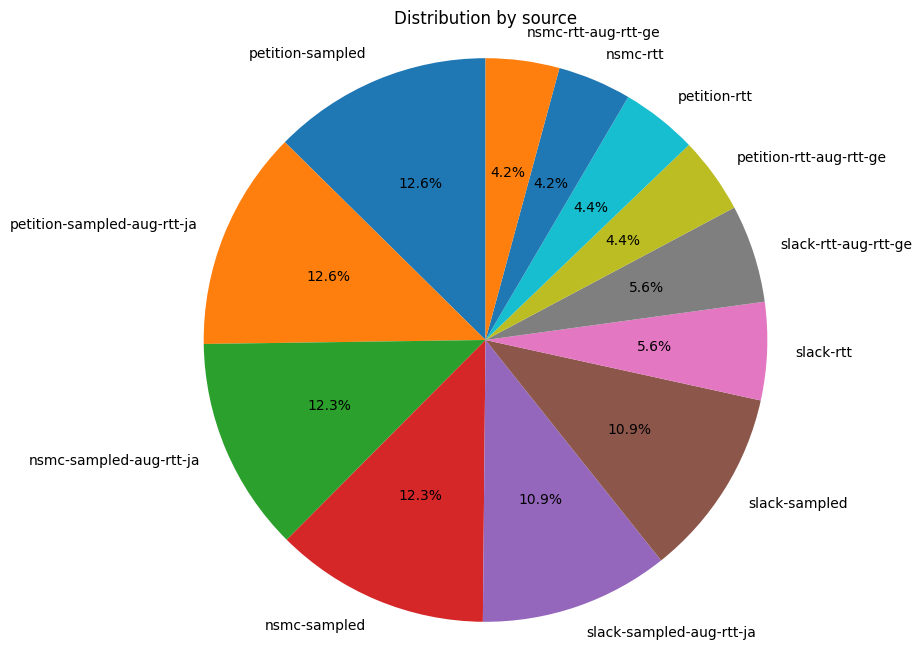

In [ ]:
# source별 데이터 개수 세기
source_counts = aug_df_final['source'].value_counts()

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution by source')
plt.axis('equal')  # 원형 비율 유지
plt.show()

In [ ]:
aug_df_final.to_csv("train_augmented_RTT_JaRttOnNonRttBothSentences_DeRttOnRttSentence2.csv", index=False)

In [ ]:
aug_df_final = pd.read_csv("train_augmented_RTT.csv")

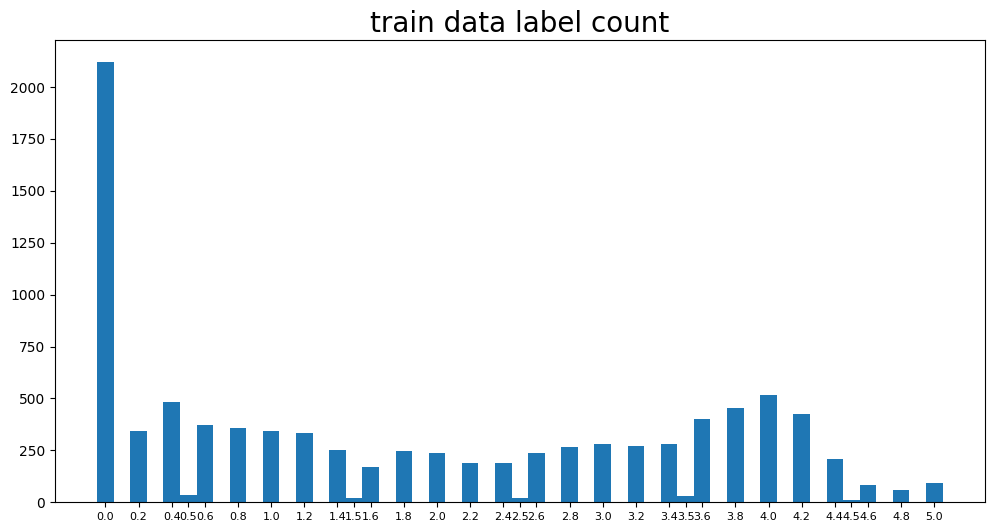

In [ ]:
import matplotlib.pyplot as plt
feature = train_pd['label']

plt.figure(figsize=(12,6))
plt.title('train data label count', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.1)
plt.xticks(temp.keys(), fontsize=8)
plt.show()

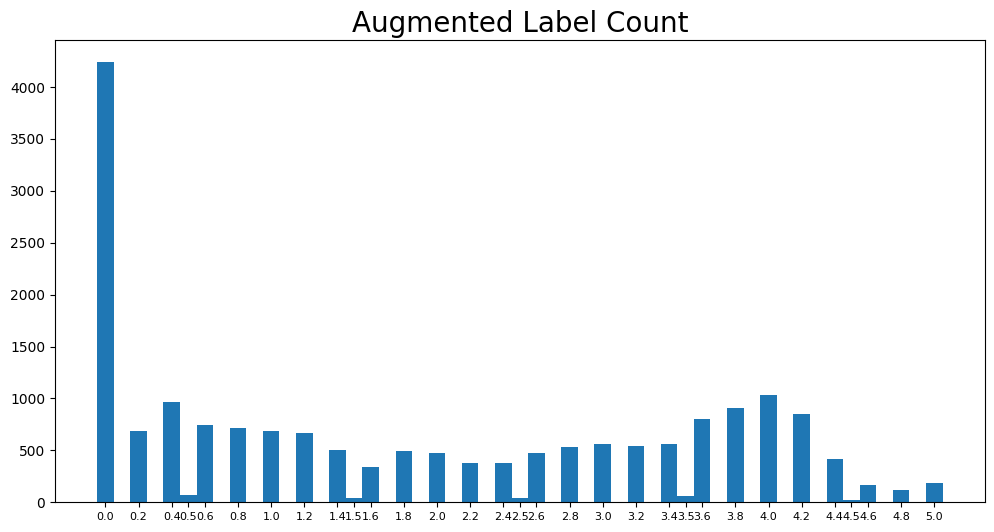

In [ ]:
import matplotlib.pyplot as plt
feature = aug_df_final['label']

plt.figure(figsize=(12,6))
plt.title('Augmented Label Count', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.1)
plt.xticks(temp.keys(), fontsize=8)
plt.show()

In [ ]:
# 데이터 분포가 0~5점까지 일직선으로 되면 좋음
# 지금은 4점 근처대 점수가 너무 커져서 오버피팅이 일어난 것 같음
# RTT를 전체 데이터에 적용해서 기존 분포를 유지
# RTT를 독일어만 적용